- This notebook is to train NN based on Latent space from FM

In [1]:
import sys
sys.path.append("../src/models")
sys.path.append("../src")
sys.path.append("../")

In [2]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
from surfactants_NN import run_NN, run_NN_update

In [4]:
# Baseline
df01 = pd.read_csv('df_total_surfactants_baseline_20250711.csv')
# df02 = pd.read_csv('df_combined_bm_baseline_20250527.csv')
# df03 = pd.read_csv('df_total_amphiphiles_baseline_20250710.csv')
# VICGAE
df11 = pd.read_csv('df_total_surfactants_VICGAE_20250707.csv')
# df12 = pd.read_csv('df_total_binary_VICGAE_20250707.csv')
# df13 = pd.read_csv('df_total_amphiphiles_VICGAE_20250707.csv')
# Chemprop
df21 = pd.read_csv('df_total_surfactants_chemprop_20250707.csv')
# df22 = pd.read_csv('df_total_binary_chemprop_20250707.csv')
# df23 = pd.read_csv('df_total_amphiphiles_chemprop_20250707.csv')
# Chemeleon
df31 = pd.read_csv('df_total_surfactants_chemeleon_20250707.csv')
# df32 = pd.read_csv('df_total_binary_chemeleon_20250707.csv')
# df33 = pd.read_csv('df_total_amphiphiles_chemleon_20250702.csv')
# SMI-TED
df41 = pd.read_csv('df_total_surfactants_smi-ted_20250709.csv')

In [8]:
df01.head()

RDKFP_0  RDKFP_1  RDKFP_2  RDKFP_3  RDKFP_4  RDKFP_5  RDKFP_6  RDKFP_7  \
0      0.0      0.0      1.0      0.0      0.0      0.0      0.0      0.0   
1      0.0      0.0      1.0      0.0      0.0      0.0      0.0      0.0   
2      0.0      0.0      1.0      0.0      0.0      0.0      0.0      0.0   
3      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   RDKFP_8  RDKFP_9  ...  RDKFP_2040  RDKFP_2041  RDKFP_2042  RDKFP_2043  \
0      0.0      0.0  ...         0.0         0.0         0.0         1.0   
1      0.0      0.0  ...         0.0         0.0         0.0         1.0   
2      0.0      0.0  ...         0.0         0.0         0.0         1.0   
3      0.0      0.0  ...         0.0         0.0         0.0         0.0   
4      0.0      0.0  ...         0.0         0.0         0.0         0.0   

   RDKFP_2044  RDKFP_2045  RDKFP_2046  RDKFP_2047  Surfactant_Type      pCMC  
0         0.0         0.0         1.0         1.0  gemini cationic  3.102373  
1         0.0         0.0         1.0         1.0  gemini cationic  3.619789  
2         0.0         0.0         1.0         1.0  gemini cationic  4.508638  
3         0.0         0.0         0.0         1.0         cationic  2.384050  
4         0.0         0.0         0.0         1.0         cationic  2.899629  

[5 rows x 2050 columns]

/var/folders/wn/w203521n4h18b4_rz5rd9tw80000gp/T/ipykernel_1957/3795511761.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Surfactant_Type', y='pCMC', data=df01, palette='Set2')


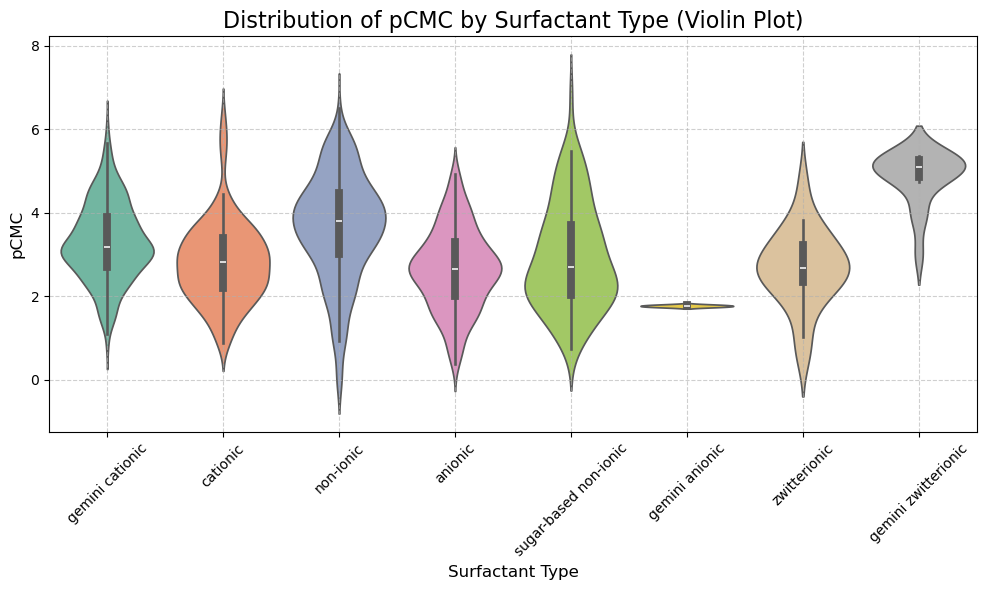

/var/folders/wn/w203521n4h18b4_rz5rd9tw80000gp/T/ipykernel_1957/3795511761.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Surfactant_Type', y='pCMC', data=df01, palette='Set2')


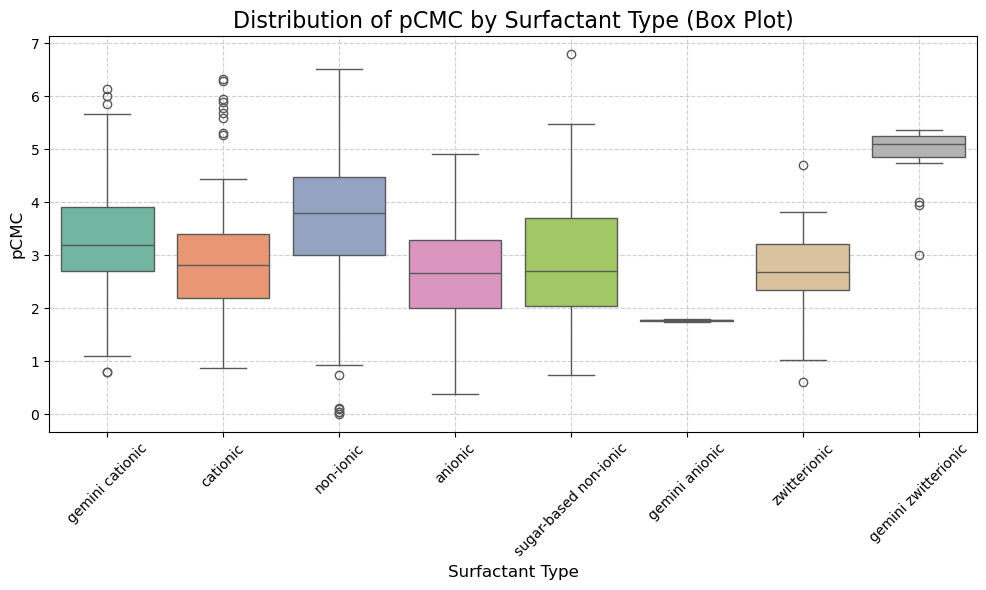

In [11]:
# --- Violin Plot ---
plt.figure(figsize=(10, 6))
sns.violinplot(x='Surfactant_Type', y='pCMC', data=df01, palette='Set2')
plt.title('Distribution of pCMC by Surfactant Type (Violin Plot)', fontsize=16)
plt.xlabel('Surfactant Type', fontsize=12)
plt.ylabel('pCMC', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Box Plot ---
# Uncomment the following lines if you prefer a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Surfactant_Type', y='pCMC', data=df01, palette='Set2')
plt.title('Distribution of pCMC by Surfactant Type (Box Plot)', fontsize=16)
plt.xlabel('Surfactant Type', fontsize=12)
plt.ylabel('pCMC', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### NN training

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [5]:
import optuna

In [65]:
# 1. Load and Prepare Data
# =======================
df = df01.copy()

X = df.iloc[:, 0:2048].values.astype(np.float32)  # features
y = df["pCMC"].values.astype(np.float32).reshape(-1, 1)  # target

# scale features (optional but helps neural nets converge)
# scale features
x_scaler = StandardScaler()
X = x_scaler.fit_transform(X)

# scale target as well
y_scaler = StandardScaler()
y = y_scaler.fit_transform(y)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [66]:
# 2. Define Model Class
# =======================
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout=0.2):
        super(MLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = h
        layers.append(nn.Linear(prev_dim, 1))  # regression output
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [67]:
# 3. Training Function
# =======================
def train_model(model, train_loader, val_loader, epochs, lr, device):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                     factor=0.5, patience=5, verbose=True)

    model.to(device)
    best_loss = float("inf")
    patience = 20
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # ---- Validation ----
        model.eval()
        val_preds, val_truths = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                val_preds.append(pred.cpu().numpy())
                val_truths.append(yb.cpu().numpy())

        val_preds = np.vstack(val_preds)
        val_truths = np.vstack(val_truths)

        # RMSE on validation
        val_rmse = np.sqrt(mean_squared_error(val_truths, val_preds))

        # Scheduler step
        scheduler.step(val_rmse)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val RMSE: {val_rmse:.4f}")

        # ---- Early stopping ----
        if val_rmse < best_loss:
            best_loss = val_rmse
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Final evaluation on validation set
    model.eval()
    with torch.no_grad():
        preds, truths = [], []
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds.append(model(xb).cpu().numpy())
            truths.append(yb.cpu().numpy())
    preds = np.vstack(preds)
    truths = np.vstack(truths)

    mse = mean_squared_error(truths, preds)
    r2 = r2_score(truths, preds)

    return mse, r2


In [68]:
# 4. Hyperparameter Optimization with Optuna
# =======================
def objective(trial):
    # hyperparameters to search
    hidden_layers = trial.suggest_int("n_layers", 1, 2, 3)
    hidden_dims = [trial.suggest_int(f"n_units_l{i}", 64, 512, 1024) for i in range(hidden_layers)]
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    # dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MLP(input_dim=2048, hidden_dims=hidden_dims, dropout=dropout)

    mse, r2 = train_model(model, train_loader, val_loader, epochs=30, lr=lr, device=device)
    trial.report(mse, step=0)

    return mse  # minimize MSE

In [69]:
%%time
# Run Optuna search

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Best hyperparameters:", study.best_params)
print("Best MSE:", study.best_value)

[I 2025-10-03 13:34:44,655] A new study created in memory with name: no-name-bd6926cc-e194-4dbd-99d5-df6a0be3d891


Epoch 1/30, Train Loss: 0.9362, Val RMSE: 0.8718
Epoch 2/30, Train Loss: 0.6844, Val RMSE: 0.8589
Epoch 3/30, Train Loss: 0.5950, Val RMSE: 0.8312
Epoch 4/30, Train Loss: 0.5772, Val RMSE: 0.8222
Epoch 5/30, Train Loss: 0.5599, Val RMSE: 0.8187
Epoch 6/30, Train Loss: 0.5214, Val RMSE: 0.8141
Epoch 7/30, Train Loss: 0.4927, Val RMSE: 0.8092
Epoch 8/30, Train Loss: 0.5204, Val RMSE: 0.8047
Epoch 9/30, Train Loss: 0.4793, Val RMSE: 0.8070
Epoch 10/30, Train Loss: 0.4804, Val RMSE: 0.7905
Epoch 11/30, Train Loss: 0.4592, Val RMSE: 0.7947
Epoch 12/30, Train Loss: 0.4803, Val RMSE: 0.7984
Epoch 13/30, Train Loss: 0.4547, Val RMSE: 0.7811
Epoch 14/30, Train Loss: 0.4686, Val RMSE: 0.7811
Epoch 15/30, Train Loss: 0.4568, Val RMSE: 0.7867
Epoch 16/30, Train Loss: 0.4625, Val RMSE: 0.7926
Epoch 17/30, Train Loss: 0.4689, Val RMSE: 0.7882
Epoch 18/30, Train Loss: 0.4467, Val RMSE: 0.7837
Epoch 19/30, Train Loss: 0.4543, Val RMSE: 0.7976
Epoch 20/30, Train Loss: 0.4359, Val RMSE: 0.7821
Epoch 21/

[I 2025-10-03 13:34:48,436] Trial 0 finished with value: 0.6146555542945862 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.37816176380810856, 'lr': 0.0006600468305187979, 'batch_size': 128}. Best is trial 0 with value: 0.6146555542945862.


Epoch 30/30, Train Loss: 0.4016, Val RMSE: 0.7840
Epoch 1/30, Train Loss: 0.8311, Val RMSE: 0.8849
Epoch 2/30, Train Loss: 0.6446, Val RMSE: 0.8525
Epoch 3/30, Train Loss: 0.5927, Val RMSE: 0.8342
Epoch 4/30, Train Loss: 0.5490, Val RMSE: 0.8348
Epoch 5/30, Train Loss: 0.5230, Val RMSE: 0.8173
Epoch 6/30, Train Loss: 0.4999, Val RMSE: 0.8106
Epoch 7/30, Train Loss: 0.4819, Val RMSE: 0.8094
Epoch 8/30, Train Loss: 0.4724, Val RMSE: 0.7999
Epoch 9/30, Train Loss: 0.4626, Val RMSE: 0.7977
Epoch 10/30, Train Loss: 0.4611, Val RMSE: 0.7988
Epoch 11/30, Train Loss: 0.4370, Val RMSE: 0.7957
Epoch 12/30, Train Loss: 0.4446, Val RMSE: 0.8007
Epoch 13/30, Train Loss: 0.4499, Val RMSE: 0.7836
Epoch 14/30, Train Loss: 0.4378, Val RMSE: 0.7917
Epoch 15/30, Train Loss: 0.4199, Val RMSE: 0.7859
Epoch 16/30, Train Loss: 0.4324, Val RMSE: 0.7946
Epoch 17/30, Train Loss: 0.4335, Val RMSE: 0.7868
Epoch 18/30, Train Loss: 0.4218, Val RMSE: 0.7982
Epoch 19/30, Train Loss: 0.4280, Val RMSE: 0.7943
Epoch 20/

[I 2025-10-03 13:34:55,570] Trial 1 finished with value: 0.6143774390220642 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15468286327622602, 'lr': 0.00016976930034549482, 'batch_size': 32}. Best is trial 1 with value: 0.6143774390220642.


Epoch 29/30, Train Loss: 0.3974, Val RMSE: 0.7857
Epoch 30/30, Train Loss: 0.3984, Val RMSE: 0.7838
Epoch 1/30, Train Loss: 0.8546, Val RMSE: 0.8501
Epoch 2/30, Train Loss: 0.6044, Val RMSE: 0.8231
Epoch 3/30, Train Loss: 0.5471, Val RMSE: 0.8144
Epoch 4/30, Train Loss: 0.5219, Val RMSE: 0.7952
Epoch 5/30, Train Loss: 0.5051, Val RMSE: 0.8221
Epoch 6/30, Train Loss: 0.4811, Val RMSE: 0.7922
Epoch 7/30, Train Loss: 0.4794, Val RMSE: 0.7989
Epoch 8/30, Train Loss: 0.4805, Val RMSE: 0.8248
Epoch 9/30, Train Loss: 0.4800, Val RMSE: 0.7905
Epoch 10/30, Train Loss: 0.4637, Val RMSE: 0.7959
Epoch 11/30, Train Loss: 0.4636, Val RMSE: 0.7883
Epoch 12/30, Train Loss: 0.4369, Val RMSE: 0.8015
Epoch 13/30, Train Loss: 0.4497, Val RMSE: 0.8068
Epoch 14/30, Train Loss: 0.4493, Val RMSE: 0.7919
Epoch 15/30, Train Loss: 0.4408, Val RMSE: 0.7968
Epoch 16/30, Train Loss: 0.4321, Val RMSE: 0.7960
Epoch 17/30, Train Loss: 0.4281, Val RMSE: 0.7784
Epoch 18/30, Train Loss: 0.4235, Val RMSE: 0.7956
Epoch 19/

[I 2025-10-03 13:35:03,864] Trial 2 finished with value: 0.6143214702606201 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17174305103751603, 'lr': 0.0003541799309700069, 'batch_size': 32}. Best is trial 2 with value: 0.6143214702606201.


Epoch 30/30, Train Loss: 0.3884, Val RMSE: 0.7838
Epoch 1/30, Train Loss: 0.8722, Val RMSE: 0.8880
Epoch 2/30, Train Loss: 0.6802, Val RMSE: 0.8396
Epoch 3/30, Train Loss: 0.6223, Val RMSE: 0.8270
Epoch 4/30, Train Loss: 0.5354, Val RMSE: 0.8113
Epoch 5/30, Train Loss: 0.5558, Val RMSE: 0.8155
Epoch 6/30, Train Loss: 0.5087, Val RMSE: 0.7980
Epoch 7/30, Train Loss: 0.4980, Val RMSE: 0.7965
Epoch 8/30, Train Loss: 0.4969, Val RMSE: 0.7994
Epoch 9/30, Train Loss: 0.4840, Val RMSE: 0.7921
Epoch 10/30, Train Loss: 0.4917, Val RMSE: 0.7935
Epoch 11/30, Train Loss: 0.4750, Val RMSE: 0.8008
Epoch 12/30, Train Loss: 0.4638, Val RMSE: 0.7939
Epoch 13/30, Train Loss: 0.4591, Val RMSE: 0.7925
Epoch 14/30, Train Loss: 0.4279, Val RMSE: 0.7893
Epoch 15/30, Train Loss: 0.4397, Val RMSE: 0.7861
Epoch 16/30, Train Loss: 0.4449, Val RMSE: 0.7815
Epoch 17/30, Train Loss: 0.4403, Val RMSE: 0.7880
Epoch 18/30, Train Loss: 0.4173, Val RMSE: 0.7951
Epoch 19/30, Train Loss: 0.4287, Val RMSE: 0.7886
Epoch 20/

[I 2025-10-03 13:35:06,440] Trial 3 finished with value: 0.6178799867630005 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3346599886689174, 'lr': 0.0007145904371284674, 'batch_size': 128}. Best is trial 2 with value: 0.6143214702606201.


Epoch 30/30, Train Loss: 0.3999, Val RMSE: 0.7861
Epoch 1/30, Train Loss: 0.8726, Val RMSE: 0.8863
Epoch 2/30, Train Loss: 0.6973, Val RMSE: 0.8610
Epoch 3/30, Train Loss: 0.6485, Val RMSE: 0.8460
Epoch 4/30, Train Loss: 0.5968, Val RMSE: 0.8370
Epoch 5/30, Train Loss: 0.5442, Val RMSE: 0.8248
Epoch 6/30, Train Loss: 0.5258, Val RMSE: 0.8187
Epoch 7/30, Train Loss: 0.5248, Val RMSE: 0.8149
Epoch 8/30, Train Loss: 0.5274, Val RMSE: 0.8103
Epoch 9/30, Train Loss: 0.4982, Val RMSE: 0.8057
Epoch 10/30, Train Loss: 0.4885, Val RMSE: 0.8036
Epoch 11/30, Train Loss: 0.5036, Val RMSE: 0.8031
Epoch 12/30, Train Loss: 0.4646, Val RMSE: 0.8055
Epoch 13/30, Train Loss: 0.4706, Val RMSE: 0.8009
Epoch 14/30, Train Loss: 0.4623, Val RMSE: 0.8026
Epoch 15/30, Train Loss: 0.4612, Val RMSE: 0.8097
Epoch 16/30, Train Loss: 0.4565, Val RMSE: 0.7995
Epoch 17/30, Train Loss: 0.4728, Val RMSE: 0.7973
Epoch 18/30, Train Loss: 0.4519, Val RMSE: 0.7934
Epoch 19/30, Train Loss: 0.4574, Val RMSE: 0.8047
Epoch 20/

[I 2025-10-03 13:35:08,820] Trial 4 finished with value: 0.6202030777931213 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4393965046676641, 'lr': 0.0004648006319358135, 'batch_size': 128}. Best is trial 2 with value: 0.6143214702606201.


Epoch 27/30, Train Loss: 0.4303, Val RMSE: 0.7932
Epoch 28/30, Train Loss: 0.4393, Val RMSE: 0.7873
Epoch 29/30, Train Loss: 0.4416, Val RMSE: 0.7917
Epoch 30/30, Train Loss: 0.4260, Val RMSE: 0.7875
Epoch 1/30, Train Loss: 2.4834, Val RMSE: 1.0743
Epoch 2/30, Train Loss: 0.8327, Val RMSE: 0.8774
Epoch 3/30, Train Loss: 0.6413, Val RMSE: 0.8648
Epoch 4/30, Train Loss: 0.5802, Val RMSE: 0.8291
Epoch 5/30, Train Loss: 0.5997, Val RMSE: 0.8784
Epoch 6/30, Train Loss: 0.6050, Val RMSE: 0.8317
Epoch 7/30, Train Loss: 0.5618, Val RMSE: 0.8039
Epoch 8/30, Train Loss: 0.5159, Val RMSE: 0.8392
Epoch 9/30, Train Loss: 0.5279, Val RMSE: 0.8215
Epoch 10/30, Train Loss: 0.5297, Val RMSE: 0.8187
Epoch 11/30, Train Loss: 0.5073, Val RMSE: 0.8137
Epoch 12/30, Train Loss: 0.5077, Val RMSE: 0.8214
Epoch 13/30, Train Loss: 0.4856, Val RMSE: 0.8332
Epoch 14/30, Train Loss: 0.4741, Val RMSE: 0.7985
Epoch 15/30, Train Loss: 0.4456, Val RMSE: 0.8193
Epoch 16/30, Train Loss: 0.4422, Val RMSE: 0.7921
Epoch 17/

[I 2025-10-03 13:35:15,781] Trial 5 finished with value: 0.647263765335083 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1498380695412996, 'lr': 0.004887575869031618, 'batch_size': 32}. Best is trial 2 with value: 0.6143214702606201.


Epoch 30/30, Train Loss: 0.4331, Val RMSE: 0.8045
Epoch 1/30, Train Loss: 1.9618, Val RMSE: 1.3427
Epoch 2/30, Train Loss: 1.5185, Val RMSE: 0.9718
Epoch 3/30, Train Loss: 0.9203, Val RMSE: 0.9125
Epoch 4/30, Train Loss: 0.7451, Val RMSE: 0.8841
Epoch 5/30, Train Loss: 0.6539, Val RMSE: 0.8440
Epoch 6/30, Train Loss: 0.6138, Val RMSE: 0.8379
Epoch 7/30, Train Loss: 0.5921, Val RMSE: 0.8285
Epoch 8/30, Train Loss: 0.5739, Val RMSE: 0.8148
Epoch 9/30, Train Loss: 0.5862, Val RMSE: 0.8251
Epoch 10/30, Train Loss: 0.5650, Val RMSE: 0.8137
Epoch 11/30, Train Loss: 0.5394, Val RMSE: 0.8218
Epoch 12/30, Train Loss: 0.5548, Val RMSE: 0.8171
Epoch 13/30, Train Loss: 0.5278, Val RMSE: 0.8180
Epoch 14/30, Train Loss: 0.5391, Val RMSE: 0.8051
Epoch 15/30, Train Loss: 0.5403, Val RMSE: 0.8048
Epoch 16/30, Train Loss: 0.5187, Val RMSE: 0.7956
Epoch 17/30, Train Loss: 0.5014, Val RMSE: 0.7970
Epoch 18/30, Train Loss: 0.5146, Val RMSE: 0.7989
Epoch 19/30, Train Loss: 0.4771, Val RMSE: 0.7890
Epoch 20/

[I 2025-10-03 13:35:18,965] Trial 6 finished with value: 0.62745201587677 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.49841283158644595, 'lr': 0.004642389620731315, 'batch_size': 128}. Best is trial 2 with value: 0.6143214702606201.


Epoch 30/30, Train Loss: 0.4332, Val RMSE: 0.7921
Epoch 1/30, Train Loss: 2.1354, Val RMSE: 1.0018
Epoch 2/30, Train Loss: 0.8749, Val RMSE: 0.9072
Epoch 3/30, Train Loss: 0.6701, Val RMSE: 0.8367
Epoch 4/30, Train Loss: 0.6068, Val RMSE: 0.8273
Epoch 5/30, Train Loss: 0.5901, Val RMSE: 0.9042
Epoch 6/30, Train Loss: 0.5551, Val RMSE: 0.8118
Epoch 7/30, Train Loss: 0.5543, Val RMSE: 0.8419
Epoch 8/30, Train Loss: 0.5383, Val RMSE: 0.8539
Epoch 9/30, Train Loss: 0.5333, Val RMSE: 0.8323
Epoch 10/30, Train Loss: 0.4998, Val RMSE: 0.8066
Epoch 11/30, Train Loss: 0.5111, Val RMSE: 0.8071
Epoch 12/30, Train Loss: 0.4835, Val RMSE: 0.8380
Epoch 13/30, Train Loss: 0.5053, Val RMSE: 0.8209
Epoch 14/30, Train Loss: 0.4724, Val RMSE: 0.8304
Epoch 15/30, Train Loss: 0.5213, Val RMSE: 0.8350
Epoch 16/30, Train Loss: 0.5158, Val RMSE: 0.8170
Epoch 17/30, Train Loss: 0.4631, Val RMSE: 0.7928
Epoch 18/30, Train Loss: 0.4203, Val RMSE: 0.7970
Epoch 19/30, Train Loss: 0.4369, Val RMSE: 0.7910
Epoch 20/

[I 2025-10-03 13:35:25,375] Trial 7 finished with value: 0.6216588616371155 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24493130791067302, 'lr': 0.00389998042552204, 'batch_size': 32}. Best is trial 2 with value: 0.6143214702606201.


Epoch 29/30, Train Loss: 0.4119, Val RMSE: 0.7948
Epoch 30/30, Train Loss: 0.3955, Val RMSE: 0.7885
Epoch 1/30, Train Loss: 0.9365, Val RMSE: 0.9572
Epoch 2/30, Train Loss: 0.7156, Val RMSE: 0.9000
Epoch 3/30, Train Loss: 0.6611, Val RMSE: 0.8748
Epoch 4/30, Train Loss: 0.5922, Val RMSE: 0.8548
Epoch 5/30, Train Loss: 0.5749, Val RMSE: 0.8443
Epoch 6/30, Train Loss: 0.5427, Val RMSE: 0.8294
Epoch 7/30, Train Loss: 0.5333, Val RMSE: 0.8235
Epoch 8/30, Train Loss: 0.5063, Val RMSE: 0.8211
Epoch 9/30, Train Loss: 0.5029, Val RMSE: 0.8161
Epoch 10/30, Train Loss: 0.4783, Val RMSE: 0.8099
Epoch 11/30, Train Loss: 0.4794, Val RMSE: 0.8096
Epoch 12/30, Train Loss: 0.4680, Val RMSE: 0.8041
Epoch 13/30, Train Loss: 0.4524, Val RMSE: 0.7989
Epoch 14/30, Train Loss: 0.4558, Val RMSE: 0.7973
Epoch 15/30, Train Loss: 0.4439, Val RMSE: 0.8003
Epoch 16/30, Train Loss: 0.4321, Val RMSE: 0.7939
Epoch 17/30, Train Loss: 0.4260, Val RMSE: 0.7918
Epoch 18/30, Train Loss: 0.4286, Val RMSE: 0.7948
Epoch 19/

[I 2025-10-03 13:35:29,597] Trial 8 finished with value: 0.6192427277565002 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.142168087602141, 'lr': 0.00011811798530468176, 'batch_size': 64}. Best is trial 2 with value: 0.6143214702606201.


Epoch 29/30, Train Loss: 0.4012, Val RMSE: 0.7899
Epoch 30/30, Train Loss: 0.4091, Val RMSE: 0.7869
Epoch 1/30, Train Loss: 0.9786, Val RMSE: 0.9198
Epoch 2/30, Train Loss: 0.6955, Val RMSE: 0.8904
Epoch 3/30, Train Loss: 0.5738, Val RMSE: 0.8423
Epoch 4/30, Train Loss: 0.5646, Val RMSE: 0.8235
Epoch 5/30, Train Loss: 0.5278, Val RMSE: 0.8330
Epoch 6/30, Train Loss: 0.5122, Val RMSE: 0.8148
Epoch 7/30, Train Loss: 0.5161, Val RMSE: 0.8132
Epoch 8/30, Train Loss: 0.4928, Val RMSE: 0.8156
Epoch 9/30, Train Loss: 0.4844, Val RMSE: 0.7994
Epoch 10/30, Train Loss: 0.4898, Val RMSE: 0.7898
Epoch 11/30, Train Loss: 0.4583, Val RMSE: 0.7909
Epoch 12/30, Train Loss: 0.4577, Val RMSE: 0.7997
Epoch 13/30, Train Loss: 0.4587, Val RMSE: 0.8024
Epoch 14/30, Train Loss: 0.4534, Val RMSE: 0.7918
Epoch 15/30, Train Loss: 0.4490, Val RMSE: 0.8050
Epoch 16/30, Train Loss: 0.4447, Val RMSE: 0.8078
Epoch 17/30, Train Loss: 0.4131, Val RMSE: 0.7897
Epoch 18/30, Train Loss: 0.4126, Val RMSE: 0.7936
Epoch 19/

[I 2025-10-03 13:35:36,403] Trial 9 finished with value: 0.6133344769477844 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20333146585411815, 'lr': 0.0008683226563707215, 'batch_size': 32}. Best is trial 9 with value: 0.6133344769477844.


Epoch 30/30, Train Loss: 0.3958, Val RMSE: 0.7832
Epoch 1/30, Train Loss: 1.0289, Val RMSE: 0.9358
Epoch 2/30, Train Loss: 0.7276, Val RMSE: 0.8515
Epoch 3/30, Train Loss: 0.6220, Val RMSE: 0.8540
Epoch 4/30, Train Loss: 0.5646, Val RMSE: 0.8116
Epoch 5/30, Train Loss: 0.5092, Val RMSE: 0.8082
Epoch 6/30, Train Loss: 0.5078, Val RMSE: 0.8297
Epoch 7/30, Train Loss: 0.5168, Val RMSE: 0.8041
Epoch 8/30, Train Loss: 0.4856, Val RMSE: 0.7837
Epoch 9/30, Train Loss: 0.4766, Val RMSE: 0.7792
Epoch 10/30, Train Loss: 0.4759, Val RMSE: 0.7915
Epoch 11/30, Train Loss: 0.4427, Val RMSE: 0.7891
Epoch 12/30, Train Loss: 0.4463, Val RMSE: 0.7824
Epoch 13/30, Train Loss: 0.4700, Val RMSE: 0.7947
Epoch 14/30, Train Loss: 0.4711, Val RMSE: 0.7885
Epoch 15/30, Train Loss: 0.4675, Val RMSE: 0.7934
Epoch 16/30, Train Loss: 0.4356, Val RMSE: 0.7797
Epoch 17/30, Train Loss: 0.4127, Val RMSE: 0.7856
Epoch 18/30, Train Loss: 0.4279, Val RMSE: 0.7828
Epoch 19/30, Train Loss: 0.4189, Val RMSE: 0.7860
Epoch 20/

[I 2025-10-03 13:35:40,456] Trial 10 finished with value: 0.609927237033844 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2715908234409933, 'lr': 0.0017760047346740998, 'batch_size': 64}. Best is trial 10 with value: 0.609927237033844.


Epoch 29/30, Train Loss: 0.3826, Val RMSE: 0.7810
Early stopping triggered.
Epoch 1/30, Train Loss: 1.1053, Val RMSE: 0.9412
Epoch 2/30, Train Loss: 0.8010, Val RMSE: 0.8592
Epoch 3/30, Train Loss: 0.6839, Val RMSE: 0.8263
Epoch 4/30, Train Loss: 0.5698, Val RMSE: 0.8038
Epoch 5/30, Train Loss: 0.5129, Val RMSE: 0.8079
Epoch 6/30, Train Loss: 0.5397, Val RMSE: 0.7967
Epoch 7/30, Train Loss: 0.5092, Val RMSE: 0.8095
Epoch 8/30, Train Loss: 0.5082, Val RMSE: 0.7943
Epoch 9/30, Train Loss: 0.4792, Val RMSE: 0.7998
Epoch 10/30, Train Loss: 0.4778, Val RMSE: 0.7911
Epoch 11/30, Train Loss: 0.4811, Val RMSE: 0.7981
Epoch 12/30, Train Loss: 0.4732, Val RMSE: 0.7925
Epoch 13/30, Train Loss: 0.4595, Val RMSE: 0.7876
Epoch 14/30, Train Loss: 0.4635, Val RMSE: 0.8008
Epoch 15/30, Train Loss: 0.4727, Val RMSE: 0.7803
Epoch 16/30, Train Loss: 0.4412, Val RMSE: 0.7945
Epoch 17/30, Train Loss: 0.4400, Val RMSE: 0.7935
Epoch 18/30, Train Loss: 0.4373, Val RMSE: 0.7980
Epoch 19/30, Train Loss: 0.4782, 

[I 2025-10-03 13:35:43,762] Trial 11 finished with value: 0.6250938773155212 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2584305456189907, 'lr': 0.0017949346384851517, 'batch_size': 64}. Best is trial 10 with value: 0.609927237033844.


Epoch 29/30, Train Loss: 0.3873, Val RMSE: 0.7927
Epoch 30/30, Train Loss: 0.3822, Val RMSE: 0.7906
Epoch 1/30, Train Loss: 1.1891, Val RMSE: 0.9258
Epoch 2/30, Train Loss: 0.9110, Val RMSE: 0.9304
Epoch 3/30, Train Loss: 0.6785, Val RMSE: 0.8275
Epoch 4/30, Train Loss: 0.6010, Val RMSE: 0.8237
Epoch 5/30, Train Loss: 0.5595, Val RMSE: 0.8049
Epoch 6/30, Train Loss: 0.4987, Val RMSE: 0.8009
Epoch 7/30, Train Loss: 0.5070, Val RMSE: 0.8069
Epoch 8/30, Train Loss: 0.5228, Val RMSE: 0.7942
Epoch 9/30, Train Loss: 0.4597, Val RMSE: 0.7979
Epoch 10/30, Train Loss: 0.4440, Val RMSE: 0.7982
Epoch 11/30, Train Loss: 0.4769, Val RMSE: 0.7987
Epoch 12/30, Train Loss: 0.4686, Val RMSE: 0.8084
Epoch 13/30, Train Loss: 0.4514, Val RMSE: 0.8069
Epoch 14/30, Train Loss: 0.4590, Val RMSE: 0.8007
Epoch 15/30, Train Loss: 0.4424, Val RMSE: 0.7902
Epoch 16/30, Train Loss: 0.4155, Val RMSE: 0.7917
Epoch 17/30, Train Loss: 0.4204, Val RMSE: 0.7883
Epoch 18/30, Train Loss: 0.4191, Val RMSE: 0.7998
Epoch 19/

[I 2025-10-03 13:35:46,917] Trial 12 finished with value: 0.6196454167366028 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2654921141775005, 'lr': 0.001926710373212392, 'batch_size': 64}. Best is trial 10 with value: 0.609927237033844.


Epoch 29/30, Train Loss: 0.3925, Val RMSE: 0.7880
Epoch 30/30, Train Loss: 0.3919, Val RMSE: 0.7872
Epoch 1/30, Train Loss: 0.9734, Val RMSE: 0.9149
Epoch 2/30, Train Loss: 0.7395, Val RMSE: 0.8506
Epoch 3/30, Train Loss: 0.6661, Val RMSE: 0.8042
Epoch 4/30, Train Loss: 0.5350, Val RMSE: 0.8094
Epoch 5/30, Train Loss: 0.5444, Val RMSE: 0.7991
Epoch 6/30, Train Loss: 0.4761, Val RMSE: 0.8112
Epoch 7/30, Train Loss: 0.4940, Val RMSE: 0.7990
Epoch 8/30, Train Loss: 0.4747, Val RMSE: 0.8077
Epoch 9/30, Train Loss: 0.4780, Val RMSE: 0.8172
Epoch 10/30, Train Loss: 0.4627, Val RMSE: 0.8012
Epoch 11/30, Train Loss: 0.4843, Val RMSE: 0.7978
Epoch 12/30, Train Loss: 0.4647, Val RMSE: 0.8053
Epoch 13/30, Train Loss: 0.4406, Val RMSE: 0.7956
Epoch 14/30, Train Loss: 0.4484, Val RMSE: 0.7872
Epoch 15/30, Train Loss: 0.4425, Val RMSE: 0.7882
Epoch 16/30, Train Loss: 0.4387, Val RMSE: 0.7861
Epoch 17/30, Train Loss: 0.4189, Val RMSE: 0.7809
Epoch 18/30, Train Loss: 0.4312, Val RMSE: 0.7871
Epoch 19/

[I 2025-10-03 13:35:51,085] Trial 13 finished with value: 0.6220649480819702 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.21689765928478733, 'lr': 0.0014887165662703416, 'batch_size': 64}. Best is trial 10 with value: 0.609927237033844.


Epoch 29/30, Train Loss: 0.3808, Val RMSE: 0.7948
Epoch 30/30, Train Loss: 0.3827, Val RMSE: 0.7887
Epoch 1/30, Train Loss: 1.1445, Val RMSE: 0.9572
Epoch 2/30, Train Loss: 0.8248, Val RMSE: 0.8499
Epoch 3/30, Train Loss: 0.6987, Val RMSE: 0.8167
Epoch 4/30, Train Loss: 0.5873, Val RMSE: 0.8036
Epoch 5/30, Train Loss: 0.5370, Val RMSE: 0.8110
Epoch 6/30, Train Loss: 0.5590, Val RMSE: 0.8080
Epoch 7/30, Train Loss: 0.5274, Val RMSE: 0.7955
Epoch 8/30, Train Loss: 0.5152, Val RMSE: 0.8064
Epoch 9/30, Train Loss: 0.4808, Val RMSE: 0.7812
Epoch 10/30, Train Loss: 0.4932, Val RMSE: 0.7977
Epoch 11/30, Train Loss: 0.4955, Val RMSE: 0.7954
Epoch 12/30, Train Loss: 0.4745, Val RMSE: 0.8368
Epoch 13/30, Train Loss: 0.4998, Val RMSE: 0.8086
Epoch 14/30, Train Loss: 0.4780, Val RMSE: 0.7875
Epoch 15/30, Train Loss: 0.4623, Val RMSE: 0.7936
Epoch 16/30, Train Loss: 0.4317, Val RMSE: 0.7874
Epoch 17/30, Train Loss: 0.4240, Val RMSE: 0.7919
Epoch 18/30, Train Loss: 0.4229, Val RMSE: 0.7862
Epoch 19/

[I 2025-10-03 13:35:57,217] Trial 14 finished with value: 0.6169238686561584 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3177189310759401, 'lr': 0.0011166815023898064, 'batch_size': 32}. Best is trial 10 with value: 0.609927237033844.


Epoch 30/30, Train Loss: 0.3966, Val RMSE: 0.7854
Epoch 1/30, Train Loss: 2.9689, Val RMSE: 1.1859
Epoch 2/30, Train Loss: 1.2175, Val RMSE: 0.9185
Epoch 3/30, Train Loss: 0.7525, Val RMSE: 0.8817
Epoch 4/30, Train Loss: 0.6780, Val RMSE: 0.9074
Epoch 5/30, Train Loss: 0.6512, Val RMSE: 0.8422
Epoch 6/30, Train Loss: 0.5885, Val RMSE: 0.8323
Epoch 7/30, Train Loss: 0.5381, Val RMSE: 0.8261
Epoch 8/30, Train Loss: 0.5345, Val RMSE: 0.9327
Epoch 9/30, Train Loss: 0.5733, Val RMSE: 0.8131
Epoch 10/30, Train Loss: 0.5388, Val RMSE: 0.8524
Epoch 11/30, Train Loss: 0.5519, Val RMSE: 0.8150
Epoch 12/30, Train Loss: 0.5304, Val RMSE: 0.8234
Epoch 13/30, Train Loss: 0.5091, Val RMSE: 0.8209
Epoch 14/30, Train Loss: 0.4899, Val RMSE: 0.8366
Epoch 15/30, Train Loss: 0.5579, Val RMSE: 0.8634
Epoch 16/30, Train Loss: 0.4880, Val RMSE: 0.8082
Epoch 17/30, Train Loss: 0.4812, Val RMSE: 0.8376
Epoch 18/30, Train Loss: 0.4747, Val RMSE: 0.8178
Epoch 19/30, Train Loss: 0.4517, Val RMSE: 0.7861
Epoch 20/

[I 2025-10-03 13:36:01,063] Trial 15 finished with value: 0.6214624643325806 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20610861419588555, 'lr': 0.008034457046749093, 'batch_size': 64}. Best is trial 10 with value: 0.609927237033844.


Epoch 30/30, Train Loss: 0.4070, Val RMSE: 0.7883
Epoch 1/30, Train Loss: 1.3039, Val RMSE: 0.9305
Epoch 2/30, Train Loss: 0.7024, Val RMSE: 0.8409
Epoch 3/30, Train Loss: 0.6001, Val RMSE: 0.8624
Epoch 4/30, Train Loss: 0.5857, Val RMSE: 0.7998
Epoch 5/30, Train Loss: 0.5006, Val RMSE: 0.8033
Epoch 6/30, Train Loss: 0.4859, Val RMSE: 0.7867
Epoch 7/30, Train Loss: 0.4768, Val RMSE: 0.7939
Epoch 8/30, Train Loss: 0.4760, Val RMSE: 0.7901
Epoch 9/30, Train Loss: 0.4687, Val RMSE: 0.7915
Epoch 10/30, Train Loss: 0.4748, Val RMSE: 0.8041
Epoch 11/30, Train Loss: 0.4547, Val RMSE: 0.7937
Epoch 12/30, Train Loss: 0.4577, Val RMSE: 0.8009
Epoch 13/30, Train Loss: 0.4288, Val RMSE: 0.7901
Epoch 14/30, Train Loss: 0.4263, Val RMSE: 0.7889
Epoch 15/30, Train Loss: 0.4240, Val RMSE: 0.7769
Epoch 16/30, Train Loss: 0.4051, Val RMSE: 0.7874
Epoch 17/30, Train Loss: 0.4096, Val RMSE: 0.7774
Epoch 18/30, Train Loss: 0.4085, Val RMSE: 0.7839
Epoch 19/30, Train Loss: 0.4040, Val RMSE: 0.7793
Epoch 20/

[I 2025-10-03 13:36:04,811] Trial 16 finished with value: 0.6155880093574524 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10742965135650703, 'lr': 0.0028096537430917015, 'batch_size': 64}. Best is trial 10 with value: 0.609927237033844.


Epoch 30/30, Train Loss: 0.3727, Val RMSE: 0.7846
Epoch 1/30, Train Loss: 0.8428, Val RMSE: 0.8770
Epoch 2/30, Train Loss: 0.6700, Val RMSE: 0.8487
Epoch 3/30, Train Loss: 0.6023, Val RMSE: 0.8362
Epoch 4/30, Train Loss: 0.5808, Val RMSE: 0.8258
Epoch 5/30, Train Loss: 0.5452, Val RMSE: 0.8112
Epoch 6/30, Train Loss: 0.5180, Val RMSE: 0.8129
Epoch 7/30, Train Loss: 0.5378, Val RMSE: 0.8114
Epoch 8/30, Train Loss: 0.4900, Val RMSE: 0.8213
Epoch 9/30, Train Loss: 0.4984, Val RMSE: 0.8064
Epoch 10/30, Train Loss: 0.4774, Val RMSE: 0.7995
Epoch 11/30, Train Loss: 0.4824, Val RMSE: 0.8068
Epoch 12/30, Train Loss: 0.4487, Val RMSE: 0.8109
Epoch 13/30, Train Loss: 0.4756, Val RMSE: 0.8079
Epoch 14/30, Train Loss: 0.4725, Val RMSE: 0.7997
Epoch 15/30, Train Loss: 0.4610, Val RMSE: 0.7941
Epoch 16/30, Train Loss: 0.4767, Val RMSE: 0.7935
Epoch 17/30, Train Loss: 0.4503, Val RMSE: 0.7932
Epoch 18/30, Train Loss: 0.4736, Val RMSE: 0.7981
Epoch 19/30, Train Loss: 0.4532, Val RMSE: 0.8126
Epoch 20/

[I 2025-10-03 13:36:11,165] Trial 17 finished with value: 0.6253586411476135 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.38747189338041826, 'lr': 0.0002562745827897373, 'batch_size': 32}. Best is trial 10 with value: 0.609927237033844.


Epoch 1/30, Train Loss: 0.9741, Val RMSE: 0.9430
Epoch 2/30, Train Loss: 0.7231, Val RMSE: 0.8522
Epoch 3/30, Train Loss: 0.5968, Val RMSE: 0.8302
Epoch 4/30, Train Loss: 0.5714, Val RMSE: 0.8450
Epoch 5/30, Train Loss: 0.5862, Val RMSE: 0.8071
Epoch 6/30, Train Loss: 0.5253, Val RMSE: 0.8183
Epoch 7/30, Train Loss: 0.5136, Val RMSE: 0.8081
Epoch 8/30, Train Loss: 0.5108, Val RMSE: 0.8119
Epoch 9/30, Train Loss: 0.4941, Val RMSE: 0.8085
Epoch 10/30, Train Loss: 0.4768, Val RMSE: 0.8044
Epoch 11/30, Train Loss: 0.4574, Val RMSE: 0.8026
Epoch 12/30, Train Loss: 0.4548, Val RMSE: 0.7923
Epoch 13/30, Train Loss: 0.4743, Val RMSE: 0.7997
Epoch 14/30, Train Loss: 0.4423, Val RMSE: 0.7886
Epoch 15/30, Train Loss: 0.4406, Val RMSE: 0.7895
Epoch 16/30, Train Loss: 0.4487, Val RMSE: 0.7978
Epoch 17/30, Train Loss: 0.4321, Val RMSE: 0.7846
Epoch 18/30, Train Loss: 0.4366, Val RMSE: 0.7950
Epoch 19/30, Train Loss: 0.4524, Val RMSE: 0.7998
Epoch 20/30, Train Loss: 0.4535, Val RMSE: 0.8008
Epoch 21/

[I 2025-10-03 13:36:15,643] Trial 18 finished with value: 0.6210725903511047 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2977836876756942, 'lr': 0.0009116769386690761, 'batch_size': 64}. Best is trial 10 with value: 0.609927237033844.


Epoch 30/30, Train Loss: 0.3942, Val RMSE: 0.7881
Epoch 1/30, Train Loss: 1.4313, Val RMSE: 0.9889
Epoch 2/30, Train Loss: 0.7625, Val RMSE: 0.8452
Epoch 3/30, Train Loss: 0.6010, Val RMSE: 0.8189
Epoch 4/30, Train Loss: 0.5736, Val RMSE: 0.8302
Epoch 5/30, Train Loss: 0.5391, Val RMSE: 0.8017
Epoch 6/30, Train Loss: 0.5307, Val RMSE: 0.7950
Epoch 7/30, Train Loss: 0.5016, Val RMSE: 0.8081
Epoch 8/30, Train Loss: 0.4957, Val RMSE: 0.8241
Epoch 9/30, Train Loss: 0.4988, Val RMSE: 0.7901
Epoch 10/30, Train Loss: 0.4785, Val RMSE: 0.8358
Epoch 11/30, Train Loss: 0.4864, Val RMSE: 0.8129
Epoch 12/30, Train Loss: 0.4720, Val RMSE: 0.8013
Epoch 13/30, Train Loss: 0.4781, Val RMSE: 0.8005
Epoch 14/30, Train Loss: 0.4595, Val RMSE: 0.7859
Epoch 15/30, Train Loss: 0.4711, Val RMSE: 0.7887
Epoch 16/30, Train Loss: 0.4618, Val RMSE: 0.8316
Epoch 17/30, Train Loss: 0.4739, Val RMSE: 0.8076
Epoch 18/30, Train Loss: 0.4553, Val RMSE: 0.7980
Epoch 19/30, Train Loss: 0.4676, Val RMSE: 0.8249
Epoch 20/

[I 2025-10-03 13:36:22,617] Trial 19 finished with value: 0.6224027872085571 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20373318269492816, 'lr': 0.0025653268240175523, 'batch_size': 32}. Best is trial 10 with value: 0.609927237033844.


Epoch 30/30, Train Loss: 0.3895, Val RMSE: 0.7889
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2715908234409933, 'lr': 0.0017760047346740998, 'batch_size': 64}
Best MSE: 0.609927237033844
CPU times: user 16min 29s, sys: 1min 48s, total: 18min 18s
Wall time: 1min 37s


In [57]:
best_params

{'n_layers': 1,
 'n_units_l0': 498,
 'dropout': 0.41034788047179216,
 'lr': 0.00032273734592600423,
 'batch_size': 64}

In [70]:
# 5. Final Training with Best Params
# =======================
best_params = study.best_params
hidden_layers = best_params["n_layers"]
hidden_dims = [best_params[f"n_units_l{i}"] for i in range(hidden_layers)]
dropout = best_params["dropout"]
lr = best_params["lr"]
batch_size = best_params["batch_size"]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_model = MLP(input_dim=2048, hidden_dims=hidden_dims, dropout=dropout)
mse, r2 = train_model(final_model, train_loader, val_loader, epochs=300, lr=lr, device=device)

print(f"Final Test MSE: {mse:.4f}, R2: {r2:.4f}")

Epoch 1/300, Train Loss: 1.0025, Val RMSE: 0.8792
Epoch 2/300, Train Loss: 0.7303, Val RMSE: 0.8842
Epoch 3/300, Train Loss: 0.6210, Val RMSE: 0.8320
Epoch 4/300, Train Loss: 0.5412, Val RMSE: 0.7985
Epoch 5/300, Train Loss: 0.5245, Val RMSE: 0.7990
Epoch 6/300, Train Loss: 0.5375, Val RMSE: 0.8516
Epoch 7/300, Train Loss: 0.5649, Val RMSE: 0.8286
Epoch 8/300, Train Loss: 0.5065, Val RMSE: 0.8181
Epoch 9/300, Train Loss: 0.4908, Val RMSE: 0.8055
Epoch 10/300, Train Loss: 0.5012, Val RMSE: 0.7937
Epoch 11/300, Train Loss: 0.4575, Val RMSE: 0.7958
Epoch 12/300, Train Loss: 0.4560, Val RMSE: 0.7926
Epoch 13/300, Train Loss: 0.4599, Val RMSE: 0.8107
Epoch 14/300, Train Loss: 0.4818, Val RMSE: 0.7846
Epoch 15/300, Train Loss: 0.4417, Val RMSE: 0.7972
Epoch 16/300, Train Loss: 0.4521, Val RMSE: 0.7951
Epoch 17/300, Train Loss: 0.4454, Val RMSE: 0.7934
Epoch 18/300, Train Loss: 0.4362, Val RMSE: 0.7913
Epoch 19/300, Train Loss: 0.4396, Val RMSE: 0.7872
Epoch 20/300, Train Loss: 0.4304, Val RM

In [40]:
hidden_dims

[498]

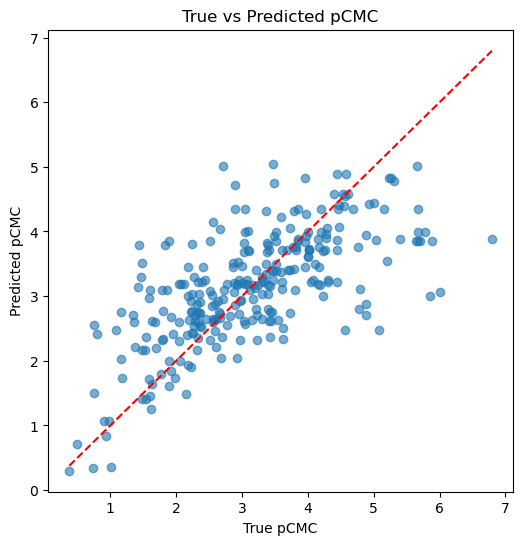

In [73]:
final_model.eval()
with torch.no_grad():
    y_pred = y_scaler.inverse_transform(final_model(X_test_tensor.to(device)).cpu().numpy())
    y_true = y_scaler.inverse_transform(y_test)

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--")  # y=x line
plt.xlabel("True pCMC")
plt.ylabel("Predicted pCMC")
plt.title("True vs Predicted pCMC")
plt.show()

In [72]:
np.sqrt(0.6218)

0.7885429601486529

In [10]:
rmse_fingerprint, r2_fingerprint = 0.7885429601486529, 0.4510

In [5]:
rmse_vicgae, r2_vicgae = run_NN(df11)

[I 2025-10-03 14:02:50,850] A new study created in memory with name: no-name-be93938a-7dec-45f4-880c-328da1f2d403
[I 2025-10-03 14:02:51,913] Trial 0 finished with value: 0.5834062695503235 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.44204620134614736, 'lr': 0.00789936068938158, 'batch_size': 128}. Best is trial 0 with value: 0.5834062695503235.


Epoch 1/30, Train Loss: 0.8685, Val RMSE: 0.9289
Epoch 2/30, Train Loss: 0.7731, Val RMSE: 0.8921
Epoch 3/30, Train Loss: 0.7111, Val RMSE: 0.8730
Epoch 4/30, Train Loss: 0.6737, Val RMSE: 0.8554
Epoch 5/30, Train Loss: 0.6257, Val RMSE: 0.8369
Epoch 6/30, Train Loss: 0.6547, Val RMSE: 0.8626
Epoch 7/30, Train Loss: 0.6320, Val RMSE: 0.8231
Epoch 8/30, Train Loss: 0.6639, Val RMSE: 0.8395
Epoch 9/30, Train Loss: 0.6065, Val RMSE: 0.8064
Epoch 10/30, Train Loss: 0.6066, Val RMSE: 0.8166
Epoch 11/30, Train Loss: 0.5910, Val RMSE: 0.8114
Epoch 12/30, Train Loss: 0.5804, Val RMSE: 0.7925
Epoch 13/30, Train Loss: 0.5598, Val RMSE: 0.7843
Epoch 14/30, Train Loss: 0.5911, Val RMSE: 0.7840
Epoch 15/30, Train Loss: 0.5793, Val RMSE: 0.7771
Epoch 16/30, Train Loss: 0.5729, Val RMSE: 0.8093
Epoch 17/30, Train Loss: 0.5888, Val RMSE: 0.7808
Epoch 18/30, Train Loss: 0.5788, Val RMSE: 0.7656
Epoch 19/30, Train Loss: 0.5489, Val RMSE: 0.7668
Epoch 20/30, Train Loss: 0.5920, Val RMSE: 0.7642
Epoch 21/

[I 2025-10-03 14:02:52,131] Trial 1 finished with value: 0.4918993413448334 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3326198745825908, 'lr': 0.009946726836993066, 'batch_size': 32}. Best is trial 1 with value: 0.4918993413448334.


Epoch 13/30, Train Loss: 0.5996, Val RMSE: 0.8043
Epoch 14/30, Train Loss: 0.5509, Val RMSE: 0.7456
Epoch 15/30, Train Loss: 0.5398, Val RMSE: 0.7550
Epoch 16/30, Train Loss: 0.7234, Val RMSE: 0.8124
Epoch 17/30, Train Loss: 0.5613, Val RMSE: 0.7368
Epoch 18/30, Train Loss: 0.4854, Val RMSE: 0.7216
Epoch 19/30, Train Loss: 0.5111, Val RMSE: 0.7711
Epoch 20/30, Train Loss: 0.5222, Val RMSE: 0.7586
Epoch 21/30, Train Loss: 0.4805, Val RMSE: 0.7133
Epoch 22/30, Train Loss: 0.4673, Val RMSE: 0.7089
Epoch 23/30, Train Loss: 0.4600, Val RMSE: 0.7089
Epoch 24/30, Train Loss: 0.4463, Val RMSE: 0.7025
Epoch 25/30, Train Loss: 0.4704, Val RMSE: 0.6949
Epoch 26/30, Train Loss: 0.4412, Val RMSE: 0.7213
Epoch 27/30, Train Loss: 0.4610, Val RMSE: 0.6980
Epoch 28/30, Train Loss: 0.4611, Val RMSE: 0.6905
Epoch 29/30, Train Loss: 0.4466, Val RMSE: 0.6821
Epoch 30/30, Train Loss: 0.4486, Val RMSE: 0.7014
Epoch 1/30, Train Loss: 0.9577, Val RMSE: 0.9223
Epoch 2/30, Train Loss: 0.7651, Val RMSE: 0.8909
Ep

[I 2025-10-03 14:02:52,243] Trial 2 finished with value: 0.6276878714561462 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.39942250113869476, 'lr': 0.0012519585623231612, 'batch_size': 128}. Best is trial 1 with value: 0.4918993413448334.
[I 2025-10-03 14:02:52,393] Trial 3 finished with value: 0.5365206599235535 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.175748992094045, 'lr': 0.0013485873175725727, 'batch_size': 64}. Best is trial 1 with value: 0.4918993413448334.


Epoch 21/30, Train Loss: 0.6023, Val RMSE: 0.8122
Epoch 22/30, Train Loss: 0.5848, Val RMSE: 0.8095
Epoch 23/30, Train Loss: 0.5905, Val RMSE: 0.8090
Epoch 24/30, Train Loss: 0.5883, Val RMSE: 0.8148
Epoch 25/30, Train Loss: 0.5772, Val RMSE: 0.8016
Epoch 26/30, Train Loss: 0.5908, Val RMSE: 0.8023
Epoch 27/30, Train Loss: 0.5652, Val RMSE: 0.7996
Epoch 28/30, Train Loss: 0.5737, Val RMSE: 0.7966
Epoch 29/30, Train Loss: 0.5771, Val RMSE: 0.8006
Epoch 30/30, Train Loss: 0.5832, Val RMSE: 0.7923
Epoch 1/30, Train Loss: 0.8076, Val RMSE: 0.9070
Epoch 2/30, Train Loss: 0.7272, Val RMSE: 0.8965
Epoch 3/30, Train Loss: 0.6839, Val RMSE: 0.8727
Epoch 4/30, Train Loss: 0.6527, Val RMSE: 0.8607
Epoch 5/30, Train Loss: 0.6521, Val RMSE: 0.8584
Epoch 6/30, Train Loss: 0.6397, Val RMSE: 0.8461
Epoch 7/30, Train Loss: 0.6238, Val RMSE: 0.8413
Epoch 8/30, Train Loss: 0.6057, Val RMSE: 0.8293
Epoch 9/30, Train Loss: 0.5981, Val RMSE: 0.8214
Epoch 10/30, Train Loss: 0.5839, Val RMSE: 0.8198
Epoch 11/

[I 2025-10-03 14:02:52,617] Trial 4 finished with value: 0.7058876752853394 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.437944517080057, 'lr': 0.00022093944722362404, 'batch_size': 32}. Best is trial 1 with value: 0.4918993413448334.
[I 2025-10-03 14:02:52,734] Trial 5 finished with value: 0.7976903319358826 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.33000794643030884, 'lr': 0.00015379775904459736, 'batch_size': 128}. Best is trial 1 with value: 0.4918993413448334.


Epoch 1/30, Train Loss: 1.0637, Val RMSE: 1.0587
Epoch 2/30, Train Loss: 0.9782, Val RMSE: 1.0298
Epoch 3/30, Train Loss: 0.9300, Val RMSE: 1.0036
Epoch 4/30, Train Loss: 0.8739, Val RMSE: 0.9824
Epoch 5/30, Train Loss: 0.8403, Val RMSE: 0.9659
Epoch 6/30, Train Loss: 0.8088, Val RMSE: 0.9533
Epoch 7/30, Train Loss: 0.7913, Val RMSE: 0.9434
Epoch 8/30, Train Loss: 0.7857, Val RMSE: 0.9370
Epoch 9/30, Train Loss: 0.7684, Val RMSE: 0.9309
Epoch 10/30, Train Loss: 0.7705, Val RMSE: 0.9260
Epoch 11/30, Train Loss: 0.7639, Val RMSE: 0.9214
Epoch 12/30, Train Loss: 0.7604, Val RMSE: 0.9175
Epoch 13/30, Train Loss: 0.7471, Val RMSE: 0.9147
Epoch 14/30, Train Loss: 0.7436, Val RMSE: 0.9126
Epoch 15/30, Train Loss: 0.7524, Val RMSE: 0.9104
Epoch 16/30, Train Loss: 0.7301, Val RMSE: 0.9074
Epoch 17/30, Train Loss: 0.7329, Val RMSE: 0.9057
Epoch 18/30, Train Loss: 0.7551, Val RMSE: 0.9057
Epoch 19/30, Train Loss: 0.7293, Val RMSE: 0.9049
Epoch 20/30, Train Loss: 0.7365, Val RMSE: 0.9037
Epoch 21/

[I 2025-10-03 14:02:52,852] Trial 6 finished with value: 0.6360874772071838 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.339941576006407, 'lr': 0.001233983591317543, 'batch_size': 128}. Best is trial 1 with value: 0.4918993413448334.
[I 2025-10-03 14:02:53,004] Trial 7 finished with value: 0.5314422845840454 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.36969320049756665, 'lr': 0.003350138218718537, 'batch_size': 64}. Best is trial 1 with value: 0.4918993413448334.


Epoch 23/30, Train Loss: 0.5911, Val RMSE: 0.8119
Epoch 24/30, Train Loss: 0.5677, Val RMSE: 0.8094
Epoch 25/30, Train Loss: 0.5876, Val RMSE: 0.8029
Epoch 26/30, Train Loss: 0.5694, Val RMSE: 0.8085
Epoch 27/30, Train Loss: 0.5777, Val RMSE: 0.8048
Epoch 28/30, Train Loss: 0.5666, Val RMSE: 0.7979
Epoch 29/30, Train Loss: 0.5667, Val RMSE: 0.7937
Epoch 30/30, Train Loss: 0.5684, Val RMSE: 0.7976
Epoch 1/30, Train Loss: 0.8132, Val RMSE: 0.9077
Epoch 2/30, Train Loss: 0.7614, Val RMSE: 0.8661
Epoch 3/30, Train Loss: 0.6810, Val RMSE: 0.8575
Epoch 4/30, Train Loss: 0.6620, Val RMSE: 0.8415
Epoch 5/30, Train Loss: 0.6485, Val RMSE: 0.8388
Epoch 6/30, Train Loss: 0.6172, Val RMSE: 0.8312
Epoch 7/30, Train Loss: 0.6044, Val RMSE: 0.8143
Epoch 8/30, Train Loss: 0.6052, Val RMSE: 0.8117
Epoch 9/30, Train Loss: 0.5827, Val RMSE: 0.7924
Epoch 10/30, Train Loss: 0.5489, Val RMSE: 0.7963
Epoch 11/30, Train Loss: 0.5679, Val RMSE: 0.7928
Epoch 12/30, Train Loss: 0.5534, Val RMSE: 0.7755
Epoch 13/

[I 2025-10-03 14:02:53,159] Trial 8 finished with value: 0.7824385166168213 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3014194423883056, 'lr': 0.0001156472805051665, 'batch_size': 64}. Best is trial 1 with value: 0.4918993413448334.


Epoch 4/30, Train Loss: 0.8190, Val RMSE: 0.9601
Epoch 5/30, Train Loss: 0.8246, Val RMSE: 0.9498
Epoch 6/30, Train Loss: 0.7885, Val RMSE: 0.9395
Epoch 7/30, Train Loss: 0.7825, Val RMSE: 0.9315
Epoch 8/30, Train Loss: 0.7609, Val RMSE: 0.9281
Epoch 9/30, Train Loss: 0.7357, Val RMSE: 0.9242
Epoch 10/30, Train Loss: 0.7386, Val RMSE: 0.9218
Epoch 11/30, Train Loss: 0.7246, Val RMSE: 0.9183
Epoch 12/30, Train Loss: 0.7389, Val RMSE: 0.9164
Epoch 13/30, Train Loss: 0.7153, Val RMSE: 0.9145
Epoch 14/30, Train Loss: 0.7131, Val RMSE: 0.9115
Epoch 15/30, Train Loss: 0.7639, Val RMSE: 0.9089
Epoch 16/30, Train Loss: 0.7276, Val RMSE: 0.9088
Epoch 17/30, Train Loss: 0.7043, Val RMSE: 0.9068
Epoch 18/30, Train Loss: 0.7090, Val RMSE: 0.9039
Epoch 19/30, Train Loss: 0.7151, Val RMSE: 0.9032
Epoch 20/30, Train Loss: 0.6857, Val RMSE: 0.9004
Epoch 21/30, Train Loss: 0.6966, Val RMSE: 0.8980
Epoch 22/30, Train Loss: 0.7015, Val RMSE: 0.8961
Epoch 23/30, Train Loss: 0.6805, Val RMSE: 0.8942
Epoch 

[I 2025-10-03 14:02:53,374] Trial 9 finished with value: 0.5396214127540588 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.493728816971494, 'lr': 0.004436154012148196, 'batch_size': 32}. Best is trial 1 with value: 0.4918993413448334.


Epoch 10/30, Train Loss: 0.6299, Val RMSE: 0.8136
Epoch 11/30, Train Loss: 0.6196, Val RMSE: 0.8033
Epoch 12/30, Train Loss: 0.5936, Val RMSE: 0.7875
Epoch 13/30, Train Loss: 0.5705, Val RMSE: 0.7721
Epoch 14/30, Train Loss: 0.5552, Val RMSE: 0.7635
Epoch 15/30, Train Loss: 0.5755, Val RMSE: 0.7923
Epoch 16/30, Train Loss: 0.6328, Val RMSE: 0.7865
Epoch 17/30, Train Loss: 0.5741, Val RMSE: 0.7753
Epoch 18/30, Train Loss: 0.5954, Val RMSE: 0.7710
Epoch 19/30, Train Loss: 0.5771, Val RMSE: 0.7555
Epoch 20/30, Train Loss: 0.5754, Val RMSE: 0.7557
Epoch 21/30, Train Loss: 0.5523, Val RMSE: 0.7763
Epoch 22/30, Train Loss: 0.5515, Val RMSE: 0.7821
Epoch 23/30, Train Loss: 0.5610, Val RMSE: 0.7557
Epoch 24/30, Train Loss: 0.5317, Val RMSE: 0.7544
Epoch 25/30, Train Loss: 0.5132, Val RMSE: 0.7423
Epoch 26/30, Train Loss: 0.5289, Val RMSE: 0.7289
Epoch 27/30, Train Loss: 0.5158, Val RMSE: 0.7610
Epoch 28/30, Train Loss: 0.5922, Val RMSE: 0.7446
Epoch 29/30, Train Loss: 0.5660, Val RMSE: 0.7759


[I 2025-10-03 14:02:53,592] Trial 10 finished with value: 0.6037296652793884 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18460556665418668, 'lr': 0.0004648085182058919, 'batch_size': 32}. Best is trial 1 with value: 0.4918993413448334.


Epoch 8/30, Train Loss: 0.6500, Val RMSE: 0.8558
Epoch 9/30, Train Loss: 0.6379, Val RMSE: 0.8455
Epoch 10/30, Train Loss: 0.6142, Val RMSE: 0.8355
Epoch 11/30, Train Loss: 0.6239, Val RMSE: 0.8392
Epoch 12/30, Train Loss: 0.6177, Val RMSE: 0.8391
Epoch 13/30, Train Loss: 0.6068, Val RMSE: 0.8275
Epoch 14/30, Train Loss: 0.6060, Val RMSE: 0.8262
Epoch 15/30, Train Loss: 0.5900, Val RMSE: 0.8183
Epoch 16/30, Train Loss: 0.6014, Val RMSE: 0.8294
Epoch 17/30, Train Loss: 0.5853, Val RMSE: 0.8121
Epoch 18/30, Train Loss: 0.5789, Val RMSE: 0.8097
Epoch 19/30, Train Loss: 0.5716, Val RMSE: 0.8057
Epoch 20/30, Train Loss: 0.5679, Val RMSE: 0.8011
Epoch 21/30, Train Loss: 0.5612, Val RMSE: 0.8042
Epoch 22/30, Train Loss: 0.5487, Val RMSE: 0.7969
Epoch 23/30, Train Loss: 0.5462, Val RMSE: 0.7890
Epoch 24/30, Train Loss: 0.5632, Val RMSE: 0.7901
Epoch 25/30, Train Loss: 0.5420, Val RMSE: 0.7873
Epoch 26/30, Train Loss: 0.5447, Val RMSE: 0.7890
Epoch 27/30, Train Loss: 0.5374, Val RMSE: 0.7802
Ep

[I 2025-10-03 14:02:53,741] Trial 11 finished with value: 0.5061712265014648 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.23714840300784418, 'lr': 0.003786489947990211, 'batch_size': 64}. Best is trial 1 with value: 0.4918993413448334.


Epoch 9/30, Train Loss: 0.5900, Val RMSE: 0.7993
Epoch 10/30, Train Loss: 0.5565, Val RMSE: 0.7720
Epoch 11/30, Train Loss: 0.5316, Val RMSE: 0.7840
Epoch 12/30, Train Loss: 0.5348, Val RMSE: 0.7541
Epoch 13/30, Train Loss: 0.5155, Val RMSE: 0.7637
Epoch 14/30, Train Loss: 0.5033, Val RMSE: 0.7382
Epoch 15/30, Train Loss: 0.4850, Val RMSE: 0.7509
Epoch 16/30, Train Loss: 0.5003, Val RMSE: 0.7439
Epoch 17/30, Train Loss: 0.6285, Val RMSE: 0.7973
Epoch 18/30, Train Loss: 0.5346, Val RMSE: 0.7540
Epoch 19/30, Train Loss: 0.5470, Val RMSE: 0.7500
Epoch 20/30, Train Loss: 0.5099, Val RMSE: 0.7479
Epoch 21/30, Train Loss: 0.4642, Val RMSE: 0.7224
Epoch 22/30, Train Loss: 0.4845, Val RMSE: 0.7334
Epoch 23/30, Train Loss: 0.4494, Val RMSE: 0.7105
Epoch 24/30, Train Loss: 0.4556, Val RMSE: 0.7143
Epoch 25/30, Train Loss: 0.4460, Val RMSE: 0.7122
Epoch 26/30, Train Loss: 0.4352, Val RMSE: 0.7082
Epoch 27/30, Train Loss: 0.4510, Val RMSE: 0.7016
Epoch 28/30, Train Loss: 0.4436, Val RMSE: 0.7106
E

[I 2025-10-03 14:02:53,957] Trial 12 finished with value: 0.48106274008750916 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24121990864230358, 'lr': 0.0096274721067345, 'batch_size': 32}. Best is trial 12 with value: 0.48106274008750916.


Epoch 14/30, Train Loss: 0.4858, Val RMSE: 0.7411
Epoch 15/30, Train Loss: 0.5039, Val RMSE: 0.7753
Epoch 16/30, Train Loss: 0.5081, Val RMSE: 0.7261
Epoch 17/30, Train Loss: 0.4520, Val RMSE: 0.7045
Epoch 18/30, Train Loss: 0.4712, Val RMSE: 0.7542
Epoch 19/30, Train Loss: 0.4621, Val RMSE: 0.7137
Epoch 20/30, Train Loss: 0.4886, Val RMSE: 0.7102
Epoch 21/30, Train Loss: 0.4625, Val RMSE: 0.6922
Epoch 22/30, Train Loss: 0.4869, Val RMSE: 0.7162
Epoch 23/30, Train Loss: 0.5531, Val RMSE: 0.7410
Epoch 24/30, Train Loss: 0.4988, Val RMSE: 0.7197
Epoch 25/30, Train Loss: 0.5154, Val RMSE: 0.7221
Epoch 26/30, Train Loss: 0.4852, Val RMSE: 0.7218
Epoch 27/30, Train Loss: 0.5239, Val RMSE: 0.7094
Epoch 28/30, Train Loss: 0.4580, Val RMSE: 0.7683
Epoch 29/30, Train Loss: 0.4452, Val RMSE: 0.6996
Epoch 30/30, Train Loss: 0.4188, Val RMSE: 0.6936
Epoch 1/30, Train Loss: 0.7566, Val RMSE: 0.8996
Epoch 2/30, Train Loss: 0.7804, Val RMSE: 0.8474
Epoch 3/30, Train Loss: 0.6329, Val RMSE: 0.8624
Epo

[I 2025-10-03 14:02:54,178] Trial 13 finished with value: 0.5324760675430298 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24952330662473438, 'lr': 0.008715776997433642, 'batch_size': 32}. Best is trial 12 with value: 0.48106274008750916.


Epoch 12/30, Train Loss: 0.6124, Val RMSE: 0.8194
Epoch 13/30, Train Loss: 0.6435, Val RMSE: 0.7790
Epoch 14/30, Train Loss: 0.5431, Val RMSE: 0.7916
Epoch 15/30, Train Loss: 0.5704, Val RMSE: 0.7607
Epoch 16/30, Train Loss: 0.5174, Val RMSE: 0.7450
Epoch 17/30, Train Loss: 0.5031, Val RMSE: 0.7332
Epoch 18/30, Train Loss: 0.4916, Val RMSE: 0.7442
Epoch 19/30, Train Loss: 0.4762, Val RMSE: 0.7184
Epoch 20/30, Train Loss: 0.4770, Val RMSE: 0.7429
Epoch 21/30, Train Loss: 0.5462, Val RMSE: 0.7237
Epoch 22/30, Train Loss: 0.5251, Val RMSE: 0.7473
Epoch 23/30, Train Loss: 0.5455, Val RMSE: 0.7171
Epoch 24/30, Train Loss: 0.4668, Val RMSE: 0.7253
Epoch 25/30, Train Loss: 0.5117, Val RMSE: 0.6983
Epoch 26/30, Train Loss: 0.4759, Val RMSE: 0.6989
Epoch 27/30, Train Loss: 0.4761, Val RMSE: 0.7379
Epoch 28/30, Train Loss: 0.4726, Val RMSE: 0.7108
Epoch 29/30, Train Loss: 0.4789, Val RMSE: 0.6975
Epoch 30/30, Train Loss: 0.4631, Val RMSE: 0.7297
Epoch 1/30, Train Loss: 0.7907, Val RMSE: 0.9180
E

[I 2025-10-03 14:02:54,396] Trial 14 finished with value: 0.452374666929245 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.26665429822944786, 'lr': 0.009545420327978376, 'batch_size': 32}. Best is trial 14 with value: 0.452374666929245.


Epoch 9/30, Train Loss: 0.5639, Val RMSE: 0.7800
Epoch 10/30, Train Loss: 0.5399, Val RMSE: 0.8145
Epoch 11/30, Train Loss: 0.5607, Val RMSE: 0.7494
Epoch 12/30, Train Loss: 0.5213, Val RMSE: 0.7471
Epoch 13/30, Train Loss: 0.5543, Val RMSE: 0.7434
Epoch 14/30, Train Loss: 0.5236, Val RMSE: 0.7356
Epoch 15/30, Train Loss: 0.5240, Val RMSE: 0.7930
Epoch 16/30, Train Loss: 0.5134, Val RMSE: 0.7104
Epoch 17/30, Train Loss: 0.4787, Val RMSE: 0.7490
Epoch 18/30, Train Loss: 0.5725, Val RMSE: 0.7296
Epoch 19/30, Train Loss: 0.5950, Val RMSE: 0.7976
Epoch 20/30, Train Loss: 0.5934, Val RMSE: 0.8023
Epoch 21/30, Train Loss: 0.5314, Val RMSE: 0.7305
Epoch 22/30, Train Loss: 0.4682, Val RMSE: 0.7348
Epoch 23/30, Train Loss: 0.4428, Val RMSE: 0.7041
Epoch 24/30, Train Loss: 0.4352, Val RMSE: 0.6961
Epoch 25/30, Train Loss: 0.4553, Val RMSE: 0.6889
Epoch 26/30, Train Loss: 0.4385, Val RMSE: 0.7369
Epoch 27/30, Train Loss: 0.4423, Val RMSE: 0.6843
Epoch 28/30, Train Loss: 0.4210, Val RMSE: 0.7116
E

[I 2025-10-03 14:02:54,618] Trial 15 finished with value: 0.45291534066200256 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11822077880762072, 'lr': 0.002303268085481236, 'batch_size': 32}. Best is trial 14 with value: 0.452374666929245.


Epoch 7/30, Train Loss: 0.5733, Val RMSE: 0.8026
Epoch 8/30, Train Loss: 0.5701, Val RMSE: 0.7920
Epoch 9/30, Train Loss: 0.5570, Val RMSE: 0.7995
Epoch 10/30, Train Loss: 0.5313, Val RMSE: 0.7771
Epoch 11/30, Train Loss: 0.5225, Val RMSE: 0.7628
Epoch 12/30, Train Loss: 0.5032, Val RMSE: 0.7559
Epoch 13/30, Train Loss: 0.4973, Val RMSE: 0.7401
Epoch 14/30, Train Loss: 0.4846, Val RMSE: 0.7338
Epoch 15/30, Train Loss: 0.4680, Val RMSE: 0.7268
Epoch 16/30, Train Loss: 0.4558, Val RMSE: 0.7210
Epoch 17/30, Train Loss: 0.4618, Val RMSE: 0.7156
Epoch 18/30, Train Loss: 0.4546, Val RMSE: 0.7105
Epoch 19/30, Train Loss: 0.4626, Val RMSE: 0.7136
Epoch 20/30, Train Loss: 0.4363, Val RMSE: 0.6957
Epoch 21/30, Train Loss: 0.5654, Val RMSE: 0.7418
Epoch 22/30, Train Loss: 0.4632, Val RMSE: 0.7142
Epoch 23/30, Train Loss: 0.4455, Val RMSE: 0.7112
Epoch 24/30, Train Loss: 0.4534, Val RMSE: 0.7051
Epoch 25/30, Train Loss: 0.4187, Val RMSE: 0.7027
Epoch 26/30, Train Loss: 0.4397, Val RMSE: 0.6968
Epo

[I 2025-10-03 14:02:54,833] Trial 16 finished with value: 0.48811668157577515 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11030909802091027, 'lr': 0.002266550175647473, 'batch_size': 32}. Best is trial 14 with value: 0.452374666929245.


Epoch 5/30, Train Loss: 0.6063, Val RMSE: 0.8337
Epoch 6/30, Train Loss: 0.6381, Val RMSE: 0.8292
Epoch 7/30, Train Loss: 0.5933, Val RMSE: 0.8254
Epoch 8/30, Train Loss: 0.5575, Val RMSE: 0.7840
Epoch 9/30, Train Loss: 0.5779, Val RMSE: 0.7817
Epoch 10/30, Train Loss: 0.5402, Val RMSE: 0.7702
Epoch 11/30, Train Loss: 0.5015, Val RMSE: 0.7717
Epoch 12/30, Train Loss: 0.5108, Val RMSE: 0.7628
Epoch 13/30, Train Loss: 0.5146, Val RMSE: 0.7446
Epoch 14/30, Train Loss: 0.4926, Val RMSE: 0.7386
Epoch 15/30, Train Loss: 0.5349, Val RMSE: 0.7436
Epoch 16/30, Train Loss: 0.4854, Val RMSE: 0.7295
Epoch 17/30, Train Loss: 0.4715, Val RMSE: 0.7182
Epoch 18/30, Train Loss: 0.4602, Val RMSE: 0.7159
Epoch 19/30, Train Loss: 0.4701, Val RMSE: 0.7244
Epoch 20/30, Train Loss: 0.5606, Val RMSE: 0.7571
Epoch 21/30, Train Loss: 0.5082, Val RMSE: 0.7337
Epoch 22/30, Train Loss: 0.4477, Val RMSE: 0.7158
Epoch 23/30, Train Loss: 0.4422, Val RMSE: 0.7057
Epoch 24/30, Train Loss: 0.4425, Val RMSE: 0.7391
Epoch

[I 2025-10-03 14:02:55,049] Trial 17 finished with value: 0.5918331146240234 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11254344232559924, 'lr': 0.0006017934572038373, 'batch_size': 32}. Best is trial 14 with value: 0.452374666929245.


Epoch 3/30, Train Loss: 0.6882, Val RMSE: 0.8806
Epoch 4/30, Train Loss: 0.6870, Val RMSE: 0.8769
Epoch 5/30, Train Loss: 0.6574, Val RMSE: 0.8697
Epoch 6/30, Train Loss: 0.6414, Val RMSE: 0.8524
Epoch 7/30, Train Loss: 0.6304, Val RMSE: 0.8509
Epoch 8/30, Train Loss: 0.6252, Val RMSE: 0.8473
Epoch 9/30, Train Loss: 0.6074, Val RMSE: 0.8431
Epoch 10/30, Train Loss: 0.6017, Val RMSE: 0.8346
Epoch 11/30, Train Loss: 0.5933, Val RMSE: 0.8293
Epoch 12/30, Train Loss: 0.6000, Val RMSE: 0.8265
Epoch 13/30, Train Loss: 0.5977, Val RMSE: 0.8309
Epoch 14/30, Train Loss: 0.5894, Val RMSE: 0.8312
Epoch 15/30, Train Loss: 0.5823, Val RMSE: 0.8212
Epoch 16/30, Train Loss: 0.5647, Val RMSE: 0.8190
Epoch 17/30, Train Loss: 0.5821, Val RMSE: 0.8191
Epoch 18/30, Train Loss: 0.5710, Val RMSE: 0.8114
Epoch 19/30, Train Loss: 0.5483, Val RMSE: 0.8062
Epoch 20/30, Train Loss: 0.5471, Val RMSE: 0.8035
Epoch 21/30, Train Loss: 0.5607, Val RMSE: 0.8022
Epoch 22/30, Train Loss: 0.5477, Val RMSE: 0.7977
Epoch 2

[I 2025-10-03 14:02:55,265] Trial 18 finished with value: 0.46816107630729675 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.16930955686431862, 'lr': 0.0025420252052711146, 'batch_size': 32}. Best is trial 14 with value: 0.452374666929245.


Epoch 30/30, Train Loss: 0.4225, Val RMSE: 0.6842
Epoch 1/30, Train Loss: 0.7524, Val RMSE: 0.8559
Epoch 2/30, Train Loss: 0.6725, Val RMSE: 0.8270
Epoch 3/30, Train Loss: 0.6554, Val RMSE: 0.8254
Epoch 4/30, Train Loss: 0.6108, Val RMSE: 0.8135
Epoch 5/30, Train Loss: 0.5790, Val RMSE: 0.8103
Epoch 6/30, Train Loss: 0.5499, Val RMSE: 0.7727
Epoch 7/30, Train Loss: 0.5448, Val RMSE: 0.7561
Epoch 8/30, Train Loss: 0.5435, Val RMSE: 0.8300
Epoch 9/30, Train Loss: 0.6351, Val RMSE: 0.7898
Epoch 10/30, Train Loss: 0.5775, Val RMSE: 0.7834
Epoch 11/30, Train Loss: 0.5411, Val RMSE: 0.7639
Epoch 12/30, Train Loss: 0.4736, Val RMSE: 0.7480
Epoch 13/30, Train Loss: 0.5047, Val RMSE: 0.7429
Epoch 14/30, Train Loss: 0.4726, Val RMSE: 0.7173
Epoch 15/30, Train Loss: 0.4841, Val RMSE: 0.7196
Epoch 16/30, Train Loss: 0.5133, Val RMSE: 0.7525
Epoch 17/30, Train Loss: 0.4619, Val RMSE: 0.7072
Epoch 18/30, Train Loss: 0.5215, Val RMSE: 0.7171
Epoch 19/30, Train Loss: 0.4794, Val RMSE: 0.7241
Epoch 20/

[I 2025-10-03 14:02:55,481] Trial 19 finished with value: 0.4984435439109802 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.21018833988115396, 'lr': 0.005388825371948023, 'batch_size': 32}. Best is trial 14 with value: 0.452374666929245.


Epoch 28/30, Train Loss: 0.4826, Val RMSE: 0.6909
Epoch 29/30, Train Loss: 0.4148, Val RMSE: 0.6887
Epoch 30/30, Train Loss: 0.5137, Val RMSE: 0.7060
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.26665429822944786, 'lr': 0.009545420327978376, 'batch_size': 32}
Best MSE: 0.452374666929245
Epoch 1/300, Train Loss: 0.7697, Val RMSE: 0.8856
Epoch 2/300, Train Loss: 0.6526, Val RMSE: 0.8827
Epoch 3/300, Train Loss: 0.6918, Val RMSE: 0.8218
Epoch 4/300, Train Loss: 0.6211, Val RMSE: 0.8079
Epoch 5/300, Train Loss: 0.6848, Val RMSE: 0.8313
Epoch 6/300, Train Loss: 0.7013, Val RMSE: 0.8157
Epoch 7/300, Train Loss: 0.5920, Val RMSE: 0.7983
Epoch 8/300, Train Loss: 0.5643, Val RMSE: 0.7731
Epoch 9/300, Train Loss: 0.5552, Val RMSE: 0.8122
Epoch 10/300, Train Loss: 0.6211, Val RMSE: 0.8014
Epoch 11/300, Train Loss: 0.5802, Val RMSE: 0.7570
Epoch 12/300, Train Loss: 0.5799, Val RMSE: 0.8719
Epoch 13/300, Train Loss: 0.6217, Val RMSE: 0.7763
Epoch 14/300, Train Loss: 0.5709, 

In [6]:
rmse_chemprop, r2_chemprop = run_NN(df21)

[I 2025-10-03 14:03:41,522] A new study created in memory with name: no-name-b18a2346-6821-4749-99bb-7d76b63d442d


Epoch 1/30, Train Loss: 0.7236, Val RMSE: 0.7834
Epoch 2/30, Train Loss: 0.4788, Val RMSE: 0.7068
Epoch 3/30, Train Loss: 0.4209, Val RMSE: 0.6468
Epoch 4/30, Train Loss: 0.3779, Val RMSE: 0.6340
Epoch 5/30, Train Loss: 0.3702, Val RMSE: 0.6378
Epoch 6/30, Train Loss: 0.3334, Val RMSE: 0.5999
Epoch 7/30, Train Loss: 0.3311, Val RMSE: 0.5932
Epoch 8/30, Train Loss: 0.3266, Val RMSE: 0.6012
Epoch 9/30, Train Loss: 0.3124, Val RMSE: 0.5872
Epoch 10/30, Train Loss: 0.2929, Val RMSE: 0.5956
Epoch 11/30, Train Loss: 0.2936, Val RMSE: 0.5763
Epoch 12/30, Train Loss: 0.2911, Val RMSE: 0.5797
Epoch 13/30, Train Loss: 0.2997, Val RMSE: 0.5784
Epoch 14/30, Train Loss: 0.3033, Val RMSE: 0.6143
Epoch 15/30, Train Loss: 0.2764, Val RMSE: 0.5477
Epoch 16/30, Train Loss: 0.2585, Val RMSE: 0.5433
Epoch 17/30, Train Loss: 0.2532, Val RMSE: 0.5401
Epoch 18/30, Train Loss: 0.2539, Val RMSE: 0.5472
Epoch 19/30, Train Loss: 0.2579, Val RMSE: 0.5771
Epoch 20/30, Train Loss: 0.2798, Val RMSE: 0.5695
Epoch 21/

[I 2025-10-03 14:03:43,050] Trial 0 finished with value: 0.2805810272693634 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11914896084433596, 'lr': 0.0021718276819705615, 'batch_size': 64}. Best is trial 0 with value: 0.2805810272693634.


Epoch 25/30, Train Loss: 0.2096, Val RMSE: 0.5112
Epoch 26/30, Train Loss: 0.2296, Val RMSE: 0.5187
Epoch 27/30, Train Loss: 0.2278, Val RMSE: 0.5116
Epoch 28/30, Train Loss: 0.2213, Val RMSE: 0.5148
Epoch 29/30, Train Loss: 0.2281, Val RMSE: 0.5225
Epoch 30/30, Train Loss: 0.2199, Val RMSE: 0.5297
Epoch 1/30, Train Loss: 1.1057, Val RMSE: 0.9123
Epoch 2/30, Train Loss: 0.6665, Val RMSE: 0.7527
Epoch 3/30, Train Loss: 0.6251, Val RMSE: 0.7729
Epoch 4/30, Train Loss: 0.5528, Val RMSE: 0.7393
Epoch 5/30, Train Loss: 0.6018, Val RMSE: 0.7115
Epoch 6/30, Train Loss: 0.5639, Val RMSE: 0.7139
Epoch 7/30, Train Loss: 0.5274, Val RMSE: 0.6904
Epoch 8/30, Train Loss: 0.6298, Val RMSE: 0.7849
Epoch 9/30, Train Loss: 0.5958, Val RMSE: 0.7038
Epoch 10/30, Train Loss: 0.5159, Val RMSE: 0.7235
Epoch 11/30, Train Loss: 0.5205, Val RMSE: 0.7265
Epoch 12/30, Train Loss: 0.5187, Val RMSE: 0.6783
Epoch 13/30, Train Loss: 0.5264, Val RMSE: 0.6768
Epoch 14/30, Train Loss: 0.5026, Val RMSE: 0.7882
Epoch 15/

[I 2025-10-03 14:03:45,583] Trial 1 finished with value: 0.40083837509155273 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4680917023891555, 'lr': 0.008791781616836093, 'batch_size': 32}. Best is trial 0 with value: 0.2805810272693634.


Epoch 28/30, Train Loss: 0.4560, Val RMSE: 0.6112
Epoch 29/30, Train Loss: 0.4528, Val RMSE: 0.6214
Epoch 30/30, Train Loss: 0.4504, Val RMSE: 0.6331
Epoch 1/30, Train Loss: 0.7197, Val RMSE: 0.7795
Epoch 2/30, Train Loss: 0.4997, Val RMSE: 0.7059
Epoch 3/30, Train Loss: 0.4733, Val RMSE: 0.6667
Epoch 4/30, Train Loss: 0.4267, Val RMSE: 0.6672
Epoch 5/30, Train Loss: 0.3750, Val RMSE: 0.6337
Epoch 6/30, Train Loss: 0.3629, Val RMSE: 0.6261
Epoch 7/30, Train Loss: 0.3356, Val RMSE: 0.6034
Epoch 8/30, Train Loss: 0.3599, Val RMSE: 0.6398
Epoch 9/30, Train Loss: 0.3441, Val RMSE: 0.6184
Epoch 10/30, Train Loss: 0.3205, Val RMSE: 0.6182
Epoch 11/30, Train Loss: 0.3094, Val RMSE: 0.5913
Epoch 12/30, Train Loss: 0.3214, Val RMSE: 0.5969
Epoch 13/30, Train Loss: 0.3240, Val RMSE: 0.5881
Epoch 14/30, Train Loss: 0.2998, Val RMSE: 0.5713
Epoch 15/30, Train Loss: 0.3256, Val RMSE: 0.6066
Epoch 16/30, Train Loss: 0.3150, Val RMSE: 0.5875
Epoch 17/30, Train Loss: 0.3255, Val RMSE: 0.6002
Epoch 18/

[I 2025-10-03 14:03:46,961] Trial 2 finished with value: 0.2647527754306793 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2278738392200904, 'lr': 0.0031133553106137495, 'batch_size': 64}. Best is trial 2 with value: 0.2647527754306793.


Epoch 29/30, Train Loss: 0.2441, Val RMSE: 0.5200
Epoch 30/30, Train Loss: 0.2385, Val RMSE: 0.5145
Epoch 1/30, Train Loss: 0.7552, Val RMSE: 0.7975
Epoch 2/30, Train Loss: 0.5483, Val RMSE: 0.7567
Epoch 3/30, Train Loss: 0.5008, Val RMSE: 0.6994
Epoch 4/30, Train Loss: 0.4411, Val RMSE: 0.6717
Epoch 5/30, Train Loss: 0.4216, Val RMSE: 0.6661
Epoch 6/30, Train Loss: 0.4195, Val RMSE: 0.6482
Epoch 7/30, Train Loss: 0.4087, Val RMSE: 0.6615
Epoch 8/30, Train Loss: 0.3990, Val RMSE: 0.6249
Epoch 9/30, Train Loss: 0.3757, Val RMSE: 0.6137
Epoch 10/30, Train Loss: 0.3635, Val RMSE: 0.6348
Epoch 11/30, Train Loss: 0.3671, Val RMSE: 0.6201
Epoch 12/30, Train Loss: 0.3773, Val RMSE: 0.6259
Epoch 13/30, Train Loss: 0.3574, Val RMSE: 0.5940
Epoch 14/30, Train Loss: 0.3519, Val RMSE: 0.6005
Epoch 15/30, Train Loss: 0.3403, Val RMSE: 0.5964
Epoch 16/30, Train Loss: 0.3240, Val RMSE: 0.5839
Epoch 17/30, Train Loss: 0.3297, Val RMSE: 0.5862
Epoch 18/30, Train Loss: 0.3330, Val RMSE: 0.5918
Epoch 19/

[I 2025-10-03 14:03:49,648] Trial 3 finished with value: 0.3023760914802551 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3946763402436552, 'lr': 0.0007175972623033815, 'batch_size': 32}. Best is trial 2 with value: 0.2647527754306793.


Epoch 29/30, Train Loss: 0.3139, Val RMSE: 0.5589
Epoch 30/30, Train Loss: 0.2875, Val RMSE: 0.5499
Epoch 1/30, Train Loss: 1.0316, Val RMSE: 1.0016
Epoch 2/30, Train Loss: 0.8541, Val RMSE: 0.9394
Epoch 3/30, Train Loss: 0.7978, Val RMSE: 0.8998
Epoch 4/30, Train Loss: 0.7324, Val RMSE: 0.8691
Epoch 5/30, Train Loss: 0.6968, Val RMSE: 0.8416
Epoch 6/30, Train Loss: 0.6629, Val RMSE: 0.8234
Epoch 7/30, Train Loss: 0.6253, Val RMSE: 0.8051
Epoch 8/30, Train Loss: 0.5717, Val RMSE: 0.7879
Epoch 9/30, Train Loss: 0.5816, Val RMSE: 0.7713
Epoch 10/30, Train Loss: 0.5445, Val RMSE: 0.7547
Epoch 11/30, Train Loss: 0.5265, Val RMSE: 0.7438
Epoch 12/30, Train Loss: 0.4795, Val RMSE: 0.7329
Epoch 13/30, Train Loss: 0.5105, Val RMSE: 0.7248
Epoch 14/30, Train Loss: 0.4800, Val RMSE: 0.7142
Epoch 15/30, Train Loss: 0.4702, Val RMSE: 0.7055
Epoch 16/30, Train Loss: 0.4757, Val RMSE: 0.6951
Epoch 17/30, Train Loss: 0.4568, Val RMSE: 0.6879
Epoch 18/30, Train Loss: 0.4171, Val RMSE: 0.6836
Epoch 19/

[I 2025-10-03 14:03:50,726] Trial 4 finished with value: 0.40534454584121704 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.47709948130706237, 'lr': 0.0002593271044959872, 'batch_size': 128}. Best is trial 2 with value: 0.2647527754306793.


Epoch 28/30, Train Loss: 0.3856, Val RMSE: 0.6379
Epoch 29/30, Train Loss: 0.3906, Val RMSE: 0.6376
Epoch 30/30, Train Loss: 0.3718, Val RMSE: 0.6367
Epoch 1/30, Train Loss: 0.9743, Val RMSE: 0.9706
Epoch 2/30, Train Loss: 0.8098, Val RMSE: 0.9097
Epoch 3/30, Train Loss: 0.7375, Val RMSE: 0.8694
Epoch 4/30, Train Loss: 0.6984, Val RMSE: 0.8463
Epoch 5/30, Train Loss: 0.6529, Val RMSE: 0.8226
Epoch 6/30, Train Loss: 0.6198, Val RMSE: 0.8040
Epoch 7/30, Train Loss: 0.5965, Val RMSE: 0.7849
Epoch 8/30, Train Loss: 0.5787, Val RMSE: 0.7710
Epoch 9/30, Train Loss: 0.5381, Val RMSE: 0.7559
Epoch 10/30, Train Loss: 0.5286, Val RMSE: 0.7479
Epoch 11/30, Train Loss: 0.5060, Val RMSE: 0.7353
Epoch 12/30, Train Loss: 0.4898, Val RMSE: 0.7243
Epoch 13/30, Train Loss: 0.4774, Val RMSE: 0.7179
Epoch 14/30, Train Loss: 0.4776, Val RMSE: 0.7065
Epoch 15/30, Train Loss: 0.4652, Val RMSE: 0.6998
Epoch 16/30, Train Loss: 0.4401, Val RMSE: 0.6915
Epoch 17/30, Train Loss: 0.4275, Val RMSE: 0.6865
Epoch 18/

[I 2025-10-03 14:03:52,889] Trial 5 finished with value: 0.3973725438117981 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4683177920338425, 'lr': 0.00011125604454546906, 'batch_size': 32}. Best is trial 2 with value: 0.2647527754306793.


Epoch 30/30, Train Loss: 0.3761, Val RMSE: 0.6304
Epoch 1/30, Train Loss: 1.3717, Val RMSE: 0.9525
Epoch 2/30, Train Loss: 0.7161, Val RMSE: 0.7836
Epoch 3/30, Train Loss: 0.5653, Val RMSE: 0.7845
Epoch 4/30, Train Loss: 0.5283, Val RMSE: 0.7182
Epoch 5/30, Train Loss: 0.4733, Val RMSE: 0.7510
Epoch 6/30, Train Loss: 0.4623, Val RMSE: 0.6856
Epoch 7/30, Train Loss: 0.4244, Val RMSE: 0.6753
Epoch 8/30, Train Loss: 0.4035, Val RMSE: 0.6406
Epoch 9/30, Train Loss: 0.3788, Val RMSE: 0.6407
Epoch 10/30, Train Loss: 0.3607, Val RMSE: 0.6148
Epoch 11/30, Train Loss: 0.3506, Val RMSE: 0.6074
Epoch 12/30, Train Loss: 0.3353, Val RMSE: 0.6024
Epoch 13/30, Train Loss: 0.3320, Val RMSE: 0.5857
Epoch 14/30, Train Loss: 0.3302, Val RMSE: 0.6060
Epoch 15/30, Train Loss: 0.3190, Val RMSE: 0.6383
Epoch 16/30, Train Loss: 0.3091, Val RMSE: 0.5881
Epoch 17/30, Train Loss: 0.3206, Val RMSE: 0.5965
Epoch 18/30, Train Loss: 0.3438, Val RMSE: 0.6318
Epoch 19/30, Train Loss: 0.3520, Val RMSE: 0.5901
Epoch 20/

[I 2025-10-03 14:03:54,139] Trial 6 finished with value: 0.2815023362636566 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2065934580328378, 'lr': 0.00915389144121794, 'batch_size': 128}. Best is trial 2 with value: 0.2647527754306793.


Epoch 28/30, Train Loss: 0.2637, Val RMSE: 0.5321
Epoch 29/30, Train Loss: 0.2569, Val RMSE: 0.5262
Epoch 30/30, Train Loss: 0.2524, Val RMSE: 0.5306
Epoch 1/30, Train Loss: 0.7788, Val RMSE: 0.8129
Epoch 2/30, Train Loss: 0.5745, Val RMSE: 0.7444
Epoch 3/30, Train Loss: 0.4919, Val RMSE: 0.6947
Epoch 4/30, Train Loss: 0.4356, Val RMSE: 0.6730
Epoch 5/30, Train Loss: 0.4433, Val RMSE: 0.6604
Epoch 6/30, Train Loss: 0.4581, Val RMSE: 0.6481
Epoch 7/30, Train Loss: 0.4101, Val RMSE: 0.6455
Epoch 8/30, Train Loss: 0.3959, Val RMSE: 0.6223
Epoch 9/30, Train Loss: 0.3726, Val RMSE: 0.6150
Epoch 10/30, Train Loss: 0.3674, Val RMSE: 0.6126
Epoch 11/30, Train Loss: 0.3525, Val RMSE: 0.6240
Epoch 12/30, Train Loss: 0.3432, Val RMSE: 0.6068
Epoch 13/30, Train Loss: 0.3657, Val RMSE: 0.6135
Epoch 14/30, Train Loss: 0.3653, Val RMSE: 0.6250
Epoch 15/30, Train Loss: 0.3535, Val RMSE: 0.6095
Epoch 16/30, Train Loss: 0.3476, Val RMSE: 0.5852
Epoch 17/30, Train Loss: 0.3353, Val RMSE: 0.5874
Epoch 18/

[I 2025-10-03 14:03:56,438] Trial 7 finished with value: 0.31750842928886414 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3589362374979015, 'lr': 0.0011437846049660715, 'batch_size': 64}. Best is trial 2 with value: 0.2647527754306793.


Epoch 28/30, Train Loss: 0.3105, Val RMSE: 0.5458
Epoch 29/30, Train Loss: 0.2896, Val RMSE: 0.5737
Epoch 30/30, Train Loss: 0.2913, Val RMSE: 0.5635
Epoch 1/30, Train Loss: 0.8200, Val RMSE: 0.8356
Epoch 2/30, Train Loss: 0.5946, Val RMSE: 0.7519
Epoch 3/30, Train Loss: 0.4820, Val RMSE: 0.7193
Epoch 4/30, Train Loss: 0.4465, Val RMSE: 0.6806
Epoch 5/30, Train Loss: 0.4187, Val RMSE: 0.6698
Epoch 6/30, Train Loss: 0.4043, Val RMSE: 0.6728
Epoch 7/30, Train Loss: 0.3754, Val RMSE: 0.6289
Epoch 8/30, Train Loss: 0.3694, Val RMSE: 0.6471
Epoch 9/30, Train Loss: 0.3757, Val RMSE: 0.6070
Epoch 10/30, Train Loss: 0.3467, Val RMSE: 0.6189
Epoch 11/30, Train Loss: 0.3584, Val RMSE: 0.6111
Epoch 12/30, Train Loss: 0.3494, Val RMSE: 0.6102
Epoch 13/30, Train Loss: 0.3250, Val RMSE: 0.5861
Epoch 14/30, Train Loss: 0.3319, Val RMSE: 0.5866
Epoch 15/30, Train Loss: 0.3141, Val RMSE: 0.5744
Epoch 16/30, Train Loss: 0.3227, Val RMSE: 0.5763
Epoch 17/30, Train Loss: 0.3166, Val RMSE: 0.5625
Epoch 18/

[I 2025-10-03 14:03:57,542] Trial 8 finished with value: 0.29039648175239563 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2769630698593316, 'lr': 0.0017829257297376085, 'batch_size': 128}. Best is trial 2 with value: 0.2647527754306793.


Epoch 26/30, Train Loss: 0.2836, Val RMSE: 0.5438
Epoch 27/30, Train Loss: 0.2730, Val RMSE: 0.5431
Epoch 28/30, Train Loss: 0.2729, Val RMSE: 0.5559
Epoch 29/30, Train Loss: 0.2864, Val RMSE: 0.5474
Epoch 30/30, Train Loss: 0.2763, Val RMSE: 0.5389
Epoch 1/30, Train Loss: 0.9909, Val RMSE: 1.0210
Epoch 2/30, Train Loss: 0.8980, Val RMSE: 0.9692
Epoch 3/30, Train Loss: 0.8200, Val RMSE: 0.9399
Epoch 4/30, Train Loss: 0.8009, Val RMSE: 0.9158
Epoch 5/30, Train Loss: 0.7434, Val RMSE: 0.8952
Epoch 6/30, Train Loss: 0.7132, Val RMSE: 0.8783
Epoch 7/30, Train Loss: 0.6969, Val RMSE: 0.8617
Epoch 8/30, Train Loss: 0.6821, Val RMSE: 0.8476
Epoch 9/30, Train Loss: 0.6702, Val RMSE: 0.8359
Epoch 10/30, Train Loss: 0.6370, Val RMSE: 0.8235
Epoch 11/30, Train Loss: 0.6126, Val RMSE: 0.8125
Epoch 12/30, Train Loss: 0.5945, Val RMSE: 0.8025
Epoch 13/30, Train Loss: 0.5912, Val RMSE: 0.7919
Epoch 14/30, Train Loss: 0.5749, Val RMSE: 0.7825
Epoch 15/30, Train Loss: 0.5514, Val RMSE: 0.7740
Epoch 16/

[I 2025-10-03 14:03:58,456] Trial 9 finished with value: 0.4528175890445709 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.31430721991117716, 'lr': 0.00013736485055507863, 'batch_size': 128}. Best is trial 2 with value: 0.2647527754306793.


Epoch 24/30, Train Loss: 0.4403, Val RMSE: 0.7028
Epoch 25/30, Train Loss: 0.4438, Val RMSE: 0.6974
Epoch 26/30, Train Loss: 0.4173, Val RMSE: 0.6929
Epoch 27/30, Train Loss: 0.4323, Val RMSE: 0.6877
Epoch 28/30, Train Loss: 0.4300, Val RMSE: 0.6830
Epoch 29/30, Train Loss: 0.4001, Val RMSE: 0.6779
Epoch 30/30, Train Loss: 0.4079, Val RMSE: 0.6729
Epoch 1/30, Train Loss: 0.8092, Val RMSE: 0.8315
Epoch 2/30, Train Loss: 0.5738, Val RMSE: 0.7573
Epoch 3/30, Train Loss: 0.4750, Val RMSE: 0.6989
Epoch 4/30, Train Loss: 0.4244, Val RMSE: 0.6692
Epoch 5/30, Train Loss: 0.4147, Val RMSE: 0.7067
Epoch 6/30, Train Loss: 0.3928, Val RMSE: 0.6397
Epoch 7/30, Train Loss: 0.3785, Val RMSE: 0.6175
Epoch 8/30, Train Loss: 0.3857, Val RMSE: 0.6151
Epoch 9/30, Train Loss: 0.3592, Val RMSE: 0.6253
Epoch 10/30, Train Loss: 0.3533, Val RMSE: 0.5978
Epoch 11/30, Train Loss: 0.3223, Val RMSE: 0.6045
Epoch 12/30, Train Loss: 0.3279, Val RMSE: 0.6200
Epoch 13/30, Train Loss: 0.3043, Val RMSE: 0.5589
Epoch 14/

[I 2025-10-03 14:04:00,222] Trial 10 finished with value: 0.2720568776130676 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18939047563639508, 'lr': 0.004101522469918968, 'batch_size': 64}. Best is trial 2 with value: 0.2647527754306793.


Epoch 28/30, Train Loss: 0.2433, Val RMSE: 0.5209
Epoch 29/30, Train Loss: 0.2138, Val RMSE: 0.5159
Epoch 30/30, Train Loss: 0.2318, Val RMSE: 0.5216
Epoch 1/30, Train Loss: 0.6512, Val RMSE: 0.7375
Epoch 2/30, Train Loss: 0.4642, Val RMSE: 0.6867
Epoch 3/30, Train Loss: 0.4461, Val RMSE: 0.6581
Epoch 4/30, Train Loss: 0.4159, Val RMSE: 0.6740
Epoch 5/30, Train Loss: 0.4035, Val RMSE: 0.6395
Epoch 6/30, Train Loss: 0.3905, Val RMSE: 0.6347
Epoch 7/30, Train Loss: 0.3641, Val RMSE: 0.6018
Epoch 8/30, Train Loss: 0.3679, Val RMSE: 0.6111
Epoch 9/30, Train Loss: 0.3627, Val RMSE: 0.5997
Epoch 10/30, Train Loss: 0.3413, Val RMSE: 0.5903
Epoch 11/30, Train Loss: 0.3193, Val RMSE: 0.5633
Epoch 12/30, Train Loss: 0.3018, Val RMSE: 0.5708
Epoch 13/30, Train Loss: 0.3090, Val RMSE: 0.5650
Epoch 14/30, Train Loss: 0.3059, Val RMSE: 0.5607
Epoch 15/30, Train Loss: 0.3233, Val RMSE: 0.5829
Epoch 16/30, Train Loss: 0.3397, Val RMSE: 0.5895
Epoch 17/30, Train Loss: 0.3170, Val RMSE: 0.5759
Epoch 18/

[I 2025-10-03 14:04:02,048] Trial 11 finished with value: 0.281383216381073 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.19167872276204734, 'lr': 0.003479013304889785, 'batch_size': 64}. Best is trial 2 with value: 0.2647527754306793.


Epoch 27/30, Train Loss: 0.2446, Val RMSE: 0.5327
Epoch 28/30, Train Loss: 0.2512, Val RMSE: 0.5221
Epoch 29/30, Train Loss: 0.2377, Val RMSE: 0.5224
Epoch 30/30, Train Loss: 0.2459, Val RMSE: 0.5305
Epoch 1/30, Train Loss: 0.7445, Val RMSE: 0.8238
Epoch 2/30, Train Loss: 0.5057, Val RMSE: 0.6820
Epoch 3/30, Train Loss: 0.4052, Val RMSE: 0.6633
Epoch 4/30, Train Loss: 0.4316, Val RMSE: 0.6875
Epoch 5/30, Train Loss: 0.4002, Val RMSE: 0.6298
Epoch 6/30, Train Loss: 0.3811, Val RMSE: 0.6346
Epoch 7/30, Train Loss: 0.3631, Val RMSE: 0.6153
Epoch 8/30, Train Loss: 0.3533, Val RMSE: 0.6288
Epoch 9/30, Train Loss: 0.3430, Val RMSE: 0.6232
Epoch 10/30, Train Loss: 0.3712, Val RMSE: 0.6198
Epoch 11/30, Train Loss: 0.3360, Val RMSE: 0.5991
Epoch 12/30, Train Loss: 0.3275, Val RMSE: 0.6136
Epoch 13/30, Train Loss: 0.3319, Val RMSE: 0.5949
Epoch 14/30, Train Loss: 0.3232, Val RMSE: 0.5858
Epoch 15/30, Train Loss: 0.3487, Val RMSE: 0.5965
Epoch 16/30, Train Loss: 0.3457, Val RMSE: 0.5644
Epoch 17/

[I 2025-10-03 14:04:03,739] Trial 12 finished with value: 0.3143417239189148 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.21205850299498075, 'lr': 0.004287627505522135, 'batch_size': 64}. Best is trial 2 with value: 0.2647527754306793.


Epoch 25/30, Train Loss: 0.2686, Val RMSE: 0.5747
Epoch 26/30, Train Loss: 0.2751, Val RMSE: 0.5506
Epoch 27/30, Train Loss: 0.2756, Val RMSE: 0.5336
Epoch 28/30, Train Loss: 0.2693, Val RMSE: 0.5474
Epoch 29/30, Train Loss: 0.2810, Val RMSE: 0.5441
Epoch 30/30, Train Loss: 0.2701, Val RMSE: 0.5607
Epoch 1/30, Train Loss: 0.7536, Val RMSE: 0.7955
Epoch 2/30, Train Loss: 0.5057, Val RMSE: 0.7358
Epoch 3/30, Train Loss: 0.4239, Val RMSE: 0.6657
Epoch 4/30, Train Loss: 0.3713, Val RMSE: 0.6688
Epoch 5/30, Train Loss: 0.4182, Val RMSE: 0.6551
Epoch 6/30, Train Loss: 0.3614, Val RMSE: 0.6377
Epoch 7/30, Train Loss: 0.3753, Val RMSE: 0.6635
Epoch 8/30, Train Loss: 0.3884, Val RMSE: 0.6167
Epoch 9/30, Train Loss: 0.3213, Val RMSE: 0.5861
Epoch 10/30, Train Loss: 0.3215, Val RMSE: 0.5944
Epoch 11/30, Train Loss: 0.3282, Val RMSE: 0.6066
Epoch 12/30, Train Loss: 0.3081, Val RMSE: 0.6027
Epoch 13/30, Train Loss: 0.3127, Val RMSE: 0.5845
Epoch 14/30, Train Loss: 0.3016, Val RMSE: 0.5712
Epoch 15/

[I 2025-10-03 14:04:05,004] Trial 13 finished with value: 0.28090769052505493 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10892614716483301, 'lr': 0.004783136568793194, 'batch_size': 64}. Best is trial 2 with value: 0.2647527754306793.


Epoch 26/30, Train Loss: 0.2673, Val RMSE: 0.5290
Epoch 27/30, Train Loss: 0.2472, Val RMSE: 0.5416
Epoch 28/30, Train Loss: 0.2787, Val RMSE: 0.5326
Epoch 29/30, Train Loss: 0.2448, Val RMSE: 0.5353
Epoch 30/30, Train Loss: 0.2688, Val RMSE: 0.5300
Epoch 1/30, Train Loss: 0.7931, Val RMSE: 0.8544
Epoch 2/30, Train Loss: 0.6177, Val RMSE: 0.7751
Epoch 3/30, Train Loss: 0.5042, Val RMSE: 0.7150
Epoch 4/30, Train Loss: 0.4605, Val RMSE: 0.7003
Epoch 5/30, Train Loss: 0.4398, Val RMSE: 0.6595
Epoch 6/30, Train Loss: 0.3923, Val RMSE: 0.6430
Epoch 7/30, Train Loss: 0.3777, Val RMSE: 0.6347
Epoch 8/30, Train Loss: 0.3731, Val RMSE: 0.6209
Epoch 9/30, Train Loss: 0.3505, Val RMSE: 0.6100
Epoch 10/30, Train Loss: 0.3396, Val RMSE: 0.6036
Epoch 11/30, Train Loss: 0.3360, Val RMSE: 0.5948
Epoch 12/30, Train Loss: 0.3307, Val RMSE: 0.6070
Epoch 13/30, Train Loss: 0.3383, Val RMSE: 0.5832
Epoch 14/30, Train Loss: 0.3180, Val RMSE: 0.5964
Epoch 15/30, Train Loss: 0.3202, Val RMSE: 0.5743
Epoch 16/

[I 2025-10-03 14:04:06,637] Trial 14 finished with value: 0.2823820412158966 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24719303714671154, 'lr': 0.0007580723554499007, 'batch_size': 64}. Best is trial 2 with value: 0.2647527754306793.


Epoch 25/30, Train Loss: 0.2838, Val RMSE: 0.5386
Epoch 26/30, Train Loss: 0.2739, Val RMSE: 0.5373
Epoch 27/30, Train Loss: 0.2662, Val RMSE: 0.5428
Epoch 28/30, Train Loss: 0.2691, Val RMSE: 0.5327
Epoch 29/30, Train Loss: 0.2642, Val RMSE: 0.5456
Epoch 30/30, Train Loss: 0.2658, Val RMSE: 0.5314
Epoch 1/30, Train Loss: 0.7562, Val RMSE: 0.8465
Epoch 2/30, Train Loss: 0.5311, Val RMSE: 0.7099
Epoch 3/30, Train Loss: 0.4404, Val RMSE: 0.6678
Epoch 4/30, Train Loss: 0.4016, Val RMSE: 0.6486
Epoch 5/30, Train Loss: 0.3704, Val RMSE: 0.6298
Epoch 6/30, Train Loss: 0.3666, Val RMSE: 0.6215
Epoch 7/30, Train Loss: 0.3747, Val RMSE: 0.6476
Epoch 8/30, Train Loss: 0.3758, Val RMSE: 0.6231
Epoch 9/30, Train Loss: 0.3429, Val RMSE: 0.5910
Epoch 10/30, Train Loss: 0.3436, Val RMSE: 0.6088
Epoch 11/30, Train Loss: 0.3250, Val RMSE: 0.5889
Epoch 12/30, Train Loss: 0.2964, Val RMSE: 0.5703
Epoch 13/30, Train Loss: 0.2951, Val RMSE: 0.5762
Epoch 14/30, Train Loss: 0.2895, Val RMSE: 0.5836
Epoch 15/

[I 2025-10-03 14:04:08,566] Trial 15 finished with value: 0.2808469235897064 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17317965312886144, 'lr': 0.0029065170266061313, 'batch_size': 64}. Best is trial 2 with value: 0.2647527754306793.


Epoch 27/30, Train Loss: 0.2880, Val RMSE: 0.5495
Epoch 28/30, Train Loss: 0.2570, Val RMSE: 0.5348
Epoch 29/30, Train Loss: 0.2624, Val RMSE: 0.5683
Epoch 30/30, Train Loss: 0.2580, Val RMSE: 0.5299
Epoch 1/30, Train Loss: 0.7732, Val RMSE: 0.8072
Epoch 2/30, Train Loss: 0.5106, Val RMSE: 0.7081
Epoch 3/30, Train Loss: 0.4297, Val RMSE: 0.7027
Epoch 4/30, Train Loss: 0.3994, Val RMSE: 0.6501
Epoch 5/30, Train Loss: 0.3683, Val RMSE: 0.6288
Epoch 6/30, Train Loss: 0.3436, Val RMSE: 0.6132
Epoch 7/30, Train Loss: 0.3186, Val RMSE: 0.6072
Epoch 8/30, Train Loss: 0.3082, Val RMSE: 0.6013
Epoch 9/30, Train Loss: 0.3135, Val RMSE: 0.5891
Epoch 10/30, Train Loss: 0.2989, Val RMSE: 0.5924
Epoch 11/30, Train Loss: 0.3185, Val RMSE: 0.6120
Epoch 12/30, Train Loss: 0.2983, Val RMSE: 0.6211
Epoch 13/30, Train Loss: 0.3295, Val RMSE: 0.5885
Epoch 14/30, Train Loss: 0.2973, Val RMSE: 0.5748
Epoch 15/30, Train Loss: 0.2841, Val RMSE: 0.5594
Epoch 16/30, Train Loss: 0.2664, Val RMSE: 0.5468
Epoch 17/

[I 2025-10-03 14:04:10,302] Trial 16 finished with value: 0.30553752183914185 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.14029635540171154, 'lr': 0.0015023724853796905, 'batch_size': 64}. Best is trial 2 with value: 0.2647527754306793.


Epoch 26/30, Train Loss: 0.2693, Val RMSE: 0.5395
Epoch 27/30, Train Loss: 0.2565, Val RMSE: 0.5316
Epoch 28/30, Train Loss: 0.2450, Val RMSE: 0.5377
Epoch 29/30, Train Loss: 0.2499, Val RMSE: 0.5311
Epoch 30/30, Train Loss: 0.2394, Val RMSE: 0.5528
Epoch 1/30, Train Loss: 0.9015, Val RMSE: 0.8285
Epoch 2/30, Train Loss: 0.5411, Val RMSE: 0.7495
Epoch 3/30, Train Loss: 0.4815, Val RMSE: 0.7085
Epoch 4/30, Train Loss: 0.4602, Val RMSE: 0.6744
Epoch 5/30, Train Loss: 0.4186, Val RMSE: 0.6943
Epoch 6/30, Train Loss: 0.4379, Val RMSE: 0.6713
Epoch 7/30, Train Loss: 0.3829, Val RMSE: 0.6188
Epoch 8/30, Train Loss: 0.3986, Val RMSE: 0.6508
Epoch 9/30, Train Loss: 0.3978, Val RMSE: 0.6294
Epoch 10/30, Train Loss: 0.3451, Val RMSE: 0.5951
Epoch 11/30, Train Loss: 0.3377, Val RMSE: 0.6096
Epoch 12/30, Train Loss: 0.3559, Val RMSE: 0.6268
Epoch 13/30, Train Loss: 0.3863, Val RMSE: 0.6536
Epoch 14/30, Train Loss: 0.3620, Val RMSE: 0.6250
Epoch 15/30, Train Loss: 0.3520, Val RMSE: 0.5792
Epoch 16/

[I 2025-10-03 14:04:12,165] Trial 17 finished with value: 0.27917972207069397 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24429390486296457, 'lr': 0.006039387568670489, 'batch_size': 64}. Best is trial 2 with value: 0.2647527754306793.


Epoch 30/30, Train Loss: 0.2735, Val RMSE: 0.5284
Epoch 1/30, Train Loss: 0.8777, Val RMSE: 0.9069
Epoch 2/30, Train Loss: 0.6990, Val RMSE: 0.8501
Epoch 3/30, Train Loss: 0.6046, Val RMSE: 0.8031
Epoch 4/30, Train Loss: 0.5616, Val RMSE: 0.7740
Epoch 5/30, Train Loss: 0.5040, Val RMSE: 0.7442
Epoch 6/30, Train Loss: 0.4684, Val RMSE: 0.7204
Epoch 7/30, Train Loss: 0.4606, Val RMSE: 0.7006
Epoch 8/30, Train Loss: 0.4182, Val RMSE: 0.6854
Epoch 9/30, Train Loss: 0.3979, Val RMSE: 0.6721
Epoch 10/30, Train Loss: 0.4046, Val RMSE: 0.6703
Epoch 11/30, Train Loss: 0.3831, Val RMSE: 0.6525
Epoch 12/30, Train Loss: 0.3665, Val RMSE: 0.6442
Epoch 13/30, Train Loss: 0.3688, Val RMSE: 0.6368
Epoch 14/30, Train Loss: 0.3560, Val RMSE: 0.6361
Epoch 15/30, Train Loss: 0.3549, Val RMSE: 0.6237
Epoch 16/30, Train Loss: 0.3468, Val RMSE: 0.6211
Epoch 17/30, Train Loss: 0.3351, Val RMSE: 0.6242
Epoch 18/30, Train Loss: 0.3407, Val RMSE: 0.6121
Epoch 19/30, Train Loss: 0.3366, Val RMSE: 0.6019
Epoch 20/

[I 2025-10-03 14:04:14,170] Trial 18 finished with value: 0.33609646558761597 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.313187789298601, 'lr': 0.00035178576855937746, 'batch_size': 64}. Best is trial 2 with value: 0.2647527754306793.


Epoch 30/30, Train Loss: 0.2995, Val RMSE: 0.5797
Epoch 1/30, Train Loss: 0.7137, Val RMSE: 0.7531
Epoch 2/30, Train Loss: 0.4940, Val RMSE: 0.7328
Epoch 3/30, Train Loss: 0.4519, Val RMSE: 0.6723
Epoch 4/30, Train Loss: 0.4179, Val RMSE: 0.6548
Epoch 5/30, Train Loss: 0.3783, Val RMSE: 0.6747
Epoch 6/30, Train Loss: 0.3911, Val RMSE: 0.6468
Epoch 7/30, Train Loss: 0.3550, Val RMSE: 0.6026
Epoch 8/30, Train Loss: 0.3392, Val RMSE: 0.6516
Epoch 9/30, Train Loss: 0.3448, Val RMSE: 0.6224
Epoch 10/30, Train Loss: 0.3177, Val RMSE: 0.5798
Epoch 11/30, Train Loss: 0.3215, Val RMSE: 0.6115
Epoch 12/30, Train Loss: 0.3158, Val RMSE: 0.6121
Epoch 13/30, Train Loss: 0.3496, Val RMSE: 0.5782
Epoch 14/30, Train Loss: 0.3067, Val RMSE: 0.5840
Epoch 15/30, Train Loss: 0.2838, Val RMSE: 0.6094
Epoch 16/30, Train Loss: 0.2909, Val RMSE: 0.5977
Epoch 17/30, Train Loss: 0.2949, Val RMSE: 0.5636
Epoch 18/30, Train Loss: 0.3061, Val RMSE: 0.5961
Epoch 19/30, Train Loss: 0.2881, Val RMSE: 0.5621
Epoch 20/

[I 2025-10-03 14:04:16,551] Trial 19 finished with value: 0.3001187741756439 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15453223887179954, 'lr': 0.0024977853825460736, 'batch_size': 32}. Best is trial 2 with value: 0.2647527754306793.


Epoch 27/30, Train Loss: 0.2814, Val RMSE: 0.5577
Epoch 28/30, Train Loss: 0.2682, Val RMSE: 0.5824
Epoch 29/30, Train Loss: 0.2574, Val RMSE: 0.5671
Epoch 30/30, Train Loss: 0.2861, Val RMSE: 0.5478
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2278738392200904, 'lr': 0.0031133553106137495, 'batch_size': 64}
Best MSE: 0.2647527754306793
Epoch 1/300, Train Loss: 0.7247, Val RMSE: 0.7699
Epoch 2/300, Train Loss: 0.5088, Val RMSE: 0.7002
Epoch 3/300, Train Loss: 0.4729, Val RMSE: 0.6880
Epoch 4/300, Train Loss: 0.4172, Val RMSE: 0.7071
Epoch 5/300, Train Loss: 0.3956, Val RMSE: 0.6558
Epoch 6/300, Train Loss: 0.3862, Val RMSE: 0.6348
Epoch 7/300, Train Loss: 0.3972, Val RMSE: 0.6380
Epoch 8/300, Train Loss: 0.3863, Val RMSE: 0.6446
Epoch 9/300, Train Loss: 0.3570, Val RMSE: 0.6264
Epoch 10/300, Train Loss: 0.3612, Val RMSE: 0.5945
Epoch 11/300, Train Loss: 0.3823, Val RMSE: 0.6180
Epoch 12/300, Train Loss: 0.3590, Val RMSE: 0.6173
Epoch 13/300, Train Loss: 0.3210, 

In [7]:
rmse_chemeleon, r2_chemeleon = run_NN(df31)

[I 2025-10-03 14:04:25,570] A new study created in memory with name: no-name-f8c3704d-6725-4d55-9e44-cb3aed2d98d9


Epoch 1/30, Train Loss: 0.7271, Val RMSE: 0.7220
Epoch 2/30, Train Loss: 0.4192, Val RMSE: 0.6055
Epoch 3/30, Train Loss: 0.2996, Val RMSE: 0.5680
Epoch 4/30, Train Loss: 0.2398, Val RMSE: 0.5230
Epoch 5/30, Train Loss: 0.2290, Val RMSE: 0.5051
Epoch 6/30, Train Loss: 0.2111, Val RMSE: 0.4904
Epoch 7/30, Train Loss: 0.1989, Val RMSE: 0.4817
Epoch 8/30, Train Loss: 0.1648, Val RMSE: 0.4783
Epoch 9/30, Train Loss: 0.1660, Val RMSE: 0.4712
Epoch 10/30, Train Loss: 0.1507, Val RMSE: 0.4694
Epoch 11/30, Train Loss: 0.1432, Val RMSE: 0.4722
Epoch 12/30, Train Loss: 0.1391, Val RMSE: 0.4675
Epoch 13/30, Train Loss: 0.1238, Val RMSE: 0.4611
Epoch 14/30, Train Loss: 0.1242, Val RMSE: 0.4708
Epoch 15/30, Train Loss: 0.1253, Val RMSE: 0.4613
Epoch 16/30, Train Loss: 0.1260, Val RMSE: 0.4748
Epoch 17/30, Train Loss: 0.1180, Val RMSE: 0.4599
Epoch 18/30, Train Loss: 0.1093, Val RMSE: 0.4498
Epoch 19/30, Train Loss: 0.1118, Val RMSE: 0.4439
Epoch 20/30, Train Loss: 0.1102, Val RMSE: 0.4519
Epoch 21/

[I 2025-10-03 14:04:28,546] Trial 0 finished with value: 0.19690099358558655 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2353943312108022, 'lr': 0.0002775884274665252, 'batch_size': 128}. Best is trial 0 with value: 0.19690099358558655.


Epoch 30/30, Train Loss: 0.0917, Val RMSE: 0.4437
Epoch 1/30, Train Loss: 0.6064, Val RMSE: 0.6361
Epoch 2/30, Train Loss: 0.3496, Val RMSE: 0.5721
Epoch 3/30, Train Loss: 0.2650, Val RMSE: 0.5367
Epoch 4/30, Train Loss: 0.2539, Val RMSE: 0.5160
Epoch 5/30, Train Loss: 0.2667, Val RMSE: 0.4841
Epoch 6/30, Train Loss: 0.2133, Val RMSE: 0.5186
Epoch 7/30, Train Loss: 0.1719, Val RMSE: 0.4846
Epoch 8/30, Train Loss: 0.1487, Val RMSE: 0.4679
Epoch 9/30, Train Loss: 0.1488, Val RMSE: 0.4556
Epoch 10/30, Train Loss: 0.1453, Val RMSE: 0.4560
Epoch 11/30, Train Loss: 0.1231, Val RMSE: 0.4397
Epoch 12/30, Train Loss: 0.1153, Val RMSE: 0.4573
Epoch 13/30, Train Loss: 0.1058, Val RMSE: 0.4435
Epoch 14/30, Train Loss: 0.1081, Val RMSE: 0.4513
Epoch 15/30, Train Loss: 0.1115, Val RMSE: 0.4578
Epoch 16/30, Train Loss: 0.1045, Val RMSE: 0.4624
Epoch 17/30, Train Loss: 0.1074, Val RMSE: 0.4376
Epoch 18/30, Train Loss: 0.1129, Val RMSE: 0.4692
Epoch 19/30, Train Loss: 0.1135, Val RMSE: 0.4470
Epoch 20/

[I 2025-10-03 14:04:33,137] Trial 1 finished with value: 0.175975039601326 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20562912261967276, 'lr': 0.0009096560970490791, 'batch_size': 32}. Best is trial 1 with value: 0.175975039601326.


Epoch 30/30, Train Loss: 0.0720, Val RMSE: 0.4195
Epoch 1/30, Train Loss: 3.3299, Val RMSE: 1.0458
Epoch 2/30, Train Loss: 2.3228, Val RMSE: 0.8189
Epoch 3/30, Train Loss: 1.5491, Val RMSE: 0.9875
Epoch 4/30, Train Loss: 1.2300, Val RMSE: 0.7525
Epoch 5/30, Train Loss: 0.8576, Val RMSE: 0.8074
Epoch 6/30, Train Loss: 1.4580, Val RMSE: 0.7115
Epoch 7/30, Train Loss: 0.9565, Val RMSE: 0.6224
Epoch 8/30, Train Loss: 0.8769, Val RMSE: 0.6106
Epoch 9/30, Train Loss: 1.0463, Val RMSE: 0.6438
Epoch 10/30, Train Loss: 0.9005, Val RMSE: 0.6243
Epoch 11/30, Train Loss: 0.8170, Val RMSE: 0.7510
Epoch 12/30, Train Loss: 3.4749, Val RMSE: 1.0787
Epoch 13/30, Train Loss: 3.6141, Val RMSE: 1.0451
Epoch 14/30, Train Loss: 2.3027, Val RMSE: 1.0582
Epoch 15/30, Train Loss: 1.2173, Val RMSE: 0.6527
Epoch 16/30, Train Loss: 0.6172, Val RMSE: 0.5682
Epoch 17/30, Train Loss: 0.5280, Val RMSE: 0.5604
Epoch 18/30, Train Loss: 0.5361, Val RMSE: 0.5531
Epoch 19/30, Train Loss: 0.4235, Val RMSE: 0.5720
Epoch 20/

[I 2025-10-03 14:04:38,156] Trial 2 finished with value: 0.214279904961586 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.46586662491412517, 'lr': 0.008462130235103237, 'batch_size': 64}. Best is trial 1 with value: 0.175975039601326.


Epoch 29/30, Train Loss: 0.2721, Val RMSE: 0.4802
Epoch 30/30, Train Loss: 0.2159, Val RMSE: 0.4629
Epoch 1/30, Train Loss: 0.7031, Val RMSE: 0.7032
Epoch 2/30, Train Loss: 0.4066, Val RMSE: 0.5808
Epoch 3/30, Train Loss: 0.3040, Val RMSE: 0.5220
Epoch 4/30, Train Loss: 0.2761, Val RMSE: 0.5001
Epoch 5/30, Train Loss: 0.2299, Val RMSE: 0.4891
Epoch 6/30, Train Loss: 0.2102, Val RMSE: 0.4785
Epoch 7/30, Train Loss: 0.2020, Val RMSE: 0.4793
Epoch 8/30, Train Loss: 0.1949, Val RMSE: 0.4767
Epoch 9/30, Train Loss: 0.1794, Val RMSE: 0.4723
Epoch 10/30, Train Loss: 0.1672, Val RMSE: 0.4675
Epoch 11/30, Train Loss: 0.1760, Val RMSE: 0.4818
Epoch 12/30, Train Loss: 0.1741, Val RMSE: 0.4745
Epoch 13/30, Train Loss: 0.1617, Val RMSE: 0.4720
Epoch 14/30, Train Loss: 0.1552, Val RMSE: 0.4703
Epoch 15/30, Train Loss: 0.1440, Val RMSE: 0.4726
Epoch 16/30, Train Loss: 0.1492, Val RMSE: 0.4580
Epoch 17/30, Train Loss: 0.1527, Val RMSE: 0.4524
Epoch 18/30, Train Loss: 0.1377, Val RMSE: 0.4547
Epoch 19/

[I 2025-10-03 14:04:42,512] Trial 3 finished with value: 0.20267528295516968 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3672047928928186, 'lr': 0.000220464588304504, 'batch_size': 64}. Best is trial 1 with value: 0.175975039601326.


Epoch 29/30, Train Loss: 0.1091, Val RMSE: 0.4411
Epoch 30/30, Train Loss: 0.1070, Val RMSE: 0.4502
Epoch 1/30, Train Loss: 0.5921, Val RMSE: 0.6123
Epoch 2/30, Train Loss: 0.2972, Val RMSE: 0.5565
Epoch 3/30, Train Loss: 0.2310, Val RMSE: 0.5087
Epoch 4/30, Train Loss: 0.2016, Val RMSE: 0.4802
Epoch 5/30, Train Loss: 0.1734, Val RMSE: 0.4799
Epoch 6/30, Train Loss: 0.1619, Val RMSE: 0.4630
Epoch 7/30, Train Loss: 0.1442, Val RMSE: 0.4580
Epoch 8/30, Train Loss: 0.1303, Val RMSE: 0.4571
Epoch 9/30, Train Loss: 0.1173, Val RMSE: 0.4569
Epoch 10/30, Train Loss: 0.1249, Val RMSE: 0.4486
Epoch 11/30, Train Loss: 0.1184, Val RMSE: 0.4513
Epoch 12/30, Train Loss: 0.1161, Val RMSE: 0.4628
Epoch 13/30, Train Loss: 0.1197, Val RMSE: 0.4512
Epoch 14/30, Train Loss: 0.1163, Val RMSE: 0.4510
Epoch 15/30, Train Loss: 0.1478, Val RMSE: 0.4765
Epoch 16/30, Train Loss: 0.1063, Val RMSE: 0.4478
Epoch 17/30, Train Loss: 0.0993, Val RMSE: 0.4547
Epoch 18/30, Train Loss: 0.1034, Val RMSE: 0.4449
Epoch 19/

[I 2025-10-03 14:04:46,409] Trial 4 finished with value: 0.17784671485424042 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20558233191029154, 'lr': 0.0005874847923572872, 'batch_size': 64}. Best is trial 1 with value: 0.175975039601326.


Epoch 29/30, Train Loss: 0.0688, Val RMSE: 0.4201
Epoch 30/30, Train Loss: 0.0676, Val RMSE: 0.4217
Epoch 1/30, Train Loss: 0.6194, Val RMSE: 0.6496
Epoch 2/30, Train Loss: 0.3545, Val RMSE: 0.5572
Epoch 3/30, Train Loss: 0.2884, Val RMSE: 0.5158
Epoch 4/30, Train Loss: 0.2381, Val RMSE: 0.4954
Epoch 5/30, Train Loss: 0.1942, Val RMSE: 0.4718
Epoch 6/30, Train Loss: 0.1629, Val RMSE: 0.4709
Epoch 7/30, Train Loss: 0.1817, Val RMSE: 0.4662
Epoch 8/30, Train Loss: 0.1541, Val RMSE: 0.4598
Epoch 9/30, Train Loss: 0.1488, Val RMSE: 0.4786
Epoch 10/30, Train Loss: 0.1383, Val RMSE: 0.4639
Epoch 11/30, Train Loss: 0.1378, Val RMSE: 0.4547
Epoch 12/30, Train Loss: 0.1293, Val RMSE: 0.4746
Epoch 13/30, Train Loss: 0.1307, Val RMSE: 0.4818
Epoch 14/30, Train Loss: 0.1330, Val RMSE: 0.4546
Epoch 15/30, Train Loss: 0.1201, Val RMSE: 0.4618
Epoch 16/30, Train Loss: 0.1169, Val RMSE: 0.4431
Epoch 17/30, Train Loss: 0.1229, Val RMSE: 0.4424
Epoch 18/30, Train Loss: 0.1314, Val RMSE: 0.4531
Epoch 19/

[I 2025-10-03 14:04:49,648] Trial 5 finished with value: 0.18841156363487244 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2769083295610903, 'lr': 0.0005743069326747654, 'batch_size': 64}. Best is trial 1 with value: 0.175975039601326.


Epoch 30/30, Train Loss: 0.0894, Val RMSE: 0.4341
Epoch 1/30, Train Loss: 1.9104, Val RMSE: 1.0359
Epoch 2/30, Train Loss: 1.2554, Val RMSE: 0.6644
Epoch 3/30, Train Loss: 0.7799, Val RMSE: 0.5784
Epoch 4/30, Train Loss: 0.5789, Val RMSE: 0.6746
Epoch 5/30, Train Loss: 0.4448, Val RMSE: 0.5484
Epoch 6/30, Train Loss: 0.3077, Val RMSE: 0.5061
Epoch 7/30, Train Loss: 0.4523, Val RMSE: 0.5645
Epoch 8/30, Train Loss: 0.4291, Val RMSE: 0.5742
Epoch 9/30, Train Loss: 0.3587, Val RMSE: 0.5203
Epoch 10/30, Train Loss: 0.4135, Val RMSE: 0.5266
Epoch 11/30, Train Loss: 0.4859, Val RMSE: 0.5193
Epoch 12/30, Train Loss: 0.3328, Val RMSE: 0.5321
Epoch 13/30, Train Loss: 0.3090, Val RMSE: 0.4686
Epoch 14/30, Train Loss: 0.3066, Val RMSE: 0.4942
Epoch 15/30, Train Loss: 0.2346, Val RMSE: 0.4683
Epoch 16/30, Train Loss: 0.2592, Val RMSE: 0.4650
Epoch 17/30, Train Loss: 0.2893, Val RMSE: 0.4777
Epoch 18/30, Train Loss: 0.2167, Val RMSE: 0.4860
Epoch 19/30, Train Loss: 0.3088, Val RMSE: 0.4734
Epoch 20/

[I 2025-10-03 14:04:54,446] Trial 6 finished with value: 0.20411358773708344 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4936882151708395, 'lr': 0.0028511825307734463, 'batch_size': 32}. Best is trial 1 with value: 0.175975039601326.


Epoch 30/30, Train Loss: 0.1785, Val RMSE: 0.4518
Epoch 1/30, Train Loss: 0.7537, Val RMSE: 0.7676
Epoch 2/30, Train Loss: 0.4538, Val RMSE: 0.6526
Epoch 3/30, Train Loss: 0.3387, Val RMSE: 0.5884
Epoch 4/30, Train Loss: 0.2888, Val RMSE: 0.5427
Epoch 5/30, Train Loss: 0.2429, Val RMSE: 0.5300
Epoch 6/30, Train Loss: 0.2282, Val RMSE: 0.5029
Epoch 7/30, Train Loss: 0.2100, Val RMSE: 0.4963
Epoch 8/30, Train Loss: 0.1842, Val RMSE: 0.4855
Epoch 9/30, Train Loss: 0.1770, Val RMSE: 0.4830
Epoch 10/30, Train Loss: 0.1689, Val RMSE: 0.4841
Epoch 11/30, Train Loss: 0.1738, Val RMSE: 0.4730
Epoch 12/30, Train Loss: 0.1585, Val RMSE: 0.4664
Epoch 13/30, Train Loss: 0.1446, Val RMSE: 0.4655
Epoch 14/30, Train Loss: 0.1409, Val RMSE: 0.4617
Epoch 15/30, Train Loss: 0.1340, Val RMSE: 0.4618
Epoch 16/30, Train Loss: 0.1304, Val RMSE: 0.4620
Epoch 17/30, Train Loss: 0.1244, Val RMSE: 0.4570
Epoch 18/30, Train Loss: 0.1279, Val RMSE: 0.4550
Epoch 19/30, Train Loss: 0.1253, Val RMSE: 0.4520
Epoch 20/

[I 2025-10-03 14:04:57,177] Trial 7 finished with value: 0.19526764750480652 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20316394763181256, 'lr': 0.0001259025158009247, 'batch_size': 64}. Best is trial 1 with value: 0.175975039601326.


Epoch 30/30, Train Loss: 0.0974, Val RMSE: 0.4419
Epoch 1/30, Train Loss: 3.0736, Val RMSE: 0.9607
Epoch 2/30, Train Loss: 1.9708, Val RMSE: 0.9035
Epoch 3/30, Train Loss: 1.1380, Val RMSE: 1.0062
Epoch 4/30, Train Loss: 1.0330, Val RMSE: 0.7239
Epoch 5/30, Train Loss: 0.8538, Val RMSE: 0.6676
Epoch 6/30, Train Loss: 0.7956, Val RMSE: 0.7278
Epoch 7/30, Train Loss: 1.6738, Val RMSE: 1.0298
Epoch 8/30, Train Loss: 2.1808, Val RMSE: 1.1712
Epoch 9/30, Train Loss: 2.5745, Val RMSE: 0.8272
Epoch 10/30, Train Loss: 2.1754, Val RMSE: 0.9794
Epoch 11/30, Train Loss: 1.4720, Val RMSE: 0.8369
Epoch 12/30, Train Loss: 1.9880, Val RMSE: 0.6287
Epoch 13/30, Train Loss: 0.6946, Val RMSE: 0.5681
Epoch 14/30, Train Loss: 0.5970, Val RMSE: 0.5546
Epoch 15/30, Train Loss: 0.5603, Val RMSE: 0.5413
Epoch 16/30, Train Loss: 0.5742, Val RMSE: 0.5626
Epoch 17/30, Train Loss: 0.5445, Val RMSE: 0.5902
Epoch 18/30, Train Loss: 0.4736, Val RMSE: 0.5905
Epoch 19/30, Train Loss: 0.3333, Val RMSE: 0.5153
Epoch 20/

[I 2025-10-03 14:05:01,224] Trial 8 finished with value: 0.22545675933361053 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4992607749179593, 'lr': 0.005294199009740613, 'batch_size': 32}. Best is trial 1 with value: 0.175975039601326.


Epoch 30/30, Train Loss: 0.2439, Val RMSE: 0.4748
Epoch 1/30, Train Loss: 0.6928, Val RMSE: 0.6889
Epoch 2/30, Train Loss: 0.3703, Val RMSE: 0.5848
Epoch 3/30, Train Loss: 0.2785, Val RMSE: 0.5340
Epoch 4/30, Train Loss: 0.2381, Val RMSE: 0.5278
Epoch 5/30, Train Loss: 0.2101, Val RMSE: 0.4892
Epoch 6/30, Train Loss: 0.1800, Val RMSE: 0.4807
Epoch 7/30, Train Loss: 0.1594, Val RMSE: 0.4832
Epoch 8/30, Train Loss: 0.1407, Val RMSE: 0.4709
Epoch 9/30, Train Loss: 0.1356, Val RMSE: 0.4679
Epoch 10/30, Train Loss: 0.1345, Val RMSE: 0.4666
Epoch 11/30, Train Loss: 0.1288, Val RMSE: 0.4582
Epoch 12/30, Train Loss: 0.1207, Val RMSE: 0.4614
Epoch 13/30, Train Loss: 0.1167, Val RMSE: 0.4616
Epoch 14/30, Train Loss: 0.1184, Val RMSE: 0.4558
Epoch 15/30, Train Loss: 0.1106, Val RMSE: 0.4614
Epoch 16/30, Train Loss: 0.1073, Val RMSE: 0.4511
Epoch 17/30, Train Loss: 0.0976, Val RMSE: 0.4577
Epoch 18/30, Train Loss: 0.0932, Val RMSE: 0.4641
Epoch 19/30, Train Loss: 0.0879, Val RMSE: 0.4553
Epoch 20/

[I 2025-10-03 14:05:03,542] Trial 9 finished with value: 0.19102995097637177 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.14718610384084077, 'lr': 0.0003138948997359368, 'batch_size': 128}. Best is trial 1 with value: 0.175975039601326.


Epoch 30/30, Train Loss: 0.0736, Val RMSE: 0.4371
Epoch 1/30, Train Loss: 1.1397, Val RMSE: 0.8225
Epoch 2/30, Train Loss: 0.6460, Val RMSE: 0.6562
Epoch 3/30, Train Loss: 0.3377, Val RMSE: 0.5361
Epoch 4/30, Train Loss: 0.2175, Val RMSE: 0.5189
Epoch 5/30, Train Loss: 0.1740, Val RMSE: 0.4739
Epoch 6/30, Train Loss: 0.1721, Val RMSE: 0.4935
Epoch 7/30, Train Loss: 0.1613, Val RMSE: 0.4666
Epoch 8/30, Train Loss: 0.1410, Val RMSE: 0.4658
Epoch 9/30, Train Loss: 0.1324, Val RMSE: 0.4685
Epoch 10/30, Train Loss: 0.1207, Val RMSE: 0.4579
Epoch 11/30, Train Loss: 0.1334, Val RMSE: 0.4697
Epoch 12/30, Train Loss: 0.1405, Val RMSE: 0.4500
Epoch 13/30, Train Loss: 0.1300, Val RMSE: 0.4615
Epoch 14/30, Train Loss: 0.1127, Val RMSE: 0.4644
Epoch 15/30, Train Loss: 0.1180, Val RMSE: 0.4648
Epoch 16/30, Train Loss: 0.1116, Val RMSE: 0.4438
Epoch 17/30, Train Loss: 0.1031, Val RMSE: 0.4438
Epoch 18/30, Train Loss: 0.0953, Val RMSE: 0.4462
Epoch 19/30, Train Loss: 0.0873, Val RMSE: 0.4463
Epoch 20/

[I 2025-10-03 14:05:07,181] Trial 10 finished with value: 0.18161650002002716 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11953531744325918, 'lr': 0.0015879388279472044, 'batch_size': 32}. Best is trial 1 with value: 0.175975039601326.


Epoch 30/30, Train Loss: 0.0591, Val RMSE: 0.4262
Epoch 1/30, Train Loss: 0.6683, Val RMSE: 0.5600
Epoch 2/30, Train Loss: 0.4506, Val RMSE: 0.5629
Epoch 3/30, Train Loss: 0.3195, Val RMSE: 0.5420
Epoch 4/30, Train Loss: 0.2390, Val RMSE: 0.5127
Epoch 5/30, Train Loss: 0.2119, Val RMSE: 0.4722
Epoch 6/30, Train Loss: 0.2041, Val RMSE: 0.4943
Epoch 7/30, Train Loss: 0.2085, Val RMSE: 0.4947
Epoch 8/30, Train Loss: 0.2067, Val RMSE: 0.4958
Epoch 9/30, Train Loss: 0.1820, Val RMSE: 0.4517
Epoch 10/30, Train Loss: 0.1616, Val RMSE: 0.4618
Epoch 11/30, Train Loss: 0.1339, Val RMSE: 0.4466
Epoch 12/30, Train Loss: 0.1520, Val RMSE: 0.4631
Epoch 13/30, Train Loss: 0.1300, Val RMSE: 0.4522
Epoch 14/30, Train Loss: 0.1534, Val RMSE: 0.4534
Epoch 15/30, Train Loss: 0.1437, Val RMSE: 0.4511
Epoch 16/30, Train Loss: 0.1505, Val RMSE: 0.4530
Epoch 17/30, Train Loss: 0.1345, Val RMSE: 0.4663
Epoch 18/30, Train Loss: 0.1168, Val RMSE: 0.4574
Epoch 19/30, Train Loss: 0.1169, Val RMSE: 0.4410
Epoch 20/

[I 2025-10-03 14:05:13,745] Trial 11 finished with value: 0.1839202493429184 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3327147558164574, 'lr': 0.0008366169351650163, 'batch_size': 32}. Best is trial 1 with value: 0.175975039601326.


Epoch 30/30, Train Loss: 0.0787, Val RMSE: 0.4289
Epoch 1/30, Train Loss: 0.7969, Val RMSE: 1.1012
Epoch 2/30, Train Loss: 0.7201, Val RMSE: 0.5971
Epoch 3/30, Train Loss: 0.3815, Val RMSE: 0.5591
Epoch 4/30, Train Loss: 0.2534, Val RMSE: 0.6329
Epoch 5/30, Train Loss: 0.2413, Val RMSE: 0.5363
Epoch 6/30, Train Loss: 0.2539, Val RMSE: 0.5572
Epoch 7/30, Train Loss: 0.1898, Val RMSE: 0.4665
Epoch 8/30, Train Loss: 0.1584, Val RMSE: 0.4795
Epoch 9/30, Train Loss: 0.1609, Val RMSE: 0.4733
Epoch 10/30, Train Loss: 0.1555, Val RMSE: 0.4709
Epoch 11/30, Train Loss: 0.1733, Val RMSE: 0.5270
Epoch 12/30, Train Loss: 0.1354, Val RMSE: 0.4564
Epoch 13/30, Train Loss: 0.1236, Val RMSE: 0.4575
Epoch 14/30, Train Loss: 0.1259, Val RMSE: 0.4763
Epoch 15/30, Train Loss: 0.1215, Val RMSE: 0.4569
Epoch 16/30, Train Loss: 0.1113, Val RMSE: 0.4538
Epoch 17/30, Train Loss: 0.1144, Val RMSE: 0.4535
Epoch 18/30, Train Loss: 0.1006, Val RMSE: 0.4428
Epoch 19/30, Train Loss: 0.0965, Val RMSE: 0.4433
Epoch 20/

[I 2025-10-03 14:05:16,973] Trial 12 finished with value: 0.1812831163406372 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.19674393846355448, 'lr': 0.001924930668283505, 'batch_size': 64}. Best is trial 1 with value: 0.175975039601326.


Epoch 30/30, Train Loss: 0.0700, Val RMSE: 0.4258
Epoch 1/30, Train Loss: 0.5820, Val RMSE: 0.5936
Epoch 2/30, Train Loss: 0.3682, Val RMSE: 0.6748
Epoch 3/30, Train Loss: 0.3370, Val RMSE: 0.5252
Epoch 4/30, Train Loss: 0.2333, Val RMSE: 0.4820
Epoch 5/30, Train Loss: 0.1875, Val RMSE: 0.4701
Epoch 6/30, Train Loss: 0.1792, Val RMSE: 0.5031
Epoch 7/30, Train Loss: 0.1849, Val RMSE: 0.4853
Epoch 8/30, Train Loss: 0.1773, Val RMSE: 0.4838
Epoch 9/30, Train Loss: 0.1538, Val RMSE: 0.4591
Epoch 10/30, Train Loss: 0.1434, Val RMSE: 0.4858
Epoch 11/30, Train Loss: 0.1413, Val RMSE: 0.4534
Epoch 12/30, Train Loss: 0.1306, Val RMSE: 0.4578
Epoch 13/30, Train Loss: 0.1401, Val RMSE: 0.4401
Epoch 14/30, Train Loss: 0.1423, Val RMSE: 0.4535
Epoch 15/30, Train Loss: 0.1072, Val RMSE: 0.4569
Epoch 16/30, Train Loss: 0.1245, Val RMSE: 0.4647
Epoch 17/30, Train Loss: 0.1085, Val RMSE: 0.4654
Epoch 18/30, Train Loss: 0.1046, Val RMSE: 0.4487
Epoch 19/30, Train Loss: 0.1117, Val RMSE: 0.4625
Epoch 20/

[I 2025-10-03 14:05:23,543] Trial 13 finished with value: 0.18186505138874054 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.27068192425109844, 'lr': 0.0006293055603553625, 'batch_size': 32}. Best is trial 1 with value: 0.175975039601326.


Epoch 30/30, Train Loss: 0.0766, Val RMSE: 0.4265
Epoch 1/30, Train Loss: 0.6339, Val RMSE: 0.6796
Epoch 2/30, Train Loss: 0.4324, Val RMSE: 0.5423
Epoch 3/30, Train Loss: 0.2801, Val RMSE: 0.5517
Epoch 4/30, Train Loss: 0.2080, Val RMSE: 0.4993
Epoch 5/30, Train Loss: 0.1719, Val RMSE: 0.4719
Epoch 6/30, Train Loss: 0.1568, Val RMSE: 0.4752
Epoch 7/30, Train Loss: 0.1439, Val RMSE: 0.4608
Epoch 8/30, Train Loss: 0.1298, Val RMSE: 0.4476
Epoch 9/30, Train Loss: 0.1335, Val RMSE: 0.4486
Epoch 10/30, Train Loss: 0.1076, Val RMSE: 0.4533
Epoch 11/30, Train Loss: 0.1024, Val RMSE: 0.4556
Epoch 12/30, Train Loss: 0.1104, Val RMSE: 0.4498
Epoch 13/30, Train Loss: 0.1025, Val RMSE: 0.4474
Epoch 14/30, Train Loss: 0.0938, Val RMSE: 0.4464
Epoch 15/30, Train Loss: 0.0940, Val RMSE: 0.4544
Epoch 16/30, Train Loss: 0.0951, Val RMSE: 0.4384
Epoch 17/30, Train Loss: 0.0866, Val RMSE: 0.4377
Epoch 18/30, Train Loss: 0.0804, Val RMSE: 0.4374
Epoch 19/30, Train Loss: 0.0808, Val RMSE: 0.4426
Epoch 20/

[I 2025-10-03 14:05:28,095] Trial 14 finished with value: 0.18095578253269196 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15732438960278, 'lr': 0.0011589133252727256, 'batch_size': 128}. Best is trial 1 with value: 0.175975039601326.


Epoch 30/30, Train Loss: 0.0621, Val RMSE: 0.4254
Epoch 1/30, Train Loss: 0.6037, Val RMSE: 0.5935
Epoch 2/30, Train Loss: 0.3590, Val RMSE: 0.5167
Epoch 3/30, Train Loss: 0.3011, Val RMSE: 0.4917
Epoch 4/30, Train Loss: 0.2482, Val RMSE: 0.4950
Epoch 5/30, Train Loss: 0.2330, Val RMSE: 0.4798
Epoch 6/30, Train Loss: 0.2167, Val RMSE: 0.4715
Epoch 7/30, Train Loss: 0.2003, Val RMSE: 0.5149
Epoch 8/30, Train Loss: 0.1885, Val RMSE: 0.4754
Epoch 9/30, Train Loss: 0.1827, Val RMSE: 0.4558
Epoch 10/30, Train Loss: 0.1754, Val RMSE: 0.4516
Epoch 11/30, Train Loss: 0.1597, Val RMSE: 0.4439
Epoch 12/30, Train Loss: 0.1507, Val RMSE: 0.4575
Epoch 13/30, Train Loss: 0.1576, Val RMSE: 0.4544
Epoch 14/30, Train Loss: 0.1386, Val RMSE: 0.4595
Epoch 15/30, Train Loss: 0.1401, Val RMSE: 0.4827
Epoch 16/30, Train Loss: 0.1511, Val RMSE: 0.4486
Epoch 17/30, Train Loss: 0.1425, Val RMSE: 0.4717
Epoch 18/30, Train Loss: 0.1356, Val RMSE: 0.4391
Epoch 19/30, Train Loss: 0.1231, Val RMSE: 0.4424
Epoch 20/

[I 2025-10-03 14:05:32,726] Trial 15 finished with value: 0.18622513115406036 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3992850931715915, 'lr': 0.0004677649307889393, 'batch_size': 64}. Best is trial 1 with value: 0.175975039601326.


Epoch 30/30, Train Loss: 0.0999, Val RMSE: 0.4315
Epoch 1/30, Train Loss: 1.1188, Val RMSE: 0.6209
Epoch 2/30, Train Loss: 0.6548, Val RMSE: 0.5771
Epoch 3/30, Train Loss: 0.3070, Val RMSE: 0.5030
Epoch 4/30, Train Loss: 0.2489, Val RMSE: 0.4837
Epoch 5/30, Train Loss: 0.2238, Val RMSE: 0.4638
Epoch 6/30, Train Loss: 0.2102, Val RMSE: 0.4799
Epoch 7/30, Train Loss: 0.1744, Val RMSE: 0.4572
Epoch 8/30, Train Loss: 0.1727, Val RMSE: 0.5071
Epoch 9/30, Train Loss: 0.1688, Val RMSE: 0.4763
Epoch 10/30, Train Loss: 0.1512, Val RMSE: 0.4623
Epoch 11/30, Train Loss: 0.1376, Val RMSE: 0.4390
Epoch 12/30, Train Loss: 0.1484, Val RMSE: 0.4698
Epoch 13/30, Train Loss: 0.1405, Val RMSE: 0.5171
Epoch 14/30, Train Loss: 0.1592, Val RMSE: 0.4466
Epoch 15/30, Train Loss: 0.1396, Val RMSE: 0.4534
Epoch 16/30, Train Loss: 0.1349, Val RMSE: 0.4617
Epoch 17/30, Train Loss: 0.1320, Val RMSE: 0.4467
Epoch 18/30, Train Loss: 0.1131, Val RMSE: 0.4277
Epoch 19/30, Train Loss: 0.0989, Val RMSE: 0.4288
Epoch 20/

[I 2025-10-03 14:05:36,264] Trial 16 finished with value: 0.18253327906131744 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.224898713050882, 'lr': 0.0025188314372563557, 'batch_size': 32}. Best is trial 1 with value: 0.175975039601326.


Epoch 29/30, Train Loss: 0.0748, Val RMSE: 0.4199
Epoch 30/30, Train Loss: 0.0829, Val RMSE: 0.4272
Epoch 1/30, Train Loss: 0.6499, Val RMSE: 0.7065
Epoch 2/30, Train Loss: 0.3656, Val RMSE: 0.5774
Epoch 3/30, Train Loss: 0.2704, Val RMSE: 0.5231
Epoch 4/30, Train Loss: 0.2241, Val RMSE: 0.4968
Epoch 5/30, Train Loss: 0.1971, Val RMSE: 0.4933
Epoch 6/30, Train Loss: 0.1742, Val RMSE: 0.4790
Epoch 7/30, Train Loss: 0.1637, Val RMSE: 0.4833
Epoch 8/30, Train Loss: 0.1497, Val RMSE: 0.4652
Epoch 9/30, Train Loss: 0.1406, Val RMSE: 0.4618
Epoch 10/30, Train Loss: 0.1307, Val RMSE: 0.4610
Epoch 11/30, Train Loss: 0.1221, Val RMSE: 0.4517
Epoch 12/30, Train Loss: 0.1114, Val RMSE: 0.4514
Epoch 13/30, Train Loss: 0.1109, Val RMSE: 0.4590
Epoch 14/30, Train Loss: 0.1073, Val RMSE: 0.4521
Epoch 15/30, Train Loss: 0.1024, Val RMSE: 0.4560
Epoch 16/30, Train Loss: 0.0923, Val RMSE: 0.4414
Epoch 17/30, Train Loss: 0.0935, Val RMSE: 0.4516
Epoch 18/30, Train Loss: 0.0908, Val RMSE: 0.4456
Epoch 19/

[I 2025-10-03 14:05:39,882] Trial 17 finished with value: 0.1920257806777954 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10689178349314454, 'lr': 0.00012481340113797626, 'batch_size': 32}. Best is trial 1 with value: 0.175975039601326.


Epoch 29/30, Train Loss: 0.0724, Val RMSE: 0.4388
Epoch 30/30, Train Loss: 0.0690, Val RMSE: 0.4382
Epoch 1/30, Train Loss: 0.6872, Val RMSE: 0.5783
Epoch 2/30, Train Loss: 0.4460, Val RMSE: 0.5419
Epoch 3/30, Train Loss: 0.3246, Val RMSE: 0.5312
Epoch 4/30, Train Loss: 0.2833, Val RMSE: 0.5221
Epoch 5/30, Train Loss: 0.2135, Val RMSE: 0.5018
Epoch 6/30, Train Loss: 0.1988, Val RMSE: 0.4859
Epoch 7/30, Train Loss: 0.1804, Val RMSE: 0.4612
Epoch 8/30, Train Loss: 0.1776, Val RMSE: 0.4628
Epoch 9/30, Train Loss: 0.1483, Val RMSE: 0.4712
Epoch 10/30, Train Loss: 0.1461, Val RMSE: 0.4877
Epoch 11/30, Train Loss: 0.1609, Val RMSE: 0.4862
Epoch 12/30, Train Loss: 0.1479, Val RMSE: 0.4528
Epoch 13/30, Train Loss: 0.1538, Val RMSE: 0.4559
Epoch 14/30, Train Loss: 0.1647, Val RMSE: 0.4629
Epoch 15/30, Train Loss: 0.1390, Val RMSE: 0.4519
Epoch 16/30, Train Loss: 0.1374, Val RMSE: 0.4395
Epoch 17/30, Train Loss: 0.1409, Val RMSE: 0.4487
Epoch 18/30, Train Loss: 0.1245, Val RMSE: 0.4508
Epoch 19/

[I 2025-10-03 14:05:44,137] Trial 18 finished with value: 0.18157002329826355 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3112020333603493, 'lr': 0.0011461444326440007, 'batch_size': 64}. Best is trial 1 with value: 0.175975039601326.


Epoch 28/30, Train Loss: 0.0855, Val RMSE: 0.4347
Epoch 29/30, Train Loss: 0.0824, Val RMSE: 0.4303
Epoch 30/30, Train Loss: 0.0885, Val RMSE: 0.4261
Epoch 1/30, Train Loss: 1.5043, Val RMSE: 0.9260
Epoch 2/30, Train Loss: 0.8593, Val RMSE: 0.7347
Epoch 3/30, Train Loss: 0.5279, Val RMSE: 0.6624
Epoch 4/30, Train Loss: 0.3984, Val RMSE: 0.6386
Epoch 5/30, Train Loss: 0.3316, Val RMSE: 0.5268
Epoch 6/30, Train Loss: 0.2758, Val RMSE: 0.5572
Epoch 7/30, Train Loss: 0.2303, Val RMSE: 0.4872
Epoch 8/30, Train Loss: 0.1886, Val RMSE: 0.4818
Epoch 9/30, Train Loss: 0.1783, Val RMSE: 0.4991
Epoch 10/30, Train Loss: 0.1658, Val RMSE: 0.4786
Epoch 11/30, Train Loss: 0.1622, Val RMSE: 0.4764
Epoch 12/30, Train Loss: 0.1461, Val RMSE: 0.4715
Epoch 13/30, Train Loss: 0.1422, Val RMSE: 0.4498
Epoch 14/30, Train Loss: 0.1558, Val RMSE: 0.4643
Epoch 15/30, Train Loss: 0.1290, Val RMSE: 0.4522
Epoch 16/30, Train Loss: 0.1379, Val RMSE: 0.4403
Epoch 17/30, Train Loss: 0.1170, Val RMSE: 0.4490
Epoch 18/

[I 2025-10-03 14:05:47,162] Trial 19 finished with value: 0.18445263803005219 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17390862022554823, 'lr': 0.003886777541219028, 'batch_size': 128}. Best is trial 1 with value: 0.175975039601326.


Epoch 27/30, Train Loss: 0.0968, Val RMSE: 0.4293
Epoch 28/30, Train Loss: 0.0868, Val RMSE: 0.4316
Epoch 29/30, Train Loss: 0.0892, Val RMSE: 0.4311
Epoch 30/30, Train Loss: 0.0865, Val RMSE: 0.4295
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20562912261967276, 'lr': 0.0009096560970490791, 'batch_size': 32}
Best MSE: 0.175975039601326
Epoch 1/300, Train Loss: 0.5478, Val RMSE: 0.6029
Epoch 2/300, Train Loss: 0.3707, Val RMSE: 0.6109
Epoch 3/300, Train Loss: 0.2876, Val RMSE: 0.5417
Epoch 4/300, Train Loss: 0.2467, Val RMSE: 0.4996
Epoch 5/300, Train Loss: 0.2126, Val RMSE: 0.5015
Epoch 6/300, Train Loss: 0.1708, Val RMSE: 0.4723
Epoch 7/300, Train Loss: 0.1715, Val RMSE: 0.4654
Epoch 8/300, Train Loss: 0.1713, Val RMSE: 0.4676
Epoch 9/300, Train Loss: 0.1585, Val RMSE: 0.4560
Epoch 10/300, Train Loss: 0.1538, Val RMSE: 0.4423
Epoch 11/300, Train Loss: 0.1278, Val RMSE: 0.4587
Epoch 12/300, Train Loss: 0.1384, Val RMSE: 0.4569
Epoch 13/300, Train Loss: 0.1455, 

In [8]:
rmse_smited, r2_smited = run_NN(df41)

[I 2025-10-03 14:05:57,914] A new study created in memory with name: no-name-c11570ae-b71f-4e78-872f-524f935aa5c2


Epoch 1/30, Train Loss: 0.7427, Val RMSE: 0.7761
Epoch 2/30, Train Loss: 0.4784, Val RMSE: 0.6699
Epoch 3/30, Train Loss: 0.3797, Val RMSE: 0.6065
Epoch 4/30, Train Loss: 0.3376, Val RMSE: 0.5740
Epoch 5/30, Train Loss: 0.3045, Val RMSE: 0.5531
Epoch 6/30, Train Loss: 0.2703, Val RMSE: 0.5344
Epoch 7/30, Train Loss: 0.2561, Val RMSE: 0.5240
Epoch 8/30, Train Loss: 0.2455, Val RMSE: 0.5128
Epoch 9/30, Train Loss: 0.2259, Val RMSE: 0.5063
Epoch 10/30, Train Loss: 0.2215, Val RMSE: 0.5029
Epoch 11/30, Train Loss: 0.2110, Val RMSE: 0.4893
Epoch 12/30, Train Loss: 0.1963, Val RMSE: 0.4890
Epoch 13/30, Train Loss: 0.1856, Val RMSE: 0.4881
Epoch 14/30, Train Loss: 0.1788, Val RMSE: 0.4786
Epoch 15/30, Train Loss: 0.1781, Val RMSE: 0.4770
Epoch 16/30, Train Loss: 0.1776, Val RMSE: 0.4795
Epoch 17/30, Train Loss: 0.1754, Val RMSE: 0.4722
Epoch 18/30, Train Loss: 0.1652, Val RMSE: 0.4662
Epoch 19/30, Train Loss: 0.1565, Val RMSE: 0.4672
Epoch 20/30, Train Loss: 0.1614, Val RMSE: 0.4614
Epoch 21/

[I 2025-10-03 14:06:01,386] Trial 0 finished with value: 0.20484907925128937 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.28438475571286376, 'lr': 0.00020374648801771, 'batch_size': 64}. Best is trial 0 with value: 0.20484907925128937.


Epoch 29/30, Train Loss: 0.1293, Val RMSE: 0.4569
Epoch 30/30, Train Loss: 0.1282, Val RMSE: 0.4526
Epoch 1/30, Train Loss: 0.5928, Val RMSE: 0.6537
Epoch 2/30, Train Loss: 0.3423, Val RMSE: 0.5616
Epoch 3/30, Train Loss: 0.2850, Val RMSE: 0.5343
Epoch 4/30, Train Loss: 0.2559, Val RMSE: 0.5195
Epoch 5/30, Train Loss: 0.2645, Val RMSE: 0.5076
Epoch 6/30, Train Loss: 0.2388, Val RMSE: 0.5002
Epoch 7/30, Train Loss: 0.2220, Val RMSE: 0.4957
Epoch 8/30, Train Loss: 0.2056, Val RMSE: 0.4936
Epoch 9/30, Train Loss: 0.2014, Val RMSE: 0.4928
Epoch 10/30, Train Loss: 0.1908, Val RMSE: 0.4794
Epoch 11/30, Train Loss: 0.1919, Val RMSE: 0.4715
Epoch 12/30, Train Loss: 0.1911, Val RMSE: 0.4741
Epoch 13/30, Train Loss: 0.1841, Val RMSE: 0.4677
Epoch 14/30, Train Loss: 0.1630, Val RMSE: 0.4712
Epoch 15/30, Train Loss: 0.1627, Val RMSE: 0.4713
Epoch 16/30, Train Loss: 0.1460, Val RMSE: 0.4733
Epoch 17/30, Train Loss: 0.1466, Val RMSE: 0.4642
Epoch 18/30, Train Loss: 0.1515, Val RMSE: 0.4580
Epoch 19/

[I 2025-10-03 14:06:04,687] Trial 1 finished with value: 0.20350240170955658 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.34762721031722194, 'lr': 0.000379500696776675, 'batch_size': 32}. Best is trial 1 with value: 0.20350240170955658.


Epoch 30/30, Train Loss: 0.1313, Val RMSE: 0.4511
Epoch 1/30, Train Loss: 0.7632, Val RMSE: 0.8229
Epoch 2/30, Train Loss: 0.5088, Val RMSE: 0.7173
Epoch 3/30, Train Loss: 0.4255, Val RMSE: 0.6590
Epoch 4/30, Train Loss: 0.3713, Val RMSE: 0.6173
Epoch 5/30, Train Loss: 0.3403, Val RMSE: 0.5947
Epoch 6/30, Train Loss: 0.3088, Val RMSE: 0.5805
Epoch 7/30, Train Loss: 0.2926, Val RMSE: 0.5675
Epoch 8/30, Train Loss: 0.2818, Val RMSE: 0.5552
Epoch 9/30, Train Loss: 0.2703, Val RMSE: 0.5444
Epoch 10/30, Train Loss: 0.2467, Val RMSE: 0.5402
Epoch 11/30, Train Loss: 0.2315, Val RMSE: 0.5304
Epoch 12/30, Train Loss: 0.2442, Val RMSE: 0.5264
Epoch 13/30, Train Loss: 0.2272, Val RMSE: 0.5185
Epoch 14/30, Train Loss: 0.2144, Val RMSE: 0.5125
Epoch 15/30, Train Loss: 0.2152, Val RMSE: 0.5114
Epoch 16/30, Train Loss: 0.2173, Val RMSE: 0.5073
Epoch 17/30, Train Loss: 0.2076, Val RMSE: 0.5041
Epoch 18/30, Train Loss: 0.1942, Val RMSE: 0.4970
Epoch 19/30, Train Loss: 0.1936, Val RMSE: 0.4948
Epoch 20/

[I 2025-10-03 14:06:10,139] Trial 2 finished with value: 0.22542229294776917 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3591662476525754, 'lr': 0.00011513986226061253, 'batch_size': 32}. Best is trial 1 with value: 0.20350240170955658.


Epoch 29/30, Train Loss: 0.1629, Val RMSE: 0.4750
Epoch 30/30, Train Loss: 0.1664, Val RMSE: 0.4748
Epoch 1/30, Train Loss: 0.5935, Val RMSE: 0.6283
Epoch 2/30, Train Loss: 0.3565, Val RMSE: 0.5707
Epoch 3/30, Train Loss: 0.3174, Val RMSE: 0.5409
Epoch 4/30, Train Loss: 0.2625, Val RMSE: 0.5167
Epoch 5/30, Train Loss: 0.2470, Val RMSE: 0.5046
Epoch 6/30, Train Loss: 0.2404, Val RMSE: 0.4995
Epoch 7/30, Train Loss: 0.2115, Val RMSE: 0.4829
Epoch 8/30, Train Loss: 0.2157, Val RMSE: 0.4908
Epoch 9/30, Train Loss: 0.1894, Val RMSE: 0.4756
Epoch 10/30, Train Loss: 0.1746, Val RMSE: 0.4828
Epoch 11/30, Train Loss: 0.1855, Val RMSE: 0.4748
Epoch 12/30, Train Loss: 0.1775, Val RMSE: 0.4763
Epoch 13/30, Train Loss: 0.1716, Val RMSE: 0.4746
Epoch 14/30, Train Loss: 0.1594, Val RMSE: 0.4731
Epoch 15/30, Train Loss: 0.1539, Val RMSE: 0.4781
Epoch 16/30, Train Loss: 0.1685, Val RMSE: 0.4642
Epoch 17/30, Train Loss: 0.1583, Val RMSE: 0.4639
Epoch 18/30, Train Loss: 0.1484, Val RMSE: 0.4657
Epoch 19/

[I 2025-10-03 14:06:13,302] Trial 3 finished with value: 0.20004816353321075 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3471672053002621, 'lr': 0.0006221526366256513, 'batch_size': 64}. Best is trial 3 with value: 0.20004816353321075.


Epoch 27/30, Train Loss: 0.1238, Val RMSE: 0.4558
Epoch 28/30, Train Loss: 0.1133, Val RMSE: 0.4487
Epoch 29/30, Train Loss: 0.1119, Val RMSE: 0.4467
Epoch 30/30, Train Loss: 0.1042, Val RMSE: 0.4473
Epoch 1/30, Train Loss: 0.9423, Val RMSE: 0.9242
Epoch 2/30, Train Loss: 0.6742, Val RMSE: 0.8039
Epoch 3/30, Train Loss: 0.5364, Val RMSE: 0.7344
Epoch 4/30, Train Loss: 0.4437, Val RMSE: 0.6862
Epoch 5/30, Train Loss: 0.3978, Val RMSE: 0.6443
Epoch 6/30, Train Loss: 0.3394, Val RMSE: 0.6128
Epoch 7/30, Train Loss: 0.3173, Val RMSE: 0.5924
Epoch 8/30, Train Loss: 0.2976, Val RMSE: 0.5760
Epoch 9/30, Train Loss: 0.2791, Val RMSE: 0.5623
Epoch 10/30, Train Loss: 0.2658, Val RMSE: 0.5509
Epoch 11/30, Train Loss: 0.2466, Val RMSE: 0.5411
Epoch 12/30, Train Loss: 0.2497, Val RMSE: 0.5323
Epoch 13/30, Train Loss: 0.2289, Val RMSE: 0.5264
Epoch 14/30, Train Loss: 0.2388, Val RMSE: 0.5193
Epoch 15/30, Train Loss: 0.2261, Val RMSE: 0.5179
Epoch 16/30, Train Loss: 0.2196, Val RMSE: 0.5084
Epoch 17/

[I 2025-10-03 14:06:14,946] Trial 4 finished with value: 0.22018329799175262 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1526947243822445, 'lr': 0.00015369228540274257, 'batch_size': 128}. Best is trial 3 with value: 0.20004816353321075.


Epoch 30/30, Train Loss: 0.1486, Val RMSE: 0.4692
Epoch 1/30, Train Loss: 0.6761, Val RMSE: 0.6636
Epoch 2/30, Train Loss: 0.3886, Val RMSE: 0.5781
Epoch 3/30, Train Loss: 0.3057, Val RMSE: 0.5497
Epoch 4/30, Train Loss: 0.2538, Val RMSE: 0.5301
Epoch 5/30, Train Loss: 0.2414, Val RMSE: 0.4958
Epoch 6/30, Train Loss: 0.2419, Val RMSE: 0.5056
Epoch 7/30, Train Loss: 0.2243, Val RMSE: 0.4967
Epoch 8/30, Train Loss: 0.2122, Val RMSE: 0.5021
Epoch 9/30, Train Loss: 0.2073, Val RMSE: 0.4868
Epoch 10/30, Train Loss: 0.1897, Val RMSE: 0.4817
Epoch 11/30, Train Loss: 0.1902, Val RMSE: 0.4771
Epoch 12/30, Train Loss: 0.1744, Val RMSE: 0.4889
Epoch 13/30, Train Loss: 0.1934, Val RMSE: 0.4804
Epoch 14/30, Train Loss: 0.1908, Val RMSE: 0.4772
Epoch 15/30, Train Loss: 0.1780, Val RMSE: 0.4776
Epoch 16/30, Train Loss: 0.1601, Val RMSE: 0.4581
Epoch 17/30, Train Loss: 0.1483, Val RMSE: 0.4590
Epoch 18/30, Train Loss: 0.1419, Val RMSE: 0.4599
Epoch 19/30, Train Loss: 0.1441, Val RMSE: 0.4547
Epoch 20/

[I 2025-10-03 14:06:17,416] Trial 5 finished with value: 0.2063557654619217 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3493843736105508, 'lr': 0.0005115663182275457, 'batch_size': 64}. Best is trial 3 with value: 0.20004816353321075.


Epoch 30/30, Train Loss: 0.1246, Val RMSE: 0.4543
Epoch 1/30, Train Loss: 0.5223, Val RMSE: 0.6068
Epoch 2/30, Train Loss: 0.3251, Val RMSE: 0.5676
Epoch 3/30, Train Loss: 0.2802, Val RMSE: 0.5486
Epoch 4/30, Train Loss: 0.2410, Val RMSE: 0.5138
Epoch 5/30, Train Loss: 0.2116, Val RMSE: 0.5059
Epoch 6/30, Train Loss: 0.2137, Val RMSE: 0.5022
Epoch 7/30, Train Loss: 0.2008, Val RMSE: 0.4831
Epoch 8/30, Train Loss: 0.1847, Val RMSE: 0.4773
Epoch 9/30, Train Loss: 0.1675, Val RMSE: 0.4635
Epoch 10/30, Train Loss: 0.1623, Val RMSE: 0.4687
Epoch 11/30, Train Loss: 0.1578, Val RMSE: 0.4775
Epoch 12/30, Train Loss: 0.1507, Val RMSE: 0.4778
Epoch 13/30, Train Loss: 0.1386, Val RMSE: 0.4689
Epoch 14/30, Train Loss: 0.1443, Val RMSE: 0.4462
Epoch 15/30, Train Loss: 0.1283, Val RMSE: 0.4639
Epoch 16/30, Train Loss: 0.1459, Val RMSE: 0.4711
Epoch 17/30, Train Loss: 0.1246, Val RMSE: 0.4526
Epoch 18/30, Train Loss: 0.1322, Val RMSE: 0.4618
Epoch 19/30, Train Loss: 0.1213, Val RMSE: 0.4526
Epoch 20/

[I 2025-10-03 14:06:19,120] Trial 6 finished with value: 0.1849282830953598 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2617517522442174, 'lr': 0.001383119613631159, 'batch_size': 64}. Best is trial 6 with value: 0.1849282830953598.


Epoch 27/30, Train Loss: 0.0837, Val RMSE: 0.4409
Epoch 28/30, Train Loss: 0.0907, Val RMSE: 0.4422
Epoch 29/30, Train Loss: 0.0847, Val RMSE: 0.4440
Epoch 30/30, Train Loss: 0.0829, Val RMSE: 0.4300
Epoch 1/30, Train Loss: 1.2557, Val RMSE: 0.7855
Epoch 2/30, Train Loss: 0.4411, Val RMSE: 0.5923
Epoch 3/30, Train Loss: 0.3775, Val RMSE: 0.6012
Epoch 4/30, Train Loss: 0.3160, Val RMSE: 0.5674
Epoch 5/30, Train Loss: 0.2931, Val RMSE: 0.5841
Epoch 6/30, Train Loss: 0.2866, Val RMSE: 0.5598
Epoch 7/30, Train Loss: 0.2732, Val RMSE: 0.5378
Epoch 8/30, Train Loss: 0.2494, Val RMSE: 0.5509
Epoch 9/30, Train Loss: 0.2349, Val RMSE: 0.6012
Epoch 10/30, Train Loss: 0.2152, Val RMSE: 0.4786
Epoch 11/30, Train Loss: 0.2150, Val RMSE: 0.5419
Epoch 12/30, Train Loss: 0.1936, Val RMSE: 0.5291
Epoch 13/30, Train Loss: 0.2016, Val RMSE: 0.4822
Epoch 14/30, Train Loss: 0.1890, Val RMSE: 0.5160
Epoch 15/30, Train Loss: 0.2089, Val RMSE: 0.5097
Epoch 16/30, Train Loss: 0.2130, Val RMSE: 0.5353
Epoch 17/

[I 2025-10-03 14:06:23,107] Trial 7 finished with value: 0.19520120322704315 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2225795649602863, 'lr': 0.008254527630799873, 'batch_size': 32}. Best is trial 6 with value: 0.1849282830953598.


Epoch 30/30, Train Loss: 0.0829, Val RMSE: 0.4418
Epoch 1/30, Train Loss: 0.6653, Val RMSE: 0.7333
Epoch 2/30, Train Loss: 0.4142, Val RMSE: 0.6332
Epoch 3/30, Train Loss: 0.3487, Val RMSE: 0.5877
Epoch 4/30, Train Loss: 0.3146, Val RMSE: 0.5551
Epoch 5/30, Train Loss: 0.3013, Val RMSE: 0.5427
Epoch 6/30, Train Loss: 0.2804, Val RMSE: 0.5362
Epoch 7/30, Train Loss: 0.2439, Val RMSE: 0.5217
Epoch 8/30, Train Loss: 0.2480, Val RMSE: 0.5160
Epoch 9/30, Train Loss: 0.2280, Val RMSE: 0.5075
Epoch 10/30, Train Loss: 0.2333, Val RMSE: 0.5070
Epoch 11/30, Train Loss: 0.2149, Val RMSE: 0.4954
Epoch 12/30, Train Loss: 0.2123, Val RMSE: 0.4970
Epoch 13/30, Train Loss: 0.2104, Val RMSE: 0.4894
Epoch 14/30, Train Loss: 0.1935, Val RMSE: 0.4816
Epoch 15/30, Train Loss: 0.1926, Val RMSE: 0.4796
Epoch 16/30, Train Loss: 0.1859, Val RMSE: 0.4780
Epoch 17/30, Train Loss: 0.1856, Val RMSE: 0.4736
Epoch 18/30, Train Loss: 0.1816, Val RMSE: 0.4763
Epoch 19/30, Train Loss: 0.1827, Val RMSE: 0.4760
Epoch 20/

[I 2025-10-03 14:06:25,184] Trial 8 finished with value: 0.2175588756799698 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.379086276725977, 'lr': 0.0001758432503676573, 'batch_size': 32}. Best is trial 6 with value: 0.1849282830953598.


Epoch 30/30, Train Loss: 0.1499, Val RMSE: 0.4664
Epoch 1/30, Train Loss: 0.8746, Val RMSE: 0.7129
Epoch 2/30, Train Loss: 0.4696, Val RMSE: 0.6286
Epoch 3/30, Train Loss: 0.3481, Val RMSE: 0.5367
Epoch 4/30, Train Loss: 0.2866, Val RMSE: 0.5466
Epoch 5/30, Train Loss: 0.2357, Val RMSE: 0.4884
Epoch 6/30, Train Loss: 0.2179, Val RMSE: 0.4914
Epoch 7/30, Train Loss: 0.1959, Val RMSE: 0.4787
Epoch 8/30, Train Loss: 0.1781, Val RMSE: 0.4797
Epoch 9/30, Train Loss: 0.1749, Val RMSE: 0.4543
Epoch 10/30, Train Loss: 0.1666, Val RMSE: 0.4685
Epoch 11/30, Train Loss: 0.1700, Val RMSE: 0.4875
Epoch 12/30, Train Loss: 0.1615, Val RMSE: 0.4699
Epoch 13/30, Train Loss: 0.1782, Val RMSE: 0.4632
Epoch 14/30, Train Loss: 0.1580, Val RMSE: 0.4666
Epoch 15/30, Train Loss: 0.1460, Val RMSE: 0.4688
Epoch 16/30, Train Loss: 0.1389, Val RMSE: 0.4618
Epoch 17/30, Train Loss: 0.1260, Val RMSE: 0.4582
Epoch 18/30, Train Loss: 0.1225, Val RMSE: 0.4508
Epoch 19/30, Train Loss: 0.1159, Val RMSE: 0.4479
Epoch 20/

[I 2025-10-03 14:06:26,386] Trial 9 finished with value: 0.20324477553367615 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.23246823388135468, 'lr': 0.004432842309131393, 'batch_size': 128}. Best is trial 6 with value: 0.1849282830953598.


Epoch 30/30, Train Loss: 0.0999, Val RMSE: 0.4508
Epoch 1/30, Train Loss: 0.7771, Val RMSE: 0.6173
Epoch 2/30, Train Loss: 0.4603, Val RMSE: 0.6158
Epoch 3/30, Train Loss: 0.3662, Val RMSE: 0.5613
Epoch 4/30, Train Loss: 0.3085, Val RMSE: 0.5397
Epoch 5/30, Train Loss: 0.2914, Val RMSE: 0.5323
Epoch 6/30, Train Loss: 0.2931, Val RMSE: 0.5485
Epoch 7/30, Train Loss: 0.2624, Val RMSE: 0.5151
Epoch 8/30, Train Loss: 0.2500, Val RMSE: 0.5101
Epoch 9/30, Train Loss: 0.2575, Val RMSE: 0.5121
Epoch 10/30, Train Loss: 0.2430, Val RMSE: 0.5246
Epoch 11/30, Train Loss: 0.2354, Val RMSE: 0.5194
Epoch 12/30, Train Loss: 0.2164, Val RMSE: 0.4919
Epoch 13/30, Train Loss: 0.2282, Val RMSE: 0.4991
Epoch 14/30, Train Loss: 0.2377, Val RMSE: 0.4816
Epoch 15/30, Train Loss: 0.2251, Val RMSE: 0.4853
Epoch 16/30, Train Loss: 0.2322, Val RMSE: 0.5000
Epoch 17/30, Train Loss: 0.2104, Val RMSE: 0.4852
Epoch 18/30, Train Loss: 0.2206, Val RMSE: 0.4919
Epoch 19/30, Train Loss: 0.2185, Val RMSE: 0.4862
Epoch 20/

[I 2025-10-03 14:06:27,966] Trial 10 finished with value: 0.19538813829421997 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.49362586771290584, 'lr': 0.002928791230603829, 'batch_size': 64}. Best is trial 6 with value: 0.1849282830953598.


Epoch 28/30, Train Loss: 0.1619, Val RMSE: 0.4525
Epoch 29/30, Train Loss: 0.1525, Val RMSE: 0.4474
Epoch 30/30, Train Loss: 0.1557, Val RMSE: 0.4420
Epoch 1/30, Train Loss: 0.5971, Val RMSE: 0.5858
Epoch 2/30, Train Loss: 0.3078, Val RMSE: 0.5466
Epoch 3/30, Train Loss: 0.2641, Val RMSE: 0.5649
Epoch 4/30, Train Loss: 0.2422, Val RMSE: 0.4888
Epoch 5/30, Train Loss: 0.2059, Val RMSE: 0.4922
Epoch 6/30, Train Loss: 0.1882, Val RMSE: 0.4783
Epoch 7/30, Train Loss: 0.1806, Val RMSE: 0.4973
Epoch 8/30, Train Loss: 0.1944, Val RMSE: 0.5076
Epoch 9/30, Train Loss: 0.1553, Val RMSE: 0.4531
Epoch 10/30, Train Loss: 0.1497, Val RMSE: 0.5107
Epoch 11/30, Train Loss: 0.1597, Val RMSE: 0.4810
Epoch 12/30, Train Loss: 0.1552, Val RMSE: 0.4865
Epoch 13/30, Train Loss: 0.1356, Val RMSE: 0.4541
Epoch 14/30, Train Loss: 0.1408, Val RMSE: 0.4808
Epoch 15/30, Train Loss: 0.1236, Val RMSE: 0.4722
Epoch 16/30, Train Loss: 0.0983, Val RMSE: 0.4516
Epoch 17/30, Train Loss: 0.0957, Val RMSE: 0.4509
Epoch 18/

[I 2025-10-03 14:06:31,355] Trial 11 finished with value: 0.1895277351140976 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1913829842058174, 'lr': 0.0018274530054909995, 'batch_size': 32}. Best is trial 6 with value: 0.1849282830953598.


Epoch 28/30, Train Loss: 0.0878, Val RMSE: 0.4486
Epoch 29/30, Train Loss: 0.0690, Val RMSE: 0.4406
Epoch 30/30, Train Loss: 0.0642, Val RMSE: 0.4353
Epoch 1/30, Train Loss: 0.5269, Val RMSE: 0.5809
Epoch 2/30, Train Loss: 0.2948, Val RMSE: 0.5592
Epoch 3/30, Train Loss: 0.2473, Val RMSE: 0.5344
Epoch 4/30, Train Loss: 0.2064, Val RMSE: 0.5105
Epoch 5/30, Train Loss: 0.1853, Val RMSE: 0.4916
Epoch 6/30, Train Loss: 0.1684, Val RMSE: 0.4952
Epoch 7/30, Train Loss: 0.1757, Val RMSE: 0.5067
Epoch 8/30, Train Loss: 0.1603, Val RMSE: 0.4791
Epoch 9/30, Train Loss: 0.1440, Val RMSE: 0.4740
Epoch 10/30, Train Loss: 0.1248, Val RMSE: 0.4734
Epoch 11/30, Train Loss: 0.1233, Val RMSE: 0.4862
Epoch 12/30, Train Loss: 0.1190, Val RMSE: 0.4839
Epoch 13/30, Train Loss: 0.1201, Val RMSE: 0.4707
Epoch 14/30, Train Loss: 0.1042, Val RMSE: 0.4555
Epoch 15/30, Train Loss: 0.1129, Val RMSE: 0.4579
Epoch 16/30, Train Loss: 0.0974, Val RMSE: 0.4599
Epoch 17/30, Train Loss: 0.0923, Val RMSE: 0.4563
Epoch 18/

[I 2025-10-03 14:06:35,796] Trial 12 finished with value: 0.1913813203573227 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.12198903628706666, 'lr': 0.0014994454669829528, 'batch_size': 32}. Best is trial 6 with value: 0.1849282830953598.


Epoch 30/30, Train Loss: 0.0682, Val RMSE: 0.4375
Epoch 1/30, Train Loss: 0.4867, Val RMSE: 0.5842
Epoch 2/30, Train Loss: 0.3144, Val RMSE: 0.5426
Epoch 3/30, Train Loss: 0.2517, Val RMSE: 0.5422
Epoch 4/30, Train Loss: 0.2324, Val RMSE: 0.5121
Epoch 5/30, Train Loss: 0.2041, Val RMSE: 0.4801
Epoch 6/30, Train Loss: 0.1827, Val RMSE: 0.4863
Epoch 7/30, Train Loss: 0.1758, Val RMSE: 0.4938
Epoch 8/30, Train Loss: 0.1656, Val RMSE: 0.4804
Epoch 9/30, Train Loss: 0.1479, Val RMSE: 0.4797
Epoch 10/30, Train Loss: 0.1443, Val RMSE: 0.4694
Epoch 11/30, Train Loss: 0.1336, Val RMSE: 0.4687
Epoch 12/30, Train Loss: 0.1436, Val RMSE: 0.4753
Epoch 13/30, Train Loss: 0.1412, Val RMSE: 0.4890
Epoch 14/30, Train Loss: 0.1377, Val RMSE: 0.4663
Epoch 15/30, Train Loss: 0.1340, Val RMSE: 0.4662
Epoch 16/30, Train Loss: 0.1164, Val RMSE: 0.4624
Epoch 17/30, Train Loss: 0.1041, Val RMSE: 0.4459
Epoch 18/30, Train Loss: 0.1009, Val RMSE: 0.4592
Epoch 19/30, Train Loss: 0.1029, Val RMSE: 0.4579
Epoch 20/

[I 2025-10-03 14:06:37,846] Trial 13 finished with value: 0.1952572762966156 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18967683799081236, 'lr': 0.001448507882229485, 'batch_size': 64}. Best is trial 6 with value: 0.1849282830953598.


Epoch 27/30, Train Loss: 0.0913, Val RMSE: 0.4461
Epoch 28/30, Train Loss: 0.0894, Val RMSE: 0.4662
Epoch 29/30, Train Loss: 0.0877, Val RMSE: 0.4356
Epoch 30/30, Train Loss: 0.0806, Val RMSE: 0.4419
Epoch 1/30, Train Loss: 0.6258, Val RMSE: 0.6675
Epoch 2/30, Train Loss: 0.4187, Val RMSE: 0.5770
Epoch 3/30, Train Loss: 0.3409, Val RMSE: 0.5457
Epoch 4/30, Train Loss: 0.2721, Val RMSE: 0.5306
Epoch 5/30, Train Loss: 0.2466, Val RMSE: 0.5173
Epoch 6/30, Train Loss: 0.2141, Val RMSE: 0.4937
Epoch 7/30, Train Loss: 0.2097, Val RMSE: 0.4877
Epoch 8/30, Train Loss: 0.1794, Val RMSE: 0.4808
Epoch 9/30, Train Loss: 0.1738, Val RMSE: 0.4702
Epoch 10/30, Train Loss: 0.1695, Val RMSE: 0.4716
Epoch 11/30, Train Loss: 0.1619, Val RMSE: 0.4866
Epoch 12/30, Train Loss: 0.1523, Val RMSE: 0.4688
Epoch 13/30, Train Loss: 0.1514, Val RMSE: 0.4751
Epoch 14/30, Train Loss: 0.1494, Val RMSE: 0.4661
Epoch 15/30, Train Loss: 0.1456, Val RMSE: 0.4556
Epoch 16/30, Train Loss: 0.1292, Val RMSE: 0.4504
Epoch 17/

[I 2025-10-03 14:06:39,074] Trial 14 finished with value: 0.1960626244544983 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.26831452504526326, 'lr': 0.0025179515159613882, 'batch_size': 128}. Best is trial 6 with value: 0.1849282830953598.


Epoch 28/30, Train Loss: 0.1006, Val RMSE: 0.4561
Epoch 29/30, Train Loss: 0.1033, Val RMSE: 0.4484
Epoch 30/30, Train Loss: 0.0922, Val RMSE: 0.4428
Epoch 1/30, Train Loss: 0.4662, Val RMSE: 0.5981
Epoch 2/30, Train Loss: 0.2852, Val RMSE: 0.5312
Epoch 3/30, Train Loss: 0.2242, Val RMSE: 0.4836
Epoch 4/30, Train Loss: 0.1889, Val RMSE: 0.5074
Epoch 5/30, Train Loss: 0.1783, Val RMSE: 0.4850
Epoch 6/30, Train Loss: 0.1609, Val RMSE: 0.4856
Epoch 7/30, Train Loss: 0.1469, Val RMSE: 0.4885
Epoch 8/30, Train Loss: 0.1389, Val RMSE: 0.4589
Epoch 9/30, Train Loss: 0.1243, Val RMSE: 0.4709
Epoch 10/30, Train Loss: 0.1261, Val RMSE: 0.4668
Epoch 11/30, Train Loss: 0.1137, Val RMSE: 0.4641
Epoch 12/30, Train Loss: 0.1171, Val RMSE: 0.4724
Epoch 13/30, Train Loss: 0.1261, Val RMSE: 0.4721
Epoch 14/30, Train Loss: 0.1023, Val RMSE: 0.4567
Epoch 15/30, Train Loss: 0.0971, Val RMSE: 0.4794
Epoch 16/30, Train Loss: 0.1104, Val RMSE: 0.4751
Epoch 17/30, Train Loss: 0.0972, Val RMSE: 0.4616
Epoch 18/

[I 2025-10-03 14:06:42,510] Trial 15 finished with value: 0.18827535212039948 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10479125456623159, 'lr': 0.001148491591226307, 'batch_size': 32}. Best is trial 6 with value: 0.1849282830953598.


Epoch 29/30, Train Loss: 0.0495, Val RMSE: 0.4422
Epoch 30/30, Train Loss: 0.0477, Val RMSE: 0.4339
Epoch 1/30, Train Loss: 0.6290, Val RMSE: 0.6315
Epoch 2/30, Train Loss: 0.3212, Val RMSE: 0.5441
Epoch 3/30, Train Loss: 0.2417, Val RMSE: 0.4934
Epoch 4/30, Train Loss: 0.1898, Val RMSE: 0.4925
Epoch 5/30, Train Loss: 0.1789, Val RMSE: 0.4918
Epoch 6/30, Train Loss: 0.1749, Val RMSE: 0.4862
Epoch 7/30, Train Loss: 0.1577, Val RMSE: 0.4667
Epoch 8/30, Train Loss: 0.1284, Val RMSE: 0.4641
Epoch 9/30, Train Loss: 0.1314, Val RMSE: 0.4591
Epoch 10/30, Train Loss: 0.1359, Val RMSE: 0.4400
Epoch 11/30, Train Loss: 0.1259, Val RMSE: 0.4482
Epoch 12/30, Train Loss: 0.1056, Val RMSE: 0.4608
Epoch 13/30, Train Loss: 0.1053, Val RMSE: 0.4404
Epoch 14/30, Train Loss: 0.1006, Val RMSE: 0.4587
Epoch 15/30, Train Loss: 0.1022, Val RMSE: 0.4499
Epoch 16/30, Train Loss: 0.0911, Val RMSE: 0.4512
Epoch 17/30, Train Loss: 0.0914, Val RMSE: 0.4324
Epoch 18/30, Train Loss: 0.0806, Val RMSE: 0.4278
Epoch 19/

[I 2025-10-03 14:06:44,822] Trial 16 finished with value: 0.17877039313316345 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10475225962886729, 'lr': 0.0008859038372883392, 'batch_size': 64}. Best is trial 16 with value: 0.17877039313316345.


Epoch 29/30, Train Loss: 0.0606, Val RMSE: 0.4206
Epoch 30/30, Train Loss: 0.0551, Val RMSE: 0.4228
Epoch 1/30, Train Loss: 0.6619, Val RMSE: 0.6531
Epoch 2/30, Train Loss: 0.3890, Val RMSE: 0.5829
Epoch 3/30, Train Loss: 0.3145, Val RMSE: 0.5445
Epoch 4/30, Train Loss: 0.2913, Val RMSE: 0.5269
Epoch 5/30, Train Loss: 0.2764, Val RMSE: 0.5145
Epoch 6/30, Train Loss: 0.2576, Val RMSE: 0.5121
Epoch 7/30, Train Loss: 0.2361, Val RMSE: 0.4878
Epoch 8/30, Train Loss: 0.2249, Val RMSE: 0.5046
Epoch 9/30, Train Loss: 0.2153, Val RMSE: 0.4871
Epoch 10/30, Train Loss: 0.2115, Val RMSE: 0.4959
Epoch 11/30, Train Loss: 0.2113, Val RMSE: 0.4839
Epoch 12/30, Train Loss: 0.1881, Val RMSE: 0.4811
Epoch 13/30, Train Loss: 0.1884, Val RMSE: 0.4701
Epoch 14/30, Train Loss: 0.1852, Val RMSE: 0.4680
Epoch 15/30, Train Loss: 0.1828, Val RMSE: 0.4789
Epoch 16/30, Train Loss: 0.1801, Val RMSE: 0.4784
Epoch 17/30, Train Loss: 0.1746, Val RMSE: 0.4631
Epoch 18/30, Train Loss: 0.1717, Val RMSE: 0.4740
Epoch 19/

[I 2025-10-03 14:06:47,327] Trial 17 finished with value: 0.2189922034740448 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4115688274000593, 'lr': 0.0005853699606832286, 'batch_size': 64}. Best is trial 16 with value: 0.17877039313316345.


Epoch 30/30, Train Loss: 0.1353, Val RMSE: 0.4680
Epoch 1/30, Train Loss: 0.6968, Val RMSE: 0.6332
Epoch 2/30, Train Loss: 0.3989, Val RMSE: 0.5830
Epoch 3/30, Train Loss: 0.3395, Val RMSE: 0.5328
Epoch 4/30, Train Loss: 0.2867, Val RMSE: 0.5206
Epoch 5/30, Train Loss: 0.2777, Val RMSE: 0.5082
Epoch 6/30, Train Loss: 0.2662, Val RMSE: 0.5113
Epoch 7/30, Train Loss: 0.2371, Val RMSE: 0.4938
Epoch 8/30, Train Loss: 0.2345, Val RMSE: 0.4829
Epoch 9/30, Train Loss: 0.2260, Val RMSE: 0.4774
Epoch 10/30, Train Loss: 0.1958, Val RMSE: 0.5003
Epoch 11/30, Train Loss: 0.2155, Val RMSE: 0.4833
Epoch 12/30, Train Loss: 0.2022, Val RMSE: 0.4730
Epoch 13/30, Train Loss: 0.2162, Val RMSE: 0.4833
Epoch 14/30, Train Loss: 0.1939, Val RMSE: 0.4758
Epoch 15/30, Train Loss: 0.1963, Val RMSE: 0.4858
Epoch 16/30, Train Loss: 0.1921, Val RMSE: 0.4617
Epoch 17/30, Train Loss: 0.1782, Val RMSE: 0.4662
Epoch 18/30, Train Loss: 0.1696, Val RMSE: 0.4676
Epoch 19/30, Train Loss: 0.1698, Val RMSE: 0.4628
Epoch 20/

[I 2025-10-03 14:06:49,001] Trial 18 finished with value: 0.20194794237613678 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4597101502126627, 'lr': 0.0008229362232281918, 'batch_size': 64}. Best is trial 16 with value: 0.17877039313316345.


Epoch 29/30, Train Loss: 0.1345, Val RMSE: 0.4654
Epoch 30/30, Train Loss: 0.1466, Val RMSE: 0.4494
Epoch 1/30, Train Loss: 0.7293, Val RMSE: 0.7571
Epoch 2/30, Train Loss: 0.4426, Val RMSE: 0.6445
Epoch 3/30, Train Loss: 0.3441, Val RMSE: 0.5814
Epoch 4/30, Train Loss: 0.2736, Val RMSE: 0.5548
Epoch 5/30, Train Loss: 0.2539, Val RMSE: 0.5343
Epoch 6/30, Train Loss: 0.2375, Val RMSE: 0.5232
Epoch 7/30, Train Loss: 0.2135, Val RMSE: 0.5069
Epoch 8/30, Train Loss: 0.1999, Val RMSE: 0.5055
Epoch 9/30, Train Loss: 0.1912, Val RMSE: 0.5006
Epoch 10/30, Train Loss: 0.1876, Val RMSE: 0.4928
Epoch 11/30, Train Loss: 0.1720, Val RMSE: 0.4919
Epoch 12/30, Train Loss: 0.1727, Val RMSE: 0.4845
Epoch 13/30, Train Loss: 0.1635, Val RMSE: 0.4865
Epoch 14/30, Train Loss: 0.1641, Val RMSE: 0.4754
Epoch 15/30, Train Loss: 0.1520, Val RMSE: 0.4778
Epoch 16/30, Train Loss: 0.1415, Val RMSE: 0.4755
Epoch 17/30, Train Loss: 0.1384, Val RMSE: 0.4751
Epoch 18/30, Train Loss: 0.1339, Val RMSE: 0.4746
Epoch 19/

[I 2025-10-03 14:06:51,116] Trial 19 finished with value: 0.2124176025390625 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15498586627701744, 'lr': 0.0002785050708366294, 'batch_size': 64}. Best is trial 16 with value: 0.17877039313316345.


Epoch 29/30, Train Loss: 0.1028, Val RMSE: 0.4564
Epoch 30/30, Train Loss: 0.0964, Val RMSE: 0.4609
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10475225962886729, 'lr': 0.0008859038372883392, 'batch_size': 64}
Best MSE: 0.17877039313316345
Epoch 1/300, Train Loss: 0.5220, Val RMSE: 0.5583
Epoch 2/300, Train Loss: 0.2820, Val RMSE: 0.5096
Epoch 3/300, Train Loss: 0.2342, Val RMSE: 0.4949
Epoch 4/300, Train Loss: 0.2096, Val RMSE: 0.4842
Epoch 5/300, Train Loss: 0.1711, Val RMSE: 0.4711
Epoch 6/300, Train Loss: 0.1532, Val RMSE: 0.4834
Epoch 7/300, Train Loss: 0.1629, Val RMSE: 0.4998
Epoch 8/300, Train Loss: 0.1494, Val RMSE: 0.4706
Epoch 9/300, Train Loss: 0.1419, Val RMSE: 0.4698
Epoch 10/300, Train Loss: 0.1362, Val RMSE: 0.4550
Epoch 11/300, Train Loss: 0.1280, Val RMSE: 0.4454
Epoch 12/300, Train Loss: 0.1088, Val RMSE: 0.4485
Epoch 13/300, Train Loss: 0.1016, Val RMSE: 0.4546
Epoch 14/300, Train Loss: 0.0990, Val RMSE: 0.4542
Epoch 15/300, Train Loss: 0.09

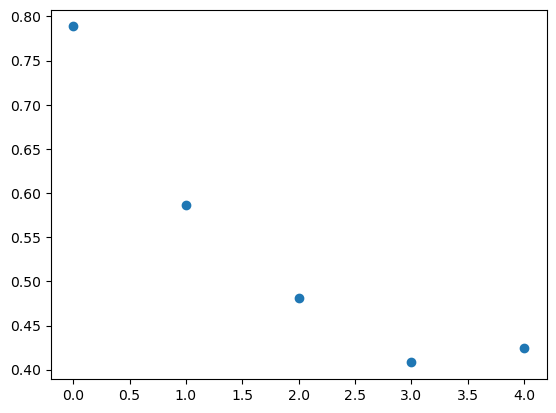

In [14]:
rmses = [rmse_fingerprint, rmse_vicgae, rmse_chemprop, rmse_chemeleon, rmse_smited]

plt.scatter(np.arange(5), rmses)

### Multiple runs

[I 2025-10-03 14:51:04,887] A new study created in memory with name: no-name-06ee3084-102b-45b6-a7ad-c6725e5154cc


Epoch 1/30, Train Loss: 1.7357, Val RMSE: 0.9807
Epoch 2/30, Train Loss: 1.0399, Val RMSE: 0.8213
Epoch 3/30, Train Loss: 0.8463, Val RMSE: 0.8180
Epoch 4/30, Train Loss: 0.5932, Val RMSE: 0.8455
Epoch 5/30, Train Loss: 0.5759, Val RMSE: 0.8137
Epoch 6/30, Train Loss: 0.5413, Val RMSE: 0.8273
Epoch 7/30, Train Loss: 0.5309, Val RMSE: 0.8183
Epoch 8/30, Train Loss: 0.5083, Val RMSE: 0.7909
Epoch 9/30, Train Loss: 0.5378, Val RMSE: 0.7934
Epoch 10/30, Train Loss: 0.5173, Val RMSE: 0.7981
Epoch 11/30, Train Loss: 0.4772, Val RMSE: 0.8190
Epoch 12/30, Train Loss: 0.4918, Val RMSE: 0.7906
Epoch 13/30, Train Loss: 0.4880, Val RMSE: 0.8181
Epoch 14/30, Train Loss: 0.4859, Val RMSE: 0.8056
Epoch 15/30, Train Loss: 0.4860, Val RMSE: 0.8051
Epoch 16/30, Train Loss: 0.4788, Val RMSE: 0.7925
Epoch 17/30, Train Loss: 0.4669, Val RMSE: 0.7824
Epoch 18/30, Train Loss: 0.4661, Val RMSE: 0.8123
Epoch 19/30, Train Loss: 0.4769, Val RMSE: 0.7786
Epoch 20/30, Train Loss: 0.4441, Val RMSE: 0.7907
Epoch 21/

[I 2025-10-03 14:51:12,694] Trial 0 finished with value: 0.6567326784133911 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3394526338621454, 'lr': 0.0023257490643266284, 'batch_size': 32}. Best is trial 0 with value: 0.6567326784133911.


Epoch 30/30, Train Loss: 0.4262, Val RMSE: 0.8104
Epoch 1/30, Train Loss: 1.6416, Val RMSE: 0.9400
Epoch 2/30, Train Loss: 1.0397, Val RMSE: 0.8657
Epoch 3/30, Train Loss: 0.7063, Val RMSE: 0.8141
Epoch 4/30, Train Loss: 0.5704, Val RMSE: 0.8170
Epoch 5/30, Train Loss: 0.6069, Val RMSE: 0.7923
Epoch 6/30, Train Loss: 0.6144, Val RMSE: 0.8322
Epoch 7/30, Train Loss: 0.5674, Val RMSE: 0.8238
Epoch 8/30, Train Loss: 0.5853, Val RMSE: 0.8072
Epoch 9/30, Train Loss: 0.5248, Val RMSE: 0.8105
Epoch 10/30, Train Loss: 0.4885, Val RMSE: 0.8130
Epoch 11/30, Train Loss: 0.4920, Val RMSE: 0.7857
Epoch 12/30, Train Loss: 0.4835, Val RMSE: 0.7947
Epoch 13/30, Train Loss: 0.4605, Val RMSE: 0.8056
Epoch 14/30, Train Loss: 0.4766, Val RMSE: 0.8190
Epoch 15/30, Train Loss: 0.4739, Val RMSE: 0.7940
Epoch 16/30, Train Loss: 0.4566, Val RMSE: 0.8155
Epoch 17/30, Train Loss: 0.4562, Val RMSE: 0.8109
Epoch 18/30, Train Loss: 0.4171, Val RMSE: 0.7934
Epoch 19/30, Train Loss: 0.4085, Val RMSE: 0.7914
Epoch 20/

[I 2025-10-03 14:51:19,595] Trial 1 finished with value: 0.625235378742218 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2668766622032536, 'lr': 0.002205594678988908, 'batch_size': 32}. Best is trial 1 with value: 0.625235378742218.


Epoch 29/30, Train Loss: 0.3984, Val RMSE: 0.7902
Epoch 30/30, Train Loss: 0.3933, Val RMSE: 0.7907
Epoch 1/30, Train Loss: 5.3916, Val RMSE: 1.6389
Epoch 2/30, Train Loss: 1.6141, Val RMSE: 0.9891
Epoch 3/30, Train Loss: 0.9337, Val RMSE: 0.8783
Epoch 4/30, Train Loss: 0.7027, Val RMSE: 0.8662
Epoch 5/30, Train Loss: 0.6732, Val RMSE: 0.8225
Epoch 6/30, Train Loss: 0.5919, Val RMSE: 0.8162
Epoch 7/30, Train Loss: 0.5518, Val RMSE: 0.8148
Epoch 8/30, Train Loss: 0.5323, Val RMSE: 0.7998
Epoch 9/30, Train Loss: 0.5284, Val RMSE: 0.8261
Epoch 10/30, Train Loss: 0.5192, Val RMSE: 0.8149
Epoch 11/30, Train Loss: 0.4967, Val RMSE: 0.7889
Epoch 12/30, Train Loss: 0.4993, Val RMSE: 0.7967
Epoch 13/30, Train Loss: 0.4696, Val RMSE: 0.8425
Epoch 14/30, Train Loss: 0.4849, Val RMSE: 0.7955
Epoch 15/30, Train Loss: 0.4799, Val RMSE: 0.8001
Epoch 16/30, Train Loss: 0.4612, Val RMSE: 0.8142
Epoch 17/30, Train Loss: 0.4580, Val RMSE: 0.7980
Epoch 18/30, Train Loss: 0.4463, Val RMSE: 0.7886
Epoch 19/

[I 2025-10-03 14:51:21,628] Trial 2 finished with value: 0.6251482367515564 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1682244546011838, 'lr': 0.00807125622609079, 'batch_size': 128}. Best is trial 2 with value: 0.6251482367515564.


Epoch 29/30, Train Loss: 0.3895, Val RMSE: 0.7865
Epoch 30/30, Train Loss: 0.3977, Val RMSE: 0.7907
Epoch 1/30, Train Loss: 1.0064, Val RMSE: 0.9405
Epoch 2/30, Train Loss: 0.7630, Val RMSE: 0.8925
Epoch 3/30, Train Loss: 0.7019, Val RMSE: 0.8683
Epoch 4/30, Train Loss: 0.6562, Val RMSE: 0.8497
Epoch 5/30, Train Loss: 0.6122, Val RMSE: 0.8428
Epoch 6/30, Train Loss: 0.6012, Val RMSE: 0.8341
Epoch 7/30, Train Loss: 0.5654, Val RMSE: 0.8289
Epoch 8/30, Train Loss: 0.5574, Val RMSE: 0.8264
Epoch 9/30, Train Loss: 0.5623, Val RMSE: 0.8194
Epoch 10/30, Train Loss: 0.5303, Val RMSE: 0.8102
Epoch 11/30, Train Loss: 0.5232, Val RMSE: 0.8142
Epoch 12/30, Train Loss: 0.5167, Val RMSE: 0.8069
Epoch 13/30, Train Loss: 0.5129, Val RMSE: 0.8020
Epoch 14/30, Train Loss: 0.5175, Val RMSE: 0.8040
Epoch 15/30, Train Loss: 0.4985, Val RMSE: 0.8042
Epoch 16/30, Train Loss: 0.5102, Val RMSE: 0.7972
Epoch 17/30, Train Loss: 0.4835, Val RMSE: 0.8026
Epoch 18/30, Train Loss: 0.4721, Val RMSE: 0.7942
Epoch 19/

[I 2025-10-03 14:51:23,907] Trial 3 finished with value: 0.6233404278755188 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4345507983198684, 'lr': 0.00016926687632921978, 'batch_size': 128}. Best is trial 3 with value: 0.6233404278755188.


Epoch 28/30, Train Loss: 0.4517, Val RMSE: 0.7951
Epoch 29/30, Train Loss: 0.4575, Val RMSE: 0.7954
Epoch 30/30, Train Loss: 0.4306, Val RMSE: 0.7895
Epoch 1/30, Train Loss: 1.0182, Val RMSE: 0.8624
Epoch 2/30, Train Loss: 0.7422, Val RMSE: 0.8083
Epoch 3/30, Train Loss: 0.6405, Val RMSE: 0.8316
Epoch 4/30, Train Loss: 0.6226, Val RMSE: 0.8337
Epoch 5/30, Train Loss: 0.5429, Val RMSE: 0.7933
Epoch 6/30, Train Loss: 0.5406, Val RMSE: 0.8126
Epoch 7/30, Train Loss: 0.5416, Val RMSE: 0.8151
Epoch 8/30, Train Loss: 0.5184, Val RMSE: 0.8011
Epoch 9/30, Train Loss: 0.5062, Val RMSE: 0.7903
Epoch 10/30, Train Loss: 0.4871, Val RMSE: 0.8066
Epoch 11/30, Train Loss: 0.5012, Val RMSE: 0.7847
Epoch 12/30, Train Loss: 0.4830, Val RMSE: 0.7906
Epoch 13/30, Train Loss: 0.4848, Val RMSE: 0.8003
Epoch 14/30, Train Loss: 0.4916, Val RMSE: 0.8313
Epoch 15/30, Train Loss: 0.4775, Val RMSE: 0.7885
Epoch 16/30, Train Loss: 0.4674, Val RMSE: 0.7923
Epoch 17/30, Train Loss: 0.4648, Val RMSE: 0.8147
Epoch 18/

[I 2025-10-03 14:51:28,227] Trial 4 finished with value: 0.6302126049995422 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.40111805324863664, 'lr': 0.0006345924307740989, 'batch_size': 32}. Best is trial 3 with value: 0.6233404278755188.


Epoch 30/30, Train Loss: 0.4031, Val RMSE: 0.7939
Epoch 1/30, Train Loss: 1.8323, Val RMSE: 1.0804
Epoch 2/30, Train Loss: 1.4714, Val RMSE: 0.8724
Epoch 3/30, Train Loss: 0.9209, Val RMSE: 0.8179
Epoch 4/30, Train Loss: 0.6726, Val RMSE: 0.8431
Epoch 5/30, Train Loss: 0.6182, Val RMSE: 0.8103
Epoch 6/30, Train Loss: 0.5552, Val RMSE: 0.7986
Epoch 7/30, Train Loss: 0.5105, Val RMSE: 0.7958
Epoch 8/30, Train Loss: 0.5297, Val RMSE: 0.7864
Epoch 9/30, Train Loss: 0.5188, Val RMSE: 0.7874
Epoch 10/30, Train Loss: 0.4873, Val RMSE: 0.7902
Epoch 11/30, Train Loss: 0.4834, Val RMSE: 0.7906
Epoch 12/30, Train Loss: 0.4613, Val RMSE: 0.8012
Epoch 13/30, Train Loss: 0.4662, Val RMSE: 0.8038
Epoch 14/30, Train Loss: 0.4604, Val RMSE: 0.7866
Epoch 15/30, Train Loss: 0.4637, Val RMSE: 0.7873
Epoch 16/30, Train Loss: 0.4357, Val RMSE: 0.7797
Epoch 17/30, Train Loss: 0.4371, Val RMSE: 0.7854
Epoch 18/30, Train Loss: 0.4540, Val RMSE: 0.7831
Epoch 19/30, Train Loss: 0.4343, Val RMSE: 0.7859
Epoch 20/

[I 2025-10-03 14:51:31,002] Trial 5 finished with value: 0.6164644360542297 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3741193211115285, 'lr': 0.0023272303694033877, 'batch_size': 64}. Best is trial 5 with value: 0.6164644360542297.


Epoch 29/30, Train Loss: 0.4163, Val RMSE: 0.7819
Epoch 30/30, Train Loss: 0.4034, Val RMSE: 0.7852
Epoch 1/30, Train Loss: 0.9262, Val RMSE: 0.8934
Epoch 2/30, Train Loss: 0.7361, Val RMSE: 0.8390
Epoch 3/30, Train Loss: 0.6389, Val RMSE: 0.8258
Epoch 4/30, Train Loss: 0.5967, Val RMSE: 0.8191
Epoch 5/30, Train Loss: 0.5568, Val RMSE: 0.8204
Epoch 6/30, Train Loss: 0.5639, Val RMSE: 0.8106
Epoch 7/30, Train Loss: 0.5182, Val RMSE: 0.8156
Epoch 8/30, Train Loss: 0.5117, Val RMSE: 0.8087
Epoch 9/30, Train Loss: 0.5151, Val RMSE: 0.7955
Epoch 10/30, Train Loss: 0.4872, Val RMSE: 0.8104
Epoch 11/30, Train Loss: 0.5081, Val RMSE: 0.8065
Epoch 12/30, Train Loss: 0.4734, Val RMSE: 0.8000
Epoch 13/30, Train Loss: 0.4932, Val RMSE: 0.8018
Epoch 14/30, Train Loss: 0.4664, Val RMSE: 0.8012
Epoch 15/30, Train Loss: 0.4635, Val RMSE: 0.7867
Epoch 16/30, Train Loss: 0.4848, Val RMSE: 0.8031
Epoch 17/30, Train Loss: 0.4701, Val RMSE: 0.7964
Epoch 18/30, Train Loss: 0.4445, Val RMSE: 0.8079
Epoch 19/

[I 2025-10-03 14:51:34,451] Trial 6 finished with value: 0.6250612735748291 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.46771552178804027, 'lr': 0.00033306536772724737, 'batch_size': 64}. Best is trial 5 with value: 0.6164644360542297.


Epoch 30/30, Train Loss: 0.4223, Val RMSE: 0.7906
Epoch 1/30, Train Loss: 1.1004, Val RMSE: 0.8558
Epoch 2/30, Train Loss: 0.7614, Val RMSE: 0.8518
Epoch 3/30, Train Loss: 0.6066, Val RMSE: 0.8324
Epoch 4/30, Train Loss: 0.6008, Val RMSE: 0.8343
Epoch 5/30, Train Loss: 0.5689, Val RMSE: 0.7955
Epoch 6/30, Train Loss: 0.5304, Val RMSE: 0.8090
Epoch 7/30, Train Loss: 0.5344, Val RMSE: 0.8274
Epoch 8/30, Train Loss: 0.5061, Val RMSE: 0.7944
Epoch 9/30, Train Loss: 0.4757, Val RMSE: 0.8065
Epoch 10/30, Train Loss: 0.4863, Val RMSE: 0.8138
Epoch 11/30, Train Loss: 0.4906, Val RMSE: 0.7809
Epoch 12/30, Train Loss: 0.4791, Val RMSE: 0.7933
Epoch 13/30, Train Loss: 0.4582, Val RMSE: 0.7709
Epoch 14/30, Train Loss: 0.4583, Val RMSE: 0.8090
Epoch 15/30, Train Loss: 0.4392, Val RMSE: 0.7970
Epoch 16/30, Train Loss: 0.4454, Val RMSE: 0.8027
Epoch 17/30, Train Loss: 0.4677, Val RMSE: 0.7938
Epoch 18/30, Train Loss: 0.4570, Val RMSE: 0.7882
Epoch 19/30, Train Loss: 0.4401, Val RMSE: 0.8133
Epoch 20/

[I 2025-10-03 14:51:40,064] Trial 7 finished with value: 0.6231026649475098 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.30541166065653996, 'lr': 0.0011720955502215696, 'batch_size': 32}. Best is trial 5 with value: 0.6164644360542297.


Epoch 29/30, Train Loss: 0.3777, Val RMSE: 0.7905
Epoch 30/30, Train Loss: 0.3826, Val RMSE: 0.7894
Epoch 1/30, Train Loss: 1.1546, Val RMSE: 0.9044
Epoch 2/30, Train Loss: 0.7784, Val RMSE: 0.8600
Epoch 3/30, Train Loss: 0.6536, Val RMSE: 0.8487
Epoch 4/30, Train Loss: 0.6074, Val RMSE: 0.8240
Epoch 5/30, Train Loss: 0.5869, Val RMSE: 0.8156
Epoch 6/30, Train Loss: 0.5827, Val RMSE: 0.8055
Epoch 7/30, Train Loss: 0.5372, Val RMSE: 0.8132
Epoch 8/30, Train Loss: 0.5440, Val RMSE: 0.8058
Epoch 9/30, Train Loss: 0.5185, Val RMSE: 0.7936
Epoch 10/30, Train Loss: 0.5020, Val RMSE: 0.7956
Epoch 11/30, Train Loss: 0.5172, Val RMSE: 0.7891
Epoch 12/30, Train Loss: 0.4803, Val RMSE: 0.8049
Epoch 13/30, Train Loss: 0.4905, Val RMSE: 0.7925
Epoch 14/30, Train Loss: 0.4605, Val RMSE: 0.8141
Epoch 15/30, Train Loss: 0.4735, Val RMSE: 0.7898
Epoch 16/30, Train Loss: 0.4608, Val RMSE: 0.8012
Epoch 17/30, Train Loss: 0.4592, Val RMSE: 0.7858
Epoch 18/30, Train Loss: 0.4664, Val RMSE: 0.8000
Epoch 19/

[I 2025-10-03 14:51:44,384] Trial 8 finished with value: 0.6218650937080383 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3788529526214439, 'lr': 0.0010138772529095965, 'batch_size': 32}. Best is trial 5 with value: 0.6164644360542297.


Epoch 28/30, Train Loss: 0.4216, Val RMSE: 0.8020
Epoch 29/30, Train Loss: 0.4156, Val RMSE: 0.7877
Epoch 30/30, Train Loss: 0.4013, Val RMSE: 0.7886
Epoch 1/30, Train Loss: 0.9897, Val RMSE: 0.9366
Epoch 2/30, Train Loss: 0.8184, Val RMSE: 0.8944
Epoch 3/30, Train Loss: 0.7373, Val RMSE: 0.8685
Epoch 4/30, Train Loss: 0.6978, Val RMSE: 0.8497
Epoch 5/30, Train Loss: 0.6618, Val RMSE: 0.8403
Epoch 6/30, Train Loss: 0.6315, Val RMSE: 0.8308
Epoch 7/30, Train Loss: 0.5973, Val RMSE: 0.8265
Epoch 8/30, Train Loss: 0.6102, Val RMSE: 0.8217
Epoch 9/30, Train Loss: 0.5758, Val RMSE: 0.8177
Epoch 10/30, Train Loss: 0.5633, Val RMSE: 0.8139
Epoch 11/30, Train Loss: 0.5540, Val RMSE: 0.8117
Epoch 12/30, Train Loss: 0.5294, Val RMSE: 0.8087
Epoch 13/30, Train Loss: 0.5143, Val RMSE: 0.8051
Epoch 14/30, Train Loss: 0.5317, Val RMSE: 0.8017
Epoch 15/30, Train Loss: 0.5133, Val RMSE: 0.8004
Epoch 16/30, Train Loss: 0.5153, Val RMSE: 0.7976
Epoch 17/30, Train Loss: 0.5108, Val RMSE: 0.7981
Epoch 18/

[I 2025-10-03 14:51:46,109] Trial 9 finished with value: 0.6214298009872437 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.493431941970734, 'lr': 0.00014559368960129318, 'batch_size': 128}. Best is trial 5 with value: 0.6164644360542297.


Epoch 27/30, Train Loss: 0.4653, Val RMSE: 0.7867
Epoch 28/30, Train Loss: 0.4596, Val RMSE: 0.7927
Epoch 29/30, Train Loss: 0.4697, Val RMSE: 0.7931
Epoch 30/30, Train Loss: 0.4472, Val RMSE: 0.7883
Epoch 1/30, Train Loss: 4.3405, Val RMSE: 1.3509
Epoch 2/30, Train Loss: 1.4220, Val RMSE: 0.9335
Epoch 3/30, Train Loss: 0.7736, Val RMSE: 0.9709
Epoch 4/30, Train Loss: 0.7139, Val RMSE: 0.8934
Epoch 5/30, Train Loss: 0.6303, Val RMSE: 0.9098
Epoch 6/30, Train Loss: 0.6427, Val RMSE: 0.8058
Epoch 7/30, Train Loss: 0.5899, Val RMSE: 0.8146
Epoch 8/30, Train Loss: 0.5655, Val RMSE: 0.8016
Epoch 9/30, Train Loss: 0.5289, Val RMSE: 0.8411
Epoch 10/30, Train Loss: 0.5449, Val RMSE: 0.7984
Epoch 11/30, Train Loss: 0.4980, Val RMSE: 0.8071
Epoch 12/30, Train Loss: 0.5130, Val RMSE: 0.8095
Epoch 13/30, Train Loss: 0.5167, Val RMSE: 0.8024
Epoch 14/30, Train Loss: 0.5060, Val RMSE: 0.9068
Epoch 15/30, Train Loss: 0.5331, Val RMSE: 0.8333
Epoch 16/30, Train Loss: 0.5007, Val RMSE: 0.8018
Epoch 17/

[I 2025-10-03 14:51:50,201] Trial 10 finished with value: 0.6326149106025696 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.21483512517367886, 'lr': 0.008106116506901528, 'batch_size': 64}. Best is trial 5 with value: 0.6164644360542297.


Epoch 30/30, Train Loss: 0.4077, Val RMSE: 0.7954
Epoch 1/30, Train Loss: 0.9663, Val RMSE: 0.9406
Epoch 2/30, Train Loss: 0.7818, Val RMSE: 0.8991
Epoch 3/30, Train Loss: 0.7112, Val RMSE: 0.8664
Epoch 4/30, Train Loss: 0.6745, Val RMSE: 0.8549
Epoch 5/30, Train Loss: 0.6450, Val RMSE: 0.8391
Epoch 6/30, Train Loss: 0.6167, Val RMSE: 0.8331
Epoch 7/30, Train Loss: 0.5956, Val RMSE: 0.8292
Epoch 8/30, Train Loss: 0.5727, Val RMSE: 0.8228
Epoch 9/30, Train Loss: 0.5732, Val RMSE: 0.8175
Epoch 10/30, Train Loss: 0.5585, Val RMSE: 0.8139
Epoch 11/30, Train Loss: 0.5533, Val RMSE: 0.8106
Epoch 12/30, Train Loss: 0.5350, Val RMSE: 0.8094
Epoch 13/30, Train Loss: 0.5021, Val RMSE: 0.8073
Epoch 14/30, Train Loss: 0.5235, Val RMSE: 0.7982
Epoch 15/30, Train Loss: 0.4847, Val RMSE: 0.7980
Epoch 16/30, Train Loss: 0.5033, Val RMSE: 0.8081
Epoch 17/30, Train Loss: 0.5018, Val RMSE: 0.7964
Epoch 18/30, Train Loss: 0.5018, Val RMSE: 0.7967
Epoch 19/30, Train Loss: 0.4887, Val RMSE: 0.8000
Epoch 20/

[I 2025-10-03 14:51:54,846] Trial 11 finished with value: 0.6258271932601929 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.487521165241313, 'lr': 0.00011177578925914088, 'batch_size': 64}. Best is trial 5 with value: 0.6164644360542297.


Epoch 30/30, Train Loss: 0.4499, Val RMSE: 0.7911
Epoch 1/30, Train Loss: 2.0201, Val RMSE: 1.0450
Epoch 2/30, Train Loss: 1.5412, Val RMSE: 1.0273
Epoch 3/30, Train Loss: 1.1011, Val RMSE: 0.8575
Epoch 4/30, Train Loss: 0.7671, Val RMSE: 0.8332
Epoch 5/30, Train Loss: 0.6514, Val RMSE: 0.8223
Epoch 6/30, Train Loss: 0.6275, Val RMSE: 0.8197
Epoch 7/30, Train Loss: 0.5730, Val RMSE: 0.8102
Epoch 8/30, Train Loss: 0.5482, Val RMSE: 0.8020
Epoch 9/30, Train Loss: 0.5429, Val RMSE: 0.8236
Epoch 10/30, Train Loss: 0.5404, Val RMSE: 0.7886
Epoch 11/30, Train Loss: 0.5327, Val RMSE: 0.8024
Epoch 12/30, Train Loss: 0.5038, Val RMSE: 0.7951
Epoch 13/30, Train Loss: 0.5281, Val RMSE: 0.7930
Epoch 14/30, Train Loss: 0.5024, Val RMSE: 0.8094
Epoch 15/30, Train Loss: 0.4806, Val RMSE: 0.7935
Epoch 16/30, Train Loss: 0.4826, Val RMSE: 0.7963
Epoch 17/30, Train Loss: 0.4822, Val RMSE: 0.7851
Epoch 18/30, Train Loss: 0.4777, Val RMSE: 0.7944
Epoch 19/30, Train Loss: 0.4651, Val RMSE: 0.7905
Epoch 20/

[I 2025-10-03 14:51:57,171] Trial 12 finished with value: 0.6256116628646851 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.49238415877585107, 'lr': 0.0035579430816933986, 'batch_size': 128}. Best is trial 5 with value: 0.6164644360542297.


Epoch 29/30, Train Loss: 0.4480, Val RMSE: 0.7877
Epoch 30/30, Train Loss: 0.4283, Val RMSE: 0.7910
Epoch 1/30, Train Loss: 0.9249, Val RMSE: 0.8815
Epoch 2/30, Train Loss: 0.6820, Val RMSE: 0.8513
Epoch 3/30, Train Loss: 0.5835, Val RMSE: 0.8229
Epoch 4/30, Train Loss: 0.5586, Val RMSE: 0.8059
Epoch 5/30, Train Loss: 0.5501, Val RMSE: 0.8204
Epoch 6/30, Train Loss: 0.5176, Val RMSE: 0.8169
Epoch 7/30, Train Loss: 0.4953, Val RMSE: 0.7943
Epoch 8/30, Train Loss: 0.4749, Val RMSE: 0.7928
Epoch 9/30, Train Loss: 0.5035, Val RMSE: 0.8062
Epoch 10/30, Train Loss: 0.4607, Val RMSE: 0.8046
Epoch 11/30, Train Loss: 0.4638, Val RMSE: 0.8039
Epoch 12/30, Train Loss: 0.4525, Val RMSE: 0.8102
Epoch 13/30, Train Loss: 0.4740, Val RMSE: 0.7958
Epoch 14/30, Train Loss: 0.4561, Val RMSE: 0.7978
Epoch 15/30, Train Loss: 0.4524, Val RMSE: 0.7921
Epoch 16/30, Train Loss: 0.4290, Val RMSE: 0.7873
Epoch 17/30, Train Loss: 0.4204, Val RMSE: 0.7952
Epoch 18/30, Train Loss: 0.4361, Val RMSE: 0.7931
Epoch 19/

[I 2025-10-03 14:51:59,588] Trial 13 finished with value: 0.6328718066215515 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.36815633927485425, 'lr': 0.00034463161652714816, 'batch_size': 64}. Best is trial 5 with value: 0.6164644360542297.


Epoch 27/30, Train Loss: 0.3894, Val RMSE: 0.7881
Epoch 28/30, Train Loss: 0.4072, Val RMSE: 0.7914
Epoch 29/30, Train Loss: 0.4080, Val RMSE: 0.7952
Epoch 30/30, Train Loss: 0.4110, Val RMSE: 0.7955
Epoch 1/30, Train Loss: 2.2385, Val RMSE: 1.0674
Epoch 2/30, Train Loss: 0.9972, Val RMSE: 0.8509
Epoch 3/30, Train Loss: 0.6437, Val RMSE: 0.8522
Epoch 4/30, Train Loss: 0.5740, Val RMSE: 0.8585
Epoch 5/30, Train Loss: 0.5189, Val RMSE: 0.7985
Epoch 6/30, Train Loss: 0.4704, Val RMSE: 0.8023
Epoch 7/30, Train Loss: 0.4491, Val RMSE: 0.8107
Epoch 8/30, Train Loss: 0.4494, Val RMSE: 0.7922
Epoch 9/30, Train Loss: 0.4515, Val RMSE: 0.8150
Epoch 10/30, Train Loss: 0.4589, Val RMSE: 0.7955
Epoch 11/30, Train Loss: 0.4440, Val RMSE: 0.7955
Epoch 12/30, Train Loss: 0.4343, Val RMSE: 0.8034
Epoch 13/30, Train Loss: 0.4218, Val RMSE: 0.8041
Epoch 14/30, Train Loss: 0.4212, Val RMSE: 0.8157
Epoch 15/30, Train Loss: 0.4115, Val RMSE: 0.7949
Epoch 16/30, Train Loss: 0.3932, Val RMSE: 0.8032
Epoch 17/

[I 2025-10-03 14:52:01,700] Trial 14 finished with value: 0.6278401017189026 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10646343162211808, 'lr': 0.0035571488248288654, 'batch_size': 128}. Best is trial 5 with value: 0.6164644360542297.


Epoch 30/30, Train Loss: 0.3695, Val RMSE: 0.7924
Epoch 1/30, Train Loss: 0.9243, Val RMSE: 0.8532
Epoch 2/30, Train Loss: 0.6648, Val RMSE: 0.8257
Epoch 3/30, Train Loss: 0.6171, Val RMSE: 0.8216
Epoch 4/30, Train Loss: 0.5698, Val RMSE: 0.8193
Epoch 5/30, Train Loss: 0.5379, Val RMSE: 0.8220
Epoch 6/30, Train Loss: 0.5570, Val RMSE: 0.7850
Epoch 7/30, Train Loss: 0.5171, Val RMSE: 0.7866
Epoch 8/30, Train Loss: 0.5352, Val RMSE: 0.7918
Epoch 9/30, Train Loss: 0.5212, Val RMSE: 0.7990
Epoch 10/30, Train Loss: 0.4766, Val RMSE: 0.8143
Epoch 11/30, Train Loss: 0.4601, Val RMSE: 0.7996
Epoch 12/30, Train Loss: 0.4673, Val RMSE: 0.7898
Epoch 13/30, Train Loss: 0.4568, Val RMSE: 0.7756
Epoch 14/30, Train Loss: 0.4513, Val RMSE: 0.7907
Epoch 15/30, Train Loss: 0.4315, Val RMSE: 0.7916
Epoch 16/30, Train Loss: 0.4465, Val RMSE: 0.7963
Epoch 17/30, Train Loss: 0.4413, Val RMSE: 0.7854
Epoch 18/30, Train Loss: 0.4344, Val RMSE: 0.7827
Epoch 19/30, Train Loss: 0.4429, Val RMSE: 0.7833
Epoch 20/

[I 2025-10-03 14:52:04,343] Trial 15 finished with value: 0.6211485862731934 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4043308745380931, 'lr': 0.00036628820643074797, 'batch_size': 64}. Best is trial 5 with value: 0.6164644360542297.


Epoch 28/30, Train Loss: 0.3881, Val RMSE: 0.7861
Epoch 29/30, Train Loss: 0.4036, Val RMSE: 0.7869
Epoch 30/30, Train Loss: 0.4030, Val RMSE: 0.7881
Epoch 1/30, Train Loss: 0.9329, Val RMSE: 0.8544
Epoch 2/30, Train Loss: 0.7152, Val RMSE: 0.8395
Epoch 3/30, Train Loss: 0.6579, Val RMSE: 0.8193
Epoch 4/30, Train Loss: 0.5889, Val RMSE: 0.8146
Epoch 5/30, Train Loss: 0.5510, Val RMSE: 0.8202
Epoch 6/30, Train Loss: 0.5390, Val RMSE: 0.8031
Epoch 7/30, Train Loss: 0.5253, Val RMSE: 0.7976
Epoch 8/30, Train Loss: 0.5006, Val RMSE: 0.8065
Epoch 9/30, Train Loss: 0.5081, Val RMSE: 0.8154
Epoch 10/30, Train Loss: 0.5072, Val RMSE: 0.7885
Epoch 11/30, Train Loss: 0.4856, Val RMSE: 0.8026
Epoch 12/30, Train Loss: 0.4887, Val RMSE: 0.8199
Epoch 13/30, Train Loss: 0.4761, Val RMSE: 0.8057
Epoch 14/30, Train Loss: 0.4888, Val RMSE: 0.8060
Epoch 15/30, Train Loss: 0.4677, Val RMSE: 0.7889
Epoch 16/30, Train Loss: 0.4875, Val RMSE: 0.7837
Epoch 17/30, Train Loss: 0.4654, Val RMSE: 0.8019
Epoch 18/

[I 2025-10-03 14:52:07,388] Trial 16 finished with value: 0.6269998550415039 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.41884714397558037, 'lr': 0.0005124714139446028, 'batch_size': 64}. Best is trial 5 with value: 0.6164644360542297.


Epoch 30/30, Train Loss: 0.3994, Val RMSE: 0.7918
Epoch 1/30, Train Loss: 1.2898, Val RMSE: 0.9105
Epoch 2/30, Train Loss: 0.7865, Val RMSE: 0.8454
Epoch 3/30, Train Loss: 0.6775, Val RMSE: 0.7988
Epoch 4/30, Train Loss: 0.6100, Val RMSE: 0.8219
Epoch 5/30, Train Loss: 0.5705, Val RMSE: 0.8064
Epoch 6/30, Train Loss: 0.5521, Val RMSE: 0.7975
Epoch 7/30, Train Loss: 0.5109, Val RMSE: 0.8061
Epoch 8/30, Train Loss: 0.5281, Val RMSE: 0.7967
Epoch 9/30, Train Loss: 0.5236, Val RMSE: 0.7890
Epoch 10/30, Train Loss: 0.4968, Val RMSE: 0.8137
Epoch 11/30, Train Loss: 0.4743, Val RMSE: 0.8020
Epoch 12/30, Train Loss: 0.4662, Val RMSE: 0.7958
Epoch 13/30, Train Loss: 0.4667, Val RMSE: 0.8023
Epoch 14/30, Train Loss: 0.4504, Val RMSE: 0.8049
Epoch 15/30, Train Loss: 0.4575, Val RMSE: 0.7785
Epoch 16/30, Train Loss: 0.4481, Val RMSE: 0.8049
Epoch 17/30, Train Loss: 0.4701, Val RMSE: 0.7893
Epoch 18/30, Train Loss: 0.4650, Val RMSE: 0.7766
Epoch 19/30, Train Loss: 0.4596, Val RMSE: 0.7756
Epoch 20/

[I 2025-10-03 14:52:12,835] Trial 17 finished with value: 0.6216831207275391 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.32830475978561297, 'lr': 0.0014885393862272042, 'batch_size': 64}. Best is trial 5 with value: 0.6164644360542297.


Epoch 30/30, Train Loss: 0.4094, Val RMSE: 0.7885
Epoch 1/30, Train Loss: 0.8931, Val RMSE: 0.8853
Epoch 2/30, Train Loss: 0.6616, Val RMSE: 0.8405
Epoch 3/30, Train Loss: 0.5757, Val RMSE: 0.8163
Epoch 4/30, Train Loss: 0.5517, Val RMSE: 0.7908
Epoch 5/30, Train Loss: 0.5170, Val RMSE: 0.8091
Epoch 6/30, Train Loss: 0.4933, Val RMSE: 0.7985
Epoch 7/30, Train Loss: 0.4898, Val RMSE: 0.7906
Epoch 8/30, Train Loss: 0.4610, Val RMSE: 0.8028
Epoch 9/30, Train Loss: 0.4685, Val RMSE: 0.7851
Epoch 10/30, Train Loss: 0.4849, Val RMSE: 0.7957
Epoch 11/30, Train Loss: 0.4570, Val RMSE: 0.7917
Epoch 12/30, Train Loss: 0.4579, Val RMSE: 0.8034
Epoch 13/30, Train Loss: 0.4500, Val RMSE: 0.7894
Epoch 14/30, Train Loss: 0.4463, Val RMSE: 0.7877
Epoch 15/30, Train Loss: 0.4212, Val RMSE: 0.8072
Epoch 16/30, Train Loss: 0.4260, Val RMSE: 0.7885
Epoch 17/30, Train Loss: 0.4099, Val RMSE: 0.7897
Epoch 18/30, Train Loss: 0.4016, Val RMSE: 0.7887
Epoch 19/30, Train Loss: 0.4214, Val RMSE: 0.7888
Epoch 20/

[I 2025-10-03 14:52:17,630] Trial 18 finished with value: 0.6219882965087891 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2667891632043977, 'lr': 0.00029756305116543266, 'batch_size': 64}. Best is trial 5 with value: 0.6164644360542297.


Epoch 29/30, Train Loss: 0.3966, Val RMSE: 0.7929
Epoch 30/30, Train Loss: 0.3765, Val RMSE: 0.7887
Epoch 1/30, Train Loss: 0.9549, Val RMSE: 0.8872
Epoch 2/30, Train Loss: 0.7144, Val RMSE: 0.8393
Epoch 3/30, Train Loss: 0.6324, Val RMSE: 0.8250
Epoch 4/30, Train Loss: 0.6070, Val RMSE: 0.8251
Epoch 5/30, Train Loss: 0.5794, Val RMSE: 0.7967
Epoch 6/30, Train Loss: 0.5414, Val RMSE: 0.8232
Epoch 7/30, Train Loss: 0.5772, Val RMSE: 0.8007
Epoch 8/30, Train Loss: 0.5166, Val RMSE: 0.8033
Epoch 9/30, Train Loss: 0.5403, Val RMSE: 0.8091
Epoch 10/30, Train Loss: 0.4864, Val RMSE: 0.7826
Epoch 11/30, Train Loss: 0.4980, Val RMSE: 0.7772
Epoch 12/30, Train Loss: 0.4615, Val RMSE: 0.7956
Epoch 13/30, Train Loss: 0.4868, Val RMSE: 0.8177
Epoch 14/30, Train Loss: 0.4800, Val RMSE: 0.7958
Epoch 15/30, Train Loss: 0.4860, Val RMSE: 0.7927
Epoch 16/30, Train Loss: 0.4556, Val RMSE: 0.7803
Epoch 17/30, Train Loss: 0.4751, Val RMSE: 0.7826
Epoch 18/30, Train Loss: 0.4535, Val RMSE: 0.7951
Epoch 19/

[I 2025-10-03 14:52:20,274] Trial 19 finished with value: 0.6078897714614868 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4341529074052977, 'lr': 0.000643437430061026, 'batch_size': 64}. Best is trial 19 with value: 0.6078897714614868.


Epoch 28/30, Train Loss: 0.4082, Val RMSE: 0.7794
Epoch 29/30, Train Loss: 0.3890, Val RMSE: 0.7813
Epoch 30/30, Train Loss: 0.3975, Val RMSE: 0.7797
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4341529074052977, 'lr': 0.000643437430061026, 'batch_size': 64}
Best MSE: 0.6078897714614868
Epoch 1/300, Train Loss: 1.0298, Val RMSE: 0.8951
Epoch 2/300, Train Loss: 0.7412, Val RMSE: 0.8451
Epoch 3/300, Train Loss: 0.6454, Val RMSE: 0.8095
Epoch 4/300, Train Loss: 0.5922, Val RMSE: 0.7973
Epoch 5/300, Train Loss: 0.5588, Val RMSE: 0.8154
Epoch 6/300, Train Loss: 0.5331, Val RMSE: 0.7833
Epoch 7/300, Train Loss: 0.5368, Val RMSE: 0.7938
Epoch 8/300, Train Loss: 0.5082, Val RMSE: 0.7894
Epoch 9/300, Train Loss: 0.5241, Val RMSE: 0.7910
Epoch 10/300, Train Loss: 0.5102, Val RMSE: 0.8138
Epoch 11/300, Train Loss: 0.5041, Val RMSE: 0.7961
Epoch 12/300, Train Loss: 0.4979, Val RMSE: 0.7959
Epoch 13/300, Train Loss: 0.4466, Val RMSE: 0.7965
Epoch 14/300, Train Loss: 0.4536, 

[I 2025-10-03 14:52:28,265] A new study created in memory with name: no-name-38d91f6f-69ca-4588-81f8-1ef60240fdd1


Epoch 53/300, Train Loss: 0.3899, Val RMSE: 0.7869
Early stopping triggered.
Final Test MSE: 0.6192, R2: 0.3869
Epoch 1/30, Train Loss: 1.2990, Val RMSE: 0.9157
Epoch 2/30, Train Loss: 0.8785, Val RMSE: 0.8435
Epoch 3/30, Train Loss: 0.6953, Val RMSE: 0.7987
Epoch 4/30, Train Loss: 0.6083, Val RMSE: 0.7860
Epoch 5/30, Train Loss: 0.5475, Val RMSE: 0.7698
Epoch 6/30, Train Loss: 0.5467, Val RMSE: 0.7727
Epoch 7/30, Train Loss: 0.5414, Val RMSE: 0.7623
Epoch 8/30, Train Loss: 0.4981, Val RMSE: 0.8258
Epoch 9/30, Train Loss: 0.5151, Val RMSE: 0.7763
Epoch 10/30, Train Loss: 0.4818, Val RMSE: 0.8041
Epoch 11/30, Train Loss: 0.4851, Val RMSE: 0.7859
Epoch 12/30, Train Loss: 0.4825, Val RMSE: 0.7627
Epoch 13/30, Train Loss: 0.4856, Val RMSE: 0.7673
Epoch 14/30, Train Loss: 0.4566, Val RMSE: 0.7751
Epoch 15/30, Train Loss: 0.4362, Val RMSE: 0.7748
Epoch 16/30, Train Loss: 0.4434, Val RMSE: 0.7764
Epoch 17/30, Train Loss: 0.4379, Val RMSE: 0.7597
Epoch 18/30, Train Loss: 0.4295, Val RMSE: 0.77

[I 2025-10-03 14:52:31,536] Trial 0 finished with value: 0.5940407514572144 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.261708316866565, 'lr': 0.0027998463981716262, 'batch_size': 64}. Best is trial 0 with value: 0.5940407514572144.


Epoch 30/30, Train Loss: 0.3931, Val RMSE: 0.7707
Epoch 1/30, Train Loss: 1.6472, Val RMSE: 0.9398
Epoch 2/30, Train Loss: 0.8462, Val RMSE: 0.8769
Epoch 3/30, Train Loss: 0.6529, Val RMSE: 0.7837
Epoch 4/30, Train Loss: 0.5987, Val RMSE: 0.7843
Epoch 5/30, Train Loss: 0.5377, Val RMSE: 0.7820
Epoch 6/30, Train Loss: 0.5187, Val RMSE: 0.8148
Epoch 7/30, Train Loss: 0.5175, Val RMSE: 0.7659
Epoch 8/30, Train Loss: 0.5263, Val RMSE: 0.8344
Epoch 9/30, Train Loss: 0.4945, Val RMSE: 0.7838
Epoch 10/30, Train Loss: 0.5024, Val RMSE: 0.8025
Epoch 11/30, Train Loss: 0.4613, Val RMSE: 0.7762
Epoch 12/30, Train Loss: 0.4914, Val RMSE: 0.8100
Epoch 13/30, Train Loss: 0.4677, Val RMSE: 0.8007
Epoch 14/30, Train Loss: 0.4487, Val RMSE: 0.7793
Epoch 15/30, Train Loss: 0.4493, Val RMSE: 0.7756
Epoch 16/30, Train Loss: 0.4315, Val RMSE: 0.7802
Epoch 17/30, Train Loss: 0.4282, Val RMSE: 0.7792
Epoch 18/30, Train Loss: 0.4370, Val RMSE: 0.7946
Epoch 19/30, Train Loss: 0.4156, Val RMSE: 0.7838
Epoch 20/

[I 2025-10-03 14:52:35,073] Trial 1 finished with value: 0.6158146262168884 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1755863248680119, 'lr': 0.004655190042851918, 'batch_size': 64}. Best is trial 0 with value: 0.5940407514572144.


Epoch 27/30, Train Loss: 0.3859, Val RMSE: 0.7847
Early stopping triggered.
Epoch 1/30, Train Loss: 0.9191, Val RMSE: 0.8724
Epoch 2/30, Train Loss: 0.6750, Val RMSE: 0.8299
Epoch 3/30, Train Loss: 0.5948, Val RMSE: 0.8032
Epoch 4/30, Train Loss: 0.5339, Val RMSE: 0.7879
Epoch 5/30, Train Loss: 0.5111, Val RMSE: 0.7800
Epoch 6/30, Train Loss: 0.4865, Val RMSE: 0.7812
Epoch 7/30, Train Loss: 0.4779, Val RMSE: 0.7696
Epoch 8/30, Train Loss: 0.4636, Val RMSE: 0.7811
Epoch 9/30, Train Loss: 0.4558, Val RMSE: 0.7695
Epoch 10/30, Train Loss: 0.4367, Val RMSE: 0.7777
Epoch 11/30, Train Loss: 0.4242, Val RMSE: 0.7721
Epoch 12/30, Train Loss: 0.4214, Val RMSE: 0.7790
Epoch 13/30, Train Loss: 0.4267, Val RMSE: 0.7669
Epoch 14/30, Train Loss: 0.4225, Val RMSE: 0.7776
Epoch 15/30, Train Loss: 0.4192, Val RMSE: 0.7816
Epoch 16/30, Train Loss: 0.4078, Val RMSE: 0.7758
Epoch 17/30, Train Loss: 0.4015, Val RMSE: 0.7870
Epoch 18/30, Train Loss: 0.3955, Val RMSE: 0.7727
Epoch 19/30, Train Loss: 0.4080, 

[I 2025-10-03 14:52:37,383] Trial 2 finished with value: 0.6013466715812683 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10679655715173185, 'lr': 0.0003730822191820295, 'batch_size': 128}. Best is trial 0 with value: 0.5940407514572144.


Epoch 29/30, Train Loss: 0.3734, Val RMSE: 0.7782
Epoch 30/30, Train Loss: 0.3751, Val RMSE: 0.7755
Epoch 1/30, Train Loss: 3.5030, Val RMSE: 1.6023
Epoch 2/30, Train Loss: 1.9528, Val RMSE: 0.9522
Epoch 3/30, Train Loss: 1.0882, Val RMSE: 0.8982
Epoch 4/30, Train Loss: 0.8297, Val RMSE: 0.8528
Epoch 5/30, Train Loss: 0.6855, Val RMSE: 0.8046
Epoch 6/30, Train Loss: 0.6343, Val RMSE: 0.7871
Epoch 7/30, Train Loss: 0.6026, Val RMSE: 0.7963
Epoch 8/30, Train Loss: 0.5723, Val RMSE: 0.7814
Epoch 9/30, Train Loss: 0.5626, Val RMSE: 0.7796
Epoch 10/30, Train Loss: 0.5339, Val RMSE: 0.7830
Epoch 11/30, Train Loss: 0.5168, Val RMSE: 0.7726
Epoch 12/30, Train Loss: 0.4995, Val RMSE: 0.7719
Epoch 13/30, Train Loss: 0.5007, Val RMSE: 0.7789
Epoch 14/30, Train Loss: 0.5143, Val RMSE: 0.7971
Epoch 15/30, Train Loss: 0.4820, Val RMSE: 0.7894
Epoch 16/30, Train Loss: 0.4719, Val RMSE: 0.7812
Epoch 17/30, Train Loss: 0.4718, Val RMSE: 0.7775
Epoch 18/30, Train Loss: 0.4514, Val RMSE: 0.8155
Epoch 19/

[I 2025-10-03 14:52:39,614] Trial 3 finished with value: 0.5939188003540039 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2477020318264161, 'lr': 0.005716109989020652, 'batch_size': 128}. Best is trial 3 with value: 0.5939188003540039.


Epoch 29/30, Train Loss: 0.4289, Val RMSE: 0.7720
Epoch 30/30, Train Loss: 0.4190, Val RMSE: 0.7707
Epoch 1/30, Train Loss: 1.0350, Val RMSE: 0.8754
Epoch 2/30, Train Loss: 0.8816, Val RMSE: 0.8167
Epoch 3/30, Train Loss: 0.7247, Val RMSE: 0.8123
Epoch 4/30, Train Loss: 0.6763, Val RMSE: 0.7845
Epoch 5/30, Train Loss: 0.6024, Val RMSE: 0.7921
Epoch 6/30, Train Loss: 0.5402, Val RMSE: 0.7830
Epoch 7/30, Train Loss: 0.5613, Val RMSE: 0.7823
Epoch 8/30, Train Loss: 0.5713, Val RMSE: 0.7763
Epoch 9/30, Train Loss: 0.5654, Val RMSE: 0.7655
Epoch 10/30, Train Loss: 0.5203, Val RMSE: 0.7774
Epoch 11/30, Train Loss: 0.5319, Val RMSE: 0.7779
Epoch 12/30, Train Loss: 0.5049, Val RMSE: 0.7802
Epoch 13/30, Train Loss: 0.4762, Val RMSE: 0.7694
Epoch 14/30, Train Loss: 0.5033, Val RMSE: 0.7703
Epoch 15/30, Train Loss: 0.5034, Val RMSE: 0.7795
Epoch 16/30, Train Loss: 0.4630, Val RMSE: 0.7763
Epoch 17/30, Train Loss: 0.4574, Val RMSE: 0.7675
Epoch 18/30, Train Loss: 0.4575, Val RMSE: 0.7668
Epoch 19/

[I 2025-10-03 14:52:47,951] Trial 4 finished with value: 0.5996017456054688 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4463601856364052, 'lr': 0.0011103808822899765, 'batch_size': 64}. Best is trial 3 with value: 0.5939188003540039.


Epoch 30/30, Train Loss: 0.4268, Val RMSE: 0.7743
Epoch 1/30, Train Loss: 0.9320, Val RMSE: 0.8919
Epoch 2/30, Train Loss: 0.6994, Val RMSE: 0.8440
Epoch 3/30, Train Loss: 0.6460, Val RMSE: 0.8143
Epoch 4/30, Train Loss: 0.6285, Val RMSE: 0.8073
Epoch 5/30, Train Loss: 0.5786, Val RMSE: 0.7979
Epoch 6/30, Train Loss: 0.5555, Val RMSE: 0.7933
Epoch 7/30, Train Loss: 0.5640, Val RMSE: 0.7822
Epoch 8/30, Train Loss: 0.5434, Val RMSE: 0.7851
Epoch 9/30, Train Loss: 0.5030, Val RMSE: 0.7890
Epoch 10/30, Train Loss: 0.5201, Val RMSE: 0.7905
Epoch 11/30, Train Loss: 0.5146, Val RMSE: 0.7904
Epoch 12/30, Train Loss: 0.4933, Val RMSE: 0.7847
Epoch 13/30, Train Loss: 0.5068, Val RMSE: 0.7893
Epoch 14/30, Train Loss: 0.4634, Val RMSE: 0.7876
Epoch 15/30, Train Loss: 0.4640, Val RMSE: 0.7827
Epoch 16/30, Train Loss: 0.4715, Val RMSE: 0.7765
Epoch 17/30, Train Loss: 0.4605, Val RMSE: 0.7734
Epoch 18/30, Train Loss: 0.4669, Val RMSE: 0.7748
Epoch 19/30, Train Loss: 0.4621, Val RMSE: 0.7809
Epoch 20/

[I 2025-10-03 14:53:00,202] Trial 5 finished with value: 0.6052297353744507 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.45505181999896294, 'lr': 0.00024703618117107967, 'batch_size': 64}. Best is trial 3 with value: 0.5939188003540039.


Epoch 29/30, Train Loss: 0.4131, Val RMSE: 0.7765
Epoch 30/30, Train Loss: 0.4329, Val RMSE: 0.7780
Epoch 1/30, Train Loss: 2.3510, Val RMSE: 1.0081
Epoch 2/30, Train Loss: 1.1542, Val RMSE: 0.9435
Epoch 3/30, Train Loss: 0.8475, Val RMSE: 0.8260
Epoch 4/30, Train Loss: 0.6869, Val RMSE: 0.8333
Epoch 5/30, Train Loss: 0.6151, Val RMSE: 0.8185
Epoch 6/30, Train Loss: 0.5464, Val RMSE: 0.7946
Epoch 7/30, Train Loss: 0.5167, Val RMSE: 0.7810
Epoch 8/30, Train Loss: 0.5127, Val RMSE: 0.7837
Epoch 9/30, Train Loss: 0.4966, Val RMSE: 0.7797
Epoch 10/30, Train Loss: 0.4910, Val RMSE: 0.7734
Epoch 11/30, Train Loss: 0.4642, Val RMSE: 0.7770
Epoch 12/30, Train Loss: 0.4771, Val RMSE: 0.7769
Epoch 13/30, Train Loss: 0.4463, Val RMSE: 0.7767
Epoch 14/30, Train Loss: 0.4564, Val RMSE: 0.7922
Epoch 15/30, Train Loss: 0.4447, Val RMSE: 0.7858
Epoch 16/30, Train Loss: 0.4422, Val RMSE: 0.7799
Epoch 17/30, Train Loss: 0.4417, Val RMSE: 0.7857
Epoch 18/30, Train Loss: 0.4206, Val RMSE: 0.7716
Epoch 19/

[I 2025-10-03 14:53:02,437] Trial 6 finished with value: 0.6236811876296997 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.25442419590424487, 'lr': 0.0036311160442800096, 'batch_size': 128}. Best is trial 3 with value: 0.5939188003540039.


Epoch 30/30, Train Loss: 0.4005, Val RMSE: 0.7897
Epoch 1/30, Train Loss: 1.3671, Val RMSE: 0.9807
Epoch 2/30, Train Loss: 0.9288, Val RMSE: 0.8328
Epoch 3/30, Train Loss: 0.7016, Val RMSE: 0.8429
Epoch 4/30, Train Loss: 0.6086, Val RMSE: 0.7952
Epoch 5/30, Train Loss: 0.5369, Val RMSE: 0.7883
Epoch 6/30, Train Loss: 0.5082, Val RMSE: 0.7737
Epoch 7/30, Train Loss: 0.4761, Val RMSE: 0.7760
Epoch 8/30, Train Loss: 0.4785, Val RMSE: 0.7808
Epoch 9/30, Train Loss: 0.4683, Val RMSE: 0.7815
Epoch 10/30, Train Loss: 0.4716, Val RMSE: 0.7733
Epoch 11/30, Train Loss: 0.4696, Val RMSE: 0.7835
Epoch 12/30, Train Loss: 0.4550, Val RMSE: 0.7816
Epoch 13/30, Train Loss: 0.4569, Val RMSE: 0.7775
Epoch 14/30, Train Loss: 0.4429, Val RMSE: 0.7895
Epoch 15/30, Train Loss: 0.4484, Val RMSE: 0.7775
Epoch 16/30, Train Loss: 0.4435, Val RMSE: 0.8057
Epoch 17/30, Train Loss: 0.4439, Val RMSE: 0.7803
Epoch 18/30, Train Loss: 0.4168, Val RMSE: 0.7911
Epoch 19/30, Train Loss: 0.4115, Val RMSE: 0.7801
Epoch 20/

[I 2025-10-03 14:53:05,012] Trial 7 finished with value: 0.620577335357666 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.198946745864952, 'lr': 0.002989808554202058, 'batch_size': 128}. Best is trial 3 with value: 0.5939188003540039.


Epoch 29/30, Train Loss: 0.3883, Val RMSE: 0.7886
Epoch 30/30, Train Loss: 0.3923, Val RMSE: 0.7878
Epoch 1/30, Train Loss: 0.8991, Val RMSE: 0.8546
Epoch 2/30, Train Loss: 0.6575, Val RMSE: 0.8210
Epoch 3/30, Train Loss: 0.6010, Val RMSE: 0.8038
Epoch 4/30, Train Loss: 0.5621, Val RMSE: 0.7971
Epoch 5/30, Train Loss: 0.5404, Val RMSE: 0.7886
Epoch 6/30, Train Loss: 0.5322, Val RMSE: 0.7783
Epoch 7/30, Train Loss: 0.5185, Val RMSE: 0.7883
Epoch 8/30, Train Loss: 0.5051, Val RMSE: 0.7834
Epoch 9/30, Train Loss: 0.4961, Val RMSE: 0.7949
Epoch 10/30, Train Loss: 0.4700, Val RMSE: 0.7817
Epoch 11/30, Train Loss: 0.4871, Val RMSE: 0.7941
Epoch 12/30, Train Loss: 0.4911, Val RMSE: 0.7795
Epoch 13/30, Train Loss: 0.4540, Val RMSE: 0.7824
Epoch 14/30, Train Loss: 0.4296, Val RMSE: 0.7858
Epoch 15/30, Train Loss: 0.4498, Val RMSE: 0.7792
Epoch 16/30, Train Loss: 0.4472, Val RMSE: 0.7832
Epoch 17/30, Train Loss: 0.4343, Val RMSE: 0.7858
Epoch 18/30, Train Loss: 0.4368, Val RMSE: 0.7854
Epoch 19/

[I 2025-10-03 14:53:12,202] Trial 8 finished with value: 0.6171709895133972 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.31353832030754863, 'lr': 0.0002540153366692945, 'batch_size': 32}. Best is trial 3 with value: 0.5939188003540039.


Epoch 26/30, Train Loss: 0.3949, Val RMSE: 0.7856
Early stopping triggered.
Epoch 1/30, Train Loss: 0.9543, Val RMSE: 0.8989
Epoch 2/30, Train Loss: 0.7165, Val RMSE: 0.8127
Epoch 3/30, Train Loss: 0.6329, Val RMSE: 0.8092
Epoch 4/30, Train Loss: 0.6083, Val RMSE: 0.7875
Epoch 5/30, Train Loss: 0.5526, Val RMSE: 0.7635
Epoch 6/30, Train Loss: 0.5223, Val RMSE: 0.7818
Epoch 7/30, Train Loss: 0.4855, Val RMSE: 0.7914
Epoch 8/30, Train Loss: 0.4959, Val RMSE: 0.7649
Epoch 9/30, Train Loss: 0.4775, Val RMSE: 0.7831
Epoch 10/30, Train Loss: 0.4717, Val RMSE: 0.7686
Epoch 11/30, Train Loss: 0.4560, Val RMSE: 0.7772
Epoch 12/30, Train Loss: 0.4497, Val RMSE: 0.7891
Epoch 13/30, Train Loss: 0.4381, Val RMSE: 0.7773
Epoch 14/30, Train Loss: 0.4121, Val RMSE: 0.7670
Epoch 15/30, Train Loss: 0.4307, Val RMSE: 0.7712
Epoch 16/30, Train Loss: 0.4251, Val RMSE: 0.7729
Epoch 17/30, Train Loss: 0.4420, Val RMSE: 0.7663
Epoch 18/30, Train Loss: 0.4282, Val RMSE: 0.7673
Epoch 19/30, Train Loss: 0.4191, 

[I 2025-10-03 14:53:14,493] Trial 9 finished with value: 0.5936400294303894 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.297873479785841, 'lr': 0.00100349596431213, 'batch_size': 128}. Best is trial 9 with value: 0.5936400294303894.


Epoch 25/30, Train Loss: 0.4002, Val RMSE: 0.7705
Early stopping triggered.
Epoch 1/30, Train Loss: 0.9387, Val RMSE: 0.8406
Epoch 2/30, Train Loss: 0.7179, Val RMSE: 0.7803
Epoch 3/30, Train Loss: 0.6577, Val RMSE: 0.7879
Epoch 4/30, Train Loss: 0.6102, Val RMSE: 0.7886
Epoch 5/30, Train Loss: 0.5565, Val RMSE: 0.7822
Epoch 6/30, Train Loss: 0.5559, Val RMSE: 0.8038
Epoch 7/30, Train Loss: 0.5328, Val RMSE: 0.7865
Epoch 8/30, Train Loss: 0.5124, Val RMSE: 0.7857
Epoch 9/30, Train Loss: 0.4857, Val RMSE: 0.7625
Epoch 10/30, Train Loss: 0.4761, Val RMSE: 0.7737
Epoch 11/30, Train Loss: 0.4573, Val RMSE: 0.7636
Epoch 12/30, Train Loss: 0.4772, Val RMSE: 0.7612
Epoch 13/30, Train Loss: 0.4651, Val RMSE: 0.7750
Epoch 14/30, Train Loss: 0.4515, Val RMSE: 0.7785
Epoch 15/30, Train Loss: 0.4428, Val RMSE: 0.7812
Epoch 16/30, Train Loss: 0.4700, Val RMSE: 0.7779
Epoch 17/30, Train Loss: 0.4499, Val RMSE: 0.7830
Epoch 18/30, Train Loss: 0.4316, Val RMSE: 0.7717
Epoch 19/30, Train Loss: 0.4376, 

[I 2025-10-03 14:53:21,629] Trial 10 finished with value: 0.6038132309913635 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.37471288917993845, 'lr': 0.0007817619086945226, 'batch_size': 32}. Best is trial 9 with value: 0.5936400294303894.


Epoch 30/30, Train Loss: 0.4057, Val RMSE: 0.7771
Epoch 1/30, Train Loss: 4.1842, Val RMSE: 1.3136
Epoch 2/30, Train Loss: 2.0463, Val RMSE: 1.0051
Epoch 3/30, Train Loss: 1.1721, Val RMSE: 0.9690
Epoch 4/30, Train Loss: 0.9303, Val RMSE: 0.8652
Epoch 5/30, Train Loss: 0.7946, Val RMSE: 0.8425
Epoch 6/30, Train Loss: 0.7560, Val RMSE: 0.7815
Epoch 7/30, Train Loss: 0.7271, Val RMSE: 0.8662
Epoch 8/30, Train Loss: 0.6569, Val RMSE: 0.8260
Epoch 9/30, Train Loss: 0.6122, Val RMSE: 0.7833
Epoch 10/30, Train Loss: 0.5953, Val RMSE: 0.7712
Epoch 11/30, Train Loss: 0.5656, Val RMSE: 0.8180
Epoch 12/30, Train Loss: 0.6104, Val RMSE: 0.7736
Epoch 13/30, Train Loss: 0.5793, Val RMSE: 0.8116
Epoch 14/30, Train Loss: 0.5664, Val RMSE: 0.8303
Epoch 15/30, Train Loss: 0.5393, Val RMSE: 0.7785
Epoch 16/30, Train Loss: 0.5227, Val RMSE: 0.7855
Epoch 17/30, Train Loss: 0.4962, Val RMSE: 0.7701
Epoch 18/30, Train Loss: 0.4802, Val RMSE: 0.7715
Epoch 19/30, Train Loss: 0.4763, Val RMSE: 0.7679
Epoch 20/

[I 2025-10-03 14:53:23,970] Trial 11 finished with value: 0.5974721312522888 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.35213228680001263, 'lr': 0.00890199079417153, 'batch_size': 128}. Best is trial 9 with value: 0.5936400294303894.


Epoch 29/30, Train Loss: 0.4641, Val RMSE: 0.7731
Epoch 30/30, Train Loss: 0.4343, Val RMSE: 0.7730
Epoch 1/30, Train Loss: 1.0600, Val RMSE: 0.8972
Epoch 2/30, Train Loss: 0.7686, Val RMSE: 0.8347
Epoch 3/30, Train Loss: 0.6583, Val RMSE: 0.7941
Epoch 4/30, Train Loss: 0.5973, Val RMSE: 0.7893
Epoch 5/30, Train Loss: 0.5642, Val RMSE: 0.7829
Epoch 6/30, Train Loss: 0.4929, Val RMSE: 0.7846
Epoch 7/30, Train Loss: 0.4790, Val RMSE: 0.7868
Epoch 8/30, Train Loss: 0.4872, Val RMSE: 0.7800
Epoch 9/30, Train Loss: 0.4748, Val RMSE: 0.7863
Epoch 10/30, Train Loss: 0.4640, Val RMSE: 0.7954
Epoch 11/30, Train Loss: 0.4642, Val RMSE: 0.8256
Epoch 12/30, Train Loss: 0.4910, Val RMSE: 0.7838
Epoch 13/30, Train Loss: 0.4720, Val RMSE: 0.7785
Epoch 14/30, Train Loss: 0.4426, Val RMSE: 0.7957
Epoch 15/30, Train Loss: 0.4400, Val RMSE: 0.7835
Epoch 16/30, Train Loss: 0.4378, Val RMSE: 0.7704
Epoch 17/30, Train Loss: 0.4198, Val RMSE: 0.7978
Epoch 18/30, Train Loss: 0.4310, Val RMSE: 0.7845
Epoch 19/

[I 2025-10-03 14:53:26,599] Trial 12 finished with value: 0.617461621761322 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.22092896746585255, 'lr': 0.0010904292523442845, 'batch_size': 128}. Best is trial 9 with value: 0.5936400294303894.


Epoch 28/30, Train Loss: 0.3935, Val RMSE: 0.7818
Epoch 29/30, Train Loss: 0.3735, Val RMSE: 0.7877
Epoch 30/30, Train Loss: 0.3808, Val RMSE: 0.7858
Epoch 1/30, Train Loss: 4.9422, Val RMSE: 1.2900
Epoch 2/30, Train Loss: 1.7748, Val RMSE: 0.9027
Epoch 3/30, Train Loss: 0.9941, Val RMSE: 0.9279
Epoch 4/30, Train Loss: 0.8332, Val RMSE: 0.8698
Epoch 5/30, Train Loss: 0.7055, Val RMSE: 0.8321
Epoch 6/30, Train Loss: 0.6778, Val RMSE: 0.8192
Epoch 7/30, Train Loss: 0.6572, Val RMSE: 0.8095
Epoch 8/30, Train Loss: 0.6004, Val RMSE: 0.8103
Epoch 9/30, Train Loss: 0.5948, Val RMSE: 0.7870
Epoch 10/30, Train Loss: 0.5740, Val RMSE: 0.7768
Epoch 11/30, Train Loss: 0.5880, Val RMSE: 0.7988
Epoch 12/30, Train Loss: 0.5815, Val RMSE: 0.7757
Epoch 13/30, Train Loss: 0.5314, Val RMSE: 0.7719
Epoch 14/30, Train Loss: 0.5255, Val RMSE: 0.7993
Epoch 15/30, Train Loss: 0.5497, Val RMSE: 0.7942
Epoch 16/30, Train Loss: 0.5304, Val RMSE: 0.7820
Epoch 17/30, Train Loss: 0.5349, Val RMSE: 0.7783
Epoch 18/

[I 2025-10-03 14:53:28,963] Trial 13 finished with value: 0.6185867190361023 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3235862051955012, 'lr': 0.008295495400974191, 'batch_size': 128}. Best is trial 9 with value: 0.5936400294303894.


Epoch 30/30, Train Loss: 0.4317, Val RMSE: 0.7865
Epoch 1/30, Train Loss: 0.9828, Val RMSE: 0.9485
Epoch 2/30, Train Loss: 0.8031, Val RMSE: 0.8930
Epoch 3/30, Train Loss: 0.7007, Val RMSE: 0.8597
Epoch 4/30, Train Loss: 0.6692, Val RMSE: 0.8406
Epoch 5/30, Train Loss: 0.6359, Val RMSE: 0.8271
Epoch 6/30, Train Loss: 0.6115, Val RMSE: 0.8149
Epoch 7/30, Train Loss: 0.5938, Val RMSE: 0.8074
Epoch 8/30, Train Loss: 0.5692, Val RMSE: 0.8051
Epoch 9/30, Train Loss: 0.5598, Val RMSE: 0.7978
Epoch 10/30, Train Loss: 0.5539, Val RMSE: 0.7939
Epoch 11/30, Train Loss: 0.5206, Val RMSE: 0.7911
Epoch 12/30, Train Loss: 0.5210, Val RMSE: 0.7874
Epoch 13/30, Train Loss: 0.5270, Val RMSE: 0.7847
Epoch 14/30, Train Loss: 0.5046, Val RMSE: 0.7824
Epoch 15/30, Train Loss: 0.5066, Val RMSE: 0.7795
Epoch 16/30, Train Loss: 0.4949, Val RMSE: 0.7750
Epoch 17/30, Train Loss: 0.4818, Val RMSE: 0.7742
Epoch 18/30, Train Loss: 0.4826, Val RMSE: 0.7780
Epoch 19/30, Train Loss: 0.4729, Val RMSE: 0.7804
Epoch 20/

[I 2025-10-03 14:53:31,219] Trial 14 finished with value: 0.5958344340324402 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.395269784114005, 'lr': 0.00012546018367602945, 'batch_size': 128}. Best is trial 9 with value: 0.5936400294303894.


Epoch 28/30, Train Loss: 0.4574, Val RMSE: 0.7696
Epoch 29/30, Train Loss: 0.4627, Val RMSE: 0.7732
Epoch 30/30, Train Loss: 0.4580, Val RMSE: 0.7719
Epoch 1/30, Train Loss: 1.0272, Val RMSE: 0.9379
Epoch 2/30, Train Loss: 0.7077, Val RMSE: 0.8405
Epoch 3/30, Train Loss: 0.6043, Val RMSE: 0.8052
Epoch 4/30, Train Loss: 0.5509, Val RMSE: 0.8076
Epoch 5/30, Train Loss: 0.5121, Val RMSE: 0.7929
Epoch 6/30, Train Loss: 0.4796, Val RMSE: 0.7780
Epoch 7/30, Train Loss: 0.4848, Val RMSE: 0.7946
Epoch 8/30, Train Loss: 0.4695, Val RMSE: 0.7812
Epoch 9/30, Train Loss: 0.4445, Val RMSE: 0.7862
Epoch 10/30, Train Loss: 0.4534, Val RMSE: 0.8242
Epoch 11/30, Train Loss: 0.4480, Val RMSE: 0.7935
Epoch 12/30, Train Loss: 0.4313, Val RMSE: 0.7853
Epoch 13/30, Train Loss: 0.4135, Val RMSE: 0.7790
Epoch 14/30, Train Loss: 0.4087, Val RMSE: 0.7762
Epoch 15/30, Train Loss: 0.4058, Val RMSE: 0.7809
Epoch 16/30, Train Loss: 0.4053, Val RMSE: 0.7885
Epoch 17/30, Train Loss: 0.4003, Val RMSE: 0.7844
Epoch 18/

[I 2025-10-03 14:53:33,387] Trial 15 finished with value: 0.6155619621276855 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15313882390292444, 'lr': 0.0016630676072545475, 'batch_size': 128}. Best is trial 9 with value: 0.5936400294303894.


Epoch 29/30, Train Loss: 0.3598, Val RMSE: 0.7844
Epoch 30/30, Train Loss: 0.3658, Val RMSE: 0.7846
Epoch 1/30, Train Loss: 0.9838, Val RMSE: 0.8755
Epoch 2/30, Train Loss: 0.6742, Val RMSE: 0.8279
Epoch 3/30, Train Loss: 0.6013, Val RMSE: 0.8029
Epoch 4/30, Train Loss: 0.6008, Val RMSE: 0.7966
Epoch 5/30, Train Loss: 0.5607, Val RMSE: 0.8190
Epoch 6/30, Train Loss: 0.5423, Val RMSE: 0.7899
Epoch 7/30, Train Loss: 0.5063, Val RMSE: 0.8225
Epoch 8/30, Train Loss: 0.5025, Val RMSE: 0.7797
Epoch 9/30, Train Loss: 0.5034, Val RMSE: 0.8139
Epoch 10/30, Train Loss: 0.5012, Val RMSE: 0.7879
Epoch 11/30, Train Loss: 0.4907, Val RMSE: 0.8120
Epoch 12/30, Train Loss: 0.4851, Val RMSE: 0.7859
Epoch 13/30, Train Loss: 0.4638, Val RMSE: 0.7727
Epoch 14/30, Train Loss: 0.4853, Val RMSE: 0.7823
Epoch 15/30, Train Loss: 0.4569, Val RMSE: 0.7873
Epoch 16/30, Train Loss: 0.4492, Val RMSE: 0.7820
Epoch 17/30, Train Loss: 0.4483, Val RMSE: 0.7927
Epoch 18/30, Train Loss: 0.4469, Val RMSE: 0.7995
Epoch 19/

[I 2025-10-03 14:53:40,357] Trial 16 finished with value: 0.617146372795105 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2784929134251931, 'lr': 0.0005302280547814901, 'batch_size': 32}. Best is trial 9 with value: 0.5936400294303894.


Epoch 30/30, Train Loss: 0.3981, Val RMSE: 0.7856
Epoch 1/30, Train Loss: 0.9874, Val RMSE: 0.8388
Epoch 2/30, Train Loss: 0.7555, Val RMSE: 0.8385
Epoch 3/30, Train Loss: 0.6169, Val RMSE: 0.7990
Epoch 4/30, Train Loss: 0.5628, Val RMSE: 0.8071
Epoch 5/30, Train Loss: 0.5592, Val RMSE: 0.8133
Epoch 6/30, Train Loss: 0.5314, Val RMSE: 0.7922
Epoch 7/30, Train Loss: 0.5200, Val RMSE: 0.7861
Epoch 8/30, Train Loss: 0.4926, Val RMSE: 0.7860
Epoch 9/30, Train Loss: 0.5073, Val RMSE: 0.7769
Epoch 10/30, Train Loss: 0.4741, Val RMSE: 0.7772
Epoch 11/30, Train Loss: 0.4734, Val RMSE: 0.7739
Epoch 12/30, Train Loss: 0.4413, Val RMSE: 0.7716
Epoch 13/30, Train Loss: 0.4423, Val RMSE: 0.7797
Epoch 14/30, Train Loss: 0.4501, Val RMSE: 0.7667
Epoch 15/30, Train Loss: 0.4428, Val RMSE: 0.7610
Epoch 16/30, Train Loss: 0.4336, Val RMSE: 0.7736
Epoch 17/30, Train Loss: 0.4302, Val RMSE: 0.7738
Epoch 18/30, Train Loss: 0.4293, Val RMSE: 0.7834
Epoch 19/30, Train Loss: 0.4249, Val RMSE: 0.7774
Epoch 20/

[I 2025-10-03 14:53:42,348] Trial 17 finished with value: 0.6075195670127869 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.23526360123847867, 'lr': 0.0017601774551055272, 'batch_size': 128}. Best is trial 9 with value: 0.5936400294303894.


Epoch 30/30, Train Loss: 0.3785, Val RMSE: 0.7794
Epoch 1/30, Train Loss: 1.0150, Val RMSE: 0.9607
Epoch 2/30, Train Loss: 0.8334, Val RMSE: 0.9033
Epoch 3/30, Train Loss: 0.7503, Val RMSE: 0.8718
Epoch 4/30, Train Loss: 0.7102, Val RMSE: 0.8532
Epoch 5/30, Train Loss: 0.6931, Val RMSE: 0.8428
Epoch 6/30, Train Loss: 0.6426, Val RMSE: 0.8334
Epoch 7/30, Train Loss: 0.6159, Val RMSE: 0.8249
Epoch 8/30, Train Loss: 0.6114, Val RMSE: 0.8184
Epoch 9/30, Train Loss: 0.5886, Val RMSE: 0.8089
Epoch 10/30, Train Loss: 0.5778, Val RMSE: 0.8001
Epoch 11/30, Train Loss: 0.5664, Val RMSE: 0.7952
Epoch 12/30, Train Loss: 0.5783, Val RMSE: 0.7955
Epoch 13/30, Train Loss: 0.5387, Val RMSE: 0.7916
Epoch 14/30, Train Loss: 0.5345, Val RMSE: 0.7903
Epoch 15/30, Train Loss: 0.5198, Val RMSE: 0.7874
Epoch 16/30, Train Loss: 0.5329, Val RMSE: 0.7852
Epoch 17/30, Train Loss: 0.5049, Val RMSE: 0.7817
Epoch 18/30, Train Loss: 0.5276, Val RMSE: 0.7755
Epoch 19/30, Train Loss: 0.5087, Val RMSE: 0.7769
Epoch 20/

[I 2025-10-03 14:53:45,655] Trial 18 finished with value: 0.5933502316474915 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.40354951999338795, 'lr': 0.00010719077902187717, 'batch_size': 128}. Best is trial 18 with value: 0.5933502316474915.


Epoch 29/30, Train Loss: 0.4720, Val RMSE: 0.7693
Epoch 30/30, Train Loss: 0.4600, Val RMSE: 0.7703
Epoch 1/30, Train Loss: 0.9845, Val RMSE: 0.8989
Epoch 2/30, Train Loss: 0.7784, Val RMSE: 0.8563
Epoch 3/30, Train Loss: 0.6896, Val RMSE: 0.8295
Epoch 4/30, Train Loss: 0.6418, Val RMSE: 0.8141
Epoch 5/30, Train Loss: 0.6380, Val RMSE: 0.8062
Epoch 6/30, Train Loss: 0.6161, Val RMSE: 0.8032
Epoch 7/30, Train Loss: 0.5936, Val RMSE: 0.7864
Epoch 8/30, Train Loss: 0.5627, Val RMSE: 0.7854
Epoch 9/30, Train Loss: 0.5558, Val RMSE: 0.7824
Epoch 10/30, Train Loss: 0.5395, Val RMSE: 0.7856
Epoch 11/30, Train Loss: 0.5365, Val RMSE: 0.7682
Epoch 12/30, Train Loss: 0.5390, Val RMSE: 0.7768
Epoch 13/30, Train Loss: 0.5101, Val RMSE: 0.7814
Epoch 14/30, Train Loss: 0.5183, Val RMSE: 0.7841
Epoch 15/30, Train Loss: 0.4885, Val RMSE: 0.7799
Epoch 16/30, Train Loss: 0.4902, Val RMSE: 0.7746
Epoch 17/30, Train Loss: 0.4908, Val RMSE: 0.7758
Epoch 18/30, Train Loss: 0.4812, Val RMSE: 0.7746
Epoch 19/

[I 2025-10-03 14:53:54,515] Trial 19 finished with value: 0.5980398058891296 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4929996242093583, 'lr': 0.00011925860748087289, 'batch_size': 32}. Best is trial 18 with value: 0.5933502316474915.


Epoch 30/30, Train Loss: 0.4242, Val RMSE: 0.7733
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.40354951999338795, 'lr': 0.00010719077902187717, 'batch_size': 128}
Best MSE: 0.5933502316474915
Epoch 1/300, Train Loss: 1.0110, Val RMSE: 0.9587
Epoch 2/300, Train Loss: 0.8333, Val RMSE: 0.9066
Epoch 3/300, Train Loss: 0.7636, Val RMSE: 0.8682
Epoch 4/300, Train Loss: 0.7096, Val RMSE: 0.8473
Epoch 5/300, Train Loss: 0.6681, Val RMSE: 0.8358
Epoch 6/300, Train Loss: 0.6492, Val RMSE: 0.8217
Epoch 7/300, Train Loss: 0.6266, Val RMSE: 0.8116
Epoch 8/300, Train Loss: 0.6281, Val RMSE: 0.8050
Epoch 9/300, Train Loss: 0.5842, Val RMSE: 0.8033
Epoch 10/300, Train Loss: 0.5777, Val RMSE: 0.7961
Epoch 11/300, Train Loss: 0.5598, Val RMSE: 0.7917
Epoch 12/300, Train Loss: 0.5497, Val RMSE: 0.7883
Epoch 13/300, Train Loss: 0.5541, Val RMSE: 0.7834
Epoch 14/300, Train Loss: 0.5559, Val RMSE: 0.7812
Epoch 15/300, Train Loss: 0.5235, Val RMSE: 0.7820
Epoch 16/300, Train Loss: 0.

[I 2025-10-03 14:53:58,260] A new study created in memory with name: no-name-358d2847-5cbe-4b1c-96e7-827fd176e5be


Epoch 48/300, Train Loss: 0.4274, Val RMSE: 0.7608
Epoch 49/300, Train Loss: 0.4317, Val RMSE: 0.7607
Epoch 50/300, Train Loss: 0.4355, Val RMSE: 0.7609
Early stopping triggered.
Final Test MSE: 0.5789, R2: 0.4553
Epoch 1/30, Train Loss: 1.0130, Val RMSE: 0.8999
Epoch 2/30, Train Loss: 0.7372, Val RMSE: 0.8241
Epoch 3/30, Train Loss: 0.6172, Val RMSE: 0.7594
Epoch 4/30, Train Loss: 0.5285, Val RMSE: 0.7686
Epoch 5/30, Train Loss: 0.5354, Val RMSE: 0.7674
Epoch 6/30, Train Loss: 0.5194, Val RMSE: 0.7513
Epoch 7/30, Train Loss: 0.4908, Val RMSE: 0.7582
Epoch 8/30, Train Loss: 0.4901, Val RMSE: 0.7538
Epoch 9/30, Train Loss: 0.4829, Val RMSE: 0.7292
Epoch 10/30, Train Loss: 0.4648, Val RMSE: 0.7491
Epoch 11/30, Train Loss: 0.4877, Val RMSE: 0.7533
Epoch 12/30, Train Loss: 0.5031, Val RMSE: 0.7339
Epoch 13/30, Train Loss: 0.4658, Val RMSE: 0.7441
Epoch 14/30, Train Loss: 0.4552, Val RMSE: 0.7363
Epoch 15/30, Train Loss: 0.4541, Val RMSE: 0.7369
Epoch 16/30, Train Loss: 0.4455, Val RMSE: 0.

[I 2025-10-03 14:54:00,281] Trial 0 finished with value: 0.5495386123657227 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2845309178383216, 'lr': 0.0007164167394950217, 'batch_size': 128}. Best is trial 0 with value: 0.5495386123657227.


Epoch 27/30, Train Loss: 0.4052, Val RMSE: 0.7381
Epoch 28/30, Train Loss: 0.4052, Val RMSE: 0.7402
Epoch 29/30, Train Loss: 0.4023, Val RMSE: 0.7413
Early stopping triggered.
Epoch 1/30, Train Loss: 0.9531, Val RMSE: 0.8909
Epoch 2/30, Train Loss: 0.7414, Val RMSE: 0.8622
Epoch 3/30, Train Loss: 0.6675, Val RMSE: 0.8485
Epoch 4/30, Train Loss: 0.6161, Val RMSE: 0.8376
Epoch 5/30, Train Loss: 0.5859, Val RMSE: 0.8288
Epoch 6/30, Train Loss: 0.5558, Val RMSE: 0.8151
Epoch 7/30, Train Loss: 0.5311, Val RMSE: 0.8076
Epoch 8/30, Train Loss: 0.5207, Val RMSE: 0.8039
Epoch 9/30, Train Loss: 0.5147, Val RMSE: 0.8000
Epoch 10/30, Train Loss: 0.4935, Val RMSE: 0.7956
Epoch 11/30, Train Loss: 0.4872, Val RMSE: 0.7858
Epoch 12/30, Train Loss: 0.4834, Val RMSE: 0.7829
Epoch 13/30, Train Loss: 0.4730, Val RMSE: 0.7761
Epoch 14/30, Train Loss: 0.4608, Val RMSE: 0.7809
Epoch 15/30, Train Loss: 0.4629, Val RMSE: 0.7707
Epoch 16/30, Train Loss: 0.4483, Val RMSE: 0.7765
Epoch 17/30, Train Loss: 0.4502, 

[I 2025-10-03 14:54:03,401] Trial 1 finished with value: 0.5697793960571289 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10981329192344741, 'lr': 0.00013461523796749457, 'batch_size': 128}. Best is trial 0 with value: 0.5495386123657227.


Epoch 29/30, Train Loss: 0.4205, Val RMSE: 0.7548
Epoch 30/30, Train Loss: 0.4118, Val RMSE: 0.7548
Epoch 1/30, Train Loss: 0.9331, Val RMSE: 0.8871
Epoch 2/30, Train Loss: 0.7296, Val RMSE: 0.8655
Epoch 3/30, Train Loss: 0.6572, Val RMSE: 0.8479
Epoch 4/30, Train Loss: 0.6045, Val RMSE: 0.8439
Epoch 5/30, Train Loss: 0.5794, Val RMSE: 0.8297
Epoch 6/30, Train Loss: 0.5621, Val RMSE: 0.8178
Epoch 7/30, Train Loss: 0.5425, Val RMSE: 0.8159
Epoch 8/30, Train Loss: 0.5190, Val RMSE: 0.7997
Epoch 9/30, Train Loss: 0.5123, Val RMSE: 0.7910
Epoch 10/30, Train Loss: 0.4913, Val RMSE: 0.7961
Epoch 11/30, Train Loss: 0.4930, Val RMSE: 0.7848
Epoch 12/30, Train Loss: 0.4794, Val RMSE: 0.7834
Epoch 13/30, Train Loss: 0.4672, Val RMSE: 0.7790
Epoch 14/30, Train Loss: 0.4651, Val RMSE: 0.7783
Epoch 15/30, Train Loss: 0.4582, Val RMSE: 0.7749
Epoch 16/30, Train Loss: 0.4529, Val RMSE: 0.7735
Epoch 17/30, Train Loss: 0.4554, Val RMSE: 0.7681
Epoch 18/30, Train Loss: 0.4411, Val RMSE: 0.7699
Epoch 19/

[I 2025-10-03 14:54:06,081] Trial 2 finished with value: 0.5704895853996277 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.12012043057545503, 'lr': 0.00015165899285363233, 'batch_size': 128}. Best is trial 0 with value: 0.5495386123657227.


Epoch 30/30, Train Loss: 0.4029, Val RMSE: 0.7553
Epoch 1/30, Train Loss: 3.2576, Val RMSE: 1.1895
Epoch 2/30, Train Loss: 1.6188, Val RMSE: 0.8720
Epoch 3/30, Train Loss: 1.1109, Val RMSE: 0.8843
Epoch 4/30, Train Loss: 0.8739, Val RMSE: 0.8582
Epoch 5/30, Train Loss: 0.7682, Val RMSE: 0.7799
Epoch 6/30, Train Loss: 0.6528, Val RMSE: 0.7759
Epoch 7/30, Train Loss: 0.6310, Val RMSE: 0.7635
Epoch 8/30, Train Loss: 0.5748, Val RMSE: 0.7592
Epoch 9/30, Train Loss: 0.5621, Val RMSE: 0.7589
Epoch 10/30, Train Loss: 0.5843, Val RMSE: 0.7544
Epoch 11/30, Train Loss: 0.5671, Val RMSE: 0.7354
Epoch 12/30, Train Loss: 0.5767, Val RMSE: 0.7753
Epoch 13/30, Train Loss: 0.5462, Val RMSE: 0.7624
Epoch 14/30, Train Loss: 0.5081, Val RMSE: 0.7346
Epoch 15/30, Train Loss: 0.5616, Val RMSE: 0.7357
Epoch 16/30, Train Loss: 0.5208, Val RMSE: 0.8029
Epoch 17/30, Train Loss: 0.5358, Val RMSE: 0.7387
Epoch 18/30, Train Loss: 0.5003, Val RMSE: 0.7460
Epoch 19/30, Train Loss: 0.5064, Val RMSE: 0.7476
Epoch 20/

[I 2025-10-03 14:54:08,421] Trial 3 finished with value: 0.5306603908538818 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.32337787689288405, 'lr': 0.007348256249334095, 'batch_size': 128}. Best is trial 3 with value: 0.5306603908538818.


Epoch 28/30, Train Loss: 0.4500, Val RMSE: 0.7363
Epoch 29/30, Train Loss: 0.4507, Val RMSE: 0.7312
Epoch 30/30, Train Loss: 0.4562, Val RMSE: 0.7285
Epoch 1/30, Train Loss: 0.9201, Val RMSE: 0.8940
Epoch 2/30, Train Loss: 0.6739, Val RMSE: 0.8231
Epoch 3/30, Train Loss: 0.6135, Val RMSE: 0.8193
Epoch 4/30, Train Loss: 0.5464, Val RMSE: 0.7914
Epoch 5/30, Train Loss: 0.5223, Val RMSE: 0.7849
Epoch 6/30, Train Loss: 0.4935, Val RMSE: 0.7701
Epoch 7/30, Train Loss: 0.4905, Val RMSE: 0.7556
Epoch 8/30, Train Loss: 0.5007, Val RMSE: 0.7856
Epoch 9/30, Train Loss: 0.4881, Val RMSE: 0.7548
Epoch 10/30, Train Loss: 0.4468, Val RMSE: 0.7761
Epoch 11/30, Train Loss: 0.4690, Val RMSE: 0.7439
Epoch 12/30, Train Loss: 0.4713, Val RMSE: 0.7748
Epoch 13/30, Train Loss: 0.4563, Val RMSE: 0.7417
Epoch 14/30, Train Loss: 0.4377, Val RMSE: 0.7586
Epoch 15/30, Train Loss: 0.4473, Val RMSE: 0.7604
Epoch 16/30, Train Loss: 0.4814, Val RMSE: 0.7626
Epoch 17/30, Train Loss: 0.4365, Val RMSE: 0.7524
Epoch 18/

[I 2025-10-03 14:54:10,921] Trial 4 finished with value: 0.5468702912330627 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.16510861413550582, 'lr': 0.0007747613157975466, 'batch_size': 128}. Best is trial 3 with value: 0.5306603908538818.


Epoch 30/30, Train Loss: 0.3879, Val RMSE: 0.7395
Epoch 1/30, Train Loss: 0.9697, Val RMSE: 0.8548
Epoch 2/30, Train Loss: 0.7410, Val RMSE: 0.8462
Epoch 3/30, Train Loss: 0.6519, Val RMSE: 0.8262
Epoch 4/30, Train Loss: 0.6158, Val RMSE: 0.8143
Epoch 5/30, Train Loss: 0.5896, Val RMSE: 0.7986
Epoch 6/30, Train Loss: 0.5564, Val RMSE: 0.7792
Epoch 7/30, Train Loss: 0.5506, Val RMSE: 0.7902
Epoch 8/30, Train Loss: 0.5292, Val RMSE: 0.7800
Epoch 9/30, Train Loss: 0.5146, Val RMSE: 0.7784
Epoch 10/30, Train Loss: 0.5197, Val RMSE: 0.7658
Epoch 11/30, Train Loss: 0.4974, Val RMSE: 0.7607
Epoch 12/30, Train Loss: 0.5014, Val RMSE: 0.7637
Epoch 13/30, Train Loss: 0.5016, Val RMSE: 0.7562
Epoch 14/30, Train Loss: 0.4895, Val RMSE: 0.7452
Epoch 15/30, Train Loss: 0.4825, Val RMSE: 0.7510
Epoch 16/30, Train Loss: 0.4802, Val RMSE: 0.7535
Epoch 17/30, Train Loss: 0.4692, Val RMSE: 0.7397
Epoch 18/30, Train Loss: 0.4775, Val RMSE: 0.7483
Epoch 19/30, Train Loss: 0.4575, Val RMSE: 0.7482
Epoch 20/

[I 2025-10-03 14:54:14,716] Trial 5 finished with value: 0.5635808110237122 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4064288805101766, 'lr': 0.0003008942118415999, 'batch_size': 128}. Best is trial 3 with value: 0.5306603908538818.


Epoch 30/30, Train Loss: 0.4399, Val RMSE: 0.7507
Epoch 1/30, Train Loss: 4.5251, Val RMSE: 1.2301
Epoch 2/30, Train Loss: 1.2007, Val RMSE: 1.0602
Epoch 3/30, Train Loss: 1.0138, Val RMSE: 0.9682
Epoch 4/30, Train Loss: 0.7876, Val RMSE: 0.8233
Epoch 5/30, Train Loss: 0.7050, Val RMSE: 0.8189
Epoch 6/30, Train Loss: 0.6594, Val RMSE: 0.7903
Epoch 7/30, Train Loss: 0.7140, Val RMSE: 0.8111
Epoch 8/30, Train Loss: 0.6800, Val RMSE: 0.7903
Epoch 9/30, Train Loss: 0.6134, Val RMSE: 0.7641
Epoch 10/30, Train Loss: 0.6037, Val RMSE: 0.7961
Epoch 11/30, Train Loss: 0.6006, Val RMSE: 0.7762
Epoch 12/30, Train Loss: 0.6544, Val RMSE: 0.8220
Epoch 13/30, Train Loss: 0.6176, Val RMSE: 0.8328
Epoch 14/30, Train Loss: 0.6210, Val RMSE: 0.8426
Epoch 15/30, Train Loss: 0.6398, Val RMSE: 0.7619
Epoch 16/30, Train Loss: 0.5817, Val RMSE: 0.7705
Epoch 17/30, Train Loss: 0.5928, Val RMSE: 0.7942
Epoch 18/30, Train Loss: 0.5972, Val RMSE: 0.7927
Epoch 19/30, Train Loss: 0.6200, Val RMSE: 0.8735
Epoch 20/

[I 2025-10-03 14:54:21,235] Trial 6 finished with value: 0.5335603952407837 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.23011142654183125, 'lr': 0.008686045358212808, 'batch_size': 32}. Best is trial 3 with value: 0.5306603908538818.


Epoch 30/30, Train Loss: 0.4597, Val RMSE: 0.7305
Epoch 1/30, Train Loss: 0.9058, Val RMSE: 0.8455
Epoch 2/30, Train Loss: 0.6892, Val RMSE: 0.8297
Epoch 3/30, Train Loss: 0.6305, Val RMSE: 0.7902
Epoch 4/30, Train Loss: 0.6132, Val RMSE: 0.7862
Epoch 5/30, Train Loss: 0.5768, Val RMSE: 0.7714
Epoch 6/30, Train Loss: 0.5508, Val RMSE: 0.7595
Epoch 7/30, Train Loss: 0.5254, Val RMSE: 0.7595
Epoch 8/30, Train Loss: 0.5423, Val RMSE: 0.7569
Epoch 9/30, Train Loss: 0.5172, Val RMSE: 0.7829
Epoch 10/30, Train Loss: 0.5019, Val RMSE: 0.7786
Epoch 11/30, Train Loss: 0.5072, Val RMSE: 0.7557
Epoch 12/30, Train Loss: 0.4812, Val RMSE: 0.7421
Epoch 13/30, Train Loss: 0.4985, Val RMSE: 0.7515
Epoch 14/30, Train Loss: 0.5037, Val RMSE: 0.7472
Epoch 15/30, Train Loss: 0.5024, Val RMSE: 0.7639
Epoch 16/30, Train Loss: 0.4836, Val RMSE: 0.7527
Epoch 17/30, Train Loss: 0.4719, Val RMSE: 0.7518
Epoch 18/30, Train Loss: 0.4802, Val RMSE: 0.7685
Epoch 19/30, Train Loss: 0.4463, Val RMSE: 0.7489
Epoch 20/

[I 2025-10-03 14:54:27,554] Trial 7 finished with value: 0.5547378063201904 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.38463382497598514, 'lr': 0.00019903690099033958, 'batch_size': 32}. Best is trial 3 with value: 0.5306603908538818.


Epoch 29/30, Train Loss: 0.4337, Val RMSE: 0.7338
Epoch 30/30, Train Loss: 0.4354, Val RMSE: 0.7448
Epoch 1/30, Train Loss: 0.9604, Val RMSE: 0.8477
Epoch 2/30, Train Loss: 0.7263, Val RMSE: 0.8174
Epoch 3/30, Train Loss: 0.6693, Val RMSE: 0.8025
Epoch 4/30, Train Loss: 0.6208, Val RMSE: 0.8032
Epoch 5/30, Train Loss: 0.5961, Val RMSE: 0.7843
Epoch 6/30, Train Loss: 0.5883, Val RMSE: 0.7676
Epoch 7/30, Train Loss: 0.5683, Val RMSE: 0.7815
Epoch 8/30, Train Loss: 0.5604, Val RMSE: 0.7643
Epoch 9/30, Train Loss: 0.5549, Val RMSE: 0.7540
Epoch 10/30, Train Loss: 0.5216, Val RMSE: 0.7437
Epoch 11/30, Train Loss: 0.5415, Val RMSE: 0.7496
Epoch 12/30, Train Loss: 0.5112, Val RMSE: 0.7424
Epoch 13/30, Train Loss: 0.5378, Val RMSE: 0.7398
Epoch 14/30, Train Loss: 0.5236, Val RMSE: 0.7414
Epoch 15/30, Train Loss: 0.5044, Val RMSE: 0.7444
Epoch 16/30, Train Loss: 0.5073, Val RMSE: 0.7525
Epoch 17/30, Train Loss: 0.5129, Val RMSE: 0.7384
Epoch 18/30, Train Loss: 0.4985, Val RMSE: 0.7567
Epoch 19/

[I 2025-10-03 14:54:34,117] Trial 8 finished with value: 0.5438600182533264 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4800664650709349, 'lr': 0.00018823658905054385, 'batch_size': 32}. Best is trial 3 with value: 0.5306603908538818.


Epoch 30/30, Train Loss: 0.4557, Val RMSE: 0.7375
Epoch 1/30, Train Loss: 0.9387, Val RMSE: 0.8225
Epoch 2/30, Train Loss: 0.7274, Val RMSE: 0.8011
Epoch 3/30, Train Loss: 0.6362, Val RMSE: 0.7889
Epoch 4/30, Train Loss: 0.5790, Val RMSE: 0.7736
Epoch 5/30, Train Loss: 0.5731, Val RMSE: 0.7570
Epoch 6/30, Train Loss: 0.5673, Val RMSE: 0.7729
Epoch 7/30, Train Loss: 0.5391, Val RMSE: 0.7614
Epoch 8/30, Train Loss: 0.5157, Val RMSE: 0.7554
Epoch 9/30, Train Loss: 0.5348, Val RMSE: 0.7406
Epoch 10/30, Train Loss: 0.5339, Val RMSE: 0.7260
Epoch 11/30, Train Loss: 0.4975, Val RMSE: 0.7374
Epoch 12/30, Train Loss: 0.5238, Val RMSE: 0.7423
Epoch 13/30, Train Loss: 0.4994, Val RMSE: 0.7284
Epoch 14/30, Train Loss: 0.4904, Val RMSE: 0.7278
Epoch 15/30, Train Loss: 0.4995, Val RMSE: 0.7349
Epoch 16/30, Train Loss: 0.5034, Val RMSE: 0.7310
Epoch 17/30, Train Loss: 0.4792, Val RMSE: 0.7313
Epoch 18/30, Train Loss: 0.4655, Val RMSE: 0.7312
Epoch 19/30, Train Loss: 0.4855, Val RMSE: 0.7365
Epoch 20/

[I 2025-10-03 14:54:37,827] Trial 9 finished with value: 0.5376641750335693 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4375357611729764, 'lr': 0.00032250764331956833, 'batch_size': 64}. Best is trial 3 with value: 0.5306603908538818.


Epoch 30/30, Train Loss: 0.4368, Val RMSE: 0.7333
Early stopping triggered.
Epoch 1/30, Train Loss: 4.3083, Val RMSE: 1.2124
Epoch 2/30, Train Loss: 1.3855, Val RMSE: 0.9126
Epoch 3/30, Train Loss: 0.9315, Val RMSE: 0.8558
Epoch 4/30, Train Loss: 0.7810, Val RMSE: 0.8005
Epoch 5/30, Train Loss: 0.6886, Val RMSE: 0.7580
Epoch 6/30, Train Loss: 0.6792, Val RMSE: 0.7815
Epoch 7/30, Train Loss: 0.6833, Val RMSE: 0.7746
Epoch 8/30, Train Loss: 0.6843, Val RMSE: 0.8183
Epoch 9/30, Train Loss: 0.7526, Val RMSE: 0.7586
Epoch 10/30, Train Loss: 0.6798, Val RMSE: 0.8160
Epoch 11/30, Train Loss: 0.6677, Val RMSE: 0.7713
Epoch 12/30, Train Loss: 0.5615, Val RMSE: 0.7327
Epoch 13/30, Train Loss: 0.5411, Val RMSE: 0.7409
Epoch 14/30, Train Loss: 0.5214, Val RMSE: 0.7375
Epoch 15/30, Train Loss: 0.5100, Val RMSE: 0.7407
Epoch 16/30, Train Loss: 0.4940, Val RMSE: 0.7381
Epoch 17/30, Train Loss: 0.5399, Val RMSE: 0.7435
Epoch 18/30, Train Loss: 0.5253, Val RMSE: 0.7502
Epoch 19/30, Train Loss: 0.4830, 

[I 2025-10-03 14:54:42,060] Trial 10 finished with value: 0.5508875846862793 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3292054983991187, 'lr': 0.008470848819337575, 'batch_size': 64}. Best is trial 3 with value: 0.5306603908538818.


Epoch 30/30, Train Loss: 0.4523, Val RMSE: 0.7422
Epoch 1/30, Train Loss: 3.5676, Val RMSE: 1.0250
Epoch 2/30, Train Loss: 1.1496, Val RMSE: 0.8997
Epoch 3/30, Train Loss: 0.7881, Val RMSE: 0.8168
Epoch 4/30, Train Loss: 0.7328, Val RMSE: 0.8061
Epoch 5/30, Train Loss: 0.7568, Val RMSE: 0.8839
Epoch 6/30, Train Loss: 0.7396, Val RMSE: 0.8057
Epoch 7/30, Train Loss: 0.6735, Val RMSE: 0.8518
Epoch 8/30, Train Loss: 0.6863, Val RMSE: 0.8804
Epoch 9/30, Train Loss: 0.7129, Val RMSE: 0.8525
Epoch 10/30, Train Loss: 0.6647, Val RMSE: 0.8606
Epoch 11/30, Train Loss: 1.3358, Val RMSE: 1.2841
Epoch 12/30, Train Loss: 1.8300, Val RMSE: 1.5480
Epoch 13/30, Train Loss: 1.1982, Val RMSE: 0.9359
Epoch 14/30, Train Loss: 0.6882, Val RMSE: 0.8385
Epoch 15/30, Train Loss: 0.6199, Val RMSE: 0.7620
Epoch 16/30, Train Loss: 0.5673, Val RMSE: 0.7645
Epoch 17/30, Train Loss: 0.5546, Val RMSE: 0.7464
Epoch 18/30, Train Loss: 0.5597, Val RMSE: 0.7622
Epoch 19/30, Train Loss: 0.5279, Val RMSE: 0.7236
Epoch 20/

[I 2025-10-03 14:54:48,925] Trial 11 finished with value: 0.5378149151802063 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.23562377262545794, 'lr': 0.008548238269448626, 'batch_size': 32}. Best is trial 3 with value: 0.5306603908538818.


Epoch 30/30, Train Loss: 0.4557, Val RMSE: 0.7334
Epoch 1/30, Train Loss: 2.0892, Val RMSE: 1.1169
Epoch 2/30, Train Loss: 1.1338, Val RMSE: 0.8564
Epoch 3/30, Train Loss: 0.7452, Val RMSE: 0.8592
Epoch 4/30, Train Loss: 0.6481, Val RMSE: 0.7862
Epoch 5/30, Train Loss: 0.5787, Val RMSE: 0.7700
Epoch 6/30, Train Loss: 0.5564, Val RMSE: 0.7431
Epoch 7/30, Train Loss: 0.5745, Val RMSE: 0.7662
Epoch 8/30, Train Loss: 0.5446, Val RMSE: 0.7589
Epoch 9/30, Train Loss: 0.5194, Val RMSE: 0.7514
Epoch 10/30, Train Loss: 0.5456, Val RMSE: 0.7316
Epoch 11/30, Train Loss: 0.5286, Val RMSE: 0.7458
Epoch 12/30, Train Loss: 0.4891, Val RMSE: 0.7442
Epoch 13/30, Train Loss: 0.5127, Val RMSE: 0.7686
Epoch 14/30, Train Loss: 0.4981, Val RMSE: 0.7855
Epoch 15/30, Train Loss: 0.5115, Val RMSE: 0.7585
Epoch 16/30, Train Loss: 0.5006, Val RMSE: 0.7495
Epoch 17/30, Train Loss: 0.4668, Val RMSE: 0.7612
Epoch 18/30, Train Loss: 0.4640, Val RMSE: 0.7604
Epoch 19/30, Train Loss: 0.4515, Val RMSE: 0.7427
Epoch 20/

[I 2025-10-03 14:54:54,808] Trial 12 finished with value: 0.5486077070236206 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.23033008309481764, 'lr': 0.0031796176778802364, 'batch_size': 32}. Best is trial 3 with value: 0.5306603908538818.


Epoch 30/30, Train Loss: 0.4265, Val RMSE: 0.7407
Epoch 1/30, Train Loss: 2.7807, Val RMSE: 1.0099
Epoch 2/30, Train Loss: 1.2940, Val RMSE: 0.8191
Epoch 3/30, Train Loss: 0.8111, Val RMSE: 0.7908
Epoch 4/30, Train Loss: 0.6529, Val RMSE: 0.7505
Epoch 5/30, Train Loss: 0.6279, Val RMSE: 0.7777
Epoch 6/30, Train Loss: 0.5880, Val RMSE: 0.7438
Epoch 7/30, Train Loss: 0.5794, Val RMSE: 0.7598
Epoch 8/30, Train Loss: 0.5869, Val RMSE: 0.7464
Epoch 9/30, Train Loss: 0.5577, Val RMSE: 0.7651
Epoch 10/30, Train Loss: 0.5250, Val RMSE: 0.7260
Epoch 11/30, Train Loss: 0.5429, Val RMSE: 0.7682
Epoch 12/30, Train Loss: 0.5326, Val RMSE: 0.7304
Epoch 13/30, Train Loss: 0.5164, Val RMSE: 0.7372
Epoch 14/30, Train Loss: 0.5349, Val RMSE: 0.7229
Epoch 15/30, Train Loss: 0.5238, Val RMSE: 0.7343
Epoch 16/30, Train Loss: 0.5556, Val RMSE: 0.7581
Epoch 17/30, Train Loss: 0.5029, Val RMSE: 0.7385
Epoch 18/30, Train Loss: 0.5059, Val RMSE: 0.7556
Epoch 19/30, Train Loss: 0.5092, Val RMSE: 0.7930
Epoch 20/

[I 2025-10-03 14:55:00,337] Trial 13 finished with value: 0.5566737651824951 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3232156326025667, 'lr': 0.0033573537841169207, 'batch_size': 32}. Best is trial 3 with value: 0.5306603908538818.


Epoch 29/30, Train Loss: 0.4662, Val RMSE: 0.7354
Epoch 30/30, Train Loss: 0.4435, Val RMSE: 0.7461
Epoch 1/30, Train Loss: 1.2937, Val RMSE: 0.8991
Epoch 2/30, Train Loss: 0.8104, Val RMSE: 0.7999
Epoch 3/30, Train Loss: 0.6673, Val RMSE: 0.7650
Epoch 4/30, Train Loss: 0.5818, Val RMSE: 0.7427
Epoch 5/30, Train Loss: 0.5422, Val RMSE: 0.7335
Epoch 6/30, Train Loss: 0.5218, Val RMSE: 0.7551
Epoch 7/30, Train Loss: 0.5308, Val RMSE: 0.7680
Epoch 8/30, Train Loss: 0.5122, Val RMSE: 0.7609
Epoch 9/30, Train Loss: 0.5009, Val RMSE: 0.7524
Epoch 10/30, Train Loss: 0.4850, Val RMSE: 0.7501
Epoch 11/30, Train Loss: 0.4989, Val RMSE: 0.7698
Epoch 12/30, Train Loss: 0.4642, Val RMSE: 0.7411
Epoch 13/30, Train Loss: 0.4603, Val RMSE: 0.7401
Epoch 14/30, Train Loss: 0.4499, Val RMSE: 0.7437
Epoch 15/30, Train Loss: 0.4603, Val RMSE: 0.7326
Epoch 16/30, Train Loss: 0.4379, Val RMSE: 0.7459
Epoch 17/30, Train Loss: 0.4324, Val RMSE: 0.7230
Epoch 18/30, Train Loss: 0.4505, Val RMSE: 0.7272
Epoch 19/

[I 2025-10-03 14:55:03,949] Trial 14 finished with value: 0.5384101271629333 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.22123737166548343, 'lr': 0.0031494802914568574, 'batch_size': 64}. Best is trial 3 with value: 0.5306603908538818.


Epoch 29/30, Train Loss: 0.4252, Val RMSE: 0.7216
Epoch 30/30, Train Loss: 0.4058, Val RMSE: 0.7338
Epoch 1/30, Train Loss: 1.8010, Val RMSE: 0.9748
Epoch 2/30, Train Loss: 0.9983, Val RMSE: 0.8105
Epoch 3/30, Train Loss: 0.8352, Val RMSE: 0.8072
Epoch 4/30, Train Loss: 0.6685, Val RMSE: 0.8140
Epoch 5/30, Train Loss: 0.5983, Val RMSE: 0.7823
Epoch 6/30, Train Loss: 0.5529, Val RMSE: 0.7466
Epoch 7/30, Train Loss: 0.5518, Val RMSE: 0.7599
Epoch 8/30, Train Loss: 0.5435, Val RMSE: 0.7428
Epoch 9/30, Train Loss: 0.5328, Val RMSE: 0.7481
Epoch 10/30, Train Loss: 0.4973, Val RMSE: 0.7400
Epoch 11/30, Train Loss: 0.4939, Val RMSE: 0.7491
Epoch 12/30, Train Loss: 0.4852, Val RMSE: 0.7374
Epoch 13/30, Train Loss: 0.4742, Val RMSE: 0.7451
Epoch 14/30, Train Loss: 0.4684, Val RMSE: 0.7392
Epoch 15/30, Train Loss: 0.4821, Val RMSE: 0.7511
Epoch 16/30, Train Loss: 0.4740, Val RMSE: 0.7699
Epoch 17/30, Train Loss: 0.4686, Val RMSE: 0.7273
Epoch 18/30, Train Loss: 0.4545, Val RMSE: 0.7523
Epoch 19/

[I 2025-10-03 14:55:07,007] Trial 15 finished with value: 0.5289314389228821 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.27988334079668725, 'lr': 0.0047267229671870805, 'batch_size': 128}. Best is trial 15 with value: 0.5289314389228821.


Epoch 28/30, Train Loss: 0.4323, Val RMSE: 0.7368
Epoch 29/30, Train Loss: 0.4168, Val RMSE: 0.7329
Epoch 30/30, Train Loss: 0.4135, Val RMSE: 0.7273
Epoch 1/30, Train Loss: 1.1116, Val RMSE: 0.9289
Epoch 2/30, Train Loss: 0.8675, Val RMSE: 0.8737
Epoch 3/30, Train Loss: 0.7236, Val RMSE: 0.7999
Epoch 4/30, Train Loss: 0.6585, Val RMSE: 0.7649
Epoch 5/30, Train Loss: 0.6091, Val RMSE: 0.7698
Epoch 6/30, Train Loss: 0.5323, Val RMSE: 0.7591
Epoch 7/30, Train Loss: 0.5390, Val RMSE: 0.7584
Epoch 8/30, Train Loss: 0.5129, Val RMSE: 0.7490
Epoch 9/30, Train Loss: 0.5279, Val RMSE: 0.7509
Epoch 10/30, Train Loss: 0.4918, Val RMSE: 0.7346
Epoch 11/30, Train Loss: 0.4926, Val RMSE: 0.7480
Epoch 12/30, Train Loss: 0.4655, Val RMSE: 0.7458
Epoch 13/30, Train Loss: 0.4980, Val RMSE: 0.7494
Epoch 14/30, Train Loss: 0.4752, Val RMSE: 0.7490
Epoch 15/30, Train Loss: 0.4777, Val RMSE: 0.7360
Epoch 16/30, Train Loss: 0.4505, Val RMSE: 0.7319
Epoch 17/30, Train Loss: 0.4586, Val RMSE: 0.7380
Epoch 18/

[I 2025-10-03 14:55:09,343] Trial 16 finished with value: 0.5395485758781433 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.35972411799488985, 'lr': 0.0017236972859428104, 'batch_size': 128}. Best is trial 15 with value: 0.5289314389228821.


Epoch 29/30, Train Loss: 0.4281, Val RMSE: 0.7612
Epoch 30/30, Train Loss: 0.4423, Val RMSE: 0.7345
Epoch 1/30, Train Loss: 2.6461, Val RMSE: 1.1189
Epoch 2/30, Train Loss: 1.2800, Val RMSE: 0.8470
Epoch 3/30, Train Loss: 0.8642, Val RMSE: 0.8163
Epoch 4/30, Train Loss: 0.6827, Val RMSE: 0.7684
Epoch 5/30, Train Loss: 0.6542, Val RMSE: 0.7969
Epoch 6/30, Train Loss: 0.6047, Val RMSE: 0.7552
Epoch 7/30, Train Loss: 0.5764, Val RMSE: 0.7566
Epoch 8/30, Train Loss: 0.5305, Val RMSE: 0.7792
Epoch 9/30, Train Loss: 0.5447, Val RMSE: 0.7406
Epoch 10/30, Train Loss: 0.5251, Val RMSE: 0.7620
Epoch 11/30, Train Loss: 0.5559, Val RMSE: 0.7308
Epoch 12/30, Train Loss: 0.5035, Val RMSE: 0.7443
Epoch 13/30, Train Loss: 0.4974, Val RMSE: 0.7379
Epoch 14/30, Train Loss: 0.4828, Val RMSE: 0.7286
Epoch 15/30, Train Loss: 0.4829, Val RMSE: 0.7430
Epoch 16/30, Train Loss: 0.4750, Val RMSE: 0.7708
Epoch 17/30, Train Loss: 0.4840, Val RMSE: 0.7211
Epoch 18/30, Train Loss: 0.4675, Val RMSE: 0.7370
Epoch 19/

[I 2025-10-03 14:55:11,559] Trial 17 finished with value: 0.5381280779838562 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.27525841712998383, 'lr': 0.005172271846951272, 'batch_size': 128}. Best is trial 15 with value: 0.5289314389228821.


Epoch 28/30, Train Loss: 0.4344, Val RMSE: 0.7305
Epoch 29/30, Train Loss: 0.4314, Val RMSE: 0.7422
Epoch 30/30, Train Loss: 0.4157, Val RMSE: 0.7336
Epoch 1/30, Train Loss: 1.1024, Val RMSE: 0.9270
Epoch 2/30, Train Loss: 0.8953, Val RMSE: 0.8398
Epoch 3/30, Train Loss: 0.6845, Val RMSE: 0.7876
Epoch 4/30, Train Loss: 0.6344, Val RMSE: 0.7711
Epoch 5/30, Train Loss: 0.5738, Val RMSE: 0.7829
Epoch 6/30, Train Loss: 0.5359, Val RMSE: 0.7537
Epoch 7/30, Train Loss: 0.5240, Val RMSE: 0.7524
Epoch 8/30, Train Loss: 0.5084, Val RMSE: 0.7743
Epoch 9/30, Train Loss: 0.5108, Val RMSE: 0.7592
Epoch 10/30, Train Loss: 0.4997, Val RMSE: 0.7524
Epoch 11/30, Train Loss: 0.4949, Val RMSE: 0.7599
Epoch 12/30, Train Loss: 0.4764, Val RMSE: 0.7268
Epoch 13/30, Train Loss: 0.4694, Val RMSE: 0.7217
Epoch 14/30, Train Loss: 0.4649, Val RMSE: 0.7364
Epoch 15/30, Train Loss: 0.4613, Val RMSE: 0.7334
Epoch 16/30, Train Loss: 0.4557, Val RMSE: 0.7485
Epoch 17/30, Train Loss: 0.4622, Val RMSE: 0.7333
Epoch 18/

[I 2025-10-03 14:55:14,046] Trial 18 finished with value: 0.5520794987678528 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.344522621675659, 'lr': 0.0018551037167505663, 'batch_size': 128}. Best is trial 15 with value: 0.5289314389228821.


Epoch 30/30, Train Loss: 0.4221, Val RMSE: 0.7430
Epoch 1/30, Train Loss: 3.3563, Val RMSE: 1.3049
Epoch 2/30, Train Loss: 1.5057, Val RMSE: 0.9408
Epoch 3/30, Train Loss: 1.1212, Val RMSE: 0.8144
Epoch 4/30, Train Loss: 0.7700, Val RMSE: 0.8812
Epoch 5/30, Train Loss: 0.7618, Val RMSE: 0.7709
Epoch 6/30, Train Loss: 0.6915, Val RMSE: 0.7845
Epoch 7/30, Train Loss: 0.5540, Val RMSE: 0.7356
Epoch 8/30, Train Loss: 0.5440, Val RMSE: 0.7951
Epoch 9/30, Train Loss: 0.5260, Val RMSE: 0.7368
Epoch 10/30, Train Loss: 0.5343, Val RMSE: 0.7437
Epoch 11/30, Train Loss: 0.4823, Val RMSE: 0.7277
Epoch 12/30, Train Loss: 0.4728, Val RMSE: 0.7316
Epoch 13/30, Train Loss: 0.4629, Val RMSE: 0.7358
Epoch 14/30, Train Loss: 0.4969, Val RMSE: 0.7491
Epoch 15/30, Train Loss: 0.5071, Val RMSE: 0.7646
Epoch 16/30, Train Loss: 0.5011, Val RMSE: 0.7636
Epoch 17/30, Train Loss: 0.4770, Val RMSE: 0.7297
Epoch 18/30, Train Loss: 0.4508, Val RMSE: 0.7393
Epoch 19/30, Train Loss: 0.4441, Val RMSE: 0.7340
Epoch 20/

[I 2025-10-03 14:55:16,006] Trial 19 finished with value: 0.5354931950569153 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17168753254576274, 'lr': 0.0052062714701114786, 'batch_size': 128}. Best is trial 15 with value: 0.5289314389228821.


Epoch 28/30, Train Loss: 0.4131, Val RMSE: 0.7305
Epoch 29/30, Train Loss: 0.4177, Val RMSE: 0.7290
Epoch 30/30, Train Loss: 0.4011, Val RMSE: 0.7318
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.27988334079668725, 'lr': 0.0047267229671870805, 'batch_size': 128}
Best MSE: 0.5289314389228821
Epoch 1/300, Train Loss: 1.8525, Val RMSE: 1.0554
Epoch 2/300, Train Loss: 1.1671, Val RMSE: 0.9524
Epoch 3/300, Train Loss: 0.7828, Val RMSE: 0.8038
Epoch 4/300, Train Loss: 0.6801, Val RMSE: 0.8021
Epoch 5/300, Train Loss: 0.6497, Val RMSE: 0.7826
Epoch 6/300, Train Loss: 0.5995, Val RMSE: 0.7562
Epoch 7/300, Train Loss: 0.5809, Val RMSE: 0.7627
Epoch 8/300, Train Loss: 0.5383, Val RMSE: 0.7566
Epoch 9/300, Train Loss: 0.5239, Val RMSE: 0.7536
Epoch 10/300, Train Loss: 0.5156, Val RMSE: 0.7308
Epoch 11/300, Train Loss: 0.4866, Val RMSE: 0.7473
Epoch 12/300, Train Loss: 0.4984, Val RMSE: 0.7528
Epoch 13/300, Train Loss: 0.4732, Val RMSE: 0.7468
Epoch 14/300, Train Loss: 0.475

[I 2025-10-03 14:55:19,383] A new study created in memory with name: no-name-ee371871-55b7-4805-90c6-bfe96b081221


Epoch 40/300, Train Loss: 0.4073, Val RMSE: 0.7442
Epoch 41/300, Train Loss: 0.3921, Val RMSE: 0.7409
Epoch 42/300, Train Loss: 0.4090, Val RMSE: 0.7436
Early stopping triggered.
Final Test MSE: 0.5529, R2: 0.4064
Epoch 1/30, Train Loss: 0.9454, Val RMSE: 0.8728
Epoch 2/30, Train Loss: 0.7490, Val RMSE: 0.8391
Epoch 3/30, Train Loss: 0.6618, Val RMSE: 0.8253
Epoch 4/30, Train Loss: 0.6103, Val RMSE: 0.8166
Epoch 5/30, Train Loss: 0.5830, Val RMSE: 0.8027
Epoch 6/30, Train Loss: 0.5688, Val RMSE: 0.7985
Epoch 7/30, Train Loss: 0.5430, Val RMSE: 0.7938
Epoch 8/30, Train Loss: 0.5247, Val RMSE: 0.7897
Epoch 9/30, Train Loss: 0.5197, Val RMSE: 0.7864
Epoch 10/30, Train Loss: 0.5150, Val RMSE: 0.7776
Epoch 11/30, Train Loss: 0.5100, Val RMSE: 0.7781
Epoch 12/30, Train Loss: 0.4796, Val RMSE: 0.7752
Epoch 13/30, Train Loss: 0.4828, Val RMSE: 0.7780
Epoch 14/30, Train Loss: 0.4859, Val RMSE: 0.7745
Epoch 15/30, Train Loss: 0.4581, Val RMSE: 0.7693
Epoch 16/30, Train Loss: 0.4759, Val RMSE: 0.

[I 2025-10-03 14:55:21,398] Trial 0 finished with value: 0.5726679563522339 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3663403488086011, 'lr': 0.00022004309600707345, 'batch_size': 128}. Best is trial 0 with value: 0.5726679563522339.


Epoch 30/30, Train Loss: 0.4128, Val RMSE: 0.7567
Epoch 1/30, Train Loss: 1.3778, Val RMSE: 0.9299
Epoch 2/30, Train Loss: 0.7409, Val RMSE: 0.7951
Epoch 3/30, Train Loss: 0.5861, Val RMSE: 0.7924
Epoch 4/30, Train Loss: 0.5085, Val RMSE: 0.7793
Epoch 5/30, Train Loss: 0.5205, Val RMSE: 0.7756
Epoch 6/30, Train Loss: 0.5133, Val RMSE: 0.7740
Epoch 7/30, Train Loss: 0.5016, Val RMSE: 0.7701
Epoch 8/30, Train Loss: 0.4621, Val RMSE: 0.7903
Epoch 9/30, Train Loss: 0.4592, Val RMSE: 0.7830
Epoch 10/30, Train Loss: 0.4810, Val RMSE: 0.7738
Epoch 11/30, Train Loss: 0.4526, Val RMSE: 0.7963
Epoch 12/30, Train Loss: 0.4673, Val RMSE: 0.7784
Epoch 13/30, Train Loss: 0.4610, Val RMSE: 0.7812
Epoch 14/30, Train Loss: 0.4312, Val RMSE: 0.7594
Epoch 15/30, Train Loss: 0.4220, Val RMSE: 0.7732
Epoch 16/30, Train Loss: 0.4202, Val RMSE: 0.7634
Epoch 17/30, Train Loss: 0.4094, Val RMSE: 0.7675
Epoch 18/30, Train Loss: 0.4073, Val RMSE: 0.7747
Epoch 19/30, Train Loss: 0.4230, Val RMSE: 0.7680
Epoch 20/

[I 2025-10-03 14:55:28,262] Trial 1 finished with value: 0.5824183225631714 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11715970648603778, 'lr': 0.0024682008419618707, 'batch_size': 32}. Best is trial 0 with value: 0.5726679563522339.


Epoch 30/30, Train Loss: 0.3748, Val RMSE: 0.7632
Epoch 1/30, Train Loss: 0.9704, Val RMSE: 0.8656
Epoch 2/30, Train Loss: 0.7245, Val RMSE: 0.7959
Epoch 3/30, Train Loss: 0.6614, Val RMSE: 0.7989
Epoch 4/30, Train Loss: 0.6230, Val RMSE: 0.7922
Epoch 5/30, Train Loss: 0.5712, Val RMSE: 0.7824
Epoch 6/30, Train Loss: 0.5875, Val RMSE: 0.7732
Epoch 7/30, Train Loss: 0.5345, Val RMSE: 0.7628
Epoch 8/30, Train Loss: 0.5382, Val RMSE: 0.7681
Epoch 9/30, Train Loss: 0.5514, Val RMSE: 0.7806
Epoch 10/30, Train Loss: 0.5190, Val RMSE: 0.7981
Epoch 11/30, Train Loss: 0.5117, Val RMSE: 0.7756
Epoch 12/30, Train Loss: 0.5202, Val RMSE: 0.7587
Epoch 13/30, Train Loss: 0.5086, Val RMSE: 0.7526
Epoch 14/30, Train Loss: 0.4915, Val RMSE: 0.7488
Epoch 15/30, Train Loss: 0.4962, Val RMSE: 0.7492
Epoch 16/30, Train Loss: 0.4987, Val RMSE: 0.7678
Epoch 17/30, Train Loss: 0.5014, Val RMSE: 0.7550
Epoch 18/30, Train Loss: 0.4804, Val RMSE: 0.7493
Epoch 19/30, Train Loss: 0.4610, Val RMSE: 0.7558
Epoch 20/

[I 2025-10-03 14:55:33,655] Trial 2 finished with value: 0.5660815834999084 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4497383318656564, 'lr': 0.0004679797952292538, 'batch_size': 32}. Best is trial 2 with value: 0.5660815834999084.


Epoch 30/30, Train Loss: 0.4113, Val RMSE: 0.7524
Epoch 1/30, Train Loss: 5.0838, Val RMSE: 1.4962
Epoch 2/30, Train Loss: 1.7595, Val RMSE: 1.0325
Epoch 3/30, Train Loss: 1.2034, Val RMSE: 0.9324
Epoch 4/30, Train Loss: 0.9452, Val RMSE: 0.8552
Epoch 5/30, Train Loss: 0.8533, Val RMSE: 0.8117
Epoch 6/30, Train Loss: 0.7045, Val RMSE: 0.8036
Epoch 7/30, Train Loss: 0.6526, Val RMSE: 0.7869
Epoch 8/30, Train Loss: 0.6211, Val RMSE: 0.7951
Epoch 9/30, Train Loss: 0.6375, Val RMSE: 0.7838
Epoch 10/30, Train Loss: 0.5822, Val RMSE: 0.7877
Epoch 11/30, Train Loss: 0.5898, Val RMSE: 0.7758
Epoch 12/30, Train Loss: 0.5689, Val RMSE: 0.7940
Epoch 13/30, Train Loss: 0.5989, Val RMSE: 0.7834
Epoch 14/30, Train Loss: 0.5833, Val RMSE: 0.7796
Epoch 15/30, Train Loss: 0.5817, Val RMSE: 0.7643
Epoch 16/30, Train Loss: 0.5726, Val RMSE: 0.7535
Epoch 17/30, Train Loss: 0.5474, Val RMSE: 0.7811
Epoch 18/30, Train Loss: 0.5404, Val RMSE: 0.7759
Epoch 19/30, Train Loss: 0.5388, Val RMSE: 0.7794
Epoch 20/

[I 2025-10-03 14:55:38,005] Trial 3 finished with value: 0.5773200988769531 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4701016657502451, 'lr': 0.006549336895247999, 'batch_size': 64}. Best is trial 2 with value: 0.5660815834999084.


Epoch 29/30, Train Loss: 0.4928, Val RMSE: 0.7686
Epoch 30/30, Train Loss: 0.4639, Val RMSE: 0.7598
Epoch 1/30, Train Loss: 1.4642, Val RMSE: 0.9044
Epoch 2/30, Train Loss: 0.8159, Val RMSE: 0.8380
Epoch 3/30, Train Loss: 0.6373, Val RMSE: 0.7972
Epoch 4/30, Train Loss: 0.5865, Val RMSE: 0.8047
Epoch 5/30, Train Loss: 0.5527, Val RMSE: 0.7874
Epoch 6/30, Train Loss: 0.5250, Val RMSE: 0.7894
Epoch 7/30, Train Loss: 0.5342, Val RMSE: 0.8052
Epoch 8/30, Train Loss: 0.4879, Val RMSE: 0.7837
Epoch 9/30, Train Loss: 0.4876, Val RMSE: 0.7662
Epoch 10/30, Train Loss: 0.4747, Val RMSE: 0.8007
Epoch 11/30, Train Loss: 0.4847, Val RMSE: 0.7468
Epoch 12/30, Train Loss: 0.4714, Val RMSE: 0.7824
Epoch 13/30, Train Loss: 0.4689, Val RMSE: 0.7644
Epoch 14/30, Train Loss: 0.4472, Val RMSE: 0.7527
Epoch 15/30, Train Loss: 0.4609, Val RMSE: 0.7499
Epoch 16/30, Train Loss: 0.4574, Val RMSE: 0.7617
Epoch 17/30, Train Loss: 0.4472, Val RMSE: 0.7591
Epoch 18/30, Train Loss: 0.4165, Val RMSE: 0.7585
Epoch 19/

[I 2025-10-03 14:55:41,373] Trial 4 finished with value: 0.5769179463386536 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.26601811920112817, 'lr': 0.0022196186364811027, 'batch_size': 64}. Best is trial 2 with value: 0.5660815834999084.


Epoch 30/30, Train Loss: 0.3717, Val RMSE: 0.7596
Epoch 1/30, Train Loss: 1.3044, Val RMSE: 0.9142
Epoch 2/30, Train Loss: 0.8443, Val RMSE: 0.8484
Epoch 3/30, Train Loss: 0.7563, Val RMSE: 0.8151
Epoch 4/30, Train Loss: 0.6268, Val RMSE: 0.7993
Epoch 5/30, Train Loss: 0.5655, Val RMSE: 0.8020
Epoch 6/30, Train Loss: 0.5658, Val RMSE: 0.7498
Epoch 7/30, Train Loss: 0.5305, Val RMSE: 0.7679
Epoch 8/30, Train Loss: 0.5418, Val RMSE: 0.7591
Epoch 9/30, Train Loss: 0.5097, Val RMSE: 0.7520
Epoch 10/30, Train Loss: 0.5012, Val RMSE: 0.7763
Epoch 11/30, Train Loss: 0.5145, Val RMSE: 0.7683
Epoch 12/30, Train Loss: 0.4892, Val RMSE: 0.7755
Epoch 13/30, Train Loss: 0.4692, Val RMSE: 0.7574
Epoch 14/30, Train Loss: 0.4532, Val RMSE: 0.7690
Epoch 15/30, Train Loss: 0.4549, Val RMSE: 0.7669
Epoch 16/30, Train Loss: 0.4367, Val RMSE: 0.7629
Epoch 17/30, Train Loss: 0.4440, Val RMSE: 0.7652
Epoch 18/30, Train Loss: 0.4436, Val RMSE: 0.7600
Epoch 19/30, Train Loss: 0.4331, Val RMSE: 0.7500
Epoch 20/

[I 2025-10-03 14:55:46,969] Trial 5 finished with value: 0.5716690421104431 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3989807961436871, 'lr': 0.001337998727426359, 'batch_size': 32}. Best is trial 2 with value: 0.5660815834999084.


Epoch 26/30, Train Loss: 0.4089, Val RMSE: 0.7561
Early stopping triggered.
Epoch 1/30, Train Loss: 3.7680, Val RMSE: 1.0728
Epoch 2/30, Train Loss: 1.0890, Val RMSE: 0.9182
Epoch 3/30, Train Loss: 0.8134, Val RMSE: 0.8294
Epoch 4/30, Train Loss: 0.7005, Val RMSE: 0.8308
Epoch 5/30, Train Loss: 0.6892, Val RMSE: 0.9210
Epoch 6/30, Train Loss: 0.5807, Val RMSE: 0.8500
Epoch 7/30, Train Loss: 0.6762, Val RMSE: 0.8368
Epoch 8/30, Train Loss: 0.6198, Val RMSE: 0.8334
Epoch 9/30, Train Loss: 0.5615, Val RMSE: 0.8282
Epoch 10/30, Train Loss: 0.6082, Val RMSE: 0.8530
Epoch 11/30, Train Loss: 0.6357, Val RMSE: 0.7990
Epoch 12/30, Train Loss: 0.5216, Val RMSE: 0.7700
Epoch 13/30, Train Loss: 0.5084, Val RMSE: 0.8024
Epoch 14/30, Train Loss: 0.5925, Val RMSE: 0.7972
Epoch 15/30, Train Loss: 0.5720, Val RMSE: 0.7890
Epoch 16/30, Train Loss: 0.5240, Val RMSE: 0.7752
Epoch 17/30, Train Loss: 0.5132, Val RMSE: 0.7990
Epoch 18/30, Train Loss: 0.5354, Val RMSE: 0.7854
Epoch 19/30, Train Loss: 0.4828, 

[I 2025-10-03 14:55:53,749] Trial 6 finished with value: 0.5877643823623657 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2867006467007511, 'lr': 0.005894910269844208, 'batch_size': 32}. Best is trial 2 with value: 0.5660815834999084.


Epoch 30/30, Train Loss: 0.4204, Val RMSE: 0.7667
Epoch 1/30, Train Loss: 0.9850, Val RMSE: 0.8862
Epoch 2/30, Train Loss: 0.7839, Val RMSE: 0.8617
Epoch 3/30, Train Loss: 0.7404, Val RMSE: 0.8422
Epoch 4/30, Train Loss: 0.6763, Val RMSE: 0.8249
Epoch 5/30, Train Loss: 0.6334, Val RMSE: 0.8181
Epoch 6/30, Train Loss: 0.6210, Val RMSE: 0.8092
Epoch 7/30, Train Loss: 0.5894, Val RMSE: 0.8046
Epoch 8/30, Train Loss: 0.5823, Val RMSE: 0.7958
Epoch 9/30, Train Loss: 0.5753, Val RMSE: 0.7914
Epoch 10/30, Train Loss: 0.5515, Val RMSE: 0.7854
Epoch 11/30, Train Loss: 0.5432, Val RMSE: 0.7860
Epoch 12/30, Train Loss: 0.5481, Val RMSE: 0.7820
Epoch 13/30, Train Loss: 0.5282, Val RMSE: 0.7766
Epoch 14/30, Train Loss: 0.5080, Val RMSE: 0.7754
Epoch 15/30, Train Loss: 0.5007, Val RMSE: 0.7740
Epoch 16/30, Train Loss: 0.5038, Val RMSE: 0.7754
Epoch 17/30, Train Loss: 0.5121, Val RMSE: 0.7712
Epoch 18/30, Train Loss: 0.4972, Val RMSE: 0.7710
Epoch 19/30, Train Loss: 0.4879, Val RMSE: 0.7717
Epoch 20/

[I 2025-10-03 14:55:55,976] Trial 7 finished with value: 0.5730625987052917 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.43071572954505144, 'lr': 0.00011342056083102125, 'batch_size': 128}. Best is trial 2 with value: 0.5660815834999084.


Epoch 27/30, Train Loss: 0.4652, Val RMSE: 0.7601
Epoch 28/30, Train Loss: 0.4436, Val RMSE: 0.7564
Epoch 29/30, Train Loss: 0.4444, Val RMSE: 0.7597
Epoch 30/30, Train Loss: 0.4442, Val RMSE: 0.7570
Epoch 1/30, Train Loss: 2.2903, Val RMSE: 1.0689
Epoch 2/30, Train Loss: 0.9596, Val RMSE: 0.8188
Epoch 3/30, Train Loss: 0.6645, Val RMSE: 0.8354
Epoch 4/30, Train Loss: 0.6501, Val RMSE: 0.8384
Epoch 5/30, Train Loss: 0.6340, Val RMSE: 0.7762
Epoch 6/30, Train Loss: 0.5468, Val RMSE: 0.7922
Epoch 7/30, Train Loss: 0.5742, Val RMSE: 0.8042
Epoch 8/30, Train Loss: 0.5485, Val RMSE: 0.7841
Epoch 9/30, Train Loss: 0.5608, Val RMSE: 0.7619
Epoch 10/30, Train Loss: 0.5505, Val RMSE: 0.7954
Epoch 11/30, Train Loss: 0.5420, Val RMSE: 0.8078
Epoch 12/30, Train Loss: 0.5652, Val RMSE: 0.7903
Epoch 13/30, Train Loss: 0.5225, Val RMSE: 0.8000
Epoch 14/30, Train Loss: 0.5249, Val RMSE: 0.7806
Epoch 15/30, Train Loss: 0.5127, Val RMSE: 0.7593
Epoch 16/30, Train Loss: 0.5308, Val RMSE: 0.7884
Epoch 17/

[I 2025-10-03 14:56:00,904] Trial 8 finished with value: 0.5790559649467468 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.34469619582999667, 'lr': 0.0038580932605827758, 'batch_size': 32}. Best is trial 2 with value: 0.5660815834999084.


Epoch 29/30, Train Loss: 0.4386, Val RMSE: 0.7644
Epoch 30/30, Train Loss: 0.4434, Val RMSE: 0.7610
Epoch 1/30, Train Loss: 1.4343, Val RMSE: 1.0204
Epoch 2/30, Train Loss: 1.3218, Val RMSE: 0.9661
Epoch 3/30, Train Loss: 1.0197, Val RMSE: 0.8644
Epoch 4/30, Train Loss: 0.7631, Val RMSE: 0.8117
Epoch 5/30, Train Loss: 0.6557, Val RMSE: 0.7797
Epoch 6/30, Train Loss: 0.5853, Val RMSE: 0.7704
Epoch 7/30, Train Loss: 0.5403, Val RMSE: 0.7691
Epoch 8/30, Train Loss: 0.5361, Val RMSE: 0.7684
Epoch 9/30, Train Loss: 0.5152, Val RMSE: 0.7614
Epoch 10/30, Train Loss: 0.5063, Val RMSE: 0.7643
Epoch 11/30, Train Loss: 0.4724, Val RMSE: 0.7586
Epoch 12/30, Train Loss: 0.4907, Val RMSE: 0.7559
Epoch 13/30, Train Loss: 0.4834, Val RMSE: 0.7603
Epoch 14/30, Train Loss: 0.4685, Val RMSE: 0.7702
Epoch 15/30, Train Loss: 0.4544, Val RMSE: 0.7685
Epoch 16/30, Train Loss: 0.4684, Val RMSE: 0.7658
Epoch 17/30, Train Loss: 0.4623, Val RMSE: 0.7639
Epoch 18/30, Train Loss: 0.4588, Val RMSE: 0.7684
Epoch 19/

[I 2025-10-03 14:56:03,031] Trial 9 finished with value: 0.5678055882453918 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.42231447829043084, 'lr': 0.0029523129324871894, 'batch_size': 128}. Best is trial 2 with value: 0.5660815834999084.


Epoch 30/30, Train Loss: 0.4161, Val RMSE: 0.7535
Epoch 1/30, Train Loss: 0.9751, Val RMSE: 0.8555
Epoch 2/30, Train Loss: 0.7834, Val RMSE: 0.8038
Epoch 3/30, Train Loss: 0.6517, Val RMSE: 0.7976
Epoch 4/30, Train Loss: 0.6266, Val RMSE: 0.7839
Epoch 5/30, Train Loss: 0.6144, Val RMSE: 0.7732
Epoch 6/30, Train Loss: 0.5628, Val RMSE: 0.7791
Epoch 7/30, Train Loss: 0.5769, Val RMSE: 0.7702
Epoch 8/30, Train Loss: 0.5461, Val RMSE: 0.7699
Epoch 9/30, Train Loss: 0.5406, Val RMSE: 0.7722
Epoch 10/30, Train Loss: 0.5429, Val RMSE: 0.7484
Epoch 11/30, Train Loss: 0.5195, Val RMSE: 0.7775
Epoch 12/30, Train Loss: 0.5080, Val RMSE: 0.7523
Epoch 13/30, Train Loss: 0.4874, Val RMSE: 0.7723
Epoch 14/30, Train Loss: 0.4859, Val RMSE: 0.7630
Epoch 15/30, Train Loss: 0.4900, Val RMSE: 0.7733
Epoch 16/30, Train Loss: 0.5122, Val RMSE: 0.7606
Epoch 17/30, Train Loss: 0.4928, Val RMSE: 0.7628
Epoch 18/30, Train Loss: 0.4534, Val RMSE: 0.7631
Epoch 19/30, Train Loss: 0.4510, Val RMSE: 0.7562
Epoch 20/

[I 2025-10-03 14:56:13,361] Trial 10 finished with value: 0.5648849606513977 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4927693707826164, 'lr': 0.0004648918050928277, 'batch_size': 32}. Best is trial 10 with value: 0.5648849606513977.


Epoch 30/30, Train Loss: 0.4239, Val RMSE: 0.7516
Early stopping triggered.
Epoch 1/30, Train Loss: 0.9347, Val RMSE: 0.8328
Epoch 2/30, Train Loss: 0.7388, Val RMSE: 0.8006
Epoch 3/30, Train Loss: 0.6509, Val RMSE: 0.8062
Epoch 4/30, Train Loss: 0.6147, Val RMSE: 0.7885
Epoch 5/30, Train Loss: 0.5761, Val RMSE: 0.7757
Epoch 6/30, Train Loss: 0.5603, Val RMSE: 0.7815
Epoch 7/30, Train Loss: 0.5713, Val RMSE: 0.7683
Epoch 8/30, Train Loss: 0.5339, Val RMSE: 0.7697
Epoch 9/30, Train Loss: 0.5506, Val RMSE: 0.7755
Epoch 10/30, Train Loss: 0.5231, Val RMSE: 0.7691
Epoch 11/30, Train Loss: 0.5254, Val RMSE: 0.7685
Epoch 12/30, Train Loss: 0.5215, Val RMSE: 0.7936
Epoch 13/30, Train Loss: 0.4894, Val RMSE: 0.7766
Epoch 14/30, Train Loss: 0.4711, Val RMSE: 0.7609
Epoch 15/30, Train Loss: 0.4837, Val RMSE: 0.7642
Epoch 16/30, Train Loss: 0.4897, Val RMSE: 0.7617
Epoch 17/30, Train Loss: 0.4454, Val RMSE: 0.7600
Epoch 18/30, Train Loss: 0.4510, Val RMSE: 0.7570
Epoch 19/30, Train Loss: 0.4546, 

[I 2025-10-03 14:56:19,039] Trial 11 finished with value: 0.5673823952674866 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.49946172453204646, 'lr': 0.00044923752319164534, 'batch_size': 32}. Best is trial 10 with value: 0.5648849606513977.


Epoch 1/30, Train Loss: 0.8860, Val RMSE: 0.9049
Epoch 2/30, Train Loss: 0.6863, Val RMSE: 0.8156
Epoch 3/30, Train Loss: 0.5981, Val RMSE: 0.7710
Epoch 4/30, Train Loss: 0.5494, Val RMSE: 0.7913
Epoch 5/30, Train Loss: 0.5373, Val RMSE: 0.7943
Epoch 6/30, Train Loss: 0.5099, Val RMSE: 0.7992
Epoch 7/30, Train Loss: 0.5011, Val RMSE: 0.7878
Epoch 8/30, Train Loss: 0.4875, Val RMSE: 0.7628
Epoch 9/30, Train Loss: 0.4857, Val RMSE: 0.7747
Epoch 10/30, Train Loss: 0.4725, Val RMSE: 0.7742
Epoch 11/30, Train Loss: 0.4488, Val RMSE: 0.7618
Epoch 12/30, Train Loss: 0.4489, Val RMSE: 0.7522
Epoch 13/30, Train Loss: 0.4541, Val RMSE: 0.7850
Epoch 14/30, Train Loss: 0.4519, Val RMSE: 0.7602
Epoch 15/30, Train Loss: 0.4541, Val RMSE: 0.7642
Epoch 16/30, Train Loss: 0.4442, Val RMSE: 0.7544
Epoch 17/30, Train Loss: 0.4444, Val RMSE: 0.7725
Epoch 18/30, Train Loss: 0.4307, Val RMSE: 0.7619
Epoch 19/30, Train Loss: 0.4004, Val RMSE: 0.7563
Epoch 20/30, Train Loss: 0.4053, Val RMSE: 0.7616
Epoch 21/

[I 2025-10-03 14:56:24,656] Trial 12 finished with value: 0.5710909962654114 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20033640681210002, 'lr': 0.0005645588848170492, 'batch_size': 32}. Best is trial 10 with value: 0.5648849606513977.


Epoch 29/30, Train Loss: 0.3824, Val RMSE: 0.7570
Epoch 30/30, Train Loss: 0.3768, Val RMSE: 0.7557
Epoch 1/30, Train Loss: 0.9799, Val RMSE: 0.8364
Epoch 2/30, Train Loss: 0.7624, Val RMSE: 0.8578
Epoch 3/30, Train Loss: 0.6736, Val RMSE: 0.7989
Epoch 4/30, Train Loss: 0.6662, Val RMSE: 0.8054
Epoch 5/30, Train Loss: 0.6193, Val RMSE: 0.7801
Epoch 6/30, Train Loss: 0.6021, Val RMSE: 0.7830
Epoch 7/30, Train Loss: 0.5722, Val RMSE: 0.7705
Epoch 8/30, Train Loss: 0.5541, Val RMSE: 0.7492
Epoch 9/30, Train Loss: 0.5304, Val RMSE: 0.7660
Epoch 10/30, Train Loss: 0.5498, Val RMSE: 0.7555
Epoch 11/30, Train Loss: 0.5231, Val RMSE: 0.7733
Epoch 12/30, Train Loss: 0.5249, Val RMSE: 0.7771
Epoch 13/30, Train Loss: 0.5053, Val RMSE: 0.7661
Epoch 14/30, Train Loss: 0.5116, Val RMSE: 0.7615
Epoch 15/30, Train Loss: 0.4752, Val RMSE: 0.7551
Epoch 16/30, Train Loss: 0.4810, Val RMSE: 0.7482
Epoch 17/30, Train Loss: 0.4808, Val RMSE: 0.7514
Epoch 18/30, Train Loss: 0.4687, Val RMSE: 0.7581
Epoch 19/

[I 2025-10-03 14:56:30,289] Trial 13 finished with value: 0.5645953416824341 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4975046375695799, 'lr': 0.0005258001649906482, 'batch_size': 32}. Best is trial 13 with value: 0.5645953416824341.


Epoch 29/30, Train Loss: 0.4580, Val RMSE: 0.7535
Epoch 30/30, Train Loss: 0.4253, Val RMSE: 0.7514
Epoch 1/30, Train Loss: 1.2123, Val RMSE: 0.9698
Epoch 2/30, Train Loss: 0.9518, Val RMSE: 0.8738
Epoch 3/30, Train Loss: 0.7760, Val RMSE: 0.8039
Epoch 4/30, Train Loss: 0.7349, Val RMSE: 0.7839
Epoch 5/30, Train Loss: 0.6074, Val RMSE: 0.7749
Epoch 6/30, Train Loss: 0.5958, Val RMSE: 0.7770
Epoch 7/30, Train Loss: 0.5710, Val RMSE: 0.7728
Epoch 8/30, Train Loss: 0.5844, Val RMSE: 0.7576
Epoch 9/30, Train Loss: 0.5345, Val RMSE: 0.7668
Epoch 10/30, Train Loss: 0.5606, Val RMSE: 0.7672
Epoch 11/30, Train Loss: 0.5274, Val RMSE: 0.7598
Epoch 12/30, Train Loss: 0.5134, Val RMSE: 0.7597
Epoch 13/30, Train Loss: 0.5202, Val RMSE: 0.7704
Epoch 14/30, Train Loss: 0.5041, Val RMSE: 0.7636
Epoch 15/30, Train Loss: 0.4826, Val RMSE: 0.7561
Epoch 16/30, Train Loss: 0.4729, Val RMSE: 0.7568
Epoch 17/30, Train Loss: 0.4772, Val RMSE: 0.7524
Epoch 18/30, Train Loss: 0.4626, Val RMSE: 0.7642
Epoch 19/

[I 2025-10-03 14:56:36,462] Trial 14 finished with value: 0.5691801309585571 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4992822936493555, 'lr': 0.0009520224546662367, 'batch_size': 32}. Best is trial 13 with value: 0.5645953416824341.


Epoch 30/30, Train Loss: 0.4171, Val RMSE: 0.7544
Epoch 1/30, Train Loss: 0.9337, Val RMSE: 0.8728
Epoch 2/30, Train Loss: 0.6779, Val RMSE: 0.8383
Epoch 3/30, Train Loss: 0.6241, Val RMSE: 0.8228
Epoch 4/30, Train Loss: 0.5809, Val RMSE: 0.8117
Epoch 5/30, Train Loss: 0.5551, Val RMSE: 0.8027
Epoch 6/30, Train Loss: 0.5339, Val RMSE: 0.7881
Epoch 7/30, Train Loss: 0.5246, Val RMSE: 0.7890
Epoch 8/30, Train Loss: 0.5101, Val RMSE: 0.7775
Epoch 9/30, Train Loss: 0.4993, Val RMSE: 0.7786
Epoch 10/30, Train Loss: 0.4850, Val RMSE: 0.7740
Epoch 11/30, Train Loss: 0.4849, Val RMSE: 0.7762
Epoch 12/30, Train Loss: 0.4958, Val RMSE: 0.7826
Epoch 13/30, Train Loss: 0.4619, Val RMSE: 0.7638
Epoch 14/30, Train Loss: 0.4408, Val RMSE: 0.7717
Epoch 15/30, Train Loss: 0.4588, Val RMSE: 0.7610
Epoch 16/30, Train Loss: 0.4597, Val RMSE: 0.7599
Epoch 17/30, Train Loss: 0.4277, Val RMSE: 0.7592
Epoch 18/30, Train Loss: 0.4418, Val RMSE: 0.7674
Epoch 19/30, Train Loss: 0.4524, Val RMSE: 0.7585
Epoch 20/

[I 2025-10-03 14:56:40,098] Trial 15 finished with value: 0.5864778757095337 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.357949062067481, 'lr': 0.0002433447112189148, 'batch_size': 64}. Best is trial 13 with value: 0.5645953416824341.


Epoch 29/30, Train Loss: 0.4159, Val RMSE: 0.7590
Epoch 30/30, Train Loss: 0.4176, Val RMSE: 0.7658
Epoch 1/30, Train Loss: 0.9864, Val RMSE: 0.9107
Epoch 2/30, Train Loss: 0.7270, Val RMSE: 0.8115
Epoch 3/30, Train Loss: 0.5939, Val RMSE: 0.7863
Epoch 4/30, Train Loss: 0.5900, Val RMSE: 0.8168
Epoch 5/30, Train Loss: 0.5605, Val RMSE: 0.7735
Epoch 6/30, Train Loss: 0.5095, Val RMSE: 0.8022
Epoch 7/30, Train Loss: 0.4998, Val RMSE: 0.8028
Epoch 8/30, Train Loss: 0.5238, Val RMSE: 0.7888
Epoch 9/30, Train Loss: 0.4741, Val RMSE: 0.7869
Epoch 10/30, Train Loss: 0.4601, Val RMSE: 0.7685
Epoch 11/30, Train Loss: 0.4596, Val RMSE: 0.7673
Epoch 12/30, Train Loss: 0.4675, Val RMSE: 0.7584
Epoch 13/30, Train Loss: 0.4543, Val RMSE: 0.7600
Epoch 14/30, Train Loss: 0.4493, Val RMSE: 0.7815
Epoch 15/30, Train Loss: 0.4498, Val RMSE: 0.7613
Epoch 16/30, Train Loss: 0.4559, Val RMSE: 0.7564
Epoch 17/30, Train Loss: 0.4190, Val RMSE: 0.7721
Epoch 18/30, Train Loss: 0.4354, Val RMSE: 0.7680
Epoch 19/

[I 2025-10-03 14:56:46,519] Trial 16 finished with value: 0.5865169763565063 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20451845691324227, 'lr': 0.0009133471748131693, 'batch_size': 32}. Best is trial 13 with value: 0.5645953416824341.


Epoch 30/30, Train Loss: 0.4074, Val RMSE: 0.7658
Epoch 1/30, Train Loss: 0.8659, Val RMSE: 0.8564
Epoch 2/30, Train Loss: 0.6924, Val RMSE: 0.8173
Epoch 3/30, Train Loss: 0.6218, Val RMSE: 0.7940
Epoch 4/30, Train Loss: 0.5807, Val RMSE: 0.7825
Epoch 5/30, Train Loss: 0.5439, Val RMSE: 0.7856
Epoch 6/30, Train Loss: 0.5189, Val RMSE: 0.7742
Epoch 7/30, Train Loss: 0.5309, Val RMSE: 0.7750
Epoch 8/30, Train Loss: 0.5039, Val RMSE: 0.7717
Epoch 9/30, Train Loss: 0.5036, Val RMSE: 0.7677
Epoch 10/30, Train Loss: 0.4821, Val RMSE: 0.7489
Epoch 11/30, Train Loss: 0.5001, Val RMSE: 0.7645
Epoch 12/30, Train Loss: 0.4936, Val RMSE: 0.7615
Epoch 13/30, Train Loss: 0.4730, Val RMSE: 0.7721
Epoch 14/30, Train Loss: 0.4893, Val RMSE: 0.7715
Epoch 15/30, Train Loss: 0.4722, Val RMSE: 0.7640
Epoch 16/30, Train Loss: 0.4814, Val RMSE: 0.7658
Epoch 17/30, Train Loss: 0.4566, Val RMSE: 0.7596
Epoch 18/30, Train Loss: 0.4334, Val RMSE: 0.7561
Epoch 19/30, Train Loss: 0.4451, Val RMSE: 0.7595
Epoch 20/

[I 2025-10-03 14:56:53,042] Trial 17 finished with value: 0.5747887492179871 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3921958084663477, 'lr': 0.0002623600182542621, 'batch_size': 32}. Best is trial 13 with value: 0.5645953416824341.


Epoch 29/30, Train Loss: 0.4068, Val RMSE: 0.7619
Epoch 30/30, Train Loss: 0.4014, Val RMSE: 0.7581
Early stopping triggered.
Epoch 1/30, Train Loss: 0.9469, Val RMSE: 0.8904
Epoch 2/30, Train Loss: 0.7306, Val RMSE: 0.8527
Epoch 3/30, Train Loss: 0.6485, Val RMSE: 0.8332
Epoch 4/30, Train Loss: 0.5945, Val RMSE: 0.8219
Epoch 5/30, Train Loss: 0.5742, Val RMSE: 0.8039
Epoch 6/30, Train Loss: 0.5618, Val RMSE: 0.8041
Epoch 7/30, Train Loss: 0.5492, Val RMSE: 0.7989
Epoch 8/30, Train Loss: 0.5382, Val RMSE: 0.7987
Epoch 9/30, Train Loss: 0.5076, Val RMSE: 0.7928
Epoch 10/30, Train Loss: 0.5100, Val RMSE: 0.7831
Epoch 11/30, Train Loss: 0.4886, Val RMSE: 0.7803
Epoch 12/30, Train Loss: 0.5038, Val RMSE: 0.7872
Epoch 13/30, Train Loss: 0.4894, Val RMSE: 0.7783
Epoch 14/30, Train Loss: 0.4630, Val RMSE: 0.7769
Epoch 15/30, Train Loss: 0.4698, Val RMSE: 0.7728
Epoch 16/30, Train Loss: 0.4725, Val RMSE: 0.7743
Epoch 17/30, Train Loss: 0.4576, Val RMSE: 0.7770
Epoch 18/30, Train Loss: 0.4542, 

[I 2025-10-03 14:56:56,650] Trial 18 finished with value: 0.5828989744186401 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.31973804811056833, 'lr': 0.00014182338429433427, 'batch_size': 64}. Best is trial 13 with value: 0.5645953416824341.


Epoch 29/30, Train Loss: 0.4281, Val RMSE: 0.7657
Epoch 30/30, Train Loss: 0.4174, Val RMSE: 0.7635
Epoch 1/30, Train Loss: 0.9454, Val RMSE: 0.9146
Epoch 2/30, Train Loss: 0.7451, Val RMSE: 0.8255
Epoch 3/30, Train Loss: 0.6507, Val RMSE: 0.8160
Epoch 4/30, Train Loss: 0.6100, Val RMSE: 0.7999
Epoch 5/30, Train Loss: 0.5692, Val RMSE: 0.7982
Epoch 6/30, Train Loss: 0.5454, Val RMSE: 0.7735
Epoch 7/30, Train Loss: 0.5237, Val RMSE: 0.7650
Epoch 8/30, Train Loss: 0.4962, Val RMSE: 0.7728
Epoch 9/30, Train Loss: 0.5095, Val RMSE: 0.7738
Epoch 10/30, Train Loss: 0.5127, Val RMSE: 0.7768
Epoch 11/30, Train Loss: 0.4855, Val RMSE: 0.7548
Epoch 12/30, Train Loss: 0.4712, Val RMSE: 0.7663
Epoch 13/30, Train Loss: 0.4672, Val RMSE: 0.7641
Epoch 14/30, Train Loss: 0.4618, Val RMSE: 0.7714
Epoch 15/30, Train Loss: 0.4635, Val RMSE: 0.7536
Epoch 16/30, Train Loss: 0.4662, Val RMSE: 0.7564
Epoch 17/30, Train Loss: 0.4704, Val RMSE: 0.7614
Epoch 18/30, Train Loss: 0.4718, Val RMSE: 0.7797
Epoch 19/

[I 2025-10-03 14:56:58,846] Trial 19 finished with value: 0.5778577327728271 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.46518765015115343, 'lr': 0.0006367194923286409, 'batch_size': 128}. Best is trial 13 with value: 0.5645953416824341.


Epoch 28/30, Train Loss: 0.4317, Val RMSE: 0.7586
Epoch 29/30, Train Loss: 0.4079, Val RMSE: 0.7562
Epoch 30/30, Train Loss: 0.4196, Val RMSE: 0.7602
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4975046375695799, 'lr': 0.0005258001649906482, 'batch_size': 32}
Best MSE: 0.5645953416824341
Epoch 1/300, Train Loss: 0.9974, Val RMSE: 0.8505
Epoch 2/300, Train Loss: 0.7903, Val RMSE: 0.7955
Epoch 3/300, Train Loss: 0.6709, Val RMSE: 0.8158
Epoch 4/300, Train Loss: 0.6534, Val RMSE: 0.7856
Epoch 5/300, Train Loss: 0.6529, Val RMSE: 0.8017
Epoch 6/300, Train Loss: 0.5721, Val RMSE: 0.8272
Epoch 7/300, Train Loss: 0.5855, Val RMSE: 0.7552
Epoch 8/300, Train Loss: 0.5651, Val RMSE: 0.7726
Epoch 9/300, Train Loss: 0.5349, Val RMSE: 0.7592
Epoch 10/300, Train Loss: 0.5348, Val RMSE: 0.7737
Epoch 11/300, Train Loss: 0.5395, Val RMSE: 0.7622
Epoch 12/300, Train Loss: 0.5096, Val RMSE: 0.7520
Epoch 13/300, Train Loss: 0.5038, Val RMSE: 0.7600
Epoch 14/300, Train Loss: 0.5001,

[I 2025-10-03 14:57:04,312] A new study created in memory with name: no-name-570e7a97-09da-4e74-a5db-d3007b2b39e1


Epoch 1/30, Train Loss: 0.9242, Val RMSE: 0.8859
Epoch 2/30, Train Loss: 0.6960, Val RMSE: 0.8522
Epoch 3/30, Train Loss: 0.6333, Val RMSE: 0.8443
Epoch 4/30, Train Loss: 0.5898, Val RMSE: 0.8251
Epoch 5/30, Train Loss: 0.5747, Val RMSE: 0.8325
Epoch 6/30, Train Loss: 0.5481, Val RMSE: 0.8310
Epoch 7/30, Train Loss: 0.5423, Val RMSE: 0.8235
Epoch 8/30, Train Loss: 0.5079, Val RMSE: 0.8166
Epoch 9/30, Train Loss: 0.4973, Val RMSE: 0.8083
Epoch 10/30, Train Loss: 0.5016, Val RMSE: 0.8091
Epoch 11/30, Train Loss: 0.4966, Val RMSE: 0.8014
Epoch 12/30, Train Loss: 0.4742, Val RMSE: 0.8047
Epoch 13/30, Train Loss: 0.4616, Val RMSE: 0.8018
Epoch 14/30, Train Loss: 0.4741, Val RMSE: 0.7995
Epoch 15/30, Train Loss: 0.4701, Val RMSE: 0.7983
Epoch 16/30, Train Loss: 0.4687, Val RMSE: 0.7983
Epoch 17/30, Train Loss: 0.4464, Val RMSE: 0.8054
Epoch 18/30, Train Loss: 0.4542, Val RMSE: 0.8089
Epoch 19/30, Train Loss: 0.4354, Val RMSE: 0.8002
Epoch 20/30, Train Loss: 0.4357, Val RMSE: 0.8039
Epoch 21/

[I 2025-10-03 14:57:10,876] Trial 0 finished with value: 0.6375829577445984 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.33139529674878543, 'lr': 0.00011705671366109747, 'batch_size': 32}. Best is trial 0 with value: 0.6375829577445984.


Epoch 30/30, Train Loss: 0.4057, Val RMSE: 0.7985
Epoch 1/30, Train Loss: 1.8598, Val RMSE: 1.0237
Epoch 2/30, Train Loss: 1.0972, Val RMSE: 0.9206
Epoch 3/30, Train Loss: 0.6960, Val RMSE: 0.8481
Epoch 4/30, Train Loss: 0.6024, Val RMSE: 0.8094
Epoch 5/30, Train Loss: 0.5603, Val RMSE: 0.8429
Epoch 6/30, Train Loss: 0.5591, Val RMSE: 0.8308
Epoch 7/30, Train Loss: 0.5338, Val RMSE: 0.8189
Epoch 8/30, Train Loss: 0.5386, Val RMSE: 0.8264
Epoch 9/30, Train Loss: 0.5224, Val RMSE: 0.8104
Epoch 10/30, Train Loss: 0.5379, Val RMSE: 0.8246
Epoch 11/30, Train Loss: 0.4798, Val RMSE: 0.8092
Epoch 12/30, Train Loss: 0.4885, Val RMSE: 0.7901
Epoch 13/30, Train Loss: 0.4680, Val RMSE: 0.7960
Epoch 14/30, Train Loss: 0.4921, Val RMSE: 0.7955
Epoch 15/30, Train Loss: 0.4667, Val RMSE: 0.8152
Epoch 16/30, Train Loss: 0.4526, Val RMSE: 0.8063
Epoch 17/30, Train Loss: 0.4826, Val RMSE: 0.8113
Epoch 18/30, Train Loss: 0.4793, Val RMSE: 0.8219
Epoch 19/30, Train Loss: 0.4277, Val RMSE: 0.8056
Epoch 20/

[I 2025-10-03 14:57:21,461] Trial 1 finished with value: 0.6357825398445129 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.40116279631803126, 'lr': 0.0031198443929339203, 'batch_size': 32}. Best is trial 1 with value: 0.6357825398445129.


Epoch 30/30, Train Loss: 0.4180, Val RMSE: 0.7974
Epoch 1/30, Train Loss: 1.6039, Val RMSE: 0.9829
Epoch 2/30, Train Loss: 0.7248, Val RMSE: 0.8732
Epoch 3/30, Train Loss: 0.5873, Val RMSE: 0.8358
Epoch 4/30, Train Loss: 0.6043, Val RMSE: 0.8403
Epoch 5/30, Train Loss: 0.5501, Val RMSE: 0.8240
Epoch 6/30, Train Loss: 0.5315, Val RMSE: 0.8137
Epoch 7/30, Train Loss: 0.5324, Val RMSE: 0.8197
Epoch 8/30, Train Loss: 0.5057, Val RMSE: 0.8082
Epoch 9/30, Train Loss: 0.5041, Val RMSE: 0.8112
Epoch 10/30, Train Loss: 0.4772, Val RMSE: 0.7959
Epoch 11/30, Train Loss: 0.4723, Val RMSE: 0.8182
Epoch 12/30, Train Loss: 0.5165, Val RMSE: 0.8050
Epoch 13/30, Train Loss: 0.4794, Val RMSE: 0.8208
Epoch 14/30, Train Loss: 0.4884, Val RMSE: 0.8204
Epoch 15/30, Train Loss: 0.5114, Val RMSE: 0.8310
Epoch 16/30, Train Loss: 0.4893, Val RMSE: 0.8188
Epoch 17/30, Train Loss: 0.4211, Val RMSE: 0.8121
Epoch 18/30, Train Loss: 0.4118, Val RMSE: 0.8073
Epoch 19/30, Train Loss: 0.4251, Val RMSE: 0.8148
Epoch 20/

[I 2025-10-03 14:57:27,486] Trial 2 finished with value: 0.6438079476356506 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17229235981958546, 'lr': 0.003194416100591859, 'batch_size': 32}. Best is trial 1 with value: 0.6357825398445129.


Epoch 30/30, Train Loss: 0.3779, Val RMSE: 0.8024
Early stopping triggered.
Epoch 1/30, Train Loss: 3.0718, Val RMSE: 1.2476
Epoch 2/30, Train Loss: 1.0143, Val RMSE: 0.8728
Epoch 3/30, Train Loss: 0.7566, Val RMSE: 0.8431
Epoch 4/30, Train Loss: 0.6635, Val RMSE: 0.8624
Epoch 5/30, Train Loss: 0.5994, Val RMSE: 0.8112
Epoch 6/30, Train Loss: 0.5605, Val RMSE: 0.8423
Epoch 7/30, Train Loss: 0.5543, Val RMSE: 0.8530
Epoch 8/30, Train Loss: 0.5341, Val RMSE: 0.8312
Epoch 9/30, Train Loss: 0.5318, Val RMSE: 0.8195
Epoch 10/30, Train Loss: 0.5095, Val RMSE: 0.8291
Epoch 11/30, Train Loss: 0.5145, Val RMSE: 0.8295
Epoch 12/30, Train Loss: 0.4800, Val RMSE: 0.8104
Epoch 13/30, Train Loss: 0.4731, Val RMSE: 0.8252
Epoch 14/30, Train Loss: 0.4576, Val RMSE: 0.8043
Epoch 15/30, Train Loss: 0.4518, Val RMSE: 0.8416
Epoch 16/30, Train Loss: 0.4558, Val RMSE: 0.8100
Epoch 17/30, Train Loss: 0.4598, Val RMSE: 0.7948
Epoch 18/30, Train Loss: 0.4539, Val RMSE: 0.8110
Epoch 19/30, Train Loss: 0.4568, 

[I 2025-10-03 14:57:34,538] Trial 3 finished with value: 0.6398913860321045 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2857141113302974, 'lr': 0.0041200580595267, 'batch_size': 32}. Best is trial 1 with value: 0.6357825398445129.


Epoch 30/30, Train Loss: 0.4084, Val RMSE: 0.7999
Epoch 1/30, Train Loss: 0.9798, Val RMSE: 0.9384
Epoch 2/30, Train Loss: 0.8211, Val RMSE: 0.8964
Epoch 3/30, Train Loss: 0.7295, Val RMSE: 0.8773
Epoch 4/30, Train Loss: 0.6981, Val RMSE: 0.8648
Epoch 5/30, Train Loss: 0.7008, Val RMSE: 0.8602
Epoch 6/30, Train Loss: 0.6534, Val RMSE: 0.8570
Epoch 7/30, Train Loss: 0.6244, Val RMSE: 0.8517
Epoch 8/30, Train Loss: 0.6101, Val RMSE: 0.8435
Epoch 9/30, Train Loss: 0.5869, Val RMSE: 0.8387
Epoch 10/30, Train Loss: 0.5770, Val RMSE: 0.8313
Epoch 11/30, Train Loss: 0.5735, Val RMSE: 0.8287
Epoch 12/30, Train Loss: 0.5724, Val RMSE: 0.8295
Epoch 13/30, Train Loss: 0.5514, Val RMSE: 0.8287
Epoch 14/30, Train Loss: 0.5313, Val RMSE: 0.8260
Epoch 15/30, Train Loss: 0.5437, Val RMSE: 0.8232
Epoch 16/30, Train Loss: 0.5282, Val RMSE: 0.8184
Epoch 17/30, Train Loss: 0.5237, Val RMSE: 0.8139
Epoch 18/30, Train Loss: 0.5084, Val RMSE: 0.8187
Epoch 19/30, Train Loss: 0.5105, Val RMSE: 0.8213
Epoch 20/

[I 2025-10-03 14:57:36,837] Trial 4 finished with value: 0.6613346338272095 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.49635930504603265, 'lr': 0.0001150875761080345, 'batch_size': 128}. Best is trial 1 with value: 0.6357825398445129.


Epoch 30/30, Train Loss: 0.4657, Val RMSE: 0.8132
Epoch 1/30, Train Loss: 0.9544, Val RMSE: 0.9032
Epoch 2/30, Train Loss: 0.7190, Val RMSE: 0.8575
Epoch 3/30, Train Loss: 0.6353, Val RMSE: 0.8521
Epoch 4/30, Train Loss: 0.5811, Val RMSE: 0.8452
Epoch 5/30, Train Loss: 0.5493, Val RMSE: 0.8251
Epoch 6/30, Train Loss: 0.5233, Val RMSE: 0.8125
Epoch 7/30, Train Loss: 0.4906, Val RMSE: 0.8139
Epoch 8/30, Train Loss: 0.5100, Val RMSE: 0.8145
Epoch 9/30, Train Loss: 0.4867, Val RMSE: 0.8081
Epoch 10/30, Train Loss: 0.4653, Val RMSE: 0.8035
Epoch 11/30, Train Loss: 0.4879, Val RMSE: 0.8029
Epoch 12/30, Train Loss: 0.4660, Val RMSE: 0.8078
Epoch 13/30, Train Loss: 0.4593, Val RMSE: 0.8118
Epoch 14/30, Train Loss: 0.4502, Val RMSE: 0.8068
Epoch 15/30, Train Loss: 0.4338, Val RMSE: 0.8062
Epoch 16/30, Train Loss: 0.4489, Val RMSE: 0.8140
Epoch 17/30, Train Loss: 0.4471, Val RMSE: 0.8110
Epoch 18/30, Train Loss: 0.4422, Val RMSE: 0.8036
Epoch 19/30, Train Loss: 0.4223, Val RMSE: 0.8031
Epoch 20/

[I 2025-10-03 14:57:39,653] Trial 5 finished with value: 0.6447990536689758 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.39942377411919705, 'lr': 0.0006034093387625873, 'batch_size': 128}. Best is trial 1 with value: 0.6357825398445129.


Epoch 30/30, Train Loss: 0.3985, Val RMSE: 0.8030
Epoch 1/30, Train Loss: 0.8720, Val RMSE: 0.8939
Epoch 2/30, Train Loss: 0.6534, Val RMSE: 0.8526
Epoch 3/30, Train Loss: 0.5759, Val RMSE: 0.8335
Epoch 4/30, Train Loss: 0.5296, Val RMSE: 0.8518
Epoch 5/30, Train Loss: 0.5148, Val RMSE: 0.8234
Epoch 6/30, Train Loss: 0.4806, Val RMSE: 0.8113
Epoch 7/30, Train Loss: 0.4748, Val RMSE: 0.8079
Epoch 8/30, Train Loss: 0.4769, Val RMSE: 0.8160
Epoch 9/30, Train Loss: 0.4780, Val RMSE: 0.8182
Epoch 10/30, Train Loss: 0.4590, Val RMSE: 0.8051
Epoch 11/30, Train Loss: 0.4513, Val RMSE: 0.8110
Epoch 12/30, Train Loss: 0.4374, Val RMSE: 0.8088
Epoch 13/30, Train Loss: 0.4292, Val RMSE: 0.8102
Epoch 14/30, Train Loss: 0.4222, Val RMSE: 0.8046
Epoch 15/30, Train Loss: 0.4383, Val RMSE: 0.8098
Epoch 16/30, Train Loss: 0.4347, Val RMSE: 0.8087
Epoch 17/30, Train Loss: 0.4127, Val RMSE: 0.8089
Epoch 18/30, Train Loss: 0.4362, Val RMSE: 0.8126
Epoch 19/30, Train Loss: 0.4389, Val RMSE: 0.8108
Epoch 20/

[I 2025-10-03 14:57:41,923] Trial 6 finished with value: 0.6492258906364441 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.26064363291746534, 'lr': 0.000578762196443647, 'batch_size': 128}. Best is trial 1 with value: 0.6357825398445129.


Epoch 30/30, Train Loss: 0.3800, Val RMSE: 0.8057
Epoch 1/30, Train Loss: 1.2032, Val RMSE: 0.9246
Epoch 2/30, Train Loss: 1.0573, Val RMSE: 0.9204
Epoch 3/30, Train Loss: 0.8154, Val RMSE: 0.8420
Epoch 4/30, Train Loss: 0.6716, Val RMSE: 0.8123
Epoch 5/30, Train Loss: 0.6106, Val RMSE: 0.8255
Epoch 6/30, Train Loss: 0.5733, Val RMSE: 0.8101
Epoch 7/30, Train Loss: 0.5120, Val RMSE: 0.8136
Epoch 8/30, Train Loss: 0.5303, Val RMSE: 0.8073
Epoch 9/30, Train Loss: 0.5033, Val RMSE: 0.8091
Epoch 10/30, Train Loss: 0.4949, Val RMSE: 0.8005
Epoch 11/30, Train Loss: 0.4579, Val RMSE: 0.8085
Epoch 12/30, Train Loss: 0.4914, Val RMSE: 0.8038
Epoch 13/30, Train Loss: 0.4929, Val RMSE: 0.7945
Epoch 14/30, Train Loss: 0.4990, Val RMSE: 0.8167
Epoch 15/30, Train Loss: 0.5024, Val RMSE: 0.7994
Epoch 16/30, Train Loss: 0.4797, Val RMSE: 0.8091
Epoch 17/30, Train Loss: 0.4667, Val RMSE: 0.8085
Epoch 18/30, Train Loss: 0.4680, Val RMSE: 0.8060
Epoch 19/30, Train Loss: 0.4641, Val RMSE: 0.8127
Epoch 20/

[I 2025-10-03 14:57:44,442] Trial 7 finished with value: 0.6427614688873291 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.45864563366548633, 'lr': 0.002852281006284857, 'batch_size': 128}. Best is trial 1 with value: 0.6357825398445129.


Epoch 29/30, Train Loss: 0.4255, Val RMSE: 0.7991
Epoch 30/30, Train Loss: 0.4189, Val RMSE: 0.8017
Epoch 1/30, Train Loss: 2.9707, Val RMSE: 0.9308
Epoch 2/30, Train Loss: 0.8506, Val RMSE: 0.8961
Epoch 3/30, Train Loss: 0.7143, Val RMSE: 0.8637
Epoch 4/30, Train Loss: 0.6667, Val RMSE: 0.8527
Epoch 5/30, Train Loss: 0.6177, Val RMSE: 0.8564
Epoch 6/30, Train Loss: 0.6226, Val RMSE: 0.8321
Epoch 7/30, Train Loss: 0.6093, Val RMSE: 0.8384
Epoch 8/30, Train Loss: 0.6228, Val RMSE: 0.8685
Epoch 9/30, Train Loss: 0.7135, Val RMSE: 0.8346
Epoch 10/30, Train Loss: 0.5884, Val RMSE: 0.8266
Epoch 11/30, Train Loss: 0.5359, Val RMSE: 0.9025
Epoch 12/30, Train Loss: 0.5894, Val RMSE: 0.8354
Epoch 13/30, Train Loss: 0.5585, Val RMSE: 0.8626
Epoch 14/30, Train Loss: 0.6184, Val RMSE: 0.8206
Epoch 15/30, Train Loss: 0.6141, Val RMSE: 0.8943
Epoch 16/30, Train Loss: 0.5520, Val RMSE: 0.8639
Epoch 17/30, Train Loss: 0.5697, Val RMSE: 0.8453
Epoch 18/30, Train Loss: 0.6135, Val RMSE: 0.8265
Epoch 19/

[I 2025-10-03 14:57:50,345] Trial 8 finished with value: 0.6555534601211548 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.29340491761384635, 'lr': 0.0060423355442780265, 'batch_size': 32}. Best is trial 1 with value: 0.6357825398445129.


Epoch 29/30, Train Loss: 0.4402, Val RMSE: 0.7994
Epoch 30/30, Train Loss: 0.4551, Val RMSE: 0.8097
Epoch 1/30, Train Loss: 2.3165, Val RMSE: 1.2453
Epoch 2/30, Train Loss: 1.2228, Val RMSE: 0.9936
Epoch 3/30, Train Loss: 0.7960, Val RMSE: 0.8624
Epoch 4/30, Train Loss: 0.6878, Val RMSE: 0.8908
Epoch 5/30, Train Loss: 0.6282, Val RMSE: 0.8346
Epoch 6/30, Train Loss: 0.5670, Val RMSE: 0.8051
Epoch 7/30, Train Loss: 0.5305, Val RMSE: 0.8425
Epoch 8/30, Train Loss: 0.5109, Val RMSE: 0.8157
Epoch 9/30, Train Loss: 0.4802, Val RMSE: 0.8144
Epoch 10/30, Train Loss: 0.4809, Val RMSE: 0.8102
Epoch 11/30, Train Loss: 0.4552, Val RMSE: 0.8122
Epoch 12/30, Train Loss: 0.4507, Val RMSE: 0.8007
Epoch 13/30, Train Loss: 0.4426, Val RMSE: 0.8166
Epoch 14/30, Train Loss: 0.4450, Val RMSE: 0.8048
Epoch 15/30, Train Loss: 0.4439, Val RMSE: 0.8121
Epoch 16/30, Train Loss: 0.4235, Val RMSE: 0.7999
Epoch 17/30, Train Loss: 0.4212, Val RMSE: 0.8121
Epoch 18/30, Train Loss: 0.4256, Val RMSE: 0.8081
Epoch 19/

[I 2025-10-03 14:57:52,531] Trial 9 finished with value: 0.6423815488815308 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.16752092449124004, 'lr': 0.005413143434426359, 'batch_size': 128}. Best is trial 1 with value: 0.6357825398445129.


Epoch 28/30, Train Loss: 0.3885, Val RMSE: 0.8131
Epoch 29/30, Train Loss: 0.3896, Val RMSE: 0.8064
Epoch 30/30, Train Loss: 0.3838, Val RMSE: 0.8015
Epoch 1/30, Train Loss: 1.0408, Val RMSE: 0.8855
Epoch 2/30, Train Loss: 0.7908, Val RMSE: 0.8828
Epoch 3/30, Train Loss: 0.6192, Val RMSE: 0.8582
Epoch 4/30, Train Loss: 0.5959, Val RMSE: 0.8225
Epoch 5/30, Train Loss: 0.5701, Val RMSE: 0.8160
Epoch 6/30, Train Loss: 0.5320, Val RMSE: 0.8085
Epoch 7/30, Train Loss: 0.5102, Val RMSE: 0.8129
Epoch 8/30, Train Loss: 0.4952, Val RMSE: 0.8049
Epoch 9/30, Train Loss: 0.5124, Val RMSE: 0.8154
Epoch 10/30, Train Loss: 0.5112, Val RMSE: 0.8041
Epoch 11/30, Train Loss: 0.4880, Val RMSE: 0.8251
Epoch 12/30, Train Loss: 0.4694, Val RMSE: 0.8009
Epoch 13/30, Train Loss: 0.4497, Val RMSE: 0.8012
Epoch 14/30, Train Loss: 0.4768, Val RMSE: 0.8082
Epoch 15/30, Train Loss: 0.4648, Val RMSE: 0.8071
Epoch 16/30, Train Loss: 0.4612, Val RMSE: 0.8028
Epoch 17/30, Train Loss: 0.4472, Val RMSE: 0.7885
Epoch 18/

[I 2025-10-03 14:57:56,111] Trial 10 finished with value: 0.6551437377929688 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3917258653544945, 'lr': 0.0013610443852855774, 'batch_size': 64}. Best is trial 1 with value: 0.6357825398445129.


Epoch 30/30, Train Loss: 0.4063, Val RMSE: 0.8094
Epoch 1/30, Train Loss: 0.9322, Val RMSE: 0.8962
Epoch 2/30, Train Loss: 0.7120, Val RMSE: 0.8584
Epoch 3/30, Train Loss: 0.6372, Val RMSE: 0.8448
Epoch 4/30, Train Loss: 0.6012, Val RMSE: 0.8359
Epoch 5/30, Train Loss: 0.5892, Val RMSE: 0.8295
Epoch 6/30, Train Loss: 0.5506, Val RMSE: 0.8218
Epoch 7/30, Train Loss: 0.5436, Val RMSE: 0.8255
Epoch 8/30, Train Loss: 0.5298, Val RMSE: 0.8158
Epoch 9/30, Train Loss: 0.5168, Val RMSE: 0.8151
Epoch 10/30, Train Loss: 0.4933, Val RMSE: 0.8104
Epoch 11/30, Train Loss: 0.5153, Val RMSE: 0.8090
Epoch 12/30, Train Loss: 0.4875, Val RMSE: 0.8035
Epoch 13/30, Train Loss: 0.4743, Val RMSE: 0.8129
Epoch 14/30, Train Loss: 0.4823, Val RMSE: 0.8081
Epoch 15/30, Train Loss: 0.4702, Val RMSE: 0.8105
Epoch 16/30, Train Loss: 0.4664, Val RMSE: 0.8079
Epoch 17/30, Train Loss: 0.4651, Val RMSE: 0.8080
Epoch 18/30, Train Loss: 0.4625, Val RMSE: 0.8038
Epoch 19/30, Train Loss: 0.4444, Val RMSE: 0.8004
Epoch 20/

[I 2025-10-03 14:58:03,286] Trial 11 finished with value: 0.631672739982605 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3817417447301417, 'lr': 0.00011488336853282758, 'batch_size': 32}. Best is trial 11 with value: 0.631672739982605.


Epoch 29/30, Train Loss: 0.4274, Val RMSE: 0.7978
Epoch 30/30, Train Loss: 0.4123, Val RMSE: 0.7948
Epoch 1/30, Train Loss: 0.8830, Val RMSE: 0.8658
Epoch 2/30, Train Loss: 0.6844, Val RMSE: 0.8381
Epoch 3/30, Train Loss: 0.6097, Val RMSE: 0.8312
Epoch 4/30, Train Loss: 0.5803, Val RMSE: 0.8246
Epoch 5/30, Train Loss: 0.5524, Val RMSE: 0.8205
Epoch 6/30, Train Loss: 0.5247, Val RMSE: 0.8124
Epoch 7/30, Train Loss: 0.5184, Val RMSE: 0.8134
Epoch 8/30, Train Loss: 0.4833, Val RMSE: 0.8097
Epoch 9/30, Train Loss: 0.4866, Val RMSE: 0.8061
Epoch 10/30, Train Loss: 0.4779, Val RMSE: 0.8022
Epoch 11/30, Train Loss: 0.4705, Val RMSE: 0.8205
Epoch 12/30, Train Loss: 0.4659, Val RMSE: 0.8045
Epoch 13/30, Train Loss: 0.4690, Val RMSE: 0.8050
Epoch 14/30, Train Loss: 0.4658, Val RMSE: 0.8056
Epoch 15/30, Train Loss: 0.4666, Val RMSE: 0.8036
Epoch 16/30, Train Loss: 0.4877, Val RMSE: 0.8197
Epoch 17/30, Train Loss: 0.4403, Val RMSE: 0.8117
Epoch 18/30, Train Loss: 0.4429, Val RMSE: 0.8099
Epoch 19/

[I 2025-10-03 14:58:08,984] Trial 12 finished with value: 0.6390330791473389 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4009965600819172, 'lr': 0.0002230358510205915, 'batch_size': 32}. Best is trial 11 with value: 0.631672739982605.


Epoch 30/30, Train Loss: 0.4252, Val RMSE: 0.7994
Epoch 1/30, Train Loss: 1.1233, Val RMSE: 1.0146
Epoch 2/30, Train Loss: 0.8604, Val RMSE: 0.9159
Epoch 3/30, Train Loss: 0.7409, Val RMSE: 0.8502
Epoch 4/30, Train Loss: 0.6552, Val RMSE: 0.8796
Epoch 5/30, Train Loss: 0.5591, Val RMSE: 0.8477
Epoch 6/30, Train Loss: 0.5314, Val RMSE: 0.8113
Epoch 7/30, Train Loss: 0.4929, Val RMSE: 0.8106
Epoch 8/30, Train Loss: 0.5046, Val RMSE: 0.8148
Epoch 9/30, Train Loss: 0.5050, Val RMSE: 0.8171
Epoch 10/30, Train Loss: 0.5174, Val RMSE: 0.8048
Epoch 11/30, Train Loss: 0.4755, Val RMSE: 0.8126
Epoch 12/30, Train Loss: 0.4781, Val RMSE: 0.8085
Epoch 13/30, Train Loss: 0.4684, Val RMSE: 0.8191
Epoch 14/30, Train Loss: 0.4735, Val RMSE: 0.8073
Epoch 15/30, Train Loss: 0.4732, Val RMSE: 0.8100
Epoch 16/30, Train Loss: 0.4498, Val RMSE: 0.8022
Epoch 17/30, Train Loss: 0.4330, Val RMSE: 0.8092
Epoch 18/30, Train Loss: 0.4664, Val RMSE: 0.8066
Epoch 19/30, Train Loss: 0.4508, Val RMSE: 0.8233
Epoch 20/

[I 2025-10-03 14:58:11,908] Trial 13 finished with value: 0.6387821435928345 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3571748799925388, 'lr': 0.0014854876908704142, 'batch_size': 64}. Best is trial 11 with value: 0.631672739982605.


Epoch 30/30, Train Loss: 0.3998, Val RMSE: 0.7992
Epoch 1/30, Train Loss: 0.9121, Val RMSE: 0.8664
Epoch 2/30, Train Loss: 0.7002, Val RMSE: 0.8821
Epoch 3/30, Train Loss: 0.6406, Val RMSE: 0.8447
Epoch 4/30, Train Loss: 0.6054, Val RMSE: 0.8260
Epoch 5/30, Train Loss: 0.5909, Val RMSE: 0.8338
Epoch 6/30, Train Loss: 0.5383, Val RMSE: 0.8076
Epoch 7/30, Train Loss: 0.5418, Val RMSE: 0.8306
Epoch 8/30, Train Loss: 0.5246, Val RMSE: 0.8169
Epoch 9/30, Train Loss: 0.5173, Val RMSE: 0.8142
Epoch 10/30, Train Loss: 0.5151, Val RMSE: 0.8001
Epoch 11/30, Train Loss: 0.4967, Val RMSE: 0.8113
Epoch 12/30, Train Loss: 0.5095, Val RMSE: 0.7877
Epoch 13/30, Train Loss: 0.4942, Val RMSE: 0.7954
Epoch 14/30, Train Loss: 0.4991, Val RMSE: 0.7968
Epoch 15/30, Train Loss: 0.4686, Val RMSE: 0.7934
Epoch 16/30, Train Loss: 0.4802, Val RMSE: 0.8149
Epoch 17/30, Train Loss: 0.4878, Val RMSE: 0.8036
Epoch 18/30, Train Loss: 0.4792, Val RMSE: 0.7834
Epoch 19/30, Train Loss: 0.4477, Val RMSE: 0.8081
Epoch 20/

[I 2025-10-03 14:58:18,085] Trial 14 finished with value: 0.6329527497291565 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.45057971645028566, 'lr': 0.00031676454264802957, 'batch_size': 32}. Best is trial 11 with value: 0.631672739982605.


Epoch 1/30, Train Loss: 0.9429, Val RMSE: 0.8983
Epoch 2/30, Train Loss: 0.7222, Val RMSE: 0.8736
Epoch 3/30, Train Loss: 0.6445, Val RMSE: 0.8742
Epoch 4/30, Train Loss: 0.6275, Val RMSE: 0.8604
Epoch 5/30, Train Loss: 0.5964, Val RMSE: 0.8335
Epoch 6/30, Train Loss: 0.5458, Val RMSE: 0.8365
Epoch 7/30, Train Loss: 0.5679, Val RMSE: 0.8226
Epoch 8/30, Train Loss: 0.5214, Val RMSE: 0.8215
Epoch 9/30, Train Loss: 0.5220, Val RMSE: 0.8187
Epoch 10/30, Train Loss: 0.5122, Val RMSE: 0.8184
Epoch 11/30, Train Loss: 0.5076, Val RMSE: 0.8043
Epoch 12/30, Train Loss: 0.5078, Val RMSE: 0.8150
Epoch 13/30, Train Loss: 0.4893, Val RMSE: 0.8022
Epoch 14/30, Train Loss: 0.4885, Val RMSE: 0.8194
Epoch 15/30, Train Loss: 0.5042, Val RMSE: 0.8043
Epoch 16/30, Train Loss: 0.5051, Val RMSE: 0.8191
Epoch 17/30, Train Loss: 0.4726, Val RMSE: 0.8015
Epoch 18/30, Train Loss: 0.4770, Val RMSE: 0.8063
Epoch 19/30, Train Loss: 0.4619, Val RMSE: 0.8023
Epoch 20/30, Train Loss: 0.4638, Val RMSE: 0.7980
Epoch 21/

[I 2025-10-03 14:58:23,410] Trial 15 finished with value: 0.6401436924934387 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.46777354105161995, 'lr': 0.0002696693591375735, 'batch_size': 32}. Best is trial 11 with value: 0.631672739982605.


Epoch 29/30, Train Loss: 0.4409, Val RMSE: 0.8012
Epoch 30/30, Train Loss: 0.4055, Val RMSE: 0.8001
Epoch 1/30, Train Loss: 0.8896, Val RMSE: 0.8938
Epoch 2/30, Train Loss: 0.6909, Val RMSE: 0.8706
Epoch 3/30, Train Loss: 0.6297, Val RMSE: 0.8500
Epoch 4/30, Train Loss: 0.5682, Val RMSE: 0.8508
Epoch 5/30, Train Loss: 0.5640, Val RMSE: 0.8520
Epoch 6/30, Train Loss: 0.5489, Val RMSE: 0.8295
Epoch 7/30, Train Loss: 0.5379, Val RMSE: 0.8414
Epoch 8/30, Train Loss: 0.5323, Val RMSE: 0.8367
Epoch 9/30, Train Loss: 0.5212, Val RMSE: 0.8302
Epoch 10/30, Train Loss: 0.5031, Val RMSE: 0.8277
Epoch 11/30, Train Loss: 0.4803, Val RMSE: 0.8218
Epoch 12/30, Train Loss: 0.4994, Val RMSE: 0.8333
Epoch 13/30, Train Loss: 0.4896, Val RMSE: 0.8133
Epoch 14/30, Train Loss: 0.4754, Val RMSE: 0.8077
Epoch 15/30, Train Loss: 0.4876, Val RMSE: 0.8067
Epoch 16/30, Train Loss: 0.4495, Val RMSE: 0.8128
Epoch 17/30, Train Loss: 0.4822, Val RMSE: 0.8083
Epoch 18/30, Train Loss: 0.4543, Val RMSE: 0.8173
Epoch 19/

[I 2025-10-03 14:58:27,114] Trial 16 finished with value: 0.6479449272155762 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.44855785657671765, 'lr': 0.00024247892048935628, 'batch_size': 64}. Best is trial 11 with value: 0.631672739982605.


Epoch 29/30, Train Loss: 0.4261, Val RMSE: 0.8102
Epoch 30/30, Train Loss: 0.4293, Val RMSE: 0.8050
Epoch 1/30, Train Loss: 0.8568, Val RMSE: 0.8774
Epoch 2/30, Train Loss: 0.6210, Val RMSE: 0.8630
Epoch 3/30, Train Loss: 0.5653, Val RMSE: 0.8409
Epoch 4/30, Train Loss: 0.5347, Val RMSE: 0.8303
Epoch 5/30, Train Loss: 0.5130, Val RMSE: 0.8437
Epoch 6/30, Train Loss: 0.5024, Val RMSE: 0.8329
Epoch 7/30, Train Loss: 0.4913, Val RMSE: 0.8333
Epoch 8/30, Train Loss: 0.4808, Val RMSE: 0.8110
Epoch 9/30, Train Loss: 0.4545, Val RMSE: 0.8133
Epoch 10/30, Train Loss: 0.4952, Val RMSE: 0.8204
Epoch 11/30, Train Loss: 0.4753, Val RMSE: 0.8237
Epoch 12/30, Train Loss: 0.4631, Val RMSE: 0.8020
Epoch 13/30, Train Loss: 0.4587, Val RMSE: 0.8255
Epoch 14/30, Train Loss: 0.4607, Val RMSE: 0.7993
Epoch 15/30, Train Loss: 0.4442, Val RMSE: 0.8111
Epoch 16/30, Train Loss: 0.4335, Val RMSE: 0.8230
Epoch 17/30, Train Loss: 0.4326, Val RMSE: 0.8036
Epoch 18/30, Train Loss: 0.4320, Val RMSE: 0.8018
Epoch 19/

[I 2025-10-03 14:58:32,957] Trial 17 finished with value: 0.6521884202957153 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2318493781968581, 'lr': 0.0004244681015252767, 'batch_size': 32}. Best is trial 11 with value: 0.631672739982605.


Epoch 30/30, Train Loss: 0.3780, Val RMSE: 0.8076
Epoch 1/30, Train Loss: 0.9036, Val RMSE: 0.9060
Epoch 2/30, Train Loss: 0.7115, Val RMSE: 0.8581
Epoch 3/30, Train Loss: 0.6175, Val RMSE: 0.8389
Epoch 4/30, Train Loss: 0.5521, Val RMSE: 0.8269
Epoch 5/30, Train Loss: 0.5520, Val RMSE: 0.8321
Epoch 6/30, Train Loss: 0.5248, Val RMSE: 0.8322
Epoch 7/30, Train Loss: 0.5102, Val RMSE: 0.8322
Epoch 8/30, Train Loss: 0.4907, Val RMSE: 0.8216
Epoch 9/30, Train Loss: 0.5002, Val RMSE: 0.8193
Epoch 10/30, Train Loss: 0.4810, Val RMSE: 0.8100
Epoch 11/30, Train Loss: 0.4703, Val RMSE: 0.8221
Epoch 12/30, Train Loss: 0.4643, Val RMSE: 0.8217
Epoch 13/30, Train Loss: 0.4615, Val RMSE: 0.8144
Epoch 14/30, Train Loss: 0.4680, Val RMSE: 0.8115
Epoch 15/30, Train Loss: 0.4413, Val RMSE: 0.8099
Epoch 16/30, Train Loss: 0.4717, Val RMSE: 0.8120
Epoch 17/30, Train Loss: 0.4384, Val RMSE: 0.8087
Epoch 18/30, Train Loss: 0.4524, Val RMSE: 0.8049
Epoch 19/30, Train Loss: 0.4520, Val RMSE: 0.8165
Epoch 20/

[I 2025-10-03 14:58:40,365] Trial 18 finished with value: 0.6483455896377563 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.34110033765815645, 'lr': 0.00016070638005337973, 'batch_size': 32}. Best is trial 11 with value: 0.631672739982605.


Epoch 30/30, Train Loss: 0.4008, Val RMSE: 0.8052
Epoch 1/30, Train Loss: 0.8456, Val RMSE: 0.8740
Epoch 2/30, Train Loss: 0.5915, Val RMSE: 0.8473
Epoch 3/30, Train Loss: 0.5390, Val RMSE: 0.8413
Epoch 4/30, Train Loss: 0.5124, Val RMSE: 0.8339
Epoch 5/30, Train Loss: 0.4923, Val RMSE: 0.8308
Epoch 6/30, Train Loss: 0.4805, Val RMSE: 0.8188
Epoch 7/30, Train Loss: 0.4715, Val RMSE: 0.8026
Epoch 8/30, Train Loss: 0.4645, Val RMSE: 0.8402
Epoch 9/30, Train Loss: 0.4499, Val RMSE: 0.8144
Epoch 10/30, Train Loss: 0.4562, Val RMSE: 0.8356
Epoch 11/30, Train Loss: 0.4396, Val RMSE: 0.8292
Epoch 12/30, Train Loss: 0.4327, Val RMSE: 0.8349
Epoch 13/30, Train Loss: 0.4335, Val RMSE: 0.7984
Epoch 14/30, Train Loss: 0.4216, Val RMSE: 0.8047
Epoch 15/30, Train Loss: 0.4247, Val RMSE: 0.8081
Epoch 16/30, Train Loss: 0.4256, Val RMSE: 0.8397
Epoch 17/30, Train Loss: 0.4173, Val RMSE: 0.8168
Epoch 18/30, Train Loss: 0.4197, Val RMSE: 0.8320
Epoch 19/30, Train Loss: 0.4272, Val RMSE: 0.8152
Epoch 20/

[I 2025-10-03 14:58:45,477] Trial 19 finished with value: 0.6498059034347534 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10898834227874432, 'lr': 0.00036711510887620937, 'batch_size': 32}. Best is trial 11 with value: 0.631672739982605.


Epoch 30/30, Train Loss: 0.3595, Val RMSE: 0.8061
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3817417447301417, 'lr': 0.00011488336853282758, 'batch_size': 32}
Best MSE: 0.631672739982605
Epoch 1/300, Train Loss: 0.9257, Val RMSE: 0.9149
Epoch 2/300, Train Loss: 0.7150, Val RMSE: 0.8761
Epoch 3/300, Train Loss: 0.6606, Val RMSE: 0.8670
Epoch 4/300, Train Loss: 0.6131, Val RMSE: 0.8492
Epoch 5/300, Train Loss: 0.5763, Val RMSE: 0.8471
Epoch 6/300, Train Loss: 0.5718, Val RMSE: 0.8362
Epoch 7/300, Train Loss: 0.5543, Val RMSE: 0.8259
Epoch 8/300, Train Loss: 0.5370, Val RMSE: 0.8226
Epoch 9/300, Train Loss: 0.5212, Val RMSE: 0.8215
Epoch 10/300, Train Loss: 0.5100, Val RMSE: 0.8160
Epoch 11/300, Train Loss: 0.4882, Val RMSE: 0.8170
Epoch 12/300, Train Loss: 0.4920, Val RMSE: 0.8150
Epoch 13/300, Train Loss: 0.4826, Val RMSE: 0.8152
Epoch 14/300, Train Loss: 0.4760, Val RMSE: 0.8131
Epoch 15/300, Train Loss: 0.4673, Val RMSE: 0.8057
Epoch 16/300, Train Loss: 0.473

[I 2025-10-03 14:58:58,268] A new study created in memory with name: no-name-61a9f013-aef8-45ef-9d81-cca31b7dcab6


Epoch 57/300, Train Loss: 0.3994, Val RMSE: 0.8011
Epoch 58/300, Train Loss: 0.3873, Val RMSE: 0.8012
Early stopping triggered.
Final Test MSE: 0.6420, R2: 0.3843
Epoch 1/30, Train Loss: 0.9291, Val RMSE: 0.9196
Epoch 2/30, Train Loss: 0.6956, Val RMSE: 0.9232
Epoch 3/30, Train Loss: 0.6473, Val RMSE: 0.8679
Epoch 4/30, Train Loss: 0.6122, Val RMSE: 0.8702
Epoch 5/30, Train Loss: 0.5924, Val RMSE: 0.8943
Epoch 6/30, Train Loss: 0.5258, Val RMSE: 0.8882
Epoch 7/30, Train Loss: 0.5120, Val RMSE: 0.8834
Epoch 8/30, Train Loss: 0.5277, Val RMSE: 0.8624
Epoch 9/30, Train Loss: 0.5014, Val RMSE: 0.8491
Epoch 10/30, Train Loss: 0.4820, Val RMSE: 0.8464
Epoch 11/30, Train Loss: 0.4909, Val RMSE: 0.8486
Epoch 12/30, Train Loss: 0.4587, Val RMSE: 0.8592
Epoch 13/30, Train Loss: 0.4806, Val RMSE: 0.8684
Epoch 14/30, Train Loss: 0.4624, Val RMSE: 0.8597
Epoch 15/30, Train Loss: 0.4368, Val RMSE: 0.8594
Epoch 16/30, Train Loss: 0.4536, Val RMSE: 0.8638
Epoch 17/30, Train Loss: 0.4449, Val RMSE: 0.8

[I 2025-10-03 14:59:00,109] Trial 0 finished with value: 0.7431594729423523 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4750649001099225, 'lr': 0.0010014073754439042, 'batch_size': 128}. Best is trial 0 with value: 0.7431594729423523.


Epoch 28/30, Train Loss: 0.3960, Val RMSE: 0.8620
Epoch 29/30, Train Loss: 0.3994, Val RMSE: 0.8615
Epoch 30/30, Train Loss: 0.3953, Val RMSE: 0.8621
Early stopping triggered.
Epoch 1/30, Train Loss: 1.0165, Val RMSE: 0.9781
Epoch 2/30, Train Loss: 0.8545, Val RMSE: 0.9793
Epoch 3/30, Train Loss: 0.7737, Val RMSE: 0.9045
Epoch 4/30, Train Loss: 0.6311, Val RMSE: 0.8921
Epoch 5/30, Train Loss: 0.6065, Val RMSE: 0.8793
Epoch 6/30, Train Loss: 0.5447, Val RMSE: 0.8644
Epoch 7/30, Train Loss: 0.5223, Val RMSE: 0.8643
Epoch 8/30, Train Loss: 0.5208, Val RMSE: 0.8812
Epoch 9/30, Train Loss: 0.5101, Val RMSE: 0.8515
Epoch 10/30, Train Loss: 0.4649, Val RMSE: 0.8470
Epoch 11/30, Train Loss: 0.4766, Val RMSE: 0.8687
Epoch 12/30, Train Loss: 0.4451, Val RMSE: 0.8652
Epoch 13/30, Train Loss: 0.4562, Val RMSE: 0.8584
Epoch 14/30, Train Loss: 0.4515, Val RMSE: 0.8446
Epoch 15/30, Train Loss: 0.4464, Val RMSE: 0.8565
Epoch 16/30, Train Loss: 0.4317, Val RMSE: 0.8700
Epoch 17/30, Train Loss: 0.4454, 

[I 2025-10-03 14:59:03,086] Trial 1 finished with value: 0.7322154641151428 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4265093149793222, 'lr': 0.0013328803488907607, 'batch_size': 128}. Best is trial 1 with value: 0.7322154641151428.


Epoch 30/30, Train Loss: 0.3790, Val RMSE: 0.8557
Epoch 1/30, Train Loss: 0.9860, Val RMSE: 0.9524
Epoch 2/30, Train Loss: 0.7029, Val RMSE: 0.9254
Epoch 3/30, Train Loss: 0.5634, Val RMSE: 0.9308
Epoch 4/30, Train Loss: 0.5408, Val RMSE: 0.8692
Epoch 5/30, Train Loss: 0.5052, Val RMSE: 0.8809
Epoch 6/30, Train Loss: 0.4827, Val RMSE: 0.8957
Epoch 7/30, Train Loss: 0.4466, Val RMSE: 0.8814
Epoch 8/30, Train Loss: 0.4603, Val RMSE: 0.8749
Epoch 9/30, Train Loss: 0.4413, Val RMSE: 0.8653
Epoch 10/30, Train Loss: 0.4135, Val RMSE: 0.8716
Epoch 11/30, Train Loss: 0.4387, Val RMSE: 0.8583
Epoch 12/30, Train Loss: 0.4329, Val RMSE: 0.8728
Epoch 13/30, Train Loss: 0.4090, Val RMSE: 0.8492
Epoch 14/30, Train Loss: 0.4112, Val RMSE: 0.8536
Epoch 15/30, Train Loss: 0.4199, Val RMSE: 0.8869
Epoch 16/30, Train Loss: 0.4087, Val RMSE: 0.8740
Epoch 17/30, Train Loss: 0.4108, Val RMSE: 0.8663
Epoch 18/30, Train Loss: 0.4177, Val RMSE: 0.8776
Epoch 19/30, Train Loss: 0.4269, Val RMSE: 0.8627
Epoch 20/

[I 2025-10-03 14:59:07,919] Trial 2 finished with value: 0.7474003434181213 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18414557893323386, 'lr': 0.0013223312333720454, 'batch_size': 64}. Best is trial 1 with value: 0.7322154641151428.


Epoch 29/30, Train Loss: 0.3441, Val RMSE: 0.8688
Epoch 30/30, Train Loss: 0.3475, Val RMSE: 0.8645
Epoch 1/30, Train Loss: 1.2797, Val RMSE: 1.0239
Epoch 2/30, Train Loss: 0.9022, Val RMSE: 0.9258
Epoch 3/30, Train Loss: 0.7320, Val RMSE: 0.9247
Epoch 4/30, Train Loss: 0.5985, Val RMSE: 0.8729
Epoch 5/30, Train Loss: 0.5334, Val RMSE: 0.9376
Epoch 6/30, Train Loss: 0.5021, Val RMSE: 0.8815
Epoch 7/30, Train Loss: 0.4680, Val RMSE: 0.8883
Epoch 8/30, Train Loss: 0.4889, Val RMSE: 0.8616
Epoch 9/30, Train Loss: 0.4512, Val RMSE: 0.8646
Epoch 10/30, Train Loss: 0.4414, Val RMSE: 0.8566
Epoch 11/30, Train Loss: 0.4313, Val RMSE: 0.8730
Epoch 12/30, Train Loss: 0.4188, Val RMSE: 0.8735
Epoch 13/30, Train Loss: 0.4197, Val RMSE: 0.8698
Epoch 14/30, Train Loss: 0.4129, Val RMSE: 0.8794
Epoch 15/30, Train Loss: 0.3999, Val RMSE: 0.8680
Epoch 16/30, Train Loss: 0.4211, Val RMSE: 0.8805
Epoch 17/30, Train Loss: 0.4011, Val RMSE: 0.8716
Epoch 18/30, Train Loss: 0.3833, Val RMSE: 0.8727
Epoch 19/

[I 2025-10-03 14:59:11,043] Trial 3 finished with value: 0.7496167421340942 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2308506131934398, 'lr': 0.0035419560554636564, 'batch_size': 128}. Best is trial 1 with value: 0.7322154641151428.


Epoch 30/30, Train Loss: 0.3564, Val RMSE: 0.8658
Early stopping triggered.
Epoch 1/30, Train Loss: 1.6595, Val RMSE: 1.1714
Epoch 2/30, Train Loss: 1.0441, Val RMSE: 0.9565
Epoch 3/30, Train Loss: 0.7173, Val RMSE: 0.9405
Epoch 4/30, Train Loss: 0.6172, Val RMSE: 0.9063
Epoch 5/30, Train Loss: 0.5603, Val RMSE: 0.8840
Epoch 6/30, Train Loss: 0.5279, Val RMSE: 0.8735
Epoch 7/30, Train Loss: 0.5200, Val RMSE: 0.8515
Epoch 8/30, Train Loss: 0.4751, Val RMSE: 0.8692
Epoch 9/30, Train Loss: 0.4860, Val RMSE: 0.8636
Epoch 10/30, Train Loss: 0.4908, Val RMSE: 0.8651
Epoch 11/30, Train Loss: 0.4667, Val RMSE: 0.8628
Epoch 12/30, Train Loss: 0.4634, Val RMSE: 0.8809
Epoch 13/30, Train Loss: 0.4576, Val RMSE: 0.8412
Epoch 14/30, Train Loss: 0.4778, Val RMSE: 0.8745
Epoch 15/30, Train Loss: 0.4541, Val RMSE: 0.8725
Epoch 16/30, Train Loss: 0.4553, Val RMSE: 0.8526
Epoch 17/30, Train Loss: 0.4378, Val RMSE: 0.8779
Epoch 18/30, Train Loss: 0.4296, Val RMSE: 0.8594
Epoch 19/30, Train Loss: 0.4229, 

[I 2025-10-03 14:59:16,221] Trial 4 finished with value: 0.7354615926742554 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.32111086835195524, 'lr': 0.0037398599937637673, 'batch_size': 64}. Best is trial 1 with value: 0.7322154641151428.


Epoch 29/30, Train Loss: 0.3750, Val RMSE: 0.8649
Epoch 30/30, Train Loss: 0.3851, Val RMSE: 0.8576
Epoch 1/30, Train Loss: 1.2044, Val RMSE: 0.9852
Epoch 2/30, Train Loss: 1.1574, Val RMSE: 0.9965
Epoch 3/30, Train Loss: 0.7909, Val RMSE: 0.9086
Epoch 4/30, Train Loss: 0.7197, Val RMSE: 0.8978
Epoch 5/30, Train Loss: 0.6005, Val RMSE: 0.8859
Epoch 6/30, Train Loss: 0.5653, Val RMSE: 0.8643
Epoch 7/30, Train Loss: 0.5171, Val RMSE: 0.8789
Epoch 8/30, Train Loss: 0.4710, Val RMSE: 0.8611
Epoch 9/30, Train Loss: 0.4874, Val RMSE: 0.8549
Epoch 10/30, Train Loss: 0.4809, Val RMSE: 0.8730
Epoch 11/30, Train Loss: 0.4668, Val RMSE: 0.8614
Epoch 12/30, Train Loss: 0.4515, Val RMSE: 0.8694
Epoch 13/30, Train Loss: 0.4611, Val RMSE: 0.8575
Epoch 14/30, Train Loss: 0.4417, Val RMSE: 0.8552
Epoch 15/30, Train Loss: 0.4450, Val RMSE: 0.8731
Epoch 16/30, Train Loss: 0.4273, Val RMSE: 0.8657
Epoch 17/30, Train Loss: 0.4133, Val RMSE: 0.8619
Epoch 18/30, Train Loss: 0.3954, Val RMSE: 0.8562
Epoch 19/

[I 2025-10-03 14:59:19,019] Trial 5 finished with value: 0.7441946864128113 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.40454615411050915, 'lr': 0.0024979986634698003, 'batch_size': 128}. Best is trial 1 with value: 0.7322154641151428.


Epoch 28/30, Train Loss: 0.3929, Val RMSE: 0.8554
Epoch 29/30, Train Loss: 0.3925, Val RMSE: 0.8635
Epoch 30/30, Train Loss: 0.3899, Val RMSE: 0.8627
Epoch 1/30, Train Loss: 0.9803, Val RMSE: 0.9848
Epoch 2/30, Train Loss: 0.7902, Val RMSE: 0.9428
Epoch 3/30, Train Loss: 0.7158, Val RMSE: 0.9163
Epoch 4/30, Train Loss: 0.6667, Val RMSE: 0.9017
Epoch 5/30, Train Loss: 0.6387, Val RMSE: 0.8920
Epoch 6/30, Train Loss: 0.6109, Val RMSE: 0.8881
Epoch 7/30, Train Loss: 0.5942, Val RMSE: 0.8827
Epoch 8/30, Train Loss: 0.5654, Val RMSE: 0.8797
Epoch 9/30, Train Loss: 0.5464, Val RMSE: 0.8772
Epoch 10/30, Train Loss: 0.5330, Val RMSE: 0.8787
Epoch 11/30, Train Loss: 0.5290, Val RMSE: 0.8757
Epoch 12/30, Train Loss: 0.5344, Val RMSE: 0.8723
Epoch 13/30, Train Loss: 0.5107, Val RMSE: 0.8674
Epoch 14/30, Train Loss: 0.5091, Val RMSE: 0.8657
Epoch 15/30, Train Loss: 0.5022, Val RMSE: 0.8638
Epoch 16/30, Train Loss: 0.4914, Val RMSE: 0.8665
Epoch 17/30, Train Loss: 0.4854, Val RMSE: 0.8639
Epoch 18/

[I 2025-10-03 14:59:21,301] Trial 6 finished with value: 0.730488121509552 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.469907878245133, 'lr': 0.00011539847210759651, 'batch_size': 128}. Best is trial 6 with value: 0.730488121509552.


Epoch 27/30, Train Loss: 0.4359, Val RMSE: 0.8563
Epoch 28/30, Train Loss: 0.4285, Val RMSE: 0.8515
Epoch 29/30, Train Loss: 0.4498, Val RMSE: 0.8523
Epoch 30/30, Train Loss: 0.4340, Val RMSE: 0.8547
Epoch 1/30, Train Loss: 0.9012, Val RMSE: 0.9909
Epoch 2/30, Train Loss: 0.6370, Val RMSE: 0.9016
Epoch 3/30, Train Loss: 0.5539, Val RMSE: 0.8876
Epoch 4/30, Train Loss: 0.5094, Val RMSE: 0.8617
Epoch 5/30, Train Loss: 0.4945, Val RMSE: 0.8600
Epoch 6/30, Train Loss: 0.4733, Val RMSE: 0.8798
Epoch 7/30, Train Loss: 0.4822, Val RMSE: 0.8822
Epoch 8/30, Train Loss: 0.4806, Val RMSE: 0.8549
Epoch 9/30, Train Loss: 0.4561, Val RMSE: 0.8769
Epoch 10/30, Train Loss: 0.4645, Val RMSE: 0.8707
Epoch 11/30, Train Loss: 0.4235, Val RMSE: 0.8792
Epoch 12/30, Train Loss: 0.4393, Val RMSE: 0.8828
Epoch 13/30, Train Loss: 0.4345, Val RMSE: 0.8626
Epoch 14/30, Train Loss: 0.4385, Val RMSE: 0.8803
Epoch 15/30, Train Loss: 0.4021, Val RMSE: 0.8695
Epoch 16/30, Train Loss: 0.3837, Val RMSE: 0.8558
Epoch 17/

[I 2025-10-03 14:59:26,801] Trial 7 finished with value: 0.7415310740470886 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.19650212040758297, 'lr': 0.0007756512182002444, 'batch_size': 32}. Best is trial 6 with value: 0.730488121509552.


Epoch 27/30, Train Loss: 0.3550, Val RMSE: 0.8634
Epoch 28/30, Train Loss: 0.3566, Val RMSE: 0.8611
Early stopping triggered.
Epoch 1/30, Train Loss: 1.0162, Val RMSE: 1.0286
Epoch 2/30, Train Loss: 0.7238, Val RMSE: 0.9313
Epoch 3/30, Train Loss: 0.5894, Val RMSE: 0.8805
Epoch 4/30, Train Loss: 0.5343, Val RMSE: 0.8547
Epoch 5/30, Train Loss: 0.4862, Val RMSE: 0.8791
Epoch 6/30, Train Loss: 0.5046, Val RMSE: 0.8567
Epoch 7/30, Train Loss: 0.4550, Val RMSE: 0.8793
Epoch 8/30, Train Loss: 0.4682, Val RMSE: 0.8668
Epoch 9/30, Train Loss: 0.4588, Val RMSE: 0.8953
Epoch 10/30, Train Loss: 0.4725, Val RMSE: 0.8477
Epoch 11/30, Train Loss: 0.4510, Val RMSE: 0.8527
Epoch 12/30, Train Loss: 0.4602, Val RMSE: 0.8703
Epoch 13/30, Train Loss: 0.4373, Val RMSE: 0.8620
Epoch 14/30, Train Loss: 0.4331, Val RMSE: 0.8569
Epoch 15/30, Train Loss: 0.4392, Val RMSE: 0.8726
Epoch 16/30, Train Loss: 0.4283, Val RMSE: 0.8697
Epoch 17/30, Train Loss: 0.4134, Val RMSE: 0.8664
Epoch 18/30, Train Loss: 0.4044, 

[I 2025-10-03 14:59:32,868] Trial 8 finished with value: 0.7558979988098145 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2125964173407426, 'lr': 0.0014924907447833545, 'batch_size': 32}. Best is trial 6 with value: 0.730488121509552.


Epoch 29/30, Train Loss: 0.3707, Val RMSE: 0.8687
Epoch 30/30, Train Loss: 0.3644, Val RMSE: 0.8694
Early stopping triggered.
Epoch 1/30, Train Loss: 3.9548, Val RMSE: 1.4664
Epoch 2/30, Train Loss: 1.5033, Val RMSE: 1.0649
Epoch 3/30, Train Loss: 0.9610, Val RMSE: 0.9573
Epoch 4/30, Train Loss: 0.7593, Val RMSE: 0.9453
Epoch 5/30, Train Loss: 0.7113, Val RMSE: 0.9531
Epoch 6/30, Train Loss: 0.6990, Val RMSE: 0.9507
Epoch 7/30, Train Loss: 0.6503, Val RMSE: 0.9007
Epoch 8/30, Train Loss: 0.6271, Val RMSE: 0.8835
Epoch 9/30, Train Loss: 0.6076, Val RMSE: 0.9116
Epoch 10/30, Train Loss: 0.6241, Val RMSE: 0.9264
Epoch 11/30, Train Loss: 0.6466, Val RMSE: 0.9207
Epoch 12/30, Train Loss: 0.5537, Val RMSE: 0.8969
Epoch 13/30, Train Loss: 0.5271, Val RMSE: 0.8683
Epoch 14/30, Train Loss: 0.5423, Val RMSE: 0.8693
Epoch 15/30, Train Loss: 0.5158, Val RMSE: 0.8597
Epoch 16/30, Train Loss: 0.5467, Val RMSE: 0.8947
Epoch 17/30, Train Loss: 0.5209, Val RMSE: 0.8770
Epoch 18/30, Train Loss: 0.5381, 

[I 2025-10-03 14:59:36,260] Trial 9 finished with value: 0.7623946070671082 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3913784930954574, 'lr': 0.007472011253356628, 'batch_size': 64}. Best is trial 6 with value: 0.730488121509552.


Epoch 30/30, Train Loss: 0.4485, Val RMSE: 0.8732
Epoch 1/30, Train Loss: 0.9882, Val RMSE: 0.9917
Epoch 2/30, Train Loss: 0.7949, Val RMSE: 0.9506
Epoch 3/30, Train Loss: 0.7336, Val RMSE: 0.9286
Epoch 4/30, Train Loss: 0.6764, Val RMSE: 0.9119
Epoch 5/30, Train Loss: 0.6609, Val RMSE: 0.9043
Epoch 6/30, Train Loss: 0.6376, Val RMSE: 0.8955
Epoch 7/30, Train Loss: 0.6057, Val RMSE: 0.8903
Epoch 8/30, Train Loss: 0.5919, Val RMSE: 0.8873
Epoch 9/30, Train Loss: 0.5778, Val RMSE: 0.8815
Epoch 10/30, Train Loss: 0.5431, Val RMSE: 0.8826
Epoch 11/30, Train Loss: 0.5453, Val RMSE: 0.8818
Epoch 12/30, Train Loss: 0.5453, Val RMSE: 0.8785
Epoch 13/30, Train Loss: 0.5377, Val RMSE: 0.8755
Epoch 14/30, Train Loss: 0.5251, Val RMSE: 0.8742
Epoch 15/30, Train Loss: 0.5236, Val RMSE: 0.8725
Epoch 16/30, Train Loss: 0.5045, Val RMSE: 0.8723
Epoch 17/30, Train Loss: 0.5074, Val RMSE: 0.8705
Epoch 18/30, Train Loss: 0.4859, Val RMSE: 0.8689
Epoch 19/30, Train Loss: 0.4865, Val RMSE: 0.8659
Epoch 20/

[I 2025-10-03 14:59:38,347] Trial 10 finished with value: 0.7386524677276611 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4983535194505389, 'lr': 0.0001051795145148674, 'batch_size': 128}. Best is trial 6 with value: 0.730488121509552.


Epoch 28/30, Train Loss: 0.4536, Val RMSE: 0.8567
Epoch 29/30, Train Loss: 0.4643, Val RMSE: 0.8575
Epoch 30/30, Train Loss: 0.4516, Val RMSE: 0.8594
Epoch 1/30, Train Loss: 0.8734, Val RMSE: 0.9368
Epoch 2/30, Train Loss: 0.6271, Val RMSE: 0.9107
Epoch 3/30, Train Loss: 0.5439, Val RMSE: 0.8936
Epoch 4/30, Train Loss: 0.5037, Val RMSE: 0.8796
Epoch 5/30, Train Loss: 0.4673, Val RMSE: 0.8768
Epoch 6/30, Train Loss: 0.4495, Val RMSE: 0.8773
Epoch 7/30, Train Loss: 0.4387, Val RMSE: 0.8710
Epoch 8/30, Train Loss: 0.4247, Val RMSE: 0.8783
Epoch 9/30, Train Loss: 0.4166, Val RMSE: 0.8754
Epoch 10/30, Train Loss: 0.4013, Val RMSE: 0.8796
Epoch 11/30, Train Loss: 0.3984, Val RMSE: 0.8677
Epoch 12/30, Train Loss: 0.4050, Val RMSE: 0.8731
Epoch 13/30, Train Loss: 0.4141, Val RMSE: 0.8742
Epoch 14/30, Train Loss: 0.3851, Val RMSE: 0.8676
Epoch 15/30, Train Loss: 0.3858, Val RMSE: 0.8709
Epoch 16/30, Train Loss: 0.3819, Val RMSE: 0.8639
Epoch 17/30, Train Loss: 0.3785, Val RMSE: 0.8758
Epoch 18/

[I 2025-10-03 14:59:41,020] Trial 11 finished with value: 0.7580152153968811 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10209519479898024, 'lr': 0.00032415470665554284, 'batch_size': 128}. Best is trial 6 with value: 0.730488121509552.


Epoch 30/30, Train Loss: 0.3338, Val RMSE: 0.8706
Epoch 1/30, Train Loss: 0.9249, Val RMSE: 0.9497
Epoch 2/30, Train Loss: 0.6737, Val RMSE: 0.9273
Epoch 3/30, Train Loss: 0.6083, Val RMSE: 0.9005
Epoch 4/30, Train Loss: 0.5946, Val RMSE: 0.8886
Epoch 5/30, Train Loss: 0.5278, Val RMSE: 0.8935
Epoch 6/30, Train Loss: 0.5347, Val RMSE: 0.8816
Epoch 7/30, Train Loss: 0.5083, Val RMSE: 0.8809
Epoch 8/30, Train Loss: 0.5096, Val RMSE: 0.8709
Epoch 9/30, Train Loss: 0.4811, Val RMSE: 0.8784
Epoch 10/30, Train Loss: 0.4749, Val RMSE: 0.8697
Epoch 11/30, Train Loss: 0.4590, Val RMSE: 0.8573
Epoch 12/30, Train Loss: 0.4491, Val RMSE: 0.8677
Epoch 13/30, Train Loss: 0.4468, Val RMSE: 0.8660
Epoch 14/30, Train Loss: 0.4387, Val RMSE: 0.8657
Epoch 15/30, Train Loss: 0.4367, Val RMSE: 0.8588
Epoch 16/30, Train Loss: 0.4423, Val RMSE: 0.8616
Epoch 17/30, Train Loss: 0.4389, Val RMSE: 0.8589
Epoch 18/30, Train Loss: 0.4134, Val RMSE: 0.8570
Epoch 19/30, Train Loss: 0.4186, Val RMSE: 0.8563
Epoch 20/

[I 2025-10-03 14:59:43,052] Trial 12 finished with value: 0.7295218110084534 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4118981823389837, 'lr': 0.0003556378455092088, 'batch_size': 128}. Best is trial 12 with value: 0.7295218110084534.


Epoch 30/30, Train Loss: 0.3971, Val RMSE: 0.8541
Epoch 1/30, Train Loss: 0.9613, Val RMSE: 1.0093
Epoch 2/30, Train Loss: 0.7895, Val RMSE: 0.9552
Epoch 3/30, Train Loss: 0.6990, Val RMSE: 0.9204
Epoch 4/30, Train Loss: 0.6666, Val RMSE: 0.9050
Epoch 5/30, Train Loss: 0.6244, Val RMSE: 0.8930
Epoch 6/30, Train Loss: 0.5730, Val RMSE: 0.8872
Epoch 7/30, Train Loss: 0.5750, Val RMSE: 0.8828
Epoch 8/30, Train Loss: 0.5536, Val RMSE: 0.8787
Epoch 9/30, Train Loss: 0.5349, Val RMSE: 0.8782
Epoch 10/30, Train Loss: 0.5367, Val RMSE: 0.8722
Epoch 11/30, Train Loss: 0.5116, Val RMSE: 0.8679
Epoch 12/30, Train Loss: 0.4956, Val RMSE: 0.8688
Epoch 13/30, Train Loss: 0.5046, Val RMSE: 0.8660
Epoch 14/30, Train Loss: 0.4887, Val RMSE: 0.8635
Epoch 15/30, Train Loss: 0.4892, Val RMSE: 0.8636
Epoch 16/30, Train Loss: 0.4808, Val RMSE: 0.8616
Epoch 17/30, Train Loss: 0.4886, Val RMSE: 0.8551
Epoch 18/30, Train Loss: 0.4547, Val RMSE: 0.8582
Epoch 19/30, Train Loss: 0.4606, Val RMSE: 0.8580
Epoch 20/

[I 2025-10-03 14:59:45,675] Trial 13 finished with value: 0.7310736179351807 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3352177784169435, 'lr': 0.00010397364973184278, 'batch_size': 128}. Best is trial 12 with value: 0.7295218110084534.


Epoch 30/30, Train Loss: 0.4109, Val RMSE: 0.8550
Epoch 1/30, Train Loss: 0.9072, Val RMSE: 0.9622
Epoch 2/30, Train Loss: 0.7284, Val RMSE: 0.9140
Epoch 3/30, Train Loss: 0.6386, Val RMSE: 0.8933
Epoch 4/30, Train Loss: 0.5873, Val RMSE: 0.8931
Epoch 5/30, Train Loss: 0.5497, Val RMSE: 0.8883
Epoch 6/30, Train Loss: 0.5439, Val RMSE: 0.8800
Epoch 7/30, Train Loss: 0.5307, Val RMSE: 0.8814
Epoch 8/30, Train Loss: 0.5079, Val RMSE: 0.8757
Epoch 9/30, Train Loss: 0.5191, Val RMSE: 0.8759
Epoch 10/30, Train Loss: 0.4997, Val RMSE: 0.8739
Epoch 11/30, Train Loss: 0.4828, Val RMSE: 0.8657
Epoch 12/30, Train Loss: 0.4843, Val RMSE: 0.8652
Epoch 13/30, Train Loss: 0.4454, Val RMSE: 0.8563
Epoch 14/30, Train Loss: 0.4674, Val RMSE: 0.8617
Epoch 15/30, Train Loss: 0.4459, Val RMSE: 0.8625
Epoch 16/30, Train Loss: 0.4481, Val RMSE: 0.8585
Epoch 17/30, Train Loss: 0.4357, Val RMSE: 0.8641
Epoch 18/30, Train Loss: 0.4251, Val RMSE: 0.8619
Epoch 19/30, Train Loss: 0.4299, Val RMSE: 0.8687
Epoch 20/

[I 2025-10-03 14:59:48,077] Trial 14 finished with value: 0.7343065142631531 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.44523920584435056, 'lr': 0.0002570777463061029, 'batch_size': 128}. Best is trial 12 with value: 0.7295218110084534.


Epoch 30/30, Train Loss: 0.4190, Val RMSE: 0.8569
Epoch 1/30, Train Loss: 0.8633, Val RMSE: 0.9079
Epoch 2/30, Train Loss: 0.6463, Val RMSE: 0.8797
Epoch 3/30, Train Loss: 0.5866, Val RMSE: 0.8625
Epoch 4/30, Train Loss: 0.5283, Val RMSE: 0.8557
Epoch 5/30, Train Loss: 0.5130, Val RMSE: 0.8603
Epoch 6/30, Train Loss: 0.4815, Val RMSE: 0.8592
Epoch 7/30, Train Loss: 0.4919, Val RMSE: 0.8793
Epoch 8/30, Train Loss: 0.4715, Val RMSE: 0.8684
Epoch 9/30, Train Loss: 0.4675, Val RMSE: 0.8680
Epoch 10/30, Train Loss: 0.4888, Val RMSE: 0.8664
Epoch 11/30, Train Loss: 0.4257, Val RMSE: 0.8682
Epoch 12/30, Train Loss: 0.4330, Val RMSE: 0.8712
Epoch 13/30, Train Loss: 0.4296, Val RMSE: 0.8694
Epoch 14/30, Train Loss: 0.4190, Val RMSE: 0.8621
Epoch 15/30, Train Loss: 0.4184, Val RMSE: 0.8611
Epoch 16/30, Train Loss: 0.4222, Val RMSE: 0.8519
Epoch 17/30, Train Loss: 0.3997, Val RMSE: 0.8517
Epoch 18/30, Train Loss: 0.4026, Val RMSE: 0.8565
Epoch 19/30, Train Loss: 0.4274, Val RMSE: 0.8572
Epoch 20/

[I 2025-10-03 14:59:56,226] Trial 15 finished with value: 0.7397611737251282 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.35721437749266516, 'lr': 0.00028680995249615775, 'batch_size': 32}. Best is trial 12 with value: 0.7295218110084534.


Epoch 30/30, Train Loss: 0.3826, Val RMSE: 0.8601
Epoch 1/30, Train Loss: 0.9665, Val RMSE: 0.9795
Epoch 2/30, Train Loss: 0.7613, Val RMSE: 0.9313
Epoch 3/30, Train Loss: 0.6910, Val RMSE: 0.9032
Epoch 4/30, Train Loss: 0.6239, Val RMSE: 0.8906
Epoch 5/30, Train Loss: 0.6022, Val RMSE: 0.8875
Epoch 6/30, Train Loss: 0.5601, Val RMSE: 0.8782
Epoch 7/30, Train Loss: 0.5432, Val RMSE: 0.8773
Epoch 8/30, Train Loss: 0.5364, Val RMSE: 0.8744
Epoch 9/30, Train Loss: 0.5228, Val RMSE: 0.8724
Epoch 10/30, Train Loss: 0.5169, Val RMSE: 0.8704
Epoch 11/30, Train Loss: 0.4911, Val RMSE: 0.8706
Epoch 12/30, Train Loss: 0.4911, Val RMSE: 0.8670
Epoch 13/30, Train Loss: 0.4902, Val RMSE: 0.8658
Epoch 14/30, Train Loss: 0.4777, Val RMSE: 0.8756
Epoch 15/30, Train Loss: 0.4674, Val RMSE: 0.8680
Epoch 16/30, Train Loss: 0.4577, Val RMSE: 0.8709
Epoch 17/30, Train Loss: 0.4749, Val RMSE: 0.8656
Epoch 18/30, Train Loss: 0.4664, Val RMSE: 0.8635
Epoch 19/30, Train Loss: 0.4443, Val RMSE: 0.8650
Epoch 20/

[I 2025-10-03 14:59:58,306] Trial 16 finished with value: 0.7241401076316833 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4558435667697254, 'lr': 0.00017811012397377034, 'batch_size': 128}. Best is trial 16 with value: 0.7241401076316833.


Epoch 30/30, Train Loss: 0.4215, Val RMSE: 0.8510
Epoch 1/30, Train Loss: 0.8588, Val RMSE: 0.9290
Epoch 2/30, Train Loss: 0.6292, Val RMSE: 0.8948
Epoch 3/30, Train Loss: 0.5781, Val RMSE: 0.8810
Epoch 4/30, Train Loss: 0.5156, Val RMSE: 0.8764
Epoch 5/30, Train Loss: 0.4888, Val RMSE: 0.8745
Epoch 6/30, Train Loss: 0.4789, Val RMSE: 0.8695
Epoch 7/30, Train Loss: 0.4517, Val RMSE: 0.8657
Epoch 8/30, Train Loss: 0.4557, Val RMSE: 0.8761
Epoch 9/30, Train Loss: 0.4377, Val RMSE: 0.8737
Epoch 10/30, Train Loss: 0.4466, Val RMSE: 0.8669
Epoch 11/30, Train Loss: 0.4277, Val RMSE: 0.8676
Epoch 12/30, Train Loss: 0.4264, Val RMSE: 0.8578
Epoch 13/30, Train Loss: 0.4398, Val RMSE: 0.8752
Epoch 14/30, Train Loss: 0.4278, Val RMSE: 0.8540
Epoch 15/30, Train Loss: 0.4019, Val RMSE: 0.8584
Epoch 16/30, Train Loss: 0.4001, Val RMSE: 0.8534
Epoch 17/30, Train Loss: 0.4068, Val RMSE: 0.8744
Epoch 18/30, Train Loss: 0.4151, Val RMSE: 0.8577
Epoch 19/30, Train Loss: 0.4107, Val RMSE: 0.8645
Epoch 20/

[I 2025-10-03 15:00:00,802] Trial 17 finished with value: 0.7546786665916443 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2832322665114857, 'lr': 0.0004101961575498376, 'batch_size': 128}. Best is trial 16 with value: 0.7241401076316833.


Epoch 30/30, Train Loss: 0.3667, Val RMSE: 0.8687
Epoch 1/30, Train Loss: 0.8687, Val RMSE: 1.0708
Epoch 2/30, Train Loss: 0.6882, Val RMSE: 0.8846
Epoch 3/30, Train Loss: 0.5629, Val RMSE: 0.8676
Epoch 4/30, Train Loss: 0.5816, Val RMSE: 0.8555
Epoch 5/30, Train Loss: 0.5416, Val RMSE: 0.8683
Epoch 6/30, Train Loss: 0.5164, Val RMSE: 0.8651
Epoch 7/30, Train Loss: 0.5076, Val RMSE: 0.8631
Epoch 8/30, Train Loss: 0.4873, Val RMSE: 0.8553
Epoch 9/30, Train Loss: 0.4816, Val RMSE: 0.8597
Epoch 10/30, Train Loss: 0.4599, Val RMSE: 0.8620
Epoch 11/30, Train Loss: 0.4698, Val RMSE: 0.8548
Epoch 12/30, Train Loss: 0.4653, Val RMSE: 0.8697
Epoch 13/30, Train Loss: 0.4564, Val RMSE: 0.8573
Epoch 14/30, Train Loss: 0.4570, Val RMSE: 0.8577
Epoch 15/30, Train Loss: 0.4278, Val RMSE: 0.8558
Epoch 16/30, Train Loss: 0.4444, Val RMSE: 0.8589
Epoch 17/30, Train Loss: 0.4415, Val RMSE: 0.8561
Epoch 18/30, Train Loss: 0.4181, Val RMSE: 0.8592
Epoch 19/30, Train Loss: 0.4128, Val RMSE: 0.8583
Epoch 20/

[I 2025-10-03 15:00:07,983] Trial 18 finished with value: 0.7496528029441833 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3688551160834494, 'lr': 0.0005467289389145841, 'batch_size': 32}. Best is trial 16 with value: 0.7241401076316833.


Epoch 29/30, Train Loss: 0.3920, Val RMSE: 0.8674
Epoch 30/30, Train Loss: 0.3959, Val RMSE: 0.8658
Epoch 1/30, Train Loss: 0.8947, Val RMSE: 0.9684
Epoch 2/30, Train Loss: 0.7001, Val RMSE: 0.9291
Epoch 3/30, Train Loss: 0.6168, Val RMSE: 0.9038
Epoch 4/30, Train Loss: 0.5627, Val RMSE: 0.9030
Epoch 5/30, Train Loss: 0.5416, Val RMSE: 0.8869
Epoch 6/30, Train Loss: 0.5119, Val RMSE: 0.8926
Epoch 7/30, Train Loss: 0.4986, Val RMSE: 0.8856
Epoch 8/30, Train Loss: 0.4810, Val RMSE: 0.8708
Epoch 9/30, Train Loss: 0.4813, Val RMSE: 0.8825
Epoch 10/30, Train Loss: 0.4639, Val RMSE: 0.8745
Epoch 11/30, Train Loss: 0.4578, Val RMSE: 0.8736
Epoch 12/30, Train Loss: 0.4452, Val RMSE: 0.8663
Epoch 13/30, Train Loss: 0.4385, Val RMSE: 0.8653
Epoch 14/30, Train Loss: 0.4413, Val RMSE: 0.8603
Epoch 15/30, Train Loss: 0.4168, Val RMSE: 0.8731
Epoch 16/30, Train Loss: 0.4238, Val RMSE: 0.8618
Epoch 17/30, Train Loss: 0.4183, Val RMSE: 0.8744
Epoch 18/30, Train Loss: 0.4378, Val RMSE: 0.8688
Epoch 19/

[I 2025-10-03 15:00:13,178] Trial 19 finished with value: 0.7471609711647034 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.27682010176576494, 'lr': 0.00016553660841503735, 'batch_size': 64}. Best is trial 16 with value: 0.7241401076316833.


Epoch 30/30, Train Loss: 0.3846, Val RMSE: 0.8644
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4558435667697254, 'lr': 0.00017811012397377034, 'batch_size': 128}
Best MSE: 0.7241401076316833
Epoch 1/300, Train Loss: 0.9635, Val RMSE: 0.9651
Epoch 2/300, Train Loss: 0.7758, Val RMSE: 0.9149
Epoch 3/300, Train Loss: 0.6736, Val RMSE: 0.9000
Epoch 4/300, Train Loss: 0.6259, Val RMSE: 0.8985
Epoch 5/300, Train Loss: 0.5981, Val RMSE: 0.8946
Epoch 6/300, Train Loss: 0.5760, Val RMSE: 0.8887
Epoch 7/300, Train Loss: 0.5567, Val RMSE: 0.8812
Epoch 8/300, Train Loss: 0.5211, Val RMSE: 0.8837
Epoch 9/300, Train Loss: 0.5299, Val RMSE: 0.8777
Epoch 10/300, Train Loss: 0.5207, Val RMSE: 0.8763
Epoch 11/300, Train Loss: 0.5106, Val RMSE: 0.8741
Epoch 12/300, Train Loss: 0.5067, Val RMSE: 0.8710
Epoch 13/300, Train Loss: 0.4824, Val RMSE: 0.8755
Epoch 14/300, Train Loss: 0.4933, Val RMSE: 0.8726
Epoch 15/300, Train Loss: 0.4700, Val RMSE: 0.8722
Epoch 16/300, Train Loss: 0.4

[I 2025-10-03 15:00:17,198] A new study created in memory with name: no-name-744759df-d0e3-4a2c-b2cb-55fde5c88129


Epoch 1/30, Train Loss: 1.2296, Val RMSE: 0.9112
Epoch 2/30, Train Loss: 0.8709, Val RMSE: 0.8601
Epoch 3/30, Train Loss: 0.7208, Val RMSE: 0.8168
Epoch 4/30, Train Loss: 0.6561, Val RMSE: 0.8007
Epoch 5/30, Train Loss: 0.6077, Val RMSE: 0.7788
Epoch 6/30, Train Loss: 0.5860, Val RMSE: 0.7928
Epoch 7/30, Train Loss: 0.5690, Val RMSE: 0.7761
Epoch 8/30, Train Loss: 0.5504, Val RMSE: 0.7732
Epoch 9/30, Train Loss: 0.5356, Val RMSE: 0.7866
Epoch 10/30, Train Loss: 0.5225, Val RMSE: 0.7843
Epoch 11/30, Train Loss: 0.5327, Val RMSE: 0.7682
Epoch 12/30, Train Loss: 0.4917, Val RMSE: 0.7761
Epoch 13/30, Train Loss: 0.5096, Val RMSE: 0.7651
Epoch 14/30, Train Loss: 0.4938, Val RMSE: 0.7648
Epoch 15/30, Train Loss: 0.4932, Val RMSE: 0.7570
Epoch 16/30, Train Loss: 0.4857, Val RMSE: 0.7693
Epoch 17/30, Train Loss: 0.4884, Val RMSE: 0.7704
Epoch 18/30, Train Loss: 0.4715, Val RMSE: 0.7638
Epoch 19/30, Train Loss: 0.4624, Val RMSE: 0.7773
Epoch 20/30, Train Loss: 0.4858, Val RMSE: 0.7676
Epoch 21/

[I 2025-10-03 15:00:25,274] Trial 0 finished with value: 0.5693756341934204 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.40577980955508014, 'lr': 0.001134812296818678, 'batch_size': 32}. Best is trial 0 with value: 0.5693756341934204.


Epoch 29/30, Train Loss: 0.4364, Val RMSE: 0.7651
Epoch 30/30, Train Loss: 0.4318, Val RMSE: 0.7546
Epoch 1/30, Train Loss: 0.9879, Val RMSE: 0.9364
Epoch 2/30, Train Loss: 0.7633, Val RMSE: 0.8923
Epoch 3/30, Train Loss: 0.6598, Val RMSE: 0.8678
Epoch 4/30, Train Loss: 0.6462, Val RMSE: 0.8552
Epoch 5/30, Train Loss: 0.6027, Val RMSE: 0.8368
Epoch 6/30, Train Loss: 0.5750, Val RMSE: 0.8197
Epoch 7/30, Train Loss: 0.5679, Val RMSE: 0.8147
Epoch 8/30, Train Loss: 0.5322, Val RMSE: 0.8060
Epoch 9/30, Train Loss: 0.5363, Val RMSE: 0.8016
Epoch 10/30, Train Loss: 0.5160, Val RMSE: 0.7977
Epoch 11/30, Train Loss: 0.5037, Val RMSE: 0.7860
Epoch 12/30, Train Loss: 0.5016, Val RMSE: 0.7840
Epoch 13/30, Train Loss: 0.4958, Val RMSE: 0.7805
Epoch 14/30, Train Loss: 0.4828, Val RMSE: 0.7717
Epoch 15/30, Train Loss: 0.4815, Val RMSE: 0.7756
Epoch 16/30, Train Loss: 0.4812, Val RMSE: 0.7714
Epoch 17/30, Train Loss: 0.4659, Val RMSE: 0.7674
Epoch 18/30, Train Loss: 0.4532, Val RMSE: 0.7744
Epoch 19/

[I 2025-10-03 15:00:29,205] Trial 1 finished with value: 0.577773928642273 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2967534674863235, 'lr': 0.00012522478503096683, 'batch_size': 64}. Best is trial 0 with value: 0.5693756341934204.


Epoch 28/30, Train Loss: 0.4390, Val RMSE: 0.7618
Epoch 29/30, Train Loss: 0.4483, Val RMSE: 0.7676
Epoch 30/30, Train Loss: 0.4536, Val RMSE: 0.7601
Epoch 1/30, Train Loss: 0.8646, Val RMSE: 0.8874
Epoch 2/30, Train Loss: 0.6523, Val RMSE: 0.8277
Epoch 3/30, Train Loss: 0.5654, Val RMSE: 0.8125
Epoch 4/30, Train Loss: 0.5318, Val RMSE: 0.7816
Epoch 5/30, Train Loss: 0.5444, Val RMSE: 0.7903
Epoch 6/30, Train Loss: 0.5100, Val RMSE: 0.7682
Epoch 7/30, Train Loss: 0.4774, Val RMSE: 0.7933
Epoch 8/30, Train Loss: 0.4832, Val RMSE: 0.7811
Epoch 9/30, Train Loss: 0.4978, Val RMSE: 0.7611
Epoch 10/30, Train Loss: 0.4720, Val RMSE: 0.7720
Epoch 11/30, Train Loss: 0.4797, Val RMSE: 0.8018
Epoch 12/30, Train Loss: 0.4606, Val RMSE: 0.7624
Epoch 13/30, Train Loss: 0.4798, Val RMSE: 0.7683
Epoch 14/30, Train Loss: 0.4581, Val RMSE: 0.7883
Epoch 15/30, Train Loss: 0.4481, Val RMSE: 0.7914
Epoch 16/30, Train Loss: 0.4280, Val RMSE: 0.7625
Epoch 17/30, Train Loss: 0.4232, Val RMSE: 0.7651
Epoch 18/

[I 2025-10-03 15:00:36,382] Trial 2 finished with value: 0.5978893637657166 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.14557541456441792, 'lr': 0.00044898730530355856, 'batch_size': 32}. Best is trial 0 with value: 0.5693756341934204.


Epoch 28/30, Train Loss: 0.3809, Val RMSE: 0.7739
Epoch 29/30, Train Loss: 0.3903, Val RMSE: 0.7732
Early stopping triggered.
Epoch 1/30, Train Loss: 3.2573, Val RMSE: 1.0915
Epoch 2/30, Train Loss: 1.3462, Val RMSE: 0.9119
Epoch 3/30, Train Loss: 0.8635, Val RMSE: 0.8652
Epoch 4/30, Train Loss: 0.7566, Val RMSE: 0.8518
Epoch 5/30, Train Loss: 0.6963, Val RMSE: 0.8282
Epoch 6/30, Train Loss: 0.6391, Val RMSE: 0.8039
Epoch 7/30, Train Loss: 0.6505, Val RMSE: 0.7894
Epoch 8/30, Train Loss: 0.6283, Val RMSE: 0.8049
Epoch 9/30, Train Loss: 0.5905, Val RMSE: 0.7692
Epoch 10/30, Train Loss: 0.5519, Val RMSE: 0.7901
Epoch 11/30, Train Loss: 0.5992, Val RMSE: 0.8233
Epoch 12/30, Train Loss: 0.5519, Val RMSE: 0.7786
Epoch 13/30, Train Loss: 0.5681, Val RMSE: 0.7738
Epoch 14/30, Train Loss: 0.5107, Val RMSE: 0.7736
Epoch 15/30, Train Loss: 0.5256, Val RMSE: 0.7861
Epoch 16/30, Train Loss: 0.5193, Val RMSE: 0.7616
Epoch 17/30, Train Loss: 0.4914, Val RMSE: 0.7548
Epoch 18/30, Train Loss: 0.4920, 

[I 2025-10-03 15:00:40,903] Trial 3 finished with value: 0.5857160091400146 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4575786639840339, 'lr': 0.004218915896817602, 'batch_size': 64}. Best is trial 0 with value: 0.5693756341934204.


Epoch 29/30, Train Loss: 0.4396, Val RMSE: 0.7605
Epoch 30/30, Train Loss: 0.4444, Val RMSE: 0.7653
Epoch 1/30, Train Loss: 0.8977, Val RMSE: 0.8938
Epoch 2/30, Train Loss: 0.6545, Val RMSE: 0.8545
Epoch 3/30, Train Loss: 0.5824, Val RMSE: 0.8258
Epoch 4/30, Train Loss: 0.5659, Val RMSE: 0.8174
Epoch 5/30, Train Loss: 0.5222, Val RMSE: 0.8105
Epoch 6/30, Train Loss: 0.5158, Val RMSE: 0.8002
Epoch 7/30, Train Loss: 0.5087, Val RMSE: 0.7904
Epoch 8/30, Train Loss: 0.4833, Val RMSE: 0.7897
Epoch 9/30, Train Loss: 0.4578, Val RMSE: 0.7668
Epoch 10/30, Train Loss: 0.4704, Val RMSE: 0.7590
Epoch 11/30, Train Loss: 0.4645, Val RMSE: 0.7644
Epoch 12/30, Train Loss: 0.4651, Val RMSE: 0.7572
Epoch 13/30, Train Loss: 0.4451, Val RMSE: 0.7647
Epoch 14/30, Train Loss: 0.4437, Val RMSE: 0.7763
Epoch 15/30, Train Loss: 0.4369, Val RMSE: 0.7586
Epoch 16/30, Train Loss: 0.4382, Val RMSE: 0.7573
Epoch 17/30, Train Loss: 0.4283, Val RMSE: 0.7741
Epoch 18/30, Train Loss: 0.4576, Val RMSE: 0.7559
Epoch 19/

[I 2025-10-03 15:00:45,088] Trial 4 finished with value: 0.5694587826728821 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15132476946000453, 'lr': 0.00022340048642366915, 'batch_size': 64}. Best is trial 0 with value: 0.5693756341934204.


Epoch 28/30, Train Loss: 0.4095, Val RMSE: 0.7507
Epoch 29/30, Train Loss: 0.4096, Val RMSE: 0.7590
Epoch 30/30, Train Loss: 0.3977, Val RMSE: 0.7546
Epoch 1/30, Train Loss: 1.0788, Val RMSE: 0.8823
Epoch 2/30, Train Loss: 0.9134, Val RMSE: 0.8567
Epoch 3/30, Train Loss: 0.7106, Val RMSE: 0.8115
Epoch 4/30, Train Loss: 0.6687, Val RMSE: 0.8035
Epoch 5/30, Train Loss: 0.5680, Val RMSE: 0.8011
Epoch 6/30, Train Loss: 0.5793, Val RMSE: 0.7926
Epoch 7/30, Train Loss: 0.5570, Val RMSE: 0.7969
Epoch 8/30, Train Loss: 0.5388, Val RMSE: 0.7798
Epoch 9/30, Train Loss: 0.4974, Val RMSE: 0.7804
Epoch 10/30, Train Loss: 0.5150, Val RMSE: 0.7681
Epoch 11/30, Train Loss: 0.4980, Val RMSE: 0.7801
Epoch 12/30, Train Loss: 0.4837, Val RMSE: 0.7678
Epoch 13/30, Train Loss: 0.5006, Val RMSE: 0.7858
Epoch 14/30, Train Loss: 0.5039, Val RMSE: 0.7792
Epoch 15/30, Train Loss: 0.4852, Val RMSE: 0.7617
Epoch 16/30, Train Loss: 0.4725, Val RMSE: 0.7748
Epoch 17/30, Train Loss: 0.4915, Val RMSE: 0.7715
Epoch 18/

[I 2025-10-03 15:00:48,997] Trial 5 finished with value: 0.6027055382728577 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3801077131970223, 'lr': 0.001774695985259941, 'batch_size': 64}. Best is trial 0 with value: 0.5693756341934204.


Epoch 30/30, Train Loss: 0.4243, Val RMSE: 0.7763
Epoch 1/30, Train Loss: 5.9975, Val RMSE: 1.1920
Epoch 2/30, Train Loss: 2.2729, Val RMSE: 1.3669
Epoch 3/30, Train Loss: 1.4351, Val RMSE: 0.9763
Epoch 4/30, Train Loss: 0.8819, Val RMSE: 0.8856
Epoch 5/30, Train Loss: 0.7371, Val RMSE: 0.8728
Epoch 6/30, Train Loss: 0.6956, Val RMSE: 0.8288
Epoch 7/30, Train Loss: 0.6148, Val RMSE: 0.8156
Epoch 8/30, Train Loss: 0.5888, Val RMSE: 0.8144
Epoch 9/30, Train Loss: 0.5883, Val RMSE: 0.8408
Epoch 10/30, Train Loss: 0.5843, Val RMSE: 0.8264
Epoch 11/30, Train Loss: 0.5739, Val RMSE: 0.7849
Epoch 12/30, Train Loss: 0.5277, Val RMSE: 0.7703
Epoch 13/30, Train Loss: 0.4974, Val RMSE: 0.7779
Epoch 14/30, Train Loss: 0.5185, Val RMSE: 0.8322
Epoch 15/30, Train Loss: 0.5746, Val RMSE: 0.8174
Epoch 16/30, Train Loss: 0.5215, Val RMSE: 0.7889
Epoch 17/30, Train Loss: 0.4896, Val RMSE: 0.7875
Epoch 18/30, Train Loss: 0.5015, Val RMSE: 0.8185
Epoch 19/30, Train Loss: 0.5025, Val RMSE: 0.7696
Epoch 20/

[I 2025-10-03 15:00:51,864] Trial 6 finished with value: 0.6023796200752258 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.19295006131431128, 'lr': 0.009584628136203364, 'batch_size': 128}. Best is trial 0 with value: 0.5693756341934204.


Epoch 27/30, Train Loss: 0.4637, Val RMSE: 0.7652
Epoch 28/30, Train Loss: 0.4246, Val RMSE: 0.7746
Epoch 29/30, Train Loss: 0.4262, Val RMSE: 0.7792
Epoch 30/30, Train Loss: 0.4395, Val RMSE: 0.7761
Epoch 1/30, Train Loss: 0.9049, Val RMSE: 0.8914
Epoch 2/30, Train Loss: 0.6820, Val RMSE: 0.8469
Epoch 3/30, Train Loss: 0.6348, Val RMSE: 0.8277
Epoch 4/30, Train Loss: 0.6075, Val RMSE: 0.8124
Epoch 5/30, Train Loss: 0.5651, Val RMSE: 0.8080
Epoch 6/30, Train Loss: 0.5341, Val RMSE: 0.7912
Epoch 7/30, Train Loss: 0.5335, Val RMSE: 0.8114
Epoch 8/30, Train Loss: 0.5389, Val RMSE: 0.8016
Epoch 9/30, Train Loss: 0.5208, Val RMSE: 0.7893
Epoch 10/30, Train Loss: 0.5180, Val RMSE: 0.7950
Epoch 11/30, Train Loss: 0.4977, Val RMSE: 0.7762
Epoch 12/30, Train Loss: 0.4971, Val RMSE: 0.7719
Epoch 13/30, Train Loss: 0.5017, Val RMSE: 0.7890
Epoch 14/30, Train Loss: 0.5003, Val RMSE: 0.7681
Epoch 15/30, Train Loss: 0.4976, Val RMSE: 0.7661
Epoch 16/30, Train Loss: 0.4908, Val RMSE: 0.7618
Epoch 17/

[I 2025-10-03 15:00:59,796] Trial 7 finished with value: 0.5915632247924805 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.39470141271798415, 'lr': 0.00017575121700710408, 'batch_size': 32}. Best is trial 0 with value: 0.5693756341934204.


Epoch 29/30, Train Loss: 0.4486, Val RMSE: 0.7632
Epoch 30/30, Train Loss: 0.4337, Val RMSE: 0.7691
Epoch 1/30, Train Loss: 0.8433, Val RMSE: 0.8893
Epoch 2/30, Train Loss: 0.6402, Val RMSE: 0.8528
Epoch 3/30, Train Loss: 0.5795, Val RMSE: 0.8318
Epoch 4/30, Train Loss: 0.5409, Val RMSE: 0.8167
Epoch 5/30, Train Loss: 0.5009, Val RMSE: 0.8072
Epoch 6/30, Train Loss: 0.4896, Val RMSE: 0.7824
Epoch 7/30, Train Loss: 0.4828, Val RMSE: 0.7802
Epoch 8/30, Train Loss: 0.4630, Val RMSE: 0.7633
Epoch 9/30, Train Loss: 0.4870, Val RMSE: 0.7673
Epoch 10/30, Train Loss: 0.4824, Val RMSE: 0.7775
Epoch 11/30, Train Loss: 0.4712, Val RMSE: 0.7665
Epoch 12/30, Train Loss: 0.4370, Val RMSE: 0.7784
Epoch 13/30, Train Loss: 0.4349, Val RMSE: 0.7623
Epoch 14/30, Train Loss: 0.4373, Val RMSE: 0.7650
Epoch 15/30, Train Loss: 0.4328, Val RMSE: 0.7592
Epoch 16/30, Train Loss: 0.4256, Val RMSE: 0.7713
Epoch 17/30, Train Loss: 0.4219, Val RMSE: 0.7579
Epoch 18/30, Train Loss: 0.4325, Val RMSE: 0.7653
Epoch 19/

[I 2025-10-03 15:01:03,155] Trial 8 finished with value: 0.5966486930847168 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1125618183021536, 'lr': 0.00024723936933282865, 'batch_size': 64}. Best is trial 0 with value: 0.5693756341934204.


Epoch 29/30, Train Loss: 0.3966, Val RMSE: 0.7704
Epoch 30/30, Train Loss: 0.3728, Val RMSE: 0.7724
Epoch 1/30, Train Loss: 0.9577, Val RMSE: 0.9255
Epoch 2/30, Train Loss: 0.7252, Val RMSE: 0.8869
Epoch 3/30, Train Loss: 0.6487, Val RMSE: 0.8628
Epoch 4/30, Train Loss: 0.5971, Val RMSE: 0.8491
Epoch 5/30, Train Loss: 0.5741, Val RMSE: 0.8306
Epoch 6/30, Train Loss: 0.5551, Val RMSE: 0.8203
Epoch 7/30, Train Loss: 0.5270, Val RMSE: 0.8137
Epoch 8/30, Train Loss: 0.5166, Val RMSE: 0.8101
Epoch 9/30, Train Loss: 0.5074, Val RMSE: 0.7991
Epoch 10/30, Train Loss: 0.5069, Val RMSE: 0.7910
Epoch 11/30, Train Loss: 0.4846, Val RMSE: 0.7848
Epoch 12/30, Train Loss: 0.4887, Val RMSE: 0.7850
Epoch 13/30, Train Loss: 0.4783, Val RMSE: 0.7867
Epoch 14/30, Train Loss: 0.4905, Val RMSE: 0.7862
Epoch 15/30, Train Loss: 0.4748, Val RMSE: 0.7834
Epoch 16/30, Train Loss: 0.4717, Val RMSE: 0.7776
Epoch 17/30, Train Loss: 0.4487, Val RMSE: 0.7729
Epoch 18/30, Train Loss: 0.4687, Val RMSE: 0.7702
Epoch 19/

[I 2025-10-03 15:01:05,346] Trial 9 finished with value: 0.5891944766044617 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.299143691150691, 'lr': 0.00021854496641406006, 'batch_size': 128}. Best is trial 0 with value: 0.5693756341934204.


Epoch 30/30, Train Loss: 0.4232, Val RMSE: 0.7676
Epoch 1/30, Train Loss: 1.2399, Val RMSE: 0.9671
Epoch 2/30, Train Loss: 1.0583, Val RMSE: 0.8424
Epoch 3/30, Train Loss: 0.7798, Val RMSE: 0.8151
Epoch 4/30, Train Loss: 0.6999, Val RMSE: 0.7844
Epoch 5/30, Train Loss: 0.6385, Val RMSE: 0.8096
Epoch 6/30, Train Loss: 0.6210, Val RMSE: 0.7881
Epoch 7/30, Train Loss: 0.6048, Val RMSE: 0.8002
Epoch 8/30, Train Loss: 0.5581, Val RMSE: 0.7806
Epoch 9/30, Train Loss: 0.5712, Val RMSE: 0.7882
Epoch 10/30, Train Loss: 0.5613, Val RMSE: 0.7941
Epoch 11/30, Train Loss: 0.5313, Val RMSE: 0.7683
Epoch 12/30, Train Loss: 0.5316, Val RMSE: 0.7600
Epoch 13/30, Train Loss: 0.5244, Val RMSE: 0.7612
Epoch 14/30, Train Loss: 0.5261, Val RMSE: 0.7662
Epoch 15/30, Train Loss: 0.5161, Val RMSE: 0.7808
Epoch 16/30, Train Loss: 0.5249, Val RMSE: 0.7701
Epoch 17/30, Train Loss: 0.5136, Val RMSE: 0.7620
Epoch 18/30, Train Loss: 0.4961, Val RMSE: 0.7583
Epoch 19/30, Train Loss: 0.5201, Val RMSE: 0.7640
Epoch 20/

[I 2025-10-03 15:01:11,118] Trial 10 finished with value: 0.5615395307540894 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.49483054164394635, 'lr': 0.0009793252568542589, 'batch_size': 32}. Best is trial 10 with value: 0.5615395307540894.


Epoch 29/30, Train Loss: 0.4342, Val RMSE: 0.7620
Epoch 30/30, Train Loss: 0.4553, Val RMSE: 0.7494
Epoch 1/30, Train Loss: 1.2166, Val RMSE: 0.8958
Epoch 2/30, Train Loss: 1.1841, Val RMSE: 0.8557
Epoch 3/30, Train Loss: 0.8289, Val RMSE: 0.8124
Epoch 4/30, Train Loss: 0.7771, Val RMSE: 0.8207
Epoch 5/30, Train Loss: 0.6507, Val RMSE: 0.7929
Epoch 6/30, Train Loss: 0.6423, Val RMSE: 0.7752
Epoch 7/30, Train Loss: 0.5705, Val RMSE: 0.7711
Epoch 8/30, Train Loss: 0.5753, Val RMSE: 0.7777
Epoch 9/30, Train Loss: 0.5501, Val RMSE: 0.8011
Epoch 10/30, Train Loss: 0.5435, Val RMSE: 0.7897
Epoch 11/30, Train Loss: 0.5381, Val RMSE: 0.7552
Epoch 12/30, Train Loss: 0.5384, Val RMSE: 0.7780
Epoch 13/30, Train Loss: 0.5212, Val RMSE: 0.7658
Epoch 14/30, Train Loss: 0.5255, Val RMSE: 0.7607
Epoch 15/30, Train Loss: 0.5145, Val RMSE: 0.7795
Epoch 16/30, Train Loss: 0.5159, Val RMSE: 0.7636
Epoch 17/30, Train Loss: 0.5025, Val RMSE: 0.7701
Epoch 18/30, Train Loss: 0.4964, Val RMSE: 0.7575
Epoch 19/

[I 2025-10-03 15:01:19,636] Trial 11 finished with value: 0.5744134187698364 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.49679100120157205, 'lr': 0.0010347388615812004, 'batch_size': 32}. Best is trial 10 with value: 0.5615395307540894.


Epoch 30/30, Train Loss: 0.4479, Val RMSE: 0.7579
Epoch 1/30, Train Loss: 0.9608, Val RMSE: 0.8718
Epoch 2/30, Train Loss: 0.7568, Val RMSE: 0.8189
Epoch 3/30, Train Loss: 0.6669, Val RMSE: 0.8137
Epoch 4/30, Train Loss: 0.6146, Val RMSE: 0.7943
Epoch 5/30, Train Loss: 0.5880, Val RMSE: 0.7873
Epoch 6/30, Train Loss: 0.5726, Val RMSE: 0.7879
Epoch 7/30, Train Loss: 0.5747, Val RMSE: 0.7816
Epoch 8/30, Train Loss: 0.5324, Val RMSE: 0.7724
Epoch 9/30, Train Loss: 0.5544, Val RMSE: 0.7758
Epoch 10/30, Train Loss: 0.5352, Val RMSE: 0.7787
Epoch 11/30, Train Loss: 0.5083, Val RMSE: 0.7723
Epoch 12/30, Train Loss: 0.4948, Val RMSE: 0.7822
Epoch 13/30, Train Loss: 0.4946, Val RMSE: 0.7658
Epoch 14/30, Train Loss: 0.5024, Val RMSE: 0.7581
Epoch 15/30, Train Loss: 0.4898, Val RMSE: 0.7533
Epoch 16/30, Train Loss: 0.4638, Val RMSE: 0.7765
Epoch 17/30, Train Loss: 0.5189, Val RMSE: 0.7798
Epoch 18/30, Train Loss: 0.4640, Val RMSE: 0.7844
Epoch 19/30, Train Loss: 0.4760, Val RMSE: 0.7853
Epoch 20/

[I 2025-10-03 15:01:27,322] Trial 12 finished with value: 0.5778429508209229 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.41033839184039816, 'lr': 0.0006645276680768429, 'batch_size': 32}. Best is trial 10 with value: 0.5615395307540894.


Epoch 30/30, Train Loss: 0.4251, Val RMSE: 0.7602
Epoch 1/30, Train Loss: 2.2865, Val RMSE: 1.0210
Epoch 2/30, Train Loss: 1.4665, Val RMSE: 0.8559
Epoch 3/30, Train Loss: 0.8608, Val RMSE: 0.8191
Epoch 4/30, Train Loss: 0.7263, Val RMSE: 0.8117
Epoch 5/30, Train Loss: 0.6345, Val RMSE: 0.8003
Epoch 6/30, Train Loss: 0.6041, Val RMSE: 0.8103
Epoch 7/30, Train Loss: 0.5725, Val RMSE: 0.7970
Epoch 8/30, Train Loss: 0.6037, Val RMSE: 0.7949
Epoch 9/30, Train Loss: 0.5566, Val RMSE: 0.7820
Epoch 10/30, Train Loss: 0.5724, Val RMSE: 0.7808
Epoch 11/30, Train Loss: 0.5543, Val RMSE: 0.7896
Epoch 12/30, Train Loss: 0.5474, Val RMSE: 0.7901
Epoch 13/30, Train Loss: 0.5283, Val RMSE: 0.7840
Epoch 14/30, Train Loss: 0.5541, Val RMSE: 0.7728
Epoch 15/30, Train Loss: 0.5136, Val RMSE: 0.7615
Epoch 16/30, Train Loss: 0.5252, Val RMSE: 0.8070
Epoch 17/30, Train Loss: 0.5425, Val RMSE: 0.7899
Epoch 18/30, Train Loss: 0.5466, Val RMSE: 0.7626
Epoch 19/30, Train Loss: 0.5208, Val RMSE: 0.8010
Epoch 20/

[I 2025-10-03 15:01:33,341] Trial 13 finished with value: 0.581179141998291 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.49307660833554434, 'lr': 0.0023192503871660546, 'batch_size': 32}. Best is trial 10 with value: 0.5615395307540894.


Epoch 29/30, Train Loss: 0.4657, Val RMSE: 0.7663
Epoch 30/30, Train Loss: 0.4619, Val RMSE: 0.7624
Epoch 1/30, Train Loss: 1.2525, Val RMSE: 0.9304
Epoch 2/30, Train Loss: 0.8558, Val RMSE: 0.8843
Epoch 3/30, Train Loss: 0.7087, Val RMSE: 0.8093
Epoch 4/30, Train Loss: 0.6736, Val RMSE: 0.7964
Epoch 5/30, Train Loss: 0.5820, Val RMSE: 0.8209
Epoch 6/30, Train Loss: 0.5652, Val RMSE: 0.7930
Epoch 7/30, Train Loss: 0.5434, Val RMSE: 0.7771
Epoch 8/30, Train Loss: 0.5504, Val RMSE: 0.7920
Epoch 9/30, Train Loss: 0.5254, Val RMSE: 0.8127
Epoch 10/30, Train Loss: 0.5064, Val RMSE: 0.7849
Epoch 11/30, Train Loss: 0.5111, Val RMSE: 0.7669
Epoch 12/30, Train Loss: 0.4974, Val RMSE: 0.8289
Epoch 13/30, Train Loss: 0.4896, Val RMSE: 0.7811
Epoch 14/30, Train Loss: 0.4780, Val RMSE: 0.7881
Epoch 15/30, Train Loss: 0.4838, Val RMSE: 0.8117
Epoch 16/30, Train Loss: 0.4690, Val RMSE: 0.7620
Epoch 17/30, Train Loss: 0.4807, Val RMSE: 0.7672
Epoch 18/30, Train Loss: 0.4822, Val RMSE: 0.7804
Epoch 19/

[I 2025-10-03 15:01:41,621] Trial 14 finished with value: 0.591920018196106 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3441382714537425, 'lr': 0.0010627727023424368, 'batch_size': 32}. Best is trial 10 with value: 0.5615395307540894.


Epoch 1/30, Train Loss: 0.9953, Val RMSE: 0.9231
Epoch 2/30, Train Loss: 0.7462, Val RMSE: 0.8307
Epoch 3/30, Train Loss: 0.6792, Val RMSE: 0.8136
Epoch 4/30, Train Loss: 0.6083, Val RMSE: 0.8066
Epoch 5/30, Train Loss: 0.6209, Val RMSE: 0.7879
Epoch 6/30, Train Loss: 0.5989, Val RMSE: 0.8116
Epoch 7/30, Train Loss: 0.6096, Val RMSE: 0.8278
Epoch 8/30, Train Loss: 0.5674, Val RMSE: 0.7761
Epoch 9/30, Train Loss: 0.5287, Val RMSE: 0.7827
Epoch 10/30, Train Loss: 0.5480, Val RMSE: 0.7961
Epoch 11/30, Train Loss: 0.5393, Val RMSE: 0.7717
Epoch 12/30, Train Loss: 0.5433, Val RMSE: 0.7822
Epoch 13/30, Train Loss: 0.4976, Val RMSE: 0.7746
Epoch 14/30, Train Loss: 0.4980, Val RMSE: 0.7796
Epoch 15/30, Train Loss: 0.4951, Val RMSE: 0.7711
Epoch 16/30, Train Loss: 0.5066, Val RMSE: 0.7997
Epoch 17/30, Train Loss: 0.5054, Val RMSE: 0.7556
Epoch 18/30, Train Loss: 0.4802, Val RMSE: 0.7787
Epoch 19/30, Train Loss: 0.4927, Val RMSE: 0.7666
Epoch 20/30, Train Loss: 0.4951, Val RMSE: 0.7576
Epoch 21/

[I 2025-10-03 15:01:47,980] Trial 15 finished with value: 0.5959566831588745 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4484075434983635, 'lr': 0.0005154293321479161, 'batch_size': 32}. Best is trial 10 with value: 0.5615395307540894.


Epoch 29/30, Train Loss: 0.4444, Val RMSE: 0.7638
Epoch 30/30, Train Loss: 0.4313, Val RMSE: 0.7720
Epoch 1/30, Train Loss: 1.4366, Val RMSE: 0.9617
Epoch 2/30, Train Loss: 0.8601, Val RMSE: 0.8636
Epoch 3/30, Train Loss: 0.6563, Val RMSE: 0.7910
Epoch 4/30, Train Loss: 0.6043, Val RMSE: 0.7974
Epoch 5/30, Train Loss: 0.5861, Val RMSE: 0.7812
Epoch 6/30, Train Loss: 0.5472, Val RMSE: 0.7932
Epoch 7/30, Train Loss: 0.5685, Val RMSE: 0.7873
Epoch 8/30, Train Loss: 0.5344, Val RMSE: 0.8224
Epoch 9/30, Train Loss: 0.5363, Val RMSE: 0.7744
Epoch 10/30, Train Loss: 0.5254, Val RMSE: 0.7802
Epoch 11/30, Train Loss: 0.4942, Val RMSE: 0.7703
Epoch 12/30, Train Loss: 0.4991, Val RMSE: 0.7998
Epoch 13/30, Train Loss: 0.5121, Val RMSE: 0.7739
Epoch 14/30, Train Loss: 0.5188, Val RMSE: 0.7805
Epoch 15/30, Train Loss: 0.4955, Val RMSE: 0.7751
Epoch 16/30, Train Loss: 0.4916, Val RMSE: 0.7680
Epoch 17/30, Train Loss: 0.5004, Val RMSE: 0.7666
Epoch 18/30, Train Loss: 0.4782, Val RMSE: 0.7843
Epoch 19/

[I 2025-10-03 15:01:53,724] Trial 16 finished with value: 0.5900132060050964 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3430029501425489, 'lr': 0.0022523970364597516, 'batch_size': 32}. Best is trial 10 with value: 0.5615395307540894.


Epoch 30/30, Train Loss: 0.4395, Val RMSE: 0.7681
Epoch 1/30, Train Loss: 1.8282, Val RMSE: 1.4386
Epoch 2/30, Train Loss: 1.8741, Val RMSE: 1.0806
Epoch 3/30, Train Loss: 1.2676, Val RMSE: 0.8741
Epoch 4/30, Train Loss: 0.8044, Val RMSE: 0.8377
Epoch 5/30, Train Loss: 0.6154, Val RMSE: 0.8495
Epoch 6/30, Train Loss: 0.5905, Val RMSE: 0.7932
Epoch 7/30, Train Loss: 0.5491, Val RMSE: 0.7767
Epoch 8/30, Train Loss: 0.5380, Val RMSE: 0.7800
Epoch 9/30, Train Loss: 0.5116, Val RMSE: 0.7603
Epoch 10/30, Train Loss: 0.4955, Val RMSE: 0.7732
Epoch 11/30, Train Loss: 0.4925, Val RMSE: 0.7705
Epoch 12/30, Train Loss: 0.4810, Val RMSE: 0.7688
Epoch 13/30, Train Loss: 0.4834, Val RMSE: 0.7701
Epoch 14/30, Train Loss: 0.4636, Val RMSE: 0.7655
Epoch 15/30, Train Loss: 0.4564, Val RMSE: 0.7686
Epoch 16/30, Train Loss: 0.4369, Val RMSE: 0.7710
Epoch 17/30, Train Loss: 0.4457, Val RMSE: 0.7663
Epoch 18/30, Train Loss: 0.4322, Val RMSE: 0.7668
Epoch 19/30, Train Loss: 0.4473, Val RMSE: 0.7596
Epoch 20/

[I 2025-10-03 15:01:56,352] Trial 17 finished with value: 0.5740852952003479 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.23530048156500688, 'lr': 0.003759156238172715, 'batch_size': 128}. Best is trial 10 with value: 0.5615395307540894.


Epoch 29/30, Train Loss: 0.4049, Val RMSE: 0.7599
Epoch 30/30, Train Loss: 0.4127, Val RMSE: 0.7577
Epoch 1/30, Train Loss: 1.4138, Val RMSE: 0.9346
Epoch 2/30, Train Loss: 0.9384, Val RMSE: 0.8401
Epoch 3/30, Train Loss: 0.7553, Val RMSE: 0.8192
Epoch 4/30, Train Loss: 0.6158, Val RMSE: 0.7744
Epoch 5/30, Train Loss: 0.6368, Val RMSE: 0.8084
Epoch 6/30, Train Loss: 0.5952, Val RMSE: 0.7720
Epoch 7/30, Train Loss: 0.5548, Val RMSE: 0.7814
Epoch 8/30, Train Loss: 0.5547, Val RMSE: 0.7755
Epoch 9/30, Train Loss: 0.5541, Val RMSE: 0.7643
Epoch 10/30, Train Loss: 0.5439, Val RMSE: 0.7674
Epoch 11/30, Train Loss: 0.5392, Val RMSE: 0.7832
Epoch 12/30, Train Loss: 0.5077, Val RMSE: 0.7739
Epoch 13/30, Train Loss: 0.5119, Val RMSE: 0.7647
Epoch 14/30, Train Loss: 0.5074, Val RMSE: 0.7608
Epoch 15/30, Train Loss: 0.5133, Val RMSE: 0.7593
Epoch 16/30, Train Loss: 0.5068, Val RMSE: 0.7645
Epoch 17/30, Train Loss: 0.4842, Val RMSE: 0.7769
Epoch 18/30, Train Loss: 0.5089, Val RMSE: 0.7660
Epoch 19/

[I 2025-10-03 15:02:04,110] Trial 18 finished with value: 0.5799182057380676 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4292771326641341, 'lr': 0.0014510936732847523, 'batch_size': 32}. Best is trial 10 with value: 0.5615395307540894.


Epoch 30/30, Train Loss: 0.4292, Val RMSE: 0.7615
Epoch 1/30, Train Loss: 0.9306, Val RMSE: 0.8835
Epoch 2/30, Train Loss: 0.6673, Val RMSE: 0.8355
Epoch 3/30, Train Loss: 0.6003, Val RMSE: 0.8180
Epoch 4/30, Train Loss: 0.5688, Val RMSE: 0.8082
Epoch 5/30, Train Loss: 0.5888, Val RMSE: 0.7939
Epoch 6/30, Train Loss: 0.5717, Val RMSE: 0.8259
Epoch 7/30, Train Loss: 0.5497, Val RMSE: 0.7973
Epoch 8/30, Train Loss: 0.5112, Val RMSE: 0.7962
Epoch 9/30, Train Loss: 0.5179, Val RMSE: 0.8076
Epoch 10/30, Train Loss: 0.5207, Val RMSE: 0.7942
Epoch 11/30, Train Loss: 0.5110, Val RMSE: 0.7915
Epoch 12/30, Train Loss: 0.5188, Val RMSE: 0.7820
Epoch 13/30, Train Loss: 0.5058, Val RMSE: 0.7800
Epoch 14/30, Train Loss: 0.5041, Val RMSE: 0.7936
Epoch 15/30, Train Loss: 0.4861, Val RMSE: 0.7692
Epoch 16/30, Train Loss: 0.4846, Val RMSE: 0.7666
Epoch 17/30, Train Loss: 0.4919, Val RMSE: 0.7624
Epoch 18/30, Train Loss: 0.4759, Val RMSE: 0.7603
Epoch 19/30, Train Loss: 0.4576, Val RMSE: 0.7699
Epoch 20/

[I 2025-10-03 15:02:11,619] Trial 19 finished with value: 0.5981414914131165 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3523589975907863, 'lr': 0.00038918417817551134, 'batch_size': 32}. Best is trial 10 with value: 0.5615395307540894.


Epoch 30/30, Train Loss: 0.4286, Val RMSE: 0.7734
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.49483054164394635, 'lr': 0.0009793252568542589, 'batch_size': 32}
Best MSE: 0.5615395307540894
Epoch 1/300, Train Loss: 1.0973, Val RMSE: 0.8722
Epoch 2/300, Train Loss: 0.8875, Val RMSE: 0.8665
Epoch 3/300, Train Loss: 0.8216, Val RMSE: 0.8428
Epoch 4/300, Train Loss: 0.6943, Val RMSE: 0.8168
Epoch 5/300, Train Loss: 0.6375, Val RMSE: 0.7961
Epoch 6/300, Train Loss: 0.6003, Val RMSE: 0.8017
Epoch 7/300, Train Loss: 0.5905, Val RMSE: 0.8032
Epoch 8/300, Train Loss: 0.5849, Val RMSE: 0.7962
Epoch 9/300, Train Loss: 0.5597, Val RMSE: 0.7769
Epoch 10/300, Train Loss: 0.5183, Val RMSE: 0.7843
Epoch 11/300, Train Loss: 0.5249, Val RMSE: 0.7722
Epoch 12/300, Train Loss: 0.5288, Val RMSE: 0.7823
Epoch 13/300, Train Loss: 0.5214, Val RMSE: 0.7728
Epoch 14/300, Train Loss: 0.5057, Val RMSE: 0.7722
Epoch 15/300, Train Loss: 0.4976, Val RMSE: 0.7691
Epoch 16/300, Train Loss: 0.50

[I 2025-10-03 15:02:20,150] A new study created in memory with name: no-name-34031439-fe2c-4a8b-917c-45de6ccb7f31


Epoch 44/300, Train Loss: 0.4308, Val RMSE: 0.7663
Early stopping triggered.
Final Test MSE: 0.5872, R2: 0.4214
Epoch 1/30, Train Loss: 0.9411, Val RMSE: 0.9316
Epoch 2/30, Train Loss: 0.6478, Val RMSE: 0.8486
Epoch 3/30, Train Loss: 0.5601, Val RMSE: 0.8180
Epoch 4/30, Train Loss: 0.5647, Val RMSE: 0.8227
Epoch 5/30, Train Loss: 0.5248, Val RMSE: 0.7868
Epoch 6/30, Train Loss: 0.5017, Val RMSE: 0.8121
Epoch 7/30, Train Loss: 0.4733, Val RMSE: 0.8122
Epoch 8/30, Train Loss: 0.4887, Val RMSE: 0.7967
Epoch 9/30, Train Loss: 0.4586, Val RMSE: 0.7939
Epoch 10/30, Train Loss: 0.4433, Val RMSE: 0.8164
Epoch 11/30, Train Loss: 0.4451, Val RMSE: 0.8091
Epoch 12/30, Train Loss: 0.4124, Val RMSE: 0.7948
Epoch 13/30, Train Loss: 0.4085, Val RMSE: 0.7933
Epoch 14/30, Train Loss: 0.4163, Val RMSE: 0.7754
Epoch 15/30, Train Loss: 0.3956, Val RMSE: 0.7903
Epoch 16/30, Train Loss: 0.4079, Val RMSE: 0.8088
Epoch 17/30, Train Loss: 0.3982, Val RMSE: 0.7790
Epoch 18/30, Train Loss: 0.3938, Val RMSE: 0.80

[I 2025-10-03 15:02:27,663] Trial 0 finished with value: 0.6208301186561584 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.14242838246602973, 'lr': 0.001057324814885525, 'batch_size': 32}. Best is trial 0 with value: 0.6208301186561584.


Epoch 29/30, Train Loss: 0.3647, Val RMSE: 0.7922
Epoch 30/30, Train Loss: 0.3635, Val RMSE: 0.7879
Epoch 1/30, Train Loss: 1.0584, Val RMSE: 0.9410
Epoch 2/30, Train Loss: 0.7228, Val RMSE: 0.8994
Epoch 3/30, Train Loss: 0.5945, Val RMSE: 0.8380
Epoch 4/30, Train Loss: 0.5427, Val RMSE: 0.8249
Epoch 5/30, Train Loss: 0.4988, Val RMSE: 0.8073
Epoch 6/30, Train Loss: 0.4900, Val RMSE: 0.8120
Epoch 7/30, Train Loss: 0.4752, Val RMSE: 0.8029
Epoch 8/30, Train Loss: 0.4695, Val RMSE: 0.8051
Epoch 9/30, Train Loss: 0.4738, Val RMSE: 0.8241
Epoch 10/30, Train Loss: 0.4637, Val RMSE: 0.8271
Epoch 11/30, Train Loss: 0.4628, Val RMSE: 0.8021
Epoch 12/30, Train Loss: 0.4487, Val RMSE: 0.7865
Epoch 13/30, Train Loss: 0.4394, Val RMSE: 0.7744
Epoch 14/30, Train Loss: 0.4413, Val RMSE: 0.7933
Epoch 15/30, Train Loss: 0.4267, Val RMSE: 0.7816
Epoch 16/30, Train Loss: 0.4195, Val RMSE: 0.8030
Epoch 17/30, Train Loss: 0.4194, Val RMSE: 0.7792
Epoch 18/30, Train Loss: 0.4368, Val RMSE: 0.8166
Epoch 19/

[I 2025-10-03 15:02:31,262] Trial 1 finished with value: 0.6372066736221313 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1292275680881604, 'lr': 0.001258094907565053, 'batch_size': 64}. Best is trial 0 with value: 0.6208301186561584.


Epoch 27/30, Train Loss: 0.3695, Val RMSE: 0.7885
Epoch 28/30, Train Loss: 0.3622, Val RMSE: 0.7917
Epoch 29/30, Train Loss: 0.3835, Val RMSE: 0.7894
Epoch 30/30, Train Loss: 0.3654, Val RMSE: 0.7983
Epoch 1/30, Train Loss: 0.8611, Val RMSE: 0.9812
Epoch 2/30, Train Loss: 0.6284, Val RMSE: 0.9025
Epoch 3/30, Train Loss: 0.5674, Val RMSE: 0.8858
Epoch 4/30, Train Loss: 0.5244, Val RMSE: 0.8751
Epoch 5/30, Train Loss: 0.5048, Val RMSE: 0.8389
Epoch 6/30, Train Loss: 0.4814, Val RMSE: 0.8272
Epoch 7/30, Train Loss: 0.4648, Val RMSE: 0.8099
Epoch 8/30, Train Loss: 0.4379, Val RMSE: 0.8043
Epoch 9/30, Train Loss: 0.4452, Val RMSE: 0.8062
Epoch 10/30, Train Loss: 0.4426, Val RMSE: 0.8004
Epoch 11/30, Train Loss: 0.4272, Val RMSE: 0.7982
Epoch 12/30, Train Loss: 0.4369, Val RMSE: 0.8088
Epoch 13/30, Train Loss: 0.4217, Val RMSE: 0.7951
Epoch 14/30, Train Loss: 0.4113, Val RMSE: 0.8062
Epoch 15/30, Train Loss: 0.4162, Val RMSE: 0.8116
Epoch 16/30, Train Loss: 0.4190, Val RMSE: 0.7976
Epoch 17/

[I 2025-10-03 15:02:34,130] Trial 2 finished with value: 0.6217806339263916 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.16059969216067804, 'lr': 0.00062580926742385, 'batch_size': 128}. Best is trial 0 with value: 0.6208301186561584.


Epoch 27/30, Train Loss: 0.3750, Val RMSE: 0.8248
Epoch 28/30, Train Loss: 0.3844, Val RMSE: 0.8020
Epoch 29/30, Train Loss: 0.3939, Val RMSE: 0.8124
Epoch 30/30, Train Loss: 0.3807, Val RMSE: 0.7885
Epoch 1/30, Train Loss: 1.0307, Val RMSE: 0.9151
Epoch 2/30, Train Loss: 0.7141, Val RMSE: 0.8461
Epoch 3/30, Train Loss: 0.6302, Val RMSE: 0.8614
Epoch 4/30, Train Loss: 0.5951, Val RMSE: 0.8229
Epoch 5/30, Train Loss: 0.5371, Val RMSE: 0.8214
Epoch 6/30, Train Loss: 0.5204, Val RMSE: 0.8003
Epoch 7/30, Train Loss: 0.5456, Val RMSE: 0.8053
Epoch 8/30, Train Loss: 0.5190, Val RMSE: 0.7979
Epoch 9/30, Train Loss: 0.5113, Val RMSE: 0.7986
Epoch 10/30, Train Loss: 0.4806, Val RMSE: 0.7983
Epoch 11/30, Train Loss: 0.4882, Val RMSE: 0.7919
Epoch 12/30, Train Loss: 0.4606, Val RMSE: 0.8058
Epoch 13/30, Train Loss: 0.4778, Val RMSE: 0.7842
Epoch 14/30, Train Loss: 0.4787, Val RMSE: 0.7898
Epoch 15/30, Train Loss: 0.4624, Val RMSE: 0.7896
Epoch 16/30, Train Loss: 0.4742, Val RMSE: 0.8004
Epoch 17/

[I 2025-10-03 15:02:42,777] Trial 3 finished with value: 0.6212022304534912 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3013885544730903, 'lr': 0.0005997368950125093, 'batch_size': 32}. Best is trial 0 with value: 0.6208301186561584.


Epoch 30/30, Train Loss: 0.3979, Val RMSE: 0.7882
Epoch 1/30, Train Loss: 0.9002, Val RMSE: 0.9532
Epoch 2/30, Train Loss: 0.6453, Val RMSE: 0.9175
Epoch 3/30, Train Loss: 0.5666, Val RMSE: 0.8749
Epoch 4/30, Train Loss: 0.5111, Val RMSE: 0.8573
Epoch 5/30, Train Loss: 0.5012, Val RMSE: 0.8618
Epoch 6/30, Train Loss: 0.4647, Val RMSE: 0.8272
Epoch 7/30, Train Loss: 0.4592, Val RMSE: 0.8418
Epoch 8/30, Train Loss: 0.4494, Val RMSE: 0.8137
Epoch 9/30, Train Loss: 0.4483, Val RMSE: 0.8050
Epoch 10/30, Train Loss: 0.4370, Val RMSE: 0.8093
Epoch 11/30, Train Loss: 0.4261, Val RMSE: 0.8051
Epoch 12/30, Train Loss: 0.4211, Val RMSE: 0.7937
Epoch 13/30, Train Loss: 0.4156, Val RMSE: 0.8056
Epoch 14/30, Train Loss: 0.4038, Val RMSE: 0.7969
Epoch 15/30, Train Loss: 0.4020, Val RMSE: 0.7887
Epoch 16/30, Train Loss: 0.4083, Val RMSE: 0.7939
Epoch 17/30, Train Loss: 0.4091, Val RMSE: 0.7979
Epoch 18/30, Train Loss: 0.4194, Val RMSE: 0.8062
Epoch 19/30, Train Loss: 0.4058, Val RMSE: 0.8029
Epoch 20/

[I 2025-10-03 15:02:45,228] Trial 4 finished with value: 0.6341869831085205 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1386177069330728, 'lr': 0.00048095671373679454, 'batch_size': 128}. Best is trial 0 with value: 0.6208301186561584.


Epoch 29/30, Train Loss: 0.3570, Val RMSE: 0.7953
Epoch 30/30, Train Loss: 0.3550, Val RMSE: 0.7964
Epoch 1/30, Train Loss: 1.2455, Val RMSE: 0.9824
Epoch 2/30, Train Loss: 0.9422, Val RMSE: 0.9162
Epoch 3/30, Train Loss: 0.6926, Val RMSE: 0.8771
Epoch 4/30, Train Loss: 0.5835, Val RMSE: 0.8331
Epoch 5/30, Train Loss: 0.5412, Val RMSE: 0.8440
Epoch 6/30, Train Loss: 0.4964, Val RMSE: 0.8124
Epoch 7/30, Train Loss: 0.4796, Val RMSE: 0.8327
Epoch 8/30, Train Loss: 0.4771, Val RMSE: 0.8067
Epoch 9/30, Train Loss: 0.4491, Val RMSE: 0.7999
Epoch 10/30, Train Loss: 0.4851, Val RMSE: 0.7796
Epoch 11/30, Train Loss: 0.4609, Val RMSE: 0.7970
Epoch 12/30, Train Loss: 0.4662, Val RMSE: 0.7984
Epoch 13/30, Train Loss: 0.4552, Val RMSE: 0.7903
Epoch 14/30, Train Loss: 0.4684, Val RMSE: 0.7942
Epoch 15/30, Train Loss: 0.4619, Val RMSE: 0.7953
Epoch 16/30, Train Loss: 0.4367, Val RMSE: 0.8302
Epoch 17/30, Train Loss: 0.4269, Val RMSE: 0.7998
Epoch 18/30, Train Loss: 0.4159, Val RMSE: 0.7910
Epoch 19/

[I 2025-10-03 15:02:48,998] Trial 5 finished with value: 0.6219512224197388 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.23925581430518406, 'lr': 0.0024358918908646645, 'batch_size': 64}. Best is trial 0 with value: 0.6208301186561584.


Epoch 29/30, Train Loss: 0.3824, Val RMSE: 0.7901
Epoch 30/30, Train Loss: 0.3815, Val RMSE: 0.7886
Early stopping triggered.
Epoch 1/30, Train Loss: 1.2430, Val RMSE: 1.0286
Epoch 2/30, Train Loss: 0.7955, Val RMSE: 0.8574
Epoch 3/30, Train Loss: 0.6518, Val RMSE: 0.8269
Epoch 4/30, Train Loss: 0.5569, Val RMSE: 0.8119
Epoch 5/30, Train Loss: 0.5339, Val RMSE: 0.8390
Epoch 6/30, Train Loss: 0.5256, Val RMSE: 0.8269
Epoch 7/30, Train Loss: 0.4976, Val RMSE: 0.8660
Epoch 8/30, Train Loss: 0.4997, Val RMSE: 0.8193
Epoch 9/30, Train Loss: 0.4624, Val RMSE: 0.7731
Epoch 10/30, Train Loss: 0.4842, Val RMSE: 0.8028
Epoch 11/30, Train Loss: 0.4604, Val RMSE: 0.8008
Epoch 12/30, Train Loss: 0.4644, Val RMSE: 0.8123
Epoch 13/30, Train Loss: 0.4658, Val RMSE: 0.7909
Epoch 14/30, Train Loss: 0.4655, Val RMSE: 0.7890
Epoch 15/30, Train Loss: 0.4539, Val RMSE: 0.7835
Epoch 16/30, Train Loss: 0.4419, Val RMSE: 0.7913
Epoch 17/30, Train Loss: 0.4142, Val RMSE: 0.7795
Epoch 18/30, Train Loss: 0.4235, 

[I 2025-10-03 15:02:53,021] Trial 6 finished with value: 0.6148109436035156 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.26608942602419194, 'lr': 0.002376341413793909, 'batch_size': 64}. Best is trial 6 with value: 0.6148109436035156.


Epoch 29/30, Train Loss: 0.3936, Val RMSE: 0.7934
Epoch 30/30, Train Loss: 0.3901, Val RMSE: 0.7841
Epoch 1/30, Train Loss: 0.9543, Val RMSE: 0.9740
Epoch 2/30, Train Loss: 0.7193, Val RMSE: 0.9493
Epoch 3/30, Train Loss: 0.6508, Val RMSE: 0.9180
Epoch 4/30, Train Loss: 0.6338, Val RMSE: 0.9056
Epoch 5/30, Train Loss: 0.6014, Val RMSE: 0.8852
Epoch 6/30, Train Loss: 0.5619, Val RMSE: 0.8677
Epoch 7/30, Train Loss: 0.5521, Val RMSE: 0.8745
Epoch 8/30, Train Loss: 0.5358, Val RMSE: 0.8502
Epoch 9/30, Train Loss: 0.5361, Val RMSE: 0.8612
Epoch 10/30, Train Loss: 0.5167, Val RMSE: 0.8385
Epoch 11/30, Train Loss: 0.5010, Val RMSE: 0.8481
Epoch 12/30, Train Loss: 0.5164, Val RMSE: 0.8212
Epoch 13/30, Train Loss: 0.5104, Val RMSE: 0.8348
Epoch 14/30, Train Loss: 0.4963, Val RMSE: 0.8409
Epoch 15/30, Train Loss: 0.4980, Val RMSE: 0.8121
Epoch 16/30, Train Loss: 0.4592, Val RMSE: 0.8117
Epoch 17/30, Train Loss: 0.4924, Val RMSE: 0.8247
Epoch 18/30, Train Loss: 0.4890, Val RMSE: 0.8100
Epoch 19/

[I 2025-10-03 15:02:57,518] Trial 7 finished with value: 0.6304641962051392 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.491304051792804, 'lr': 0.00018479065803519613, 'batch_size': 64}. Best is trial 6 with value: 0.6148109436035156.


Epoch 30/30, Train Loss: 0.4365, Val RMSE: 0.7940
Epoch 1/30, Train Loss: 0.8233, Val RMSE: 0.9213
Epoch 2/30, Train Loss: 0.6578, Val RMSE: 0.8986
Epoch 3/30, Train Loss: 0.5958, Val RMSE: 0.8354
Epoch 4/30, Train Loss: 0.5870, Val RMSE: 0.8617
Epoch 5/30, Train Loss: 0.5245, Val RMSE: 0.8323
Epoch 6/30, Train Loss: 0.5346, Val RMSE: 0.8049
Epoch 7/30, Train Loss: 0.5523, Val RMSE: 0.8180
Epoch 8/30, Train Loss: 0.5091, Val RMSE: 0.8325
Epoch 9/30, Train Loss: 0.4979, Val RMSE: 0.8216
Epoch 10/30, Train Loss: 0.4843, Val RMSE: 0.8234
Epoch 11/30, Train Loss: 0.5060, Val RMSE: 0.8059
Epoch 12/30, Train Loss: 0.4955, Val RMSE: 0.7811
Epoch 13/30, Train Loss: 0.4732, Val RMSE: 0.7878
Epoch 14/30, Train Loss: 0.4827, Val RMSE: 0.7777
Epoch 15/30, Train Loss: 0.4736, Val RMSE: 0.7988
Epoch 16/30, Train Loss: 0.4599, Val RMSE: 0.8161
Epoch 17/30, Train Loss: 0.4525, Val RMSE: 0.7844
Epoch 18/30, Train Loss: 0.4663, Val RMSE: 0.7937
Epoch 19/30, Train Loss: 0.4523, Val RMSE: 0.8008
Epoch 20/

[I 2025-10-03 15:03:04,745] Trial 8 finished with value: 0.6232633590698242 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3839251900763959, 'lr': 0.00038482808876424745, 'batch_size': 32}. Best is trial 6 with value: 0.6148109436035156.


Epoch 1/30, Train Loss: 0.8628, Val RMSE: 0.9506
Epoch 2/30, Train Loss: 0.6693, Val RMSE: 0.8631
Epoch 3/30, Train Loss: 0.5954, Val RMSE: 0.8469
Epoch 4/30, Train Loss: 0.5584, Val RMSE: 0.8383
Epoch 5/30, Train Loss: 0.5372, Val RMSE: 0.8276
Epoch 6/30, Train Loss: 0.5204, Val RMSE: 0.8401
Epoch 7/30, Train Loss: 0.4906, Val RMSE: 0.8339
Epoch 8/30, Train Loss: 0.4878, Val RMSE: 0.8115
Epoch 9/30, Train Loss: 0.4726, Val RMSE: 0.8156
Epoch 10/30, Train Loss: 0.4592, Val RMSE: 0.8024
Epoch 11/30, Train Loss: 0.4445, Val RMSE: 0.8182
Epoch 12/30, Train Loss: 0.4457, Val RMSE: 0.7845
Epoch 13/30, Train Loss: 0.4622, Val RMSE: 0.7979
Epoch 14/30, Train Loss: 0.4206, Val RMSE: 0.8342
Epoch 15/30, Train Loss: 0.4397, Val RMSE: 0.8247
Epoch 16/30, Train Loss: 0.4326, Val RMSE: 0.8221
Epoch 17/30, Train Loss: 0.4415, Val RMSE: 0.8069
Epoch 18/30, Train Loss: 0.4352, Val RMSE: 0.8221
Epoch 19/30, Train Loss: 0.4109, Val RMSE: 0.8011
Epoch 20/30, Train Loss: 0.3994, Val RMSE: 0.7978
Epoch 21/

[I 2025-10-03 15:03:08,782] Trial 9 finished with value: 0.6256683468818665 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.22462683323340085, 'lr': 0.0008514692178680865, 'batch_size': 64}. Best is trial 6 with value: 0.6148109436035156.


Epoch 1/30, Train Loss: 3.2418, Val RMSE: 1.2645
Epoch 2/30, Train Loss: 1.2979, Val RMSE: 1.0835
Epoch 3/30, Train Loss: 1.0924, Val RMSE: 1.1056
Epoch 4/30, Train Loss: 1.0348, Val RMSE: 0.9990
Epoch 5/30, Train Loss: 0.9072, Val RMSE: 0.8931
Epoch 6/30, Train Loss: 0.7976, Val RMSE: 0.9419
Epoch 7/30, Train Loss: 0.7267, Val RMSE: 0.8749
Epoch 8/30, Train Loss: 0.6635, Val RMSE: 0.8758
Epoch 9/30, Train Loss: 0.6172, Val RMSE: 0.8654
Epoch 10/30, Train Loss: 0.6235, Val RMSE: 0.8847
Epoch 11/30, Train Loss: 0.6657, Val RMSE: 0.8443
Epoch 12/30, Train Loss: 0.6247, Val RMSE: 0.8244
Epoch 13/30, Train Loss: 0.5766, Val RMSE: 0.8225
Epoch 14/30, Train Loss: 0.5890, Val RMSE: 0.8383
Epoch 15/30, Train Loss: 0.5508, Val RMSE: 0.8269
Epoch 16/30, Train Loss: 0.5759, Val RMSE: 0.8510
Epoch 17/30, Train Loss: 0.5459, Val RMSE: 0.8453
Epoch 18/30, Train Loss: 0.5581, Val RMSE: 0.9016
Epoch 19/30, Train Loss: 0.6272, Val RMSE: 0.8696
Epoch 20/30, Train Loss: 0.5278, Val RMSE: 0.8133
Epoch 21/

[I 2025-10-03 15:03:12,439] Trial 10 finished with value: 0.6320791244506836 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3475717724095483, 'lr': 0.009638492036058988, 'batch_size': 64}. Best is trial 6 with value: 0.6148109436035156.


Epoch 1/30, Train Loss: 1.8984, Val RMSE: 0.9984
Epoch 2/30, Train Loss: 0.9008, Val RMSE: 0.8829
Epoch 3/30, Train Loss: 0.7083, Val RMSE: 0.8579
Epoch 4/30, Train Loss: 0.5899, Val RMSE: 0.8920
Epoch 5/30, Train Loss: 0.5584, Val RMSE: 0.8495
Epoch 6/30, Train Loss: 0.5509, Val RMSE: 0.8523
Epoch 7/30, Train Loss: 0.5326, Val RMSE: 0.8112
Epoch 8/30, Train Loss: 0.5286, Val RMSE: 0.8174
Epoch 9/30, Train Loss: 0.5218, Val RMSE: 0.8558
Epoch 10/30, Train Loss: 0.5004, Val RMSE: 0.8130
Epoch 11/30, Train Loss: 0.5017, Val RMSE: 0.8412
Epoch 12/30, Train Loss: 0.4759, Val RMSE: 0.8440
Epoch 13/30, Train Loss: 0.5234, Val RMSE: 0.8542
Epoch 14/30, Train Loss: 0.4543, Val RMSE: 0.8002
Epoch 15/30, Train Loss: 0.4322, Val RMSE: 0.7851
Epoch 16/30, Train Loss: 0.4403, Val RMSE: 0.7901
Epoch 17/30, Train Loss: 0.4241, Val RMSE: 0.7724
Epoch 18/30, Train Loss: 0.4291, Val RMSE: 0.7838
Epoch 19/30, Train Loss: 0.4091, Val RMSE: 0.7805
Epoch 20/30, Train Loss: 0.4280, Val RMSE: 0.7921
Epoch 21/

[I 2025-10-03 15:03:19,202] Trial 11 finished with value: 0.6265413761138916 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2341950765658304, 'lr': 0.003163416768125676, 'batch_size': 32}. Best is trial 6 with value: 0.6148109436035156.


Epoch 30/30, Train Loss: 0.3829, Val RMSE: 0.7915
Epoch 1/30, Train Loss: 1.9018, Val RMSE: 1.0628
Epoch 2/30, Train Loss: 1.0039, Val RMSE: 0.9102
Epoch 3/30, Train Loss: 0.6701, Val RMSE: 0.8280
Epoch 4/30, Train Loss: 0.5996, Val RMSE: 0.7862
Epoch 5/30, Train Loss: 0.5438, Val RMSE: 0.8064
Epoch 6/30, Train Loss: 0.5023, Val RMSE: 0.8157
Epoch 7/30, Train Loss: 0.4922, Val RMSE: 0.8207
Epoch 8/30, Train Loss: 0.5134, Val RMSE: 0.8206
Epoch 9/30, Train Loss: 0.5000, Val RMSE: 0.8026
Epoch 10/30, Train Loss: 0.4692, Val RMSE: 0.7752
Epoch 11/30, Train Loss: 0.4806, Val RMSE: 0.8251
Epoch 12/30, Train Loss: 0.4632, Val RMSE: 0.8061
Epoch 13/30, Train Loss: 0.4724, Val RMSE: 0.7874
Epoch 14/30, Train Loss: 0.4712, Val RMSE: 0.7955
Epoch 15/30, Train Loss: 0.4537, Val RMSE: 0.7787
Epoch 16/30, Train Loss: 0.4595, Val RMSE: 0.8015
Epoch 17/30, Train Loss: 0.4339, Val RMSE: 0.8037
Epoch 18/30, Train Loss: 0.4171, Val RMSE: 0.8108
Epoch 19/30, Train Loss: 0.4176, Val RMSE: 0.7836
Epoch 20/

[I 2025-10-03 15:03:26,060] Trial 12 finished with value: 0.6255645155906677 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20997845480737778, 'lr': 0.002275790417924416, 'batch_size': 32}. Best is trial 6 with value: 0.6148109436035156.


Epoch 30/30, Train Loss: 0.3674, Val RMSE: 0.7909
Early stopping triggered.
Epoch 1/30, Train Loss: 6.0962, Val RMSE: 1.2151
Epoch 2/30, Train Loss: 1.5428, Val RMSE: 1.0083
Epoch 3/30, Train Loss: 1.1315, Val RMSE: 0.9871
Epoch 4/30, Train Loss: 1.3377, Val RMSE: 0.9730
Epoch 5/30, Train Loss: 1.2097, Val RMSE: 0.9156
Epoch 6/30, Train Loss: 0.7503, Val RMSE: 0.8744
Epoch 7/30, Train Loss: 0.6245, Val RMSE: 0.8272
Epoch 8/30, Train Loss: 0.6368, Val RMSE: 0.8485
Epoch 9/30, Train Loss: 0.5917, Val RMSE: 0.8200
Epoch 10/30, Train Loss: 0.6258, Val RMSE: 0.8342
Epoch 11/30, Train Loss: 0.5779, Val RMSE: 0.8362
Epoch 12/30, Train Loss: 0.5790, Val RMSE: 0.8299
Epoch 13/30, Train Loss: 0.5723, Val RMSE: 0.8172
Epoch 14/30, Train Loss: 0.5515, Val RMSE: 0.8218
Epoch 15/30, Train Loss: 0.5667, Val RMSE: 0.8364
Epoch 16/30, Train Loss: 0.5574, Val RMSE: 0.8233
Epoch 17/30, Train Loss: 0.5518, Val RMSE: 0.8434
Epoch 18/30, Train Loss: 0.5296, Val RMSE: 0.8132
Epoch 19/30, Train Loss: 0.5360, 

[I 2025-10-03 15:03:33,060] Trial 13 finished with value: 0.6751610636711121 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4201484674963391, 'lr': 0.00658720772430276, 'batch_size': 32}. Best is trial 6 with value: 0.6148109436035156.


Epoch 30/30, Train Loss: 0.5221, Val RMSE: 0.8217
Epoch 1/30, Train Loss: 1.1185, Val RMSE: 1.1436
Epoch 2/30, Train Loss: 0.8192, Val RMSE: 0.9292
Epoch 3/30, Train Loss: 0.6291, Val RMSE: 0.8267
Epoch 4/30, Train Loss: 0.5548, Val RMSE: 0.8296
Epoch 5/30, Train Loss: 0.5403, Val RMSE: 0.8350
Epoch 6/30, Train Loss: 0.5116, Val RMSE: 0.8179
Epoch 7/30, Train Loss: 0.4947, Val RMSE: 0.7927
Epoch 8/30, Train Loss: 0.4668, Val RMSE: 0.7939
Epoch 9/30, Train Loss: 0.4659, Val RMSE: 0.8127
Epoch 10/30, Train Loss: 0.4389, Val RMSE: 0.8147
Epoch 11/30, Train Loss: 0.4451, Val RMSE: 0.8190
Epoch 12/30, Train Loss: 0.4494, Val RMSE: 0.8060
Epoch 13/30, Train Loss: 0.4444, Val RMSE: 0.7981
Epoch 14/30, Train Loss: 0.4209, Val RMSE: 0.7914
Epoch 15/30, Train Loss: 0.4276, Val RMSE: 0.7937
Epoch 16/30, Train Loss: 0.4076, Val RMSE: 0.7936
Epoch 17/30, Train Loss: 0.4113, Val RMSE: 0.7987
Epoch 18/30, Train Loss: 0.4030, Val RMSE: 0.7848
Epoch 19/30, Train Loss: 0.4071, Val RMSE: 0.7898
Epoch 20/

[I 2025-10-03 15:03:35,885] Trial 14 finished with value: 0.6338910460472107 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2827337518761067, 'lr': 0.0015535326268362928, 'batch_size': 128}. Best is trial 6 with value: 0.6148109436035156.


Epoch 28/30, Train Loss: 0.3895, Val RMSE: 0.7961
Epoch 29/30, Train Loss: 0.3873, Val RMSE: 0.7912
Epoch 30/30, Train Loss: 0.3810, Val RMSE: 0.7962
Epoch 1/30, Train Loss: 3.0605, Val RMSE: 1.2742
Epoch 2/30, Train Loss: 1.2309, Val RMSE: 1.0059
Epoch 3/30, Train Loss: 0.7484, Val RMSE: 0.9114
Epoch 4/30, Train Loss: 0.5972, Val RMSE: 0.8240
Epoch 5/30, Train Loss: 0.5286, Val RMSE: 0.8080
Epoch 6/30, Train Loss: 0.4800, Val RMSE: 0.8289
Epoch 7/30, Train Loss: 0.4779, Val RMSE: 0.8168
Epoch 8/30, Train Loss: 0.4718, Val RMSE: 0.7912
Epoch 9/30, Train Loss: 0.4739, Val RMSE: 0.7893
Epoch 10/30, Train Loss: 0.4524, Val RMSE: 0.7739
Epoch 11/30, Train Loss: 0.4599, Val RMSE: 0.7822
Epoch 12/30, Train Loss: 0.4494, Val RMSE: 0.8024
Epoch 13/30, Train Loss: 0.4497, Val RMSE: 0.7943
Epoch 14/30, Train Loss: 0.4778, Val RMSE: 0.7887
Epoch 15/30, Train Loss: 0.4591, Val RMSE: 0.7984
Epoch 16/30, Train Loss: 0.4324, Val RMSE: 0.7920
Epoch 17/30, Train Loss: 0.4222, Val RMSE: 0.7966
Epoch 18/

[I 2025-10-03 15:03:39,776] Trial 15 finished with value: 0.6209684014320374 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11190356807864504, 'lr': 0.004396986182251531, 'batch_size': 64}. Best is trial 6 with value: 0.6148109436035156.


Epoch 28/30, Train Loss: 0.3868, Val RMSE: 0.7732
Epoch 29/30, Train Loss: 0.3748, Val RMSE: 0.7847
Epoch 30/30, Train Loss: 0.3823, Val RMSE: 0.7880
Epoch 1/30, Train Loss: 0.8974, Val RMSE: 0.9289
Epoch 2/30, Train Loss: 0.6697, Val RMSE: 0.8887
Epoch 3/30, Train Loss: 0.6125, Val RMSE: 0.8825
Epoch 4/30, Train Loss: 0.5779, Val RMSE: 0.8819
Epoch 5/30, Train Loss: 0.5529, Val RMSE: 0.8615
Epoch 6/30, Train Loss: 0.5373, Val RMSE: 0.8634
Epoch 7/30, Train Loss: 0.5313, Val RMSE: 0.8480
Epoch 8/30, Train Loss: 0.5022, Val RMSE: 0.8390
Epoch 9/30, Train Loss: 0.4876, Val RMSE: 0.8332
Epoch 10/30, Train Loss: 0.4934, Val RMSE: 0.8255
Epoch 11/30, Train Loss: 0.4784, Val RMSE: 0.8342
Epoch 12/30, Train Loss: 0.4615, Val RMSE: 0.8334
Epoch 13/30, Train Loss: 0.4631, Val RMSE: 0.8233
Epoch 14/30, Train Loss: 0.4650, Val RMSE: 0.8080
Epoch 15/30, Train Loss: 0.4436, Val RMSE: 0.8144
Epoch 16/30, Train Loss: 0.4437, Val RMSE: 0.8202
Epoch 17/30, Train Loss: 0.4523, Val RMSE: 0.7947
Epoch 18/

[I 2025-10-03 15:03:46,042] Trial 16 finished with value: 0.6375406384468079 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.28549901413682, 'lr': 0.00010472514817396376, 'batch_size': 32}. Best is trial 6 with value: 0.6148109436035156.


Epoch 29/30, Train Loss: 0.4069, Val RMSE: 0.7992
Epoch 30/30, Train Loss: 0.4149, Val RMSE: 0.7985
Epoch 1/30, Train Loss: 0.8575, Val RMSE: 0.9238
Epoch 2/30, Train Loss: 0.6228, Val RMSE: 0.8839
Epoch 3/30, Train Loss: 0.5569, Val RMSE: 0.8739
Epoch 4/30, Train Loss: 0.5172, Val RMSE: 0.8735
Epoch 5/30, Train Loss: 0.5009, Val RMSE: 0.8534
Epoch 6/30, Train Loss: 0.4813, Val RMSE: 0.8423
Epoch 7/30, Train Loss: 0.4678, Val RMSE: 0.8346
Epoch 8/30, Train Loss: 0.4470, Val RMSE: 0.8143
Epoch 9/30, Train Loss: 0.4523, Val RMSE: 0.8162
Epoch 10/30, Train Loss: 0.4532, Val RMSE: 0.8096
Epoch 11/30, Train Loss: 0.4587, Val RMSE: 0.8046
Epoch 12/30, Train Loss: 0.4383, Val RMSE: 0.8384
Epoch 13/30, Train Loss: 0.4310, Val RMSE: 0.8155
Epoch 14/30, Train Loss: 0.4215, Val RMSE: 0.8066
Epoch 15/30, Train Loss: 0.4105, Val RMSE: 0.8096
Epoch 16/30, Train Loss: 0.4293, Val RMSE: 0.8161
Epoch 17/30, Train Loss: 0.4235, Val RMSE: 0.7921
Epoch 18/30, Train Loss: 0.4309, Val RMSE: 0.7937
Epoch 19/

[I 2025-10-03 15:03:49,850] Trial 17 finished with value: 0.6403750777244568 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1782628375006619, 'lr': 0.00029048899912793164, 'batch_size': 64}. Best is trial 6 with value: 0.6148109436035156.


Epoch 29/30, Train Loss: 0.3856, Val RMSE: 0.8036
Epoch 30/30, Train Loss: 0.3784, Val RMSE: 0.8002
Epoch 1/30, Train Loss: 1.0477, Val RMSE: 0.9274
Epoch 2/30, Train Loss: 0.7268, Val RMSE: 0.8677
Epoch 3/30, Train Loss: 0.6527, Val RMSE: 0.8321
Epoch 4/30, Train Loss: 0.5889, Val RMSE: 0.8520
Epoch 5/30, Train Loss: 0.5605, Val RMSE: 0.8260
Epoch 6/30, Train Loss: 0.5306, Val RMSE: 0.8271
Epoch 7/30, Train Loss: 0.5249, Val RMSE: 0.8413
Epoch 8/30, Train Loss: 0.5182, Val RMSE: 0.8537
Epoch 9/30, Train Loss: 0.4878, Val RMSE: 0.8218
Epoch 10/30, Train Loss: 0.5107, Val RMSE: 0.8189
Epoch 11/30, Train Loss: 0.4805, Val RMSE: 0.8084
Epoch 12/30, Train Loss: 0.4645, Val RMSE: 0.7990
Epoch 13/30, Train Loss: 0.4790, Val RMSE: 0.7928
Epoch 14/30, Train Loss: 0.4751, Val RMSE: 0.7820
Epoch 15/30, Train Loss: 0.4681, Val RMSE: 0.7852
Epoch 16/30, Train Loss: 0.4480, Val RMSE: 0.8149
Epoch 17/30, Train Loss: 0.4641, Val RMSE: 0.8243
Epoch 18/30, Train Loss: 0.4548, Val RMSE: 0.8067
Epoch 19/

[I 2025-10-03 15:04:01,238] Trial 18 finished with value: 0.6204545497894287 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.32406891677906635, 'lr': 0.0012389733343510896, 'batch_size': 32}. Best is trial 6 with value: 0.6148109436035156.


Epoch 30/30, Train Loss: 0.3929, Val RMSE: 0.7877
Epoch 1/30, Train Loss: 0.9370, Val RMSE: 0.9509
Epoch 2/30, Train Loss: 0.8152, Val RMSE: 0.8708
Epoch 3/30, Train Loss: 0.6794, Val RMSE: 0.8654
Epoch 4/30, Train Loss: 0.6179, Val RMSE: 0.8404
Epoch 5/30, Train Loss: 0.5760, Val RMSE: 0.8588
Epoch 6/30, Train Loss: 0.5528, Val RMSE: 0.8225
Epoch 7/30, Train Loss: 0.5546, Val RMSE: 0.8151
Epoch 8/30, Train Loss: 0.4928, Val RMSE: 0.7851
Epoch 9/30, Train Loss: 0.4972, Val RMSE: 0.8294
Epoch 10/30, Train Loss: 0.4584, Val RMSE: 0.8027
Epoch 11/30, Train Loss: 0.4751, Val RMSE: 0.8030
Epoch 12/30, Train Loss: 0.4954, Val RMSE: 0.7966
Epoch 13/30, Train Loss: 0.4500, Val RMSE: 0.7917
Epoch 14/30, Train Loss: 0.4393, Val RMSE: 0.7922
Epoch 15/30, Train Loss: 0.4397, Val RMSE: 0.7983
Epoch 16/30, Train Loss: 0.4218, Val RMSE: 0.7872
Epoch 17/30, Train Loss: 0.4275, Val RMSE: 0.7950
Epoch 18/30, Train Loss: 0.4101, Val RMSE: 0.7936
Epoch 19/30, Train Loss: 0.4164, Val RMSE: 0.7795
Epoch 20/

[I 2025-10-03 15:04:04,183] Trial 19 finished with value: 0.6324533224105835 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3289179278389961, 'lr': 0.0018036930647699157, 'batch_size': 128}. Best is trial 6 with value: 0.6148109436035156.


Epoch 27/30, Train Loss: 0.4194, Val RMSE: 0.7986
Epoch 28/30, Train Loss: 0.3909, Val RMSE: 0.7920
Epoch 29/30, Train Loss: 0.3948, Val RMSE: 0.7899
Epoch 30/30, Train Loss: 0.3942, Val RMSE: 0.7953
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.26608942602419194, 'lr': 0.002376341413793909, 'batch_size': 64}
Best MSE: 0.6148109436035156
Epoch 1/300, Train Loss: 1.1943, Val RMSE: 1.0739
Epoch 2/300, Train Loss: 0.9283, Val RMSE: 0.8985
Epoch 3/300, Train Loss: 0.6980, Val RMSE: 0.8638
Epoch 4/300, Train Loss: 0.5932, Val RMSE: 0.8210
Epoch 5/300, Train Loss: 0.5597, Val RMSE: 0.8489
Epoch 6/300, Train Loss: 0.4996, Val RMSE: 0.8516
Epoch 7/300, Train Loss: 0.4831, Val RMSE: 0.8030
Epoch 8/300, Train Loss: 0.5010, Val RMSE: 0.8349
Epoch 9/300, Train Loss: 0.4744, Val RMSE: 0.7922
Epoch 10/300, Train Loss: 0.4589, Val RMSE: 0.7869
Epoch 11/300, Train Loss: 0.4648, Val RMSE: 0.7779
Epoch 12/300, Train Loss: 0.4787, Val RMSE: 0.8084
Epoch 13/300, Train Loss: 0.4517, 

[I 2025-10-03 15:04:09,021] A new study created in memory with name: no-name-07c047f4-e2f0-45b8-b77c-21884c557579


Epoch 38/300, Train Loss: 0.3629, Val RMSE: 0.7912
Epoch 39/300, Train Loss: 0.3727, Val RMSE: 0.7911
Early stopping triggered.
Final Test MSE: 0.6258, R2: 0.4608
Epoch 1/30, Train Loss: 2.7158, Val RMSE: 1.0501
Epoch 2/30, Train Loss: 1.4478, Val RMSE: 0.8884
Epoch 3/30, Train Loss: 0.7376, Val RMSE: 0.8635
Epoch 4/30, Train Loss: 0.6240, Val RMSE: 0.8383
Epoch 5/30, Train Loss: 0.5954, Val RMSE: 0.8372
Epoch 6/30, Train Loss: 0.5528, Val RMSE: 0.8599
Epoch 7/30, Train Loss: 0.5393, Val RMSE: 0.8375
Epoch 8/30, Train Loss: 0.5503, Val RMSE: 0.8175
Epoch 9/30, Train Loss: 0.5332, Val RMSE: 0.8461
Epoch 10/30, Train Loss: 0.5260, Val RMSE: 0.8224
Epoch 11/30, Train Loss: 0.5062, Val RMSE: 0.8361
Epoch 12/30, Train Loss: 0.4789, Val RMSE: 0.8517
Epoch 13/30, Train Loss: 0.5505, Val RMSE: 0.8360
Epoch 14/30, Train Loss: 0.5154, Val RMSE: 0.8113
Epoch 15/30, Train Loss: 0.5087, Val RMSE: 0.8168
Epoch 16/30, Train Loss: 0.4812, Val RMSE: 0.8089
Epoch 17/30, Train Loss: 0.4790, Val RMSE: 0.8

[I 2025-10-03 15:04:13,555] Trial 0 finished with value: 0.6581353545188904 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.31556429613391157, 'lr': 0.004371984482528988, 'batch_size': 64}. Best is trial 0 with value: 0.6581353545188904.


Epoch 29/30, Train Loss: 0.4221, Val RMSE: 0.8162
Epoch 30/30, Train Loss: 0.4205, Val RMSE: 0.8113
Epoch 1/30, Train Loss: 0.9060, Val RMSE: 0.9238
Epoch 2/30, Train Loss: 0.6856, Val RMSE: 0.8880
Epoch 3/30, Train Loss: 0.6261, Val RMSE: 0.8684
Epoch 4/30, Train Loss: 0.6019, Val RMSE: 0.8533
Epoch 5/30, Train Loss: 0.5671, Val RMSE: 0.8433
Epoch 6/30, Train Loss: 0.5322, Val RMSE: 0.8321
Epoch 7/30, Train Loss: 0.5186, Val RMSE: 0.8315
Epoch 8/30, Train Loss: 0.5198, Val RMSE: 0.8279
Epoch 9/30, Train Loss: 0.4939, Val RMSE: 0.8310
Epoch 10/30, Train Loss: 0.4880, Val RMSE: 0.8258
Epoch 11/30, Train Loss: 0.4845, Val RMSE: 0.8187
Epoch 12/30, Train Loss: 0.4743, Val RMSE: 0.8237
Epoch 13/30, Train Loss: 0.4668, Val RMSE: 0.8258
Epoch 14/30, Train Loss: 0.4576, Val RMSE: 0.8124
Epoch 15/30, Train Loss: 0.4498, Val RMSE: 0.8250
Epoch 16/30, Train Loss: 0.4517, Val RMSE: 0.8348
Epoch 17/30, Train Loss: 0.4539, Val RMSE: 0.8125
Epoch 18/30, Train Loss: 0.4577, Val RMSE: 0.8201
Epoch 19/

[I 2025-10-03 15:04:20,685] Trial 1 finished with value: 0.6643730998039246 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3550757370159044, 'lr': 0.00013736658686121136, 'batch_size': 32}. Best is trial 0 with value: 0.6581353545188904.


Epoch 29/30, Train Loss: 0.4194, Val RMSE: 0.8210
Epoch 30/30, Train Loss: 0.4075, Val RMSE: 0.8151
Epoch 1/30, Train Loss: 1.3637, Val RMSE: 1.0713
Epoch 2/30, Train Loss: 1.0161, Val RMSE: 0.9229
Epoch 3/30, Train Loss: 0.7832, Val RMSE: 0.8591
Epoch 4/30, Train Loss: 0.6181, Val RMSE: 0.8625
Epoch 5/30, Train Loss: 0.5869, Val RMSE: 0.8398
Epoch 6/30, Train Loss: 0.5371, Val RMSE: 0.8585
Epoch 7/30, Train Loss: 0.5442, Val RMSE: 0.8238
Epoch 8/30, Train Loss: 0.4983, Val RMSE: 0.8422
Epoch 9/30, Train Loss: 0.4747, Val RMSE: 0.8176
Epoch 10/30, Train Loss: 0.4775, Val RMSE: 0.8378
Epoch 11/30, Train Loss: 0.4811, Val RMSE: 0.8252
Epoch 12/30, Train Loss: 0.4481, Val RMSE: 0.8176
Epoch 13/30, Train Loss: 0.4362, Val RMSE: 0.8200
Epoch 14/30, Train Loss: 0.4425, Val RMSE: 0.8143
Epoch 15/30, Train Loss: 0.4395, Val RMSE: 0.8184
Epoch 16/30, Train Loss: 0.4448, Val RMSE: 0.8003
Epoch 17/30, Train Loss: 0.4521, Val RMSE: 0.8165
Epoch 18/30, Train Loss: 0.4414, Val RMSE: 0.8364
Epoch 19/

[I 2025-10-03 15:04:23,071] Trial 2 finished with value: 0.6772683262825012 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.33540740180495765, 'lr': 0.002425373206746669, 'batch_size': 128}. Best is trial 0 with value: 0.6581353545188904.


Epoch 30/30, Train Loss: 0.3816, Val RMSE: 0.8230
Epoch 1/30, Train Loss: 0.9058, Val RMSE: 0.9002
Epoch 2/30, Train Loss: 0.6859, Val RMSE: 0.8488
Epoch 3/30, Train Loss: 0.6194, Val RMSE: 0.8600
Epoch 4/30, Train Loss: 0.5689, Val RMSE: 0.8421
Epoch 5/30, Train Loss: 0.5647, Val RMSE: 0.8589
Epoch 6/30, Train Loss: 0.5365, Val RMSE: 0.8351
Epoch 7/30, Train Loss: 0.5361, Val RMSE: 0.8453
Epoch 8/30, Train Loss: 0.5216, Val RMSE: 0.8067
Epoch 9/30, Train Loss: 0.5066, Val RMSE: 0.8121
Epoch 10/30, Train Loss: 0.5039, Val RMSE: 0.8179
Epoch 11/30, Train Loss: 0.4896, Val RMSE: 0.8178
Epoch 12/30, Train Loss: 0.4919, Val RMSE: 0.8327
Epoch 13/30, Train Loss: 0.4723, Val RMSE: 0.8379
Epoch 14/30, Train Loss: 0.4740, Val RMSE: 0.8215
Epoch 15/30, Train Loss: 0.4373, Val RMSE: 0.7991
Epoch 16/30, Train Loss: 0.4223, Val RMSE: 0.7977
Epoch 17/30, Train Loss: 0.4292, Val RMSE: 0.8053
Epoch 18/30, Train Loss: 0.4227, Val RMSE: 0.8181
Epoch 19/30, Train Loss: 0.4244, Val RMSE: 0.8080
Epoch 20/

[I 2025-10-03 15:04:29,137] Trial 3 finished with value: 0.6593154668807983 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3507936064113057, 'lr': 0.0005921556833489332, 'batch_size': 32}. Best is trial 0 with value: 0.6581353545188904.


Epoch 30/30, Train Loss: 0.3800, Val RMSE: 0.8120
Epoch 1/30, Train Loss: 0.8698, Val RMSE: 0.9086
Epoch 2/30, Train Loss: 0.6173, Val RMSE: 0.8710
Epoch 3/30, Train Loss: 0.5798, Val RMSE: 0.8591
Epoch 4/30, Train Loss: 0.5205, Val RMSE: 0.8304
Epoch 5/30, Train Loss: 0.4931, Val RMSE: 0.8336
Epoch 6/30, Train Loss: 0.4888, Val RMSE: 0.8457
Epoch 7/30, Train Loss: 0.4664, Val RMSE: 0.8361
Epoch 8/30, Train Loss: 0.4607, Val RMSE: 0.8244
Epoch 9/30, Train Loss: 0.4431, Val RMSE: 0.8476
Epoch 10/30, Train Loss: 0.4688, Val RMSE: 0.8269
Epoch 11/30, Train Loss: 0.4434, Val RMSE: 0.8417
Epoch 12/30, Train Loss: 0.4392, Val RMSE: 0.8335
Epoch 13/30, Train Loss: 0.4345, Val RMSE: 0.8350
Epoch 14/30, Train Loss: 0.4476, Val RMSE: 0.8335
Epoch 15/30, Train Loss: 0.4146, Val RMSE: 0.8391
Epoch 16/30, Train Loss: 0.4184, Val RMSE: 0.8323
Epoch 17/30, Train Loss: 0.4131, Val RMSE: 0.8358
Epoch 18/30, Train Loss: 0.3939, Val RMSE: 0.8248
Epoch 19/30, Train Loss: 0.3958, Val RMSE: 0.8401
Epoch 20/

[I 2025-10-03 15:04:32,399] Trial 4 finished with value: 0.6775628924369812 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.23592476382284705, 'lr': 0.0004903854770779547, 'batch_size': 64}. Best is trial 0 with value: 0.6581353545188904.


Epoch 29/30, Train Loss: 0.3915, Val RMSE: 0.8215
Epoch 30/30, Train Loss: 0.3854, Val RMSE: 0.8231
Epoch 1/30, Train Loss: 4.1955, Val RMSE: 1.0358
Epoch 2/30, Train Loss: 1.0564, Val RMSE: 0.9582
Epoch 3/30, Train Loss: 1.4301, Val RMSE: 0.8900
Epoch 4/30, Train Loss: 0.7638, Val RMSE: 0.8395
Epoch 5/30, Train Loss: 0.5831, Val RMSE: 0.8358
Epoch 6/30, Train Loss: 0.5733, Val RMSE: 0.8354
Epoch 7/30, Train Loss: 0.5363, Val RMSE: 0.8356
Epoch 8/30, Train Loss: 0.5318, Val RMSE: 0.8495
Epoch 9/30, Train Loss: 0.5069, Val RMSE: 0.8100
Epoch 10/30, Train Loss: 0.5060, Val RMSE: 0.8223
Epoch 11/30, Train Loss: 0.4919, Val RMSE: 0.8533
Epoch 12/30, Train Loss: 0.4662, Val RMSE: 0.8179
Epoch 13/30, Train Loss: 0.4810, Val RMSE: 0.8794
Epoch 14/30, Train Loss: 0.4948, Val RMSE: 0.8523
Epoch 15/30, Train Loss: 0.4472, Val RMSE: 0.8633
Epoch 16/30, Train Loss: 0.4338, Val RMSE: 0.8180
Epoch 17/30, Train Loss: 0.4284, Val RMSE: 0.8206
Epoch 18/30, Train Loss: 0.4110, Val RMSE: 0.8161
Epoch 19/

[I 2025-10-03 15:04:38,942] Trial 5 finished with value: 0.6773943305015564 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.14483170103414586, 'lr': 0.005182339861270251, 'batch_size': 32}. Best is trial 0 with value: 0.6581353545188904.


Epoch 28/30, Train Loss: 0.3811, Val RMSE: 0.8114
Epoch 29/30, Train Loss: 0.3838, Val RMSE: 0.8230
Early stopping triggered.
Epoch 1/30, Train Loss: 0.8775, Val RMSE: 0.9236
Epoch 2/30, Train Loss: 0.6627, Val RMSE: 0.8836
Epoch 3/30, Train Loss: 0.6043, Val RMSE: 0.8606
Epoch 4/30, Train Loss: 0.5634, Val RMSE: 0.8443
Epoch 5/30, Train Loss: 0.5541, Val RMSE: 0.8464
Epoch 6/30, Train Loss: 0.5228, Val RMSE: 0.8414
Epoch 7/30, Train Loss: 0.4952, Val RMSE: 0.8409
Epoch 8/30, Train Loss: 0.4950, Val RMSE: 0.8325
Epoch 9/30, Train Loss: 0.4885, Val RMSE: 0.8257
Epoch 10/30, Train Loss: 0.4701, Val RMSE: 0.8222
Epoch 11/30, Train Loss: 0.4717, Val RMSE: 0.8226
Epoch 12/30, Train Loss: 0.4654, Val RMSE: 0.8191
Epoch 13/30, Train Loss: 0.4524, Val RMSE: 0.8175
Epoch 14/30, Train Loss: 0.4379, Val RMSE: 0.8110
Epoch 15/30, Train Loss: 0.4401, Val RMSE: 0.8154
Epoch 16/30, Train Loss: 0.4363, Val RMSE: 0.8276
Epoch 17/30, Train Loss: 0.4344, Val RMSE: 0.8127
Epoch 18/30, Train Loss: 0.4256, 

[I 2025-10-03 15:04:45,914] Trial 6 finished with value: 0.6446587443351746 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18835974547260342, 'lr': 0.0001049795184836973, 'batch_size': 32}. Best is trial 6 with value: 0.6446587443351746.


Epoch 30/30, Train Loss: 0.4023, Val RMSE: 0.8029
Epoch 1/30, Train Loss: 1.6456, Val RMSE: 1.1125
Epoch 2/30, Train Loss: 1.3966, Val RMSE: 0.9754
Epoch 3/30, Train Loss: 1.0730, Val RMSE: 0.8301
Epoch 4/30, Train Loss: 0.7839, Val RMSE: 0.8915
Epoch 5/30, Train Loss: 0.6726, Val RMSE: 0.8363
Epoch 6/30, Train Loss: 0.5887, Val RMSE: 0.8389
Epoch 7/30, Train Loss: 0.5416, Val RMSE: 0.8170
Epoch 8/30, Train Loss: 0.5493, Val RMSE: 0.8012
Epoch 9/30, Train Loss: 0.5207, Val RMSE: 0.8101
Epoch 10/30, Train Loss: 0.4840, Val RMSE: 0.8125
Epoch 11/30, Train Loss: 0.4703, Val RMSE: 0.8096
Epoch 12/30, Train Loss: 0.4809, Val RMSE: 0.8060
Epoch 13/30, Train Loss: 0.4658, Val RMSE: 0.8102
Epoch 14/30, Train Loss: 0.4732, Val RMSE: 0.8084
Epoch 15/30, Train Loss: 0.4396, Val RMSE: 0.8232
Epoch 16/30, Train Loss: 0.4539, Val RMSE: 0.8052
Epoch 17/30, Train Loss: 0.4238, Val RMSE: 0.8065
Epoch 18/30, Train Loss: 0.4332, Val RMSE: 0.8162
Epoch 19/30, Train Loss: 0.4441, Val RMSE: 0.8077
Epoch 20/

[I 2025-10-03 15:04:47,993] Trial 7 finished with value: 0.6646508574485779 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3826673734547831, 'lr': 0.002968080874615228, 'batch_size': 128}. Best is trial 6 with value: 0.6446587443351746.


Epoch 28/30, Train Loss: 0.3979, Val RMSE: 0.8153
Early stopping triggered.
Epoch 1/30, Train Loss: 0.9154, Val RMSE: 0.9641
Epoch 2/30, Train Loss: 0.7332, Val RMSE: 0.9216
Epoch 3/30, Train Loss: 0.6511, Val RMSE: 0.8969
Epoch 4/30, Train Loss: 0.6244, Val RMSE: 0.8805
Epoch 5/30, Train Loss: 0.5812, Val RMSE: 0.8695
Epoch 6/30, Train Loss: 0.5651, Val RMSE: 0.8602
Epoch 7/30, Train Loss: 0.5360, Val RMSE: 0.8520
Epoch 8/30, Train Loss: 0.5225, Val RMSE: 0.8504
Epoch 9/30, Train Loss: 0.5176, Val RMSE: 0.8386
Epoch 10/30, Train Loss: 0.4986, Val RMSE: 0.8389
Epoch 11/30, Train Loss: 0.5032, Val RMSE: 0.8387
Epoch 12/30, Train Loss: 0.4969, Val RMSE: 0.8406
Epoch 13/30, Train Loss: 0.4745, Val RMSE: 0.8332
Epoch 14/30, Train Loss: 0.4665, Val RMSE: 0.8308
Epoch 15/30, Train Loss: 0.4643, Val RMSE: 0.8229
Epoch 16/30, Train Loss: 0.4681, Val RMSE: 0.8273
Epoch 17/30, Train Loss: 0.4383, Val RMSE: 0.8303
Epoch 18/30, Train Loss: 0.4512, Val RMSE: 0.8217
Epoch 19/30, Train Loss: 0.4364, 

[I 2025-10-03 15:04:52,089] Trial 8 finished with value: 0.6614716649055481 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.31107832766264576, 'lr': 0.00010803232355569276, 'batch_size': 64}. Best is trial 6 with value: 0.6446587443351746.


Epoch 30/30, Train Loss: 0.4267, Val RMSE: 0.8133
Epoch 1/30, Train Loss: 0.8770, Val RMSE: 0.9243
Epoch 2/30, Train Loss: 0.6533, Val RMSE: 0.8716
Epoch 3/30, Train Loss: 0.5756, Val RMSE: 0.8585
Epoch 4/30, Train Loss: 0.5349, Val RMSE: 0.8438
Epoch 5/30, Train Loss: 0.5094, Val RMSE: 0.8393
Epoch 6/30, Train Loss: 0.5105, Val RMSE: 0.8408
Epoch 7/30, Train Loss: 0.4681, Val RMSE: 0.8478
Epoch 8/30, Train Loss: 0.4777, Val RMSE: 0.8251
Epoch 9/30, Train Loss: 0.4702, Val RMSE: 0.8292
Epoch 10/30, Train Loss: 0.4452, Val RMSE: 0.8228
Epoch 11/30, Train Loss: 0.4505, Val RMSE: 0.8193
Epoch 12/30, Train Loss: 0.4298, Val RMSE: 0.8185
Epoch 13/30, Train Loss: 0.4301, Val RMSE: 0.8193
Epoch 14/30, Train Loss: 0.4358, Val RMSE: 0.8121
Epoch 15/30, Train Loss: 0.4210, Val RMSE: 0.8124
Epoch 16/30, Train Loss: 0.4209, Val RMSE: 0.8111
Epoch 17/30, Train Loss: 0.4164, Val RMSE: 0.8227
Epoch 18/30, Train Loss: 0.4308, Val RMSE: 0.8130
Epoch 19/30, Train Loss: 0.4118, Val RMSE: 0.8219
Epoch 20/

[I 2025-10-03 15:04:54,908] Trial 9 finished with value: 0.6637670397758484 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20001986660958143, 'lr': 0.00020999815044764306, 'batch_size': 64}. Best is trial 6 with value: 0.6446587443351746.


Epoch 29/30, Train Loss: 0.3848, Val RMSE: 0.8213
Epoch 30/30, Train Loss: 0.3913, Val RMSE: 0.8147
Epoch 1/30, Train Loss: 1.3909, Val RMSE: 0.9686
Epoch 2/30, Train Loss: 0.9842, Val RMSE: 0.9104
Epoch 3/30, Train Loss: 0.7426, Val RMSE: 0.8426
Epoch 4/30, Train Loss: 0.6259, Val RMSE: 0.8543
Epoch 5/30, Train Loss: 0.6168, Val RMSE: 0.8528
Epoch 6/30, Train Loss: 0.5749, Val RMSE: 0.8363
Epoch 7/30, Train Loss: 0.5552, Val RMSE: 0.8562
Epoch 8/30, Train Loss: 0.5417, Val RMSE: 0.8301
Epoch 9/30, Train Loss: 0.5308, Val RMSE: 0.8228
Epoch 10/30, Train Loss: 0.5381, Val RMSE: 0.8345
Epoch 11/30, Train Loss: 0.5194, Val RMSE: 0.8249
Epoch 12/30, Train Loss: 0.5128, Val RMSE: 0.8255
Epoch 13/30, Train Loss: 0.5080, Val RMSE: 0.8275
Epoch 14/30, Train Loss: 0.4866, Val RMSE: 0.8187
Epoch 15/30, Train Loss: 0.4923, Val RMSE: 0.8112
Epoch 16/30, Train Loss: 0.4712, Val RMSE: 0.8204
Epoch 17/30, Train Loss: 0.4739, Val RMSE: 0.8267
Epoch 18/30, Train Loss: 0.4703, Val RMSE: 0.8109
Epoch 19/

[I 2025-10-03 15:05:01,903] Trial 10 finished with value: 0.6921237111091614 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.46444671938147375, 'lr': 0.001276446759100639, 'batch_size': 32}. Best is trial 6 with value: 0.6446587443351746.


Epoch 30/30, Train Loss: 0.4637, Val RMSE: 0.8319
Epoch 1/30, Train Loss: 2.7188, Val RMSE: 1.1050
Epoch 2/30, Train Loss: 1.1589, Val RMSE: 0.9385
Epoch 3/30, Train Loss: 0.8196, Val RMSE: 0.9131
Epoch 4/30, Train Loss: 0.7468, Val RMSE: 0.8555
Epoch 5/30, Train Loss: 0.7302, Val RMSE: 0.9302
Epoch 6/30, Train Loss: 0.6811, Val RMSE: 0.8570
Epoch 7/30, Train Loss: 0.6062, Val RMSE: 0.8697
Epoch 8/30, Train Loss: 0.6227, Val RMSE: 0.9222
Epoch 9/30, Train Loss: 0.6311, Val RMSE: 0.8480
Epoch 10/30, Train Loss: 0.5074, Val RMSE: 0.8578
Epoch 11/30, Train Loss: 0.5462, Val RMSE: 0.8945
Epoch 12/30, Train Loss: 0.5667, Val RMSE: 0.8749
Epoch 13/30, Train Loss: 0.5981, Val RMSE: 0.8742
Epoch 14/30, Train Loss: 0.5695, Val RMSE: 0.8581
Epoch 15/30, Train Loss: 0.5702, Val RMSE: 0.8818
Epoch 16/30, Train Loss: 0.4750, Val RMSE: 0.8327
Epoch 17/30, Train Loss: 0.4903, Val RMSE: 0.8237
Epoch 18/30, Train Loss: 0.4711, Val RMSE: 0.8569
Epoch 19/30, Train Loss: 0.4504, Val RMSE: 0.8409
Epoch 20/

[I 2025-10-03 15:05:05,272] Trial 11 finished with value: 0.6430308818817139 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24248712625015248, 'lr': 0.009448934270386457, 'batch_size': 64}. Best is trial 11 with value: 0.6430308818817139.


Epoch 29/30, Train Loss: 0.4142, Val RMSE: 0.8159
Epoch 30/30, Train Loss: 0.4503, Val RMSE: 0.8019
Epoch 1/30, Train Loss: 0.8726, Val RMSE: 0.8928
Epoch 2/30, Train Loss: 0.6210, Val RMSE: 0.8603
Epoch 3/30, Train Loss: 0.5349, Val RMSE: 0.8565
Epoch 4/30, Train Loss: 0.4980, Val RMSE: 0.8532
Epoch 5/30, Train Loss: 0.4743, Val RMSE: 0.8378
Epoch 6/30, Train Loss: 0.4612, Val RMSE: 0.8333
Epoch 7/30, Train Loss: 0.4588, Val RMSE: 0.8279
Epoch 8/30, Train Loss: 0.4365, Val RMSE: 0.8463
Epoch 9/30, Train Loss: 0.4356, Val RMSE: 0.8254
Epoch 10/30, Train Loss: 0.4336, Val RMSE: 0.8322
Epoch 11/30, Train Loss: 0.4361, Val RMSE: 0.8108
Epoch 12/30, Train Loss: 0.4459, Val RMSE: 0.8452
Epoch 13/30, Train Loss: 0.4499, Val RMSE: 0.8312
Epoch 14/30, Train Loss: 0.4204, Val RMSE: 0.8148
Epoch 15/30, Train Loss: 0.4141, Val RMSE: 0.8373
Epoch 16/30, Train Loss: 0.4092, Val RMSE: 0.8290
Epoch 17/30, Train Loss: 0.4057, Val RMSE: 0.8212
Epoch 18/30, Train Loss: 0.3872, Val RMSE: 0.8429
Epoch 19/

[I 2025-10-03 15:05:08,239] Trial 12 finished with value: 0.6811946034431458 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10288483718646246, 'lr': 0.0003463228418798085, 'batch_size': 64}. Best is trial 11 with value: 0.6430308818817139.


Epoch 28/30, Train Loss: 0.3693, Val RMSE: 0.8227
Epoch 29/30, Train Loss: 0.3702, Val RMSE: 0.8285
Epoch 30/30, Train Loss: 0.3579, Val RMSE: 0.8253
Epoch 1/30, Train Loss: 5.6873, Val RMSE: 1.1281
Epoch 2/30, Train Loss: 1.2879, Val RMSE: 0.9906
Epoch 3/30, Train Loss: 0.8975, Val RMSE: 0.8945
Epoch 4/30, Train Loss: 0.7472, Val RMSE: 0.8958
Epoch 5/30, Train Loss: 0.6971, Val RMSE: 0.8885
Epoch 6/30, Train Loss: 0.7855, Val RMSE: 0.9042
Epoch 7/30, Train Loss: 0.6498, Val RMSE: 0.8504
Epoch 8/30, Train Loss: 0.6240, Val RMSE: 0.8443
Epoch 9/30, Train Loss: 0.6403, Val RMSE: 0.9007
Epoch 10/30, Train Loss: 0.5739, Val RMSE: 0.8313
Epoch 11/30, Train Loss: 0.5492, Val RMSE: 0.8649
Epoch 12/30, Train Loss: 0.6361, Val RMSE: 0.9155
Epoch 13/30, Train Loss: 0.7672, Val RMSE: 0.8934
Epoch 14/30, Train Loss: 0.5920, Val RMSE: 0.8950
Epoch 15/30, Train Loss: 0.6112, Val RMSE: 0.8792
Epoch 16/30, Train Loss: 0.5522, Val RMSE: 0.9186
Epoch 17/30, Train Loss: 0.5334, Val RMSE: 0.8556
Epoch 18/

[I 2025-10-03 15:05:18,068] Trial 13 finished with value: 0.6518707871437073 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24028561116536884, 'lr': 0.009346288701272843, 'batch_size': 32}. Best is trial 11 with value: 0.6430308818817139.


Epoch 29/30, Train Loss: 0.4366, Val RMSE: 0.8443
Epoch 30/30, Train Loss: 0.4696, Val RMSE: 0.8074
Epoch 1/30, Train Loss: 0.9096, Val RMSE: 0.9435
Epoch 2/30, Train Loss: 0.7109, Val RMSE: 0.8893
Epoch 3/30, Train Loss: 0.5740, Val RMSE: 0.8650
Epoch 4/30, Train Loss: 0.5329, Val RMSE: 0.8471
Epoch 5/30, Train Loss: 0.4843, Val RMSE: 0.8198
Epoch 6/30, Train Loss: 0.4940, Val RMSE: 0.8267
Epoch 7/30, Train Loss: 0.4931, Val RMSE: 0.8199
Epoch 8/30, Train Loss: 0.4601, Val RMSE: 0.8660
Epoch 9/30, Train Loss: 0.4782, Val RMSE: 0.8296
Epoch 10/30, Train Loss: 0.4463, Val RMSE: 0.8104
Epoch 11/30, Train Loss: 0.4396, Val RMSE: 0.8213
Epoch 12/30, Train Loss: 0.4278, Val RMSE: 0.8216
Epoch 13/30, Train Loss: 0.4205, Val RMSE: 0.8196
Epoch 14/30, Train Loss: 0.4193, Val RMSE: 0.8212
Epoch 15/30, Train Loss: 0.4146, Val RMSE: 0.8138
Epoch 16/30, Train Loss: 0.4159, Val RMSE: 0.8009
Epoch 17/30, Train Loss: 0.4193, Val RMSE: 0.8148
Epoch 18/30, Train Loss: 0.3984, Val RMSE: 0.8174
Epoch 19/

[I 2025-10-03 15:05:20,386] Trial 14 finished with value: 0.6718807816505432 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18680154259289533, 'lr': 0.0013551533459014583, 'batch_size': 128}. Best is trial 11 with value: 0.6430308818817139.


Epoch 30/30, Train Loss: 0.3713, Val RMSE: 0.8197
Epoch 1/30, Train Loss: 5.8202, Val RMSE: 2.0280
Epoch 2/30, Train Loss: 3.9933, Val RMSE: 1.2386
Epoch 3/30, Train Loss: 1.4978, Val RMSE: 0.9897
Epoch 4/30, Train Loss: 0.9018, Val RMSE: 0.8842
Epoch 5/30, Train Loss: 0.6916, Val RMSE: 0.8576
Epoch 6/30, Train Loss: 0.6554, Val RMSE: 0.8520
Epoch 7/30, Train Loss: 0.5852, Val RMSE: 0.8416
Epoch 8/30, Train Loss: 0.6025, Val RMSE: 0.8529
Epoch 9/30, Train Loss: 0.6192, Val RMSE: 0.8432
Epoch 10/30, Train Loss: 0.5921, Val RMSE: 0.8265
Epoch 11/30, Train Loss: 0.5217, Val RMSE: 0.8094
Epoch 12/30, Train Loss: 0.5290, Val RMSE: 0.8187
Epoch 13/30, Train Loss: 0.5334, Val RMSE: 0.8050
Epoch 14/30, Train Loss: 0.5294, Val RMSE: 0.8273
Epoch 15/30, Train Loss: 0.5088, Val RMSE: 0.8253
Epoch 16/30, Train Loss: 0.5283, Val RMSE: 0.8227
Epoch 17/30, Train Loss: 0.5422, Val RMSE: 0.8301
Epoch 18/30, Train Loss: 0.5112, Val RMSE: 0.8140
Epoch 19/30, Train Loss: 0.5083, Val RMSE: 0.8283
Epoch 20/

[I 2025-10-03 15:05:25,088] Trial 15 finished with value: 0.6423748731613159 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.26221597706840216, 'lr': 0.009251225086161599, 'batch_size': 64}. Best is trial 15 with value: 0.6423748731613159.


Epoch 30/30, Train Loss: 0.4216, Val RMSE: 0.8015
Epoch 1/30, Train Loss: 7.8466, Val RMSE: 1.2718
Epoch 2/30, Train Loss: 1.6418, Val RMSE: 1.0324
Epoch 3/30, Train Loss: 0.9455, Val RMSE: 0.9171
Epoch 4/30, Train Loss: 0.7321, Val RMSE: 0.8566
Epoch 5/30, Train Loss: 0.6752, Val RMSE: 0.8961
Epoch 6/30, Train Loss: 0.7361, Val RMSE: 0.8711
Epoch 7/30, Train Loss: 0.6675, Val RMSE: 0.8332
Epoch 8/30, Train Loss: 0.5975, Val RMSE: 0.9702
Epoch 9/30, Train Loss: 0.6747, Val RMSE: 0.8306
Epoch 10/30, Train Loss: 0.6226, Val RMSE: 0.8696
Epoch 11/30, Train Loss: 0.5883, Val RMSE: 0.8797
Epoch 12/30, Train Loss: 0.5816, Val RMSE: 0.8567
Epoch 13/30, Train Loss: 0.5651, Val RMSE: 0.8578
Epoch 14/30, Train Loss: 0.5764, Val RMSE: 0.8134
Epoch 15/30, Train Loss: 0.5178, Val RMSE: 0.8610
Epoch 16/30, Train Loss: 0.5406, Val RMSE: 0.8131
Epoch 17/30, Train Loss: 0.5382, Val RMSE: 0.8442
Epoch 18/30, Train Loss: 0.5199, Val RMSE: 0.8188
Epoch 19/30, Train Loss: 0.4990, Val RMSE: 0.8616
Epoch 20/

[I 2025-10-03 15:05:28,499] Trial 16 finished with value: 0.6925934553146362 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.26563803550239196, 'lr': 0.009878505904443365, 'batch_size': 64}. Best is trial 15 with value: 0.6423748731613159.


Epoch 29/30, Train Loss: 0.5055, Val RMSE: 0.8515
Epoch 30/30, Train Loss: 0.5142, Val RMSE: 0.8322
Epoch 1/30, Train Loss: 4.7572, Val RMSE: 1.0427
Epoch 2/30, Train Loss: 1.4654, Val RMSE: 0.9121
Epoch 3/30, Train Loss: 0.9291, Val RMSE: 0.8921
Epoch 4/30, Train Loss: 0.7478, Val RMSE: 0.8508
Epoch 5/30, Train Loss: 0.6832, Val RMSE: 0.8433
Epoch 6/30, Train Loss: 0.6202, Val RMSE: 0.8491
Epoch 7/30, Train Loss: 0.6350, Val RMSE: 0.8356
Epoch 8/30, Train Loss: 0.5876, Val RMSE: 0.8479
Epoch 9/30, Train Loss: 0.6041, Val RMSE: 0.8606
Epoch 10/30, Train Loss: 0.6189, Val RMSE: 0.8195
Epoch 11/30, Train Loss: 0.5796, Val RMSE: 0.8421
Epoch 12/30, Train Loss: 0.5841, Val RMSE: 0.8111
Epoch 13/30, Train Loss: 0.5484, Val RMSE: 0.8295
Epoch 14/30, Train Loss: 0.5562, Val RMSE: 0.8243
Epoch 15/30, Train Loss: 0.5230, Val RMSE: 0.8223
Epoch 16/30, Train Loss: 0.5456, Val RMSE: 0.8638
Epoch 17/30, Train Loss: 0.5483, Val RMSE: 0.8171
Epoch 18/30, Train Loss: 0.5504, Val RMSE: 0.8096
Epoch 19/

[I 2025-10-03 15:05:32,588] Trial 17 finished with value: 0.6594617962837219 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4256218976964143, 'lr': 0.005831955012144463, 'batch_size': 64}. Best is trial 15 with value: 0.6423748731613159.


Epoch 29/30, Train Loss: 0.4300, Val RMSE: 0.8083
Epoch 30/30, Train Loss: 0.4614, Val RMSE: 0.8121
Epoch 1/30, Train Loss: 1.2646, Val RMSE: 0.9167
Epoch 2/30, Train Loss: 0.7999, Val RMSE: 0.8853
Epoch 3/30, Train Loss: 0.6171, Val RMSE: 0.8411
Epoch 4/30, Train Loss: 0.5431, Val RMSE: 0.8194
Epoch 5/30, Train Loss: 0.5346, Val RMSE: 0.8357
Epoch 6/30, Train Loss: 0.5321, Val RMSE: 0.8623
Epoch 7/30, Train Loss: 0.4859, Val RMSE: 0.8463
Epoch 8/30, Train Loss: 0.4794, Val RMSE: 0.8135
Epoch 9/30, Train Loss: 0.4603, Val RMSE: 0.8271
Epoch 10/30, Train Loss: 0.4613, Val RMSE: 0.8147
Epoch 11/30, Train Loss: 0.4712, Val RMSE: 0.8317
Epoch 12/30, Train Loss: 0.4449, Val RMSE: 0.8321
Epoch 13/30, Train Loss: 0.4405, Val RMSE: 0.8353
Epoch 14/30, Train Loss: 0.4544, Val RMSE: 0.8211
Epoch 15/30, Train Loss: 0.4383, Val RMSE: 0.8257
Epoch 16/30, Train Loss: 0.4226, Val RMSE: 0.8230
Epoch 17/30, Train Loss: 0.4081, Val RMSE: 0.8069
Epoch 18/30, Train Loss: 0.4268, Val RMSE: 0.8160
Epoch 19/

[I 2025-10-03 15:05:36,000] Trial 18 finished with value: 0.682066798210144 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.27345328665291785, 'lr': 0.0022442233436153845, 'batch_size': 64}. Best is trial 15 with value: 0.6423748731613159.


Epoch 30/30, Train Loss: 0.3871, Val RMSE: 0.8259
Epoch 1/30, Train Loss: 3.4060, Val RMSE: 1.1477
Epoch 2/30, Train Loss: 1.0608, Val RMSE: 0.9438
Epoch 3/30, Train Loss: 0.8233, Val RMSE: 0.9220
Epoch 4/30, Train Loss: 0.7044, Val RMSE: 0.8709
Epoch 5/30, Train Loss: 0.6322, Val RMSE: 0.8539
Epoch 6/30, Train Loss: 0.6041, Val RMSE: 0.8355
Epoch 7/30, Train Loss: 0.5775, Val RMSE: 0.8384
Epoch 8/30, Train Loss: 0.5466, Val RMSE: 0.8351
Epoch 9/30, Train Loss: 0.5235, Val RMSE: 0.8238
Epoch 10/30, Train Loss: 0.5773, Val RMSE: 0.8967
Epoch 11/30, Train Loss: 0.5386, Val RMSE: 0.9007
Epoch 12/30, Train Loss: 0.5878, Val RMSE: 0.8811
Epoch 13/30, Train Loss: 0.5223, Val RMSE: 0.8321
Epoch 14/30, Train Loss: 0.5126, Val RMSE: 0.8723
Epoch 15/30, Train Loss: 0.5059, Val RMSE: 0.8561
Epoch 16/30, Train Loss: 0.4956, Val RMSE: 0.8452
Epoch 17/30, Train Loss: 0.4504, Val RMSE: 0.8116
Epoch 18/30, Train Loss: 0.4543, Val RMSE: 0.8165
Epoch 19/30, Train Loss: 0.4378, Val RMSE: 0.8369
Epoch 20/

[I 2025-10-03 15:05:39,842] Trial 19 finished with value: 0.6747824549674988 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.27337988710582234, 'lr': 0.007076755490669688, 'batch_size': 64}. Best is trial 15 with value: 0.6423748731613159.


Epoch 29/30, Train Loss: 0.4384, Val RMSE: 0.8240
Epoch 30/30, Train Loss: 0.4261, Val RMSE: 0.8215
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.26221597706840216, 'lr': 0.009251225086161599, 'batch_size': 64}
Best MSE: 0.6423748731613159
Epoch 1/300, Train Loss: 4.1087, Val RMSE: 1.0771
Epoch 2/300, Train Loss: 1.5934, Val RMSE: 0.9838
Epoch 3/300, Train Loss: 0.9981, Val RMSE: 0.8729
Epoch 4/300, Train Loss: 0.7316, Val RMSE: 0.8703
Epoch 5/300, Train Loss: 0.7366, Val RMSE: 0.8135
Epoch 6/300, Train Loss: 0.6899, Val RMSE: 0.8463
Epoch 7/300, Train Loss: 0.6286, Val RMSE: 0.8458
Epoch 8/300, Train Loss: 0.7641, Val RMSE: 0.8896
Epoch 9/300, Train Loss: 0.6788, Val RMSE: 0.9388
Epoch 10/300, Train Loss: 0.5936, Val RMSE: 0.8772
Epoch 11/300, Train Loss: 0.6397, Val RMSE: 0.8244
Epoch 12/300, Train Loss: 0.5346, Val RMSE: 0.8362
Epoch 13/300, Train Loss: 0.5122, Val RMSE: 0.8141
Epoch 14/300, Train Loss: 0.4900, Val RMSE: 0.8172
Epoch 15/300, Train Loss: 0.4698

[I 2025-10-03 15:05:43,930] A new study created in memory with name: no-name-89c79d0a-06c3-4916-ad1a-1695b325ee15


Epoch 38/300, Train Loss: 0.3926, Val RMSE: 0.8230
Epoch 39/300, Train Loss: 0.4003, Val RMSE: 0.8242
Early stopping triggered.
Final Test MSE: 0.6793, R2: 0.3547
Epoch 1/30, Train Loss: 1.3386, Val RMSE: 0.9746
Epoch 2/30, Train Loss: 1.1160, Val RMSE: 0.9110
Epoch 3/30, Train Loss: 0.8693, Val RMSE: 0.8201
Epoch 4/30, Train Loss: 0.6812, Val RMSE: 0.7602
Epoch 5/30, Train Loss: 0.5985, Val RMSE: 0.7595
Epoch 6/30, Train Loss: 0.5724, Val RMSE: 0.7769
Epoch 7/30, Train Loss: 0.5656, Val RMSE: 0.7707
Epoch 8/30, Train Loss: 0.5381, Val RMSE: 0.7660
Epoch 9/30, Train Loss: 0.5290, Val RMSE: 0.7595
Epoch 10/30, Train Loss: 0.5278, Val RMSE: 0.7440
Epoch 11/30, Train Loss: 0.5101, Val RMSE: 0.7286
Epoch 12/30, Train Loss: 0.4887, Val RMSE: 0.7338
Epoch 13/30, Train Loss: 0.4913, Val RMSE: 0.7644
Epoch 14/30, Train Loss: 0.4976, Val RMSE: 0.7566
Epoch 15/30, Train Loss: 0.5037, Val RMSE: 0.7378
Epoch 16/30, Train Loss: 0.4814, Val RMSE: 0.7559
Epoch 17/30, Train Loss: 0.4886, Val RMSE: 0.7

[I 2025-10-03 15:05:45,949] Trial 0 finished with value: 0.5412035584449768 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3903901932795286, 'lr': 0.0031491115520379856, 'batch_size': 128}. Best is trial 0 with value: 0.5412035584449768.


Epoch 28/30, Train Loss: 0.4140, Val RMSE: 0.7318
Epoch 29/30, Train Loss: 0.4285, Val RMSE: 0.7356
Epoch 30/30, Train Loss: 0.4261, Val RMSE: 0.7357
Epoch 1/30, Train Loss: 2.1208, Val RMSE: 1.1279
Epoch 2/30, Train Loss: 1.6191, Val RMSE: 0.9231
Epoch 3/30, Train Loss: 0.9777, Val RMSE: 0.8931
Epoch 4/30, Train Loss: 0.8042, Val RMSE: 0.8847
Epoch 5/30, Train Loss: 0.7211, Val RMSE: 0.7998
Epoch 6/30, Train Loss: 0.6560, Val RMSE: 0.7863
Epoch 7/30, Train Loss: 0.6073, Val RMSE: 0.8068
Epoch 8/30, Train Loss: 0.6025, Val RMSE: 0.7852
Epoch 9/30, Train Loss: 0.5447, Val RMSE: 0.7753
Epoch 10/30, Train Loss: 0.5823, Val RMSE: 0.7755
Epoch 11/30, Train Loss: 0.5426, Val RMSE: 0.7849
Epoch 12/30, Train Loss: 0.5423, Val RMSE: 0.7506
Epoch 13/30, Train Loss: 0.5458, Val RMSE: 0.7550
Epoch 14/30, Train Loss: 0.5282, Val RMSE: 0.7777
Epoch 15/30, Train Loss: 0.5367, Val RMSE: 0.7687
Epoch 16/30, Train Loss: 0.5314, Val RMSE: 0.7420
Epoch 17/30, Train Loss: 0.5488, Val RMSE: 0.7581
Epoch 18/

[I 2025-10-03 15:05:49,567] Trial 1 finished with value: 0.5550984740257263 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.48739402679453514, 'lr': 0.004632869939189474, 'batch_size': 128}. Best is trial 0 with value: 0.5412035584449768.


Epoch 27/30, Train Loss: 0.4716, Val RMSE: 0.7310
Epoch 28/30, Train Loss: 0.4616, Val RMSE: 0.7418
Epoch 29/30, Train Loss: 0.4688, Val RMSE: 0.7409
Epoch 30/30, Train Loss: 0.4495, Val RMSE: 0.7450
Epoch 1/30, Train Loss: 9.8788, Val RMSE: 1.9305
Epoch 2/30, Train Loss: 4.9193, Val RMSE: 1.1413
Epoch 3/30, Train Loss: 1.5735, Val RMSE: 0.9857
Epoch 4/30, Train Loss: 1.0088, Val RMSE: 1.3992
Epoch 5/30, Train Loss: 1.8954, Val RMSE: 0.9281
Epoch 6/30, Train Loss: 1.0491, Val RMSE: 0.9872
Epoch 7/30, Train Loss: 0.8661, Val RMSE: 0.8101
Epoch 8/30, Train Loss: 0.7629, Val RMSE: 0.8521
Epoch 9/30, Train Loss: 0.7298, Val RMSE: 0.8316
Epoch 10/30, Train Loss: 0.7270, Val RMSE: 0.8029
Epoch 11/30, Train Loss: 0.6575, Val RMSE: 0.8458
Epoch 12/30, Train Loss: 0.6808, Val RMSE: 0.7768
Epoch 13/30, Train Loss: 0.6737, Val RMSE: 0.7738
Epoch 14/30, Train Loss: 0.6283, Val RMSE: 0.8043
Epoch 15/30, Train Loss: 0.6510, Val RMSE: 0.7987
Epoch 16/30, Train Loss: 0.6678, Val RMSE: 0.8038
Epoch 17/

[I 2025-10-03 15:05:56,720] Trial 2 finished with value: 0.6336475610733032 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.43557493601004693, 'lr': 0.009468811417853114, 'batch_size': 32}. Best is trial 0 with value: 0.5412035584449768.


Epoch 30/30, Train Loss: 0.5235, Val RMSE: 0.7960
Epoch 1/30, Train Loss: 3.4974, Val RMSE: 1.6024
Epoch 2/30, Train Loss: 1.8650, Val RMSE: 1.0676
Epoch 3/30, Train Loss: 1.5377, Val RMSE: 0.9754
Epoch 4/30, Train Loss: 0.9388, Val RMSE: 0.9458
Epoch 5/30, Train Loss: 0.7988, Val RMSE: 0.8580
Epoch 6/30, Train Loss: 0.6804, Val RMSE: 0.8041
Epoch 7/30, Train Loss: 0.6637, Val RMSE: 0.8243
Epoch 8/30, Train Loss: 0.6391, Val RMSE: 0.8889
Epoch 9/30, Train Loss: 0.6327, Val RMSE: 0.7539
Epoch 10/30, Train Loss: 0.5795, Val RMSE: 0.7659
Epoch 11/30, Train Loss: 0.5377, Val RMSE: 0.7777
Epoch 12/30, Train Loss: 0.5202, Val RMSE: 0.7507
Epoch 13/30, Train Loss: 0.5166, Val RMSE: 0.7825
Epoch 14/30, Train Loss: 0.5641, Val RMSE: 0.7462
Epoch 15/30, Train Loss: 0.5344, Val RMSE: 0.7616
Epoch 16/30, Train Loss: 0.5136, Val RMSE: 0.7492
Epoch 17/30, Train Loss: 0.5184, Val RMSE: 0.7678
Epoch 18/30, Train Loss: 0.5167, Val RMSE: 0.7827
Epoch 19/30, Train Loss: 0.5024, Val RMSE: 0.7486
Epoch 20/

[I 2025-10-03 15:05:59,535] Trial 3 finished with value: 0.5729646682739258 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2732456725404714, 'lr': 0.009428832925202404, 'batch_size': 128}. Best is trial 0 with value: 0.5412035584449768.


Epoch 30/30, Train Loss: 0.4466, Val RMSE: 0.7569
Epoch 1/30, Train Loss: 0.9535, Val RMSE: 0.9089
Epoch 2/30, Train Loss: 0.8764, Val RMSE: 0.8041
Epoch 3/30, Train Loss: 0.7756, Val RMSE: 0.7978
Epoch 4/30, Train Loss: 0.6719, Val RMSE: 0.7993
Epoch 5/30, Train Loss: 0.6130, Val RMSE: 0.7916
Epoch 6/30, Train Loss: 0.5811, Val RMSE: 0.7654
Epoch 7/30, Train Loss: 0.5640, Val RMSE: 0.7730
Epoch 8/30, Train Loss: 0.5299, Val RMSE: 0.7758
Epoch 9/30, Train Loss: 0.5516, Val RMSE: 0.7513
Epoch 10/30, Train Loss: 0.4986, Val RMSE: 0.7596
Epoch 11/30, Train Loss: 0.5095, Val RMSE: 0.7425
Epoch 12/30, Train Loss: 0.4917, Val RMSE: 0.7434
Epoch 13/30, Train Loss: 0.5218, Val RMSE: 0.7567
Epoch 14/30, Train Loss: 0.4975, Val RMSE: 0.7373
Epoch 15/30, Train Loss: 0.5124, Val RMSE: 0.7468
Epoch 16/30, Train Loss: 0.4987, Val RMSE: 0.7467
Epoch 17/30, Train Loss: 0.4763, Val RMSE: 0.7480
Epoch 18/30, Train Loss: 0.4652, Val RMSE: 0.7543
Epoch 19/30, Train Loss: 0.4703, Val RMSE: 0.7502
Epoch 20/

[I 2025-10-03 15:06:01,634] Trial 4 finished with value: 0.558644711971283 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.45093683401730544, 'lr': 0.0014987908812496538, 'batch_size': 128}. Best is trial 0 with value: 0.5412035584449768.


Epoch 1/30, Train Loss: 0.9221, Val RMSE: 0.8540
Epoch 2/30, Train Loss: 0.6545, Val RMSE: 0.8100
Epoch 3/30, Train Loss: 0.6046, Val RMSE: 0.7813
Epoch 4/30, Train Loss: 0.5755, Val RMSE: 0.8143
Epoch 5/30, Train Loss: 0.5295, Val RMSE: 0.7443
Epoch 6/30, Train Loss: 0.5247, Val RMSE: 0.7973
Epoch 7/30, Train Loss: 0.5040, Val RMSE: 0.7759
Epoch 8/30, Train Loss: 0.5248, Val RMSE: 0.7766
Epoch 9/30, Train Loss: 0.4991, Val RMSE: 0.7481
Epoch 10/30, Train Loss: 0.4962, Val RMSE: 0.7539
Epoch 11/30, Train Loss: 0.5032, Val RMSE: 0.7537
Epoch 12/30, Train Loss: 0.4514, Val RMSE: 0.7391
Epoch 13/30, Train Loss: 0.4458, Val RMSE: 0.7448
Epoch 14/30, Train Loss: 0.4427, Val RMSE: 0.7434
Epoch 15/30, Train Loss: 0.4446, Val RMSE: 0.7417
Epoch 16/30, Train Loss: 0.4337, Val RMSE: 0.7315
Epoch 17/30, Train Loss: 0.4534, Val RMSE: 0.7531
Epoch 18/30, Train Loss: 0.4413, Val RMSE: 0.7514
Epoch 19/30, Train Loss: 0.4493, Val RMSE: 0.7441
Epoch 20/30, Train Loss: 0.4441, Val RMSE: 0.7325
Epoch 21/

[I 2025-10-03 15:06:08,937] Trial 5 finished with value: 0.5491476058959961 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.22939953371903354, 'lr': 0.0005716139120051955, 'batch_size': 32}. Best is trial 0 with value: 0.5412035584449768.


Epoch 29/30, Train Loss: 0.4105, Val RMSE: 0.7390
Epoch 30/30, Train Loss: 0.4003, Val RMSE: 0.7410
Epoch 1/30, Train Loss: 0.8590, Val RMSE: 0.8710
Epoch 2/30, Train Loss: 0.6713, Val RMSE: 0.8176
Epoch 3/30, Train Loss: 0.6151, Val RMSE: 0.7952
Epoch 4/30, Train Loss: 0.5732, Val RMSE: 0.7913
Epoch 5/30, Train Loss: 0.5355, Val RMSE: 0.7620
Epoch 6/30, Train Loss: 0.5243, Val RMSE: 0.7530
Epoch 7/30, Train Loss: 0.5159, Val RMSE: 0.7596
Epoch 8/30, Train Loss: 0.4882, Val RMSE: 0.7459
Epoch 9/30, Train Loss: 0.4960, Val RMSE: 0.7603
Epoch 10/30, Train Loss: 0.4897, Val RMSE: 0.7477
Epoch 11/30, Train Loss: 0.4766, Val RMSE: 0.7508
Epoch 12/30, Train Loss: 0.4675, Val RMSE: 0.7347
Epoch 13/30, Train Loss: 0.4617, Val RMSE: 0.7288
Epoch 14/30, Train Loss: 0.4569, Val RMSE: 0.7337
Epoch 15/30, Train Loss: 0.4483, Val RMSE: 0.7274
Epoch 16/30, Train Loss: 0.4485, Val RMSE: 0.7262
Epoch 17/30, Train Loss: 0.4494, Val RMSE: 0.7286
Epoch 18/30, Train Loss: 0.4394, Val RMSE: 0.7185
Epoch 19/

[I 2025-10-03 15:06:15,728] Trial 6 finished with value: 0.5322680473327637 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1674709583728693, 'lr': 0.00012619779598889132, 'batch_size': 32}. Best is trial 6 with value: 0.5322680473327637.


Epoch 1/30, Train Loss: 0.9232, Val RMSE: 0.9123
Epoch 2/30, Train Loss: 0.7572, Val RMSE: 0.8601
Epoch 3/30, Train Loss: 0.6692, Val RMSE: 0.8377
Epoch 4/30, Train Loss: 0.6436, Val RMSE: 0.8127
Epoch 5/30, Train Loss: 0.6273, Val RMSE: 0.8051
Epoch 6/30, Train Loss: 0.5898, Val RMSE: 0.7931
Epoch 7/30, Train Loss: 0.5768, Val RMSE: 0.7870
Epoch 8/30, Train Loss: 0.5538, Val RMSE: 0.7844
Epoch 9/30, Train Loss: 0.5531, Val RMSE: 0.7865
Epoch 10/30, Train Loss: 0.5273, Val RMSE: 0.7746
Epoch 11/30, Train Loss: 0.5204, Val RMSE: 0.7658
Epoch 12/30, Train Loss: 0.5241, Val RMSE: 0.7590
Epoch 13/30, Train Loss: 0.5081, Val RMSE: 0.7593
Epoch 14/30, Train Loss: 0.5104, Val RMSE: 0.7567
Epoch 15/30, Train Loss: 0.5168, Val RMSE: 0.7607
Epoch 16/30, Train Loss: 0.5173, Val RMSE: 0.7558
Epoch 17/30, Train Loss: 0.5059, Val RMSE: 0.7514
Epoch 18/30, Train Loss: 0.5040, Val RMSE: 0.7546
Epoch 19/30, Train Loss: 0.4886, Val RMSE: 0.7523
Epoch 20/30, Train Loss: 0.4928, Val RMSE: 0.7550
Epoch 21/

[I 2025-10-03 15:06:17,969] Trial 7 finished with value: 0.5627849698066711 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4631700962446875, 'lr': 0.00022327588329016236, 'batch_size': 128}. Best is trial 6 with value: 0.5322680473327637.


Epoch 28/30, Train Loss: 0.4822, Val RMSE: 0.7447
Epoch 29/30, Train Loss: 0.4448, Val RMSE: 0.7513
Epoch 30/30, Train Loss: 0.4600, Val RMSE: 0.7502
Epoch 1/30, Train Loss: 2.5538, Val RMSE: 1.2362
Epoch 2/30, Train Loss: 1.7876, Val RMSE: 1.0473
Epoch 3/30, Train Loss: 1.0836, Val RMSE: 0.8393
Epoch 4/30, Train Loss: 0.7831, Val RMSE: 0.8295
Epoch 5/30, Train Loss: 0.6986, Val RMSE: 0.8878
Epoch 6/30, Train Loss: 0.6477, Val RMSE: 0.7958
Epoch 7/30, Train Loss: 0.5878, Val RMSE: 0.7656
Epoch 8/30, Train Loss: 0.5706, Val RMSE: 0.7721
Epoch 9/30, Train Loss: 0.5531, Val RMSE: 0.7624
Epoch 10/30, Train Loss: 0.5459, Val RMSE: 0.7391
Epoch 11/30, Train Loss: 0.5062, Val RMSE: 0.7713
Epoch 12/30, Train Loss: 0.5043, Val RMSE: 0.7435
Epoch 13/30, Train Loss: 0.4960, Val RMSE: 0.7737
Epoch 14/30, Train Loss: 0.5046, Val RMSE: 0.7493
Epoch 15/30, Train Loss: 0.4744, Val RMSE: 0.7497
Epoch 16/30, Train Loss: 0.5057, Val RMSE: 0.7440
Epoch 17/30, Train Loss: 0.4733, Val RMSE: 0.7444
Epoch 18/

[I 2025-10-03 15:06:20,665] Trial 8 finished with value: 0.5502576231956482 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.37633232087665347, 'lr': 0.004604330229832561, 'batch_size': 128}. Best is trial 6 with value: 0.5322680473327637.


Epoch 29/30, Train Loss: 0.4454, Val RMSE: 0.7268
Epoch 30/30, Train Loss: 0.4438, Val RMSE: 0.7418
Epoch 1/30, Train Loss: 0.9050, Val RMSE: 0.8991
Epoch 2/30, Train Loss: 0.7370, Val RMSE: 0.8410
Epoch 3/30, Train Loss: 0.6611, Val RMSE: 0.8205
Epoch 4/30, Train Loss: 0.6080, Val RMSE: 0.8064
Epoch 5/30, Train Loss: 0.5770, Val RMSE: 0.7851
Epoch 6/30, Train Loss: 0.5517, Val RMSE: 0.7854
Epoch 7/30, Train Loss: 0.5502, Val RMSE: 0.7789
Epoch 8/30, Train Loss: 0.5487, Val RMSE: 0.7605
Epoch 9/30, Train Loss: 0.5170, Val RMSE: 0.7619
Epoch 10/30, Train Loss: 0.5091, Val RMSE: 0.7590
Epoch 11/30, Train Loss: 0.5074, Val RMSE: 0.7432
Epoch 12/30, Train Loss: 0.4961, Val RMSE: 0.7583
Epoch 13/30, Train Loss: 0.4882, Val RMSE: 0.7491
Epoch 14/30, Train Loss: 0.4745, Val RMSE: 0.7494
Epoch 15/30, Train Loss: 0.4766, Val RMSE: 0.7460
Epoch 16/30, Train Loss: 0.4743, Val RMSE: 0.7418
Epoch 17/30, Train Loss: 0.4793, Val RMSE: 0.7446
Epoch 18/30, Train Loss: 0.4584, Val RMSE: 0.7267
Epoch 19/

[I 2025-10-03 15:06:22,621] Trial 9 finished with value: 0.5309343338012695 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.31665361820045623, 'lr': 0.00021919372085295013, 'batch_size': 128}. Best is trial 9 with value: 0.5309343338012695.


Epoch 29/30, Train Loss: 0.4389, Val RMSE: 0.7304
Epoch 30/30, Train Loss: 0.4361, Val RMSE: 0.7287
Epoch 1/30, Train Loss: 0.8705, Val RMSE: 0.8429
Epoch 2/30, Train Loss: 0.6286, Val RMSE: 0.8479
Epoch 3/30, Train Loss: 0.5833, Val RMSE: 0.7807
Epoch 4/30, Train Loss: 0.5326, Val RMSE: 0.7712
Epoch 5/30, Train Loss: 0.4981, Val RMSE: 0.7926
Epoch 6/30, Train Loss: 0.4968, Val RMSE: 0.7616
Epoch 7/30, Train Loss: 0.5009, Val RMSE: 0.7666
Epoch 8/30, Train Loss: 0.4676, Val RMSE: 0.7414
Epoch 9/30, Train Loss: 0.4649, Val RMSE: 0.7557
Epoch 10/30, Train Loss: 0.4548, Val RMSE: 0.7546
Epoch 11/30, Train Loss: 0.4508, Val RMSE: 0.7558
Epoch 12/30, Train Loss: 0.4589, Val RMSE: 0.7764
Epoch 13/30, Train Loss: 0.4512, Val RMSE: 0.7617
Epoch 14/30, Train Loss: 0.4504, Val RMSE: 0.7602
Epoch 15/30, Train Loss: 0.4325, Val RMSE: 0.7575
Epoch 16/30, Train Loss: 0.4301, Val RMSE: 0.7553
Epoch 17/30, Train Loss: 0.4148, Val RMSE: 0.7479
Epoch 18/30, Train Loss: 0.4287, Val RMSE: 0.7546
Epoch 19/

[I 2025-10-03 15:06:25,751] Trial 10 finished with value: 0.5653857588768005 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.12407595371105345, 'lr': 0.0004608016092223027, 'batch_size': 64}. Best is trial 9 with value: 0.5309343338012695.


Epoch 26/30, Train Loss: 0.3939, Val RMSE: 0.7511
Epoch 27/30, Train Loss: 0.3912, Val RMSE: 0.7521
Epoch 28/30, Train Loss: 0.3747, Val RMSE: 0.7519
Early stopping triggered.
Epoch 1/30, Train Loss: 0.9485, Val RMSE: 0.8727
Epoch 2/30, Train Loss: 0.6985, Val RMSE: 0.8257
Epoch 3/30, Train Loss: 0.6273, Val RMSE: 0.7928
Epoch 4/30, Train Loss: 0.5957, Val RMSE: 0.7880
Epoch 5/30, Train Loss: 0.5558, Val RMSE: 0.7632
Epoch 6/30, Train Loss: 0.5366, Val RMSE: 0.7745
Epoch 7/30, Train Loss: 0.5278, Val RMSE: 0.7679
Epoch 8/30, Train Loss: 0.5223, Val RMSE: 0.7463
Epoch 9/30, Train Loss: 0.4934, Val RMSE: 0.7384
Epoch 10/30, Train Loss: 0.4800, Val RMSE: 0.7382
Epoch 11/30, Train Loss: 0.4804, Val RMSE: 0.7244
Epoch 12/30, Train Loss: 0.4792, Val RMSE: 0.7313
Epoch 13/30, Train Loss: 0.4713, Val RMSE: 0.7368
Epoch 14/30, Train Loss: 0.4590, Val RMSE: 0.7151
Epoch 15/30, Train Loss: 0.4664, Val RMSE: 0.7228
Epoch 16/30, Train Loss: 0.4623, Val RMSE: 0.7253
Epoch 17/30, Train Loss: 0.4558, 

[I 2025-10-03 15:06:32,191] Trial 11 finished with value: 0.5154808163642883 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1701152745280176, 'lr': 0.00012834065147072132, 'batch_size': 32}. Best is trial 11 with value: 0.5154808163642883.


Epoch 30/30, Train Loss: 0.3999, Val RMSE: 0.7180
Epoch 1/30, Train Loss: 0.9327, Val RMSE: 0.8955
Epoch 2/30, Train Loss: 0.7376, Val RMSE: 0.8516
Epoch 3/30, Train Loss: 0.6761, Val RMSE: 0.8286
Epoch 4/30, Train Loss: 0.6296, Val RMSE: 0.8085
Epoch 5/30, Train Loss: 0.5991, Val RMSE: 0.7977
Epoch 6/30, Train Loss: 0.5985, Val RMSE: 0.7903
Epoch 7/30, Train Loss: 0.5697, Val RMSE: 0.7799
Epoch 8/30, Train Loss: 0.5567, Val RMSE: 0.7716
Epoch 9/30, Train Loss: 0.5574, Val RMSE: 0.7743
Epoch 10/30, Train Loss: 0.5402, Val RMSE: 0.7670
Epoch 11/30, Train Loss: 0.5449, Val RMSE: 0.7594
Epoch 12/30, Train Loss: 0.5185, Val RMSE: 0.7683
Epoch 13/30, Train Loss: 0.4941, Val RMSE: 0.7592
Epoch 14/30, Train Loss: 0.5165, Val RMSE: 0.7519
Epoch 15/30, Train Loss: 0.5052, Val RMSE: 0.7514
Epoch 16/30, Train Loss: 0.5026, Val RMSE: 0.7534
Epoch 17/30, Train Loss: 0.4898, Val RMSE: 0.7456
Epoch 18/30, Train Loss: 0.4840, Val RMSE: 0.7409
Epoch 19/30, Train Loss: 0.4677, Val RMSE: 0.7472
Epoch 20/

[I 2025-10-03 15:06:36,988] Trial 12 finished with value: 0.5551511645317078 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3200085820097289, 'lr': 0.00010314642739280243, 'batch_size': 64}. Best is trial 11 with value: 0.5154808163642883.


Epoch 30/30, Train Loss: 0.4532, Val RMSE: 0.7451
Epoch 1/30, Train Loss: 0.8670, Val RMSE: 0.8674
Epoch 2/30, Train Loss: 0.6340, Val RMSE: 0.8121
Epoch 3/30, Train Loss: 0.6003, Val RMSE: 0.7848
Epoch 4/30, Train Loss: 0.5589, Val RMSE: 0.7820
Epoch 5/30, Train Loss: 0.5310, Val RMSE: 0.7803
Epoch 6/30, Train Loss: 0.5196, Val RMSE: 0.7496
Epoch 7/30, Train Loss: 0.5028, Val RMSE: 0.7541
Epoch 8/30, Train Loss: 0.4889, Val RMSE: 0.7449
Epoch 9/30, Train Loss: 0.4959, Val RMSE: 0.7552
Epoch 10/30, Train Loss: 0.4815, Val RMSE: 0.7452
Epoch 11/30, Train Loss: 0.4794, Val RMSE: 0.7667
Epoch 12/30, Train Loss: 0.4765, Val RMSE: 0.7411
Epoch 13/30, Train Loss: 0.4800, Val RMSE: 0.7697
Epoch 14/30, Train Loss: 0.4824, Val RMSE: 0.7356
Epoch 15/30, Train Loss: 0.4626, Val RMSE: 0.7589
Epoch 16/30, Train Loss: 0.4625, Val RMSE: 0.7356
Epoch 17/30, Train Loss: 0.4558, Val RMSE: 0.7461
Epoch 18/30, Train Loss: 0.4580, Val RMSE: 0.7428
Epoch 19/30, Train Loss: 0.4505, Val RMSE: 0.7530
Epoch 20/

[I 2025-10-03 15:06:42,256] Trial 13 finished with value: 0.5524968504905701 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.21388309130694205, 'lr': 0.00022410353860440228, 'batch_size': 32}. Best is trial 11 with value: 0.5154808163642883.


Epoch 29/30, Train Loss: 0.4491, Val RMSE: 0.7307
Epoch 30/30, Train Loss: 0.4375, Val RMSE: 0.7433
Epoch 1/30, Train Loss: 0.8781, Val RMSE: 0.8481
Epoch 2/30, Train Loss: 0.6644, Val RMSE: 0.7968
Epoch 3/30, Train Loss: 0.6042, Val RMSE: 0.7891
Epoch 4/30, Train Loss: 0.5688, Val RMSE: 0.7459
Epoch 5/30, Train Loss: 0.5485, Val RMSE: 0.8019
Epoch 6/30, Train Loss: 0.5379, Val RMSE: 0.7374
Epoch 7/30, Train Loss: 0.5312, Val RMSE: 0.7631
Epoch 8/30, Train Loss: 0.5106, Val RMSE: 0.7401
Epoch 9/30, Train Loss: 0.4948, Val RMSE: 0.7650
Epoch 10/30, Train Loss: 0.4989, Val RMSE: 0.7435
Epoch 11/30, Train Loss: 0.4823, Val RMSE: 0.7474
Epoch 12/30, Train Loss: 0.4748, Val RMSE: 0.7502
Epoch 13/30, Train Loss: 0.4899, Val RMSE: 0.7370
Epoch 14/30, Train Loss: 0.4572, Val RMSE: 0.7388
Epoch 15/30, Train Loss: 0.4628, Val RMSE: 0.7311
Epoch 16/30, Train Loss: 0.4404, Val RMSE: 0.7316
Epoch 17/30, Train Loss: 0.4453, Val RMSE: 0.7286
Epoch 18/30, Train Loss: 0.4498, Val RMSE: 0.7400
Epoch 19/

[I 2025-10-03 15:06:48,112] Trial 14 finished with value: 0.5312179923057556 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3053824358461243, 'lr': 0.0002608752213984097, 'batch_size': 32}. Best is trial 11 with value: 0.5154808163642883.


Epoch 30/30, Train Loss: 0.4149, Val RMSE: 0.7288
Epoch 1/30, Train Loss: 0.9598, Val RMSE: 0.8408
Epoch 2/30, Train Loss: 0.6841, Val RMSE: 0.8050
Epoch 3/30, Train Loss: 0.5854, Val RMSE: 0.7878
Epoch 4/30, Train Loss: 0.5376, Val RMSE: 0.7840
Epoch 5/30, Train Loss: 0.5355, Val RMSE: 0.8006
Epoch 6/30, Train Loss: 0.5062, Val RMSE: 0.7870
Epoch 7/30, Train Loss: 0.5011, Val RMSE: 0.7966
Epoch 8/30, Train Loss: 0.5182, Val RMSE: 0.7432
Epoch 9/30, Train Loss: 0.4938, Val RMSE: 0.7278
Epoch 10/30, Train Loss: 0.4600, Val RMSE: 0.7524
Epoch 11/30, Train Loss: 0.4521, Val RMSE: 0.7629
Epoch 12/30, Train Loss: 0.4638, Val RMSE: 0.7538
Epoch 13/30, Train Loss: 0.4676, Val RMSE: 0.7596
Epoch 14/30, Train Loss: 0.4587, Val RMSE: 0.7315
Epoch 15/30, Train Loss: 0.4723, Val RMSE: 0.7308
Epoch 16/30, Train Loss: 0.4205, Val RMSE: 0.7386
Epoch 17/30, Train Loss: 0.4300, Val RMSE: 0.7311
Epoch 18/30, Train Loss: 0.3997, Val RMSE: 0.7337
Epoch 19/30, Train Loss: 0.4112, Val RMSE: 0.7352
Epoch 20/

[I 2025-10-03 15:06:51,788] Trial 15 finished with value: 0.5508260130882263 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11252772396296634, 'lr': 0.0008336702280364275, 'batch_size': 64}. Best is trial 11 with value: 0.5154808163642883.


Epoch 29/30, Train Loss: 0.3809, Val RMSE: 0.7422
Early stopping triggered.
Epoch 1/30, Train Loss: 0.8909, Val RMSE: 0.8067
Epoch 2/30, Train Loss: 0.6494, Val RMSE: 0.7995
Epoch 3/30, Train Loss: 0.5988, Val RMSE: 0.7819
Epoch 4/30, Train Loss: 0.5652, Val RMSE: 0.7685
Epoch 5/30, Train Loss: 0.5362, Val RMSE: 0.7937
Epoch 6/30, Train Loss: 0.5235, Val RMSE: 0.7545
Epoch 7/30, Train Loss: 0.5103, Val RMSE: 0.7431
Epoch 8/30, Train Loss: 0.4986, Val RMSE: 0.7821
Epoch 9/30, Train Loss: 0.4882, Val RMSE: 0.7469
Epoch 10/30, Train Loss: 0.4944, Val RMSE: 0.7495
Epoch 11/30, Train Loss: 0.4870, Val RMSE: 0.7509
Epoch 12/30, Train Loss: 0.4767, Val RMSE: 0.7446
Epoch 13/30, Train Loss: 0.4755, Val RMSE: 0.7514
Epoch 14/30, Train Loss: 0.4354, Val RMSE: 0.7402
Epoch 15/30, Train Loss: 0.4418, Val RMSE: 0.7386
Epoch 16/30, Train Loss: 0.4469, Val RMSE: 0.7442
Epoch 17/30, Train Loss: 0.4432, Val RMSE: 0.7536
Epoch 18/30, Train Loss: 0.4276, Val RMSE: 0.7499
Epoch 19/30, Train Loss: 0.4271, 

[I 2025-10-03 15:06:58,133] Trial 16 finished with value: 0.5524179935455322 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24675416905131614, 'lr': 0.0003741754935812297, 'batch_size': 32}. Best is trial 11 with value: 0.5154808163642883.


Epoch 30/30, Train Loss: 0.3998, Val RMSE: 0.7432
Epoch 1/30, Train Loss: 0.8899, Val RMSE: 0.8693
Epoch 2/30, Train Loss: 0.6915, Val RMSE: 0.8163
Epoch 3/30, Train Loss: 0.6420, Val RMSE: 0.8075
Epoch 4/30, Train Loss: 0.5912, Val RMSE: 0.7988
Epoch 5/30, Train Loss: 0.5648, Val RMSE: 0.7906
Epoch 6/30, Train Loss: 0.5554, Val RMSE: 0.7725
Epoch 7/30, Train Loss: 0.5293, Val RMSE: 0.7822
Epoch 8/30, Train Loss: 0.5157, Val RMSE: 0.7633
Epoch 9/30, Train Loss: 0.5300, Val RMSE: 0.7645
Epoch 10/30, Train Loss: 0.5006, Val RMSE: 0.7483
Epoch 11/30, Train Loss: 0.5130, Val RMSE: 0.7509
Epoch 12/30, Train Loss: 0.4898, Val RMSE: 0.7593
Epoch 13/30, Train Loss: 0.4691, Val RMSE: 0.7515
Epoch 14/30, Train Loss: 0.4936, Val RMSE: 0.7574
Epoch 15/30, Train Loss: 0.4926, Val RMSE: 0.7621
Epoch 16/30, Train Loss: 0.4697, Val RMSE: 0.7460
Epoch 17/30, Train Loss: 0.4880, Val RMSE: 0.7429
Epoch 18/30, Train Loss: 0.4812, Val RMSE: 0.7463
Epoch 19/30, Train Loss: 0.4651, Val RMSE: 0.7438
Epoch 20/

[I 2025-10-03 15:07:04,672] Trial 17 finished with value: 0.5489321351051331 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3522979877270002, 'lr': 0.00016494004183067087, 'batch_size': 32}. Best is trial 11 with value: 0.5154808163642883.


Epoch 29/30, Train Loss: 0.4482, Val RMSE: 0.7328
Epoch 30/30, Train Loss: 0.4677, Val RMSE: 0.7409
Epoch 1/30, Train Loss: 0.9728, Val RMSE: 0.9520
Epoch 2/30, Train Loss: 0.7139, Val RMSE: 0.8121
Epoch 3/30, Train Loss: 0.5790, Val RMSE: 0.7925
Epoch 4/30, Train Loss: 0.5431, Val RMSE: 0.8098
Epoch 5/30, Train Loss: 0.5053, Val RMSE: 0.7554
Epoch 6/30, Train Loss: 0.5106, Val RMSE: 0.7620
Epoch 7/30, Train Loss: 0.4858, Val RMSE: 0.7523
Epoch 8/30, Train Loss: 0.5001, Val RMSE: 0.8094
Epoch 9/30, Train Loss: 0.4810, Val RMSE: 0.7596
Epoch 10/30, Train Loss: 0.4670, Val RMSE: 0.7572
Epoch 11/30, Train Loss: 0.4599, Val RMSE: 0.7607
Epoch 12/30, Train Loss: 0.4553, Val RMSE: 0.7544
Epoch 13/30, Train Loss: 0.4406, Val RMSE: 0.7391
Epoch 14/30, Train Loss: 0.4431, Val RMSE: 0.7422
Epoch 15/30, Train Loss: 0.4503, Val RMSE: 0.7446
Epoch 16/30, Train Loss: 0.4368, Val RMSE: 0.7464
Epoch 17/30, Train Loss: 0.4304, Val RMSE: 0.7590
Epoch 18/30, Train Loss: 0.4335, Val RMSE: 0.7407
Epoch 19/

[I 2025-10-03 15:07:07,322] Trial 18 finished with value: 0.5525148510932922 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17037104043662074, 'lr': 0.001376350199870505, 'batch_size': 128}. Best is trial 11 with value: 0.5154808163642883.


Epoch 30/30, Train Loss: 0.3938, Val RMSE: 0.7433
Epoch 1/30, Train Loss: 0.8807, Val RMSE: 0.8454
Epoch 2/30, Train Loss: 0.6589, Val RMSE: 0.8092
Epoch 3/30, Train Loss: 0.5955, Val RMSE: 0.8181
Epoch 4/30, Train Loss: 0.5508, Val RMSE: 0.7896
Epoch 5/30, Train Loss: 0.5468, Val RMSE: 0.7769
Epoch 6/30, Train Loss: 0.5008, Val RMSE: 0.7561
Epoch 7/30, Train Loss: 0.4853, Val RMSE: 0.7557
Epoch 8/30, Train Loss: 0.4982, Val RMSE: 0.7599
Epoch 9/30, Train Loss: 0.4890, Val RMSE: 0.7537
Epoch 10/30, Train Loss: 0.4804, Val RMSE: 0.7568
Epoch 11/30, Train Loss: 0.4712, Val RMSE: 0.7402
Epoch 12/30, Train Loss: 0.4599, Val RMSE: 0.7554
Epoch 13/30, Train Loss: 0.4483, Val RMSE: 0.7685
Epoch 14/30, Train Loss: 0.4683, Val RMSE: 0.7318
Epoch 15/30, Train Loss: 0.4479, Val RMSE: 0.7253
Epoch 16/30, Train Loss: 0.4412, Val RMSE: 0.7207
Epoch 17/30, Train Loss: 0.4351, Val RMSE: 0.7475
Epoch 18/30, Train Loss: 0.4429, Val RMSE: 0.7288
Epoch 19/30, Train Loss: 0.4376, Val RMSE: 0.7452
Epoch 20/

[I 2025-10-03 15:07:11,264] Trial 19 finished with value: 0.5386634469032288 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.19988516714467697, 'lr': 0.00030818507479433787, 'batch_size': 64}. Best is trial 11 with value: 0.5154808163642883.


Epoch 30/30, Train Loss: 0.3872, Val RMSE: 0.7339
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1701152745280176, 'lr': 0.00012834065147072132, 'batch_size': 32}
Best MSE: 0.5154808163642883
Epoch 1/300, Train Loss: 0.8994, Val RMSE: 0.8877
Epoch 2/300, Train Loss: 0.6888, Val RMSE: 0.8374
Epoch 3/300, Train Loss: 0.6220, Val RMSE: 0.8118
Epoch 4/300, Train Loss: 0.5814, Val RMSE: 0.7912
Epoch 5/300, Train Loss: 0.5578, Val RMSE: 0.7793
Epoch 6/300, Train Loss: 0.5265, Val RMSE: 0.7844
Epoch 7/300, Train Loss: 0.5224, Val RMSE: 0.7576
Epoch 8/300, Train Loss: 0.5006, Val RMSE: 0.7793
Epoch 9/300, Train Loss: 0.4846, Val RMSE: 0.7601
Epoch 10/300, Train Loss: 0.4774, Val RMSE: 0.7575
Epoch 11/300, Train Loss: 0.4753, Val RMSE: 0.7666
Epoch 12/300, Train Loss: 0.4649, Val RMSE: 0.7479
Epoch 13/300, Train Loss: 0.4578, Val RMSE: 0.7506
Epoch 14/300, Train Loss: 0.4525, Val RMSE: 0.7512
Epoch 15/300, Train Loss: 0.4547, Val RMSE: 0.7613
Epoch 16/300, Train Loss: 0.44

[I 2025-10-03 15:07:19,621] A new study created in memory with name: no-name-8f3b9d82-87f7-407d-9c08-6d41cf5f14bc


Epoch 38/300, Train Loss: 0.3931, Val RMSE: 0.7480
Early stopping triggered.
Final Test MSE: 0.5595, R2: 0.4472
Epoch 1/30, Train Loss: 0.8687, Val RMSE: 0.8718
Epoch 2/30, Train Loss: 0.7543, Val RMSE: 0.8466
Epoch 3/30, Train Loss: 0.7230, Val RMSE: 0.8282
Epoch 4/30, Train Loss: 0.7221, Val RMSE: 0.8166
Epoch 5/30, Train Loss: 0.6748, Val RMSE: 0.7972
Epoch 6/30, Train Loss: 0.6709, Val RMSE: 0.7910
Epoch 7/30, Train Loss: 0.6688, Val RMSE: 0.7900
Epoch 8/30, Train Loss: 0.6480, Val RMSE: 0.7692
Epoch 9/30, Train Loss: 0.6487, Val RMSE: 0.7728
Epoch 10/30, Train Loss: 0.6302, Val RMSE: 0.7635
Epoch 11/30, Train Loss: 0.6338, Val RMSE: 0.7575
Epoch 12/30, Train Loss: 0.6131, Val RMSE: 0.7516
Epoch 13/30, Train Loss: 0.5904, Val RMSE: 0.7494
Epoch 14/30, Train Loss: 0.5943, Val RMSE: 0.7325
Epoch 15/30, Train Loss: 0.5791, Val RMSE: 0.7265
Epoch 16/30, Train Loss: 0.5796, Val RMSE: 0.7241
Epoch 17/30, Train Loss: 0.5588, Val RMSE: 0.7234
Epoch 18/30, Train Loss: 0.5486, Val RMSE: 0.72

[I 2025-10-03 15:07:19,883] Trial 0 finished with value: 0.46261218190193176 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.16199289664609, 'lr': 0.0011238049786076983, 'batch_size': 64}. Best is trial 0 with value: 0.46261218190193176.
[I 2025-10-03 15:07:20,003] Trial 1 finished with value: 0.6329048275947571 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.178561598782069, 'lr': 0.000296350364059986, 'batch_size': 128}. Best is trial 0 with value: 0.46261218190193176.


Epoch 24/30, Train Loss: 0.5476, Val RMSE: 0.7064
Epoch 25/30, Train Loss: 0.5039, Val RMSE: 0.6938
Epoch 26/30, Train Loss: 0.5062, Val RMSE: 0.6918
Epoch 27/30, Train Loss: 0.4948, Val RMSE: 0.6901
Epoch 28/30, Train Loss: 0.4984, Val RMSE: 0.6859
Epoch 29/30, Train Loss: 0.4762, Val RMSE: 0.6838
Epoch 30/30, Train Loss: 0.4822, Val RMSE: 0.6802
Epoch 1/30, Train Loss: 1.1051, Val RMSE: 1.0017
Epoch 2/30, Train Loss: 0.9416, Val RMSE: 0.9392
Epoch 3/30, Train Loss: 0.8670, Val RMSE: 0.9017
Epoch 4/30, Train Loss: 0.8284, Val RMSE: 0.8833
Epoch 5/30, Train Loss: 0.8021, Val RMSE: 0.8743
Epoch 6/30, Train Loss: 0.8176, Val RMSE: 0.8718
Epoch 7/30, Train Loss: 0.7852, Val RMSE: 0.8696
Epoch 8/30, Train Loss: 0.7991, Val RMSE: 0.8700
Epoch 9/30, Train Loss: 0.8139, Val RMSE: 0.8700
Epoch 10/30, Train Loss: 0.7753, Val RMSE: 0.8654
Epoch 11/30, Train Loss: 0.7601, Val RMSE: 0.8579
Epoch 12/30, Train Loss: 0.7698, Val RMSE: 0.8538
Epoch 13/30, Train Loss: 0.7417, Val RMSE: 0.8481
Epoch 14/

[I 2025-10-03 15:07:20,122] Trial 2 finished with value: 0.6318107843399048 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2124034367399098, 'lr': 0.00042113019023377483, 'batch_size': 128}. Best is trial 0 with value: 0.46261218190193176.


Epoch 6/30, Train Loss: 0.8178, Val RMSE: 0.8584
Epoch 7/30, Train Loss: 0.7936, Val RMSE: 0.8467
Epoch 8/30, Train Loss: 0.7645, Val RMSE: 0.8393
Epoch 9/30, Train Loss: 0.7549, Val RMSE: 0.8360
Epoch 10/30, Train Loss: 0.7480, Val RMSE: 0.8342
Epoch 11/30, Train Loss: 0.7280, Val RMSE: 0.8289
Epoch 12/30, Train Loss: 0.7483, Val RMSE: 0.8254
Epoch 13/30, Train Loss: 0.7405, Val RMSE: 0.8274
Epoch 14/30, Train Loss: 0.7163, Val RMSE: 0.8260
Epoch 15/30, Train Loss: 0.7157, Val RMSE: 0.8223
Epoch 16/30, Train Loss: 0.7155, Val RMSE: 0.8182
Epoch 17/30, Train Loss: 0.7063, Val RMSE: 0.8165
Epoch 18/30, Train Loss: 0.7114, Val RMSE: 0.8140
Epoch 19/30, Train Loss: 0.7290, Val RMSE: 0.8134
Epoch 20/30, Train Loss: 0.7173, Val RMSE: 0.8137
Epoch 21/30, Train Loss: 0.7090, Val RMSE: 0.8128
Epoch 22/30, Train Loss: 0.6978, Val RMSE: 0.8083
Epoch 23/30, Train Loss: 0.7137, Val RMSE: 0.8064
Epoch 24/30, Train Loss: 0.6980, Val RMSE: 0.8080
Epoch 25/30, Train Loss: 0.6916, Val RMSE: 0.8075
Epoc

[I 2025-10-03 15:07:20,239] Trial 3 finished with value: 0.6007859706878662 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18068634251691706, 'lr': 0.00037919416098721674, 'batch_size': 128}. Best is trial 0 with value: 0.46261218190193176.
[I 2025-10-03 15:07:20,357] Trial 4 finished with value: 0.4482947587966919 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18569122099330582, 'lr': 0.005730724846878032, 'batch_size': 128}. Best is trial 4 with value: 0.4482947587966919.


Epoch 28/30, Train Loss: 0.6468, Val RMSE: 0.7801
Epoch 29/30, Train Loss: 0.6468, Val RMSE: 0.7777
Epoch 30/30, Train Loss: 0.6401, Val RMSE: 0.7751
Epoch 1/30, Train Loss: 0.8022, Val RMSE: 0.8142
Epoch 2/30, Train Loss: 0.7292, Val RMSE: 0.7766
Epoch 3/30, Train Loss: 0.6787, Val RMSE: 0.7953
Epoch 4/30, Train Loss: 0.6518, Val RMSE: 0.7561
Epoch 5/30, Train Loss: 0.6376, Val RMSE: 0.7519
Epoch 6/30, Train Loss: 0.6138, Val RMSE: 0.7443
Epoch 7/30, Train Loss: 0.5939, Val RMSE: 0.7413
Epoch 8/30, Train Loss: 0.5861, Val RMSE: 0.7288
Epoch 9/30, Train Loss: 0.5952, Val RMSE: 0.7346
Epoch 10/30, Train Loss: 0.5901, Val RMSE: 0.7271
Epoch 11/30, Train Loss: 0.5349, Val RMSE: 0.7074
Epoch 12/30, Train Loss: 0.5787, Val RMSE: 0.7390
Epoch 13/30, Train Loss: 0.5895, Val RMSE: 0.7071
Epoch 14/30, Train Loss: 0.5967, Val RMSE: 0.6987
Epoch 15/30, Train Loss: 0.5353, Val RMSE: 0.6827
Epoch 16/30, Train Loss: 0.4989, Val RMSE: 0.6876
Epoch 17/30, Train Loss: 0.5010, Val RMSE: 0.6810
Epoch 18/

[I 2025-10-03 15:07:20,584] Trial 5 finished with value: 0.48058393597602844 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4647930933356126, 'lr': 0.0012175912100210412, 'batch_size': 32}. Best is trial 4 with value: 0.4482947587966919.


Epoch 10/30, Train Loss: 0.6619, Val RMSE: 0.7808
Epoch 11/30, Train Loss: 0.6608, Val RMSE: 0.7539
Epoch 12/30, Train Loss: 0.6756, Val RMSE: 0.7593
Epoch 13/30, Train Loss: 0.6185, Val RMSE: 0.7444
Epoch 14/30, Train Loss: 0.6358, Val RMSE: 0.7511
Epoch 15/30, Train Loss: 0.6127, Val RMSE: 0.7382
Epoch 16/30, Train Loss: 0.6443, Val RMSE: 0.7412
Epoch 17/30, Train Loss: 0.6070, Val RMSE: 0.7361
Epoch 18/30, Train Loss: 0.6183, Val RMSE: 0.7269
Epoch 19/30, Train Loss: 0.6142, Val RMSE: 0.7318
Epoch 20/30, Train Loss: 0.5929, Val RMSE: 0.7238
Epoch 21/30, Train Loss: 0.5848, Val RMSE: 0.7223
Epoch 22/30, Train Loss: 0.5812, Val RMSE: 0.7145
Epoch 23/30, Train Loss: 0.5845, Val RMSE: 0.7124
Epoch 24/30, Train Loss: 0.5928, Val RMSE: 0.7266
Epoch 25/30, Train Loss: 0.5839, Val RMSE: 0.7157
Epoch 26/30, Train Loss: 0.5796, Val RMSE: 0.7098
Epoch 27/30, Train Loss: 0.5774, Val RMSE: 0.7203
Epoch 28/30, Train Loss: 0.5740, Val RMSE: 0.7088
Epoch 29/30, Train Loss: 0.5715, Val RMSE: 0.7006


[I 2025-10-03 15:07:20,817] Trial 6 finished with value: 0.5157555937767029 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.13487673284758334, 'lr': 0.0004705010399393811, 'batch_size': 32}. Best is trial 4 with value: 0.4482947587966919.


Epoch 7/30, Train Loss: 0.6707, Val RMSE: 0.7873
Epoch 8/30, Train Loss: 0.6709, Val RMSE: 0.7808
Epoch 9/30, Train Loss: 0.6714, Val RMSE: 0.7754
Epoch 10/30, Train Loss: 0.6626, Val RMSE: 0.7702
Epoch 11/30, Train Loss: 0.6469, Val RMSE: 0.7726
Epoch 12/30, Train Loss: 0.6410, Val RMSE: 0.7656
Epoch 13/30, Train Loss: 0.6488, Val RMSE: 0.7702
Epoch 14/30, Train Loss: 0.6354, Val RMSE: 0.7586
Epoch 15/30, Train Loss: 0.6329, Val RMSE: 0.7522
Epoch 16/30, Train Loss: 0.6182, Val RMSE: 0.7494
Epoch 17/30, Train Loss: 0.6208, Val RMSE: 0.7480
Epoch 18/30, Train Loss: 0.6056, Val RMSE: 0.7429
Epoch 19/30, Train Loss: 0.6213, Val RMSE: 0.7405
Epoch 20/30, Train Loss: 0.6077, Val RMSE: 0.7432
Epoch 21/30, Train Loss: 0.5977, Val RMSE: 0.7379
Epoch 22/30, Train Loss: 0.6037, Val RMSE: 0.7343
Epoch 23/30, Train Loss: 0.5840, Val RMSE: 0.7401
Epoch 24/30, Train Loss: 0.5868, Val RMSE: 0.7262
Epoch 25/30, Train Loss: 0.5824, Val RMSE: 0.7315
Epoch 26/30, Train Loss: 0.5765, Val RMSE: 0.7277
Epo

[I 2025-10-03 15:07:21,047] Trial 7 finished with value: 0.4408296048641205 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.12453391979311196, 'lr': 0.001591034178010122, 'batch_size': 32}. Best is trial 7 with value: 0.4408296048641205.


Epoch 4/30, Train Loss: 0.6618, Val RMSE: 0.7738
Epoch 5/30, Train Loss: 0.6349, Val RMSE: 0.7642
Epoch 6/30, Train Loss: 0.6353, Val RMSE: 0.7970
Epoch 7/30, Train Loss: 0.6297, Val RMSE: 0.7447
Epoch 8/30, Train Loss: 0.6190, Val RMSE: 0.7660
Epoch 9/30, Train Loss: 0.6143, Val RMSE: 0.7368
Epoch 10/30, Train Loss: 0.5816, Val RMSE: 0.7310
Epoch 11/30, Train Loss: 0.5569, Val RMSE: 0.7237
Epoch 12/30, Train Loss: 0.5585, Val RMSE: 0.7295
Epoch 13/30, Train Loss: 0.5428, Val RMSE: 0.7156
Epoch 14/30, Train Loss: 0.5320, Val RMSE: 0.7165
Epoch 15/30, Train Loss: 0.5171, Val RMSE: 0.7167
Epoch 16/30, Train Loss: 0.5428, Val RMSE: 0.7148
Epoch 17/30, Train Loss: 0.5227, Val RMSE: 0.6893
Epoch 18/30, Train Loss: 0.5138, Val RMSE: 0.6977
Epoch 19/30, Train Loss: 0.5252, Val RMSE: 0.7148
Epoch 20/30, Train Loss: 0.5036, Val RMSE: 0.6867
Epoch 21/30, Train Loss: 0.4932, Val RMSE: 0.6935
Epoch 22/30, Train Loss: 0.4824, Val RMSE: 0.6670
Epoch 23/30, Train Loss: 0.4673, Val RMSE: 0.6702
Epoch 

[I 2025-10-03 15:07:21,206] Trial 8 finished with value: 0.5581688284873962 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.12697079843414208, 'lr': 0.0004241845393284694, 'batch_size': 64}. Best is trial 7 with value: 0.4408296048641205.


Epoch 1/30, Train Loss: 0.8672, Val RMSE: 0.8522
Epoch 2/30, Train Loss: 0.7773, Val RMSE: 0.8397
Epoch 3/30, Train Loss: 0.7421, Val RMSE: 0.8379
Epoch 4/30, Train Loss: 0.7429, Val RMSE: 0.8285
Epoch 5/30, Train Loss: 0.7226, Val RMSE: 0.8188
Epoch 6/30, Train Loss: 0.7134, Val RMSE: 0.8127
Epoch 7/30, Train Loss: 0.6919, Val RMSE: 0.8067
Epoch 8/30, Train Loss: 0.6805, Val RMSE: 0.8046
Epoch 9/30, Train Loss: 0.6789, Val RMSE: 0.7990
Epoch 10/30, Train Loss: 0.6860, Val RMSE: 0.7963
Epoch 11/30, Train Loss: 0.6834, Val RMSE: 0.7937
Epoch 12/30, Train Loss: 0.6648, Val RMSE: 0.7891
Epoch 13/30, Train Loss: 0.6565, Val RMSE: 0.7835
Epoch 14/30, Train Loss: 0.6778, Val RMSE: 0.7841
Epoch 15/30, Train Loss: 0.6464, Val RMSE: 0.7766
Epoch 16/30, Train Loss: 0.6424, Val RMSE: 0.7766
Epoch 17/30, Train Loss: 0.6582, Val RMSE: 0.7774
Epoch 18/30, Train Loss: 0.6356, Val RMSE: 0.7680
Epoch 19/30, Train Loss: 0.6445, Val RMSE: 0.7667
Epoch 20/30, Train Loss: 0.6350, Val RMSE: 0.7642
Epoch 21/

[I 2025-10-03 15:07:21,325] Trial 9 finished with value: 0.44320279359817505 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.14591347981868694, 'lr': 0.0026967122239635742, 'batch_size': 128}. Best is trial 7 with value: 0.4408296048641205.


Epoch 13/30, Train Loss: 0.5586, Val RMSE: 0.7169
Epoch 14/30, Train Loss: 0.5376, Val RMSE: 0.7062
Epoch 15/30, Train Loss: 0.5411, Val RMSE: 0.7071
Epoch 16/30, Train Loss: 0.5393, Val RMSE: 0.6933
Epoch 17/30, Train Loss: 0.5122, Val RMSE: 0.7018
Epoch 18/30, Train Loss: 0.5121, Val RMSE: 0.7030
Epoch 19/30, Train Loss: 0.4910, Val RMSE: 0.6793
Epoch 20/30, Train Loss: 0.5014, Val RMSE: 0.6798
Epoch 21/30, Train Loss: 0.4911, Val RMSE: 0.6833
Epoch 22/30, Train Loss: 0.4734, Val RMSE: 0.6736
Epoch 23/30, Train Loss: 0.4915, Val RMSE: 0.6855
Epoch 24/30, Train Loss: 0.4913, Val RMSE: 0.6637
Epoch 25/30, Train Loss: 0.4879, Val RMSE: 0.6899
Epoch 26/30, Train Loss: 0.4601, Val RMSE: 0.6590
Epoch 27/30, Train Loss: 0.4659, Val RMSE: 0.6702
Epoch 28/30, Train Loss: 0.4677, Val RMSE: 0.6751
Epoch 29/30, Train Loss: 0.4669, Val RMSE: 0.6702
Epoch 30/30, Train Loss: 0.5142, Val RMSE: 0.6657
Epoch 1/30, Train Loss: 0.7689, Val RMSE: 0.8664
Epoch 2/30, Train Loss: 0.7866, Val RMSE: 0.8006
Ep

[I 2025-10-03 15:07:21,563] Trial 10 finished with value: 0.38508325815200806 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.32441237469571005, 'lr': 0.00886191990072374, 'batch_size': 32}. Best is trial 10 with value: 0.38508325815200806.


Epoch 18/30, Train Loss: 0.5677, Val RMSE: 0.6976
Epoch 19/30, Train Loss: 0.5381, Val RMSE: 0.6958
Epoch 20/30, Train Loss: 0.5477, Val RMSE: 0.7008
Epoch 21/30, Train Loss: 0.5720, Val RMSE: 0.6584
Epoch 22/30, Train Loss: 0.4863, Val RMSE: 0.6683
Epoch 23/30, Train Loss: 0.4925, Val RMSE: 0.6575
Epoch 24/30, Train Loss: 0.4758, Val RMSE: 0.6359
Epoch 25/30, Train Loss: 0.4625, Val RMSE: 0.6494
Epoch 26/30, Train Loss: 0.4663, Val RMSE: 0.6297
Epoch 27/30, Train Loss: 0.5213, Val RMSE: 0.6392
Epoch 28/30, Train Loss: 0.4598, Val RMSE: 0.6361
Epoch 29/30, Train Loss: 0.4393, Val RMSE: 0.6226
Epoch 30/30, Train Loss: 0.4428, Val RMSE: 0.6206
Epoch 1/30, Train Loss: 1.1242, Val RMSE: 0.8546
Epoch 2/30, Train Loss: 0.7300, Val RMSE: 0.7834
Epoch 3/30, Train Loss: 0.6948, Val RMSE: 0.7914
Epoch 4/30, Train Loss: 0.7491, Val RMSE: 0.8072
Epoch 5/30, Train Loss: 0.6563, Val RMSE: 0.7532
Epoch 6/30, Train Loss: 0.6409, Val RMSE: 0.7417
Epoch 7/30, Train Loss: 0.6127, Val RMSE: 0.7708
Epoch 8

[I 2025-10-03 15:07:21,795] Trial 11 finished with value: 0.39826545119285583 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.324974200890109, 'lr': 0.00935859381772593, 'batch_size': 32}. Best is trial 10 with value: 0.38508325815200806.


Epoch 14/30, Train Loss: 0.5830, Val RMSE: 0.7164
Epoch 15/30, Train Loss: 0.5765, Val RMSE: 0.6823
Epoch 16/30, Train Loss: 0.5455, Val RMSE: 0.6925
Epoch 17/30, Train Loss: 0.5365, Val RMSE: 0.6753
Epoch 18/30, Train Loss: 0.5220, Val RMSE: 0.6708
Epoch 19/30, Train Loss: 0.5421, Val RMSE: 0.6659
Epoch 20/30, Train Loss: 0.5230, Val RMSE: 0.6545
Epoch 21/30, Train Loss: 0.5738, Val RMSE: 0.7174
Epoch 22/30, Train Loss: 0.5549, Val RMSE: 0.7389
Epoch 23/30, Train Loss: 0.4920, Val RMSE: 0.6649
Epoch 24/30, Train Loss: 0.6052, Val RMSE: 0.7422
Epoch 25/30, Train Loss: 0.5358, Val RMSE: 0.6794
Epoch 26/30, Train Loss: 0.5227, Val RMSE: 0.6699
Epoch 27/30, Train Loss: 0.5169, Val RMSE: 0.6490
Epoch 28/30, Train Loss: 0.5007, Val RMSE: 0.6839
Epoch 29/30, Train Loss: 0.4783, Val RMSE: 0.6471
Epoch 30/30, Train Loss: 0.4679, Val RMSE: 0.6311
Epoch 1/30, Train Loss: 0.8005, Val RMSE: 0.8083
Epoch 2/30, Train Loss: 0.7271, Val RMSE: 0.8204
Epoch 3/30, Train Loss: 0.6587, Val RMSE: 0.7869
Epo

[I 2025-10-03 15:07:22,025] Trial 12 finished with value: 0.46380555629730225 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.349666044266111, 'lr': 0.009330029889737268, 'batch_size': 32}. Best is trial 10 with value: 0.38508325815200806.


Epoch 11/30, Train Loss: 0.6021, Val RMSE: 0.7059
Epoch 12/30, Train Loss: 0.5936, Val RMSE: 0.7842
Epoch 13/30, Train Loss: 1.2447, Val RMSE: 0.7373
Epoch 14/30, Train Loss: 0.6233, Val RMSE: 0.7519
Epoch 15/30, Train Loss: 0.6884, Val RMSE: 0.7445
Epoch 16/30, Train Loss: 0.6135, Val RMSE: 0.7058
Epoch 17/30, Train Loss: 0.5510, Val RMSE: 0.7117
Epoch 18/30, Train Loss: 0.6180, Val RMSE: 0.7271
Epoch 19/30, Train Loss: 0.5921, Val RMSE: 0.6867
Epoch 20/30, Train Loss: 0.5331, Val RMSE: 0.6772
Epoch 21/30, Train Loss: 0.5446, Val RMSE: 0.6994
Epoch 22/30, Train Loss: 0.5740, Val RMSE: 0.7181
Epoch 23/30, Train Loss: 0.5928, Val RMSE: 0.6627
Epoch 24/30, Train Loss: 0.5516, Val RMSE: 0.7147
Epoch 25/30, Train Loss: 0.5561, Val RMSE: 0.6622
Epoch 26/30, Train Loss: 0.6185, Val RMSE: 0.7468
Epoch 27/30, Train Loss: 0.7329, Val RMSE: 0.6862
Epoch 28/30, Train Loss: 0.5325, Val RMSE: 0.6735
Epoch 29/30, Train Loss: 0.5731, Val RMSE: 0.7860
Epoch 30/30, Train Loss: 0.5650, Val RMSE: 0.6810


[I 2025-10-03 15:07:22,252] Trial 13 finished with value: 0.6576622724533081 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.32002667035297944, 'lr': 0.00011751836384760998, 'batch_size': 32}. Best is trial 10 with value: 0.38508325815200806.


Epoch 8/30, Train Loss: 0.7837, Val RMSE: 0.8397
Epoch 9/30, Train Loss: 0.7964, Val RMSE: 0.8433
Epoch 10/30, Train Loss: 0.7721, Val RMSE: 0.8423
Epoch 11/30, Train Loss: 0.7318, Val RMSE: 0.8375
Epoch 12/30, Train Loss: 0.7552, Val RMSE: 0.8364
Epoch 13/30, Train Loss: 0.7674, Val RMSE: 0.8359
Epoch 14/30, Train Loss: 0.7456, Val RMSE: 0.8356
Epoch 15/30, Train Loss: 0.7742, Val RMSE: 0.8368
Epoch 16/30, Train Loss: 0.7543, Val RMSE: 0.8318
Epoch 17/30, Train Loss: 0.7378, Val RMSE: 0.8317
Epoch 18/30, Train Loss: 0.7418, Val RMSE: 0.8291
Epoch 19/30, Train Loss: 0.7598, Val RMSE: 0.8294
Epoch 20/30, Train Loss: 0.7361, Val RMSE: 0.8256
Epoch 21/30, Train Loss: 0.7327, Val RMSE: 0.8256
Epoch 22/30, Train Loss: 0.7294, Val RMSE: 0.8245
Epoch 23/30, Train Loss: 0.7117, Val RMSE: 0.8220
Epoch 24/30, Train Loss: 0.7244, Val RMSE: 0.8199
Epoch 25/30, Train Loss: 0.7217, Val RMSE: 0.8177
Epoch 26/30, Train Loss: 0.7211, Val RMSE: 0.8161
Epoch 27/30, Train Loss: 0.7297, Val RMSE: 0.8160
Ep

[I 2025-10-03 15:07:22,484] Trial 14 finished with value: 0.43494731187820435 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.38924348162357075, 'lr': 0.004719331893466729, 'batch_size': 32}. Best is trial 10 with value: 0.38508325815200806.


Epoch 5/30, Train Loss: 0.6538, Val RMSE: 0.7402
Epoch 6/30, Train Loss: 0.6521, Val RMSE: 0.7462
Epoch 7/30, Train Loss: 0.6235, Val RMSE: 0.7303
Epoch 8/30, Train Loss: 0.6234, Val RMSE: 0.7666
Epoch 9/30, Train Loss: 0.6131, Val RMSE: 0.7250
Epoch 10/30, Train Loss: 0.6297, Val RMSE: 0.7199
Epoch 11/30, Train Loss: 0.7027, Val RMSE: 0.7346
Epoch 12/30, Train Loss: 0.6377, Val RMSE: 0.7346
Epoch 13/30, Train Loss: 0.5881, Val RMSE: 0.7415
Epoch 14/30, Train Loss: 0.5523, Val RMSE: 0.6886
Epoch 15/30, Train Loss: 0.5561, Val RMSE: 0.6976
Epoch 16/30, Train Loss: 0.5572, Val RMSE: 0.6727
Epoch 17/30, Train Loss: 0.5391, Val RMSE: 0.6800
Epoch 18/30, Train Loss: 0.5325, Val RMSE: 0.6779
Epoch 19/30, Train Loss: 0.5967, Val RMSE: 0.6930
Epoch 20/30, Train Loss: 0.5557, Val RMSE: 0.6722
Epoch 21/30, Train Loss: 0.5438, Val RMSE: 0.6970
Epoch 22/30, Train Loss: 0.5194, Val RMSE: 0.6615
Epoch 23/30, Train Loss: 0.4935, Val RMSE: 0.6562
Epoch 24/30, Train Loss: 0.4968, Val RMSE: 0.6459
Epoch

[I 2025-10-03 15:07:22,720] Trial 15 finished with value: 0.491343230009079 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.26215747956554225, 'lr': 0.009341702881097981, 'batch_size': 32}. Best is trial 10 with value: 0.38508325815200806.


Epoch 28/30, Train Loss: 0.4664, Val RMSE: 0.6272
Epoch 29/30, Train Loss: 0.4576, Val RMSE: 0.6336
Epoch 30/30, Train Loss: 0.5258, Val RMSE: 0.7010
Epoch 1/30, Train Loss: 0.8028, Val RMSE: 0.8047
Epoch 2/30, Train Loss: 0.7031, Val RMSE: 0.7838
Epoch 3/30, Train Loss: 0.6780, Val RMSE: 0.7854
Epoch 4/30, Train Loss: 0.7278, Val RMSE: 0.7891
Epoch 5/30, Train Loss: 0.6847, Val RMSE: 0.7551
Epoch 6/30, Train Loss: 0.7501, Val RMSE: 0.7718
Epoch 7/30, Train Loss: 0.7287, Val RMSE: 0.7590
Epoch 8/30, Train Loss: 0.6531, Val RMSE: 0.7620
Epoch 9/30, Train Loss: 0.6470, Val RMSE: 0.7610
Epoch 10/30, Train Loss: 0.6149, Val RMSE: 0.7557
Epoch 11/30, Train Loss: 0.5908, Val RMSE: 0.7283
Epoch 12/30, Train Loss: 0.5867, Val RMSE: 0.7159
Epoch 13/30, Train Loss: 0.5810, Val RMSE: 0.7179
Epoch 14/30, Train Loss: 0.5760, Val RMSE: 0.6889
Epoch 15/30, Train Loss: 0.5437, Val RMSE: 0.6906
Epoch 16/30, Train Loss: 0.5824, Val RMSE: 0.7006
Epoch 17/30, Train Loss: 0.5442, Val RMSE: 0.6909
Epoch 18/

[I 2025-10-03 15:07:22,955] Trial 16 finished with value: 0.522901177406311 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.40996570708458446, 'lr': 0.0032326401514059192, 'batch_size': 32}. Best is trial 10 with value: 0.38508325815200806.


Epoch 24/30, Train Loss: 0.5319, Val RMSE: 0.6747
Epoch 25/30, Train Loss: 0.5073, Val RMSE: 0.6583
Epoch 26/30, Train Loss: 0.5190, Val RMSE: 0.6676
Epoch 27/30, Train Loss: 0.5246, Val RMSE: 0.7318
Epoch 28/30, Train Loss: 0.7049, Val RMSE: 0.6925
Epoch 29/30, Train Loss: 0.5942, Val RMSE: 0.7143
Epoch 30/30, Train Loss: 0.6234, Val RMSE: 0.7231
Epoch 1/30, Train Loss: 0.8016, Val RMSE: 0.8091
Epoch 2/30, Train Loss: 0.7519, Val RMSE: 0.8019
Epoch 3/30, Train Loss: 0.7057, Val RMSE: 0.7906
Epoch 4/30, Train Loss: 0.6651, Val RMSE: 0.7755
Epoch 5/30, Train Loss: 0.6585, Val RMSE: 0.7611
Epoch 6/30, Train Loss: 0.6762, Val RMSE: 0.7867
Epoch 7/30, Train Loss: 0.6458, Val RMSE: 0.7746
Epoch 8/30, Train Loss: 0.6189, Val RMSE: 0.7496
Epoch 9/30, Train Loss: 0.6144, Val RMSE: 0.7311
Epoch 10/30, Train Loss: 0.5928, Val RMSE: 0.7349
Epoch 11/30, Train Loss: 0.5825, Val RMSE: 0.7172
Epoch 12/30, Train Loss: 0.5827, Val RMSE: 0.7427
Epoch 13/30, Train Loss: 0.6091, Val RMSE: 0.7571
Epoch 14/

[I 2025-10-03 15:07:23,117] Trial 17 finished with value: 0.41570594906806946 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2739084935615831, 'lr': 0.002709557605501122, 'batch_size': 64}. Best is trial 10 with value: 0.38508325815200806.


Epoch 29/30, Train Loss: 0.4891, Val RMSE: 0.6708
Epoch 30/30, Train Loss: 0.4857, Val RMSE: 0.6448
Epoch 1/30, Train Loss: 0.8170, Val RMSE: 0.8428
Epoch 2/30, Train Loss: 0.7627, Val RMSE: 0.8172
Epoch 3/30, Train Loss: 0.7182, Val RMSE: 0.7742
Epoch 4/30, Train Loss: 0.7912, Val RMSE: 0.7785
Epoch 5/30, Train Loss: 0.6966, Val RMSE: 0.7697
Epoch 6/30, Train Loss: 0.6585, Val RMSE: 0.7893
Epoch 7/30, Train Loss: 0.6635, Val RMSE: 0.7375
Epoch 8/30, Train Loss: 0.6918, Val RMSE: 0.8190
Epoch 9/30, Train Loss: 0.6968, Val RMSE: 0.7765
Epoch 10/30, Train Loss: 0.6373, Val RMSE: 0.7464
Epoch 11/30, Train Loss: 0.6129, Val RMSE: 0.7195
Epoch 12/30, Train Loss: 0.6195, Val RMSE: 0.7300
Epoch 13/30, Train Loss: 0.6774, Val RMSE: 0.7438
Epoch 14/30, Train Loss: 0.6689, Val RMSE: 0.7447
Epoch 15/30, Train Loss: 0.5924, Val RMSE: 0.7141
Epoch 16/30, Train Loss: 0.5420, Val RMSE: 0.6969
Epoch 17/30, Train Loss: 0.5912, Val RMSE: 0.7034
Epoch 18/30, Train Loss: 0.5913, Val RMSE: 0.7118
Epoch 19/

[I 2025-10-03 15:07:23,355] Trial 18 finished with value: 0.45306676626205444 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4930213205395036, 'lr': 0.005432240718772417, 'batch_size': 32}. Best is trial 10 with value: 0.38508325815200806.


Epoch 25/30, Train Loss: 0.5621, Val RMSE: 0.7069
Epoch 26/30, Train Loss: 0.5667, Val RMSE: 0.6875
Epoch 27/30, Train Loss: 0.5360, Val RMSE: 0.6809
Epoch 28/30, Train Loss: 0.5359, Val RMSE: 0.6752
Epoch 29/30, Train Loss: 0.5018, Val RMSE: 0.6722
Epoch 30/30, Train Loss: 0.4775, Val RMSE: 0.6731
Epoch 1/30, Train Loss: 0.8324, Val RMSE: 0.8233
Epoch 2/30, Train Loss: 0.7611, Val RMSE: 0.7662
Epoch 3/30, Train Loss: 0.6928, Val RMSE: 0.7723
Epoch 4/30, Train Loss: 0.6786, Val RMSE: 0.8110
Epoch 5/30, Train Loss: 0.6802, Val RMSE: 0.7889
Epoch 6/30, Train Loss: 0.6461, Val RMSE: 0.7383
Epoch 7/30, Train Loss: 0.5849, Val RMSE: 0.7172
Epoch 8/30, Train Loss: 0.6004, Val RMSE: 0.7242
Epoch 9/30, Train Loss: 0.6582, Val RMSE: 0.7245
Epoch 10/30, Train Loss: 0.6592, Val RMSE: 0.7112
Epoch 11/30, Train Loss: 0.5936, Val RMSE: 0.7528
Epoch 12/30, Train Loss: 0.5910, Val RMSE: 0.7493
Epoch 13/30, Train Loss: 0.6025, Val RMSE: 0.6936
Epoch 14/30, Train Loss: 0.5621, Val RMSE: 0.6959
Epoch 15/

[I 2025-10-03 15:07:23,589] Trial 19 finished with value: 0.4001480042934418 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3393986472303079, 'lr': 0.009843120197320759, 'batch_size': 32}. Best is trial 10 with value: 0.38508325815200806.


Epoch 22/30, Train Loss: 0.5489, Val RMSE: 0.6965
Epoch 23/30, Train Loss: 0.5415, Val RMSE: 0.6750
Epoch 24/30, Train Loss: 0.5205, Val RMSE: 0.6670
Epoch 25/30, Train Loss: 0.4762, Val RMSE: 0.6335
Epoch 26/30, Train Loss: 0.4647, Val RMSE: 0.6341
Epoch 27/30, Train Loss: 0.4508, Val RMSE: 0.6518
Epoch 28/30, Train Loss: 0.4662, Val RMSE: 0.6339
Epoch 29/30, Train Loss: 0.4767, Val RMSE: 0.7250
Epoch 30/30, Train Loss: 0.4960, Val RMSE: 0.6326
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.32441237469571005, 'lr': 0.00886191990072374, 'batch_size': 32}
Best MSE: 0.38508325815200806
Epoch 1/300, Train Loss: 0.9894, Val RMSE: 0.8044
Epoch 2/300, Train Loss: 0.7177, Val RMSE: 0.8073
Epoch 3/300, Train Loss: 0.6843, Val RMSE: 0.7571
Epoch 4/300, Train Loss: 0.7006, Val RMSE: 0.7708
Epoch 5/300, Train Loss: 0.6825, Val RMSE: 0.7574
Epoch 6/300, Train Loss: 0.6994, Val RMSE: 0.7540
Epoch 7/300, Train Loss: 0.6111, Val RMSE: 0.7228
Epoch 8/300, Train Loss: 0.5901, Val 

[I 2025-10-03 15:07:24,465] A new study created in memory with name: no-name-7ca1bb4c-fb05-4a92-aaa7-859edcea15cb


Epoch 98/300, Train Loss: 0.3777, Val RMSE: 0.5943
Epoch 99/300, Train Loss: 0.3696, Val RMSE: 0.5956
Epoch 100/300, Train Loss: 0.3815, Val RMSE: 0.5948
Epoch 101/300, Train Loss: 0.3641, Val RMSE: 0.5939
Epoch 102/300, Train Loss: 0.3748, Val RMSE: 0.5937
Epoch 103/300, Train Loss: 0.3637, Val RMSE: 0.5938
Epoch 104/300, Train Loss: 0.3569, Val RMSE: 0.5944
Epoch 105/300, Train Loss: 0.3688, Val RMSE: 0.5955
Epoch 106/300, Train Loss: 0.3610, Val RMSE: 0.5940
Epoch 107/300, Train Loss: 0.3642, Val RMSE: 0.5939
Epoch 108/300, Train Loss: 0.3676, Val RMSE: 0.5944
Epoch 109/300, Train Loss: 0.3563, Val RMSE: 0.5948
Epoch 110/300, Train Loss: 0.3803, Val RMSE: 0.5945
Epoch 111/300, Train Loss: 0.3657, Val RMSE: 0.5946
Epoch 112/300, Train Loss: 0.3697, Val RMSE: 0.5946
Epoch 113/300, Train Loss: 0.3662, Val RMSE: 0.5949
Epoch 114/300, Train Loss: 0.3624, Val RMSE: 0.5948
Epoch 115/300, Train Loss: 0.3684, Val RMSE: 0.5950
Early stopping triggered.
Final Test MSE: 0.3540, R2: 0.6495
Epoch

[I 2025-10-03 15:07:24,704] Trial 0 finished with value: 0.41123661398887634 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.39012774670818323, 'lr': 0.001355351646581409, 'batch_size': 32}. Best is trial 0 with value: 0.41123661398887634.


Epoch 10/30, Train Loss: 0.6435, Val RMSE: 0.7516
Epoch 11/30, Train Loss: 0.6283, Val RMSE: 0.7490
Epoch 12/30, Train Loss: 0.6237, Val RMSE: 0.7375
Epoch 13/30, Train Loss: 0.6121, Val RMSE: 0.7272
Epoch 14/30, Train Loss: 0.6075, Val RMSE: 0.7109
Epoch 15/30, Train Loss: 0.6486, Val RMSE: 0.7407
Epoch 16/30, Train Loss: 0.6095, Val RMSE: 0.7276
Epoch 17/30, Train Loss: 0.6265, Val RMSE: 0.7051
Epoch 18/30, Train Loss: 0.5902, Val RMSE: 0.6987
Epoch 19/30, Train Loss: 0.5846, Val RMSE: 0.6942
Epoch 20/30, Train Loss: 0.5868, Val RMSE: 0.6837
Epoch 21/30, Train Loss: 0.5764, Val RMSE: 0.6932
Epoch 22/30, Train Loss: 0.5937, Val RMSE: 0.7091
Epoch 23/30, Train Loss: 0.5749, Val RMSE: 0.6952
Epoch 24/30, Train Loss: 0.5768, Val RMSE: 0.6946
Epoch 25/30, Train Loss: 0.5411, Val RMSE: 0.6634
Epoch 26/30, Train Loss: 0.5368, Val RMSE: 0.6691
Epoch 27/30, Train Loss: 0.5386, Val RMSE: 0.6605
Epoch 28/30, Train Loss: 0.5415, Val RMSE: 0.6496
Epoch 29/30, Train Loss: 0.5307, Val RMSE: 0.6555


[I 2025-10-03 15:07:24,859] Trial 1 finished with value: 0.3589300811290741 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2320770311532548, 'lr': 0.0050757943056494136, 'batch_size': 64}. Best is trial 1 with value: 0.3589300811290741.


Epoch 9/30, Train Loss: 0.5763, Val RMSE: 0.6887
Epoch 10/30, Train Loss: 0.5560, Val RMSE: 0.6725
Epoch 11/30, Train Loss: 0.5522, Val RMSE: 0.6990
Epoch 12/30, Train Loss: 0.5366, Val RMSE: 0.6760
Epoch 13/30, Train Loss: 0.5710, Val RMSE: 0.6995
Epoch 14/30, Train Loss: 0.5922, Val RMSE: 0.6951
Epoch 15/30, Train Loss: 0.5784, Val RMSE: 0.7322
Epoch 16/30, Train Loss: 0.5871, Val RMSE: 0.6610
Epoch 17/30, Train Loss: 0.5578, Val RMSE: 0.6744
Epoch 18/30, Train Loss: 0.5051, Val RMSE: 0.6432
Epoch 19/30, Train Loss: 0.4821, Val RMSE: 0.6433
Epoch 20/30, Train Loss: 0.4883, Val RMSE: 0.6696
Epoch 21/30, Train Loss: 0.5382, Val RMSE: 0.6252
Epoch 22/30, Train Loss: 0.5044, Val RMSE: 0.6252
Epoch 23/30, Train Loss: 0.5077, Val RMSE: 0.6402
Epoch 24/30, Train Loss: 0.5086, Val RMSE: 0.6160
Epoch 25/30, Train Loss: 0.4764, Val RMSE: 0.6517
Epoch 26/30, Train Loss: 0.5429, Val RMSE: 0.6846
Epoch 27/30, Train Loss: 0.4559, Val RMSE: 0.6019
Epoch 28/30, Train Loss: 0.4473, Val RMSE: 0.5913
E

[I 2025-10-03 15:07:25,014] Trial 2 finished with value: 0.3591691851615906 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1703351102076347, 'lr': 0.0035414368450428736, 'batch_size': 64}. Best is trial 1 with value: 0.3589300811290741.


Epoch 19/30, Train Loss: 0.5121, Val RMSE: 0.6387
Epoch 20/30, Train Loss: 0.4894, Val RMSE: 0.6222
Epoch 21/30, Train Loss: 0.4926, Val RMSE: 0.6286
Epoch 22/30, Train Loss: 0.5403, Val RMSE: 0.6365
Epoch 23/30, Train Loss: 0.5116, Val RMSE: 0.6393
Epoch 24/30, Train Loss: 0.4799, Val RMSE: 0.6282
Epoch 25/30, Train Loss: 0.4792, Val RMSE: 0.6490
Epoch 26/30, Train Loss: 0.4797, Val RMSE: 0.6623
Epoch 27/30, Train Loss: 0.4636, Val RMSE: 0.6042
Epoch 28/30, Train Loss: 0.4435, Val RMSE: 0.6147
Epoch 29/30, Train Loss: 0.4379, Val RMSE: 0.6343
Epoch 30/30, Train Loss: 0.4220, Val RMSE: 0.5993
Epoch 1/30, Train Loss: 0.7849, Val RMSE: 0.7806
Epoch 2/30, Train Loss: 0.7380, Val RMSE: 0.8061
Epoch 3/30, Train Loss: 0.7002, Val RMSE: 0.8012
Epoch 4/30, Train Loss: 0.6757, Val RMSE: 0.7659
Epoch 5/30, Train Loss: 0.6533, Val RMSE: 0.7432
Epoch 6/30, Train Loss: 0.6405, Val RMSE: 0.7243
Epoch 7/30, Train Loss: 0.6450, Val RMSE: 0.7324
Epoch 8/30, Train Loss: 0.6344, Val RMSE: 0.7067
Epoch 9/

[I 2025-10-03 15:07:25,169] Trial 3 finished with value: 0.38238325715065 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4073317429833656, 'lr': 0.007522778132141597, 'batch_size': 64}. Best is trial 1 with value: 0.3589300811290741.
[I 2025-10-03 15:07:25,326] Trial 4 finished with value: 0.5593259334564209 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3130590584007996, 'lr': 0.0005248622453326847, 'batch_size': 64}. Best is trial 1 with value: 0.3589300811290741.


Epoch 29/30, Train Loss: 0.5663, Val RMSE: 0.6555
Epoch 30/30, Train Loss: 0.5158, Val RMSE: 0.6184
Epoch 1/30, Train Loss: 1.0006, Val RMSE: 0.9183
Epoch 2/30, Train Loss: 0.8397, Val RMSE: 0.8477
Epoch 3/30, Train Loss: 0.8050, Val RMSE: 0.8342
Epoch 4/30, Train Loss: 0.7912, Val RMSE: 0.8314
Epoch 5/30, Train Loss: 0.7550, Val RMSE: 0.8276
Epoch 6/30, Train Loss: 0.7500, Val RMSE: 0.8234
Epoch 7/30, Train Loss: 0.7562, Val RMSE: 0.8151
Epoch 8/30, Train Loss: 0.7280, Val RMSE: 0.8142
Epoch 9/30, Train Loss: 0.7195, Val RMSE: 0.8103
Epoch 10/30, Train Loss: 0.7262, Val RMSE: 0.8042
Epoch 11/30, Train Loss: 0.6897, Val RMSE: 0.7995
Epoch 12/30, Train Loss: 0.7108, Val RMSE: 0.7908
Epoch 13/30, Train Loss: 0.6928, Val RMSE: 0.7975
Epoch 14/30, Train Loss: 0.7025, Val RMSE: 0.7949
Epoch 15/30, Train Loss: 0.6752, Val RMSE: 0.7841
Epoch 16/30, Train Loss: 0.6843, Val RMSE: 0.7842
Epoch 17/30, Train Loss: 0.6700, Val RMSE: 0.7807
Epoch 18/30, Train Loss: 0.6677, Val RMSE: 0.7762
Epoch 19/

[I 2025-10-03 15:07:25,552] Trial 5 finished with value: 0.42859968543052673 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.35173533198866164, 'lr': 0.008999474580935021, 'batch_size': 32}. Best is trial 1 with value: 0.3589300811290741.


Epoch 6/30, Train Loss: 0.6897, Val RMSE: 0.7304
Epoch 7/30, Train Loss: 0.6665, Val RMSE: 0.7096
Epoch 8/30, Train Loss: 0.6444, Val RMSE: 0.7813
Epoch 9/30, Train Loss: 0.6471, Val RMSE: 0.7233
Epoch 10/30, Train Loss: 0.6297, Val RMSE: 0.7553
Epoch 11/30, Train Loss: 0.6645, Val RMSE: 0.7359
Epoch 12/30, Train Loss: 0.7445, Val RMSE: 0.7172
Epoch 13/30, Train Loss: 0.6382, Val RMSE: 0.7084
Epoch 14/30, Train Loss: 0.5608, Val RMSE: 0.6522
Epoch 15/30, Train Loss: 0.5435, Val RMSE: 0.6996
Epoch 16/30, Train Loss: 0.5478, Val RMSE: 0.6737
Epoch 17/30, Train Loss: 0.5824, Val RMSE: 0.6420
Epoch 18/30, Train Loss: 0.6168, Val RMSE: 0.7137
Epoch 19/30, Train Loss: 0.5228, Val RMSE: 0.6529
Epoch 20/30, Train Loss: 0.7220, Val RMSE: 0.8132
Epoch 21/30, Train Loss: 0.6124, Val RMSE: 0.7204
Epoch 22/30, Train Loss: 0.5839, Val RMSE: 0.6716
Epoch 23/30, Train Loss: 0.6077, Val RMSE: 0.6711
Epoch 24/30, Train Loss: 0.5636, Val RMSE: 0.6346
Epoch 25/30, Train Loss: 0.5110, Val RMSE: 0.6286
Epoc

[I 2025-10-03 15:07:25,711] Trial 6 finished with value: 0.5368718504905701 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.32521716088227315, 'lr': 0.000497750677550426, 'batch_size': 64}. Best is trial 1 with value: 0.3589300811290741.


Epoch 4/30, Train Loss: 0.7287, Val RMSE: 0.8095
Epoch 5/30, Train Loss: 0.7031, Val RMSE: 0.7981
Epoch 6/30, Train Loss: 0.6954, Val RMSE: 0.7975
Epoch 7/30, Train Loss: 0.6813, Val RMSE: 0.7950
Epoch 8/30, Train Loss: 0.7373, Val RMSE: 0.7896
Epoch 9/30, Train Loss: 0.6866, Val RMSE: 0.7932
Epoch 10/30, Train Loss: 0.7011, Val RMSE: 0.7857
Epoch 11/30, Train Loss: 0.6887, Val RMSE: 0.7815
Epoch 12/30, Train Loss: 0.6502, Val RMSE: 0.7734
Epoch 13/30, Train Loss: 0.6497, Val RMSE: 0.7739
Epoch 14/30, Train Loss: 0.6585, Val RMSE: 0.7674
Epoch 15/30, Train Loss: 0.6413, Val RMSE: 0.7700
Epoch 16/30, Train Loss: 0.6378, Val RMSE: 0.7638
Epoch 17/30, Train Loss: 0.6483, Val RMSE: 0.7645
Epoch 18/30, Train Loss: 0.6291, Val RMSE: 0.7598
Epoch 19/30, Train Loss: 0.6449, Val RMSE: 0.7594
Epoch 20/30, Train Loss: 0.6397, Val RMSE: 0.7496
Epoch 21/30, Train Loss: 0.6350, Val RMSE: 0.7572
Epoch 22/30, Train Loss: 0.6380, Val RMSE: 0.7521
Epoch 23/30, Train Loss: 0.6267, Val RMSE: 0.7468
Epoch 

[I 2025-10-03 15:07:25,872] Trial 7 finished with value: 0.6342954635620117 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.403585895497093, 'lr': 0.0001202544985293174, 'batch_size': 64}. Best is trial 1 with value: 0.3589300811290741.


Epoch 12/30, Train Loss: 0.7702, Val RMSE: 0.8176
Epoch 13/30, Train Loss: 0.7456, Val RMSE: 0.8175
Epoch 14/30, Train Loss: 0.7611, Val RMSE: 0.8158
Epoch 15/30, Train Loss: 0.7402, Val RMSE: 0.8137
Epoch 16/30, Train Loss: 0.7291, Val RMSE: 0.8097
Epoch 17/30, Train Loss: 0.7070, Val RMSE: 0.8083
Epoch 18/30, Train Loss: 0.7322, Val RMSE: 0.8054
Epoch 19/30, Train Loss: 0.7523, Val RMSE: 0.8086
Epoch 20/30, Train Loss: 0.7188, Val RMSE: 0.8071
Epoch 21/30, Train Loss: 0.7294, Val RMSE: 0.8065
Epoch 22/30, Train Loss: 0.7246, Val RMSE: 0.8052
Epoch 23/30, Train Loss: 0.7016, Val RMSE: 0.8034
Epoch 24/30, Train Loss: 0.7077, Val RMSE: 0.8006
Epoch 25/30, Train Loss: 0.7062, Val RMSE: 0.8019
Epoch 26/30, Train Loss: 0.6954, Val RMSE: 0.7990
Epoch 27/30, Train Loss: 0.7025, Val RMSE: 0.7985
Epoch 28/30, Train Loss: 0.7177, Val RMSE: 0.7980
Epoch 29/30, Train Loss: 0.7084, Val RMSE: 0.7984
Epoch 30/30, Train Loss: 0.7038, Val RMSE: 0.7964
Epoch 1/30, Train Loss: 0.8742, Val RMSE: 0.8371
E

[I 2025-10-03 15:07:26,104] Trial 8 finished with value: 0.4542103111743927 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10416354700449776, 'lr': 0.0005468692620639246, 'batch_size': 32}. Best is trial 1 with value: 0.3589300811290741.


Epoch 14/30, Train Loss: 0.6059, Val RMSE: 0.7287
Epoch 15/30, Train Loss: 0.6010, Val RMSE: 0.7212
Epoch 16/30, Train Loss: 0.6017, Val RMSE: 0.7289
Epoch 17/30, Train Loss: 0.5922, Val RMSE: 0.7184
Epoch 18/30, Train Loss: 0.5800, Val RMSE: 0.7116
Epoch 19/30, Train Loss: 0.5853, Val RMSE: 0.7244
Epoch 20/30, Train Loss: 0.5693, Val RMSE: 0.7053
Epoch 21/30, Train Loss: 0.5637, Val RMSE: 0.7119
Epoch 22/30, Train Loss: 0.5607, Val RMSE: 0.7011
Epoch 23/30, Train Loss: 0.5516, Val RMSE: 0.6928
Epoch 24/30, Train Loss: 0.5509, Val RMSE: 0.6998
Epoch 25/30, Train Loss: 0.5378, Val RMSE: 0.6938
Epoch 26/30, Train Loss: 0.5394, Val RMSE: 0.7147
Epoch 27/30, Train Loss: 0.5331, Val RMSE: 0.6897
Epoch 28/30, Train Loss: 0.5325, Val RMSE: 0.6927
Epoch 29/30, Train Loss: 0.5249, Val RMSE: 0.6756
Epoch 30/30, Train Loss: 0.5179, Val RMSE: 0.6740
Epoch 1/30, Train Loss: 0.7768, Val RMSE: 0.8070
Epoch 2/30, Train Loss: 0.7332, Val RMSE: 0.8105
Epoch 3/30, Train Loss: 0.7504, Val RMSE: 0.7857
Epo

[I 2025-10-03 15:07:26,260] Trial 9 finished with value: 0.4420928955078125 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.16041816341336004, 'lr': 0.0011589240223852319, 'batch_size': 64}. Best is trial 1 with value: 0.3589300811290741.


Epoch 15/30, Train Loss: 0.5958, Val RMSE: 0.7328
Epoch 16/30, Train Loss: 0.5940, Val RMSE: 0.7225
Epoch 17/30, Train Loss: 0.5938, Val RMSE: 0.7321
Epoch 18/30, Train Loss: 0.5781, Val RMSE: 0.7236
Epoch 19/30, Train Loss: 0.5718, Val RMSE: 0.7111
Epoch 20/30, Train Loss: 0.5593, Val RMSE: 0.7182
Epoch 21/30, Train Loss: 0.5527, Val RMSE: 0.7029
Epoch 22/30, Train Loss: 0.5590, Val RMSE: 0.6950
Epoch 23/30, Train Loss: 0.5508, Val RMSE: 0.7209
Epoch 24/30, Train Loss: 0.5350, Val RMSE: 0.7006
Epoch 25/30, Train Loss: 0.5319, Val RMSE: 0.6748
Epoch 26/30, Train Loss: 0.5228, Val RMSE: 0.6896
Epoch 27/30, Train Loss: 0.5214, Val RMSE: 0.6670
Epoch 28/30, Train Loss: 0.5240, Val RMSE: 0.6696
Epoch 29/30, Train Loss: 0.5038, Val RMSE: 0.6912
Epoch 30/30, Train Loss: 0.4985, Val RMSE: 0.6649
Epoch 1/30, Train Loss: 0.9827, Val RMSE: 0.8307
Epoch 2/30, Train Loss: 0.8116, Val RMSE: 0.8326
Epoch 3/30, Train Loss: 0.7747, Val RMSE: 0.8280
Epoch 4/30, Train Loss: 0.7580, Val RMSE: 0.8073
Epoc

[I 2025-10-03 15:07:26,386] Trial 10 finished with value: 0.45419415831565857 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4988474045838269, 'lr': 0.0030114029012957106, 'batch_size': 128}. Best is trial 1 with value: 0.3589300811290741.
[I 2025-10-03 15:07:26,516] Trial 11 finished with value: 0.3901200294494629 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2038524617570453, 'lr': 0.003719786977644845, 'batch_size': 128}. Best is trial 1 with value: 0.3589300811290741.


Epoch 30/30, Train Loss: 0.5714, Val RMSE: 0.6739
Epoch 1/30, Train Loss: 0.8532, Val RMSE: 0.8203
Epoch 2/30, Train Loss: 0.7656, Val RMSE: 0.8308
Epoch 3/30, Train Loss: 0.7120, Val RMSE: 0.7976
Epoch 4/30, Train Loss: 0.6921, Val RMSE: 0.7771
Epoch 5/30, Train Loss: 0.6839, Val RMSE: 0.7854
Epoch 6/30, Train Loss: 0.6607, Val RMSE: 0.7633
Epoch 7/30, Train Loss: 0.6387, Val RMSE: 0.7598
Epoch 8/30, Train Loss: 0.6207, Val RMSE: 0.7338
Epoch 9/30, Train Loss: 0.6183, Val RMSE: 0.7357
Epoch 10/30, Train Loss: 0.6019, Val RMSE: 0.7101
Epoch 11/30, Train Loss: 0.5839, Val RMSE: 0.7135
Epoch 12/30, Train Loss: 0.5797, Val RMSE: 0.7169
Epoch 13/30, Train Loss: 0.5704, Val RMSE: 0.6891
Epoch 14/30, Train Loss: 0.5925, Val RMSE: 0.7135
Epoch 15/30, Train Loss: 0.5521, Val RMSE: 0.6796
Epoch 16/30, Train Loss: 0.5672, Val RMSE: 0.7225
Epoch 17/30, Train Loss: 0.5591, Val RMSE: 0.7044
Epoch 18/30, Train Loss: 0.5327, Val RMSE: 0.6696
Epoch 19/30, Train Loss: 0.5217, Val RMSE: 0.6967
Epoch 20/

[I 2025-10-03 15:07:26,673] Trial 12 finished with value: 0.3682721257209778 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2366736579862085, 'lr': 0.0032530482729849234, 'batch_size': 64}. Best is trial 1 with value: 0.3589300811290741.


Epoch 14/30, Train Loss: 0.5900, Val RMSE: 0.6926
Epoch 15/30, Train Loss: 0.5587, Val RMSE: 0.6892
Epoch 16/30, Train Loss: 0.5121, Val RMSE: 0.6570
Epoch 17/30, Train Loss: 0.5166, Val RMSE: 0.6517
Epoch 18/30, Train Loss: 0.5026, Val RMSE: 0.6669
Epoch 19/30, Train Loss: 0.5429, Val RMSE: 0.7134
Epoch 20/30, Train Loss: 0.5544, Val RMSE: 0.6701
Epoch 21/30, Train Loss: 0.4950, Val RMSE: 0.6415
Epoch 22/30, Train Loss: 0.4960, Val RMSE: 0.6218
Epoch 23/30, Train Loss: 0.4948, Val RMSE: 0.6264
Epoch 24/30, Train Loss: 0.5044, Val RMSE: 0.6323
Epoch 25/30, Train Loss: 0.4544, Val RMSE: 0.6304
Epoch 26/30, Train Loss: 0.4791, Val RMSE: 0.6201
Epoch 27/30, Train Loss: 0.4927, Val RMSE: 0.6333
Epoch 28/30, Train Loss: 0.4960, Val RMSE: 0.6710
Epoch 29/30, Train Loss: 0.4788, Val RMSE: 0.6144
Epoch 30/30, Train Loss: 0.4843, Val RMSE: 0.6069
Epoch 1/30, Train Loss: 0.7641, Val RMSE: 0.8012
Epoch 2/30, Train Loss: 0.7293, Val RMSE: 0.8161
Epoch 3/30, Train Loss: 0.7045, Val RMSE: 0.8173
Epo

[I 2025-10-03 15:07:26,829] Trial 13 finished with value: 0.38949236273765564 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2452624298858598, 'lr': 0.005100387839313902, 'batch_size': 64}. Best is trial 1 with value: 0.3589300811290741.
[I 2025-10-03 15:07:26,948] Trial 14 finished with value: 0.4242156744003296 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.14520738354283422, 'lr': 0.0017740547416674874, 'batch_size': 128}. Best is trial 1 with value: 0.3589300811290741.


Epoch 24/30, Train Loss: 0.5264, Val RMSE: 0.6219
Epoch 25/30, Train Loss: 0.4994, Val RMSE: 0.6866
Epoch 26/30, Train Loss: 0.4750, Val RMSE: 0.5908
Epoch 27/30, Train Loss: 0.4615, Val RMSE: 0.5941
Epoch 28/30, Train Loss: 0.4439, Val RMSE: 0.6048
Epoch 29/30, Train Loss: 0.4964, Val RMSE: 0.5948
Epoch 30/30, Train Loss: 0.4936, Val RMSE: 0.6241
Epoch 1/30, Train Loss: 0.8050, Val RMSE: 0.7926
Epoch 2/30, Train Loss: 0.7118, Val RMSE: 0.7929
Epoch 3/30, Train Loss: 0.6933, Val RMSE: 0.7946
Epoch 4/30, Train Loss: 0.6742, Val RMSE: 0.7779
Epoch 5/30, Train Loss: 0.6650, Val RMSE: 0.7697
Epoch 6/30, Train Loss: 0.6529, Val RMSE: 0.7582
Epoch 7/30, Train Loss: 0.6429, Val RMSE: 0.7631
Epoch 8/30, Train Loss: 0.6473, Val RMSE: 0.7531
Epoch 9/30, Train Loss: 0.6311, Val RMSE: 0.7515
Epoch 10/30, Train Loss: 0.6327, Val RMSE: 0.7415
Epoch 11/30, Train Loss: 0.6004, Val RMSE: 0.7450
Epoch 12/30, Train Loss: 0.5989, Val RMSE: 0.7263
Epoch 13/30, Train Loss: 0.5969, Val RMSE: 0.7364
Epoch 14/

[I 2025-10-03 15:07:27,104] Trial 15 finished with value: 0.39229193329811096 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.26559018115252414, 'lr': 0.001890654081054481, 'batch_size': 64}. Best is trial 1 with value: 0.3589300811290741.


Epoch 10/30, Train Loss: 0.6070, Val RMSE: 0.7294
Epoch 11/30, Train Loss: 0.5903, Val RMSE: 0.7245
Epoch 12/30, Train Loss: 0.5929, Val RMSE: 0.7085
Epoch 13/30, Train Loss: 0.5837, Val RMSE: 0.6913
Epoch 14/30, Train Loss: 0.5806, Val RMSE: 0.7012
Epoch 15/30, Train Loss: 0.5632, Val RMSE: 0.6907
Epoch 16/30, Train Loss: 0.5299, Val RMSE: 0.6809
Epoch 17/30, Train Loss: 0.5835, Val RMSE: 0.6847
Epoch 18/30, Train Loss: 0.5669, Val RMSE: 0.6748
Epoch 19/30, Train Loss: 0.5512, Val RMSE: 0.6840
Epoch 20/30, Train Loss: 0.5340, Val RMSE: 0.6665
Epoch 21/30, Train Loss: 0.5141, Val RMSE: 0.6658
Epoch 22/30, Train Loss: 0.5548, Val RMSE: 0.6737
Epoch 23/30, Train Loss: 0.5266, Val RMSE: 0.6747
Epoch 24/30, Train Loss: 0.4986, Val RMSE: 0.6542
Epoch 25/30, Train Loss: 0.5289, Val RMSE: 0.7043
Epoch 26/30, Train Loss: 0.5127, Val RMSE: 0.6483
Epoch 27/30, Train Loss: 0.4991, Val RMSE: 0.6871
Epoch 28/30, Train Loss: 0.5092, Val RMSE: 0.6448
Epoch 29/30, Train Loss: 0.4821, Val RMSE: 0.6540


[I 2025-10-03 15:07:27,260] Trial 16 finished with value: 0.3654467761516571 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18974650850428093, 'lr': 0.005748231880549148, 'batch_size': 64}. Best is trial 1 with value: 0.3589300811290741.


Epoch 20/30, Train Loss: 0.4581, Val RMSE: 0.6132
Epoch 21/30, Train Loss: 0.4983, Val RMSE: 0.7303
Epoch 22/30, Train Loss: 0.5095, Val RMSE: 0.6136
Epoch 23/30, Train Loss: 0.4753, Val RMSE: 0.5961
Epoch 24/30, Train Loss: 0.4359, Val RMSE: 0.6007
Epoch 25/30, Train Loss: 0.4512, Val RMSE: 0.5842
Epoch 26/30, Train Loss: 0.4816, Val RMSE: 0.6372
Epoch 27/30, Train Loss: 0.4986, Val RMSE: 0.6220
Epoch 28/30, Train Loss: 0.4624, Val RMSE: 0.6211
Epoch 29/30, Train Loss: 0.5126, Val RMSE: 0.6119
Epoch 30/30, Train Loss: 0.4744, Val RMSE: 0.6045
Epoch 1/30, Train Loss: 0.9455, Val RMSE: 0.9901
Epoch 2/30, Train Loss: 0.8801, Val RMSE: 0.9413
Epoch 3/30, Train Loss: 0.8418, Val RMSE: 0.9059
Epoch 4/30, Train Loss: 0.8194, Val RMSE: 0.8834
Epoch 5/30, Train Loss: 0.7954, Val RMSE: 0.8665
Epoch 6/30, Train Loss: 0.7747, Val RMSE: 0.8562
Epoch 7/30, Train Loss: 0.7489, Val RMSE: 0.8466
Epoch 8/30, Train Loss: 0.7571, Val RMSE: 0.8393
Epoch 9/30, Train Loss: 0.7521, Val RMSE: 0.8340
Epoch 10/

[I 2025-10-03 15:07:27,417] Trial 17 finished with value: 0.6194583177566528 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11423373918779256, 'lr': 0.00012342163373308676, 'batch_size': 64}. Best is trial 1 with value: 0.3589300811290741.
[I 2025-10-03 15:07:27,535] Trial 18 finished with value: 0.3461538255214691 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20179822523990415, 'lr': 0.009997643697002507, 'batch_size': 128}. Best is trial 18 with value: 0.3461538255214691.


Epoch 29/30, Train Loss: 0.6763, Val RMSE: 0.7890
Epoch 30/30, Train Loss: 0.6721, Val RMSE: 0.7871
Epoch 1/30, Train Loss: 0.7882, Val RMSE: 0.8052
Epoch 2/30, Train Loss: 0.7144, Val RMSE: 0.7631
Epoch 3/30, Train Loss: 0.7077, Val RMSE: 0.7449
Epoch 4/30, Train Loss: 0.6785, Val RMSE: 0.7597
Epoch 5/30, Train Loss: 0.6927, Val RMSE: 0.7824
Epoch 6/30, Train Loss: 0.6212, Val RMSE: 0.7195
Epoch 7/30, Train Loss: 0.5955, Val RMSE: 0.7038
Epoch 8/30, Train Loss: 0.6118, Val RMSE: 0.7078
Epoch 9/30, Train Loss: 0.5794, Val RMSE: 0.6810
Epoch 10/30, Train Loss: 0.5734, Val RMSE: 0.6884
Epoch 11/30, Train Loss: 0.5401, Val RMSE: 0.6978
Epoch 12/30, Train Loss: 0.5526, Val RMSE: 0.6845
Epoch 13/30, Train Loss: 0.5866, Val RMSE: 0.6902
Epoch 14/30, Train Loss: 0.6070, Val RMSE: 0.6774
Epoch 15/30, Train Loss: 0.5500, Val RMSE: 0.6450
Epoch 16/30, Train Loss: 0.6059, Val RMSE: 0.6610
Epoch 17/30, Train Loss: 0.5417, Val RMSE: 0.6903
Epoch 18/30, Train Loss: 0.5435, Val RMSE: 0.6716
Epoch 19/

[I 2025-10-03 15:07:27,655] Trial 19 finished with value: 0.3527676463127136 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2689758134614677, 'lr': 0.008999124194416477, 'batch_size': 128}. Best is trial 18 with value: 0.3461538255214691.


Epoch 20/30, Train Loss: 0.4848, Val RMSE: 0.6813
Epoch 21/30, Train Loss: 0.5187, Val RMSE: 0.6419
Epoch 22/30, Train Loss: 0.4796, Val RMSE: 0.6043
Epoch 23/30, Train Loss: 0.4909, Val RMSE: 0.6212
Epoch 24/30, Train Loss: 0.4720, Val RMSE: 0.6047
Epoch 25/30, Train Loss: 0.4753, Val RMSE: 0.6331
Epoch 26/30, Train Loss: 0.4572, Val RMSE: 0.6056
Epoch 27/30, Train Loss: 0.4507, Val RMSE: 0.5864
Epoch 28/30, Train Loss: 0.4883, Val RMSE: 0.6180
Epoch 29/30, Train Loss: 0.4744, Val RMSE: 0.6017
Epoch 30/30, Train Loss: 0.4583, Val RMSE: 0.5939
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20179822523990415, 'lr': 0.009997643697002507, 'batch_size': 128}
Best MSE: 0.3461538255214691
Epoch 1/300, Train Loss: 1.0349, Val RMSE: 0.9265
Epoch 2/300, Train Loss: 0.7608, Val RMSE: 0.8445
Epoch 3/300, Train Loss: 0.6989, Val RMSE: 0.7893
Epoch 4/300, Train Loss: 0.6843, Val RMSE: 0.7893
Epoch 5/300, Train Loss: 0.6544, Val RMSE: 0.7523
Epoch 6/300, Train Loss: 0.6304, Val

[I 2025-10-03 15:07:28,100] A new study created in memory with name: no-name-8d69db6c-3e9c-452a-85f5-462ed07fa50b


Epoch 96/300, Train Loss: 0.3491, Val RMSE: 0.5473
Epoch 97/300, Train Loss: 0.3514, Val RMSE: 0.5498
Epoch 98/300, Train Loss: 0.3423, Val RMSE: 0.5463
Epoch 99/300, Train Loss: 0.3541, Val RMSE: 0.5500
Epoch 100/300, Train Loss: 0.3501, Val RMSE: 0.5494
Epoch 101/300, Train Loss: 0.3494, Val RMSE: 0.5504
Epoch 102/300, Train Loss: 0.3383, Val RMSE: 0.5492
Epoch 103/300, Train Loss: 0.3502, Val RMSE: 0.5494
Epoch 104/300, Train Loss: 0.3471, Val RMSE: 0.5494
Epoch 105/300, Train Loss: 0.3488, Val RMSE: 0.5499
Epoch 106/300, Train Loss: 0.3497, Val RMSE: 0.5488
Epoch 107/300, Train Loss: 0.3574, Val RMSE: 0.5483
Epoch 108/300, Train Loss: 0.3457, Val RMSE: 0.5487
Epoch 109/300, Train Loss: 0.3345, Val RMSE: 0.5500
Epoch 110/300, Train Loss: 0.3442, Val RMSE: 0.5484
Epoch 111/300, Train Loss: 0.3403, Val RMSE: 0.5479
Epoch 112/300, Train Loss: 0.3508, Val RMSE: 0.5474
Epoch 113/300, Train Loss: 0.3394, Val RMSE: 0.5474
Epoch 114/300, Train Loss: 0.3548, Val RMSE: 0.5477
Epoch 115/300, T

[I 2025-10-03 15:07:28,336] Trial 0 finished with value: 0.44417276978492737 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4697193350653734, 'lr': 0.008264479701067765, 'batch_size': 32}. Best is trial 0 with value: 0.44417276978492737.


Epoch 16/30, Train Loss: 0.6443, Val RMSE: 0.7261
Epoch 17/30, Train Loss: 0.5938, Val RMSE: 0.7133
Epoch 18/30, Train Loss: 0.5662, Val RMSE: 0.6969
Epoch 19/30, Train Loss: 0.5460, Val RMSE: 0.6931
Epoch 20/30, Train Loss: 0.5500, Val RMSE: 0.7212
Epoch 21/30, Train Loss: 0.5539, Val RMSE: 0.7234
Epoch 22/30, Train Loss: 0.5609, Val RMSE: 0.6758
Epoch 23/30, Train Loss: 0.5190, Val RMSE: 0.6528
Epoch 24/30, Train Loss: 0.5438, Val RMSE: 0.6745
Epoch 25/30, Train Loss: 0.5360, Val RMSE: 0.6797
Epoch 26/30, Train Loss: 0.5198, Val RMSE: 0.6693
Epoch 27/30, Train Loss: 0.4953, Val RMSE: 0.6593
Epoch 28/30, Train Loss: 0.6184, Val RMSE: 0.6893
Epoch 29/30, Train Loss: 0.5903, Val RMSE: 0.6938
Epoch 30/30, Train Loss: 0.5413, Val RMSE: 0.6665
Epoch 1/30, Train Loss: 0.9944, Val RMSE: 0.9313
Epoch 2/30, Train Loss: 0.9002, Val RMSE: 0.9012
Epoch 3/30, Train Loss: 0.8726, Val RMSE: 0.8840
Epoch 4/30, Train Loss: 0.8188, Val RMSE: 0.8752
Epoch 5/30, Train Loss: 0.8047, Val RMSE: 0.8702
Epoch

[I 2025-10-03 15:07:28,454] Trial 1 finished with value: 0.694106936454773 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1465287154776591, 'lr': 0.00020626662680727756, 'batch_size': 128}. Best is trial 0 with value: 0.44417276978492737.
[I 2025-10-03 15:07:28,572] Trial 2 finished with value: 0.6129700541496277 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.23046343175411188, 'lr': 0.0004426826558695946, 'batch_size': 128}. Best is trial 0 with value: 0.44417276978492737.


Epoch 24/30, Train Loss: 0.7055, Val RMSE: 0.8415
Epoch 25/30, Train Loss: 0.7057, Val RMSE: 0.8411
Epoch 26/30, Train Loss: 0.7022, Val RMSE: 0.8389
Epoch 27/30, Train Loss: 0.7160, Val RMSE: 0.8363
Epoch 28/30, Train Loss: 0.7024, Val RMSE: 0.8348
Epoch 29/30, Train Loss: 0.6939, Val RMSE: 0.8342
Epoch 30/30, Train Loss: 0.7020, Val RMSE: 0.8331
Epoch 1/30, Train Loss: 0.9781, Val RMSE: 0.9053
Epoch 2/30, Train Loss: 0.8247, Val RMSE: 0.8647
Epoch 3/30, Train Loss: 0.7896, Val RMSE: 0.8487
Epoch 4/30, Train Loss: 0.7506, Val RMSE: 0.8429
Epoch 5/30, Train Loss: 0.7694, Val RMSE: 0.8377
Epoch 6/30, Train Loss: 0.7405, Val RMSE: 0.8319
Epoch 7/30, Train Loss: 0.7351, Val RMSE: 0.8280
Epoch 8/30, Train Loss: 0.7250, Val RMSE: 0.8241
Epoch 9/30, Train Loss: 0.7198, Val RMSE: 0.8198
Epoch 10/30, Train Loss: 0.7144, Val RMSE: 0.8169
Epoch 11/30, Train Loss: 0.7136, Val RMSE: 0.8136
Epoch 12/30, Train Loss: 0.7097, Val RMSE: 0.8115
Epoch 13/30, Train Loss: 0.6838, Val RMSE: 0.8102
Epoch 14/

[I 2025-10-03 15:07:28,796] Trial 3 finished with value: 0.5905607342720032 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4639541690758896, 'lr': 0.0004135498791446966, 'batch_size': 32}. Best is trial 0 with value: 0.44417276978492737.


Epoch 8/30, Train Loss: 0.7128, Val RMSE: 0.8071
Epoch 9/30, Train Loss: 0.7085, Val RMSE: 0.8045
Epoch 10/30, Train Loss: 0.6878, Val RMSE: 0.8031
Epoch 11/30, Train Loss: 0.7050, Val RMSE: 0.8002
Epoch 12/30, Train Loss: 0.7074, Val RMSE: 0.8018
Epoch 13/30, Train Loss: 0.6825, Val RMSE: 0.7985
Epoch 14/30, Train Loss: 0.6746, Val RMSE: 0.7993
Epoch 15/30, Train Loss: 0.6705, Val RMSE: 0.7950
Epoch 16/30, Train Loss: 0.6630, Val RMSE: 0.7942
Epoch 17/30, Train Loss: 0.6491, Val RMSE: 0.7944
Epoch 18/30, Train Loss: 0.6744, Val RMSE: 0.7905
Epoch 19/30, Train Loss: 0.6622, Val RMSE: 0.7877
Epoch 20/30, Train Loss: 0.6323, Val RMSE: 0.7867
Epoch 21/30, Train Loss: 0.6503, Val RMSE: 0.7840
Epoch 22/30, Train Loss: 0.6396, Val RMSE: 0.7795
Epoch 23/30, Train Loss: 0.6355, Val RMSE: 0.7801
Epoch 24/30, Train Loss: 0.6532, Val RMSE: 0.7795
Epoch 25/30, Train Loss: 0.6415, Val RMSE: 0.7788
Epoch 26/30, Train Loss: 0.6129, Val RMSE: 0.7819
Epoch 27/30, Train Loss: 0.6426, Val RMSE: 0.7747
Ep

[I 2025-10-03 15:07:29,023] Trial 4 finished with value: 0.5100074410438538 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2698546062881176, 'lr': 0.0008230618449001619, 'batch_size': 32}. Best is trial 0 with value: 0.44417276978492737.


Epoch 5/30, Train Loss: 0.6973, Val RMSE: 0.8140
Epoch 6/30, Train Loss: 0.6675, Val RMSE: 0.8034
Epoch 7/30, Train Loss: 0.6918, Val RMSE: 0.7997
Epoch 8/30, Train Loss: 0.6577, Val RMSE: 0.7942
Epoch 9/30, Train Loss: 0.6416, Val RMSE: 0.7827
Epoch 10/30, Train Loss: 0.6309, Val RMSE: 0.7766
Epoch 11/30, Train Loss: 0.6348, Val RMSE: 0.7743
Epoch 12/30, Train Loss: 0.6287, Val RMSE: 0.7693
Epoch 13/30, Train Loss: 0.6151, Val RMSE: 0.7632
Epoch 14/30, Train Loss: 0.5972, Val RMSE: 0.7606
Epoch 15/30, Train Loss: 0.5895, Val RMSE: 0.7556
Epoch 16/30, Train Loss: 0.5977, Val RMSE: 0.7488
Epoch 17/30, Train Loss: 0.5565, Val RMSE: 0.7472
Epoch 18/30, Train Loss: 0.5902, Val RMSE: 0.7409
Epoch 19/30, Train Loss: 0.5787, Val RMSE: 0.7424
Epoch 20/30, Train Loss: 0.5805, Val RMSE: 0.7380
Epoch 21/30, Train Loss: 0.5555, Val RMSE: 0.7415
Epoch 22/30, Train Loss: 0.5525, Val RMSE: 0.7263
Epoch 23/30, Train Loss: 0.5576, Val RMSE: 0.7240
Epoch 24/30, Train Loss: 0.5460, Val RMSE: 0.7170
Epoch

[I 2025-10-03 15:07:29,278] Trial 5 finished with value: 0.6005041003227234 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15325818596275875, 'lr': 0.0001874843185508957, 'batch_size': 32}. Best is trial 0 with value: 0.44417276978492737.
[I 2025-10-03 15:07:29,399] Trial 6 finished with value: 0.6174151301383972 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10332924593483753, 'lr': 0.00027299718151049915, 'batch_size': 128}. Best is trial 0 with value: 0.44417276978492737.


Epoch 28/30, Train Loss: 0.6403, Val RMSE: 0.7803
Epoch 29/30, Train Loss: 0.6442, Val RMSE: 0.7760
Epoch 30/30, Train Loss: 0.6333, Val RMSE: 0.7749
Epoch 1/30, Train Loss: 0.8510, Val RMSE: 0.8621
Epoch 2/30, Train Loss: 0.7943, Val RMSE: 0.8438
Epoch 3/30, Train Loss: 0.7783, Val RMSE: 0.8367
Epoch 4/30, Train Loss: 0.7548, Val RMSE: 0.8330
Epoch 5/30, Train Loss: 0.7500, Val RMSE: 0.8298
Epoch 6/30, Train Loss: 0.7450, Val RMSE: 0.8264
Epoch 7/30, Train Loss: 0.7397, Val RMSE: 0.8231
Epoch 8/30, Train Loss: 0.7386, Val RMSE: 0.8201
Epoch 9/30, Train Loss: 0.7332, Val RMSE: 0.8175
Epoch 10/30, Train Loss: 0.7096, Val RMSE: 0.8149
Epoch 11/30, Train Loss: 0.7059, Val RMSE: 0.8131
Epoch 12/30, Train Loss: 0.7121, Val RMSE: 0.8103
Epoch 13/30, Train Loss: 0.6937, Val RMSE: 0.8080
Epoch 14/30, Train Loss: 0.7004, Val RMSE: 0.8064
Epoch 15/30, Train Loss: 0.6852, Val RMSE: 0.8044
Epoch 16/30, Train Loss: 0.7005, Val RMSE: 0.8023
Epoch 17/30, Train Loss: 0.6821, Val RMSE: 0.8005
Epoch 18/

[I 2025-10-03 15:07:29,633] Trial 7 finished with value: 0.6013308167457581 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4320403873930254, 'lr': 0.0003283126537828889, 'batch_size': 32}. Best is trial 0 with value: 0.44417276978492737.


Epoch 9/30, Train Loss: 0.6913, Val RMSE: 0.8063
Epoch 10/30, Train Loss: 0.7327, Val RMSE: 0.8036
Epoch 11/30, Train Loss: 0.7001, Val RMSE: 0.8019
Epoch 12/30, Train Loss: 0.7118, Val RMSE: 0.8011
Epoch 13/30, Train Loss: 0.6966, Val RMSE: 0.7999
Epoch 14/30, Train Loss: 0.6987, Val RMSE: 0.7984
Epoch 15/30, Train Loss: 0.6769, Val RMSE: 0.7974
Epoch 16/30, Train Loss: 0.6838, Val RMSE: 0.7959
Epoch 17/30, Train Loss: 0.6766, Val RMSE: 0.7946
Epoch 18/30, Train Loss: 0.6645, Val RMSE: 0.7926
Epoch 19/30, Train Loss: 0.6640, Val RMSE: 0.7894
Epoch 20/30, Train Loss: 0.6656, Val RMSE: 0.7880
Epoch 21/30, Train Loss: 0.6538, Val RMSE: 0.7866
Epoch 22/30, Train Loss: 0.6433, Val RMSE: 0.7835
Epoch 23/30, Train Loss: 0.6433, Val RMSE: 0.7819
Epoch 24/30, Train Loss: 0.6403, Val RMSE: 0.7825
Epoch 25/30, Train Loss: 0.6545, Val RMSE: 0.7801
Epoch 26/30, Train Loss: 0.6520, Val RMSE: 0.7828
Epoch 27/30, Train Loss: 0.6294, Val RMSE: 0.7814
Epoch 28/30, Train Loss: 0.6172, Val RMSE: 0.7785
E

[I 2025-10-03 15:07:29,861] Trial 8 finished with value: 0.4341457486152649 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4127293720960956, 'lr': 0.009315963926536563, 'batch_size': 32}. Best is trial 8 with value: 0.4341457486152649.


Epoch 5/30, Train Loss: 0.7149, Val RMSE: 0.7699
Epoch 6/30, Train Loss: 0.6651, Val RMSE: 0.8174
Epoch 7/30, Train Loss: 0.7231, Val RMSE: 0.7938
Epoch 8/30, Train Loss: 0.6822, Val RMSE: 0.7378
Epoch 9/30, Train Loss: 0.6367, Val RMSE: 0.7670
Epoch 10/30, Train Loss: 0.6372, Val RMSE: 0.7325
Epoch 11/30, Train Loss: 0.6238, Val RMSE: 0.7357
Epoch 12/30, Train Loss: 0.6010, Val RMSE: 0.7106
Epoch 13/30, Train Loss: 0.6146, Val RMSE: 0.7088
Epoch 14/30, Train Loss: 0.5923, Val RMSE: 0.7520
Epoch 15/30, Train Loss: 0.5713, Val RMSE: 0.7036
Epoch 16/30, Train Loss: 0.5602, Val RMSE: 0.7245
Epoch 17/30, Train Loss: 0.5956, Val RMSE: 0.6846
Epoch 18/30, Train Loss: 0.6019, Val RMSE: 0.6932
Epoch 19/30, Train Loss: 0.5936, Val RMSE: 0.6910
Epoch 20/30, Train Loss: 0.5543, Val RMSE: 0.6674
Epoch 21/30, Train Loss: 0.5340, Val RMSE: 0.6713
Epoch 22/30, Train Loss: 0.5384, Val RMSE: 0.6734
Epoch 23/30, Train Loss: 0.5110, Val RMSE: 0.6450
Epoch 24/30, Train Loss: 0.5202, Val RMSE: 0.7418
Epoch

[I 2025-10-03 15:07:30,017] Trial 9 finished with value: 0.547211766242981 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18624413629260672, 'lr': 0.0006173344271117517, 'batch_size': 64}. Best is trial 8 with value: 0.4341457486152649.


Epoch 3/30, Train Loss: 0.7761, Val RMSE: 0.8234
Epoch 4/30, Train Loss: 0.7563, Val RMSE: 0.8164
Epoch 5/30, Train Loss: 0.7093, Val RMSE: 0.8119
Epoch 6/30, Train Loss: 0.6865, Val RMSE: 0.8085
Epoch 7/30, Train Loss: 0.6863, Val RMSE: 0.8049
Epoch 8/30, Train Loss: 0.6836, Val RMSE: 0.7973
Epoch 9/30, Train Loss: 0.6693, Val RMSE: 0.7929
Epoch 10/30, Train Loss: 0.6764, Val RMSE: 0.7894
Epoch 11/30, Train Loss: 0.6562, Val RMSE: 0.7867
Epoch 12/30, Train Loss: 0.6465, Val RMSE: 0.7816
Epoch 13/30, Train Loss: 0.6451, Val RMSE: 0.7777
Epoch 14/30, Train Loss: 0.6471, Val RMSE: 0.7756
Epoch 15/30, Train Loss: 0.6262, Val RMSE: 0.7749
Epoch 16/30, Train Loss: 0.6307, Val RMSE: 0.7730
Epoch 17/30, Train Loss: 0.6349, Val RMSE: 0.7679
Epoch 18/30, Train Loss: 0.6064, Val RMSE: 0.7687
Epoch 19/30, Train Loss: 0.6088, Val RMSE: 0.7641
Epoch 20/30, Train Loss: 0.6052, Val RMSE: 0.7612
Epoch 21/30, Train Loss: 0.6018, Val RMSE: 0.7598
Epoch 22/30, Train Loss: 0.5935, Val RMSE: 0.7583
Epoch 2

[I 2025-10-03 15:07:30,175] Trial 10 finished with value: 0.43567192554473877 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.37935269758702184, 'lr': 0.006312812878150895, 'batch_size': 64}. Best is trial 8 with value: 0.4341457486152649.


Epoch 12/30, Train Loss: 0.5385, Val RMSE: 0.7011
Epoch 13/30, Train Loss: 0.6419, Val RMSE: 0.7223
Epoch 14/30, Train Loss: 0.6073, Val RMSE: 0.7176
Epoch 15/30, Train Loss: 0.5871, Val RMSE: 0.6933
Epoch 16/30, Train Loss: 0.5299, Val RMSE: 0.6910
Epoch 17/30, Train Loss: 0.5474, Val RMSE: 0.6890
Epoch 18/30, Train Loss: 0.5215, Val RMSE: 0.6741
Epoch 19/30, Train Loss: 0.4852, Val RMSE: 0.6810
Epoch 20/30, Train Loss: 0.5600, Val RMSE: 0.7150
Epoch 21/30, Train Loss: 0.5301, Val RMSE: 0.6711
Epoch 22/30, Train Loss: 0.5554, Val RMSE: 0.6869
Epoch 23/30, Train Loss: 0.5080, Val RMSE: 0.6759
Epoch 24/30, Train Loss: 0.4840, Val RMSE: 0.6655
Epoch 25/30, Train Loss: 0.4908, Val RMSE: 0.6528
Epoch 26/30, Train Loss: 0.4843, Val RMSE: 0.6781
Epoch 27/30, Train Loss: 0.5230, Val RMSE: 0.6413
Epoch 28/30, Train Loss: 0.4889, Val RMSE: 0.6591
Epoch 29/30, Train Loss: 0.4856, Val RMSE: 0.6505
Epoch 30/30, Train Loss: 0.4613, Val RMSE: 0.6601
Epoch 1/30, Train Loss: 0.8751, Val RMSE: 0.8144
E

[I 2025-10-03 15:07:30,334] Trial 11 finished with value: 0.4573480486869812 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3605103494715923, 'lr': 0.009032054196950098, 'batch_size': 64}. Best is trial 8 with value: 0.4341457486152649.


Epoch 21/30, Train Loss: 0.5268, Val RMSE: 0.6850
Epoch 22/30, Train Loss: 0.5242, Val RMSE: 0.6688
Epoch 23/30, Train Loss: 0.5043, Val RMSE: 0.6621
Epoch 24/30, Train Loss: 0.4730, Val RMSE: 0.6576
Epoch 25/30, Train Loss: 0.5290, Val RMSE: 0.6788
Epoch 26/30, Train Loss: 0.5106, Val RMSE: 0.6641
Epoch 27/30, Train Loss: 0.7112, Val RMSE: 0.7077
Epoch 28/30, Train Loss: 0.7721, Val RMSE: 0.7248
Epoch 29/30, Train Loss: 0.5886, Val RMSE: 0.6832
Epoch 30/30, Train Loss: 0.5226, Val RMSE: 0.6763
Epoch 1/30, Train Loss: 0.8909, Val RMSE: 0.8299
Epoch 2/30, Train Loss: 0.7706, Val RMSE: 0.8071
Epoch 3/30, Train Loss: 0.7113, Val RMSE: 0.8021
Epoch 4/30, Train Loss: 0.7480, Val RMSE: 0.7892
Epoch 5/30, Train Loss: 0.6450, Val RMSE: 0.7891
Epoch 6/30, Train Loss: 0.6490, Val RMSE: 0.7681
Epoch 7/30, Train Loss: 0.6439, Val RMSE: 0.7691
Epoch 8/30, Train Loss: 0.6618, Val RMSE: 0.7568
Epoch 9/30, Train Loss: 0.6103, Val RMSE: 0.7618
Epoch 10/30, Train Loss: 0.6592, Val RMSE: 0.7459
Epoch 11/

[I 2025-10-03 15:07:30,490] Trial 12 finished with value: 0.4591958224773407 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.36744146935874933, 'lr': 0.003219257406139758, 'batch_size': 64}. Best is trial 8 with value: 0.4341457486152649.
[I 2025-10-03 15:07:30,649] Trial 13 finished with value: 0.47784489393234253 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.36725703843815016, 'lr': 0.0024869338672307384, 'batch_size': 64}. Best is trial 8 with value: 0.4341457486152649.


Epoch 30/30, Train Loss: 0.4932, Val RMSE: 0.6776
Epoch 1/30, Train Loss: 0.8612, Val RMSE: 0.8324
Epoch 2/30, Train Loss: 0.8269, Val RMSE: 0.8136
Epoch 3/30, Train Loss: 0.7301, Val RMSE: 0.8065
Epoch 4/30, Train Loss: 0.6811, Val RMSE: 0.8007
Epoch 5/30, Train Loss: 0.6644, Val RMSE: 0.7833
Epoch 6/30, Train Loss: 0.7116, Val RMSE: 0.7910
Epoch 7/30, Train Loss: 0.6604, Val RMSE: 0.7795
Epoch 8/30, Train Loss: 0.6068, Val RMSE: 0.7784
Epoch 9/30, Train Loss: 0.6437, Val RMSE: 0.7764
Epoch 10/30, Train Loss: 0.6391, Val RMSE: 0.7628
Epoch 11/30, Train Loss: 0.5836, Val RMSE: 0.7512
Epoch 12/30, Train Loss: 0.6380, Val RMSE: 0.7667
Epoch 13/30, Train Loss: 0.6164, Val RMSE: 0.7599
Epoch 14/30, Train Loss: 0.6268, Val RMSE: 0.7407
Epoch 15/30, Train Loss: 0.5714, Val RMSE: 0.7357
Epoch 16/30, Train Loss: 0.5763, Val RMSE: 0.7303
Epoch 17/30, Train Loss: 0.5732, Val RMSE: 0.7385
Epoch 18/30, Train Loss: 0.5512, Val RMSE: 0.7152
Epoch 19/30, Train Loss: 0.5735, Val RMSE: 0.7411
Epoch 20/

[I 2025-10-03 15:07:30,811] Trial 14 finished with value: 0.4400743246078491 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3132976570726063, 'lr': 0.0038617999263865937, 'batch_size': 64}. Best is trial 8 with value: 0.4341457486152649.


Epoch 8/30, Train Loss: 0.6060, Val RMSE: 0.7548
Epoch 9/30, Train Loss: 0.6070, Val RMSE: 0.7494
Epoch 10/30, Train Loss: 0.6024, Val RMSE: 0.7361
Epoch 11/30, Train Loss: 0.5603, Val RMSE: 0.7359
Epoch 12/30, Train Loss: 0.5778, Val RMSE: 0.7286
Epoch 13/30, Train Loss: 0.5684, Val RMSE: 0.7174
Epoch 14/30, Train Loss: 0.5646, Val RMSE: 0.7176
Epoch 15/30, Train Loss: 0.5632, Val RMSE: 0.7346
Epoch 16/30, Train Loss: 0.5935, Val RMSE: 0.7108
Epoch 17/30, Train Loss: 0.5894, Val RMSE: 0.7161
Epoch 18/30, Train Loss: 0.5675, Val RMSE: 0.7074
Epoch 19/30, Train Loss: 0.5607, Val RMSE: 0.6948
Epoch 20/30, Train Loss: 0.5249, Val RMSE: 0.6940
Epoch 21/30, Train Loss: 0.5150, Val RMSE: 0.6726
Epoch 22/30, Train Loss: 0.4977, Val RMSE: 0.6998
Epoch 23/30, Train Loss: 0.5094, Val RMSE: 0.6821
Epoch 24/30, Train Loss: 0.5386, Val RMSE: 0.6743
Epoch 25/30, Train Loss: 0.5131, Val RMSE: 0.6829
Epoch 26/30, Train Loss: 0.4956, Val RMSE: 0.6673
Epoch 27/30, Train Loss: 0.5074, Val RMSE: 0.6720
Ep

[I 2025-10-03 15:07:31,044] Trial 15 finished with value: 0.44250544905662537 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4150689073847147, 'lr': 0.0016600194683630447, 'batch_size': 32}. Best is trial 8 with value: 0.4341457486152649.


Epoch 11/30, Train Loss: 0.6427, Val RMSE: 0.7434
Epoch 12/30, Train Loss: 0.6108, Val RMSE: 0.7602
Epoch 13/30, Train Loss: 0.5846, Val RMSE: 0.7554
Epoch 14/30, Train Loss: 0.6124, Val RMSE: 0.7370
Epoch 15/30, Train Loss: 0.6008, Val RMSE: 0.7273
Epoch 16/30, Train Loss: 0.5963, Val RMSE: 0.7245
Epoch 17/30, Train Loss: 0.5716, Val RMSE: 0.7232
Epoch 18/30, Train Loss: 0.5512, Val RMSE: 0.7118
Epoch 19/30, Train Loss: 0.5827, Val RMSE: 0.7312
Epoch 20/30, Train Loss: 0.5727, Val RMSE: 0.7065
Epoch 21/30, Train Loss: 0.5460, Val RMSE: 0.7027
Epoch 22/30, Train Loss: 0.5773, Val RMSE: 0.7024
Epoch 23/30, Train Loss: 0.5234, Val RMSE: 0.6959
Epoch 24/30, Train Loss: 0.5292, Val RMSE: 0.6848
Epoch 25/30, Train Loss: 0.5395, Val RMSE: 0.6977
Epoch 26/30, Train Loss: 0.5488, Val RMSE: 0.6910
Epoch 27/30, Train Loss: 0.5313, Val RMSE: 0.6799
Epoch 28/30, Train Loss: 0.5143, Val RMSE: 0.6833
Epoch 29/30, Train Loss: 0.5085, Val RMSE: 0.6678
Epoch 30/30, Train Loss: 0.5092, Val RMSE: 0.6652


[I 2025-10-03 15:07:31,200] Trial 16 finished with value: 0.41156840324401855 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3139150591829428, 'lr': 0.005393935917136861, 'batch_size': 64}. Best is trial 16 with value: 0.41156840324401855.


Epoch 11/30, Train Loss: 0.5952, Val RMSE: 0.7411
Epoch 12/30, Train Loss: 0.5781, Val RMSE: 0.7301
Epoch 13/30, Train Loss: 0.5522, Val RMSE: 0.7154
Epoch 14/30, Train Loss: 0.5290, Val RMSE: 0.7030
Epoch 15/30, Train Loss: 0.5266, Val RMSE: 0.7072
Epoch 16/30, Train Loss: 0.5279, Val RMSE: 0.6891
Epoch 17/30, Train Loss: 0.5447, Val RMSE: 0.6825
Epoch 18/30, Train Loss: 0.5344, Val RMSE: 0.6861
Epoch 19/30, Train Loss: 0.4989, Val RMSE: 0.6787
Epoch 20/30, Train Loss: 0.4838, Val RMSE: 0.6703
Epoch 21/30, Train Loss: 0.4815, Val RMSE: 0.6578
Epoch 22/30, Train Loss: 0.4811, Val RMSE: 0.6891
Epoch 23/30, Train Loss: 0.4858, Val RMSE: 0.6897
Epoch 24/30, Train Loss: 0.4921, Val RMSE: 0.6727
Epoch 25/30, Train Loss: 0.4887, Val RMSE: 0.6985
Epoch 26/30, Train Loss: 0.5147, Val RMSE: 0.7254
Epoch 27/30, Train Loss: 0.4637, Val RMSE: 0.6778
Epoch 28/30, Train Loss: 0.4406, Val RMSE: 0.6695
Epoch 29/30, Train Loss: 0.4528, Val RMSE: 0.6456
Epoch 30/30, Train Loss: 0.4346, Val RMSE: 0.6415


[I 2025-10-03 15:07:31,433] Trial 17 finished with value: 0.47511008381843567 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3034129128521936, 'lr': 0.0014385768198828918, 'batch_size': 32}. Best is trial 16 with value: 0.41156840324401855.


Epoch 14/30, Train Loss: 0.6135, Val RMSE: 0.7512
Epoch 15/30, Train Loss: 0.6441, Val RMSE: 0.7436
Epoch 16/30, Train Loss: 0.5800, Val RMSE: 0.7403
Epoch 17/30, Train Loss: 0.5749, Val RMSE: 0.7341
Epoch 18/30, Train Loss: 0.5692, Val RMSE: 0.7337
Epoch 19/30, Train Loss: 0.5465, Val RMSE: 0.7278
Epoch 20/30, Train Loss: 0.5418, Val RMSE: 0.7153
Epoch 21/30, Train Loss: 0.5545, Val RMSE: 0.7271
Epoch 22/30, Train Loss: 0.5597, Val RMSE: 0.7226
Epoch 23/30, Train Loss: 0.5255, Val RMSE: 0.7126
Epoch 24/30, Train Loss: 0.5127, Val RMSE: 0.6979
Epoch 25/30, Train Loss: 0.5165, Val RMSE: 0.7163
Epoch 26/30, Train Loss: 0.5127, Val RMSE: 0.7006
Epoch 27/30, Train Loss: 0.5431, Val RMSE: 0.7020
Epoch 28/30, Train Loss: 0.4999, Val RMSE: 0.6884
Epoch 29/30, Train Loss: 0.4955, Val RMSE: 0.6856
Epoch 30/30, Train Loss: 0.4770, Val RMSE: 0.6893
Epoch 1/30, Train Loss: 1.0637, Val RMSE: 0.9547
Epoch 2/30, Train Loss: 0.9709, Val RMSE: 0.9224
Epoch 3/30, Train Loss: 0.9467, Val RMSE: 0.9011
Epo

[I 2025-10-03 15:07:31,594] Trial 18 finished with value: 0.6822349429130554 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2522555832582781, 'lr': 0.00010744929461574518, 'batch_size': 64}. Best is trial 16 with value: 0.41156840324401855.


Epoch 14/30, Train Loss: 0.8313, Val RMSE: 0.8468
Epoch 15/30, Train Loss: 0.7763, Val RMSE: 0.8449
Epoch 16/30, Train Loss: 0.8108, Val RMSE: 0.8430
Epoch 17/30, Train Loss: 0.7858, Val RMSE: 0.8419
Epoch 18/30, Train Loss: 0.7792, Val RMSE: 0.8404
Epoch 19/30, Train Loss: 0.7619, Val RMSE: 0.8393
Epoch 20/30, Train Loss: 0.7864, Val RMSE: 0.8380
Epoch 21/30, Train Loss: 0.7798, Val RMSE: 0.8367
Epoch 22/30, Train Loss: 0.7680, Val RMSE: 0.8353
Epoch 23/30, Train Loss: 0.7714, Val RMSE: 0.8339
Epoch 24/30, Train Loss: 0.7749, Val RMSE: 0.8328
Epoch 25/30, Train Loss: 0.7579, Val RMSE: 0.8316
Epoch 26/30, Train Loss: 0.7295, Val RMSE: 0.8307
Epoch 27/30, Train Loss: 0.7534, Val RMSE: 0.8295
Epoch 28/30, Train Loss: 0.7579, Val RMSE: 0.8283
Epoch 29/30, Train Loss: 0.7655, Val RMSE: 0.8270
Epoch 30/30, Train Loss: 0.7345, Val RMSE: 0.8260
Epoch 1/30, Train Loss: 0.8838, Val RMSE: 0.8515
Epoch 2/30, Train Loss: 0.7856, Val RMSE: 0.8136
Epoch 3/30, Train Loss: 0.7473, Val RMSE: 0.8021
Epo

[I 2025-10-03 15:07:31,718] Trial 19 finished with value: 0.4997508227825165 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.49610943501324656, 'lr': 0.0042580069465974245, 'batch_size': 128}. Best is trial 16 with value: 0.41156840324401855.


Epoch 29/30, Train Loss: 0.5418, Val RMSE: 0.6888
Epoch 30/30, Train Loss: 0.5719, Val RMSE: 0.7069
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3139150591829428, 'lr': 0.005393935917136861, 'batch_size': 64}
Best MSE: 0.41156840324401855
Epoch 1/300, Train Loss: 0.8611, Val RMSE: 0.8272
Epoch 2/300, Train Loss: 0.7081, Val RMSE: 0.8242
Epoch 3/300, Train Loss: 0.6976, Val RMSE: 0.8168
Epoch 4/300, Train Loss: 0.6887, Val RMSE: 0.8030
Epoch 5/300, Train Loss: 0.6507, Val RMSE: 0.7631
Epoch 6/300, Train Loss: 0.6300, Val RMSE: 0.7641
Epoch 7/300, Train Loss: 0.6207, Val RMSE: 0.7531
Epoch 8/300, Train Loss: 0.6046, Val RMSE: 0.7583
Epoch 9/300, Train Loss: 0.5925, Val RMSE: 0.7328
Epoch 10/300, Train Loss: 0.6030, Val RMSE: 0.7314
Epoch 11/300, Train Loss: 0.5693, Val RMSE: 0.7220
Epoch 12/300, Train Loss: 0.5771, Val RMSE: 0.7169
Epoch 13/300, Train Loss: 0.5889, Val RMSE: 0.7114
Epoch 14/300, Train Loss: 0.5670, Val RMSE: 0.6999
Epoch 15/300, Train Loss: 0.5258

[I 2025-10-03 15:07:32,241] A new study created in memory with name: no-name-e9f46693-55e3-48f2-908c-a428f6a86480


Epoch 79/300, Train Loss: 0.3830, Val RMSE: 0.6001
Epoch 80/300, Train Loss: 0.3867, Val RMSE: 0.6062
Epoch 81/300, Train Loss: 0.3734, Val RMSE: 0.6041
Epoch 82/300, Train Loss: 0.3596, Val RMSE: 0.5980
Epoch 83/300, Train Loss: 0.3711, Val RMSE: 0.6025
Epoch 84/300, Train Loss: 0.3653, Val RMSE: 0.6009
Epoch 85/300, Train Loss: 0.3771, Val RMSE: 0.6013
Epoch 86/300, Train Loss: 0.3541, Val RMSE: 0.6038
Epoch 87/300, Train Loss: 0.3560, Val RMSE: 0.5980
Epoch 88/300, Train Loss: 0.3612, Val RMSE: 0.6034
Epoch 89/300, Train Loss: 0.3694, Val RMSE: 0.6011
Epoch 90/300, Train Loss: 0.3519, Val RMSE: 0.5998
Epoch 91/300, Train Loss: 0.3454, Val RMSE: 0.6016
Epoch 92/300, Train Loss: 0.3680, Val RMSE: 0.5998
Epoch 93/300, Train Loss: 0.3586, Val RMSE: 0.6030
Epoch 94/300, Train Loss: 0.3367, Val RMSE: 0.6009
Epoch 95/300, Train Loss: 0.3459, Val RMSE: 0.6006
Epoch 96/300, Train Loss: 0.3521, Val RMSE: 0.6004
Epoch 97/300, Train Loss: 0.3473, Val RMSE: 0.6002
Epoch 98/300, Train Loss: 0.347

[I 2025-10-03 15:07:32,476] Trial 0 finished with value: 0.4528065025806427 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.21266109794929028, 'lr': 0.0030842282794190904, 'batch_size': 32}. Best is trial 0 with value: 0.4528065025806427.


Epoch 11/30, Train Loss: 0.5286, Val RMSE: 0.7285
Epoch 12/30, Train Loss: 0.5044, Val RMSE: 0.7294
Epoch 13/30, Train Loss: 0.5195, Val RMSE: 0.7345
Epoch 14/30, Train Loss: 0.4846, Val RMSE: 0.7204
Epoch 15/30, Train Loss: 0.5280, Val RMSE: 0.7390
Epoch 16/30, Train Loss: 0.4865, Val RMSE: 0.7005
Epoch 17/30, Train Loss: 0.4640, Val RMSE: 0.7375
Epoch 18/30, Train Loss: 0.5040, Val RMSE: 0.6944
Epoch 19/30, Train Loss: 0.4883, Val RMSE: 0.7055
Epoch 20/30, Train Loss: 0.4888, Val RMSE: 0.6949
Epoch 21/30, Train Loss: 0.4415, Val RMSE: 0.6945
Epoch 22/30, Train Loss: 0.4428, Val RMSE: 0.6931
Epoch 23/30, Train Loss: 0.4267, Val RMSE: 0.6988
Epoch 24/30, Train Loss: 0.4258, Val RMSE: 0.6806
Epoch 25/30, Train Loss: 0.4254, Val RMSE: 0.6824
Epoch 26/30, Train Loss: 0.4353, Val RMSE: 0.6792
Epoch 27/30, Train Loss: 0.5205, Val RMSE: 0.6974
Epoch 28/30, Train Loss: 0.4644, Val RMSE: 0.7057
Epoch 29/30, Train Loss: 0.4580, Val RMSE: 0.6812
Epoch 30/30, Train Loss: 0.4303, Val RMSE: 0.6729


[I 2025-10-03 15:07:32,658] Trial 1 finished with value: 0.5195498466491699 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.44563589830325473, 'lr': 0.004172717117895411, 'batch_size': 64}. Best is trial 0 with value: 0.4528065025806427.


Epoch 11/30, Train Loss: 0.5864, Val RMSE: 0.7497
Epoch 12/30, Train Loss: 0.5722, Val RMSE: 0.7390
Epoch 13/30, Train Loss: 0.5472, Val RMSE: 0.7601
Epoch 14/30, Train Loss: 0.5943, Val RMSE: 0.7607
Epoch 15/30, Train Loss: 0.7173, Val RMSE: 0.7496
Epoch 16/30, Train Loss: 0.5627, Val RMSE: 0.7289
Epoch 17/30, Train Loss: 0.5469, Val RMSE: 0.7363
Epoch 18/30, Train Loss: 0.5272, Val RMSE: 0.7329
Epoch 19/30, Train Loss: 0.5198, Val RMSE: 0.7198
Epoch 20/30, Train Loss: 0.5236, Val RMSE: 0.7154
Epoch 21/30, Train Loss: 0.5602, Val RMSE: 0.7344
Epoch 22/30, Train Loss: 0.5399, Val RMSE: 0.7363
Epoch 23/30, Train Loss: 0.5379, Val RMSE: 0.7078
Epoch 24/30, Train Loss: 0.5112, Val RMSE: 0.7146
Epoch 25/30, Train Loss: 0.5769, Val RMSE: 0.7143
Epoch 26/30, Train Loss: 0.5583, Val RMSE: 0.7321
Epoch 27/30, Train Loss: 0.5141, Val RMSE: 0.7183
Epoch 28/30, Train Loss: 0.5150, Val RMSE: 0.7066
Epoch 29/30, Train Loss: 0.4894, Val RMSE: 0.7153
Epoch 30/30, Train Loss: 0.5226, Val RMSE: 0.7208


[I 2025-10-03 15:07:32,796] Trial 2 finished with value: 0.703696072101593 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3289590531300673, 'lr': 0.00015258209628382657, 'batch_size': 128}. Best is trial 0 with value: 0.4528065025806427.


Epoch 17/30, Train Loss: 0.7525, Val RMSE: 0.8557
Epoch 18/30, Train Loss: 0.7455, Val RMSE: 0.8534
Epoch 19/30, Train Loss: 0.7455, Val RMSE: 0.8514
Epoch 20/30, Train Loss: 0.7394, Val RMSE: 0.8496
Epoch 21/30, Train Loss: 0.7322, Val RMSE: 0.8478
Epoch 22/30, Train Loss: 0.7384, Val RMSE: 0.8464
Epoch 23/30, Train Loss: 0.7294, Val RMSE: 0.8450
Epoch 24/30, Train Loss: 0.7376, Val RMSE: 0.8437
Epoch 25/30, Train Loss: 0.7360, Val RMSE: 0.8428
Epoch 26/30, Train Loss: 0.7411, Val RMSE: 0.8417
Epoch 27/30, Train Loss: 0.7525, Val RMSE: 0.8406
Epoch 28/30, Train Loss: 0.7605, Val RMSE: 0.8396
Epoch 29/30, Train Loss: 0.7384, Val RMSE: 0.8393
Epoch 30/30, Train Loss: 0.7484, Val RMSE: 0.8389
Epoch 1/30, Train Loss: 1.0102, Val RMSE: 0.9165
Epoch 2/30, Train Loss: 0.8681, Val RMSE: 0.8923
Epoch 3/30, Train Loss: 0.8009, Val RMSE: 0.8807
Epoch 4/30, Train Loss: 0.7923, Val RMSE: 0.8724
Epoch 5/30, Train Loss: 0.8285, Val RMSE: 0.8699
Epoch 6/30, Train Loss: 0.7784, Val RMSE: 0.8653
Epoch 

[I 2025-10-03 15:07:33,029] Trial 3 finished with value: 0.6280136704444885 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3687816920258197, 'lr': 0.00021678858670672537, 'batch_size': 32}. Best is trial 0 with value: 0.4528065025806427.


Epoch 19/30, Train Loss: 0.6994, Val RMSE: 0.8164
Epoch 20/30, Train Loss: 0.6736, Val RMSE: 0.8135
Epoch 21/30, Train Loss: 0.6789, Val RMSE: 0.8111
Epoch 22/30, Train Loss: 0.6929, Val RMSE: 0.8106
Epoch 23/30, Train Loss: 0.6656, Val RMSE: 0.8071
Epoch 24/30, Train Loss: 0.6663, Val RMSE: 0.8044
Epoch 25/30, Train Loss: 0.6771, Val RMSE: 0.8034
Epoch 26/30, Train Loss: 0.6606, Val RMSE: 0.7998
Epoch 27/30, Train Loss: 0.6654, Val RMSE: 0.7990
Epoch 28/30, Train Loss: 0.6666, Val RMSE: 0.7963
Epoch 29/30, Train Loss: 0.6575, Val RMSE: 0.7948
Epoch 30/30, Train Loss: 0.6518, Val RMSE: 0.7925
Epoch 1/30, Train Loss: 1.0392, Val RMSE: 0.9326
Epoch 2/30, Train Loss: 1.0003, Val RMSE: 0.9113
Epoch 3/30, Train Loss: 0.9144, Val RMSE: 0.8965
Epoch 4/30, Train Loss: 0.8905, Val RMSE: 0.8855
Epoch 5/30, Train Loss: 0.8881, Val RMSE: 0.8771
Epoch 6/30, Train Loss: 0.8610, Val RMSE: 0.8721
Epoch 7/30, Train Loss: 0.8662, Val RMSE: 0.8694
Epoch 8/30, Train Loss: 0.8702, Val RMSE: 0.8679
Epoch 9/

[I 2025-10-03 15:07:33,147] Trial 4 finished with value: 0.7138549089431763 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4115602674251408, 'lr': 0.0001603611183595878, 'batch_size': 128}. Best is trial 0 with value: 0.4528065025806427.
[I 2025-10-03 15:07:33,301] Trial 5 finished with value: 0.5143467783927917 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.49257266344090495, 'lr': 0.006029031270991596, 'batch_size': 64}. Best is trial 0 with value: 0.4528065025806427.


Epoch 1/30, Train Loss: 0.8276, Val RMSE: 0.8239
Epoch 2/30, Train Loss: 0.7779, Val RMSE: 0.8177
Epoch 3/30, Train Loss: 0.7376, Val RMSE: 0.8199
Epoch 4/30, Train Loss: 0.7261, Val RMSE: 0.7979
Epoch 5/30, Train Loss: 0.6983, Val RMSE: 0.7874
Epoch 6/30, Train Loss: 0.6414, Val RMSE: 0.7740
Epoch 7/30, Train Loss: 0.6548, Val RMSE: 0.7987
Epoch 8/30, Train Loss: 0.6365, Val RMSE: 0.7921
Epoch 9/30, Train Loss: 0.6367, Val RMSE: 0.7616
Epoch 10/30, Train Loss: 0.6061, Val RMSE: 0.7486
Epoch 11/30, Train Loss: 0.6184, Val RMSE: 0.7455
Epoch 12/30, Train Loss: 0.5915, Val RMSE: 0.7595
Epoch 13/30, Train Loss: 0.5689, Val RMSE: 0.7494
Epoch 14/30, Train Loss: 0.5608, Val RMSE: 0.7456
Epoch 15/30, Train Loss: 0.5228, Val RMSE: 0.7277
Epoch 16/30, Train Loss: 0.5379, Val RMSE: 0.7281
Epoch 17/30, Train Loss: 0.5433, Val RMSE: 0.7263
Epoch 18/30, Train Loss: 0.5277, Val RMSE: 0.7334
Epoch 19/30, Train Loss: 0.5733, Val RMSE: 0.7246
Epoch 20/30, Train Loss: 0.6293, Val RMSE: 0.8360
Epoch 21/

[I 2025-10-03 15:07:33,566] Trial 6 finished with value: 0.5505030751228333 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.48728175043077027, 'lr': 0.002411649675270108, 'batch_size': 128}. Best is trial 0 with value: 0.4528065025806427.


Epoch 30/30, Train Loss: 0.5475, Val RMSE: 0.7420
Epoch 1/30, Train Loss: 0.7870, Val RMSE: 0.8337
Epoch 2/30, Train Loss: 0.7198, Val RMSE: 0.8059
Epoch 3/30, Train Loss: 0.6952, Val RMSE: 0.7914
Epoch 4/30, Train Loss: 0.6654, Val RMSE: 0.7805
Epoch 5/30, Train Loss: 0.6722, Val RMSE: 0.7878
Epoch 6/30, Train Loss: 0.6327, Val RMSE: 0.7732
Epoch 7/30, Train Loss: 0.6158, Val RMSE: 0.7718
Epoch 8/30, Train Loss: 0.6178, Val RMSE: 0.7659
Epoch 9/30, Train Loss: 0.6045, Val RMSE: 0.7575
Epoch 10/30, Train Loss: 0.5832, Val RMSE: 0.7567
Epoch 11/30, Train Loss: 0.5628, Val RMSE: 0.7480
Epoch 12/30, Train Loss: 0.5427, Val RMSE: 0.7475
Epoch 13/30, Train Loss: 0.5420, Val RMSE: 0.7345
Epoch 14/30, Train Loss: 0.5266, Val RMSE: 0.7507
Epoch 15/30, Train Loss: 0.5248, Val RMSE: 0.7696
Epoch 16/30, Train Loss: 0.5343, Val RMSE: 0.7285
Epoch 17/30, Train Loss: 0.4990, Val RMSE: 0.7306
Epoch 18/30, Train Loss: 0.4915, Val RMSE: 0.7135
Epoch 19/30, Train Loss: 0.4811, Val RMSE: 0.7146
Epoch 20/

[I 2025-10-03 15:07:33,805] Trial 7 finished with value: 0.48132941126823425 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.29571895088800326, 'lr': 0.002829619442653991, 'batch_size': 32}. Best is trial 0 with value: 0.4528065025806427.
[I 2025-10-03 15:07:33,928] Trial 8 finished with value: 0.5274233818054199 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4399971255313564, 'lr': 0.002420751446006805, 'batch_size': 128}. Best is trial 0 with value: 0.4528065025806427.


Epoch 26/30, Train Loss: 0.4712, Val RMSE: 0.6971
Epoch 27/30, Train Loss: 0.4723, Val RMSE: 0.6954
Epoch 28/30, Train Loss: 0.4540, Val RMSE: 0.6840
Epoch 29/30, Train Loss: 0.4415, Val RMSE: 0.6948
Epoch 30/30, Train Loss: 0.4395, Val RMSE: 0.6938
Epoch 1/30, Train Loss: 0.8433, Val RMSE: 0.8637
Epoch 2/30, Train Loss: 0.7533, Val RMSE: 0.8471
Epoch 3/30, Train Loss: 0.7177, Val RMSE: 0.8232
Epoch 4/30, Train Loss: 0.6991, Val RMSE: 0.8110
Epoch 5/30, Train Loss: 0.6883, Val RMSE: 0.8042
Epoch 6/30, Train Loss: 0.6643, Val RMSE: 0.7980
Epoch 7/30, Train Loss: 0.6652, Val RMSE: 0.7939
Epoch 8/30, Train Loss: 0.6456, Val RMSE: 0.7833
Epoch 9/30, Train Loss: 0.6304, Val RMSE: 0.7761
Epoch 10/30, Train Loss: 0.6428, Val RMSE: 0.7823
Epoch 11/30, Train Loss: 0.6173, Val RMSE: 0.7761
Epoch 12/30, Train Loss: 0.6132, Val RMSE: 0.7684
Epoch 13/30, Train Loss: 0.6191, Val RMSE: 0.7711
Epoch 14/30, Train Loss: 0.6123, Val RMSE: 0.7655
Epoch 15/30, Train Loss: 0.5873, Val RMSE: 0.7621
Epoch 16/

[I 2025-10-03 15:07:34,160] Trial 9 finished with value: 0.44461625814437866 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24678188418536925, 'lr': 0.0031225855009397517, 'batch_size': 32}. Best is trial 9 with value: 0.44461625814437866.


Epoch 6/30, Train Loss: 0.6013, Val RMSE: 0.7709
Epoch 7/30, Train Loss: 0.5613, Val RMSE: 0.7385
Epoch 8/30, Train Loss: 0.5467, Val RMSE: 0.7764
Epoch 9/30, Train Loss: 0.5443, Val RMSE: 0.7676
Epoch 10/30, Train Loss: 0.5841, Val RMSE: 0.7244
Epoch 11/30, Train Loss: 0.5553, Val RMSE: 0.7584
Epoch 12/30, Train Loss: 0.5084, Val RMSE: 0.7457
Epoch 13/30, Train Loss: 0.4930, Val RMSE: 0.7318
Epoch 14/30, Train Loss: 0.5096, Val RMSE: 0.7577
Epoch 15/30, Train Loss: 0.5117, Val RMSE: 0.7004
Epoch 16/30, Train Loss: 0.5656, Val RMSE: 0.7133
Epoch 17/30, Train Loss: 0.4880, Val RMSE: 0.7205
Epoch 18/30, Train Loss: 0.4816, Val RMSE: 0.7244
Epoch 19/30, Train Loss: 0.4766, Val RMSE: 0.6979
Epoch 20/30, Train Loss: 0.4741, Val RMSE: 0.6944
Epoch 21/30, Train Loss: 0.4553, Val RMSE: 0.7104
Epoch 22/30, Train Loss: 0.5000, Val RMSE: 0.6897
Epoch 23/30, Train Loss: 0.4775, Val RMSE: 0.6955
Epoch 24/30, Train Loss: 0.4493, Val RMSE: 0.7037
Epoch 25/30, Train Loss: 0.4608, Val RMSE: 0.7245
Epoc

[I 2025-10-03 15:07:34,387] Trial 10 finished with value: 0.5042952299118042 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11746838849473562, 'lr': 0.0007389965212809896, 'batch_size': 32}. Best is trial 9 with value: 0.44461625814437866.


Epoch 30/30, Train Loss: 0.4602, Val RMSE: 0.7101
Epoch 1/30, Train Loss: 0.8477, Val RMSE: 0.8537
Epoch 2/30, Train Loss: 0.7339, Val RMSE: 0.8402
Epoch 3/30, Train Loss: 0.7033, Val RMSE: 0.8164
Epoch 4/30, Train Loss: 0.7126, Val RMSE: 0.8167
Epoch 5/30, Train Loss: 0.6804, Val RMSE: 0.8015
Epoch 6/30, Train Loss: 0.6992, Val RMSE: 0.8048
Epoch 7/30, Train Loss: 0.6672, Val RMSE: 0.7958
Epoch 8/30, Train Loss: 0.6511, Val RMSE: 0.7844
Epoch 9/30, Train Loss: 0.6211, Val RMSE: 0.7784
Epoch 10/30, Train Loss: 0.6314, Val RMSE: 0.7720
Epoch 11/30, Train Loss: 0.6187, Val RMSE: 0.7655
Epoch 12/30, Train Loss: 0.6002, Val RMSE: 0.7659
Epoch 13/30, Train Loss: 0.5908, Val RMSE: 0.7634
Epoch 14/30, Train Loss: 0.5819, Val RMSE: 0.7528
Epoch 15/30, Train Loss: 0.5792, Val RMSE: 0.7535
Epoch 16/30, Train Loss: 0.5644, Val RMSE: 0.7523
Epoch 17/30, Train Loss: 0.5788, Val RMSE: 0.7441
Epoch 18/30, Train Loss: 0.5606, Val RMSE: 0.7453
Epoch 19/30, Train Loss: 0.5583, Val RMSE: 0.7356
Epoch 20/

[I 2025-10-03 15:07:34,612] Trial 11 finished with value: 0.5139726400375366 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.21039865569287625, 'lr': 0.0009527768319064118, 'batch_size': 32}. Best is trial 9 with value: 0.44461625814437866.


Epoch 27/30, Train Loss: 0.4944, Val RMSE: 0.7138
Epoch 28/30, Train Loss: 0.4951, Val RMSE: 0.7072
Epoch 29/30, Train Loss: 0.4858, Val RMSE: 0.7167
Epoch 30/30, Train Loss: 0.5061, Val RMSE: 0.7169
Epoch 1/30, Train Loss: 0.8085, Val RMSE: 0.8481
Epoch 2/30, Train Loss: 0.7247, Val RMSE: 0.7916
Epoch 3/30, Train Loss: 0.6589, Val RMSE: 0.7980
Epoch 4/30, Train Loss: 0.6783, Val RMSE: 0.7828
Epoch 5/30, Train Loss: 0.6035, Val RMSE: 0.7623
Epoch 6/30, Train Loss: 0.5878, Val RMSE: 0.7678
Epoch 7/30, Train Loss: 0.5823, Val RMSE: 0.7473
Epoch 8/30, Train Loss: 0.5163, Val RMSE: 0.7343
Epoch 9/30, Train Loss: 0.5477, Val RMSE: 0.7472
Epoch 10/30, Train Loss: 0.5659, Val RMSE: 0.7877
Epoch 11/30, Train Loss: 0.5788, Val RMSE: 0.7287
Epoch 12/30, Train Loss: 0.5746, Val RMSE: 0.7272
Epoch 13/30, Train Loss: 0.5291, Val RMSE: 0.7242
Epoch 14/30, Train Loss: 0.4878, Val RMSE: 0.7219
Epoch 15/30, Train Loss: 0.5076, Val RMSE: 0.7017
Epoch 16/30, Train Loss: 0.5140, Val RMSE: 0.7082
Epoch 17/

[I 2025-10-03 15:07:34,838] Trial 12 finished with value: 0.4658118784427643 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2310965585221656, 'lr': 0.0066305918841290746, 'batch_size': 32}. Best is trial 9 with value: 0.44461625814437866.


Epoch 24/30, Train Loss: 0.7153, Val RMSE: 0.7068
Epoch 25/30, Train Loss: 0.5630, Val RMSE: 0.7353
Epoch 26/30, Train Loss: 0.5354, Val RMSE: 0.7309
Epoch 27/30, Train Loss: 0.4745, Val RMSE: 0.7326
Epoch 28/30, Train Loss: 0.4484, Val RMSE: 0.6895
Epoch 29/30, Train Loss: 0.4307, Val RMSE: 0.6692
Epoch 30/30, Train Loss: 0.4207, Val RMSE: 0.6825
Epoch 1/30, Train Loss: 0.8177, Val RMSE: 0.8524
Epoch 2/30, Train Loss: 0.7192, Val RMSE: 0.8200
Epoch 3/30, Train Loss: 0.7093, Val RMSE: 0.8049
Epoch 4/30, Train Loss: 0.7156, Val RMSE: 0.8185
Epoch 5/30, Train Loss: 0.6982, Val RMSE: 0.8011
Epoch 6/30, Train Loss: 0.6282, Val RMSE: 0.7846
Epoch 7/30, Train Loss: 0.6415, Val RMSE: 0.7839
Epoch 8/30, Train Loss: 0.6106, Val RMSE: 0.7700
Epoch 9/30, Train Loss: 0.6005, Val RMSE: 0.7692
Epoch 10/30, Train Loss: 0.5879, Val RMSE: 0.7646
Epoch 11/30, Train Loss: 0.5608, Val RMSE: 0.7554
Epoch 12/30, Train Loss: 0.5927, Val RMSE: 0.7505
Epoch 13/30, Train Loss: 0.5861, Val RMSE: 0.7489
Epoch 14/

[I 2025-10-03 15:07:35,063] Trial 13 finished with value: 0.48761969804763794 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18587554773221954, 'lr': 0.0013786369254260048, 'batch_size': 32}. Best is trial 9 with value: 0.44461625814437866.


Epoch 21/30, Train Loss: 0.4915, Val RMSE: 0.7219
Epoch 22/30, Train Loss: 0.4917, Val RMSE: 0.7322
Epoch 23/30, Train Loss: 0.4933, Val RMSE: 0.7372
Epoch 24/30, Train Loss: 0.4837, Val RMSE: 0.7190
Epoch 25/30, Train Loss: 0.4794, Val RMSE: 0.7145
Epoch 26/30, Train Loss: 0.5047, Val RMSE: 0.7110
Epoch 27/30, Train Loss: 0.4673, Val RMSE: 0.7014
Epoch 28/30, Train Loss: 0.4671, Val RMSE: 0.7116
Epoch 29/30, Train Loss: 0.4526, Val RMSE: 0.7005
Epoch 30/30, Train Loss: 0.4521, Val RMSE: 0.6983
Epoch 1/30, Train Loss: 1.1210, Val RMSE: 0.9087
Epoch 2/30, Train Loss: 0.7865, Val RMSE: 0.8598
Epoch 3/30, Train Loss: 0.7480, Val RMSE: 0.8458
Epoch 4/30, Train Loss: 0.7236, Val RMSE: 0.8308
Epoch 5/30, Train Loss: 0.7277, Val RMSE: 0.8259
Epoch 6/30, Train Loss: 0.7179, Val RMSE: 0.8231
Epoch 7/30, Train Loss: 0.7040, Val RMSE: 0.8168
Epoch 8/30, Train Loss: 0.6791, Val RMSE: 0.8111
Epoch 9/30, Train Loss: 0.6865, Val RMSE: 0.8072
Epoch 10/30, Train Loss: 0.6738, Val RMSE: 0.8025
Epoch 11/

[I 2025-10-03 15:07:35,290] Trial 14 finished with value: 0.5644991993904114 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.26981288566874684, 'lr': 0.0004335213487005184, 'batch_size': 32}. Best is trial 9 with value: 0.44461625814437866.


Epoch 18/30, Train Loss: 0.6193, Val RMSE: 0.7739
Epoch 19/30, Train Loss: 0.6143, Val RMSE: 0.7725
Epoch 20/30, Train Loss: 0.6045, Val RMSE: 0.7679
Epoch 21/30, Train Loss: 0.6088, Val RMSE: 0.7647
Epoch 22/30, Train Loss: 0.6054, Val RMSE: 0.7651
Epoch 23/30, Train Loss: 0.6232, Val RMSE: 0.7681
Epoch 24/30, Train Loss: 0.5950, Val RMSE: 0.7643
Epoch 25/30, Train Loss: 0.6080, Val RMSE: 0.7639
Epoch 26/30, Train Loss: 0.6012, Val RMSE: 0.7618
Epoch 27/30, Train Loss: 0.5806, Val RMSE: 0.7573
Epoch 28/30, Train Loss: 0.5962, Val RMSE: 0.7571
Epoch 29/30, Train Loss: 0.5793, Val RMSE: 0.7553
Epoch 30/30, Train Loss: 0.5753, Val RMSE: 0.7513
Epoch 1/30, Train Loss: 0.9764, Val RMSE: 0.8355
Epoch 2/30, Train Loss: 0.7009, Val RMSE: 0.8059
Epoch 3/30, Train Loss: 0.6535, Val RMSE: 0.7869
Epoch 4/30, Train Loss: 0.6919, Val RMSE: 0.8307
Epoch 5/30, Train Loss: 0.6490, Val RMSE: 0.7965
Epoch 6/30, Train Loss: 0.6223, Val RMSE: 0.7546
Epoch 7/30, Train Loss: 0.5650, Val RMSE: 0.7488
Epoch 8

[I 2025-10-03 15:07:35,517] Trial 15 finished with value: 0.4314797520637512 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15257193010189146, 'lr': 0.009679317612069362, 'batch_size': 32}. Best is trial 15 with value: 0.4314797520637512.


Epoch 15/30, Train Loss: 0.4892, Val RMSE: 0.7053
Epoch 16/30, Train Loss: 0.4983, Val RMSE: 0.7921
Epoch 17/30, Train Loss: 0.5318, Val RMSE: 0.7045
Epoch 18/30, Train Loss: 0.4628, Val RMSE: 0.6949
Epoch 19/30, Train Loss: 0.4500, Val RMSE: 0.7066
Epoch 20/30, Train Loss: 0.4894, Val RMSE: 0.7098
Epoch 21/30, Train Loss: 0.4713, Val RMSE: 0.6634
Epoch 22/30, Train Loss: 0.4865, Val RMSE: 0.7261
Epoch 23/30, Train Loss: 0.4497, Val RMSE: 0.6916
Epoch 24/30, Train Loss: 0.4325, Val RMSE: 0.6641
Epoch 25/30, Train Loss: 0.5390, Val RMSE: 0.7115
Epoch 26/30, Train Loss: 0.4564, Val RMSE: 0.7170
Epoch 27/30, Train Loss: 0.4475, Val RMSE: 0.7246
Epoch 28/30, Train Loss: 0.4882, Val RMSE: 0.7678
Epoch 29/30, Train Loss: 0.4314, Val RMSE: 0.6829
Epoch 30/30, Train Loss: 0.4063, Val RMSE: 0.6569
Epoch 1/30, Train Loss: 0.8504, Val RMSE: 0.8595
Epoch 2/30, Train Loss: 0.7758, Val RMSE: 0.8117
Epoch 3/30, Train Loss: 0.6754, Val RMSE: 0.7932
Epoch 4/30, Train Loss: 0.6394, Val RMSE: 0.7674
Epoc

[I 2025-10-03 15:07:35,677] Trial 16 finished with value: 0.43529167771339417 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.12861745579248735, 'lr': 0.009837238963782167, 'batch_size': 64}. Best is trial 15 with value: 0.4314797520637512.


Epoch 17/30, Train Loss: 0.4505, Val RMSE: 0.7021
Epoch 18/30, Train Loss: 0.4830, Val RMSE: 0.7089
Epoch 19/30, Train Loss: 0.4650, Val RMSE: 0.7310
Epoch 20/30, Train Loss: 0.4580, Val RMSE: 0.7005
Epoch 21/30, Train Loss: 0.4539, Val RMSE: 0.7096
Epoch 22/30, Train Loss: 0.5259, Val RMSE: 0.7293
Epoch 23/30, Train Loss: 0.4602, Val RMSE: 0.6989
Epoch 24/30, Train Loss: 0.4156, Val RMSE: 0.6686
Epoch 25/30, Train Loss: 0.4006, Val RMSE: 0.6719
Epoch 26/30, Train Loss: 0.4896, Val RMSE: 0.7002
Epoch 27/30, Train Loss: 0.4691, Val RMSE: 0.6759
Epoch 28/30, Train Loss: 0.4336, Val RMSE: 0.6632
Epoch 29/30, Train Loss: 0.4131, Val RMSE: 0.6742
Epoch 30/30, Train Loss: 0.4191, Val RMSE: 0.6598
Epoch 1/30, Train Loss: 0.7826, Val RMSE: 0.8349
Epoch 2/30, Train Loss: 0.7104, Val RMSE: 0.7896
Epoch 3/30, Train Loss: 0.6720, Val RMSE: 0.7969
Epoch 4/30, Train Loss: 0.6304, Val RMSE: 0.8005
Epoch 5/30, Train Loss: 0.5960, Val RMSE: 0.7862
Epoch 6/30, Train Loss: 0.5912, Val RMSE: 0.7551
Epoch 

[I 2025-10-03 15:07:35,834] Trial 17 finished with value: 0.4444214403629303 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10502199388070296, 'lr': 0.009228848899199522, 'batch_size': 64}. Best is trial 15 with value: 0.4314797520637512.
[I 2025-10-03 15:07:35,991] Trial 18 finished with value: 0.4391044080257416 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15747390276413417, 'lr': 0.009122922681076458, 'batch_size': 64}. Best is trial 15 with value: 0.4314797520637512.


Epoch 26/30, Train Loss: 0.4364, Val RMSE: 0.6721
Epoch 27/30, Train Loss: 0.4081, Val RMSE: 0.6842
Epoch 28/30, Train Loss: 0.4328, Val RMSE: 0.7415
Epoch 29/30, Train Loss: 0.4257, Val RMSE: 0.7038
Epoch 30/30, Train Loss: 0.3964, Val RMSE: 0.6666
Epoch 1/30, Train Loss: 0.7666, Val RMSE: 0.7971
Epoch 2/30, Train Loss: 0.7680, Val RMSE: 0.8106
Epoch 3/30, Train Loss: 0.7448, Val RMSE: 0.7874
Epoch 4/30, Train Loss: 0.6444, Val RMSE: 0.7847
Epoch 5/30, Train Loss: 0.6161, Val RMSE: 0.7939
Epoch 6/30, Train Loss: 0.6020, Val RMSE: 0.7812
Epoch 7/30, Train Loss: 0.5794, Val RMSE: 0.7421
Epoch 8/30, Train Loss: 0.5358, Val RMSE: 0.7374
Epoch 9/30, Train Loss: 0.5330, Val RMSE: 0.7698
Epoch 10/30, Train Loss: 0.5121, Val RMSE: 0.7250
Epoch 11/30, Train Loss: 0.5231, Val RMSE: 0.7264
Epoch 12/30, Train Loss: 0.4700, Val RMSE: 0.7101
Epoch 13/30, Train Loss: 0.4797, Val RMSE: 0.6985
Epoch 14/30, Train Loss: 0.6122, Val RMSE: 0.7348
Epoch 15/30, Train Loss: 0.5416, Val RMSE: 0.7956
Epoch 16/

[I 2025-10-03 15:07:36,148] Trial 19 finished with value: 0.5052772164344788 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1508075108845448, 'lr': 0.0014852963047608944, 'batch_size': 64}. Best is trial 15 with value: 0.4314797520637512.


Epoch 4/30, Train Loss: 0.6884, Val RMSE: 0.8110
Epoch 5/30, Train Loss: 0.6568, Val RMSE: 0.7995
Epoch 6/30, Train Loss: 0.6582, Val RMSE: 0.7961
Epoch 7/30, Train Loss: 0.6241, Val RMSE: 0.7794
Epoch 8/30, Train Loss: 0.6266, Val RMSE: 0.7811
Epoch 9/30, Train Loss: 0.6078, Val RMSE: 0.7809
Epoch 10/30, Train Loss: 0.5874, Val RMSE: 0.7716
Epoch 11/30, Train Loss: 0.5794, Val RMSE: 0.7628
Epoch 12/30, Train Loss: 0.5702, Val RMSE: 0.7629
Epoch 13/30, Train Loss: 0.5796, Val RMSE: 0.7506
Epoch 14/30, Train Loss: 0.5384, Val RMSE: 0.7492
Epoch 15/30, Train Loss: 0.5538, Val RMSE: 0.7466
Epoch 16/30, Train Loss: 0.5430, Val RMSE: 0.7499
Epoch 17/30, Train Loss: 0.5546, Val RMSE: 0.7455
Epoch 18/30, Train Loss: 0.5126, Val RMSE: 0.7443
Epoch 19/30, Train Loss: 0.5028, Val RMSE: 0.7343
Epoch 20/30, Train Loss: 0.5025, Val RMSE: 0.7373
Epoch 21/30, Train Loss: 0.5306, Val RMSE: 0.7481
Epoch 22/30, Train Loss: 0.5276, Val RMSE: 0.7223
Epoch 23/30, Train Loss: 0.4896, Val RMSE: 0.7259
Epoch 

[I 2025-10-03 15:07:37,163] A new study created in memory with name: no-name-1c905b3a-48db-4ec6-b9ec-5b6a0df6ab3b


Epoch 120/300, Train Loss: 0.3089, Val RMSE: 0.5874
Epoch 121/300, Train Loss: 0.3028, Val RMSE: 0.5866
Epoch 122/300, Train Loss: 0.2956, Val RMSE: 0.5866
Epoch 123/300, Train Loss: 0.2892, Val RMSE: 0.5869
Epoch 124/300, Train Loss: 0.2931, Val RMSE: 0.5866
Epoch 125/300, Train Loss: 0.2913, Val RMSE: 0.5868
Epoch 126/300, Train Loss: 0.2913, Val RMSE: 0.5869
Epoch 127/300, Train Loss: 0.2939, Val RMSE: 0.5867
Epoch 128/300, Train Loss: 0.2990, Val RMSE: 0.5868
Epoch 129/300, Train Loss: 0.2871, Val RMSE: 0.5867
Epoch 130/300, Train Loss: 0.2900, Val RMSE: 0.5867
Epoch 131/300, Train Loss: 0.2995, Val RMSE: 0.5866
Epoch 132/300, Train Loss: 0.2908, Val RMSE: 0.5865
Epoch 133/300, Train Loss: 0.3018, Val RMSE: 0.5866
Epoch 134/300, Train Loss: 0.2943, Val RMSE: 0.5865
Epoch 135/300, Train Loss: 0.3010, Val RMSE: 0.5865
Epoch 136/300, Train Loss: 0.2992, Val RMSE: 0.5865
Early stopping triggered.
Final Test MSE: 0.3440, R2: 0.6449
Epoch 1/30, Train Loss: 1.2742, Val RMSE: 1.1172
Epoch 

[I 2025-10-03 15:07:37,328] Trial 0 finished with value: 0.742781400680542 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.13107033088006084, 'lr': 0.0001293187585477831, 'batch_size': 64}. Best is trial 0 with value: 0.742781400680542.


Epoch 15/30, Train Loss: 0.6992, Val RMSE: 0.8826
Epoch 16/30, Train Loss: 0.6870, Val RMSE: 0.8809
Epoch 17/30, Train Loss: 0.7031, Val RMSE: 0.8791
Epoch 18/30, Train Loss: 0.6910, Val RMSE: 0.8772
Epoch 19/30, Train Loss: 0.7145, Val RMSE: 0.8758
Epoch 20/30, Train Loss: 0.7059, Val RMSE: 0.8746
Epoch 21/30, Train Loss: 0.6790, Val RMSE: 0.8734
Epoch 22/30, Train Loss: 0.6758, Val RMSE: 0.8718
Epoch 23/30, Train Loss: 0.6896, Val RMSE: 0.8708
Epoch 24/30, Train Loss: 0.6839, Val RMSE: 0.8703
Epoch 25/30, Train Loss: 0.6721, Val RMSE: 0.8685
Epoch 26/30, Train Loss: 0.6640, Val RMSE: 0.8673
Epoch 27/30, Train Loss: 0.6627, Val RMSE: 0.8660
Epoch 28/30, Train Loss: 0.6615, Val RMSE: 0.8643
Epoch 29/30, Train Loss: 0.6671, Val RMSE: 0.8637
Epoch 30/30, Train Loss: 0.6702, Val RMSE: 0.8618
Epoch 1/30, Train Loss: 0.8263, Val RMSE: 0.8988
Epoch 2/30, Train Loss: 0.7661, Val RMSE: 0.8985
Epoch 3/30, Train Loss: 0.7267, Val RMSE: 0.8905
Epoch 4/30, Train Loss: 0.7119, Val RMSE: 0.8857
Epoc

[I 2025-10-03 15:07:37,448] Trial 1 finished with value: 0.5862547755241394 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.22797537892747424, 'lr': 0.001152971376282079, 'batch_size': 128}. Best is trial 1 with value: 0.5862547755241394.


Epoch 30/30, Train Loss: 0.5151, Val RMSE: 0.7657
Epoch 1/30, Train Loss: 0.8022, Val RMSE: 0.8713
Epoch 2/30, Train Loss: 0.7181, Val RMSE: 0.8549
Epoch 3/30, Train Loss: 0.6578, Val RMSE: 0.8408
Epoch 4/30, Train Loss: 0.6232, Val RMSE: 0.8362
Epoch 5/30, Train Loss: 0.6212, Val RMSE: 0.8335
Epoch 6/30, Train Loss: 0.5839, Val RMSE: 0.8020
Epoch 7/30, Train Loss: 0.5775, Val RMSE: 0.7940
Epoch 8/30, Train Loss: 0.5772, Val RMSE: 0.8002
Epoch 9/30, Train Loss: 0.5823, Val RMSE: 0.7792
Epoch 10/30, Train Loss: 0.5835, Val RMSE: 0.7794
Epoch 11/30, Train Loss: 0.6087, Val RMSE: 0.8128
Epoch 12/30, Train Loss: 0.5723, Val RMSE: 0.7732
Epoch 13/30, Train Loss: 0.5309, Val RMSE: 0.7615
Epoch 14/30, Train Loss: 0.5203, Val RMSE: 0.7500
Epoch 15/30, Train Loss: 0.6095, Val RMSE: 0.7666
Epoch 16/30, Train Loss: 0.5267, Val RMSE: 0.7550
Epoch 17/30, Train Loss: 0.5097, Val RMSE: 0.7514
Epoch 18/30, Train Loss: 0.5246, Val RMSE: 0.7446
Epoch 19/30, Train Loss: 0.4939, Val RMSE: 0.7334
Epoch 20/

[I 2025-10-03 15:07:37,674] Trial 2 finished with value: 0.5240821242332458 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.28941351994486075, 'lr': 0.0019502691694076786, 'batch_size': 32}. Best is trial 2 with value: 0.5240821242332458.
[I 2025-10-03 15:07:37,792] Trial 3 finished with value: 0.6404052972793579 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18727783086122246, 'lr': 0.0006422944241125908, 'batch_size': 128}. Best is trial 2 with value: 0.5240821242332458.


Epoch 27/30, Train Loss: 0.4950, Val RMSE: 0.7354
Epoch 28/30, Train Loss: 0.4611, Val RMSE: 0.7011
Epoch 29/30, Train Loss: 0.4743, Val RMSE: 0.7061
Epoch 30/30, Train Loss: 0.4743, Val RMSE: 0.7239
Epoch 1/30, Train Loss: 0.8190, Val RMSE: 0.9164
Epoch 2/30, Train Loss: 0.7545, Val RMSE: 0.9020
Epoch 3/30, Train Loss: 0.7431, Val RMSE: 0.8865
Epoch 4/30, Train Loss: 0.7043, Val RMSE: 0.8775
Epoch 5/30, Train Loss: 0.7159, Val RMSE: 0.8711
Epoch 6/30, Train Loss: 0.6921, Val RMSE: 0.8653
Epoch 7/30, Train Loss: 0.6855, Val RMSE: 0.8628
Epoch 8/30, Train Loss: 0.6622, Val RMSE: 0.8592
Epoch 9/30, Train Loss: 0.6570, Val RMSE: 0.8542
Epoch 10/30, Train Loss: 0.6542, Val RMSE: 0.8501
Epoch 11/30, Train Loss: 0.6561, Val RMSE: 0.8455
Epoch 12/30, Train Loss: 0.6554, Val RMSE: 0.8441
Epoch 13/30, Train Loss: 0.6364, Val RMSE: 0.8403
Epoch 14/30, Train Loss: 0.6447, Val RMSE: 0.8372
Epoch 15/30, Train Loss: 0.6298, Val RMSE: 0.8343
Epoch 16/30, Train Loss: 0.6303, Val RMSE: 0.8347
Epoch 17/

[I 2025-10-03 15:07:37,910] Trial 4 finished with value: 0.7266454100608826 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3931746077081725, 'lr': 0.00025237964998301745, 'batch_size': 128}. Best is trial 2 with value: 0.5240821242332458.


Epoch 16/30, Train Loss: 0.7089, Val RMSE: 0.8653
Epoch 17/30, Train Loss: 0.6887, Val RMSE: 0.8640
Epoch 18/30, Train Loss: 0.6980, Val RMSE: 0.8630
Epoch 19/30, Train Loss: 0.7250, Val RMSE: 0.8622
Epoch 20/30, Train Loss: 0.6961, Val RMSE: 0.8608
Epoch 21/30, Train Loss: 0.6914, Val RMSE: 0.8598
Epoch 22/30, Train Loss: 0.7020, Val RMSE: 0.8590
Epoch 23/30, Train Loss: 0.6910, Val RMSE: 0.8584
Epoch 24/30, Train Loss: 0.7180, Val RMSE: 0.8572
Epoch 25/30, Train Loss: 0.6684, Val RMSE: 0.8566
Epoch 26/30, Train Loss: 0.6812, Val RMSE: 0.8559
Epoch 27/30, Train Loss: 0.6937, Val RMSE: 0.8543
Epoch 28/30, Train Loss: 0.7002, Val RMSE: 0.8535
Epoch 29/30, Train Loss: 0.6742, Val RMSE: 0.8530
Epoch 30/30, Train Loss: 0.6727, Val RMSE: 0.8524
Epoch 1/30, Train Loss: 0.9075, Val RMSE: 0.8637
Epoch 2/30, Train Loss: 0.7039, Val RMSE: 0.8535
Epoch 3/30, Train Loss: 0.6542, Val RMSE: 0.8466
Epoch 4/30, Train Loss: 0.6207, Val RMSE: 0.8183
Epoch 5/30, Train Loss: 0.6212, Val RMSE: 0.8318
Epoch

[I 2025-10-03 15:07:38,067] Trial 5 finished with value: 0.5345481038093567 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.37060084908062046, 'lr': 0.004738308961387703, 'batch_size': 64}. Best is trial 2 with value: 0.5240821242332458.
[I 2025-10-03 15:07:38,220] Trial 6 finished with value: 0.5085322856903076 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4201487654294118, 'lr': 0.006422734994043489, 'batch_size': 64}. Best is trial 6 with value: 0.5085322856903076.


Epoch 29/30, Train Loss: 0.5078, Val RMSE: 0.7115
Epoch 30/30, Train Loss: 0.4927, Val RMSE: 0.7311
Epoch 1/30, Train Loss: 0.7499, Val RMSE: 0.8578
Epoch 2/30, Train Loss: 0.6955, Val RMSE: 0.8343
Epoch 3/30, Train Loss: 0.6707, Val RMSE: 0.8435
Epoch 4/30, Train Loss: 0.6469, Val RMSE: 0.8223
Epoch 5/30, Train Loss: 0.6633, Val RMSE: 0.8094
Epoch 6/30, Train Loss: 0.6299, Val RMSE: 0.8333
Epoch 7/30, Train Loss: 0.6267, Val RMSE: 0.8117
Epoch 8/30, Train Loss: 0.6395, Val RMSE: 0.8146
Epoch 9/30, Train Loss: 0.5906, Val RMSE: 0.8247
Epoch 10/30, Train Loss: 0.6133, Val RMSE: 0.7865
Epoch 11/30, Train Loss: 0.5606, Val RMSE: 0.7807
Epoch 12/30, Train Loss: 0.5398, Val RMSE: 0.7736
Epoch 13/30, Train Loss: 0.5169, Val RMSE: 0.7533
Epoch 14/30, Train Loss: 0.5644, Val RMSE: 0.7575
Epoch 15/30, Train Loss: 0.5875, Val RMSE: 0.7674
Epoch 16/30, Train Loss: 0.5765, Val RMSE: 0.7594
Epoch 17/30, Train Loss: 0.5311, Val RMSE: 0.7509
Epoch 18/30, Train Loss: 0.5288, Val RMSE: 0.7741
Epoch 19/

[I 2025-10-03 15:07:38,338] Trial 7 finished with value: 0.7601194977760315 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.14879843806981463, 'lr': 0.00023190915143287905, 'batch_size': 128}. Best is trial 6 with value: 0.5085322856903076.
[I 2025-10-03 15:07:38,462] Trial 8 finished with value: 0.5095072388648987 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2209332406531932, 'lr': 0.002755421977960177, 'batch_size': 128}. Best is trial 6 with value: 0.5085322856903076.


Epoch 11/30, Train Loss: 0.7487, Val RMSE: 0.9113
Epoch 12/30, Train Loss: 0.7327, Val RMSE: 0.9082
Epoch 13/30, Train Loss: 0.7371, Val RMSE: 0.9059
Epoch 14/30, Train Loss: 0.7251, Val RMSE: 0.9032
Epoch 15/30, Train Loss: 0.7233, Val RMSE: 0.9009
Epoch 16/30, Train Loss: 0.7219, Val RMSE: 0.8983
Epoch 17/30, Train Loss: 0.7138, Val RMSE: 0.8956
Epoch 18/30, Train Loss: 0.7148, Val RMSE: 0.8933
Epoch 19/30, Train Loss: 0.7135, Val RMSE: 0.8914
Epoch 20/30, Train Loss: 0.7073, Val RMSE: 0.8896
Epoch 21/30, Train Loss: 0.6996, Val RMSE: 0.8873
Epoch 22/30, Train Loss: 0.7100, Val RMSE: 0.8851
Epoch 23/30, Train Loss: 0.6931, Val RMSE: 0.8829
Epoch 24/30, Train Loss: 0.6875, Val RMSE: 0.8813
Epoch 25/30, Train Loss: 0.6762, Val RMSE: 0.8797
Epoch 26/30, Train Loss: 0.6908, Val RMSE: 0.8782
Epoch 27/30, Train Loss: 0.6830, Val RMSE: 0.8767
Epoch 28/30, Train Loss: 0.6673, Val RMSE: 0.8749
Epoch 29/30, Train Loss: 0.6770, Val RMSE: 0.8732
Epoch 30/30, Train Loss: 0.6792, Val RMSE: 0.8718


[I 2025-10-03 15:07:38,624] Trial 9 finished with value: 0.4711264371871948 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2837336373966436, 'lr': 0.0081157871972305, 'batch_size': 64}. Best is trial 9 with value: 0.4711264371871948.


Epoch 1/30, Train Loss: 0.7901, Val RMSE: 0.8744
Epoch 2/30, Train Loss: 0.7010, Val RMSE: 0.8525
Epoch 3/30, Train Loss: 0.6820, Val RMSE: 0.8308
Epoch 4/30, Train Loss: 0.7217, Val RMSE: 0.8320
Epoch 5/30, Train Loss: 0.5964, Val RMSE: 0.8027
Epoch 6/30, Train Loss: 0.6284, Val RMSE: 0.7899
Epoch 7/30, Train Loss: 0.6419, Val RMSE: 0.8153
Epoch 8/30, Train Loss: 0.5816, Val RMSE: 0.7772
Epoch 9/30, Train Loss: 0.5843, Val RMSE: 0.7859
Epoch 10/30, Train Loss: 0.5599, Val RMSE: 0.7841
Epoch 11/30, Train Loss: 0.5703, Val RMSE: 0.7813
Epoch 12/30, Train Loss: 0.5420, Val RMSE: 0.7395
Epoch 13/30, Train Loss: 0.5409, Val RMSE: 0.7602
Epoch 14/30, Train Loss: 0.5244, Val RMSE: 0.7414
Epoch 15/30, Train Loss: 0.5087, Val RMSE: 0.7277
Epoch 16/30, Train Loss: 0.4758, Val RMSE: 0.7277
Epoch 17/30, Train Loss: 0.5002, Val RMSE: 0.7225
Epoch 18/30, Train Loss: 0.5083, Val RMSE: 0.7172
Epoch 19/30, Train Loss: 0.5435, Val RMSE: 0.8177
Epoch 20/30, Train Loss: 0.5189, Val RMSE: 0.7230
Epoch 21/

[I 2025-10-03 15:07:38,857] Trial 10 finished with value: 0.626995861530304 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4969425823032313, 'lr': 0.0096980490256214, 'batch_size': 32}. Best is trial 9 with value: 0.4711264371871948.


Epoch 6/30, Train Loss: 0.6668, Val RMSE: 0.8068
Epoch 7/30, Train Loss: 0.6889, Val RMSE: 0.9410
Epoch 8/30, Train Loss: 0.6722, Val RMSE: 0.8054
Epoch 9/30, Train Loss: 0.6719, Val RMSE: 0.8335
Epoch 10/30, Train Loss: 0.6174, Val RMSE: 0.8179
Epoch 11/30, Train Loss: 0.6219, Val RMSE: 0.8125
Epoch 12/30, Train Loss: 0.6242, Val RMSE: 0.7912
Epoch 13/30, Train Loss: 0.6454, Val RMSE: 0.7939
Epoch 14/30, Train Loss: 0.6034, Val RMSE: 0.8189
Epoch 15/30, Train Loss: 0.6315, Val RMSE: 0.7835
Epoch 16/30, Train Loss: 0.6078, Val RMSE: 0.8144
Epoch 17/30, Train Loss: 0.5872, Val RMSE: 0.7766
Epoch 18/30, Train Loss: 0.5972, Val RMSE: 0.7697
Epoch 19/30, Train Loss: 0.5586, Val RMSE: 0.7626
Epoch 20/30, Train Loss: 0.5849, Val RMSE: 0.7567
Epoch 21/30, Train Loss: 0.6050, Val RMSE: 0.7668
Epoch 22/30, Train Loss: 0.6112, Val RMSE: 0.7921
Epoch 23/30, Train Loss: 0.5960, Val RMSE: 0.7864
Epoch 24/30, Train Loss: 0.5595, Val RMSE: 0.7944
Epoch 25/30, Train Loss: 0.5755, Val RMSE: 0.7497
Epoc

[I 2025-10-03 15:07:39,016] Trial 11 finished with value: 0.5138893127441406 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3737411339570618, 'lr': 0.008875022969804008, 'batch_size': 64}. Best is trial 9 with value: 0.4711264371871948.


Epoch 3/30, Train Loss: 0.6927, Val RMSE: 0.8311
Epoch 4/30, Train Loss: 0.7120, Val RMSE: 0.8296
Epoch 5/30, Train Loss: 0.6739, Val RMSE: 0.9310
Epoch 6/30, Train Loss: 0.6881, Val RMSE: 0.8427
Epoch 7/30, Train Loss: 0.5994, Val RMSE: 0.8028
Epoch 8/30, Train Loss: 0.5864, Val RMSE: 0.7965
Epoch 9/30, Train Loss: 0.5833, Val RMSE: 0.7967
Epoch 10/30, Train Loss: 0.6027, Val RMSE: 0.7831
Epoch 11/30, Train Loss: 0.6179, Val RMSE: 0.7676
Epoch 12/30, Train Loss: 0.5687, Val RMSE: 0.7688
Epoch 13/30, Train Loss: 0.5447, Val RMSE: 0.7897
Epoch 14/30, Train Loss: 0.5661, Val RMSE: 0.7631
Epoch 15/30, Train Loss: 0.5751, Val RMSE: 0.7742
Epoch 16/30, Train Loss: 0.5900, Val RMSE: 0.7769
Epoch 17/30, Train Loss: 0.6584, Val RMSE: 0.7591
Epoch 18/30, Train Loss: 0.5618, Val RMSE: 0.7664
Epoch 19/30, Train Loss: 0.5387, Val RMSE: 0.7713
Epoch 20/30, Train Loss: 0.6417, Val RMSE: 0.7823
Epoch 21/30, Train Loss: 0.5952, Val RMSE: 0.7797
Epoch 22/30, Train Loss: 0.6114, Val RMSE: 0.7684
Epoch 2

[I 2025-10-03 15:07:39,182] Trial 12 finished with value: 0.576850950717926 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.475190456987311, 'lr': 0.004146179172140499, 'batch_size': 64}. Best is trial 9 with value: 0.4711264371871948.


Epoch 11/30, Train Loss: 0.5950, Val RMSE: 0.8048
Epoch 12/30, Train Loss: 0.5918, Val RMSE: 0.7985
Epoch 13/30, Train Loss: 0.5768, Val RMSE: 0.7908
Epoch 14/30, Train Loss: 0.5599, Val RMSE: 0.7811
Epoch 15/30, Train Loss: 0.5743, Val RMSE: 0.7806
Epoch 16/30, Train Loss: 0.5936, Val RMSE: 0.7825
Epoch 17/30, Train Loss: 0.5597, Val RMSE: 0.7743
Epoch 18/30, Train Loss: 0.5617, Val RMSE: 0.7680
Epoch 19/30, Train Loss: 0.5481, Val RMSE: 0.7588
Epoch 20/30, Train Loss: 0.5580, Val RMSE: 0.7732
Epoch 21/30, Train Loss: 0.5483, Val RMSE: 0.7637
Epoch 22/30, Train Loss: 0.5646, Val RMSE: 0.7726
Epoch 23/30, Train Loss: 0.5401, Val RMSE: 0.7543
Epoch 24/30, Train Loss: 0.5709, Val RMSE: 0.7711
Epoch 25/30, Train Loss: 0.5252, Val RMSE: 0.7541
Epoch 26/30, Train Loss: 0.5727, Val RMSE: 0.7494
Epoch 27/30, Train Loss: 0.5251, Val RMSE: 0.7524
Epoch 28/30, Train Loss: 0.5543, Val RMSE: 0.7611
Epoch 29/30, Train Loss: 0.6133, Val RMSE: 0.8055
Epoch 30/30, Train Loss: 0.6402, Val RMSE: 0.7595


[I 2025-10-03 15:07:39,346] Trial 13 finished with value: 0.5603373050689697 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.30056491724821033, 'lr': 0.006103244037763734, 'batch_size': 64}. Best is trial 9 with value: 0.4711264371871948.


Epoch 18/30, Train Loss: 0.5243, Val RMSE: 0.7596
Epoch 19/30, Train Loss: 0.5202, Val RMSE: 0.7243
Epoch 20/30, Train Loss: 0.5082, Val RMSE: 0.7413
Epoch 21/30, Train Loss: 0.4862, Val RMSE: 0.7271
Epoch 22/30, Train Loss: 0.4808, Val RMSE: 0.7163
Epoch 23/30, Train Loss: 0.4965, Val RMSE: 0.7138
Epoch 24/30, Train Loss: 0.5500, Val RMSE: 0.7452
Epoch 25/30, Train Loss: 0.4927, Val RMSE: 0.7456
Epoch 26/30, Train Loss: 0.5045, Val RMSE: 0.7208
Epoch 27/30, Train Loss: 0.4718, Val RMSE: 0.7094
Epoch 28/30, Train Loss: 0.4896, Val RMSE: 0.7220
Epoch 29/30, Train Loss: 0.4942, Val RMSE: 0.7195
Epoch 30/30, Train Loss: 0.5193, Val RMSE: 0.7486
Epoch 1/30, Train Loss: 0.9719, Val RMSE: 0.9178
Epoch 2/30, Train Loss: 0.7813, Val RMSE: 0.8847
Epoch 3/30, Train Loss: 0.7476, Val RMSE: 0.8758
Epoch 4/30, Train Loss: 0.7227, Val RMSE: 0.8703
Epoch 5/30, Train Loss: 0.7039, Val RMSE: 0.8597
Epoch 6/30, Train Loss: 0.6846, Val RMSE: 0.8560
Epoch 7/30, Train Loss: 0.6497, Val RMSE: 0.8500
Epoch 8

[I 2025-10-03 15:07:39,507] Trial 14 finished with value: 0.588987410068512 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.42772241072216194, 'lr': 0.0015120405059762699, 'batch_size': 64}. Best is trial 9 with value: 0.4711264371871948.
[I 2025-10-03 15:07:39,671] Trial 15 finished with value: 0.6339221596717834 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3155510007193101, 'lr': 0.0005947989630960099, 'batch_size': 64}. Best is trial 9 with value: 0.4711264371871948.


Epoch 26/30, Train Loss: 0.5374, Val RMSE: 0.7919
Epoch 27/30, Train Loss: 0.5453, Val RMSE: 0.7762
Epoch 28/30, Train Loss: 0.5515, Val RMSE: 0.7749
Epoch 29/30, Train Loss: 0.5678, Val RMSE: 0.7717
Epoch 30/30, Train Loss: 0.5296, Val RMSE: 0.7675
Epoch 1/30, Train Loss: 0.8141, Val RMSE: 0.9190
Epoch 2/30, Train Loss: 0.7788, Val RMSE: 0.9022
Epoch 3/30, Train Loss: 0.7354, Val RMSE: 0.8912
Epoch 4/30, Train Loss: 0.7034, Val RMSE: 0.8836
Epoch 5/30, Train Loss: 0.7007, Val RMSE: 0.8752
Epoch 6/30, Train Loss: 0.6729, Val RMSE: 0.8690
Epoch 7/30, Train Loss: 0.6834, Val RMSE: 0.8631
Epoch 8/30, Train Loss: 0.6551, Val RMSE: 0.8596
Epoch 9/30, Train Loss: 0.6525, Val RMSE: 0.8567
Epoch 10/30, Train Loss: 0.6313, Val RMSE: 0.8546
Epoch 11/30, Train Loss: 0.6423, Val RMSE: 0.8501
Epoch 12/30, Train Loss: 0.6211, Val RMSE: 0.8464
Epoch 13/30, Train Loss: 0.6223, Val RMSE: 0.8410
Epoch 14/30, Train Loss: 0.6207, Val RMSE: 0.8396
Epoch 15/30, Train Loss: 0.6229, Val RMSE: 0.8353
Epoch 16/

[I 2025-10-03 15:07:39,899] Trial 16 finished with value: 0.5037922859191895 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3360698284596079, 'lr': 0.002968838475332698, 'batch_size': 32}. Best is trial 9 with value: 0.4711264371871948.


Epoch 30/30, Train Loss: 0.5647, Val RMSE: 0.7098
Epoch 1/30, Train Loss: 0.7529, Val RMSE: 0.8868
Epoch 2/30, Train Loss: 0.7473, Val RMSE: 0.8481
Epoch 3/30, Train Loss: 0.6546, Val RMSE: 0.8467
Epoch 4/30, Train Loss: 0.6235, Val RMSE: 0.8383
Epoch 5/30, Train Loss: 0.6261, Val RMSE: 0.8241
Epoch 6/30, Train Loss: 0.6302, Val RMSE: 0.8038
Epoch 7/30, Train Loss: 0.5923, Val RMSE: 0.8162
Epoch 8/30, Train Loss: 0.5660, Val RMSE: 0.7876
Epoch 9/30, Train Loss: 0.5804, Val RMSE: 0.7982
Epoch 10/30, Train Loss: 0.5575, Val RMSE: 0.7841
Epoch 11/30, Train Loss: 0.5197, Val RMSE: 0.7628
Epoch 12/30, Train Loss: 0.5386, Val RMSE: 0.7546
Epoch 13/30, Train Loss: 0.5200, Val RMSE: 0.7837
Epoch 14/30, Train Loss: 0.5578, Val RMSE: 0.7508
Epoch 15/30, Train Loss: 0.5035, Val RMSE: 0.7310
Epoch 16/30, Train Loss: 0.5170, Val RMSE: 0.7498
Epoch 17/30, Train Loss: 0.5364, Val RMSE: 0.7467
Epoch 18/30, Train Loss: 0.5141, Val RMSE: 0.7475
Epoch 19/30, Train Loss: 0.5115, Val RMSE: 0.7131
Epoch 20/

[I 2025-10-03 15:07:40,132] Trial 17 finished with value: 0.4994508922100067 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2705686449787881, 'lr': 0.002964125299432029, 'batch_size': 32}. Best is trial 9 with value: 0.4711264371871948.


Epoch 26/30, Train Loss: 0.4491, Val RMSE: 0.6975
Epoch 27/30, Train Loss: 0.4517, Val RMSE: 0.7031
Epoch 28/30, Train Loss: 0.5525, Val RMSE: 0.6992
Epoch 29/30, Train Loss: 0.4936, Val RMSE: 0.7081
Epoch 30/30, Train Loss: 0.4571, Val RMSE: 0.7067
Epoch 1/30, Train Loss: 0.7506, Val RMSE: 0.8756
Epoch 2/30, Train Loss: 0.6788, Val RMSE: 0.8756
Epoch 3/30, Train Loss: 0.7004, Val RMSE: 0.8401
Epoch 4/30, Train Loss: 0.6286, Val RMSE: 0.8361
Epoch 5/30, Train Loss: 0.6053, Val RMSE: 0.8277
Epoch 6/30, Train Loss: 0.6187, Val RMSE: 0.8245
Epoch 7/30, Train Loss: 0.5808, Val RMSE: 0.8252
Epoch 8/30, Train Loss: 0.5937, Val RMSE: 0.7909
Epoch 9/30, Train Loss: 0.6190, Val RMSE: 0.8009
Epoch 10/30, Train Loss: 0.5903, Val RMSE: 0.7980
Epoch 11/30, Train Loss: 0.5784, Val RMSE: 0.7754
Epoch 12/30, Train Loss: 0.5367, Val RMSE: 0.7994
Epoch 13/30, Train Loss: 0.5550, Val RMSE: 0.7827
Epoch 14/30, Train Loss: 0.5242, Val RMSE: 0.7504
Epoch 15/30, Train Loss: 0.5004, Val RMSE: 0.7423
Epoch 16/

[I 2025-10-03 15:07:40,366] Trial 18 finished with value: 0.5091429352760315 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24394868511753626, 'lr': 0.002769462550241803, 'batch_size': 32}. Best is trial 9 with value: 0.4711264371871948.


Epoch 22/30, Train Loss: 0.4664, Val RMSE: 0.6979
Epoch 23/30, Train Loss: 0.4686, Val RMSE: 0.7582
Epoch 24/30, Train Loss: 0.6033, Val RMSE: 0.7084
Epoch 25/30, Train Loss: 0.5279, Val RMSE: 0.7334
Epoch 26/30, Train Loss: 0.4960, Val RMSE: 0.7129
Epoch 27/30, Train Loss: 0.4627, Val RMSE: 0.7251
Epoch 28/30, Train Loss: 0.4704, Val RMSE: 0.6952
Epoch 29/30, Train Loss: 0.4424, Val RMSE: 0.7064
Epoch 30/30, Train Loss: 0.4762, Val RMSE: 0.7135
Epoch 1/30, Train Loss: 0.8582, Val RMSE: 0.8826
Epoch 2/30, Train Loss: 0.7016, Val RMSE: 0.8748
Epoch 3/30, Train Loss: 0.6808, Val RMSE: 0.8614
Epoch 4/30, Train Loss: 0.6525, Val RMSE: 0.8542
Epoch 5/30, Train Loss: 0.6608, Val RMSE: 0.8510
Epoch 6/30, Train Loss: 0.6486, Val RMSE: 0.8375
Epoch 7/30, Train Loss: 0.6388, Val RMSE: 0.8365
Epoch 8/30, Train Loss: 0.6161, Val RMSE: 0.8366
Epoch 9/30, Train Loss: 0.6213, Val RMSE: 0.8337
Epoch 10/30, Train Loss: 0.5938, Val RMSE: 0.8197
Epoch 11/30, Train Loss: 0.5865, Val RMSE: 0.8136
Epoch 12/

[I 2025-10-03 15:07:40,598] Trial 19 finished with value: 0.5610172152519226 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.27057606882095225, 'lr': 0.0009371685544716536, 'batch_size': 32}. Best is trial 9 with value: 0.4711264371871948.


Epoch 19/30, Train Loss: 0.5493, Val RMSE: 0.7861
Epoch 20/30, Train Loss: 0.5618, Val RMSE: 0.7935
Epoch 21/30, Train Loss: 0.5563, Val RMSE: 0.7820
Epoch 22/30, Train Loss: 0.5273, Val RMSE: 0.7722
Epoch 23/30, Train Loss: 0.5464, Val RMSE: 0.7731
Epoch 24/30, Train Loss: 0.5397, Val RMSE: 0.7825
Epoch 25/30, Train Loss: 0.5427, Val RMSE: 0.7668
Epoch 26/30, Train Loss: 0.5165, Val RMSE: 0.7555
Epoch 27/30, Train Loss: 0.5013, Val RMSE: 0.7503
Epoch 28/30, Train Loss: 0.5054, Val RMSE: 0.7493
Epoch 29/30, Train Loss: 0.5106, Val RMSE: 0.7510
Epoch 30/30, Train Loss: 0.5039, Val RMSE: 0.7490
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2837336373966436, 'lr': 0.0081157871972305, 'batch_size': 64}
Best MSE: 0.4711264371871948
Epoch 1/300, Train Loss: 0.8022, Val RMSE: 0.8538
Epoch 2/300, Train Loss: 0.6677, Val RMSE: 0.8482
Epoch 3/300, Train Loss: 0.6511, Val RMSE: 0.8284
Epoch 4/300, Train Loss: 0.6466, Val RMSE: 0.8234
Epoch 5/300, Train Loss: 0.6185, Val RMS

[I 2025-10-03 15:07:41,170] A new study created in memory with name: no-name-be4e3a5f-aaed-48c8-a196-9d538657e453
[I 2025-10-03 15:07:41,297] Trial 0 finished with value: 0.7958006262779236 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3108864931650679, 'lr': 0.00010708402781721454, 'batch_size': 128}. Best is trial 0 with value: 0.7958006262779236.


Epoch 103/300, Train Loss: 0.3435, Val RMSE: 0.6362
Epoch 104/300, Train Loss: 0.3398, Val RMSE: 0.6369
Epoch 105/300, Train Loss: 0.3329, Val RMSE: 0.6357
Epoch 106/300, Train Loss: 0.3362, Val RMSE: 0.6357
Epoch 107/300, Train Loss: 0.3262, Val RMSE: 0.6372
Epoch 108/300, Train Loss: 0.3273, Val RMSE: 0.6345
Epoch 109/300, Train Loss: 0.3233, Val RMSE: 0.6366
Epoch 110/300, Train Loss: 0.3351, Val RMSE: 0.6361
Epoch 111/300, Train Loss: 0.3431, Val RMSE: 0.6364
Early stopping triggered.
Final Test MSE: 0.4050, R2: 0.6115
Epoch 1/30, Train Loss: 0.9832, Val RMSE: 1.0296
Epoch 2/30, Train Loss: 0.9359, Val RMSE: 1.0094
Epoch 3/30, Train Loss: 0.9045, Val RMSE: 0.9917
Epoch 4/30, Train Loss: 0.8940, Val RMSE: 0.9762
Epoch 5/30, Train Loss: 0.8505, Val RMSE: 0.9632
Epoch 6/30, Train Loss: 0.8299, Val RMSE: 0.9527
Epoch 7/30, Train Loss: 0.8228, Val RMSE: 0.9434
Epoch 8/30, Train Loss: 0.8168, Val RMSE: 0.9361
Epoch 9/30, Train Loss: 0.7957, Val RMSE: 0.9298
Epoch 10/30, Train Loss: 0.786

[I 2025-10-03 15:07:41,462] Trial 1 finished with value: 0.6639715433120728 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.38252612980467554, 'lr': 0.0006604152172406849, 'batch_size': 64}. Best is trial 1 with value: 0.6639715433120728.


Epoch 6/30, Train Loss: 0.7542, Val RMSE: 0.8788
Epoch 7/30, Train Loss: 0.6900, Val RMSE: 0.8697
Epoch 8/30, Train Loss: 0.6967, Val RMSE: 0.8670
Epoch 9/30, Train Loss: 0.6624, Val RMSE: 0.8620
Epoch 10/30, Train Loss: 0.6673, Val RMSE: 0.8589
Epoch 11/30, Train Loss: 0.6472, Val RMSE: 0.8569
Epoch 12/30, Train Loss: 0.6538, Val RMSE: 0.8510
Epoch 13/30, Train Loss: 0.6369, Val RMSE: 0.8471
Epoch 14/30, Train Loss: 0.6440, Val RMSE: 0.8474
Epoch 15/30, Train Loss: 0.6379, Val RMSE: 0.8474
Epoch 16/30, Train Loss: 0.6322, Val RMSE: 0.8414
Epoch 17/30, Train Loss: 0.6408, Val RMSE: 0.8368
Epoch 18/30, Train Loss: 0.6352, Val RMSE: 0.8373
Epoch 19/30, Train Loss: 0.6128, Val RMSE: 0.8358
Epoch 20/30, Train Loss: 0.6159, Val RMSE: 0.8316
Epoch 21/30, Train Loss: 0.6253, Val RMSE: 0.8298
Epoch 22/30, Train Loss: 0.6221, Val RMSE: 0.8263
Epoch 23/30, Train Loss: 0.6125, Val RMSE: 0.8233
Epoch 24/30, Train Loss: 0.6088, Val RMSE: 0.8237
Epoch 25/30, Train Loss: 0.6317, Val RMSE: 0.8242
Epoc

[I 2025-10-03 15:07:41,700] Trial 2 finished with value: 0.5642063617706299 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2832522253392836, 'lr': 0.001009242748128603, 'batch_size': 32}. Best is trial 2 with value: 0.5642063617706299.


Epoch 10/30, Train Loss: 0.5918, Val RMSE: 0.8269
Epoch 11/30, Train Loss: 0.5869, Val RMSE: 0.8229
Epoch 12/30, Train Loss: 0.5654, Val RMSE: 0.8219
Epoch 13/30, Train Loss: 0.5636, Val RMSE: 0.8062
Epoch 14/30, Train Loss: 0.5458, Val RMSE: 0.8155
Epoch 15/30, Train Loss: 0.5562, Val RMSE: 0.7976
Epoch 16/30, Train Loss: 0.5428, Val RMSE: 0.8015
Epoch 17/30, Train Loss: 0.5330, Val RMSE: 0.7887
Epoch 18/30, Train Loss: 0.5362, Val RMSE: 0.7841
Epoch 19/30, Train Loss: 0.5292, Val RMSE: 0.7790
Epoch 20/30, Train Loss: 0.5304, Val RMSE: 0.7819
Epoch 21/30, Train Loss: 0.5269, Val RMSE: 0.7705
Epoch 22/30, Train Loss: 0.5261, Val RMSE: 0.7725
Epoch 23/30, Train Loss: 0.5244, Val RMSE: 0.7788
Epoch 24/30, Train Loss: 0.5037, Val RMSE: 0.7621
Epoch 25/30, Train Loss: 0.5035, Val RMSE: 0.7592
Epoch 26/30, Train Loss: 0.4865, Val RMSE: 0.7552
Epoch 27/30, Train Loss: 0.4974, Val RMSE: 0.7551
Epoch 28/30, Train Loss: 0.5124, Val RMSE: 0.7474
Epoch 29/30, Train Loss: 0.5130, Val RMSE: 0.7488


[I 2025-10-03 15:07:41,926] Trial 3 finished with value: 0.4842710793018341 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1129687715817953, 'lr': 0.0013231277750859948, 'batch_size': 32}. Best is trial 3 with value: 0.4842710793018341.


Epoch 6/30, Train Loss: 0.5973, Val RMSE: 0.8381
Epoch 7/30, Train Loss: 0.5792, Val RMSE: 0.8288
Epoch 8/30, Train Loss: 0.5669, Val RMSE: 0.8195
Epoch 9/30, Train Loss: 0.5568, Val RMSE: 0.8123
Epoch 10/30, Train Loss: 0.5426, Val RMSE: 0.8180
Epoch 11/30, Train Loss: 0.5239, Val RMSE: 0.7869
Epoch 12/30, Train Loss: 0.5207, Val RMSE: 0.7821
Epoch 13/30, Train Loss: 0.5299, Val RMSE: 0.7691
Epoch 14/30, Train Loss: 0.5313, Val RMSE: 0.7633
Epoch 15/30, Train Loss: 0.4903, Val RMSE: 0.7574
Epoch 16/30, Train Loss: 0.4619, Val RMSE: 0.7462
Epoch 17/30, Train Loss: 0.4736, Val RMSE: 0.7586
Epoch 18/30, Train Loss: 0.5067, Val RMSE: 0.7612
Epoch 19/30, Train Loss: 0.4725, Val RMSE: 0.7436
Epoch 20/30, Train Loss: 0.4418, Val RMSE: 0.7328
Epoch 21/30, Train Loss: 0.4351, Val RMSE: 0.7309
Epoch 22/30, Train Loss: 0.4349, Val RMSE: 0.7273
Epoch 23/30, Train Loss: 0.4538, Val RMSE: 0.7384
Epoch 24/30, Train Loss: 0.4387, Val RMSE: 0.7143
Epoch 25/30, Train Loss: 0.4351, Val RMSE: 0.7155
Epoc

[I 2025-10-03 15:07:42,044] Trial 4 finished with value: 0.6843629479408264 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1151262110321075, 'lr': 0.0005346966551688257, 'batch_size': 128}. Best is trial 3 with value: 0.4842710793018341.


Epoch 6/30, Train Loss: 0.7057, Val RMSE: 0.8939
Epoch 7/30, Train Loss: 0.6814, Val RMSE: 0.8907
Epoch 8/30, Train Loss: 0.6826, Val RMSE: 0.8874
Epoch 9/30, Train Loss: 0.6669, Val RMSE: 0.8823
Epoch 10/30, Train Loss: 0.6554, Val RMSE: 0.8790
Epoch 11/30, Train Loss: 0.6601, Val RMSE: 0.8778
Epoch 12/30, Train Loss: 0.6393, Val RMSE: 0.8747
Epoch 13/30, Train Loss: 0.6371, Val RMSE: 0.8705
Epoch 14/30, Train Loss: 0.6261, Val RMSE: 0.8687
Epoch 15/30, Train Loss: 0.6329, Val RMSE: 0.8651
Epoch 16/30, Train Loss: 0.6168, Val RMSE: 0.8617
Epoch 17/30, Train Loss: 0.6090, Val RMSE: 0.8567
Epoch 18/30, Train Loss: 0.6014, Val RMSE: 0.8545
Epoch 19/30, Train Loss: 0.6075, Val RMSE: 0.8555
Epoch 20/30, Train Loss: 0.5943, Val RMSE: 0.8506
Epoch 21/30, Train Loss: 0.6054, Val RMSE: 0.8478
Epoch 22/30, Train Loss: 0.5953, Val RMSE: 0.8455
Epoch 23/30, Train Loss: 0.5901, Val RMSE: 0.8429
Epoch 24/30, Train Loss: 0.5815, Val RMSE: 0.8404
Epoch 25/30, Train Loss: 0.5773, Val RMSE: 0.8399
Epoc

[I 2025-10-03 15:07:42,269] Trial 5 finished with value: 0.5589154362678528 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.408381825687381, 'lr': 0.006796385626928233, 'batch_size': 32}. Best is trial 3 with value: 0.4842710793018341.


Epoch 15/30, Train Loss: 0.5368, Val RMSE: 0.7728
Epoch 16/30, Train Loss: 0.5397, Val RMSE: 0.8913
Epoch 17/30, Train Loss: 0.6255, Val RMSE: 0.7864
Epoch 18/30, Train Loss: 0.5389, Val RMSE: 0.7614
Epoch 19/30, Train Loss: 0.5276, Val RMSE: 0.7658
Epoch 20/30, Train Loss: 0.5299, Val RMSE: 0.7980
Epoch 21/30, Train Loss: 0.5213, Val RMSE: 0.7471
Epoch 22/30, Train Loss: 0.5214, Val RMSE: 0.7964
Epoch 23/30, Train Loss: 0.5395, Val RMSE: 0.7579
Epoch 24/30, Train Loss: 0.4993, Val RMSE: 0.7724
Epoch 25/30, Train Loss: 0.6352, Val RMSE: 0.7591
Epoch 26/30, Train Loss: 0.5097, Val RMSE: 0.7431
Epoch 27/30, Train Loss: 0.4843, Val RMSE: 0.7318
Epoch 28/30, Train Loss: 0.5388, Val RMSE: 0.7372
Epoch 29/30, Train Loss: 0.5880, Val RMSE: 0.7204
Epoch 30/30, Train Loss: 0.4908, Val RMSE: 0.7476
Epoch 1/30, Train Loss: 0.9305, Val RMSE: 1.0139
Epoch 2/30, Train Loss: 0.8894, Val RMSE: 1.0001
Epoch 3/30, Train Loss: 0.8874, Val RMSE: 0.9882
Epoch 4/30, Train Loss: 0.8632, Val RMSE: 0.9785
Epoc

[I 2025-10-03 15:07:42,387] Trial 6 finished with value: 0.8227656483650208 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.21532623057800782, 'lr': 0.00012407768696803023, 'batch_size': 128}. Best is trial 3 with value: 0.4842710793018341.
[I 2025-10-03 15:07:42,547] Trial 7 finished with value: 0.6717600226402283 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1063970072146756, 'lr': 0.0004445798321502794, 'batch_size': 64}. Best is trial 3 with value: 0.4842710793018341.


Epoch 23/30, Train Loss: 0.7194, Val RMSE: 0.9158
Epoch 24/30, Train Loss: 0.7358, Val RMSE: 0.9143
Epoch 25/30, Train Loss: 0.7064, Val RMSE: 0.9128
Epoch 26/30, Train Loss: 0.7290, Val RMSE: 0.9118
Epoch 27/30, Train Loss: 0.7140, Val RMSE: 0.9107
Epoch 28/30, Train Loss: 0.7144, Val RMSE: 0.9094
Epoch 29/30, Train Loss: 0.7332, Val RMSE: 0.9082
Epoch 30/30, Train Loss: 0.7109, Val RMSE: 0.9071
Epoch 1/30, Train Loss: 0.8965, Val RMSE: 0.9361
Epoch 2/30, Train Loss: 0.7410, Val RMSE: 0.8985
Epoch 3/30, Train Loss: 0.7499, Val RMSE: 0.8948
Epoch 4/30, Train Loss: 0.7222, Val RMSE: 0.8935
Epoch 5/30, Train Loss: 0.7069, Val RMSE: 0.8892
Epoch 6/30, Train Loss: 0.6836, Val RMSE: 0.8832
Epoch 7/30, Train Loss: 0.6835, Val RMSE: 0.8776
Epoch 8/30, Train Loss: 0.6823, Val RMSE: 0.8754
Epoch 9/30, Train Loss: 0.6507, Val RMSE: 0.8717
Epoch 10/30, Train Loss: 0.6583, Val RMSE: 0.8670
Epoch 11/30, Train Loss: 0.6602, Val RMSE: 0.8669
Epoch 12/30, Train Loss: 0.6597, Val RMSE: 0.8638
Epoch 13/

[I 2025-10-03 15:07:42,783] Trial 8 finished with value: 0.7594077587127686 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.33304891900821865, 'lr': 0.00010278880713400028, 'batch_size': 32}. Best is trial 3 with value: 0.4842710793018341.


Epoch 28/30, Train Loss: 0.6605, Val RMSE: 0.8729
Epoch 29/30, Train Loss: 0.6901, Val RMSE: 0.8726
Epoch 30/30, Train Loss: 0.6661, Val RMSE: 0.8714
Epoch 1/30, Train Loss: 0.7956, Val RMSE: 0.8742
Epoch 2/30, Train Loss: 0.6722, Val RMSE: 0.8566
Epoch 3/30, Train Loss: 0.6462, Val RMSE: 0.8287
Epoch 4/30, Train Loss: 0.6770, Val RMSE: 0.8894
Epoch 5/30, Train Loss: 0.6453, Val RMSE: 0.8771
Epoch 6/30, Train Loss: 0.6787, Val RMSE: 0.8303
Epoch 7/30, Train Loss: 0.6404, Val RMSE: 0.8108
Epoch 8/30, Train Loss: 0.5795, Val RMSE: 0.8147
Epoch 9/30, Train Loss: 0.5691, Val RMSE: 0.7704
Epoch 10/30, Train Loss: 0.5491, Val RMSE: 0.7789
Epoch 11/30, Train Loss: 0.6328, Val RMSE: 0.8105
Epoch 12/30, Train Loss: 0.5755, Val RMSE: 0.7484
Epoch 13/30, Train Loss: 0.5593, Val RMSE: 0.7709
Epoch 14/30, Train Loss: 0.5414, Val RMSE: 0.7763
Epoch 15/30, Train Loss: 0.6438, Val RMSE: 0.8051
Epoch 16/30, Train Loss: 0.6659, Val RMSE: 0.7899
Epoch 17/30, Train Loss: 0.5477, Val RMSE: 0.7782
Epoch 18/

[I 2025-10-03 15:07:43,011] Trial 9 finished with value: 0.496891587972641 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.411578329950611, 'lr': 0.009285367266752944, 'batch_size': 32}. Best is trial 3 with value: 0.4842710793018341.


Epoch 25/30, Train Loss: 0.4759, Val RMSE: 0.7180
Epoch 26/30, Train Loss: 0.4853, Val RMSE: 0.7178
Epoch 27/30, Train Loss: 0.5086, Val RMSE: 0.7446
Epoch 28/30, Train Loss: 0.4722, Val RMSE: 0.7191
Epoch 29/30, Train Loss: 0.4716, Val RMSE: 0.7176
Epoch 30/30, Train Loss: 0.4691, Val RMSE: 0.7049
Epoch 1/30, Train Loss: 0.7894, Val RMSE: 0.8808
Epoch 2/30, Train Loss: 0.7011, Val RMSE: 0.8796
Epoch 3/30, Train Loss: 0.6853, Val RMSE: 0.8544
Epoch 4/30, Train Loss: 0.6748, Val RMSE: 0.8474
Epoch 5/30, Train Loss: 0.6526, Val RMSE: 0.8472
Epoch 6/30, Train Loss: 0.6299, Val RMSE: 0.8345
Epoch 7/30, Train Loss: 0.6102, Val RMSE: 0.8453
Epoch 8/30, Train Loss: 0.6486, Val RMSE: 0.8236
Epoch 9/30, Train Loss: 0.6518, Val RMSE: 0.8206
Epoch 10/30, Train Loss: 0.6018, Val RMSE: 0.8450
Epoch 11/30, Train Loss: 0.5970, Val RMSE: 0.8072
Epoch 12/30, Train Loss: 0.6344, Val RMSE: 0.8230
Epoch 13/30, Train Loss: 0.5793, Val RMSE: 0.8025
Epoch 14/30, Train Loss: 0.5969, Val RMSE: 0.8002
Epoch 15/

[I 2025-10-03 15:07:43,237] Trial 10 finished with value: 0.5748865008354187 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.49216129927626834, 'lr': 0.0022512005247654434, 'batch_size': 32}. Best is trial 3 with value: 0.4842710793018341.


Epoch 22/30, Train Loss: 0.5431, Val RMSE: 0.7726
Epoch 23/30, Train Loss: 0.5464, Val RMSE: 0.7759
Epoch 24/30, Train Loss: 0.5474, Val RMSE: 0.7581
Epoch 25/30, Train Loss: 0.5343, Val RMSE: 0.7554
Epoch 26/30, Train Loss: 0.5251, Val RMSE: 0.7550
Epoch 27/30, Train Loss: 0.5350, Val RMSE: 0.7714
Epoch 28/30, Train Loss: 0.5483, Val RMSE: 0.7566
Epoch 29/30, Train Loss: 0.5954, Val RMSE: 0.7777
Epoch 30/30, Train Loss: 0.5490, Val RMSE: 0.7582
Epoch 1/30, Train Loss: 0.7126, Val RMSE: 0.8637
Epoch 2/30, Train Loss: 0.6660, Val RMSE: 0.8393
Epoch 3/30, Train Loss: 0.6581, Val RMSE: 0.8373
Epoch 4/30, Train Loss: 0.6061, Val RMSE: 0.8909
Epoch 5/30, Train Loss: 0.6755, Val RMSE: 0.8478
Epoch 6/30, Train Loss: 0.5991, Val RMSE: 0.8085
Epoch 7/30, Train Loss: 0.6094, Val RMSE: 0.8036
Epoch 8/30, Train Loss: 0.5590, Val RMSE: 0.7792
Epoch 9/30, Train Loss: 0.5439, Val RMSE: 0.7756
Epoch 10/30, Train Loss: 0.5918, Val RMSE: 0.7703
Epoch 11/30, Train Loss: 0.5303, Val RMSE: 0.8129
Epoch 12/

[I 2025-10-03 15:07:43,466] Trial 11 finished with value: 0.5474817156791687 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.21649989361241706, 'lr': 0.00914658470017057, 'batch_size': 32}. Best is trial 3 with value: 0.4842710793018341.


Epoch 19/30, Train Loss: 0.5271, Val RMSE: 0.7389
Epoch 20/30, Train Loss: 0.6158, Val RMSE: 0.7618
Epoch 21/30, Train Loss: 0.5005, Val RMSE: 0.7575
Epoch 22/30, Train Loss: 0.5067, Val RMSE: 0.7484
Epoch 23/30, Train Loss: 0.4962, Val RMSE: 0.7256
Epoch 24/30, Train Loss: 0.5177, Val RMSE: 0.7471
Epoch 25/30, Train Loss: 0.5123, Val RMSE: 0.7545
Epoch 26/30, Train Loss: 0.4456, Val RMSE: 0.7230
Epoch 27/30, Train Loss: 0.4543, Val RMSE: 0.7452
Epoch 28/30, Train Loss: 0.4523, Val RMSE: 0.7083
Epoch 29/30, Train Loss: 0.5061, Val RMSE: 0.7428
Epoch 30/30, Train Loss: 0.4800, Val RMSE: 0.7399
Epoch 1/30, Train Loss: 0.8011, Val RMSE: 0.8826
Epoch 2/30, Train Loss: 0.6963, Val RMSE: 0.8682
Epoch 3/30, Train Loss: 0.6715, Val RMSE: 0.8796
Epoch 4/30, Train Loss: 0.6553, Val RMSE: 0.8622
Epoch 5/30, Train Loss: 0.6534, Val RMSE: 0.8428
Epoch 6/30, Train Loss: 0.6441, Val RMSE: 0.8542
Epoch 7/30, Train Loss: 0.6341, Val RMSE: 0.8347
Epoch 8/30, Train Loss: 0.6258, Val RMSE: 0.8194
Epoch 9/

[I 2025-10-03 15:07:43,701] Trial 12 finished with value: 0.54178386926651 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.49967072190883155, 'lr': 0.0036572236643655277, 'batch_size': 32}. Best is trial 3 with value: 0.4842710793018341.


Epoch 15/30, Train Loss: 0.5765, Val RMSE: 0.8015
Epoch 16/30, Train Loss: 0.5739, Val RMSE: 0.7902
Epoch 17/30, Train Loss: 0.5601, Val RMSE: 0.7828
Epoch 18/30, Train Loss: 0.5603, Val RMSE: 0.7746
Epoch 19/30, Train Loss: 0.5659, Val RMSE: 0.7708
Epoch 20/30, Train Loss: 0.5732, Val RMSE: 0.8219
Epoch 21/30, Train Loss: 0.5665, Val RMSE: 0.7917
Epoch 22/30, Train Loss: 0.5420, Val RMSE: 0.7704
Epoch 23/30, Train Loss: 0.5611, Val RMSE: 0.7619
Epoch 24/30, Train Loss: 0.5250, Val RMSE: 0.7452
Epoch 25/30, Train Loss: 0.5370, Val RMSE: 0.7816
Epoch 26/30, Train Loss: 0.5135, Val RMSE: 0.7636
Epoch 27/30, Train Loss: 0.5426, Val RMSE: 0.7729
Epoch 28/30, Train Loss: 0.4986, Val RMSE: 0.7492
Epoch 29/30, Train Loss: 0.5051, Val RMSE: 0.7479
Epoch 30/30, Train Loss: 0.5132, Val RMSE: 0.7361
Epoch 1/30, Train Loss: 0.7559, Val RMSE: 0.8814
Epoch 2/30, Train Loss: 0.6798, Val RMSE: 0.8702
Epoch 3/30, Train Loss: 0.6476, Val RMSE: 0.8515
Epoch 4/30, Train Loss: 0.6405, Val RMSE: 0.8585
Epoc

[I 2025-10-03 15:07:43,930] Trial 13 finished with value: 0.5291776657104492 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.420988980639646, 'lr': 0.0021878196838054386, 'batch_size': 32}. Best is trial 3 with value: 0.4842710793018341.


Epoch 12/30, Train Loss: 0.5897, Val RMSE: 0.8045
Epoch 13/30, Train Loss: 0.5548, Val RMSE: 0.7836
Epoch 14/30, Train Loss: 0.5188, Val RMSE: 0.7719
Epoch 15/30, Train Loss: 0.5524, Val RMSE: 0.7678
Epoch 16/30, Train Loss: 0.5197, Val RMSE: 0.7621
Epoch 17/30, Train Loss: 0.5791, Val RMSE: 0.8081
Epoch 18/30, Train Loss: 0.5603, Val RMSE: 0.7759
Epoch 19/30, Train Loss: 0.5576, Val RMSE: 0.7819
Epoch 20/30, Train Loss: 0.5287, Val RMSE: 0.7978
Epoch 21/30, Train Loss: 0.5099, Val RMSE: 0.7562
Epoch 22/30, Train Loss: 0.4978, Val RMSE: 0.7565
Epoch 23/30, Train Loss: 0.5119, Val RMSE: 0.7577
Epoch 24/30, Train Loss: 0.4969, Val RMSE: 0.7413
Epoch 25/30, Train Loss: 0.4953, Val RMSE: 0.7317
Epoch 26/30, Train Loss: 0.5100, Val RMSE: 0.7429
Epoch 27/30, Train Loss: 0.4971, Val RMSE: 0.7326
Epoch 28/30, Train Loss: 0.4906, Val RMSE: 0.7460
Epoch 29/30, Train Loss: 0.5724, Val RMSE: 0.7276
Epoch 30/30, Train Loss: 0.5014, Val RMSE: 0.7274
Epoch 1/30, Train Loss: 0.8330, Val RMSE: 0.9282
E

[I 2025-10-03 15:07:44,162] Trial 14 finished with value: 0.7029899954795837 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1889371569787644, 'lr': 0.0002314086192912263, 'batch_size': 32}. Best is trial 3 with value: 0.4842710793018341.


Epoch 8/30, Train Loss: 0.6882, Val RMSE: 0.8860
Epoch 9/30, Train Loss: 0.6876, Val RMSE: 0.8820
Epoch 10/30, Train Loss: 0.6924, Val RMSE: 0.8822
Epoch 11/30, Train Loss: 0.6725, Val RMSE: 0.8817
Epoch 12/30, Train Loss: 0.6740, Val RMSE: 0.8770
Epoch 13/30, Train Loss: 0.6541, Val RMSE: 0.8760
Epoch 14/30, Train Loss: 0.6520, Val RMSE: 0.8722
Epoch 15/30, Train Loss: 0.6586, Val RMSE: 0.8706
Epoch 16/30, Train Loss: 0.6621, Val RMSE: 0.8719
Epoch 17/30, Train Loss: 0.6416, Val RMSE: 0.8657
Epoch 18/30, Train Loss: 0.6378, Val RMSE: 0.8614
Epoch 19/30, Train Loss: 0.6318, Val RMSE: 0.8610
Epoch 20/30, Train Loss: 0.6300, Val RMSE: 0.8600
Epoch 21/30, Train Loss: 0.6271, Val RMSE: 0.8561
Epoch 22/30, Train Loss: 0.6310, Val RMSE: 0.8584
Epoch 23/30, Train Loss: 0.6194, Val RMSE: 0.8537
Epoch 24/30, Train Loss: 0.6148, Val RMSE: 0.8515
Epoch 25/30, Train Loss: 0.6077, Val RMSE: 0.8495
Epoch 26/30, Train Loss: 0.6103, Val RMSE: 0.8470
Epoch 27/30, Train Loss: 0.6045, Val RMSE: 0.8455
Ep

[I 2025-10-03 15:07:44,328] Trial 15 finished with value: 0.574452817440033 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.26872027226879314, 'lr': 0.0014421597893537021, 'batch_size': 64}. Best is trial 3 with value: 0.4842710793018341.


Epoch 6/30, Train Loss: 0.6243, Val RMSE: 0.8592
Epoch 7/30, Train Loss: 0.6227, Val RMSE: 0.8464
Epoch 8/30, Train Loss: 0.5956, Val RMSE: 0.8402
Epoch 9/30, Train Loss: 0.6548, Val RMSE: 0.8488
Epoch 10/30, Train Loss: 0.6035, Val RMSE: 0.8294
Epoch 11/30, Train Loss: 0.6096, Val RMSE: 0.8210
Epoch 12/30, Train Loss: 0.5856, Val RMSE: 0.8285
Epoch 13/30, Train Loss: 0.5724, Val RMSE: 0.8189
Epoch 14/30, Train Loss: 0.5759, Val RMSE: 0.8149
Epoch 15/30, Train Loss: 0.5682, Val RMSE: 0.8135
Epoch 16/30, Train Loss: 0.5734, Val RMSE: 0.8039
Epoch 17/30, Train Loss: 0.5421, Val RMSE: 0.7976
Epoch 18/30, Train Loss: 0.5454, Val RMSE: 0.7929
Epoch 19/30, Train Loss: 0.5387, Val RMSE: 0.7900
Epoch 20/30, Train Loss: 0.5232, Val RMSE: 0.7861
Epoch 21/30, Train Loss: 0.5269, Val RMSE: 0.7803
Epoch 22/30, Train Loss: 0.5027, Val RMSE: 0.7763
Epoch 23/30, Train Loss: 0.5276, Val RMSE: 0.7862
Epoch 24/30, Train Loss: 0.5314, Val RMSE: 0.7729
Epoch 25/30, Train Loss: 0.5251, Val RMSE: 0.7738
Epoc

[I 2025-10-03 15:07:44,554] Trial 16 finished with value: 0.5268263220787048 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3635369781790679, 'lr': 0.0047398179726298945, 'batch_size': 32}. Best is trial 3 with value: 0.4842710793018341.


Epoch 9/30, Train Loss: 0.5823, Val RMSE: 0.7867
Epoch 10/30, Train Loss: 0.5484, Val RMSE: 0.7855
Epoch 11/30, Train Loss: 0.5328, Val RMSE: 0.7733
Epoch 12/30, Train Loss: 0.6757, Val RMSE: 0.7799
Epoch 13/30, Train Loss: 0.6054, Val RMSE: 0.8290
Epoch 14/30, Train Loss: 0.6452, Val RMSE: 0.7947
Epoch 15/30, Train Loss: 0.5300, Val RMSE: 0.8000
Epoch 16/30, Train Loss: 0.5519, Val RMSE: 0.7670
Epoch 17/30, Train Loss: 0.5700, Val RMSE: 0.8246
Epoch 18/30, Train Loss: 0.5314, Val RMSE: 0.7605
Epoch 19/30, Train Loss: 0.5425, Val RMSE: 0.7966
Epoch 20/30, Train Loss: 0.5157, Val RMSE: 0.7751
Epoch 21/30, Train Loss: 0.5067, Val RMSE: 0.7591
Epoch 22/30, Train Loss: 0.5044, Val RMSE: 0.7361
Epoch 23/30, Train Loss: 0.4556, Val RMSE: 0.7282
Epoch 24/30, Train Loss: 0.4666, Val RMSE: 0.7679
Epoch 25/30, Train Loss: 0.4694, Val RMSE: 0.7124
Epoch 26/30, Train Loss: 0.4539, Val RMSE: 0.7119
Epoch 27/30, Train Loss: 0.4940, Val RMSE: 0.7176
Epoch 28/30, Train Loss: 0.4622, Val RMSE: 0.7280
E

[I 2025-10-03 15:07:44,779] Trial 17 finished with value: 0.5383070111274719 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4392333688003356, 'lr': 0.0031419210912943824, 'batch_size': 32}. Best is trial 3 with value: 0.4842710793018341.


Epoch 6/30, Train Loss: 0.6410, Val RMSE: 0.8373
Epoch 7/30, Train Loss: 0.6116, Val RMSE: 0.8278
Epoch 8/30, Train Loss: 0.5697, Val RMSE: 0.8096
Epoch 9/30, Train Loss: 0.6342, Val RMSE: 0.8321
Epoch 10/30, Train Loss: 0.5993, Val RMSE: 0.8056
Epoch 11/30, Train Loss: 0.5886, Val RMSE: 0.8092
Epoch 12/30, Train Loss: 0.5456, Val RMSE: 0.7738
Epoch 13/30, Train Loss: 0.6160, Val RMSE: 0.7895
Epoch 14/30, Train Loss: 0.5762, Val RMSE: 0.7754
Epoch 15/30, Train Loss: 0.5236, Val RMSE: 0.7679
Epoch 16/30, Train Loss: 0.5239, Val RMSE: 0.7748
Epoch 17/30, Train Loss: 0.5293, Val RMSE: 0.7664
Epoch 18/30, Train Loss: 0.5215, Val RMSE: 0.7694
Epoch 19/30, Train Loss: 0.5284, Val RMSE: 0.7488
Epoch 20/30, Train Loss: 0.5075, Val RMSE: 0.7543
Epoch 21/30, Train Loss: 0.5382, Val RMSE: 0.7864
Epoch 22/30, Train Loss: 0.5260, Val RMSE: 0.7471
Epoch 23/30, Train Loss: 0.5091, Val RMSE: 0.7343
Epoch 24/30, Train Loss: 0.5281, Val RMSE: 0.8671
Epoch 25/30, Train Loss: 0.6269, Val RMSE: 0.7634
Epoc

[I 2025-10-03 15:07:44,934] Trial 18 finished with value: 0.719576895236969 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15548963125857027, 'lr': 0.00027348556033991684, 'batch_size': 64}. Best is trial 3 with value: 0.4842710793018341.


Epoch 5/30, Train Loss: 0.7114, Val RMSE: 0.9027
Epoch 6/30, Train Loss: 0.7164, Val RMSE: 0.9001
Epoch 7/30, Train Loss: 0.7001, Val RMSE: 0.8971
Epoch 8/30, Train Loss: 0.6964, Val RMSE: 0.8941
Epoch 9/30, Train Loss: 0.6865, Val RMSE: 0.8909
Epoch 10/30, Train Loss: 0.6849, Val RMSE: 0.8894
Epoch 11/30, Train Loss: 0.6904, Val RMSE: 0.8886
Epoch 12/30, Train Loss: 0.6822, Val RMSE: 0.8864
Epoch 13/30, Train Loss: 0.6652, Val RMSE: 0.8837
Epoch 14/30, Train Loss: 0.6673, Val RMSE: 0.8823
Epoch 15/30, Train Loss: 0.6633, Val RMSE: 0.8794
Epoch 16/30, Train Loss: 0.6458, Val RMSE: 0.8785
Epoch 17/30, Train Loss: 0.6444, Val RMSE: 0.8744
Epoch 18/30, Train Loss: 0.6343, Val RMSE: 0.8722
Epoch 19/30, Train Loss: 0.6297, Val RMSE: 0.8709
Epoch 20/30, Train Loss: 0.6306, Val RMSE: 0.8687
Epoch 21/30, Train Loss: 0.6296, Val RMSE: 0.8660
Epoch 22/30, Train Loss: 0.6328, Val RMSE: 0.8654
Epoch 23/30, Train Loss: 0.6287, Val RMSE: 0.8621
Epoch 24/30, Train Loss: 0.6240, Val RMSE: 0.8606
Epoch

[I 2025-10-03 15:07:45,054] Trial 19 finished with value: 0.6883495450019836 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4663867242741078, 'lr': 0.001235178236786566, 'batch_size': 128}. Best is trial 3 with value: 0.4842710793018341.


Epoch 19/30, Train Loss: 0.6391, Val RMSE: 0.8552
Epoch 20/30, Train Loss: 0.6310, Val RMSE: 0.8449
Epoch 21/30, Train Loss: 0.6257, Val RMSE: 0.8397
Epoch 22/30, Train Loss: 0.6379, Val RMSE: 0.8432
Epoch 23/30, Train Loss: 0.6221, Val RMSE: 0.8409
Epoch 24/30, Train Loss: 0.6057, Val RMSE: 0.8385
Epoch 25/30, Train Loss: 0.6204, Val RMSE: 0.8320
Epoch 26/30, Train Loss: 0.6230, Val RMSE: 0.8313
Epoch 27/30, Train Loss: 0.6004, Val RMSE: 0.8328
Epoch 28/30, Train Loss: 0.6121, Val RMSE: 0.8301
Epoch 29/30, Train Loss: 0.6104, Val RMSE: 0.8288
Epoch 30/30, Train Loss: 0.6043, Val RMSE: 0.8297
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1129687715817953, 'lr': 0.0013231277750859948, 'batch_size': 32}
Best MSE: 0.4842710793018341
Epoch 1/300, Train Loss: 0.7655, Val RMSE: 0.8916
Epoch 2/300, Train Loss: 0.6795, Val RMSE: 0.8694
Epoch 3/300, Train Loss: 0.6845, Val RMSE: 0.8614
Epoch 4/300, Train Loss: 0.6530, Val RMSE: 0.8599
Epoch 5/300, Train Loss: 0.6452, Val 

[I 2025-10-03 15:07:46,118] A new study created in memory with name: no-name-75030bd1-dc45-4ff5-94d1-0367e95feca7


Epoch 128/300, Train Loss: 0.3119, Val RMSE: 0.6350
Epoch 129/300, Train Loss: 0.3200, Val RMSE: 0.6350
Epoch 130/300, Train Loss: 0.3265, Val RMSE: 0.6354
Epoch 131/300, Train Loss: 0.3142, Val RMSE: 0.6351
Epoch 132/300, Train Loss: 0.3171, Val RMSE: 0.6353
Epoch 133/300, Train Loss: 0.3153, Val RMSE: 0.6356
Epoch 134/300, Train Loss: 0.3211, Val RMSE: 0.6358
Epoch 135/300, Train Loss: 0.3150, Val RMSE: 0.6356
Epoch 136/300, Train Loss: 0.3158, Val RMSE: 0.6358
Epoch 137/300, Train Loss: 0.3314, Val RMSE: 0.6356
Epoch 138/300, Train Loss: 0.3157, Val RMSE: 0.6358
Early stopping triggered.
Final Test MSE: 0.4042, R2: 0.6339
Epoch 1/30, Train Loss: 0.7575, Val RMSE: 0.8870
Epoch 2/30, Train Loss: 0.6792, Val RMSE: 0.8782
Epoch 3/30, Train Loss: 0.6257, Val RMSE: 0.8507
Epoch 4/30, Train Loss: 0.6022, Val RMSE: 0.8357
Epoch 5/30, Train Loss: 0.5918, Val RMSE: 0.8232
Epoch 6/30, Train Loss: 0.5797, Val RMSE: 0.8253
Epoch 7/30, Train Loss: 0.5572, Val RMSE: 0.7881
Epoch 8/30, Train Loss: 

[I 2025-10-03 15:07:46,248] Trial 0 finished with value: 0.41311198472976685 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11002215362086387, 'lr': 0.00411220140797462, 'batch_size': 128}. Best is trial 0 with value: 0.41311198472976685.


Epoch 28/30, Train Loss: 0.4181, Val RMSE: 0.6560
Epoch 29/30, Train Loss: 0.3926, Val RMSE: 0.6360
Epoch 30/30, Train Loss: 0.3746, Val RMSE: 0.6427
Epoch 1/30, Train Loss: 0.7540, Val RMSE: 0.8637
Epoch 2/30, Train Loss: 0.6831, Val RMSE: 0.8341
Epoch 3/30, Train Loss: 0.6298, Val RMSE: 0.8702
Epoch 4/30, Train Loss: 0.5983, Val RMSE: 0.8252
Epoch 5/30, Train Loss: 0.5693, Val RMSE: 0.7696
Epoch 6/30, Train Loss: 0.5439, Val RMSE: 0.7493
Epoch 7/30, Train Loss: 0.5407, Val RMSE: 0.8418
Epoch 8/30, Train Loss: 0.5413, Val RMSE: 0.8078
Epoch 9/30, Train Loss: 0.5286, Val RMSE: 0.8149
Epoch 10/30, Train Loss: 0.4883, Val RMSE: 0.6910
Epoch 11/30, Train Loss: 0.4607, Val RMSE: 0.6864
Epoch 12/30, Train Loss: 0.4438, Val RMSE: 0.7583
Epoch 13/30, Train Loss: 0.5027, Val RMSE: 0.7683
Epoch 14/30, Train Loss: 0.4722, Val RMSE: 0.6961
Epoch 15/30, Train Loss: 0.4495, Val RMSE: 0.6771
Epoch 16/30, Train Loss: 0.4296, Val RMSE: 0.7051
Epoch 17/30, Train Loss: 0.4512, Val RMSE: 0.6847
Epoch 18/

[I 2025-10-03 15:07:46,485] Trial 1 finished with value: 0.4870010316371918 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.19463340165813317, 'lr': 0.005278957179260698, 'batch_size': 32}. Best is trial 0 with value: 0.41311198472976685.
[I 2025-10-03 15:07:46,607] Trial 2 finished with value: 0.7845619320869446 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.42681339383780864, 'lr': 0.00030260531580949797, 'batch_size': 128}. Best is trial 0 with value: 0.41311198472976685.


Epoch 25/30, Train Loss: 0.4353, Val RMSE: 0.6488
Epoch 26/30, Train Loss: 0.4319, Val RMSE: 0.6576
Epoch 27/30, Train Loss: 0.4050, Val RMSE: 0.7453
Epoch 28/30, Train Loss: 0.4138, Val RMSE: 0.6313
Epoch 29/30, Train Loss: 0.3896, Val RMSE: 0.6215
Epoch 30/30, Train Loss: 0.4033, Val RMSE: 0.6979
Epoch 1/30, Train Loss: 1.0618, Val RMSE: 1.0088
Epoch 2/30, Train Loss: 0.9437, Val RMSE: 0.9561
Epoch 3/30, Train Loss: 0.8694, Val RMSE: 0.9293
Epoch 4/30, Train Loss: 0.8191, Val RMSE: 0.9218
Epoch 5/30, Train Loss: 0.8047, Val RMSE: 0.9237
Epoch 6/30, Train Loss: 0.7732, Val RMSE: 0.9278
Epoch 7/30, Train Loss: 0.7557, Val RMSE: 0.9299
Epoch 8/30, Train Loss: 0.7484, Val RMSE: 0.9307
Epoch 9/30, Train Loss: 0.7652, Val RMSE: 0.9275
Epoch 10/30, Train Loss: 0.7424, Val RMSE: 0.9202
Epoch 11/30, Train Loss: 0.7384, Val RMSE: 0.9149
Epoch 12/30, Train Loss: 0.7336, Val RMSE: 0.9110
Epoch 13/30, Train Loss: 0.7386, Val RMSE: 0.9094
Epoch 14/30, Train Loss: 0.7210, Val RMSE: 0.9054
Epoch 15/

[I 2025-10-03 15:07:46,763] Trial 3 finished with value: 0.8125927448272705 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4638506823849504, 'lr': 0.00021946183114492847, 'batch_size': 64}. Best is trial 0 with value: 0.41311198472976685.


Epoch 8/30, Train Loss: 0.7066, Val RMSE: 0.9411
Epoch 9/30, Train Loss: 0.7268, Val RMSE: 0.9360
Epoch 10/30, Train Loss: 0.7042, Val RMSE: 0.9311
Epoch 11/30, Train Loss: 0.7030, Val RMSE: 0.9248
Epoch 12/30, Train Loss: 0.7162, Val RMSE: 0.9274
Epoch 13/30, Train Loss: 0.7120, Val RMSE: 0.9233
Epoch 14/30, Train Loss: 0.6870, Val RMSE: 0.9267
Epoch 15/30, Train Loss: 0.7175, Val RMSE: 0.9208
Epoch 16/30, Train Loss: 0.7086, Val RMSE: 0.9177
Epoch 17/30, Train Loss: 0.6856, Val RMSE: 0.9243
Epoch 18/30, Train Loss: 0.6658, Val RMSE: 0.9175
Epoch 19/30, Train Loss: 0.6825, Val RMSE: 0.9153
Epoch 20/30, Train Loss: 0.6578, Val RMSE: 0.9176
Epoch 21/30, Train Loss: 0.6713, Val RMSE: 0.9180
Epoch 22/30, Train Loss: 0.6825, Val RMSE: 0.9014
Epoch 23/30, Train Loss: 0.6684, Val RMSE: 0.9094
Epoch 24/30, Train Loss: 0.6487, Val RMSE: 0.9119
Epoch 25/30, Train Loss: 0.6715, Val RMSE: 0.9079
Epoch 26/30, Train Loss: 0.6490, Val RMSE: 0.9057
Epoch 27/30, Train Loss: 0.6288, Val RMSE: 0.9067
Ep

[I 2025-10-03 15:07:46,991] Trial 4 finished with value: 0.6305644512176514 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.25630927312842616, 'lr': 0.0004894440461574335, 'batch_size': 32}. Best is trial 0 with value: 0.41311198472976685.


Epoch 12/30, Train Loss: 0.5954, Val RMSE: 0.8527
Epoch 13/30, Train Loss: 0.6156, Val RMSE: 0.8270
Epoch 14/30, Train Loss: 0.5845, Val RMSE: 0.8380
Epoch 15/30, Train Loss: 0.5909, Val RMSE: 0.8318
Epoch 16/30, Train Loss: 0.5812, Val RMSE: 0.8357
Epoch 17/30, Train Loss: 0.5801, Val RMSE: 0.8195
Epoch 18/30, Train Loss: 0.5720, Val RMSE: 0.8048
Epoch 19/30, Train Loss: 0.5549, Val RMSE: 0.8082
Epoch 20/30, Train Loss: 0.5698, Val RMSE: 0.8179
Epoch 21/30, Train Loss: 0.5556, Val RMSE: 0.8297
Epoch 22/30, Train Loss: 0.5482, Val RMSE: 0.8095
Epoch 23/30, Train Loss: 0.5587, Val RMSE: 0.7963
Epoch 24/30, Train Loss: 0.5483, Val RMSE: 0.7825
Epoch 25/30, Train Loss: 0.5421, Val RMSE: 0.7869
Epoch 26/30, Train Loss: 0.5304, Val RMSE: 0.7870
Epoch 27/30, Train Loss: 0.5233, Val RMSE: 0.7869
Epoch 28/30, Train Loss: 0.5338, Val RMSE: 0.8007
Epoch 29/30, Train Loss: 0.5180, Val RMSE: 0.7594
Epoch 30/30, Train Loss: 0.5300, Val RMSE: 0.7941
Epoch 1/30, Train Loss: 0.8143, Val RMSE: 0.9024
E

[I 2025-10-03 15:07:47,216] Trial 5 finished with value: 0.5521918535232544 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4635765039874891, 'lr': 0.0009543181706566723, 'batch_size': 32}. Best is trial 0 with value: 0.41311198472976685.


Epoch 9/30, Train Loss: 0.6297, Val RMSE: 0.8637
Epoch 10/30, Train Loss: 0.6313, Val RMSE: 0.8502
Epoch 11/30, Train Loss: 0.6052, Val RMSE: 0.8328
Epoch 12/30, Train Loss: 0.6149, Val RMSE: 0.8140
Epoch 13/30, Train Loss: 0.6166, Val RMSE: 0.8188
Epoch 14/30, Train Loss: 0.5990, Val RMSE: 0.8184
Epoch 15/30, Train Loss: 0.6042, Val RMSE: 0.8302
Epoch 16/30, Train Loss: 0.5790, Val RMSE: 0.8572
Epoch 17/30, Train Loss: 0.5807, Val RMSE: 0.8170
Epoch 18/30, Train Loss: 0.5797, Val RMSE: 0.7917
Epoch 19/30, Train Loss: 0.5754, Val RMSE: 0.7852
Epoch 20/30, Train Loss: 0.5804, Val RMSE: 0.8005
Epoch 21/30, Train Loss: 0.5785, Val RMSE: 0.7849
Epoch 22/30, Train Loss: 0.5742, Val RMSE: 0.7999
Epoch 23/30, Train Loss: 0.5705, Val RMSE: 0.7958
Epoch 24/30, Train Loss: 0.5630, Val RMSE: 0.8005
Epoch 25/30, Train Loss: 0.5578, Val RMSE: 0.7729
Epoch 26/30, Train Loss: 0.5467, Val RMSE: 0.7601
Epoch 27/30, Train Loss: 0.5252, Val RMSE: 0.7876
Epoch 28/30, Train Loss: 0.5333, Val RMSE: 0.8201
E

[I 2025-10-03 15:07:47,371] Trial 6 finished with value: 0.6995405554771423 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2911582341503886, 'lr': 0.000320325912813985, 'batch_size': 64}. Best is trial 0 with value: 0.41311198472976685.


Epoch 9/30, Train Loss: 0.6750, Val RMSE: 0.8957
Epoch 10/30, Train Loss: 0.6583, Val RMSE: 0.8849
Epoch 11/30, Train Loss: 0.6509, Val RMSE: 0.8853
Epoch 12/30, Train Loss: 0.6583, Val RMSE: 0.8810
Epoch 13/30, Train Loss: 0.6634, Val RMSE: 0.8754
Epoch 14/30, Train Loss: 0.6436, Val RMSE: 0.8742
Epoch 15/30, Train Loss: 0.6311, Val RMSE: 0.8680
Epoch 16/30, Train Loss: 0.6427, Val RMSE: 0.8726
Epoch 17/30, Train Loss: 0.6164, Val RMSE: 0.8732
Epoch 18/30, Train Loss: 0.6159, Val RMSE: 0.8615
Epoch 19/30, Train Loss: 0.6160, Val RMSE: 0.8620
Epoch 20/30, Train Loss: 0.6036, Val RMSE: 0.8655
Epoch 21/30, Train Loss: 0.6314, Val RMSE: 0.8602
Epoch 22/30, Train Loss: 0.6011, Val RMSE: 0.8486
Epoch 23/30, Train Loss: 0.5987, Val RMSE: 0.8611
Epoch 24/30, Train Loss: 0.6058, Val RMSE: 0.8481
Epoch 25/30, Train Loss: 0.6044, Val RMSE: 0.8519
Epoch 26/30, Train Loss: 0.6065, Val RMSE: 0.8493
Epoch 27/30, Train Loss: 0.5977, Val RMSE: 0.8542
Epoch 28/30, Train Loss: 0.5852, Val RMSE: 0.8514
E

[I 2025-10-03 15:07:47,488] Trial 7 finished with value: 0.5350995659828186 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.37981664164791384, 'lr': 0.0024256528084244462, 'batch_size': 128}. Best is trial 0 with value: 0.41311198472976685.


Epoch 25/30, Train Loss: 0.5170, Val RMSE: 0.7568
Epoch 26/30, Train Loss: 0.5113, Val RMSE: 0.7538
Epoch 27/30, Train Loss: 0.5032, Val RMSE: 0.7876
Epoch 28/30, Train Loss: 0.5094, Val RMSE: 0.7373
Epoch 29/30, Train Loss: 0.5073, Val RMSE: 0.7641
Epoch 30/30, Train Loss: 0.5066, Val RMSE: 0.7315
Epoch 1/30, Train Loss: 0.9391, Val RMSE: 0.9248
Epoch 2/30, Train Loss: 0.7897, Val RMSE: 0.9220
Epoch 3/30, Train Loss: 0.7537, Val RMSE: 0.9183
Epoch 4/30, Train Loss: 0.7345, Val RMSE: 0.9165
Epoch 5/30, Train Loss: 0.7335, Val RMSE: 0.9062
Epoch 6/30, Train Loss: 0.6986, Val RMSE: 0.9069
Epoch 7/30, Train Loss: 0.6858, Val RMSE: 0.8982
Epoch 8/30, Train Loss: 0.6890, Val RMSE: 0.9018
Epoch 9/30, Train Loss: 0.6699, Val RMSE: 0.8979
Epoch 10/30, Train Loss: 0.6727, Val RMSE: 0.8888
Epoch 11/30, Train Loss: 0.6690, Val RMSE: 0.9048
Epoch 12/30, Train Loss: 0.6557, Val RMSE: 0.8939
Epoch 13/30, Train Loss: 0.6400, Val RMSE: 0.8855
Epoch 14/30, Train Loss: 0.6561, Val RMSE: 0.8837
Epoch 15/

[I 2025-10-03 15:07:47,715] Trial 8 finished with value: 0.727350115776062 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3077169372933324, 'lr': 0.0003051277931094379, 'batch_size': 32}. Best is trial 0 with value: 0.41311198472976685.
[I 2025-10-03 15:07:47,834] Trial 9 finished with value: 0.7476372122764587 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2324493327388765, 'lr': 0.0004363845102214829, 'batch_size': 128}. Best is trial 0 with value: 0.41311198472976685.


Epoch 25/30, Train Loss: 0.6012, Val RMSE: 0.8694
Epoch 26/30, Train Loss: 0.6095, Val RMSE: 0.8562
Epoch 27/30, Train Loss: 0.6143, Val RMSE: 0.8460
Epoch 28/30, Train Loss: 0.6133, Val RMSE: 0.8440
Epoch 29/30, Train Loss: 0.6047, Val RMSE: 0.8529
Epoch 30/30, Train Loss: 0.5975, Val RMSE: 0.8528
Epoch 1/30, Train Loss: 0.9536, Val RMSE: 0.9780
Epoch 2/30, Train Loss: 0.8448, Val RMSE: 0.9722
Epoch 3/30, Train Loss: 0.7996, Val RMSE: 0.9602
Epoch 4/30, Train Loss: 0.7610, Val RMSE: 0.9515
Epoch 5/30, Train Loss: 0.7407, Val RMSE: 0.9429
Epoch 6/30, Train Loss: 0.7319, Val RMSE: 0.9349
Epoch 7/30, Train Loss: 0.7127, Val RMSE: 0.9334
Epoch 8/30, Train Loss: 0.7100, Val RMSE: 0.9280
Epoch 9/30, Train Loss: 0.7078, Val RMSE: 0.9163
Epoch 10/30, Train Loss: 0.7030, Val RMSE: 0.9160
Epoch 11/30, Train Loss: 0.6926, Val RMSE: 0.9176
Epoch 12/30, Train Loss: 0.6835, Val RMSE: 0.9171
Epoch 13/30, Train Loss: 0.6778, Val RMSE: 0.9082
Epoch 14/30, Train Loss: 0.6682, Val RMSE: 0.9047
Epoch 15/

[I 2025-10-03 15:07:47,955] Trial 10 finished with value: 0.5202631950378418 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.12288859854391204, 'lr': 0.0071811947720957624, 'batch_size': 128}. Best is trial 0 with value: 0.41311198472976685.


Epoch 11/30, Train Loss: 0.5075, Val RMSE: 0.7395
Epoch 12/30, Train Loss: 0.4858, Val RMSE: 0.7100
Epoch 13/30, Train Loss: 0.4649, Val RMSE: 0.6951
Epoch 14/30, Train Loss: 0.4665, Val RMSE: 0.6881
Epoch 15/30, Train Loss: 0.4561, Val RMSE: 0.6874
Epoch 16/30, Train Loss: 0.4386, Val RMSE: 0.7118
Epoch 17/30, Train Loss: 0.4343, Val RMSE: 0.7311
Epoch 18/30, Train Loss: 0.4301, Val RMSE: 0.6922
Epoch 19/30, Train Loss: 0.4378, Val RMSE: 0.6813
Epoch 20/30, Train Loss: 0.4097, Val RMSE: 0.6557
Epoch 21/30, Train Loss: 0.4075, Val RMSE: 0.6452
Epoch 22/30, Train Loss: 0.4017, Val RMSE: 0.6519
Epoch 23/30, Train Loss: 0.3988, Val RMSE: 0.6351
Epoch 24/30, Train Loss: 0.3863, Val RMSE: 0.6586
Epoch 25/30, Train Loss: 0.3881, Val RMSE: 0.7022
Epoch 26/30, Train Loss: 0.3933, Val RMSE: 0.6350
Epoch 27/30, Train Loss: 0.3719, Val RMSE: 0.6227
Epoch 28/30, Train Loss: 0.3754, Val RMSE: 0.6386
Epoch 29/30, Train Loss: 0.3774, Val RMSE: 0.6203
Epoch 30/30, Train Loss: 0.3723, Val RMSE: 0.7213


[I 2025-10-03 15:07:48,182] Trial 11 finished with value: 0.45562469959259033 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10020191021279412, 'lr': 0.009636366444223618, 'batch_size': 32}. Best is trial 0 with value: 0.41311198472976685.


Epoch 17/30, Train Loss: 0.4310, Val RMSE: 0.6773
Epoch 18/30, Train Loss: 0.4296, Val RMSE: 0.6459
Epoch 19/30, Train Loss: 0.4090, Val RMSE: 0.6720
Epoch 20/30, Train Loss: 0.4358, Val RMSE: 0.6592
Epoch 21/30, Train Loss: 0.4352, Val RMSE: 0.6476
Epoch 22/30, Train Loss: 0.4206, Val RMSE: 0.6469
Epoch 23/30, Train Loss: 0.4090, Val RMSE: 0.6431
Epoch 24/30, Train Loss: 0.4126, Val RMSE: 0.7360
Epoch 25/30, Train Loss: 0.4566, Val RMSE: 0.6635
Epoch 26/30, Train Loss: 0.4057, Val RMSE: 0.7240
Epoch 27/30, Train Loss: 0.4364, Val RMSE: 0.6231
Epoch 28/30, Train Loss: 0.4023, Val RMSE: 0.6560
Epoch 29/30, Train Loss: 0.3949, Val RMSE: 0.6288
Epoch 30/30, Train Loss: 0.3996, Val RMSE: 0.6750
Epoch 1/30, Train Loss: 0.7437, Val RMSE: 0.9907
Epoch 2/30, Train Loss: 0.6637, Val RMSE: 0.8577
Epoch 3/30, Train Loss: 0.6419, Val RMSE: 0.8867
Epoch 4/30, Train Loss: 0.6070, Val RMSE: 0.8190
Epoch 5/30, Train Loss: 0.5761, Val RMSE: 0.8354
Epoch 6/30, Train Loss: 0.5567, Val RMSE: 0.8774
Epoch 

[I 2025-10-03 15:07:48,414] Trial 12 finished with value: 0.39505454897880554 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10511519849346843, 'lr': 0.003104814048502186, 'batch_size': 32}. Best is trial 12 with value: 0.39505454897880554.


Epoch 14/30, Train Loss: 0.4097, Val RMSE: 0.6937
Epoch 15/30, Train Loss: 0.4416, Val RMSE: 0.6610
Epoch 16/30, Train Loss: 0.4187, Val RMSE: 0.6697
Epoch 17/30, Train Loss: 0.4309, Val RMSE: 0.6658
Epoch 18/30, Train Loss: 0.4003, Val RMSE: 0.6634
Epoch 19/30, Train Loss: 0.4031, Val RMSE: 0.6398
Epoch 20/30, Train Loss: 0.3787, Val RMSE: 0.6627
Epoch 21/30, Train Loss: 0.3902, Val RMSE: 0.6572
Epoch 22/30, Train Loss: 0.4050, Val RMSE: 0.6311
Epoch 23/30, Train Loss: 0.3789, Val RMSE: 0.6516
Epoch 24/30, Train Loss: 0.3875, Val RMSE: 0.6409
Epoch 25/30, Train Loss: 0.3952, Val RMSE: 0.6238
Epoch 26/30, Train Loss: 0.3665, Val RMSE: 0.6279
Epoch 27/30, Train Loss: 0.3731, Val RMSE: 0.6223
Epoch 28/30, Train Loss: 0.3692, Val RMSE: 0.6160
Epoch 29/30, Train Loss: 0.3678, Val RMSE: 0.6207
Epoch 30/30, Train Loss: 0.3808, Val RMSE: 0.6285
Epoch 1/30, Train Loss: 0.7932, Val RMSE: 0.9347
Epoch 2/30, Train Loss: 0.6973, Val RMSE: 0.8853
Epoch 3/30, Train Loss: 0.6532, Val RMSE: 0.9214
Epo

[I 2025-10-03 15:07:48,539] Trial 13 finished with value: 0.4785497486591339 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1485157643492494, 'lr': 0.002801009458037129, 'batch_size': 128}. Best is trial 12 with value: 0.39505454897880554.
[I 2025-10-03 15:07:48,685] Trial 14 finished with value: 0.7884419560432434 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17770520120017297, 'lr': 0.00010758270889449763, 'batch_size': 64}. Best is trial 12 with value: 0.39505454897880554.


Epoch 19/30, Train Loss: 0.4919, Val RMSE: 0.7400
Epoch 20/30, Train Loss: 0.4841, Val RMSE: 0.7252
Epoch 21/30, Train Loss: 0.4859, Val RMSE: 0.7580
Epoch 22/30, Train Loss: 0.4601, Val RMSE: 0.7083
Epoch 23/30, Train Loss: 0.4486, Val RMSE: 0.6967
Epoch 24/30, Train Loss: 0.4559, Val RMSE: 0.7064
Epoch 25/30, Train Loss: 0.4493, Val RMSE: 0.6956
Epoch 26/30, Train Loss: 0.4420, Val RMSE: 0.6883
Epoch 27/30, Train Loss: 0.4338, Val RMSE: 0.6915
Epoch 28/30, Train Loss: 0.4322, Val RMSE: 0.6753
Epoch 29/30, Train Loss: 0.4397, Val RMSE: 0.6693
Epoch 30/30, Train Loss: 0.4219, Val RMSE: 0.6918
Epoch 1/30, Train Loss: 0.9920, Val RMSE: 1.0049
Epoch 2/30, Train Loss: 0.8847, Val RMSE: 0.9511
Epoch 3/30, Train Loss: 0.8244, Val RMSE: 0.9161
Epoch 4/30, Train Loss: 0.7884, Val RMSE: 0.8973
Epoch 5/30, Train Loss: 0.7399, Val RMSE: 0.8877
Epoch 6/30, Train Loss: 0.7331, Val RMSE: 0.8843
Epoch 7/30, Train Loss: 0.7294, Val RMSE: 0.8840
Epoch 8/30, Train Loss: 0.7049, Val RMSE: 0.8856
Epoch 9/

[I 2025-10-03 15:07:48,919] Trial 15 finished with value: 0.3924406170845032 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17561933237000799, 'lr': 0.0026925600898922617, 'batch_size': 32}. Best is trial 15 with value: 0.3924406170845032.


Epoch 28/30, Train Loss: 0.3998, Val RMSE: 0.6802
Epoch 29/30, Train Loss: 0.3879, Val RMSE: 0.6312
Epoch 30/30, Train Loss: 0.3792, Val RMSE: 0.6265
Epoch 1/30, Train Loss: 0.7316, Val RMSE: 0.9188
Epoch 2/30, Train Loss: 0.6564, Val RMSE: 0.8739
Epoch 3/30, Train Loss: 0.6515, Val RMSE: 0.8636
Epoch 4/30, Train Loss: 0.6182, Val RMSE: 0.8477
Epoch 5/30, Train Loss: 0.5989, Val RMSE: 0.8135
Epoch 6/30, Train Loss: 0.5866, Val RMSE: 0.8388
Epoch 7/30, Train Loss: 0.5695, Val RMSE: 0.7876
Epoch 8/30, Train Loss: 0.5557, Val RMSE: 0.7876
Epoch 9/30, Train Loss: 0.5526, Val RMSE: 0.7905
Epoch 10/30, Train Loss: 0.5463, Val RMSE: 0.7567
Epoch 11/30, Train Loss: 0.5252, Val RMSE: 0.7715
Epoch 12/30, Train Loss: 0.5064, Val RMSE: 0.7765
Epoch 13/30, Train Loss: 0.4997, Val RMSE: 0.7257
Epoch 14/30, Train Loss: 0.4993, Val RMSE: 0.7291
Epoch 15/30, Train Loss: 0.4869, Val RMSE: 0.7338
Epoch 16/30, Train Loss: 0.4725, Val RMSE: 0.7021
Epoch 17/30, Train Loss: 0.4796, Val RMSE: 0.7183
Epoch 18/

[I 2025-10-03 15:07:49,147] Trial 16 finished with value: 0.41866451501846313 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.19262608319822808, 'lr': 0.0015216773528111298, 'batch_size': 32}. Best is trial 15 with value: 0.3924406170845032.


Epoch 25/30, Train Loss: 0.4264, Val RMSE: 0.6646
Epoch 26/30, Train Loss: 0.4296, Val RMSE: 0.6635
Epoch 27/30, Train Loss: 0.4195, Val RMSE: 0.6997
Epoch 28/30, Train Loss: 0.4210, Val RMSE: 0.6642
Epoch 29/30, Train Loss: 0.4179, Val RMSE: 0.6811
Epoch 30/30, Train Loss: 0.4154, Val RMSE: 0.6470
Epoch 1/30, Train Loss: 0.7996, Val RMSE: 0.9244
Epoch 2/30, Train Loss: 0.7000, Val RMSE: 0.8995
Epoch 3/30, Train Loss: 0.6831, Val RMSE: 0.9006
Epoch 4/30, Train Loss: 0.6556, Val RMSE: 0.8699
Epoch 5/30, Train Loss: 0.6414, Val RMSE: 0.8687
Epoch 6/30, Train Loss: 0.6413, Val RMSE: 0.8688
Epoch 7/30, Train Loss: 0.6140, Val RMSE: 0.8636
Epoch 8/30, Train Loss: 0.6023, Val RMSE: 0.8495
Epoch 9/30, Train Loss: 0.5924, Val RMSE: 0.8418
Epoch 10/30, Train Loss: 0.5960, Val RMSE: 0.7992
Epoch 11/30, Train Loss: 0.5529, Val RMSE: 0.8090
Epoch 12/30, Train Loss: 0.5942, Val RMSE: 0.8208
Epoch 13/30, Train Loss: 0.5589, Val RMSE: 0.8250
Epoch 14/30, Train Loss: 0.5383, Val RMSE: 0.7777
Epoch 15/

[I 2025-10-03 15:07:49,383] Trial 17 finished with value: 0.49257805943489075 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3635630896506789, 'lr': 0.0012504789038833332, 'batch_size': 32}. Best is trial 15 with value: 0.3924406170845032.


Epoch 21/30, Train Loss: 0.5162, Val RMSE: 0.7584
Epoch 22/30, Train Loss: 0.5065, Val RMSE: 0.7294
Epoch 23/30, Train Loss: 0.5045, Val RMSE: 0.7441
Epoch 24/30, Train Loss: 0.4984, Val RMSE: 0.7374
Epoch 25/30, Train Loss: 0.4930, Val RMSE: 0.7171
Epoch 26/30, Train Loss: 0.4719, Val RMSE: 0.7056
Epoch 27/30, Train Loss: 0.4820, Val RMSE: 0.7261
Epoch 28/30, Train Loss: 0.4925, Val RMSE: 0.6990
Epoch 29/30, Train Loss: 0.4842, Val RMSE: 0.6953
Epoch 30/30, Train Loss: 0.4712, Val RMSE: 0.7018
Epoch 1/30, Train Loss: 0.7365, Val RMSE: 0.9001
Epoch 2/30, Train Loss: 0.6550, Val RMSE: 0.8623
Epoch 3/30, Train Loss: 0.6235, Val RMSE: 0.8705
Epoch 4/30, Train Loss: 0.6144, Val RMSE: 0.8209
Epoch 5/30, Train Loss: 0.5755, Val RMSE: 0.8414
Epoch 6/30, Train Loss: 0.5633, Val RMSE: 0.7868
Epoch 7/30, Train Loss: 0.5384, Val RMSE: 0.7625
Epoch 8/30, Train Loss: 0.5143, Val RMSE: 0.8237
Epoch 9/30, Train Loss: 0.5170, Val RMSE: 0.7255
Epoch 10/30, Train Loss: 0.4960, Val RMSE: 0.7253
Epoch 11/

[I 2025-10-03 15:07:49,611] Trial 18 finished with value: 0.37607958912849426 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1608065713947793, 'lr': 0.0025171953435954293, 'batch_size': 32}. Best is trial 18 with value: 0.37607958912849426.


Epoch 18/30, Train Loss: 0.4594, Val RMSE: 0.6660
Epoch 19/30, Train Loss: 0.4298, Val RMSE: 0.6548
Epoch 20/30, Train Loss: 0.4094, Val RMSE: 0.7032
Epoch 21/30, Train Loss: 0.4122, Val RMSE: 0.6427
Epoch 22/30, Train Loss: 0.4021, Val RMSE: 0.6415
Epoch 23/30, Train Loss: 0.4115, Val RMSE: 0.6484
Epoch 24/30, Train Loss: 0.3881, Val RMSE: 0.6542
Epoch 25/30, Train Loss: 0.3979, Val RMSE: 0.6358
Epoch 26/30, Train Loss: 0.3899, Val RMSE: 0.6380
Epoch 27/30, Train Loss: 0.3880, Val RMSE: 0.6263
Epoch 28/30, Train Loss: 0.4045, Val RMSE: 0.6389
Epoch 29/30, Train Loss: 0.3818, Val RMSE: 0.6652
Epoch 30/30, Train Loss: 0.3719, Val RMSE: 0.6133
Epoch 1/30, Train Loss: 0.8541, Val RMSE: 0.9760
Epoch 2/30, Train Loss: 0.7229, Val RMSE: 0.9348
Epoch 3/30, Train Loss: 0.6814, Val RMSE: 0.9305
Epoch 4/30, Train Loss: 0.6701, Val RMSE: 0.8650
Epoch 5/30, Train Loss: 0.6530, Val RMSE: 0.8874
Epoch 6/30, Train Loss: 0.6261, Val RMSE: 0.8679
Epoch 7/30, Train Loss: 0.6282, Val RMSE: 0.8602
Epoch 8

[I 2025-10-03 15:07:49,841] Trial 19 finished with value: 0.5035345554351807 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.26609756920385286, 'lr': 0.0008423908816410292, 'batch_size': 32}. Best is trial 18 with value: 0.37607958912849426.


Epoch 15/30, Train Loss: 0.5560, Val RMSE: 0.7809
Epoch 16/30, Train Loss: 0.5669, Val RMSE: 0.7978
Epoch 17/30, Train Loss: 0.5549, Val RMSE: 0.7853
Epoch 18/30, Train Loss: 0.5559, Val RMSE: 0.7613
Epoch 19/30, Train Loss: 0.5402, Val RMSE: 0.7746
Epoch 20/30, Train Loss: 0.5247, Val RMSE: 0.7497
Epoch 21/30, Train Loss: 0.5212, Val RMSE: 0.7494
Epoch 22/30, Train Loss: 0.5076, Val RMSE: 0.7522
Epoch 23/30, Train Loss: 0.5048, Val RMSE: 0.7782
Epoch 24/30, Train Loss: 0.4925, Val RMSE: 0.7766
Epoch 25/30, Train Loss: 0.4936, Val RMSE: 0.7498
Epoch 26/30, Train Loss: 0.4993, Val RMSE: 0.7344
Epoch 27/30, Train Loss: 0.4855, Val RMSE: 0.7373
Epoch 28/30, Train Loss: 0.4901, Val RMSE: 0.7173
Epoch 29/30, Train Loss: 0.4801, Val RMSE: 0.7073
Epoch 30/30, Train Loss: 0.4772, Val RMSE: 0.7096
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1608065713947793, 'lr': 0.0025171953435954293, 'batch_size': 32}
Best MSE: 0.37607958912849426
Epoch 1/300, Train Loss: 0.7140, Val

[I 2025-10-03 15:07:50,640] A new study created in memory with name: no-name-ea232a2b-064f-482a-a156-09709ebdf77e


Epoch 93/300, Train Loss: 0.3047, Val RMSE: 0.5794
Epoch 94/300, Train Loss: 0.3104, Val RMSE: 0.5787
Epoch 95/300, Train Loss: 0.3204, Val RMSE: 0.5789
Epoch 96/300, Train Loss: 0.3106, Val RMSE: 0.5792
Epoch 97/300, Train Loss: 0.3125, Val RMSE: 0.5800
Epoch 98/300, Train Loss: 0.3174, Val RMSE: 0.5807
Epoch 99/300, Train Loss: 0.3019, Val RMSE: 0.5807
Epoch 100/300, Train Loss: 0.3072, Val RMSE: 0.5807
Epoch 101/300, Train Loss: 0.3284, Val RMSE: 0.5803
Epoch 102/300, Train Loss: 0.3118, Val RMSE: 0.5803
Epoch 103/300, Train Loss: 0.3212, Val RMSE: 0.5804
Epoch 104/300, Train Loss: 0.3112, Val RMSE: 0.5803
Epoch 105/300, Train Loss: 0.3044, Val RMSE: 0.5801
Early stopping triggered.
Final Test MSE: 0.3365, R2: 0.6684
Epoch 1/30, Train Loss: 0.9901, Val RMSE: 0.9979
Epoch 2/30, Train Loss: 0.7808, Val RMSE: 0.9392
Epoch 3/30, Train Loss: 0.7537, Val RMSE: 0.9200
Epoch 4/30, Train Loss: 0.7192, Val RMSE: 0.9127
Epoch 5/30, Train Loss: 0.6902, Val RMSE: 0.9113
Epoch 6/30, Train Loss: 0

[I 2025-10-03 15:07:50,878] Trial 0 finished with value: 0.7643735408782959 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3850125254481153, 'lr': 0.00022195772920741494, 'batch_size': 32}. Best is trial 0 with value: 0.7643735408782959.


Epoch 14/30, Train Loss: 0.6511, Val RMSE: 0.8945
Epoch 15/30, Train Loss: 0.6594, Val RMSE: 0.8933
Epoch 16/30, Train Loss: 0.6515, Val RMSE: 0.8904
Epoch 17/30, Train Loss: 0.6418, Val RMSE: 0.8883
Epoch 18/30, Train Loss: 0.6606, Val RMSE: 0.8881
Epoch 19/30, Train Loss: 0.6399, Val RMSE: 0.8866
Epoch 20/30, Train Loss: 0.6360, Val RMSE: 0.8856
Epoch 21/30, Train Loss: 0.6341, Val RMSE: 0.8860
Epoch 22/30, Train Loss: 0.6342, Val RMSE: 0.8819
Epoch 23/30, Train Loss: 0.6531, Val RMSE: 0.8828
Epoch 24/30, Train Loss: 0.6143, Val RMSE: 0.8794
Epoch 25/30, Train Loss: 0.6304, Val RMSE: 0.8793
Epoch 26/30, Train Loss: 0.6225, Val RMSE: 0.8765
Epoch 27/30, Train Loss: 0.6149, Val RMSE: 0.8772
Epoch 28/30, Train Loss: 0.6394, Val RMSE: 0.8778
Epoch 29/30, Train Loss: 0.6050, Val RMSE: 0.8757
Epoch 30/30, Train Loss: 0.6068, Val RMSE: 0.8743
Epoch 1/30, Train Loss: 0.9924, Val RMSE: 1.0188
Epoch 2/30, Train Loss: 0.7938, Val RMSE: 0.9557
Epoch 3/30, Train Loss: 0.7982, Val RMSE: 0.9361
Epo

[I 2025-10-03 15:07:51,033] Trial 1 finished with value: 0.7513782978057861 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.35608289917889624, 'lr': 0.00037061704440666693, 'batch_size': 64}. Best is trial 1 with value: 0.7513782978057861.


Epoch 15/30, Train Loss: 0.6440, Val RMSE: 0.8843
Epoch 16/30, Train Loss: 0.6428, Val RMSE: 0.8850
Epoch 17/30, Train Loss: 0.6466, Val RMSE: 0.8821
Epoch 18/30, Train Loss: 0.6565, Val RMSE: 0.8813
Epoch 19/30, Train Loss: 0.6560, Val RMSE: 0.8893
Epoch 20/30, Train Loss: 0.6272, Val RMSE: 0.8812
Epoch 21/30, Train Loss: 0.6147, Val RMSE: 0.8763
Epoch 22/30, Train Loss: 0.6080, Val RMSE: 0.8741
Epoch 23/30, Train Loss: 0.6421, Val RMSE: 0.8755
Epoch 24/30, Train Loss: 0.6088, Val RMSE: 0.8743
Epoch 25/30, Train Loss: 0.6509, Val RMSE: 0.8738
Epoch 26/30, Train Loss: 0.6221, Val RMSE: 0.8727
Epoch 27/30, Train Loss: 0.6057, Val RMSE: 0.8702
Epoch 28/30, Train Loss: 0.6188, Val RMSE: 0.8683
Epoch 29/30, Train Loss: 0.6133, Val RMSE: 0.8690
Epoch 30/30, Train Loss: 0.6003, Val RMSE: 0.8668
Epoch 1/30, Train Loss: 0.9156, Val RMSE: 0.9565
Epoch 2/30, Train Loss: 0.8200, Val RMSE: 0.9276
Epoch 3/30, Train Loss: 0.7669, Val RMSE: 0.9221
Epoch 4/30, Train Loss: 0.7651, Val RMSE: 0.9223
Epoc

[I 2025-10-03 15:07:51,189] Trial 2 finished with value: 0.7511616349220276 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4732063528026438, 'lr': 0.0006295172659711926, 'batch_size': 64}. Best is trial 2 with value: 0.7511616349220276.
[I 2025-10-03 15:07:51,343] Trial 3 finished with value: 0.7894030213356018 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4026358010418822, 'lr': 0.0002451462601282668, 'batch_size': 64}. Best is trial 2 with value: 0.7511616349220276.


Epoch 24/30, Train Loss: 0.6522, Val RMSE: 0.8808
Epoch 25/30, Train Loss: 0.6226, Val RMSE: 0.8751
Epoch 26/30, Train Loss: 0.6149, Val RMSE: 0.8706
Epoch 27/30, Train Loss: 0.5998, Val RMSE: 0.8682
Epoch 28/30, Train Loss: 0.6060, Val RMSE: 0.8661
Epoch 29/30, Train Loss: 0.5975, Val RMSE: 0.8638
Epoch 30/30, Train Loss: 0.6241, Val RMSE: 0.8667
Epoch 1/30, Train Loss: 0.9802, Val RMSE: 1.0326
Epoch 2/30, Train Loss: 0.8910, Val RMSE: 0.9749
Epoch 3/30, Train Loss: 0.7643, Val RMSE: 0.9453
Epoch 4/30, Train Loss: 0.7613, Val RMSE: 0.9321
Epoch 5/30, Train Loss: 0.7390, Val RMSE: 0.9264
Epoch 6/30, Train Loss: 0.6828, Val RMSE: 0.9214
Epoch 7/30, Train Loss: 0.7021, Val RMSE: 0.9183
Epoch 8/30, Train Loss: 0.7060, Val RMSE: 0.9169
Epoch 9/30, Train Loss: 0.7487, Val RMSE: 0.9155
Epoch 10/30, Train Loss: 0.7106, Val RMSE: 0.9142
Epoch 11/30, Train Loss: 0.7029, Val RMSE: 0.9129
Epoch 12/30, Train Loss: 0.7075, Val RMSE: 0.9109
Epoch 13/30, Train Loss: 0.6996, Val RMSE: 0.9091
Epoch 14/

[I 2025-10-03 15:07:51,568] Trial 4 finished with value: 0.7071808576583862 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4415312824032092, 'lr': 0.0005177841414884222, 'batch_size': 32}. Best is trial 4 with value: 0.7071808576583862.
[I 2025-10-03 15:07:51,725] Trial 5 finished with value: 0.6269780397415161 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.367080940153, 'lr': 0.001267111384098885, 'batch_size': 64}. Best is trial 5 with value: 0.6269780397415161.


Epoch 1/30, Train Loss: 0.9091, Val RMSE: 0.9436
Epoch 2/30, Train Loss: 0.7580, Val RMSE: 0.9200
Epoch 3/30, Train Loss: 0.7058, Val RMSE: 0.9127
Epoch 4/30, Train Loss: 0.7070, Val RMSE: 0.9077
Epoch 5/30, Train Loss: 0.6743, Val RMSE: 0.8986
Epoch 6/30, Train Loss: 0.6386, Val RMSE: 0.8902
Epoch 7/30, Train Loss: 0.6471, Val RMSE: 0.8854
Epoch 8/30, Train Loss: 0.6205, Val RMSE: 0.8829
Epoch 9/30, Train Loss: 0.6476, Val RMSE: 0.8801
Epoch 10/30, Train Loss: 0.6134, Val RMSE: 0.8745
Epoch 11/30, Train Loss: 0.6029, Val RMSE: 0.8725
Epoch 12/30, Train Loss: 0.6046, Val RMSE: 0.8722
Epoch 13/30, Train Loss: 0.5925, Val RMSE: 0.8667
Epoch 14/30, Train Loss: 0.5862, Val RMSE: 0.8595
Epoch 15/30, Train Loss: 0.5923, Val RMSE: 0.8494
Epoch 16/30, Train Loss: 0.5738, Val RMSE: 0.8495
Epoch 17/30, Train Loss: 0.5645, Val RMSE: 0.8433
Epoch 18/30, Train Loss: 0.5843, Val RMSE: 0.8471
Epoch 19/30, Train Loss: 0.5515, Val RMSE: 0.8375
Epoch 20/30, Train Loss: 0.5675, Val RMSE: 0.8365
Epoch 21/

[I 2025-10-03 15:07:51,881] Trial 6 finished with value: 0.5832940936088562 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.40045398960327927, 'lr': 0.0030455231535516246, 'batch_size': 64}. Best is trial 6 with value: 0.5832940936088562.


Epoch 10/30, Train Loss: 0.5820, Val RMSE: 0.8571
Epoch 11/30, Train Loss: 0.5588, Val RMSE: 0.8376
Epoch 12/30, Train Loss: 0.5903, Val RMSE: 0.8707
Epoch 13/30, Train Loss: 0.5495, Val RMSE: 0.8296
Epoch 14/30, Train Loss: 0.5362, Val RMSE: 0.8236
Epoch 15/30, Train Loss: 0.5402, Val RMSE: 0.8223
Epoch 16/30, Train Loss: 0.5205, Val RMSE: 0.8047
Epoch 17/30, Train Loss: 0.5197, Val RMSE: 0.8108
Epoch 18/30, Train Loss: 0.5265, Val RMSE: 0.7922
Epoch 19/30, Train Loss: 0.5119, Val RMSE: 0.7933
Epoch 20/30, Train Loss: 0.4838, Val RMSE: 0.8006
Epoch 21/30, Train Loss: 0.4864, Val RMSE: 0.7788
Epoch 22/30, Train Loss: 0.5231, Val RMSE: 0.7951
Epoch 23/30, Train Loss: 0.4923, Val RMSE: 0.7762
Epoch 24/30, Train Loss: 0.5003, Val RMSE: 0.7837
Epoch 25/30, Train Loss: 0.5034, Val RMSE: 0.7762
Epoch 26/30, Train Loss: 0.5185, Val RMSE: 0.8075
Epoch 27/30, Train Loss: 0.4955, Val RMSE: 0.7740
Epoch 28/30, Train Loss: 0.4998, Val RMSE: 0.7593
Epoch 29/30, Train Loss: 0.4788, Val RMSE: 0.7713


[I 2025-10-03 15:07:52,039] Trial 7 finished with value: 0.7474859356880188 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4400998469759089, 'lr': 0.0004106239699812693, 'batch_size': 64}. Best is trial 6 with value: 0.5832940936088562.
[I 2025-10-03 15:07:52,160] Trial 8 finished with value: 0.6272882223129272 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15683434725376985, 'lr': 0.001707054783386312, 'batch_size': 128}. Best is trial 6 with value: 0.5832940936088562.


Epoch 19/30, Train Loss: 0.6188, Val RMSE: 0.8780
Epoch 20/30, Train Loss: 0.6189, Val RMSE: 0.8777
Epoch 21/30, Train Loss: 0.6039, Val RMSE: 0.8752
Epoch 22/30, Train Loss: 0.6158, Val RMSE: 0.8749
Epoch 23/30, Train Loss: 0.6305, Val RMSE: 0.8737
Epoch 24/30, Train Loss: 0.6082, Val RMSE: 0.8710
Epoch 25/30, Train Loss: 0.6110, Val RMSE: 0.8714
Epoch 26/30, Train Loss: 0.6015, Val RMSE: 0.8677
Epoch 27/30, Train Loss: 0.5908, Val RMSE: 0.8678
Epoch 28/30, Train Loss: 0.6097, Val RMSE: 0.8668
Epoch 29/30, Train Loss: 0.5983, Val RMSE: 0.8680
Epoch 30/30, Train Loss: 0.5963, Val RMSE: 0.8646
Epoch 1/30, Train Loss: 0.9439, Val RMSE: 0.9499
Epoch 2/30, Train Loss: 0.7824, Val RMSE: 0.9321
Epoch 3/30, Train Loss: 0.7214, Val RMSE: 0.9262
Epoch 4/30, Train Loss: 0.7093, Val RMSE: 0.9250
Epoch 5/30, Train Loss: 0.6818, Val RMSE: 0.9151
Epoch 6/30, Train Loss: 0.6581, Val RMSE: 0.9044
Epoch 7/30, Train Loss: 0.6590, Val RMSE: 0.8996
Epoch 8/30, Train Loss: 0.6462, Val RMSE: 0.8987
Epoch 9/

[I 2025-10-03 15:07:52,285] Trial 9 finished with value: 0.661994993686676 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3566105723364037, 'lr': 0.0016664034299095892, 'batch_size': 128}. Best is trial 6 with value: 0.5832940936088562.


Epoch 5/30, Train Loss: 0.6632, Val RMSE: 0.9059
Epoch 6/30, Train Loss: 0.6688, Val RMSE: 0.8956
Epoch 7/30, Train Loss: 0.6316, Val RMSE: 0.8918
Epoch 8/30, Train Loss: 0.6522, Val RMSE: 0.8894
Epoch 9/30, Train Loss: 0.6434, Val RMSE: 0.8904
Epoch 10/30, Train Loss: 0.6466, Val RMSE: 0.8827
Epoch 11/30, Train Loss: 0.6134, Val RMSE: 0.8814
Epoch 12/30, Train Loss: 0.6038, Val RMSE: 0.8764
Epoch 13/30, Train Loss: 0.6222, Val RMSE: 0.8726
Epoch 14/30, Train Loss: 0.5995, Val RMSE: 0.8688
Epoch 15/30, Train Loss: 0.6031, Val RMSE: 0.8648
Epoch 16/30, Train Loss: 0.5937, Val RMSE: 0.8640
Epoch 17/30, Train Loss: 0.5804, Val RMSE: 0.8624
Epoch 18/30, Train Loss: 0.5967, Val RMSE: 0.8550
Epoch 19/30, Train Loss: 0.5893, Val RMSE: 0.8540
Epoch 20/30, Train Loss: 0.5711, Val RMSE: 0.8551
Epoch 21/30, Train Loss: 0.5713, Val RMSE: 0.8494
Epoch 22/30, Train Loss: 0.5619, Val RMSE: 0.8454
Epoch 23/30, Train Loss: 0.5505, Val RMSE: 0.8421
Epoch 24/30, Train Loss: 0.5781, Val RMSE: 0.8416
Epoch

[I 2025-10-03 15:07:52,516] Trial 10 finished with value: 0.5563861131668091 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2359361349012608, 'lr': 0.0075925236498273815, 'batch_size': 32}. Best is trial 10 with value: 0.5563861131668091.


Epoch 13/30, Train Loss: 0.4758, Val RMSE: 0.7926
Epoch 14/30, Train Loss: 0.4777, Val RMSE: 0.7688
Epoch 15/30, Train Loss: 0.4642, Val RMSE: 0.7421
Epoch 16/30, Train Loss: 0.5678, Val RMSE: 0.7906
Epoch 17/30, Train Loss: 0.5509, Val RMSE: 0.7511
Epoch 18/30, Train Loss: 0.4932, Val RMSE: 0.7551
Epoch 19/30, Train Loss: 0.4708, Val RMSE: 0.7442
Epoch 20/30, Train Loss: 0.4575, Val RMSE: 0.7717
Epoch 21/30, Train Loss: 0.5145, Val RMSE: 0.7516
Epoch 22/30, Train Loss: 0.4742, Val RMSE: 0.7360
Epoch 23/30, Train Loss: 0.4295, Val RMSE: 0.7189
Epoch 24/30, Train Loss: 0.4117, Val RMSE: 0.7214
Epoch 25/30, Train Loss: 0.4046, Val RMSE: 0.7044
Epoch 26/30, Train Loss: 0.4304, Val RMSE: 0.7062
Epoch 27/30, Train Loss: 0.4404, Val RMSE: 0.7202
Epoch 28/30, Train Loss: 0.3974, Val RMSE: 0.7009
Epoch 29/30, Train Loss: 0.3909, Val RMSE: 0.6849
Epoch 30/30, Train Loss: 0.4315, Val RMSE: 0.7459
Epoch 1/30, Train Loss: 0.7333, Val RMSE: 0.9332
Epoch 2/30, Train Loss: 0.6765, Val RMSE: 0.8941
Ep

[I 2025-10-03 15:07:52,744] Trial 11 finished with value: 0.5285223722457886 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.22717419572416442, 'lr': 0.007428301082036497, 'batch_size': 32}. Best is trial 11 with value: 0.5285223722457886.


Epoch 10/30, Train Loss: 0.5228, Val RMSE: 0.8145
Epoch 11/30, Train Loss: 0.5042, Val RMSE: 0.7895
Epoch 12/30, Train Loss: 0.5289, Val RMSE: 0.7958
Epoch 13/30, Train Loss: 0.4940, Val RMSE: 0.7776
Epoch 14/30, Train Loss: 0.4873, Val RMSE: 0.7680
Epoch 15/30, Train Loss: 0.4604, Val RMSE: 0.7769
Epoch 16/30, Train Loss: 0.4456, Val RMSE: 0.7502
Epoch 17/30, Train Loss: 0.5119, Val RMSE: 0.7710
Epoch 18/30, Train Loss: 0.4661, Val RMSE: 0.7536
Epoch 19/30, Train Loss: 0.4315, Val RMSE: 0.7306
Epoch 20/30, Train Loss: 0.4996, Val RMSE: 0.7857
Epoch 21/30, Train Loss: 0.4702, Val RMSE: 0.7948
Epoch 22/30, Train Loss: 0.4600, Val RMSE: 0.7851
Epoch 23/30, Train Loss: 0.4489, Val RMSE: 0.7310
Epoch 24/30, Train Loss: 0.4363, Val RMSE: 0.7753
Epoch 25/30, Train Loss: 0.5455, Val RMSE: 0.7785
Epoch 26/30, Train Loss: 0.4735, Val RMSE: 0.8724
Epoch 27/30, Train Loss: 0.4834, Val RMSE: 0.7781
Epoch 28/30, Train Loss: 0.4548, Val RMSE: 0.7848
Epoch 29/30, Train Loss: 0.4133, Val RMSE: 0.7153


[I 2025-10-03 15:07:52,972] Trial 12 finished with value: 0.6396527290344238 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.22741162719557226, 'lr': 0.009345121828779553, 'batch_size': 32}. Best is trial 11 with value: 0.5285223722457886.


Epoch 7/30, Train Loss: 0.5904, Val RMSE: 0.8653
Epoch 8/30, Train Loss: 0.5882, Val RMSE: 0.8176
Epoch 9/30, Train Loss: 0.5708, Val RMSE: 0.8166
Epoch 10/30, Train Loss: 0.5547, Val RMSE: 0.9733
Epoch 11/30, Train Loss: 0.6493, Val RMSE: 0.8242
Epoch 12/30, Train Loss: 0.5482, Val RMSE: 0.8305
Epoch 13/30, Train Loss: 0.5039, Val RMSE: 0.7970
Epoch 14/30, Train Loss: 0.5457, Val RMSE: 0.7700
Epoch 15/30, Train Loss: 0.4848, Val RMSE: 0.7459
Epoch 16/30, Train Loss: 0.4568, Val RMSE: 0.7337
Epoch 17/30, Train Loss: 0.4689, Val RMSE: 0.8719
Epoch 18/30, Train Loss: 0.5481, Val RMSE: 0.7674
Epoch 19/30, Train Loss: 0.4637, Val RMSE: 0.7276
Epoch 20/30, Train Loss: 0.4567, Val RMSE: 0.8311
Epoch 21/30, Train Loss: 0.5237, Val RMSE: 0.7541
Epoch 22/30, Train Loss: 0.4220, Val RMSE: 0.7713
Epoch 23/30, Train Loss: 0.4548, Val RMSE: 0.7322
Epoch 24/30, Train Loss: 0.4274, Val RMSE: 0.7165
Epoch 25/30, Train Loss: 0.4453, Val RMSE: 0.7558
Epoch 26/30, Train Loss: 0.4561, Val RMSE: 0.7240
Epo

[I 2025-10-03 15:07:53,198] Trial 13 finished with value: 0.5286069512367249 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2506075262957128, 'lr': 0.009943777928702695, 'batch_size': 32}. Best is trial 11 with value: 0.5285223722457886.


Epoch 4/30, Train Loss: 0.6311, Val RMSE: 0.8909
Epoch 5/30, Train Loss: 0.6290, Val RMSE: 0.8696
Epoch 6/30, Train Loss: 0.5822, Val RMSE: 0.8563
Epoch 7/30, Train Loss: 0.6334, Val RMSE: 0.8218
Epoch 8/30, Train Loss: 0.5946, Val RMSE: 0.8319
Epoch 9/30, Train Loss: 0.5551, Val RMSE: 0.8773
Epoch 10/30, Train Loss: 0.5537, Val RMSE: 0.7827
Epoch 11/30, Train Loss: 0.5077, Val RMSE: 0.7627
Epoch 12/30, Train Loss: 0.4869, Val RMSE: 0.7740
Epoch 13/30, Train Loss: 0.4895, Val RMSE: 0.7798
Epoch 14/30, Train Loss: 0.4992, Val RMSE: 0.8044
Epoch 15/30, Train Loss: 0.5056, Val RMSE: 0.7649
Epoch 16/30, Train Loss: 0.6293, Val RMSE: 0.7926
Epoch 17/30, Train Loss: 0.5278, Val RMSE: 0.7564
Epoch 18/30, Train Loss: 0.4590, Val RMSE: 0.7557
Epoch 19/30, Train Loss: 0.4511, Val RMSE: 0.7240
Epoch 20/30, Train Loss: 0.4952, Val RMSE: 0.7824
Epoch 21/30, Train Loss: 0.4452, Val RMSE: 0.8291
Epoch 22/30, Train Loss: 0.4922, Val RMSE: 0.7637
Epoch 23/30, Train Loss: 0.4931, Val RMSE: 0.7340
Epoch 

[I 2025-10-03 15:07:53,426] Trial 14 finished with value: 0.5420454740524292 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2699074719839868, 'lr': 0.004365502379489443, 'batch_size': 32}. Best is trial 11 with value: 0.5285223722457886.


Epoch 28/30, Train Loss: 0.4820, Val RMSE: 0.7740
Epoch 29/30, Train Loss: 0.4575, Val RMSE: 0.7249
Epoch 30/30, Train Loss: 0.4396, Val RMSE: 0.7362
Epoch 1/30, Train Loss: 1.1876, Val RMSE: 1.1356
Epoch 2/30, Train Loss: 0.9888, Val RMSE: 1.0499
Epoch 3/30, Train Loss: 0.8631, Val RMSE: 0.9952
Epoch 4/30, Train Loss: 0.7971, Val RMSE: 0.9624
Epoch 5/30, Train Loss: 0.7572, Val RMSE: 0.9447
Epoch 6/30, Train Loss: 0.7383, Val RMSE: 0.9338
Epoch 7/30, Train Loss: 0.7450, Val RMSE: 0.9287
Epoch 8/30, Train Loss: 0.7220, Val RMSE: 0.9258
Epoch 9/30, Train Loss: 0.7127, Val RMSE: 0.9226
Epoch 10/30, Train Loss: 0.7043, Val RMSE: 0.9195
Epoch 11/30, Train Loss: 0.7092, Val RMSE: 0.9169
Epoch 12/30, Train Loss: 0.6888, Val RMSE: 0.9148
Epoch 13/30, Train Loss: 0.6862, Val RMSE: 0.9134
Epoch 14/30, Train Loss: 0.6887, Val RMSE: 0.9116
Epoch 15/30, Train Loss: 0.6717, Val RMSE: 0.9102
Epoch 16/30, Train Loss: 0.6753, Val RMSE: 0.9093
Epoch 17/30, Train Loss: 0.6651, Val RMSE: 0.9066
Epoch 18/

[I 2025-10-03 15:07:53,653] Trial 15 finished with value: 0.7957019805908203 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10746709700685345, 'lr': 0.00010933139903350307, 'batch_size': 32}. Best is trial 11 with value: 0.5285223722457886.


Epoch 25/30, Train Loss: 0.6428, Val RMSE: 0.8962
Epoch 26/30, Train Loss: 0.6330, Val RMSE: 0.8953
Epoch 27/30, Train Loss: 0.6453, Val RMSE: 0.8949
Epoch 28/30, Train Loss: 0.6351, Val RMSE: 0.8932
Epoch 29/30, Train Loss: 0.6198, Val RMSE: 0.8918
Epoch 30/30, Train Loss: 0.6428, Val RMSE: 0.8920
Epoch 1/30, Train Loss: 0.7488, Val RMSE: 0.9210
Epoch 2/30, Train Loss: 0.6470, Val RMSE: 0.8997
Epoch 3/30, Train Loss: 0.6304, Val RMSE: 0.8781
Epoch 4/30, Train Loss: 0.6055, Val RMSE: 0.8775
Epoch 5/30, Train Loss: 0.6084, Val RMSE: 0.8710
Epoch 6/30, Train Loss: 0.5817, Val RMSE: 0.8647
Epoch 7/30, Train Loss: 0.5441, Val RMSE: 0.8329
Epoch 8/30, Train Loss: 0.5348, Val RMSE: 0.8438
Epoch 9/30, Train Loss: 0.5476, Val RMSE: 0.8146
Epoch 10/30, Train Loss: 0.5101, Val RMSE: 0.7770
Epoch 11/30, Train Loss: 0.5273, Val RMSE: 0.9328
Epoch 12/30, Train Loss: 0.5992, Val RMSE: 0.7959
Epoch 13/30, Train Loss: 0.5364, Val RMSE: 0.7719
Epoch 14/30, Train Loss: 0.4740, Val RMSE: 0.7666
Epoch 15/

[I 2025-10-03 15:07:53,880] Trial 16 finished with value: 0.4599118232727051 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18462055978631153, 'lr': 0.0044024930631013535, 'batch_size': 32}. Best is trial 16 with value: 0.4599118232727051.


Epoch 22/30, Train Loss: 0.4616, Val RMSE: 0.7697
Epoch 23/30, Train Loss: 0.4354, Val RMSE: 0.7433
Epoch 24/30, Train Loss: 0.4187, Val RMSE: 0.7147
Epoch 25/30, Train Loss: 0.3990, Val RMSE: 0.7317
Epoch 26/30, Train Loss: 0.4051, Val RMSE: 0.7062
Epoch 27/30, Train Loss: 0.4040, Val RMSE: 0.7111
Epoch 28/30, Train Loss: 0.4020, Val RMSE: 0.6943
Epoch 29/30, Train Loss: 0.3788, Val RMSE: 0.6949
Epoch 30/30, Train Loss: 0.3938, Val RMSE: 0.6782
Epoch 1/30, Train Loss: 0.7271, Val RMSE: 0.9194
Epoch 2/30, Train Loss: 0.6378, Val RMSE: 0.8794
Epoch 3/30, Train Loss: 0.5999, Val RMSE: 0.8630
Epoch 4/30, Train Loss: 0.5912, Val RMSE: 0.8511
Epoch 5/30, Train Loss: 0.6202, Val RMSE: 0.8629
Epoch 6/30, Train Loss: 0.5839, Val RMSE: 0.8227
Epoch 7/30, Train Loss: 0.5461, Val RMSE: 0.8127
Epoch 8/30, Train Loss: 0.5136, Val RMSE: 0.8023
Epoch 9/30, Train Loss: 0.5127, Val RMSE: 0.7889
Epoch 10/30, Train Loss: 0.5333, Val RMSE: 0.7915
Epoch 11/30, Train Loss: 0.4716, Val RMSE: 0.7657
Epoch 12/

[I 2025-10-03 15:07:54,113] Trial 17 finished with value: 0.4832875728607178 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1844028763063944, 'lr': 0.0036702050573204498, 'batch_size': 32}. Best is trial 16 with value: 0.4599118232727051.


Epoch 19/30, Train Loss: 0.4208, Val RMSE: 0.7144
Epoch 20/30, Train Loss: 0.4102, Val RMSE: 0.7146
Epoch 21/30, Train Loss: 0.4210, Val RMSE: 0.7129
Epoch 22/30, Train Loss: 0.6205, Val RMSE: 0.7728
Epoch 23/30, Train Loss: 0.5818, Val RMSE: 0.7569
Epoch 24/30, Train Loss: 0.4619, Val RMSE: 0.7318
Epoch 25/30, Train Loss: 0.4673, Val RMSE: 0.7692
Epoch 26/30, Train Loss: 0.4736, Val RMSE: 0.8066
Epoch 27/30, Train Loss: 0.4805, Val RMSE: 0.7415
Epoch 28/30, Train Loss: 0.4220, Val RMSE: 0.7077
Epoch 29/30, Train Loss: 0.4007, Val RMSE: 0.7080
Epoch 30/30, Train Loss: 0.4169, Val RMSE: 0.6952
Epoch 1/30, Train Loss: 0.8194, Val RMSE: 0.9401
Epoch 2/30, Train Loss: 0.7648, Val RMSE: 0.9428
Epoch 3/30, Train Loss: 0.6741, Val RMSE: 0.9071
Epoch 4/30, Train Loss: 0.6598, Val RMSE: 0.8989
Epoch 5/30, Train Loss: 0.6315, Val RMSE: 0.8975
Epoch 6/30, Train Loss: 0.6123, Val RMSE: 0.8830
Epoch 7/30, Train Loss: 0.6330, Val RMSE: 0.8832
Epoch 8/30, Train Loss: 0.6006, Val RMSE: 0.8845
Epoch 9/

[I 2025-10-03 15:07:54,237] Trial 18 finished with value: 0.5563048124313354 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15112065568870556, 'lr': 0.003392526437943987, 'batch_size': 128}. Best is trial 16 with value: 0.4599118232727051.


Epoch 29/30, Train Loss: 0.4330, Val RMSE: 0.7313
Epoch 30/30, Train Loss: 0.4449, Val RMSE: 0.7459
Epoch 1/30, Train Loss: 0.6890, Val RMSE: 0.8882
Epoch 2/30, Train Loss: 0.6879, Val RMSE: 0.8815
Epoch 3/30, Train Loss: 0.6140, Val RMSE: 0.8681
Epoch 4/30, Train Loss: 0.5786, Val RMSE: 0.8387
Epoch 5/30, Train Loss: 0.5793, Val RMSE: 0.8523
Epoch 6/30, Train Loss: 0.5480, Val RMSE: 0.8311
Epoch 7/30, Train Loss: 0.5704, Val RMSE: 0.8031
Epoch 8/30, Train Loss: 0.5139, Val RMSE: 0.8057
Epoch 9/30, Train Loss: 0.5210, Val RMSE: 0.7916
Epoch 10/30, Train Loss: 0.4864, Val RMSE: 0.7673
Epoch 11/30, Train Loss: 0.4721, Val RMSE: 0.8217
Epoch 12/30, Train Loss: 0.5220, Val RMSE: 0.8190
Epoch 13/30, Train Loss: 0.4822, Val RMSE: 0.8105
Epoch 14/30, Train Loss: 0.4605, Val RMSE: 0.8009
Epoch 15/30, Train Loss: 0.5008, Val RMSE: 0.7784
Epoch 16/30, Train Loss: 0.4565, Val RMSE: 0.8484
Epoch 17/30, Train Loss: 0.4672, Val RMSE: 0.7355
Epoch 18/30, Train Loss: 0.4121, Val RMSE: 0.7203
Epoch 19/

[I 2025-10-03 15:07:54,472] Trial 19 finished with value: 0.5229088664054871 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1835780809471335, 'lr': 0.004827582413212142, 'batch_size': 32}. Best is trial 16 with value: 0.4599118232727051.


Epoch 26/30, Train Loss: 0.3791, Val RMSE: 0.6907
Epoch 27/30, Train Loss: 0.3876, Val RMSE: 0.7069
Epoch 28/30, Train Loss: 0.3932, Val RMSE: 0.7286
Epoch 29/30, Train Loss: 0.3876, Val RMSE: 0.6893
Epoch 30/30, Train Loss: 0.3903, Val RMSE: 0.7231
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18462055978631153, 'lr': 0.0044024930631013535, 'batch_size': 32}
Best MSE: 0.4599118232727051
Epoch 1/300, Train Loss: 0.7398, Val RMSE: 0.9004
Epoch 2/300, Train Loss: 0.6392, Val RMSE: 0.9096
Epoch 3/300, Train Loss: 0.6246, Val RMSE: 0.8784
Epoch 4/300, Train Loss: 0.6326, Val RMSE: 0.8976
Epoch 5/300, Train Loss: 0.6432, Val RMSE: 0.8820
Epoch 6/300, Train Loss: 0.5838, Val RMSE: 0.8418
Epoch 7/300, Train Loss: 0.5726, Val RMSE: 0.8570
Epoch 8/300, Train Loss: 0.5491, Val RMSE: 0.8031
Epoch 9/300, Train Loss: 0.5254, Val RMSE: 0.8019
Epoch 10/300, Train Loss: 0.5099, Val RMSE: 0.8012
Epoch 11/300, Train Loss: 0.5108, Val RMSE: 0.8029
Epoch 12/300, Train Loss: 0.4748, 

[I 2025-10-03 15:07:55,417] A new study created in memory with name: no-name-761f7f73-5a26-47e1-a591-ddeb8e6985fe


Epoch 103/300, Train Loss: 0.2934, Val RMSE: 0.6067
Epoch 104/300, Train Loss: 0.3154, Val RMSE: 0.6312
Epoch 105/300, Train Loss: 0.3228, Val RMSE: 0.6270
Epoch 106/300, Train Loss: 0.3002, Val RMSE: 0.6163
Epoch 107/300, Train Loss: 0.2912, Val RMSE: 0.6160
Epoch 108/300, Train Loss: 0.3004, Val RMSE: 0.6093
Epoch 109/300, Train Loss: 0.2947, Val RMSE: 0.6244
Epoch 110/300, Train Loss: 0.2954, Val RMSE: 0.6137
Epoch 111/300, Train Loss: 0.2982, Val RMSE: 0.6158
Epoch 112/300, Train Loss: 0.2969, Val RMSE: 0.6111
Epoch 113/300, Train Loss: 0.2975, Val RMSE: 0.6165
Epoch 114/300, Train Loss: 0.2972, Val RMSE: 0.6137
Epoch 115/300, Train Loss: 0.2932, Val RMSE: 0.6189
Epoch 116/300, Train Loss: 0.2845, Val RMSE: 0.6152
Epoch 117/300, Train Loss: 0.3027, Val RMSE: 0.6156
Epoch 118/300, Train Loss: 0.2929, Val RMSE: 0.6131
Epoch 119/300, Train Loss: 0.2924, Val RMSE: 0.6145
Epoch 120/300, Train Loss: 0.3044, Val RMSE: 0.6143
Epoch 121/300, Train Loss: 0.2965, Val RMSE: 0.6151
Epoch 122/30

[I 2025-10-03 15:07:55,546] Trial 0 finished with value: 0.5089102387428284 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.49828963969071083, 'lr': 0.005612996229017841, 'batch_size': 128}. Best is trial 0 with value: 0.5089102387428284.


Epoch 12/30, Train Loss: 0.6473, Val RMSE: 0.7891
Epoch 13/30, Train Loss: 0.6248, Val RMSE: 0.7776
Epoch 14/30, Train Loss: 0.6149, Val RMSE: 0.7653
Epoch 15/30, Train Loss: 0.5872, Val RMSE: 0.7492
Epoch 16/30, Train Loss: 0.5909, Val RMSE: 0.7623
Epoch 17/30, Train Loss: 0.6129, Val RMSE: 0.7530
Epoch 18/30, Train Loss: 0.5871, Val RMSE: 0.7450
Epoch 19/30, Train Loss: 0.6056, Val RMSE: 0.7186
Epoch 20/30, Train Loss: 0.5782, Val RMSE: 0.7557
Epoch 21/30, Train Loss: 0.6039, Val RMSE: 0.7216
Epoch 22/30, Train Loss: 0.5620, Val RMSE: 0.7245
Epoch 23/30, Train Loss: 0.5755, Val RMSE: 0.7408
Epoch 24/30, Train Loss: 0.5809, Val RMSE: 0.7380
Epoch 25/30, Train Loss: 0.5837, Val RMSE: 0.7180
Epoch 26/30, Train Loss: 0.5555, Val RMSE: 0.7422
Epoch 27/30, Train Loss: 0.5826, Val RMSE: 0.7210
Epoch 28/30, Train Loss: 0.5609, Val RMSE: 0.7142
Epoch 29/30, Train Loss: 0.5504, Val RMSE: 0.6874
Epoch 30/30, Train Loss: 0.5103, Val RMSE: 0.7134
Epoch 1/30, Train Loss: 0.9999, Val RMSE: 0.9868
E

[I 2025-10-03 15:07:55,674] Trial 1 finished with value: 0.7016252875328064 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.41448460883330096, 'lr': 0.00010247954594884466, 'batch_size': 128}. Best is trial 0 with value: 0.5089102387428284.
[I 2025-10-03 15:07:55,798] Trial 2 finished with value: 0.6906265616416931 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.21595039633269608, 'lr': 0.0001368470894399583, 'batch_size': 128}. Best is trial 0 with value: 0.5089102387428284.


Epoch 30/30, Train Loss: 0.7293, Val RMSE: 0.8376
Epoch 1/30, Train Loss: 0.8971, Val RMSE: 0.9491
Epoch 2/30, Train Loss: 0.8659, Val RMSE: 0.9241
Epoch 3/30, Train Loss: 0.8240, Val RMSE: 0.9046
Epoch 4/30, Train Loss: 0.8093, Val RMSE: 0.8890
Epoch 5/30, Train Loss: 0.8055, Val RMSE: 0.8773
Epoch 6/30, Train Loss: 0.7723, Val RMSE: 0.8687
Epoch 7/30, Train Loss: 0.7781, Val RMSE: 0.8626
Epoch 8/30, Train Loss: 0.7919, Val RMSE: 0.8587
Epoch 9/30, Train Loss: 0.7713, Val RMSE: 0.8573
Epoch 10/30, Train Loss: 0.7622, Val RMSE: 0.8553
Epoch 11/30, Train Loss: 0.7573, Val RMSE: 0.8532
Epoch 12/30, Train Loss: 0.7548, Val RMSE: 0.8511
Epoch 13/30, Train Loss: 0.7554, Val RMSE: 0.8510
Epoch 14/30, Train Loss: 0.7443, Val RMSE: 0.8503
Epoch 15/30, Train Loss: 0.7397, Val RMSE: 0.8483
Epoch 16/30, Train Loss: 0.7521, Val RMSE: 0.8470
Epoch 17/30, Train Loss: 0.7341, Val RMSE: 0.8480
Epoch 18/30, Train Loss: 0.7327, Val RMSE: 0.8469
Epoch 19/30, Train Loss: 0.7306, Val RMSE: 0.8449
Epoch 20/

[I 2025-10-03 15:07:55,915] Trial 3 finished with value: 0.4693536162376404 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18663077265609695, 'lr': 0.0030477015915630875, 'batch_size': 128}. Best is trial 3 with value: 0.4693536162376404.
[I 2025-10-03 15:07:56,034] Trial 4 finished with value: 0.6800608038902283 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3852612206227173, 'lr': 0.00014723166850071236, 'batch_size': 128}. Best is trial 3 with value: 0.4693536162376404.


Epoch 20/30, Train Loss: 0.5219, Val RMSE: 0.7163
Epoch 21/30, Train Loss: 0.5164, Val RMSE: 0.7010
Epoch 22/30, Train Loss: 0.4886, Val RMSE: 0.6888
Epoch 23/30, Train Loss: 0.4949, Val RMSE: 0.6926
Epoch 24/30, Train Loss: 0.4989, Val RMSE: 0.6834
Epoch 25/30, Train Loss: 0.4730, Val RMSE: 0.6811
Epoch 26/30, Train Loss: 0.4790, Val RMSE: 0.6907
Epoch 27/30, Train Loss: 0.4895, Val RMSE: 0.6772
Epoch 28/30, Train Loss: 0.4605, Val RMSE: 0.6750
Epoch 29/30, Train Loss: 0.4617, Val RMSE: 0.6634
Epoch 30/30, Train Loss: 0.4664, Val RMSE: 0.6851
Epoch 1/30, Train Loss: 0.9293, Val RMSE: 0.9216
Epoch 2/30, Train Loss: 0.8939, Val RMSE: 0.8987
Epoch 3/30, Train Loss: 0.8632, Val RMSE: 0.8838
Epoch 4/30, Train Loss: 0.8503, Val RMSE: 0.8756
Epoch 5/30, Train Loss: 0.8267, Val RMSE: 0.8689
Epoch 6/30, Train Loss: 0.8221, Val RMSE: 0.8621
Epoch 7/30, Train Loss: 0.8426, Val RMSE: 0.8570
Epoch 8/30, Train Loss: 0.7751, Val RMSE: 0.8522
Epoch 9/30, Train Loss: 0.7710, Val RMSE: 0.8479
Epoch 10/

[I 2025-10-03 15:07:56,191] Trial 5 finished with value: 0.6445176005363464 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2590185628831036, 'lr': 0.00026297689469600803, 'batch_size': 64}. Best is trial 3 with value: 0.4693536162376404.


Epoch 9/30, Train Loss: 0.7247, Val RMSE: 0.8506
Epoch 10/30, Train Loss: 0.7154, Val RMSE: 0.8426
Epoch 11/30, Train Loss: 0.6961, Val RMSE: 0.8354
Epoch 12/30, Train Loss: 0.6916, Val RMSE: 0.8314
Epoch 13/30, Train Loss: 0.7020, Val RMSE: 0.8353
Epoch 14/30, Train Loss: 0.7005, Val RMSE: 0.8308
Epoch 15/30, Train Loss: 0.6877, Val RMSE: 0.8258
Epoch 16/30, Train Loss: 0.6805, Val RMSE: 0.8202
Epoch 17/30, Train Loss: 0.6818, Val RMSE: 0.8232
Epoch 18/30, Train Loss: 0.6787, Val RMSE: 0.8252
Epoch 19/30, Train Loss: 0.6679, Val RMSE: 0.8256
Epoch 20/30, Train Loss: 0.6937, Val RMSE: 0.8239
Epoch 21/30, Train Loss: 0.6547, Val RMSE: 0.8186
Epoch 22/30, Train Loss: 0.6425, Val RMSE: 0.8130
Epoch 23/30, Train Loss: 0.6479, Val RMSE: 0.8080
Epoch 24/30, Train Loss: 0.6529, Val RMSE: 0.8144
Epoch 25/30, Train Loss: 0.6581, Val RMSE: 0.8118
Epoch 26/30, Train Loss: 0.6515, Val RMSE: 0.8159
Epoch 27/30, Train Loss: 0.6411, Val RMSE: 0.8034
Epoch 28/30, Train Loss: 0.6250, Val RMSE: 0.7985
E

[I 2025-10-03 15:07:56,349] Trial 6 finished with value: 0.6324305534362793 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.27185688812046754, 'lr': 0.00029933309868639954, 'batch_size': 64}. Best is trial 3 with value: 0.4693536162376404.


Epoch 18/30, Train Loss: 0.7014, Val RMSE: 0.8204
Epoch 19/30, Train Loss: 0.6690, Val RMSE: 0.8152
Epoch 20/30, Train Loss: 0.6772, Val RMSE: 0.8071
Epoch 21/30, Train Loss: 0.6455, Val RMSE: 0.8049
Epoch 22/30, Train Loss: 0.6601, Val RMSE: 0.8036
Epoch 23/30, Train Loss: 0.6577, Val RMSE: 0.8020
Epoch 24/30, Train Loss: 0.6494, Val RMSE: 0.8001
Epoch 25/30, Train Loss: 0.6412, Val RMSE: 0.7969
Epoch 26/30, Train Loss: 0.6422, Val RMSE: 0.7957
Epoch 27/30, Train Loss: 0.6473, Val RMSE: 0.7973
Epoch 28/30, Train Loss: 0.6522, Val RMSE: 0.7973
Epoch 29/30, Train Loss: 0.6371, Val RMSE: 0.7974
Epoch 30/30, Train Loss: 0.6559, Val RMSE: 0.7953
Epoch 1/30, Train Loss: 0.8644, Val RMSE: 0.8238
Epoch 2/30, Train Loss: 0.7636, Val RMSE: 0.8470
Epoch 3/30, Train Loss: 0.7205, Val RMSE: 0.8302
Epoch 4/30, Train Loss: 0.7140, Val RMSE: 0.8306
Epoch 5/30, Train Loss: 0.7012, Val RMSE: 0.8338
Epoch 6/30, Train Loss: 0.6918, Val RMSE: 0.8122
Epoch 7/30, Train Loss: 0.6909, Val RMSE: 0.8222
Epoch 8

[I 2025-10-03 15:07:56,585] Trial 7 finished with value: 0.5391139388084412 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4912666871651265, 'lr': 0.0010464341438794235, 'batch_size': 32}. Best is trial 3 with value: 0.4693536162376404.


Epoch 18/30, Train Loss: 0.6154, Val RMSE: 0.7715
Epoch 19/30, Train Loss: 0.5961, Val RMSE: 0.7507
Epoch 20/30, Train Loss: 0.5902, Val RMSE: 0.7686
Epoch 21/30, Train Loss: 0.5811, Val RMSE: 0.7395
Epoch 22/30, Train Loss: 0.5948, Val RMSE: 0.7388
Epoch 23/30, Train Loss: 0.5671, Val RMSE: 0.7422
Epoch 24/30, Train Loss: 0.6125, Val RMSE: 0.7493
Epoch 25/30, Train Loss: 0.5807, Val RMSE: 0.7377
Epoch 26/30, Train Loss: 0.5871, Val RMSE: 0.7436
Epoch 27/30, Train Loss: 0.6246, Val RMSE: 0.7452
Epoch 28/30, Train Loss: 0.5807, Val RMSE: 0.7406
Epoch 29/30, Train Loss: 0.5491, Val RMSE: 0.7214
Epoch 30/30, Train Loss: 0.5448, Val RMSE: 0.7342
Epoch 1/30, Train Loss: 0.9843, Val RMSE: 0.9576
Epoch 2/30, Train Loss: 0.9179, Val RMSE: 0.9149
Epoch 3/30, Train Loss: 0.8631, Val RMSE: 0.8908
Epoch 4/30, Train Loss: 0.8863, Val RMSE: 0.8807
Epoch 5/30, Train Loss: 0.8190, Val RMSE: 0.8688
Epoch 6/30, Train Loss: 0.7879, Val RMSE: 0.8626
Epoch 7/30, Train Loss: 0.7868, Val RMSE: 0.8587
Epoch 8

[I 2025-10-03 15:07:56,739] Trial 8 finished with value: 0.6765989065170288 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2691221010532471, 'lr': 0.00011624742768542732, 'batch_size': 64}. Best is trial 3 with value: 0.4693536162376404.
[I 2025-10-03 15:07:56,857] Trial 9 finished with value: 0.6899998784065247 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.23722310782478942, 'lr': 0.00016682046802954758, 'batch_size': 128}. Best is trial 3 with value: 0.4693536162376404.


Epoch 21/30, Train Loss: 0.7375, Val RMSE: 0.8350
Epoch 22/30, Train Loss: 0.7610, Val RMSE: 0.8355
Epoch 23/30, Train Loss: 0.7247, Val RMSE: 0.8350
Epoch 24/30, Train Loss: 0.7305, Val RMSE: 0.8333
Epoch 25/30, Train Loss: 0.7246, Val RMSE: 0.8289
Epoch 26/30, Train Loss: 0.6970, Val RMSE: 0.8264
Epoch 27/30, Train Loss: 0.6983, Val RMSE: 0.8236
Epoch 28/30, Train Loss: 0.7074, Val RMSE: 0.8222
Epoch 29/30, Train Loss: 0.7135, Val RMSE: 0.8236
Epoch 30/30, Train Loss: 0.6893, Val RMSE: 0.8226
Epoch 1/30, Train Loss: 0.9951, Val RMSE: 0.9695
Epoch 2/30, Train Loss: 0.9258, Val RMSE: 0.9489
Epoch 3/30, Train Loss: 0.9094, Val RMSE: 0.9313
Epoch 4/30, Train Loss: 0.8907, Val RMSE: 0.9179
Epoch 5/30, Train Loss: 0.8673, Val RMSE: 0.9082
Epoch 6/30, Train Loss: 0.8395, Val RMSE: 0.9005
Epoch 7/30, Train Loss: 0.8310, Val RMSE: 0.8916
Epoch 8/30, Train Loss: 0.8358, Val RMSE: 0.8830
Epoch 9/30, Train Loss: 0.8113, Val RMSE: 0.8766
Epoch 10/30, Train Loss: 0.7902, Val RMSE: 0.8709
Epoch 11/

[I 2025-10-03 15:07:57,084] Trial 10 finished with value: 0.38950422406196594 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10231712052643463, 'lr': 0.005827942885753692, 'batch_size': 32}. Best is trial 10 with value: 0.38950422406196594.


Epoch 5/30, Train Loss: 0.5996, Val RMSE: 0.7479
Epoch 6/30, Train Loss: 0.5711, Val RMSE: 0.7299
Epoch 7/30, Train Loss: 0.5913, Val RMSE: 0.6974
Epoch 8/30, Train Loss: 0.5298, Val RMSE: 0.7156
Epoch 9/30, Train Loss: 0.5088, Val RMSE: 0.7388
Epoch 10/30, Train Loss: 0.5702, Val RMSE: 0.7234
Epoch 11/30, Train Loss: 0.5160, Val RMSE: 0.7197
Epoch 12/30, Train Loss: 0.4653, Val RMSE: 0.7051
Epoch 13/30, Train Loss: 0.5107, Val RMSE: 0.6943
Epoch 14/30, Train Loss: 0.5079, Val RMSE: 0.6621
Epoch 15/30, Train Loss: 0.4486, Val RMSE: 0.6825
Epoch 16/30, Train Loss: 0.4499, Val RMSE: 0.6843
Epoch 17/30, Train Loss: 0.4217, Val RMSE: 0.6397
Epoch 18/30, Train Loss: 0.4056, Val RMSE: 0.6333
Epoch 19/30, Train Loss: 0.5305, Val RMSE: 0.7145
Epoch 20/30, Train Loss: 0.4581, Val RMSE: 0.6608
Epoch 21/30, Train Loss: 0.4109, Val RMSE: 0.6568
Epoch 22/30, Train Loss: 0.4090, Val RMSE: 0.6531
Epoch 23/30, Train Loss: 0.3938, Val RMSE: 0.6560
Epoch 24/30, Train Loss: 0.4405, Val RMSE: 0.6468
Epoch

[I 2025-10-03 15:07:57,310] Trial 11 finished with value: 0.4010618031024933 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11068539401832203, 'lr': 0.007004275891374303, 'batch_size': 32}. Best is trial 10 with value: 0.38950422406196594.


Epoch 30/30, Train Loss: 0.4017, Val RMSE: 0.6333
Epoch 1/30, Train Loss: 0.7774, Val RMSE: 0.8421
Epoch 2/30, Train Loss: 0.7731, Val RMSE: 0.8240
Epoch 3/30, Train Loss: 0.6544, Val RMSE: 0.8258
Epoch 4/30, Train Loss: 0.6607, Val RMSE: 0.8122
Epoch 5/30, Train Loss: 0.6459, Val RMSE: 0.9306
Epoch 6/30, Train Loss: 0.6631, Val RMSE: 0.7921
Epoch 7/30, Train Loss: 0.5547, Val RMSE: 0.7490
Epoch 8/30, Train Loss: 0.5516, Val RMSE: 0.7240
Epoch 9/30, Train Loss: 0.5224, Val RMSE: 0.8075
Epoch 10/30, Train Loss: 0.5232, Val RMSE: 0.7653
Epoch 11/30, Train Loss: 0.4971, Val RMSE: 0.6907
Epoch 12/30, Train Loss: 0.4907, Val RMSE: 0.6608
Epoch 13/30, Train Loss: 0.4888, Val RMSE: 0.6728
Epoch 14/30, Train Loss: 0.5045, Val RMSE: 0.6828
Epoch 15/30, Train Loss: 0.4467, Val RMSE: 0.6749
Epoch 16/30, Train Loss: 0.4546, Val RMSE: 0.6466
Epoch 17/30, Train Loss: 0.4881, Val RMSE: 0.6875
Epoch 18/30, Train Loss: 0.4371, Val RMSE: 0.6581
Epoch 19/30, Train Loss: 0.4121, Val RMSE: 0.6666
Epoch 20/

[I 2025-10-03 15:07:57,533] Trial 12 finished with value: 0.3658074140548706 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10836383459118394, 'lr': 0.008569948989206102, 'batch_size': 32}. Best is trial 12 with value: 0.3658074140548706.


Epoch 28/30, Train Loss: 0.3664, Val RMSE: 0.6265
Epoch 29/30, Train Loss: 0.3927, Val RMSE: 0.6200
Epoch 30/30, Train Loss: 0.3623, Val RMSE: 0.6048
Epoch 1/30, Train Loss: 0.8662, Val RMSE: 0.8465
Epoch 2/30, Train Loss: 0.6922, Val RMSE: 0.8118
Epoch 3/30, Train Loss: 0.6873, Val RMSE: 0.8171
Epoch 4/30, Train Loss: 0.6492, Val RMSE: 0.8119
Epoch 5/30, Train Loss: 0.6074, Val RMSE: 0.7855
Epoch 6/30, Train Loss: 0.5990, Val RMSE: 0.7668
Epoch 7/30, Train Loss: 0.5666, Val RMSE: 0.7431
Epoch 8/30, Train Loss: 0.5646, Val RMSE: 0.7801
Epoch 9/30, Train Loss: 0.5551, Val RMSE: 0.7295
Epoch 10/30, Train Loss: 0.5311, Val RMSE: 0.7137
Epoch 11/30, Train Loss: 0.5118, Val RMSE: 0.7138
Epoch 12/30, Train Loss: 0.5091, Val RMSE: 0.7202
Epoch 13/30, Train Loss: 0.5401, Val RMSE: 0.7179
Epoch 14/30, Train Loss: 0.5397, Val RMSE: 0.7068
Epoch 15/30, Train Loss: 0.5031, Val RMSE: 0.7371
Epoch 16/30, Train Loss: 0.4921, Val RMSE: 0.7047
Epoch 17/30, Train Loss: 0.4798, Val RMSE: 0.6665
Epoch 18/

[I 2025-10-03 15:07:57,759] Trial 13 finished with value: 0.42690932750701904 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10901446810506028, 'lr': 0.002369362444536153, 'batch_size': 32}. Best is trial 12 with value: 0.3658074140548706.


Epoch 25/30, Train Loss: 0.4091, Val RMSE: 0.6695
Epoch 26/30, Train Loss: 0.4289, Val RMSE: 0.6607
Epoch 27/30, Train Loss: 0.4028, Val RMSE: 0.6619
Epoch 28/30, Train Loss: 0.4120, Val RMSE: 0.6871
Epoch 29/30, Train Loss: 0.4565, Val RMSE: 0.6438
Epoch 30/30, Train Loss: 0.4046, Val RMSE: 0.6534
Epoch 1/30, Train Loss: 0.8847, Val RMSE: 0.8204
Epoch 2/30, Train Loss: 0.6736, Val RMSE: 0.7960
Epoch 3/30, Train Loss: 0.6733, Val RMSE: 0.8684
Epoch 4/30, Train Loss: 0.6265, Val RMSE: 0.7920
Epoch 5/30, Train Loss: 0.5791, Val RMSE: 0.7555
Epoch 6/30, Train Loss: 0.5761, Val RMSE: 0.7651
Epoch 7/30, Train Loss: 0.5354, Val RMSE: 0.7289
Epoch 8/30, Train Loss: 0.5252, Val RMSE: 0.7565
Epoch 9/30, Train Loss: 0.5069, Val RMSE: 0.7178
Epoch 10/30, Train Loss: 0.4945, Val RMSE: 0.7031
Epoch 11/30, Train Loss: 0.4900, Val RMSE: 0.7429
Epoch 12/30, Train Loss: 0.4955, Val RMSE: 0.7226
Epoch 13/30, Train Loss: 0.4824, Val RMSE: 0.6608
Epoch 14/30, Train Loss: 0.4720, Val RMSE: 0.7701
Epoch 15/

[I 2025-10-03 15:07:57,989] Trial 14 finished with value: 0.3816307485103607 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.16274329497692097, 'lr': 0.009926690502556365, 'batch_size': 32}. Best is trial 12 with value: 0.3658074140548706.


Epoch 22/30, Train Loss: 0.4509, Val RMSE: 0.7578
Epoch 23/30, Train Loss: 0.4506, Val RMSE: 0.6366
Epoch 24/30, Train Loss: 0.4007, Val RMSE: 0.6265
Epoch 25/30, Train Loss: 0.4323, Val RMSE: 0.6397
Epoch 26/30, Train Loss: 0.3914, Val RMSE: 0.6316
Epoch 27/30, Train Loss: 0.3831, Val RMSE: 0.6447
Epoch 28/30, Train Loss: 0.3749, Val RMSE: 0.6206
Epoch 29/30, Train Loss: 0.3653, Val RMSE: 0.6115
Epoch 30/30, Train Loss: 0.3791, Val RMSE: 0.6178
Epoch 1/30, Train Loss: 0.8146, Val RMSE: 0.8442
Epoch 2/30, Train Loss: 0.7022, Val RMSE: 0.7939
Epoch 3/30, Train Loss: 0.6741, Val RMSE: 0.7687
Epoch 4/30, Train Loss: 0.5961, Val RMSE: 0.7342
Epoch 5/30, Train Loss: 0.5591, Val RMSE: 0.7496
Epoch 6/30, Train Loss: 0.6300, Val RMSE: 0.7587
Epoch 7/30, Train Loss: 0.6383, Val RMSE: 0.7998
Epoch 8/30, Train Loss: 0.5910, Val RMSE: 0.7919
Epoch 9/30, Train Loss: 0.5224, Val RMSE: 0.6909
Epoch 10/30, Train Loss: 0.5022, Val RMSE: 0.6830
Epoch 11/30, Train Loss: 0.4553, Val RMSE: 0.6898
Epoch 12/

[I 2025-10-03 15:07:58,218] Trial 15 finished with value: 0.6579710245132446 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15885878037720996, 'lr': 0.008874173071910477, 'batch_size': 32}. Best is trial 12 with value: 0.3658074140548706.


Epoch 19/30, Train Loss: 0.4525, Val RMSE: 0.7152
Epoch 20/30, Train Loss: 0.4702, Val RMSE: 0.6886
Epoch 21/30, Train Loss: 0.4439, Val RMSE: 0.6391
Epoch 22/30, Train Loss: 0.4189, Val RMSE: 0.6901
Epoch 23/30, Train Loss: 0.4590, Val RMSE: 0.6462
Epoch 24/30, Train Loss: 0.4756, Val RMSE: 0.6894
Epoch 25/30, Train Loss: 0.4327, Val RMSE: 0.6217
Epoch 26/30, Train Loss: 0.4215, Val RMSE: 0.6246
Epoch 27/30, Train Loss: 0.4763, Val RMSE: 0.6836
Epoch 28/30, Train Loss: 0.5098, Val RMSE: 0.7180
Epoch 29/30, Train Loss: 0.5439, Val RMSE: 0.6794
Epoch 30/30, Train Loss: 0.4535, Val RMSE: 0.8112
Epoch 1/30, Train Loss: 0.7998, Val RMSE: 0.8280
Epoch 2/30, Train Loss: 0.6929, Val RMSE: 0.8148
Epoch 3/30, Train Loss: 0.6578, Val RMSE: 0.7785
Epoch 4/30, Train Loss: 0.6713, Val RMSE: 0.7859
Epoch 5/30, Train Loss: 0.6403, Val RMSE: 0.8334
Epoch 6/30, Train Loss: 0.6284, Val RMSE: 0.7656
Epoch 7/30, Train Loss: 0.6321, Val RMSE: 0.7699
Epoch 8/30, Train Loss: 0.5851, Val RMSE: 0.7342
Epoch 9/

[I 2025-10-03 15:07:58,453] Trial 16 finished with value: 0.4074636697769165 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3413022527251267, 'lr': 0.0029499592691063785, 'batch_size': 32}. Best is trial 12 with value: 0.3658074140548706.


Epoch 15/30, Train Loss: 0.5363, Val RMSE: 0.7014
Epoch 16/30, Train Loss: 0.5060, Val RMSE: 0.6925
Epoch 17/30, Train Loss: 0.5950, Val RMSE: 0.6985
Epoch 18/30, Train Loss: 0.5287, Val RMSE: 0.6659
Epoch 19/30, Train Loss: 0.5225, Val RMSE: 0.6745
Epoch 20/30, Train Loss: 0.4859, Val RMSE: 0.6964
Epoch 21/30, Train Loss: 0.4895, Val RMSE: 0.6948
Epoch 22/30, Train Loss: 0.5288, Val RMSE: 0.7001
Epoch 23/30, Train Loss: 0.5028, Val RMSE: 0.6812
Epoch 24/30, Train Loss: 0.4849, Val RMSE: 0.6879
Epoch 25/30, Train Loss: 0.4593, Val RMSE: 0.6773
Epoch 26/30, Train Loss: 0.4817, Val RMSE: 0.6622
Epoch 27/30, Train Loss: 0.4628, Val RMSE: 0.6578
Epoch 28/30, Train Loss: 0.4527, Val RMSE: 0.6659
Epoch 29/30, Train Loss: 0.4658, Val RMSE: 0.6561
Epoch 30/30, Train Loss: 0.4493, Val RMSE: 0.6383
Epoch 1/30, Train Loss: 0.8406, Val RMSE: 0.9011
Epoch 2/30, Train Loss: 0.7369, Val RMSE: 0.8182
Epoch 3/30, Train Loss: 0.7026, Val RMSE: 0.8177
Epoch 4/30, Train Loss: 0.6684, Val RMSE: 0.8266
Epoc

[I 2025-10-03 15:07:58,680] Trial 17 finished with value: 0.45698082447052 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17188788312685602, 'lr': 0.0013365378524092138, 'batch_size': 32}. Best is trial 12 with value: 0.3658074140548706.


Epoch 12/30, Train Loss: 0.5709, Val RMSE: 0.7548
Epoch 13/30, Train Loss: 0.5775, Val RMSE: 0.7475
Epoch 14/30, Train Loss: 0.5421, Val RMSE: 0.7522
Epoch 15/30, Train Loss: 0.5573, Val RMSE: 0.7407
Epoch 16/30, Train Loss: 0.5368, Val RMSE: 0.7310
Epoch 17/30, Train Loss: 0.5423, Val RMSE: 0.7195
Epoch 18/30, Train Loss: 0.5710, Val RMSE: 0.7220
Epoch 19/30, Train Loss: 0.5227, Val RMSE: 0.7217
Epoch 20/30, Train Loss: 0.5351, Val RMSE: 0.7391
Epoch 21/30, Train Loss: 0.5144, Val RMSE: 0.7092
Epoch 22/30, Train Loss: 0.4788, Val RMSE: 0.7088
Epoch 23/30, Train Loss: 0.4841, Val RMSE: 0.6959
Epoch 24/30, Train Loss: 0.4857, Val RMSE: 0.7034
Epoch 25/30, Train Loss: 0.4896, Val RMSE: 0.7026
Epoch 26/30, Train Loss: 0.4645, Val RMSE: 0.6941
Epoch 27/30, Train Loss: 0.4662, Val RMSE: 0.6715
Epoch 28/30, Train Loss: 0.4644, Val RMSE: 0.6922
Epoch 29/30, Train Loss: 0.4684, Val RMSE: 0.6782
Epoch 30/30, Train Loss: 0.4611, Val RMSE: 0.6760
Epoch 1/30, Train Loss: 1.0390, Val RMSE: 0.9040
E

[I 2025-10-03 15:07:58,906] Trial 18 finished with value: 0.589904248714447 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.14273254457829457, 'lr': 0.00046213225272300943, 'batch_size': 32}. Best is trial 12 with value: 0.3658074140548706.


Epoch 9/30, Train Loss: 0.6830, Val RMSE: 0.8211
Epoch 10/30, Train Loss: 0.6639, Val RMSE: 0.8101
Epoch 11/30, Train Loss: 0.6588, Val RMSE: 0.8129
Epoch 12/30, Train Loss: 0.6509, Val RMSE: 0.8054
Epoch 13/30, Train Loss: 0.6510, Val RMSE: 0.8079
Epoch 14/30, Train Loss: 0.6386, Val RMSE: 0.7946
Epoch 15/30, Train Loss: 0.6224, Val RMSE: 0.7924
Epoch 16/30, Train Loss: 0.6296, Val RMSE: 0.7881
Epoch 17/30, Train Loss: 0.6448, Val RMSE: 0.7960
Epoch 18/30, Train Loss: 0.6292, Val RMSE: 0.7868
Epoch 19/30, Train Loss: 0.6332, Val RMSE: 0.7842
Epoch 20/30, Train Loss: 0.6160, Val RMSE: 0.7744
Epoch 21/30, Train Loss: 0.6155, Val RMSE: 0.7827
Epoch 22/30, Train Loss: 0.6004, Val RMSE: 0.7747
Epoch 23/30, Train Loss: 0.6064, Val RMSE: 0.7720
Epoch 24/30, Train Loss: 0.6115, Val RMSE: 0.7782
Epoch 25/30, Train Loss: 0.6011, Val RMSE: 0.7617
Epoch 26/30, Train Loss: 0.6052, Val RMSE: 0.7678
Epoch 27/30, Train Loss: 0.6107, Val RMSE: 0.7645
Epoch 28/30, Train Loss: 0.5884, Val RMSE: 0.7686
E

[I 2025-10-03 15:07:59,135] Trial 19 finished with value: 0.45139196515083313 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3213657148637303, 'lr': 0.003964591988792991, 'batch_size': 32}. Best is trial 12 with value: 0.3658074140548706.


Epoch 6/30, Train Loss: 0.6470, Val RMSE: 0.7685
Epoch 7/30, Train Loss: 0.6307, Val RMSE: 0.7645
Epoch 8/30, Train Loss: 0.6376, Val RMSE: 0.7582
Epoch 9/30, Train Loss: 0.5854, Val RMSE: 0.7299
Epoch 10/30, Train Loss: 0.5634, Val RMSE: 0.7500
Epoch 11/30, Train Loss: 0.5456, Val RMSE: 0.7465
Epoch 12/30, Train Loss: 0.6158, Val RMSE: 0.7371
Epoch 13/30, Train Loss: 0.5411, Val RMSE: 0.7672
Epoch 14/30, Train Loss: 0.5385, Val RMSE: 0.7197
Epoch 15/30, Train Loss: 0.5270, Val RMSE: 0.7030
Epoch 16/30, Train Loss: 0.5051, Val RMSE: 0.6939
Epoch 17/30, Train Loss: 0.5035, Val RMSE: 0.6882
Epoch 18/30, Train Loss: 0.5385, Val RMSE: 0.7246
Epoch 19/30, Train Loss: 0.4819, Val RMSE: 0.7185
Epoch 20/30, Train Loss: 0.4784, Val RMSE: 0.6943
Epoch 21/30, Train Loss: 0.4828, Val RMSE: 0.6507
Epoch 22/30, Train Loss: 0.4851, Val RMSE: 0.7034
Epoch 23/30, Train Loss: 0.5278, Val RMSE: 0.6873
Epoch 24/30, Train Loss: 0.5281, Val RMSE: 0.6950
Epoch 25/30, Train Loss: 0.5423, Val RMSE: 0.6839
Epoc

[I 2025-10-03 15:07:59,902] A new study created in memory with name: no-name-1cfcfc20-929b-42fe-965f-1144289ee001


Epoch 86/300, Train Loss: 0.2836, Val RMSE: 0.5778
Epoch 87/300, Train Loss: 0.2900, Val RMSE: 0.5765
Epoch 88/300, Train Loss: 0.2867, Val RMSE: 0.5703
Epoch 89/300, Train Loss: 0.2828, Val RMSE: 0.5746
Epoch 90/300, Train Loss: 0.2887, Val RMSE: 0.5747
Epoch 91/300, Train Loss: 0.2856, Val RMSE: 0.5741
Epoch 92/300, Train Loss: 0.2900, Val RMSE: 0.5762
Epoch 93/300, Train Loss: 0.2818, Val RMSE: 0.5731
Epoch 94/300, Train Loss: 0.2890, Val RMSE: 0.5725
Epoch 95/300, Train Loss: 0.2829, Val RMSE: 0.5711
Epoch 96/300, Train Loss: 0.2750, Val RMSE: 0.5707
Epoch 97/300, Train Loss: 0.2718, Val RMSE: 0.5712
Epoch 98/300, Train Loss: 0.2849, Val RMSE: 0.5710
Epoch 99/300, Train Loss: 0.2862, Val RMSE: 0.5725
Epoch 100/300, Train Loss: 0.2768, Val RMSE: 0.5728
Epoch 101/300, Train Loss: 0.2750, Val RMSE: 0.5727
Epoch 102/300, Train Loss: 0.2733, Val RMSE: 0.5732
Epoch 103/300, Train Loss: 0.2759, Val RMSE: 0.5725
Early stopping triggered.
Final Test MSE: 0.3277, R2: 0.6886
Epoch 1/30, Train

[I 2025-10-03 15:08:00,067] Trial 0 finished with value: 0.4778520166873932 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4025578725289484, 'lr': 0.004555399938455799, 'batch_size': 64}. Best is trial 0 with value: 0.4778520166873932.


Epoch 14/30, Train Loss: 0.5361, Val RMSE: 0.7272
Epoch 15/30, Train Loss: 0.5626, Val RMSE: 0.7167
Epoch 16/30, Train Loss: 0.6030, Val RMSE: 0.7366
Epoch 17/30, Train Loss: 0.5757, Val RMSE: 0.7354
Epoch 18/30, Train Loss: 0.5680, Val RMSE: 0.7288
Epoch 19/30, Train Loss: 0.6036, Val RMSE: 0.7016
Epoch 20/30, Train Loss: 0.6198, Val RMSE: 0.7283
Epoch 21/30, Train Loss: 0.5431, Val RMSE: 0.6965
Epoch 22/30, Train Loss: 0.5285, Val RMSE: 0.6956
Epoch 23/30, Train Loss: 0.5195, Val RMSE: 0.7269
Epoch 24/30, Train Loss: 0.5423, Val RMSE: 0.7183
Epoch 25/30, Train Loss: 0.5299, Val RMSE: 0.6915
Epoch 26/30, Train Loss: 0.5317, Val RMSE: 0.7025
Epoch 27/30, Train Loss: 0.5088, Val RMSE: 0.6887
Epoch 28/30, Train Loss: 0.5255, Val RMSE: 0.6944
Epoch 29/30, Train Loss: 0.4908, Val RMSE: 0.6807
Epoch 30/30, Train Loss: 0.5117, Val RMSE: 0.6913
Epoch 1/30, Train Loss: 0.8451, Val RMSE: 0.8767
Epoch 2/30, Train Loss: 0.7459, Val RMSE: 0.8242
Epoch 3/30, Train Loss: 0.7188, Val RMSE: 0.8289
Epo

[I 2025-10-03 15:08:00,188] Trial 1 finished with value: 0.4415714144706726 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24377324052384025, 'lr': 0.0063923879677536925, 'batch_size': 128}. Best is trial 1 with value: 0.4415714144706726.
[I 2025-10-03 15:08:00,305] Trial 2 finished with value: 0.4860270619392395 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.29771183662032574, 'lr': 0.003092126251641563, 'batch_size': 128}. Best is trial 1 with value: 0.4415714144706726.


Epoch 29/30, Train Loss: 0.4575, Val RMSE: 0.6765
Epoch 30/30, Train Loss: 0.4684, Val RMSE: 0.6645
Epoch 1/30, Train Loss: 0.8315, Val RMSE: 0.8440
Epoch 2/30, Train Loss: 0.7604, Val RMSE: 0.8396
Epoch 3/30, Train Loss: 0.7088, Val RMSE: 0.8192
Epoch 4/30, Train Loss: 0.6729, Val RMSE: 0.8189
Epoch 5/30, Train Loss: 0.6562, Val RMSE: 0.8094
Epoch 6/30, Train Loss: 0.6564, Val RMSE: 0.8066
Epoch 7/30, Train Loss: 0.6531, Val RMSE: 0.8068
Epoch 8/30, Train Loss: 0.6482, Val RMSE: 0.8029
Epoch 9/30, Train Loss: 0.6314, Val RMSE: 0.8046
Epoch 10/30, Train Loss: 0.6297, Val RMSE: 0.7915
Epoch 11/30, Train Loss: 0.6244, Val RMSE: 0.7874
Epoch 12/30, Train Loss: 0.6047, Val RMSE: 0.7836
Epoch 13/30, Train Loss: 0.5836, Val RMSE: 0.7674
Epoch 14/30, Train Loss: 0.5856, Val RMSE: 0.7654
Epoch 15/30, Train Loss: 0.5654, Val RMSE: 0.7572
Epoch 16/30, Train Loss: 0.5627, Val RMSE: 0.7619
Epoch 17/30, Train Loss: 0.5707, Val RMSE: 0.7448
Epoch 18/30, Train Loss: 0.5368, Val RMSE: 0.7365
Epoch 19/

[I 2025-10-03 15:08:00,423] Trial 3 finished with value: 0.639224112033844 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.22530012811493455, 'lr': 0.0004063577820314984, 'batch_size': 128}. Best is trial 1 with value: 0.4415714144706726.
[I 2025-10-03 15:08:00,579] Trial 4 finished with value: 0.45859354734420776 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17816513759436964, 'lr': 0.0028159202187129674, 'batch_size': 64}. Best is trial 1 with value: 0.4415714144706726.


Epoch 21/30, Train Loss: 0.6727, Val RMSE: 0.8122
Epoch 22/30, Train Loss: 0.6942, Val RMSE: 0.8097
Epoch 23/30, Train Loss: 0.6704, Val RMSE: 0.8071
Epoch 24/30, Train Loss: 0.6650, Val RMSE: 0.8053
Epoch 25/30, Train Loss: 0.6573, Val RMSE: 0.8040
Epoch 26/30, Train Loss: 0.6612, Val RMSE: 0.8025
Epoch 27/30, Train Loss: 0.6474, Val RMSE: 0.8022
Epoch 28/30, Train Loss: 0.6521, Val RMSE: 0.8032
Epoch 29/30, Train Loss: 0.6570, Val RMSE: 0.7999
Epoch 30/30, Train Loss: 0.6637, Val RMSE: 0.7995
Epoch 1/30, Train Loss: 0.8487, Val RMSE: 0.8446
Epoch 2/30, Train Loss: 0.7362, Val RMSE: 0.8189
Epoch 3/30, Train Loss: 0.6932, Val RMSE: 0.8061
Epoch 4/30, Train Loss: 0.6625, Val RMSE: 0.8178
Epoch 5/30, Train Loss: 0.6409, Val RMSE: 0.7874
Epoch 6/30, Train Loss: 0.6570, Val RMSE: 0.7894
Epoch 7/30, Train Loss: 0.6050, Val RMSE: 0.7852
Epoch 8/30, Train Loss: 0.5865, Val RMSE: 0.7716
Epoch 9/30, Train Loss: 0.5840, Val RMSE: 0.7824
Epoch 10/30, Train Loss: 0.6193, Val RMSE: 0.7799
Epoch 11/

[I 2025-10-03 15:08:00,806] Trial 5 finished with value: 0.5247782468795776 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18699266414614005, 'lr': 0.0005589060625931445, 'batch_size': 32}. Best is trial 1 with value: 0.4415714144706726.
[I 2025-10-03 15:08:00,961] Trial 6 finished with value: 0.6264689564704895 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11236290006578985, 'lr': 0.0003175567850464123, 'batch_size': 64}. Best is trial 1 with value: 0.4415714144706726.


Epoch 29/30, Train Loss: 0.5391, Val RMSE: 0.7209
Epoch 30/30, Train Loss: 0.5379, Val RMSE: 0.7244
Epoch 1/30, Train Loss: 1.0679, Val RMSE: 0.9684
Epoch 2/30, Train Loss: 0.8344, Val RMSE: 0.8808
Epoch 3/30, Train Loss: 0.7615, Val RMSE: 0.8454
Epoch 4/30, Train Loss: 0.7392, Val RMSE: 0.8336
Epoch 5/30, Train Loss: 0.7193, Val RMSE: 0.8272
Epoch 6/30, Train Loss: 0.7231, Val RMSE: 0.8249
Epoch 7/30, Train Loss: 0.7107, Val RMSE: 0.8246
Epoch 8/30, Train Loss: 0.7013, Val RMSE: 0.8221
Epoch 9/30, Train Loss: 0.6932, Val RMSE: 0.8211
Epoch 10/30, Train Loss: 0.6927, Val RMSE: 0.8171
Epoch 11/30, Train Loss: 0.6763, Val RMSE: 0.8158
Epoch 12/30, Train Loss: 0.6827, Val RMSE: 0.8150
Epoch 13/30, Train Loss: 0.6800, Val RMSE: 0.8124
Epoch 14/30, Train Loss: 0.6673, Val RMSE: 0.8124
Epoch 15/30, Train Loss: 0.6864, Val RMSE: 0.8096
Epoch 16/30, Train Loss: 0.6618, Val RMSE: 0.8092
Epoch 17/30, Train Loss: 0.6512, Val RMSE: 0.8059
Epoch 18/30, Train Loss: 0.6564, Val RMSE: 0.8047
Epoch 19/

[I 2025-10-03 15:08:01,118] Trial 7 finished with value: 0.5537823438644409 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4834845193627199, 'lr': 0.0009752349321705552, 'batch_size': 64}. Best is trial 1 with value: 0.4415714144706726.


Epoch 8/30, Train Loss: 0.6992, Val RMSE: 0.7995
Epoch 9/30, Train Loss: 0.6646, Val RMSE: 0.8024
Epoch 10/30, Train Loss: 0.6752, Val RMSE: 0.7922
Epoch 11/30, Train Loss: 0.6609, Val RMSE: 0.7905
Epoch 12/30, Train Loss: 0.6621, Val RMSE: 0.7935
Epoch 13/30, Train Loss: 0.6450, Val RMSE: 0.7863
Epoch 14/30, Train Loss: 0.6217, Val RMSE: 0.7827
Epoch 15/30, Train Loss: 0.6328, Val RMSE: 0.7810
Epoch 16/30, Train Loss: 0.6399, Val RMSE: 0.7820
Epoch 17/30, Train Loss: 0.6442, Val RMSE: 0.7795
Epoch 18/30, Train Loss: 0.6358, Val RMSE: 0.7809
Epoch 19/30, Train Loss: 0.6250, Val RMSE: 0.7829
Epoch 20/30, Train Loss: 0.6080, Val RMSE: 0.7725
Epoch 21/30, Train Loss: 0.6296, Val RMSE: 0.7693
Epoch 22/30, Train Loss: 0.6346, Val RMSE: 0.7718
Epoch 23/30, Train Loss: 0.6140, Val RMSE: 0.7761
Epoch 24/30, Train Loss: 0.5914, Val RMSE: 0.7628
Epoch 25/30, Train Loss: 0.5917, Val RMSE: 0.7665
Epoch 26/30, Train Loss: 0.6033, Val RMSE: 0.7561
Epoch 27/30, Train Loss: 0.6150, Val RMSE: 0.7522
Ep

[I 2025-10-03 15:08:01,345] Trial 8 finished with value: 0.47054770588874817 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.43028348746638323, 'lr': 0.0019528498874554349, 'batch_size': 32}. Best is trial 1 with value: 0.4415714144706726.


Epoch 12/30, Train Loss: 0.6050, Val RMSE: 0.7486
Epoch 13/30, Train Loss: 0.5809, Val RMSE: 0.7424
Epoch 14/30, Train Loss: 0.5788, Val RMSE: 0.7321
Epoch 15/30, Train Loss: 0.5829, Val RMSE: 0.7343
Epoch 16/30, Train Loss: 0.5744, Val RMSE: 0.7437
Epoch 17/30, Train Loss: 0.5718, Val RMSE: 0.7169
Epoch 18/30, Train Loss: 0.5536, Val RMSE: 0.7130
Epoch 19/30, Train Loss: 0.5210, Val RMSE: 0.7142
Epoch 20/30, Train Loss: 0.5374, Val RMSE: 0.7165
Epoch 21/30, Train Loss: 0.5357, Val RMSE: 0.7217
Epoch 22/30, Train Loss: 0.5697, Val RMSE: 0.7098
Epoch 23/30, Train Loss: 0.5427, Val RMSE: 0.6975
Epoch 24/30, Train Loss: 0.5060, Val RMSE: 0.6991
Epoch 25/30, Train Loss: 0.5230, Val RMSE: 0.7405
Epoch 26/30, Train Loss: 0.5430, Val RMSE: 0.6952
Epoch 27/30, Train Loss: 0.5210, Val RMSE: 0.6887
Epoch 28/30, Train Loss: 0.5082, Val RMSE: 0.6920
Epoch 29/30, Train Loss: 0.5494, Val RMSE: 0.6988
Epoch 30/30, Train Loss: 0.5162, Val RMSE: 0.6860
Epoch 1/30, Train Loss: 0.8885, Val RMSE: 0.8384
E

[I 2025-10-03 15:08:01,468] Trial 9 finished with value: 0.5401349067687988 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.27921934907070484, 'lr': 0.0015435216006273618, 'batch_size': 128}. Best is trial 1 with value: 0.4415714144706726.
[I 2025-10-03 15:08:01,588] Trial 10 finished with value: 0.496755450963974 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3494130260476241, 'lr': 0.008004749450701095, 'batch_size': 128}. Best is trial 1 with value: 0.4415714144706726.


Epoch 18/30, Train Loss: 0.5875, Val RMSE: 0.7726
Epoch 19/30, Train Loss: 0.5917, Val RMSE: 0.7662
Epoch 20/30, Train Loss: 0.5908, Val RMSE: 0.7688
Epoch 21/30, Train Loss: 0.5666, Val RMSE: 0.7522
Epoch 22/30, Train Loss: 0.5944, Val RMSE: 0.7562
Epoch 23/30, Train Loss: 0.5633, Val RMSE: 0.7502
Epoch 24/30, Train Loss: 0.5564, Val RMSE: 0.7440
Epoch 25/30, Train Loss: 0.5649, Val RMSE: 0.7481
Epoch 26/30, Train Loss: 0.5584, Val RMSE: 0.7383
Epoch 27/30, Train Loss: 0.5543, Val RMSE: 0.7390
Epoch 28/30, Train Loss: 0.5518, Val RMSE: 0.7347
Epoch 29/30, Train Loss: 0.5791, Val RMSE: 0.7310
Epoch 30/30, Train Loss: 0.5211, Val RMSE: 0.7349
Epoch 1/30, Train Loss: 0.9094, Val RMSE: 0.9096
Epoch 2/30, Train Loss: 0.7885, Val RMSE: 0.8547
Epoch 3/30, Train Loss: 0.6900, Val RMSE: 0.8218
Epoch 4/30, Train Loss: 0.6673, Val RMSE: 0.8148
Epoch 5/30, Train Loss: 0.6605, Val RMSE: 0.8260
Epoch 6/30, Train Loss: 0.6619, Val RMSE: 0.8003
Epoch 7/30, Train Loss: 0.6569, Val RMSE: 0.8108
Epoch 8

[I 2025-10-03 15:08:01,745] Trial 11 finished with value: 0.43413180112838745 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1591122385664505, 'lr': 0.00969070789032228, 'batch_size': 64}. Best is trial 11 with value: 0.43413180112838745.


Epoch 6/30, Train Loss: 0.6037, Val RMSE: 0.7819
Epoch 7/30, Train Loss: 0.6697, Val RMSE: 0.7765
Epoch 8/30, Train Loss: 0.6525, Val RMSE: 0.7477
Epoch 9/30, Train Loss: 0.6032, Val RMSE: 0.7462
Epoch 10/30, Train Loss: 0.5362, Val RMSE: 0.7287
Epoch 11/30, Train Loss: 0.5098, Val RMSE: 0.7485
Epoch 12/30, Train Loss: 0.6972, Val RMSE: 0.7533
Epoch 13/30, Train Loss: 0.5602, Val RMSE: 0.7139
Epoch 14/30, Train Loss: 0.5100, Val RMSE: 0.7102
Epoch 15/30, Train Loss: 0.5598, Val RMSE: 0.7176
Epoch 16/30, Train Loss: 0.5079, Val RMSE: 0.7386
Epoch 17/30, Train Loss: 0.5758, Val RMSE: 0.6942
Epoch 18/30, Train Loss: 0.5127, Val RMSE: 0.6800
Epoch 19/30, Train Loss: 0.4696, Val RMSE: 0.7198
Epoch 20/30, Train Loss: 0.4717, Val RMSE: 0.7340
Epoch 21/30, Train Loss: 0.5401, Val RMSE: 0.7538
Epoch 22/30, Train Loss: 0.5231, Val RMSE: 0.6812
Epoch 23/30, Train Loss: 0.4752, Val RMSE: 0.6689
Epoch 24/30, Train Loss: 0.4644, Val RMSE: 0.6964
Epoch 25/30, Train Loss: 0.4581, Val RMSE: 0.7043
Epoc

[I 2025-10-03 15:08:01,863] Trial 12 finished with value: 0.43852344155311584 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10689711459380524, 'lr': 0.009602480811776433, 'batch_size': 128}. Best is trial 11 with value: 0.43413180112838745.


Epoch 20/30, Train Loss: 0.5052, Val RMSE: 0.7347
Epoch 21/30, Train Loss: 0.5724, Val RMSE: 0.7353
Epoch 22/30, Train Loss: 0.5059, Val RMSE: 0.7082
Epoch 23/30, Train Loss: 0.4695, Val RMSE: 0.6964
Epoch 24/30, Train Loss: 0.4995, Val RMSE: 0.6736
Epoch 25/30, Train Loss: 0.4654, Val RMSE: 0.6922
Epoch 26/30, Train Loss: 0.5137, Val RMSE: 0.7470
Epoch 27/30, Train Loss: 0.5162, Val RMSE: 0.6865
Epoch 28/30, Train Loss: 0.4496, Val RMSE: 0.6790
Epoch 29/30, Train Loss: 0.4521, Val RMSE: 0.6470
Epoch 30/30, Train Loss: 0.4442, Val RMSE: 0.6622
Epoch 1/30, Train Loss: 1.1285, Val RMSE: 1.0318
Epoch 2/30, Train Loss: 1.0000, Val RMSE: 0.9750
Epoch 3/30, Train Loss: 0.9211, Val RMSE: 0.9357
Epoch 4/30, Train Loss: 0.8538, Val RMSE: 0.9101
Epoch 5/30, Train Loss: 0.8171, Val RMSE: 0.8950
Epoch 6/30, Train Loss: 0.7996, Val RMSE: 0.8841
Epoch 7/30, Train Loss: 0.8211, Val RMSE: 0.8770
Epoch 8/30, Train Loss: 0.8148, Val RMSE: 0.8739
Epoch 9/30, Train Loss: 0.7933, Val RMSE: 0.8699
Epoch 10/

[I 2025-10-03 15:08:02,025] Trial 13 finished with value: 0.6863439679145813 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10612061379899652, 'lr': 0.0001313262660060405, 'batch_size': 64}. Best is trial 11 with value: 0.43413180112838745.


Epoch 1/30, Train Loss: 0.8196, Val RMSE: 0.8639
Epoch 2/30, Train Loss: 0.6823, Val RMSE: 0.7921
Epoch 3/30, Train Loss: 0.6419, Val RMSE: 0.8657
Epoch 4/30, Train Loss: 0.6969, Val RMSE: 0.7957
Epoch 5/30, Train Loss: 0.6329, Val RMSE: 0.7825
Epoch 6/30, Train Loss: 0.5916, Val RMSE: 0.7614
Epoch 7/30, Train Loss: 0.5906, Val RMSE: 0.7318
Epoch 8/30, Train Loss: 0.5550, Val RMSE: 0.7331
Epoch 9/30, Train Loss: 0.5217, Val RMSE: 0.7242
Epoch 10/30, Train Loss: 0.5880, Val RMSE: 0.7511
Epoch 11/30, Train Loss: 0.8092, Val RMSE: 0.8291
Epoch 12/30, Train Loss: 0.5777, Val RMSE: 0.7364
Epoch 13/30, Train Loss: 0.5145, Val RMSE: 0.7334
Epoch 14/30, Train Loss: 0.5306, Val RMSE: 0.7191
Epoch 15/30, Train Loss: 0.5074, Val RMSE: 0.6895
Epoch 16/30, Train Loss: 0.4963, Val RMSE: 0.6897
Epoch 17/30, Train Loss: 0.4814, Val RMSE: 0.6684
Epoch 18/30, Train Loss: 0.5381, Val RMSE: 0.7281
Epoch 19/30, Train Loss: 0.5273, Val RMSE: 0.7021
Epoch 20/30, Train Loss: 0.5008, Val RMSE: 0.7256
Epoch 21/

[I 2025-10-03 15:08:02,257] Trial 14 finished with value: 0.40546950697898865 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15687403979274123, 'lr': 0.009978828046491953, 'batch_size': 32}. Best is trial 14 with value: 0.40546950697898865.


Epoch 28/30, Train Loss: 0.4488, Val RMSE: 0.6612
Epoch 29/30, Train Loss: 0.4424, Val RMSE: 0.6792
Epoch 30/30, Train Loss: 0.4475, Val RMSE: 0.6368
Epoch 1/30, Train Loss: 0.7837, Val RMSE: 0.8530
Epoch 2/30, Train Loss: 0.6987, Val RMSE: 0.8803
Epoch 3/30, Train Loss: 0.6539, Val RMSE: 0.7846
Epoch 4/30, Train Loss: 0.6501, Val RMSE: 0.7913
Epoch 5/30, Train Loss: 0.6047, Val RMSE: 0.7782
Epoch 6/30, Train Loss: 0.5905, Val RMSE: 0.7471
Epoch 7/30, Train Loss: 0.5511, Val RMSE: 0.7474
Epoch 8/30, Train Loss: 0.5737, Val RMSE: 0.8051
Epoch 9/30, Train Loss: 0.5533, Val RMSE: 0.7506
Epoch 10/30, Train Loss: 0.5011, Val RMSE: 0.7257
Epoch 11/30, Train Loss: 0.4986, Val RMSE: 0.7190
Epoch 12/30, Train Loss: 0.4948, Val RMSE: 0.7068
Epoch 13/30, Train Loss: 0.4969, Val RMSE: 0.7029
Epoch 14/30, Train Loss: 0.4966, Val RMSE: 0.6990
Epoch 15/30, Train Loss: 0.4796, Val RMSE: 0.6771
Epoch 16/30, Train Loss: 0.5106, Val RMSE: 0.7113
Epoch 17/30, Train Loss: 0.4765, Val RMSE: 0.6874
Epoch 18/

[I 2025-10-03 15:08:02,492] Trial 15 finished with value: 0.45658692717552185 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1708986069422733, 'lr': 0.004267441238063472, 'batch_size': 32}. Best is trial 14 with value: 0.40546950697898865.


Epoch 24/30, Train Loss: 0.4754, Val RMSE: 0.6685
Epoch 25/30, Train Loss: 0.4536, Val RMSE: 0.6663
Epoch 26/30, Train Loss: 0.4272, Val RMSE: 0.6662
Epoch 27/30, Train Loss: 0.4122, Val RMSE: 0.6370
Epoch 28/30, Train Loss: 0.4185, Val RMSE: 0.6384
Epoch 29/30, Train Loss: 0.4267, Val RMSE: 0.6691
Epoch 30/30, Train Loss: 0.4269, Val RMSE: 0.6757
Epoch 1/30, Train Loss: 0.7953, Val RMSE: 0.8189
Epoch 2/30, Train Loss: 0.6785, Val RMSE: 0.8049
Epoch 3/30, Train Loss: 0.6949, Val RMSE: 0.8208
Epoch 4/30, Train Loss: 0.6374, Val RMSE: 0.7844
Epoch 5/30, Train Loss: 0.6036, Val RMSE: 0.7672
Epoch 6/30, Train Loss: 0.6044, Val RMSE: 0.7440
Epoch 7/30, Train Loss: 0.6879, Val RMSE: 0.7959
Epoch 8/30, Train Loss: 0.5548, Val RMSE: 0.7465
Epoch 9/30, Train Loss: 0.5696, Val RMSE: 0.7281
Epoch 10/30, Train Loss: 0.5701, Val RMSE: 0.6987
Epoch 11/30, Train Loss: 0.5249, Val RMSE: 0.7276
Epoch 12/30, Train Loss: 0.6943, Val RMSE: 0.7904
Epoch 13/30, Train Loss: 0.5642, Val RMSE: 0.7457
Epoch 14/

[I 2025-10-03 15:08:02,724] Trial 16 finished with value: 0.47584643959999084 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1689404592535408, 'lr': 0.0097367952305703, 'batch_size': 32}. Best is trial 14 with value: 0.40546950697898865.


Epoch 20/30, Train Loss: 0.5027, Val RMSE: 0.6617
Epoch 21/30, Train Loss: 0.4768, Val RMSE: 0.7767
Epoch 22/30, Train Loss: 0.5818, Val RMSE: 0.6770
Epoch 23/30, Train Loss: 0.5076, Val RMSE: 0.6510
Epoch 24/30, Train Loss: 0.4525, Val RMSE: 0.6928
Epoch 25/30, Train Loss: 0.4738, Val RMSE: 0.7372
Epoch 26/30, Train Loss: 0.4838, Val RMSE: 0.6554
Epoch 27/30, Train Loss: 0.4508, Val RMSE: 0.6449
Epoch 28/30, Train Loss: 0.5048, Val RMSE: 0.6561
Epoch 29/30, Train Loss: 0.4865, Val RMSE: 0.6395
Epoch 30/30, Train Loss: 0.4937, Val RMSE: 0.6898
Epoch 1/30, Train Loss: 0.7998, Val RMSE: 0.8187
Epoch 2/30, Train Loss: 0.6684, Val RMSE: 0.8220
Epoch 3/30, Train Loss: 0.6725, Val RMSE: 0.7977
Epoch 4/30, Train Loss: 0.6373, Val RMSE: 0.8254
Epoch 5/30, Train Loss: 0.6359, Val RMSE: 0.7699
Epoch 6/30, Train Loss: 0.5846, Val RMSE: 0.7561
Epoch 7/30, Train Loss: 0.6436, Val RMSE: 0.7997
Epoch 8/30, Train Loss: 0.6584, Val RMSE: 0.8345
Epoch 9/30, Train Loss: 0.6591, Val RMSE: 0.7420
Epoch 10/

[I 2025-10-03 15:08:02,955] Trial 17 finished with value: 0.4666175842285156 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.22875641679930664, 'lr': 0.005110646171971624, 'batch_size': 32}. Best is trial 14 with value: 0.40546950697898865.


Epoch 16/30, Train Loss: 0.4911, Val RMSE: 0.6745
Epoch 17/30, Train Loss: 0.4934, Val RMSE: 0.6763
Epoch 18/30, Train Loss: 0.4951, Val RMSE: 0.6780
Epoch 19/30, Train Loss: 0.4443, Val RMSE: 0.6726
Epoch 20/30, Train Loss: 0.4469, Val RMSE: 0.6609
Epoch 21/30, Train Loss: 0.4508, Val RMSE: 0.6760
Epoch 22/30, Train Loss: 0.4674, Val RMSE: 0.6550
Epoch 23/30, Train Loss: 0.4485, Val RMSE: 0.6473
Epoch 24/30, Train Loss: 0.5285, Val RMSE: 0.6628
Epoch 25/30, Train Loss: 0.5393, Val RMSE: 0.6767
Epoch 26/30, Train Loss: 0.5233, Val RMSE: 0.6733
Epoch 27/30, Train Loss: 0.5035, Val RMSE: 0.6673
Epoch 28/30, Train Loss: 0.4853, Val RMSE: 0.6790
Epoch 29/30, Train Loss: 0.4922, Val RMSE: 0.6640
Epoch 30/30, Train Loss: 0.4314, Val RMSE: 0.6831
Epoch 1/30, Train Loss: 0.8784, Val RMSE: 0.8489
Epoch 2/30, Train Loss: 0.7752, Val RMSE: 0.8336
Epoch 3/30, Train Loss: 0.7113, Val RMSE: 0.8306
Epoch 4/30, Train Loss: 0.7271, Val RMSE: 0.8229
Epoch 5/30, Train Loss: 0.6806, Val RMSE: 0.8184
Epoch

[I 2025-10-03 15:08:03,149] Trial 18 finished with value: 0.5836476683616638 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.35884295749993356, 'lr': 0.001019298911716702, 'batch_size': 64}. Best is trial 14 with value: 0.40546950697898865.


Epoch 16/30, Train Loss: 0.6431, Val RMSE: 0.7989
Epoch 17/30, Train Loss: 0.6310, Val RMSE: 0.7913
Epoch 18/30, Train Loss: 0.6212, Val RMSE: 0.7902
Epoch 19/30, Train Loss: 0.6162, Val RMSE: 0.7870
Epoch 20/30, Train Loss: 0.6425, Val RMSE: 0.7934
Epoch 21/30, Train Loss: 0.6040, Val RMSE: 0.7836
Epoch 22/30, Train Loss: 0.6052, Val RMSE: 0.7876
Epoch 23/30, Train Loss: 0.6072, Val RMSE: 0.7830
Epoch 24/30, Train Loss: 0.6093, Val RMSE: 0.7926
Epoch 25/30, Train Loss: 0.5945, Val RMSE: 0.7766
Epoch 26/30, Train Loss: 0.5989, Val RMSE: 0.7721
Epoch 27/30, Train Loss: 0.5894, Val RMSE: 0.7715
Epoch 28/30, Train Loss: 0.6026, Val RMSE: 0.7773
Epoch 29/30, Train Loss: 0.5738, Val RMSE: 0.7654
Epoch 30/30, Train Loss: 0.5807, Val RMSE: 0.7640
Epoch 1/30, Train Loss: 0.9812, Val RMSE: 0.9128
Epoch 2/30, Train Loss: 0.8671, Val RMSE: 0.8733
Epoch 3/30, Train Loss: 0.7984, Val RMSE: 0.8592
Epoch 4/30, Train Loss: 0.7771, Val RMSE: 0.8540
Epoch 5/30, Train Loss: 0.7643, Val RMSE: 0.8502
Epoch

[I 2025-10-03 15:08:03,384] Trial 19 finished with value: 0.6399593353271484 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15157248712321753, 'lr': 0.0001637113366404032, 'batch_size': 32}. Best is trial 14 with value: 0.40546950697898865.


Epoch 14/30, Train Loss: 0.6916, Val RMSE: 0.8281
Epoch 15/30, Train Loss: 0.6954, Val RMSE: 0.8254
Epoch 16/30, Train Loss: 0.6855, Val RMSE: 0.8234
Epoch 17/30, Train Loss: 0.6810, Val RMSE: 0.8215
Epoch 18/30, Train Loss: 0.6705, Val RMSE: 0.8193
Epoch 19/30, Train Loss: 0.6680, Val RMSE: 0.8166
Epoch 20/30, Train Loss: 0.6697, Val RMSE: 0.8150
Epoch 21/30, Train Loss: 0.6641, Val RMSE: 0.8140
Epoch 22/30, Train Loss: 0.6532, Val RMSE: 0.8114
Epoch 23/30, Train Loss: 0.6576, Val RMSE: 0.8100
Epoch 24/30, Train Loss: 0.6524, Val RMSE: 0.8083
Epoch 25/30, Train Loss: 0.6496, Val RMSE: 0.8066
Epoch 26/30, Train Loss: 0.6390, Val RMSE: 0.8045
Epoch 27/30, Train Loss: 0.6473, Val RMSE: 0.8042
Epoch 28/30, Train Loss: 0.6348, Val RMSE: 0.8030
Epoch 29/30, Train Loss: 0.6381, Val RMSE: 0.7997
Epoch 30/30, Train Loss: 0.6267, Val RMSE: 0.8000
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15687403979274123, 'lr': 0.009978828046491953, 'batch_size': 32}
Best MSE: 0.4054

[I 2025-10-03 15:08:04,421] A new study created in memory with name: no-name-bb6464d7-889a-4774-a0b4-eb5d1c19fbef


Epoch 117/300, Train Loss: 0.3047, Val RMSE: 0.5641
Epoch 118/300, Train Loss: 0.3006, Val RMSE: 0.5627
Epoch 119/300, Train Loss: 0.3003, Val RMSE: 0.5644
Epoch 120/300, Train Loss: 0.3027, Val RMSE: 0.5619
Epoch 121/300, Train Loss: 0.2912, Val RMSE: 0.5627
Epoch 122/300, Train Loss: 0.2930, Val RMSE: 0.5634
Epoch 123/300, Train Loss: 0.3088, Val RMSE: 0.5611
Epoch 124/300, Train Loss: 0.2994, Val RMSE: 0.5627
Epoch 125/300, Train Loss: 0.2998, Val RMSE: 0.5613
Epoch 126/300, Train Loss: 0.2994, Val RMSE: 0.5616
Epoch 127/300, Train Loss: 0.3080, Val RMSE: 0.5617
Epoch 128/300, Train Loss: 0.2939, Val RMSE: 0.5612
Epoch 129/300, Train Loss: 0.2926, Val RMSE: 0.5609
Epoch 130/300, Train Loss: 0.2898, Val RMSE: 0.5622
Epoch 131/300, Train Loss: 0.3009, Val RMSE: 0.5619
Epoch 132/300, Train Loss: 0.2944, Val RMSE: 0.5609
Epoch 133/300, Train Loss: 0.2990, Val RMSE: 0.5615
Epoch 134/300, Train Loss: 0.3101, Val RMSE: 0.5607
Epoch 135/300, Train Loss: 0.3030, Val RMSE: 0.5611
Early stoppi

[I 2025-10-03 15:08:06,252] Trial 0 finished with value: 0.28751900792121887 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3537786068787201, 'lr': 0.001122112487031137, 'batch_size': 64}. Best is trial 0 with value: 0.28751900792121887.


Epoch 29/30, Train Loss: 0.2703, Val RMSE: 0.5232
Epoch 30/30, Train Loss: 0.2853, Val RMSE: 0.5362
Epoch 1/30, Train Loss: 0.7758, Val RMSE: 0.7050
Epoch 2/30, Train Loss: 0.5610, Val RMSE: 0.6574
Epoch 3/30, Train Loss: 0.5087, Val RMSE: 0.6454
Epoch 4/30, Train Loss: 0.5069, Val RMSE: 0.6402
Epoch 5/30, Train Loss: 0.4432, Val RMSE: 0.5957
Epoch 6/30, Train Loss: 0.4283, Val RMSE: 0.5782
Epoch 7/30, Train Loss: 0.3937, Val RMSE: 0.5664
Epoch 8/30, Train Loss: 0.4074, Val RMSE: 0.5680
Epoch 9/30, Train Loss: 0.3947, Val RMSE: 0.5774
Epoch 10/30, Train Loss: 0.3805, Val RMSE: 0.5848
Epoch 11/30, Train Loss: 0.4077, Val RMSE: 0.5658
Epoch 12/30, Train Loss: 0.3729, Val RMSE: 0.5399
Epoch 13/30, Train Loss: 0.3635, Val RMSE: 0.5534
Epoch 14/30, Train Loss: 0.3584, Val RMSE: 0.5729
Epoch 15/30, Train Loss: 0.3414, Val RMSE: 0.5745
Epoch 16/30, Train Loss: 0.3560, Val RMSE: 0.5698
Epoch 17/30, Train Loss: 0.3306, Val RMSE: 0.5449
Epoch 18/30, Train Loss: 0.3489, Val RMSE: 0.5509
Epoch 19/

[I 2025-10-03 15:08:07,996] Trial 1 finished with value: 0.27500486373901367 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.40637665243617804, 'lr': 0.0019342456021228377, 'batch_size': 64}. Best is trial 1 with value: 0.27500486373901367.


Epoch 25/30, Train Loss: 0.2955, Val RMSE: 0.5467
Epoch 26/30, Train Loss: 0.3100, Val RMSE: 0.5290
Epoch 27/30, Train Loss: 0.2964, Val RMSE: 0.5252
Epoch 28/30, Train Loss: 0.3015, Val RMSE: 0.5229
Epoch 29/30, Train Loss: 0.2877, Val RMSE: 0.5276
Epoch 30/30, Train Loss: 0.2918, Val RMSE: 0.5244
Epoch 1/30, Train Loss: 1.0666, Val RMSE: 0.9679
Epoch 2/30, Train Loss: 0.9175, Val RMSE: 0.9174
Epoch 3/30, Train Loss: 0.8491, Val RMSE: 0.8781
Epoch 4/30, Train Loss: 0.7843, Val RMSE: 0.8431
Epoch 5/30, Train Loss: 0.7264, Val RMSE: 0.8145
Epoch 6/30, Train Loss: 0.6979, Val RMSE: 0.7922
Epoch 7/30, Train Loss: 0.6646, Val RMSE: 0.7730
Epoch 8/30, Train Loss: 0.6357, Val RMSE: 0.7551
Epoch 9/30, Train Loss: 0.6322, Val RMSE: 0.7414
Epoch 10/30, Train Loss: 0.6048, Val RMSE: 0.7275
Epoch 11/30, Train Loss: 0.5596, Val RMSE: 0.7158
Epoch 12/30, Train Loss: 0.5608, Val RMSE: 0.7039
Epoch 13/30, Train Loss: 0.5408, Val RMSE: 0.6872
Epoch 14/30, Train Loss: 0.5194, Val RMSE: 0.6763
Epoch 15/

[I 2025-10-03 15:08:09,428] Trial 2 finished with value: 0.3523598611354828 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3697002918488796, 'lr': 0.00020438441427722965, 'batch_size': 128}. Best is trial 1 with value: 0.27500486373901367.


Epoch 27/30, Train Loss: 0.4055, Val RMSE: 0.6009
Epoch 28/30, Train Loss: 0.3956, Val RMSE: 0.5972
Epoch 29/30, Train Loss: 0.3900, Val RMSE: 0.5940
Epoch 30/30, Train Loss: 0.3975, Val RMSE: 0.5936
Epoch 1/30, Train Loss: 0.8151, Val RMSE: 0.7247
Epoch 2/30, Train Loss: 0.5712, Val RMSE: 0.6530
Epoch 3/30, Train Loss: 0.5289, Val RMSE: 0.6244
Epoch 4/30, Train Loss: 0.4915, Val RMSE: 0.6230
Epoch 5/30, Train Loss: 0.4455, Val RMSE: 0.5980
Epoch 6/30, Train Loss: 0.4474, Val RMSE: 0.6068
Epoch 7/30, Train Loss: 0.4170, Val RMSE: 0.5791
Epoch 8/30, Train Loss: 0.4085, Val RMSE: 0.5840
Epoch 9/30, Train Loss: 0.4148, Val RMSE: 0.6126
Epoch 10/30, Train Loss: 0.4261, Val RMSE: 0.6013
Epoch 11/30, Train Loss: 0.4229, Val RMSE: 0.5560
Epoch 12/30, Train Loss: 0.3906, Val RMSE: 0.5657
Epoch 13/30, Train Loss: 0.3825, Val RMSE: 0.5692
Epoch 14/30, Train Loss: 0.3854, Val RMSE: 0.5473
Epoch 15/30, Train Loss: 0.3962, Val RMSE: 0.5639
Epoch 16/30, Train Loss: 0.3644, Val RMSE: 0.5376
Epoch 17/

[I 2025-10-03 15:08:12,898] Trial 3 finished with value: 0.2793519198894501 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4884204240869219, 'lr': 0.0011474586596248357, 'batch_size': 32}. Best is trial 1 with value: 0.27500486373901367.


Epoch 29/30, Train Loss: 0.3122, Val RMSE: 0.5264
Epoch 30/30, Train Loss: 0.3001, Val RMSE: 0.5285
Epoch 1/30, Train Loss: 0.8266, Val RMSE: 0.7449
Epoch 2/30, Train Loss: 0.6247, Val RMSE: 0.6809
Epoch 3/30, Train Loss: 0.5130, Val RMSE: 0.6347
Epoch 4/30, Train Loss: 0.4978, Val RMSE: 0.6263
Epoch 5/30, Train Loss: 0.4440, Val RMSE: 0.6113
Epoch 6/30, Train Loss: 0.4420, Val RMSE: 0.5937
Epoch 7/30, Train Loss: 0.4520, Val RMSE: 0.5902
Epoch 8/30, Train Loss: 0.4226, Val RMSE: 0.5877
Epoch 9/30, Train Loss: 0.4204, Val RMSE: 0.5846
Epoch 10/30, Train Loss: 0.3890, Val RMSE: 0.5713
Epoch 11/30, Train Loss: 0.3977, Val RMSE: 0.5807
Epoch 12/30, Train Loss: 0.3785, Val RMSE: 0.5543
Epoch 13/30, Train Loss: 0.3937, Val RMSE: 0.5693
Epoch 14/30, Train Loss: 0.3979, Val RMSE: 0.5729
Epoch 15/30, Train Loss: 0.3619, Val RMSE: 0.5569
Epoch 16/30, Train Loss: 0.3584, Val RMSE: 0.5693
Epoch 17/30, Train Loss: 0.3597, Val RMSE: 0.5640
Epoch 18/30, Train Loss: 0.3447, Val RMSE: 0.5761
Epoch 19/

[I 2025-10-03 15:08:15,075] Trial 4 finished with value: 0.2783474326133728 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.44324716902241335, 'lr': 0.001139240669815879, 'batch_size': 64}. Best is trial 1 with value: 0.27500486373901367.


Epoch 30/30, Train Loss: 0.3128, Val RMSE: 0.5276
Epoch 1/30, Train Loss: 0.7704, Val RMSE: 0.7297
Epoch 2/30, Train Loss: 0.5533, Val RMSE: 0.6213
Epoch 3/30, Train Loss: 0.4659, Val RMSE: 0.7021
Epoch 4/30, Train Loss: 0.4726, Val RMSE: 0.6349
Epoch 5/30, Train Loss: 0.4248, Val RMSE: 0.6083
Epoch 6/30, Train Loss: 0.3794, Val RMSE: 0.5944
Epoch 7/30, Train Loss: 0.3631, Val RMSE: 0.5693
Epoch 8/30, Train Loss: 0.3769, Val RMSE: 0.5809
Epoch 9/30, Train Loss: 0.3688, Val RMSE: 0.5636
Epoch 10/30, Train Loss: 0.3623, Val RMSE: 0.5563
Epoch 11/30, Train Loss: 0.3762, Val RMSE: 0.5665
Epoch 12/30, Train Loss: 0.3749, Val RMSE: 0.5703
Epoch 13/30, Train Loss: 0.3543, Val RMSE: 0.5870
Epoch 14/30, Train Loss: 0.3429, Val RMSE: 0.5531
Epoch 15/30, Train Loss: 0.3219, Val RMSE: 0.5610
Epoch 16/30, Train Loss: 0.3036, Val RMSE: 0.5473
Epoch 17/30, Train Loss: 0.2968, Val RMSE: 0.5374
Epoch 18/30, Train Loss: 0.2957, Val RMSE: 0.5416
Epoch 19/30, Train Loss: 0.3085, Val RMSE: 0.5382
Epoch 20/

[I 2025-10-03 15:08:16,838] Trial 5 finished with value: 0.26666972041130066 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2437637284663532, 'lr': 0.004025719943890745, 'batch_size': 64}. Best is trial 5 with value: 0.26666972041130066.


Epoch 27/30, Train Loss: 0.2784, Val RMSE: 0.5206
Epoch 28/30, Train Loss: 0.2861, Val RMSE: 0.5531
Epoch 29/30, Train Loss: 0.2727, Val RMSE: 0.5313
Epoch 30/30, Train Loss: 0.2553, Val RMSE: 0.5164
Epoch 1/30, Train Loss: 0.8769, Val RMSE: 0.7898
Epoch 2/30, Train Loss: 0.6298, Val RMSE: 0.7190
Epoch 3/30, Train Loss: 0.5880, Val RMSE: 0.6780
Epoch 4/30, Train Loss: 0.5209, Val RMSE: 0.6569
Epoch 5/30, Train Loss: 0.4716, Val RMSE: 0.6244
Epoch 6/30, Train Loss: 0.4562, Val RMSE: 0.6308
Epoch 7/30, Train Loss: 0.4478, Val RMSE: 0.6030
Epoch 8/30, Train Loss: 0.4042, Val RMSE: 0.5992
Epoch 9/30, Train Loss: 0.4058, Val RMSE: 0.5890
Epoch 10/30, Train Loss: 0.3919, Val RMSE: 0.5929
Epoch 11/30, Train Loss: 0.3892, Val RMSE: 0.5814
Epoch 12/30, Train Loss: 0.3911, Val RMSE: 0.5804
Epoch 13/30, Train Loss: 0.3980, Val RMSE: 0.5715
Epoch 14/30, Train Loss: 0.3864, Val RMSE: 0.5706
Epoch 15/30, Train Loss: 0.3806, Val RMSE: 0.5829
Epoch 16/30, Train Loss: 0.3607, Val RMSE: 0.5716
Epoch 17/

[I 2025-10-03 15:08:18,701] Trial 6 finished with value: 0.3176637291908264 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4312982042948128, 'lr': 0.0006826245784993902, 'batch_size': 64}. Best is trial 5 with value: 0.26666972041130066.


Epoch 30/30, Train Loss: 0.3168, Val RMSE: 0.5636
Epoch 1/30, Train Loss: 0.9625, Val RMSE: 0.9251
Epoch 2/30, Train Loss: 0.8503, Val RMSE: 0.8739
Epoch 3/30, Train Loss: 0.7806, Val RMSE: 0.8417
Epoch 4/30, Train Loss: 0.7204, Val RMSE: 0.8178
Epoch 5/30, Train Loss: 0.6999, Val RMSE: 0.7958
Epoch 6/30, Train Loss: 0.6680, Val RMSE: 0.7801
Epoch 7/30, Train Loss: 0.6546, Val RMSE: 0.7691
Epoch 8/30, Train Loss: 0.6022, Val RMSE: 0.7538
Epoch 9/30, Train Loss: 0.5893, Val RMSE: 0.7346
Epoch 10/30, Train Loss: 0.5711, Val RMSE: 0.7313
Epoch 11/30, Train Loss: 0.5702, Val RMSE: 0.7169
Epoch 12/30, Train Loss: 0.5430, Val RMSE: 0.7033
Epoch 13/30, Train Loss: 0.5256, Val RMSE: 0.6967
Epoch 14/30, Train Loss: 0.5012, Val RMSE: 0.6882
Epoch 15/30, Train Loss: 0.4814, Val RMSE: 0.6780
Epoch 16/30, Train Loss: 0.4931, Val RMSE: 0.6730
Epoch 17/30, Train Loss: 0.4874, Val RMSE: 0.6654
Epoch 18/30, Train Loss: 0.4663, Val RMSE: 0.6592
Epoch 19/30, Train Loss: 0.4437, Val RMSE: 0.6531
Epoch 20/

[I 2025-10-03 15:08:20,380] Trial 7 finished with value: 0.3661425709724426 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2857596232175792, 'lr': 0.00010216586286118887, 'batch_size': 64}. Best is trial 5 with value: 0.26666972041130066.


Epoch 29/30, Train Loss: 0.3821, Val RMSE: 0.6090
Epoch 30/30, Train Loss: 0.3896, Val RMSE: 0.6051
Epoch 1/30, Train Loss: 0.7889, Val RMSE: 0.7483
Epoch 2/30, Train Loss: 0.5918, Val RMSE: 0.6703
Epoch 3/30, Train Loss: 0.4840, Val RMSE: 0.6276
Epoch 4/30, Train Loss: 0.4204, Val RMSE: 0.6012
Epoch 5/30, Train Loss: 0.3828, Val RMSE: 0.5832
Epoch 6/30, Train Loss: 0.3667, Val RMSE: 0.5922
Epoch 7/30, Train Loss: 0.3514, Val RMSE: 0.5628
Epoch 8/30, Train Loss: 0.3501, Val RMSE: 0.5974
Epoch 9/30, Train Loss: 0.3552, Val RMSE: 0.5727
Epoch 10/30, Train Loss: 0.3319, Val RMSE: 0.5529
Epoch 11/30, Train Loss: 0.3125, Val RMSE: 0.5586
Epoch 12/30, Train Loss: 0.3103, Val RMSE: 0.5523
Epoch 13/30, Train Loss: 0.3114, Val RMSE: 0.5560
Epoch 14/30, Train Loss: 0.2983, Val RMSE: 0.5462
Epoch 15/30, Train Loss: 0.2914, Val RMSE: 0.5343
Epoch 16/30, Train Loss: 0.3026, Val RMSE: 0.5448
Epoch 17/30, Train Loss: 0.2900, Val RMSE: 0.5501
Epoch 18/30, Train Loss: 0.2866, Val RMSE: 0.5481
Epoch 19/

[I 2025-10-03 15:08:22,011] Trial 8 finished with value: 0.2685450315475464 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1762141844200701, 'lr': 0.0017630724246022172, 'batch_size': 64}. Best is trial 5 with value: 0.26666972041130066.


Epoch 29/30, Train Loss: 0.2462, Val RMSE: 0.5087
Epoch 30/30, Train Loss: 0.2393, Val RMSE: 0.5182
Epoch 1/30, Train Loss: 0.8866, Val RMSE: 0.7973
Epoch 2/30, Train Loss: 0.6512, Val RMSE: 0.7045
Epoch 3/30, Train Loss: 0.5471, Val RMSE: 0.6700
Epoch 4/30, Train Loss: 0.5020, Val RMSE: 0.6294
Epoch 5/30, Train Loss: 0.4744, Val RMSE: 0.6191
Epoch 6/30, Train Loss: 0.4571, Val RMSE: 0.6250
Epoch 7/30, Train Loss: 0.4615, Val RMSE: 0.6017
Epoch 8/30, Train Loss: 0.4322, Val RMSE: 0.6098
Epoch 9/30, Train Loss: 0.4097, Val RMSE: 0.5860
Epoch 10/30, Train Loss: 0.4046, Val RMSE: 0.5673
Epoch 11/30, Train Loss: 0.4023, Val RMSE: 0.5682
Epoch 12/30, Train Loss: 0.3754, Val RMSE: 0.5607
Epoch 13/30, Train Loss: 0.3915, Val RMSE: 0.5689
Epoch 14/30, Train Loss: 0.3861, Val RMSE: 0.5669
Epoch 15/30, Train Loss: 0.3802, Val RMSE: 0.5623
Epoch 16/30, Train Loss: 0.3699, Val RMSE: 0.5608
Epoch 17/30, Train Loss: 0.3585, Val RMSE: 0.5553
Epoch 18/30, Train Loss: 0.3582, Val RMSE: 0.5498
Epoch 19/

[I 2025-10-03 15:08:25,513] Trial 9 finished with value: 0.27930355072021484 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.47860963151405, 'lr': 0.0006675208998971155, 'batch_size': 32}. Best is trial 5 with value: 0.26666972041130066.


Epoch 30/30, Train Loss: 0.3126, Val RMSE: 0.5285
Epoch 1/30, Train Loss: 1.3770, Val RMSE: 0.9292
Epoch 2/30, Train Loss: 0.7568, Val RMSE: 0.7064
Epoch 3/30, Train Loss: 0.5892, Val RMSE: 0.7046
Epoch 4/30, Train Loss: 0.5287, Val RMSE: 0.7145
Epoch 5/30, Train Loss: 0.4858, Val RMSE: 0.6472
Epoch 6/30, Train Loss: 0.4246, Val RMSE: 0.6069
Epoch 7/30, Train Loss: 0.4025, Val RMSE: 0.6310
Epoch 8/30, Train Loss: 0.3871, Val RMSE: 0.6056
Epoch 9/30, Train Loss: 0.3611, Val RMSE: 0.6055
Epoch 10/30, Train Loss: 0.3719, Val RMSE: 0.6100
Epoch 11/30, Train Loss: 0.3476, Val RMSE: 0.5934
Epoch 12/30, Train Loss: 0.3450, Val RMSE: 0.5842
Epoch 13/30, Train Loss: 0.3283, Val RMSE: 0.5511
Epoch 14/30, Train Loss: 0.3030, Val RMSE: 0.5490
Epoch 15/30, Train Loss: 0.3143, Val RMSE: 0.5714
Epoch 16/30, Train Loss: 0.3144, Val RMSE: 0.5363
Epoch 17/30, Train Loss: 0.3127, Val RMSE: 0.5657
Epoch 18/30, Train Loss: 0.3526, Val RMSE: 0.5616
Epoch 19/30, Train Loss: 0.3196, Val RMSE: 0.5567
Epoch 20/

[I 2025-10-03 15:08:27,021] Trial 10 finished with value: 0.2668566405773163 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1440384477955489, 'lr': 0.009844005248684205, 'batch_size': 128}. Best is trial 5 with value: 0.26666972041130066.


Epoch 29/30, Train Loss: 0.2471, Val RMSE: 0.5116
Epoch 30/30, Train Loss: 0.2545, Val RMSE: 0.5166
Epoch 1/30, Train Loss: 1.4628, Val RMSE: 0.9532
Epoch 2/30, Train Loss: 0.8479, Val RMSE: 0.7257
Epoch 3/30, Train Loss: 0.5744, Val RMSE: 0.6806
Epoch 4/30, Train Loss: 0.5381, Val RMSE: 0.6618
Epoch 5/30, Train Loss: 0.4480, Val RMSE: 0.6146
Epoch 6/30, Train Loss: 0.4103, Val RMSE: 0.6027
Epoch 7/30, Train Loss: 0.4132, Val RMSE: 0.5851
Epoch 8/30, Train Loss: 0.3689, Val RMSE: 0.5722
Epoch 9/30, Train Loss: 0.3529, Val RMSE: 0.5798
Epoch 10/30, Train Loss: 0.3297, Val RMSE: 0.5665
Epoch 11/30, Train Loss: 0.3467, Val RMSE: 0.5899
Epoch 12/30, Train Loss: 0.3298, Val RMSE: 0.5840
Epoch 13/30, Train Loss: 0.3242, Val RMSE: 0.5857
Epoch 14/30, Train Loss: 0.3213, Val RMSE: 0.5391
Epoch 15/30, Train Loss: 0.3315, Val RMSE: 0.5450
Epoch 16/30, Train Loss: 0.3215, Val RMSE: 0.5409
Epoch 17/30, Train Loss: 0.3026, Val RMSE: 0.5485
Epoch 18/30, Train Loss: 0.3247, Val RMSE: 0.5408
Epoch 19/

[I 2025-10-03 15:08:28,397] Trial 11 finished with value: 0.2649424970149994 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10303730892071924, 'lr': 0.009112855955975763, 'batch_size': 128}. Best is trial 11 with value: 0.2649424970149994.


Epoch 28/30, Train Loss: 0.2892, Val RMSE: 0.5850
Epoch 29/30, Train Loss: 0.2860, Val RMSE: 0.5667
Epoch 30/30, Train Loss: 0.2599, Val RMSE: 0.5147
Epoch 1/30, Train Loss: 1.1528, Val RMSE: 0.8228
Epoch 2/30, Train Loss: 0.7011, Val RMSE: 0.7200
Epoch 3/30, Train Loss: 0.5452, Val RMSE: 0.6501
Epoch 4/30, Train Loss: 0.4881, Val RMSE: 0.6367
Epoch 5/30, Train Loss: 0.4878, Val RMSE: 0.6234
Epoch 6/30, Train Loss: 0.4380, Val RMSE: 0.6037
Epoch 7/30, Train Loss: 0.3927, Val RMSE: 0.6352
Epoch 8/30, Train Loss: 0.3905, Val RMSE: 0.6346
Epoch 9/30, Train Loss: 0.3840, Val RMSE: 0.5772
Epoch 10/30, Train Loss: 0.3625, Val RMSE: 0.5701
Epoch 11/30, Train Loss: 0.3249, Val RMSE: 0.5923
Epoch 12/30, Train Loss: 0.3621, Val RMSE: 0.6163
Epoch 13/30, Train Loss: 0.3467, Val RMSE: 0.5658
Epoch 14/30, Train Loss: 0.3296, Val RMSE: 0.5578
Epoch 15/30, Train Loss: 0.3266, Val RMSE: 0.5647
Epoch 16/30, Train Loss: 0.3183, Val RMSE: 0.5551
Epoch 17/30, Train Loss: 0.3110, Val RMSE: 0.5868
Epoch 18/

[I 2025-10-03 15:08:29,785] Trial 12 finished with value: 0.2858078181743622 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.225192661120738, 'lr': 0.009495520120686335, 'batch_size': 128}. Best is trial 11 with value: 0.2649424970149994.


Epoch 30/30, Train Loss: 0.2547, Val RMSE: 0.5346
Epoch 1/30, Train Loss: 0.8465, Val RMSE: 0.8046
Epoch 2/30, Train Loss: 0.5747, Val RMSE: 0.6620
Epoch 3/30, Train Loss: 0.4911, Val RMSE: 0.6434
Epoch 4/30, Train Loss: 0.4198, Val RMSE: 0.6485
Epoch 5/30, Train Loss: 0.3725, Val RMSE: 0.6191
Epoch 6/30, Train Loss: 0.3661, Val RMSE: 0.6084
Epoch 7/30, Train Loss: 0.3438, Val RMSE: 0.6145
Epoch 8/30, Train Loss: 0.3493, Val RMSE: 0.5726
Epoch 9/30, Train Loss: 0.3142, Val RMSE: 0.5542
Epoch 10/30, Train Loss: 0.3085, Val RMSE: 0.5743
Epoch 11/30, Train Loss: 0.3034, Val RMSE: 0.5777
Epoch 12/30, Train Loss: 0.2912, Val RMSE: 0.5482
Epoch 13/30, Train Loss: 0.3031, Val RMSE: 0.5406
Epoch 14/30, Train Loss: 0.2800, Val RMSE: 0.5333
Epoch 15/30, Train Loss: 0.2803, Val RMSE: 0.5305
Epoch 16/30, Train Loss: 0.2659, Val RMSE: 0.5390
Epoch 17/30, Train Loss: 0.2619, Val RMSE: 0.5370
Epoch 18/30, Train Loss: 0.2711, Val RMSE: 0.5180
Epoch 19/30, Train Loss: 0.2786, Val RMSE: 0.5443
Epoch 20/

[I 2025-10-03 15:08:30,997] Trial 13 finished with value: 0.2578747272491455 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10874963169882143, 'lr': 0.0036143655972321123, 'batch_size': 128}. Best is trial 13 with value: 0.2578747272491455.


Epoch 27/30, Train Loss: 0.2414, Val RMSE: 0.5006
Epoch 28/30, Train Loss: 0.2402, Val RMSE: 0.5372
Epoch 29/30, Train Loss: 0.2536, Val RMSE: 0.5188
Epoch 30/30, Train Loss: 0.2375, Val RMSE: 0.5078
Epoch 1/30, Train Loss: 0.9243, Val RMSE: 0.7811
Epoch 2/30, Train Loss: 0.5611, Val RMSE: 0.6740
Epoch 3/30, Train Loss: 0.4682, Val RMSE: 0.6283
Epoch 4/30, Train Loss: 0.4491, Val RMSE: 0.5961
Epoch 5/30, Train Loss: 0.4108, Val RMSE: 0.6024
Epoch 6/30, Train Loss: 0.3931, Val RMSE: 0.5843
Epoch 7/30, Train Loss: 0.3384, Val RMSE: 0.5768
Epoch 8/30, Train Loss: 0.3525, Val RMSE: 0.5758
Epoch 9/30, Train Loss: 0.3345, Val RMSE: 0.5690
Epoch 10/30, Train Loss: 0.3305, Val RMSE: 0.5624
Epoch 11/30, Train Loss: 0.3009, Val RMSE: 0.5623
Epoch 12/30, Train Loss: 0.2915, Val RMSE: 0.5359
Epoch 13/30, Train Loss: 0.2776, Val RMSE: 0.5301
Epoch 14/30, Train Loss: 0.2803, Val RMSE: 0.5517
Epoch 15/30, Train Loss: 0.2952, Val RMSE: 0.5423
Epoch 16/30, Train Loss: 0.2734, Val RMSE: 0.5589
Epoch 17/

[I 2025-10-03 15:08:32,323] Trial 14 finished with value: 0.25431910157203674 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10376142014478847, 'lr': 0.004418504216572454, 'batch_size': 128}. Best is trial 14 with value: 0.25431910157203674.


Epoch 28/30, Train Loss: 0.2420, Val RMSE: 0.5035
Epoch 29/30, Train Loss: 0.2260, Val RMSE: 0.5248
Epoch 30/30, Train Loss: 0.2414, Val RMSE: 0.5043
Epoch 1/30, Train Loss: 0.9341, Val RMSE: 0.7352
Epoch 2/30, Train Loss: 0.5850, Val RMSE: 0.6806
Epoch 3/30, Train Loss: 0.4882, Val RMSE: 0.6408
Epoch 4/30, Train Loss: 0.4509, Val RMSE: 0.6337
Epoch 5/30, Train Loss: 0.4187, Val RMSE: 0.6371
Epoch 6/30, Train Loss: 0.4009, Val RMSE: 0.6250
Epoch 7/30, Train Loss: 0.3668, Val RMSE: 0.5756
Epoch 8/30, Train Loss: 0.3522, Val RMSE: 0.5952
Epoch 9/30, Train Loss: 0.3184, Val RMSE: 0.5653
Epoch 10/30, Train Loss: 0.3201, Val RMSE: 0.5513
Epoch 11/30, Train Loss: 0.3016, Val RMSE: 0.5847
Epoch 12/30, Train Loss: 0.3104, Val RMSE: 0.5632
Epoch 13/30, Train Loss: 0.3109, Val RMSE: 0.5775
Epoch 14/30, Train Loss: 0.3343, Val RMSE: 0.5615
Epoch 15/30, Train Loss: 0.3281, Val RMSE: 0.5529
Epoch 16/30, Train Loss: 0.2842, Val RMSE: 0.5362
Epoch 17/30, Train Loss: 0.2660, Val RMSE: 0.5578
Epoch 18/

[I 2025-10-03 15:08:33,567] Trial 15 finished with value: 0.26146310567855835 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10042231049174827, 'lr': 0.0037916230937191835, 'batch_size': 128}. Best is trial 14 with value: 0.25431910157203674.


Epoch 25/30, Train Loss: 0.2420, Val RMSE: 0.5141
Epoch 26/30, Train Loss: 0.2392, Val RMSE: 0.5143
Epoch 27/30, Train Loss: 0.2352, Val RMSE: 0.5371
Epoch 28/30, Train Loss: 0.2308, Val RMSE: 0.5070
Epoch 29/30, Train Loss: 0.2186, Val RMSE: 0.5031
Epoch 30/30, Train Loss: 0.2171, Val RMSE: 0.5113
Epoch 1/30, Train Loss: 0.8313, Val RMSE: 0.7720
Epoch 2/30, Train Loss: 0.6256, Val RMSE: 0.6959
Epoch 3/30, Train Loss: 0.5746, Val RMSE: 0.6442
Epoch 4/30, Train Loss: 0.4550, Val RMSE: 0.6020
Epoch 5/30, Train Loss: 0.4082, Val RMSE: 0.6101
Epoch 6/30, Train Loss: 0.3746, Val RMSE: 0.5970
Epoch 7/30, Train Loss: 0.3711, Val RMSE: 0.5647
Epoch 8/30, Train Loss: 0.3572, Val RMSE: 0.5941
Epoch 9/30, Train Loss: 0.3772, Val RMSE: 0.5918
Epoch 10/30, Train Loss: 0.3579, Val RMSE: 0.5832
Epoch 11/30, Train Loss: 0.3361, Val RMSE: 0.5762
Epoch 12/30, Train Loss: 0.3160, Val RMSE: 0.5574
Epoch 13/30, Train Loss: 0.3282, Val RMSE: 0.5591
Epoch 14/30, Train Loss: 0.3284, Val RMSE: 0.5511
Epoch 15/

[I 2025-10-03 15:08:34,836] Trial 16 finished with value: 0.26914429664611816 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17739129687111227, 'lr': 0.004030381766614112, 'batch_size': 128}. Best is trial 14 with value: 0.25431910157203674.


Epoch 29/30, Train Loss: 0.2672, Val RMSE: 0.5061
Epoch 30/30, Train Loss: 0.2588, Val RMSE: 0.5188
Epoch 1/30, Train Loss: 0.9518, Val RMSE: 0.7682
Epoch 2/30, Train Loss: 0.6004, Val RMSE: 0.6757
Epoch 3/30, Train Loss: 0.5243, Val RMSE: 0.6528
Epoch 4/30, Train Loss: 0.4517, Val RMSE: 0.6047
Epoch 5/30, Train Loss: 0.4079, Val RMSE: 0.6037
Epoch 6/30, Train Loss: 0.4003, Val RMSE: 0.6133
Epoch 7/30, Train Loss: 0.3710, Val RMSE: 0.5839
Epoch 8/30, Train Loss: 0.3596, Val RMSE: 0.5934
Epoch 9/30, Train Loss: 0.3613, Val RMSE: 0.5824
Epoch 10/30, Train Loss: 0.3755, Val RMSE: 0.6076
Epoch 11/30, Train Loss: 0.3485, Val RMSE: 0.5948
Epoch 12/30, Train Loss: 0.3357, Val RMSE: 0.5753
Epoch 13/30, Train Loss: 0.3161, Val RMSE: 0.5638
Epoch 14/30, Train Loss: 0.3157, Val RMSE: 0.5619
Epoch 15/30, Train Loss: 0.3058, Val RMSE: 0.5842
Epoch 16/30, Train Loss: 0.3005, Val RMSE: 0.5250
Epoch 17/30, Train Loss: 0.3019, Val RMSE: 0.5336
Epoch 18/30, Train Loss: 0.2837, Val RMSE: 0.5739
Epoch 19/

[I 2025-10-03 15:08:36,326] Trial 17 finished with value: 0.28113237023353577 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15797863489185004, 'lr': 0.00530353815665023, 'batch_size': 128}. Best is trial 14 with value: 0.25431910157203674.


Epoch 29/30, Train Loss: 0.2492, Val RMSE: 0.5181
Epoch 30/30, Train Loss: 0.2400, Val RMSE: 0.5302
Epoch 1/30, Train Loss: 0.7573, Val RMSE: 0.7095
Epoch 2/30, Train Loss: 0.5282, Val RMSE: 0.6558
Epoch 3/30, Train Loss: 0.4684, Val RMSE: 0.6459
Epoch 4/30, Train Loss: 0.4272, Val RMSE: 0.6234
Epoch 5/30, Train Loss: 0.4132, Val RMSE: 0.6379
Epoch 6/30, Train Loss: 0.3950, Val RMSE: 0.5884
Epoch 7/30, Train Loss: 0.3853, Val RMSE: 0.6181
Epoch 8/30, Train Loss: 0.3983, Val RMSE: 0.5556
Epoch 9/30, Train Loss: 0.3887, Val RMSE: 0.5775
Epoch 10/30, Train Loss: 0.3534, Val RMSE: 0.5898
Epoch 11/30, Train Loss: 0.3350, Val RMSE: 0.5619
Epoch 12/30, Train Loss: 0.3255, Val RMSE: 0.5520
Epoch 13/30, Train Loss: 0.3108, Val RMSE: 0.5459
Epoch 14/30, Train Loss: 0.3011, Val RMSE: 0.5430
Epoch 15/30, Train Loss: 0.3150, Val RMSE: 0.5729
Epoch 16/30, Train Loss: 0.2974, Val RMSE: 0.5444
Epoch 17/30, Train Loss: 0.2764, Val RMSE: 0.5447
Epoch 18/30, Train Loss: 0.3185, Val RMSE: 0.5796
Epoch 19/

[I 2025-10-03 15:08:37,559] Trial 18 finished with value: 0.25996601581573486 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2085259834217036, 'lr': 0.0028511345073376497, 'batch_size': 128}. Best is trial 14 with value: 0.25431910157203674.


Epoch 28/30, Train Loss: 0.2766, Val RMSE: 0.5347
Epoch 29/30, Train Loss: 0.2664, Val RMSE: 0.5115
Epoch 30/30, Train Loss: 0.2561, Val RMSE: 0.5099
Epoch 1/30, Train Loss: 0.7408, Val RMSE: 0.7979
Epoch 2/30, Train Loss: 0.5436, Val RMSE: 0.6274
Epoch 3/30, Train Loss: 0.4486, Val RMSE: 0.5905
Epoch 4/30, Train Loss: 0.4502, Val RMSE: 0.6172
Epoch 5/30, Train Loss: 0.3929, Val RMSE: 0.5893
Epoch 6/30, Train Loss: 0.4062, Val RMSE: 0.6003
Epoch 7/30, Train Loss: 0.3885, Val RMSE: 0.5834
Epoch 8/30, Train Loss: 0.3929, Val RMSE: 0.5566
Epoch 9/30, Train Loss: 0.3618, Val RMSE: 0.5614
Epoch 10/30, Train Loss: 0.3580, Val RMSE: 0.5736
Epoch 11/30, Train Loss: 0.3555, Val RMSE: 0.5668
Epoch 12/30, Train Loss: 0.3465, Val RMSE: 0.6091
Epoch 13/30, Train Loss: 0.3552, Val RMSE: 0.5732
Epoch 14/30, Train Loss: 0.3407, Val RMSE: 0.5981
Epoch 15/30, Train Loss: 0.3239, Val RMSE: 0.5704
Epoch 16/30, Train Loss: 0.3036, Val RMSE: 0.5467
Epoch 17/30, Train Loss: 0.2959, Val RMSE: 0.5365
Epoch 18/

[I 2025-10-03 15:08:40,593] Trial 19 finished with value: 0.2640034258365631 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.29252512512805207, 'lr': 0.0021327414014389906, 'batch_size': 32}. Best is trial 14 with value: 0.25431910157203674.


Epoch 30/30, Train Loss: 0.2640, Val RMSE: 0.5138
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10376142014478847, 'lr': 0.004418504216572454, 'batch_size': 128}
Best MSE: 0.25431910157203674
Epoch 1/300, Train Loss: 0.8318, Val RMSE: 0.8313
Epoch 2/300, Train Loss: 0.5827, Val RMSE: 0.6287
Epoch 3/300, Train Loss: 0.4209, Val RMSE: 0.6117
Epoch 4/300, Train Loss: 0.4128, Val RMSE: 0.6133
Epoch 5/300, Train Loss: 0.3706, Val RMSE: 0.5803
Epoch 6/300, Train Loss: 0.3349, Val RMSE: 0.5935
Epoch 7/300, Train Loss: 0.3326, Val RMSE: 0.5798
Epoch 8/300, Train Loss: 0.3257, Val RMSE: 0.5688
Epoch 9/300, Train Loss: 0.3217, Val RMSE: 0.5726
Epoch 10/300, Train Loss: 0.3234, Val RMSE: 0.5699
Epoch 11/300, Train Loss: 0.3244, Val RMSE: 0.5676
Epoch 12/300, Train Loss: 0.3001, Val RMSE: 0.5727
Epoch 13/300, Train Loss: 0.3049, Val RMSE: 0.5641
Epoch 14/300, Train Loss: 0.2914, Val RMSE: 0.5605
Epoch 15/300, Train Loss: 0.2870, Val RMSE: 0.5320
Epoch 16/300, Train Loss: 0.2

[I 2025-10-03 15:08:44,262] A new study created in memory with name: no-name-1f33fad4-3d1b-41ef-9c34-6d7dfa4a29fe


Epoch 81/300, Train Loss: 0.1613, Val RMSE: 0.4784
Epoch 82/300, Train Loss: 0.1494, Val RMSE: 0.4782
Epoch 83/300, Train Loss: 0.1601, Val RMSE: 0.4781
Early stopping triggered.
Final Test MSE: 0.2286, R2: 0.7737
Epoch 1/30, Train Loss: 1.0501, Val RMSE: 0.8460
Epoch 2/30, Train Loss: 0.6984, Val RMSE: 0.7193
Epoch 3/30, Train Loss: 0.5840, Val RMSE: 0.6768
Epoch 4/30, Train Loss: 0.5343, Val RMSE: 0.6088
Epoch 5/30, Train Loss: 0.4905, Val RMSE: 0.6207
Epoch 6/30, Train Loss: 0.4928, Val RMSE: 0.6069
Epoch 7/30, Train Loss: 0.4604, Val RMSE: 0.5976
Epoch 8/30, Train Loss: 0.4461, Val RMSE: 0.5503
Epoch 9/30, Train Loss: 0.4456, Val RMSE: 0.5716
Epoch 10/30, Train Loss: 0.4189, Val RMSE: 0.5897
Epoch 11/30, Train Loss: 0.4503, Val RMSE: 0.5900
Epoch 12/30, Train Loss: 0.4537, Val RMSE: 0.5422
Epoch 13/30, Train Loss: 0.4132, Val RMSE: 0.5923
Epoch 14/30, Train Loss: 0.4302, Val RMSE: 0.5735
Epoch 15/30, Train Loss: 0.4826, Val RMSE: 0.5808
Epoch 16/30, Train Loss: 0.4440, Val RMSE: 0.

[I 2025-10-03 15:08:45,527] Trial 0 finished with value: 0.23411500453948975 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.41863172534367576, 'lr': 0.00729549040022997, 'batch_size': 128}. Best is trial 0 with value: 0.23411500453948975.


Epoch 30/30, Train Loss: 0.3236, Val RMSE: 0.4839
Epoch 1/30, Train Loss: 0.9039, Val RMSE: 0.9225
Epoch 2/30, Train Loss: 0.7996, Val RMSE: 0.8763
Epoch 3/30, Train Loss: 0.7191, Val RMSE: 0.8441
Epoch 4/30, Train Loss: 0.6844, Val RMSE: 0.8090
Epoch 5/30, Train Loss: 0.6560, Val RMSE: 0.7803
Epoch 6/30, Train Loss: 0.6146, Val RMSE: 0.7572
Epoch 7/30, Train Loss: 0.5890, Val RMSE: 0.7371
Epoch 8/30, Train Loss: 0.5553, Val RMSE: 0.7175
Epoch 9/30, Train Loss: 0.5427, Val RMSE: 0.6988
Epoch 10/30, Train Loss: 0.4995, Val RMSE: 0.6820
Epoch 11/30, Train Loss: 0.4851, Val RMSE: 0.6658
Epoch 12/30, Train Loss: 0.4838, Val RMSE: 0.6520
Epoch 13/30, Train Loss: 0.4691, Val RMSE: 0.6402
Epoch 14/30, Train Loss: 0.4558, Val RMSE: 0.6290
Epoch 15/30, Train Loss: 0.4348, Val RMSE: 0.6223
Epoch 16/30, Train Loss: 0.4360, Val RMSE: 0.6103
Epoch 17/30, Train Loss: 0.4149, Val RMSE: 0.6000
Epoch 18/30, Train Loss: 0.4067, Val RMSE: 0.5946
Epoch 19/30, Train Loss: 0.3962, Val RMSE: 0.5875
Epoch 20/

[I 2025-10-03 15:08:46,787] Trial 1 finished with value: 0.292801171541214 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.23848441977503196, 'lr': 0.00024526571407565206, 'batch_size': 128}. Best is trial 0 with value: 0.23411500453948975.


Epoch 28/30, Train Loss: 0.3544, Val RMSE: 0.5486
Epoch 29/30, Train Loss: 0.3664, Val RMSE: 0.5443
Epoch 30/30, Train Loss: 0.3541, Val RMSE: 0.5411
Epoch 1/30, Train Loss: 0.8502, Val RMSE: 0.8411
Epoch 2/30, Train Loss: 0.6442, Val RMSE: 0.7431
Epoch 3/30, Train Loss: 0.5972, Val RMSE: 0.6875
Epoch 4/30, Train Loss: 0.5172, Val RMSE: 0.6450
Epoch 5/30, Train Loss: 0.4736, Val RMSE: 0.6229
Epoch 6/30, Train Loss: 0.4642, Val RMSE: 0.6094
Epoch 7/30, Train Loss: 0.4568, Val RMSE: 0.5943
Epoch 8/30, Train Loss: 0.4344, Val RMSE: 0.5701
Epoch 9/30, Train Loss: 0.4353, Val RMSE: 0.5586
Epoch 10/30, Train Loss: 0.3983, Val RMSE: 0.5454
Epoch 11/30, Train Loss: 0.3859, Val RMSE: 0.5427
Epoch 12/30, Train Loss: 0.4390, Val RMSE: 0.5452
Epoch 13/30, Train Loss: 0.3958, Val RMSE: 0.5492
Epoch 14/30, Train Loss: 0.3983, Val RMSE: 0.5258
Epoch 15/30, Train Loss: 0.3915, Val RMSE: 0.5339
Epoch 16/30, Train Loss: 0.3636, Val RMSE: 0.5249
Epoch 17/30, Train Loss: 0.3956, Val RMSE: 0.5291
Epoch 18/

[I 2025-10-03 15:08:48,734] Trial 2 finished with value: 0.25616219639778137 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.46859544655829743, 'lr': 0.0006911468051845194, 'batch_size': 64}. Best is trial 0 with value: 0.23411500453948975.


Epoch 30/30, Train Loss: 0.3608, Val RMSE: 0.5061
Epoch 1/30, Train Loss: 0.6978, Val RMSE: 0.7492
Epoch 2/30, Train Loss: 0.5181, Val RMSE: 0.6532
Epoch 3/30, Train Loss: 0.4596, Val RMSE: 0.5827
Epoch 4/30, Train Loss: 0.4128, Val RMSE: 0.5710
Epoch 5/30, Train Loss: 0.4353, Val RMSE: 0.5803
Epoch 6/30, Train Loss: 0.3861, Val RMSE: 0.5671
Epoch 7/30, Train Loss: 0.3691, Val RMSE: 0.5381
Epoch 8/30, Train Loss: 0.3438, Val RMSE: 0.5295
Epoch 9/30, Train Loss: 0.3379, Val RMSE: 0.5077
Epoch 10/30, Train Loss: 0.3447, Val RMSE: 0.5553
Epoch 11/30, Train Loss: 0.3412, Val RMSE: 0.5106
Epoch 12/30, Train Loss: 0.3288, Val RMSE: 0.4954
Epoch 13/30, Train Loss: 0.3372, Val RMSE: 0.4853
Epoch 14/30, Train Loss: 0.3252, Val RMSE: 0.4969
Epoch 15/30, Train Loss: 0.3220, Val RMSE: 0.5151
Epoch 16/30, Train Loss: 0.3127, Val RMSE: 0.5087
Epoch 17/30, Train Loss: 0.3375, Val RMSE: 0.4792
Epoch 18/30, Train Loss: 0.3019, Val RMSE: 0.4937
Epoch 19/30, Train Loss: 0.2973, Val RMSE: 0.5090
Epoch 20/

[I 2025-10-03 15:08:51,798] Trial 3 finished with value: 0.20609211921691895 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20899991529514284, 'lr': 0.0011704492129385204, 'batch_size': 32}. Best is trial 3 with value: 0.20609211921691895.


Epoch 28/30, Train Loss: 0.2790, Val RMSE: 0.4756
Epoch 29/30, Train Loss: 0.2805, Val RMSE: 0.4690
Epoch 30/30, Train Loss: 0.2605, Val RMSE: 0.4540
Epoch 1/30, Train Loss: 0.9212, Val RMSE: 0.8957
Epoch 2/30, Train Loss: 0.7691, Val RMSE: 0.8418
Epoch 3/30, Train Loss: 0.6910, Val RMSE: 0.7967
Epoch 4/30, Train Loss: 0.6474, Val RMSE: 0.7640
Epoch 5/30, Train Loss: 0.5933, Val RMSE: 0.7385
Epoch 6/30, Train Loss: 0.5640, Val RMSE: 0.7124
Epoch 7/30, Train Loss: 0.5370, Val RMSE: 0.6877
Epoch 8/30, Train Loss: 0.5242, Val RMSE: 0.6666
Epoch 9/30, Train Loss: 0.4827, Val RMSE: 0.6498
Epoch 10/30, Train Loss: 0.4739, Val RMSE: 0.6388
Epoch 11/30, Train Loss: 0.4761, Val RMSE: 0.6264
Epoch 12/30, Train Loss: 0.4581, Val RMSE: 0.6105
Epoch 13/30, Train Loss: 0.4281, Val RMSE: 0.6044
Epoch 14/30, Train Loss: 0.4357, Val RMSE: 0.5943
Epoch 15/30, Train Loss: 0.4128, Val RMSE: 0.5843
Epoch 16/30, Train Loss: 0.3961, Val RMSE: 0.5779
Epoch 17/30, Train Loss: 0.4004, Val RMSE: 0.5697
Epoch 18/

[I 2025-10-03 15:08:53,093] Trial 4 finished with value: 0.26352906227111816 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.32992862947818047, 'lr': 0.000373605867989929, 'batch_size': 128}. Best is trial 3 with value: 0.20609211921691895.


Epoch 30/30, Train Loss: 0.3423, Val RMSE: 0.5134
Epoch 1/30, Train Loss: 0.9703, Val RMSE: 0.9507
Epoch 2/30, Train Loss: 0.8095, Val RMSE: 0.8808
Epoch 3/30, Train Loss: 0.7122, Val RMSE: 0.8329
Epoch 4/30, Train Loss: 0.6634, Val RMSE: 0.7978
Epoch 5/30, Train Loss: 0.6415, Val RMSE: 0.7692
Epoch 6/30, Train Loss: 0.5962, Val RMSE: 0.7421
Epoch 7/30, Train Loss: 0.5599, Val RMSE: 0.7213
Epoch 8/30, Train Loss: 0.5417, Val RMSE: 0.6972
Epoch 9/30, Train Loss: 0.5370, Val RMSE: 0.6818
Epoch 10/30, Train Loss: 0.4956, Val RMSE: 0.6662
Epoch 11/30, Train Loss: 0.4947, Val RMSE: 0.6514
Epoch 12/30, Train Loss: 0.4871, Val RMSE: 0.6421
Epoch 13/30, Train Loss: 0.4401, Val RMSE: 0.6266
Epoch 14/30, Train Loss: 0.4386, Val RMSE: 0.6197
Epoch 15/30, Train Loss: 0.4382, Val RMSE: 0.6089
Epoch 16/30, Train Loss: 0.4397, Val RMSE: 0.6071
Epoch 17/30, Train Loss: 0.4369, Val RMSE: 0.5947
Epoch 18/30, Train Loss: 0.4176, Val RMSE: 0.5877
Epoch 19/30, Train Loss: 0.4121, Val RMSE: 0.5822
Epoch 20/

[I 2025-10-03 15:08:56,601] Trial 5 finished with value: 0.2919309437274933 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.33078627063704236, 'lr': 0.0001183966453862279, 'batch_size': 32}. Best is trial 3 with value: 0.20609211921691895.


Epoch 28/30, Train Loss: 0.3525, Val RMSE: 0.5428
Epoch 29/30, Train Loss: 0.3739, Val RMSE: 0.5331
Epoch 30/30, Train Loss: 0.3766, Val RMSE: 0.5403
Epoch 1/30, Train Loss: 0.9528, Val RMSE: 0.9311
Epoch 2/30, Train Loss: 0.7716, Val RMSE: 0.8679
Epoch 3/30, Train Loss: 0.7184, Val RMSE: 0.8280
Epoch 4/30, Train Loss: 0.6583, Val RMSE: 0.7961
Epoch 5/30, Train Loss: 0.6109, Val RMSE: 0.7697
Epoch 6/30, Train Loss: 0.5825, Val RMSE: 0.7443
Epoch 7/30, Train Loss: 0.5478, Val RMSE: 0.7220
Epoch 8/30, Train Loss: 0.5141, Val RMSE: 0.6999
Epoch 9/30, Train Loss: 0.5025, Val RMSE: 0.6812
Epoch 10/30, Train Loss: 0.4765, Val RMSE: 0.6648
Epoch 11/30, Train Loss: 0.4662, Val RMSE: 0.6506
Epoch 12/30, Train Loss: 0.4491, Val RMSE: 0.6378
Epoch 13/30, Train Loss: 0.4440, Val RMSE: 0.6238
Epoch 14/30, Train Loss: 0.4122, Val RMSE: 0.6177
Epoch 15/30, Train Loss: 0.4057, Val RMSE: 0.6053
Epoch 16/30, Train Loss: 0.3957, Val RMSE: 0.5964
Epoch 17/30, Train Loss: 0.3951, Val RMSE: 0.5882
Epoch 18/

[I 2025-10-03 15:08:59,070] Trial 6 finished with value: 0.27515873312950134 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11802922244132295, 'lr': 0.00018226790731653701, 'batch_size': 64}. Best is trial 3 with value: 0.20609211921691895.


Epoch 29/30, Train Loss: 0.3305, Val RMSE: 0.5317
Epoch 30/30, Train Loss: 0.3189, Val RMSE: 0.5246
Epoch 1/30, Train Loss: 0.8647, Val RMSE: 0.8529
Epoch 2/30, Train Loss: 0.6945, Val RMSE: 0.7626
Epoch 3/30, Train Loss: 0.5822, Val RMSE: 0.7029
Epoch 4/30, Train Loss: 0.5276, Val RMSE: 0.6667
Epoch 5/30, Train Loss: 0.4800, Val RMSE: 0.6287
Epoch 6/30, Train Loss: 0.4674, Val RMSE: 0.6050
Epoch 7/30, Train Loss: 0.4282, Val RMSE: 0.5801
Epoch 8/30, Train Loss: 0.4274, Val RMSE: 0.5677
Epoch 9/30, Train Loss: 0.4139, Val RMSE: 0.5673
Epoch 10/30, Train Loss: 0.3904, Val RMSE: 0.5547
Epoch 11/30, Train Loss: 0.3864, Val RMSE: 0.5438
Epoch 12/30, Train Loss: 0.3863, Val RMSE: 0.5393
Epoch 13/30, Train Loss: 0.3711, Val RMSE: 0.5348
Epoch 14/30, Train Loss: 0.3695, Val RMSE: 0.5263
Epoch 15/30, Train Loss: 0.3565, Val RMSE: 0.5244
Epoch 16/30, Train Loss: 0.3506, Val RMSE: 0.5142
Epoch 17/30, Train Loss: 0.3477, Val RMSE: 0.5084
Epoch 18/30, Train Loss: 0.3300, Val RMSE: 0.5127
Epoch 19/

[I 2025-10-03 15:09:00,308] Trial 7 finished with value: 0.22264531254768372 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2863223518911549, 'lr': 0.0007865387857575729, 'batch_size': 128}. Best is trial 3 with value: 0.20609211921691895.


Epoch 26/30, Train Loss: 0.3073, Val RMSE: 0.4896
Epoch 27/30, Train Loss: 0.2971, Val RMSE: 0.4876
Epoch 28/30, Train Loss: 0.3145, Val RMSE: 0.4795
Epoch 29/30, Train Loss: 0.3064, Val RMSE: 0.4833
Epoch 30/30, Train Loss: 0.2974, Val RMSE: 0.4719
Epoch 1/30, Train Loss: 0.7869, Val RMSE: 0.7396
Epoch 2/30, Train Loss: 0.5412, Val RMSE: 0.6553
Epoch 3/30, Train Loss: 0.4754, Val RMSE: 0.6106
Epoch 4/30, Train Loss: 0.4257, Val RMSE: 0.5755
Epoch 5/30, Train Loss: 0.3981, Val RMSE: 0.5534
Epoch 6/30, Train Loss: 0.4020, Val RMSE: 0.5519
Epoch 7/30, Train Loss: 0.3973, Val RMSE: 0.5364
Epoch 8/30, Train Loss: 0.3580, Val RMSE: 0.5684
Epoch 9/30, Train Loss: 0.3673, Val RMSE: 0.5187
Epoch 10/30, Train Loss: 0.3404, Val RMSE: 0.5485
Epoch 11/30, Train Loss: 0.3582, Val RMSE: 0.5107
Epoch 12/30, Train Loss: 0.3523, Val RMSE: 0.5193
Epoch 13/30, Train Loss: 0.3361, Val RMSE: 0.4962
Epoch 14/30, Train Loss: 0.3291, Val RMSE: 0.5079
Epoch 15/30, Train Loss: 0.3477, Val RMSE: 0.5130
Epoch 16/

[I 2025-10-03 15:09:01,616] Trial 8 finished with value: 0.23384417593479156 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24691051074818346, 'lr': 0.0016878138354179948, 'batch_size': 64}. Best is trial 3 with value: 0.20609211921691895.


Epoch 27/30, Train Loss: 0.3008, Val RMSE: 0.4749
Epoch 28/30, Train Loss: 0.2944, Val RMSE: 0.4882
Epoch 29/30, Train Loss: 0.2820, Val RMSE: 0.4784
Epoch 30/30, Train Loss: 0.2871, Val RMSE: 0.4836
Epoch 1/30, Train Loss: 0.7949, Val RMSE: 0.7858
Epoch 2/30, Train Loss: 0.5913, Val RMSE: 0.6804
Epoch 3/30, Train Loss: 0.5207, Val RMSE: 0.6203
Epoch 4/30, Train Loss: 0.4675, Val RMSE: 0.6055
Epoch 5/30, Train Loss: 0.4472, Val RMSE: 0.5849
Epoch 6/30, Train Loss: 0.4571, Val RMSE: 0.5773
Epoch 7/30, Train Loss: 0.4060, Val RMSE: 0.5497
Epoch 8/30, Train Loss: 0.4037, Val RMSE: 0.5446
Epoch 9/30, Train Loss: 0.4101, Val RMSE: 0.5640
Epoch 10/30, Train Loss: 0.4060, Val RMSE: 0.5421
Epoch 11/30, Train Loss: 0.4070, Val RMSE: 0.5254
Epoch 12/30, Train Loss: 0.3820, Val RMSE: 0.5395
Epoch 13/30, Train Loss: 0.3582, Val RMSE: 0.5190
Epoch 14/30, Train Loss: 0.3519, Val RMSE: 0.5389
Epoch 15/30, Train Loss: 0.3547, Val RMSE: 0.5199
Epoch 16/30, Train Loss: 0.3691, Val RMSE: 0.5055
Epoch 17/

[I 2025-10-03 15:09:03,027] Trial 9 finished with value: 0.2353556901216507 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.372620843192409, 'lr': 0.001075533948726938, 'batch_size': 64}. Best is trial 3 with value: 0.20609211921691895.


Epoch 27/30, Train Loss: 0.3230, Val RMSE: 0.4755
Epoch 28/30, Train Loss: 0.3103, Val RMSE: 0.4735
Epoch 29/30, Train Loss: 0.3004, Val RMSE: 0.4712
Epoch 30/30, Train Loss: 0.3089, Val RMSE: 0.4851
Epoch 1/30, Train Loss: 0.7753, Val RMSE: 0.7185
Epoch 2/30, Train Loss: 0.5482, Val RMSE: 0.6371
Epoch 3/30, Train Loss: 0.4736, Val RMSE: 0.6546
Epoch 4/30, Train Loss: 0.4352, Val RMSE: 0.5980
Epoch 5/30, Train Loss: 0.3889, Val RMSE: 0.5491
Epoch 6/30, Train Loss: 0.3770, Val RMSE: 0.5534
Epoch 7/30, Train Loss: 0.3676, Val RMSE: 0.6128
Epoch 8/30, Train Loss: 0.3853, Val RMSE: 0.5495
Epoch 9/30, Train Loss: 0.3682, Val RMSE: 0.5584
Epoch 10/30, Train Loss: 0.3521, Val RMSE: 0.5189
Epoch 11/30, Train Loss: 0.3387, Val RMSE: 0.5470
Epoch 12/30, Train Loss: 0.3296, Val RMSE: 0.5342
Epoch 13/30, Train Loss: 0.3334, Val RMSE: 0.5108
Epoch 14/30, Train Loss: 0.3174, Val RMSE: 0.5770
Epoch 15/30, Train Loss: 0.3174, Val RMSE: 0.5196
Epoch 16/30, Train Loss: 0.3071, Val RMSE: 0.5365
Epoch 17/

[I 2025-10-03 15:09:06,268] Trial 10 finished with value: 0.20402291417121887 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1293362509441463, 'lr': 0.003192641706188136, 'batch_size': 32}. Best is trial 10 with value: 0.20402291417121887.


Epoch 29/30, Train Loss: 0.2470, Val RMSE: 0.4554
Epoch 30/30, Train Loss: 0.2499, Val RMSE: 0.4517
Epoch 1/30, Train Loss: 0.7136, Val RMSE: 0.6668
Epoch 2/30, Train Loss: 0.5131, Val RMSE: 0.6067
Epoch 3/30, Train Loss: 0.4455, Val RMSE: 0.6074
Epoch 4/30, Train Loss: 0.4350, Val RMSE: 0.5567
Epoch 5/30, Train Loss: 0.4081, Val RMSE: 0.5630
Epoch 6/30, Train Loss: 0.3981, Val RMSE: 0.5559
Epoch 7/30, Train Loss: 0.3550, Val RMSE: 0.5545
Epoch 8/30, Train Loss: 0.3555, Val RMSE: 0.5281
Epoch 9/30, Train Loss: 0.3449, Val RMSE: 0.5534
Epoch 10/30, Train Loss: 0.3570, Val RMSE: 0.5356
Epoch 11/30, Train Loss: 0.3389, Val RMSE: 0.5121
Epoch 12/30, Train Loss: 0.3330, Val RMSE: 0.4933
Epoch 13/30, Train Loss: 0.3113, Val RMSE: 0.4850
Epoch 14/30, Train Loss: 0.3211, Val RMSE: 0.5605
Epoch 15/30, Train Loss: 0.3134, Val RMSE: 0.5755
Epoch 16/30, Train Loss: 0.3290, Val RMSE: 0.5367
Epoch 17/30, Train Loss: 0.3166, Val RMSE: 0.5128
Epoch 18/30, Train Loss: 0.2935, Val RMSE: 0.4686
Epoch 19/

[I 2025-10-03 15:09:09,571] Trial 11 finished with value: 0.25433990359306335 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11107125543939979, 'lr': 0.00371617041912805, 'batch_size': 32}. Best is trial 10 with value: 0.20402291417121887.


Epoch 29/30, Train Loss: 0.2641, Val RMSE: 0.4989
Epoch 30/30, Train Loss: 0.2815, Val RMSE: 0.5043
Epoch 1/30, Train Loss: 0.6844, Val RMSE: 0.6686
Epoch 2/30, Train Loss: 0.4826, Val RMSE: 0.6014
Epoch 3/30, Train Loss: 0.4542, Val RMSE: 0.5913
Epoch 4/30, Train Loss: 0.4306, Val RMSE: 0.5655
Epoch 5/30, Train Loss: 0.3893, Val RMSE: 0.5403
Epoch 6/30, Train Loss: 0.4123, Val RMSE: 0.5453
Epoch 7/30, Train Loss: 0.3774, Val RMSE: 0.5205
Epoch 8/30, Train Loss: 0.3727, Val RMSE: 0.5828
Epoch 9/30, Train Loss: 0.3629, Val RMSE: 0.5926
Epoch 10/30, Train Loss: 0.3766, Val RMSE: 0.5419
Epoch 11/30, Train Loss: 0.3309, Val RMSE: 0.5119
Epoch 12/30, Train Loss: 0.3287, Val RMSE: 0.5292
Epoch 13/30, Train Loss: 0.3349, Val RMSE: 0.4969
Epoch 14/30, Train Loss: 0.3390, Val RMSE: 0.5204
Epoch 15/30, Train Loss: 0.3191, Val RMSE: 0.4926
Epoch 16/30, Train Loss: 0.2995, Val RMSE: 0.5032
Epoch 17/30, Train Loss: 0.3147, Val RMSE: 0.4989
Epoch 18/30, Train Loss: 0.3165, Val RMSE: 0.5186
Epoch 19/

[I 2025-10-03 15:09:13,482] Trial 12 finished with value: 0.20446482300758362 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17729975963173758, 'lr': 0.002543148019596485, 'batch_size': 32}. Best is trial 10 with value: 0.20402291417121887.


Epoch 30/30, Train Loss: 0.2932, Val RMSE: 0.4522
Epoch 1/30, Train Loss: 0.7046, Val RMSE: 0.6785
Epoch 2/30, Train Loss: 0.4895, Val RMSE: 0.6152
Epoch 3/30, Train Loss: 0.4417, Val RMSE: 0.5665
Epoch 4/30, Train Loss: 0.4011, Val RMSE: 0.5509
Epoch 5/30, Train Loss: 0.3873, Val RMSE: 0.5827
Epoch 6/30, Train Loss: 0.4287, Val RMSE: 0.5380
Epoch 7/30, Train Loss: 0.3823, Val RMSE: 0.5343
Epoch 8/30, Train Loss: 0.3513, Val RMSE: 0.5378
Epoch 9/30, Train Loss: 0.3414, Val RMSE: 0.5159
Epoch 10/30, Train Loss: 0.3437, Val RMSE: 0.4976
Epoch 11/30, Train Loss: 0.3373, Val RMSE: 0.5144
Epoch 12/30, Train Loss: 0.3394, Val RMSE: 0.5934
Epoch 13/30, Train Loss: 0.3651, Val RMSE: 0.5273
Epoch 14/30, Train Loss: 0.3161, Val RMSE: 0.4989
Epoch 15/30, Train Loss: 0.2943, Val RMSE: 0.5088
Epoch 16/30, Train Loss: 0.3362, Val RMSE: 0.5233
Epoch 17/30, Train Loss: 0.2817, Val RMSE: 0.4848
Epoch 18/30, Train Loss: 0.2774, Val RMSE: 0.4683
Epoch 19/30, Train Loss: 0.2636, Val RMSE: 0.4907
Epoch 20/

[I 2025-10-03 15:09:17,022] Trial 13 finished with value: 0.20658302307128906 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.16462653047351955, 'lr': 0.0028304108879253255, 'batch_size': 32}. Best is trial 10 with value: 0.20402291417121887.


Epoch 29/30, Train Loss: 0.2541, Val RMSE: 0.4714
Epoch 30/30, Train Loss: 0.2363, Val RMSE: 0.4545
Epoch 1/30, Train Loss: 1.1551, Val RMSE: 0.7506
Epoch 2/30, Train Loss: 0.6465, Val RMSE: 0.6681
Epoch 3/30, Train Loss: 0.5410, Val RMSE: 0.6659
Epoch 4/30, Train Loss: 0.5234, Val RMSE: 0.6245
Epoch 5/30, Train Loss: 0.4652, Val RMSE: 0.6178
Epoch 6/30, Train Loss: 0.4636, Val RMSE: 0.5645
Epoch 7/30, Train Loss: 0.4252, Val RMSE: 0.6010
Epoch 8/30, Train Loss: 0.4617, Val RMSE: 0.5584
Epoch 9/30, Train Loss: 0.4174, Val RMSE: 0.5800
Epoch 10/30, Train Loss: 0.4262, Val RMSE: 0.5602
Epoch 11/30, Train Loss: 0.4157, Val RMSE: 0.5174
Epoch 12/30, Train Loss: 0.3897, Val RMSE: 0.6103
Epoch 13/30, Train Loss: 0.4066, Val RMSE: 0.5911
Epoch 14/30, Train Loss: 0.3905, Val RMSE: 0.5348
Epoch 15/30, Train Loss: 0.3974, Val RMSE: 0.5281
Epoch 16/30, Train Loss: 0.3768, Val RMSE: 0.5447
Epoch 17/30, Train Loss: 0.3726, Val RMSE: 0.5557
Epoch 18/30, Train Loss: 0.3202, Val RMSE: 0.5055
Epoch 19/

[I 2025-10-03 15:09:20,695] Trial 14 finished with value: 0.2294730246067047 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17386191765513068, 'lr': 0.0087792293146041, 'batch_size': 32}. Best is trial 10 with value: 0.20402291417121887.


Epoch 30/30, Train Loss: 0.2446, Val RMSE: 0.4790
Epoch 1/30, Train Loss: 0.7256, Val RMSE: 0.7892
Epoch 2/30, Train Loss: 0.5580, Val RMSE: 0.5934
Epoch 3/30, Train Loss: 0.4461, Val RMSE: 0.5839
Epoch 4/30, Train Loss: 0.4271, Val RMSE: 0.6178
Epoch 5/30, Train Loss: 0.4348, Val RMSE: 0.6195
Epoch 6/30, Train Loss: 0.3880, Val RMSE: 0.5790
Epoch 7/30, Train Loss: 0.3915, Val RMSE: 0.6124
Epoch 8/30, Train Loss: 0.3715, Val RMSE: 0.5266
Epoch 9/30, Train Loss: 0.3648, Val RMSE: 0.5651
Epoch 10/30, Train Loss: 0.3781, Val RMSE: 0.5346
Epoch 11/30, Train Loss: 0.3701, Val RMSE: 0.5043
Epoch 12/30, Train Loss: 0.3625, Val RMSE: 0.5580
Epoch 13/30, Train Loss: 0.3613, Val RMSE: 0.5199
Epoch 14/30, Train Loss: 0.3327, Val RMSE: 0.5007
Epoch 15/30, Train Loss: 0.3159, Val RMSE: 0.5009
Epoch 16/30, Train Loss: 0.2998, Val RMSE: 0.4895
Epoch 17/30, Train Loss: 0.3363, Val RMSE: 0.5176
Epoch 18/30, Train Loss: 0.3137, Val RMSE: 0.5454
Epoch 19/30, Train Loss: 0.3117, Val RMSE: 0.5028
Epoch 20/

[I 2025-10-03 15:09:23,839] Trial 15 finished with value: 0.22116537392139435 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15598962709224903, 'lr': 0.0033520234117762147, 'batch_size': 32}. Best is trial 10 with value: 0.20402291417121887.


Epoch 29/30, Train Loss: 0.3076, Val RMSE: 0.5068
Epoch 30/30, Train Loss: 0.2821, Val RMSE: 0.4703
Epoch 1/30, Train Loss: 0.7599, Val RMSE: 0.6769
Epoch 2/30, Train Loss: 0.5039, Val RMSE: 0.6383
Epoch 3/30, Train Loss: 0.4744, Val RMSE: 0.6326
Epoch 4/30, Train Loss: 0.4076, Val RMSE: 0.5661
Epoch 5/30, Train Loss: 0.4419, Val RMSE: 0.5569
Epoch 6/30, Train Loss: 0.3828, Val RMSE: 0.5578
Epoch 7/30, Train Loss: 0.3852, Val RMSE: 0.5370
Epoch 8/30, Train Loss: 0.3768, Val RMSE: 0.5730
Epoch 9/30, Train Loss: 0.3798, Val RMSE: 0.5384
Epoch 10/30, Train Loss: 0.3537, Val RMSE: 0.5232
Epoch 11/30, Train Loss: 0.3543, Val RMSE: 0.5247
Epoch 12/30, Train Loss: 0.3385, Val RMSE: 0.5124
Epoch 13/30, Train Loss: 0.3450, Val RMSE: 0.5341
Epoch 14/30, Train Loss: 0.3227, Val RMSE: 0.5219
Epoch 15/30, Train Loss: 0.3318, Val RMSE: 0.5128
Epoch 16/30, Train Loss: 0.3236, Val RMSE: 0.5040
Epoch 17/30, Train Loss: 0.3136, Val RMSE: 0.5020
Epoch 18/30, Train Loss: 0.3003, Val RMSE: 0.5066
Epoch 19/

[I 2025-10-03 15:09:27,535] Trial 16 finished with value: 0.2116989642381668 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20470357604649692, 'lr': 0.0020908551632940115, 'batch_size': 32}. Best is trial 10 with value: 0.20402291417121887.


Epoch 29/30, Train Loss: 0.2640, Val RMSE: 0.4695
Epoch 30/30, Train Loss: 0.2646, Val RMSE: 0.4601
Epoch 1/30, Train Loss: 0.8584, Val RMSE: 0.7626
Epoch 2/30, Train Loss: 0.5444, Val RMSE: 0.6639
Epoch 3/30, Train Loss: 0.4617, Val RMSE: 0.6262
Epoch 4/30, Train Loss: 0.4229, Val RMSE: 0.6293
Epoch 5/30, Train Loss: 0.4320, Val RMSE: 0.5720
Epoch 6/30, Train Loss: 0.3599, Val RMSE: 0.5852
Epoch 7/30, Train Loss: 0.4303, Val RMSE: 0.5714
Epoch 8/30, Train Loss: 0.3794, Val RMSE: 0.5329
Epoch 9/30, Train Loss: 0.3579, Val RMSE: 0.5328
Epoch 10/30, Train Loss: 0.3736, Val RMSE: 0.5429
Epoch 11/30, Train Loss: 0.3524, Val RMSE: 0.5345
Epoch 12/30, Train Loss: 0.3422, Val RMSE: 0.5352
Epoch 13/30, Train Loss: 0.3433, Val RMSE: 0.5312
Epoch 14/30, Train Loss: 0.3149, Val RMSE: 0.5268
Epoch 15/30, Train Loss: 0.3394, Val RMSE: 0.5389
Epoch 16/30, Train Loss: 0.3327, Val RMSE: 0.5235
Epoch 17/30, Train Loss: 0.3065, Val RMSE: 0.5030
Epoch 18/30, Train Loss: 0.3076, Val RMSE: 0.4844
Epoch 19/

[I 2025-10-03 15:09:32,090] Trial 17 finished with value: 0.2526492774486542 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10783719931883907, 'lr': 0.00537298440498645, 'batch_size': 32}. Best is trial 10 with value: 0.20402291417121887.


Epoch 29/30, Train Loss: 0.2425, Val RMSE: 0.4603
Epoch 30/30, Train Loss: 0.2617, Val RMSE: 0.5026
Epoch 1/30, Train Loss: 0.8532, Val RMSE: 0.7156
Epoch 2/30, Train Loss: 0.5502, Val RMSE: 0.6709
Epoch 3/30, Train Loss: 0.5254, Val RMSE: 0.6142
Epoch 4/30, Train Loss: 0.4711, Val RMSE: 0.6405
Epoch 5/30, Train Loss: 0.4323, Val RMSE: 0.6432
Epoch 6/30, Train Loss: 0.4666, Val RMSE: 0.6276
Epoch 7/30, Train Loss: 0.4206, Val RMSE: 0.5750
Epoch 8/30, Train Loss: 0.3773, Val RMSE: 0.5413
Epoch 9/30, Train Loss: 0.3744, Val RMSE: 0.5541
Epoch 10/30, Train Loss: 0.4052, Val RMSE: 0.5704
Epoch 11/30, Train Loss: 0.3933, Val RMSE: 0.5491
Epoch 12/30, Train Loss: 0.3692, Val RMSE: 0.5647
Epoch 13/30, Train Loss: 0.3740, Val RMSE: 0.5159
Epoch 14/30, Train Loss: 0.3600, Val RMSE: 0.5354
Epoch 15/30, Train Loss: 0.3732, Val RMSE: 0.4972
Epoch 16/30, Train Loss: 0.3771, Val RMSE: 0.5048
Epoch 17/30, Train Loss: 0.3437, Val RMSE: 0.5310
Epoch 18/30, Train Loss: 0.3414, Val RMSE: 0.5133
Epoch 19/

[I 2025-10-03 15:09:34,770] Trial 18 finished with value: 0.23929913341999054 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24827479156985133, 'lr': 0.004736862210272705, 'batch_size': 32}. Best is trial 10 with value: 0.20402291417121887.


Epoch 1/30, Train Loss: 0.6768, Val RMSE: 0.6918
Epoch 2/30, Train Loss: 0.5276, Val RMSE: 0.6939
Epoch 3/30, Train Loss: 0.4455, Val RMSE: 0.6116
Epoch 4/30, Train Loss: 0.3934, Val RMSE: 0.5654
Epoch 5/30, Train Loss: 0.3652, Val RMSE: 0.5301
Epoch 6/30, Train Loss: 0.3631, Val RMSE: 0.5395
Epoch 7/30, Train Loss: 0.3482, Val RMSE: 0.5580
Epoch 8/30, Train Loss: 0.3543, Val RMSE: 0.5370
Epoch 9/30, Train Loss: 0.3464, Val RMSE: 0.5168
Epoch 10/30, Train Loss: 0.3264, Val RMSE: 0.5154
Epoch 11/30, Train Loss: 0.3293, Val RMSE: 0.5629
Epoch 12/30, Train Loss: 0.3420, Val RMSE: 0.4885
Epoch 13/30, Train Loss: 0.2989, Val RMSE: 0.5108
Epoch 14/30, Train Loss: 0.3027, Val RMSE: 0.5315
Epoch 15/30, Train Loss: 0.3028, Val RMSE: 0.4729
Epoch 16/30, Train Loss: 0.2895, Val RMSE: 0.5010
Epoch 17/30, Train Loss: 0.2794, Val RMSE: 0.5009
Epoch 18/30, Train Loss: 0.3113, Val RMSE: 0.5030
Epoch 19/30, Train Loss: 0.2814, Val RMSE: 0.4978
Epoch 20/30, Train Loss: 0.2887, Val RMSE: 0.4786
Epoch 21/

[I 2025-10-03 15:09:37,964] Trial 19 finished with value: 0.20696604251861572 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1436811597447291, 'lr': 0.002054718430306087, 'batch_size': 32}. Best is trial 10 with value: 0.20402291417121887.


Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1293362509441463, 'lr': 0.003192641706188136, 'batch_size': 32}
Best MSE: 0.20402291417121887
Epoch 1/300, Train Loss: 0.6820, Val RMSE: 0.6755
Epoch 2/300, Train Loss: 0.4873, Val RMSE: 0.6376
Epoch 3/300, Train Loss: 0.4533, Val RMSE: 0.5934
Epoch 4/300, Train Loss: 0.4408, Val RMSE: 0.5750
Epoch 5/300, Train Loss: 0.4081, Val RMSE: 0.5882
Epoch 6/300, Train Loss: 0.3858, Val RMSE: 0.5465
Epoch 7/300, Train Loss: 0.3639, Val RMSE: 0.5636
Epoch 8/300, Train Loss: 0.3721, Val RMSE: 0.5225
Epoch 9/300, Train Loss: 0.3491, Val RMSE: 0.5196
Epoch 10/300, Train Loss: 0.3429, Val RMSE: 0.5361
Epoch 11/300, Train Loss: 0.3393, Val RMSE: 0.5006
Epoch 12/300, Train Loss: 0.3203, Val RMSE: 0.4979
Epoch 13/300, Train Loss: 0.3098, Val RMSE: 0.5459
Epoch 14/300, Train Loss: 0.3127, Val RMSE: 0.5036
Epoch 15/300, Train Loss: 0.3100, Val RMSE: 0.4951
Epoch 16/300, Train Loss: 0.2884, Val RMSE: 0.4981
Epoch 17/300, Train Loss: 0.30

[I 2025-10-03 15:09:58,665] A new study created in memory with name: no-name-762e129e-3bda-4c34-b3e7-3539cb7aa026


Epoch 131/300, Train Loss: 0.1640, Val RMSE: 0.4191
Early stopping triggered.
Final Test MSE: 0.1756, R2: 0.8347
Epoch 1/30, Train Loss: 1.0424, Val RMSE: 0.8627
Epoch 2/30, Train Loss: 0.7356, Val RMSE: 0.7251
Epoch 3/30, Train Loss: 0.6196, Val RMSE: 0.7100
Epoch 4/30, Train Loss: 0.5508, Val RMSE: 0.6464
Epoch 5/30, Train Loss: 0.5049, Val RMSE: 0.6066
Epoch 6/30, Train Loss: 0.4974, Val RMSE: 0.6009
Epoch 7/30, Train Loss: 0.4644, Val RMSE: 0.6026
Epoch 8/30, Train Loss: 0.4659, Val RMSE: 0.5845
Epoch 9/30, Train Loss: 0.4485, Val RMSE: 0.5829
Epoch 10/30, Train Loss: 0.4775, Val RMSE: 0.5770
Epoch 11/30, Train Loss: 0.4281, Val RMSE: 0.5704
Epoch 12/30, Train Loss: 0.4325, Val RMSE: 0.5611
Epoch 13/30, Train Loss: 0.4358, Val RMSE: 0.5558
Epoch 14/30, Train Loss: 0.4410, Val RMSE: 0.5616
Epoch 15/30, Train Loss: 0.3971, Val RMSE: 0.5617
Epoch 16/30, Train Loss: 0.4185, Val RMSE: 0.5502
Epoch 17/30, Train Loss: 0.3931, Val RMSE: 0.6004
Epoch 18/30, Train Loss: 0.3635, Val RMSE: 0.5

[I 2025-10-03 15:10:00,119] Trial 0 finished with value: 0.37378937005996704 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.46915865934597933, 'lr': 0.007167433967365165, 'batch_size': 128}. Best is trial 0 with value: 0.37378937005996704.


Epoch 27/30, Train Loss: 0.3510, Val RMSE: 0.5344
Epoch 28/30, Train Loss: 0.3678, Val RMSE: 0.5476
Epoch 29/30, Train Loss: 0.3527, Val RMSE: 0.5495
Epoch 30/30, Train Loss: 0.3894, Val RMSE: 0.6114
Epoch 1/30, Train Loss: 0.7979, Val RMSE: 0.7289
Epoch 2/30, Train Loss: 0.5770, Val RMSE: 0.6482
Epoch 3/30, Train Loss: 0.5310, Val RMSE: 0.5991
Epoch 4/30, Train Loss: 0.4510, Val RMSE: 0.6328
Epoch 5/30, Train Loss: 0.4423, Val RMSE: 0.5922
Epoch 6/30, Train Loss: 0.4117, Val RMSE: 0.6205
Epoch 7/30, Train Loss: 0.4425, Val RMSE: 0.5732
Epoch 8/30, Train Loss: 0.3936, Val RMSE: 0.5601
Epoch 9/30, Train Loss: 0.4128, Val RMSE: 0.5402
Epoch 10/30, Train Loss: 0.3708, Val RMSE: 0.5311
Epoch 11/30, Train Loss: 0.3612, Val RMSE: 0.5564
Epoch 12/30, Train Loss: 0.3735, Val RMSE: 0.5273
Epoch 13/30, Train Loss: 0.3503, Val RMSE: 0.5281
Epoch 14/30, Train Loss: 0.3757, Val RMSE: 0.5384
Epoch 15/30, Train Loss: 0.3826, Val RMSE: 0.5336
Epoch 16/30, Train Loss: 0.3652, Val RMSE: 0.5448
Epoch 17/

[I 2025-10-03 15:10:03,585] Trial 1 finished with value: 0.24901436269283295 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.35524795686551225, 'lr': 0.0016230081089542098, 'batch_size': 32}. Best is trial 1 with value: 0.24901436269283295.


Epoch 29/30, Train Loss: 0.2711, Val RMSE: 0.4872
Epoch 30/30, Train Loss: 0.2778, Val RMSE: 0.4990
Epoch 1/30, Train Loss: 0.9190, Val RMSE: 0.8885
Epoch 2/30, Train Loss: 0.7329, Val RMSE: 0.8358
Epoch 3/30, Train Loss: 0.6343, Val RMSE: 0.7753
Epoch 4/30, Train Loss: 0.5879, Val RMSE: 0.7279
Epoch 5/30, Train Loss: 0.5394, Val RMSE: 0.6891
Epoch 6/30, Train Loss: 0.5211, Val RMSE: 0.6686
Epoch 7/30, Train Loss: 0.4799, Val RMSE: 0.6430
Epoch 8/30, Train Loss: 0.4506, Val RMSE: 0.6281
Epoch 9/30, Train Loss: 0.4436, Val RMSE: 0.6054
Epoch 10/30, Train Loss: 0.4364, Val RMSE: 0.5918
Epoch 11/30, Train Loss: 0.4096, Val RMSE: 0.5844
Epoch 12/30, Train Loss: 0.4257, Val RMSE: 0.5719
Epoch 13/30, Train Loss: 0.4075, Val RMSE: 0.5821
Epoch 14/30, Train Loss: 0.3989, Val RMSE: 0.5518
Epoch 15/30, Train Loss: 0.3820, Val RMSE: 0.5551
Epoch 16/30, Train Loss: 0.3645, Val RMSE: 0.5562
Epoch 17/30, Train Loss: 0.3555, Val RMSE: 0.5418
Epoch 18/30, Train Loss: 0.3499, Val RMSE: 0.5410
Epoch 19/

[I 2025-10-03 15:10:05,457] Trial 2 finished with value: 0.2661820948123932 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.40883369045038287, 'lr': 0.0004192287448056367, 'batch_size': 64}. Best is trial 1 with value: 0.24901436269283295.


Epoch 29/30, Train Loss: 0.3256, Val RMSE: 0.5213
Epoch 30/30, Train Loss: 0.3115, Val RMSE: 0.5159
Epoch 1/30, Train Loss: 0.9553, Val RMSE: 0.9050
Epoch 2/30, Train Loss: 0.8059, Val RMSE: 0.8727
Epoch 3/30, Train Loss: 0.7330, Val RMSE: 0.8528
Epoch 4/30, Train Loss: 0.7149, Val RMSE: 0.8364
Epoch 5/30, Train Loss: 0.6626, Val RMSE: 0.8194
Epoch 6/30, Train Loss: 0.6529, Val RMSE: 0.8025
Epoch 7/30, Train Loss: 0.6464, Val RMSE: 0.7835
Epoch 8/30, Train Loss: 0.6289, Val RMSE: 0.7657
Epoch 9/30, Train Loss: 0.5842, Val RMSE: 0.7484
Epoch 10/30, Train Loss: 0.5827, Val RMSE: 0.7365
Epoch 11/30, Train Loss: 0.5689, Val RMSE: 0.7276
Epoch 12/30, Train Loss: 0.5543, Val RMSE: 0.7152
Epoch 13/30, Train Loss: 0.5455, Val RMSE: 0.7011
Epoch 14/30, Train Loss: 0.5164, Val RMSE: 0.6915
Epoch 15/30, Train Loss: 0.5183, Val RMSE: 0.6823
Epoch 16/30, Train Loss: 0.4944, Val RMSE: 0.6747
Epoch 17/30, Train Loss: 0.4725, Val RMSE: 0.6657
Epoch 18/30, Train Loss: 0.4913, Val RMSE: 0.6591
Epoch 19/

[I 2025-10-03 15:10:08,601] Trial 3 finished with value: 0.35486918687820435 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.41965208287450684, 'lr': 0.00010588114901204271, 'batch_size': 64}. Best is trial 1 with value: 0.24901436269283295.


Epoch 27/30, Train Loss: 0.4337, Val RMSE: 0.6098
Epoch 28/30, Train Loss: 0.4202, Val RMSE: 0.6055
Epoch 29/30, Train Loss: 0.4146, Val RMSE: 0.5998
Epoch 30/30, Train Loss: 0.4203, Val RMSE: 0.5957
Epoch 1/30, Train Loss: 0.8629, Val RMSE: 0.7805
Epoch 2/30, Train Loss: 0.6059, Val RMSE: 0.7341
Epoch 3/30, Train Loss: 0.5332, Val RMSE: 0.6366
Epoch 4/30, Train Loss: 0.4910, Val RMSE: 0.5939
Epoch 5/30, Train Loss: 0.4650, Val RMSE: 0.5739
Epoch 6/30, Train Loss: 0.4504, Val RMSE: 0.5863
Epoch 7/30, Train Loss: 0.4304, Val RMSE: 0.6132
Epoch 8/30, Train Loss: 0.4281, Val RMSE: 0.5660
Epoch 9/30, Train Loss: 0.4137, Val RMSE: 0.5693
Epoch 10/30, Train Loss: 0.4006, Val RMSE: 0.5726
Epoch 11/30, Train Loss: 0.3781, Val RMSE: 0.5652
Epoch 12/30, Train Loss: 0.3954, Val RMSE: 0.5429
Epoch 13/30, Train Loss: 0.3643, Val RMSE: 0.5637
Epoch 14/30, Train Loss: 0.3630, Val RMSE: 0.5541
Epoch 15/30, Train Loss: 0.3565, Val RMSE: 0.5615
Epoch 16/30, Train Loss: 0.3649, Val RMSE: 0.5278
Epoch 17/

[I 2025-10-03 15:10:10,362] Trial 4 finished with value: 0.24191078543663025 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4157269950601701, 'lr': 0.0013471576957125387, 'batch_size': 64}. Best is trial 4 with value: 0.24191078543663025.


Epoch 26/30, Train Loss: 0.3120, Val RMSE: 0.5185
Epoch 27/30, Train Loss: 0.3193, Val RMSE: 0.5159
Epoch 28/30, Train Loss: 0.3543, Val RMSE: 0.5184
Epoch 29/30, Train Loss: 0.3020, Val RMSE: 0.5100
Epoch 30/30, Train Loss: 0.2983, Val RMSE: 0.4918
Epoch 1/30, Train Loss: 1.0851, Val RMSE: 0.9318
Epoch 2/30, Train Loss: 0.9513, Val RMSE: 0.9036
Epoch 3/30, Train Loss: 0.8559, Val RMSE: 0.8911
Epoch 4/30, Train Loss: 0.8175, Val RMSE: 0.8768
Epoch 5/30, Train Loss: 0.7606, Val RMSE: 0.8650
Epoch 6/30, Train Loss: 0.7571, Val RMSE: 0.8522
Epoch 7/30, Train Loss: 0.7102, Val RMSE: 0.8373
Epoch 8/30, Train Loss: 0.6914, Val RMSE: 0.8223
Epoch 9/30, Train Loss: 0.6914, Val RMSE: 0.8086
Epoch 10/30, Train Loss: 0.6775, Val RMSE: 0.7981
Epoch 11/30, Train Loss: 0.6349, Val RMSE: 0.7846
Epoch 12/30, Train Loss: 0.6266, Val RMSE: 0.7708
Epoch 13/30, Train Loss: 0.6055, Val RMSE: 0.7594
Epoch 14/30, Train Loss: 0.6033, Val RMSE: 0.7520
Epoch 15/30, Train Loss: 0.5875, Val RMSE: 0.7406
Epoch 16/

[I 2025-10-03 15:10:11,361] Trial 5 finished with value: 0.38987046480178833 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4354120825471406, 'lr': 0.00013615973642457796, 'batch_size': 128}. Best is trial 4 with value: 0.24191078543663025.


Epoch 29/30, Train Loss: 0.4726, Val RMSE: 0.6294
Epoch 30/30, Train Loss: 0.4723, Val RMSE: 0.6244
Epoch 1/30, Train Loss: 0.7955, Val RMSE: 0.7326
Epoch 2/30, Train Loss: 0.5628, Val RMSE: 0.6208
Epoch 3/30, Train Loss: 0.4895, Val RMSE: 0.6512
Epoch 4/30, Train Loss: 0.4624, Val RMSE: 0.5847
Epoch 5/30, Train Loss: 0.4255, Val RMSE: 0.5504
Epoch 6/30, Train Loss: 0.3972, Val RMSE: 0.5521
Epoch 7/30, Train Loss: 0.3761, Val RMSE: 0.5915
Epoch 8/30, Train Loss: 0.4085, Val RMSE: 0.5703
Epoch 9/30, Train Loss: 0.3770, Val RMSE: 0.5242
Epoch 10/30, Train Loss: 0.3644, Val RMSE: 0.5916
Epoch 11/30, Train Loss: 0.3752, Val RMSE: 0.5575
Epoch 12/30, Train Loss: 0.3825, Val RMSE: 0.5563
Epoch 13/30, Train Loss: 0.3699, Val RMSE: 0.5174
Epoch 14/30, Train Loss: 0.3287, Val RMSE: 0.5252
Epoch 15/30, Train Loss: 0.3253, Val RMSE: 0.5107
Epoch 16/30, Train Loss: 0.3177, Val RMSE: 0.5305
Epoch 17/30, Train Loss: 0.3352, Val RMSE: 0.5093
Epoch 18/30, Train Loss: 0.3356, Val RMSE: 0.5286
Epoch 19/

[I 2025-10-03 15:10:13,556] Trial 6 finished with value: 0.24408581852912903 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3430148862999615, 'lr': 0.0016078590760707013, 'batch_size': 64}. Best is trial 4 with value: 0.24191078543663025.


Epoch 26/30, Train Loss: 0.3175, Val RMSE: 0.5306
Epoch 27/30, Train Loss: 0.3116, Val RMSE: 0.5182
Epoch 28/30, Train Loss: 0.3078, Val RMSE: 0.5125
Epoch 29/30, Train Loss: 0.2815, Val RMSE: 0.4930
Epoch 30/30, Train Loss: 0.2891, Val RMSE: 0.4941
Epoch 1/30, Train Loss: 0.8990, Val RMSE: 0.7254
Epoch 2/30, Train Loss: 0.5927, Val RMSE: 0.6828
Epoch 3/30, Train Loss: 0.4821, Val RMSE: 0.6284
Epoch 4/30, Train Loss: 0.4611, Val RMSE: 0.5826
Epoch 5/30, Train Loss: 0.4005, Val RMSE: 0.5808
Epoch 6/30, Train Loss: 0.4104, Val RMSE: 0.5783
Epoch 7/30, Train Loss: 0.3989, Val RMSE: 0.5688
Epoch 8/30, Train Loss: 0.3928, Val RMSE: 0.5667
Epoch 9/30, Train Loss: 0.3682, Val RMSE: 0.5722
Epoch 10/30, Train Loss: 0.3493, Val RMSE: 0.5543
Epoch 11/30, Train Loss: 0.3402, Val RMSE: 0.5420
Epoch 12/30, Train Loss: 0.3196, Val RMSE: 0.5527
Epoch 13/30, Train Loss: 0.3388, Val RMSE: 0.5720
Epoch 14/30, Train Loss: 0.3505, Val RMSE: 0.5619
Epoch 15/30, Train Loss: 0.3369, Val RMSE: 0.5495
Epoch 16/

[I 2025-10-03 15:10:14,750] Trial 7 finished with value: 0.24371053278446198 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20777121430725962, 'lr': 0.005416802037690136, 'batch_size': 128}. Best is trial 4 with value: 0.24191078543663025.


Epoch 27/30, Train Loss: 0.2573, Val RMSE: 0.4875
Epoch 28/30, Train Loss: 0.2620, Val RMSE: 0.5142
Epoch 29/30, Train Loss: 0.2570, Val RMSE: 0.4912
Epoch 30/30, Train Loss: 0.2686, Val RMSE: 0.4937
Epoch 1/30, Train Loss: 0.8199, Val RMSE: 0.8574
Epoch 2/30, Train Loss: 0.6550, Val RMSE: 0.7921
Epoch 3/30, Train Loss: 0.5670, Val RMSE: 0.7317
Epoch 4/30, Train Loss: 0.5020, Val RMSE: 0.6892
Epoch 5/30, Train Loss: 0.4728, Val RMSE: 0.6510
Epoch 6/30, Train Loss: 0.4336, Val RMSE: 0.6164
Epoch 7/30, Train Loss: 0.4135, Val RMSE: 0.5998
Epoch 8/30, Train Loss: 0.3948, Val RMSE: 0.5884
Epoch 9/30, Train Loss: 0.3702, Val RMSE: 0.5784
Epoch 10/30, Train Loss: 0.3769, Val RMSE: 0.5603
Epoch 11/30, Train Loss: 0.3554, Val RMSE: 0.5492
Epoch 12/30, Train Loss: 0.3473, Val RMSE: 0.5486
Epoch 13/30, Train Loss: 0.3283, Val RMSE: 0.5462
Epoch 14/30, Train Loss: 0.3361, Val RMSE: 0.5328
Epoch 15/30, Train Loss: 0.3305, Val RMSE: 0.5344
Epoch 16/30, Train Loss: 0.3194, Val RMSE: 0.5273
Epoch 17/

[I 2025-10-03 15:10:17,185] Trial 8 finished with value: 0.2422211915254593 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1168402371371037, 'lr': 0.00038994453302341466, 'batch_size': 64}. Best is trial 4 with value: 0.24191078543663025.


Epoch 27/30, Train Loss: 0.2718, Val RMSE: 0.4916
Epoch 28/30, Train Loss: 0.2763, Val RMSE: 0.4933
Epoch 29/30, Train Loss: 0.2610, Val RMSE: 0.4972
Epoch 30/30, Train Loss: 0.2562, Val RMSE: 0.4922
Epoch 1/30, Train Loss: 0.7787, Val RMSE: 0.7464
Epoch 2/30, Train Loss: 0.5816, Val RMSE: 0.6396
Epoch 3/30, Train Loss: 0.5154, Val RMSE: 0.6386
Epoch 4/30, Train Loss: 0.4389, Val RMSE: 0.6130
Epoch 5/30, Train Loss: 0.4291, Val RMSE: 0.5809
Epoch 6/30, Train Loss: 0.4234, Val RMSE: 0.6244
Epoch 7/30, Train Loss: 0.3951, Val RMSE: 0.5747
Epoch 8/30, Train Loss: 0.4122, Val RMSE: 0.5820
Epoch 9/30, Train Loss: 0.3996, Val RMSE: 0.5687
Epoch 10/30, Train Loss: 0.3816, Val RMSE: 0.6100
Epoch 11/30, Train Loss: 0.3964, Val RMSE: 0.5439
Epoch 12/30, Train Loss: 0.3442, Val RMSE: 0.5442
Epoch 13/30, Train Loss: 0.3441, Val RMSE: 0.5626
Epoch 14/30, Train Loss: 0.3590, Val RMSE: 0.5356
Epoch 15/30, Train Loss: 0.3396, Val RMSE: 0.5243
Epoch 16/30, Train Loss: 0.3411, Val RMSE: 0.5301
Epoch 17/

[I 2025-10-03 15:10:19,642] Trial 9 finished with value: 0.2574908435344696 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2945467855646095, 'lr': 0.0033456409513975285, 'batch_size': 64}. Best is trial 4 with value: 0.24191078543663025.


Epoch 1/30, Train Loss: 0.8409, Val RMSE: 0.8109
Epoch 2/30, Train Loss: 0.6224, Val RMSE: 0.7155
Epoch 3/30, Train Loss: 0.5584, Val RMSE: 0.6564
Epoch 4/30, Train Loss: 0.5120, Val RMSE: 0.6347
Epoch 5/30, Train Loss: 0.5188, Val RMSE: 0.6025
Epoch 6/30, Train Loss: 0.4536, Val RMSE: 0.5894
Epoch 7/30, Train Loss: 0.4547, Val RMSE: 0.6073
Epoch 8/30, Train Loss: 0.4435, Val RMSE: 0.5867
Epoch 9/30, Train Loss: 0.4588, Val RMSE: 0.6067
Epoch 10/30, Train Loss: 0.4383, Val RMSE: 0.5631
Epoch 11/30, Train Loss: 0.4191, Val RMSE: 0.5574
Epoch 12/30, Train Loss: 0.4050, Val RMSE: 0.5388
Epoch 13/30, Train Loss: 0.4058, Val RMSE: 0.5385
Epoch 14/30, Train Loss: 0.3929, Val RMSE: 0.5507
Epoch 15/30, Train Loss: 0.3680, Val RMSE: 0.5637
Epoch 16/30, Train Loss: 0.3895, Val RMSE: 0.5404
Epoch 17/30, Train Loss: 0.3894, Val RMSE: 0.5361
Epoch 18/30, Train Loss: 0.3705, Val RMSE: 0.5535
Epoch 19/30, Train Loss: 0.3578, Val RMSE: 0.5277
Epoch 20/30, Train Loss: 0.3646, Val RMSE: 0.5242
Epoch 21/

[I 2025-10-03 15:10:23,154] Trial 10 finished with value: 0.26346662640571594 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4955834294939684, 'lr': 0.0006610285123757487, 'batch_size': 32}. Best is trial 4 with value: 0.24191078543663025.


Epoch 29/30, Train Loss: 0.3612, Val RMSE: 0.5076
Epoch 30/30, Train Loss: 0.3369, Val RMSE: 0.5133
Epoch 1/30, Train Loss: 0.8778, Val RMSE: 0.8645
Epoch 2/30, Train Loss: 0.6885, Val RMSE: 0.8302
Epoch 3/30, Train Loss: 0.6207, Val RMSE: 0.7603
Epoch 4/30, Train Loss: 0.5353, Val RMSE: 0.7183
Epoch 5/30, Train Loss: 0.4984, Val RMSE: 0.6876
Epoch 6/30, Train Loss: 0.4735, Val RMSE: 0.6559
Epoch 7/30, Train Loss: 0.4313, Val RMSE: 0.6320
Epoch 8/30, Train Loss: 0.4272, Val RMSE: 0.6129
Epoch 9/30, Train Loss: 0.4034, Val RMSE: 0.5875
Epoch 10/30, Train Loss: 0.3729, Val RMSE: 0.5818
Epoch 11/30, Train Loss: 0.3658, Val RMSE: 0.5740
Epoch 12/30, Train Loss: 0.3463, Val RMSE: 0.5609
Epoch 13/30, Train Loss: 0.3492, Val RMSE: 0.5457
Epoch 14/30, Train Loss: 0.3574, Val RMSE: 0.5383
Epoch 15/30, Train Loss: 0.3380, Val RMSE: 0.5344
Epoch 16/30, Train Loss: 0.3231, Val RMSE: 0.5390
Epoch 17/30, Train Loss: 0.3271, Val RMSE: 0.5324
Epoch 18/30, Train Loss: 0.3367, Val RMSE: 0.5334
Epoch 19/

[I 2025-10-03 15:10:25,396] Trial 11 finished with value: 0.25788456201553345 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1250281161927671, 'lr': 0.0003222462546842916, 'batch_size': 64}. Best is trial 4 with value: 0.24191078543663025.


Epoch 30/30, Train Loss: 0.2957, Val RMSE: 0.5078
Epoch 1/30, Train Loss: 0.8034, Val RMSE: 0.8439
Epoch 2/30, Train Loss: 0.6624, Val RMSE: 0.7815
Epoch 3/30, Train Loss: 0.5807, Val RMSE: 0.7329
Epoch 4/30, Train Loss: 0.5296, Val RMSE: 0.6954
Epoch 5/30, Train Loss: 0.4933, Val RMSE: 0.6560
Epoch 6/30, Train Loss: 0.4728, Val RMSE: 0.6409
Epoch 7/30, Train Loss: 0.4317, Val RMSE: 0.6073
Epoch 8/30, Train Loss: 0.4305, Val RMSE: 0.5959
Epoch 9/30, Train Loss: 0.3834, Val RMSE: 0.5829
Epoch 10/30, Train Loss: 0.3754, Val RMSE: 0.5745
Epoch 11/30, Train Loss: 0.3835, Val RMSE: 0.5688
Epoch 12/30, Train Loss: 0.3638, Val RMSE: 0.5547
Epoch 13/30, Train Loss: 0.3570, Val RMSE: 0.5471
Epoch 14/30, Train Loss: 0.3411, Val RMSE: 0.5527
Epoch 15/30, Train Loss: 0.3390, Val RMSE: 0.5346
Epoch 16/30, Train Loss: 0.3272, Val RMSE: 0.5341
Epoch 17/30, Train Loss: 0.3221, Val RMSE: 0.5362
Epoch 18/30, Train Loss: 0.3097, Val RMSE: 0.5291
Epoch 19/30, Train Loss: 0.3092, Val RMSE: 0.5272
Epoch 20/

[I 2025-10-03 15:10:27,146] Trial 12 finished with value: 0.25985294580459595 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11151274521958657, 'lr': 0.0002831814903663306, 'batch_size': 64}. Best is trial 4 with value: 0.24191078543663025.


Epoch 29/30, Train Loss: 0.2713, Val RMSE: 0.5116
Epoch 30/30, Train Loss: 0.2748, Val RMSE: 0.5098
Epoch 1/30, Train Loss: 0.8187, Val RMSE: 0.8454
Epoch 2/30, Train Loss: 0.6183, Val RMSE: 0.6986
Epoch 3/30, Train Loss: 0.5325, Val RMSE: 0.6616
Epoch 4/30, Train Loss: 0.4705, Val RMSE: 0.6241
Epoch 5/30, Train Loss: 0.4387, Val RMSE: 0.6001
Epoch 6/30, Train Loss: 0.4182, Val RMSE: 0.5677
Epoch 7/30, Train Loss: 0.3815, Val RMSE: 0.5798
Epoch 8/30, Train Loss: 0.3854, Val RMSE: 0.5372
Epoch 9/30, Train Loss: 0.3653, Val RMSE: 0.5583
Epoch 10/30, Train Loss: 0.3682, Val RMSE: 0.5189
Epoch 11/30, Train Loss: 0.3435, Val RMSE: 0.5343
Epoch 12/30, Train Loss: 0.3465, Val RMSE: 0.5289
Epoch 13/30, Train Loss: 0.3327, Val RMSE: 0.5079
Epoch 14/30, Train Loss: 0.3184, Val RMSE: 0.5111
Epoch 15/30, Train Loss: 0.3367, Val RMSE: 0.5204
Epoch 16/30, Train Loss: 0.3068, Val RMSE: 0.5005
Epoch 17/30, Train Loss: 0.3191, Val RMSE: 0.5502
Epoch 18/30, Train Loss: 0.3118, Val RMSE: 0.5140
Epoch 19/

[I 2025-10-03 15:10:29,035] Trial 13 finished with value: 0.23635543882846832 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2393631577657339, 'lr': 0.00095474048079906, 'batch_size': 64}. Best is trial 13 with value: 0.23635543882846832.


Epoch 29/30, Train Loss: 0.2745, Val RMSE: 0.5334
Epoch 30/30, Train Loss: 0.2827, Val RMSE: 0.4862
Epoch 1/30, Train Loss: 0.7581, Val RMSE: 0.7595
Epoch 2/30, Train Loss: 0.5721, Val RMSE: 0.6750
Epoch 3/30, Train Loss: 0.4639, Val RMSE: 0.6112
Epoch 4/30, Train Loss: 0.4243, Val RMSE: 0.5877
Epoch 5/30, Train Loss: 0.4187, Val RMSE: 0.5762
Epoch 6/30, Train Loss: 0.4205, Val RMSE: 0.5643
Epoch 7/30, Train Loss: 0.3898, Val RMSE: 0.5523
Epoch 8/30, Train Loss: 0.3683, Val RMSE: 0.5646
Epoch 9/30, Train Loss: 0.3667, Val RMSE: 0.5175
Epoch 10/30, Train Loss: 0.3469, Val RMSE: 0.5268
Epoch 11/30, Train Loss: 0.3386, Val RMSE: 0.5272
Epoch 12/30, Train Loss: 0.3348, Val RMSE: 0.5116
Epoch 13/30, Train Loss: 0.3480, Val RMSE: 0.5197
Epoch 14/30, Train Loss: 0.3210, Val RMSE: 0.4971
Epoch 15/30, Train Loss: 0.3026, Val RMSE: 0.4952
Epoch 16/30, Train Loss: 0.3046, Val RMSE: 0.5142
Epoch 17/30, Train Loss: 0.3031, Val RMSE: 0.5708
Epoch 18/30, Train Loss: 0.3264, Val RMSE: 0.5065
Epoch 19/

[I 2025-10-03 15:10:31,855] Trial 14 finished with value: 0.2618182897567749 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24966962505711454, 'lr': 0.0012825619791926718, 'batch_size': 64}. Best is trial 13 with value: 0.23635543882846832.


Epoch 30/30, Train Loss: 0.2633, Val RMSE: 0.5117
Epoch 1/30, Train Loss: 0.7614, Val RMSE: 0.7400
Epoch 2/30, Train Loss: 0.5553, Val RMSE: 0.7320
Epoch 3/30, Train Loss: 0.4684, Val RMSE: 0.6617
Epoch 4/30, Train Loss: 0.4445, Val RMSE: 0.6116
Epoch 5/30, Train Loss: 0.3924, Val RMSE: 0.5832
Epoch 6/30, Train Loss: 0.3788, Val RMSE: 0.5545
Epoch 7/30, Train Loss: 0.3762, Val RMSE: 0.5361
Epoch 8/30, Train Loss: 0.3673, Val RMSE: 0.5752
Epoch 9/30, Train Loss: 0.3484, Val RMSE: 0.5996
Epoch 10/30, Train Loss: 0.3667, Val RMSE: 0.5201
Epoch 11/30, Train Loss: 0.3515, Val RMSE: 0.5662
Epoch 12/30, Train Loss: 0.3302, Val RMSE: 0.5194
Epoch 13/30, Train Loss: 0.3369, Val RMSE: 0.5168
Epoch 14/30, Train Loss: 0.3352, Val RMSE: 0.5165
Epoch 15/30, Train Loss: 0.3004, Val RMSE: 0.5162
Epoch 16/30, Train Loss: 0.3194, Val RMSE: 0.5710
Epoch 17/30, Train Loss: 0.3146, Val RMSE: 0.5331
Epoch 18/30, Train Loss: 0.3018, Val RMSE: 0.5545
Epoch 19/30, Train Loss: 0.3003, Val RMSE: 0.5208
Epoch 20/

[I 2025-10-03 15:10:34,977] Trial 15 finished with value: 0.2172430157661438 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2017805371888886, 'lr': 0.002957390552661057, 'batch_size': 32}. Best is trial 15 with value: 0.2172430157661438.


Epoch 29/30, Train Loss: 0.2735, Val RMSE: 0.4689
Epoch 30/30, Train Loss: 0.2483, Val RMSE: 0.4661
Epoch 1/30, Train Loss: 0.7371, Val RMSE: 0.7059
Epoch 2/30, Train Loss: 0.5091, Val RMSE: 0.6220
Epoch 3/30, Train Loss: 0.4731, Val RMSE: 0.6076
Epoch 4/30, Train Loss: 0.4361, Val RMSE: 0.5749
Epoch 5/30, Train Loss: 0.4189, Val RMSE: 0.5690
Epoch 6/30, Train Loss: 0.3645, Val RMSE: 0.5330
Epoch 7/30, Train Loss: 0.4030, Val RMSE: 0.5935
Epoch 8/30, Train Loss: 0.3801, Val RMSE: 0.5636
Epoch 9/30, Train Loss: 0.3573, Val RMSE: 0.5438
Epoch 10/30, Train Loss: 0.3283, Val RMSE: 0.5537
Epoch 11/30, Train Loss: 0.3505, Val RMSE: 0.5463
Epoch 12/30, Train Loss: 0.3544, Val RMSE: 0.5293
Epoch 13/30, Train Loss: 0.3605, Val RMSE: 0.5663
Epoch 14/30, Train Loss: 0.3602, Val RMSE: 0.5316
Epoch 15/30, Train Loss: 0.3151, Val RMSE: 0.5298
Epoch 16/30, Train Loss: 0.3084, Val RMSE: 0.6001
Epoch 17/30, Train Loss: 0.3190, Val RMSE: 0.4992
Epoch 18/30, Train Loss: 0.3163, Val RMSE: 0.5008
Epoch 19/

[I 2025-10-03 15:10:37,934] Trial 16 finished with value: 0.22911277413368225 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1868658646411647, 'lr': 0.0030332247421174805, 'batch_size': 32}. Best is trial 15 with value: 0.2172430157661438.


Epoch 30/30, Train Loss: 0.2991, Val RMSE: 0.4787
Epoch 1/30, Train Loss: 0.7048, Val RMSE: 0.6741
Epoch 2/30, Train Loss: 0.4878, Val RMSE: 0.5989
Epoch 3/30, Train Loss: 0.4607, Val RMSE: 0.6577
Epoch 4/30, Train Loss: 0.4703, Val RMSE: 0.5776
Epoch 5/30, Train Loss: 0.3865, Val RMSE: 0.5485
Epoch 6/30, Train Loss: 0.3722, Val RMSE: 0.5425
Epoch 7/30, Train Loss: 0.3461, Val RMSE: 0.5430
Epoch 8/30, Train Loss: 0.3947, Val RMSE: 0.6096
Epoch 9/30, Train Loss: 0.3801, Val RMSE: 0.5495
Epoch 10/30, Train Loss: 0.3264, Val RMSE: 0.5378
Epoch 11/30, Train Loss: 0.3706, Val RMSE: 0.5432
Epoch 12/30, Train Loss: 0.3439, Val RMSE: 0.6074
Epoch 13/30, Train Loss: 0.3379, Val RMSE: 0.5125
Epoch 14/30, Train Loss: 0.2977, Val RMSE: 0.5606
Epoch 15/30, Train Loss: 0.3115, Val RMSE: 0.5139
Epoch 16/30, Train Loss: 0.3386, Val RMSE: 0.5301
Epoch 17/30, Train Loss: 0.3173, Val RMSE: 0.5294
Epoch 18/30, Train Loss: 0.3360, Val RMSE: 0.4842
Epoch 19/30, Train Loss: 0.3025, Val RMSE: 0.5550
Epoch 20/

[I 2025-10-03 15:10:40,861] Trial 17 finished with value: 0.21717752516269684 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17605997681110883, 'lr': 0.0027419711699227475, 'batch_size': 32}. Best is trial 17 with value: 0.21717752516269684.


Epoch 29/30, Train Loss: 0.2511, Val RMSE: 0.5068
Epoch 30/30, Train Loss: 0.2572, Val RMSE: 0.4660
Epoch 1/30, Train Loss: 0.7448, Val RMSE: 0.6708
Epoch 2/30, Train Loss: 0.5004, Val RMSE: 0.6262
Epoch 3/30, Train Loss: 0.4836, Val RMSE: 0.6142
Epoch 4/30, Train Loss: 0.4429, Val RMSE: 0.5663
Epoch 5/30, Train Loss: 0.4004, Val RMSE: 0.6136
Epoch 6/30, Train Loss: 0.3767, Val RMSE: 0.5446
Epoch 7/30, Train Loss: 0.3771, Val RMSE: 0.5436
Epoch 8/30, Train Loss: 0.3608, Val RMSE: 0.5393
Epoch 9/30, Train Loss: 0.3543, Val RMSE: 0.5345
Epoch 10/30, Train Loss: 0.3314, Val RMSE: 0.5794
Epoch 11/30, Train Loss: 0.3227, Val RMSE: 0.5139
Epoch 12/30, Train Loss: 0.3396, Val RMSE: 0.5683
Epoch 13/30, Train Loss: 0.3312, Val RMSE: 0.5673
Epoch 14/30, Train Loss: 0.3100, Val RMSE: 0.5373
Epoch 15/30, Train Loss: 0.3323, Val RMSE: 0.5890
Epoch 16/30, Train Loss: 0.3205, Val RMSE: 0.5375
Epoch 17/30, Train Loss: 0.3020, Val RMSE: 0.4978
Epoch 18/30, Train Loss: 0.3022, Val RMSE: 0.5008
Epoch 19/

[I 2025-10-03 15:10:43,672] Trial 18 finished with value: 0.22766534984111786 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17506380837066388, 'lr': 0.0030339806801449568, 'batch_size': 32}. Best is trial 17 with value: 0.21717752516269684.


Epoch 28/30, Train Loss: 0.2611, Val RMSE: 0.4737
Epoch 29/30, Train Loss: 0.2560, Val RMSE: 0.5081
Epoch 30/30, Train Loss: 0.2406, Val RMSE: 0.4771
Epoch 1/30, Train Loss: 1.2336, Val RMSE: 1.0242
Epoch 2/30, Train Loss: 0.6923, Val RMSE: 0.6496
Epoch 3/30, Train Loss: 0.5278, Val RMSE: 0.6388
Epoch 4/30, Train Loss: 0.4974, Val RMSE: 0.6131
Epoch 5/30, Train Loss: 0.4805, Val RMSE: 0.6600
Epoch 6/30, Train Loss: 0.4524, Val RMSE: 0.5633
Epoch 7/30, Train Loss: 0.4053, Val RMSE: 0.5644
Epoch 8/30, Train Loss: 0.4072, Val RMSE: 0.5534
Epoch 9/30, Train Loss: 0.4265, Val RMSE: 0.5558
Epoch 10/30, Train Loss: 0.4291, Val RMSE: 0.5503
Epoch 11/30, Train Loss: 0.3688, Val RMSE: 0.6227
Epoch 12/30, Train Loss: 0.3606, Val RMSE: 0.5974
Epoch 13/30, Train Loss: 0.3425, Val RMSE: 0.5546
Epoch 14/30, Train Loss: 0.3722, Val RMSE: 0.5917
Epoch 15/30, Train Loss: 0.3392, Val RMSE: 0.5635
Epoch 16/30, Train Loss: 0.3482, Val RMSE: 0.5607
Epoch 17/30, Train Loss: 0.3038, Val RMSE: 0.5119
Epoch 18/

[I 2025-10-03 15:10:46,948] Trial 19 finished with value: 0.2430732697248459 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15450346818489388, 'lr': 0.009594131234907662, 'batch_size': 32}. Best is trial 17 with value: 0.21717752516269684.


Epoch 30/30, Train Loss: 0.2609, Val RMSE: 0.4930
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17605997681110883, 'lr': 0.0027419711699227475, 'batch_size': 32}
Best MSE: 0.21717752516269684
Epoch 1/300, Train Loss: 0.7751, Val RMSE: 0.7050
Epoch 2/300, Train Loss: 0.5152, Val RMSE: 0.6304
Epoch 3/300, Train Loss: 0.4137, Val RMSE: 0.6237
Epoch 4/300, Train Loss: 0.4065, Val RMSE: 0.5693
Epoch 5/300, Train Loss: 0.3835, Val RMSE: 0.5517
Epoch 6/300, Train Loss: 0.3775, Val RMSE: 0.5294
Epoch 7/300, Train Loss: 0.3301, Val RMSE: 0.5693
Epoch 8/300, Train Loss: 0.3601, Val RMSE: 0.5850
Epoch 9/300, Train Loss: 0.3633, Val RMSE: 0.5357
Epoch 10/300, Train Loss: 0.3447, Val RMSE: 0.5306
Epoch 11/300, Train Loss: 0.3403, Val RMSE: 0.5045
Epoch 12/300, Train Loss: 0.3305, Val RMSE: 0.5084
Epoch 13/300, Train Loss: 0.3072, Val RMSE: 0.5012
Epoch 14/300, Train Loss: 0.3066, Val RMSE: 0.5091
Epoch 15/300, Train Loss: 0.3077, Val RMSE: 0.5058
Epoch 16/300, Train Loss: 0.3

[I 2025-10-03 15:10:56,133] A new study created in memory with name: no-name-367104a1-0390-4baa-b152-bbe2ea21c918


Epoch 85/300, Train Loss: 0.1844, Val RMSE: 0.4595
Epoch 86/300, Train Loss: 0.1900, Val RMSE: 0.4595
Epoch 87/300, Train Loss: 0.1830, Val RMSE: 0.4593
Early stopping triggered.
Final Test MSE: 0.2109, R2: 0.7735
Epoch 1/30, Train Loss: 0.9004, Val RMSE: 0.8390
Epoch 2/30, Train Loss: 0.7217, Val RMSE: 0.7825
Epoch 3/30, Train Loss: 0.6405, Val RMSE: 0.7505
Epoch 4/30, Train Loss: 0.5929, Val RMSE: 0.7244
Epoch 5/30, Train Loss: 0.5461, Val RMSE: 0.7050
Epoch 6/30, Train Loss: 0.5082, Val RMSE: 0.6802
Epoch 7/30, Train Loss: 0.4547, Val RMSE: 0.6774
Epoch 8/30, Train Loss: 0.4461, Val RMSE: 0.6651
Epoch 9/30, Train Loss: 0.4285, Val RMSE: 0.6580
Epoch 10/30, Train Loss: 0.4197, Val RMSE: 0.6497
Epoch 11/30, Train Loss: 0.3998, Val RMSE: 0.6389
Epoch 12/30, Train Loss: 0.3954, Val RMSE: 0.6391
Epoch 13/30, Train Loss: 0.3871, Val RMSE: 0.6407
Epoch 14/30, Train Loss: 0.4122, Val RMSE: 0.6194
Epoch 15/30, Train Loss: 0.3823, Val RMSE: 0.6155
Epoch 16/30, Train Loss: 0.3682, Val RMSE: 0.

[I 2025-10-03 15:10:57,897] Trial 0 finished with value: 0.3252871036529541 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4200262974376978, 'lr': 0.00035927879915276543, 'batch_size': 64}. Best is trial 0 with value: 0.3252871036529541.


Epoch 26/30, Train Loss: 0.3522, Val RMSE: 0.5806
Epoch 27/30, Train Loss: 0.3405, Val RMSE: 0.5735
Epoch 28/30, Train Loss: 0.3458, Val RMSE: 0.5774
Epoch 29/30, Train Loss: 0.3512, Val RMSE: 0.5815
Epoch 30/30, Train Loss: 0.3382, Val RMSE: 0.5703
Epoch 1/30, Train Loss: 1.0144, Val RMSE: 0.9174
Epoch 2/30, Train Loss: 0.8325, Val RMSE: 0.8609
Epoch 3/30, Train Loss: 0.7698, Val RMSE: 0.8258
Epoch 4/30, Train Loss: 0.7073, Val RMSE: 0.8043
Epoch 5/30, Train Loss: 0.6593, Val RMSE: 0.7880
Epoch 6/30, Train Loss: 0.6409, Val RMSE: 0.7720
Epoch 7/30, Train Loss: 0.6020, Val RMSE: 0.7549
Epoch 8/30, Train Loss: 0.5832, Val RMSE: 0.7426
Epoch 9/30, Train Loss: 0.5536, Val RMSE: 0.7301
Epoch 10/30, Train Loss: 0.5433, Val RMSE: 0.7173
Epoch 11/30, Train Loss: 0.5142, Val RMSE: 0.7100
Epoch 12/30, Train Loss: 0.5029, Val RMSE: 0.7008
Epoch 13/30, Train Loss: 0.4830, Val RMSE: 0.6885
Epoch 14/30, Train Loss: 0.4681, Val RMSE: 0.6866
Epoch 15/30, Train Loss: 0.4826, Val RMSE: 0.6781
Epoch 16/

[I 2025-10-03 15:10:59,430] Trial 1 finished with value: 0.38755008578300476 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.35292555836153683, 'lr': 0.00012834744943339492, 'batch_size': 64}. Best is trial 0 with value: 0.3252871036529541.


Epoch 26/30, Train Loss: 0.4030, Val RMSE: 0.6359
Epoch 27/30, Train Loss: 0.3856, Val RMSE: 0.6340
Epoch 28/30, Train Loss: 0.3808, Val RMSE: 0.6312
Epoch 29/30, Train Loss: 0.3828, Val RMSE: 0.6274
Epoch 30/30, Train Loss: 0.3731, Val RMSE: 0.6225
Epoch 1/30, Train Loss: 1.0430, Val RMSE: 0.7766
Epoch 2/30, Train Loss: 0.6004, Val RMSE: 0.7155
Epoch 3/30, Train Loss: 0.5836, Val RMSE: 0.7111
Epoch 4/30, Train Loss: 0.5330, Val RMSE: 0.6647
Epoch 5/30, Train Loss: 0.5122, Val RMSE: 0.6431
Epoch 6/30, Train Loss: 0.5107, Val RMSE: 0.6898
Epoch 7/30, Train Loss: 0.5043, Val RMSE: 0.6487
Epoch 8/30, Train Loss: 0.4907, Val RMSE: 0.6484
Epoch 9/30, Train Loss: 0.4733, Val RMSE: 0.6653
Epoch 10/30, Train Loss: 0.4880, Val RMSE: 0.6377
Epoch 11/30, Train Loss: 0.4752, Val RMSE: 0.6269
Epoch 12/30, Train Loss: 0.4703, Val RMSE: 0.6206
Epoch 13/30, Train Loss: 0.4277, Val RMSE: 0.6249
Epoch 14/30, Train Loss: 0.4561, Val RMSE: 0.6343
Epoch 15/30, Train Loss: 0.4669, Val RMSE: 0.6747
Epoch 16/

[I 2025-10-03 15:11:02,802] Trial 2 finished with value: 0.35147809982299805 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4621463103582136, 'lr': 0.005583975913706598, 'batch_size': 32}. Best is trial 0 with value: 0.3252871036529541.


Epoch 27/30, Train Loss: 0.4245, Val RMSE: 0.5968
Epoch 28/30, Train Loss: 0.4157, Val RMSE: 0.5748
Epoch 29/30, Train Loss: 0.3866, Val RMSE: 0.5913
Epoch 30/30, Train Loss: 0.4169, Val RMSE: 0.5929
Epoch 1/30, Train Loss: 0.9503, Val RMSE: 0.8877
Epoch 2/30, Train Loss: 0.8037, Val RMSE: 0.8344
Epoch 3/30, Train Loss: 0.7296, Val RMSE: 0.8028
Epoch 4/30, Train Loss: 0.6798, Val RMSE: 0.7776
Epoch 5/30, Train Loss: 0.6178, Val RMSE: 0.7529
Epoch 6/30, Train Loss: 0.5885, Val RMSE: 0.7303
Epoch 7/30, Train Loss: 0.5627, Val RMSE: 0.7151
Epoch 8/30, Train Loss: 0.5408, Val RMSE: 0.7042
Epoch 9/30, Train Loss: 0.5163, Val RMSE: 0.6884
Epoch 10/30, Train Loss: 0.4874, Val RMSE: 0.6738
Epoch 11/30, Train Loss: 0.4856, Val RMSE: 0.6650
Epoch 12/30, Train Loss: 0.4574, Val RMSE: 0.6538
Epoch 13/30, Train Loss: 0.4477, Val RMSE: 0.6488
Epoch 14/30, Train Loss: 0.4390, Val RMSE: 0.6424
Epoch 15/30, Train Loss: 0.4263, Val RMSE: 0.6334
Epoch 16/30, Train Loss: 0.4170, Val RMSE: 0.6332
Epoch 17/

[I 2025-10-03 15:11:04,663] Trial 3 finished with value: 0.3513951599597931 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.44278808657463775, 'lr': 0.00019884509163486957, 'batch_size': 64}. Best is trial 0 with value: 0.3252871036529541.


Epoch 28/30, Train Loss: 0.3598, Val RMSE: 0.5982
Epoch 29/30, Train Loss: 0.3778, Val RMSE: 0.5969
Epoch 30/30, Train Loss: 0.3639, Val RMSE: 0.5928
Epoch 1/30, Train Loss: 0.9679, Val RMSE: 0.8899
Epoch 2/30, Train Loss: 0.8103, Val RMSE: 0.8448
Epoch 3/30, Train Loss: 0.7243, Val RMSE: 0.8114
Epoch 4/30, Train Loss: 0.6825, Val RMSE: 0.7828
Epoch 5/30, Train Loss: 0.6342, Val RMSE: 0.7569
Epoch 6/30, Train Loss: 0.6114, Val RMSE: 0.7427
Epoch 7/30, Train Loss: 0.5602, Val RMSE: 0.7265
Epoch 8/30, Train Loss: 0.5297, Val RMSE: 0.7082
Epoch 9/30, Train Loss: 0.5021, Val RMSE: 0.6999
Epoch 10/30, Train Loss: 0.4958, Val RMSE: 0.6879
Epoch 11/30, Train Loss: 0.4695, Val RMSE: 0.6786
Epoch 12/30, Train Loss: 0.4581, Val RMSE: 0.6686
Epoch 13/30, Train Loss: 0.4375, Val RMSE: 0.6604
Epoch 14/30, Train Loss: 0.4118, Val RMSE: 0.6583
Epoch 15/30, Train Loss: 0.4085, Val RMSE: 0.6523
Epoch 16/30, Train Loss: 0.4245, Val RMSE: 0.6388
Epoch 17/30, Train Loss: 0.3942, Val RMSE: 0.6324
Epoch 18/

[I 2025-10-03 15:11:08,096] Trial 4 finished with value: 0.3519448935985565 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3509226858487059, 'lr': 0.00014131442640722254, 'batch_size': 32}. Best is trial 0 with value: 0.3252871036529541.


Epoch 1/30, Train Loss: 0.7164, Val RMSE: 0.7168
Epoch 2/30, Train Loss: 0.5155, Val RMSE: 0.6660
Epoch 3/30, Train Loss: 0.4059, Val RMSE: 0.6185
Epoch 4/30, Train Loss: 0.3817, Val RMSE: 0.6105
Epoch 5/30, Train Loss: 0.3610, Val RMSE: 0.6179
Epoch 6/30, Train Loss: 0.3658, Val RMSE: 0.5867
Epoch 7/30, Train Loss: 0.3588, Val RMSE: 0.5874
Epoch 8/30, Train Loss: 0.3296, Val RMSE: 0.5737
Epoch 9/30, Train Loss: 0.3185, Val RMSE: 0.5604
Epoch 10/30, Train Loss: 0.2954, Val RMSE: 0.5686
Epoch 11/30, Train Loss: 0.3145, Val RMSE: 0.5722
Epoch 12/30, Train Loss: 0.2950, Val RMSE: 0.5686
Epoch 13/30, Train Loss: 0.2895, Val RMSE: 0.5375
Epoch 14/30, Train Loss: 0.2766, Val RMSE: 0.5437
Epoch 15/30, Train Loss: 0.3076, Val RMSE: 0.5857
Epoch 16/30, Train Loss: 0.2996, Val RMSE: 0.5449
Epoch 17/30, Train Loss: 0.2772, Val RMSE: 0.5339
Epoch 18/30, Train Loss: 0.2715, Val RMSE: 0.5427
Epoch 19/30, Train Loss: 0.2864, Val RMSE: 0.5344
Epoch 20/30, Train Loss: 0.2762, Val RMSE: 0.5339
Epoch 21/

[I 2025-10-03 15:11:09,637] Trial 5 finished with value: 0.26867979764938354 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.12856998297051497, 'lr': 0.0019230991246666097, 'batch_size': 64}. Best is trial 5 with value: 0.26867979764938354.


Epoch 27/30, Train Loss: 0.2606, Val RMSE: 0.5511
Epoch 28/30, Train Loss: 0.2336, Val RMSE: 0.5480
Epoch 29/30, Train Loss: 0.2492, Val RMSE: 0.5401
Epoch 30/30, Train Loss: 0.2261, Val RMSE: 0.5183
Epoch 1/30, Train Loss: 0.8372, Val RMSE: 0.8382
Epoch 2/30, Train Loss: 0.7016, Val RMSE: 0.7897
Epoch 3/30, Train Loss: 0.6174, Val RMSE: 0.7496
Epoch 4/30, Train Loss: 0.5642, Val RMSE: 0.7253
Epoch 5/30, Train Loss: 0.5243, Val RMSE: 0.7023
Epoch 6/30, Train Loss: 0.4768, Val RMSE: 0.6851
Epoch 7/30, Train Loss: 0.4539, Val RMSE: 0.6789
Epoch 8/30, Train Loss: 0.4330, Val RMSE: 0.6645
Epoch 9/30, Train Loss: 0.4249, Val RMSE: 0.6583
Epoch 10/30, Train Loss: 0.4105, Val RMSE: 0.6470
Epoch 11/30, Train Loss: 0.3926, Val RMSE: 0.6393
Epoch 12/30, Train Loss: 0.3903, Val RMSE: 0.6328
Epoch 13/30, Train Loss: 0.3869, Val RMSE: 0.6360
Epoch 14/30, Train Loss: 0.3755, Val RMSE: 0.6221
Epoch 15/30, Train Loss: 0.3736, Val RMSE: 0.6167
Epoch 16/30, Train Loss: 0.3501, Val RMSE: 0.6174
Epoch 17/

[I 2025-10-03 15:11:11,309] Trial 6 finished with value: 0.316725492477417 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2637140320258052, 'lr': 0.00028070337162928267, 'batch_size': 64}. Best is trial 5 with value: 0.26867979764938354.


Epoch 28/30, Train Loss: 0.3108, Val RMSE: 0.5733
Epoch 29/30, Train Loss: 0.3129, Val RMSE: 0.5648
Epoch 30/30, Train Loss: 0.3015, Val RMSE: 0.5628
Epoch 1/30, Train Loss: 0.8216, Val RMSE: 0.8151
Epoch 2/30, Train Loss: 0.6128, Val RMSE: 0.7453
Epoch 3/30, Train Loss: 0.5209, Val RMSE: 0.7001
Epoch 4/30, Train Loss: 0.4608, Val RMSE: 0.6734
Epoch 5/30, Train Loss: 0.4082, Val RMSE: 0.6586
Epoch 6/30, Train Loss: 0.3900, Val RMSE: 0.6334
Epoch 7/30, Train Loss: 0.3774, Val RMSE: 0.6190
Epoch 8/30, Train Loss: 0.3559, Val RMSE: 0.6197
Epoch 9/30, Train Loss: 0.3485, Val RMSE: 0.6156
Epoch 10/30, Train Loss: 0.3442, Val RMSE: 0.5938
Epoch 11/30, Train Loss: 0.3277, Val RMSE: 0.5926
Epoch 12/30, Train Loss: 0.3285, Val RMSE: 0.5739
Epoch 13/30, Train Loss: 0.3192, Val RMSE: 0.5802
Epoch 14/30, Train Loss: 0.3097, Val RMSE: 0.5615
Epoch 15/30, Train Loss: 0.3017, Val RMSE: 0.5619
Epoch 16/30, Train Loss: 0.2923, Val RMSE: 0.5587
Epoch 17/30, Train Loss: 0.2980, Val RMSE: 0.5668
Epoch 18/

[I 2025-10-03 15:11:15,046] Trial 7 finished with value: 0.2893142104148865 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.13334923470212492, 'lr': 0.0003285118117636254, 'batch_size': 32}. Best is trial 5 with value: 0.26867979764938354.


Epoch 30/30, Train Loss: 0.2614, Val RMSE: 0.5379
Epoch 1/30, Train Loss: 0.7111, Val RMSE: 0.7786
Epoch 2/30, Train Loss: 0.5662, Val RMSE: 0.7137
Epoch 3/30, Train Loss: 0.4553, Val RMSE: 0.6612
Epoch 4/30, Train Loss: 0.4294, Val RMSE: 0.6438
Epoch 5/30, Train Loss: 0.4092, Val RMSE: 0.6289
Epoch 6/30, Train Loss: 0.4440, Val RMSE: 0.6396
Epoch 7/30, Train Loss: 0.3765, Val RMSE: 0.6036
Epoch 8/30, Train Loss: 0.3719, Val RMSE: 0.5882
Epoch 9/30, Train Loss: 0.3962, Val RMSE: 0.6193
Epoch 10/30, Train Loss: 0.3592, Val RMSE: 0.5759
Epoch 11/30, Train Loss: 0.3550, Val RMSE: 0.5701
Epoch 12/30, Train Loss: 0.3662, Val RMSE: 0.5890
Epoch 13/30, Train Loss: 0.3815, Val RMSE: 0.6091
Epoch 14/30, Train Loss: 0.3547, Val RMSE: 0.5541
Epoch 15/30, Train Loss: 0.3366, Val RMSE: 0.5426
Epoch 16/30, Train Loss: 0.3643, Val RMSE: 0.6136
Epoch 17/30, Train Loss: 0.3438, Val RMSE: 0.6030
Epoch 18/30, Train Loss: 0.3365, Val RMSE: 0.5701
Epoch 19/30, Train Loss: 0.3226, Val RMSE: 0.5860
Epoch 20/

[I 2025-10-03 15:11:18,130] Trial 8 finished with value: 0.26757729053497314 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20660539906974873, 'lr': 0.0043792979423500815, 'batch_size': 32}. Best is trial 8 with value: 0.26757729053497314.


Epoch 28/30, Train Loss: 0.2572, Val RMSE: 0.5241
Epoch 29/30, Train Loss: 0.2441, Val RMSE: 0.5097
Epoch 30/30, Train Loss: 0.2578, Val RMSE: 0.5173
Epoch 1/30, Train Loss: 0.9427, Val RMSE: 0.7301
Epoch 2/30, Train Loss: 0.5236, Val RMSE: 0.7326
Epoch 3/30, Train Loss: 0.4812, Val RMSE: 0.6638
Epoch 4/30, Train Loss: 0.4560, Val RMSE: 0.6430
Epoch 5/30, Train Loss: 0.4271, Val RMSE: 0.6332
Epoch 6/30, Train Loss: 0.3442, Val RMSE: 0.6213
Epoch 7/30, Train Loss: 0.3673, Val RMSE: 0.6633
Epoch 8/30, Train Loss: 0.3881, Val RMSE: 0.5978
Epoch 9/30, Train Loss: 0.3626, Val RMSE: 0.5990
Epoch 10/30, Train Loss: 0.3610, Val RMSE: 0.6091
Epoch 11/30, Train Loss: 0.3485, Val RMSE: 0.5867
Epoch 12/30, Train Loss: 0.3495, Val RMSE: 0.5931
Epoch 13/30, Train Loss: 0.3573, Val RMSE: 0.6242
Epoch 14/30, Train Loss: 0.3737, Val RMSE: 0.5994
Epoch 15/30, Train Loss: 0.3458, Val RMSE: 0.6125
Epoch 16/30, Train Loss: 0.3454, Val RMSE: 0.6300
Epoch 17/30, Train Loss: 0.3235, Val RMSE: 0.5477
Epoch 18/

[I 2025-10-03 15:11:21,522] Trial 9 finished with value: 0.2479877769947052 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11862791389784638, 'lr': 0.00662310864941417, 'batch_size': 32}. Best is trial 9 with value: 0.2479877769947052.


Epoch 30/30, Train Loss: 0.2564, Val RMSE: 0.4980
Epoch 1/30, Train Loss: 1.0976, Val RMSE: 0.8917
Epoch 2/30, Train Loss: 0.6122, Val RMSE: 0.7264
Epoch 3/30, Train Loss: 0.5146, Val RMSE: 0.6983
Epoch 4/30, Train Loss: 0.4798, Val RMSE: 0.6547
Epoch 5/30, Train Loss: 0.4216, Val RMSE: 0.6577
Epoch 6/30, Train Loss: 0.4160, Val RMSE: 0.6726
Epoch 7/30, Train Loss: 0.4272, Val RMSE: 0.6179
Epoch 8/30, Train Loss: 0.3788, Val RMSE: 0.6157
Epoch 9/30, Train Loss: 0.3706, Val RMSE: 0.5924
Epoch 10/30, Train Loss: 0.3841, Val RMSE: 0.5870
Epoch 11/30, Train Loss: 0.3519, Val RMSE: 0.6247
Epoch 12/30, Train Loss: 0.3601, Val RMSE: 0.5905
Epoch 13/30, Train Loss: 0.3532, Val RMSE: 0.5637
Epoch 14/30, Train Loss: 0.3281, Val RMSE: 0.5599
Epoch 15/30, Train Loss: 0.3327, Val RMSE: 0.5721
Epoch 16/30, Train Loss: 0.3302, Val RMSE: 0.5672
Epoch 17/30, Train Loss: 0.3017, Val RMSE: 0.5701
Epoch 18/30, Train Loss: 0.3141, Val RMSE: 0.5533
Epoch 19/30, Train Loss: 0.3148, Val RMSE: 0.5761
Epoch 20/

[I 2025-10-03 15:11:22,720] Trial 10 finished with value: 0.2593987286090851 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20849681004145895, 'lr': 0.009670643081460937, 'batch_size': 128}. Best is trial 9 with value: 0.2479877769947052.


Epoch 30/30, Train Loss: 0.2649, Val RMSE: 0.5093
Epoch 1/30, Train Loss: 1.1064, Val RMSE: 0.8941
Epoch 2/30, Train Loss: 0.7185, Val RMSE: 0.7923
Epoch 3/30, Train Loss: 0.5564, Val RMSE: 0.6941
Epoch 4/30, Train Loss: 0.4614, Val RMSE: 0.7013
Epoch 5/30, Train Loss: 0.4570, Val RMSE: 0.6685
Epoch 6/30, Train Loss: 0.4407, Val RMSE: 0.6769
Epoch 7/30, Train Loss: 0.3865, Val RMSE: 0.6344
Epoch 8/30, Train Loss: 0.3831, Val RMSE: 0.6511
Epoch 9/30, Train Loss: 0.3906, Val RMSE: 0.6168
Epoch 10/30, Train Loss: 0.3703, Val RMSE: 0.6209
Epoch 11/30, Train Loss: 0.3589, Val RMSE: 0.6157
Epoch 12/30, Train Loss: 0.3736, Val RMSE: 0.6260
Epoch 13/30, Train Loss: 0.3709, Val RMSE: 0.6222
Epoch 14/30, Train Loss: 0.3588, Val RMSE: 0.6039
Epoch 15/30, Train Loss: 0.3590, Val RMSE: 0.5598
Epoch 16/30, Train Loss: 0.3340, Val RMSE: 0.5899
Epoch 17/30, Train Loss: 0.3566, Val RMSE: 0.6110
Epoch 18/30, Train Loss: 0.3535, Val RMSE: 0.5957
Epoch 19/30, Train Loss: 0.3224, Val RMSE: 0.5725
Epoch 20/

[I 2025-10-03 15:11:23,943] Trial 11 finished with value: 0.27228862047195435 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2064335036836405, 'lr': 0.009739825074931409, 'batch_size': 128}. Best is trial 9 with value: 0.2479877769947052.


Epoch 26/30, Train Loss: 0.2909, Val RMSE: 0.5558
Epoch 27/30, Train Loss: 0.2581, Val RMSE: 0.5317
Epoch 28/30, Train Loss: 0.2565, Val RMSE: 0.5282
Epoch 29/30, Train Loss: 0.2728, Val RMSE: 0.5272
Epoch 30/30, Train Loss: 0.2478, Val RMSE: 0.5218
Epoch 1/30, Train Loss: 0.7316, Val RMSE: 0.7581
Epoch 2/30, Train Loss: 0.5065, Val RMSE: 0.7078
Epoch 3/30, Train Loss: 0.4485, Val RMSE: 0.6702
Epoch 4/30, Train Loss: 0.3908, Val RMSE: 0.6373
Epoch 5/30, Train Loss: 0.3957, Val RMSE: 0.6388
Epoch 6/30, Train Loss: 0.3930, Val RMSE: 0.6290
Epoch 7/30, Train Loss: 0.3408, Val RMSE: 0.6026
Epoch 8/30, Train Loss: 0.3266, Val RMSE: 0.5849
Epoch 9/30, Train Loss: 0.3111, Val RMSE: 0.5956
Epoch 10/30, Train Loss: 0.3211, Val RMSE: 0.5917
Epoch 11/30, Train Loss: 0.3075, Val RMSE: 0.5855
Epoch 12/30, Train Loss: 0.3065, Val RMSE: 0.5826
Epoch 13/30, Train Loss: 0.3009, Val RMSE: 0.5505
Epoch 14/30, Train Loss: 0.2892, Val RMSE: 0.5954
Epoch 15/30, Train Loss: 0.3116, Val RMSE: 0.5610
Epoch 16/

[I 2025-10-03 15:11:25,025] Trial 12 finished with value: 0.2572006285190582 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1004007119712878, 'lr': 0.001790560424013472, 'batch_size': 128}. Best is trial 9 with value: 0.2479877769947052.


Epoch 29/30, Train Loss: 0.2330, Val RMSE: 0.5225
Epoch 30/30, Train Loss: 0.2302, Val RMSE: 0.5071
Epoch 1/30, Train Loss: 0.8279, Val RMSE: 0.8302
Epoch 2/30, Train Loss: 0.6222, Val RMSE: 0.7284
Epoch 3/30, Train Loss: 0.4888, Val RMSE: 0.6782
Epoch 4/30, Train Loss: 0.4440, Val RMSE: 0.6743
Epoch 5/30, Train Loss: 0.3933, Val RMSE: 0.6499
Epoch 6/30, Train Loss: 0.3744, Val RMSE: 0.6212
Epoch 7/30, Train Loss: 0.3604, Val RMSE: 0.6104
Epoch 8/30, Train Loss: 0.3328, Val RMSE: 0.5973
Epoch 9/30, Train Loss: 0.3264, Val RMSE: 0.5928
Epoch 10/30, Train Loss: 0.3238, Val RMSE: 0.5872
Epoch 11/30, Train Loss: 0.3244, Val RMSE: 0.5829
Epoch 12/30, Train Loss: 0.3096, Val RMSE: 0.5682
Epoch 13/30, Train Loss: 0.3054, Val RMSE: 0.5666
Epoch 14/30, Train Loss: 0.2878, Val RMSE: 0.5803
Epoch 15/30, Train Loss: 0.2840, Val RMSE: 0.5533
Epoch 16/30, Train Loss: 0.2983, Val RMSE: 0.5635
Epoch 17/30, Train Loss: 0.2766, Val RMSE: 0.5326
Epoch 18/30, Train Loss: 0.2727, Val RMSE: 0.5578
Epoch 19/

[I 2025-10-03 15:11:26,268] Trial 13 finished with value: 0.3055337369441986 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10908927929513593, 'lr': 0.0010671979044422364, 'batch_size': 128}. Best is trial 9 with value: 0.2479877769947052.


Epoch 27/30, Train Loss: 0.2342, Val RMSE: 0.5351
Epoch 28/30, Train Loss: 0.2501, Val RMSE: 0.5335
Epoch 29/30, Train Loss: 0.2755, Val RMSE: 0.5331
Epoch 30/30, Train Loss: 0.2581, Val RMSE: 0.5528
Epoch 1/30, Train Loss: 0.7824, Val RMSE: 0.7553
Epoch 2/30, Train Loss: 0.5160, Val RMSE: 0.6928
Epoch 3/30, Train Loss: 0.4412, Val RMSE: 0.6970
Epoch 4/30, Train Loss: 0.4026, Val RMSE: 0.6403
Epoch 5/30, Train Loss: 0.3614, Val RMSE: 0.6529
Epoch 6/30, Train Loss: 0.3789, Val RMSE: 0.5995
Epoch 7/30, Train Loss: 0.3492, Val RMSE: 0.6068
Epoch 8/30, Train Loss: 0.3405, Val RMSE: 0.5953
Epoch 9/30, Train Loss: 0.3405, Val RMSE: 0.6050
Epoch 10/30, Train Loss: 0.3516, Val RMSE: 0.5946
Epoch 11/30, Train Loss: 0.3254, Val RMSE: 0.5744
Epoch 12/30, Train Loss: 0.3197, Val RMSE: 0.5684
Epoch 13/30, Train Loss: 0.3025, Val RMSE: 0.5671
Epoch 14/30, Train Loss: 0.2945, Val RMSE: 0.5757
Epoch 15/30, Train Loss: 0.2941, Val RMSE: 0.5653
Epoch 16/30, Train Loss: 0.2982, Val RMSE: 0.5615
Epoch 17/

[I 2025-10-03 15:11:27,763] Trial 14 finished with value: 0.2768379747867584 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.16490290860754678, 'lr': 0.0022188045566435, 'batch_size': 128}. Best is trial 9 with value: 0.2479877769947052.


Epoch 26/30, Train Loss: 0.2633, Val RMSE: 0.5220
Epoch 27/30, Train Loss: 0.2533, Val RMSE: 0.5281
Epoch 28/30, Train Loss: 0.2556, Val RMSE: 0.5341
Epoch 29/30, Train Loss: 0.2512, Val RMSE: 0.5186
Epoch 30/30, Train Loss: 0.2386, Val RMSE: 0.5262
Epoch 1/30, Train Loss: 0.7623, Val RMSE: 0.7631
Epoch 2/30, Train Loss: 0.5722, Val RMSE: 0.7157
Epoch 3/30, Train Loss: 0.4639, Val RMSE: 0.6638
Epoch 4/30, Train Loss: 0.4313, Val RMSE: 0.6375
Epoch 5/30, Train Loss: 0.3956, Val RMSE: 0.6298
Epoch 6/30, Train Loss: 0.3932, Val RMSE: 0.6086
Epoch 7/30, Train Loss: 0.3767, Val RMSE: 0.5969
Epoch 8/30, Train Loss: 0.3684, Val RMSE: 0.5935
Epoch 9/30, Train Loss: 0.3572, Val RMSE: 0.6113
Epoch 10/30, Train Loss: 0.3537, Val RMSE: 0.5738
Epoch 11/30, Train Loss: 0.3500, Val RMSE: 0.6001
Epoch 12/30, Train Loss: 0.3608, Val RMSE: 0.5756
Epoch 13/30, Train Loss: 0.3287, Val RMSE: 0.5872
Epoch 14/30, Train Loss: 0.3246, Val RMSE: 0.5516
Epoch 15/30, Train Loss: 0.3125, Val RMSE: 0.5648
Epoch 16/

[I 2025-10-03 15:11:31,379] Trial 15 finished with value: 0.28729233145713806 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.25390287370630577, 'lr': 0.0006008771639367688, 'batch_size': 32}. Best is trial 9 with value: 0.2479877769947052.


Epoch 29/30, Train Loss: 0.2777, Val RMSE: 0.5300
Epoch 30/30, Train Loss: 0.2723, Val RMSE: 0.5360
Epoch 1/30, Train Loss: 0.8401, Val RMSE: 0.8054
Epoch 2/30, Train Loss: 0.5442, Val RMSE: 0.7177
Epoch 3/30, Train Loss: 0.4570, Val RMSE: 0.6879
Epoch 4/30, Train Loss: 0.4023, Val RMSE: 0.6568
Epoch 5/30, Train Loss: 0.4006, Val RMSE: 0.6485
Epoch 6/30, Train Loss: 0.3846, Val RMSE: 0.6370
Epoch 7/30, Train Loss: 0.3717, Val RMSE: 0.6086
Epoch 8/30, Train Loss: 0.3344, Val RMSE: 0.6416
Epoch 9/30, Train Loss: 0.3335, Val RMSE: 0.5888
Epoch 10/30, Train Loss: 0.3272, Val RMSE: 0.5898
Epoch 11/30, Train Loss: 0.3112, Val RMSE: 0.5661
Epoch 12/30, Train Loss: 0.3133, Val RMSE: 0.5885
Epoch 13/30, Train Loss: 0.3093, Val RMSE: 0.5489
Epoch 14/30, Train Loss: 0.2810, Val RMSE: 0.5520
Epoch 15/30, Train Loss: 0.2815, Val RMSE: 0.5619
Epoch 16/30, Train Loss: 0.2721, Val RMSE: 0.5380
Epoch 17/30, Train Loss: 0.2739, Val RMSE: 0.5374
Epoch 18/30, Train Loss: 0.2682, Val RMSE: 0.5410
Epoch 19/

[I 2025-10-03 15:11:32,627] Trial 16 finished with value: 0.28020304441452026 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10129702793635033, 'lr': 0.0026195176635757877, 'batch_size': 128}. Best is trial 9 with value: 0.2479877769947052.


Epoch 24/30, Train Loss: 0.2424, Val RMSE: 0.5370
Epoch 25/30, Train Loss: 0.2614, Val RMSE: 0.5418
Epoch 26/30, Train Loss: 0.2575, Val RMSE: 0.5330
Epoch 27/30, Train Loss: 0.2416, Val RMSE: 0.5255
Epoch 28/30, Train Loss: 0.2266, Val RMSE: 0.5191
Epoch 29/30, Train Loss: 0.2225, Val RMSE: 0.5198
Epoch 30/30, Train Loss: 0.2251, Val RMSE: 0.5293
Epoch 1/30, Train Loss: 0.7276, Val RMSE: 0.7217
Epoch 2/30, Train Loss: 0.4783, Val RMSE: 0.6646
Epoch 3/30, Train Loss: 0.4358, Val RMSE: 0.6780
Epoch 4/30, Train Loss: 0.4087, Val RMSE: 0.6193
Epoch 5/30, Train Loss: 0.3714, Val RMSE: 0.6064
Epoch 6/30, Train Loss: 0.3739, Val RMSE: 0.5869
Epoch 7/30, Train Loss: 0.3496, Val RMSE: 0.5902
Epoch 8/30, Train Loss: 0.3507, Val RMSE: 0.5822
Epoch 9/30, Train Loss: 0.3264, Val RMSE: 0.5816
Epoch 10/30, Train Loss: 0.3254, Val RMSE: 0.5960
Epoch 11/30, Train Loss: 0.3170, Val RMSE: 0.5468
Epoch 12/30, Train Loss: 0.3172, Val RMSE: 0.5658
Epoch 13/30, Train Loss: 0.2959, Val RMSE: 0.5543
Epoch 14/

[I 2025-10-03 15:11:35,690] Trial 17 finished with value: 0.28230002522468567 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1705290056636448, 'lr': 0.0010787274449367468, 'batch_size': 32}. Best is trial 9 with value: 0.2479877769947052.


Epoch 30/30, Train Loss: 0.2521, Val RMSE: 0.5313
Epoch 1/30, Train Loss: 0.7680, Val RMSE: 0.7914
Epoch 2/30, Train Loss: 0.6085, Val RMSE: 0.7593
Epoch 3/30, Train Loss: 0.5294, Val RMSE: 0.6921
Epoch 4/30, Train Loss: 0.4831, Val RMSE: 0.6691
Epoch 5/30, Train Loss: 0.4221, Val RMSE: 0.6591
Epoch 6/30, Train Loss: 0.4153, Val RMSE: 0.6423
Epoch 7/30, Train Loss: 0.3862, Val RMSE: 0.6390
Epoch 8/30, Train Loss: 0.3950, Val RMSE: 0.6093
Epoch 9/30, Train Loss: 0.3683, Val RMSE: 0.5929
Epoch 10/30, Train Loss: 0.3536, Val RMSE: 0.6140
Epoch 11/30, Train Loss: 0.3542, Val RMSE: 0.5948
Epoch 12/30, Train Loss: 0.3733, Val RMSE: 0.6546
Epoch 13/30, Train Loss: 0.3576, Val RMSE: 0.5685
Epoch 14/30, Train Loss: 0.3478, Val RMSE: 0.5770
Epoch 15/30, Train Loss: 0.3455, Val RMSE: 0.5726
Epoch 16/30, Train Loss: 0.3435, Val RMSE: 0.5713
Epoch 17/30, Train Loss: 0.3403, Val RMSE: 0.5621
Epoch 18/30, Train Loss: 0.3303, Val RMSE: 0.5812
Epoch 19/30, Train Loss: 0.3288, Val RMSE: 0.5853
Epoch 20/

[I 2025-10-03 15:11:36,924] Trial 18 finished with value: 0.31939437985420227 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.32495267325707183, 'lr': 0.004406142302069814, 'batch_size': 128}. Best is trial 9 with value: 0.2479877769947052.


Epoch 29/30, Train Loss: 0.3007, Val RMSE: 0.5631
Epoch 30/30, Train Loss: 0.2787, Val RMSE: 0.5651
Epoch 1/30, Train Loss: 0.7533, Val RMSE: 0.7611
Epoch 2/30, Train Loss: 0.5264, Val RMSE: 0.7119
Epoch 3/30, Train Loss: 0.4326, Val RMSE: 0.6586
Epoch 4/30, Train Loss: 0.4144, Val RMSE: 0.6449
Epoch 5/30, Train Loss: 0.3787, Val RMSE: 0.6354
Epoch 6/30, Train Loss: 0.3712, Val RMSE: 0.6168
Epoch 7/30, Train Loss: 0.3514, Val RMSE: 0.6340
Epoch 8/30, Train Loss: 0.3540, Val RMSE: 0.6028
Epoch 9/30, Train Loss: 0.3369, Val RMSE: 0.6008
Epoch 10/30, Train Loss: 0.3278, Val RMSE: 0.5785
Epoch 11/30, Train Loss: 0.3035, Val RMSE: 0.5736
Epoch 12/30, Train Loss: 0.3178, Val RMSE: 0.5817
Epoch 13/30, Train Loss: 0.3183, Val RMSE: 0.5569
Epoch 14/30, Train Loss: 0.2940, Val RMSE: 0.5544
Epoch 15/30, Train Loss: 0.3277, Val RMSE: 0.5736
Epoch 16/30, Train Loss: 0.3062, Val RMSE: 0.5522
Epoch 17/30, Train Loss: 0.3038, Val RMSE: 0.5637
Epoch 18/30, Train Loss: 0.2787, Val RMSE: 0.5440
Epoch 19/

[I 2025-10-03 15:11:39,900] Trial 19 finished with value: 0.2629719376564026 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1598778745514612, 'lr': 0.0006774056723614042, 'batch_size': 32}. Best is trial 9 with value: 0.2479877769947052.


Epoch 29/30, Train Loss: 0.2652, Val RMSE: 0.5564
Epoch 30/30, Train Loss: 0.2536, Val RMSE: 0.5128
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11862791389784638, 'lr': 0.00662310864941417, 'batch_size': 32}
Best MSE: 0.2479877769947052
Epoch 1/300, Train Loss: 0.8079, Val RMSE: 0.7201
Epoch 2/300, Train Loss: 0.5329, Val RMSE: 0.6808
Epoch 3/300, Train Loss: 0.4944, Val RMSE: 0.6843
Epoch 4/300, Train Loss: 0.4410, Val RMSE: 0.6456
Epoch 5/300, Train Loss: 0.3956, Val RMSE: 0.6764
Epoch 6/300, Train Loss: 0.3895, Val RMSE: 0.6562
Epoch 7/300, Train Loss: 0.3618, Val RMSE: 0.5928
Epoch 8/300, Train Loss: 0.3332, Val RMSE: 0.5952
Epoch 9/300, Train Loss: 0.3586, Val RMSE: 0.6282
Epoch 10/300, Train Loss: 0.3543, Val RMSE: 0.5485
Epoch 11/300, Train Loss: 0.3731, Val RMSE: 0.5961
Epoch 12/300, Train Loss: 0.3535, Val RMSE: 0.6773
Epoch 13/300, Train Loss: 0.3656, Val RMSE: 0.5649
Epoch 14/300, Train Loss: 0.3299, Val RMSE: 0.5670
Epoch 15/300, Train Loss: 0.3583,

[I 2025-10-03 15:11:49,904] A new study created in memory with name: no-name-227b60a2-52cc-4eda-a5db-91f95fd923e9


Epoch 104/300, Train Loss: 0.1459, Val RMSE: 0.4765
Epoch 105/300, Train Loss: 0.1596, Val RMSE: 0.4765
Early stopping triggered.
Final Test MSE: 0.2271, R2: 0.7656
Epoch 1/30, Train Loss: 0.9633, Val RMSE: 0.9403
Epoch 2/30, Train Loss: 0.8541, Val RMSE: 0.8837
Epoch 3/30, Train Loss: 0.7825, Val RMSE: 0.8455
Epoch 4/30, Train Loss: 0.7319, Val RMSE: 0.8203
Epoch 5/30, Train Loss: 0.6874, Val RMSE: 0.8006
Epoch 6/30, Train Loss: 0.6475, Val RMSE: 0.7809
Epoch 7/30, Train Loss: 0.6124, Val RMSE: 0.7687
Epoch 8/30, Train Loss: 0.5855, Val RMSE: 0.7597
Epoch 9/30, Train Loss: 0.5630, Val RMSE: 0.7497
Epoch 10/30, Train Loss: 0.5391, Val RMSE: 0.7388
Epoch 11/30, Train Loss: 0.5179, Val RMSE: 0.7313
Epoch 12/30, Train Loss: 0.4864, Val RMSE: 0.7240
Epoch 13/30, Train Loss: 0.4922, Val RMSE: 0.7162
Epoch 14/30, Train Loss: 0.4500, Val RMSE: 0.7129
Epoch 15/30, Train Loss: 0.4507, Val RMSE: 0.7084
Epoch 16/30, Train Loss: 0.4495, Val RMSE: 0.7044
Epoch 17/30, Train Loss: 0.4313, Val RMSE: 0

[I 2025-10-03 15:11:50,883] Trial 0 finished with value: 0.4356894791126251 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2922442662971358, 'lr': 0.00018824647129076863, 'batch_size': 128}. Best is trial 0 with value: 0.4356894791126251.


Epoch 26/30, Train Loss: 0.3629, Val RMSE: 0.6699
Epoch 27/30, Train Loss: 0.3815, Val RMSE: 0.6686
Epoch 28/30, Train Loss: 0.3731, Val RMSE: 0.6671
Epoch 29/30, Train Loss: 0.3553, Val RMSE: 0.6629
Epoch 30/30, Train Loss: 0.3583, Val RMSE: 0.6601
Epoch 1/30, Train Loss: 1.0137, Val RMSE: 0.7885
Epoch 2/30, Train Loss: 0.6172, Val RMSE: 0.7540
Epoch 3/30, Train Loss: 0.5313, Val RMSE: 0.7128
Epoch 4/30, Train Loss: 0.4544, Val RMSE: 0.7002
Epoch 5/30, Train Loss: 0.4264, Val RMSE: 0.6845
Epoch 6/30, Train Loss: 0.4049, Val RMSE: 0.6979
Epoch 7/30, Train Loss: 0.3769, Val RMSE: 0.6606
Epoch 8/30, Train Loss: 0.3779, Val RMSE: 0.6540
Epoch 9/30, Train Loss: 0.3538, Val RMSE: 0.6374
Epoch 10/30, Train Loss: 0.3599, Val RMSE: 0.6275
Epoch 11/30, Train Loss: 0.3385, Val RMSE: 0.6396
Epoch 12/30, Train Loss: 0.3390, Val RMSE: 0.6349
Epoch 13/30, Train Loss: 0.3231, Val RMSE: 0.6272
Epoch 14/30, Train Loss: 0.3212, Val RMSE: 0.6009
Epoch 15/30, Train Loss: 0.3268, Val RMSE: 0.6128
Epoch 16/

[I 2025-10-03 15:11:52,068] Trial 1 finished with value: 0.3278970718383789 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3254144296683407, 'lr': 0.0033084311196029887, 'batch_size': 128}. Best is trial 1 with value: 0.3278970718383789.


Epoch 29/30, Train Loss: 0.2896, Val RMSE: 0.5635
Epoch 30/30, Train Loss: 0.2818, Val RMSE: 0.5726
Epoch 1/30, Train Loss: 0.9744, Val RMSE: 0.9512
Epoch 2/30, Train Loss: 0.9004, Val RMSE: 0.9159
Epoch 3/30, Train Loss: 0.8345, Val RMSE: 0.8882
Epoch 4/30, Train Loss: 0.8013, Val RMSE: 0.8679
Epoch 5/30, Train Loss: 0.7628, Val RMSE: 0.8518
Epoch 6/30, Train Loss: 0.7610, Val RMSE: 0.8373
Epoch 7/30, Train Loss: 0.7129, Val RMSE: 0.8258
Epoch 8/30, Train Loss: 0.6813, Val RMSE: 0.8151
Epoch 9/30, Train Loss: 0.6730, Val RMSE: 0.8062
Epoch 10/30, Train Loss: 0.6588, Val RMSE: 0.7984
Epoch 11/30, Train Loss: 0.6323, Val RMSE: 0.7946
Epoch 12/30, Train Loss: 0.6219, Val RMSE: 0.7909
Epoch 13/30, Train Loss: 0.6166, Val RMSE: 0.7816
Epoch 14/30, Train Loss: 0.5948, Val RMSE: 0.7734
Epoch 15/30, Train Loss: 0.5708, Val RMSE: 0.7684
Epoch 16/30, Train Loss: 0.5806, Val RMSE: 0.7635
Epoch 17/30, Train Loss: 0.5390, Val RMSE: 0.7596
Epoch 18/30, Train Loss: 0.5326, Val RMSE: 0.7516
Epoch 19/

[I 2025-10-03 15:11:53,231] Trial 2 finished with value: 0.4941149652004242 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2841662298590737, 'lr': 0.0001018399088815372, 'batch_size': 128}. Best is trial 1 with value: 0.3278970718383789.


Epoch 28/30, Train Loss: 0.4446, Val RMSE: 0.7085
Epoch 29/30, Train Loss: 0.4393, Val RMSE: 0.7086
Epoch 30/30, Train Loss: 0.4333, Val RMSE: 0.7029
Epoch 1/30, Train Loss: 0.8456, Val RMSE: 0.7968
Epoch 2/30, Train Loss: 0.5861, Val RMSE: 0.7381
Epoch 3/30, Train Loss: 0.4563, Val RMSE: 0.6967
Epoch 4/30, Train Loss: 0.4326, Val RMSE: 0.6835
Epoch 5/30, Train Loss: 0.4200, Val RMSE: 0.6586
Epoch 6/30, Train Loss: 0.3676, Val RMSE: 0.6812
Epoch 7/30, Train Loss: 0.3568, Val RMSE: 0.6457
Epoch 8/30, Train Loss: 0.3911, Val RMSE: 0.6303
Epoch 9/30, Train Loss: 0.3568, Val RMSE: 0.6402
Epoch 10/30, Train Loss: 0.3370, Val RMSE: 0.6200
Epoch 11/30, Train Loss: 0.3112, Val RMSE: 0.5941
Epoch 12/30, Train Loss: 0.3103, Val RMSE: 0.5947
Epoch 13/30, Train Loss: 0.3248, Val RMSE: 0.6106
Epoch 14/30, Train Loss: 0.3022, Val RMSE: 0.5970
Epoch 15/30, Train Loss: 0.3085, Val RMSE: 0.5910
Epoch 16/30, Train Loss: 0.2950, Val RMSE: 0.5813
Epoch 17/30, Train Loss: 0.3037, Val RMSE: 0.5762
Epoch 18/

[I 2025-10-03 15:11:54,592] Trial 3 finished with value: 0.32959967851638794 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.26736230651203996, 'lr': 0.0016946298757927166, 'batch_size': 128}. Best is trial 1 with value: 0.3278970718383789.


Epoch 29/30, Train Loss: 0.2621, Val RMSE: 0.5531
Epoch 30/30, Train Loss: 0.2611, Val RMSE: 0.5741
Epoch 1/30, Train Loss: 0.9500, Val RMSE: 0.9292
Epoch 2/30, Train Loss: 0.8274, Val RMSE: 0.8740
Epoch 3/30, Train Loss: 0.7381, Val RMSE: 0.8424
Epoch 4/30, Train Loss: 0.7239, Val RMSE: 0.8202
Epoch 5/30, Train Loss: 0.6827, Val RMSE: 0.8017
Epoch 6/30, Train Loss: 0.6633, Val RMSE: 0.7884
Epoch 7/30, Train Loss: 0.6248, Val RMSE: 0.7758
Epoch 8/30, Train Loss: 0.5833, Val RMSE: 0.7683
Epoch 9/30, Train Loss: 0.5773, Val RMSE: 0.7624
Epoch 10/30, Train Loss: 0.5485, Val RMSE: 0.7508
Epoch 11/30, Train Loss: 0.5370, Val RMSE: 0.7439
Epoch 12/30, Train Loss: 0.5217, Val RMSE: 0.7362
Epoch 13/30, Train Loss: 0.4921, Val RMSE: 0.7276
Epoch 14/30, Train Loss: 0.4778, Val RMSE: 0.7228
Epoch 15/30, Train Loss: 0.4734, Val RMSE: 0.7164
Epoch 16/30, Train Loss: 0.4537, Val RMSE: 0.7082
Epoch 17/30, Train Loss: 0.4388, Val RMSE: 0.7026
Epoch 18/30, Train Loss: 0.4036, Val RMSE: 0.6977
Epoch 19/

[I 2025-10-03 15:11:55,769] Trial 4 finished with value: 0.4358883798122406 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3007349560686552, 'lr': 0.00017038518552128264, 'batch_size': 128}. Best is trial 1 with value: 0.3278970718383789.


Epoch 28/30, Train Loss: 0.3765, Val RMSE: 0.6643
Epoch 29/30, Train Loss: 0.3687, Val RMSE: 0.6644
Epoch 30/30, Train Loss: 0.3644, Val RMSE: 0.6602
Epoch 1/30, Train Loss: 0.7851, Val RMSE: 0.7547
Epoch 2/30, Train Loss: 0.4952, Val RMSE: 0.7007
Epoch 3/30, Train Loss: 0.4200, Val RMSE: 0.7273
Epoch 4/30, Train Loss: 0.4241, Val RMSE: 0.6973
Epoch 5/30, Train Loss: 0.3783, Val RMSE: 0.6541
Epoch 6/30, Train Loss: 0.3671, Val RMSE: 0.6400
Epoch 7/30, Train Loss: 0.3530, Val RMSE: 0.6749
Epoch 8/30, Train Loss: 0.3550, Val RMSE: 0.6240
Epoch 9/30, Train Loss: 0.3374, Val RMSE: 0.6053
Epoch 10/30, Train Loss: 0.3215, Val RMSE: 0.6494
Epoch 11/30, Train Loss: 0.3292, Val RMSE: 0.6235
Epoch 12/30, Train Loss: 0.3168, Val RMSE: 0.6216
Epoch 13/30, Train Loss: 0.3406, Val RMSE: 0.6211
Epoch 14/30, Train Loss: 0.3109, Val RMSE: 0.6408
Epoch 15/30, Train Loss: 0.3359, Val RMSE: 0.5997
Epoch 16/30, Train Loss: 0.3105, Val RMSE: 0.6061
Epoch 17/30, Train Loss: 0.3007, Val RMSE: 0.5669
Epoch 18/

[I 2025-10-03 15:11:57,279] Trial 5 finished with value: 0.3036741316318512 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18942605871136955, 'lr': 0.004080816335782957, 'batch_size': 64}. Best is trial 5 with value: 0.3036741316318512.


Epoch 28/30, Train Loss: 0.2793, Val RMSE: 0.5535
Epoch 29/30, Train Loss: 0.2310, Val RMSE: 0.5528
Epoch 30/30, Train Loss: 0.2314, Val RMSE: 0.5511
Epoch 1/30, Train Loss: 0.7701, Val RMSE: 0.7928
Epoch 2/30, Train Loss: 0.5142, Val RMSE: 0.7151
Epoch 3/30, Train Loss: 0.4388, Val RMSE: 0.6729
Epoch 4/30, Train Loss: 0.3915, Val RMSE: 0.6859
Epoch 5/30, Train Loss: 0.3637, Val RMSE: 0.6490
Epoch 6/30, Train Loss: 0.3520, Val RMSE: 0.6431
Epoch 7/30, Train Loss: 0.3264, Val RMSE: 0.6200
Epoch 8/30, Train Loss: 0.3216, Val RMSE: 0.6400
Epoch 9/30, Train Loss: 0.3105, Val RMSE: 0.6137
Epoch 10/30, Train Loss: 0.3048, Val RMSE: 0.6048
Epoch 11/30, Train Loss: 0.3099, Val RMSE: 0.6261
Epoch 12/30, Train Loss: 0.2951, Val RMSE: 0.5911
Epoch 13/30, Train Loss: 0.2861, Val RMSE: 0.5863
Epoch 14/30, Train Loss: 0.2683, Val RMSE: 0.5735
Epoch 15/30, Train Loss: 0.2704, Val RMSE: 0.5811
Epoch 16/30, Train Loss: 0.2859, Val RMSE: 0.5720
Epoch 17/30, Train Loss: 0.2623, Val RMSE: 0.5859
Epoch 18/

[I 2025-10-03 15:11:58,788] Trial 6 finished with value: 0.28276410698890686 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.12270696068780014, 'lr': 0.0010996703051097698, 'batch_size': 64}. Best is trial 6 with value: 0.28276410698890686.


Epoch 26/30, Train Loss: 0.2312, Val RMSE: 0.5607
Epoch 27/30, Train Loss: 0.2607, Val RMSE: 0.5552
Epoch 28/30, Train Loss: 0.2468, Val RMSE: 0.5621
Epoch 29/30, Train Loss: 0.2338, Val RMSE: 0.5395
Epoch 30/30, Train Loss: 0.2080, Val RMSE: 0.5318
Epoch 1/30, Train Loss: 0.7483, Val RMSE: 0.7471
Epoch 2/30, Train Loss: 0.4929, Val RMSE: 0.6914
Epoch 3/30, Train Loss: 0.4257, Val RMSE: 0.6788
Epoch 4/30, Train Loss: 0.4083, Val RMSE: 0.6694
Epoch 5/30, Train Loss: 0.4068, Val RMSE: 0.6773
Epoch 6/30, Train Loss: 0.3767, Val RMSE: 0.6260
Epoch 7/30, Train Loss: 0.4019, Val RMSE: 0.6545
Epoch 8/30, Train Loss: 0.3711, Val RMSE: 0.6546
Epoch 9/30, Train Loss: 0.3734, Val RMSE: 0.6114
Epoch 10/30, Train Loss: 0.3596, Val RMSE: 0.6145
Epoch 11/30, Train Loss: 0.3676, Val RMSE: 0.6237
Epoch 12/30, Train Loss: 0.3410, Val RMSE: 0.6309
Epoch 13/30, Train Loss: 0.3465, Val RMSE: 0.6193
Epoch 14/30, Train Loss: 0.3141, Val RMSE: 0.6268
Epoch 15/30, Train Loss: 0.3074, Val RMSE: 0.6094
Epoch 16/

[I 2025-10-03 15:12:00,311] Trial 7 finished with value: 0.32741400599479675 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2788794542374364, 'lr': 0.003424174041023991, 'batch_size': 64}. Best is trial 6 with value: 0.28276410698890686.


Epoch 30/30, Train Loss: 0.2644, Val RMSE: 0.5722
Epoch 1/30, Train Loss: 0.9237, Val RMSE: 0.8660
Epoch 2/30, Train Loss: 0.7112, Val RMSE: 0.7492
Epoch 3/30, Train Loss: 0.5101, Val RMSE: 0.7093
Epoch 4/30, Train Loss: 0.4527, Val RMSE: 0.6924
Epoch 5/30, Train Loss: 0.4354, Val RMSE: 0.6740
Epoch 6/30, Train Loss: 0.3996, Val RMSE: 0.6669
Epoch 7/30, Train Loss: 0.3923, Val RMSE: 0.6587
Epoch 8/30, Train Loss: 0.3704, Val RMSE: 0.6575
Epoch 9/30, Train Loss: 0.3532, Val RMSE: 0.6440
Epoch 10/30, Train Loss: 0.3723, Val RMSE: 0.6231
Epoch 11/30, Train Loss: 0.3452, Val RMSE: 0.6462
Epoch 12/30, Train Loss: 0.3383, Val RMSE: 0.6241
Epoch 13/30, Train Loss: 0.3378, Val RMSE: 0.6084
Epoch 14/30, Train Loss: 0.3338, Val RMSE: 0.6310
Epoch 15/30, Train Loss: 0.3169, Val RMSE: 0.5967
Epoch 16/30, Train Loss: 0.3133, Val RMSE: 0.6474
Epoch 17/30, Train Loss: 0.3381, Val RMSE: 0.6109
Epoch 18/30, Train Loss: 0.3253, Val RMSE: 0.5948
Epoch 19/30, Train Loss: 0.3105, Val RMSE: 0.6191
Epoch 20/

[I 2025-10-03 15:12:01,392] Trial 8 finished with value: 0.3411736786365509 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2989595983099778, 'lr': 0.006155180096059296, 'batch_size': 128}. Best is trial 6 with value: 0.28276410698890686.


Epoch 24/30, Train Loss: 0.2937, Val RMSE: 0.5883
Epoch 25/30, Train Loss: 0.2941, Val RMSE: 0.5923
Epoch 26/30, Train Loss: 0.2786, Val RMSE: 0.6386
Epoch 27/30, Train Loss: 0.3115, Val RMSE: 0.5766
Epoch 28/30, Train Loss: 0.3082, Val RMSE: 0.5704
Epoch 29/30, Train Loss: 0.2745, Val RMSE: 0.5700
Epoch 30/30, Train Loss: 0.2901, Val RMSE: 0.5841
Epoch 1/30, Train Loss: 1.2444, Val RMSE: 0.8327
Epoch 2/30, Train Loss: 0.7574, Val RMSE: 0.7950
Epoch 3/30, Train Loss: 0.6254, Val RMSE: 0.8315
Epoch 4/30, Train Loss: 0.5478, Val RMSE: 0.7398
Epoch 5/30, Train Loss: 0.5889, Val RMSE: 0.8672
Epoch 6/30, Train Loss: 0.6016, Val RMSE: 0.7191
Epoch 7/30, Train Loss: 0.5481, Val RMSE: 0.6739
Epoch 8/30, Train Loss: 0.5157, Val RMSE: 0.7389
Epoch 9/30, Train Loss: 0.5651, Val RMSE: 0.7828
Epoch 10/30, Train Loss: 0.6052, Val RMSE: 0.7115
Epoch 11/30, Train Loss: 0.5604, Val RMSE: 0.7465
Epoch 12/30, Train Loss: 0.5712, Val RMSE: 0.7408
Epoch 13/30, Train Loss: 0.5120, Val RMSE: 0.7157
Epoch 14/

[I 2025-10-03 15:12:04,002] Trial 9 finished with value: 0.3566895127296448 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.45878421739843717, 'lr': 0.00996180004836885, 'batch_size': 32}. Best is trial 6 with value: 0.28276410698890686.


Epoch 30/30, Train Loss: 0.3359, Val RMSE: 0.5972
Epoch 1/30, Train Loss: 0.8206, Val RMSE: 0.8022
Epoch 2/30, Train Loss: 0.5976, Val RMSE: 0.7428
Epoch 3/30, Train Loss: 0.4841, Val RMSE: 0.7231
Epoch 4/30, Train Loss: 0.4194, Val RMSE: 0.6928
Epoch 5/30, Train Loss: 0.3773, Val RMSE: 0.6693
Epoch 6/30, Train Loss: 0.3482, Val RMSE: 0.6644
Epoch 7/30, Train Loss: 0.3331, Val RMSE: 0.6570
Epoch 8/30, Train Loss: 0.3368, Val RMSE: 0.6378
Epoch 9/30, Train Loss: 0.3253, Val RMSE: 0.6383
Epoch 10/30, Train Loss: 0.3037, Val RMSE: 0.6329
Epoch 11/30, Train Loss: 0.3076, Val RMSE: 0.6050
Epoch 12/30, Train Loss: 0.2852, Val RMSE: 0.6068
Epoch 13/30, Train Loss: 0.2907, Val RMSE: 0.5988
Epoch 14/30, Train Loss: 0.2768, Val RMSE: 0.6044
Epoch 15/30, Train Loss: 0.2923, Val RMSE: 0.5871
Epoch 16/30, Train Loss: 0.2755, Val RMSE: 0.5931
Epoch 17/30, Train Loss: 0.2764, Val RMSE: 0.5716
Epoch 18/30, Train Loss: 0.2747, Val RMSE: 0.5675
Epoch 19/30, Train Loss: 0.2680, Val RMSE: 0.5797
Epoch 20/

[I 2025-10-03 15:12:05,708] Trial 10 finished with value: 0.30904319882392883 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11234138163299695, 'lr': 0.0006081056806439882, 'batch_size': 64}. Best is trial 6 with value: 0.28276410698890686.


Epoch 29/30, Train Loss: 0.2273, Val RMSE: 0.5539
Epoch 30/30, Train Loss: 0.2195, Val RMSE: 0.5559
Epoch 1/30, Train Loss: 0.8093, Val RMSE: 0.7938
Epoch 2/30, Train Loss: 0.5800, Val RMSE: 0.7695
Epoch 3/30, Train Loss: 0.4561, Val RMSE: 0.7143
Epoch 4/30, Train Loss: 0.3995, Val RMSE: 0.6808
Epoch 5/30, Train Loss: 0.3911, Val RMSE: 0.6801
Epoch 6/30, Train Loss: 0.3592, Val RMSE: 0.6406
Epoch 7/30, Train Loss: 0.3449, Val RMSE: 0.6574
Epoch 8/30, Train Loss: 0.3558, Val RMSE: 0.6337
Epoch 9/30, Train Loss: 0.3261, Val RMSE: 0.6249
Epoch 10/30, Train Loss: 0.3078, Val RMSE: 0.6155
Epoch 11/30, Train Loss: 0.3126, Val RMSE: 0.6154
Epoch 12/30, Train Loss: 0.3216, Val RMSE: 0.6085
Epoch 13/30, Train Loss: 0.3024, Val RMSE: 0.6169
Epoch 14/30, Train Loss: 0.2799, Val RMSE: 0.5991
Epoch 15/30, Train Loss: 0.2720, Val RMSE: 0.5904
Epoch 16/30, Train Loss: 0.2858, Val RMSE: 0.5906
Epoch 17/30, Train Loss: 0.2656, Val RMSE: 0.5929
Epoch 18/30, Train Loss: 0.2729, Val RMSE: 0.5824
Epoch 19/

[I 2025-10-03 15:12:07,138] Trial 11 finished with value: 0.33559349179267883 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11299322439849493, 'lr': 0.0007489571099939831, 'batch_size': 64}. Best is trial 6 with value: 0.28276410698890686.


Epoch 25/30, Train Loss: 0.2623, Val RMSE: 0.5791
Epoch 26/30, Train Loss: 0.2461, Val RMSE: 0.5514
Epoch 27/30, Train Loss: 0.2419, Val RMSE: 0.5674
Epoch 28/30, Train Loss: 0.2643, Val RMSE: 0.5563
Epoch 29/30, Train Loss: 0.2419, Val RMSE: 0.5633
Epoch 30/30, Train Loss: 0.2404, Val RMSE: 0.5793
Epoch 1/30, Train Loss: 0.7661, Val RMSE: 0.7701
Epoch 2/30, Train Loss: 0.5150, Val RMSE: 0.7424
Epoch 3/30, Train Loss: 0.4308, Val RMSE: 0.6740
Epoch 4/30, Train Loss: 0.3882, Val RMSE: 0.6613
Epoch 5/30, Train Loss: 0.3485, Val RMSE: 0.6498
Epoch 6/30, Train Loss: 0.3734, Val RMSE: 0.6697
Epoch 7/30, Train Loss: 0.3668, Val RMSE: 0.6365
Epoch 8/30, Train Loss: 0.3585, Val RMSE: 0.7169
Epoch 9/30, Train Loss: 0.3460, Val RMSE: 0.6222
Epoch 10/30, Train Loss: 0.3716, Val RMSE: 0.6484
Epoch 11/30, Train Loss: 0.3396, Val RMSE: 0.6427
Epoch 12/30, Train Loss: 0.3067, Val RMSE: 0.6059
Epoch 13/30, Train Loss: 0.2986, Val RMSE: 0.5876
Epoch 14/30, Train Loss: 0.3120, Val RMSE: 0.6231
Epoch 15/

[I 2025-10-03 15:12:08,634] Trial 12 finished with value: 0.30539584159851074 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18060262883450318, 'lr': 0.0016513688668616715, 'batch_size': 64}. Best is trial 6 with value: 0.28276410698890686.


Epoch 26/30, Train Loss: 0.2504, Val RMSE: 0.5764
Epoch 27/30, Train Loss: 0.2500, Val RMSE: 0.5753
Epoch 28/30, Train Loss: 0.2518, Val RMSE: 0.5696
Epoch 29/30, Train Loss: 0.2570, Val RMSE: 0.5733
Epoch 30/30, Train Loss: 0.2583, Val RMSE: 0.5526
Epoch 1/30, Train Loss: 0.8384, Val RMSE: 0.8533
Epoch 2/30, Train Loss: 0.6945, Val RMSE: 0.7787
Epoch 3/30, Train Loss: 0.5659, Val RMSE: 0.7493
Epoch 4/30, Train Loss: 0.4822, Val RMSE: 0.7358
Epoch 5/30, Train Loss: 0.4340, Val RMSE: 0.7014
Epoch 6/30, Train Loss: 0.4239, Val RMSE: 0.6992
Epoch 7/30, Train Loss: 0.4055, Val RMSE: 0.6986
Epoch 8/30, Train Loss: 0.3904, Val RMSE: 0.6671
Epoch 9/30, Train Loss: 0.3590, Val RMSE: 0.6637
Epoch 10/30, Train Loss: 0.3566, Val RMSE: 0.6527
Epoch 11/30, Train Loss: 0.3392, Val RMSE: 0.6592
Epoch 12/30, Train Loss: 0.3258, Val RMSE: 0.6423
Epoch 13/30, Train Loss: 0.3117, Val RMSE: 0.6322
Epoch 14/30, Train Loss: 0.3266, Val RMSE: 0.6357
Epoch 15/30, Train Loss: 0.3233, Val RMSE: 0.6327
Epoch 16/

[I 2025-10-03 15:12:10,246] Trial 13 finished with value: 0.3302258849143982 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.19640422560325327, 'lr': 0.00044759526834799103, 'batch_size': 64}. Best is trial 6 with value: 0.28276410698890686.


Epoch 26/30, Train Loss: 0.2832, Val RMSE: 0.5827
Epoch 27/30, Train Loss: 0.2771, Val RMSE: 0.5788
Epoch 28/30, Train Loss: 0.2634, Val RMSE: 0.5823
Epoch 29/30, Train Loss: 0.2559, Val RMSE: 0.5733
Epoch 30/30, Train Loss: 0.2629, Val RMSE: 0.5747
Epoch 1/30, Train Loss: 0.6923, Val RMSE: 0.7791
Epoch 2/30, Train Loss: 0.4682, Val RMSE: 0.6821
Epoch 3/30, Train Loss: 0.3952, Val RMSE: 0.6904
Epoch 4/30, Train Loss: 0.3917, Val RMSE: 0.6743
Epoch 5/30, Train Loss: 0.3690, Val RMSE: 0.6387
Epoch 6/30, Train Loss: 0.3541, Val RMSE: 0.6300
Epoch 7/30, Train Loss: 0.3361, Val RMSE: 0.6303
Epoch 8/30, Train Loss: 0.3502, Val RMSE: 0.6227
Epoch 9/30, Train Loss: 0.3479, Val RMSE: 0.5965
Epoch 10/30, Train Loss: 0.3131, Val RMSE: 0.6452
Epoch 11/30, Train Loss: 0.3165, Val RMSE: 0.6367
Epoch 12/30, Train Loss: 0.3074, Val RMSE: 0.6079
Epoch 13/30, Train Loss: 0.2929, Val RMSE: 0.6158
Epoch 14/30, Train Loss: 0.2968, Val RMSE: 0.5759
Epoch 15/30, Train Loss: 0.2906, Val RMSE: 0.5868
Epoch 16/

[I 2025-10-03 15:12:13,392] Trial 14 finished with value: 0.3074641823768616 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18453890895888492, 'lr': 0.0017958863895639952, 'batch_size': 32}. Best is trial 6 with value: 0.28276410698890686.


Epoch 27/30, Train Loss: 0.2337, Val RMSE: 0.5792
Epoch 28/30, Train Loss: 0.2328, Val RMSE: 0.5744
Epoch 29/30, Train Loss: 0.2416, Val RMSE: 0.5521
Epoch 30/30, Train Loss: 0.2314, Val RMSE: 0.5545
Epoch 1/30, Train Loss: 0.8669, Val RMSE: 0.7823
Epoch 2/30, Train Loss: 0.4908, Val RMSE: 0.7175
Epoch 3/30, Train Loss: 0.4281, Val RMSE: 0.7168
Epoch 4/30, Train Loss: 0.3972, Val RMSE: 0.7220
Epoch 5/30, Train Loss: 0.3930, Val RMSE: 0.6453
Epoch 6/30, Train Loss: 0.3507, Val RMSE: 0.6607
Epoch 7/30, Train Loss: 0.3776, Val RMSE: 0.6361
Epoch 8/30, Train Loss: 0.3461, Val RMSE: 0.6202
Epoch 9/30, Train Loss: 0.3362, Val RMSE: 0.6388
Epoch 10/30, Train Loss: 0.3289, Val RMSE: 0.5941
Epoch 11/30, Train Loss: 0.3225, Val RMSE: 0.6506
Epoch 12/30, Train Loss: 0.3016, Val RMSE: 0.5782
Epoch 13/30, Train Loss: 0.2994, Val RMSE: 0.6105
Epoch 14/30, Train Loss: 0.3009, Val RMSE: 0.6426
Epoch 15/30, Train Loss: 0.2885, Val RMSE: 0.5801
Epoch 16/30, Train Loss: 0.2854, Val RMSE: 0.5853
Epoch 17/

[I 2025-10-03 15:12:16,921] Trial 15 finished with value: 0.28770020604133606 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1530977539980855, 'lr': 0.004279745455828798, 'batch_size': 64}. Best is trial 6 with value: 0.28276410698890686.


Epoch 30/30, Train Loss: 0.2350, Val RMSE: 0.5364
Epoch 1/30, Train Loss: 0.8203, Val RMSE: 0.7967
Epoch 2/30, Train Loss: 0.5957, Val RMSE: 0.7474
Epoch 3/30, Train Loss: 0.4804, Val RMSE: 0.6992
Epoch 4/30, Train Loss: 0.4400, Val RMSE: 0.6920
Epoch 5/30, Train Loss: 0.4022, Val RMSE: 0.6775
Epoch 6/30, Train Loss: 0.4395, Val RMSE: 0.6761
Epoch 7/30, Train Loss: 0.4079, Val RMSE: 0.6398
Epoch 8/30, Train Loss: 0.3835, Val RMSE: 0.6271
Epoch 9/30, Train Loss: 0.3719, Val RMSE: 0.6144
Epoch 10/30, Train Loss: 0.3527, Val RMSE: 0.6215
Epoch 11/30, Train Loss: 0.3605, Val RMSE: 0.6454
Epoch 12/30, Train Loss: 0.3463, Val RMSE: 0.6399
Epoch 13/30, Train Loss: 0.3432, Val RMSE: 0.6013
Epoch 14/30, Train Loss: 0.3333, Val RMSE: 0.6180
Epoch 15/30, Train Loss: 0.3524, Val RMSE: 0.6201
Epoch 16/30, Train Loss: 0.3323, Val RMSE: 0.6084
Epoch 17/30, Train Loss: 0.3433, Val RMSE: 0.6405
Epoch 18/30, Train Loss: 0.3366, Val RMSE: 0.6073
Epoch 19/30, Train Loss: 0.3214, Val RMSE: 0.6185
Epoch 20/

[I 2025-10-03 15:12:20,745] Trial 16 finished with value: 0.32213667035102844 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.38711917108346683, 'lr': 0.0011577712071757411, 'batch_size': 64}. Best is trial 6 with value: 0.28276410698890686.


Epoch 30/30, Train Loss: 0.2821, Val RMSE: 0.5676
Epoch 1/30, Train Loss: 0.8789, Val RMSE: 0.8594
Epoch 2/30, Train Loss: 0.7087, Val RMSE: 0.7876
Epoch 3/30, Train Loss: 0.5894, Val RMSE: 0.7574
Epoch 4/30, Train Loss: 0.5326, Val RMSE: 0.7371
Epoch 5/30, Train Loss: 0.4782, Val RMSE: 0.7039
Epoch 6/30, Train Loss: 0.4339, Val RMSE: 0.6937
Epoch 7/30, Train Loss: 0.4186, Val RMSE: 0.6818
Epoch 8/30, Train Loss: 0.3942, Val RMSE: 0.6706
Epoch 9/30, Train Loss: 0.3741, Val RMSE: 0.6568
Epoch 10/30, Train Loss: 0.3509, Val RMSE: 0.6620
Epoch 11/30, Train Loss: 0.3369, Val RMSE: 0.6400
Epoch 12/30, Train Loss: 0.3355, Val RMSE: 0.6380
Epoch 13/30, Train Loss: 0.3263, Val RMSE: 0.6338
Epoch 14/30, Train Loss: 0.3120, Val RMSE: 0.6254
Epoch 15/30, Train Loss: 0.3246, Val RMSE: 0.6190
Epoch 16/30, Train Loss: 0.3130, Val RMSE: 0.6210
Epoch 17/30, Train Loss: 0.3115, Val RMSE: 0.6076
Epoch 18/30, Train Loss: 0.2945, Val RMSE: 0.6311
Epoch 19/30, Train Loss: 0.3041, Val RMSE: 0.5951
Epoch 20/

[I 2025-10-03 15:12:23,050] Trial 17 finished with value: 0.3179684579372406 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.14529307966087512, 'lr': 0.0004045241145106611, 'batch_size': 64}. Best is trial 6 with value: 0.28276410698890686.


Epoch 30/30, Train Loss: 0.2611, Val RMSE: 0.5639
Epoch 1/30, Train Loss: 1.0090, Val RMSE: 0.7894
Epoch 2/30, Train Loss: 0.5660, Val RMSE: 0.7088
Epoch 3/30, Train Loss: 0.4644, Val RMSE: 0.7047
Epoch 4/30, Train Loss: 0.4393, Val RMSE: 0.7329
Epoch 5/30, Train Loss: 0.4338, Val RMSE: 0.7260
Epoch 6/30, Train Loss: 0.4175, Val RMSE: 0.7157
Epoch 7/30, Train Loss: 0.4198, Val RMSE: 0.6653
Epoch 8/30, Train Loss: 0.4190, Val RMSE: 0.6460
Epoch 9/30, Train Loss: 0.4321, Val RMSE: 0.6554
Epoch 10/30, Train Loss: 0.4069, Val RMSE: 0.7019
Epoch 11/30, Train Loss: 0.4028, Val RMSE: 0.6589
Epoch 12/30, Train Loss: 0.4260, Val RMSE: 0.6582
Epoch 13/30, Train Loss: 0.3859, Val RMSE: 0.6221
Epoch 14/30, Train Loss: 0.3611, Val RMSE: 0.6625
Epoch 15/30, Train Loss: 0.3381, Val RMSE: 0.6646
Epoch 16/30, Train Loss: 0.3507, Val RMSE: 0.6866
Epoch 17/30, Train Loss: 0.4168, Val RMSE: 0.6427
Epoch 18/30, Train Loss: 0.3672, Val RMSE: 0.6195
Epoch 19/30, Train Loss: 0.3680, Val RMSE: 0.6691
Epoch 20/

[I 2025-10-03 15:12:28,044] Trial 18 finished with value: 0.3098130226135254 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2310179169289539, 'lr': 0.007504155087353734, 'batch_size': 32}. Best is trial 6 with value: 0.28276410698890686.


Epoch 30/30, Train Loss: 0.2674, Val RMSE: 0.5566
Epoch 1/30, Train Loss: 0.7555, Val RMSE: 0.7923
Epoch 2/30, Train Loss: 0.4952, Val RMSE: 0.7035
Epoch 3/30, Train Loss: 0.3954, Val RMSE: 0.6934
Epoch 4/30, Train Loss: 0.3748, Val RMSE: 0.6335
Epoch 5/30, Train Loss: 0.3482, Val RMSE: 0.6510
Epoch 6/30, Train Loss: 0.3351, Val RMSE: 0.5960
Epoch 7/30, Train Loss: 0.3173, Val RMSE: 0.6077
Epoch 8/30, Train Loss: 0.3182, Val RMSE: 0.6262
Epoch 9/30, Train Loss: 0.3221, Val RMSE: 0.5787
Epoch 10/30, Train Loss: 0.2841, Val RMSE: 0.6373
Epoch 11/30, Train Loss: 0.2906, Val RMSE: 0.6049
Epoch 12/30, Train Loss: 0.3173, Val RMSE: 0.5627
Epoch 13/30, Train Loss: 0.2665, Val RMSE: 0.5696
Epoch 14/30, Train Loss: 0.2681, Val RMSE: 0.5983
Epoch 15/30, Train Loss: 0.2563, Val RMSE: 0.6125
Epoch 16/30, Train Loss: 0.2746, Val RMSE: 0.5581
Epoch 17/30, Train Loss: 0.2796, Val RMSE: 0.5755
Epoch 18/30, Train Loss: 0.2621, Val RMSE: 0.5973
Epoch 19/30, Train Loss: 0.2666, Val RMSE: 0.5756
Epoch 20/

[I 2025-10-03 15:12:31,235] Trial 19 finished with value: 0.2804814875125885 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10022411317395152, 'lr': 0.002468164288191506, 'batch_size': 64}. Best is trial 19 with value: 0.2804814875125885.


Epoch 28/30, Train Loss: 0.2047, Val RMSE: 0.5354
Epoch 29/30, Train Loss: 0.2137, Val RMSE: 0.5363
Epoch 30/30, Train Loss: 0.2060, Val RMSE: 0.5296
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10022411317395152, 'lr': 0.002468164288191506, 'batch_size': 64}
Best MSE: 0.2804814875125885
Epoch 1/300, Train Loss: 0.8118, Val RMSE: 0.8224
Epoch 2/300, Train Loss: 0.5243, Val RMSE: 0.7248
Epoch 3/300, Train Loss: 0.4135, Val RMSE: 0.6863
Epoch 4/300, Train Loss: 0.3902, Val RMSE: 0.6744
Epoch 5/300, Train Loss: 0.3503, Val RMSE: 0.6703
Epoch 6/300, Train Loss: 0.3542, Val RMSE: 0.6445
Epoch 7/300, Train Loss: 0.3444, Val RMSE: 0.6503
Epoch 8/300, Train Loss: 0.3268, Val RMSE: 0.6666
Epoch 9/300, Train Loss: 0.3084, Val RMSE: 0.6711
Epoch 10/300, Train Loss: 0.3298, Val RMSE: 0.6355
Epoch 11/300, Train Loss: 0.2996, Val RMSE: 0.6124
Epoch 12/300, Train Loss: 0.3093, Val RMSE: 0.6228
Epoch 13/300, Train Loss: 0.2890, Val RMSE: 0.5950
Epoch 14/300, Train Loss: 0.2711,

[I 2025-10-03 15:12:40,077] A new study created in memory with name: no-name-d38581bb-1b8a-4d93-9518-52965e174dad


Epoch 115/300, Train Loss: 0.1458, Val RMSE: 0.5017
Early stopping triggered.
Final Test MSE: 0.2517, R2: 0.7585
Epoch 1/30, Train Loss: 1.1810, Val RMSE: 0.8289
Epoch 2/30, Train Loss: 0.6704, Val RMSE: 0.8166
Epoch 3/30, Train Loss: 0.5651, Val RMSE: 0.7511
Epoch 4/30, Train Loss: 0.4867, Val RMSE: 0.7246
Epoch 5/30, Train Loss: 0.4639, Val RMSE: 0.7109
Epoch 6/30, Train Loss: 0.4204, Val RMSE: 0.6878
Epoch 7/30, Train Loss: 0.4153, Val RMSE: 0.6641
Epoch 8/30, Train Loss: 0.4149, Val RMSE: 0.6841
Epoch 9/30, Train Loss: 0.3769, Val RMSE: 0.6641
Epoch 10/30, Train Loss: 0.4107, Val RMSE: 0.6630
Epoch 11/30, Train Loss: 0.3791, Val RMSE: 0.6455
Epoch 12/30, Train Loss: 0.3636, Val RMSE: 0.6905
Epoch 13/30, Train Loss: 0.3529, Val RMSE: 0.6583
Epoch 14/30, Train Loss: 0.3593, Val RMSE: 0.6206
Epoch 15/30, Train Loss: 0.3603, Val RMSE: 0.6905
Epoch 16/30, Train Loss: 0.3799, Val RMSE: 0.6467
Epoch 17/30, Train Loss: 0.3746, Val RMSE: 0.6402
Epoch 18/30, Train Loss: 0.3488, Val RMSE: 0.6

[I 2025-10-03 15:12:42,060] Trial 0 finished with value: 0.4144304096698761 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3703113153872971, 'lr': 0.009990446686846224, 'batch_size': 128}. Best is trial 0 with value: 0.4144304096698761.


Epoch 28/30, Train Loss: 0.3496, Val RMSE: 0.5896
Epoch 29/30, Train Loss: 0.3261, Val RMSE: 0.6007
Epoch 30/30, Train Loss: 0.3049, Val RMSE: 0.6438
Epoch 1/30, Train Loss: 1.2067, Val RMSE: 0.8040
Epoch 2/30, Train Loss: 0.6359, Val RMSE: 0.7213
Epoch 3/30, Train Loss: 0.6129, Val RMSE: 0.7694
Epoch 4/30, Train Loss: 0.6545, Val RMSE: 0.7745
Epoch 5/30, Train Loss: 0.5669, Val RMSE: 0.7433
Epoch 6/30, Train Loss: 0.5252, Val RMSE: 0.7437
Epoch 7/30, Train Loss: 0.5136, Val RMSE: 0.8039
Epoch 8/30, Train Loss: 0.4907, Val RMSE: 0.7125
Epoch 9/30, Train Loss: 0.5459, Val RMSE: 0.7378
Epoch 10/30, Train Loss: 0.5169, Val RMSE: 0.6664
Epoch 11/30, Train Loss: 0.5044, Val RMSE: 0.7107
Epoch 12/30, Train Loss: 0.5071, Val RMSE: 0.6639
Epoch 13/30, Train Loss: 0.5215, Val RMSE: 0.6703
Epoch 14/30, Train Loss: 0.5159, Val RMSE: 0.7509
Epoch 15/30, Train Loss: 0.4755, Val RMSE: 0.7346
Epoch 16/30, Train Loss: 0.4951, Val RMSE: 0.7718
Epoch 17/30, Train Loss: 0.4315, Val RMSE: 0.6694
Epoch 18/

[I 2025-10-03 15:12:46,764] Trial 1 finished with value: 0.39268699288368225 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4911205499224735, 'lr': 0.008940542474243775, 'batch_size': 32}. Best is trial 1 with value: 0.39268699288368225.


Epoch 29/30, Train Loss: 0.3156, Val RMSE: 0.5994
Epoch 30/30, Train Loss: 0.3135, Val RMSE: 0.6266
Epoch 1/30, Train Loss: 0.7503, Val RMSE: 0.7948
Epoch 2/30, Train Loss: 0.4861, Val RMSE: 0.7163
Epoch 3/30, Train Loss: 0.4660, Val RMSE: 0.7009
Epoch 4/30, Train Loss: 0.4174, Val RMSE: 0.6681
Epoch 5/30, Train Loss: 0.3800, Val RMSE: 0.6756
Epoch 6/30, Train Loss: 0.3710, Val RMSE: 0.6432
Epoch 7/30, Train Loss: 0.3698, Val RMSE: 0.6782
Epoch 8/30, Train Loss: 0.3463, Val RMSE: 0.6498
Epoch 9/30, Train Loss: 0.3438, Val RMSE: 0.6272
Epoch 10/30, Train Loss: 0.3429, Val RMSE: 0.6541
Epoch 11/30, Train Loss: 0.3451, Val RMSE: 0.6059
Epoch 12/30, Train Loss: 0.3195, Val RMSE: 0.6188
Epoch 13/30, Train Loss: 0.3247, Val RMSE: 0.5949
Epoch 14/30, Train Loss: 0.3064, Val RMSE: 0.6021
Epoch 15/30, Train Loss: 0.3246, Val RMSE: 0.6250
Epoch 16/30, Train Loss: 0.3159, Val RMSE: 0.6116
Epoch 17/30, Train Loss: 0.3097, Val RMSE: 0.6294
Epoch 18/30, Train Loss: 0.3002, Val RMSE: 0.6177
Epoch 19/

[I 2025-10-03 15:12:48,401] Trial 2 finished with value: 0.3265194296836853 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2907774101450587, 'lr': 0.0021572780247251302, 'batch_size': 64}. Best is trial 2 with value: 0.3265194296836853.


Epoch 29/30, Train Loss: 0.2550, Val RMSE: 0.5637
Epoch 30/30, Train Loss: 0.2489, Val RMSE: 0.5714
Epoch 1/30, Train Loss: 1.0953, Val RMSE: 1.0079
Epoch 2/30, Train Loss: 0.8572, Val RMSE: 0.9365
Epoch 3/30, Train Loss: 0.7834, Val RMSE: 0.8957
Epoch 4/30, Train Loss: 0.6985, Val RMSE: 0.8676
Epoch 5/30, Train Loss: 0.6550, Val RMSE: 0.8421
Epoch 6/30, Train Loss: 0.6024, Val RMSE: 0.8192
Epoch 7/30, Train Loss: 0.5588, Val RMSE: 0.7931
Epoch 8/30, Train Loss: 0.5304, Val RMSE: 0.7828
Epoch 9/30, Train Loss: 0.4984, Val RMSE: 0.7708
Epoch 10/30, Train Loss: 0.4814, Val RMSE: 0.7506
Epoch 11/30, Train Loss: 0.4779, Val RMSE: 0.7381
Epoch 12/30, Train Loss: 0.4609, Val RMSE: 0.7327
Epoch 13/30, Train Loss: 0.4418, Val RMSE: 0.7121
Epoch 14/30, Train Loss: 0.4298, Val RMSE: 0.7081
Epoch 15/30, Train Loss: 0.4170, Val RMSE: 0.7031
Epoch 16/30, Train Loss: 0.4275, Val RMSE: 0.7003
Epoch 17/30, Train Loss: 0.3970, Val RMSE: 0.6882
Epoch 18/30, Train Loss: 0.4251, Val RMSE: 0.6925
Epoch 19/

[I 2025-10-03 15:12:50,452] Trial 3 finished with value: 0.40550047159194946 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.34341591228365553, 'lr': 0.00018526255230405734, 'batch_size': 64}. Best is trial 2 with value: 0.3265194296836853.


Epoch 30/30, Train Loss: 0.3469, Val RMSE: 0.6368
Epoch 1/30, Train Loss: 0.9107, Val RMSE: 0.9826
Epoch 2/30, Train Loss: 0.8133, Val RMSE: 0.9407
Epoch 3/30, Train Loss: 0.7635, Val RMSE: 0.9172
Epoch 4/30, Train Loss: 0.7179, Val RMSE: 0.9001
Epoch 5/30, Train Loss: 0.6829, Val RMSE: 0.8826
Epoch 6/30, Train Loss: 0.6463, Val RMSE: 0.8689
Epoch 7/30, Train Loss: 0.6346, Val RMSE: 0.8591
Epoch 8/30, Train Loss: 0.5996, Val RMSE: 0.8447
Epoch 9/30, Train Loss: 0.5806, Val RMSE: 0.8355
Epoch 10/30, Train Loss: 0.5587, Val RMSE: 0.8197
Epoch 11/30, Train Loss: 0.5432, Val RMSE: 0.8103
Epoch 12/30, Train Loss: 0.5317, Val RMSE: 0.8024
Epoch 13/30, Train Loss: 0.5116, Val RMSE: 0.7909
Epoch 14/30, Train Loss: 0.4933, Val RMSE: 0.7823
Epoch 15/30, Train Loss: 0.4727, Val RMSE: 0.7724
Epoch 16/30, Train Loss: 0.4664, Val RMSE: 0.7657
Epoch 17/30, Train Loss: 0.4578, Val RMSE: 0.7554
Epoch 18/30, Train Loss: 0.4479, Val RMSE: 0.7516
Epoch 19/30, Train Loss: 0.4387, Val RMSE: 0.7452
Epoch 20/

[I 2025-10-03 15:12:52,121] Trial 4 finished with value: 0.47629398107528687 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2535784390038975, 'lr': 0.00016048445605896408, 'batch_size': 128}. Best is trial 2 with value: 0.3265194296836853.


Epoch 30/30, Train Loss: 0.3622, Val RMSE: 0.6901
Epoch 1/30, Train Loss: 0.9171, Val RMSE: 0.8100
Epoch 2/30, Train Loss: 0.5296, Val RMSE: 0.7443
Epoch 3/30, Train Loss: 0.4354, Val RMSE: 0.6996
Epoch 4/30, Train Loss: 0.3926, Val RMSE: 0.6787
Epoch 5/30, Train Loss: 0.3899, Val RMSE: 0.6547
Epoch 6/30, Train Loss: 0.3655, Val RMSE: 0.6624
Epoch 7/30, Train Loss: 0.3408, Val RMSE: 0.6744
Epoch 8/30, Train Loss: 0.3346, Val RMSE: 0.6687
Epoch 9/30, Train Loss: 0.3319, Val RMSE: 0.6498
Epoch 10/30, Train Loss: 0.3291, Val RMSE: 0.6147
Epoch 11/30, Train Loss: 0.3020, Val RMSE: 0.6139
Epoch 12/30, Train Loss: 0.2936, Val RMSE: 0.5990
Epoch 13/30, Train Loss: 0.2983, Val RMSE: 0.6094
Epoch 14/30, Train Loss: 0.3057, Val RMSE: 0.6022
Epoch 15/30, Train Loss: 0.2954, Val RMSE: 0.5976
Epoch 16/30, Train Loss: 0.2872, Val RMSE: 0.5932
Epoch 17/30, Train Loss: 0.2754, Val RMSE: 0.6165
Epoch 18/30, Train Loss: 0.2686, Val RMSE: 0.5961
Epoch 19/30, Train Loss: 0.2457, Val RMSE: 0.5841
Epoch 20/

[I 2025-10-03 15:12:53,579] Trial 5 finished with value: 0.2938428223133087 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1030691853107014, 'lr': 0.0062438485777894836, 'batch_size': 128}. Best is trial 5 with value: 0.2938428223133087.


Epoch 26/30, Train Loss: 0.2614, Val RMSE: 0.5516
Epoch 27/30, Train Loss: 0.2369, Val RMSE: 0.5806
Epoch 28/30, Train Loss: 0.2396, Val RMSE: 0.5715
Epoch 29/30, Train Loss: 0.2205, Val RMSE: 0.5511
Epoch 30/30, Train Loss: 0.2121, Val RMSE: 0.5421
Epoch 1/30, Train Loss: 0.9346, Val RMSE: 0.9140
Epoch 2/30, Train Loss: 0.7033, Val RMSE: 0.8618
Epoch 3/30, Train Loss: 0.6174, Val RMSE: 0.8211
Epoch 4/30, Train Loss: 0.5487, Val RMSE: 0.7844
Epoch 5/30, Train Loss: 0.4921, Val RMSE: 0.7656
Epoch 6/30, Train Loss: 0.4642, Val RMSE: 0.7360
Epoch 7/30, Train Loss: 0.4414, Val RMSE: 0.7134
Epoch 8/30, Train Loss: 0.4109, Val RMSE: 0.6971
Epoch 9/30, Train Loss: 0.3900, Val RMSE: 0.6804
Epoch 10/30, Train Loss: 0.3806, Val RMSE: 0.6806
Epoch 11/30, Train Loss: 0.3733, Val RMSE: 0.6659
Epoch 12/30, Train Loss: 0.3713, Val RMSE: 0.6573
Epoch 13/30, Train Loss: 0.3544, Val RMSE: 0.6430
Epoch 14/30, Train Loss: 0.3338, Val RMSE: 0.6421
Epoch 15/30, Train Loss: 0.3476, Val RMSE: 0.6440
Epoch 16/

[I 2025-10-03 15:12:54,799] Trial 6 finished with value: 0.35063812136650085 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3271609213201396, 'lr': 0.0006112701884571061, 'batch_size': 128}. Best is trial 5 with value: 0.2938428223133087.


Epoch 27/30, Train Loss: 0.2881, Val RMSE: 0.5961
Epoch 28/30, Train Loss: 0.2961, Val RMSE: 0.5923
Epoch 29/30, Train Loss: 0.2769, Val RMSE: 0.5871
Epoch 30/30, Train Loss: 0.2946, Val RMSE: 0.5921
Epoch 1/30, Train Loss: 0.9162, Val RMSE: 0.9029
Epoch 2/30, Train Loss: 0.7059, Val RMSE: 0.8410
Epoch 3/30, Train Loss: 0.5838, Val RMSE: 0.7915
Epoch 4/30, Train Loss: 0.4998, Val RMSE: 0.7349
Epoch 5/30, Train Loss: 0.4720, Val RMSE: 0.7059
Epoch 6/30, Train Loss: 0.4337, Val RMSE: 0.6985
Epoch 7/30, Train Loss: 0.4002, Val RMSE: 0.6611
Epoch 8/30, Train Loss: 0.3983, Val RMSE: 0.6665
Epoch 9/30, Train Loss: 0.3583, Val RMSE: 0.6430
Epoch 10/30, Train Loss: 0.3667, Val RMSE: 0.6375
Epoch 11/30, Train Loss: 0.3630, Val RMSE: 0.6422
Epoch 12/30, Train Loss: 0.3652, Val RMSE: 0.6295
Epoch 13/30, Train Loss: 0.3374, Val RMSE: 0.6396
Epoch 14/30, Train Loss: 0.3395, Val RMSE: 0.6270
Epoch 15/30, Train Loss: 0.3328, Val RMSE: 0.6095
Epoch 16/30, Train Loss: 0.3244, Val RMSE: 0.6336
Epoch 17/

[I 2025-10-03 15:12:56,439] Trial 7 finished with value: 0.338800311088562 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3399112823254418, 'lr': 0.001025753320218091, 'batch_size': 128}. Best is trial 5 with value: 0.2938428223133087.


Epoch 29/30, Train Loss: 0.2699, Val RMSE: 0.5718
Epoch 30/30, Train Loss: 0.2823, Val RMSE: 0.5821
Epoch 1/30, Train Loss: 0.7489, Val RMSE: 0.8335
Epoch 2/30, Train Loss: 0.5646, Val RMSE: 0.7500
Epoch 3/30, Train Loss: 0.4594, Val RMSE: 0.7065
Epoch 4/30, Train Loss: 0.4256, Val RMSE: 0.7011
Epoch 5/30, Train Loss: 0.4212, Val RMSE: 0.6712
Epoch 6/30, Train Loss: 0.4156, Val RMSE: 0.6702
Epoch 7/30, Train Loss: 0.3951, Val RMSE: 0.6589
Epoch 8/30, Train Loss: 0.3774, Val RMSE: 0.6463
Epoch 9/30, Train Loss: 0.3738, Val RMSE: 0.6592
Epoch 10/30, Train Loss: 0.3602, Val RMSE: 0.6498
Epoch 11/30, Train Loss: 0.3534, Val RMSE: 0.6346
Epoch 12/30, Train Loss: 0.3256, Val RMSE: 0.6219
Epoch 13/30, Train Loss: 0.3352, Val RMSE: 0.6365
Epoch 14/30, Train Loss: 0.3418, Val RMSE: 0.6081
Epoch 15/30, Train Loss: 0.3213, Val RMSE: 0.6200
Epoch 16/30, Train Loss: 0.3340, Val RMSE: 0.6087
Epoch 17/30, Train Loss: 0.3208, Val RMSE: 0.6202
Epoch 18/30, Train Loss: 0.3237, Val RMSE: 0.6106
Epoch 19/

[I 2025-10-03 15:12:59,894] Trial 8 finished with value: 0.3667999505996704 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.37565436864968227, 'lr': 0.0010837618409210662, 'batch_size': 32}. Best is trial 5 with value: 0.2938428223133087.


Epoch 29/30, Train Loss: 0.2880, Val RMSE: 0.5950
Epoch 30/30, Train Loss: 0.2888, Val RMSE: 0.6056
Epoch 1/30, Train Loss: 0.7322, Val RMSE: 0.8010
Epoch 2/30, Train Loss: 0.4955, Val RMSE: 0.7048
Epoch 3/30, Train Loss: 0.4234, Val RMSE: 0.6994
Epoch 4/30, Train Loss: 0.3999, Val RMSE: 0.6637
Epoch 5/30, Train Loss: 0.3714, Val RMSE: 0.7205
Epoch 6/30, Train Loss: 0.3814, Val RMSE: 0.6488
Epoch 7/30, Train Loss: 0.3617, Val RMSE: 0.6498
Epoch 8/30, Train Loss: 0.3284, Val RMSE: 0.5966
Epoch 9/30, Train Loss: 0.3231, Val RMSE: 0.6843
Epoch 10/30, Train Loss: 0.3272, Val RMSE: 0.6390
Epoch 11/30, Train Loss: 0.3324, Val RMSE: 0.6423
Epoch 12/30, Train Loss: 0.3206, Val RMSE: 0.5752
Epoch 13/30, Train Loss: 0.3214, Val RMSE: 0.5967
Epoch 14/30, Train Loss: 0.3119, Val RMSE: 0.6300
Epoch 15/30, Train Loss: 0.2839, Val RMSE: 0.6239
Epoch 16/30, Train Loss: 0.2827, Val RMSE: 0.5919
Epoch 17/30, Train Loss: 0.3028, Val RMSE: 0.6490
Epoch 18/30, Train Loss: 0.3105, Val RMSE: 0.6308
Epoch 19/

[I 2025-10-03 15:13:03,649] Trial 9 finished with value: 0.29048410058021545 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11250115764848823, 'lr': 0.0046939289116319895, 'batch_size': 32}. Best is trial 9 with value: 0.29048410058021545.


Epoch 29/30, Train Loss: 0.2314, Val RMSE: 0.5530
Epoch 30/30, Train Loss: 0.2261, Val RMSE: 0.5390
Epoch 1/30, Train Loss: 0.7678, Val RMSE: 0.7624
Epoch 2/30, Train Loss: 0.4714, Val RMSE: 0.7266
Epoch 3/30, Train Loss: 0.4270, Val RMSE: 0.7051
Epoch 4/30, Train Loss: 0.3915, Val RMSE: 0.6597
Epoch 5/30, Train Loss: 0.3501, Val RMSE: 0.6253
Epoch 6/30, Train Loss: 0.3635, Val RMSE: 0.7227
Epoch 7/30, Train Loss: 0.3522, Val RMSE: 0.6421
Epoch 8/30, Train Loss: 0.3117, Val RMSE: 0.6279
Epoch 9/30, Train Loss: 0.3154, Val RMSE: 0.6248
Epoch 10/30, Train Loss: 0.3072, Val RMSE: 0.6207
Epoch 11/30, Train Loss: 0.3312, Val RMSE: 0.6572
Epoch 12/30, Train Loss: 0.3069, Val RMSE: 0.6179
Epoch 13/30, Train Loss: 0.2995, Val RMSE: 0.6113
Epoch 14/30, Train Loss: 0.2972, Val RMSE: 0.6039
Epoch 15/30, Train Loss: 0.2983, Val RMSE: 0.6672
Epoch 16/30, Train Loss: 0.2992, Val RMSE: 0.5811
Epoch 17/30, Train Loss: 0.2610, Val RMSE: 0.6042
Epoch 18/30, Train Loss: 0.2668, Val RMSE: 0.5781
Epoch 19/

[I 2025-10-03 15:13:07,818] Trial 10 finished with value: 0.2903294861316681 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10123631264375049, 'lr': 0.0032844435177772, 'batch_size': 32}. Best is trial 10 with value: 0.2903294861316681.


Epoch 29/30, Train Loss: 0.2223, Val RMSE: 0.5429
Epoch 30/30, Train Loss: 0.2021, Val RMSE: 0.5388
Epoch 1/30, Train Loss: 0.6525, Val RMSE: 0.7680
Epoch 2/30, Train Loss: 0.4625, Val RMSE: 0.7262
Epoch 3/30, Train Loss: 0.4221, Val RMSE: 0.7383
Epoch 4/30, Train Loss: 0.4177, Val RMSE: 0.6616
Epoch 5/30, Train Loss: 0.3945, Val RMSE: 0.7261
Epoch 6/30, Train Loss: 0.3584, Val RMSE: 0.6487
Epoch 7/30, Train Loss: 0.3483, Val RMSE: 0.6076
Epoch 8/30, Train Loss: 0.3085, Val RMSE: 0.6050
Epoch 9/30, Train Loss: 0.3132, Val RMSE: 0.6319
Epoch 10/30, Train Loss: 0.3071, Val RMSE: 0.5881
Epoch 11/30, Train Loss: 0.2968, Val RMSE: 0.5826
Epoch 12/30, Train Loss: 0.3150, Val RMSE: 0.6180
Epoch 13/30, Train Loss: 0.2948, Val RMSE: 0.6122
Epoch 14/30, Train Loss: 0.2748, Val RMSE: 0.6047
Epoch 15/30, Train Loss: 0.2722, Val RMSE: 0.5998
Epoch 16/30, Train Loss: 0.2856, Val RMSE: 0.5814
Epoch 17/30, Train Loss: 0.2941, Val RMSE: 0.5800
Epoch 18/30, Train Loss: 0.2596, Val RMSE: 0.5944
Epoch 19/

[I 2025-10-03 15:13:13,004] Trial 11 finished with value: 0.29283425211906433 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11562819830398995, 'lr': 0.0031644094947344222, 'batch_size': 32}. Best is trial 10 with value: 0.2903294861316681.


Epoch 29/30, Train Loss: 0.2152, Val RMSE: 0.5429
Epoch 30/30, Train Loss: 0.2137, Val RMSE: 0.5411
Epoch 1/30, Train Loss: 0.7914, Val RMSE: 0.7621
Epoch 2/30, Train Loss: 0.4955, Val RMSE: 0.7250
Epoch 3/30, Train Loss: 0.4325, Val RMSE: 0.6550
Epoch 4/30, Train Loss: 0.4011, Val RMSE: 0.6709
Epoch 5/30, Train Loss: 0.4228, Val RMSE: 0.7030
Epoch 6/30, Train Loss: 0.3558, Val RMSE: 0.6717
Epoch 7/30, Train Loss: 0.3586, Val RMSE: 0.6416
Epoch 8/30, Train Loss: 0.3682, Val RMSE: 0.6247
Epoch 9/30, Train Loss: 0.3097, Val RMSE: 0.6132
Epoch 10/30, Train Loss: 0.3479, Val RMSE: 0.6752
Epoch 11/30, Train Loss: 0.3546, Val RMSE: 0.6001
Epoch 12/30, Train Loss: 0.3615, Val RMSE: 0.6795
Epoch 13/30, Train Loss: 0.3140, Val RMSE: 0.6785
Epoch 14/30, Train Loss: 0.3061, Val RMSE: 0.6429
Epoch 15/30, Train Loss: 0.3189, Val RMSE: 0.5919
Epoch 16/30, Train Loss: 0.3094, Val RMSE: 0.6239
Epoch 17/30, Train Loss: 0.3095, Val RMSE: 0.5820
Epoch 18/30, Train Loss: 0.2874, Val RMSE: 0.5853
Epoch 19/

[I 2025-10-03 15:13:16,994] Trial 12 finished with value: 0.3386160135269165 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17651998440597494, 'lr': 0.0035905513192004846, 'batch_size': 32}. Best is trial 10 with value: 0.2903294861316681.


Epoch 29/30, Train Loss: 0.2571, Val RMSE: 0.6004
Epoch 30/30, Train Loss: 0.2496, Val RMSE: 0.5819
Epoch 1/30, Train Loss: 0.6940, Val RMSE: 0.8184
Epoch 2/30, Train Loss: 0.4840, Val RMSE: 0.7124
Epoch 3/30, Train Loss: 0.3886, Val RMSE: 0.6696
Epoch 4/30, Train Loss: 0.4073, Val RMSE: 0.6516
Epoch 5/30, Train Loss: 0.3826, Val RMSE: 0.6518
Epoch 6/30, Train Loss: 0.3575, Val RMSE: 0.6250
Epoch 7/30, Train Loss: 0.3368, Val RMSE: 0.6421
Epoch 8/30, Train Loss: 0.3226, Val RMSE: 0.6273
Epoch 9/30, Train Loss: 0.3150, Val RMSE: 0.6486
Epoch 10/30, Train Loss: 0.3060, Val RMSE: 0.6183
Epoch 11/30, Train Loss: 0.3240, Val RMSE: 0.6778
Epoch 12/30, Train Loss: 0.3244, Val RMSE: 0.6062
Epoch 13/30, Train Loss: 0.2864, Val RMSE: 0.6041
Epoch 14/30, Train Loss: 0.2849, Val RMSE: 0.5881
Epoch 15/30, Train Loss: 0.3052, Val RMSE: 0.6865
Epoch 16/30, Train Loss: 0.3176, Val RMSE: 0.5919
Epoch 17/30, Train Loss: 0.2833, Val RMSE: 0.6327
Epoch 18/30, Train Loss: 0.2830, Val RMSE: 0.5916
Epoch 19/

[I 2025-10-03 15:13:21,078] Trial 13 finished with value: 0.3289988040924072 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18679461156057497, 'lr': 0.002018841139188497, 'batch_size': 32}. Best is trial 10 with value: 0.2903294861316681.


Epoch 29/30, Train Loss: 0.2332, Val RMSE: 0.5967
Epoch 30/30, Train Loss: 0.2379, Val RMSE: 0.5736
Epoch 1/30, Train Loss: 0.7547, Val RMSE: 0.7998
Epoch 2/30, Train Loss: 0.4805, Val RMSE: 0.8308
Epoch 3/30, Train Loss: 0.4580, Val RMSE: 0.6897
Epoch 4/30, Train Loss: 0.4291, Val RMSE: 0.7256
Epoch 5/30, Train Loss: 0.3879, Val RMSE: 0.6766
Epoch 6/30, Train Loss: 0.3934, Val RMSE: 0.6723
Epoch 7/30, Train Loss: 0.3471, Val RMSE: 0.6557
Epoch 8/30, Train Loss: 0.3518, Val RMSE: 0.6428
Epoch 9/30, Train Loss: 0.3582, Val RMSE: 0.6286
Epoch 10/30, Train Loss: 0.3508, Val RMSE: 0.6263
Epoch 11/30, Train Loss: 0.3318, Val RMSE: 0.5989
Epoch 12/30, Train Loss: 0.3400, Val RMSE: 0.6331
Epoch 13/30, Train Loss: 0.3285, Val RMSE: 0.5958
Epoch 14/30, Train Loss: 0.3064, Val RMSE: 0.6313
Epoch 15/30, Train Loss: 0.3321, Val RMSE: 0.6034
Epoch 16/30, Train Loss: 0.3106, Val RMSE: 0.6119
Epoch 17/30, Train Loss: 0.3261, Val RMSE: 0.6061
Epoch 18/30, Train Loss: 0.2980, Val RMSE: 0.5927
Epoch 19/

[I 2025-10-03 15:13:24,296] Trial 14 finished with value: 0.35635584592819214 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17220064504993982, 'lr': 0.004877389273619028, 'batch_size': 32}. Best is trial 10 with value: 0.2903294861316681.


Epoch 30/30, Train Loss: 0.2604, Val RMSE: 0.5970
Epoch 1/30, Train Loss: 0.6949, Val RMSE: 0.7777
Epoch 2/30, Train Loss: 0.4774, Val RMSE: 0.7112
Epoch 3/30, Train Loss: 0.4279, Val RMSE: 0.7129
Epoch 4/30, Train Loss: 0.4037, Val RMSE: 0.6608
Epoch 5/30, Train Loss: 0.3764, Val RMSE: 0.6520
Epoch 6/30, Train Loss: 0.3541, Val RMSE: 0.6164
Epoch 7/30, Train Loss: 0.3621, Val RMSE: 0.6310
Epoch 8/30, Train Loss: 0.3883, Val RMSE: 0.6316
Epoch 9/30, Train Loss: 0.3384, Val RMSE: 0.6427
Epoch 10/30, Train Loss: 0.3197, Val RMSE: 0.5990
Epoch 11/30, Train Loss: 0.3313, Val RMSE: 0.6257
Epoch 12/30, Train Loss: 0.2998, Val RMSE: 0.6294
Epoch 13/30, Train Loss: 0.3135, Val RMSE: 0.6142
Epoch 14/30, Train Loss: 0.3032, Val RMSE: 0.5800
Epoch 15/30, Train Loss: 0.3147, Val RMSE: 0.5968
Epoch 16/30, Train Loss: 0.3069, Val RMSE: 0.6028
Epoch 17/30, Train Loss: 0.2920, Val RMSE: 0.6041
Epoch 18/30, Train Loss: 0.2902, Val RMSE: 0.5702
Epoch 19/30, Train Loss: 0.2823, Val RMSE: 0.5932
Epoch 20/

[I 2025-10-03 15:13:27,544] Trial 15 finished with value: 0.31446462869644165 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24089316312919667, 'lr': 0.0019213693552645285, 'batch_size': 32}. Best is trial 10 with value: 0.2903294861316681.


Epoch 30/30, Train Loss: 0.2545, Val RMSE: 0.5608
Epoch 1/30, Train Loss: 0.7973, Val RMSE: 0.8915
Epoch 2/30, Train Loss: 0.6297, Val RMSE: 0.8293
Epoch 3/30, Train Loss: 0.5233, Val RMSE: 0.7894
Epoch 4/30, Train Loss: 0.4618, Val RMSE: 0.7564
Epoch 5/30, Train Loss: 0.4271, Val RMSE: 0.7434
Epoch 6/30, Train Loss: 0.4055, Val RMSE: 0.7089
Epoch 7/30, Train Loss: 0.3779, Val RMSE: 0.6962
Epoch 8/30, Train Loss: 0.3563, Val RMSE: 0.6995
Epoch 9/30, Train Loss: 0.3436, Val RMSE: 0.6738
Epoch 10/30, Train Loss: 0.3437, Val RMSE: 0.6592
Epoch 11/30, Train Loss: 0.3270, Val RMSE: 0.6422
Epoch 12/30, Train Loss: 0.3305, Val RMSE: 0.6459
Epoch 13/30, Train Loss: 0.3198, Val RMSE: 0.6418
Epoch 14/30, Train Loss: 0.3097, Val RMSE: 0.6467
Epoch 15/30, Train Loss: 0.3068, Val RMSE: 0.6328
Epoch 16/30, Train Loss: 0.2881, Val RMSE: 0.6190
Epoch 17/30, Train Loss: 0.2864, Val RMSE: 0.6056
Epoch 18/30, Train Loss: 0.2763, Val RMSE: 0.5974
Epoch 19/30, Train Loss: 0.2733, Val RMSE: 0.6286
Epoch 20/

[I 2025-10-03 15:13:29,117] Trial 16 finished with value: 0.3279277980327606 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1411811620165042, 'lr': 0.0004904280218421258, 'batch_size': 64}. Best is trial 10 with value: 0.2903294861316681.


Epoch 27/30, Train Loss: 0.2433, Val RMSE: 0.5906
Epoch 28/30, Train Loss: 0.2386, Val RMSE: 0.5801
Epoch 29/30, Train Loss: 0.2396, Val RMSE: 0.5639
Epoch 30/30, Train Loss: 0.2426, Val RMSE: 0.5726
Epoch 1/30, Train Loss: 0.7351, Val RMSE: 0.8010
Epoch 2/30, Train Loss: 0.5039, Val RMSE: 0.7563
Epoch 3/30, Train Loss: 0.4458, Val RMSE: 0.6873
Epoch 4/30, Train Loss: 0.3955, Val RMSE: 0.6792
Epoch 5/30, Train Loss: 0.3957, Val RMSE: 0.6635
Epoch 6/30, Train Loss: 0.3821, Val RMSE: 0.6336
Epoch 7/30, Train Loss: 0.3574, Val RMSE: 0.6282
Epoch 8/30, Train Loss: 0.3379, Val RMSE: 0.6168
Epoch 9/30, Train Loss: 0.3343, Val RMSE: 0.6619
Epoch 10/30, Train Loss: 0.3912, Val RMSE: 0.6869
Epoch 11/30, Train Loss: 0.3641, Val RMSE: 0.6572
Epoch 12/30, Train Loss: 0.3495, Val RMSE: 0.6490
Epoch 13/30, Train Loss: 0.3025, Val RMSE: 0.5941
Epoch 14/30, Train Loss: 0.3160, Val RMSE: 0.5917
Epoch 15/30, Train Loss: 0.3327, Val RMSE: 0.6529
Epoch 16/30, Train Loss: 0.3328, Val RMSE: 0.6218
Epoch 17/

[I 2025-10-03 15:13:32,675] Trial 17 finished with value: 0.3272338807582855 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2170698487242118, 'lr': 0.0037838709244216754, 'batch_size': 32}. Best is trial 10 with value: 0.2903294861316681.


Epoch 29/30, Train Loss: 0.2855, Val RMSE: 0.6263
Epoch 30/30, Train Loss: 0.2734, Val RMSE: 0.5720
Epoch 1/30, Train Loss: 0.8370, Val RMSE: 0.8259
Epoch 2/30, Train Loss: 0.6347, Val RMSE: 0.7493
Epoch 3/30, Train Loss: 0.5449, Val RMSE: 0.7219
Epoch 4/30, Train Loss: 0.5309, Val RMSE: 0.7932
Epoch 5/30, Train Loss: 0.4838, Val RMSE: 0.7290
Epoch 6/30, Train Loss: 0.5063, Val RMSE: 0.7092
Epoch 7/30, Train Loss: 0.4992, Val RMSE: 0.6994
Epoch 8/30, Train Loss: 0.5165, Val RMSE: 0.8164
Epoch 9/30, Train Loss: 0.5277, Val RMSE: 0.7451
Epoch 10/30, Train Loss: 0.4630, Val RMSE: 0.7222
Epoch 11/30, Train Loss: 0.4487, Val RMSE: 0.6807
Epoch 12/30, Train Loss: 0.4585, Val RMSE: 0.7082
Epoch 13/30, Train Loss: 0.4667, Val RMSE: 0.6473
Epoch 14/30, Train Loss: 0.4474, Val RMSE: 0.6999
Epoch 15/30, Train Loss: 0.4796, Val RMSE: 0.7025
Epoch 16/30, Train Loss: 0.4414, Val RMSE: 0.6945
Epoch 17/30, Train Loss: 0.4276, Val RMSE: 0.6643
Epoch 18/30, Train Loss: 0.4208, Val RMSE: 0.6630
Epoch 19/

[I 2025-10-03 15:13:35,483] Trial 18 finished with value: 0.36821070313453674 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.46084537689787364, 'lr': 0.006625100069583677, 'batch_size': 32}. Best is trial 10 with value: 0.2903294861316681.


Epoch 28/30, Train Loss: 0.3037, Val RMSE: 0.6139
Epoch 29/30, Train Loss: 0.2942, Val RMSE: 0.5783
Epoch 30/30, Train Loss: 0.3154, Val RMSE: 0.6068
Epoch 1/30, Train Loss: 0.7223, Val RMSE: 0.7551
Epoch 2/30, Train Loss: 0.4766, Val RMSE: 0.6948
Epoch 3/30, Train Loss: 0.4287, Val RMSE: 0.6971
Epoch 4/30, Train Loss: 0.3882, Val RMSE: 0.6384
Epoch 5/30, Train Loss: 0.3647, Val RMSE: 0.6442
Epoch 6/30, Train Loss: 0.3645, Val RMSE: 0.6465
Epoch 7/30, Train Loss: 0.3585, Val RMSE: 0.6086
Epoch 8/30, Train Loss: 0.3385, Val RMSE: 0.5989
Epoch 9/30, Train Loss: 0.3213, Val RMSE: 0.6257
Epoch 10/30, Train Loss: 0.3128, Val RMSE: 0.6162
Epoch 11/30, Train Loss: 0.3044, Val RMSE: 0.5906
Epoch 12/30, Train Loss: 0.3060, Val RMSE: 0.6201
Epoch 13/30, Train Loss: 0.3010, Val RMSE: 0.6576
Epoch 14/30, Train Loss: 0.3043, Val RMSE: 0.6022
Epoch 15/30, Train Loss: 0.2744, Val RMSE: 0.5894
Epoch 16/30, Train Loss: 0.2612, Val RMSE: 0.5936
Epoch 17/30, Train Loss: 0.2690, Val RMSE: 0.6421
Epoch 18/

[I 2025-10-03 15:13:38,705] Trial 19 finished with value: 0.34438955783843994 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.13972670502516016, 'lr': 0.0015126093591684565, 'batch_size': 32}. Best is trial 10 with value: 0.2903294861316681.


Epoch 30/30, Train Loss: 0.2381, Val RMSE: 0.5868
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10123631264375049, 'lr': 0.0032844435177772, 'batch_size': 32}
Best MSE: 0.2903294861316681
Epoch 1/300, Train Loss: 0.7399, Val RMSE: 0.7792
Epoch 2/300, Train Loss: 0.4480, Val RMSE: 0.6941
Epoch 3/300, Train Loss: 0.4143, Val RMSE: 0.6647
Epoch 4/300, Train Loss: 0.3832, Val RMSE: 0.6395
Epoch 5/300, Train Loss: 0.3373, Val RMSE: 0.6356
Epoch 6/300, Train Loss: 0.3651, Val RMSE: 0.6238
Epoch 7/300, Train Loss: 0.3195, Val RMSE: 0.6325
Epoch 8/300, Train Loss: 0.2908, Val RMSE: 0.5882
Epoch 9/300, Train Loss: 0.3292, Val RMSE: 0.6239
Epoch 10/300, Train Loss: 0.2984, Val RMSE: 0.6029
Epoch 11/300, Train Loss: 0.3183, Val RMSE: 0.6028
Epoch 12/300, Train Loss: 0.2817, Val RMSE: 0.5654
Epoch 13/300, Train Loss: 0.2666, Val RMSE: 0.5817
Epoch 14/300, Train Loss: 0.2752, Val RMSE: 0.5802
Epoch 15/300, Train Loss: 0.2636, Val RMSE: 0.6424
Epoch 16/300, Train Loss: 0.2947,

[I 2025-10-03 15:13:45,664] A new study created in memory with name: no-name-5f7c7b34-c222-4daf-b60f-2f4846b54922


Epoch 63/300, Train Loss: 0.1516, Val RMSE: 0.5236
Early stopping triggered.
Final Test MSE: 0.2742, R2: 0.7517
Epoch 1/30, Train Loss: 0.7297, Val RMSE: 0.7878
Epoch 2/30, Train Loss: 0.5540, Val RMSE: 0.7048
Epoch 3/30, Train Loss: 0.4674, Val RMSE: 0.6631
Epoch 4/30, Train Loss: 0.4358, Val RMSE: 0.7018
Epoch 5/30, Train Loss: 0.4077, Val RMSE: 0.6285
Epoch 6/30, Train Loss: 0.3947, Val RMSE: 0.6185
Epoch 7/30, Train Loss: 0.3794, Val RMSE: 0.6412
Epoch 8/30, Train Loss: 0.3898, Val RMSE: 0.5957
Epoch 9/30, Train Loss: 0.3506, Val RMSE: 0.6045
Epoch 10/30, Train Loss: 0.3468, Val RMSE: 0.5943
Epoch 11/30, Train Loss: 0.3486, Val RMSE: 0.6146
Epoch 12/30, Train Loss: 0.3329, Val RMSE: 0.5721
Epoch 13/30, Train Loss: 0.3280, Val RMSE: 0.5719
Epoch 14/30, Train Loss: 0.3188, Val RMSE: 0.5889
Epoch 15/30, Train Loss: 0.3214, Val RMSE: 0.5864
Epoch 16/30, Train Loss: 0.3068, Val RMSE: 0.5589
Epoch 17/30, Train Loss: 0.3276, Val RMSE: 0.5676
Epoch 18/30, Train Loss: 0.3168, Val RMSE: 0.56

[I 2025-10-03 15:13:49,342] Trial 0 finished with value: 0.31789228320121765 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.28991466289074685, 'lr': 0.0007202116298941028, 'batch_size': 32}. Best is trial 0 with value: 0.31789228320121765.


Epoch 30/30, Train Loss: 0.2854, Val RMSE: 0.5638
Epoch 1/30, Train Loss: 0.8356, Val RMSE: 0.8330
Epoch 2/30, Train Loss: 0.5980, Val RMSE: 0.7318
Epoch 3/30, Train Loss: 0.4993, Val RMSE: 0.6864
Epoch 4/30, Train Loss: 0.4351, Val RMSE: 0.6324
Epoch 5/30, Train Loss: 0.3825, Val RMSE: 0.6164
Epoch 6/30, Train Loss: 0.3574, Val RMSE: 0.6103
Epoch 7/30, Train Loss: 0.3507, Val RMSE: 0.6150
Epoch 8/30, Train Loss: 0.3676, Val RMSE: 0.6012
Epoch 9/30, Train Loss: 0.3526, Val RMSE: 0.6111
Epoch 10/30, Train Loss: 0.3572, Val RMSE: 0.5953
Epoch 11/30, Train Loss: 0.3286, Val RMSE: 0.5729
Epoch 12/30, Train Loss: 0.3210, Val RMSE: 0.5960
Epoch 13/30, Train Loss: 0.3498, Val RMSE: 0.5646
Epoch 14/30, Train Loss: 0.3048, Val RMSE: 0.5646
Epoch 15/30, Train Loss: 0.3035, Val RMSE: 0.5580
Epoch 16/30, Train Loss: 0.2924, Val RMSE: 0.5611
Epoch 17/30, Train Loss: 0.2814, Val RMSE: 0.5411
Epoch 18/30, Train Loss: 0.2906, Val RMSE: 0.5524
Epoch 19/30, Train Loss: 0.2781, Val RMSE: 0.5489
Epoch 20/

[I 2025-10-03 15:13:50,767] Trial 1 finished with value: 0.3078082799911499 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.21758363088847257, 'lr': 0.0021103979462628285, 'batch_size': 128}. Best is trial 1 with value: 0.3078082799911499.


Epoch 29/30, Train Loss: 0.2600, Val RMSE: 0.5685
Epoch 30/30, Train Loss: 0.2659, Val RMSE: 0.5548
Epoch 1/30, Train Loss: 1.0992, Val RMSE: 0.8254
Epoch 2/30, Train Loss: 0.6832, Val RMSE: 0.7183
Epoch 3/30, Train Loss: 0.5553, Val RMSE: 0.7111
Epoch 4/30, Train Loss: 0.4903, Val RMSE: 0.6789
Epoch 5/30, Train Loss: 0.4673, Val RMSE: 0.6595
Epoch 6/30, Train Loss: 0.4557, Val RMSE: 0.6479
Epoch 7/30, Train Loss: 0.4540, Val RMSE: 0.6487
Epoch 8/30, Train Loss: 0.4571, Val RMSE: 0.6979
Epoch 9/30, Train Loss: 0.4218, Val RMSE: 0.6221
Epoch 10/30, Train Loss: 0.4091, Val RMSE: 0.6042
Epoch 11/30, Train Loss: 0.3857, Val RMSE: 0.6245
Epoch 12/30, Train Loss: 0.4206, Val RMSE: 0.6422
Epoch 13/30, Train Loss: 0.4056, Val RMSE: 0.6084
Epoch 14/30, Train Loss: 0.3930, Val RMSE: 0.6210
Epoch 15/30, Train Loss: 0.3946, Val RMSE: 0.5968
Epoch 16/30, Train Loss: 0.3785, Val RMSE: 0.6039
Epoch 17/30, Train Loss: 0.3852, Val RMSE: 0.5823
Epoch 18/30, Train Loss: 0.3995, Val RMSE: 0.5983
Epoch 19/

[I 2025-10-03 15:13:52,108] Trial 2 finished with value: 0.3275623619556427 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.43863961069549473, 'lr': 0.0076702950917729015, 'batch_size': 128}. Best is trial 1 with value: 0.3078082799911499.


Epoch 29/30, Train Loss: 0.3806, Val RMSE: 0.5890
Epoch 30/30, Train Loss: 0.3621, Val RMSE: 0.5723
Epoch 1/30, Train Loss: 0.9020, Val RMSE: 0.9039
Epoch 2/30, Train Loss: 0.7021, Val RMSE: 0.8251
Epoch 3/30, Train Loss: 0.6140, Val RMSE: 0.7646
Epoch 4/30, Train Loss: 0.5336, Val RMSE: 0.7273
Epoch 5/30, Train Loss: 0.4904, Val RMSE: 0.6825
Epoch 6/30, Train Loss: 0.4293, Val RMSE: 0.6692
Epoch 7/30, Train Loss: 0.4256, Val RMSE: 0.6343
Epoch 8/30, Train Loss: 0.4003, Val RMSE: 0.6267
Epoch 9/30, Train Loss: 0.3811, Val RMSE: 0.6180
Epoch 10/30, Train Loss: 0.3659, Val RMSE: 0.5948
Epoch 11/30, Train Loss: 0.3347, Val RMSE: 0.5846
Epoch 12/30, Train Loss: 0.3498, Val RMSE: 0.5912
Epoch 13/30, Train Loss: 0.3407, Val RMSE: 0.5771
Epoch 14/30, Train Loss: 0.3237, Val RMSE: 0.5720
Epoch 15/30, Train Loss: 0.3099, Val RMSE: 0.5706
Epoch 16/30, Train Loss: 0.3114, Val RMSE: 0.5771
Epoch 17/30, Train Loss: 0.3098, Val RMSE: 0.5655
Epoch 18/30, Train Loss: 0.3076, Val RMSE: 0.5927
Epoch 19/

[I 2025-10-03 15:13:53,327] Trial 3 finished with value: 0.2865796387195587 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.23415522144285755, 'lr': 0.0007930623968223837, 'batch_size': 128}. Best is trial 3 with value: 0.2865796387195587.


Epoch 27/30, Train Loss: 0.2729, Val RMSE: 0.5346
Epoch 28/30, Train Loss: 0.2701, Val RMSE: 0.5401
Epoch 29/30, Train Loss: 0.2731, Val RMSE: 0.5355
Epoch 30/30, Train Loss: 0.2702, Val RMSE: 0.5353
Epoch 1/30, Train Loss: 0.9272, Val RMSE: 0.9562
Epoch 2/30, Train Loss: 0.8399, Val RMSE: 0.9146
Epoch 3/30, Train Loss: 0.7770, Val RMSE: 0.8806
Epoch 4/30, Train Loss: 0.6883, Val RMSE: 0.8475
Epoch 5/30, Train Loss: 0.6702, Val RMSE: 0.8250
Epoch 6/30, Train Loss: 0.6450, Val RMSE: 0.8009
Epoch 7/30, Train Loss: 0.5945, Val RMSE: 0.7821
Epoch 8/30, Train Loss: 0.5768, Val RMSE: 0.7690
Epoch 9/30, Train Loss: 0.5560, Val RMSE: 0.7496
Epoch 10/30, Train Loss: 0.5429, Val RMSE: 0.7397
Epoch 11/30, Train Loss: 0.5241, Val RMSE: 0.7214
Epoch 12/30, Train Loss: 0.5109, Val RMSE: 0.7083
Epoch 13/30, Train Loss: 0.4846, Val RMSE: 0.6978
Epoch 14/30, Train Loss: 0.4829, Val RMSE: 0.6878
Epoch 15/30, Train Loss: 0.4698, Val RMSE: 0.6777
Epoch 16/30, Train Loss: 0.4513, Val RMSE: 0.6711
Epoch 17/

[I 2025-10-03 15:13:54,531] Trial 4 finished with value: 0.36531054973602295 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.49207800851414596, 'lr': 0.00028823651628213535, 'batch_size': 128}. Best is trial 3 with value: 0.2865796387195587.


Epoch 29/30, Train Loss: 0.3780, Val RMSE: 0.6084
Epoch 30/30, Train Loss: 0.3734, Val RMSE: 0.6044
Epoch 1/30, Train Loss: 1.0862, Val RMSE: 0.9036
Epoch 2/30, Train Loss: 0.6292, Val RMSE: 0.7230
Epoch 3/30, Train Loss: 0.4845, Val RMSE: 0.6955
Epoch 4/30, Train Loss: 0.4634, Val RMSE: 0.6853
Epoch 5/30, Train Loss: 0.4208, Val RMSE: 0.6834
Epoch 6/30, Train Loss: 0.3917, Val RMSE: 0.6060
Epoch 7/30, Train Loss: 0.3533, Val RMSE: 0.5874
Epoch 8/30, Train Loss: 0.3478, Val RMSE: 0.5914
Epoch 9/30, Train Loss: 0.3432, Val RMSE: 0.6108
Epoch 10/30, Train Loss: 0.3439, Val RMSE: 0.5915
Epoch 11/30, Train Loss: 0.3237, Val RMSE: 0.5697
Epoch 12/30, Train Loss: 0.3131, Val RMSE: 0.5844
Epoch 13/30, Train Loss: 0.3281, Val RMSE: 0.5726
Epoch 14/30, Train Loss: 0.3362, Val RMSE: 0.5675
Epoch 15/30, Train Loss: 0.3080, Val RMSE: 0.5697
Epoch 16/30, Train Loss: 0.2956, Val RMSE: 0.5659
Epoch 17/30, Train Loss: 0.3173, Val RMSE: 0.5592
Epoch 18/30, Train Loss: 0.2899, Val RMSE: 0.5731
Epoch 19/

[I 2025-10-03 15:13:55,871] Trial 5 finished with value: 0.2546657919883728 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17258441131494956, 'lr': 0.008536810675762244, 'batch_size': 128}. Best is trial 5 with value: 0.2546657919883728.


Epoch 29/30, Train Loss: 0.2455, Val RMSE: 0.5061
Epoch 30/30, Train Loss: 0.2270, Val RMSE: 0.5046
Epoch 1/30, Train Loss: 0.8019, Val RMSE: 0.8354
Epoch 2/30, Train Loss: 0.6099, Val RMSE: 0.7528
Epoch 3/30, Train Loss: 0.5303, Val RMSE: 0.6996
Epoch 4/30, Train Loss: 0.4849, Val RMSE: 0.6735
Epoch 5/30, Train Loss: 0.4489, Val RMSE: 0.6584
Epoch 6/30, Train Loss: 0.4497, Val RMSE: 0.6443
Epoch 7/30, Train Loss: 0.4392, Val RMSE: 0.6255
Epoch 8/30, Train Loss: 0.4237, Val RMSE: 0.6460
Epoch 9/30, Train Loss: 0.4107, Val RMSE: 0.6222
Epoch 10/30, Train Loss: 0.4051, Val RMSE: 0.6149
Epoch 11/30, Train Loss: 0.4139, Val RMSE: 0.6190
Epoch 12/30, Train Loss: 0.3792, Val RMSE: 0.6007
Epoch 13/30, Train Loss: 0.3690, Val RMSE: 0.5993
Epoch 14/30, Train Loss: 0.3731, Val RMSE: 0.6005
Epoch 15/30, Train Loss: 0.3700, Val RMSE: 0.5837
Epoch 16/30, Train Loss: 0.3632, Val RMSE: 0.5787
Epoch 17/30, Train Loss: 0.3871, Val RMSE: 0.5895
Epoch 18/30, Train Loss: 0.3688, Val RMSE: 0.5867
Epoch 19/

[I 2025-10-03 15:13:59,293] Trial 6 finished with value: 0.3216819167137146 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4926003398881522, 'lr': 0.00044345504980583094, 'batch_size': 32}. Best is trial 5 with value: 0.2546657919883728.


Epoch 30/30, Train Loss: 0.3348, Val RMSE: 0.5672
Epoch 1/30, Train Loss: 0.8540, Val RMSE: 0.8116
Epoch 2/30, Train Loss: 0.5755, Val RMSE: 0.7881
Epoch 3/30, Train Loss: 0.5309, Val RMSE: 0.7003
Epoch 4/30, Train Loss: 0.4492, Val RMSE: 0.6545
Epoch 5/30, Train Loss: 0.4050, Val RMSE: 0.6724
Epoch 6/30, Train Loss: 0.3891, Val RMSE: 0.6319
Epoch 7/30, Train Loss: 0.3847, Val RMSE: 0.6244
Epoch 8/30, Train Loss: 0.3808, Val RMSE: 0.6019
Epoch 9/30, Train Loss: 0.3371, Val RMSE: 0.5883
Epoch 10/30, Train Loss: 0.3287, Val RMSE: 0.5843
Epoch 11/30, Train Loss: 0.3374, Val RMSE: 0.5655
Epoch 12/30, Train Loss: 0.3321, Val RMSE: 0.5829
Epoch 13/30, Train Loss: 0.3479, Val RMSE: 0.6004
Epoch 14/30, Train Loss: 0.3358, Val RMSE: 0.5653
Epoch 15/30, Train Loss: 0.3089, Val RMSE: 0.5621
Epoch 16/30, Train Loss: 0.3121, Val RMSE: 0.5793
Epoch 17/30, Train Loss: 0.2920, Val RMSE: 0.5812
Epoch 18/30, Train Loss: 0.3026, Val RMSE: 0.5688
Epoch 19/30, Train Loss: 0.2794, Val RMSE: 0.5640
Epoch 20/

[I 2025-10-03 15:14:00,478] Trial 7 finished with value: 0.271953284740448 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.150118297136506, 'lr': 0.0032698072972488458, 'batch_size': 128}. Best is trial 5 with value: 0.2546657919883728.


Epoch 29/30, Train Loss: 0.2534, Val RMSE: 0.5324
Epoch 30/30, Train Loss: 0.2360, Val RMSE: 0.5215
Epoch 1/30, Train Loss: 0.9868, Val RMSE: 0.9350
Epoch 2/30, Train Loss: 0.7885, Val RMSE: 0.8905
Epoch 3/30, Train Loss: 0.7219, Val RMSE: 0.8565
Epoch 4/30, Train Loss: 0.6745, Val RMSE: 0.8272
Epoch 5/30, Train Loss: 0.6488, Val RMSE: 0.8058
Epoch 6/30, Train Loss: 0.6202, Val RMSE: 0.7811
Epoch 7/30, Train Loss: 0.5720, Val RMSE: 0.7640
Epoch 8/30, Train Loss: 0.5425, Val RMSE: 0.7425
Epoch 9/30, Train Loss: 0.5209, Val RMSE: 0.7272
Epoch 10/30, Train Loss: 0.5125, Val RMSE: 0.7102
Epoch 11/30, Train Loss: 0.4904, Val RMSE: 0.6993
Epoch 12/30, Train Loss: 0.4826, Val RMSE: 0.6959
Epoch 13/30, Train Loss: 0.4531, Val RMSE: 0.6779
Epoch 14/30, Train Loss: 0.4442, Val RMSE: 0.6738
Epoch 15/30, Train Loss: 0.4258, Val RMSE: 0.6597
Epoch 16/30, Train Loss: 0.4231, Val RMSE: 0.6516
Epoch 17/30, Train Loss: 0.4199, Val RMSE: 0.6468
Epoch 18/30, Train Loss: 0.4041, Val RMSE: 0.6509
Epoch 19/

[I 2025-10-03 15:14:04,034] Trial 8 finished with value: 0.3587229251861572 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3977261322035055, 'lr': 0.0001377458490436651, 'batch_size': 32}. Best is trial 5 with value: 0.2546657919883728.


Epoch 29/30, Train Loss: 0.3655, Val RMSE: 0.5996
Epoch 30/30, Train Loss: 0.3672, Val RMSE: 0.5989
Epoch 1/30, Train Loss: 0.7127, Val RMSE: 0.7125
Epoch 2/30, Train Loss: 0.5067, Val RMSE: 0.6914
Epoch 3/30, Train Loss: 0.4654, Val RMSE: 0.6567
Epoch 4/30, Train Loss: 0.4597, Val RMSE: 0.6623
Epoch 5/30, Train Loss: 0.4814, Val RMSE: 0.7039
Epoch 6/30, Train Loss: 0.4532, Val RMSE: 0.6450
Epoch 7/30, Train Loss: 0.4260, Val RMSE: 0.6141
Epoch 8/30, Train Loss: 0.4020, Val RMSE: 0.6054
Epoch 9/30, Train Loss: 0.3808, Val RMSE: 0.6014
Epoch 10/30, Train Loss: 0.3879, Val RMSE: 0.6146
Epoch 11/30, Train Loss: 0.3854, Val RMSE: 0.6096
Epoch 12/30, Train Loss: 0.3852, Val RMSE: 0.6019
Epoch 13/30, Train Loss: 0.3650, Val RMSE: 0.5589
Epoch 14/30, Train Loss: 0.3907, Val RMSE: 0.5706
Epoch 15/30, Train Loss: 0.3789, Val RMSE: 0.5831
Epoch 16/30, Train Loss: 0.3249, Val RMSE: 0.5643
Epoch 17/30, Train Loss: 0.3336, Val RMSE: 0.5836
Epoch 18/30, Train Loss: 0.3527, Val RMSE: 0.5581
Epoch 19/

[I 2025-10-03 15:14:07,791] Trial 9 finished with value: 0.2764861583709717 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2873903245548622, 'lr': 0.004096355426337984, 'batch_size': 32}. Best is trial 5 with value: 0.2546657919883728.


Epoch 29/30, Train Loss: 0.2817, Val RMSE: 0.5641
Epoch 30/30, Train Loss: 0.2624, Val RMSE: 0.5258
Epoch 1/30, Train Loss: 0.9331, Val RMSE: 0.8265
Epoch 2/30, Train Loss: 0.5496, Val RMSE: 0.7386
Epoch 3/30, Train Loss: 0.4516, Val RMSE: 0.6356
Epoch 4/30, Train Loss: 0.4273, Val RMSE: 0.6446
Epoch 5/30, Train Loss: 0.4010, Val RMSE: 0.6105
Epoch 6/30, Train Loss: 0.3806, Val RMSE: 0.6058
Epoch 7/30, Train Loss: 0.3698, Val RMSE: 0.5951
Epoch 8/30, Train Loss: 0.3502, Val RMSE: 0.6454
Epoch 9/30, Train Loss: 0.3676, Val RMSE: 0.6048
Epoch 10/30, Train Loss: 0.3276, Val RMSE: 0.6212
Epoch 11/30, Train Loss: 0.3302, Val RMSE: 0.5769
Epoch 12/30, Train Loss: 0.3769, Val RMSE: 0.6182
Epoch 13/30, Train Loss: 0.3252, Val RMSE: 0.5619
Epoch 14/30, Train Loss: 0.3198, Val RMSE: 0.5662
Epoch 15/30, Train Loss: 0.2790, Val RMSE: 0.5452
Epoch 16/30, Train Loss: 0.2879, Val RMSE: 0.5777
Epoch 17/30, Train Loss: 0.2978, Val RMSE: 0.5971
Epoch 18/30, Train Loss: 0.2865, Val RMSE: 0.5391
Epoch 19/

[I 2025-10-03 15:14:09,623] Trial 10 finished with value: 0.2575560510158539 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10741425267324245, 'lr': 0.008662529893412681, 'batch_size': 64}. Best is trial 5 with value: 0.2546657919883728.


Epoch 27/30, Train Loss: 0.2467, Val RMSE: 0.5165
Epoch 28/30, Train Loss: 0.2240, Val RMSE: 0.4946
Epoch 29/30, Train Loss: 0.2287, Val RMSE: 0.5180
Epoch 30/30, Train Loss: 0.2156, Val RMSE: 0.5075
Epoch 1/30, Train Loss: 0.9327, Val RMSE: 0.8782
Epoch 2/30, Train Loss: 0.6321, Val RMSE: 0.7077
Epoch 3/30, Train Loss: 0.5387, Val RMSE: 0.6629
Epoch 4/30, Train Loss: 0.4352, Val RMSE: 0.6423
Epoch 5/30, Train Loss: 0.4353, Val RMSE: 0.6128
Epoch 6/30, Train Loss: 0.4095, Val RMSE: 0.6322
Epoch 7/30, Train Loss: 0.3958, Val RMSE: 0.5947
Epoch 8/30, Train Loss: 0.3649, Val RMSE: 0.6091
Epoch 9/30, Train Loss: 0.3951, Val RMSE: 0.6526
Epoch 10/30, Train Loss: 0.4105, Val RMSE: 0.6033
Epoch 11/30, Train Loss: 0.3876, Val RMSE: 0.6665
Epoch 12/30, Train Loss: 0.3567, Val RMSE: 0.5758
Epoch 13/30, Train Loss: 0.3106, Val RMSE: 0.5520
Epoch 14/30, Train Loss: 0.3330, Val RMSE: 0.5992
Epoch 15/30, Train Loss: 0.3176, Val RMSE: 0.5607
Epoch 16/30, Train Loss: 0.2986, Val RMSE: 0.6006
Epoch 17/

[I 2025-10-03 15:14:11,857] Trial 11 finished with value: 0.264707088470459 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10878258959117149, 'lr': 0.009933343331360298, 'batch_size': 64}. Best is trial 5 with value: 0.2546657919883728.


Epoch 28/30, Train Loss: 0.2302, Val RMSE: 0.5222
Epoch 29/30, Train Loss: 0.2636, Val RMSE: 0.5312
Epoch 30/30, Train Loss: 0.2316, Val RMSE: 0.5145
Epoch 1/30, Train Loss: 0.7631, Val RMSE: 0.7831
Epoch 2/30, Train Loss: 0.5376, Val RMSE: 0.6730
Epoch 3/30, Train Loss: 0.4152, Val RMSE: 0.6353
Epoch 4/30, Train Loss: 0.4088, Val RMSE: 0.6484
Epoch 5/30, Train Loss: 0.3935, Val RMSE: 0.6080
Epoch 6/30, Train Loss: 0.3828, Val RMSE: 0.6061
Epoch 7/30, Train Loss: 0.3461, Val RMSE: 0.5872
Epoch 8/30, Train Loss: 0.3353, Val RMSE: 0.5780
Epoch 9/30, Train Loss: 0.3324, Val RMSE: 0.5611
Epoch 10/30, Train Loss: 0.3216, Val RMSE: 0.5541
Epoch 11/30, Train Loss: 0.3091, Val RMSE: 0.5728
Epoch 12/30, Train Loss: 0.3142, Val RMSE: 0.5723
Epoch 13/30, Train Loss: 0.3064, Val RMSE: 0.5550
Epoch 14/30, Train Loss: 0.2801, Val RMSE: 0.5402
Epoch 15/30, Train Loss: 0.2689, Val RMSE: 0.5413
Epoch 16/30, Train Loss: 0.2858, Val RMSE: 0.5572
Epoch 17/30, Train Loss: 0.3028, Val RMSE: 0.5524
Epoch 18/

[I 2025-10-03 15:14:14,060] Trial 12 finished with value: 0.2587225139141083 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.16375994750740117, 'lr': 0.002020848081494121, 'batch_size': 64}. Best is trial 5 with value: 0.2546657919883728.


Epoch 29/30, Train Loss: 0.2360, Val RMSE: 0.5342
Epoch 30/30, Train Loss: 0.2427, Val RMSE: 0.5086
Epoch 1/30, Train Loss: 0.7507, Val RMSE: 0.7514
Epoch 2/30, Train Loss: 0.5192, Val RMSE: 0.6627
Epoch 3/30, Train Loss: 0.4158, Val RMSE: 0.6462
Epoch 4/30, Train Loss: 0.3819, Val RMSE: 0.6343
Epoch 5/30, Train Loss: 0.3807, Val RMSE: 0.6289
Epoch 6/30, Train Loss: 0.3644, Val RMSE: 0.6267
Epoch 7/30, Train Loss: 0.3493, Val RMSE: 0.6303
Epoch 8/30, Train Loss: 0.3430, Val RMSE: 0.5436
Epoch 9/30, Train Loss: 0.3177, Val RMSE: 0.5738
Epoch 10/30, Train Loss: 0.2891, Val RMSE: 0.5808
Epoch 11/30, Train Loss: 0.3141, Val RMSE: 0.5662
Epoch 12/30, Train Loss: 0.3091, Val RMSE: 0.5706
Epoch 13/30, Train Loss: 0.3102, Val RMSE: 0.5903
Epoch 14/30, Train Loss: 0.3178, Val RMSE: 0.5560
Epoch 15/30, Train Loss: 0.2610, Val RMSE: 0.5238
Epoch 16/30, Train Loss: 0.2487, Val RMSE: 0.5372
Epoch 17/30, Train Loss: 0.2508, Val RMSE: 0.5240
Epoch 18/30, Train Loss: 0.2359, Val RMSE: 0.5185
Epoch 19/

[I 2025-10-03 15:14:15,943] Trial 13 finished with value: 0.26192405819892883 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11913646380972548, 'lr': 0.00553531645544996, 'batch_size': 64}. Best is trial 5 with value: 0.2546657919883728.


Epoch 30/30, Train Loss: 0.2180, Val RMSE: 0.5118
Epoch 1/30, Train Loss: 0.7880, Val RMSE: 0.7774
Epoch 2/30, Train Loss: 0.5475, Val RMSE: 0.6893
Epoch 3/30, Train Loss: 0.4515, Val RMSE: 0.6737
Epoch 4/30, Train Loss: 0.4262, Val RMSE: 0.6359
Epoch 5/30, Train Loss: 0.3941, Val RMSE: 0.6175
Epoch 6/30, Train Loss: 0.3645, Val RMSE: 0.5815
Epoch 7/30, Train Loss: 0.3802, Val RMSE: 0.5952
Epoch 8/30, Train Loss: 0.3622, Val RMSE: 0.5850
Epoch 9/30, Train Loss: 0.3446, Val RMSE: 0.5595
Epoch 10/30, Train Loss: 0.3199, Val RMSE: 0.5615
Epoch 11/30, Train Loss: 0.3269, Val RMSE: 0.5467
Epoch 12/30, Train Loss: 0.3034, Val RMSE: 0.5628
Epoch 13/30, Train Loss: 0.2859, Val RMSE: 0.5374
Epoch 14/30, Train Loss: 0.2926, Val RMSE: 0.5561
Epoch 15/30, Train Loss: 0.3196, Val RMSE: 0.5349
Epoch 16/30, Train Loss: 0.2866, Val RMSE: 0.5599
Epoch 17/30, Train Loss: 0.2961, Val RMSE: 0.5899
Epoch 18/30, Train Loss: 0.3256, Val RMSE: 0.5932
Epoch 19/30, Train Loss: 0.2985, Val RMSE: 0.5420
Epoch 20/

[I 2025-10-03 15:14:17,667] Trial 14 finished with value: 0.2902287244796753 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.19561677374718783, 'lr': 0.0017259516696294492, 'batch_size': 64}. Best is trial 5 with value: 0.2546657919883728.


Epoch 27/30, Train Loss: 0.2559, Val RMSE: 0.5120
Epoch 28/30, Train Loss: 0.2456, Val RMSE: 0.5271
Epoch 29/30, Train Loss: 0.2624, Val RMSE: 0.5236
Epoch 30/30, Train Loss: 0.2552, Val RMSE: 0.5387
Epoch 1/30, Train Loss: 0.8225, Val RMSE: 0.7101
Epoch 2/30, Train Loss: 0.5722, Val RMSE: 0.7058
Epoch 3/30, Train Loss: 0.4967, Val RMSE: 0.6445
Epoch 4/30, Train Loss: 0.4480, Val RMSE: 0.6185
Epoch 5/30, Train Loss: 0.4289, Val RMSE: 0.6587
Epoch 6/30, Train Loss: 0.4526, Val RMSE: 0.6458
Epoch 7/30, Train Loss: 0.4266, Val RMSE: 0.6519
Epoch 8/30, Train Loss: 0.4127, Val RMSE: 0.6061
Epoch 9/30, Train Loss: 0.3975, Val RMSE: 0.6231
Epoch 10/30, Train Loss: 0.3973, Val RMSE: 0.5873
Epoch 11/30, Train Loss: 0.3862, Val RMSE: 0.6595
Epoch 12/30, Train Loss: 0.4078, Val RMSE: 0.5828
Epoch 13/30, Train Loss: 0.3834, Val RMSE: 0.6184
Epoch 14/30, Train Loss: 0.3639, Val RMSE: 0.5784
Epoch 15/30, Train Loss: 0.3415, Val RMSE: 0.5769
Epoch 16/30, Train Loss: 0.3635, Val RMSE: 0.5916
Epoch 17/

[I 2025-10-03 15:14:20,177] Trial 15 finished with value: 0.38429972529411316 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.36329172263724496, 'lr': 0.005430012801917455, 'batch_size': 64}. Best is trial 5 with value: 0.2546657919883728.


Epoch 28/30, Train Loss: 0.3383, Val RMSE: 0.5648
Epoch 29/30, Train Loss: 0.3430, Val RMSE: 0.5720
Epoch 30/30, Train Loss: 0.3850, Val RMSE: 0.6199
Epoch 1/30, Train Loss: 1.3362, Val RMSE: 0.9229
Epoch 2/30, Train Loss: 0.7272, Val RMSE: 0.7608
Epoch 3/30, Train Loss: 0.5650, Val RMSE: 0.7271
Epoch 4/30, Train Loss: 0.4954, Val RMSE: 0.6804
Epoch 5/30, Train Loss: 0.4505, Val RMSE: 0.6548
Epoch 6/30, Train Loss: 0.4498, Val RMSE: 0.6797
Epoch 7/30, Train Loss: 0.4190, Val RMSE: 0.6512
Epoch 8/30, Train Loss: 0.4079, Val RMSE: 0.6308
Epoch 9/30, Train Loss: 0.3970, Val RMSE: 0.5994
Epoch 10/30, Train Loss: 0.3587, Val RMSE: 0.5958
Epoch 11/30, Train Loss: 0.3697, Val RMSE: 0.5831
Epoch 12/30, Train Loss: 0.3660, Val RMSE: 0.5661
Epoch 13/30, Train Loss: 0.3438, Val RMSE: 0.5697
Epoch 14/30, Train Loss: 0.3654, Val RMSE: 0.5789
Epoch 15/30, Train Loss: 0.3477, Val RMSE: 0.5909
Epoch 16/30, Train Loss: 0.3446, Val RMSE: 0.5584
Epoch 17/30, Train Loss: 0.3295, Val RMSE: 0.5925
Epoch 18/

[I 2025-10-03 15:14:21,407] Trial 16 finished with value: 0.2903265058994293 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24146447678258853, 'lr': 0.009681435031679883, 'batch_size': 128}. Best is trial 5 with value: 0.2546657919883728.


Epoch 29/30, Train Loss: 0.2890, Val RMSE: 0.5448
Epoch 30/30, Train Loss: 0.2817, Val RMSE: 0.5388
Epoch 1/30, Train Loss: 0.7075, Val RMSE: 0.7571
Epoch 2/30, Train Loss: 0.4896, Val RMSE: 0.6527
Epoch 3/30, Train Loss: 0.4463, Val RMSE: 0.6278
Epoch 4/30, Train Loss: 0.3858, Val RMSE: 0.5864
Epoch 5/30, Train Loss: 0.3531, Val RMSE: 0.5732
Epoch 6/30, Train Loss: 0.3515, Val RMSE: 0.5737
Epoch 7/30, Train Loss: 0.3298, Val RMSE: 0.5789
Epoch 8/30, Train Loss: 0.3064, Val RMSE: 0.5904
Epoch 9/30, Train Loss: 0.3028, Val RMSE: 0.5583
Epoch 10/30, Train Loss: 0.3136, Val RMSE: 0.5408
Epoch 11/30, Train Loss: 0.2928, Val RMSE: 0.5517
Epoch 12/30, Train Loss: 0.2967, Val RMSE: 0.5479
Epoch 13/30, Train Loss: 0.2755, Val RMSE: 0.5573
Epoch 14/30, Train Loss: 0.3089, Val RMSE: 0.5610
Epoch 15/30, Train Loss: 0.2828, Val RMSE: 0.5568
Epoch 16/30, Train Loss: 0.2869, Val RMSE: 0.5797
Epoch 17/30, Train Loss: 0.2679, Val RMSE: 0.5221
Epoch 18/30, Train Loss: 0.2376, Val RMSE: 0.5080
Epoch 19/

[I 2025-10-03 15:14:23,686] Trial 17 finished with value: 0.2533136010169983 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10093748350516257, 'lr': 0.003083098097864259, 'batch_size': 64}. Best is trial 17 with value: 0.2533136010169983.


Epoch 29/30, Train Loss: 0.2249, Val RMSE: 0.4959
Epoch 30/30, Train Loss: 0.2188, Val RMSE: 0.5033
Epoch 1/30, Train Loss: 0.7148, Val RMSE: 0.7338
Epoch 2/30, Train Loss: 0.5152, Val RMSE: 0.6610
Epoch 3/30, Train Loss: 0.4493, Val RMSE: 0.6640
Epoch 4/30, Train Loss: 0.4194, Val RMSE: 0.6360
Epoch 5/30, Train Loss: 0.4304, Val RMSE: 0.6206
Epoch 6/30, Train Loss: 0.3681, Val RMSE: 0.6088
Epoch 7/30, Train Loss: 0.3476, Val RMSE: 0.5557
Epoch 8/30, Train Loss: 0.3460, Val RMSE: 0.5543
Epoch 9/30, Train Loss: 0.3250, Val RMSE: 0.5810
Epoch 10/30, Train Loss: 0.3376, Val RMSE: 0.5627
Epoch 11/30, Train Loss: 0.3403, Val RMSE: 0.6009
Epoch 12/30, Train Loss: 0.3373, Val RMSE: 0.5713
Epoch 13/30, Train Loss: 0.2983, Val RMSE: 0.5572
Epoch 14/30, Train Loss: 0.2942, Val RMSE: 0.5488
Epoch 15/30, Train Loss: 0.3016, Val RMSE: 0.5832
Epoch 16/30, Train Loss: 0.2961, Val RMSE: 0.5653
Epoch 17/30, Train Loss: 0.3090, Val RMSE: 0.5688
Epoch 18/30, Train Loss: 0.2992, Val RMSE: 0.5543
Epoch 19/

[I 2025-10-03 15:14:26,278] Trial 18 finished with value: 0.27774661779403687 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1667894010519127, 'lr': 0.0029893686559826905, 'batch_size': 64}. Best is trial 17 with value: 0.2533136010169983.


Epoch 26/30, Train Loss: 0.2624, Val RMSE: 0.5142
Epoch 27/30, Train Loss: 0.2595, Val RMSE: 0.5357
Epoch 28/30, Train Loss: 0.2550, Val RMSE: 0.5412
Epoch 29/30, Train Loss: 0.2703, Val RMSE: 0.5449
Epoch 30/30, Train Loss: 0.2709, Val RMSE: 0.5270
Epoch 1/30, Train Loss: 0.8523, Val RMSE: 0.8792
Epoch 2/30, Train Loss: 0.6543, Val RMSE: 0.7607
Epoch 3/30, Train Loss: 0.5591, Val RMSE: 0.7100
Epoch 4/30, Train Loss: 0.4801, Val RMSE: 0.6602
Epoch 5/30, Train Loss: 0.4524, Val RMSE: 0.6485
Epoch 6/30, Train Loss: 0.4166, Val RMSE: 0.6339
Epoch 7/30, Train Loss: 0.3962, Val RMSE: 0.6161
Epoch 8/30, Train Loss: 0.3841, Val RMSE: 0.6142
Epoch 9/30, Train Loss: 0.3949, Val RMSE: 0.5883
Epoch 10/30, Train Loss: 0.3727, Val RMSE: 0.5989
Epoch 11/30, Train Loss: 0.3784, Val RMSE: 0.5762
Epoch 12/30, Train Loss: 0.3424, Val RMSE: 0.5755
Epoch 13/30, Train Loss: 0.3429, Val RMSE: 0.5861
Epoch 14/30, Train Loss: 0.3398, Val RMSE: 0.5762
Epoch 15/30, Train Loss: 0.3305, Val RMSE: 0.5599
Epoch 16/

[I 2025-10-03 15:14:27,667] Trial 19 finished with value: 0.27907827496528625 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.33756977755624384, 'lr': 0.0011963490894087365, 'batch_size': 128}. Best is trial 17 with value: 0.2533136010169983.


Epoch 28/30, Train Loss: 0.3011, Val RMSE: 0.5376
Epoch 29/30, Train Loss: 0.2733, Val RMSE: 0.5304
Epoch 30/30, Train Loss: 0.2845, Val RMSE: 0.5283
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10093748350516257, 'lr': 0.003083098097864259, 'batch_size': 64}
Best MSE: 0.2533136010169983
Epoch 1/300, Train Loss: 0.7634, Val RMSE: 0.7247
Epoch 2/300, Train Loss: 0.4963, Val RMSE: 0.6659
Epoch 3/300, Train Loss: 0.4349, Val RMSE: 0.6159
Epoch 4/300, Train Loss: 0.3814, Val RMSE: 0.6179
Epoch 5/300, Train Loss: 0.3643, Val RMSE: 0.5840
Epoch 6/300, Train Loss: 0.3297, Val RMSE: 0.5697
Epoch 7/300, Train Loss: 0.3247, Val RMSE: 0.5513
Epoch 8/300, Train Loss: 0.3160, Val RMSE: 0.5873
Epoch 9/300, Train Loss: 0.3076, Val RMSE: 0.5458
Epoch 10/300, Train Loss: 0.3220, Val RMSE: 0.5593
Epoch 11/300, Train Loss: 0.2926, Val RMSE: 0.5479
Epoch 12/300, Train Loss: 0.2956, Val RMSE: 0.5612
Epoch 13/300, Train Loss: 0.2936, Val RMSE: 0.5843
Epoch 14/300, Train Loss: 0.2931,

[I 2025-10-03 15:14:36,938] A new study created in memory with name: no-name-6bed6e84-d46e-4a6f-a753-f1254309c053


Epoch 141/300, Train Loss: 0.1462, Val RMSE: 0.4546
Early stopping triggered.
Final Test MSE: 0.2066, R2: 0.7964
Epoch 1/30, Train Loss: 0.7668, Val RMSE: 0.8715
Epoch 2/30, Train Loss: 0.5364, Val RMSE: 0.7698
Epoch 3/30, Train Loss: 0.5156, Val RMSE: 0.7288
Epoch 4/30, Train Loss: 0.4614, Val RMSE: 0.7084
Epoch 5/30, Train Loss: 0.4310, Val RMSE: 0.6986
Epoch 6/30, Train Loss: 0.3963, Val RMSE: 0.6639
Epoch 7/30, Train Loss: 0.4298, Val RMSE: 0.6656
Epoch 8/30, Train Loss: 0.4204, Val RMSE: 0.6505
Epoch 9/30, Train Loss: 0.3968, Val RMSE: 0.6580
Epoch 10/30, Train Loss: 0.3799, Val RMSE: 0.6438
Epoch 11/30, Train Loss: 0.3745, Val RMSE: 0.6301
Epoch 12/30, Train Loss: 0.3626, Val RMSE: 0.6419
Epoch 13/30, Train Loss: 0.3933, Val RMSE: 0.6257
Epoch 14/30, Train Loss: 0.3368, Val RMSE: 0.6571
Epoch 15/30, Train Loss: 0.3737, Val RMSE: 0.6292
Epoch 16/30, Train Loss: 0.3586, Val RMSE: 0.6250
Epoch 17/30, Train Loss: 0.3437, Val RMSE: 0.6465
Epoch 18/30, Train Loss: 0.3289, Val RMSE: 0.6

[I 2025-10-03 15:14:40,800] Trial 0 finished with value: 0.334539532661438 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4483879643699557, 'lr': 0.0016608722222100632, 'batch_size': 64}. Best is trial 0 with value: 0.334539532661438.


Epoch 27/30, Train Loss: 0.3419, Val RMSE: 0.6058
Epoch 28/30, Train Loss: 0.3202, Val RMSE: 0.5979
Epoch 29/30, Train Loss: 0.3002, Val RMSE: 0.5926
Epoch 30/30, Train Loss: 0.2916, Val RMSE: 0.5784
Epoch 1/30, Train Loss: 0.7962, Val RMSE: 0.9031
Epoch 2/30, Train Loss: 0.6015, Val RMSE: 0.8317
Epoch 3/30, Train Loss: 0.4921, Val RMSE: 0.7555
Epoch 4/30, Train Loss: 0.4549, Val RMSE: 0.7453
Epoch 5/30, Train Loss: 0.4219, Val RMSE: 0.7046
Epoch 6/30, Train Loss: 0.4122, Val RMSE: 0.6907
Epoch 7/30, Train Loss: 0.4090, Val RMSE: 0.6778
Epoch 8/30, Train Loss: 0.3760, Val RMSE: 0.6490
Epoch 9/30, Train Loss: 0.3633, Val RMSE: 0.6527
Epoch 10/30, Train Loss: 0.3518, Val RMSE: 0.6349
Epoch 11/30, Train Loss: 0.3728, Val RMSE: 0.6400
Epoch 12/30, Train Loss: 0.3493, Val RMSE: 0.6317
Epoch 13/30, Train Loss: 0.3435, Val RMSE: 0.6205
Epoch 14/30, Train Loss: 0.3441, Val RMSE: 0.6199
Epoch 15/30, Train Loss: 0.3146, Val RMSE: 0.6237
Epoch 16/30, Train Loss: 0.3235, Val RMSE: 0.5954
Epoch 17/

[I 2025-10-03 15:14:42,935] Trial 1 finished with value: 0.311800092458725 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3131428160088746, 'lr': 0.0006153887784652506, 'batch_size': 64}. Best is trial 1 with value: 0.311800092458725.


Epoch 27/30, Train Loss: 0.2797, Val RMSE: 0.5778
Epoch 28/30, Train Loss: 0.2814, Val RMSE: 0.5877
Epoch 29/30, Train Loss: 0.2822, Val RMSE: 0.5675
Epoch 30/30, Train Loss: 0.2796, Val RMSE: 0.5584
Epoch 1/30, Train Loss: 0.9700, Val RMSE: 0.8240
Epoch 2/30, Train Loss: 0.5276, Val RMSE: 0.7611
Epoch 3/30, Train Loss: 0.4748, Val RMSE: 0.7532
Epoch 4/30, Train Loss: 0.4180, Val RMSE: 0.7032
Epoch 5/30, Train Loss: 0.4035, Val RMSE: 0.6904
Epoch 6/30, Train Loss: 0.4022, Val RMSE: 0.7205
Epoch 7/30, Train Loss: 0.4269, Val RMSE: 0.6828
Epoch 8/30, Train Loss: 0.3822, Val RMSE: 0.6410
Epoch 9/30, Train Loss: 0.3447, Val RMSE: 0.6474
Epoch 10/30, Train Loss: 0.3393, Val RMSE: 0.6454
Epoch 11/30, Train Loss: 0.3449, Val RMSE: 0.6520
Epoch 12/30, Train Loss: 0.3491, Val RMSE: 0.6123
Epoch 13/30, Train Loss: 0.3069, Val RMSE: 0.6137
Epoch 14/30, Train Loss: 0.2876, Val RMSE: 0.6151
Epoch 15/30, Train Loss: 0.2928, Val RMSE: 0.5925
Epoch 16/30, Train Loss: 0.3002, Val RMSE: 0.5756
Epoch 17/

[I 2025-10-03 15:14:45,012] Trial 2 finished with value: 0.28067535161972046 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17086377049332013, 'lr': 0.008077752871507606, 'batch_size': 128}. Best is trial 2 with value: 0.28067535161972046.


Epoch 30/30, Train Loss: 0.2103, Val RMSE: 0.5298
Epoch 1/30, Train Loss: 0.9121, Val RMSE: 1.0239
Epoch 2/30, Train Loss: 0.8067, Val RMSE: 0.9849
Epoch 3/30, Train Loss: 0.7551, Val RMSE: 0.9507
Epoch 4/30, Train Loss: 0.6932, Val RMSE: 0.9317
Epoch 5/30, Train Loss: 0.6732, Val RMSE: 0.9113
Epoch 6/30, Train Loss: 0.6295, Val RMSE: 0.8960
Epoch 7/30, Train Loss: 0.5983, Val RMSE: 0.8743
Epoch 8/30, Train Loss: 0.6069, Val RMSE: 0.8627
Epoch 9/30, Train Loss: 0.5718, Val RMSE: 0.8459
Epoch 10/30, Train Loss: 0.5301, Val RMSE: 0.8277
Epoch 11/30, Train Loss: 0.5300, Val RMSE: 0.8212
Epoch 12/30, Train Loss: 0.5193, Val RMSE: 0.8069
Epoch 13/30, Train Loss: 0.5146, Val RMSE: 0.7986
Epoch 14/30, Train Loss: 0.4825, Val RMSE: 0.7887
Epoch 15/30, Train Loss: 0.4795, Val RMSE: 0.7755
Epoch 16/30, Train Loss: 0.4664, Val RMSE: 0.7754
Epoch 17/30, Train Loss: 0.4450, Val RMSE: 0.7608
Epoch 18/30, Train Loss: 0.4552, Val RMSE: 0.7517
Epoch 19/30, Train Loss: 0.4394, Val RMSE: 0.7478
Epoch 20/

[I 2025-10-03 15:14:46,577] Trial 3 finished with value: 0.4632933735847473 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.38543382177153224, 'lr': 0.0001189146936662243, 'batch_size': 64}. Best is trial 2 with value: 0.28067535161972046.


Epoch 26/30, Train Loss: 0.3930, Val RMSE: 0.7034
Epoch 27/30, Train Loss: 0.3914, Val RMSE: 0.7007
Epoch 28/30, Train Loss: 0.3915, Val RMSE: 0.6921
Epoch 29/30, Train Loss: 0.3786, Val RMSE: 0.6932
Epoch 30/30, Train Loss: 0.3897, Val RMSE: 0.6807
Epoch 1/30, Train Loss: 0.8127, Val RMSE: 0.8826
Epoch 2/30, Train Loss: 0.5443, Val RMSE: 0.7664
Epoch 3/30, Train Loss: 0.4579, Val RMSE: 0.7277
Epoch 4/30, Train Loss: 0.4033, Val RMSE: 0.6823
Epoch 5/30, Train Loss: 0.3898, Val RMSE: 0.6549
Epoch 6/30, Train Loss: 0.3782, Val RMSE: 0.6304
Epoch 7/30, Train Loss: 0.3615, Val RMSE: 0.6502
Epoch 8/30, Train Loss: 0.3366, Val RMSE: 0.6250
Epoch 9/30, Train Loss: 0.3301, Val RMSE: 0.6243
Epoch 10/30, Train Loss: 0.3365, Val RMSE: 0.5998
Epoch 11/30, Train Loss: 0.3361, Val RMSE: 0.6229
Epoch 12/30, Train Loss: 0.3051, Val RMSE: 0.5929
Epoch 13/30, Train Loss: 0.2891, Val RMSE: 0.5800
Epoch 14/30, Train Loss: 0.2776, Val RMSE: 0.5710
Epoch 15/30, Train Loss: 0.2702, Val RMSE: 0.5777
Epoch 16/

[I 2025-10-03 15:14:47,828] Trial 4 finished with value: 0.3053087890148163 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15638825051563285, 'lr': 0.0015833935727228433, 'batch_size': 128}. Best is trial 2 with value: 0.28067535161972046.


Epoch 29/30, Train Loss: 0.2518, Val RMSE: 0.5616
Epoch 30/30, Train Loss: 0.2408, Val RMSE: 0.5525
Epoch 1/30, Train Loss: 1.0118, Val RMSE: 1.0360
Epoch 2/30, Train Loss: 0.8503, Val RMSE: 0.9971
Epoch 3/30, Train Loss: 0.7721, Val RMSE: 0.9628
Epoch 4/30, Train Loss: 0.7158, Val RMSE: 0.9372
Epoch 5/30, Train Loss: 0.6868, Val RMSE: 0.9117
Epoch 6/30, Train Loss: 0.6406, Val RMSE: 0.8939
Epoch 7/30, Train Loss: 0.6122, Val RMSE: 0.8806
Epoch 8/30, Train Loss: 0.5850, Val RMSE: 0.8642
Epoch 9/30, Train Loss: 0.5652, Val RMSE: 0.8474
Epoch 10/30, Train Loss: 0.5336, Val RMSE: 0.8341
Epoch 11/30, Train Loss: 0.5263, Val RMSE: 0.8239
Epoch 12/30, Train Loss: 0.5173, Val RMSE: 0.8066
Epoch 13/30, Train Loss: 0.5008, Val RMSE: 0.7966
Epoch 14/30, Train Loss: 0.4861, Val RMSE: 0.7839
Epoch 15/30, Train Loss: 0.4697, Val RMSE: 0.7804
Epoch 16/30, Train Loss: 0.4680, Val RMSE: 0.7687
Epoch 17/30, Train Loss: 0.4491, Val RMSE: 0.7571
Epoch 18/30, Train Loss: 0.4498, Val RMSE: 0.7513
Epoch 19/

[I 2025-10-03 15:14:49,233] Trial 5 finished with value: 0.4619527757167816 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2488054415577123, 'lr': 0.00010221964622662509, 'batch_size': 64}. Best is trial 2 with value: 0.28067535161972046.


Epoch 27/30, Train Loss: 0.3915, Val RMSE: 0.6925
Epoch 28/30, Train Loss: 0.3841, Val RMSE: 0.6908
Epoch 29/30, Train Loss: 0.3669, Val RMSE: 0.6834
Epoch 30/30, Train Loss: 0.3723, Val RMSE: 0.6797
Epoch 1/30, Train Loss: 0.9586, Val RMSE: 0.8451
Epoch 2/30, Train Loss: 0.5374, Val RMSE: 0.8018
Epoch 3/30, Train Loss: 0.4433, Val RMSE: 0.6790
Epoch 4/30, Train Loss: 0.4177, Val RMSE: 0.6869
Epoch 5/30, Train Loss: 0.3788, Val RMSE: 0.6531
Epoch 6/30, Train Loss: 0.3768, Val RMSE: 0.6789
Epoch 7/30, Train Loss: 0.3702, Val RMSE: 0.6404
Epoch 8/30, Train Loss: 0.3763, Val RMSE: 0.6621
Epoch 9/30, Train Loss: 0.3993, Val RMSE: 0.6394
Epoch 10/30, Train Loss: 0.3568, Val RMSE: 0.6095
Epoch 11/30, Train Loss: 0.3443, Val RMSE: 0.6235
Epoch 12/30, Train Loss: 0.3162, Val RMSE: 0.6068
Epoch 13/30, Train Loss: 0.3130, Val RMSE: 0.5982
Epoch 14/30, Train Loss: 0.3080, Val RMSE: 0.6272
Epoch 15/30, Train Loss: 0.3583, Val RMSE: 0.6003
Epoch 16/30, Train Loss: 0.3177, Val RMSE: 0.6492
Epoch 17/

[I 2025-10-03 15:14:50,964] Trial 6 finished with value: 0.29536640644073486 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.21567688939928656, 'lr': 0.0060622957185290606, 'batch_size': 64}. Best is trial 2 with value: 0.28067535161972046.


Epoch 28/30, Train Loss: 0.2534, Val RMSE: 0.5517
Epoch 29/30, Train Loss: 0.2381, Val RMSE: 0.5576
Epoch 30/30, Train Loss: 0.2509, Val RMSE: 0.5435
Epoch 1/30, Train Loss: 0.8914, Val RMSE: 0.9397
Epoch 2/30, Train Loss: 0.6918, Val RMSE: 0.8732
Epoch 3/30, Train Loss: 0.6054, Val RMSE: 0.8173
Epoch 4/30, Train Loss: 0.5472, Val RMSE: 0.7915
Epoch 5/30, Train Loss: 0.5045, Val RMSE: 0.7705
Epoch 6/30, Train Loss: 0.4614, Val RMSE: 0.7462
Epoch 7/30, Train Loss: 0.4351, Val RMSE: 0.7182
Epoch 8/30, Train Loss: 0.4226, Val RMSE: 0.7041
Epoch 9/30, Train Loss: 0.4017, Val RMSE: 0.6884
Epoch 10/30, Train Loss: 0.4098, Val RMSE: 0.6790
Epoch 11/30, Train Loss: 0.3910, Val RMSE: 0.6630
Epoch 12/30, Train Loss: 0.3941, Val RMSE: 0.6571
Epoch 13/30, Train Loss: 0.3771, Val RMSE: 0.6555
Epoch 14/30, Train Loss: 0.3706, Val RMSE: 0.6472
Epoch 15/30, Train Loss: 0.3636, Val RMSE: 0.6493
Epoch 16/30, Train Loss: 0.3559, Val RMSE: 0.6325
Epoch 17/30, Train Loss: 0.3519, Val RMSE: 0.6287
Epoch 18/

[I 2025-10-03 15:14:52,019] Trial 7 finished with value: 0.34928202629089355 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4394521334717542, 'lr': 0.0005928094401335658, 'batch_size': 128}. Best is trial 2 with value: 0.28067535161972046.


Epoch 30/30, Train Loss: 0.3206, Val RMSE: 0.5910
Epoch 1/30, Train Loss: 0.7905, Val RMSE: 0.9203
Epoch 2/30, Train Loss: 0.6364, Val RMSE: 0.8483
Epoch 3/30, Train Loss: 0.5658, Val RMSE: 0.8204
Epoch 4/30, Train Loss: 0.4954, Val RMSE: 0.7660
Epoch 5/30, Train Loss: 0.4673, Val RMSE: 0.7435
Epoch 6/30, Train Loss: 0.4349, Val RMSE: 0.7248
Epoch 7/30, Train Loss: 0.4275, Val RMSE: 0.7087
Epoch 8/30, Train Loss: 0.4138, Val RMSE: 0.6830
Epoch 9/30, Train Loss: 0.3720, Val RMSE: 0.6661
Epoch 10/30, Train Loss: 0.3907, Val RMSE: 0.6811
Epoch 11/30, Train Loss: 0.3640, Val RMSE: 0.6406
Epoch 12/30, Train Loss: 0.3754, Val RMSE: 0.6586
Epoch 13/30, Train Loss: 0.3604, Val RMSE: 0.6524
Epoch 14/30, Train Loss: 0.3392, Val RMSE: 0.6258
Epoch 15/30, Train Loss: 0.3374, Val RMSE: 0.6265
Epoch 16/30, Train Loss: 0.3330, Val RMSE: 0.6136
Epoch 17/30, Train Loss: 0.3331, Val RMSE: 0.6079
Epoch 18/30, Train Loss: 0.3167, Val RMSE: 0.6138
Epoch 19/30, Train Loss: 0.3263, Val RMSE: 0.6227
Epoch 20/

[I 2025-10-03 15:14:54,491] Trial 8 finished with value: 0.3533262610435486 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3752801885297888, 'lr': 0.0003212561328749991, 'batch_size': 32}. Best is trial 2 with value: 0.28067535161972046.


Epoch 28/30, Train Loss: 0.3075, Val RMSE: 0.5793
Epoch 29/30, Train Loss: 0.2975, Val RMSE: 0.5758
Epoch 30/30, Train Loss: 0.2919, Val RMSE: 0.5944
Epoch 1/30, Train Loss: 0.7138, Val RMSE: 0.8491
Epoch 2/30, Train Loss: 0.5445, Val RMSE: 0.8179
Epoch 3/30, Train Loss: 0.4598, Val RMSE: 0.7371
Epoch 4/30, Train Loss: 0.4378, Val RMSE: 0.7255
Epoch 5/30, Train Loss: 0.4036, Val RMSE: 0.6846
Epoch 6/30, Train Loss: 0.3700, Val RMSE: 0.6687
Epoch 7/30, Train Loss: 0.3510, Val RMSE: 0.6315
Epoch 8/30, Train Loss: 0.3512, Val RMSE: 0.6262
Epoch 9/30, Train Loss: 0.3552, Val RMSE: 0.6280
Epoch 10/30, Train Loss: 0.3391, Val RMSE: 0.6148
Epoch 11/30, Train Loss: 0.3269, Val RMSE: 0.5956
Epoch 12/30, Train Loss: 0.3160, Val RMSE: 0.6264
Epoch 13/30, Train Loss: 0.3286, Val RMSE: 0.5929
Epoch 14/30, Train Loss: 0.3195, Val RMSE: 0.6004
Epoch 15/30, Train Loss: 0.3039, Val RMSE: 0.6203
Epoch 16/30, Train Loss: 0.3026, Val RMSE: 0.6037
Epoch 17/30, Train Loss: 0.2988, Val RMSE: 0.5776
Epoch 18/

[I 2025-10-03 15:14:57,147] Trial 9 finished with value: 0.31700271368026733 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2848722391385578, 'lr': 0.000610064987921133, 'batch_size': 32}. Best is trial 2 with value: 0.28067535161972046.


Epoch 29/30, Train Loss: 0.2844, Val RMSE: 0.5877
Epoch 30/30, Train Loss: 0.2706, Val RMSE: 0.5630
Epoch 1/30, Train Loss: 1.2420, Val RMSE: 0.9896
Epoch 2/30, Train Loss: 0.7079, Val RMSE: 0.8578
Epoch 3/30, Train Loss: 0.5482, Val RMSE: 0.7971
Epoch 4/30, Train Loss: 0.4558, Val RMSE: 0.7134
Epoch 5/30, Train Loss: 0.4064, Val RMSE: 0.7243
Epoch 6/30, Train Loss: 0.4023, Val RMSE: 0.6764
Epoch 7/30, Train Loss: 0.3661, Val RMSE: 0.6268
Epoch 8/30, Train Loss: 0.3536, Val RMSE: 0.6419
Epoch 9/30, Train Loss: 0.3409, Val RMSE: 0.6081
Epoch 10/30, Train Loss: 0.3145, Val RMSE: 0.6264
Epoch 11/30, Train Loss: 0.3628, Val RMSE: 0.5991
Epoch 12/30, Train Loss: 0.3604, Val RMSE: 0.6370
Epoch 13/30, Train Loss: 0.3270, Val RMSE: 0.5978
Epoch 14/30, Train Loss: 0.3045, Val RMSE: 0.6036
Epoch 15/30, Train Loss: 0.3023, Val RMSE: 0.5679
Epoch 16/30, Train Loss: 0.2821, Val RMSE: 0.5738
Epoch 17/30, Train Loss: 0.2639, Val RMSE: 0.6016
Epoch 18/30, Train Loss: 0.3026, Val RMSE: 0.6177
Epoch 19/

[I 2025-10-03 15:14:58,391] Trial 10 finished with value: 0.2866358160972595 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11768785418312447, 'lr': 0.00885856902357628, 'batch_size': 128}. Best is trial 2 with value: 0.28067535161972046.


Epoch 26/30, Train Loss: 0.2591, Val RMSE: 0.5638
Epoch 27/30, Train Loss: 0.2575, Val RMSE: 0.5312
Epoch 28/30, Train Loss: 0.2693, Val RMSE: 0.5618
Epoch 29/30, Train Loss: 0.2455, Val RMSE: 0.5574
Epoch 30/30, Train Loss: 0.2314, Val RMSE: 0.5354
Epoch 1/30, Train Loss: 0.7645, Val RMSE: 0.8600
Epoch 2/30, Train Loss: 0.5664, Val RMSE: 0.7584
Epoch 3/30, Train Loss: 0.5006, Val RMSE: 0.8087
Epoch 4/30, Train Loss: 0.4193, Val RMSE: 0.6751
Epoch 5/30, Train Loss: 0.3818, Val RMSE: 0.6467
Epoch 6/30, Train Loss: 0.3557, Val RMSE: 0.6732
Epoch 7/30, Train Loss: 0.3497, Val RMSE: 0.6170
Epoch 8/30, Train Loss: 0.3288, Val RMSE: 0.6200
Epoch 9/30, Train Loss: 0.3213, Val RMSE: 0.6097
Epoch 10/30, Train Loss: 0.3222, Val RMSE: 0.5879
Epoch 11/30, Train Loss: 0.2977, Val RMSE: 0.6084
Epoch 12/30, Train Loss: 0.3002, Val RMSE: 0.5980
Epoch 13/30, Train Loss: 0.2768, Val RMSE: 0.5818
Epoch 14/30, Train Loss: 0.2808, Val RMSE: 0.5782
Epoch 15/30, Train Loss: 0.2867, Val RMSE: 0.5888
Epoch 16/

[I 2025-10-03 15:14:59,635] Trial 11 finished with value: 0.31640177965164185 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10660936545175867, 'lr': 0.006333483476623025, 'batch_size': 128}. Best is trial 2 with value: 0.28067535161972046.


Epoch 28/30, Train Loss: 0.2262, Val RMSE: 0.5565
Epoch 29/30, Train Loss: 0.2308, Val RMSE: 0.5436
Epoch 30/30, Train Loss: 0.2261, Val RMSE: 0.5625
Epoch 1/30, Train Loss: 1.4225, Val RMSE: 1.0567
Epoch 2/30, Train Loss: 0.7744, Val RMSE: 0.8680
Epoch 3/30, Train Loss: 0.5551, Val RMSE: 0.7877
Epoch 4/30, Train Loss: 0.5044, Val RMSE: 0.7786
Epoch 5/30, Train Loss: 0.4537, Val RMSE: 0.7267
Epoch 6/30, Train Loss: 0.4468, Val RMSE: 0.8461
Epoch 7/30, Train Loss: 0.4224, Val RMSE: 0.7215
Epoch 8/30, Train Loss: 0.3721, Val RMSE: 0.6580
Epoch 9/30, Train Loss: 0.3492, Val RMSE: 0.6244
Epoch 10/30, Train Loss: 0.3369, Val RMSE: 0.6426
Epoch 11/30, Train Loss: 0.3207, Val RMSE: 0.6239
Epoch 12/30, Train Loss: 0.3246, Val RMSE: 0.5973
Epoch 13/30, Train Loss: 0.3166, Val RMSE: 0.5982
Epoch 14/30, Train Loss: 0.3091, Val RMSE: 0.6055
Epoch 15/30, Train Loss: 0.3135, Val RMSE: 0.6235
Epoch 16/30, Train Loss: 0.2769, Val RMSE: 0.5886
Epoch 17/30, Train Loss: 0.2815, Val RMSE: 0.5678
Epoch 18/

[I 2025-10-03 15:15:00,968] Trial 12 finished with value: 0.2701261639595032 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10276056528662515, 'lr': 0.008916623048742175, 'batch_size': 128}. Best is trial 12 with value: 0.2701261639595032.


Epoch 30/30, Train Loss: 0.2261, Val RMSE: 0.5197
Epoch 1/30, Train Loss: 0.7437, Val RMSE: 0.8367
Epoch 2/30, Train Loss: 0.5469, Val RMSE: 0.7625
Epoch 3/30, Train Loss: 0.4460, Val RMSE: 0.7014
Epoch 4/30, Train Loss: 0.3935, Val RMSE: 0.6842
Epoch 5/30, Train Loss: 0.3816, Val RMSE: 0.6503
Epoch 6/30, Train Loss: 0.3618, Val RMSE: 0.6394
Epoch 7/30, Train Loss: 0.3597, Val RMSE: 0.6543
Epoch 8/30, Train Loss: 0.3325, Val RMSE: 0.6101
Epoch 9/30, Train Loss: 0.3226, Val RMSE: 0.5874
Epoch 10/30, Train Loss: 0.3168, Val RMSE: 0.5945
Epoch 11/30, Train Loss: 0.3270, Val RMSE: 0.5967
Epoch 12/30, Train Loss: 0.3050, Val RMSE: 0.6061
Epoch 13/30, Train Loss: 0.2974, Val RMSE: 0.5804
Epoch 14/30, Train Loss: 0.2813, Val RMSE: 0.5668
Epoch 15/30, Train Loss: 0.2764, Val RMSE: 0.5985
Epoch 16/30, Train Loss: 0.2834, Val RMSE: 0.5681
Epoch 17/30, Train Loss: 0.2881, Val RMSE: 0.5787
Epoch 18/30, Train Loss: 0.2783, Val RMSE: 0.5792
Epoch 19/30, Train Loss: 0.2818, Val RMSE: 0.5798
Epoch 20/

[I 2025-10-03 15:15:02,066] Trial 13 finished with value: 0.2924540042877197 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18293270994477703, 'lr': 0.003771171187216583, 'batch_size': 128}. Best is trial 12 with value: 0.2701261639595032.


Epoch 30/30, Train Loss: 0.2255, Val RMSE: 0.5408
Epoch 1/30, Train Loss: 0.7219, Val RMSE: 0.8565
Epoch 2/30, Train Loss: 0.5148, Val RMSE: 0.7550
Epoch 3/30, Train Loss: 0.4585, Val RMSE: 0.7104
Epoch 4/30, Train Loss: 0.4030, Val RMSE: 0.6688
Epoch 5/30, Train Loss: 0.3869, Val RMSE: 0.6720
Epoch 6/30, Train Loss: 0.3654, Val RMSE: 0.6349
Epoch 7/30, Train Loss: 0.3429, Val RMSE: 0.6083
Epoch 8/30, Train Loss: 0.3371, Val RMSE: 0.6567
Epoch 9/30, Train Loss: 0.3229, Val RMSE: 0.6266
Epoch 10/30, Train Loss: 0.2970, Val RMSE: 0.5996
Epoch 11/30, Train Loss: 0.3063, Val RMSE: 0.6059
Epoch 12/30, Train Loss: 0.3099, Val RMSE: 0.5957
Epoch 13/30, Train Loss: 0.3019, Val RMSE: 0.5791
Epoch 14/30, Train Loss: 0.2777, Val RMSE: 0.5586
Epoch 15/30, Train Loss: 0.2984, Val RMSE: 0.5626
Epoch 16/30, Train Loss: 0.2748, Val RMSE: 0.5595
Epoch 17/30, Train Loss: 0.2824, Val RMSE: 0.5708
Epoch 18/30, Train Loss: 0.2625, Val RMSE: 0.5696
Epoch 19/30, Train Loss: 0.2756, Val RMSE: 0.5634
Epoch 20/

[I 2025-10-03 15:15:03,372] Trial 14 finished with value: 0.2708365023136139 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.16169390680079104, 'lr': 0.0033750539457197697, 'batch_size': 128}. Best is trial 12 with value: 0.2701261639595032.


Epoch 24/30, Train Loss: 0.2273, Val RMSE: 0.5275
Epoch 25/30, Train Loss: 0.2350, Val RMSE: 0.5408
Epoch 26/30, Train Loss: 0.2331, Val RMSE: 0.5348
Epoch 27/30, Train Loss: 0.2270, Val RMSE: 0.5241
Epoch 28/30, Train Loss: 0.2273, Val RMSE: 0.5209
Epoch 29/30, Train Loss: 0.2237, Val RMSE: 0.5465
Epoch 30/30, Train Loss: 0.2236, Val RMSE: 0.5204
Epoch 1/30, Train Loss: 0.6886, Val RMSE: 0.8225
Epoch 2/30, Train Loss: 0.4924, Val RMSE: 0.7483
Epoch 3/30, Train Loss: 0.4362, Val RMSE: 0.6976
Epoch 4/30, Train Loss: 0.3876, Val RMSE: 0.6616
Epoch 5/30, Train Loss: 0.3522, Val RMSE: 0.6658
Epoch 6/30, Train Loss: 0.3342, Val RMSE: 0.6055
Epoch 7/30, Train Loss: 0.3407, Val RMSE: 0.6179
Epoch 8/30, Train Loss: 0.3057, Val RMSE: 0.6213
Epoch 9/30, Train Loss: 0.2946, Val RMSE: 0.5755
Epoch 10/30, Train Loss: 0.2980, Val RMSE: 0.5772
Epoch 11/30, Train Loss: 0.2972, Val RMSE: 0.5680
Epoch 12/30, Train Loss: 0.2810, Val RMSE: 0.5801
Epoch 13/30, Train Loss: 0.2629, Val RMSE: 0.5640
Epoch 14/

[I 2025-10-03 15:15:04,724] Trial 15 finished with value: 0.2760610282421112 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10546838700750089, 'lr': 0.003012076431869446, 'batch_size': 128}. Best is trial 12 with value: 0.2701261639595032.


Epoch 26/30, Train Loss: 0.2274, Val RMSE: 0.5733
Epoch 27/30, Train Loss: 0.2321, Val RMSE: 0.5501
Epoch 28/30, Train Loss: 0.2188, Val RMSE: 0.5520
Epoch 29/30, Train Loss: 0.2274, Val RMSE: 0.5245
Epoch 30/30, Train Loss: 0.2160, Val RMSE: 0.5254
Epoch 1/30, Train Loss: 0.7844, Val RMSE: 0.8079
Epoch 2/30, Train Loss: 0.5224, Val RMSE: 0.7331
Epoch 3/30, Train Loss: 0.4604, Val RMSE: 0.7009
Epoch 4/30, Train Loss: 0.3887, Val RMSE: 0.6639
Epoch 5/30, Train Loss: 0.3996, Val RMSE: 0.6515
Epoch 6/30, Train Loss: 0.3815, Val RMSE: 0.6453
Epoch 7/30, Train Loss: 0.3425, Val RMSE: 0.6187
Epoch 8/30, Train Loss: 0.3373, Val RMSE: 0.6415
Epoch 9/30, Train Loss: 0.3434, Val RMSE: 0.6435
Epoch 10/30, Train Loss: 0.3294, Val RMSE: 0.6123
Epoch 11/30, Train Loss: 0.3172, Val RMSE: 0.6130
Epoch 12/30, Train Loss: 0.3176, Val RMSE: 0.5821
Epoch 13/30, Train Loss: 0.2887, Val RMSE: 0.5938
Epoch 14/30, Train Loss: 0.3050, Val RMSE: 0.5845
Epoch 15/30, Train Loss: 0.2980, Val RMSE: 0.5808
Epoch 16/

[I 2025-10-03 15:15:06,019] Trial 16 finished with value: 0.29191288352012634 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.22922392180827678, 'lr': 0.002968847083080875, 'batch_size': 128}. Best is trial 12 with value: 0.2701261639595032.


Epoch 28/30, Train Loss: 0.2641, Val RMSE: 0.5751
Epoch 29/30, Train Loss: 0.2368, Val RMSE: 0.5454
Epoch 30/30, Train Loss: 0.2461, Val RMSE: 0.5403
Epoch 1/30, Train Loss: 0.7508, Val RMSE: 0.7816
Epoch 2/30, Train Loss: 0.4515, Val RMSE: 0.7095
Epoch 3/30, Train Loss: 0.4634, Val RMSE: 0.7427
Epoch 4/30, Train Loss: 0.4009, Val RMSE: 0.6506
Epoch 5/30, Train Loss: 0.3796, Val RMSE: 0.7427
Epoch 6/30, Train Loss: 0.3607, Val RMSE: 0.6658
Epoch 7/30, Train Loss: 0.3793, Val RMSE: 0.7006
Epoch 8/30, Train Loss: 0.3718, Val RMSE: 0.6715
Epoch 9/30, Train Loss: 0.3433, Val RMSE: 0.6494
Epoch 10/30, Train Loss: 0.3356, Val RMSE: 0.6171
Epoch 11/30, Train Loss: 0.3423, Val RMSE: 0.6196
Epoch 12/30, Train Loss: 0.3160, Val RMSE: 0.6251
Epoch 13/30, Train Loss: 0.3182, Val RMSE: 0.6620
Epoch 14/30, Train Loss: 0.3608, Val RMSE: 0.6697
Epoch 15/30, Train Loss: 0.3406, Val RMSE: 0.6066
Epoch 16/30, Train Loss: 0.2904, Val RMSE: 0.6036
Epoch 17/30, Train Loss: 0.2958, Val RMSE: 0.5890
Epoch 18/

[I 2025-10-03 15:15:10,598] Trial 17 finished with value: 0.34575802087783813 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1486640923036755, 'lr': 0.004201628023107283, 'batch_size': 32}. Best is trial 12 with value: 0.2701261639595032.


Epoch 28/30, Train Loss: 0.2832, Val RMSE: 0.5556
Epoch 29/30, Train Loss: 0.2542, Val RMSE: 0.5781
Epoch 30/30, Train Loss: 0.2776, Val RMSE: 0.5880
Epoch 1/30, Train Loss: 0.7993, Val RMSE: 0.8675
Epoch 2/30, Train Loss: 0.5928, Val RMSE: 0.7754
Epoch 3/30, Train Loss: 0.5126, Val RMSE: 0.7241
Epoch 4/30, Train Loss: 0.4928, Val RMSE: 0.7082
Epoch 5/30, Train Loss: 0.4708, Val RMSE: 0.6873
Epoch 6/30, Train Loss: 0.4232, Val RMSE: 0.6717
Epoch 7/30, Train Loss: 0.4218, Val RMSE: 0.6770
Epoch 8/30, Train Loss: 0.3895, Val RMSE: 0.6518
Epoch 9/30, Train Loss: 0.3953, Val RMSE: 0.6511
Epoch 10/30, Train Loss: 0.4007, Val RMSE: 0.6350
Epoch 11/30, Train Loss: 0.3769, Val RMSE: 0.6426
Epoch 12/30, Train Loss: 0.3654, Val RMSE: 0.6498
Epoch 13/30, Train Loss: 0.3588, Val RMSE: 0.6318
Epoch 14/30, Train Loss: 0.3513, Val RMSE: 0.6211
Epoch 15/30, Train Loss: 0.3627, Val RMSE: 0.6749
Epoch 16/30, Train Loss: 0.3595, Val RMSE: 0.6025
Epoch 17/30, Train Loss: 0.3666, Val RMSE: 0.6192
Epoch 18/

[I 2025-10-03 15:15:12,396] Trial 18 finished with value: 0.32676953077316284 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4949435522980056, 'lr': 0.001880640271886287, 'batch_size': 128}. Best is trial 12 with value: 0.2701261639595032.


Epoch 30/30, Train Loss: 0.3014, Val RMSE: 0.5716
Epoch 1/30, Train Loss: 1.1303, Val RMSE: 0.9622
Epoch 2/30, Train Loss: 0.7046, Val RMSE: 0.7920
Epoch 3/30, Train Loss: 0.5245, Val RMSE: 0.7742
Epoch 4/30, Train Loss: 0.4453, Val RMSE: 0.6989
Epoch 5/30, Train Loss: 0.3997, Val RMSE: 0.6935
Epoch 6/30, Train Loss: 0.3897, Val RMSE: 0.6561
Epoch 7/30, Train Loss: 0.3840, Val RMSE: 0.6728
Epoch 8/30, Train Loss: 0.3696, Val RMSE: 0.6389
Epoch 9/30, Train Loss: 0.3449, Val RMSE: 0.6402
Epoch 10/30, Train Loss: 0.3320, Val RMSE: 0.5994
Epoch 11/30, Train Loss: 0.3359, Val RMSE: 0.6106
Epoch 12/30, Train Loss: 0.3509, Val RMSE: 0.6349
Epoch 13/30, Train Loss: 0.3308, Val RMSE: 0.6657
Epoch 14/30, Train Loss: 0.3315, Val RMSE: 0.6070
Epoch 15/30, Train Loss: 0.3376, Val RMSE: 0.6159
Epoch 16/30, Train Loss: 0.3109, Val RMSE: 0.6246
Epoch 17/30, Train Loss: 0.2990, Val RMSE: 0.5922
Epoch 18/30, Train Loss: 0.2710, Val RMSE: 0.5756
Epoch 19/30, Train Loss: 0.2685, Val RMSE: 0.5685
Epoch 20/

[I 2025-10-03 15:15:13,455] Trial 19 finished with value: 0.30342134833335876 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.19164806763956455, 'lr': 0.009613108578085698, 'batch_size': 128}. Best is trial 12 with value: 0.2701261639595032.


Epoch 26/30, Train Loss: 0.2508, Val RMSE: 0.5512
Epoch 27/30, Train Loss: 0.2574, Val RMSE: 0.5817
Epoch 28/30, Train Loss: 0.2739, Val RMSE: 0.5440
Epoch 29/30, Train Loss: 0.2640, Val RMSE: 0.5510
Epoch 30/30, Train Loss: 0.2518, Val RMSE: 0.5508
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10276056528662515, 'lr': 0.008916623048742175, 'batch_size': 128}
Best MSE: 0.2701261639595032
Epoch 1/300, Train Loss: 1.4639, Val RMSE: 1.0938
Epoch 2/300, Train Loss: 0.8165, Val RMSE: 0.9638
Epoch 3/300, Train Loss: 0.6239, Val RMSE: 0.8710
Epoch 4/300, Train Loss: 0.5728, Val RMSE: 0.7627
Epoch 5/300, Train Loss: 0.4760, Val RMSE: 0.7079
Epoch 6/300, Train Loss: 0.4506, Val RMSE: 0.7209
Epoch 7/300, Train Loss: 0.4170, Val RMSE: 0.6855
Epoch 8/300, Train Loss: 0.3962, Val RMSE: 0.6686
Epoch 9/300, Train Loss: 0.3332, Val RMSE: 0.6378
Epoch 10/300, Train Loss: 0.3504, Val RMSE: 0.6424
Epoch 11/300, Train Loss: 0.3492, Val RMSE: 0.6301
Epoch 12/300, Train Loss: 0.3132, 

[I 2025-10-03 15:15:17,685] A new study created in memory with name: no-name-3c56f220-6168-4818-837b-43781c376c7a


Epoch 108/300, Train Loss: 0.1516, Val RMSE: 0.4855
Early stopping triggered.
Final Test MSE: 0.2357, R2: 0.7969
Epoch 1/30, Train Loss: 1.0590, Val RMSE: 1.0494
Epoch 2/30, Train Loss: 0.9572, Val RMSE: 1.0065
Epoch 3/30, Train Loss: 0.8749, Val RMSE: 0.9765
Epoch 4/30, Train Loss: 0.8274, Val RMSE: 0.9536
Epoch 5/30, Train Loss: 0.7942, Val RMSE: 0.9350
Epoch 6/30, Train Loss: 0.7712, Val RMSE: 0.9177
Epoch 7/30, Train Loss: 0.7480, Val RMSE: 0.9044
Epoch 8/30, Train Loss: 0.7192, Val RMSE: 0.8939
Epoch 9/30, Train Loss: 0.7208, Val RMSE: 0.8828
Epoch 10/30, Train Loss: 0.7047, Val RMSE: 0.8713
Epoch 11/30, Train Loss: 0.6648, Val RMSE: 0.8605
Epoch 12/30, Train Loss: 0.6700, Val RMSE: 0.8483
Epoch 13/30, Train Loss: 0.6435, Val RMSE: 0.8390
Epoch 14/30, Train Loss: 0.6277, Val RMSE: 0.8305
Epoch 15/30, Train Loss: 0.6278, Val RMSE: 0.8227
Epoch 16/30, Train Loss: 0.6249, Val RMSE: 0.8123
Epoch 17/30, Train Loss: 0.6134, Val RMSE: 0.8033
Epoch 18/30, Train Loss: 0.5826, Val RMSE: 0.7

[I 2025-10-03 15:15:18,878] Trial 0 finished with value: 0.5113271474838257 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3973340713495592, 'lr': 0.00010788356893634435, 'batch_size': 128}. Best is trial 0 with value: 0.5113271474838257.


Epoch 28/30, Train Loss: 0.4990, Val RMSE: 0.7258
Epoch 29/30, Train Loss: 0.5028, Val RMSE: 0.7202
Epoch 30/30, Train Loss: 0.4926, Val RMSE: 0.7151
Epoch 1/30, Train Loss: 0.8351, Val RMSE: 0.8715
Epoch 2/30, Train Loss: 0.6886, Val RMSE: 0.8051
Epoch 3/30, Train Loss: 0.5967, Val RMSE: 0.7622
Epoch 4/30, Train Loss: 0.5231, Val RMSE: 0.7200
Epoch 5/30, Train Loss: 0.5165, Val RMSE: 0.6858
Epoch 6/30, Train Loss: 0.4907, Val RMSE: 0.6622
Epoch 7/30, Train Loss: 0.4621, Val RMSE: 0.6421
Epoch 8/30, Train Loss: 0.4622, Val RMSE: 0.6325
Epoch 9/30, Train Loss: 0.4334, Val RMSE: 0.6222
Epoch 10/30, Train Loss: 0.4379, Val RMSE: 0.6110
Epoch 11/30, Train Loss: 0.4303, Val RMSE: 0.6025
Epoch 12/30, Train Loss: 0.4139, Val RMSE: 0.6004
Epoch 13/30, Train Loss: 0.4063, Val RMSE: 0.5861
Epoch 14/30, Train Loss: 0.3902, Val RMSE: 0.5847
Epoch 15/30, Train Loss: 0.3941, Val RMSE: 0.5736
Epoch 16/30, Train Loss: 0.3798, Val RMSE: 0.5667
Epoch 17/30, Train Loss: 0.3950, Val RMSE: 0.5709
Epoch 18/

[I 2025-10-03 15:15:20,429] Trial 1 finished with value: 0.2905431091785431 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4945861382136077, 'lr': 0.0005629179276108198, 'batch_size': 64}. Best is trial 1 with value: 0.2905431091785431.


Epoch 29/30, Train Loss: 0.3521, Val RMSE: 0.5426
Epoch 30/30, Train Loss: 0.3289, Val RMSE: 0.5390
Epoch 1/30, Train Loss: 0.7630, Val RMSE: 0.7268
Epoch 2/30, Train Loss: 0.5466, Val RMSE: 0.6597
Epoch 3/30, Train Loss: 0.4806, Val RMSE: 0.6377
Epoch 4/30, Train Loss: 0.4464, Val RMSE: 0.6276
Epoch 5/30, Train Loss: 0.4042, Val RMSE: 0.6244
Epoch 6/30, Train Loss: 0.4273, Val RMSE: 0.5866
Epoch 7/30, Train Loss: 0.4077, Val RMSE: 0.5771
Epoch 8/30, Train Loss: 0.3745, Val RMSE: 0.5552
Epoch 9/30, Train Loss: 0.3576, Val RMSE: 0.5708
Epoch 10/30, Train Loss: 0.3753, Val RMSE: 0.5655
Epoch 11/30, Train Loss: 0.3664, Val RMSE: 0.5684
Epoch 12/30, Train Loss: 0.3304, Val RMSE: 0.5546
Epoch 13/30, Train Loss: 0.3461, Val RMSE: 0.5802
Epoch 14/30, Train Loss: 0.3523, Val RMSE: 0.5368
Epoch 15/30, Train Loss: 0.3343, Val RMSE: 0.5413
Epoch 16/30, Train Loss: 0.3356, Val RMSE: 0.5448
Epoch 17/30, Train Loss: 0.3311, Val RMSE: 0.5380
Epoch 18/30, Train Loss: 0.3275, Val RMSE: 0.5354
Epoch 19/

[I 2025-10-03 15:15:22,089] Trial 2 finished with value: 0.2505517303943634 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3199372034545349, 'lr': 0.0027935589513266666, 'batch_size': 64}. Best is trial 2 with value: 0.2505517303943634.


Epoch 27/30, Train Loss: 0.2979, Val RMSE: 0.5453
Epoch 28/30, Train Loss: 0.2771, Val RMSE: 0.5048
Epoch 29/30, Train Loss: 0.2768, Val RMSE: 0.5047
Epoch 30/30, Train Loss: 0.2568, Val RMSE: 0.5006
Epoch 1/30, Train Loss: 0.8122, Val RMSE: 0.8397
Epoch 2/30, Train Loss: 0.5868, Val RMSE: 0.7410
Epoch 3/30, Train Loss: 0.5019, Val RMSE: 0.6665
Epoch 4/30, Train Loss: 0.4381, Val RMSE: 0.6306
Epoch 5/30, Train Loss: 0.4152, Val RMSE: 0.6133
Epoch 6/30, Train Loss: 0.3922, Val RMSE: 0.6007
Epoch 7/30, Train Loss: 0.3758, Val RMSE: 0.5770
Epoch 8/30, Train Loss: 0.3826, Val RMSE: 0.5907
Epoch 9/30, Train Loss: 0.3730, Val RMSE: 0.5711
Epoch 10/30, Train Loss: 0.3713, Val RMSE: 0.5554
Epoch 11/30, Train Loss: 0.3769, Val RMSE: 0.6088
Epoch 12/30, Train Loss: 0.3630, Val RMSE: 0.5656
Epoch 13/30, Train Loss: 0.3427, Val RMSE: 0.5406
Epoch 14/30, Train Loss: 0.3351, Val RMSE: 0.5301
Epoch 15/30, Train Loss: 0.3266, Val RMSE: 0.5444
Epoch 16/30, Train Loss: 0.3202, Val RMSE: 0.5279
Epoch 17/

[I 2025-10-03 15:15:24,946] Trial 3 finished with value: 0.2591899037361145 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.30331050787809694, 'lr': 0.0005893885289868035, 'batch_size': 32}. Best is trial 2 with value: 0.2505517303943634.


Epoch 29/30, Train Loss: 0.2789, Val RMSE: 0.5071
Epoch 30/30, Train Loss: 0.2803, Val RMSE: 0.5091
Epoch 1/30, Train Loss: 0.8629, Val RMSE: 0.8584
Epoch 2/30, Train Loss: 0.6693, Val RMSE: 0.7988
Epoch 3/30, Train Loss: 0.5801, Val RMSE: 0.7495
Epoch 4/30, Train Loss: 0.5539, Val RMSE: 0.7082
Epoch 5/30, Train Loss: 0.5047, Val RMSE: 0.6720
Epoch 6/30, Train Loss: 0.4812, Val RMSE: 0.6523
Epoch 7/30, Train Loss: 0.4629, Val RMSE: 0.6324
Epoch 8/30, Train Loss: 0.4418, Val RMSE: 0.6205
Epoch 9/30, Train Loss: 0.4280, Val RMSE: 0.6101
Epoch 10/30, Train Loss: 0.4236, Val RMSE: 0.6074
Epoch 11/30, Train Loss: 0.4053, Val RMSE: 0.5958
Epoch 12/30, Train Loss: 0.4028, Val RMSE: 0.6004
Epoch 13/30, Train Loss: 0.4039, Val RMSE: 0.5797
Epoch 14/30, Train Loss: 0.3892, Val RMSE: 0.5725
Epoch 15/30, Train Loss: 0.3594, Val RMSE: 0.5672
Epoch 16/30, Train Loss: 0.3755, Val RMSE: 0.5685
Epoch 17/30, Train Loss: 0.3785, Val RMSE: 0.5597
Epoch 18/30, Train Loss: 0.3598, Val RMSE: 0.5600
Epoch 19/

[I 2025-10-03 15:15:27,456] Trial 4 finished with value: 0.27799034118652344 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.38507067196271944, 'lr': 0.0003322506027762669, 'batch_size': 32}. Best is trial 2 with value: 0.2505517303943634.


Epoch 28/30, Train Loss: 0.3189, Val RMSE: 0.5363
Epoch 29/30, Train Loss: 0.3189, Val RMSE: 0.5199
Epoch 30/30, Train Loss: 0.3296, Val RMSE: 0.5272
Epoch 1/30, Train Loss: 0.7054, Val RMSE: 0.7452
Epoch 2/30, Train Loss: 0.5575, Val RMSE: 0.6883
Epoch 3/30, Train Loss: 0.4982, Val RMSE: 0.6609
Epoch 4/30, Train Loss: 0.4578, Val RMSE: 0.6535
Epoch 5/30, Train Loss: 0.4465, Val RMSE: 0.6163
Epoch 6/30, Train Loss: 0.4137, Val RMSE: 0.6042
Epoch 7/30, Train Loss: 0.4269, Val RMSE: 0.6045
Epoch 8/30, Train Loss: 0.4034, Val RMSE: 0.5944
Epoch 9/30, Train Loss: 0.3988, Val RMSE: 0.5874
Epoch 10/30, Train Loss: 0.3884, Val RMSE: 0.5662
Epoch 11/30, Train Loss: 0.3565, Val RMSE: 0.5474
Epoch 12/30, Train Loss: 0.3478, Val RMSE: 0.5604
Epoch 13/30, Train Loss: 0.3463, Val RMSE: 0.5430
Epoch 14/30, Train Loss: 0.3399, Val RMSE: 0.5284
Epoch 15/30, Train Loss: 0.3425, Val RMSE: 0.5604
Epoch 16/30, Train Loss: 0.3683, Val RMSE: 0.5702
Epoch 17/30, Train Loss: 0.3707, Val RMSE: 0.5571
Epoch 18/

[I 2025-10-03 15:15:29,393] Trial 5 finished with value: 0.254159152507782 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3952178681976, 'lr': 0.0009925765530581266, 'batch_size': 32}. Best is trial 2 with value: 0.2505517303943634.


Epoch 30/30, Train Loss: 0.2868, Val RMSE: 0.5041
Epoch 1/30, Train Loss: 0.8297, Val RMSE: 0.7801
Epoch 2/30, Train Loss: 0.5841, Val RMSE: 0.6979
Epoch 3/30, Train Loss: 0.5127, Val RMSE: 0.6549
Epoch 4/30, Train Loss: 0.4482, Val RMSE: 0.6275
Epoch 5/30, Train Loss: 0.4119, Val RMSE: 0.6450
Epoch 6/30, Train Loss: 0.4378, Val RMSE: 0.6026
Epoch 7/30, Train Loss: 0.4020, Val RMSE: 0.5668
Epoch 8/30, Train Loss: 0.4093, Val RMSE: 0.5941
Epoch 9/30, Train Loss: 0.3742, Val RMSE: 0.5738
Epoch 10/30, Train Loss: 0.3558, Val RMSE: 0.5532
Epoch 11/30, Train Loss: 0.3486, Val RMSE: 0.5542
Epoch 12/30, Train Loss: 0.3457, Val RMSE: 0.5513
Epoch 13/30, Train Loss: 0.3584, Val RMSE: 0.5594
Epoch 14/30, Train Loss: 0.3631, Val RMSE: 0.5543
Epoch 15/30, Train Loss: 0.3486, Val RMSE: 0.5375
Epoch 16/30, Train Loss: 0.3361, Val RMSE: 0.5626
Epoch 17/30, Train Loss: 0.3431, Val RMSE: 0.5409
Epoch 18/30, Train Loss: 0.3316, Val RMSE: 0.5263
Epoch 19/30, Train Loss: 0.3206, Val RMSE: 0.5609
Epoch 20/

[I 2025-10-03 15:15:30,332] Trial 6 finished with value: 0.281070351600647 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.31234501649196855, 'lr': 0.005379763439868614, 'batch_size': 128}. Best is trial 2 with value: 0.2505517303943634.


Epoch 27/30, Train Loss: 0.2904, Val RMSE: 0.5377
Epoch 28/30, Train Loss: 0.3009, Val RMSE: 0.5178
Epoch 29/30, Train Loss: 0.3182, Val RMSE: 0.5373
Epoch 30/30, Train Loss: 0.3102, Val RMSE: 0.5302
Epoch 1/30, Train Loss: 0.8517, Val RMSE: 0.7967
Epoch 2/30, Train Loss: 0.5860, Val RMSE: 0.7238
Epoch 3/30, Train Loss: 0.5537, Val RMSE: 0.6470
Epoch 4/30, Train Loss: 0.5143, Val RMSE: 0.6417
Epoch 5/30, Train Loss: 0.4557, Val RMSE: 0.6475
Epoch 6/30, Train Loss: 0.4607, Val RMSE: 0.6201
Epoch 7/30, Train Loss: 0.4429, Val RMSE: 0.6034
Epoch 8/30, Train Loss: 0.4280, Val RMSE: 0.5941
Epoch 9/30, Train Loss: 0.4015, Val RMSE: 0.5853
Epoch 10/30, Train Loss: 0.4256, Val RMSE: 0.5831
Epoch 11/30, Train Loss: 0.3936, Val RMSE: 0.5973
Epoch 12/30, Train Loss: 0.3832, Val RMSE: 0.5758
Epoch 13/30, Train Loss: 0.3807, Val RMSE: 0.5539
Epoch 14/30, Train Loss: 0.3777, Val RMSE: 0.5694
Epoch 15/30, Train Loss: 0.3842, Val RMSE: 0.5615
Epoch 16/30, Train Loss: 0.3689, Val RMSE: 0.5757
Epoch 17/

[I 2025-10-03 15:15:31,422] Trial 7 finished with value: 0.27910375595092773 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.47385764125016405, 'lr': 0.002282509410000505, 'batch_size': 128}. Best is trial 2 with value: 0.2505517303943634.


Epoch 27/30, Train Loss: 0.3291, Val RMSE: 0.5345
Epoch 28/30, Train Loss: 0.3375, Val RMSE: 0.5234
Epoch 29/30, Train Loss: 0.3232, Val RMSE: 0.5223
Epoch 30/30, Train Loss: 0.3120, Val RMSE: 0.5283
Epoch 1/30, Train Loss: 0.8374, Val RMSE: 0.7570
Epoch 2/30, Train Loss: 0.6021, Val RMSE: 0.7131
Epoch 3/30, Train Loss: 0.6093, Val RMSE: 0.6884
Epoch 4/30, Train Loss: 0.5054, Val RMSE: 0.6527
Epoch 5/30, Train Loss: 0.5239, Val RMSE: 0.6578
Epoch 6/30, Train Loss: 0.5362, Val RMSE: 0.6679
Epoch 7/30, Train Loss: 0.4727, Val RMSE: 0.6364
Epoch 8/30, Train Loss: 0.4830, Val RMSE: 0.5955
Epoch 9/30, Train Loss: 0.4969, Val RMSE: 0.6054
Epoch 10/30, Train Loss: 0.4809, Val RMSE: 0.6177
Epoch 11/30, Train Loss: 0.4619, Val RMSE: 0.5995
Epoch 12/30, Train Loss: 0.4763, Val RMSE: 0.6372
Epoch 13/30, Train Loss: 0.4499, Val RMSE: 0.5886
Epoch 14/30, Train Loss: 0.4196, Val RMSE: 0.5818
Epoch 15/30, Train Loss: 0.4472, Val RMSE: 0.5645
Epoch 16/30, Train Loss: 0.4665, Val RMSE: 0.5877
Epoch 17/

[I 2025-10-03 15:15:33,844] Trial 8 finished with value: 0.27359330654144287 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.476776780342206, 'lr': 0.005051617325397547, 'batch_size': 32}. Best is trial 2 with value: 0.2505517303943634.


Epoch 30/30, Train Loss: 0.3423, Val RMSE: 0.5231
Epoch 1/30, Train Loss: 0.8408, Val RMSE: 0.8923
Epoch 2/30, Train Loss: 0.6917, Val RMSE: 0.8311
Epoch 3/30, Train Loss: 0.6012, Val RMSE: 0.7723
Epoch 4/30, Train Loss: 0.5433, Val RMSE: 0.7288
Epoch 5/30, Train Loss: 0.4827, Val RMSE: 0.7028
Epoch 6/30, Train Loss: 0.4593, Val RMSE: 0.6776
Epoch 7/30, Train Loss: 0.4508, Val RMSE: 0.6509
Epoch 8/30, Train Loss: 0.4388, Val RMSE: 0.6329
Epoch 9/30, Train Loss: 0.4159, Val RMSE: 0.6233
Epoch 10/30, Train Loss: 0.4034, Val RMSE: 0.6155
Epoch 11/30, Train Loss: 0.3796, Val RMSE: 0.6011
Epoch 12/30, Train Loss: 0.3893, Val RMSE: 0.5995
Epoch 13/30, Train Loss: 0.3833, Val RMSE: 0.5818
Epoch 14/30, Train Loss: 0.3568, Val RMSE: 0.5838
Epoch 15/30, Train Loss: 0.3568, Val RMSE: 0.5863
Epoch 16/30, Train Loss: 0.3727, Val RMSE: 0.5603
Epoch 17/30, Train Loss: 0.3461, Val RMSE: 0.5630
Epoch 18/30, Train Loss: 0.3480, Val RMSE: 0.5544
Epoch 19/30, Train Loss: 0.3344, Val RMSE: 0.5528
Epoch 20/

[I 2025-10-03 15:15:36,664] Trial 9 finished with value: 0.28027594089508057 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3471184386152436, 'lr': 0.0003149555685694081, 'batch_size': 32}. Best is trial 2 with value: 0.2505517303943634.


Epoch 27/30, Train Loss: 0.3263, Val RMSE: 0.5308
Epoch 28/30, Train Loss: 0.2989, Val RMSE: 0.5282
Epoch 29/30, Train Loss: 0.2909, Val RMSE: 0.5232
Epoch 30/30, Train Loss: 0.3088, Val RMSE: 0.5294
Epoch 1/30, Train Loss: 1.3248, Val RMSE: 1.0208
Epoch 2/30, Train Loss: 0.7128, Val RMSE: 0.7340
Epoch 3/30, Train Loss: 0.5447, Val RMSE: 0.6726
Epoch 4/30, Train Loss: 0.4778, Val RMSE: 0.6344
Epoch 5/30, Train Loss: 0.4572, Val RMSE: 0.6476
Epoch 6/30, Train Loss: 0.4468, Val RMSE: 0.6305
Epoch 7/30, Train Loss: 0.4069, Val RMSE: 0.5988
Epoch 8/30, Train Loss: 0.4556, Val RMSE: 0.6589
Epoch 9/30, Train Loss: 0.4318, Val RMSE: 0.6358
Epoch 10/30, Train Loss: 0.4071, Val RMSE: 0.5562
Epoch 11/30, Train Loss: 0.3584, Val RMSE: 0.5973
Epoch 12/30, Train Loss: 0.3798, Val RMSE: 0.5927
Epoch 13/30, Train Loss: 0.3767, Val RMSE: 0.5658
Epoch 14/30, Train Loss: 0.3494, Val RMSE: 0.5601
Epoch 15/30, Train Loss: 0.3513, Val RMSE: 0.5377
Epoch 16/30, Train Loss: 0.3429, Val RMSE: 0.5343
Epoch 17/

[I 2025-10-03 15:15:37,828] Trial 10 finished with value: 0.267511248588562 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18951995680255923, 'lr': 0.009886118501971793, 'batch_size': 64}. Best is trial 2 with value: 0.2505517303943634.


Epoch 24/30, Train Loss: 0.3236, Val RMSE: 0.5295
Epoch 25/30, Train Loss: 0.3427, Val RMSE: 0.5895
Epoch 26/30, Train Loss: 0.3422, Val RMSE: 0.5672
Epoch 27/30, Train Loss: 0.3210, Val RMSE: 0.5775
Epoch 28/30, Train Loss: 0.3408, Val RMSE: 0.5414
Epoch 29/30, Train Loss: 0.2843, Val RMSE: 0.5141
Epoch 30/30, Train Loss: 0.2882, Val RMSE: 0.5172
Epoch 1/30, Train Loss: 0.7654, Val RMSE: 0.7994
Epoch 2/30, Train Loss: 0.5285, Val RMSE: 0.7021
Epoch 3/30, Train Loss: 0.4566, Val RMSE: 0.6495
Epoch 4/30, Train Loss: 0.4176, Val RMSE: 0.5954
Epoch 5/30, Train Loss: 0.3934, Val RMSE: 0.5981
Epoch 6/30, Train Loss: 0.3741, Val RMSE: 0.5741
Epoch 7/30, Train Loss: 0.3490, Val RMSE: 0.5533
Epoch 8/30, Train Loss: 0.3493, Val RMSE: 0.6234
Epoch 9/30, Train Loss: 0.3788, Val RMSE: 0.5713
Epoch 10/30, Train Loss: 0.3336, Val RMSE: 0.5491
Epoch 11/30, Train Loss: 0.3380, Val RMSE: 0.5373
Epoch 12/30, Train Loss: 0.3040, Val RMSE: 0.5284
Epoch 13/30, Train Loss: 0.3269, Val RMSE: 0.5361
Epoch 14/

[I 2025-10-03 15:15:39,487] Trial 11 finished with value: 0.26333966851234436 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1842288296523148, 'lr': 0.001937266842698684, 'batch_size': 64}. Best is trial 2 with value: 0.2505517303943634.


Epoch 28/30, Train Loss: 0.2803, Val RMSE: 0.5015
Epoch 29/30, Train Loss: 0.2428, Val RMSE: 0.4913
Epoch 30/30, Train Loss: 0.2554, Val RMSE: 0.5132
Epoch 1/30, Train Loss: 0.7428, Val RMSE: 0.8173
Epoch 2/30, Train Loss: 0.5648, Val RMSE: 0.7137
Epoch 3/30, Train Loss: 0.4488, Val RMSE: 0.6360
Epoch 4/30, Train Loss: 0.4253, Val RMSE: 0.6054
Epoch 5/30, Train Loss: 0.3968, Val RMSE: 0.5992
Epoch 6/30, Train Loss: 0.3664, Val RMSE: 0.5979
Epoch 7/30, Train Loss: 0.3718, Val RMSE: 0.5904
Epoch 8/30, Train Loss: 0.3692, Val RMSE: 0.5651
Epoch 9/30, Train Loss: 0.3806, Val RMSE: 0.6037
Epoch 10/30, Train Loss: 0.3404, Val RMSE: 0.5846
Epoch 11/30, Train Loss: 0.3377, Val RMSE: 0.5483
Epoch 12/30, Train Loss: 0.3181, Val RMSE: 0.5472
Epoch 13/30, Train Loss: 0.3120, Val RMSE: 0.5403
Epoch 14/30, Train Loss: 0.3352, Val RMSE: 0.5375
Epoch 15/30, Train Loss: 0.3153, Val RMSE: 0.5231
Epoch 16/30, Train Loss: 0.3058, Val RMSE: 0.5369
Epoch 17/30, Train Loss: 0.3094, Val RMSE: 0.5145
Epoch 18/

[I 2025-10-03 15:15:40,983] Trial 12 finished with value: 0.2427493929862976 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.23604941642122934, 'lr': 0.0014598911917995758, 'batch_size': 64}. Best is trial 12 with value: 0.2427493929862976.


Epoch 29/30, Train Loss: 0.2486, Val RMSE: 0.4879
Epoch 30/30, Train Loss: 0.2338, Val RMSE: 0.4927
Epoch 1/30, Train Loss: 0.7544, Val RMSE: 0.7651
Epoch 2/30, Train Loss: 0.5631, Val RMSE: 0.6694
Epoch 3/30, Train Loss: 0.4800, Val RMSE: 0.6338
Epoch 4/30, Train Loss: 0.4377, Val RMSE: 0.6221
Epoch 5/30, Train Loss: 0.4271, Val RMSE: 0.6188
Epoch 6/30, Train Loss: 0.4330, Val RMSE: 0.6338
Epoch 7/30, Train Loss: 0.3959, Val RMSE: 0.5728
Epoch 8/30, Train Loss: 0.3730, Val RMSE: 0.5724
Epoch 9/30, Train Loss: 0.3433, Val RMSE: 0.5637
Epoch 10/30, Train Loss: 0.3482, Val RMSE: 0.5651
Epoch 11/30, Train Loss: 0.3266, Val RMSE: 0.5579
Epoch 12/30, Train Loss: 0.3347, Val RMSE: 0.5476
Epoch 13/30, Train Loss: 0.3343, Val RMSE: 0.5449
Epoch 14/30, Train Loss: 0.3389, Val RMSE: 0.5851
Epoch 15/30, Train Loss: 0.3288, Val RMSE: 0.5628
Epoch 16/30, Train Loss: 0.3026, Val RMSE: 0.5739
Epoch 17/30, Train Loss: 0.3106, Val RMSE: 0.5277
Epoch 18/30, Train Loss: 0.2905, Val RMSE: 0.5526
Epoch 19/

[I 2025-10-03 15:15:42,439] Trial 13 finished with value: 0.25297993421554565 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.23518006620969556, 'lr': 0.0024778155648032727, 'batch_size': 64}. Best is trial 12 with value: 0.2427493929862976.


Epoch 28/30, Train Loss: 0.2866, Val RMSE: 0.5188
Epoch 29/30, Train Loss: 0.2745, Val RMSE: 0.5091
Epoch 30/30, Train Loss: 0.2504, Val RMSE: 0.5030
Epoch 1/30, Train Loss: 0.7863, Val RMSE: 0.7819
Epoch 2/30, Train Loss: 0.5649, Val RMSE: 0.6911
Epoch 3/30, Train Loss: 0.4683, Val RMSE: 0.6358
Epoch 4/30, Train Loss: 0.4313, Val RMSE: 0.6087
Epoch 5/30, Train Loss: 0.4038, Val RMSE: 0.6055
Epoch 6/30, Train Loss: 0.4017, Val RMSE: 0.5805
Epoch 7/30, Train Loss: 0.3584, Val RMSE: 0.5926
Epoch 8/30, Train Loss: 0.3714, Val RMSE: 0.5669
Epoch 9/30, Train Loss: 0.3620, Val RMSE: 0.5723
Epoch 10/30, Train Loss: 0.3358, Val RMSE: 0.5491
Epoch 11/30, Train Loss: 0.3240, Val RMSE: 0.5305
Epoch 12/30, Train Loss: 0.3201, Val RMSE: 0.5447
Epoch 13/30, Train Loss: 0.3183, Val RMSE: 0.5540
Epoch 14/30, Train Loss: 0.3181, Val RMSE: 0.5259
Epoch 15/30, Train Loss: 0.3071, Val RMSE: 0.5255
Epoch 16/30, Train Loss: 0.3009, Val RMSE: 0.5337
Epoch 17/30, Train Loss: 0.2997, Val RMSE: 0.5348
Epoch 18/

[I 2025-10-03 15:15:43,655] Trial 14 finished with value: 0.25494706630706787 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.22741715263585585, 'lr': 0.0011507166441866443, 'batch_size': 64}. Best is trial 12 with value: 0.2427493929862976.


Epoch 26/30, Train Loss: 0.2882, Val RMSE: 0.5036
Epoch 27/30, Train Loss: 0.2725, Val RMSE: 0.5151
Epoch 28/30, Train Loss: 0.2908, Val RMSE: 0.5254
Epoch 29/30, Train Loss: 0.2936, Val RMSE: 0.5416
Epoch 30/30, Train Loss: 0.2642, Val RMSE: 0.5049
Epoch 1/30, Train Loss: 0.7827, Val RMSE: 0.7325
Epoch 2/30, Train Loss: 0.5412, Val RMSE: 0.6646
Epoch 3/30, Train Loss: 0.4474, Val RMSE: 0.6293
Epoch 4/30, Train Loss: 0.4014, Val RMSE: 0.6036
Epoch 5/30, Train Loss: 0.3745, Val RMSE: 0.6477
Epoch 6/30, Train Loss: 0.4189, Val RMSE: 0.5741
Epoch 7/30, Train Loss: 0.3770, Val RMSE: 0.5895
Epoch 8/30, Train Loss: 0.3746, Val RMSE: 0.5683
Epoch 9/30, Train Loss: 0.3822, Val RMSE: 0.5630
Epoch 10/30, Train Loss: 0.3615, Val RMSE: 0.5669
Epoch 11/30, Train Loss: 0.3593, Val RMSE: 0.5494
Epoch 12/30, Train Loss: 0.3315, Val RMSE: 0.5451
Epoch 13/30, Train Loss: 0.3327, Val RMSE: 0.5890
Epoch 14/30, Train Loss: 0.3372, Val RMSE: 0.5273
Epoch 15/30, Train Loss: 0.3090, Val RMSE: 0.5582
Epoch 16/

[I 2025-10-03 15:15:45,371] Trial 15 finished with value: 0.23723992705345154 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24904811246283398, 'lr': 0.003739021313212604, 'batch_size': 64}. Best is trial 15 with value: 0.23723992705345154.


Epoch 30/30, Train Loss: 0.2464, Val RMSE: 0.4871
Epoch 1/30, Train Loss: 0.7808, Val RMSE: 0.8237
Epoch 2/30, Train Loss: 0.5793, Val RMSE: 0.7531
Epoch 3/30, Train Loss: 0.4604, Val RMSE: 0.6348
Epoch 4/30, Train Loss: 0.3928, Val RMSE: 0.5884
Epoch 5/30, Train Loss: 0.3756, Val RMSE: 0.5911
Epoch 6/30, Train Loss: 0.3800, Val RMSE: 0.5841
Epoch 7/30, Train Loss: 0.3449, Val RMSE: 0.5572
Epoch 8/30, Train Loss: 0.3447, Val RMSE: 0.5678
Epoch 9/30, Train Loss: 0.3159, Val RMSE: 0.5712
Epoch 10/30, Train Loss: 0.3313, Val RMSE: 0.5376
Epoch 11/30, Train Loss: 0.3375, Val RMSE: 0.5374
Epoch 12/30, Train Loss: 0.3411, Val RMSE: 0.5619
Epoch 13/30, Train Loss: 0.3066, Val RMSE: 0.5378
Epoch 14/30, Train Loss: 0.2927, Val RMSE: 0.5338
Epoch 15/30, Train Loss: 0.2924, Val RMSE: 0.5291
Epoch 16/30, Train Loss: 0.3046, Val RMSE: 0.5161
Epoch 17/30, Train Loss: 0.2782, Val RMSE: 0.5231
Epoch 18/30, Train Loss: 0.2615, Val RMSE: 0.5163
Epoch 19/30, Train Loss: 0.2664, Val RMSE: 0.5821
Epoch 20/

[I 2025-10-03 15:15:46,899] Trial 16 finished with value: 0.2377728372812271 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10163652416667537, 'lr': 0.004612810097087976, 'batch_size': 64}. Best is trial 15 with value: 0.23723992705345154.


Epoch 28/30, Train Loss: 0.2561, Val RMSE: 0.5234
Epoch 29/30, Train Loss: 0.2314, Val RMSE: 0.4997
Epoch 30/30, Train Loss: 0.2342, Val RMSE: 0.4876
Epoch 1/30, Train Loss: 0.9322, Val RMSE: 0.8321
Epoch 2/30, Train Loss: 0.5802, Val RMSE: 0.6764
Epoch 3/30, Train Loss: 0.5126, Val RMSE: 0.6496
Epoch 4/30, Train Loss: 0.4802, Val RMSE: 0.6393
Epoch 5/30, Train Loss: 0.3760, Val RMSE: 0.6061
Epoch 6/30, Train Loss: 0.3970, Val RMSE: 0.6078
Epoch 7/30, Train Loss: 0.3598, Val RMSE: 0.5750
Epoch 8/30, Train Loss: 0.3461, Val RMSE: 0.5854
Epoch 9/30, Train Loss: 0.3557, Val RMSE: 0.5771
Epoch 10/30, Train Loss: 0.3962, Val RMSE: 0.5711
Epoch 11/30, Train Loss: 0.3794, Val RMSE: 0.5894
Epoch 12/30, Train Loss: 0.3755, Val RMSE: 0.5803
Epoch 13/30, Train Loss: 0.3488, Val RMSE: 0.5709
Epoch 14/30, Train Loss: 0.3220, Val RMSE: 0.5782
Epoch 15/30, Train Loss: 0.3566, Val RMSE: 0.6574
Epoch 16/30, Train Loss: 0.3899, Val RMSE: 0.5363
Epoch 17/30, Train Loss: 0.2994, Val RMSE: 0.5425
Epoch 18/

[I 2025-10-03 15:15:48,465] Trial 17 finished with value: 0.29003554582595825 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10804887600344158, 'lr': 0.009778094457448096, 'batch_size': 64}. Best is trial 15 with value: 0.23723992705345154.


Epoch 30/30, Train Loss: 0.2175, Val RMSE: 0.5385
Epoch 1/30, Train Loss: 0.7223, Val RMSE: 0.7725
Epoch 2/30, Train Loss: 0.5493, Val RMSE: 0.7043
Epoch 3/30, Train Loss: 0.4176, Val RMSE: 0.6281
Epoch 4/30, Train Loss: 0.3869, Val RMSE: 0.5960
Epoch 5/30, Train Loss: 0.3861, Val RMSE: 0.5744
Epoch 6/30, Train Loss: 0.3553, Val RMSE: 0.5580
Epoch 7/30, Train Loss: 0.3707, Val RMSE: 0.5712
Epoch 8/30, Train Loss: 0.3401, Val RMSE: 0.5777
Epoch 9/30, Train Loss: 0.3701, Val RMSE: 0.5441
Epoch 10/30, Train Loss: 0.3356, Val RMSE: 0.5627
Epoch 11/30, Train Loss: 0.3297, Val RMSE: 0.5359
Epoch 12/30, Train Loss: 0.3197, Val RMSE: 0.5455
Epoch 13/30, Train Loss: 0.3096, Val RMSE: 0.5265
Epoch 14/30, Train Loss: 0.2888, Val RMSE: 0.5651
Epoch 15/30, Train Loss: 0.3058, Val RMSE: 0.5686
Epoch 16/30, Train Loss: 0.3479, Val RMSE: 0.5114
Epoch 17/30, Train Loss: 0.3359, Val RMSE: 0.5548
Epoch 18/30, Train Loss: 0.3227, Val RMSE: 0.5490
Epoch 19/30, Train Loss: 0.2881, Val RMSE: 0.5424
Epoch 20/

[I 2025-10-03 15:15:49,656] Trial 18 finished with value: 0.23571623861789703 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10715162383632537, 'lr': 0.004342906451058575, 'batch_size': 64}. Best is trial 18 with value: 0.23571623861789703.


Epoch 27/30, Train Loss: 0.2464, Val RMSE: 0.4898
Epoch 28/30, Train Loss: 0.2197, Val RMSE: 0.4855
Epoch 29/30, Train Loss: 0.2292, Val RMSE: 0.4949
Epoch 30/30, Train Loss: 0.2228, Val RMSE: 0.4855
Epoch 1/30, Train Loss: 0.8656, Val RMSE: 0.7919
Epoch 2/30, Train Loss: 0.5533, Val RMSE: 0.6784
Epoch 3/30, Train Loss: 0.4687, Val RMSE: 0.6510
Epoch 4/30, Train Loss: 0.4205, Val RMSE: 0.6135
Epoch 5/30, Train Loss: 0.3670, Val RMSE: 0.6078
Epoch 6/30, Train Loss: 0.3676, Val RMSE: 0.5737
Epoch 7/30, Train Loss: 0.3616, Val RMSE: 0.5767
Epoch 8/30, Train Loss: 0.3665, Val RMSE: 0.5625
Epoch 9/30, Train Loss: 0.3372, Val RMSE: 0.5536
Epoch 10/30, Train Loss: 0.3487, Val RMSE: 0.5778
Epoch 11/30, Train Loss: 0.3635, Val RMSE: 0.5644
Epoch 12/30, Train Loss: 0.3434, Val RMSE: 0.5618
Epoch 13/30, Train Loss: 0.3411, Val RMSE: 0.5707
Epoch 14/30, Train Loss: 0.2871, Val RMSE: 0.5356
Epoch 15/30, Train Loss: 0.3004, Val RMSE: 0.5689
Epoch 16/30, Train Loss: 0.3011, Val RMSE: 0.5422
Epoch 17/

[I 2025-10-03 15:15:50,964] Trial 19 finished with value: 0.26228389143943787 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.14815192314924872, 'lr': 0.003868705217627191, 'batch_size': 64}. Best is trial 18 with value: 0.23571623861789703.


Epoch 29/30, Train Loss: 0.2196, Val RMSE: 0.5140
Epoch 30/30, Train Loss: 0.2415, Val RMSE: 0.5121
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10715162383632537, 'lr': 0.004342906451058575, 'batch_size': 64}
Best MSE: 0.23571623861789703
Epoch 1/300, Train Loss: 0.7851, Val RMSE: 0.7748
Epoch 2/300, Train Loss: 0.5564, Val RMSE: 0.7022
Epoch 3/300, Train Loss: 0.4646, Val RMSE: 0.6510
Epoch 4/300, Train Loss: 0.4043, Val RMSE: 0.6127
Epoch 5/300, Train Loss: 0.4061, Val RMSE: 0.6053
Epoch 6/300, Train Loss: 0.3873, Val RMSE: 0.6240
Epoch 7/300, Train Loss: 0.3690, Val RMSE: 0.6054
Epoch 8/300, Train Loss: 0.3559, Val RMSE: 0.5625
Epoch 9/300, Train Loss: 0.3535, Val RMSE: 0.5450
Epoch 10/300, Train Loss: 0.3243, Val RMSE: 0.5900
Epoch 11/300, Train Loss: 0.3252, Val RMSE: 0.5629
Epoch 12/300, Train Loss: 0.3127, Val RMSE: 0.5559
Epoch 13/300, Train Loss: 0.3378, Val RMSE: 0.5660
Epoch 14/300, Train Loss: 0.3180, Val RMSE: 0.5345
Epoch 15/300, Train Loss: 0.314

[I 2025-10-03 15:15:56,719] A new study created in memory with name: no-name-9158e2c5-9c54-4901-aee7-6dbd84c6457d


Epoch 104/300, Train Loss: 0.1541, Val RMSE: 0.4725
Early stopping triggered.
Final Test MSE: 0.2233, R2: 0.7879
Epoch 1/30, Train Loss: 0.7468, Val RMSE: 0.7178
Epoch 2/30, Train Loss: 0.5092, Val RMSE: 0.6154
Epoch 3/30, Train Loss: 0.4371, Val RMSE: 0.5842
Epoch 4/30, Train Loss: 0.4071, Val RMSE: 0.5757
Epoch 5/30, Train Loss: 0.4181, Val RMSE: 0.5718
Epoch 6/30, Train Loss: 0.4124, Val RMSE: 0.5879
Epoch 7/30, Train Loss: 0.3798, Val RMSE: 0.5437
Epoch 8/30, Train Loss: 0.3594, Val RMSE: 0.5660
Epoch 9/30, Train Loss: 0.3288, Val RMSE: 0.5426
Epoch 10/30, Train Loss: 0.3326, Val RMSE: 0.5388
Epoch 11/30, Train Loss: 0.3183, Val RMSE: 0.5020
Epoch 12/30, Train Loss: 0.3003, Val RMSE: 0.5047
Epoch 13/30, Train Loss: 0.3090, Val RMSE: 0.5006
Epoch 14/30, Train Loss: 0.2968, Val RMSE: 0.4981
Epoch 15/30, Train Loss: 0.3048, Val RMSE: 0.5208
Epoch 16/30, Train Loss: 0.3018, Val RMSE: 0.4817
Epoch 17/30, Train Loss: 0.3113, Val RMSE: 0.5196
Epoch 18/30, Train Loss: 0.3044, Val RMSE: 0.5

[I 2025-10-03 15:15:58,146] Trial 0 finished with value: 0.23654161393642426 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.14738163629866965, 'lr': 0.0018236535256729042, 'batch_size': 64}. Best is trial 0 with value: 0.23654161393642426.


Epoch 29/30, Train Loss: 0.2660, Val RMSE: 0.5129
Epoch 30/30, Train Loss: 0.2830, Val RMSE: 0.4864
Epoch 1/30, Train Loss: 1.2965, Val RMSE: 0.8891
Epoch 2/30, Train Loss: 0.6839, Val RMSE: 0.7310
Epoch 3/30, Train Loss: 0.6051, Val RMSE: 0.7089
Epoch 4/30, Train Loss: 0.5765, Val RMSE: 0.6768
Epoch 5/30, Train Loss: 0.5284, Val RMSE: 0.6322
Epoch 6/30, Train Loss: 0.4640, Val RMSE: 0.6320
Epoch 7/30, Train Loss: 0.4204, Val RMSE: 0.5872
Epoch 8/30, Train Loss: 0.3966, Val RMSE: 0.5739
Epoch 9/30, Train Loss: 0.3885, Val RMSE: 0.5602
Epoch 10/30, Train Loss: 0.3527, Val RMSE: 0.5655
Epoch 11/30, Train Loss: 0.3488, Val RMSE: 0.5460
Epoch 12/30, Train Loss: 0.3628, Val RMSE: 0.5736
Epoch 13/30, Train Loss: 0.3562, Val RMSE: 0.5244
Epoch 14/30, Train Loss: 0.3418, Val RMSE: 0.5609
Epoch 15/30, Train Loss: 0.3220, Val RMSE: 0.5622
Epoch 16/30, Train Loss: 0.3517, Val RMSE: 0.5916
Epoch 17/30, Train Loss: 0.3260, Val RMSE: 0.5644
Epoch 18/30, Train Loss: 0.3368, Val RMSE: 0.5386
Epoch 19/

[I 2025-10-03 15:15:59,160] Trial 1 finished with value: 0.2440662384033203 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17383201598404352, 'lr': 0.009518494836659463, 'batch_size': 128}. Best is trial 0 with value: 0.23654161393642426.


Epoch 30/30, Train Loss: 0.2596, Val RMSE: 0.4940
Epoch 1/30, Train Loss: 1.0974, Val RMSE: 0.8677
Epoch 2/30, Train Loss: 0.6484, Val RMSE: 0.7022
Epoch 3/30, Train Loss: 0.5327, Val RMSE: 0.6575
Epoch 4/30, Train Loss: 0.4927, Val RMSE: 0.6109
Epoch 5/30, Train Loss: 0.4334, Val RMSE: 0.6146
Epoch 6/30, Train Loss: 0.4252, Val RMSE: 0.5771
Epoch 7/30, Train Loss: 0.4068, Val RMSE: 0.6011
Epoch 8/30, Train Loss: 0.4100, Val RMSE: 0.5672
Epoch 9/30, Train Loss: 0.3964, Val RMSE: 0.5664
Epoch 10/30, Train Loss: 0.4201, Val RMSE: 0.5723
Epoch 11/30, Train Loss: 0.3798, Val RMSE: 0.5705
Epoch 12/30, Train Loss: 0.3673, Val RMSE: 0.5258
Epoch 13/30, Train Loss: 0.3865, Val RMSE: 0.5584
Epoch 14/30, Train Loss: 0.3970, Val RMSE: 0.5243
Epoch 15/30, Train Loss: 0.3838, Val RMSE: 0.5364
Epoch 16/30, Train Loss: 0.3919, Val RMSE: 0.5573
Epoch 17/30, Train Loss: 0.3387, Val RMSE: 0.5548
Epoch 18/30, Train Loss: 0.3524, Val RMSE: 0.5204
Epoch 19/30, Train Loss: 0.3356, Val RMSE: 0.5305
Epoch 20/

[I 2025-10-03 15:16:00,473] Trial 2 finished with value: 0.2980637550354004 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.31008705803322145, 'lr': 0.004484003575798461, 'batch_size': 64}. Best is trial 0 with value: 0.23654161393642426.


Epoch 27/30, Train Loss: 0.3263, Val RMSE: 0.5618
Epoch 28/30, Train Loss: 0.3452, Val RMSE: 0.5212
Epoch 29/30, Train Loss: 0.3350, Val RMSE: 0.5053
Epoch 30/30, Train Loss: 0.3281, Val RMSE: 0.5460
Epoch 1/30, Train Loss: 0.9691, Val RMSE: 0.9915
Epoch 2/30, Train Loss: 0.8415, Val RMSE: 0.9353
Epoch 3/30, Train Loss: 0.7918, Val RMSE: 0.8999
Epoch 4/30, Train Loss: 0.7383, Val RMSE: 0.8744
Epoch 5/30, Train Loss: 0.7185, Val RMSE: 0.8519
Epoch 6/30, Train Loss: 0.6695, Val RMSE: 0.8268
Epoch 7/30, Train Loss: 0.6281, Val RMSE: 0.8048
Epoch 8/30, Train Loss: 0.6131, Val RMSE: 0.7870
Epoch 9/30, Train Loss: 0.5783, Val RMSE: 0.7703
Epoch 10/30, Train Loss: 0.5645, Val RMSE: 0.7546
Epoch 11/30, Train Loss: 0.5371, Val RMSE: 0.7395
Epoch 12/30, Train Loss: 0.5232, Val RMSE: 0.7255
Epoch 13/30, Train Loss: 0.5020, Val RMSE: 0.7132
Epoch 14/30, Train Loss: 0.5016, Val RMSE: 0.7025
Epoch 15/30, Train Loss: 0.4807, Val RMSE: 0.6889
Epoch 16/30, Train Loss: 0.4669, Val RMSE: 0.6787
Epoch 17/

[I 2025-10-03 15:16:01,897] Trial 3 finished with value: 0.3501943051815033 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10980824422454792, 'lr': 0.00010262232407665313, 'batch_size': 64}. Best is trial 0 with value: 0.23654161393642426.


Epoch 26/30, Train Loss: 0.3968, Val RMSE: 0.6080
Epoch 27/30, Train Loss: 0.3749, Val RMSE: 0.6047
Epoch 28/30, Train Loss: 0.3843, Val RMSE: 0.5966
Epoch 29/30, Train Loss: 0.3653, Val RMSE: 0.5955
Epoch 30/30, Train Loss: 0.3741, Val RMSE: 0.5918
Epoch 1/30, Train Loss: 0.8955, Val RMSE: 0.9124
Epoch 2/30, Train Loss: 0.7449, Val RMSE: 0.8498
Epoch 3/30, Train Loss: 0.6746, Val RMSE: 0.8046
Epoch 4/30, Train Loss: 0.6113, Val RMSE: 0.7650
Epoch 5/30, Train Loss: 0.5726, Val RMSE: 0.7241
Epoch 6/30, Train Loss: 0.5222, Val RMSE: 0.7005
Epoch 7/30, Train Loss: 0.5086, Val RMSE: 0.6777
Epoch 8/30, Train Loss: 0.4811, Val RMSE: 0.6531
Epoch 9/30, Train Loss: 0.4661, Val RMSE: 0.6360
Epoch 10/30, Train Loss: 0.4353, Val RMSE: 0.6250
Epoch 11/30, Train Loss: 0.4406, Val RMSE: 0.6104
Epoch 12/30, Train Loss: 0.4257, Val RMSE: 0.6039
Epoch 13/30, Train Loss: 0.4124, Val RMSE: 0.5920
Epoch 14/30, Train Loss: 0.4046, Val RMSE: 0.5933
Epoch 15/30, Train Loss: 0.3918, Val RMSE: 0.5724
Epoch 16/

[I 2025-10-03 15:16:03,287] Trial 4 finished with value: 0.25934526324272156 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3240611269309934, 'lr': 0.00026692169247972996, 'batch_size': 64}. Best is trial 0 with value: 0.23654161393642426.


Epoch 25/30, Train Loss: 0.3501, Val RMSE: 0.5352
Epoch 26/30, Train Loss: 0.3625, Val RMSE: 0.5237
Epoch 27/30, Train Loss: 0.3341, Val RMSE: 0.5257
Epoch 28/30, Train Loss: 0.3391, Val RMSE: 0.5147
Epoch 29/30, Train Loss: 0.3329, Val RMSE: 0.5226
Epoch 30/30, Train Loss: 0.3304, Val RMSE: 0.5093
Epoch 1/30, Train Loss: 0.8017, Val RMSE: 0.8116
Epoch 2/30, Train Loss: 0.6110, Val RMSE: 0.7536
Epoch 3/30, Train Loss: 0.5324, Val RMSE: 0.6710
Epoch 4/30, Train Loss: 0.5045, Val RMSE: 0.6416
Epoch 5/30, Train Loss: 0.4680, Val RMSE: 0.6132
Epoch 6/30, Train Loss: 0.4516, Val RMSE: 0.6117
Epoch 7/30, Train Loss: 0.4506, Val RMSE: 0.5936
Epoch 8/30, Train Loss: 0.3976, Val RMSE: 0.5793
Epoch 9/30, Train Loss: 0.4011, Val RMSE: 0.5522
Epoch 10/30, Train Loss: 0.3872, Val RMSE: 0.5607
Epoch 11/30, Train Loss: 0.3895, Val RMSE: 0.5539
Epoch 12/30, Train Loss: 0.3781, Val RMSE: 0.5393
Epoch 13/30, Train Loss: 0.3697, Val RMSE: 0.5293
Epoch 14/30, Train Loss: 0.3671, Val RMSE: 0.5420
Epoch 15/

[I 2025-10-03 15:16:05,123] Trial 5 finished with value: 0.2428484708070755 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3737310683867303, 'lr': 0.0004992500089555244, 'batch_size': 32}. Best is trial 0 with value: 0.23654161393642426.


Epoch 28/30, Train Loss: 0.3192, Val RMSE: 0.4971
Epoch 29/30, Train Loss: 0.3204, Val RMSE: 0.4896
Epoch 30/30, Train Loss: 0.3174, Val RMSE: 0.4928
Epoch 1/30, Train Loss: 0.9540, Val RMSE: 0.8059
Epoch 2/30, Train Loss: 0.6447, Val RMSE: 0.7459
Epoch 3/30, Train Loss: 0.5039, Val RMSE: 0.6128
Epoch 4/30, Train Loss: 0.4891, Val RMSE: 0.6121
Epoch 5/30, Train Loss: 0.4478, Val RMSE: 0.6333
Epoch 6/30, Train Loss: 0.4420, Val RMSE: 0.6533
Epoch 7/30, Train Loss: 0.4622, Val RMSE: 0.6076
Epoch 8/30, Train Loss: 0.4409, Val RMSE: 0.5577
Epoch 9/30, Train Loss: 0.3697, Val RMSE: 0.5554
Epoch 10/30, Train Loss: 0.4113, Val RMSE: 0.5962
Epoch 11/30, Train Loss: 0.3856, Val RMSE: 0.5139
Epoch 12/30, Train Loss: 0.3451, Val RMSE: 0.5157
Epoch 13/30, Train Loss: 0.3442, Val RMSE: 0.5241
Epoch 14/30, Train Loss: 0.3801, Val RMSE: 0.5892
Epoch 15/30, Train Loss: 0.3577, Val RMSE: 0.5130
Epoch 16/30, Train Loss: 0.3601, Val RMSE: 0.7016
Epoch 17/30, Train Loss: 0.4477, Val RMSE: 0.6031
Epoch 18/

[I 2025-10-03 15:16:06,471] Trial 6 finished with value: 0.22180671989917755 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1885927214368852, 'lr': 0.008852302710242455, 'batch_size': 64}. Best is trial 6 with value: 0.22180671989917755.


Epoch 28/30, Train Loss: 0.2902, Val RMSE: 0.5007
Epoch 29/30, Train Loss: 0.2938, Val RMSE: 0.4710
Epoch 30/30, Train Loss: 0.2528, Val RMSE: 0.4710
Epoch 1/30, Train Loss: 0.9463, Val RMSE: 0.8845
Epoch 2/30, Train Loss: 0.7901, Val RMSE: 0.8386
Epoch 3/30, Train Loss: 0.6935, Val RMSE: 0.8011
Epoch 4/30, Train Loss: 0.6341, Val RMSE: 0.7691
Epoch 5/30, Train Loss: 0.5909, Val RMSE: 0.7358
Epoch 6/30, Train Loss: 0.5988, Val RMSE: 0.7213
Epoch 7/30, Train Loss: 0.5381, Val RMSE: 0.7004
Epoch 8/30, Train Loss: 0.5212, Val RMSE: 0.6871
Epoch 9/30, Train Loss: 0.5099, Val RMSE: 0.6632
Epoch 10/30, Train Loss: 0.4835, Val RMSE: 0.6461
Epoch 11/30, Train Loss: 0.4825, Val RMSE: 0.6365
Epoch 12/30, Train Loss: 0.4554, Val RMSE: 0.6337
Epoch 13/30, Train Loss: 0.4576, Val RMSE: 0.6284
Epoch 14/30, Train Loss: 0.4290, Val RMSE: 0.6091
Epoch 15/30, Train Loss: 0.4424, Val RMSE: 0.6047
Epoch 16/30, Train Loss: 0.4208, Val RMSE: 0.5891
Epoch 17/30, Train Loss: 0.4191, Val RMSE: 0.5977
Epoch 18/

[I 2025-10-03 15:16:08,043] Trial 7 finished with value: 0.2954086661338806 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4555578169449638, 'lr': 0.0002481726833949971, 'batch_size': 64}. Best is trial 6 with value: 0.22180671989917755.


Epoch 30/30, Train Loss: 0.3754, Val RMSE: 0.5435
Epoch 1/30, Train Loss: 0.7079, Val RMSE: 0.7059
Epoch 2/30, Train Loss: 0.4768, Val RMSE: 0.6074
Epoch 3/30, Train Loss: 0.4453, Val RMSE: 0.6312
Epoch 4/30, Train Loss: 0.4478, Val RMSE: 0.6117
Epoch 5/30, Train Loss: 0.3982, Val RMSE: 0.6130
Epoch 6/30, Train Loss: 0.4004, Val RMSE: 0.5611
Epoch 7/30, Train Loss: 0.3671, Val RMSE: 0.5830
Epoch 8/30, Train Loss: 0.3603, Val RMSE: 0.5411
Epoch 9/30, Train Loss: 0.3382, Val RMSE: 0.5215
Epoch 10/30, Train Loss: 0.3185, Val RMSE: 0.5091
Epoch 11/30, Train Loss: 0.3318, Val RMSE: 0.5074
Epoch 12/30, Train Loss: 0.3130, Val RMSE: 0.5166
Epoch 13/30, Train Loss: 0.3114, Val RMSE: 0.5328
Epoch 14/30, Train Loss: 0.3055, Val RMSE: 0.5172
Epoch 15/30, Train Loss: 0.3061, Val RMSE: 0.4976
Epoch 16/30, Train Loss: 0.3028, Val RMSE: 0.4873
Epoch 17/30, Train Loss: 0.2880, Val RMSE: 0.4692
Epoch 18/30, Train Loss: 0.2828, Val RMSE: 0.5019
Epoch 19/30, Train Loss: 0.2785, Val RMSE: 0.4860
Epoch 20/

[I 2025-10-03 15:16:09,356] Trial 8 finished with value: 0.2069096714258194 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.14977635344719606, 'lr': 0.002583434861772931, 'batch_size': 64}. Best is trial 8 with value: 0.2069096714258194.


Epoch 30/30, Train Loss: 0.2335, Val RMSE: 0.4549
Epoch 1/30, Train Loss: 0.9213, Val RMSE: 0.8854
Epoch 2/30, Train Loss: 0.7339, Val RMSE: 0.8153
Epoch 3/30, Train Loss: 0.6346, Val RMSE: 0.7714
Epoch 4/30, Train Loss: 0.5941, Val RMSE: 0.7336
Epoch 5/30, Train Loss: 0.5764, Val RMSE: 0.7140
Epoch 6/30, Train Loss: 0.5482, Val RMSE: 0.6897
Epoch 7/30, Train Loss: 0.4981, Val RMSE: 0.6660
Epoch 8/30, Train Loss: 0.4772, Val RMSE: 0.6464
Epoch 9/30, Train Loss: 0.4743, Val RMSE: 0.6345
Epoch 10/30, Train Loss: 0.4706, Val RMSE: 0.6235
Epoch 11/30, Train Loss: 0.4413, Val RMSE: 0.6046
Epoch 12/30, Train Loss: 0.4336, Val RMSE: 0.6108
Epoch 13/30, Train Loss: 0.4254, Val RMSE: 0.5934
Epoch 14/30, Train Loss: 0.4076, Val RMSE: 0.5896
Epoch 15/30, Train Loss: 0.3921, Val RMSE: 0.5731
Epoch 16/30, Train Loss: 0.3810, Val RMSE: 0.5791
Epoch 17/30, Train Loss: 0.4079, Val RMSE: 0.5695
Epoch 18/30, Train Loss: 0.4141, Val RMSE: 0.5659
Epoch 19/30, Train Loss: 0.3908, Val RMSE: 0.5604
Epoch 20/

[I 2025-10-03 15:16:10,852] Trial 9 finished with value: 0.2749902904033661 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4519642103566499, 'lr': 0.0003240569479816467, 'batch_size': 64}. Best is trial 8 with value: 0.2069096714258194.


Epoch 28/30, Train Loss: 0.3699, Val RMSE: 0.5336
Epoch 29/30, Train Loss: 0.3468, Val RMSE: 0.5288
Epoch 30/30, Train Loss: 0.3532, Val RMSE: 0.5244
Epoch 1/30, Train Loss: 0.7553, Val RMSE: 0.7049
Epoch 2/30, Train Loss: 0.5459, Val RMSE: 0.6362
Epoch 3/30, Train Loss: 0.4591, Val RMSE: 0.6230
Epoch 4/30, Train Loss: 0.4192, Val RMSE: 0.5718
Epoch 5/30, Train Loss: 0.4306, Val RMSE: 0.6133
Epoch 6/30, Train Loss: 0.4146, Val RMSE: 0.5578
Epoch 7/30, Train Loss: 0.3820, Val RMSE: 0.5303
Epoch 8/30, Train Loss: 0.3641, Val RMSE: 0.5600
Epoch 9/30, Train Loss: 0.3591, Val RMSE: 0.5837
Epoch 10/30, Train Loss: 0.3454, Val RMSE: 0.5357
Epoch 11/30, Train Loss: 0.3627, Val RMSE: 0.5409
Epoch 12/30, Train Loss: 0.3514, Val RMSE: 0.5300
Epoch 13/30, Train Loss: 0.3215, Val RMSE: 0.4993
Epoch 14/30, Train Loss: 0.3396, Val RMSE: 0.5117
Epoch 15/30, Train Loss: 0.3244, Val RMSE: 0.5139
Epoch 16/30, Train Loss: 0.3037, Val RMSE: 0.5119
Epoch 17/30, Train Loss: 0.3269, Val RMSE: 0.5191
Epoch 18/

[I 2025-10-03 15:16:13,697] Trial 10 finished with value: 0.2104106992483139 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.23289086992474442, 'lr': 0.0017911747922249985, 'batch_size': 32}. Best is trial 8 with value: 0.2069096714258194.


Epoch 27/30, Train Loss: 0.2695, Val RMSE: 0.4835
Epoch 28/30, Train Loss: 0.2694, Val RMSE: 0.4597
Epoch 29/30, Train Loss: 0.2582, Val RMSE: 0.4752
Epoch 30/30, Train Loss: 0.2497, Val RMSE: 0.4587
Epoch 1/30, Train Loss: 0.7035, Val RMSE: 0.7200
Epoch 2/30, Train Loss: 0.5312, Val RMSE: 0.6356
Epoch 3/30, Train Loss: 0.4598, Val RMSE: 0.5834
Epoch 4/30, Train Loss: 0.4384, Val RMSE: 0.5847
Epoch 5/30, Train Loss: 0.4178, Val RMSE: 0.5933
Epoch 6/30, Train Loss: 0.4093, Val RMSE: 0.5567
Epoch 7/30, Train Loss: 0.3692, Val RMSE: 0.5640
Epoch 8/30, Train Loss: 0.3777, Val RMSE: 0.5602
Epoch 9/30, Train Loss: 0.3706, Val RMSE: 0.5175
Epoch 10/30, Train Loss: 0.3611, Val RMSE: 0.5653
Epoch 11/30, Train Loss: 0.3545, Val RMSE: 0.5344
Epoch 12/30, Train Loss: 0.3387, Val RMSE: 0.5105
Epoch 13/30, Train Loss: 0.3427, Val RMSE: 0.5148
Epoch 14/30, Train Loss: 0.3234, Val RMSE: 0.5027
Epoch 15/30, Train Loss: 0.3163, Val RMSE: 0.5043
Epoch 16/30, Train Loss: 0.3292, Val RMSE: 0.5015
Epoch 17/

[I 2025-10-03 15:16:16,446] Trial 11 finished with value: 0.2247670292854309 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2349395851652904, 'lr': 0.0016897138700643095, 'batch_size': 32}. Best is trial 8 with value: 0.2069096714258194.


Epoch 29/30, Train Loss: 0.2800, Val RMSE: 0.4856
Epoch 30/30, Train Loss: 0.3016, Val RMSE: 0.4741
Epoch 1/30, Train Loss: 0.7394, Val RMSE: 0.6996
Epoch 2/30, Train Loss: 0.5384, Val RMSE: 0.6331
Epoch 3/30, Train Loss: 0.4595, Val RMSE: 0.6258
Epoch 4/30, Train Loss: 0.4246, Val RMSE: 0.5795
Epoch 5/30, Train Loss: 0.4047, Val RMSE: 0.5508
Epoch 6/30, Train Loss: 0.3823, Val RMSE: 0.5494
Epoch 7/30, Train Loss: 0.4219, Val RMSE: 0.5550
Epoch 8/30, Train Loss: 0.3833, Val RMSE: 0.5352
Epoch 9/30, Train Loss: 0.3467, Val RMSE: 0.5543
Epoch 10/30, Train Loss: 0.3508, Val RMSE: 0.5259
Epoch 11/30, Train Loss: 0.3432, Val RMSE: 0.5204
Epoch 12/30, Train Loss: 0.3397, Val RMSE: 0.4895
Epoch 13/30, Train Loss: 0.3266, Val RMSE: 0.5065
Epoch 14/30, Train Loss: 0.3361, Val RMSE: 0.5378
Epoch 15/30, Train Loss: 0.3379, Val RMSE: 0.5165
Epoch 16/30, Train Loss: 0.3374, Val RMSE: 0.5382
Epoch 17/30, Train Loss: 0.3379, Val RMSE: 0.5354
Epoch 18/30, Train Loss: 0.3281, Val RMSE: 0.5244
Epoch 19/

[I 2025-10-03 15:16:18,521] Trial 12 finished with value: 0.22576560080051422 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2414030453377877, 'lr': 0.0021036846841454423, 'batch_size': 32}. Best is trial 8 with value: 0.2069096714258194.


Epoch 30/30, Train Loss: 0.2681, Val RMSE: 0.4751
Epoch 1/30, Train Loss: 0.8651, Val RMSE: 0.8752
Epoch 2/30, Train Loss: 0.6701, Val RMSE: 0.7651
Epoch 3/30, Train Loss: 0.5721, Val RMSE: 0.7042
Epoch 4/30, Train Loss: 0.4923, Val RMSE: 0.6544
Epoch 5/30, Train Loss: 0.4476, Val RMSE: 0.6253
Epoch 6/30, Train Loss: 0.4249, Val RMSE: 0.6059
Epoch 7/30, Train Loss: 0.3958, Val RMSE: 0.5786
Epoch 8/30, Train Loss: 0.3960, Val RMSE: 0.5684
Epoch 9/30, Train Loss: 0.3877, Val RMSE: 0.5573
Epoch 10/30, Train Loss: 0.3753, Val RMSE: 0.5454
Epoch 11/30, Train Loss: 0.3631, Val RMSE: 0.5502
Epoch 12/30, Train Loss: 0.3594, Val RMSE: 0.5257
Epoch 13/30, Train Loss: 0.3506, Val RMSE: 0.5395
Epoch 14/30, Train Loss: 0.3366, Val RMSE: 0.5234
Epoch 15/30, Train Loss: 0.3170, Val RMSE: 0.5176
Epoch 16/30, Train Loss: 0.3384, Val RMSE: 0.5090
Epoch 17/30, Train Loss: 0.3557, Val RMSE: 0.5300
Epoch 18/30, Train Loss: 0.3201, Val RMSE: 0.5024
Epoch 19/30, Train Loss: 0.3266, Val RMSE: 0.4987
Epoch 20/

[I 2025-10-03 15:16:19,660] Trial 13 finished with value: 0.24845820665359497 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24919662065575102, 'lr': 0.0008425628351387877, 'batch_size': 128}. Best is trial 8 with value: 0.2069096714258194.


Epoch 29/30, Train Loss: 0.2696, Val RMSE: 0.4754
Epoch 30/30, Train Loss: 0.2814, Val RMSE: 0.4985
Epoch 1/30, Train Loss: 0.8184, Val RMSE: 0.6919
Epoch 2/30, Train Loss: 0.5001, Val RMSE: 0.7243
Epoch 3/30, Train Loss: 0.4984, Val RMSE: 0.6165
Epoch 4/30, Train Loss: 0.4177, Val RMSE: 0.5682
Epoch 5/30, Train Loss: 0.4009, Val RMSE: 0.6169
Epoch 6/30, Train Loss: 0.3990, Val RMSE: 0.5545
Epoch 7/30, Train Loss: 0.3811, Val RMSE: 0.5348
Epoch 8/30, Train Loss: 0.3545, Val RMSE: 0.5537
Epoch 9/30, Train Loss: 0.3690, Val RMSE: 0.5465
Epoch 10/30, Train Loss: 0.3463, Val RMSE: 0.5536
Epoch 11/30, Train Loss: 0.3414, Val RMSE: 0.5277
Epoch 12/30, Train Loss: 0.3695, Val RMSE: 0.5914
Epoch 13/30, Train Loss: 0.3232, Val RMSE: 0.5071
Epoch 14/30, Train Loss: 0.3135, Val RMSE: 0.5024
Epoch 15/30, Train Loss: 0.3050, Val RMSE: 0.5131
Epoch 16/30, Train Loss: 0.3044, Val RMSE: 0.5068
Epoch 17/30, Train Loss: 0.3132, Val RMSE: 0.5841
Epoch 18/30, Train Loss: 0.3286, Val RMSE: 0.5699
Epoch 19/

[I 2025-10-03 15:16:21,764] Trial 14 finished with value: 0.24206428229808807 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10516810584353364, 'lr': 0.0041566425478818765, 'batch_size': 32}. Best is trial 8 with value: 0.2069096714258194.


Epoch 1/30, Train Loss: 0.7895, Val RMSE: 0.7364
Epoch 2/30, Train Loss: 0.5414, Val RMSE: 0.6849
Epoch 3/30, Train Loss: 0.4582, Val RMSE: 0.6124
Epoch 4/30, Train Loss: 0.4349, Val RMSE: 0.5922
Epoch 5/30, Train Loss: 0.4257, Val RMSE: 0.6180
Epoch 6/30, Train Loss: 0.4002, Val RMSE: 0.5892
Epoch 7/30, Train Loss: 0.4162, Val RMSE: 0.5756
Epoch 8/30, Train Loss: 0.3861, Val RMSE: 0.5876
Epoch 9/30, Train Loss: 0.4162, Val RMSE: 0.5907
Epoch 10/30, Train Loss: 0.3550, Val RMSE: 0.5501
Epoch 11/30, Train Loss: 0.3658, Val RMSE: 0.5299
Epoch 12/30, Train Loss: 0.3498, Val RMSE: 0.5427
Epoch 13/30, Train Loss: 0.3541, Val RMSE: 0.5325
Epoch 14/30, Train Loss: 0.3589, Val RMSE: 0.5250
Epoch 15/30, Train Loss: 0.3484, Val RMSE: 0.5446
Epoch 16/30, Train Loss: 0.3754, Val RMSE: 0.5456
Epoch 17/30, Train Loss: 0.3307, Val RMSE: 0.4858
Epoch 18/30, Train Loss: 0.3200, Val RMSE: 0.5482
Epoch 19/30, Train Loss: 0.3224, Val RMSE: 0.5429
Epoch 20/30, Train Loss: 0.3415, Val RMSE: 0.5297
Epoch 21/

[I 2025-10-03 15:16:24,589] Trial 15 finished with value: 0.2273522913455963 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.208479835311279, 'lr': 0.003283647947527191, 'batch_size': 32}. Best is trial 8 with value: 0.2069096714258194.


Epoch 29/30, Train Loss: 0.2554, Val RMSE: 0.4937
Epoch 30/30, Train Loss: 0.2461, Val RMSE: 0.4768
Epoch 1/30, Train Loss: 0.8639, Val RMSE: 0.8614
Epoch 2/30, Train Loss: 0.6673, Val RMSE: 0.7618
Epoch 3/30, Train Loss: 0.5912, Val RMSE: 0.6984
Epoch 4/30, Train Loss: 0.5092, Val RMSE: 0.6664
Epoch 5/30, Train Loss: 0.4644, Val RMSE: 0.6291
Epoch 6/30, Train Loss: 0.4440, Val RMSE: 0.6143
Epoch 7/30, Train Loss: 0.4102, Val RMSE: 0.5912
Epoch 8/30, Train Loss: 0.4127, Val RMSE: 0.5852
Epoch 9/30, Train Loss: 0.3996, Val RMSE: 0.5768
Epoch 10/30, Train Loss: 0.3978, Val RMSE: 0.5596
Epoch 11/30, Train Loss: 0.3919, Val RMSE: 0.5532
Epoch 12/30, Train Loss: 0.3709, Val RMSE: 0.5608
Epoch 13/30, Train Loss: 0.3742, Val RMSE: 0.5374
Epoch 14/30, Train Loss: 0.3458, Val RMSE: 0.5330
Epoch 15/30, Train Loss: 0.3352, Val RMSE: 0.5204
Epoch 16/30, Train Loss: 0.3378, Val RMSE: 0.5309
Epoch 17/30, Train Loss: 0.3303, Val RMSE: 0.5206
Epoch 18/30, Train Loss: 0.3234, Val RMSE: 0.5302
Epoch 19/

[I 2025-10-03 15:16:25,763] Trial 16 finished with value: 0.2333378940820694 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2758800693370622, 'lr': 0.0009436149956976304, 'batch_size': 128}. Best is trial 8 with value: 0.2069096714258194.


Epoch 27/30, Train Loss: 0.3017, Val RMSE: 0.4931
Epoch 28/30, Train Loss: 0.3027, Val RMSE: 0.4818
Epoch 29/30, Train Loss: 0.2943, Val RMSE: 0.4980
Epoch 30/30, Train Loss: 0.2841, Val RMSE: 0.4831
Epoch 1/30, Train Loss: 0.8558, Val RMSE: 0.7388
Epoch 2/30, Train Loss: 0.5977, Val RMSE: 0.6661
Epoch 3/30, Train Loss: 0.5587, Val RMSE: 0.6459
Epoch 4/30, Train Loss: 0.4726, Val RMSE: 0.6498
Epoch 5/30, Train Loss: 0.4790, Val RMSE: 0.6179
Epoch 6/30, Train Loss: 0.4787, Val RMSE: 0.6158
Epoch 7/30, Train Loss: 0.4213, Val RMSE: 0.5892
Epoch 8/30, Train Loss: 0.4241, Val RMSE: 0.5708
Epoch 9/30, Train Loss: 0.3983, Val RMSE: 0.5633
Epoch 10/30, Train Loss: 0.4222, Val RMSE: 0.5655
Epoch 11/30, Train Loss: 0.4381, Val RMSE: 0.5502
Epoch 12/30, Train Loss: 0.4038, Val RMSE: 0.5360
Epoch 13/30, Train Loss: 0.3791, Val RMSE: 0.5284
Epoch 14/30, Train Loss: 0.3776, Val RMSE: 0.5224
Epoch 15/30, Train Loss: 0.3780, Val RMSE: 0.5435
Epoch 16/30, Train Loss: 0.3656, Val RMSE: 0.5293
Epoch 17/

[I 2025-10-03 15:16:28,427] Trial 17 finished with value: 0.269793838262558 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3853493993213923, 'lr': 0.0026357270795210335, 'batch_size': 32}. Best is trial 8 with value: 0.2069096714258194.


Epoch 30/30, Train Loss: 0.3371, Val RMSE: 0.5194
Epoch 1/30, Train Loss: 0.7630, Val RMSE: 0.7279
Epoch 2/30, Train Loss: 0.5242, Val RMSE: 0.6318
Epoch 3/30, Train Loss: 0.4540, Val RMSE: 0.6045
Epoch 4/30, Train Loss: 0.4385, Val RMSE: 0.5918
Epoch 5/30, Train Loss: 0.4037, Val RMSE: 0.5500
Epoch 6/30, Train Loss: 0.3935, Val RMSE: 0.5550
Epoch 7/30, Train Loss: 0.3823, Val RMSE: 0.5571
Epoch 8/30, Train Loss: 0.3467, Val RMSE: 0.5508
Epoch 9/30, Train Loss: 0.3394, Val RMSE: 0.5206
Epoch 10/30, Train Loss: 0.3162, Val RMSE: 0.5465
Epoch 11/30, Train Loss: 0.3207, Val RMSE: 0.5291
Epoch 12/30, Train Loss: 0.3477, Val RMSE: 0.5278
Epoch 13/30, Train Loss: 0.3136, Val RMSE: 0.5022
Epoch 14/30, Train Loss: 0.3044, Val RMSE: 0.5073
Epoch 15/30, Train Loss: 0.3008, Val RMSE: 0.5016
Epoch 16/30, Train Loss: 0.3134, Val RMSE: 0.5274
Epoch 17/30, Train Loss: 0.3089, Val RMSE: 0.5291
Epoch 18/30, Train Loss: 0.2777, Val RMSE: 0.5076
Epoch 19/30, Train Loss: 0.2826, Val RMSE: 0.4704
Epoch 20/

[I 2025-10-03 15:16:32,131] Trial 18 finished with value: 0.2049298882484436 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15033767649540322, 'lr': 0.0012896977027348354, 'batch_size': 32}. Best is trial 18 with value: 0.2049298882484436.


Epoch 29/30, Train Loss: 0.2389, Val RMSE: 0.4639
Epoch 30/30, Train Loss: 0.2338, Val RMSE: 0.4527
Epoch 1/30, Train Loss: 0.8432, Val RMSE: 0.8663
Epoch 2/30, Train Loss: 0.6727, Val RMSE: 0.7817
Epoch 3/30, Train Loss: 0.5907, Val RMSE: 0.7351
Epoch 4/30, Train Loss: 0.5166, Val RMSE: 0.6833
Epoch 5/30, Train Loss: 0.4678, Val RMSE: 0.6416
Epoch 6/30, Train Loss: 0.4266, Val RMSE: 0.6183
Epoch 7/30, Train Loss: 0.4131, Val RMSE: 0.6076
Epoch 8/30, Train Loss: 0.3929, Val RMSE: 0.5723
Epoch 9/30, Train Loss: 0.3748, Val RMSE: 0.5700
Epoch 10/30, Train Loss: 0.3581, Val RMSE: 0.5508
Epoch 11/30, Train Loss: 0.3519, Val RMSE: 0.5538
Epoch 12/30, Train Loss: 0.3506, Val RMSE: 0.5528
Epoch 13/30, Train Loss: 0.3278, Val RMSE: 0.5329
Epoch 14/30, Train Loss: 0.3407, Val RMSE: 0.5349
Epoch 15/30, Train Loss: 0.3272, Val RMSE: 0.5250
Epoch 16/30, Train Loss: 0.3153, Val RMSE: 0.5127
Epoch 17/30, Train Loss: 0.3224, Val RMSE: 0.5243
Epoch 18/30, Train Loss: 0.3058, Val RMSE: 0.4987
Epoch 19/

[I 2025-10-03 15:16:33,641] Trial 19 finished with value: 0.23493577539920807 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.13952348087219238, 'lr': 0.0006704042393373061, 'batch_size': 128}. Best is trial 18 with value: 0.2049298882484436.


Epoch 26/30, Train Loss: 0.2813, Val RMSE: 0.4809
Epoch 27/30, Train Loss: 0.2810, Val RMSE: 0.4902
Epoch 28/30, Train Loss: 0.2686, Val RMSE: 0.4797
Epoch 29/30, Train Loss: 0.2784, Val RMSE: 0.4740
Epoch 30/30, Train Loss: 0.2686, Val RMSE: 0.4847
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15033767649540322, 'lr': 0.0012896977027348354, 'batch_size': 32}
Best MSE: 0.2049298882484436
Epoch 1/300, Train Loss: 0.7338, Val RMSE: 0.7296
Epoch 2/300, Train Loss: 0.4882, Val RMSE: 0.6313
Epoch 3/300, Train Loss: 0.4458, Val RMSE: 0.5992
Epoch 4/300, Train Loss: 0.4062, Val RMSE: 0.5705
Epoch 5/300, Train Loss: 0.3941, Val RMSE: 0.5512
Epoch 6/300, Train Loss: 0.3806, Val RMSE: 0.5444
Epoch 7/300, Train Loss: 0.3698, Val RMSE: 0.5448
Epoch 8/300, Train Loss: 0.3522, Val RMSE: 0.5970
Epoch 9/300, Train Loss: 0.3264, Val RMSE: 0.5111
Epoch 10/300, Train Loss: 0.3163, Val RMSE: 0.5077
Epoch 11/300, Train Loss: 0.3216, Val RMSE: 0.5388
Epoch 12/300, Train Loss: 0.3347, 

[I 2025-10-03 15:16:39,538] A new study created in memory with name: no-name-88795052-f4ec-4a87-b923-c53ed60c7e21


Epoch 80/300, Train Loss: 0.1870, Val RMSE: 0.4348
Early stopping triggered.
Final Test MSE: 0.1890, R2: 0.8132
Epoch 1/30, Train Loss: 0.9580, Val RMSE: 0.7748
Epoch 2/30, Train Loss: 0.8380, Val RMSE: 0.6468
Epoch 3/30, Train Loss: 0.6178, Val RMSE: 0.5627
Epoch 4/30, Train Loss: 0.3986, Val RMSE: 0.5563
Epoch 5/30, Train Loss: 0.3275, Val RMSE: 0.5424
Epoch 6/30, Train Loss: 0.3132, Val RMSE: 0.5538
Epoch 7/30, Train Loss: 0.2882, Val RMSE: 0.5253
Epoch 8/30, Train Loss: 0.2279, Val RMSE: 0.5181
Epoch 9/30, Train Loss: 0.2082, Val RMSE: 0.5481
Epoch 10/30, Train Loss: 0.2074, Val RMSE: 0.5376
Epoch 11/30, Train Loss: 0.1994, Val RMSE: 0.5332
Epoch 12/30, Train Loss: 0.1796, Val RMSE: 0.5694
Epoch 13/30, Train Loss: 0.2070, Val RMSE: 0.5717
Epoch 14/30, Train Loss: 0.1998, Val RMSE: 0.5380
Epoch 15/30, Train Loss: 0.1614, Val RMSE: 0.5377
Epoch 16/30, Train Loss: 0.1505, Val RMSE: 0.5584
Epoch 17/30, Train Loss: 0.1488, Val RMSE: 0.5729
Epoch 18/30, Train Loss: 0.1525, Val RMSE: 0.57

[I 2025-10-03 15:16:41,551] Trial 0 finished with value: 0.3655458688735962 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.41132149540548596, 'lr': 0.002255528060615174, 'batch_size': 128}. Best is trial 0 with value: 0.3655458688735962.


Epoch 28/30, Train Loss: 0.1247, Val RMSE: 0.6046
Early stopping triggered.
Epoch 1/30, Train Loss: 0.7233, Val RMSE: 0.6880
Epoch 2/30, Train Loss: 0.4157, Val RMSE: 0.5783
Epoch 3/30, Train Loss: 0.3094, Val RMSE: 0.5243
Epoch 4/30, Train Loss: 0.2513, Val RMSE: 0.4983
Epoch 5/30, Train Loss: 0.2201, Val RMSE: 0.4797
Epoch 6/30, Train Loss: 0.1974, Val RMSE: 0.4689
Epoch 7/30, Train Loss: 0.1802, Val RMSE: 0.4554
Epoch 8/30, Train Loss: 0.1640, Val RMSE: 0.4478
Epoch 9/30, Train Loss: 0.1626, Val RMSE: 0.4481
Epoch 10/30, Train Loss: 0.1469, Val RMSE: 0.4437
Epoch 11/30, Train Loss: 0.1391, Val RMSE: 0.4380
Epoch 12/30, Train Loss: 0.1313, Val RMSE: 0.4448
Epoch 13/30, Train Loss: 0.1213, Val RMSE: 0.4390
Epoch 14/30, Train Loss: 0.1211, Val RMSE: 0.4349
Epoch 15/30, Train Loss: 0.1141, Val RMSE: 0.4348
Epoch 16/30, Train Loss: 0.1082, Val RMSE: 0.4321
Epoch 17/30, Train Loss: 0.1081, Val RMSE: 0.4359
Epoch 18/30, Train Loss: 0.1013, Val RMSE: 0.4330
Epoch 19/30, Train Loss: 0.0997, 

[I 2025-10-03 15:16:47,299] Trial 1 finished with value: 0.18666033446788788 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.13378444737227843, 'lr': 0.00010544996689672558, 'batch_size': 32}. Best is trial 1 with value: 0.18666033446788788.


Epoch 30/30, Train Loss: 0.0821, Val RMSE: 0.4320
Epoch 1/30, Train Loss: 0.7217, Val RMSE: 0.6510
Epoch 2/30, Train Loss: 0.4596, Val RMSE: 0.5527
Epoch 3/30, Train Loss: 0.3433, Val RMSE: 0.5264
Epoch 4/30, Train Loss: 0.2765, Val RMSE: 0.4894
Epoch 5/30, Train Loss: 0.2689, Val RMSE: 0.4707
Epoch 6/30, Train Loss: 0.2448, Val RMSE: 0.4737
Epoch 7/30, Train Loss: 0.2237, Val RMSE: 0.4512
Epoch 8/30, Train Loss: 0.2150, Val RMSE: 0.4511
Epoch 9/30, Train Loss: 0.1860, Val RMSE: 0.4487
Epoch 10/30, Train Loss: 0.1908, Val RMSE: 0.4492
Epoch 11/30, Train Loss: 0.1802, Val RMSE: 0.4463
Epoch 12/30, Train Loss: 0.1782, Val RMSE: 0.4439
Epoch 13/30, Train Loss: 0.1680, Val RMSE: 0.4405
Epoch 14/30, Train Loss: 0.1648, Val RMSE: 0.4453
Epoch 15/30, Train Loss: 0.1693, Val RMSE: 0.4390
Epoch 16/30, Train Loss: 0.1583, Val RMSE: 0.4418
Epoch 17/30, Train Loss: 0.1521, Val RMSE: 0.4386
Epoch 18/30, Train Loss: 0.1444, Val RMSE: 0.4443
Epoch 19/30, Train Loss: 0.1455, Val RMSE: 0.4457
Epoch 20/

[I 2025-10-03 15:16:52,479] Trial 2 finished with value: 0.21648475527763367 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3794174228852614, 'lr': 0.00010976199073344101, 'batch_size': 32}. Best is trial 1 with value: 0.18666033446788788.


Epoch 30/30, Train Loss: 0.1149, Val RMSE: 0.4653
Epoch 1/30, Train Loss: 0.8146, Val RMSE: 0.7282
Epoch 2/30, Train Loss: 0.4661, Val RMSE: 0.6117
Epoch 3/30, Train Loss: 0.3382, Val RMSE: 0.5478
Epoch 4/30, Train Loss: 0.2828, Val RMSE: 0.5139
Epoch 5/30, Train Loss: 0.2427, Val RMSE: 0.4927
Epoch 6/30, Train Loss: 0.2058, Val RMSE: 0.4785
Epoch 7/30, Train Loss: 0.2000, Val RMSE: 0.4709
Epoch 8/30, Train Loss: 0.1857, Val RMSE: 0.4785
Epoch 9/30, Train Loss: 0.1712, Val RMSE: 0.4688
Epoch 10/30, Train Loss: 0.1551, Val RMSE: 0.4641
Epoch 11/30, Train Loss: 0.1493, Val RMSE: 0.4556
Epoch 12/30, Train Loss: 0.1377, Val RMSE: 0.4577
Epoch 13/30, Train Loss: 0.1366, Val RMSE: 0.4543
Epoch 14/30, Train Loss: 0.1268, Val RMSE: 0.4536
Epoch 15/30, Train Loss: 0.1230, Val RMSE: 0.4527
Epoch 16/30, Train Loss: 0.1196, Val RMSE: 0.4541
Epoch 17/30, Train Loss: 0.1198, Val RMSE: 0.4506
Epoch 18/30, Train Loss: 0.1201, Val RMSE: 0.4525
Epoch 19/30, Train Loss: 0.1144, Val RMSE: 0.4484
Epoch 20/

[I 2025-10-03 15:16:55,446] Trial 3 finished with value: 0.20684309303760529 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1818118221496079, 'lr': 0.0001369544951036796, 'batch_size': 64}. Best is trial 1 with value: 0.18666033446788788.


Epoch 29/30, Train Loss: 0.0846, Val RMSE: 0.4465
Epoch 30/30, Train Loss: 0.0867, Val RMSE: 0.4548
Epoch 1/30, Train Loss: 0.8461, Val RMSE: 0.7570
Epoch 2/30, Train Loss: 0.5303, Val RMSE: 0.6441
Epoch 3/30, Train Loss: 0.3866, Val RMSE: 0.5676
Epoch 4/30, Train Loss: 0.3009, Val RMSE: 0.5285
Epoch 5/30, Train Loss: 0.2732, Val RMSE: 0.5023
Epoch 6/30, Train Loss: 0.2408, Val RMSE: 0.4904
Epoch 7/30, Train Loss: 0.2254, Val RMSE: 0.4813
Epoch 8/30, Train Loss: 0.2023, Val RMSE: 0.4768
Epoch 9/30, Train Loss: 0.1897, Val RMSE: 0.4661
Epoch 10/30, Train Loss: 0.1797, Val RMSE: 0.4614
Epoch 11/30, Train Loss: 0.1733, Val RMSE: 0.4631
Epoch 12/30, Train Loss: 0.1656, Val RMSE: 0.4547
Epoch 13/30, Train Loss: 0.1581, Val RMSE: 0.4520
Epoch 14/30, Train Loss: 0.1569, Val RMSE: 0.4502
Epoch 15/30, Train Loss: 0.1485, Val RMSE: 0.4517
Epoch 16/30, Train Loss: 0.1456, Val RMSE: 0.4431
Epoch 17/30, Train Loss: 0.1312, Val RMSE: 0.4478
Epoch 18/30, Train Loss: 0.1343, Val RMSE: 0.4435
Epoch 19/

[I 2025-10-03 15:16:58,812] Trial 4 finished with value: 0.1894885003566742 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18378931318337474, 'lr': 0.00010118808090039303, 'batch_size': 64}. Best is trial 1 with value: 0.18666033446788788.


Epoch 30/30, Train Loss: 0.1015, Val RMSE: 0.4353
Epoch 1/30, Train Loss: 2.9075, Val RMSE: 0.7969
Epoch 2/30, Train Loss: 0.8114, Val RMSE: 0.6109
Epoch 3/30, Train Loss: 0.4491, Val RMSE: 0.5330
Epoch 4/30, Train Loss: 0.3900, Val RMSE: 0.5657
Epoch 5/30, Train Loss: 0.5047, Val RMSE: 0.9520
Epoch 6/30, Train Loss: 1.0558, Val RMSE: 1.4388
Epoch 7/30, Train Loss: 1.2099, Val RMSE: 0.7443
Epoch 8/30, Train Loss: 0.6973, Val RMSE: 0.9964
Epoch 9/30, Train Loss: 1.0490, Val RMSE: 0.7910
Epoch 10/30, Train Loss: 1.1122, Val RMSE: 0.7062
Epoch 11/30, Train Loss: 0.6109, Val RMSE: 0.5126
Epoch 12/30, Train Loss: 0.4193, Val RMSE: 0.6996
Epoch 13/30, Train Loss: 0.3309, Val RMSE: 0.6002
Epoch 14/30, Train Loss: 0.2579, Val RMSE: 0.5458
Epoch 15/30, Train Loss: 0.4203, Val RMSE: 0.6349
Epoch 16/30, Train Loss: 0.4844, Val RMSE: 0.5801
Epoch 17/30, Train Loss: 0.9274, Val RMSE: 0.7696
Epoch 18/30, Train Loss: 0.2877, Val RMSE: 0.7438
Epoch 19/30, Train Loss: 0.3091, Val RMSE: 0.8021
Epoch 20/

[I 2025-10-03 15:17:04,613] Trial 5 finished with value: 0.38073018193244934 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3346011111854939, 'lr': 0.005346066770600716, 'batch_size': 32}. Best is trial 1 with value: 0.18666033446788788.


Epoch 30/30, Train Loss: 0.1521, Val RMSE: 0.6170
Epoch 1/30, Train Loss: 0.5823, Val RMSE: 0.5560
Epoch 2/30, Train Loss: 0.2988, Val RMSE: 0.4966
Epoch 3/30, Train Loss: 0.2467, Val RMSE: 0.4744
Epoch 4/30, Train Loss: 0.2067, Val RMSE: 0.4503
Epoch 5/30, Train Loss: 0.1830, Val RMSE: 0.4541
Epoch 6/30, Train Loss: 0.1596, Val RMSE: 0.4487
Epoch 7/30, Train Loss: 0.1547, Val RMSE: 0.4883
Epoch 8/30, Train Loss: 0.1544, Val RMSE: 0.4508
Epoch 9/30, Train Loss: 0.1508, Val RMSE: 0.4552
Epoch 10/30, Train Loss: 0.1341, Val RMSE: 0.4770
Epoch 11/30, Train Loss: 0.1239, Val RMSE: 0.4619
Epoch 12/30, Train Loss: 0.1179, Val RMSE: 0.4796
Epoch 13/30, Train Loss: 0.1098, Val RMSE: 0.4905
Epoch 14/30, Train Loss: 0.0967, Val RMSE: 0.4807
Epoch 15/30, Train Loss: 0.0944, Val RMSE: 0.4981
Epoch 16/30, Train Loss: 0.0948, Val RMSE: 0.5120
Epoch 17/30, Train Loss: 0.0891, Val RMSE: 0.4934
Epoch 18/30, Train Loss: 0.0906, Val RMSE: 0.5144
Epoch 19/30, Train Loss: 0.0852, Val RMSE: 0.5116
Epoch 20/

[I 2025-10-03 15:17:08,840] Trial 6 finished with value: 0.29892587661743164 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.22210097705160667, 'lr': 0.0003435051693121843, 'batch_size': 32}. Best is trial 1 with value: 0.18666033446788788.


Epoch 26/30, Train Loss: 0.0772, Val RMSE: 0.5467
Early stopping triggered.
Epoch 1/30, Train Loss: 5.3980, Val RMSE: 1.2651
Epoch 2/30, Train Loss: 2.1606, Val RMSE: 0.9447
Epoch 3/30, Train Loss: 1.1051, Val RMSE: 0.7799
Epoch 4/30, Train Loss: 0.8276, Val RMSE: 0.7210
Epoch 5/30, Train Loss: 0.5664, Val RMSE: 0.6177
Epoch 6/30, Train Loss: 0.4769, Val RMSE: 0.5739
Epoch 7/30, Train Loss: 0.4275, Val RMSE: 0.6196
Epoch 8/30, Train Loss: 0.3759, Val RMSE: 0.5395
Epoch 9/30, Train Loss: 0.3122, Val RMSE: 0.5133
Epoch 10/30, Train Loss: 0.3004, Val RMSE: 0.5003
Epoch 11/30, Train Loss: 0.2841, Val RMSE: 0.5862
Epoch 12/30, Train Loss: 0.3415, Val RMSE: 0.4804
Epoch 13/30, Train Loss: 0.3065, Val RMSE: 0.5668
Epoch 14/30, Train Loss: 0.2770, Val RMSE: 0.4743
Epoch 15/30, Train Loss: 0.2388, Val RMSE: 0.5048
Epoch 16/30, Train Loss: 0.2565, Val RMSE: 0.4852
Epoch 17/30, Train Loss: 0.2531, Val RMSE: 0.4727
Epoch 18/30, Train Loss: 0.2138, Val RMSE: 0.5168
Epoch 19/30, Train Loss: 0.2109, 

[I 2025-10-03 15:17:10,604] Trial 7 finished with value: 0.23847652971744537 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.26041225065936874, 'lr': 0.009750502442714954, 'batch_size': 128}. Best is trial 1 with value: 0.18666033446788788.


Epoch 30/30, Train Loss: 0.1306, Val RMSE: 0.4883
Epoch 1/30, Train Loss: 0.7470, Val RMSE: 0.6803
Epoch 2/30, Train Loss: 0.4446, Val RMSE: 0.5987
Epoch 3/30, Train Loss: 0.3342, Val RMSE: 0.5373
Epoch 4/30, Train Loss: 0.2719, Val RMSE: 0.5153
Epoch 5/30, Train Loss: 0.2532, Val RMSE: 0.4908
Epoch 6/30, Train Loss: 0.2277, Val RMSE: 0.4731
Epoch 7/30, Train Loss: 0.2063, Val RMSE: 0.4758
Epoch 8/30, Train Loss: 0.1923, Val RMSE: 0.4678
Epoch 9/30, Train Loss: 0.1867, Val RMSE: 0.4573
Epoch 10/30, Train Loss: 0.1707, Val RMSE: 0.4535
Epoch 11/30, Train Loss: 0.1520, Val RMSE: 0.4517
Epoch 12/30, Train Loss: 0.1597, Val RMSE: 0.4431
Epoch 13/30, Train Loss: 0.1525, Val RMSE: 0.4449
Epoch 14/30, Train Loss: 0.1499, Val RMSE: 0.4458
Epoch 15/30, Train Loss: 0.1441, Val RMSE: 0.4436
Epoch 16/30, Train Loss: 0.1387, Val RMSE: 0.4442
Epoch 17/30, Train Loss: 0.1399, Val RMSE: 0.4393
Epoch 18/30, Train Loss: 0.1200, Val RMSE: 0.4350
Epoch 19/30, Train Loss: 0.1205, Val RMSE: 0.4385
Epoch 20/

[I 2025-10-03 15:17:13,135] Trial 8 finished with value: 0.18636614084243774 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.31793128941244814, 'lr': 0.0002898184717837108, 'batch_size': 128}. Best is trial 8 with value: 0.18636614084243774.


Epoch 29/30, Train Loss: 0.1045, Val RMSE: 0.4328
Epoch 30/30, Train Loss: 0.1032, Val RMSE: 0.4317
Epoch 1/30, Train Loss: 1.1178, Val RMSE: 0.6769
Epoch 2/30, Train Loss: 0.7671, Val RMSE: 0.6202
Epoch 3/30, Train Loss: 0.4603, Val RMSE: 0.5434
Epoch 4/30, Train Loss: 0.2883, Val RMSE: 0.4767
Epoch 5/30, Train Loss: 0.2383, Val RMSE: 0.4836
Epoch 6/30, Train Loss: 0.1962, Val RMSE: 0.4676
Epoch 7/30, Train Loss: 0.1627, Val RMSE: 0.4722
Epoch 8/30, Train Loss: 0.1683, Val RMSE: 0.4709
Epoch 9/30, Train Loss: 0.1740, Val RMSE: 0.4796
Epoch 10/30, Train Loss: 0.1538, Val RMSE: 0.4812
Epoch 11/30, Train Loss: 0.1396, Val RMSE: 0.4624
Epoch 12/30, Train Loss: 0.1395, Val RMSE: 0.4763
Epoch 13/30, Train Loss: 0.1488, Val RMSE: 0.5094
Epoch 14/30, Train Loss: 0.1380, Val RMSE: 0.4880
Epoch 15/30, Train Loss: 0.1271, Val RMSE: 0.4875
Epoch 16/30, Train Loss: 0.1262, Val RMSE: 0.5247
Epoch 17/30, Train Loss: 0.1192, Val RMSE: 0.5566
Epoch 18/30, Train Loss: 0.1102, Val RMSE: 0.5179
Epoch 19/

[I 2025-10-03 15:17:16,589] Trial 9 finished with value: 0.3643190860748291 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.23830005782231334, 'lr': 0.0024170997209963085, 'batch_size': 64}. Best is trial 8 with value: 0.18636614084243774.


Epoch 27/30, Train Loss: 0.0820, Val RMSE: 0.5779
Epoch 28/30, Train Loss: 0.0758, Val RMSE: 0.5728
Epoch 29/30, Train Loss: 0.0750, Val RMSE: 0.5958
Epoch 30/30, Train Loss: 0.0796, Val RMSE: 0.6036
Epoch 1/30, Train Loss: 0.7550, Val RMSE: 0.6288
Epoch 2/30, Train Loss: 0.4310, Val RMSE: 0.5460
Epoch 3/30, Train Loss: 0.3628, Val RMSE: 0.5125
Epoch 4/30, Train Loss: 0.3230, Val RMSE: 0.4776
Epoch 5/30, Train Loss: 0.2806, Val RMSE: 0.4729
Epoch 6/30, Train Loss: 0.2478, Val RMSE: 0.4665
Epoch 7/30, Train Loss: 0.2300, Val RMSE: 0.4595
Epoch 8/30, Train Loss: 0.2205, Val RMSE: 0.4577
Epoch 9/30, Train Loss: 0.2053, Val RMSE: 0.4500
Epoch 10/30, Train Loss: 0.1931, Val RMSE: 0.4419
Epoch 11/30, Train Loss: 0.1800, Val RMSE: 0.4377
Epoch 12/30, Train Loss: 0.1767, Val RMSE: 0.4463
Epoch 13/30, Train Loss: 0.1810, Val RMSE: 0.4513
Epoch 14/30, Train Loss: 0.1776, Val RMSE: 0.4487
Epoch 15/30, Train Loss: 0.1705, Val RMSE: 0.4376
Epoch 16/30, Train Loss: 0.1753, Val RMSE: 0.4432
Epoch 17/

[I 2025-10-03 15:17:18,757] Trial 10 finished with value: 0.20805403590202332 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.49627606338937325, 'lr': 0.0005416675625326547, 'batch_size': 128}. Best is trial 8 with value: 0.18636614084243774.


Epoch 29/30, Train Loss: 0.1220, Val RMSE: 0.4577
Epoch 30/30, Train Loss: 0.1124, Val RMSE: 0.4561
Epoch 1/30, Train Loss: 0.5696, Val RMSE: 0.5617
Epoch 2/30, Train Loss: 0.2930, Val RMSE: 0.5016
Epoch 3/30, Train Loss: 0.2193, Val RMSE: 0.5155
Epoch 4/30, Train Loss: 0.1818, Val RMSE: 0.4647
Epoch 5/30, Train Loss: 0.1573, Val RMSE: 0.4600
Epoch 6/30, Train Loss: 0.1329, Val RMSE: 0.4528
Epoch 7/30, Train Loss: 0.1236, Val RMSE: 0.4759
Epoch 8/30, Train Loss: 0.1171, Val RMSE: 0.4573
Epoch 9/30, Train Loss: 0.1291, Val RMSE: 0.4577
Epoch 10/30, Train Loss: 0.1152, Val RMSE: 0.4693
Epoch 11/30, Train Loss: 0.0986, Val RMSE: 0.4613
Epoch 12/30, Train Loss: 0.0994, Val RMSE: 0.4566
Epoch 13/30, Train Loss: 0.0856, Val RMSE: 0.4458
Epoch 14/30, Train Loss: 0.0751, Val RMSE: 0.4455
Epoch 15/30, Train Loss: 0.0736, Val RMSE: 0.4651
Epoch 16/30, Train Loss: 0.0721, Val RMSE: 0.4608
Epoch 17/30, Train Loss: 0.0701, Val RMSE: 0.4558
Epoch 18/30, Train Loss: 0.0692, Val RMSE: 0.4561
Epoch 19/

[I 2025-10-03 15:17:27,203] Trial 11 finished with value: 0.23689822852611542 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10065599317325107, 'lr': 0.00030135084738842184, 'batch_size': 32}. Best is trial 8 with value: 0.18636614084243774.


Epoch 30/30, Train Loss: 0.0503, Val RMSE: 0.4867
Epoch 1/30, Train Loss: 0.8056, Val RMSE: 0.7255
Epoch 2/30, Train Loss: 0.4563, Val RMSE: 0.6193
Epoch 3/30, Train Loss: 0.3100, Val RMSE: 0.5316
Epoch 4/30, Train Loss: 0.2569, Val RMSE: 0.4985
Epoch 5/30, Train Loss: 0.2122, Val RMSE: 0.4770
Epoch 6/30, Train Loss: 0.1866, Val RMSE: 0.4640
Epoch 7/30, Train Loss: 0.1685, Val RMSE: 0.4551
Epoch 8/30, Train Loss: 0.1522, Val RMSE: 0.4455
Epoch 9/30, Train Loss: 0.1454, Val RMSE: 0.4472
Epoch 10/30, Train Loss: 0.1349, Val RMSE: 0.4448
Epoch 11/30, Train Loss: 0.1300, Val RMSE: 0.4419
Epoch 12/30, Train Loss: 0.1221, Val RMSE: 0.4409
Epoch 13/30, Train Loss: 0.1130, Val RMSE: 0.4391
Epoch 14/30, Train Loss: 0.1085, Val RMSE: 0.4343
Epoch 15/30, Train Loss: 0.1039, Val RMSE: 0.4478
Epoch 16/30, Train Loss: 0.1010, Val RMSE: 0.4417
Epoch 17/30, Train Loss: 0.1005, Val RMSE: 0.4409
Epoch 18/30, Train Loss: 0.0956, Val RMSE: 0.4424
Epoch 19/30, Train Loss: 0.0870, Val RMSE: 0.4402
Epoch 20/

[I 2025-10-03 15:17:30,177] Trial 12 finished with value: 0.19749577343463898 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10366985984570982, 'lr': 0.0002488484602823825, 'batch_size': 128}. Best is trial 8 with value: 0.18636614084243774.


Epoch 30/30, Train Loss: 0.0710, Val RMSE: 0.4444
Epoch 1/30, Train Loss: 0.7835, Val RMSE: 0.6132
Epoch 2/30, Train Loss: 0.4197, Val RMSE: 0.5641
Epoch 3/30, Train Loss: 0.3266, Val RMSE: 0.5492
Epoch 4/30, Train Loss: 0.2802, Val RMSE: 0.5386
Epoch 5/30, Train Loss: 0.2258, Val RMSE: 0.5611
Epoch 6/30, Train Loss: 0.2126, Val RMSE: 0.5546
Epoch 7/30, Train Loss: 0.1953, Val RMSE: 0.5495
Epoch 8/30, Train Loss: 0.1896, Val RMSE: 0.5700
Epoch 9/30, Train Loss: 0.1578, Val RMSE: 0.5901
Epoch 10/30, Train Loss: 0.1464, Val RMSE: 0.5821
Epoch 11/30, Train Loss: 0.1465, Val RMSE: 0.5877
Epoch 12/30, Train Loss: 0.1355, Val RMSE: 0.5991
Epoch 13/30, Train Loss: 0.1320, Val RMSE: 0.6041
Epoch 14/30, Train Loss: 0.1199, Val RMSE: 0.6183
Epoch 15/30, Train Loss: 0.1176, Val RMSE: 0.6250
Epoch 16/30, Train Loss: 0.1246, Val RMSE: 0.6538
Epoch 17/30, Train Loss: 0.1173, Val RMSE: 0.6486
Epoch 18/30, Train Loss: 0.1140, Val RMSE: 0.6527
Epoch 19/30, Train Loss: 0.1114, Val RMSE: 0.6553
Epoch 20/

[I 2025-10-03 15:17:32,300] Trial 13 finished with value: 0.4860983192920685 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3108723925719245, 'lr': 0.0006756333724799121, 'batch_size': 128}. Best is trial 8 with value: 0.18636614084243774.


Epoch 21/30, Train Loss: 0.1151, Val RMSE: 0.6812
Epoch 22/30, Train Loss: 0.1147, Val RMSE: 0.6891
Epoch 23/30, Train Loss: 0.1096, Val RMSE: 0.6903
Epoch 24/30, Train Loss: 0.1072, Val RMSE: 0.6972
Early stopping triggered.
Epoch 1/30, Train Loss: 0.7111, Val RMSE: 0.6574
Epoch 2/30, Train Loss: 0.4027, Val RMSE: 0.5541
Epoch 3/30, Train Loss: 0.3136, Val RMSE: 0.5274
Epoch 4/30, Train Loss: 0.2677, Val RMSE: 0.5121
Epoch 5/30, Train Loss: 0.2488, Val RMSE: 0.4940
Epoch 6/30, Train Loss: 0.2195, Val RMSE: 0.4807
Epoch 7/30, Train Loss: 0.2107, Val RMSE: 0.4879
Epoch 8/30, Train Loss: 0.1937, Val RMSE: 0.4779
Epoch 9/30, Train Loss: 0.2106, Val RMSE: 0.4741
Epoch 10/30, Train Loss: 0.1844, Val RMSE: 0.4647
Epoch 11/30, Train Loss: 0.1734, Val RMSE: 0.4788
Epoch 12/30, Train Loss: 0.1761, Val RMSE: 0.4511
Epoch 13/30, Train Loss: 0.1613, Val RMSE: 0.4828
Epoch 14/30, Train Loss: 0.1588, Val RMSE: 0.4655
Epoch 15/30, Train Loss: 0.1460, Val RMSE: 0.4581
Epoch 16/30, Train Loss: 0.1377, 

[I 2025-10-03 15:17:40,835] Trial 14 finished with value: 0.2075841873884201 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3962137415476588, 'lr': 0.00020514761923611327, 'batch_size': 32}. Best is trial 8 with value: 0.18636614084243774.


Epoch 29/30, Train Loss: 0.1247, Val RMSE: 0.4841
Epoch 30/30, Train Loss: 0.1181, Val RMSE: 0.4556
Epoch 1/30, Train Loss: 0.6273, Val RMSE: 0.5734
Epoch 2/30, Train Loss: 0.3899, Val RMSE: 0.5383
Epoch 3/30, Train Loss: 0.2193, Val RMSE: 0.5020
Epoch 4/30, Train Loss: 0.2119, Val RMSE: 0.4871
Epoch 5/30, Train Loss: 0.1914, Val RMSE: 0.4683
Epoch 6/30, Train Loss: 0.1698, Val RMSE: 0.4941
Epoch 7/30, Train Loss: 0.1680, Val RMSE: 0.4516
Epoch 8/30, Train Loss: 0.1453, Val RMSE: 0.4612
Epoch 9/30, Train Loss: 0.1419, Val RMSE: 0.4716
Epoch 10/30, Train Loss: 0.1384, Val RMSE: 0.4555
Epoch 11/30, Train Loss: 0.1237, Val RMSE: 0.4941
Epoch 12/30, Train Loss: 0.1177, Val RMSE: 0.4886
Epoch 13/30, Train Loss: 0.1075, Val RMSE: 0.4939
Epoch 14/30, Train Loss: 0.0902, Val RMSE: 0.4754
Epoch 15/30, Train Loss: 0.0815, Val RMSE: 0.4820
Epoch 16/30, Train Loss: 0.0770, Val RMSE: 0.4917
Epoch 17/30, Train Loss: 0.0771, Val RMSE: 0.5007
Epoch 18/30, Train Loss: 0.0782, Val RMSE: 0.5083
Epoch 19/

[I 2025-10-03 15:17:47,451] Trial 15 finished with value: 0.3361653983592987 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.16058311370445694, 'lr': 0.0011543732536283193, 'batch_size': 32}. Best is trial 8 with value: 0.18636614084243774.


Epoch 27/30, Train Loss: 0.0606, Val RMSE: 0.5798
Early stopping triggered.
Epoch 1/30, Train Loss: 0.8112, Val RMSE: 0.7913
Epoch 2/30, Train Loss: 0.5430, Val RMSE: 0.6745
Epoch 3/30, Train Loss: 0.4202, Val RMSE: 0.6131
Epoch 4/30, Train Loss: 0.3319, Val RMSE: 0.5653
Epoch 5/30, Train Loss: 0.2723, Val RMSE: 0.5394
Epoch 6/30, Train Loss: 0.2435, Val RMSE: 0.5171
Epoch 7/30, Train Loss: 0.2350, Val RMSE: 0.5060
Epoch 8/30, Train Loss: 0.2176, Val RMSE: 0.4863
Epoch 9/30, Train Loss: 0.2129, Val RMSE: 0.4851
Epoch 10/30, Train Loss: 0.1928, Val RMSE: 0.4696
Epoch 11/30, Train Loss: 0.1856, Val RMSE: 0.4655
Epoch 12/30, Train Loss: 0.1757, Val RMSE: 0.4566
Epoch 13/30, Train Loss: 0.1746, Val RMSE: 0.4579
Epoch 14/30, Train Loss: 0.1653, Val RMSE: 0.4606
Epoch 15/30, Train Loss: 0.1694, Val RMSE: 0.4559
Epoch 16/30, Train Loss: 0.1542, Val RMSE: 0.4522
Epoch 17/30, Train Loss: 0.1520, Val RMSE: 0.4503
Epoch 18/30, Train Loss: 0.1371, Val RMSE: 0.4488
Epoch 19/30, Train Loss: 0.1402, 

[I 2025-10-03 15:17:49,447] Trial 16 finished with value: 0.1844211220741272 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.29009741084681967, 'lr': 0.00017467892244690938, 'batch_size': 128}. Best is trial 16 with value: 0.1844211220741272.


Epoch 27/30, Train Loss: 0.1195, Val RMSE: 0.4420
Epoch 28/30, Train Loss: 0.1197, Val RMSE: 0.4392
Epoch 29/30, Train Loss: 0.1142, Val RMSE: 0.4367
Epoch 30/30, Train Loss: 0.1126, Val RMSE: 0.4294
Epoch 1/30, Train Loss: 0.6907, Val RMSE: 0.6807
Epoch 2/30, Train Loss: 0.4205, Val RMSE: 0.5653
Epoch 3/30, Train Loss: 0.2965, Val RMSE: 0.5123
Epoch 4/30, Train Loss: 0.2446, Val RMSE: 0.4894
Epoch 5/30, Train Loss: 0.2048, Val RMSE: 0.4719
Epoch 6/30, Train Loss: 0.1978, Val RMSE: 0.4677
Epoch 7/30, Train Loss: 0.1765, Val RMSE: 0.4523
Epoch 8/30, Train Loss: 0.1621, Val RMSE: 0.4503
Epoch 9/30, Train Loss: 0.1589, Val RMSE: 0.4547
Epoch 10/30, Train Loss: 0.1458, Val RMSE: 0.4623
Epoch 11/30, Train Loss: 0.1479, Val RMSE: 0.4517
Epoch 12/30, Train Loss: 0.1441, Val RMSE: 0.4568
Epoch 13/30, Train Loss: 0.1413, Val RMSE: 0.4618
Epoch 14/30, Train Loss: 0.1278, Val RMSE: 0.4445
Epoch 15/30, Train Loss: 0.1157, Val RMSE: 0.4461
Epoch 16/30, Train Loss: 0.1170, Val RMSE: 0.4538
Epoch 17/

[I 2025-10-03 15:17:52,220] Trial 17 finished with value: 0.18934237957000732 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2782852990034561, 'lr': 0.00048370293169486115, 'batch_size': 128}. Best is trial 16 with value: 0.1844211220741272.


Epoch 30/30, Train Loss: 0.0814, Val RMSE: 0.4351
Epoch 1/30, Train Loss: 0.6937, Val RMSE: 0.6291
Epoch 2/30, Train Loss: 0.4332, Val RMSE: 0.5781
Epoch 3/30, Train Loss: 0.3197, Val RMSE: 0.5282
Epoch 4/30, Train Loss: 0.2924, Val RMSE: 0.5019
Epoch 5/30, Train Loss: 0.2427, Val RMSE: 0.4930
Epoch 6/30, Train Loss: 0.2290, Val RMSE: 0.4802
Epoch 7/30, Train Loss: 0.1884, Val RMSE: 0.4763
Epoch 8/30, Train Loss: 0.1623, Val RMSE: 0.4747
Epoch 9/30, Train Loss: 0.1658, Val RMSE: 0.4913
Epoch 10/30, Train Loss: 0.1633, Val RMSE: 0.4999
Epoch 11/30, Train Loss: 0.1596, Val RMSE: 0.4899
Epoch 12/30, Train Loss: 0.1490, Val RMSE: 0.5338
Epoch 13/30, Train Loss: 0.1485, Val RMSE: 0.5246
Epoch 14/30, Train Loss: 0.1414, Val RMSE: 0.5651
Epoch 15/30, Train Loss: 0.1312, Val RMSE: 0.5532
Epoch 16/30, Train Loss: 0.1253, Val RMSE: 0.5640
Epoch 17/30, Train Loss: 0.1223, Val RMSE: 0.5814
Epoch 18/30, Train Loss: 0.1186, Val RMSE: 0.5810
Epoch 19/30, Train Loss: 0.1085, Val RMSE: 0.5906
Epoch 20/

[I 2025-10-03 15:17:54,592] Trial 18 finished with value: 0.3918013274669647 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.34896734884989794, 'lr': 0.0009890034908078306, 'batch_size': 128}. Best is trial 16 with value: 0.1844211220741272.


Epoch 27/30, Train Loss: 0.1031, Val RMSE: 0.6226
Epoch 28/30, Train Loss: 0.0933, Val RMSE: 0.6259
Early stopping triggered.
Epoch 1/30, Train Loss: 0.8304, Val RMSE: 0.7600
Epoch 2/30, Train Loss: 0.5806, Val RMSE: 0.6557
Epoch 3/30, Train Loss: 0.4508, Val RMSE: 0.6045
Epoch 4/30, Train Loss: 0.3789, Val RMSE: 0.5606
Epoch 5/30, Train Loss: 0.3406, Val RMSE: 0.5353
Epoch 6/30, Train Loss: 0.3042, Val RMSE: 0.5143
Epoch 7/30, Train Loss: 0.2922, Val RMSE: 0.4971
Epoch 8/30, Train Loss: 0.2537, Val RMSE: 0.4875
Epoch 9/30, Train Loss: 0.2340, Val RMSE: 0.4820
Epoch 10/30, Train Loss: 0.2353, Val RMSE: 0.4746
Epoch 11/30, Train Loss: 0.2286, Val RMSE: 0.4685
Epoch 12/30, Train Loss: 0.2151, Val RMSE: 0.4724
Epoch 13/30, Train Loss: 0.2135, Val RMSE: 0.4754
Epoch 14/30, Train Loss: 0.2008, Val RMSE: 0.4681
Epoch 15/30, Train Loss: 0.2005, Val RMSE: 0.4625
Epoch 16/30, Train Loss: 0.1831, Val RMSE: 0.4623
Epoch 17/30, Train Loss: 0.1762, Val RMSE: 0.4600
Epoch 18/30, Train Loss: 0.1879, 

[I 2025-10-03 15:17:57,314] Trial 19 finished with value: 0.2027043253183365 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.46122018120290564, 'lr': 0.00018491362448524738, 'batch_size': 128}. Best is trial 16 with value: 0.1844211220741272.


Epoch 30/30, Train Loss: 0.1392, Val RMSE: 0.4502
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.29009741084681967, 'lr': 0.00017467892244690938, 'batch_size': 128}
Best MSE: 0.1844211220741272
Epoch 1/300, Train Loss: 0.7974, Val RMSE: 0.7778
Epoch 2/300, Train Loss: 0.5430, Val RMSE: 0.6636
Epoch 3/300, Train Loss: 0.4238, Val RMSE: 0.5938
Epoch 4/300, Train Loss: 0.3341, Val RMSE: 0.5450
Epoch 5/300, Train Loss: 0.2897, Val RMSE: 0.5160
Epoch 6/300, Train Loss: 0.2638, Val RMSE: 0.4992
Epoch 7/300, Train Loss: 0.2273, Val RMSE: 0.4867
Epoch 8/300, Train Loss: 0.2195, Val RMSE: 0.4775
Epoch 9/300, Train Loss: 0.1943, Val RMSE: 0.4716
Epoch 10/300, Train Loss: 0.1986, Val RMSE: 0.4656
Epoch 11/300, Train Loss: 0.1767, Val RMSE: 0.4616
Epoch 12/300, Train Loss: 0.1775, Val RMSE: 0.4567
Epoch 13/300, Train Loss: 0.1613, Val RMSE: 0.4501
Epoch 14/300, Train Loss: 0.1607, Val RMSE: 0.4473
Epoch 15/300, Train Loss: 0.1611, Val RMSE: 0.4457
Epoch 16/300, Train Loss: 0.

[I 2025-10-03 15:18:04,414] A new study created in memory with name: no-name-848ae213-818b-4aeb-9c16-a61ab302ad2f


Epoch 71/300, Train Loss: 0.0716, Val RMSE: 0.4263
Early stopping triggered.
Final Test MSE: 0.1817, R2: 0.8201
Epoch 1/30, Train Loss: 0.6972, Val RMSE: 0.7003
Epoch 2/30, Train Loss: 0.4504, Val RMSE: 0.5284
Epoch 3/30, Train Loss: 0.3029, Val RMSE: 0.4900
Epoch 4/30, Train Loss: 0.2468, Val RMSE: 0.4741
Epoch 5/30, Train Loss: 0.1920, Val RMSE: 0.4245
Epoch 6/30, Train Loss: 0.1871, Val RMSE: 0.4111
Epoch 7/30, Train Loss: 0.1750, Val RMSE: 0.4654
Epoch 8/30, Train Loss: 0.1802, Val RMSE: 0.4466
Epoch 9/30, Train Loss: 0.1599, Val RMSE: 0.4371
Epoch 10/30, Train Loss: 0.1569, Val RMSE: 0.4413
Epoch 11/30, Train Loss: 0.1459, Val RMSE: 0.4392
Epoch 12/30, Train Loss: 0.1341, Val RMSE: 0.4150
Epoch 13/30, Train Loss: 0.1282, Val RMSE: 0.4270
Epoch 14/30, Train Loss: 0.1107, Val RMSE: 0.4276
Epoch 15/30, Train Loss: 0.1047, Val RMSE: 0.4383
Epoch 16/30, Train Loss: 0.0983, Val RMSE: 0.4396
Epoch 17/30, Train Loss: 0.1003, Val RMSE: 0.4291
Epoch 18/30, Train Loss: 0.1038, Val RMSE: 0.44

[I 2025-10-03 15:18:06,541] Trial 0 finished with value: 0.22913990914821625 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24852878800764083, 'lr': 0.00150528419718859, 'batch_size': 128}. Best is trial 0 with value: 0.22913990914821625.


Epoch 26/30, Train Loss: 0.0818, Val RMSE: 0.4787
Early stopping triggered.
Epoch 1/30, Train Loss: 0.6846, Val RMSE: 0.6379
Epoch 2/30, Train Loss: 0.4198, Val RMSE: 0.5390
Epoch 3/30, Train Loss: 0.3238, Val RMSE: 0.4881
Epoch 4/30, Train Loss: 0.2915, Val RMSE: 0.4571
Epoch 5/30, Train Loss: 0.2722, Val RMSE: 0.4448
Epoch 6/30, Train Loss: 0.2576, Val RMSE: 0.4411
Epoch 7/30, Train Loss: 0.2382, Val RMSE: 0.4448
Epoch 8/30, Train Loss: 0.2192, Val RMSE: 0.4300
Epoch 9/30, Train Loss: 0.2153, Val RMSE: 0.4286
Epoch 10/30, Train Loss: 0.2098, Val RMSE: 0.4284
Epoch 11/30, Train Loss: 0.1975, Val RMSE: 0.4126
Epoch 12/30, Train Loss: 0.1841, Val RMSE: 0.4141
Epoch 13/30, Train Loss: 0.1956, Val RMSE: 0.4036
Epoch 14/30, Train Loss: 0.1814, Val RMSE: 0.4231
Epoch 15/30, Train Loss: 0.1712, Val RMSE: 0.4136
Epoch 16/30, Train Loss: 0.1775, Val RMSE: 0.4112
Epoch 17/30, Train Loss: 0.1683, Val RMSE: 0.4104
Epoch 18/30, Train Loss: 0.1764, Val RMSE: 0.4148
Epoch 19/30, Train Loss: 0.1630, 

[I 2025-10-03 15:18:13,666] Trial 1 finished with value: 0.14610430598258972 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4659124082000167, 'lr': 0.00016771399992761046, 'batch_size': 32}. Best is trial 1 with value: 0.14610430598258972.


Epoch 29/30, Train Loss: 0.1427, Val RMSE: 0.3956
Epoch 30/30, Train Loss: 0.1256, Val RMSE: 0.3822
Epoch 1/30, Train Loss: 0.9867, Val RMSE: 0.7884
Epoch 2/30, Train Loss: 0.6767, Val RMSE: 0.5747
Epoch 3/30, Train Loss: 0.4367, Val RMSE: 0.5093
Epoch 4/30, Train Loss: 0.3260, Val RMSE: 0.5288
Epoch 5/30, Train Loss: 0.2752, Val RMSE: 0.5135
Epoch 6/30, Train Loss: 0.2429, Val RMSE: 0.4764
Epoch 7/30, Train Loss: 0.2366, Val RMSE: 0.4442
Epoch 8/30, Train Loss: 0.1970, Val RMSE: 0.4381
Epoch 9/30, Train Loss: 0.1918, Val RMSE: 0.4361
Epoch 10/30, Train Loss: 0.1844, Val RMSE: 0.4273
Epoch 11/30, Train Loss: 0.1813, Val RMSE: 0.4431
Epoch 12/30, Train Loss: 0.1626, Val RMSE: 0.4330
Epoch 13/30, Train Loss: 0.2041, Val RMSE: 0.4062
Epoch 14/30, Train Loss: 0.1639, Val RMSE: 0.4001
Epoch 15/30, Train Loss: 0.1611, Val RMSE: 0.3984
Epoch 16/30, Train Loss: 0.1588, Val RMSE: 0.3984
Epoch 17/30, Train Loss: 0.1507, Val RMSE: 0.3878
Epoch 18/30, Train Loss: 0.1351, Val RMSE: 0.3888
Epoch 19/

[I 2025-10-03 15:18:16,487] Trial 2 finished with value: 0.2163870483636856 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3427481959519044, 'lr': 0.0023203820063459565, 'batch_size': 128}. Best is trial 1 with value: 0.14610430598258972.


Epoch 30/30, Train Loss: 0.1049, Val RMSE: 0.4652
Epoch 1/30, Train Loss: 0.6241, Val RMSE: 0.5902
Epoch 2/30, Train Loss: 0.3567, Val RMSE: 0.4991
Epoch 3/30, Train Loss: 0.2773, Val RMSE: 0.4617
Epoch 4/30, Train Loss: 0.2337, Val RMSE: 0.4438
Epoch 5/30, Train Loss: 0.1950, Val RMSE: 0.4380
Epoch 6/30, Train Loss: 0.1891, Val RMSE: 0.4509
Epoch 7/30, Train Loss: 0.1795, Val RMSE: 0.4350
Epoch 8/30, Train Loss: 0.1796, Val RMSE: 0.4303
Epoch 9/30, Train Loss: 0.1627, Val RMSE: 0.4337
Epoch 10/30, Train Loss: 0.1485, Val RMSE: 0.4520
Epoch 11/30, Train Loss: 0.1428, Val RMSE: 0.4342
Epoch 12/30, Train Loss: 0.1283, Val RMSE: 0.4531
Epoch 13/30, Train Loss: 0.1295, Val RMSE: 0.4664
Epoch 14/30, Train Loss: 0.1288, Val RMSE: 0.4814
Epoch 15/30, Train Loss: 0.1171, Val RMSE: 0.4889
Epoch 16/30, Train Loss: 0.1141, Val RMSE: 0.4967
Epoch 17/30, Train Loss: 0.1125, Val RMSE: 0.5127
Epoch 18/30, Train Loss: 0.1081, Val RMSE: 0.4983
Epoch 19/30, Train Loss: 0.1043, Val RMSE: 0.5162
Epoch 20/

[I 2025-10-03 15:18:23,474] Trial 3 finished with value: 0.31243181228637695 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2798182883047707, 'lr': 0.00022914914059156494, 'batch_size': 32}. Best is trial 1 with value: 0.14610430598258972.


Epoch 28/30, Train Loss: 0.0918, Val RMSE: 0.5590
Early stopping triggered.
Epoch 1/30, Train Loss: 0.7997, Val RMSE: 0.7441
Epoch 2/30, Train Loss: 0.4991, Val RMSE: 0.6404
Epoch 3/30, Train Loss: 0.3839, Val RMSE: 0.5856
Epoch 4/30, Train Loss: 0.3252, Val RMSE: 0.5433
Epoch 5/30, Train Loss: 0.3065, Val RMSE: 0.5147
Epoch 6/30, Train Loss: 0.2833, Val RMSE: 0.5026
Epoch 7/30, Train Loss: 0.2674, Val RMSE: 0.4948
Epoch 8/30, Train Loss: 0.2489, Val RMSE: 0.4780
Epoch 9/30, Train Loss: 0.2366, Val RMSE: 0.4840
Epoch 10/30, Train Loss: 0.2199, Val RMSE: 0.4801
Epoch 11/30, Train Loss: 0.2142, Val RMSE: 0.4887
Epoch 12/30, Train Loss: 0.2029, Val RMSE: 0.4770
Epoch 13/30, Train Loss: 0.1949, Val RMSE: 0.4731
Epoch 14/30, Train Loss: 0.1986, Val RMSE: 0.4802
Epoch 15/30, Train Loss: 0.1679, Val RMSE: 0.4730
Epoch 16/30, Train Loss: 0.1765, Val RMSE: 0.4745
Epoch 17/30, Train Loss: 0.1754, Val RMSE: 0.4741
Epoch 18/30, Train Loss: 0.1754, Val RMSE: 0.4761
Epoch 19/30, Train Loss: 0.1622, 

[I 2025-10-03 15:18:26,207] Trial 4 finished with value: 0.22121524810791016 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.470184955291831, 'lr': 0.0002538650860033516, 'batch_size': 128}. Best is trial 1 with value: 0.14610430598258972.


Epoch 29/30, Train Loss: 0.1360, Val RMSE: 0.4677
Epoch 30/30, Train Loss: 0.1383, Val RMSE: 0.4703
Epoch 1/30, Train Loss: 0.7931, Val RMSE: 0.7411
Epoch 2/30, Train Loss: 0.5076, Val RMSE: 0.6030
Epoch 3/30, Train Loss: 0.3879, Val RMSE: 0.5425
Epoch 4/30, Train Loss: 0.3387, Val RMSE: 0.5089
Epoch 5/30, Train Loss: 0.2932, Val RMSE: 0.4892
Epoch 6/30, Train Loss: 0.2647, Val RMSE: 0.4696
Epoch 7/30, Train Loss: 0.2421, Val RMSE: 0.4547
Epoch 8/30, Train Loss: 0.2358, Val RMSE: 0.4458
Epoch 9/30, Train Loss: 0.2392, Val RMSE: 0.4400
Epoch 10/30, Train Loss: 0.2103, Val RMSE: 0.4368
Epoch 11/30, Train Loss: 0.2088, Val RMSE: 0.4310
Epoch 12/30, Train Loss: 0.1993, Val RMSE: 0.4251
Epoch 13/30, Train Loss: 0.1785, Val RMSE: 0.4251
Epoch 14/30, Train Loss: 0.1830, Val RMSE: 0.4260
Epoch 15/30, Train Loss: 0.1756, Val RMSE: 0.4111
Epoch 16/30, Train Loss: 0.1805, Val RMSE: 0.4210
Epoch 17/30, Train Loss: 0.1792, Val RMSE: 0.4210
Epoch 18/30, Train Loss: 0.1703, Val RMSE: 0.4116
Epoch 19/

[I 2025-10-03 15:18:30,073] Trial 5 finished with value: 0.1670672446489334 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4129921785044106, 'lr': 0.00015451936401533157, 'batch_size': 64}. Best is trial 1 with value: 0.14610430598258972.


Epoch 30/30, Train Loss: 0.1328, Val RMSE: 0.4087
Epoch 1/30, Train Loss: 0.7558, Val RMSE: 0.7051
Epoch 2/30, Train Loss: 0.4536, Val RMSE: 0.5845
Epoch 3/30, Train Loss: 0.3560, Val RMSE: 0.5265
Epoch 4/30, Train Loss: 0.2814, Val RMSE: 0.4816
Epoch 5/30, Train Loss: 0.2816, Val RMSE: 0.4680
Epoch 6/30, Train Loss: 0.2346, Val RMSE: 0.4592
Epoch 7/30, Train Loss: 0.2304, Val RMSE: 0.4510
Epoch 8/30, Train Loss: 0.2172, Val RMSE: 0.4464
Epoch 9/30, Train Loss: 0.2050, Val RMSE: 0.4362
Epoch 10/30, Train Loss: 0.2015, Val RMSE: 0.4372
Epoch 11/30, Train Loss: 0.1874, Val RMSE: 0.4242
Epoch 12/30, Train Loss: 0.1744, Val RMSE: 0.4179
Epoch 13/30, Train Loss: 0.1637, Val RMSE: 0.4192
Epoch 14/30, Train Loss: 0.1664, Val RMSE: 0.4082
Epoch 15/30, Train Loss: 0.1503, Val RMSE: 0.4091
Epoch 16/30, Train Loss: 0.1510, Val RMSE: 0.4181
Epoch 17/30, Train Loss: 0.1766, Val RMSE: 0.4026
Epoch 18/30, Train Loss: 0.1431, Val RMSE: 0.4133
Epoch 19/30, Train Loss: 0.1522, Val RMSE: 0.3986
Epoch 20/

[I 2025-10-03 15:18:34,871] Trial 6 finished with value: 0.15001492202281952 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3854239694878161, 'lr': 0.00019043332300708814, 'batch_size': 64}. Best is trial 1 with value: 0.14610430598258972.


Epoch 30/30, Train Loss: 0.1234, Val RMSE: 0.3873
Epoch 1/30, Train Loss: 4.7731, Val RMSE: 1.4632
Epoch 2/30, Train Loss: 1.7182, Val RMSE: 1.0154
Epoch 3/30, Train Loss: 1.0255, Val RMSE: 0.8173
Epoch 4/30, Train Loss: 0.6433, Val RMSE: 0.6692
Epoch 5/30, Train Loss: 0.4566, Val RMSE: 0.5663
Epoch 6/30, Train Loss: 0.3708, Val RMSE: 0.6021
Epoch 7/30, Train Loss: 0.3191, Val RMSE: 0.5679
Epoch 8/30, Train Loss: 0.2850, Val RMSE: 0.4922
Epoch 9/30, Train Loss: 0.2484, Val RMSE: 0.4851
Epoch 10/30, Train Loss: 0.2307, Val RMSE: 0.4681
Epoch 11/30, Train Loss: 0.1984, Val RMSE: 0.4590
Epoch 12/30, Train Loss: 0.1893, Val RMSE: 0.4686
Epoch 13/30, Train Loss: 0.1786, Val RMSE: 0.4588
Epoch 14/30, Train Loss: 0.1755, Val RMSE: 0.4401
Epoch 15/30, Train Loss: 0.1718, Val RMSE: 0.4272
Epoch 16/30, Train Loss: 0.1647, Val RMSE: 0.4502
Epoch 17/30, Train Loss: 0.1565, Val RMSE: 0.4330
Epoch 18/30, Train Loss: 0.1671, Val RMSE: 0.4461
Epoch 19/30, Train Loss: 0.1500, Val RMSE: 0.4330
Epoch 20/

[I 2025-10-03 15:18:37,202] Trial 7 finished with value: 0.1814347356557846 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1600814311454729, 'lr': 0.006987422602694025, 'batch_size': 128}. Best is trial 1 with value: 0.14610430598258972.


Epoch 30/30, Train Loss: 0.1503, Val RMSE: 0.4260
Epoch 1/30, Train Loss: 0.5975, Val RMSE: 0.5428
Epoch 2/30, Train Loss: 0.3163, Val RMSE: 0.4559
Epoch 3/30, Train Loss: 0.2488, Val RMSE: 0.4528
Epoch 4/30, Train Loss: 0.2115, Val RMSE: 0.4413
Epoch 5/30, Train Loss: 0.1939, Val RMSE: 0.4137
Epoch 6/30, Train Loss: 0.1806, Val RMSE: 0.4162
Epoch 7/30, Train Loss: 0.1794, Val RMSE: 0.4164
Epoch 8/30, Train Loss: 0.1621, Val RMSE: 0.4215
Epoch 9/30, Train Loss: 0.1516, Val RMSE: 0.4056
Epoch 10/30, Train Loss: 0.1413, Val RMSE: 0.4444
Epoch 11/30, Train Loss: 0.1462, Val RMSE: 0.4137
Epoch 12/30, Train Loss: 0.1399, Val RMSE: 0.3990
Epoch 13/30, Train Loss: 0.1366, Val RMSE: 0.4099
Epoch 14/30, Train Loss: 0.1253, Val RMSE: 0.4136
Epoch 15/30, Train Loss: 0.1188, Val RMSE: 0.4158
Epoch 16/30, Train Loss: 0.1259, Val RMSE: 0.4316
Epoch 17/30, Train Loss: 0.1120, Val RMSE: 0.4281
Epoch 18/30, Train Loss: 0.1213, Val RMSE: 0.4214
Epoch 19/30, Train Loss: 0.0985, Val RMSE: 0.4018
Epoch 20/

[I 2025-10-03 15:18:44,565] Trial 8 finished with value: 0.19824784994125366 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2536337454928367, 'lr': 0.00033905203322355044, 'batch_size': 32}. Best is trial 1 with value: 0.14610430598258972.


Epoch 30/30, Train Loss: 0.0754, Val RMSE: 0.4453
Epoch 1/30, Train Loss: 0.9048, Val RMSE: 0.7844
Epoch 2/30, Train Loss: 0.7224, Val RMSE: 0.7175
Epoch 3/30, Train Loss: 0.6097, Val RMSE: 0.6158
Epoch 4/30, Train Loss: 0.4258, Val RMSE: 0.6095
Epoch 5/30, Train Loss: 0.4175, Val RMSE: 0.6329
Epoch 6/30, Train Loss: 0.3161, Val RMSE: 0.6302
Epoch 7/30, Train Loss: 0.2527, Val RMSE: 0.6189
Epoch 8/30, Train Loss: 0.2399, Val RMSE: 0.5749
Epoch 9/30, Train Loss: 0.2514, Val RMSE: 0.5750
Epoch 10/30, Train Loss: 0.2133, Val RMSE: 0.5684
Epoch 11/30, Train Loss: 0.2053, Val RMSE: 0.5622
Epoch 12/30, Train Loss: 0.2068, Val RMSE: 0.5712
Epoch 13/30, Train Loss: 0.1906, Val RMSE: 0.5684
Epoch 14/30, Train Loss: 0.1669, Val RMSE: 0.5940
Epoch 15/30, Train Loss: 0.1810, Val RMSE: 0.5779
Epoch 16/30, Train Loss: 0.1681, Val RMSE: 0.5768
Epoch 17/30, Train Loss: 0.1656, Val RMSE: 0.6190
Epoch 18/30, Train Loss: 0.1787, Val RMSE: 0.6170
Epoch 19/30, Train Loss: 0.1576, Val RMSE: 0.5862
Epoch 20/

[I 2025-10-03 15:18:47,011] Trial 9 finished with value: 0.4327599108219147 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4742492929895967, 'lr': 0.0015341792742886529, 'batch_size': 128}. Best is trial 1 with value: 0.14610430598258972.


Epoch 30/30, Train Loss: 0.1270, Val RMSE: 0.6578
Epoch 1/30, Train Loss: 0.5386, Val RMSE: 0.5535
Epoch 2/30, Train Loss: 0.3136, Val RMSE: 0.5025
Epoch 3/30, Train Loss: 0.2228, Val RMSE: 0.4532
Epoch 4/30, Train Loss: 0.1742, Val RMSE: 0.4327
Epoch 5/30, Train Loss: 0.1730, Val RMSE: 0.4515
Epoch 6/30, Train Loss: 0.1690, Val RMSE: 0.4399
Epoch 7/30, Train Loss: 0.1378, Val RMSE: 0.4554
Epoch 8/30, Train Loss: 0.1293, Val RMSE: 0.4163
Epoch 9/30, Train Loss: 0.1222, Val RMSE: 0.4543
Epoch 10/30, Train Loss: 0.1170, Val RMSE: 0.4487
Epoch 11/30, Train Loss: 0.1101, Val RMSE: 0.4991
Epoch 12/30, Train Loss: 0.1032, Val RMSE: 0.4417
Epoch 13/30, Train Loss: 0.1069, Val RMSE: 0.4489
Epoch 14/30, Train Loss: 0.1057, Val RMSE: 0.4525
Epoch 15/30, Train Loss: 0.0800, Val RMSE: 0.4621
Epoch 16/30, Train Loss: 0.0802, Val RMSE: 0.4526
Epoch 17/30, Train Loss: 0.0719, Val RMSE: 0.4541
Epoch 18/30, Train Loss: 0.0686, Val RMSE: 0.4697
Epoch 19/30, Train Loss: 0.0729, Val RMSE: 0.4754
Epoch 20/

[I 2025-10-03 15:18:55,717] Trial 10 finished with value: 0.27645793557167053 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.13582542684335322, 'lr': 0.0006087847994718117, 'batch_size': 32}. Best is trial 1 with value: 0.14610430598258972.


Epoch 27/30, Train Loss: 0.0508, Val RMSE: 0.5196
Epoch 28/30, Train Loss: 0.0563, Val RMSE: 0.5258
Early stopping triggered.
Epoch 1/30, Train Loss: 0.7933, Val RMSE: 0.7790
Epoch 2/30, Train Loss: 0.5524, Val RMSE: 0.6546
Epoch 3/30, Train Loss: 0.4303, Val RMSE: 0.5785
Epoch 4/30, Train Loss: 0.3560, Val RMSE: 0.5303
Epoch 5/30, Train Loss: 0.3279, Val RMSE: 0.5024
Epoch 6/30, Train Loss: 0.2891, Val RMSE: 0.4809
Epoch 7/30, Train Loss: 0.2684, Val RMSE: 0.4662
Epoch 8/30, Train Loss: 0.2540, Val RMSE: 0.4572
Epoch 9/30, Train Loss: 0.2466, Val RMSE: 0.4424
Epoch 10/30, Train Loss: 0.2295, Val RMSE: 0.4384
Epoch 11/30, Train Loss: 0.2346, Val RMSE: 0.4343
Epoch 12/30, Train Loss: 0.2077, Val RMSE: 0.4243
Epoch 13/30, Train Loss: 0.1999, Val RMSE: 0.4239
Epoch 14/30, Train Loss: 0.2002, Val RMSE: 0.4209
Epoch 15/30, Train Loss: 0.1858, Val RMSE: 0.4222
Epoch 16/30, Train Loss: 0.1845, Val RMSE: 0.4107
Epoch 17/30, Train Loss: 0.1755, Val RMSE: 0.4143
Epoch 18/30, Train Loss: 0.1801, 

[I 2025-10-03 15:18:59,177] Trial 11 finished with value: 0.1511320024728775 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3673682732307232, 'lr': 0.00010248236043811119, 'batch_size': 64}. Best is trial 1 with value: 0.14610430598258972.


Epoch 29/30, Train Loss: 0.1414, Val RMSE: 0.3913
Epoch 30/30, Train Loss: 0.1403, Val RMSE: 0.3888
Epoch 1/30, Train Loss: 0.6205, Val RMSE: 0.5603
Epoch 2/30, Train Loss: 0.4070, Val RMSE: 0.4896
Epoch 3/30, Train Loss: 0.3162, Val RMSE: 0.4749
Epoch 4/30, Train Loss: 0.2875, Val RMSE: 0.4794
Epoch 5/30, Train Loss: 0.2803, Val RMSE: 0.4377
Epoch 6/30, Train Loss: 0.2305, Val RMSE: 0.4273
Epoch 7/30, Train Loss: 0.2249, Val RMSE: 0.4161
Epoch 8/30, Train Loss: 0.1959, Val RMSE: 0.4269
Epoch 9/30, Train Loss: 0.1912, Val RMSE: 0.4025
Epoch 10/30, Train Loss: 0.1758, Val RMSE: 0.4207
Epoch 11/30, Train Loss: 0.1661, Val RMSE: 0.4278
Epoch 12/30, Train Loss: 0.1823, Val RMSE: 0.4377
Epoch 13/30, Train Loss: 0.1671, Val RMSE: 0.4168
Epoch 14/30, Train Loss: 0.1579, Val RMSE: 0.3872
Epoch 15/30, Train Loss: 0.1577, Val RMSE: 0.4094
Epoch 16/30, Train Loss: 0.1489, Val RMSE: 0.4122
Epoch 17/30, Train Loss: 0.1599, Val RMSE: 0.4042
Epoch 18/30, Train Loss: 0.1361, Val RMSE: 0.4119
Epoch 19/

[I 2025-10-03 15:19:03,150] Trial 12 finished with value: 0.20350231230258942 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.41222304255724207, 'lr': 0.0005980938783724028, 'batch_size': 64}. Best is trial 1 with value: 0.14610430598258972.


Epoch 29/30, Train Loss: 0.1007, Val RMSE: 0.4534
Epoch 30/30, Train Loss: 0.1027, Val RMSE: 0.4511
Epoch 1/30, Train Loss: 0.6621, Val RMSE: 0.5826
Epoch 2/30, Train Loss: 0.3957, Val RMSE: 0.5640
Epoch 3/30, Train Loss: 0.3352, Val RMSE: 0.4718
Epoch 4/30, Train Loss: 0.2992, Val RMSE: 0.4495
Epoch 5/30, Train Loss: 0.2431, Val RMSE: 0.4621
Epoch 6/30, Train Loss: 0.2274, Val RMSE: 0.4336
Epoch 7/30, Train Loss: 0.2223, Val RMSE: 0.4338
Epoch 8/30, Train Loss: 0.2086, Val RMSE: 0.4227
Epoch 9/30, Train Loss: 0.1952, Val RMSE: 0.4328
Epoch 10/30, Train Loss: 0.1824, Val RMSE: 0.4289
Epoch 11/30, Train Loss: 0.1896, Val RMSE: 0.4168
Epoch 12/30, Train Loss: 0.1721, Val RMSE: 0.4060
Epoch 13/30, Train Loss: 0.1619, Val RMSE: 0.4461
Epoch 14/30, Train Loss: 0.1855, Val RMSE: 0.4321
Epoch 15/30, Train Loss: 0.1683, Val RMSE: 0.4374
Epoch 16/30, Train Loss: 0.1664, Val RMSE: 0.4419
Epoch 17/30, Train Loss: 0.1528, Val RMSE: 0.4274
Epoch 18/30, Train Loss: 0.1490, Val RMSE: 0.4261
Epoch 19/

[I 2025-10-03 15:19:07,976] Trial 13 finished with value: 0.18503499031066895 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.40851214178645245, 'lr': 0.0004719711837857204, 'batch_size': 64}. Best is trial 1 with value: 0.14610430598258972.


Epoch 29/30, Train Loss: 0.1182, Val RMSE: 0.4311
Epoch 30/30, Train Loss: 0.1074, Val RMSE: 0.4302
Epoch 1/30, Train Loss: 0.8239, Val RMSE: 0.7500
Epoch 2/30, Train Loss: 0.5344, Val RMSE: 0.6353
Epoch 3/30, Train Loss: 0.4442, Val RMSE: 0.5682
Epoch 4/30, Train Loss: 0.3456, Val RMSE: 0.5253
Epoch 5/30, Train Loss: 0.3274, Val RMSE: 0.5059
Epoch 6/30, Train Loss: 0.3009, Val RMSE: 0.4833
Epoch 7/30, Train Loss: 0.2697, Val RMSE: 0.4650
Epoch 8/30, Train Loss: 0.2634, Val RMSE: 0.4610
Epoch 9/30, Train Loss: 0.2632, Val RMSE: 0.4486
Epoch 10/30, Train Loss: 0.2222, Val RMSE: 0.4474
Epoch 11/30, Train Loss: 0.2189, Val RMSE: 0.4381
Epoch 12/30, Train Loss: 0.2271, Val RMSE: 0.4396
Epoch 13/30, Train Loss: 0.2178, Val RMSE: 0.4402
Epoch 14/30, Train Loss: 0.2116, Val RMSE: 0.4329
Epoch 15/30, Train Loss: 0.2022, Val RMSE: 0.4300
Epoch 16/30, Train Loss: 0.1950, Val RMSE: 0.4365
Epoch 17/30, Train Loss: 0.1992, Val RMSE: 0.4238
Epoch 18/30, Train Loss: 0.1906, Val RMSE: 0.4203
Epoch 19/

[I 2025-10-03 15:19:15,456] Trial 14 finished with value: 0.1667862981557846 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4995795743681355, 'lr': 0.00010220554993155751, 'batch_size': 32}. Best is trial 1 with value: 0.14610430598258972.


Epoch 30/30, Train Loss: 0.1500, Val RMSE: 0.4084
Epoch 1/30, Train Loss: 2.9224, Val RMSE: 1.4012
Epoch 2/30, Train Loss: 1.3171, Val RMSE: 0.7927
Epoch 3/30, Train Loss: 0.7634, Val RMSE: 0.6882
Epoch 4/30, Train Loss: 0.6823, Val RMSE: 0.5919
Epoch 5/30, Train Loss: 0.6605, Val RMSE: 0.6535
Epoch 6/30, Train Loss: 0.4452, Val RMSE: 0.5431
Epoch 7/30, Train Loss: 0.3357, Val RMSE: 0.4773
Epoch 8/30, Train Loss: 0.3027, Val RMSE: 0.5004
Epoch 9/30, Train Loss: 0.3218, Val RMSE: 0.4578
Epoch 10/30, Train Loss: 0.2455, Val RMSE: 0.4424
Epoch 11/30, Train Loss: 0.2144, Val RMSE: 0.4580
Epoch 12/30, Train Loss: 0.2183, Val RMSE: 0.4252
Epoch 13/30, Train Loss: 0.2201, Val RMSE: 0.4257
Epoch 14/30, Train Loss: 0.1903, Val RMSE: 0.4401
Epoch 15/30, Train Loss: 0.1832, Val RMSE: 0.4448
Epoch 16/30, Train Loss: 0.2005, Val RMSE: 0.4601
Epoch 17/30, Train Loss: 0.1910, Val RMSE: 0.4323
Epoch 18/30, Train Loss: 0.1972, Val RMSE: 0.4538
Epoch 19/30, Train Loss: 0.1777, Val RMSE: 0.4159
Epoch 20/

[I 2025-10-03 15:19:18,557] Trial 15 finished with value: 0.2352476269006729 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3359248282711843, 'lr': 0.005932276792064927, 'batch_size': 64}. Best is trial 1 with value: 0.14610430598258972.


Epoch 30/30, Train Loss: 0.1197, Val RMSE: 0.4850
Epoch 1/30, Train Loss: 0.7123, Val RMSE: 0.6216
Epoch 2/30, Train Loss: 0.4199, Val RMSE: 0.5213
Epoch 3/30, Train Loss: 0.3175, Val RMSE: 0.4702
Epoch 4/30, Train Loss: 0.2901, Val RMSE: 0.4429
Epoch 5/30, Train Loss: 0.2576, Val RMSE: 0.4303
Epoch 6/30, Train Loss: 0.2430, Val RMSE: 0.4331
Epoch 7/30, Train Loss: 0.2298, Val RMSE: 0.4235
Epoch 8/30, Train Loss: 0.2076, Val RMSE: 0.4136
Epoch 9/30, Train Loss: 0.2035, Val RMSE: 0.4192
Epoch 10/30, Train Loss: 0.2015, Val RMSE: 0.4060
Epoch 11/30, Train Loss: 0.1862, Val RMSE: 0.4096
Epoch 12/30, Train Loss: 0.1861, Val RMSE: 0.3965
Epoch 13/30, Train Loss: 0.1686, Val RMSE: 0.4030
Epoch 14/30, Train Loss: 0.1713, Val RMSE: 0.3958
Epoch 15/30, Train Loss: 0.1649, Val RMSE: 0.3972
Epoch 16/30, Train Loss: 0.1729, Val RMSE: 0.4072
Epoch 17/30, Train Loss: 0.1602, Val RMSE: 0.3933
Epoch 18/30, Train Loss: 0.1622, Val RMSE: 0.4054
Epoch 19/30, Train Loss: 0.1495, Val RMSE: 0.4100
Epoch 20/

[I 2025-10-03 15:19:25,161] Trial 16 finished with value: 0.14500755071640015 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4415293134589948, 'lr': 0.00017866445978590462, 'batch_size': 32}. Best is trial 16 with value: 0.14500755071640015.


Epoch 30/30, Train Loss: 0.1282, Val RMSE: 0.3808
Epoch 1/30, Train Loss: 0.7006, Val RMSE: 0.6160
Epoch 2/30, Train Loss: 0.4501, Val RMSE: 0.6125
Epoch 3/30, Train Loss: 0.4134, Val RMSE: 0.5425
Epoch 4/30, Train Loss: 0.3277, Val RMSE: 0.5236
Epoch 5/30, Train Loss: 0.3184, Val RMSE: 0.5221
Epoch 6/30, Train Loss: 0.2834, Val RMSE: 0.4979
Epoch 7/30, Train Loss: 0.2312, Val RMSE: 0.4601
Epoch 8/30, Train Loss: 0.2485, Val RMSE: 0.4620
Epoch 9/30, Train Loss: 0.2126, Val RMSE: 0.4460
Epoch 10/30, Train Loss: 0.2307, Val RMSE: 0.4197
Epoch 11/30, Train Loss: 0.2061, Val RMSE: 0.4326
Epoch 12/30, Train Loss: 0.1968, Val RMSE: 0.4227
Epoch 13/30, Train Loss: 0.1965, Val RMSE: 0.4136
Epoch 14/30, Train Loss: 0.2095, Val RMSE: 0.4183
Epoch 15/30, Train Loss: 0.1750, Val RMSE: 0.4347
Epoch 16/30, Train Loss: 0.1697, Val RMSE: 0.4303
Epoch 17/30, Train Loss: 0.1615, Val RMSE: 0.4392
Epoch 18/30, Train Loss: 0.1651, Val RMSE: 0.4363
Epoch 19/30, Train Loss: 0.1720, Val RMSE: 0.4709
Epoch 20/

[I 2025-10-03 15:19:31,894] Trial 17 finished with value: 0.2572123408317566 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.45001657916754084, 'lr': 0.0008751188086926966, 'batch_size': 32}. Best is trial 16 with value: 0.14500755071640015.


Epoch 30/30, Train Loss: 0.1235, Val RMSE: 0.5072
Epoch 1/30, Train Loss: 0.5709, Val RMSE: 0.5519
Epoch 2/30, Train Loss: 0.3039, Val RMSE: 0.4482
Epoch 3/30, Train Loss: 0.2303, Val RMSE: 0.4743
Epoch 4/30, Train Loss: 0.2059, Val RMSE: 0.4493
Epoch 5/30, Train Loss: 0.1904, Val RMSE: 0.4201
Epoch 6/30, Train Loss: 0.1700, Val RMSE: 0.4268
Epoch 7/30, Train Loss: 0.1622, Val RMSE: 0.4324
Epoch 8/30, Train Loss: 0.1367, Val RMSE: 0.4251
Epoch 9/30, Train Loss: 0.1444, Val RMSE: 0.4348
Epoch 10/30, Train Loss: 0.1343, Val RMSE: 0.4183
Epoch 11/30, Train Loss: 0.1217, Val RMSE: 0.4313
Epoch 12/30, Train Loss: 0.1336, Val RMSE: 0.4414
Epoch 13/30, Train Loss: 0.1266, Val RMSE: 0.4334
Epoch 14/30, Train Loss: 0.1204, Val RMSE: 0.4174
Epoch 15/30, Train Loss: 0.1051, Val RMSE: 0.4490
Epoch 16/30, Train Loss: 0.1040, Val RMSE: 0.4373
Epoch 17/30, Train Loss: 0.1049, Val RMSE: 0.4421
Epoch 18/30, Train Loss: 0.1023, Val RMSE: 0.4794
Epoch 19/30, Train Loss: 0.1084, Val RMSE: 0.4591
Epoch 20/

[I 2025-10-03 15:19:39,331] Trial 18 finished with value: 0.25910770893096924 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.19723508927211275, 'lr': 0.00037880104063470665, 'batch_size': 32}. Best is trial 16 with value: 0.14500755071640015.


Epoch 30/30, Train Loss: 0.0611, Val RMSE: 0.5090
Epoch 1/30, Train Loss: 1.9927, Val RMSE: 0.8805
Epoch 2/30, Train Loss: 1.0172, Val RMSE: 0.6303
Epoch 3/30, Train Loss: 0.7080, Val RMSE: 0.7655
Epoch 4/30, Train Loss: 0.4808, Val RMSE: 0.5588
Epoch 5/30, Train Loss: 0.3934, Val RMSE: 0.5116
Epoch 6/30, Train Loss: 0.3400, Val RMSE: 0.5067
Epoch 7/30, Train Loss: 0.3091, Val RMSE: 0.4861
Epoch 8/30, Train Loss: 0.2836, Val RMSE: 0.4827
Epoch 9/30, Train Loss: 0.2765, Val RMSE: 0.5139
Epoch 10/30, Train Loss: 0.3362, Val RMSE: 0.4844
Epoch 11/30, Train Loss: 0.2925, Val RMSE: 0.4641
Epoch 12/30, Train Loss: 0.2567, Val RMSE: 0.4781
Epoch 13/30, Train Loss: 0.2613, Val RMSE: 0.5588
Epoch 14/30, Train Loss: 0.3563, Val RMSE: 0.4803
Epoch 15/30, Train Loss: 0.2713, Val RMSE: 0.4792
Epoch 16/30, Train Loss: 0.2417, Val RMSE: 0.4541
Epoch 17/30, Train Loss: 0.2203, Val RMSE: 0.4472
Epoch 18/30, Train Loss: 0.2001, Val RMSE: 0.4564
Epoch 19/30, Train Loss: 0.2073, Val RMSE: 0.4422
Epoch 20/

[I 2025-10-03 15:19:45,882] Trial 19 finished with value: 0.2642582952976227 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4336655463453501, 'lr': 0.003261957746627092, 'batch_size': 32}. Best is trial 16 with value: 0.14500755071640015.


Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4415293134589948, 'lr': 0.00017866445978590462, 'batch_size': 32}
Best MSE: 0.14500755071640015
Epoch 1/300, Train Loss: 0.7058, Val RMSE: 0.6267
Epoch 2/300, Train Loss: 0.4114, Val RMSE: 0.5360
Epoch 3/300, Train Loss: 0.3260, Val RMSE: 0.4973
Epoch 4/300, Train Loss: 0.2941, Val RMSE: 0.4761
Epoch 5/300, Train Loss: 0.2618, Val RMSE: 0.4627
Epoch 6/300, Train Loss: 0.2417, Val RMSE: 0.4482
Epoch 7/300, Train Loss: 0.2422, Val RMSE: 0.4497
Epoch 8/300, Train Loss: 0.2204, Val RMSE: 0.4515
Epoch 9/300, Train Loss: 0.2075, Val RMSE: 0.4453
Epoch 10/300, Train Loss: 0.2035, Val RMSE: 0.4396
Epoch 11/300, Train Loss: 0.1958, Val RMSE: 0.4415
Epoch 12/300, Train Loss: 0.1911, Val RMSE: 0.4323
Epoch 13/300, Train Loss: 0.1847, Val RMSE: 0.4669
Epoch 14/300, Train Loss: 0.1898, Val RMSE: 0.4715
Epoch 15/300, Train Loss: 0.1649, Val RMSE: 0.4489
Epoch 16/300, Train Loss: 0.1530, Val RMSE: 0.4573
Epoch 17/300, Train Loss: 0.

[I 2025-10-03 15:19:52,733] A new study created in memory with name: no-name-4134ee1f-9c34-4fa2-a9be-598baa3d73e8


Epoch 31/300, Train Loss: 0.1248, Val RMSE: 0.5317
Epoch 32/300, Train Loss: 0.1107, Val RMSE: 0.5342
Early stopping triggered.
Final Test MSE: 0.2854, R2: 0.7314
Epoch 1/30, Train Loss: 0.7144, Val RMSE: 0.7124
Epoch 2/30, Train Loss: 0.3600, Val RMSE: 0.6186
Epoch 3/30, Train Loss: 0.2940, Val RMSE: 0.5888
Epoch 4/30, Train Loss: 0.2437, Val RMSE: 0.5449
Epoch 5/30, Train Loss: 0.2110, Val RMSE: 0.5395
Epoch 6/30, Train Loss: 0.1972, Val RMSE: 0.5311
Epoch 7/30, Train Loss: 0.1832, Val RMSE: 0.5303
Epoch 8/30, Train Loss: 0.1741, Val RMSE: 0.5498
Epoch 9/30, Train Loss: 0.1523, Val RMSE: 0.5437
Epoch 10/30, Train Loss: 0.1497, Val RMSE: 0.5564
Epoch 11/30, Train Loss: 0.1452, Val RMSE: 0.5754
Epoch 12/30, Train Loss: 0.1390, Val RMSE: 0.5987
Epoch 13/30, Train Loss: 0.1280, Val RMSE: 0.6169
Epoch 14/30, Train Loss: 0.1246, Val RMSE: 0.6221
Epoch 15/30, Train Loss: 0.1240, Val RMSE: 0.6444
Epoch 16/30, Train Loss: 0.1141, Val RMSE: 0.6506
Epoch 17/30, Train Loss: 0.1132, Val RMSE: 0.6

[I 2025-10-03 15:19:57,064] Trial 0 finished with value: 0.5225993990898132 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24562724077131928, 'lr': 0.00027352929203097547, 'batch_size': 64}. Best is trial 0 with value: 0.5225993990898132.


Epoch 26/30, Train Loss: 0.0976, Val RMSE: 0.7184
Epoch 27/30, Train Loss: 0.0950, Val RMSE: 0.7229
Early stopping triggered.
Epoch 1/30, Train Loss: 0.8265, Val RMSE: 0.8444
Epoch 2/30, Train Loss: 0.4987, Val RMSE: 0.6904
Epoch 3/30, Train Loss: 0.3672, Val RMSE: 0.6283
Epoch 4/30, Train Loss: 0.3270, Val RMSE: 0.5958
Epoch 5/30, Train Loss: 0.2796, Val RMSE: 0.5677
Epoch 6/30, Train Loss: 0.2377, Val RMSE: 0.5566
Epoch 7/30, Train Loss: 0.2409, Val RMSE: 0.5492
Epoch 8/30, Train Loss: 0.2120, Val RMSE: 0.5391
Epoch 9/30, Train Loss: 0.1934, Val RMSE: 0.5367
Epoch 10/30, Train Loss: 0.2005, Val RMSE: 0.5381
Epoch 11/30, Train Loss: 0.1807, Val RMSE: 0.5342
Epoch 12/30, Train Loss: 0.1788, Val RMSE: 0.5440
Epoch 13/30, Train Loss: 0.1728, Val RMSE: 0.5474
Epoch 14/30, Train Loss: 0.1651, Val RMSE: 0.5493
Epoch 15/30, Train Loss: 0.1597, Val RMSE: 0.5528
Epoch 16/30, Train Loss: 0.1493, Val RMSE: 0.5788
Epoch 17/30, Train Loss: 0.1534, Val RMSE: 0.5831
Epoch 18/30, Train Loss: 0.1436, 

[I 2025-10-03 15:19:59,150] Trial 1 finished with value: 0.3905961215496063 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.288225152861132, 'lr': 0.00020253751158108856, 'batch_size': 128}. Best is trial 1 with value: 0.3905961215496063.


Epoch 27/30, Train Loss: 0.1320, Val RMSE: 0.6188
Epoch 28/30, Train Loss: 0.1215, Val RMSE: 0.6199
Epoch 29/30, Train Loss: 0.1186, Val RMSE: 0.6228
Epoch 30/30, Train Loss: 0.1181, Val RMSE: 0.6250
Epoch 1/30, Train Loss: 0.5605, Val RMSE: 0.6519
Epoch 2/30, Train Loss: 0.3095, Val RMSE: 0.6675
Epoch 3/30, Train Loss: 0.2168, Val RMSE: 0.6644
Epoch 4/30, Train Loss: 0.1676, Val RMSE: 0.6841
Epoch 5/30, Train Loss: 0.1685, Val RMSE: 0.7264
Epoch 6/30, Train Loss: 0.1464, Val RMSE: 0.7651
Epoch 7/30, Train Loss: 0.1501, Val RMSE: 0.7633
Epoch 8/30, Train Loss: 0.1250, Val RMSE: 0.8336
Epoch 9/30, Train Loss: 0.1141, Val RMSE: 0.8263
Epoch 10/30, Train Loss: 0.1064, Val RMSE: 0.8524
Epoch 11/30, Train Loss: 0.1069, Val RMSE: 0.8712
Epoch 12/30, Train Loss: 0.0978, Val RMSE: 0.9084
Epoch 13/30, Train Loss: 0.0952, Val RMSE: 0.9132
Epoch 14/30, Train Loss: 0.0921, Val RMSE: 0.9421
Epoch 15/30, Train Loss: 0.0900, Val RMSE: 0.9709
Epoch 16/30, Train Loss: 0.0837, Val RMSE: 0.9730
Epoch 17/

[I 2025-10-03 15:20:03,027] Trial 2 finished with value: 1.073000192642212 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17946128463445188, 'lr': 0.00043187929440371444, 'batch_size': 32}. Best is trial 1 with value: 0.3905961215496063.


Epoch 1/30, Train Loss: 2.7089, Val RMSE: 1.3893
Epoch 2/30, Train Loss: 1.2176, Val RMSE: 0.8995
Epoch 3/30, Train Loss: 0.5603, Val RMSE: 0.6269
Epoch 4/30, Train Loss: 0.3966, Val RMSE: 0.6012
Epoch 5/30, Train Loss: 0.3670, Val RMSE: 0.5916
Epoch 6/30, Train Loss: 0.3455, Val RMSE: 0.6969
Epoch 7/30, Train Loss: 0.3965, Val RMSE: 0.6408
Epoch 8/30, Train Loss: 0.3554, Val RMSE: 0.7586
Epoch 9/30, Train Loss: 0.3019, Val RMSE: 0.7298
Epoch 10/30, Train Loss: 0.2486, Val RMSE: 0.6610
Epoch 11/30, Train Loss: 0.2245, Val RMSE: 0.6742
Epoch 12/30, Train Loss: 0.2088, Val RMSE: 0.6667
Epoch 13/30, Train Loss: 0.1825, Val RMSE: 0.7262
Epoch 14/30, Train Loss: 0.1762, Val RMSE: 0.7112
Epoch 15/30, Train Loss: 0.1785, Val RMSE: 0.6473
Epoch 16/30, Train Loss: 0.1617, Val RMSE: 0.6271
Epoch 17/30, Train Loss: 0.1617, Val RMSE: 0.6710
Epoch 18/30, Train Loss: 0.1533, Val RMSE: 0.6829
Epoch 19/30, Train Loss: 0.1512, Val RMSE: 0.6918
Epoch 20/30, Train Loss: 0.1494, Val RMSE: 0.6233
Epoch 21/

[I 2025-10-03 15:20:06,402] Trial 3 finished with value: 0.5209795832633972 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.353084764105432, 'lr': 0.005158972397134131, 'batch_size': 64}. Best is trial 1 with value: 0.3905961215496063.


Epoch 25/30, Train Loss: 0.1469, Val RMSE: 0.7218
Early stopping triggered.
Epoch 1/30, Train Loss: 1.4411, Val RMSE: 0.8415
Epoch 2/30, Train Loss: 0.6182, Val RMSE: 0.7193
Epoch 3/30, Train Loss: 0.4667, Val RMSE: 0.6809
Epoch 4/30, Train Loss: 0.6103, Val RMSE: 0.6935
Epoch 5/30, Train Loss: 0.7963, Val RMSE: 0.6800
Epoch 6/30, Train Loss: 0.7923, Val RMSE: 0.8567
Epoch 7/30, Train Loss: 0.9492, Val RMSE: 0.7490
Epoch 8/30, Train Loss: 0.5966, Val RMSE: 1.3399
Epoch 9/30, Train Loss: 1.1831, Val RMSE: 0.7756
Epoch 10/30, Train Loss: 0.5146, Val RMSE: 0.7592
Epoch 11/30, Train Loss: 0.8482, Val RMSE: 1.1011
Epoch 12/30, Train Loss: 0.3339, Val RMSE: 1.7751
Epoch 13/30, Train Loss: 0.4031, Val RMSE: 1.5064
Epoch 14/30, Train Loss: 0.3024, Val RMSE: 1.6836
Epoch 15/30, Train Loss: 0.8135, Val RMSE: 0.8519
Epoch 16/30, Train Loss: 0.2441, Val RMSE: 0.6398
Epoch 17/30, Train Loss: 0.2398, Val RMSE: 0.6769
Epoch 18/30, Train Loss: 0.1935, Val RMSE: 0.5173
Epoch 19/30, Train Loss: 0.1951, 

[I 2025-10-03 15:20:13,424] Trial 4 finished with value: 0.2106698602437973 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3474125920941505, 'lr': 0.004709300402996014, 'batch_size': 32}. Best is trial 4 with value: 0.2106698602437973.


Epoch 30/30, Train Loss: 0.1276, Val RMSE: 0.4590
Epoch 1/30, Train Loss: 0.6611, Val RMSE: 0.6905
Epoch 2/30, Train Loss: 0.3597, Val RMSE: 0.5839
Epoch 3/30, Train Loss: 0.2660, Val RMSE: 0.5348
Epoch 4/30, Train Loss: 0.2348, Val RMSE: 0.5239
Epoch 5/30, Train Loss: 0.2143, Val RMSE: 0.4941
Epoch 6/30, Train Loss: 0.1988, Val RMSE: 0.4819
Epoch 7/30, Train Loss: 0.1888, Val RMSE: 0.4809
Epoch 8/30, Train Loss: 0.1696, Val RMSE: 0.4635
Epoch 9/30, Train Loss: 0.1609, Val RMSE: 0.4672
Epoch 10/30, Train Loss: 0.1540, Val RMSE: 0.4838
Epoch 11/30, Train Loss: 0.1391, Val RMSE: 0.4564
Epoch 12/30, Train Loss: 0.1317, Val RMSE: 0.4574
Epoch 13/30, Train Loss: 0.1289, Val RMSE: 0.4624
Epoch 14/30, Train Loss: 0.1310, Val RMSE: 0.4615
Epoch 15/30, Train Loss: 0.1323, Val RMSE: 0.4596
Epoch 16/30, Train Loss: 0.1179, Val RMSE: 0.4710
Epoch 17/30, Train Loss: 0.1150, Val RMSE: 0.4901
Epoch 18/30, Train Loss: 0.1112, Val RMSE: 0.4769
Epoch 19/30, Train Loss: 0.1047, Val RMSE: 0.4876
Epoch 20/

[I 2025-10-03 15:20:20,811] Trial 5 finished with value: 0.25444740056991577 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.23120596372129723, 'lr': 0.0001391701246170696, 'batch_size': 32}. Best is trial 4 with value: 0.2106698602437973.


Epoch 30/30, Train Loss: 0.0820, Val RMSE: 0.5044
Epoch 1/30, Train Loss: 4.5403, Val RMSE: 1.7012
Epoch 2/30, Train Loss: 1.7979, Val RMSE: 0.8384
Epoch 3/30, Train Loss: 0.7891, Val RMSE: 0.6498
Epoch 4/30, Train Loss: 0.4926, Val RMSE: 0.6331
Epoch 5/30, Train Loss: 0.4017, Val RMSE: 0.5708
Epoch 6/30, Train Loss: 0.3927, Val RMSE: 0.6177
Epoch 7/30, Train Loss: 0.3602, Val RMSE: 0.6677
Epoch 8/30, Train Loss: 0.3002, Val RMSE: 0.5583
Epoch 9/30, Train Loss: 0.2666, Val RMSE: 0.5177
Epoch 10/30, Train Loss: 0.2468, Val RMSE: 0.5558
Epoch 11/30, Train Loss: 0.2537, Val RMSE: 0.5149
Epoch 12/30, Train Loss: 0.2603, Val RMSE: 0.5394
Epoch 13/30, Train Loss: 0.2747, Val RMSE: 0.5335
Epoch 14/30, Train Loss: 0.2308, Val RMSE: 0.5764
Epoch 15/30, Train Loss: 0.2441, Val RMSE: 0.5923
Epoch 16/30, Train Loss: 0.2116, Val RMSE: 0.5389
Epoch 17/30, Train Loss: 0.2188, Val RMSE: 0.5844
Epoch 18/30, Train Loss: 0.1966, Val RMSE: 0.6584
Epoch 19/30, Train Loss: 0.1756, Val RMSE: 0.6594
Epoch 20/

[I 2025-10-03 15:20:24,703] Trial 6 finished with value: 0.5205340385437012 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.43412379912028465, 'lr': 0.0055440132816853335, 'batch_size': 64}. Best is trial 4 with value: 0.2106698602437973.


Epoch 30/30, Train Loss: 0.1464, Val RMSE: 0.7215
Epoch 1/30, Train Loss: 0.7149, Val RMSE: 0.7565
Epoch 2/30, Train Loss: 0.6112, Val RMSE: 0.7681
Epoch 3/30, Train Loss: 0.4387, Val RMSE: 0.7215
Epoch 4/30, Train Loss: 0.3659, Val RMSE: 0.6446
Epoch 5/30, Train Loss: 0.3260, Val RMSE: 0.6157
Epoch 6/30, Train Loss: 0.3400, Val RMSE: 0.6130
Epoch 7/30, Train Loss: 0.2677, Val RMSE: 0.5483
Epoch 8/30, Train Loss: 0.2504, Val RMSE: 0.5273
Epoch 9/30, Train Loss: 0.2137, Val RMSE: 0.4892
Epoch 10/30, Train Loss: 0.2293, Val RMSE: 0.5013
Epoch 11/30, Train Loss: 0.1994, Val RMSE: 0.5087
Epoch 12/30, Train Loss: 0.2040, Val RMSE: 0.5174
Epoch 13/30, Train Loss: 0.2060, Val RMSE: 0.4848
Epoch 14/30, Train Loss: 0.2002, Val RMSE: 0.4821
Epoch 15/30, Train Loss: 0.1772, Val RMSE: 0.4555
Epoch 16/30, Train Loss: 0.1778, Val RMSE: 0.4981
Epoch 17/30, Train Loss: 0.2038, Val RMSE: 0.4821
Epoch 18/30, Train Loss: 0.1747, Val RMSE: 0.4621
Epoch 19/30, Train Loss: 0.1552, Val RMSE: 0.4518
Epoch 20/

[I 2025-10-03 15:20:28,541] Trial 7 finished with value: 0.3473362624645233 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4732526255486823, 'lr': 0.0013678435064656373, 'batch_size': 64}. Best is trial 4 with value: 0.2106698602437973.


Epoch 29/30, Train Loss: 0.1272, Val RMSE: 0.5955
Epoch 30/30, Train Loss: 0.1237, Val RMSE: 0.5894
Epoch 1/30, Train Loss: 4.6285, Val RMSE: 1.1041
Epoch 2/30, Train Loss: 1.0670, Val RMSE: 0.8644
Epoch 3/30, Train Loss: 0.6203, Val RMSE: 0.6915
Epoch 4/30, Train Loss: 0.5481, Val RMSE: 0.7676
Epoch 5/30, Train Loss: 0.4589, Val RMSE: 0.6588
Epoch 6/30, Train Loss: 0.3786, Val RMSE: 0.6157
Epoch 7/30, Train Loss: 0.4161, Val RMSE: 0.7990
Epoch 8/30, Train Loss: 0.6414, Val RMSE: 1.0186
Epoch 9/30, Train Loss: 1.1748, Val RMSE: 1.1000
Epoch 10/30, Train Loss: 0.9195, Val RMSE: 1.3242
Epoch 11/30, Train Loss: 0.7797, Val RMSE: 1.2417
Epoch 12/30, Train Loss: 1.3312, Val RMSE: 0.8336
Epoch 13/30, Train Loss: 0.4601, Val RMSE: 0.7012
Epoch 14/30, Train Loss: 0.5233, Val RMSE: 0.9800
Epoch 15/30, Train Loss: 0.6711, Val RMSE: 0.5730
Epoch 16/30, Train Loss: 0.2756, Val RMSE: 0.8004
Epoch 17/30, Train Loss: 0.4138, Val RMSE: 0.9709
Epoch 18/30, Train Loss: 0.3408, Val RMSE: 0.5912
Epoch 19/

[I 2025-10-03 15:20:33,053] Trial 8 finished with value: 0.40855714678764343 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.33519959601340954, 'lr': 0.008050456580203147, 'batch_size': 64}. Best is trial 4 with value: 0.2106698602437973.


Epoch 29/30, Train Loss: 0.1492, Val RMSE: 0.6723
Epoch 30/30, Train Loss: 0.1397, Val RMSE: 0.6392
Epoch 1/30, Train Loss: 0.9715, Val RMSE: 0.8422
Epoch 2/30, Train Loss: 0.5799, Val RMSE: 0.7781
Epoch 3/30, Train Loss: 0.3242, Val RMSE: 0.5616
Epoch 4/30, Train Loss: 0.2269, Val RMSE: 0.5910
Epoch 5/30, Train Loss: 0.2123, Val RMSE: 0.5442
Epoch 6/30, Train Loss: 0.2089, Val RMSE: 0.6410
Epoch 7/30, Train Loss: 0.1544, Val RMSE: 0.6345
Epoch 8/30, Train Loss: 0.1371, Val RMSE: 0.6978
Epoch 9/30, Train Loss: 0.1345, Val RMSE: 0.7701
Epoch 10/30, Train Loss: 0.1344, Val RMSE: 0.7344
Epoch 11/30, Train Loss: 0.1224, Val RMSE: 0.7993
Epoch 12/30, Train Loss: 0.1088, Val RMSE: 0.8186
Epoch 13/30, Train Loss: 0.0998, Val RMSE: 0.8456
Epoch 14/30, Train Loss: 0.0938, Val RMSE: 0.8456
Epoch 15/30, Train Loss: 0.0952, Val RMSE: 0.8787
Epoch 16/30, Train Loss: 0.0945, Val RMSE: 0.8829
Epoch 17/30, Train Loss: 0.0844, Val RMSE: 0.9201
Epoch 18/30, Train Loss: 0.0744, Val RMSE: 0.9739
Epoch 19/

[I 2025-10-03 15:20:38,280] Trial 9 finished with value: 1.0698578357696533 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11982921694425436, 'lr': 0.0026817038497835336, 'batch_size': 32}. Best is trial 4 with value: 0.2106698602437973.


Epoch 25/30, Train Loss: 0.0680, Val RMSE: 1.0343
Early stopping triggered.
Epoch 1/30, Train Loss: 0.6917, Val RMSE: 0.7239
Epoch 2/30, Train Loss: 0.4943, Val RMSE: 0.6026
Epoch 3/30, Train Loss: 0.3950, Val RMSE: 0.5478
Epoch 4/30, Train Loss: 0.3337, Val RMSE: 0.5602
Epoch 5/30, Train Loss: 0.2942, Val RMSE: 0.5782
Epoch 6/30, Train Loss: 0.2473, Val RMSE: 0.5510
Epoch 7/30, Train Loss: 0.2377, Val RMSE: 0.5523
Epoch 8/30, Train Loss: 0.2199, Val RMSE: 0.5524
Epoch 9/30, Train Loss: 0.2098, Val RMSE: 0.5415
Epoch 10/30, Train Loss: 0.1675, Val RMSE: 0.5179
Epoch 11/30, Train Loss: 0.1639, Val RMSE: 0.5687
Epoch 12/30, Train Loss: 0.1842, Val RMSE: 0.5739
Epoch 13/30, Train Loss: 0.1682, Val RMSE: 0.5749
Epoch 14/30, Train Loss: 0.1655, Val RMSE: 0.6033
Epoch 15/30, Train Loss: 0.1624, Val RMSE: 0.6254
Epoch 16/30, Train Loss: 0.1439, Val RMSE: 0.6624
Epoch 17/30, Train Loss: 0.1495, Val RMSE: 0.6677
Epoch 18/30, Train Loss: 0.1548, Val RMSE: 0.6858
Epoch 19/30, Train Loss: 0.1384, 

[I 2025-10-03 15:20:40,240] Trial 10 finished with value: 0.5811604857444763 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4185318830441494, 'lr': 0.0011154034622563537, 'batch_size': 128}. Best is trial 4 with value: 0.2106698602437973.


Epoch 28/30, Train Loss: 0.1098, Val RMSE: 0.7570
Epoch 29/30, Train Loss: 0.1137, Val RMSE: 0.7585
Epoch 30/30, Train Loss: 0.1171, Val RMSE: 0.7623
Early stopping triggered.
Epoch 1/30, Train Loss: 0.5404, Val RMSE: 0.5961
Epoch 2/30, Train Loss: 0.2789, Val RMSE: 0.5080
Epoch 3/30, Train Loss: 0.2254, Val RMSE: 0.4810
Epoch 4/30, Train Loss: 0.2092, Val RMSE: 0.5187
Epoch 5/30, Train Loss: 0.1819, Val RMSE: 0.4717
Epoch 6/30, Train Loss: 0.1670, Val RMSE: 0.4702
Epoch 7/30, Train Loss: 0.1622, Val RMSE: 0.4475
Epoch 8/30, Train Loss: 0.1448, Val RMSE: 0.4555
Epoch 9/30, Train Loss: 0.1364, Val RMSE: 0.4744
Epoch 10/30, Train Loss: 0.1296, Val RMSE: 0.4832
Epoch 11/30, Train Loss: 0.1780, Val RMSE: 0.5498
Epoch 12/30, Train Loss: 0.1341, Val RMSE: 0.5419
Epoch 13/30, Train Loss: 0.1275, Val RMSE: 0.5324
Epoch 14/30, Train Loss: 0.1069, Val RMSE: 0.5168
Epoch 15/30, Train Loss: 0.0969, Val RMSE: 0.5408
Epoch 16/30, Train Loss: 0.0982, Val RMSE: 0.5353
Epoch 17/30, Train Loss: 0.0933, 

[I 2025-10-03 15:20:46,023] Trial 11 finished with value: 0.4059636890888214 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2283004276340494, 'lr': 0.000444372418613049, 'batch_size': 32}. Best is trial 4 with value: 0.2106698602437973.


Epoch 27/30, Train Loss: 0.0706, Val RMSE: 0.6372
Early stopping triggered.
Epoch 1/30, Train Loss: 0.8119, Val RMSE: 0.8217
Epoch 2/30, Train Loss: 0.4902, Val RMSE: 0.6716
Epoch 3/30, Train Loss: 0.3735, Val RMSE: 0.6064
Epoch 4/30, Train Loss: 0.3188, Val RMSE: 0.5658
Epoch 5/30, Train Loss: 0.2909, Val RMSE: 0.5461
Epoch 6/30, Train Loss: 0.2601, Val RMSE: 0.5271
Epoch 7/30, Train Loss: 0.2305, Val RMSE: 0.5169
Epoch 8/30, Train Loss: 0.2310, Val RMSE: 0.5130
Epoch 9/30, Train Loss: 0.2256, Val RMSE: 0.5177
Epoch 10/30, Train Loss: 0.2090, Val RMSE: 0.5172
Epoch 11/30, Train Loss: 0.2012, Val RMSE: 0.5134
Epoch 12/30, Train Loss: 0.1865, Val RMSE: 0.5044
Epoch 13/30, Train Loss: 0.1876, Val RMSE: 0.5086
Epoch 14/30, Train Loss: 0.1769, Val RMSE: 0.5148
Epoch 15/30, Train Loss: 0.1733, Val RMSE: 0.5161
Epoch 16/30, Train Loss: 0.1624, Val RMSE: 0.5224
Epoch 17/30, Train Loss: 0.1657, Val RMSE: 0.5342
Epoch 18/30, Train Loss: 0.1527, Val RMSE: 0.5436
Epoch 19/30, Train Loss: 0.1533, 

[I 2025-10-03 15:20:51,978] Trial 12 finished with value: 0.32317236065864563 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.37575922963691416, 'lr': 0.00010067000967065333, 'batch_size': 32}. Best is trial 4 with value: 0.2106698602437973.


Epoch 29/30, Train Loss: 0.1298, Val RMSE: 0.5668
Epoch 30/30, Train Loss: 0.1293, Val RMSE: 0.5685
Epoch 1/30, Train Loss: 1.2047, Val RMSE: 1.1429
Epoch 2/30, Train Loss: 0.5851, Val RMSE: 1.0029
Epoch 3/30, Train Loss: 0.3747, Val RMSE: 0.8728
Epoch 4/30, Train Loss: 0.3948, Val RMSE: 0.9122
Epoch 5/30, Train Loss: 0.2742, Val RMSE: 0.7251
Epoch 6/30, Train Loss: 0.2101, Val RMSE: 0.7377
Epoch 7/30, Train Loss: 0.1946, Val RMSE: 0.7522
Epoch 8/30, Train Loss: 0.1862, Val RMSE: 0.7629
Epoch 9/30, Train Loss: 0.1718, Val RMSE: 0.7850
Epoch 10/30, Train Loss: 0.1663, Val RMSE: 0.8511
Epoch 11/30, Train Loss: 0.1791, Val RMSE: 0.7977
Epoch 12/30, Train Loss: 0.1553, Val RMSE: 0.7977
Epoch 13/30, Train Loss: 0.1297, Val RMSE: 0.8728
Epoch 14/30, Train Loss: 0.1320, Val RMSE: 0.8423
Epoch 15/30, Train Loss: 0.1203, Val RMSE: 0.8377
Epoch 16/30, Train Loss: 0.1165, Val RMSE: 0.8893
Epoch 17/30, Train Loss: 0.1113, Val RMSE: 0.8737
Epoch 18/30, Train Loss: 0.1102, Val RMSE: 0.9082
Epoch 19/

[I 2025-10-03 15:20:57,655] Trial 13 finished with value: 1.0418000221252441 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.28529660742493845, 'lr': 0.002331375550984131, 'batch_size': 32}. Best is trial 4 with value: 0.2106698602437973.


Epoch 25/30, Train Loss: 0.0990, Val RMSE: 1.0207
Early stopping triggered.
Epoch 1/30, Train Loss: 0.6979, Val RMSE: 0.7407
Epoch 2/30, Train Loss: 0.3897, Val RMSE: 0.6219
Epoch 3/30, Train Loss: 0.2936, Val RMSE: 0.5765
Epoch 4/30, Train Loss: 0.2393, Val RMSE: 0.5462
Epoch 5/30, Train Loss: 0.2187, Val RMSE: 0.5115
Epoch 6/30, Train Loss: 0.2030, Val RMSE: 0.5048
Epoch 7/30, Train Loss: 0.1831, Val RMSE: 0.4983
Epoch 8/30, Train Loss: 0.1759, Val RMSE: 0.4801
Epoch 9/30, Train Loss: 0.1588, Val RMSE: 0.4769
Epoch 10/30, Train Loss: 0.1499, Val RMSE: 0.4754
Epoch 11/30, Train Loss: 0.1536, Val RMSE: 0.4753
Epoch 12/30, Train Loss: 0.1397, Val RMSE: 0.4757
Epoch 13/30, Train Loss: 0.1396, Val RMSE: 0.4682
Epoch 14/30, Train Loss: 0.1336, Val RMSE: 0.4703
Epoch 15/30, Train Loss: 0.1215, Val RMSE: 0.4595
Epoch 16/30, Train Loss: 0.1194, Val RMSE: 0.4493
Epoch 17/30, Train Loss: 0.1161, Val RMSE: 0.4556
Epoch 18/30, Train Loss: 0.1056, Val RMSE: 0.4464
Epoch 19/30, Train Loss: 0.1122, 

[I 2025-10-03 15:21:05,004] Trial 14 finished with value: 0.2063974291086197 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18460310633651045, 'lr': 0.00010430598345715992, 'batch_size': 32}. Best is trial 14 with value: 0.2063974291086197.


Epoch 30/30, Train Loss: 0.0797, Val RMSE: 0.4543
Epoch 1/30, Train Loss: 0.5544, Val RMSE: 0.7280
Epoch 2/30, Train Loss: 0.3091, Val RMSE: 0.6515
Epoch 3/30, Train Loss: 0.2035, Val RMSE: 0.6186
Epoch 4/30, Train Loss: 0.1697, Val RMSE: 0.6789
Epoch 5/30, Train Loss: 0.1524, Val RMSE: 0.6741
Epoch 6/30, Train Loss: 0.1385, Val RMSE: 0.6259
Epoch 7/30, Train Loss: 0.1282, Val RMSE: 0.6362
Epoch 8/30, Train Loss: 0.1262, Val RMSE: 0.6469
Epoch 9/30, Train Loss: 0.1404, Val RMSE: 0.6653
Epoch 10/30, Train Loss: 0.1003, Val RMSE: 0.6241
Epoch 11/30, Train Loss: 0.0946, Val RMSE: 0.6041
Epoch 12/30, Train Loss: 0.0843, Val RMSE: 0.5851
Epoch 13/30, Train Loss: 0.0821, Val RMSE: 0.6136
Epoch 14/30, Train Loss: 0.0826, Val RMSE: 0.5863
Epoch 15/30, Train Loss: 0.0705, Val RMSE: 0.5785
Epoch 16/30, Train Loss: 0.0749, Val RMSE: 0.5568
Epoch 17/30, Train Loss: 0.0794, Val RMSE: 0.6139
Epoch 18/30, Train Loss: 0.0732, Val RMSE: 0.5862
Epoch 19/30, Train Loss: 0.0706, Val RMSE: 0.5724
Epoch 20/

[I 2025-10-03 15:21:12,414] Trial 15 finished with value: 0.30306491255760193 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10693805242727236, 'lr': 0.0006210675821892554, 'batch_size': 32}. Best is trial 14 with value: 0.2063974291086197.


Epoch 30/30, Train Loss: 0.0588, Val RMSE: 0.5505
Epoch 1/30, Train Loss: 1.6329, Val RMSE: 1.4249
Epoch 2/30, Train Loss: 0.8383, Val RMSE: 1.1368
Epoch 3/30, Train Loss: 0.3286, Val RMSE: 0.9463
Epoch 4/30, Train Loss: 0.2440, Val RMSE: 0.9300
Epoch 5/30, Train Loss: 0.2203, Val RMSE: 0.9181
Epoch 6/30, Train Loss: 0.2056, Val RMSE: 0.8875
Epoch 7/30, Train Loss: 0.1958, Val RMSE: 0.7946
Epoch 8/30, Train Loss: 0.1982, Val RMSE: 0.7338
Epoch 9/30, Train Loss: 0.1628, Val RMSE: 0.7690
Epoch 10/30, Train Loss: 0.1500, Val RMSE: 0.8157
Epoch 11/30, Train Loss: 0.1556, Val RMSE: 0.7572
Epoch 12/30, Train Loss: 0.1670, Val RMSE: 0.7438
Epoch 13/30, Train Loss: 0.1288, Val RMSE: 0.7584
Epoch 14/30, Train Loss: 0.1417, Val RMSE: 0.6459
Epoch 15/30, Train Loss: 0.1313, Val RMSE: 0.6377
Epoch 16/30, Train Loss: 0.1112, Val RMSE: 0.5784
Epoch 17/30, Train Loss: 0.1102, Val RMSE: 0.6310
Epoch 18/30, Train Loss: 0.1084, Val RMSE: 0.5991
Epoch 19/30, Train Loss: 0.1141, Val RMSE: 0.5829
Epoch 20/

[I 2025-10-03 15:21:21,667] Trial 16 finished with value: 0.20103932917118073 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17439501342368557, 'lr': 0.002378526297239334, 'batch_size': 32}. Best is trial 16 with value: 0.20103932917118073.


Epoch 30/30, Train Loss: 0.0874, Val RMSE: 0.4484
Epoch 1/30, Train Loss: 0.7150, Val RMSE: 0.8005
Epoch 2/30, Train Loss: 0.4717, Val RMSE: 0.6031
Epoch 3/30, Train Loss: 0.3816, Val RMSE: 0.5336
Epoch 4/30, Train Loss: 0.2515, Val RMSE: 0.5603
Epoch 5/30, Train Loss: 0.2314, Val RMSE: 0.4894
Epoch 6/30, Train Loss: 0.1830, Val RMSE: 0.4722
Epoch 7/30, Train Loss: 0.1649, Val RMSE: 0.4662
Epoch 8/30, Train Loss: 0.1379, Val RMSE: 0.4690
Epoch 9/30, Train Loss: 0.1299, Val RMSE: 0.4676
Epoch 10/30, Train Loss: 0.1246, Val RMSE: 0.4584
Epoch 11/30, Train Loss: 0.1201, Val RMSE: 0.4523
Epoch 12/30, Train Loss: 0.1137, Val RMSE: 0.4610
Epoch 13/30, Train Loss: 0.1049, Val RMSE: 0.4811
Epoch 14/30, Train Loss: 0.1251, Val RMSE: 0.5036
Epoch 15/30, Train Loss: 0.1110, Val RMSE: 0.4932
Epoch 16/30, Train Loss: 0.1081, Val RMSE: 0.5238
Epoch 17/30, Train Loss: 0.1110, Val RMSE: 0.5359
Epoch 18/30, Train Loss: 0.0845, Val RMSE: 0.5522
Epoch 19/30, Train Loss: 0.0814, Val RMSE: 0.5484
Epoch 20/

[I 2025-10-03 15:21:23,759] Trial 17 finished with value: 0.3897743225097656 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.16723012197707615, 'lr': 0.0019555888934524213, 'batch_size': 128}. Best is trial 16 with value: 0.20103932917118073.


Epoch 29/30, Train Loss: 0.0710, Val RMSE: 0.6256
Epoch 30/30, Train Loss: 0.0642, Val RMSE: 0.6243
Epoch 1/30, Train Loss: 0.6195, Val RMSE: 0.6836
Epoch 2/30, Train Loss: 0.4300, Val RMSE: 0.5483
Epoch 3/30, Train Loss: 0.2812, Val RMSE: 0.4825
Epoch 4/30, Train Loss: 0.2057, Val RMSE: 0.4819
Epoch 5/30, Train Loss: 0.1893, Val RMSE: 0.5308
Epoch 6/30, Train Loss: 0.1664, Val RMSE: 0.5437
Epoch 7/30, Train Loss: 0.1467, Val RMSE: 0.5326
Epoch 8/30, Train Loss: 0.1516, Val RMSE: 0.5420
Epoch 9/30, Train Loss: 0.1385, Val RMSE: 0.5399
Epoch 10/30, Train Loss: 0.1475, Val RMSE: 0.5670
Epoch 11/30, Train Loss: 0.1640, Val RMSE: 0.6070
Epoch 12/30, Train Loss: 0.1009, Val RMSE: 0.5960
Epoch 13/30, Train Loss: 0.1018, Val RMSE: 0.6354
Epoch 14/30, Train Loss: 0.0924, Val RMSE: 0.6178
Epoch 15/30, Train Loss: 0.0841, Val RMSE: 0.6112
Epoch 16/30, Train Loss: 0.0960, Val RMSE: 0.6443
Epoch 17/30, Train Loss: 0.0814, Val RMSE: 0.6524
Epoch 18/30, Train Loss: 0.0789, Val RMSE: 0.6540
Epoch 19/

[I 2025-10-03 15:21:29,017] Trial 18 finished with value: 0.4677429795265198 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1730314859643771, 'lr': 0.000739245196347396, 'batch_size': 32}. Best is trial 16 with value: 0.20103932917118073.


Epoch 24/30, Train Loss: 0.0706, Val RMSE: 0.6839
Early stopping triggered.
Epoch 1/30, Train Loss: 1.0552, Val RMSE: 1.4022
Epoch 2/30, Train Loss: 0.4371, Val RMSE: 1.5092
Epoch 3/30, Train Loss: 0.3157, Val RMSE: 1.4456
Epoch 4/30, Train Loss: 0.2198, Val RMSE: 1.4410
Epoch 5/30, Train Loss: 0.1895, Val RMSE: 1.4113
Epoch 6/30, Train Loss: 0.1788, Val RMSE: 1.3551
Epoch 7/30, Train Loss: 0.1678, Val RMSE: 1.3906
Epoch 8/30, Train Loss: 0.1446, Val RMSE: 1.2302
Epoch 9/30, Train Loss: 0.1568, Val RMSE: 1.3235
Epoch 10/30, Train Loss: 0.1330, Val RMSE: 1.2890
Epoch 11/30, Train Loss: 0.1241, Val RMSE: 1.3207
Epoch 12/30, Train Loss: 0.1103, Val RMSE: 1.2651
Epoch 13/30, Train Loss: 0.1300, Val RMSE: 1.1787
Epoch 14/30, Train Loss: 0.1379, Val RMSE: 1.2037
Epoch 15/30, Train Loss: 0.1151, Val RMSE: 1.1486
Epoch 16/30, Train Loss: 0.1113, Val RMSE: 1.1426
Epoch 17/30, Train Loss: 0.1095, Val RMSE: 1.0685
Epoch 18/30, Train Loss: 0.0889, Val RMSE: 1.0586
Epoch 19/30, Train Loss: 0.0959, 

[I 2025-10-03 15:21:37,407] Trial 19 finished with value: 0.5559713244438171 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.14732360662375715, 'lr': 0.0015501326935134846, 'batch_size': 32}. Best is trial 16 with value: 0.20103932917118073.


Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17439501342368557, 'lr': 0.002378526297239334, 'batch_size': 32}
Best MSE: 0.20103932917118073
Epoch 1/300, Train Loss: 0.9283, Val RMSE: 0.7605
Epoch 2/300, Train Loss: 0.4563, Val RMSE: 0.7511
Epoch 3/300, Train Loss: 0.3069, Val RMSE: 0.5303
Epoch 4/300, Train Loss: 0.2821, Val RMSE: 0.5502
Epoch 5/300, Train Loss: 0.1825, Val RMSE: 0.5300
Epoch 6/300, Train Loss: 0.1639, Val RMSE: 0.4766
Epoch 7/300, Train Loss: 0.1702, Val RMSE: 0.4780
Epoch 8/300, Train Loss: 0.1605, Val RMSE: 0.5101
Epoch 9/300, Train Loss: 0.1431, Val RMSE: 0.4906
Epoch 10/300, Train Loss: 0.1808, Val RMSE: 0.4976
Epoch 11/300, Train Loss: 0.1653, Val RMSE: 0.4460
Epoch 12/300, Train Loss: 0.1426, Val RMSE: 0.4508
Epoch 13/300, Train Loss: 0.1379, Val RMSE: 0.5014
Epoch 14/300, Train Loss: 0.1412, Val RMSE: 0.4924
Epoch 15/300, Train Loss: 0.1159, Val RMSE: 0.5071
Epoch 16/300, Train Loss: 0.1172, Val RMSE: 0.4868
Epoch 17/300, Train Loss: 0.1

[I 2025-10-03 15:21:44,202] A new study created in memory with name: no-name-b57abf87-f7ad-4077-9975-67069adbffb3


Epoch 1/30, Train Loss: 1.8338, Val RMSE: 1.1663
Epoch 2/30, Train Loss: 1.0144, Val RMSE: 0.6931
Epoch 3/30, Train Loss: 0.5491, Val RMSE: 0.6106
Epoch 4/30, Train Loss: 0.4264, Val RMSE: 0.5449
Epoch 5/30, Train Loss: 0.2861, Val RMSE: 0.5139
Epoch 6/30, Train Loss: 0.2893, Val RMSE: 0.5394
Epoch 7/30, Train Loss: 0.2792, Val RMSE: 0.5090
Epoch 8/30, Train Loss: 0.2661, Val RMSE: 0.5287
Epoch 9/30, Train Loss: 0.2779, Val RMSE: 0.4911
Epoch 10/30, Train Loss: 0.2987, Val RMSE: 0.5129
Epoch 11/30, Train Loss: 0.2402, Val RMSE: 0.5024
Epoch 12/30, Train Loss: 0.2026, Val RMSE: 0.4988
Epoch 13/30, Train Loss: 0.2195, Val RMSE: 0.4952
Epoch 14/30, Train Loss: 0.1968, Val RMSE: 0.4937
Epoch 15/30, Train Loss: 0.1797, Val RMSE: 0.4721
Epoch 16/30, Train Loss: 0.1825, Val RMSE: 0.4792
Epoch 17/30, Train Loss: 0.1950, Val RMSE: 0.4674
Epoch 18/30, Train Loss: 0.1963, Val RMSE: 0.4984
Epoch 19/30, Train Loss: 0.1703, Val RMSE: 0.4797
Epoch 20/30, Train Loss: 0.1656, Val RMSE: 0.4664
Epoch 21/

[I 2025-10-03 15:21:48,791] Trial 0 finished with value: 0.24706992506980896 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3241469860631773, 'lr': 0.004918671436807575, 'batch_size': 64}. Best is trial 0 with value: 0.24706992506980896.


Epoch 1/30, Train Loss: 0.9858, Val RMSE: 0.7828
Epoch 2/30, Train Loss: 0.5286, Val RMSE: 0.6169
Epoch 3/30, Train Loss: 0.4171, Val RMSE: 0.5430
Epoch 4/30, Train Loss: 0.2658, Val RMSE: 0.4847
Epoch 5/30, Train Loss: 0.2112, Val RMSE: 0.4787
Epoch 6/30, Train Loss: 0.1692, Val RMSE: 0.4594
Epoch 7/30, Train Loss: 0.1875, Val RMSE: 0.4743
Epoch 8/30, Train Loss: 0.1737, Val RMSE: 0.4829
Epoch 9/30, Train Loss: 0.1758, Val RMSE: 0.4517
Epoch 10/30, Train Loss: 0.1921, Val RMSE: 0.4672
Epoch 11/30, Train Loss: 0.1359, Val RMSE: 0.4521
Epoch 12/30, Train Loss: 0.1256, Val RMSE: 0.4382
Epoch 13/30, Train Loss: 0.1118, Val RMSE: 0.4672
Epoch 14/30, Train Loss: 0.1215, Val RMSE: 0.4672
Epoch 15/30, Train Loss: 0.1297, Val RMSE: 0.4751
Epoch 16/30, Train Loss: 0.1285, Val RMSE: 0.4565
Epoch 17/30, Train Loss: 0.1124, Val RMSE: 0.4412
Epoch 18/30, Train Loss: 0.1039, Val RMSE: 0.4666
Epoch 19/30, Train Loss: 0.0899, Val RMSE: 0.4316
Epoch 20/30, Train Loss: 0.0893, Val RMSE: 0.4406
Epoch 21/

[I 2025-10-03 15:21:52,163] Trial 1 finished with value: 0.1828349381685257 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1866074394503132, 'lr': 0.002093585761601467, 'batch_size': 64}. Best is trial 1 with value: 0.1828349381685257.


Epoch 30/30, Train Loss: 0.0671, Val RMSE: 0.4276
Epoch 1/30, Train Loss: 0.6505, Val RMSE: 0.6832
Epoch 2/30, Train Loss: 0.3757, Val RMSE: 0.5661
Epoch 3/30, Train Loss: 0.3632, Val RMSE: 0.5166
Epoch 4/30, Train Loss: 0.2295, Val RMSE: 0.5049
Epoch 5/30, Train Loss: 0.2090, Val RMSE: 0.5102
Epoch 6/30, Train Loss: 0.1945, Val RMSE: 0.5056
Epoch 7/30, Train Loss: 0.1766, Val RMSE: 0.4916
Epoch 8/30, Train Loss: 0.1594, Val RMSE: 0.4848
Epoch 9/30, Train Loss: 0.1465, Val RMSE: 0.4751
Epoch 10/30, Train Loss: 0.1482, Val RMSE: 0.5203
Epoch 11/30, Train Loss: 0.1536, Val RMSE: 0.5030
Epoch 12/30, Train Loss: 0.1558, Val RMSE: 0.4645
Epoch 13/30, Train Loss: 0.1629, Val RMSE: 0.4725
Epoch 14/30, Train Loss: 0.1439, Val RMSE: 0.4671
Epoch 15/30, Train Loss: 0.1345, Val RMSE: 0.4817
Epoch 16/30, Train Loss: 0.1208, Val RMSE: 0.4588
Epoch 17/30, Train Loss: 0.1214, Val RMSE: 0.4657
Epoch 18/30, Train Loss: 0.1091, Val RMSE: 0.4417
Epoch 19/30, Train Loss: 0.1017, Val RMSE: 0.4643
Epoch 20/

[I 2025-10-03 15:21:56,463] Trial 2 finished with value: 0.19897276163101196 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2844390154899936, 'lr': 0.0011373576001857029, 'batch_size': 64}. Best is trial 1 with value: 0.1828349381685257.


Epoch 29/30, Train Loss: 0.0919, Val RMSE: 0.4510
Epoch 30/30, Train Loss: 0.0908, Val RMSE: 0.4461
Epoch 1/30, Train Loss: 0.7182, Val RMSE: 0.6945
Epoch 2/30, Train Loss: 0.3597, Val RMSE: 0.5908
Epoch 3/30, Train Loss: 0.2718, Val RMSE: 0.5399
Epoch 4/30, Train Loss: 0.2070, Val RMSE: 0.5133
Epoch 5/30, Train Loss: 0.1933, Val RMSE: 0.4985
Epoch 6/30, Train Loss: 0.1780, Val RMSE: 0.4845
Epoch 7/30, Train Loss: 0.1605, Val RMSE: 0.4752
Epoch 8/30, Train Loss: 0.1393, Val RMSE: 0.4769
Epoch 9/30, Train Loss: 0.1321, Val RMSE: 0.4635
Epoch 10/30, Train Loss: 0.1269, Val RMSE: 0.4616
Epoch 11/30, Train Loss: 0.1211, Val RMSE: 0.4629
Epoch 12/30, Train Loss: 0.1121, Val RMSE: 0.4601
Epoch 13/30, Train Loss: 0.1134, Val RMSE: 0.4523
Epoch 14/30, Train Loss: 0.1151, Val RMSE: 0.4564
Epoch 15/30, Train Loss: 0.1074, Val RMSE: 0.4479
Epoch 16/30, Train Loss: 0.1001, Val RMSE: 0.4484
Epoch 17/30, Train Loss: 0.0927, Val RMSE: 0.4397
Epoch 18/30, Train Loss: 0.0958, Val RMSE: 0.4397
Epoch 19/

[I 2025-10-03 15:21:59,460] Trial 3 finished with value: 0.1928296685218811 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.12947515161635792, 'lr': 0.00017479942038494978, 'batch_size': 64}. Best is trial 1 with value: 0.1828349381685257.


Epoch 28/30, Train Loss: 0.0717, Val RMSE: 0.4422
Epoch 29/30, Train Loss: 0.0689, Val RMSE: 0.4405
Epoch 30/30, Train Loss: 0.0654, Val RMSE: 0.4391
Epoch 1/30, Train Loss: 2.1868, Val RMSE: 0.9116
Epoch 2/30, Train Loss: 0.7367, Val RMSE: 1.1160
Epoch 3/30, Train Loss: 1.6385, Val RMSE: 0.8696
Epoch 4/30, Train Loss: 1.5100, Val RMSE: 1.0940
Epoch 5/30, Train Loss: 2.5357, Val RMSE: 0.9550
Epoch 6/30, Train Loss: 4.0783, Val RMSE: 1.1355
Epoch 7/30, Train Loss: 1.5891, Val RMSE: 1.3654
Epoch 8/30, Train Loss: 5.1192, Val RMSE: 1.2451
Epoch 9/30, Train Loss: 2.3811, Val RMSE: 0.9030
Epoch 10/30, Train Loss: 0.7199, Val RMSE: 0.6183
Epoch 11/30, Train Loss: 0.5666, Val RMSE: 0.6131
Epoch 12/30, Train Loss: 0.5762, Val RMSE: 0.5619
Epoch 13/30, Train Loss: 0.6839, Val RMSE: 0.5419
Epoch 14/30, Train Loss: 0.2919, Val RMSE: 0.5282
Epoch 15/30, Train Loss: 0.2395, Val RMSE: 0.5188
Epoch 16/30, Train Loss: 0.2314, Val RMSE: 0.5057
Epoch 17/30, Train Loss: 0.1970, Val RMSE: 0.5157
Epoch 18/

[I 2025-10-03 15:22:05,543] Trial 4 finished with value: 0.22881688177585602 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17272927477640987, 'lr': 0.00701947507937405, 'batch_size': 32}. Best is trial 1 with value: 0.1828349381685257.


Epoch 30/30, Train Loss: 0.1518, Val RMSE: 0.4783
Epoch 1/30, Train Loss: 0.7043, Val RMSE: 0.6667
Epoch 2/30, Train Loss: 0.3458, Val RMSE: 0.5696
Epoch 3/30, Train Loss: 0.2825, Val RMSE: 0.5267
Epoch 4/30, Train Loss: 0.2243, Val RMSE: 0.5248
Epoch 5/30, Train Loss: 0.2014, Val RMSE: 0.5049
Epoch 6/30, Train Loss: 0.1781, Val RMSE: 0.4888
Epoch 7/30, Train Loss: 0.1815, Val RMSE: 0.4804
Epoch 8/30, Train Loss: 0.1535, Val RMSE: 0.4759
Epoch 9/30, Train Loss: 0.1439, Val RMSE: 0.4800
Epoch 10/30, Train Loss: 0.1283, Val RMSE: 0.4622
Epoch 11/30, Train Loss: 0.1305, Val RMSE: 0.4648
Epoch 12/30, Train Loss: 0.1159, Val RMSE: 0.4688
Epoch 13/30, Train Loss: 0.1206, Val RMSE: 0.4690
Epoch 14/30, Train Loss: 0.1102, Val RMSE: 0.4492
Epoch 15/30, Train Loss: 0.1103, Val RMSE: 0.4486
Epoch 16/30, Train Loss: 0.1124, Val RMSE: 0.4475
Epoch 17/30, Train Loss: 0.1015, Val RMSE: 0.4623
Epoch 18/30, Train Loss: 0.1052, Val RMSE: 0.4397
Epoch 19/30, Train Loss: 0.1074, Val RMSE: 0.4425
Epoch 20/

[I 2025-10-03 15:22:08,981] Trial 5 finished with value: 0.19880153238773346 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.22513375539538108, 'lr': 0.0003106448658859847, 'batch_size': 64}. Best is trial 1 with value: 0.1828349381685257.


Epoch 30/30, Train Loss: 0.0909, Val RMSE: 0.4459
Epoch 1/30, Train Loss: 0.6300, Val RMSE: 0.6091
Epoch 2/30, Train Loss: 0.3830, Val RMSE: 0.5396
Epoch 3/30, Train Loss: 0.3014, Val RMSE: 0.5214
Epoch 4/30, Train Loss: 0.2906, Val RMSE: 0.5090
Epoch 5/30, Train Loss: 0.2560, Val RMSE: 0.5189
Epoch 6/30, Train Loss: 0.2189, Val RMSE: 0.4913
Epoch 7/30, Train Loss: 0.2309, Val RMSE: 0.4911
Epoch 8/30, Train Loss: 0.2339, Val RMSE: 0.4714
Epoch 9/30, Train Loss: 0.1947, Val RMSE: 0.4845
Epoch 10/30, Train Loss: 0.1938, Val RMSE: 0.4748
Epoch 11/30, Train Loss: 0.1786, Val RMSE: 0.4723
Epoch 12/30, Train Loss: 0.1611, Val RMSE: 0.4681
Epoch 13/30, Train Loss: 0.1725, Val RMSE: 0.4778
Epoch 14/30, Train Loss: 0.1714, Val RMSE: 0.4751
Epoch 15/30, Train Loss: 0.1630, Val RMSE: 0.4605
Epoch 16/30, Train Loss: 0.1512, Val RMSE: 0.4526
Epoch 17/30, Train Loss: 0.1406, Val RMSE: 0.4658
Epoch 18/30, Train Loss: 0.1490, Val RMSE: 0.4667
Epoch 19/30, Train Loss: 0.1448, Val RMSE: 0.5158
Epoch 20/

[I 2025-10-03 15:22:17,259] Trial 6 finished with value: 0.20329628884792328 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4149188259682524, 'lr': 0.0004705665480570888, 'batch_size': 32}. Best is trial 1 with value: 0.1828349381685257.


Epoch 29/30, Train Loss: 0.1116, Val RMSE: 0.4585
Epoch 30/30, Train Loss: 0.1101, Val RMSE: 0.4509
Epoch 1/30, Train Loss: 2.1581, Val RMSE: 0.9218
Epoch 2/30, Train Loss: 0.8820, Val RMSE: 0.6763
Epoch 3/30, Train Loss: 0.4828, Val RMSE: 0.6025
Epoch 4/30, Train Loss: 0.3515, Val RMSE: 0.5415
Epoch 5/30, Train Loss: 0.3267, Val RMSE: 0.5740
Epoch 6/30, Train Loss: 0.2744, Val RMSE: 0.5214
Epoch 7/30, Train Loss: 0.2370, Val RMSE: 0.5526
Epoch 8/30, Train Loss: 0.2128, Val RMSE: 0.5053
Epoch 9/30, Train Loss: 0.2088, Val RMSE: 0.4931
Epoch 10/30, Train Loss: 0.1885, Val RMSE: 0.5012
Epoch 11/30, Train Loss: 0.1751, Val RMSE: 0.5122
Epoch 12/30, Train Loss: 0.1928, Val RMSE: 0.4870
Epoch 13/30, Train Loss: 0.1729, Val RMSE: 0.4542
Epoch 14/30, Train Loss: 0.1587, Val RMSE: 0.4848
Epoch 15/30, Train Loss: 0.1467, Val RMSE: 0.4744
Epoch 16/30, Train Loss: 0.1611, Val RMSE: 0.4884
Epoch 17/30, Train Loss: 0.1535, Val RMSE: 0.4767
Epoch 18/30, Train Loss: 0.1416, Val RMSE: 0.4834
Epoch 19/

[I 2025-10-03 15:22:21,610] Trial 7 finished with value: 0.19866777956485748 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2093327090054162, 'lr': 0.006206783653949737, 'batch_size': 64}. Best is trial 1 with value: 0.1828349381685257.


Epoch 30/30, Train Loss: 0.0888, Val RMSE: 0.4457
Epoch 1/30, Train Loss: 0.7609, Val RMSE: 0.6024
Epoch 2/30, Train Loss: 0.5090, Val RMSE: 0.5740
Epoch 3/30, Train Loss: 0.4582, Val RMSE: 0.5255
Epoch 4/30, Train Loss: 0.3553, Val RMSE: 0.4967
Epoch 5/30, Train Loss: 0.3140, Val RMSE: 0.5195
Epoch 6/30, Train Loss: 0.3128, Val RMSE: 0.5123
Epoch 7/30, Train Loss: 0.2965, Val RMSE: 0.5204
Epoch 8/30, Train Loss: 0.3231, Val RMSE: 0.4925
Epoch 9/30, Train Loss: 0.2258, Val RMSE: 0.4812
Epoch 10/30, Train Loss: 0.2210, Val RMSE: 0.4676
Epoch 11/30, Train Loss: 0.1963, Val RMSE: 0.4815
Epoch 12/30, Train Loss: 0.2191, Val RMSE: 0.5057
Epoch 13/30, Train Loss: 0.2258, Val RMSE: 0.5128
Epoch 14/30, Train Loss: 0.2038, Val RMSE: 0.4757
Epoch 15/30, Train Loss: 0.1972, Val RMSE: 0.4779
Epoch 16/30, Train Loss: 0.1809, Val RMSE: 0.4879
Epoch 17/30, Train Loss: 0.2521, Val RMSE: 0.4674
Epoch 18/30, Train Loss: 0.1662, Val RMSE: 0.4718
Epoch 19/30, Train Loss: 0.1706, Val RMSE: 0.4617
Epoch 20/

[I 2025-10-03 15:22:27,508] Trial 8 finished with value: 0.21432410180568695 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4869656127552427, 'lr': 0.0005865920921271797, 'batch_size': 32}. Best is trial 1 with value: 0.1828349381685257.


Epoch 29/30, Train Loss: 0.1397, Val RMSE: 0.4585
Epoch 30/30, Train Loss: 0.1370, Val RMSE: 0.4630
Epoch 1/30, Train Loss: 0.6949, Val RMSE: 0.6935
Epoch 2/30, Train Loss: 0.4120, Val RMSE: 0.5672
Epoch 3/30, Train Loss: 0.3061, Val RMSE: 0.5190
Epoch 4/30, Train Loss: 0.2619, Val RMSE: 0.4943
Epoch 5/30, Train Loss: 0.2019, Val RMSE: 0.4786
Epoch 6/30, Train Loss: 0.1839, Val RMSE: 0.4756
Epoch 7/30, Train Loss: 0.1675, Val RMSE: 0.4657
Epoch 8/30, Train Loss: 0.1381, Val RMSE: 0.4593
Epoch 9/30, Train Loss: 0.1432, Val RMSE: 0.4760
Epoch 10/30, Train Loss: 0.1366, Val RMSE: 0.4537
Epoch 11/30, Train Loss: 0.1350, Val RMSE: 0.4676
Epoch 12/30, Train Loss: 0.1203, Val RMSE: 0.4531
Epoch 13/30, Train Loss: 0.1226, Val RMSE: 0.4704
Epoch 14/30, Train Loss: 0.1251, Val RMSE: 0.4580
Epoch 15/30, Train Loss: 0.1386, Val RMSE: 0.5098
Epoch 16/30, Train Loss: 0.1288, Val RMSE: 0.4579
Epoch 17/30, Train Loss: 0.1200, Val RMSE: 0.4506
Epoch 18/30, Train Loss: 0.1123, Val RMSE: 0.4537
Epoch 19/

[I 2025-10-03 15:22:29,803] Trial 9 finished with value: 0.19996044039726257 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24234828789608015, 'lr': 0.0011961378149376466, 'batch_size': 128}. Best is trial 1 with value: 0.1828349381685257.


Epoch 30/30, Train Loss: 0.0796, Val RMSE: 0.4472
Epoch 1/30, Train Loss: 1.3474, Val RMSE: 0.8052
Epoch 2/30, Train Loss: 0.6340, Val RMSE: 0.6263
Epoch 3/30, Train Loss: 0.3727, Val RMSE: 0.5647
Epoch 4/30, Train Loss: 0.2592, Val RMSE: 0.5412
Epoch 5/30, Train Loss: 0.2223, Val RMSE: 0.4980
Epoch 6/30, Train Loss: 0.1766, Val RMSE: 0.5066
Epoch 7/30, Train Loss: 0.1634, Val RMSE: 0.4931
Epoch 8/30, Train Loss: 0.1443, Val RMSE: 0.4875
Epoch 9/30, Train Loss: 0.1347, Val RMSE: 0.5198
Epoch 10/30, Train Loss: 0.1307, Val RMSE: 0.4649
Epoch 11/30, Train Loss: 0.1211, Val RMSE: 0.4758
Epoch 12/30, Train Loss: 0.1231, Val RMSE: 0.4798
Epoch 13/30, Train Loss: 0.1231, Val RMSE: 0.4637
Epoch 14/30, Train Loss: 0.1100, Val RMSE: 0.4694
Epoch 15/30, Train Loss: 0.1022, Val RMSE: 0.4561
Epoch 16/30, Train Loss: 0.1070, Val RMSE: 0.4678
Epoch 17/30, Train Loss: 0.1006, Val RMSE: 0.4560
Epoch 18/30, Train Loss: 0.1102, Val RMSE: 0.4887
Epoch 19/30, Train Loss: 0.0952, Val RMSE: 0.4480
Epoch 20/

[I 2025-10-03 15:22:36,598] Trial 10 finished with value: 0.18533630669116974 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.12651103687828483, 'lr': 0.002661646525544178, 'batch_size': 128}. Best is trial 1 with value: 0.1828349381685257.


Epoch 30/30, Train Loss: 0.0772, Val RMSE: 0.4305
Epoch 1/30, Train Loss: 0.6966, Val RMSE: 0.6385
Epoch 2/30, Train Loss: 0.4146, Val RMSE: 0.6311
Epoch 3/30, Train Loss: 0.3602, Val RMSE: 0.5388
Epoch 4/30, Train Loss: 0.2348, Val RMSE: 0.5275
Epoch 5/30, Train Loss: 0.2327, Val RMSE: 0.5186
Epoch 6/30, Train Loss: 0.1753, Val RMSE: 0.4808
Epoch 7/30, Train Loss: 0.1558, Val RMSE: 0.4657
Epoch 8/30, Train Loss: 0.1298, Val RMSE: 0.4559
Epoch 9/30, Train Loss: 0.1259, Val RMSE: 0.4519
Epoch 10/30, Train Loss: 0.1149, Val RMSE: 0.4610
Epoch 11/30, Train Loss: 0.0958, Val RMSE: 0.4495
Epoch 12/30, Train Loss: 0.1060, Val RMSE: 0.4672
Epoch 13/30, Train Loss: 0.1063, Val RMSE: 0.4530
Epoch 14/30, Train Loss: 0.1084, Val RMSE: 0.4369
Epoch 15/30, Train Loss: 0.0999, Val RMSE: 0.4351
Epoch 16/30, Train Loss: 0.0941, Val RMSE: 0.4496
Epoch 17/30, Train Loss: 0.0910, Val RMSE: 0.4373
Epoch 18/30, Train Loss: 0.0804, Val RMSE: 0.4283
Epoch 19/30, Train Loss: 0.0842, Val RMSE: 0.4272
Epoch 20/

[I 2025-10-03 15:22:39,952] Trial 11 finished with value: 0.20387937128543854 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1116195633185481, 'lr': 0.0024293878727655116, 'batch_size': 128}. Best is trial 1 with value: 0.1828349381685257.


Epoch 29/30, Train Loss: 0.0644, Val RMSE: 0.4406
Epoch 30/30, Train Loss: 0.0667, Val RMSE: 0.4515
Epoch 1/30, Train Loss: 0.7868, Val RMSE: 0.7017
Epoch 2/30, Train Loss: 0.5568, Val RMSE: 0.5900
Epoch 3/30, Train Loss: 0.3651, Val RMSE: 0.4981
Epoch 4/30, Train Loss: 0.2416, Val RMSE: 0.5271
Epoch 5/30, Train Loss: 0.1971, Val RMSE: 0.4986
Epoch 6/30, Train Loss: 0.1818, Val RMSE: 0.5110
Epoch 7/30, Train Loss: 0.1746, Val RMSE: 0.4817
Epoch 8/30, Train Loss: 0.1499, Val RMSE: 0.4921
Epoch 9/30, Train Loss: 0.1463, Val RMSE: 0.4595
Epoch 10/30, Train Loss: 0.1313, Val RMSE: 0.4762
Epoch 11/30, Train Loss: 0.1247, Val RMSE: 0.4775
Epoch 12/30, Train Loss: 0.1092, Val RMSE: 0.4724
Epoch 13/30, Train Loss: 0.1136, Val RMSE: 0.4651
Epoch 14/30, Train Loss: 0.1109, Val RMSE: 0.4854
Epoch 15/30, Train Loss: 0.0990, Val RMSE: 0.4561
Epoch 16/30, Train Loss: 0.1030, Val RMSE: 0.4607
Epoch 17/30, Train Loss: 0.1035, Val RMSE: 0.4597
Epoch 18/30, Train Loss: 0.1040, Val RMSE: 0.4605
Epoch 19/

[I 2025-10-03 15:22:43,276] Trial 12 finished with value: 0.19386222958564758 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.16615438847520753, 'lr': 0.0024729838562029182, 'batch_size': 128}. Best is trial 1 with value: 0.1828349381685257.


Epoch 29/30, Train Loss: 0.0705, Val RMSE: 0.4315
Epoch 30/30, Train Loss: 0.0676, Val RMSE: 0.4403
Epoch 1/30, Train Loss: 0.8207, Val RMSE: 0.6998
Epoch 2/30, Train Loss: 0.6147, Val RMSE: 0.6167
Epoch 3/30, Train Loss: 0.4571, Val RMSE: 0.5794
Epoch 4/30, Train Loss: 0.4100, Val RMSE: 0.5220
Epoch 5/30, Train Loss: 0.2599, Val RMSE: 0.5594
Epoch 6/30, Train Loss: 0.2698, Val RMSE: 0.5169
Epoch 7/30, Train Loss: 0.2567, Val RMSE: 0.4867
Epoch 8/30, Train Loss: 0.2158, Val RMSE: 0.4938
Epoch 9/30, Train Loss: 0.1807, Val RMSE: 0.4677
Epoch 10/30, Train Loss: 0.1563, Val RMSE: 0.4715
Epoch 11/30, Train Loss: 0.1686, Val RMSE: 0.4810
Epoch 12/30, Train Loss: 0.1510, Val RMSE: 0.4793
Epoch 13/30, Train Loss: 0.1643, Val RMSE: 0.4647
Epoch 14/30, Train Loss: 0.1372, Val RMSE: 0.4636
Epoch 15/30, Train Loss: 0.1406, Val RMSE: 0.4780
Epoch 16/30, Train Loss: 0.1360, Val RMSE: 0.4565
Epoch 17/30, Train Loss: 0.1229, Val RMSE: 0.4761
Epoch 18/30, Train Loss: 0.1385, Val RMSE: 0.4673
Epoch 19/

[I 2025-10-03 15:22:46,485] Trial 13 finished with value: 0.20576131343841553 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3402570117959043, 'lr': 0.0021947151782254195, 'batch_size': 128}. Best is trial 1 with value: 0.1828349381685257.


Epoch 29/30, Train Loss: 0.1080, Val RMSE: 0.4474
Epoch 30/30, Train Loss: 0.0999, Val RMSE: 0.4536
Epoch 1/30, Train Loss: 1.0526, Val RMSE: 0.8357
Epoch 2/30, Train Loss: 0.9459, Val RMSE: 0.7463
Epoch 3/30, Train Loss: 0.4501, Val RMSE: 0.6185
Epoch 4/30, Train Loss: 0.3335, Val RMSE: 0.5712
Epoch 5/30, Train Loss: 0.2249, Val RMSE: 0.5057
Epoch 6/30, Train Loss: 0.1906, Val RMSE: 0.5200
Epoch 7/30, Train Loss: 0.1654, Val RMSE: 0.4796
Epoch 8/30, Train Loss: 0.1568, Val RMSE: 0.4924
Epoch 9/30, Train Loss: 0.1431, Val RMSE: 0.4520
Epoch 10/30, Train Loss: 0.1345, Val RMSE: 0.4712
Epoch 11/30, Train Loss: 0.1242, Val RMSE: 0.4565
Epoch 12/30, Train Loss: 0.1116, Val RMSE: 0.4537
Epoch 13/30, Train Loss: 0.1134, Val RMSE: 0.4504
Epoch 14/30, Train Loss: 0.1094, Val RMSE: 0.4493
Epoch 15/30, Train Loss: 0.0960, Val RMSE: 0.4401
Epoch 16/30, Train Loss: 0.0954, Val RMSE: 0.4430
Epoch 17/30, Train Loss: 0.0919, Val RMSE: 0.4482
Epoch 18/30, Train Loss: 0.1051, Val RMSE: 0.4662
Epoch 19/

[I 2025-10-03 15:22:48,828] Trial 14 finished with value: 0.19725973904132843 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11233540214911739, 'lr': 0.0034546800296516972, 'batch_size': 128}. Best is trial 1 with value: 0.1828349381685257.


Epoch 30/30, Train Loss: 0.0588, Val RMSE: 0.4441
Epoch 1/30, Train Loss: 0.6511, Val RMSE: 0.6033
Epoch 2/30, Train Loss: 0.3323, Val RMSE: 0.5429
Epoch 3/30, Train Loss: 0.2484, Val RMSE: 0.5304
Epoch 4/30, Train Loss: 0.2192, Val RMSE: 0.5052
Epoch 5/30, Train Loss: 0.1783, Val RMSE: 0.4832
Epoch 6/30, Train Loss: 0.1480, Val RMSE: 0.4632
Epoch 7/30, Train Loss: 0.1450, Val RMSE: 0.4891
Epoch 8/30, Train Loss: 0.1384, Val RMSE: 0.4597
Epoch 9/30, Train Loss: 0.1358, Val RMSE: 0.4807
Epoch 10/30, Train Loss: 0.1129, Val RMSE: 0.4744
Epoch 11/30, Train Loss: 0.1314, Val RMSE: 0.4773
Epoch 12/30, Train Loss: 0.1546, Val RMSE: 0.5051
Epoch 13/30, Train Loss: 0.1497, Val RMSE: 0.4723
Epoch 14/30, Train Loss: 0.1201, Val RMSE: 0.4576
Epoch 15/30, Train Loss: 0.1085, Val RMSE: 0.4569
Epoch 16/30, Train Loss: 0.1020, Val RMSE: 0.4715
Epoch 17/30, Train Loss: 0.0965, Val RMSE: 0.4498
Epoch 18/30, Train Loss: 0.0991, Val RMSE: 0.4454
Epoch 19/30, Train Loss: 0.1104, Val RMSE: 0.4897
Epoch 20/

[I 2025-10-03 15:22:53,686] Trial 15 finished with value: 0.19870854914188385 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.167088735991485, 'lr': 0.0013957972108162057, 'batch_size': 64}. Best is trial 1 with value: 0.1828349381685257.


Epoch 29/30, Train Loss: 0.0620, Val RMSE: 0.4369
Epoch 30/30, Train Loss: 0.0673, Val RMSE: 0.4458
Epoch 1/30, Train Loss: 0.6661, Val RMSE: 0.6562
Epoch 2/30, Train Loss: 0.3435, Val RMSE: 0.5427
Epoch 3/30, Train Loss: 0.2629, Val RMSE: 0.5238
Epoch 4/30, Train Loss: 0.2274, Val RMSE: 0.5153
Epoch 5/30, Train Loss: 0.1931, Val RMSE: 0.5107
Epoch 6/30, Train Loss: 0.1964, Val RMSE: 0.4906
Epoch 7/30, Train Loss: 0.1754, Val RMSE: 0.4891
Epoch 8/30, Train Loss: 0.1547, Val RMSE: 0.4912
Epoch 9/30, Train Loss: 0.1388, Val RMSE: 0.4766
Epoch 10/30, Train Loss: 0.1328, Val RMSE: 0.4611
Epoch 11/30, Train Loss: 0.1291, Val RMSE: 0.4645
Epoch 12/30, Train Loss: 0.1286, Val RMSE: 0.4637
Epoch 13/30, Train Loss: 0.1287, Val RMSE: 0.4649
Epoch 14/30, Train Loss: 0.1070, Val RMSE: 0.4498
Epoch 15/30, Train Loss: 0.1146, Val RMSE: 0.4524
Epoch 16/30, Train Loss: 0.1144, Val RMSE: 0.4523
Epoch 17/30, Train Loss: 0.0953, Val RMSE: 0.4407
Epoch 18/30, Train Loss: 0.1029, Val RMSE: 0.4777
Epoch 19/

[I 2025-10-03 15:22:56,167] Trial 16 finished with value: 0.19911061227321625 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2426427005331891, 'lr': 0.0008012868805065841, 'batch_size': 128}. Best is trial 1 with value: 0.1828349381685257.


Epoch 29/30, Train Loss: 0.0723, Val RMSE: 0.4360
Epoch 30/30, Train Loss: 0.0675, Val RMSE: 0.4462
Epoch 1/30, Train Loss: 4.7040, Val RMSE: 1.0972
Epoch 2/30, Train Loss: 1.6801, Val RMSE: 0.7470
Epoch 3/30, Train Loss: 0.8663, Val RMSE: 0.8045
Epoch 4/30, Train Loss: 0.6977, Val RMSE: 0.6971
Epoch 5/30, Train Loss: 0.6229, Val RMSE: 0.6546
Epoch 6/30, Train Loss: 0.4697, Val RMSE: 0.5902
Epoch 7/30, Train Loss: 0.4071, Val RMSE: 0.5858
Epoch 8/30, Train Loss: 0.4419, Val RMSE: 0.6017
Epoch 9/30, Train Loss: 0.4885, Val RMSE: 0.6900
Epoch 10/30, Train Loss: 0.8648, Val RMSE: 0.6198
Epoch 11/30, Train Loss: 1.1205, Val RMSE: 0.7728
Epoch 12/30, Train Loss: 1.8373, Val RMSE: 1.0535
Epoch 13/30, Train Loss: 2.0195, Val RMSE: 0.9767
Epoch 14/30, Train Loss: 1.3984, Val RMSE: 0.7056
Epoch 15/30, Train Loss: 1.3979, Val RMSE: 0.7715
Epoch 16/30, Train Loss: 1.3735, Val RMSE: 0.6391
Epoch 17/30, Train Loss: 0.5340, Val RMSE: 0.5183
Epoch 18/30, Train Loss: 0.4095, Val RMSE: 0.5209
Epoch 19/

[I 2025-10-03 15:23:00,824] Trial 17 finished with value: 0.24105671048164368 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3814988795012941, 'lr': 0.008999834167457657, 'batch_size': 64}. Best is trial 1 with value: 0.1828349381685257.


Epoch 30/30, Train Loss: 0.1965, Val RMSE: 0.4910
Epoch 1/30, Train Loss: 1.8188, Val RMSE: 0.9576
Epoch 2/30, Train Loss: 1.2702, Val RMSE: 0.7656
Epoch 3/30, Train Loss: 0.8192, Val RMSE: 0.6429
Epoch 4/30, Train Loss: 0.4378, Val RMSE: 0.6477
Epoch 5/30, Train Loss: 0.3451, Val RMSE: 0.5603
Epoch 6/30, Train Loss: 0.2921, Val RMSE: 0.5332
Epoch 7/30, Train Loss: 0.2549, Val RMSE: 0.5234
Epoch 8/30, Train Loss: 0.2211, Val RMSE: 0.5051
Epoch 9/30, Train Loss: 0.2343, Val RMSE: 0.5204
Epoch 10/30, Train Loss: 0.2116, Val RMSE: 0.5080
Epoch 11/30, Train Loss: 0.1976, Val RMSE: 0.4965
Epoch 12/30, Train Loss: 0.1942, Val RMSE: 0.4883
Epoch 13/30, Train Loss: 0.1834, Val RMSE: 0.4997
Epoch 14/30, Train Loss: 0.1745, Val RMSE: 0.4745
Epoch 15/30, Train Loss: 0.1688, Val RMSE: 0.4824
Epoch 16/30, Train Loss: 0.1574, Val RMSE: 0.4782
Epoch 17/30, Train Loss: 0.1550, Val RMSE: 0.4693
Epoch 18/30, Train Loss: 0.1465, Val RMSE: 0.4651
Epoch 19/30, Train Loss: 0.1440, Val RMSE: 0.4576
Epoch 20/

[I 2025-10-03 15:23:04,401] Trial 18 finished with value: 0.21876677870750427 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2801588770201613, 'lr': 0.004058962753039331, 'batch_size': 128}. Best is trial 1 with value: 0.1828349381685257.


Epoch 28/30, Train Loss: 0.1242, Val RMSE: 0.5003
Epoch 29/30, Train Loss: 0.1370, Val RMSE: 0.4813
Epoch 30/30, Train Loss: 0.1179, Val RMSE: 0.4677
Epoch 1/30, Train Loss: 0.7430, Val RMSE: 0.7948
Epoch 2/30, Train Loss: 0.4615, Val RMSE: 0.6160
Epoch 3/30, Train Loss: 0.4295, Val RMSE: 0.5595
Epoch 4/30, Train Loss: 0.2667, Val RMSE: 0.5058
Epoch 5/30, Train Loss: 0.2327, Val RMSE: 0.5061
Epoch 6/30, Train Loss: 0.1811, Val RMSE: 0.4899
Epoch 7/30, Train Loss: 0.1693, Val RMSE: 0.4645
Epoch 8/30, Train Loss: 0.1655, Val RMSE: 0.4633
Epoch 9/30, Train Loss: 0.1594, Val RMSE: 0.4627
Epoch 10/30, Train Loss: 0.1615, Val RMSE: 0.4627
Epoch 11/30, Train Loss: 0.1252, Val RMSE: 0.4747
Epoch 12/30, Train Loss: 0.1459, Val RMSE: 0.4678
Epoch 13/30, Train Loss: 0.1168, Val RMSE: 0.4425
Epoch 14/30, Train Loss: 0.1140, Val RMSE: 0.4383
Epoch 15/30, Train Loss: 0.1107, Val RMSE: 0.4898
Epoch 16/30, Train Loss: 0.1129, Val RMSE: 0.4554
Epoch 17/30, Train Loss: 0.1092, Val RMSE: 0.4471
Epoch 18/

[I 2025-10-03 15:23:09,084] Trial 19 finished with value: 0.19346356391906738 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1863806724284044, 'lr': 0.0017735994259049383, 'batch_size': 32}. Best is trial 1 with value: 0.1828349381685257.


Epoch 29/30, Train Loss: 0.0774, Val RMSE: 0.4491
Epoch 30/30, Train Loss: 0.0665, Val RMSE: 0.4398
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1866074394503132, 'lr': 0.002093585761601467, 'batch_size': 64}
Best MSE: 0.1828349381685257
Epoch 1/300, Train Loss: 0.7346, Val RMSE: 0.7013
Epoch 2/300, Train Loss: 0.5343, Val RMSE: 0.5728
Epoch 3/300, Train Loss: 0.3237, Val RMSE: 0.5440
Epoch 4/300, Train Loss: 0.2320, Val RMSE: 0.5190
Epoch 5/300, Train Loss: 0.2060, Val RMSE: 0.5117
Epoch 6/300, Train Loss: 0.1749, Val RMSE: 0.4901
Epoch 7/300, Train Loss: 0.1642, Val RMSE: 0.4870
Epoch 8/300, Train Loss: 0.1566, Val RMSE: 0.4694
Epoch 9/300, Train Loss: 0.1530, Val RMSE: 0.4772
Epoch 10/300, Train Loss: 0.1304, Val RMSE: 0.4842
Epoch 11/300, Train Loss: 0.1406, Val RMSE: 0.4811
Epoch 12/300, Train Loss: 0.1268, Val RMSE: 0.4488
Epoch 13/300, Train Loss: 0.1230, Val RMSE: 0.4736
Epoch 14/300, Train Loss: 0.1091, Val RMSE: 0.4620
Epoch 15/300, Train Loss: 0.1203,

[I 2025-10-03 15:23:14,624] A new study created in memory with name: no-name-737c9525-07e0-49f6-b9ed-83d6b9f4ac6b


Epoch 51/300, Train Loss: 0.0537, Val RMSE: 0.4394
Epoch 52/300, Train Loss: 0.0512, Val RMSE: 0.4436
Early stopping triggered.
Final Test MSE: 0.1968, R2: 0.7969
Epoch 1/30, Train Loss: 4.7426, Val RMSE: 1.0312
Epoch 2/30, Train Loss: 1.8362, Val RMSE: 0.8539
Epoch 3/30, Train Loss: 0.9637, Val RMSE: 0.8124
Epoch 4/30, Train Loss: 0.7111, Val RMSE: 0.7230
Epoch 5/30, Train Loss: 0.5139, Val RMSE: 0.6822
Epoch 6/30, Train Loss: 0.4127, Val RMSE: 0.6625
Epoch 7/30, Train Loss: 0.5432, Val RMSE: 0.6361
Epoch 8/30, Train Loss: 0.5085, Val RMSE: 0.6356
Epoch 9/30, Train Loss: 0.3747, Val RMSE: 0.6357
Epoch 10/30, Train Loss: 0.3765, Val RMSE: 0.6295
Epoch 11/30, Train Loss: 0.3349, Val RMSE: 0.5861
Epoch 12/30, Train Loss: 0.3397, Val RMSE: 0.5641
Epoch 13/30, Train Loss: 0.2979, Val RMSE: 0.5583
Epoch 14/30, Train Loss: 0.3743, Val RMSE: 0.5881
Epoch 15/30, Train Loss: 0.2871, Val RMSE: 0.5555
Epoch 16/30, Train Loss: 0.3071, Val RMSE: 0.5486
Epoch 17/30, Train Loss: 0.2621, Val RMSE: 0.5

[I 2025-10-03 15:23:16,931] Trial 0 finished with value: 0.25752076506614685 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.40099645721158866, 'lr': 0.009103439930381783, 'batch_size': 128}. Best is trial 0 with value: 0.25752076506614685.


Epoch 28/30, Train Loss: 0.1917, Val RMSE: 0.5349
Epoch 29/30, Train Loss: 0.1999, Val RMSE: 0.5143
Epoch 30/30, Train Loss: 0.1602, Val RMSE: 0.5075
Epoch 1/30, Train Loss: 0.9844, Val RMSE: 0.7705
Epoch 2/30, Train Loss: 0.5971, Val RMSE: 0.7215
Epoch 3/30, Train Loss: 0.3607, Val RMSE: 0.6474
Epoch 4/30, Train Loss: 0.2826, Val RMSE: 0.6421
Epoch 5/30, Train Loss: 0.2567, Val RMSE: 0.5657
Epoch 6/30, Train Loss: 0.2005, Val RMSE: 0.5769
Epoch 7/30, Train Loss: 0.2071, Val RMSE: 0.5802
Epoch 8/30, Train Loss: 0.2003, Val RMSE: 0.5747
Epoch 9/30, Train Loss: 0.1965, Val RMSE: 0.5594
Epoch 10/30, Train Loss: 0.1708, Val RMSE: 0.5801
Epoch 11/30, Train Loss: 0.1761, Val RMSE: 0.5879
Epoch 12/30, Train Loss: 0.1438, Val RMSE: 0.5743
Epoch 13/30, Train Loss: 0.1532, Val RMSE: 0.5645
Epoch 14/30, Train Loss: 0.1313, Val RMSE: 0.5465
Epoch 15/30, Train Loss: 0.1342, Val RMSE: 0.5597
Epoch 16/30, Train Loss: 0.1298, Val RMSE: 0.5637
Epoch 17/30, Train Loss: 0.1190, Val RMSE: 0.5558
Epoch 18/

[I 2025-10-03 15:23:23,328] Trial 1 finished with value: 0.27878260612487793 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.32354415290383903, 'lr': 0.0011319137399883156, 'batch_size': 32}. Best is trial 0 with value: 0.25752076506614685.


Epoch 30/30, Train Loss: 0.0840, Val RMSE: 0.5280
Epoch 1/30, Train Loss: 0.7690, Val RMSE: 0.7358
Epoch 2/30, Train Loss: 0.4226, Val RMSE: 0.6077
Epoch 3/30, Train Loss: 0.3753, Val RMSE: 0.5989
Epoch 4/30, Train Loss: 0.3140, Val RMSE: 0.5392
Epoch 5/30, Train Loss: 0.2645, Val RMSE: 0.5411
Epoch 6/30, Train Loss: 0.2445, Val RMSE: 0.5243
Epoch 7/30, Train Loss: 0.2398, Val RMSE: 0.5052
Epoch 8/30, Train Loss: 0.2063, Val RMSE: 0.5032
Epoch 9/30, Train Loss: 0.2003, Val RMSE: 0.5100
Epoch 10/30, Train Loss: 0.2035, Val RMSE: 0.5009
Epoch 11/30, Train Loss: 0.1778, Val RMSE: 0.4966
Epoch 12/30, Train Loss: 0.1749, Val RMSE: 0.4966
Epoch 13/30, Train Loss: 0.1716, Val RMSE: 0.4895
Epoch 14/30, Train Loss: 0.1550, Val RMSE: 0.5146
Epoch 15/30, Train Loss: 0.1593, Val RMSE: 0.4899
Epoch 16/30, Train Loss: 0.1492, Val RMSE: 0.4877
Epoch 17/30, Train Loss: 0.1474, Val RMSE: 0.4877
Epoch 18/30, Train Loss: 0.1499, Val RMSE: 0.4929
Epoch 19/30, Train Loss: 0.1536, Val RMSE: 0.4937
Epoch 20/

[I 2025-10-03 15:23:25,400] Trial 2 finished with value: 0.24242617189884186 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.46354509386022014, 'lr': 0.0005665757692883869, 'batch_size': 128}. Best is trial 2 with value: 0.24242617189884186.


Epoch 28/30, Train Loss: 0.1170, Val RMSE: 0.4819
Epoch 29/30, Train Loss: 0.1146, Val RMSE: 0.4912
Epoch 30/30, Train Loss: 0.1282, Val RMSE: 0.4924
Epoch 1/30, Train Loss: 0.8250, Val RMSE: 0.7791
Epoch 2/30, Train Loss: 0.4553, Val RMSE: 0.6226
Epoch 3/30, Train Loss: 0.3128, Val RMSE: 0.6083
Epoch 4/30, Train Loss: 0.2400, Val RMSE: 0.6327
Epoch 5/30, Train Loss: 0.2062, Val RMSE: 0.6111
Epoch 6/30, Train Loss: 0.1844, Val RMSE: 0.5974
Epoch 7/30, Train Loss: 0.1656, Val RMSE: 0.5861
Epoch 8/30, Train Loss: 0.1512, Val RMSE: 0.5684
Epoch 9/30, Train Loss: 0.1288, Val RMSE: 0.5850
Epoch 10/30, Train Loss: 0.1294, Val RMSE: 0.5748
Epoch 11/30, Train Loss: 0.1184, Val RMSE: 0.5574
Epoch 12/30, Train Loss: 0.1184, Val RMSE: 0.5727
Epoch 13/30, Train Loss: 0.1230, Val RMSE: 0.5429
Epoch 14/30, Train Loss: 0.1147, Val RMSE: 0.5515
Epoch 15/30, Train Loss: 0.1105, Val RMSE: 0.5678
Epoch 16/30, Train Loss: 0.1052, Val RMSE: 0.5371
Epoch 17/30, Train Loss: 0.0935, Val RMSE: 0.5555
Epoch 18/

[I 2025-10-03 15:23:27,518] Trial 3 finished with value: 0.24561218917369843 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17524310425402995, 'lr': 0.0021499938743211387, 'batch_size': 128}. Best is trial 2 with value: 0.24242617189884186.


Epoch 30/30, Train Loss: 0.0680, Val RMSE: 0.4956
Epoch 1/30, Train Loss: 0.5528, Val RMSE: 0.6309
Epoch 2/30, Train Loss: 0.2891, Val RMSE: 0.5650
Epoch 3/30, Train Loss: 0.2037, Val RMSE: 0.5361
Epoch 4/30, Train Loss: 0.1809, Val RMSE: 0.5260
Epoch 5/30, Train Loss: 0.1475, Val RMSE: 0.5239
Epoch 6/30, Train Loss: 0.1400, Val RMSE: 0.5355
Epoch 7/30, Train Loss: 0.1335, Val RMSE: 0.5440
Epoch 8/30, Train Loss: 0.1216, Val RMSE: 0.5251
Epoch 9/30, Train Loss: 0.1343, Val RMSE: 0.5365
Epoch 10/30, Train Loss: 0.1200, Val RMSE: 0.5330
Epoch 11/30, Train Loss: 0.1199, Val RMSE: 0.5291
Epoch 12/30, Train Loss: 0.0958, Val RMSE: 0.5192
Epoch 13/30, Train Loss: 0.0820, Val RMSE: 0.5135
Epoch 14/30, Train Loss: 0.0819, Val RMSE: 0.5178
Epoch 15/30, Train Loss: 0.0820, Val RMSE: 0.5164
Epoch 16/30, Train Loss: 0.0805, Val RMSE: 0.5215
Epoch 17/30, Train Loss: 0.0761, Val RMSE: 0.5261
Epoch 18/30, Train Loss: 0.0752, Val RMSE: 0.5247
Epoch 19/30, Train Loss: 0.0784, Val RMSE: 0.5290
Epoch 20/

[I 2025-10-03 15:23:34,690] Trial 4 finished with value: 0.2706450819969177 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.155295804355477, 'lr': 0.0003195267990607785, 'batch_size': 32}. Best is trial 2 with value: 0.24242617189884186.


Epoch 30/30, Train Loss: 0.0552, Val RMSE: 0.5202
Epoch 1/30, Train Loss: 1.0690, Val RMSE: 0.7673
Epoch 2/30, Train Loss: 0.7141, Val RMSE: 0.6611
Epoch 3/30, Train Loss: 0.3703, Val RMSE: 0.6137
Epoch 4/30, Train Loss: 0.3042, Val RMSE: 0.6019
Epoch 5/30, Train Loss: 0.2707, Val RMSE: 0.5679
Epoch 6/30, Train Loss: 0.2488, Val RMSE: 0.5950
Epoch 7/30, Train Loss: 0.2250, Val RMSE: 0.5794
Epoch 8/30, Train Loss: 0.2073, Val RMSE: 0.5604
Epoch 9/30, Train Loss: 0.1768, Val RMSE: 0.5527
Epoch 10/30, Train Loss: 0.1579, Val RMSE: 0.5454
Epoch 11/30, Train Loss: 0.1620, Val RMSE: 0.5484
Epoch 12/30, Train Loss: 0.1582, Val RMSE: 0.5683
Epoch 13/30, Train Loss: 0.1675, Val RMSE: 0.5862
Epoch 14/30, Train Loss: 0.1669, Val RMSE: 0.5346
Epoch 15/30, Train Loss: 0.1588, Val RMSE: 0.5327
Epoch 16/30, Train Loss: 0.1486, Val RMSE: 0.5551
Epoch 17/30, Train Loss: 0.1547, Val RMSE: 0.5450
Epoch 18/30, Train Loss: 0.1425, Val RMSE: 0.5535
Epoch 19/30, Train Loss: 0.1250, Val RMSE: 0.5371
Epoch 20/

[I 2025-10-03 15:23:47,344] Trial 5 finished with value: 0.2673974931240082 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.31472744207597797, 'lr': 0.0026712316636804474, 'batch_size': 64}. Best is trial 2 with value: 0.24242617189884186.


Epoch 29/30, Train Loss: 0.1097, Val RMSE: 0.5089
Epoch 30/30, Train Loss: 0.1085, Val RMSE: 0.5171
Epoch 1/30, Train Loss: 3.9635, Val RMSE: 1.1031
Epoch 2/30, Train Loss: 1.4153, Val RMSE: 0.8841
Epoch 3/30, Train Loss: 0.8636, Val RMSE: 0.7524
Epoch 4/30, Train Loss: 0.5923, Val RMSE: 0.7150
Epoch 5/30, Train Loss: 0.4608, Val RMSE: 0.6224
Epoch 6/30, Train Loss: 0.3254, Val RMSE: 0.6476
Epoch 7/30, Train Loss: 0.2892, Val RMSE: 0.6341
Epoch 8/30, Train Loss: 0.3158, Val RMSE: 0.6517
Epoch 9/30, Train Loss: 0.2627, Val RMSE: 0.5949
Epoch 10/30, Train Loss: 0.2287, Val RMSE: 0.5759
Epoch 11/30, Train Loss: 0.2186, Val RMSE: 0.5543
Epoch 12/30, Train Loss: 0.1941, Val RMSE: 0.5390
Epoch 13/30, Train Loss: 0.2153, Val RMSE: 0.5692
Epoch 14/30, Train Loss: 0.3007, Val RMSE: 0.6020
Epoch 15/30, Train Loss: 0.2950, Val RMSE: 0.6359
Epoch 16/30, Train Loss: 0.2323, Val RMSE: 0.5648
Epoch 17/30, Train Loss: 0.1851, Val RMSE: 0.5129
Epoch 18/30, Train Loss: 0.1721, Val RMSE: 0.5415
Epoch 19/

[I 2025-10-03 15:23:49,192] Trial 6 finished with value: 0.2484361082315445 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2354423974011345, 'lr': 0.007103801676658562, 'batch_size': 128}. Best is trial 2 with value: 0.24242617189884186.


Epoch 30/30, Train Loss: 0.1137, Val RMSE: 0.4984
Epoch 1/30, Train Loss: 3.0928, Val RMSE: 0.9931
Epoch 2/30, Train Loss: 1.1654, Val RMSE: 0.8356
Epoch 3/30, Train Loss: 0.7675, Val RMSE: 0.7380
Epoch 4/30, Train Loss: 1.1505, Val RMSE: 0.7685
Epoch 5/30, Train Loss: 0.6040, Val RMSE: 0.6481
Epoch 6/30, Train Loss: 0.7720, Val RMSE: 0.6879
Epoch 7/30, Train Loss: 0.5168, Val RMSE: 0.5715
Epoch 8/30, Train Loss: 0.3143, Val RMSE: 0.5826
Epoch 9/30, Train Loss: 0.3423, Val RMSE: 0.5754
Epoch 10/30, Train Loss: 0.3093, Val RMSE: 0.5483
Epoch 11/30, Train Loss: 0.2838, Val RMSE: 0.5332
Epoch 12/30, Train Loss: 0.3328, Val RMSE: 0.5806
Epoch 13/30, Train Loss: 0.4505, Val RMSE: 0.5828
Epoch 14/30, Train Loss: 0.2786, Val RMSE: 0.5631
Epoch 15/30, Train Loss: 0.2235, Val RMSE: 0.5196
Epoch 16/30, Train Loss: 0.2159, Val RMSE: 0.5434
Epoch 17/30, Train Loss: 0.2048, Val RMSE: 0.5265
Epoch 18/30, Train Loss: 0.1779, Val RMSE: 0.5293
Epoch 19/30, Train Loss: 0.1719, Val RMSE: 0.5469
Epoch 20/

[I 2025-10-03 15:23:54,223] Trial 7 finished with value: 0.2706306576728821 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3910034853241028, 'lr': 0.003945285134771, 'batch_size': 32}. Best is trial 2 with value: 0.24242617189884186.


Epoch 29/30, Train Loss: 0.1513, Val RMSE: 0.5202
Epoch 30/30, Train Loss: 0.1246, Val RMSE: 0.5202
Epoch 1/30, Train Loss: 0.7040, Val RMSE: 0.7379
Epoch 2/30, Train Loss: 0.4187, Val RMSE: 0.6397
Epoch 3/30, Train Loss: 0.3200, Val RMSE: 0.5950
Epoch 4/30, Train Loss: 0.2601, Val RMSE: 0.5542
Epoch 5/30, Train Loss: 0.2338, Val RMSE: 0.5316
Epoch 6/30, Train Loss: 0.2116, Val RMSE: 0.5149
Epoch 7/30, Train Loss: 0.1965, Val RMSE: 0.5156
Epoch 8/30, Train Loss: 0.1843, Val RMSE: 0.5118
Epoch 9/30, Train Loss: 0.1812, Val RMSE: 0.5113
Epoch 10/30, Train Loss: 0.1577, Val RMSE: 0.5072
Epoch 11/30, Train Loss: 0.1576, Val RMSE: 0.5066
Epoch 12/30, Train Loss: 0.1590, Val RMSE: 0.5122
Epoch 13/30, Train Loss: 0.1558, Val RMSE: 0.5356
Epoch 14/30, Train Loss: 0.1492, Val RMSE: 0.5054
Epoch 15/30, Train Loss: 0.1419, Val RMSE: 0.5036
Epoch 16/30, Train Loss: 0.1366, Val RMSE: 0.5068
Epoch 17/30, Train Loss: 0.1428, Val RMSE: 0.5063
Epoch 18/30, Train Loss: 0.1451, Val RMSE: 0.5021
Epoch 19/

[I 2025-10-03 15:23:57,125] Trial 8 finished with value: 0.251311331987381 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3969125678151622, 'lr': 0.00021048353416127296, 'batch_size': 64}. Best is trial 2 with value: 0.24242617189884186.


Epoch 30/30, Train Loss: 0.1231, Val RMSE: 0.5013
Epoch 1/30, Train Loss: 0.8249, Val RMSE: 0.7922
Epoch 2/30, Train Loss: 0.5809, Val RMSE: 0.7322
Epoch 3/30, Train Loss: 0.4692, Val RMSE: 0.6863
Epoch 4/30, Train Loss: 0.3866, Val RMSE: 0.6372
Epoch 5/30, Train Loss: 0.3463, Val RMSE: 0.6041
Epoch 6/30, Train Loss: 0.2996, Val RMSE: 0.5846
Epoch 7/30, Train Loss: 0.2759, Val RMSE: 0.5678
Epoch 8/30, Train Loss: 0.2703, Val RMSE: 0.5582
Epoch 9/30, Train Loss: 0.2393, Val RMSE: 0.5486
Epoch 10/30, Train Loss: 0.2366, Val RMSE: 0.5431
Epoch 11/30, Train Loss: 0.2238, Val RMSE: 0.5368
Epoch 12/30, Train Loss: 0.2143, Val RMSE: 0.5308
Epoch 13/30, Train Loss: 0.2119, Val RMSE: 0.5300
Epoch 14/30, Train Loss: 0.2057, Val RMSE: 0.5240
Epoch 15/30, Train Loss: 0.1779, Val RMSE: 0.5254
Epoch 16/30, Train Loss: 0.1870, Val RMSE: 0.5231
Epoch 17/30, Train Loss: 0.1961, Val RMSE: 0.5209
Epoch 18/30, Train Loss: 0.1928, Val RMSE: 0.5167
Epoch 19/30, Train Loss: 0.1665, Val RMSE: 0.5205
Epoch 20/

[I 2025-10-03 15:23:58,939] Trial 9 finished with value: 0.26882854104042053 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.42295966061339574, 'lr': 0.00012632666204506968, 'batch_size': 128}. Best is trial 2 with value: 0.24242617189884186.


Epoch 27/30, Train Loss: 0.1532, Val RMSE: 0.5176
Epoch 28/30, Train Loss: 0.1415, Val RMSE: 0.5209
Epoch 29/30, Train Loss: 0.1375, Val RMSE: 0.5198
Epoch 30/30, Train Loss: 0.1463, Val RMSE: 0.5185
Epoch 1/30, Train Loss: 0.7636, Val RMSE: 0.7331
Epoch 2/30, Train Loss: 0.4426, Val RMSE: 0.6229
Epoch 3/30, Train Loss: 0.3498, Val RMSE: 0.5707
Epoch 4/30, Train Loss: 0.3319, Val RMSE: 0.5402
Epoch 5/30, Train Loss: 0.2709, Val RMSE: 0.5233
Epoch 6/30, Train Loss: 0.2386, Val RMSE: 0.5397
Epoch 7/30, Train Loss: 0.2182, Val RMSE: 0.5205
Epoch 8/30, Train Loss: 0.2114, Val RMSE: 0.5073
Epoch 9/30, Train Loss: 0.2084, Val RMSE: 0.5049
Epoch 10/30, Train Loss: 0.1811, Val RMSE: 0.5181
Epoch 11/30, Train Loss: 0.1907, Val RMSE: 0.5050
Epoch 12/30, Train Loss: 0.1821, Val RMSE: 0.4982
Epoch 13/30, Train Loss: 0.1740, Val RMSE: 0.5031
Epoch 14/30, Train Loss: 0.1653, Val RMSE: 0.5097
Epoch 15/30, Train Loss: 0.1567, Val RMSE: 0.4941
Epoch 16/30, Train Loss: 0.1574, Val RMSE: 0.4908
Epoch 17/

[I 2025-10-03 15:24:00,909] Trial 10 finished with value: 0.2473863661289215 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4897203900009537, 'lr': 0.0004678510382216308, 'batch_size': 128}. Best is trial 2 with value: 0.24242617189884186.


Epoch 30/30, Train Loss: 0.1201, Val RMSE: 0.4974
Epoch 1/30, Train Loss: 0.5756, Val RMSE: 0.6766
Epoch 2/30, Train Loss: 0.3233, Val RMSE: 0.5786
Epoch 3/30, Train Loss: 0.2349, Val RMSE: 0.5319
Epoch 4/30, Train Loss: 0.1985, Val RMSE: 0.5197
Epoch 5/30, Train Loss: 0.1727, Val RMSE: 0.4929
Epoch 6/30, Train Loss: 0.1517, Val RMSE: 0.4945
Epoch 7/30, Train Loss: 0.1324, Val RMSE: 0.4945
Epoch 8/30, Train Loss: 0.1223, Val RMSE: 0.4855
Epoch 9/30, Train Loss: 0.1223, Val RMSE: 0.4763
Epoch 10/30, Train Loss: 0.1113, Val RMSE: 0.4850
Epoch 11/30, Train Loss: 0.1072, Val RMSE: 0.4928
Epoch 12/30, Train Loss: 0.1064, Val RMSE: 0.4845
Epoch 13/30, Train Loss: 0.0945, Val RMSE: 0.4934
Epoch 14/30, Train Loss: 0.0915, Val RMSE: 0.4881
Epoch 15/30, Train Loss: 0.0989, Val RMSE: 0.4860
Epoch 16/30, Train Loss: 0.0803, Val RMSE: 0.4956
Epoch 17/30, Train Loss: 0.0810, Val RMSE: 0.4987
Epoch 18/30, Train Loss: 0.0816, Val RMSE: 0.4880
Epoch 19/30, Train Loss: 0.0752, Val RMSE: 0.4968
Epoch 20/

[I 2025-10-03 15:24:02,981] Trial 11 finished with value: 0.24670033156871796 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15758842560839736, 'lr': 0.0009241243551627964, 'batch_size': 128}. Best is trial 2 with value: 0.24242617189884186.


Epoch 28/30, Train Loss: 0.0590, Val RMSE: 0.5019
Epoch 29/30, Train Loss: 0.0588, Val RMSE: 0.4967
Early stopping triggered.
Epoch 1/30, Train Loss: 0.7030, Val RMSE: 0.7303
Epoch 2/30, Train Loss: 0.3881, Val RMSE: 0.6483
Epoch 3/30, Train Loss: 0.3141, Val RMSE: 0.6844
Epoch 4/30, Train Loss: 0.2119, Val RMSE: 0.6687
Epoch 5/30, Train Loss: 0.1895, Val RMSE: 0.6854
Epoch 6/30, Train Loss: 0.1751, Val RMSE: 0.6898
Epoch 7/30, Train Loss: 0.1582, Val RMSE: 0.7196
Epoch 8/30, Train Loss: 0.1364, Val RMSE: 0.6725
Epoch 9/30, Train Loss: 0.1311, Val RMSE: 0.6689
Epoch 10/30, Train Loss: 0.1273, Val RMSE: 0.6693
Epoch 11/30, Train Loss: 0.1108, Val RMSE: 0.6637
Epoch 12/30, Train Loss: 0.1126, Val RMSE: 0.6576
Epoch 13/30, Train Loss: 0.1071, Val RMSE: 0.6555
Epoch 14/30, Train Loss: 0.1052, Val RMSE: 0.6568
Epoch 15/30, Train Loss: 0.1012, Val RMSE: 0.6617
Epoch 16/30, Train Loss: 0.0948, Val RMSE: 0.6659
Epoch 17/30, Train Loss: 0.0970, Val RMSE: 0.6655
Epoch 18/30, Train Loss: 0.0973, 

[I 2025-10-03 15:24:04,372] Trial 12 finished with value: 0.4423537254333496 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.233767587739096, 'lr': 0.001265265819483323, 'batch_size': 128}. Best is trial 2 with value: 0.24242617189884186.


Epoch 22/30, Train Loss: 0.0945, Val RMSE: 0.6651
Early stopping triggered.
Epoch 1/30, Train Loss: 0.8152, Val RMSE: 0.6994
Epoch 2/30, Train Loss: 0.4575, Val RMSE: 0.6445
Epoch 3/30, Train Loss: 0.3702, Val RMSE: 0.6089
Epoch 4/30, Train Loss: 0.2794, Val RMSE: 0.5930
Epoch 5/30, Train Loss: 0.1998, Val RMSE: 0.5922
Epoch 6/30, Train Loss: 0.1658, Val RMSE: 0.5636
Epoch 7/30, Train Loss: 0.1576, Val RMSE: 0.5738
Epoch 8/30, Train Loss: 0.1867, Val RMSE: 0.5655
Epoch 9/30, Train Loss: 0.1406, Val RMSE: 0.5317
Epoch 10/30, Train Loss: 0.1541, Val RMSE: 0.5433
Epoch 11/30, Train Loss: 0.1566, Val RMSE: 0.5402
Epoch 12/30, Train Loss: 0.1360, Val RMSE: 0.5359
Epoch 13/30, Train Loss: 0.1188, Val RMSE: 0.5197
Epoch 14/30, Train Loss: 0.1236, Val RMSE: 0.5501
Epoch 15/30, Train Loss: 0.1174, Val RMSE: 0.5213
Epoch 16/30, Train Loss: 0.1101, Val RMSE: 0.5177
Epoch 17/30, Train Loss: 0.1068, Val RMSE: 0.5187
Epoch 18/30, Train Loss: 0.0975, Val RMSE: 0.5160
Epoch 19/30, Train Loss: 0.0975, 

[I 2025-10-03 15:24:06,423] Trial 13 finished with value: 0.25776344537734985 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2188132347581234, 'lr': 0.002375111215952003, 'batch_size': 128}. Best is trial 2 with value: 0.24242617189884186.


Epoch 28/30, Train Loss: 0.0835, Val RMSE: 0.4874
Epoch 29/30, Train Loss: 0.0822, Val RMSE: 0.5039
Epoch 30/30, Train Loss: 0.0824, Val RMSE: 0.5077
Epoch 1/30, Train Loss: 0.5884, Val RMSE: 0.6529
Epoch 2/30, Train Loss: 0.2933, Val RMSE: 0.5783
Epoch 3/30, Train Loss: 0.2034, Val RMSE: 0.5454
Epoch 4/30, Train Loss: 0.1732, Val RMSE: 0.5512
Epoch 5/30, Train Loss: 0.1588, Val RMSE: 0.5380
Epoch 6/30, Train Loss: 0.1327, Val RMSE: 0.5225
Epoch 7/30, Train Loss: 0.1245, Val RMSE: 0.5219
Epoch 8/30, Train Loss: 0.1087, Val RMSE: 0.5135
Epoch 9/30, Train Loss: 0.1090, Val RMSE: 0.5114
Epoch 10/30, Train Loss: 0.1020, Val RMSE: 0.5128
Epoch 11/30, Train Loss: 0.0977, Val RMSE: 0.5098
Epoch 12/30, Train Loss: 0.0935, Val RMSE: 0.5092
Epoch 13/30, Train Loss: 0.0882, Val RMSE: 0.5002
Epoch 14/30, Train Loss: 0.0876, Val RMSE: 0.4884
Epoch 15/30, Train Loss: 0.0848, Val RMSE: 0.4847
Epoch 16/30, Train Loss: 0.0789, Val RMSE: 0.4846
Epoch 17/30, Train Loss: 0.0765, Val RMSE: 0.4846
Epoch 18/

[I 2025-10-03 15:24:08,417] Trial 14 finished with value: 0.21947216987609863 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.12401894469486385, 'lr': 0.0007243516864660677, 'batch_size': 128}. Best is trial 14 with value: 0.21947216987609863.


Epoch 30/30, Train Loss: 0.0608, Val RMSE: 0.4685
Epoch 1/30, Train Loss: 0.5451, Val RMSE: 0.6258
Epoch 2/30, Train Loss: 0.2599, Val RMSE: 0.5368
Epoch 3/30, Train Loss: 0.1957, Val RMSE: 0.5459
Epoch 4/30, Train Loss: 0.1722, Val RMSE: 0.5359
Epoch 5/30, Train Loss: 0.1435, Val RMSE: 0.5181
Epoch 6/30, Train Loss: 0.1335, Val RMSE: 0.5255
Epoch 7/30, Train Loss: 0.1281, Val RMSE: 0.5225
Epoch 8/30, Train Loss: 0.1123, Val RMSE: 0.5153
Epoch 9/30, Train Loss: 0.1232, Val RMSE: 0.5144
Epoch 10/30, Train Loss: 0.1141, Val RMSE: 0.5183
Epoch 11/30, Train Loss: 0.1099, Val RMSE: 0.5280
Epoch 12/30, Train Loss: 0.0964, Val RMSE: 0.5217
Epoch 13/30, Train Loss: 0.0950, Val RMSE: 0.5289
Epoch 14/30, Train Loss: 0.0920, Val RMSE: 0.5246
Epoch 15/30, Train Loss: 0.0876, Val RMSE: 0.5139
Epoch 16/30, Train Loss: 0.0822, Val RMSE: 0.5203
Epoch 17/30, Train Loss: 0.0763, Val RMSE: 0.5281
Epoch 18/30, Train Loss: 0.0762, Val RMSE: 0.5194
Epoch 19/30, Train Loss: 0.0887, Val RMSE: 0.5277
Epoch 20/

[I 2025-10-03 15:24:13,118] Trial 15 finished with value: 0.25667500495910645 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11675407173495116, 'lr': 0.0005507306688900161, 'batch_size': 64}. Best is trial 14 with value: 0.21947216987609863.


Epoch 28/30, Train Loss: 0.0572, Val RMSE: 0.5105
Epoch 29/30, Train Loss: 0.0510, Val RMSE: 0.5045
Epoch 30/30, Train Loss: 0.0479, Val RMSE: 0.5066
Epoch 1/30, Train Loss: 0.6932, Val RMSE: 0.7002
Epoch 2/30, Train Loss: 0.4179, Val RMSE: 0.6141
Epoch 3/30, Train Loss: 0.3617, Val RMSE: 0.5445
Epoch 4/30, Train Loss: 0.2990, Val RMSE: 0.5382
Epoch 5/30, Train Loss: 0.2582, Val RMSE: 0.5339
Epoch 6/30, Train Loss: 0.2481, Val RMSE: 0.5177
Epoch 7/30, Train Loss: 0.2491, Val RMSE: 0.5255
Epoch 8/30, Train Loss: 0.2096, Val RMSE: 0.4985
Epoch 9/30, Train Loss: 0.2142, Val RMSE: 0.5133
Epoch 10/30, Train Loss: 0.2320, Val RMSE: 0.4974
Epoch 11/30, Train Loss: 0.1871, Val RMSE: 0.5052
Epoch 12/30, Train Loss: 0.1844, Val RMSE: 0.5165
Epoch 13/30, Train Loss: 0.1726, Val RMSE: 0.5095
Epoch 14/30, Train Loss: 0.1667, Val RMSE: 0.5038
Epoch 15/30, Train Loss: 0.1646, Val RMSE: 0.5091
Epoch 16/30, Train Loss: 0.1611, Val RMSE: 0.5154
Epoch 17/30, Train Loss: 0.1655, Val RMSE: 0.5099
Epoch 18/

[I 2025-10-03 15:24:15,372] Trial 16 finished with value: 0.2634965479373932 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4972195894590068, 'lr': 0.0006562345005425462, 'batch_size': 128}. Best is trial 14 with value: 0.21947216987609863.


Epoch 29/30, Train Loss: 0.1225, Val RMSE: 0.5099
Epoch 30/30, Train Loss: 0.1194, Val RMSE: 0.5133
Epoch 1/30, Train Loss: 0.7196, Val RMSE: 0.7535
Epoch 2/30, Train Loss: 0.4150, Val RMSE: 0.6475
Epoch 3/30, Train Loss: 0.3244, Val RMSE: 0.5952
Epoch 4/30, Train Loss: 0.2671, Val RMSE: 0.5648
Epoch 5/30, Train Loss: 0.2282, Val RMSE: 0.5653
Epoch 6/30, Train Loss: 0.2097, Val RMSE: 0.5359
Epoch 7/30, Train Loss: 0.1969, Val RMSE: 0.5291
Epoch 8/30, Train Loss: 0.1790, Val RMSE: 0.5359
Epoch 9/30, Train Loss: 0.1629, Val RMSE: 0.5145
Epoch 10/30, Train Loss: 0.1512, Val RMSE: 0.5080
Epoch 11/30, Train Loss: 0.1496, Val RMSE: 0.5125
Epoch 12/30, Train Loss: 0.1387, Val RMSE: 0.5004
Epoch 13/30, Train Loss: 0.1294, Val RMSE: 0.4971
Epoch 14/30, Train Loss: 0.1286, Val RMSE: 0.5016
Epoch 15/30, Train Loss: 0.1334, Val RMSE: 0.5056
Epoch 16/30, Train Loss: 0.1211, Val RMSE: 0.4962
Epoch 17/30, Train Loss: 0.1205, Val RMSE: 0.4899
Epoch 18/30, Train Loss: 0.1207, Val RMSE: 0.4981
Epoch 19/

[I 2025-10-03 15:24:17,876] Trial 17 finished with value: 0.23649460077285767 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.27992763971661566, 'lr': 0.0002614096167975032, 'batch_size': 128}. Best is trial 14 with value: 0.21947216987609863.


Epoch 30/30, Train Loss: 0.0841, Val RMSE: 0.4863
Epoch 1/30, Train Loss: 0.7673, Val RMSE: 0.7596
Epoch 2/30, Train Loss: 0.4656, Val RMSE: 0.6754
Epoch 3/30, Train Loss: 0.3325, Val RMSE: 0.6145
Epoch 4/30, Train Loss: 0.2737, Val RMSE: 0.5882
Epoch 5/30, Train Loss: 0.2358, Val RMSE: 0.5627
Epoch 6/30, Train Loss: 0.2118, Val RMSE: 0.5443
Epoch 7/30, Train Loss: 0.1958, Val RMSE: 0.5306
Epoch 8/30, Train Loss: 0.1737, Val RMSE: 0.5281
Epoch 9/30, Train Loss: 0.1585, Val RMSE: 0.5135
Epoch 10/30, Train Loss: 0.1519, Val RMSE: 0.5176
Epoch 11/30, Train Loss: 0.1439, Val RMSE: 0.5074
Epoch 12/30, Train Loss: 0.1363, Val RMSE: 0.5071
Epoch 13/30, Train Loss: 0.1293, Val RMSE: 0.4995
Epoch 14/30, Train Loss: 0.1259, Val RMSE: 0.5023
Epoch 15/30, Train Loss: 0.1176, Val RMSE: 0.4998
Epoch 16/30, Train Loss: 0.1103, Val RMSE: 0.4991
Epoch 17/30, Train Loss: 0.1054, Val RMSE: 0.4974
Epoch 18/30, Train Loss: 0.1090, Val RMSE: 0.4915
Epoch 19/30, Train Loss: 0.1015, Val RMSE: 0.4889
Epoch 20/

[I 2025-10-03 15:24:21,251] Trial 18 finished with value: 0.2296743094921112 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10036948882738705, 'lr': 0.0001048440699309198, 'batch_size': 64}. Best is trial 14 with value: 0.21947216987609863.


Epoch 29/30, Train Loss: 0.0834, Val RMSE: 0.4835
Epoch 30/30, Train Loss: 0.0780, Val RMSE: 0.4792
Epoch 1/30, Train Loss: 0.7577, Val RMSE: 0.7762
Epoch 2/30, Train Loss: 0.4734, Val RMSE: 0.6948
Epoch 3/30, Train Loss: 0.3404, Val RMSE: 0.6234
Epoch 4/30, Train Loss: 0.2745, Val RMSE: 0.5891
Epoch 5/30, Train Loss: 0.2369, Val RMSE: 0.5684
Epoch 6/30, Train Loss: 0.2149, Val RMSE: 0.5459
Epoch 7/30, Train Loss: 0.1943, Val RMSE: 0.5357
Epoch 8/30, Train Loss: 0.1738, Val RMSE: 0.5240
Epoch 9/30, Train Loss: 0.1631, Val RMSE: 0.5207
Epoch 10/30, Train Loss: 0.1536, Val RMSE: 0.5070
Epoch 11/30, Train Loss: 0.1493, Val RMSE: 0.5053
Epoch 12/30, Train Loss: 0.1338, Val RMSE: 0.4990
Epoch 13/30, Train Loss: 0.1398, Val RMSE: 0.4914
Epoch 14/30, Train Loss: 0.1286, Val RMSE: 0.4903
Epoch 15/30, Train Loss: 0.1266, Val RMSE: 0.4864
Epoch 16/30, Train Loss: 0.1158, Val RMSE: 0.4791
Epoch 17/30, Train Loss: 0.1123, Val RMSE: 0.4825
Epoch 18/30, Train Loss: 0.1102, Val RMSE: 0.4965
Epoch 19/

[I 2025-10-03 15:24:24,522] Trial 19 finished with value: 0.2200411856174469 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10184449455051105, 'lr': 0.00010338209929233533, 'batch_size': 64}. Best is trial 14 with value: 0.21947216987609863.


Epoch 28/30, Train Loss: 0.0832, Val RMSE: 0.4699
Epoch 29/30, Train Loss: 0.0848, Val RMSE: 0.4692
Epoch 30/30, Train Loss: 0.0813, Val RMSE: 0.4691
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.12401894469486385, 'lr': 0.0007243516864660677, 'batch_size': 128}
Best MSE: 0.21947216987609863
Epoch 1/300, Train Loss: 0.5911, Val RMSE: 0.6842
Epoch 2/300, Train Loss: 0.3138, Val RMSE: 0.6077
Epoch 3/300, Train Loss: 0.2193, Val RMSE: 0.5482
Epoch 4/300, Train Loss: 0.1688, Val RMSE: 0.5457
Epoch 5/300, Train Loss: 0.1582, Val RMSE: 0.5327
Epoch 6/300, Train Loss: 0.1461, Val RMSE: 0.5271
Epoch 7/300, Train Loss: 0.1291, Val RMSE: 0.5190
Epoch 8/300, Train Loss: 0.1039, Val RMSE: 0.5251
Epoch 9/300, Train Loss: 0.1063, Val RMSE: 0.5201
Epoch 10/300, Train Loss: 0.1146, Val RMSE: 0.5293
Epoch 11/300, Train Loss: 0.1021, Val RMSE: 0.5302
Epoch 12/300, Train Loss: 0.0989, Val RMSE: 0.5075
Epoch 13/300, Train Loss: 0.0877, Val RMSE: 0.5140
Epoch 14/300, Train Loss: 0.08

[I 2025-10-03 15:24:30,923] A new study created in memory with name: no-name-93f9aee5-0366-4406-bdac-dfe6dd8d5bbb


Epoch 57/300, Train Loss: 0.0400, Val RMSE: 0.4827
Epoch 58/300, Train Loss: 0.0424, Val RMSE: 0.4829
Early stopping triggered.
Final Test MSE: 0.2332, R2: 0.7763
Epoch 1/30, Train Loss: 0.5239, Val RMSE: 0.6605
Epoch 2/30, Train Loss: 0.2591, Val RMSE: 0.5873
Epoch 3/30, Train Loss: 0.2038, Val RMSE: 0.5377
Epoch 4/30, Train Loss: 0.1634, Val RMSE: 0.5046
Epoch 5/30, Train Loss: 0.1568, Val RMSE: 0.5118
Epoch 6/30, Train Loss: 0.1370, Val RMSE: 0.5133
Epoch 7/30, Train Loss: 0.1247, Val RMSE: 0.5174
Epoch 8/30, Train Loss: 0.1101, Val RMSE: 0.5070
Epoch 9/30, Train Loss: 0.1236, Val RMSE: 0.5073
Epoch 10/30, Train Loss: 0.1110, Val RMSE: 0.4977
Epoch 11/30, Train Loss: 0.1037, Val RMSE: 0.5174
Epoch 12/30, Train Loss: 0.1156, Val RMSE: 0.5142
Epoch 13/30, Train Loss: 0.1064, Val RMSE: 0.5020
Epoch 14/30, Train Loss: 0.1026, Val RMSE: 0.5238
Epoch 15/30, Train Loss: 0.0942, Val RMSE: 0.5208
Epoch 16/30, Train Loss: 0.0836, Val RMSE: 0.4813
Epoch 17/30, Train Loss: 0.0771, Val RMSE: 0.4

[I 2025-10-03 15:24:36,493] Trial 0 finished with value: 0.22037020325660706 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11612703672878931, 'lr': 0.0004055002357890852, 'batch_size': 32}. Best is trial 0 with value: 0.22037020325660706.


Epoch 30/30, Train Loss: 0.0504, Val RMSE: 0.4694
Epoch 1/30, Train Loss: 0.7715, Val RMSE: 0.7190
Epoch 2/30, Train Loss: 0.4065, Val RMSE: 0.6293
Epoch 3/30, Train Loss: 0.3076, Val RMSE: 0.5714
Epoch 4/30, Train Loss: 0.2291, Val RMSE: 0.6186
Epoch 5/30, Train Loss: 0.1927, Val RMSE: 0.5455
Epoch 6/30, Train Loss: 0.1599, Val RMSE: 0.5298
Epoch 7/30, Train Loss: 0.1517, Val RMSE: 0.5298
Epoch 8/30, Train Loss: 0.1388, Val RMSE: 0.5211
Epoch 9/30, Train Loss: 0.1301, Val RMSE: 0.5200
Epoch 10/30, Train Loss: 0.1360, Val RMSE: 0.5130
Epoch 11/30, Train Loss: 0.1277, Val RMSE: 0.5150
Epoch 12/30, Train Loss: 0.1250, Val RMSE: 0.5341
Epoch 13/30, Train Loss: 0.1184, Val RMSE: 0.4963
Epoch 14/30, Train Loss: 0.1069, Val RMSE: 0.5105
Epoch 15/30, Train Loss: 0.1102, Val RMSE: 0.5079
Epoch 16/30, Train Loss: 0.0988, Val RMSE: 0.5126
Epoch 17/30, Train Loss: 0.1059, Val RMSE: 0.5115
Epoch 18/30, Train Loss: 0.1081, Val RMSE: 0.5046
Epoch 19/30, Train Loss: 0.1034, Val RMSE: 0.5063
Epoch 20/

[I 2025-10-03 15:24:38,447] Trial 1 finished with value: 0.23993359506130219 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.21935056189708396, 'lr': 0.001712427434685315, 'batch_size': 128}. Best is trial 0 with value: 0.22037020325660706.


Epoch 30/30, Train Loss: 0.0779, Val RMSE: 0.4898
Epoch 1/30, Train Loss: 0.7648, Val RMSE: 0.7491
Epoch 2/30, Train Loss: 0.4416, Val RMSE: 0.6279
Epoch 3/30, Train Loss: 0.3820, Val RMSE: 0.6329
Epoch 4/30, Train Loss: 0.3180, Val RMSE: 0.5737
Epoch 5/30, Train Loss: 0.2297, Val RMSE: 0.5913
Epoch 6/30, Train Loss: 0.2154, Val RMSE: 0.5535
Epoch 7/30, Train Loss: 0.2162, Val RMSE: 0.5588
Epoch 8/30, Train Loss: 0.1916, Val RMSE: 0.5503
Epoch 9/30, Train Loss: 0.1889, Val RMSE: 0.5461
Epoch 10/30, Train Loss: 0.1963, Val RMSE: 0.5203
Epoch 11/30, Train Loss: 0.1651, Val RMSE: 0.5170
Epoch 12/30, Train Loss: 0.1514, Val RMSE: 0.5157
Epoch 13/30, Train Loss: 0.1560, Val RMSE: 0.5097
Epoch 14/30, Train Loss: 0.1394, Val RMSE: 0.5191
Epoch 15/30, Train Loss: 0.1399, Val RMSE: 0.5143
Epoch 16/30, Train Loss: 0.1607, Val RMSE: 0.5061
Epoch 17/30, Train Loss: 0.1391, Val RMSE: 0.5070
Epoch 18/30, Train Loss: 0.1327, Val RMSE: 0.5211
Epoch 19/30, Train Loss: 0.1425, Val RMSE: 0.5135
Epoch 20/

[I 2025-10-03 15:24:40,922] Trial 2 finished with value: 0.2558388113975525 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3918532189858617, 'lr': 0.0009746684322013429, 'batch_size': 128}. Best is trial 0 with value: 0.22037020325660706.


Epoch 28/30, Train Loss: 0.1116, Val RMSE: 0.5025
Epoch 29/30, Train Loss: 0.1129, Val RMSE: 0.5035
Epoch 30/30, Train Loss: 0.1059, Val RMSE: 0.5058
Epoch 1/30, Train Loss: 3.9200, Val RMSE: 0.9798
Epoch 2/30, Train Loss: 1.0680, Val RMSE: 0.8421
Epoch 3/30, Train Loss: 0.7168, Val RMSE: 0.7028
Epoch 4/30, Train Loss: 0.4840, Val RMSE: 0.6792
Epoch 5/30, Train Loss: 0.3607, Val RMSE: 0.6269
Epoch 6/30, Train Loss: 0.2900, Val RMSE: 0.6291
Epoch 7/30, Train Loss: 0.2659, Val RMSE: 0.5840
Epoch 8/30, Train Loss: 0.2515, Val RMSE: 0.6015
Epoch 9/30, Train Loss: 0.2462, Val RMSE: 0.5920
Epoch 10/30, Train Loss: 0.2288, Val RMSE: 0.5603
Epoch 11/30, Train Loss: 0.1854, Val RMSE: 0.5471
Epoch 12/30, Train Loss: 0.1950, Val RMSE: 0.5425
Epoch 13/30, Train Loss: 0.1857, Val RMSE: 0.5557
Epoch 14/30, Train Loss: 0.1927, Val RMSE: 0.5523
Epoch 15/30, Train Loss: 0.1695, Val RMSE: 0.5481
Epoch 16/30, Train Loss: 0.1849, Val RMSE: 0.5786
Epoch 17/30, Train Loss: 0.2085, Val RMSE: 0.5529
Epoch 18/

[I 2025-10-03 15:24:43,474] Trial 3 finished with value: 0.2726365327835083 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24850017188114115, 'lr': 0.006633889481179514, 'batch_size': 128}. Best is trial 0 with value: 0.22037020325660706.


Epoch 28/30, Train Loss: 0.1263, Val RMSE: 0.5197
Epoch 29/30, Train Loss: 0.1212, Val RMSE: 0.5117
Epoch 30/30, Train Loss: 0.1289, Val RMSE: 0.5221
Epoch 1/30, Train Loss: 0.8157, Val RMSE: 0.8469
Epoch 2/30, Train Loss: 0.5103, Val RMSE: 0.7535
Epoch 3/30, Train Loss: 0.3822, Val RMSE: 0.6898
Epoch 4/30, Train Loss: 0.3317, Val RMSE: 0.6502
Epoch 5/30, Train Loss: 0.2833, Val RMSE: 0.6184
Epoch 6/30, Train Loss: 0.2483, Val RMSE: 0.5922
Epoch 7/30, Train Loss: 0.2324, Val RMSE: 0.5782
Epoch 8/30, Train Loss: 0.2204, Val RMSE: 0.5648
Epoch 9/30, Train Loss: 0.2048, Val RMSE: 0.5589
Epoch 10/30, Train Loss: 0.1914, Val RMSE: 0.5515
Epoch 11/30, Train Loss: 0.1907, Val RMSE: 0.5536
Epoch 12/30, Train Loss: 0.1730, Val RMSE: 0.5381
Epoch 13/30, Train Loss: 0.1768, Val RMSE: 0.5306
Epoch 14/30, Train Loss: 0.1647, Val RMSE: 0.5306
Epoch 15/30, Train Loss: 0.1678, Val RMSE: 0.5212
Epoch 16/30, Train Loss: 0.1541, Val RMSE: 0.5179
Epoch 17/30, Train Loss: 0.1523, Val RMSE: 0.5103
Epoch 18/

[I 2025-10-03 15:24:45,450] Trial 4 finished with value: 0.25872907042503357 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3565508976855822, 'lr': 0.00020233551374625476, 'batch_size': 128}. Best is trial 0 with value: 0.22037020325660706.


Epoch 30/30, Train Loss: 0.1260, Val RMSE: 0.5087
Epoch 1/30, Train Loss: 9.4648, Val RMSE: 1.3680
Epoch 2/30, Train Loss: 3.0449, Val RMSE: 1.2408
Epoch 3/30, Train Loss: 4.4407, Val RMSE: 1.5904
Epoch 4/30, Train Loss: 3.9981, Val RMSE: 1.3970
Epoch 5/30, Train Loss: 2.1623, Val RMSE: 1.0742
Epoch 6/30, Train Loss: 2.2831, Val RMSE: 1.0135
Epoch 7/30, Train Loss: 6.6774, Val RMSE: 2.1340
Epoch 8/30, Train Loss: 7.2066, Val RMSE: 2.0026
Epoch 9/30, Train Loss: 29.1010, Val RMSE: 3.7763
Epoch 10/30, Train Loss: 17.9100, Val RMSE: 3.0802
Epoch 11/30, Train Loss: 10.4945, Val RMSE: 1.9089
Epoch 12/30, Train Loss: 11.5320, Val RMSE: 2.2645
Epoch 13/30, Train Loss: 9.8693, Val RMSE: 1.6311
Epoch 14/30, Train Loss: 2.8773, Val RMSE: 1.3963
Epoch 15/30, Train Loss: 6.7247, Val RMSE: 1.1212
Epoch 16/30, Train Loss: 5.5313, Val RMSE: 1.0850
Epoch 17/30, Train Loss: 1.0847, Val RMSE: 1.0321
Epoch 18/30, Train Loss: 0.6099, Val RMSE: 0.8842
Epoch 19/30, Train Loss: 0.4910, Val RMSE: 0.9395
Epoch

[I 2025-10-03 15:24:49,829] Trial 5 finished with value: 0.5820252299308777 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.37038926328125, 'lr': 0.008671647581688965, 'batch_size': 32}. Best is trial 0 with value: 0.22037020325660706.


Epoch 30/30, Train Loss: 0.2721, Val RMSE: 0.7629
Epoch 1/30, Train Loss: 0.6621, Val RMSE: 0.7815
Epoch 2/30, Train Loss: 0.3625, Val RMSE: 0.6436
Epoch 3/30, Train Loss: 0.2882, Val RMSE: 0.5961
Epoch 4/30, Train Loss: 0.2491, Val RMSE: 0.5657
Epoch 5/30, Train Loss: 0.2083, Val RMSE: 0.5599
Epoch 6/30, Train Loss: 0.1804, Val RMSE: 0.5441
Epoch 7/30, Train Loss: 0.1782, Val RMSE: 0.5396
Epoch 8/30, Train Loss: 0.1569, Val RMSE: 0.5276
Epoch 9/30, Train Loss: 0.1496, Val RMSE: 0.5314
Epoch 10/30, Train Loss: 0.1389, Val RMSE: 0.5205
Epoch 11/30, Train Loss: 0.1367, Val RMSE: 0.5213
Epoch 12/30, Train Loss: 0.1343, Val RMSE: 0.5207
Epoch 13/30, Train Loss: 0.1279, Val RMSE: 0.5255
Epoch 14/30, Train Loss: 0.1329, Val RMSE: 0.5110
Epoch 15/30, Train Loss: 0.1228, Val RMSE: 0.5043
Epoch 16/30, Train Loss: 0.1272, Val RMSE: 0.5082
Epoch 17/30, Train Loss: 0.1143, Val RMSE: 0.5119
Epoch 18/30, Train Loss: 0.1191, Val RMSE: 0.5058
Epoch 19/30, Train Loss: 0.1163, Val RMSE: 0.4999
Epoch 20/

[I 2025-10-03 15:24:52,079] Trial 6 finished with value: 0.26010215282440186 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3213404652013541, 'lr': 0.0004322145446499522, 'batch_size': 128}. Best is trial 0 with value: 0.22037020325660706.


Epoch 29/30, Train Loss: 0.0919, Val RMSE: 0.4918
Epoch 30/30, Train Loss: 0.0928, Val RMSE: 0.5100
Epoch 1/30, Train Loss: 0.8246, Val RMSE: 0.7275
Epoch 2/30, Train Loss: 0.5506, Val RMSE: 0.6736
Epoch 3/30, Train Loss: 0.4026, Val RMSE: 0.6540
Epoch 4/30, Train Loss: 0.3077, Val RMSE: 0.5813
Epoch 5/30, Train Loss: 0.2237, Val RMSE: 0.5525
Epoch 6/30, Train Loss: 0.1727, Val RMSE: 0.5406
Epoch 7/30, Train Loss: 0.1639, Val RMSE: 0.5574
Epoch 8/30, Train Loss: 0.1453, Val RMSE: 0.5559
Epoch 9/30, Train Loss: 0.1267, Val RMSE: 0.5114
Epoch 10/30, Train Loss: 0.1243, Val RMSE: 0.5135
Epoch 11/30, Train Loss: 0.1170, Val RMSE: 0.5595
Epoch 12/30, Train Loss: 0.1283, Val RMSE: 0.5378
Epoch 13/30, Train Loss: 0.1269, Val RMSE: 0.5261
Epoch 14/30, Train Loss: 0.1205, Val RMSE: 0.5045
Epoch 15/30, Train Loss: 0.1008, Val RMSE: 0.5068
Epoch 16/30, Train Loss: 0.1214, Val RMSE: 0.5316
Epoch 17/30, Train Loss: 0.1212, Val RMSE: 0.5236
Epoch 18/30, Train Loss: 0.1055, Val RMSE: 0.5090
Epoch 19/

[I 2025-10-03 15:24:54,146] Trial 7 finished with value: 0.23800970613956451 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20519745332812042, 'lr': 0.0016193562246244924, 'batch_size': 128}. Best is trial 0 with value: 0.22037020325660706.


Epoch 29/30, Train Loss: 0.0694, Val RMSE: 0.4824
Epoch 30/30, Train Loss: 0.0683, Val RMSE: 0.4879
Epoch 1/30, Train Loss: 0.5191, Val RMSE: 0.5976
Epoch 2/30, Train Loss: 0.3017, Val RMSE: 0.5812
Epoch 3/30, Train Loss: 0.2445, Val RMSE: 0.5725
Epoch 4/30, Train Loss: 0.2122, Val RMSE: 0.5466
Epoch 5/30, Train Loss: 0.2099, Val RMSE: 0.5941
Epoch 6/30, Train Loss: 0.1558, Val RMSE: 0.5432
Epoch 7/30, Train Loss: 0.1509, Val RMSE: 0.6081
Epoch 8/30, Train Loss: 0.1354, Val RMSE: 0.5321
Epoch 9/30, Train Loss: 0.1247, Val RMSE: 0.5141
Epoch 10/30, Train Loss: 0.1123, Val RMSE: 0.5046
Epoch 11/30, Train Loss: 0.1231, Val RMSE: 0.5177
Epoch 12/30, Train Loss: 0.1036, Val RMSE: 0.5206
Epoch 13/30, Train Loss: 0.0955, Val RMSE: 0.4908
Epoch 14/30, Train Loss: 0.0917, Val RMSE: 0.4990
Epoch 15/30, Train Loss: 0.0928, Val RMSE: 0.5230
Epoch 16/30, Train Loss: 0.0901, Val RMSE: 0.5043
Epoch 17/30, Train Loss: 0.0880, Val RMSE: 0.4870
Epoch 18/30, Train Loss: 0.0858, Val RMSE: 0.4825
Epoch 19/

[I 2025-10-03 15:24:59,590] Trial 8 finished with value: 0.21770305931568146 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.147544524756221, 'lr': 0.0007318741773266912, 'batch_size': 32}. Best is trial 8 with value: 0.21770305931568146.


Epoch 30/30, Train Loss: 0.0560, Val RMSE: 0.4666
Epoch 1/30, Train Loss: 0.6616, Val RMSE: 0.6458
Epoch 2/30, Train Loss: 0.3256, Val RMSE: 0.5909
Epoch 3/30, Train Loss: 0.2277, Val RMSE: 0.5884
Epoch 4/30, Train Loss: 0.2089, Val RMSE: 0.5594
Epoch 5/30, Train Loss: 0.1937, Val RMSE: 0.5577
Epoch 6/30, Train Loss: 0.1814, Val RMSE: 0.5359
Epoch 7/30, Train Loss: 0.1785, Val RMSE: 0.5537
Epoch 8/30, Train Loss: 0.1618, Val RMSE: 0.5388
Epoch 9/30, Train Loss: 0.1519, Val RMSE: 0.5452
Epoch 10/30, Train Loss: 0.1498, Val RMSE: 0.5354
Epoch 11/30, Train Loss: 0.1444, Val RMSE: 0.5388
Epoch 12/30, Train Loss: 0.1568, Val RMSE: 0.5379
Epoch 13/30, Train Loss: 0.1538, Val RMSE: 0.5217
Epoch 14/30, Train Loss: 0.1524, Val RMSE: 0.5409
Epoch 15/30, Train Loss: 0.1267, Val RMSE: 0.5149
Epoch 16/30, Train Loss: 0.1324, Val RMSE: 0.5151
Epoch 17/30, Train Loss: 0.1152, Val RMSE: 0.5086
Epoch 18/30, Train Loss: 0.1054, Val RMSE: 0.5073
Epoch 19/30, Train Loss: 0.1119, Val RMSE: 0.5080
Epoch 20/

[I 2025-10-03 15:25:05,034] Trial 9 finished with value: 0.2647519111633301 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.29368283048525656, 'lr': 0.0006066194020386068, 'batch_size': 32}. Best is trial 8 with value: 0.21770305931568146.


Epoch 29/30, Train Loss: 0.1015, Val RMSE: 0.4994
Epoch 30/30, Train Loss: 0.0902, Val RMSE: 0.5145
Epoch 1/30, Train Loss: 0.8864, Val RMSE: 0.8347
Epoch 2/30, Train Loss: 0.5347, Val RMSE: 0.7538
Epoch 3/30, Train Loss: 0.4482, Val RMSE: 0.7071
Epoch 4/30, Train Loss: 0.3694, Val RMSE: 0.6714
Epoch 5/30, Train Loss: 0.3227, Val RMSE: 0.6470
Epoch 6/30, Train Loss: 0.3111, Val RMSE: 0.6174
Epoch 7/30, Train Loss: 0.2733, Val RMSE: 0.6023
Epoch 8/30, Train Loss: 0.2503, Val RMSE: 0.5930
Epoch 9/30, Train Loss: 0.2514, Val RMSE: 0.5757
Epoch 10/30, Train Loss: 0.2515, Val RMSE: 0.5740
Epoch 11/30, Train Loss: 0.2336, Val RMSE: 0.5645
Epoch 12/30, Train Loss: 0.2135, Val RMSE: 0.5627
Epoch 13/30, Train Loss: 0.2147, Val RMSE: 0.5567
Epoch 14/30, Train Loss: 0.2011, Val RMSE: 0.5540
Epoch 15/30, Train Loss: 0.2011, Val RMSE: 0.5417
Epoch 16/30, Train Loss: 0.1985, Val RMSE: 0.5521
Epoch 17/30, Train Loss: 0.1895, Val RMSE: 0.5378
Epoch 18/30, Train Loss: 0.1970, Val RMSE: 0.5373
Epoch 19/

[I 2025-10-03 15:25:08,365] Trial 10 finished with value: 0.2676311731338501 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4889873964268373, 'lr': 0.00012396565243191142, 'batch_size': 64}. Best is trial 8 with value: 0.21770305931568146.


Epoch 30/30, Train Loss: 0.1400, Val RMSE: 0.5173
Epoch 1/30, Train Loss: 0.5602, Val RMSE: 0.6852
Epoch 2/30, Train Loss: 0.2687, Val RMSE: 0.5984
Epoch 3/30, Train Loss: 0.2178, Val RMSE: 0.5710
Epoch 4/30, Train Loss: 0.1804, Val RMSE: 0.5525
Epoch 5/30, Train Loss: 0.1559, Val RMSE: 0.5296
Epoch 6/30, Train Loss: 0.1359, Val RMSE: 0.5184
Epoch 7/30, Train Loss: 0.1322, Val RMSE: 0.5126
Epoch 8/30, Train Loss: 0.1147, Val RMSE: 0.5122
Epoch 9/30, Train Loss: 0.1158, Val RMSE: 0.5102
Epoch 10/30, Train Loss: 0.1131, Val RMSE: 0.5009
Epoch 11/30, Train Loss: 0.1068, Val RMSE: 0.4964
Epoch 12/30, Train Loss: 0.1050, Val RMSE: 0.4929
Epoch 13/30, Train Loss: 0.1142, Val RMSE: 0.5108
Epoch 14/30, Train Loss: 0.1026, Val RMSE: 0.4898
Epoch 15/30, Train Loss: 0.0907, Val RMSE: 0.5112
Epoch 16/30, Train Loss: 0.0955, Val RMSE: 0.4876
Epoch 17/30, Train Loss: 0.0916, Val RMSE: 0.4816
Epoch 18/30, Train Loss: 0.0807, Val RMSE: 0.4941
Epoch 19/30, Train Loss: 0.0793, Val RMSE: 0.4898
Epoch 20/

[I 2025-10-03 15:25:13,928] Trial 11 finished with value: 0.22167257964611053 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1280421912947332, 'lr': 0.0003089643347240842, 'batch_size': 32}. Best is trial 8 with value: 0.21770305931568146.


Epoch 30/30, Train Loss: 0.0585, Val RMSE: 0.4708
Epoch 1/30, Train Loss: 0.7812, Val RMSE: 0.7062
Epoch 2/30, Train Loss: 0.5207, Val RMSE: 0.6526
Epoch 3/30, Train Loss: 0.2921, Val RMSE: 0.5757
Epoch 4/30, Train Loss: 0.2021, Val RMSE: 0.5405
Epoch 5/30, Train Loss: 0.1631, Val RMSE: 0.5738
Epoch 6/30, Train Loss: 0.1734, Val RMSE: 0.5212
Epoch 7/30, Train Loss: 0.1511, Val RMSE: 0.5381
Epoch 8/30, Train Loss: 0.1397, Val RMSE: 0.5144
Epoch 9/30, Train Loss: 0.1336, Val RMSE: 0.5137
Epoch 10/30, Train Loss: 0.1354, Val RMSE: 0.5194
Epoch 11/30, Train Loss: 0.1153, Val RMSE: 0.5120
Epoch 12/30, Train Loss: 0.1205, Val RMSE: 0.5167
Epoch 13/30, Train Loss: 0.1034, Val RMSE: 0.5054
Epoch 14/30, Train Loss: 0.1019, Val RMSE: 0.5179
Epoch 15/30, Train Loss: 0.1049, Val RMSE: 0.5019
Epoch 16/30, Train Loss: 0.1086, Val RMSE: 0.5114
Epoch 17/30, Train Loss: 0.1030, Val RMSE: 0.5178
Epoch 18/30, Train Loss: 0.1036, Val RMSE: 0.5045
Epoch 19/30, Train Loss: 0.1084, Val RMSE: 0.5160
Epoch 20/

[I 2025-10-03 15:25:21,569] Trial 12 finished with value: 0.24045543372631073 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10758464633994236, 'lr': 0.0024205926376512548, 'batch_size': 32}. Best is trial 8 with value: 0.21770305931568146.


Epoch 30/30, Train Loss: 0.0797, Val RMSE: 0.4904
Epoch 1/30, Train Loss: 0.5449, Val RMSE: 0.6863
Epoch 2/30, Train Loss: 0.3842, Val RMSE: 0.6548
Epoch 3/30, Train Loss: 0.2914, Val RMSE: 0.5541
Epoch 4/30, Train Loss: 0.1992, Val RMSE: 0.5563
Epoch 5/30, Train Loss: 0.1766, Val RMSE: 0.5445
Epoch 6/30, Train Loss: 0.1546, Val RMSE: 0.5388
Epoch 7/30, Train Loss: 0.1651, Val RMSE: 0.5332
Epoch 8/30, Train Loss: 0.1480, Val RMSE: 0.5310
Epoch 9/30, Train Loss: 0.1247, Val RMSE: 0.5200
Epoch 10/30, Train Loss: 0.1336, Val RMSE: 0.5121
Epoch 11/30, Train Loss: 0.1079, Val RMSE: 0.4967
Epoch 12/30, Train Loss: 0.1024, Val RMSE: 0.5177
Epoch 13/30, Train Loss: 0.1015, Val RMSE: 0.5021
Epoch 14/30, Train Loss: 0.1096, Val RMSE: 0.5011
Epoch 15/30, Train Loss: 0.1074, Val RMSE: 0.5186
Epoch 16/30, Train Loss: 0.1240, Val RMSE: 0.4923
Epoch 17/30, Train Loss: 0.0989, Val RMSE: 0.4829
Epoch 18/30, Train Loss: 0.0914, Val RMSE: 0.4926
Epoch 19/30, Train Loss: 0.0899, Val RMSE: 0.4961
Epoch 20/

[I 2025-10-03 15:25:25,995] Trial 13 finished with value: 0.24541257321834564 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15811498840512198, 'lr': 0.0007877945057189325, 'batch_size': 32}. Best is trial 8 with value: 0.21770305931568146.


Epoch 29/30, Train Loss: 0.0757, Val RMSE: 0.4772
Epoch 30/30, Train Loss: 0.0710, Val RMSE: 0.4954
Epoch 1/30, Train Loss: 0.6779, Val RMSE: 0.7280
Epoch 2/30, Train Loss: 0.3096, Val RMSE: 0.6221
Epoch 3/30, Train Loss: 0.2309, Val RMSE: 0.5753
Epoch 4/30, Train Loss: 0.2052, Val RMSE: 0.5624
Epoch 5/30, Train Loss: 0.1757, Val RMSE: 0.5598
Epoch 6/30, Train Loss: 0.1575, Val RMSE: 0.5333
Epoch 7/30, Train Loss: 0.1461, Val RMSE: 0.5291
Epoch 8/30, Train Loss: 0.1425, Val RMSE: 0.5136
Epoch 9/30, Train Loss: 0.1189, Val RMSE: 0.5217
Epoch 10/30, Train Loss: 0.1171, Val RMSE: 0.5143
Epoch 11/30, Train Loss: 0.1109, Val RMSE: 0.5173
Epoch 12/30, Train Loss: 0.1182, Val RMSE: 0.5190
Epoch 13/30, Train Loss: 0.1101, Val RMSE: 0.5233
Epoch 14/30, Train Loss: 0.1043, Val RMSE: 0.5328
Epoch 15/30, Train Loss: 0.0986, Val RMSE: 0.5122
Epoch 16/30, Train Loss: 0.0872, Val RMSE: 0.5066
Epoch 17/30, Train Loss: 0.0879, Val RMSE: 0.5060
Epoch 18/30, Train Loss: 0.0859, Val RMSE: 0.5058
Epoch 19/

[I 2025-10-03 15:25:29,396] Trial 14 finished with value: 0.24931378662586212 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17049939036714082, 'lr': 0.0002637450189037306, 'batch_size': 64}. Best is trial 8 with value: 0.21770305931568146.


Epoch 30/30, Train Loss: 0.0681, Val RMSE: 0.4993
Epoch 1/30, Train Loss: 1.6102, Val RMSE: 0.9162
Epoch 2/30, Train Loss: 0.7934, Val RMSE: 0.6805
Epoch 3/30, Train Loss: 0.4533, Val RMSE: 0.6322
Epoch 4/30, Train Loss: 0.3156, Val RMSE: 0.5758
Epoch 5/30, Train Loss: 0.2766, Val RMSE: 0.5821
Epoch 6/30, Train Loss: 0.2125, Val RMSE: 0.5278
Epoch 7/30, Train Loss: 0.1692, Val RMSE: 0.5227
Epoch 8/30, Train Loss: 0.1487, Val RMSE: 0.5374
Epoch 9/30, Train Loss: 0.1315, Val RMSE: 0.5166
Epoch 10/30, Train Loss: 0.1296, Val RMSE: 0.5088
Epoch 11/30, Train Loss: 0.1279, Val RMSE: 0.5295
Epoch 12/30, Train Loss: 0.1259, Val RMSE: 0.5365
Epoch 13/30, Train Loss: 0.1193, Val RMSE: 0.5037
Epoch 14/30, Train Loss: 0.1141, Val RMSE: 0.5269
Epoch 15/30, Train Loss: 0.1313, Val RMSE: 0.5173
Epoch 16/30, Train Loss: 0.1243, Val RMSE: 0.5308
Epoch 17/30, Train Loss: 0.1169, Val RMSE: 0.5025
Epoch 18/30, Train Loss: 0.1123, Val RMSE: 0.5095
Epoch 19/30, Train Loss: 0.0979, Val RMSE: 0.4916
Epoch 20/

[I 2025-10-03 15:25:38,437] Trial 15 finished with value: 0.23935149610042572 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10944533729677672, 'lr': 0.003723914152629489, 'batch_size': 32}. Best is trial 8 with value: 0.21770305931568146.


Epoch 30/30, Train Loss: 0.0677, Val RMSE: 0.4892
Epoch 1/30, Train Loss: 0.7492, Val RMSE: 0.7981
Epoch 2/30, Train Loss: 0.3981, Val RMSE: 0.6954
Epoch 3/30, Train Loss: 0.2811, Val RMSE: 0.6423
Epoch 4/30, Train Loss: 0.2397, Val RMSE: 0.6077
Epoch 5/30, Train Loss: 0.2048, Val RMSE: 0.5856
Epoch 6/30, Train Loss: 0.1878, Val RMSE: 0.5649
Epoch 7/30, Train Loss: 0.1690, Val RMSE: 0.5588
Epoch 8/30, Train Loss: 0.1586, Val RMSE: 0.5445
Epoch 9/30, Train Loss: 0.1461, Val RMSE: 0.5446
Epoch 10/30, Train Loss: 0.1401, Val RMSE: 0.5329
Epoch 11/30, Train Loss: 0.1350, Val RMSE: 0.5292
Epoch 12/30, Train Loss: 0.1316, Val RMSE: 0.5221
Epoch 13/30, Train Loss: 0.1286, Val RMSE: 0.5219
Epoch 14/30, Train Loss: 0.1167, Val RMSE: 0.5221
Epoch 15/30, Train Loss: 0.1177, Val RMSE: 0.5235
Epoch 16/30, Train Loss: 0.1097, Val RMSE: 0.5034
Epoch 17/30, Train Loss: 0.1080, Val RMSE: 0.5176
Epoch 18/30, Train Loss: 0.1048, Val RMSE: 0.5115
Epoch 19/30, Train Loss: 0.0981, Val RMSE: 0.5178
Epoch 20/

[I 2025-10-03 15:25:43,717] Trial 16 finished with value: 0.24393236637115479 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17200919999864503, 'lr': 0.0001022175797400146, 'batch_size': 32}. Best is trial 8 with value: 0.21770305931568146.


Epoch 30/30, Train Loss: 0.0768, Val RMSE: 0.4939
Epoch 1/30, Train Loss: 0.5253, Val RMSE: 0.6254
Epoch 2/30, Train Loss: 0.3304, Val RMSE: 0.5971
Epoch 3/30, Train Loss: 0.2867, Val RMSE: 0.5481
Epoch 4/30, Train Loss: 0.2090, Val RMSE: 0.5865
Epoch 5/30, Train Loss: 0.2085, Val RMSE: 0.5613
Epoch 6/30, Train Loss: 0.1892, Val RMSE: 0.5366
Epoch 7/30, Train Loss: 0.1656, Val RMSE: 0.5218
Epoch 8/30, Train Loss: 0.1479, Val RMSE: 0.5144
Epoch 9/30, Train Loss: 0.1557, Val RMSE: 0.5268
Epoch 10/30, Train Loss: 0.1437, Val RMSE: 0.5271
Epoch 11/30, Train Loss: 0.1362, Val RMSE: 0.5128
Epoch 12/30, Train Loss: 0.1326, Val RMSE: 0.5426
Epoch 13/30, Train Loss: 0.1334, Val RMSE: 0.5512
Epoch 14/30, Train Loss: 0.1256, Val RMSE: 0.5111
Epoch 15/30, Train Loss: 0.1183, Val RMSE: 0.5228
Epoch 16/30, Train Loss: 0.1025, Val RMSE: 0.4900
Epoch 17/30, Train Loss: 0.1017, Val RMSE: 0.5102
Epoch 18/30, Train Loss: 0.1050, Val RMSE: 0.4908
Epoch 19/30, Train Loss: 0.1101, Val RMSE: 0.5126
Epoch 20/

[I 2025-10-03 15:25:49,172] Trial 17 finished with value: 0.2324906289577484 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2544906951952607, 'lr': 0.0005503080439101538, 'batch_size': 32}. Best is trial 8 with value: 0.21770305931568146.


Epoch 30/30, Train Loss: 0.0769, Val RMSE: 0.4822
Epoch 1/30, Train Loss: 0.7939, Val RMSE: 0.7130
Epoch 2/30, Train Loss: 0.6593, Val RMSE: 0.7231
Epoch 3/30, Train Loss: 0.5874, Val RMSE: 0.6463
Epoch 4/30, Train Loss: 0.3968, Val RMSE: 0.6000
Epoch 5/30, Train Loss: 0.3371, Val RMSE: 0.6450
Epoch 6/30, Train Loss: 0.3447, Val RMSE: 0.6029
Epoch 7/30, Train Loss: 0.2726, Val RMSE: 0.5754
Epoch 8/30, Train Loss: 0.2545, Val RMSE: 0.5460
Epoch 9/30, Train Loss: 0.2772, Val RMSE: 0.5524
Epoch 10/30, Train Loss: 0.2370, Val RMSE: 0.5812
Epoch 11/30, Train Loss: 0.2329, Val RMSE: 0.5270
Epoch 12/30, Train Loss: 0.1817, Val RMSE: 0.5295
Epoch 13/30, Train Loss: 0.2066, Val RMSE: 0.5361
Epoch 14/30, Train Loss: 0.2016, Val RMSE: 0.5287
Epoch 15/30, Train Loss: 0.1575, Val RMSE: 0.5392
Epoch 16/30, Train Loss: 0.1593, Val RMSE: 0.5365
Epoch 17/30, Train Loss: 0.1621, Val RMSE: 0.5235
Epoch 18/30, Train Loss: 0.1509, Val RMSE: 0.5068
Epoch 19/30, Train Loss: 0.1601, Val RMSE: 0.5171
Epoch 20/

[I 2025-10-03 15:25:52,235] Trial 18 finished with value: 0.256377249956131 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.44702845928635915, 'lr': 0.0014250673938298087, 'batch_size': 64}. Best is trial 8 with value: 0.21770305931568146.


Epoch 30/30, Train Loss: 0.1195, Val RMSE: 0.5063
Epoch 1/30, Train Loss: 0.5411, Val RMSE: 0.6439
Epoch 2/30, Train Loss: 0.2889, Val RMSE: 0.5884
Epoch 3/30, Train Loss: 0.2060, Val RMSE: 0.5555
Epoch 4/30, Train Loss: 0.1907, Val RMSE: 0.5430
Epoch 5/30, Train Loss: 0.1784, Val RMSE: 0.5315
Epoch 6/30, Train Loss: 0.1522, Val RMSE: 0.5252
Epoch 7/30, Train Loss: 0.1531, Val RMSE: 0.5255
Epoch 8/30, Train Loss: 0.1247, Val RMSE: 0.5116
Epoch 9/30, Train Loss: 0.1284, Val RMSE: 0.5223
Epoch 10/30, Train Loss: 0.1390, Val RMSE: 0.4999
Epoch 11/30, Train Loss: 0.1276, Val RMSE: 0.5325
Epoch 12/30, Train Loss: 0.1241, Val RMSE: 0.5055
Epoch 13/30, Train Loss: 0.1243, Val RMSE: 0.5062
Epoch 14/30, Train Loss: 0.1183, Val RMSE: 0.4975
Epoch 15/30, Train Loss: 0.1038, Val RMSE: 0.5077
Epoch 16/30, Train Loss: 0.1080, Val RMSE: 0.4979
Epoch 17/30, Train Loss: 0.1037, Val RMSE: 0.4918
Epoch 18/30, Train Loss: 0.1026, Val RMSE: 0.5042
Epoch 19/30, Train Loss: 0.0938, Val RMSE: 0.4842
Epoch 20/

[I 2025-10-03 15:26:06,692] Trial 19 finished with value: 0.21914415061473846 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20750366966626935, 'lr': 0.0003702435335502499, 'batch_size': 32}. Best is trial 8 with value: 0.21770305931568146.


Epoch 29/30, Train Loss: 0.0759, Val RMSE: 0.4753
Epoch 30/30, Train Loss: 0.0754, Val RMSE: 0.4681
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.147544524756221, 'lr': 0.0007318741773266912, 'batch_size': 32}
Best MSE: 0.21770305931568146
Epoch 1/300, Train Loss: 0.5309, Val RMSE: 0.6231
Epoch 2/300, Train Loss: 0.2826, Val RMSE: 0.5804
Epoch 3/300, Train Loss: 0.2125, Val RMSE: 0.5781
Epoch 4/300, Train Loss: 0.1869, Val RMSE: 0.5370
Epoch 5/300, Train Loss: 0.1546, Val RMSE: 0.5287
Epoch 6/300, Train Loss: 0.1372, Val RMSE: 0.5362
Epoch 7/300, Train Loss: 0.1465, Val RMSE: 0.5223
Epoch 8/300, Train Loss: 0.1335, Val RMSE: 0.4946
Epoch 9/300, Train Loss: 0.1193, Val RMSE: 0.5024
Epoch 10/300, Train Loss: 0.1127, Val RMSE: 0.4880
Epoch 11/300, Train Loss: 0.1161, Val RMSE: 0.5051
Epoch 12/300, Train Loss: 0.1135, Val RMSE: 0.5003
Epoch 13/300, Train Loss: 0.1065, Val RMSE: 0.4968
Epoch 14/300, Train Loss: 0.0970, Val RMSE: 0.5440
Epoch 15/300, Train Loss: 0.1001

[I 2025-10-03 15:26:13,267] A new study created in memory with name: no-name-a939031e-6fd6-46b0-8ce7-88102cf3491d


Epoch 42/300, Train Loss: 0.0449, Val RMSE: 0.4656
Early stopping triggered.
Final Test MSE: 0.2168, R2: 0.8037
Epoch 1/30, Train Loss: 0.5687, Val RMSE: 0.5963
Epoch 2/30, Train Loss: 0.2926, Val RMSE: 0.5214
Epoch 3/30, Train Loss: 0.2277, Val RMSE: 0.5151
Epoch 4/30, Train Loss: 0.2031, Val RMSE: 0.5018
Epoch 5/30, Train Loss: 0.1828, Val RMSE: 0.4734
Epoch 6/30, Train Loss: 0.1465, Val RMSE: 0.4610
Epoch 7/30, Train Loss: 0.1398, Val RMSE: 0.4415
Epoch 8/30, Train Loss: 0.1669, Val RMSE: 0.4359
Epoch 9/30, Train Loss: 0.1402, Val RMSE: 0.4461
Epoch 10/30, Train Loss: 0.1253, Val RMSE: 0.4537
Epoch 11/30, Train Loss: 0.1154, Val RMSE: 0.4373
Epoch 12/30, Train Loss: 0.1126, Val RMSE: 0.4512
Epoch 13/30, Train Loss: 0.1066, Val RMSE: 0.4409
Epoch 14/30, Train Loss: 0.1199, Val RMSE: 0.4436
Epoch 15/30, Train Loss: 0.0986, Val RMSE: 0.4469
Epoch 16/30, Train Loss: 0.0874, Val RMSE: 0.4233
Epoch 17/30, Train Loss: 0.0776, Val RMSE: 0.4177
Epoch 18/30, Train Loss: 0.0749, Val RMSE: 0.42

[I 2025-10-03 15:26:25,960] Trial 0 finished with value: 0.18359537422657013 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1272704203581382, 'lr': 0.0008291009230849659, 'batch_size': 64}. Best is trial 0 with value: 0.18359537422657013.


Epoch 29/30, Train Loss: 0.0642, Val RMSE: 0.4244
Epoch 30/30, Train Loss: 0.0584, Val RMSE: 0.4285
Epoch 1/30, Train Loss: 0.7871, Val RMSE: 0.7978
Epoch 2/30, Train Loss: 0.4656, Val RMSE: 0.6487
Epoch 3/30, Train Loss: 0.3386, Val RMSE: 0.5863
Epoch 4/30, Train Loss: 0.2867, Val RMSE: 0.5321
Epoch 5/30, Train Loss: 0.2372, Val RMSE: 0.5198
Epoch 6/30, Train Loss: 0.2117, Val RMSE: 0.5014
Epoch 7/30, Train Loss: 0.2045, Val RMSE: 0.4927
Epoch 8/30, Train Loss: 0.1872, Val RMSE: 0.4817
Epoch 9/30, Train Loss: 0.1652, Val RMSE: 0.4767
Epoch 10/30, Train Loss: 0.1608, Val RMSE: 0.4615
Epoch 11/30, Train Loss: 0.1600, Val RMSE: 0.4631
Epoch 12/30, Train Loss: 0.1533, Val RMSE: 0.4534
Epoch 13/30, Train Loss: 0.1444, Val RMSE: 0.4554
Epoch 14/30, Train Loss: 0.1393, Val RMSE: 0.4481
Epoch 15/30, Train Loss: 0.1326, Val RMSE: 0.4455
Epoch 16/30, Train Loss: 0.1288, Val RMSE: 0.4522
Epoch 17/30, Train Loss: 0.1279, Val RMSE: 0.4362
Epoch 18/30, Train Loss: 0.1231, Val RMSE: 0.4355
Epoch 19/

[I 2025-10-03 15:26:34,562] Trial 1 finished with value: 0.1732201725244522 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18853959023066436, 'lr': 0.00021578244207548142, 'batch_size': 128}. Best is trial 1 with value: 0.1732201725244522.


Epoch 29/30, Train Loss: 0.0933, Val RMSE: 0.4183
Epoch 30/30, Train Loss: 0.0947, Val RMSE: 0.4162
Epoch 1/30, Train Loss: 0.7735, Val RMSE: 0.6819
Epoch 2/30, Train Loss: 0.4179, Val RMSE: 0.5952
Epoch 3/30, Train Loss: 0.3503, Val RMSE: 0.5295
Epoch 4/30, Train Loss: 0.3266, Val RMSE: 0.5307
Epoch 5/30, Train Loss: 0.2849, Val RMSE: 0.5041
Epoch 6/30, Train Loss: 0.2605, Val RMSE: 0.4840
Epoch 7/30, Train Loss: 0.2379, Val RMSE: 0.4801
Epoch 8/30, Train Loss: 0.2137, Val RMSE: 0.4688
Epoch 9/30, Train Loss: 0.2138, Val RMSE: 0.4739
Epoch 10/30, Train Loss: 0.1920, Val RMSE: 0.4634
Epoch 11/30, Train Loss: 0.1926, Val RMSE: 0.4626
Epoch 12/30, Train Loss: 0.1915, Val RMSE: 0.4607
Epoch 13/30, Train Loss: 0.1813, Val RMSE: 0.4589
Epoch 14/30, Train Loss: 0.1667, Val RMSE: 0.4504
Epoch 15/30, Train Loss: 0.1682, Val RMSE: 0.4456
Epoch 16/30, Train Loss: 0.1626, Val RMSE: 0.4449
Epoch 17/30, Train Loss: 0.1591, Val RMSE: 0.4499
Epoch 18/30, Train Loss: 0.1574, Val RMSE: 0.4445
Epoch 19/

[I 2025-10-03 15:26:38,388] Trial 2 finished with value: 0.20336785912513733 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4704080564340517, 'lr': 0.00047643121533180727, 'batch_size': 128}. Best is trial 1 with value: 0.1732201725244522.


Epoch 29/30, Train Loss: 0.1241, Val RMSE: 0.4445
Epoch 30/30, Train Loss: 0.1241, Val RMSE: 0.4510
Epoch 1/30, Train Loss: 0.6364, Val RMSE: 0.6691
Epoch 2/30, Train Loss: 0.3578, Val RMSE: 0.5405
Epoch 3/30, Train Loss: 0.2721, Val RMSE: 0.5206
Epoch 4/30, Train Loss: 0.2307, Val RMSE: 0.4959
Epoch 5/30, Train Loss: 0.1854, Val RMSE: 0.4779
Epoch 6/30, Train Loss: 0.1885, Val RMSE: 0.4705
Epoch 7/30, Train Loss: 0.1546, Val RMSE: 0.4626
Epoch 8/30, Train Loss: 0.1549, Val RMSE: 0.4547
Epoch 9/30, Train Loss: 0.1417, Val RMSE: 0.4395
Epoch 10/30, Train Loss: 0.1375, Val RMSE: 0.4459
Epoch 11/30, Train Loss: 0.1342, Val RMSE: 0.4464
Epoch 12/30, Train Loss: 0.1196, Val RMSE: 0.4264
Epoch 13/30, Train Loss: 0.1258, Val RMSE: 0.4376
Epoch 14/30, Train Loss: 0.1121, Val RMSE: 0.4415
Epoch 15/30, Train Loss: 0.1144, Val RMSE: 0.4309
Epoch 16/30, Train Loss: 0.1054, Val RMSE: 0.4258
Epoch 17/30, Train Loss: 0.1103, Val RMSE: 0.4269
Epoch 18/30, Train Loss: 0.1142, Val RMSE: 0.4293
Epoch 19/

[I 2025-10-03 15:26:41,253] Trial 3 finished with value: 0.17412468791007996 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20911921117946922, 'lr': 0.00043633318596021897, 'batch_size': 128}. Best is trial 1 with value: 0.1732201725244522.


Epoch 29/30, Train Loss: 0.0809, Val RMSE: 0.4150
Epoch 30/30, Train Loss: 0.0723, Val RMSE: 0.4173
Epoch 1/30, Train Loss: 1.8778, Val RMSE: 1.1452
Epoch 2/30, Train Loss: 1.0104, Val RMSE: 0.7335
Epoch 3/30, Train Loss: 0.5441, Val RMSE: 0.6199
Epoch 4/30, Train Loss: 0.4655, Val RMSE: 0.5798
Epoch 5/30, Train Loss: 0.3344, Val RMSE: 0.5342
Epoch 6/30, Train Loss: 0.2944, Val RMSE: 0.5283
Epoch 7/30, Train Loss: 0.3209, Val RMSE: 0.5173
Epoch 8/30, Train Loss: 0.2907, Val RMSE: 0.5246
Epoch 9/30, Train Loss: 0.2505, Val RMSE: 0.5086
Epoch 10/30, Train Loss: 0.2365, Val RMSE: 0.4861
Epoch 11/30, Train Loss: 0.2295, Val RMSE: 0.4746
Epoch 12/30, Train Loss: 0.3803, Val RMSE: 0.5533
Epoch 13/30, Train Loss: 0.2596, Val RMSE: 0.4825
Epoch 14/30, Train Loss: 0.2352, Val RMSE: 0.4839
Epoch 15/30, Train Loss: 0.2187, Val RMSE: 0.4783
Epoch 16/30, Train Loss: 0.2626, Val RMSE: 0.4667
Epoch 17/30, Train Loss: 0.2646, Val RMSE: 0.4862
Epoch 18/30, Train Loss: 0.1909, Val RMSE: 0.4784
Epoch 19/

[I 2025-10-03 15:26:45,384] Trial 4 finished with value: 0.212423637509346 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.38786216656971173, 'lr': 0.003336124420404807, 'batch_size': 64}. Best is trial 1 with value: 0.1732201725244522.


Epoch 28/30, Train Loss: 0.1465, Val RMSE: 0.4484
Epoch 29/30, Train Loss: 0.1594, Val RMSE: 0.4582
Epoch 30/30, Train Loss: 0.1505, Val RMSE: 0.4609
Epoch 1/30, Train Loss: 0.5953, Val RMSE: 0.5990
Epoch 2/30, Train Loss: 0.3373, Val RMSE: 0.5194
Epoch 3/30, Train Loss: 0.2405, Val RMSE: 0.5081
Epoch 4/30, Train Loss: 0.2110, Val RMSE: 0.4983
Epoch 5/30, Train Loss: 0.1752, Val RMSE: 0.4973
Epoch 6/30, Train Loss: 0.1785, Val RMSE: 0.4427
Epoch 7/30, Train Loss: 0.1647, Val RMSE: 0.4365
Epoch 8/30, Train Loss: 0.1394, Val RMSE: 0.4666
Epoch 9/30, Train Loss: 0.1362, Val RMSE: 0.4335
Epoch 10/30, Train Loss: 0.1205, Val RMSE: 0.4368
Epoch 11/30, Train Loss: 0.1220, Val RMSE: 0.4271
Epoch 12/30, Train Loss: 0.1103, Val RMSE: 0.4396
Epoch 13/30, Train Loss: 0.1266, Val RMSE: 0.4371
Epoch 14/30, Train Loss: 0.1045, Val RMSE: 0.4218
Epoch 15/30, Train Loss: 0.1086, Val RMSE: 0.4188
Epoch 16/30, Train Loss: 0.0974, Val RMSE: 0.4176
Epoch 17/30, Train Loss: 0.1044, Val RMSE: 0.4391
Epoch 18/

[I 2025-10-03 15:26:48,977] Trial 5 finished with value: 0.1727410852909088 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17755394676944772, 'lr': 0.0006154946640864352, 'batch_size': 64}. Best is trial 5 with value: 0.1727410852909088.


Epoch 29/30, Train Loss: 0.0692, Val RMSE: 0.4139
Epoch 30/30, Train Loss: 0.0638, Val RMSE: 0.4156
Epoch 1/30, Train Loss: 2.7908, Val RMSE: 1.1240
Epoch 2/30, Train Loss: 1.7696, Val RMSE: 0.9135
Epoch 3/30, Train Loss: 1.1311, Val RMSE: 0.7822
Epoch 4/30, Train Loss: 0.6873, Val RMSE: 0.6881
Epoch 5/30, Train Loss: 0.4717, Val RMSE: 0.6021
Epoch 6/30, Train Loss: 0.3553, Val RMSE: 0.5728
Epoch 7/30, Train Loss: 0.2990, Val RMSE: 0.5439
Epoch 8/30, Train Loss: 0.2857, Val RMSE: 0.5360
Epoch 9/30, Train Loss: 0.2531, Val RMSE: 0.5125
Epoch 10/30, Train Loss: 0.2410, Val RMSE: 0.5081
Epoch 11/30, Train Loss: 0.2280, Val RMSE: 0.4933
Epoch 12/30, Train Loss: 0.2103, Val RMSE: 0.4917
Epoch 13/30, Train Loss: 0.2020, Val RMSE: 0.4724
Epoch 14/30, Train Loss: 0.1998, Val RMSE: 0.4922
Epoch 15/30, Train Loss: 0.2214, Val RMSE: 0.4914
Epoch 16/30, Train Loss: 0.1897, Val RMSE: 0.4757
Epoch 17/30, Train Loss: 0.1899, Val RMSE: 0.4636
Epoch 18/30, Train Loss: 0.1661, Val RMSE: 0.4660
Epoch 19/

[I 2025-10-03 15:26:51,533] Trial 6 finished with value: 0.20991204679012299 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2805835849971743, 'lr': 0.005313574699695602, 'batch_size': 128}. Best is trial 5 with value: 0.1727410852909088.


Epoch 28/30, Train Loss: 0.1349, Val RMSE: 0.4575
Epoch 29/30, Train Loss: 0.1313, Val RMSE: 0.4551
Epoch 30/30, Train Loss: 0.1308, Val RMSE: 0.4582
Epoch 1/30, Train Loss: 1.5557, Val RMSE: 0.7103
Epoch 2/30, Train Loss: 0.9680, Val RMSE: 0.6943
Epoch 3/30, Train Loss: 0.6764, Val RMSE: 0.6032
Epoch 4/30, Train Loss: 0.5318, Val RMSE: 0.6041
Epoch 5/30, Train Loss: 0.3654, Val RMSE: 0.5288
Epoch 6/30, Train Loss: 0.3256, Val RMSE: 0.5167
Epoch 7/30, Train Loss: 0.2919, Val RMSE: 0.4999
Epoch 8/30, Train Loss: 0.2522, Val RMSE: 0.4953
Epoch 9/30, Train Loss: 0.2669, Val RMSE: 0.4889
Epoch 10/30, Train Loss: 0.2280, Val RMSE: 0.4887
Epoch 11/30, Train Loss: 0.2147, Val RMSE: 0.4867
Epoch 12/30, Train Loss: 0.2395, Val RMSE: 0.4886
Epoch 13/30, Train Loss: 0.1995, Val RMSE: 0.4601
Epoch 14/30, Train Loss: 0.2185, Val RMSE: 0.4811
Epoch 15/30, Train Loss: 0.1917, Val RMSE: 0.4941
Epoch 16/30, Train Loss: 0.1910, Val RMSE: 0.4760
Epoch 17/30, Train Loss: 0.1705, Val RMSE: 0.4713
Epoch 18/

[I 2025-10-03 15:26:54,788] Trial 7 finished with value: 0.2339402586221695 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.40215647798830706, 'lr': 0.002431929783914776, 'batch_size': 64}. Best is trial 5 with value: 0.1727410852909088.


Epoch 28/30, Train Loss: 0.1246, Val RMSE: 0.4733
Epoch 29/30, Train Loss: 0.1240, Val RMSE: 0.4746
Epoch 30/30, Train Loss: 0.1226, Val RMSE: 0.4837
Epoch 1/30, Train Loss: 0.8263, Val RMSE: 0.8156
Epoch 2/30, Train Loss: 0.4957, Val RMSE: 0.6690
Epoch 3/30, Train Loss: 0.3624, Val RMSE: 0.5960
Epoch 4/30, Train Loss: 0.3085, Val RMSE: 0.5472
Epoch 5/30, Train Loss: 0.2788, Val RMSE: 0.5207
Epoch 6/30, Train Loss: 0.2491, Val RMSE: 0.5073
Epoch 7/30, Train Loss: 0.2233, Val RMSE: 0.4937
Epoch 8/30, Train Loss: 0.2173, Val RMSE: 0.4892
Epoch 9/30, Train Loss: 0.2033, Val RMSE: 0.4802
Epoch 10/30, Train Loss: 0.1852, Val RMSE: 0.4724
Epoch 11/30, Train Loss: 0.1978, Val RMSE: 0.4621
Epoch 12/30, Train Loss: 0.1838, Val RMSE: 0.4605
Epoch 13/30, Train Loss: 0.1675, Val RMSE: 0.4515
Epoch 14/30, Train Loss: 0.1733, Val RMSE: 0.4427
Epoch 15/30, Train Loss: 0.1614, Val RMSE: 0.4446
Epoch 16/30, Train Loss: 0.1609, Val RMSE: 0.4417
Epoch 17/30, Train Loss: 0.1481, Val RMSE: 0.4505
Epoch 18/

[I 2025-10-03 15:26:57,296] Trial 8 finished with value: 0.17639458179473877 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3270321388200985, 'lr': 0.00022694873737012647, 'batch_size': 128}. Best is trial 5 with value: 0.1727410852909088.


Epoch 1/30, Train Loss: 0.8333, Val RMSE: 0.8156
Epoch 2/30, Train Loss: 0.4720, Val RMSE: 0.6859
Epoch 3/30, Train Loss: 0.3288, Val RMSE: 0.5991
Epoch 4/30, Train Loss: 0.2697, Val RMSE: 0.5585
Epoch 5/30, Train Loss: 0.2271, Val RMSE: 0.5322
Epoch 6/30, Train Loss: 0.1950, Val RMSE: 0.5125
Epoch 7/30, Train Loss: 0.1903, Val RMSE: 0.4961
Epoch 8/30, Train Loss: 0.1709, Val RMSE: 0.4896
Epoch 9/30, Train Loss: 0.1582, Val RMSE: 0.4844
Epoch 10/30, Train Loss: 0.1480, Val RMSE: 0.4676
Epoch 11/30, Train Loss: 0.1451, Val RMSE: 0.4630
Epoch 12/30, Train Loss: 0.1434, Val RMSE: 0.4562
Epoch 13/30, Train Loss: 0.1317, Val RMSE: 0.4468
Epoch 14/30, Train Loss: 0.1213, Val RMSE: 0.4477
Epoch 15/30, Train Loss: 0.1163, Val RMSE: 0.4442
Epoch 16/30, Train Loss: 0.1117, Val RMSE: 0.4480
Epoch 17/30, Train Loss: 0.1074, Val RMSE: 0.4394
Epoch 18/30, Train Loss: 0.1014, Val RMSE: 0.4301
Epoch 19/30, Train Loss: 0.1001, Val RMSE: 0.4322
Epoch 20/30, Train Loss: 0.1064, Val RMSE: 0.4364
Epoch 21/

[I 2025-10-03 15:27:00,475] Trial 9 finished with value: 0.17027658224105835 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10479138834870537, 'lr': 0.00014614506187582264, 'batch_size': 64}. Best is trial 9 with value: 0.17027658224105835.


Epoch 29/30, Train Loss: 0.0825, Val RMSE: 0.4200
Epoch 30/30, Train Loss: 0.0785, Val RMSE: 0.4126
Epoch 1/30, Train Loss: 0.6906, Val RMSE: 0.7092
Epoch 2/30, Train Loss: 0.3726, Val RMSE: 0.5983
Epoch 3/30, Train Loss: 0.2752, Val RMSE: 0.5511
Epoch 4/30, Train Loss: 0.2405, Val RMSE: 0.5259
Epoch 5/30, Train Loss: 0.2115, Val RMSE: 0.5065
Epoch 6/30, Train Loss: 0.1839, Val RMSE: 0.4918
Epoch 7/30, Train Loss: 0.1729, Val RMSE: 0.4843
Epoch 8/30, Train Loss: 0.1641, Val RMSE: 0.4621
Epoch 9/30, Train Loss: 0.1461, Val RMSE: 0.4584
Epoch 10/30, Train Loss: 0.1495, Val RMSE: 0.4492
Epoch 11/30, Train Loss: 0.1385, Val RMSE: 0.4426
Epoch 12/30, Train Loss: 0.1312, Val RMSE: 0.4439
Epoch 13/30, Train Loss: 0.1235, Val RMSE: 0.4541
Epoch 14/30, Train Loss: 0.1199, Val RMSE: 0.4378
Epoch 15/30, Train Loss: 0.1183, Val RMSE: 0.4260
Epoch 16/30, Train Loss: 0.1136, Val RMSE: 0.4351
Epoch 17/30, Train Loss: 0.1076, Val RMSE: 0.4285
Epoch 18/30, Train Loss: 0.0996, Val RMSE: 0.4224
Epoch 19/

[I 2025-10-03 15:27:06,348] Trial 10 finished with value: 0.1621323823928833 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10366629326579921, 'lr': 0.00010539647100135897, 'batch_size': 32}. Best is trial 10 with value: 0.1621323823928833.


Epoch 1/30, Train Loss: 0.7348, Val RMSE: 0.7364
Epoch 2/30, Train Loss: 0.4064, Val RMSE: 0.6151
Epoch 3/30, Train Loss: 0.2897, Val RMSE: 0.5542
Epoch 4/30, Train Loss: 0.2371, Val RMSE: 0.5157
Epoch 5/30, Train Loss: 0.2044, Val RMSE: 0.4971
Epoch 6/30, Train Loss: 0.1870, Val RMSE: 0.4884
Epoch 7/30, Train Loss: 0.1696, Val RMSE: 0.4739
Epoch 8/30, Train Loss: 0.1566, Val RMSE: 0.4638
Epoch 9/30, Train Loss: 0.1473, Val RMSE: 0.4585
Epoch 10/30, Train Loss: 0.1400, Val RMSE: 0.4500
Epoch 11/30, Train Loss: 0.1316, Val RMSE: 0.4474
Epoch 12/30, Train Loss: 0.1336, Val RMSE: 0.4362
Epoch 13/30, Train Loss: 0.1192, Val RMSE: 0.4340
Epoch 14/30, Train Loss: 0.1168, Val RMSE: 0.4440
Epoch 15/30, Train Loss: 0.1183, Val RMSE: 0.4278
Epoch 16/30, Train Loss: 0.1066, Val RMSE: 0.4311
Epoch 17/30, Train Loss: 0.1085, Val RMSE: 0.4212
Epoch 18/30, Train Loss: 0.1012, Val RMSE: 0.4281
Epoch 19/30, Train Loss: 0.0994, Val RMSE: 0.4271
Epoch 20/30, Train Loss: 0.0938, Val RMSE: 0.4190
Epoch 21/

[I 2025-10-03 15:27:13,357] Trial 11 finished with value: 0.1723509132862091 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10165926812749101, 'lr': 0.00010429730553540189, 'batch_size': 32}. Best is trial 10 with value: 0.1621323823928833.


Epoch 30/30, Train Loss: 0.0774, Val RMSE: 0.4152
Epoch 1/30, Train Loss: 0.7357, Val RMSE: 0.7417
Epoch 2/30, Train Loss: 0.4182, Val RMSE: 0.6328
Epoch 3/30, Train Loss: 0.3196, Val RMSE: 0.5678
Epoch 4/30, Train Loss: 0.2630, Val RMSE: 0.5390
Epoch 5/30, Train Loss: 0.2214, Val RMSE: 0.5148
Epoch 6/30, Train Loss: 0.2099, Val RMSE: 0.5003
Epoch 7/30, Train Loss: 0.1956, Val RMSE: 0.4885
Epoch 8/30, Train Loss: 0.1846, Val RMSE: 0.4835
Epoch 9/30, Train Loss: 0.1772, Val RMSE: 0.4744
Epoch 10/30, Train Loss: 0.1656, Val RMSE: 0.4702
Epoch 11/30, Train Loss: 0.1615, Val RMSE: 0.4689
Epoch 12/30, Train Loss: 0.1604, Val RMSE: 0.4665
Epoch 13/30, Train Loss: 0.1545, Val RMSE: 0.4621
Epoch 14/30, Train Loss: 0.1423, Val RMSE: 0.4544
Epoch 15/30, Train Loss: 0.1437, Val RMSE: 0.4462
Epoch 16/30, Train Loss: 0.1399, Val RMSE: 0.4476
Epoch 17/30, Train Loss: 0.1332, Val RMSE: 0.4515
Epoch 18/30, Train Loss: 0.1360, Val RMSE: 0.4390
Epoch 19/30, Train Loss: 0.1220, Val RMSE: 0.4336
Epoch 20/

[I 2025-10-03 15:27:19,193] Trial 12 finished with value: 0.17863070964813232 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24234561022374468, 'lr': 0.00010918699879722145, 'batch_size': 32}. Best is trial 10 with value: 0.1621323823928833.


Epoch 30/30, Train Loss: 0.0945, Val RMSE: 0.4226
Epoch 1/30, Train Loss: 0.6391, Val RMSE: 0.6474
Epoch 2/30, Train Loss: 0.3270, Val RMSE: 0.5518
Epoch 3/30, Train Loss: 0.2484, Val RMSE: 0.5174
Epoch 4/30, Train Loss: 0.2137, Val RMSE: 0.4882
Epoch 5/30, Train Loss: 0.1763, Val RMSE: 0.4780
Epoch 6/30, Train Loss: 0.1687, Val RMSE: 0.4652
Epoch 7/30, Train Loss: 0.1565, Val RMSE: 0.4541
Epoch 8/30, Train Loss: 0.1508, Val RMSE: 0.4469
Epoch 9/30, Train Loss: 0.1372, Val RMSE: 0.4398
Epoch 10/30, Train Loss: 0.1242, Val RMSE: 0.4352
Epoch 11/30, Train Loss: 0.1197, Val RMSE: 0.4328
Epoch 12/30, Train Loss: 0.1145, Val RMSE: 0.4269
Epoch 13/30, Train Loss: 0.1212, Val RMSE: 0.4277
Epoch 14/30, Train Loss: 0.1157, Val RMSE: 0.4291
Epoch 15/30, Train Loss: 0.1033, Val RMSE: 0.4178
Epoch 16/30, Train Loss: 0.1057, Val RMSE: 0.4273
Epoch 17/30, Train Loss: 0.1013, Val RMSE: 0.4165
Epoch 18/30, Train Loss: 0.0921, Val RMSE: 0.4023
Epoch 19/30, Train Loss: 0.0958, Val RMSE: 0.4078
Epoch 20/

[I 2025-10-03 15:27:25,649] Trial 13 finished with value: 0.16446076333522797 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.14289762318655116, 'lr': 0.00019602621424140754, 'batch_size': 32}. Best is trial 10 with value: 0.1621323823928833.


Epoch 29/30, Train Loss: 0.0712, Val RMSE: 0.4151
Epoch 30/30, Train Loss: 0.0720, Val RMSE: 0.4055
Epoch 1/30, Train Loss: 0.6988, Val RMSE: 0.6317
Epoch 2/30, Train Loss: 0.4825, Val RMSE: 0.5466
Epoch 3/30, Train Loss: 0.3534, Val RMSE: 0.4861
Epoch 4/30, Train Loss: 0.2720, Val RMSE: 0.5205
Epoch 5/30, Train Loss: 0.2029, Val RMSE: 0.4656
Epoch 6/30, Train Loss: 0.1827, Val RMSE: 0.4498
Epoch 7/30, Train Loss: 0.1598, Val RMSE: 0.4619
Epoch 8/30, Train Loss: 0.1675, Val RMSE: 0.4721
Epoch 9/30, Train Loss: 0.1611, Val RMSE: 0.4362
Epoch 10/30, Train Loss: 0.1401, Val RMSE: 0.4502
Epoch 11/30, Train Loss: 0.1217, Val RMSE: 0.4389
Epoch 12/30, Train Loss: 0.1214, Val RMSE: 0.4913
Epoch 13/30, Train Loss: 0.1207, Val RMSE: 0.4465
Epoch 14/30, Train Loss: 0.1254, Val RMSE: 0.4283
Epoch 15/30, Train Loss: 0.1251, Val RMSE: 0.4324
Epoch 16/30, Train Loss: 0.1104, Val RMSE: 0.4748
Epoch 17/30, Train Loss: 0.1113, Val RMSE: 0.4381
Epoch 18/30, Train Loss: 0.1060, Val RMSE: 0.4430
Epoch 19/

[I 2025-10-03 15:27:30,772] Trial 14 finished with value: 0.18236704170703888 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15747421429832412, 'lr': 0.0014842999861143379, 'batch_size': 32}. Best is trial 10 with value: 0.1621323823928833.


Epoch 29/30, Train Loss: 0.0683, Val RMSE: 0.4564
Epoch 30/30, Train Loss: 0.0690, Val RMSE: 0.4270
Epoch 1/30, Train Loss: 0.5424, Val RMSE: 0.5813
Epoch 2/30, Train Loss: 0.2976, Val RMSE: 0.5372
Epoch 3/30, Train Loss: 0.2445, Val RMSE: 0.5167
Epoch 4/30, Train Loss: 0.2322, Val RMSE: 0.4981
Epoch 5/30, Train Loss: 0.2163, Val RMSE: 0.4930
Epoch 6/30, Train Loss: 0.1877, Val RMSE: 0.4444
Epoch 7/30, Train Loss: 0.1622, Val RMSE: 0.4629
Epoch 8/30, Train Loss: 0.1557, Val RMSE: 0.4867
Epoch 9/30, Train Loss: 0.1451, Val RMSE: 0.4498
Epoch 10/30, Train Loss: 0.1408, Val RMSE: 0.4438
Epoch 11/30, Train Loss: 0.1386, Val RMSE: 0.4438
Epoch 12/30, Train Loss: 0.1326, Val RMSE: 0.4384
Epoch 13/30, Train Loss: 0.1320, Val RMSE: 0.4518
Epoch 14/30, Train Loss: 0.1238, Val RMSE: 0.4486
Epoch 15/30, Train Loss: 0.1303, Val RMSE: 0.4624
Epoch 16/30, Train Loss: 0.1148, Val RMSE: 0.4486
Epoch 17/30, Train Loss: 0.1201, Val RMSE: 0.4302
Epoch 18/30, Train Loss: 0.1131, Val RMSE: 0.4449
Epoch 19/

[I 2025-10-03 15:27:39,494] Trial 15 finished with value: 0.19976924359798431 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24228045930054026, 'lr': 0.00032062855054507946, 'batch_size': 32}. Best is trial 10 with value: 0.1621323823928833.


Epoch 1/30, Train Loss: 6.1583, Val RMSE: 1.0516
Epoch 2/30, Train Loss: 1.1348, Val RMSE: 0.7418
Epoch 3/30, Train Loss: 2.1228, Val RMSE: 1.4386
Epoch 4/30, Train Loss: 1.8616, Val RMSE: 1.3616
Epoch 5/30, Train Loss: 1.5495, Val RMSE: 0.9576
Epoch 6/30, Train Loss: 1.3258, Val RMSE: 1.0403
Epoch 7/30, Train Loss: 1.6378, Val RMSE: 1.2837
Epoch 8/30, Train Loss: 3.0026, Val RMSE: 1.2973
Epoch 9/30, Train Loss: 3.8433, Val RMSE: 0.8710
Epoch 10/30, Train Loss: 1.4970, Val RMSE: 0.6139
Epoch 11/30, Train Loss: 0.6539, Val RMSE: 0.6631
Epoch 12/30, Train Loss: 0.9491, Val RMSE: 0.5418
Epoch 13/30, Train Loss: 0.3517, Val RMSE: 0.5648
Epoch 14/30, Train Loss: 0.3934, Val RMSE: 0.5308
Epoch 15/30, Train Loss: 0.2189, Val RMSE: 0.5216
Epoch 16/30, Train Loss: 0.2049, Val RMSE: 0.4869
Epoch 17/30, Train Loss: 0.2032, Val RMSE: 0.4886
Epoch 18/30, Train Loss: 0.2410, Val RMSE: 0.4901
Epoch 19/30, Train Loss: 0.1708, Val RMSE: 0.4903
Epoch 20/30, Train Loss: 0.2097, Val RMSE: 0.4820
Epoch 21/

[I 2025-10-03 15:27:45,646] Trial 16 finished with value: 0.2164613902568817 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.14855324283827084, 'lr': 0.009031347203211937, 'batch_size': 32}. Best is trial 10 with value: 0.1621323823928833.


Epoch 30/30, Train Loss: 0.1097, Val RMSE: 0.4653
Epoch 1/30, Train Loss: 0.7063, Val RMSE: 0.6632
Epoch 2/30, Train Loss: 0.3428, Val RMSE: 0.5707
Epoch 3/30, Train Loss: 0.2817, Val RMSE: 0.5452
Epoch 4/30, Train Loss: 0.2422, Val RMSE: 0.5031
Epoch 5/30, Train Loss: 0.2035, Val RMSE: 0.4980
Epoch 6/30, Train Loss: 0.1899, Val RMSE: 0.4832
Epoch 7/30, Train Loss: 0.1987, Val RMSE: 0.4753
Epoch 8/30, Train Loss: 0.1962, Val RMSE: 0.4758
Epoch 9/30, Train Loss: 0.1726, Val RMSE: 0.4583
Epoch 10/30, Train Loss: 0.1718, Val RMSE: 0.4517
Epoch 11/30, Train Loss: 0.1714, Val RMSE: 0.4545
Epoch 12/30, Train Loss: 0.1589, Val RMSE: 0.4537
Epoch 13/30, Train Loss: 0.1475, Val RMSE: 0.4408
Epoch 14/30, Train Loss: 0.1427, Val RMSE: 0.4346
Epoch 15/30, Train Loss: 0.1472, Val RMSE: 0.4403
Epoch 16/30, Train Loss: 0.1425, Val RMSE: 0.4409
Epoch 17/30, Train Loss: 0.1371, Val RMSE: 0.4334
Epoch 18/30, Train Loss: 0.1339, Val RMSE: 0.4369
Epoch 19/30, Train Loss: 0.1237, Val RMSE: 0.4319
Epoch 20/

[I 2025-10-03 15:27:51,587] Trial 17 finished with value: 0.1777631938457489 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.31847827220752145, 'lr': 0.00021967493272598553, 'batch_size': 32}. Best is trial 10 with value: 0.1621323823928833.


Epoch 30/30, Train Loss: 0.1055, Val RMSE: 0.4216
Epoch 1/30, Train Loss: 0.6023, Val RMSE: 0.6437
Epoch 2/30, Train Loss: 0.3340, Val RMSE: 0.5610
Epoch 3/30, Train Loss: 0.2694, Val RMSE: 0.5314
Epoch 4/30, Train Loss: 0.2255, Val RMSE: 0.4973
Epoch 5/30, Train Loss: 0.2104, Val RMSE: 0.4871
Epoch 6/30, Train Loss: 0.1929, Val RMSE: 0.4757
Epoch 7/30, Train Loss: 0.1782, Val RMSE: 0.4613
Epoch 8/30, Train Loss: 0.1696, Val RMSE: 0.4539
Epoch 9/30, Train Loss: 0.1564, Val RMSE: 0.4485
Epoch 10/30, Train Loss: 0.1466, Val RMSE: 0.4363
Epoch 11/30, Train Loss: 0.1412, Val RMSE: 0.4397
Epoch 12/30, Train Loss: 0.1365, Val RMSE: 0.4345
Epoch 13/30, Train Loss: 0.1365, Val RMSE: 0.4169
Epoch 14/30, Train Loss: 0.1363, Val RMSE: 0.4265
Epoch 15/30, Train Loss: 0.1214, Val RMSE: 0.4244
Epoch 16/30, Train Loss: 0.1217, Val RMSE: 0.4135
Epoch 17/30, Train Loss: 0.1221, Val RMSE: 0.4143
Epoch 18/30, Train Loss: 0.1195, Val RMSE: 0.4314
Epoch 19/30, Train Loss: 0.1146, Val RMSE: 0.4062
Epoch 20/

[I 2025-10-03 15:27:58,850] Trial 18 finished with value: 0.17495222389698029 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.22662161859786203, 'lr': 0.0001644135870605817, 'batch_size': 32}. Best is trial 10 with value: 0.1621323823928833.


Epoch 30/30, Train Loss: 0.0895, Val RMSE: 0.4183
Epoch 1/30, Train Loss: 0.5454, Val RMSE: 0.5688
Epoch 2/30, Train Loss: 0.3112, Val RMSE: 0.5822
Epoch 3/30, Train Loss: 0.2625, Val RMSE: 0.5043
Epoch 4/30, Train Loss: 0.2196, Val RMSE: 0.4883
Epoch 5/30, Train Loss: 0.2058, Val RMSE: 0.4782
Epoch 6/30, Train Loss: 0.1811, Val RMSE: 0.4644
Epoch 7/30, Train Loss: 0.1677, Val RMSE: 0.4623
Epoch 8/30, Train Loss: 0.1605, Val RMSE: 0.4620
Epoch 9/30, Train Loss: 0.1508, Val RMSE: 0.4485
Epoch 10/30, Train Loss: 0.1473, Val RMSE: 0.4390
Epoch 11/30, Train Loss: 0.1479, Val RMSE: 0.4450
Epoch 12/30, Train Loss: 0.1515, Val RMSE: 0.4485
Epoch 13/30, Train Loss: 0.1456, Val RMSE: 0.4377
Epoch 14/30, Train Loss: 0.1205, Val RMSE: 0.4423
Epoch 15/30, Train Loss: 0.1219, Val RMSE: 0.4238
Epoch 16/30, Train Loss: 0.1198, Val RMSE: 0.4591
Epoch 17/30, Train Loss: 0.1240, Val RMSE: 0.4298
Epoch 18/30, Train Loss: 0.1158, Val RMSE: 0.4546
Epoch 19/30, Train Loss: 0.1315, Val RMSE: 0.4346
Epoch 20/

[I 2025-10-03 15:28:07,188] Trial 19 finished with value: 0.18849273025989532 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.283056543103663, 'lr': 0.0003246547060647833, 'batch_size': 32}. Best is trial 10 with value: 0.1621323823928833.


Epoch 30/30, Train Loss: 0.0781, Val RMSE: 0.4342
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10366629326579921, 'lr': 0.00010539647100135897, 'batch_size': 32}
Best MSE: 0.1621323823928833
Epoch 1/300, Train Loss: 0.6949, Val RMSE: 0.7195
Epoch 2/300, Train Loss: 0.3896, Val RMSE: 0.6134
Epoch 3/300, Train Loss: 0.2922, Val RMSE: 0.5557
Epoch 4/300, Train Loss: 0.2429, Val RMSE: 0.5284
Epoch 5/300, Train Loss: 0.2108, Val RMSE: 0.5158
Epoch 6/300, Train Loss: 0.1951, Val RMSE: 0.5037
Epoch 7/300, Train Loss: 0.1814, Val RMSE: 0.4876
Epoch 8/300, Train Loss: 0.1664, Val RMSE: 0.4784
Epoch 9/300, Train Loss: 0.1601, Val RMSE: 0.4860
Epoch 10/300, Train Loss: 0.1517, Val RMSE: 0.4673
Epoch 11/300, Train Loss: 0.1409, Val RMSE: 0.4576
Epoch 12/300, Train Loss: 0.1296, Val RMSE: 0.4683
Epoch 13/300, Train Loss: 0.1342, Val RMSE: 0.4464
Epoch 14/300, Train Loss: 0.1246, Val RMSE: 0.4519
Epoch 15/300, Train Loss: 0.1134, Val RMSE: 0.4405
Epoch 16/300, Train Loss: 0.1

[I 2025-10-03 15:28:22,653] A new study created in memory with name: no-name-b75532a7-41e3-4e55-aa31-72ff4fd7f78a


Epoch 61/300, Train Loss: 0.0530, Val RMSE: 0.4187
Early stopping triggered.
Final Test MSE: 0.1753, R2: 0.8272
Epoch 1/30, Train Loss: 0.9214, Val RMSE: 0.9397
Epoch 2/30, Train Loss: 0.6114, Val RMSE: 1.0042
Epoch 3/30, Train Loss: 0.5827, Val RMSE: 0.8604
Epoch 4/30, Train Loss: 0.3761, Val RMSE: 0.7440
Epoch 5/30, Train Loss: 0.2660, Val RMSE: 0.7029
Epoch 6/30, Train Loss: 0.2509, Val RMSE: 0.6807
Epoch 7/30, Train Loss: 0.2231, Val RMSE: 0.6289
Epoch 8/30, Train Loss: 0.2214, Val RMSE: 0.6084
Epoch 9/30, Train Loss: 0.1861, Val RMSE: 0.5700
Epoch 10/30, Train Loss: 0.1801, Val RMSE: 0.5735
Epoch 11/30, Train Loss: 0.1815, Val RMSE: 0.5344
Epoch 12/30, Train Loss: 0.1712, Val RMSE: 0.5256
Epoch 13/30, Train Loss: 0.1700, Val RMSE: 0.5110
Epoch 14/30, Train Loss: 0.1509, Val RMSE: 0.5014
Epoch 15/30, Train Loss: 0.1455, Val RMSE: 0.4722
Epoch 16/30, Train Loss: 0.1373, Val RMSE: 0.4709
Epoch 17/30, Train Loss: 0.1367, Val RMSE: 0.4684
Epoch 18/30, Train Loss: 0.1366, Val RMSE: 0.45

[I 2025-10-03 15:28:24,953] Trial 0 finished with value: 0.2946905493736267 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.36142078988501275, 'lr': 0.0027044094721964175, 'batch_size': 128}. Best is trial 0 with value: 0.2946905493736267.


Epoch 30/30, Train Loss: 0.1042, Val RMSE: 0.5429
Epoch 1/30, Train Loss: 0.6053, Val RMSE: 0.6956
Epoch 2/30, Train Loss: 0.4452, Val RMSE: 0.6372
Epoch 3/30, Train Loss: 0.4004, Val RMSE: 0.5824
Epoch 4/30, Train Loss: 0.3153, Val RMSE: 0.5539
Epoch 5/30, Train Loss: 0.2434, Val RMSE: 0.5215
Epoch 6/30, Train Loss: 0.2002, Val RMSE: 0.5429
Epoch 7/30, Train Loss: 0.2130, Val RMSE: 0.5451
Epoch 8/30, Train Loss: 0.1743, Val RMSE: 0.5198
Epoch 9/30, Train Loss: 0.1799, Val RMSE: 0.5112
Epoch 10/30, Train Loss: 0.1882, Val RMSE: 0.5477
Epoch 11/30, Train Loss: 0.1623, Val RMSE: 0.5608
Epoch 12/30, Train Loss: 0.1620, Val RMSE: 0.5741
Epoch 13/30, Train Loss: 0.1386, Val RMSE: 0.5909
Epoch 14/30, Train Loss: 0.1298, Val RMSE: 0.5933
Epoch 15/30, Train Loss: 0.1425, Val RMSE: 0.6306
Epoch 16/30, Train Loss: 0.1375, Val RMSE: 0.6235
Epoch 17/30, Train Loss: 0.1153, Val RMSE: 0.6144
Epoch 18/30, Train Loss: 0.1141, Val RMSE: 0.6048
Epoch 19/30, Train Loss: 0.1067, Val RMSE: 0.6348
Epoch 20/

[I 2025-10-03 15:28:31,708] Trial 1 finished with value: 0.5534660220146179 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3369813166408646, 'lr': 0.0009319710812446427, 'batch_size': 32}. Best is trial 0 with value: 0.2946905493736267.


Epoch 28/30, Train Loss: 0.0881, Val RMSE: 0.7389
Epoch 29/30, Train Loss: 0.0868, Val RMSE: 0.7440
Early stopping triggered.
Epoch 1/30, Train Loss: 0.5570, Val RMSE: 0.6645
Epoch 2/30, Train Loss: 0.3128, Val RMSE: 0.6443
Epoch 3/30, Train Loss: 0.2133, Val RMSE: 0.5941
Epoch 4/30, Train Loss: 0.1625, Val RMSE: 0.6046
Epoch 5/30, Train Loss: 0.1643, Val RMSE: 0.5907
Epoch 6/30, Train Loss: 0.1777, Val RMSE: 0.5497
Epoch 7/30, Train Loss: 0.1601, Val RMSE: 0.4751
Epoch 8/30, Train Loss: 0.1520, Val RMSE: 0.4833
Epoch 9/30, Train Loss: 0.1236, Val RMSE: 0.4694
Epoch 10/30, Train Loss: 0.1186, Val RMSE: 0.4444
Epoch 11/30, Train Loss: 0.1065, Val RMSE: 0.4656
Epoch 12/30, Train Loss: 0.1136, Val RMSE: 0.4609
Epoch 13/30, Train Loss: 0.1045, Val RMSE: 0.4561
Epoch 14/30, Train Loss: 0.1137, Val RMSE: 0.4552
Epoch 15/30, Train Loss: 0.1146, Val RMSE: 0.4336
Epoch 16/30, Train Loss: 0.1007, Val RMSE: 0.4347
Epoch 17/30, Train Loss: 0.0907, Val RMSE: 0.4642
Epoch 18/30, Train Loss: 0.0847, 

[I 2025-10-03 15:28:37,762] Trial 2 finished with value: 0.2890397906303406 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.12559862439716848, 'lr': 0.0008924236918503222, 'batch_size': 32}. Best is trial 2 with value: 0.2890397906303406.


Epoch 30/30, Train Loss: 0.0518, Val RMSE: 0.5376
Epoch 1/30, Train Loss: 3.3159, Val RMSE: 1.0364
Epoch 2/30, Train Loss: 1.2736, Val RMSE: 0.8941
Epoch 3/30, Train Loss: 0.7648, Val RMSE: 0.8262
Epoch 4/30, Train Loss: 0.7029, Val RMSE: 0.8098
Epoch 5/30, Train Loss: 0.6374, Val RMSE: 0.8983
Epoch 6/30, Train Loss: 1.1260, Val RMSE: 0.7482
Epoch 7/30, Train Loss: 0.5930, Val RMSE: 0.6381
Epoch 8/30, Train Loss: 0.4913, Val RMSE: 0.8736
Epoch 9/30, Train Loss: 1.4817, Val RMSE: 0.7885
Epoch 10/30, Train Loss: 1.0490, Val RMSE: 0.9148
Epoch 11/30, Train Loss: 0.9065, Val RMSE: 0.7943
Epoch 12/30, Train Loss: 1.6241, Val RMSE: 1.1697
Epoch 13/30, Train Loss: 0.3987, Val RMSE: 1.3392
Epoch 14/30, Train Loss: 0.3615, Val RMSE: 1.5150
Epoch 15/30, Train Loss: 0.4288, Val RMSE: 1.3084
Epoch 16/30, Train Loss: 0.2958, Val RMSE: 1.4223
Epoch 17/30, Train Loss: 0.2345, Val RMSE: 1.5088
Epoch 18/30, Train Loss: 0.2678, Val RMSE: 1.8656
Epoch 19/30, Train Loss: 0.2547, Val RMSE: 1.7345
Epoch 20/

[I 2025-10-03 15:28:40,899] Trial 3 finished with value: 2.8304219245910645 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4367454361839785, 'lr': 0.007003840071070673, 'batch_size': 64}. Best is trial 2 with value: 0.2890397906303406.


Epoch 1/30, Train Loss: 0.6919, Val RMSE: 0.7994
Epoch 2/30, Train Loss: 0.4006, Val RMSE: 0.6924
Epoch 3/30, Train Loss: 0.3039, Val RMSE: 0.6264
Epoch 4/30, Train Loss: 0.2493, Val RMSE: 0.5878
Epoch 5/30, Train Loss: 0.2219, Val RMSE: 0.5647
Epoch 6/30, Train Loss: 0.2085, Val RMSE: 0.5468
Epoch 7/30, Train Loss: 0.1921, Val RMSE: 0.5334
Epoch 8/30, Train Loss: 0.1856, Val RMSE: 0.5217
Epoch 9/30, Train Loss: 0.1731, Val RMSE: 0.5186
Epoch 10/30, Train Loss: 0.1647, Val RMSE: 0.5178
Epoch 11/30, Train Loss: 0.1551, Val RMSE: 0.5115
Epoch 12/30, Train Loss: 0.1492, Val RMSE: 0.5094
Epoch 13/30, Train Loss: 0.1363, Val RMSE: 0.5135
Epoch 14/30, Train Loss: 0.1453, Val RMSE: 0.5145
Epoch 15/30, Train Loss: 0.1338, Val RMSE: 0.5065
Epoch 16/30, Train Loss: 0.1308, Val RMSE: 0.5054
Epoch 17/30, Train Loss: 0.1244, Val RMSE: 0.5116
Epoch 18/30, Train Loss: 0.1292, Val RMSE: 0.5169
Epoch 19/30, Train Loss: 0.1184, Val RMSE: 0.5118
Epoch 20/30, Train Loss: 0.1138, Val RMSE: 0.5129
Epoch 21/

[I 2025-10-03 15:28:47,384] Trial 4 finished with value: 0.2729591131210327 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.23664654217125866, 'lr': 0.0001040377015411336, 'batch_size': 32}. Best is trial 4 with value: 0.2729591131210327.


Epoch 29/30, Train Loss: 0.0936, Val RMSE: 0.5242
Epoch 30/30, Train Loss: 0.0945, Val RMSE: 0.5225
Epoch 1/30, Train Loss: 0.5187, Val RMSE: 0.6176
Epoch 2/30, Train Loss: 0.3127, Val RMSE: 0.5516
Epoch 3/30, Train Loss: 0.2589, Val RMSE: 0.5272
Epoch 4/30, Train Loss: 0.2151, Val RMSE: 0.5184
Epoch 5/30, Train Loss: 0.2154, Val RMSE: 0.5178
Epoch 6/30, Train Loss: 0.2104, Val RMSE: 0.5163
Epoch 7/30, Train Loss: 0.1607, Val RMSE: 0.5135
Epoch 8/30, Train Loss: 0.1529, Val RMSE: 0.5387
Epoch 9/30, Train Loss: 0.1439, Val RMSE: 0.5808
Epoch 10/30, Train Loss: 0.1390, Val RMSE: 0.5639
Epoch 11/30, Train Loss: 0.1412, Val RMSE: 0.6356
Epoch 12/30, Train Loss: 0.1679, Val RMSE: 0.5831
Epoch 13/30, Train Loss: 0.1406, Val RMSE: 0.6231
Epoch 14/30, Train Loss: 0.1430, Val RMSE: 0.6210
Epoch 15/30, Train Loss: 0.1066, Val RMSE: 0.6063
Epoch 16/30, Train Loss: 0.1070, Val RMSE: 0.6026
Epoch 17/30, Train Loss: 0.0905, Val RMSE: 0.6154
Epoch 18/30, Train Loss: 0.0924, Val RMSE: 0.6282
Epoch 19/

[I 2025-10-03 15:28:53,108] Trial 5 finished with value: 0.5021581053733826 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2630351786117986, 'lr': 0.0005543544279488766, 'batch_size': 32}. Best is trial 4 with value: 0.2729591131210327.


Epoch 27/30, Train Loss: 0.0742, Val RMSE: 0.7086
Early stopping triggered.
Epoch 1/30, Train Loss: 2.1794, Val RMSE: 1.4748
Epoch 2/30, Train Loss: 1.5795, Val RMSE: 0.9203
Epoch 3/30, Train Loss: 0.5776, Val RMSE: 0.6555
Epoch 4/30, Train Loss: 0.3786, Val RMSE: 0.6711
Epoch 5/30, Train Loss: 0.3478, Val RMSE: 0.6050
Epoch 6/30, Train Loss: 0.2849, Val RMSE: 0.5747
Epoch 7/30, Train Loss: 0.2948, Val RMSE: 0.5825
Epoch 8/30, Train Loss: 0.2993, Val RMSE: 0.6142
Epoch 9/30, Train Loss: 0.2777, Val RMSE: 0.6006
Epoch 10/30, Train Loss: 0.5226, Val RMSE: 0.5333
Epoch 11/30, Train Loss: 0.3255, Val RMSE: 0.8607
Epoch 12/30, Train Loss: 0.3307, Val RMSE: 0.5830
Epoch 13/30, Train Loss: 0.2433, Val RMSE: 0.6069
Epoch 14/30, Train Loss: 0.1963, Val RMSE: 0.5226
Epoch 15/30, Train Loss: 0.1776, Val RMSE: 0.5474
Epoch 16/30, Train Loss: 0.1568, Val RMSE: 0.5426
Epoch 17/30, Train Loss: 0.1410, Val RMSE: 0.5269
Epoch 18/30, Train Loss: 0.1519, Val RMSE: 0.6862
Epoch 19/30, Train Loss: 0.1465, 

[I 2025-10-03 15:28:59,880] Trial 6 finished with value: 0.7792093753814697 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24659273025823586, 'lr': 0.005059932908664351, 'batch_size': 32}. Best is trial 4 with value: 0.2729591131210327.


Epoch 29/30, Train Loss: 0.0929, Val RMSE: 0.7352
Epoch 30/30, Train Loss: 0.0931, Val RMSE: 0.8827
Epoch 1/30, Train Loss: 0.6538, Val RMSE: 0.8243
Epoch 2/30, Train Loss: 0.4511, Val RMSE: 0.7153
Epoch 3/30, Train Loss: 0.3126, Val RMSE: 0.7062
Epoch 4/30, Train Loss: 0.2864, Val RMSE: 0.6322
Epoch 5/30, Train Loss: 0.2774, Val RMSE: 0.6241
Epoch 6/30, Train Loss: 0.2322, Val RMSE: 0.5904
Epoch 7/30, Train Loss: 0.2158, Val RMSE: 0.5655
Epoch 8/30, Train Loss: 0.1770, Val RMSE: 0.5577
Epoch 9/30, Train Loss: 0.1954, Val RMSE: 0.5282
Epoch 10/30, Train Loss: 0.1934, Val RMSE: 0.5246
Epoch 11/30, Train Loss: 0.1654, Val RMSE: 0.5158
Epoch 12/30, Train Loss: 0.1572, Val RMSE: 0.5161
Epoch 13/30, Train Loss: 0.1535, Val RMSE: 0.4662
Epoch 14/30, Train Loss: 0.1568, Val RMSE: 0.4747
Epoch 15/30, Train Loss: 0.1495, Val RMSE: 0.4753
Epoch 16/30, Train Loss: 0.1519, Val RMSE: 0.4554
Epoch 17/30, Train Loss: 0.1385, Val RMSE: 0.4706
Epoch 18/30, Train Loss: 0.1702, Val RMSE: 0.4847
Epoch 19/

[I 2025-10-03 15:29:03,314] Trial 7 finished with value: 0.27497828006744385 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3771339047533818, 'lr': 0.000858875683202479, 'batch_size': 64}. Best is trial 4 with value: 0.2729591131210327.


Epoch 29/30, Train Loss: 0.0985, Val RMSE: 0.5209
Epoch 30/30, Train Loss: 0.0991, Val RMSE: 0.5244
Epoch 1/30, Train Loss: 0.6376, Val RMSE: 0.7203
Epoch 2/30, Train Loss: 0.4095, Val RMSE: 0.6885
Epoch 3/30, Train Loss: 0.3848, Val RMSE: 0.5749
Epoch 4/30, Train Loss: 0.2920, Val RMSE: 0.5726
Epoch 5/30, Train Loss: 0.2332, Val RMSE: 0.5578
Epoch 6/30, Train Loss: 0.2254, Val RMSE: 0.5402
Epoch 7/30, Train Loss: 0.1889, Val RMSE: 0.5395
Epoch 8/30, Train Loss: 0.2056, Val RMSE: 0.5917
Epoch 9/30, Train Loss: 0.1848, Val RMSE: 0.5422
Epoch 10/30, Train Loss: 0.1765, Val RMSE: 0.5856
Epoch 11/30, Train Loss: 0.1607, Val RMSE: 0.6137
Epoch 12/30, Train Loss: 0.1641, Val RMSE: 0.5942
Epoch 13/30, Train Loss: 0.1544, Val RMSE: 0.6451
Epoch 14/30, Train Loss: 0.1409, Val RMSE: 0.6182
Epoch 15/30, Train Loss: 0.1436, Val RMSE: 0.6225
Epoch 16/30, Train Loss: 0.1331, Val RMSE: 0.6335
Epoch 17/30, Train Loss: 0.1278, Val RMSE: 0.6385
Epoch 18/30, Train Loss: 0.1123, Val RMSE: 0.6516
Epoch 19/

[I 2025-10-03 15:29:06,661] Trial 8 finished with value: 0.5197656750679016 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.38969314041355485, 'lr': 0.0008552062228058113, 'batch_size': 64}. Best is trial 4 with value: 0.2729591131210327.


Epoch 27/30, Train Loss: 0.1036, Val RMSE: 0.7209
Early stopping triggered.
Epoch 1/30, Train Loss: 1.0063, Val RMSE: 1.0066
Epoch 2/30, Train Loss: 0.5740, Val RMSE: 0.6045
Epoch 3/30, Train Loss: 0.3068, Val RMSE: 0.6062
Epoch 4/30, Train Loss: 0.2594, Val RMSE: 0.5466
Epoch 5/30, Train Loss: 0.2028, Val RMSE: 0.5173
Epoch 6/30, Train Loss: 0.1744, Val RMSE: 0.5121
Epoch 7/30, Train Loss: 0.1693, Val RMSE: 0.5086
Epoch 8/30, Train Loss: 0.1483, Val RMSE: 0.4948
Epoch 9/30, Train Loss: 0.1398, Val RMSE: 0.4979
Epoch 10/30, Train Loss: 0.1388, Val RMSE: 0.4758
Epoch 11/30, Train Loss: 0.1235, Val RMSE: 0.4816
Epoch 12/30, Train Loss: 0.1249, Val RMSE: 0.4744
Epoch 13/30, Train Loss: 0.1212, Val RMSE: 0.4591
Epoch 14/30, Train Loss: 0.1184, Val RMSE: 0.4645
Epoch 15/30, Train Loss: 0.1071, Val RMSE: 0.4693
Epoch 16/30, Train Loss: 0.1114, Val RMSE: 0.4812
Epoch 17/30, Train Loss: 0.1319, Val RMSE: 0.4803
Epoch 18/30, Train Loss: 0.1061, Val RMSE: 0.4589
Epoch 19/30, Train Loss: 0.1271, 

[I 2025-10-03 15:29:08,828] Trial 9 finished with value: 0.2873557507991791 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.13971269474228173, 'lr': 0.003635189137502412, 'batch_size': 128}. Best is trial 4 with value: 0.2729591131210327.


Epoch 30/30, Train Loss: 0.0733, Val RMSE: 0.5361
Epoch 1/30, Train Loss: 0.6639, Val RMSE: 0.7597
Epoch 2/30, Train Loss: 0.3606, Val RMSE: 0.6442
Epoch 3/30, Train Loss: 0.2746, Val RMSE: 0.5955
Epoch 4/30, Train Loss: 0.2343, Val RMSE: 0.5595
Epoch 5/30, Train Loss: 0.2086, Val RMSE: 0.5439
Epoch 6/30, Train Loss: 0.1992, Val RMSE: 0.5460
Epoch 7/30, Train Loss: 0.1663, Val RMSE: 0.5100
Epoch 8/30, Train Loss: 0.1632, Val RMSE: 0.5064
Epoch 9/30, Train Loss: 0.1556, Val RMSE: 0.5010
Epoch 10/30, Train Loss: 0.1479, Val RMSE: 0.4923
Epoch 11/30, Train Loss: 0.1320, Val RMSE: 0.4977
Epoch 12/30, Train Loss: 0.1318, Val RMSE: 0.4982
Epoch 13/30, Train Loss: 0.1289, Val RMSE: 0.4948
Epoch 14/30, Train Loss: 0.1276, Val RMSE: 0.4916
Epoch 15/30, Train Loss: 0.1147, Val RMSE: 0.4995
Epoch 16/30, Train Loss: 0.1112, Val RMSE: 0.5041
Epoch 17/30, Train Loss: 0.1104, Val RMSE: 0.5143
Epoch 18/30, Train Loss: 0.1091, Val RMSE: 0.4971
Epoch 19/30, Train Loss: 0.1063, Val RMSE: 0.5195
Epoch 20/

[I 2025-10-03 15:29:15,589] Trial 10 finished with value: 0.28894180059432983 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20016185372315906, 'lr': 0.00012897327038495753, 'batch_size': 32}. Best is trial 4 with value: 0.2729591131210327.


Epoch 30/30, Train Loss: 0.0874, Val RMSE: 0.5375
Epoch 1/30, Train Loss: 0.7732, Val RMSE: 0.8609
Epoch 2/30, Train Loss: 0.5235, Val RMSE: 0.7675
Epoch 3/30, Train Loss: 0.4092, Val RMSE: 0.7067
Epoch 4/30, Train Loss: 0.3600, Val RMSE: 0.6689
Epoch 5/30, Train Loss: 0.3219, Val RMSE: 0.6419
Epoch 6/30, Train Loss: 0.3050, Val RMSE: 0.6232
Epoch 7/30, Train Loss: 0.2747, Val RMSE: 0.6082
Epoch 8/30, Train Loss: 0.2657, Val RMSE: 0.5983
Epoch 9/30, Train Loss: 0.2576, Val RMSE: 0.5893
Epoch 10/30, Train Loss: 0.2380, Val RMSE: 0.5789
Epoch 11/30, Train Loss: 0.2135, Val RMSE: 0.5801
Epoch 12/30, Train Loss: 0.2197, Val RMSE: 0.5706
Epoch 13/30, Train Loss: 0.2130, Val RMSE: 0.5610
Epoch 14/30, Train Loss: 0.1968, Val RMSE: 0.5590
Epoch 15/30, Train Loss: 0.1931, Val RMSE: 0.5524
Epoch 16/30, Train Loss: 0.1817, Val RMSE: 0.5558
Epoch 17/30, Train Loss: 0.1785, Val RMSE: 0.5467
Epoch 18/30, Train Loss: 0.1749, Val RMSE: 0.5600
Epoch 19/30, Train Loss: 0.1798, Val RMSE: 0.5466
Epoch 20/

[I 2025-10-03 15:29:19,413] Trial 11 finished with value: 0.32912561297416687 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.428978487859651, 'lr': 0.00011242829772578152, 'batch_size': 64}. Best is trial 4 with value: 0.2729591131210327.


Epoch 29/30, Train Loss: 0.1453, Val RMSE: 0.5723
Epoch 30/30, Train Loss: 0.1426, Val RMSE: 0.5737
Epoch 1/30, Train Loss: 0.6541, Val RMSE: 0.7302
Epoch 2/30, Train Loss: 0.3715, Val RMSE: 0.6781
Epoch 3/30, Train Loss: 0.2823, Val RMSE: 0.6033
Epoch 4/30, Train Loss: 0.2197, Val RMSE: 0.5822
Epoch 5/30, Train Loss: 0.2220, Val RMSE: 0.5646
Epoch 6/30, Train Loss: 0.2002, Val RMSE: 0.5624
Epoch 7/30, Train Loss: 0.1844, Val RMSE: 0.5677
Epoch 8/30, Train Loss: 0.1683, Val RMSE: 0.5673
Epoch 9/30, Train Loss: 0.1649, Val RMSE: 0.5495
Epoch 10/30, Train Loss: 0.1631, Val RMSE: 0.5718
Epoch 11/30, Train Loss: 0.1580, Val RMSE: 0.5425
Epoch 12/30, Train Loss: 0.1559, Val RMSE: 0.5540
Epoch 13/30, Train Loss: 0.1502, Val RMSE: 0.5276
Epoch 14/30, Train Loss: 0.1370, Val RMSE: 0.5401
Epoch 15/30, Train Loss: 0.1213, Val RMSE: 0.5387
Epoch 16/30, Train Loss: 0.1235, Val RMSE: 0.4991
Epoch 17/30, Train Loss: 0.1331, Val RMSE: 0.5082
Epoch 18/30, Train Loss: 0.1131, Val RMSE: 0.4917
Epoch 19/

[I 2025-10-03 15:29:24,973] Trial 12 finished with value: 0.19404734671115875 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.31558509544902535, 'lr': 0.0003078796081145362, 'batch_size': 64}. Best is trial 12 with value: 0.19404734671115875.


Epoch 30/30, Train Loss: 0.0903, Val RMSE: 0.4405
Epoch 1/30, Train Loss: 0.6650, Val RMSE: 0.7161
Epoch 2/30, Train Loss: 0.3631, Val RMSE: 0.6234
Epoch 3/30, Train Loss: 0.2567, Val RMSE: 0.5713
Epoch 4/30, Train Loss: 0.2229, Val RMSE: 0.5367
Epoch 5/30, Train Loss: 0.1973, Val RMSE: 0.5322
Epoch 6/30, Train Loss: 0.1835, Val RMSE: 0.5236
Epoch 7/30, Train Loss: 0.1718, Val RMSE: 0.5205
Epoch 8/30, Train Loss: 0.1578, Val RMSE: 0.5154
Epoch 9/30, Train Loss: 0.1591, Val RMSE: 0.5190
Epoch 10/30, Train Loss: 0.1525, Val RMSE: 0.5512
Epoch 11/30, Train Loss: 0.1454, Val RMSE: 0.5412
Epoch 12/30, Train Loss: 0.1323, Val RMSE: 0.5409
Epoch 13/30, Train Loss: 0.1308, Val RMSE: 0.5704
Epoch 14/30, Train Loss: 0.1319, Val RMSE: 0.5870
Epoch 15/30, Train Loss: 0.1158, Val RMSE: 0.5712
Epoch 16/30, Train Loss: 0.1082, Val RMSE: 0.6003
Epoch 17/30, Train Loss: 0.1190, Val RMSE: 0.5996
Epoch 18/30, Train Loss: 0.1080, Val RMSE: 0.5997
Epoch 19/30, Train Loss: 0.1064, Val RMSE: 0.6066
Epoch 20/

[I 2025-10-03 15:29:28,147] Trial 13 finished with value: 0.42177045345306396 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.28346419038205634, 'lr': 0.0002750734806866746, 'batch_size': 64}. Best is trial 12 with value: 0.19404734671115875.


Epoch 27/30, Train Loss: 0.0922, Val RMSE: 0.6474
Epoch 28/30, Train Loss: 0.0954, Val RMSE: 0.6494
Early stopping triggered.
Epoch 1/30, Train Loss: 0.7350, Val RMSE: 0.8286
Epoch 2/30, Train Loss: 0.4157, Val RMSE: 0.7093
Epoch 3/30, Train Loss: 0.3026, Val RMSE: 0.6280
Epoch 4/30, Train Loss: 0.2398, Val RMSE: 0.5811
Epoch 5/30, Train Loss: 0.1943, Val RMSE: 0.5613
Epoch 6/30, Train Loss: 0.1876, Val RMSE: 0.5483
Epoch 7/30, Train Loss: 0.1818, Val RMSE: 0.5322
Epoch 8/30, Train Loss: 0.1668, Val RMSE: 0.5261
Epoch 9/30, Train Loss: 0.1579, Val RMSE: 0.5276
Epoch 10/30, Train Loss: 0.1442, Val RMSE: 0.5223
Epoch 11/30, Train Loss: 0.1351, Val RMSE: 0.5176
Epoch 12/30, Train Loss: 0.1348, Val RMSE: 0.5144
Epoch 13/30, Train Loss: 0.1302, Val RMSE: 0.5097
Epoch 14/30, Train Loss: 0.1174, Val RMSE: 0.5045
Epoch 15/30, Train Loss: 0.1214, Val RMSE: 0.5063
Epoch 16/30, Train Loss: 0.1146, Val RMSE: 0.5017
Epoch 17/30, Train Loss: 0.1102, Val RMSE: 0.4970
Epoch 18/30, Train Loss: 0.1060, 

[I 2025-10-03 15:29:30,115] Trial 14 finished with value: 0.24905143678188324 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.19905793708960656, 'lr': 0.0002633285670285668, 'batch_size': 128}. Best is trial 12 with value: 0.19404734671115875.


Epoch 28/30, Train Loss: 0.0848, Val RMSE: 0.4996
Epoch 29/30, Train Loss: 0.0847, Val RMSE: 0.5049
Epoch 30/30, Train Loss: 0.0825, Val RMSE: 0.4991
Epoch 1/30, Train Loss: 0.7154, Val RMSE: 0.7865
Epoch 2/30, Train Loss: 0.4152, Val RMSE: 0.6495
Epoch 3/30, Train Loss: 0.2789, Val RMSE: 0.5740
Epoch 4/30, Train Loss: 0.2337, Val RMSE: 0.5606
Epoch 5/30, Train Loss: 0.2129, Val RMSE: 0.5336
Epoch 6/30, Train Loss: 0.1990, Val RMSE: 0.5046
Epoch 7/30, Train Loss: 0.1775, Val RMSE: 0.5108
Epoch 8/30, Train Loss: 0.1624, Val RMSE: 0.4973
Epoch 9/30, Train Loss: 0.1500, Val RMSE: 0.4939
Epoch 10/30, Train Loss: 0.1287, Val RMSE: 0.4837
Epoch 11/30, Train Loss: 0.1337, Val RMSE: 0.4823
Epoch 12/30, Train Loss: 0.1260, Val RMSE: 0.4734
Epoch 13/30, Train Loss: 0.1163, Val RMSE: 0.4630
Epoch 14/30, Train Loss: 0.1198, Val RMSE: 0.4533
Epoch 15/30, Train Loss: 0.1073, Val RMSE: 0.4605
Epoch 16/30, Train Loss: 0.1069, Val RMSE: 0.4595
Epoch 17/30, Train Loss: 0.1098, Val RMSE: 0.4606
Epoch 18/

[I 2025-10-03 15:29:32,595] Trial 15 finished with value: 0.18774977326393127 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18301680826794492, 'lr': 0.00028212211872617044, 'batch_size': 128}. Best is trial 15 with value: 0.18774977326393127.


Epoch 30/30, Train Loss: 0.0820, Val RMSE: 0.4333
Epoch 1/30, Train Loss: 0.8281, Val RMSE: 0.8449
Epoch 2/30, Train Loss: 0.5276, Val RMSE: 0.7180
Epoch 3/30, Train Loss: 0.3950, Val RMSE: 0.6482
Epoch 4/30, Train Loss: 0.3394, Val RMSE: 0.6139
Epoch 5/30, Train Loss: 0.2783, Val RMSE: 0.6092
Epoch 6/30, Train Loss: 0.2802, Val RMSE: 0.6095
Epoch 7/30, Train Loss: 0.2603, Val RMSE: 0.6106
Epoch 8/30, Train Loss: 0.2522, Val RMSE: 0.6062
Epoch 9/30, Train Loss: 0.2320, Val RMSE: 0.6108
Epoch 10/30, Train Loss: 0.2194, Val RMSE: 0.6142
Epoch 11/30, Train Loss: 0.2089, Val RMSE: 0.6145
Epoch 12/30, Train Loss: 0.2013, Val RMSE: 0.6237
Epoch 13/30, Train Loss: 0.1853, Val RMSE: 0.6245
Epoch 14/30, Train Loss: 0.1806, Val RMSE: 0.6392
Epoch 15/30, Train Loss: 0.1960, Val RMSE: 0.6436
Epoch 16/30, Train Loss: 0.1723, Val RMSE: 0.6541
Epoch 17/30, Train Loss: 0.1710, Val RMSE: 0.6611
Epoch 18/30, Train Loss: 0.1798, Val RMSE: 0.6673
Epoch 19/30, Train Loss: 0.1713, Val RMSE: 0.6630
Epoch 20/

[I 2025-10-03 15:29:34,603] Trial 16 finished with value: 0.48854967951774597 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.49616945183876154, 'lr': 0.0002774616245700245, 'batch_size': 128}. Best is trial 15 with value: 0.18774977326393127.


Epoch 27/30, Train Loss: 0.1514, Val RMSE: 0.6970
Epoch 28/30, Train Loss: 0.1441, Val RMSE: 0.6990
Early stopping triggered.
Epoch 1/30, Train Loss: 1.1060, Val RMSE: 1.2552
Epoch 2/30, Train Loss: 0.5515, Val RMSE: 1.2918
Epoch 3/30, Train Loss: 0.3697, Val RMSE: 1.2582
Epoch 4/30, Train Loss: 0.3107, Val RMSE: 1.2280
Epoch 5/30, Train Loss: 0.2640, Val RMSE: 1.1554
Epoch 6/30, Train Loss: 0.2366, Val RMSE: 1.1141
Epoch 7/30, Train Loss: 0.1954, Val RMSE: 1.0862
Epoch 8/30, Train Loss: 0.1859, Val RMSE: 1.0888
Epoch 9/30, Train Loss: 0.1758, Val RMSE: 1.0986
Epoch 10/30, Train Loss: 0.1678, Val RMSE: 1.0889
Epoch 11/30, Train Loss: 0.1507, Val RMSE: 1.0663
Epoch 12/30, Train Loss: 0.1439, Val RMSE: 1.0770
Epoch 13/30, Train Loss: 0.1430, Val RMSE: 1.0688
Epoch 14/30, Train Loss: 0.1364, Val RMSE: 1.0728
Epoch 15/30, Train Loss: 0.1184, Val RMSE: 1.0945
Epoch 16/30, Train Loss: 0.1332, Val RMSE: 1.1222
Epoch 17/30, Train Loss: 0.1217, Val RMSE: 1.1107
Epoch 18/30, Train Loss: 0.1141, 

[I 2025-10-03 15:29:36,647] Trial 17 finished with value: 1.454347014427185 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.32719509363352894, 'lr': 0.0019946874556100867, 'batch_size': 128}. Best is trial 15 with value: 0.18774977326393127.


Epoch 30/30, Train Loss: 0.0858, Val RMSE: 1.2060
Epoch 1/30, Train Loss: 0.5691, Val RMSE: 0.6679
Epoch 2/30, Train Loss: 0.3207, Val RMSE: 0.5740
Epoch 3/30, Train Loss: 0.2284, Val RMSE: 0.5404
Epoch 4/30, Train Loss: 0.1786, Val RMSE: 0.5029
Epoch 5/30, Train Loss: 0.1702, Val RMSE: 0.4787
Epoch 6/30, Train Loss: 0.1479, Val RMSE: 0.4932
Epoch 7/30, Train Loss: 0.1462, Val RMSE: 0.4691
Epoch 8/30, Train Loss: 0.1287, Val RMSE: 0.4701
Epoch 9/30, Train Loss: 0.1170, Val RMSE: 0.4772
Epoch 10/30, Train Loss: 0.1153, Val RMSE: 0.4690
Epoch 11/30, Train Loss: 0.1188, Val RMSE: 0.4528
Epoch 12/30, Train Loss: 0.1199, Val RMSE: 0.4470
Epoch 13/30, Train Loss: 0.1102, Val RMSE: 0.4691
Epoch 14/30, Train Loss: 0.1169, Val RMSE: 0.4603
Epoch 15/30, Train Loss: 0.1003, Val RMSE: 0.4569
Epoch 16/30, Train Loss: 0.0888, Val RMSE: 0.4779
Epoch 17/30, Train Loss: 0.0884, Val RMSE: 0.4721
Epoch 18/30, Train Loss: 0.0972, Val RMSE: 0.4955
Epoch 19/30, Train Loss: 0.0790, Val RMSE: 0.4888
Epoch 20/

[I 2025-10-03 15:29:39,714] Trial 18 finished with value: 0.2646367847919464 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1761982477990886, 'lr': 0.0004407675747953366, 'batch_size': 64}. Best is trial 15 with value: 0.18774977326393127.


Epoch 30/30, Train Loss: 0.0612, Val RMSE: 0.5144
Epoch 1/30, Train Loss: 0.7615, Val RMSE: 0.8473
Epoch 2/30, Train Loss: 0.4633, Val RMSE: 0.7261
Epoch 3/30, Train Loss: 0.3494, Val RMSE: 0.6454
Epoch 4/30, Train Loss: 0.3075, Val RMSE: 0.6066
Epoch 5/30, Train Loss: 0.2642, Val RMSE: 0.5830
Epoch 6/30, Train Loss: 0.2286, Val RMSE: 0.5659
Epoch 7/30, Train Loss: 0.2143, Val RMSE: 0.5536
Epoch 8/30, Train Loss: 0.1954, Val RMSE: 0.5461
Epoch 9/30, Train Loss: 0.1832, Val RMSE: 0.5351
Epoch 10/30, Train Loss: 0.1802, Val RMSE: 0.5304
Epoch 11/30, Train Loss: 0.1700, Val RMSE: 0.5232
Epoch 12/30, Train Loss: 0.1574, Val RMSE: 0.5163
Epoch 13/30, Train Loss: 0.1628, Val RMSE: 0.5156
Epoch 14/30, Train Loss: 0.1517, Val RMSE: 0.5019
Epoch 15/30, Train Loss: 0.1421, Val RMSE: 0.4983
Epoch 16/30, Train Loss: 0.1437, Val RMSE: 0.5083
Epoch 17/30, Train Loss: 0.1372, Val RMSE: 0.4995
Epoch 18/30, Train Loss: 0.1355, Val RMSE: 0.4976
Epoch 19/30, Train Loss: 0.1310, Val RMSE: 0.4985
Epoch 20/

[I 2025-10-03 15:29:42,044] Trial 19 finished with value: 0.2731846570968628 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.29860651766213403, 'lr': 0.00020666894070680577, 'batch_size': 128}. Best is trial 15 with value: 0.18774977326393127.


Epoch 28/30, Train Loss: 0.1051, Val RMSE: 0.5157
Epoch 29/30, Train Loss: 0.0995, Val RMSE: 0.5123
Epoch 30/30, Train Loss: 0.1071, Val RMSE: 0.5227
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18301680826794492, 'lr': 0.00028212211872617044, 'batch_size': 128}
Best MSE: 0.18774977326393127
Epoch 1/300, Train Loss: 0.6893, Val RMSE: 0.7579
Epoch 2/300, Train Loss: 0.3600, Val RMSE: 0.6430
Epoch 3/300, Train Loss: 0.2909, Val RMSE: 0.5813
Epoch 4/300, Train Loss: 0.2324, Val RMSE: 0.5516
Epoch 5/300, Train Loss: 0.2084, Val RMSE: 0.5466
Epoch 6/300, Train Loss: 0.1859, Val RMSE: 0.5392
Epoch 7/300, Train Loss: 0.1776, Val RMSE: 0.5317
Epoch 8/300, Train Loss: 0.1553, Val RMSE: 0.5204
Epoch 9/300, Train Loss: 0.1465, Val RMSE: 0.5239
Epoch 10/300, Train Loss: 0.1360, Val RMSE: 0.5147
Epoch 11/300, Train Loss: 0.1266, Val RMSE: 0.5290
Epoch 12/300, Train Loss: 0.1223, Val RMSE: 0.5182
Epoch 13/300, Train Loss: 0.1140, Val RMSE: 0.5220
Epoch 14/300, Train Loss: 0.1

[I 2025-10-03 15:29:44,210] A new study created in memory with name: no-name-c29aa21e-7f5a-4aa0-9871-b00fc39ffc6a


Epoch 30/300, Train Loss: 0.0832, Val RMSE: 0.5666
Early stopping triggered.
Final Test MSE: 0.3211, R2: 0.7234
Epoch 1/30, Train Loss: 0.9707, Val RMSE: 0.7275
Epoch 2/30, Train Loss: 0.6764, Val RMSE: 0.6201
Epoch 3/30, Train Loss: 0.3562, Val RMSE: 0.5864
Epoch 4/30, Train Loss: 0.3170, Val RMSE: 0.5527
Epoch 5/30, Train Loss: 0.3461, Val RMSE: 0.5300
Epoch 6/30, Train Loss: 0.2349, Val RMSE: 0.5052
Epoch 7/30, Train Loss: 0.2368, Val RMSE: 0.5005
Epoch 8/30, Train Loss: 0.2246, Val RMSE: 0.4883
Epoch 9/30, Train Loss: 0.1911, Val RMSE: 0.4791
Epoch 10/30, Train Loss: 0.1774, Val RMSE: 0.4845
Epoch 11/30, Train Loss: 0.2029, Val RMSE: 0.4896
Epoch 12/30, Train Loss: 0.1891, Val RMSE: 0.4649
Epoch 13/30, Train Loss: 0.1856, Val RMSE: 0.4722
Epoch 14/30, Train Loss: 0.1979, Val RMSE: 0.4962
Epoch 15/30, Train Loss: 0.2282, Val RMSE: 0.4883
Epoch 16/30, Train Loss: 0.1595, Val RMSE: 0.4840
Epoch 17/30, Train Loss: 0.1396, Val RMSE: 0.4959
Epoch 18/30, Train Loss: 0.1376, Val RMSE: 0.47

[I 2025-10-03 15:29:51,332] Trial 0 finished with value: 0.20822730660438538 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.32668355068342264, 'lr': 0.0019433865790411697, 'batch_size': 32}. Best is trial 0 with value: 0.20822730660438538.


Epoch 29/30, Train Loss: 0.1052, Val RMSE: 0.4591
Epoch 30/30, Train Loss: 0.1069, Val RMSE: 0.4563
Epoch 1/30, Train Loss: 0.6804, Val RMSE: 0.6641
Epoch 2/30, Train Loss: 0.3095, Val RMSE: 0.5315
Epoch 3/30, Train Loss: 0.2285, Val RMSE: 0.5128
Epoch 4/30, Train Loss: 0.2145, Val RMSE: 0.5167
Epoch 5/30, Train Loss: 0.1860, Val RMSE: 0.4998
Epoch 6/30, Train Loss: 0.1773, Val RMSE: 0.4754
Epoch 7/30, Train Loss: 0.1665, Val RMSE: 0.4780
Epoch 8/30, Train Loss: 0.1496, Val RMSE: 0.4808
Epoch 9/30, Train Loss: 0.1495, Val RMSE: 0.4665
Epoch 10/30, Train Loss: 0.1538, Val RMSE: 0.4910
Epoch 11/30, Train Loss: 0.1386, Val RMSE: 0.4606
Epoch 12/30, Train Loss: 0.1355, Val RMSE: 0.4591
Epoch 13/30, Train Loss: 0.1262, Val RMSE: 0.4511
Epoch 14/30, Train Loss: 0.1253, Val RMSE: 0.4485
Epoch 15/30, Train Loss: 0.1291, Val RMSE: 0.4437
Epoch 16/30, Train Loss: 0.1272, Val RMSE: 0.4361
Epoch 17/30, Train Loss: 0.1247, Val RMSE: 0.4490
Epoch 18/30, Train Loss: 0.1163, Val RMSE: 0.4459
Epoch 19/

[I 2025-10-03 15:29:57,279] Trial 1 finished with value: 0.17575573921203613 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.25264763558851, 'lr': 0.0005140456197718037, 'batch_size': 32}. Best is trial 1 with value: 0.17575573921203613.


Epoch 30/30, Train Loss: 0.0775, Val RMSE: 0.4192
Epoch 1/30, Train Loss: 6.7012, Val RMSE: 0.9450
Epoch 2/30, Train Loss: 0.8534, Val RMSE: 0.6952
Epoch 3/30, Train Loss: 0.6131, Val RMSE: 1.0108
Epoch 4/30, Train Loss: 0.6382, Val RMSE: 0.9350
Epoch 5/30, Train Loss: 1.4873, Val RMSE: 1.0631
Epoch 6/30, Train Loss: 1.0683, Val RMSE: 0.7425
Epoch 7/30, Train Loss: 0.6744, Val RMSE: 0.7092
Epoch 8/30, Train Loss: 1.3501, Val RMSE: 0.9235
Epoch 9/30, Train Loss: 1.2034, Val RMSE: 0.7449
Epoch 10/30, Train Loss: 1.4075, Val RMSE: 0.6700
Epoch 11/30, Train Loss: 0.7530, Val RMSE: 0.6287
Epoch 12/30, Train Loss: 0.4459, Val RMSE: 0.5877
Epoch 13/30, Train Loss: 0.2663, Val RMSE: 0.5458
Epoch 14/30, Train Loss: 0.3280, Val RMSE: 0.5306
Epoch 15/30, Train Loss: 0.3436, Val RMSE: 0.5703
Epoch 16/30, Train Loss: 1.5000, Val RMSE: 0.7568
Epoch 17/30, Train Loss: 1.0960, Val RMSE: 0.5797
Epoch 18/30, Train Loss: 0.3889, Val RMSE: 0.5367
Epoch 19/30, Train Loss: 0.2729, Val RMSE: 0.5654
Epoch 20/

[I 2025-10-03 15:30:03,756] Trial 2 finished with value: 0.23907268047332764 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.28658885265623263, 'lr': 0.009081839012679439, 'batch_size': 32}. Best is trial 1 with value: 0.17575573921203613.


Epoch 29/30, Train Loss: 0.1725, Val RMSE: 0.4643
Epoch 30/30, Train Loss: 0.1754, Val RMSE: 0.4890
Epoch 1/30, Train Loss: 0.9274, Val RMSE: 0.7185
Epoch 2/30, Train Loss: 0.5250, Val RMSE: 0.6706
Epoch 3/30, Train Loss: 0.3983, Val RMSE: 0.5462
Epoch 4/30, Train Loss: 0.3541, Val RMSE: 0.5373
Epoch 5/30, Train Loss: 0.2402, Val RMSE: 0.5048
Epoch 6/30, Train Loss: 0.2446, Val RMSE: 0.4919
Epoch 7/30, Train Loss: 0.2065, Val RMSE: 0.4765
Epoch 8/30, Train Loss: 0.1853, Val RMSE: 0.4722
Epoch 9/30, Train Loss: 0.1590, Val RMSE: 0.4819
Epoch 10/30, Train Loss: 0.1487, Val RMSE: 0.4663
Epoch 11/30, Train Loss: 0.1498, Val RMSE: 0.4677
Epoch 12/30, Train Loss: 0.1542, Val RMSE: 0.4574
Epoch 13/30, Train Loss: 0.1489, Val RMSE: 0.4616
Epoch 14/30, Train Loss: 0.1463, Val RMSE: 0.4417
Epoch 15/30, Train Loss: 0.1354, Val RMSE: 0.4451
Epoch 16/30, Train Loss: 0.1314, Val RMSE: 0.4615
Epoch 17/30, Train Loss: 0.1261, Val RMSE: 0.4625
Epoch 18/30, Train Loss: 0.1332, Val RMSE: 0.4443
Epoch 19/

[I 2025-10-03 15:30:07,484] Trial 3 finished with value: 0.1878458708524704 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3032401729327512, 'lr': 0.0017554496794089222, 'batch_size': 64}. Best is trial 1 with value: 0.17575573921203613.


Epoch 30/30, Train Loss: 0.0827, Val RMSE: 0.4334
Epoch 1/30, Train Loss: 0.7110, Val RMSE: 0.7176
Epoch 2/30, Train Loss: 0.3799, Val RMSE: 0.6054
Epoch 3/30, Train Loss: 0.2782, Val RMSE: 0.5581
Epoch 4/30, Train Loss: 0.2311, Val RMSE: 0.5420
Epoch 5/30, Train Loss: 0.1944, Val RMSE: 0.5102
Epoch 6/30, Train Loss: 0.1795, Val RMSE: 0.5021
Epoch 7/30, Train Loss: 0.1666, Val RMSE: 0.5003
Epoch 8/30, Train Loss: 0.1503, Val RMSE: 0.4855
Epoch 9/30, Train Loss: 0.1512, Val RMSE: 0.4825
Epoch 10/30, Train Loss: 0.1383, Val RMSE: 0.4730
Epoch 11/30, Train Loss: 0.1269, Val RMSE: 0.4701
Epoch 12/30, Train Loss: 0.1258, Val RMSE: 0.4632
Epoch 13/30, Train Loss: 0.1165, Val RMSE: 0.4646
Epoch 14/30, Train Loss: 0.1112, Val RMSE: 0.4542
Epoch 15/30, Train Loss: 0.1118, Val RMSE: 0.4562
Epoch 16/30, Train Loss: 0.1049, Val RMSE: 0.4537
Epoch 17/30, Train Loss: 0.0980, Val RMSE: 0.4495
Epoch 18/30, Train Loss: 0.0974, Val RMSE: 0.4540
Epoch 19/30, Train Loss: 0.0918, Val RMSE: 0.4454
Epoch 20/

[I 2025-10-03 15:30:11,054] Trial 4 finished with value: 0.1752541959285736 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1111740672707752, 'lr': 0.0001776773619540473, 'batch_size': 64}. Best is trial 4 with value: 0.1752541959285736.


Epoch 29/30, Train Loss: 0.0756, Val RMSE: 0.4158
Epoch 30/30, Train Loss: 0.0670, Val RMSE: 0.4186
Epoch 1/30, Train Loss: 1.9956, Val RMSE: 0.8497
Epoch 2/30, Train Loss: 0.8213, Val RMSE: 0.7563
Epoch 3/30, Train Loss: 0.4351, Val RMSE: 0.5737
Epoch 4/30, Train Loss: 0.3977, Val RMSE: 0.5882
Epoch 5/30, Train Loss: 0.3804, Val RMSE: 0.5451
Epoch 6/30, Train Loss: 0.2878, Val RMSE: 0.5351
Epoch 7/30, Train Loss: 0.2286, Val RMSE: 0.5179
Epoch 8/30, Train Loss: 0.2387, Val RMSE: 0.5596
Epoch 9/30, Train Loss: 0.2164, Val RMSE: 0.5010
Epoch 10/30, Train Loss: 0.2109, Val RMSE: 0.4918
Epoch 11/30, Train Loss: 0.2029, Val RMSE: 0.5269
Epoch 12/30, Train Loss: 0.1763, Val RMSE: 0.4732
Epoch 13/30, Train Loss: 0.1504, Val RMSE: 0.4863
Epoch 14/30, Train Loss: 0.1441, Val RMSE: 0.4877
Epoch 15/30, Train Loss: 0.1435, Val RMSE: 0.4668
Epoch 16/30, Train Loss: 0.1440, Val RMSE: 0.4567
Epoch 17/30, Train Loss: 0.1331, Val RMSE: 0.4791
Epoch 18/30, Train Loss: 0.1367, Val RMSE: 0.4853
Epoch 19/

[I 2025-10-03 15:30:15,026] Trial 5 finished with value: 0.1789330691099167 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.21749312320195166, 'lr': 0.004983013459695565, 'batch_size': 64}. Best is trial 4 with value: 0.1752541959285736.


Epoch 30/30, Train Loss: 0.0933, Val RMSE: 0.4230
Epoch 1/30, Train Loss: 0.6219, Val RMSE: 0.6007
Epoch 2/30, Train Loss: 0.3979, Val RMSE: 0.5529
Epoch 3/30, Train Loss: 0.3728, Val RMSE: 0.5082
Epoch 4/30, Train Loss: 0.2841, Val RMSE: 0.5845
Epoch 5/30, Train Loss: 0.2329, Val RMSE: 0.5103
Epoch 6/30, Train Loss: 0.2077, Val RMSE: 0.5313
Epoch 7/30, Train Loss: 0.1998, Val RMSE: 0.4972
Epoch 8/30, Train Loss: 0.1979, Val RMSE: 0.4910
Epoch 9/30, Train Loss: 0.1880, Val RMSE: 0.4866
Epoch 10/30, Train Loss: 0.2013, Val RMSE: 0.4511
Epoch 11/30, Train Loss: 0.1573, Val RMSE: 0.4725
Epoch 12/30, Train Loss: 0.1418, Val RMSE: 0.4482
Epoch 13/30, Train Loss: 0.1585, Val RMSE: 0.4659
Epoch 14/30, Train Loss: 0.1562, Val RMSE: 0.4611
Epoch 15/30, Train Loss: 0.1325, Val RMSE: 0.4602
Epoch 16/30, Train Loss: 0.1498, Val RMSE: 0.4505
Epoch 17/30, Train Loss: 0.1520, Val RMSE: 0.4621
Epoch 18/30, Train Loss: 0.1246, Val RMSE: 0.4459
Epoch 19/30, Train Loss: 0.1188, Val RMSE: 0.4520
Epoch 20/

[I 2025-10-03 15:30:19,441] Trial 6 finished with value: 0.18640311062335968 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3231856263259433, 'lr': 0.0009134376323961235, 'batch_size': 64}. Best is trial 4 with value: 0.1752541959285736.


Epoch 28/30, Train Loss: 0.0829, Val RMSE: 0.4312
Epoch 29/30, Train Loss: 0.0917, Val RMSE: 0.4287
Epoch 30/30, Train Loss: 0.0873, Val RMSE: 0.4317
Epoch 1/30, Train Loss: 0.8959, Val RMSE: 0.7341
Epoch 2/30, Train Loss: 0.6033, Val RMSE: 0.6139
Epoch 3/30, Train Loss: 0.3934, Val RMSE: 0.6318
Epoch 4/30, Train Loss: 0.3520, Val RMSE: 0.5446
Epoch 5/30, Train Loss: 0.4102, Val RMSE: 0.5190
Epoch 6/30, Train Loss: 0.3795, Val RMSE: 0.5199
Epoch 7/30, Train Loss: 0.3800, Val RMSE: 0.5148
Epoch 8/30, Train Loss: 0.2869, Val RMSE: 0.5146
Epoch 9/30, Train Loss: 0.2188, Val RMSE: 0.5333
Epoch 10/30, Train Loss: 0.2203, Val RMSE: 0.4962
Epoch 11/30, Train Loss: 0.1896, Val RMSE: 0.4928
Epoch 12/30, Train Loss: 0.1871, Val RMSE: 0.5027
Epoch 13/30, Train Loss: 0.1704, Val RMSE: 0.4929
Epoch 14/30, Train Loss: 0.1926, Val RMSE: 0.4887
Epoch 15/30, Train Loss: 0.1720, Val RMSE: 0.4776
Epoch 16/30, Train Loss: 0.1567, Val RMSE: 0.4752
Epoch 17/30, Train Loss: 0.1547, Val RMSE: 0.5090
Epoch 18/

[I 2025-10-03 15:30:26,269] Trial 7 finished with value: 0.23019105195999146 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.35447081281188386, 'lr': 0.00264493199644822, 'batch_size': 32}. Best is trial 4 with value: 0.1752541959285736.


Epoch 29/30, Train Loss: 0.1321, Val RMSE: 0.4750
Epoch 30/30, Train Loss: 0.1386, Val RMSE: 0.4798
Epoch 1/30, Train Loss: 0.6509, Val RMSE: 0.6440
Epoch 2/30, Train Loss: 0.4061, Val RMSE: 0.6262
Epoch 3/30, Train Loss: 0.3547, Val RMSE: 0.5866
Epoch 4/30, Train Loss: 0.3097, Val RMSE: 0.5471
Epoch 5/30, Train Loss: 0.2453, Val RMSE: 0.5077
Epoch 6/30, Train Loss: 0.2386, Val RMSE: 0.5054
Epoch 7/30, Train Loss: 0.2310, Val RMSE: 0.5058
Epoch 8/30, Train Loss: 0.2004, Val RMSE: 0.5012
Epoch 9/30, Train Loss: 0.1967, Val RMSE: 0.4840
Epoch 10/30, Train Loss: 0.1820, Val RMSE: 0.4788
Epoch 11/30, Train Loss: 0.1804, Val RMSE: 0.4770
Epoch 12/30, Train Loss: 0.1760, Val RMSE: 0.4714
Epoch 13/30, Train Loss: 0.1759, Val RMSE: 0.4620
Epoch 14/30, Train Loss: 0.1617, Val RMSE: 0.4752
Epoch 15/30, Train Loss: 0.1654, Val RMSE: 0.4570
Epoch 16/30, Train Loss: 0.1534, Val RMSE: 0.4532
Epoch 17/30, Train Loss: 0.1461, Val RMSE: 0.4623
Epoch 18/30, Train Loss: 0.1405, Val RMSE: 0.4539
Epoch 19/

[I 2025-10-03 15:30:28,610] Trial 8 finished with value: 0.19881679117679596 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.45303996826275866, 'lr': 0.0005595525563016189, 'batch_size': 128}. Best is trial 4 with value: 0.1752541959285736.


Epoch 29/30, Train Loss: 0.1207, Val RMSE: 0.4316
Epoch 30/30, Train Loss: 0.1233, Val RMSE: 0.4459
Epoch 1/30, Train Loss: 0.6766, Val RMSE: 0.6370
Epoch 2/30, Train Loss: 0.3141, Val RMSE: 0.5738
Epoch 3/30, Train Loss: 0.2294, Val RMSE: 0.5024
Epoch 4/30, Train Loss: 0.1864, Val RMSE: 0.4912
Epoch 5/30, Train Loss: 0.1773, Val RMSE: 0.4739
Epoch 6/30, Train Loss: 0.1620, Val RMSE: 0.4763
Epoch 7/30, Train Loss: 0.1395, Val RMSE: 0.4769
Epoch 8/30, Train Loss: 0.1290, Val RMSE: 0.4643
Epoch 9/30, Train Loss: 0.1128, Val RMSE: 0.4454
Epoch 10/30, Train Loss: 0.1054, Val RMSE: 0.4448
Epoch 11/30, Train Loss: 0.1022, Val RMSE: 0.4381
Epoch 12/30, Train Loss: 0.1033, Val RMSE: 0.4461
Epoch 13/30, Train Loss: 0.1034, Val RMSE: 0.4574
Epoch 14/30, Train Loss: 0.0947, Val RMSE: 0.4503
Epoch 15/30, Train Loss: 0.0893, Val RMSE: 0.4442
Epoch 16/30, Train Loss: 0.0908, Val RMSE: 0.4335
Epoch 17/30, Train Loss: 0.0838, Val RMSE: 0.4191
Epoch 18/30, Train Loss: 0.0827, Val RMSE: 0.4197
Epoch 19/

[I 2025-10-03 15:30:30,794] Trial 9 finished with value: 0.17797750234603882 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.12759814751614057, 'lr': 0.0009098125646152732, 'batch_size': 128}. Best is trial 4 with value: 0.1752541959285736.


Epoch 30/30, Train Loss: 0.0489, Val RMSE: 0.4219
Epoch 1/30, Train Loss: 0.6880, Val RMSE: 0.7731
Epoch 2/30, Train Loss: 0.4574, Val RMSE: 0.6521
Epoch 3/30, Train Loss: 0.3308, Val RMSE: 0.5981
Epoch 4/30, Train Loss: 0.2642, Val RMSE: 0.5616
Epoch 5/30, Train Loss: 0.2237, Val RMSE: 0.5341
Epoch 6/30, Train Loss: 0.2005, Val RMSE: 0.5196
Epoch 7/30, Train Loss: 0.1761, Val RMSE: 0.5142
Epoch 8/30, Train Loss: 0.1683, Val RMSE: 0.5026
Epoch 9/30, Train Loss: 0.1559, Val RMSE: 0.4915
Epoch 10/30, Train Loss: 0.1587, Val RMSE: 0.4909
Epoch 11/30, Train Loss: 0.1492, Val RMSE: 0.4869
Epoch 12/30, Train Loss: 0.1355, Val RMSE: 0.4845
Epoch 13/30, Train Loss: 0.1334, Val RMSE: 0.4764
Epoch 14/30, Train Loss: 0.1229, Val RMSE: 0.4759
Epoch 15/30, Train Loss: 0.1161, Val RMSE: 0.4750
Epoch 16/30, Train Loss: 0.1100, Val RMSE: 0.4727
Epoch 17/30, Train Loss: 0.1140, Val RMSE: 0.4690
Epoch 18/30, Train Loss: 0.1096, Val RMSE: 0.4653
Epoch 19/30, Train Loss: 0.1057, Val RMSE: 0.4677
Epoch 20/

[I 2025-10-03 15:30:33,984] Trial 10 finished with value: 0.1951984465122223 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10400725333905572, 'lr': 0.00011406266746514039, 'batch_size': 64}. Best is trial 4 with value: 0.1752541959285736.


Epoch 29/30, Train Loss: 0.0846, Val RMSE: 0.4429
Epoch 30/30, Train Loss: 0.0775, Val RMSE: 0.4418
Epoch 1/30, Train Loss: 0.5648, Val RMSE: 0.6563
Epoch 2/30, Train Loss: 0.2955, Val RMSE: 0.5546
Epoch 3/30, Train Loss: 0.2149, Val RMSE: 0.5262
Epoch 4/30, Train Loss: 0.1902, Val RMSE: 0.5170
Epoch 5/30, Train Loss: 0.1732, Val RMSE: 0.5106
Epoch 6/30, Train Loss: 0.1576, Val RMSE: 0.4897
Epoch 7/30, Train Loss: 0.1572, Val RMSE: 0.4818
Epoch 8/30, Train Loss: 0.1531, Val RMSE: 0.4744
Epoch 9/30, Train Loss: 0.1499, Val RMSE: 0.4856
Epoch 10/30, Train Loss: 0.1370, Val RMSE: 0.4820
Epoch 11/30, Train Loss: 0.1296, Val RMSE: 0.4565
Epoch 12/30, Train Loss: 0.1165, Val RMSE: 0.4594
Epoch 13/30, Train Loss: 0.1127, Val RMSE: 0.4569
Epoch 14/30, Train Loss: 0.1102, Val RMSE: 0.4663
Epoch 15/30, Train Loss: 0.0996, Val RMSE: 0.4620
Epoch 16/30, Train Loss: 0.0996, Val RMSE: 0.4467
Epoch 17/30, Train Loss: 0.0963, Val RMSE: 0.4550
Epoch 18/30, Train Loss: 0.0950, Val RMSE: 0.4611
Epoch 19/

[I 2025-10-03 15:30:40,328] Trial 11 finished with value: 0.18207810819149017 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20211540517135457, 'lr': 0.00021487870419744796, 'batch_size': 32}. Best is trial 4 with value: 0.1752541959285736.


Epoch 29/30, Train Loss: 0.0817, Val RMSE: 0.4296
Epoch 30/30, Train Loss: 0.0726, Val RMSE: 0.4267
Epoch 1/30, Train Loss: 0.6059, Val RMSE: 0.6526
Epoch 2/30, Train Loss: 0.2976, Val RMSE: 0.5765
Epoch 3/30, Train Loss: 0.2335, Val RMSE: 0.5194
Epoch 4/30, Train Loss: 0.2035, Val RMSE: 0.5092
Epoch 5/30, Train Loss: 0.1752, Val RMSE: 0.5030
Epoch 6/30, Train Loss: 0.1615, Val RMSE: 0.4985
Epoch 7/30, Train Loss: 0.1497, Val RMSE: 0.4810
Epoch 8/30, Train Loss: 0.1418, Val RMSE: 0.4744
Epoch 9/30, Train Loss: 0.1279, Val RMSE: 0.4669
Epoch 10/30, Train Loss: 0.1235, Val RMSE: 0.4744
Epoch 11/30, Train Loss: 0.1196, Val RMSE: 0.4539
Epoch 12/30, Train Loss: 0.1145, Val RMSE: 0.4615
Epoch 13/30, Train Loss: 0.1074, Val RMSE: 0.4473
Epoch 14/30, Train Loss: 0.1039, Val RMSE: 0.4486
Epoch 15/30, Train Loss: 0.1061, Val RMSE: 0.4502
Epoch 16/30, Train Loss: 0.1026, Val RMSE: 0.4435
Epoch 17/30, Train Loss: 0.0972, Val RMSE: 0.4519
Epoch 18/30, Train Loss: 0.0969, Val RMSE: 0.4469
Epoch 19/

[I 2025-10-03 15:30:43,711] Trial 12 finished with value: 0.1796523779630661 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.19919451981136305, 'lr': 0.00030889426790576624, 'batch_size': 64}. Best is trial 4 with value: 0.1752541959285736.


Epoch 30/30, Train Loss: 0.0805, Val RMSE: 0.4239
Epoch 1/30, Train Loss: 0.6425, Val RMSE: 0.5987
Epoch 2/30, Train Loss: 0.3499, Val RMSE: 0.5374
Epoch 3/30, Train Loss: 0.2863, Val RMSE: 0.5446
Epoch 4/30, Train Loss: 0.2475, Val RMSE: 0.5256
Epoch 5/30, Train Loss: 0.2283, Val RMSE: 0.4912
Epoch 6/30, Train Loss: 0.2173, Val RMSE: 0.4891
Epoch 7/30, Train Loss: 0.2060, Val RMSE: 0.4890
Epoch 8/30, Train Loss: 0.1876, Val RMSE: 0.4920
Epoch 9/30, Train Loss: 0.2031, Val RMSE: 0.4889
Epoch 10/30, Train Loss: 0.1991, Val RMSE: 0.4612
Epoch 11/30, Train Loss: 0.1595, Val RMSE: 0.4676
Epoch 12/30, Train Loss: 0.1683, Val RMSE: 0.4687
Epoch 13/30, Train Loss: 0.1718, Val RMSE: 0.4655
Epoch 14/30, Train Loss: 0.1448, Val RMSE: 0.4610
Epoch 15/30, Train Loss: 0.1560, Val RMSE: 0.4515
Epoch 16/30, Train Loss: 0.1518, Val RMSE: 0.4581
Epoch 17/30, Train Loss: 0.1499, Val RMSE: 0.4500
Epoch 18/30, Train Loss: 0.1302, Val RMSE: 0.4397
Epoch 19/30, Train Loss: 0.1318, Val RMSE: 0.4529
Epoch 20/

[I 2025-10-03 15:30:49,765] Trial 13 finished with value: 0.19678661227226257 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.420449621369818, 'lr': 0.0003244531386354352, 'batch_size': 32}. Best is trial 4 with value: 0.1752541959285736.


Epoch 30/30, Train Loss: 0.1253, Val RMSE: 0.4436
Epoch 1/30, Train Loss: 0.8545, Val RMSE: 0.8390
Epoch 2/30, Train Loss: 0.5699, Val RMSE: 0.7431
Epoch 3/30, Train Loss: 0.4455, Val RMSE: 0.6712
Epoch 4/30, Train Loss: 0.3573, Val RMSE: 0.6192
Epoch 5/30, Train Loss: 0.3011, Val RMSE: 0.5889
Epoch 6/30, Train Loss: 0.2577, Val RMSE: 0.5684
Epoch 7/30, Train Loss: 0.2395, Val RMSE: 0.5524
Epoch 8/30, Train Loss: 0.2230, Val RMSE: 0.5410
Epoch 9/30, Train Loss: 0.2135, Val RMSE: 0.5327
Epoch 10/30, Train Loss: 0.1969, Val RMSE: 0.5218
Epoch 11/30, Train Loss: 0.1838, Val RMSE: 0.5157
Epoch 12/30, Train Loss: 0.1815, Val RMSE: 0.5091
Epoch 13/30, Train Loss: 0.1675, Val RMSE: 0.5055
Epoch 14/30, Train Loss: 0.1663, Val RMSE: 0.5007
Epoch 15/30, Train Loss: 0.1561, Val RMSE: 0.4975
Epoch 16/30, Train Loss: 0.1488, Val RMSE: 0.4926
Epoch 17/30, Train Loss: 0.1406, Val RMSE: 0.4857
Epoch 18/30, Train Loss: 0.1423, Val RMSE: 0.4836
Epoch 19/30, Train Loss: 0.1347, Val RMSE: 0.4842
Epoch 20/

[I 2025-10-03 15:30:52,528] Trial 14 finished with value: 0.20986682176589966 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15420376038943662, 'lr': 0.00010888364548449251, 'batch_size': 128}. Best is trial 4 with value: 0.1752541959285736.


Epoch 30/30, Train Loss: 0.1022, Val RMSE: 0.4581
Epoch 1/30, Train Loss: 0.5456, Val RMSE: 0.6004
Epoch 2/30, Train Loss: 0.3214, Val RMSE: 0.5584
Epoch 3/30, Train Loss: 0.2348, Val RMSE: 0.5260
Epoch 4/30, Train Loss: 0.1955, Val RMSE: 0.4983
Epoch 5/30, Train Loss: 0.1802, Val RMSE: 0.4757
Epoch 6/30, Train Loss: 0.1612, Val RMSE: 0.4586
Epoch 7/30, Train Loss: 0.1627, Val RMSE: 0.4498
Epoch 8/30, Train Loss: 0.1394, Val RMSE: 0.4466
Epoch 9/30, Train Loss: 0.1353, Val RMSE: 0.4363
Epoch 10/30, Train Loss: 0.1285, Val RMSE: 0.4521
Epoch 11/30, Train Loss: 0.1282, Val RMSE: 0.4322
Epoch 12/30, Train Loss: 0.1304, Val RMSE: 0.4449
Epoch 13/30, Train Loss: 0.1199, Val RMSE: 0.4304
Epoch 14/30, Train Loss: 0.1164, Val RMSE: 0.4371
Epoch 15/30, Train Loss: 0.1179, Val RMSE: 0.4472
Epoch 16/30, Train Loss: 0.1179, Val RMSE: 0.4250
Epoch 17/30, Train Loss: 0.1086, Val RMSE: 0.4383
Epoch 18/30, Train Loss: 0.1185, Val RMSE: 0.4499
Epoch 19/30, Train Loss: 0.1233, Val RMSE: 0.4236
Epoch 20/

[I 2025-10-03 15:30:55,876] Trial 15 finished with value: 0.17610132694244385 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2353538608108641, 'lr': 0.00047006481363404855, 'batch_size': 64}. Best is trial 4 with value: 0.1752541959285736.


Epoch 30/30, Train Loss: 0.0923, Val RMSE: 0.4196
Epoch 1/30, Train Loss: 0.6797, Val RMSE: 0.6419
Epoch 2/30, Train Loss: 0.3559, Val RMSE: 0.5810
Epoch 3/30, Train Loss: 0.2903, Val RMSE: 0.5343
Epoch 4/30, Train Loss: 0.2610, Val RMSE: 0.5063
Epoch 5/30, Train Loss: 0.2200, Val RMSE: 0.4953
Epoch 6/30, Train Loss: 0.2176, Val RMSE: 0.4945
Epoch 7/30, Train Loss: 0.2043, Val RMSE: 0.4835
Epoch 8/30, Train Loss: 0.2032, Val RMSE: 0.4858
Epoch 9/30, Train Loss: 0.1791, Val RMSE: 0.4779
Epoch 10/30, Train Loss: 0.1716, Val RMSE: 0.4659
Epoch 11/30, Train Loss: 0.1698, Val RMSE: 0.4607
Epoch 12/30, Train Loss: 0.1648, Val RMSE: 0.4636
Epoch 13/30, Train Loss: 0.1514, Val RMSE: 0.4753
Epoch 14/30, Train Loss: 0.1598, Val RMSE: 0.4591
Epoch 15/30, Train Loss: 0.1571, Val RMSE: 0.4609
Epoch 16/30, Train Loss: 0.1379, Val RMSE: 0.4524
Epoch 17/30, Train Loss: 0.1400, Val RMSE: 0.4482
Epoch 18/30, Train Loss: 0.1337, Val RMSE: 0.4480
Epoch 19/30, Train Loss: 0.1187, Val RMSE: 0.4306
Epoch 20/

[I 2025-10-03 15:31:02,477] Trial 16 finished with value: 0.17666321992874146 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3776036226405811, 'lr': 0.00019995651059295146, 'batch_size': 32}. Best is trial 4 with value: 0.1752541959285736.


Epoch 29/30, Train Loss: 0.1151, Val RMSE: 0.4129
Epoch 30/30, Train Loss: 0.1146, Val RMSE: 0.4203
Epoch 1/30, Train Loss: 0.5933, Val RMSE: 0.5849
Epoch 2/30, Train Loss: 0.3229, Val RMSE: 0.5387
Epoch 3/30, Train Loss: 0.2483, Val RMSE: 0.5204
Epoch 4/30, Train Loss: 0.1971, Val RMSE: 0.4749
Epoch 5/30, Train Loss: 0.1894, Val RMSE: 0.4809
Epoch 6/30, Train Loss: 0.1726, Val RMSE: 0.4941
Epoch 7/30, Train Loss: 0.1627, Val RMSE: 0.4619
Epoch 8/30, Train Loss: 0.1551, Val RMSE: 0.4764
Epoch 9/30, Train Loss: 0.1666, Val RMSE: 0.4488
Epoch 10/30, Train Loss: 0.1609, Val RMSE: 0.4705
Epoch 11/30, Train Loss: 0.1453, Val RMSE: 0.4380
Epoch 12/30, Train Loss: 0.1333, Val RMSE: 0.4479
Epoch 13/30, Train Loss: 0.1430, Val RMSE: 0.4580
Epoch 14/30, Train Loss: 0.1310, Val RMSE: 0.4409
Epoch 15/30, Train Loss: 0.1124, Val RMSE: 0.4391
Epoch 16/30, Train Loss: 0.1101, Val RMSE: 0.4503
Epoch 17/30, Train Loss: 0.1304, Val RMSE: 0.4329
Epoch 18/30, Train Loss: 0.1094, Val RMSE: 0.4297
Epoch 19/

[I 2025-10-03 15:31:05,421] Trial 17 finished with value: 0.19548583030700684 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.26990528866755303, 'lr': 0.0005744740933877444, 'batch_size': 64}. Best is trial 4 with value: 0.1752541959285736.


Epoch 30/30, Train Loss: 0.0913, Val RMSE: 0.4421
Epoch 1/30, Train Loss: 0.6085, Val RMSE: 0.6459
Epoch 2/30, Train Loss: 0.3141, Val RMSE: 0.5625
Epoch 3/30, Train Loss: 0.2342, Val RMSE: 0.5270
Epoch 4/30, Train Loss: 0.1988, Val RMSE: 0.5249
Epoch 5/30, Train Loss: 0.1860, Val RMSE: 0.4904
Epoch 6/30, Train Loss: 0.1666, Val RMSE: 0.4992
Epoch 7/30, Train Loss: 0.1569, Val RMSE: 0.4806
Epoch 8/30, Train Loss: 0.1441, Val RMSE: 0.4688
Epoch 9/30, Train Loss: 0.1375, Val RMSE: 0.4613
Epoch 10/30, Train Loss: 0.1281, Val RMSE: 0.4550
Epoch 11/30, Train Loss: 0.1203, Val RMSE: 0.4620
Epoch 12/30, Train Loss: 0.1193, Val RMSE: 0.4492
Epoch 13/30, Train Loss: 0.1139, Val RMSE: 0.4485
Epoch 14/30, Train Loss: 0.1056, Val RMSE: 0.4558
Epoch 15/30, Train Loss: 0.1055, Val RMSE: 0.4498
Epoch 16/30, Train Loss: 0.0985, Val RMSE: 0.4433
Epoch 17/30, Train Loss: 0.1011, Val RMSE: 0.4422
Epoch 18/30, Train Loss: 0.0910, Val RMSE: 0.4408
Epoch 19/30, Train Loss: 0.0882, Val RMSE: 0.4452
Epoch 20/

[I 2025-10-03 15:31:11,277] Trial 18 finished with value: 0.1905510276556015 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.16470588890229126, 'lr': 0.00018396307155523855, 'batch_size': 32}. Best is trial 4 with value: 0.1752541959285736.


Epoch 30/30, Train Loss: 0.0804, Val RMSE: 0.4365
Epoch 1/30, Train Loss: 0.7327, Val RMSE: 0.7332
Epoch 2/30, Train Loss: 0.4022, Val RMSE: 0.6133
Epoch 3/30, Train Loss: 0.3062, Val RMSE: 0.5541
Epoch 4/30, Train Loss: 0.2348, Val RMSE: 0.5168
Epoch 5/30, Train Loss: 0.2394, Val RMSE: 0.5054
Epoch 6/30, Train Loss: 0.2010, Val RMSE: 0.4939
Epoch 7/30, Train Loss: 0.1771, Val RMSE: 0.4870
Epoch 8/30, Train Loss: 0.1722, Val RMSE: 0.4817
Epoch 9/30, Train Loss: 0.1649, Val RMSE: 0.4729
Epoch 10/30, Train Loss: 0.1707, Val RMSE: 0.4710
Epoch 11/30, Train Loss: 0.1418, Val RMSE: 0.4751
Epoch 12/30, Train Loss: 0.1397, Val RMSE: 0.4743
Epoch 13/30, Train Loss: 0.1521, Val RMSE: 0.4667
Epoch 14/30, Train Loss: 0.1299, Val RMSE: 0.4607
Epoch 15/30, Train Loss: 0.1289, Val RMSE: 0.4584
Epoch 16/30, Train Loss: 0.1248, Val RMSE: 0.4508
Epoch 17/30, Train Loss: 0.1149, Val RMSE: 0.4583
Epoch 18/30, Train Loss: 0.1125, Val RMSE: 0.4608
Epoch 19/30, Train Loss: 0.1114, Val RMSE: 0.4581
Epoch 20/

[I 2025-10-03 15:31:14,036] Trial 19 finished with value: 0.19016851484775543 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2605485594318584, 'lr': 0.0003357924079528715, 'batch_size': 128}. Best is trial 4 with value: 0.1752541959285736.


Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1111740672707752, 'lr': 0.0001776773619540473, 'batch_size': 64}
Best MSE: 0.1752541959285736
Epoch 1/300, Train Loss: 0.7182, Val RMSE: 0.7056
Epoch 2/300, Train Loss: 0.3788, Val RMSE: 0.5942
Epoch 3/300, Train Loss: 0.2784, Val RMSE: 0.5485
Epoch 4/300, Train Loss: 0.2229, Val RMSE: 0.5219
Epoch 5/300, Train Loss: 0.2028, Val RMSE: 0.5099
Epoch 6/300, Train Loss: 0.1897, Val RMSE: 0.4923
Epoch 7/300, Train Loss: 0.1646, Val RMSE: 0.4835
Epoch 8/300, Train Loss: 0.1504, Val RMSE: 0.4784
Epoch 9/300, Train Loss: 0.1425, Val RMSE: 0.4775
Epoch 10/300, Train Loss: 0.1310, Val RMSE: 0.4655
Epoch 11/300, Train Loss: 0.1307, Val RMSE: 0.4651
Epoch 12/300, Train Loss: 0.1175, Val RMSE: 0.4598
Epoch 13/300, Train Loss: 0.1124, Val RMSE: 0.4532
Epoch 14/300, Train Loss: 0.1081, Val RMSE: 0.4577
Epoch 15/300, Train Loss: 0.1031, Val RMSE: 0.4451
Epoch 16/300, Train Loss: 0.1013, Val RMSE: 0.4383
Epoch 17/300, Train Loss: 0.09

[I 2025-10-03 15:31:26,491] A new study created in memory with name: no-name-65d41bd9-aeff-4ecf-a68d-56ea82bb2099


Epoch 114/300, Train Loss: 0.0342, Val RMSE: 0.3896
Early stopping triggered.
Final Test MSE: 0.1518, R2: 0.8558
Epoch 1/30, Train Loss: 0.8323, Val RMSE: 0.7057
Epoch 2/30, Train Loss: 0.6116, Val RMSE: 0.7122
Epoch 3/30, Train Loss: 0.5305, Val RMSE: 0.6115
Epoch 4/30, Train Loss: 0.4354, Val RMSE: 0.5997
Epoch 5/30, Train Loss: 0.3281, Val RMSE: 0.5735
Epoch 6/30, Train Loss: 0.2676, Val RMSE: 0.5445
Epoch 7/30, Train Loss: 0.2647, Val RMSE: 0.5125
Epoch 8/30, Train Loss: 0.2524, Val RMSE: 0.4811
Epoch 9/30, Train Loss: 0.2892, Val RMSE: 0.5516
Epoch 10/30, Train Loss: 0.2329, Val RMSE: 0.4586
Epoch 11/30, Train Loss: 0.2601, Val RMSE: 0.4757
Epoch 12/30, Train Loss: 0.2183, Val RMSE: 0.4645
Epoch 13/30, Train Loss: 0.1913, Val RMSE: 0.4496
Epoch 14/30, Train Loss: 0.2091, Val RMSE: 0.5421
Epoch 15/30, Train Loss: 0.2507, Val RMSE: 0.4270
Epoch 16/30, Train Loss: 0.2161, Val RMSE: 0.4395
Epoch 17/30, Train Loss: 0.2049, Val RMSE: 0.4425
Epoch 18/30, Train Loss: 0.1812, Val RMSE: 0.4

[I 2025-10-03 15:31:30,013] Trial 0 finished with value: 0.18431301414966583 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4447794674180183, 'lr': 0.00154370296871402, 'batch_size': 64}. Best is trial 0 with value: 0.18431301414966583.


Epoch 28/30, Train Loss: 0.1190, Val RMSE: 0.4213
Epoch 29/30, Train Loss: 0.1182, Val RMSE: 0.4348
Epoch 30/30, Train Loss: 0.1176, Val RMSE: 0.4293
Epoch 1/30, Train Loss: 0.7969, Val RMSE: 0.7079
Epoch 2/30, Train Loss: 0.4628, Val RMSE: 0.5896
Epoch 3/30, Train Loss: 0.3586, Val RMSE: 0.5386
Epoch 4/30, Train Loss: 0.2973, Val RMSE: 0.4894
Epoch 5/30, Train Loss: 0.2519, Val RMSE: 0.4759
Epoch 6/30, Train Loss: 0.2444, Val RMSE: 0.4673
Epoch 7/30, Train Loss: 0.2153, Val RMSE: 0.4463
Epoch 8/30, Train Loss: 0.2097, Val RMSE: 0.4410
Epoch 9/30, Train Loss: 0.2013, Val RMSE: 0.4350
Epoch 10/30, Train Loss: 0.1899, Val RMSE: 0.4307
Epoch 11/30, Train Loss: 0.1772, Val RMSE: 0.4270
Epoch 12/30, Train Loss: 0.1692, Val RMSE: 0.4287
Epoch 13/30, Train Loss: 0.1759, Val RMSE: 0.4203
Epoch 14/30, Train Loss: 0.1627, Val RMSE: 0.4153
Epoch 15/30, Train Loss: 0.1480, Val RMSE: 0.4209
Epoch 16/30, Train Loss: 0.1512, Val RMSE: 0.4287
Epoch 17/30, Train Loss: 0.1520, Val RMSE: 0.4129
Epoch 18/

[I 2025-10-03 15:31:32,962] Trial 1 finished with value: 0.16664563119411469 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3206569688290778, 'lr': 0.00016216881420315777, 'batch_size': 64}. Best is trial 1 with value: 0.16664563119411469.


Epoch 30/30, Train Loss: 0.1086, Val RMSE: 0.4082
Epoch 1/30, Train Loss: 0.7378, Val RMSE: 0.7279
Epoch 2/30, Train Loss: 0.4882, Val RMSE: 0.5985
Epoch 3/30, Train Loss: 0.3629, Val RMSE: 0.5309
Epoch 4/30, Train Loss: 0.3361, Val RMSE: 0.5143
Epoch 5/30, Train Loss: 0.2734, Val RMSE: 0.4959
Epoch 6/30, Train Loss: 0.2487, Val RMSE: 0.4684
Epoch 7/30, Train Loss: 0.2261, Val RMSE: 0.4761
Epoch 8/30, Train Loss: 0.2295, Val RMSE: 0.4588
Epoch 9/30, Train Loss: 0.2010, Val RMSE: 0.4612
Epoch 10/30, Train Loss: 0.2041, Val RMSE: 0.4535
Epoch 11/30, Train Loss: 0.1904, Val RMSE: 0.4455
Epoch 12/30, Train Loss: 0.1800, Val RMSE: 0.4582
Epoch 13/30, Train Loss: 0.1756, Val RMSE: 0.4613
Epoch 14/30, Train Loss: 0.1845, Val RMSE: 0.4430
Epoch 15/30, Train Loss: 0.1751, Val RMSE: 0.4508
Epoch 16/30, Train Loss: 0.1663, Val RMSE: 0.4475
Epoch 17/30, Train Loss: 0.1564, Val RMSE: 0.4561
Epoch 18/30, Train Loss: 0.1627, Val RMSE: 0.4533
Epoch 19/30, Train Loss: 0.1543, Val RMSE: 0.4580
Epoch 20/

[I 2025-10-03 15:31:34,878] Trial 2 finished with value: 0.2224036306142807 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.42238468864744977, 'lr': 0.0003057434381079599, 'batch_size': 128}. Best is trial 1 with value: 0.16664563119411469.


Epoch 30/30, Train Loss: 0.1274, Val RMSE: 0.4716
Epoch 1/30, Train Loss: 11.3225, Val RMSE: 1.7254
Epoch 2/30, Train Loss: 1.4891, Val RMSE: 0.9046
Epoch 3/30, Train Loss: 0.8059, Val RMSE: 0.7153
Epoch 4/30, Train Loss: 0.5946, Val RMSE: 0.6295
Epoch 5/30, Train Loss: 0.6252, Val RMSE: 0.9555
Epoch 6/30, Train Loss: 0.7651, Val RMSE: 0.7319
Epoch 7/30, Train Loss: 1.9908, Val RMSE: 1.1963
Epoch 8/30, Train Loss: 2.1317, Val RMSE: 1.8212
Epoch 9/30, Train Loss: 5.1344, Val RMSE: 2.2738
Epoch 10/30, Train Loss: 5.5374, Val RMSE: 2.6301
Epoch 11/30, Train Loss: 6.5703, Val RMSE: 1.4054
Epoch 12/30, Train Loss: 2.5962, Val RMSE: 0.9359
Epoch 13/30, Train Loss: 1.1499, Val RMSE: 0.9244
Epoch 14/30, Train Loss: 1.5881, Val RMSE: 0.8315
Epoch 15/30, Train Loss: 0.6304, Val RMSE: 0.6369
Epoch 16/30, Train Loss: 0.4431, Val RMSE: 0.5618
Epoch 17/30, Train Loss: 0.3831, Val RMSE: 0.6643
Epoch 18/30, Train Loss: 0.2871, Val RMSE: 0.5700
Epoch 19/30, Train Loss: 0.4008, Val RMSE: 0.4956
Epoch 20

[I 2025-10-03 15:31:40,579] Trial 3 finished with value: 0.21750980615615845 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.34281850057156493, 'lr': 0.009091938502430983, 'batch_size': 32}. Best is trial 1 with value: 0.16664563119411469.


Epoch 29/30, Train Loss: 0.2334, Val RMSE: 0.4875
Epoch 30/30, Train Loss: 0.2377, Val RMSE: 0.4664
Epoch 1/30, Train Loss: 0.6415, Val RMSE: 0.6079
Epoch 2/30, Train Loss: 0.3693, Val RMSE: 0.5251
Epoch 3/30, Train Loss: 0.2822, Val RMSE: 0.4686
Epoch 4/30, Train Loss: 0.2490, Val RMSE: 0.4591
Epoch 5/30, Train Loss: 0.2170, Val RMSE: 0.4418
Epoch 6/30, Train Loss: 0.1820, Val RMSE: 0.4176
Epoch 7/30, Train Loss: 0.1589, Val RMSE: 0.4260
Epoch 8/30, Train Loss: 0.1588, Val RMSE: 0.4025
Epoch 9/30, Train Loss: 0.1422, Val RMSE: 0.4274
Epoch 10/30, Train Loss: 0.1267, Val RMSE: 0.4288
Epoch 11/30, Train Loss: 0.1255, Val RMSE: 0.4177
Epoch 12/30, Train Loss: 0.1259, Val RMSE: 0.4134
Epoch 13/30, Train Loss: 0.1259, Val RMSE: 0.4405
Epoch 14/30, Train Loss: 0.1179, Val RMSE: 0.4570
Epoch 15/30, Train Loss: 0.1221, Val RMSE: 0.4387
Epoch 16/30, Train Loss: 0.1026, Val RMSE: 0.4123
Epoch 17/30, Train Loss: 0.1028, Val RMSE: 0.4146
Epoch 18/30, Train Loss: 0.1076, Val RMSE: 0.4168
Epoch 19/

[I 2025-10-03 15:31:42,573] Trial 4 finished with value: 0.17942401766777039 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24186057449727866, 'lr': 0.0007584566202831258, 'batch_size': 128}. Best is trial 1 with value: 0.16664563119411469.


Epoch 26/30, Train Loss: 0.0821, Val RMSE: 0.4184
Epoch 27/30, Train Loss: 0.0863, Val RMSE: 0.4243
Epoch 28/30, Train Loss: 0.0793, Val RMSE: 0.4236
Early stopping triggered.
Epoch 1/30, Train Loss: 0.7802, Val RMSE: 0.7229
Epoch 2/30, Train Loss: 0.5128, Val RMSE: 0.5439
Epoch 3/30, Train Loss: 0.3276, Val RMSE: 0.5081
Epoch 4/30, Train Loss: 0.2677, Val RMSE: 0.4345
Epoch 5/30, Train Loss: 0.2406, Val RMSE: 0.4313
Epoch 6/30, Train Loss: 0.2158, Val RMSE: 0.4781
Epoch 7/30, Train Loss: 0.1857, Val RMSE: 0.4770
Epoch 8/30, Train Loss: 0.1791, Val RMSE: 0.4477
Epoch 9/30, Train Loss: 0.1493, Val RMSE: 0.4523
Epoch 10/30, Train Loss: 0.1330, Val RMSE: 0.4230
Epoch 11/30, Train Loss: 0.1298, Val RMSE: 0.4649
Epoch 12/30, Train Loss: 0.1299, Val RMSE: 0.4627
Epoch 13/30, Train Loss: 0.1470, Val RMSE: 0.4728
Epoch 14/30, Train Loss: 0.1326, Val RMSE: 0.4829
Epoch 15/30, Train Loss: 0.1213, Val RMSE: 0.4480
Epoch 16/30, Train Loss: 0.1101, Val RMSE: 0.4422
Epoch 17/30, Train Loss: 0.0994, 

[I 2025-10-03 15:31:44,821] Trial 5 finished with value: 0.1733236163854599 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.21195565535236627, 'lr': 0.0015175917677453879, 'batch_size': 128}. Best is trial 1 with value: 0.16664563119411469.


Epoch 29/30, Train Loss: 0.0738, Val RMSE: 0.4260
Epoch 30/30, Train Loss: 0.0720, Val RMSE: 0.4163
Epoch 1/30, Train Loss: 0.6821, Val RMSE: 0.5994
Epoch 2/30, Train Loss: 0.4184, Val RMSE: 0.5162
Epoch 3/30, Train Loss: 0.3171, Val RMSE: 0.4707
Epoch 4/30, Train Loss: 0.2713, Val RMSE: 0.4825
Epoch 5/30, Train Loss: 0.2387, Val RMSE: 0.4377
Epoch 6/30, Train Loss: 0.2330, Val RMSE: 0.4382
Epoch 7/30, Train Loss: 0.1915, Val RMSE: 0.4251
Epoch 8/30, Train Loss: 0.1831, Val RMSE: 0.4101
Epoch 9/30, Train Loss: 0.1785, Val RMSE: 0.4037
Epoch 10/30, Train Loss: 0.1563, Val RMSE: 0.3940
Epoch 11/30, Train Loss: 0.1511, Val RMSE: 0.4063
Epoch 12/30, Train Loss: 0.1545, Val RMSE: 0.4003
Epoch 13/30, Train Loss: 0.1574, Val RMSE: 0.4098
Epoch 14/30, Train Loss: 0.1469, Val RMSE: 0.4065
Epoch 15/30, Train Loss: 0.1313, Val RMSE: 0.4025
Epoch 16/30, Train Loss: 0.1210, Val RMSE: 0.4189
Epoch 17/30, Train Loss: 0.1367, Val RMSE: 0.4109
Epoch 18/30, Train Loss: 0.1273, Val RMSE: 0.4048
Epoch 19/

[I 2025-10-03 15:31:46,620] Trial 6 finished with value: 0.1622568815946579 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.35310324593382836, 'lr': 0.0006117822756680923, 'batch_size': 128}. Best is trial 6 with value: 0.1622568815946579.


Epoch 27/30, Train Loss: 0.1066, Val RMSE: 0.4011
Epoch 28/30, Train Loss: 0.1059, Val RMSE: 0.4029
Epoch 29/30, Train Loss: 0.1050, Val RMSE: 0.4014
Epoch 30/30, Train Loss: 0.0918, Val RMSE: 0.4028
Early stopping triggered.
Epoch 1/30, Train Loss: 0.7461, Val RMSE: 0.6834
Epoch 2/30, Train Loss: 0.4598, Val RMSE: 0.5852
Epoch 3/30, Train Loss: 0.3686, Val RMSE: 0.5223
Epoch 4/30, Train Loss: 0.3203, Val RMSE: 0.4987
Epoch 5/30, Train Loss: 0.2942, Val RMSE: 0.4849
Epoch 6/30, Train Loss: 0.2803, Val RMSE: 0.4419
Epoch 7/30, Train Loss: 0.2460, Val RMSE: 0.4545
Epoch 8/30, Train Loss: 0.2271, Val RMSE: 0.4405
Epoch 9/30, Train Loss: 0.2008, Val RMSE: 0.4396
Epoch 10/30, Train Loss: 0.2013, Val RMSE: 0.4290
Epoch 11/30, Train Loss: 0.2071, Val RMSE: 0.4263
Epoch 12/30, Train Loss: 0.1961, Val RMSE: 0.4364
Epoch 13/30, Train Loss: 0.1987, Val RMSE: 0.4053
Epoch 14/30, Train Loss: 0.1831, Val RMSE: 0.4157
Epoch 15/30, Train Loss: 0.1677, Val RMSE: 0.4200
Epoch 16/30, Train Loss: 0.1853, 

[I 2025-10-03 15:31:48,648] Trial 7 finished with value: 0.16688045859336853 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4579780790121808, 'lr': 0.0003391009072829718, 'batch_size': 128}. Best is trial 6 with value: 0.1622568815946579.


Epoch 29/30, Train Loss: 0.1328, Val RMSE: 0.4086
Epoch 30/30, Train Loss: 0.1311, Val RMSE: 0.4085
Epoch 1/30, Train Loss: 1.2929, Val RMSE: 0.8012
Epoch 2/30, Train Loss: 0.9330, Val RMSE: 0.7160
Epoch 3/30, Train Loss: 0.4603, Val RMSE: 0.6744
Epoch 4/30, Train Loss: 0.3688, Val RMSE: 0.5088
Epoch 5/30, Train Loss: 0.2875, Val RMSE: 0.4866
Epoch 6/30, Train Loss: 0.2300, Val RMSE: 0.5242
Epoch 7/30, Train Loss: 0.1960, Val RMSE: 0.4723
Epoch 8/30, Train Loss: 0.1789, Val RMSE: 0.4809
Epoch 9/30, Train Loss: 0.1622, Val RMSE: 0.4414
Epoch 10/30, Train Loss: 0.1446, Val RMSE: 0.4612
Epoch 11/30, Train Loss: 0.1495, Val RMSE: 0.4625
Epoch 12/30, Train Loss: 0.1341, Val RMSE: 0.4482
Epoch 13/30, Train Loss: 0.1330, Val RMSE: 0.4391
Epoch 14/30, Train Loss: 0.1310, Val RMSE: 0.4385
Epoch 15/30, Train Loss: 0.1207, Val RMSE: 0.4697
Epoch 16/30, Train Loss: 0.1129, Val RMSE: 0.4436
Epoch 17/30, Train Loss: 0.0938, Val RMSE: 0.4478
Epoch 18/30, Train Loss: 0.1028, Val RMSE: 0.4388
Epoch 19/

[I 2025-10-03 15:31:50,732] Trial 8 finished with value: 0.21868838369846344 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.14431757470949003, 'lr': 0.003302611982056263, 'batch_size': 128}. Best is trial 6 with value: 0.1622568815946579.


Epoch 28/30, Train Loss: 0.0714, Val RMSE: 0.4565
Epoch 29/30, Train Loss: 0.0756, Val RMSE: 0.4638
Epoch 30/30, Train Loss: 0.0737, Val RMSE: 0.4676
Epoch 1/30, Train Loss: 0.7947, Val RMSE: 0.8135
Epoch 2/30, Train Loss: 0.6018, Val RMSE: 0.7311
Epoch 3/30, Train Loss: 0.4963, Val RMSE: 0.6658
Epoch 4/30, Train Loss: 0.4241, Val RMSE: 0.6181
Epoch 5/30, Train Loss: 0.3641, Val RMSE: 0.5796
Epoch 6/30, Train Loss: 0.3239, Val RMSE: 0.5530
Epoch 7/30, Train Loss: 0.2961, Val RMSE: 0.5320
Epoch 8/30, Train Loss: 0.2726, Val RMSE: 0.5163
Epoch 9/30, Train Loss: 0.2597, Val RMSE: 0.5051
Epoch 10/30, Train Loss: 0.2527, Val RMSE: 0.4906
Epoch 11/30, Train Loss: 0.2405, Val RMSE: 0.4842
Epoch 12/30, Train Loss: 0.2391, Val RMSE: 0.4766
Epoch 13/30, Train Loss: 0.2209, Val RMSE: 0.4713
Epoch 14/30, Train Loss: 0.2117, Val RMSE: 0.4641
Epoch 15/30, Train Loss: 0.2064, Val RMSE: 0.4608
Epoch 16/30, Train Loss: 0.1946, Val RMSE: 0.4576
Epoch 17/30, Train Loss: 0.2051, Val RMSE: 0.4551
Epoch 18/

[I 2025-10-03 15:31:52,746] Trial 9 finished with value: 0.18139804899692535 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3263990238176438, 'lr': 0.00010806386490437947, 'batch_size': 128}. Best is trial 6 with value: 0.1622568815946579.


Epoch 30/30, Train Loss: 0.1452, Val RMSE: 0.4259
Epoch 1/30, Train Loss: 0.6399, Val RMSE: 0.5897
Epoch 2/30, Train Loss: 0.3935, Val RMSE: 0.5055
Epoch 3/30, Train Loss: 0.2954, Val RMSE: 0.4917
Epoch 4/30, Train Loss: 0.2583, Val RMSE: 0.4497
Epoch 5/30, Train Loss: 0.2377, Val RMSE: 0.4756
Epoch 6/30, Train Loss: 0.2108, Val RMSE: 0.4475
Epoch 7/30, Train Loss: 0.2267, Val RMSE: 0.4463
Epoch 8/30, Train Loss: 0.2288, Val RMSE: 0.4521
Epoch 9/30, Train Loss: 0.1999, Val RMSE: 0.5769
Epoch 10/30, Train Loss: 0.2274, Val RMSE: 0.4325
Epoch 11/30, Train Loss: 0.1866, Val RMSE: 0.4460
Epoch 12/30, Train Loss: 0.1786, Val RMSE: 0.4404
Epoch 13/30, Train Loss: 0.1661, Val RMSE: 0.4580
Epoch 14/30, Train Loss: 0.1631, Val RMSE: 0.4378
Epoch 15/30, Train Loss: 0.1527, Val RMSE: 0.4347
Epoch 16/30, Train Loss: 0.1424, Val RMSE: 0.4402
Epoch 17/30, Train Loss: 0.1351, Val RMSE: 0.4347
Epoch 18/30, Train Loss: 0.1264, Val RMSE: 0.4376
Epoch 19/30, Train Loss: 0.1272, Val RMSE: 0.4597
Epoch 20/

[I 2025-10-03 15:31:58,199] Trial 10 finished with value: 0.21666337549686432 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.38919591231845757, 'lr': 0.0006141467124017853, 'batch_size': 32}. Best is trial 6 with value: 0.1622568815946579.


Epoch 29/30, Train Loss: 0.1043, Val RMSE: 0.4528
Epoch 30/30, Train Loss: 0.1000, Val RMSE: 0.4655
Early stopping triggered.
Epoch 1/30, Train Loss: 0.7882, Val RMSE: 0.7489
Epoch 2/30, Train Loss: 0.4750, Val RMSE: 0.6232
Epoch 3/30, Train Loss: 0.3711, Val RMSE: 0.5533
Epoch 4/30, Train Loss: 0.3067, Val RMSE: 0.5184
Epoch 5/30, Train Loss: 0.2638, Val RMSE: 0.4896
Epoch 6/30, Train Loss: 0.2526, Val RMSE: 0.4844
Epoch 7/30, Train Loss: 0.2257, Val RMSE: 0.4618
Epoch 8/30, Train Loss: 0.2200, Val RMSE: 0.4460
Epoch 9/30, Train Loss: 0.1964, Val RMSE: 0.4471
Epoch 10/30, Train Loss: 0.1873, Val RMSE: 0.4454
Epoch 11/30, Train Loss: 0.1759, Val RMSE: 0.4354
Epoch 12/30, Train Loss: 0.1742, Val RMSE: 0.4323
Epoch 13/30, Train Loss: 0.1618, Val RMSE: 0.4233
Epoch 14/30, Train Loss: 0.1630, Val RMSE: 0.4253
Epoch 15/30, Train Loss: 0.1472, Val RMSE: 0.4191
Epoch 16/30, Train Loss: 0.1556, Val RMSE: 0.4203
Epoch 17/30, Train Loss: 0.1432, Val RMSE: 0.4126
Epoch 18/30, Train Loss: 0.1428, 

[I 2025-10-03 15:32:01,097] Trial 11 finished with value: 0.17235597968101501 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2789169818335985, 'lr': 0.00013811516939860836, 'batch_size': 64}. Best is trial 6 with value: 0.1622568815946579.


Epoch 29/30, Train Loss: 0.1041, Val RMSE: 0.4109
Epoch 30/30, Train Loss: 0.1085, Val RMSE: 0.4152
Epoch 1/30, Train Loss: 0.7457, Val RMSE: 0.7210
Epoch 2/30, Train Loss: 0.4461, Val RMSE: 0.5805
Epoch 3/30, Train Loss: 0.3086, Val RMSE: 0.5092
Epoch 4/30, Train Loss: 0.2864, Val RMSE: 0.4772
Epoch 5/30, Train Loss: 0.2482, Val RMSE: 0.4795
Epoch 6/30, Train Loss: 0.2111, Val RMSE: 0.4702
Epoch 7/30, Train Loss: 0.2069, Val RMSE: 0.4664
Epoch 8/30, Train Loss: 0.2011, Val RMSE: 0.4561
Epoch 9/30, Train Loss: 0.1846, Val RMSE: 0.4469
Epoch 10/30, Train Loss: 0.1887, Val RMSE: 0.4538
Epoch 11/30, Train Loss: 0.1767, Val RMSE: 0.4458
Epoch 12/30, Train Loss: 0.1745, Val RMSE: 0.4570
Epoch 13/30, Train Loss: 0.1600, Val RMSE: 0.4385
Epoch 14/30, Train Loss: 0.1594, Val RMSE: 0.4616
Epoch 15/30, Train Loss: 0.1551, Val RMSE: 0.4512
Epoch 16/30, Train Loss: 0.1530, Val RMSE: 0.4512
Epoch 17/30, Train Loss: 0.1420, Val RMSE: 0.4422
Epoch 18/30, Train Loss: 0.1458, Val RMSE: 0.4411
Epoch 19/

[I 2025-10-03 15:32:03,773] Trial 12 finished with value: 0.1946561187505722 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3649899618061887, 'lr': 0.00023751588896344045, 'batch_size': 64}. Best is trial 6 with value: 0.1622568815946579.


Epoch 30/30, Train Loss: 0.1236, Val RMSE: 0.4412
Epoch 1/30, Train Loss: 0.6934, Val RMSE: 0.5704
Epoch 2/30, Train Loss: 0.4180, Val RMSE: 0.5091
Epoch 3/30, Train Loss: 0.3645, Val RMSE: 0.4922
Epoch 4/30, Train Loss: 0.3173, Val RMSE: 0.4979
Epoch 5/30, Train Loss: 0.2780, Val RMSE: 0.4568
Epoch 6/30, Train Loss: 0.2653, Val RMSE: 0.4510
Epoch 7/30, Train Loss: 0.2364, Val RMSE: 0.4612
Epoch 8/30, Train Loss: 0.2240, Val RMSE: 0.4382
Epoch 9/30, Train Loss: 0.2240, Val RMSE: 0.4287
Epoch 10/30, Train Loss: 0.2168, Val RMSE: 0.4157
Epoch 11/30, Train Loss: 0.1982, Val RMSE: 0.4076
Epoch 12/30, Train Loss: 0.2231, Val RMSE: 0.4335
Epoch 13/30, Train Loss: 0.2158, Val RMSE: 0.4122
Epoch 14/30, Train Loss: 0.1967, Val RMSE: 0.4413
Epoch 15/30, Train Loss: 0.1805, Val RMSE: 0.4131
Epoch 16/30, Train Loss: 0.1997, Val RMSE: 0.4541
Epoch 17/30, Train Loss: 0.1788, Val RMSE: 0.4270
Epoch 18/30, Train Loss: 0.1695, Val RMSE: 0.4274
Epoch 19/30, Train Loss: 0.1538, Val RMSE: 0.4168
Epoch 20/

[I 2025-10-03 15:32:07,293] Trial 13 finished with value: 0.17004729807376862 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.48940183996903736, 'lr': 0.00039682383918302703, 'batch_size': 64}. Best is trial 6 with value: 0.1622568815946579.


Epoch 29/30, Train Loss: 0.1209, Val RMSE: 0.4144
Epoch 30/30, Train Loss: 0.1235, Val RMSE: 0.4124
Epoch 1/30, Train Loss: 0.7171, Val RMSE: 0.6858
Epoch 2/30, Train Loss: 0.4337, Val RMSE: 0.5955
Epoch 3/30, Train Loss: 0.3248, Val RMSE: 0.5260
Epoch 4/30, Train Loss: 0.2887, Val RMSE: 0.5007
Epoch 5/30, Train Loss: 0.2485, Val RMSE: 0.4892
Epoch 6/30, Train Loss: 0.2254, Val RMSE: 0.4712
Epoch 7/30, Train Loss: 0.2064, Val RMSE: 0.4533
Epoch 8/30, Train Loss: 0.2041, Val RMSE: 0.4636
Epoch 9/30, Train Loss: 0.1936, Val RMSE: 0.4519
Epoch 10/30, Train Loss: 0.1816, Val RMSE: 0.4353
Epoch 11/30, Train Loss: 0.1681, Val RMSE: 0.4303
Epoch 12/30, Train Loss: 0.1608, Val RMSE: 0.4317
Epoch 13/30, Train Loss: 0.1503, Val RMSE: 0.4193
Epoch 14/30, Train Loss: 0.1533, Val RMSE: 0.4194
Epoch 15/30, Train Loss: 0.1465, Val RMSE: 0.4130
Epoch 16/30, Train Loss: 0.1390, Val RMSE: 0.4143
Epoch 17/30, Train Loss: 0.1270, Val RMSE: 0.4132
Epoch 18/30, Train Loss: 0.1255, Val RMSE: 0.4127
Epoch 19/

[I 2025-10-03 15:32:11,327] Trial 14 finished with value: 0.16616298258304596 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2650657816902052, 'lr': 0.00017829336062804421, 'batch_size': 64}. Best is trial 6 with value: 0.1622568815946579.


Epoch 30/30, Train Loss: 0.0933, Val RMSE: 0.4076
Epoch 1/30, Train Loss: 0.9535, Val RMSE: 0.6866
Epoch 2/30, Train Loss: 0.6499, Val RMSE: 0.5836
Epoch 3/30, Train Loss: 0.3618, Val RMSE: 0.5690
Epoch 4/30, Train Loss: 0.2468, Val RMSE: 0.4947
Epoch 5/30, Train Loss: 0.1969, Val RMSE: 0.5485
Epoch 6/30, Train Loss: 0.2294, Val RMSE: 0.5304
Epoch 7/30, Train Loss: 0.1894, Val RMSE: 0.4540
Epoch 8/30, Train Loss: 0.1364, Val RMSE: 0.4491
Epoch 9/30, Train Loss: 0.1403, Val RMSE: 0.4545
Epoch 10/30, Train Loss: 0.1340, Val RMSE: 0.4547
Epoch 11/30, Train Loss: 0.1168, Val RMSE: 0.4696
Epoch 12/30, Train Loss: 0.1132, Val RMSE: 0.4502
Epoch 13/30, Train Loss: 0.1028, Val RMSE: 0.4492
Epoch 14/30, Train Loss: 0.0995, Val RMSE: 0.4496
Epoch 15/30, Train Loss: 0.0924, Val RMSE: 0.4577
Epoch 16/30, Train Loss: 0.0793, Val RMSE: 0.4593
Epoch 17/30, Train Loss: 0.0746, Val RMSE: 0.4832
Epoch 18/30, Train Loss: 0.0805, Val RMSE: 0.4846
Epoch 19/30, Train Loss: 0.0787, Val RMSE: 0.4748
Epoch 20/

[I 2025-10-03 15:32:15,676] Trial 15 finished with value: 0.2586868405342102 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10935843508818033, 'lr': 0.0015135792467705735, 'batch_size': 32}. Best is trial 6 with value: 0.1622568815946579.


Epoch 27/30, Train Loss: 0.0565, Val RMSE: 0.5041
Epoch 28/30, Train Loss: 0.0536, Val RMSE: 0.5086
Early stopping triggered.
Epoch 1/30, Train Loss: 0.5963, Val RMSE: 0.5807
Epoch 2/30, Train Loss: 0.3545, Val RMSE: 0.5239
Epoch 3/30, Train Loss: 0.2323, Val RMSE: 0.4472
Epoch 4/30, Train Loss: 0.2069, Val RMSE: 0.4575
Epoch 5/30, Train Loss: 0.1840, Val RMSE: 0.4404
Epoch 6/30, Train Loss: 0.1744, Val RMSE: 0.4332
Epoch 7/30, Train Loss: 0.1647, Val RMSE: 0.4398
Epoch 8/30, Train Loss: 0.1642, Val RMSE: 0.4385
Epoch 9/30, Train Loss: 0.1583, Val RMSE: 0.4204
Epoch 10/30, Train Loss: 0.1643, Val RMSE: 0.4595
Epoch 11/30, Train Loss: 0.1380, Val RMSE: 0.4528
Epoch 12/30, Train Loss: 0.1379, Val RMSE: 0.4074
Epoch 13/30, Train Loss: 0.1191, Val RMSE: 0.4113
Epoch 14/30, Train Loss: 0.1161, Val RMSE: 0.4134
Epoch 15/30, Train Loss: 0.1243, Val RMSE: 0.4342
Epoch 16/30, Train Loss: 0.1091, Val RMSE: 0.4501
Epoch 17/30, Train Loss: 0.1114, Val RMSE: 0.4271
Epoch 18/30, Train Loss: 0.1009, 

[I 2025-10-03 15:32:18,781] Trial 16 finished with value: 0.2019147425889969 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2110637179184514, 'lr': 0.0005241424616449241, 'batch_size': 64}. Best is trial 6 with value: 0.1622568815946579.


Epoch 28/30, Train Loss: 0.0713, Val RMSE: 0.4492
Epoch 29/30, Train Loss: 0.0670, Val RMSE: 0.4492
Epoch 30/30, Train Loss: 0.0718, Val RMSE: 0.4493
Epoch 1/30, Train Loss: 0.7408, Val RMSE: 0.6682
Epoch 2/30, Train Loss: 0.3809, Val RMSE: 0.5447
Epoch 3/30, Train Loss: 0.2969, Val RMSE: 0.4955
Epoch 4/30, Train Loss: 0.2534, Val RMSE: 0.4697
Epoch 5/30, Train Loss: 0.2518, Val RMSE: 0.4581
Epoch 6/30, Train Loss: 0.2150, Val RMSE: 0.4582
Epoch 7/30, Train Loss: 0.2063, Val RMSE: 0.4375
Epoch 8/30, Train Loss: 0.1833, Val RMSE: 0.4213
Epoch 9/30, Train Loss: 0.1682, Val RMSE: 0.4289
Epoch 10/30, Train Loss: 0.1654, Val RMSE: 0.4332
Epoch 11/30, Train Loss: 0.1639, Val RMSE: 0.4186
Epoch 12/30, Train Loss: 0.1470, Val RMSE: 0.4275
Epoch 13/30, Train Loss: 0.1445, Val RMSE: 0.4227
Epoch 14/30, Train Loss: 0.1420, Val RMSE: 0.4278
Epoch 15/30, Train Loss: 0.1401, Val RMSE: 0.4378
Epoch 16/30, Train Loss: 0.1362, Val RMSE: 0.4135
Epoch 17/30, Train Loss: 0.1277, Val RMSE: 0.4124
Epoch 18/

[I 2025-10-03 15:32:21,301] Trial 17 finished with value: 0.17673714458942413 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2847895586874183, 'lr': 0.0002035785848149269, 'batch_size': 64}. Best is trial 6 with value: 0.1622568815946579.


Epoch 29/30, Train Loss: 0.1009, Val RMSE: 0.4130
Epoch 30/30, Train Loss: 0.0959, Val RMSE: 0.4204
Epoch 1/30, Train Loss: 1.5839, Val RMSE: 0.8515
Epoch 2/30, Train Loss: 0.8615, Val RMSE: 0.6962
Epoch 3/30, Train Loss: 0.5103, Val RMSE: 0.6105
Epoch 4/30, Train Loss: 0.3618, Val RMSE: 0.5515
Epoch 5/30, Train Loss: 0.2924, Val RMSE: 0.4975
Epoch 6/30, Train Loss: 0.2335, Val RMSE: 0.4643
Epoch 7/30, Train Loss: 0.2072, Val RMSE: 0.4666
Epoch 8/30, Train Loss: 0.2073, Val RMSE: 0.4738
Epoch 9/30, Train Loss: 0.1946, Val RMSE: 0.4529
Epoch 10/30, Train Loss: 0.1818, Val RMSE: 0.4716
Epoch 11/30, Train Loss: 0.1758, Val RMSE: 0.4361
Epoch 12/30, Train Loss: 0.1696, Val RMSE: 0.4394
Epoch 13/30, Train Loss: 0.1502, Val RMSE: 0.4407
Epoch 14/30, Train Loss: 0.1476, Val RMSE: 0.4711
Epoch 15/30, Train Loss: 0.1397, Val RMSE: 0.4386
Epoch 16/30, Train Loss: 0.1354, Val RMSE: 0.4473
Epoch 17/30, Train Loss: 0.1400, Val RMSE: 0.4623
Epoch 18/30, Train Loss: 0.1269, Val RMSE: 0.4422
Epoch 19/

[I 2025-10-03 15:32:24,325] Trial 18 finished with value: 0.20773081481456757 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.25875812030259604, 'lr': 0.003762547723453441, 'batch_size': 128}. Best is trial 6 with value: 0.1622568815946579.


Epoch 29/30, Train Loss: 0.0922, Val RMSE: 0.4523
Epoch 30/30, Train Loss: 0.0902, Val RMSE: 0.4558
Epoch 1/30, Train Loss: 0.6386, Val RMSE: 0.7142
Epoch 2/30, Train Loss: 0.4449, Val RMSE: 0.6162
Epoch 3/30, Train Loss: 0.3008, Val RMSE: 0.6730
Epoch 4/30, Train Loss: 0.2789, Val RMSE: 0.6350
Epoch 5/30, Train Loss: 0.2316, Val RMSE: 0.4664
Epoch 6/30, Train Loss: 0.1900, Val RMSE: 0.5161
Epoch 7/30, Train Loss: 0.1581, Val RMSE: 0.4942
Epoch 8/30, Train Loss: 0.1400, Val RMSE: 0.4985
Epoch 9/30, Train Loss: 0.1454, Val RMSE: 0.5389
Epoch 10/30, Train Loss: 0.1520, Val RMSE: 0.4829
Epoch 11/30, Train Loss: 0.1384, Val RMSE: 0.5142
Epoch 12/30, Train Loss: 0.1249, Val RMSE: 0.4794
Epoch 13/30, Train Loss: 0.1117, Val RMSE: 0.4858
Epoch 14/30, Train Loss: 0.0912, Val RMSE: 0.4970
Epoch 15/30, Train Loss: 0.0980, Val RMSE: 0.5032
Epoch 16/30, Train Loss: 0.0930, Val RMSE: 0.5052
Epoch 17/30, Train Loss: 0.0903, Val RMSE: 0.5220
Epoch 18/30, Train Loss: 0.0850, Val RMSE: 0.5224
Epoch 19/

[I 2025-10-03 15:32:40,038] Trial 19 finished with value: 0.3002084195613861 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17890466594105128, 'lr': 0.0010582549393815001, 'batch_size': 32}. Best is trial 6 with value: 0.1622568815946579.


Epoch 25/30, Train Loss: 0.0721, Val RMSE: 0.5479
Early stopping triggered.
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.35310324593382836, 'lr': 0.0006117822756680923, 'batch_size': 128}
Best MSE: 0.1622568815946579
Epoch 1/300, Train Loss: 0.7232, Val RMSE: 0.6031
Epoch 2/300, Train Loss: 0.3836, Val RMSE: 0.5160
Epoch 3/300, Train Loss: 0.3190, Val RMSE: 0.4814
Epoch 4/300, Train Loss: 0.2950, Val RMSE: 0.4920
Epoch 5/300, Train Loss: 0.2521, Val RMSE: 0.4626
Epoch 6/300, Train Loss: 0.2503, Val RMSE: 0.4698
Epoch 7/300, Train Loss: 0.2067, Val RMSE: 0.4380
Epoch 8/300, Train Loss: 0.1997, Val RMSE: 0.4246
Epoch 9/300, Train Loss: 0.1694, Val RMSE: 0.4361
Epoch 10/300, Train Loss: 0.1636, Val RMSE: 0.4270
Epoch 11/300, Train Loss: 0.1537, Val RMSE: 0.4401
Epoch 12/300, Train Loss: 0.1525, Val RMSE: 0.4309
Epoch 13/300, Train Loss: 0.1660, Val RMSE: 0.4219
Epoch 14/300, Train Loss: 0.1484, Val RMSE: 0.4290
Epoch 15/300, Train Loss: 0.1536, Val RMSE: 0.4420
Epo

[I 2025-10-03 15:32:43,581] A new study created in memory with name: no-name-e3c7a60a-7e13-42da-b3dd-f020c9a7cd8d


Epoch 33/300, Train Loss: 0.0955, Val RMSE: 0.4751
Early stopping triggered.
Final Test MSE: 0.2257, R2: 0.7770
Epoch 1/30, Train Loss: 0.5365, Val RMSE: 0.5486
Epoch 2/30, Train Loss: 0.3028, Val RMSE: 0.5048
Epoch 3/30, Train Loss: 0.2485, Val RMSE: 0.4800
Epoch 4/30, Train Loss: 0.2231, Val RMSE: 0.4815
Epoch 5/30, Train Loss: 0.2019, Val RMSE: 0.4833
Epoch 6/30, Train Loss: 0.1820, Val RMSE: 0.4857
Epoch 7/30, Train Loss: 0.1841, Val RMSE: 0.4782
Epoch 8/30, Train Loss: 0.1725, Val RMSE: 0.4858
Epoch 9/30, Train Loss: 0.1647, Val RMSE: 0.4840
Epoch 10/30, Train Loss: 0.1537, Val RMSE: 0.4801
Epoch 11/30, Train Loss: 0.1484, Val RMSE: 0.4785
Epoch 12/30, Train Loss: 0.1444, Val RMSE: 0.4751
Epoch 13/30, Train Loss: 0.1349, Val RMSE: 0.4781
Epoch 14/30, Train Loss: 0.1275, Val RMSE: 0.4706
Epoch 15/30, Train Loss: 0.1133, Val RMSE: 0.4707
Epoch 16/30, Train Loss: 0.1217, Val RMSE: 0.4723
Epoch 17/30, Train Loss: 0.1161, Val RMSE: 0.4548
Epoch 18/30, Train Loss: 0.1048, Val RMSE: 0.45

[I 2025-10-03 15:32:48,659] Trial 0 finished with value: 0.20085759460926056 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.19599424087049222, 'lr': 0.0007267606485733681, 'batch_size': 32}. Best is trial 0 with value: 0.20085759460926056.


Epoch 29/30, Train Loss: 0.0666, Val RMSE: 0.4480
Epoch 30/30, Train Loss: 0.0701, Val RMSE: 0.4482
Epoch 1/30, Train Loss: 0.5200, Val RMSE: 0.5535
Epoch 2/30, Train Loss: 0.2974, Val RMSE: 0.5240
Epoch 3/30, Train Loss: 0.2419, Val RMSE: 0.5146
Epoch 4/30, Train Loss: 0.2012, Val RMSE: 0.4979
Epoch 5/30, Train Loss: 0.1769, Val RMSE: 0.4959
Epoch 6/30, Train Loss: 0.1692, Val RMSE: 0.4819
Epoch 7/30, Train Loss: 0.1535, Val RMSE: 0.5007
Epoch 8/30, Train Loss: 0.1442, Val RMSE: 0.4863
Epoch 9/30, Train Loss: 0.1330, Val RMSE: 0.4725
Epoch 10/30, Train Loss: 0.1314, Val RMSE: 0.4761
Epoch 11/30, Train Loss: 0.1209, Val RMSE: 0.4658
Epoch 12/30, Train Loss: 0.1118, Val RMSE: 0.4701
Epoch 13/30, Train Loss: 0.1066, Val RMSE: 0.4633
Epoch 14/30, Train Loss: 0.1082, Val RMSE: 0.4711
Epoch 15/30, Train Loss: 0.0985, Val RMSE: 0.4871
Epoch 16/30, Train Loss: 0.0959, Val RMSE: 0.4627
Epoch 17/30, Train Loss: 0.0978, Val RMSE: 0.4635
Epoch 18/30, Train Loss: 0.0900, Val RMSE: 0.4617
Epoch 19/

[I 2025-10-03 15:32:51,159] Trial 1 finished with value: 0.20249640941619873 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1260605368592907, 'lr': 0.0008609681631258658, 'batch_size': 64}. Best is trial 0 with value: 0.20085759460926056.


Epoch 28/30, Train Loss: 0.0801, Val RMSE: 0.4741
Epoch 29/30, Train Loss: 0.0738, Val RMSE: 0.4561
Epoch 30/30, Train Loss: 0.0756, Val RMSE: 0.4500
Epoch 1/30, Train Loss: 0.9752, Val RMSE: 0.5859
Epoch 2/30, Train Loss: 0.4490, Val RMSE: 0.5522
Epoch 3/30, Train Loss: 0.3201, Val RMSE: 0.5262
Epoch 4/30, Train Loss: 0.3029, Val RMSE: 0.5014
Epoch 5/30, Train Loss: 0.2986, Val RMSE: 0.5094
Epoch 6/30, Train Loss: 0.3148, Val RMSE: 0.4986
Epoch 7/30, Train Loss: 0.2880, Val RMSE: 0.4978
Epoch 8/30, Train Loss: 0.2660, Val RMSE: 0.5008
Epoch 9/30, Train Loss: 0.2764, Val RMSE: 0.5322
Epoch 10/30, Train Loss: 0.2466, Val RMSE: 0.4956
Epoch 11/30, Train Loss: 0.2511, Val RMSE: 0.4733
Epoch 12/30, Train Loss: 0.2267, Val RMSE: 0.4777
Epoch 13/30, Train Loss: 0.2395, Val RMSE: 0.4819
Epoch 14/30, Train Loss: 0.2140, Val RMSE: 0.4983
Epoch 15/30, Train Loss: 0.2422, Val RMSE: 0.5314
Epoch 16/30, Train Loss: 0.2183, Val RMSE: 0.5009
Epoch 17/30, Train Loss: 0.2248, Val RMSE: 0.5033
Epoch 18/

[I 2025-10-03 15:32:55,675] Trial 2 finished with value: 0.22184132039546967 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.44755298066193266, 'lr': 0.004175435172016139, 'batch_size': 32}. Best is trial 0 with value: 0.20085759460926056.


Epoch 30/30, Train Loss: 0.1436, Val RMSE: 0.4710
Epoch 1/30, Train Loss: 0.8372, Val RMSE: 0.6037
Epoch 2/30, Train Loss: 0.4055, Val RMSE: 0.5263
Epoch 3/30, Train Loss: 0.3247, Val RMSE: 0.5095
Epoch 4/30, Train Loss: 0.3191, Val RMSE: 0.5844
Epoch 5/30, Train Loss: 0.2840, Val RMSE: 0.4782
Epoch 6/30, Train Loss: 0.2681, Val RMSE: 0.4988
Epoch 7/30, Train Loss: 0.2690, Val RMSE: 0.5086
Epoch 8/30, Train Loss: 0.2416, Val RMSE: 0.4959
Epoch 9/30, Train Loss: 0.2316, Val RMSE: 0.5313
Epoch 10/30, Train Loss: 0.2372, Val RMSE: 0.5067
Epoch 11/30, Train Loss: 0.2372, Val RMSE: 0.4988
Epoch 12/30, Train Loss: 0.2106, Val RMSE: 0.4807
Epoch 13/30, Train Loss: 0.1782, Val RMSE: 0.4879
Epoch 14/30, Train Loss: 0.1751, Val RMSE: 0.4746
Epoch 15/30, Train Loss: 0.1748, Val RMSE: 0.4731
Epoch 16/30, Train Loss: 0.1537, Val RMSE: 0.4682
Epoch 17/30, Train Loss: 0.1529, Val RMSE: 0.4644
Epoch 18/30, Train Loss: 0.1616, Val RMSE: 0.4890
Epoch 19/30, Train Loss: 0.1545, Val RMSE: 0.4924
Epoch 20/

[I 2025-10-03 15:33:00,433] Trial 3 finished with value: 0.22045034170150757 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.40104565178390883, 'lr': 0.003871810181923566, 'batch_size': 32}. Best is trial 0 with value: 0.20085759460926056.


Epoch 1/30, Train Loss: 0.7076, Val RMSE: 0.5441
Epoch 2/30, Train Loss: 0.4497, Val RMSE: 0.5468
Epoch 3/30, Train Loss: 0.3504, Val RMSE: 0.5132
Epoch 4/30, Train Loss: 0.3048, Val RMSE: 0.5041
Epoch 5/30, Train Loss: 0.2926, Val RMSE: 0.5087
Epoch 6/30, Train Loss: 0.2656, Val RMSE: 0.4825
Epoch 7/30, Train Loss: 0.2654, Val RMSE: 0.5054
Epoch 8/30, Train Loss: 0.2455, Val RMSE: 0.4906
Epoch 9/30, Train Loss: 0.2431, Val RMSE: 0.5124
Epoch 10/30, Train Loss: 0.2389, Val RMSE: 0.4876
Epoch 11/30, Train Loss: 0.2387, Val RMSE: 0.5012
Epoch 12/30, Train Loss: 0.2277, Val RMSE: 0.5075
Epoch 13/30, Train Loss: 0.2079, Val RMSE: 0.4840
Epoch 14/30, Train Loss: 0.1873, Val RMSE: 0.4691
Epoch 15/30, Train Loss: 0.1786, Val RMSE: 0.4801
Epoch 16/30, Train Loss: 0.1752, Val RMSE: 0.4840
Epoch 17/30, Train Loss: 0.1857, Val RMSE: 0.4768
Epoch 18/30, Train Loss: 0.1623, Val RMSE: 0.4763
Epoch 19/30, Train Loss: 0.1682, Val RMSE: 0.4705
Epoch 20/30, Train Loss: 0.1739, Val RMSE: 0.5009
Epoch 21/

[I 2025-10-03 15:33:06,276] Trial 4 finished with value: 0.21434462070465088 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.47161572154478587, 'lr': 0.002883904976545842, 'batch_size': 32}. Best is trial 0 with value: 0.20085759460926056.


Epoch 30/30, Train Loss: 0.1322, Val RMSE: 0.4630
Epoch 1/30, Train Loss: 1.5075, Val RMSE: 0.7732
Epoch 2/30, Train Loss: 0.6266, Val RMSE: 0.6738
Epoch 3/30, Train Loss: 0.3993, Val RMSE: 0.5376
Epoch 4/30, Train Loss: 0.3131, Val RMSE: 0.5252
Epoch 5/30, Train Loss: 0.2662, Val RMSE: 0.5052
Epoch 6/30, Train Loss: 0.2385, Val RMSE: 0.4994
Epoch 7/30, Train Loss: 0.2259, Val RMSE: 0.4975
Epoch 8/30, Train Loss: 0.2176, Val RMSE: 0.4907
Epoch 9/30, Train Loss: 0.1942, Val RMSE: 0.5112
Epoch 10/30, Train Loss: 0.1907, Val RMSE: 0.4711
Epoch 11/30, Train Loss: 0.1593, Val RMSE: 0.4696
Epoch 12/30, Train Loss: 0.1382, Val RMSE: 0.4545
Epoch 13/30, Train Loss: 0.1345, Val RMSE: 0.4715
Epoch 14/30, Train Loss: 0.1280, Val RMSE: 0.4508
Epoch 15/30, Train Loss: 0.1255, Val RMSE: 0.4711
Epoch 16/30, Train Loss: 0.1292, Val RMSE: 0.5042
Epoch 17/30, Train Loss: 0.1412, Val RMSE: 0.4684
Epoch 18/30, Train Loss: 0.1231, Val RMSE: 0.4677
Epoch 19/30, Train Loss: 0.1104, Val RMSE: 0.4964
Epoch 20/

[I 2025-10-03 15:33:08,037] Trial 5 finished with value: 0.20846772193908691 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11209189265692393, 'lr': 0.008373489928782769, 'batch_size': 128}. Best is trial 0 with value: 0.20085759460926056.


Epoch 30/30, Train Loss: 0.0678, Val RMSE: 0.4566
Epoch 1/30, Train Loss: 0.6990, Val RMSE: 0.5979
Epoch 2/30, Train Loss: 0.4675, Val RMSE: 0.5357
Epoch 3/30, Train Loss: 0.3756, Val RMSE: 0.5131
Epoch 4/30, Train Loss: 0.3308, Val RMSE: 0.5001
Epoch 5/30, Train Loss: 0.3022, Val RMSE: 0.4987
Epoch 6/30, Train Loss: 0.2737, Val RMSE: 0.4819
Epoch 7/30, Train Loss: 0.2621, Val RMSE: 0.4846
Epoch 8/30, Train Loss: 0.2404, Val RMSE: 0.4712
Epoch 9/30, Train Loss: 0.2446, Val RMSE: 0.4862
Epoch 10/30, Train Loss: 0.2245, Val RMSE: 0.4723
Epoch 11/30, Train Loss: 0.2234, Val RMSE: 0.4613
Epoch 12/30, Train Loss: 0.2131, Val RMSE: 0.4846
Epoch 13/30, Train Loss: 0.2027, Val RMSE: 0.4651
Epoch 14/30, Train Loss: 0.1938, Val RMSE: 0.4793
Epoch 15/30, Train Loss: 0.1982, Val RMSE: 0.4731
Epoch 16/30, Train Loss: 0.2003, Val RMSE: 0.4687
Epoch 17/30, Train Loss: 0.1957, Val RMSE: 0.4733
Epoch 18/30, Train Loss: 0.1714, Val RMSE: 0.4652
Epoch 19/30, Train Loss: 0.1798, Val RMSE: 0.4615
Epoch 20/

[I 2025-10-03 15:33:09,428] Trial 6 finished with value: 0.21206006407737732 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4945032826731321, 'lr': 0.0009590285566394748, 'batch_size': 128}. Best is trial 0 with value: 0.20085759460926056.


Epoch 29/30, Train Loss: 0.1517, Val RMSE: 0.4659
Epoch 30/30, Train Loss: 0.1452, Val RMSE: 0.4605
Epoch 1/30, Train Loss: 0.5787, Val RMSE: 0.6408
Epoch 2/30, Train Loss: 0.3709, Val RMSE: 0.5379
Epoch 3/30, Train Loss: 0.2485, Val RMSE: 0.5050
Epoch 4/30, Train Loss: 0.1935, Val RMSE: 0.5060
Epoch 5/30, Train Loss: 0.1826, Val RMSE: 0.5020
Epoch 6/30, Train Loss: 0.1733, Val RMSE: 0.5166
Epoch 7/30, Train Loss: 0.1704, Val RMSE: 0.4859
Epoch 8/30, Train Loss: 0.1615, Val RMSE: 0.5031
Epoch 9/30, Train Loss: 0.1553, Val RMSE: 0.4823
Epoch 10/30, Train Loss: 0.1469, Val RMSE: 0.4738
Epoch 11/30, Train Loss: 0.1295, Val RMSE: 0.4971
Epoch 12/30, Train Loss: 0.1459, Val RMSE: 0.4736
Epoch 13/30, Train Loss: 0.1331, Val RMSE: 0.4938
Epoch 14/30, Train Loss: 0.1165, Val RMSE: 0.5030
Epoch 15/30, Train Loss: 0.1235, Val RMSE: 0.4859
Epoch 16/30, Train Loss: 0.1089, Val RMSE: 0.4599
Epoch 17/30, Train Loss: 0.1182, Val RMSE: 0.4773
Epoch 18/30, Train Loss: 0.1131, Val RMSE: 0.4579
Epoch 19/

[I 2025-10-03 15:33:12,742] Trial 7 finished with value: 0.20020271837711334 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.16772352520084863, 'lr': 0.0030187517494089885, 'batch_size': 64}. Best is trial 7 with value: 0.20020271837711334.


Epoch 30/30, Train Loss: 0.0613, Val RMSE: 0.4474
Epoch 1/30, Train Loss: 1.3606, Val RMSE: 0.7093
Epoch 2/30, Train Loss: 0.6278, Val RMSE: 0.6337
Epoch 3/30, Train Loss: 0.4276, Val RMSE: 0.5466
Epoch 4/30, Train Loss: 0.3443, Val RMSE: 0.5356
Epoch 5/30, Train Loss: 0.2917, Val RMSE: 0.5088
Epoch 6/30, Train Loss: 0.2655, Val RMSE: 0.5072
Epoch 7/30, Train Loss: 0.2173, Val RMSE: 0.4921
Epoch 8/30, Train Loss: 0.2156, Val RMSE: 0.4920
Epoch 9/30, Train Loss: 0.1958, Val RMSE: 0.5123
Epoch 10/30, Train Loss: 0.2025, Val RMSE: 0.4913
Epoch 11/30, Train Loss: 0.1800, Val RMSE: 0.5047
Epoch 12/30, Train Loss: 0.1941, Val RMSE: 0.5055
Epoch 13/30, Train Loss: 0.1820, Val RMSE: 0.4773
Epoch 14/30, Train Loss: 0.1613, Val RMSE: 0.5086
Epoch 15/30, Train Loss: 0.1607, Val RMSE: 0.5008
Epoch 16/30, Train Loss: 0.1607, Val RMSE: 0.4966
Epoch 17/30, Train Loss: 0.1516, Val RMSE: 0.4806
Epoch 18/30, Train Loss: 0.1511, Val RMSE: 0.4755
Epoch 19/30, Train Loss: 0.1412, Val RMSE: 0.4894
Epoch 20/

[I 2025-10-03 15:33:14,496] Trial 8 finished with value: 0.22343944013118744 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.25593430928994326, 'lr': 0.006235028830062617, 'batch_size': 128}. Best is trial 7 with value: 0.20020271837711334.


Epoch 29/30, Train Loss: 0.0980, Val RMSE: 0.4713
Epoch 30/30, Train Loss: 0.0984, Val RMSE: 0.4727
Epoch 1/30, Train Loss: 0.7613, Val RMSE: 0.6950
Epoch 2/30, Train Loss: 0.4854, Val RMSE: 0.5823
Epoch 3/30, Train Loss: 0.3968, Val RMSE: 0.5413
Epoch 4/30, Train Loss: 0.3560, Val RMSE: 0.5220
Epoch 5/30, Train Loss: 0.3226, Val RMSE: 0.5124
Epoch 6/30, Train Loss: 0.3084, Val RMSE: 0.5052
Epoch 7/30, Train Loss: 0.2868, Val RMSE: 0.5008
Epoch 8/30, Train Loss: 0.2552, Val RMSE: 0.4931
Epoch 9/30, Train Loss: 0.2532, Val RMSE: 0.4868
Epoch 10/30, Train Loss: 0.2449, Val RMSE: 0.4916
Epoch 11/30, Train Loss: 0.2464, Val RMSE: 0.4833
Epoch 12/30, Train Loss: 0.2209, Val RMSE: 0.4905
Epoch 13/30, Train Loss: 0.2117, Val RMSE: 0.4753
Epoch 14/30, Train Loss: 0.2173, Val RMSE: 0.4791
Epoch 15/30, Train Loss: 0.2120, Val RMSE: 0.4836
Epoch 16/30, Train Loss: 0.2000, Val RMSE: 0.4854
Epoch 17/30, Train Loss: 0.2018, Val RMSE: 0.4756
Epoch 18/30, Train Loss: 0.1964, Val RMSE: 0.4749
Epoch 19/

[I 2025-10-03 15:33:17,452] Trial 9 finished with value: 0.21297788619995117 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4491781159904338, 'lr': 0.00027135367657413624, 'batch_size': 64}. Best is trial 7 with value: 0.20020271837711334.


Epoch 29/30, Train Loss: 0.1739, Val RMSE: 0.4712
Epoch 30/30, Train Loss: 0.1594, Val RMSE: 0.4615
Epoch 1/30, Train Loss: 0.8442, Val RMSE: 0.7632
Epoch 2/30, Train Loss: 0.5817, Val RMSE: 0.6571
Epoch 3/30, Train Loss: 0.4776, Val RMSE: 0.5918
Epoch 4/30, Train Loss: 0.4056, Val RMSE: 0.5518
Epoch 5/30, Train Loss: 0.3545, Val RMSE: 0.5297
Epoch 6/30, Train Loss: 0.3246, Val RMSE: 0.5168
Epoch 7/30, Train Loss: 0.3090, Val RMSE: 0.5087
Epoch 8/30, Train Loss: 0.2731, Val RMSE: 0.5051
Epoch 9/30, Train Loss: 0.2817, Val RMSE: 0.4996
Epoch 10/30, Train Loss: 0.2614, Val RMSE: 0.4958
Epoch 11/30, Train Loss: 0.2589, Val RMSE: 0.4924
Epoch 12/30, Train Loss: 0.2507, Val RMSE: 0.4896
Epoch 13/30, Train Loss: 0.2463, Val RMSE: 0.4879
Epoch 14/30, Train Loss: 0.2280, Val RMSE: 0.4828
Epoch 15/30, Train Loss: 0.2273, Val RMSE: 0.4820
Epoch 16/30, Train Loss: 0.2195, Val RMSE: 0.4818
Epoch 17/30, Train Loss: 0.2131, Val RMSE: 0.4779
Epoch 18/30, Train Loss: 0.2132, Val RMSE: 0.4770
Epoch 19/

[I 2025-10-03 15:33:19,627] Trial 10 finished with value: 0.2232218086719513 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.32349639954691106, 'lr': 0.0001292237811166246, 'batch_size': 64}. Best is trial 7 with value: 0.20020271837711334.


Epoch 28/30, Train Loss: 0.1725, Val RMSE: 0.4728
Epoch 29/30, Train Loss: 0.1671, Val RMSE: 0.4678
Epoch 30/30, Train Loss: 0.1701, Val RMSE: 0.4725
Epoch 1/30, Train Loss: 0.5125, Val RMSE: 0.5866
Epoch 2/30, Train Loss: 0.3120, Val RMSE: 0.5001
Epoch 3/30, Train Loss: 0.2449, Val RMSE: 0.4988
Epoch 4/30, Train Loss: 0.2122, Val RMSE: 0.5101
Epoch 5/30, Train Loss: 0.2042, Val RMSE: 0.4965
Epoch 6/30, Train Loss: 0.1818, Val RMSE: 0.5040
Epoch 7/30, Train Loss: 0.1602, Val RMSE: 0.4968
Epoch 8/30, Train Loss: 0.1593, Val RMSE: 0.4903
Epoch 9/30, Train Loss: 0.1612, Val RMSE: 0.4873
Epoch 10/30, Train Loss: 0.1451, Val RMSE: 0.4851
Epoch 11/30, Train Loss: 0.1367, Val RMSE: 0.4767
Epoch 12/30, Train Loss: 0.1316, Val RMSE: 0.4979
Epoch 13/30, Train Loss: 0.1266, Val RMSE: 0.4757
Epoch 14/30, Train Loss: 0.1228, Val RMSE: 0.4883
Epoch 15/30, Train Loss: 0.1314, Val RMSE: 0.4824
Epoch 16/30, Train Loss: 0.1228, Val RMSE: 0.4997
Epoch 17/30, Train Loss: 0.1076, Val RMSE: 0.4720
Epoch 18/

[I 2025-10-03 15:33:21,949] Trial 11 finished with value: 0.22269298136234283 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1947176740105506, 'lr': 0.0015802545388654149, 'batch_size': 64}. Best is trial 7 with value: 0.20020271837711334.


Epoch 29/30, Train Loss: 0.0740, Val RMSE: 0.4628
Epoch 30/30, Train Loss: 0.0660, Val RMSE: 0.4719
Epoch 1/30, Train Loss: 0.5342, Val RMSE: 0.5280
Epoch 2/30, Train Loss: 0.3060, Val RMSE: 0.5035
Epoch 3/30, Train Loss: 0.2489, Val RMSE: 0.5235
Epoch 4/30, Train Loss: 0.2156, Val RMSE: 0.4839
Epoch 5/30, Train Loss: 0.1980, Val RMSE: 0.4854
Epoch 6/30, Train Loss: 0.1808, Val RMSE: 0.4738
Epoch 7/30, Train Loss: 0.1640, Val RMSE: 0.4894
Epoch 8/30, Train Loss: 0.1567, Val RMSE: 0.4743
Epoch 9/30, Train Loss: 0.1599, Val RMSE: 0.4828
Epoch 10/30, Train Loss: 0.1540, Val RMSE: 0.4582
Epoch 11/30, Train Loss: 0.1406, Val RMSE: 0.4699
Epoch 12/30, Train Loss: 0.1377, Val RMSE: 0.4690
Epoch 13/30, Train Loss: 0.1357, Val RMSE: 0.4827
Epoch 14/30, Train Loss: 0.1194, Val RMSE: 0.4633
Epoch 15/30, Train Loss: 0.1248, Val RMSE: 0.4643
Epoch 16/30, Train Loss: 0.1083, Val RMSE: 0.4654
Epoch 17/30, Train Loss: 0.1010, Val RMSE: 0.4545
Epoch 18/30, Train Loss: 0.0954, Val RMSE: 0.4595
Epoch 19/

[I 2025-10-03 15:33:27,589] Trial 12 finished with value: 0.2123919576406479 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20089163699485954, 'lr': 0.0006196850887664754, 'batch_size': 32}. Best is trial 7 with value: 0.20020271837711334.


Epoch 29/30, Train Loss: 0.0742, Val RMSE: 0.4562
Epoch 30/30, Train Loss: 0.0760, Val RMSE: 0.4609
Epoch 1/30, Train Loss: 0.5782, Val RMSE: 0.6205
Epoch 2/30, Train Loss: 0.3115, Val RMSE: 0.5657
Epoch 3/30, Train Loss: 0.2560, Val RMSE: 0.5147
Epoch 4/30, Train Loss: 0.2185, Val RMSE: 0.4967
Epoch 5/30, Train Loss: 0.1980, Val RMSE: 0.5250
Epoch 6/30, Train Loss: 0.1913, Val RMSE: 0.4969
Epoch 7/30, Train Loss: 0.1684, Val RMSE: 0.4939
Epoch 8/30, Train Loss: 0.1608, Val RMSE: 0.4604
Epoch 9/30, Train Loss: 0.1427, Val RMSE: 0.4855
Epoch 10/30, Train Loss: 0.1454, Val RMSE: 0.4850
Epoch 11/30, Train Loss: 0.1434, Val RMSE: 0.4988
Epoch 12/30, Train Loss: 0.1346, Val RMSE: 0.4845
Epoch 13/30, Train Loss: 0.1172, Val RMSE: 0.4888
Epoch 14/30, Train Loss: 0.1248, Val RMSE: 0.4696
Epoch 15/30, Train Loss: 0.1080, Val RMSE: 0.4857
Epoch 16/30, Train Loss: 0.0955, Val RMSE: 0.4577
Epoch 17/30, Train Loss: 0.0869, Val RMSE: 0.4798
Epoch 18/30, Train Loss: 0.0889, Val RMSE: 0.4550
Epoch 19/

[I 2025-10-03 15:33:32,979] Trial 13 finished with value: 0.20896971225738525 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1687315227792131, 'lr': 0.0018091751942615178, 'batch_size': 32}. Best is trial 7 with value: 0.20020271837711334.


Epoch 30/30, Train Loss: 0.0644, Val RMSE: 0.4571
Epoch 1/30, Train Loss: 0.6493, Val RMSE: 0.5678
Epoch 2/30, Train Loss: 0.3551, Val RMSE: 0.5123
Epoch 3/30, Train Loss: 0.2778, Val RMSE: 0.4968
Epoch 4/30, Train Loss: 0.2422, Val RMSE: 0.4970
Epoch 5/30, Train Loss: 0.2280, Val RMSE: 0.5011
Epoch 6/30, Train Loss: 0.2066, Val RMSE: 0.4857
Epoch 7/30, Train Loss: 0.2146, Val RMSE: 0.4835
Epoch 8/30, Train Loss: 0.1977, Val RMSE: 0.4867
Epoch 9/30, Train Loss: 0.1774, Val RMSE: 0.4902
Epoch 10/30, Train Loss: 0.1869, Val RMSE: 0.4810
Epoch 11/30, Train Loss: 0.1647, Val RMSE: 0.4763
Epoch 12/30, Train Loss: 0.1520, Val RMSE: 0.4723
Epoch 13/30, Train Loss: 0.1484, Val RMSE: 0.4698
Epoch 14/30, Train Loss: 0.1584, Val RMSE: 0.4702
Epoch 15/30, Train Loss: 0.1481, Val RMSE: 0.4682
Epoch 16/30, Train Loss: 0.1350, Val RMSE: 0.4713
Epoch 17/30, Train Loss: 0.1360, Val RMSE: 0.4793
Epoch 18/30, Train Loss: 0.1340, Val RMSE: 0.4746
Epoch 19/30, Train Loss: 0.1263, Val RMSE: 0.4661
Epoch 20/

[I 2025-10-03 15:33:34,830] Trial 14 finished with value: 0.21097175776958466 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.26291173864219514, 'lr': 0.0004933810037385591, 'batch_size': 64}. Best is trial 7 with value: 0.20020271837711334.


Epoch 30/30, Train Loss: 0.1098, Val RMSE: 0.4593
Epoch 1/30, Train Loss: 0.7118, Val RMSE: 0.6456
Epoch 2/30, Train Loss: 0.4341, Val RMSE: 0.5389
Epoch 3/30, Train Loss: 0.3341, Val RMSE: 0.5049
Epoch 4/30, Train Loss: 0.2911, Val RMSE: 0.4979
Epoch 5/30, Train Loss: 0.2583, Val RMSE: 0.4849
Epoch 6/30, Train Loss: 0.2459, Val RMSE: 0.4844
Epoch 7/30, Train Loss: 0.2470, Val RMSE: 0.4824
Epoch 8/30, Train Loss: 0.2284, Val RMSE: 0.4784
Epoch 9/30, Train Loss: 0.2046, Val RMSE: 0.4773
Epoch 10/30, Train Loss: 0.1908, Val RMSE: 0.4802
Epoch 11/30, Train Loss: 0.1939, Val RMSE: 0.4777
Epoch 12/30, Train Loss: 0.1887, Val RMSE: 0.4717
Epoch 13/30, Train Loss: 0.1765, Val RMSE: 0.4747
Epoch 14/30, Train Loss: 0.1695, Val RMSE: 0.4802
Epoch 15/30, Train Loss: 0.1693, Val RMSE: 0.4632
Epoch 16/30, Train Loss: 0.1576, Val RMSE: 0.4620
Epoch 17/30, Train Loss: 0.1460, Val RMSE: 0.4699
Epoch 18/30, Train Loss: 0.1554, Val RMSE: 0.4602
Epoch 19/30, Train Loss: 0.1592, Val RMSE: 0.4611
Epoch 20/

[I 2025-10-03 15:33:37,207] Trial 15 finished with value: 0.2043466567993164 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3184042061874365, 'lr': 0.0003702361571149248, 'batch_size': 64}. Best is trial 7 with value: 0.20020271837711334.


Epoch 28/30, Train Loss: 0.1188, Val RMSE: 0.4532
Epoch 29/30, Train Loss: 0.1114, Val RMSE: 0.4541
Epoch 30/30, Train Loss: 0.1073, Val RMSE: 0.4520
Epoch 1/30, Train Loss: 0.6169, Val RMSE: 0.5662
Epoch 2/30, Train Loss: 0.3194, Val RMSE: 0.5320
Epoch 3/30, Train Loss: 0.2923, Val RMSE: 0.4996
Epoch 4/30, Train Loss: 0.2379, Val RMSE: 0.5011
Epoch 5/30, Train Loss: 0.2267, Val RMSE: 0.4713
Epoch 6/30, Train Loss: 0.2052, Val RMSE: 0.4701
Epoch 7/30, Train Loss: 0.1851, Val RMSE: 0.4933
Epoch 8/30, Train Loss: 0.1782, Val RMSE: 0.4846
Epoch 9/30, Train Loss: 0.1593, Val RMSE: 0.4756
Epoch 10/30, Train Loss: 0.1663, Val RMSE: 0.5161
Epoch 11/30, Train Loss: 0.1682, Val RMSE: 0.4618
Epoch 12/30, Train Loss: 0.1461, Val RMSE: 0.5076
Epoch 13/30, Train Loss: 0.1499, Val RMSE: 0.4880
Epoch 14/30, Train Loss: 0.1471, Val RMSE: 0.4861
Epoch 15/30, Train Loss: 0.1396, Val RMSE: 0.4913
Epoch 16/30, Train Loss: 0.1302, Val RMSE: 0.4737
Epoch 17/30, Train Loss: 0.1319, Val RMSE: 0.4675
Epoch 18/

[I 2025-10-03 15:33:50,589] Trial 16 finished with value: 0.20389975607395172 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24526058356483219, 'lr': 0.0020667727987292617, 'batch_size': 32}. Best is trial 7 with value: 0.20020271837711334.


Epoch 30/30, Train Loss: 0.0732, Val RMSE: 0.4516
Epoch 1/30, Train Loss: 0.6903, Val RMSE: 0.6513
Epoch 2/30, Train Loss: 0.4322, Val RMSE: 0.5605
Epoch 3/30, Train Loss: 0.3387, Val RMSE: 0.5319
Epoch 4/30, Train Loss: 0.2939, Val RMSE: 0.5223
Epoch 5/30, Train Loss: 0.2655, Val RMSE: 0.5090
Epoch 6/30, Train Loss: 0.2516, Val RMSE: 0.5055
Epoch 7/30, Train Loss: 0.2174, Val RMSE: 0.5019
Epoch 8/30, Train Loss: 0.2211, Val RMSE: 0.4983
Epoch 9/30, Train Loss: 0.1989, Val RMSE: 0.5030
Epoch 10/30, Train Loss: 0.1920, Val RMSE: 0.4917
Epoch 11/30, Train Loss: 0.1881, Val RMSE: 0.4912
Epoch 12/30, Train Loss: 0.1787, Val RMSE: 0.4918
Epoch 13/30, Train Loss: 0.1707, Val RMSE: 0.4854
Epoch 14/30, Train Loss: 0.1656, Val RMSE: 0.4925
Epoch 15/30, Train Loss: 0.1560, Val RMSE: 0.4855
Epoch 16/30, Train Loss: 0.1547, Val RMSE: 0.4835
Epoch 17/30, Train Loss: 0.1430, Val RMSE: 0.4834
Epoch 18/30, Train Loss: 0.1461, Val RMSE: 0.4752
Epoch 19/30, Train Loss: 0.1386, Val RMSE: 0.4730
Epoch 20/

[I 2025-10-03 15:33:55,828] Trial 17 finished with value: 0.22021248936653137 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1562260339106819, 'lr': 0.0001549002550983096, 'batch_size': 32}. Best is trial 7 with value: 0.20020271837711334.


Epoch 27/30, Train Loss: 0.1183, Val RMSE: 0.4730
Epoch 28/30, Train Loss: 0.1128, Val RMSE: 0.4762
Epoch 29/30, Train Loss: 0.1009, Val RMSE: 0.4731
Epoch 30/30, Train Loss: 0.1035, Val RMSE: 0.4693
Epoch 1/30, Train Loss: 0.5516, Val RMSE: 0.5935
Epoch 2/30, Train Loss: 0.3440, Val RMSE: 0.5152
Epoch 3/30, Train Loss: 0.2474, Val RMSE: 0.5025
Epoch 4/30, Train Loss: 0.2379, Val RMSE: 0.4872
Epoch 5/30, Train Loss: 0.1957, Val RMSE: 0.4786
Epoch 6/30, Train Loss: 0.1856, Val RMSE: 0.4752
Epoch 7/30, Train Loss: 0.1818, Val RMSE: 0.4791
Epoch 8/30, Train Loss: 0.1669, Val RMSE: 0.4634
Epoch 9/30, Train Loss: 0.1525, Val RMSE: 0.4679
Epoch 10/30, Train Loss: 0.1465, Val RMSE: 0.4738
Epoch 11/30, Train Loss: 0.1443, Val RMSE: 0.4775
Epoch 12/30, Train Loss: 0.1389, Val RMSE: 0.4722
Epoch 13/30, Train Loss: 0.1410, Val RMSE: 0.4692
Epoch 14/30, Train Loss: 0.1244, Val RMSE: 0.4845
Epoch 15/30, Train Loss: 0.1169, Val RMSE: 0.4579
Epoch 16/30, Train Loss: 0.1098, Val RMSE: 0.4524
Epoch 17/

[I 2025-10-03 15:33:59,048] Trial 18 finished with value: 0.20134644210338593 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2114499476121753, 'lr': 0.0012152829282692282, 'batch_size': 64}. Best is trial 7 with value: 0.20020271837711334.


Epoch 30/30, Train Loss: 0.0812, Val RMSE: 0.4487
Epoch 1/30, Train Loss: 0.8795, Val RMSE: 0.7720
Epoch 2/30, Train Loss: 0.5932, Val RMSE: 0.6657
Epoch 3/30, Train Loss: 0.4805, Val RMSE: 0.5928
Epoch 4/30, Train Loss: 0.4196, Val RMSE: 0.5425
Epoch 5/30, Train Loss: 0.3656, Val RMSE: 0.5136
Epoch 6/30, Train Loss: 0.3312, Val RMSE: 0.4998
Epoch 7/30, Train Loss: 0.3127, Val RMSE: 0.4931
Epoch 8/30, Train Loss: 0.2843, Val RMSE: 0.4875
Epoch 9/30, Train Loss: 0.2674, Val RMSE: 0.4873
Epoch 10/30, Train Loss: 0.2551, Val RMSE: 0.4865
Epoch 11/30, Train Loss: 0.2511, Val RMSE: 0.4845
Epoch 12/30, Train Loss: 0.2324, Val RMSE: 0.4801
Epoch 13/30, Train Loss: 0.2209, Val RMSE: 0.4765
Epoch 14/30, Train Loss: 0.2249, Val RMSE: 0.4786
Epoch 15/30, Train Loss: 0.2147, Val RMSE: 0.4753
Epoch 16/30, Train Loss: 0.2063, Val RMSE: 0.4726
Epoch 17/30, Train Loss: 0.2140, Val RMSE: 0.4708
Epoch 18/30, Train Loss: 0.2034, Val RMSE: 0.4739
Epoch 19/30, Train Loss: 0.1976, Val RMSE: 0.4726
Epoch 20/

[I 2025-10-03 15:34:01,247] Trial 19 finished with value: 0.21710412204265594 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.375127560914508, 'lr': 0.00023809955871880768, 'batch_size': 128}. Best is trial 7 with value: 0.20020271837711334.


Epoch 28/30, Train Loss: 0.1669, Val RMSE: 0.4642
Epoch 29/30, Train Loss: 0.1704, Val RMSE: 0.4669
Epoch 30/30, Train Loss: 0.1541, Val RMSE: 0.4659
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.16772352520084863, 'lr': 0.0030187517494089885, 'batch_size': 64}
Best MSE: 0.20020271837711334
Epoch 1/300, Train Loss: 0.6600, Val RMSE: 0.5663
Epoch 2/300, Train Loss: 0.3324, Val RMSE: 0.5613
Epoch 3/300, Train Loss: 0.2669, Val RMSE: 0.5218
Epoch 4/300, Train Loss: 0.2310, Val RMSE: 0.5044
Epoch 5/300, Train Loss: 0.2002, Val RMSE: 0.4884
Epoch 6/300, Train Loss: 0.1890, Val RMSE: 0.4946
Epoch 7/300, Train Loss: 0.1766, Val RMSE: 0.4951
Epoch 8/300, Train Loss: 0.1745, Val RMSE: 0.4978
Epoch 9/300, Train Loss: 0.1561, Val RMSE: 0.5008
Epoch 10/300, Train Loss: 0.1632, Val RMSE: 0.4737
Epoch 11/300, Train Loss: 0.1452, Val RMSE: 0.4791
Epoch 12/300, Train Loss: 0.1250, Val RMSE: 0.4710
Epoch 13/300, Train Loss: 0.1350, Val RMSE: 0.5360
Epoch 14/300, Train Loss: 0.167

[I 2025-10-03 15:34:07,555] A new study created in memory with name: no-name-0b65503b-f12f-4fed-92fe-b742ab84ceab


Epoch 75/300, Train Loss: 0.0414, Val RMSE: 0.4542
Epoch 76/300, Train Loss: 0.0415, Val RMSE: 0.4548
Early stopping triggered.
Final Test MSE: 0.2068, R2: 0.7952
Epoch 1/30, Train Loss: 0.5491, Val RMSE: 0.5483
Epoch 2/30, Train Loss: 0.2978, Val RMSE: 0.4534
Epoch 3/30, Train Loss: 0.2411, Val RMSE: 0.4609
Epoch 4/30, Train Loss: 0.2065, Val RMSE: 0.4325
Epoch 5/30, Train Loss: 0.1904, Val RMSE: 0.4240
Epoch 6/30, Train Loss: 0.1666, Val RMSE: 0.4152
Epoch 7/30, Train Loss: 0.1673, Val RMSE: 0.4247
Epoch 8/30, Train Loss: 0.1444, Val RMSE: 0.4052
Epoch 9/30, Train Loss: 0.1392, Val RMSE: 0.4132
Epoch 10/30, Train Loss: 0.1289, Val RMSE: 0.4039
Epoch 11/30, Train Loss: 0.1288, Val RMSE: 0.4259
Epoch 12/30, Train Loss: 0.1140, Val RMSE: 0.4153
Epoch 13/30, Train Loss: 0.1120, Val RMSE: 0.4139
Epoch 14/30, Train Loss: 0.1182, Val RMSE: 0.4194
Epoch 15/30, Train Loss: 0.1101, Val RMSE: 0.4233
Epoch 16/30, Train Loss: 0.0987, Val RMSE: 0.4135
Epoch 17/30, Train Loss: 0.0880, Val RMSE: 0.3

[I 2025-10-03 15:34:11,989] Trial 0 finished with value: 0.15706394612789154 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10485899507791752, 'lr': 0.0005835937567823953, 'batch_size': 32}. Best is trial 0 with value: 0.15706394612789154.


Epoch 29/30, Train Loss: 0.0585, Val RMSE: 0.3897
Epoch 30/30, Train Loss: 0.0541, Val RMSE: 0.3963
Epoch 1/30, Train Loss: 0.5202, Val RMSE: 0.5143
Epoch 2/30, Train Loss: 0.2989, Val RMSE: 0.4550
Epoch 3/30, Train Loss: 0.2581, Val RMSE: 0.4506
Epoch 4/30, Train Loss: 0.2316, Val RMSE: 0.4392
Epoch 5/30, Train Loss: 0.2025, Val RMSE: 0.4471
Epoch 6/30, Train Loss: 0.1967, Val RMSE: 0.4426
Epoch 7/30, Train Loss: 0.1699, Val RMSE: 0.4198
Epoch 8/30, Train Loss: 0.1667, Val RMSE: 0.4077
Epoch 9/30, Train Loss: 0.1484, Val RMSE: 0.4186
Epoch 10/30, Train Loss: 0.1455, Val RMSE: 0.4117
Epoch 11/30, Train Loss: 0.1334, Val RMSE: 0.4008
Epoch 12/30, Train Loss: 0.1207, Val RMSE: 0.4222
Epoch 13/30, Train Loss: 0.1305, Val RMSE: 0.4233
Epoch 14/30, Train Loss: 0.1295, Val RMSE: 0.4183
Epoch 15/30, Train Loss: 0.1158, Val RMSE: 0.3972
Epoch 16/30, Train Loss: 0.1172, Val RMSE: 0.4115
Epoch 17/30, Train Loss: 0.1044, Val RMSE: 0.4070
Epoch 18/30, Train Loss: 0.1041, Val RMSE: 0.4411
Epoch 19/

[I 2025-10-03 15:34:17,230] Trial 1 finished with value: 0.157277911901474 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17392329794807365, 'lr': 0.000537352038225105, 'batch_size': 32}. Best is trial 0 with value: 0.15706394612789154.


Epoch 30/30, Train Loss: 0.0675, Val RMSE: 0.3966
Epoch 1/30, Train Loss: 0.8024, Val RMSE: 0.5692
Epoch 2/30, Train Loss: 0.4266, Val RMSE: 0.5718
Epoch 3/30, Train Loss: 0.3361, Val RMSE: 0.4888
Epoch 4/30, Train Loss: 0.3077, Val RMSE: 0.4893
Epoch 5/30, Train Loss: 0.3049, Val RMSE: 0.4598
Epoch 6/30, Train Loss: 0.2696, Val RMSE: 0.4583
Epoch 7/30, Train Loss: 0.2501, Val RMSE: 0.5220
Epoch 8/30, Train Loss: 0.2316, Val RMSE: 0.4442
Epoch 9/30, Train Loss: 0.2509, Val RMSE: 0.4817
Epoch 10/30, Train Loss: 0.2296, Val RMSE: 0.4674
Epoch 11/30, Train Loss: 0.2088, Val RMSE: 0.4672
Epoch 12/30, Train Loss: 0.2097, Val RMSE: 0.4536
Epoch 13/30, Train Loss: 0.1964, Val RMSE: 0.4904
Epoch 14/30, Train Loss: 0.2061, Val RMSE: 0.4548
Epoch 15/30, Train Loss: 0.1691, Val RMSE: 0.4050
Epoch 16/30, Train Loss: 0.1321, Val RMSE: 0.4368
Epoch 17/30, Train Loss: 0.1439, Val RMSE: 0.4237
Epoch 18/30, Train Loss: 0.1383, Val RMSE: 0.4450
Epoch 19/30, Train Loss: 0.1241, Val RMSE: 0.4378
Epoch 20/

[I 2025-10-03 15:34:22,337] Trial 2 finished with value: 0.1714618057012558 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.28990954222464754, 'lr': 0.004864270778912217, 'batch_size': 32}. Best is trial 0 with value: 0.15706394612789154.


Epoch 30/30, Train Loss: 0.0911, Val RMSE: 0.4141
Epoch 1/30, Train Loss: 0.8789, Val RMSE: 0.8333
Epoch 2/30, Train Loss: 0.6805, Val RMSE: 0.7341
Epoch 3/30, Train Loss: 0.5616, Val RMSE: 0.6675
Epoch 4/30, Train Loss: 0.5036, Val RMSE: 0.6189
Epoch 5/30, Train Loss: 0.4587, Val RMSE: 0.5825
Epoch 6/30, Train Loss: 0.4214, Val RMSE: 0.5598
Epoch 7/30, Train Loss: 0.3668, Val RMSE: 0.5362
Epoch 8/30, Train Loss: 0.3565, Val RMSE: 0.5168
Epoch 9/30, Train Loss: 0.3267, Val RMSE: 0.5014
Epoch 10/30, Train Loss: 0.3133, Val RMSE: 0.4881
Epoch 11/30, Train Loss: 0.3078, Val RMSE: 0.4771
Epoch 12/30, Train Loss: 0.2978, Val RMSE: 0.4703
Epoch 13/30, Train Loss: 0.2731, Val RMSE: 0.4654
Epoch 14/30, Train Loss: 0.2711, Val RMSE: 0.4564
Epoch 15/30, Train Loss: 0.2616, Val RMSE: 0.4512
Epoch 16/30, Train Loss: 0.2533, Val RMSE: 0.4421
Epoch 17/30, Train Loss: 0.2536, Val RMSE: 0.4392
Epoch 18/30, Train Loss: 0.2356, Val RMSE: 0.4388
Epoch 19/30, Train Loss: 0.2410, Val RMSE: 0.4350
Epoch 20/

[I 2025-10-03 15:34:23,797] Trial 3 finished with value: 0.17246270179748535 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24618066492634783, 'lr': 0.00012073657921001792, 'batch_size': 128}. Best is trial 0 with value: 0.15706394612789154.


Epoch 28/30, Train Loss: 0.2001, Val RMSE: 0.4217
Epoch 29/30, Train Loss: 0.1938, Val RMSE: 0.4207
Epoch 30/30, Train Loss: 0.1938, Val RMSE: 0.4153
Epoch 1/30, Train Loss: 0.7179, Val RMSE: 0.5867
Epoch 2/30, Train Loss: 0.4608, Val RMSE: 0.5487
Epoch 3/30, Train Loss: 0.3914, Val RMSE: 0.4806
Epoch 4/30, Train Loss: 0.3394, Val RMSE: 0.4702
Epoch 5/30, Train Loss: 0.3125, Val RMSE: 0.4476
Epoch 6/30, Train Loss: 0.2942, Val RMSE: 0.4384
Epoch 7/30, Train Loss: 0.2839, Val RMSE: 0.4419
Epoch 8/30, Train Loss: 0.2616, Val RMSE: 0.4295
Epoch 9/30, Train Loss: 0.2420, Val RMSE: 0.4232
Epoch 10/30, Train Loss: 0.2325, Val RMSE: 0.4148
Epoch 11/30, Train Loss: 0.2151, Val RMSE: 0.4234
Epoch 12/30, Train Loss: 0.2356, Val RMSE: 0.4196
Epoch 13/30, Train Loss: 0.2134, Val RMSE: 0.4123
Epoch 14/30, Train Loss: 0.2185, Val RMSE: 0.4148
Epoch 15/30, Train Loss: 0.2042, Val RMSE: 0.4253
Epoch 16/30, Train Loss: 0.1986, Val RMSE: 0.4159
Epoch 17/30, Train Loss: 0.1897, Val RMSE: 0.4113
Epoch 18/

[I 2025-10-03 15:34:25,937] Trial 4 finished with value: 0.17182038724422455 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4679955626317651, 'lr': 0.0007669571145600202, 'batch_size': 128}. Best is trial 0 with value: 0.15706394612789154.


Epoch 27/30, Train Loss: 0.1559, Val RMSE: 0.4064
Epoch 28/30, Train Loss: 0.1558, Val RMSE: 0.4012
Epoch 29/30, Train Loss: 0.1676, Val RMSE: 0.4022
Epoch 30/30, Train Loss: 0.1561, Val RMSE: 0.4145
Epoch 1/30, Train Loss: 0.6397, Val RMSE: 0.5454
Epoch 2/30, Train Loss: 0.3807, Val RMSE: 0.4755
Epoch 3/30, Train Loss: 0.3121, Val RMSE: 0.4647
Epoch 4/30, Train Loss: 0.2773, Val RMSE: 0.4665
Epoch 5/30, Train Loss: 0.2846, Val RMSE: 0.4542
Epoch 6/30, Train Loss: 0.2669, Val RMSE: 0.4305
Epoch 7/30, Train Loss: 0.2415, Val RMSE: 0.4227
Epoch 8/30, Train Loss: 0.2277, Val RMSE: 0.4249
Epoch 9/30, Train Loss: 0.2262, Val RMSE: 0.4319
Epoch 10/30, Train Loss: 0.2088, Val RMSE: 0.4229
Epoch 11/30, Train Loss: 0.1940, Val RMSE: 0.4155
Epoch 12/30, Train Loss: 0.2046, Val RMSE: 0.4146
Epoch 13/30, Train Loss: 0.1894, Val RMSE: 0.4152
Epoch 14/30, Train Loss: 0.1798, Val RMSE: 0.4242
Epoch 15/30, Train Loss: 0.1772, Val RMSE: 0.4025
Epoch 16/30, Train Loss: 0.1793, Val RMSE: 0.4045
Epoch 17/

[I 2025-10-03 15:34:28,493] Trial 5 finished with value: 0.16012074053287506 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3998699263754367, 'lr': 0.0005814407600230293, 'batch_size': 64}. Best is trial 0 with value: 0.15706394612789154.


Epoch 29/30, Train Loss: 0.1194, Val RMSE: 0.3943
Epoch 30/30, Train Loss: 0.1261, Val RMSE: 0.4002
Epoch 1/30, Train Loss: 0.6057, Val RMSE: 0.5334
Epoch 2/30, Train Loss: 0.3189, Val RMSE: 0.4816
Epoch 3/30, Train Loss: 0.2839, Val RMSE: 0.5286
Epoch 4/30, Train Loss: 0.2597, Val RMSE: 0.4572
Epoch 5/30, Train Loss: 0.2317, Val RMSE: 0.4581
Epoch 6/30, Train Loss: 0.2082, Val RMSE: 0.4564
Epoch 7/30, Train Loss: 0.2029, Val RMSE: 0.4503
Epoch 8/30, Train Loss: 0.1883, Val RMSE: 0.4338
Epoch 9/30, Train Loss: 0.1810, Val RMSE: 0.4207
Epoch 10/30, Train Loss: 0.1732, Val RMSE: 0.4513
Epoch 11/30, Train Loss: 0.1645, Val RMSE: 0.4193
Epoch 12/30, Train Loss: 0.1612, Val RMSE: 0.4204
Epoch 13/30, Train Loss: 0.1509, Val RMSE: 0.4205
Epoch 14/30, Train Loss: 0.1455, Val RMSE: 0.4182
Epoch 15/30, Train Loss: 0.1455, Val RMSE: 0.4111
Epoch 16/30, Train Loss: 0.1327, Val RMSE: 0.4214
Epoch 17/30, Train Loss: 0.1356, Val RMSE: 0.4287
Epoch 18/30, Train Loss: 0.1324, Val RMSE: 0.4270
Epoch 19/

[I 2025-10-03 15:34:35,517] Trial 6 finished with value: 0.15433409810066223 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.26251334249876274, 'lr': 0.0010505931558731183, 'batch_size': 32}. Best is trial 6 with value: 0.15433409810066223.


Epoch 30/30, Train Loss: 0.0803, Val RMSE: 0.3929
Epoch 1/30, Train Loss: 0.8068, Val RMSE: 0.7534
Epoch 2/30, Train Loss: 0.5571, Val RMSE: 0.6327
Epoch 3/30, Train Loss: 0.4500, Val RMSE: 0.5722
Epoch 4/30, Train Loss: 0.3864, Val RMSE: 0.5331
Epoch 5/30, Train Loss: 0.3351, Val RMSE: 0.5122
Epoch 6/30, Train Loss: 0.3220, Val RMSE: 0.4920
Epoch 7/30, Train Loss: 0.3099, Val RMSE: 0.4769
Epoch 8/30, Train Loss: 0.2950, Val RMSE: 0.4719
Epoch 9/30, Train Loss: 0.2849, Val RMSE: 0.4632
Epoch 10/30, Train Loss: 0.2703, Val RMSE: 0.4611
Epoch 11/30, Train Loss: 0.2564, Val RMSE: 0.4587
Epoch 12/30, Train Loss: 0.2433, Val RMSE: 0.4482
Epoch 13/30, Train Loss: 0.2243, Val RMSE: 0.4486
Epoch 14/30, Train Loss: 0.2258, Val RMSE: 0.4425
Epoch 15/30, Train Loss: 0.2203, Val RMSE: 0.4402
Epoch 16/30, Train Loss: 0.2154, Val RMSE: 0.4369
Epoch 17/30, Train Loss: 0.1931, Val RMSE: 0.4324
Epoch 18/30, Train Loss: 0.2001, Val RMSE: 0.4314
Epoch 19/30, Train Loss: 0.2025, Val RMSE: 0.4259
Epoch 20/

[I 2025-10-03 15:34:38,014] Trial 7 finished with value: 0.17604944109916687 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.25104715166896313, 'lr': 0.000117103591784445, 'batch_size': 64}. Best is trial 6 with value: 0.15433409810066223.


Epoch 28/30, Train Loss: 0.1698, Val RMSE: 0.4176
Epoch 29/30, Train Loss: 0.1744, Val RMSE: 0.4174
Epoch 30/30, Train Loss: 0.1596, Val RMSE: 0.4196
Epoch 1/30, Train Loss: 0.6550, Val RMSE: 0.5758
Epoch 2/30, Train Loss: 0.3758, Val RMSE: 0.5098
Epoch 3/30, Train Loss: 0.3048, Val RMSE: 0.4594
Epoch 4/30, Train Loss: 0.2609, Val RMSE: 0.4410
Epoch 5/30, Train Loss: 0.2303, Val RMSE: 0.4261
Epoch 6/30, Train Loss: 0.2042, Val RMSE: 0.4271
Epoch 7/30, Train Loss: 0.1959, Val RMSE: 0.4145
Epoch 8/30, Train Loss: 0.1809, Val RMSE: 0.4129
Epoch 9/30, Train Loss: 0.1716, Val RMSE: 0.4082
Epoch 10/30, Train Loss: 0.1578, Val RMSE: 0.4109
Epoch 11/30, Train Loss: 0.1581, Val RMSE: 0.3916
Epoch 12/30, Train Loss: 0.1474, Val RMSE: 0.4044
Epoch 13/30, Train Loss: 0.1398, Val RMSE: 0.3953
Epoch 14/30, Train Loss: 0.1313, Val RMSE: 0.4002
Epoch 15/30, Train Loss: 0.1202, Val RMSE: 0.3896
Epoch 16/30, Train Loss: 0.1209, Val RMSE: 0.3882
Epoch 17/30, Train Loss: 0.1137, Val RMSE: 0.3976
Epoch 18/

[I 2025-10-03 15:34:39,509] Trial 8 finished with value: 0.14818739891052246 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1412468028208906, 'lr': 0.0005568700534106699, 'batch_size': 128}. Best is trial 8 with value: 0.14818739891052246.


Epoch 26/30, Train Loss: 0.0879, Val RMSE: 0.3862
Epoch 27/30, Train Loss: 0.0876, Val RMSE: 0.3826
Epoch 28/30, Train Loss: 0.0873, Val RMSE: 0.3853
Epoch 29/30, Train Loss: 0.0836, Val RMSE: 0.3767
Epoch 30/30, Train Loss: 0.0812, Val RMSE: 0.3850
Epoch 1/30, Train Loss: 0.7338, Val RMSE: 0.5811
Epoch 2/30, Train Loss: 0.3237, Val RMSE: 0.4485
Epoch 3/30, Train Loss: 0.2778, Val RMSE: 0.4515
Epoch 4/30, Train Loss: 0.2534, Val RMSE: 0.4717
Epoch 5/30, Train Loss: 0.2147, Val RMSE: 0.4982
Epoch 6/30, Train Loss: 0.2260, Val RMSE: 0.4936
Epoch 7/30, Train Loss: 0.2054, Val RMSE: 0.4403
Epoch 8/30, Train Loss: 0.2005, Val RMSE: 0.4682
Epoch 9/30, Train Loss: 0.1919, Val RMSE: 0.4493
Epoch 10/30, Train Loss: 0.1809, Val RMSE: 0.4432
Epoch 11/30, Train Loss: 0.1756, Val RMSE: 0.4617
Epoch 12/30, Train Loss: 0.1731, Val RMSE: 0.4424
Epoch 13/30, Train Loss: 0.1642, Val RMSE: 0.4075
Epoch 14/30, Train Loss: 0.1404, Val RMSE: 0.4289
Epoch 15/30, Train Loss: 0.1492, Val RMSE: 0.4346
Epoch 16/

[I 2025-10-03 15:34:44,643] Trial 9 finished with value: 0.16230833530426025 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.16710784683476235, 'lr': 0.004284713271850287, 'batch_size': 32}. Best is trial 8 with value: 0.14818739891052246.


Epoch 28/30, Train Loss: 0.0806, Val RMSE: 0.4197
Epoch 29/30, Train Loss: 0.0703, Val RMSE: 0.4057
Epoch 30/30, Train Loss: 0.0586, Val RMSE: 0.4029
Epoch 1/30, Train Loss: 0.6967, Val RMSE: 0.6264
Epoch 2/30, Train Loss: 0.4394, Val RMSE: 0.4910
Epoch 3/30, Train Loss: 0.3575, Val RMSE: 0.4736
Epoch 4/30, Train Loss: 0.2944, Val RMSE: 0.4522
Epoch 5/30, Train Loss: 0.2590, Val RMSE: 0.4491
Epoch 6/30, Train Loss: 0.2456, Val RMSE: 0.4411
Epoch 7/30, Train Loss: 0.2305, Val RMSE: 0.4306
Epoch 8/30, Train Loss: 0.2164, Val RMSE: 0.4281
Epoch 9/30, Train Loss: 0.2010, Val RMSE: 0.4253
Epoch 10/30, Train Loss: 0.2069, Val RMSE: 0.4150
Epoch 11/30, Train Loss: 0.1877, Val RMSE: 0.4299
Epoch 12/30, Train Loss: 0.1841, Val RMSE: 0.4345
Epoch 13/30, Train Loss: 0.1781, Val RMSE: 0.4222
Epoch 14/30, Train Loss: 0.1765, Val RMSE: 0.4335
Epoch 15/30, Train Loss: 0.1744, Val RMSE: 0.4335
Epoch 16/30, Train Loss: 0.1699, Val RMSE: 0.4288
Epoch 17/30, Train Loss: 0.1682, Val RMSE: 0.4083
Epoch 18/

[I 2025-10-03 15:34:46,024] Trial 10 finished with value: 0.16774173080921173 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.37418068778266517, 'lr': 0.0019732918624231714, 'batch_size': 128}. Best is trial 8 with value: 0.14818739891052246.


Epoch 30/30, Train Loss: 0.1114, Val RMSE: 0.4096
Epoch 1/30, Train Loss: 0.5746, Val RMSE: 0.5375
Epoch 2/30, Train Loss: 0.3472, Val RMSE: 0.5305
Epoch 3/30, Train Loss: 0.2886, Val RMSE: 0.4706
Epoch 4/30, Train Loss: 0.2336, Val RMSE: 0.4591
Epoch 5/30, Train Loss: 0.2098, Val RMSE: 0.4218
Epoch 6/30, Train Loss: 0.1841, Val RMSE: 0.4389
Epoch 7/30, Train Loss: 0.1797, Val RMSE: 0.4165
Epoch 8/30, Train Loss: 0.1787, Val RMSE: 0.4384
Epoch 9/30, Train Loss: 0.1641, Val RMSE: 0.3986
Epoch 10/30, Train Loss: 0.1552, Val RMSE: 0.4490
Epoch 11/30, Train Loss: 0.1486, Val RMSE: 0.4064
Epoch 12/30, Train Loss: 0.1376, Val RMSE: 0.4139
Epoch 13/30, Train Loss: 0.1338, Val RMSE: 0.4188
Epoch 14/30, Train Loss: 0.1238, Val RMSE: 0.4056
Epoch 15/30, Train Loss: 0.1233, Val RMSE: 0.4194
Epoch 16/30, Train Loss: 0.1162, Val RMSE: 0.4043
Epoch 17/30, Train Loss: 0.1141, Val RMSE: 0.4107
Epoch 18/30, Train Loss: 0.0989, Val RMSE: 0.3929
Epoch 19/30, Train Loss: 0.0955, Val RMSE: 0.4061
Epoch 20/

[I 2025-10-03 15:34:47,505] Trial 11 finished with value: 0.1625407487154007 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1850204373265264, 'lr': 0.0018804944851627324, 'batch_size': 128}. Best is trial 8 with value: 0.14818739891052246.


Epoch 26/30, Train Loss: 0.0782, Val RMSE: 0.4007
Epoch 27/30, Train Loss: 0.0748, Val RMSE: 0.4104
Epoch 28/30, Train Loss: 0.0749, Val RMSE: 0.4075
Epoch 29/30, Train Loss: 0.0752, Val RMSE: 0.4025
Epoch 30/30, Train Loss: 0.0712, Val RMSE: 0.4032
Epoch 1/30, Train Loss: 0.5855, Val RMSE: 0.5486
Epoch 2/30, Train Loss: 0.3189, Val RMSE: 0.4556
Epoch 3/30, Train Loss: 0.2656, Val RMSE: 0.4463
Epoch 4/30, Train Loss: 0.2276, Val RMSE: 0.4476
Epoch 5/30, Train Loss: 0.2096, Val RMSE: 0.4312
Epoch 6/30, Train Loss: 0.1823, Val RMSE: 0.4261
Epoch 7/30, Train Loss: 0.1793, Val RMSE: 0.4134
Epoch 8/30, Train Loss: 0.1635, Val RMSE: 0.4095
Epoch 9/30, Train Loss: 0.1442, Val RMSE: 0.4147
Epoch 10/30, Train Loss: 0.1542, Val RMSE: 0.4131
Epoch 11/30, Train Loss: 0.1381, Val RMSE: 0.4067
Epoch 12/30, Train Loss: 0.1270, Val RMSE: 0.4255
Epoch 13/30, Train Loss: 0.1190, Val RMSE: 0.4093
Epoch 14/30, Train Loss: 0.1161, Val RMSE: 0.4190
Epoch 15/30, Train Loss: 0.1231, Val RMSE: 0.4371
Epoch 16/

[I 2025-10-03 15:34:53,038] Trial 12 finished with value: 0.1832914799451828 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1028849583853853, 'lr': 0.00033458237806113035, 'batch_size': 32}. Best is trial 8 with value: 0.14818739891052246.


Epoch 30/30, Train Loss: 0.0746, Val RMSE: 0.4281
Epoch 1/30, Train Loss: 0.7141, Val RMSE: 0.5493
Epoch 2/30, Train Loss: 0.4188, Val RMSE: 0.5188
Epoch 3/30, Train Loss: 0.3210, Val RMSE: 0.4790
Epoch 4/30, Train Loss: 0.3036, Val RMSE: 0.4693
Epoch 5/30, Train Loss: 0.2697, Val RMSE: 0.4468
Epoch 6/30, Train Loss: 0.2359, Val RMSE: 0.4394
Epoch 7/30, Train Loss: 0.2316, Val RMSE: 0.4234
Epoch 8/30, Train Loss: 0.2105, Val RMSE: 0.4306
Epoch 9/30, Train Loss: 0.1974, Val RMSE: 0.4452
Epoch 10/30, Train Loss: 0.1783, Val RMSE: 0.4242
Epoch 11/30, Train Loss: 0.1731, Val RMSE: 0.4191
Epoch 12/30, Train Loss: 0.1655, Val RMSE: 0.4155
Epoch 13/30, Train Loss: 0.1582, Val RMSE: 0.4129
Epoch 14/30, Train Loss: 0.1628, Val RMSE: 0.4185
Epoch 15/30, Train Loss: 0.1588, Val RMSE: 0.4149
Epoch 16/30, Train Loss: 0.1444, Val RMSE: 0.4163
Epoch 17/30, Train Loss: 0.1526, Val RMSE: 0.4231
Epoch 18/30, Train Loss: 0.1446, Val RMSE: 0.4097
Epoch 19/30, Train Loss: 0.1456, Val RMSE: 0.4208
Epoch 20/

[I 2025-10-03 15:34:54,759] Trial 13 finished with value: 0.16555935144424438 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3050582890126369, 'lr': 0.0015408016518958592, 'batch_size': 128}. Best is trial 8 with value: 0.14818739891052246.


Epoch 29/30, Train Loss: 0.1100, Val RMSE: 0.4060
Epoch 30/30, Train Loss: 0.1163, Val RMSE: 0.4069
Epoch 1/30, Train Loss: 0.7083, Val RMSE: 0.6627
Epoch 2/30, Train Loss: 0.4557, Val RMSE: 0.5545
Epoch 3/30, Train Loss: 0.3589, Val RMSE: 0.5057
Epoch 4/30, Train Loss: 0.3015, Val RMSE: 0.4721
Epoch 5/30, Train Loss: 0.2797, Val RMSE: 0.4530
Epoch 6/30, Train Loss: 0.2623, Val RMSE: 0.4517
Epoch 7/30, Train Loss: 0.2379, Val RMSE: 0.4378
Epoch 8/30, Train Loss: 0.2359, Val RMSE: 0.4286
Epoch 9/30, Train Loss: 0.2136, Val RMSE: 0.4269
Epoch 10/30, Train Loss: 0.2028, Val RMSE: 0.4185
Epoch 11/30, Train Loss: 0.2069, Val RMSE: 0.4190
Epoch 12/30, Train Loss: 0.1906, Val RMSE: 0.4182
Epoch 13/30, Train Loss: 0.1825, Val RMSE: 0.4182
Epoch 14/30, Train Loss: 0.1703, Val RMSE: 0.4087
Epoch 15/30, Train Loss: 0.1687, Val RMSE: 0.4083
Epoch 16/30, Train Loss: 0.1660, Val RMSE: 0.4006
Epoch 17/30, Train Loss: 0.1596, Val RMSE: 0.4102
Epoch 18/30, Train Loss: 0.1563, Val RMSE: 0.4008
Epoch 19/

[I 2025-10-03 15:34:57,206] Trial 14 finished with value: 0.16177251935005188 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2199735771045061, 'lr': 0.0002462385045326626, 'batch_size': 64}. Best is trial 8 with value: 0.14818739891052246.


Epoch 29/30, Train Loss: 0.1197, Val RMSE: 0.4007
Epoch 30/30, Train Loss: 0.1268, Val RMSE: 0.4022
Epoch 1/30, Train Loss: 0.6089, Val RMSE: 0.5086
Epoch 2/30, Train Loss: 0.3584, Val RMSE: 0.4783
Epoch 3/30, Train Loss: 0.2995, Val RMSE: 0.4554
Epoch 4/30, Train Loss: 0.2486, Val RMSE: 0.4556
Epoch 5/30, Train Loss: 0.2370, Val RMSE: 0.4496
Epoch 6/30, Train Loss: 0.2239, Val RMSE: 0.4169
Epoch 7/30, Train Loss: 0.2205, Val RMSE: 0.4354
Epoch 8/30, Train Loss: 0.2136, Val RMSE: 0.4295
Epoch 9/30, Train Loss: 0.1895, Val RMSE: 0.4653
Epoch 10/30, Train Loss: 0.1874, Val RMSE: 0.4381
Epoch 11/30, Train Loss: 0.1816, Val RMSE: 0.4106
Epoch 12/30, Train Loss: 0.1854, Val RMSE: 0.4187
Epoch 13/30, Train Loss: 0.1618, Val RMSE: 0.4146
Epoch 14/30, Train Loss: 0.1731, Val RMSE: 0.4266
Epoch 15/30, Train Loss: 0.1550, Val RMSE: 0.4374
Epoch 16/30, Train Loss: 0.1483, Val RMSE: 0.4342
Epoch 17/30, Train Loss: 0.1640, Val RMSE: 0.4336
Epoch 18/30, Train Loss: 0.1471, Val RMSE: 0.4063
Epoch 19/

[I 2025-10-03 15:35:02,825] Trial 15 finished with value: 0.16334423422813416 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3431429738852585, 'lr': 0.001086574812799603, 'batch_size': 32}. Best is trial 8 with value: 0.14818739891052246.


Epoch 30/30, Train Loss: 0.0962, Val RMSE: 0.4042
Epoch 1/30, Train Loss: 2.8245, Val RMSE: 0.8847
Epoch 2/30, Train Loss: 0.8818, Val RMSE: 0.7175
Epoch 3/30, Train Loss: 0.5822, Val RMSE: 0.5744
Epoch 4/30, Train Loss: 0.5197, Val RMSE: 0.5500
Epoch 5/30, Train Loss: 0.4353, Val RMSE: 0.5186
Epoch 6/30, Train Loss: 0.3908, Val RMSE: 0.4992
Epoch 7/30, Train Loss: 0.3519, Val RMSE: 0.4996
Epoch 8/30, Train Loss: 0.3371, Val RMSE: 0.4723
Epoch 9/30, Train Loss: 0.3263, Val RMSE: 0.4605
Epoch 10/30, Train Loss: 0.3187, Val RMSE: 0.5094
Epoch 11/30, Train Loss: 0.3327, Val RMSE: 0.4602
Epoch 12/30, Train Loss: 0.3028, Val RMSE: 0.4677
Epoch 13/30, Train Loss: 0.2930, Val RMSE: 0.4579
Epoch 14/30, Train Loss: 0.2709, Val RMSE: 0.4531
Epoch 15/30, Train Loss: 0.2694, Val RMSE: 0.4671
Epoch 16/30, Train Loss: 0.2780, Val RMSE: 0.4461
Epoch 17/30, Train Loss: 0.2703, Val RMSE: 0.4565
Epoch 18/30, Train Loss: 0.2663, Val RMSE: 0.4407
Epoch 19/30, Train Loss: 0.2468, Val RMSE: 0.4279
Epoch 20/

[I 2025-10-03 15:35:04,418] Trial 16 finished with value: 0.18346981704235077 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.49807973091440105, 'lr': 0.009738748580723319, 'batch_size': 128}. Best is trial 8 with value: 0.14818739891052246.


Epoch 26/30, Train Loss: 0.2237, Val RMSE: 0.4475
Epoch 27/30, Train Loss: 0.2028, Val RMSE: 0.4304
Epoch 28/30, Train Loss: 0.1993, Val RMSE: 0.4393
Epoch 29/30, Train Loss: 0.2022, Val RMSE: 0.4168
Epoch 30/30, Train Loss: 0.1816, Val RMSE: 0.4283
Epoch 1/30, Train Loss: 0.8630, Val RMSE: 0.7650
Epoch 2/30, Train Loss: 0.5419, Val RMSE: 0.6290
Epoch 3/30, Train Loss: 0.4255, Val RMSE: 0.5511
Epoch 4/30, Train Loss: 0.3488, Val RMSE: 0.5111
Epoch 5/30, Train Loss: 0.3056, Val RMSE: 0.4862
Epoch 6/30, Train Loss: 0.2800, Val RMSE: 0.4676
Epoch 7/30, Train Loss: 0.2597, Val RMSE: 0.4526
Epoch 8/30, Train Loss: 0.2430, Val RMSE: 0.4411
Epoch 9/30, Train Loss: 0.2362, Val RMSE: 0.4356
Epoch 10/30, Train Loss: 0.2215, Val RMSE: 0.4292
Epoch 11/30, Train Loss: 0.2084, Val RMSE: 0.4298
Epoch 12/30, Train Loss: 0.2018, Val RMSE: 0.4279
Epoch 13/30, Train Loss: 0.1859, Val RMSE: 0.4196
Epoch 14/30, Train Loss: 0.1886, Val RMSE: 0.4164
Epoch 15/30, Train Loss: 0.1832, Val RMSE: 0.4171
Epoch 16/

[I 2025-10-03 15:35:06,005] Trial 17 finished with value: 0.16396722197532654 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.14836873474109388, 'lr': 0.0003038364187008779, 'batch_size': 128}. Best is trial 8 with value: 0.14818739891052246.


Epoch 29/30, Train Loss: 0.1192, Val RMSE: 0.4011
Epoch 30/30, Train Loss: 0.1180, Val RMSE: 0.4049
Epoch 1/30, Train Loss: 0.6276, Val RMSE: 0.5447
Epoch 2/30, Train Loss: 0.3468, Val RMSE: 0.4861
Epoch 3/30, Train Loss: 0.2854, Val RMSE: 0.4761
Epoch 4/30, Train Loss: 0.2688, Val RMSE: 0.4434
Epoch 5/30, Train Loss: 0.2336, Val RMSE: 0.4432
Epoch 6/30, Train Loss: 0.2110, Val RMSE: 0.4837
Epoch 7/30, Train Loss: 0.1944, Val RMSE: 0.4697
Epoch 8/30, Train Loss: 0.1890, Val RMSE: 0.4567
Epoch 9/30, Train Loss: 0.1878, Val RMSE: 0.4504
Epoch 10/30, Train Loss: 0.1790, Val RMSE: 0.4542
Epoch 11/30, Train Loss: 0.1864, Val RMSE: 0.4368
Epoch 12/30, Train Loss: 0.1921, Val RMSE: 0.4718
Epoch 13/30, Train Loss: 0.1662, Val RMSE: 0.4445
Epoch 14/30, Train Loss: 0.1508, Val RMSE: 0.4416
Epoch 15/30, Train Loss: 0.1653, Val RMSE: 0.4271
Epoch 16/30, Train Loss: 0.1375, Val RMSE: 0.4447
Epoch 17/30, Train Loss: 0.1347, Val RMSE: 0.4102
Epoch 18/30, Train Loss: 0.1343, Val RMSE: 0.4787
Epoch 19/

[I 2025-10-03 15:35:10,584] Trial 18 finished with value: 0.1607588678598404 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.21792865702856282, 'lr': 0.0028097157678201143, 'batch_size': 32}. Best is trial 8 with value: 0.14818739891052246.


Epoch 29/30, Train Loss: 0.0830, Val RMSE: 0.4228
Epoch 30/30, Train Loss: 0.0889, Val RMSE: 0.4009
Epoch 1/30, Train Loss: 0.5729, Val RMSE: 0.5568
Epoch 2/30, Train Loss: 0.3359, Val RMSE: 0.4684
Epoch 3/30, Train Loss: 0.2748, Val RMSE: 0.4455
Epoch 4/30, Train Loss: 0.2542, Val RMSE: 0.4438
Epoch 5/30, Train Loss: 0.2231, Val RMSE: 0.4277
Epoch 6/30, Train Loss: 0.2251, Val RMSE: 0.4234
Epoch 7/30, Train Loss: 0.1950, Val RMSE: 0.4215
Epoch 8/30, Train Loss: 0.1895, Val RMSE: 0.4469
Epoch 9/30, Train Loss: 0.1758, Val RMSE: 0.4159
Epoch 10/30, Train Loss: 0.1779, Val RMSE: 0.4264
Epoch 11/30, Train Loss: 0.1940, Val RMSE: 0.4397
Epoch 12/30, Train Loss: 0.1810, Val RMSE: 0.4329
Epoch 13/30, Train Loss: 0.1653, Val RMSE: 0.4222
Epoch 14/30, Train Loss: 0.1541, Val RMSE: 0.4145
Epoch 15/30, Train Loss: 0.1474, Val RMSE: 0.4221
Epoch 16/30, Train Loss: 0.1553, Val RMSE: 0.4418
Epoch 17/30, Train Loss: 0.1467, Val RMSE: 0.4366
Epoch 18/30, Train Loss: 0.1441, Val RMSE: 0.4142
Epoch 19/

[I 2025-10-03 15:35:12,294] Trial 19 finished with value: 0.16235290467739105 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.295445057600919, 'lr': 0.0011166166272019633, 'batch_size': 64}. Best is trial 8 with value: 0.14818739891052246.


Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1412468028208906, 'lr': 0.0005568700534106699, 'batch_size': 128}
Best MSE: 0.14818739891052246
Epoch 1/300, Train Loss: 0.7069, Val RMSE: 0.6229
Epoch 2/300, Train Loss: 0.4199, Val RMSE: 0.5499
Epoch 3/300, Train Loss: 0.3174, Val RMSE: 0.4862
Epoch 4/300, Train Loss: 0.2717, Val RMSE: 0.4577
Epoch 5/300, Train Loss: 0.2457, Val RMSE: 0.4394
Epoch 6/300, Train Loss: 0.2277, Val RMSE: 0.4428
Epoch 7/300, Train Loss: 0.2007, Val RMSE: 0.4247
Epoch 8/300, Train Loss: 0.1953, Val RMSE: 0.4247
Epoch 9/300, Train Loss: 0.1892, Val RMSE: 0.4250
Epoch 10/300, Train Loss: 0.1806, Val RMSE: 0.4163
Epoch 11/300, Train Loss: 0.1688, Val RMSE: 0.4168
Epoch 12/300, Train Loss: 0.1586, Val RMSE: 0.4245
Epoch 13/300, Train Loss: 0.1598, Val RMSE: 0.4041
Epoch 14/300, Train Loss: 0.1465, Val RMSE: 0.4055
Epoch 15/300, Train Loss: 0.1419, Val RMSE: 0.4145
Epoch 16/300, Train Loss: 0.1303, Val RMSE: 0.4089
Epoch 17/300, Train Loss: 0.

[I 2025-10-03 15:35:15,279] A new study created in memory with name: no-name-24a1e89b-94c0-4f37-8eb6-fcd37a4783bf


Epoch 52/300, Train Loss: 0.0586, Val RMSE: 0.4018
Epoch 53/300, Train Loss: 0.0586, Val RMSE: 0.3975
Epoch 54/300, Train Loss: 0.0569, Val RMSE: 0.3967
Epoch 55/300, Train Loss: 0.0548, Val RMSE: 0.4006
Early stopping triggered.
Final Test MSE: 0.1605, R2: 0.8490
Epoch 1/30, Train Loss: 0.8677, Val RMSE: 0.8250
Epoch 2/30, Train Loss: 0.6269, Val RMSE: 0.7437
Epoch 3/30, Train Loss: 0.5450, Val RMSE: 0.6537
Epoch 4/30, Train Loss: 0.4409, Val RMSE: 0.6052
Epoch 5/30, Train Loss: 0.4291, Val RMSE: 0.5751
Epoch 6/30, Train Loss: 0.3696, Val RMSE: 0.5577
Epoch 7/30, Train Loss: 0.3511, Val RMSE: 0.5415
Epoch 8/30, Train Loss: 0.3311, Val RMSE: 0.5296
Epoch 9/30, Train Loss: 0.3124, Val RMSE: 0.5283
Epoch 10/30, Train Loss: 0.3135, Val RMSE: 0.5149
Epoch 11/30, Train Loss: 0.3113, Val RMSE: 0.5073
Epoch 12/30, Train Loss: 0.2905, Val RMSE: 0.5041
Epoch 13/30, Train Loss: 0.2804, Val RMSE: 0.4974
Epoch 14/30, Train Loss: 0.2605, Val RMSE: 0.4921
Epoch 15/30, Train Loss: 0.2569, Val RMSE: 0

[I 2025-10-03 15:35:16,641] Trial 0 finished with value: 0.22067791223526 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4497141221411745, 'lr': 0.00019761049115213223, 'batch_size': 128}. Best is trial 0 with value: 0.22067791223526.


Epoch 29/30, Train Loss: 0.1902, Val RMSE: 0.4694
Epoch 30/30, Train Loss: 0.2057, Val RMSE: 0.4698
Epoch 1/30, Train Loss: 0.8319, Val RMSE: 0.7976
Epoch 2/30, Train Loss: 0.5559, Val RMSE: 0.7010
Epoch 3/30, Train Loss: 0.4499, Val RMSE: 0.6411
Epoch 4/30, Train Loss: 0.3984, Val RMSE: 0.6026
Epoch 5/30, Train Loss: 0.3397, Val RMSE: 0.5701
Epoch 6/30, Train Loss: 0.3271, Val RMSE: 0.5552
Epoch 7/30, Train Loss: 0.2998, Val RMSE: 0.5368
Epoch 8/30, Train Loss: 0.2773, Val RMSE: 0.5258
Epoch 9/30, Train Loss: 0.2640, Val RMSE: 0.5172
Epoch 10/30, Train Loss: 0.2656, Val RMSE: 0.5117
Epoch 11/30, Train Loss: 0.2398, Val RMSE: 0.5068
Epoch 12/30, Train Loss: 0.2427, Val RMSE: 0.5007
Epoch 13/30, Train Loss: 0.2425, Val RMSE: 0.4967
Epoch 14/30, Train Loss: 0.2138, Val RMSE: 0.4911
Epoch 15/30, Train Loss: 0.2180, Val RMSE: 0.4890
Epoch 16/30, Train Loss: 0.2074, Val RMSE: 0.4839
Epoch 17/30, Train Loss: 0.2025, Val RMSE: 0.4855
Epoch 18/30, Train Loss: 0.1917, Val RMSE: 0.4794
Epoch 19/

[I 2025-10-03 15:35:18,763] Trial 1 finished with value: 0.2101432830095291 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20642469731544444, 'lr': 0.00011574878066437383, 'batch_size': 64}. Best is trial 1 with value: 0.2101432830095291.


Epoch 29/30, Train Loss: 0.1595, Val RMSE: 0.4647
Epoch 30/30, Train Loss: 0.1483, Val RMSE: 0.4584
Epoch 1/30, Train Loss: 0.6421, Val RMSE: 0.5996
Epoch 2/30, Train Loss: 0.3711, Val RMSE: 0.5173
Epoch 3/30, Train Loss: 0.3101, Val RMSE: 0.5188
Epoch 4/30, Train Loss: 0.2972, Val RMSE: 0.4983
Epoch 5/30, Train Loss: 0.2572, Val RMSE: 0.4819
Epoch 6/30, Train Loss: 0.2493, Val RMSE: 0.4919
Epoch 7/30, Train Loss: 0.2320, Val RMSE: 0.4934
Epoch 8/30, Train Loss: 0.2180, Val RMSE: 0.4841
Epoch 9/30, Train Loss: 0.2169, Val RMSE: 0.4734
Epoch 10/30, Train Loss: 0.2047, Val RMSE: 0.4885
Epoch 11/30, Train Loss: 0.2007, Val RMSE: 0.4667
Epoch 12/30, Train Loss: 0.1961, Val RMSE: 0.4813
Epoch 13/30, Train Loss: 0.1771, Val RMSE: 0.4805
Epoch 14/30, Train Loss: 0.1680, Val RMSE: 0.4665
Epoch 15/30, Train Loss: 0.1857, Val RMSE: 0.4598
Epoch 16/30, Train Loss: 0.1666, Val RMSE: 0.4837
Epoch 17/30, Train Loss: 0.1714, Val RMSE: 0.4676
Epoch 18/30, Train Loss: 0.1589, Val RMSE: 0.4770
Epoch 19/

[I 2025-10-03 15:35:20,853] Trial 2 finished with value: 0.2009868174791336 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.42172666565644823, 'lr': 0.0011492235529848057, 'batch_size': 64}. Best is trial 2 with value: 0.2009868174791336.


Epoch 29/30, Train Loss: 0.1156, Val RMSE: 0.4527
Epoch 30/30, Train Loss: 0.1169, Val RMSE: 0.4483
Epoch 1/30, Train Loss: 1.0414, Val RMSE: 0.6632
Epoch 2/30, Train Loss: 0.4791, Val RMSE: 0.5766
Epoch 3/30, Train Loss: 0.3498, Val RMSE: 0.5245
Epoch 4/30, Train Loss: 0.3306, Val RMSE: 0.4998
Epoch 5/30, Train Loss: 0.2835, Val RMSE: 0.5062
Epoch 6/30, Train Loss: 0.2901, Val RMSE: 0.5076
Epoch 7/30, Train Loss: 0.2567, Val RMSE: 0.5120
Epoch 8/30, Train Loss: 0.2460, Val RMSE: 0.4865
Epoch 9/30, Train Loss: 0.2300, Val RMSE: 0.4771
Epoch 10/30, Train Loss: 0.2344, Val RMSE: 0.5176
Epoch 11/30, Train Loss: 0.2246, Val RMSE: 0.4908
Epoch 12/30, Train Loss: 0.2229, Val RMSE: 0.4883
Epoch 13/30, Train Loss: 0.2270, Val RMSE: 0.5085
Epoch 14/30, Train Loss: 0.2318, Val RMSE: 0.5122
Epoch 15/30, Train Loss: 0.2193, Val RMSE: 0.5038
Epoch 16/30, Train Loss: 0.1941, Val RMSE: 0.4648
Epoch 17/30, Train Loss: 0.1820, Val RMSE: 0.4679
Epoch 18/30, Train Loss: 0.1770, Val RMSE: 0.4765
Epoch 19/

[I 2025-10-03 15:35:23,842] Trial 3 finished with value: 0.21084712445735931 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.417630493038824, 'lr': 0.005023527758900918, 'batch_size': 64}. Best is trial 2 with value: 0.2009868174791336.


Epoch 28/30, Train Loss: 0.1330, Val RMSE: 0.4550
Epoch 29/30, Train Loss: 0.1269, Val RMSE: 0.4571
Epoch 30/30, Train Loss: 0.1260, Val RMSE: 0.4592
Epoch 1/30, Train Loss: 0.7232, Val RMSE: 0.7326
Epoch 2/30, Train Loss: 0.4475, Val RMSE: 0.6070
Epoch 3/30, Train Loss: 0.3478, Val RMSE: 0.5570
Epoch 4/30, Train Loss: 0.2899, Val RMSE: 0.5244
Epoch 5/30, Train Loss: 0.2743, Val RMSE: 0.5074
Epoch 6/30, Train Loss: 0.2485, Val RMSE: 0.4869
Epoch 7/30, Train Loss: 0.2374, Val RMSE: 0.4912
Epoch 8/30, Train Loss: 0.2300, Val RMSE: 0.4753
Epoch 9/30, Train Loss: 0.2119, Val RMSE: 0.4713
Epoch 10/30, Train Loss: 0.2018, Val RMSE: 0.4714
Epoch 11/30, Train Loss: 0.2021, Val RMSE: 0.4700
Epoch 12/30, Train Loss: 0.1938, Val RMSE: 0.4671
Epoch 13/30, Train Loss: 0.1888, Val RMSE: 0.4586
Epoch 14/30, Train Loss: 0.1838, Val RMSE: 0.4613
Epoch 15/30, Train Loss: 0.1789, Val RMSE: 0.4568
Epoch 16/30, Train Loss: 0.1705, Val RMSE: 0.4506
Epoch 17/30, Train Loss: 0.1677, Val RMSE: 0.4461
Epoch 18/

[I 2025-10-03 15:35:26,555] Trial 4 finished with value: 0.1923336386680603 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2697164337032845, 'lr': 0.00023319523512296415, 'batch_size': 64}. Best is trial 4 with value: 0.1923336386680603.


Epoch 27/30, Train Loss: 0.1298, Val RMSE: 0.4381
Epoch 28/30, Train Loss: 0.1359, Val RMSE: 0.4405
Epoch 29/30, Train Loss: 0.1275, Val RMSE: 0.4396
Epoch 30/30, Train Loss: 0.1322, Val RMSE: 0.4386
Epoch 1/30, Train Loss: 0.7780, Val RMSE: 0.7321
Epoch 2/30, Train Loss: 0.4848, Val RMSE: 0.6184
Epoch 3/30, Train Loss: 0.3992, Val RMSE: 0.5692
Epoch 4/30, Train Loss: 0.3588, Val RMSE: 0.5417
Epoch 5/30, Train Loss: 0.3211, Val RMSE: 0.5119
Epoch 6/30, Train Loss: 0.2906, Val RMSE: 0.5119
Epoch 7/30, Train Loss: 0.2795, Val RMSE: 0.4980
Epoch 8/30, Train Loss: 0.2790, Val RMSE: 0.4909
Epoch 9/30, Train Loss: 0.2562, Val RMSE: 0.4856
Epoch 10/30, Train Loss: 0.2451, Val RMSE: 0.4807
Epoch 11/30, Train Loss: 0.2433, Val RMSE: 0.4722
Epoch 12/30, Train Loss: 0.2217, Val RMSE: 0.4765
Epoch 13/30, Train Loss: 0.2270, Val RMSE: 0.4663
Epoch 14/30, Train Loss: 0.2276, Val RMSE: 0.4593
Epoch 15/30, Train Loss: 0.2088, Val RMSE: 0.4657
Epoch 16/30, Train Loss: 0.2005, Val RMSE: 0.4603
Epoch 17/

[I 2025-10-03 15:35:29,115] Trial 5 finished with value: 0.20040105283260345 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.42170738076105674, 'lr': 0.00023831945558600465, 'batch_size': 64}. Best is trial 4 with value: 0.1923336386680603.


Epoch 28/30, Train Loss: 0.1606, Val RMSE: 0.4419
Epoch 29/30, Train Loss: 0.1600, Val RMSE: 0.4497
Epoch 30/30, Train Loss: 0.1526, Val RMSE: 0.4477
Epoch 1/30, Train Loss: 0.6434, Val RMSE: 0.6161
Epoch 2/30, Train Loss: 0.4135, Val RMSE: 0.5520
Epoch 3/30, Train Loss: 0.3307, Val RMSE: 0.5402
Epoch 4/30, Train Loss: 0.3095, Val RMSE: 0.5107
Epoch 5/30, Train Loss: 0.3077, Val RMSE: 0.4974
Epoch 6/30, Train Loss: 0.2654, Val RMSE: 0.4870
Epoch 7/30, Train Loss: 0.2484, Val RMSE: 0.4971
Epoch 8/30, Train Loss: 0.2285, Val RMSE: 0.4823
Epoch 9/30, Train Loss: 0.2306, Val RMSE: 0.4871
Epoch 10/30, Train Loss: 0.2167, Val RMSE: 0.4888
Epoch 11/30, Train Loss: 0.2219, Val RMSE: 0.4670
Epoch 12/30, Train Loss: 0.2140, Val RMSE: 0.4776
Epoch 13/30, Train Loss: 0.2126, Val RMSE: 0.4733
Epoch 14/30, Train Loss: 0.1923, Val RMSE: 0.4641
Epoch 15/30, Train Loss: 0.2030, Val RMSE: 0.4644
Epoch 16/30, Train Loss: 0.1884, Val RMSE: 0.4681
Epoch 17/30, Train Loss: 0.1807, Val RMSE: 0.4754
Epoch 18/

[I 2025-10-03 15:35:32,077] Trial 6 finished with value: 0.20612095296382904 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.47908863558890685, 'lr': 0.0015805588041739329, 'batch_size': 64}. Best is trial 4 with value: 0.1923336386680603.


Epoch 30/30, Train Loss: 0.1360, Val RMSE: 0.4540
Epoch 1/30, Train Loss: 0.7513, Val RMSE: 0.7005
Epoch 2/30, Train Loss: 0.3815, Val RMSE: 0.5710
Epoch 3/30, Train Loss: 0.3054, Val RMSE: 0.5288
Epoch 4/30, Train Loss: 0.2490, Val RMSE: 0.4820
Epoch 5/30, Train Loss: 0.2146, Val RMSE: 0.4842
Epoch 6/30, Train Loss: 0.2336, Val RMSE: 0.5036
Epoch 7/30, Train Loss: 0.1842, Val RMSE: 0.4964
Epoch 8/30, Train Loss: 0.1775, Val RMSE: 0.4758
Epoch 9/30, Train Loss: 0.1776, Val RMSE: 0.4637
Epoch 10/30, Train Loss: 0.1757, Val RMSE: 0.4807
Epoch 11/30, Train Loss: 0.1666, Val RMSE: 0.4854
Epoch 12/30, Train Loss: 0.1711, Val RMSE: 0.4785
Epoch 13/30, Train Loss: 0.1627, Val RMSE: 0.4737
Epoch 14/30, Train Loss: 0.1402, Val RMSE: 0.4800
Epoch 15/30, Train Loss: 0.1391, Val RMSE: 0.4738
Epoch 16/30, Train Loss: 0.1284, Val RMSE: 0.4687
Epoch 17/30, Train Loss: 0.1112, Val RMSE: 0.4383
Epoch 18/30, Train Loss: 0.1032, Val RMSE: 0.4598
Epoch 19/30, Train Loss: 0.0994, Val RMSE: 0.4588
Epoch 20/

[I 2025-10-03 15:35:35,059] Trial 7 finished with value: 0.21102017164230347 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2067541434299794, 'lr': 0.005272451749012231, 'batch_size': 64}. Best is trial 4 with value: 0.1923336386680603.


Epoch 29/30, Train Loss: 0.0666, Val RMSE: 0.4528
Epoch 30/30, Train Loss: 0.0692, Val RMSE: 0.4594
Epoch 1/30, Train Loss: 0.6997, Val RMSE: 0.7088
Epoch 2/30, Train Loss: 0.4408, Val RMSE: 0.6162
Epoch 3/30, Train Loss: 0.3392, Val RMSE: 0.5634
Epoch 4/30, Train Loss: 0.2910, Val RMSE: 0.5305
Epoch 5/30, Train Loss: 0.2691, Val RMSE: 0.5214
Epoch 6/30, Train Loss: 0.2462, Val RMSE: 0.5104
Epoch 7/30, Train Loss: 0.2258, Val RMSE: 0.4956
Epoch 8/30, Train Loss: 0.2145, Val RMSE: 0.4903
Epoch 9/30, Train Loss: 0.2000, Val RMSE: 0.4867
Epoch 10/30, Train Loss: 0.1944, Val RMSE: 0.4800
Epoch 11/30, Train Loss: 0.1771, Val RMSE: 0.4682
Epoch 12/30, Train Loss: 0.1744, Val RMSE: 0.4742
Epoch 13/30, Train Loss: 0.1681, Val RMSE: 0.4696
Epoch 14/30, Train Loss: 0.1650, Val RMSE: 0.4574
Epoch 15/30, Train Loss: 0.1642, Val RMSE: 0.4605
Epoch 16/30, Train Loss: 0.1482, Val RMSE: 0.4671
Epoch 17/30, Train Loss: 0.1400, Val RMSE: 0.4528
Epoch 18/30, Train Loss: 0.1452, Val RMSE: 0.4598
Epoch 19/

[I 2025-10-03 15:35:39,712] Trial 8 finished with value: 0.20162799954414368 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1465977334869066, 'lr': 0.00014385488968331138, 'batch_size': 32}. Best is trial 4 with value: 0.1923336386680603.


Epoch 28/30, Train Loss: 0.1073, Val RMSE: 0.4481
Epoch 29/30, Train Loss: 0.1053, Val RMSE: 0.4508
Epoch 30/30, Train Loss: 0.1064, Val RMSE: 0.4490
Epoch 1/30, Train Loss: 1.0146, Val RMSE: 0.5997
Epoch 2/30, Train Loss: 0.4925, Val RMSE: 0.5893
Epoch 3/30, Train Loss: 0.3829, Val RMSE: 0.5625
Epoch 4/30, Train Loss: 0.3453, Val RMSE: 0.5285
Epoch 5/30, Train Loss: 0.2931, Val RMSE: 0.5340
Epoch 6/30, Train Loss: 0.3163, Val RMSE: 0.5281
Epoch 7/30, Train Loss: 0.2906, Val RMSE: 0.4948
Epoch 8/30, Train Loss: 0.2681, Val RMSE: 0.5017
Epoch 9/30, Train Loss: 0.2792, Val RMSE: 0.4928
Epoch 10/30, Train Loss: 0.2707, Val RMSE: 0.5159
Epoch 11/30, Train Loss: 0.2563, Val RMSE: 0.4810
Epoch 12/30, Train Loss: 0.2553, Val RMSE: 0.4946
Epoch 13/30, Train Loss: 0.2407, Val RMSE: 0.4854
Epoch 14/30, Train Loss: 0.2503, Val RMSE: 0.5111
Epoch 15/30, Train Loss: 0.2302, Val RMSE: 0.4898
Epoch 16/30, Train Loss: 0.2400, Val RMSE: 0.4786
Epoch 17/30, Train Loss: 0.2205, Val RMSE: 0.4611
Epoch 18/

[I 2025-10-03 15:35:41,909] Trial 9 finished with value: 0.21242861449718475 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.46928989243248787, 'lr': 0.005741968293733924, 'batch_size': 64}. Best is trial 4 with value: 0.1923336386680603.


Epoch 28/30, Train Loss: 0.1598, Val RMSE: 0.4826
Epoch 29/30, Train Loss: 0.1694, Val RMSE: 0.4706
Epoch 30/30, Train Loss: 0.1365, Val RMSE: 0.4609
Epoch 1/30, Train Loss: 0.5541, Val RMSE: 0.5622
Epoch 2/30, Train Loss: 0.3330, Val RMSE: 0.5436
Epoch 3/30, Train Loss: 0.2802, Val RMSE: 0.4983
Epoch 4/30, Train Loss: 0.2443, Val RMSE: 0.4889
Epoch 5/30, Train Loss: 0.2383, Val RMSE: 0.4903
Epoch 6/30, Train Loss: 0.2023, Val RMSE: 0.5076
Epoch 7/30, Train Loss: 0.2059, Val RMSE: 0.4806
Epoch 8/30, Train Loss: 0.1995, Val RMSE: 0.4862
Epoch 9/30, Train Loss: 0.1819, Val RMSE: 0.4573
Epoch 10/30, Train Loss: 0.1965, Val RMSE: 0.4730
Epoch 11/30, Train Loss: 0.1666, Val RMSE: 0.4714
Epoch 12/30, Train Loss: 0.1654, Val RMSE: 0.4705
Epoch 13/30, Train Loss: 0.1550, Val RMSE: 0.4743
Epoch 14/30, Train Loss: 0.1584, Val RMSE: 0.4732
Epoch 15/30, Train Loss: 0.1534, Val RMSE: 0.4544
Epoch 16/30, Train Loss: 0.1461, Val RMSE: 0.4654
Epoch 17/30, Train Loss: 0.1432, Val RMSE: 0.4491
Epoch 18/

[I 2025-10-03 15:35:46,998] Trial 10 finished with value: 0.19441388547420502 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.31685092479311294, 'lr': 0.0005132048590614781, 'batch_size': 32}. Best is trial 4 with value: 0.1923336386680603.


Epoch 30/30, Train Loss: 0.0930, Val RMSE: 0.4409
Epoch 1/30, Train Loss: 0.5789, Val RMSE: 0.5900
Epoch 2/30, Train Loss: 0.3516, Val RMSE: 0.5120
Epoch 3/30, Train Loss: 0.2833, Val RMSE: 0.4914
Epoch 4/30, Train Loss: 0.2652, Val RMSE: 0.4792
Epoch 5/30, Train Loss: 0.2558, Val RMSE: 0.4927
Epoch 6/30, Train Loss: 0.2385, Val RMSE: 0.4943
Epoch 7/30, Train Loss: 0.2131, Val RMSE: 0.4683
Epoch 8/30, Train Loss: 0.2026, Val RMSE: 0.4638
Epoch 9/30, Train Loss: 0.1981, Val RMSE: 0.4608
Epoch 10/30, Train Loss: 0.1980, Val RMSE: 0.4665
Epoch 11/30, Train Loss: 0.1766, Val RMSE: 0.4773
Epoch 12/30, Train Loss: 0.1664, Val RMSE: 0.4695
Epoch 13/30, Train Loss: 0.1619, Val RMSE: 0.4677
Epoch 14/30, Train Loss: 0.1632, Val RMSE: 0.4507
Epoch 15/30, Train Loss: 0.1622, Val RMSE: 0.4837
Epoch 16/30, Train Loss: 0.1514, Val RMSE: 0.4529
Epoch 17/30, Train Loss: 0.1542, Val RMSE: 0.4648
Epoch 18/30, Train Loss: 0.1502, Val RMSE: 0.4457
Epoch 19/30, Train Loss: 0.1437, Val RMSE: 0.4521
Epoch 20/

[I 2025-10-03 15:35:51,130] Trial 11 finished with value: 0.20289058983325958 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.32577873202864666, 'lr': 0.00046448619412417627, 'batch_size': 32}. Best is trial 4 with value: 0.1923336386680603.


Epoch 1/30, Train Loss: 0.6119, Val RMSE: 0.5660
Epoch 2/30, Train Loss: 0.3484, Val RMSE: 0.5177
Epoch 3/30, Train Loss: 0.2934, Val RMSE: 0.4900
Epoch 4/30, Train Loss: 0.2603, Val RMSE: 0.4941
Epoch 5/30, Train Loss: 0.2337, Val RMSE: 0.4871
Epoch 6/30, Train Loss: 0.2185, Val RMSE: 0.4671
Epoch 7/30, Train Loss: 0.2146, Val RMSE: 0.4921
Epoch 8/30, Train Loss: 0.1946, Val RMSE: 0.5084
Epoch 9/30, Train Loss: 0.2015, Val RMSE: 0.4998
Epoch 10/30, Train Loss: 0.1935, Val RMSE: 0.4615
Epoch 11/30, Train Loss: 0.1674, Val RMSE: 0.4654
Epoch 12/30, Train Loss: 0.1704, Val RMSE: 0.4671
Epoch 13/30, Train Loss: 0.1617, Val RMSE: 0.4746
Epoch 14/30, Train Loss: 0.1601, Val RMSE: 0.4657
Epoch 15/30, Train Loss: 0.1642, Val RMSE: 0.4965
Epoch 16/30, Train Loss: 0.1546, Val RMSE: 0.4868
Epoch 17/30, Train Loss: 0.1371, Val RMSE: 0.4536
Epoch 18/30, Train Loss: 0.1354, Val RMSE: 0.4535
Epoch 19/30, Train Loss: 0.1334, Val RMSE: 0.4573
Epoch 20/30, Train Loss: 0.1259, Val RMSE: 0.4513
Epoch 21/

[I 2025-10-03 15:35:56,923] Trial 12 finished with value: 0.21192611753940582 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.31142761480074516, 'lr': 0.0004928475539530717, 'batch_size': 32}. Best is trial 4 with value: 0.1923336386680603.


Epoch 29/30, Train Loss: 0.1113, Val RMSE: 0.4492
Epoch 30/30, Train Loss: 0.1030, Val RMSE: 0.4604
Epoch 1/30, Train Loss: 0.7686, Val RMSE: 0.7260
Epoch 2/30, Train Loss: 0.4473, Val RMSE: 0.6144
Epoch 3/30, Train Loss: 0.3717, Val RMSE: 0.5581
Epoch 4/30, Train Loss: 0.3042, Val RMSE: 0.5350
Epoch 5/30, Train Loss: 0.2780, Val RMSE: 0.5119
Epoch 6/30, Train Loss: 0.2536, Val RMSE: 0.5010
Epoch 7/30, Train Loss: 0.2314, Val RMSE: 0.4859
Epoch 8/30, Train Loss: 0.2257, Val RMSE: 0.4745
Epoch 9/30, Train Loss: 0.2072, Val RMSE: 0.4742
Epoch 10/30, Train Loss: 0.1961, Val RMSE: 0.4740
Epoch 11/30, Train Loss: 0.1932, Val RMSE: 0.4713
Epoch 12/30, Train Loss: 0.1765, Val RMSE: 0.4643
Epoch 13/30, Train Loss: 0.1710, Val RMSE: 0.4640
Epoch 14/30, Train Loss: 0.1719, Val RMSE: 0.4532
Epoch 15/30, Train Loss: 0.1679, Val RMSE: 0.4603
Epoch 16/30, Train Loss: 0.1690, Val RMSE: 0.4500
Epoch 17/30, Train Loss: 0.1564, Val RMSE: 0.4509
Epoch 18/30, Train Loss: 0.1451, Val RMSE: 0.4571
Epoch 19/

[I 2025-10-03 15:35:58,979] Trial 13 finished with value: 0.1914333552122116 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2552367396217676, 'lr': 0.0004571596237680467, 'batch_size': 128}. Best is trial 13 with value: 0.1914333552122116.


Epoch 27/30, Train Loss: 0.1287, Val RMSE: 0.4490
Epoch 28/30, Train Loss: 0.1169, Val RMSE: 0.4406
Epoch 29/30, Train Loss: 0.1241, Val RMSE: 0.4401
Epoch 30/30, Train Loss: 0.1093, Val RMSE: 0.4375
Epoch 1/30, Train Loss: 0.5801, Val RMSE: 0.5985
Epoch 2/30, Train Loss: 0.3626, Val RMSE: 0.5410
Epoch 3/30, Train Loss: 0.2882, Val RMSE: 0.5245
Epoch 4/30, Train Loss: 0.2651, Val RMSE: 0.5194
Epoch 5/30, Train Loss: 0.2401, Val RMSE: 0.4882
Epoch 6/30, Train Loss: 0.2114, Val RMSE: 0.4766
Epoch 7/30, Train Loss: 0.1866, Val RMSE: 0.4791
Epoch 8/30, Train Loss: 0.1759, Val RMSE: 0.4772
Epoch 9/30, Train Loss: 0.1644, Val RMSE: 0.4686
Epoch 10/30, Train Loss: 0.1565, Val RMSE: 0.4496
Epoch 11/30, Train Loss: 0.1509, Val RMSE: 0.4543
Epoch 12/30, Train Loss: 0.1470, Val RMSE: 0.4593
Epoch 13/30, Train Loss: 0.1356, Val RMSE: 0.4618
Epoch 14/30, Train Loss: 0.1271, Val RMSE: 0.4534
Epoch 15/30, Train Loss: 0.1336, Val RMSE: 0.4560
Epoch 16/30, Train Loss: 0.1328, Val RMSE: 0.4541
Epoch 17/

[I 2025-10-03 15:36:00,540] Trial 14 finished with value: 0.20321865379810333 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2434676015124774, 'lr': 0.0019962820619860793, 'batch_size': 128}. Best is trial 13 with value: 0.1914333552122116.


Epoch 28/30, Train Loss: 0.0885, Val RMSE: 0.4516
Epoch 29/30, Train Loss: 0.0848, Val RMSE: 0.4426
Epoch 30/30, Train Loss: 0.0863, Val RMSE: 0.4508
Epoch 1/30, Train Loss: 0.8205, Val RMSE: 0.7721
Epoch 2/30, Train Loss: 0.5193, Val RMSE: 0.6425
Epoch 3/30, Train Loss: 0.4001, Val RMSE: 0.5765
Epoch 4/30, Train Loss: 0.3387, Val RMSE: 0.5404
Epoch 5/30, Train Loss: 0.3045, Val RMSE: 0.5134
Epoch 6/30, Train Loss: 0.2735, Val RMSE: 0.4972
Epoch 7/30, Train Loss: 0.2534, Val RMSE: 0.4914
Epoch 8/30, Train Loss: 0.2421, Val RMSE: 0.4839
Epoch 9/30, Train Loss: 0.2376, Val RMSE: 0.4908
Epoch 10/30, Train Loss: 0.2105, Val RMSE: 0.4850
Epoch 11/30, Train Loss: 0.2148, Val RMSE: 0.4702
Epoch 12/30, Train Loss: 0.2020, Val RMSE: 0.4802
Epoch 13/30, Train Loss: 0.2078, Val RMSE: 0.4663
Epoch 14/30, Train Loss: 0.2126, Val RMSE: 0.4720
Epoch 15/30, Train Loss: 0.1892, Val RMSE: 0.4603
Epoch 16/30, Train Loss: 0.1898, Val RMSE: 0.4772
Epoch 17/30, Train Loss: 0.1718, Val RMSE: 0.4616
Epoch 18/

[I 2025-10-03 15:36:02,206] Trial 15 finished with value: 0.20291182398796082 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2598749700270919, 'lr': 0.0002923016078642837, 'batch_size': 128}. Best is trial 13 with value: 0.1914333552122116.


Epoch 27/30, Train Loss: 0.1432, Val RMSE: 0.4576
Epoch 28/30, Train Loss: 0.1396, Val RMSE: 0.4510
Epoch 29/30, Train Loss: 0.1336, Val RMSE: 0.4568
Epoch 30/30, Train Loss: 0.1264, Val RMSE: 0.4505
Epoch 1/30, Train Loss: 0.6901, Val RMSE: 0.6662
Epoch 2/30, Train Loss: 0.3734, Val RMSE: 0.5692
Epoch 3/30, Train Loss: 0.3006, Val RMSE: 0.5235
Epoch 4/30, Train Loss: 0.2514, Val RMSE: 0.5006
Epoch 5/30, Train Loss: 0.2294, Val RMSE: 0.4795
Epoch 6/30, Train Loss: 0.2014, Val RMSE: 0.4721
Epoch 7/30, Train Loss: 0.1819, Val RMSE: 0.4745
Epoch 8/30, Train Loss: 0.1709, Val RMSE: 0.4647
Epoch 9/30, Train Loss: 0.1544, Val RMSE: 0.4522
Epoch 10/30, Train Loss: 0.1475, Val RMSE: 0.4663
Epoch 11/30, Train Loss: 0.1461, Val RMSE: 0.4654
Epoch 12/30, Train Loss: 0.1281, Val RMSE: 0.4465
Epoch 13/30, Train Loss: 0.1243, Val RMSE: 0.4470
Epoch 14/30, Train Loss: 0.1179, Val RMSE: 0.4383
Epoch 15/30, Train Loss: 0.1113, Val RMSE: 0.4354
Epoch 16/30, Train Loss: 0.1022, Val RMSE: 0.4449
Epoch 17/

[I 2025-10-03 15:36:04,093] Trial 16 finished with value: 0.19470377266407013 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10141301177919432, 'lr': 0.0007637218204142016, 'batch_size': 128}. Best is trial 13 with value: 0.1914333552122116.


Epoch 27/30, Train Loss: 0.0696, Val RMSE: 0.4394
Epoch 28/30, Train Loss: 0.0700, Val RMSE: 0.4363
Epoch 29/30, Train Loss: 0.0668, Val RMSE: 0.4318
Epoch 30/30, Train Loss: 0.0654, Val RMSE: 0.4413
Epoch 1/30, Train Loss: 0.7698, Val RMSE: 0.7737
Epoch 2/30, Train Loss: 0.5246, Val RMSE: 0.6561
Epoch 3/30, Train Loss: 0.4128, Val RMSE: 0.5864
Epoch 4/30, Train Loss: 0.3447, Val RMSE: 0.5545
Epoch 5/30, Train Loss: 0.3051, Val RMSE: 0.5337
Epoch 6/30, Train Loss: 0.2826, Val RMSE: 0.5117
Epoch 7/30, Train Loss: 0.2612, Val RMSE: 0.5025
Epoch 8/30, Train Loss: 0.2462, Val RMSE: 0.4946
Epoch 9/30, Train Loss: 0.2361, Val RMSE: 0.4840
Epoch 10/30, Train Loss: 0.2197, Val RMSE: 0.4871
Epoch 11/30, Train Loss: 0.2215, Val RMSE: 0.4762
Epoch 12/30, Train Loss: 0.1987, Val RMSE: 0.4728
Epoch 13/30, Train Loss: 0.1959, Val RMSE: 0.4693
Epoch 14/30, Train Loss: 0.1944, Val RMSE: 0.4629
Epoch 15/30, Train Loss: 0.1843, Val RMSE: 0.4615
Epoch 16/30, Train Loss: 0.1809, Val RMSE: 0.4620
Epoch 17/

[I 2025-10-03 15:36:06,025] Trial 17 finished with value: 0.2011919468641281 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2638977098742482, 'lr': 0.0002997661236078397, 'batch_size': 128}. Best is trial 13 with value: 0.1914333552122116.


Epoch 29/30, Train Loss: 0.1291, Val RMSE: 0.4490
Epoch 30/30, Train Loss: 0.1337, Val RMSE: 0.4485
Epoch 1/30, Train Loss: 0.6533, Val RMSE: 0.6062
Epoch 2/30, Train Loss: 0.3714, Val RMSE: 0.5365
Epoch 3/30, Train Loss: 0.3110, Val RMSE: 0.5288
Epoch 4/30, Train Loss: 0.2714, Val RMSE: 0.5070
Epoch 5/30, Train Loss: 0.2313, Val RMSE: 0.4890
Epoch 6/30, Train Loss: 0.2375, Val RMSE: 0.4800
Epoch 7/30, Train Loss: 0.2161, Val RMSE: 0.4746
Epoch 8/30, Train Loss: 0.2040, Val RMSE: 0.4739
Epoch 9/30, Train Loss: 0.1936, Val RMSE: 0.4775
Epoch 10/30, Train Loss: 0.1933, Val RMSE: 0.4605
Epoch 11/30, Train Loss: 0.1795, Val RMSE: 0.4598
Epoch 12/30, Train Loss: 0.1751, Val RMSE: 0.4624
Epoch 13/30, Train Loss: 0.1746, Val RMSE: 0.4594
Epoch 14/30, Train Loss: 0.1645, Val RMSE: 0.4559
Epoch 15/30, Train Loss: 0.1488, Val RMSE: 0.4552
Epoch 16/30, Train Loss: 0.1482, Val RMSE: 0.4581
Epoch 17/30, Train Loss: 0.1467, Val RMSE: 0.4761
Epoch 18/30, Train Loss: 0.1546, Val RMSE: 0.4612
Epoch 19/

[I 2025-10-03 15:36:07,935] Trial 18 finished with value: 0.20848709344863892 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3470184483576148, 'lr': 0.0026690895319432793, 'batch_size': 128}. Best is trial 13 with value: 0.1914333552122116.


Epoch 29/30, Train Loss: 0.1350, Val RMSE: 0.4456
Epoch 30/30, Train Loss: 0.1242, Val RMSE: 0.4566
Epoch 1/30, Train Loss: 0.7083, Val RMSE: 0.6564
Epoch 2/30, Train Loss: 0.4156, Val RMSE: 0.5826
Epoch 3/30, Train Loss: 0.3350, Val RMSE: 0.5350
Epoch 4/30, Train Loss: 0.3159, Val RMSE: 0.5042
Epoch 5/30, Train Loss: 0.2805, Val RMSE: 0.5074
Epoch 6/30, Train Loss: 0.2539, Val RMSE: 0.4994
Epoch 7/30, Train Loss: 0.2214, Val RMSE: 0.4947
Epoch 8/30, Train Loss: 0.2386, Val RMSE: 0.4882
Epoch 9/30, Train Loss: 0.2200, Val RMSE: 0.4774
Epoch 10/30, Train Loss: 0.2079, Val RMSE: 0.4748
Epoch 11/30, Train Loss: 0.2026, Val RMSE: 0.4712
Epoch 12/30, Train Loss: 0.1933, Val RMSE: 0.4682
Epoch 13/30, Train Loss: 0.1911, Val RMSE: 0.4776
Epoch 14/30, Train Loss: 0.1784, Val RMSE: 0.4755
Epoch 15/30, Train Loss: 0.1671, Val RMSE: 0.4559
Epoch 16/30, Train Loss: 0.1641, Val RMSE: 0.4695
Epoch 17/30, Train Loss: 0.1603, Val RMSE: 0.4641
Epoch 18/30, Train Loss: 0.1643, Val RMSE: 0.4620
Epoch 19/

[I 2025-10-03 15:36:10,082] Trial 19 finished with value: 0.2027624547481537 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3679823805677744, 'lr': 0.0007228262234656107, 'batch_size': 128}. Best is trial 13 with value: 0.1914333552122116.


Epoch 28/30, Train Loss: 0.1348, Val RMSE: 0.4506
Epoch 29/30, Train Loss: 0.1240, Val RMSE: 0.4594
Epoch 30/30, Train Loss: 0.1246, Val RMSE: 0.4503
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2552367396217676, 'lr': 0.0004571596237680467, 'batch_size': 128}
Best MSE: 0.1914333552122116
Epoch 1/300, Train Loss: 0.7348, Val RMSE: 0.7303
Epoch 2/300, Train Loss: 0.4767, Val RMSE: 0.5900
Epoch 3/300, Train Loss: 0.3667, Val RMSE: 0.5595
Epoch 4/300, Train Loss: 0.3115, Val RMSE: 0.5333
Epoch 5/300, Train Loss: 0.2799, Val RMSE: 0.5086
Epoch 6/300, Train Loss: 0.2606, Val RMSE: 0.5056
Epoch 7/300, Train Loss: 0.2425, Val RMSE: 0.5014
Epoch 8/300, Train Loss: 0.2246, Val RMSE: 0.4929
Epoch 9/300, Train Loss: 0.2020, Val RMSE: 0.4871
Epoch 10/300, Train Loss: 0.2049, Val RMSE: 0.4937
Epoch 11/300, Train Loss: 0.1946, Val RMSE: 0.4788
Epoch 12/300, Train Loss: 0.1822, Val RMSE: 0.4787
Epoch 13/300, Train Loss: 0.1757, Val RMSE: 0.4821
Epoch 14/300, Train Loss: 0.1706

[I 2025-10-03 15:36:14,497] A new study created in memory with name: no-name-36ef393a-2aa3-4886-90f0-e013846daa04


Epoch 1/30, Train Loss: 0.7612, Val RMSE: 0.6390
Epoch 2/30, Train Loss: 0.4339, Val RMSE: 0.5890
Epoch 3/30, Train Loss: 0.3609, Val RMSE: 0.5584
Epoch 4/30, Train Loss: 0.3064, Val RMSE: 0.5445
Epoch 5/30, Train Loss: 0.2576, Val RMSE: 0.5383
Epoch 6/30, Train Loss: 0.2528, Val RMSE: 0.5255
Epoch 7/30, Train Loss: 0.2510, Val RMSE: 0.5342
Epoch 8/30, Train Loss: 0.2212, Val RMSE: 0.5432
Epoch 9/30, Train Loss: 0.2291, Val RMSE: 0.5281
Epoch 10/30, Train Loss: 0.2412, Val RMSE: 0.4997
Epoch 11/30, Train Loss: 0.2117, Val RMSE: 0.5154
Epoch 12/30, Train Loss: 0.2143, Val RMSE: 0.5225
Epoch 13/30, Train Loss: 0.1929, Val RMSE: 0.5302
Epoch 14/30, Train Loss: 0.2087, Val RMSE: 0.5047
Epoch 15/30, Train Loss: 0.2036, Val RMSE: 0.5292
Epoch 16/30, Train Loss: 0.1920, Val RMSE: 0.5175
Epoch 17/30, Train Loss: 0.1737, Val RMSE: 0.4926
Epoch 18/30, Train Loss: 0.1598, Val RMSE: 0.5063
Epoch 19/30, Train Loss: 0.1639, Val RMSE: 0.4849
Epoch 20/30, Train Loss: 0.1498, Val RMSE: 0.5132
Epoch 21/

[I 2025-10-03 15:36:17,930] Trial 0 finished with value: 0.22513970732688904 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4384010588986268, 'lr': 0.002481375820474882, 'batch_size': 32}. Best is trial 0 with value: 0.22513970732688904.


Epoch 30/30, Train Loss: 0.1376, Val RMSE: 0.4745
Epoch 1/30, Train Loss: 0.5175, Val RMSE: 0.5899
Epoch 2/30, Train Loss: 0.3547, Val RMSE: 0.6038
Epoch 3/30, Train Loss: 0.2657, Val RMSE: 0.5237
Epoch 4/30, Train Loss: 0.2110, Val RMSE: 0.5301
Epoch 5/30, Train Loss: 0.1937, Val RMSE: 0.4956
Epoch 6/30, Train Loss: 0.1793, Val RMSE: 0.5347
Epoch 7/30, Train Loss: 0.1651, Val RMSE: 0.5009
Epoch 8/30, Train Loss: 0.1657, Val RMSE: 0.5312
Epoch 9/30, Train Loss: 0.1502, Val RMSE: 0.4927
Epoch 10/30, Train Loss: 0.1421, Val RMSE: 0.5104
Epoch 11/30, Train Loss: 0.1491, Val RMSE: 0.5015
Epoch 12/30, Train Loss: 0.1327, Val RMSE: 0.4911
Epoch 13/30, Train Loss: 0.1311, Val RMSE: 0.4756
Epoch 14/30, Train Loss: 0.1176, Val RMSE: 0.4733
Epoch 15/30, Train Loss: 0.1112, Val RMSE: 0.4863
Epoch 16/30, Train Loss: 0.1139, Val RMSE: 0.4797
Epoch 17/30, Train Loss: 0.1095, Val RMSE: 0.4676
Epoch 18/30, Train Loss: 0.1158, Val RMSE: 0.5070
Epoch 19/30, Train Loss: 0.1088, Val RMSE: 0.4759
Epoch 20/

[I 2025-10-03 15:36:22,716] Trial 1 finished with value: 0.21848762035369873 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20549949852933344, 'lr': 0.001212782448338365, 'batch_size': 32}. Best is trial 1 with value: 0.21848762035369873.


Epoch 30/30, Train Loss: 0.0776, Val RMSE: 0.4674
Epoch 1/30, Train Loss: 0.5806, Val RMSE: 0.6200
Epoch 2/30, Train Loss: 0.3329, Val RMSE: 0.5783
Epoch 3/30, Train Loss: 0.2484, Val RMSE: 0.5490
Epoch 4/30, Train Loss: 0.2120, Val RMSE: 0.5054
Epoch 5/30, Train Loss: 0.1832, Val RMSE: 0.5151
Epoch 6/30, Train Loss: 0.1709, Val RMSE: 0.5067
Epoch 7/30, Train Loss: 0.1542, Val RMSE: 0.4965
Epoch 8/30, Train Loss: 0.1427, Val RMSE: 0.5229
Epoch 9/30, Train Loss: 0.1302, Val RMSE: 0.5027
Epoch 10/30, Train Loss: 0.1357, Val RMSE: 0.4993
Epoch 11/30, Train Loss: 0.1324, Val RMSE: 0.4899
Epoch 12/30, Train Loss: 0.1292, Val RMSE: 0.4933
Epoch 13/30, Train Loss: 0.1220, Val RMSE: 0.4809
Epoch 14/30, Train Loss: 0.1157, Val RMSE: 0.4735
Epoch 15/30, Train Loss: 0.1013, Val RMSE: 0.4717
Epoch 16/30, Train Loss: 0.1028, Val RMSE: 0.4761
Epoch 17/30, Train Loss: 0.0989, Val RMSE: 0.4881
Epoch 18/30, Train Loss: 0.0982, Val RMSE: 0.4743
Epoch 19/30, Train Loss: 0.0990, Val RMSE: 0.4613
Epoch 20/

[I 2025-10-03 15:36:24,649] Trial 2 finished with value: 0.21855716407299042 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.12274827004979755, 'lr': 0.0006824562894303284, 'batch_size': 64}. Best is trial 1 with value: 0.21848762035369873.


Epoch 28/30, Train Loss: 0.0753, Val RMSE: 0.4576
Epoch 29/30, Train Loss: 0.0678, Val RMSE: 0.4754
Epoch 30/30, Train Loss: 0.0690, Val RMSE: 0.4675
Epoch 1/30, Train Loss: 0.6285, Val RMSE: 0.6043
Epoch 2/30, Train Loss: 0.3610, Val RMSE: 0.6171
Epoch 3/30, Train Loss: 0.2872, Val RMSE: 0.5504
Epoch 4/30, Train Loss: 0.2352, Val RMSE: 0.5349
Epoch 5/30, Train Loss: 0.2090, Val RMSE: 0.5162
Epoch 6/30, Train Loss: 0.1910, Val RMSE: 0.5521
Epoch 7/30, Train Loss: 0.1743, Val RMSE: 0.4920
Epoch 8/30, Train Loss: 0.1718, Val RMSE: 0.4941
Epoch 9/30, Train Loss: 0.1678, Val RMSE: 0.4876
Epoch 10/30, Train Loss: 0.1502, Val RMSE: 0.4974
Epoch 11/30, Train Loss: 0.1475, Val RMSE: 0.4885
Epoch 12/30, Train Loss: 0.1394, Val RMSE: 0.4732
Epoch 13/30, Train Loss: 0.1370, Val RMSE: 0.4788
Epoch 14/30, Train Loss: 0.1302, Val RMSE: 0.4815
Epoch 15/30, Train Loss: 0.1265, Val RMSE: 0.4846
Epoch 16/30, Train Loss: 0.1180, Val RMSE: 0.4752
Epoch 17/30, Train Loss: 0.1125, Val RMSE: 0.4631
Epoch 18/

[I 2025-10-03 15:36:26,174] Trial 3 finished with value: 0.21075615286827087 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.21357953451735856, 'lr': 0.0019953983036900694, 'batch_size': 128}. Best is trial 3 with value: 0.21075615286827087.


Epoch 1/30, Train Loss: 0.6428, Val RMSE: 0.6489
Epoch 2/30, Train Loss: 0.3961, Val RMSE: 0.5972
Epoch 3/30, Train Loss: 0.3288, Val RMSE: 0.5764
Epoch 4/30, Train Loss: 0.3088, Val RMSE: 0.5624
Epoch 5/30, Train Loss: 0.2763, Val RMSE: 0.5360
Epoch 6/30, Train Loss: 0.2682, Val RMSE: 0.5253
Epoch 7/30, Train Loss: 0.2518, Val RMSE: 0.5304
Epoch 8/30, Train Loss: 0.2416, Val RMSE: 0.5221
Epoch 9/30, Train Loss: 0.2313, Val RMSE: 0.5231
Epoch 10/30, Train Loss: 0.2221, Val RMSE: 0.5203
Epoch 11/30, Train Loss: 0.2266, Val RMSE: 0.5095
Epoch 12/30, Train Loss: 0.2303, Val RMSE: 0.5202
Epoch 13/30, Train Loss: 0.2124, Val RMSE: 0.5066
Epoch 14/30, Train Loss: 0.2043, Val RMSE: 0.4993
Epoch 15/30, Train Loss: 0.1853, Val RMSE: 0.4968
Epoch 16/30, Train Loss: 0.2072, Val RMSE: 0.4989
Epoch 17/30, Train Loss: 0.1954, Val RMSE: 0.4919
Epoch 18/30, Train Loss: 0.1856, Val RMSE: 0.5016
Epoch 19/30, Train Loss: 0.1737, Val RMSE: 0.4860
Epoch 20/30, Train Loss: 0.1733, Val RMSE: 0.4865
Epoch 21/

[I 2025-10-03 15:36:28,750] Trial 4 finished with value: 0.24014298617839813 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.48344906163616286, 'lr': 0.00048606546087201545, 'batch_size': 64}. Best is trial 3 with value: 0.21075615286827087.


Epoch 28/30, Train Loss: 0.1694, Val RMSE: 0.4846
Epoch 29/30, Train Loss: 0.1510, Val RMSE: 0.4819
Epoch 30/30, Train Loss: 0.1531, Val RMSE: 0.4900
Epoch 1/30, Train Loss: 0.8484, Val RMSE: 0.7453
Epoch 2/30, Train Loss: 0.5280, Val RMSE: 0.6577
Epoch 3/30, Train Loss: 0.4094, Val RMSE: 0.6126
Epoch 4/30, Train Loss: 0.3664, Val RMSE: 0.6038
Epoch 5/30, Train Loss: 0.3337, Val RMSE: 0.5776
Epoch 6/30, Train Loss: 0.3050, Val RMSE: 0.5636
Epoch 7/30, Train Loss: 0.2826, Val RMSE: 0.5452
Epoch 8/30, Train Loss: 0.2676, Val RMSE: 0.5301
Epoch 9/30, Train Loss: 0.2663, Val RMSE: 0.5248
Epoch 10/30, Train Loss: 0.2397, Val RMSE: 0.5283
Epoch 11/30, Train Loss: 0.2495, Val RMSE: 0.5212
Epoch 12/30, Train Loss: 0.2268, Val RMSE: 0.5122
Epoch 13/30, Train Loss: 0.2204, Val RMSE: 0.5111
Epoch 14/30, Train Loss: 0.2226, Val RMSE: 0.5139
Epoch 15/30, Train Loss: 0.2018, Val RMSE: 0.5009
Epoch 16/30, Train Loss: 0.2183, Val RMSE: 0.5049
Epoch 17/30, Train Loss: 0.1994, Val RMSE: 0.5045
Epoch 18/

[I 2025-10-03 15:36:32,594] Trial 5 finished with value: 0.2357182651758194 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.373777074882598, 'lr': 0.0001375636515726807, 'batch_size': 32}. Best is trial 3 with value: 0.21075615286827087.


Epoch 28/30, Train Loss: 0.1750, Val RMSE: 0.4920
Epoch 29/30, Train Loss: 0.1684, Val RMSE: 0.4777
Epoch 30/30, Train Loss: 0.1531, Val RMSE: 0.4855
Epoch 1/30, Train Loss: 0.6499, Val RMSE: 0.6585
Epoch 2/30, Train Loss: 0.3841, Val RMSE: 0.5754
Epoch 3/30, Train Loss: 0.3149, Val RMSE: 0.5472
Epoch 4/30, Train Loss: 0.2857, Val RMSE: 0.5392
Epoch 5/30, Train Loss: 0.2744, Val RMSE: 0.5406
Epoch 6/30, Train Loss: 0.2486, Val RMSE: 0.5355
Epoch 7/30, Train Loss: 0.2432, Val RMSE: 0.5317
Epoch 8/30, Train Loss: 0.2180, Val RMSE: 0.5165
Epoch 9/30, Train Loss: 0.2215, Val RMSE: 0.5287
Epoch 10/30, Train Loss: 0.2185, Val RMSE: 0.5085
Epoch 11/30, Train Loss: 0.2128, Val RMSE: 0.5103
Epoch 12/30, Train Loss: 0.2104, Val RMSE: 0.5197
Epoch 13/30, Train Loss: 0.1850, Val RMSE: 0.5190
Epoch 14/30, Train Loss: 0.1919, Val RMSE: 0.5077
Epoch 15/30, Train Loss: 0.1841, Val RMSE: 0.5037
Epoch 16/30, Train Loss: 0.1830, Val RMSE: 0.5091
Epoch 17/30, Train Loss: 0.1806, Val RMSE: 0.5063
Epoch 18/

[I 2025-10-03 15:36:36,607] Trial 6 finished with value: 0.22913259267807007 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.44867592927971855, 'lr': 0.000345885082219897, 'batch_size': 32}. Best is trial 3 with value: 0.21075615286827087.


Epoch 30/30, Train Loss: 0.1359, Val RMSE: 0.4787
Epoch 1/30, Train Loss: 1.0043, Val RMSE: 0.8477
Epoch 2/30, Train Loss: 0.6796, Val RMSE: 0.7471
Epoch 3/30, Train Loss: 0.5431, Val RMSE: 0.6888
Epoch 4/30, Train Loss: 0.4554, Val RMSE: 0.6511
Epoch 5/30, Train Loss: 0.4109, Val RMSE: 0.6212
Epoch 6/30, Train Loss: 0.3816, Val RMSE: 0.6001
Epoch 7/30, Train Loss: 0.3536, Val RMSE: 0.5867
Epoch 8/30, Train Loss: 0.3270, Val RMSE: 0.5815
Epoch 9/30, Train Loss: 0.3151, Val RMSE: 0.5659
Epoch 10/30, Train Loss: 0.2994, Val RMSE: 0.5555
Epoch 11/30, Train Loss: 0.2911, Val RMSE: 0.5457
Epoch 12/30, Train Loss: 0.2847, Val RMSE: 0.5436
Epoch 13/30, Train Loss: 0.2649, Val RMSE: 0.5355
Epoch 14/30, Train Loss: 0.2719, Val RMSE: 0.5339
Epoch 15/30, Train Loss: 0.2446, Val RMSE: 0.5304
Epoch 16/30, Train Loss: 0.2517, Val RMSE: 0.5229
Epoch 17/30, Train Loss: 0.2374, Val RMSE: 0.5190
Epoch 18/30, Train Loss: 0.2460, Val RMSE: 0.5164
Epoch 19/30, Train Loss: 0.2360, Val RMSE: 0.5149
Epoch 20/

[I 2025-10-03 15:36:38,116] Trial 7 finished with value: 0.24553857743740082 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3761133412515313, 'lr': 0.00019531311989423223, 'batch_size': 128}. Best is trial 3 with value: 0.21075615286827087.


Epoch 27/30, Train Loss: 0.1956, Val RMSE: 0.4941
Epoch 28/30, Train Loss: 0.2013, Val RMSE: 0.4978
Epoch 29/30, Train Loss: 0.1936, Val RMSE: 0.4907
Epoch 30/30, Train Loss: 0.1732, Val RMSE: 0.4955
Epoch 1/30, Train Loss: 0.6246, Val RMSE: 0.6389
Epoch 2/30, Train Loss: 0.3678, Val RMSE: 0.5964
Epoch 3/30, Train Loss: 0.3171, Val RMSE: 0.5456
Epoch 4/30, Train Loss: 0.2781, Val RMSE: 0.5318
Epoch 5/30, Train Loss: 0.2451, Val RMSE: 0.5451
Epoch 6/30, Train Loss: 0.2491, Val RMSE: 0.5468
Epoch 7/30, Train Loss: 0.2259, Val RMSE: 0.5260
Epoch 8/30, Train Loss: 0.2139, Val RMSE: 0.5148
Epoch 9/30, Train Loss: 0.2108, Val RMSE: 0.5042
Epoch 10/30, Train Loss: 0.1915, Val RMSE: 0.5063
Epoch 11/30, Train Loss: 0.1872, Val RMSE: 0.5233
Epoch 12/30, Train Loss: 0.1731, Val RMSE: 0.5046
Epoch 13/30, Train Loss: 0.1827, Val RMSE: 0.5089
Epoch 14/30, Train Loss: 0.1670, Val RMSE: 0.4964
Epoch 15/30, Train Loss: 0.1757, Val RMSE: 0.5220
Epoch 16/30, Train Loss: 0.1807, Val RMSE: 0.5009
Epoch 17/

[I 2025-10-03 15:36:39,902] Trial 8 finished with value: 0.21637530624866486 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.39942393468025617, 'lr': 0.0006555587809175165, 'batch_size': 64}. Best is trial 3 with value: 0.21075615286827087.


Epoch 29/30, Train Loss: 0.1272, Val RMSE: 0.4919
Epoch 30/30, Train Loss: 0.1284, Val RMSE: 0.4652
Epoch 1/30, Train Loss: 0.7007, Val RMSE: 0.6133
Epoch 2/30, Train Loss: 0.4101, Val RMSE: 0.5897
Epoch 3/30, Train Loss: 0.3280, Val RMSE: 0.6023
Epoch 4/30, Train Loss: 0.3386, Val RMSE: 0.5394
Epoch 5/30, Train Loss: 0.2679, Val RMSE: 0.5161
Epoch 6/30, Train Loss: 0.2549, Val RMSE: 0.5488
Epoch 7/30, Train Loss: 0.2549, Val RMSE: 0.5431
Epoch 8/30, Train Loss: 0.2467, Val RMSE: 0.5143
Epoch 9/30, Train Loss: 0.2271, Val RMSE: 0.5218
Epoch 10/30, Train Loss: 0.2149, Val RMSE: 0.5446
Epoch 11/30, Train Loss: 0.2249, Val RMSE: 0.5055
Epoch 12/30, Train Loss: 0.2026, Val RMSE: 0.4917
Epoch 13/30, Train Loss: 0.2233, Val RMSE: 0.5307
Epoch 14/30, Train Loss: 0.2255, Val RMSE: 0.5060
Epoch 15/30, Train Loss: 0.2276, Val RMSE: 0.5330
Epoch 16/30, Train Loss: 0.2162, Val RMSE: 0.5045
Epoch 17/30, Train Loss: 0.1968, Val RMSE: 0.5129
Epoch 18/30, Train Loss: 0.1954, Val RMSE: 0.4963
Epoch 19/

[I 2025-10-03 15:36:44,063] Trial 9 finished with value: 0.23094455897808075 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4395820030483787, 'lr': 0.0026105738234671987, 'batch_size': 32}. Best is trial 3 with value: 0.21075615286827087.


Epoch 30/30, Train Loss: 0.1371, Val RMSE: 0.4806
Epoch 1/30, Train Loss: 1.4213, Val RMSE: 0.8148
Epoch 2/30, Train Loss: 0.5546, Val RMSE: 0.5917
Epoch 3/30, Train Loss: 0.3954, Val RMSE: 0.6338
Epoch 4/30, Train Loss: 0.3428, Val RMSE: 0.5684
Epoch 5/30, Train Loss: 0.3028, Val RMSE: 0.5924
Epoch 6/30, Train Loss: 0.2772, Val RMSE: 0.5451
Epoch 7/30, Train Loss: 0.2558, Val RMSE: 0.5228
Epoch 8/30, Train Loss: 0.2529, Val RMSE: 0.5271
Epoch 9/30, Train Loss: 0.2151, Val RMSE: 0.5240
Epoch 10/30, Train Loss: 0.1969, Val RMSE: 0.5136
Epoch 11/30, Train Loss: 0.1947, Val RMSE: 0.5092
Epoch 12/30, Train Loss: 0.1797, Val RMSE: 0.5107
Epoch 13/30, Train Loss: 0.1820, Val RMSE: 0.4991
Epoch 14/30, Train Loss: 0.1637, Val RMSE: 0.5125
Epoch 15/30, Train Loss: 0.1710, Val RMSE: 0.4943
Epoch 16/30, Train Loss: 0.1656, Val RMSE: 0.4946
Epoch 17/30, Train Loss: 0.1695, Val RMSE: 0.5008
Epoch 18/30, Train Loss: 0.1687, Val RMSE: 0.5204
Epoch 19/30, Train Loss: 0.1744, Val RMSE: 0.5060
Epoch 20/

[I 2025-10-03 15:36:45,536] Trial 10 finished with value: 0.2234913855791092 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2766791296575828, 'lr': 0.007886560761292242, 'batch_size': 128}. Best is trial 3 with value: 0.21075615286827087.


Epoch 26/30, Train Loss: 0.1132, Val RMSE: 0.4792
Epoch 27/30, Train Loss: 0.1165, Val RMSE: 0.4784
Epoch 28/30, Train Loss: 0.1192, Val RMSE: 0.4925
Epoch 29/30, Train Loss: 0.1124, Val RMSE: 0.4779
Epoch 30/30, Train Loss: 0.1131, Val RMSE: 0.4727
Epoch 1/30, Train Loss: 0.5704, Val RMSE: 0.6408
Epoch 2/30, Train Loss: 0.3467, Val RMSE: 0.5561
Epoch 3/30, Train Loss: 0.2668, Val RMSE: 0.5294
Epoch 4/30, Train Loss: 0.2239, Val RMSE: 0.5313
Epoch 5/30, Train Loss: 0.2146, Val RMSE: 0.5232
Epoch 6/30, Train Loss: 0.1961, Val RMSE: 0.5242
Epoch 7/30, Train Loss: 0.1933, Val RMSE: 0.5315
Epoch 8/30, Train Loss: 0.1885, Val RMSE: 0.5042
Epoch 9/30, Train Loss: 0.1623, Val RMSE: 0.4984
Epoch 10/30, Train Loss: 0.1608, Val RMSE: 0.4880
Epoch 11/30, Train Loss: 0.1452, Val RMSE: 0.5033
Epoch 12/30, Train Loss: 0.1493, Val RMSE: 0.5020
Epoch 13/30, Train Loss: 0.1495, Val RMSE: 0.4797
Epoch 14/30, Train Loss: 0.1393, Val RMSE: 0.4823
Epoch 15/30, Train Loss: 0.1299, Val RMSE: 0.5063
Epoch 16/

[I 2025-10-03 15:36:48,213] Trial 11 finished with value: 0.20765775442123413 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2617866422101718, 'lr': 0.0017777660497698092, 'batch_size': 64}. Best is trial 11 with value: 0.20765775442123413.


Epoch 28/30, Train Loss: 0.0982, Val RMSE: 0.4823
Epoch 29/30, Train Loss: 0.1025, Val RMSE: 0.4590
Epoch 30/30, Train Loss: 0.0919, Val RMSE: 0.4557
Epoch 1/30, Train Loss: 0.6249, Val RMSE: 0.6206
Epoch 2/30, Train Loss: 0.3878, Val RMSE: 0.5760
Epoch 3/30, Train Loss: 0.2882, Val RMSE: 0.5464
Epoch 4/30, Train Loss: 0.2554, Val RMSE: 0.5298
Epoch 5/30, Train Loss: 0.2402, Val RMSE: 0.5216
Epoch 6/30, Train Loss: 0.2077, Val RMSE: 0.5042
Epoch 7/30, Train Loss: 0.1864, Val RMSE: 0.5062
Epoch 8/30, Train Loss: 0.1720, Val RMSE: 0.4980
Epoch 9/30, Train Loss: 0.1724, Val RMSE: 0.5005
Epoch 10/30, Train Loss: 0.1599, Val RMSE: 0.4903
Epoch 11/30, Train Loss: 0.1633, Val RMSE: 0.4814
Epoch 12/30, Train Loss: 0.1614, Val RMSE: 0.4831
Epoch 13/30, Train Loss: 0.1618, Val RMSE: 0.5138
Epoch 14/30, Train Loss: 0.1492, Val RMSE: 0.4964
Epoch 15/30, Train Loss: 0.1401, Val RMSE: 0.4912
Epoch 16/30, Train Loss: 0.1255, Val RMSE: 0.4753
Epoch 17/30, Train Loss: 0.1218, Val RMSE: 0.4812
Epoch 18/

[I 2025-10-03 15:36:49,424] Trial 12 finished with value: 0.21029359102249146 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24822209149711588, 'lr': 0.0023957716797665717, 'batch_size': 128}. Best is trial 11 with value: 0.20765775442123413.


Epoch 29/30, Train Loss: 0.0874, Val RMSE: 0.4767
Epoch 30/30, Train Loss: 0.0935, Val RMSE: 0.4586
Epoch 1/30, Train Loss: 0.6403, Val RMSE: 0.6298
Epoch 2/30, Train Loss: 0.3821, Val RMSE: 0.6025
Epoch 3/30, Train Loss: 0.2808, Val RMSE: 0.5350
Epoch 4/30, Train Loss: 0.2535, Val RMSE: 0.5554
Epoch 5/30, Train Loss: 0.2200, Val RMSE: 0.5230
Epoch 6/30, Train Loss: 0.1991, Val RMSE: 0.5278
Epoch 7/30, Train Loss: 0.1912, Val RMSE: 0.5111
Epoch 8/30, Train Loss: 0.1687, Val RMSE: 0.4987
Epoch 9/30, Train Loss: 0.1632, Val RMSE: 0.5054
Epoch 10/30, Train Loss: 0.1725, Val RMSE: 0.4958
Epoch 11/30, Train Loss: 0.1548, Val RMSE: 0.5030
Epoch 12/30, Train Loss: 0.1467, Val RMSE: 0.5201
Epoch 13/30, Train Loss: 0.1442, Val RMSE: 0.4919
Epoch 14/30, Train Loss: 0.1474, Val RMSE: 0.4969
Epoch 15/30, Train Loss: 0.1450, Val RMSE: 0.4829
Epoch 16/30, Train Loss: 0.1406, Val RMSE: 0.4893
Epoch 17/30, Train Loss: 0.1371, Val RMSE: 0.4884
Epoch 18/30, Train Loss: 0.1337, Val RMSE: 0.4806
Epoch 19/

[I 2025-10-03 15:36:50,762] Trial 13 finished with value: 0.21343614161014557 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.29400245082182697, 'lr': 0.0016787357942625188, 'batch_size': 128}. Best is trial 11 with value: 0.20765775442123413.


Epoch 25/30, Train Loss: 0.1142, Val RMSE: 0.4797
Epoch 26/30, Train Loss: 0.1054, Val RMSE: 0.4728
Epoch 27/30, Train Loss: 0.0998, Val RMSE: 0.4767
Epoch 28/30, Train Loss: 0.1074, Val RMSE: 0.4784
Epoch 29/30, Train Loss: 0.1050, Val RMSE: 0.4639
Epoch 30/30, Train Loss: 0.1022, Val RMSE: 0.4620
Epoch 1/30, Train Loss: 0.7241, Val RMSE: 0.7105
Epoch 2/30, Train Loss: 0.3919, Val RMSE: 0.6296
Epoch 3/30, Train Loss: 0.2872, Val RMSE: 0.5935
Epoch 4/30, Train Loss: 0.2469, Val RMSE: 0.5316
Epoch 5/30, Train Loss: 0.2137, Val RMSE: 0.5516
Epoch 6/30, Train Loss: 0.1983, Val RMSE: 0.5285
Epoch 7/30, Train Loss: 0.1893, Val RMSE: 0.5205
Epoch 8/30, Train Loss: 0.1816, Val RMSE: 0.5255
Epoch 9/30, Train Loss: 0.1921, Val RMSE: 0.5393
Epoch 10/30, Train Loss: 0.1714, Val RMSE: 0.5007
Epoch 11/30, Train Loss: 0.1586, Val RMSE: 0.5104
Epoch 12/30, Train Loss: 0.1645, Val RMSE: 0.4821
Epoch 13/30, Train Loss: 0.1490, Val RMSE: 0.4726
Epoch 14/30, Train Loss: 0.1355, Val RMSE: 0.4824
Epoch 15/

[I 2025-10-03 15:36:52,778] Trial 14 finished with value: 0.20573683083057404 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.22676826701204222, 'lr': 0.0045335426094451625, 'batch_size': 64}. Best is trial 14 with value: 0.20573683083057404.


Epoch 28/30, Train Loss: 0.0898, Val RMSE: 0.4681
Epoch 29/30, Train Loss: 0.0870, Val RMSE: 0.4662
Epoch 30/30, Train Loss: 0.0856, Val RMSE: 0.4536
Epoch 1/30, Train Loss: 0.9542, Val RMSE: 0.7515
Epoch 2/30, Train Loss: 0.4314, Val RMSE: 0.6083
Epoch 3/30, Train Loss: 0.2947, Val RMSE: 0.6009
Epoch 4/30, Train Loss: 0.2465, Val RMSE: 0.5762
Epoch 5/30, Train Loss: 0.2226, Val RMSE: 0.5295
Epoch 6/30, Train Loss: 0.2204, Val RMSE: 0.5530
Epoch 7/30, Train Loss: 0.1964, Val RMSE: 0.5401
Epoch 8/30, Train Loss: 0.1739, Val RMSE: 0.5190
Epoch 9/30, Train Loss: 0.1561, Val RMSE: 0.5220
Epoch 10/30, Train Loss: 0.1622, Val RMSE: 0.5248
Epoch 11/30, Train Loss: 0.1586, Val RMSE: 0.5118
Epoch 12/30, Train Loss: 0.1494, Val RMSE: 0.4969
Epoch 13/30, Train Loss: 0.1351, Val RMSE: 0.4941
Epoch 14/30, Train Loss: 0.1258, Val RMSE: 0.5333
Epoch 15/30, Train Loss: 0.1324, Val RMSE: 0.5273
Epoch 16/30, Train Loss: 0.1489, Val RMSE: 0.5288
Epoch 17/30, Train Loss: 0.1398, Val RMSE: 0.5260
Epoch 18/

[I 2025-10-03 15:36:55,694] Trial 15 finished with value: 0.23406177759170532 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1415733111981285, 'lr': 0.0060744940620507774, 'batch_size': 64}. Best is trial 14 with value: 0.20573683083057404.


Epoch 29/30, Train Loss: 0.1070, Val RMSE: 0.5196
Epoch 30/30, Train Loss: 0.1102, Val RMSE: 0.4838
Epoch 1/30, Train Loss: 0.8208, Val RMSE: 0.7354
Epoch 2/30, Train Loss: 0.4244, Val RMSE: 0.6164
Epoch 3/30, Train Loss: 0.3160, Val RMSE: 0.5785
Epoch 4/30, Train Loss: 0.2835, Val RMSE: 0.5497
Epoch 5/30, Train Loss: 0.2617, Val RMSE: 0.5656
Epoch 6/30, Train Loss: 0.2387, Val RMSE: 0.5224
Epoch 7/30, Train Loss: 0.2525, Val RMSE: 0.5648
Epoch 8/30, Train Loss: 0.2536, Val RMSE: 0.5331
Epoch 9/30, Train Loss: 0.2176, Val RMSE: 0.5380
Epoch 10/30, Train Loss: 0.2194, Val RMSE: 0.5247
Epoch 11/30, Train Loss: 0.2122, Val RMSE: 0.4888
Epoch 12/30, Train Loss: 0.1929, Val RMSE: 0.5402
Epoch 13/30, Train Loss: 0.1771, Val RMSE: 0.5026
Epoch 14/30, Train Loss: 0.1809, Val RMSE: 0.5091
Epoch 15/30, Train Loss: 0.1753, Val RMSE: 0.5191
Epoch 16/30, Train Loss: 0.1609, Val RMSE: 0.5307
Epoch 17/30, Train Loss: 0.1561, Val RMSE: 0.5230
Epoch 18/30, Train Loss: 0.1518, Val RMSE: 0.4928
Epoch 19/

[I 2025-10-03 15:36:58,466] Trial 16 finished with value: 0.21096815168857574 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.33228787516324687, 'lr': 0.004544799561716903, 'batch_size': 64}. Best is trial 14 with value: 0.20573683083057404.


Epoch 30/30, Train Loss: 0.0995, Val RMSE: 0.4593
Epoch 1/30, Train Loss: 0.7720, Val RMSE: 0.6305
Epoch 2/30, Train Loss: 0.3683, Val RMSE: 0.5675
Epoch 3/30, Train Loss: 0.2665, Val RMSE: 0.5542
Epoch 4/30, Train Loss: 0.2326, Val RMSE: 0.5409
Epoch 5/30, Train Loss: 0.2055, Val RMSE: 0.5368
Epoch 6/30, Train Loss: 0.1835, Val RMSE: 0.5066
Epoch 7/30, Train Loss: 0.1678, Val RMSE: 0.5055
Epoch 8/30, Train Loss: 0.1694, Val RMSE: 0.5106
Epoch 9/30, Train Loss: 0.1582, Val RMSE: 0.5442
Epoch 10/30, Train Loss: 0.1630, Val RMSE: 0.5239
Epoch 11/30, Train Loss: 0.1576, Val RMSE: 0.5068
Epoch 12/30, Train Loss: 0.1412, Val RMSE: 0.4976
Epoch 13/30, Train Loss: 0.1380, Val RMSE: 0.5043
Epoch 14/30, Train Loss: 0.1440, Val RMSE: 0.4995
Epoch 15/30, Train Loss: 0.1389, Val RMSE: 0.5195
Epoch 16/30, Train Loss: 0.1288, Val RMSE: 0.4966
Epoch 17/30, Train Loss: 0.1273, Val RMSE: 0.4927
Epoch 18/30, Train Loss: 0.1371, Val RMSE: 0.4899
Epoch 19/30, Train Loss: 0.1146, Val RMSE: 0.4891
Epoch 20/

[I 2025-10-03 15:37:00,862] Trial 17 finished with value: 0.2255050539970398 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17159721976324732, 'lr': 0.004730845738434576, 'batch_size': 64}. Best is trial 14 with value: 0.20573683083057404.


Epoch 30/30, Train Loss: 0.0749, Val RMSE: 0.4749
Epoch 1/30, Train Loss: 0.6687, Val RMSE: 0.6297
Epoch 2/30, Train Loss: 0.3767, Val RMSE: 0.5618
Epoch 3/30, Train Loss: 0.3084, Val RMSE: 0.5456
Epoch 4/30, Train Loss: 0.2286, Val RMSE: 0.5392
Epoch 5/30, Train Loss: 0.2181, Val RMSE: 0.5266
Epoch 6/30, Train Loss: 0.1959, Val RMSE: 0.4991
Epoch 7/30, Train Loss: 0.1816, Val RMSE: 0.4931
Epoch 8/30, Train Loss: 0.1850, Val RMSE: 0.5029
Epoch 9/30, Train Loss: 0.1797, Val RMSE: 0.5074
Epoch 10/30, Train Loss: 0.1666, Val RMSE: 0.4839
Epoch 11/30, Train Loss: 0.1638, Val RMSE: 0.4905
Epoch 12/30, Train Loss: 0.1486, Val RMSE: 0.4839
Epoch 13/30, Train Loss: 0.1659, Val RMSE: 0.5176
Epoch 14/30, Train Loss: 0.1616, Val RMSE: 0.4763
Epoch 15/30, Train Loss: 0.1423, Val RMSE: 0.4685
Epoch 16/30, Train Loss: 0.1316, Val RMSE: 0.4810
Epoch 17/30, Train Loss: 0.1473, Val RMSE: 0.4873
Epoch 18/30, Train Loss: 0.1287, Val RMSE: 0.4563
Epoch 19/30, Train Loss: 0.1220, Val RMSE: 0.4713
Epoch 20/

[I 2025-10-03 15:37:03,069] Trial 18 finished with value: 0.21994099020957947 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2436592261095966, 'lr': 0.003688369880016383, 'batch_size': 64}. Best is trial 14 with value: 0.20573683083057404.


Epoch 30/30, Train Loss: 0.0850, Val RMSE: 0.4690
Epoch 1/30, Train Loss: 0.5593, Val RMSE: 0.6692
Epoch 2/30, Train Loss: 0.3061, Val RMSE: 0.5715
Epoch 3/30, Train Loss: 0.2529, Val RMSE: 0.5517
Epoch 4/30, Train Loss: 0.2086, Val RMSE: 0.5395
Epoch 5/30, Train Loss: 0.1929, Val RMSE: 0.5078
Epoch 6/30, Train Loss: 0.1829, Val RMSE: 0.5255
Epoch 7/30, Train Loss: 0.1676, Val RMSE: 0.5007
Epoch 8/30, Train Loss: 0.1618, Val RMSE: 0.4962
Epoch 9/30, Train Loss: 0.1524, Val RMSE: 0.5027
Epoch 10/30, Train Loss: 0.1296, Val RMSE: 0.4975
Epoch 11/30, Train Loss: 0.1464, Val RMSE: 0.5371
Epoch 12/30, Train Loss: 0.1452, Val RMSE: 0.4851
Epoch 13/30, Train Loss: 0.1228, Val RMSE: 0.4825
Epoch 14/30, Train Loss: 0.1120, Val RMSE: 0.4763
Epoch 15/30, Train Loss: 0.1034, Val RMSE: 0.4747
Epoch 16/30, Train Loss: 0.1135, Val RMSE: 0.4903
Epoch 17/30, Train Loss: 0.1057, Val RMSE: 0.4737
Epoch 18/30, Train Loss: 0.1011, Val RMSE: 0.4640
Epoch 19/30, Train Loss: 0.1011, Val RMSE: 0.4806
Epoch 20/

[I 2025-10-03 15:37:05,012] Trial 19 finished with value: 0.22532497346401215 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17399239926670015, 'lr': 0.0011944042470750527, 'batch_size': 64}. Best is trial 14 with value: 0.20573683083057404.


Epoch 30/30, Train Loss: 0.0854, Val RMSE: 0.4747
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.22676826701204222, 'lr': 0.0045335426094451625, 'batch_size': 64}
Best MSE: 0.20573683083057404
Epoch 1/300, Train Loss: 0.7248, Val RMSE: 0.7099
Epoch 2/300, Train Loss: 0.3827, Val RMSE: 0.5761
Epoch 3/300, Train Loss: 0.2918, Val RMSE: 0.5701
Epoch 4/300, Train Loss: 0.2406, Val RMSE: 0.5316
Epoch 5/300, Train Loss: 0.2394, Val RMSE: 0.5277
Epoch 6/300, Train Loss: 0.2288, Val RMSE: 0.5309
Epoch 7/300, Train Loss: 0.2082, Val RMSE: 0.5607
Epoch 8/300, Train Loss: 0.1977, Val RMSE: 0.5197
Epoch 9/300, Train Loss: 0.1782, Val RMSE: 0.5683
Epoch 10/300, Train Loss: 0.1824, Val RMSE: 0.4989
Epoch 11/300, Train Loss: 0.1547, Val RMSE: 0.5220
Epoch 12/300, Train Loss: 0.1629, Val RMSE: 0.4829
Epoch 13/300, Train Loss: 0.1510, Val RMSE: 0.4928
Epoch 14/300, Train Loss: 0.1402, Val RMSE: 0.4988
Epoch 15/300, Train Loss: 0.1487, Val RMSE: 0.5006
Epoch 16/300, Train Loss: 0.1

[I 2025-10-03 15:37:10,739] A new study created in memory with name: no-name-ab3e4216-1245-447a-9fab-38eb7e077fed


Epoch 76/300, Train Loss: 0.0434, Val RMSE: 0.4471
Early stopping triggered.
Final Test MSE: 0.1999, R2: 0.7937
Epoch 1/30, Train Loss: 0.8926, Val RMSE: 0.8812
Epoch 2/30, Train Loss: 0.6438, Val RMSE: 0.8015
Epoch 3/30, Train Loss: 0.5189, Val RMSE: 0.7533
Epoch 4/30, Train Loss: 0.4489, Val RMSE: 0.7111
Epoch 5/30, Train Loss: 0.3741, Val RMSE: 0.6725
Epoch 6/30, Train Loss: 0.3414, Val RMSE: 0.6414
Epoch 7/30, Train Loss: 0.3097, Val RMSE: 0.6210
Epoch 8/30, Train Loss: 0.2879, Val RMSE: 0.6031
Epoch 9/30, Train Loss: 0.2755, Val RMSE: 0.5938
Epoch 10/30, Train Loss: 0.2546, Val RMSE: 0.5797
Epoch 11/30, Train Loss: 0.2484, Val RMSE: 0.5696
Epoch 12/30, Train Loss: 0.2402, Val RMSE: 0.5591
Epoch 13/30, Train Loss: 0.2282, Val RMSE: 0.5543
Epoch 14/30, Train Loss: 0.2234, Val RMSE: 0.5462
Epoch 15/30, Train Loss: 0.2132, Val RMSE: 0.5458
Epoch 16/30, Train Loss: 0.1993, Val RMSE: 0.5376
Epoch 17/30, Train Loss: 0.2053, Val RMSE: 0.5322
Epoch 18/30, Train Loss: 0.2025, Val RMSE: 0.53

[I 2025-10-03 15:37:12,736] Trial 0 finished with value: 0.2493908554315567 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1660835930903166, 'lr': 0.0001301215447280492, 'batch_size': 128}. Best is trial 0 with value: 0.2493908554315567.


Epoch 30/30, Train Loss: 0.1519, Val RMSE: 0.4994
Epoch 1/30, Train Loss: 0.5914, Val RMSE: 0.7017
Epoch 2/30, Train Loss: 0.3489, Val RMSE: 0.6095
Epoch 3/30, Train Loss: 0.2745, Val RMSE: 0.5737
Epoch 4/30, Train Loss: 0.2407, Val RMSE: 0.5588
Epoch 5/30, Train Loss: 0.2224, Val RMSE: 0.5394
Epoch 6/30, Train Loss: 0.2060, Val RMSE: 0.5247
Epoch 7/30, Train Loss: 0.1988, Val RMSE: 0.5176
Epoch 8/30, Train Loss: 0.1826, Val RMSE: 0.5122
Epoch 9/30, Train Loss: 0.1673, Val RMSE: 0.5074
Epoch 10/30, Train Loss: 0.1616, Val RMSE: 0.5072
Epoch 11/30, Train Loss: 0.1476, Val RMSE: 0.4968
Epoch 12/30, Train Loss: 0.1448, Val RMSE: 0.4968
Epoch 13/30, Train Loss: 0.1373, Val RMSE: 0.4881
Epoch 14/30, Train Loss: 0.1350, Val RMSE: 0.4907
Epoch 15/30, Train Loss: 0.1274, Val RMSE: 0.4856
Epoch 16/30, Train Loss: 0.1200, Val RMSE: 0.4849
Epoch 17/30, Train Loss: 0.1230, Val RMSE: 0.4793
Epoch 18/30, Train Loss: 0.1185, Val RMSE: 0.4882
Epoch 19/30, Train Loss: 0.1061, Val RMSE: 0.4869
Epoch 20/

[I 2025-10-03 15:37:15,102] Trial 1 finished with value: 0.21844108402729034 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.13358932880902485, 'lr': 0.0003615316794645206, 'batch_size': 64}. Best is trial 1 with value: 0.21844108402729034.


Epoch 29/30, Train Loss: 0.0834, Val RMSE: 0.4693
Epoch 30/30, Train Loss: 0.0876, Val RMSE: 0.4674
Epoch 1/30, Train Loss: 0.5533, Val RMSE: 0.6293
Epoch 2/30, Train Loss: 0.3490, Val RMSE: 0.5743
Epoch 3/30, Train Loss: 0.2911, Val RMSE: 0.5490
Epoch 4/30, Train Loss: 0.2436, Val RMSE: 0.5313
Epoch 5/30, Train Loss: 0.2255, Val RMSE: 0.5334
Epoch 6/30, Train Loss: 0.2217, Val RMSE: 0.5088
Epoch 7/30, Train Loss: 0.2025, Val RMSE: 0.5392
Epoch 8/30, Train Loss: 0.1937, Val RMSE: 0.5013
Epoch 9/30, Train Loss: 0.1755, Val RMSE: 0.5086
Epoch 10/30, Train Loss: 0.1858, Val RMSE: 0.5127
Epoch 11/30, Train Loss: 0.1779, Val RMSE: 0.5377
Epoch 12/30, Train Loss: 0.1761, Val RMSE: 0.5215
Epoch 13/30, Train Loss: 0.1569, Val RMSE: 0.4931
Epoch 14/30, Train Loss: 0.1581, Val RMSE: 0.4990
Epoch 15/30, Train Loss: 0.1636, Val RMSE: 0.5069
Epoch 16/30, Train Loss: 0.1528, Val RMSE: 0.5005
Epoch 17/30, Train Loss: 0.1367, Val RMSE: 0.4846
Epoch 18/30, Train Loss: 0.1378, Val RMSE: 0.4842
Epoch 19/

[I 2025-10-03 15:37:19,710] Trial 2 finished with value: 0.22209911048412323 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3307443906745974, 'lr': 0.0011853535398226578, 'batch_size': 32}. Best is trial 1 with value: 0.21844108402729034.


Epoch 29/30, Train Loss: 0.1052, Val RMSE: 0.4665
Epoch 30/30, Train Loss: 0.0958, Val RMSE: 0.4713
Epoch 1/30, Train Loss: 0.8037, Val RMSE: 0.7064
Epoch 2/30, Train Loss: 0.4698, Val RMSE: 0.6165
Epoch 3/30, Train Loss: 0.3735, Val RMSE: 0.5968
Epoch 4/30, Train Loss: 0.3173, Val RMSE: 0.5823
Epoch 5/30, Train Loss: 0.2910, Val RMSE: 0.5540
Epoch 6/30, Train Loss: 0.2716, Val RMSE: 0.5443
Epoch 7/30, Train Loss: 0.2321, Val RMSE: 0.5216
Epoch 8/30, Train Loss: 0.2299, Val RMSE: 0.5238
Epoch 9/30, Train Loss: 0.2109, Val RMSE: 0.5161
Epoch 10/30, Train Loss: 0.2124, Val RMSE: 0.5098
Epoch 11/30, Train Loss: 0.1992, Val RMSE: 0.5021
Epoch 12/30, Train Loss: 0.1989, Val RMSE: 0.5005
Epoch 13/30, Train Loss: 0.1818, Val RMSE: 0.4935
Epoch 14/30, Train Loss: 0.1814, Val RMSE: 0.5054
Epoch 15/30, Train Loss: 0.1905, Val RMSE: 0.4935
Epoch 16/30, Train Loss: 0.1721, Val RMSE: 0.4954
Epoch 17/30, Train Loss: 0.1747, Val RMSE: 0.4907
Epoch 18/30, Train Loss: 0.1655, Val RMSE: 0.5074
Epoch 19/

[I 2025-10-03 15:37:21,229] Trial 3 finished with value: 0.22634845972061157 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4339090821520275, 'lr': 0.0029232252697676186, 'batch_size': 128}. Best is trial 1 with value: 0.21844108402729034.


Epoch 26/30, Train Loss: 0.1298, Val RMSE: 0.4724
Epoch 27/30, Train Loss: 0.1277, Val RMSE: 0.4820
Epoch 28/30, Train Loss: 0.1300, Val RMSE: 0.4777
Epoch 29/30, Train Loss: 0.1220, Val RMSE: 0.4768
Epoch 30/30, Train Loss: 0.1206, Val RMSE: 0.4758
Epoch 1/30, Train Loss: 0.8167, Val RMSE: 0.6528
Epoch 2/30, Train Loss: 0.4020, Val RMSE: 0.5803
Epoch 3/30, Train Loss: 0.3127, Val RMSE: 0.5637
Epoch 4/30, Train Loss: 0.2807, Val RMSE: 0.5575
Epoch 5/30, Train Loss: 0.2579, Val RMSE: 0.5281
Epoch 6/30, Train Loss: 0.2492, Val RMSE: 0.5331
Epoch 7/30, Train Loss: 0.2533, Val RMSE: 0.5823
Epoch 8/30, Train Loss: 0.2537, Val RMSE: 0.5341
Epoch 9/30, Train Loss: 0.2281, Val RMSE: 0.5286
Epoch 10/30, Train Loss: 0.2106, Val RMSE: 0.5073
Epoch 11/30, Train Loss: 0.2004, Val RMSE: 0.5290
Epoch 12/30, Train Loss: 0.2093, Val RMSE: 0.5314
Epoch 13/30, Train Loss: 0.1693, Val RMSE: 0.5311
Epoch 14/30, Train Loss: 0.1887, Val RMSE: 0.5490
Epoch 15/30, Train Loss: 0.1766, Val RMSE: 0.5165
Epoch 16/

[I 2025-10-03 15:37:26,112] Trial 4 finished with value: 0.23042108118534088 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.33432161716251335, 'lr': 0.004670777682760522, 'batch_size': 32}. Best is trial 1 with value: 0.21844108402729034.


Epoch 30/30, Train Loss: 0.1036, Val RMSE: 0.4800
Epoch 1/30, Train Loss: 0.4890, Val RMSE: 0.5886
Epoch 2/30, Train Loss: 0.2766, Val RMSE: 0.5349
Epoch 3/30, Train Loss: 0.2223, Val RMSE: 0.5248
Epoch 4/30, Train Loss: 0.1986, Val RMSE: 0.4975
Epoch 5/30, Train Loss: 0.1732, Val RMSE: 0.4945
Epoch 6/30, Train Loss: 0.1492, Val RMSE: 0.4737
Epoch 7/30, Train Loss: 0.1427, Val RMSE: 0.4896
Epoch 8/30, Train Loss: 0.1301, Val RMSE: 0.4869
Epoch 9/30, Train Loss: 0.1306, Val RMSE: 0.4714
Epoch 10/30, Train Loss: 0.1223, Val RMSE: 0.4728
Epoch 11/30, Train Loss: 0.1065, Val RMSE: 0.4878
Epoch 12/30, Train Loss: 0.1086, Val RMSE: 0.4857
Epoch 13/30, Train Loss: 0.1056, Val RMSE: 0.4797
Epoch 14/30, Train Loss: 0.0985, Val RMSE: 0.4898
Epoch 15/30, Train Loss: 0.0913, Val RMSE: 0.4708
Epoch 16/30, Train Loss: 0.0787, Val RMSE: 0.4888
Epoch 17/30, Train Loss: 0.0884, Val RMSE: 0.4644
Epoch 18/30, Train Loss: 0.0846, Val RMSE: 0.4914
Epoch 19/30, Train Loss: 0.0798, Val RMSE: 0.4694
Epoch 20/

[I 2025-10-03 15:37:28,097] Trial 5 finished with value: 0.20144467055797577 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10167553306837412, 'lr': 0.0012430032572795866, 'batch_size': 64}. Best is trial 5 with value: 0.20144467055797577.


Epoch 29/30, Train Loss: 0.0628, Val RMSE: 0.4586
Epoch 30/30, Train Loss: 0.0619, Val RMSE: 0.4488
Epoch 1/30, Train Loss: 0.6311, Val RMSE: 0.6268
Epoch 2/30, Train Loss: 0.4090, Val RMSE: 0.5748
Epoch 3/30, Train Loss: 0.3253, Val RMSE: 0.5446
Epoch 4/30, Train Loss: 0.2692, Val RMSE: 0.5228
Epoch 5/30, Train Loss: 0.2418, Val RMSE: 0.5181
Epoch 6/30, Train Loss: 0.2514, Val RMSE: 0.5373
Epoch 7/30, Train Loss: 0.2416, Val RMSE: 0.5040
Epoch 8/30, Train Loss: 0.2282, Val RMSE: 0.5168
Epoch 9/30, Train Loss: 0.2073, Val RMSE: 0.5214
Epoch 10/30, Train Loss: 0.1970, Val RMSE: 0.5084
Epoch 11/30, Train Loss: 0.2001, Val RMSE: 0.5017
Epoch 12/30, Train Loss: 0.1905, Val RMSE: 0.5075
Epoch 13/30, Train Loss: 0.1782, Val RMSE: 0.5065
Epoch 14/30, Train Loss: 0.1850, Val RMSE: 0.4921
Epoch 15/30, Train Loss: 0.1876, Val RMSE: 0.5083
Epoch 16/30, Train Loss: 0.1799, Val RMSE: 0.5108
Epoch 17/30, Train Loss: 0.1718, Val RMSE: 0.4991
Epoch 18/30, Train Loss: 0.1711, Val RMSE: 0.5017
Epoch 19/

[I 2025-10-03 15:37:30,118] Trial 6 finished with value: 0.23150061070919037 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4572924131799375, 'lr': 0.0015116090128779868, 'batch_size': 64}. Best is trial 5 with value: 0.20144467055797577.


Epoch 30/30, Train Loss: 0.1212, Val RMSE: 0.4811
Epoch 1/30, Train Loss: 0.8804, Val RMSE: 0.6943
Epoch 2/30, Train Loss: 0.5149, Val RMSE: 0.6115
Epoch 3/30, Train Loss: 0.3556, Val RMSE: 0.5631
Epoch 4/30, Train Loss: 0.2982, Val RMSE: 0.5499
Epoch 5/30, Train Loss: 0.2459, Val RMSE: 0.5324
Epoch 6/30, Train Loss: 0.2347, Val RMSE: 0.5066
Epoch 7/30, Train Loss: 0.2001, Val RMSE: 0.5136
Epoch 8/30, Train Loss: 0.1889, Val RMSE: 0.5121
Epoch 9/30, Train Loss: 0.1896, Val RMSE: 0.4950
Epoch 10/30, Train Loss: 0.1809, Val RMSE: 0.4878
Epoch 11/30, Train Loss: 0.1686, Val RMSE: 0.4837
Epoch 12/30, Train Loss: 0.1574, Val RMSE: 0.4851
Epoch 13/30, Train Loss: 0.1623, Val RMSE: 0.4942
Epoch 14/30, Train Loss: 0.1456, Val RMSE: 0.4983
Epoch 15/30, Train Loss: 0.1529, Val RMSE: 0.5050
Epoch 16/30, Train Loss: 0.1461, Val RMSE: 0.4949
Epoch 17/30, Train Loss: 0.1431, Val RMSE: 0.4822
Epoch 18/30, Train Loss: 0.1227, Val RMSE: 0.4911
Epoch 19/30, Train Loss: 0.1338, Val RMSE: 0.4822
Epoch 20/

[I 2025-10-03 15:37:31,562] Trial 7 finished with value: 0.237993061542511 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2929304087023596, 'lr': 0.0037179103649390083, 'batch_size': 128}. Best is trial 5 with value: 0.20144467055797577.


Epoch 29/30, Train Loss: 0.1040, Val RMSE: 0.4801
Epoch 30/30, Train Loss: 0.1120, Val RMSE: 0.4878
Epoch 1/30, Train Loss: 0.5524, Val RMSE: 0.6074
Epoch 2/30, Train Loss: 0.3575, Val RMSE: 0.5824
Epoch 3/30, Train Loss: 0.2610, Val RMSE: 0.5546
Epoch 4/30, Train Loss: 0.2348, Val RMSE: 0.5325
Epoch 5/30, Train Loss: 0.2168, Val RMSE: 0.5211
Epoch 6/30, Train Loss: 0.1962, Val RMSE: 0.5216
Epoch 7/30, Train Loss: 0.1800, Val RMSE: 0.5116
Epoch 8/30, Train Loss: 0.1657, Val RMSE: 0.4955
Epoch 9/30, Train Loss: 0.1624, Val RMSE: 0.5018
Epoch 10/30, Train Loss: 0.1627, Val RMSE: 0.4954
Epoch 11/30, Train Loss: 0.1371, Val RMSE: 0.4819
Epoch 12/30, Train Loss: 0.1382, Val RMSE: 0.5027
Epoch 13/30, Train Loss: 0.1371, Val RMSE: 0.4884
Epoch 14/30, Train Loss: 0.1305, Val RMSE: 0.4966
Epoch 15/30, Train Loss: 0.1384, Val RMSE: 0.5208
Epoch 16/30, Train Loss: 0.1320, Val RMSE: 0.4887
Epoch 17/30, Train Loss: 0.1218, Val RMSE: 0.4861
Epoch 18/30, Train Loss: 0.1097, Val RMSE: 0.4701
Epoch 19/

[I 2025-10-03 15:37:34,189] Trial 8 finished with value: 0.21287880837917328 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.23416158414577218, 'lr': 0.001374165538233444, 'batch_size': 64}. Best is trial 5 with value: 0.20144467055797577.


Epoch 30/30, Train Loss: 0.0779, Val RMSE: 0.4614
Epoch 1/30, Train Loss: 0.7589, Val RMSE: 0.7390
Epoch 2/30, Train Loss: 0.4439, Val RMSE: 0.6432
Epoch 3/30, Train Loss: 0.3658, Val RMSE: 0.5962
Epoch 4/30, Train Loss: 0.3253, Val RMSE: 0.5770
Epoch 5/30, Train Loss: 0.2893, Val RMSE: 0.5560
Epoch 6/30, Train Loss: 0.2645, Val RMSE: 0.5413
Epoch 7/30, Train Loss: 0.2419, Val RMSE: 0.5348
Epoch 8/30, Train Loss: 0.2470, Val RMSE: 0.5256
Epoch 9/30, Train Loss: 0.2273, Val RMSE: 0.5254
Epoch 10/30, Train Loss: 0.2164, Val RMSE: 0.5177
Epoch 11/30, Train Loss: 0.2151, Val RMSE: 0.5259
Epoch 12/30, Train Loss: 0.2117, Val RMSE: 0.5092
Epoch 13/30, Train Loss: 0.1885, Val RMSE: 0.5055
Epoch 14/30, Train Loss: 0.2033, Val RMSE: 0.5029
Epoch 15/30, Train Loss: 0.1969, Val RMSE: 0.5176
Epoch 16/30, Train Loss: 0.1887, Val RMSE: 0.5009
Epoch 17/30, Train Loss: 0.1701, Val RMSE: 0.5007
Epoch 18/30, Train Loss: 0.1768, Val RMSE: 0.5033
Epoch 19/30, Train Loss: 0.1739, Val RMSE: 0.4882
Epoch 20/

[I 2025-10-03 15:37:35,796] Trial 9 finished with value: 0.2327495515346527 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.43359985078436214, 'lr': 0.0007917895070064785, 'batch_size': 128}. Best is trial 5 with value: 0.20144467055797577.


Epoch 28/30, Train Loss: 0.1448, Val RMSE: 0.4794
Epoch 29/30, Train Loss: 0.1487, Val RMSE: 0.4832
Epoch 30/30, Train Loss: 0.1427, Val RMSE: 0.4824
Epoch 1/30, Train Loss: 0.6176, Val RMSE: 0.7048
Epoch 2/30, Train Loss: 0.3313, Val RMSE: 0.5882
Epoch 3/30, Train Loss: 0.2695, Val RMSE: 0.5597
Epoch 4/30, Train Loss: 0.2242, Val RMSE: 0.5345
Epoch 5/30, Train Loss: 0.2073, Val RMSE: 0.5191
Epoch 6/30, Train Loss: 0.1784, Val RMSE: 0.5077
Epoch 7/30, Train Loss: 0.1708, Val RMSE: 0.5135
Epoch 8/30, Train Loss: 0.1578, Val RMSE: 0.4940
Epoch 9/30, Train Loss: 0.1506, Val RMSE: 0.4897
Epoch 10/30, Train Loss: 0.1457, Val RMSE: 0.4882
Epoch 11/30, Train Loss: 0.1314, Val RMSE: 0.4913
Epoch 12/30, Train Loss: 0.1316, Val RMSE: 0.4837
Epoch 13/30, Train Loss: 0.1254, Val RMSE: 0.4910
Epoch 14/30, Train Loss: 0.1178, Val RMSE: 0.4900
Epoch 15/30, Train Loss: 0.1177, Val RMSE: 0.4787
Epoch 16/30, Train Loss: 0.1075, Val RMSE: 0.4687
Epoch 17/30, Train Loss: 0.1008, Val RMSE: 0.4747
Epoch 18/

[I 2025-10-03 15:37:38,286] Trial 10 finished with value: 0.21625249087810516 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10332303041514496, 'lr': 0.0004191913133739935, 'batch_size': 64}. Best is trial 5 with value: 0.20144467055797577.


Epoch 29/30, Train Loss: 0.0669, Val RMSE: 0.4640
Epoch 30/30, Train Loss: 0.0668, Val RMSE: 0.4650
Epoch 1/30, Train Loss: 0.5690, Val RMSE: 0.7114
Epoch 2/30, Train Loss: 0.3758, Val RMSE: 0.5839
Epoch 3/30, Train Loss: 0.2788, Val RMSE: 0.5471
Epoch 4/30, Train Loss: 0.2187, Val RMSE: 0.5256
Epoch 5/30, Train Loss: 0.2017, Val RMSE: 0.4988
Epoch 6/30, Train Loss: 0.1952, Val RMSE: 0.5217
Epoch 7/30, Train Loss: 0.1986, Val RMSE: 0.5143
Epoch 8/30, Train Loss: 0.1652, Val RMSE: 0.5163
Epoch 9/30, Train Loss: 0.1607, Val RMSE: 0.5029
Epoch 10/30, Train Loss: 0.1598, Val RMSE: 0.4819
Epoch 11/30, Train Loss: 0.1614, Val RMSE: 0.5099
Epoch 12/30, Train Loss: 0.1554, Val RMSE: 0.4834
Epoch 13/30, Train Loss: 0.1432, Val RMSE: 0.4982
Epoch 14/30, Train Loss: 0.1264, Val RMSE: 0.4829
Epoch 15/30, Train Loss: 0.1243, Val RMSE: 0.4804
Epoch 16/30, Train Loss: 0.1244, Val RMSE: 0.4917
Epoch 17/30, Train Loss: 0.1167, Val RMSE: 0.4716
Epoch 18/30, Train Loss: 0.1105, Val RMSE: 0.4833
Epoch 19/

[I 2025-10-03 15:37:41,407] Trial 11 finished with value: 0.2165176123380661 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2226431366967983, 'lr': 0.002083734287062888, 'batch_size': 64}. Best is trial 5 with value: 0.20144467055797577.


Epoch 30/30, Train Loss: 0.0826, Val RMSE: 0.4653
Epoch 1/30, Train Loss: 1.0780, Val RMSE: 0.6853
Epoch 2/30, Train Loss: 0.4626, Val RMSE: 0.6462
Epoch 3/30, Train Loss: 0.3232, Val RMSE: 0.5942
Epoch 4/30, Train Loss: 0.2436, Val RMSE: 0.5278
Epoch 5/30, Train Loss: 0.2549, Val RMSE: 0.5620
Epoch 6/30, Train Loss: 0.2412, Val RMSE: 0.5463
Epoch 7/30, Train Loss: 0.2343, Val RMSE: 0.5595
Epoch 8/30, Train Loss: 0.2038, Val RMSE: 0.5020
Epoch 9/30, Train Loss: 0.1927, Val RMSE: 0.5204
Epoch 10/30, Train Loss: 0.1816, Val RMSE: 0.4944
Epoch 11/30, Train Loss: 0.1707, Val RMSE: 0.5039
Epoch 12/30, Train Loss: 0.1602, Val RMSE: 0.5252
Epoch 13/30, Train Loss: 0.1681, Val RMSE: 0.5223
Epoch 14/30, Train Loss: 0.1665, Val RMSE: 0.5230
Epoch 15/30, Train Loss: 0.1689, Val RMSE: 0.5609
Epoch 16/30, Train Loss: 0.1774, Val RMSE: 0.4944
Epoch 17/30, Train Loss: 0.1371, Val RMSE: 0.4965
Epoch 18/30, Train Loss: 0.1147, Val RMSE: 0.4695
Epoch 19/30, Train Loss: 0.1101, Val RMSE: 0.4682
Epoch 20/

[I 2025-10-03 15:37:43,517] Trial 12 finished with value: 0.2125309705734253 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.21114838727222873, 'lr': 0.0071299839073919145, 'batch_size': 64}. Best is trial 5 with value: 0.20144467055797577.


Epoch 29/30, Train Loss: 0.0752, Val RMSE: 0.4697
Epoch 30/30, Train Loss: 0.0809, Val RMSE: 0.4610
Epoch 1/30, Train Loss: 1.0372, Val RMSE: 0.6703
Epoch 2/30, Train Loss: 0.4456, Val RMSE: 0.6234
Epoch 3/30, Train Loss: 0.3166, Val RMSE: 0.5579
Epoch 4/30, Train Loss: 0.2818, Val RMSE: 0.5832
Epoch 5/30, Train Loss: 0.2775, Val RMSE: 0.5616
Epoch 6/30, Train Loss: 0.2387, Val RMSE: 0.5114
Epoch 7/30, Train Loss: 0.2160, Val RMSE: 0.5266
Epoch 8/30, Train Loss: 0.1894, Val RMSE: 0.5015
Epoch 9/30, Train Loss: 0.1917, Val RMSE: 0.5335
Epoch 10/30, Train Loss: 0.1770, Val RMSE: 0.5242
Epoch 11/30, Train Loss: 0.1796, Val RMSE: 0.5134
Epoch 12/30, Train Loss: 0.1725, Val RMSE: 0.5089
Epoch 13/30, Train Loss: 0.1726, Val RMSE: 0.5337
Epoch 14/30, Train Loss: 0.1762, Val RMSE: 0.5162
Epoch 15/30, Train Loss: 0.1306, Val RMSE: 0.4999
Epoch 16/30, Train Loss: 0.1136, Val RMSE: 0.4818
Epoch 17/30, Train Loss: 0.1107, Val RMSE: 0.4818
Epoch 18/30, Train Loss: 0.1088, Val RMSE: 0.4770
Epoch 19/

[I 2025-10-03 15:37:45,774] Trial 13 finished with value: 0.2223040610551834 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.19221042335627314, 'lr': 0.008314271406818192, 'batch_size': 64}. Best is trial 5 with value: 0.20144467055797577.


Epoch 27/30, Train Loss: 0.0870, Val RMSE: 0.4939
Epoch 28/30, Train Loss: 0.0844, Val RMSE: 0.4751
Epoch 29/30, Train Loss: 0.0741, Val RMSE: 0.4773
Epoch 30/30, Train Loss: 0.0732, Val RMSE: 0.4715
Epoch 1/30, Train Loss: 1.5097, Val RMSE: 0.8770
Epoch 2/30, Train Loss: 0.6124, Val RMSE: 0.6207
Epoch 3/30, Train Loss: 0.3678, Val RMSE: 0.5790
Epoch 4/30, Train Loss: 0.3385, Val RMSE: 0.5809
Epoch 5/30, Train Loss: 0.3238, Val RMSE: 0.5496
Epoch 6/30, Train Loss: 0.2791, Val RMSE: 0.5384
Epoch 7/30, Train Loss: 0.2571, Val RMSE: 0.5412
Epoch 8/30, Train Loss: 0.2376, Val RMSE: 0.5526
Epoch 9/30, Train Loss: 0.2463, Val RMSE: 0.5276
Epoch 10/30, Train Loss: 0.2190, Val RMSE: 0.5114
Epoch 11/30, Train Loss: 0.2329, Val RMSE: 0.5138
Epoch 12/30, Train Loss: 0.1802, Val RMSE: 0.4916
Epoch 13/30, Train Loss: 0.1808, Val RMSE: 0.5190
Epoch 14/30, Train Loss: 0.2036, Val RMSE: 0.5047
Epoch 15/30, Train Loss: 0.1924, Val RMSE: 0.5257
Epoch 16/30, Train Loss: 0.1669, Val RMSE: 0.5146
Epoch 17/

[I 2025-10-03 15:37:48,084] Trial 14 finished with value: 0.2506108582019806 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2792612270960232, 'lr': 0.009623813776726262, 'batch_size': 64}. Best is trial 5 with value: 0.20144467055797577.


Epoch 30/30, Train Loss: 0.1017, Val RMSE: 0.5006
Epoch 1/30, Train Loss: 0.6089, Val RMSE: 0.6763
Epoch 2/30, Train Loss: 0.3163, Val RMSE: 0.5852
Epoch 3/30, Train Loss: 0.2409, Val RMSE: 0.5478
Epoch 4/30, Train Loss: 0.2135, Val RMSE: 0.5201
Epoch 5/30, Train Loss: 0.1934, Val RMSE: 0.5168
Epoch 6/30, Train Loss: 0.1761, Val RMSE: 0.5120
Epoch 7/30, Train Loss: 0.1537, Val RMSE: 0.5103
Epoch 8/30, Train Loss: 0.1473, Val RMSE: 0.4990
Epoch 9/30, Train Loss: 0.1371, Val RMSE: 0.4922
Epoch 10/30, Train Loss: 0.1342, Val RMSE: 0.4954
Epoch 11/30, Train Loss: 0.1309, Val RMSE: 0.5064
Epoch 12/30, Train Loss: 0.1279, Val RMSE: 0.4830
Epoch 13/30, Train Loss: 0.1205, Val RMSE: 0.4868
Epoch 14/30, Train Loss: 0.1059, Val RMSE: 0.4856
Epoch 15/30, Train Loss: 0.0966, Val RMSE: 0.4727
Epoch 16/30, Train Loss: 0.0939, Val RMSE: 0.4803
Epoch 17/30, Train Loss: 0.0900, Val RMSE: 0.4816
Epoch 18/30, Train Loss: 0.0855, Val RMSE: 0.4753
Epoch 19/30, Train Loss: 0.0889, Val RMSE: 0.4806
Epoch 20/

[I 2025-10-03 15:37:50,409] Trial 15 finished with value: 0.2229723334312439 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10283601003898175, 'lr': 0.0005345170035117103, 'batch_size': 64}. Best is trial 5 with value: 0.20144467055797577.


Epoch 28/30, Train Loss: 0.0662, Val RMSE: 0.4670
Epoch 29/30, Train Loss: 0.0618, Val RMSE: 0.4738
Epoch 30/30, Train Loss: 0.0642, Val RMSE: 0.4722
Epoch 1/30, Train Loss: 0.6821, Val RMSE: 0.7550
Epoch 2/30, Train Loss: 0.4129, Val RMSE: 0.6577
Epoch 3/30, Train Loss: 0.3143, Val RMSE: 0.6162
Epoch 4/30, Train Loss: 0.2765, Val RMSE: 0.5849
Epoch 5/30, Train Loss: 0.2594, Val RMSE: 0.5635
Epoch 6/30, Train Loss: 0.2313, Val RMSE: 0.5473
Epoch 7/30, Train Loss: 0.2137, Val RMSE: 0.5374
Epoch 8/30, Train Loss: 0.1959, Val RMSE: 0.5280
Epoch 9/30, Train Loss: 0.1918, Val RMSE: 0.5207
Epoch 10/30, Train Loss: 0.1813, Val RMSE: 0.5079
Epoch 11/30, Train Loss: 0.1766, Val RMSE: 0.5139
Epoch 12/30, Train Loss: 0.1705, Val RMSE: 0.5032
Epoch 13/30, Train Loss: 0.1588, Val RMSE: 0.5034
Epoch 14/30, Train Loss: 0.1538, Val RMSE: 0.4975
Epoch 15/30, Train Loss: 0.1556, Val RMSE: 0.4973
Epoch 16/30, Train Loss: 0.1385, Val RMSE: 0.4915
Epoch 17/30, Train Loss: 0.1383, Val RMSE: 0.4873
Epoch 18/

[I 2025-10-03 15:37:54,705] Trial 16 finished with value: 0.23154687881469727 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18182205985123673, 'lr': 0.0001635683331179341, 'batch_size': 32}. Best is trial 5 with value: 0.20144467055797577.


Epoch 29/30, Train Loss: 0.0999, Val RMSE: 0.4746
Epoch 30/30, Train Loss: 0.1040, Val RMSE: 0.4812
Epoch 1/30, Train Loss: 0.6897, Val RMSE: 0.7732
Epoch 2/30, Train Loss: 0.4324, Val RMSE: 0.6745
Epoch 3/30, Train Loss: 0.3401, Val RMSE: 0.6187
Epoch 4/30, Train Loss: 0.2892, Val RMSE: 0.5921
Epoch 5/30, Train Loss: 0.2589, Val RMSE: 0.5705
Epoch 6/30, Train Loss: 0.2415, Val RMSE: 0.5542
Epoch 7/30, Train Loss: 0.2306, Val RMSE: 0.5605
Epoch 8/30, Train Loss: 0.2064, Val RMSE: 0.5341
Epoch 9/30, Train Loss: 0.1913, Val RMSE: 0.5271
Epoch 10/30, Train Loss: 0.1901, Val RMSE: 0.5191
Epoch 11/30, Train Loss: 0.1818, Val RMSE: 0.5190
Epoch 12/30, Train Loss: 0.1748, Val RMSE: 0.5162
Epoch 13/30, Train Loss: 0.1747, Val RMSE: 0.5069
Epoch 14/30, Train Loss: 0.1682, Val RMSE: 0.5067
Epoch 15/30, Train Loss: 0.1595, Val RMSE: 0.5060
Epoch 16/30, Train Loss: 0.1476, Val RMSE: 0.4984
Epoch 17/30, Train Loss: 0.1435, Val RMSE: 0.4931
Epoch 18/30, Train Loss: 0.1416, Val RMSE: 0.4913
Epoch 19/

[I 2025-10-03 15:37:57,923] Trial 17 finished with value: 0.2263878434896469 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15075120641984407, 'lr': 0.00021361982534450825, 'batch_size': 64}. Best is trial 5 with value: 0.20144467055797577.


Epoch 28/30, Train Loss: 0.1129, Val RMSE: 0.4750
Epoch 29/30, Train Loss: 0.0983, Val RMSE: 0.4711
Epoch 30/30, Train Loss: 0.1050, Val RMSE: 0.4758
Epoch 1/30, Train Loss: 0.9060, Val RMSE: 0.8296
Epoch 2/30, Train Loss: 0.4476, Val RMSE: 0.6675
Epoch 3/30, Train Loss: 0.3464, Val RMSE: 0.6148
Epoch 4/30, Train Loss: 0.2939, Val RMSE: 0.5530
Epoch 5/30, Train Loss: 0.2556, Val RMSE: 0.5377
Epoch 6/30, Train Loss: 0.2506, Val RMSE: 0.5237
Epoch 7/30, Train Loss: 0.2258, Val RMSE: 0.5392
Epoch 8/30, Train Loss: 0.2060, Val RMSE: 0.5013
Epoch 9/30, Train Loss: 0.1907, Val RMSE: 0.5227
Epoch 10/30, Train Loss: 0.1896, Val RMSE: 0.5192
Epoch 11/30, Train Loss: 0.1882, Val RMSE: 0.5306
Epoch 12/30, Train Loss: 0.1885, Val RMSE: 0.5104
Epoch 13/30, Train Loss: 0.1615, Val RMSE: 0.5218
Epoch 14/30, Train Loss: 0.1634, Val RMSE: 0.5132
Epoch 15/30, Train Loss: 0.1463, Val RMSE: 0.4973
Epoch 16/30, Train Loss: 0.1348, Val RMSE: 0.4880
Epoch 17/30, Train Loss: 0.1192, Val RMSE: 0.4803
Epoch 18/

[I 2025-10-03 15:37:59,897] Trial 18 finished with value: 0.21968220174312592 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.24700473676381784, 'lr': 0.005458355658170965, 'batch_size': 64}. Best is trial 5 with value: 0.20144467055797577.


Epoch 27/30, Train Loss: 0.0921, Val RMSE: 0.4663
Epoch 28/30, Train Loss: 0.0879, Val RMSE: 0.4751
Epoch 29/30, Train Loss: 0.0860, Val RMSE: 0.4707
Epoch 30/30, Train Loss: 0.0797, Val RMSE: 0.4687
Epoch 1/30, Train Loss: 0.6550, Val RMSE: 0.6534
Epoch 2/30, Train Loss: 0.3998, Val RMSE: 0.5603
Epoch 3/30, Train Loss: 0.2999, Val RMSE: 0.5652
Epoch 4/30, Train Loss: 0.2779, Val RMSE: 0.5767
Epoch 5/30, Train Loss: 0.2660, Val RMSE: 0.5450
Epoch 6/30, Train Loss: 0.2428, Val RMSE: 0.5619
Epoch 7/30, Train Loss: 0.2596, Val RMSE: 0.5283
Epoch 8/30, Train Loss: 0.2026, Val RMSE: 0.5169
Epoch 9/30, Train Loss: 0.2163, Val RMSE: 0.5200
Epoch 10/30, Train Loss: 0.2051, Val RMSE: 0.5248
Epoch 11/30, Train Loss: 0.2141, Val RMSE: 0.5346
Epoch 12/30, Train Loss: 0.2081, Val RMSE: 0.5301
Epoch 13/30, Train Loss: 0.2100, Val RMSE: 0.4962
Epoch 14/30, Train Loss: 0.1926, Val RMSE: 0.5042
Epoch 15/30, Train Loss: 0.1739, Val RMSE: 0.5169
Epoch 16/30, Train Loss: 0.1863, Val RMSE: 0.5070
Epoch 17/

[I 2025-10-03 15:38:03,887] Trial 19 finished with value: 0.2360500544309616 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.39767001442588484, 'lr': 0.0024255530232624467, 'batch_size': 32}. Best is trial 5 with value: 0.20144467055797577.


Epoch 30/30, Train Loss: 0.1179, Val RMSE: 0.4858
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10167553306837412, 'lr': 0.0012430032572795866, 'batch_size': 64}
Best MSE: 0.20144467055797577
Epoch 1/300, Train Loss: 0.5092, Val RMSE: 0.6016
Epoch 2/300, Train Loss: 0.2920, Val RMSE: 0.5565
Epoch 3/300, Train Loss: 0.2204, Val RMSE: 0.5281
Epoch 4/300, Train Loss: 0.2011, Val RMSE: 0.5299
Epoch 5/300, Train Loss: 0.1668, Val RMSE: 0.4927
Epoch 6/300, Train Loss: 0.1585, Val RMSE: 0.4967
Epoch 7/300, Train Loss: 0.1514, Val RMSE: 0.5078
Epoch 8/300, Train Loss: 0.1501, Val RMSE: 0.5169
Epoch 9/300, Train Loss: 0.1323, Val RMSE: 0.5018
Epoch 10/300, Train Loss: 0.1306, Val RMSE: 0.4880
Epoch 11/300, Train Loss: 0.1189, Val RMSE: 0.4843
Epoch 12/300, Train Loss: 0.1056, Val RMSE: 0.5017
Epoch 13/300, Train Loss: 0.1105, Val RMSE: 0.5122
Epoch 14/300, Train Loss: 0.1152, Val RMSE: 0.4808
Epoch 15/300, Train Loss: 0.1009, Val RMSE: 0.4952
Epoch 16/300, Train Loss: 0.0

[I 2025-10-03 15:38:09,551] A new study created in memory with name: no-name-b615f79e-db53-47e6-8c31-01406bb5df97


Epoch 80/300, Train Loss: 0.0259, Val RMSE: 0.4652
Early stopping triggered.
Final Test MSE: 0.2164, R2: 0.7924
Epoch 1/30, Train Loss: 0.9152, Val RMSE: 0.8880
Epoch 2/30, Train Loss: 0.6351, Val RMSE: 0.8080
Epoch 3/30, Train Loss: 0.5050, Val RMSE: 0.7418
Epoch 4/30, Train Loss: 0.4402, Val RMSE: 0.7027
Epoch 5/30, Train Loss: 0.4059, Val RMSE: 0.6784
Epoch 6/30, Train Loss: 0.3656, Val RMSE: 0.6586
Epoch 7/30, Train Loss: 0.3320, Val RMSE: 0.6462
Epoch 8/30, Train Loss: 0.2966, Val RMSE: 0.6315
Epoch 9/30, Train Loss: 0.2899, Val RMSE: 0.6209
Epoch 10/30, Train Loss: 0.2849, Val RMSE: 0.6103
Epoch 11/30, Train Loss: 0.2730, Val RMSE: 0.6041
Epoch 12/30, Train Loss: 0.2720, Val RMSE: 0.6004
Epoch 13/30, Train Loss: 0.2606, Val RMSE: 0.5902
Epoch 14/30, Train Loss: 0.2568, Val RMSE: 0.5848
Epoch 15/30, Train Loss: 0.2342, Val RMSE: 0.5823
Epoch 16/30, Train Loss: 0.2337, Val RMSE: 0.5776
Epoch 17/30, Train Loss: 0.2330, Val RMSE: 0.5764
Epoch 18/30, Train Loss: 0.2333, Val RMSE: 0.57

[I 2025-10-03 15:38:11,404] Trial 0 finished with value: 0.3053189218044281 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.46433701715446785, 'lr': 0.00020754971569541676, 'batch_size': 128}. Best is trial 0 with value: 0.3053189218044281.


Epoch 27/30, Train Loss: 0.1944, Val RMSE: 0.5575
Epoch 28/30, Train Loss: 0.1981, Val RMSE: 0.5520
Epoch 29/30, Train Loss: 0.1932, Val RMSE: 0.5497
Epoch 30/30, Train Loss: 0.1868, Val RMSE: 0.5526
Epoch 1/30, Train Loss: 0.6012, Val RMSE: 0.6668
Epoch 2/30, Train Loss: 0.2846, Val RMSE: 0.5854
Epoch 3/30, Train Loss: 0.2479, Val RMSE: 0.5505
Epoch 4/30, Train Loss: 0.1987, Val RMSE: 0.5662
Epoch 5/30, Train Loss: 0.1846, Val RMSE: 0.5479
Epoch 6/30, Train Loss: 0.1592, Val RMSE: 0.5276
Epoch 7/30, Train Loss: 0.1547, Val RMSE: 0.5457
Epoch 8/30, Train Loss: 0.1447, Val RMSE: 0.5382
Epoch 9/30, Train Loss: 0.1423, Val RMSE: 0.5404
Epoch 10/30, Train Loss: 0.1464, Val RMSE: 0.5169
Epoch 11/30, Train Loss: 0.1474, Val RMSE: 0.5314
Epoch 12/30, Train Loss: 0.1327, Val RMSE: 0.5302
Epoch 13/30, Train Loss: 0.1186, Val RMSE: 0.5392
Epoch 14/30, Train Loss: 0.1138, Val RMSE: 0.5193
Epoch 15/30, Train Loss: 0.1028, Val RMSE: 0.5154
Epoch 16/30, Train Loss: 0.1129, Val RMSE: 0.5006
Epoch 17/

[I 2025-10-03 15:38:14,294] Trial 1 finished with value: 0.24234287440776825 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.14602279445275906, 'lr': 0.0016609431043375473, 'batch_size': 64}. Best is trial 1 with value: 0.24234287440776825.


Epoch 28/30, Train Loss: 0.0791, Val RMSE: 0.4853
Epoch 29/30, Train Loss: 0.0763, Val RMSE: 0.4906
Epoch 30/30, Train Loss: 0.0719, Val RMSE: 0.4923
Epoch 1/30, Train Loss: 1.8347, Val RMSE: 1.0034
Epoch 2/30, Train Loss: 0.6678, Val RMSE: 0.7708
Epoch 3/30, Train Loss: 0.5028, Val RMSE: 0.7321
Epoch 4/30, Train Loss: 0.3803, Val RMSE: 0.6587
Epoch 5/30, Train Loss: 0.3406, Val RMSE: 0.6194
Epoch 6/30, Train Loss: 0.3015, Val RMSE: 0.5986
Epoch 7/30, Train Loss: 0.3006, Val RMSE: 0.5834
Epoch 8/30, Train Loss: 0.2571, Val RMSE: 0.5814
Epoch 9/30, Train Loss: 0.2399, Val RMSE: 0.5546
Epoch 10/30, Train Loss: 0.2334, Val RMSE: 0.5672
Epoch 11/30, Train Loss: 0.2096, Val RMSE: 0.5454
Epoch 12/30, Train Loss: 0.1960, Val RMSE: 0.5488
Epoch 13/30, Train Loss: 0.2037, Val RMSE: 0.5488
Epoch 14/30, Train Loss: 0.1890, Val RMSE: 0.5495
Epoch 15/30, Train Loss: 0.1989, Val RMSE: 0.5232
Epoch 16/30, Train Loss: 0.1820, Val RMSE: 0.5189
Epoch 17/30, Train Loss: 0.1788, Val RMSE: 0.5188
Epoch 18/

[I 2025-10-03 15:38:15,808] Trial 2 finished with value: 0.2535412609577179 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.32767644670829266, 'lr': 0.00891489492455596, 'batch_size': 128}. Best is trial 1 with value: 0.24234287440776825.


Epoch 30/30, Train Loss: 0.1241, Val RMSE: 0.5035
Epoch 1/30, Train Loss: 0.7241, Val RMSE: 0.7132
Epoch 2/30, Train Loss: 0.3815, Val RMSE: 0.6319
Epoch 3/30, Train Loss: 0.2694, Val RMSE: 0.5831
Epoch 4/30, Train Loss: 0.2191, Val RMSE: 0.5759
Epoch 5/30, Train Loss: 0.2090, Val RMSE: 0.5471
Epoch 6/30, Train Loss: 0.1781, Val RMSE: 0.5489
Epoch 7/30, Train Loss: 0.1659, Val RMSE: 0.5533
Epoch 8/30, Train Loss: 0.1569, Val RMSE: 0.5412
Epoch 9/30, Train Loss: 0.1488, Val RMSE: 0.5278
Epoch 10/30, Train Loss: 0.1431, Val RMSE: 0.5261
Epoch 11/30, Train Loss: 0.1355, Val RMSE: 0.5235
Epoch 12/30, Train Loss: 0.1419, Val RMSE: 0.5154
Epoch 13/30, Train Loss: 0.1423, Val RMSE: 0.5175
Epoch 14/30, Train Loss: 0.1315, Val RMSE: 0.5287
Epoch 15/30, Train Loss: 0.1160, Val RMSE: 0.5074
Epoch 16/30, Train Loss: 0.1104, Val RMSE: 0.5056
Epoch 17/30, Train Loss: 0.1153, Val RMSE: 0.5172
Epoch 18/30, Train Loss: 0.1096, Val RMSE: 0.5085
Epoch 19/30, Train Loss: 0.1142, Val RMSE: 0.4940
Epoch 20/

[I 2025-10-03 15:38:17,640] Trial 3 finished with value: 0.22952161729335785 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18724781978371877, 'lr': 0.0032628825285893025, 'batch_size': 128}. Best is trial 3 with value: 0.22952161729335785.


Epoch 30/30, Train Loss: 0.0865, Val RMSE: 0.4791
Epoch 1/30, Train Loss: 0.7106, Val RMSE: 0.8104
Epoch 2/30, Train Loss: 0.4500, Val RMSE: 0.7149
Epoch 3/30, Train Loss: 0.3636, Val RMSE: 0.6737
Epoch 4/30, Train Loss: 0.2983, Val RMSE: 0.6420
Epoch 5/30, Train Loss: 0.2779, Val RMSE: 0.6264
Epoch 6/30, Train Loss: 0.2582, Val RMSE: 0.6109
Epoch 7/30, Train Loss: 0.2350, Val RMSE: 0.5964
Epoch 8/30, Train Loss: 0.2179, Val RMSE: 0.5916
Epoch 9/30, Train Loss: 0.2126, Val RMSE: 0.5858
Epoch 10/30, Train Loss: 0.1981, Val RMSE: 0.5768
Epoch 11/30, Train Loss: 0.1964, Val RMSE: 0.5751
Epoch 12/30, Train Loss: 0.1818, Val RMSE: 0.5682
Epoch 13/30, Train Loss: 0.1761, Val RMSE: 0.5678
Epoch 14/30, Train Loss: 0.1775, Val RMSE: 0.5617
Epoch 15/30, Train Loss: 0.1702, Val RMSE: 0.5613
Epoch 16/30, Train Loss: 0.1625, Val RMSE: 0.5553
Epoch 17/30, Train Loss: 0.1603, Val RMSE: 0.5517
Epoch 18/30, Train Loss: 0.1546, Val RMSE: 0.5569
Epoch 19/30, Train Loss: 0.1492, Val RMSE: 0.5458
Epoch 20/

[I 2025-10-03 15:38:20,402] Trial 4 finished with value: 0.2755546569824219 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.16057098144586313, 'lr': 0.0001487943105148864, 'batch_size': 64}. Best is trial 3 with value: 0.22952161729335785.


Epoch 1/30, Train Loss: 0.6506, Val RMSE: 0.7140
Epoch 2/30, Train Loss: 0.3934, Val RMSE: 0.6498
Epoch 3/30, Train Loss: 0.3231, Val RMSE: 0.6137
Epoch 4/30, Train Loss: 0.2834, Val RMSE: 0.5881
Epoch 5/30, Train Loss: 0.2463, Val RMSE: 0.5809
Epoch 6/30, Train Loss: 0.2421, Val RMSE: 0.5629
Epoch 7/30, Train Loss: 0.2355, Val RMSE: 0.5605
Epoch 8/30, Train Loss: 0.2071, Val RMSE: 0.5520
Epoch 9/30, Train Loss: 0.2276, Val RMSE: 0.5545
Epoch 10/30, Train Loss: 0.2124, Val RMSE: 0.5458
Epoch 11/30, Train Loss: 0.2038, Val RMSE: 0.5538
Epoch 12/30, Train Loss: 0.2035, Val RMSE: 0.5378
Epoch 13/30, Train Loss: 0.2057, Val RMSE: 0.5342
Epoch 14/30, Train Loss: 0.1977, Val RMSE: 0.5339
Epoch 15/30, Train Loss: 0.1799, Val RMSE: 0.5333
Epoch 16/30, Train Loss: 0.1690, Val RMSE: 0.5246
Epoch 17/30, Train Loss: 0.1777, Val RMSE: 0.5281
Epoch 18/30, Train Loss: 0.1647, Val RMSE: 0.5250
Epoch 19/30, Train Loss: 0.1749, Val RMSE: 0.5298
Epoch 20/30, Train Loss: 0.1721, Val RMSE: 0.5317
Epoch 21/

[I 2025-10-03 15:38:22,243] Trial 5 finished with value: 0.2602806091308594 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4510993993819261, 'lr': 0.0004853095402751724, 'batch_size': 64}. Best is trial 3 with value: 0.22952161729335785.


Epoch 29/30, Train Loss: 0.1491, Val RMSE: 0.5074
Epoch 30/30, Train Loss: 0.1502, Val RMSE: 0.5102
Epoch 1/30, Train Loss: 0.8652, Val RMSE: 0.8838
Epoch 2/30, Train Loss: 0.5728, Val RMSE: 0.7877
Epoch 3/30, Train Loss: 0.4578, Val RMSE: 0.7292
Epoch 4/30, Train Loss: 0.3951, Val RMSE: 0.6839
Epoch 5/30, Train Loss: 0.3404, Val RMSE: 0.6558
Epoch 6/30, Train Loss: 0.2897, Val RMSE: 0.6377
Epoch 7/30, Train Loss: 0.2858, Val RMSE: 0.6220
Epoch 8/30, Train Loss: 0.2690, Val RMSE: 0.6086
Epoch 9/30, Train Loss: 0.2451, Val RMSE: 0.6029
Epoch 10/30, Train Loss: 0.2395, Val RMSE: 0.5949
Epoch 11/30, Train Loss: 0.2341, Val RMSE: 0.5827
Epoch 12/30, Train Loss: 0.2286, Val RMSE: 0.5795
Epoch 13/30, Train Loss: 0.2099, Val RMSE: 0.5720
Epoch 14/30, Train Loss: 0.2080, Val RMSE: 0.5697
Epoch 15/30, Train Loss: 0.1954, Val RMSE: 0.5643
Epoch 16/30, Train Loss: 0.1925, Val RMSE: 0.5589
Epoch 17/30, Train Loss: 0.1881, Val RMSE: 0.5545
Epoch 18/30, Train Loss: 0.1822, Val RMSE: 0.5509
Epoch 19/

[I 2025-10-03 15:38:24,415] Trial 6 finished with value: 0.27850332856178284 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.23130246730055154, 'lr': 0.00012370813241127621, 'batch_size': 64}. Best is trial 3 with value: 0.22952161729335785.


Epoch 27/30, Train Loss: 0.1462, Val RMSE: 0.5318
Epoch 28/30, Train Loss: 0.1497, Val RMSE: 0.5338
Epoch 29/30, Train Loss: 0.1411, Val RMSE: 0.5299
Epoch 30/30, Train Loss: 0.1393, Val RMSE: 0.5277
Epoch 1/30, Train Loss: 0.6652, Val RMSE: 0.7875
Epoch 2/30, Train Loss: 0.4029, Val RMSE: 0.6900
Epoch 3/30, Train Loss: 0.3153, Val RMSE: 0.6456
Epoch 4/30, Train Loss: 0.2783, Val RMSE: 0.6265
Epoch 5/30, Train Loss: 0.2461, Val RMSE: 0.5975
Epoch 6/30, Train Loss: 0.2332, Val RMSE: 0.5854
Epoch 7/30, Train Loss: 0.2114, Val RMSE: 0.5729
Epoch 8/30, Train Loss: 0.1916, Val RMSE: 0.5756
Epoch 9/30, Train Loss: 0.1756, Val RMSE: 0.5586
Epoch 10/30, Train Loss: 0.1763, Val RMSE: 0.5571
Epoch 11/30, Train Loss: 0.1712, Val RMSE: 0.5557
Epoch 12/30, Train Loss: 0.1600, Val RMSE: 0.5494
Epoch 13/30, Train Loss: 0.1612, Val RMSE: 0.5515
Epoch 14/30, Train Loss: 0.1481, Val RMSE: 0.5464
Epoch 15/30, Train Loss: 0.1480, Val RMSE: 0.5398
Epoch 16/30, Train Loss: 0.1377, Val RMSE: 0.5331
Epoch 17/

[I 2025-10-03 15:38:25,872] Trial 7 finished with value: 0.2624753415584564 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20371489628781322, 'lr': 0.0004071880413872942, 'batch_size': 128}. Best is trial 3 with value: 0.22952161729335785.


Epoch 30/30, Train Loss: 0.1025, Val RMSE: 0.5123
Epoch 1/30, Train Loss: 0.7988, Val RMSE: 0.6949
Epoch 2/30, Train Loss: 0.4487, Val RMSE: 0.6583
Epoch 3/30, Train Loss: 0.3683, Val RMSE: 0.6303
Epoch 4/30, Train Loss: 0.3048, Val RMSE: 0.6111
Epoch 5/30, Train Loss: 0.2743, Val RMSE: 0.5851
Epoch 6/30, Train Loss: 0.2537, Val RMSE: 0.5740
Epoch 7/30, Train Loss: 0.2338, Val RMSE: 0.5702
Epoch 8/30, Train Loss: 0.2265, Val RMSE: 0.5703
Epoch 9/30, Train Loss: 0.1976, Val RMSE: 0.5635
Epoch 10/30, Train Loss: 0.1928, Val RMSE: 0.5510
Epoch 11/30, Train Loss: 0.1897, Val RMSE: 0.5430
Epoch 12/30, Train Loss: 0.1817, Val RMSE: 0.5548
Epoch 13/30, Train Loss: 0.1703, Val RMSE: 0.5431
Epoch 14/30, Train Loss: 0.1726, Val RMSE: 0.5360
Epoch 15/30, Train Loss: 0.1623, Val RMSE: 0.5381
Epoch 16/30, Train Loss: 0.1625, Val RMSE: 0.5142
Epoch 17/30, Train Loss: 0.1594, Val RMSE: 0.5424
Epoch 18/30, Train Loss: 0.1520, Val RMSE: 0.5225
Epoch 19/30, Train Loss: 0.1464, Val RMSE: 0.5004
Epoch 20/

[I 2025-10-03 15:38:27,142] Trial 8 finished with value: 0.242122083902359 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.36326205006286716, 'lr': 0.0038415873794144283, 'batch_size': 128}. Best is trial 3 with value: 0.22952161729335785.


Epoch 26/30, Train Loss: 0.1209, Val RMSE: 0.4958
Epoch 27/30, Train Loss: 0.1161, Val RMSE: 0.4993
Epoch 28/30, Train Loss: 0.1120, Val RMSE: 0.4919
Epoch 29/30, Train Loss: 0.1130, Val RMSE: 0.4903
Epoch 30/30, Train Loss: 0.1081, Val RMSE: 0.4921
Epoch 1/30, Train Loss: 0.5937, Val RMSE: 0.7482
Epoch 2/30, Train Loss: 0.3758, Val RMSE: 0.6271
Epoch 3/30, Train Loss: 0.2876, Val RMSE: 0.5926
Epoch 4/30, Train Loss: 0.2497, Val RMSE: 0.5684
Epoch 5/30, Train Loss: 0.2231, Val RMSE: 0.5849
Epoch 6/30, Train Loss: 0.2033, Val RMSE: 0.5666
Epoch 7/30, Train Loss: 0.1858, Val RMSE: 0.5638
Epoch 8/30, Train Loss: 0.1760, Val RMSE: 0.5483
Epoch 9/30, Train Loss: 0.1673, Val RMSE: 0.5453
Epoch 10/30, Train Loss: 0.1718, Val RMSE: 0.5433
Epoch 11/30, Train Loss: 0.1646, Val RMSE: 0.5304
Epoch 12/30, Train Loss: 0.1476, Val RMSE: 0.5329
Epoch 13/30, Train Loss: 0.1428, Val RMSE: 0.5143
Epoch 14/30, Train Loss: 0.1326, Val RMSE: 0.5289
Epoch 15/30, Train Loss: 0.1408, Val RMSE: 0.5138
Epoch 16/

[I 2025-10-03 15:38:29,616] Trial 9 finished with value: 0.23269778490066528 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2624330934697923, 'lr': 0.0015231784099004255, 'batch_size': 64}. Best is trial 3 with value: 0.22952161729335785.


Epoch 30/30, Train Loss: 0.1077, Val RMSE: 0.4824
Epoch 1/30, Train Loss: 0.6200, Val RMSE: 0.6525
Epoch 2/30, Train Loss: 0.2944, Val RMSE: 0.6260
Epoch 3/30, Train Loss: 0.2383, Val RMSE: 0.5769
Epoch 4/30, Train Loss: 0.2322, Val RMSE: 0.5756
Epoch 5/30, Train Loss: 0.1882, Val RMSE: 0.5651
Epoch 6/30, Train Loss: 0.1804, Val RMSE: 0.5448
Epoch 7/30, Train Loss: 0.1693, Val RMSE: 0.5375
Epoch 8/30, Train Loss: 0.1707, Val RMSE: 0.5411
Epoch 9/30, Train Loss: 0.1476, Val RMSE: 0.5334
Epoch 10/30, Train Loss: 0.1444, Val RMSE: 0.5357
Epoch 11/30, Train Loss: 0.1339, Val RMSE: 0.5289
Epoch 12/30, Train Loss: 0.1370, Val RMSE: 0.5337
Epoch 13/30, Train Loss: 0.1348, Val RMSE: 0.5248
Epoch 14/30, Train Loss: 0.1237, Val RMSE: 0.5066
Epoch 15/30, Train Loss: 0.1201, Val RMSE: 0.5137
Epoch 16/30, Train Loss: 0.1289, Val RMSE: 0.5448
Epoch 17/30, Train Loss: 0.1403, Val RMSE: 0.5243
Epoch 18/30, Train Loss: 0.1083, Val RMSE: 0.5044
Epoch 19/30, Train Loss: 0.0928, Val RMSE: 0.5195
Epoch 20/

[I 2025-10-03 15:38:33,768] Trial 10 finished with value: 0.2405521273612976 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10775976061649555, 'lr': 0.0038688946566027864, 'batch_size': 32}. Best is trial 3 with value: 0.22952161729335785.


Epoch 29/30, Train Loss: 0.0619, Val RMSE: 0.4907
Epoch 30/30, Train Loss: 0.0596, Val RMSE: 0.4905
Epoch 1/30, Train Loss: 0.5026, Val RMSE: 0.6631
Epoch 2/30, Train Loss: 0.3358, Val RMSE: 0.6315
Epoch 3/30, Train Loss: 0.2622, Val RMSE: 0.5610
Epoch 4/30, Train Loss: 0.2229, Val RMSE: 0.5710
Epoch 5/30, Train Loss: 0.2150, Val RMSE: 0.5567
Epoch 6/30, Train Loss: 0.1942, Val RMSE: 0.5533
Epoch 7/30, Train Loss: 0.1917, Val RMSE: 0.5291
Epoch 8/30, Train Loss: 0.1607, Val RMSE: 0.5341
Epoch 9/30, Train Loss: 0.1573, Val RMSE: 0.5332
Epoch 10/30, Train Loss: 0.1567, Val RMSE: 0.5458
Epoch 11/30, Train Loss: 0.1607, Val RMSE: 0.5394
Epoch 12/30, Train Loss: 0.1515, Val RMSE: 0.5348
Epoch 13/30, Train Loss: 0.1385, Val RMSE: 0.5207
Epoch 14/30, Train Loss: 0.1232, Val RMSE: 0.5333
Epoch 15/30, Train Loss: 0.1266, Val RMSE: 0.4897
Epoch 16/30, Train Loss: 0.1319, Val RMSE: 0.4950
Epoch 17/30, Train Loss: 0.1235, Val RMSE: 0.5495
Epoch 18/30, Train Loss: 0.1206, Val RMSE: 0.5077
Epoch 19/

[I 2025-10-03 15:38:38,186] Trial 11 finished with value: 0.24716848134994507 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.255614256169916, 'lr': 0.0011878896563094193, 'batch_size': 32}. Best is trial 3 with value: 0.22952161729335785.


Epoch 30/30, Train Loss: 0.0890, Val RMSE: 0.4972
Epoch 1/30, Train Loss: 0.6078, Val RMSE: 0.7253
Epoch 2/30, Train Loss: 0.3642, Val RMSE: 0.6398
Epoch 3/30, Train Loss: 0.2829, Val RMSE: 0.5896
Epoch 4/30, Train Loss: 0.2534, Val RMSE: 0.5955
Epoch 5/30, Train Loss: 0.2317, Val RMSE: 0.5758
Epoch 6/30, Train Loss: 0.2089, Val RMSE: 0.5435
Epoch 7/30, Train Loss: 0.1840, Val RMSE: 0.5640
Epoch 8/30, Train Loss: 0.1814, Val RMSE: 0.5433
Epoch 9/30, Train Loss: 0.1622, Val RMSE: 0.5476
Epoch 10/30, Train Loss: 0.1566, Val RMSE: 0.5438
Epoch 11/30, Train Loss: 0.1640, Val RMSE: 0.5359
Epoch 12/30, Train Loss: 0.1516, Val RMSE: 0.5204
Epoch 13/30, Train Loss: 0.1462, Val RMSE: 0.5296
Epoch 14/30, Train Loss: 0.1570, Val RMSE: 0.5366
Epoch 15/30, Train Loss: 0.1497, Val RMSE: 0.5415
Epoch 16/30, Train Loss: 0.1423, Val RMSE: 0.5367
Epoch 17/30, Train Loss: 0.1327, Val RMSE: 0.5001
Epoch 18/30, Train Loss: 0.1318, Val RMSE: 0.5114
Epoch 19/30, Train Loss: 0.1229, Val RMSE: 0.5220
Epoch 20/

[I 2025-10-03 15:38:39,414] Trial 12 finished with value: 0.2513318955898285 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3017773589612064, 'lr': 0.0024361099937331033, 'batch_size': 128}. Best is trial 3 with value: 0.22952161729335785.


Epoch 28/30, Train Loss: 0.0989, Val RMSE: 0.4887
Epoch 29/30, Train Loss: 0.1033, Val RMSE: 0.5070
Epoch 30/30, Train Loss: 0.1011, Val RMSE: 0.5013
Epoch 1/30, Train Loss: 1.6073, Val RMSE: 0.8171
Epoch 2/30, Train Loss: 0.5835, Val RMSE: 0.7191
Epoch 3/30, Train Loss: 0.4607, Val RMSE: 0.6540
Epoch 4/30, Train Loss: 0.3569, Val RMSE: 0.6421
Epoch 5/30, Train Loss: 0.3374, Val RMSE: 0.6580
Epoch 6/30, Train Loss: 0.3117, Val RMSE: 0.6254
Epoch 7/30, Train Loss: 0.2722, Val RMSE: 0.5813
Epoch 8/30, Train Loss: 0.2543, Val RMSE: 0.5954
Epoch 9/30, Train Loss: 0.2697, Val RMSE: 0.5559
Epoch 10/30, Train Loss: 0.2742, Val RMSE: 0.6014
Epoch 11/30, Train Loss: 0.2490, Val RMSE: 0.5692
Epoch 12/30, Train Loss: 0.2351, Val RMSE: 0.6262
Epoch 13/30, Train Loss: 0.2440, Val RMSE: 0.5922
Epoch 14/30, Train Loss: 0.2176, Val RMSE: 0.5734
Epoch 15/30, Train Loss: 0.2294, Val RMSE: 0.5516
Epoch 16/30, Train Loss: 0.2301, Val RMSE: 0.5554
Epoch 17/30, Train Loss: 0.2425, Val RMSE: 0.5538
Epoch 18/

[I 2025-10-03 15:38:42,087] Trial 13 finished with value: 0.28511059284210205 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3739737759456445, 'lr': 0.008911154551536434, 'batch_size': 64}. Best is trial 3 with value: 0.22952161729335785.


Epoch 28/30, Train Loss: 0.2233, Val RMSE: 0.5201
Epoch 29/30, Train Loss: 0.2143, Val RMSE: 0.5147
Epoch 30/30, Train Loss: 0.1796, Val RMSE: 0.5340
Epoch 1/30, Train Loss: 0.5090, Val RMSE: 0.6612
Epoch 2/30, Train Loss: 0.3058, Val RMSE: 0.6088
Epoch 3/30, Train Loss: 0.2374, Val RMSE: 0.6081
Epoch 4/30, Train Loss: 0.2390, Val RMSE: 0.5713
Epoch 5/30, Train Loss: 0.1957, Val RMSE: 0.5804
Epoch 6/30, Train Loss: 0.1911, Val RMSE: 0.5558
Epoch 7/30, Train Loss: 0.1793, Val RMSE: 0.5411
Epoch 8/30, Train Loss: 0.1622, Val RMSE: 0.5369
Epoch 9/30, Train Loss: 0.1637, Val RMSE: 0.5184
Epoch 10/30, Train Loss: 0.1567, Val RMSE: 0.5496
Epoch 11/30, Train Loss: 0.1593, Val RMSE: 0.5212
Epoch 12/30, Train Loss: 0.1412, Val RMSE: 0.5319
Epoch 13/30, Train Loss: 0.1293, Val RMSE: 0.5022
Epoch 14/30, Train Loss: 0.1305, Val RMSE: 0.5330
Epoch 15/30, Train Loss: 0.1300, Val RMSE: 0.5124
Epoch 16/30, Train Loss: 0.1327, Val RMSE: 0.5044
Epoch 17/30, Train Loss: 0.1179, Val RMSE: 0.5098
Epoch 18/

[I 2025-10-03 15:38:45,864] Trial 14 finished with value: 0.2331373393535614 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2590599867327359, 'lr': 0.0006638215959955972, 'batch_size': 32}. Best is trial 3 with value: 0.22952161729335785.


Epoch 29/30, Train Loss: 0.0844, Val RMSE: 0.4969
Epoch 30/30, Train Loss: 0.0750, Val RMSE: 0.4828
Epoch 1/30, Train Loss: 0.7743, Val RMSE: 0.7533
Epoch 2/30, Train Loss: 0.3583, Val RMSE: 0.6083
Epoch 3/30, Train Loss: 0.2849, Val RMSE: 0.5967
Epoch 4/30, Train Loss: 0.2310, Val RMSE: 0.5880
Epoch 5/30, Train Loss: 0.2067, Val RMSE: 0.5772
Epoch 6/30, Train Loss: 0.1894, Val RMSE: 0.5527
Epoch 7/30, Train Loss: 0.1765, Val RMSE: 0.5490
Epoch 8/30, Train Loss: 0.1721, Val RMSE: 0.5402
Epoch 9/30, Train Loss: 0.1666, Val RMSE: 0.5231
Epoch 10/30, Train Loss: 0.1495, Val RMSE: 0.5419
Epoch 11/30, Train Loss: 0.1538, Val RMSE: 0.5203
Epoch 12/30, Train Loss: 0.1409, Val RMSE: 0.5211
Epoch 13/30, Train Loss: 0.1448, Val RMSE: 0.5362
Epoch 14/30, Train Loss: 0.1397, Val RMSE: 0.5376
Epoch 15/30, Train Loss: 0.1337, Val RMSE: 0.5279
Epoch 16/30, Train Loss: 0.1295, Val RMSE: 0.5349
Epoch 17/30, Train Loss: 0.1261, Val RMSE: 0.5332
Epoch 18/30, Train Loss: 0.1062, Val RMSE: 0.5004
Epoch 19/

[I 2025-10-03 15:38:47,148] Trial 15 finished with value: 0.25596678256988525 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18397348282214873, 'lr': 0.0038865821719137506, 'batch_size': 128}. Best is trial 3 with value: 0.22952161729335785.


Epoch 30/30, Train Loss: 0.0754, Val RMSE: 0.5059
Epoch 1/30, Train Loss: 0.5465, Val RMSE: 0.6824
Epoch 2/30, Train Loss: 0.3403, Val RMSE: 0.6376
Epoch 3/30, Train Loss: 0.2940, Val RMSE: 0.5817
Epoch 4/30, Train Loss: 0.2583, Val RMSE: 0.5541
Epoch 5/30, Train Loss: 0.2247, Val RMSE: 0.5467
Epoch 6/30, Train Loss: 0.1871, Val RMSE: 0.5485
Epoch 7/30, Train Loss: 0.1772, Val RMSE: 0.5701
Epoch 8/30, Train Loss: 0.1781, Val RMSE: 0.5344
Epoch 9/30, Train Loss: 0.1716, Val RMSE: 0.5343
Epoch 10/30, Train Loss: 0.1648, Val RMSE: 0.5530
Epoch 11/30, Train Loss: 0.1655, Val RMSE: 0.5404
Epoch 12/30, Train Loss: 0.1501, Val RMSE: 0.5626
Epoch 13/30, Train Loss: 0.1512, Val RMSE: 0.5211
Epoch 14/30, Train Loss: 0.1463, Val RMSE: 0.5143
Epoch 15/30, Train Loss: 0.1390, Val RMSE: 0.5402
Epoch 16/30, Train Loss: 0.1481, Val RMSE: 0.5519
Epoch 17/30, Train Loss: 0.1477, Val RMSE: 0.5028
Epoch 18/30, Train Loss: 0.1336, Val RMSE: 0.5242
Epoch 19/30, Train Loss: 0.1318, Val RMSE: 0.5047
Epoch 20/

[I 2025-10-03 15:38:48,935] Trial 16 finished with value: 0.24722497165203094 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.27324945606582035, 'lr': 0.0020451464413260615, 'batch_size': 64}. Best is trial 3 with value: 0.22952161729335785.


Epoch 28/30, Train Loss: 0.1096, Val RMSE: 0.5157
Epoch 29/30, Train Loss: 0.1113, Val RMSE: 0.4804
Epoch 30/30, Train Loss: 0.1068, Val RMSE: 0.4972
Epoch 1/30, Train Loss: 0.5400, Val RMSE: 0.6497
Epoch 2/30, Train Loss: 0.2898, Val RMSE: 0.5902
Epoch 3/30, Train Loss: 0.2103, Val RMSE: 0.5714
Epoch 4/30, Train Loss: 0.1952, Val RMSE: 0.5552
Epoch 5/30, Train Loss: 0.1753, Val RMSE: 0.5493
Epoch 6/30, Train Loss: 0.1761, Val RMSE: 0.5422
Epoch 7/30, Train Loss: 0.1634, Val RMSE: 0.5298
Epoch 8/30, Train Loss: 0.1370, Val RMSE: 0.5151
Epoch 9/30, Train Loss: 0.1204, Val RMSE: 0.5153
Epoch 10/30, Train Loss: 0.1228, Val RMSE: 0.5118
Epoch 11/30, Train Loss: 0.1187, Val RMSE: 0.5198
Epoch 12/30, Train Loss: 0.1076, Val RMSE: 0.5140
Epoch 13/30, Train Loss: 0.1046, Val RMSE: 0.5033
Epoch 14/30, Train Loss: 0.1033, Val RMSE: 0.5115
Epoch 15/30, Train Loss: 0.1012, Val RMSE: 0.5088
Epoch 16/30, Train Loss: 0.0868, Val RMSE: 0.5046
Epoch 17/30, Train Loss: 0.0843, Val RMSE: 0.5082
Epoch 18/

[I 2025-10-03 15:38:51,421] Trial 17 finished with value: 0.22595185041427612 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10217672654844326, 'lr': 0.0009346135658518694, 'batch_size': 64}. Best is trial 17 with value: 0.22595185041427612.


Epoch 27/30, Train Loss: 0.0538, Val RMSE: 0.4864
Epoch 28/30, Train Loss: 0.0543, Val RMSE: 0.4816
Epoch 29/30, Train Loss: 0.0543, Val RMSE: 0.4797
Epoch 30/30, Train Loss: 0.0523, Val RMSE: 0.4753
Epoch 1/30, Train Loss: 0.6469, Val RMSE: 0.7498
Epoch 2/30, Train Loss: 0.3627, Val RMSE: 0.6493
Epoch 3/30, Train Loss: 0.2697, Val RMSE: 0.6078
Epoch 4/30, Train Loss: 0.2248, Val RMSE: 0.5820
Epoch 5/30, Train Loss: 0.1925, Val RMSE: 0.5748
Epoch 6/30, Train Loss: 0.1809, Val RMSE: 0.5652
Epoch 7/30, Train Loss: 0.1701, Val RMSE: 0.5590
Epoch 8/30, Train Loss: 0.1569, Val RMSE: 0.5484
Epoch 9/30, Train Loss: 0.1424, Val RMSE: 0.5364
Epoch 10/30, Train Loss: 0.1399, Val RMSE: 0.5472
Epoch 11/30, Train Loss: 0.1277, Val RMSE: 0.5291
Epoch 12/30, Train Loss: 0.1267, Val RMSE: 0.5280
Epoch 13/30, Train Loss: 0.1210, Val RMSE: 0.5311
Epoch 14/30, Train Loss: 0.1101, Val RMSE: 0.5299
Epoch 15/30, Train Loss: 0.1080, Val RMSE: 0.5316
Epoch 16/30, Train Loss: 0.1146, Val RMSE: 0.5166
Epoch 17/

[I 2025-10-03 15:38:52,646] Trial 18 finished with value: 0.24478264153003693 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10645557251986165, 'lr': 0.000799696976928696, 'batch_size': 128}. Best is trial 17 with value: 0.22595185041427612.


Epoch 29/30, Train Loss: 0.0633, Val RMSE: 0.4993
Epoch 30/30, Train Loss: 0.0601, Val RMSE: 0.4948
Epoch 1/30, Train Loss: 0.5824, Val RMSE: 0.7197
Epoch 2/30, Train Loss: 0.3167, Val RMSE: 0.6316
Epoch 3/30, Train Loss: 0.2535, Val RMSE: 0.5843
Epoch 4/30, Train Loss: 0.2293, Val RMSE: 0.5793
Epoch 5/30, Train Loss: 0.1899, Val RMSE: 0.5549
Epoch 6/30, Train Loss: 0.1802, Val RMSE: 0.5518
Epoch 7/30, Train Loss: 0.1720, Val RMSE: 0.5589
Epoch 8/30, Train Loss: 0.1581, Val RMSE: 0.5583
Epoch 9/30, Train Loss: 0.1534, Val RMSE: 0.5472
Epoch 10/30, Train Loss: 0.1384, Val RMSE: 0.5282
Epoch 11/30, Train Loss: 0.1354, Val RMSE: 0.5309
Epoch 12/30, Train Loss: 0.1246, Val RMSE: 0.5242
Epoch 13/30, Train Loss: 0.1286, Val RMSE: 0.5202
Epoch 14/30, Train Loss: 0.1149, Val RMSE: 0.5105
Epoch 15/30, Train Loss: 0.1142, Val RMSE: 0.5110
Epoch 16/30, Train Loss: 0.1081, Val RMSE: 0.5012
Epoch 17/30, Train Loss: 0.1066, Val RMSE: 0.5153
Epoch 18/30, Train Loss: 0.1017, Val RMSE: 0.5053
Epoch 19/

[I 2025-10-03 15:38:57,532] Trial 19 finished with value: 0.2382042407989502 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.14316490989109637, 'lr': 0.00034373453078826723, 'batch_size': 32}. Best is trial 17 with value: 0.22595185041427612.


Epoch 29/30, Train Loss: 0.0758, Val RMSE: 0.4806
Epoch 30/30, Train Loss: 0.0763, Val RMSE: 0.4881
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10217672654844326, 'lr': 0.0009346135658518694, 'batch_size': 64}
Best MSE: 0.22595185041427612
Epoch 1/300, Train Loss: 0.5368, Val RMSE: 0.6767
Epoch 2/300, Train Loss: 0.2820, Val RMSE: 0.6058
Epoch 3/300, Train Loss: 0.2280, Val RMSE: 0.6018
Epoch 4/300, Train Loss: 0.1868, Val RMSE: 0.5657
Epoch 5/300, Train Loss: 0.1588, Val RMSE: 0.5454
Epoch 6/300, Train Loss: 0.1590, Val RMSE: 0.5488
Epoch 7/300, Train Loss: 0.1425, Val RMSE: 0.5420
Epoch 8/300, Train Loss: 0.1309, Val RMSE: 0.5367
Epoch 9/300, Train Loss: 0.1282, Val RMSE: 0.5409
Epoch 10/300, Train Loss: 0.1188, Val RMSE: 0.5345
Epoch 11/300, Train Loss: 0.1235, Val RMSE: 0.5329
Epoch 12/300, Train Loss: 0.1140, Val RMSE: 0.5337
Epoch 13/300, Train Loss: 0.1028, Val RMSE: 0.5185
Epoch 14/300, Train Loss: 0.1050, Val RMSE: 0.5110
Epoch 15/300, Train Loss: 0.09

[I 2025-10-03 15:39:04,942] A new study created in memory with name: no-name-a933b667-541a-4a2c-b5f3-9e424dea11b6


Epoch 88/300, Train Loss: 0.0278, Val RMSE: 0.4793
Epoch 89/300, Train Loss: 0.0281, Val RMSE: 0.4791
Early stopping triggered.
Final Test MSE: 0.2295, R2: 0.7921
Epoch 1/30, Train Loss: 0.6249, Val RMSE: 0.5926
Epoch 2/30, Train Loss: 0.4149, Val RMSE: 0.5540
Epoch 3/30, Train Loss: 0.3115, Val RMSE: 0.5373
Epoch 4/30, Train Loss: 0.2657, Val RMSE: 0.5189
Epoch 5/30, Train Loss: 0.2384, Val RMSE: 0.5239
Epoch 6/30, Train Loss: 0.2237, Val RMSE: 0.5031
Epoch 7/30, Train Loss: 0.2322, Val RMSE: 0.5249
Epoch 8/30, Train Loss: 0.2102, Val RMSE: 0.5005
Epoch 9/30, Train Loss: 0.1916, Val RMSE: 0.4990
Epoch 10/30, Train Loss: 0.1854, Val RMSE: 0.4897
Epoch 11/30, Train Loss: 0.1768, Val RMSE: 0.4819
Epoch 12/30, Train Loss: 0.1982, Val RMSE: 0.5085
Epoch 13/30, Train Loss: 0.1782, Val RMSE: 0.4870
Epoch 14/30, Train Loss: 0.1676, Val RMSE: 0.4822
Epoch 15/30, Train Loss: 0.1685, Val RMSE: 0.4901
Epoch 16/30, Train Loss: 0.1846, Val RMSE: 0.4940
Epoch 17/30, Train Loss: 0.1689, Val RMSE: 0.4

[I 2025-10-03 15:39:07,371] Trial 0 finished with value: 0.20855122804641724 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.389924574189396, 'lr': 0.0020728275590801777, 'batch_size': 64}. Best is trial 0 with value: 0.20855122804641724.


Epoch 29/30, Train Loss: 0.1136, Val RMSE: 0.4605
Epoch 30/30, Train Loss: 0.1145, Val RMSE: 0.4567
Epoch 1/30, Train Loss: 0.6609, Val RMSE: 0.6677
Epoch 2/30, Train Loss: 0.4115, Val RMSE: 0.5850
Epoch 3/30, Train Loss: 0.3584, Val RMSE: 0.5500
Epoch 4/30, Train Loss: 0.3219, Val RMSE: 0.5681
Epoch 5/30, Train Loss: 0.2784, Val RMSE: 0.5389
Epoch 6/30, Train Loss: 0.2689, Val RMSE: 0.5282
Epoch 7/30, Train Loss: 0.2554, Val RMSE: 0.5253
Epoch 8/30, Train Loss: 0.2505, Val RMSE: 0.5077
Epoch 9/30, Train Loss: 0.2348, Val RMSE: 0.5110
Epoch 10/30, Train Loss: 0.2303, Val RMSE: 0.5114
Epoch 11/30, Train Loss: 0.2348, Val RMSE: 0.5215
Epoch 12/30, Train Loss: 0.2201, Val RMSE: 0.5061
Epoch 13/30, Train Loss: 0.2152, Val RMSE: 0.5100
Epoch 14/30, Train Loss: 0.2150, Val RMSE: 0.5053
Epoch 15/30, Train Loss: 0.2130, Val RMSE: 0.5032
Epoch 16/30, Train Loss: 0.1968, Val RMSE: 0.4891
Epoch 17/30, Train Loss: 0.1819, Val RMSE: 0.4950
Epoch 18/30, Train Loss: 0.1801, Val RMSE: 0.5026
Epoch 19/

[I 2025-10-03 15:39:09,047] Trial 1 finished with value: 0.2217947542667389 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.49979958887202847, 'lr': 0.000851345971329504, 'batch_size': 128}. Best is trial 0 with value: 0.20855122804641724.


Epoch 29/30, Train Loss: 0.1611, Val RMSE: 0.4991
Epoch 30/30, Train Loss: 0.1668, Val RMSE: 0.4710
Epoch 1/30, Train Loss: 1.3843, Val RMSE: 0.7464
Epoch 2/30, Train Loss: 0.5107, Val RMSE: 0.6038
Epoch 3/30, Train Loss: 0.3438, Val RMSE: 0.5733
Epoch 4/30, Train Loss: 0.3156, Val RMSE: 0.5799
Epoch 5/30, Train Loss: 0.2785, Val RMSE: 0.5347
Epoch 6/30, Train Loss: 0.2483, Val RMSE: 0.5416
Epoch 7/30, Train Loss: 0.2314, Val RMSE: 0.5402
Epoch 8/30, Train Loss: 0.1989, Val RMSE: 0.5043
Epoch 9/30, Train Loss: 0.1989, Val RMSE: 0.4912
Epoch 10/30, Train Loss: 0.1961, Val RMSE: 0.5060
Epoch 11/30, Train Loss: 0.1728, Val RMSE: 0.5089
Epoch 12/30, Train Loss: 0.1795, Val RMSE: 0.5010
Epoch 13/30, Train Loss: 0.1671, Val RMSE: 0.5089
Epoch 14/30, Train Loss: 0.1783, Val RMSE: 0.4927
Epoch 15/30, Train Loss: 0.1662, Val RMSE: 0.4851
Epoch 16/30, Train Loss: 0.1616, Val RMSE: 0.4737
Epoch 17/30, Train Loss: 0.1618, Val RMSE: 0.4995
Epoch 18/30, Train Loss: 0.1425, Val RMSE: 0.4834
Epoch 19/

[I 2025-10-03 15:39:11,697] Trial 2 finished with value: 0.2093101292848587 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.23752123405824493, 'lr': 0.006728694051290593, 'batch_size': 64}. Best is trial 0 with value: 0.20855122804641724.


Epoch 30/30, Train Loss: 0.1021, Val RMSE: 0.4575
Epoch 1/30, Train Loss: 0.7709, Val RMSE: 0.7885
Epoch 2/30, Train Loss: 0.5012, Val RMSE: 0.6876
Epoch 3/30, Train Loss: 0.3915, Val RMSE: 0.6305
Epoch 4/30, Train Loss: 0.3288, Val RMSE: 0.5903
Epoch 5/30, Train Loss: 0.3001, Val RMSE: 0.5656
Epoch 6/30, Train Loss: 0.2816, Val RMSE: 0.5528
Epoch 7/30, Train Loss: 0.2638, Val RMSE: 0.5479
Epoch 8/30, Train Loss: 0.2587, Val RMSE: 0.5429
Epoch 9/30, Train Loss: 0.2433, Val RMSE: 0.5276
Epoch 10/30, Train Loss: 0.2199, Val RMSE: 0.5242
Epoch 11/30, Train Loss: 0.2204, Val RMSE: 0.5186
Epoch 12/30, Train Loss: 0.2036, Val RMSE: 0.5238
Epoch 13/30, Train Loss: 0.2013, Val RMSE: 0.5196
Epoch 14/30, Train Loss: 0.1871, Val RMSE: 0.5053
Epoch 15/30, Train Loss: 0.1832, Val RMSE: 0.5112
Epoch 16/30, Train Loss: 0.1897, Val RMSE: 0.4998
Epoch 17/30, Train Loss: 0.1826, Val RMSE: 0.5030
Epoch 18/30, Train Loss: 0.1751, Val RMSE: 0.4979
Epoch 19/30, Train Loss: 0.1726, Val RMSE: 0.4888
Epoch 20/

[I 2025-10-03 15:39:14,624] Trial 3 finished with value: 0.22230058908462524 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.21962166011550438, 'lr': 0.00017137243540700931, 'batch_size': 64}. Best is trial 0 with value: 0.20855122804641724.


Epoch 30/30, Train Loss: 0.1299, Val RMSE: 0.4715
Epoch 1/30, Train Loss: 0.6144, Val RMSE: 0.6204
Epoch 2/30, Train Loss: 0.3145, Val RMSE: 0.5657
Epoch 3/30, Train Loss: 0.2714, Val RMSE: 0.5285
Epoch 4/30, Train Loss: 0.2173, Val RMSE: 0.5158
Epoch 5/30, Train Loss: 0.2077, Val RMSE: 0.5099
Epoch 6/30, Train Loss: 0.1913, Val RMSE: 0.5033
Epoch 7/30, Train Loss: 0.1766, Val RMSE: 0.5005
Epoch 8/30, Train Loss: 0.1815, Val RMSE: 0.4957
Epoch 9/30, Train Loss: 0.1588, Val RMSE: 0.5081
Epoch 10/30, Train Loss: 0.1567, Val RMSE: 0.4929
Epoch 11/30, Train Loss: 0.1475, Val RMSE: 0.4716
Epoch 12/30, Train Loss: 0.1361, Val RMSE: 0.4611
Epoch 13/30, Train Loss: 0.1356, Val RMSE: 0.4846
Epoch 14/30, Train Loss: 0.1240, Val RMSE: 0.4650
Epoch 15/30, Train Loss: 0.1195, Val RMSE: 0.4632
Epoch 16/30, Train Loss: 0.1170, Val RMSE: 0.4647
Epoch 17/30, Train Loss: 0.1114, Val RMSE: 0.4671
Epoch 18/30, Train Loss: 0.1058, Val RMSE: 0.4783
Epoch 19/30, Train Loss: 0.1078, Val RMSE: 0.4532
Epoch 20/

[I 2025-10-03 15:39:17,166] Trial 4 finished with value: 0.1941499263048172 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.14699767754803106, 'lr': 0.0005149982936542051, 'batch_size': 64}. Best is trial 4 with value: 0.1941499263048172.


Epoch 29/30, Train Loss: 0.0784, Val RMSE: 0.4558
Epoch 30/30, Train Loss: 0.0756, Val RMSE: 0.4406
Epoch 1/30, Train Loss: 0.5589, Val RMSE: 0.6169
Epoch 2/30, Train Loss: 0.3329, Val RMSE: 0.5834
Epoch 3/30, Train Loss: 0.2738, Val RMSE: 0.5378
Epoch 4/30, Train Loss: 0.2488, Val RMSE: 0.5129
Epoch 5/30, Train Loss: 0.2197, Val RMSE: 0.5115
Epoch 6/30, Train Loss: 0.2120, Val RMSE: 0.5075
Epoch 7/30, Train Loss: 0.1840, Val RMSE: 0.4958
Epoch 8/30, Train Loss: 0.1842, Val RMSE: 0.4974
Epoch 9/30, Train Loss: 0.1756, Val RMSE: 0.5240
Epoch 10/30, Train Loss: 0.1797, Val RMSE: 0.4945
Epoch 11/30, Train Loss: 0.1627, Val RMSE: 0.4850
Epoch 12/30, Train Loss: 0.1645, Val RMSE: 0.5071
Epoch 13/30, Train Loss: 0.1704, Val RMSE: 0.4794
Epoch 14/30, Train Loss: 0.1546, Val RMSE: 0.4864
Epoch 15/30, Train Loss: 0.1395, Val RMSE: 0.4772
Epoch 16/30, Train Loss: 0.1408, Val RMSE: 0.4761
Epoch 17/30, Train Loss: 0.1276, Val RMSE: 0.4602
Epoch 18/30, Train Loss: 0.1333, Val RMSE: 0.4842
Epoch 19/

[I 2025-10-03 15:39:19,748] Trial 5 finished with value: 0.20404498279094696 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.28706367745293904, 'lr': 0.0009169136576925953, 'batch_size': 64}. Best is trial 4 with value: 0.1941499263048172.


Epoch 29/30, Train Loss: 0.0906, Val RMSE: 0.4507
Epoch 30/30, Train Loss: 0.0977, Val RMSE: 0.4517
Epoch 1/30, Train Loss: 0.9101, Val RMSE: 0.8966
Epoch 2/30, Train Loss: 0.6868, Val RMSE: 0.8156
Epoch 3/30, Train Loss: 0.5596, Val RMSE: 0.7566
Epoch 4/30, Train Loss: 0.4850, Val RMSE: 0.7094
Epoch 5/30, Train Loss: 0.4170, Val RMSE: 0.6736
Epoch 6/30, Train Loss: 0.3890, Val RMSE: 0.6449
Epoch 7/30, Train Loss: 0.3534, Val RMSE: 0.6218
Epoch 8/30, Train Loss: 0.3267, Val RMSE: 0.6049
Epoch 9/30, Train Loss: 0.3130, Val RMSE: 0.5907
Epoch 10/30, Train Loss: 0.2885, Val RMSE: 0.5747
Epoch 11/30, Train Loss: 0.2803, Val RMSE: 0.5657
Epoch 12/30, Train Loss: 0.2640, Val RMSE: 0.5601
Epoch 13/30, Train Loss: 0.2464, Val RMSE: 0.5533
Epoch 14/30, Train Loss: 0.2388, Val RMSE: 0.5490
Epoch 15/30, Train Loss: 0.2378, Val RMSE: 0.5435
Epoch 16/30, Train Loss: 0.2314, Val RMSE: 0.5394
Epoch 17/30, Train Loss: 0.2312, Val RMSE: 0.5365
Epoch 18/30, Train Loss: 0.2181, Val RMSE: 0.5308
Epoch 19/

[I 2025-10-03 15:39:21,339] Trial 6 finished with value: 0.2555653154850006 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15872195010025192, 'lr': 0.00012067733510886389, 'batch_size': 128}. Best is trial 4 with value: 0.1941499263048172.


Epoch 30/30, Train Loss: 0.1684, Val RMSE: 0.5055
Epoch 1/30, Train Loss: 0.7379, Val RMSE: 0.5931
Epoch 2/30, Train Loss: 0.3978, Val RMSE: 0.6290
Epoch 3/30, Train Loss: 0.3492, Val RMSE: 0.5734
Epoch 4/30, Train Loss: 0.3114, Val RMSE: 0.5426
Epoch 5/30, Train Loss: 0.2891, Val RMSE: 0.5179
Epoch 6/30, Train Loss: 0.2577, Val RMSE: 0.5565
Epoch 7/30, Train Loss: 0.2420, Val RMSE: 0.5512
Epoch 8/30, Train Loss: 0.2379, Val RMSE: 0.5247
Epoch 9/30, Train Loss: 0.2297, Val RMSE: 0.5186
Epoch 10/30, Train Loss: 0.2231, Val RMSE: 0.5208
Epoch 11/30, Train Loss: 0.2274, Val RMSE: 0.5059
Epoch 12/30, Train Loss: 0.2253, Val RMSE: 0.4995
Epoch 13/30, Train Loss: 0.2093, Val RMSE: 0.4905
Epoch 14/30, Train Loss: 0.2125, Val RMSE: 0.5066
Epoch 15/30, Train Loss: 0.2084, Val RMSE: 0.5110
Epoch 16/30, Train Loss: 0.2087, Val RMSE: 0.4984
Epoch 17/30, Train Loss: 0.2098, Val RMSE: 0.5046
Epoch 18/30, Train Loss: 0.2043, Val RMSE: 0.5275
Epoch 19/30, Train Loss: 0.2015, Val RMSE: 0.4970
Epoch 20/

[I 2025-10-03 15:39:24,030] Trial 7 finished with value: 0.21407222747802734 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.47015153140773325, 'lr': 0.003706128367599468, 'batch_size': 64}. Best is trial 4 with value: 0.1941499263048172.


Epoch 30/30, Train Loss: 0.1397, Val RMSE: 0.4627
Epoch 1/30, Train Loss: 0.9299, Val RMSE: 0.6526
Epoch 2/30, Train Loss: 0.4834, Val RMSE: 0.6170
Epoch 3/30, Train Loss: 0.3448, Val RMSE: 0.5491
Epoch 4/30, Train Loss: 0.3038, Val RMSE: 0.5499
Epoch 5/30, Train Loss: 0.2637, Val RMSE: 0.5319
Epoch 6/30, Train Loss: 0.2373, Val RMSE: 0.5282
Epoch 7/30, Train Loss: 0.2255, Val RMSE: 0.4991
Epoch 8/30, Train Loss: 0.2039, Val RMSE: 0.5085
Epoch 9/30, Train Loss: 0.2146, Val RMSE: 0.4870
Epoch 10/30, Train Loss: 0.2082, Val RMSE: 0.4966
Epoch 11/30, Train Loss: 0.1840, Val RMSE: 0.5096
Epoch 12/30, Train Loss: 0.1849, Val RMSE: 0.4971
Epoch 13/30, Train Loss: 0.1653, Val RMSE: 0.4859
Epoch 14/30, Train Loss: 0.1672, Val RMSE: 0.4752
Epoch 15/30, Train Loss: 0.1798, Val RMSE: 0.5002
Epoch 16/30, Train Loss: 0.1678, Val RMSE: 0.4869
Epoch 17/30, Train Loss: 0.1551, Val RMSE: 0.4765
Epoch 18/30, Train Loss: 0.1620, Val RMSE: 0.5083
Epoch 19/30, Train Loss: 0.1615, Val RMSE: 0.4887
Epoch 20/

[I 2025-10-03 15:39:25,409] Trial 8 finished with value: 0.21729815006256104 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2829896783988658, 'lr': 0.00580293505612114, 'batch_size': 128}. Best is trial 4 with value: 0.1941499263048172.


Epoch 28/30, Train Loss: 0.1054, Val RMSE: 0.4626
Epoch 29/30, Train Loss: 0.1104, Val RMSE: 0.4520
Epoch 30/30, Train Loss: 0.1102, Val RMSE: 0.4662
Epoch 1/30, Train Loss: 0.5966, Val RMSE: 0.5899
Epoch 2/30, Train Loss: 0.3527, Val RMSE: 0.5594
Epoch 3/30, Train Loss: 0.2696, Val RMSE: 0.5602
Epoch 4/30, Train Loss: 0.2895, Val RMSE: 0.5467
Epoch 5/30, Train Loss: 0.2604, Val RMSE: 0.5574
Epoch 6/30, Train Loss: 0.2394, Val RMSE: 0.5236
Epoch 7/30, Train Loss: 0.2057, Val RMSE: 0.5311
Epoch 8/30, Train Loss: 0.2028, Val RMSE: 0.5205
Epoch 9/30, Train Loss: 0.1954, Val RMSE: 0.5031
Epoch 10/30, Train Loss: 0.1932, Val RMSE: 0.5157
Epoch 11/30, Train Loss: 0.2001, Val RMSE: 0.5329
Epoch 12/30, Train Loss: 0.1720, Val RMSE: 0.4952
Epoch 13/30, Train Loss: 0.1942, Val RMSE: 0.4964
Epoch 14/30, Train Loss: 0.1906, Val RMSE: 0.5072
Epoch 15/30, Train Loss: 0.1612, Val RMSE: 0.5184
Epoch 16/30, Train Loss: 0.1707, Val RMSE: 0.4646
Epoch 17/30, Train Loss: 0.1733, Val RMSE: 0.4722
Epoch 18/

[I 2025-10-03 15:39:29,169] Trial 9 finished with value: 0.22889479994773865 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.25475386381042353, 'lr': 0.003738770582498326, 'batch_size': 32}. Best is trial 4 with value: 0.1941499263048172.


Epoch 29/30, Train Loss: 0.0912, Val RMSE: 0.4519
Epoch 30/30, Train Loss: 0.0921, Val RMSE: 0.4784
Epoch 1/30, Train Loss: 0.5495, Val RMSE: 0.6084
Epoch 2/30, Train Loss: 0.3054, Val RMSE: 0.5395
Epoch 3/30, Train Loss: 0.2429, Val RMSE: 0.5127
Epoch 4/30, Train Loss: 0.2154, Val RMSE: 0.5307
Epoch 5/30, Train Loss: 0.2018, Val RMSE: 0.5032
Epoch 6/30, Train Loss: 0.1809, Val RMSE: 0.4983
Epoch 7/30, Train Loss: 0.1625, Val RMSE: 0.4963
Epoch 8/30, Train Loss: 0.1469, Val RMSE: 0.4826
Epoch 9/30, Train Loss: 0.1436, Val RMSE: 0.4885
Epoch 10/30, Train Loss: 0.1333, Val RMSE: 0.4797
Epoch 11/30, Train Loss: 0.1303, Val RMSE: 0.4819
Epoch 12/30, Train Loss: 0.1294, Val RMSE: 0.4727
Epoch 13/30, Train Loss: 0.1151, Val RMSE: 0.4996
Epoch 14/30, Train Loss: 0.1103, Val RMSE: 0.4735
Epoch 15/30, Train Loss: 0.1101, Val RMSE: 0.4856
Epoch 16/30, Train Loss: 0.1060, Val RMSE: 0.4653
Epoch 17/30, Train Loss: 0.1032, Val RMSE: 0.4730
Epoch 18/30, Train Loss: 0.0888, Val RMSE: 0.4777
Epoch 19/

[I 2025-10-03 15:39:32,852] Trial 10 finished with value: 0.1997866928577423 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1085090601895704, 'lr': 0.0003407055194350155, 'batch_size': 32}. Best is trial 4 with value: 0.1941499263048172.


Epoch 1/30, Train Loss: 0.4975, Val RMSE: 0.5834
Epoch 2/30, Train Loss: 0.2862, Val RMSE: 0.5422
Epoch 3/30, Train Loss: 0.2431, Val RMSE: 0.5091
Epoch 4/30, Train Loss: 0.2005, Val RMSE: 0.5084
Epoch 5/30, Train Loss: 0.1863, Val RMSE: 0.5007
Epoch 6/30, Train Loss: 0.1737, Val RMSE: 0.4895
Epoch 7/30, Train Loss: 0.1548, Val RMSE: 0.4723
Epoch 8/30, Train Loss: 0.1438, Val RMSE: 0.4821
Epoch 9/30, Train Loss: 0.1398, Val RMSE: 0.4752
Epoch 10/30, Train Loss: 0.1245, Val RMSE: 0.4628
Epoch 11/30, Train Loss: 0.1209, Val RMSE: 0.4621
Epoch 12/30, Train Loss: 0.1158, Val RMSE: 0.4668
Epoch 13/30, Train Loss: 0.1159, Val RMSE: 0.4727
Epoch 14/30, Train Loss: 0.0965, Val RMSE: 0.4654
Epoch 15/30, Train Loss: 0.0987, Val RMSE: 0.4669
Epoch 16/30, Train Loss: 0.0924, Val RMSE: 0.4617
Epoch 17/30, Train Loss: 0.0981, Val RMSE: 0.4470
Epoch 18/30, Train Loss: 0.0878, Val RMSE: 0.4577
Epoch 19/30, Train Loss: 0.0846, Val RMSE: 0.4549
Epoch 20/30, Train Loss: 0.0808, Val RMSE: 0.4464
Epoch 21/

[I 2025-10-03 15:39:36,788] Trial 11 finished with value: 0.1892431378364563 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10273750909384671, 'lr': 0.0004224251244648416, 'batch_size': 32}. Best is trial 11 with value: 0.1892431378364563.


Epoch 29/30, Train Loss: 0.0600, Val RMSE: 0.4501
Epoch 30/30, Train Loss: 0.0542, Val RMSE: 0.4350
Epoch 1/30, Train Loss: 0.5504, Val RMSE: 0.6114
Epoch 2/30, Train Loss: 0.2888, Val RMSE: 0.5592
Epoch 3/30, Train Loss: 0.2495, Val RMSE: 0.5440
Epoch 4/30, Train Loss: 0.2093, Val RMSE: 0.5176
Epoch 5/30, Train Loss: 0.1949, Val RMSE: 0.5217
Epoch 6/30, Train Loss: 0.1732, Val RMSE: 0.5161
Epoch 7/30, Train Loss: 0.1690, Val RMSE: 0.4988
Epoch 8/30, Train Loss: 0.1601, Val RMSE: 0.4969
Epoch 9/30, Train Loss: 0.1469, Val RMSE: 0.5103
Epoch 10/30, Train Loss: 0.1378, Val RMSE: 0.5063
Epoch 11/30, Train Loss: 0.1343, Val RMSE: 0.4949
Epoch 12/30, Train Loss: 0.1262, Val RMSE: 0.4770
Epoch 13/30, Train Loss: 0.1215, Val RMSE: 0.4746
Epoch 14/30, Train Loss: 0.1128, Val RMSE: 0.4812
Epoch 15/30, Train Loss: 0.1059, Val RMSE: 0.4934
Epoch 16/30, Train Loss: 0.1065, Val RMSE: 0.4620
Epoch 17/30, Train Loss: 0.0967, Val RMSE: 0.4718
Epoch 18/30, Train Loss: 0.0907, Val RMSE: 0.4575
Epoch 19/

[I 2025-10-03 15:39:40,764] Trial 12 finished with value: 0.2104804813861847 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.12590724789460453, 'lr': 0.0003949835885970945, 'batch_size': 32}. Best is trial 11 with value: 0.1892431378364563.


Epoch 30/30, Train Loss: 0.0600, Val RMSE: 0.4588
Epoch 1/30, Train Loss: 0.5662, Val RMSE: 0.5806
Epoch 2/30, Train Loss: 0.3089, Val RMSE: 0.5359
Epoch 3/30, Train Loss: 0.2525, Val RMSE: 0.5101
Epoch 4/30, Train Loss: 0.2146, Val RMSE: 0.4995
Epoch 5/30, Train Loss: 0.2023, Val RMSE: 0.5144
Epoch 6/30, Train Loss: 0.1879, Val RMSE: 0.4713
Epoch 7/30, Train Loss: 0.1691, Val RMSE: 0.4839
Epoch 8/30, Train Loss: 0.1656, Val RMSE: 0.4945
Epoch 9/30, Train Loss: 0.1641, Val RMSE: 0.4728
Epoch 10/30, Train Loss: 0.1566, Val RMSE: 0.4732
Epoch 11/30, Train Loss: 0.1376, Val RMSE: 0.4740
Epoch 12/30, Train Loss: 0.1343, Val RMSE: 0.4628
Epoch 13/30, Train Loss: 0.1336, Val RMSE: 0.4733
Epoch 14/30, Train Loss: 0.1273, Val RMSE: 0.4603
Epoch 15/30, Train Loss: 0.1239, Val RMSE: 0.4621
Epoch 16/30, Train Loss: 0.1192, Val RMSE: 0.4534
Epoch 17/30, Train Loss: 0.1126, Val RMSE: 0.4559
Epoch 18/30, Train Loss: 0.1081, Val RMSE: 0.4635
Epoch 19/30, Train Loss: 0.1128, Val RMSE: 0.4789
Epoch 20/

[I 2025-10-03 15:39:46,060] Trial 13 finished with value: 0.1973472237586975 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.18496602402159196, 'lr': 0.0004160100011544712, 'batch_size': 32}. Best is trial 11 with value: 0.1892431378364563.


Epoch 30/30, Train Loss: 0.0809, Val RMSE: 0.4442
Epoch 1/30, Train Loss: 0.5517, Val RMSE: 0.6055
Epoch 2/30, Train Loss: 0.3799, Val RMSE: 0.5731
Epoch 3/30, Train Loss: 0.2988, Val RMSE: 0.5366
Epoch 4/30, Train Loss: 0.2795, Val RMSE: 0.5527
Epoch 5/30, Train Loss: 0.2699, Val RMSE: 0.5308
Epoch 6/30, Train Loss: 0.2289, Val RMSE: 0.4988
Epoch 7/30, Train Loss: 0.2303, Val RMSE: 0.5166
Epoch 8/30, Train Loss: 0.1984, Val RMSE: 0.5207
Epoch 9/30, Train Loss: 0.2154, Val RMSE: 0.5075
Epoch 10/30, Train Loss: 0.1849, Val RMSE: 0.4898
Epoch 11/30, Train Loss: 0.1868, Val RMSE: 0.4999
Epoch 12/30, Train Loss: 0.1756, Val RMSE: 0.4959
Epoch 13/30, Train Loss: 0.1774, Val RMSE: 0.5121
Epoch 14/30, Train Loss: 0.1739, Val RMSE: 0.4836
Epoch 15/30, Train Loss: 0.1655, Val RMSE: 0.4821
Epoch 16/30, Train Loss: 0.1543, Val RMSE: 0.4667
Epoch 17/30, Train Loss: 0.1521, Val RMSE: 0.4930
Epoch 18/30, Train Loss: 0.1462, Val RMSE: 0.4744
Epoch 19/30, Train Loss: 0.1569, Val RMSE: 0.4836
Epoch 20/

[I 2025-10-03 15:39:50,343] Trial 14 finished with value: 0.20328357815742493 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3587839583715679, 'lr': 0.0014166488515305405, 'batch_size': 32}. Best is trial 11 with value: 0.1892431378364563.


Epoch 29/30, Train Loss: 0.1119, Val RMSE: 0.4553
Epoch 30/30, Train Loss: 0.1059, Val RMSE: 0.4509
Epoch 1/30, Train Loss: 0.6376, Val RMSE: 0.6636
Epoch 2/30, Train Loss: 0.3538, Val RMSE: 0.5440
Epoch 3/30, Train Loss: 0.2748, Val RMSE: 0.5343
Epoch 4/30, Train Loss: 0.2360, Val RMSE: 0.5152
Epoch 5/30, Train Loss: 0.2113, Val RMSE: 0.5099
Epoch 6/30, Train Loss: 0.1917, Val RMSE: 0.4998
Epoch 7/30, Train Loss: 0.1770, Val RMSE: 0.4980
Epoch 8/30, Train Loss: 0.1807, Val RMSE: 0.4967
Epoch 9/30, Train Loss: 0.1666, Val RMSE: 0.4942
Epoch 10/30, Train Loss: 0.1514, Val RMSE: 0.4799
Epoch 11/30, Train Loss: 0.1514, Val RMSE: 0.4785
Epoch 12/30, Train Loss: 0.1351, Val RMSE: 0.4712
Epoch 13/30, Train Loss: 0.1357, Val RMSE: 0.4888
Epoch 14/30, Train Loss: 0.1301, Val RMSE: 0.4761
Epoch 15/30, Train Loss: 0.1218, Val RMSE: 0.4896
Epoch 16/30, Train Loss: 0.1118, Val RMSE: 0.4846
Epoch 17/30, Train Loss: 0.1113, Val RMSE: 0.4833
Epoch 18/30, Train Loss: 0.1107, Val RMSE: 0.4699
Epoch 19/

[I 2025-10-03 15:39:52,408] Trial 15 finished with value: 0.21889151632785797 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17316519670572983, 'lr': 0.0005515850210590715, 'batch_size': 64}. Best is trial 11 with value: 0.1892431378364563.


Epoch 26/30, Train Loss: 0.0874, Val RMSE: 0.4605
Epoch 27/30, Train Loss: 0.0865, Val RMSE: 0.4694
Epoch 28/30, Train Loss: 0.0896, Val RMSE: 0.4746
Epoch 29/30, Train Loss: 0.0876, Val RMSE: 0.4588
Epoch 30/30, Train Loss: 0.0940, Val RMSE: 0.4679
Epoch 1/30, Train Loss: 0.6247, Val RMSE: 0.6809
Epoch 2/30, Train Loss: 0.3647, Val RMSE: 0.5919
Epoch 3/30, Train Loss: 0.2880, Val RMSE: 0.5585
Epoch 4/30, Train Loss: 0.2467, Val RMSE: 0.5431
Epoch 5/30, Train Loss: 0.2245, Val RMSE: 0.5347
Epoch 6/30, Train Loss: 0.2023, Val RMSE: 0.5179
Epoch 7/30, Train Loss: 0.1914, Val RMSE: 0.5146
Epoch 8/30, Train Loss: 0.1770, Val RMSE: 0.5070
Epoch 9/30, Train Loss: 0.1739, Val RMSE: 0.5086
Epoch 10/30, Train Loss: 0.1577, Val RMSE: 0.4970
Epoch 11/30, Train Loss: 0.1511, Val RMSE: 0.4982
Epoch 12/30, Train Loss: 0.1480, Val RMSE: 0.4795
Epoch 13/30, Train Loss: 0.1375, Val RMSE: 0.4807
Epoch 14/30, Train Loss: 0.1338, Val RMSE: 0.4837
Epoch 15/30, Train Loss: 0.1302, Val RMSE: 0.4759
Epoch 16/

[I 2025-10-03 15:39:56,914] Trial 16 finished with value: 0.2035522758960724 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10893032441399919, 'lr': 0.00022090095564453784, 'batch_size': 32}. Best is trial 11 with value: 0.1892431378364563.


Epoch 1/30, Train Loss: 0.5620, Val RMSE: 0.6049
Epoch 2/30, Train Loss: 0.3616, Val RMSE: 0.5511
Epoch 3/30, Train Loss: 0.2942, Val RMSE: 0.5285
Epoch 4/30, Train Loss: 0.2409, Val RMSE: 0.5167
Epoch 5/30, Train Loss: 0.2361, Val RMSE: 0.5190
Epoch 6/30, Train Loss: 0.2376, Val RMSE: 0.5115
Epoch 7/30, Train Loss: 0.2036, Val RMSE: 0.5033
Epoch 8/30, Train Loss: 0.2031, Val RMSE: 0.4952
Epoch 9/30, Train Loss: 0.1974, Val RMSE: 0.4956
Epoch 10/30, Train Loss: 0.1859, Val RMSE: 0.4868
Epoch 11/30, Train Loss: 0.1821, Val RMSE: 0.4792
Epoch 12/30, Train Loss: 0.1732, Val RMSE: 0.4948
Epoch 13/30, Train Loss: 0.1780, Val RMSE: 0.4961
Epoch 14/30, Train Loss: 0.1628, Val RMSE: 0.4702
Epoch 15/30, Train Loss: 0.1763, Val RMSE: 0.4924
Epoch 16/30, Train Loss: 0.1581, Val RMSE: 0.4832
Epoch 17/30, Train Loss: 0.1710, Val RMSE: 0.4884
Epoch 18/30, Train Loss: 0.1615, Val RMSE: 0.4998
Epoch 19/30, Train Loss: 0.1515, Val RMSE: 0.4692
Epoch 20/30, Train Loss: 0.1413, Val RMSE: 0.4596
Epoch 21/

[I 2025-10-03 15:39:58,694] Trial 17 finished with value: 0.22997872531414032 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3538015155963115, 'lr': 0.000661139107517929, 'batch_size': 64}. Best is trial 11 with value: 0.1892431378364563.


Epoch 30/30, Train Loss: 0.1172, Val RMSE: 0.4796
Epoch 1/30, Train Loss: 0.5377, Val RMSE: 0.5988
Epoch 2/30, Train Loss: 0.2984, Val RMSE: 0.5273
Epoch 3/30, Train Loss: 0.2355, Val RMSE: 0.5261
Epoch 4/30, Train Loss: 0.1986, Val RMSE: 0.4932
Epoch 5/30, Train Loss: 0.1811, Val RMSE: 0.4992
Epoch 6/30, Train Loss: 0.1789, Val RMSE: 0.5072
Epoch 7/30, Train Loss: 0.1820, Val RMSE: 0.5017
Epoch 8/30, Train Loss: 0.1549, Val RMSE: 0.5124
Epoch 9/30, Train Loss: 0.1588, Val RMSE: 0.4864
Epoch 10/30, Train Loss: 0.1454, Val RMSE: 0.4605
Epoch 11/30, Train Loss: 0.1383, Val RMSE: 0.4671
Epoch 12/30, Train Loss: 0.1204, Val RMSE: 0.4864
Epoch 13/30, Train Loss: 0.1308, Val RMSE: 0.4728
Epoch 14/30, Train Loss: 0.1227, Val RMSE: 0.4712
Epoch 15/30, Train Loss: 0.1203, Val RMSE: 0.4996
Epoch 16/30, Train Loss: 0.1159, Val RMSE: 0.4840
Epoch 17/30, Train Loss: 0.0961, Val RMSE: 0.4574
Epoch 18/30, Train Loss: 0.0847, Val RMSE: 0.4508
Epoch 19/30, Train Loss: 0.0828, Val RMSE: 0.4497
Epoch 20/

[I 2025-10-03 15:40:02,572] Trial 18 finished with value: 0.20043598115444183 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.15471426350168738, 'lr': 0.0015107280210742487, 'batch_size': 32}. Best is trial 11 with value: 0.1892431378364563.


Epoch 28/30, Train Loss: 0.0701, Val RMSE: 0.4584
Epoch 29/30, Train Loss: 0.0681, Val RMSE: 0.4537
Epoch 30/30, Train Loss: 0.0724, Val RMSE: 0.4477
Epoch 1/30, Train Loss: 0.7763, Val RMSE: 0.8322
Epoch 2/30, Train Loss: 0.5387, Val RMSE: 0.7360
Epoch 3/30, Train Loss: 0.4287, Val RMSE: 0.6682
Epoch 4/30, Train Loss: 0.3733, Val RMSE: 0.6191
Epoch 5/30, Train Loss: 0.3235, Val RMSE: 0.5949
Epoch 6/30, Train Loss: 0.3002, Val RMSE: 0.5683
Epoch 7/30, Train Loss: 0.2742, Val RMSE: 0.5595
Epoch 8/30, Train Loss: 0.2548, Val RMSE: 0.5503
Epoch 9/30, Train Loss: 0.2475, Val RMSE: 0.5433
Epoch 10/30, Train Loss: 0.2322, Val RMSE: 0.5396
Epoch 11/30, Train Loss: 0.2241, Val RMSE: 0.5368
Epoch 12/30, Train Loss: 0.2103, Val RMSE: 0.5266
Epoch 13/30, Train Loss: 0.2057, Val RMSE: 0.5290
Epoch 14/30, Train Loss: 0.1960, Val RMSE: 0.5231
Epoch 15/30, Train Loss: 0.1916, Val RMSE: 0.5229
Epoch 16/30, Train Loss: 0.1797, Val RMSE: 0.5177
Epoch 17/30, Train Loss: 0.1797, Val RMSE: 0.5169
Epoch 18/

[I 2025-10-03 15:40:04,434] Trial 19 finished with value: 0.24320600926876068 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20622833223802367, 'lr': 0.00023915174492887024, 'batch_size': 128}. Best is trial 11 with value: 0.1892431378364563.


Epoch 27/30, Train Loss: 0.1417, Val RMSE: 0.4995
Epoch 28/30, Train Loss: 0.1453, Val RMSE: 0.4916
Epoch 29/30, Train Loss: 0.1396, Val RMSE: 0.4945
Epoch 30/30, Train Loss: 0.1288, Val RMSE: 0.4932
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10273750909384671, 'lr': 0.0004224251244648416, 'batch_size': 32}
Best MSE: 0.1892431378364563
Epoch 1/300, Train Loss: 0.5890, Val RMSE: 0.6142
Epoch 2/300, Train Loss: 0.2875, Val RMSE: 0.5399
Epoch 3/300, Train Loss: 0.2337, Val RMSE: 0.5188
Epoch 4/300, Train Loss: 0.2057, Val RMSE: 0.5306
Epoch 5/300, Train Loss: 0.1790, Val RMSE: 0.4942
Epoch 6/300, Train Loss: 0.1852, Val RMSE: 0.4978
Epoch 7/300, Train Loss: 0.1561, Val RMSE: 0.5227
Epoch 8/300, Train Loss: 0.1569, Val RMSE: 0.4860
Epoch 9/300, Train Loss: 0.1491, Val RMSE: 0.4804
Epoch 10/300, Train Loss: 0.1340, Val RMSE: 0.4752
Epoch 11/300, Train Loss: 0.1233, Val RMSE: 0.4786
Epoch 12/300, Train Loss: 0.1126, Val RMSE: 0.4720
Epoch 13/300, Train Loss: 0.1168,

[I 2025-10-03 15:40:14,089] A new study created in memory with name: no-name-35909e8c-de1b-4103-a259-cec5ac1aef30


Epoch 67/300, Train Loss: 0.0324, Val RMSE: 0.4345
Early stopping triggered.
Final Test MSE: 0.1888, R2: 0.8139
Epoch 1/30, Train Loss: 0.8477, Val RMSE: 0.8639
Epoch 2/30, Train Loss: 0.5659, Val RMSE: 0.7625
Epoch 3/30, Train Loss: 0.4672, Val RMSE: 0.6921
Epoch 4/30, Train Loss: 0.3930, Val RMSE: 0.6451
Epoch 5/30, Train Loss: 0.3568, Val RMSE: 0.6191
Epoch 6/30, Train Loss: 0.3197, Val RMSE: 0.6027
Epoch 7/30, Train Loss: 0.2936, Val RMSE: 0.5944
Epoch 8/30, Train Loss: 0.2886, Val RMSE: 0.5821
Epoch 9/30, Train Loss: 0.2737, Val RMSE: 0.5777
Epoch 10/30, Train Loss: 0.2669, Val RMSE: 0.5702
Epoch 11/30, Train Loss: 0.2397, Val RMSE: 0.5655
Epoch 12/30, Train Loss: 0.2475, Val RMSE: 0.5599
Epoch 13/30, Train Loss: 0.2558, Val RMSE: 0.5459
Epoch 14/30, Train Loss: 0.2330, Val RMSE: 0.5464
Epoch 15/30, Train Loss: 0.2240, Val RMSE: 0.5418
Epoch 16/30, Train Loss: 0.2108, Val RMSE: 0.5293
Epoch 17/30, Train Loss: 0.2071, Val RMSE: 0.5350
Epoch 18/30, Train Loss: 0.2115, Val RMSE: 0.53

[I 2025-10-03 15:40:15,581] Trial 0 finished with value: 0.25554603338241577 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.44161686355141655, 'lr': 0.00027178892989481113, 'batch_size': 128}. Best is trial 0 with value: 0.25554603338241577.


Epoch 24/30, Train Loss: 0.1880, Val RMSE: 0.5160
Epoch 25/30, Train Loss: 0.1793, Val RMSE: 0.5121
Epoch 26/30, Train Loss: 0.1734, Val RMSE: 0.5078
Epoch 27/30, Train Loss: 0.1814, Val RMSE: 0.5041
Epoch 28/30, Train Loss: 0.1747, Val RMSE: 0.5105
Epoch 29/30, Train Loss: 0.1765, Val RMSE: 0.5151
Epoch 30/30, Train Loss: 0.1761, Val RMSE: 0.5055
Epoch 1/30, Train Loss: 0.5619, Val RMSE: 0.6451
Epoch 2/30, Train Loss: 0.3462, Val RMSE: 0.6329
Epoch 3/30, Train Loss: 0.3185, Val RMSE: 0.5717
Epoch 4/30, Train Loss: 0.2656, Val RMSE: 0.5486
Epoch 5/30, Train Loss: 0.2498, Val RMSE: 0.5536
Epoch 6/30, Train Loss: 0.2367, Val RMSE: 0.5484
Epoch 7/30, Train Loss: 0.2513, Val RMSE: 0.5257
Epoch 8/30, Train Loss: 0.2357, Val RMSE: 0.5324
Epoch 9/30, Train Loss: 0.2211, Val RMSE: 0.5154
Epoch 10/30, Train Loss: 0.2013, Val RMSE: 0.5237
Epoch 11/30, Train Loss: 0.2056, Val RMSE: 0.5135
Epoch 12/30, Train Loss: 0.1886, Val RMSE: 0.5175
Epoch 13/30, Train Loss: 0.2019, Val RMSE: 0.5092
Epoch 14/

[I 2025-10-03 15:40:21,243] Trial 1 finished with value: 0.22530439496040344 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.43096385882235794, 'lr': 0.0005970239127721519, 'batch_size': 32}. Best is trial 1 with value: 0.22530439496040344.


Epoch 30/30, Train Loss: 0.1354, Val RMSE: 0.4747
Epoch 1/30, Train Loss: 0.5870, Val RMSE: 0.6555
Epoch 2/30, Train Loss: 0.4058, Val RMSE: 0.6095
Epoch 3/30, Train Loss: 0.3380, Val RMSE: 0.5869
Epoch 4/30, Train Loss: 0.2807, Val RMSE: 0.5560
Epoch 5/30, Train Loss: 0.2443, Val RMSE: 0.5539
Epoch 6/30, Train Loss: 0.2440, Val RMSE: 0.5267
Epoch 7/30, Train Loss: 0.2258, Val RMSE: 0.5289
Epoch 8/30, Train Loss: 0.2198, Val RMSE: 0.5365
Epoch 9/30, Train Loss: 0.1931, Val RMSE: 0.5234
Epoch 10/30, Train Loss: 0.2024, Val RMSE: 0.5250
Epoch 11/30, Train Loss: 0.1849, Val RMSE: 0.5071
Epoch 12/30, Train Loss: 0.1818, Val RMSE: 0.5188
Epoch 13/30, Train Loss: 0.1842, Val RMSE: 0.5143
Epoch 14/30, Train Loss: 0.1824, Val RMSE: 0.5179
Epoch 15/30, Train Loss: 0.1848, Val RMSE: 0.5206
Epoch 16/30, Train Loss: 0.1733, Val RMSE: 0.5060
Epoch 17/30, Train Loss: 0.1715, Val RMSE: 0.5039
Epoch 18/30, Train Loss: 0.1618, Val RMSE: 0.5097
Epoch 19/30, Train Loss: 0.1600, Val RMSE: 0.4991
Epoch 20/

[I 2025-10-03 15:40:23,713] Trial 2 finished with value: 0.23439088463783264 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.402106134752295, 'lr': 0.002472053189761694, 'batch_size': 64}. Best is trial 1 with value: 0.22530439496040344.


Epoch 30/30, Train Loss: 0.1503, Val RMSE: 0.4841
Epoch 1/30, Train Loss: 0.6741, Val RMSE: 0.6850
Epoch 2/30, Train Loss: 0.4033, Val RMSE: 0.6084
Epoch 3/30, Train Loss: 0.3161, Val RMSE: 0.5763
Epoch 4/30, Train Loss: 0.2963, Val RMSE: 0.5575
Epoch 5/30, Train Loss: 0.2528, Val RMSE: 0.5604
Epoch 6/30, Train Loss: 0.2440, Val RMSE: 0.5499
Epoch 7/30, Train Loss: 0.2297, Val RMSE: 0.5410
Epoch 8/30, Train Loss: 0.2122, Val RMSE: 0.5461
Epoch 9/30, Train Loss: 0.1980, Val RMSE: 0.5478
Epoch 10/30, Train Loss: 0.1949, Val RMSE: 0.5222
Epoch 11/30, Train Loss: 0.1943, Val RMSE: 0.5306
Epoch 12/30, Train Loss: 0.2008, Val RMSE: 0.5305
Epoch 13/30, Train Loss: 0.2060, Val RMSE: 0.5311
Epoch 14/30, Train Loss: 0.1839, Val RMSE: 0.5218
Epoch 15/30, Train Loss: 0.1741, Val RMSE: 0.5118
Epoch 16/30, Train Loss: 0.1712, Val RMSE: 0.5216
Epoch 17/30, Train Loss: 0.1737, Val RMSE: 0.5017
Epoch 18/30, Train Loss: 0.1638, Val RMSE: 0.5066
Epoch 19/30, Train Loss: 0.1644, Val RMSE: 0.4997
Epoch 20/

[I 2025-10-03 15:40:25,356] Trial 3 finished with value: 0.22873511910438538 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.42915042666519804, 'lr': 0.002756245106464286, 'batch_size': 128}. Best is trial 1 with value: 0.22530439496040344.


Epoch 30/30, Train Loss: 0.1388, Val RMSE: 0.4783
Epoch 1/30, Train Loss: 0.7807, Val RMSE: 0.8688
Epoch 2/30, Train Loss: 0.5625, Val RMSE: 0.7860
Epoch 3/30, Train Loss: 0.4565, Val RMSE: 0.7338
Epoch 4/30, Train Loss: 0.3927, Val RMSE: 0.6870
Epoch 5/30, Train Loss: 0.3577, Val RMSE: 0.6574
Epoch 6/30, Train Loss: 0.3254, Val RMSE: 0.6358
Epoch 7/30, Train Loss: 0.3199, Val RMSE: 0.6241
Epoch 8/30, Train Loss: 0.3135, Val RMSE: 0.6090
Epoch 9/30, Train Loss: 0.2821, Val RMSE: 0.5962
Epoch 10/30, Train Loss: 0.2590, Val RMSE: 0.5847
Epoch 11/30, Train Loss: 0.2502, Val RMSE: 0.5781
Epoch 12/30, Train Loss: 0.2459, Val RMSE: 0.5809
Epoch 13/30, Train Loss: 0.2541, Val RMSE: 0.5653
Epoch 14/30, Train Loss: 0.2405, Val RMSE: 0.5620
Epoch 15/30, Train Loss: 0.2294, Val RMSE: 0.5550
Epoch 16/30, Train Loss: 0.2401, Val RMSE: 0.5504
Epoch 17/30, Train Loss: 0.2230, Val RMSE: 0.5500
Epoch 18/30, Train Loss: 0.2129, Val RMSE: 0.5428
Epoch 19/30, Train Loss: 0.2086, Val RMSE: 0.5469
Epoch 20/

[I 2025-10-03 15:40:28,047] Trial 4 finished with value: 0.26406362652778625 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3037910975417044, 'lr': 0.00011882186106345584, 'batch_size': 64}. Best is trial 1 with value: 0.22530439496040344.


Epoch 30/30, Train Loss: 0.1618, Val RMSE: 0.5139
Epoch 1/30, Train Loss: 0.5559, Val RMSE: 0.6580
Epoch 2/30, Train Loss: 0.3189, Val RMSE: 0.5786
Epoch 3/30, Train Loss: 0.2316, Val RMSE: 0.5634
Epoch 4/30, Train Loss: 0.2238, Val RMSE: 0.5254
Epoch 5/30, Train Loss: 0.1987, Val RMSE: 0.5358
Epoch 6/30, Train Loss: 0.1873, Val RMSE: 0.5120
Epoch 7/30, Train Loss: 0.1894, Val RMSE: 0.5266
Epoch 8/30, Train Loss: 0.1736, Val RMSE: 0.5130
Epoch 9/30, Train Loss: 0.1624, Val RMSE: 0.5338
Epoch 10/30, Train Loss: 0.1567, Val RMSE: 0.4935
Epoch 11/30, Train Loss: 0.1465, Val RMSE: 0.4889
Epoch 12/30, Train Loss: 0.1472, Val RMSE: 0.5098
Epoch 13/30, Train Loss: 0.1468, Val RMSE: 0.5162
Epoch 14/30, Train Loss: 0.1515, Val RMSE: 0.5143
Epoch 15/30, Train Loss: 0.1383, Val RMSE: 0.4970
Epoch 16/30, Train Loss: 0.1369, Val RMSE: 0.5135
Epoch 17/30, Train Loss: 0.1501, Val RMSE: 0.5225
Epoch 18/30, Train Loss: 0.1217, Val RMSE: 0.4810
Epoch 19/30, Train Loss: 0.1138, Val RMSE: 0.4860
Epoch 20/

[I 2025-10-03 15:40:30,097] Trial 5 finished with value: 0.21368224918842316 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2550834678333152, 'lr': 0.0020804984882685294, 'batch_size': 64}. Best is trial 5 with value: 0.21368224918842316.


Epoch 28/30, Train Loss: 0.0891, Val RMSE: 0.4646
Epoch 29/30, Train Loss: 0.0886, Val RMSE: 0.4629
Epoch 30/30, Train Loss: 0.0893, Val RMSE: 0.4623
Epoch 1/30, Train Loss: 0.5213, Val RMSE: 0.6562
Epoch 2/30, Train Loss: 0.2921, Val RMSE: 0.5767
Epoch 3/30, Train Loss: 0.2462, Val RMSE: 0.5557
Epoch 4/30, Train Loss: 0.2324, Val RMSE: 0.5601
Epoch 5/30, Train Loss: 0.2026, Val RMSE: 0.5619
Epoch 6/30, Train Loss: 0.1913, Val RMSE: 0.5343
Epoch 7/30, Train Loss: 0.1840, Val RMSE: 0.5199
Epoch 8/30, Train Loss: 0.1644, Val RMSE: 0.5086
Epoch 9/30, Train Loss: 0.1580, Val RMSE: 0.5363
Epoch 10/30, Train Loss: 0.1584, Val RMSE: 0.5187
Epoch 11/30, Train Loss: 0.1501, Val RMSE: 0.5006
Epoch 12/30, Train Loss: 0.1467, Val RMSE: 0.4920
Epoch 13/30, Train Loss: 0.1365, Val RMSE: 0.4937
Epoch 14/30, Train Loss: 0.1334, Val RMSE: 0.4952
Epoch 15/30, Train Loss: 0.1205, Val RMSE: 0.4876
Epoch 16/30, Train Loss: 0.1228, Val RMSE: 0.4800
Epoch 17/30, Train Loss: 0.1112, Val RMSE: 0.4729
Epoch 18/

[I 2025-10-03 15:40:35,016] Trial 6 finished with value: 0.21183514595031738 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.21177795472970398, 'lr': 0.00043252964381019734, 'batch_size': 32}. Best is trial 6 with value: 0.21183514595031738.


Epoch 28/30, Train Loss: 0.0793, Val RMSE: 0.4648
Epoch 29/30, Train Loss: 0.0759, Val RMSE: 0.4765
Epoch 30/30, Train Loss: 0.0786, Val RMSE: 0.4603
Epoch 1/30, Train Loss: 0.6215, Val RMSE: 0.6577
Epoch 2/30, Train Loss: 0.3313, Val RMSE: 0.5908
Epoch 3/30, Train Loss: 0.2523, Val RMSE: 0.5329
Epoch 4/30, Train Loss: 0.2243, Val RMSE: 0.5540
Epoch 5/30, Train Loss: 0.2000, Val RMSE: 0.5276
Epoch 6/30, Train Loss: 0.1846, Val RMSE: 0.5222
Epoch 7/30, Train Loss: 0.1755, Val RMSE: 0.5141
Epoch 8/30, Train Loss: 0.1601, Val RMSE: 0.5096
Epoch 9/30, Train Loss: 0.1574, Val RMSE: 0.5166
Epoch 10/30, Train Loss: 0.1361, Val RMSE: 0.4990
Epoch 11/30, Train Loss: 0.1341, Val RMSE: 0.4973
Epoch 12/30, Train Loss: 0.1452, Val RMSE: 0.5197
Epoch 13/30, Train Loss: 0.1354, Val RMSE: 0.5005
Epoch 14/30, Train Loss: 0.1258, Val RMSE: 0.4866
Epoch 15/30, Train Loss: 0.1244, Val RMSE: 0.4887
Epoch 16/30, Train Loss: 0.1211, Val RMSE: 0.5074
Epoch 17/30, Train Loss: 0.1223, Val RMSE: 0.4746
Epoch 18/

[I 2025-10-03 15:40:36,998] Trial 7 finished with value: 0.23243208229541779 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1854207285007851, 'lr': 0.0008619267167269197, 'batch_size': 64}. Best is trial 6 with value: 0.21183514595031738.


Epoch 29/30, Train Loss: 0.0783, Val RMSE: 0.4707
Epoch 30/30, Train Loss: 0.0787, Val RMSE: 0.4821
Epoch 1/30, Train Loss: 0.5093, Val RMSE: 0.6605
Epoch 2/30, Train Loss: 0.3129, Val RMSE: 0.5838
Epoch 3/30, Train Loss: 0.2642, Val RMSE: 0.5777
Epoch 4/30, Train Loss: 0.2352, Val RMSE: 0.5222
Epoch 5/30, Train Loss: 0.2029, Val RMSE: 0.5400
Epoch 6/30, Train Loss: 0.1978, Val RMSE: 0.5169
Epoch 7/30, Train Loss: 0.1733, Val RMSE: 0.5260
Epoch 8/30, Train Loss: 0.1731, Val RMSE: 0.5249
Epoch 9/30, Train Loss: 0.1541, Val RMSE: 0.5070
Epoch 10/30, Train Loss: 0.1615, Val RMSE: 0.5158
Epoch 11/30, Train Loss: 0.1607, Val RMSE: 0.4986
Epoch 12/30, Train Loss: 0.1535, Val RMSE: 0.4911
Epoch 13/30, Train Loss: 0.1421, Val RMSE: 0.5027
Epoch 14/30, Train Loss: 0.1350, Val RMSE: 0.4715
Epoch 15/30, Train Loss: 0.1360, Val RMSE: 0.5026
Epoch 16/30, Train Loss: 0.1423, Val RMSE: 0.4890
Epoch 17/30, Train Loss: 0.1143, Val RMSE: 0.5016
Epoch 18/30, Train Loss: 0.1337, Val RMSE: 0.4814
Epoch 19/

[I 2025-10-03 15:40:40,207] Trial 8 finished with value: 0.20797984302043915 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2395000246225322, 'lr': 0.0015233049038188792, 'batch_size': 64}. Best is trial 8 with value: 0.20797984302043915.


Epoch 30/30, Train Loss: 0.0833, Val RMSE: 0.4560
Epoch 1/30, Train Loss: 0.6702, Val RMSE: 0.6803
Epoch 2/30, Train Loss: 0.4657, Val RMSE: 0.6592
Epoch 3/30, Train Loss: 0.3757, Val RMSE: 0.6000
Epoch 4/30, Train Loss: 0.3123, Val RMSE: 0.5710
Epoch 5/30, Train Loss: 0.2708, Val RMSE: 0.5609
Epoch 6/30, Train Loss: 0.2300, Val RMSE: 0.5356
Epoch 7/30, Train Loss: 0.2147, Val RMSE: 0.5373
Epoch 8/30, Train Loss: 0.2125, Val RMSE: 0.5215
Epoch 9/30, Train Loss: 0.2063, Val RMSE: 0.5188
Epoch 10/30, Train Loss: 0.2076, Val RMSE: 0.5298
Epoch 11/30, Train Loss: 0.1946, Val RMSE: 0.5164
Epoch 12/30, Train Loss: 0.1898, Val RMSE: 0.5059
Epoch 13/30, Train Loss: 0.1730, Val RMSE: 0.5112
Epoch 14/30, Train Loss: 0.1828, Val RMSE: 0.5114
Epoch 15/30, Train Loss: 0.1778, Val RMSE: 0.5313
Epoch 16/30, Train Loss: 0.1750, Val RMSE: 0.4930
Epoch 17/30, Train Loss: 0.1754, Val RMSE: 0.4958
Epoch 18/30, Train Loss: 0.1531, Val RMSE: 0.5015
Epoch 19/30, Train Loss: 0.1621, Val RMSE: 0.4919
Epoch 20/

[I 2025-10-03 15:40:41,957] Trial 9 finished with value: 0.23605023324489594 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.41492443564307613, 'lr': 0.0025016414436763706, 'batch_size': 128}. Best is trial 8 with value: 0.20797984302043915.


Epoch 27/30, Train Loss: 0.1458, Val RMSE: 0.4853
Epoch 28/30, Train Loss: 0.1391, Val RMSE: 0.5224
Epoch 29/30, Train Loss: 0.1385, Val RMSE: 0.4877
Epoch 30/30, Train Loss: 0.1386, Val RMSE: 0.4859
Epoch 1/30, Train Loss: 1.8890, Val RMSE: 0.8896
Epoch 2/30, Train Loss: 0.6060, Val RMSE: 0.7018
Epoch 3/30, Train Loss: 0.3740, Val RMSE: 0.6393
Epoch 4/30, Train Loss: 0.3150, Val RMSE: 0.5670
Epoch 5/30, Train Loss: 0.2612, Val RMSE: 0.5420
Epoch 6/30, Train Loss: 0.2305, Val RMSE: 0.5547
Epoch 7/30, Train Loss: 0.2218, Val RMSE: 0.5657
Epoch 8/30, Train Loss: 0.2031, Val RMSE: 0.5453
Epoch 9/30, Train Loss: 0.1939, Val RMSE: 0.4994
Epoch 10/30, Train Loss: 0.1964, Val RMSE: 0.5048
Epoch 11/30, Train Loss: 0.1797, Val RMSE: 0.5175
Epoch 12/30, Train Loss: 0.1608, Val RMSE: 0.5122
Epoch 13/30, Train Loss: 0.1522, Val RMSE: 0.5156
Epoch 14/30, Train Loss: 0.1557, Val RMSE: 0.5194
Epoch 15/30, Train Loss: 0.1434, Val RMSE: 0.5322
Epoch 16/30, Train Loss: 0.1182, Val RMSE: 0.4954
Epoch 17/

[I 2025-10-03 15:40:44,503] Trial 10 finished with value: 0.21070437133312225 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10137534397946357, 'lr': 0.009494083807670145, 'batch_size': 64}. Best is trial 8 with value: 0.20797984302043915.


Epoch 29/30, Train Loss: 0.0798, Val RMSE: 0.4538
Epoch 30/30, Train Loss: 0.0677, Val RMSE: 0.4590
Epoch 1/30, Train Loss: 1.2763, Val RMSE: 0.7515
Epoch 2/30, Train Loss: 0.4597, Val RMSE: 0.7284
Epoch 3/30, Train Loss: 0.3131, Val RMSE: 0.5897
Epoch 4/30, Train Loss: 0.2740, Val RMSE: 0.5912
Epoch 5/30, Train Loss: 0.2493, Val RMSE: 0.5447
Epoch 6/30, Train Loss: 0.2098, Val RMSE: 0.5124
Epoch 7/30, Train Loss: 0.2078, Val RMSE: 0.5122
Epoch 8/30, Train Loss: 0.1797, Val RMSE: 0.5426
Epoch 9/30, Train Loss: 0.1828, Val RMSE: 0.5107
Epoch 10/30, Train Loss: 0.1766, Val RMSE: 0.5252
Epoch 11/30, Train Loss: 0.1765, Val RMSE: 0.5034
Epoch 12/30, Train Loss: 0.1635, Val RMSE: 0.5218
Epoch 13/30, Train Loss: 0.1624, Val RMSE: 0.5124
Epoch 14/30, Train Loss: 0.1399, Val RMSE: 0.5277
Epoch 15/30, Train Loss: 0.1394, Val RMSE: 0.5125
Epoch 16/30, Train Loss: 0.1327, Val RMSE: 0.5335
Epoch 17/30, Train Loss: 0.1288, Val RMSE: 0.5374
Epoch 18/30, Train Loss: 0.1300, Val RMSE: 0.5074
Epoch 19/

[I 2025-10-03 15:40:46,160] Trial 11 finished with value: 0.21477730572223663 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10205331703040409, 'lr': 0.00869828531378782, 'batch_size': 64}. Best is trial 8 with value: 0.20797984302043915.


Epoch 28/30, Train Loss: 0.0766, Val RMSE: 0.4661
Epoch 29/30, Train Loss: 0.0757, Val RMSE: 0.4533
Epoch 30/30, Train Loss: 0.0608, Val RMSE: 0.4634
Epoch 1/30, Train Loss: 1.6401, Val RMSE: 0.9346
Epoch 2/30, Train Loss: 0.5162, Val RMSE: 0.7390
Epoch 3/30, Train Loss: 0.3512, Val RMSE: 0.6511
Epoch 4/30, Train Loss: 0.2745, Val RMSE: 0.5826
Epoch 5/30, Train Loss: 0.2315, Val RMSE: 0.5551
Epoch 6/30, Train Loss: 0.2111, Val RMSE: 0.5536
Epoch 7/30, Train Loss: 0.2135, Val RMSE: 0.5346
Epoch 8/30, Train Loss: 0.2040, Val RMSE: 0.5501
Epoch 9/30, Train Loss: 0.1899, Val RMSE: 0.5125
Epoch 10/30, Train Loss: 0.1796, Val RMSE: 0.5592
Epoch 11/30, Train Loss: 0.1592, Val RMSE: 0.5163
Epoch 12/30, Train Loss: 0.1561, Val RMSE: 0.5201
Epoch 13/30, Train Loss: 0.1466, Val RMSE: 0.5238
Epoch 14/30, Train Loss: 0.1493, Val RMSE: 0.5140
Epoch 15/30, Train Loss: 0.1335, Val RMSE: 0.4883
Epoch 16/30, Train Loss: 0.1219, Val RMSE: 0.5004
Epoch 17/30, Train Loss: 0.1250, Val RMSE: 0.5047
Epoch 18/

[I 2025-10-03 15:40:48,009] Trial 12 finished with value: 0.21346448361873627 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10153748717953572, 'lr': 0.009333569258340103, 'batch_size': 64}. Best is trial 8 with value: 0.20797984302043915.


Epoch 28/30, Train Loss: 0.0846, Val RMSE: 0.4705
Epoch 29/30, Train Loss: 0.0719, Val RMSE: 0.4678
Epoch 30/30, Train Loss: 0.0666, Val RMSE: 0.4620
Epoch 1/30, Train Loss: 1.0450, Val RMSE: 0.6936
Epoch 2/30, Train Loss: 0.4684, Val RMSE: 0.6648
Epoch 3/30, Train Loss: 0.3260, Val RMSE: 0.5976
Epoch 4/30, Train Loss: 0.2761, Val RMSE: 0.5498
Epoch 5/30, Train Loss: 0.2514, Val RMSE: 0.5682
Epoch 6/30, Train Loss: 0.2423, Val RMSE: 0.5388
Epoch 7/30, Train Loss: 0.2093, Val RMSE: 0.5458
Epoch 8/30, Train Loss: 0.2076, Val RMSE: 0.5914
Epoch 9/30, Train Loss: 0.2227, Val RMSE: 0.5496
Epoch 10/30, Train Loss: 0.2081, Val RMSE: 0.5104
Epoch 11/30, Train Loss: 0.1812, Val RMSE: 0.5247
Epoch 12/30, Train Loss: 0.1823, Val RMSE: 0.5336
Epoch 13/30, Train Loss: 0.1809, Val RMSE: 0.5105
Epoch 14/30, Train Loss: 0.1809, Val RMSE: 0.5126
Epoch 15/30, Train Loss: 0.1683, Val RMSE: 0.5109
Epoch 16/30, Train Loss: 0.1715, Val RMSE: 0.5309
Epoch 17/30, Train Loss: 0.1466, Val RMSE: 0.4815
Epoch 18/

[I 2025-10-03 15:40:49,876] Trial 13 finished with value: 0.22751198709011078 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3353433085895098, 'lr': 0.004945025280772098, 'batch_size': 64}. Best is trial 8 with value: 0.20797984302043915.


Epoch 30/30, Train Loss: 0.0996, Val RMSE: 0.4770
Epoch 1/30, Train Loss: 0.5195, Val RMSE: 0.6531
Epoch 2/30, Train Loss: 0.3155, Val RMSE: 0.6054
Epoch 3/30, Train Loss: 0.2633, Val RMSE: 0.5548
Epoch 4/30, Train Loss: 0.2176, Val RMSE: 0.5230
Epoch 5/30, Train Loss: 0.1867, Val RMSE: 0.5356
Epoch 6/30, Train Loss: 0.1761, Val RMSE: 0.4979
Epoch 7/30, Train Loss: 0.1685, Val RMSE: 0.5141
Epoch 8/30, Train Loss: 0.1777, Val RMSE: 0.4979
Epoch 9/30, Train Loss: 0.1563, Val RMSE: 0.5058
Epoch 10/30, Train Loss: 0.1375, Val RMSE: 0.4926
Epoch 11/30, Train Loss: 0.1280, Val RMSE: 0.4838
Epoch 12/30, Train Loss: 0.1368, Val RMSE: 0.4900
Epoch 13/30, Train Loss: 0.1322, Val RMSE: 0.4835
Epoch 14/30, Train Loss: 0.1252, Val RMSE: 0.4944
Epoch 15/30, Train Loss: 0.1186, Val RMSE: 0.4994
Epoch 16/30, Train Loss: 0.1098, Val RMSE: 0.4872
Epoch 17/30, Train Loss: 0.1061, Val RMSE: 0.4909
Epoch 18/30, Train Loss: 0.1005, Val RMSE: 0.4966
Epoch 19/30, Train Loss: 0.1101, Val RMSE: 0.4872
Epoch 20/

[I 2025-10-03 15:40:52,125] Trial 14 finished with value: 0.214057058095932 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.16880078603020707, 'lr': 0.0012708051952969605, 'batch_size': 64}. Best is trial 8 with value: 0.20797984302043915.


Epoch 28/30, Train Loss: 0.0666, Val RMSE: 0.4577
Epoch 29/30, Train Loss: 0.0649, Val RMSE: 0.4608
Epoch 30/30, Train Loss: 0.0648, Val RMSE: 0.4627
Epoch 1/30, Train Loss: 0.7314, Val RMSE: 0.6755
Epoch 2/30, Train Loss: 0.3568, Val RMSE: 0.6214
Epoch 3/30, Train Loss: 0.3115, Val RMSE: 0.5850
Epoch 4/30, Train Loss: 0.2536, Val RMSE: 0.5743
Epoch 5/30, Train Loss: 0.2466, Val RMSE: 0.5712
Epoch 6/30, Train Loss: 0.2280, Val RMSE: 0.5871
Epoch 7/30, Train Loss: 0.2285, Val RMSE: 0.5613
Epoch 8/30, Train Loss: 0.2204, Val RMSE: 0.5513
Epoch 9/30, Train Loss: 0.2145, Val RMSE: 0.5671
Epoch 10/30, Train Loss: 0.2080, Val RMSE: 0.5474
Epoch 11/30, Train Loss: 0.1977, Val RMSE: 0.5415
Epoch 12/30, Train Loss: 0.1881, Val RMSE: 0.6185
Epoch 13/30, Train Loss: 0.2424, Val RMSE: 0.5596
Epoch 14/30, Train Loss: 0.2151, Val RMSE: 0.5898
Epoch 15/30, Train Loss: 0.1946, Val RMSE: 0.5403
Epoch 16/30, Train Loss: 0.1900, Val RMSE: 0.5461
Epoch 17/30, Train Loss: 0.1639, Val RMSE: 0.4994
Epoch 18/

[I 2025-10-03 15:40:55,811] Trial 15 finished with value: 0.21530315279960632 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.25044943507028716, 'lr': 0.005363363820846016, 'batch_size': 32}. Best is trial 8 with value: 0.20797984302043915.


Epoch 30/30, Train Loss: 0.1002, Val RMSE: 0.4640
Epoch 1/30, Train Loss: 0.6466, Val RMSE: 0.7732
Epoch 2/30, Train Loss: 0.3714, Val RMSE: 0.6511
Epoch 3/30, Train Loss: 0.3024, Val RMSE: 0.5979
Epoch 4/30, Train Loss: 0.2671, Val RMSE: 0.5810
Epoch 5/30, Train Loss: 0.2409, Val RMSE: 0.5710
Epoch 6/30, Train Loss: 0.2148, Val RMSE: 0.5541
Epoch 7/30, Train Loss: 0.2136, Val RMSE: 0.5416
Epoch 8/30, Train Loss: 0.2037, Val RMSE: 0.5303
Epoch 9/30, Train Loss: 0.1905, Val RMSE: 0.5255
Epoch 10/30, Train Loss: 0.1718, Val RMSE: 0.5232
Epoch 11/30, Train Loss: 0.1633, Val RMSE: 0.5180
Epoch 12/30, Train Loss: 0.1582, Val RMSE: 0.5133
Epoch 13/30, Train Loss: 0.1550, Val RMSE: 0.5205
Epoch 14/30, Train Loss: 0.1445, Val RMSE: 0.5101
Epoch 15/30, Train Loss: 0.1426, Val RMSE: 0.5032
Epoch 16/30, Train Loss: 0.1339, Val RMSE: 0.5004
Epoch 17/30, Train Loss: 0.1403, Val RMSE: 0.4962
Epoch 18/30, Train Loss: 0.1311, Val RMSE: 0.5009
Epoch 19/30, Train Loss: 0.1263, Val RMSE: 0.4976
Epoch 20/

[I 2025-10-03 15:40:57,588] Trial 16 finished with value: 0.22738473117351532 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.14830355804631082, 'lr': 0.00023386202815760447, 'batch_size': 64}. Best is trial 8 with value: 0.20797984302043915.


Epoch 28/30, Train Loss: 0.1013, Val RMSE: 0.4670
Epoch 29/30, Train Loss: 0.0994, Val RMSE: 0.4810
Epoch 30/30, Train Loss: 0.0971, Val RMSE: 0.4768
Epoch 1/30, Train Loss: 0.6376, Val RMSE: 0.6499
Epoch 2/30, Train Loss: 0.4114, Val RMSE: 0.6739
Epoch 3/30, Train Loss: 0.3292, Val RMSE: 0.6009
Epoch 4/30, Train Loss: 0.3213, Val RMSE: 0.6019
Epoch 5/30, Train Loss: 0.2860, Val RMSE: 0.5530
Epoch 6/30, Train Loss: 0.2728, Val RMSE: 0.5381
Epoch 7/30, Train Loss: 0.2516, Val RMSE: 0.5351
Epoch 8/30, Train Loss: 0.2408, Val RMSE: 0.5323
Epoch 9/30, Train Loss: 0.2323, Val RMSE: 0.5429
Epoch 10/30, Train Loss: 0.2285, Val RMSE: 0.5312
Epoch 11/30, Train Loss: 0.2024, Val RMSE: 0.5113
Epoch 12/30, Train Loss: 0.2094, Val RMSE: 0.5274
Epoch 13/30, Train Loss: 0.1949, Val RMSE: 0.5028
Epoch 14/30, Train Loss: 0.2008, Val RMSE: 0.5231
Epoch 15/30, Train Loss: 0.2001, Val RMSE: 0.5106
Epoch 16/30, Train Loss: 0.1991, Val RMSE: 0.5310
Epoch 17/30, Train Loss: 0.1855, Val RMSE: 0.5031
Epoch 18/

[I 2025-10-03 15:41:00,740] Trial 17 finished with value: 0.25244075059890747 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4961249152260118, 'lr': 0.0013685327973327565, 'batch_size': 64}. Best is trial 8 with value: 0.20797984302043915.


Epoch 29/30, Train Loss: 0.1486, Val RMSE: 0.4918
Epoch 30/30, Train Loss: 0.1627, Val RMSE: 0.5024
Epoch 1/30, Train Loss: 0.6916, Val RMSE: 0.7170
Epoch 2/30, Train Loss: 0.4179, Val RMSE: 0.6257
Epoch 3/30, Train Loss: 0.3476, Val RMSE: 0.6362
Epoch 4/30, Train Loss: 0.2825, Val RMSE: 0.5673
Epoch 5/30, Train Loss: 0.2629, Val RMSE: 0.5559
Epoch 6/30, Train Loss: 0.2372, Val RMSE: 0.5325
Epoch 7/30, Train Loss: 0.2221, Val RMSE: 0.5446
Epoch 8/30, Train Loss: 0.2120, Val RMSE: 0.5277
Epoch 9/30, Train Loss: 0.1951, Val RMSE: 0.5193
Epoch 10/30, Train Loss: 0.1930, Val RMSE: 0.5375
Epoch 11/30, Train Loss: 0.1862, Val RMSE: 0.5223
Epoch 12/30, Train Loss: 0.1843, Val RMSE: 0.5020
Epoch 13/30, Train Loss: 0.1856, Val RMSE: 0.5187
Epoch 14/30, Train Loss: 0.1626, Val RMSE: 0.5067
Epoch 15/30, Train Loss: 0.1548, Val RMSE: 0.5013
Epoch 16/30, Train Loss: 0.1571, Val RMSE: 0.4959
Epoch 17/30, Train Loss: 0.1516, Val RMSE: 0.5027
Epoch 18/30, Train Loss: 0.1472, Val RMSE: 0.5012
Epoch 19/

[I 2025-10-03 15:41:02,203] Trial 18 finished with value: 0.22390176355838776 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3541284091058579, 'lr': 0.004377693831630535, 'batch_size': 128}. Best is trial 8 with value: 0.20797984302043915.


Epoch 28/30, Train Loss: 0.1444, Val RMSE: 0.4905
Epoch 29/30, Train Loss: 0.1288, Val RMSE: 0.4750
Epoch 30/30, Train Loss: 0.1353, Val RMSE: 0.4732
Epoch 1/30, Train Loss: 0.5119, Val RMSE: 0.6005
Epoch 2/30, Train Loss: 0.2876, Val RMSE: 0.5650
Epoch 3/30, Train Loss: 0.2397, Val RMSE: 0.5371
Epoch 4/30, Train Loss: 0.2214, Val RMSE: 0.5297
Epoch 5/30, Train Loss: 0.2005, Val RMSE: 0.5386
Epoch 6/30, Train Loss: 0.1899, Val RMSE: 0.5232
Epoch 7/30, Train Loss: 0.1971, Val RMSE: 0.5183
Epoch 8/30, Train Loss: 0.1770, Val RMSE: 0.5066
Epoch 9/30, Train Loss: 0.1679, Val RMSE: 0.5137
Epoch 10/30, Train Loss: 0.1592, Val RMSE: 0.5168
Epoch 11/30, Train Loss: 0.1584, Val RMSE: 0.5160
Epoch 12/30, Train Loss: 0.1456, Val RMSE: 0.5250
Epoch 13/30, Train Loss: 0.1421, Val RMSE: 0.4938
Epoch 14/30, Train Loss: 0.1324, Val RMSE: 0.4919
Epoch 15/30, Train Loss: 0.1269, Val RMSE: 0.4793
Epoch 16/30, Train Loss: 0.1244, Val RMSE: 0.4925
Epoch 17/30, Train Loss: 0.1182, Val RMSE: 0.4967
Epoch 18/

[I 2025-10-03 15:41:05,706] Trial 19 finished with value: 0.21762511134147644 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.23888154210808796, 'lr': 0.0008054382958461231, 'batch_size': 32}. Best is trial 8 with value: 0.20797984302043915.


Epoch 30/30, Train Loss: 0.0779, Val RMSE: 0.4665
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2395000246225322, 'lr': 0.0015233049038188792, 'batch_size': 64}
Best MSE: 0.20797984302043915
Epoch 1/300, Train Loss: 0.5521, Val RMSE: 0.7221
Epoch 2/300, Train Loss: 0.3585, Val RMSE: 0.6028
Epoch 3/300, Train Loss: 0.2532, Val RMSE: 0.5598
Epoch 4/300, Train Loss: 0.2407, Val RMSE: 0.5162
Epoch 5/300, Train Loss: 0.2187, Val RMSE: 0.5275
Epoch 6/300, Train Loss: 0.1750, Val RMSE: 0.5159
Epoch 7/300, Train Loss: 0.1760, Val RMSE: 0.5084
Epoch 8/300, Train Loss: 0.1758, Val RMSE: 0.5121
Epoch 9/300, Train Loss: 0.1600, Val RMSE: 0.4938
Epoch 10/300, Train Loss: 0.1473, Val RMSE: 0.4940
Epoch 11/300, Train Loss: 0.1450, Val RMSE: 0.5019
Epoch 12/300, Train Loss: 0.1603, Val RMSE: 0.5141
Epoch 13/300, Train Loss: 0.1417, Val RMSE: 0.4909
Epoch 14/300, Train Loss: 0.1248, Val RMSE: 0.4841
Epoch 15/300, Train Loss: 0.1250, Val RMSE: 0.4864
Epoch 16/300, Train Loss: 0.11

[I 2025-10-03 15:41:10,363] A new study created in memory with name: no-name-248f536f-40d6-4091-9ee2-9d2a0e843c7e


Final Test MSE: 0.1977, R2: 0.8297
Epoch 1/30, Train Loss: 0.8977, Val RMSE: 0.6777
Epoch 2/30, Train Loss: 0.4372, Val RMSE: 0.6052
Epoch 3/30, Train Loss: 0.3702, Val RMSE: 0.5570
Epoch 4/30, Train Loss: 0.3245, Val RMSE: 0.5464
Epoch 5/30, Train Loss: 0.2786, Val RMSE: 0.5534
Epoch 6/30, Train Loss: 0.2813, Val RMSE: 0.5230
Epoch 7/30, Train Loss: 0.2786, Val RMSE: 0.5332
Epoch 8/30, Train Loss: 0.2668, Val RMSE: 0.5468
Epoch 9/30, Train Loss: 0.2712, Val RMSE: 0.5518
Epoch 10/30, Train Loss: 0.2565, Val RMSE: 0.4900
Epoch 11/30, Train Loss: 0.2416, Val RMSE: 0.5436
Epoch 12/30, Train Loss: 0.2562, Val RMSE: 0.5294
Epoch 13/30, Train Loss: 0.2397, Val RMSE: 0.4867
Epoch 14/30, Train Loss: 0.2171, Val RMSE: 0.5354
Epoch 15/30, Train Loss: 0.2475, Val RMSE: 0.4905
Epoch 16/30, Train Loss: 0.2195, Val RMSE: 0.5049
Epoch 17/30, Train Loss: 0.2206, Val RMSE: 0.5071
Epoch 18/30, Train Loss: 0.1869, Val RMSE: 0.4931
Epoch 19/30, Train Loss: 0.1883, Val RMSE: 0.4962
Epoch 20/30, Train Loss:

[I 2025-10-03 15:41:12,712] Trial 0 finished with value: 0.23505590856075287 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4426571452442656, 'lr': 0.004813417771133389, 'batch_size': 64}. Best is trial 0 with value: 0.23505590856075287.


Epoch 29/30, Train Loss: 0.1362, Val RMSE: 0.4830
Epoch 30/30, Train Loss: 0.1337, Val RMSE: 0.4848
Epoch 1/30, Train Loss: 0.5553, Val RMSE: 0.6168
Epoch 2/30, Train Loss: 0.3023, Val RMSE: 0.5438
Epoch 3/30, Train Loss: 0.2313, Val RMSE: 0.5105
Epoch 4/30, Train Loss: 0.2122, Val RMSE: 0.5033
Epoch 5/30, Train Loss: 0.1930, Val RMSE: 0.4979
Epoch 6/30, Train Loss: 0.1796, Val RMSE: 0.5263
Epoch 7/30, Train Loss: 0.1792, Val RMSE: 0.4857
Epoch 8/30, Train Loss: 0.1483, Val RMSE: 0.4941
Epoch 9/30, Train Loss: 0.1342, Val RMSE: 0.4727
Epoch 10/30, Train Loss: 0.1288, Val RMSE: 0.4657
Epoch 11/30, Train Loss: 0.1293, Val RMSE: 0.4634
Epoch 12/30, Train Loss: 0.1233, Val RMSE: 0.4915
Epoch 13/30, Train Loss: 0.1159, Val RMSE: 0.4560
Epoch 14/30, Train Loss: 0.1092, Val RMSE: 0.4763
Epoch 15/30, Train Loss: 0.1108, Val RMSE: 0.4634
Epoch 16/30, Train Loss: 0.1063, Val RMSE: 0.4555
Epoch 17/30, Train Loss: 0.1005, Val RMSE: 0.4538
Epoch 18/30, Train Loss: 0.0992, Val RMSE: 0.4504
Epoch 19/

[I 2025-10-03 15:41:15,591] Trial 1 finished with value: 0.19855017960071564 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.16019812668576688, 'lr': 0.0009757417907981095, 'batch_size': 64}. Best is trial 1 with value: 0.19855017960071564.


Epoch 29/30, Train Loss: 0.0611, Val RMSE: 0.4457
Epoch 30/30, Train Loss: 0.0564, Val RMSE: 0.4456
Epoch 1/30, Train Loss: 0.6813, Val RMSE: 0.6442
Epoch 2/30, Train Loss: 0.3282, Val RMSE: 0.5269
Epoch 3/30, Train Loss: 0.2630, Val RMSE: 0.5165
Epoch 4/30, Train Loss: 0.2175, Val RMSE: 0.5263
Epoch 5/30, Train Loss: 0.2362, Val RMSE: 0.5439
Epoch 6/30, Train Loss: 0.2089, Val RMSE: 0.5079
Epoch 7/30, Train Loss: 0.1828, Val RMSE: 0.5160
Epoch 8/30, Train Loss: 0.1847, Val RMSE: 0.4563
Epoch 9/30, Train Loss: 0.1664, Val RMSE: 0.5083
Epoch 10/30, Train Loss: 0.1726, Val RMSE: 0.5262
Epoch 11/30, Train Loss: 0.1492, Val RMSE: 0.4923
Epoch 12/30, Train Loss: 0.1520, Val RMSE: 0.4956
Epoch 13/30, Train Loss: 0.1443, Val RMSE: 0.4761
Epoch 14/30, Train Loss: 0.1440, Val RMSE: 0.5179
Epoch 15/30, Train Loss: 0.1150, Val RMSE: 0.4698
Epoch 16/30, Train Loss: 0.1093, Val RMSE: 0.4842
Epoch 17/30, Train Loss: 0.1154, Val RMSE: 0.4768
Epoch 18/30, Train Loss: 0.1007, Val RMSE: 0.4603
Epoch 19/

[I 2025-10-03 15:41:19,640] Trial 2 finished with value: 0.19679594039916992 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.20505651400773406, 'lr': 0.003468683070024566, 'batch_size': 32}. Best is trial 2 with value: 0.19679594039916992.


Epoch 30/30, Train Loss: 0.0651, Val RMSE: 0.4436
Epoch 1/30, Train Loss: 0.5873, Val RMSE: 0.6423
Epoch 2/30, Train Loss: 0.3418, Val RMSE: 0.5348
Epoch 3/30, Train Loss: 0.2687, Val RMSE: 0.5179
Epoch 4/30, Train Loss: 0.2250, Val RMSE: 0.4943
Epoch 5/30, Train Loss: 0.2079, Val RMSE: 0.4961
Epoch 6/30, Train Loss: 0.1809, Val RMSE: 0.4872
Epoch 7/30, Train Loss: 0.1752, Val RMSE: 0.4689
Epoch 8/30, Train Loss: 0.1651, Val RMSE: 0.4730
Epoch 9/30, Train Loss: 0.1684, Val RMSE: 0.4610
Epoch 10/30, Train Loss: 0.1557, Val RMSE: 0.4577
Epoch 11/30, Train Loss: 0.1374, Val RMSE: 0.4562
Epoch 12/30, Train Loss: 0.1344, Val RMSE: 0.4958
Epoch 13/30, Train Loss: 0.1357, Val RMSE: 0.4702
Epoch 14/30, Train Loss: 0.1278, Val RMSE: 0.4513
Epoch 15/30, Train Loss: 0.1221, Val RMSE: 0.4619
Epoch 16/30, Train Loss: 0.1170, Val RMSE: 0.4550
Epoch 17/30, Train Loss: 0.1146, Val RMSE: 0.4574
Epoch 18/30, Train Loss: 0.1149, Val RMSE: 0.4504
Epoch 19/30, Train Loss: 0.1057, Val RMSE: 0.4353
Epoch 20/

[I 2025-10-03 15:41:22,035] Trial 3 finished with value: 0.19078205525875092 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2183466248588747, 'lr': 0.0008336963150110109, 'batch_size': 64}. Best is trial 3 with value: 0.19078205525875092.


Epoch 28/30, Train Loss: 0.0776, Val RMSE: 0.4421
Epoch 29/30, Train Loss: 0.0758, Val RMSE: 0.4357
Epoch 30/30, Train Loss: 0.0756, Val RMSE: 0.4368
Epoch 1/30, Train Loss: 0.6882, Val RMSE: 0.6824
Epoch 2/30, Train Loss: 0.3809, Val RMSE: 0.5888
Epoch 3/30, Train Loss: 0.3061, Val RMSE: 0.5547
Epoch 4/30, Train Loss: 0.2622, Val RMSE: 0.5426
Epoch 5/30, Train Loss: 0.2333, Val RMSE: 0.5188
Epoch 6/30, Train Loss: 0.2158, Val RMSE: 0.5148
Epoch 7/30, Train Loss: 0.2050, Val RMSE: 0.5040
Epoch 8/30, Train Loss: 0.1910, Val RMSE: 0.4985
Epoch 9/30, Train Loss: 0.1801, Val RMSE: 0.4939
Epoch 10/30, Train Loss: 0.1739, Val RMSE: 0.4879
Epoch 11/30, Train Loss: 0.1627, Val RMSE: 0.4829
Epoch 12/30, Train Loss: 0.1551, Val RMSE: 0.4832
Epoch 13/30, Train Loss: 0.1572, Val RMSE: 0.4879
Epoch 14/30, Train Loss: 0.1444, Val RMSE: 0.4779
Epoch 15/30, Train Loss: 0.1442, Val RMSE: 0.4753
Epoch 16/30, Train Loss: 0.1353, Val RMSE: 0.4661
Epoch 17/30, Train Loss: 0.1290, Val RMSE: 0.4719
Epoch 18/

[I 2025-10-03 15:41:24,724] Trial 4 finished with value: 0.21477611362934113 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17137793449698108, 'lr': 0.00029375078986660367, 'batch_size': 64}. Best is trial 3 with value: 0.19078205525875092.


Epoch 28/30, Train Loss: 0.0942, Val RMSE: 0.4542
Epoch 29/30, Train Loss: 0.0912, Val RMSE: 0.4563
Epoch 30/30, Train Loss: 0.0881, Val RMSE: 0.4634
Epoch 1/30, Train Loss: 0.6832, Val RMSE: 0.6172
Epoch 2/30, Train Loss: 0.3494, Val RMSE: 0.5262
Epoch 3/30, Train Loss: 0.2611, Val RMSE: 0.5416
Epoch 4/30, Train Loss: 0.2263, Val RMSE: 0.5399
Epoch 5/30, Train Loss: 0.2099, Val RMSE: 0.4952
Epoch 6/30, Train Loss: 0.2055, Val RMSE: 0.5081
Epoch 7/30, Train Loss: 0.1842, Val RMSE: 0.5262
Epoch 8/30, Train Loss: 0.2079, Val RMSE: 0.5643
Epoch 9/30, Train Loss: 0.1895, Val RMSE: 0.5186
Epoch 10/30, Train Loss: 0.1712, Val RMSE: 0.5252
Epoch 11/30, Train Loss: 0.1465, Val RMSE: 0.5028
Epoch 12/30, Train Loss: 0.1320, Val RMSE: 0.4878
Epoch 13/30, Train Loss: 0.1205, Val RMSE: 0.4713
Epoch 14/30, Train Loss: 0.1124, Val RMSE: 0.4753
Epoch 15/30, Train Loss: 0.1157, Val RMSE: 0.4873
Epoch 16/30, Train Loss: 0.1146, Val RMSE: 0.4562
Epoch 17/30, Train Loss: 0.1131, Val RMSE: 0.5202
Epoch 18/

[I 2025-10-03 15:41:30,056] Trial 5 finished with value: 0.19988387823104858 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17910059697776443, 'lr': 0.003701426255742862, 'batch_size': 32}. Best is trial 3 with value: 0.19078205525875092.


Epoch 30/30, Train Loss: 0.0669, Val RMSE: 0.4471
Epoch 1/30, Train Loss: 0.7700, Val RMSE: 0.6051
Epoch 2/30, Train Loss: 0.4741, Val RMSE: 0.6277
Epoch 3/30, Train Loss: 0.3878, Val RMSE: 0.5885
Epoch 4/30, Train Loss: 0.3292, Val RMSE: 0.5304
Epoch 5/30, Train Loss: 0.3023, Val RMSE: 0.5170
Epoch 6/30, Train Loss: 0.2706, Val RMSE: 0.5447
Epoch 7/30, Train Loss: 0.2484, Val RMSE: 0.5122
Epoch 8/30, Train Loss: 0.2614, Val RMSE: 0.5230
Epoch 9/30, Train Loss: 0.2354, Val RMSE: 0.4964
Epoch 10/30, Train Loss: 0.2282, Val RMSE: 0.5096
Epoch 11/30, Train Loss: 0.2426, Val RMSE: 0.5240
Epoch 12/30, Train Loss: 0.2280, Val RMSE: 0.4944
Epoch 13/30, Train Loss: 0.2085, Val RMSE: 0.4988
Epoch 14/30, Train Loss: 0.2018, Val RMSE: 0.5014
Epoch 15/30, Train Loss: 0.1920, Val RMSE: 0.4634
Epoch 16/30, Train Loss: 0.1869, Val RMSE: 0.5073
Epoch 17/30, Train Loss: 0.1835, Val RMSE: 0.4797
Epoch 18/30, Train Loss: 0.1760, Val RMSE: 0.4921
Epoch 19/30, Train Loss: 0.1700, Val RMSE: 0.4928
Epoch 20/

[I 2025-10-03 15:41:31,950] Trial 6 finished with value: 0.2123338133096695 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.481283825785906, 'lr': 0.0040610465995527915, 'batch_size': 128}. Best is trial 3 with value: 0.19078205525875092.


Epoch 29/30, Train Loss: 0.1380, Val RMSE: 0.4697
Epoch 30/30, Train Loss: 0.1369, Val RMSE: 0.4608
Epoch 1/30, Train Loss: 0.6492, Val RMSE: 0.6364
Epoch 2/30, Train Loss: 0.3920, Val RMSE: 0.5513
Epoch 3/30, Train Loss: 0.3326, Val RMSE: 0.5428
Epoch 4/30, Train Loss: 0.3171, Val RMSE: 0.5226
Epoch 5/30, Train Loss: 0.2832, Val RMSE: 0.4994
Epoch 6/30, Train Loss: 0.2499, Val RMSE: 0.5140
Epoch 7/30, Train Loss: 0.2524, Val RMSE: 0.5023
Epoch 8/30, Train Loss: 0.2495, Val RMSE: 0.4942
Epoch 9/30, Train Loss: 0.2241, Val RMSE: 0.4836
Epoch 10/30, Train Loss: 0.2182, Val RMSE: 0.4864
Epoch 11/30, Train Loss: 0.2105, Val RMSE: 0.4820
Epoch 12/30, Train Loss: 0.1985, Val RMSE: 0.4805
Epoch 13/30, Train Loss: 0.2040, Val RMSE: 0.4789
Epoch 14/30, Train Loss: 0.1975, Val RMSE: 0.4661
Epoch 15/30, Train Loss: 0.1930, Val RMSE: 0.4739
Epoch 16/30, Train Loss: 0.1801, Val RMSE: 0.4734
Epoch 17/30, Train Loss: 0.1742, Val RMSE: 0.4754
Epoch 18/30, Train Loss: 0.1790, Val RMSE: 0.4738
Epoch 19/

[I 2025-10-03 15:41:35,455] Trial 7 finished with value: 0.19803833961486816 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4447111370901453, 'lr': 0.0003037093394747536, 'batch_size': 32}. Best is trial 3 with value: 0.19078205525875092.


Epoch 29/30, Train Loss: 0.1440, Val RMSE: 0.4577
Epoch 30/30, Train Loss: 0.1481, Val RMSE: 0.4450
Epoch 1/30, Train Loss: 0.5871, Val RMSE: 0.6405
Epoch 2/30, Train Loss: 0.3220, Val RMSE: 0.5525
Epoch 3/30, Train Loss: 0.2457, Val RMSE: 0.4914
Epoch 4/30, Train Loss: 0.2141, Val RMSE: 0.4867
Epoch 5/30, Train Loss: 0.1879, Val RMSE: 0.4960
Epoch 6/30, Train Loss: 0.1809, Val RMSE: 0.4736
Epoch 7/30, Train Loss: 0.1785, Val RMSE: 0.5051
Epoch 8/30, Train Loss: 0.1671, Val RMSE: 0.4934
Epoch 9/30, Train Loss: 0.1489, Val RMSE: 0.4607
Epoch 10/30, Train Loss: 0.1500, Val RMSE: 0.4798
Epoch 11/30, Train Loss: 0.1372, Val RMSE: 0.4662
Epoch 12/30, Train Loss: 0.1296, Val RMSE: 0.4592
Epoch 13/30, Train Loss: 0.1235, Val RMSE: 0.4554
Epoch 14/30, Train Loss: 0.1182, Val RMSE: 0.4695
Epoch 15/30, Train Loss: 0.1064, Val RMSE: 0.4626
Epoch 16/30, Train Loss: 0.0968, Val RMSE: 0.4876
Epoch 17/30, Train Loss: 0.0990, Val RMSE: 0.4621
Epoch 18/30, Train Loss: 0.0969, Val RMSE: 0.4715
Epoch 19/

[I 2025-10-03 15:41:37,609] Trial 8 finished with value: 0.20819298923015594 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1532064579005672, 'lr': 0.0012502999995656866, 'batch_size': 64}. Best is trial 3 with value: 0.19078205525875092.


Epoch 30/30, Train Loss: 0.0668, Val RMSE: 0.4563
Epoch 1/30, Train Loss: 0.8344, Val RMSE: 0.5958
Epoch 2/30, Train Loss: 0.4247, Val RMSE: 0.5489
Epoch 3/30, Train Loss: 0.3476, Val RMSE: 0.5711
Epoch 4/30, Train Loss: 0.3111, Val RMSE: 0.5147
Epoch 5/30, Train Loss: 0.2867, Val RMSE: 0.5405
Epoch 6/30, Train Loss: 0.2973, Val RMSE: 0.5968
Epoch 7/30, Train Loss: 0.2853, Val RMSE: 0.5236
Epoch 8/30, Train Loss: 0.2755, Val RMSE: 0.4943
Epoch 9/30, Train Loss: 0.2753, Val RMSE: 0.5057
Epoch 10/30, Train Loss: 0.2606, Val RMSE: 0.5516
Epoch 11/30, Train Loss: 0.2565, Val RMSE: 0.5095
Epoch 12/30, Train Loss: 0.2560, Val RMSE: 0.5296
Epoch 13/30, Train Loss: 0.2831, Val RMSE: 0.4984
Epoch 14/30, Train Loss: 0.2698, Val RMSE: 0.5063
Epoch 15/30, Train Loss: 0.2044, Val RMSE: 0.4888
Epoch 16/30, Train Loss: 0.1842, Val RMSE: 0.4889
Epoch 17/30, Train Loss: 0.1808, Val RMSE: 0.4840
Epoch 18/30, Train Loss: 0.1758, Val RMSE: 0.4836
Epoch 19/30, Train Loss: 0.1772, Val RMSE: 0.4803
Epoch 20/

[I 2025-10-03 15:41:41,963] Trial 9 finished with value: 0.22773395478725433 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.48246260872214664, 'lr': 0.003775580464837104, 'batch_size': 32}. Best is trial 3 with value: 0.19078205525875092.


Epoch 30/30, Train Loss: 0.1483, Val RMSE: 0.4772
Epoch 1/30, Train Loss: 0.9962, Val RMSE: 0.9052
Epoch 2/30, Train Loss: 0.7494, Val RMSE: 0.8163
Epoch 3/30, Train Loss: 0.6315, Val RMSE: 0.7598
Epoch 4/30, Train Loss: 0.5651, Val RMSE: 0.7132
Epoch 5/30, Train Loss: 0.5162, Val RMSE: 0.6782
Epoch 6/30, Train Loss: 0.4572, Val RMSE: 0.6510
Epoch 7/30, Train Loss: 0.4358, Val RMSE: 0.6296
Epoch 8/30, Train Loss: 0.3954, Val RMSE: 0.6109
Epoch 9/30, Train Loss: 0.3651, Val RMSE: 0.5960
Epoch 10/30, Train Loss: 0.3498, Val RMSE: 0.5827
Epoch 11/30, Train Loss: 0.3212, Val RMSE: 0.5693
Epoch 12/30, Train Loss: 0.3163, Val RMSE: 0.5567
Epoch 13/30, Train Loss: 0.3068, Val RMSE: 0.5483
Epoch 14/30, Train Loss: 0.2894, Val RMSE: 0.5419
Epoch 15/30, Train Loss: 0.2850, Val RMSE: 0.5378
Epoch 16/30, Train Loss: 0.2744, Val RMSE: 0.5315
Epoch 17/30, Train Loss: 0.2692, Val RMSE: 0.5278
Epoch 18/30, Train Loss: 0.2507, Val RMSE: 0.5254
Epoch 19/30, Train Loss: 0.2583, Val RMSE: 0.5193
Epoch 20/

[I 2025-10-03 15:41:43,395] Trial 10 finished with value: 0.24439281225204468 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.30476791977642126, 'lr': 0.00010592729946266084, 'batch_size': 128}. Best is trial 3 with value: 0.19078205525875092.


Epoch 30/30, Train Loss: 0.2012, Val RMSE: 0.4944
Epoch 1/30, Train Loss: 0.5222, Val RMSE: 0.5609
Epoch 2/30, Train Loss: 0.3138, Val RMSE: 0.5503
Epoch 3/30, Train Loss: 0.2724, Val RMSE: 0.5231
Epoch 4/30, Train Loss: 0.2325, Val RMSE: 0.5289
Epoch 5/30, Train Loss: 0.2259, Val RMSE: 0.4998
Epoch 6/30, Train Loss: 0.2156, Val RMSE: 0.4939
Epoch 7/30, Train Loss: 0.1957, Val RMSE: 0.4948
Epoch 8/30, Train Loss: 0.1886, Val RMSE: 0.5250
Epoch 9/30, Train Loss: 0.1795, Val RMSE: 0.4934
Epoch 10/30, Train Loss: 0.1705, Val RMSE: 0.4723
Epoch 11/30, Train Loss: 0.1659, Val RMSE: 0.4855
Epoch 12/30, Train Loss: 0.1469, Val RMSE: 0.4702
Epoch 13/30, Train Loss: 0.1531, Val RMSE: 0.4877
Epoch 14/30, Train Loss: 0.1451, Val RMSE: 0.4878
Epoch 15/30, Train Loss: 0.1571, Val RMSE: 0.4847
Epoch 16/30, Train Loss: 0.1386, Val RMSE: 0.4925
Epoch 17/30, Train Loss: 0.1365, Val RMSE: 0.5009
Epoch 18/30, Train Loss: 0.1301, Val RMSE: 0.4738
Epoch 19/30, Train Loss: 0.1146, Val RMSE: 0.4567
Epoch 20/

[I 2025-10-03 15:41:46,864] Trial 11 finished with value: 0.20204615592956543 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2666430422081046, 'lr': 0.0013016413446472364, 'batch_size': 32}. Best is trial 3 with value: 0.19078205525875092.


Epoch 29/30, Train Loss: 0.0855, Val RMSE: 0.4464
Epoch 30/30, Train Loss: 0.0891, Val RMSE: 0.4495
Epoch 1/30, Train Loss: 1.0877, Val RMSE: 0.7188
Epoch 2/30, Train Loss: 0.5512, Val RMSE: 0.5940
Epoch 3/30, Train Loss: 0.3928, Val RMSE: 0.6096
Epoch 4/30, Train Loss: 0.3378, Val RMSE: 0.6251
Epoch 5/30, Train Loss: 0.3234, Val RMSE: 0.5323
Epoch 6/30, Train Loss: 0.2828, Val RMSE: 0.5296
Epoch 7/30, Train Loss: 0.2740, Val RMSE: 0.5378
Epoch 8/30, Train Loss: 0.2505, Val RMSE: 0.5048
Epoch 9/30, Train Loss: 0.2239, Val RMSE: 0.4978
Epoch 10/30, Train Loss: 0.2157, Val RMSE: 0.5059
Epoch 11/30, Train Loss: 0.2115, Val RMSE: 0.4933
Epoch 12/30, Train Loss: 0.1937, Val RMSE: 0.5177
Epoch 13/30, Train Loss: 0.1912, Val RMSE: 0.4944
Epoch 14/30, Train Loss: 0.1812, Val RMSE: 0.4847
Epoch 15/30, Train Loss: 0.1898, Val RMSE: 0.6008
Epoch 16/30, Train Loss: 0.1989, Val RMSE: 0.5180
Epoch 17/30, Train Loss: 0.1651, Val RMSE: 0.4900
Epoch 18/30, Train Loss: 0.1609, Val RMSE: 0.4982
Epoch 19/

[I 2025-10-03 15:41:49,042] Trial 12 finished with value: 0.22507986426353455 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2533592713690853, 'lr': 0.009165168859591311, 'batch_size': 64}. Best is trial 3 with value: 0.19078205525875092.


Epoch 29/30, Train Loss: 0.1144, Val RMSE: 0.4726
Epoch 30/30, Train Loss: 0.1035, Val RMSE: 0.4744
Epoch 1/30, Train Loss: 0.5600, Val RMSE: 0.5897
Epoch 2/30, Train Loss: 0.3170, Val RMSE: 0.5477
Epoch 3/30, Train Loss: 0.2778, Val RMSE: 0.5114
Epoch 4/30, Train Loss: 0.2583, Val RMSE: 0.5000
Epoch 5/30, Train Loss: 0.2332, Val RMSE: 0.5123
Epoch 6/30, Train Loss: 0.2181, Val RMSE: 0.5057
Epoch 7/30, Train Loss: 0.2035, Val RMSE: 0.4752
Epoch 8/30, Train Loss: 0.2091, Val RMSE: 0.4968
Epoch 9/30, Train Loss: 0.1778, Val RMSE: 0.4909
Epoch 10/30, Train Loss: 0.1802, Val RMSE: 0.4775
Epoch 11/30, Train Loss: 0.1753, Val RMSE: 0.4677
Epoch 12/30, Train Loss: 0.1651, Val RMSE: 0.4628
Epoch 13/30, Train Loss: 0.1503, Val RMSE: 0.4551
Epoch 14/30, Train Loss: 0.1603, Val RMSE: 0.4529
Epoch 15/30, Train Loss: 0.1499, Val RMSE: 0.4707
Epoch 16/30, Train Loss: 0.1582, Val RMSE: 0.4650
Epoch 17/30, Train Loss: 0.1414, Val RMSE: 0.4787
Epoch 18/30, Train Loss: 0.1366, Val RMSE: 0.4633
Epoch 19/

[I 2025-10-03 15:41:52,838] Trial 13 finished with value: 0.20392854511737823 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.36029613731753546, 'lr': 0.0005791504384716932, 'batch_size': 32}. Best is trial 3 with value: 0.19078205525875092.


Epoch 29/30, Train Loss: 0.1162, Val RMSE: 0.4611
Epoch 30/30, Train Loss: 0.1089, Val RMSE: 0.4516
Epoch 1/30, Train Loss: 0.6123, Val RMSE: 0.6401
Epoch 2/30, Train Loss: 0.3249, Val RMSE: 0.5686
Epoch 3/30, Train Loss: 0.2574, Val RMSE: 0.5188
Epoch 4/30, Train Loss: 0.2138, Val RMSE: 0.5232
Epoch 5/30, Train Loss: 0.1794, Val RMSE: 0.4890
Epoch 6/30, Train Loss: 0.1669, Val RMSE: 0.4939
Epoch 7/30, Train Loss: 0.1535, Val RMSE: 0.4779
Epoch 8/30, Train Loss: 0.1438, Val RMSE: 0.4968
Epoch 9/30, Train Loss: 0.1319, Val RMSE: 0.4764
Epoch 10/30, Train Loss: 0.1254, Val RMSE: 0.4692
Epoch 11/30, Train Loss: 0.1367, Val RMSE: 0.4581
Epoch 12/30, Train Loss: 0.1269, Val RMSE: 0.4678
Epoch 13/30, Train Loss: 0.1219, Val RMSE: 0.4669
Epoch 14/30, Train Loss: 0.1093, Val RMSE: 0.4833
Epoch 15/30, Train Loss: 0.1040, Val RMSE: 0.4857
Epoch 16/30, Train Loss: 0.1117, Val RMSE: 0.4696
Epoch 17/30, Train Loss: 0.0935, Val RMSE: 0.4570
Epoch 18/30, Train Loss: 0.0871, Val RMSE: 0.4703
Epoch 19/

[I 2025-10-03 15:41:54,369] Trial 14 finished with value: 0.20356111228466034 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10295803927956719, 'lr': 0.002159230306811443, 'batch_size': 128}. Best is trial 3 with value: 0.19078205525875092.


Epoch 30/30, Train Loss: 0.0602, Val RMSE: 0.4512
Epoch 1/30, Train Loss: 1.4507, Val RMSE: 0.8267
Epoch 2/30, Train Loss: 0.5101, Val RMSE: 0.6211
Epoch 3/30, Train Loss: 0.3840, Val RMSE: 0.5935
Epoch 4/30, Train Loss: 0.3323, Val RMSE: 0.5478
Epoch 5/30, Train Loss: 0.2984, Val RMSE: 0.5164
Epoch 6/30, Train Loss: 0.2445, Val RMSE: 0.5177
Epoch 7/30, Train Loss: 0.2448, Val RMSE: 0.5113
Epoch 8/30, Train Loss: 0.2582, Val RMSE: 0.5214
Epoch 9/30, Train Loss: 0.2594, Val RMSE: 0.5408
Epoch 10/30, Train Loss: 0.2035, Val RMSE: 0.5215
Epoch 11/30, Train Loss: 0.1783, Val RMSE: 0.4722
Epoch 12/30, Train Loss: 0.1772, Val RMSE: 0.5173
Epoch 13/30, Train Loss: 0.1832, Val RMSE: 0.5207
Epoch 14/30, Train Loss: 0.1555, Val RMSE: 0.4959
Epoch 15/30, Train Loss: 0.1668, Val RMSE: 0.4858
Epoch 16/30, Train Loss: 0.1704, Val RMSE: 0.5038
Epoch 17/30, Train Loss: 0.1583, Val RMSE: 0.5210
Epoch 18/30, Train Loss: 0.1514, Val RMSE: 0.4832
Epoch 19/30, Train Loss: 0.1274, Val RMSE: 0.4677
Epoch 20/

[I 2025-10-03 15:41:56,740] Trial 15 finished with value: 0.22034922242164612 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.22475660505807588, 'lr': 0.009315829924881948, 'batch_size': 64}. Best is trial 3 with value: 0.19078205525875092.


Epoch 27/30, Train Loss: 0.1013, Val RMSE: 0.4443
Epoch 28/30, Train Loss: 0.0940, Val RMSE: 0.4606
Epoch 29/30, Train Loss: 0.1036, Val RMSE: 0.4602
Epoch 30/30, Train Loss: 0.0949, Val RMSE: 0.4694
Epoch 1/30, Train Loss: 0.5459, Val RMSE: 0.5851
Epoch 2/30, Train Loss: 0.3325, Val RMSE: 0.5354
Epoch 3/30, Train Loss: 0.2768, Val RMSE: 0.5227
Epoch 4/30, Train Loss: 0.2506, Val RMSE: 0.5105
Epoch 5/30, Train Loss: 0.2333, Val RMSE: 0.5107
Epoch 6/30, Train Loss: 0.2166, Val RMSE: 0.4798
Epoch 7/30, Train Loss: 0.1966, Val RMSE: 0.4889
Epoch 8/30, Train Loss: 0.1946, Val RMSE: 0.5071
Epoch 9/30, Train Loss: 0.1957, Val RMSE: 0.4797
Epoch 10/30, Train Loss: 0.1712, Val RMSE: 0.4939
Epoch 11/30, Train Loss: 0.1776, Val RMSE: 0.4814
Epoch 12/30, Train Loss: 0.1701, Val RMSE: 0.4719
Epoch 13/30, Train Loss: 0.1510, Val RMSE: 0.4757
Epoch 14/30, Train Loss: 0.1521, Val RMSE: 0.5024
Epoch 15/30, Train Loss: 0.1555, Val RMSE: 0.4762
Epoch 16/30, Train Loss: 0.1578, Val RMSE: 0.4631
Epoch 17/

[I 2025-10-03 15:42:00,610] Trial 16 finished with value: 0.20497393608093262 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.33075495628532287, 'lr': 0.0005817910663125193, 'batch_size': 32}. Best is trial 3 with value: 0.19078205525875092.


Epoch 29/30, Train Loss: 0.1026, Val RMSE: 0.4513
Epoch 30/30, Train Loss: 0.1047, Val RMSE: 0.4527
Epoch 1/30, Train Loss: 0.6128, Val RMSE: 0.6569
Epoch 2/30, Train Loss: 0.3437, Val RMSE: 0.5853
Epoch 3/30, Train Loss: 0.2637, Val RMSE: 0.5205
Epoch 4/30, Train Loss: 0.2247, Val RMSE: 0.5170
Epoch 5/30, Train Loss: 0.2177, Val RMSE: 0.5543
Epoch 6/30, Train Loss: 0.2189, Val RMSE: 0.5264
Epoch 7/30, Train Loss: 0.1788, Val RMSE: 0.5064
Epoch 8/30, Train Loss: 0.1762, Val RMSE: 0.5226
Epoch 9/30, Train Loss: 0.1770, Val RMSE: 0.4977
Epoch 10/30, Train Loss: 0.1604, Val RMSE: 0.4940
Epoch 11/30, Train Loss: 0.1708, Val RMSE: 0.5247
Epoch 12/30, Train Loss: 0.1633, Val RMSE: 0.5117
Epoch 13/30, Train Loss: 0.1662, Val RMSE: 0.4882
Epoch 14/30, Train Loss: 0.1527, Val RMSE: 0.4749
Epoch 15/30, Train Loss: 0.1371, Val RMSE: 0.4762
Epoch 16/30, Train Loss: 0.1248, Val RMSE: 0.4707
Epoch 17/30, Train Loss: 0.1294, Val RMSE: 0.5177
Epoch 18/30, Train Loss: 0.1340, Val RMSE: 0.4731
Epoch 19/

[I 2025-10-03 15:42:05,417] Trial 17 finished with value: 0.2552805244922638 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.22141720663582387, 'lr': 0.0023474139883541607, 'batch_size': 32}. Best is trial 3 with value: 0.19078205525875092.


Epoch 30/30, Train Loss: 0.1003, Val RMSE: 0.5053
Epoch 1/30, Train Loss: 0.5954, Val RMSE: 0.5835
Epoch 2/30, Train Loss: 0.2964, Val RMSE: 0.5300
Epoch 3/30, Train Loss: 0.2522, Val RMSE: 0.5148
Epoch 4/30, Train Loss: 0.2041, Val RMSE: 0.5001
Epoch 5/30, Train Loss: 0.1885, Val RMSE: 0.4950
Epoch 6/30, Train Loss: 0.1658, Val RMSE: 0.4738
Epoch 7/30, Train Loss: 0.1528, Val RMSE: 0.4816
Epoch 8/30, Train Loss: 0.1391, Val RMSE: 0.4729
Epoch 9/30, Train Loss: 0.1373, Val RMSE: 0.4749
Epoch 10/30, Train Loss: 0.1375, Val RMSE: 0.4969
Epoch 11/30, Train Loss: 0.1426, Val RMSE: 0.4930
Epoch 12/30, Train Loss: 0.1214, Val RMSE: 0.4519
Epoch 13/30, Train Loss: 0.1091, Val RMSE: 0.4547
Epoch 14/30, Train Loss: 0.1068, Val RMSE: 0.4508
Epoch 15/30, Train Loss: 0.1071, Val RMSE: 0.4548
Epoch 16/30, Train Loss: 0.1023, Val RMSE: 0.4728
Epoch 17/30, Train Loss: 0.0892, Val RMSE: 0.4630
Epoch 18/30, Train Loss: 0.0843, Val RMSE: 0.4446
Epoch 19/30, Train Loss: 0.0909, Val RMSE: 0.4531
Epoch 20/

[I 2025-10-03 15:42:07,849] Trial 18 finished with value: 0.19551914930343628 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.10276319270890857, 'lr': 0.0006673624150258101, 'batch_size': 64}. Best is trial 3 with value: 0.19078205525875092.


Epoch 28/30, Train Loss: 0.0591, Val RMSE: 0.4380
Epoch 29/30, Train Loss: 0.0534, Val RMSE: 0.4337
Epoch 30/30, Train Loss: 0.0621, Val RMSE: 0.4422
Epoch 1/30, Train Loss: 0.6753, Val RMSE: 0.6732
Epoch 2/30, Train Loss: 0.3834, Val RMSE: 0.6079
Epoch 3/30, Train Loss: 0.3112, Val RMSE: 0.5542
Epoch 4/30, Train Loss: 0.2471, Val RMSE: 0.5289
Epoch 5/30, Train Loss: 0.2270, Val RMSE: 0.5253
Epoch 6/30, Train Loss: 0.2084, Val RMSE: 0.5141
Epoch 7/30, Train Loss: 0.1947, Val RMSE: 0.5137
Epoch 8/30, Train Loss: 0.1883, Val RMSE: 0.5101
Epoch 9/30, Train Loss: 0.1733, Val RMSE: 0.4995
Epoch 10/30, Train Loss: 0.1523, Val RMSE: 0.5006
Epoch 11/30, Train Loss: 0.1559, Val RMSE: 0.4947
Epoch 12/30, Train Loss: 0.1491, Val RMSE: 0.4902
Epoch 13/30, Train Loss: 0.1377, Val RMSE: 0.4844
Epoch 14/30, Train Loss: 0.1283, Val RMSE: 0.4859
Epoch 15/30, Train Loss: 0.1273, Val RMSE: 0.4828
Epoch 16/30, Train Loss: 0.1235, Val RMSE: 0.4968
Epoch 17/30, Train Loss: 0.1215, Val RMSE: 0.4742
Epoch 18/

[I 2025-10-03 15:42:10,026] Trial 19 finished with value: 0.21320141851902008 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1057706683058836, 'lr': 0.0002977200042846057, 'batch_size': 64}. Best is trial 3 with value: 0.19078205525875092.


Epoch 30/30, Train Loss: 0.0824, Val RMSE: 0.4617
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2183466248588747, 'lr': 0.0008336963150110109, 'batch_size': 64}
Best MSE: 0.19078205525875092
Epoch 1/300, Train Loss: 0.5412, Val RMSE: 0.5999
Epoch 2/300, Train Loss: 0.3195, Val RMSE: 0.5366
Epoch 3/300, Train Loss: 0.2692, Val RMSE: 0.5081
Epoch 4/300, Train Loss: 0.2331, Val RMSE: 0.4972
Epoch 5/300, Train Loss: 0.2142, Val RMSE: 0.4918
Epoch 6/300, Train Loss: 0.1922, Val RMSE: 0.4877
Epoch 7/300, Train Loss: 0.1937, Val RMSE: 0.4845
Epoch 8/300, Train Loss: 0.1693, Val RMSE: 0.5058
Epoch 9/300, Train Loss: 0.1535, Val RMSE: 0.4779
Epoch 10/300, Train Loss: 0.1521, Val RMSE: 0.4730
Epoch 11/300, Train Loss: 0.1414, Val RMSE: 0.4723
Epoch 12/300, Train Loss: 0.1389, Val RMSE: 0.4737
Epoch 13/300, Train Loss: 0.1278, Val RMSE: 0.4618
Epoch 14/300, Train Loss: 0.1245, Val RMSE: 0.4887
Epoch 15/300, Train Loss: 0.1212, Val RMSE: 0.4730
Epoch 16/300, Train Loss: 0.12

[I 2025-10-03 15:42:15,143] A new study created in memory with name: no-name-d7416921-f076-42e4-bf31-116aa41319cf


Epoch 52/300, Train Loss: 0.0601, Val RMSE: 0.4418
Epoch 53/300, Train Loss: 0.0657, Val RMSE: 0.4426
Epoch 54/300, Train Loss: 0.0617, Val RMSE: 0.4431
Early stopping triggered.
Final Test MSE: 0.1964, R2: 0.8134
Epoch 1/30, Train Loss: 1.7835, Val RMSE: 0.8970
Epoch 2/30, Train Loss: 0.7896, Val RMSE: 0.7479
Epoch 3/30, Train Loss: 0.4910, Val RMSE: 0.6260
Epoch 4/30, Train Loss: 0.3986, Val RMSE: 0.5971
Epoch 5/30, Train Loss: 0.3540, Val RMSE: 0.5791
Epoch 6/30, Train Loss: 0.3541, Val RMSE: 0.5277
Epoch 7/30, Train Loss: 0.3239, Val RMSE: 0.5143
Epoch 8/30, Train Loss: 0.3078, Val RMSE: 0.5120
Epoch 9/30, Train Loss: 0.2845, Val RMSE: 0.5109
Epoch 10/30, Train Loss: 0.2815, Val RMSE: 0.5289
Epoch 11/30, Train Loss: 0.2679, Val RMSE: 0.5147
Epoch 12/30, Train Loss: 0.2630, Val RMSE: 0.5012
Epoch 13/30, Train Loss: 0.2325, Val RMSE: 0.4719
Epoch 14/30, Train Loss: 0.2091, Val RMSE: 0.4699
Epoch 15/30, Train Loss: 0.2184, Val RMSE: 0.4545
Epoch 16/30, Train Loss: 0.2144, Val RMSE: 0.

[I 2025-10-03 15:42:16,593] Trial 0 finished with value: 0.19600486755371094 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.36435862214699577, 'lr': 0.009795273615159228, 'batch_size': 128}. Best is trial 0 with value: 0.19600486755371094.


Epoch 27/30, Train Loss: 0.1439, Val RMSE: 0.4525
Epoch 28/30, Train Loss: 0.1524, Val RMSE: 0.4294
Epoch 29/30, Train Loss: 0.1420, Val RMSE: 0.4565
Epoch 30/30, Train Loss: 0.1360, Val RMSE: 0.4427
Epoch 1/30, Train Loss: 0.7904, Val RMSE: 0.7655
Epoch 2/30, Train Loss: 0.5371, Val RMSE: 0.6657
Epoch 3/30, Train Loss: 0.4182, Val RMSE: 0.6059
Epoch 4/30, Train Loss: 0.3480, Val RMSE: 0.5718
Epoch 5/30, Train Loss: 0.3043, Val RMSE: 0.5402
Epoch 6/30, Train Loss: 0.2832, Val RMSE: 0.5200
Epoch 7/30, Train Loss: 0.2545, Val RMSE: 0.5102
Epoch 8/30, Train Loss: 0.2444, Val RMSE: 0.4969
Epoch 9/30, Train Loss: 0.2326, Val RMSE: 0.4982
Epoch 10/30, Train Loss: 0.2237, Val RMSE: 0.4802
Epoch 11/30, Train Loss: 0.2076, Val RMSE: 0.4790
Epoch 12/30, Train Loss: 0.2047, Val RMSE: 0.4795
Epoch 13/30, Train Loss: 0.1905, Val RMSE: 0.4710
Epoch 14/30, Train Loss: 0.1832, Val RMSE: 0.4689
Epoch 15/30, Train Loss: 0.1818, Val RMSE: 0.4609
Epoch 16/30, Train Loss: 0.1726, Val RMSE: 0.4611
Epoch 17/

[I 2025-10-03 15:42:18,584] Trial 1 finished with value: 0.18516354262828827 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.11366198356443472, 'lr': 0.00020999599706546842, 'batch_size': 128}. Best is trial 1 with value: 0.18516354262828827.


Epoch 28/30, Train Loss: 0.1328, Val RMSE: 0.4465
Epoch 29/30, Train Loss: 0.1190, Val RMSE: 0.4381
Epoch 30/30, Train Loss: 0.1230, Val RMSE: 0.4303
Epoch 1/30, Train Loss: 0.6611, Val RMSE: 0.6177
Epoch 2/30, Train Loss: 0.3965, Val RMSE: 0.5523
Epoch 3/30, Train Loss: 0.3231, Val RMSE: 0.5638
Epoch 4/30, Train Loss: 0.2851, Val RMSE: 0.5074
Epoch 5/30, Train Loss: 0.2645, Val RMSE: 0.5097
Epoch 6/30, Train Loss: 0.2440, Val RMSE: 0.4908
Epoch 7/30, Train Loss: 0.2291, Val RMSE: 0.4730
Epoch 8/30, Train Loss: 0.2272, Val RMSE: 0.4796
Epoch 9/30, Train Loss: 0.2035, Val RMSE: 0.4788
Epoch 10/30, Train Loss: 0.1967, Val RMSE: 0.4773
Epoch 11/30, Train Loss: 0.1950, Val RMSE: 0.4747
Epoch 12/30, Train Loss: 0.1777, Val RMSE: 0.4734
Epoch 13/30, Train Loss: 0.1791, Val RMSE: 0.4724
Epoch 14/30, Train Loss: 0.1676, Val RMSE: 0.4690
Epoch 15/30, Train Loss: 0.1698, Val RMSE: 0.4601
Epoch 16/30, Train Loss: 0.1737, Val RMSE: 0.4674
Epoch 17/30, Train Loss: 0.1651, Val RMSE: 0.4537
Epoch 18/

[I 2025-10-03 15:42:20,522] Trial 2 finished with value: 0.17710556089878082 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.37212032712944687, 'lr': 0.0017364890682383725, 'batch_size': 128}. Best is trial 2 with value: 0.17710556089878082.


Epoch 24/30, Train Loss: 0.1488, Val RMSE: 0.4448
Epoch 25/30, Train Loss: 0.1351, Val RMSE: 0.4370
Epoch 26/30, Train Loss: 0.1379, Val RMSE: 0.4372
Epoch 27/30, Train Loss: 0.1201, Val RMSE: 0.4194
Epoch 28/30, Train Loss: 0.1142, Val RMSE: 0.4293
Epoch 29/30, Train Loss: 0.1188, Val RMSE: 0.4229
Epoch 30/30, Train Loss: 0.1103, Val RMSE: 0.4208
Epoch 1/30, Train Loss: 0.7810, Val RMSE: 0.7026
Epoch 2/30, Train Loss: 0.4858, Val RMSE: 0.6001
Epoch 3/30, Train Loss: 0.3993, Val RMSE: 0.5588
Epoch 4/30, Train Loss: 0.3515, Val RMSE: 0.5370
Epoch 5/30, Train Loss: 0.3071, Val RMSE: 0.5286
Epoch 6/30, Train Loss: 0.2858, Val RMSE: 0.5143
Epoch 7/30, Train Loss: 0.2701, Val RMSE: 0.5051
Epoch 8/30, Train Loss: 0.2526, Val RMSE: 0.4926
Epoch 9/30, Train Loss: 0.2492, Val RMSE: 0.4975
Epoch 10/30, Train Loss: 0.2436, Val RMSE: 0.4831
Epoch 11/30, Train Loss: 0.2344, Val RMSE: 0.4886
Epoch 12/30, Train Loss: 0.2325, Val RMSE: 0.4757
Epoch 13/30, Train Loss: 0.2129, Val RMSE: 0.4790
Epoch 14/

[I 2025-10-03 15:42:21,989] Trial 3 finished with value: 0.19558674097061157 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.41530721279771377, 'lr': 0.0004354572510846152, 'batch_size': 128}. Best is trial 2 with value: 0.17710556089878082.


Epoch 29/30, Train Loss: 0.1621, Val RMSE: 0.4575
Epoch 30/30, Train Loss: 0.1570, Val RMSE: 0.4423
Epoch 1/30, Train Loss: 0.7117, Val RMSE: 0.6187
Epoch 2/30, Train Loss: 0.4777, Val RMSE: 0.5867
Epoch 3/30, Train Loss: 0.3687, Val RMSE: 0.5303
Epoch 4/30, Train Loss: 0.2981, Val RMSE: 0.5286
Epoch 5/30, Train Loss: 0.2879, Val RMSE: 0.4971
Epoch 6/30, Train Loss: 0.2568, Val RMSE: 0.4970
Epoch 7/30, Train Loss: 0.2338, Val RMSE: 0.4792
Epoch 8/30, Train Loss: 0.2283, Val RMSE: 0.4724
Epoch 9/30, Train Loss: 0.2224, Val RMSE: 0.4807
Epoch 10/30, Train Loss: 0.2193, Val RMSE: 0.4635
Epoch 11/30, Train Loss: 0.2076, Val RMSE: 0.4716
Epoch 12/30, Train Loss: 0.2049, Val RMSE: 0.4877
Epoch 13/30, Train Loss: 0.1988, Val RMSE: 0.4655
Epoch 14/30, Train Loss: 0.1947, Val RMSE: 0.4638
Epoch 15/30, Train Loss: 0.1922, Val RMSE: 0.4773
Epoch 16/30, Train Loss: 0.1752, Val RMSE: 0.4778
Epoch 17/30, Train Loss: 0.1748, Val RMSE: 0.4391
Epoch 18/30, Train Loss: 0.1682, Val RMSE: 0.4398
Epoch 19/

[I 2025-10-03 15:42:24,210] Trial 4 finished with value: 0.19069503247737885 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4103337275175905, 'lr': 0.002945739717379225, 'batch_size': 128}. Best is trial 2 with value: 0.17710556089878082.


Epoch 28/30, Train Loss: 0.1271, Val RMSE: 0.4262
Epoch 29/30, Train Loss: 0.1289, Val RMSE: 0.4325
Epoch 30/30, Train Loss: 0.1317, Val RMSE: 0.4367
Epoch 1/30, Train Loss: 1.1218, Val RMSE: 0.7360
Epoch 2/30, Train Loss: 0.5079, Val RMSE: 0.6765
Epoch 3/30, Train Loss: 0.4166, Val RMSE: 0.5570
Epoch 4/30, Train Loss: 0.3609, Val RMSE: 0.5398
Epoch 5/30, Train Loss: 0.3296, Val RMSE: 0.5152
Epoch 6/30, Train Loss: 0.3294, Val RMSE: 0.4989
Epoch 7/30, Train Loss: 0.3024, Val RMSE: 0.5206
Epoch 8/30, Train Loss: 0.2686, Val RMSE: 0.5060
Epoch 9/30, Train Loss: 0.2991, Val RMSE: 0.5067
Epoch 10/30, Train Loss: 0.2922, Val RMSE: 0.5047
Epoch 11/30, Train Loss: 0.2624, Val RMSE: 0.4850
Epoch 12/30, Train Loss: 0.2452, Val RMSE: 0.4914
Epoch 13/30, Train Loss: 0.2468, Val RMSE: 0.5115
Epoch 14/30, Train Loss: 0.2379, Val RMSE: 0.4666
Epoch 15/30, Train Loss: 0.2377, Val RMSE: 0.4850
Epoch 16/30, Train Loss: 0.2343, Val RMSE: 0.5100
Epoch 17/30, Train Loss: 0.2529, Val RMSE: 0.4795
Epoch 18/

[I 2025-10-03 15:42:26,174] Trial 5 finished with value: 0.19367045164108276 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4608897515509464, 'lr': 0.006810897674700558, 'batch_size': 64}. Best is trial 2 with value: 0.17710556089878082.


Epoch 29/30, Train Loss: 0.1693, Val RMSE: 0.4345
Epoch 30/30, Train Loss: 0.1694, Val RMSE: 0.4401
Epoch 1/30, Train Loss: 0.6141, Val RMSE: 0.5528
Epoch 2/30, Train Loss: 0.3382, Val RMSE: 0.5315
Epoch 3/30, Train Loss: 0.2764, Val RMSE: 0.4933
Epoch 4/30, Train Loss: 0.2615, Val RMSE: 0.5097
Epoch 5/30, Train Loss: 0.2251, Val RMSE: 0.4823
Epoch 6/30, Train Loss: 0.2133, Val RMSE: 0.4834
Epoch 7/30, Train Loss: 0.2028, Val RMSE: 0.4977
Epoch 8/30, Train Loss: 0.2042, Val RMSE: 0.4700
Epoch 9/30, Train Loss: 0.2014, Val RMSE: 0.4626
Epoch 10/30, Train Loss: 0.1834, Val RMSE: 0.4604
Epoch 11/30, Train Loss: 0.1921, Val RMSE: 0.4568
Epoch 12/30, Train Loss: 0.1759, Val RMSE: 0.4296
Epoch 13/30, Train Loss: 0.1582, Val RMSE: 0.4554
Epoch 14/30, Train Loss: 0.1643, Val RMSE: 0.4641
Epoch 15/30, Train Loss: 0.1512, Val RMSE: 0.4278
Epoch 16/30, Train Loss: 0.1375, Val RMSE: 0.4380
Epoch 17/30, Train Loss: 0.1496, Val RMSE: 0.4242
Epoch 18/30, Train Loss: 0.1462, Val RMSE: 0.4497
Epoch 19/

[I 2025-10-03 15:42:29,627] Trial 6 finished with value: 0.17759157717227936 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2685962754821524, 'lr': 0.0018924467961254474, 'batch_size': 32}. Best is trial 2 with value: 0.17710556089878082.


Epoch 29/30, Train Loss: 0.1246, Val RMSE: 0.4218
Epoch 30/30, Train Loss: 0.1095, Val RMSE: 0.4214
Epoch 1/30, Train Loss: 0.7114, Val RMSE: 0.6329
Epoch 2/30, Train Loss: 0.4342, Val RMSE: 0.5668
Epoch 3/30, Train Loss: 0.3226, Val RMSE: 0.5219
Epoch 4/30, Train Loss: 0.2882, Val RMSE: 0.4996
Epoch 5/30, Train Loss: 0.2769, Val RMSE: 0.5128
Epoch 6/30, Train Loss: 0.2472, Val RMSE: 0.4920
Epoch 7/30, Train Loss: 0.2126, Val RMSE: 0.4736
Epoch 8/30, Train Loss: 0.2174, Val RMSE: 0.4771
Epoch 9/30, Train Loss: 0.2037, Val RMSE: 0.4628
Epoch 10/30, Train Loss: 0.1882, Val RMSE: 0.4543
Epoch 11/30, Train Loss: 0.1872, Val RMSE: 0.4555
Epoch 12/30, Train Loss: 0.1841, Val RMSE: 0.4702
Epoch 13/30, Train Loss: 0.1839, Val RMSE: 0.4428
Epoch 14/30, Train Loss: 0.1734, Val RMSE: 0.4483
Epoch 15/30, Train Loss: 0.1564, Val RMSE: 0.4467
Epoch 16/30, Train Loss: 0.1490, Val RMSE: 0.4321
Epoch 17/30, Train Loss: 0.1562, Val RMSE: 0.4478
Epoch 18/30, Train Loss: 0.1484, Val RMSE: 0.4500
Epoch 19/

[I 2025-10-03 15:42:31,155] Trial 7 finished with value: 0.17286381125450134 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3192050499205014, 'lr': 0.0007485751722150401, 'batch_size': 128}. Best is trial 7 with value: 0.17286381125450134.


Epoch 27/30, Train Loss: 0.1166, Val RMSE: 0.4156
Epoch 28/30, Train Loss: 0.1289, Val RMSE: 0.4267
Epoch 29/30, Train Loss: 0.1099, Val RMSE: 0.4134
Epoch 30/30, Train Loss: 0.1173, Val RMSE: 0.4158
Epoch 1/30, Train Loss: 1.0758, Val RMSE: 0.9112
Epoch 2/30, Train Loss: 0.8145, Val RMSE: 0.8199
Epoch 3/30, Train Loss: 0.6835, Val RMSE: 0.7591
Epoch 4/30, Train Loss: 0.6002, Val RMSE: 0.7170
Epoch 5/30, Train Loss: 0.5375, Val RMSE: 0.6885
Epoch 6/30, Train Loss: 0.4767, Val RMSE: 0.6642
Epoch 7/30, Train Loss: 0.4215, Val RMSE: 0.6388
Epoch 8/30, Train Loss: 0.4144, Val RMSE: 0.6207
Epoch 9/30, Train Loss: 0.3801, Val RMSE: 0.6017
Epoch 10/30, Train Loss: 0.3716, Val RMSE: 0.5894
Epoch 11/30, Train Loss: 0.3527, Val RMSE: 0.5798
Epoch 12/30, Train Loss: 0.3212, Val RMSE: 0.5699
Epoch 13/30, Train Loss: 0.3362, Val RMSE: 0.5613
Epoch 14/30, Train Loss: 0.3307, Val RMSE: 0.5500
Epoch 15/30, Train Loss: 0.3027, Val RMSE: 0.5430
Epoch 16/30, Train Loss: 0.2963, Val RMSE: 0.5391
Epoch 17/

[I 2025-10-03 15:42:32,489] Trial 8 finished with value: 0.24789603054523468 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3358000672853043, 'lr': 0.00010350277768236726, 'batch_size': 128}. Best is trial 7 with value: 0.17286381125450134.


Epoch 28/30, Train Loss: 0.2330, Val RMSE: 0.4992
Epoch 29/30, Train Loss: 0.2276, Val RMSE: 0.4972
Epoch 30/30, Train Loss: 0.2260, Val RMSE: 0.4979
Epoch 1/30, Train Loss: 0.5617, Val RMSE: 0.6056
Epoch 2/30, Train Loss: 0.3225, Val RMSE: 0.5151
Epoch 3/30, Train Loss: 0.2773, Val RMSE: 0.5208
Epoch 4/30, Train Loss: 0.2384, Val RMSE: 0.4897
Epoch 5/30, Train Loss: 0.2158, Val RMSE: 0.4579
Epoch 6/30, Train Loss: 0.1976, Val RMSE: 0.4668
Epoch 7/30, Train Loss: 0.1850, Val RMSE: 0.4537
Epoch 8/30, Train Loss: 0.1888, Val RMSE: 0.4601
Epoch 9/30, Train Loss: 0.1804, Val RMSE: 0.4548
Epoch 10/30, Train Loss: 0.1670, Val RMSE: 0.4368
Epoch 11/30, Train Loss: 0.1645, Val RMSE: 0.4419
Epoch 12/30, Train Loss: 0.1588, Val RMSE: 0.4414
Epoch 13/30, Train Loss: 0.1515, Val RMSE: 0.4268
Epoch 14/30, Train Loss: 0.1511, Val RMSE: 0.4398
Epoch 15/30, Train Loss: 0.1253, Val RMSE: 0.4336
Epoch 16/30, Train Loss: 0.1245, Val RMSE: 0.4366
Epoch 17/30, Train Loss: 0.1252, Val RMSE: 0.4459
Epoch 18/

[I 2025-10-03 15:42:35,986] Trial 9 finished with value: 0.17313522100448608 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.23043640582707556, 'lr': 0.000663156730250068, 'batch_size': 64}. Best is trial 7 with value: 0.17286381125450134.


Epoch 28/30, Train Loss: 0.1056, Val RMSE: 0.4193
Epoch 29/30, Train Loss: 0.1017, Val RMSE: 0.4237
Epoch 30/30, Train Loss: 0.0848, Val RMSE: 0.4161
Epoch 1/30, Train Loss: 0.5717, Val RMSE: 0.5932
Epoch 2/30, Train Loss: 0.3228, Val RMSE: 0.5537
Epoch 3/30, Train Loss: 0.2407, Val RMSE: 0.4856
Epoch 4/30, Train Loss: 0.2355, Val RMSE: 0.4952
Epoch 5/30, Train Loss: 0.2236, Val RMSE: 0.4859
Epoch 6/30, Train Loss: 0.1865, Val RMSE: 0.4706
Epoch 7/30, Train Loss: 0.1823, Val RMSE: 0.4691
Epoch 8/30, Train Loss: 0.1721, Val RMSE: 0.4630
Epoch 9/30, Train Loss: 0.1654, Val RMSE: 0.4569
Epoch 10/30, Train Loss: 0.1581, Val RMSE: 0.4417
Epoch 11/30, Train Loss: 0.1484, Val RMSE: 0.4490
Epoch 12/30, Train Loss: 0.1423, Val RMSE: 0.4248
Epoch 13/30, Train Loss: 0.1372, Val RMSE: 0.4567
Epoch 14/30, Train Loss: 0.1319, Val RMSE: 0.4549
Epoch 15/30, Train Loss: 0.1317, Val RMSE: 0.4275
Epoch 16/30, Train Loss: 0.1159, Val RMSE: 0.4364
Epoch 17/30, Train Loss: 0.1139, Val RMSE: 0.4342
Epoch 18/

[I 2025-10-03 15:42:40,643] Trial 10 finished with value: 0.17596478760242462 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.1975966826037246, 'lr': 0.0004358718718813706, 'batch_size': 32}. Best is trial 7 with value: 0.17286381125450134.


Epoch 29/30, Train Loss: 0.0768, Val RMSE: 0.4177
Epoch 30/30, Train Loss: 0.0759, Val RMSE: 0.4195
Epoch 1/30, Train Loss: 0.5505, Val RMSE: 0.5542
Epoch 2/30, Train Loss: 0.3355, Val RMSE: 0.5263
Epoch 3/30, Train Loss: 0.2753, Val RMSE: 0.5039
Epoch 4/30, Train Loss: 0.2577, Val RMSE: 0.4954
Epoch 5/30, Train Loss: 0.2150, Val RMSE: 0.4859
Epoch 6/30, Train Loss: 0.2353, Val RMSE: 0.4647
Epoch 7/30, Train Loss: 0.2047, Val RMSE: 0.4647
Epoch 8/30, Train Loss: 0.1834, Val RMSE: 0.4570
Epoch 9/30, Train Loss: 0.1886, Val RMSE: 0.4615
Epoch 10/30, Train Loss: 0.1776, Val RMSE: 0.4504
Epoch 11/30, Train Loss: 0.1659, Val RMSE: 0.4476
Epoch 12/30, Train Loss: 0.1512, Val RMSE: 0.4584
Epoch 13/30, Train Loss: 0.1598, Val RMSE: 0.4376
Epoch 14/30, Train Loss: 0.1420, Val RMSE: 0.4463
Epoch 15/30, Train Loss: 0.1481, Val RMSE: 0.4421
Epoch 16/30, Train Loss: 0.1339, Val RMSE: 0.4462
Epoch 17/30, Train Loss: 0.1422, Val RMSE: 0.4403
Epoch 18/30, Train Loss: 0.1409, Val RMSE: 0.4241
Epoch 19/

[I 2025-10-03 15:42:42,537] Trial 11 finished with value: 0.17261096835136414 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.25635146189469427, 'lr': 0.0006185500818812317, 'batch_size': 64}. Best is trial 11 with value: 0.17261096835136414.


Epoch 27/30, Train Loss: 0.1043, Val RMSE: 0.4196
Epoch 28/30, Train Loss: 0.0992, Val RMSE: 0.4288
Epoch 29/30, Train Loss: 0.1085, Val RMSE: 0.4321
Epoch 30/30, Train Loss: 0.0948, Val RMSE: 0.4155
Epoch 1/30, Train Loss: 0.5990, Val RMSE: 0.6501
Epoch 2/30, Train Loss: 0.3446, Val RMSE: 0.5202
Epoch 3/30, Train Loss: 0.2839, Val RMSE: 0.4961
Epoch 4/30, Train Loss: 0.2628, Val RMSE: 0.5118
Epoch 5/30, Train Loss: 0.2469, Val RMSE: 0.4852
Epoch 6/30, Train Loss: 0.2221, Val RMSE: 0.4975
Epoch 7/30, Train Loss: 0.2029, Val RMSE: 0.4656
Epoch 8/30, Train Loss: 0.1891, Val RMSE: 0.4673
Epoch 9/30, Train Loss: 0.1924, Val RMSE: 0.4700
Epoch 10/30, Train Loss: 0.1749, Val RMSE: 0.4562
Epoch 11/30, Train Loss: 0.1719, Val RMSE: 0.4586
Epoch 12/30, Train Loss: 0.1549, Val RMSE: 0.4393
Epoch 13/30, Train Loss: 0.1541, Val RMSE: 0.4390
Epoch 14/30, Train Loss: 0.1534, Val RMSE: 0.4548
Epoch 15/30, Train Loss: 0.1473, Val RMSE: 0.4567
Epoch 16/30, Train Loss: 0.1542, Val RMSE: 0.4208
Epoch 17/

[I 2025-10-03 15:42:45,062] Trial 12 finished with value: 0.1781388223171234 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.29532692884308287, 'lr': 0.00100904390277886, 'batch_size': 64}. Best is trial 11 with value: 0.17261096835136414.


Epoch 30/30, Train Loss: 0.0873, Val RMSE: 0.4221
Epoch 1/30, Train Loss: 0.6891, Val RMSE: 0.6767
Epoch 2/30, Train Loss: 0.4111, Val RMSE: 0.5864
Epoch 3/30, Train Loss: 0.3215, Val RMSE: 0.5406
Epoch 4/30, Train Loss: 0.2767, Val RMSE: 0.5156
Epoch 5/30, Train Loss: 0.2583, Val RMSE: 0.5057
Epoch 6/30, Train Loss: 0.2365, Val RMSE: 0.4955
Epoch 7/30, Train Loss: 0.2277, Val RMSE: 0.4881
Epoch 8/30, Train Loss: 0.2050, Val RMSE: 0.4817
Epoch 9/30, Train Loss: 0.1965, Val RMSE: 0.4790
Epoch 10/30, Train Loss: 0.1919, Val RMSE: 0.4687
Epoch 11/30, Train Loss: 0.1826, Val RMSE: 0.4782
Epoch 12/30, Train Loss: 0.1790, Val RMSE: 0.4691
Epoch 13/30, Train Loss: 0.1632, Val RMSE: 0.4658
Epoch 14/30, Train Loss: 0.1769, Val RMSE: 0.4506
Epoch 15/30, Train Loss: 0.1635, Val RMSE: 0.4507
Epoch 16/30, Train Loss: 0.1455, Val RMSE: 0.4393
Epoch 17/30, Train Loss: 0.1490, Val RMSE: 0.4445
Epoch 18/30, Train Loss: 0.1412, Val RMSE: 0.4458
Epoch 19/30, Train Loss: 0.1381, Val RMSE: 0.4454
Epoch 20/

[I 2025-10-03 15:42:47,427] Trial 13 finished with value: 0.17653270065784454 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.17449888485737092, 'lr': 0.0002599508047040611, 'batch_size': 64}. Best is trial 11 with value: 0.17261096835136414.


Epoch 27/30, Train Loss: 0.1211, Val RMSE: 0.4338
Epoch 28/30, Train Loss: 0.1074, Val RMSE: 0.4390
Epoch 29/30, Train Loss: 0.1055, Val RMSE: 0.4322
Epoch 30/30, Train Loss: 0.1060, Val RMSE: 0.4202
Epoch 1/30, Train Loss: 0.5770, Val RMSE: 0.6390
Epoch 2/30, Train Loss: 0.3292, Val RMSE: 0.5184
Epoch 3/30, Train Loss: 0.2933, Val RMSE: 0.5204
Epoch 4/30, Train Loss: 0.2452, Val RMSE: 0.4781
Epoch 5/30, Train Loss: 0.2265, Val RMSE: 0.4859
Epoch 6/30, Train Loss: 0.2135, Val RMSE: 0.4924
Epoch 7/30, Train Loss: 0.2004, Val RMSE: 0.4829
Epoch 8/30, Train Loss: 0.1906, Val RMSE: 0.4504
Epoch 9/30, Train Loss: 0.1742, Val RMSE: 0.4560
Epoch 10/30, Train Loss: 0.1629, Val RMSE: 0.4574
Epoch 11/30, Train Loss: 0.1656, Val RMSE: 0.4574
Epoch 12/30, Train Loss: 0.1675, Val RMSE: 0.4435
Epoch 13/30, Train Loss: 0.1527, Val RMSE: 0.4521
Epoch 14/30, Train Loss: 0.1561, Val RMSE: 0.4358
Epoch 15/30, Train Loss: 0.1363, Val RMSE: 0.4610
Epoch 16/30, Train Loss: 0.1348, Val RMSE: 0.4382
Epoch 17/

[I 2025-10-03 15:42:49,619] Trial 14 finished with value: 0.1732490062713623 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.2678526637137003, 'lr': 0.00102424137355254, 'batch_size': 64}. Best is trial 11 with value: 0.17261096835136414.


Epoch 30/30, Train Loss: 0.0838, Val RMSE: 0.4162
Epoch 1/30, Train Loss: 0.6677, Val RMSE: 0.6015
Epoch 2/30, Train Loss: 0.4012, Val RMSE: 0.5515
Epoch 3/30, Train Loss: 0.2923, Val RMSE: 0.5262
Epoch 4/30, Train Loss: 0.2880, Val RMSE: 0.5181
Epoch 5/30, Train Loss: 0.2647, Val RMSE: 0.5019
Epoch 6/30, Train Loss: 0.2485, Val RMSE: 0.5230
Epoch 7/30, Train Loss: 0.2435, Val RMSE: 0.5148
Epoch 8/30, Train Loss: 0.2425, Val RMSE: 0.5814
Epoch 9/30, Train Loss: 0.2385, Val RMSE: 0.4734
Epoch 10/30, Train Loss: 0.2194, Val RMSE: 0.4770
Epoch 11/30, Train Loss: 0.2348, Val RMSE: 0.4529
Epoch 12/30, Train Loss: 0.2348, Val RMSE: 0.5258
Epoch 13/30, Train Loss: 0.2114, Val RMSE: 0.4628
Epoch 14/30, Train Loss: 0.2024, Val RMSE: 0.4748
Epoch 15/30, Train Loss: 0.1923, Val RMSE: 0.4561
Epoch 16/30, Train Loss: 0.1810, Val RMSE: 0.4810
Epoch 17/30, Train Loss: 0.1735, Val RMSE: 0.4799
Epoch 18/30, Train Loss: 0.1630, Val RMSE: 0.4329
Epoch 19/30, Train Loss: 0.1385, Val RMSE: 0.4245
Epoch 20/

[I 2025-10-03 15:42:54,091] Trial 15 finished with value: 0.1807090938091278 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.3262902528403052, 'lr': 0.0033026479838736775, 'batch_size': 32}. Best is trial 11 with value: 0.17261096835136414.


Epoch 30/30, Train Loss: 0.1046, Val RMSE: 0.4251
Epoch 1/30, Train Loss: 0.5420, Val RMSE: 0.5847
Epoch 2/30, Train Loss: 0.3160, Val RMSE: 0.5317
Epoch 3/30, Train Loss: 0.2504, Val RMSE: 0.5130
Epoch 4/30, Train Loss: 0.2256, Val RMSE: 0.4747
Epoch 5/30, Train Loss: 0.1946, Val RMSE: 0.4876
Epoch 6/30, Train Loss: 0.1898, Val RMSE: 0.4763
Epoch 7/30, Train Loss: 0.1823, Val RMSE: 0.4883
Epoch 8/30, Train Loss: 0.1681, Val RMSE: 0.4762
Epoch 9/30, Train Loss: 0.1623, Val RMSE: 0.4623
Epoch 10/30, Train Loss: 0.1534, Val RMSE: 0.4763
Epoch 11/30, Train Loss: 0.1385, Val RMSE: 0.4567
Epoch 12/30, Train Loss: 0.1317, Val RMSE: 0.4436
Epoch 13/30, Train Loss: 0.1250, Val RMSE: 0.4346
Epoch 14/30, Train Loss: 0.1279, Val RMSE: 0.4301
Epoch 15/30, Train Loss: 0.1234, Val RMSE: 0.4419
Epoch 16/30, Train Loss: 0.1197, Val RMSE: 0.4538
Epoch 17/30, Train Loss: 0.1240, Val RMSE: 0.4451
Epoch 18/30, Train Loss: 0.1195, Val RMSE: 0.4274
Epoch 19/30, Train Loss: 0.1101, Val RMSE: 0.4101
Epoch 20/

[I 2025-10-03 15:42:56,670] Trial 16 finished with value: 0.18210715055465698 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.13890397119639017, 'lr': 0.0006783555765530443, 'batch_size': 64}. Best is trial 11 with value: 0.17261096835136414.


Epoch 30/30, Train Loss: 0.0726, Val RMSE: 0.4267
Epoch 1/30, Train Loss: 0.8417, Val RMSE: 0.8146
Epoch 2/30, Train Loss: 0.5687, Val RMSE: 0.6943
Epoch 3/30, Train Loss: 0.4749, Val RMSE: 0.6203
Epoch 4/30, Train Loss: 0.3791, Val RMSE: 0.5792
Epoch 5/30, Train Loss: 0.3357, Val RMSE: 0.5525
Epoch 6/30, Train Loss: 0.3084, Val RMSE: 0.5354
Epoch 7/30, Train Loss: 0.2855, Val RMSE: 0.5114
Epoch 8/30, Train Loss: 0.2744, Val RMSE: 0.5111
Epoch 9/30, Train Loss: 0.2511, Val RMSE: 0.4989
Epoch 10/30, Train Loss: 0.2402, Val RMSE: 0.4910
Epoch 11/30, Train Loss: 0.2474, Val RMSE: 0.4922
Epoch 12/30, Train Loss: 0.2289, Val RMSE: 0.4788
Epoch 13/30, Train Loss: 0.2251, Val RMSE: 0.4858
Epoch 14/30, Train Loss: 0.2216, Val RMSE: 0.4743
Epoch 15/30, Train Loss: 0.2186, Val RMSE: 0.4759
Epoch 16/30, Train Loss: 0.2034, Val RMSE: 0.4697
Epoch 17/30, Train Loss: 0.1964, Val RMSE: 0.4680
Epoch 18/30, Train Loss: 0.2003, Val RMSE: 0.4655
Epoch 19/30, Train Loss: 0.1822, Val RMSE: 0.4630
Epoch 20/

[I 2025-10-03 15:42:58,343] Trial 17 finished with value: 0.19975948333740234 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.22819864414108015, 'lr': 0.0002033549881213721, 'batch_size': 128}. Best is trial 11 with value: 0.17261096835136414.


Epoch 30/30, Train Loss: 0.1522, Val RMSE: 0.4469
Epoch 1/30, Train Loss: 0.7112, Val RMSE: 0.6460
Epoch 2/30, Train Loss: 0.4214, Val RMSE: 0.5632
Epoch 3/30, Train Loss: 0.3869, Val RMSE: 0.5418
Epoch 4/30, Train Loss: 0.3350, Val RMSE: 0.5281
Epoch 5/30, Train Loss: 0.2958, Val RMSE: 0.5064
Epoch 6/30, Train Loss: 0.2907, Val RMSE: 0.5008
Epoch 7/30, Train Loss: 0.2796, Val RMSE: 0.4875
Epoch 8/30, Train Loss: 0.2518, Val RMSE: 0.4902
Epoch 9/30, Train Loss: 0.2438, Val RMSE: 0.4795
Epoch 10/30, Train Loss: 0.2431, Val RMSE: 0.4813
Epoch 11/30, Train Loss: 0.2257, Val RMSE: 0.4670
Epoch 12/30, Train Loss: 0.2105, Val RMSE: 0.4715
Epoch 13/30, Train Loss: 0.2255, Val RMSE: 0.4658
Epoch 14/30, Train Loss: 0.2030, Val RMSE: 0.4723
Epoch 15/30, Train Loss: 0.2194, Val RMSE: 0.4618
Epoch 16/30, Train Loss: 0.2043, Val RMSE: 0.4555
Epoch 17/30, Train Loss: 0.2039, Val RMSE: 0.4466
Epoch 18/30, Train Loss: 0.1946, Val RMSE: 0.4385
Epoch 19/30, Train Loss: 0.1942, Val RMSE: 0.4396
Epoch 20/

[I 2025-10-03 15:43:01,044] Trial 18 finished with value: 0.1899830549955368 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.48317121992247836, 'lr': 0.0004202035735491998, 'batch_size': 64}. Best is trial 11 with value: 0.17261096835136414.


Epoch 30/30, Train Loss: 0.1696, Val RMSE: 0.4359
Epoch 1/30, Train Loss: 0.5950, Val RMSE: 0.5690
Epoch 2/30, Train Loss: 0.3158, Val RMSE: 0.5182
Epoch 3/30, Train Loss: 0.2846, Val RMSE: 0.5113
Epoch 4/30, Train Loss: 0.2610, Val RMSE: 0.4729
Epoch 5/30, Train Loss: 0.2387, Val RMSE: 0.5202
Epoch 6/30, Train Loss: 0.2437, Val RMSE: 0.4714
Epoch 7/30, Train Loss: 0.2072, Val RMSE: 0.4600
Epoch 8/30, Train Loss: 0.2145, Val RMSE: 0.4985
Epoch 9/30, Train Loss: 0.1956, Val RMSE: 0.4691
Epoch 10/30, Train Loss: 0.1728, Val RMSE: 0.4634
Epoch 11/30, Train Loss: 0.1882, Val RMSE: 0.4497
Epoch 12/30, Train Loss: 0.1900, Val RMSE: 0.4542
Epoch 13/30, Train Loss: 0.1695, Val RMSE: 0.4753
Epoch 14/30, Train Loss: 0.1710, Val RMSE: 0.4512
Epoch 15/30, Train Loss: 0.1504, Val RMSE: 0.4476
Epoch 16/30, Train Loss: 0.1422, Val RMSE: 0.4379
Epoch 17/30, Train Loss: 0.1391, Val RMSE: 0.4333
Epoch 18/30, Train Loss: 0.1484, Val RMSE: 0.4370
Epoch 19/30, Train Loss: 0.1469, Val RMSE: 0.4445
Epoch 20/

[I 2025-10-03 15:43:05,053] Trial 19 finished with value: 0.1757778823375702 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.28537037516413116, 'lr': 0.0013830509601456067, 'batch_size': 32}. Best is trial 11 with value: 0.17261096835136414.


Epoch 28/30, Train Loss: 0.1015, Val RMSE: 0.4169
Epoch 29/30, Train Loss: 0.0969, Val RMSE: 0.4194
Epoch 30/30, Train Loss: 0.0936, Val RMSE: 0.4193
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.25635146189469427, 'lr': 0.0006185500818812317, 'batch_size': 64}
Best MSE: 0.17261096835136414
Epoch 1/300, Train Loss: 0.5791, Val RMSE: 0.5651
Epoch 2/300, Train Loss: 0.3370, Val RMSE: 0.5439
Epoch 3/300, Train Loss: 0.2696, Val RMSE: 0.5102
Epoch 4/300, Train Loss: 0.2364, Val RMSE: 0.4898
Epoch 5/300, Train Loss: 0.2317, Val RMSE: 0.4890
Epoch 6/300, Train Loss: 0.2154, Val RMSE: 0.4692
Epoch 7/300, Train Loss: 0.2009, Val RMSE: 0.4883
Epoch 8/300, Train Loss: 0.1935, Val RMSE: 0.4677
Epoch 9/300, Train Loss: 0.1741, Val RMSE: 0.4459
Epoch 10/300, Train Loss: 0.1800, Val RMSE: 0.4562
Epoch 11/300, Train Loss: 0.1624, Val RMSE: 0.4566
Epoch 12/300, Train Loss: 0.1509, Val RMSE: 0.4551
Epoch 13/300, Train Loss: 0.1490, Val RMSE: 0.4486
Epoch 14/300, Train Loss: 0.136

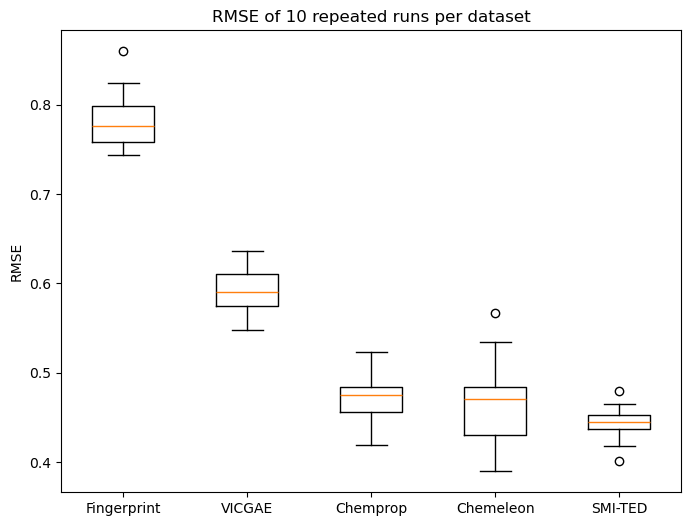

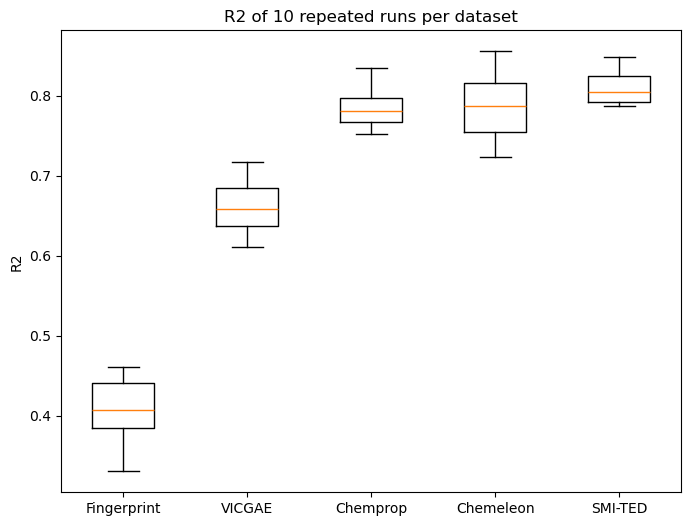

In [5]:
# List of datasets
datasets = {
    "Fingerprint": df01,
    "VICGAE": df11,
    "Chemprop": df21,
    "Chemeleon": df31,
    "SMI-TED": df41
}

n_runs = 10  # number of repetitions 
base_seed = 12345  
seed_sequence = np.random.RandomState(base_seed).randint(0, 2**32-1, size=10)


# Dictionary to store RMSE and R2 for each dataset
rmse_results = {name: [] for name in datasets.keys()}
r2_results = {name: [] for name in datasets.keys()}

# Run each dataset multiple times
for name, df in datasets.items():
    for seed in seed_sequence:
        rmse, r2 = run_NN(df, seed=seed)  # random each run
        rmse_results[name].append(rmse)
        r2_results[name].append(r2)

# Plot RMSE boxplot
plt.figure(figsize=(8,6))
plt.boxplot([rmse_results[name] for name in datasets.keys()],
            labels=datasets.keys())
plt.ylabel("RMSE")
plt.title(f"RMSE of {n_runs} repeated runs per dataset")
plt.show()

# Optional: plot R2 boxplot
plt.figure(figsize=(8,6))
plt.boxplot([r2_results[name] for name in datasets.keys()],
            labels=datasets.keys())
plt.ylabel("R2")
plt.title(f"R2 of {n_runs} repeated runs per dataset")
plt.show()

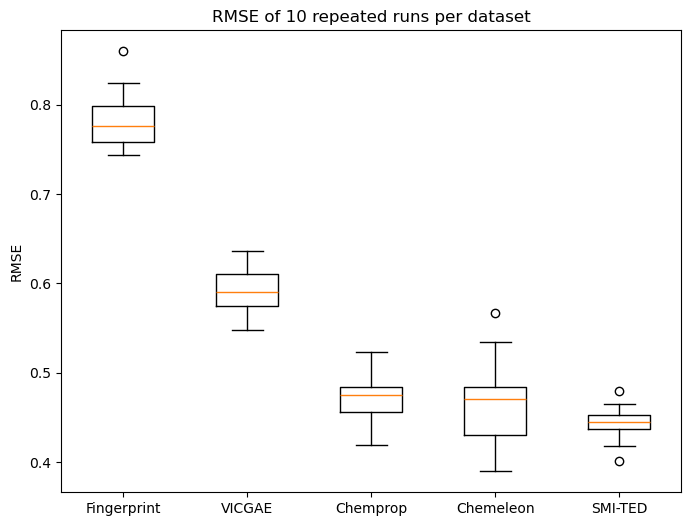

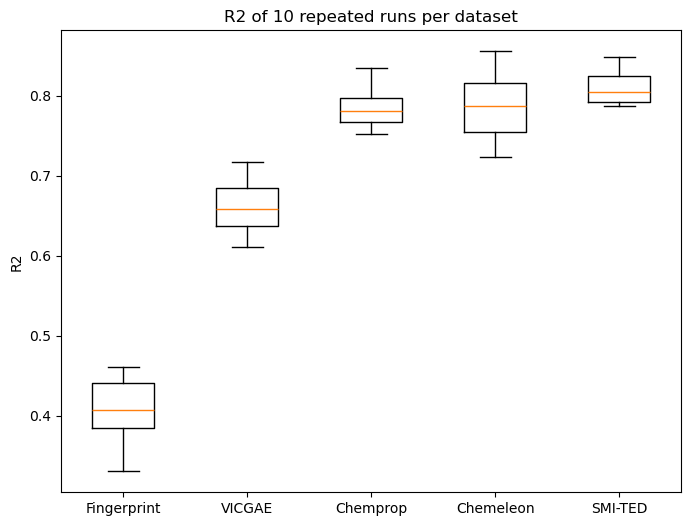

In [6]:
# Plot RMSE boxplot
plt.figure(figsize=(8,6))
plt.boxplot([rmse_results[name] for name in datasets.keys()],
            labels=datasets.keys())
plt.ylabel("RMSE")
plt.title(f"RMSE of {n_runs} repeated runs per dataset")
plt.show()

# Optional: plot R2 boxplot
plt.figure(figsize=(8,6))
plt.boxplot([r2_results[name] for name in datasets.keys()],
            labels=datasets.keys())
plt.ylabel("R2")
plt.title(f"R2 of {n_runs} repeated runs per dataset")
plt.show()

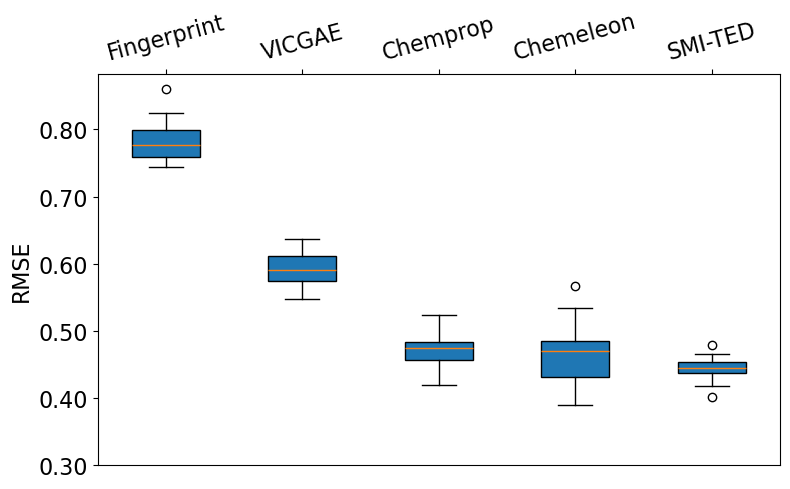

In [15]:
import matplotlib.ticker as ticker

plt.figure(figsize=(8,5))
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

plt.boxplot([rmse_results[name] for name in datasets.keys()],
            labels=datasets.keys(), patch_artist=True,)

plt.ylabel('RMSE', fontsize=16)
# plt.xticks(fontsize=16, rotation=15)
plt.yticks(fontsize=16)
plt.xticks(ticks=range(1, len(datasets) + 1),  fontsize=16, rotation=15)
# plt.title(f"RMSE of {n_runs} repeated runs per dataset")
plt.ylim(bottom=0.3)                  # set minimum y-limit
plt.tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False)
plt.xticks(fontsize=16, rotation=15)

plt.tight_layout()

# Save at 600 dpi
plt.savefig("../results/surfactants_model_performance_NN.png", dpi=600, bbox_inches="tight")
plt.show()

In [16]:
results_to_save = {
    'rmse': rmse_results,
    'r2': r2_results
}

filename = 'surfactants_NN_results.joblib'

joblib.dump(results_to_save, filename)

['surfactants_NN_results.joblib']

In [20]:
80*5/60

6.666666666666667

### Run new functions

In [6]:
%%time
# List of datasets
datasets = {
    "Fingerprint": df01,
    "VICGAE": df11,
    "Chemprop": df21,
    "Chemeleon": df31,
    "SMI-TED": df41
}

n_runs = 10  # number of repetitions 
base_seed = 12345  
seed_sequence = np.random.RandomState(base_seed).randint(0, 2**32-1, size=10)


# Dictionary to store RMSE and R2 for each dataset
rmse_results = {name: [] for name in datasets.keys()}
r2_results = {name: [] for name in datasets.keys()}
y_pred_results = {name: [] for name in datasets.keys()}
y_true_results = {name: [] for name in datasets.keys()}

# Run each dataset multiple times
for name, df in datasets.items():
    for seed in seed_sequence:
        rmse, r2, y_pred, y_true= run_NN_update(df, seed=seed, save_dir=f'../../results/NN_surfactant_{name}')  # random each run
        rmse_results[name].append(rmse)
        r2_results[name].append(r2)
        y_pred_results[name].append(y_pred)
        y_true_results[name].append(y_true)
# 13 h 15 min to run

[I 2025-10-06 23:10:49,230] A new study created in memory with name: no-name-167a1955-56ca-49a6-8f9d-fbbc2ce69284


Epoch 1/30, Train Loss: 1.0202, Val RMSE: 0.8851
Epoch 2/30, Train Loss: 0.8118, Val RMSE: 0.8518
Epoch 3/30, Train Loss: 0.7169, Val RMSE: 0.8544
Epoch 4/30, Train Loss: 0.6881, Val RMSE: 0.8220
Epoch 5/30, Train Loss: 0.6436, Val RMSE: 0.8175
Epoch 6/30, Train Loss: 0.6573, Val RMSE: 0.8099
Epoch 7/30, Train Loss: 0.5768, Val RMSE: 0.8145
Epoch 8/30, Train Loss: 0.5796, Val RMSE: 0.7889
Epoch 9/30, Train Loss: 0.5722, Val RMSE: 0.8015
Epoch 10/30, Train Loss: 0.5185, Val RMSE: 0.8197
Epoch 11/30, Train Loss: 0.5366, Val RMSE: 0.8049
Epoch 12/30, Train Loss: 0.5514, Val RMSE: 0.8075
Epoch 13/30, Train Loss: 0.5142, Val RMSE: 0.8185
Epoch 14/30, Train Loss: 0.4940, Val RMSE: 0.8277
Epoch 15/30, Train Loss: 0.5136, Val RMSE: 0.8004
Epoch 16/30, Train Loss: 0.4843, Val RMSE: 0.7911
Epoch 17/30, Train Loss: 0.4842, Val RMSE: 0.7883
Epoch 18/30, Train Loss: 0.4748, Val RMSE: 0.7962
Epoch 19/30, Train Loss: 0.4762, Val RMSE: 0.8067
Epoch 20/30, Train Loss: 0.4718, Val RMSE: 0.7931
Epoch 21/

[I 2025-10-06 23:11:39,485] Trial 0 finished with value: 0.6525384783744812 and parameters: {'n_layers': 3, 'n_units_l0': 832, 'n_units_l1': 400, 'n_units_l2': 128, 'dropout': 0.3555247505330102, 'lr': 0.0004481423398873494, 'batch_size': 32}. Best is trial 0 with value: 0.6525384783744812.


Epoch 30/30, Train Loss: 0.4442, Val RMSE: 0.8078
Epoch 1/30, Train Loss: 1.3007, Val RMSE: 0.9339
Epoch 2/30, Train Loss: 1.0939, Val RMSE: 0.9106
Epoch 3/30, Train Loss: 1.0056, Val RMSE: 0.8779
Epoch 4/30, Train Loss: 0.9250, Val RMSE: 0.8598
Epoch 5/30, Train Loss: 0.9365, Val RMSE: 0.8518
Epoch 6/30, Train Loss: 0.9373, Val RMSE: 0.8495
Epoch 7/30, Train Loss: 0.9051, Val RMSE: 0.8466
Epoch 8/30, Train Loss: 0.8490, Val RMSE: 0.8335
Epoch 9/30, Train Loss: 0.7785, Val RMSE: 0.8270
Epoch 10/30, Train Loss: 0.7842, Val RMSE: 0.8222
Epoch 11/30, Train Loss: 0.7795, Val RMSE: 0.8292
Epoch 12/30, Train Loss: 0.7798, Val RMSE: 0.8141
Epoch 13/30, Train Loss: 0.7327, Val RMSE: 0.8116
Epoch 14/30, Train Loss: 0.7087, Val RMSE: 0.8132
Epoch 15/30, Train Loss: 0.7338, Val RMSE: 0.8113
Epoch 16/30, Train Loss: 0.7054, Val RMSE: 0.8073
Epoch 17/30, Train Loss: 0.6714, Val RMSE: 0.8077
Epoch 18/30, Train Loss: 0.6485, Val RMSE: 0.7898
Epoch 19/30, Train Loss: 0.6610, Val RMSE: 0.7948
Epoch 20/

[I 2025-10-06 23:12:18,894] Trial 1 finished with value: 0.6217585802078247 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 256, 'n_units_l2': 192, 'dropout': 0.5524927995279523, 'lr': 0.00021429642706225193, 'batch_size': 32}. Best is trial 1 with value: 0.6217585802078247.


Epoch 30/30, Train Loss: 0.5628, Val RMSE: 0.7885
Epoch 1/30, Train Loss: 1.1759, Val RMSE: 0.9062
Epoch 2/30, Train Loss: 0.8043, Val RMSE: 0.8492
Epoch 3/30, Train Loss: 0.6814, Val RMSE: 0.8176
Epoch 4/30, Train Loss: 0.5954, Val RMSE: 0.8394
Epoch 5/30, Train Loss: 0.6082, Val RMSE: 0.8176
Epoch 6/30, Train Loss: 0.5835, Val RMSE: 0.8334
Epoch 7/30, Train Loss: 0.5382, Val RMSE: 0.8021
Epoch 8/30, Train Loss: 0.5520, Val RMSE: 0.8149
Epoch 9/30, Train Loss: 0.5202, Val RMSE: 0.8051
Epoch 10/30, Train Loss: 0.5242, Val RMSE: 0.8244
Epoch 11/30, Train Loss: 0.5078, Val RMSE: 0.7961
Epoch 12/30, Train Loss: 0.5037, Val RMSE: 0.7861
Epoch 13/30, Train Loss: 0.5141, Val RMSE: 0.7994
Epoch 14/30, Train Loss: 0.4714, Val RMSE: 0.7871
Epoch 15/30, Train Loss: 0.4705, Val RMSE: 0.7943
Epoch 16/30, Train Loss: 0.4815, Val RMSE: 0.7919
Epoch 17/30, Train Loss: 0.4462, Val RMSE: 0.8094
Epoch 18/30, Train Loss: 0.4581, Val RMSE: 0.7954
Epoch 19/30, Train Loss: 0.4548, Val RMSE: 0.7909
Epoch 20/

[I 2025-10-06 23:12:39,862] Trial 2 finished with value: 0.648138165473938 and parameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 272, 'dropout': 0.3410689700207209, 'lr': 0.001566877172090443, 'batch_size': 64}. Best is trial 1 with value: 0.6217585802078247.


Epoch 30/30, Train Loss: 0.3994, Val RMSE: 0.8051
Epoch 1/30, Train Loss: 3.0669, Val RMSE: 1.1204
Epoch 2/30, Train Loss: 1.0187, Val RMSE: 0.9692
Epoch 3/30, Train Loss: 0.7871, Val RMSE: 0.8679
Epoch 4/30, Train Loss: 0.6839, Val RMSE: 0.8549
Epoch 5/30, Train Loss: 0.6083, Val RMSE: 0.8466
Epoch 6/30, Train Loss: 0.5687, Val RMSE: 0.8263
Epoch 7/30, Train Loss: 0.5628, Val RMSE: 0.8185
Epoch 8/30, Train Loss: 0.4993, Val RMSE: 0.7989
Epoch 9/30, Train Loss: 0.4885, Val RMSE: 0.8039
Epoch 10/30, Train Loss: 0.4777, Val RMSE: 0.8145
Epoch 11/30, Train Loss: 0.4933, Val RMSE: 0.8151
Epoch 12/30, Train Loss: 0.4740, Val RMSE: 0.8341
Epoch 13/30, Train Loss: 0.4820, Val RMSE: 0.7916
Epoch 14/30, Train Loss: 0.4661, Val RMSE: 0.8098
Epoch 15/30, Train Loss: 0.4534, Val RMSE: 0.8529
Epoch 16/30, Train Loss: 0.4865, Val RMSE: 0.8009
Epoch 17/30, Train Loss: 0.4532, Val RMSE: 0.7896
Epoch 18/30, Train Loss: 0.4279, Val RMSE: 0.8012
Epoch 19/30, Train Loss: 0.4318, Val RMSE: 0.8126
Epoch 20/

[I 2025-10-06 23:12:49,208] Trial 3 finished with value: 0.6283041834831238 and parameters: {'n_layers': 1, 'n_units_l0': 768, 'dropout': 0.24934654055175806, 'lr': 0.004792204705660918, 'batch_size': 128}. Best is trial 1 with value: 0.6217585802078247.


Epoch 30/30, Train Loss: 0.4192, Val RMSE: 0.7927
Epoch 1/30, Train Loss: 3.5686, Val RMSE: 1.1234
Epoch 2/30, Train Loss: 0.8736, Val RMSE: 0.8940
Epoch 3/30, Train Loss: 0.7217, Val RMSE: 0.8621
Epoch 4/30, Train Loss: 0.6348, Val RMSE: 0.8216
Epoch 5/30, Train Loss: 0.5895, Val RMSE: 0.8275
Epoch 6/30, Train Loss: 0.5673, Val RMSE: 0.8328
Epoch 7/30, Train Loss: 0.5405, Val RMSE: 0.8156
Epoch 8/30, Train Loss: 0.5171, Val RMSE: 0.8116
Epoch 9/30, Train Loss: 0.5074, Val RMSE: 0.7925
Epoch 10/30, Train Loss: 0.4963, Val RMSE: 0.7986
Epoch 11/30, Train Loss: 0.4746, Val RMSE: 0.8049
Epoch 12/30, Train Loss: 0.4763, Val RMSE: 0.7978
Epoch 13/30, Train Loss: 0.4681, Val RMSE: 0.7966
Epoch 14/30, Train Loss: 0.4330, Val RMSE: 0.7932
Epoch 15/30, Train Loss: 0.4440, Val RMSE: 0.8152
Epoch 16/30, Train Loss: 0.4433, Val RMSE: 0.7927
Epoch 17/30, Train Loss: 0.4254, Val RMSE: 0.7934
Epoch 18/30, Train Loss: 0.4197, Val RMSE: 0.7930
Epoch 19/30, Train Loss: 0.4334, Val RMSE: 0.7961
Epoch 20/

[I 2025-10-06 23:12:59,267] Trial 4 finished with value: 0.6217342019081116 and parameters: {'n_layers': 1, 'n_units_l0': 704, 'dropout': 0.2641008551581286, 'lr': 0.0023550394138391597, 'batch_size': 128}. Best is trial 4 with value: 0.6217342019081116.


Epoch 30/30, Train Loss: 0.3804, Val RMSE: 0.7885
Epoch 1/30, Train Loss: 1.0757, Val RMSE: 0.8800
Epoch 2/30, Train Loss: 0.8626, Val RMSE: 0.8315
Epoch 3/30, Train Loss: 0.8472, Val RMSE: 0.8213
Epoch 4/30, Train Loss: 0.7914, Val RMSE: 0.8228
Epoch 5/30, Train Loss: 0.7054, Val RMSE: 0.8260
Epoch 6/30, Train Loss: 0.7101, Val RMSE: 0.8057
Epoch 7/30, Train Loss: 0.6951, Val RMSE: 0.7914
Epoch 8/30, Train Loss: 0.6710, Val RMSE: 0.7980
Epoch 9/30, Train Loss: 0.6408, Val RMSE: 0.7984
Epoch 10/30, Train Loss: 0.6657, Val RMSE: 0.7887
Epoch 11/30, Train Loss: 0.6050, Val RMSE: 0.7893
Epoch 12/30, Train Loss: 0.6355, Val RMSE: 0.8036
Epoch 13/30, Train Loss: 0.5981, Val RMSE: 0.7990
Epoch 14/30, Train Loss: 0.5652, Val RMSE: 0.8150
Epoch 15/30, Train Loss: 0.5944, Val RMSE: 0.8145
Epoch 16/30, Train Loss: 0.5897, Val RMSE: 0.8044
Epoch 17/30, Train Loss: 0.5773, Val RMSE: 0.8012
Epoch 18/30, Train Loss: 0.5168, Val RMSE: 0.7929
Epoch 19/30, Train Loss: 0.5524, Val RMSE: 0.7945
Epoch 20/

[I 2025-10-06 23:13:40,183] Trial 5 finished with value: 0.6382743716239929 and parameters: {'n_layers': 3, 'n_units_l0': 576, 'n_units_l1': 272, 'n_units_l2': 128, 'dropout': 0.38821932791910235, 'lr': 0.00020199113733591697, 'batch_size': 32}. Best is trial 4 with value: 0.6217342019081116.


Epoch 30/30, Train Loss: 0.4980, Val RMSE: 0.7989
Early stopping triggered.
Epoch 1/30, Train Loss: 1.1099, Val RMSE: 0.9206
Epoch 2/30, Train Loss: 0.8990, Val RMSE: 0.8843
Epoch 3/30, Train Loss: 0.7665, Val RMSE: 0.8676
Epoch 4/30, Train Loss: 0.6557, Val RMSE: 0.8276
Epoch 5/30, Train Loss: 0.6509, Val RMSE: 0.8488
Epoch 6/30, Train Loss: 0.6222, Val RMSE: 0.8172
Epoch 7/30, Train Loss: 0.6046, Val RMSE: 0.8192
Epoch 8/30, Train Loss: 0.5730, Val RMSE: 0.8050
Epoch 9/30, Train Loss: 0.5746, Val RMSE: 0.8173
Epoch 10/30, Train Loss: 0.5203, Val RMSE: 0.8063
Epoch 11/30, Train Loss: 0.5190, Val RMSE: 0.8012
Epoch 12/30, Train Loss: 0.5066, Val RMSE: 0.8002
Epoch 13/30, Train Loss: 0.4954, Val RMSE: 0.8002
Epoch 14/30, Train Loss: 0.4823, Val RMSE: 0.8007
Epoch 15/30, Train Loss: 0.4754, Val RMSE: 0.8231
Epoch 16/30, Train Loss: 0.4937, Val RMSE: 0.8072
Epoch 17/30, Train Loss: 0.4583, Val RMSE: 0.8242
Epoch 18/30, Train Loss: 0.4715, Val RMSE: 0.8043
Epoch 19/30, Train Loss: 0.4465, 

[I 2025-10-06 23:13:55,492] Trial 6 finished with value: 0.6423804759979248 and parameters: {'n_layers': 2, 'n_units_l0': 640, 'n_units_l1': 288, 'dropout': 0.4425293079588724, 'lr': 0.0009530076288448359, 'batch_size': 128}. Best is trial 4 with value: 0.6217342019081116.


Epoch 30/30, Train Loss: 0.4249, Val RMSE: 0.8015
Epoch 1/30, Train Loss: 0.9936, Val RMSE: 0.8544
Epoch 2/30, Train Loss: 0.6789, Val RMSE: 0.8284
Epoch 3/30, Train Loss: 0.6174, Val RMSE: 0.8517
Epoch 4/30, Train Loss: 0.5907, Val RMSE: 0.8200
Epoch 5/30, Train Loss: 0.5756, Val RMSE: 0.8012
Epoch 6/30, Train Loss: 0.5620, Val RMSE: 0.8059
Epoch 7/30, Train Loss: 0.5518, Val RMSE: 0.8114
Epoch 8/30, Train Loss: 0.5258, Val RMSE: 0.8059
Epoch 9/30, Train Loss: 0.4948, Val RMSE: 0.8096
Epoch 10/30, Train Loss: 0.4999, Val RMSE: 0.8001
Epoch 11/30, Train Loss: 0.4956, Val RMSE: 0.8033
Epoch 12/30, Train Loss: 0.4741, Val RMSE: 0.8004
Epoch 13/30, Train Loss: 0.4457, Val RMSE: 0.8086
Epoch 14/30, Train Loss: 0.4958, Val RMSE: 0.8001
Epoch 15/30, Train Loss: 0.4799, Val RMSE: 0.8170
Epoch 16/30, Train Loss: 0.4559, Val RMSE: 0.7963
Epoch 17/30, Train Loss: 0.4448, Val RMSE: 0.8149
Epoch 18/30, Train Loss: 0.4771, Val RMSE: 0.7989
Epoch 19/30, Train Loss: 0.4594, Val RMSE: 0.8119
Epoch 20/

[I 2025-10-06 23:14:13,154] Trial 7 finished with value: 0.633983314037323 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 192, 'dropout': 0.2788379740286905, 'lr': 0.00034788250544656594, 'batch_size': 64}. Best is trial 4 with value: 0.6217342019081116.


Epoch 30/30, Train Loss: 0.3964, Val RMSE: 0.7962
Epoch 1/30, Train Loss: 1.1606, Val RMSE: 0.9601
Epoch 2/30, Train Loss: 0.8176, Val RMSE: 0.8846
Epoch 3/30, Train Loss: 0.7272, Val RMSE: 0.8386
Epoch 4/30, Train Loss: 0.6550, Val RMSE: 0.8136
Epoch 5/30, Train Loss: 0.6654, Val RMSE: 0.8261
Epoch 6/30, Train Loss: 0.6362, Val RMSE: 0.8455
Epoch 7/30, Train Loss: 0.5958, Val RMSE: 0.7913
Epoch 8/30, Train Loss: 0.5987, Val RMSE: 0.8036
Epoch 9/30, Train Loss: 0.5566, Val RMSE: 0.8035
Epoch 10/30, Train Loss: 0.5915, Val RMSE: 0.8295
Epoch 11/30, Train Loss: 0.5510, Val RMSE: 0.7977
Epoch 12/30, Train Loss: 0.5491, Val RMSE: 0.8105
Epoch 13/30, Train Loss: 0.5416, Val RMSE: 0.7964
Epoch 14/30, Train Loss: 0.4862, Val RMSE: 0.7907
Epoch 15/30, Train Loss: 0.5221, Val RMSE: 0.7882
Epoch 16/30, Train Loss: 0.5234, Val RMSE: 0.7848
Epoch 17/30, Train Loss: 0.4812, Val RMSE: 0.7962
Epoch 18/30, Train Loss: 0.4968, Val RMSE: 0.8075
Epoch 19/30, Train Loss: 0.5070, Val RMSE: 0.7973
Epoch 20/

[I 2025-10-06 23:14:47,009] Trial 8 finished with value: 0.6267140507698059 and parameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 208, 'dropout': 0.5295822706679263, 'lr': 0.002952082186645699, 'batch_size': 32}. Best is trial 4 with value: 0.6217342019081116.


Epoch 30/30, Train Loss: 0.4199, Val RMSE: 0.7917
Epoch 1/30, Train Loss: 0.9732, Val RMSE: 0.8882
Epoch 2/30, Train Loss: 0.6953, Val RMSE: 0.8612
Epoch 3/30, Train Loss: 0.6625, Val RMSE: 0.8430
Epoch 4/30, Train Loss: 0.6382, Val RMSE: 0.8234
Epoch 5/30, Train Loss: 0.6022, Val RMSE: 0.8227
Epoch 6/30, Train Loss: 0.5694, Val RMSE: 0.8077
Epoch 7/30, Train Loss: 0.5438, Val RMSE: 0.8246
Epoch 8/30, Train Loss: 0.5293, Val RMSE: 0.8261
Epoch 9/30, Train Loss: 0.5147, Val RMSE: 0.7692
Epoch 10/30, Train Loss: 0.4874, Val RMSE: 0.7975
Epoch 11/30, Train Loss: 0.5116, Val RMSE: 0.8006
Epoch 12/30, Train Loss: 0.4923, Val RMSE: 0.8231
Epoch 13/30, Train Loss: 0.4663, Val RMSE: 0.8195
Epoch 14/30, Train Loss: 0.4809, Val RMSE: 0.8092
Epoch 15/30, Train Loss: 0.4931, Val RMSE: 0.8004
Epoch 16/30, Train Loss: 0.4413, Val RMSE: 0.7896
Epoch 17/30, Train Loss: 0.4338, Val RMSE: 0.8124
Epoch 18/30, Train Loss: 0.4289, Val RMSE: 0.7900
Epoch 19/30, Train Loss: 0.4378, Val RMSE: 0.7918
Epoch 20/

[I 2025-10-06 23:15:22,533] Trial 9 finished with value: 0.626419723033905 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 176, 'dropout': 0.22489064919716162, 'lr': 0.0007959997688283051, 'batch_size': 32}. Best is trial 4 with value: 0.6217342019081116.


Epoch 29/30, Train Loss: 0.3975, Val RMSE: 0.7915
Early stopping triggered.
Epoch 1/30, Train Loss: 3.7469, Val RMSE: 1.6725
Epoch 2/30, Train Loss: 1.2475, Val RMSE: 1.0260
Epoch 3/30, Train Loss: 0.8689, Val RMSE: 0.9884
Epoch 4/30, Train Loss: 0.8358, Val RMSE: 0.9208
Epoch 5/30, Train Loss: 0.7376, Val RMSE: 0.8537
Epoch 6/30, Train Loss: 0.6773, Val RMSE: 0.8532
Epoch 7/30, Train Loss: 0.6438, Val RMSE: 0.8550
Epoch 8/30, Train Loss: 0.6256, Val RMSE: 0.8631
Epoch 9/30, Train Loss: 0.6740, Val RMSE: 0.8780
Epoch 10/30, Train Loss: 0.6443, Val RMSE: 0.9013
Epoch 11/30, Train Loss: 0.6424, Val RMSE: 0.8194
Epoch 12/30, Train Loss: 0.6015, Val RMSE: 0.8051
Epoch 13/30, Train Loss: 0.5600, Val RMSE: 0.8432
Epoch 14/30, Train Loss: 0.5842, Val RMSE: 0.9551
Epoch 15/30, Train Loss: 0.6084, Val RMSE: 0.7961
Epoch 16/30, Train Loss: 0.6030, Val RMSE: 0.8112
Epoch 17/30, Train Loss: 0.5415, Val RMSE: 0.8061
Epoch 18/30, Train Loss: 0.5157, Val RMSE: 0.8072
Epoch 19/30, Train Loss: 0.5152, 

[I 2025-10-06 23:15:33,006] Trial 10 finished with value: 0.6204230785369873 and parameters: {'n_layers': 1, 'n_units_l0': 1024, 'dropout': 0.4531297726571024, 'lr': 0.007880209526109391, 'batch_size': 128}. Best is trial 10 with value: 0.6204230785369873.


Epoch 30/30, Train Loss: 0.4494, Val RMSE: 0.7877
Epoch 1/30, Train Loss: 6.4121, Val RMSE: 2.4987
Epoch 2/30, Train Loss: 1.8427, Val RMSE: 1.1364
Epoch 3/30, Train Loss: 1.1868, Val RMSE: 0.9837
Epoch 4/30, Train Loss: 0.9206, Val RMSE: 0.9120
Epoch 5/30, Train Loss: 0.7664, Val RMSE: 0.8527
Epoch 6/30, Train Loss: 0.6682, Val RMSE: 0.8571
Epoch 7/30, Train Loss: 0.6654, Val RMSE: 0.8295
Epoch 8/30, Train Loss: 0.6509, Val RMSE: 0.8202
Epoch 9/30, Train Loss: 0.5923, Val RMSE: 0.8065
Epoch 10/30, Train Loss: 0.5357, Val RMSE: 0.8416
Epoch 11/30, Train Loss: 0.5732, Val RMSE: 0.8134
Epoch 12/30, Train Loss: 0.5564, Val RMSE: 0.8157
Epoch 13/30, Train Loss: 0.5317, Val RMSE: 0.8394
Epoch 14/30, Train Loss: 0.5734, Val RMSE: 0.8112
Epoch 15/30, Train Loss: 0.5755, Val RMSE: 0.8938
Epoch 16/30, Train Loss: 0.5799, Val RMSE: 0.8261
Epoch 17/30, Train Loss: 0.5296, Val RMSE: 0.7937
Epoch 18/30, Train Loss: 0.5033, Val RMSE: 0.8154
Epoch 19/30, Train Loss: 0.5162, Val RMSE: 0.8185
Epoch 20/

[I 2025-10-06 23:15:43,673] Trial 11 finished with value: 0.6208521127700806 and parameters: {'n_layers': 1, 'n_units_l0': 1024, 'dropout': 0.4696410167106522, 'lr': 0.00988096852550909, 'batch_size': 128}. Best is trial 10 with value: 0.6204230785369873.


Epoch 30/30, Train Loss: 0.4368, Val RMSE: 0.7879
Epoch 1/30, Train Loss: 6.5937, Val RMSE: 2.8937
Epoch 2/30, Train Loss: 1.7111, Val RMSE: 1.1800
Epoch 3/30, Train Loss: 1.0535, Val RMSE: 0.8777
Epoch 4/30, Train Loss: 0.8404, Val RMSE: 0.8493
Epoch 5/30, Train Loss: 0.7112, Val RMSE: 0.8623
Epoch 6/30, Train Loss: 0.6283, Val RMSE: 0.8271
Epoch 7/30, Train Loss: 0.6029, Val RMSE: 0.8620
Epoch 8/30, Train Loss: 0.5817, Val RMSE: 0.8071
Epoch 9/30, Train Loss: 0.5836, Val RMSE: 0.8141
Epoch 10/30, Train Loss: 0.5538, Val RMSE: 0.8760
Epoch 11/30, Train Loss: 0.5538, Val RMSE: 0.8300
Epoch 12/30, Train Loss: 0.5435, Val RMSE: 0.8330
Epoch 13/30, Train Loss: 0.5468, Val RMSE: 0.8104
Epoch 14/30, Train Loss: 0.5610, Val RMSE: 0.8181
Epoch 15/30, Train Loss: 0.5188, Val RMSE: 0.8048
Epoch 16/30, Train Loss: 0.4673, Val RMSE: 0.8022
Epoch 17/30, Train Loss: 0.4723, Val RMSE: 0.7957
Epoch 18/30, Train Loss: 0.4662, Val RMSE: 0.7915
Epoch 19/30, Train Loss: 0.4734, Val RMSE: 0.7793
Epoch 20/

[I 2025-10-06 23:15:53,913] Trial 12 finished with value: 0.6337044835090637 and parameters: {'n_layers': 1, 'n_units_l0': 1024, 'dropout': 0.46197604259191694, 'lr': 0.009079600638850462, 'batch_size': 128}. Best is trial 10 with value: 0.6204230785369873.


Epoch 30/30, Train Loss: 0.4281, Val RMSE: 0.7961
Epoch 1/30, Train Loss: 4.8252, Val RMSE: 2.5010
Epoch 2/30, Train Loss: 1.6892, Val RMSE: 1.1186
Epoch 3/30, Train Loss: 1.0046, Val RMSE: 0.9058
Epoch 4/30, Train Loss: 0.7348, Val RMSE: 0.8719
Epoch 5/30, Train Loss: 0.6570, Val RMSE: 0.8492
Epoch 6/30, Train Loss: 0.6326, Val RMSE: 0.8019
Epoch 7/30, Train Loss: 0.6201, Val RMSE: 0.8037
Epoch 8/30, Train Loss: 0.6086, Val RMSE: 0.8056
Epoch 9/30, Train Loss: 0.5384, Val RMSE: 0.8076
Epoch 10/30, Train Loss: 0.5428, Val RMSE: 0.8120
Epoch 11/30, Train Loss: 0.5583, Val RMSE: 0.8062
Epoch 12/30, Train Loss: 0.5550, Val RMSE: 0.7991
Epoch 13/30, Train Loss: 0.5545, Val RMSE: 0.8125
Epoch 14/30, Train Loss: 0.6029, Val RMSE: 0.8417
Epoch 15/30, Train Loss: 0.5565, Val RMSE: 0.8241
Epoch 16/30, Train Loss: 0.5655, Val RMSE: 0.7989
Epoch 17/30, Train Loss: 0.5153, Val RMSE: 0.8615
Epoch 18/30, Train Loss: 0.5581, Val RMSE: 0.8509
Epoch 19/30, Train Loss: 0.5482, Val RMSE: 0.8096
Epoch 20/

[I 2025-10-06 23:16:05,051] Trial 13 finished with value: 0.6383123993873596 and parameters: {'n_layers': 1, 'n_units_l0': 1024, 'dropout': 0.483869167367801, 'lr': 0.0098581520817696, 'batch_size': 128}. Best is trial 10 with value: 0.6204230785369873.


Epoch 30/30, Train Loss: 0.4661, Val RMSE: 0.7989
Epoch 1/30, Train Loss: 2.3560, Val RMSE: 1.1188
Epoch 2/30, Train Loss: 1.1049, Val RMSE: 0.9642
Epoch 3/30, Train Loss: 0.8602, Val RMSE: 0.8792
Epoch 4/30, Train Loss: 0.7433, Val RMSE: 0.8574
Epoch 5/30, Train Loss: 0.7216, Val RMSE: 0.8528
Epoch 6/30, Train Loss: 0.6775, Val RMSE: 0.8322
Epoch 7/30, Train Loss: 0.6706, Val RMSE: 0.8318
Epoch 8/30, Train Loss: 0.6080, Val RMSE: 0.8371
Epoch 9/30, Train Loss: 0.7019, Val RMSE: 0.8051
Epoch 10/30, Train Loss: 0.6482, Val RMSE: 0.8094
Epoch 11/30, Train Loss: 0.6196, Val RMSE: 0.8066
Epoch 12/30, Train Loss: 0.5861, Val RMSE: 0.8264
Epoch 13/30, Train Loss: 0.5522, Val RMSE: 0.8503
Epoch 14/30, Train Loss: 0.5776, Val RMSE: 0.8062
Epoch 15/30, Train Loss: 0.5552, Val RMSE: 0.8269
Epoch 16/30, Train Loss: 0.5186, Val RMSE: 0.8102
Epoch 17/30, Train Loss: 0.5045, Val RMSE: 0.7943
Epoch 18/30, Train Loss: 0.5001, Val RMSE: 0.8063
Epoch 19/30, Train Loss: 0.5034, Val RMSE: 0.7984
Epoch 20/

[I 2025-10-06 23:16:15,913] Trial 14 finished with value: 0.6429648995399475 and parameters: {'n_layers': 1, 'n_units_l0': 896, 'dropout': 0.5803388203776648, 'lr': 0.004873093286106739, 'batch_size': 128}. Best is trial 10 with value: 0.6204230785369873.


Epoch 30/30, Train Loss: 0.4563, Val RMSE: 0.8019
Epoch 1/30, Train Loss: 2.6693, Val RMSE: 1.2298
Epoch 2/30, Train Loss: 1.0630, Val RMSE: 0.9713
Epoch 3/30, Train Loss: 0.8409, Val RMSE: 0.9080
Epoch 4/30, Train Loss: 0.7755, Val RMSE: 0.8412
Epoch 5/30, Train Loss: 0.6839, Val RMSE: 0.8822
Epoch 6/30, Train Loss: 0.6633, Val RMSE: 0.8410
Epoch 7/30, Train Loss: 0.6691, Val RMSE: 0.8375
Epoch 8/30, Train Loss: 0.6470, Val RMSE: 0.8578
Epoch 9/30, Train Loss: 0.6243, Val RMSE: 0.8081
Epoch 10/30, Train Loss: 0.5726, Val RMSE: 0.8127
Epoch 11/30, Train Loss: 0.5490, Val RMSE: 0.8063
Epoch 12/30, Train Loss: 0.5767, Val RMSE: 0.7998
Epoch 13/30, Train Loss: 0.5274, Val RMSE: 0.7982
Epoch 14/30, Train Loss: 0.5380, Val RMSE: 0.8192
Epoch 15/30, Train Loss: 0.5411, Val RMSE: 0.8010
Epoch 16/30, Train Loss: 0.4945, Val RMSE: 0.7989
Epoch 17/30, Train Loss: 0.5300, Val RMSE: 0.8396
Epoch 18/30, Train Loss: 0.5359, Val RMSE: 0.8179
Epoch 19/30, Train Loss: 0.5623, Val RMSE: 0.8468
Epoch 20/

[I 2025-10-06 23:16:26,333] Trial 15 finished with value: 0.6328427195549011 and parameters: {'n_layers': 1, 'n_units_l0': 960, 'dropout': 0.5034805711080992, 'lr': 0.004791591403527619, 'batch_size': 128}. Best is trial 10 with value: 0.6204230785369873.


Epoch 30/30, Train Loss: 0.4383, Val RMSE: 0.7955
Epoch 1/30, Train Loss: 3.9803, Val RMSE: 1.4977
Epoch 2/30, Train Loss: 1.2068, Val RMSE: 1.0434
Epoch 3/30, Train Loss: 0.8597, Val RMSE: 0.9420
Epoch 4/30, Train Loss: 0.7247, Val RMSE: 0.8621
Epoch 5/30, Train Loss: 0.6779, Val RMSE: 0.8757
Epoch 6/30, Train Loss: 0.6281, Val RMSE: 0.8416
Epoch 7/30, Train Loss: 0.6012, Val RMSE: 0.8571
Epoch 8/30, Train Loss: 0.5889, Val RMSE: 0.8333
Epoch 9/30, Train Loss: 0.5868, Val RMSE: 0.8236
Epoch 10/30, Train Loss: 0.5242, Val RMSE: 0.8413
Epoch 11/30, Train Loss: 0.5389, Val RMSE: 0.8317
Epoch 12/30, Train Loss: 0.5603, Val RMSE: 0.8155
Epoch 13/30, Train Loss: 0.5324, Val RMSE: 0.7974
Epoch 14/30, Train Loss: 0.5323, Val RMSE: 0.8320
Epoch 15/30, Train Loss: 0.5371, Val RMSE: 0.8064
Epoch 16/30, Train Loss: 0.5413, Val RMSE: 0.8093
Epoch 17/30, Train Loss: 0.4884, Val RMSE: 0.8027
Epoch 18/30, Train Loss: 0.4973, Val RMSE: 0.8211
Epoch 19/30, Train Loss: 0.5028, Val RMSE: 0.8025
Epoch 20/

[I 2025-10-06 23:16:36,532] Trial 16 finished with value: 0.643273115158081 and parameters: {'n_layers': 1, 'n_units_l0': 896, 'dropout': 0.4367150759139839, 'lr': 0.006721592358067265, 'batch_size': 128}. Best is trial 10 with value: 0.6204230785369873.


Epoch 30/30, Train Loss: 0.4237, Val RMSE: 0.8020
Epoch 1/30, Train Loss: 1.8670, Val RMSE: 0.9508
Epoch 2/30, Train Loss: 0.7821, Val RMSE: 0.8905
Epoch 3/30, Train Loss: 0.6944, Val RMSE: 0.8297
Epoch 4/30, Train Loss: 0.6126, Val RMSE: 0.8299
Epoch 5/30, Train Loss: 0.5869, Val RMSE: 0.8607
Epoch 6/30, Train Loss: 0.5676, Val RMSE: 0.8696
Epoch 7/30, Train Loss: 0.5606, Val RMSE: 0.7992
Epoch 8/30, Train Loss: 0.5407, Val RMSE: 0.8230
Epoch 9/30, Train Loss: 0.5594, Val RMSE: 0.8063
Epoch 10/30, Train Loss: 0.5542, Val RMSE: 0.8153
Epoch 11/30, Train Loss: 0.5885, Val RMSE: 0.8301
Epoch 12/30, Train Loss: 0.5159, Val RMSE: 0.8067
Epoch 13/30, Train Loss: 0.5362, Val RMSE: 0.8346
Epoch 14/30, Train Loss: 0.4720, Val RMSE: 0.8011
Epoch 15/30, Train Loss: 0.4721, Val RMSE: 0.8159
Epoch 16/30, Train Loss: 0.4945, Val RMSE: 0.7884
Epoch 17/30, Train Loss: 0.4692, Val RMSE: 0.7844
Epoch 18/30, Train Loss: 0.4546, Val RMSE: 0.8367
Epoch 19/30, Train Loss: 0.4625, Val RMSE: 0.8078
Epoch 20/

[I 2025-10-06 23:16:55,887] Trial 17 finished with value: 0.6377971172332764 and parameters: {'n_layers': 1, 'n_units_l0': 960, 'dropout': 0.40283760502174076, 'lr': 0.0024673496749619663, 'batch_size': 64}. Best is trial 10 with value: 0.6204230785369873.


Epoch 30/30, Train Loss: 0.4502, Val RMSE: 0.7986
Epoch 1/30, Train Loss: 1.4348, Val RMSE: 1.2648
Epoch 2/30, Train Loss: 1.0909, Val RMSE: 0.9452
Epoch 3/30, Train Loss: 0.9095, Val RMSE: 0.9592
Epoch 4/30, Train Loss: 0.8090, Val RMSE: 0.8353
Epoch 5/30, Train Loss: 0.7306, Val RMSE: 0.8076
Epoch 6/30, Train Loss: 0.6662, Val RMSE: 0.8214
Epoch 7/30, Train Loss: 0.6531, Val RMSE: 0.8123
Epoch 8/30, Train Loss: 0.5990, Val RMSE: 0.8128
Epoch 9/30, Train Loss: 0.5822, Val RMSE: 0.8083
Epoch 10/30, Train Loss: 0.5686, Val RMSE: 0.8078
Epoch 11/30, Train Loss: 0.5245, Val RMSE: 0.8023
Epoch 12/30, Train Loss: 0.5155, Val RMSE: 0.7968
Epoch 13/30, Train Loss: 0.5444, Val RMSE: 0.8122
Epoch 14/30, Train Loss: 0.5231, Val RMSE: 0.7901
Epoch 15/30, Train Loss: 0.5365, Val RMSE: 0.8062
Epoch 16/30, Train Loss: 0.5216, Val RMSE: 0.8094
Epoch 17/30, Train Loss: 0.5132, Val RMSE: 0.8250
Epoch 18/30, Train Loss: 0.5319, Val RMSE: 0.8067
Epoch 19/30, Train Loss: 0.5192, Val RMSE: 0.7985
Epoch 20/

[I 2025-10-06 23:17:11,916] Trial 18 finished with value: 0.6360592842102051 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 512, 'dropout': 0.5940908615689066, 'lr': 0.0016318957473097906, 'batch_size': 128}. Best is trial 10 with value: 0.6204230785369873.


Epoch 30/30, Train Loss: 0.4285, Val RMSE: 0.7975
Epoch 1/30, Train Loss: 0.9419, Val RMSE: 0.8809
Epoch 2/30, Train Loss: 0.7193, Val RMSE: 0.8444
Epoch 3/30, Train Loss: 0.6347, Val RMSE: 0.8483
Epoch 4/30, Train Loss: 0.6287, Val RMSE: 0.8346
Epoch 5/30, Train Loss: 0.5857, Val RMSE: 0.8360
Epoch 6/30, Train Loss: 0.5615, Val RMSE: 0.8090
Epoch 7/30, Train Loss: 0.5227, Val RMSE: 0.8237
Epoch 8/30, Train Loss: 0.5073, Val RMSE: 0.8048
Epoch 9/30, Train Loss: 0.4949, Val RMSE: 0.8129
Epoch 10/30, Train Loss: 0.4977, Val RMSE: 0.8010
Epoch 11/30, Train Loss: 0.4861, Val RMSE: 0.8138
Epoch 12/30, Train Loss: 0.4829, Val RMSE: 0.8086
Epoch 13/30, Train Loss: 0.4948, Val RMSE: 0.8185
Epoch 14/30, Train Loss: 0.4646, Val RMSE: 0.8085
Epoch 15/30, Train Loss: 0.4748, Val RMSE: 0.8054
Epoch 16/30, Train Loss: 0.4633, Val RMSE: 0.7949
Epoch 17/30, Train Loss: 0.4562, Val RMSE: 0.8121
Epoch 18/30, Train Loss: 0.4304, Val RMSE: 0.7987
Epoch 19/30, Train Loss: 0.4567, Val RMSE: 0.8204
Epoch 20/

[I 2025-10-06 23:17:22,043] Trial 19 finished with value: 0.6377912163734436 and parameters: {'n_layers': 1, 'n_units_l0': 896, 'dropout': 0.3363979109625088, 'lr': 0.00010358068404461488, 'batch_size': 128}. Best is trial 10 with value: 0.6204230785369873.


Epoch 30/30, Train Loss: 0.4209, Val RMSE: 0.7986
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 1024, 'dropout': 0.4531297726571024, 'lr': 0.007880209526109391, 'batch_size': 128}
Best MSE: 0.6204230785369873
Epoch 1/300, Train Loss: 5.7792, Val RMSE: 1.6745
Epoch 2/300, Train Loss: 1.4533, Val RMSE: 1.1339
Epoch 3/300, Train Loss: 1.0541, Val RMSE: 1.0149
Epoch 4/300, Train Loss: 0.8841, Val RMSE: 0.9031
Epoch 5/300, Train Loss: 0.7089, Val RMSE: 0.8457
Epoch 6/300, Train Loss: 0.6358, Val RMSE: 0.8365
Epoch 7/300, Train Loss: 0.5751, Val RMSE: 0.8151
Epoch 8/300, Train Loss: 0.6079, Val RMSE: 0.8066
Epoch 9/300, Train Loss: 0.5562, Val RMSE: 0.8095
Epoch 10/300, Train Loss: 0.5303, Val RMSE: 0.8292
Epoch 11/300, Train Loss: 0.5381, Val RMSE: 0.8445
Epoch 12/300, Train Loss: 0.5844, Val RMSE: 0.8174
Epoch 13/300, Train Loss: 0.5345, Val RMSE: 0.8436
Epoch 14/300, Train Loss: 0.5028, Val RMSE: 0.7970
Epoch 15/300, Train Loss: 0.5348, Val RMSE: 0.8535
Epoch 16/300, Train Loss: 0.5

[I 2025-10-06 23:17:40,865] A new study created in memory with name: no-name-48cd95b3-bd82-45ac-97cc-344516a639c9


Epoch 52/300, Train Loss: 0.3864, Val RMSE: 0.7928
Early stopping triggered.
Final Test MSE: 0.6285, R2: 0.3777
Predictions saved to ../../results/NN_surfactant_Fingerprint/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Fingerprint/best_hyperparameters.json
Epoch 1/30, Train Loss: 1.5646, Val RMSE: 0.8954
Epoch 2/30, Train Loss: 0.6777, Val RMSE: 0.8190
Epoch 3/30, Train Loss: 0.6085, Val RMSE: 0.8364
Epoch 4/30, Train Loss: 0.6316, Val RMSE: 0.7967
Epoch 5/30, Train Loss: 0.5456, Val RMSE: 0.7877
Epoch 6/30, Train Loss: 0.5434, Val RMSE: 0.8631
Epoch 7/30, Train Loss: 0.5610, Val RMSE: 0.8295
Epoch 8/30, Train Loss: 0.5392, Val RMSE: 0.7721
Epoch 9/30, Train Loss: 0.5194, Val RMSE: 0.8189
Epoch 10/30, Train Loss: 0.5522, Val RMSE: 0.7820
Epoch 11/30, Train Loss: 0.4993, Val RMSE: 0.7969
Epoch 12/30, Train Loss: 0.4991, Val RMSE: 0.7851
Epoch 13/30, Train Loss: 0.5306, Val RMSE: 0.8219
Epoch 14/30, Train Loss: 0.5062, Val RMSE: 0.7945
Epoch 15/30, Train Loss:

[I 2025-10-06 23:18:10,825] Trial 0 finished with value: 0.612106204032898 and parameters: {'n_layers': 1, 'n_units_l0': 896, 'dropout': 0.20151427037527087, 'lr': 0.001320039573206015, 'batch_size': 32}. Best is trial 0 with value: 0.612106204032898.


Epoch 30/30, Train Loss: 0.3971, Val RMSE: 0.7824
Epoch 1/30, Train Loss: 1.3969, Val RMSE: 0.9036
Epoch 2/30, Train Loss: 0.8822, Val RMSE: 0.8659
Epoch 3/30, Train Loss: 0.6967, Val RMSE: 0.8100
Epoch 4/30, Train Loss: 0.5971, Val RMSE: 0.8105
Epoch 5/30, Train Loss: 0.6037, Val RMSE: 0.7862
Epoch 6/30, Train Loss: 0.5427, Val RMSE: 0.7818
Epoch 7/30, Train Loss: 0.5131, Val RMSE: 0.7701
Epoch 8/30, Train Loss: 0.5221, Val RMSE: 0.7677
Epoch 9/30, Train Loss: 0.5216, Val RMSE: 0.7712
Epoch 10/30, Train Loss: 0.5275, Val RMSE: 0.7759
Epoch 11/30, Train Loss: 0.4907, Val RMSE: 0.7774
Epoch 12/30, Train Loss: 0.4668, Val RMSE: 0.7836
Epoch 13/30, Train Loss: 0.4868, Val RMSE: 0.7862
Epoch 14/30, Train Loss: 0.4769, Val RMSE: 0.7761
Epoch 15/30, Train Loss: 0.4721, Val RMSE: 0.7744
Epoch 16/30, Train Loss: 0.4682, Val RMSE: 0.7730
Epoch 17/30, Train Loss: 0.4500, Val RMSE: 0.7838
Epoch 18/30, Train Loss: 0.4497, Val RMSE: 0.7843
Epoch 19/30, Train Loss: 0.4601, Val RMSE: 0.7775
Epoch 20/

[I 2025-10-06 23:18:19,568] Trial 1 finished with value: 0.6040231585502625 and parameters: {'n_layers': 1, 'n_units_l0': 960, 'dropout': 0.45261243590689604, 'lr': 0.00048081251309938617, 'batch_size': 128}. Best is trial 1 with value: 0.6040231585502625.


Epoch 28/30, Train Loss: 0.4257, Val RMSE: 0.7772
Early stopping triggered.
Epoch 1/30, Train Loss: 1.2683, Val RMSE: 0.9572
Epoch 2/30, Train Loss: 0.8325, Val RMSE: 0.8481
Epoch 3/30, Train Loss: 0.7077, Val RMSE: 0.7986
Epoch 4/30, Train Loss: 0.6400, Val RMSE: 0.8032
Epoch 5/30, Train Loss: 0.6251, Val RMSE: 0.7867
Epoch 6/30, Train Loss: 0.6114, Val RMSE: 0.7726
Epoch 7/30, Train Loss: 0.5830, Val RMSE: 0.7849
Epoch 8/30, Train Loss: 0.5381, Val RMSE: 0.7790
Epoch 9/30, Train Loss: 0.5232, Val RMSE: 0.7634
Epoch 10/30, Train Loss: 0.5612, Val RMSE: 0.7832
Epoch 11/30, Train Loss: 0.5312, Val RMSE: 0.7959
Epoch 12/30, Train Loss: 0.5415, Val RMSE: 0.8006
Epoch 13/30, Train Loss: 0.5282, Val RMSE: 0.7916
Epoch 14/30, Train Loss: 0.5224, Val RMSE: 0.7861
Epoch 15/30, Train Loss: 0.4861, Val RMSE: 0.7793
Epoch 16/30, Train Loss: 0.4951, Val RMSE: 0.7748
Epoch 17/30, Train Loss: 0.4652, Val RMSE: 0.7630
Epoch 18/30, Train Loss: 0.4758, Val RMSE: 0.7728
Epoch 19/30, Train Loss: 0.4823, 

[I 2025-10-06 23:18:38,772] Trial 2 finished with value: 0.5979978442192078 and parameters: {'n_layers': 1, 'n_units_l0': 896, 'dropout': 0.43147843958192755, 'lr': 0.00022966628894481174, 'batch_size': 64}. Best is trial 2 with value: 0.5979978442192078.


Epoch 30/30, Train Loss: 0.4427, Val RMSE: 0.7733
Epoch 1/30, Train Loss: 1.9780, Val RMSE: 1.0584
Epoch 2/30, Train Loss: 0.8373, Val RMSE: 0.8647
Epoch 3/30, Train Loss: 0.6707, Val RMSE: 0.7971
Epoch 4/30, Train Loss: 0.6038, Val RMSE: 0.7941
Epoch 5/30, Train Loss: 0.5856, Val RMSE: 0.8001
Epoch 6/30, Train Loss: 0.5858, Val RMSE: 0.7876
Epoch 7/30, Train Loss: 0.5751, Val RMSE: 0.8042
Epoch 8/30, Train Loss: 0.5359, Val RMSE: 0.7867
Epoch 9/30, Train Loss: 0.5125, Val RMSE: 0.7718
Epoch 10/30, Train Loss: 0.5124, Val RMSE: 0.7684
Epoch 11/30, Train Loss: 0.5017, Val RMSE: 0.7926
Epoch 12/30, Train Loss: 0.5092, Val RMSE: 0.7782
Epoch 13/30, Train Loss: 0.5015, Val RMSE: 0.7805
Epoch 14/30, Train Loss: 0.4640, Val RMSE: 0.7732
Epoch 15/30, Train Loss: 0.4932, Val RMSE: 0.7788
Epoch 16/30, Train Loss: 0.4801, Val RMSE: 0.7868
Epoch 17/30, Train Loss: 0.4433, Val RMSE: 0.7806
Epoch 18/30, Train Loss: 0.4454, Val RMSE: 0.7891
Epoch 19/30, Train Loss: 0.4510, Val RMSE: 0.7850
Epoch 20/

[I 2025-10-06 23:18:48,327] Trial 3 finished with value: 0.6090109348297119 and parameters: {'n_layers': 1, 'n_units_l0': 768, 'dropout': 0.4396548066902097, 'lr': 0.0009998443607872724, 'batch_size': 128}. Best is trial 2 with value: 0.5979978442192078.


Epoch 30/30, Train Loss: 0.4228, Val RMSE: 0.7804
Early stopping triggered.
Epoch 1/30, Train Loss: 1.0156, Val RMSE: 0.9573
Epoch 2/30, Train Loss: 0.7901, Val RMSE: 0.8438
Epoch 3/30, Train Loss: 0.6521, Val RMSE: 0.7914
Epoch 4/30, Train Loss: 0.5976, Val RMSE: 0.7902
Epoch 5/30, Train Loss: 0.5646, Val RMSE: 0.7879
Epoch 6/30, Train Loss: 0.5584, Val RMSE: 0.7800
Epoch 7/30, Train Loss: 0.5213, Val RMSE: 0.7698
Epoch 8/30, Train Loss: 0.4877, Val RMSE: 0.7887
Epoch 9/30, Train Loss: 0.5431, Val RMSE: 0.7762
Epoch 10/30, Train Loss: 0.5027, Val RMSE: 0.7922
Epoch 11/30, Train Loss: 0.5067, Val RMSE: 0.7724
Epoch 12/30, Train Loss: 0.5201, Val RMSE: 0.7628
Epoch 13/30, Train Loss: 0.4914, Val RMSE: 0.7620
Epoch 14/30, Train Loss: 0.4774, Val RMSE: 0.7950
Epoch 15/30, Train Loss: 0.5197, Val RMSE: 0.7846
Epoch 16/30, Train Loss: 0.5189, Val RMSE: 0.7740
Epoch 17/30, Train Loss: 0.4603, Val RMSE: 0.7701
Epoch 18/30, Train Loss: 0.4661, Val RMSE: 0.7908
Epoch 19/30, Train Loss: 0.4520, 

[I 2025-10-06 23:19:21,840] Trial 4 finished with value: 0.605288028717041 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'n_units_l1': 384, 'n_units_l2': 128, 'dropout': 0.3205647978390516, 'lr': 0.002430590604654915, 'batch_size': 64}. Best is trial 2 with value: 0.5979978442192078.


Epoch 30/30, Train Loss: 0.4177, Val RMSE: 0.7780
Epoch 1/30, Train Loss: 0.9612, Val RMSE: 0.8859
Epoch 2/30, Train Loss: 0.7730, Val RMSE: 0.8586
Epoch 3/30, Train Loss: 0.6909, Val RMSE: 0.7948
Epoch 4/30, Train Loss: 0.6595, Val RMSE: 0.8355
Epoch 5/30, Train Loss: 0.6060, Val RMSE: 0.7762
Epoch 6/30, Train Loss: 0.5561, Val RMSE: 0.7926
Epoch 7/30, Train Loss: 0.5531, Val RMSE: 0.7685
Epoch 8/30, Train Loss: 0.5389, Val RMSE: 0.7758
Epoch 9/30, Train Loss: 0.5293, Val RMSE: 0.7841
Epoch 10/30, Train Loss: 0.5561, Val RMSE: 0.7782
Epoch 11/30, Train Loss: 0.5258, Val RMSE: 0.7917
Epoch 12/30, Train Loss: 0.5348, Val RMSE: 0.7837
Epoch 13/30, Train Loss: 0.5294, Val RMSE: 0.7964
Epoch 14/30, Train Loss: 0.4774, Val RMSE: 0.7803
Epoch 15/30, Train Loss: 0.4360, Val RMSE: 0.7779
Epoch 16/30, Train Loss: 0.4595, Val RMSE: 0.7885
Epoch 17/30, Train Loss: 0.4794, Val RMSE: 0.7829
Epoch 18/30, Train Loss: 0.4485, Val RMSE: 0.7720
Epoch 19/30, Train Loss: 0.4653, Val RMSE: 0.7765
Epoch 20/

[I 2025-10-06 23:19:43,705] Trial 5 finished with value: 0.6114989519119263 and parameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 224, 'dropout': 0.33766890767672664, 'lr': 0.0007082033711500302, 'batch_size': 64}. Best is trial 2 with value: 0.5979978442192078.


Epoch 27/30, Train Loss: 0.4180, Val RMSE: 0.7820
Early stopping triggered.
Epoch 1/30, Train Loss: 1.0137, Val RMSE: 0.9008
Epoch 2/30, Train Loss: 0.8269, Val RMSE: 0.8271
Epoch 3/30, Train Loss: 0.7367, Val RMSE: 0.8224
Epoch 4/30, Train Loss: 0.6763, Val RMSE: 0.8096
Epoch 5/30, Train Loss: 0.6184, Val RMSE: 0.8028
Epoch 6/30, Train Loss: 0.6267, Val RMSE: 0.7874
Epoch 7/30, Train Loss: 0.5396, Val RMSE: 0.7728
Epoch 8/30, Train Loss: 0.5666, Val RMSE: 0.7893
Epoch 9/30, Train Loss: 0.5668, Val RMSE: 0.7961
Epoch 10/30, Train Loss: 0.5519, Val RMSE: 0.8169
Epoch 11/30, Train Loss: 0.5396, Val RMSE: 0.8007
Epoch 12/30, Train Loss: 0.5055, Val RMSE: 0.7738
Epoch 13/30, Train Loss: 0.5338, Val RMSE: 0.7735
Epoch 14/30, Train Loss: 0.5009, Val RMSE: 0.7734
Epoch 15/30, Train Loss: 0.4957, Val RMSE: 0.7708
Epoch 16/30, Train Loss: 0.4699, Val RMSE: 0.7642
Epoch 17/30, Train Loss: 0.4773, Val RMSE: 0.7667
Epoch 18/30, Train Loss: 0.4854, Val RMSE: 0.7699
Epoch 19/30, Train Loss: 0.4751, 

[I 2025-10-06 23:20:26,706] Trial 6 finished with value: 0.6073058247566223 and parameters: {'n_layers': 3, 'n_units_l0': 704, 'n_units_l1': 304, 'n_units_l2': 192, 'dropout': 0.3718940061066486, 'lr': 0.0017023620220629732, 'batch_size': 32}. Best is trial 2 with value: 0.5979978442192078.


Epoch 30/30, Train Loss: 0.4567, Val RMSE: 0.7793
Epoch 1/30, Train Loss: 0.9939, Val RMSE: 0.8870
Epoch 2/30, Train Loss: 0.7785, Val RMSE: 0.8524
Epoch 3/30, Train Loss: 0.7115, Val RMSE: 0.8037
Epoch 4/30, Train Loss: 0.6484, Val RMSE: 0.8197
Epoch 5/30, Train Loss: 0.6466, Val RMSE: 0.8078
Epoch 6/30, Train Loss: 0.5632, Val RMSE: 0.7950
Epoch 7/30, Train Loss: 0.6053, Val RMSE: 0.7955
Epoch 8/30, Train Loss: 0.5334, Val RMSE: 0.7857
Epoch 9/30, Train Loss: 0.5191, Val RMSE: 0.7738
Epoch 10/30, Train Loss: 0.5166, Val RMSE: 0.7969
Epoch 11/30, Train Loss: 0.5029, Val RMSE: 0.7709
Epoch 12/30, Train Loss: 0.4941, Val RMSE: 0.7736
Epoch 13/30, Train Loss: 0.5026, Val RMSE: 0.7685
Epoch 14/30, Train Loss: 0.5219, Val RMSE: 0.7799
Epoch 15/30, Train Loss: 0.4610, Val RMSE: 0.7636
Epoch 16/30, Train Loss: 0.4657, Val RMSE: 0.7876
Epoch 17/30, Train Loss: 0.4590, Val RMSE: 0.8058
Epoch 18/30, Train Loss: 0.4742, Val RMSE: 0.7846
Epoch 19/30, Train Loss: 0.4675, Val RMSE: 0.7750
Epoch 20/

[I 2025-10-06 23:20:43,236] Trial 7 finished with value: 0.6119962334632874 and parameters: {'n_layers': 3, 'n_units_l0': 704, 'n_units_l1': 304, 'n_units_l2': 128, 'dropout': 0.2793854896930331, 'lr': 0.001044671952773825, 'batch_size': 128}. Best is trial 2 with value: 0.5979978442192078.


Epoch 30/30, Train Loss: 0.4180, Val RMSE: 0.7823
Epoch 1/30, Train Loss: 1.7402, Val RMSE: 1.0935
Epoch 2/30, Train Loss: 0.9165, Val RMSE: 0.8306
Epoch 3/30, Train Loss: 0.7024, Val RMSE: 0.7889
Epoch 4/30, Train Loss: 0.7125, Val RMSE: 0.8210
Epoch 5/30, Train Loss: 0.6861, Val RMSE: 0.7830
Epoch 6/30, Train Loss: 0.5858, Val RMSE: 0.7996
Epoch 7/30, Train Loss: 0.5972, Val RMSE: 0.7740
Epoch 8/30, Train Loss: 0.5836, Val RMSE: 0.7824
Epoch 9/30, Train Loss: 0.5374, Val RMSE: 0.7908
Epoch 10/30, Train Loss: 0.5136, Val RMSE: 0.7705
Epoch 11/30, Train Loss: 0.5223, Val RMSE: 0.7941
Epoch 12/30, Train Loss: 0.5340, Val RMSE: 0.7825
Epoch 13/30, Train Loss: 0.5475, Val RMSE: 0.7822
Epoch 14/30, Train Loss: 0.5131, Val RMSE: 0.7764
Epoch 15/30, Train Loss: 0.4778, Val RMSE: 0.7764
Epoch 16/30, Train Loss: 0.4990, Val RMSE: 0.7662
Epoch 17/30, Train Loss: 0.5022, Val RMSE: 0.7589
Epoch 18/30, Train Loss: 0.4962, Val RMSE: 0.7792
Epoch 19/30, Train Loss: 0.5077, Val RMSE: 0.7767
Epoch 20/

[I 2025-10-06 23:21:01,076] Trial 8 finished with value: 0.588106095790863 and parameters: {'n_layers': 1, 'n_units_l0': 960, 'dropout': 0.5461797063624675, 'lr': 0.0007907767464334856, 'batch_size': 64}. Best is trial 8 with value: 0.588106095790863.


Epoch 30/30, Train Loss: 0.4423, Val RMSE: 0.7669
Epoch 1/30, Train Loss: 1.4983, Val RMSE: 0.8878
Epoch 2/30, Train Loss: 0.8103, Val RMSE: 0.8330
Epoch 3/30, Train Loss: 0.7074, Val RMSE: 0.8295
Epoch 4/30, Train Loss: 0.6281, Val RMSE: 0.7831
Epoch 5/30, Train Loss: 0.6258, Val RMSE: 0.7857
Epoch 6/30, Train Loss: 0.6273, Val RMSE: 0.7900
Epoch 7/30, Train Loss: 0.5933, Val RMSE: 0.7823
Epoch 8/30, Train Loss: 0.5718, Val RMSE: 0.7799
Epoch 9/30, Train Loss: 0.6017, Val RMSE: 0.7857
Epoch 10/30, Train Loss: 0.5773, Val RMSE: 0.7856
Epoch 11/30, Train Loss: 0.5311, Val RMSE: 0.7898
Epoch 12/30, Train Loss: 0.5306, Val RMSE: 0.8101
Epoch 13/30, Train Loss: 0.5398, Val RMSE: 0.7970
Epoch 14/30, Train Loss: 0.5354, Val RMSE: 0.7800
Epoch 15/30, Train Loss: 0.4961, Val RMSE: 0.7887
Epoch 16/30, Train Loss: 0.4832, Val RMSE: 0.7682
Epoch 17/30, Train Loss: 0.4907, Val RMSE: 0.7721
Epoch 18/30, Train Loss: 0.4834, Val RMSE: 0.7686
Epoch 19/30, Train Loss: 0.4844, Val RMSE: 0.7760
Epoch 20/

[I 2025-10-06 23:21:29,853] Trial 9 finished with value: 0.5970709323883057 and parameters: {'n_layers': 1, 'n_units_l0': 896, 'dropout': 0.5172645966025738, 'lr': 0.0004093645384930132, 'batch_size': 32}. Best is trial 8 with value: 0.588106095790863.


Epoch 30/30, Train Loss: 0.4562, Val RMSE: 0.7727
Epoch 1/30, Train Loss: 1.1991, Val RMSE: 0.9311
Epoch 2/30, Train Loss: 1.1055, Val RMSE: 0.8736
Epoch 3/30, Train Loss: 0.9765, Val RMSE: 0.8560
Epoch 4/30, Train Loss: 0.9252, Val RMSE: 0.8420
Epoch 5/30, Train Loss: 0.9089, Val RMSE: 0.8230
Epoch 6/30, Train Loss: 0.8389, Val RMSE: 0.8109
Epoch 7/30, Train Loss: 0.8780, Val RMSE: 0.8013
Epoch 8/30, Train Loss: 0.8015, Val RMSE: 0.7970
Epoch 9/30, Train Loss: 0.8132, Val RMSE: 0.7919
Epoch 10/30, Train Loss: 0.8617, Val RMSE: 0.7908
Epoch 11/30, Train Loss: 0.7831, Val RMSE: 0.7858
Epoch 12/30, Train Loss: 0.7499, Val RMSE: 0.7950
Epoch 13/30, Train Loss: 0.7339, Val RMSE: 0.7908
Epoch 14/30, Train Loss: 0.7295, Val RMSE: 0.7960
Epoch 15/30, Train Loss: 0.7103, Val RMSE: 0.7958
Epoch 16/30, Train Loss: 0.7625, Val RMSE: 0.7947
Epoch 17/30, Train Loss: 0.7475, Val RMSE: 0.7914
Epoch 18/30, Train Loss: 0.6754, Val RMSE: 0.7873
Epoch 19/30, Train Loss: 0.6876, Val RMSE: 0.7870
Epoch 20/

[I 2025-10-06 23:21:51,970] Trial 10 finished with value: 0.5998567342758179 and parameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 144, 'dropout': 0.5842832071383057, 'lr': 0.0001115741557447716, 'batch_size': 64}. Best is trial 8 with value: 0.588106095790863.


Epoch 30/30, Train Loss: 0.6448, Val RMSE: 0.7745
Epoch 1/30, Train Loss: 1.1908, Val RMSE: 0.8614
Epoch 2/30, Train Loss: 0.9998, Val RMSE: 0.8498
Epoch 3/30, Train Loss: 0.8512, Val RMSE: 0.8377
Epoch 4/30, Train Loss: 0.8349, Val RMSE: 0.7856
Epoch 5/30, Train Loss: 0.7840, Val RMSE: 0.8313
Epoch 6/30, Train Loss: 0.7553, Val RMSE: 0.7887
Epoch 7/30, Train Loss: 0.7068, Val RMSE: 0.7826
Epoch 8/30, Train Loss: 0.7022, Val RMSE: 0.7789
Epoch 9/30, Train Loss: 0.6846, Val RMSE: 0.7740
Epoch 10/30, Train Loss: 0.6222, Val RMSE: 0.7842
Epoch 11/30, Train Loss: 0.6566, Val RMSE: 0.7770
Epoch 12/30, Train Loss: 0.6526, Val RMSE: 0.7792
Epoch 13/30, Train Loss: 0.6346, Val RMSE: 0.7686
Epoch 14/30, Train Loss: 0.5786, Val RMSE: 0.7844
Epoch 15/30, Train Loss: 0.5712, Val RMSE: 0.7851
Epoch 16/30, Train Loss: 0.5732, Val RMSE: 0.7848
Epoch 17/30, Train Loss: 0.5496, Val RMSE: 0.7765
Epoch 18/30, Train Loss: 0.5586, Val RMSE: 0.7773
Epoch 19/30, Train Loss: 0.5561, Val RMSE: 0.7712
Epoch 20/

[I 2025-10-06 23:22:36,711] Trial 11 finished with value: 0.5890955328941345 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 512, 'dropout': 0.553405002608434, 'lr': 0.00029483391769440277, 'batch_size': 32}. Best is trial 8 with value: 0.588106095790863.


Epoch 30/30, Train Loss: 0.4870, Val RMSE: 0.7675
Epoch 1/30, Train Loss: 1.3810, Val RMSE: 0.9688
Epoch 2/30, Train Loss: 0.9584, Val RMSE: 0.9387
Epoch 3/30, Train Loss: 0.8807, Val RMSE: 0.8268
Epoch 4/30, Train Loss: 0.8003, Val RMSE: 0.8017
Epoch 5/30, Train Loss: 0.7603, Val RMSE: 0.8228
Epoch 6/30, Train Loss: 0.7598, Val RMSE: 0.8401
Epoch 7/30, Train Loss: 0.7156, Val RMSE: 0.8414
Epoch 8/30, Train Loss: 0.7023, Val RMSE: 0.8033
Epoch 9/30, Train Loss: 0.7576, Val RMSE: 0.8468
Epoch 10/30, Train Loss: 0.7087, Val RMSE: 0.7810
Epoch 11/30, Train Loss: 0.6430, Val RMSE: 0.8611
Epoch 12/30, Train Loss: 0.6801, Val RMSE: 0.8154
Epoch 13/30, Train Loss: 0.6370, Val RMSE: 0.8306
Epoch 14/30, Train Loss: 0.6207, Val RMSE: 0.7853
Epoch 15/30, Train Loss: 0.6253, Val RMSE: 0.8146
Epoch 16/30, Train Loss: 0.5980, Val RMSE: 0.7666
Epoch 17/30, Train Loss: 0.5927, Val RMSE: 0.7901
Epoch 18/30, Train Loss: 0.5834, Val RMSE: 0.7738
Epoch 19/30, Train Loss: 0.5621, Val RMSE: 0.7900
Epoch 20/

[I 2025-10-06 23:23:21,988] Trial 12 finished with value: 0.5964973568916321 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 512, 'dropout': 0.5997213811236384, 'lr': 0.004151969314269963, 'batch_size': 32}. Best is trial 8 with value: 0.588106095790863.


Epoch 30/30, Train Loss: 0.4933, Val RMSE: 0.7723
Epoch 1/30, Train Loss: 1.0989, Val RMSE: 0.9060
Epoch 2/30, Train Loss: 0.9080, Val RMSE: 0.8004
Epoch 3/30, Train Loss: 0.8069, Val RMSE: 0.8044
Epoch 4/30, Train Loss: 0.8172, Val RMSE: 0.8144
Epoch 5/30, Train Loss: 0.7529, Val RMSE: 0.7983
Epoch 6/30, Train Loss: 0.7302, Val RMSE: 0.7904
Epoch 7/30, Train Loss: 0.7115, Val RMSE: 0.8007
Epoch 8/30, Train Loss: 0.7186, Val RMSE: 0.7971
Epoch 9/30, Train Loss: 0.6531, Val RMSE: 0.7747
Epoch 10/30, Train Loss: 0.6395, Val RMSE: 0.7801
Epoch 11/30, Train Loss: 0.6340, Val RMSE: 0.7990
Epoch 12/30, Train Loss: 0.6018, Val RMSE: 0.7768
Epoch 13/30, Train Loss: 0.6215, Val RMSE: 0.7973
Epoch 14/30, Train Loss: 0.6353, Val RMSE: 0.7886
Epoch 15/30, Train Loss: 0.5866, Val RMSE: 0.7824
Epoch 16/30, Train Loss: 0.5719, Val RMSE: 0.7783
Epoch 17/30, Train Loss: 0.5946, Val RMSE: 0.7808
Epoch 18/30, Train Loss: 0.5461, Val RMSE: 0.7675
Epoch 19/30, Train Loss: 0.5967, Val RMSE: 0.7637
Epoch 20/

[I 2025-10-06 23:24:09,201] Trial 13 finished with value: 0.6198892593383789 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 512, 'dropout': 0.5160575664626904, 'lr': 0.0002083993251739791, 'batch_size': 32}. Best is trial 8 with value: 0.588106095790863.


Epoch 30/30, Train Loss: 0.4983, Val RMSE: 0.7873
Epoch 1/30, Train Loss: 1.0914, Val RMSE: 0.9138
Epoch 2/30, Train Loss: 0.8674, Val RMSE: 0.8554
Epoch 3/30, Train Loss: 0.7493, Val RMSE: 0.8461
Epoch 4/30, Train Loss: 0.6958, Val RMSE: 0.8068
Epoch 5/30, Train Loss: 0.6332, Val RMSE: 0.7852
Epoch 6/30, Train Loss: 0.6585, Val RMSE: 0.8046
Epoch 7/30, Train Loss: 0.6248, Val RMSE: 0.7874
Epoch 8/30, Train Loss: 0.6153, Val RMSE: 0.7696
Epoch 9/30, Train Loss: 0.5860, Val RMSE: 0.7843
Epoch 10/30, Train Loss: 0.5935, Val RMSE: 0.7939
Epoch 11/30, Train Loss: 0.5882, Val RMSE: 0.8185
Epoch 12/30, Train Loss: 0.5880, Val RMSE: 0.7692
Epoch 13/30, Train Loss: 0.5409, Val RMSE: 0.8000
Epoch 14/30, Train Loss: 0.5575, Val RMSE: 0.7772
Epoch 15/30, Train Loss: 0.5528, Val RMSE: 0.7777
Epoch 16/30, Train Loss: 0.5741, Val RMSE: 0.7720
Epoch 17/30, Train Loss: 0.5229, Val RMSE: 0.7693
Epoch 18/30, Train Loss: 0.5231, Val RMSE: 0.7820
Epoch 19/30, Train Loss: 0.5106, Val RMSE: 0.7823
Epoch 20/

[I 2025-10-06 23:24:27,421] Trial 14 finished with value: 0.5885928869247437 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 128, 'dropout': 0.527252350967843, 'lr': 0.007064493715533792, 'batch_size': 64}. Best is trial 8 with value: 0.588106095790863.


Epoch 30/30, Train Loss: 0.4540, Val RMSE: 0.7672
Epoch 1/30, Train Loss: 1.6906, Val RMSE: 1.0336
Epoch 2/30, Train Loss: 0.9617, Val RMSE: 0.9083
Epoch 3/30, Train Loss: 0.8356, Val RMSE: 0.8934
Epoch 4/30, Train Loss: 0.7668, Val RMSE: 0.8246
Epoch 5/30, Train Loss: 0.7435, Val RMSE: 0.7935
Epoch 6/30, Train Loss: 0.6845, Val RMSE: 0.7984
Epoch 7/30, Train Loss: 0.6675, Val RMSE: 0.7895
Epoch 8/30, Train Loss: 0.6166, Val RMSE: 0.8568
Epoch 9/30, Train Loss: 0.6255, Val RMSE: 0.7957
Epoch 10/30, Train Loss: 0.6218, Val RMSE: 0.8530
Epoch 11/30, Train Loss: 0.5925, Val RMSE: 0.7924
Epoch 12/30, Train Loss: 0.6391, Val RMSE: 0.8403
Epoch 13/30, Train Loss: 0.6026, Val RMSE: 0.7919
Epoch 14/30, Train Loss: 0.5332, Val RMSE: 0.7672
Epoch 15/30, Train Loss: 0.5523, Val RMSE: 0.7729
Epoch 16/30, Train Loss: 0.5131, Val RMSE: 0.7904
Epoch 17/30, Train Loss: 0.5133, Val RMSE: 0.7744
Epoch 18/30, Train Loss: 0.4946, Val RMSE: 0.7785
Epoch 19/30, Train Loss: 0.5013, Val RMSE: 0.7773
Epoch 20/

[I 2025-10-06 23:24:41,516] Trial 15 finished with value: 0.5881061553955078 and parameters: {'n_layers': 1, 'n_units_l0': 512, 'dropout': 0.4937094939724824, 'lr': 0.009736526450436057, 'batch_size': 64}. Best is trial 8 with value: 0.588106095790863.


Epoch 30/30, Train Loss: 0.4432, Val RMSE: 0.7669
Epoch 1/30, Train Loss: 1.5274, Val RMSE: 1.0179
Epoch 2/30, Train Loss: 0.8434, Val RMSE: 0.8410
Epoch 3/30, Train Loss: 0.7095, Val RMSE: 0.8534
Epoch 4/30, Train Loss: 0.7320, Val RMSE: 0.7973
Epoch 5/30, Train Loss: 0.6471, Val RMSE: 0.8342
Epoch 6/30, Train Loss: 0.5975, Val RMSE: 0.8292
Epoch 7/30, Train Loss: 0.6051, Val RMSE: 0.7929
Epoch 8/30, Train Loss: 0.5909, Val RMSE: 0.8426
Epoch 9/30, Train Loss: 0.5728, Val RMSE: 0.7685
Epoch 10/30, Train Loss: 0.5877, Val RMSE: 0.7894
Epoch 11/30, Train Loss: 0.5577, Val RMSE: 0.7954
Epoch 12/30, Train Loss: 0.5372, Val RMSE: 0.7819
Epoch 13/30, Train Loss: 0.5173, Val RMSE: 0.7849
Epoch 14/30, Train Loss: 0.5453, Val RMSE: 0.7787
Epoch 15/30, Train Loss: 0.5224, Val RMSE: 0.7832
Epoch 16/30, Train Loss: 0.5198, Val RMSE: 0.7791
Epoch 17/30, Train Loss: 0.5166, Val RMSE: 0.7714
Epoch 18/30, Train Loss: 0.5074, Val RMSE: 0.7694
Epoch 19/30, Train Loss: 0.4911, Val RMSE: 0.7946
Epoch 20/

[I 2025-10-06 23:24:57,636] Trial 16 finished with value: 0.5990659594535828 and parameters: {'n_layers': 1, 'n_units_l0': 640, 'dropout': 0.46512346346601885, 'lr': 0.0037217628980304998, 'batch_size': 64}. Best is trial 8 with value: 0.588106095790863.


Epoch 29/30, Train Loss: 0.4575, Val RMSE: 0.7740
Early stopping triggered.
Epoch 1/30, Train Loss: 1.4896, Val RMSE: 1.1481
Epoch 2/30, Train Loss: 0.9562, Val RMSE: 0.9028
Epoch 3/30, Train Loss: 0.8490, Val RMSE: 0.8216
Epoch 4/30, Train Loss: 0.7651, Val RMSE: 0.8416
Epoch 5/30, Train Loss: 0.7363, Val RMSE: 0.8142
Epoch 6/30, Train Loss: 0.7083, Val RMSE: 0.9757
Epoch 7/30, Train Loss: 0.6560, Val RMSE: 0.7851
Epoch 8/30, Train Loss: 0.6507, Val RMSE: 0.8238
Epoch 9/30, Train Loss: 0.6148, Val RMSE: 0.7943
Epoch 10/30, Train Loss: 0.5983, Val RMSE: 0.7979
Epoch 11/30, Train Loss: 0.6005, Val RMSE: 0.7822
Epoch 12/30, Train Loss: 0.5875, Val RMSE: 0.8043
Epoch 13/30, Train Loss: 0.5337, Val RMSE: 0.7793
Epoch 14/30, Train Loss: 0.5993, Val RMSE: 0.7885
Epoch 15/30, Train Loss: 0.5971, Val RMSE: 0.7893
Epoch 16/30, Train Loss: 0.5759, Val RMSE: 0.8151
Epoch 17/30, Train Loss: 0.5408, Val RMSE: 0.8050
Epoch 18/30, Train Loss: 0.5815, Val RMSE: 0.8127
Epoch 19/30, Train Loss: 0.5293, 

[I 2025-10-06 23:25:10,116] Trial 17 finished with value: 0.5934179425239563 and parameters: {'n_layers': 1, 'n_units_l0': 512, 'dropout': 0.4767399877386, 'lr': 0.009647643302135894, 'batch_size': 64}. Best is trial 8 with value: 0.588106095790863.


Epoch 30/30, Train Loss: 0.4563, Val RMSE: 0.7703
Epoch 1/30, Train Loss: 1.6110, Val RMSE: 0.9293
Epoch 2/30, Train Loss: 0.8125, Val RMSE: 0.8257
Epoch 3/30, Train Loss: 0.6875, Val RMSE: 0.8288
Epoch 4/30, Train Loss: 0.6570, Val RMSE: 0.8201
Epoch 5/30, Train Loss: 0.6430, Val RMSE: 0.7963
Epoch 6/30, Train Loss: 0.6086, Val RMSE: 0.8305
Epoch 7/30, Train Loss: 0.6159, Val RMSE: 0.8101
Epoch 8/30, Train Loss: 0.6470, Val RMSE: 0.8120
Epoch 9/30, Train Loss: 0.5955, Val RMSE: 0.8444
Epoch 10/30, Train Loss: 0.5887, Val RMSE: 0.7709
Epoch 11/30, Train Loss: 0.6010, Val RMSE: 0.8021
Epoch 12/30, Train Loss: 0.5544, Val RMSE: 0.7912
Epoch 13/30, Train Loss: 0.5356, Val RMSE: 0.7856
Epoch 14/30, Train Loss: 0.5399, Val RMSE: 0.7766
Epoch 15/30, Train Loss: 0.5422, Val RMSE: 0.7898
Epoch 16/30, Train Loss: 0.5459, Val RMSE: 0.7994
Epoch 17/30, Train Loss: 0.5193, Val RMSE: 0.7879
Epoch 18/30, Train Loss: 0.4775, Val RMSE: 0.7882
Epoch 19/30, Train Loss: 0.4720, Val RMSE: 0.8050
Epoch 20/

[I 2025-10-06 23:25:34,431] Trial 18 finished with value: 0.6061521172523499 and parameters: {'n_layers': 1, 'n_units_l0': 832, 'dropout': 0.49497108570987713, 'lr': 0.0026646519894823967, 'batch_size': 64}. Best is trial 8 with value: 0.588106095790863.


Epoch 30/30, Train Loss: 0.4267, Val RMSE: 0.7786
Early stopping triggered.
Epoch 1/30, Train Loss: 1.2882, Val RMSE: 0.9007
Epoch 2/30, Train Loss: 0.8077, Val RMSE: 0.8943
Epoch 3/30, Train Loss: 0.6693, Val RMSE: 0.8180
Epoch 4/30, Train Loss: 0.6074, Val RMSE: 0.7939
Epoch 5/30, Train Loss: 0.5718, Val RMSE: 0.7937
Epoch 6/30, Train Loss: 0.5748, Val RMSE: 0.7952
Epoch 7/30, Train Loss: 0.5550, Val RMSE: 0.7963
Epoch 8/30, Train Loss: 0.5285, Val RMSE: 0.7921
Epoch 9/30, Train Loss: 0.5376, Val RMSE: 0.8041
Epoch 10/30, Train Loss: 0.5220, Val RMSE: 0.7870
Epoch 11/30, Train Loss: 0.5249, Val RMSE: 0.7893
Epoch 12/30, Train Loss: 0.5162, Val RMSE: 0.7772
Epoch 13/30, Train Loss: 0.4946, Val RMSE: 0.7851
Epoch 14/30, Train Loss: 0.4890, Val RMSE: 0.7930
Epoch 15/30, Train Loss: 0.4782, Val RMSE: 0.7950
Epoch 16/30, Train Loss: 0.4822, Val RMSE: 0.7834
Epoch 17/30, Train Loss: 0.4830, Val RMSE: 0.7723
Epoch 18/30, Train Loss: 0.4833, Val RMSE: 0.7759
Epoch 19/30, Train Loss: 0.4579, 

[I 2025-10-06 23:25:52,128] Trial 19 finished with value: 0.6067424416542053 and parameters: {'n_layers': 1, 'n_units_l0': 768, 'dropout': 0.39661049506356605, 'lr': 0.0006787589701626389, 'batch_size': 64}. Best is trial 8 with value: 0.588106095790863.


Epoch 30/30, Train Loss: 0.4323, Val RMSE: 0.7789
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 960, 'dropout': 0.5461797063624675, 'lr': 0.0007907767464334856, 'batch_size': 64}
Best MSE: 0.588106095790863
Epoch 1/300, Train Loss: 1.6659, Val RMSE: 0.9717
Epoch 2/300, Train Loss: 0.8707, Val RMSE: 0.8495
Epoch 3/300, Train Loss: 0.7210, Val RMSE: 0.8134
Epoch 4/300, Train Loss: 0.6596, Val RMSE: 0.7999
Epoch 5/300, Train Loss: 0.6321, Val RMSE: 0.7957
Epoch 6/300, Train Loss: 0.5776, Val RMSE: 0.8165
Epoch 7/300, Train Loss: 0.5629, Val RMSE: 0.7870
Epoch 8/300, Train Loss: 0.5560, Val RMSE: 0.7895
Epoch 9/300, Train Loss: 0.5444, Val RMSE: 0.7764
Epoch 10/300, Train Loss: 0.5370, Val RMSE: 0.7875
Epoch 11/300, Train Loss: 0.5339, Val RMSE: 0.7850
Epoch 12/300, Train Loss: 0.5247, Val RMSE: 0.7781
Epoch 13/300, Train Loss: 0.5589, Val RMSE: 0.8015
Epoch 14/300, Train Loss: 0.5191, Val RMSE: 0.7997
Epoch 15/300, Train Loss: 0.5201, Val RMSE: 0.7847
Epoch 16/300, Train Loss: 0.499

[I 2025-10-06 23:26:13,988] A new study created in memory with name: no-name-ab9f0307-185c-4bc2-8344-dcb6b2e79ed8


Epoch 36/300, Train Loss: 0.4316, Val RMSE: 0.7763
Early stopping triggered.
Final Test MSE: 0.6026, R2: 0.4330
Predictions saved to ../../results/NN_surfactant_Fingerprint/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Fingerprint/best_hyperparameters.json
Epoch 1/30, Train Loss: 1.2311, Val RMSE: 0.9458
Epoch 2/30, Train Loss: 0.8148, Val RMSE: 0.8432
Epoch 3/30, Train Loss: 0.7267, Val RMSE: 0.8401
Epoch 4/30, Train Loss: 0.6574, Val RMSE: 0.8148
Epoch 5/30, Train Loss: 0.6504, Val RMSE: 0.7857
Epoch 6/30, Train Loss: 0.6158, Val RMSE: 0.7809
Epoch 7/30, Train Loss: 0.5948, Val RMSE: 0.7568
Epoch 8/30, Train Loss: 0.5834, Val RMSE: 0.7839
Epoch 9/30, Train Loss: 0.5582, Val RMSE: 0.7564
Epoch 10/30, Train Loss: 0.5819, Val RMSE: 0.7492
Epoch 11/30, Train Loss: 0.5642, Val RMSE: 0.7305
Epoch 12/30, Train Loss: 0.5445, Val RMSE: 0.7354
Epoch 13/30, Train Loss: 0.5041, Val RMSE: 0.7467
Epoch 14/30, Train Loss: 0.5284, Val RMSE: 0.7324
Epoch 15/30, Train Loss:

[I 2025-10-06 23:26:43,845] Trial 0 finished with value: 0.5170015692710876 and parameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 208, 'dropout': 0.48651770685976015, 'lr': 0.0028660865544522136, 'batch_size': 64}. Best is trial 0 with value: 0.5170015692710876.


Epoch 30/30, Train Loss: 0.4567, Val RMSE: 0.7190
Epoch 1/30, Train Loss: 1.2723, Val RMSE: 1.1938
Epoch 2/30, Train Loss: 1.0249, Val RMSE: 0.8474
Epoch 3/30, Train Loss: 0.8234, Val RMSE: 0.8945
Epoch 4/30, Train Loss: 0.8176, Val RMSE: 0.8238
Epoch 5/30, Train Loss: 0.7211, Val RMSE: 0.8012
Epoch 6/30, Train Loss: 0.6731, Val RMSE: 0.8091
Epoch 7/30, Train Loss: 0.6452, Val RMSE: 0.7803
Epoch 8/30, Train Loss: 0.6360, Val RMSE: 0.7713
Epoch 9/30, Train Loss: 0.6118, Val RMSE: 0.7672
Epoch 10/30, Train Loss: 0.5862, Val RMSE: 0.7562
Epoch 11/30, Train Loss: 0.5666, Val RMSE: 0.7634
Epoch 12/30, Train Loss: 0.5735, Val RMSE: 0.7414
Epoch 13/30, Train Loss: 0.5685, Val RMSE: 0.7497
Epoch 14/30, Train Loss: 0.5608, Val RMSE: 0.7460
Epoch 15/30, Train Loss: 0.5625, Val RMSE: 0.7275
Epoch 16/30, Train Loss: 0.5273, Val RMSE: 0.7237
Epoch 17/30, Train Loss: 0.5039, Val RMSE: 0.7326
Epoch 18/30, Train Loss: 0.5165, Val RMSE: 0.7277
Epoch 19/30, Train Loss: 0.5402, Val RMSE: 0.7254
Epoch 20/

[I 2025-10-06 23:26:59,589] Trial 1 finished with value: 0.5313223600387573 and parameters: {'n_layers': 2, 'n_units_l0': 640, 'n_units_l1': 160, 'dropout': 0.5833272772431226, 'lr': 0.0020700269739984344, 'batch_size': 128}. Best is trial 0 with value: 0.5170015692710876.


Epoch 30/30, Train Loss: 0.4703, Val RMSE: 0.7289
Epoch 1/30, Train Loss: 0.9919, Val RMSE: 0.9467
Epoch 2/30, Train Loss: 0.7571, Val RMSE: 0.8223
Epoch 3/30, Train Loss: 0.7046, Val RMSE: 0.8046
Epoch 4/30, Train Loss: 0.6446, Val RMSE: 0.8149
Epoch 5/30, Train Loss: 0.6275, Val RMSE: 0.7848
Epoch 6/30, Train Loss: 0.5966, Val RMSE: 0.7689
Epoch 7/30, Train Loss: 0.5728, Val RMSE: 0.7690
Epoch 8/30, Train Loss: 0.5406, Val RMSE: 0.7515
Epoch 9/30, Train Loss: 0.5384, Val RMSE: 0.7562
Epoch 10/30, Train Loss: 0.5209, Val RMSE: 0.7333
Epoch 11/30, Train Loss: 0.5241, Val RMSE: 0.7410
Epoch 12/30, Train Loss: 0.5234, Val RMSE: 0.7587
Epoch 13/30, Train Loss: 0.4869, Val RMSE: 0.7371
Epoch 14/30, Train Loss: 0.4976, Val RMSE: 0.7394
Epoch 15/30, Train Loss: 0.4870, Val RMSE: 0.7476
Epoch 16/30, Train Loss: 0.4787, Val RMSE: 0.7345
Epoch 17/30, Train Loss: 0.4678, Val RMSE: 0.7501
Epoch 18/30, Train Loss: 0.4755, Val RMSE: 0.7374
Epoch 19/30, Train Loss: 0.4566, Val RMSE: 0.7386
Epoch 20/

[I 2025-10-06 23:27:28,698] Trial 2 finished with value: 0.5482896566390991 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'n_units_l1': 256, 'n_units_l2': 128, 'dropout': 0.2803906292940544, 'lr': 0.0018793098365715857, 'batch_size': 64}. Best is trial 0 with value: 0.5170015692710876.


Epoch 1/30, Train Loss: 1.0467, Val RMSE: 0.8838
Epoch 2/30, Train Loss: 0.7281, Val RMSE: 0.8276
Epoch 3/30, Train Loss: 0.6620, Val RMSE: 0.7979
Epoch 4/30, Train Loss: 0.5694, Val RMSE: 0.8003
Epoch 5/30, Train Loss: 0.5574, Val RMSE: 0.7841
Epoch 6/30, Train Loss: 0.5485, Val RMSE: 0.7626
Epoch 7/30, Train Loss: 0.5473, Val RMSE: 0.7267
Epoch 8/30, Train Loss: 0.5414, Val RMSE: 0.7498
Epoch 9/30, Train Loss: 0.5450, Val RMSE: 0.7635
Epoch 10/30, Train Loss: 0.5263, Val RMSE: 0.7592
Epoch 11/30, Train Loss: 0.5480, Val RMSE: 0.7698
Epoch 12/30, Train Loss: 0.4773, Val RMSE: 0.7543
Epoch 13/30, Train Loss: 0.5001, Val RMSE: 0.7593
Epoch 14/30, Train Loss: 0.4941, Val RMSE: 0.7560
Epoch 15/30, Train Loss: 0.4805, Val RMSE: 0.7465
Epoch 16/30, Train Loss: 0.4595, Val RMSE: 0.7503
Epoch 17/30, Train Loss: 0.4845, Val RMSE: 0.7514
Epoch 18/30, Train Loss: 0.4504, Val RMSE: 0.7446
Epoch 19/30, Train Loss: 0.4578, Val RMSE: 0.7451
Epoch 20/30, Train Loss: 0.4688, Val RMSE: 0.7417
Epoch 21/

[I 2025-10-06 23:27:36,702] Trial 3 finished with value: 0.5482357740402222 and parameters: {'n_layers': 1, 'n_units_l0': 704, 'dropout': 0.3734439721016324, 'lr': 0.0002021957766940842, 'batch_size': 128}. Best is trial 0 with value: 0.5170015692710876.


Epoch 27/30, Train Loss: 0.4264, Val RMSE: 0.7404
Early stopping triggered.
Epoch 1/30, Train Loss: 1.2384, Val RMSE: 0.9138
Epoch 2/30, Train Loss: 1.0251, Val RMSE: 0.8858
Epoch 3/30, Train Loss: 0.8684, Val RMSE: 0.8542
Epoch 4/30, Train Loss: 0.7723, Val RMSE: 0.8357
Epoch 5/30, Train Loss: 0.7268, Val RMSE: 0.7971
Epoch 6/30, Train Loss: 0.6981, Val RMSE: 0.7992
Epoch 7/30, Train Loss: 0.6871, Val RMSE: 0.7608
Epoch 8/30, Train Loss: 0.6589, Val RMSE: 0.7844
Epoch 9/30, Train Loss: 0.6225, Val RMSE: 0.7445
Epoch 10/30, Train Loss: 0.6137, Val RMSE: 0.7791
Epoch 11/30, Train Loss: 0.5860, Val RMSE: 0.7543
Epoch 12/30, Train Loss: 0.5994, Val RMSE: 0.7536
Epoch 13/30, Train Loss: 0.5576, Val RMSE: 0.7285
Epoch 14/30, Train Loss: 0.5477, Val RMSE: 0.7288
Epoch 15/30, Train Loss: 0.5561, Val RMSE: 0.7475
Epoch 16/30, Train Loss: 0.5745, Val RMSE: 0.7439
Epoch 17/30, Train Loss: 0.5559, Val RMSE: 0.7256
Epoch 18/30, Train Loss: 0.5787, Val RMSE: 0.7421
Epoch 19/30, Train Loss: 0.5712, 

[I 2025-10-06 23:28:08,998] Trial 4 finished with value: 0.5267369747161865 and parameters: {'n_layers': 3, 'n_units_l0': 832, 'n_units_l1': 272, 'n_units_l2': 128, 'dropout': 0.56116870860645, 'lr': 0.003020897156666766, 'batch_size': 64}. Best is trial 0 with value: 0.5170015692710876.


Epoch 30/30, Train Loss: 0.4902, Val RMSE: 0.7258
Epoch 1/30, Train Loss: 1.0938, Val RMSE: 0.9252
Epoch 2/30, Train Loss: 0.8538, Val RMSE: 0.9159
Epoch 3/30, Train Loss: 0.7632, Val RMSE: 0.9899
Epoch 4/30, Train Loss: 0.7147, Val RMSE: 0.7993
Epoch 5/30, Train Loss: 0.6592, Val RMSE: 0.7878
Epoch 6/30, Train Loss: 0.5925, Val RMSE: 0.7961
Epoch 7/30, Train Loss: 0.5917, Val RMSE: 0.7659
Epoch 8/30, Train Loss: 0.5832, Val RMSE: 0.7833
Epoch 9/30, Train Loss: 0.5515, Val RMSE: 0.7510
Epoch 10/30, Train Loss: 0.5591, Val RMSE: 0.7591
Epoch 11/30, Train Loss: 0.5540, Val RMSE: 0.7591
Epoch 12/30, Train Loss: 0.5616, Val RMSE: 0.7495
Epoch 13/30, Train Loss: 0.5447, Val RMSE: 0.7434
Epoch 14/30, Train Loss: 0.5178, Val RMSE: 0.7345
Epoch 15/30, Train Loss: 0.5450, Val RMSE: 0.7379
Epoch 16/30, Train Loss: 0.5089, Val RMSE: 0.7358
Epoch 17/30, Train Loss: 0.4895, Val RMSE: 0.7629
Epoch 18/30, Train Loss: 0.5007, Val RMSE: 0.7515
Epoch 19/30, Train Loss: 0.5045, Val RMSE: 0.7465
Epoch 20/

[I 2025-10-06 23:28:23,678] Trial 5 finished with value: 0.5424269437789917 and parameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 352, 'dropout': 0.4486150974529286, 'lr': 0.0007151971087527109, 'batch_size': 128}. Best is trial 0 with value: 0.5170015692710876.


Epoch 30/30, Train Loss: 0.4630, Val RMSE: 0.7365
Epoch 1/30, Train Loss: 1.1305, Val RMSE: 0.9937
Epoch 2/30, Train Loss: 0.7595, Val RMSE: 0.9025
Epoch 3/30, Train Loss: 0.6270, Val RMSE: 0.8304
Epoch 4/30, Train Loss: 0.5852, Val RMSE: 0.8148
Epoch 5/30, Train Loss: 0.5595, Val RMSE: 0.7600
Epoch 6/30, Train Loss: 0.5518, Val RMSE: 0.7678
Epoch 7/30, Train Loss: 0.5168, Val RMSE: 0.7571
Epoch 8/30, Train Loss: 0.4981, Val RMSE: 0.7454
Epoch 9/30, Train Loss: 0.5093, Val RMSE: 0.7545
Epoch 10/30, Train Loss: 0.4911, Val RMSE: 0.7435
Epoch 11/30, Train Loss: 0.4737, Val RMSE: 0.7641
Epoch 12/30, Train Loss: 0.4704, Val RMSE: 0.7639
Epoch 13/30, Train Loss: 0.4567, Val RMSE: 0.7425
Epoch 14/30, Train Loss: 0.4693, Val RMSE: 0.7581
Epoch 15/30, Train Loss: 0.4752, Val RMSE: 0.8410
Epoch 16/30, Train Loss: 0.5165, Val RMSE: 0.7630
Epoch 17/30, Train Loss: 0.4778, Val RMSE: 0.7689
Epoch 18/30, Train Loss: 0.4375, Val RMSE: 0.7424
Epoch 19/30, Train Loss: 0.4523, Val RMSE: 0.7619
Epoch 20/

[I 2025-10-06 23:28:37,897] Trial 6 finished with value: 0.5596787333488464 and parameters: {'n_layers': 2, 'n_units_l0': 640, 'n_units_l1': 288, 'dropout': 0.24026197230882038, 'lr': 0.00142873513506805, 'batch_size': 128}. Best is trial 0 with value: 0.5170015692710876.


Epoch 30/30, Train Loss: 0.4192, Val RMSE: 0.7481
Epoch 1/30, Train Loss: 1.0931, Val RMSE: 0.9336
Epoch 2/30, Train Loss: 0.7877, Val RMSE: 0.8537
Epoch 3/30, Train Loss: 0.6872, Val RMSE: 0.8081
Epoch 4/30, Train Loss: 0.6618, Val RMSE: 0.7880
Epoch 5/30, Train Loss: 0.5969, Val RMSE: 0.7568
Epoch 6/30, Train Loss: 0.6220, Val RMSE: 0.7744
Epoch 7/30, Train Loss: 0.6001, Val RMSE: 0.7597
Epoch 8/30, Train Loss: 0.5731, Val RMSE: 0.7570
Epoch 9/30, Train Loss: 0.5645, Val RMSE: 0.7734
Epoch 10/30, Train Loss: 0.5656, Val RMSE: 0.7470
Epoch 11/30, Train Loss: 0.5214, Val RMSE: 0.7665
Epoch 12/30, Train Loss: 0.5327, Val RMSE: 0.7492
Epoch 13/30, Train Loss: 0.5222, Val RMSE: 0.7608
Epoch 14/30, Train Loss: 0.5074, Val RMSE: 0.7490
Epoch 15/30, Train Loss: 0.5348, Val RMSE: 0.7580
Epoch 16/30, Train Loss: 0.4764, Val RMSE: 0.7733
Epoch 17/30, Train Loss: 0.4729, Val RMSE: 0.7349
Epoch 18/30, Train Loss: 0.4739, Val RMSE: 0.7424
Epoch 19/30, Train Loss: 0.4750, Val RMSE: 0.7538
Epoch 20/

[I 2025-10-06 23:28:59,081] Trial 7 finished with value: 0.5541040301322937 and parameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 208, 'dropout': 0.30817082504632587, 'lr': 0.000494890758173061, 'batch_size': 64}. Best is trial 0 with value: 0.5170015692710876.


Epoch 30/30, Train Loss: 0.4413, Val RMSE: 0.7444
Epoch 1/30, Train Loss: 1.1071, Val RMSE: 0.9184
Epoch 2/30, Train Loss: 0.7656, Val RMSE: 0.8110
Epoch 3/30, Train Loss: 0.6957, Val RMSE: 0.8363
Epoch 4/30, Train Loss: 0.6637, Val RMSE: 0.8078
Epoch 5/30, Train Loss: 0.5982, Val RMSE: 0.7735
Epoch 6/30, Train Loss: 0.6027, Val RMSE: 0.7812
Epoch 7/30, Train Loss: 0.5685, Val RMSE: 0.7547
Epoch 8/30, Train Loss: 0.5314, Val RMSE: 0.7566
Epoch 9/30, Train Loss: 0.5346, Val RMSE: 0.7666
Epoch 10/30, Train Loss: 0.5337, Val RMSE: 0.7192
Epoch 11/30, Train Loss: 0.5264, Val RMSE: 0.7603
Epoch 12/30, Train Loss: 0.5154, Val RMSE: 0.7432
Epoch 13/30, Train Loss: 0.5219, Val RMSE: 0.7250
Epoch 14/30, Train Loss: 0.4796, Val RMSE: 0.7601
Epoch 15/30, Train Loss: 0.5048, Val RMSE: 0.7314
Epoch 16/30, Train Loss: 0.5144, Val RMSE: 0.7482
Epoch 17/30, Train Loss: 0.4733, Val RMSE: 0.7263
Epoch 18/30, Train Loss: 0.4409, Val RMSE: 0.7268
Epoch 19/30, Train Loss: 0.4634, Val RMSE: 0.7280
Epoch 20/

[I 2025-10-06 23:29:18,906] Trial 8 finished with value: 0.5468230247497559 and parameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 272, 'dropout': 0.3025449399103494, 'lr': 0.001175973808948071, 'batch_size': 64}. Best is trial 0 with value: 0.5170015692710876.


Epoch 30/30, Train Loss: 0.4202, Val RMSE: 0.7395
Early stopping triggered.
Epoch 1/30, Train Loss: 1.0323, Val RMSE: 0.8655
Epoch 2/30, Train Loss: 0.7304, Val RMSE: 0.8078
Epoch 3/30, Train Loss: 0.6464, Val RMSE: 0.8271
Epoch 4/30, Train Loss: 0.6621, Val RMSE: 0.7785
Epoch 5/30, Train Loss: 0.5869, Val RMSE: 0.8303
Epoch 6/30, Train Loss: 0.5859, Val RMSE: 0.7916
Epoch 7/30, Train Loss: 0.5861, Val RMSE: 0.7907
Epoch 8/30, Train Loss: 0.5706, Val RMSE: 0.7379
Epoch 9/30, Train Loss: 0.5722, Val RMSE: 0.7460
Epoch 10/30, Train Loss: 0.5444, Val RMSE: 0.7569
Epoch 11/30, Train Loss: 0.5495, Val RMSE: 0.7826
Epoch 12/30, Train Loss: 0.5484, Val RMSE: 0.7429
Epoch 13/30, Train Loss: 0.5408, Val RMSE: 0.7663
Epoch 14/30, Train Loss: 0.5270, Val RMSE: 0.7486
Epoch 15/30, Train Loss: 0.5185, Val RMSE: 0.7480
Epoch 16/30, Train Loss: 0.4831, Val RMSE: 0.7484
Epoch 17/30, Train Loss: 0.4813, Val RMSE: 0.7375
Epoch 18/30, Train Loss: 0.4857, Val RMSE: 0.7561
Epoch 19/30, Train Loss: 0.4754, 

[I 2025-10-06 23:29:52,474] Trial 9 finished with value: 0.5569904446601868 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 176, 'dropout': 0.2709954987085675, 'lr': 0.00024653723035803155, 'batch_size': 32}. Best is trial 0 with value: 0.5170015692710876.


Epoch 30/30, Train Loss: 0.4476, Val RMSE: 0.7463
Epoch 1/30, Train Loss: 1.4751, Val RMSE: 0.9836
Epoch 2/30, Train Loss: 1.0444, Val RMSE: 0.8506
Epoch 3/30, Train Loss: 0.8310, Val RMSE: 0.8231
Epoch 4/30, Train Loss: 0.7928, Val RMSE: 0.9719
Epoch 5/30, Train Loss: 0.7663, Val RMSE: 0.8283
Epoch 6/30, Train Loss: 0.7445, Val RMSE: 0.7907
Epoch 7/30, Train Loss: 0.6774, Val RMSE: 0.8105
Epoch 8/30, Train Loss: 0.6700, Val RMSE: 0.7728
Epoch 9/30, Train Loss: 0.6470, Val RMSE: 0.8445
Epoch 10/30, Train Loss: 0.7082, Val RMSE: 0.7692
Epoch 11/30, Train Loss: 0.6257, Val RMSE: 0.7727
Epoch 12/30, Train Loss: 0.6207, Val RMSE: 0.7926
Epoch 13/30, Train Loss: 0.6448, Val RMSE: 0.7683
Epoch 14/30, Train Loss: 0.6035, Val RMSE: 0.7627
Epoch 15/30, Train Loss: 0.5854, Val RMSE: 0.7729
Epoch 16/30, Train Loss: 0.6307, Val RMSE: 0.7625
Epoch 17/30, Train Loss: 0.6088, Val RMSE: 0.7569
Epoch 18/30, Train Loss: 0.5952, Val RMSE: 0.7757
Epoch 19/30, Train Loss: 0.5778, Val RMSE: 0.7474
Epoch 20/

[I 2025-10-06 23:30:16,204] Trial 10 finished with value: 0.5532965064048767 and parameters: {'n_layers': 1, 'n_units_l0': 512, 'dropout': 0.4853860028895167, 'lr': 0.00864399993271667, 'batch_size': 32}. Best is trial 0 with value: 0.5170015692710876.


Epoch 30/30, Train Loss: 0.4935, Val RMSE: 0.7438
Epoch 1/30, Train Loss: 1.2595, Val RMSE: 1.2984
Epoch 2/30, Train Loss: 0.9854, Val RMSE: 0.9790
Epoch 3/30, Train Loss: 0.8681, Val RMSE: 0.8645
Epoch 4/30, Train Loss: 0.7931, Val RMSE: 0.8191
Epoch 5/30, Train Loss: 0.7101, Val RMSE: 0.8356
Epoch 6/30, Train Loss: 0.7166, Val RMSE: 0.7952
Epoch 7/30, Train Loss: 0.6917, Val RMSE: 0.7960
Epoch 8/30, Train Loss: 0.6388, Val RMSE: 0.7943
Epoch 9/30, Train Loss: 0.6333, Val RMSE: 0.7841
Epoch 10/30, Train Loss: 0.6244, Val RMSE: 0.7520
Epoch 11/30, Train Loss: 0.6369, Val RMSE: 0.7481
Epoch 12/30, Train Loss: 0.6214, Val RMSE: 0.7717
Epoch 13/30, Train Loss: 0.5987, Val RMSE: 0.7593
Epoch 14/30, Train Loss: 0.5901, Val RMSE: 0.7451
Epoch 15/30, Train Loss: 0.6303, Val RMSE: 0.7521
Epoch 16/30, Train Loss: 0.5892, Val RMSE: 0.7400
Epoch 17/30, Train Loss: 0.5822, Val RMSE: 0.7840
Epoch 18/30, Train Loss: 0.5874, Val RMSE: 0.7505
Epoch 19/30, Train Loss: 0.5521, Val RMSE: 0.7251
Epoch 20/

[I 2025-10-06 23:30:47,314] Trial 11 finished with value: 0.5606796741485596 and parameters: {'n_layers': 3, 'n_units_l0': 832, 'n_units_l1': 400, 'n_units_l2': 192, 'dropout': 0.5743765832628244, 'lr': 0.005478559311010715, 'batch_size': 64}. Best is trial 0 with value: 0.5170015692710876.


Epoch 30/30, Train Loss: 0.5324, Val RMSE: 0.7488
Epoch 1/30, Train Loss: 1.2077, Val RMSE: 1.2433
Epoch 2/30, Train Loss: 0.8999, Val RMSE: 0.9023
Epoch 3/30, Train Loss: 0.8004, Val RMSE: 0.8397
Epoch 4/30, Train Loss: 0.7210, Val RMSE: 0.8091
Epoch 5/30, Train Loss: 0.6435, Val RMSE: 0.7882
Epoch 6/30, Train Loss: 0.6325, Val RMSE: 0.7989
Epoch 7/30, Train Loss: 0.6147, Val RMSE: 0.7571
Epoch 8/30, Train Loss: 0.5932, Val RMSE: 0.7590
Epoch 9/30, Train Loss: 0.6003, Val RMSE: 0.7409
Epoch 10/30, Train Loss: 0.5749, Val RMSE: 0.7535
Epoch 11/30, Train Loss: 0.5661, Val RMSE: 0.7652
Epoch 12/30, Train Loss: 0.5319, Val RMSE: 0.7712
Epoch 13/30, Train Loss: 0.5339, Val RMSE: 0.7347
Epoch 14/30, Train Loss: 0.5121, Val RMSE: 0.7510
Epoch 15/30, Train Loss: 0.5352, Val RMSE: 0.7433
Epoch 16/30, Train Loss: 0.5159, Val RMSE: 0.7298
Epoch 17/30, Train Loss: 0.5395, Val RMSE: 0.7294
Epoch 18/30, Train Loss: 0.5302, Val RMSE: 0.7196
Epoch 19/30, Train Loss: 0.5088, Val RMSE: 0.7477
Epoch 20/

[I 2025-10-06 23:31:18,349] Trial 12 finished with value: 0.5290795564651489 and parameters: {'n_layers': 3, 'n_units_l0': 896, 'n_units_l1': 288, 'n_units_l2': 128, 'dropout': 0.5074762137665071, 'lr': 0.003417394460731972, 'batch_size': 64}. Best is trial 0 with value: 0.5170015692710876.


Epoch 30/30, Train Loss: 0.4617, Val RMSE: 0.7274
Epoch 1/30, Train Loss: 1.0940, Val RMSE: 1.0144
Epoch 2/30, Train Loss: 0.8933, Val RMSE: 0.8791
Epoch 3/30, Train Loss: 0.8172, Val RMSE: 0.8523
Epoch 4/30, Train Loss: 0.7464, Val RMSE: 0.8160
Epoch 5/30, Train Loss: 0.6799, Val RMSE: 0.8050
Epoch 6/30, Train Loss: 0.6414, Val RMSE: 0.7720
Epoch 7/30, Train Loss: 0.6361, Val RMSE: 0.7729
Epoch 8/30, Train Loss: 0.6266, Val RMSE: 0.7705
Epoch 9/30, Train Loss: 0.6095, Val RMSE: 0.7464
Epoch 10/30, Train Loss: 0.5884, Val RMSE: 0.7594
Epoch 11/30, Train Loss: 0.5806, Val RMSE: 0.7613
Epoch 12/30, Train Loss: 0.5855, Val RMSE: 0.7498
Epoch 13/30, Train Loss: 0.5852, Val RMSE: 0.7457
Epoch 14/30, Train Loss: 0.5716, Val RMSE: 0.7452
Epoch 15/30, Train Loss: 0.5647, Val RMSE: 0.7500
Epoch 16/30, Train Loss: 0.5505, Val RMSE: 0.7274
Epoch 17/30, Train Loss: 0.5585, Val RMSE: 0.7610
Epoch 18/30, Train Loss: 0.5391, Val RMSE: 0.7365
Epoch 19/30, Train Loss: 0.5353, Val RMSE: 0.7642
Epoch 20/

[I 2025-10-06 23:31:44,924] Trial 13 finished with value: 0.536135733127594 and parameters: {'n_layers': 3, 'n_units_l0': 768, 'n_units_l1': 256, 'n_units_l2': 128, 'dropout': 0.5362000403271596, 'lr': 0.004024816814217197, 'batch_size': 64}. Best is trial 0 with value: 0.5170015692710876.


Epoch 30/30, Train Loss: 0.4888, Val RMSE: 0.7322
Epoch 1/30, Train Loss: 3.7742, Val RMSE: 1.0540
Epoch 2/30, Train Loss: 0.9294, Val RMSE: 0.9029
Epoch 3/30, Train Loss: 0.8027, Val RMSE: 0.8387
Epoch 4/30, Train Loss: 0.8198, Val RMSE: 0.8293
Epoch 5/30, Train Loss: 0.7421, Val RMSE: 0.8338
Epoch 6/30, Train Loss: 0.7150, Val RMSE: 0.8009
Epoch 7/30, Train Loss: 0.7051, Val RMSE: 0.8582
Epoch 8/30, Train Loss: 0.7143, Val RMSE: 0.8016
Epoch 9/30, Train Loss: 0.7400, Val RMSE: 0.7768
Epoch 10/30, Train Loss: 0.6946, Val RMSE: 0.7863
Epoch 11/30, Train Loss: 0.7116, Val RMSE: 0.7659
Epoch 12/30, Train Loss: 0.6351, Val RMSE: 0.7921
Epoch 13/30, Train Loss: 0.6997, Val RMSE: 0.7796
Epoch 14/30, Train Loss: 0.6258, Val RMSE: 0.7542
Epoch 15/30, Train Loss: 0.6128, Val RMSE: 0.7953
Epoch 16/30, Train Loss: 0.5970, Val RMSE: 0.8100
Epoch 17/30, Train Loss: 0.5973, Val RMSE: 0.7312
Epoch 18/30, Train Loss: 0.6081, Val RMSE: 0.8381
Epoch 19/30, Train Loss: 0.5773, Val RMSE: 0.7403
Epoch 20/

[I 2025-10-06 23:32:04,354] Trial 14 finished with value: 0.559391975402832 and parameters: {'n_layers': 1, 'n_units_l0': 1024, 'dropout': 0.41279176903967685, 'lr': 0.008985100272107555, 'batch_size': 64}. Best is trial 0 with value: 0.5170015692710876.


Epoch 30/30, Train Loss: 0.4828, Val RMSE: 0.7479
Epoch 1/30, Train Loss: 1.2116, Val RMSE: 1.0886
Epoch 2/30, Train Loss: 0.9583, Val RMSE: 0.9193
Epoch 3/30, Train Loss: 0.7651, Val RMSE: 0.8424
Epoch 4/30, Train Loss: 0.7163, Val RMSE: 0.8094
Epoch 5/30, Train Loss: 0.6950, Val RMSE: 0.8275
Epoch 6/30, Train Loss: 0.6511, Val RMSE: 0.7834
Epoch 7/30, Train Loss: 0.6497, Val RMSE: 0.7601
Epoch 8/30, Train Loss: 0.6156, Val RMSE: 0.7496
Epoch 9/30, Train Loss: 0.6133, Val RMSE: 0.7832
Epoch 10/30, Train Loss: 0.5716, Val RMSE: 0.7412
Epoch 11/30, Train Loss: 0.6132, Val RMSE: 0.7473
Epoch 12/30, Train Loss: 0.5668, Val RMSE: 0.7604
Epoch 13/30, Train Loss: 0.5725, Val RMSE: 0.7469
Epoch 14/30, Train Loss: 0.5419, Val RMSE: 0.8020
Epoch 15/30, Train Loss: 0.5832, Val RMSE: 0.7293
Epoch 16/30, Train Loss: 0.5528, Val RMSE: 0.7286
Epoch 17/30, Train Loss: 0.5602, Val RMSE: 0.7306
Epoch 18/30, Train Loss: 0.5764, Val RMSE: 0.7266
Epoch 19/30, Train Loss: 0.5308, Val RMSE: 0.7245
Epoch 20/

[I 2025-10-06 23:32:33,400] Trial 15 finished with value: 0.52836012840271 and parameters: {'n_layers': 3, 'n_units_l0': 832, 'n_units_l1': 336, 'n_units_l2': 192, 'dropout': 0.5377813392726134, 'lr': 0.002961941291367707, 'batch_size': 64}. Best is trial 0 with value: 0.5170015692710876.


Epoch 30/30, Train Loss: 0.4838, Val RMSE: 0.7269
Epoch 1/30, Train Loss: 1.1096, Val RMSE: 0.8927
Epoch 2/30, Train Loss: 0.9120, Val RMSE: 0.8660
Epoch 3/30, Train Loss: 0.8617, Val RMSE: 0.8361
Epoch 4/30, Train Loss: 0.7883, Val RMSE: 0.8258
Epoch 5/30, Train Loss: 0.7610, Val RMSE: 0.7929
Epoch 6/30, Train Loss: 0.7101, Val RMSE: 0.7907
Epoch 7/30, Train Loss: 0.7114, Val RMSE: 0.7880
Epoch 8/30, Train Loss: 0.6841, Val RMSE: 0.7675
Epoch 9/30, Train Loss: 0.6458, Val RMSE: 0.7789
Epoch 10/30, Train Loss: 0.6373, Val RMSE: 0.7477
Epoch 11/30, Train Loss: 0.6078, Val RMSE: 0.7480
Epoch 12/30, Train Loss: 0.5982, Val RMSE: 0.7576
Epoch 13/30, Train Loss: 0.5879, Val RMSE: 0.7376
Epoch 14/30, Train Loss: 0.6002, Val RMSE: 0.7421
Epoch 15/30, Train Loss: 0.5656, Val RMSE: 0.7285
Epoch 16/30, Train Loss: 0.5517, Val RMSE: 0.7263
Epoch 17/30, Train Loss: 0.5630, Val RMSE: 0.7296
Epoch 18/30, Train Loss: 0.5267, Val RMSE: 0.7255
Epoch 19/30, Train Loss: 0.5658, Val RMSE: 0.7258
Epoch 20/

[I 2025-10-06 23:33:12,759] Trial 16 finished with value: 0.5316839218139648 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 128, 'n_units_l2': 128, 'dropout': 0.4487744603671151, 'lr': 0.0006244121335623733, 'batch_size': 32}. Best is trial 0 with value: 0.5170015692710876.


Epoch 30/30, Train Loss: 0.4862, Val RMSE: 0.7292
Epoch 1/30, Train Loss: 1.1923, Val RMSE: 0.9391
Epoch 2/30, Train Loss: 0.9408, Val RMSE: 0.8344
Epoch 3/30, Train Loss: 0.8701, Val RMSE: 0.8322
Epoch 4/30, Train Loss: 0.8585, Val RMSE: 0.8119
Epoch 5/30, Train Loss: 0.7269, Val RMSE: 0.8137
Epoch 6/30, Train Loss: 0.6844, Val RMSE: 0.7803
Epoch 7/30, Train Loss: 0.6804, Val RMSE: 0.8079
Epoch 8/30, Train Loss: 0.6608, Val RMSE: 0.8049
Epoch 9/30, Train Loss: 0.7012, Val RMSE: 0.7838
Epoch 10/30, Train Loss: 0.6388, Val RMSE: 0.7972
Epoch 11/30, Train Loss: 0.6458, Val RMSE: 0.7791
Epoch 12/30, Train Loss: 0.6376, Val RMSE: 0.7767
Epoch 13/30, Train Loss: 0.6211, Val RMSE: 0.7852
Epoch 14/30, Train Loss: 0.6439, Val RMSE: 0.7840
Epoch 15/30, Train Loss: 0.6114, Val RMSE: 0.7743
Epoch 16/30, Train Loss: 0.5912, Val RMSE: 0.7823
Epoch 17/30, Train Loss: 0.6151, Val RMSE: 0.7553
Epoch 18/30, Train Loss: 0.5906, Val RMSE: 0.7575
Epoch 19/30, Train Loss: 0.5655, Val RMSE: 0.7767
Epoch 20/

[I 2025-10-06 23:33:31,577] Trial 17 finished with value: 0.5743235349655151 and parameters: {'n_layers': 1, 'n_units_l0': 960, 'dropout': 0.59183851939649, 'lr': 0.0001122134014116725, 'batch_size': 64}. Best is trial 0 with value: 0.5170015692710876.


Epoch 30/30, Train Loss: 0.5347, Val RMSE: 0.7578
Epoch 1/30, Train Loss: 1.1538, Val RMSE: 0.9365
Epoch 2/30, Train Loss: 0.8185, Val RMSE: 0.8589
Epoch 3/30, Train Loss: 0.6922, Val RMSE: 0.8432
Epoch 4/30, Train Loss: 0.6658, Val RMSE: 0.8062
Epoch 5/30, Train Loss: 0.6368, Val RMSE: 0.7853
Epoch 6/30, Train Loss: 0.5805, Val RMSE: 0.7599
Epoch 7/30, Train Loss: 0.5744, Val RMSE: 0.8082
Epoch 8/30, Train Loss: 0.5898, Val RMSE: 0.8268
Epoch 9/30, Train Loss: 0.6008, Val RMSE: 0.7885
Epoch 10/30, Train Loss: 0.6016, Val RMSE: 0.7586
Epoch 11/30, Train Loss: 0.5383, Val RMSE: 0.7720
Epoch 12/30, Train Loss: 0.5377, Val RMSE: 0.7285
Epoch 13/30, Train Loss: 0.5762, Val RMSE: 0.8145
Epoch 14/30, Train Loss: 0.5312, Val RMSE: 0.7378
Epoch 15/30, Train Loss: 0.5554, Val RMSE: 0.7335
Epoch 16/30, Train Loss: 0.5360, Val RMSE: 0.7438
Epoch 17/30, Train Loss: 0.5374, Val RMSE: 0.7507
Epoch 18/30, Train Loss: 0.5108, Val RMSE: 0.7486
Epoch 19/30, Train Loss: 0.5201, Val RMSE: 0.7565
Epoch 20/

[I 2025-10-06 23:33:56,489] Trial 18 finished with value: 0.5331538915634155 and parameters: {'n_layers': 2, 'n_units_l0': 768, 'n_units_l1': 256, 'dropout': 0.375131378851226, 'lr': 0.00573283483539929, 'batch_size': 64}. Best is trial 0 with value: 0.5170015692710876.


Epoch 30/30, Train Loss: 0.4370, Val RMSE: 0.7302
Epoch 1/30, Train Loss: 1.2054, Val RMSE: 0.8714
Epoch 2/30, Train Loss: 0.9095, Val RMSE: 0.8122
Epoch 3/30, Train Loss: 0.7683, Val RMSE: 0.8113
Epoch 4/30, Train Loss: 0.6839, Val RMSE: 0.7719
Epoch 5/30, Train Loss: 0.6891, Val RMSE: 0.7693
Epoch 6/30, Train Loss: 0.6542, Val RMSE: 0.7814
Epoch 7/30, Train Loss: 0.6011, Val RMSE: 0.7683
Epoch 8/30, Train Loss: 0.6455, Val RMSE: 0.7753
Epoch 9/30, Train Loss: 0.6089, Val RMSE: 0.7541
Epoch 10/30, Train Loss: 0.5823, Val RMSE: 0.7411
Epoch 11/30, Train Loss: 0.5617, Val RMSE: 0.7525
Epoch 12/30, Train Loss: 0.5719, Val RMSE: 0.7361
Epoch 13/30, Train Loss: 0.5780, Val RMSE: 0.7368
Epoch 14/30, Train Loss: 0.5529, Val RMSE: 0.7468
Epoch 15/30, Train Loss: 0.5353, Val RMSE: 0.7341
Epoch 16/30, Train Loss: 0.5802, Val RMSE: 0.7359
Epoch 17/30, Train Loss: 0.5556, Val RMSE: 0.7447
Epoch 18/30, Train Loss: 0.5194, Val RMSE: 0.7492
Epoch 19/30, Train Loss: 0.5235, Val RMSE: 0.7337
Epoch 20/

[I 2025-10-06 23:34:37,692] Trial 19 finished with value: 0.5643678903579712 and parameters: {'n_layers': 3, 'n_units_l0': 704, 'n_units_l1': 240, 'n_units_l2': 192, 'dropout': 0.48055796597783934, 'lr': 0.002368329272908346, 'batch_size': 32}. Best is trial 0 with value: 0.5170015692710876.


Epoch 30/30, Train Loss: 0.5610, Val RMSE: 0.7512
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 208, 'dropout': 0.48651770685976015, 'lr': 0.0028660865544522136, 'batch_size': 64}
Best MSE: 0.5170015692710876
Epoch 1/300, Train Loss: 1.1256, Val RMSE: 0.9161
Epoch 2/300, Train Loss: 0.7820, Val RMSE: 0.8542
Epoch 3/300, Train Loss: 0.7272, Val RMSE: 0.7948
Epoch 4/300, Train Loss: 0.6627, Val RMSE: 0.7777
Epoch 5/300, Train Loss: 0.6474, Val RMSE: 0.7708
Epoch 6/300, Train Loss: 0.6194, Val RMSE: 0.7518
Epoch 7/300, Train Loss: 0.5879, Val RMSE: 0.7795
Epoch 8/300, Train Loss: 0.5689, Val RMSE: 0.7446
Epoch 9/300, Train Loss: 0.5491, Val RMSE: 0.7513
Epoch 10/300, Train Loss: 0.5629, Val RMSE: 0.7500
Epoch 11/300, Train Loss: 0.5295, Val RMSE: 0.7510
Epoch 12/300, Train Loss: 0.5330, Val RMSE: 0.7519
Epoch 13/300, Train Loss: 0.5377, Val RMSE: 0.7392
Epoch 14/300, Train Loss: 0.5227, Val RMSE: 0.7444
Epoch 15/300, Train Loss: 0.5226, Val RMSE: 0.7322
Epoch 16/3

[I 2025-10-06 23:35:15,487] A new study created in memory with name: no-name-63389f8b-9f8c-4336-993c-07b6bdd981c5


Epoch 48/300, Train Loss: 0.4191, Val RMSE: 0.7411
Early stopping triggered.
Final Test MSE: 0.5493, R2: 0.4103
Predictions saved to ../../results/NN_surfactant_Fingerprint/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Fingerprint/best_hyperparameters.json
Epoch 1/30, Train Loss: 1.0369, Val RMSE: 0.8607
Epoch 2/30, Train Loss: 0.8059, Val RMSE: 0.8346
Epoch 3/30, Train Loss: 0.7480, Val RMSE: 0.8194
Epoch 4/30, Train Loss: 0.6389, Val RMSE: 0.8241
Epoch 5/30, Train Loss: 0.6356, Val RMSE: 0.7897
Epoch 6/30, Train Loss: 0.5815, Val RMSE: 0.7734
Epoch 7/30, Train Loss: 0.5833, Val RMSE: 0.7714
Epoch 8/30, Train Loss: 0.5564, Val RMSE: 0.7731
Epoch 9/30, Train Loss: 0.5461, Val RMSE: 0.7567
Epoch 10/30, Train Loss: 0.5274, Val RMSE: 0.7753
Epoch 11/30, Train Loss: 0.5293, Val RMSE: 0.7747
Epoch 12/30, Train Loss: 0.4933, Val RMSE: 0.7618
Epoch 13/30, Train Loss: 0.4800, Val RMSE: 0.7524
Epoch 14/30, Train Loss: 0.4904, Val RMSE: 0.7685
Epoch 15/30, Train Loss:

[I 2025-10-06 23:35:43,664] Trial 0 finished with value: 0.580772876739502 and parameters: {'n_layers': 3, 'n_units_l0': 768, 'n_units_l1': 320, 'n_units_l2': 128, 'dropout': 0.3637597695417932, 'lr': 0.0013643381399298191, 'batch_size': 64}. Best is trial 0 with value: 0.580772876739502.


Epoch 1/30, Train Loss: 1.6048, Val RMSE: 0.9449
Epoch 2/30, Train Loss: 0.8057, Val RMSE: 0.9386
Epoch 3/30, Train Loss: 0.6409, Val RMSE: 1.1363
Epoch 4/30, Train Loss: 0.7550, Val RMSE: 0.9728
Epoch 5/30, Train Loss: 0.6311, Val RMSE: 0.8941
Epoch 6/30, Train Loss: 0.6970, Val RMSE: 0.7997
Epoch 7/30, Train Loss: 0.5889, Val RMSE: 0.7921
Epoch 8/30, Train Loss: 0.5541, Val RMSE: 0.8246
Epoch 9/30, Train Loss: 0.6310, Val RMSE: 0.7985
Epoch 10/30, Train Loss: 0.6504, Val RMSE: 0.7851
Epoch 11/30, Train Loss: 0.6387, Val RMSE: 0.8946
Epoch 12/30, Train Loss: 0.5923, Val RMSE: 0.8203
Epoch 13/30, Train Loss: 0.5915, Val RMSE: 0.8052
Epoch 14/30, Train Loss: 0.5651, Val RMSE: 0.7814
Epoch 15/30, Train Loss: 0.5406, Val RMSE: 0.8770
Epoch 16/30, Train Loss: 0.5583, Val RMSE: 0.8177
Epoch 17/30, Train Loss: 0.5536, Val RMSE: 0.7943
Epoch 18/30, Train Loss: 0.5074, Val RMSE: 0.7726
Epoch 19/30, Train Loss: 0.5048, Val RMSE: 0.7692
Epoch 20/30, Train Loss: 0.5822, Val RMSE: 0.7967
Epoch 21/

[I 2025-10-06 23:36:14,419] Trial 1 finished with value: 0.5834806561470032 and parameters: {'n_layers': 1, 'n_units_l0': 1024, 'dropout': 0.20850874356249252, 'lr': 0.004872466321759435, 'batch_size': 32}. Best is trial 0 with value: 0.580772876739502.


Epoch 30/30, Train Loss: 0.5118, Val RMSE: 0.7639
Epoch 1/30, Train Loss: 1.3044, Val RMSE: 0.9130
Epoch 2/30, Train Loss: 0.8786, Val RMSE: 0.8404
Epoch 3/30, Train Loss: 0.7336, Val RMSE: 0.8111
Epoch 4/30, Train Loss: 0.6544, Val RMSE: 0.8162
Epoch 5/30, Train Loss: 0.6171, Val RMSE: 0.8113
Epoch 6/30, Train Loss: 0.6064, Val RMSE: 0.7892
Epoch 7/30, Train Loss: 0.5772, Val RMSE: 0.7866
Epoch 8/30, Train Loss: 0.5913, Val RMSE: 0.7732
Epoch 9/30, Train Loss: 0.5635, Val RMSE: 0.7738
Epoch 10/30, Train Loss: 0.5250, Val RMSE: 0.7868
Epoch 11/30, Train Loss: 0.5297, Val RMSE: 0.7730
Epoch 12/30, Train Loss: 0.5474, Val RMSE: 0.7909
Epoch 13/30, Train Loss: 0.4913, Val RMSE: 0.7536
Epoch 14/30, Train Loss: 0.5235, Val RMSE: 0.7758
Epoch 15/30, Train Loss: 0.5354, Val RMSE: 0.7876
Epoch 16/30, Train Loss: 0.5368, Val RMSE: 0.7717
Epoch 17/30, Train Loss: 0.5085, Val RMSE: 0.7713
Epoch 18/30, Train Loss: 0.4828, Val RMSE: 0.7808
Epoch 19/30, Train Loss: 0.4738, Val RMSE: 0.7623
Epoch 20/

[I 2025-10-06 23:36:43,220] Trial 2 finished with value: 0.5709365010261536 and parameters: {'n_layers': 1, 'n_units_l0': 832, 'dropout': 0.5139477761289623, 'lr': 0.0003776296311895208, 'batch_size': 32}. Best is trial 2 with value: 0.5709365010261536.


Epoch 30/30, Train Loss: 0.4320, Val RMSE: 0.7556
Epoch 1/30, Train Loss: 1.0230, Val RMSE: 1.0568
Epoch 2/30, Train Loss: 0.7568, Val RMSE: 0.8555
Epoch 3/30, Train Loss: 0.6666, Val RMSE: 0.8045
Epoch 4/30, Train Loss: 0.6094, Val RMSE: 0.8238
Epoch 5/30, Train Loss: 0.5879, Val RMSE: 0.7922
Epoch 6/30, Train Loss: 0.5642, Val RMSE: 0.7662
Epoch 7/30, Train Loss: 0.5436, Val RMSE: 0.7877
Epoch 8/30, Train Loss: 0.5285, Val RMSE: 0.7622
Epoch 9/30, Train Loss: 0.5047, Val RMSE: 0.7936
Epoch 10/30, Train Loss: 0.4982, Val RMSE: 0.7959
Epoch 11/30, Train Loss: 0.4726, Val RMSE: 0.7825
Epoch 12/30, Train Loss: 0.5322, Val RMSE: 0.7926
Epoch 13/30, Train Loss: 0.4844, Val RMSE: 0.7793
Epoch 14/30, Train Loss: 0.5055, Val RMSE: 0.7641
Epoch 15/30, Train Loss: 0.4450, Val RMSE: 0.7670
Epoch 16/30, Train Loss: 0.4428, Val RMSE: 0.7576
Epoch 17/30, Train Loss: 0.4558, Val RMSE: 0.7647
Epoch 18/30, Train Loss: 0.4581, Val RMSE: 0.7598
Epoch 19/30, Train Loss: 0.4278, Val RMSE: 0.7612
Epoch 20/

[I 2025-10-06 23:37:40,874] Trial 3 finished with value: 0.5730063319206238 and parameters: {'n_layers': 3, 'n_units_l0': 832, 'n_units_l1': 272, 'n_units_l2': 128, 'dropout': 0.21631818794104707, 'lr': 0.0019197808893953894, 'batch_size': 32}. Best is trial 2 with value: 0.5709365010261536.


Epoch 1/30, Train Loss: 1.2672, Val RMSE: 0.9063
Epoch 2/30, Train Loss: 0.8745, Val RMSE: 0.8534
Epoch 3/30, Train Loss: 0.7689, Val RMSE: 0.8214
Epoch 4/30, Train Loss: 0.7195, Val RMSE: 0.8132
Epoch 5/30, Train Loss: 0.6488, Val RMSE: 0.7913
Epoch 6/30, Train Loss: 0.6237, Val RMSE: 0.7979
Epoch 7/30, Train Loss: 0.5832, Val RMSE: 0.7832
Epoch 8/30, Train Loss: 0.5978, Val RMSE: 0.7668
Epoch 9/30, Train Loss: 0.5796, Val RMSE: 0.7859
Epoch 10/30, Train Loss: 0.6279, Val RMSE: 0.7796
Epoch 11/30, Train Loss: 0.5756, Val RMSE: 0.7795
Epoch 12/30, Train Loss: 0.5592, Val RMSE: 0.7908
Epoch 13/30, Train Loss: 0.5564, Val RMSE: 0.7743
Epoch 14/30, Train Loss: 0.5301, Val RMSE: 0.7716
Epoch 15/30, Train Loss: 0.5014, Val RMSE: 0.7560
Epoch 16/30, Train Loss: 0.5006, Val RMSE: 0.7555
Epoch 17/30, Train Loss: 0.5201, Val RMSE: 0.7619
Epoch 18/30, Train Loss: 0.4875, Val RMSE: 0.7552
Epoch 19/30, Train Loss: 0.5048, Val RMSE: 0.7554
Epoch 20/30, Train Loss: 0.4843, Val RMSE: 0.7478
Epoch 21/

[I 2025-10-06 23:38:07,448] Trial 4 finished with value: 0.568810224533081 and parameters: {'n_layers': 1, 'n_units_l0': 640, 'dropout': 0.5334615996163379, 'lr': 0.00028596108238802375, 'batch_size': 32}. Best is trial 4 with value: 0.568810224533081.


Epoch 30/30, Train Loss: 0.4306, Val RMSE: 0.7542
Epoch 1/30, Train Loss: 1.0665, Val RMSE: 0.9791
Epoch 2/30, Train Loss: 0.8089, Val RMSE: 0.8687
Epoch 3/30, Train Loss: 0.7067, Val RMSE: 0.8137
Epoch 4/30, Train Loss: 0.6825, Val RMSE: 0.8264
Epoch 5/30, Train Loss: 0.6328, Val RMSE: 0.8075
Epoch 6/30, Train Loss: 0.6516, Val RMSE: 0.8121
Epoch 7/30, Train Loss: 0.5832, Val RMSE: 0.7932
Epoch 8/30, Train Loss: 0.5878, Val RMSE: 0.7952
Epoch 9/30, Train Loss: 0.5859, Val RMSE: 0.7782
Epoch 10/30, Train Loss: 0.5650, Val RMSE: 0.7750
Epoch 11/30, Train Loss: 0.5371, Val RMSE: 0.8144
Epoch 12/30, Train Loss: 0.5524, Val RMSE: 0.7881
Epoch 13/30, Train Loss: 0.5533, Val RMSE: 0.7662
Epoch 14/30, Train Loss: 0.5228, Val RMSE: 0.7704
Epoch 15/30, Train Loss: 0.5111, Val RMSE: 0.7746
Epoch 16/30, Train Loss: 0.4971, Val RMSE: 0.7610
Epoch 17/30, Train Loss: 0.4651, Val RMSE: 0.7830
Epoch 18/30, Train Loss: 0.5063, Val RMSE: 0.8096
Epoch 19/30, Train Loss: 0.5099, Val RMSE: 0.7650
Epoch 20/

[I 2025-10-06 23:38:41,734] Trial 5 finished with value: 0.5726608037948608 and parameters: {'n_layers': 3, 'n_units_l0': 896, 'n_units_l1': 416, 'n_units_l2': 128, 'dropout': 0.35543990083761773, 'lr': 0.00709004794125424, 'batch_size': 64}. Best is trial 4 with value: 0.568810224533081.


Epoch 30/30, Train Loss: 0.4440, Val RMSE: 0.7567
Epoch 1/30, Train Loss: 1.0735, Val RMSE: 0.9113
Epoch 2/30, Train Loss: 0.9079, Val RMSE: 0.8368
Epoch 3/30, Train Loss: 0.8718, Val RMSE: 0.8352
Epoch 4/30, Train Loss: 0.7415, Val RMSE: 0.8189
Epoch 5/30, Train Loss: 0.7037, Val RMSE: 0.8186
Epoch 6/30, Train Loss: 0.7075, Val RMSE: 0.8084
Epoch 7/30, Train Loss: 0.6654, Val RMSE: 0.8081
Epoch 8/30, Train Loss: 0.6417, Val RMSE: 0.7964
Epoch 9/30, Train Loss: 0.6619, Val RMSE: 0.7829
Epoch 10/30, Train Loss: 0.6024, Val RMSE: 0.7772
Epoch 11/30, Train Loss: 0.5999, Val RMSE: 0.7650
Epoch 12/30, Train Loss: 0.5947, Val RMSE: 0.7709
Epoch 13/30, Train Loss: 0.5949, Val RMSE: 0.7971
Epoch 14/30, Train Loss: 0.5725, Val RMSE: 0.7631
Epoch 15/30, Train Loss: 0.5606, Val RMSE: 0.7871
Epoch 16/30, Train Loss: 0.5560, Val RMSE: 0.7627
Epoch 17/30, Train Loss: 0.5570, Val RMSE: 0.7680
Epoch 18/30, Train Loss: 0.5297, Val RMSE: 0.7666
Epoch 19/30, Train Loss: 0.5201, Val RMSE: 0.7743
Epoch 20/

[I 2025-10-06 23:38:59,298] Trial 6 finished with value: 0.5702390074729919 and parameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 224, 'n_units_l2': 192, 'dropout': 0.4134457104694981, 'lr': 0.0004705661379025063, 'batch_size': 128}. Best is trial 4 with value: 0.568810224533081.


Epoch 30/30, Train Loss: 0.4612, Val RMSE: 0.7551
Epoch 1/30, Train Loss: 1.5250, Val RMSE: 1.0141
Epoch 2/30, Train Loss: 0.8403, Val RMSE: 0.9266
Epoch 3/30, Train Loss: 0.7451, Val RMSE: 0.8729
Epoch 4/30, Train Loss: 0.6914, Val RMSE: 0.8177
Epoch 5/30, Train Loss: 0.6920, Val RMSE: 0.7985
Epoch 6/30, Train Loss: 0.6159, Val RMSE: 0.7973
Epoch 7/30, Train Loss: 0.6749, Val RMSE: 0.8140
Epoch 8/30, Train Loss: 0.6240, Val RMSE: 0.8407
Epoch 9/30, Train Loss: 0.6435, Val RMSE: 0.8377
Epoch 10/30, Train Loss: 0.6734, Val RMSE: 0.7962
Epoch 11/30, Train Loss: 0.6509, Val RMSE: 0.8116
Epoch 12/30, Train Loss: 0.5880, Val RMSE: 0.7827
Epoch 13/30, Train Loss: 0.5954, Val RMSE: 0.7702
Epoch 14/30, Train Loss: 0.5958, Val RMSE: 0.8057
Epoch 15/30, Train Loss: 0.5975, Val RMSE: 0.8071
Epoch 16/30, Train Loss: 0.5877, Val RMSE: 0.8023
Epoch 17/30, Train Loss: 0.5825, Val RMSE: 0.8060
Epoch 18/30, Train Loss: 0.5732, Val RMSE: 0.7576
Epoch 19/30, Train Loss: 0.5423, Val RMSE: 0.7859
Epoch 20/

[I 2025-10-06 23:39:24,636] Trial 7 finished with value: 0.5872793793678284 and parameters: {'n_layers': 1, 'n_units_l0': 704, 'dropout': 0.37964107164642097, 'lr': 0.0048001397168065865, 'batch_size': 32}. Best is trial 4 with value: 0.568810224533081.


Epoch 30/30, Train Loss: 0.4585, Val RMSE: 0.7663
Epoch 1/30, Train Loss: 1.0835, Val RMSE: 0.9568
Epoch 2/30, Train Loss: 0.7945, Val RMSE: 0.8492
Epoch 3/30, Train Loss: 0.6948, Val RMSE: 0.8212
Epoch 4/30, Train Loss: 0.6437, Val RMSE: 0.7762
Epoch 5/30, Train Loss: 0.6110, Val RMSE: 0.7834
Epoch 6/30, Train Loss: 0.5710, Val RMSE: 0.7786
Epoch 7/30, Train Loss: 0.5637, Val RMSE: 0.7731
Epoch 8/30, Train Loss: 0.5435, Val RMSE: 0.7756
Epoch 9/30, Train Loss: 0.5362, Val RMSE: 0.7627
Epoch 10/30, Train Loss: 0.5091, Val RMSE: 0.7714
Epoch 11/30, Train Loss: 0.5382, Val RMSE: 0.7743
Epoch 12/30, Train Loss: 0.5338, Val RMSE: 0.7673
Epoch 13/30, Train Loss: 0.5215, Val RMSE: 0.7640
Epoch 14/30, Train Loss: 0.4832, Val RMSE: 0.7671
Epoch 15/30, Train Loss: 0.4898, Val RMSE: 0.7704
Epoch 16/30, Train Loss: 0.4459, Val RMSE: 0.7587
Epoch 17/30, Train Loss: 0.4533, Val RMSE: 0.7616
Epoch 18/30, Train Loss: 0.4808, Val RMSE: 0.7539
Epoch 19/30, Train Loss: 0.4528, Val RMSE: 0.7525
Epoch 20/

[I 2025-10-06 23:39:48,036] Trial 8 finished with value: 0.5703993439674377 and parameters: {'n_layers': 2, 'n_units_l0': 768, 'n_units_l1': 192, 'dropout': 0.37710815122111446, 'lr': 0.0007258788843115698, 'batch_size': 64}. Best is trial 4 with value: 0.568810224533081.


Epoch 30/30, Train Loss: 0.4185, Val RMSE: 0.7552
Epoch 1/30, Train Loss: 1.2366, Val RMSE: 0.9289
Epoch 2/30, Train Loss: 0.8113, Val RMSE: 0.8341
Epoch 3/30, Train Loss: 0.7158, Val RMSE: 0.8167
Epoch 4/30, Train Loss: 0.7007, Val RMSE: 0.8980
Epoch 5/30, Train Loss: 0.6386, Val RMSE: 0.7956
Epoch 6/30, Train Loss: 0.5999, Val RMSE: 0.7831
Epoch 7/30, Train Loss: 0.5958, Val RMSE: 0.7838
Epoch 8/30, Train Loss: 0.6235, Val RMSE: 0.7971
Epoch 9/30, Train Loss: 0.5901, Val RMSE: 0.7750
Epoch 10/30, Train Loss: 0.5610, Val RMSE: 0.7732
Epoch 11/30, Train Loss: 0.5309, Val RMSE: 0.7750
Epoch 12/30, Train Loss: 0.5092, Val RMSE: 0.7680
Epoch 13/30, Train Loss: 0.5197, Val RMSE: 0.7760
Epoch 14/30, Train Loss: 0.5518, Val RMSE: 0.7652
Epoch 15/30, Train Loss: 0.5119, Val RMSE: 0.7585
Epoch 16/30, Train Loss: 0.4940, Val RMSE: 0.7608
Epoch 17/30, Train Loss: 0.5011, Val RMSE: 0.7619
Epoch 18/30, Train Loss: 0.5163, Val RMSE: 0.7811
Epoch 19/30, Train Loss: 0.4759, Val RMSE: 0.7662
Epoch 20/

[I 2025-10-06 23:40:06,436] Trial 9 finished with value: 0.5836950540542603 and parameters: {'n_layers': 1, 'n_units_l0': 640, 'dropout': 0.5214692021721935, 'lr': 0.0002773206634176698, 'batch_size': 64}. Best is trial 4 with value: 0.568810224533081.


Epoch 30/30, Train Loss: 0.4569, Val RMSE: 0.7640
Epoch 1/30, Train Loss: 1.2828, Val RMSE: 0.9246
Epoch 2/30, Train Loss: 1.0677, Val RMSE: 0.8665
Epoch 3/30, Train Loss: 0.9542, Val RMSE: 0.8426
Epoch 4/30, Train Loss: 0.9450, Val RMSE: 0.8307
Epoch 5/30, Train Loss: 0.9136, Val RMSE: 0.8247
Epoch 6/30, Train Loss: 0.8609, Val RMSE: 0.8201
Epoch 7/30, Train Loss: 0.8172, Val RMSE: 0.8096
Epoch 8/30, Train Loss: 0.7940, Val RMSE: 0.8060
Epoch 9/30, Train Loss: 0.7936, Val RMSE: 0.8042
Epoch 10/30, Train Loss: 0.7783, Val RMSE: 0.7972
Epoch 11/30, Train Loss: 0.7541, Val RMSE: 0.7908
Epoch 12/30, Train Loss: 0.7220, Val RMSE: 0.7882
Epoch 13/30, Train Loss: 0.7859, Val RMSE: 0.7918
Epoch 14/30, Train Loss: 0.7526, Val RMSE: 0.7909
Epoch 15/30, Train Loss: 0.7374, Val RMSE: 0.7852
Epoch 16/30, Train Loss: 0.7014, Val RMSE: 0.7814
Epoch 17/30, Train Loss: 0.7218, Val RMSE: 0.7800
Epoch 18/30, Train Loss: 0.6976, Val RMSE: 0.7810
Epoch 19/30, Train Loss: 0.6728, Val RMSE: 0.7824
Epoch 20/

[I 2025-10-06 23:40:18,307] Trial 10 finished with value: 0.5870969295501709 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 128, 'dropout': 0.5863472033230736, 'lr': 0.00011885569223833223, 'batch_size': 128}. Best is trial 4 with value: 0.568810224533081.


Epoch 30/30, Train Loss: 0.6285, Val RMSE: 0.7662
Epoch 1/30, Train Loss: 1.1167, Val RMSE: 0.8819
Epoch 2/30, Train Loss: 0.8856, Val RMSE: 0.8303
Epoch 3/30, Train Loss: 0.7815, Val RMSE: 0.8147
Epoch 4/30, Train Loss: 0.8002, Val RMSE: 0.8089
Epoch 5/30, Train Loss: 0.7092, Val RMSE: 0.8050
Epoch 6/30, Train Loss: 0.7055, Val RMSE: 0.7922
Epoch 7/30, Train Loss: 0.6800, Val RMSE: 0.7873
Epoch 8/30, Train Loss: 0.6835, Val RMSE: 0.7787
Epoch 9/30, Train Loss: 0.6435, Val RMSE: 0.7861
Epoch 10/30, Train Loss: 0.6557, Val RMSE: 0.7783
Epoch 11/30, Train Loss: 0.6007, Val RMSE: 0.7650
Epoch 12/30, Train Loss: 0.5907, Val RMSE: 0.7717
Epoch 13/30, Train Loss: 0.5821, Val RMSE: 0.7673
Epoch 14/30, Train Loss: 0.5932, Val RMSE: 0.7632
Epoch 15/30, Train Loss: 0.5857, Val RMSE: 0.7682
Epoch 16/30, Train Loss: 0.5544, Val RMSE: 0.7649
Epoch 17/30, Train Loss: 0.5477, Val RMSE: 0.7705
Epoch 18/30, Train Loss: 0.5426, Val RMSE: 0.7611
Epoch 19/30, Train Loss: 0.5548, Val RMSE: 0.7591
Epoch 20/

[I 2025-10-06 23:40:30,880] Trial 11 finished with value: 0.5927532911300659 and parameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 208, 'dropout': 0.46909731825467543, 'lr': 0.00021521338570205953, 'batch_size': 128}. Best is trial 4 with value: 0.568810224533081.


Epoch 30/30, Train Loss: 0.4988, Val RMSE: 0.7699
Epoch 1/30, Train Loss: 1.1157, Val RMSE: 0.9004
Epoch 2/30, Train Loss: 0.8874, Val RMSE: 0.8549
Epoch 3/30, Train Loss: 0.8476, Val RMSE: 0.8279
Epoch 4/30, Train Loss: 0.7503, Val RMSE: 0.8200
Epoch 5/30, Train Loss: 0.7769, Val RMSE: 0.8123
Epoch 6/30, Train Loss: 0.7494, Val RMSE: 0.8187
Epoch 7/30, Train Loss: 0.7050, Val RMSE: 0.8090
Epoch 8/30, Train Loss: 0.6814, Val RMSE: 0.8012
Epoch 9/30, Train Loss: 0.6548, Val RMSE: 0.7894
Epoch 10/30, Train Loss: 0.6486, Val RMSE: 0.7745
Epoch 11/30, Train Loss: 0.6007, Val RMSE: 0.7805
Epoch 12/30, Train Loss: 0.6139, Val RMSE: 0.7722
Epoch 13/30, Train Loss: 0.5490, Val RMSE: 0.7743
Epoch 14/30, Train Loss: 0.5798, Val RMSE: 0.7596
Epoch 15/30, Train Loss: 0.5728, Val RMSE: 0.7738
Epoch 16/30, Train Loss: 0.5532, Val RMSE: 0.7571
Epoch 17/30, Train Loss: 0.5417, Val RMSE: 0.7529
Epoch 18/30, Train Loss: 0.5340, Val RMSE: 0.7621
Epoch 19/30, Train Loss: 0.5200, Val RMSE: 0.7591
Epoch 20/

[I 2025-10-06 23:40:44,958] Trial 12 finished with value: 0.5670986771583557 and parameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 160, 'n_units_l2': 192, 'dropout': 0.4562141484224235, 'lr': 0.0006959056439622543, 'batch_size': 128}. Best is trial 12 with value: 0.5670986771583557.


Epoch 30/30, Train Loss: 0.4724, Val RMSE: 0.7531
Epoch 1/30, Train Loss: 1.1766, Val RMSE: 0.8734
Epoch 2/30, Train Loss: 0.9533, Val RMSE: 0.8410
Epoch 3/30, Train Loss: 0.8899, Val RMSE: 0.8306
Epoch 4/30, Train Loss: 0.8332, Val RMSE: 0.8151
Epoch 5/30, Train Loss: 0.7670, Val RMSE: 0.8143
Epoch 6/30, Train Loss: 0.7275, Val RMSE: 0.7944
Epoch 7/30, Train Loss: 0.6695, Val RMSE: 0.7782
Epoch 8/30, Train Loss: 0.6569, Val RMSE: 0.7806
Epoch 9/30, Train Loss: 0.6540, Val RMSE: 0.7710
Epoch 10/30, Train Loss: 0.6092, Val RMSE: 0.7669
Epoch 11/30, Train Loss: 0.5734, Val RMSE: 0.7763
Epoch 12/30, Train Loss: 0.6151, Val RMSE: 0.7644
Epoch 13/30, Train Loss: 0.5898, Val RMSE: 0.7651
Epoch 14/30, Train Loss: 0.5833, Val RMSE: 0.7649
Epoch 15/30, Train Loss: 0.5739, Val RMSE: 0.7733
Epoch 16/30, Train Loss: 0.5647, Val RMSE: 0.7604
Epoch 17/30, Train Loss: 0.5524, Val RMSE: 0.7567
Epoch 18/30, Train Loss: 0.5300, Val RMSE: 0.7687
Epoch 19/30, Train Loss: 0.5188, Val RMSE: 0.7626
Epoch 20/

[I 2025-10-06 23:40:57,895] Trial 13 finished with value: 0.5662369728088379 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 128, 'dropout': 0.5753819251630782, 'lr': 0.0007738411217973666, 'batch_size': 128}. Best is trial 13 with value: 0.5662369728088379.


Epoch 30/30, Train Loss: 0.4837, Val RMSE: 0.7525
Epoch 1/30, Train Loss: 1.0441, Val RMSE: 0.9088
Epoch 2/30, Train Loss: 0.8513, Val RMSE: 0.8823
Epoch 3/30, Train Loss: 0.7373, Val RMSE: 0.8317
Epoch 4/30, Train Loss: 0.6528, Val RMSE: 0.8022
Epoch 5/30, Train Loss: 0.6018, Val RMSE: 0.7967
Epoch 6/30, Train Loss: 0.5959, Val RMSE: 0.7743
Epoch 7/30, Train Loss: 0.5602, Val RMSE: 0.7809
Epoch 8/30, Train Loss: 0.5699, Val RMSE: 0.7685
Epoch 9/30, Train Loss: 0.5380, Val RMSE: 0.7665
Epoch 10/30, Train Loss: 0.5213, Val RMSE: 0.7786
Epoch 11/30, Train Loss: 0.5143, Val RMSE: 0.7697
Epoch 12/30, Train Loss: 0.4800, Val RMSE: 0.7730
Epoch 13/30, Train Loss: 0.5022, Val RMSE: 0.7747
Epoch 14/30, Train Loss: 0.4738, Val RMSE: 0.7545
Epoch 15/30, Train Loss: 0.4694, Val RMSE: 0.7550
Epoch 16/30, Train Loss: 0.4797, Val RMSE: 0.7806
Epoch 17/30, Train Loss: 0.4670, Val RMSE: 0.7609
Epoch 18/30, Train Loss: 0.4570, Val RMSE: 0.7620
Epoch 19/30, Train Loss: 0.4387, Val RMSE: 0.7610
Epoch 20/

[I 2025-10-06 23:41:09,130] Trial 14 finished with value: 0.5739790797233582 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 128, 'dropout': 0.45210898104608443, 'lr': 0.0019726997294563934, 'batch_size': 128}. Best is trial 13 with value: 0.5662369728088379.


Epoch 30/30, Train Loss: 0.4495, Val RMSE: 0.7576
Epoch 1/30, Train Loss: 1.2072, Val RMSE: 0.8633
Epoch 2/30, Train Loss: 1.0049, Val RMSE: 0.8421
Epoch 3/30, Train Loss: 0.8766, Val RMSE: 0.8073
Epoch 4/30, Train Loss: 0.8459, Val RMSE: 0.8014
Epoch 5/30, Train Loss: 0.8017, Val RMSE: 0.8099
Epoch 6/30, Train Loss: 0.7249, Val RMSE: 0.7897
Epoch 7/30, Train Loss: 0.7313, Val RMSE: 0.7936
Epoch 8/30, Train Loss: 0.6981, Val RMSE: 0.7818
Epoch 9/30, Train Loss: 0.6655, Val RMSE: 0.7795
Epoch 10/30, Train Loss: 0.6394, Val RMSE: 0.7719
Epoch 11/30, Train Loss: 0.6164, Val RMSE: 0.7742
Epoch 12/30, Train Loss: 0.5889, Val RMSE: 0.7759
Epoch 13/30, Train Loss: 0.5774, Val RMSE: 0.7721
Epoch 14/30, Train Loss: 0.5811, Val RMSE: 0.7639
Epoch 15/30, Train Loss: 0.5417, Val RMSE: 0.7605
Epoch 16/30, Train Loss: 0.5641, Val RMSE: 0.7515
Epoch 17/30, Train Loss: 0.5129, Val RMSE: 0.7605
Epoch 18/30, Train Loss: 0.5309, Val RMSE: 0.7603
Epoch 19/30, Train Loss: 0.5266, Val RMSE: 0.7648
Epoch 20/

[I 2025-10-06 23:41:21,085] Trial 15 finished with value: 0.5731304883956909 and parameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 144, 'dropout': 0.5907423623724425, 'lr': 0.0008683201791765161, 'batch_size': 128}. Best is trial 13 with value: 0.5662369728088379.


Epoch 30/30, Train Loss: 0.4955, Val RMSE: 0.7571
Epoch 1/30, Train Loss: 0.9629, Val RMSE: 0.8950
Epoch 2/30, Train Loss: 0.8302, Val RMSE: 0.8577
Epoch 3/30, Train Loss: 0.7191, Val RMSE: 0.8353
Epoch 4/30, Train Loss: 0.6723, Val RMSE: 0.8163
Epoch 5/30, Train Loss: 0.6306, Val RMSE: 0.7805
Epoch 6/30, Train Loss: 0.6343, Val RMSE: 0.7913
Epoch 7/30, Train Loss: 0.5885, Val RMSE: 0.7983
Epoch 8/30, Train Loss: 0.5989, Val RMSE: 0.7874
Epoch 9/30, Train Loss: 0.5811, Val RMSE: 0.7838
Epoch 10/30, Train Loss: 0.5862, Val RMSE: 0.7781
Epoch 11/30, Train Loss: 0.5419, Val RMSE: 0.7857
Epoch 12/30, Train Loss: 0.5171, Val RMSE: 0.7740
Epoch 13/30, Train Loss: 0.5125, Val RMSE: 0.7690
Epoch 14/30, Train Loss: 0.5280, Val RMSE: 0.7734
Epoch 15/30, Train Loss: 0.5006, Val RMSE: 0.7649
Epoch 16/30, Train Loss: 0.5208, Val RMSE: 0.7682
Epoch 17/30, Train Loss: 0.5132, Val RMSE: 0.7576
Epoch 18/30, Train Loss: 0.4904, Val RMSE: 0.7589
Epoch 19/30, Train Loss: 0.5032, Val RMSE: 0.7688
Epoch 20/

[I 2025-10-06 23:41:34,659] Trial 16 finished with value: 0.5776966214179993 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 128, 'n_units_l2': 192, 'dropout': 0.29135418786126666, 'lr': 0.0005858123695351415, 'batch_size': 128}. Best is trial 13 with value: 0.5662369728088379.


Epoch 30/30, Train Loss: 0.4335, Val RMSE: 0.7601
Epoch 1/30, Train Loss: 1.1934, Val RMSE: 1.1363
Epoch 2/30, Train Loss: 0.9385, Val RMSE: 0.8859
Epoch 3/30, Train Loss: 0.7337, Val RMSE: 0.8320
Epoch 4/30, Train Loss: 0.7039, Val RMSE: 0.7998
Epoch 5/30, Train Loss: 0.6145, Val RMSE: 0.7950
Epoch 6/30, Train Loss: 0.6086, Val RMSE: 0.7767
Epoch 7/30, Train Loss: 0.6052, Val RMSE: 0.7739
Epoch 8/30, Train Loss: 0.5684, Val RMSE: 0.7869
Epoch 9/30, Train Loss: 0.5384, Val RMSE: 0.7731
Epoch 10/30, Train Loss: 0.5122, Val RMSE: 0.7757
Epoch 11/30, Train Loss: 0.5138, Val RMSE: 0.7665
Epoch 12/30, Train Loss: 0.5032, Val RMSE: 0.7604
Epoch 13/30, Train Loss: 0.5126, Val RMSE: 0.7656
Epoch 14/30, Train Loss: 0.4925, Val RMSE: 0.7642
Epoch 15/30, Train Loss: 0.4884, Val RMSE: 0.7680
Epoch 16/30, Train Loss: 0.4739, Val RMSE: 0.7511
Epoch 17/30, Train Loss: 0.4823, Val RMSE: 0.7777
Epoch 18/30, Train Loss: 0.4559, Val RMSE: 0.7644
Epoch 19/30, Train Loss: 0.4598, Val RMSE: 0.7576
Epoch 20/

[I 2025-10-06 23:41:46,325] Trial 17 finished with value: 0.5773917436599731 and parameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 144, 'dropout': 0.4637180791606703, 'lr': 0.0024540602800042456, 'batch_size': 128}. Best is trial 13 with value: 0.5662369728088379.


Epoch 30/30, Train Loss: 0.4355, Val RMSE: 0.7599
Epoch 1/30, Train Loss: 1.1669, Val RMSE: 0.9009
Epoch 2/30, Train Loss: 0.9359, Val RMSE: 0.8234
Epoch 3/30, Train Loss: 0.8263, Val RMSE: 0.8175
Epoch 4/30, Train Loss: 0.7794, Val RMSE: 0.8214
Epoch 5/30, Train Loss: 0.7193, Val RMSE: 0.8055
Epoch 6/30, Train Loss: 0.6683, Val RMSE: 0.8002
Epoch 7/30, Train Loss: 0.6341, Val RMSE: 0.7811
Epoch 8/30, Train Loss: 0.6157, Val RMSE: 0.7731
Epoch 9/30, Train Loss: 0.6013, Val RMSE: 0.7746
Epoch 10/30, Train Loss: 0.5514, Val RMSE: 0.7669
Epoch 11/30, Train Loss: 0.5730, Val RMSE: 0.7716
Epoch 12/30, Train Loss: 0.5418, Val RMSE: 0.7623
Epoch 13/30, Train Loss: 0.5643, Val RMSE: 0.7714
Epoch 14/30, Train Loss: 0.5322, Val RMSE: 0.7651
Epoch 15/30, Train Loss: 0.5010, Val RMSE: 0.7582
Epoch 16/30, Train Loss: 0.5181, Val RMSE: 0.7718
Epoch 17/30, Train Loss: 0.5144, Val RMSE: 0.7654
Epoch 18/30, Train Loss: 0.4833, Val RMSE: 0.7746
Epoch 19/30, Train Loss: 0.4723, Val RMSE: 0.7612
Epoch 20/

[I 2025-10-06 23:42:01,621] Trial 18 finished with value: 0.5809024572372437 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 176, 'dropout': 0.5609374878972033, 'lr': 0.0010834490237140253, 'batch_size': 128}. Best is trial 13 with value: 0.5662369728088379.


Epoch 30/30, Train Loss: 0.4305, Val RMSE: 0.7622
Epoch 1/30, Train Loss: 1.0359, Val RMSE: 0.9274
Epoch 2/30, Train Loss: 0.8146, Val RMSE: 0.8619
Epoch 3/30, Train Loss: 0.7600, Val RMSE: 0.8287
Epoch 4/30, Train Loss: 0.6965, Val RMSE: 0.8115
Epoch 5/30, Train Loss: 0.6676, Val RMSE: 0.8071
Epoch 6/30, Train Loss: 0.6405, Val RMSE: 0.8019
Epoch 7/30, Train Loss: 0.6278, Val RMSE: 0.8016
Epoch 8/30, Train Loss: 0.5936, Val RMSE: 0.8043
Epoch 9/30, Train Loss: 0.5764, Val RMSE: 0.7934
Epoch 10/30, Train Loss: 0.5840, Val RMSE: 0.7805
Epoch 11/30, Train Loss: 0.5748, Val RMSE: 0.7777
Epoch 12/30, Train Loss: 0.5616, Val RMSE: 0.7804
Epoch 13/30, Train Loss: 0.5454, Val RMSE: 0.7747
Epoch 14/30, Train Loss: 0.5557, Val RMSE: 0.7802
Epoch 15/30, Train Loss: 0.5372, Val RMSE: 0.7695
Epoch 16/30, Train Loss: 0.5175, Val RMSE: 0.7728
Epoch 17/30, Train Loss: 0.5353, Val RMSE: 0.7858
Epoch 18/30, Train Loss: 0.5053, Val RMSE: 0.7726
Epoch 19/30, Train Loss: 0.5342, Val RMSE: 0.7677
Epoch 20/

[I 2025-10-06 23:42:17,652] Trial 19 finished with value: 0.5993146896362305 and parameters: {'n_layers': 3, 'n_units_l0': 704, 'n_units_l1': 240, 'n_units_l2': 192, 'dropout': 0.29970481469542065, 'lr': 0.00012659031700525865, 'batch_size': 128}. Best is trial 13 with value: 0.5662369728088379.


Epoch 30/30, Train Loss: 0.4491, Val RMSE: 0.7742
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 128, 'dropout': 0.5753819251630782, 'lr': 0.0007738411217973666, 'batch_size': 128}
Best MSE: 0.5662369728088379
Epoch 1/300, Train Loss: 1.1537, Val RMSE: 0.8706
Epoch 2/300, Train Loss: 0.9757, Val RMSE: 0.8510
Epoch 3/300, Train Loss: 0.8249, Val RMSE: 0.8352
Epoch 4/300, Train Loss: 0.7730, Val RMSE: 0.8199
Epoch 5/300, Train Loss: 0.7649, Val RMSE: 0.8077
Epoch 6/300, Train Loss: 0.7050, Val RMSE: 0.7894
Epoch 7/300, Train Loss: 0.6831, Val RMSE: 0.7814
Epoch 8/300, Train Loss: 0.6773, Val RMSE: 0.7784
Epoch 9/300, Train Loss: 0.6368, Val RMSE: 0.7651
Epoch 10/300, Train Loss: 0.6146, Val RMSE: 0.7738
Epoch 11/300, Train Loss: 0.5981, Val RMSE: 0.7788
Epoch 12/300, Train Loss: 0.5795, Val RMSE: 0.7634
Epoch 13/300, Train Loss: 0.5597, Val RMSE: 0.7639
Epoch 14/300, Train Loss: 0.5465, Val RMSE: 0.7579
Epoch 15/300, Train Loss: 0.5657, Val RMSE: 0.7614
Epoch 16/3

[I 2025-10-06 23:42:41,119] A new study created in memory with name: no-name-d16a7a0a-c4b6-4694-a24e-e029a696b7c9


Epoch 59/300, Train Loss: 0.4256, Val RMSE: 0.7504
Early stopping triggered.
Final Test MSE: 0.5631, R2: 0.4187
Predictions saved to ../../results/NN_surfactant_Fingerprint/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Fingerprint/best_hyperparameters.json
Epoch 1/30, Train Loss: 1.0234, Val RMSE: 0.9153
Epoch 2/30, Train Loss: 0.7148, Val RMSE: 0.8586
Epoch 3/30, Train Loss: 0.6104, Val RMSE: 0.8411
Epoch 4/30, Train Loss: 0.5653, Val RMSE: 0.7963
Epoch 5/30, Train Loss: 0.5146, Val RMSE: 0.8259
Epoch 6/30, Train Loss: 0.5404, Val RMSE: 0.8484
Epoch 7/30, Train Loss: 0.5326, Val RMSE: 0.8181
Epoch 8/30, Train Loss: 0.4925, Val RMSE: 0.8432
Epoch 9/30, Train Loss: 0.5087, Val RMSE: 0.8305
Epoch 10/30, Train Loss: 0.4959, Val RMSE: 0.8015
Epoch 11/30, Train Loss: 0.4512, Val RMSE: 0.7948
Epoch 12/30, Train Loss: 0.4778, Val RMSE: 0.8033
Epoch 13/30, Train Loss: 0.4665, Val RMSE: 0.8022
Epoch 14/30, Train Loss: 0.4593, Val RMSE: 0.8060
Epoch 15/30, Train Loss:

[I 2025-10-06 23:42:51,632] Trial 0 finished with value: 0.6331954598426819 and parameters: {'n_layers': 1, 'n_units_l0': 896, 'dropout': 0.3317875087708694, 'lr': 0.0001693146873920171, 'batch_size': 128}. Best is trial 0 with value: 0.6331954598426819.


Epoch 30/30, Train Loss: 0.4205, Val RMSE: 0.7957
Epoch 1/30, Train Loss: 1.0870, Val RMSE: 0.9880
Epoch 2/30, Train Loss: 0.8749, Val RMSE: 0.9379
Epoch 3/30, Train Loss: 0.8063, Val RMSE: 0.8684
Epoch 4/30, Train Loss: 0.7066, Val RMSE: 0.8623
Epoch 5/30, Train Loss: 0.7330, Val RMSE: 0.8877
Epoch 6/30, Train Loss: 0.6314, Val RMSE: 0.8570
Epoch 7/30, Train Loss: 0.6539, Val RMSE: 0.8339
Epoch 8/30, Train Loss: 0.6061, Val RMSE: 0.8239
Epoch 9/30, Train Loss: 0.5946, Val RMSE: 0.8333
Epoch 10/30, Train Loss: 0.6065, Val RMSE: 0.8090
Epoch 11/30, Train Loss: 0.5879, Val RMSE: 0.8287
Epoch 12/30, Train Loss: 0.5677, Val RMSE: 0.8122
Epoch 13/30, Train Loss: 0.5496, Val RMSE: 0.8244
Epoch 14/30, Train Loss: 0.5450, Val RMSE: 0.8505
Epoch 15/30, Train Loss: 0.5669, Val RMSE: 0.8031
Epoch 16/30, Train Loss: 0.5389, Val RMSE: 0.8325
Epoch 17/30, Train Loss: 0.5417, Val RMSE: 0.8178
Epoch 18/30, Train Loss: 0.5251, Val RMSE: 0.8169
Epoch 19/30, Train Loss: 0.5346, Val RMSE: 0.7967
Epoch 20/

[I 2025-10-06 23:43:16,836] Trial 1 finished with value: 0.6412762999534607 and parameters: {'n_layers': 2, 'n_units_l0': 640, 'n_units_l1': 160, 'dropout': 0.5640763618776343, 'lr': 0.007524106195398411, 'batch_size': 64}. Best is trial 0 with value: 0.6331954598426819.


Epoch 30/30, Train Loss: 0.4443, Val RMSE: 0.8008
Epoch 1/30, Train Loss: 1.1143, Val RMSE: 0.8971
Epoch 2/30, Train Loss: 0.8472, Val RMSE: 0.8836
Epoch 3/30, Train Loss: 0.7535, Val RMSE: 0.8635
Epoch 4/30, Train Loss: 0.7053, Val RMSE: 0.8460
Epoch 5/30, Train Loss: 0.7458, Val RMSE: 0.8583
Epoch 6/30, Train Loss: 0.7404, Val RMSE: 0.8508
Epoch 7/30, Train Loss: 0.6508, Val RMSE: 0.8585
Epoch 8/30, Train Loss: 0.6263, Val RMSE: 0.8388
Epoch 9/30, Train Loss: 0.6264, Val RMSE: 0.8167
Epoch 10/30, Train Loss: 0.6244, Val RMSE: 0.8086
Epoch 11/30, Train Loss: 0.5866, Val RMSE: 0.8351
Epoch 12/30, Train Loss: 0.5924, Val RMSE: 0.8213
Epoch 13/30, Train Loss: 0.5993, Val RMSE: 0.8427
Epoch 14/30, Train Loss: 0.5746, Val RMSE: 0.8269
Epoch 15/30, Train Loss: 0.5632, Val RMSE: 0.8422
Epoch 16/30, Train Loss: 0.5762, Val RMSE: 0.8222
Epoch 17/30, Train Loss: 0.5383, Val RMSE: 0.8142
Epoch 18/30, Train Loss: 0.5553, Val RMSE: 0.8124
Epoch 19/30, Train Loss: 0.5133, Val RMSE: 0.8145
Epoch 20/

[I 2025-10-06 23:44:04,500] Trial 2 finished with value: 0.6580864787101746 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 512, 'dropout': 0.4574693663809454, 'lr': 0.00016170415150844165, 'batch_size': 32}. Best is trial 0 with value: 0.6331954598426819.


Epoch 30/30, Train Loss: 0.4828, Val RMSE: 0.8112
Epoch 1/30, Train Loss: 1.0477, Val RMSE: 0.9285
Epoch 2/30, Train Loss: 0.9047, Val RMSE: 0.9015
Epoch 3/30, Train Loss: 0.8382, Val RMSE: 0.8652
Epoch 4/30, Train Loss: 0.7429, Val RMSE: 0.8489
Epoch 5/30, Train Loss: 0.7605, Val RMSE: 0.8460
Epoch 6/30, Train Loss: 0.6648, Val RMSE: 0.8445
Epoch 7/30, Train Loss: 0.6435, Val RMSE: 0.8484
Epoch 8/30, Train Loss: 0.6418, Val RMSE: 0.8188
Epoch 9/30, Train Loss: 0.6366, Val RMSE: 0.8127
Epoch 10/30, Train Loss: 0.6147, Val RMSE: 0.8199
Epoch 11/30, Train Loss: 0.5545, Val RMSE: 0.8214
Epoch 12/30, Train Loss: 0.5553, Val RMSE: 0.8182
Epoch 13/30, Train Loss: 0.5622, Val RMSE: 0.8219
Epoch 14/30, Train Loss: 0.5226, Val RMSE: 0.8051
Epoch 15/30, Train Loss: 0.5068, Val RMSE: 0.8085
Epoch 16/30, Train Loss: 0.4906, Val RMSE: 0.8139
Epoch 17/30, Train Loss: 0.4898, Val RMSE: 0.8238
Epoch 18/30, Train Loss: 0.4869, Val RMSE: 0.8025
Epoch 19/30, Train Loss: 0.4764, Val RMSE: 0.8039
Epoch 20/

[I 2025-10-06 23:44:20,464] Trial 3 finished with value: 0.6545547246932983 and parameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 224, 'n_units_l2': 192, 'dropout': 0.4349337125257627, 'lr': 0.0008604446068073103, 'batch_size': 128}. Best is trial 0 with value: 0.6331954598426819.


Epoch 30/30, Train Loss: 0.4420, Val RMSE: 0.8090
Epoch 1/30, Train Loss: 1.1108, Val RMSE: 0.9410
Epoch 2/30, Train Loss: 0.8377, Val RMSE: 0.8559
Epoch 3/30, Train Loss: 0.7473, Val RMSE: 0.8633
Epoch 4/30, Train Loss: 0.6767, Val RMSE: 0.8347
Epoch 5/30, Train Loss: 0.6087, Val RMSE: 0.8302
Epoch 6/30, Train Loss: 0.6139, Val RMSE: 0.8432
Epoch 7/30, Train Loss: 0.5825, Val RMSE: 0.8544
Epoch 8/30, Train Loss: 0.5686, Val RMSE: 0.8111
Epoch 9/30, Train Loss: 0.5419, Val RMSE: 0.8150
Epoch 10/30, Train Loss: 0.5451, Val RMSE: 0.8212
Epoch 11/30, Train Loss: 0.5424, Val RMSE: 0.8111
Epoch 12/30, Train Loss: 0.5216, Val RMSE: 0.8174
Epoch 13/30, Train Loss: 0.5171, Val RMSE: 0.8039
Epoch 14/30, Train Loss: 0.5234, Val RMSE: 0.8143
Epoch 15/30, Train Loss: 0.5347, Val RMSE: 0.8518
Epoch 16/30, Train Loss: 0.5106, Val RMSE: 0.8064
Epoch 17/30, Train Loss: 0.5151, Val RMSE: 0.8070
Epoch 18/30, Train Loss: 0.5318, Val RMSE: 0.7960
Epoch 19/30, Train Loss: 0.5157, Val RMSE: 0.8091
Epoch 20/

[I 2025-10-06 23:44:44,322] Trial 4 finished with value: 0.6412218809127808 and parameters: {'n_layers': 1, 'n_units_l0': 576, 'dropout': 0.5765095912556639, 'lr': 0.0006630848556952037, 'batch_size': 32}. Best is trial 0 with value: 0.6331954598426819.


Epoch 30/30, Train Loss: 0.4571, Val RMSE: 0.8008
Epoch 1/30, Train Loss: 1.3223, Val RMSE: 0.9472
Epoch 2/30, Train Loss: 1.1871, Val RMSE: 0.9264
Epoch 3/30, Train Loss: 1.0892, Val RMSE: 0.9006
Epoch 4/30, Train Loss: 1.0523, Val RMSE: 0.8905
Epoch 5/30, Train Loss: 0.9874, Val RMSE: 0.8854
Epoch 6/30, Train Loss: 0.8984, Val RMSE: 0.8719
Epoch 7/30, Train Loss: 0.8824, Val RMSE: 0.8585
Epoch 8/30, Train Loss: 0.8670, Val RMSE: 0.8622
Epoch 9/30, Train Loss: 0.7857, Val RMSE: 0.8550
Epoch 10/30, Train Loss: 0.8015, Val RMSE: 0.8515
Epoch 11/30, Train Loss: 0.8466, Val RMSE: 0.8412
Epoch 12/30, Train Loss: 0.7371, Val RMSE: 0.8329
Epoch 13/30, Train Loss: 0.7622, Val RMSE: 0.8229
Epoch 14/30, Train Loss: 0.7283, Val RMSE: 0.8185
Epoch 15/30, Train Loss: 0.6958, Val RMSE: 0.8149
Epoch 16/30, Train Loss: 0.7100, Val RMSE: 0.8181
Epoch 17/30, Train Loss: 0.6886, Val RMSE: 0.8129
Epoch 18/30, Train Loss: 0.6671, Val RMSE: 0.8131
Epoch 19/30, Train Loss: 0.6023, Val RMSE: 0.8083
Epoch 20/

[I 2025-10-06 23:45:24,851] Trial 5 finished with value: 0.6479642987251282 and parameters: {'n_layers': 3, 'n_units_l0': 704, 'n_units_l1': 240, 'n_units_l2': 192, 'dropout': 0.5978512845029651, 'lr': 0.00024663442513241237, 'batch_size': 32}. Best is trial 0 with value: 0.6331954598426819.


Epoch 30/30, Train Loss: 0.5624, Val RMSE: 0.8050
Epoch 1/30, Train Loss: 0.9781, Val RMSE: 0.8802
Epoch 2/30, Train Loss: 0.7024, Val RMSE: 0.8573
Epoch 3/30, Train Loss: 0.6107, Val RMSE: 0.8753
Epoch 4/30, Train Loss: 0.5885, Val RMSE: 0.8424
Epoch 5/30, Train Loss: 0.5752, Val RMSE: 0.8566
Epoch 6/30, Train Loss: 0.5574, Val RMSE: 0.8405
Epoch 7/30, Train Loss: 0.5118, Val RMSE: 0.8463
Epoch 8/30, Train Loss: 0.5172, Val RMSE: 0.8268
Epoch 9/30, Train Loss: 0.5021, Val RMSE: 0.8287
Epoch 10/30, Train Loss: 0.5036, Val RMSE: 0.8021
Epoch 11/30, Train Loss: 0.4752, Val RMSE: 0.8283
Epoch 12/30, Train Loss: 0.5064, Val RMSE: 0.8021
Epoch 13/30, Train Loss: 0.4806, Val RMSE: 0.8106
Epoch 14/30, Train Loss: 0.4788, Val RMSE: 0.8271
Epoch 15/30, Train Loss: 0.4584, Val RMSE: 0.8331
Epoch 16/30, Train Loss: 0.4652, Val RMSE: 0.8493
Epoch 17/30, Train Loss: 0.4349, Val RMSE: 0.8126
Epoch 18/30, Train Loss: 0.4301, Val RMSE: 0.8154
Epoch 19/30, Train Loss: 0.4460, Val RMSE: 0.8120
Epoch 20/

[I 2025-10-06 23:46:02,727] Trial 6 finished with value: 0.6580217480659485 and parameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 224, 'dropout': 0.22114927282337524, 'lr': 0.0015311348235827105, 'batch_size': 32}. Best is trial 0 with value: 0.6331954598426819.


Epoch 30/30, Train Loss: 0.4192, Val RMSE: 0.8112
Epoch 1/30, Train Loss: 1.2486, Val RMSE: 0.9447
Epoch 2/30, Train Loss: 1.0315, Val RMSE: 0.8975
Epoch 3/30, Train Loss: 0.9479, Val RMSE: 0.8768
Epoch 4/30, Train Loss: 0.9027, Val RMSE: 0.8638
Epoch 5/30, Train Loss: 0.8750, Val RMSE: 0.8545
Epoch 6/30, Train Loss: 0.8490, Val RMSE: 0.8482
Epoch 7/30, Train Loss: 0.8355, Val RMSE: 0.8432
Epoch 8/30, Train Loss: 0.7921, Val RMSE: 0.8370
Epoch 9/30, Train Loss: 0.7770, Val RMSE: 0.8390
Epoch 10/30, Train Loss: 0.7516, Val RMSE: 0.8341
Epoch 11/30, Train Loss: 0.7601, Val RMSE: 0.8314
Epoch 12/30, Train Loss: 0.7106, Val RMSE: 0.8273
Epoch 13/30, Train Loss: 0.7069, Val RMSE: 0.8300
Epoch 14/30, Train Loss: 0.6999, Val RMSE: 0.8311
Epoch 15/30, Train Loss: 0.7306, Val RMSE: 0.8195
Epoch 16/30, Train Loss: 0.6863, Val RMSE: 0.8187
Epoch 17/30, Train Loss: 0.6548, Val RMSE: 0.8234
Epoch 18/30, Train Loss: 0.6795, Val RMSE: 0.8172
Epoch 19/30, Train Loss: 0.6227, Val RMSE: 0.8282
Epoch 20/

[I 2025-10-06 23:46:42,897] Trial 7 finished with value: 0.6488498449325562 and parameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 288, 'n_units_l2': 128, 'dropout': 0.48828557923580723, 'lr': 0.0001220986070122947, 'batch_size': 32}. Best is trial 0 with value: 0.6331954598426819.


Epoch 30/30, Train Loss: 0.5574, Val RMSE: 0.8055
Epoch 1/30, Train Loss: 0.9958, Val RMSE: 0.8851
Epoch 2/30, Train Loss: 0.7107, Val RMSE: 0.8887
Epoch 3/30, Train Loss: 0.6492, Val RMSE: 0.8490
Epoch 4/30, Train Loss: 0.6068, Val RMSE: 0.8660
Epoch 5/30, Train Loss: 0.5777, Val RMSE: 0.8599
Epoch 6/30, Train Loss: 0.5815, Val RMSE: 0.8332
Epoch 7/30, Train Loss: 0.5441, Val RMSE: 0.8238
Epoch 8/30, Train Loss: 0.5757, Val RMSE: 0.8412
Epoch 9/30, Train Loss: 0.5125, Val RMSE: 0.8482
Epoch 10/30, Train Loss: 0.5072, Val RMSE: 0.8099
Epoch 11/30, Train Loss: 0.4964, Val RMSE: 0.8121
Epoch 12/30, Train Loss: 0.4899, Val RMSE: 0.7901
Epoch 13/30, Train Loss: 0.4935, Val RMSE: 0.8014
Epoch 14/30, Train Loss: 0.4830, Val RMSE: 0.8015
Epoch 15/30, Train Loss: 0.4712, Val RMSE: 0.8026
Epoch 16/30, Train Loss: 0.4927, Val RMSE: 0.8126
Epoch 17/30, Train Loss: 0.4744, Val RMSE: 0.8056
Epoch 18/30, Train Loss: 0.4813, Val RMSE: 0.8132
Epoch 19/30, Train Loss: 0.4431, Val RMSE: 0.8151
Epoch 20/

[I 2025-10-06 23:47:00,166] Trial 8 finished with value: 0.6445901989936829 and parameters: {'n_layers': 1, 'n_units_l0': 576, 'dropout': 0.3933912246747927, 'lr': 0.00016467333514857485, 'batch_size': 64}. Best is trial 0 with value: 0.6331954598426819.


Epoch 30/30, Train Loss: 0.4318, Val RMSE: 0.8029
Epoch 1/30, Train Loss: 1.3119, Val RMSE: 0.9430
Epoch 2/30, Train Loss: 0.7720, Val RMSE: 0.8506
Epoch 3/30, Train Loss: 0.6312, Val RMSE: 0.8680
Epoch 4/30, Train Loss: 0.5917, Val RMSE: 0.8355
Epoch 5/30, Train Loss: 0.5725, Val RMSE: 0.8384
Epoch 6/30, Train Loss: 0.5263, Val RMSE: 0.8364
Epoch 7/30, Train Loss: 0.5038, Val RMSE: 0.8244
Epoch 8/30, Train Loss: 0.5107, Val RMSE: 0.8172
Epoch 9/30, Train Loss: 0.4993, Val RMSE: 0.8209
Epoch 10/30, Train Loss: 0.5157, Val RMSE: 0.8153
Epoch 11/30, Train Loss: 0.4977, Val RMSE: 0.8319
Epoch 12/30, Train Loss: 0.4700, Val RMSE: 0.7923
Epoch 13/30, Train Loss: 0.4883, Val RMSE: 0.8075
Epoch 14/30, Train Loss: 0.4894, Val RMSE: 0.8137
Epoch 15/30, Train Loss: 0.4821, Val RMSE: 0.8084
Epoch 16/30, Train Loss: 0.4911, Val RMSE: 0.8338
Epoch 17/30, Train Loss: 0.4756, Val RMSE: 0.8349
Epoch 18/30, Train Loss: 0.4725, Val RMSE: 0.8061
Epoch 19/30, Train Loss: 0.4544, Val RMSE: 0.8042
Epoch 20/

[I 2025-10-06 23:47:18,521] Trial 9 finished with value: 0.6303691864013672 and parameters: {'n_layers': 1, 'n_units_l0': 768, 'dropout': 0.35952805364100343, 'lr': 0.0003547991224006086, 'batch_size': 64}. Best is trial 9 with value: 0.6303691864013672.


Epoch 30/30, Train Loss: 0.4151, Val RMSE: 0.7940
Epoch 1/30, Train Loss: 1.8871, Val RMSE: 1.1374
Epoch 2/30, Train Loss: 0.8068, Val RMSE: 0.9888
Epoch 3/30, Train Loss: 0.7273, Val RMSE: 0.8888
Epoch 4/30, Train Loss: 0.6285, Val RMSE: 0.8541
Epoch 5/30, Train Loss: 0.5657, Val RMSE: 0.8390
Epoch 6/30, Train Loss: 0.5317, Val RMSE: 0.8254
Epoch 7/30, Train Loss: 0.5459, Val RMSE: 0.8040
Epoch 8/30, Train Loss: 0.6206, Val RMSE: 0.8622
Epoch 9/30, Train Loss: 0.5548, Val RMSE: 0.8680
Epoch 10/30, Train Loss: 0.5426, Val RMSE: 0.8595
Epoch 11/30, Train Loss: 0.5272, Val RMSE: 0.8231
Epoch 12/30, Train Loss: 0.5050, Val RMSE: 0.8382
Epoch 13/30, Train Loss: 0.4791, Val RMSE: 0.8020
Epoch 14/30, Train Loss: 0.4857, Val RMSE: 0.8238
Epoch 15/30, Train Loss: 0.4757, Val RMSE: 0.8330
Epoch 16/30, Train Loss: 0.4966, Val RMSE: 0.8307
Epoch 17/30, Train Loss: 0.4854, Val RMSE: 0.8753
Epoch 18/30, Train Loss: 0.4984, Val RMSE: 0.8593
Epoch 19/30, Train Loss: 0.4469, Val RMSE: 0.8632
Epoch 20/

[I 2025-10-06 23:47:36,855] Trial 10 finished with value: 0.6457030773162842 and parameters: {'n_layers': 1, 'n_units_l0': 832, 'dropout': 0.29199029948226723, 'lr': 0.003016209599192701, 'batch_size': 64}. Best is trial 9 with value: 0.6303691864013672.


Epoch 30/30, Train Loss: 0.4145, Val RMSE: 0.8036
Epoch 1/30, Train Loss: 1.5149, Val RMSE: 1.0421
Epoch 2/30, Train Loss: 0.9177, Val RMSE: 0.9316
Epoch 3/30, Train Loss: 0.7193, Val RMSE: 0.8615
Epoch 4/30, Train Loss: 0.6490, Val RMSE: 0.8325
Epoch 5/30, Train Loss: 0.5423, Val RMSE: 0.8685
Epoch 6/30, Train Loss: 0.5387, Val RMSE: 0.8183
Epoch 7/30, Train Loss: 0.5121, Val RMSE: 0.8175
Epoch 8/30, Train Loss: 0.4832, Val RMSE: 0.8318
Epoch 9/30, Train Loss: 0.5136, Val RMSE: 0.8360
Epoch 10/30, Train Loss: 0.5174, Val RMSE: 0.8108
Epoch 11/30, Train Loss: 0.4919, Val RMSE: 0.8213
Epoch 12/30, Train Loss: 0.4827, Val RMSE: 0.8107
Epoch 13/30, Train Loss: 0.4505, Val RMSE: 0.8153
Epoch 14/30, Train Loss: 0.4726, Val RMSE: 0.8030
Epoch 15/30, Train Loss: 0.4539, Val RMSE: 0.8027
Epoch 16/30, Train Loss: 0.4571, Val RMSE: 0.8146
Epoch 17/30, Train Loss: 0.4501, Val RMSE: 0.8051
Epoch 18/30, Train Loss: 0.4434, Val RMSE: 0.8097
Epoch 19/30, Train Loss: 0.4452, Val RMSE: 0.8040
Epoch 20/

[I 2025-10-06 23:47:47,274] Trial 11 finished with value: 0.6400676965713501 and parameters: {'n_layers': 1, 'n_units_l0': 960, 'dropout': 0.3495522912991804, 'lr': 0.00037076887470107963, 'batch_size': 128}. Best is trial 9 with value: 0.6303691864013672.


Epoch 30/30, Train Loss: 0.4029, Val RMSE: 0.8000
Epoch 1/30, Train Loss: 1.2942, Val RMSE: 0.9330
Epoch 2/30, Train Loss: 0.7720, Val RMSE: 0.9128
Epoch 3/30, Train Loss: 0.6166, Val RMSE: 0.8520
Epoch 4/30, Train Loss: 0.5487, Val RMSE: 0.8206
Epoch 5/30, Train Loss: 0.5045, Val RMSE: 0.7996
Epoch 6/30, Train Loss: 0.5146, Val RMSE: 0.8004
Epoch 7/30, Train Loss: 0.4912, Val RMSE: 0.8279
Epoch 8/30, Train Loss: 0.4715, Val RMSE: 0.8082
Epoch 9/30, Train Loss: 0.4727, Val RMSE: 0.8148
Epoch 10/30, Train Loss: 0.4771, Val RMSE: 0.8280
Epoch 11/30, Train Loss: 0.4949, Val RMSE: 0.8165
Epoch 12/30, Train Loss: 0.4500, Val RMSE: 0.8105
Epoch 13/30, Train Loss: 0.4474, Val RMSE: 0.8088
Epoch 14/30, Train Loss: 0.4409, Val RMSE: 0.8064
Epoch 15/30, Train Loss: 0.4271, Val RMSE: 0.7995
Epoch 16/30, Train Loss: 0.4233, Val RMSE: 0.7994
Epoch 17/30, Train Loss: 0.4254, Val RMSE: 0.7956
Epoch 18/30, Train Loss: 0.4186, Val RMSE: 0.8026
Epoch 19/30, Train Loss: 0.4283, Val RMSE: 0.7973
Epoch 20/

[I 2025-10-06 23:47:56,436] Trial 12 finished with value: 0.6206464171409607 and parameters: {'n_layers': 1, 'n_units_l0': 768, 'dropout': 0.3049422055666035, 'lr': 0.00039361091871207237, 'batch_size': 128}. Best is trial 12 with value: 0.6206464171409607.


Epoch 30/30, Train Loss: 0.3964, Val RMSE: 0.7878
Epoch 1/30, Train Loss: 1.2083, Val RMSE: 0.9500
Epoch 2/30, Train Loss: 0.6574, Val RMSE: 0.8814
Epoch 3/30, Train Loss: 0.5858, Val RMSE: 0.8780
Epoch 4/30, Train Loss: 0.5325, Val RMSE: 0.8286
Epoch 5/30, Train Loss: 0.5401, Val RMSE: 0.8581
Epoch 6/30, Train Loss: 0.5185, Val RMSE: 0.8231
Epoch 7/30, Train Loss: 0.5274, Val RMSE: 0.8723
Epoch 8/30, Train Loss: 0.5175, Val RMSE: 0.8178
Epoch 9/30, Train Loss: 0.5302, Val RMSE: 0.7883
Epoch 10/30, Train Loss: 0.4756, Val RMSE: 0.8163
Epoch 11/30, Train Loss: 0.4739, Val RMSE: 0.8381
Epoch 12/30, Train Loss: 0.4651, Val RMSE: 0.8082
Epoch 13/30, Train Loss: 0.4632, Val RMSE: 0.7899
Epoch 14/30, Train Loss: 0.4625, Val RMSE: 0.8284
Epoch 15/30, Train Loss: 0.4475, Val RMSE: 0.7988
Epoch 16/30, Train Loss: 0.4134, Val RMSE: 0.7884
Epoch 17/30, Train Loss: 0.4112, Val RMSE: 0.7918
Epoch 18/30, Train Loss: 0.4033, Val RMSE: 0.8026
Epoch 19/30, Train Loss: 0.4295, Val RMSE: 0.7943
Epoch 20/

[I 2025-10-06 23:48:14,658] Trial 13 finished with value: 0.6364524960517883 and parameters: {'n_layers': 1, 'n_units_l0': 768, 'dropout': 0.2411673300916935, 'lr': 0.0004538139768856351, 'batch_size': 64}. Best is trial 12 with value: 0.6206464171409607.


Epoch 29/30, Train Loss: 0.3891, Val RMSE: 0.7978
Early stopping triggered.
Epoch 1/30, Train Loss: 1.3504, Val RMSE: 0.9958
Epoch 2/30, Train Loss: 0.8218, Val RMSE: 0.9551
Epoch 3/30, Train Loss: 0.6601, Val RMSE: 0.8964
Epoch 4/30, Train Loss: 0.5905, Val RMSE: 0.8394
Epoch 5/30, Train Loss: 0.5662, Val RMSE: 0.8312
Epoch 6/30, Train Loss: 0.5149, Val RMSE: 0.8326
Epoch 7/30, Train Loss: 0.4897, Val RMSE: 0.8174
Epoch 8/30, Train Loss: 0.4750, Val RMSE: 0.8095
Epoch 9/30, Train Loss: 0.4637, Val RMSE: 0.8157
Epoch 10/30, Train Loss: 0.4920, Val RMSE: 0.8140
Epoch 11/30, Train Loss: 0.4686, Val RMSE: 0.8125
Epoch 12/30, Train Loss: 0.4834, Val RMSE: 0.8158
Epoch 13/30, Train Loss: 0.4708, Val RMSE: 0.8122
Epoch 14/30, Train Loss: 0.4559, Val RMSE: 0.8233
Epoch 15/30, Train Loss: 0.4376, Val RMSE: 0.8120
Epoch 16/30, Train Loss: 0.4245, Val RMSE: 0.8106
Epoch 17/30, Train Loss: 0.4151, Val RMSE: 0.8135
Epoch 18/30, Train Loss: 0.4255, Val RMSE: 0.8115
Epoch 19/30, Train Loss: 0.4102, 

[I 2025-10-06 23:48:28,190] Trial 14 finished with value: 0.6611654758453369 and parameters: {'n_layers': 2, 'n_units_l0': 768, 'n_units_l1': 384, 'dropout': 0.288113175923388, 'lr': 0.0015319793999771629, 'batch_size': 128}. Best is trial 12 with value: 0.6206464171409607.


Epoch 30/30, Train Loss: 0.3877, Val RMSE: 0.8131
Epoch 1/30, Train Loss: 1.2616, Val RMSE: 0.9762
Epoch 2/30, Train Loss: 0.7913, Val RMSE: 0.8670
Epoch 3/30, Train Loss: 0.6408, Val RMSE: 0.8877
Epoch 4/30, Train Loss: 0.5946, Val RMSE: 0.8493
Epoch 5/30, Train Loss: 0.5292, Val RMSE: 0.8454
Epoch 6/30, Train Loss: 0.5508, Val RMSE: 0.8258
Epoch 7/30, Train Loss: 0.5371, Val RMSE: 0.8342
Epoch 8/30, Train Loss: 0.5142, Val RMSE: 0.8186
Epoch 9/30, Train Loss: 0.5241, Val RMSE: 0.8259
Epoch 10/30, Train Loss: 0.4945, Val RMSE: 0.8139
Epoch 11/30, Train Loss: 0.4751, Val RMSE: 0.8365
Epoch 12/30, Train Loss: 0.4910, Val RMSE: 0.8139
Epoch 13/30, Train Loss: 0.4920, Val RMSE: 0.8151
Epoch 14/30, Train Loss: 0.4636, Val RMSE: 0.8132
Epoch 15/30, Train Loss: 0.4654, Val RMSE: 0.7960
Epoch 16/30, Train Loss: 0.4719, Val RMSE: 0.8133
Epoch 17/30, Train Loss: 0.4545, Val RMSE: 0.8085
Epoch 18/30, Train Loss: 0.4595, Val RMSE: 0.8112
Epoch 19/30, Train Loss: 0.4692, Val RMSE: 0.8160
Epoch 20/

[I 2025-10-06 23:48:46,127] Trial 15 finished with value: 0.643563449382782 and parameters: {'n_layers': 1, 'n_units_l0': 832, 'dropout': 0.3814171782295924, 'lr': 0.00034747644281764355, 'batch_size': 64}. Best is trial 12 with value: 0.6206464171409607.


Epoch 30/30, Train Loss: 0.4115, Val RMSE: 0.8022
Epoch 1/30, Train Loss: 1.0057, Val RMSE: 0.8907
Epoch 2/30, Train Loss: 0.7247, Val RMSE: 0.8605
Epoch 3/30, Train Loss: 0.6459, Val RMSE: 0.8550
Epoch 4/30, Train Loss: 0.6077, Val RMSE: 0.8435
Epoch 5/30, Train Loss: 0.5418, Val RMSE: 0.8351
Epoch 6/30, Train Loss: 0.5231, Val RMSE: 0.8265
Epoch 7/30, Train Loss: 0.5223, Val RMSE: 0.8110
Epoch 8/30, Train Loss: 0.4953, Val RMSE: 0.8156
Epoch 9/30, Train Loss: 0.4882, Val RMSE: 0.8165
Epoch 10/30, Train Loss: 0.4925, Val RMSE: 0.8107
Epoch 11/30, Train Loss: 0.4800, Val RMSE: 0.8104
Epoch 12/30, Train Loss: 0.5043, Val RMSE: 0.8217
Epoch 13/30, Train Loss: 0.5046, Val RMSE: 0.8104
Epoch 14/30, Train Loss: 0.4539, Val RMSE: 0.7966
Epoch 15/30, Train Loss: 0.4474, Val RMSE: 0.8085
Epoch 16/30, Train Loss: 0.4459, Val RMSE: 0.8142
Epoch 17/30, Train Loss: 0.4442, Val RMSE: 0.8094
Epoch 18/30, Train Loss: 0.4474, Val RMSE: 0.8165
Epoch 19/30, Train Loss: 0.4209, Val RMSE: 0.8067
Epoch 20/

[I 2025-10-06 23:48:58,295] Trial 16 finished with value: 0.6578238010406494 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 128, 'dropout': 0.2860961362762436, 'lr': 0.0006003345202462512, 'batch_size': 128}. Best is trial 12 with value: 0.6206464171409607.


Epoch 30/30, Train Loss: 0.4105, Val RMSE: 0.8111
Epoch 1/30, Train Loss: 1.4298, Val RMSE: 0.9624
Epoch 2/30, Train Loss: 0.7230, Val RMSE: 0.8446
Epoch 3/30, Train Loss: 0.5836, Val RMSE: 0.8325
Epoch 4/30, Train Loss: 0.5870, Val RMSE: 0.9128
Epoch 5/30, Train Loss: 0.5906, Val RMSE: 0.8404
Epoch 6/30, Train Loss: 0.5616, Val RMSE: 0.8292
Epoch 7/30, Train Loss: 0.5478, Val RMSE: 0.8244
Epoch 8/30, Train Loss: 0.5188, Val RMSE: 0.8208
Epoch 9/30, Train Loss: 0.5084, Val RMSE: 0.8268
Epoch 10/30, Train Loss: 0.5193, Val RMSE: 0.8207
Epoch 11/30, Train Loss: 0.5095, Val RMSE: 0.8284
Epoch 12/30, Train Loss: 0.4910, Val RMSE: 0.8094
Epoch 13/30, Train Loss: 0.4914, Val RMSE: 0.8236
Epoch 14/30, Train Loss: 0.4948, Val RMSE: 0.8264
Epoch 15/30, Train Loss: 0.4980, Val RMSE: 0.8489
Epoch 16/30, Train Loss: 0.5008, Val RMSE: 0.8161
Epoch 17/30, Train Loss: 0.4907, Val RMSE: 0.8045
Epoch 18/30, Train Loss: 0.4795, Val RMSE: 0.7990
Epoch 19/30, Train Loss: 0.4683, Val RMSE: 0.7956
Epoch 20/

[I 2025-10-06 23:49:15,463] Trial 17 finished with value: 0.6301950216293335 and parameters: {'n_layers': 1, 'n_units_l0': 704, 'dropout': 0.3380316262946668, 'lr': 0.001399830567044946, 'batch_size': 64}. Best is trial 12 with value: 0.6206464171409607.


Epoch 30/30, Train Loss: 0.4116, Val RMSE: 0.7938
Epoch 1/30, Train Loss: 2.5353, Val RMSE: 1.1677
Epoch 2/30, Train Loss: 0.8621, Val RMSE: 0.9511
Epoch 3/30, Train Loss: 0.7363, Val RMSE: 0.8685
Epoch 4/30, Train Loss: 0.6332, Val RMSE: 0.8578
Epoch 5/30, Train Loss: 0.5966, Val RMSE: 0.8591
Epoch 6/30, Train Loss: 0.5632, Val RMSE: 0.8438
Epoch 7/30, Train Loss: 0.5455, Val RMSE: 0.8371
Epoch 8/30, Train Loss: 0.5186, Val RMSE: 0.8231
Epoch 9/30, Train Loss: 0.5024, Val RMSE: 0.8381
Epoch 10/30, Train Loss: 0.4973, Val RMSE: 0.8246
Epoch 11/30, Train Loss: 0.5049, Val RMSE: 0.8263
Epoch 12/30, Train Loss: 0.4847, Val RMSE: 0.8464
Epoch 13/30, Train Loss: 0.4711, Val RMSE: 0.8000
Epoch 14/30, Train Loss: 0.4742, Val RMSE: 0.8323
Epoch 15/30, Train Loss: 0.5041, Val RMSE: 0.8135
Epoch 16/30, Train Loss: 0.4857, Val RMSE: 0.8225
Epoch 17/30, Train Loss: 0.4960, Val RMSE: 0.8149
Epoch 18/30, Train Loss: 0.4886, Val RMSE: 0.8170
Epoch 19/30, Train Loss: 0.4546, Val RMSE: 0.8096
Epoch 20/

[I 2025-10-06 23:49:25,386] Trial 18 finished with value: 0.6366204023361206 and parameters: {'n_layers': 1, 'n_units_l0': 704, 'dropout': 0.3209001234081751, 'lr': 0.0034332906337609143, 'batch_size': 128}. Best is trial 12 with value: 0.6206464171409607.


Epoch 30/30, Train Loss: 0.3997, Val RMSE: 0.7979
Epoch 1/30, Train Loss: 1.0142, Val RMSE: 0.9801
Epoch 2/30, Train Loss: 0.7215, Val RMSE: 0.8867
Epoch 3/30, Train Loss: 0.6279, Val RMSE: 0.9033
Epoch 4/30, Train Loss: 0.6093, Val RMSE: 0.8348
Epoch 5/30, Train Loss: 0.5443, Val RMSE: 0.8319
Epoch 6/30, Train Loss: 0.5386, Val RMSE: 0.8247
Epoch 7/30, Train Loss: 0.5054, Val RMSE: 0.8680
Epoch 8/30, Train Loss: 0.5234, Val RMSE: 0.8302
Epoch 9/30, Train Loss: 0.5112, Val RMSE: 0.8126
Epoch 10/30, Train Loss: 0.4843, Val RMSE: 0.8185
Epoch 11/30, Train Loss: 0.4738, Val RMSE: 0.8187
Epoch 12/30, Train Loss: 0.4677, Val RMSE: 0.8461
Epoch 13/30, Train Loss: 0.4606, Val RMSE: 0.8041
Epoch 14/30, Train Loss: 0.4595, Val RMSE: 0.8252
Epoch 15/30, Train Loss: 0.4780, Val RMSE: 0.8241
Epoch 16/30, Train Loss: 0.4812, Val RMSE: 0.8216
Epoch 17/30, Train Loss: 0.4610, Val RMSE: 0.8267
Epoch 18/30, Train Loss: 0.4465, Val RMSE: 0.8065
Epoch 19/30, Train Loss: 0.4336, Val RMSE: 0.8193
Epoch 20/

[I 2025-10-06 23:49:47,872] Trial 19 finished with value: 0.6558385491371155 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 304, 'dropout': 0.2563333147516472, 'lr': 0.0018588791994240878, 'batch_size': 64}. Best is trial 12 with value: 0.6206464171409607.


Epoch 30/30, Train Loss: 0.4004, Val RMSE: 0.8098
Best hyperparameters: {'n_layers': 1, 'n_units_l0': 768, 'dropout': 0.3049422055666035, 'lr': 0.00039361091871207237, 'batch_size': 128}
Best MSE: 0.6206464171409607
Epoch 1/300, Train Loss: 1.2790, Val RMSE: 0.9671
Epoch 2/300, Train Loss: 0.8264, Val RMSE: 0.9025
Epoch 3/300, Train Loss: 0.6523, Val RMSE: 0.8696
Epoch 4/300, Train Loss: 0.5457, Val RMSE: 0.8288
Epoch 5/300, Train Loss: 0.5020, Val RMSE: 0.8175
Epoch 6/300, Train Loss: 0.4792, Val RMSE: 0.8199
Epoch 7/300, Train Loss: 0.5099, Val RMSE: 0.8231
Epoch 8/300, Train Loss: 0.4905, Val RMSE: 0.8123
Epoch 9/300, Train Loss: 0.4754, Val RMSE: 0.8093
Epoch 10/300, Train Loss: 0.4598, Val RMSE: 0.8147
Epoch 11/300, Train Loss: 0.4561, Val RMSE: 0.8021
Epoch 12/300, Train Loss: 0.4789, Val RMSE: 0.8213
Epoch 13/300, Train Loss: 0.4587, Val RMSE: 0.7982
Epoch 14/300, Train Loss: 0.4459, Val RMSE: 0.8203
Epoch 15/300, Train Loss: 0.4384, Val RMSE: 0.8093
Epoch 16/300, Train Loss: 0.

[I 2025-10-06 23:50:03,541] A new study created in memory with name: no-name-23b98c2d-6d06-46df-b3bb-9acc03ca4f47


Epoch 47/300, Train Loss: 0.3600, Val RMSE: 0.8020
Early stopping triggered.
Final Test MSE: 0.6432, R2: 0.3831
Predictions saved to ../../results/NN_surfactant_Fingerprint/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Fingerprint/best_hyperparameters.json
Epoch 1/30, Train Loss: 1.3432, Val RMSE: 1.1420
Epoch 2/30, Train Loss: 0.7378, Val RMSE: 1.0186
Epoch 3/30, Train Loss: 0.6102, Val RMSE: 0.9224
Epoch 4/30, Train Loss: 0.5340, Val RMSE: 0.9050
Epoch 5/30, Train Loss: 0.5257, Val RMSE: 0.8956
Epoch 6/30, Train Loss: 0.5087, Val RMSE: 0.8868
Epoch 7/30, Train Loss: 0.4860, Val RMSE: 0.9018
Epoch 8/30, Train Loss: 0.4940, Val RMSE: 0.8996
Epoch 9/30, Train Loss: 0.4801, Val RMSE: 0.8798
Epoch 10/30, Train Loss: 0.4541, Val RMSE: 0.8486
Epoch 11/30, Train Loss: 0.4352, Val RMSE: 0.8617
Epoch 12/30, Train Loss: 0.4441, Val RMSE: 0.8708
Epoch 13/30, Train Loss: 0.4124, Val RMSE: 0.8637
Epoch 14/30, Train Loss: 0.4217, Val RMSE: 0.8813
Epoch 15/30, Train Loss:

[I 2025-10-06 23:50:18,295] Trial 0 finished with value: 0.7500495314598083 and parameters: {'n_layers': 2, 'n_units_l0': 832, 'n_units_l1': 336, 'dropout': 0.21156675715867157, 'lr': 0.0015213848466263493, 'batch_size': 128}. Best is trial 0 with value: 0.7500495314598083.


Epoch 30/30, Train Loss: 0.3575, Val RMSE: 0.8661
Early stopping triggered.
Epoch 1/30, Train Loss: 0.9604, Val RMSE: 0.9185
Epoch 2/30, Train Loss: 0.7013, Val RMSE: 0.9086
Epoch 3/30, Train Loss: 0.6522, Val RMSE: 0.9178
Epoch 4/30, Train Loss: 0.5459, Val RMSE: 0.9115
Epoch 5/30, Train Loss: 0.5523, Val RMSE: 0.8931
Epoch 6/30, Train Loss: 0.5417, Val RMSE: 0.8806
Epoch 7/30, Train Loss: 0.5026, Val RMSE: 0.8942
Epoch 8/30, Train Loss: 0.4973, Val RMSE: 0.8926
Epoch 9/30, Train Loss: 0.5036, Val RMSE: 0.8702
Epoch 10/30, Train Loss: 0.4767, Val RMSE: 0.8716
Epoch 11/30, Train Loss: 0.4935, Val RMSE: 0.8809
Epoch 12/30, Train Loss: 0.4839, Val RMSE: 0.9004
Epoch 13/30, Train Loss: 0.4678, Val RMSE: 0.8823
Epoch 14/30, Train Loss: 0.4678, Val RMSE: 0.8716
Epoch 15/30, Train Loss: 0.4644, Val RMSE: 0.8876
Epoch 16/30, Train Loss: 0.4703, Val RMSE: 0.8740
Epoch 17/30, Train Loss: 0.4517, Val RMSE: 0.8774
Epoch 18/30, Train Loss: 0.4567, Val RMSE: 0.8700
Epoch 19/30, Train Loss: 0.4296, 

[I 2025-10-06 23:50:30,313] Trial 1 finished with value: 0.7626142501831055 and parameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 272, 'dropout': 0.2982545162331353, 'lr': 0.00023973844563611116, 'batch_size': 128}. Best is trial 0 with value: 0.7500495314598083.


Epoch 30/30, Train Loss: 0.4198, Val RMSE: 0.8733
Epoch 1/30, Train Loss: 0.9775, Val RMSE: 1.0033
Epoch 2/30, Train Loss: 0.7157, Val RMSE: 0.9373
Epoch 3/30, Train Loss: 0.5996, Val RMSE: 0.9196
Epoch 4/30, Train Loss: 0.5800, Val RMSE: 0.9064
Epoch 5/30, Train Loss: 0.5519, Val RMSE: 0.8897
Epoch 6/30, Train Loss: 0.5129, Val RMSE: 0.8891
Epoch 7/30, Train Loss: 0.4975, Val RMSE: 0.8947
Epoch 8/30, Train Loss: 0.4861, Val RMSE: 0.8836
Epoch 9/30, Train Loss: 0.4702, Val RMSE: 0.8712
Epoch 10/30, Train Loss: 0.4589, Val RMSE: 0.8849
Epoch 11/30, Train Loss: 0.4846, Val RMSE: 0.8798
Epoch 12/30, Train Loss: 0.4613, Val RMSE: 0.8790
Epoch 13/30, Train Loss: 0.4882, Val RMSE: 0.8805
Epoch 14/30, Train Loss: 0.4800, Val RMSE: 0.8741
Epoch 15/30, Train Loss: 0.4404, Val RMSE: 0.8887
Epoch 16/30, Train Loss: 0.4411, Val RMSE: 0.8825
Epoch 17/30, Train Loss: 0.4106, Val RMSE: 0.8720
Epoch 18/30, Train Loss: 0.4203, Val RMSE: 0.8688
Epoch 19/30, Train Loss: 0.4190, Val RMSE: 0.8625
Epoch 20/

[I 2025-10-06 23:50:49,995] Trial 2 finished with value: 0.7631840705871582 and parameters: {'n_layers': 1, 'n_units_l0': 832, 'dropout': 0.25093078473844765, 'lr': 0.00012481031413556643, 'batch_size': 64}. Best is trial 0 with value: 0.7500495314598083.


Epoch 30/30, Train Loss: 0.3906, Val RMSE: 0.8736
Epoch 1/30, Train Loss: 1.0007, Val RMSE: 0.9544
Epoch 2/30, Train Loss: 0.7244, Val RMSE: 0.9200
Epoch 3/30, Train Loss: 0.6913, Val RMSE: 0.9097
Epoch 4/30, Train Loss: 0.6208, Val RMSE: 0.8838
Epoch 5/30, Train Loss: 0.6070, Val RMSE: 0.8723
Epoch 6/30, Train Loss: 0.5705, Val RMSE: 0.9114
Epoch 7/30, Train Loss: 0.5884, Val RMSE: 0.8733
Epoch 8/30, Train Loss: 0.5459, Val RMSE: 0.8890
Epoch 9/30, Train Loss: 0.5488, Val RMSE: 0.8755
Epoch 10/30, Train Loss: 0.5753, Val RMSE: 0.8798
Epoch 11/30, Train Loss: 0.5256, Val RMSE: 0.8846
Epoch 12/30, Train Loss: 0.5254, Val RMSE: 0.8765
Epoch 13/30, Train Loss: 0.5260, Val RMSE: 0.8724
Epoch 14/30, Train Loss: 0.5089, Val RMSE: 0.8727
Epoch 15/30, Train Loss: 0.4554, Val RMSE: 0.8693
Epoch 16/30, Train Loss: 0.5007, Val RMSE: 0.8635
Epoch 17/30, Train Loss: 0.5028, Val RMSE: 0.8527
Epoch 18/30, Train Loss: 0.4908, Val RMSE: 0.8515
Epoch 19/30, Train Loss: 0.4921, Val RMSE: 0.8550
Epoch 20/

[I 2025-10-06 23:51:12,837] Trial 3 finished with value: 0.7430939674377441 and parameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 208, 'dropout': 0.39675321287973686, 'lr': 0.0002657230679732567, 'batch_size': 64}. Best is trial 3 with value: 0.7430939674377441.


Epoch 30/30, Train Loss: 0.4363, Val RMSE: 0.8620
Epoch 1/30, Train Loss: 1.1682, Val RMSE: 1.0132
Epoch 2/30, Train Loss: 0.7716, Val RMSE: 0.9152
Epoch 3/30, Train Loss: 0.6184, Val RMSE: 0.8812
Epoch 4/30, Train Loss: 0.6032, Val RMSE: 0.9133
Epoch 5/30, Train Loss: 0.5746, Val RMSE: 0.8636
Epoch 6/30, Train Loss: 0.5542, Val RMSE: 0.8723
Epoch 7/30, Train Loss: 0.5459, Val RMSE: 0.8929
Epoch 8/30, Train Loss: 0.5438, Val RMSE: 0.8626
Epoch 9/30, Train Loss: 0.5122, Val RMSE: 0.8628
Epoch 10/30, Train Loss: 0.5044, Val RMSE: 0.8592
Epoch 11/30, Train Loss: 0.5061, Val RMSE: 0.8794
Epoch 12/30, Train Loss: 0.5070, Val RMSE: 0.8814
Epoch 13/30, Train Loss: 0.5028, Val RMSE: 0.8656
Epoch 14/30, Train Loss: 0.4805, Val RMSE: 0.8801
Epoch 15/30, Train Loss: 0.4622, Val RMSE: 0.8688
Epoch 16/30, Train Loss: 0.4578, Val RMSE: 0.8881
Epoch 17/30, Train Loss: 0.4367, Val RMSE: 0.8650
Epoch 18/30, Train Loss: 0.4248, Val RMSE: 0.8634
Epoch 19/30, Train Loss: 0.4192, Val RMSE: 0.8519
Epoch 20/

[I 2025-10-06 23:51:39,566] Trial 4 finished with value: 0.7300937175750732 and parameters: {'n_layers': 2, 'n_units_l0': 832, 'n_units_l1': 400, 'dropout': 0.4149452063935029, 'lr': 0.0014878197901575846, 'batch_size': 64}. Best is trial 4 with value: 0.7300937175750732.


Epoch 30/30, Train Loss: 0.3944, Val RMSE: 0.8545
Epoch 1/30, Train Loss: 1.0643, Val RMSE: 0.9720
Epoch 2/30, Train Loss: 0.7470, Val RMSE: 0.9202
Epoch 3/30, Train Loss: 0.6254, Val RMSE: 0.9200
Epoch 4/30, Train Loss: 0.6411, Val RMSE: 0.8996
Epoch 5/30, Train Loss: 0.6153, Val RMSE: 0.8882
Epoch 6/30, Train Loss: 0.6312, Val RMSE: 0.9274
Epoch 7/30, Train Loss: 0.5731, Val RMSE: 0.9265
Epoch 8/30, Train Loss: 0.5830, Val RMSE: 0.9113
Epoch 9/30, Train Loss: 0.5305, Val RMSE: 0.9016
Epoch 10/30, Train Loss: 0.5354, Val RMSE: 0.8856
Epoch 11/30, Train Loss: 0.5311, Val RMSE: 0.8770
Epoch 12/30, Train Loss: 0.5191, Val RMSE: 0.8865
Epoch 13/30, Train Loss: 0.5475, Val RMSE: 0.8882
Epoch 14/30, Train Loss: 0.5120, Val RMSE: 0.8724
Epoch 15/30, Train Loss: 0.4948, Val RMSE: 0.8926
Epoch 16/30, Train Loss: 0.5221, Val RMSE: 0.8574
Epoch 17/30, Train Loss: 0.4958, Val RMSE: 0.8687
Epoch 18/30, Train Loss: 0.4766, Val RMSE: 0.8730
Epoch 19/30, Train Loss: 0.4566, Val RMSE: 0.8825
Epoch 20/

[I 2025-10-06 23:52:07,845] Trial 5 finished with value: 0.748275637626648 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 448, 'dropout': 0.35959709307239984, 'lr': 0.0002975898311766237, 'batch_size': 64}. Best is trial 4 with value: 0.7300937175750732.


Epoch 30/30, Train Loss: 0.4196, Val RMSE: 0.8650
Epoch 1/30, Train Loss: 1.0882, Val RMSE: 0.9735
Epoch 2/30, Train Loss: 0.8966, Val RMSE: 0.9572
Epoch 3/30, Train Loss: 0.7572, Val RMSE: 0.8920
Epoch 4/30, Train Loss: 0.6936, Val RMSE: 0.8958
Epoch 5/30, Train Loss: 0.6671, Val RMSE: 0.8696
Epoch 6/30, Train Loss: 0.6467, Val RMSE: 0.8729
Epoch 7/30, Train Loss: 0.6143, Val RMSE: 0.8636
Epoch 8/30, Train Loss: 0.5806, Val RMSE: 0.8757
Epoch 9/30, Train Loss: 0.5838, Val RMSE: 0.8664
Epoch 10/30, Train Loss: 0.5583, Val RMSE: 0.8726
Epoch 11/30, Train Loss: 0.5605, Val RMSE: 0.8491
Epoch 12/30, Train Loss: 0.5467, Val RMSE: 0.8647
Epoch 13/30, Train Loss: 0.5518, Val RMSE: 0.8647
Epoch 14/30, Train Loss: 0.5299, Val RMSE: 0.8738
Epoch 15/30, Train Loss: 0.5553, Val RMSE: 0.8588
Epoch 16/30, Train Loss: 0.5299, Val RMSE: 0.8556
Epoch 17/30, Train Loss: 0.5459, Val RMSE: 0.8732
Epoch 18/30, Train Loss: 0.4942, Val RMSE: 0.8522
Epoch 19/30, Train Loss: 0.4995, Val RMSE: 0.8487
Epoch 20/

[I 2025-10-06 23:52:41,069] Trial 6 finished with value: 0.7207489609718323 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 128, 'n_units_l2': 128, 'dropout': 0.5085250409381895, 'lr': 0.002912069159560218, 'batch_size': 32}. Best is trial 6 with value: 0.7207489609718323.


Epoch 30/30, Train Loss: 0.4577, Val RMSE: 0.8490
Epoch 1/30, Train Loss: 1.0064, Val RMSE: 0.9569
Epoch 2/30, Train Loss: 0.7941, Val RMSE: 0.9264
Epoch 3/30, Train Loss: 0.7033, Val RMSE: 0.9081
Epoch 4/30, Train Loss: 0.6409, Val RMSE: 0.9026
Epoch 5/30, Train Loss: 0.6285, Val RMSE: 0.9035
Epoch 6/30, Train Loss: 0.5753, Val RMSE: 0.9034
Epoch 7/30, Train Loss: 0.5468, Val RMSE: 0.9182
Epoch 8/30, Train Loss: 0.5647, Val RMSE: 0.8942
Epoch 9/30, Train Loss: 0.5557, Val RMSE: 0.8795
Epoch 10/30, Train Loss: 0.5522, Val RMSE: 0.8811
Epoch 11/30, Train Loss: 0.5064, Val RMSE: 0.8817
Epoch 12/30, Train Loss: 0.4866, Val RMSE: 0.8850
Epoch 13/30, Train Loss: 0.4910, Val RMSE: 0.8806
Epoch 14/30, Train Loss: 0.4869, Val RMSE: 0.8820
Epoch 15/30, Train Loss: 0.4849, Val RMSE: 0.8815
Epoch 16/30, Train Loss: 0.4755, Val RMSE: 0.8809
Epoch 17/30, Train Loss: 0.4686, Val RMSE: 0.8762
Epoch 18/30, Train Loss: 0.4530, Val RMSE: 0.8736
Epoch 19/30, Train Loss: 0.4670, Val RMSE: 0.8785
Epoch 20/

[I 2025-10-06 23:52:59,996] Trial 7 finished with value: 0.7564263939857483 and parameters: {'n_layers': 3, 'n_units_l0': 704, 'n_units_l1': 304, 'n_units_l2': 192, 'dropout': 0.3158429617311521, 'lr': 0.0005584052782035591, 'batch_size': 128}. Best is trial 6 with value: 0.7207489609718323.


Epoch 30/30, Train Loss: 0.4245, Val RMSE: 0.8697
Epoch 1/30, Train Loss: 2.0275, Val RMSE: 1.0697
Epoch 2/30, Train Loss: 0.9054, Val RMSE: 0.9661
Epoch 3/30, Train Loss: 0.8149, Val RMSE: 0.9220
Epoch 4/30, Train Loss: 0.7085, Val RMSE: 0.9326
Epoch 5/30, Train Loss: 0.6457, Val RMSE: 0.9469
Epoch 6/30, Train Loss: 0.6633, Val RMSE: 0.8939
Epoch 7/30, Train Loss: 0.5516, Val RMSE: 0.9111
Epoch 8/30, Train Loss: 0.6142, Val RMSE: 0.8897
Epoch 9/30, Train Loss: 0.5805, Val RMSE: 0.8659
Epoch 10/30, Train Loss: 0.5512, Val RMSE: 0.8940
Epoch 11/30, Train Loss: 0.5647, Val RMSE: 0.8449
Epoch 12/30, Train Loss: 0.5242, Val RMSE: 0.8677
Epoch 13/30, Train Loss: 0.5109, Val RMSE: 0.8859
Epoch 14/30, Train Loss: 0.4839, Val RMSE: 0.8746
Epoch 15/30, Train Loss: 0.5239, Val RMSE: 0.8538
Epoch 16/30, Train Loss: 0.4984, Val RMSE: 0.8910
Epoch 17/30, Train Loss: 0.4955, Val RMSE: 0.8841
Epoch 18/30, Train Loss: 0.4536, Val RMSE: 0.8627
Epoch 19/30, Train Loss: 0.4489, Val RMSE: 0.8603
Epoch 20/

[I 2025-10-06 23:53:25,181] Trial 8 finished with value: 0.7378401160240173 and parameters: {'n_layers': 2, 'n_units_l0': 960, 'n_units_l1': 432, 'dropout': 0.4151879928049427, 'lr': 0.006502088975275463, 'batch_size': 64}. Best is trial 6 with value: 0.7207489609718323.


Epoch 30/30, Train Loss: 0.3921, Val RMSE: 0.8590
Epoch 1/30, Train Loss: 0.9785, Val RMSE: 0.9748
Epoch 2/30, Train Loss: 0.7421, Val RMSE: 0.9330
Epoch 3/30, Train Loss: 0.5950, Val RMSE: 0.8853
Epoch 4/30, Train Loss: 0.5589, Val RMSE: 0.8696
Epoch 5/30, Train Loss: 0.5788, Val RMSE: 0.8616
Epoch 6/30, Train Loss: 0.5772, Val RMSE: 0.8639
Epoch 7/30, Train Loss: 0.5653, Val RMSE: 0.8585
Epoch 8/30, Train Loss: 0.5352, Val RMSE: 0.8577
Epoch 9/30, Train Loss: 0.5115, Val RMSE: 0.8610
Epoch 10/30, Train Loss: 0.4873, Val RMSE: 0.8851
Epoch 11/30, Train Loss: 0.5039, Val RMSE: 0.8930
Epoch 12/30, Train Loss: 0.5027, Val RMSE: 0.8853
Epoch 13/30, Train Loss: 0.4960, Val RMSE: 0.8686
Epoch 14/30, Train Loss: 0.4809, Val RMSE: 0.8637
Epoch 15/30, Train Loss: 0.4522, Val RMSE: 0.8627
Epoch 16/30, Train Loss: 0.4555, Val RMSE: 0.8570
Epoch 17/30, Train Loss: 0.4508, Val RMSE: 0.8566
Epoch 18/30, Train Loss: 0.4359, Val RMSE: 0.8696
Epoch 19/30, Train Loss: 0.4414, Val RMSE: 0.8752
Epoch 20/

[I 2025-10-06 23:54:03,501] Trial 9 finished with value: 0.7492124438285828 and parameters: {'n_layers': 2, 'n_units_l0': 768, 'n_units_l1': 320, 'dropout': 0.26383150537855365, 'lr': 0.00020298719810953308, 'batch_size': 32}. Best is trial 6 with value: 0.7207489609718323.


Epoch 30/30, Train Loss: 0.4136, Val RMSE: 0.8656
Epoch 1/30, Train Loss: 1.1660, Val RMSE: 1.0017
Epoch 2/30, Train Loss: 0.9146, Val RMSE: 0.9689
Epoch 3/30, Train Loss: 0.8453, Val RMSE: 0.9544
Epoch 4/30, Train Loss: 0.7585, Val RMSE: 0.9122
Epoch 5/30, Train Loss: 0.6952, Val RMSE: 0.9026
Epoch 6/30, Train Loss: 0.6752, Val RMSE: 0.9067
Epoch 7/30, Train Loss: 0.6553, Val RMSE: 0.9054
Epoch 8/30, Train Loss: 0.6134, Val RMSE: 0.8898
Epoch 9/30, Train Loss: 0.6153, Val RMSE: 0.8674
Epoch 10/30, Train Loss: 0.6072, Val RMSE: 0.8587
Epoch 11/30, Train Loss: 0.5848, Val RMSE: 0.8730
Epoch 12/30, Train Loss: 0.6043, Val RMSE: 0.8675
Epoch 13/30, Train Loss: 0.5947, Val RMSE: 0.8544
Epoch 14/30, Train Loss: 0.5538, Val RMSE: 0.8640
Epoch 15/30, Train Loss: 0.5629, Val RMSE: 0.8557
Epoch 16/30, Train Loss: 0.5848, Val RMSE: 0.8563
Epoch 17/30, Train Loss: 0.5726, Val RMSE: 0.8634
Epoch 18/30, Train Loss: 0.5744, Val RMSE: 0.8676
Epoch 19/30, Train Loss: 0.5403, Val RMSE: 0.8671
Epoch 20/

[I 2025-10-06 23:54:37,825] Trial 10 finished with value: 0.702810525894165 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 128, 'n_units_l2': 128, 'dropout': 0.5502180287590567, 'lr': 0.005725682525291771, 'batch_size': 32}. Best is trial 10 with value: 0.702810525894165.


Epoch 30/30, Train Loss: 0.4893, Val RMSE: 0.8383
Epoch 1/30, Train Loss: 1.1105, Val RMSE: 1.0133
Epoch 2/30, Train Loss: 0.9205, Val RMSE: 0.9511
Epoch 3/30, Train Loss: 0.8243, Val RMSE: 0.9479
Epoch 4/30, Train Loss: 0.7195, Val RMSE: 0.9170
Epoch 5/30, Train Loss: 0.6672, Val RMSE: 0.9142
Epoch 6/30, Train Loss: 0.6749, Val RMSE: 0.8880
Epoch 7/30, Train Loss: 0.6360, Val RMSE: 0.9019
Epoch 8/30, Train Loss: 0.6291, Val RMSE: 0.8608
Epoch 9/30, Train Loss: 0.6321, Val RMSE: 0.8506
Epoch 10/30, Train Loss: 0.5989, Val RMSE: 0.8724
Epoch 11/30, Train Loss: 0.5580, Val RMSE: 0.8566
Epoch 12/30, Train Loss: 0.5740, Val RMSE: 0.8624
Epoch 13/30, Train Loss: 0.5966, Val RMSE: 0.8741
Epoch 14/30, Train Loss: 0.5690, Val RMSE: 0.8562
Epoch 15/30, Train Loss: 0.5502, Val RMSE: 0.8540
Epoch 16/30, Train Loss: 0.5720, Val RMSE: 0.8624
Epoch 17/30, Train Loss: 0.5239, Val RMSE: 0.8504
Epoch 18/30, Train Loss: 0.5031, Val RMSE: 0.8461
Epoch 19/30, Train Loss: 0.5187, Val RMSE: 0.8458
Epoch 20/

[I 2025-10-06 23:55:12,236] Trial 11 finished with value: 0.7076451182365417 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 128, 'n_units_l2': 128, 'dropout': 0.5490809020282369, 'lr': 0.005755026290725492, 'batch_size': 32}. Best is trial 10 with value: 0.702810525894165.


Epoch 30/30, Train Loss: 0.4769, Val RMSE: 0.8412
Epoch 1/30, Train Loss: 1.1350, Val RMSE: 1.0284
Epoch 2/30, Train Loss: 0.9934, Val RMSE: 1.0142
Epoch 3/30, Train Loss: 0.8929, Val RMSE: 0.9285
Epoch 4/30, Train Loss: 0.8047, Val RMSE: 0.9262
Epoch 5/30, Train Loss: 0.7974, Val RMSE: 0.9130
Epoch 6/30, Train Loss: 0.7102, Val RMSE: 0.9099
Epoch 7/30, Train Loss: 0.7075, Val RMSE: 0.9013
Epoch 8/30, Train Loss: 0.7012, Val RMSE: 0.9010
Epoch 9/30, Train Loss: 0.6629, Val RMSE: 0.8906
Epoch 10/30, Train Loss: 0.6464, Val RMSE: 0.8831
Epoch 11/30, Train Loss: 0.6589, Val RMSE: 0.8930
Epoch 12/30, Train Loss: 0.6217, Val RMSE: 0.8620
Epoch 13/30, Train Loss: 0.6097, Val RMSE: 0.8787
Epoch 14/30, Train Loss: 0.5928, Val RMSE: 0.8578
Epoch 15/30, Train Loss: 0.5787, Val RMSE: 0.8578
Epoch 16/30, Train Loss: 0.6375, Val RMSE: 0.8461
Epoch 17/30, Train Loss: 0.5832, Val RMSE: 0.8563
Epoch 18/30, Train Loss: 0.5878, Val RMSE: 0.8696
Epoch 19/30, Train Loss: 0.5870, Val RMSE: 0.8683
Epoch 20/

[I 2025-10-06 23:55:46,191] Trial 12 finished with value: 0.7222727537155151 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 128, 'n_units_l2': 128, 'dropout': 0.5972001923997958, 'lr': 0.007963375381938477, 'batch_size': 32}. Best is trial 10 with value: 0.702810525894165.


Epoch 30/30, Train Loss: 0.5194, Val RMSE: 0.8499
Epoch 1/30, Train Loss: 1.1693, Val RMSE: 0.9954
Epoch 2/30, Train Loss: 0.9770, Val RMSE: 0.9633
Epoch 3/30, Train Loss: 0.8117, Val RMSE: 0.9336
Epoch 4/30, Train Loss: 0.7595, Val RMSE: 0.9275
Epoch 5/30, Train Loss: 0.7190, Val RMSE: 0.9189
Epoch 6/30, Train Loss: 0.6913, Val RMSE: 0.8912
Epoch 7/30, Train Loss: 0.6189, Val RMSE: 0.8778
Epoch 8/30, Train Loss: 0.6240, Val RMSE: 0.8666
Epoch 9/30, Train Loss: 0.6343, Val RMSE: 0.8827
Epoch 10/30, Train Loss: 0.6082, Val RMSE: 0.8755
Epoch 11/30, Train Loss: 0.6265, Val RMSE: 0.8546
Epoch 12/30, Train Loss: 0.6127, Val RMSE: 0.8484
Epoch 13/30, Train Loss: 0.6073, Val RMSE: 0.8627
Epoch 14/30, Train Loss: 0.5986, Val RMSE: 0.8591
Epoch 15/30, Train Loss: 0.5618, Val RMSE: 0.8761
Epoch 16/30, Train Loss: 0.5548, Val RMSE: 0.8674
Epoch 17/30, Train Loss: 0.5721, Val RMSE: 0.8702
Epoch 18/30, Train Loss: 0.5714, Val RMSE: 0.8581
Epoch 19/30, Train Loss: 0.5417, Val RMSE: 0.8711
Epoch 20/

[I 2025-10-06 23:56:21,602] Trial 13 finished with value: 0.7140066027641296 and parameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 160, 'n_units_l2': 128, 'dropout': 0.5992724285151652, 'lr': 0.0039702203475134165, 'batch_size': 32}. Best is trial 10 with value: 0.702810525894165.


Epoch 30/30, Train Loss: 0.4904, Val RMSE: 0.8450
Epoch 1/30, Train Loss: 1.1283, Val RMSE: 1.1409
Epoch 2/30, Train Loss: 0.9003, Val RMSE: 0.9183
Epoch 3/30, Train Loss: 0.7500, Val RMSE: 0.8817
Epoch 4/30, Train Loss: 0.6983, Val RMSE: 0.8941
Epoch 5/30, Train Loss: 0.6815, Val RMSE: 0.9089
Epoch 6/30, Train Loss: 0.6276, Val RMSE: 0.8750
Epoch 7/30, Train Loss: 0.6285, Val RMSE: 0.8888
Epoch 8/30, Train Loss: 0.5920, Val RMSE: 0.8651
Epoch 9/30, Train Loss: 0.5853, Val RMSE: 0.8778
Epoch 10/30, Train Loss: 0.5666, Val RMSE: 0.8686
Epoch 11/30, Train Loss: 0.5471, Val RMSE: 0.8697
Epoch 12/30, Train Loss: 0.5539, Val RMSE: 0.8652
Epoch 13/30, Train Loss: 0.5397, Val RMSE: 0.8586
Epoch 14/30, Train Loss: 0.5265, Val RMSE: 0.8495
Epoch 15/30, Train Loss: 0.5337, Val RMSE: 0.8473
Epoch 16/30, Train Loss: 0.5062, Val RMSE: 0.8550
Epoch 17/30, Train Loss: 0.5135, Val RMSE: 0.8476
Epoch 18/30, Train Loss: 0.5148, Val RMSE: 0.8488
Epoch 19/30, Train Loss: 0.5065, Val RMSE: 0.8594
Epoch 20/

[I 2025-10-06 23:56:58,542] Trial 14 finished with value: 0.7125341296195984 and parameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 160, 'n_units_l2': 128, 'dropout': 0.5068171837550014, 'lr': 0.003452805467350505, 'batch_size': 32}. Best is trial 10 with value: 0.702810525894165.


Epoch 30/30, Train Loss: 0.4531, Val RMSE: 0.8441
Epoch 1/30, Train Loss: 1.4988, Val RMSE: 1.0245
Epoch 2/30, Train Loss: 1.0024, Val RMSE: 0.9808
Epoch 3/30, Train Loss: 0.8310, Val RMSE: 0.9853
Epoch 4/30, Train Loss: 0.7763, Val RMSE: 0.9522
Epoch 5/30, Train Loss: 0.8089, Val RMSE: 0.8932
Epoch 6/30, Train Loss: 0.7145, Val RMSE: 0.8868
Epoch 7/30, Train Loss: 0.6381, Val RMSE: 0.8836
Epoch 8/30, Train Loss: 0.6169, Val RMSE: 0.9072
Epoch 9/30, Train Loss: 0.6490, Val RMSE: 0.9044
Epoch 10/30, Train Loss: 0.6117, Val RMSE: 0.9405
Epoch 11/30, Train Loss: 0.6162, Val RMSE: 0.8716
Epoch 12/30, Train Loss: 0.5930, Val RMSE: 0.8647
Epoch 13/30, Train Loss: 0.5658, Val RMSE: 0.8973
Epoch 14/30, Train Loss: 0.5616, Val RMSE: 0.8873
Epoch 15/30, Train Loss: 0.5584, Val RMSE: 0.8865
Epoch 16/30, Train Loss: 0.5300, Val RMSE: 0.8903
Epoch 17/30, Train Loss: 0.5418, Val RMSE: 0.9058
Epoch 18/30, Train Loss: 0.5721, Val RMSE: 0.8608
Epoch 19/30, Train Loss: 0.5660, Val RMSE: 0.9055
Epoch 20/

[I 2025-10-06 23:57:22,659] Trial 15 finished with value: 0.743030309677124 and parameters: {'n_layers': 1, 'n_units_l0': 512, 'dropout': 0.5212512870955048, 'lr': 0.009401634840696699, 'batch_size': 32}. Best is trial 10 with value: 0.702810525894165.


Epoch 30/30, Train Loss: 0.4724, Val RMSE: 0.8620
Epoch 1/30, Train Loss: 1.1256, Val RMSE: 0.9798
Epoch 2/30, Train Loss: 0.9883, Val RMSE: 0.9419
Epoch 3/30, Train Loss: 0.8405, Val RMSE: 0.9189
Epoch 4/30, Train Loss: 0.7470, Val RMSE: 0.9054
Epoch 5/30, Train Loss: 0.6805, Val RMSE: 0.8904
Epoch 6/30, Train Loss: 0.6414, Val RMSE: 0.8767
Epoch 7/30, Train Loss: 0.6632, Val RMSE: 0.8808
Epoch 8/30, Train Loss: 0.6155, Val RMSE: 0.8666
Epoch 9/30, Train Loss: 0.6204, Val RMSE: 0.8615
Epoch 10/30, Train Loss: 0.5593, Val RMSE: 0.8728
Epoch 11/30, Train Loss: 0.5760, Val RMSE: 0.8635
Epoch 12/30, Train Loss: 0.5485, Val RMSE: 0.8506
Epoch 13/30, Train Loss: 0.5666, Val RMSE: 0.8626
Epoch 14/30, Train Loss: 0.5557, Val RMSE: 0.8612
Epoch 15/30, Train Loss: 0.5236, Val RMSE: 0.8747
Epoch 16/30, Train Loss: 0.5140, Val RMSE: 0.8648
Epoch 17/30, Train Loss: 0.5295, Val RMSE: 0.8512
Epoch 18/30, Train Loss: 0.5211, Val RMSE: 0.8577
Epoch 19/30, Train Loss: 0.4982, Val RMSE: 0.8438
Epoch 20/

[I 2025-10-06 23:58:02,790] Trial 16 finished with value: 0.7202775478363037 and parameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 160, 'n_units_l2': 192, 'dropout': 0.5495373189979355, 'lr': 0.002016028273993351, 'batch_size': 32}. Best is trial 10 with value: 0.702810525894165.


Epoch 30/30, Train Loss: 0.4511, Val RMSE: 0.8487
Epoch 1/30, Train Loss: 1.0826, Val RMSE: 0.9504
Epoch 2/30, Train Loss: 0.8714, Val RMSE: 0.9077
Epoch 3/30, Train Loss: 0.8142, Val RMSE: 0.9116
Epoch 4/30, Train Loss: 0.7593, Val RMSE: 0.9218
Epoch 5/30, Train Loss: 0.6984, Val RMSE: 0.8833
Epoch 6/30, Train Loss: 0.6176, Val RMSE: 0.8771
Epoch 7/30, Train Loss: 0.6612, Val RMSE: 0.8623
Epoch 8/30, Train Loss: 0.6179, Val RMSE: 0.8633
Epoch 9/30, Train Loss: 0.5804, Val RMSE: 0.8711
Epoch 10/30, Train Loss: 0.5586, Val RMSE: 0.8600
Epoch 11/30, Train Loss: 0.5653, Val RMSE: 0.8623
Epoch 12/30, Train Loss: 0.5524, Val RMSE: 0.8648
Epoch 13/30, Train Loss: 0.5467, Val RMSE: 0.8754
Epoch 14/30, Train Loss: 0.5350, Val RMSE: 0.8502
Epoch 15/30, Train Loss: 0.5087, Val RMSE: 0.8530
Epoch 16/30, Train Loss: 0.5178, Val RMSE: 0.8498
Epoch 17/30, Train Loss: 0.5078, Val RMSE: 0.8615
Epoch 18/30, Train Loss: 0.4963, Val RMSE: 0.8554
Epoch 19/30, Train Loss: 0.5063, Val RMSE: 0.8539
Epoch 20/

[I 2025-10-06 23:58:37,095] Trial 17 finished with value: 0.7219616770744324 and parameters: {'n_layers': 3, 'n_units_l0': 576, 'n_units_l1': 208, 'n_units_l2': 128, 'dropout': 0.46666662275277127, 'lr': 0.0007195161846231628, 'batch_size': 32}. Best is trial 10 with value: 0.702810525894165.


Epoch 30/30, Train Loss: 0.4426, Val RMSE: 0.8497
Epoch 1/30, Train Loss: 1.0868, Val RMSE: 1.0123
Epoch 2/30, Train Loss: 0.8027, Val RMSE: 0.9297
Epoch 3/30, Train Loss: 0.7489, Val RMSE: 0.9067
Epoch 4/30, Train Loss: 0.6604, Val RMSE: 0.8783
Epoch 5/30, Train Loss: 0.6392, Val RMSE: 0.8733
Epoch 6/30, Train Loss: 0.5972, Val RMSE: 0.8728
Epoch 7/30, Train Loss: 0.5997, Val RMSE: 0.8603
Epoch 8/30, Train Loss: 0.5739, Val RMSE: 0.8587
Epoch 9/30, Train Loss: 0.5787, Val RMSE: 0.8695
Epoch 10/30, Train Loss: 0.5610, Val RMSE: 0.8843
Epoch 11/30, Train Loss: 0.5603, Val RMSE: 0.8775
Epoch 12/30, Train Loss: 0.5435, Val RMSE: 0.8669
Epoch 13/30, Train Loss: 0.5387, Val RMSE: 0.8723
Epoch 14/30, Train Loss: 0.5421, Val RMSE: 0.8641
Epoch 15/30, Train Loss: 0.5014, Val RMSE: 0.8635
Epoch 16/30, Train Loss: 0.4726, Val RMSE: 0.8600
Epoch 17/30, Train Loss: 0.4776, Val RMSE: 0.8471
Epoch 18/30, Train Loss: 0.4939, Val RMSE: 0.8387
Epoch 19/30, Train Loss: 0.4534, Val RMSE: 0.8468
Epoch 20/

[I 2025-10-06 23:59:13,144] Trial 18 finished with value: 0.7157182097434998 and parameters: {'n_layers': 3, 'n_units_l0': 704, 'n_units_l1': 240, 'n_units_l2': 128, 'dropout': 0.4631184037353865, 'lr': 0.005003448697332355, 'batch_size': 32}. Best is trial 10 with value: 0.702810525894165.


Epoch 30/30, Train Loss: 0.4527, Val RMSE: 0.8460
Epoch 1/30, Train Loss: 1.1457, Val RMSE: 0.9723
Epoch 2/30, Train Loss: 0.9932, Val RMSE: 0.9424
Epoch 3/30, Train Loss: 0.8322, Val RMSE: 0.9185
Epoch 4/30, Train Loss: 0.7493, Val RMSE: 0.9017
Epoch 5/30, Train Loss: 0.6980, Val RMSE: 0.8834
Epoch 6/30, Train Loss: 0.6935, Val RMSE: 0.8837
Epoch 7/30, Train Loss: 0.6162, Val RMSE: 0.8732
Epoch 8/30, Train Loss: 0.6302, Val RMSE: 0.8805
Epoch 9/30, Train Loss: 0.5954, Val RMSE: 0.8781
Epoch 10/30, Train Loss: 0.5757, Val RMSE: 0.8772
Epoch 11/30, Train Loss: 0.5668, Val RMSE: 0.8726
Epoch 12/30, Train Loss: 0.5710, Val RMSE: 0.8712
Epoch 13/30, Train Loss: 0.5618, Val RMSE: 0.8489
Epoch 14/30, Train Loss: 0.5671, Val RMSE: 0.8550
Epoch 15/30, Train Loss: 0.5685, Val RMSE: 0.8519
Epoch 16/30, Train Loss: 0.5438, Val RMSE: 0.8864
Epoch 17/30, Train Loss: 0.5487, Val RMSE: 0.8566
Epoch 18/30, Train Loss: 0.5461, Val RMSE: 0.8516
Epoch 19/30, Train Loss: 0.5165, Val RMSE: 0.8464
Epoch 20/

[I 2025-10-06 23:59:45,111] Trial 19 finished with value: 0.7146522402763367 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 128, 'n_units_l2': 192, 'dropout': 0.5503056564457641, 'lr': 0.0022703497786833175, 'batch_size': 32}. Best is trial 10 with value: 0.702810525894165.


Epoch 30/30, Train Loss: 0.4881, Val RMSE: 0.8454
Best hyperparameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 128, 'n_units_l2': 128, 'dropout': 0.5502180287590567, 'lr': 0.005725682525291771, 'batch_size': 32}
Best MSE: 0.702810525894165
Epoch 1/300, Train Loss: 1.1127, Val RMSE: 0.9753
Epoch 2/300, Train Loss: 0.9208, Val RMSE: 0.9495
Epoch 3/300, Train Loss: 0.8209, Val RMSE: 0.9295
Epoch 4/300, Train Loss: 0.7562, Val RMSE: 0.8890
Epoch 5/300, Train Loss: 0.7330, Val RMSE: 0.9098
Epoch 6/300, Train Loss: 0.6847, Val RMSE: 0.8893
Epoch 7/300, Train Loss: 0.6607, Val RMSE: 0.8886
Epoch 8/300, Train Loss: 0.6676, Val RMSE: 0.8658
Epoch 9/300, Train Loss: 0.6160, Val RMSE: 0.8480
Epoch 10/300, Train Loss: 0.5672, Val RMSE: 0.8514
Epoch 11/300, Train Loss: 0.5997, Val RMSE: 0.8640
Epoch 12/300, Train Loss: 0.5895, Val RMSE: 0.8558
Epoch 13/300, Train Loss: 0.5627, Val RMSE: 0.8730
Epoch 14/300, Train Loss: 0.5559, Val RMSE: 0.8746
Epoch 15/300, Train Loss: 0.5771, Val RMSE: 0

[I 2025-10-07 00:00:46,061] A new study created in memory with name: no-name-ae4daa18-5715-438d-a157-55a81768f440


Epoch 53/300, Train Loss: 0.4230, Val RMSE: 0.8543
Early stopping triggered.
Final Test MSE: 0.7299, R2: 0.3389
Predictions saved to ../../results/NN_surfactant_Fingerprint/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Fingerprint/best_hyperparameters.json
Epoch 1/30, Train Loss: 1.0751, Val RMSE: 0.9294
Epoch 2/30, Train Loss: 0.8459, Val RMSE: 0.8651
Epoch 3/30, Train Loss: 0.7924, Val RMSE: 0.8793
Epoch 4/30, Train Loss: 0.7189, Val RMSE: 0.8260
Epoch 5/30, Train Loss: 0.6715, Val RMSE: 0.8110
Epoch 6/30, Train Loss: 0.6554, Val RMSE: 0.8102
Epoch 7/30, Train Loss: 0.6346, Val RMSE: 0.7837
Epoch 8/30, Train Loss: 0.5920, Val RMSE: 0.7669
Epoch 9/30, Train Loss: 0.5794, Val RMSE: 0.7729
Epoch 10/30, Train Loss: 0.5919, Val RMSE: 0.7920
Epoch 11/30, Train Loss: 0.5885, Val RMSE: 0.7722
Epoch 12/30, Train Loss: 0.5530, Val RMSE: 0.7775
Epoch 13/30, Train Loss: 0.5571, Val RMSE: 0.7636
Epoch 14/30, Train Loss: 0.5413, Val RMSE: 0.7887
Epoch 15/30, Train Loss:

[I 2025-10-07 00:01:24,307] Trial 0 finished with value: 0.5636454224586487 and parameters: {'n_layers': 2, 'n_units_l0': 832, 'n_units_l1': 272, 'dropout': 0.47787899128611033, 'lr': 0.0005245159438593977, 'batch_size': 32}. Best is trial 0 with value: 0.5636454224586487.


Epoch 30/30, Train Loss: 0.4399, Val RMSE: 0.7508
Epoch 1/30, Train Loss: 1.2081, Val RMSE: 0.9524
Epoch 2/30, Train Loss: 0.7611, Val RMSE: 0.8432
Epoch 3/30, Train Loss: 0.6083, Val RMSE: 0.7837
Epoch 4/30, Train Loss: 0.5576, Val RMSE: 0.8008
Epoch 5/30, Train Loss: 0.5599, Val RMSE: 0.8114
Epoch 6/30, Train Loss: 0.5234, Val RMSE: 0.7806
Epoch 7/30, Train Loss: 0.5246, Val RMSE: 0.7732
Epoch 8/30, Train Loss: 0.5157, Val RMSE: 0.7800
Epoch 9/30, Train Loss: 0.5323, Val RMSE: 0.7712
Epoch 10/30, Train Loss: 0.5337, Val RMSE: 0.7267
Epoch 11/30, Train Loss: 0.5062, Val RMSE: 0.7627
Epoch 12/30, Train Loss: 0.4884, Val RMSE: 0.8080
Epoch 13/30, Train Loss: 0.4905, Val RMSE: 0.7569
Epoch 14/30, Train Loss: 0.4916, Val RMSE: 0.7563
Epoch 15/30, Train Loss: 0.4705, Val RMSE: 0.8036
Epoch 16/30, Train Loss: 0.4742, Val RMSE: 0.8211
Epoch 17/30, Train Loss: 0.4745, Val RMSE: 0.7459
Epoch 18/30, Train Loss: 0.4296, Val RMSE: 0.7600
Epoch 19/30, Train Loss: 0.4164, Val RMSE: 0.7500
Epoch 20/

[I 2025-10-07 00:01:42,342] Trial 1 finished with value: 0.5697445869445801 and parameters: {'n_layers': 1, 'n_units_l0': 960, 'dropout': 0.23357719697643783, 'lr': 0.00019179855278205865, 'batch_size': 64}. Best is trial 0 with value: 0.5636454224586487.


Epoch 30/30, Train Loss: 0.4076, Val RMSE: 0.7548
Early stopping triggered.
Epoch 1/30, Train Loss: 0.9529, Val RMSE: 0.9058
Epoch 2/30, Train Loss: 0.7792, Val RMSE: 0.8561
Epoch 3/30, Train Loss: 0.7142, Val RMSE: 0.8404
Epoch 4/30, Train Loss: 0.6999, Val RMSE: 0.8186
Epoch 5/30, Train Loss: 0.6435, Val RMSE: 0.7935
Epoch 6/30, Train Loss: 0.6319, Val RMSE: 0.7771
Epoch 7/30, Train Loss: 0.6155, Val RMSE: 0.7807
Epoch 8/30, Train Loss: 0.5671, Val RMSE: 0.7874
Epoch 9/30, Train Loss: 0.5657, Val RMSE: 0.7839
Epoch 10/30, Train Loss: 0.6034, Val RMSE: 0.7658
Epoch 11/30, Train Loss: 0.5646, Val RMSE: 0.7805
Epoch 12/30, Train Loss: 0.5535, Val RMSE: 0.7768
Epoch 13/30, Train Loss: 0.5592, Val RMSE: 0.7758
Epoch 14/30, Train Loss: 0.5482, Val RMSE: 0.7636
Epoch 15/30, Train Loss: 0.5409, Val RMSE: 0.7649
Epoch 16/30, Train Loss: 0.5423, Val RMSE: 0.7684
Epoch 17/30, Train Loss: 0.5386, Val RMSE: 0.7621
Epoch 18/30, Train Loss: 0.4961, Val RMSE: 0.7718
Epoch 19/30, Train Loss: 0.5144, 

[I 2025-10-07 00:02:01,332] Trial 2 finished with value: 0.5616113543510437 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 128, 'n_units_l2': 192, 'dropout': 0.2516142161065781, 'lr': 0.0003446340581316573, 'batch_size': 64}. Best is trial 2 with value: 0.5616113543510437.


Epoch 30/30, Train Loss: 0.4519, Val RMSE: 0.7494
Epoch 1/30, Train Loss: 1.7559, Val RMSE: 0.8749
Epoch 2/30, Train Loss: 0.7682, Val RMSE: 0.9153
Epoch 3/30, Train Loss: 0.7321, Val RMSE: 0.8519
Epoch 4/30, Train Loss: 0.6608, Val RMSE: 0.8164
Epoch 5/30, Train Loss: 0.6382, Val RMSE: 0.8096
Epoch 6/30, Train Loss: 0.6636, Val RMSE: 0.8384
Epoch 7/30, Train Loss: 0.6548, Val RMSE: 0.7912
Epoch 8/30, Train Loss: 0.5755, Val RMSE: 0.8080
Epoch 9/30, Train Loss: 0.6240, Val RMSE: 0.8582
Epoch 10/30, Train Loss: 0.5829, Val RMSE: 0.7827
Epoch 11/30, Train Loss: 0.5767, Val RMSE: 0.7942
Epoch 12/30, Train Loss: 0.5851, Val RMSE: 0.7999
Epoch 13/30, Train Loss: 0.5832, Val RMSE: 0.8003
Epoch 14/30, Train Loss: 0.5390, Val RMSE: 0.7745
Epoch 15/30, Train Loss: 0.5929, Val RMSE: 0.8056
Epoch 16/30, Train Loss: 0.5653, Val RMSE: 0.7863
Epoch 17/30, Train Loss: 0.5046, Val RMSE: 0.7829
Epoch 18/30, Train Loss: 0.5183, Val RMSE: 0.8074
Epoch 19/30, Train Loss: 0.5923, Val RMSE: 0.7872
Epoch 20/

[I 2025-10-07 00:02:26,175] Trial 3 finished with value: 0.6045829057693481 and parameters: {'n_layers': 1, 'n_units_l0': 640, 'dropout': 0.2977576540506714, 'lr': 0.00377791063687557, 'batch_size': 32}. Best is trial 2 with value: 0.5616113543510437.


Epoch 30/30, Train Loss: 0.4537, Val RMSE: 0.7775
Epoch 1/30, Train Loss: 0.9985, Val RMSE: 0.9261
Epoch 2/30, Train Loss: 0.7531, Val RMSE: 0.8651
Epoch 3/30, Train Loss: 0.7235, Val RMSE: 0.8486
Epoch 4/30, Train Loss: 0.6292, Val RMSE: 0.7934
Epoch 5/30, Train Loss: 0.6032, Val RMSE: 0.7776
Epoch 6/30, Train Loss: 0.5860, Val RMSE: 0.8164
Epoch 7/30, Train Loss: 0.5832, Val RMSE: 0.8250
Epoch 8/30, Train Loss: 0.5540, Val RMSE: 0.7680
Epoch 9/30, Train Loss: 0.5202, Val RMSE: 0.8109
Epoch 10/30, Train Loss: 0.5327, Val RMSE: 0.7896
Epoch 11/30, Train Loss: 0.5126, Val RMSE: 0.7917
Epoch 12/30, Train Loss: 0.5301, Val RMSE: 0.7981
Epoch 13/30, Train Loss: 0.5187, Val RMSE: 0.7723
Epoch 14/30, Train Loss: 0.5147, Val RMSE: 0.7629
Epoch 15/30, Train Loss: 0.4835, Val RMSE: 0.8083
Epoch 16/30, Train Loss: 0.5139, Val RMSE: 0.7766
Epoch 17/30, Train Loss: 0.4828, Val RMSE: 0.7680
Epoch 18/30, Train Loss: 0.4843, Val RMSE: 0.7846
Epoch 19/30, Train Loss: 0.4562, Val RMSE: 0.7718
Epoch 20/

[I 2025-10-07 00:03:04,368] Trial 4 finished with value: 0.5698319673538208 and parameters: {'n_layers': 3, 'n_units_l0': 896, 'n_units_l1': 416, 'n_units_l2': 192, 'dropout': 0.26086612728645664, 'lr': 0.000828417018517338, 'batch_size': 64}. Best is trial 2 with value: 0.5616113543510437.


Epoch 30/30, Train Loss: 0.4470, Val RMSE: 0.7549
Epoch 1/30, Train Loss: 1.2165, Val RMSE: 0.9082
Epoch 2/30, Train Loss: 0.8868, Val RMSE: 0.8807
Epoch 3/30, Train Loss: 0.6878, Val RMSE: 0.8236
Epoch 4/30, Train Loss: 0.6134, Val RMSE: 0.8247
Epoch 5/30, Train Loss: 0.5948, Val RMSE: 0.8023
Epoch 6/30, Train Loss: 0.6141, Val RMSE: 0.7945
Epoch 7/30, Train Loss: 0.5540, Val RMSE: 0.7770
Epoch 8/30, Train Loss: 0.5577, Val RMSE: 0.7578
Epoch 9/30, Train Loss: 0.5574, Val RMSE: 0.7492
Epoch 10/30, Train Loss: 0.5293, Val RMSE: 0.7628
Epoch 11/30, Train Loss: 0.5030, Val RMSE: 0.7871
Epoch 12/30, Train Loss: 0.5393, Val RMSE: 0.7816
Epoch 13/30, Train Loss: 0.4997, Val RMSE: 0.7879
Epoch 14/30, Train Loss: 0.5126, Val RMSE: 0.7588
Epoch 15/30, Train Loss: 0.4947, Val RMSE: 0.7977
Epoch 16/30, Train Loss: 0.4883, Val RMSE: 0.7612
Epoch 17/30, Train Loss: 0.4428, Val RMSE: 0.7621
Epoch 18/30, Train Loss: 0.4424, Val RMSE: 0.7451
Epoch 19/30, Train Loss: 0.4384, Val RMSE: 0.7587
Epoch 20/

[I 2025-10-07 00:03:22,545] Trial 5 finished with value: 0.5704036355018616 and parameters: {'n_layers': 1, 'n_units_l0': 1024, 'dropout': 0.31100303712132726, 'lr': 0.0002034008700769274, 'batch_size': 64}. Best is trial 2 with value: 0.5616113543510437.


Epoch 30/30, Train Loss: 0.4361, Val RMSE: 0.7553
Epoch 1/30, Train Loss: 1.0521, Val RMSE: 0.9013
Epoch 2/30, Train Loss: 0.7825, Val RMSE: 0.8791
Epoch 3/30, Train Loss: 0.6962, Val RMSE: 0.8320
Epoch 4/30, Train Loss: 0.6403, Val RMSE: 0.8217
Epoch 5/30, Train Loss: 0.6251, Val RMSE: 0.7978
Epoch 6/30, Train Loss: 0.6191, Val RMSE: 0.8028
Epoch 7/30, Train Loss: 0.5958, Val RMSE: 0.7969
Epoch 8/30, Train Loss: 0.5531, Val RMSE: 0.7680
Epoch 9/30, Train Loss: 0.5535, Val RMSE: 0.7701
Epoch 10/30, Train Loss: 0.5422, Val RMSE: 0.7539
Epoch 11/30, Train Loss: 0.5301, Val RMSE: 0.7607
Epoch 12/30, Train Loss: 0.5547, Val RMSE: 0.7571
Epoch 13/30, Train Loss: 0.5125, Val RMSE: 0.7669
Epoch 14/30, Train Loss: 0.4964, Val RMSE: 0.7624
Epoch 15/30, Train Loss: 0.5186, Val RMSE: 0.7507
Epoch 16/30, Train Loss: 0.4970, Val RMSE: 0.7461
Epoch 17/30, Train Loss: 0.5148, Val RMSE: 0.7623
Epoch 18/30, Train Loss: 0.5105, Val RMSE: 0.7611
Epoch 19/30, Train Loss: 0.4904, Val RMSE: 0.7534
Epoch 20/

[I 2025-10-07 00:03:45,867] Trial 6 finished with value: 0.5648975372314453 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 176, 'dropout': 0.3754088917518924, 'lr': 0.0006361231765722063, 'batch_size': 64}. Best is trial 2 with value: 0.5616113543510437.


Epoch 30/30, Train Loss: 0.4307, Val RMSE: 0.7516
Epoch 1/30, Train Loss: 1.4444, Val RMSE: 1.1336
Epoch 2/30, Train Loss: 0.9210, Val RMSE: 0.9465
Epoch 3/30, Train Loss: 0.7118, Val RMSE: 0.8617
Epoch 4/30, Train Loss: 0.7041, Val RMSE: 0.8076
Epoch 5/30, Train Loss: 0.6515, Val RMSE: 0.7939
Epoch 6/30, Train Loss: 0.6299, Val RMSE: 0.7854
Epoch 7/30, Train Loss: 0.5971, Val RMSE: 0.7806
Epoch 8/30, Train Loss: 0.6051, Val RMSE: 0.7803
Epoch 9/30, Train Loss: 0.5971, Val RMSE: 0.7657
Epoch 10/30, Train Loss: 0.5650, Val RMSE: 0.7721
Epoch 11/30, Train Loss: 0.5593, Val RMSE: 0.7551
Epoch 12/30, Train Loss: 0.5576, Val RMSE: 0.7540
Epoch 13/30, Train Loss: 0.5483, Val RMSE: 0.7537
Epoch 14/30, Train Loss: 0.5373, Val RMSE: 0.7475
Epoch 15/30, Train Loss: 0.5337, Val RMSE: 0.7604
Epoch 16/30, Train Loss: 0.5108, Val RMSE: 0.7640
Epoch 17/30, Train Loss: 0.5091, Val RMSE: 0.7654
Epoch 18/30, Train Loss: 0.4888, Val RMSE: 0.7676
Epoch 19/30, Train Loss: 0.5025, Val RMSE: 0.7749
Epoch 20/

[I 2025-10-07 00:04:05,735] Trial 7 finished with value: 0.5625666379928589 and parameters: {'n_layers': 1, 'n_units_l0': 768, 'dropout': 0.5439024363315266, 'lr': 0.00048404866342124177, 'batch_size': 64}. Best is trial 2 with value: 0.5616113543510437.


Epoch 30/30, Train Loss: 0.4512, Val RMSE: 0.7500
Epoch 1/30, Train Loss: 2.6080, Val RMSE: 1.4341
Epoch 2/30, Train Loss: 1.4886, Val RMSE: 1.0213
Epoch 3/30, Train Loss: 1.4677, Val RMSE: 1.0442
Epoch 4/30, Train Loss: 1.3066, Val RMSE: 1.0098
Epoch 5/30, Train Loss: 1.2188, Val RMSE: 0.9482
Epoch 6/30, Train Loss: 1.1399, Val RMSE: 0.9427
Epoch 7/30, Train Loss: 0.9915, Val RMSE: 0.9318
Epoch 8/30, Train Loss: 0.9131, Val RMSE: 0.8164
Epoch 9/30, Train Loss: 0.8222, Val RMSE: 0.7952
Epoch 10/30, Train Loss: 0.9003, Val RMSE: 0.8451
Epoch 11/30, Train Loss: 0.7183, Val RMSE: 0.8245
Epoch 12/30, Train Loss: 0.8638, Val RMSE: 0.8129
Epoch 13/30, Train Loss: 0.6744, Val RMSE: 0.8126
Epoch 14/30, Train Loss: 0.6389, Val RMSE: 0.8296
Epoch 15/30, Train Loss: 0.6678, Val RMSE: 0.8487
Epoch 16/30, Train Loss: 0.5896, Val RMSE: 0.7611
Epoch 17/30, Train Loss: 0.5729, Val RMSE: 0.7490
Epoch 18/30, Train Loss: 0.5421, Val RMSE: 0.7913
Epoch 19/30, Train Loss: 0.5683, Val RMSE: 0.7716
Epoch 20/

[I 2025-10-07 00:04:33,489] Trial 8 finished with value: 0.5726988315582275 and parameters: {'n_layers': 1, 'n_units_l0': 960, 'dropout': 0.5077524707690234, 'lr': 0.009520171173535739, 'batch_size': 32}. Best is trial 2 with value: 0.5616113543510437.


Epoch 30/30, Train Loss: 0.4997, Val RMSE: 0.7568
Epoch 1/30, Train Loss: 0.9116, Val RMSE: 0.9666
Epoch 2/30, Train Loss: 0.7295, Val RMSE: 0.8626
Epoch 3/30, Train Loss: 0.6986, Val RMSE: 0.7940
Epoch 4/30, Train Loss: 0.6089, Val RMSE: 0.7949
Epoch 5/30, Train Loss: 0.6183, Val RMSE: 0.7825
Epoch 6/30, Train Loss: 0.5869, Val RMSE: 0.7919
Epoch 7/30, Train Loss: 0.5827, Val RMSE: 0.7965
Epoch 8/30, Train Loss: 0.5448, Val RMSE: 0.7751
Epoch 9/30, Train Loss: 0.5672, Val RMSE: 0.7579
Epoch 10/30, Train Loss: 0.5360, Val RMSE: 0.7823
Epoch 11/30, Train Loss: 0.5333, Val RMSE: 0.7726
Epoch 12/30, Train Loss: 0.5205, Val RMSE: 0.7907
Epoch 13/30, Train Loss: 0.5346, Val RMSE: 0.7655
Epoch 14/30, Train Loss: 0.5167, Val RMSE: 0.7786
Epoch 15/30, Train Loss: 0.4815, Val RMSE: 0.7735
Epoch 16/30, Train Loss: 0.4823, Val RMSE: 0.7633
Epoch 17/30, Train Loss: 0.4662, Val RMSE: 0.7507
Epoch 18/30, Train Loss: 0.4757, Val RMSE: 0.7566
Epoch 19/30, Train Loss: 0.4518, Val RMSE: 0.7577
Epoch 20/

[I 2025-10-07 00:05:53,646] Trial 9 finished with value: 0.5770783424377441 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'n_units_l1': 512, 'n_units_l2': 192, 'dropout': 0.22043711532243027, 'lr': 0.0006282856026499236, 'batch_size': 32}. Best is trial 2 with value: 0.5616113543510437.


Epoch 30/30, Train Loss: 0.4351, Val RMSE: 0.7597
Epoch 1/30, Train Loss: 1.1307, Val RMSE: 0.9877
Epoch 2/30, Train Loss: 0.9901, Val RMSE: 0.9445
Epoch 3/30, Train Loss: 0.9147, Val RMSE: 0.9147
Epoch 4/30, Train Loss: 0.8760, Val RMSE: 0.8967
Epoch 5/30, Train Loss: 0.8395, Val RMSE: 0.8848
Epoch 6/30, Train Loss: 0.7859, Val RMSE: 0.8756
Epoch 7/30, Train Loss: 0.7752, Val RMSE: 0.8627
Epoch 8/30, Train Loss: 0.7614, Val RMSE: 0.8462
Epoch 9/30, Train Loss: 0.7623, Val RMSE: 0.8372
Epoch 10/30, Train Loss: 0.7599, Val RMSE: 0.8290
Epoch 11/30, Train Loss: 0.7251, Val RMSE: 0.8247
Epoch 12/30, Train Loss: 0.7010, Val RMSE: 0.8206
Epoch 13/30, Train Loss: 0.6891, Val RMSE: 0.8162
Epoch 14/30, Train Loss: 0.6997, Val RMSE: 0.8146
Epoch 15/30, Train Loss: 0.7009, Val RMSE: 0.8068
Epoch 16/30, Train Loss: 0.6843, Val RMSE: 0.7952
Epoch 17/30, Train Loss: 0.6873, Val RMSE: 0.7910
Epoch 18/30, Train Loss: 0.6929, Val RMSE: 0.7916
Epoch 19/30, Train Loss: 0.6437, Val RMSE: 0.7951
Epoch 20/

[I 2025-10-07 00:06:04,737] Trial 10 finished with value: 0.5951041579246521 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 128, 'n_units_l2': 128, 'dropout': 0.40669412583356557, 'lr': 0.00010165850266731089, 'batch_size': 128}. Best is trial 2 with value: 0.5616113543510437.


Epoch 30/30, Train Loss: 0.6047, Val RMSE: 0.7714
Epoch 1/30, Train Loss: 1.1018, Val RMSE: 0.9527
Epoch 2/30, Train Loss: 0.9016, Val RMSE: 0.9054
Epoch 3/30, Train Loss: 0.8079, Val RMSE: 0.8597
Epoch 4/30, Train Loss: 0.7005, Val RMSE: 0.8362
Epoch 5/30, Train Loss: 0.7099, Val RMSE: 0.8354
Epoch 6/30, Train Loss: 0.6557, Val RMSE: 0.8266
Epoch 7/30, Train Loss: 0.6570, Val RMSE: 0.8040
Epoch 8/30, Train Loss: 0.6390, Val RMSE: 0.8069
Epoch 9/30, Train Loss: 0.5852, Val RMSE: 0.7914
Epoch 10/30, Train Loss: 0.5743, Val RMSE: 0.7924
Epoch 11/30, Train Loss: 0.5637, Val RMSE: 0.7854
Epoch 12/30, Train Loss: 0.5666, Val RMSE: 0.7834
Epoch 13/30, Train Loss: 0.5639, Val RMSE: 0.7839
Epoch 14/30, Train Loss: 0.5627, Val RMSE: 0.7686
Epoch 15/30, Train Loss: 0.5526, Val RMSE: 0.7829
Epoch 16/30, Train Loss: 0.5328, Val RMSE: 0.7716
Epoch 17/30, Train Loss: 0.5137, Val RMSE: 0.7682
Epoch 18/30, Train Loss: 0.5392, Val RMSE: 0.7577
Epoch 19/30, Train Loss: 0.5341, Val RMSE: 0.7593
Epoch 20/

[I 2025-10-07 00:06:21,496] Trial 11 finished with value: 0.5608803629875183 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 128, 'dropout': 0.5879150430554299, 'lr': 0.0019876846319870503, 'batch_size': 64}. Best is trial 11 with value: 0.5608803629875183.


Epoch 30/30, Train Loss: 0.4707, Val RMSE: 0.7489
Epoch 1/30, Train Loss: 1.2232, Val RMSE: 0.9470
Epoch 2/30, Train Loss: 0.9538, Val RMSE: 0.9090
Epoch 3/30, Train Loss: 0.8085, Val RMSE: 0.8773
Epoch 4/30, Train Loss: 0.7683, Val RMSE: 0.8500
Epoch 5/30, Train Loss: 0.7343, Val RMSE: 0.8410
Epoch 6/30, Train Loss: 0.6856, Val RMSE: 0.8396
Epoch 7/30, Train Loss: 0.6588, Val RMSE: 0.8189
Epoch 8/30, Train Loss: 0.6264, Val RMSE: 0.8031
Epoch 9/30, Train Loss: 0.5992, Val RMSE: 0.8046
Epoch 10/30, Train Loss: 0.6071, Val RMSE: 0.7969
Epoch 11/30, Train Loss: 0.5867, Val RMSE: 0.7957
Epoch 12/30, Train Loss: 0.5606, Val RMSE: 0.7885
Epoch 13/30, Train Loss: 0.5688, Val RMSE: 0.7874
Epoch 14/30, Train Loss: 0.5451, Val RMSE: 0.7787
Epoch 15/30, Train Loss: 0.5657, Val RMSE: 0.7782
Epoch 16/30, Train Loss: 0.5358, Val RMSE: 0.7888
Epoch 17/30, Train Loss: 0.5405, Val RMSE: 0.7834
Epoch 18/30, Train Loss: 0.5166, Val RMSE: 0.7768
Epoch 19/30, Train Loss: 0.4937, Val RMSE: 0.7689
Epoch 20/

[I 2025-10-07 00:06:33,563] Trial 12 finished with value: 0.5985581278800964 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 128, 'dropout': 0.5984150108825576, 'lr': 0.0021270716997104856, 'batch_size': 128}. Best is trial 11 with value: 0.5608803629875183.


Epoch 30/30, Train Loss: 0.4984, Val RMSE: 0.7737
Epoch 1/30, Train Loss: 1.0328, Val RMSE: 0.9469
Epoch 2/30, Train Loss: 0.8546, Val RMSE: 0.9382
Epoch 3/30, Train Loss: 0.7861, Val RMSE: 0.8514
Epoch 4/30, Train Loss: 0.6912, Val RMSE: 0.8402
Epoch 5/30, Train Loss: 0.6565, Val RMSE: 0.8210
Epoch 6/30, Train Loss: 0.6425, Val RMSE: 0.8106
Epoch 7/30, Train Loss: 0.6009, Val RMSE: 0.7884
Epoch 8/30, Train Loss: 0.6208, Val RMSE: 0.7947
Epoch 9/30, Train Loss: 0.6007, Val RMSE: 0.7866
Epoch 10/30, Train Loss: 0.5699, Val RMSE: 0.7855
Epoch 11/30, Train Loss: 0.5313, Val RMSE: 0.7637
Epoch 12/30, Train Loss: 0.5331, Val RMSE: 0.7657
Epoch 13/30, Train Loss: 0.5326, Val RMSE: 0.7666
Epoch 14/30, Train Loss: 0.5364, Val RMSE: 0.7553
Epoch 15/30, Train Loss: 0.5287, Val RMSE: 0.7537
Epoch 16/30, Train Loss: 0.4998, Val RMSE: 0.7493
Epoch 17/30, Train Loss: 0.4741, Val RMSE: 0.7658
Epoch 18/30, Train Loss: 0.5184, Val RMSE: 0.7600
Epoch 19/30, Train Loss: 0.5021, Val RMSE: 0.7628
Epoch 20/

[I 2025-10-07 00:07:00,590] Trial 13 finished with value: 0.5652897953987122 and parameters: {'n_layers': 3, 'n_units_l0': 576, 'n_units_l1': 144, 'n_units_l2': 192, 'dropout': 0.4057721310710377, 'lr': 0.0017023507636539264, 'batch_size': 64}. Best is trial 11 with value: 0.5608803629875183.


Epoch 30/30, Train Loss: 0.4399, Val RMSE: 0.7519
Epoch 1/30, Train Loss: 1.1150, Val RMSE: 0.9208
Epoch 2/30, Train Loss: 0.7575, Val RMSE: 0.8752
Epoch 3/30, Train Loss: 0.6983, Val RMSE: 0.8387
Epoch 4/30, Train Loss: 0.6596, Val RMSE: 0.8254
Epoch 5/30, Train Loss: 0.6026, Val RMSE: 0.8191
Epoch 6/30, Train Loss: 0.5811, Val RMSE: 0.7939
Epoch 7/30, Train Loss: 0.5404, Val RMSE: 0.7866
Epoch 8/30, Train Loss: 0.5480, Val RMSE: 0.7853
Epoch 9/30, Train Loss: 0.5420, Val RMSE: 0.7769
Epoch 10/30, Train Loss: 0.5084, Val RMSE: 0.8037
Epoch 11/30, Train Loss: 0.5904, Val RMSE: 0.7970
Epoch 12/30, Train Loss: 0.5276, Val RMSE: 0.7643
Epoch 13/30, Train Loss: 0.5126, Val RMSE: 0.7725
Epoch 14/30, Train Loss: 0.5093, Val RMSE: 0.7633
Epoch 15/30, Train Loss: 0.5059, Val RMSE: 0.7574
Epoch 16/30, Train Loss: 0.5006, Val RMSE: 0.7922
Epoch 17/30, Train Loss: 0.5112, Val RMSE: 0.7656
Epoch 18/30, Train Loss: 0.5279, Val RMSE: 0.7647
Epoch 19/30, Train Loss: 0.4896, Val RMSE: 0.7583
Epoch 20/

[I 2025-10-07 00:07:22,400] Trial 14 finished with value: 0.5790365934371948 and parameters: {'n_layers': 2, 'n_units_l0': 640, 'n_units_l1': 224, 'dropout': 0.3498525990296971, 'lr': 0.004496542065708658, 'batch_size': 64}. Best is trial 11 with value: 0.5608803629875183.


Epoch 30/30, Train Loss: 0.4230, Val RMSE: 0.7609
Epoch 1/30, Train Loss: 1.0957, Val RMSE: 0.9882
Epoch 2/30, Train Loss: 0.8482, Val RMSE: 0.8717
Epoch 3/30, Train Loss: 0.7232, Val RMSE: 0.8608
Epoch 4/30, Train Loss: 0.6813, Val RMSE: 0.8318
Epoch 5/30, Train Loss: 0.6283, Val RMSE: 0.8031
Epoch 6/30, Train Loss: 0.6253, Val RMSE: 0.7938
Epoch 7/30, Train Loss: 0.5724, Val RMSE: 0.7706
Epoch 8/30, Train Loss: 0.5706, Val RMSE: 0.7841
Epoch 9/30, Train Loss: 0.5557, Val RMSE: 0.7991
Epoch 10/30, Train Loss: 0.5537, Val RMSE: 0.7790
Epoch 11/30, Train Loss: 0.5370, Val RMSE: 0.7651
Epoch 12/30, Train Loss: 0.5211, Val RMSE: 0.7638
Epoch 13/30, Train Loss: 0.5453, Val RMSE: 0.7670
Epoch 14/30, Train Loss: 0.5189, Val RMSE: 0.7813
Epoch 15/30, Train Loss: 0.4770, Val RMSE: 0.7717
Epoch 16/30, Train Loss: 0.4927, Val RMSE: 0.7621
Epoch 17/30, Train Loss: 0.4843, Val RMSE: 0.7777
Epoch 18/30, Train Loss: 0.5000, Val RMSE: 0.7622
Epoch 19/30, Train Loss: 0.4940, Val RMSE: 0.7600
Epoch 20/

[I 2025-10-07 00:07:43,964] Trial 15 finished with value: 0.5580896139144897 and parameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 208, 'dropout': 0.44996845173859223, 'lr': 0.0015182854795249775, 'batch_size': 64}. Best is trial 15 with value: 0.5580896139144897.


Epoch 30/30, Train Loss: 0.4540, Val RMSE: 0.7471
Epoch 1/30, Train Loss: 1.1721, Val RMSE: 0.9630
Epoch 2/30, Train Loss: 0.8128, Val RMSE: 0.8613
Epoch 3/30, Train Loss: 0.7329, Val RMSE: 0.8310
Epoch 4/30, Train Loss: 0.6666, Val RMSE: 0.8174
Epoch 5/30, Train Loss: 0.6305, Val RMSE: 0.8013
Epoch 6/30, Train Loss: 0.5888, Val RMSE: 0.8026
Epoch 7/30, Train Loss: 0.5783, Val RMSE: 0.7850
Epoch 8/30, Train Loss: 0.5958, Val RMSE: 0.7751
Epoch 9/30, Train Loss: 0.5674, Val RMSE: 0.7803
Epoch 10/30, Train Loss: 0.5496, Val RMSE: 0.7738
Epoch 11/30, Train Loss: 0.5624, Val RMSE: 0.7747
Epoch 12/30, Train Loss: 0.5089, Val RMSE: 0.7691
Epoch 13/30, Train Loss: 0.5212, Val RMSE: 0.7677
Epoch 14/30, Train Loss: 0.4878, Val RMSE: 0.7686
Epoch 15/30, Train Loss: 0.4744, Val RMSE: 0.7550
Epoch 16/30, Train Loss: 0.4883, Val RMSE: 0.7682
Epoch 17/30, Train Loss: 0.4865, Val RMSE: 0.7592
Epoch 18/30, Train Loss: 0.4925, Val RMSE: 0.7510
Epoch 19/30, Train Loss: 0.4818, Val RMSE: 0.7564
Epoch 20/

[I 2025-10-07 00:07:57,062] Trial 16 finished with value: 0.5671887397766113 and parameters: {'n_layers': 2, 'n_units_l0': 640, 'n_units_l1': 224, 'dropout': 0.4658295758251486, 'lr': 0.0014087608141842797, 'batch_size': 128}. Best is trial 15 with value: 0.5580896139144897.


Epoch 30/30, Train Loss: 0.4571, Val RMSE: 0.7531
Epoch 1/30, Train Loss: 1.1065, Val RMSE: 1.0116
Epoch 2/30, Train Loss: 0.8768, Val RMSE: 0.8880
Epoch 3/30, Train Loss: 0.7714, Val RMSE: 0.8748
Epoch 4/30, Train Loss: 0.6609, Val RMSE: 0.8460
Epoch 5/30, Train Loss: 0.6687, Val RMSE: 0.8404
Epoch 6/30, Train Loss: 0.6719, Val RMSE: 0.8348
Epoch 7/30, Train Loss: 0.6197, Val RMSE: 0.8348
Epoch 8/30, Train Loss: 0.6140, Val RMSE: 0.8146
Epoch 9/30, Train Loss: 0.5838, Val RMSE: 0.7941
Epoch 10/30, Train Loss: 0.5872, Val RMSE: 0.7961
Epoch 11/30, Train Loss: 0.5565, Val RMSE: 0.7882
Epoch 12/30, Train Loss: 0.5614, Val RMSE: 0.7858
Epoch 13/30, Train Loss: 0.5556, Val RMSE: 0.7879
Epoch 14/30, Train Loss: 0.5493, Val RMSE: 0.7891
Epoch 15/30, Train Loss: 0.5571, Val RMSE: 0.7686
Epoch 16/30, Train Loss: 0.5751, Val RMSE: 0.7842
Epoch 17/30, Train Loss: 0.5442, Val RMSE: 0.7749
Epoch 18/30, Train Loss: 0.5246, Val RMSE: 0.7795
Epoch 19/30, Train Loss: 0.5101, Val RMSE: 0.7606
Epoch 20/

[I 2025-10-07 00:08:24,063] Trial 17 finished with value: 0.577544093132019 and parameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 208, 'dropout': 0.5757015880828301, 'lr': 0.0029742479859228175, 'batch_size': 64}. Best is trial 15 with value: 0.5580896139144897.


Epoch 30/30, Train Loss: 0.4673, Val RMSE: 0.7600
Epoch 1/30, Train Loss: 1.1375, Val RMSE: 1.1627
Epoch 2/30, Train Loss: 0.8697, Val RMSE: 0.8926
Epoch 3/30, Train Loss: 0.8004, Val RMSE: 0.8531
Epoch 4/30, Train Loss: 0.6900, Val RMSE: 0.8267
Epoch 5/30, Train Loss: 0.6438, Val RMSE: 0.8276
Epoch 6/30, Train Loss: 0.6972, Val RMSE: 0.8320
Epoch 7/30, Train Loss: 0.6217, Val RMSE: 0.8066
Epoch 8/30, Train Loss: 0.5786, Val RMSE: 0.8033
Epoch 9/30, Train Loss: 0.5571, Val RMSE: 0.7738
Epoch 10/30, Train Loss: 0.6130, Val RMSE: 0.7691
Epoch 11/30, Train Loss: 0.5755, Val RMSE: 0.8133
Epoch 12/30, Train Loss: 0.5593, Val RMSE: 0.7855
Epoch 13/30, Train Loss: 0.5732, Val RMSE: 0.7915
Epoch 14/30, Train Loss: 0.5884, Val RMSE: 0.8054
Epoch 15/30, Train Loss: 0.5430, Val RMSE: 0.7942
Epoch 16/30, Train Loss: 0.5832, Val RMSE: 0.7919
Epoch 17/30, Train Loss: 0.5263, Val RMSE: 0.7637
Epoch 18/30, Train Loss: 0.5000, Val RMSE: 0.7672
Epoch 19/30, Train Loss: 0.4886, Val RMSE: 0.7635
Epoch 20/

[I 2025-10-07 00:08:54,486] Trial 18 finished with value: 0.5776712894439697 and parameters: {'n_layers': 2, 'n_units_l0': 768, 'n_units_l1': 320, 'dropout': 0.4425227278046227, 'lr': 0.007038930493149978, 'batch_size': 64}. Best is trial 15 with value: 0.5580896139144897.


Epoch 30/30, Train Loss: 0.4541, Val RMSE: 0.7600
Epoch 1/30, Train Loss: 1.1265, Val RMSE: 0.9151
Epoch 2/30, Train Loss: 0.8681, Val RMSE: 0.8541
Epoch 3/30, Train Loss: 0.7892, Val RMSE: 0.8668
Epoch 4/30, Train Loss: 0.7146, Val RMSE: 0.8402
Epoch 5/30, Train Loss: 0.7085, Val RMSE: 0.8232
Epoch 6/30, Train Loss: 0.6561, Val RMSE: 0.8221
Epoch 7/30, Train Loss: 0.6467, Val RMSE: 0.8019
Epoch 8/30, Train Loss: 0.5929, Val RMSE: 0.7987
Epoch 9/30, Train Loss: 0.5940, Val RMSE: 0.8008
Epoch 10/30, Train Loss: 0.5909, Val RMSE: 0.7839
Epoch 11/30, Train Loss: 0.5854, Val RMSE: 0.7860
Epoch 12/30, Train Loss: 0.5670, Val RMSE: 0.7722
Epoch 13/30, Train Loss: 0.5477, Val RMSE: 0.7813
Epoch 14/30, Train Loss: 0.5555, Val RMSE: 0.7663
Epoch 15/30, Train Loss: 0.5102, Val RMSE: 0.7637
Epoch 16/30, Train Loss: 0.5196, Val RMSE: 0.7741
Epoch 17/30, Train Loss: 0.5315, Val RMSE: 0.7694
Epoch 18/30, Train Loss: 0.5104, Val RMSE: 0.7691
Epoch 19/30, Train Loss: 0.5027, Val RMSE: 0.7689
Epoch 20/

[I 2025-10-07 00:09:06,598] Trial 19 finished with value: 0.5721501111984253 and parameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 208, 'dropout': 0.5470109651642469, 'lr': 0.001258196431006396, 'batch_size': 128}. Best is trial 15 with value: 0.5580896139144897.


Epoch 30/30, Train Loss: 0.4595, Val RMSE: 0.7564
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 208, 'dropout': 0.44996845173859223, 'lr': 0.0015182854795249775, 'batch_size': 64}
Best MSE: 0.5580896139144897
Epoch 1/300, Train Loss: 1.0316, Val RMSE: 0.9526
Epoch 2/300, Train Loss: 0.7502, Val RMSE: 0.8780
Epoch 3/300, Train Loss: 0.7326, Val RMSE: 0.8457
Epoch 4/300, Train Loss: 0.6327, Val RMSE: 0.8082
Epoch 5/300, Train Loss: 0.6385, Val RMSE: 0.8059
Epoch 6/300, Train Loss: 0.5772, Val RMSE: 0.7946
Epoch 7/300, Train Loss: 0.6049, Val RMSE: 0.7847
Epoch 8/300, Train Loss: 0.5281, Val RMSE: 0.7928
Epoch 9/300, Train Loss: 0.5573, Val RMSE: 0.7620
Epoch 10/300, Train Loss: 0.5656, Val RMSE: 0.7699
Epoch 11/300, Train Loss: 0.5327, Val RMSE: 0.7744
Epoch 12/300, Train Loss: 0.5068, Val RMSE: 0.7584
Epoch 13/300, Train Loss: 0.5214, Val RMSE: 0.7746
Epoch 14/300, Train Loss: 0.5015, Val RMSE: 0.7722
Epoch 15/300, Train Loss: 0.5233, Val RMSE: 0.7601
Epoch 16/3

[I 2025-10-07 00:09:37,636] A new study created in memory with name: no-name-b725aa97-8a4d-46af-8c7e-2d2fa654d838


Epoch 40/300, Train Loss: 0.4141, Val RMSE: 0.7606
Early stopping triggered.
Final Test MSE: 0.5785, R2: 0.4300
Predictions saved to ../../results/NN_surfactant_Fingerprint/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Fingerprint/best_hyperparameters.json
Epoch 1/30, Train Loss: 0.9668, Val RMSE: 0.9586
Epoch 2/30, Train Loss: 0.7241, Val RMSE: 0.9082
Epoch 3/30, Train Loss: 0.6003, Val RMSE: 0.8701
Epoch 4/30, Train Loss: 0.5920, Val RMSE: 0.8397
Epoch 5/30, Train Loss: 0.5771, Val RMSE: 0.8337
Epoch 6/30, Train Loss: 0.5666, Val RMSE: 0.8444
Epoch 7/30, Train Loss: 0.5521, Val RMSE: 0.8285
Epoch 8/30, Train Loss: 0.5463, Val RMSE: 0.8680
Epoch 9/30, Train Loss: 0.5111, Val RMSE: 0.8138
Epoch 10/30, Train Loss: 0.5245, Val RMSE: 0.8195
Epoch 11/30, Train Loss: 0.5075, Val RMSE: 0.7999
Epoch 12/30, Train Loss: 0.4958, Val RMSE: 0.8199
Epoch 13/30, Train Loss: 0.4913, Val RMSE: 0.8141
Epoch 14/30, Train Loss: 0.5012, Val RMSE: 0.8003
Epoch 15/30, Train Loss:

[I 2025-10-07 00:09:47,929] Trial 0 finished with value: 0.6369234323501587 and parameters: {'n_layers': 1, 'n_units_l0': 1024, 'dropout': 0.3809233810351778, 'lr': 0.00011394428668864826, 'batch_size': 128}. Best is trial 0 with value: 0.6369234323501587.


Epoch 30/30, Train Loss: 0.4253, Val RMSE: 0.7981
Epoch 1/30, Train Loss: 1.3410, Val RMSE: 1.0093
Epoch 2/30, Train Loss: 0.7543, Val RMSE: 0.9076
Epoch 3/30, Train Loss: 0.6439, Val RMSE: 0.9024
Epoch 4/30, Train Loss: 0.6112, Val RMSE: 0.9092
Epoch 5/30, Train Loss: 0.5944, Val RMSE: 0.9016
Epoch 6/30, Train Loss: 0.5621, Val RMSE: 0.8393
Epoch 7/30, Train Loss: 0.5845, Val RMSE: 0.8433
Epoch 8/30, Train Loss: 0.5346, Val RMSE: 0.8444
Epoch 9/30, Train Loss: 0.5297, Val RMSE: 0.8414
Epoch 10/30, Train Loss: 0.5694, Val RMSE: 0.8475
Epoch 11/30, Train Loss: 0.5166, Val RMSE: 0.8906
Epoch 12/30, Train Loss: 0.5498, Val RMSE: 0.8759
Epoch 13/30, Train Loss: 0.4901, Val RMSE: 0.8152
Epoch 14/30, Train Loss: 0.4532, Val RMSE: 0.7947
Epoch 15/30, Train Loss: 0.4641, Val RMSE: 0.8266
Epoch 16/30, Train Loss: 0.4521, Val RMSE: 0.7931
Epoch 17/30, Train Loss: 0.4728, Val RMSE: 0.7963
Epoch 18/30, Train Loss: 0.4431, Val RMSE: 0.8099
Epoch 19/30, Train Loss: 0.4546, Val RMSE: 0.8106
Epoch 20/

[I 2025-10-07 00:10:17,019] Trial 1 finished with value: 0.6343673467636108 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 512, 'dropout': 0.3792755880683344, 'lr': 0.002587672470181294, 'batch_size': 64}. Best is trial 1 with value: 0.6343673467636108.


Epoch 30/30, Train Loss: 0.4407, Val RMSE: 0.7965
Epoch 1/30, Train Loss: 0.9864, Val RMSE: 0.9768
Epoch 2/30, Train Loss: 0.7329, Val RMSE: 0.9115
Epoch 3/30, Train Loss: 0.6500, Val RMSE: 0.8671
Epoch 4/30, Train Loss: 0.6422, Val RMSE: 0.8810
Epoch 5/30, Train Loss: 0.6152, Val RMSE: 0.8377
Epoch 6/30, Train Loss: 0.5684, Val RMSE: 0.8084
Epoch 7/30, Train Loss: 0.5670, Val RMSE: 0.8258
Epoch 8/30, Train Loss: 0.5692, Val RMSE: 0.8043
Epoch 9/30, Train Loss: 0.5444, Val RMSE: 0.8702
Epoch 10/30, Train Loss: 0.5101, Val RMSE: 0.8367
Epoch 11/30, Train Loss: 0.5171, Val RMSE: 0.8153
Epoch 12/30, Train Loss: 0.4754, Val RMSE: 0.7927
Epoch 13/30, Train Loss: 0.5005, Val RMSE: 0.8524
Epoch 14/30, Train Loss: 0.5060, Val RMSE: 0.8348
Epoch 15/30, Train Loss: 0.5137, Val RMSE: 0.8277
Epoch 16/30, Train Loss: 0.4654, Val RMSE: 0.8554
Epoch 17/30, Train Loss: 0.5053, Val RMSE: 0.8480
Epoch 18/30, Train Loss: 0.4981, Val RMSE: 0.7965
Epoch 19/30, Train Loss: 0.4534, Val RMSE: 0.7829
Epoch 20/

[I 2025-10-07 00:13:16,379] Trial 2 finished with value: 0.6285610795021057 and parameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 288, 'dropout': 0.28659078214614825, 'lr': 0.0003465061127234825, 'batch_size': 32}. Best is trial 2 with value: 0.6285610795021057.


Epoch 1/30, Train Loss: 1.2434, Val RMSE: 1.2954
Epoch 2/30, Train Loss: 0.8243, Val RMSE: 1.0480
Epoch 3/30, Train Loss: 0.7662, Val RMSE: 0.9229
Epoch 4/30, Train Loss: 0.6825, Val RMSE: 0.9280
Epoch 5/30, Train Loss: 0.6443, Val RMSE: 0.8786
Epoch 6/30, Train Loss: 0.6327, Val RMSE: 0.8599
Epoch 7/30, Train Loss: 0.6115, Val RMSE: 0.8499
Epoch 8/30, Train Loss: 0.5966, Val RMSE: 0.8353
Epoch 9/30, Train Loss: 0.5924, Val RMSE: 0.8586
Epoch 10/30, Train Loss: 0.5672, Val RMSE: 0.8254
Epoch 11/30, Train Loss: 0.5719, Val RMSE: 0.8452
Epoch 12/30, Train Loss: 0.5363, Val RMSE: 0.8103
Epoch 13/30, Train Loss: 0.5489, Val RMSE: 0.8240
Epoch 14/30, Train Loss: 0.5258, Val RMSE: 0.8080
Epoch 15/30, Train Loss: 0.5086, Val RMSE: 0.8001
Epoch 16/30, Train Loss: 0.5258, Val RMSE: 0.8056
Epoch 17/30, Train Loss: 0.5086, Val RMSE: 0.8150
Epoch 18/30, Train Loss: 0.5036, Val RMSE: 0.8125
Epoch 19/30, Train Loss: 0.5037, Val RMSE: 0.8095
Epoch 20/30, Train Loss: 0.5007, Val RMSE: 0.7849
Epoch 21/

[I 2025-10-07 00:14:39,692] Trial 3 finished with value: 0.6229062676429749 and parameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 208, 'dropout': 0.5690604924266536, 'lr': 0.005781337696305658, 'batch_size': 128}. Best is trial 3 with value: 0.6229062676429749.


Epoch 30/30, Train Loss: 0.4425, Val RMSE: 0.7892
Epoch 1/30, Train Loss: 0.9639, Val RMSE: 0.9444
Epoch 2/30, Train Loss: 0.7533, Val RMSE: 0.9282
Epoch 3/30, Train Loss: 0.6885, Val RMSE: 0.8880
Epoch 4/30, Train Loss: 0.6414, Val RMSE: 0.8801
Epoch 5/30, Train Loss: 0.6152, Val RMSE: 0.9051
Epoch 6/30, Train Loss: 0.5738, Val RMSE: 0.8409
Epoch 7/30, Train Loss: 0.5477, Val RMSE: 0.8776
Epoch 8/30, Train Loss: 0.5763, Val RMSE: 0.8313
Epoch 9/30, Train Loss: 0.5690, Val RMSE: 0.8239
Epoch 10/30, Train Loss: 0.5506, Val RMSE: 0.8359
Epoch 11/30, Train Loss: 0.5290, Val RMSE: 0.8496
Epoch 12/30, Train Loss: 0.5179, Val RMSE: 0.8273
Epoch 13/30, Train Loss: 0.5046, Val RMSE: 0.8174
Epoch 14/30, Train Loss: 0.5059, Val RMSE: 0.8267
Epoch 15/30, Train Loss: 0.5024, Val RMSE: 0.8209
Epoch 16/30, Train Loss: 0.5241, Val RMSE: 0.8022
Epoch 17/30, Train Loss: 0.5200, Val RMSE: 0.8068
Epoch 18/30, Train Loss: 0.4829, Val RMSE: 0.7905
Epoch 19/30, Train Loss: 0.5050, Val RMSE: 0.8249
Epoch 20/

[I 2025-10-07 00:18:12,328] Trial 4 finished with value: 0.6280801892280579 and parameters: {'n_layers': 3, 'n_units_l0': 896, 'n_units_l1': 352, 'n_units_l2': 192, 'dropout': 0.26266078338503135, 'lr': 0.00020396723697598207, 'batch_size': 64}. Best is trial 3 with value: 0.6229062676429749.


Epoch 30/30, Train Loss: 0.4479, Val RMSE: 0.7925
Epoch 1/30, Train Loss: 1.0194, Val RMSE: 1.0057
Epoch 2/30, Train Loss: 0.8095, Val RMSE: 0.9186
Epoch 3/30, Train Loss: 0.7041, Val RMSE: 0.8945
Epoch 4/30, Train Loss: 0.6534, Val RMSE: 0.8946
Epoch 5/30, Train Loss: 0.6678, Val RMSE: 0.8814
Epoch 6/30, Train Loss: 0.5935, Val RMSE: 0.8835
Epoch 7/30, Train Loss: 0.6268, Val RMSE: 0.8416
Epoch 8/30, Train Loss: 0.5991, Val RMSE: 0.8606
Epoch 9/30, Train Loss: 0.5655, Val RMSE: 0.8275
Epoch 10/30, Train Loss: 0.6004, Val RMSE: 0.8221
Epoch 11/30, Train Loss: 0.5680, Val RMSE: 0.8165
Epoch 12/30, Train Loss: 0.5377, Val RMSE: 0.8150
Epoch 13/30, Train Loss: 0.5505, Val RMSE: 0.8158
Epoch 14/30, Train Loss: 0.5023, Val RMSE: 0.8092
Epoch 15/30, Train Loss: 0.5176, Val RMSE: 0.8063
Epoch 16/30, Train Loss: 0.5194, Val RMSE: 0.8003
Epoch 17/30, Train Loss: 0.5201, Val RMSE: 0.8203
Epoch 18/30, Train Loss: 0.4889, Val RMSE: 0.7976
Epoch 19/30, Train Loss: 0.5041, Val RMSE: 0.7949
Epoch 20/

[I 2025-10-07 00:19:57,540] Trial 5 finished with value: 0.6375496983528137 and parameters: {'n_layers': 3, 'n_units_l0': 960, 'n_units_l1': 240, 'n_units_l2': 192, 'dropout': 0.363758652311294, 'lr': 0.0004584009435156227, 'batch_size': 128}. Best is trial 3 with value: 0.6229062676429749.


Epoch 30/30, Train Loss: 0.4522, Val RMSE: 0.7985
Epoch 1/30, Train Loss: 1.1195, Val RMSE: 0.9851
Epoch 2/30, Train Loss: 0.7554, Val RMSE: 1.0184
Epoch 3/30, Train Loss: 0.6615, Val RMSE: 0.9102
Epoch 4/30, Train Loss: 0.5908, Val RMSE: 0.8586
Epoch 5/30, Train Loss: 0.5707, Val RMSE: 0.8430
Epoch 6/30, Train Loss: 0.5378, Val RMSE: 0.8373
Epoch 7/30, Train Loss: 0.5337, Val RMSE: 0.8276
Epoch 8/30, Train Loss: 0.5193, Val RMSE: 0.8266
Epoch 9/30, Train Loss: 0.5074, Val RMSE: 0.8206
Epoch 10/30, Train Loss: 0.5043, Val RMSE: 0.8153
Epoch 11/30, Train Loss: 0.4924, Val RMSE: 0.8318
Epoch 12/30, Train Loss: 0.4908, Val RMSE: 0.8171
Epoch 13/30, Train Loss: 0.4920, Val RMSE: 0.8099
Epoch 14/30, Train Loss: 0.4743, Val RMSE: 0.8104
Epoch 15/30, Train Loss: 0.4633, Val RMSE: 0.8167
Epoch 16/30, Train Loss: 0.4669, Val RMSE: 0.8001
Epoch 17/30, Train Loss: 0.4642, Val RMSE: 0.7906
Epoch 18/30, Train Loss: 0.4572, Val RMSE: 0.8157
Epoch 19/30, Train Loss: 0.4439, Val RMSE: 0.8014
Epoch 20/

[I 2025-10-07 00:21:14,021] Trial 6 finished with value: 0.6260827779769897 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 176, 'dropout': 0.4129217564036181, 'lr': 0.002216634925410284, 'batch_size': 128}. Best is trial 3 with value: 0.6229062676429749.


Epoch 30/30, Train Loss: 0.4070, Val RMSE: 0.7913
Epoch 1/30, Train Loss: 0.9342, Val RMSE: 0.9508
Epoch 2/30, Train Loss: 0.7259, Val RMSE: 0.9016
Epoch 3/30, Train Loss: 0.6381, Val RMSE: 0.8797
Epoch 4/30, Train Loss: 0.6356, Val RMSE: 0.8732
Epoch 5/30, Train Loss: 0.5852, Val RMSE: 0.8268
Epoch 6/30, Train Loss: 0.5914, Val RMSE: 0.8516
Epoch 7/30, Train Loss: 0.5525, Val RMSE: 0.8686
Epoch 8/30, Train Loss: 0.5565, Val RMSE: 0.8405
Epoch 9/30, Train Loss: 0.5332, Val RMSE: 0.8247
Epoch 10/30, Train Loss: 0.5355, Val RMSE: 0.7988
Epoch 11/30, Train Loss: 0.5303, Val RMSE: 0.8337
Epoch 12/30, Train Loss: 0.5220, Val RMSE: 0.8071
Epoch 13/30, Train Loss: 0.5027, Val RMSE: 0.8266
Epoch 14/30, Train Loss: 0.5036, Val RMSE: 0.7806
Epoch 15/30, Train Loss: 0.5192, Val RMSE: 0.8123
Epoch 16/30, Train Loss: 0.4983, Val RMSE: 0.8092
Epoch 17/30, Train Loss: 0.4862, Val RMSE: 0.8149
Epoch 18/30, Train Loss: 0.4957, Val RMSE: 0.8032
Epoch 19/30, Train Loss: 0.4879, Val RMSE: 0.7950
Epoch 20/

[I 2025-10-07 00:24:01,592] Trial 7 finished with value: 0.6268240213394165 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 256, 'n_units_l2': 192, 'dropout': 0.22527458467031308, 'lr': 0.00028097039890883496, 'batch_size': 64}. Best is trial 3 with value: 0.6229062676429749.


Epoch 1/30, Train Loss: 1.0449, Val RMSE: 1.0535
Epoch 2/30, Train Loss: 0.7668, Val RMSE: 0.9026
Epoch 3/30, Train Loss: 0.6589, Val RMSE: 0.8488
Epoch 4/30, Train Loss: 0.6623, Val RMSE: 0.8900
Epoch 5/30, Train Loss: 0.6039, Val RMSE: 0.8321
Epoch 6/30, Train Loss: 0.5784, Val RMSE: 0.8324
Epoch 7/30, Train Loss: 0.5425, Val RMSE: 0.8316
Epoch 8/30, Train Loss: 0.5255, Val RMSE: 0.8162
Epoch 9/30, Train Loss: 0.5377, Val RMSE: 0.8040
Epoch 10/30, Train Loss: 0.5386, Val RMSE: 0.8356
Epoch 11/30, Train Loss: 0.5128, Val RMSE: 0.8285
Epoch 12/30, Train Loss: 0.4926, Val RMSE: 0.7995
Epoch 13/30, Train Loss: 0.4899, Val RMSE: 0.8279
Epoch 14/30, Train Loss: 0.4894, Val RMSE: 0.8018
Epoch 15/30, Train Loss: 0.4822, Val RMSE: 0.7970
Epoch 16/30, Train Loss: 0.4907, Val RMSE: 0.8050
Epoch 17/30, Train Loss: 0.4517, Val RMSE: 0.8198
Epoch 18/30, Train Loss: 0.4605, Val RMSE: 0.7895
Epoch 19/30, Train Loss: 0.4923, Val RMSE: 0.7906
Epoch 20/30, Train Loss: 0.4780, Val RMSE: 0.8093
Epoch 21/

[I 2025-10-07 00:26:49,775] Trial 8 finished with value: 0.6812286972999573 and parameters: {'n_layers': 2, 'n_units_l0': 960, 'n_units_l1': 240, 'dropout': 0.4825155383061483, 'lr': 0.0013808501906524924, 'batch_size': 64}. Best is trial 3 with value: 0.6229062676429749.


Epoch 1/30, Train Loss: 0.9420, Val RMSE: 1.0050
Epoch 2/30, Train Loss: 0.7713, Val RMSE: 0.9000
Epoch 3/30, Train Loss: 0.6628, Val RMSE: 0.9269
Epoch 4/30, Train Loss: 0.6059, Val RMSE: 0.8496
Epoch 5/30, Train Loss: 0.5509, Val RMSE: 0.8725
Epoch 6/30, Train Loss: 0.5117, Val RMSE: 0.8265
Epoch 7/30, Train Loss: 0.5263, Val RMSE: 0.8565
Epoch 8/30, Train Loss: 0.4950, Val RMSE: 0.8293
Epoch 9/30, Train Loss: 0.5089, Val RMSE: 0.8322
Epoch 10/30, Train Loss: 0.4762, Val RMSE: 0.8313
Epoch 11/30, Train Loss: 0.4898, Val RMSE: 0.8361
Epoch 12/30, Train Loss: 0.4887, Val RMSE: 0.8120
Epoch 13/30, Train Loss: 0.4939, Val RMSE: 0.7923
Epoch 14/30, Train Loss: 0.4621, Val RMSE: 0.8183
Epoch 15/30, Train Loss: 0.4686, Val RMSE: 0.7917
Epoch 16/30, Train Loss: 0.4532, Val RMSE: 0.8277
Epoch 17/30, Train Loss: 0.4613, Val RMSE: 0.8084
Epoch 18/30, Train Loss: 0.4565, Val RMSE: 0.7927
Epoch 19/30, Train Loss: 0.4368, Val RMSE: 0.7983
Epoch 20/30, Train Loss: 0.4451, Val RMSE: 0.8055
Epoch 21/

[I 2025-10-07 00:27:38,201] Trial 9 finished with value: 0.6325741410255432 and parameters: {'n_layers': 1, 'n_units_l0': 576, 'dropout': 0.36068994263240645, 'lr': 0.000214589375900786, 'batch_size': 128}. Best is trial 3 with value: 0.6229062676429749.


Epoch 30/30, Train Loss: 0.4214, Val RMSE: 0.7953
Epoch 1/30, Train Loss: 1.4698, Val RMSE: 1.0834
Epoch 2/30, Train Loss: 1.1355, Val RMSE: 0.9327
Epoch 3/30, Train Loss: 1.0462, Val RMSE: 1.1673
Epoch 4/30, Train Loss: 0.9321, Val RMSE: 1.0092
Epoch 5/30, Train Loss: 0.8478, Val RMSE: 1.0287
Epoch 6/30, Train Loss: 0.7911, Val RMSE: 0.9664
Epoch 7/30, Train Loss: 0.8091, Val RMSE: 0.8925
Epoch 8/30, Train Loss: 0.7137, Val RMSE: 0.9069
Epoch 9/30, Train Loss: 0.6955, Val RMSE: 0.8679
Epoch 10/30, Train Loss: 0.7280, Val RMSE: 0.9493
Epoch 11/30, Train Loss: 0.6620, Val RMSE: 0.8481
Epoch 12/30, Train Loss: 0.6346, Val RMSE: 0.8553
Epoch 13/30, Train Loss: 0.6071, Val RMSE: 0.8886
Epoch 14/30, Train Loss: 0.5949, Val RMSE: 0.8669
Epoch 15/30, Train Loss: 0.6016, Val RMSE: 0.8607
Epoch 16/30, Train Loss: 0.6120, Val RMSE: 0.8420
Epoch 17/30, Train Loss: 0.6267, Val RMSE: 0.8245
Epoch 18/30, Train Loss: 0.6249, Val RMSE: 0.8297
Epoch 19/30, Train Loss: 0.6148, Val RMSE: 0.8498
Epoch 20/

[I 2025-10-07 00:30:22,613] Trial 10 finished with value: 0.6560302376747131 and parameters: {'n_layers': 1, 'n_units_l0': 704, 'dropout': 0.5790421231429835, 'lr': 0.007102985515311659, 'batch_size': 32}. Best is trial 3 with value: 0.6229062676429749.


Epoch 1/30, Train Loss: 1.3231, Val RMSE: 1.3234
Epoch 2/30, Train Loss: 0.9588, Val RMSE: 1.0637
Epoch 3/30, Train Loss: 0.8448, Val RMSE: 0.9580
Epoch 4/30, Train Loss: 0.7500, Val RMSE: 0.9276
Epoch 5/30, Train Loss: 0.7054, Val RMSE: 0.9116
Epoch 6/30, Train Loss: 0.6749, Val RMSE: 0.8794
Epoch 7/30, Train Loss: 0.6556, Val RMSE: 0.8770
Epoch 8/30, Train Loss: 0.6384, Val RMSE: 0.8724
Epoch 9/30, Train Loss: 0.6518, Val RMSE: 0.8556
Epoch 10/30, Train Loss: 0.6017, Val RMSE: 0.8471
Epoch 11/30, Train Loss: 0.5892, Val RMSE: 0.8446
Epoch 12/30, Train Loss: 0.5721, Val RMSE: 0.8385
Epoch 13/30, Train Loss: 0.5416, Val RMSE: 0.8607
Epoch 14/30, Train Loss: 0.5572, Val RMSE: 0.8243
Epoch 15/30, Train Loss: 0.5340, Val RMSE: 0.8355
Epoch 16/30, Train Loss: 0.5363, Val RMSE: 0.8153
Epoch 17/30, Train Loss: 0.5465, Val RMSE: 0.8291
Epoch 18/30, Train Loss: 0.5246, Val RMSE: 0.8092
Epoch 19/30, Train Loss: 0.5352, Val RMSE: 0.8129
Epoch 20/30, Train Loss: 0.5124, Val RMSE: 0.8055
Epoch 21/

[I 2025-10-07 00:31:51,424] Trial 11 finished with value: 0.6735152006149292 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 176, 'dropout': 0.5812401882760315, 'lr': 0.009699139356674803, 'batch_size': 128}. Best is trial 3 with value: 0.6229062676429749.


Epoch 30/30, Train Loss: 0.4768, Val RMSE: 0.8207
Epoch 1/30, Train Loss: 1.2063, Val RMSE: 1.0574
Epoch 2/30, Train Loss: 0.8087, Val RMSE: 0.9396
Epoch 3/30, Train Loss: 0.7053, Val RMSE: 0.9292
Epoch 4/30, Train Loss: 0.6325, Val RMSE: 0.9013
Epoch 5/30, Train Loss: 0.6103, Val RMSE: 0.8759
Epoch 6/30, Train Loss: 0.5843, Val RMSE: 0.8661
Epoch 7/30, Train Loss: 0.5622, Val RMSE: 0.8476
Epoch 8/30, Train Loss: 0.5544, Val RMSE: 0.8451
Epoch 9/30, Train Loss: 0.5163, Val RMSE: 0.8433
Epoch 10/30, Train Loss: 0.5066, Val RMSE: 0.8257
Epoch 11/30, Train Loss: 0.4898, Val RMSE: 0.8233
Epoch 12/30, Train Loss: 0.5128, Val RMSE: 0.8131
Epoch 13/30, Train Loss: 0.4976, Val RMSE: 0.8167
Epoch 14/30, Train Loss: 0.4918, Val RMSE: 0.8218
Epoch 15/30, Train Loss: 0.4746, Val RMSE: 0.8165
Epoch 16/30, Train Loss: 0.4707, Val RMSE: 0.8015
Epoch 17/30, Train Loss: 0.4679, Val RMSE: 0.8073
Epoch 18/30, Train Loss: 0.4797, Val RMSE: 0.8157
Epoch 19/30, Train Loss: 0.4696, Val RMSE: 0.8007
Epoch 20/

[I 2025-10-07 00:33:15,820] Trial 12 finished with value: 0.6302195191383362 and parameters: {'n_layers': 2, 'n_units_l0': 640, 'n_units_l1': 160, 'dropout': 0.4847261931619542, 'lr': 0.003285600228753496, 'batch_size': 128}. Best is trial 3 with value: 0.6229062676429749.


Epoch 30/30, Train Loss: 0.4362, Val RMSE: 0.7939
Epoch 1/30, Train Loss: 1.3431, Val RMSE: 1.6424
Epoch 2/30, Train Loss: 0.8156, Val RMSE: 0.9016
Epoch 3/30, Train Loss: 0.6965, Val RMSE: 0.9069
Epoch 4/30, Train Loss: 0.6293, Val RMSE: 0.8805
Epoch 5/30, Train Loss: 0.6169, Val RMSE: 0.8680
Epoch 6/30, Train Loss: 0.5873, Val RMSE: 0.8528
Epoch 7/30, Train Loss: 0.5539, Val RMSE: 0.8399
Epoch 8/30, Train Loss: 0.5364, Val RMSE: 0.8277
Epoch 9/30, Train Loss: 0.5136, Val RMSE: 0.8242
Epoch 10/30, Train Loss: 0.5173, Val RMSE: 0.8190
Epoch 11/30, Train Loss: 0.4962, Val RMSE: 0.8308
Epoch 12/30, Train Loss: 0.5158, Val RMSE: 0.8047
Epoch 13/30, Train Loss: 0.5141, Val RMSE: 0.8301
Epoch 14/30, Train Loss: 0.4727, Val RMSE: 0.8037
Epoch 15/30, Train Loss: 0.4818, Val RMSE: 0.8040
Epoch 16/30, Train Loss: 0.4758, Val RMSE: 0.7993
Epoch 17/30, Train Loss: 0.4644, Val RMSE: 0.8179
Epoch 18/30, Train Loss: 0.4615, Val RMSE: 0.8036
Epoch 19/30, Train Loss: 0.4409, Val RMSE: 0.8051
Epoch 20/

[I 2025-10-07 00:34:44,087] Trial 13 finished with value: 0.6498562097549438 and parameters: {'n_layers': 2, 'n_units_l0': 768, 'n_units_l1': 192, 'dropout': 0.46960539158440895, 'lr': 0.0036015335586840856, 'batch_size': 128}. Best is trial 3 with value: 0.6229062676429749.


Epoch 1/30, Train Loss: 1.6376, Val RMSE: 1.1092
Epoch 2/30, Train Loss: 0.8528, Val RMSE: 0.8857
Epoch 3/30, Train Loss: 0.6985, Val RMSE: 0.8933
Epoch 4/30, Train Loss: 0.6223, Val RMSE: 0.8604
Epoch 5/30, Train Loss: 0.5982, Val RMSE: 0.8242
Epoch 6/30, Train Loss: 0.5701, Val RMSE: 0.8396
Epoch 7/30, Train Loss: 0.5593, Val RMSE: 0.8411
Epoch 8/30, Train Loss: 0.5390, Val RMSE: 0.8247
Epoch 9/30, Train Loss: 0.5140, Val RMSE: 0.8235
Epoch 10/30, Train Loss: 0.4985, Val RMSE: 0.8239
Epoch 11/30, Train Loss: 0.4992, Val RMSE: 0.8114
Epoch 12/30, Train Loss: 0.5276, Val RMSE: 0.7963
Epoch 13/30, Train Loss: 0.5044, Val RMSE: 0.8234
Epoch 14/30, Train Loss: 0.5031, Val RMSE: 0.8036
Epoch 15/30, Train Loss: 0.4775, Val RMSE: 0.8148
Epoch 16/30, Train Loss: 0.4692, Val RMSE: 0.7946
Epoch 17/30, Train Loss: 0.4697, Val RMSE: 0.7953
Epoch 18/30, Train Loss: 0.4876, Val RMSE: 0.8047
Epoch 19/30, Train Loss: 0.4651, Val RMSE: 0.7822
Epoch 20/30, Train Loss: 0.4727, Val RMSE: 0.7862
Epoch 21/

[I 2025-10-07 00:35:39,612] Trial 14 finished with value: 0.612944483757019 and parameters: {'n_layers': 1, 'n_units_l0': 512, 'dropout': 0.5275682583492339, 'lr': 0.0011113908998003855, 'batch_size': 128}. Best is trial 14 with value: 0.612944483757019.


Epoch 30/30, Train Loss: 0.4376, Val RMSE: 0.7829
Epoch 1/30, Train Loss: 1.2869, Val RMSE: 0.9783
Epoch 2/30, Train Loss: 0.8219, Val RMSE: 0.9500
Epoch 3/30, Train Loss: 0.7026, Val RMSE: 0.8783
Epoch 4/30, Train Loss: 0.6373, Val RMSE: 0.8448
Epoch 5/30, Train Loss: 0.5915, Val RMSE: 0.8468
Epoch 6/30, Train Loss: 0.5640, Val RMSE: 0.8186
Epoch 7/30, Train Loss: 0.5337, Val RMSE: 0.8285
Epoch 8/30, Train Loss: 0.5102, Val RMSE: 0.8201
Epoch 9/30, Train Loss: 0.5246, Val RMSE: 0.8150
Epoch 10/30, Train Loss: 0.5125, Val RMSE: 0.8204
Epoch 11/30, Train Loss: 0.4997, Val RMSE: 0.8238
Epoch 12/30, Train Loss: 0.5041, Val RMSE: 0.8083
Epoch 13/30, Train Loss: 0.4687, Val RMSE: 0.8246
Epoch 14/30, Train Loss: 0.4763, Val RMSE: 0.7851
Epoch 15/30, Train Loss: 0.4636, Val RMSE: 0.7961
Epoch 16/30, Train Loss: 0.4377, Val RMSE: 0.7971
Epoch 17/30, Train Loss: 0.4672, Val RMSE: 0.8057
Epoch 18/30, Train Loss: 0.4565, Val RMSE: 0.8047
Epoch 19/30, Train Loss: 0.4432, Val RMSE: 0.7978
Epoch 20/

[I 2025-10-07 00:36:28,890] Trial 15 finished with value: 0.6261677742004395 and parameters: {'n_layers': 1, 'n_units_l0': 512, 'dropout': 0.5317364345383822, 'lr': 0.000766641487954348, 'batch_size': 128}. Best is trial 14 with value: 0.612944483757019.


Epoch 30/30, Train Loss: 0.4078, Val RMSE: 0.7913
Epoch 1/30, Train Loss: 1.1911, Val RMSE: 1.0264
Epoch 2/30, Train Loss: 0.8087, Val RMSE: 0.8710
Epoch 3/30, Train Loss: 0.6883, Val RMSE: 0.8553
Epoch 4/30, Train Loss: 0.6589, Val RMSE: 0.8404
Epoch 5/30, Train Loss: 0.6358, Val RMSE: 0.8160
Epoch 6/30, Train Loss: 0.5716, Val RMSE: 0.8423
Epoch 7/30, Train Loss: 0.5673, Val RMSE: 0.8349
Epoch 8/30, Train Loss: 0.5576, Val RMSE: 0.8002
Epoch 9/30, Train Loss: 0.5492, Val RMSE: 0.7989
Epoch 10/30, Train Loss: 0.5289, Val RMSE: 0.8074
Epoch 11/30, Train Loss: 0.5300, Val RMSE: 0.8271
Epoch 12/30, Train Loss: 0.5176, Val RMSE: 0.8313
Epoch 13/30, Train Loss: 0.5404, Val RMSE: 0.8226
Epoch 14/30, Train Loss: 0.5282, Val RMSE: 0.7893
Epoch 15/30, Train Loss: 0.5089, Val RMSE: 0.7949
Epoch 16/30, Train Loss: 0.5307, Val RMSE: 0.8182
Epoch 17/30, Train Loss: 0.4897, Val RMSE: 0.8023
Epoch 18/30, Train Loss: 0.4930, Val RMSE: 0.8068
Epoch 19/30, Train Loss: 0.5100, Val RMSE: 0.8039
Epoch 20/

[I 2025-10-07 00:38:43,842] Trial 16 finished with value: 0.6142606139183044 and parameters: {'n_layers': 1, 'n_units_l0': 576, 'dropout': 0.5397970656383784, 'lr': 0.0009555809686296337, 'batch_size': 32}. Best is trial 14 with value: 0.612944483757019.


Epoch 1/30, Train Loss: 1.1535, Val RMSE: 0.9378
Epoch 2/30, Train Loss: 0.7461, Val RMSE: 0.8586
Epoch 3/30, Train Loss: 0.6256, Val RMSE: 0.8822
Epoch 4/30, Train Loss: 0.6405, Val RMSE: 0.8651
Epoch 5/30, Train Loss: 0.5848, Val RMSE: 0.8500
Epoch 6/30, Train Loss: 0.5822, Val RMSE: 0.8328
Epoch 7/30, Train Loss: 0.5733, Val RMSE: 0.8217
Epoch 8/30, Train Loss: 0.5588, Val RMSE: 0.8437
Epoch 9/30, Train Loss: 0.5298, Val RMSE: 0.8329
Epoch 10/30, Train Loss: 0.5491, Val RMSE: 0.8201
Epoch 11/30, Train Loss: 0.5158, Val RMSE: 0.8461
Epoch 12/30, Train Loss: 0.5427, Val RMSE: 0.8202
Epoch 13/30, Train Loss: 0.5033, Val RMSE: 0.8146
Epoch 14/30, Train Loss: 0.5046, Val RMSE: 0.8296
Epoch 15/30, Train Loss: 0.4901, Val RMSE: 0.8219
Epoch 16/30, Train Loss: 0.4929, Val RMSE: 0.7892
Epoch 17/30, Train Loss: 0.5072, Val RMSE: 0.8060
Epoch 18/30, Train Loss: 0.4891, Val RMSE: 0.8273
Epoch 19/30, Train Loss: 0.5095, Val RMSE: 0.8064
Epoch 20/30, Train Loss: 0.5160, Val RMSE: 0.7855
Epoch 21/

[I 2025-10-07 00:41:19,721] Trial 17 finished with value: 0.606232762336731 and parameters: {'n_layers': 1, 'n_units_l0': 576, 'dropout': 0.5154962885572355, 'lr': 0.0009826765144423273, 'batch_size': 32}. Best is trial 17 with value: 0.606232762336731.


Epoch 1/30, Train Loss: 1.2353, Val RMSE: 0.9764
Epoch 2/30, Train Loss: 0.7324, Val RMSE: 0.8593
Epoch 3/30, Train Loss: 0.6673, Val RMSE: 0.8590
Epoch 4/30, Train Loss: 0.6194, Val RMSE: 0.8423
Epoch 5/30, Train Loss: 0.6028, Val RMSE: 0.8581
Epoch 6/30, Train Loss: 0.5686, Val RMSE: 0.8722
Epoch 7/30, Train Loss: 0.5689, Val RMSE: 0.8332
Epoch 8/30, Train Loss: 0.5354, Val RMSE: 0.8420
Epoch 9/30, Train Loss: 0.5284, Val RMSE: 0.8158
Epoch 10/30, Train Loss: 0.5138, Val RMSE: 0.8420
Epoch 11/30, Train Loss: 0.5170, Val RMSE: 0.8097
Epoch 12/30, Train Loss: 0.4866, Val RMSE: 0.7921
Epoch 13/30, Train Loss: 0.5125, Val RMSE: 0.7942
Epoch 14/30, Train Loss: 0.4937, Val RMSE: 0.8063
Epoch 15/30, Train Loss: 0.4889, Val RMSE: 0.8418
Epoch 16/30, Train Loss: 0.5061, Val RMSE: 0.8283
Epoch 17/30, Train Loss: 0.4744, Val RMSE: 0.8370
Epoch 18/30, Train Loss: 0.4668, Val RMSE: 0.7945
Epoch 19/30, Train Loss: 0.4560, Val RMSE: 0.7921
Epoch 20/30, Train Loss: 0.4565, Val RMSE: 0.8063
Epoch 21/

[I 2025-10-07 00:43:40,878] Trial 18 finished with value: 0.622924268245697 and parameters: {'n_layers': 1, 'n_units_l0': 512, 'dropout': 0.44143313122997285, 'lr': 0.0005888276345682658, 'batch_size': 32}. Best is trial 17 with value: 0.606232762336731.


Epoch 30/30, Train Loss: 0.4273, Val RMSE: 0.7893
Epoch 1/30, Train Loss: 1.3450, Val RMSE: 0.9262
Epoch 2/30, Train Loss: 0.7258, Val RMSE: 1.0117
Epoch 3/30, Train Loss: 0.6729, Val RMSE: 0.9159
Epoch 4/30, Train Loss: 0.6262, Val RMSE: 0.9068
Epoch 5/30, Train Loss: 0.6602, Val RMSE: 0.9682
Epoch 6/30, Train Loss: 0.6323, Val RMSE: 0.8809
Epoch 7/30, Train Loss: 0.5857, Val RMSE: 0.8452
Epoch 8/30, Train Loss: 0.6000, Val RMSE: 0.9385
Epoch 9/30, Train Loss: 0.6044, Val RMSE: 0.8452
Epoch 10/30, Train Loss: 0.5754, Val RMSE: 0.8497
Epoch 11/30, Train Loss: 0.5784, Val RMSE: 0.8115
Epoch 12/30, Train Loss: 0.5500, Val RMSE: 0.8462
Epoch 13/30, Train Loss: 0.5745, Val RMSE: 0.8176
Epoch 14/30, Train Loss: 0.5442, Val RMSE: 0.8302
Epoch 15/30, Train Loss: 0.5008, Val RMSE: 0.8352
Epoch 16/30, Train Loss: 0.5433, Val RMSE: 0.8392
Epoch 17/30, Train Loss: 0.5450, Val RMSE: 0.8463
Epoch 18/30, Train Loss: 0.5026, Val RMSE: 0.8068
Epoch 19/30, Train Loss: 0.4691, Val RMSE: 0.8036
Epoch 20/

[I 2025-10-07 00:46:19,567] Trial 19 finished with value: 0.6053214073181152 and parameters: {'n_layers': 1, 'n_units_l0': 640, 'dropout': 0.5120782887813484, 'lr': 0.0019617952165226294, 'batch_size': 32}. Best is trial 19 with value: 0.6053214073181152.


Best hyperparameters: {'n_layers': 1, 'n_units_l0': 640, 'dropout': 0.5120782887813484, 'lr': 0.0019617952165226294, 'batch_size': 32}
Best MSE: 0.6053214073181152
Epoch 1/300, Train Loss: 1.3101, Val RMSE: 1.0537
Epoch 2/300, Train Loss: 0.7391, Val RMSE: 0.9007
Epoch 3/300, Train Loss: 0.6647, Val RMSE: 0.9062
Epoch 4/300, Train Loss: 0.6111, Val RMSE: 0.8814
Epoch 5/300, Train Loss: 0.6546, Val RMSE: 0.8635
Epoch 6/300, Train Loss: 0.6373, Val RMSE: 0.8534
Epoch 7/300, Train Loss: 0.6350, Val RMSE: 0.8472
Epoch 8/300, Train Loss: 0.6107, Val RMSE: 0.8486
Epoch 9/300, Train Loss: 0.5814, Val RMSE: 0.8271
Epoch 10/300, Train Loss: 0.5690, Val RMSE: 0.8264
Epoch 11/300, Train Loss: 0.5164, Val RMSE: 0.8302
Epoch 12/300, Train Loss: 0.5469, Val RMSE: 0.8166
Epoch 13/300, Train Loss: 0.5591, Val RMSE: 0.8227
Epoch 14/300, Train Loss: 0.5521, Val RMSE: 0.8446
Epoch 15/300, Train Loss: 0.5562, Val RMSE: 0.8320
Epoch 16/300, Train Loss: 0.5071, Val RMSE: 0.7958
Epoch 17/300, Train Loss: 0.5

[I 2025-10-07 00:50:34,029] A new study created in memory with name: no-name-db0b7849-f210-4935-8be5-734b3d17f05d


Epoch 1/30, Train Loss: 1.0018, Val RMSE: 0.9199
Epoch 2/30, Train Loss: 0.8237, Val RMSE: 0.9224
Epoch 3/30, Train Loss: 0.7347, Val RMSE: 0.8874
Epoch 4/30, Train Loss: 0.6903, Val RMSE: 0.8736
Epoch 5/30, Train Loss: 0.6864, Val RMSE: 0.8755
Epoch 6/30, Train Loss: 0.6706, Val RMSE: 0.8643
Epoch 7/30, Train Loss: 0.6449, Val RMSE: 0.8495
Epoch 8/30, Train Loss: 0.5931, Val RMSE: 0.8460
Epoch 9/30, Train Loss: 0.5975, Val RMSE: 0.8479
Epoch 10/30, Train Loss: 0.5914, Val RMSE: 0.8301
Epoch 11/30, Train Loss: 0.5765, Val RMSE: 0.8396
Epoch 12/30, Train Loss: 0.5612, Val RMSE: 0.8415
Epoch 13/30, Train Loss: 0.5272, Val RMSE: 0.8301
Epoch 14/30, Train Loss: 0.5253, Val RMSE: 0.8182
Epoch 15/30, Train Loss: 0.5423, Val RMSE: 0.8185
Epoch 16/30, Train Loss: 0.5552, Val RMSE: 0.8269
Epoch 17/30, Train Loss: 0.5093, Val RMSE: 0.8002
Epoch 18/30, Train Loss: 0.5055, Val RMSE: 0.8137
Epoch 19/30, Train Loss: 0.5112, Val RMSE: 0.8237
Epoch 20/30, Train Loss: 0.5197, Val RMSE: 0.8227
Epoch 21/

[I 2025-10-07 00:53:40,229] Trial 0 finished with value: 0.6629894971847534 and parameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 224, 'n_units_l2': 192, 'dropout': 0.3450628124342214, 'lr': 0.000388331677305655, 'batch_size': 64}. Best is trial 0 with value: 0.6629894971847534.


Epoch 1/30, Train Loss: 1.0333, Val RMSE: 0.9079
Epoch 2/30, Train Loss: 0.8168, Val RMSE: 0.8960
Epoch 3/30, Train Loss: 0.6208, Val RMSE: 0.8790
Epoch 4/30, Train Loss: 0.5586, Val RMSE: 0.8532
Epoch 5/30, Train Loss: 0.5767, Val RMSE: 0.8643
Epoch 6/30, Train Loss: 0.5203, Val RMSE: 0.8401
Epoch 7/30, Train Loss: 0.5239, Val RMSE: 0.8346
Epoch 8/30, Train Loss: 0.5182, Val RMSE: 0.8385
Epoch 9/30, Train Loss: 0.5173, Val RMSE: 0.8405
Epoch 10/30, Train Loss: 0.4876, Val RMSE: 0.8254
Epoch 11/30, Train Loss: 0.5297, Val RMSE: 0.8399
Epoch 12/30, Train Loss: 0.5061, Val RMSE: 0.8300
Epoch 13/30, Train Loss: 0.5033, Val RMSE: 0.8466
Epoch 14/30, Train Loss: 0.4823, Val RMSE: 0.8231
Epoch 15/30, Train Loss: 0.4802, Val RMSE: 0.8316
Epoch 16/30, Train Loss: 0.5212, Val RMSE: 0.8141
Epoch 17/30, Train Loss: 0.4700, Val RMSE: 0.8339
Epoch 18/30, Train Loss: 0.4605, Val RMSE: 0.8262
Epoch 19/30, Train Loss: 0.4666, Val RMSE: 0.8277
Epoch 20/30, Train Loss: 0.4839, Val RMSE: 0.8316
Epoch 21/

[I 2025-10-07 00:55:18,700] Trial 1 finished with value: 0.6658056378364563 and parameters: {'n_layers': 1, 'n_units_l0': 768, 'dropout': 0.3404578550368714, 'lr': 0.00018189033096338008, 'batch_size': 64}. Best is trial 0 with value: 0.6629894971847534.


Epoch 1/30, Train Loss: 1.0993, Val RMSE: 1.1009
Epoch 2/30, Train Loss: 0.8847, Val RMSE: 0.9069
Epoch 3/30, Train Loss: 0.7559, Val RMSE: 0.8900
Epoch 4/30, Train Loss: 0.6841, Val RMSE: 0.8495
Epoch 5/30, Train Loss: 0.6178, Val RMSE: 0.8413
Epoch 6/30, Train Loss: 0.6030, Val RMSE: 0.8413
Epoch 7/30, Train Loss: 0.5749, Val RMSE: 0.8301
Epoch 8/30, Train Loss: 0.5478, Val RMSE: 0.8134
Epoch 9/30, Train Loss: 0.5699, Val RMSE: 0.8186
Epoch 10/30, Train Loss: 0.5205, Val RMSE: 0.8234
Epoch 11/30, Train Loss: 0.5324, Val RMSE: 0.8376
Epoch 12/30, Train Loss: 0.5488, Val RMSE: 0.8178
Epoch 13/30, Train Loss: 0.4872, Val RMSE: 0.8239
Epoch 14/30, Train Loss: 0.5284, Val RMSE: 0.8147
Epoch 15/30, Train Loss: 0.5157, Val RMSE: 0.8083
Epoch 16/30, Train Loss: 0.4769, Val RMSE: 0.8122
Epoch 17/30, Train Loss: 0.4716, Val RMSE: 0.8197
Epoch 18/30, Train Loss: 0.4721, Val RMSE: 0.8101
Epoch 19/30, Train Loss: 0.4556, Val RMSE: 0.8231
Epoch 20/30, Train Loss: 0.4343, Val RMSE: 0.8044
Epoch 21/

[I 2025-10-07 00:57:52,739] Trial 2 finished with value: 0.6580294966697693 and parameters: {'n_layers': 2, 'n_units_l0': 768, 'n_units_l1': 256, 'dropout': 0.5129928399111009, 'lr': 0.0015536975322781208, 'batch_size': 64}. Best is trial 2 with value: 0.6580294966697693.


Epoch 1/30, Train Loss: 1.2363, Val RMSE: 0.9948
Epoch 2/30, Train Loss: 1.1032, Val RMSE: 0.9269
Epoch 3/30, Train Loss: 0.9310, Val RMSE: 0.8973
Epoch 4/30, Train Loss: 0.8833, Val RMSE: 0.8806
Epoch 5/30, Train Loss: 0.8065, Val RMSE: 0.8693
Epoch 6/30, Train Loss: 0.7552, Val RMSE: 0.8551
Epoch 7/30, Train Loss: 0.6912, Val RMSE: 0.8543
Epoch 8/30, Train Loss: 0.7137, Val RMSE: 0.8488
Epoch 9/30, Train Loss: 0.6512, Val RMSE: 0.8391
Epoch 10/30, Train Loss: 0.6329, Val RMSE: 0.8348
Epoch 11/30, Train Loss: 0.6276, Val RMSE: 0.8319
Epoch 12/30, Train Loss: 0.6071, Val RMSE: 0.8221
Epoch 13/30, Train Loss: 0.5910, Val RMSE: 0.8256
Epoch 14/30, Train Loss: 0.5812, Val RMSE: 0.8184
Epoch 15/30, Train Loss: 0.5503, Val RMSE: 0.8308
Epoch 16/30, Train Loss: 0.5410, Val RMSE: 0.8186
Epoch 17/30, Train Loss: 0.5346, Val RMSE: 0.8199
Epoch 18/30, Train Loss: 0.5340, Val RMSE: 0.8206
Epoch 19/30, Train Loss: 0.5087, Val RMSE: 0.8141
Epoch 20/30, Train Loss: 0.5406, Val RMSE: 0.8185
Epoch 21/

[I 2025-10-07 00:59:52,780] Trial 3 finished with value: 0.6584166288375854 and parameters: {'n_layers': 3, 'n_units_l0': 832, 'n_units_l1': 400, 'n_units_l2': 192, 'dropout': 0.5819110428838065, 'lr': 0.000967717419919128, 'batch_size': 128}. Best is trial 2 with value: 0.6580294966697693.


Epoch 30/30, Train Loss: 0.4705, Val RMSE: 0.8114
Epoch 1/30, Train Loss: 1.8486, Val RMSE: 1.0446
Epoch 2/30, Train Loss: 0.8072, Val RMSE: 0.8865
Epoch 3/30, Train Loss: 0.7375, Val RMSE: 0.9026
Epoch 4/30, Train Loss: 0.6516, Val RMSE: 0.8489
Epoch 5/30, Train Loss: 0.6338, Val RMSE: 0.8486
Epoch 6/30, Train Loss: 0.6741, Val RMSE: 0.8769
Epoch 7/30, Train Loss: 0.6938, Val RMSE: 0.8828
Epoch 8/30, Train Loss: 0.5864, Val RMSE: 0.8510
Epoch 9/30, Train Loss: 0.6411, Val RMSE: 0.8597
Epoch 10/30, Train Loss: 0.5567, Val RMSE: 0.8032
Epoch 11/30, Train Loss: 0.5221, Val RMSE: 0.8529
Epoch 12/30, Train Loss: 0.5518, Val RMSE: 0.8368
Epoch 13/30, Train Loss: 0.5444, Val RMSE: 0.8581
Epoch 14/30, Train Loss: 0.6208, Val RMSE: 0.8596
Epoch 15/30, Train Loss: 0.5835, Val RMSE: 0.8408
Epoch 16/30, Train Loss: 0.5541, Val RMSE: 0.8371
Epoch 17/30, Train Loss: 0.5203, Val RMSE: 0.8142
Epoch 18/30, Train Loss: 0.4776, Val RMSE: 0.8462
Epoch 19/30, Train Loss: 0.4847, Val RMSE: 0.8354
Epoch 20/

[I 2025-10-07 01:01:42,959] Trial 4 finished with value: 0.6627713441848755 and parameters: {'n_layers': 1, 'n_units_l0': 896, 'dropout': 0.4106953003280987, 'lr': 0.004305311876603432, 'batch_size': 64}. Best is trial 2 with value: 0.6580294966697693.


Epoch 1/30, Train Loss: 1.8528, Val RMSE: 1.0556
Epoch 2/30, Train Loss: 0.7707, Val RMSE: 0.8951
Epoch 3/30, Train Loss: 0.6715, Val RMSE: 0.8906
Epoch 4/30, Train Loss: 0.6164, Val RMSE: 0.9383
Epoch 5/30, Train Loss: 0.6223, Val RMSE: 0.8543
Epoch 6/30, Train Loss: 0.5693, Val RMSE: 0.8630
Epoch 7/30, Train Loss: 0.5094, Val RMSE: 0.8581
Epoch 8/30, Train Loss: 0.5271, Val RMSE: 0.8731
Epoch 9/30, Train Loss: 0.5447, Val RMSE: 0.8327
Epoch 10/30, Train Loss: 0.4778, Val RMSE: 0.8426
Epoch 11/30, Train Loss: 0.5193, Val RMSE: 0.8171
Epoch 12/30, Train Loss: 0.4969, Val RMSE: 0.8480
Epoch 13/30, Train Loss: 0.4963, Val RMSE: 0.8365
Epoch 14/30, Train Loss: 0.4581, Val RMSE: 0.8416
Epoch 15/30, Train Loss: 0.5014, Val RMSE: 0.8693
Epoch 16/30, Train Loss: 0.4606, Val RMSE: 0.8550
Epoch 17/30, Train Loss: 0.4945, Val RMSE: 0.8384
Epoch 18/30, Train Loss: 0.4423, Val RMSE: 0.8192
Epoch 19/30, Train Loss: 0.4392, Val RMSE: 0.8254
Epoch 20/30, Train Loss: 0.4478, Val RMSE: 0.8277
Epoch 21/

[I 2025-10-07 01:03:34,935] Trial 5 finished with value: 0.6818428635597229 and parameters: {'n_layers': 1, 'n_units_l0': 896, 'dropout': 0.28895176948986806, 'lr': 0.0028730572104538306, 'batch_size': 64}. Best is trial 2 with value: 0.6580294966697693.


Epoch 30/30, Train Loss: 0.4034, Val RMSE: 0.8257
Epoch 1/30, Train Loss: 1.2704, Val RMSE: 0.9985
Epoch 2/30, Train Loss: 1.0315, Val RMSE: 0.9443
Epoch 3/30, Train Loss: 0.9347, Val RMSE: 0.9190
Epoch 4/30, Train Loss: 0.9371, Val RMSE: 0.9050
Epoch 5/30, Train Loss: 0.8763, Val RMSE: 0.8942
Epoch 6/30, Train Loss: 0.8841, Val RMSE: 0.8825
Epoch 7/30, Train Loss: 0.8492, Val RMSE: 0.8727
Epoch 8/30, Train Loss: 0.8168, Val RMSE: 0.8605
Epoch 9/30, Train Loss: 0.7664, Val RMSE: 0.8569
Epoch 10/30, Train Loss: 0.7361, Val RMSE: 0.8469
Epoch 11/30, Train Loss: 0.7423, Val RMSE: 0.8382
Epoch 12/30, Train Loss: 0.7106, Val RMSE: 0.8322
Epoch 13/30, Train Loss: 0.7203, Val RMSE: 0.8338
Epoch 14/30, Train Loss: 0.7460, Val RMSE: 0.8300
Epoch 15/30, Train Loss: 0.6931, Val RMSE: 0.8301
Epoch 16/30, Train Loss: 0.6832, Val RMSE: 0.8344
Epoch 17/30, Train Loss: 0.6865, Val RMSE: 0.8350
Epoch 18/30, Train Loss: 0.6989, Val RMSE: 0.8376
Epoch 19/30, Train Loss: 0.7042, Val RMSE: 0.8380
Epoch 20/

[I 2025-10-07 01:05:04,744] Trial 6 finished with value: 0.6853189468383789 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 256, 'dropout': 0.5417990174843115, 'lr': 0.000102219684977192, 'batch_size': 128}. Best is trial 2 with value: 0.6580294966697693.


Epoch 1/30, Train Loss: 1.1090, Val RMSE: 0.9383
Epoch 2/30, Train Loss: 0.8279, Val RMSE: 0.9064
Epoch 3/30, Train Loss: 0.7074, Val RMSE: 0.8561
Epoch 4/30, Train Loss: 0.6470, Val RMSE: 0.8622
Epoch 5/30, Train Loss: 0.6116, Val RMSE: 0.8607
Epoch 6/30, Train Loss: 0.6016, Val RMSE: 0.8503
Epoch 7/30, Train Loss: 0.5759, Val RMSE: 0.8343
Epoch 8/30, Train Loss: 0.5545, Val RMSE: 0.8354
Epoch 9/30, Train Loss: 0.5494, Val RMSE: 0.8234
Epoch 10/30, Train Loss: 0.5426, Val RMSE: 0.8355
Epoch 11/30, Train Loss: 0.5193, Val RMSE: 0.8434
Epoch 12/30, Train Loss: 0.5188, Val RMSE: 0.8280
Epoch 13/30, Train Loss: 0.5122, Val RMSE: 0.8265
Epoch 14/30, Train Loss: 0.5004, Val RMSE: 0.8358
Epoch 15/30, Train Loss: 0.4920, Val RMSE: 0.8084
Epoch 16/30, Train Loss: 0.4763, Val RMSE: 0.8195
Epoch 17/30, Train Loss: 0.4699, Val RMSE: 0.8387
Epoch 18/30, Train Loss: 0.4730, Val RMSE: 0.8050
Epoch 19/30, Train Loss: 0.4549, Val RMSE: 0.8016
Epoch 20/30, Train Loss: 0.4764, Val RMSE: 0.8023
Epoch 21/

[I 2025-10-07 01:09:51,230] Trial 7 finished with value: 0.6536862850189209 and parameters: {'n_layers': 2, 'n_units_l0': 832, 'n_units_l1': 400, 'dropout': 0.3620293752257659, 'lr': 0.0007817915096653477, 'batch_size': 32}. Best is trial 7 with value: 0.6536862850189209.


Epoch 1/30, Train Loss: 1.1541, Val RMSE: 0.9140
Epoch 2/30, Train Loss: 0.8942, Val RMSE: 0.8974
Epoch 3/30, Train Loss: 0.8124, Val RMSE: 0.8809
Epoch 4/30, Train Loss: 0.7674, Val RMSE: 0.8971
Epoch 5/30, Train Loss: 0.6994, Val RMSE: 0.8508
Epoch 6/30, Train Loss: 0.7136, Val RMSE: 0.8376
Epoch 7/30, Train Loss: 0.6726, Val RMSE: 0.8424
Epoch 8/30, Train Loss: 0.7011, Val RMSE: 0.8384
Epoch 9/30, Train Loss: 0.6645, Val RMSE: 0.8324
Epoch 10/30, Train Loss: 0.6454, Val RMSE: 0.8252
Epoch 11/30, Train Loss: 0.6317, Val RMSE: 0.8296
Epoch 12/30, Train Loss: 0.6337, Val RMSE: 0.8142
Epoch 13/30, Train Loss: 0.6323, Val RMSE: 0.8217
Epoch 14/30, Train Loss: 0.6044, Val RMSE: 0.8203
Epoch 15/30, Train Loss: 0.6063, Val RMSE: 0.8257
Epoch 16/30, Train Loss: 0.6015, Val RMSE: 0.8386
Epoch 17/30, Train Loss: 0.5480, Val RMSE: 0.8229
Epoch 18/30, Train Loss: 0.5785, Val RMSE: 0.8218
Epoch 19/30, Train Loss: 0.5354, Val RMSE: 0.8376
Epoch 20/30, Train Loss: 0.5606, Val RMSE: 0.8371
Epoch 21/

[I 2025-10-07 01:11:00,116] Trial 8 finished with value: 0.6676114797592163 and parameters: {'n_layers': 1, 'n_units_l0': 512, 'dropout': 0.5867988973718136, 'lr': 0.0001110091683983781, 'batch_size': 32}. Best is trial 7 with value: 0.6536862850189209.


Epoch 30/30, Train Loss: 0.5317, Val RMSE: 0.8171
Epoch 1/30, Train Loss: 1.5748, Val RMSE: 0.9025
Epoch 2/30, Train Loss: 0.7019, Val RMSE: 0.8831
Epoch 3/30, Train Loss: 0.6169, Val RMSE: 0.8536
Epoch 4/30, Train Loss: 0.6255, Val RMSE: 0.8874
Epoch 5/30, Train Loss: 0.5946, Val RMSE: 0.8573
Epoch 6/30, Train Loss: 0.5845, Val RMSE: 0.8755
Epoch 7/30, Train Loss: 0.5759, Val RMSE: 0.8322
Epoch 8/30, Train Loss: 0.5725, Val RMSE: 0.8756
Epoch 9/30, Train Loss: 0.5421, Val RMSE: 0.8293
Epoch 10/30, Train Loss: 0.5474, Val RMSE: 0.8322
Epoch 11/30, Train Loss: 0.5295, Val RMSE: 0.8318
Epoch 12/30, Train Loss: 0.5079, Val RMSE: 0.8592
Epoch 13/30, Train Loss: 0.5224, Val RMSE: 0.8069
Epoch 14/30, Train Loss: 0.4872, Val RMSE: 0.8251
Epoch 15/30, Train Loss: 0.5021, Val RMSE: 0.8820
Epoch 16/30, Train Loss: 0.4860, Val RMSE: 0.8203
Epoch 17/30, Train Loss: 0.4935, Val RMSE: 0.8304
Epoch 18/30, Train Loss: 0.5035, Val RMSE: 0.8490
Epoch 19/30, Train Loss: 0.4723, Val RMSE: 0.8126
Epoch 20/

[I 2025-10-07 01:12:22,570] Trial 9 finished with value: 0.6704668402671814 and parameters: {'n_layers': 1, 'n_units_l0': 640, 'dropout': 0.28616980510196677, 'lr': 0.0018721695434808536, 'batch_size': 32}. Best is trial 7 with value: 0.6536862850189209.


Epoch 30/30, Train Loss: 0.3974, Val RMSE: 0.8188
Epoch 1/30, Train Loss: 1.0494, Val RMSE: 0.9818
Epoch 2/30, Train Loss: 0.7132, Val RMSE: 0.8549
Epoch 3/30, Train Loss: 0.6510, Val RMSE: 0.8978
Epoch 4/30, Train Loss: 0.6040, Val RMSE: 0.8745
Epoch 5/30, Train Loss: 0.5948, Val RMSE: 0.8562
Epoch 6/30, Train Loss: 0.5614, Val RMSE: 0.8449
Epoch 7/30, Train Loss: 0.5333, Val RMSE: 0.8718
Epoch 8/30, Train Loss: 0.5232, Val RMSE: 0.8949
Epoch 9/30, Train Loss: 0.5373, Val RMSE: 0.8270
Epoch 10/30, Train Loss: 0.5098, Val RMSE: 0.8175
Epoch 11/30, Train Loss: 0.5167, Val RMSE: 0.8326
Epoch 12/30, Train Loss: 0.5059, Val RMSE: 0.8119
Epoch 13/30, Train Loss: 0.4832, Val RMSE: 0.8293
Epoch 14/30, Train Loss: 0.4967, Val RMSE: 0.8150
Epoch 15/30, Train Loss: 0.4730, Val RMSE: 0.8199
Epoch 16/30, Train Loss: 0.4925, Val RMSE: 0.8030
Epoch 17/30, Train Loss: 0.4532, Val RMSE: 0.8170
Epoch 18/30, Train Loss: 0.4766, Val RMSE: 0.8361
Epoch 19/30, Train Loss: 0.4609, Val RMSE: 0.8142
Epoch 20/

[I 2025-10-07 01:17:02,842] Trial 10 finished with value: 0.6648485064506531 and parameters: {'n_layers': 2, 'n_units_l0': 960, 'n_units_l1': 432, 'dropout': 0.21681068004712273, 'lr': 0.0005506635772773251, 'batch_size': 32}. Best is trial 7 with value: 0.6536862850189209.


Epoch 1/30, Train Loss: 1.1250, Val RMSE: 0.9443
Epoch 2/30, Train Loss: 0.8255, Val RMSE: 0.8715
Epoch 3/30, Train Loss: 0.7155, Val RMSE: 0.8675
Epoch 4/30, Train Loss: 0.6941, Val RMSE: 0.8663
Epoch 5/30, Train Loss: 0.6704, Val RMSE: 0.8371
Epoch 6/30, Train Loss: 0.6346, Val RMSE: 0.8380
Epoch 7/30, Train Loss: 0.5996, Val RMSE: 0.8302
Epoch 8/30, Train Loss: 0.5701, Val RMSE: 0.8188
Epoch 9/30, Train Loss: 0.5949, Val RMSE: 0.8536
Epoch 10/30, Train Loss: 0.6056, Val RMSE: 0.8369
Epoch 11/30, Train Loss: 0.5923, Val RMSE: 0.8215
Epoch 12/30, Train Loss: 0.5723, Val RMSE: 0.8346
Epoch 13/30, Train Loss: 0.5646, Val RMSE: 0.8219
Epoch 14/30, Train Loss: 0.6032, Val RMSE: 0.8214
Epoch 15/30, Train Loss: 0.5363, Val RMSE: 0.8005
Epoch 16/30, Train Loss: 0.4925, Val RMSE: 0.8220
Epoch 17/30, Train Loss: 0.5213, Val RMSE: 0.8153
Epoch 18/30, Train Loss: 0.5125, Val RMSE: 0.8231
Epoch 19/30, Train Loss: 0.5160, Val RMSE: 0.8167
Epoch 20/30, Train Loss: 0.5028, Val RMSE: 0.8103
Epoch 21/

[I 2025-10-07 01:21:26,245] Trial 11 finished with value: 0.6550543904304504 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 176, 'dropout': 0.45955935935389297, 'lr': 0.009240621969771578, 'batch_size': 32}. Best is trial 7 with value: 0.6536862850189209.


Epoch 1/30, Train Loss: 1.1269, Val RMSE: 0.9595
Epoch 2/30, Train Loss: 0.8399, Val RMSE: 0.9119
Epoch 3/30, Train Loss: 0.7737, Val RMSE: 0.8834
Epoch 4/30, Train Loss: 0.6988, Val RMSE: 0.8802
Epoch 5/30, Train Loss: 0.6863, Val RMSE: 0.8406
Epoch 6/30, Train Loss: 0.6385, Val RMSE: 0.8577
Epoch 7/30, Train Loss: 0.6135, Val RMSE: 0.8340
Epoch 8/30, Train Loss: 0.5976, Val RMSE: 0.8305
Epoch 9/30, Train Loss: 0.5931, Val RMSE: 0.8563
Epoch 10/30, Train Loss: 0.5795, Val RMSE: 0.8275
Epoch 11/30, Train Loss: 0.5935, Val RMSE: 0.8439
Epoch 12/30, Train Loss: 0.5906, Val RMSE: 0.8369
Epoch 13/30, Train Loss: 0.5982, Val RMSE: 0.8447
Epoch 14/30, Train Loss: 0.5697, Val RMSE: 0.8283
Epoch 15/30, Train Loss: 0.5553, Val RMSE: 0.8475
Epoch 16/30, Train Loss: 0.5864, Val RMSE: 0.8452
Epoch 17/30, Train Loss: 0.5257, Val RMSE: 0.8184
Epoch 18/30, Train Loss: 0.4849, Val RMSE: 0.8183
Epoch 19/30, Train Loss: 0.5024, Val RMSE: 0.8105
Epoch 20/30, Train Loss: 0.5004, Val RMSE: 0.8284
Epoch 21/

[I 2025-10-07 01:25:23,940] Trial 12 finished with value: 0.6604326963424683 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 176, 'dropout': 0.45084093711741346, 'lr': 0.009860698026692512, 'batch_size': 32}. Best is trial 7 with value: 0.6536862850189209.


Epoch 1/30, Train Loss: 1.1921, Val RMSE: 0.9560
Epoch 2/30, Train Loss: 0.8977, Val RMSE: 0.9490
Epoch 3/30, Train Loss: 0.8469, Val RMSE: 0.8852
Epoch 4/30, Train Loss: 0.8067, Val RMSE: 0.9352
Epoch 5/30, Train Loss: 0.6620, Val RMSE: 0.8613
Epoch 6/30, Train Loss: 0.6866, Val RMSE: 0.9056
Epoch 7/30, Train Loss: 0.6401, Val RMSE: 0.8182
Epoch 8/30, Train Loss: 0.6297, Val RMSE: 0.8625
Epoch 9/30, Train Loss: 0.6691, Val RMSE: 0.8196
Epoch 10/30, Train Loss: 0.6245, Val RMSE: 0.8668
Epoch 11/30, Train Loss: 0.6100, Val RMSE: 0.8285
Epoch 12/30, Train Loss: 0.5750, Val RMSE: 0.8371
Epoch 13/30, Train Loss: 0.6039, Val RMSE: 0.8392
Epoch 14/30, Train Loss: 0.5562, Val RMSE: 0.8185
Epoch 15/30, Train Loss: 0.5233, Val RMSE: 0.8321
Epoch 16/30, Train Loss: 0.5265, Val RMSE: 0.8287
Epoch 17/30, Train Loss: 0.5188, Val RMSE: 0.8249
Epoch 18/30, Train Loss: 0.5466, Val RMSE: 0.8005
Epoch 19/30, Train Loss: 0.5377, Val RMSE: 0.7945
Epoch 20/30, Train Loss: 0.5403, Val RMSE: 0.8094
Epoch 21/

[I 2025-10-07 01:31:27,965] Trial 13 finished with value: 0.6411364674568176 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'n_units_l1': 512, 'n_units_l2': 256, 'dropout': 0.4411555055919134, 'lr': 0.009264795602642095, 'batch_size': 32}. Best is trial 13 with value: 0.6411364674568176.


Epoch 30/30, Train Loss: 0.4869, Val RMSE: 0.8007
Epoch 1/30, Train Loss: 1.0682, Val RMSE: 0.9588
Epoch 2/30, Train Loss: 0.8430, Val RMSE: 0.9081
Epoch 3/30, Train Loss: 0.7311, Val RMSE: 0.8745
Epoch 4/30, Train Loss: 0.6714, Val RMSE: 0.8931
Epoch 5/30, Train Loss: 0.7139, Val RMSE: 0.8633
Epoch 6/30, Train Loss: 0.6281, Val RMSE: 0.8459
Epoch 7/30, Train Loss: 0.6079, Val RMSE: 0.8239
Epoch 8/30, Train Loss: 0.5833, Val RMSE: 0.8221
Epoch 9/30, Train Loss: 0.5599, Val RMSE: 0.8467
Epoch 10/30, Train Loss: 0.5643, Val RMSE: 0.8065
Epoch 11/30, Train Loss: 0.5356, Val RMSE: 0.8075
Epoch 12/30, Train Loss: 0.5143, Val RMSE: 0.8156
Epoch 13/30, Train Loss: 0.5164, Val RMSE: 0.8203
Epoch 14/30, Train Loss: 0.4896, Val RMSE: 0.8080
Epoch 15/30, Train Loss: 0.5107, Val RMSE: 0.8120
Epoch 16/30, Train Loss: 0.4876, Val RMSE: 0.8312
Epoch 17/30, Train Loss: 0.4695, Val RMSE: 0.7992
Epoch 18/30, Train Loss: 0.4717, Val RMSE: 0.7805
Epoch 19/30, Train Loss: 0.4635, Val RMSE: 0.7995
Epoch 20/

[I 2025-10-07 01:37:48,915] Trial 14 finished with value: 0.6428815722465515 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'n_units_l1': 512, 'n_units_l2': 256, 'dropout': 0.38381401390841097, 'lr': 0.0006977395771686116, 'batch_size': 32}. Best is trial 13 with value: 0.6411364674568176.


Epoch 1/30, Train Loss: 1.0604, Val RMSE: 0.9563
Epoch 2/30, Train Loss: 0.9027, Val RMSE: 0.9560
Epoch 3/30, Train Loss: 0.8087, Val RMSE: 0.8698
Epoch 4/30, Train Loss: 0.7595, Val RMSE: 0.8619
Epoch 5/30, Train Loss: 0.7221, Val RMSE: 0.8729
Epoch 6/30, Train Loss: 0.7397, Val RMSE: 0.8585
Epoch 7/30, Train Loss: 0.6897, Val RMSE: 0.8460
Epoch 8/30, Train Loss: 0.6683, Val RMSE: 0.8300
Epoch 9/30, Train Loss: 0.6805, Val RMSE: 0.8232
Epoch 10/30, Train Loss: 0.6259, Val RMSE: 0.8428
Epoch 11/30, Train Loss: 0.5883, Val RMSE: 0.8280
Epoch 12/30, Train Loss: 0.5833, Val RMSE: 0.8171
Epoch 13/30, Train Loss: 0.5471, Val RMSE: 0.8478
Epoch 14/30, Train Loss: 0.5539, Val RMSE: 0.8320
Epoch 15/30, Train Loss: 0.5702, Val RMSE: 0.7960
Epoch 16/30, Train Loss: 0.5435, Val RMSE: 0.8023
Epoch 17/30, Train Loss: 0.5630, Val RMSE: 0.8072
Epoch 18/30, Train Loss: 0.5322, Val RMSE: 0.8169
Epoch 19/30, Train Loss: 0.5365, Val RMSE: 0.8237
Epoch 20/30, Train Loss: 0.5555, Val RMSE: 0.8093
Epoch 21/

[I 2025-10-07 01:44:04,425] Trial 15 finished with value: 0.6490010619163513 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'n_units_l1': 512, 'n_units_l2': 256, 'dropout': 0.4389322098993227, 'lr': 0.00029981016649044786, 'batch_size': 32}. Best is trial 13 with value: 0.6411364674568176.


Epoch 1/30, Train Loss: 1.2533, Val RMSE: 1.2161
Epoch 2/30, Train Loss: 0.8814, Val RMSE: 0.9212
Epoch 3/30, Train Loss: 0.8221, Val RMSE: 0.8920
Epoch 4/30, Train Loss: 0.7015, Val RMSE: 0.8523
Epoch 5/30, Train Loss: 0.6395, Val RMSE: 0.8406
Epoch 6/30, Train Loss: 0.7121, Val RMSE: 0.8707
Epoch 7/30, Train Loss: 0.6476, Val RMSE: 0.8310
Epoch 8/30, Train Loss: 0.6356, Val RMSE: 0.8328
Epoch 9/30, Train Loss: 0.6062, Val RMSE: 0.8002
Epoch 10/30, Train Loss: 0.5890, Val RMSE: 0.8312
Epoch 11/30, Train Loss: 0.5729, Val RMSE: 0.8244
Epoch 12/30, Train Loss: 0.6060, Val RMSE: 0.8267
Epoch 13/30, Train Loss: 0.5553, Val RMSE: 0.8376
Epoch 14/30, Train Loss: 0.5642, Val RMSE: 0.8188
Epoch 15/30, Train Loss: 0.5438, Val RMSE: 0.8005
Epoch 16/30, Train Loss: 0.5296, Val RMSE: 0.8108
Epoch 17/30, Train Loss: 0.5081, Val RMSE: 0.7907
Epoch 18/30, Train Loss: 0.4968, Val RMSE: 0.8064
Epoch 19/30, Train Loss: 0.5004, Val RMSE: 0.8176
Epoch 20/30, Train Loss: 0.4894, Val RMSE: 0.8144
Epoch 21/

[I 2025-10-07 01:50:39,805] Trial 16 finished with value: 0.6548624634742737 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'n_units_l1': 512, 'n_units_l2': 256, 'dropout': 0.49166510832314286, 'lr': 0.004889253873840473, 'batch_size': 32}. Best is trial 13 with value: 0.6411364674568176.


Epoch 1/30, Train Loss: 1.1239, Val RMSE: 0.9558
Epoch 2/30, Train Loss: 0.8744, Val RMSE: 0.9059
Epoch 3/30, Train Loss: 0.7514, Val RMSE: 0.8808
Epoch 4/30, Train Loss: 0.6766, Val RMSE: 0.8619
Epoch 5/30, Train Loss: 0.6310, Val RMSE: 0.8485
Epoch 6/30, Train Loss: 0.5883, Val RMSE: 0.8748
Epoch 7/30, Train Loss: 0.5694, Val RMSE: 0.8451
Epoch 8/30, Train Loss: 0.5351, Val RMSE: 0.8147
Epoch 9/30, Train Loss: 0.5130, Val RMSE: 0.8361
Epoch 10/30, Train Loss: 0.5143, Val RMSE: 0.8091
Epoch 11/30, Train Loss: 0.5102, Val RMSE: 0.8149
Epoch 12/30, Train Loss: 0.5184, Val RMSE: 0.8153
Epoch 13/30, Train Loss: 0.4870, Val RMSE: 0.8096
Epoch 14/30, Train Loss: 0.4746, Val RMSE: 0.8273
Epoch 15/30, Train Loss: 0.4776, Val RMSE: 0.7998
Epoch 16/30, Train Loss: 0.4795, Val RMSE: 0.8267
Epoch 17/30, Train Loss: 0.4699, Val RMSE: 0.8109
Epoch 18/30, Train Loss: 0.4563, Val RMSE: 0.8006
Epoch 19/30, Train Loss: 0.4462, Val RMSE: 0.8288
Epoch 20/30, Train Loss: 0.4675, Val RMSE: 0.8130
Epoch 21/

[I 2025-10-07 01:52:54,179] Trial 17 finished with value: 0.6513139009475708 and parameters: {'n_layers': 3, 'n_units_l0': 960, 'n_units_l1': 432, 'n_units_l2': 128, 'dropout': 0.3924478194222276, 'lr': 0.0017740224543404918, 'batch_size': 128}. Best is trial 13 with value: 0.6411364674568176.


Epoch 1/30, Train Loss: 0.9724, Val RMSE: 0.8915
Epoch 2/30, Train Loss: 0.7653, Val RMSE: 0.9015
Epoch 3/30, Train Loss: 0.7309, Val RMSE: 0.8551
Epoch 4/30, Train Loss: 0.6824, Val RMSE: 0.8401
Epoch 5/30, Train Loss: 0.6505, Val RMSE: 0.8643
Epoch 6/30, Train Loss: 0.6063, Val RMSE: 0.8359
Epoch 7/30, Train Loss: 0.5866, Val RMSE: 0.8495
Epoch 8/30, Train Loss: 0.5371, Val RMSE: 0.8543
Epoch 9/30, Train Loss: 0.5248, Val RMSE: 0.8415
Epoch 10/30, Train Loss: 0.5427, Val RMSE: 0.8268
Epoch 11/30, Train Loss: 0.5067, Val RMSE: 0.8249
Epoch 12/30, Train Loss: 0.5237, Val RMSE: 0.8456
Epoch 13/30, Train Loss: 0.5012, Val RMSE: 0.8207
Epoch 14/30, Train Loss: 0.5043, Val RMSE: 0.8190
Epoch 15/30, Train Loss: 0.4983, Val RMSE: 0.8185
Epoch 16/30, Train Loss: 0.4988, Val RMSE: 0.8310
Epoch 17/30, Train Loss: 0.4746, Val RMSE: 0.8402
Epoch 18/30, Train Loss: 0.4816, Val RMSE: 0.8030
Epoch 19/30, Train Loss: 0.4818, Val RMSE: 0.7924
Epoch 20/30, Train Loss: 0.4700, Val RMSE: 0.8029
Epoch 21/

[I 2025-10-07 01:59:16,032] Trial 18 finished with value: 0.6494290828704834 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'n_units_l1': 512, 'n_units_l2': 256, 'dropout': 0.28513179540288813, 'lr': 0.0005431495584144682, 'batch_size': 32}. Best is trial 13 with value: 0.6411364674568176.


Epoch 1/30, Train Loss: 1.1603, Val RMSE: 0.9618
Epoch 2/30, Train Loss: 0.8818, Val RMSE: 0.9300
Epoch 3/30, Train Loss: 0.7870, Val RMSE: 0.8905
Epoch 4/30, Train Loss: 0.6892, Val RMSE: 0.8590
Epoch 5/30, Train Loss: 0.6674, Val RMSE: 0.8434
Epoch 6/30, Train Loss: 0.6125, Val RMSE: 0.8575
Epoch 7/30, Train Loss: 0.6019, Val RMSE: 0.8322
Epoch 8/30, Train Loss: 0.6022, Val RMSE: 0.8256
Epoch 9/30, Train Loss: 0.5844, Val RMSE: 0.8564
Epoch 10/30, Train Loss: 0.6003, Val RMSE: 0.8188
Epoch 11/30, Train Loss: 0.5639, Val RMSE: 0.8330
Epoch 12/30, Train Loss: 0.5397, Val RMSE: 0.8325
Epoch 13/30, Train Loss: 0.5412, Val RMSE: 0.8326
Epoch 14/30, Train Loss: 0.5648, Val RMSE: 0.8214
Epoch 15/30, Train Loss: 0.5228, Val RMSE: 0.8151
Epoch 16/30, Train Loss: 0.5664, Val RMSE: 0.8017
Epoch 17/30, Train Loss: 0.5252, Val RMSE: 0.7982
Epoch 18/30, Train Loss: 0.5199, Val RMSE: 0.7971
Epoch 19/30, Train Loss: 0.5230, Val RMSE: 0.7985
Epoch 20/30, Train Loss: 0.5206, Val RMSE: 0.8196
Epoch 21/

[I 2025-10-07 02:05:31,233] Trial 19 finished with value: 0.6693726778030396 and parameters: {'n_layers': 3, 'n_units_l0': 960, 'n_units_l1': 368, 'n_units_l2': 192, 'dropout': 0.4005741635648038, 'lr': 0.005250944217148939, 'batch_size': 32}. Best is trial 13 with value: 0.6411364674568176.


Best hyperparameters: {'n_layers': 3, 'n_units_l0': 1024, 'n_units_l1': 512, 'n_units_l2': 256, 'dropout': 0.4411555055919134, 'lr': 0.009264795602642095, 'batch_size': 32}
Best MSE: 0.6411364674568176
Epoch 1/300, Train Loss: 1.3454, Val RMSE: 1.2774
Epoch 2/300, Train Loss: 1.0480, Val RMSE: 0.9261
Epoch 3/300, Train Loss: 0.8492, Val RMSE: 0.9664
Epoch 4/300, Train Loss: 0.8027, Val RMSE: 0.9193
Epoch 5/300, Train Loss: 0.7467, Val RMSE: 0.8516
Epoch 6/300, Train Loss: 0.6616, Val RMSE: 0.8726
Epoch 7/300, Train Loss: 0.6878, Val RMSE: 0.8771
Epoch 8/300, Train Loss: 0.6581, Val RMSE: 0.8626
Epoch 9/300, Train Loss: 0.6531, Val RMSE: 0.8586
Epoch 10/300, Train Loss: 0.6201, Val RMSE: 0.8975
Epoch 11/300, Train Loss: 0.6192, Val RMSE: 0.8365
Epoch 12/300, Train Loss: 0.6151, Val RMSE: 0.8207
Epoch 13/300, Train Loss: 0.6042, Val RMSE: 0.8732
Epoch 14/300, Train Loss: 0.5783, Val RMSE: 0.8561
Epoch 15/300, Train Loss: 0.5741, Val RMSE: 0.8436
Epoch 16/300, Train Loss: 0.5571, Val RMSE

[I 2025-10-07 02:13:17,007] A new study created in memory with name: no-name-a2179c79-b8c0-4974-8108-bea3b61deab5


Epoch 79/300, Train Loss: 0.4079, Val RMSE: 0.8008
Early stopping triggered.
Final Test MSE: 0.6412, R2: 0.3908
Predictions saved to ../../results/NN_surfactant_Fingerprint/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Fingerprint/best_hyperparameters.json
Epoch 1/30, Train Loss: 1.0680, Val RMSE: 0.8960
Epoch 2/30, Train Loss: 0.8230, Val RMSE: 0.8182
Epoch 3/30, Train Loss: 0.7048, Val RMSE: 0.8129
Epoch 4/30, Train Loss: 0.6290, Val RMSE: 0.7723
Epoch 5/30, Train Loss: 0.6369, Val RMSE: 0.7681
Epoch 6/30, Train Loss: 0.6296, Val RMSE: 0.7647
Epoch 7/30, Train Loss: 0.5614, Val RMSE: 0.7540
Epoch 8/30, Train Loss: 0.5708, Val RMSE: 0.7706
Epoch 9/30, Train Loss: 0.5531, Val RMSE: 0.7606
Epoch 10/30, Train Loss: 0.5304, Val RMSE: 0.7673
Epoch 11/30, Train Loss: 0.5255, Val RMSE: 0.7612
Epoch 12/30, Train Loss: 0.5306, Val RMSE: 0.7522
Epoch 13/30, Train Loss: 0.5205, Val RMSE: 0.7460
Epoch 14/30, Train Loss: 0.5114, Val RMSE: 0.7439
Epoch 15/30, Train Loss:

[I 2025-10-07 02:13:42,308] Trial 0 finished with value: 0.5515196919441223 and parameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 352, 'dropout': 0.40807433214949146, 'lr': 0.0010919342429357877, 'batch_size': 64}. Best is trial 0 with value: 0.5515196919441223.


Epoch 30/30, Train Loss: 0.4612, Val RMSE: 0.7426
Epoch 1/30, Train Loss: 1.0416, Val RMSE: 0.8824
Epoch 2/30, Train Loss: 0.8286, Val RMSE: 0.8677
Epoch 3/30, Train Loss: 0.7162, Val RMSE: 0.7805
Epoch 4/30, Train Loss: 0.6832, Val RMSE: 0.7901
Epoch 5/30, Train Loss: 0.6555, Val RMSE: 0.8002
Epoch 6/30, Train Loss: 0.5948, Val RMSE: 0.7787
Epoch 7/30, Train Loss: 0.6234, Val RMSE: 0.7778
Epoch 8/30, Train Loss: 0.5750, Val RMSE: 0.7909
Epoch 9/30, Train Loss: 0.5697, Val RMSE: 0.7527
Epoch 10/30, Train Loss: 0.5919, Val RMSE: 0.7682
Epoch 11/30, Train Loss: 0.5680, Val RMSE: 0.7703
Epoch 12/30, Train Loss: 0.5643, Val RMSE: 0.7613
Epoch 13/30, Train Loss: 0.5488, Val RMSE: 0.7574
Epoch 14/30, Train Loss: 0.5424, Val RMSE: 0.7781
Epoch 15/30, Train Loss: 0.5364, Val RMSE: 0.7662
Epoch 16/30, Train Loss: 0.5693, Val RMSE: 0.7517
Epoch 17/30, Train Loss: 0.5347, Val RMSE: 0.7639
Epoch 18/30, Train Loss: 0.5278, Val RMSE: 0.7507
Epoch 19/30, Train Loss: 0.5260, Val RMSE: 0.7536
Epoch 20/

[I 2025-10-07 02:13:50,688] Trial 1 finished with value: 0.5486648082733154 and parameters: {'n_layers': 1, 'n_units_l0': 576, 'dropout': 0.46781649803646574, 'lr': 0.000156966718378686, 'batch_size': 128}. Best is trial 1 with value: 0.5486648082733154.


Epoch 30/30, Train Loss: 0.4681, Val RMSE: 0.7407
Epoch 1/30, Train Loss: 1.3945, Val RMSE: 0.9405
Epoch 2/30, Train Loss: 0.7770, Val RMSE: 0.8467
Epoch 3/30, Train Loss: 0.7071, Val RMSE: 0.7782
Epoch 4/30, Train Loss: 0.6600, Val RMSE: 0.7966
Epoch 5/30, Train Loss: 0.6190, Val RMSE: 0.8288
Epoch 6/30, Train Loss: 0.6683, Val RMSE: 0.7765
Epoch 7/30, Train Loss: 0.6432, Val RMSE: 0.7633
Epoch 8/30, Train Loss: 0.5690, Val RMSE: 0.8135
Epoch 9/30, Train Loss: 0.6123, Val RMSE: 0.7198
Epoch 10/30, Train Loss: 0.5824, Val RMSE: 0.7889
Epoch 11/30, Train Loss: 0.5903, Val RMSE: 0.8768
Epoch 12/30, Train Loss: 0.5816, Val RMSE: 0.8182
Epoch 13/30, Train Loss: 0.5539, Val RMSE: 0.7497
Epoch 14/30, Train Loss: 0.5503, Val RMSE: 0.7668
Epoch 15/30, Train Loss: 0.5492, Val RMSE: 0.7789
Epoch 16/30, Train Loss: 0.5100, Val RMSE: 0.7256
Epoch 17/30, Train Loss: 0.4857, Val RMSE: 0.7453
Epoch 18/30, Train Loss: 0.4949, Val RMSE: 0.7535
Epoch 19/30, Train Loss: 0.4777, Val RMSE: 0.7124
Epoch 20/

[I 2025-10-07 02:17:25,093] Trial 2 finished with value: 0.5421496629714966 and parameters: {'n_layers': 2, 'n_units_l0': 960, 'n_units_l1': 432, 'dropout': 0.2532965925372735, 'lr': 0.004745054780583826, 'batch_size': 32}. Best is trial 2 with value: 0.5421496629714966.


Epoch 1/30, Train Loss: 1.0499, Val RMSE: 0.8588
Epoch 2/30, Train Loss: 0.7745, Val RMSE: 0.8851
Epoch 3/30, Train Loss: 0.6783, Val RMSE: 0.8165
Epoch 4/30, Train Loss: 0.5904, Val RMSE: 0.7794
Epoch 5/30, Train Loss: 0.5416, Val RMSE: 0.7777
Epoch 6/30, Train Loss: 0.5348, Val RMSE: 0.7699
Epoch 7/30, Train Loss: 0.5064, Val RMSE: 0.7724
Epoch 8/30, Train Loss: 0.5090, Val RMSE: 0.7491
Epoch 9/30, Train Loss: 0.4939, Val RMSE: 0.7448
Epoch 10/30, Train Loss: 0.4760, Val RMSE: 0.7679
Epoch 11/30, Train Loss: 0.4815, Val RMSE: 0.7587
Epoch 12/30, Train Loss: 0.4856, Val RMSE: 0.7756
Epoch 13/30, Train Loss: 0.4719, Val RMSE: 0.7619
Epoch 14/30, Train Loss: 0.4755, Val RMSE: 0.7593
Epoch 15/30, Train Loss: 0.4817, Val RMSE: 0.7592
Epoch 16/30, Train Loss: 0.4624, Val RMSE: 0.7613
Epoch 17/30, Train Loss: 0.4490, Val RMSE: 0.7433
Epoch 18/30, Train Loss: 0.4287, Val RMSE: 0.7473
Epoch 19/30, Train Loss: 0.4350, Val RMSE: 0.7342
Epoch 20/30, Train Loss: 0.4316, Val RMSE: 0.7455
Epoch 21/

[I 2025-10-07 02:18:16,046] Trial 3 finished with value: 0.5555514097213745 and parameters: {'n_layers': 1, 'n_units_l0': 512, 'dropout': 0.24769882789205985, 'lr': 0.00030466861496042873, 'batch_size': 128}. Best is trial 2 with value: 0.5421496629714966.


Epoch 30/30, Train Loss: 0.4066, Val RMSE: 0.7454
Epoch 1/30, Train Loss: 1.5525, Val RMSE: 0.9338
Epoch 2/30, Train Loss: 0.8474, Val RMSE: 0.8570
Epoch 3/30, Train Loss: 0.6943, Val RMSE: 0.7914
Epoch 4/30, Train Loss: 0.6258, Val RMSE: 0.7905
Epoch 5/30, Train Loss: 0.5949, Val RMSE: 0.7599
Epoch 6/30, Train Loss: 0.5937, Val RMSE: 0.7668
Epoch 7/30, Train Loss: 0.5581, Val RMSE: 0.7710
Epoch 8/30, Train Loss: 0.5388, Val RMSE: 0.7589
Epoch 9/30, Train Loss: 0.5391, Val RMSE: 0.7446
Epoch 10/30, Train Loss: 0.5557, Val RMSE: 0.7327
Epoch 11/30, Train Loss: 0.5351, Val RMSE: 0.7697
Epoch 12/30, Train Loss: 0.5553, Val RMSE: 0.7472
Epoch 13/30, Train Loss: 0.5385, Val RMSE: 0.8081
Epoch 14/30, Train Loss: 0.5260, Val RMSE: 0.7734
Epoch 15/30, Train Loss: 0.5075, Val RMSE: 0.7317
Epoch 16/30, Train Loss: 0.4811, Val RMSE: 0.7416
Epoch 17/30, Train Loss: 0.5114, Val RMSE: 0.7483
Epoch 18/30, Train Loss: 0.4995, Val RMSE: 0.7640
Epoch 19/30, Train Loss: 0.5111, Val RMSE: 0.7520
Epoch 20/

[I 2025-10-07 02:19:48,882] Trial 4 finished with value: 0.5575233101844788 and parameters: {'n_layers': 1, 'n_units_l0': 704, 'dropout': 0.43020551263103785, 'lr': 0.001932412389280307, 'batch_size': 64}. Best is trial 2 with value: 0.5421496629714966.


Epoch 1/30, Train Loss: 1.4358, Val RMSE: 0.9146
Epoch 2/30, Train Loss: 0.8025, Val RMSE: 0.8432
Epoch 3/30, Train Loss: 0.7362, Val RMSE: 0.9258
Epoch 4/30, Train Loss: 0.7293, Val RMSE: 0.8052
Epoch 5/30, Train Loss: 0.6734, Val RMSE: 0.7727
Epoch 6/30, Train Loss: 0.6896, Val RMSE: 0.7913
Epoch 7/30, Train Loss: 0.7031, Val RMSE: 0.8394
Epoch 8/30, Train Loss: 0.6486, Val RMSE: 0.8205
Epoch 9/30, Train Loss: 0.6290, Val RMSE: 0.8301
Epoch 10/30, Train Loss: 0.6410, Val RMSE: 0.8046
Epoch 11/30, Train Loss: 0.6038, Val RMSE: 0.7837
Epoch 12/30, Train Loss: 0.5683, Val RMSE: 0.7737
Epoch 13/30, Train Loss: 0.5594, Val RMSE: 0.7468
Epoch 14/30, Train Loss: 0.5771, Val RMSE: 0.7584
Epoch 15/30, Train Loss: 0.5250, Val RMSE: 0.7357
Epoch 16/30, Train Loss: 0.5380, Val RMSE: 0.7377
Epoch 17/30, Train Loss: 0.5348, Val RMSE: 0.7500
Epoch 18/30, Train Loss: 0.5292, Val RMSE: 0.7647
Epoch 19/30, Train Loss: 0.5239, Val RMSE: 0.7701
Epoch 20/30, Train Loss: 0.5086, Val RMSE: 0.7684
Epoch 21/

[I 2025-10-07 02:22:21,313] Trial 5 finished with value: 0.5433806777000427 and parameters: {'n_layers': 1, 'n_units_l0': 768, 'dropout': 0.5824813353174023, 'lr': 0.0018919603488056842, 'batch_size': 32}. Best is trial 2 with value: 0.5421496629714966.


Epoch 30/30, Train Loss: 0.4799, Val RMSE: 0.7371
Epoch 1/30, Train Loss: 1.1703, Val RMSE: 0.9276
Epoch 2/30, Train Loss: 0.9204, Val RMSE: 0.8669
Epoch 3/30, Train Loss: 0.8654, Val RMSE: 0.8337
Epoch 4/30, Train Loss: 0.8037, Val RMSE: 0.8140
Epoch 5/30, Train Loss: 0.8170, Val RMSE: 0.7939
Epoch 6/30, Train Loss: 0.7609, Val RMSE: 0.7869
Epoch 7/30, Train Loss: 0.7669, Val RMSE: 0.8004
Epoch 8/30, Train Loss: 0.6752, Val RMSE: 0.7866
Epoch 9/30, Train Loss: 0.6648, Val RMSE: 0.7701
Epoch 10/30, Train Loss: 0.6680, Val RMSE: 0.7621
Epoch 11/30, Train Loss: 0.6930, Val RMSE: 0.7450
Epoch 12/30, Train Loss: 0.6558, Val RMSE: 0.7563
Epoch 13/30, Train Loss: 0.6725, Val RMSE: 0.7511
Epoch 14/30, Train Loss: 0.6546, Val RMSE: 0.7507
Epoch 15/30, Train Loss: 0.6588, Val RMSE: 0.7549
Epoch 16/30, Train Loss: 0.6427, Val RMSE: 0.7558
Epoch 17/30, Train Loss: 0.6325, Val RMSE: 0.7660
Epoch 18/30, Train Loss: 0.6198, Val RMSE: 0.7574
Epoch 19/30, Train Loss: 0.6226, Val RMSE: 0.7494
Epoch 20/

[I 2025-10-07 02:25:19,557] Trial 6 finished with value: 0.5454198122024536 and parameters: {'n_layers': 3, 'n_units_l0': 576, 'n_units_l1': 144, 'n_units_l2': 192, 'dropout': 0.406448690354034, 'lr': 0.00018416748440714035, 'batch_size': 64}. Best is trial 2 with value: 0.5421496629714966.


Epoch 30/30, Train Loss: 0.5812, Val RMSE: 0.7385
Epoch 1/30, Train Loss: 1.1684, Val RMSE: 1.0559
Epoch 2/30, Train Loss: 0.8710, Val RMSE: 0.8781
Epoch 3/30, Train Loss: 0.7304, Val RMSE: 0.8817
Epoch 4/30, Train Loss: 0.7386, Val RMSE: 0.8598
Epoch 5/30, Train Loss: 0.6306, Val RMSE: 0.8156
Epoch 6/30, Train Loss: 0.6566, Val RMSE: 0.7984
Epoch 7/30, Train Loss: 0.5967, Val RMSE: 0.7713
Epoch 8/30, Train Loss: 0.5609, Val RMSE: 0.7854
Epoch 9/30, Train Loss: 0.5789, Val RMSE: 0.7831
Epoch 10/30, Train Loss: 0.5794, Val RMSE: 0.8003
Epoch 11/30, Train Loss: 0.5572, Val RMSE: 0.7596
Epoch 12/30, Train Loss: 0.5798, Val RMSE: 0.7935
Epoch 13/30, Train Loss: 0.5612, Val RMSE: 0.7614
Epoch 14/30, Train Loss: 0.5285, Val RMSE: 0.7529
Epoch 15/30, Train Loss: 0.5795, Val RMSE: 0.7591
Epoch 16/30, Train Loss: 0.5515, Val RMSE: 0.7416
Epoch 17/30, Train Loss: 0.5421, Val RMSE: 0.7756
Epoch 18/30, Train Loss: 0.5692, Val RMSE: 0.7766
Epoch 19/30, Train Loss: 0.5620, Val RMSE: 0.7656
Epoch 20/

[I 2025-10-07 02:29:31,934] Trial 7 finished with value: 0.5389088988304138 and parameters: {'n_layers': 2, 'n_units_l0': 640, 'n_units_l1': 224, 'dropout': 0.3694530600066203, 'lr': 0.006689982923728803, 'batch_size': 32}. Best is trial 7 with value: 0.5389088988304138.


Epoch 1/30, Train Loss: 0.9892, Val RMSE: 0.9141
Epoch 2/30, Train Loss: 0.6993, Val RMSE: 0.8475
Epoch 3/30, Train Loss: 0.6372, Val RMSE: 0.7970
Epoch 4/30, Train Loss: 0.6148, Val RMSE: 0.7727
Epoch 5/30, Train Loss: 0.5924, Val RMSE: 0.7809
Epoch 6/30, Train Loss: 0.5590, Val RMSE: 0.7723
Epoch 7/30, Train Loss: 0.5697, Val RMSE: 0.7655
Epoch 8/30, Train Loss: 0.5322, Val RMSE: 0.7512
Epoch 9/30, Train Loss: 0.5271, Val RMSE: 0.7751
Epoch 10/30, Train Loss: 0.5258, Val RMSE: 0.7584
Epoch 11/30, Train Loss: 0.4787, Val RMSE: 0.7500
Epoch 12/30, Train Loss: 0.5196, Val RMSE: 0.7503
Epoch 13/30, Train Loss: 0.4932, Val RMSE: 0.7351
Epoch 14/30, Train Loss: 0.5173, Val RMSE: 0.7362
Epoch 15/30, Train Loss: 0.5016, Val RMSE: 0.7310
Epoch 16/30, Train Loss: 0.4988, Val RMSE: 0.7443
Epoch 17/30, Train Loss: 0.4820, Val RMSE: 0.7498
Epoch 18/30, Train Loss: 0.4822, Val RMSE: 0.7591
Epoch 19/30, Train Loss: 0.4814, Val RMSE: 0.7425
Epoch 20/30, Train Loss: 0.4822, Val RMSE: 0.7496
Epoch 21/

[I 2025-10-07 02:31:23,575] Trial 8 finished with value: 0.5431474447250366 and parameters: {'n_layers': 3, 'n_units_l0': 832, 'n_units_l1': 336, 'n_units_l2': 192, 'dropout': 0.21459489258009015, 'lr': 0.0003164634919027325, 'batch_size': 128}. Best is trial 7 with value: 0.5389088988304138.


Epoch 30/30, Train Loss: 0.4398, Val RMSE: 0.7370
Epoch 1/30, Train Loss: 1.1304, Val RMSE: 0.8555
Epoch 2/30, Train Loss: 0.8765, Val RMSE: 0.8312
Epoch 3/30, Train Loss: 0.8212, Val RMSE: 0.8395
Epoch 4/30, Train Loss: 0.7229, Val RMSE: 0.8233
Epoch 5/30, Train Loss: 0.6774, Val RMSE: 0.7755
Epoch 6/30, Train Loss: 0.6141, Val RMSE: 0.7885
Epoch 7/30, Train Loss: 0.6782, Val RMSE: 0.7844
Epoch 8/30, Train Loss: 0.6130, Val RMSE: 0.7699
Epoch 9/30, Train Loss: 0.6153, Val RMSE: 0.7642
Epoch 10/30, Train Loss: 0.6445, Val RMSE: 0.7295
Epoch 11/30, Train Loss: 0.5796, Val RMSE: 0.7694
Epoch 12/30, Train Loss: 0.5629, Val RMSE: 0.7336
Epoch 13/30, Train Loss: 0.5823, Val RMSE: 0.7499
Epoch 14/30, Train Loss: 0.5555, Val RMSE: 0.7463
Epoch 15/30, Train Loss: 0.5353, Val RMSE: 0.7466
Epoch 16/30, Train Loss: 0.5612, Val RMSE: 0.7297
Epoch 17/30, Train Loss: 0.5108, Val RMSE: 0.7434
Epoch 18/30, Train Loss: 0.5136, Val RMSE: 0.7447
Epoch 19/30, Train Loss: 0.5484, Val RMSE: 0.7328
Epoch 20/

[I 2025-10-07 02:32:13,547] Trial 9 finished with value: 0.5492056608200073 and parameters: {'n_layers': 1, 'n_units_l0': 640, 'dropout': 0.5408512263712736, 'lr': 0.0002947520303714317, 'batch_size': 128}. Best is trial 7 with value: 0.5389088988304138.


Epoch 30/30, Train Loss: 0.5089, Val RMSE: 0.7411
Early stopping triggered.
Epoch 1/30, Train Loss: 1.1435, Val RMSE: 0.9684
Epoch 2/30, Train Loss: 0.8117, Val RMSE: 0.9260
Epoch 3/30, Train Loss: 0.7372, Val RMSE: 0.8806
Epoch 4/30, Train Loss: 0.7198, Val RMSE: 0.8517
Epoch 5/30, Train Loss: 0.6284, Val RMSE: 0.8113
Epoch 6/30, Train Loss: 0.6211, Val RMSE: 0.8574
Epoch 7/30, Train Loss: 0.6101, Val RMSE: 0.8526
Epoch 8/30, Train Loss: 0.6444, Val RMSE: 0.8441
Epoch 9/30, Train Loss: 0.6025, Val RMSE: 0.8079
Epoch 10/30, Train Loss: 0.5871, Val RMSE: 0.7921
Epoch 11/30, Train Loss: 0.5645, Val RMSE: 0.7768
Epoch 12/30, Train Loss: 0.6017, Val RMSE: 0.7779
Epoch 13/30, Train Loss: 0.5554, Val RMSE: 0.7692
Epoch 14/30, Train Loss: 0.5398, Val RMSE: 0.7954
Epoch 15/30, Train Loss: 0.5520, Val RMSE: 0.8073
Epoch 16/30, Train Loss: 0.5538, Val RMSE: 0.8085
Epoch 17/30, Train Loss: 0.5645, Val RMSE: 0.7662
Epoch 18/30, Train Loss: 0.5471, Val RMSE: 0.8056
Epoch 19/30, Train Loss: 0.5770, 

[I 2025-10-07 02:36:19,055] Trial 10 finished with value: 0.5665647387504578 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 176, 'dropout': 0.32546959679083287, 'lr': 0.009020393815962665, 'batch_size': 32}. Best is trial 7 with value: 0.5389088988304138.


Epoch 1/30, Train Loss: 1.6460, Val RMSE: 1.0878
Epoch 2/30, Train Loss: 1.0365, Val RMSE: 0.8859
Epoch 3/30, Train Loss: 0.9824, Val RMSE: 0.9012
Epoch 4/30, Train Loss: 0.9965, Val RMSE: 0.8384
Epoch 5/30, Train Loss: 0.8074, Val RMSE: 0.8857
Epoch 6/30, Train Loss: 0.7960, Val RMSE: 0.8360
Epoch 7/30, Train Loss: 0.6282, Val RMSE: 0.8571
Epoch 8/30, Train Loss: 0.6476, Val RMSE: 0.8236
Epoch 9/30, Train Loss: 0.6005, Val RMSE: 0.8000
Epoch 10/30, Train Loss: 0.6298, Val RMSE: 0.7795
Epoch 11/30, Train Loss: 0.6080, Val RMSE: 0.7854
Epoch 12/30, Train Loss: 0.5888, Val RMSE: 0.7976
Epoch 13/30, Train Loss: 0.5863, Val RMSE: 0.8437
Epoch 14/30, Train Loss: 0.6577, Val RMSE: 0.8054
Epoch 15/30, Train Loss: 0.5928, Val RMSE: 0.8629
Epoch 16/30, Train Loss: 0.6110, Val RMSE: 0.7802
Epoch 17/30, Train Loss: 0.5088, Val RMSE: 0.7782
Epoch 18/30, Train Loss: 0.5293, Val RMSE: 0.7562
Epoch 19/30, Train Loss: 0.5245, Val RMSE: 0.7682
Epoch 20/30, Train Loss: 0.5214, Val RMSE: 0.7810
Epoch 21/

[I 2025-10-07 02:40:42,623] Trial 11 finished with value: 0.5555686950683594 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 512, 'dropout': 0.31308239500087676, 'lr': 0.009989862642642176, 'batch_size': 32}. Best is trial 7 with value: 0.5389088988304138.


Epoch 30/30, Train Loss: 0.4959, Val RMSE: 0.7454
Epoch 1/30, Train Loss: 1.3353, Val RMSE: 0.9677
Epoch 2/30, Train Loss: 0.8468, Val RMSE: 0.8908
Epoch 3/30, Train Loss: 0.7361, Val RMSE: 0.8382
Epoch 4/30, Train Loss: 0.7235, Val RMSE: 0.9356
Epoch 5/30, Train Loss: 0.6561, Val RMSE: 0.7879
Epoch 6/30, Train Loss: 0.6368, Val RMSE: 0.7879
Epoch 7/30, Train Loss: 0.6142, Val RMSE: 0.8076
Epoch 8/30, Train Loss: 0.6043, Val RMSE: 0.8473
Epoch 9/30, Train Loss: 0.6207, Val RMSE: 0.7998
Epoch 10/30, Train Loss: 0.5872, Val RMSE: 0.8015
Epoch 11/30, Train Loss: 0.5968, Val RMSE: 0.7804
Epoch 12/30, Train Loss: 0.5683, Val RMSE: 0.8350
Epoch 13/30, Train Loss: 0.5837, Val RMSE: 0.7350
Epoch 14/30, Train Loss: 0.5514, Val RMSE: 0.7605
Epoch 15/30, Train Loss: 0.5383, Val RMSE: 0.7259
Epoch 16/30, Train Loss: 0.5623, Val RMSE: 0.7668
Epoch 17/30, Train Loss: 0.5667, Val RMSE: 0.7587
Epoch 18/30, Train Loss: 0.5464, Val RMSE: 0.7304
Epoch 19/30, Train Loss: 0.5512, Val RMSE: 0.7902
Epoch 20/

[I 2025-10-07 02:45:33,567] Trial 12 finished with value: 0.5312786102294922 and parameters: {'n_layers': 2, 'n_units_l0': 960, 'n_units_l1': 432, 'dropout': 0.31518508666378486, 'lr': 0.004008658664210223, 'batch_size': 32}. Best is trial 12 with value: 0.5312786102294922.


Epoch 1/30, Train Loss: 0.9701, Val RMSE: 0.9405
Epoch 2/30, Train Loss: 0.7924, Val RMSE: 0.8650
Epoch 3/30, Train Loss: 0.7237, Val RMSE: 0.8373
Epoch 4/30, Train Loss: 0.6436, Val RMSE: 0.8117
Epoch 5/30, Train Loss: 0.6158, Val RMSE: 0.7785
Epoch 6/30, Train Loss: 0.5968, Val RMSE: 0.8092
Epoch 7/30, Train Loss: 0.6099, Val RMSE: 0.8212
Epoch 8/30, Train Loss: 0.6028, Val RMSE: 0.7531
Epoch 9/30, Train Loss: 0.6020, Val RMSE: 0.7569
Epoch 10/30, Train Loss: 0.5640, Val RMSE: 0.7665
Epoch 11/30, Train Loss: 0.5408, Val RMSE: 0.7686
Epoch 12/30, Train Loss: 0.5459, Val RMSE: 0.7365
Epoch 13/30, Train Loss: 0.5463, Val RMSE: 0.7281
Epoch 14/30, Train Loss: 0.5189, Val RMSE: 0.7364
Epoch 15/30, Train Loss: 0.5322, Val RMSE: 0.7463
Epoch 16/30, Train Loss: 0.5414, Val RMSE: 0.7519
Epoch 17/30, Train Loss: 0.5470, Val RMSE: 0.7542
Epoch 18/30, Train Loss: 0.5272, Val RMSE: 0.7397
Epoch 19/30, Train Loss: 0.4942, Val RMSE: 0.7868
Epoch 20/30, Train Loss: 0.5273, Val RMSE: 0.7303
Epoch 21/

[I 2025-10-07 02:51:09,297] Trial 13 finished with value: 0.5396086573600769 and parameters: {'n_layers': 3, 'n_units_l0': 832, 'n_units_l1': 272, 'n_units_l2': 128, 'dropout': 0.3366183541379201, 'lr': 0.003141503309532623, 'batch_size': 32}. Best is trial 12 with value: 0.5312786102294922.


Epoch 30/30, Train Loss: 0.4551, Val RMSE: 0.7346
Epoch 1/30, Train Loss: 1.3370, Val RMSE: 0.9774
Epoch 2/30, Train Loss: 0.8524, Val RMSE: 0.8527
Epoch 3/30, Train Loss: 0.7405, Val RMSE: 0.7903
Epoch 4/30, Train Loss: 0.6935, Val RMSE: 0.9006
Epoch 5/30, Train Loss: 0.6701, Val RMSE: 0.8463
Epoch 6/30, Train Loss: 0.6260, Val RMSE: 0.7934
Epoch 7/30, Train Loss: 0.6490, Val RMSE: 0.9120
Epoch 8/30, Train Loss: 0.6426, Val RMSE: 0.7901
Epoch 9/30, Train Loss: 0.5996, Val RMSE: 0.7562
Epoch 10/30, Train Loss: 0.6486, Val RMSE: 0.8006
Epoch 11/30, Train Loss: 0.5866, Val RMSE: 0.7819
Epoch 12/30, Train Loss: 0.5761, Val RMSE: 0.7697
Epoch 13/30, Train Loss: 0.5857, Val RMSE: 0.8009
Epoch 14/30, Train Loss: 0.5800, Val RMSE: 0.7654
Epoch 15/30, Train Loss: 0.5811, Val RMSE: 0.7555
Epoch 16/30, Train Loss: 0.5474, Val RMSE: 0.7774
Epoch 17/30, Train Loss: 0.5376, Val RMSE: 0.7725
Epoch 18/30, Train Loss: 0.5360, Val RMSE: 0.7609
Epoch 19/30, Train Loss: 0.5650, Val RMSE: 0.7498
Epoch 20/

[I 2025-10-07 02:56:10,129] Trial 14 finished with value: 0.5473191738128662 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 448, 'dropout': 0.369877353707464, 'lr': 0.004124717241599531, 'batch_size': 32}. Best is trial 12 with value: 0.5312786102294922.


Epoch 1/30, Train Loss: 1.2528, Val RMSE: 0.9761
Epoch 2/30, Train Loss: 0.8288, Val RMSE: 0.8857
Epoch 3/30, Train Loss: 0.8178, Val RMSE: 0.8603
Epoch 4/30, Train Loss: 0.7438, Val RMSE: 0.8101
Epoch 5/30, Train Loss: 0.6526, Val RMSE: 0.8545
Epoch 6/30, Train Loss: 0.6801, Val RMSE: 0.7720
Epoch 7/30, Train Loss: 0.6735, Val RMSE: 0.8087
Epoch 8/30, Train Loss: 0.6146, Val RMSE: 0.7907
Epoch 9/30, Train Loss: 0.6127, Val RMSE: 0.8166
Epoch 10/30, Train Loss: 0.6132, Val RMSE: 0.7765
Epoch 11/30, Train Loss: 0.6206, Val RMSE: 0.8100
Epoch 12/30, Train Loss: 0.5994, Val RMSE: 0.7669
Epoch 13/30, Train Loss: 0.5992, Val RMSE: 0.7571
Epoch 14/30, Train Loss: 0.5805, Val RMSE: 0.7689
Epoch 15/30, Train Loss: 0.5835, Val RMSE: 0.7321
Epoch 16/30, Train Loss: 0.5921, Val RMSE: 0.7827
Epoch 17/30, Train Loss: 0.5653, Val RMSE: 0.7511
Epoch 18/30, Train Loss: 0.6098, Val RMSE: 0.7726
Epoch 19/30, Train Loss: 0.5538, Val RMSE: 0.7531
Epoch 20/30, Train Loss: 0.5809, Val RMSE: 0.7990
Epoch 21/

[I 2025-10-07 03:00:49,773] Trial 15 finished with value: 0.5541055798530579 and parameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 288, 'dropout': 0.48239975044408434, 'lr': 0.005959863879600292, 'batch_size': 32}. Best is trial 12 with value: 0.5312786102294922.


Epoch 1/30, Train Loss: 0.9764, Val RMSE: 0.8705
Epoch 2/30, Train Loss: 0.8061, Val RMSE: 0.8325
Epoch 3/30, Train Loss: 0.7132, Val RMSE: 0.8126
Epoch 4/30, Train Loss: 0.6798, Val RMSE: 0.7851
Epoch 5/30, Train Loss: 0.6653, Val RMSE: 0.7815
Epoch 6/30, Train Loss: 0.5968, Val RMSE: 0.7735
Epoch 7/30, Train Loss: 0.5781, Val RMSE: 0.7832
Epoch 8/30, Train Loss: 0.5745, Val RMSE: 0.7658
Epoch 9/30, Train Loss: 0.5744, Val RMSE: 0.7457
Epoch 10/30, Train Loss: 0.5739, Val RMSE: 0.7312
Epoch 11/30, Train Loss: 0.5415, Val RMSE: 0.7498
Epoch 12/30, Train Loss: 0.5178, Val RMSE: 0.7317
Epoch 13/30, Train Loss: 0.5239, Val RMSE: 0.7811
Epoch 14/30, Train Loss: 0.5297, Val RMSE: 0.7394
Epoch 15/30, Train Loss: 0.5316, Val RMSE: 0.7593
Epoch 16/30, Train Loss: 0.5331, Val RMSE: 0.7469
Epoch 17/30, Train Loss: 0.4806, Val RMSE: 0.7410
Epoch 18/30, Train Loss: 0.4973, Val RMSE: 0.7500
Epoch 19/30, Train Loss: 0.4612, Val RMSE: 0.7370
Epoch 20/30, Train Loss: 0.4842, Val RMSE: 0.7318
Epoch 21/

[I 2025-10-07 03:05:54,327] Trial 16 finished with value: 0.5593156814575195 and parameters: {'n_layers': 3, 'n_units_l0': 704, 'n_units_l1': 240, 'n_units_l2': 128, 'dropout': 0.2840973175033381, 'lr': 0.0007104832103635879, 'batch_size': 32}. Best is trial 12 with value: 0.5312786102294922.


Epoch 30/30, Train Loss: 0.4791, Val RMSE: 0.7479
Epoch 1/30, Train Loss: 1.0131, Val RMSE: 0.8951
Epoch 2/30, Train Loss: 0.7570, Val RMSE: 0.8051
Epoch 3/30, Train Loss: 0.6597, Val RMSE: 0.7963
Epoch 4/30, Train Loss: 0.6473, Val RMSE: 0.7919
Epoch 5/30, Train Loss: 0.6196, Val RMSE: 0.7579
Epoch 6/30, Train Loss: 0.5790, Val RMSE: 0.7642
Epoch 7/30, Train Loss: 0.5584, Val RMSE: 0.8192
Epoch 8/30, Train Loss: 0.5693, Val RMSE: 0.7816
Epoch 9/30, Train Loss: 0.5172, Val RMSE: 0.7789
Epoch 10/30, Train Loss: 0.5298, Val RMSE: 0.7563
Epoch 11/30, Train Loss: 0.5240, Val RMSE: 0.7342
Epoch 12/30, Train Loss: 0.5156, Val RMSE: 0.7405
Epoch 13/30, Train Loss: 0.5140, Val RMSE: 0.7640
Epoch 14/30, Train Loss: 0.5164, Val RMSE: 0.7364
Epoch 15/30, Train Loss: 0.5154, Val RMSE: 0.7440
Epoch 16/30, Train Loss: 0.5087, Val RMSE: 0.8020
Epoch 17/30, Train Loss: 0.5141, Val RMSE: 0.7750
Epoch 18/30, Train Loss: 0.4937, Val RMSE: 0.7362
Epoch 19/30, Train Loss: 0.4744, Val RMSE: 0.7348
Epoch 20/

[I 2025-10-07 03:10:05,484] Trial 17 finished with value: 0.5317342877388 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 128, 'dropout': 0.3623700030953974, 'lr': 0.0020806982906937605, 'batch_size': 32}. Best is trial 12 with value: 0.5312786102294922.


Epoch 1/30, Train Loss: 0.9613, Val RMSE: 0.8818
Epoch 2/30, Train Loss: 0.7126, Val RMSE: 0.8053
Epoch 3/30, Train Loss: 0.6559, Val RMSE: 0.8031
Epoch 4/30, Train Loss: 0.5992, Val RMSE: 0.7903
Epoch 5/30, Train Loss: 0.5862, Val RMSE: 0.8289
Epoch 6/30, Train Loss: 0.5494, Val RMSE: 0.7758
Epoch 7/30, Train Loss: 0.5371, Val RMSE: 0.8081
Epoch 8/30, Train Loss: 0.5370, Val RMSE: 0.7774
Epoch 9/30, Train Loss: 0.5396, Val RMSE: 0.7691
Epoch 10/30, Train Loss: 0.5490, Val RMSE: 0.7464
Epoch 11/30, Train Loss: 0.5100, Val RMSE: 0.7469
Epoch 12/30, Train Loss: 0.4915, Val RMSE: 0.7634
Epoch 13/30, Train Loss: 0.5268, Val RMSE: 0.7491
Epoch 14/30, Train Loss: 0.5059, Val RMSE: 0.7691
Epoch 15/30, Train Loss: 0.4847, Val RMSE: 0.7876
Epoch 16/30, Train Loss: 0.5014, Val RMSE: 0.7597
Epoch 17/30, Train Loss: 0.4824, Val RMSE: 0.7433
Epoch 18/30, Train Loss: 0.4643, Val RMSE: 0.7437
Epoch 19/30, Train Loss: 0.4541, Val RMSE: 0.7488
Epoch 20/30, Train Loss: 0.4519, Val RMSE: 0.7383
Epoch 21/

[I 2025-10-07 03:14:03,266] Trial 18 finished with value: 0.5434082746505737 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 128, 'dropout': 0.20123539967915055, 'lr': 0.0020804285229654995, 'batch_size': 32}. Best is trial 12 with value: 0.5312786102294922.


Epoch 30/30, Train Loss: 0.4374, Val RMSE: 0.7372
Epoch 1/30, Train Loss: 0.9718, Val RMSE: 0.9128
Epoch 2/30, Train Loss: 0.7975, Val RMSE: 0.8791
Epoch 3/30, Train Loss: 0.7327, Val RMSE: 0.8525
Epoch 4/30, Train Loss: 0.6532, Val RMSE: 0.7730
Epoch 5/30, Train Loss: 0.6116, Val RMSE: 0.8117
Epoch 6/30, Train Loss: 0.6374, Val RMSE: 0.7798
Epoch 7/30, Train Loss: 0.6160, Val RMSE: 0.7739
Epoch 8/30, Train Loss: 0.5671, Val RMSE: 0.7590
Epoch 9/30, Train Loss: 0.5450, Val RMSE: 0.7589
Epoch 10/30, Train Loss: 0.5508, Val RMSE: 0.7682
Epoch 11/30, Train Loss: 0.5390, Val RMSE: 0.7433
Epoch 12/30, Train Loss: 0.5201, Val RMSE: 0.7478
Epoch 13/30, Train Loss: 0.5253, Val RMSE: 0.7789
Epoch 14/30, Train Loss: 0.4969, Val RMSE: 0.7406
Epoch 15/30, Train Loss: 0.4807, Val RMSE: 0.7666
Epoch 16/30, Train Loss: 0.5177, Val RMSE: 0.7577
Epoch 17/30, Train Loss: 0.4868, Val RMSE: 0.7261
Epoch 18/30, Train Loss: 0.4922, Val RMSE: 0.7512
Epoch 19/30, Train Loss: 0.5041, Val RMSE: 0.7611
Epoch 20/

[I 2025-10-07 03:16:05,661] Trial 19 finished with value: 0.5461415648460388 and parameters: {'n_layers': 3, 'n_units_l0': 960, 'n_units_l1': 368, 'n_units_l2': 128, 'dropout': 0.3617492000341049, 'lr': 0.0009548919735775221, 'batch_size': 64}. Best is trial 12 with value: 0.5312786102294922.


Epoch 30/30, Train Loss: 0.4337, Val RMSE: 0.7390
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 960, 'n_units_l1': 432, 'dropout': 0.31518508666378486, 'lr': 0.004008658664210223, 'batch_size': 32}
Best MSE: 0.5312786102294922
Epoch 1/300, Train Loss: 1.4963, Val RMSE: 0.9215
Epoch 2/300, Train Loss: 0.8100, Val RMSE: 0.8671
Epoch 3/300, Train Loss: 0.6944, Val RMSE: 0.9087
Epoch 4/300, Train Loss: 0.6952, Val RMSE: 0.8335
Epoch 5/300, Train Loss: 0.6567, Val RMSE: 0.8249
Epoch 6/300, Train Loss: 0.6035, Val RMSE: 0.9028
Epoch 7/300, Train Loss: 0.6510, Val RMSE: 0.8319
Epoch 8/300, Train Loss: 0.6179, Val RMSE: 0.7933
Epoch 9/300, Train Loss: 0.6194, Val RMSE: 0.7926
Epoch 10/300, Train Loss: 0.6024, Val RMSE: 0.8030
Epoch 11/300, Train Loss: 0.5973, Val RMSE: 0.7692
Epoch 12/300, Train Loss: 0.5526, Val RMSE: 0.7768
Epoch 13/300, Train Loss: 0.5832, Val RMSE: 0.7785
Epoch 14/300, Train Loss: 0.5588, Val RMSE: 0.7701
Epoch 15/300, Train Loss: 0.5224, Val RMSE: 0.7848
Epoch 16/30

[I 2025-10-07 03:24:17,625] A new study created in memory with name: no-name-fdd650a0-7b3e-4b81-86c6-043e8bc6558d


Final Test MSE: 0.5447, R2: 0.4618
Predictions saved to ../../results/NN_surfactant_Fingerprint/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Fingerprint/best_hyperparameters.json
Epoch 1/30, Train Loss: 0.9673, Val RMSE: 0.8354
Epoch 2/30, Train Loss: 0.8303, Val RMSE: 0.8179
Epoch 3/30, Train Loss: 0.8152, Val RMSE: 0.7916
Epoch 4/30, Train Loss: 0.7952, Val RMSE: 0.7967
Epoch 5/30, Train Loss: 0.7364, Val RMSE: 0.7790
Epoch 6/30, Train Loss: 0.7563, Val RMSE: 0.7884
Epoch 7/30, Train Loss: 0.7575, Val RMSE: 0.7765
Epoch 8/30, Train Loss: 0.7539, Val RMSE: 0.7672
Epoch 9/30, Train Loss: 0.7519, Val RMSE: 0.7637
Epoch 10/30, Train Loss: 0.6973, Val RMSE: 0.7660
Epoch 11/30, Train Loss: 0.7095, Val RMSE: 0.7587
Epoch 12/30, Train Loss: 0.7098, Val RMSE: 0.7542
Epoch 13/30, Train Loss: 0.6729, Val RMSE: 0.7578
Epoch 14/30, Train Loss: 0.6861, Val RMSE: 0.7448
Epoch 15/30, Train Loss: 0.6624, Val RMSE: 0.7502
Epoch 16/30, Train Loss: 0.6764, Val RMSE: 0.7458


[I 2025-10-07 03:24:18,235] Trial 0 finished with value: 0.5081407427787781 and parameters: {'n_layers': 1, 'n_units_l0': 120, 'dropout': 0.4939193009078765, 'lr': 0.0005602983920771995, 'batch_size': 64}. Best is trial 0 with value: 0.5081407427787781.


Epoch 17/30, Train Loss: 0.6692, Val RMSE: 0.7458
Epoch 18/30, Train Loss: 0.6707, Val RMSE: 0.7491
Epoch 19/30, Train Loss: 0.6405, Val RMSE: 0.7311
Epoch 20/30, Train Loss: 0.6303, Val RMSE: 0.7306
Epoch 21/30, Train Loss: 0.6230, Val RMSE: 0.7428
Epoch 22/30, Train Loss: 0.6349, Val RMSE: 0.7256
Epoch 23/30, Train Loss: 0.6420, Val RMSE: 0.7338
Epoch 24/30, Train Loss: 0.6397, Val RMSE: 0.7439
Epoch 25/30, Train Loss: 0.6133, Val RMSE: 0.7294
Epoch 26/30, Train Loss: 0.6313, Val RMSE: 0.7317
Epoch 27/30, Train Loss: 0.6120, Val RMSE: 0.7194
Epoch 28/30, Train Loss: 0.6358, Val RMSE: 0.7309
Epoch 29/30, Train Loss: 0.6005, Val RMSE: 0.7138
Epoch 30/30, Train Loss: 0.5992, Val RMSE: 0.7128
Epoch 1/30, Train Loss: 1.1008, Val RMSE: 0.9524
Epoch 2/30, Train Loss: 1.1109, Val RMSE: 0.9261
Epoch 3/30, Train Loss: 1.0727, Val RMSE: 0.9169
Epoch 4/30, Train Loss: 1.0513, Val RMSE: 0.9152
Epoch 5/30, Train Loss: 1.0080, Val RMSE: 0.9036
Epoch 6/30, Train Loss: 0.9976, Val RMSE: 0.9045
Epoch 

[I 2025-10-07 03:24:19,598] Trial 1 finished with value: 0.7097263932228088 and parameters: {'n_layers': 3, 'n_units_l0': 72, 'n_units_l1': 34, 'n_units_l2': 24, 'dropout': 0.5205670681112028, 'lr': 0.00019667330349565072, 'batch_size': 32}. Best is trial 0 with value: 0.5081407427787781.


Epoch 26/30, Train Loss: 0.8246, Val RMSE: 0.8415
Epoch 27/30, Train Loss: 0.8498, Val RMSE: 0.8449
Epoch 28/30, Train Loss: 0.7868, Val RMSE: 0.8384
Epoch 29/30, Train Loss: 0.8214, Val RMSE: 0.8459
Epoch 30/30, Train Loss: 0.8427, Val RMSE: 0.8425
Epoch 1/30, Train Loss: 1.3134, Val RMSE: 1.0297
Epoch 2/30, Train Loss: 1.1685, Val RMSE: 0.9981
Epoch 3/30, Train Loss: 1.0937, Val RMSE: 0.9545
Epoch 4/30, Train Loss: 0.9704, Val RMSE: 0.9220
Epoch 5/30, Train Loss: 0.9198, Val RMSE: 0.8952
Epoch 6/30, Train Loss: 0.9346, Val RMSE: 0.8735
Epoch 7/30, Train Loss: 0.9036, Val RMSE: 0.8600
Epoch 8/30, Train Loss: 0.8722, Val RMSE: 0.8486
Epoch 9/30, Train Loss: 0.8797, Val RMSE: 0.8404
Epoch 10/30, Train Loss: 0.8077, Val RMSE: 0.8326
Epoch 11/30, Train Loss: 0.8014, Val RMSE: 0.8254
Epoch 12/30, Train Loss: 0.7958, Val RMSE: 0.8171
Epoch 13/30, Train Loss: 0.8143, Val RMSE: 0.8112
Epoch 14/30, Train Loss: 0.8073, Val RMSE: 0.8093
Epoch 15/30, Train Loss: 0.7864, Val RMSE: 0.8022
Epoch 16/

[I 2025-10-07 03:24:48,599] Trial 2 finished with value: 0.5612077713012695 and parameters: {'n_layers': 2, 'n_units_l0': 120, 'n_units_l1': 38, 'dropout': 0.266426731150138, 'lr': 0.00010425517033829032, 'batch_size': 128}. Best is trial 0 with value: 0.5081407427787781.


Epoch 30/30, Train Loss: 0.6731, Val RMSE: 0.7491
Epoch 1/30, Train Loss: 1.0480, Val RMSE: 0.9639
Epoch 2/30, Train Loss: 0.9362, Val RMSE: 0.9132
Epoch 3/30, Train Loss: 0.9158, Val RMSE: 0.9029
Epoch 4/30, Train Loss: 0.8081, Val RMSE: 0.8547
Epoch 5/30, Train Loss: 0.8059, Val RMSE: 0.8499
Epoch 6/30, Train Loss: 0.8035, Val RMSE: 0.8445
Epoch 7/30, Train Loss: 0.8315, Val RMSE: 0.8414
Epoch 8/30, Train Loss: 0.7513, Val RMSE: 0.8429
Epoch 9/30, Train Loss: 0.7653, Val RMSE: 0.8359
Epoch 10/30, Train Loss: 0.7514, Val RMSE: 0.8255
Epoch 11/30, Train Loss: 0.7711, Val RMSE: 0.8108
Epoch 12/30, Train Loss: 0.7218, Val RMSE: 0.7902
Epoch 13/30, Train Loss: 0.7441, Val RMSE: 0.7957
Epoch 14/30, Train Loss: 0.7260, Val RMSE: 0.7850
Epoch 15/30, Train Loss: 0.7043, Val RMSE: 0.7784
Epoch 16/30, Train Loss: 0.7074, Val RMSE: 0.7646
Epoch 17/30, Train Loss: 0.6865, Val RMSE: 0.7627
Epoch 18/30, Train Loss: 0.7125, Val RMSE: 0.7678
Epoch 19/30, Train Loss: 0.7085, Val RMSE: 0.7607
Epoch 20/

[I 2025-10-07 03:25:49,179] Trial 3 finished with value: 0.5393247604370117 and parameters: {'n_layers': 3, 'n_units_l0': 96, 'n_units_l1': 48, 'n_units_l2': 16, 'dropout': 0.5374026642157056, 'lr': 0.0019037110828196166, 'batch_size': 64}. Best is trial 0 with value: 0.5081407427787781.


Epoch 30/30, Train Loss: 0.6832, Val RMSE: 0.7344
Epoch 1/30, Train Loss: 1.1227, Val RMSE: 0.9113
Epoch 2/30, Train Loss: 0.9568, Val RMSE: 0.8536
Epoch 3/30, Train Loss: 0.8863, Val RMSE: 0.8478
Epoch 4/30, Train Loss: 0.8324, Val RMSE: 0.8400
Epoch 5/30, Train Loss: 0.8282, Val RMSE: 0.8292
Epoch 6/30, Train Loss: 0.8511, Val RMSE: 0.8083
Epoch 7/30, Train Loss: 0.7569, Val RMSE: 0.7930
Epoch 8/30, Train Loss: 0.7798, Val RMSE: 0.7836
Epoch 9/30, Train Loss: 0.7435, Val RMSE: 0.7719
Epoch 10/30, Train Loss: 0.7176, Val RMSE: 0.7673
Epoch 11/30, Train Loss: 0.7486, Val RMSE: 0.7671
Epoch 12/30, Train Loss: 0.7729, Val RMSE: 0.7703
Epoch 13/30, Train Loss: 0.7182, Val RMSE: 0.7740
Epoch 14/30, Train Loss: 0.7303, Val RMSE: 0.7792
Epoch 15/30, Train Loss: 0.6965, Val RMSE: 0.7758
Epoch 16/30, Train Loss: 0.7207, Val RMSE: 0.7708
Epoch 17/30, Train Loss: 0.7066, Val RMSE: 0.7717
Epoch 18/30, Train Loss: 0.6946, Val RMSE: 0.7671
Epoch 19/30, Train Loss: 0.6791, Val RMSE: 0.7639
Epoch 20/

[I 2025-10-07 03:26:09,269] Trial 4 finished with value: 0.5670868754386902 and parameters: {'n_layers': 1, 'n_units_l0': 72, 'dropout': 0.5500609778940297, 'lr': 0.0008546311396172416, 'batch_size': 128}. Best is trial 0 with value: 0.5081407427787781.


Epoch 30/30, Train Loss: 0.6727, Val RMSE: 0.7531
Epoch 1/30, Train Loss: 0.8066, Val RMSE: 0.8075
Epoch 2/30, Train Loss: 0.7129, Val RMSE: 0.7905
Epoch 3/30, Train Loss: 0.6887, Val RMSE: 0.8165
Epoch 4/30, Train Loss: 0.6789, Val RMSE: 0.7408
Epoch 5/30, Train Loss: 0.6621, Val RMSE: 0.7658
Epoch 6/30, Train Loss: 0.6405, Val RMSE: 0.7185
Epoch 7/30, Train Loss: 0.6066, Val RMSE: 0.7298
Epoch 8/30, Train Loss: 0.6385, Val RMSE: 0.7066
Epoch 9/30, Train Loss: 0.6235, Val RMSE: 0.7246
Epoch 10/30, Train Loss: 0.5844, Val RMSE: 0.7074
Epoch 11/30, Train Loss: 0.6292, Val RMSE: 0.6930
Epoch 12/30, Train Loss: 0.6053, Val RMSE: 0.7369
Epoch 13/30, Train Loss: 0.5843, Val RMSE: 0.6915
Epoch 14/30, Train Loss: 0.5751, Val RMSE: 0.6882
Epoch 15/30, Train Loss: 0.6001, Val RMSE: 0.7183
Epoch 16/30, Train Loss: 0.5526, Val RMSE: 0.6760
Epoch 17/30, Train Loss: 0.5529, Val RMSE: 0.6887
Epoch 18/30, Train Loss: 0.5500, Val RMSE: 0.7231
Epoch 19/30, Train Loss: 0.5600, Val RMSE: 0.6561
Epoch 20/

[I 2025-10-07 03:26:10,832] Trial 5 finished with value: 0.47472333908081055 and parameters: {'n_layers': 3, 'n_units_l0': 88, 'n_units_l1': 30, 'n_units_l2': 24, 'dropout': 0.2612493232500328, 'lr': 0.009222512914931445, 'batch_size': 32}. Best is trial 5 with value: 0.47472333908081055.


Epoch 26/30, Train Loss: 0.5299, Val RMSE: 0.6764
Epoch 27/30, Train Loss: 0.5294, Val RMSE: 0.6594
Epoch 28/30, Train Loss: 0.5267, Val RMSE: 0.6643
Epoch 29/30, Train Loss: 0.5383, Val RMSE: 0.6433
Epoch 30/30, Train Loss: 0.5559, Val RMSE: 0.6890
Epoch 1/30, Train Loss: 0.9231, Val RMSE: 0.8358
Epoch 2/30, Train Loss: 0.7945, Val RMSE: 0.8212
Epoch 3/30, Train Loss: 0.7630, Val RMSE: 0.8038
Epoch 4/30, Train Loss: 0.7182, Val RMSE: 0.7924
Epoch 5/30, Train Loss: 0.7124, Val RMSE: 0.7778
Epoch 6/30, Train Loss: 0.7025, Val RMSE: 0.7792
Epoch 7/30, Train Loss: 0.7157, Val RMSE: 0.7646
Epoch 8/30, Train Loss: 0.6687, Val RMSE: 0.7557
Epoch 9/30, Train Loss: 0.6590, Val RMSE: 0.7615
Epoch 10/30, Train Loss: 0.6632, Val RMSE: 0.7536
Epoch 11/30, Train Loss: 0.6466, Val RMSE: 0.7413
Epoch 12/30, Train Loss: 0.6601, Val RMSE: 0.7288
Epoch 13/30, Train Loss: 0.6380, Val RMSE: 0.7300
Epoch 14/30, Train Loss: 0.6650, Val RMSE: 0.7152
Epoch 15/30, Train Loss: 0.6076, Val RMSE: 0.7123
Epoch 16/

[I 2025-10-07 03:26:11,411] Trial 6 finished with value: 0.4523923397064209 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 24, 'dropout': 0.40431244258645344, 'lr': 0.0009979760907921408, 'batch_size': 64}. Best is trial 6 with value: 0.4523923397064209.


Epoch 22/30, Train Loss: 0.5965, Val RMSE: 0.6947
Epoch 23/30, Train Loss: 0.5873, Val RMSE: 0.6940
Epoch 24/30, Train Loss: 0.5867, Val RMSE: 0.6915
Epoch 25/30, Train Loss: 0.5691, Val RMSE: 0.6821
Epoch 26/30, Train Loss: 0.5820, Val RMSE: 0.6914
Epoch 27/30, Train Loss: 0.5724, Val RMSE: 0.6766
Epoch 28/30, Train Loss: 0.5719, Val RMSE: 0.6683
Epoch 29/30, Train Loss: 0.5580, Val RMSE: 0.6768
Epoch 30/30, Train Loss: 0.5768, Val RMSE: 0.6726
Epoch 1/30, Train Loss: 0.9855, Val RMSE: 0.8326
Epoch 2/30, Train Loss: 0.7658, Val RMSE: 0.8153
Epoch 3/30, Train Loss: 0.7858, Val RMSE: 0.7822
Epoch 4/30, Train Loss: 0.7270, Val RMSE: 0.7672
Epoch 5/30, Train Loss: 0.7308, Val RMSE: 0.7740
Epoch 6/30, Train Loss: 0.6690, Val RMSE: 0.7582
Epoch 7/30, Train Loss: 0.6816, Val RMSE: 0.7782
Epoch 8/30, Train Loss: 0.6332, Val RMSE: 0.7383
Epoch 9/30, Train Loss: 0.6554, Val RMSE: 0.7299
Epoch 10/30, Train Loss: 0.6544, Val RMSE: 0.7242
Epoch 11/30, Train Loss: 0.6229, Val RMSE: 0.7045
Epoch 12/

[I 2025-10-07 03:27:11,455] Trial 7 finished with value: 0.4278225302696228 and parameters: {'n_layers': 2, 'n_units_l0': 120, 'n_units_l1': 38, 'dropout': 0.4840648049975885, 'lr': 0.002131329543852955, 'batch_size': 64}. Best is trial 7 with value: 0.4278225302696228.


Epoch 30/30, Train Loss: 0.5492, Val RMSE: 0.6541
Epoch 1/30, Train Loss: 1.1472, Val RMSE: 0.9494
Epoch 2/30, Train Loss: 0.8797, Val RMSE: 0.8725
Epoch 3/30, Train Loss: 0.9445, Val RMSE: 0.8373
Epoch 4/30, Train Loss: 0.8289, Val RMSE: 0.8173
Epoch 5/30, Train Loss: 0.7990, Val RMSE: 0.8057
Epoch 6/30, Train Loss: 0.8135, Val RMSE: 0.7911
Epoch 7/30, Train Loss: 0.8008, Val RMSE: 0.7707
Epoch 8/30, Train Loss: 0.7530, Val RMSE: 0.7576
Epoch 9/30, Train Loss: 0.7268, Val RMSE: 0.7492
Epoch 10/30, Train Loss: 0.7487, Val RMSE: 0.7372
Epoch 11/30, Train Loss: 0.7137, Val RMSE: 0.7349
Epoch 12/30, Train Loss: 0.7226, Val RMSE: 0.7378
Epoch 13/30, Train Loss: 0.7260, Val RMSE: 0.7277
Epoch 14/30, Train Loss: 0.6938, Val RMSE: 0.7215
Epoch 15/30, Train Loss: 0.6715, Val RMSE: 0.7103
Epoch 16/30, Train Loss: 0.6463, Val RMSE: 0.7114
Epoch 17/30, Train Loss: 0.6866, Val RMSE: 0.7089
Epoch 18/30, Train Loss: 0.6533, Val RMSE: 0.7078
Epoch 19/30, Train Loss: 0.6503, Val RMSE: 0.6933
Epoch 20/

[I 2025-10-07 03:27:53,630] Trial 8 finished with value: 0.43891769647598267 and parameters: {'n_layers': 3, 'n_units_l0': 112, 'n_units_l1': 44, 'n_units_l2': 24, 'dropout': 0.34555435342183133, 'lr': 0.0009348449872041769, 'batch_size': 128}. Best is trial 7 with value: 0.4278225302696228.


Epoch 30/30, Train Loss: 0.5846, Val RMSE: 0.6625
Epoch 1/30, Train Loss: 1.2540, Val RMSE: 1.0189
Epoch 2/30, Train Loss: 1.2946, Val RMSE: 0.9939
Epoch 3/30, Train Loss: 1.1822, Val RMSE: 0.9567
Epoch 4/30, Train Loss: 1.1089, Val RMSE: 0.9265
Epoch 5/30, Train Loss: 1.1496, Val RMSE: 0.9038
Epoch 6/30, Train Loss: 1.0111, Val RMSE: 0.8873
Epoch 7/30, Train Loss: 0.9791, Val RMSE: 0.8728
Epoch 8/30, Train Loss: 1.0197, Val RMSE: 0.8638
Epoch 9/30, Train Loss: 0.9817, Val RMSE: 0.8640
Epoch 10/30, Train Loss: 0.9668, Val RMSE: 0.8520
Epoch 11/30, Train Loss: 1.0069, Val RMSE: 0.8457
Epoch 12/30, Train Loss: 0.8920, Val RMSE: 0.8410
Epoch 13/30, Train Loss: 0.9206, Val RMSE: 0.8388
Epoch 14/30, Train Loss: 0.8901, Val RMSE: 0.8346
Epoch 15/30, Train Loss: 0.9388, Val RMSE: 0.8370
Epoch 16/30, Train Loss: 0.9205, Val RMSE: 0.8354
Epoch 17/30, Train Loss: 0.8685, Val RMSE: 0.8346
Epoch 18/30, Train Loss: 0.9241, Val RMSE: 0.8311
Epoch 19/30, Train Loss: 0.8934, Val RMSE: 0.8328
Epoch 20/

[I 2025-10-07 03:28:13,727] Trial 9 finished with value: 0.6732023358345032 and parameters: {'n_layers': 2, 'n_units_l0': 72, 'n_units_l1': 18, 'dropout': 0.5425666992227515, 'lr': 0.0002583965864357318, 'batch_size': 128}. Best is trial 7 with value: 0.4278225302696228.


Epoch 30/30, Train Loss: 0.7997, Val RMSE: 0.8205
Epoch 1/30, Train Loss: 0.9319, Val RMSE: 0.7756
Epoch 2/30, Train Loss: 0.7684, Val RMSE: 0.7707
Epoch 3/30, Train Loss: 0.6871, Val RMSE: 0.7652
Epoch 4/30, Train Loss: 0.6454, Val RMSE: 0.7491
Epoch 5/30, Train Loss: 0.6299, Val RMSE: 0.7354
Epoch 6/30, Train Loss: 0.6396, Val RMSE: 0.7280
Epoch 7/30, Train Loss: 0.6105, Val RMSE: 0.7246
Epoch 8/30, Train Loss: 0.6352, Val RMSE: 0.7324
Epoch 9/30, Train Loss: 0.6443, Val RMSE: 0.7284
Epoch 10/30, Train Loss: 0.5835, Val RMSE: 0.7120
Epoch 11/30, Train Loss: 0.5815, Val RMSE: 0.7134
Epoch 12/30, Train Loss: 0.5946, Val RMSE: 0.7183
Epoch 13/30, Train Loss: 0.5720, Val RMSE: 0.6987
Epoch 14/30, Train Loss: 0.5706, Val RMSE: 0.7096
Epoch 15/30, Train Loss: 0.5655, Val RMSE: 0.6815
Epoch 16/30, Train Loss: 0.6018, Val RMSE: 0.6970
Epoch 17/30, Train Loss: 0.5610, Val RMSE: 0.6869
Epoch 18/30, Train Loss: 0.5712, Val RMSE: 0.6939
Epoch 19/30, Train Loss: 0.5605, Val RMSE: 0.6833
Epoch 20/

[I 2025-10-07 03:28:14,375] Trial 10 finished with value: 0.4285767674446106 and parameters: {'n_layers': 1, 'n_units_l0': 128, 'dropout': 0.41509153141052996, 'lr': 0.00351757385795177, 'batch_size': 64}. Best is trial 7 with value: 0.4278225302696228.


Epoch 28/30, Train Loss: 0.5166, Val RMSE: 0.6631
Epoch 29/30, Train Loss: 0.5003, Val RMSE: 0.6444
Epoch 30/30, Train Loss: 0.5150, Val RMSE: 0.6547
Epoch 1/30, Train Loss: 0.8643, Val RMSE: 0.8062
Epoch 2/30, Train Loss: 0.7589, Val RMSE: 0.7659
Epoch 3/30, Train Loss: 0.7260, Val RMSE: 0.7592
Epoch 4/30, Train Loss: 0.7244, Val RMSE: 0.7448
Epoch 5/30, Train Loss: 0.6546, Val RMSE: 0.7407
Epoch 6/30, Train Loss: 0.6320, Val RMSE: 0.7828
Epoch 7/30, Train Loss: 0.6296, Val RMSE: 0.7209
Epoch 8/30, Train Loss: 0.6287, Val RMSE: 0.7285
Epoch 9/30, Train Loss: 0.6304, Val RMSE: 0.7396
Epoch 10/30, Train Loss: 0.6042, Val RMSE: 0.7190
Epoch 11/30, Train Loss: 0.5936, Val RMSE: 0.7064
Epoch 12/30, Train Loss: 0.6308, Val RMSE: 0.7370
Epoch 13/30, Train Loss: 0.5937, Val RMSE: 0.7267
Epoch 14/30, Train Loss: 0.5914, Val RMSE: 0.7135
Epoch 15/30, Train Loss: 0.5815, Val RMSE: 0.7096
Epoch 16/30, Train Loss: 0.5791, Val RMSE: 0.7357
Epoch 17/30, Train Loss: 0.5885, Val RMSE: 0.7029
Epoch 18/

[I 2025-10-07 03:28:14,804] Trial 11 finished with value: 0.4634000062942505 and parameters: {'n_layers': 1, 'n_units_l0': 128, 'dropout': 0.42793983653607515, 'lr': 0.0032755468616408466, 'batch_size': 64}. Best is trial 7 with value: 0.4278225302696228.


Epoch 27/30, Train Loss: 0.5975, Val RMSE: 0.7125
Epoch 28/30, Train Loss: 0.5644, Val RMSE: 0.6792
Epoch 29/30, Train Loss: 0.5288, Val RMSE: 0.6762
Epoch 30/30, Train Loss: 0.5175, Val RMSE: 0.6807
Epoch 1/30, Train Loss: 0.8865, Val RMSE: 0.7958
Epoch 2/30, Train Loss: 0.7645, Val RMSE: 0.7807
Epoch 3/30, Train Loss: 0.6927, Val RMSE: 0.7698
Epoch 4/30, Train Loss: 0.6677, Val RMSE: 0.7822
Epoch 5/30, Train Loss: 0.6801, Val RMSE: 0.7552
Epoch 6/30, Train Loss: 0.6577, Val RMSE: 0.7319
Epoch 7/30, Train Loss: 0.6535, Val RMSE: 0.7502
Epoch 8/30, Train Loss: 0.6288, Val RMSE: 0.7437
Epoch 9/30, Train Loss: 0.6144, Val RMSE: 0.7419
Epoch 10/30, Train Loss: 0.6057, Val RMSE: 0.7210
Epoch 11/30, Train Loss: 0.6078, Val RMSE: 0.7190
Epoch 12/30, Train Loss: 0.5875, Val RMSE: 0.7357
Epoch 13/30, Train Loss: 0.5998, Val RMSE: 0.6987
Epoch 14/30, Train Loss: 0.5999, Val RMSE: 0.6927
Epoch 15/30, Train Loss: 0.5799, Val RMSE: 0.7143
Epoch 16/30, Train Loss: 0.5817, Val RMSE: 0.7134
Epoch 17/

[I 2025-10-07 03:28:15,219] Trial 12 finished with value: 0.44947436451911926 and parameters: {'n_layers': 1, 'n_units_l0': 112, 'dropout': 0.45473241559174193, 'lr': 0.004100714383379319, 'batch_size': 64}. Best is trial 7 with value: 0.4278225302696228.


Epoch 28/30, Train Loss: 0.5405, Val RMSE: 0.6761
Epoch 29/30, Train Loss: 0.5225, Val RMSE: 0.6702
Epoch 30/30, Train Loss: 0.5284, Val RMSE: 0.6704
Epoch 1/30, Train Loss: 0.8152, Val RMSE: 0.7981
Epoch 2/30, Train Loss: 0.7150, Val RMSE: 0.7521
Epoch 3/30, Train Loss: 0.6432, Val RMSE: 0.7221
Epoch 4/30, Train Loss: 0.6169, Val RMSE: 0.7078
Epoch 5/30, Train Loss: 0.6294, Val RMSE: 0.6981
Epoch 6/30, Train Loss: 0.6068, Val RMSE: 0.7148
Epoch 7/30, Train Loss: 0.5860, Val RMSE: 0.7020
Epoch 8/30, Train Loss: 0.5733, Val RMSE: 0.6786
Epoch 9/30, Train Loss: 0.5535, Val RMSE: 0.6673
Epoch 10/30, Train Loss: 0.5443, Val RMSE: 0.6501
Epoch 11/30, Train Loss: 0.5149, Val RMSE: 0.6514
Epoch 12/30, Train Loss: 0.5241, Val RMSE: 0.6405
Epoch 13/30, Train Loss: 0.5135, Val RMSE: 0.6452
Epoch 14/30, Train Loss: 0.5006, Val RMSE: 0.6491
Epoch 15/30, Train Loss: 0.5071, Val RMSE: 0.6472
Epoch 16/30, Train Loss: 0.4953, Val RMSE: 0.6561
Epoch 17/30, Train Loss: 0.5010, Val RMSE: 0.6399
Epoch 18/

[I 2025-10-07 03:28:44,556] Trial 13 finished with value: 0.373117059469223 and parameters: {'n_layers': 2, 'n_units_l0': 128, 'n_units_l1': 64, 'dropout': 0.34540833299518336, 'lr': 0.002782130581321395, 'batch_size': 64}. Best is trial 13 with value: 0.373117059469223.


Epoch 30/30, Train Loss: 0.4081, Val RMSE: 0.6108
Epoch 1/30, Train Loss: 0.7724, Val RMSE: 0.8013
Epoch 2/30, Train Loss: 0.7224, Val RMSE: 0.7784
Epoch 3/30, Train Loss: 0.6410, Val RMSE: 0.7157
Epoch 4/30, Train Loss: 0.6674, Val RMSE: 0.7324
Epoch 5/30, Train Loss: 0.6432, Val RMSE: 0.7335
Epoch 6/30, Train Loss: 0.6070, Val RMSE: 0.7438
Epoch 7/30, Train Loss: 0.5886, Val RMSE: 0.6890
Epoch 8/30, Train Loss: 0.5940, Val RMSE: 0.6901
Epoch 9/30, Train Loss: 0.5581, Val RMSE: 0.6717
Epoch 10/30, Train Loss: 0.5466, Val RMSE: 0.6999
Epoch 11/30, Train Loss: 0.5573, Val RMSE: 0.6634
Epoch 12/30, Train Loss: 0.5444, Val RMSE: 0.6568
Epoch 13/30, Train Loss: 0.5519, Val RMSE: 0.6649
Epoch 14/30, Train Loss: 0.5243, Val RMSE: 0.6419
Epoch 15/30, Train Loss: 0.5078, Val RMSE: 0.6545
Epoch 16/30, Train Loss: 0.5163, Val RMSE: 0.6613
Epoch 17/30, Train Loss: 0.5095, Val RMSE: 0.6632
Epoch 18/30, Train Loss: 0.5307, Val RMSE: 0.6659
Epoch 19/30, Train Loss: 0.5349, Val RMSE: 0.6361
Epoch 20/

[I 2025-10-07 03:29:12,382] Trial 14 finished with value: 0.38347113132476807 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'n_units_l1': 52, 'dropout': 0.34357106219072747, 'lr': 0.009351931682611841, 'batch_size': 64}. Best is trial 13 with value: 0.373117059469223.


Epoch 30/30, Train Loss: 0.4692, Val RMSE: 0.6193
Epoch 1/30, Train Loss: 0.8285, Val RMSE: 0.7964
Epoch 2/30, Train Loss: 0.7078, Val RMSE: 0.7829
Epoch 3/30, Train Loss: 0.6938, Val RMSE: 0.7598
Epoch 4/30, Train Loss: 0.6323, Val RMSE: 0.7496
Epoch 5/30, Train Loss: 0.6261, Val RMSE: 0.7501
Epoch 6/30, Train Loss: 0.6101, Val RMSE: 0.7070
Epoch 7/30, Train Loss: 0.6003, Val RMSE: 0.6874
Epoch 8/30, Train Loss: 0.6031, Val RMSE: 0.7221
Epoch 9/30, Train Loss: 0.5579, Val RMSE: 0.6777
Epoch 10/30, Train Loss: 0.5710, Val RMSE: 0.6649
Epoch 11/30, Train Loss: 0.5351, Val RMSE: 0.6592
Epoch 12/30, Train Loss: 0.5351, Val RMSE: 0.6564
Epoch 13/30, Train Loss: 0.5303, Val RMSE: 0.6411
Epoch 14/30, Train Loss: 0.5208, Val RMSE: 0.6626
Epoch 15/30, Train Loss: 0.5306, Val RMSE: 0.6477
Epoch 16/30, Train Loss: 0.5288, Val RMSE: 0.6618
Epoch 17/30, Train Loss: 0.5291, Val RMSE: 0.6510
Epoch 18/30, Train Loss: 0.5005, Val RMSE: 0.6632
Epoch 19/30, Train Loss: 0.5053, Val RMSE: 0.6286
Epoch 20/

[I 2025-10-07 03:29:36,137] Trial 15 finished with value: 0.4064090847969055 and parameters: {'n_layers': 2, 'n_units_l0': 104, 'n_units_l1': 50, 'dropout': 0.32003357997435034, 'lr': 0.009857006335858247, 'batch_size': 64}. Best is trial 13 with value: 0.373117059469223.


Epoch 30/30, Train Loss: 0.4843, Val RMSE: 0.6375
Epoch 1/30, Train Loss: 0.8176, Val RMSE: 0.7759
Epoch 2/30, Train Loss: 0.6906, Val RMSE: 0.7430
Epoch 3/30, Train Loss: 0.6608, Val RMSE: 0.7560
Epoch 4/30, Train Loss: 0.6300, Val RMSE: 0.7096
Epoch 5/30, Train Loss: 0.6046, Val RMSE: 0.6948
Epoch 6/30, Train Loss: 0.6151, Val RMSE: 0.7029
Epoch 7/30, Train Loss: 0.6184, Val RMSE: 0.7082
Epoch 8/30, Train Loss: 0.5981, Val RMSE: 0.6567
Epoch 9/30, Train Loss: 0.5699, Val RMSE: 0.6649
Epoch 10/30, Train Loss: 0.5684, Val RMSE: 0.6774
Epoch 11/30, Train Loss: 0.5594, Val RMSE: 0.7036
Epoch 12/30, Train Loss: 0.5687, Val RMSE: 0.6750
Epoch 13/30, Train Loss: 0.5425, Val RMSE: 0.7201
Epoch 14/30, Train Loss: 0.5633, Val RMSE: 0.6939
Epoch 15/30, Train Loss: 0.5338, Val RMSE: 0.6490
Epoch 16/30, Train Loss: 0.5049, Val RMSE: 0.6627
Epoch 17/30, Train Loss: 0.4928, Val RMSE: 0.6702
Epoch 18/30, Train Loss: 0.4984, Val RMSE: 0.6376
Epoch 19/30, Train Loss: 0.4982, Val RMSE: 0.6310
Epoch 20/

[I 2025-10-07 03:29:37,551] Trial 16 finished with value: 0.3772497773170471 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'n_units_l1': 52, 'dropout': 0.3446248065177339, 'lr': 0.006192161453789713, 'batch_size': 32}. Best is trial 13 with value: 0.373117059469223.


Epoch 25/30, Train Loss: 0.4584, Val RMSE: 0.6314
Epoch 26/30, Train Loss: 0.4488, Val RMSE: 0.6252
Epoch 27/30, Train Loss: 0.4499, Val RMSE: 0.6206
Epoch 28/30, Train Loss: 0.4455, Val RMSE: 0.6176
Epoch 29/30, Train Loss: 0.4407, Val RMSE: 0.6283
Epoch 30/30, Train Loss: 0.4413, Val RMSE: 0.6142
Epoch 1/30, Train Loss: 0.7881, Val RMSE: 0.8146
Epoch 2/30, Train Loss: 0.6412, Val RMSE: 0.7423
Epoch 3/30, Train Loss: 0.6060, Val RMSE: 0.7270
Epoch 4/30, Train Loss: 0.5864, Val RMSE: 0.7261
Epoch 5/30, Train Loss: 0.5714, Val RMSE: 0.6752
Epoch 6/30, Train Loss: 0.5645, Val RMSE: 0.6604
Epoch 7/30, Train Loss: 0.5840, Val RMSE: 0.6740
Epoch 8/30, Train Loss: 0.5414, Val RMSE: 0.6514
Epoch 9/30, Train Loss: 0.5139, Val RMSE: 0.6560
Epoch 10/30, Train Loss: 0.5377, Val RMSE: 0.7483
Epoch 11/30, Train Loss: 0.5316, Val RMSE: 0.6849
Epoch 12/30, Train Loss: 0.4954, Val RMSE: 0.6389
Epoch 13/30, Train Loss: 0.5307, Val RMSE: 0.6759
Epoch 14/30, Train Loss: 0.5010, Val RMSE: 0.6389
Epoch 15/

[I 2025-10-07 03:29:38,736] Trial 17 finished with value: 0.3534265160560608 and parameters: {'n_layers': 2, 'n_units_l0': 128, 'n_units_l1': 64, 'dropout': 0.2187362238971076, 'lr': 0.006285925982057629, 'batch_size': 32}. Best is trial 17 with value: 0.3534265160560608.


Epoch 30/30, Train Loss: 0.4189, Val RMSE: 0.5945
Epoch 1/30, Train Loss: 0.7455, Val RMSE: 0.7484
Epoch 2/30, Train Loss: 0.6482, Val RMSE: 0.7486
Epoch 3/30, Train Loss: 0.5660, Val RMSE: 0.6715
Epoch 4/30, Train Loss: 0.5596, Val RMSE: 0.6740
Epoch 5/30, Train Loss: 0.5383, Val RMSE: 0.6518
Epoch 6/30, Train Loss: 0.5302, Val RMSE: 0.6279
Epoch 7/30, Train Loss: 0.5250, Val RMSE: 0.6383
Epoch 8/30, Train Loss: 0.4951, Val RMSE: 0.6671
Epoch 9/30, Train Loss: 0.4996, Val RMSE: 0.6512
Epoch 10/30, Train Loss: 0.4823, Val RMSE: 0.6432
Epoch 11/30, Train Loss: 0.5084, Val RMSE: 0.6409
Epoch 12/30, Train Loss: 0.5148, Val RMSE: 0.6194
Epoch 13/30, Train Loss: 0.4614, Val RMSE: 0.6355
Epoch 14/30, Train Loss: 0.5011, Val RMSE: 0.6593
Epoch 15/30, Train Loss: 0.4784, Val RMSE: 0.5928
Epoch 16/30, Train Loss: 0.4677, Val RMSE: 0.6317
Epoch 17/30, Train Loss: 0.4496, Val RMSE: 0.6084
Epoch 18/30, Train Loss: 0.4663, Val RMSE: 0.5919
Epoch 19/30, Train Loss: 0.4409, Val RMSE: 0.6175
Epoch 20/

[I 2025-10-07 03:29:39,859] Trial 18 finished with value: 0.33505910634994507 and parameters: {'n_layers': 2, 'n_units_l0': 128, 'n_units_l1': 64, 'dropout': 0.2099063203640088, 'lr': 0.0018009192984699827, 'batch_size': 32}. Best is trial 18 with value: 0.33505910634994507.


Epoch 30/30, Train Loss: 0.4321, Val RMSE: 0.5788
Epoch 1/30, Train Loss: 0.9366, Val RMSE: 0.7920
Epoch 2/30, Train Loss: 0.7018, Val RMSE: 0.7592
Epoch 3/30, Train Loss: 0.7162, Val RMSE: 0.7545
Epoch 4/30, Train Loss: 0.6808, Val RMSE: 0.7246
Epoch 5/30, Train Loss: 0.6265, Val RMSE: 0.7000
Epoch 6/30, Train Loss: 0.5979, Val RMSE: 0.7105
Epoch 7/30, Train Loss: 0.6276, Val RMSE: 0.6910
Epoch 8/30, Train Loss: 0.6151, Val RMSE: 0.6858
Epoch 9/30, Train Loss: 0.6183, Val RMSE: 0.7092
Epoch 10/30, Train Loss: 0.5935, Val RMSE: 0.6887
Epoch 11/30, Train Loss: 0.5932, Val RMSE: 0.6683
Epoch 12/30, Train Loss: 0.5670, Val RMSE: 0.6790
Epoch 13/30, Train Loss: 0.5792, Val RMSE: 0.6859
Epoch 14/30, Train Loss: 0.5609, Val RMSE: 0.6851
Epoch 15/30, Train Loss: 0.5640, Val RMSE: 0.6736
Epoch 16/30, Train Loss: 0.5617, Val RMSE: 0.6668
Epoch 17/30, Train Loss: 0.5398, Val RMSE: 0.6914
Epoch 18/30, Train Loss: 0.5498, Val RMSE: 0.6683
Epoch 19/30, Train Loss: 0.5453, Val RMSE: 0.6634
Epoch 20/

[I 2025-10-07 03:29:41,146] Trial 19 finished with value: 0.43556854128837585 and parameters: {'n_layers': 3, 'n_units_l0': 80, 'n_units_l1': 20, 'n_units_l2': 16, 'dropout': 0.20799477594749893, 'lr': 0.0014995486953537156, 'batch_size': 32}. Best is trial 18 with value: 0.33505910634994507.


Epoch 30/30, Train Loss: 0.5131, Val RMSE: 0.6600
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 128, 'n_units_l1': 64, 'dropout': 0.2099063203640088, 'lr': 0.0018009192984699827, 'batch_size': 32}
Best MSE: 0.33505910634994507
Epoch 1/300, Train Loss: 0.8213, Val RMSE: 0.7942
Epoch 2/300, Train Loss: 0.6422, Val RMSE: 0.7425
Epoch 3/300, Train Loss: 0.5811, Val RMSE: 0.7338
Epoch 4/300, Train Loss: 0.5844, Val RMSE: 0.6768
Epoch 5/300, Train Loss: 0.5509, Val RMSE: 0.6838
Epoch 6/300, Train Loss: 0.5182, Val RMSE: 0.7011
Epoch 7/300, Train Loss: 0.5478, Val RMSE: 0.6717
Epoch 8/300, Train Loss: 0.4842, Val RMSE: 0.6473
Epoch 9/300, Train Loss: 0.5256, Val RMSE: 0.6392
Epoch 10/300, Train Loss: 0.5166, Val RMSE: 0.6570
Epoch 11/300, Train Loss: 0.4815, Val RMSE: 0.6385
Epoch 12/300, Train Loss: 0.4765, Val RMSE: 0.6053
Epoch 13/300, Train Loss: 0.4532, Val RMSE: 0.6301
Epoch 14/300, Train Loss: 0.4716, Val RMSE: 0.6003
Epoch 15/300, Train Loss: 0.4571, Val RMSE: 0.6245
Epoch 16/30

[I 2025-10-07 03:29:45,383] A new study created in memory with name: no-name-1a098ab6-1e64-410b-ae5b-91d28867ca7b


Epoch 119/300, Train Loss: 0.3232, Val RMSE: 0.5371
Epoch 120/300, Train Loss: 0.3220, Val RMSE: 0.5338
Early stopping triggered.
Final Test MSE: 0.2849, R2: 0.7179
Predictions saved to ../../results/NN_surfactant_VICGAE/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_VICGAE/best_hyperparameters.json
Epoch 1/30, Train Loss: 1.3900, Val RMSE: 1.0231
Epoch 2/30, Train Loss: 1.1434, Val RMSE: 0.9202
Epoch 3/30, Train Loss: 1.0645, Val RMSE: 0.8647
Epoch 4/30, Train Loss: 0.9456, Val RMSE: 0.8499
Epoch 5/30, Train Loss: 0.9604, Val RMSE: 0.8313
Epoch 6/30, Train Loss: 0.9766, Val RMSE: 0.8217
Epoch 7/30, Train Loss: 0.9147, Val RMSE: 0.8178
Epoch 8/30, Train Loss: 0.9426, Val RMSE: 0.8210
Epoch 9/30, Train Loss: 0.8571, Val RMSE: 0.8006
Epoch 10/30, Train Loss: 0.8827, Val RMSE: 0.8006
Epoch 11/30, Train Loss: 0.8780, Val RMSE: 0.8029
Epoch 12/30, Train Loss: 0.8721, Val RMSE: 0.7936
Epoch 13/30, Train Loss: 0.8518, Val RMSE: 0.7961
Epoch 14/30, Train Loss: 0.8238

[I 2025-10-07 03:29:46,010] Trial 0 finished with value: 0.5755600929260254 and parameters: {'n_layers': 1, 'n_units_l0': 128, 'dropout': 0.5690455566945505, 'lr': 0.0002477614997215643, 'batch_size': 64}. Best is trial 0 with value: 0.5755600929260254.


Epoch 17/30, Train Loss: 0.8288, Val RMSE: 0.7958
Epoch 18/30, Train Loss: 0.7637, Val RMSE: 0.7820
Epoch 19/30, Train Loss: 0.7939, Val RMSE: 0.7755
Epoch 20/30, Train Loss: 0.7879, Val RMSE: 0.7711
Epoch 21/30, Train Loss: 0.7615, Val RMSE: 0.7731
Epoch 22/30, Train Loss: 0.7575, Val RMSE: 0.7726
Epoch 23/30, Train Loss: 0.7302, Val RMSE: 0.7608
Epoch 24/30, Train Loss: 0.7587, Val RMSE: 0.7695
Epoch 25/30, Train Loss: 0.7569, Val RMSE: 0.7643
Epoch 26/30, Train Loss: 0.7245, Val RMSE: 0.7609
Epoch 27/30, Train Loss: 0.7386, Val RMSE: 0.7482
Epoch 28/30, Train Loss: 0.7364, Val RMSE: 0.7561
Epoch 29/30, Train Loss: 0.7272, Val RMSE: 0.7691
Epoch 30/30, Train Loss: 0.7166, Val RMSE: 0.7587
Epoch 1/30, Train Loss: 1.2066, Val RMSE: 0.9359
Epoch 2/30, Train Loss: 1.0772, Val RMSE: 0.8864
Epoch 3/30, Train Loss: 1.0114, Val RMSE: 0.8549
Epoch 4/30, Train Loss: 0.9872, Val RMSE: 0.8423
Epoch 5/30, Train Loss: 0.9599, Val RMSE: 0.8297
Epoch 6/30, Train Loss: 0.9000, Val RMSE: 0.8235
Epoch 

[I 2025-10-07 03:29:46,394] Trial 1 finished with value: 0.5910322070121765 and parameters: {'n_layers': 1, 'n_units_l0': 96, 'dropout': 0.5342072177509526, 'lr': 0.0001746032600734595, 'batch_size': 64}. Best is trial 0 with value: 0.5755600929260254.


Epoch 20/30, Train Loss: 0.7713, Val RMSE: 0.7794
Epoch 21/30, Train Loss: 0.7861, Val RMSE: 0.7787
Epoch 22/30, Train Loss: 0.8044, Val RMSE: 0.7808
Epoch 23/30, Train Loss: 0.7620, Val RMSE: 0.7803
Epoch 24/30, Train Loss: 0.7627, Val RMSE: 0.7765
Epoch 25/30, Train Loss: 0.6990, Val RMSE: 0.7718
Epoch 26/30, Train Loss: 0.7478, Val RMSE: 0.7924
Epoch 27/30, Train Loss: 0.7231, Val RMSE: 0.7696
Epoch 28/30, Train Loss: 0.7134, Val RMSE: 0.7661
Epoch 29/30, Train Loss: 0.7316, Val RMSE: 0.7703
Epoch 30/30, Train Loss: 0.7197, Val RMSE: 0.7688
Epoch 1/30, Train Loss: 1.0541, Val RMSE: 0.8216
Epoch 2/30, Train Loss: 0.7583, Val RMSE: 0.7940
Epoch 3/30, Train Loss: 0.7288, Val RMSE: 0.7747
Epoch 4/30, Train Loss: 0.7036, Val RMSE: 0.7669
Epoch 5/30, Train Loss: 0.6832, Val RMSE: 0.7733
Epoch 6/30, Train Loss: 0.6496, Val RMSE: 0.7284
Epoch 7/30, Train Loss: 0.6717, Val RMSE: 0.7485
Epoch 8/30, Train Loss: 0.6221, Val RMSE: 0.7223
Epoch 9/30, Train Loss: 0.6329, Val RMSE: 0.7478
Epoch 10/

[I 2025-10-07 03:30:15,522] Trial 2 finished with value: 0.42828699946403503 and parameters: {'n_layers': 2, 'n_units_l0': 128, 'n_units_l1': 40, 'dropout': 0.5151024593035494, 'lr': 0.007811802791092758, 'batch_size': 128}. Best is trial 2 with value: 0.42828699946403503.


Epoch 30/30, Train Loss: 0.5125, Val RMSE: 0.6544
Epoch 1/30, Train Loss: 1.1406, Val RMSE: 0.8891
Epoch 2/30, Train Loss: 0.9708, Val RMSE: 0.8392
Epoch 3/30, Train Loss: 0.9577, Val RMSE: 0.8234
Epoch 4/30, Train Loss: 0.8365, Val RMSE: 0.8142
Epoch 5/30, Train Loss: 0.8179, Val RMSE: 0.8090
Epoch 6/30, Train Loss: 0.7534, Val RMSE: 0.8016
Epoch 7/30, Train Loss: 0.7748, Val RMSE: 0.7880
Epoch 8/30, Train Loss: 0.7752, Val RMSE: 0.7902
Epoch 9/30, Train Loss: 0.7714, Val RMSE: 0.7939
Epoch 10/30, Train Loss: 0.7731, Val RMSE: 0.7807
Epoch 11/30, Train Loss: 0.7396, Val RMSE: 0.7771
Epoch 12/30, Train Loss: 0.7869, Val RMSE: 0.7835
Epoch 13/30, Train Loss: 0.7399, Val RMSE: 0.7745
Epoch 14/30, Train Loss: 0.7251, Val RMSE: 0.7757
Epoch 15/30, Train Loss: 0.7193, Val RMSE: 0.7809
Epoch 16/30, Train Loss: 0.7418, Val RMSE: 0.7770
Epoch 17/30, Train Loss: 0.7064, Val RMSE: 0.7828
Epoch 18/30, Train Loss: 0.7254, Val RMSE: 0.7660
Epoch 19/30, Train Loss: 0.6918, Val RMSE: 0.7582
Epoch 20/

[I 2025-10-07 03:30:33,609] Trial 3 finished with value: 0.5682510733604431 and parameters: {'n_layers': 1, 'n_units_l0': 72, 'dropout': 0.5403887606667573, 'lr': 0.0006904208756833846, 'batch_size': 128}. Best is trial 2 with value: 0.42828699946403503.


Epoch 29/30, Train Loss: 0.6287, Val RMSE: 0.7568
Epoch 30/30, Train Loss: 0.6690, Val RMSE: 0.7538
Epoch 1/30, Train Loss: 1.0076, Val RMSE: 0.9348
Epoch 2/30, Train Loss: 0.8850, Val RMSE: 0.8697
Epoch 3/30, Train Loss: 0.8140, Val RMSE: 0.8539
Epoch 4/30, Train Loss: 0.7645, Val RMSE: 0.8088
Epoch 5/30, Train Loss: 0.7588, Val RMSE: 0.7843
Epoch 6/30, Train Loss: 0.7331, Val RMSE: 0.7860
Epoch 7/30, Train Loss: 0.7084, Val RMSE: 0.7907
Epoch 8/30, Train Loss: 0.6955, Val RMSE: 0.7625
Epoch 9/30, Train Loss: 0.6618, Val RMSE: 0.7545
Epoch 10/30, Train Loss: 0.6997, Val RMSE: 0.7506
Epoch 11/30, Train Loss: 0.6667, Val RMSE: 0.7430
Epoch 12/30, Train Loss: 0.6616, Val RMSE: 0.7401
Epoch 13/30, Train Loss: 0.6548, Val RMSE: 0.7496
Epoch 14/30, Train Loss: 0.6454, Val RMSE: 0.7341
Epoch 15/30, Train Loss: 0.6407, Val RMSE: 0.7151
Epoch 16/30, Train Loss: 0.6361, Val RMSE: 0.7429
Epoch 17/30, Train Loss: 0.6337, Val RMSE: 0.7176
Epoch 18/30, Train Loss: 0.6070, Val RMSE: 0.7107
Epoch 19/

[I 2025-10-07 03:30:35,199] Trial 4 finished with value: 0.46705201268196106 and parameters: {'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 48, 'n_units_l2': 16, 'dropout': 0.22889178793667134, 'lr': 0.0002489986434085299, 'batch_size': 32}. Best is trial 2 with value: 0.42828699946403503.


Epoch 26/30, Train Loss: 0.5962, Val RMSE: 0.6847
Epoch 27/30, Train Loss: 0.5709, Val RMSE: 0.6840
Epoch 28/30, Train Loss: 0.5541, Val RMSE: 0.6830
Epoch 29/30, Train Loss: 0.5595, Val RMSE: 0.6652
Epoch 30/30, Train Loss: 0.5671, Val RMSE: 0.6834
Epoch 1/30, Train Loss: 1.0056, Val RMSE: 0.9018
Epoch 2/30, Train Loss: 0.8597, Val RMSE: 0.8338
Epoch 3/30, Train Loss: 0.8112, Val RMSE: 0.8055
Epoch 4/30, Train Loss: 0.7557, Val RMSE: 0.8117
Epoch 5/30, Train Loss: 0.7293, Val RMSE: 0.7609
Epoch 6/30, Train Loss: 0.7214, Val RMSE: 0.7692
Epoch 7/30, Train Loss: 0.6960, Val RMSE: 0.7583
Epoch 8/30, Train Loss: 0.6839, Val RMSE: 0.7572
Epoch 9/30, Train Loss: 0.6873, Val RMSE: 0.7682
Epoch 10/30, Train Loss: 0.6512, Val RMSE: 0.7398
Epoch 11/30, Train Loss: 0.6355, Val RMSE: 0.7384
Epoch 12/30, Train Loss: 0.6677, Val RMSE: 0.7483
Epoch 13/30, Train Loss: 0.6643, Val RMSE: 0.7406
Epoch 14/30, Train Loss: 0.6388, Val RMSE: 0.7115
Epoch 15/30, Train Loss: 0.6757, Val RMSE: 0.7194
Epoch 16/

[I 2025-10-07 03:30:36,190] Trial 5 finished with value: 0.47520288825035095 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 28, 'dropout': 0.30782636416564674, 'lr': 0.00047294942080239305, 'batch_size': 32}. Best is trial 2 with value: 0.42828699946403503.


Epoch 28/30, Train Loss: 0.5797, Val RMSE: 0.6833
Epoch 29/30, Train Loss: 0.5836, Val RMSE: 0.6890
Epoch 30/30, Train Loss: 0.5705, Val RMSE: 0.6893
Epoch 1/30, Train Loss: 1.1666, Val RMSE: 0.8419
Epoch 2/30, Train Loss: 0.9722, Val RMSE: 0.8047
Epoch 3/30, Train Loss: 0.8976, Val RMSE: 0.8107
Epoch 4/30, Train Loss: 0.8458, Val RMSE: 0.7959
Epoch 5/30, Train Loss: 0.8209, Val RMSE: 0.7877
Epoch 6/30, Train Loss: 0.7923, Val RMSE: 0.7717
Epoch 7/30, Train Loss: 0.7242, Val RMSE: 0.7716
Epoch 8/30, Train Loss: 0.7510, Val RMSE: 0.7636
Epoch 9/30, Train Loss: 0.7440, Val RMSE: 0.7657
Epoch 10/30, Train Loss: 0.7244, Val RMSE: 0.7595
Epoch 11/30, Train Loss: 0.7068, Val RMSE: 0.7609
Epoch 12/30, Train Loss: 0.7156, Val RMSE: 0.7535
Epoch 13/30, Train Loss: 0.6961, Val RMSE: 0.7565
Epoch 14/30, Train Loss: 0.7061, Val RMSE: 0.7750
Epoch 15/30, Train Loss: 0.6686, Val RMSE: 0.7775
Epoch 16/30, Train Loss: 0.6897, Val RMSE: 0.7331
Epoch 17/30, Train Loss: 0.6831, Val RMSE: 0.7611
Epoch 18/

[I 2025-10-07 03:30:37,183] Trial 6 finished with value: 0.5500505566596985 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 24, 'dropout': 0.47550687899955607, 'lr': 0.000566954021920367, 'batch_size': 32}. Best is trial 2 with value: 0.42828699946403503.


Epoch 24/30, Train Loss: 0.6547, Val RMSE: 0.7217
Epoch 25/30, Train Loss: 0.6594, Val RMSE: 0.7347
Epoch 26/30, Train Loss: 0.6457, Val RMSE: 0.7112
Epoch 27/30, Train Loss: 0.6021, Val RMSE: 0.7164
Epoch 28/30, Train Loss: 0.6364, Val RMSE: 0.7149
Epoch 29/30, Train Loss: 0.6160, Val RMSE: 0.7039
Epoch 30/30, Train Loss: 0.6427, Val RMSE: 0.7417
Epoch 1/30, Train Loss: 0.9568, Val RMSE: 0.9237
Epoch 2/30, Train Loss: 0.8086, Val RMSE: 0.8478
Epoch 3/30, Train Loss: 0.7628, Val RMSE: 0.8172
Epoch 4/30, Train Loss: 0.7391, Val RMSE: 0.7982
Epoch 5/30, Train Loss: 0.7499, Val RMSE: 0.8067
Epoch 6/30, Train Loss: 0.7317, Val RMSE: 0.8081
Epoch 7/30, Train Loss: 0.7085, Val RMSE: 0.7839
Epoch 8/30, Train Loss: 0.6862, Val RMSE: 0.7661
Epoch 9/30, Train Loss: 0.6479, Val RMSE: 0.7505
Epoch 10/30, Train Loss: 0.6832, Val RMSE: 0.7223
Epoch 11/30, Train Loss: 0.6315, Val RMSE: 0.7208
Epoch 12/30, Train Loss: 0.6386, Val RMSE: 0.7241
Epoch 13/30, Train Loss: 0.6131, Val RMSE: 0.6936
Epoch 14/

[I 2025-10-07 03:31:16,118] Trial 7 finished with value: 0.4749658405780792 and parameters: {'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 16, 'dropout': 0.47378861316285686, 'lr': 0.003738221067037724, 'batch_size': 128}. Best is trial 2 with value: 0.42828699946403503.


Epoch 30/30, Train Loss: 0.5792, Val RMSE: 0.6892
Epoch 1/30, Train Loss: 1.3626, Val RMSE: 1.0369
Epoch 2/30, Train Loss: 1.2654, Val RMSE: 1.0290
Epoch 3/30, Train Loss: 1.1680, Val RMSE: 1.0220
Epoch 4/30, Train Loss: 1.1574, Val RMSE: 1.0092
Epoch 5/30, Train Loss: 1.1788, Val RMSE: 0.9910
Epoch 6/30, Train Loss: 1.1093, Val RMSE: 0.9784
Epoch 7/30, Train Loss: 1.0619, Val RMSE: 0.9623
Epoch 8/30, Train Loss: 1.0408, Val RMSE: 0.9465
Epoch 9/30, Train Loss: 1.0563, Val RMSE: 0.9321
Epoch 10/30, Train Loss: 0.9536, Val RMSE: 0.9252
Epoch 11/30, Train Loss: 0.9720, Val RMSE: 0.9098
Epoch 12/30, Train Loss: 0.9316, Val RMSE: 0.8981
Epoch 13/30, Train Loss: 0.9069, Val RMSE: 0.8933
Epoch 14/30, Train Loss: 0.8980, Val RMSE: 0.8873
Epoch 15/30, Train Loss: 0.8918, Val RMSE: 0.8760
Epoch 16/30, Train Loss: 0.8678, Val RMSE: 0.8667


[I 2025-10-07 03:31:16,796] Trial 8 finished with value: 0.6722196340560913 and parameters: {'n_layers': 3, 'n_units_l0': 64, 'n_units_l1': 24, 'n_units_l2': 24, 'dropout': 0.2992550964662946, 'lr': 0.0001142545872208354, 'batch_size': 128}. Best is trial 2 with value: 0.42828699946403503.


Epoch 17/30, Train Loss: 0.8806, Val RMSE: 0.8626
Epoch 18/30, Train Loss: 0.8837, Val RMSE: 0.8563
Epoch 19/30, Train Loss: 0.8362, Val RMSE: 0.8521
Epoch 20/30, Train Loss: 0.8739, Val RMSE: 0.8487
Epoch 21/30, Train Loss: 0.8622, Val RMSE: 0.8464
Epoch 22/30, Train Loss: 0.8322, Val RMSE: 0.8381
Epoch 23/30, Train Loss: 0.8593, Val RMSE: 0.8373
Epoch 24/30, Train Loss: 0.8573, Val RMSE: 0.8309
Epoch 25/30, Train Loss: 0.8644, Val RMSE: 0.8252
Epoch 26/30, Train Loss: 0.8079, Val RMSE: 0.8283
Epoch 27/30, Train Loss: 0.8396, Val RMSE: 0.8230
Epoch 28/30, Train Loss: 0.8133, Val RMSE: 0.8213
Epoch 29/30, Train Loss: 0.8117, Val RMSE: 0.8216
Epoch 30/30, Train Loss: 0.7987, Val RMSE: 0.8199
Epoch 1/30, Train Loss: 1.0029, Val RMSE: 0.8607
Epoch 2/30, Train Loss: 0.8296, Val RMSE: 0.8428
Epoch 3/30, Train Loss: 0.7523, Val RMSE: 0.8400
Epoch 4/30, Train Loss: 0.7728, Val RMSE: 0.8276
Epoch 5/30, Train Loss: 0.7506, Val RMSE: 0.8080
Epoch 6/30, Train Loss: 0.7181, Val RMSE: 0.8078
Epoch 

[I 2025-10-07 03:31:17,510] Trial 9 finished with value: 0.4720914661884308 and parameters: {'n_layers': 3, 'n_units_l0': 72, 'n_units_l1': 26, 'n_units_l2': 24, 'dropout': 0.41438836505273646, 'lr': 0.002376548970846848, 'batch_size': 64}. Best is trial 2 with value: 0.42828699946403503.


Epoch 28/30, Train Loss: 0.5865, Val RMSE: 0.7119
Epoch 29/30, Train Loss: 0.5712, Val RMSE: 0.6821
Epoch 30/30, Train Loss: 0.5745, Val RMSE: 0.6871
Epoch 1/30, Train Loss: 0.8492, Val RMSE: 0.8570
Epoch 2/30, Train Loss: 0.7006, Val RMSE: 0.7604
Epoch 3/30, Train Loss: 0.6836, Val RMSE: 0.7307
Epoch 4/30, Train Loss: 0.6483, Val RMSE: 0.7126
Epoch 5/30, Train Loss: 0.6121, Val RMSE: 0.7123
Epoch 6/30, Train Loss: 0.6064, Val RMSE: 0.7174
Epoch 7/30, Train Loss: 0.6081, Val RMSE: 0.6917
Epoch 8/30, Train Loss: 0.5841, Val RMSE: 0.7119
Epoch 9/30, Train Loss: 0.5748, Val RMSE: 0.6639
Epoch 10/30, Train Loss: 0.5495, Val RMSE: 0.6770
Epoch 11/30, Train Loss: 0.5698, Val RMSE: 0.6655
Epoch 12/30, Train Loss: 0.5472, Val RMSE: 0.6600
Epoch 13/30, Train Loss: 0.5345, Val RMSE: 0.6972
Epoch 14/30, Train Loss: 0.5291, Val RMSE: 0.6474
Epoch 15/30, Train Loss: 0.5141, Val RMSE: 0.6511
Epoch 16/30, Train Loss: 0.5431, Val RMSE: 0.6713
Epoch 17/30, Train Loss: 0.5097, Val RMSE: 0.6522
Epoch 18/

[I 2025-10-07 03:31:47,053] Trial 10 finished with value: 0.3758591413497925 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'n_units_l1': 44, 'dropout': 0.3866149887545289, 'lr': 0.009791739442740078, 'batch_size': 128}. Best is trial 10 with value: 0.3758591413497925.


Epoch 30/30, Train Loss: 0.4721, Val RMSE: 0.6131
Epoch 1/30, Train Loss: 0.8560, Val RMSE: 0.8046
Epoch 2/30, Train Loss: 0.7004, Val RMSE: 0.7530
Epoch 3/30, Train Loss: 0.6592, Val RMSE: 0.7338
Epoch 4/30, Train Loss: 0.6567, Val RMSE: 0.7534
Epoch 5/30, Train Loss: 0.6426, Val RMSE: 0.7039
Epoch 6/30, Train Loss: 0.5882, Val RMSE: 0.7171
Epoch 7/30, Train Loss: 0.5740, Val RMSE: 0.7130
Epoch 8/30, Train Loss: 0.5730, Val RMSE: 0.6994
Epoch 9/30, Train Loss: 0.5735, Val RMSE: 0.6793
Epoch 10/30, Train Loss: 0.5470, Val RMSE: 0.6772
Epoch 11/30, Train Loss: 0.5331, Val RMSE: 0.6829
Epoch 12/30, Train Loss: 0.5506, Val RMSE: 0.6487
Epoch 13/30, Train Loss: 0.5321, Val RMSE: 0.6526
Epoch 14/30, Train Loss: 0.5162, Val RMSE: 0.6563
Epoch 15/30, Train Loss: 0.4985, Val RMSE: 0.6107
Epoch 16/30, Train Loss: 0.5246, Val RMSE: 0.6917
Epoch 17/30, Train Loss: 0.5535, Val RMSE: 0.6392
Epoch 18/30, Train Loss: 0.5336, Val RMSE: 0.7289
Epoch 19/30, Train Loss: 0.5188, Val RMSE: 0.6570
Epoch 20/

[I 2025-10-07 03:32:24,017] Trial 11 finished with value: 0.39079368114471436 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'n_units_l1': 44, 'dropout': 0.3783347067842951, 'lr': 0.008435679237751056, 'batch_size': 128}. Best is trial 10 with value: 0.3758591413497925.


Epoch 30/30, Train Loss: 0.4322, Val RMSE: 0.6251
Epoch 1/30, Train Loss: 0.8881, Val RMSE: 0.8002
Epoch 2/30, Train Loss: 0.6991, Val RMSE: 0.7487
Epoch 3/30, Train Loss: 0.6784, Val RMSE: 0.7406
Epoch 4/30, Train Loss: 0.6422, Val RMSE: 0.7204
Epoch 5/30, Train Loss: 0.6098, Val RMSE: 0.7227
Epoch 6/30, Train Loss: 0.6033, Val RMSE: 0.7232
Epoch 7/30, Train Loss: 0.5925, Val RMSE: 0.7306
Epoch 8/30, Train Loss: 0.5833, Val RMSE: 0.7138
Epoch 9/30, Train Loss: 0.5494, Val RMSE: 0.6817
Epoch 10/30, Train Loss: 0.5670, Val RMSE: 0.6802
Epoch 11/30, Train Loss: 0.5093, Val RMSE: 0.6925
Epoch 12/30, Train Loss: 0.5380, Val RMSE: 0.6570
Epoch 13/30, Train Loss: 0.5686, Val RMSE: 0.6647
Epoch 14/30, Train Loss: 0.5150, Val RMSE: 0.6755
Epoch 15/30, Train Loss: 0.5362, Val RMSE: 0.6436
Epoch 16/30, Train Loss: 0.5260, Val RMSE: 0.6573
Epoch 17/30, Train Loss: 0.4974, Val RMSE: 0.6628
Epoch 18/30, Train Loss: 0.5304, Val RMSE: 0.6368
Epoch 19/30, Train Loss: 0.5001, Val RMSE: 0.6352
Epoch 20/

[I 2025-10-07 03:32:51,281] Trial 12 finished with value: 0.37502068281173706 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'n_units_l1': 44, 'dropout': 0.36686741342273294, 'lr': 0.008169385413891313, 'batch_size': 128}. Best is trial 12 with value: 0.37502068281173706.


Epoch 29/30, Train Loss: 0.5003, Val RMSE: 0.6889
Epoch 30/30, Train Loss: 0.4647, Val RMSE: 0.6124
Epoch 1/30, Train Loss: 1.2347, Val RMSE: 0.8707
Epoch 2/30, Train Loss: 0.8627, Val RMSE: 0.7803
Epoch 3/30, Train Loss: 0.7756, Val RMSE: 0.7373
Epoch 4/30, Train Loss: 0.7177, Val RMSE: 0.7376
Epoch 5/30, Train Loss: 0.7044, Val RMSE: 0.7392
Epoch 6/30, Train Loss: 0.6450, Val RMSE: 0.7145
Epoch 7/30, Train Loss: 0.6484, Val RMSE: 0.7212
Epoch 8/30, Train Loss: 0.6392, Val RMSE: 0.7245
Epoch 9/30, Train Loss: 0.6149, Val RMSE: 0.6972
Epoch 10/30, Train Loss: 0.6228, Val RMSE: 0.6885
Epoch 11/30, Train Loss: 0.5949, Val RMSE: 0.6999
Epoch 12/30, Train Loss: 0.6019, Val RMSE: 0.6789
Epoch 13/30, Train Loss: 0.5689, Val RMSE: 0.6707
Epoch 14/30, Train Loss: 0.5726, Val RMSE: 0.6623
Epoch 15/30, Train Loss: 0.5627, Val RMSE: 0.6465
Epoch 16/30, Train Loss: 0.5796, Val RMSE: 0.6880
Epoch 17/30, Train Loss: 0.5553, Val RMSE: 0.6488
Epoch 18/30, Train Loss: 0.5490, Val RMSE: 0.6498
Epoch 19/

[I 2025-10-07 03:33:16,693] Trial 13 finished with value: 0.3925839364528656 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'n_units_l1': 44, 'dropout': 0.37519141642493425, 'lr': 0.0022689665620972506, 'batch_size': 128}. Best is trial 12 with value: 0.37502068281173706.


Epoch 30/30, Train Loss: 0.5065, Val RMSE: 0.6266
Epoch 1/30, Train Loss: 0.8707, Val RMSE: 0.8327
Epoch 2/30, Train Loss: 0.7118, Val RMSE: 0.7654
Epoch 3/30, Train Loss: 0.6440, Val RMSE: 0.7468
Epoch 4/30, Train Loss: 0.6185, Val RMSE: 0.7121
Epoch 5/30, Train Loss: 0.6222, Val RMSE: 0.7143
Epoch 6/30, Train Loss: 0.5911, Val RMSE: 0.6688
Epoch 7/30, Train Loss: 0.5726, Val RMSE: 0.6952
Epoch 8/30, Train Loss: 0.5752, Val RMSE: 0.6805
Epoch 9/30, Train Loss: 0.5706, Val RMSE: 0.6696
Epoch 10/30, Train Loss: 0.5671, Val RMSE: 0.6950
Epoch 11/30, Train Loss: 0.5399, Val RMSE: 0.6666
Epoch 12/30, Train Loss: 0.5206, Val RMSE: 0.6497
Epoch 13/30, Train Loss: 0.5144, Val RMSE: 0.6388
Epoch 14/30, Train Loss: 0.5147, Val RMSE: 0.6335
Epoch 15/30, Train Loss: 0.4812, Val RMSE: 0.6259
Epoch 16/30, Train Loss: 0.4928, Val RMSE: 0.6256
Epoch 17/30, Train Loss: 0.4773, Val RMSE: 0.6177
Epoch 18/30, Train Loss: 0.4821, Val RMSE: 0.6415
Epoch 19/30, Train Loss: 0.4887, Val RMSE: 0.6770
Epoch 20/

[I 2025-10-07 03:33:45,325] Trial 14 finished with value: 0.35813242197036743 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'n_units_l1': 36, 'dropout': 0.31251478514469067, 'lr': 0.004414972182901244, 'batch_size': 128}. Best is trial 14 with value: 0.35813242197036743.


Epoch 30/30, Train Loss: 0.4200, Val RMSE: 0.5984
Epoch 1/30, Train Loss: 0.7919, Val RMSE: 0.8260
Epoch 2/30, Train Loss: 0.7203, Val RMSE: 0.8093
Epoch 3/30, Train Loss: 0.6617, Val RMSE: 0.7609
Epoch 4/30, Train Loss: 0.6431, Val RMSE: 0.7357
Epoch 5/30, Train Loss: 0.6295, Val RMSE: 0.7682
Epoch 6/30, Train Loss: 0.6170, Val RMSE: 0.7212
Epoch 7/30, Train Loss: 0.6042, Val RMSE: 0.7292
Epoch 8/30, Train Loss: 0.5856, Val RMSE: 0.7165
Epoch 9/30, Train Loss: 0.5704, Val RMSE: 0.7021
Epoch 10/30, Train Loss: 0.5635, Val RMSE: 0.6976
Epoch 11/30, Train Loss: 0.5791, Val RMSE: 0.6813
Epoch 12/30, Train Loss: 0.5615, Val RMSE: 0.7126
Epoch 13/30, Train Loss: 0.5539, Val RMSE: 0.6741
Epoch 14/30, Train Loss: 0.5632, Val RMSE: 0.7031
Epoch 15/30, Train Loss: 0.5391, Val RMSE: 0.6691
Epoch 16/30, Train Loss: 0.5206, Val RMSE: 0.6710
Epoch 17/30, Train Loss: 0.5080, Val RMSE: 0.6563
Epoch 18/30, Train Loss: 0.5073, Val RMSE: 0.6603
Epoch 19/30, Train Loss: 0.5165, Val RMSE: 0.6519
Epoch 20/

[I 2025-10-07 03:34:01,489] Trial 15 finished with value: 0.42023980617523193 and parameters: {'n_layers': 1, 'n_units_l0': 104, 'dropout': 0.3049827664328052, 'lr': 0.004180913163141279, 'batch_size': 128}. Best is trial 14 with value: 0.35813242197036743.


Epoch 30/30, Train Loss: 0.4717, Val RMSE: 0.6483
Epoch 1/30, Train Loss: 0.7679, Val RMSE: 0.8562
Epoch 2/30, Train Loss: 0.6778, Val RMSE: 0.8278
Epoch 3/30, Train Loss: 0.6495, Val RMSE: 0.7788
Epoch 4/30, Train Loss: 0.6316, Val RMSE: 0.7311
Epoch 5/30, Train Loss: 0.6094, Val RMSE: 0.7131
Epoch 6/30, Train Loss: 0.6189, Val RMSE: 0.7269
Epoch 7/30, Train Loss: 0.5821, Val RMSE: 0.6753
Epoch 8/30, Train Loss: 0.5744, Val RMSE: 0.6813
Epoch 9/30, Train Loss: 0.5820, Val RMSE: 0.6602
Epoch 10/30, Train Loss: 0.5430, Val RMSE: 0.6651
Epoch 11/30, Train Loss: 0.5040, Val RMSE: 0.6533
Epoch 12/30, Train Loss: 0.5288, Val RMSE: 0.6475
Epoch 13/30, Train Loss: 0.5183, Val RMSE: 0.6288
Epoch 14/30, Train Loss: 0.4977, Val RMSE: 0.6413
Epoch 15/30, Train Loss: 0.4812, Val RMSE: 0.6146
Epoch 16/30, Train Loss: 0.4837, Val RMSE: 0.6227
Epoch 17/30, Train Loss: 0.4846, Val RMSE: 0.6159
Epoch 18/30, Train Loss: 0.4987, Val RMSE: 0.6116
Epoch 19/30, Train Loss: 0.4786, Val RMSE: 0.6190
Epoch 20/

[I 2025-10-07 03:34:33,750] Trial 16 finished with value: 0.36782363057136536 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 30, 'dropout': 0.21596968794328036, 'lr': 0.001360804720060096, 'batch_size': 128}. Best is trial 14 with value: 0.35813242197036743.


Epoch 30/30, Train Loss: 0.4369, Val RMSE: 0.6065
Epoch 1/30, Train Loss: 1.0028, Val RMSE: 0.9897
Epoch 2/30, Train Loss: 0.8043, Val RMSE: 0.9080
Epoch 3/30, Train Loss: 0.7840, Val RMSE: 0.8224
Epoch 4/30, Train Loss: 0.7280, Val RMSE: 0.8046
Epoch 5/30, Train Loss: 0.6981, Val RMSE: 0.7766
Epoch 6/30, Train Loss: 0.6922, Val RMSE: 0.7419
Epoch 7/30, Train Loss: 0.6730, Val RMSE: 0.7395
Epoch 8/30, Train Loss: 0.6307, Val RMSE: 0.7498
Epoch 9/30, Train Loss: 0.6450, Val RMSE: 0.7048
Epoch 10/30, Train Loss: 0.6113, Val RMSE: 0.7046
Epoch 11/30, Train Loss: 0.6240, Val RMSE: 0.7089
Epoch 12/30, Train Loss: 0.5680, Val RMSE: 0.6890
Epoch 13/30, Train Loss: 0.5605, Val RMSE: 0.6844
Epoch 14/30, Train Loss: 0.5644, Val RMSE: 0.6622
Epoch 15/30, Train Loss: 0.5564, Val RMSE: 0.6874
Epoch 16/30, Train Loss: 0.5613, Val RMSE: 0.6742
Epoch 17/30, Train Loss: 0.5644, Val RMSE: 0.6485
Epoch 18/30, Train Loss: 0.5791, Val RMSE: 0.6655
Epoch 19/30, Train Loss: 0.5311, Val RMSE: 0.6531
Epoch 20/

[I 2025-10-07 03:35:11,435] Trial 17 finished with value: 0.38332226872444153 and parameters: {'n_layers': 3, 'n_units_l0': 88, 'n_units_l1': 30, 'n_units_l2': 16, 'dropout': 0.2002416909544837, 'lr': 0.0013562831434422791, 'batch_size': 128}. Best is trial 14 with value: 0.35813242197036743.


Epoch 30/30, Train Loss: 0.4861, Val RMSE: 0.6191
Epoch 1/30, Train Loss: 0.8673, Val RMSE: 0.7923
Epoch 2/30, Train Loss: 0.7048, Val RMSE: 0.7383
Epoch 3/30, Train Loss: 0.6478, Val RMSE: 0.7545
Epoch 4/30, Train Loss: 0.6594, Val RMSE: 0.7320
Epoch 5/30, Train Loss: 0.6090, Val RMSE: 0.7280
Epoch 6/30, Train Loss: 0.6469, Val RMSE: 0.7380
Epoch 7/30, Train Loss: 0.6054, Val RMSE: 0.7039
Epoch 8/30, Train Loss: 0.5684, Val RMSE: 0.6660
Epoch 9/30, Train Loss: 0.5613, Val RMSE: 0.6663
Epoch 10/30, Train Loss: 0.5720, Val RMSE: 0.6557
Epoch 11/30, Train Loss: 0.5613, Val RMSE: 0.7154
Epoch 12/30, Train Loss: 0.5512, Val RMSE: 0.6527
Epoch 13/30, Train Loss: 0.5352, Val RMSE: 0.6548
Epoch 14/30, Train Loss: 0.5400, Val RMSE: 0.6299
Epoch 15/30, Train Loss: 0.5296, Val RMSE: 0.6395
Epoch 16/30, Train Loss: 0.5174, Val RMSE: 0.6372
Epoch 17/30, Train Loss: 0.4976, Val RMSE: 0.6162
Epoch 18/30, Train Loss: 0.5444, Val RMSE: 0.6968
Epoch 19/30, Train Loss: 0.5146, Val RMSE: 0.6399
Epoch 20/

[I 2025-10-07 03:35:12,681] Trial 18 finished with value: 0.33398547768592834 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 30, 'dropout': 0.2586145032475937, 'lr': 0.0012687537906971634, 'batch_size': 32}. Best is trial 18 with value: 0.33398547768592834.


Epoch 28/30, Train Loss: 0.4542, Val RMSE: 0.5969
Epoch 29/30, Train Loss: 0.4498, Val RMSE: 0.5919
Epoch 30/30, Train Loss: 0.4486, Val RMSE: 0.5779
Epoch 1/30, Train Loss: 0.7988, Val RMSE: 0.8380
Epoch 2/30, Train Loss: 0.6810, Val RMSE: 0.7895
Epoch 3/30, Train Loss: 0.6614, Val RMSE: 0.7295
Epoch 4/30, Train Loss: 0.6245, Val RMSE: 0.7519
Epoch 5/30, Train Loss: 0.6316, Val RMSE: 0.7516
Epoch 6/30, Train Loss: 0.5989, Val RMSE: 0.6979
Epoch 7/30, Train Loss: 0.6290, Val RMSE: 0.6900
Epoch 8/30, Train Loss: 0.6095, Val RMSE: 0.7450
Epoch 9/30, Train Loss: 0.6120, Val RMSE: 0.7763
Epoch 10/30, Train Loss: 0.5739, Val RMSE: 0.7080
Epoch 11/30, Train Loss: 0.5744, Val RMSE: 0.7183
Epoch 12/30, Train Loss: 0.5881, Val RMSE: 0.6814
Epoch 13/30, Train Loss: 0.5508, Val RMSE: 0.6894
Epoch 14/30, Train Loss: 0.5750, Val RMSE: 0.7378
Epoch 15/30, Train Loss: 0.5831, Val RMSE: 0.6735
Epoch 16/30, Train Loss: 0.5468, Val RMSE: 0.6996
Epoch 17/30, Train Loss: 0.5582, Val RMSE: 0.6582
Epoch 18/

[I 2025-10-07 03:35:13,318] Trial 19 finished with value: 0.3700030744075775 and parameters: {'n_layers': 1, 'n_units_l0': 104, 'dropout': 0.26236360683853843, 'lr': 0.00425227418815359, 'batch_size': 32}. Best is trial 18 with value: 0.33398547768592834.


Epoch 27/30, Train Loss: 0.5251, Val RMSE: 0.6439
Epoch 28/30, Train Loss: 0.5028, Val RMSE: 0.6206
Epoch 29/30, Train Loss: 0.5028, Val RMSE: 0.6383
Epoch 30/30, Train Loss: 0.5113, Val RMSE: 0.6083
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 30, 'dropout': 0.2586145032475937, 'lr': 0.0012687537906971634, 'batch_size': 32}
Best MSE: 0.33398547768592834
Epoch 1/300, Train Loss: 0.8917, Val RMSE: 0.7783
Epoch 2/300, Train Loss: 0.7097, Val RMSE: 0.7853
Epoch 3/300, Train Loss: 0.6782, Val RMSE: 0.7502
Epoch 4/300, Train Loss: 0.6314, Val RMSE: 0.7413
Epoch 5/300, Train Loss: 0.6271, Val RMSE: 0.7327
Epoch 6/300, Train Loss: 0.5971, Val RMSE: 0.6917
Epoch 7/300, Train Loss: 0.5916, Val RMSE: 0.6833
Epoch 8/300, Train Loss: 0.5978, Val RMSE: 0.7075
Epoch 9/300, Train Loss: 0.5840, Val RMSE: 0.7194
Epoch 10/300, Train Loss: 0.5806, Val RMSE: 0.6996
Epoch 11/300, Train Loss: 0.5950, Val RMSE: 0.6885
Epoch 12/300, Train Loss: 0.5638, Val RMSE: 0.6755
Epoch 13/300, T

[I 2025-10-07 03:35:17,151] A new study created in memory with name: no-name-f49ec952-e847-429a-be8a-2bb859a17a0c


Epoch 113/300, Train Loss: 0.4060, Val RMSE: 0.5725
Epoch 114/300, Train Loss: 0.3988, Val RMSE: 0.6014
Epoch 115/300, Train Loss: 0.4103, Val RMSE: 0.5699
Early stopping triggered.
Final Test MSE: 0.3248, R2: 0.6943
Predictions saved to ../../results/NN_surfactant_VICGAE/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_VICGAE/best_hyperparameters.json
Epoch 1/30, Train Loss: 1.4473, Val RMSE: 0.9536
Epoch 2/30, Train Loss: 1.1664, Val RMSE: 0.9257
Epoch 3/30, Train Loss: 1.0650, Val RMSE: 0.8982
Epoch 4/30, Train Loss: 0.9671, Val RMSE: 0.8784
Epoch 5/30, Train Loss: 1.0246, Val RMSE: 0.8707
Epoch 6/30, Train Loss: 0.9856, Val RMSE: 0.8596
Epoch 7/30, Train Loss: 0.9238, Val RMSE: 0.8534
Epoch 8/30, Train Loss: 0.9176, Val RMSE: 0.8537
Epoch 9/30, Train Loss: 0.8640, Val RMSE: 0.8485
Epoch 10/30, Train Loss: 0.8523, Val RMSE: 0.8372
Epoch 11/30, Train Loss: 0.8372, Val RMSE: 0.8330
Epoch 12/30, Train Loss: 0.8187, Val RMSE: 0.8278
Epoch 13/30, Train Loss: 0.79

[I 2025-10-07 03:35:53,097] Trial 0 finished with value: 0.6006309986114502 and parameters: {'n_layers': 3, 'n_units_l0': 104, 'n_units_l1': 26, 'n_units_l2': 24, 'dropout': 0.5520522384727954, 'lr': 0.0015454219168971124, 'batch_size': 128}. Best is trial 0 with value: 0.6006309986114502.


Epoch 30/30, Train Loss: 0.7043, Val RMSE: 0.7750
Epoch 1/30, Train Loss: 0.9295, Val RMSE: 0.8337
Epoch 2/30, Train Loss: 0.7646, Val RMSE: 0.7953
Epoch 3/30, Train Loss: 0.7149, Val RMSE: 0.7653
Epoch 4/30, Train Loss: 0.6939, Val RMSE: 0.7459
Epoch 5/30, Train Loss: 0.6502, Val RMSE: 0.7323
Epoch 6/30, Train Loss: 0.6260, Val RMSE: 0.7196
Epoch 7/30, Train Loss: 0.6022, Val RMSE: 0.7219
Epoch 8/30, Train Loss: 0.5913, Val RMSE: 0.6999
Epoch 9/30, Train Loss: 0.5743, Val RMSE: 0.6929
Epoch 10/30, Train Loss: 0.5613, Val RMSE: 0.6935
Epoch 11/30, Train Loss: 0.5473, Val RMSE: 0.6809
Epoch 12/30, Train Loss: 0.5467, Val RMSE: 0.6579
Epoch 13/30, Train Loss: 0.5796, Val RMSE: 0.6557
Epoch 14/30, Train Loss: 0.5329, Val RMSE: 0.6535
Epoch 15/30, Train Loss: 0.5267, Val RMSE: 0.6524
Epoch 16/30, Train Loss: 0.5166, Val RMSE: 0.6421
Epoch 17/30, Train Loss: 0.5216, Val RMSE: 0.6380
Epoch 18/30, Train Loss: 0.4812, Val RMSE: 0.6373
Epoch 19/30, Train Loss: 0.5187, Val RMSE: 0.6380
Epoch 20/

[I 2025-10-07 03:36:26,361] Trial 1 finished with value: 0.38639748096466064 and parameters: {'n_layers': 2, 'n_units_l0': 120, 'n_units_l1': 38, 'dropout': 0.3407122837283264, 'lr': 0.002142691883131447, 'batch_size': 128}. Best is trial 1 with value: 0.38639748096466064.


Epoch 30/30, Train Loss: 0.4626, Val RMSE: 0.6216
Epoch 1/30, Train Loss: 0.9951, Val RMSE: 0.8591
Epoch 2/30, Train Loss: 0.8070, Val RMSE: 0.8079
Epoch 3/30, Train Loss: 0.7546, Val RMSE: 0.7745
Epoch 4/30, Train Loss: 0.6945, Val RMSE: 0.7655
Epoch 5/30, Train Loss: 0.7035, Val RMSE: 0.7583
Epoch 6/30, Train Loss: 0.6811, Val RMSE: 0.7530
Epoch 7/30, Train Loss: 0.6361, Val RMSE: 0.7494
Epoch 8/30, Train Loss: 0.6061, Val RMSE: 0.7428
Epoch 9/30, Train Loss: 0.6292, Val RMSE: 0.7299
Epoch 10/30, Train Loss: 0.6227, Val RMSE: 0.7163
Epoch 11/30, Train Loss: 0.6398, Val RMSE: 0.7154
Epoch 12/30, Train Loss: 0.5950, Val RMSE: 0.7205
Epoch 13/30, Train Loss: 0.6043, Val RMSE: 0.7187
Epoch 14/30, Train Loss: 0.5749, Val RMSE: 0.7141
Epoch 15/30, Train Loss: 0.5693, Val RMSE: 0.7040
Epoch 16/30, Train Loss: 0.5520, Val RMSE: 0.6938
Epoch 17/30, Train Loss: 0.5954, Val RMSE: 0.6881
Epoch 18/30, Train Loss: 0.5487, Val RMSE: 0.6832
Epoch 19/30, Train Loss: 0.5405, Val RMSE: 0.6753
Epoch 20/

[I 2025-10-07 03:37:01,301] Trial 2 finished with value: 0.4085541367530823 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 48, 'dropout': 0.2844151996247629, 'lr': 0.0008171497070367773, 'batch_size': 128}. Best is trial 1 with value: 0.38639748096466064.


Epoch 30/30, Train Loss: 0.4873, Val RMSE: 0.6392
Epoch 1/30, Train Loss: 1.0922, Val RMSE: 0.8640
Epoch 2/30, Train Loss: 0.8161, Val RMSE: 0.8013
Epoch 3/30, Train Loss: 0.7660, Val RMSE: 0.8052
Epoch 4/30, Train Loss: 0.7075, Val RMSE: 0.7877
Epoch 5/30, Train Loss: 0.6973, Val RMSE: 0.7917
Epoch 6/30, Train Loss: 0.6792, Val RMSE: 0.7839
Epoch 7/30, Train Loss: 0.6655, Val RMSE: 0.8215
Epoch 8/30, Train Loss: 0.6583, Val RMSE: 0.7587
Epoch 9/30, Train Loss: 0.6587, Val RMSE: 0.7532
Epoch 10/30, Train Loss: 0.6383, Val RMSE: 0.7996
Epoch 11/30, Train Loss: 0.6406, Val RMSE: 0.7401
Epoch 12/30, Train Loss: 0.6945, Val RMSE: 0.7500
Epoch 13/30, Train Loss: 0.6655, Val RMSE: 0.7560
Epoch 14/30, Train Loss: 0.6317, Val RMSE: 0.7351
Epoch 15/30, Train Loss: 0.6452, Val RMSE: 0.7669
Epoch 16/30, Train Loss: 0.6385, Val RMSE: 0.7258
Epoch 17/30, Train Loss: 0.6233, Val RMSE: 0.8080
Epoch 18/30, Train Loss: 0.6001, Val RMSE: 0.7168
Epoch 19/30, Train Loss: 0.6402, Val RMSE: 0.7422
Epoch 20/

[I 2025-10-07 03:37:18,492] Trial 3 finished with value: 0.48067423701286316 and parameters: {'n_layers': 1, 'n_units_l0': 128, 'dropout': 0.5511793936573451, 'lr': 0.009929977192223424, 'batch_size': 128}. Best is trial 1 with value: 0.38639748096466064.


Epoch 28/30, Train Loss: 0.6388, Val RMSE: 0.7223
Epoch 29/30, Train Loss: 0.5856, Val RMSE: 0.7093
Epoch 30/30, Train Loss: 0.5862, Val RMSE: 0.6933
Epoch 1/30, Train Loss: 1.5755, Val RMSE: 0.9865
Epoch 2/30, Train Loss: 1.4529, Val RMSE: 0.9695
Epoch 3/30, Train Loss: 1.3357, Val RMSE: 0.9477
Epoch 4/30, Train Loss: 1.2321, Val RMSE: 0.9250
Epoch 5/30, Train Loss: 1.2280, Val RMSE: 0.9093
Epoch 6/30, Train Loss: 1.1158, Val RMSE: 0.8964
Epoch 7/30, Train Loss: 1.1072, Val RMSE: 0.8885
Epoch 8/30, Train Loss: 1.0355, Val RMSE: 0.8853
Epoch 9/30, Train Loss: 0.9753, Val RMSE: 0.8737
Epoch 10/30, Train Loss: 0.9733, Val RMSE: 0.8685
Epoch 11/30, Train Loss: 1.0029, Val RMSE: 0.8647
Epoch 12/30, Train Loss: 0.9730, Val RMSE: 0.8581
Epoch 13/30, Train Loss: 0.9511, Val RMSE: 0.8519
Epoch 14/30, Train Loss: 0.9310, Val RMSE: 0.8438
Epoch 15/30, Train Loss: 0.9021, Val RMSE: 0.8392
Epoch 16/30, Train Loss: 0.8966, Val RMSE: 0.8386
Epoch 17/30, Train Loss: 0.9061, Val RMSE: 0.8355
Epoch 18/

[I 2025-10-07 03:37:19,258] Trial 4 finished with value: 0.6430808305740356 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 24, 'dropout': 0.5947966360250629, 'lr': 0.000215829765783048, 'batch_size': 64}. Best is trial 1 with value: 0.38639748096466064.


Epoch 20/30, Train Loss: 0.8714, Val RMSE: 0.8272
Epoch 21/30, Train Loss: 0.8793, Val RMSE: 0.8265
Epoch 22/30, Train Loss: 0.8402, Val RMSE: 0.8215
Epoch 23/30, Train Loss: 0.8747, Val RMSE: 0.8140
Epoch 24/30, Train Loss: 0.8791, Val RMSE: 0.8178
Epoch 25/30, Train Loss: 0.8498, Val RMSE: 0.8127
Epoch 26/30, Train Loss: 0.8444, Val RMSE: 0.8132
Epoch 27/30, Train Loss: 0.8225, Val RMSE: 0.8103
Epoch 28/30, Train Loss: 0.8191, Val RMSE: 0.8118
Epoch 29/30, Train Loss: 0.7967, Val RMSE: 0.8109
Epoch 30/30, Train Loss: 0.8012, Val RMSE: 0.8019
Epoch 1/30, Train Loss: 0.9022, Val RMSE: 0.8367
Epoch 2/30, Train Loss: 0.7490, Val RMSE: 0.8224
Epoch 3/30, Train Loss: 0.7513, Val RMSE: 0.7938
Epoch 4/30, Train Loss: 0.6687, Val RMSE: 0.7792
Epoch 5/30, Train Loss: 0.7046, Val RMSE: 0.7609
Epoch 6/30, Train Loss: 0.6429, Val RMSE: 0.7556
Epoch 7/30, Train Loss: 0.6602, Val RMSE: 0.7592
Epoch 8/30, Train Loss: 0.6256, Val RMSE: 0.7347
Epoch 9/30, Train Loss: 0.6104, Val RMSE: 0.7538
Epoch 10/

[I 2025-10-07 03:37:19,991] Trial 5 finished with value: 0.4623447060585022 and parameters: {'n_layers': 3, 'n_units_l0': 72, 'n_units_l1': 26, 'n_units_l2': 16, 'dropout': 0.2780872382641889, 'lr': 0.0030176943287099703, 'batch_size': 64}. Best is trial 1 with value: 0.38639748096466064.


Epoch 28/30, Train Loss: 0.5495, Val RMSE: 0.6789
Epoch 29/30, Train Loss: 0.5285, Val RMSE: 0.6903
Epoch 30/30, Train Loss: 0.5337, Val RMSE: 0.6800
Epoch 1/30, Train Loss: 0.7884, Val RMSE: 0.8166
Epoch 2/30, Train Loss: 0.7266, Val RMSE: 0.8051
Epoch 3/30, Train Loss: 0.7123, Val RMSE: 0.8152
Epoch 4/30, Train Loss: 0.6973, Val RMSE: 0.7860
Epoch 5/30, Train Loss: 0.6960, Val RMSE: 0.7859
Epoch 6/30, Train Loss: 0.6813, Val RMSE: 0.7732
Epoch 7/30, Train Loss: 0.6340, Val RMSE: 0.7663
Epoch 8/30, Train Loss: 0.6295, Val RMSE: 0.7614
Epoch 9/30, Train Loss: 0.6394, Val RMSE: 0.7541
Epoch 10/30, Train Loss: 0.6059, Val RMSE: 0.7894
Epoch 11/30, Train Loss: 0.6006, Val RMSE: 0.7557
Epoch 12/30, Train Loss: 0.5953, Val RMSE: 0.7569
Epoch 13/30, Train Loss: 0.5933, Val RMSE: 0.7437
Epoch 14/30, Train Loss: 0.5922, Val RMSE: 0.7446
Epoch 15/30, Train Loss: 0.5855, Val RMSE: 0.7591
Epoch 16/30, Train Loss: 0.5847, Val RMSE: 0.7360
Epoch 17/30, Train Loss: 0.5837, Val RMSE: 0.7519
Epoch 18/

[I 2025-10-07 03:37:20,628] Trial 6 finished with value: 0.4977254569530487 and parameters: {'n_layers': 1, 'n_units_l0': 112, 'dropout': 0.39415508910809904, 'lr': 0.0010055981834590476, 'batch_size': 32}. Best is trial 1 with value: 0.38639748096466064.


Epoch 28/30, Train Loss: 0.5283, Val RMSE: 0.7148
Epoch 29/30, Train Loss: 0.5319, Val RMSE: 0.6962
Epoch 30/30, Train Loss: 0.5338, Val RMSE: 0.7055
Epoch 1/30, Train Loss: 1.0087, Val RMSE: 0.7971
Epoch 2/30, Train Loss: 0.7874, Val RMSE: 0.7858
Epoch 3/30, Train Loss: 0.7238, Val RMSE: 0.7726
Epoch 4/30, Train Loss: 0.7043, Val RMSE: 0.7759
Epoch 5/30, Train Loss: 0.6935, Val RMSE: 0.7592
Epoch 6/30, Train Loss: 0.6886, Val RMSE: 0.7471
Epoch 7/30, Train Loss: 0.6789, Val RMSE: 0.7360
Epoch 8/30, Train Loss: 0.6692, Val RMSE: 0.7408
Epoch 9/30, Train Loss: 0.6519, Val RMSE: 0.7246
Epoch 10/30, Train Loss: 0.6290, Val RMSE: 0.7276
Epoch 11/30, Train Loss: 0.6091, Val RMSE: 0.7203
Epoch 12/30, Train Loss: 0.6369, Val RMSE: 0.7213
Epoch 13/30, Train Loss: 0.6149, Val RMSE: 0.7237
Epoch 14/30, Train Loss: 0.6101, Val RMSE: 0.7066
Epoch 15/30, Train Loss: 0.6456, Val RMSE: 0.7072
Epoch 16/30, Train Loss: 0.5762, Val RMSE: 0.7015
Epoch 17/30, Train Loss: 0.6036, Val RMSE: 0.6994
Epoch 18/

[I 2025-10-07 03:38:07,702] Trial 7 finished with value: 0.4589093327522278 and parameters: {'n_layers': 2, 'n_units_l0': 128, 'n_units_l1': 40, 'dropout': 0.5206436128654663, 'lr': 0.0032026015397609623, 'batch_size': 64}. Best is trial 1 with value: 0.38639748096466064.


Epoch 30/30, Train Loss: 0.5257, Val RMSE: 0.6774
Epoch 1/30, Train Loss: 0.8305, Val RMSE: 0.8057
Epoch 2/30, Train Loss: 0.7628, Val RMSE: 0.7809
Epoch 3/30, Train Loss: 0.7381, Val RMSE: 0.7654
Epoch 4/30, Train Loss: 0.6782, Val RMSE: 0.7437
Epoch 5/30, Train Loss: 0.6854, Val RMSE: 0.7560
Epoch 6/30, Train Loss: 0.6717, Val RMSE: 0.7368
Epoch 7/30, Train Loss: 0.6409, Val RMSE: 0.7216
Epoch 8/30, Train Loss: 0.6033, Val RMSE: 0.7121
Epoch 9/30, Train Loss: 0.6074, Val RMSE: 0.6973
Epoch 10/30, Train Loss: 0.6051, Val RMSE: 0.7186
Epoch 11/30, Train Loss: 0.5809, Val RMSE: 0.6946
Epoch 12/30, Train Loss: 0.5705, Val RMSE: 0.6884
Epoch 13/30, Train Loss: 0.5421, Val RMSE: 0.6778
Epoch 14/30, Train Loss: 0.5474, Val RMSE: 0.6776
Epoch 15/30, Train Loss: 0.5994, Val RMSE: 0.6724
Epoch 16/30, Train Loss: 0.6175, Val RMSE: 0.7120
Epoch 17/30, Train Loss: 0.5418, Val RMSE: 0.6719
Epoch 18/30, Train Loss: 0.5623, Val RMSE: 0.6630
Epoch 19/30, Train Loss: 0.5621, Val RMSE: 0.6948
Epoch 20/

[I 2025-10-07 03:38:09,283] Trial 8 finished with value: 0.4275440275669098 and parameters: {'n_layers': 3, 'n_units_l0': 96, 'n_units_l1': 40, 'n_units_l2': 24, 'dropout': 0.3234675161883931, 'lr': 0.0034552681537814572, 'batch_size': 32}. Best is trial 1 with value: 0.38639748096466064.


Epoch 26/30, Train Loss: 0.5561, Val RMSE: 0.6678
Epoch 27/30, Train Loss: 0.5296, Val RMSE: 0.6645
Epoch 28/30, Train Loss: 0.5287, Val RMSE: 0.6455
Epoch 29/30, Train Loss: 0.5388, Val RMSE: 0.6646
Epoch 30/30, Train Loss: 0.5189, Val RMSE: 0.6539
Epoch 1/30, Train Loss: 0.8820, Val RMSE: 0.8574
Epoch 2/30, Train Loss: 0.7402, Val RMSE: 0.8020
Epoch 3/30, Train Loss: 0.7299, Val RMSE: 0.7754
Epoch 4/30, Train Loss: 0.6550, Val RMSE: 0.7597
Epoch 5/30, Train Loss: 0.6423, Val RMSE: 0.7397
Epoch 6/30, Train Loss: 0.6484, Val RMSE: 0.7293
Epoch 7/30, Train Loss: 0.6212, Val RMSE: 0.7207
Epoch 8/30, Train Loss: 0.6141, Val RMSE: 0.7166
Epoch 9/30, Train Loss: 0.5900, Val RMSE: 0.7142
Epoch 10/30, Train Loss: 0.5955, Val RMSE: 0.7011
Epoch 11/30, Train Loss: 0.5696, Val RMSE: 0.6972
Epoch 12/30, Train Loss: 0.5579, Val RMSE: 0.6922
Epoch 13/30, Train Loss: 0.5845, Val RMSE: 0.6902
Epoch 14/30, Train Loss: 0.5240, Val RMSE: 0.6874
Epoch 15/30, Train Loss: 0.5207, Val RMSE: 0.6664
Epoch 16/

[I 2025-10-07 03:38:26,538] Trial 9 finished with value: 0.3813214898109436 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 28, 'dropout': 0.30017139647984015, 'lr': 0.0020136022818309338, 'batch_size': 128}. Best is trial 9 with value: 0.3813214898109436.


Epoch 30/30, Train Loss: 0.4569, Val RMSE: 0.6175
Epoch 1/30, Train Loss: 1.0504, Val RMSE: 0.8605
Epoch 2/30, Train Loss: 0.8923, Val RMSE: 0.8265
Epoch 3/30, Train Loss: 0.8490, Val RMSE: 0.8218
Epoch 4/30, Train Loss: 0.8633, Val RMSE: 0.8158
Epoch 5/30, Train Loss: 0.8065, Val RMSE: 0.8082
Epoch 6/30, Train Loss: 0.7737, Val RMSE: 0.8032
Epoch 7/30, Train Loss: 0.8306, Val RMSE: 0.8004
Epoch 8/30, Train Loss: 0.7936, Val RMSE: 0.7983
Epoch 9/30, Train Loss: 0.7806, Val RMSE: 0.7956
Epoch 10/30, Train Loss: 0.7557, Val RMSE: 0.7934
Epoch 11/30, Train Loss: 0.7977, Val RMSE: 0.7898
Epoch 12/30, Train Loss: 0.7709, Val RMSE: 0.7912
Epoch 13/30, Train Loss: 0.7548, Val RMSE: 0.7887
Epoch 14/30, Train Loss: 0.7376, Val RMSE: 0.7860
Epoch 15/30, Train Loss: 0.7428, Val RMSE: 0.7845
Epoch 16/30, Train Loss: 0.8236, Val RMSE: 0.7815
Epoch 17/30, Train Loss: 0.6976, Val RMSE: 0.7823
Epoch 18/30, Train Loss: 0.7381, Val RMSE: 0.7797
Epoch 19/30, Train Loss: 0.7303, Val RMSE: 0.7768
Epoch 20/

[I 2025-10-07 03:38:33,014] Trial 10 finished with value: 0.5782565474510193 and parameters: {'n_layers': 1, 'n_units_l0': 80, 'dropout': 0.44369642036591883, 'lr': 0.00036063718084765664, 'batch_size': 128}. Best is trial 9 with value: 0.3813214898109436.


Epoch 30/30, Train Loss: 0.7125, Val RMSE: 0.7604
Epoch 1/30, Train Loss: 0.8195, Val RMSE: 0.8195
Epoch 2/30, Train Loss: 0.6659, Val RMSE: 0.7743
Epoch 3/30, Train Loss: 0.6335, Val RMSE: 0.7602
Epoch 4/30, Train Loss: 0.6120, Val RMSE: 0.7348
Epoch 5/30, Train Loss: 0.5722, Val RMSE: 0.7014
Epoch 6/30, Train Loss: 0.5652, Val RMSE: 0.6874
Epoch 7/30, Train Loss: 0.5558, Val RMSE: 0.7097
Epoch 8/30, Train Loss: 0.5186, Val RMSE: 0.6607
Epoch 9/30, Train Loss: 0.4964, Val RMSE: 0.6556
Epoch 10/30, Train Loss: 0.5172, Val RMSE: 0.6602
Epoch 11/30, Train Loss: 0.4943, Val RMSE: 0.6506
Epoch 12/30, Train Loss: 0.4943, Val RMSE: 0.6648
Epoch 13/30, Train Loss: 0.4985, Val RMSE: 0.6492
Epoch 14/30, Train Loss: 0.4754, Val RMSE: 0.6244
Epoch 15/30, Train Loss: 0.4618, Val RMSE: 0.6358
Epoch 16/30, Train Loss: 0.4391, Val RMSE: 0.6433
Epoch 17/30, Train Loss: 0.4788, Val RMSE: 0.6407
Epoch 18/30, Train Loss: 0.4773, Val RMSE: 0.6463
Epoch 19/30, Train Loss: 0.4423, Val RMSE: 0.6472
Epoch 20/

[I 2025-10-07 03:39:03,749] Trial 11 finished with value: 0.35104167461395264 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 36, 'dropout': 0.20367663956022397, 'lr': 0.008215650976938656, 'batch_size': 128}. Best is trial 11 with value: 0.35104167461395264.


Epoch 30/30, Train Loss: 0.3934, Val RMSE: 0.5925
Epoch 1/30, Train Loss: 0.8788, Val RMSE: 0.8404
Epoch 2/30, Train Loss: 0.6737, Val RMSE: 0.7732
Epoch 3/30, Train Loss: 0.6224, Val RMSE: 0.7514
Epoch 4/30, Train Loss: 0.6037, Val RMSE: 0.7377
Epoch 5/30, Train Loss: 0.6002, Val RMSE: 0.7139
Epoch 6/30, Train Loss: 0.5738, Val RMSE: 0.7008
Epoch 7/30, Train Loss: 0.5688, Val RMSE: 0.6931
Epoch 8/30, Train Loss: 0.5326, Val RMSE: 0.6794
Epoch 9/30, Train Loss: 0.5337, Val RMSE: 0.6925
Epoch 10/30, Train Loss: 0.5448, Val RMSE: 0.6846
Epoch 11/30, Train Loss: 0.5236, Val RMSE: 0.6836
Epoch 12/30, Train Loss: 0.4855, Val RMSE: 0.6691
Epoch 13/30, Train Loss: 0.5062, Val RMSE: 0.6420
Epoch 14/30, Train Loss: 0.4675, Val RMSE: 0.6448
Epoch 15/30, Train Loss: 0.4907, Val RMSE: 0.6401
Epoch 16/30, Train Loss: 0.5024, Val RMSE: 0.6476
Epoch 17/30, Train Loss: 0.4870, Val RMSE: 0.6578
Epoch 18/30, Train Loss: 0.4950, Val RMSE: 0.6623
Epoch 19/30, Train Loss: 0.4747, Val RMSE: 0.6424
Epoch 20/

[I 2025-10-07 03:39:22,276] Trial 12 finished with value: 0.3724985420703888 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 20, 'dropout': 0.20636920151252724, 'lr': 0.009755311399036827, 'batch_size': 128}. Best is trial 11 with value: 0.35104167461395264.


Epoch 30/30, Train Loss: 0.4072, Val RMSE: 0.6103
Epoch 1/30, Train Loss: 0.9142, Val RMSE: 0.8205
Epoch 2/30, Train Loss: 0.7019, Val RMSE: 0.8070
Epoch 3/30, Train Loss: 0.6445, Val RMSE: 0.7635
Epoch 4/30, Train Loss: 0.6364, Val RMSE: 0.7464
Epoch 5/30, Train Loss: 0.5938, Val RMSE: 0.7149
Epoch 6/30, Train Loss: 0.5913, Val RMSE: 0.7027
Epoch 7/30, Train Loss: 0.5631, Val RMSE: 0.6997
Epoch 8/30, Train Loss: 0.5384, Val RMSE: 0.6809
Epoch 9/30, Train Loss: 0.5143, Val RMSE: 0.6609
Epoch 10/30, Train Loss: 0.5434, Val RMSE: 0.6557
Epoch 11/30, Train Loss: 0.4769, Val RMSE: 0.6467
Epoch 12/30, Train Loss: 0.4827, Val RMSE: 0.6507
Epoch 13/30, Train Loss: 0.4903, Val RMSE: 0.6336
Epoch 14/30, Train Loss: 0.4710, Val RMSE: 0.6427
Epoch 15/30, Train Loss: 0.4820, Val RMSE: 0.6413
Epoch 16/30, Train Loss: 0.4976, Val RMSE: 0.6340
Epoch 17/30, Train Loss: 0.4584, Val RMSE: 0.6261
Epoch 18/30, Train Loss: 0.4437, Val RMSE: 0.6219
Epoch 19/30, Train Loss: 0.4443, Val RMSE: 0.6127
Epoch 20/

[I 2025-10-07 03:39:45,715] Trial 13 finished with value: 0.3581489324569702 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 22, 'dropout': 0.22117507963927258, 'lr': 0.009079258550229691, 'batch_size': 128}. Best is trial 11 with value: 0.35104167461395264.


Epoch 30/30, Train Loss: 0.4303, Val RMSE: 0.5985
Epoch 1/30, Train Loss: 0.8484, Val RMSE: 0.8351
Epoch 2/30, Train Loss: 0.7083, Val RMSE: 0.7914
Epoch 3/30, Train Loss: 0.6741, Val RMSE: 0.7928
Epoch 4/30, Train Loss: 0.6531, Val RMSE: 0.7855
Epoch 5/30, Train Loss: 0.6010, Val RMSE: 0.7649
Epoch 6/30, Train Loss: 0.5848, Val RMSE: 0.7507
Epoch 7/30, Train Loss: 0.5541, Val RMSE: 0.7452
Epoch 8/30, Train Loss: 0.5434, Val RMSE: 0.7205
Epoch 9/30, Train Loss: 0.5415, Val RMSE: 0.7181
Epoch 10/30, Train Loss: 0.5226, Val RMSE: 0.7099
Epoch 11/30, Train Loss: 0.5307, Val RMSE: 0.7017
Epoch 12/30, Train Loss: 0.5148, Val RMSE: 0.7070
Epoch 13/30, Train Loss: 0.5196, Val RMSE: 0.6817
Epoch 14/30, Train Loss: 0.5025, Val RMSE: 0.6887
Epoch 15/30, Train Loss: 0.4990, Val RMSE: 0.7119
Epoch 16/30, Train Loss: 0.4857, Val RMSE: 0.6839
Epoch 17/30, Train Loss: 0.5039, Val RMSE: 0.6727
Epoch 18/30, Train Loss: 0.4620, Val RMSE: 0.6819
Epoch 19/30, Train Loss: 0.4753, Val RMSE: 0.6904
Epoch 20/

[I 2025-10-07 03:40:03,197] Trial 14 finished with value: 0.44346898794174194 and parameters: {'n_layers': 1, 'n_units_l0': 88, 'dropout': 0.20278870097971488, 'lr': 0.0066585431040745895, 'batch_size': 128}. Best is trial 11 with value: 0.35104167461395264.


Epoch 30/30, Train Loss: 0.4616, Val RMSE: 0.6659
Epoch 1/30, Train Loss: 0.8644, Val RMSE: 0.8033
Epoch 2/30, Train Loss: 0.7547, Val RMSE: 0.7951
Epoch 3/30, Train Loss: 0.7094, Val RMSE: 0.7838
Epoch 4/30, Train Loss: 0.7025, Val RMSE: 0.7658
Epoch 5/30, Train Loss: 0.6657, Val RMSE: 0.7571
Epoch 6/30, Train Loss: 0.6495, Val RMSE: 0.7672
Epoch 7/30, Train Loss: 0.6530, Val RMSE: 0.7467
Epoch 8/30, Train Loss: 0.6197, Val RMSE: 0.7331
Epoch 9/30, Train Loss: 0.6137, Val RMSE: 0.7035
Epoch 10/30, Train Loss: 0.6359, Val RMSE: 0.6990
Epoch 11/30, Train Loss: 0.6060, Val RMSE: 0.7190
Epoch 12/30, Train Loss: 0.6250, Val RMSE: 0.7165
Epoch 13/30, Train Loss: 0.5821, Val RMSE: 0.7041
Epoch 14/30, Train Loss: 0.5756, Val RMSE: 0.7283
Epoch 15/30, Train Loss: 0.5823, Val RMSE: 0.6950
Epoch 16/30, Train Loss: 0.5786, Val RMSE: 0.6969
Epoch 17/30, Train Loss: 0.5527, Val RMSE: 0.6961
Epoch 18/30, Train Loss: 0.5844, Val RMSE: 0.6987
Epoch 19/30, Train Loss: 0.5701, Val RMSE: 0.7013
Epoch 20/

[I 2025-10-07 03:40:04,663] Trial 15 finished with value: 0.42621347308158875 and parameters: {'n_layers': 3, 'n_units_l0': 64, 'n_units_l1': 16, 'n_units_l2': 16, 'dropout': 0.24351909654031265, 'lr': 0.005273341241972477, 'batch_size': 32}. Best is trial 11 with value: 0.35104167461395264.


Epoch 28/30, Train Loss: 0.5359, Val RMSE: 0.6767
Epoch 29/30, Train Loss: 0.5220, Val RMSE: 0.6520
Epoch 30/30, Train Loss: 0.5403, Val RMSE: 0.6529
Epoch 1/30, Train Loss: 0.8863, Val RMSE: 0.8335
Epoch 2/30, Train Loss: 0.7347, Val RMSE: 0.7834
Epoch 3/30, Train Loss: 0.6998, Val RMSE: 0.7651
Epoch 4/30, Train Loss: 0.6383, Val RMSE: 0.7515
Epoch 5/30, Train Loss: 0.6262, Val RMSE: 0.7359
Epoch 6/30, Train Loss: 0.6085, Val RMSE: 0.7212
Epoch 7/30, Train Loss: 0.6188, Val RMSE: 0.7249
Epoch 8/30, Train Loss: 0.5867, Val RMSE: 0.7203
Epoch 9/30, Train Loss: 0.5651, Val RMSE: 0.7074
Epoch 10/30, Train Loss: 0.5799, Val RMSE: 0.6924
Epoch 11/30, Train Loss: 0.5529, Val RMSE: 0.6923
Epoch 12/30, Train Loss: 0.5714, Val RMSE: 0.7038
Epoch 13/30, Train Loss: 0.5504, Val RMSE: 0.6812
Epoch 14/30, Train Loss: 0.5622, Val RMSE: 0.6718
Epoch 15/30, Train Loss: 0.5433, Val RMSE: 0.6926
Epoch 16/30, Train Loss: 0.5085, Val RMSE: 0.6669
Epoch 17/30, Train Loss: 0.5013, Val RMSE: 0.6623
Epoch 18/

[I 2025-10-07 03:40:33,596] Trial 16 finished with value: 0.4085169732570648 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 30, 'dropout': 0.3722752219005721, 'lr': 0.005617283563328476, 'batch_size': 128}. Best is trial 11 with value: 0.35104167461395264.


Epoch 30/30, Train Loss: 0.4827, Val RMSE: 0.6392
Epoch 1/30, Train Loss: 1.1487, Val RMSE: 0.9334
Epoch 2/30, Train Loss: 1.0248, Val RMSE: 0.8811
Epoch 3/30, Train Loss: 1.0685, Val RMSE: 0.8553
Epoch 4/30, Train Loss: 0.9549, Val RMSE: 0.8359
Epoch 5/30, Train Loss: 0.8970, Val RMSE: 0.8256
Epoch 6/30, Train Loss: 0.9169, Val RMSE: 0.8176
Epoch 7/30, Train Loss: 0.9048, Val RMSE: 0.8145
Epoch 8/30, Train Loss: 0.8698, Val RMSE: 0.8085
Epoch 9/30, Train Loss: 0.8320, Val RMSE: 0.8072
Epoch 10/30, Train Loss: 0.8769, Val RMSE: 0.8017
Epoch 11/30, Train Loss: 0.8599, Val RMSE: 0.7961
Epoch 12/30, Train Loss: 0.8223, Val RMSE: 0.7928
Epoch 13/30, Train Loss: 0.8342, Val RMSE: 0.7923
Epoch 14/30, Train Loss: 0.8480, Val RMSE: 0.7933
Epoch 15/30, Train Loss: 0.7816, Val RMSE: 0.7897
Epoch 16/30, Train Loss: 0.7766, Val RMSE: 0.7888
Epoch 17/30, Train Loss: 0.7559, Val RMSE: 0.7909
Epoch 18/30, Train Loss: 0.7933, Val RMSE: 0.7904
Epoch 19/30, Train Loss: 0.7700, Val RMSE: 0.7905
Epoch 20/

[I 2025-10-07 03:41:09,736] Trial 17 finished with value: 0.5967882871627808 and parameters: {'n_layers': 3, 'n_units_l0': 104, 'n_units_l1': 50, 'n_units_l2': 16, 'dropout': 0.4446661347965756, 'lr': 0.0005360198839591727, 'batch_size': 128}. Best is trial 11 with value: 0.35104167461395264.


Epoch 30/30, Train Loss: 0.7507, Val RMSE: 0.7725
Epoch 1/30, Train Loss: 1.0141, Val RMSE: 0.8936
Epoch 2/30, Train Loss: 0.8401, Val RMSE: 0.8568
Epoch 3/30, Train Loss: 0.7932, Val RMSE: 0.8333
Epoch 4/30, Train Loss: 0.7683, Val RMSE: 0.8111
Epoch 5/30, Train Loss: 0.7510, Val RMSE: 0.8003
Epoch 6/30, Train Loss: 0.7253, Val RMSE: 0.7959
Epoch 7/30, Train Loss: 0.7094, Val RMSE: 0.7888
Epoch 8/30, Train Loss: 0.6989, Val RMSE: 0.7834
Epoch 9/30, Train Loss: 0.7078, Val RMSE: 0.7817
Epoch 10/30, Train Loss: 0.6977, Val RMSE: 0.7800
Epoch 11/30, Train Loss: 0.6781, Val RMSE: 0.7750
Epoch 12/30, Train Loss: 0.6678, Val RMSE: 0.7754
Epoch 13/30, Train Loss: 0.6891, Val RMSE: 0.7728
Epoch 14/30, Train Loss: 0.6868, Val RMSE: 0.7719
Epoch 15/30, Train Loss: 0.6910, Val RMSE: 0.7702
Epoch 16/30, Train Loss: 0.7165, Val RMSE: 0.7650
Epoch 17/30, Train Loss: 0.6835, Val RMSE: 0.7672
Epoch 18/30, Train Loss: 0.6655, Val RMSE: 0.7627
Epoch 19/30, Train Loss: 0.6481, Val RMSE: 0.7632
Epoch 20/

[I 2025-10-07 03:41:10,523] Trial 18 finished with value: 0.5612495541572571 and parameters: {'n_layers': 1, 'n_units_l0': 72, 'dropout': 0.24752890972222977, 'lr': 0.00014730641379916091, 'batch_size': 32}. Best is trial 11 with value: 0.35104167461395264.


Epoch 22/30, Train Loss: 0.6520, Val RMSE: 0.7596
Epoch 23/30, Train Loss: 0.6302, Val RMSE: 0.7578
Epoch 24/30, Train Loss: 0.6216, Val RMSE: 0.7553
Epoch 25/30, Train Loss: 0.6238, Val RMSE: 0.7549
Epoch 26/30, Train Loss: 0.6284, Val RMSE: 0.7522
Epoch 27/30, Train Loss: 0.6535, Val RMSE: 0.7560
Epoch 28/30, Train Loss: 0.6398, Val RMSE: 0.7569
Epoch 29/30, Train Loss: 0.6198, Val RMSE: 0.7575
Epoch 30/30, Train Loss: 0.6239, Val RMSE: 0.7492
Epoch 1/30, Train Loss: 0.8463, Val RMSE: 0.8228
Epoch 2/30, Train Loss: 0.6759, Val RMSE: 0.7763
Epoch 3/30, Train Loss: 0.6461, Val RMSE: 0.7540
Epoch 4/30, Train Loss: 0.6344, Val RMSE: 0.7275
Epoch 5/30, Train Loss: 0.6163, Val RMSE: 0.7180
Epoch 6/30, Train Loss: 0.5836, Val RMSE: 0.7088
Epoch 7/30, Train Loss: 0.5860, Val RMSE: 0.7108
Epoch 8/30, Train Loss: 0.5400, Val RMSE: 0.6907
Epoch 9/30, Train Loss: 0.5408, Val RMSE: 0.6657
Epoch 10/30, Train Loss: 0.5140, Val RMSE: 0.6836
Epoch 11/30, Train Loss: 0.5638, Val RMSE: 0.6622
Epoch 12/

[I 2025-10-07 03:41:11,099] Trial 19 finished with value: 0.3753190040588379 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 30, 'dropout': 0.23560332705656978, 'lr': 0.004960024439716631, 'batch_size': 64}. Best is trial 11 with value: 0.35104167461395264.


Epoch 25/30, Train Loss: 0.4474, Val RMSE: 0.6209
Epoch 26/30, Train Loss: 0.4484, Val RMSE: 0.6357
Epoch 27/30, Train Loss: 0.4529, Val RMSE: 0.6383
Epoch 28/30, Train Loss: 0.4419, Val RMSE: 0.6355
Epoch 29/30, Train Loss: 0.4650, Val RMSE: 0.6268
Epoch 30/30, Train Loss: 0.4327, Val RMSE: 0.6126
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 36, 'dropout': 0.20367663956022397, 'lr': 0.008215650976938656, 'batch_size': 128}
Best MSE: 0.35104167461395264
Epoch 1/300, Train Loss: 0.8300, Val RMSE: 0.8149
Epoch 2/300, Train Loss: 0.6617, Val RMSE: 0.7657
Epoch 3/300, Train Loss: 0.6135, Val RMSE: 0.7333
Epoch 4/300, Train Loss: 0.5926, Val RMSE: 0.7226
Epoch 5/300, Train Loss: 0.5930, Val RMSE: 0.7095
Epoch 6/300, Train Loss: 0.5374, Val RMSE: 0.6805
Epoch 7/300, Train Loss: 0.5443, Val RMSE: 0.6757
Epoch 8/300, Train Loss: 0.5078, Val RMSE: 0.6674
Epoch 9/300, Train Loss: 0.5215, Val RMSE: 0.6624
Epoch 10/300, Train Loss: 0.5104, Val RMSE: 0.6813
Epoch 11/300, Tr

[I 2025-10-07 03:43:30,850] A new study created in memory with name: no-name-3e54435e-2a7e-40b8-a18d-a6c3e4ba599b


Epoch 144/300, Train Loss: 0.2831, Val RMSE: 0.5384
Epoch 145/300, Train Loss: 0.2764, Val RMSE: 0.5386
Early stopping triggered.
Final Test MSE: 0.2901, R2: 0.6886
Predictions saved to ../../results/NN_surfactant_VICGAE/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_VICGAE/best_hyperparameters.json
Epoch 1/30, Train Loss: 1.5453, Val RMSE: 0.9380
Epoch 2/30, Train Loss: 1.3949, Val RMSE: 0.9221
Epoch 3/30, Train Loss: 1.5009, Val RMSE: 0.9059
Epoch 4/30, Train Loss: 1.3653, Val RMSE: 0.8976
Epoch 5/30, Train Loss: 1.1951, Val RMSE: 0.8901
Epoch 6/30, Train Loss: 1.2088, Val RMSE: 0.8819
Epoch 7/30, Train Loss: 1.1896, Val RMSE: 0.8890
Epoch 8/30, Train Loss: 1.1363, Val RMSE: 0.8738
Epoch 9/30, Train Loss: 1.1046, Val RMSE: 0.8663
Epoch 10/30, Train Loss: 1.1442, Val RMSE: 0.8617
Epoch 11/30, Train Loss: 1.1314, Val RMSE: 0.8585
Epoch 12/30, Train Loss: 1.0650, Val RMSE: 0.8591
Epoch 13/30, Train Loss: 1.0538, Val RMSE: 0.8579
Epoch 14/30, Train Loss: 1.0289

[I 2025-10-07 03:43:31,859] Trial 0 finished with value: 0.7016366124153137 and parameters: {'n_layers': 3, 'n_units_l0': 96, 'n_units_l1': 32, 'n_units_l2': 24, 'dropout': 0.5459892938195576, 'lr': 0.00018038326010200956, 'batch_size': 64}. Best is trial 0 with value: 0.7016366124153137.


Epoch 26/30, Train Loss: 0.8835, Val RMSE: 0.8389
Epoch 27/30, Train Loss: 0.9306, Val RMSE: 0.8455
Epoch 28/30, Train Loss: 0.9281, Val RMSE: 0.8387
Epoch 29/30, Train Loss: 0.8718, Val RMSE: 0.8351
Epoch 30/30, Train Loss: 0.8844, Val RMSE: 0.8376
Epoch 1/30, Train Loss: 1.4660, Val RMSE: 1.0296
Epoch 2/30, Train Loss: 1.3262, Val RMSE: 0.9816
Epoch 3/30, Train Loss: 1.1533, Val RMSE: 0.9406
Epoch 4/30, Train Loss: 1.0681, Val RMSE: 0.9130
Epoch 5/30, Train Loss: 1.0175, Val RMSE: 0.8903
Epoch 6/30, Train Loss: 0.9805, Val RMSE: 0.8762
Epoch 7/30, Train Loss: 0.9781, Val RMSE: 0.8691
Epoch 8/30, Train Loss: 0.9397, Val RMSE: 0.8639
Epoch 9/30, Train Loss: 0.9316, Val RMSE: 0.8558
Epoch 10/30, Train Loss: 0.9201, Val RMSE: 0.8523
Epoch 11/30, Train Loss: 0.8969, Val RMSE: 0.8501
Epoch 12/30, Train Loss: 0.9082, Val RMSE: 0.8471
Epoch 13/30, Train Loss: 0.9998, Val RMSE: 0.8442
Epoch 14/30, Train Loss: 0.8580, Val RMSE: 0.8428
Epoch 15/30, Train Loss: 0.9423, Val RMSE: 0.8397
Epoch 16/

[I 2025-10-07 03:43:50,477] Trial 1 finished with value: 0.6542826294898987 and parameters: {'n_layers': 1, 'n_units_l0': 88, 'dropout': 0.527506323935364, 'lr': 0.00015475779716281804, 'batch_size': 128}. Best is trial 1 with value: 0.6542826294898987.


Epoch 29/30, Train Loss: 0.8202, Val RMSE: 0.8098
Epoch 30/30, Train Loss: 0.8558, Val RMSE: 0.8089
Epoch 1/30, Train Loss: 0.9715, Val RMSE: 0.8643
Epoch 2/30, Train Loss: 0.9172, Val RMSE: 0.8564
Epoch 3/30, Train Loss: 0.7551, Val RMSE: 0.8470
Epoch 4/30, Train Loss: 0.7451, Val RMSE: 0.8140
Epoch 5/30, Train Loss: 0.7062, Val RMSE: 0.7926
Epoch 6/30, Train Loss: 0.6939, Val RMSE: 0.7807
Epoch 7/30, Train Loss: 0.7075, Val RMSE: 0.7739
Epoch 8/30, Train Loss: 0.6618, Val RMSE: 0.7610
Epoch 9/30, Train Loss: 0.6373, Val RMSE: 0.7507
Epoch 10/30, Train Loss: 0.6421, Val RMSE: 0.7418
Epoch 11/30, Train Loss: 0.6160, Val RMSE: 0.7385
Epoch 12/30, Train Loss: 0.6236, Val RMSE: 0.7403
Epoch 13/30, Train Loss: 0.6122, Val RMSE: 0.7221
Epoch 14/30, Train Loss: 0.6007, Val RMSE: 0.7277
Epoch 15/30, Train Loss: 0.5989, Val RMSE: 0.7155
Epoch 16/30, Train Loss: 0.5965, Val RMSE: 0.7107
Epoch 17/30, Train Loss: 0.5776, Val RMSE: 0.7055
Epoch 18/30, Train Loss: 0.5566, Val RMSE: 0.7006
Epoch 19/

[I 2025-10-07 03:44:36,824] Trial 2 finished with value: 0.4615473449230194 and parameters: {'n_layers': 3, 'n_units_l0': 120, 'n_units_l1': 38, 'n_units_l2': 24, 'dropout': 0.4055004688986243, 'lr': 0.0033521401559129045, 'batch_size': 128}. Best is trial 2 with value: 0.4615473449230194.


Epoch 28/30, Train Loss: 0.5604, Val RMSE: 0.6859
Epoch 29/30, Train Loss: 0.5497, Val RMSE: 0.6906
Epoch 30/30, Train Loss: 0.5445, Val RMSE: 0.6794
Epoch 1/30, Train Loss: 1.1654, Val RMSE: 0.9057
Epoch 2/30, Train Loss: 0.9710, Val RMSE: 0.8698
Epoch 3/30, Train Loss: 0.9455, Val RMSE: 0.8545
Epoch 4/30, Train Loss: 0.8910, Val RMSE: 0.8392
Epoch 5/30, Train Loss: 0.8561, Val RMSE: 0.8329
Epoch 6/30, Train Loss: 0.8828, Val RMSE: 0.8333
Epoch 7/30, Train Loss: 0.8757, Val RMSE: 0.8172
Epoch 8/30, Train Loss: 0.8929, Val RMSE: 0.8222
Epoch 9/30, Train Loss: 0.8200, Val RMSE: 0.8109
Epoch 10/30, Train Loss: 0.7828, Val RMSE: 0.8040
Epoch 11/30, Train Loss: 0.7597, Val RMSE: 0.8035
Epoch 12/30, Train Loss: 0.7772, Val RMSE: 0.7966
Epoch 13/30, Train Loss: 0.7501, Val RMSE: 0.8069
Epoch 14/30, Train Loss: 0.7688, Val RMSE: 0.8077
Epoch 15/30, Train Loss: 0.7653, Val RMSE: 0.7977
Epoch 16/30, Train Loss: 0.7224, Val RMSE: 0.7907
Epoch 17/30, Train Loss: 0.7443, Val RMSE: 0.7868
Epoch 18/

[I 2025-10-07 03:44:37,649] Trial 3 finished with value: 0.5837047100067139 and parameters: {'n_layers': 1, 'n_units_l0': 120, 'dropout': 0.49537354687993235, 'lr': 0.00015931196057549123, 'batch_size': 32}. Best is trial 2 with value: 0.4615473449230194.


Epoch 21/30, Train Loss: 0.6896, Val RMSE: 0.7961
Epoch 22/30, Train Loss: 0.7468, Val RMSE: 0.7745
Epoch 23/30, Train Loss: 0.7299, Val RMSE: 0.7821
Epoch 24/30, Train Loss: 0.7114, Val RMSE: 0.7682
Epoch 25/30, Train Loss: 0.6954, Val RMSE: 0.7693
Epoch 26/30, Train Loss: 0.7059, Val RMSE: 0.7806
Epoch 27/30, Train Loss: 0.7072, Val RMSE: 0.7768
Epoch 28/30, Train Loss: 0.6787, Val RMSE: 0.7788
Epoch 29/30, Train Loss: 0.6441, Val RMSE: 0.7714
Epoch 30/30, Train Loss: 0.6902, Val RMSE: 0.7640
Epoch 1/30, Train Loss: 1.0981, Val RMSE: 0.8719
Epoch 2/30, Train Loss: 0.8512, Val RMSE: 0.8321
Epoch 3/30, Train Loss: 0.7828, Val RMSE: 0.8112
Epoch 4/30, Train Loss: 0.7888, Val RMSE: 0.8023
Epoch 5/30, Train Loss: 0.7612, Val RMSE: 0.7876
Epoch 6/30, Train Loss: 0.7299, Val RMSE: 0.7819
Epoch 7/30, Train Loss: 0.7224, Val RMSE: 0.7853
Epoch 8/30, Train Loss: 0.7036, Val RMSE: 0.7806
Epoch 9/30, Train Loss: 0.7023, Val RMSE: 0.7752
Epoch 10/30, Train Loss: 0.7069, Val RMSE: 0.7741
Epoch 11/

[I 2025-10-07 03:44:38,183] Trial 4 finished with value: 0.5321856737136841 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 20, 'dropout': 0.5023210299947615, 'lr': 0.0017217383871217466, 'batch_size': 64}. Best is trial 2 with value: 0.4615473449230194.


Epoch 25/30, Train Loss: 0.5947, Val RMSE: 0.7345
Epoch 26/30, Train Loss: 0.6170, Val RMSE: 0.7335
Epoch 27/30, Train Loss: 0.6190, Val RMSE: 0.7462
Epoch 28/30, Train Loss: 0.6011, Val RMSE: 0.7247
Epoch 29/30, Train Loss: 0.6405, Val RMSE: 0.7352
Epoch 30/30, Train Loss: 0.5964, Val RMSE: 0.7295
Epoch 1/30, Train Loss: 1.0588, Val RMSE: 0.8796
Epoch 2/30, Train Loss: 0.8606, Val RMSE: 0.8687
Epoch 3/30, Train Loss: 0.7973, Val RMSE: 0.8447
Epoch 4/30, Train Loss: 0.7615, Val RMSE: 0.8162
Epoch 5/30, Train Loss: 0.7152, Val RMSE: 0.7998
Epoch 6/30, Train Loss: 0.7187, Val RMSE: 0.7861
Epoch 7/30, Train Loss: 0.7026, Val RMSE: 0.7827
Epoch 8/30, Train Loss: 0.6744, Val RMSE: 0.7764
Epoch 9/30, Train Loss: 0.6688, Val RMSE: 0.7735
Epoch 10/30, Train Loss: 0.6935, Val RMSE: 0.7682
Epoch 11/30, Train Loss: 0.6667, Val RMSE: 0.7715
Epoch 12/30, Train Loss: 0.6572, Val RMSE: 0.7714
Epoch 13/30, Train Loss: 0.6446, Val RMSE: 0.7633
Epoch 14/30, Train Loss: 0.6362, Val RMSE: 0.7555
Epoch 15/

[I 2025-10-07 03:44:56,625] Trial 5 finished with value: 0.5281945466995239 and parameters: {'n_layers': 1, 'n_units_l0': 88, 'dropout': 0.45956298130809603, 'lr': 0.0012271759625452116, 'batch_size': 128}. Best is trial 2 with value: 0.4615473449230194.


Epoch 30/30, Train Loss: 0.5568, Val RMSE: 0.7268
Epoch 1/30, Train Loss: 1.2155, Val RMSE: 0.9075
Epoch 2/30, Train Loss: 1.1193, Val RMSE: 0.8780
Epoch 3/30, Train Loss: 1.1358, Val RMSE: 0.8647
Epoch 4/30, Train Loss: 1.0071, Val RMSE: 0.8597
Epoch 5/30, Train Loss: 1.0788, Val RMSE: 0.8409
Epoch 6/30, Train Loss: 0.9524, Val RMSE: 0.8439
Epoch 7/30, Train Loss: 0.9933, Val RMSE: 0.8238
Epoch 8/30, Train Loss: 0.9408, Val RMSE: 0.8190
Epoch 9/30, Train Loss: 0.9332, Val RMSE: 0.8164
Epoch 10/30, Train Loss: 0.8873, Val RMSE: 0.8137
Epoch 11/30, Train Loss: 0.9541, Val RMSE: 0.8048
Epoch 12/30, Train Loss: 0.9051, Val RMSE: 0.8070
Epoch 13/30, Train Loss: 0.8528, Val RMSE: 0.8009
Epoch 14/30, Train Loss: 0.8455, Val RMSE: 0.8182
Epoch 15/30, Train Loss: 0.8856, Val RMSE: 0.7994
Epoch 16/30, Train Loss: 0.8655, Val RMSE: 0.8161
Epoch 17/30, Train Loss: 0.8817, Val RMSE: 0.7961
Epoch 18/30, Train Loss: 0.8254, Val RMSE: 0.7937
Epoch 19/30, Train Loss: 0.8134, Val RMSE: 0.7952
Epoch 20/

[I 2025-10-07 03:44:57,771] Trial 6 finished with value: 0.6211788058280945 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 16, 'dropout': 0.42877002875425424, 'lr': 0.00011917882033636363, 'batch_size': 32}. Best is trial 2 with value: 0.4615473449230194.


Epoch 29/30, Train Loss: 0.7592, Val RMSE: 0.7800
Epoch 30/30, Train Loss: 0.7826, Val RMSE: 0.7881
Epoch 1/30, Train Loss: 0.8067, Val RMSE: 0.7935
Epoch 2/30, Train Loss: 0.6974, Val RMSE: 0.8487
Epoch 3/30, Train Loss: 0.7154, Val RMSE: 0.7658
Epoch 4/30, Train Loss: 0.6160, Val RMSE: 0.7643
Epoch 5/30, Train Loss: 0.6250, Val RMSE: 0.8041
Epoch 6/30, Train Loss: 0.6529, Val RMSE: 0.7641
Epoch 7/30, Train Loss: 0.6144, Val RMSE: 0.7577
Epoch 8/30, Train Loss: 0.5933, Val RMSE: 0.7453
Epoch 9/30, Train Loss: 0.5828, Val RMSE: 0.7454
Epoch 10/30, Train Loss: 0.5944, Val RMSE: 0.7280
Epoch 11/30, Train Loss: 0.5707, Val RMSE: 0.7305
Epoch 12/30, Train Loss: 0.5652, Val RMSE: 0.7235
Epoch 13/30, Train Loss: 0.5562, Val RMSE: 0.7190
Epoch 14/30, Train Loss: 0.5543, Val RMSE: 0.7331
Epoch 15/30, Train Loss: 0.5494, Val RMSE: 0.7116
Epoch 16/30, Train Loss: 0.5279, Val RMSE: 0.7065
Epoch 17/30, Train Loss: 0.5135, Val RMSE: 0.7272
Epoch 18/30, Train Loss: 0.5071, Val RMSE: 0.7093
Epoch 19/

[I 2025-10-07 03:44:58,395] Trial 7 finished with value: 0.4529191851615906 and parameters: {'n_layers': 1, 'n_units_l0': 104, 'dropout': 0.22222633078987683, 'lr': 0.006230250037248913, 'batch_size': 32}. Best is trial 7 with value: 0.4529191851615906.


Epoch 29/30, Train Loss: 0.4913, Val RMSE: 0.6756
Epoch 30/30, Train Loss: 0.4622, Val RMSE: 0.6730
Epoch 1/30, Train Loss: 0.9259, Val RMSE: 0.8677
Epoch 2/30, Train Loss: 0.7777, Val RMSE: 0.8291
Epoch 3/30, Train Loss: 0.7245, Val RMSE: 0.8143
Epoch 4/30, Train Loss: 0.6970, Val RMSE: 0.7988
Epoch 5/30, Train Loss: 0.7076, Val RMSE: 0.7904
Epoch 6/30, Train Loss: 0.6695, Val RMSE: 0.7817
Epoch 7/30, Train Loss: 0.6837, Val RMSE: 0.7772
Epoch 8/30, Train Loss: 0.6760, Val RMSE: 0.7678
Epoch 9/30, Train Loss: 0.6840, Val RMSE: 0.7787
Epoch 10/30, Train Loss: 0.6628, Val RMSE: 0.7697
Epoch 11/30, Train Loss: 0.6314, Val RMSE: 0.7598
Epoch 12/30, Train Loss: 0.6005, Val RMSE: 0.7527
Epoch 13/30, Train Loss: 0.5797, Val RMSE: 0.7497
Epoch 14/30, Train Loss: 0.6115, Val RMSE: 0.7486
Epoch 15/30, Train Loss: 0.5939, Val RMSE: 0.7448
Epoch 16/30, Train Loss: 0.6190, Val RMSE: 0.7423
Epoch 17/30, Train Loss: 0.6112, Val RMSE: 0.7350
Epoch 18/30, Train Loss: 0.5793, Val RMSE: 0.7370
Epoch 19/

[I 2025-10-07 03:44:58,959] Trial 8 finished with value: 0.5032069683074951 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 22, 'dropout': 0.2768415045128573, 'lr': 0.00034486107146399007, 'batch_size': 64}. Best is trial 7 with value: 0.4529191851615906.


Epoch 21/30, Train Loss: 0.5974, Val RMSE: 0.7293
Epoch 22/30, Train Loss: 0.6021, Val RMSE: 0.7291
Epoch 23/30, Train Loss: 0.5882, Val RMSE: 0.7260
Epoch 24/30, Train Loss: 0.5645, Val RMSE: 0.7189
Epoch 25/30, Train Loss: 0.5747, Val RMSE: 0.7181
Epoch 26/30, Train Loss: 0.6083, Val RMSE: 0.7134
Epoch 27/30, Train Loss: 0.5790, Val RMSE: 0.7115
Epoch 28/30, Train Loss: 0.5613, Val RMSE: 0.7098
Epoch 29/30, Train Loss: 0.5663, Val RMSE: 0.7123
Epoch 30/30, Train Loss: 0.5635, Val RMSE: 0.7094
Epoch 1/30, Train Loss: 1.1667, Val RMSE: 0.9694
Epoch 2/30, Train Loss: 1.0455, Val RMSE: 0.9409
Epoch 3/30, Train Loss: 0.9822, Val RMSE: 0.9112
Epoch 4/30, Train Loss: 0.9494, Val RMSE: 0.8872
Epoch 5/30, Train Loss: 0.9035, Val RMSE: 0.8700
Epoch 6/30, Train Loss: 0.8827, Val RMSE: 0.8585
Epoch 7/30, Train Loss: 0.8584, Val RMSE: 0.8485
Epoch 8/30, Train Loss: 0.8747, Val RMSE: 0.8432
Epoch 9/30, Train Loss: 0.8110, Val RMSE: 0.8405
Epoch 10/30, Train Loss: 0.8163, Val RMSE: 0.8377
Epoch 11/

[I 2025-10-07 03:45:33,256] Trial 9 finished with value: 0.6216743588447571 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 36, 'dropout': 0.31709329122285057, 'lr': 0.00010853458006745314, 'batch_size': 128}. Best is trial 7 with value: 0.4529191851615906.


Epoch 30/30, Train Loss: 0.7467, Val RMSE: 0.7885
Epoch 1/30, Train Loss: 0.8020, Val RMSE: 0.7900
Epoch 2/30, Train Loss: 0.6944, Val RMSE: 0.7970
Epoch 3/30, Train Loss: 0.6730, Val RMSE: 0.7757
Epoch 4/30, Train Loss: 0.6068, Val RMSE: 0.7605
Epoch 5/30, Train Loss: 0.6223, Val RMSE: 0.8157
Epoch 6/30, Train Loss: 0.6340, Val RMSE: 0.7329
Epoch 7/30, Train Loss: 0.5725, Val RMSE: 0.7489
Epoch 8/30, Train Loss: 0.5837, Val RMSE: 0.7401
Epoch 9/30, Train Loss: 0.5600, Val RMSE: 0.7422
Epoch 10/30, Train Loss: 0.5372, Val RMSE: 0.7720
Epoch 11/30, Train Loss: 0.5578, Val RMSE: 0.7124
Epoch 12/30, Train Loss: 0.5111, Val RMSE: 0.7022
Epoch 13/30, Train Loss: 0.5363, Val RMSE: 0.7263
Epoch 14/30, Train Loss: 0.5743, Val RMSE: 0.7321
Epoch 15/30, Train Loss: 0.4994, Val RMSE: 0.7122
Epoch 16/30, Train Loss: 0.5161, Val RMSE: 0.7065
Epoch 17/30, Train Loss: 0.5254, Val RMSE: 0.7125
Epoch 18/30, Train Loss: 0.5082, Val RMSE: 0.7120
Epoch 19/30, Train Loss: 0.5253, Val RMSE: 0.6978
Epoch 20/

[I 2025-10-07 03:45:34,116] Trial 10 finished with value: 0.4427371919155121 and parameters: {'n_layers': 1, 'n_units_l0': 112, 'dropout': 0.21271489851158193, 'lr': 0.0083270161639263, 'batch_size': 32}. Best is trial 10 with value: 0.4427371919155121.


Epoch 22/30, Train Loss: 0.4809, Val RMSE: 0.6765
Epoch 23/30, Train Loss: 0.5099, Val RMSE: 0.7127
Epoch 24/30, Train Loss: 0.5026, Val RMSE: 0.6966
Epoch 25/30, Train Loss: 0.4744, Val RMSE: 0.6971
Epoch 26/30, Train Loss: 0.4734, Val RMSE: 0.6703
Epoch 27/30, Train Loss: 0.4730, Val RMSE: 0.7110
Epoch 28/30, Train Loss: 0.4840, Val RMSE: 0.6850
Epoch 29/30, Train Loss: 0.4650, Val RMSE: 0.6769
Epoch 30/30, Train Loss: 0.4584, Val RMSE: 0.6654
Epoch 1/30, Train Loss: 0.7800, Val RMSE: 0.8480
Epoch 2/30, Train Loss: 0.6963, Val RMSE: 0.7983
Epoch 3/30, Train Loss: 0.6681, Val RMSE: 0.7785
Epoch 4/30, Train Loss: 0.6445, Val RMSE: 0.7727
Epoch 5/30, Train Loss: 0.6139, Val RMSE: 0.7429
Epoch 6/30, Train Loss: 0.6034, Val RMSE: 0.7960
Epoch 7/30, Train Loss: 0.6125, Val RMSE: 0.8208
Epoch 8/30, Train Loss: 0.6192, Val RMSE: 0.7566
Epoch 9/30, Train Loss: 0.6311, Val RMSE: 0.7469
Epoch 10/30, Train Loss: 0.5766, Val RMSE: 0.7603
Epoch 11/30, Train Loss: 0.5690, Val RMSE: 0.7677
Epoch 12/

[I 2025-10-07 03:45:34,702] Trial 11 finished with value: 0.44486403465270996 and parameters: {'n_layers': 1, 'n_units_l0': 112, 'dropout': 0.22289743579615992, 'lr': 0.00963655435935025, 'batch_size': 32}. Best is trial 10 with value: 0.4427371919155121.


Epoch 25/30, Train Loss: 0.4979, Val RMSE: 0.6698
Epoch 26/30, Train Loss: 0.4729, Val RMSE: 0.6853
Epoch 27/30, Train Loss: 0.4846, Val RMSE: 0.6816
Epoch 28/30, Train Loss: 0.4511, Val RMSE: 0.6782
Epoch 29/30, Train Loss: 0.4522, Val RMSE: 0.6782
Epoch 30/30, Train Loss: 0.4802, Val RMSE: 0.6670
Epoch 1/30, Train Loss: 0.8675, Val RMSE: 0.8181
Epoch 2/30, Train Loss: 0.7038, Val RMSE: 0.7901
Epoch 3/30, Train Loss: 0.6327, Val RMSE: 0.7417
Epoch 4/30, Train Loss: 0.6228, Val RMSE: 0.8217
Epoch 5/30, Train Loss: 0.6250, Val RMSE: 0.7377
Epoch 6/30, Train Loss: 0.6213, Val RMSE: 0.7768
Epoch 7/30, Train Loss: 0.6151, Val RMSE: 0.7362
Epoch 8/30, Train Loss: 0.5760, Val RMSE: 0.7295
Epoch 9/30, Train Loss: 0.5777, Val RMSE: 0.7269
Epoch 10/30, Train Loss: 0.5685, Val RMSE: 0.7285
Epoch 11/30, Train Loss: 0.5454, Val RMSE: 0.7203
Epoch 12/30, Train Loss: 0.5674, Val RMSE: 0.8010
Epoch 13/30, Train Loss: 0.5681, Val RMSE: 0.7250
Epoch 14/30, Train Loss: 0.5701, Val RMSE: 0.7206
Epoch 15/

[I 2025-10-07 03:45:35,337] Trial 12 finished with value: 0.5106737017631531 and parameters: {'n_layers': 1, 'n_units_l0': 112, 'dropout': 0.20237727536674524, 'lr': 0.009127378193591601, 'batch_size': 32}. Best is trial 10 with value: 0.4427371919155121.


Epoch 25/30, Train Loss: 0.5049, Val RMSE: 0.7059
Epoch 26/30, Train Loss: 0.4981, Val RMSE: 0.6956
Epoch 27/30, Train Loss: 0.4951, Val RMSE: 0.6930
Epoch 28/30, Train Loss: 0.5445, Val RMSE: 0.7012
Epoch 29/30, Train Loss: 0.4965, Val RMSE: 0.6965
Epoch 30/30, Train Loss: 0.4911, Val RMSE: 0.7146
Epoch 1/30, Train Loss: 0.8656, Val RMSE: 0.8244
Epoch 2/30, Train Loss: 0.7174, Val RMSE: 0.7916
Epoch 3/30, Train Loss: 0.6905, Val RMSE: 0.7884
Epoch 4/30, Train Loss: 0.6675, Val RMSE: 0.8003
Epoch 5/30, Train Loss: 0.6391, Val RMSE: 0.7606
Epoch 6/30, Train Loss: 0.6289, Val RMSE: 0.7551
Epoch 7/30, Train Loss: 0.6250, Val RMSE: 0.7755
Epoch 8/30, Train Loss: 0.6137, Val RMSE: 0.7663
Epoch 9/30, Train Loss: 0.5837, Val RMSE: 0.7597
Epoch 10/30, Train Loss: 0.5861, Val RMSE: 0.7298
Epoch 11/30, Train Loss: 0.5872, Val RMSE: 0.7571
Epoch 12/30, Train Loss: 0.5451, Val RMSE: 0.7270
Epoch 13/30, Train Loss: 0.5490, Val RMSE: 0.7364
Epoch 14/30, Train Loss: 0.5639, Val RMSE: 0.7609
Epoch 15/

[I 2025-10-07 03:45:35,988] Trial 13 finished with value: 0.4804113805294037 and parameters: {'n_layers': 1, 'n_units_l0': 128, 'dropout': 0.31757257335921996, 'lr': 0.00391330126015815, 'batch_size': 32}. Best is trial 10 with value: 0.4427371919155121.


Epoch 24/30, Train Loss: 0.5126, Val RMSE: 0.6872
Epoch 25/30, Train Loss: 0.5191, Val RMSE: 0.6886
Epoch 26/30, Train Loss: 0.5198, Val RMSE: 0.7027
Epoch 27/30, Train Loss: 0.5066, Val RMSE: 0.6982
Epoch 28/30, Train Loss: 0.5359, Val RMSE: 0.7052
Epoch 29/30, Train Loss: 0.5175, Val RMSE: 0.6961
Epoch 30/30, Train Loss: 0.4806, Val RMSE: 0.6931
Epoch 1/30, Train Loss: 0.9338, Val RMSE: 0.8514
Epoch 2/30, Train Loss: 0.7631, Val RMSE: 0.8096
Epoch 3/30, Train Loss: 0.7289, Val RMSE: 0.8110
Epoch 4/30, Train Loss: 0.7204, Val RMSE: 0.7959
Epoch 5/30, Train Loss: 0.7007, Val RMSE: 0.7877
Epoch 6/30, Train Loss: 0.6586, Val RMSE: 0.7704
Epoch 7/30, Train Loss: 0.6660, Val RMSE: 0.7752
Epoch 8/30, Train Loss: 0.6590, Val RMSE: 0.7721
Epoch 9/30, Train Loss: 0.5941, Val RMSE: 0.7682
Epoch 10/30, Train Loss: 0.6146, Val RMSE: 0.7517
Epoch 11/30, Train Loss: 0.6196, Val RMSE: 0.7601
Epoch 12/30, Train Loss: 0.6170, Val RMSE: 0.7545
Epoch 13/30, Train Loss: 0.5969, Val RMSE: 0.7487
Epoch 14/

[I 2025-10-07 03:45:36,638] Trial 14 finished with value: 0.5085771679878235 and parameters: {'n_layers': 1, 'n_units_l0': 112, 'dropout': 0.2671722236930971, 'lr': 0.0005212888857460194, 'batch_size': 32}. Best is trial 10 with value: 0.4427371919155121.


Epoch 24/30, Train Loss: 0.5440, Val RMSE: 0.7246
Epoch 25/30, Train Loss: 0.5425, Val RMSE: 0.7262
Epoch 26/30, Train Loss: 0.5694, Val RMSE: 0.7295
Epoch 27/30, Train Loss: 0.5186, Val RMSE: 0.7122
Epoch 28/30, Train Loss: 0.5183, Val RMSE: 0.7105
Epoch 29/30, Train Loss: 0.5377, Val RMSE: 0.7173
Epoch 30/30, Train Loss: 0.5270, Val RMSE: 0.7131
Epoch 1/30, Train Loss: 0.8113, Val RMSE: 0.8162
Epoch 2/30, Train Loss: 0.6653, Val RMSE: 0.7829
Epoch 3/30, Train Loss: 0.6560, Val RMSE: 0.7536
Epoch 4/30, Train Loss: 0.6637, Val RMSE: 0.7682
Epoch 5/30, Train Loss: 0.6157, Val RMSE: 0.7270
Epoch 6/30, Train Loss: 0.6180, Val RMSE: 0.7178
Epoch 7/30, Train Loss: 0.5916, Val RMSE: 0.7525
Epoch 8/30, Train Loss: 0.5742, Val RMSE: 0.7132
Epoch 9/30, Train Loss: 0.5640, Val RMSE: 0.7284
Epoch 10/30, Train Loss: 0.5459, Val RMSE: 0.7019
Epoch 11/30, Train Loss: 0.5663, Val RMSE: 0.6978
Epoch 12/30, Train Loss: 0.5876, Val RMSE: 0.7058
Epoch 13/30, Train Loss: 0.5534, Val RMSE: 0.7499
Epoch 14/

[I 2025-10-07 03:45:37,667] Trial 15 finished with value: 0.44060054421424866 and parameters: {'n_layers': 2, 'n_units_l0': 104, 'n_units_l1': 50, 'dropout': 0.357110587613309, 'lr': 0.009262589385089875, 'batch_size': 32}. Best is trial 15 with value: 0.44060054421424866.


Epoch 30/30, Train Loss: 0.4749, Val RMSE: 0.6638
Epoch 1/30, Train Loss: 0.8627, Val RMSE: 0.8183
Epoch 2/30, Train Loss: 0.7468, Val RMSE: 0.7902
Epoch 3/30, Train Loss: 0.7237, Val RMSE: 0.7817
Epoch 4/30, Train Loss: 0.6711, Val RMSE: 0.7653
Epoch 5/30, Train Loss: 0.6786, Val RMSE: 0.7789
Epoch 6/30, Train Loss: 0.6412, Val RMSE: 0.7374
Epoch 7/30, Train Loss: 0.6679, Val RMSE: 0.7454
Epoch 8/30, Train Loss: 0.6096, Val RMSE: 0.7316
Epoch 9/30, Train Loss: 0.6306, Val RMSE: 0.7534
Epoch 10/30, Train Loss: 0.6409, Val RMSE: 0.7271
Epoch 11/30, Train Loss: 0.6062, Val RMSE: 0.7461
Epoch 12/30, Train Loss: 0.6225, Val RMSE: 0.7207
Epoch 13/30, Train Loss: 0.5768, Val RMSE: 0.7256
Epoch 14/30, Train Loss: 0.5991, Val RMSE: 0.7242
Epoch 15/30, Train Loss: 0.5662, Val RMSE: 0.7215
Epoch 16/30, Train Loss: 0.5606, Val RMSE: 0.7148
Epoch 17/30, Train Loss: 0.5508, Val RMSE: 0.7072
Epoch 18/30, Train Loss: 0.5443, Val RMSE: 0.6847
Epoch 19/30, Train Loss: 0.5548, Val RMSE: 0.6935
Epoch 20/

[I 2025-10-07 03:45:39,027] Trial 16 finished with value: 0.4555880129337311 and parameters: {'n_layers': 3, 'n_units_l0': 104, 'n_units_l1': 50, 'n_units_l2': 16, 'dropout': 0.3475166566477678, 'lr': 0.0034911240295256024, 'batch_size': 32}. Best is trial 15 with value: 0.44060054421424866.


Epoch 30/30, Train Loss: 0.4953, Val RMSE: 0.6750
Epoch 1/30, Train Loss: 0.8201, Val RMSE: 0.7818
Epoch 2/30, Train Loss: 0.6948, Val RMSE: 0.7606
Epoch 3/30, Train Loss: 0.6500, Val RMSE: 0.7512
Epoch 4/30, Train Loss: 0.6020, Val RMSE: 0.7439
Epoch 5/30, Train Loss: 0.6104, Val RMSE: 0.7464
Epoch 6/30, Train Loss: 0.6081, Val RMSE: 0.7116
Epoch 7/30, Train Loss: 0.5675, Val RMSE: 0.7196
Epoch 8/30, Train Loss: 0.5629, Val RMSE: 0.7183
Epoch 9/30, Train Loss: 0.5538, Val RMSE: 0.7235
Epoch 10/30, Train Loss: 0.5610, Val RMSE: 0.7202
Epoch 11/30, Train Loss: 0.5615, Val RMSE: 0.7050
Epoch 12/30, Train Loss: 0.5619, Val RMSE: 0.7015
Epoch 13/30, Train Loss: 0.5399, Val RMSE: 0.6865
Epoch 14/30, Train Loss: 0.5201, Val RMSE: 0.6836
Epoch 15/30, Train Loss: 0.4960, Val RMSE: 0.6726
Epoch 16/30, Train Loss: 0.5443, Val RMSE: 0.6870
Epoch 17/30, Train Loss: 0.5335, Val RMSE: 0.6903
Epoch 18/30, Train Loss: 0.4870, Val RMSE: 0.6812
Epoch 19/30, Train Loss: 0.4996, Val RMSE: 0.6705
Epoch 20/

[I 2025-10-07 03:45:40,074] Trial 17 finished with value: 0.42468947172164917 and parameters: {'n_layers': 2, 'n_units_l0': 128, 'n_units_l1': 64, 'dropout': 0.3473173341718866, 'lr': 0.0020549633042321047, 'batch_size': 32}. Best is trial 17 with value: 0.42468947172164917.


Epoch 30/30, Train Loss: 0.4567, Val RMSE: 0.6517
Epoch 1/30, Train Loss: 1.0162, Val RMSE: 0.8052
Epoch 2/30, Train Loss: 0.8029, Val RMSE: 0.7934
Epoch 3/30, Train Loss: 0.7851, Val RMSE: 0.7977
Epoch 4/30, Train Loss: 0.7323, Val RMSE: 0.7878
Epoch 5/30, Train Loss: 0.7327, Val RMSE: 0.7821
Epoch 6/30, Train Loss: 0.6722, Val RMSE: 0.7802
Epoch 7/30, Train Loss: 0.6664, Val RMSE: 0.7805
Epoch 8/30, Train Loss: 0.6726, Val RMSE: 0.7628
Epoch 9/30, Train Loss: 0.6599, Val RMSE: 0.7584
Epoch 10/30, Train Loss: 0.6614, Val RMSE: 0.7604
Epoch 11/30, Train Loss: 0.6548, Val RMSE: 0.7549
Epoch 12/30, Train Loss: 0.6365, Val RMSE: 0.7422
Epoch 13/30, Train Loss: 0.6666, Val RMSE: 0.7518
Epoch 14/30, Train Loss: 0.6290, Val RMSE: 0.7574
Epoch 15/30, Train Loss: 0.6288, Val RMSE: 0.7470
Epoch 16/30, Train Loss: 0.6361, Val RMSE: 0.7370
Epoch 17/30, Train Loss: 0.6136, Val RMSE: 0.7365
Epoch 18/30, Train Loss: 0.6171, Val RMSE: 0.7244
Epoch 19/30, Train Loss: 0.6087, Val RMSE: 0.7254
Epoch 20/

[I 2025-10-07 03:45:41,122] Trial 18 finished with value: 0.5070785284042358 and parameters: {'n_layers': 2, 'n_units_l0': 128, 'n_units_l1': 64, 'dropout': 0.593088993633579, 'lr': 0.0017196865961643672, 'batch_size': 32}. Best is trial 17 with value: 0.42468947172164917.


Epoch 25/30, Train Loss: 0.5741, Val RMSE: 0.7100
Epoch 26/30, Train Loss: 0.6065, Val RMSE: 0.7287
Epoch 27/30, Train Loss: 0.5824, Val RMSE: 0.7119
Epoch 28/30, Train Loss: 0.5846, Val RMSE: 0.7046
Epoch 29/30, Train Loss: 0.5723, Val RMSE: 0.7113
Epoch 30/30, Train Loss: 0.5882, Val RMSE: 0.7121
Epoch 1/30, Train Loss: 1.1546, Val RMSE: 0.8573
Epoch 2/30, Train Loss: 0.8435, Val RMSE: 0.8177
Epoch 3/30, Train Loss: 0.8172, Val RMSE: 0.8221
Epoch 4/30, Train Loss: 0.7601, Val RMSE: 0.7987
Epoch 5/30, Train Loss: 0.7905, Val RMSE: 0.7956
Epoch 6/30, Train Loss: 0.7345, Val RMSE: 0.7825
Epoch 7/30, Train Loss: 0.7317, Val RMSE: 0.7761
Epoch 8/30, Train Loss: 0.7189, Val RMSE: 0.7711
Epoch 9/30, Train Loss: 0.6920, Val RMSE: 0.7662
Epoch 10/30, Train Loss: 0.6832, Val RMSE: 0.7639
Epoch 11/30, Train Loss: 0.6678, Val RMSE: 0.7530
Epoch 12/30, Train Loss: 0.6568, Val RMSE: 0.7751
Epoch 13/30, Train Loss: 0.6600, Val RMSE: 0.7562
Epoch 14/30, Train Loss: 0.6625, Val RMSE: 0.7480
Epoch 15/

[I 2025-10-07 03:45:41,679] Trial 19 finished with value: 0.499969482421875 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 32, 'dropout': 0.3681085911858809, 'lr': 0.0008847105054845671, 'batch_size': 64}. Best is trial 17 with value: 0.42468947172164917.


Epoch 25/30, Train Loss: 0.6145, Val RMSE: 0.7195
Epoch 26/30, Train Loss: 0.5987, Val RMSE: 0.7230
Epoch 27/30, Train Loss: 0.5839, Val RMSE: 0.7216
Epoch 28/30, Train Loss: 0.5692, Val RMSE: 0.7117
Epoch 29/30, Train Loss: 0.5612, Val RMSE: 0.7016
Epoch 30/30, Train Loss: 0.5753, Val RMSE: 0.7071
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 128, 'n_units_l1': 64, 'dropout': 0.3473173341718866, 'lr': 0.0020549633042321047, 'batch_size': 32}
Best MSE: 0.42468947172164917
Epoch 1/300, Train Loss: 0.7801, Val RMSE: 0.7784
Epoch 2/300, Train Loss: 0.6758, Val RMSE: 0.7488
Epoch 3/300, Train Loss: 0.6568, Val RMSE: 0.7501
Epoch 4/300, Train Loss: 0.5952, Val RMSE: 0.7480
Epoch 5/300, Train Loss: 0.6315, Val RMSE: 0.7433
Epoch 6/300, Train Loss: 0.5804, Val RMSE: 0.7311
Epoch 7/300, Train Loss: 0.5913, Val RMSE: 0.7178
Epoch 8/300, Train Loss: 0.5786, Val RMSE: 0.7102
Epoch 9/300, Train Loss: 0.5891, Val RMSE: 0.7365
Epoch 10/300, Train Loss: 0.5397, Val RMSE: 0.7146
Epoch 11/300, Tr

[I 2025-10-07 03:45:46,697] A new study created in memory with name: no-name-ae4482f5-b47c-4af9-8d40-a74a0641a5eb


Epoch 141/300, Train Loss: 0.3409, Val RMSE: 0.5634
Epoch 142/300, Train Loss: 0.3362, Val RMSE: 0.5639
Epoch 143/300, Train Loss: 0.3468, Val RMSE: 0.5633
Epoch 144/300, Train Loss: 0.3568, Val RMSE: 0.5726
Epoch 145/300, Train Loss: 0.3506, Val RMSE: 0.5627
Early stopping triggered.
Final Test MSE: 0.3166, R2: 0.6731
Predictions saved to ../../results/NN_surfactant_VICGAE/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_VICGAE/best_hyperparameters.json
Epoch 1/30, Train Loss: 0.7840, Val RMSE: 0.8573
Epoch 2/30, Train Loss: 0.6485, Val RMSE: 0.8153
Epoch 3/30, Train Loss: 0.5837, Val RMSE: 0.7901
Epoch 4/30, Train Loss: 0.5533, Val RMSE: 0.7693
Epoch 5/30, Train Loss: 0.5581, Val RMSE: 0.7517
Epoch 6/30, Train Loss: 0.5352, Val RMSE: 0.7493
Epoch 7/30, Train Loss: 0.5255, Val RMSE: 0.7319
Epoch 8/30, Train Loss: 0.4932, Val RMSE: 0.7113
Epoch 9/30, Train Loss: 0.4650, Val RMSE: 0.7100
Epoch 10/30, Train Loss: 0.4755, Val RMSE: 0.7025
Epoch 11/30, Train Loss: 

[I 2025-10-07 03:46:10,361] Trial 0 finished with value: 0.4347150921821594 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'n_units_l1': 28, 'dropout': 0.20911382929745584, 'lr': 0.008134837996906806, 'batch_size': 128}. Best is trial 0 with value: 0.4347150921821594.


Epoch 30/30, Train Loss: 0.4007, Val RMSE: 0.6593
Epoch 1/30, Train Loss: 1.0932, Val RMSE: 0.9305
Epoch 2/30, Train Loss: 0.8776, Val RMSE: 0.8931
Epoch 3/30, Train Loss: 0.8103, Val RMSE: 0.8786
Epoch 4/30, Train Loss: 0.8091, Val RMSE: 0.8748
Epoch 5/30, Train Loss: 0.7257, Val RMSE: 0.8650
Epoch 6/30, Train Loss: 0.7541, Val RMSE: 0.8571
Epoch 7/30, Train Loss: 0.7249, Val RMSE: 0.8557
Epoch 8/30, Train Loss: 0.7276, Val RMSE: 0.8492
Epoch 9/30, Train Loss: 0.6980, Val RMSE: 0.8436
Epoch 10/30, Train Loss: 0.6859, Val RMSE: 0.8346
Epoch 11/30, Train Loss: 0.6632, Val RMSE: 0.8267
Epoch 12/30, Train Loss: 0.6604, Val RMSE: 0.8264
Epoch 13/30, Train Loss: 0.6938, Val RMSE: 0.8287
Epoch 14/30, Train Loss: 0.6626, Val RMSE: 0.8334
Epoch 15/30, Train Loss: 0.6397, Val RMSE: 0.8203
Epoch 16/30, Train Loss: 0.6103, Val RMSE: 0.8160
Epoch 17/30, Train Loss: 0.6475, Val RMSE: 0.8115
Epoch 18/30, Train Loss: 0.6179, Val RMSE: 0.8079
Epoch 19/30, Train Loss: 0.6300, Val RMSE: 0.8079
Epoch 20/

[I 2025-10-07 03:46:24,339] Trial 1 finished with value: 0.603334367275238 and parameters: {'n_layers': 1, 'n_units_l0': 128, 'dropout': 0.39809012332528126, 'lr': 0.0007132643794742489, 'batch_size': 128}. Best is trial 0 with value: 0.4347150921821594.


Epoch 30/30, Train Loss: 0.5774, Val RMSE: 0.7767
Epoch 1/30, Train Loss: 1.0756, Val RMSE: 0.9099
Epoch 2/30, Train Loss: 0.9086, Val RMSE: 0.8784
Epoch 3/30, Train Loss: 0.8850, Val RMSE: 0.8550
Epoch 4/30, Train Loss: 0.8148, Val RMSE: 0.8454
Epoch 5/30, Train Loss: 0.7969, Val RMSE: 0.8409
Epoch 6/30, Train Loss: 0.7777, Val RMSE: 0.8434
Epoch 7/30, Train Loss: 0.7347, Val RMSE: 0.8419
Epoch 8/30, Train Loss: 0.7074, Val RMSE: 0.8358
Epoch 9/30, Train Loss: 0.7078, Val RMSE: 0.8329
Epoch 10/30, Train Loss: 0.6724, Val RMSE: 0.8234
Epoch 11/30, Train Loss: 0.6892, Val RMSE: 0.8236
Epoch 12/30, Train Loss: 0.7036, Val RMSE: 0.8209
Epoch 13/30, Train Loss: 0.6719, Val RMSE: 0.8209
Epoch 14/30, Train Loss: 0.6521, Val RMSE: 0.8142
Epoch 15/30, Train Loss: 0.6530, Val RMSE: 0.8227
Epoch 16/30, Train Loss: 0.6866, Val RMSE: 0.8116
Epoch 17/30, Train Loss: 0.6159, Val RMSE: 0.8050
Epoch 18/30, Train Loss: 0.6435, Val RMSE: 0.8010
Epoch 19/30, Train Loss: 0.6385, Val RMSE: 0.8031
Epoch 20/

[I 2025-10-07 03:46:25,136] Trial 2 finished with value: 0.6188209056854248 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'n_units_l1': 36, 'dropout': 0.5627987987614192, 'lr': 0.0010489518588118352, 'batch_size': 64}. Best is trial 0 with value: 0.4347150921821594.


Epoch 24/30, Train Loss: 0.6156, Val RMSE: 0.7877
Epoch 25/30, Train Loss: 0.5897, Val RMSE: 0.7881
Epoch 26/30, Train Loss: 0.6105, Val RMSE: 0.7859
Epoch 27/30, Train Loss: 0.6004, Val RMSE: 0.7839
Epoch 28/30, Train Loss: 0.6030, Val RMSE: 0.7826
Epoch 29/30, Train Loss: 0.6194, Val RMSE: 0.7747
Epoch 30/30, Train Loss: 0.5932, Val RMSE: 0.7867
Epoch 1/30, Train Loss: 1.1709, Val RMSE: 1.0147
Epoch 2/30, Train Loss: 1.0566, Val RMSE: 0.9762
Epoch 3/30, Train Loss: 0.9663, Val RMSE: 0.9476
Epoch 4/30, Train Loss: 1.0206, Val RMSE: 0.9247
Epoch 5/30, Train Loss: 0.9153, Val RMSE: 0.9093
Epoch 6/30, Train Loss: 0.8927, Val RMSE: 0.9015
Epoch 7/30, Train Loss: 0.8777, Val RMSE: 0.8920
Epoch 8/30, Train Loss: 0.8578, Val RMSE: 0.8828
Epoch 9/30, Train Loss: 0.8552, Val RMSE: 0.8793
Epoch 10/30, Train Loss: 0.8475, Val RMSE: 0.8755
Epoch 11/30, Train Loss: 0.8249, Val RMSE: 0.8781
Epoch 12/30, Train Loss: 0.7842, Val RMSE: 0.8738
Epoch 13/30, Train Loss: 0.7670, Val RMSE: 0.8655
Epoch 14/

[I 2025-10-07 03:46:49,067] Trial 3 finished with value: 0.6945963501930237 and parameters: {'n_layers': 3, 'n_units_l0': 112, 'n_units_l1': 28, 'n_units_l2': 16, 'dropout': 0.43457441853667694, 'lr': 0.00046485466782140083, 'batch_size': 128}. Best is trial 0 with value: 0.4347150921821594.


Epoch 30/30, Train Loss: 0.7315, Val RMSE: 0.8334
Epoch 1/30, Train Loss: 1.1110, Val RMSE: 0.9817
Epoch 2/30, Train Loss: 0.9334, Val RMSE: 0.9401
Epoch 3/30, Train Loss: 0.8691, Val RMSE: 0.9181
Epoch 4/30, Train Loss: 0.8594, Val RMSE: 0.8928
Epoch 5/30, Train Loss: 0.8187, Val RMSE: 0.8905
Epoch 6/30, Train Loss: 0.7960, Val RMSE: 0.8749
Epoch 7/30, Train Loss: 0.7799, Val RMSE: 0.8628
Epoch 8/30, Train Loss: 0.7628, Val RMSE: 0.8603
Epoch 9/30, Train Loss: 0.7189, Val RMSE: 0.8532
Epoch 10/30, Train Loss: 0.7344, Val RMSE: 0.8501
Epoch 11/30, Train Loss: 0.7292, Val RMSE: 0.8460
Epoch 12/30, Train Loss: 0.7210, Val RMSE: 0.8403
Epoch 13/30, Train Loss: 0.7262, Val RMSE: 0.8387
Epoch 14/30, Train Loss: 0.7005, Val RMSE: 0.8365
Epoch 15/30, Train Loss: 0.7171, Val RMSE: 0.8350
Epoch 16/30, Train Loss: 0.6973, Val RMSE: 0.8318
Epoch 17/30, Train Loss: 0.6975, Val RMSE: 0.8262
Epoch 18/30, Train Loss: 0.6887, Val RMSE: 0.8250
Epoch 19/30, Train Loss: 0.6910, Val RMSE: 0.8230
Epoch 20/

[I 2025-10-07 03:46:50,156] Trial 4 finished with value: 0.6371845006942749 and parameters: {'n_layers': 3, 'n_units_l0': 88, 'n_units_l1': 22, 'n_units_l2': 24, 'dropout': 0.36225392240118964, 'lr': 0.0005748795292941125, 'batch_size': 64}. Best is trial 0 with value: 0.4347150921821594.


Epoch 25/30, Train Loss: 0.6460, Val RMSE: 0.8047
Epoch 26/30, Train Loss: 0.6288, Val RMSE: 0.8066
Epoch 27/30, Train Loss: 0.6288, Val RMSE: 0.8035
Epoch 28/30, Train Loss: 0.6523, Val RMSE: 0.8012
Epoch 29/30, Train Loss: 0.6239, Val RMSE: 0.7992
Epoch 30/30, Train Loss: 0.6142, Val RMSE: 0.7982
Epoch 1/30, Train Loss: 0.9747, Val RMSE: 0.9302
Epoch 2/30, Train Loss: 0.8073, Val RMSE: 0.9060
Epoch 3/30, Train Loss: 0.7874, Val RMSE: 0.9044
Epoch 4/30, Train Loss: 0.7446, Val RMSE: 0.8925
Epoch 5/30, Train Loss: 0.7386, Val RMSE: 0.8765
Epoch 6/30, Train Loss: 0.7353, Val RMSE: 0.8729
Epoch 7/30, Train Loss: 0.6971, Val RMSE: 0.8737
Epoch 8/30, Train Loss: 0.6968, Val RMSE: 0.8697
Epoch 9/30, Train Loss: 0.6817, Val RMSE: 0.8591
Epoch 10/30, Train Loss: 0.6767, Val RMSE: 0.8576
Epoch 11/30, Train Loss: 0.6602, Val RMSE: 0.8519
Epoch 12/30, Train Loss: 0.6624, Val RMSE: 0.8508
Epoch 13/30, Train Loss: 0.6368, Val RMSE: 0.8491
Epoch 14/30, Train Loss: 0.6723, Val RMSE: 0.8427
Epoch 15/

[I 2025-10-07 03:46:50,598] Trial 5 finished with value: 0.6363874077796936 and parameters: {'n_layers': 1, 'n_units_l0': 96, 'dropout': 0.32773253742213326, 'lr': 0.00038088708275922656, 'batch_size': 64}. Best is trial 0 with value: 0.4347150921821594.


Epoch 18/30, Train Loss: 0.6074, Val RMSE: 0.8320
Epoch 19/30, Train Loss: 0.6024, Val RMSE: 0.8235
Epoch 20/30, Train Loss: 0.6209, Val RMSE: 0.8246
Epoch 21/30, Train Loss: 0.6156, Val RMSE: 0.8194
Epoch 22/30, Train Loss: 0.5784, Val RMSE: 0.8211
Epoch 23/30, Train Loss: 0.6118, Val RMSE: 0.8181
Epoch 24/30, Train Loss: 0.5683, Val RMSE: 0.8170
Epoch 25/30, Train Loss: 0.5886, Val RMSE: 0.8128
Epoch 26/30, Train Loss: 0.5842, Val RMSE: 0.8054
Epoch 27/30, Train Loss: 0.5619, Val RMSE: 0.8064
Epoch 28/30, Train Loss: 0.5730, Val RMSE: 0.8019
Epoch 29/30, Train Loss: 0.5708, Val RMSE: 0.7988
Epoch 30/30, Train Loss: 0.5751, Val RMSE: 0.7977
Epoch 1/30, Train Loss: 0.9003, Val RMSE: 0.8665
Epoch 2/30, Train Loss: 0.7552, Val RMSE: 0.8328
Epoch 3/30, Train Loss: 0.6590, Val RMSE: 0.8414
Epoch 4/30, Train Loss: 0.6762, Val RMSE: 0.8397
Epoch 5/30, Train Loss: 0.6607, Val RMSE: 0.8050
Epoch 6/30, Train Loss: 0.6478, Val RMSE: 0.7978
Epoch 7/30, Train Loss: 0.6157, Val RMSE: 0.7867
Epoch 8

[I 2025-10-07 03:46:51,760] Trial 6 finished with value: 0.4945443570613861 and parameters: {'n_layers': 2, 'n_units_l0': 104, 'n_units_l1': 26, 'dropout': 0.3735041750015246, 'lr': 0.0012890730802270467, 'batch_size': 32}. Best is trial 0 with value: 0.4347150921821594.


Epoch 30/30, Train Loss: 0.5342, Val RMSE: 0.7032
Epoch 1/30, Train Loss: 1.1978, Val RMSE: 1.0268
Epoch 2/30, Train Loss: 1.1107, Val RMSE: 0.9928
Epoch 3/30, Train Loss: 0.9809, Val RMSE: 0.9614
Epoch 4/30, Train Loss: 0.9430, Val RMSE: 0.9371
Epoch 5/30, Train Loss: 0.8959, Val RMSE: 0.9223
Epoch 6/30, Train Loss: 0.8805, Val RMSE: 0.9117
Epoch 7/30, Train Loss: 0.8219, Val RMSE: 0.9021
Epoch 8/30, Train Loss: 0.8919, Val RMSE: 0.8941
Epoch 9/30, Train Loss: 0.8174, Val RMSE: 0.8894
Epoch 10/30, Train Loss: 0.8121, Val RMSE: 0.8848
Epoch 11/30, Train Loss: 0.7868, Val RMSE: 0.8808
Epoch 12/30, Train Loss: 0.7749, Val RMSE: 0.8768
Epoch 13/30, Train Loss: 0.7441, Val RMSE: 0.8730
Epoch 14/30, Train Loss: 0.7592, Val RMSE: 0.8701
Epoch 15/30, Train Loss: 0.7642, Val RMSE: 0.8676
Epoch 16/30, Train Loss: 0.7541, Val RMSE: 0.8660
Epoch 17/30, Train Loss: 0.7815, Val RMSE: 0.8641
Epoch 18/30, Train Loss: 0.7416, Val RMSE: 0.8620
Epoch 19/30, Train Loss: 0.7422, Val RMSE: 0.8602
Epoch 20/

[I 2025-10-07 03:46:58,340] Trial 7 finished with value: 0.722611665725708 and parameters: {'n_layers': 1, 'n_units_l0': 88, 'dropout': 0.4047419158296235, 'lr': 0.00016776166681738258, 'batch_size': 128}. Best is trial 0 with value: 0.4347150921821594.


Epoch 30/30, Train Loss: 0.6933, Val RMSE: 0.8501
Epoch 1/30, Train Loss: 1.3176, Val RMSE: 1.0215
Epoch 2/30, Train Loss: 1.2718, Val RMSE: 0.9994
Epoch 3/30, Train Loss: 1.2180, Val RMSE: 0.9763
Epoch 4/30, Train Loss: 1.1826, Val RMSE: 0.9543
Epoch 5/30, Train Loss: 1.0967, Val RMSE: 0.9381
Epoch 6/30, Train Loss: 0.9880, Val RMSE: 0.9263
Epoch 7/30, Train Loss: 1.0694, Val RMSE: 0.9179
Epoch 8/30, Train Loss: 0.9391, Val RMSE: 0.9116
Epoch 9/30, Train Loss: 0.9873, Val RMSE: 0.9075
Epoch 10/30, Train Loss: 0.8922, Val RMSE: 0.9045
Epoch 11/30, Train Loss: 0.9304, Val RMSE: 0.8995
Epoch 12/30, Train Loss: 0.9142, Val RMSE: 0.8975
Epoch 13/30, Train Loss: 0.8990, Val RMSE: 0.8948
Epoch 14/30, Train Loss: 0.8877, Val RMSE: 0.8909
Epoch 15/30, Train Loss: 0.8899, Val RMSE: 0.8882
Epoch 16/30, Train Loss: 0.8839, Val RMSE: 0.8892
Epoch 17/30, Train Loss: 0.9258, Val RMSE: 0.8878
Epoch 18/30, Train Loss: 0.8588, Val RMSE: 0.8852
Epoch 19/30, Train Loss: 0.8361, Val RMSE: 0.8821
Epoch 20/

[I 2025-10-07 03:47:18,396] Trial 8 finished with value: 0.750482439994812 and parameters: {'n_layers': 3, 'n_units_l0': 96, 'n_units_l1': 32, 'n_units_l2': 24, 'dropout': 0.39935051088904217, 'lr': 0.00017230660606865547, 'batch_size': 128}. Best is trial 0 with value: 0.4347150921821594.


Epoch 30/30, Train Loss: 0.7869, Val RMSE: 0.8663
Epoch 1/30, Train Loss: 0.8898, Val RMSE: 0.8630
Epoch 2/30, Train Loss: 0.7502, Val RMSE: 0.8495
Epoch 3/30, Train Loss: 0.7402, Val RMSE: 0.8326
Epoch 4/30, Train Loss: 0.7012, Val RMSE: 0.8345
Epoch 5/30, Train Loss: 0.6447, Val RMSE: 0.8221
Epoch 6/30, Train Loss: 0.6592, Val RMSE: 0.8149
Epoch 7/30, Train Loss: 0.6269, Val RMSE: 0.8122
Epoch 8/30, Train Loss: 0.6208, Val RMSE: 0.7928
Epoch 9/30, Train Loss: 0.6415, Val RMSE: 0.8093
Epoch 10/30, Train Loss: 0.6240, Val RMSE: 0.7879
Epoch 11/30, Train Loss: 0.5863, Val RMSE: 0.7856
Epoch 12/30, Train Loss: 0.6092, Val RMSE: 0.7891
Epoch 13/30, Train Loss: 0.5925, Val RMSE: 0.7780
Epoch 14/30, Train Loss: 0.6211, Val RMSE: 0.7732
Epoch 15/30, Train Loss: 0.5778, Val RMSE: 0.7688
Epoch 16/30, Train Loss: 0.5606, Val RMSE: 0.7706
Epoch 17/30, Train Loss: 0.5679, Val RMSE: 0.7659
Epoch 18/30, Train Loss: 0.5714, Val RMSE: 0.7731
Epoch 19/30, Train Loss: 0.5653, Val RMSE: 0.7608
Epoch 20/

[I 2025-10-07 03:47:19,819] Trial 9 finished with value: 0.5495207905769348 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 32, 'dropout': 0.4195872223766242, 'lr': 0.0016803560564620482, 'batch_size': 32}. Best is trial 0 with value: 0.4347150921821594.


Epoch 30/30, Train Loss: 0.5524, Val RMSE: 0.7413
Epoch 1/30, Train Loss: 0.8759, Val RMSE: 0.8694
Epoch 2/30, Train Loss: 0.7011, Val RMSE: 0.8455
Epoch 3/30, Train Loss: 0.6452, Val RMSE: 0.8292
Epoch 4/30, Train Loss: 0.6132, Val RMSE: 0.8104
Epoch 5/30, Train Loss: 0.5961, Val RMSE: 0.7891
Epoch 6/30, Train Loss: 0.5821, Val RMSE: 0.7838
Epoch 7/30, Train Loss: 0.5687, Val RMSE: 0.7946
Epoch 8/30, Train Loss: 0.5398, Val RMSE: 0.7540
Epoch 9/30, Train Loss: 0.5647, Val RMSE: 0.7483
Epoch 10/30, Train Loss: 0.5577, Val RMSE: 0.7573
Epoch 11/30, Train Loss: 0.5103, Val RMSE: 0.7535
Epoch 12/30, Train Loss: 0.5101, Val RMSE: 0.7379
Epoch 13/30, Train Loss: 0.5068, Val RMSE: 0.7328
Epoch 14/30, Train Loss: 0.4926, Val RMSE: 0.7156
Epoch 15/30, Train Loss: 0.4895, Val RMSE: 0.7148


[I 2025-10-07 03:47:20,201] Trial 10 finished with value: 0.4594156742095947 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 16, 'dropout': 0.20368827948662213, 'lr': 0.0075877793046130165, 'batch_size': 128}. Best is trial 0 with value: 0.4347150921821594.


Epoch 16/30, Train Loss: 0.4620, Val RMSE: 0.7135
Epoch 17/30, Train Loss: 0.4889, Val RMSE: 0.7176
Epoch 18/30, Train Loss: 0.4924, Val RMSE: 0.6944
Epoch 19/30, Train Loss: 0.4677, Val RMSE: 0.7145
Epoch 20/30, Train Loss: 0.4513, Val RMSE: 0.6942
Epoch 21/30, Train Loss: 0.4616, Val RMSE: 0.7112
Epoch 22/30, Train Loss: 0.4613, Val RMSE: 0.7002
Epoch 23/30, Train Loss: 0.4510, Val RMSE: 0.6903
Epoch 24/30, Train Loss: 0.4287, Val RMSE: 0.6733
Epoch 25/30, Train Loss: 0.4350, Val RMSE: 0.6780
Epoch 26/30, Train Loss: 0.4259, Val RMSE: 0.6833
Epoch 27/30, Train Loss: 0.4284, Val RMSE: 0.6656
Epoch 28/30, Train Loss: 0.4286, Val RMSE: 0.6633
Epoch 29/30, Train Loss: 0.4164, Val RMSE: 0.6782
Epoch 30/30, Train Loss: 0.4148, Val RMSE: 0.6778
Epoch 1/30, Train Loss: 0.8532, Val RMSE: 0.8653
Epoch 2/30, Train Loss: 0.6778, Val RMSE: 0.8442
Epoch 3/30, Train Loss: 0.6474, Val RMSE: 0.8272
Epoch 4/30, Train Loss: 0.6426, Val RMSE: 0.8185
Epoch 5/30, Train Loss: 0.6064, Val RMSE: 0.8285
Epoch

[I 2025-10-07 03:47:20,584] Trial 11 finished with value: 0.46864137053489685 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 16, 'dropout': 0.2070021540190368, 'lr': 0.007668824110092171, 'batch_size': 128}. Best is trial 0 with value: 0.4347150921821594.


Epoch 19/30, Train Loss: 0.4615, Val RMSE: 0.7037
Epoch 20/30, Train Loss: 0.4884, Val RMSE: 0.7056
Epoch 21/30, Train Loss: 0.4750, Val RMSE: 0.6933
Epoch 22/30, Train Loss: 0.4564, Val RMSE: 0.6867
Epoch 23/30, Train Loss: 0.4414, Val RMSE: 0.6774
Epoch 24/30, Train Loss: 0.4702, Val RMSE: 0.7135
Epoch 25/30, Train Loss: 0.4246, Val RMSE: 0.6877
Epoch 26/30, Train Loss: 0.4437, Val RMSE: 0.6992
Epoch 27/30, Train Loss: 0.4209, Val RMSE: 0.6927
Epoch 28/30, Train Loss: 0.4185, Val RMSE: 0.6594
Epoch 29/30, Train Loss: 0.4132, Val RMSE: 0.6593
Epoch 30/30, Train Loss: 0.3985, Val RMSE: 0.6846
Epoch 1/30, Train Loss: 0.8020, Val RMSE: 0.8730
Epoch 2/30, Train Loss: 0.6705, Val RMSE: 0.8369
Epoch 3/30, Train Loss: 0.6271, Val RMSE: 0.8148
Epoch 4/30, Train Loss: 0.5814, Val RMSE: 0.7812
Epoch 5/30, Train Loss: 0.5696, Val RMSE: 0.7654
Epoch 6/30, Train Loss: 0.5662, Val RMSE: 0.7483
Epoch 7/30, Train Loss: 0.5443, Val RMSE: 0.7404
Epoch 8/30, Train Loss: 0.5265, Val RMSE: 0.7353
Epoch 9/

[I 2025-10-07 03:47:20,968] Trial 12 finished with value: 0.4405284523963928 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 16, 'dropout': 0.20727892302372625, 'lr': 0.009259938466576112, 'batch_size': 128}. Best is trial 0 with value: 0.4347150921821594.


Epoch 22/30, Train Loss: 0.4351, Val RMSE: 0.6827
Epoch 23/30, Train Loss: 0.4440, Val RMSE: 0.6943
Epoch 24/30, Train Loss: 0.4342, Val RMSE: 0.6799
Epoch 25/30, Train Loss: 0.4279, Val RMSE: 0.6672
Epoch 26/30, Train Loss: 0.4133, Val RMSE: 0.6725
Epoch 27/30, Train Loss: 0.3798, Val RMSE: 0.6833
Epoch 28/30, Train Loss: 0.4275, Val RMSE: 0.6713
Epoch 29/30, Train Loss: 0.4302, Val RMSE: 0.6822
Epoch 30/30, Train Loss: 0.4211, Val RMSE: 0.6637
Epoch 1/30, Train Loss: 0.8709, Val RMSE: 0.9142
Epoch 2/30, Train Loss: 0.6547, Val RMSE: 0.8282
Epoch 3/30, Train Loss: 0.6308, Val RMSE: 0.8142
Epoch 4/30, Train Loss: 0.6005, Val RMSE: 0.7855
Epoch 5/30, Train Loss: 0.5684, Val RMSE: 0.7617
Epoch 6/30, Train Loss: 0.5401, Val RMSE: 0.7615
Epoch 7/30, Train Loss: 0.5141, Val RMSE: 0.7143
Epoch 8/30, Train Loss: 0.4998, Val RMSE: 0.7367
Epoch 9/30, Train Loss: 0.4983, Val RMSE: 0.7062
Epoch 10/30, Train Loss: 0.4843, Val RMSE: 0.7041
Epoch 11/30, Train Loss: 0.5001, Val RMSE: 0.6949
Epoch 12/

[I 2025-10-07 03:47:41,916] Trial 13 finished with value: 0.4009000360965729 and parameters: {'n_layers': 2, 'n_units_l0': 128, 'n_units_l1': 64, 'dropout': 0.262831518752245, 'lr': 0.0032981762017290366, 'batch_size': 128}. Best is trial 13 with value: 0.4009000360965729.


Epoch 30/30, Train Loss: 0.4035, Val RMSE: 0.6332
Epoch 1/30, Train Loss: 0.8661, Val RMSE: 0.9113
Epoch 2/30, Train Loss: 0.7083, Val RMSE: 0.8528
Epoch 3/30, Train Loss: 0.6530, Val RMSE: 0.8200
Epoch 4/30, Train Loss: 0.6418, Val RMSE: 0.7874
Epoch 5/30, Train Loss: 0.6316, Val RMSE: 0.7697
Epoch 6/30, Train Loss: 0.5535, Val RMSE: 0.7627
Epoch 7/30, Train Loss: 0.5252, Val RMSE: 0.7482
Epoch 8/30, Train Loss: 0.5524, Val RMSE: 0.7380
Epoch 9/30, Train Loss: 0.5406, Val RMSE: 0.7285
Epoch 10/30, Train Loss: 0.4949, Val RMSE: 0.7300
Epoch 11/30, Train Loss: 0.4700, Val RMSE: 0.7282
Epoch 12/30, Train Loss: 0.4962, Val RMSE: 0.7122
Epoch 13/30, Train Loss: 0.4817, Val RMSE: 0.7307
Epoch 14/30, Train Loss: 0.4618, Val RMSE: 0.7137
Epoch 15/30, Train Loss: 0.4519, Val RMSE: 0.7125
Epoch 16/30, Train Loss: 0.4788, Val RMSE: 0.7085
Epoch 17/30, Train Loss: 0.4739, Val RMSE: 0.7139
Epoch 18/30, Train Loss: 0.4595, Val RMSE: 0.7184
Epoch 19/30, Train Loss: 0.4595, Val RMSE: 0.6842
Epoch 20/

[I 2025-10-07 03:48:08,457] Trial 14 finished with value: 0.43444183468818665 and parameters: {'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 32, 'dropout': 0.2839941200690534, 'lr': 0.0031435250518046113, 'batch_size': 128}. Best is trial 13 with value: 0.4009000360965729.


Epoch 30/30, Train Loss: 0.4170, Val RMSE: 0.6591
Epoch 1/30, Train Loss: 0.7667, Val RMSE: 0.8323
Epoch 2/30, Train Loss: 0.7329, Val RMSE: 0.7984
Epoch 3/30, Train Loss: 0.6303, Val RMSE: 0.8161
Epoch 4/30, Train Loss: 0.6256, Val RMSE: 0.8010
Epoch 5/30, Train Loss: 0.5982, Val RMSE: 0.7765
Epoch 6/30, Train Loss: 0.5943, Val RMSE: 0.7772
Epoch 7/30, Train Loss: 0.5752, Val RMSE: 0.8053
Epoch 8/30, Train Loss: 0.5640, Val RMSE: 0.7818
Epoch 9/30, Train Loss: 0.5613, Val RMSE: 0.7612
Epoch 10/30, Train Loss: 0.5375, Val RMSE: 0.7633
Epoch 11/30, Train Loss: 0.5464, Val RMSE: 0.7477
Epoch 12/30, Train Loss: 0.5612, Val RMSE: 0.7234
Epoch 13/30, Train Loss: 0.5355, Val RMSE: 0.7345
Epoch 14/30, Train Loss: 0.5178, Val RMSE: 0.7557
Epoch 15/30, Train Loss: 0.5366, Val RMSE: 0.7912
Epoch 16/30, Train Loss: 0.5167, Val RMSE: 0.7352
Epoch 17/30, Train Loss: 0.5168, Val RMSE: 0.7172
Epoch 18/30, Train Loss: 0.4863, Val RMSE: 0.7180
Epoch 19/30, Train Loss: 0.5241, Val RMSE: 0.7357
Epoch 20/

[I 2025-10-07 03:48:10,125] Trial 15 finished with value: 0.45588257908821106 and parameters: {'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 32, 'dropout': 0.28731120376877767, 'lr': 0.0032281649074329018, 'batch_size': 32}. Best is trial 13 with value: 0.4009000360965729.


Epoch 26/30, Train Loss: 0.4516, Val RMSE: 0.6821
Epoch 27/30, Train Loss: 0.4517, Val RMSE: 0.7082
Epoch 28/30, Train Loss: 0.4335, Val RMSE: 0.6974
Epoch 29/30, Train Loss: 0.4240, Val RMSE: 0.6802
Epoch 30/30, Train Loss: 0.4693, Val RMSE: 0.6752
Epoch 1/30, Train Loss: 0.7860, Val RMSE: 0.9121
Epoch 2/30, Train Loss: 0.6785, Val RMSE: 0.8540
Epoch 3/30, Train Loss: 0.6358, Val RMSE: 0.7979
Epoch 4/30, Train Loss: 0.5860, Val RMSE: 0.7842
Epoch 5/30, Train Loss: 0.5722, Val RMSE: 0.7589
Epoch 6/30, Train Loss: 0.5389, Val RMSE: 0.7378
Epoch 7/30, Train Loss: 0.5255, Val RMSE: 0.7485
Epoch 8/30, Train Loss: 0.5257, Val RMSE: 0.7225
Epoch 9/30, Train Loss: 0.4938, Val RMSE: 0.7248
Epoch 10/30, Train Loss: 0.5076, Val RMSE: 0.7037
Epoch 11/30, Train Loss: 0.4772, Val RMSE: 0.7021
Epoch 12/30, Train Loss: 0.4780, Val RMSE: 0.7064
Epoch 13/30, Train Loss: 0.4715, Val RMSE: 0.7094
Epoch 14/30, Train Loss: 0.4791, Val RMSE: 0.7008
Epoch 15/30, Train Loss: 0.4753, Val RMSE: 0.7004
Epoch 16/

[I 2025-10-07 03:48:42,206] Trial 16 finished with value: 0.4573294222354889 and parameters: {'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 32, 'dropout': 0.27105468148881623, 'lr': 0.0032137664601728927, 'batch_size': 128}. Best is trial 13 with value: 0.4009000360965729.


Epoch 1/30, Train Loss: 1.2539, Val RMSE: 0.9542
Epoch 2/30, Train Loss: 0.9424, Val RMSE: 0.8920
Epoch 3/30, Train Loss: 0.8198, Val RMSE: 0.8722
Epoch 4/30, Train Loss: 0.7686, Val RMSE: 0.8649
Epoch 5/30, Train Loss: 0.7550, Val RMSE: 0.8538
Epoch 6/30, Train Loss: 0.7453, Val RMSE: 0.8498
Epoch 7/30, Train Loss: 0.7351, Val RMSE: 0.8411
Epoch 8/30, Train Loss: 0.7268, Val RMSE: 0.8467
Epoch 9/30, Train Loss: 0.6784, Val RMSE: 0.8353
Epoch 10/30, Train Loss: 0.7095, Val RMSE: 0.8226
Epoch 11/30, Train Loss: 0.6681, Val RMSE: 0.8210
Epoch 12/30, Train Loss: 0.6840, Val RMSE: 0.8141
Epoch 13/30, Train Loss: 0.6599, Val RMSE: 0.8085
Epoch 14/30, Train Loss: 0.6481, Val RMSE: 0.8002
Epoch 15/30, Train Loss: 0.6297, Val RMSE: 0.7914
Epoch 16/30, Train Loss: 0.6364, Val RMSE: 0.7879
Epoch 17/30, Train Loss: 0.6152, Val RMSE: 0.7892
Epoch 18/30, Train Loss: 0.6318, Val RMSE: 0.7974
Epoch 19/30, Train Loss: 0.6107, Val RMSE: 0.7786
Epoch 20/30, Train Loss: 0.6153, Val RMSE: 0.7710
Epoch 21/

[I 2025-10-07 03:49:19,524] Trial 17 finished with value: 0.5728055238723755 and parameters: {'n_layers': 3, 'n_units_l0': 120, 'n_units_l1': 46, 'n_units_l2': 16, 'dropout': 0.4839550583793441, 'lr': 0.0031409511075649646, 'batch_size': 128}. Best is trial 13 with value: 0.4009000360965729.


Epoch 29/30, Train Loss: 0.5903, Val RMSE: 0.7530
Epoch 30/30, Train Loss: 0.5726, Val RMSE: 0.7568
Epoch 1/30, Train Loss: 0.7211, Val RMSE: 0.8463
Epoch 2/30, Train Loss: 0.6791, Val RMSE: 0.8487
Epoch 3/30, Train Loss: 0.6555, Val RMSE: 0.8115
Epoch 4/30, Train Loss: 0.6067, Val RMSE: 0.8234
Epoch 5/30, Train Loss: 0.6200, Val RMSE: 0.7939
Epoch 6/30, Train Loss: 0.6021, Val RMSE: 0.8074
Epoch 7/30, Train Loss: 0.5506, Val RMSE: 0.7924
Epoch 8/30, Train Loss: 0.5696, Val RMSE: 0.8379
Epoch 9/30, Train Loss: 0.5637, Val RMSE: 0.7675
Epoch 10/30, Train Loss: 0.5538, Val RMSE: 0.7855
Epoch 11/30, Train Loss: 0.5479, Val RMSE: 0.7910
Epoch 12/30, Train Loss: 0.5659, Val RMSE: 0.7812
Epoch 13/30, Train Loss: 0.5638, Val RMSE: 0.7958
Epoch 14/30, Train Loss: 0.5435, Val RMSE: 0.7788
Epoch 15/30, Train Loss: 0.5627, Val RMSE: 0.7547
Epoch 16/30, Train Loss: 0.5267, Val RMSE: 0.7683
Epoch 17/30, Train Loss: 0.5211, Val RMSE: 0.7487
Epoch 18/30, Train Loss: 0.4832, Val RMSE: 0.7200
Epoch 19/

[I 2025-10-07 03:49:20,425] Trial 18 finished with value: 0.4835529923439026 and parameters: {'n_layers': 1, 'n_units_l0': 120, 'dropout': 0.27366463421552734, 'lr': 0.0023416073958336604, 'batch_size': 32}. Best is trial 13 with value: 0.4009000360965729.


Epoch 21/30, Train Loss: 0.5295, Val RMSE: 0.7239
Epoch 22/30, Train Loss: 0.5221, Val RMSE: 0.7349
Epoch 23/30, Train Loss: 0.4897, Val RMSE: 0.7204
Epoch 24/30, Train Loss: 0.5139, Val RMSE: 0.7344
Epoch 25/30, Train Loss: 0.4867, Val RMSE: 0.7138
Epoch 26/30, Train Loss: 0.4862, Val RMSE: 0.6999
Epoch 27/30, Train Loss: 0.4894, Val RMSE: 0.7180
Epoch 28/30, Train Loss: 0.4908, Val RMSE: 0.6976
Epoch 29/30, Train Loss: 0.4657, Val RMSE: 0.7016
Epoch 30/30, Train Loss: 0.4634, Val RMSE: 0.6954
Epoch 1/30, Train Loss: 0.8026, Val RMSE: 0.8706
Epoch 2/30, Train Loss: 0.6839, Val RMSE: 0.8080
Epoch 3/30, Train Loss: 0.6523, Val RMSE: 0.8272
Epoch 4/30, Train Loss: 0.6049, Val RMSE: 0.7712
Epoch 5/30, Train Loss: 0.5603, Val RMSE: 0.7683
Epoch 6/30, Train Loss: 0.5794, Val RMSE: 0.7581
Epoch 7/30, Train Loss: 0.5518, Val RMSE: 0.7508
Epoch 8/30, Train Loss: 0.5322, Val RMSE: 0.7275
Epoch 9/30, Train Loss: 0.5110, Val RMSE: 0.7468
Epoch 10/30, Train Loss: 0.5150, Val RMSE: 0.7043
Epoch 11/

[I 2025-10-07 03:50:00,227] Trial 19 finished with value: 0.43949493765830994 and parameters: {'n_layers': 2, 'n_units_l0': 120, 'n_units_l1': 54, 'dropout': 0.3100108404421834, 'lr': 0.0046035079151783625, 'batch_size': 64}. Best is trial 13 with value: 0.4009000360965729.


Epoch 30/30, Train Loss: 0.4022, Val RMSE: 0.6629
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 128, 'n_units_l1': 64, 'dropout': 0.262831518752245, 'lr': 0.0032981762017290366, 'batch_size': 128}
Best MSE: 0.4009000360965729
Epoch 1/300, Train Loss: 0.9028, Val RMSE: 0.8878
Epoch 2/300, Train Loss: 0.6581, Val RMSE: 0.8296
Epoch 3/300, Train Loss: 0.6254, Val RMSE: 0.8013
Epoch 4/300, Train Loss: 0.5858, Val RMSE: 0.7779
Epoch 5/300, Train Loss: 0.5318, Val RMSE: 0.7635
Epoch 6/300, Train Loss: 0.5240, Val RMSE: 0.7341
Epoch 7/300, Train Loss: 0.5269, Val RMSE: 0.7506
Epoch 8/300, Train Loss: 0.4896, Val RMSE: 0.7287
Epoch 9/300, Train Loss: 0.5201, Val RMSE: 0.7111
Epoch 10/300, Train Loss: 0.4835, Val RMSE: 0.7173
Epoch 11/300, Train Loss: 0.4645, Val RMSE: 0.6961
Epoch 12/300, Train Loss: 0.4879, Val RMSE: 0.7182
Epoch 13/300, Train Loss: 0.4729, Val RMSE: 0.7223
Epoch 14/300, Train Loss: 0.4715, Val RMSE: 0.6990
Epoch 15/300, Train Loss: 0.4610, Val RMSE: 0.6801
Epoch 16/300

[I 2025-10-07 03:52:09,960] A new study created in memory with name: no-name-407f880c-4c3c-40b2-8115-a1239b807995


Epoch 135/300, Train Loss: 0.2668, Val RMSE: 0.5734
Early stopping triggered.
Final Test MSE: 0.3288, R2: 0.6846
Predictions saved to ../../results/NN_surfactant_VICGAE/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_VICGAE/best_hyperparameters.json
Epoch 1/30, Train Loss: 0.8686, Val RMSE: 0.8743
Epoch 2/30, Train Loss: 0.8003, Val RMSE: 0.8597
Epoch 3/30, Train Loss: 0.7146, Val RMSE: 0.8573
Epoch 4/30, Train Loss: 0.6942, Val RMSE: 0.8446
Epoch 5/30, Train Loss: 0.6664, Val RMSE: 0.8513
Epoch 6/30, Train Loss: 0.6420, Val RMSE: 0.8290
Epoch 7/30, Train Loss: 0.6244, Val RMSE: 0.8331
Epoch 8/30, Train Loss: 0.6552, Val RMSE: 0.8334
Epoch 9/30, Train Loss: 0.6340, Val RMSE: 0.8224
Epoch 10/30, Train Loss: 0.6269, Val RMSE: 0.8143
Epoch 11/30, Train Loss: 0.6038, Val RMSE: 0.8132
Epoch 12/30, Train Loss: 0.6033, Val RMSE: 0.8063
Epoch 13/30, Train Loss: 0.6050, Val RMSE: 0.8009
Epoch 14/30, Train Loss: 0.6145, Val RMSE: 0.8011
Epoch 15/30, Train Loss: 0.6002, 

[I 2025-10-07 03:52:10,818] Trial 0 finished with value: 0.5902798771858215 and parameters: {'n_layers': 1, 'n_units_l0': 104, 'dropout': 0.576719880090825, 'lr': 0.002128662612501801, 'batch_size': 32}. Best is trial 0 with value: 0.5902798771858215.


Epoch 29/30, Train Loss: 0.5565, Val RMSE: 0.7741
Epoch 30/30, Train Loss: 0.5685, Val RMSE: 0.7683
Epoch 1/30, Train Loss: 1.5449, Val RMSE: 1.0546
Epoch 2/30, Train Loss: 1.2953, Val RMSE: 0.9848
Epoch 3/30, Train Loss: 1.1602, Val RMSE: 0.9488
Epoch 4/30, Train Loss: 1.0285, Val RMSE: 0.9230
Epoch 5/30, Train Loss: 1.0454, Val RMSE: 0.9071
Epoch 6/30, Train Loss: 0.9291, Val RMSE: 0.8961
Epoch 7/30, Train Loss: 0.9853, Val RMSE: 0.8855
Epoch 8/30, Train Loss: 0.9394, Val RMSE: 0.8720
Epoch 9/30, Train Loss: 0.9544, Val RMSE: 0.8605
Epoch 10/30, Train Loss: 0.8707, Val RMSE: 0.8593
Epoch 11/30, Train Loss: 0.8436, Val RMSE: 0.8545
Epoch 12/30, Train Loss: 0.8032, Val RMSE: 0.8512
Epoch 13/30, Train Loss: 0.8063, Val RMSE: 0.8518
Epoch 14/30, Train Loss: 0.8316, Val RMSE: 0.8516
Epoch 15/30, Train Loss: 0.8154, Val RMSE: 0.8516
Epoch 16/30, Train Loss: 0.7993, Val RMSE: 0.8469
Epoch 17/30, Train Loss: 0.8398, Val RMSE: 0.8440
Epoch 18/30, Train Loss: 0.8140, Val RMSE: 0.8469
Epoch 19/

[I 2025-10-07 03:52:56,824] Trial 1 finished with value: 0.6925755143165588 and parameters: {'n_layers': 2, 'n_units_l0': 128, 'n_units_l1': 48, 'dropout': 0.5181246401019675, 'lr': 0.00016908839060009872, 'batch_size': 64}. Best is trial 0 with value: 0.5902798771858215.


Epoch 30/30, Train Loss: 0.7488, Val RMSE: 0.8322
Epoch 1/30, Train Loss: 1.0444, Val RMSE: 0.9344
Epoch 2/30, Train Loss: 0.7549, Val RMSE: 0.8801
Epoch 3/30, Train Loss: 0.7088, Val RMSE: 0.8634
Epoch 4/30, Train Loss: 0.6862, Val RMSE: 0.8482
Epoch 5/30, Train Loss: 0.6864, Val RMSE: 0.8763
Epoch 6/30, Train Loss: 0.6483, Val RMSE: 0.8458
Epoch 7/30, Train Loss: 0.6386, Val RMSE: 0.8275
Epoch 8/30, Train Loss: 0.6569, Val RMSE: 0.8266
Epoch 9/30, Train Loss: 0.6505, Val RMSE: 0.8268
Epoch 10/30, Train Loss: 0.6034, Val RMSE: 0.8173
Epoch 11/30, Train Loss: 0.6011, Val RMSE: 0.8091
Epoch 12/30, Train Loss: 0.6077, Val RMSE: 0.7978
Epoch 13/30, Train Loss: 0.5834, Val RMSE: 0.7994
Epoch 14/30, Train Loss: 0.5992, Val RMSE: 0.7909
Epoch 15/30, Train Loss: 0.5877, Val RMSE: 0.7936
Epoch 16/30, Train Loss: 0.5567, Val RMSE: 0.7675
Epoch 17/30, Train Loss: 0.5610, Val RMSE: 0.7762
Epoch 18/30, Train Loss: 0.5599, Val RMSE: 0.7561
Epoch 19/30, Train Loss: 0.5366, Val RMSE: 0.7487
Epoch 20/

[I 2025-10-07 03:52:58,286] Trial 2 finished with value: 0.5605552196502686 and parameters: {'n_layers': 3, 'n_units_l0': 64, 'n_units_l1': 24, 'n_units_l2': 24, 'dropout': 0.3077545246900683, 'lr': 0.0022151357415677833, 'batch_size': 32}. Best is trial 2 with value: 0.5605552196502686.


Epoch 26/30, Train Loss: 0.5194, Val RMSE: 0.7482
Epoch 27/30, Train Loss: 0.5280, Val RMSE: 0.7273
Epoch 28/30, Train Loss: 0.5117, Val RMSE: 0.7315
Epoch 29/30, Train Loss: 0.5037, Val RMSE: 0.7399
Epoch 30/30, Train Loss: 0.5263, Val RMSE: 0.7487
Epoch 1/30, Train Loss: 1.1218, Val RMSE: 1.0027
Epoch 2/30, Train Loss: 1.0287, Val RMSE: 0.9857
Epoch 3/30, Train Loss: 0.9382, Val RMSE: 0.9769
Epoch 4/30, Train Loss: 0.9092, Val RMSE: 0.9695
Epoch 5/30, Train Loss: 0.8860, Val RMSE: 0.9609
Epoch 6/30, Train Loss: 0.8722, Val RMSE: 0.9545
Epoch 7/30, Train Loss: 0.8185, Val RMSE: 0.9481
Epoch 8/30, Train Loss: 0.8186, Val RMSE: 0.9383
Epoch 9/30, Train Loss: 0.8237, Val RMSE: 0.9237
Epoch 10/30, Train Loss: 0.8007, Val RMSE: 0.9138
Epoch 11/30, Train Loss: 0.7936, Val RMSE: 0.9047
Epoch 12/30, Train Loss: 0.7652, Val RMSE: 0.9055
Epoch 13/30, Train Loss: 0.7910, Val RMSE: 0.9097
Epoch 14/30, Train Loss: 0.7599, Val RMSE: 0.9024
Epoch 15/30, Train Loss: 0.7576, Val RMSE: 0.8812
Epoch 16/

[I 2025-10-07 03:52:59,583] Trial 3 finished with value: 0.7254961133003235 and parameters: {'n_layers': 3, 'n_units_l0': 80, 'n_units_l1': 20, 'n_units_l2': 16, 'dropout': 0.42000805430246096, 'lr': 0.0005268865472739705, 'batch_size': 32}. Best is trial 2 with value: 0.5605552196502686.


Epoch 27/30, Train Loss: 0.6860, Val RMSE: 0.8552
Epoch 28/30, Train Loss: 0.6709, Val RMSE: 0.8685
Epoch 29/30, Train Loss: 0.6681, Val RMSE: 0.8452
Epoch 30/30, Train Loss: 0.7002, Val RMSE: 0.8518
Epoch 1/30, Train Loss: 1.5611, Val RMSE: 1.1162
Epoch 2/30, Train Loss: 1.2567, Val RMSE: 1.0417
Epoch 3/30, Train Loss: 1.0770, Val RMSE: 0.9884
Epoch 4/30, Train Loss: 1.0144, Val RMSE: 0.9574
Epoch 5/30, Train Loss: 0.9834, Val RMSE: 0.9392
Epoch 6/30, Train Loss: 0.9107, Val RMSE: 0.9271
Epoch 7/30, Train Loss: 0.9486, Val RMSE: 0.9164
Epoch 8/30, Train Loss: 0.8526, Val RMSE: 0.9091
Epoch 9/30, Train Loss: 0.8072, Val RMSE: 0.9017
Epoch 10/30, Train Loss: 0.8299, Val RMSE: 0.8961
Epoch 11/30, Train Loss: 0.8948, Val RMSE: 0.8930
Epoch 12/30, Train Loss: 0.8260, Val RMSE: 0.8869
Epoch 13/30, Train Loss: 0.7981, Val RMSE: 0.8864
Epoch 14/30, Train Loss: 0.8027, Val RMSE: 0.8847
Epoch 15/30, Train Loss: 0.7711, Val RMSE: 0.8826
Epoch 16/30, Train Loss: 0.7686, Val RMSE: 0.8803
Epoch 17/

[I 2025-10-07 03:53:19,535] Trial 4 finished with value: 0.7260135412216187 and parameters: {'n_layers': 1, 'n_units_l0': 80, 'dropout': 0.4396836631429178, 'lr': 0.0002627502059921748, 'batch_size': 128}. Best is trial 2 with value: 0.5605552196502686.


Epoch 29/30, Train Loss: 0.7234, Val RMSE: 0.8542
Epoch 30/30, Train Loss: 0.7044, Val RMSE: 0.8521
Epoch 1/30, Train Loss: 0.9019, Val RMSE: 0.9544
Epoch 2/30, Train Loss: 0.7935, Val RMSE: 0.8966
Epoch 3/30, Train Loss: 0.7550, Val RMSE: 0.8732
Epoch 4/30, Train Loss: 0.6853, Val RMSE: 0.8569
Epoch 5/30, Train Loss: 0.6739, Val RMSE: 0.8445
Epoch 6/30, Train Loss: 0.6693, Val RMSE: 0.8357
Epoch 7/30, Train Loss: 0.6585, Val RMSE: 0.8243
Epoch 8/30, Train Loss: 0.6143, Val RMSE: 0.8197
Epoch 9/30, Train Loss: 0.6003, Val RMSE: 0.8102
Epoch 10/30, Train Loss: 0.5639, Val RMSE: 0.8002
Epoch 11/30, Train Loss: 0.5909, Val RMSE: 0.7902
Epoch 12/30, Train Loss: 0.5786, Val RMSE: 0.7840
Epoch 13/30, Train Loss: 0.5808, Val RMSE: 0.7781
Epoch 14/30, Train Loss: 0.5725, Val RMSE: 0.7734
Epoch 15/30, Train Loss: 0.5637, Val RMSE: 0.7734
Epoch 16/30, Train Loss: 0.5613, Val RMSE: 0.7740
Epoch 17/30, Train Loss: 0.5310, Val RMSE: 0.7721
Epoch 18/30, Train Loss: 0.5693, Val RMSE: 0.7708
Epoch 19/

[I 2025-10-07 03:53:45,528] Trial 5 finished with value: 0.5078486204147339 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 28, 'dropout': 0.23484537570992567, 'lr': 0.0007278886696691757, 'batch_size': 128}. Best is trial 5 with value: 0.5078486204147339.


Epoch 30/30, Train Loss: 0.4823, Val RMSE: 0.7126
Epoch 1/30, Train Loss: 0.8729, Val RMSE: 0.8993
Epoch 2/30, Train Loss: 0.6993, Val RMSE: 0.8550
Epoch 3/30, Train Loss: 0.6620, Val RMSE: 0.8248
Epoch 4/30, Train Loss: 0.5960, Val RMSE: 0.8261
Epoch 5/30, Train Loss: 0.6079, Val RMSE: 0.7909
Epoch 6/30, Train Loss: 0.5860, Val RMSE: 0.7969
Epoch 7/30, Train Loss: 0.5714, Val RMSE: 0.7585
Epoch 8/30, Train Loss: 0.5265, Val RMSE: 0.7503
Epoch 9/30, Train Loss: 0.5358, Val RMSE: 0.7419
Epoch 10/30, Train Loss: 0.5264, Val RMSE: 0.7318
Epoch 11/30, Train Loss: 0.5223, Val RMSE: 0.7388
Epoch 12/30, Train Loss: 0.5507, Val RMSE: 0.7441
Epoch 13/30, Train Loss: 0.5077, Val RMSE: 0.7298
Epoch 14/30, Train Loss: 0.5024, Val RMSE: 0.7129
Epoch 15/30, Train Loss: 0.4923, Val RMSE: 0.7363
Epoch 16/30, Train Loss: 0.5111, Val RMSE: 0.6978
Epoch 17/30, Train Loss: 0.5196, Val RMSE: 0.7021
Epoch 18/30, Train Loss: 0.5050, Val RMSE: 0.7216
Epoch 19/30, Train Loss: 0.4768, Val RMSE: 0.7043
Epoch 20/

[I 2025-10-07 03:54:41,232] Trial 6 finished with value: 0.46990475058555603 and parameters: {'n_layers': 3, 'n_units_l0': 112, 'n_units_l1': 52, 'n_units_l2': 16, 'dropout': 0.27743046588993614, 'lr': 0.0018222606423946627, 'batch_size': 64}. Best is trial 6 with value: 0.46990475058555603.


Epoch 30/30, Train Loss: 0.4310, Val RMSE: 0.6855
Epoch 1/30, Train Loss: 0.9613, Val RMSE: 0.9621
Epoch 2/30, Train Loss: 0.8193, Val RMSE: 0.9245
Epoch 3/30, Train Loss: 0.7894, Val RMSE: 0.9132
Epoch 4/30, Train Loss: 0.7491, Val RMSE: 0.8954
Epoch 5/30, Train Loss: 0.7001, Val RMSE: 0.8782
Epoch 6/30, Train Loss: 0.6793, Val RMSE: 0.8621
Epoch 7/30, Train Loss: 0.6476, Val RMSE: 0.8539
Epoch 8/30, Train Loss: 0.6445, Val RMSE: 0.8532
Epoch 9/30, Train Loss: 0.6430, Val RMSE: 0.8365
Epoch 10/30, Train Loss: 0.6319, Val RMSE: 0.8184
Epoch 11/30, Train Loss: 0.6216, Val RMSE: 0.8147
Epoch 12/30, Train Loss: 0.6075, Val RMSE: 0.8042
Epoch 13/30, Train Loss: 0.6038, Val RMSE: 0.7934
Epoch 14/30, Train Loss: 0.5760, Val RMSE: 0.7793
Epoch 15/30, Train Loss: 0.6208, Val RMSE: 0.7849
Epoch 16/30, Train Loss: 0.5908, Val RMSE: 0.8011
Epoch 17/30, Train Loss: 0.5775, Val RMSE: 0.7740
Epoch 18/30, Train Loss: 0.5634, Val RMSE: 0.7830
Epoch 19/30, Train Loss: 0.5667, Val RMSE: 0.7700
Epoch 20/

[I 2025-10-07 03:54:42,813] Trial 7 finished with value: 0.5427079200744629 and parameters: {'n_layers': 3, 'n_units_l0': 120, 'n_units_l1': 30, 'n_units_l2': 16, 'dropout': 0.20562373694014294, 'lr': 0.00027273129915013675, 'batch_size': 32}. Best is trial 6 with value: 0.46990475058555603.


Epoch 26/30, Train Loss: 0.5424, Val RMSE: 0.7363
Epoch 27/30, Train Loss: 0.5888, Val RMSE: 0.7359
Epoch 28/30, Train Loss: 0.5309, Val RMSE: 0.7326
Epoch 29/30, Train Loss: 0.5084, Val RMSE: 0.7468
Epoch 30/30, Train Loss: 0.5372, Val RMSE: 0.7367
Epoch 1/30, Train Loss: 1.0868, Val RMSE: 0.9287
Epoch 2/30, Train Loss: 0.9195, Val RMSE: 0.8890
Epoch 3/30, Train Loss: 0.8290, Val RMSE: 0.8776
Epoch 4/30, Train Loss: 0.8217, Val RMSE: 0.8753
Epoch 5/30, Train Loss: 0.8259, Val RMSE: 0.8716
Epoch 6/30, Train Loss: 0.7918, Val RMSE: 0.8638
Epoch 7/30, Train Loss: 0.7593, Val RMSE: 0.8602
Epoch 8/30, Train Loss: 0.7265, Val RMSE: 0.8480
Epoch 9/30, Train Loss: 0.7251, Val RMSE: 0.8412
Epoch 10/30, Train Loss: 0.7337, Val RMSE: 0.8431
Epoch 11/30, Train Loss: 0.6938, Val RMSE: 0.8426
Epoch 12/30, Train Loss: 0.7233, Val RMSE: 0.8448
Epoch 13/30, Train Loss: 0.6849, Val RMSE: 0.8433
Epoch 14/30, Train Loss: 0.6878, Val RMSE: 0.8354
Epoch 15/30, Train Loss: 0.6634, Val RMSE: 0.8370
Epoch 16/

[I 2025-10-07 03:55:24,702] Trial 8 finished with value: 0.6449262499809265 and parameters: {'n_layers': 2, 'n_units_l0': 120, 'n_units_l1': 46, 'dropout': 0.5409098061533505, 'lr': 0.0004946820330466465, 'batch_size': 64}. Best is trial 6 with value: 0.46990475058555603.


Epoch 30/30, Train Loss: 0.5993, Val RMSE: 0.8031
Epoch 1/30, Train Loss: 1.2010, Val RMSE: 1.0012
Epoch 2/30, Train Loss: 1.0864, Val RMSE: 0.9542
Epoch 3/30, Train Loss: 0.9524, Val RMSE: 0.9198
Epoch 4/30, Train Loss: 0.9048, Val RMSE: 0.9016
Epoch 5/30, Train Loss: 0.8340, Val RMSE: 0.8936
Epoch 6/30, Train Loss: 0.8191, Val RMSE: 0.8863
Epoch 7/30, Train Loss: 0.8503, Val RMSE: 0.8829
Epoch 8/30, Train Loss: 0.8443, Val RMSE: 0.8835
Epoch 9/30, Train Loss: 0.8102, Val RMSE: 0.8796
Epoch 10/30, Train Loss: 0.7515, Val RMSE: 0.8734
Epoch 11/30, Train Loss: 0.7704, Val RMSE: 0.8697
Epoch 12/30, Train Loss: 0.8176, Val RMSE: 0.8671
Epoch 13/30, Train Loss: 0.8274, Val RMSE: 0.8681
Epoch 14/30, Train Loss: 0.7625, Val RMSE: 0.8643
Epoch 15/30, Train Loss: 0.7443, Val RMSE: 0.8621
Epoch 16/30, Train Loss: 0.7374, Val RMSE: 0.8603
Epoch 17/30, Train Loss: 0.7680, Val RMSE: 0.8575
Epoch 18/30, Train Loss: 0.7002, Val RMSE: 0.8528
Epoch 19/30, Train Loss: 0.7485, Val RMSE: 0.8532
Epoch 20/

[I 2025-10-07 03:55:44,490] Trial 9 finished with value: 0.698688805103302 and parameters: {'n_layers': 1, 'n_units_l0': 112, 'dropout': 0.49506970656088883, 'lr': 0.00028981361999792484, 'batch_size': 128}. Best is trial 6 with value: 0.46990475058555603.


Epoch 29/30, Train Loss: 0.7077, Val RMSE: 0.8393
Epoch 30/30, Train Loss: 0.6810, Val RMSE: 0.8359
Epoch 1/30, Train Loss: 0.7712, Val RMSE: 0.8663
Epoch 2/30, Train Loss: 0.6835, Val RMSE: 0.8284
Epoch 3/30, Train Loss: 0.6424, Val RMSE: 0.8043
Epoch 4/30, Train Loss: 0.6621, Val RMSE: 0.8434
Epoch 5/30, Train Loss: 0.6203, Val RMSE: 0.7972
Epoch 6/30, Train Loss: 0.5905, Val RMSE: 0.7999
Epoch 7/30, Train Loss: 0.5928, Val RMSE: 0.7565
Epoch 8/30, Train Loss: 0.5623, Val RMSE: 0.7800
Epoch 9/30, Train Loss: 0.5606, Val RMSE: 0.7833
Epoch 10/30, Train Loss: 0.5791, Val RMSE: 0.7986
Epoch 11/30, Train Loss: 0.5458, Val RMSE: 0.7780
Epoch 12/30, Train Loss: 0.5735, Val RMSE: 0.7686
Epoch 13/30, Train Loss: 0.5736, Val RMSE: 0.7947
Epoch 14/30, Train Loss: 0.5606, Val RMSE: 0.7607
Epoch 15/30, Train Loss: 0.5067, Val RMSE: 0.7265
Epoch 16/30, Train Loss: 0.5355, Val RMSE: 0.7384
Epoch 17/30, Train Loss: 0.5013, Val RMSE: 0.7129
Epoch 18/30, Train Loss: 0.5159, Val RMSE: 0.7041
Epoch 19/

[I 2025-10-07 03:55:45,483] Trial 10 finished with value: 0.4867115020751953 and parameters: {'n_layers': 3, 'n_units_l0': 96, 'n_units_l1': 40, 'n_units_l2': 16, 'dropout': 0.31835915261882636, 'lr': 0.009484039212940696, 'batch_size': 64}. Best is trial 6 with value: 0.46990475058555603.


Epoch 22/30, Train Loss: 0.4627, Val RMSE: 0.7368
Epoch 23/30, Train Loss: 0.4849, Val RMSE: 0.7273
Epoch 24/30, Train Loss: 0.4718, Val RMSE: 0.6993
Epoch 25/30, Train Loss: 0.4553, Val RMSE: 0.7154
Epoch 26/30, Train Loss: 0.4742, Val RMSE: 0.7133
Epoch 27/30, Train Loss: 0.4873, Val RMSE: 0.7100
Epoch 28/30, Train Loss: 0.4736, Val RMSE: 0.7036
Epoch 29/30, Train Loss: 0.5010, Val RMSE: 0.7156
Epoch 30/30, Train Loss: 0.4515, Val RMSE: 0.6976
Epoch 1/30, Train Loss: 0.7735, Val RMSE: 0.8759
Epoch 2/30, Train Loss: 0.6714, Val RMSE: 0.8474
Epoch 3/30, Train Loss: 0.6549, Val RMSE: 0.8231
Epoch 4/30, Train Loss: 0.6314, Val RMSE: 0.7997
Epoch 5/30, Train Loss: 0.5841, Val RMSE: 0.7983
Epoch 6/30, Train Loss: 0.5951, Val RMSE: 0.7667
Epoch 7/30, Train Loss: 0.6163, Val RMSE: 0.7948
Epoch 8/30, Train Loss: 0.5746, Val RMSE: 0.7715
Epoch 9/30, Train Loss: 0.5545, Val RMSE: 0.7649
Epoch 10/30, Train Loss: 0.5623, Val RMSE: 0.7511
Epoch 11/30, Train Loss: 0.5508, Val RMSE: 0.7358
Epoch 12/

[I 2025-10-07 03:55:46,258] Trial 11 finished with value: 0.4645094871520996 and parameters: {'n_layers': 3, 'n_units_l0': 96, 'n_units_l1': 40, 'n_units_l2': 16, 'dropout': 0.31926162346641096, 'lr': 0.007620888702104242, 'batch_size': 64}. Best is trial 11 with value: 0.4645094871520996.


Epoch 27/30, Train Loss: 0.4810, Val RMSE: 0.7061
Epoch 28/30, Train Loss: 0.4800, Val RMSE: 0.6898
Epoch 29/30, Train Loss: 0.4579, Val RMSE: 0.6790
Epoch 30/30, Train Loss: 0.4433, Val RMSE: 0.6815
Epoch 1/30, Train Loss: 0.8774, Val RMSE: 0.9091
Epoch 2/30, Train Loss: 0.7397, Val RMSE: 0.8741
Epoch 3/30, Train Loss: 0.6991, Val RMSE: 0.8495
Epoch 4/30, Train Loss: 0.6678, Val RMSE: 0.8319
Epoch 5/30, Train Loss: 0.6488, Val RMSE: 0.8490
Epoch 6/30, Train Loss: 0.6357, Val RMSE: 0.8150
Epoch 7/30, Train Loss: 0.5973, Val RMSE: 0.7953
Epoch 8/30, Train Loss: 0.5580, Val RMSE: 0.7835
Epoch 9/30, Train Loss: 0.5796, Val RMSE: 0.7881
Epoch 10/30, Train Loss: 0.6092, Val RMSE: 0.7780
Epoch 11/30, Train Loss: 0.5704, Val RMSE: 0.7691
Epoch 12/30, Train Loss: 0.5741, Val RMSE: 0.7661
Epoch 13/30, Train Loss: 0.5511, Val RMSE: 0.7622
Epoch 14/30, Train Loss: 0.5606, Val RMSE: 0.7617
Epoch 15/30, Train Loss: 0.5581, Val RMSE: 0.7434
Epoch 16/30, Train Loss: 0.5307, Val RMSE: 0.7494
Epoch 17/

[I 2025-10-07 03:55:47,016] Trial 12 finished with value: 0.5636781454086304 and parameters: {'n_layers': 3, 'n_units_l0': 96, 'n_units_l1': 40, 'n_units_l2': 16, 'dropout': 0.32740803038520816, 'lr': 0.0068437867758384, 'batch_size': 64}. Best is trial 11 with value: 0.4645094871520996.


Epoch 22/30, Train Loss: 0.5026, Val RMSE: 0.7225
Epoch 23/30, Train Loss: 0.5303, Val RMSE: 0.7433
Epoch 24/30, Train Loss: 0.5029, Val RMSE: 0.7240
Epoch 25/30, Train Loss: 0.5074, Val RMSE: 0.7357
Epoch 26/30, Train Loss: 0.5207, Val RMSE: 0.7406
Epoch 27/30, Train Loss: 0.5030, Val RMSE: 0.7155
Epoch 28/30, Train Loss: 0.4986, Val RMSE: 0.7222
Epoch 29/30, Train Loss: 0.5305, Val RMSE: 0.7573
Epoch 30/30, Train Loss: 0.4844, Val RMSE: 0.7508
Epoch 1/30, Train Loss: 0.7884, Val RMSE: 0.8657
Epoch 2/30, Train Loss: 0.6909, Val RMSE: 0.8348
Epoch 3/30, Train Loss: 0.6506, Val RMSE: 0.8205
Epoch 4/30, Train Loss: 0.6111, Val RMSE: 0.8182
Epoch 5/30, Train Loss: 0.6284, Val RMSE: 0.7664
Epoch 6/30, Train Loss: 0.5693, Val RMSE: 0.7678
Epoch 7/30, Train Loss: 0.5675, Val RMSE: 0.7567
Epoch 8/30, Train Loss: 0.5380, Val RMSE: 0.7461
Epoch 9/30, Train Loss: 0.5469, Val RMSE: 0.7513
Epoch 10/30, Train Loss: 0.5310, Val RMSE: 0.7284
Epoch 11/30, Train Loss: 0.5393, Val RMSE: 0.7445
Epoch 12/

[I 2025-10-07 03:56:37,667] Trial 13 finished with value: 0.48248279094696045 and parameters: {'n_layers': 3, 'n_units_l0': 104, 'n_units_l1': 50, 'n_units_l2': 24, 'dropout': 0.28317742692632036, 'lr': 0.0035865232941626204, 'batch_size': 64}. Best is trial 11 with value: 0.4645094871520996.


Epoch 30/30, Train Loss: 0.4839, Val RMSE: 0.6946
Epoch 1/30, Train Loss: 0.8737, Val RMSE: 0.8908
Epoch 2/30, Train Loss: 0.7543, Val RMSE: 0.8790
Epoch 3/30, Train Loss: 0.6878, Val RMSE: 0.8571
Epoch 4/30, Train Loss: 0.6480, Val RMSE: 0.8359
Epoch 5/30, Train Loss: 0.6334, Val RMSE: 0.8223
Epoch 6/30, Train Loss: 0.6241, Val RMSE: 0.8175
Epoch 7/30, Train Loss: 0.6230, Val RMSE: 0.8033
Epoch 8/30, Train Loss: 0.5980, Val RMSE: 0.8009
Epoch 9/30, Train Loss: 0.6288, Val RMSE: 0.7945
Epoch 10/30, Train Loss: 0.5870, Val RMSE: 0.7953
Epoch 11/30, Train Loss: 0.5731, Val RMSE: 0.7913
Epoch 12/30, Train Loss: 0.6089, Val RMSE: 0.7780
Epoch 13/30, Train Loss: 0.5735, Val RMSE: 0.7722
Epoch 14/30, Train Loss: 0.5555, Val RMSE: 0.7641
Epoch 15/30, Train Loss: 0.5545, Val RMSE: 0.7650
Epoch 16/30, Train Loss: 0.5754, Val RMSE: 0.7581
Epoch 17/30, Train Loss: 0.5603, Val RMSE: 0.7594
Epoch 18/30, Train Loss: 0.5501, Val RMSE: 0.7700
Epoch 19/30, Train Loss: 0.5321, Val RMSE: 0.7481
Epoch 20/

[I 2025-10-07 03:56:38,472] Trial 14 finished with value: 0.507073163986206 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 38, 'dropout': 0.3739252876732277, 'lr': 0.0012730638632356265, 'batch_size': 64}. Best is trial 11 with value: 0.4645094871520996.


Epoch 24/30, Train Loss: 0.5170, Val RMSE: 0.7234
Epoch 25/30, Train Loss: 0.4937, Val RMSE: 0.7230
Epoch 26/30, Train Loss: 0.5165, Val RMSE: 0.7219
Epoch 27/30, Train Loss: 0.5081, Val RMSE: 0.7198
Epoch 28/30, Train Loss: 0.5063, Val RMSE: 0.7157
Epoch 29/30, Train Loss: 0.5076, Val RMSE: 0.7170
Epoch 30/30, Train Loss: 0.4753, Val RMSE: 0.7121
Epoch 1/30, Train Loss: 0.8323, Val RMSE: 0.9320
Epoch 2/30, Train Loss: 0.6923, Val RMSE: 0.8513
Epoch 3/30, Train Loss: 0.6391, Val RMSE: 0.8272
Epoch 4/30, Train Loss: 0.6046, Val RMSE: 0.8107
Epoch 5/30, Train Loss: 0.5886, Val RMSE: 0.7838
Epoch 6/30, Train Loss: 0.5832, Val RMSE: 0.7964
Epoch 7/30, Train Loss: 0.5745, Val RMSE: 0.7711
Epoch 8/30, Train Loss: 0.5485, Val RMSE: 0.7606
Epoch 9/30, Train Loss: 0.5677, Val RMSE: 0.7467
Epoch 10/30, Train Loss: 0.5403, Val RMSE: 0.7288
Epoch 11/30, Train Loss: 0.5221, Val RMSE: 0.7288
Epoch 12/30, Train Loss: 0.5420, Val RMSE: 0.7312
Epoch 13/30, Train Loss: 0.5362, Val RMSE: 0.7394
Epoch 14/

[I 2025-10-07 03:57:33,897] Trial 15 finished with value: 0.4579809606075287 and parameters: {'n_layers': 3, 'n_units_l0': 112, 'n_units_l1': 52, 'n_units_l2': 16, 'dropout': 0.26298363927832413, 'lr': 0.003870182915666523, 'batch_size': 64}. Best is trial 15 with value: 0.4579809606075287.


Epoch 30/30, Train Loss: 0.4585, Val RMSE: 0.6767
Epoch 1/30, Train Loss: 0.8334, Val RMSE: 0.8508
Epoch 2/30, Train Loss: 0.6752, Val RMSE: 0.8282
Epoch 3/30, Train Loss: 0.6423, Val RMSE: 0.8149
Epoch 4/30, Train Loss: 0.6150, Val RMSE: 0.7924
Epoch 5/30, Train Loss: 0.5858, Val RMSE: 0.7795
Epoch 6/30, Train Loss: 0.5657, Val RMSE: 0.7644
Epoch 7/30, Train Loss: 0.5483, Val RMSE: 0.7421
Epoch 8/30, Train Loss: 0.5783, Val RMSE: 0.7611
Epoch 9/30, Train Loss: 0.5685, Val RMSE: 0.7573
Epoch 10/30, Train Loss: 0.5114, Val RMSE: 0.7718
Epoch 11/30, Train Loss: 0.5440, Val RMSE: 0.7570
Epoch 12/30, Train Loss: 0.5411, Val RMSE: 0.7456
Epoch 13/30, Train Loss: 0.5255, Val RMSE: 0.7321
Epoch 14/30, Train Loss: 0.5367, Val RMSE: 0.7324
Epoch 15/30, Train Loss: 0.5098, Val RMSE: 0.7270
Epoch 16/30, Train Loss: 0.5323, Val RMSE: 0.7157
Epoch 17/30, Train Loss: 0.5023, Val RMSE: 0.7252
Epoch 18/30, Train Loss: 0.5390, Val RMSE: 0.7235
Epoch 19/30, Train Loss: 0.5306, Val RMSE: 0.7297
Epoch 20/

[I 2025-10-07 03:57:34,758] Trial 16 finished with value: 0.5089455842971802 and parameters: {'n_layers': 2, 'n_units_l0': 104, 'n_units_l1': 34, 'dropout': 0.367879118659241, 'lr': 0.005307915459148964, 'batch_size': 64}. Best is trial 15 with value: 0.4579809606075287.


Epoch 23/30, Train Loss: 0.4866, Val RMSE: 0.7202
Epoch 24/30, Train Loss: 0.5039, Val RMSE: 0.7110
Epoch 25/30, Train Loss: 0.4905, Val RMSE: 0.7141
Epoch 26/30, Train Loss: 0.4803, Val RMSE: 0.7316
Epoch 27/30, Train Loss: 0.4786, Val RMSE: 0.6938
Epoch 28/30, Train Loss: 0.4892, Val RMSE: 0.7068
Epoch 29/30, Train Loss: 0.4719, Val RMSE: 0.7220
Epoch 30/30, Train Loss: 0.4743, Val RMSE: 0.7134
Epoch 1/30, Train Loss: 0.9442, Val RMSE: 0.9237
Epoch 2/30, Train Loss: 0.7053, Val RMSE: 0.8821
Epoch 3/30, Train Loss: 0.7106, Val RMSE: 0.8668
Epoch 4/30, Train Loss: 0.6590, Val RMSE: 0.8546
Epoch 5/30, Train Loss: 0.6714, Val RMSE: 0.8584
Epoch 6/30, Train Loss: 0.6398, Val RMSE: 0.8425
Epoch 7/30, Train Loss: 0.6262, Val RMSE: 0.8150
Epoch 8/30, Train Loss: 0.6418, Val RMSE: 0.8320
Epoch 9/30, Train Loss: 0.6279, Val RMSE: 0.8015
Epoch 10/30, Train Loss: 0.6224, Val RMSE: 0.8057
Epoch 11/30, Train Loss: 0.6130, Val RMSE: 0.8135
Epoch 12/30, Train Loss: 0.5810, Val RMSE: 0.7834
Epoch 13/

[I 2025-10-07 03:57:35,483] Trial 17 finished with value: 0.5340314507484436 and parameters: {'n_layers': 3, 'n_units_l0': 64, 'n_units_l1': 16, 'n_units_l2': 16, 'dropout': 0.2510884929776011, 'lr': 0.003780911504626348, 'batch_size': 64}. Best is trial 15 with value: 0.4579809606075287.


Epoch 29/30, Train Loss: 0.4781, Val RMSE: 0.7136
Epoch 30/30, Train Loss: 0.5076, Val RMSE: 0.7308
Epoch 1/30, Train Loss: 0.8161, Val RMSE: 0.9218
Epoch 2/30, Train Loss: 0.6860, Val RMSE: 0.8413
Epoch 3/30, Train Loss: 0.6520, Val RMSE: 0.8217
Epoch 4/30, Train Loss: 0.6361, Val RMSE: 0.8058
Epoch 5/30, Train Loss: 0.6093, Val RMSE: 0.7945
Epoch 6/30, Train Loss: 0.6320, Val RMSE: 0.7816
Epoch 7/30, Train Loss: 0.5854, Val RMSE: 0.7881
Epoch 8/30, Train Loss: 0.5854, Val RMSE: 0.7762
Epoch 9/30, Train Loss: 0.5759, Val RMSE: 0.7584
Epoch 10/30, Train Loss: 0.5600, Val RMSE: 0.7637
Epoch 11/30, Train Loss: 0.5538, Val RMSE: 0.7871
Epoch 12/30, Train Loss: 0.5348, Val RMSE: 0.7403
Epoch 13/30, Train Loss: 0.5289, Val RMSE: 0.7195
Epoch 14/30, Train Loss: 0.5602, Val RMSE: 0.7888
Epoch 15/30, Train Loss: 0.5496, Val RMSE: 0.7173
Epoch 16/30, Train Loss: 0.5540, Val RMSE: 0.7326
Epoch 17/30, Train Loss: 0.5130, Val RMSE: 0.7323
Epoch 18/30, Train Loss: 0.5160, Val RMSE: 0.7110
Epoch 19/

[I 2025-10-07 03:58:23,552] Trial 18 finished with value: 0.4717662036418915 and parameters: {'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 32, 'dropout': 0.3538945767427886, 'lr': 0.00964122032828356, 'batch_size': 64}. Best is trial 15 with value: 0.4579809606075287.


Epoch 29/30, Train Loss: 0.4957, Val RMSE: 0.6981
Epoch 30/30, Train Loss: 0.4911, Val RMSE: 0.6869
Epoch 1/30, Train Loss: 0.9415, Val RMSE: 0.9026
Epoch 2/30, Train Loss: 0.7508, Val RMSE: 0.8957
Epoch 3/30, Train Loss: 0.7462, Val RMSE: 0.8737
Epoch 4/30, Train Loss: 0.6750, Val RMSE: 0.8559
Epoch 5/30, Train Loss: 0.6548, Val RMSE: 0.8469
Epoch 6/30, Train Loss: 0.6349, Val RMSE: 0.8403
Epoch 7/30, Train Loss: 0.6309, Val RMSE: 0.8284
Epoch 8/30, Train Loss: 0.6325, Val RMSE: 0.8256
Epoch 9/30, Train Loss: 0.6196, Val RMSE: 0.8136
Epoch 10/30, Train Loss: 0.6109, Val RMSE: 0.8076
Epoch 11/30, Train Loss: 0.6142, Val RMSE: 0.7996
Epoch 12/30, Train Loss: 0.5911, Val RMSE: 0.7842
Epoch 13/30, Train Loss: 0.5822, Val RMSE: 0.7922
Epoch 14/30, Train Loss: 0.5967, Val RMSE: 0.7888
Epoch 15/30, Train Loss: 0.5926, Val RMSE: 0.7848
Epoch 16/30, Train Loss: 0.5871, Val RMSE: 0.7753
Epoch 17/30, Train Loss: 0.5492, Val RMSE: 0.7721
Epoch 18/30, Train Loss: 0.5754, Val RMSE: 0.7683
Epoch 19/

[I 2025-10-07 03:58:41,763] Trial 19 finished with value: 0.5433777570724487 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 30, 'dropout': 0.45004398031625936, 'lr': 0.0038248339177944625, 'batch_size': 128}. Best is trial 15 with value: 0.4579809606075287.


Best hyperparameters: {'n_layers': 3, 'n_units_l0': 112, 'n_units_l1': 52, 'n_units_l2': 16, 'dropout': 0.26298363927832413, 'lr': 0.003870182915666523, 'batch_size': 64}
Best MSE: 0.4579809606075287
Epoch 1/300, Train Loss: 0.7850, Val RMSE: 0.8684
Epoch 2/300, Train Loss: 0.6705, Val RMSE: 0.8347
Epoch 3/300, Train Loss: 0.6506, Val RMSE: 0.8090
Epoch 4/300, Train Loss: 0.6188, Val RMSE: 0.8012
Epoch 5/300, Train Loss: 0.5907, Val RMSE: 0.7604
Epoch 6/300, Train Loss: 0.5972, Val RMSE: 0.7562
Epoch 7/300, Train Loss: 0.5701, Val RMSE: 0.7585
Epoch 8/300, Train Loss: 0.5595, Val RMSE: 0.7508
Epoch 9/300, Train Loss: 0.5419, Val RMSE: 0.7341
Epoch 10/300, Train Loss: 0.5355, Val RMSE: 0.7530
Epoch 11/300, Train Loss: 0.5394, Val RMSE: 0.7247
Epoch 12/300, Train Loss: 0.5278, Val RMSE: 0.7380
Epoch 13/300, Train Loss: 0.5509, Val RMSE: 0.7310
Epoch 14/300, Train Loss: 0.4810, Val RMSE: 0.7066
Epoch 15/300, Train Loss: 0.4871, Val RMSE: 0.7190
Epoch 16/300, Train Loss: 0.4668, Val RMSE: 

[I 2025-10-07 04:02:01,722] A new study created in memory with name: no-name-b5b99ddd-26ec-410a-a0e2-9e9c87d9631f


Predictions saved to ../../results/NN_surfactant_VICGAE/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_VICGAE/best_hyperparameters.json
Epoch 1/30, Train Loss: 0.7880, Val RMSE: 1.0117
Epoch 2/30, Train Loss: 0.7185, Val RMSE: 0.9431
Epoch 3/30, Train Loss: 0.6560, Val RMSE: 0.9538
Epoch 4/30, Train Loss: 0.6471, Val RMSE: 0.8974
Epoch 5/30, Train Loss: 0.6072, Val RMSE: 0.8168
Epoch 6/30, Train Loss: 0.6365, Val RMSE: 0.7961
Epoch 7/30, Train Loss: 0.6369, Val RMSE: 0.7989
Epoch 8/30, Train Loss: 0.5868, Val RMSE: 0.7960
Epoch 9/30, Train Loss: 0.5664, Val RMSE: 0.7683
Epoch 10/30, Train Loss: 0.5472, Val RMSE: 0.7772
Epoch 11/30, Train Loss: 0.5485, Val RMSE: 0.7513
Epoch 12/30, Train Loss: 0.5543, Val RMSE: 0.7507
Epoch 13/30, Train Loss: 0.5978, Val RMSE: 0.7491
Epoch 14/30, Train Loss: 0.5602, Val RMSE: 0.7586
Epoch 15/30, Train Loss: 0.5492, Val RMSE: 0.7451
Epoch 16/30, Train Loss: 0.5406, Val RMSE: 0.7493


[I 2025-10-07 04:02:02,335] Trial 0 finished with value: 0.5141705274581909 and parameters: {'n_layers': 1, 'n_units_l0': 112, 'dropout': 0.3785167829070396, 'lr': 0.006363444458569346, 'batch_size': 64}. Best is trial 0 with value: 0.5141705274581909.


Epoch 17/30, Train Loss: 0.5251, Val RMSE: 0.7547
Epoch 18/30, Train Loss: 0.5260, Val RMSE: 0.7336
Epoch 19/30, Train Loss: 0.5262, Val RMSE: 0.7194
Epoch 20/30, Train Loss: 0.4999, Val RMSE: 0.7148
Epoch 21/30, Train Loss: 0.5045, Val RMSE: 0.7327
Epoch 22/30, Train Loss: 0.4986, Val RMSE: 0.7190
Epoch 23/30, Train Loss: 0.5020, Val RMSE: 0.7008
Epoch 24/30, Train Loss: 0.4882, Val RMSE: 0.7117
Epoch 25/30, Train Loss: 0.4863, Val RMSE: 0.6780
Epoch 26/30, Train Loss: 0.4955, Val RMSE: 0.6935
Epoch 27/30, Train Loss: 0.5395, Val RMSE: 0.6990
Epoch 28/30, Train Loss: 0.4536, Val RMSE: 0.7663
Epoch 29/30, Train Loss: 0.5189, Val RMSE: 0.7067
Epoch 30/30, Train Loss: 0.4996, Val RMSE: 0.7171
Epoch 1/30, Train Loss: 0.7530, Val RMSE: 0.8373
Epoch 2/30, Train Loss: 0.6507, Val RMSE: 0.8075
Epoch 3/30, Train Loss: 0.5997, Val RMSE: 0.7503
Epoch 4/30, Train Loss: 0.5818, Val RMSE: 0.7759
Epoch 5/30, Train Loss: 0.5812, Val RMSE: 0.7348
Epoch 6/30, Train Loss: 0.5438, Val RMSE: 0.7338
Epoch 

[I 2025-10-07 04:02:03,704] Trial 1 finished with value: 0.43758419156074524 and parameters: {'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 48, 'n_units_l2': 16, 'dropout': 0.2124919068412274, 'lr': 0.005580728821879532, 'batch_size': 32}. Best is trial 1 with value: 0.43758419156074524.


Epoch 26/30, Train Loss: 0.4294, Val RMSE: 0.6273
Epoch 27/30, Train Loss: 0.4488, Val RMSE: 0.6314
Epoch 28/30, Train Loss: 0.4424, Val RMSE: 0.6546
Epoch 29/30, Train Loss: 0.4634, Val RMSE: 0.6461
Epoch 30/30, Train Loss: 0.4326, Val RMSE: 0.6615
Epoch 1/30, Train Loss: 0.8520, Val RMSE: 0.8633
Epoch 2/30, Train Loss: 0.7141, Val RMSE: 0.8539
Epoch 3/30, Train Loss: 0.7057, Val RMSE: 0.8062
Epoch 4/30, Train Loss: 0.6584, Val RMSE: 0.8120
Epoch 5/30, Train Loss: 0.6545, Val RMSE: 0.7962
Epoch 6/30, Train Loss: 0.6531, Val RMSE: 0.7793
Epoch 7/30, Train Loss: 0.5989, Val RMSE: 0.7583
Epoch 8/30, Train Loss: 0.6209, Val RMSE: 0.7517
Epoch 9/30, Train Loss: 0.5911, Val RMSE: 0.7581
Epoch 10/30, Train Loss: 0.6010, Val RMSE: 0.7251
Epoch 11/30, Train Loss: 0.5482, Val RMSE: 0.7286
Epoch 12/30, Train Loss: 0.5974, Val RMSE: 0.7288
Epoch 13/30, Train Loss: 0.5591, Val RMSE: 0.7237
Epoch 14/30, Train Loss: 0.5642, Val RMSE: 0.7016
Epoch 15/30, Train Loss: 0.5778, Val RMSE: 0.7160
Epoch 16/

[I 2025-10-07 04:03:02,920] Trial 2 finished with value: 0.42821621894836426 and parameters: {'n_layers': 3, 'n_units_l0': 104, 'n_units_l1': 50, 'n_units_l2': 16, 'dropout': 0.35913479304296375, 'lr': 0.004363000692241812, 'batch_size': 64}. Best is trial 2 with value: 0.42821621894836426.


Epoch 30/30, Train Loss: 0.4899, Val RMSE: 0.6544
Epoch 1/30, Train Loss: 0.7828, Val RMSE: 0.8718
Epoch 2/30, Train Loss: 0.6438, Val RMSE: 0.8813
Epoch 3/30, Train Loss: 0.6327, Val RMSE: 0.8194
Epoch 4/30, Train Loss: 0.6333, Val RMSE: 0.7894
Epoch 5/30, Train Loss: 0.5985, Val RMSE: 0.8139
Epoch 6/30, Train Loss: 0.5564, Val RMSE: 0.7620
Epoch 7/30, Train Loss: 0.5861, Val RMSE: 0.7704
Epoch 8/30, Train Loss: 0.5662, Val RMSE: 0.7468
Epoch 9/30, Train Loss: 0.5165, Val RMSE: 0.7523
Epoch 10/30, Train Loss: 0.5106, Val RMSE: 0.7621
Epoch 11/30, Train Loss: 0.5205, Val RMSE: 0.7221
Epoch 12/30, Train Loss: 0.5189, Val RMSE: 0.7405
Epoch 13/30, Train Loss: 0.5345, Val RMSE: 0.7224
Epoch 14/30, Train Loss: 0.5266, Val RMSE: 0.7471
Epoch 15/30, Train Loss: 0.4856, Val RMSE: 0.7117
Epoch 16/30, Train Loss: 0.5006, Val RMSE: 0.7026
Epoch 17/30, Train Loss: 0.4941, Val RMSE: 0.7027


[I 2025-10-07 04:03:03,536] Trial 3 finished with value: 0.461925208568573 and parameters: {'n_layers': 1, 'n_units_l0': 96, 'dropout': 0.2380480658779432, 'lr': 0.002689395244785252, 'batch_size': 64}. Best is trial 2 with value: 0.42821621894836426.


Epoch 18/30, Train Loss: 0.4620, Val RMSE: 0.7240
Epoch 19/30, Train Loss: 0.5061, Val RMSE: 0.7024
Epoch 20/30, Train Loss: 0.4827, Val RMSE: 0.6949
Epoch 21/30, Train Loss: 0.4590, Val RMSE: 0.6942
Epoch 22/30, Train Loss: 0.4707, Val RMSE: 0.8087
Epoch 23/30, Train Loss: 0.4988, Val RMSE: 0.7255
Epoch 24/30, Train Loss: 0.4755, Val RMSE: 0.6784
Epoch 25/30, Train Loss: 0.4571, Val RMSE: 0.6794
Epoch 26/30, Train Loss: 0.4523, Val RMSE: 0.6969
Epoch 27/30, Train Loss: 0.4659, Val RMSE: 0.6922
Epoch 28/30, Train Loss: 0.4644, Val RMSE: 0.6973
Epoch 29/30, Train Loss: 0.4641, Val RMSE: 0.6666
Epoch 30/30, Train Loss: 0.4496, Val RMSE: 0.6797
Epoch 1/30, Train Loss: 0.9024, Val RMSE: 0.8579
Epoch 2/30, Train Loss: 0.7308, Val RMSE: 0.8531
Epoch 3/30, Train Loss: 0.6913, Val RMSE: 0.8143
Epoch 4/30, Train Loss: 0.6865, Val RMSE: 0.7999
Epoch 5/30, Train Loss: 0.6501, Val RMSE: 0.7859
Epoch 6/30, Train Loss: 0.6602, Val RMSE: 0.7770
Epoch 7/30, Train Loss: 0.6000, Val RMSE: 0.7564
Epoch 8

[I 2025-10-07 04:03:41,539] Trial 4 finished with value: 0.4586850106716156 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'n_units_l1': 44, 'dropout': 0.42256951530160686, 'lr': 0.001695713234259993, 'batch_size': 64}. Best is trial 2 with value: 0.42821621894836426.


Epoch 29/30, Train Loss: 0.4936, Val RMSE: 0.6583
Epoch 30/30, Train Loss: 0.4769, Val RMSE: 0.6773
Epoch 1/30, Train Loss: 0.9329, Val RMSE: 0.9813
Epoch 2/30, Train Loss: 0.7016, Val RMSE: 0.9391
Epoch 3/30, Train Loss: 0.7002, Val RMSE: 0.9183
Epoch 4/30, Train Loss: 0.6559, Val RMSE: 0.9637
Epoch 5/30, Train Loss: 0.6985, Val RMSE: 0.8827
Epoch 6/30, Train Loss: 0.6820, Val RMSE: 1.0486
Epoch 7/30, Train Loss: 0.6861, Val RMSE: 0.8421
Epoch 8/30, Train Loss: 0.6449, Val RMSE: 0.8467
Epoch 9/30, Train Loss: 0.6406, Val RMSE: 0.8174
Epoch 10/30, Train Loss: 0.6390, Val RMSE: 0.8450
Epoch 11/30, Train Loss: 0.6512, Val RMSE: 0.8140
Epoch 12/30, Train Loss: 0.6108, Val RMSE: 0.8370
Epoch 13/30, Train Loss: 0.6233, Val RMSE: 0.8155
Epoch 14/30, Train Loss: 0.6211, Val RMSE: 0.7736
Epoch 15/30, Train Loss: 0.5967, Val RMSE: 0.7841
Epoch 16/30, Train Loss: 0.6085, Val RMSE: 0.7562
Epoch 17/30, Train Loss: 0.5824, Val RMSE: 0.7619
Epoch 18/30, Train Loss: 0.5888, Val RMSE: 0.7908
Epoch 19/

[I 2025-10-07 04:03:42,398] Trial 5 finished with value: 0.5210179686546326 and parameters: {'n_layers': 1, 'n_units_l0': 72, 'dropout': 0.4865248000564071, 'lr': 0.009175306760167392, 'batch_size': 32}. Best is trial 2 with value: 0.42821621894836426.


Epoch 30/30, Train Loss: 0.5714, Val RMSE: 0.7218
Epoch 1/30, Train Loss: 1.1298, Val RMSE: 0.9931
Epoch 2/30, Train Loss: 0.9615, Val RMSE: 0.9428
Epoch 3/30, Train Loss: 0.9088, Val RMSE: 0.9104
Epoch 4/30, Train Loss: 0.8590, Val RMSE: 0.8979
Epoch 5/30, Train Loss: 0.8121, Val RMSE: 0.8857
Epoch 6/30, Train Loss: 0.8293, Val RMSE: 0.8774
Epoch 7/30, Train Loss: 0.8263, Val RMSE: 0.8689
Epoch 8/30, Train Loss: 0.7979, Val RMSE: 0.8650
Epoch 9/30, Train Loss: 0.8018, Val RMSE: 0.8583
Epoch 10/30, Train Loss: 0.7775, Val RMSE: 0.8496
Epoch 11/30, Train Loss: 0.7537, Val RMSE: 0.8448
Epoch 12/30, Train Loss: 0.7377, Val RMSE: 0.8406
Epoch 13/30, Train Loss: 0.7544, Val RMSE: 0.8367
Epoch 14/30, Train Loss: 0.7240, Val RMSE: 0.8312
Epoch 15/30, Train Loss: 0.7320, Val RMSE: 0.8283
Epoch 16/30, Train Loss: 0.7237, Val RMSE: 0.8233
Epoch 17/30, Train Loss: 0.7083, Val RMSE: 0.8200
Epoch 18/30, Train Loss: 0.6991, Val RMSE: 0.8178
Epoch 19/30, Train Loss: 0.7336, Val RMSE: 0.8148
Epoch 20/

[I 2025-10-07 04:04:11,471] Trial 6 finished with value: 0.6112946271896362 and parameters: {'n_layers': 3, 'n_units_l0': 96, 'n_units_l1': 32, 'n_units_l2': 16, 'dropout': 0.360001408402378, 'lr': 0.0004035747546679549, 'batch_size': 128}. Best is trial 2 with value: 0.42821621894836426.


Epoch 30/30, Train Loss: 0.6780, Val RMSE: 0.7819
Epoch 1/30, Train Loss: 0.9825, Val RMSE: 0.9131
Epoch 2/30, Train Loss: 0.7938, Val RMSE: 0.8828
Epoch 3/30, Train Loss: 0.7339, Val RMSE: 0.8566
Epoch 4/30, Train Loss: 0.6855, Val RMSE: 0.8619
Epoch 5/30, Train Loss: 0.6795, Val RMSE: 0.8468
Epoch 6/30, Train Loss: 0.6731, Val RMSE: 0.8366
Epoch 7/30, Train Loss: 0.6564, Val RMSE: 0.8324
Epoch 8/30, Train Loss: 0.6382, Val RMSE: 0.8236
Epoch 9/30, Train Loss: 0.6411, Val RMSE: 0.7983
Epoch 10/30, Train Loss: 0.6227, Val RMSE: 0.7914
Epoch 11/30, Train Loss: 0.6001, Val RMSE: 0.7731
Epoch 12/30, Train Loss: 0.6027, Val RMSE: 0.7580
Epoch 13/30, Train Loss: 0.6066, Val RMSE: 0.7600
Epoch 14/30, Train Loss: 0.6092, Val RMSE: 0.7579
Epoch 15/30, Train Loss: 0.5833, Val RMSE: 0.7507
Epoch 16/30, Train Loss: 0.5507, Val RMSE: 0.7307
Epoch 17/30, Train Loss: 0.5359, Val RMSE: 0.7239
Epoch 18/30, Train Loss: 0.5788, Val RMSE: 0.7183
Epoch 19/30, Train Loss: 0.5757, Val RMSE: 0.7401
Epoch 20/

[I 2025-10-07 04:04:38,100] Trial 7 finished with value: 0.4880618155002594 and parameters: {'n_layers': 2, 'n_units_l0': 104, 'n_units_l1': 34, 'dropout': 0.530054655217072, 'lr': 0.004763624526509336, 'batch_size': 128}. Best is trial 2 with value: 0.42821621894836426.


Epoch 30/30, Train Loss: 0.5220, Val RMSE: 0.6986
Epoch 1/30, Train Loss: 0.8837, Val RMSE: 0.9235
Epoch 2/30, Train Loss: 0.7499, Val RMSE: 0.8369
Epoch 3/30, Train Loss: 0.6921, Val RMSE: 0.8071
Epoch 4/30, Train Loss: 0.6780, Val RMSE: 0.7826
Epoch 5/30, Train Loss: 0.6533, Val RMSE: 0.7638
Epoch 6/30, Train Loss: 0.6263, Val RMSE: 0.7548
Epoch 7/30, Train Loss: 0.5953, Val RMSE: 0.7451
Epoch 8/30, Train Loss: 0.6295, Val RMSE: 0.7492
Epoch 9/30, Train Loss: 0.5814, Val RMSE: 0.7414
Epoch 10/30, Train Loss: 0.5453, Val RMSE: 0.7346
Epoch 11/30, Train Loss: 0.5674, Val RMSE: 0.7129
Epoch 12/30, Train Loss: 0.5360, Val RMSE: 0.7226
Epoch 13/30, Train Loss: 0.5686, Val RMSE: 0.7255
Epoch 14/30, Train Loss: 0.5524, Val RMSE: 0.7103
Epoch 15/30, Train Loss: 0.5480, Val RMSE: 0.7321
Epoch 16/30, Train Loss: 0.5166, Val RMSE: 0.7163
Epoch 17/30, Train Loss: 0.5135, Val RMSE: 0.6915
Epoch 18/30, Train Loss: 0.5431, Val RMSE: 0.6876
Epoch 19/30, Train Loss: 0.5475, Val RMSE: 0.6875
Epoch 20/

[I 2025-10-07 04:04:39,068] Trial 8 finished with value: 0.4350486397743225 and parameters: {'n_layers': 3, 'n_units_l0': 88, 'n_units_l1': 30, 'n_units_l2': 24, 'dropout': 0.27233412413935904, 'lr': 0.0030279232514689104, 'batch_size': 64}. Best is trial 2 with value: 0.42821621894836426.


Epoch 26/30, Train Loss: 0.4993, Val RMSE: 0.6618
Epoch 27/30, Train Loss: 0.5021, Val RMSE: 0.6592
Epoch 28/30, Train Loss: 0.4731, Val RMSE: 0.6666
Epoch 29/30, Train Loss: 0.4684, Val RMSE: 0.6548
Epoch 30/30, Train Loss: 0.4624, Val RMSE: 0.6596
Epoch 1/30, Train Loss: 1.5304, Val RMSE: 1.1055
Epoch 2/30, Train Loss: 1.3512, Val RMSE: 1.0551
Epoch 3/30, Train Loss: 1.1672, Val RMSE: 0.9992
Epoch 4/30, Train Loss: 1.0504, Val RMSE: 0.9634
Epoch 5/30, Train Loss: 1.0321, Val RMSE: 0.9420
Epoch 6/30, Train Loss: 1.0001, Val RMSE: 0.9310
Epoch 7/30, Train Loss: 0.9388, Val RMSE: 0.9193
Epoch 8/30, Train Loss: 0.9631, Val RMSE: 0.9205
Epoch 9/30, Train Loss: 0.8688, Val RMSE: 0.9244
Epoch 10/30, Train Loss: 0.8898, Val RMSE: 0.9224
Epoch 11/30, Train Loss: 0.8679, Val RMSE: 0.9170
Epoch 12/30, Train Loss: 0.8899, Val RMSE: 0.9137
Epoch 13/30, Train Loss: 0.8633, Val RMSE: 0.9144
Epoch 14/30, Train Loss: 0.8420, Val RMSE: 0.9107
Epoch 15/30, Train Loss: 0.8054, Val RMSE: 0.9133
Epoch 16/

[I 2025-10-07 04:04:39,443] Trial 9 finished with value: 0.8034344911575317 and parameters: {'n_layers': 1, 'n_units_l0': 72, 'dropout': 0.5789444445619959, 'lr': 0.00012988442104602658, 'batch_size': 64}. Best is trial 2 with value: 0.42821621894836426.


Epoch 25/30, Train Loss: 0.8059, Val RMSE: 0.8951
Epoch 26/30, Train Loss: 0.7573, Val RMSE: 0.8957
Epoch 27/30, Train Loss: 0.7679, Val RMSE: 0.9014
Epoch 28/30, Train Loss: 0.7285, Val RMSE: 0.9013
Epoch 29/30, Train Loss: 0.7284, Val RMSE: 0.9015
Epoch 30/30, Train Loss: 0.7361, Val RMSE: 0.8963
Epoch 1/30, Train Loss: 0.9339, Val RMSE: 0.9726
Epoch 2/30, Train Loss: 0.8070, Val RMSE: 0.8841
Epoch 3/30, Train Loss: 0.7298, Val RMSE: 0.8710
Epoch 4/30, Train Loss: 0.7012, Val RMSE: 0.8310
Epoch 5/30, Train Loss: 0.7016, Val RMSE: 0.8124
Epoch 6/30, Train Loss: 0.6882, Val RMSE: 0.8052
Epoch 7/30, Train Loss: 0.6525, Val RMSE: 0.7968
Epoch 8/30, Train Loss: 0.6643, Val RMSE: 0.7976
Epoch 9/30, Train Loss: 0.6351, Val RMSE: 0.7759
Epoch 10/30, Train Loss: 0.6329, Val RMSE: 0.7672
Epoch 11/30, Train Loss: 0.6433, Val RMSE: 0.7680
Epoch 12/30, Train Loss: 0.6325, Val RMSE: 0.7605
Epoch 13/30, Train Loss: 0.6184, Val RMSE: 0.7597
Epoch 14/30, Train Loss: 0.6169, Val RMSE: 0.7476
Epoch 15/

[I 2025-10-07 04:04:40,803] Trial 10 finished with value: 0.45995020866394043 and parameters: {'n_layers': 3, 'n_units_l0': 120, 'n_units_l1': 54, 'n_units_l2': 16, 'dropout': 0.3275449864512483, 'lr': 0.0007427183989374226, 'batch_size': 32}. Best is trial 2 with value: 0.42821621894836426.


Epoch 28/30, Train Loss: 0.5348, Val RMSE: 0.6873
Epoch 29/30, Train Loss: 0.5292, Val RMSE: 0.6888
Epoch 30/30, Train Loss: 0.5218, Val RMSE: 0.6782
Epoch 1/30, Train Loss: 0.9465, Val RMSE: 0.9393
Epoch 2/30, Train Loss: 0.7559, Val RMSE: 0.8603
Epoch 3/30, Train Loss: 0.7011, Val RMSE: 0.8385
Epoch 4/30, Train Loss: 0.6902, Val RMSE: 0.8149
Epoch 5/30, Train Loss: 0.6726, Val RMSE: 0.8050
Epoch 6/30, Train Loss: 0.6698, Val RMSE: 0.7995
Epoch 7/30, Train Loss: 0.6263, Val RMSE: 0.7848
Epoch 8/30, Train Loss: 0.6228, Val RMSE: 0.7701
Epoch 9/30, Train Loss: 0.5814, Val RMSE: 0.7552
Epoch 10/30, Train Loss: 0.5987, Val RMSE: 0.7471
Epoch 11/30, Train Loss: 0.6167, Val RMSE: 0.7540
Epoch 12/30, Train Loss: 0.5652, Val RMSE: 0.7306
Epoch 13/30, Train Loss: 0.5663, Val RMSE: 0.7194
Epoch 14/30, Train Loss: 0.5770, Val RMSE: 0.7052
Epoch 15/30, Train Loss: 0.5611, Val RMSE: 0.7127
Epoch 16/30, Train Loss: 0.5508, Val RMSE: 0.7099
Epoch 17/30, Train Loss: 0.5432, Val RMSE: 0.7139
Epoch 18/

[I 2025-10-07 04:04:41,533] Trial 11 finished with value: 0.5129263997077942 and parameters: {'n_layers': 3, 'n_units_l0': 88, 'n_units_l1': 22, 'n_units_l2': 24, 'dropout': 0.28785026352429544, 'lr': 0.002388348474724386, 'batch_size': 64}. Best is trial 2 with value: 0.42821621894836426.


Epoch 22/30, Train Loss: 0.5413, Val RMSE: 0.6996
Epoch 23/30, Train Loss: 0.5220, Val RMSE: 0.7019
Epoch 24/30, Train Loss: 0.5179, Val RMSE: 0.6780
Epoch 25/30, Train Loss: 0.4938, Val RMSE: 0.6892
Epoch 26/30, Train Loss: 0.5290, Val RMSE: 0.6746
Epoch 27/30, Train Loss: 0.4934, Val RMSE: 0.6717
Epoch 28/30, Train Loss: 0.4612, Val RMSE: 0.6549
Epoch 29/30, Train Loss: 0.5155, Val RMSE: 0.6854
Epoch 30/30, Train Loss: 0.5019, Val RMSE: 0.7162
Epoch 1/30, Train Loss: 0.8871, Val RMSE: 0.8801
Epoch 2/30, Train Loss: 0.7462, Val RMSE: 0.8576
Epoch 3/30, Train Loss: 0.7017, Val RMSE: 0.8436
Epoch 4/30, Train Loss: 0.7336, Val RMSE: 0.8400
Epoch 5/30, Train Loss: 0.6745, Val RMSE: 0.8245
Epoch 6/30, Train Loss: 0.6477, Val RMSE: 0.8018
Epoch 7/30, Train Loss: 0.6355, Val RMSE: 0.7829
Epoch 8/30, Train Loss: 0.6759, Val RMSE: 0.7753
Epoch 9/30, Train Loss: 0.6224, Val RMSE: 0.7557
Epoch 10/30, Train Loss: 0.6324, Val RMSE: 0.7597
Epoch 11/30, Train Loss: 0.5914, Val RMSE: 0.7420
Epoch 12/

[I 2025-10-07 04:04:42,084] Trial 12 finished with value: 0.4485776722431183 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 20, 'dropout': 0.2957047410460594, 'lr': 0.001062391457608929, 'batch_size': 64}. Best is trial 2 with value: 0.42821621894836426.


Epoch 24/30, Train Loss: 0.5151, Val RMSE: 0.6725
Epoch 25/30, Train Loss: 0.5085, Val RMSE: 0.6771
Epoch 26/30, Train Loss: 0.4984, Val RMSE: 0.6742
Epoch 27/30, Train Loss: 0.5189, Val RMSE: 0.6745
Epoch 28/30, Train Loss: 0.5004, Val RMSE: 0.6668
Epoch 29/30, Train Loss: 0.5186, Val RMSE: 0.6645
Epoch 30/30, Train Loss: 0.4863, Val RMSE: 0.6698
Epoch 1/30, Train Loss: 0.9813, Val RMSE: 0.9169
Epoch 2/30, Train Loss: 0.8311, Val RMSE: 0.8736
Epoch 3/30, Train Loss: 0.8030, Val RMSE: 0.8607
Epoch 4/30, Train Loss: 0.7154, Val RMSE: 0.8642
Epoch 5/30, Train Loss: 0.7077, Val RMSE: 0.8467
Epoch 6/30, Train Loss: 0.6841, Val RMSE: 0.8178
Epoch 7/30, Train Loss: 0.6726, Val RMSE: 0.8070
Epoch 8/30, Train Loss: 0.6483, Val RMSE: 0.7906
Epoch 9/30, Train Loss: 0.6695, Val RMSE: 0.7846
Epoch 10/30, Train Loss: 0.6453, Val RMSE: 0.7847
Epoch 11/30, Train Loss: 0.6510, Val RMSE: 0.7957
Epoch 12/30, Train Loss: 0.6577, Val RMSE: 0.7787
Epoch 13/30, Train Loss: 0.6438, Val RMSE: 0.7729
Epoch 14/

[I 2025-10-07 04:04:42,851] Trial 13 finished with value: 0.5261967182159424 and parameters: {'n_layers': 3, 'n_units_l0': 88, 'n_units_l1': 30, 'n_units_l2': 24, 'dropout': 0.4277292947487764, 'lr': 0.0032105563480428604, 'batch_size': 64}. Best is trial 2 with value: 0.42821621894836426.


Epoch 30/30, Train Loss: 0.5629, Val RMSE: 0.7254
Epoch 1/30, Train Loss: 1.0843, Val RMSE: 0.9493
Epoch 2/30, Train Loss: 0.8685, Val RMSE: 0.9243
Epoch 3/30, Train Loss: 0.7484, Val RMSE: 0.8857
Epoch 4/30, Train Loss: 0.7430, Val RMSE: 0.8455
Epoch 5/30, Train Loss: 0.7371, Val RMSE: 0.8412
Epoch 6/30, Train Loss: 0.6899, Val RMSE: 0.8325
Epoch 7/30, Train Loss: 0.6943, Val RMSE: 0.8216
Epoch 8/30, Train Loss: 0.7264, Val RMSE: 0.8150
Epoch 9/30, Train Loss: 0.6902, Val RMSE: 0.8077
Epoch 10/30, Train Loss: 0.6739, Val RMSE: 0.7991
Epoch 11/30, Train Loss: 0.6753, Val RMSE: 0.7995
Epoch 12/30, Train Loss: 0.6486, Val RMSE: 0.7903
Epoch 13/30, Train Loss: 0.6565, Val RMSE: 0.7769
Epoch 14/30, Train Loss: 0.6075, Val RMSE: 0.7589
Epoch 15/30, Train Loss: 0.6016, Val RMSE: 0.7538
Epoch 16/30, Train Loss: 0.6175, Val RMSE: 0.7441
Epoch 17/30, Train Loss: 0.6254, Val RMSE: 0.7526
Epoch 18/30, Train Loss: 0.5966, Val RMSE: 0.7426
Epoch 19/30, Train Loss: 0.6078, Val RMSE: 0.7432
Epoch 20/

[I 2025-10-07 04:04:43,562] Trial 14 finished with value: 0.49585431814193726 and parameters: {'n_layers': 3, 'n_units_l0': 64, 'n_units_l1': 16, 'n_units_l2': 24, 'dropout': 0.26076258656408613, 'lr': 0.0009827799967341581, 'batch_size': 64}. Best is trial 2 with value: 0.42821621894836426.


Epoch 28/30, Train Loss: 0.5676, Val RMSE: 0.7080
Epoch 29/30, Train Loss: 0.5662, Val RMSE: 0.7075
Epoch 30/30, Train Loss: 0.5543, Val RMSE: 0.7042
Epoch 1/30, Train Loss: 0.8047, Val RMSE: 0.9034
Epoch 2/30, Train Loss: 0.6815, Val RMSE: 0.8355
Epoch 3/30, Train Loss: 0.6231, Val RMSE: 0.7898
Epoch 4/30, Train Loss: 0.5986, Val RMSE: 0.7582
Epoch 5/30, Train Loss: 0.6076, Val RMSE: 0.7558
Epoch 6/30, Train Loss: 0.5698, Val RMSE: 0.7299
Epoch 7/30, Train Loss: 0.5567, Val RMSE: 0.7197
Epoch 8/30, Train Loss: 0.5536, Val RMSE: 0.7342
Epoch 9/30, Train Loss: 0.5424, Val RMSE: 0.7153
Epoch 10/30, Train Loss: 0.5195, Val RMSE: 0.6860
Epoch 11/30, Train Loss: 0.4818, Val RMSE: 0.6797
Epoch 12/30, Train Loss: 0.5090, Val RMSE: 0.6906
Epoch 13/30, Train Loss: 0.5034, Val RMSE: 0.6776
Epoch 14/30, Train Loss: 0.5009, Val RMSE: 0.6797
Epoch 15/30, Train Loss: 0.4839, Val RMSE: 0.6996
Epoch 16/30, Train Loss: 0.4795, Val RMSE: 0.6931
Epoch 17/30, Train Loss: 0.4583, Val RMSE: 0.6692
Epoch 18/

[I 2025-10-07 04:05:19,639] Trial 15 finished with value: 0.4029466509819031 and parameters: {'n_layers': 2, 'n_units_l0': 104, 'n_units_l1': 42, 'dropout': 0.33730536565606933, 'lr': 0.009293893782830394, 'batch_size': 128}. Best is trial 15 with value: 0.4029466509819031.


Epoch 29/30, Train Loss: 0.4141, Val RMSE: 0.6397
Epoch 30/30, Train Loss: 0.4015, Val RMSE: 0.6348
Epoch 1/30, Train Loss: 0.9083, Val RMSE: 0.9280
Epoch 2/30, Train Loss: 0.7624, Val RMSE: 0.9195
Epoch 3/30, Train Loss: 0.6868, Val RMSE: 0.8495
Epoch 4/30, Train Loss: 0.6661, Val RMSE: 0.8235
Epoch 5/30, Train Loss: 0.6567, Val RMSE: 0.7957
Epoch 6/30, Train Loss: 0.6413, Val RMSE: 0.7888
Epoch 7/30, Train Loss: 0.6165, Val RMSE: 0.7831
Epoch 8/30, Train Loss: 0.6145, Val RMSE: 0.7589
Epoch 9/30, Train Loss: 0.5776, Val RMSE: 0.7626
Epoch 10/30, Train Loss: 0.5956, Val RMSE: 0.7407
Epoch 11/30, Train Loss: 0.5790, Val RMSE: 0.7481
Epoch 12/30, Train Loss: 0.5663, Val RMSE: 0.7239
Epoch 13/30, Train Loss: 0.5534, Val RMSE: 0.7255
Epoch 14/30, Train Loss: 0.5517, Val RMSE: 0.7194
Epoch 15/30, Train Loss: 0.5350, Val RMSE: 0.7117
Epoch 16/30, Train Loss: 0.5462, Val RMSE: 0.6991
Epoch 17/30, Train Loss: 0.5330, Val RMSE: 0.7269
Epoch 18/30, Train Loss: 0.5516, Val RMSE: 0.7274
Epoch 19/

[I 2025-10-07 04:05:47,879] Trial 16 finished with value: 0.4684532880783081 and parameters: {'n_layers': 2, 'n_units_l0': 104, 'n_units_l1': 42, 'dropout': 0.4759820763357366, 'lr': 0.00934135319713884, 'batch_size': 128}. Best is trial 15 with value: 0.4029466509819031.


Epoch 30/30, Train Loss: 0.4906, Val RMSE: 0.6844
Epoch 1/30, Train Loss: 1.0191, Val RMSE: 0.9383
Epoch 2/30, Train Loss: 0.8715, Val RMSE: 0.9037
Epoch 3/30, Train Loss: 0.7730, Val RMSE: 0.8795
Epoch 4/30, Train Loss: 0.7776, Val RMSE: 0.8566
Epoch 5/30, Train Loss: 0.7580, Val RMSE: 0.8443
Epoch 6/30, Train Loss: 0.7276, Val RMSE: 0.8287
Epoch 7/30, Train Loss: 0.7860, Val RMSE: 0.8087
Epoch 8/30, Train Loss: 0.6935, Val RMSE: 0.7955
Epoch 9/30, Train Loss: 0.7051, Val RMSE: 0.7851
Epoch 10/30, Train Loss: 0.6727, Val RMSE: 0.7780
Epoch 11/30, Train Loss: 0.6583, Val RMSE: 0.7717
Epoch 12/30, Train Loss: 0.6935, Val RMSE: 0.7660
Epoch 13/30, Train Loss: 0.6640, Val RMSE: 0.7620
Epoch 14/30, Train Loss: 0.6449, Val RMSE: 0.7598
Epoch 15/30, Train Loss: 0.6319, Val RMSE: 0.7571
Epoch 16/30, Train Loss: 0.5921, Val RMSE: 0.7504
Epoch 17/30, Train Loss: 0.6119, Val RMSE: 0.7482
Epoch 18/30, Train Loss: 0.6238, Val RMSE: 0.7428
Epoch 19/30, Train Loss: 0.6092, Val RMSE: 0.7369
Epoch 20/

[I 2025-10-07 04:06:10,413] Trial 17 finished with value: 0.4978162348270416 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'n_units_l1': 52, 'dropout': 0.3339227140411089, 'lr': 0.0003706969004276313, 'batch_size': 128}. Best is trial 15 with value: 0.4029466509819031.


Epoch 30/30, Train Loss: 0.5697, Val RMSE: 0.7056
Epoch 1/30, Train Loss: 0.9104, Val RMSE: 0.8875
Epoch 2/30, Train Loss: 0.7160, Val RMSE: 0.8541
Epoch 3/30, Train Loss: 0.6539, Val RMSE: 0.8334
Epoch 4/30, Train Loss: 0.6309, Val RMSE: 0.8220
Epoch 5/30, Train Loss: 0.5975, Val RMSE: 0.7690
Epoch 6/30, Train Loss: 0.5849, Val RMSE: 0.7543
Epoch 7/30, Train Loss: 0.5510, Val RMSE: 0.7356
Epoch 8/30, Train Loss: 0.5345, Val RMSE: 0.7244
Epoch 9/30, Train Loss: 0.5404, Val RMSE: 0.7217
Epoch 10/30, Train Loss: 0.5360, Val RMSE: 0.7242
Epoch 11/30, Train Loss: 0.5187, Val RMSE: 0.7106
Epoch 12/30, Train Loss: 0.5268, Val RMSE: 0.7208
Epoch 13/30, Train Loss: 0.5029, Val RMSE: 0.6977
Epoch 14/30, Train Loss: 0.5172, Val RMSE: 0.6883
Epoch 15/30, Train Loss: 0.4800, Val RMSE: 0.6811
Epoch 16/30, Train Loss: 0.4978, Val RMSE: 0.6857
Epoch 17/30, Train Loss: 0.5003, Val RMSE: 0.6923
Epoch 18/30, Train Loss: 0.4878, Val RMSE: 0.6955
Epoch 19/30, Train Loss: 0.4757, Val RMSE: 0.6844
Epoch 20/

[I 2025-10-07 04:06:39,184] Trial 18 finished with value: 0.4107106328010559 and parameters: {'n_layers': 2, 'n_units_l0': 128, 'n_units_l1': 64, 'dropout': 0.39985272908896874, 'lr': 0.004356005480878746, 'batch_size': 128}. Best is trial 15 with value: 0.4029466509819031.


Epoch 30/30, Train Loss: 0.4354, Val RMSE: 0.6409
Epoch 1/30, Train Loss: 0.8131, Val RMSE: 0.8640
Epoch 2/30, Train Loss: 0.6846, Val RMSE: 0.8545
Epoch 3/30, Train Loss: 0.6448, Val RMSE: 0.8311
Epoch 4/30, Train Loss: 0.5976, Val RMSE: 0.7814
Epoch 5/30, Train Loss: 0.6106, Val RMSE: 0.7548
Epoch 6/30, Train Loss: 0.5532, Val RMSE: 0.7483
Epoch 7/30, Train Loss: 0.5690, Val RMSE: 0.7474
Epoch 8/30, Train Loss: 0.5525, Val RMSE: 0.7251
Epoch 9/30, Train Loss: 0.5501, Val RMSE: 0.7354
Epoch 10/30, Train Loss: 0.5645, Val RMSE: 0.7219
Epoch 11/30, Train Loss: 0.5418, Val RMSE: 0.7221
Epoch 12/30, Train Loss: 0.5317, Val RMSE: 0.7168
Epoch 13/30, Train Loss: 0.5217, Val RMSE: 0.6891
Epoch 14/30, Train Loss: 0.5184, Val RMSE: 0.7016
Epoch 15/30, Train Loss: 0.4983, Val RMSE: 0.6938
Epoch 16/30, Train Loss: 0.5114, Val RMSE: 0.6973
Epoch 17/30, Train Loss: 0.5132, Val RMSE: 0.6979
Epoch 18/30, Train Loss: 0.4914, Val RMSE: 0.6807
Epoch 19/30, Train Loss: 0.5108, Val RMSE: 0.6908
Epoch 20/

[I 2025-10-07 04:07:11,489] Trial 19 finished with value: 0.43423357605934143 and parameters: {'n_layers': 2, 'n_units_l0': 128, 'n_units_l1': 64, 'dropout': 0.4423645437390426, 'lr': 0.009139903317382084, 'batch_size': 128}. Best is trial 15 with value: 0.4029466509819031.


Epoch 29/30, Train Loss: 0.4795, Val RMSE: 0.6797
Epoch 30/30, Train Loss: 0.4468, Val RMSE: 0.6590
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 104, 'n_units_l1': 42, 'dropout': 0.33730536565606933, 'lr': 0.009293893782830394, 'batch_size': 128}
Best MSE: 0.4029466509819031
Epoch 1/300, Train Loss: 0.9238, Val RMSE: 0.9709
Epoch 2/300, Train Loss: 0.7090, Val RMSE: 0.9066
Epoch 3/300, Train Loss: 0.6391, Val RMSE: 0.8296
Epoch 4/300, Train Loss: 0.6139, Val RMSE: 0.8133
Epoch 5/300, Train Loss: 0.6134, Val RMSE: 0.7744
Epoch 6/300, Train Loss: 0.5667, Val RMSE: 0.7541
Epoch 7/300, Train Loss: 0.5585, Val RMSE: 0.7306
Epoch 8/300, Train Loss: 0.5367, Val RMSE: 0.7210
Epoch 9/300, Train Loss: 0.5214, Val RMSE: 0.7003
Epoch 10/300, Train Loss: 0.5133, Val RMSE: 0.6967
Epoch 11/300, Train Loss: 0.5305, Val RMSE: 0.6959
Epoch 12/300, Train Loss: 0.4773, Val RMSE: 0.7118
Epoch 13/300, Train Loss: 0.4991, Val RMSE: 0.6927
Epoch 14/300, Train Loss: 0.5142, Val RMSE: 0.6950
Epoch 15/300

[I 2025-10-07 04:09:13,350] A new study created in memory with name: no-name-48a5545b-1b86-4e08-9b68-6f694d26eabf


Epoch 133/300, Train Loss: 0.3053, Val RMSE: 0.5587
Early stopping triggered.
Final Test MSE: 0.3121, R2: 0.6924
Predictions saved to ../../results/NN_surfactant_VICGAE/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_VICGAE/best_hyperparameters.json
Epoch 1/30, Train Loss: 1.0151, Val RMSE: 1.0063
Epoch 2/30, Train Loss: 0.8580, Val RMSE: 0.9282
Epoch 3/30, Train Loss: 0.7549, Val RMSE: 0.8983
Epoch 4/30, Train Loss: 0.7554, Val RMSE: 0.8895
Epoch 5/30, Train Loss: 0.7323, Val RMSE: 0.8824
Epoch 6/30, Train Loss: 0.6758, Val RMSE: 0.8756
Epoch 7/30, Train Loss: 0.6635, Val RMSE: 0.8689
Epoch 8/30, Train Loss: 0.6560, Val RMSE: 0.8606
Epoch 9/30, Train Loss: 0.6584, Val RMSE: 0.8501
Epoch 10/30, Train Loss: 0.6438, Val RMSE: 0.8459
Epoch 11/30, Train Loss: 0.6440, Val RMSE: 0.8422
Epoch 12/30, Train Loss: 0.6249, Val RMSE: 0.8396
Epoch 13/30, Train Loss: 0.6356, Val RMSE: 0.8365
Epoch 14/30, Train Loss: 0.6324, Val RMSE: 0.8338
Epoch 15/30, Train Loss: 0.5915, 

[I 2025-10-07 04:09:31,386] Trial 0 finished with value: 0.6044362783432007 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 32, 'dropout': 0.3381290545311524, 'lr': 0.0005529965356740778, 'batch_size': 128}. Best is trial 0 with value: 0.6044362783432007.


Epoch 30/30, Train Loss: 0.5473, Val RMSE: 0.7775
Epoch 1/30, Train Loss: 1.3652, Val RMSE: 0.9871
Epoch 2/30, Train Loss: 0.9719, Val RMSE: 0.9465
Epoch 3/30, Train Loss: 1.0086, Val RMSE: 0.9313
Epoch 4/30, Train Loss: 0.9346, Val RMSE: 0.9216
Epoch 5/30, Train Loss: 0.8519, Val RMSE: 0.9111
Epoch 6/30, Train Loss: 0.7852, Val RMSE: 0.9029
Epoch 7/30, Train Loss: 0.7882, Val RMSE: 0.9005
Epoch 8/30, Train Loss: 0.8365, Val RMSE: 0.8946
Epoch 9/30, Train Loss: 0.7339, Val RMSE: 0.8912
Epoch 10/30, Train Loss: 0.7331, Val RMSE: 0.8893
Epoch 11/30, Train Loss: 0.7238, Val RMSE: 0.8762
Epoch 12/30, Train Loss: 0.7586, Val RMSE: 0.8729
Epoch 13/30, Train Loss: 0.7807, Val RMSE: 0.8696
Epoch 14/30, Train Loss: 0.7126, Val RMSE: 0.8696
Epoch 15/30, Train Loss: 0.7206, Val RMSE: 0.8676


[I 2025-10-07 04:09:32,074] Trial 1 finished with value: 0.7164263725280762 and parameters: {'n_layers': 1, 'n_units_l0': 128, 'dropout': 0.5547581142727774, 'lr': 0.0004102940786297819, 'batch_size': 64}. Best is trial 0 with value: 0.6044362783432007.


Epoch 16/30, Train Loss: 0.6964, Val RMSE: 0.8621
Epoch 17/30, Train Loss: 0.7028, Val RMSE: 0.8672
Epoch 18/30, Train Loss: 0.6762, Val RMSE: 0.8630
Epoch 19/30, Train Loss: 0.7171, Val RMSE: 0.8596
Epoch 20/30, Train Loss: 0.6521, Val RMSE: 0.8530
Epoch 21/30, Train Loss: 0.7047, Val RMSE: 0.8610
Epoch 22/30, Train Loss: 0.6459, Val RMSE: 0.8654
Epoch 23/30, Train Loss: 0.6700, Val RMSE: 0.8564
Epoch 24/30, Train Loss: 0.6651, Val RMSE: 0.8476
Epoch 25/30, Train Loss: 0.6496, Val RMSE: 0.8520
Epoch 26/30, Train Loss: 0.6530, Val RMSE: 0.8447
Epoch 27/30, Train Loss: 0.6592, Val RMSE: 0.8462
Epoch 28/30, Train Loss: 0.6310, Val RMSE: 0.8416
Epoch 29/30, Train Loss: 0.6081, Val RMSE: 0.8457
Epoch 30/30, Train Loss: 0.6211, Val RMSE: 0.8464
Epoch 1/30, Train Loss: 1.1810, Val RMSE: 1.0299
Epoch 2/30, Train Loss: 1.0818, Val RMSE: 1.0079
Epoch 3/30, Train Loss: 1.0585, Val RMSE: 0.9925
Epoch 4/30, Train Loss: 1.0825, Val RMSE: 0.9784
Epoch 5/30, Train Loss: 1.0223, Val RMSE: 0.9680
Epoch

[I 2025-10-07 04:09:45,377] Trial 2 finished with value: 0.7924004793167114 and parameters: {'n_layers': 1, 'n_units_l0': 72, 'dropout': 0.5183889107694276, 'lr': 0.0001283024570552468, 'batch_size': 128}. Best is trial 0 with value: 0.6044362783432007.


Epoch 30/30, Train Loss: 0.8706, Val RMSE: 0.8902
Epoch 1/30, Train Loss: 1.1444, Val RMSE: 1.0007
Epoch 2/30, Train Loss: 0.9582, Val RMSE: 0.9669
Epoch 3/30, Train Loss: 0.8851, Val RMSE: 0.9522
Epoch 4/30, Train Loss: 0.8541, Val RMSE: 0.9383
Epoch 5/30, Train Loss: 0.8042, Val RMSE: 0.9463
Epoch 6/30, Train Loss: 0.7655, Val RMSE: 0.9309
Epoch 7/30, Train Loss: 0.7600, Val RMSE: 0.9327
Epoch 8/30, Train Loss: 0.7663, Val RMSE: 0.9150
Epoch 9/30, Train Loss: 0.7892, Val RMSE: 0.9251
Epoch 10/30, Train Loss: 0.7463, Val RMSE: 0.9169
Epoch 11/30, Train Loss: 0.7272, Val RMSE: 0.9081
Epoch 12/30, Train Loss: 0.7354, Val RMSE: 0.9081
Epoch 13/30, Train Loss: 0.7327, Val RMSE: 0.9058
Epoch 14/30, Train Loss: 0.7121, Val RMSE: 0.9123
Epoch 15/30, Train Loss: 0.7293, Val RMSE: 0.8975
Epoch 16/30, Train Loss: 0.6895, Val RMSE: 0.8977
Epoch 17/30, Train Loss: 0.7106, Val RMSE: 0.9040
Epoch 18/30, Train Loss: 0.7085, Val RMSE: 0.8933
Epoch 19/30, Train Loss: 0.6980, Val RMSE: 0.8885
Epoch 20/

[I 2025-10-07 04:09:47,156] Trial 3 finished with value: 0.7372340559959412 and parameters: {'n_layers': 3, 'n_units_l0': 104, 'n_units_l1': 42, 'n_units_l2': 24, 'dropout': 0.597876690150972, 'lr': 0.0012976987076068966, 'batch_size': 32}. Best is trial 0 with value: 0.6044362783432007.


Epoch 27/30, Train Loss: 0.6676, Val RMSE: 0.8766
Epoch 28/30, Train Loss: 0.6396, Val RMSE: 0.8621
Epoch 29/30, Train Loss: 0.6754, Val RMSE: 0.8634
Epoch 30/30, Train Loss: 0.6635, Val RMSE: 0.8586
Epoch 1/30, Train Loss: 1.0002, Val RMSE: 0.9123
Epoch 2/30, Train Loss: 0.7466, Val RMSE: 0.8906
Epoch 3/30, Train Loss: 0.7305, Val RMSE: 0.8861
Epoch 4/30, Train Loss: 0.6988, Val RMSE: 0.8794
Epoch 5/30, Train Loss: 0.6627, Val RMSE: 0.8738
Epoch 6/30, Train Loss: 0.6960, Val RMSE: 0.8871
Epoch 7/30, Train Loss: 0.6537, Val RMSE: 0.8697
Epoch 8/30, Train Loss: 0.6554, Val RMSE: 0.8762
Epoch 9/30, Train Loss: 0.6417, Val RMSE: 0.8577
Epoch 10/30, Train Loss: 0.6338, Val RMSE: 0.8584
Epoch 11/30, Train Loss: 0.6109, Val RMSE: 0.8533
Epoch 12/30, Train Loss: 0.6135, Val RMSE: 0.8494
Epoch 13/30, Train Loss: 0.5840, Val RMSE: 0.8455
Epoch 14/30, Train Loss: 0.5964, Val RMSE: 0.8392
Epoch 15/30, Train Loss: 0.6156, Val RMSE: 0.8524
Epoch 16/30, Train Loss: 0.5885, Val RMSE: 0.8297
Epoch 17/

[I 2025-10-07 04:09:47,574] Trial 4 finished with value: 0.6268619298934937 and parameters: {'n_layers': 1, 'n_units_l0': 72, 'dropout': 0.5791111696784232, 'lr': 0.002274563819659631, 'batch_size': 64}. Best is trial 0 with value: 0.6044362783432007.


Epoch 20/30, Train Loss: 0.5991, Val RMSE: 0.8176
Epoch 21/30, Train Loss: 0.5727, Val RMSE: 0.8185
Epoch 22/30, Train Loss: 0.5862, Val RMSE: 0.8188
Epoch 23/30, Train Loss: 0.5604, Val RMSE: 0.8324
Epoch 24/30, Train Loss: 0.5553, Val RMSE: 0.8168
Epoch 25/30, Train Loss: 0.5611, Val RMSE: 0.8041
Epoch 26/30, Train Loss: 0.5772, Val RMSE: 0.8185
Epoch 27/30, Train Loss: 0.5632, Val RMSE: 0.8196
Epoch 28/30, Train Loss: 0.5643, Val RMSE: 0.8343
Epoch 29/30, Train Loss: 0.5417, Val RMSE: 0.7997
Epoch 30/30, Train Loss: 0.5471, Val RMSE: 0.7917
Epoch 1/30, Train Loss: 0.8337, Val RMSE: 0.8984
Epoch 2/30, Train Loss: 0.6979, Val RMSE: 0.8880
Epoch 3/30, Train Loss: 0.6572, Val RMSE: 0.8725
Epoch 4/30, Train Loss: 0.6266, Val RMSE: 0.8882
Epoch 5/30, Train Loss: 0.6343, Val RMSE: 0.8502
Epoch 6/30, Train Loss: 0.6253, Val RMSE: 0.8674
Epoch 7/30, Train Loss: 0.6060, Val RMSE: 0.8542
Epoch 8/30, Train Loss: 0.6070, Val RMSE: 0.8435
Epoch 9/30, Train Loss: 0.5857, Val RMSE: 0.8345
Epoch 10/

[I 2025-10-07 04:09:47,976] Trial 5 finished with value: 0.6462330222129822 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.4510643345503238, 'lr': 0.007594668581693287, 'batch_size': 64}. Best is trial 0 with value: 0.6044362783432007.


Epoch 21/30, Train Loss: 0.5411, Val RMSE: 0.7939
Epoch 22/30, Train Loss: 0.5226, Val RMSE: 0.7727
Epoch 23/30, Train Loss: 0.5390, Val RMSE: 0.7807
Epoch 24/30, Train Loss: 0.5411, Val RMSE: 0.7667
Epoch 25/30, Train Loss: 0.5478, Val RMSE: 0.7832
Epoch 26/30, Train Loss: 0.5556, Val RMSE: 0.7864
Epoch 27/30, Train Loss: 0.5538, Val RMSE: 0.7898
Epoch 28/30, Train Loss: 0.5397, Val RMSE: 0.7988
Epoch 29/30, Train Loss: 0.5315, Val RMSE: 0.7919
Epoch 30/30, Train Loss: 0.5384, Val RMSE: 0.8039
Epoch 1/30, Train Loss: 0.8065, Val RMSE: 0.9177
Epoch 2/30, Train Loss: 0.7254, Val RMSE: 0.8956
Epoch 3/30, Train Loss: 0.7106, Val RMSE: 0.8908
Epoch 4/30, Train Loss: 0.7093, Val RMSE: 0.8872
Epoch 5/30, Train Loss: 0.6696, Val RMSE: 0.8871
Epoch 6/30, Train Loss: 0.6798, Val RMSE: 0.8824
Epoch 7/30, Train Loss: 0.6901, Val RMSE: 0.8757
Epoch 8/30, Train Loss: 0.6538, Val RMSE: 0.8708
Epoch 9/30, Train Loss: 0.6439, Val RMSE: 0.8724
Epoch 10/30, Train Loss: 0.6125, Val RMSE: 0.8696
Epoch 11/

[I 2025-10-07 04:09:48,416] Trial 6 finished with value: 0.6888771653175354 and parameters: {'n_layers': 1, 'n_units_l0': 104, 'dropout': 0.26897257600827607, 'lr': 0.0002851154665323138, 'batch_size': 64}. Best is trial 0 with value: 0.6044362783432007.


Epoch 21/30, Train Loss: 0.5683, Val RMSE: 0.8353
Epoch 22/30, Train Loss: 0.5756, Val RMSE: 0.8411
Epoch 23/30, Train Loss: 0.5811, Val RMSE: 0.8347
Epoch 24/30, Train Loss: 0.5764, Val RMSE: 0.8325
Epoch 25/30, Train Loss: 0.5680, Val RMSE: 0.8370
Epoch 26/30, Train Loss: 0.5554, Val RMSE: 0.8352
Epoch 27/30, Train Loss: 0.5398, Val RMSE: 0.8313
Epoch 28/30, Train Loss: 0.5612, Val RMSE: 0.8317
Epoch 29/30, Train Loss: 0.5327, Val RMSE: 0.8272
Epoch 30/30, Train Loss: 0.5470, Val RMSE: 0.8300
Epoch 1/30, Train Loss: 1.1830, Val RMSE: 0.9737
Epoch 2/30, Train Loss: 0.8307, Val RMSE: 0.9284
Epoch 3/30, Train Loss: 0.7115, Val RMSE: 0.9059
Epoch 4/30, Train Loss: 0.7045, Val RMSE: 0.8885
Epoch 5/30, Train Loss: 0.6590, Val RMSE: 0.8837
Epoch 6/30, Train Loss: 0.6637, Val RMSE: 0.8704
Epoch 7/30, Train Loss: 0.6158, Val RMSE: 0.8680
Epoch 8/30, Train Loss: 0.6441, Val RMSE: 0.8664
Epoch 9/30, Train Loss: 0.6248, Val RMSE: 0.8529
Epoch 10/30, Train Loss: 0.6194, Val RMSE: 0.8365
Epoch 11/

[I 2025-10-07 04:09:49,037] Trial 7 finished with value: 0.5887275338172913 and parameters: {'n_layers': 2, 'n_units_l0': 72, 'n_units_l1': 26, 'dropout': 0.356976658654737, 'lr': 0.0011029756835503593, 'batch_size': 64}. Best is trial 7 with value: 0.5887275338172913.


Epoch 23/30, Train Loss: 0.5287, Val RMSE: 0.7857
Epoch 24/30, Train Loss: 0.5201, Val RMSE: 0.7754
Epoch 25/30, Train Loss: 0.5389, Val RMSE: 0.7894
Epoch 26/30, Train Loss: 0.5375, Val RMSE: 0.7682
Epoch 27/30, Train Loss: 0.5219, Val RMSE: 0.7662
Epoch 28/30, Train Loss: 0.5162, Val RMSE: 0.7705
Epoch 29/30, Train Loss: 0.5191, Val RMSE: 0.7628
Epoch 30/30, Train Loss: 0.5115, Val RMSE: 0.7673
Epoch 1/30, Train Loss: 1.3287, Val RMSE: 1.0500
Epoch 2/30, Train Loss: 1.1949, Val RMSE: 1.0169
Epoch 3/30, Train Loss: 1.1228, Val RMSE: 0.9968
Epoch 4/30, Train Loss: 1.0369, Val RMSE: 0.9753
Epoch 5/30, Train Loss: 1.0940, Val RMSE: 0.9630
Epoch 6/30, Train Loss: 0.9937, Val RMSE: 0.9517
Epoch 7/30, Train Loss: 0.9504, Val RMSE: 0.9486
Epoch 8/30, Train Loss: 0.9172, Val RMSE: 0.9384
Epoch 9/30, Train Loss: 0.8752, Val RMSE: 0.9442
Epoch 10/30, Train Loss: 0.8757, Val RMSE: 0.9277
Epoch 11/30, Train Loss: 0.8712, Val RMSE: 0.9228
Epoch 12/30, Train Loss: 0.8247, Val RMSE: 0.9161
Epoch 13/

[I 2025-10-07 04:09:50,147] Trial 8 finished with value: 0.8061556220054626 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 38, 'dropout': 0.5787932753746832, 'lr': 0.000130434639214521, 'batch_size': 32}. Best is trial 7 with value: 0.5887275338172913.


Epoch 26/30, Train Loss: 0.8262, Val RMSE: 0.9042
Epoch 27/30, Train Loss: 0.7772, Val RMSE: 0.9059
Epoch 28/30, Train Loss: 0.7654, Val RMSE: 0.9035
Epoch 29/30, Train Loss: 0.7608, Val RMSE: 0.8937
Epoch 30/30, Train Loss: 0.7530, Val RMSE: 0.8979
Epoch 1/30, Train Loss: 0.9070, Val RMSE: 0.9820
Epoch 2/30, Train Loss: 0.7400, Val RMSE: 0.9139
Epoch 3/30, Train Loss: 0.7022, Val RMSE: 0.8863
Epoch 4/30, Train Loss: 0.6683, Val RMSE: 0.8734
Epoch 5/30, Train Loss: 0.6406, Val RMSE: 0.8615
Epoch 6/30, Train Loss: 0.6272, Val RMSE: 0.8476
Epoch 7/30, Train Loss: 0.6099, Val RMSE: 0.8372
Epoch 8/30, Train Loss: 0.6222, Val RMSE: 0.8335
Epoch 9/30, Train Loss: 0.6102, Val RMSE: 0.8289
Epoch 10/30, Train Loss: 0.6068, Val RMSE: 0.8109
Epoch 11/30, Train Loss: 0.5697, Val RMSE: 0.7968
Epoch 12/30, Train Loss: 0.5605, Val RMSE: 0.7955
Epoch 13/30, Train Loss: 0.5408, Val RMSE: 0.7932
Epoch 14/30, Train Loss: 0.5423, Val RMSE: 0.7887
Epoch 15/30, Train Loss: 0.5318, Val RMSE: 0.7840
Epoch 16/

[I 2025-10-07 04:09:50,614] Trial 9 finished with value: 0.5335821509361267 and parameters: {'n_layers': 3, 'n_units_l0': 64, 'n_units_l1': 16, 'n_units_l2': 24, 'dropout': 0.30637152857641803, 'lr': 0.005710029713469357, 'batch_size': 128}. Best is trial 9 with value: 0.5335821509361267.


Epoch 30/30, Train Loss: 0.4736, Val RMSE: 0.7305
Epoch 1/30, Train Loss: 0.7706, Val RMSE: 0.9986
Epoch 2/30, Train Loss: 0.6685, Val RMSE: 0.9014
Epoch 3/30, Train Loss: 0.6034, Val RMSE: 0.8572
Epoch 4/30, Train Loss: 0.5786, Val RMSE: 0.7979
Epoch 5/30, Train Loss: 0.5528, Val RMSE: 0.8194
Epoch 6/30, Train Loss: 0.5318, Val RMSE: 0.7627
Epoch 7/30, Train Loss: 0.5382, Val RMSE: 0.7901
Epoch 8/30, Train Loss: 0.5069, Val RMSE: 0.7481
Epoch 9/30, Train Loss: 0.4922, Val RMSE: 0.7779
Epoch 10/30, Train Loss: 0.5063, Val RMSE: 0.7474
Epoch 11/30, Train Loss: 0.4959, Val RMSE: 0.7546
Epoch 12/30, Train Loss: 0.5102, Val RMSE: 0.7152
Epoch 13/30, Train Loss: 0.4685, Val RMSE: 0.7501
Epoch 14/30, Train Loss: 0.4822, Val RMSE: 0.7982
Epoch 15/30, Train Loss: 0.4886, Val RMSE: 0.7424
Epoch 16/30, Train Loss: 0.4497, Val RMSE: 0.7199
Epoch 17/30, Train Loss: 0.4484, Val RMSE: 0.7321
Epoch 18/30, Train Loss: 0.4485, Val RMSE: 0.7225
Epoch 19/30, Train Loss: 0.4181, Val RMSE: 0.7040
Epoch 20/

[I 2025-10-07 04:10:22,792] Trial 10 finished with value: 0.4209858477115631 and parameters: {'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 24, 'dropout': 0.22842078586034287, 'lr': 0.009830259650930791, 'batch_size': 128}. Best is trial 10 with value: 0.4209858477115631.


Epoch 30/30, Train Loss: 0.3804, Val RMSE: 0.6488
Epoch 1/30, Train Loss: 0.8485, Val RMSE: 0.9358
Epoch 2/30, Train Loss: 0.6422, Val RMSE: 0.9061
Epoch 3/30, Train Loss: 0.5993, Val RMSE: 0.8397
Epoch 4/30, Train Loss: 0.5722, Val RMSE: 0.8203
Epoch 5/30, Train Loss: 0.5375, Val RMSE: 0.7845
Epoch 6/30, Train Loss: 0.5132, Val RMSE: 0.7838
Epoch 7/30, Train Loss: 0.4882, Val RMSE: 0.7649
Epoch 8/30, Train Loss: 0.4758, Val RMSE: 0.7533
Epoch 9/30, Train Loss: 0.4565, Val RMSE: 0.7401
Epoch 10/30, Train Loss: 0.4505, Val RMSE: 0.7562
Epoch 11/30, Train Loss: 0.4551, Val RMSE: 0.7273
Epoch 12/30, Train Loss: 0.4712, Val RMSE: 0.7560
Epoch 13/30, Train Loss: 0.4822, Val RMSE: 0.7320
Epoch 14/30, Train Loss: 0.4460, Val RMSE: 0.7074
Epoch 15/30, Train Loss: 0.4688, Val RMSE: 0.7248
Epoch 16/30, Train Loss: 0.4696, Val RMSE: 0.7379
Epoch 17/30, Train Loss: 0.4336, Val RMSE: 0.6854
Epoch 18/30, Train Loss: 0.4375, Val RMSE: 0.6938
Epoch 19/30, Train Loss: 0.4288, Val RMSE: 0.7445
Epoch 20/

[I 2025-10-07 04:10:59,768] Trial 11 finished with value: 0.41349685192108154 and parameters: {'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 24, 'dropout': 0.20686502981790664, 'lr': 0.007657150183628538, 'batch_size': 128}. Best is trial 11 with value: 0.41349685192108154.


Epoch 30/30, Train Loss: 0.3619, Val RMSE: 0.6430
Epoch 1/30, Train Loss: 0.7974, Val RMSE: 0.9216
Epoch 2/30, Train Loss: 0.6301, Val RMSE: 0.8628
Epoch 3/30, Train Loss: 0.6116, Val RMSE: 0.8489
Epoch 4/30, Train Loss: 0.5531, Val RMSE: 0.8190
Epoch 5/30, Train Loss: 0.5191, Val RMSE: 0.7828
Epoch 6/30, Train Loss: 0.5025, Val RMSE: 0.7658
Epoch 7/30, Train Loss: 0.4952, Val RMSE: 0.7525
Epoch 8/30, Train Loss: 0.4660, Val RMSE: 0.7528
Epoch 9/30, Train Loss: 0.4882, Val RMSE: 0.7391
Epoch 10/30, Train Loss: 0.4873, Val RMSE: 0.7426
Epoch 11/30, Train Loss: 0.4702, Val RMSE: 0.7254
Epoch 12/30, Train Loss: 0.4514, Val RMSE: 0.7180
Epoch 13/30, Train Loss: 0.4308, Val RMSE: 0.7137
Epoch 14/30, Train Loss: 0.4279, Val RMSE: 0.7049
Epoch 15/30, Train Loss: 0.4283, Val RMSE: 0.6971
Epoch 16/30, Train Loss: 0.4173, Val RMSE: 0.7077
Epoch 17/30, Train Loss: 0.4319, Val RMSE: 0.6845
Epoch 18/30, Train Loss: 0.4348, Val RMSE: 0.7300
Epoch 19/30, Train Loss: 0.4183, Val RMSE: 0.7212
Epoch 20/

[I 2025-10-07 04:11:34,884] Trial 12 finished with value: 0.4010215997695923 and parameters: {'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 24, 'dropout': 0.20304169102092057, 'lr': 0.003562225071576458, 'batch_size': 128}. Best is trial 12 with value: 0.4010215997695923.


Epoch 30/30, Train Loss: 0.3987, Val RMSE: 0.6333
Epoch 1/30, Train Loss: 0.9363, Val RMSE: 0.9885
Epoch 2/30, Train Loss: 0.6517, Val RMSE: 0.9171
Epoch 3/30, Train Loss: 0.6162, Val RMSE: 0.8483
Epoch 4/30, Train Loss: 0.5754, Val RMSE: 0.8023
Epoch 5/30, Train Loss: 0.5337, Val RMSE: 0.7777
Epoch 6/30, Train Loss: 0.5372, Val RMSE: 0.7734
Epoch 7/30, Train Loss: 0.5138, Val RMSE: 0.7424
Epoch 8/30, Train Loss: 0.4931, Val RMSE: 0.7548
Epoch 9/30, Train Loss: 0.4764, Val RMSE: 0.7216
Epoch 10/30, Train Loss: 0.4856, Val RMSE: 0.7089
Epoch 11/30, Train Loss: 0.4907, Val RMSE: 0.7289
Epoch 12/30, Train Loss: 0.4456, Val RMSE: 0.7206
Epoch 13/30, Train Loss: 0.4651, Val RMSE: 0.7222
Epoch 14/30, Train Loss: 0.4556, Val RMSE: 0.7078
Epoch 15/30, Train Loss: 0.4547, Val RMSE: 0.7200
Epoch 16/30, Train Loss: 0.4249, Val RMSE: 0.7146
Epoch 17/30, Train Loss: 0.4317, Val RMSE: 0.7125
Epoch 18/30, Train Loss: 0.4241, Val RMSE: 0.6844
Epoch 19/30, Train Loss: 0.4288, Val RMSE: 0.6910
Epoch 20/

[I 2025-10-07 04:12:10,431] Trial 13 finished with value: 0.4274028539657593 and parameters: {'n_layers': 3, 'n_units_l0': 120, 'n_units_l1': 54, 'n_units_l2': 16, 'dropout': 0.20583407790848005, 'lr': 0.003051528112060913, 'batch_size': 128}. Best is trial 12 with value: 0.4010215997695923.


Epoch 30/30, Train Loss: 0.3831, Val RMSE: 0.6538
Epoch 1/30, Train Loss: 0.9033, Val RMSE: 0.9777
Epoch 2/30, Train Loss: 0.7309, Val RMSE: 0.9280
Epoch 3/30, Train Loss: 0.7519, Val RMSE: 0.9059
Epoch 4/30, Train Loss: 0.6762, Val RMSE: 0.8806
Epoch 5/30, Train Loss: 0.6470, Val RMSE: 0.8652
Epoch 6/30, Train Loss: 0.6461, Val RMSE: 0.8484
Epoch 7/30, Train Loss: 0.6024, Val RMSE: 0.8402
Epoch 8/30, Train Loss: 0.6020, Val RMSE: 0.8334
Epoch 9/30, Train Loss: 0.6114, Val RMSE: 0.8303
Epoch 10/30, Train Loss: 0.5744, Val RMSE: 0.8098
Epoch 11/30, Train Loss: 0.5980, Val RMSE: 0.8183
Epoch 12/30, Train Loss: 0.5950, Val RMSE: 0.8110
Epoch 13/30, Train Loss: 0.5718, Val RMSE: 0.8117
Epoch 14/30, Train Loss: 0.5184, Val RMSE: 0.7947
Epoch 15/30, Train Loss: 0.5417, Val RMSE: 0.7866
Epoch 16/30, Train Loss: 0.5560, Val RMSE: 0.7962
Epoch 17/30, Train Loss: 0.5313, Val RMSE: 0.7840
Epoch 18/30, Train Loss: 0.5336, Val RMSE: 0.7781
Epoch 19/30, Train Loss: 0.5294, Val RMSE: 0.7755
Epoch 20/

[I 2025-10-07 04:12:34,828] Trial 14 finished with value: 0.5873200297355652 and parameters: {'n_layers': 3, 'n_units_l0': 112, 'n_units_l1': 52, 'n_units_l2': 24, 'dropout': 0.4151508949906851, 'lr': 0.00347134404494746, 'batch_size': 128}. Best is trial 12 with value: 0.4010215997695923.


Epoch 29/30, Train Loss: 0.5063, Val RMSE: 0.7655
Epoch 30/30, Train Loss: 0.5203, Val RMSE: 0.7664
Epoch 1/30, Train Loss: 0.8883, Val RMSE: 0.9495
Epoch 2/30, Train Loss: 0.6769, Val RMSE: 0.8976
Epoch 3/30, Train Loss: 0.6610, Val RMSE: 0.8665
Epoch 4/30, Train Loss: 0.6170, Val RMSE: 0.8390
Epoch 5/30, Train Loss: 0.6040, Val RMSE: 0.8227
Epoch 6/30, Train Loss: 0.5745, Val RMSE: 0.8001
Epoch 7/30, Train Loss: 0.5749, Val RMSE: 0.7996
Epoch 8/30, Train Loss: 0.5553, Val RMSE: 0.8176
Epoch 9/30, Train Loss: 0.5415, Val RMSE: 0.7958
Epoch 10/30, Train Loss: 0.5134, Val RMSE: 0.7798
Epoch 11/30, Train Loss: 0.5043, Val RMSE: 0.7673
Epoch 12/30, Train Loss: 0.4963, Val RMSE: 0.7551
Epoch 13/30, Train Loss: 0.4941, Val RMSE: 0.7521
Epoch 14/30, Train Loss: 0.4899, Val RMSE: 0.7552
Epoch 15/30, Train Loss: 0.4748, Val RMSE: 0.7345
Epoch 16/30, Train Loss: 0.5036, Val RMSE: 0.7300
Epoch 17/30, Train Loss: 0.4670, Val RMSE: 0.7421
Epoch 18/30, Train Loss: 0.4605, Val RMSE: 0.7339
Epoch 19/

[I 2025-10-07 04:12:58,499] Trial 15 finished with value: 0.4910389482975006 and parameters: {'n_layers': 3, 'n_units_l0': 120, 'n_units_l1': 54, 'n_units_l2': 16, 'dropout': 0.2673197861770727, 'lr': 0.004751900418524717, 'batch_size': 128}. Best is trial 12 with value: 0.4010215997695923.


Epoch 30/30, Train Loss: 0.4085, Val RMSE: 0.7007
Epoch 1/30, Train Loss: 0.8726, Val RMSE: 0.9347
Epoch 2/30, Train Loss: 0.6147, Val RMSE: 0.8956
Epoch 3/30, Train Loss: 0.5889, Val RMSE: 0.8507
Epoch 4/30, Train Loss: 0.5611, Val RMSE: 0.8276
Epoch 5/30, Train Loss: 0.5419, Val RMSE: 0.8003
Epoch 6/30, Train Loss: 0.5160, Val RMSE: 0.7758
Epoch 7/30, Train Loss: 0.4845, Val RMSE: 0.7583
Epoch 8/30, Train Loss: 0.5084, Val RMSE: 0.7585
Epoch 9/30, Train Loss: 0.5020, Val RMSE: 0.7623
Epoch 10/30, Train Loss: 0.4660, Val RMSE: 0.7378
Epoch 11/30, Train Loss: 0.4455, Val RMSE: 0.7285
Epoch 12/30, Train Loss: 0.4375, Val RMSE: 0.7337
Epoch 13/30, Train Loss: 0.4230, Val RMSE: 0.7178
Epoch 14/30, Train Loss: 0.4222, Val RMSE: 0.7198
Epoch 15/30, Train Loss: 0.4344, Val RMSE: 0.7118
Epoch 16/30, Train Loss: 0.4081, Val RMSE: 0.7086
Epoch 17/30, Train Loss: 0.4089, Val RMSE: 0.7091
Epoch 18/30, Train Loss: 0.3947, Val RMSE: 0.7127
Epoch 19/30, Train Loss: 0.4085, Val RMSE: 0.7002
Epoch 20/

[I 2025-10-07 04:13:26,219] Trial 16 finished with value: 0.4520070552825928 and parameters: {'n_layers': 2, 'n_units_l0': 120, 'n_units_l1': 54, 'dropout': 0.20084098773277717, 'lr': 0.001874216575923063, 'batch_size': 128}. Best is trial 12 with value: 0.4010215997695923.


Epoch 30/30, Train Loss: 0.3745, Val RMSE: 0.6723
Epoch 1/30, Train Loss: 0.7494, Val RMSE: 0.9027
Epoch 2/30, Train Loss: 0.6572, Val RMSE: 0.8473
Epoch 3/30, Train Loss: 0.6180, Val RMSE: 0.8185
Epoch 4/30, Train Loss: 0.5740, Val RMSE: 0.8102
Epoch 5/30, Train Loss: 0.5652, Val RMSE: 0.7930
Epoch 6/30, Train Loss: 0.5643, Val RMSE: 0.7903
Epoch 7/30, Train Loss: 0.5781, Val RMSE: 0.7688
Epoch 8/30, Train Loss: 0.5370, Val RMSE: 0.7606
Epoch 9/30, Train Loss: 0.5441, Val RMSE: 0.7420
Epoch 10/30, Train Loss: 0.5133, Val RMSE: 0.7437
Epoch 11/30, Train Loss: 0.5049, Val RMSE: 0.7960
Epoch 12/30, Train Loss: 0.5349, Val RMSE: 0.7412
Epoch 13/30, Train Loss: 0.5069, Val RMSE: 0.7701
Epoch 14/30, Train Loss: 0.5176, Val RMSE: 0.7488
Epoch 15/30, Train Loss: 0.5133, Val RMSE: 0.7434
Epoch 16/30, Train Loss: 0.5027, Val RMSE: 0.7453
Epoch 17/30, Train Loss: 0.5058, Val RMSE: 0.7459
Epoch 18/30, Train Loss: 0.4697, Val RMSE: 0.7501
Epoch 19/30, Train Loss: 0.4936, Val RMSE: 0.7291
Epoch 20/

[I 2025-10-07 04:13:27,880] Trial 17 finished with value: 0.4597494602203369 and parameters: {'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 32, 'dropout': 0.2626266071050344, 'lr': 0.004475495934154501, 'batch_size': 32}. Best is trial 12 with value: 0.4010215997695923.


Epoch 26/30, Train Loss: 0.4252, Val RMSE: 0.6881
Epoch 27/30, Train Loss: 0.4426, Val RMSE: 0.6919
Epoch 28/30, Train Loss: 0.4414, Val RMSE: 0.6900
Epoch 29/30, Train Loss: 0.4176, Val RMSE: 0.6686
Epoch 30/30, Train Loss: 0.4431, Val RMSE: 0.6780
Epoch 1/30, Train Loss: 0.7866, Val RMSE: 0.9009
Epoch 2/30, Train Loss: 0.6737, Val RMSE: 0.8781
Epoch 3/30, Train Loss: 0.6072, Val RMSE: 0.8266
Epoch 4/30, Train Loss: 0.5721, Val RMSE: 0.8108
Epoch 5/30, Train Loss: 0.5266, Val RMSE: 0.7938
Epoch 6/30, Train Loss: 0.5445, Val RMSE: 0.7995
Epoch 7/30, Train Loss: 0.5223, Val RMSE: 0.7645
Epoch 8/30, Train Loss: 0.5177, Val RMSE: 0.7801
Epoch 9/30, Train Loss: 0.4894, Val RMSE: 0.7516
Epoch 10/30, Train Loss: 0.4791, Val RMSE: 0.7492
Epoch 11/30, Train Loss: 0.5063, Val RMSE: 0.7460
Epoch 12/30, Train Loss: 0.5240, Val RMSE: 0.7741
Epoch 13/30, Train Loss: 0.4859, Val RMSE: 0.7388
Epoch 14/30, Train Loss: 0.4495, Val RMSE: 0.7518
Epoch 15/30, Train Loss: 0.4796, Val RMSE: 0.7250
Epoch 16/

[I 2025-10-07 04:13:58,214] Trial 18 finished with value: 0.46192434430122375 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'n_units_l1': 44, 'dropout': 0.30755830262108047, 'lr': 0.009737004121625955, 'batch_size': 128}. Best is trial 12 with value: 0.4010215997695923.


Epoch 30/30, Train Loss: 0.4113, Val RMSE: 0.6797
Epoch 1/30, Train Loss: 1.1397, Val RMSE: 1.0380
Epoch 2/30, Train Loss: 1.0105, Val RMSE: 0.9873
Epoch 3/30, Train Loss: 0.8271, Val RMSE: 0.9501
Epoch 4/30, Train Loss: 0.8202, Val RMSE: 0.9352
Epoch 5/30, Train Loss: 0.7959, Val RMSE: 0.9279
Epoch 6/30, Train Loss: 0.8271, Val RMSE: 0.9250
Epoch 7/30, Train Loss: 0.7641, Val RMSE: 0.9263
Epoch 8/30, Train Loss: 0.7369, Val RMSE: 0.9262
Epoch 9/30, Train Loss: 0.7521, Val RMSE: 0.9243
Epoch 10/30, Train Loss: 0.7286, Val RMSE: 0.9188
Epoch 11/30, Train Loss: 0.7350, Val RMSE: 0.9128
Epoch 12/30, Train Loss: 0.7339, Val RMSE: 0.9118
Epoch 13/30, Train Loss: 0.7069, Val RMSE: 0.9117
Epoch 14/30, Train Loss: 0.6776, Val RMSE: 0.9090
Epoch 15/30, Train Loss: 0.7189, Val RMSE: 0.8957
Epoch 16/30, Train Loss: 0.6726, Val RMSE: 0.8887
Epoch 17/30, Train Loss: 0.6923, Val RMSE: 0.8853
Epoch 18/30, Train Loss: 0.6886, Val RMSE: 0.8805
Epoch 19/30, Train Loss: 0.6506, Val RMSE: 0.8688
Epoch 20/

[I 2025-10-07 04:14:16,863] Trial 19 finished with value: 0.681250810623169 and parameters: {'n_layers': 3, 'n_units_l0': 88, 'n_units_l1': 22, 'n_units_l2': 24, 'dropout': 0.46632594671207683, 'lr': 0.002131557764720406, 'batch_size': 128}. Best is trial 12 with value: 0.4010215997695923.


Epoch 30/30, Train Loss: 0.6444, Val RMSE: 0.8254
Best hyperparameters: {'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 24, 'dropout': 0.20304169102092057, 'lr': 0.003562225071576458, 'batch_size': 128}
Best MSE: 0.4010215997695923
Epoch 1/300, Train Loss: 0.7876, Val RMSE: 0.9524
Epoch 2/300, Train Loss: 0.6637, Val RMSE: 0.8636
Epoch 3/300, Train Loss: 0.5919, Val RMSE: 0.8340
Epoch 4/300, Train Loss: 0.5352, Val RMSE: 0.7893
Epoch 5/300, Train Loss: 0.5230, Val RMSE: 0.7555
Epoch 6/300, Train Loss: 0.5146, Val RMSE: 0.7612
Epoch 7/300, Train Loss: 0.5007, Val RMSE: 0.7739
Epoch 8/300, Train Loss: 0.4804, Val RMSE: 0.7576
Epoch 9/300, Train Loss: 0.4848, Val RMSE: 0.7396
Epoch 10/300, Train Loss: 0.4601, Val RMSE: 0.7181
Epoch 11/300, Train Loss: 0.4556, Val RMSE: 0.7273
Epoch 12/300, Train Loss: 0.4519, Val RMSE: 0.7212
Epoch 13/300, Train Loss: 0.4372, Val RMSE: 0.6913
Epoch 14/300, Train Loss: 0.4408, Val RMSE: 0.7341
Epoch 15/300, Train Loss: 0.4422, Val RMSE: 

[I 2025-10-07 04:15:45,372] A new study created in memory with name: no-name-89a4200c-c72b-4a59-a96b-3b8167c2f817


Epoch 134/300, Train Loss: 0.2802, Val RMSE: 0.5749
Early stopping triggered.
Final Test MSE: 0.3305, R2: 0.7152
Predictions saved to ../../results/NN_surfactant_VICGAE/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_VICGAE/best_hyperparameters.json
Epoch 1/30, Train Loss: 1.0634, Val RMSE: 0.8639
Epoch 2/30, Train Loss: 0.8181, Val RMSE: 0.8740
Epoch 3/30, Train Loss: 0.8101, Val RMSE: 0.8482
Epoch 4/30, Train Loss: 0.7796, Val RMSE: 0.8273
Epoch 5/30, Train Loss: 0.7232, Val RMSE: 0.8148
Epoch 6/30, Train Loss: 0.7024, Val RMSE: 0.7992


[I 2025-10-07 04:15:45,764] Trial 0 finished with value: 0.5399304628372192 and parameters: {'n_layers': 1, 'n_units_l0': 64, 'dropout': 0.5152219545881795, 'lr': 0.002075707909773631, 'batch_size': 128}. Best is trial 0 with value: 0.5399304628372192.


Epoch 7/30, Train Loss: 0.6831, Val RMSE: 0.8086
Epoch 8/30, Train Loss: 0.6981, Val RMSE: 0.7998
Epoch 9/30, Train Loss: 0.6708, Val RMSE: 0.7772
Epoch 10/30, Train Loss: 0.6533, Val RMSE: 0.7840
Epoch 11/30, Train Loss: 0.6623, Val RMSE: 0.7980
Epoch 12/30, Train Loss: 0.6577, Val RMSE: 0.7877
Epoch 13/30, Train Loss: 0.6422, Val RMSE: 0.7759
Epoch 14/30, Train Loss: 0.6359, Val RMSE: 0.7760
Epoch 15/30, Train Loss: 0.6653, Val RMSE: 0.7891
Epoch 16/30, Train Loss: 0.6286, Val RMSE: 0.7898
Epoch 17/30, Train Loss: 0.6622, Val RMSE: 0.7772
Epoch 18/30, Train Loss: 0.6237, Val RMSE: 0.7882
Epoch 19/30, Train Loss: 0.6370, Val RMSE: 0.7699
Epoch 20/30, Train Loss: 0.5985, Val RMSE: 0.7675
Epoch 21/30, Train Loss: 0.5897, Val RMSE: 0.7555
Epoch 22/30, Train Loss: 0.6059, Val RMSE: 0.7492
Epoch 23/30, Train Loss: 0.6062, Val RMSE: 0.7510
Epoch 24/30, Train Loss: 0.5822, Val RMSE: 0.7619
Epoch 25/30, Train Loss: 0.6245, Val RMSE: 0.7490
Epoch 26/30, Train Loss: 0.5712, Val RMSE: 0.7446
Epo

[I 2025-10-07 04:15:51,182] Trial 1 finished with value: 0.45665502548217773 and parameters: {'n_layers': 3, 'n_units_l0': 120, 'n_units_l1': 46, 'n_units_l2': 24, 'dropout': 0.30654655962205485, 'lr': 0.00112736341419013, 'batch_size': 128}. Best is trial 1 with value: 0.45665502548217773.


Epoch 29/30, Train Loss: 0.4964, Val RMSE: 0.6951
Epoch 30/30, Train Loss: 0.5005, Val RMSE: 0.6758
Epoch 1/30, Train Loss: 0.9083, Val RMSE: 0.8446
Epoch 2/30, Train Loss: 0.7462, Val RMSE: 0.8444
Epoch 3/30, Train Loss: 0.6996, Val RMSE: 0.8097
Epoch 4/30, Train Loss: 0.7009, Val RMSE: 0.7906
Epoch 5/30, Train Loss: 0.6578, Val RMSE: 0.7834
Epoch 6/30, Train Loss: 0.6657, Val RMSE: 0.7708
Epoch 7/30, Train Loss: 0.6404, Val RMSE: 0.7650
Epoch 8/30, Train Loss: 0.6399, Val RMSE: 0.7710
Epoch 9/30, Train Loss: 0.6212, Val RMSE: 0.7637
Epoch 10/30, Train Loss: 0.6211, Val RMSE: 0.7573
Epoch 11/30, Train Loss: 0.6008, Val RMSE: 0.7514
Epoch 12/30, Train Loss: 0.5896, Val RMSE: 0.7574
Epoch 13/30, Train Loss: 0.5766, Val RMSE: 0.7275
Epoch 14/30, Train Loss: 0.5805, Val RMSE: 0.7504
Epoch 15/30, Train Loss: 0.5725, Val RMSE: 0.7339
Epoch 16/30, Train Loss: 0.5872, Val RMSE: 0.7351
Epoch 17/30, Train Loss: 0.5559, Val RMSE: 0.7179
Epoch 18/30, Train Loss: 0.5508, Val RMSE: 0.7314
Epoch 19/

[I 2025-10-07 04:15:54,873] Trial 2 finished with value: 0.4676930010318756 and parameters: {'n_layers': 1, 'n_units_l0': 120, 'dropout': 0.3505184279517877, 'lr': 0.0012770088364654933, 'batch_size': 128}. Best is trial 1 with value: 0.45665502548217773.


Epoch 28/30, Train Loss: 0.4903, Val RMSE: 0.6799
Epoch 29/30, Train Loss: 0.4952, Val RMSE: 0.6958
Epoch 30/30, Train Loss: 0.5383, Val RMSE: 0.6839
Epoch 1/30, Train Loss: 0.8825, Val RMSE: 0.9245
Epoch 2/30, Train Loss: 0.7073, Val RMSE: 0.8677
Epoch 3/30, Train Loss: 0.6747, Val RMSE: 0.8179
Epoch 4/30, Train Loss: 0.6554, Val RMSE: 0.7888
Epoch 5/30, Train Loss: 0.6317, Val RMSE: 0.7590
Epoch 6/30, Train Loss: 0.6036, Val RMSE: 0.7577
Epoch 7/30, Train Loss: 0.5947, Val RMSE: 0.7408
Epoch 8/30, Train Loss: 0.5963, Val RMSE: 0.7251
Epoch 9/30, Train Loss: 0.6011, Val RMSE: 0.7185
Epoch 10/30, Train Loss: 0.5554, Val RMSE: 0.7099
Epoch 11/30, Train Loss: 0.5476, Val RMSE: 0.7185
Epoch 12/30, Train Loss: 0.5392, Val RMSE: 0.6989
Epoch 13/30, Train Loss: 0.5454, Val RMSE: 0.6864
Epoch 14/30, Train Loss: 0.5208, Val RMSE: 0.6834
Epoch 15/30, Train Loss: 0.5483, Val RMSE: 0.6832
Epoch 16/30, Train Loss: 0.5255, Val RMSE: 0.6706
Epoch 17/30, Train Loss: 0.5095, Val RMSE: 0.7014
Epoch 18/

[I 2025-10-07 04:15:59,114] Trial 3 finished with value: 0.40258216857910156 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 20, 'dropout': 0.25092486071474585, 'lr': 0.0018165285068314884, 'batch_size': 128}. Best is trial 3 with value: 0.40258216857910156.


Epoch 30/30, Train Loss: 0.4442, Val RMSE: 0.6345
Epoch 1/30, Train Loss: 1.0018, Val RMSE: 0.9510
Epoch 2/30, Train Loss: 0.8954, Val RMSE: 0.8827
Epoch 3/30, Train Loss: 0.8516, Val RMSE: 0.8858
Epoch 4/30, Train Loss: 0.8171, Val RMSE: 0.8604
Epoch 5/30, Train Loss: 0.7904, Val RMSE: 0.8419
Epoch 6/30, Train Loss: 0.7338, Val RMSE: 0.8272
Epoch 7/30, Train Loss: 0.7421, Val RMSE: 0.8122
Epoch 8/30, Train Loss: 0.7579, Val RMSE: 0.8206
Epoch 9/30, Train Loss: 0.6927, Val RMSE: 0.7980
Epoch 10/30, Train Loss: 0.7058, Val RMSE: 0.8091
Epoch 11/30, Train Loss: 0.7042, Val RMSE: 0.7928
Epoch 12/30, Train Loss: 0.6565, Val RMSE: 0.7923
Epoch 13/30, Train Loss: 0.6614, Val RMSE: 0.7750
Epoch 14/30, Train Loss: 0.6700, Val RMSE: 0.7764
Epoch 15/30, Train Loss: 0.6641, Val RMSE: 0.7786
Epoch 16/30, Train Loss: 0.6422, Val RMSE: 0.7647
Epoch 17/30, Train Loss: 0.6342, Val RMSE: 0.7616
Epoch 18/30, Train Loss: 0.6690, Val RMSE: 0.7621
Epoch 19/30, Train Loss: 0.6410, Val RMSE: 0.7576
Epoch 20/

[I 2025-10-07 04:16:00,448] Trial 4 finished with value: 0.5150243043899536 and parameters: {'n_layers': 3, 'n_units_l0': 120, 'n_units_l1': 46, 'n_units_l2': 16, 'dropout': 0.28916976112260573, 'lr': 0.00023694039752191655, 'batch_size': 32}. Best is trial 3 with value: 0.40258216857910156.


Epoch 26/30, Train Loss: 0.5933, Val RMSE: 0.7301
Epoch 27/30, Train Loss: 0.6198, Val RMSE: 0.7275
Epoch 28/30, Train Loss: 0.6047, Val RMSE: 0.7427
Epoch 29/30, Train Loss: 0.6031, Val RMSE: 0.7372
Epoch 30/30, Train Loss: 0.6025, Val RMSE: 0.7177
Epoch 1/30, Train Loss: 0.7906, Val RMSE: 0.8303
Epoch 2/30, Train Loss: 0.7200, Val RMSE: 0.7832
Epoch 3/30, Train Loss: 0.6846, Val RMSE: 0.7516
Epoch 4/30, Train Loss: 0.6416, Val RMSE: 0.7618
Epoch 5/30, Train Loss: 0.6251, Val RMSE: 0.7600
Epoch 6/30, Train Loss: 0.6282, Val RMSE: 0.7349
Epoch 7/30, Train Loss: 0.6207, Val RMSE: 0.7493
Epoch 8/30, Train Loss: 0.6370, Val RMSE: 0.7125
Epoch 9/30, Train Loss: 0.6243, Val RMSE: 0.7047
Epoch 10/30, Train Loss: 0.5638, Val RMSE: 0.7108
Epoch 11/30, Train Loss: 0.5913, Val RMSE: 0.7135
Epoch 12/30, Train Loss: 0.5808, Val RMSE: 0.6854
Epoch 13/30, Train Loss: 0.5585, Val RMSE: 0.6956
Epoch 14/30, Train Loss: 0.5826, Val RMSE: 0.6833
Epoch 15/30, Train Loss: 0.5455, Val RMSE: 0.6751
Epoch 16/

[I 2025-10-07 04:16:01,188] Trial 5 finished with value: 0.3783753514289856 and parameters: {'n_layers': 2, 'n_units_l0': 128, 'n_units_l1': 64, 'dropout': 0.30525626603222233, 'lr': 0.0005656252852032621, 'batch_size': 32}. Best is trial 5 with value: 0.3783753514289856.


Epoch 30/30, Train Loss: 0.4898, Val RMSE: 0.6151
Epoch 1/30, Train Loss: 0.9021, Val RMSE: 0.8748
Epoch 2/30, Train Loss: 0.7802, Val RMSE: 0.8688
Epoch 3/30, Train Loss: 0.7140, Val RMSE: 0.8617
Epoch 4/30, Train Loss: 0.7002, Val RMSE: 0.8236
Epoch 5/30, Train Loss: 0.6619, Val RMSE: 0.7914
Epoch 6/30, Train Loss: 0.6832, Val RMSE: 0.8037
Epoch 7/30, Train Loss: 0.6746, Val RMSE: 0.7781
Epoch 8/30, Train Loss: 0.6432, Val RMSE: 0.7747
Epoch 9/30, Train Loss: 0.6191, Val RMSE: 0.7842
Epoch 10/30, Train Loss: 0.6194, Val RMSE: 0.7527
Epoch 11/30, Train Loss: 0.6330, Val RMSE: 0.7934
Epoch 12/30, Train Loss: 0.6067, Val RMSE: 0.7546
Epoch 13/30, Train Loss: 0.6201, Val RMSE: 0.7522
Epoch 14/30, Train Loss: 0.5925, Val RMSE: 0.7643
Epoch 15/30, Train Loss: 0.5822, Val RMSE: 0.7429
Epoch 16/30, Train Loss: 0.5706, Val RMSE: 0.7469
Epoch 17/30, Train Loss: 0.5752, Val RMSE: 0.7376
Epoch 18/30, Train Loss: 0.5647, Val RMSE: 0.7504
Epoch 19/30, Train Loss: 0.5668, Val RMSE: 0.7315
Epoch 20/

[I 2025-10-07 04:16:03,210] Trial 6 finished with value: 0.5298820734024048 and parameters: {'n_layers': 1, 'n_units_l0': 72, 'dropout': 0.25615125780153747, 'lr': 0.0011295114762461028, 'batch_size': 128}. Best is trial 5 with value: 0.3783753514289856.


Epoch 25/30, Train Loss: 0.5466, Val RMSE: 0.7097
Epoch 26/30, Train Loss: 0.5188, Val RMSE: 0.7192
Epoch 27/30, Train Loss: 0.5201, Val RMSE: 0.7160
Epoch 28/30, Train Loss: 0.5161, Val RMSE: 0.7240
Epoch 29/30, Train Loss: 0.5185, Val RMSE: 0.6991
Epoch 30/30, Train Loss: 0.5352, Val RMSE: 0.7279
Epoch 1/30, Train Loss: 0.8620, Val RMSE: 0.8291
Epoch 2/30, Train Loss: 0.7519, Val RMSE: 0.7918
Epoch 3/30, Train Loss: 0.6953, Val RMSE: 0.7770
Epoch 4/30, Train Loss: 0.6663, Val RMSE: 0.7706
Epoch 5/30, Train Loss: 0.6702, Val RMSE: 0.7542
Epoch 6/30, Train Loss: 0.6508, Val RMSE: 0.7562
Epoch 7/30, Train Loss: 0.6004, Val RMSE: 0.7241
Epoch 8/30, Train Loss: 0.6182, Val RMSE: 0.7395
Epoch 9/30, Train Loss: 0.5824, Val RMSE: 0.7090
Epoch 10/30, Train Loss: 0.6019, Val RMSE: 0.7412
Epoch 11/30, Train Loss: 0.5994, Val RMSE: 0.6990
Epoch 12/30, Train Loss: 0.5694, Val RMSE: 0.7226
Epoch 13/30, Train Loss: 0.5611, Val RMSE: 0.7282
Epoch 14/30, Train Loss: 0.5423, Val RMSE: 0.7195
Epoch 15/

[I 2025-10-07 04:16:04,391] Trial 7 finished with value: 0.438142329454422 and parameters: {'n_layers': 3, 'n_units_l0': 112, 'n_units_l1': 44, 'n_units_l2': 24, 'dropout': 0.28458976490580506, 'lr': 0.0013459728464729058, 'batch_size': 32}. Best is trial 5 with value: 0.3783753514289856.


Epoch 27/30, Train Loss: 0.5096, Val RMSE: 0.6854
Epoch 28/30, Train Loss: 0.5042, Val RMSE: 0.6584
Epoch 29/30, Train Loss: 0.4944, Val RMSE: 0.6597
Epoch 30/30, Train Loss: 0.5135, Val RMSE: 0.6619
Epoch 1/30, Train Loss: 0.8266, Val RMSE: 0.8141
Epoch 2/30, Train Loss: 0.7304, Val RMSE: 0.8015
Epoch 3/30, Train Loss: 0.6968, Val RMSE: 0.7907
Epoch 4/30, Train Loss: 0.6809, Val RMSE: 0.7948
Epoch 5/30, Train Loss: 0.6648, Val RMSE: 0.7535
Epoch 6/30, Train Loss: 0.6395, Val RMSE: 0.7857
Epoch 7/30, Train Loss: 0.6650, Val RMSE: 0.7391
Epoch 8/30, Train Loss: 0.6531, Val RMSE: 0.7161
Epoch 9/30, Train Loss: 0.6270, Val RMSE: 0.7655
Epoch 10/30, Train Loss: 0.5915, Val RMSE: 0.7254
Epoch 11/30, Train Loss: 0.6028, Val RMSE: 0.6997
Epoch 12/30, Train Loss: 0.5775, Val RMSE: 0.7527
Epoch 13/30, Train Loss: 0.5714, Val RMSE: 0.7132
Epoch 14/30, Train Loss: 0.5964, Val RMSE: 0.7723
Epoch 15/30, Train Loss: 0.6226, Val RMSE: 0.7229
Epoch 16/30, Train Loss: 0.5798, Val RMSE: 0.7116
Epoch 17/

[I 2025-10-07 04:16:04,855] Trial 8 finished with value: 0.44653117656707764 and parameters: {'n_layers': 1, 'n_units_l0': 88, 'dropout': 0.4019213477197033, 'lr': 0.008351469244154643, 'batch_size': 32}. Best is trial 5 with value: 0.3783753514289856.


Epoch 22/30, Train Loss: 0.5369, Val RMSE: 0.6911
Epoch 23/30, Train Loss: 0.5041, Val RMSE: 0.6938
Epoch 24/30, Train Loss: 0.5116, Val RMSE: 0.6952
Epoch 25/30, Train Loss: 0.4785, Val RMSE: 0.6679
Epoch 26/30, Train Loss: 0.5175, Val RMSE: 0.6646
Epoch 27/30, Train Loss: 0.5182, Val RMSE: 0.6756
Epoch 28/30, Train Loss: 0.5080, Val RMSE: 0.6659
Epoch 29/30, Train Loss: 0.5154, Val RMSE: 0.6851
Epoch 30/30, Train Loss: 0.5260, Val RMSE: 0.6682
Epoch 1/30, Train Loss: 0.9878, Val RMSE: 0.9672
Epoch 2/30, Train Loss: 0.9299, Val RMSE: 0.8836
Epoch 3/30, Train Loss: 0.8322, Val RMSE: 0.8384
Epoch 4/30, Train Loss: 0.7883, Val RMSE: 0.8138
Epoch 5/30, Train Loss: 0.7920, Val RMSE: 0.7952
Epoch 6/30, Train Loss: 0.7405, Val RMSE: 0.7885
Epoch 7/30, Train Loss: 0.7286, Val RMSE: 0.7911
Epoch 8/30, Train Loss: 0.7220, Val RMSE: 0.7891
Epoch 9/30, Train Loss: 0.6937, Val RMSE: 0.7807
Epoch 10/30, Train Loss: 0.6987, Val RMSE: 0.7727
Epoch 11/30, Train Loss: 0.7142, Val RMSE: 0.7629
Epoch 12/

[I 2025-10-07 04:16:10,282] Trial 9 finished with value: 0.49480029940605164 and parameters: {'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 48, 'n_units_l2': 16, 'dropout': 0.3406752464846997, 'lr': 0.0007052527090840883, 'batch_size': 128}. Best is trial 5 with value: 0.3783753514289856.


Epoch 29/30, Train Loss: 0.6243, Val RMSE: 0.6975
Epoch 30/30, Train Loss: 0.5886, Val RMSE: 0.7034
Epoch 1/30, Train Loss: 1.2071, Val RMSE: 0.9866
Epoch 2/30, Train Loss: 1.0725, Val RMSE: 0.9491
Epoch 3/30, Train Loss: 0.9941, Val RMSE: 0.9289
Epoch 4/30, Train Loss: 1.0001, Val RMSE: 0.9101
Epoch 5/30, Train Loss: 1.0168, Val RMSE: 0.8923
Epoch 6/30, Train Loss: 0.9980, Val RMSE: 0.8839
Epoch 7/30, Train Loss: 0.9229, Val RMSE: 0.8742
Epoch 8/30, Train Loss: 0.9461, Val RMSE: 0.8680
Epoch 9/30, Train Loss: 0.9044, Val RMSE: 0.8600
Epoch 10/30, Train Loss: 0.8908, Val RMSE: 0.8540
Epoch 11/30, Train Loss: 0.8923, Val RMSE: 0.8539
Epoch 12/30, Train Loss: 0.8467, Val RMSE: 0.8522
Epoch 13/30, Train Loss: 0.8316, Val RMSE: 0.8440
Epoch 14/30, Train Loss: 0.8200, Val RMSE: 0.8362
Epoch 15/30, Train Loss: 0.8421, Val RMSE: 0.8391
Epoch 16/30, Train Loss: 0.8577, Val RMSE: 0.8364
Epoch 17/30, Train Loss: 0.8020, Val RMSE: 0.8310
Epoch 18/30, Train Loss: 0.8088, Val RMSE: 0.8220
Epoch 19/

[I 2025-10-07 04:16:10,974] Trial 10 finished with value: 0.6663726568222046 and parameters: {'n_layers': 2, 'n_units_l0': 104, 'n_units_l1': 26, 'dropout': 0.44306157358789533, 'lr': 0.00010022413281013864, 'batch_size': 64}. Best is trial 5 with value: 0.3783753514289856.


Epoch 30/30, Train Loss: 0.7764, Val RMSE: 0.8163
Epoch 1/30, Train Loss: 0.8622, Val RMSE: 0.8168
Epoch 2/30, Train Loss: 0.6801, Val RMSE: 0.7825
Epoch 3/30, Train Loss: 0.5886, Val RMSE: 0.7343
Epoch 4/30, Train Loss: 0.5599, Val RMSE: 0.7075
Epoch 5/30, Train Loss: 0.5531, Val RMSE: 0.7003
Epoch 6/30, Train Loss: 0.5282, Val RMSE: 0.7044
Epoch 7/30, Train Loss: 0.5392, Val RMSE: 0.6723
Epoch 8/30, Train Loss: 0.5034, Val RMSE: 0.6793
Epoch 9/30, Train Loss: 0.4940, Val RMSE: 0.6590
Epoch 10/30, Train Loss: 0.4772, Val RMSE: 0.6716
Epoch 11/30, Train Loss: 0.4883, Val RMSE: 0.7259
Epoch 12/30, Train Loss: 0.4857, Val RMSE: 0.7032
Epoch 13/30, Train Loss: 0.4591, Val RMSE: 0.6876
Epoch 14/30, Train Loss: 0.4725, Val RMSE: 0.6668
Epoch 15/30, Train Loss: 0.4710, Val RMSE: 0.6541
Epoch 16/30, Train Loss: 0.4237, Val RMSE: 0.6963
Epoch 17/30, Train Loss: 0.4324, Val RMSE: 0.6301
Epoch 18/30, Train Loss: 0.4596, Val RMSE: 0.6584
Epoch 19/30, Train Loss: 0.4701, Val RMSE: 0.6805
Epoch 20/

[I 2025-10-07 04:16:11,417] Trial 11 finished with value: 0.3770761787891388 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 22, 'dropout': 0.21446038316522043, 'lr': 0.004229103125023367, 'batch_size': 64}. Best is trial 11 with value: 0.3770761787891388.


Epoch 29/30, Train Loss: 0.4057, Val RMSE: 0.6502
Epoch 30/30, Train Loss: 0.4076, Val RMSE: 0.6141
Epoch 1/30, Train Loss: 0.7700, Val RMSE: 0.8442
Epoch 2/30, Train Loss: 0.6498, Val RMSE: 0.7526
Epoch 3/30, Train Loss: 0.5703, Val RMSE: 0.7302
Epoch 4/30, Train Loss: 0.5453, Val RMSE: 0.7376
Epoch 5/30, Train Loss: 0.5421, Val RMSE: 0.7176
Epoch 6/30, Train Loss: 0.5538, Val RMSE: 0.6933
Epoch 7/30, Train Loss: 0.5577, Val RMSE: 0.6920
Epoch 8/30, Train Loss: 0.5047, Val RMSE: 0.6570
Epoch 9/30, Train Loss: 0.5069, Val RMSE: 0.7461
Epoch 10/30, Train Loss: 0.4932, Val RMSE: 0.6787
Epoch 11/30, Train Loss: 0.4719, Val RMSE: 0.6696
Epoch 12/30, Train Loss: 0.4776, Val RMSE: 0.6651
Epoch 13/30, Train Loss: 0.4808, Val RMSE: 0.6494
Epoch 14/30, Train Loss: 0.4670, Val RMSE: 0.6404
Epoch 15/30, Train Loss: 0.5000, Val RMSE: 0.6833
Epoch 16/30, Train Loss: 0.4585, Val RMSE: 0.6332
Epoch 17/30, Train Loss: 0.4948, Val RMSE: 0.6358
Epoch 18/30, Train Loss: 0.4626, Val RMSE: 0.6593
Epoch 19/

[I 2025-10-07 04:16:11,844] Trial 12 finished with value: 0.3637988865375519 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 32, 'dropout': 0.2000532337270162, 'lr': 0.0061783247337084905, 'batch_size': 64}. Best is trial 12 with value: 0.3637988865375519.


Epoch 29/30, Train Loss: 0.3970, Val RMSE: 0.5943
Epoch 30/30, Train Loss: 0.3696, Val RMSE: 0.6032
Epoch 1/30, Train Loss: 0.7995, Val RMSE: 0.8297
Epoch 2/30, Train Loss: 0.6672, Val RMSE: 0.7559
Epoch 3/30, Train Loss: 0.5944, Val RMSE: 0.7385
Epoch 4/30, Train Loss: 0.5782, Val RMSE: 0.7306
Epoch 5/30, Train Loss: 0.5801, Val RMSE: 0.7184
Epoch 6/30, Train Loss: 0.5631, Val RMSE: 0.7434
Epoch 7/30, Train Loss: 0.5288, Val RMSE: 0.6729
Epoch 8/30, Train Loss: 0.5089, Val RMSE: 0.7128
Epoch 9/30, Train Loss: 0.4986, Val RMSE: 0.6969
Epoch 10/30, Train Loss: 0.5292, Val RMSE: 0.6628
Epoch 11/30, Train Loss: 0.4739, Val RMSE: 0.7129
Epoch 12/30, Train Loss: 0.5009, Val RMSE: 0.6682
Epoch 13/30, Train Loss: 0.5153, Val RMSE: 0.6671
Epoch 14/30, Train Loss: 0.4921, Val RMSE: 0.6646
Epoch 15/30, Train Loss: 0.4900, Val RMSE: 0.7688
Epoch 16/30, Train Loss: 0.4817, Val RMSE: 0.7060
Epoch 17/30, Train Loss: 0.4389, Val RMSE: 0.6768
Epoch 18/30, Train Loss: 0.4776, Val RMSE: 0.6467
Epoch 19/

[I 2025-10-07 04:16:12,269] Trial 13 finished with value: 0.3830164074897766 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 32, 'dropout': 0.2025677516086245, 'lr': 0.00681733165200571, 'batch_size': 64}. Best is trial 12 with value: 0.3637988865375519.


Epoch 29/30, Train Loss: 0.3790, Val RMSE: 0.6502
Epoch 30/30, Train Loss: 0.3711, Val RMSE: 0.6189
Epoch 1/30, Train Loss: 0.7782, Val RMSE: 0.8533
Epoch 2/30, Train Loss: 0.7194, Val RMSE: 0.7689
Epoch 3/30, Train Loss: 0.6276, Val RMSE: 0.7628
Epoch 4/30, Train Loss: 0.5857, Val RMSE: 0.7062
Epoch 5/30, Train Loss: 0.5592, Val RMSE: 0.7015
Epoch 6/30, Train Loss: 0.5546, Val RMSE: 0.7151
Epoch 7/30, Train Loss: 0.5132, Val RMSE: 0.7181
Epoch 8/30, Train Loss: 0.5094, Val RMSE: 0.6624
Epoch 9/30, Train Loss: 0.4861, Val RMSE: 0.6582
Epoch 10/30, Train Loss: 0.5038, Val RMSE: 0.6630
Epoch 11/30, Train Loss: 0.4993, Val RMSE: 0.6622
Epoch 12/30, Train Loss: 0.4629, Val RMSE: 0.6540
Epoch 13/30, Train Loss: 0.4924, Val RMSE: 0.6412
Epoch 14/30, Train Loss: 0.4544, Val RMSE: 0.6765
Epoch 15/30, Train Loss: 0.4465, Val RMSE: 0.6450
Epoch 16/30, Train Loss: 0.4432, Val RMSE: 0.6371
Epoch 17/30, Train Loss: 0.4603, Val RMSE: 0.6779
Epoch 18/30, Train Loss: 0.4342, Val RMSE: 0.6750
Epoch 19/

[I 2025-10-07 04:16:12,698] Trial 14 finished with value: 0.36868882179260254 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 32, 'dropout': 0.20318510696398126, 'lr': 0.003909366673245936, 'batch_size': 64}. Best is trial 12 with value: 0.3637988865375519.


Epoch 28/30, Train Loss: 0.4624, Val RMSE: 0.6434
Epoch 29/30, Train Loss: 0.4071, Val RMSE: 0.6242
Epoch 30/30, Train Loss: 0.4322, Val RMSE: 0.6072
Epoch 1/30, Train Loss: 0.9743, Val RMSE: 0.8391
Epoch 2/30, Train Loss: 0.8080, Val RMSE: 0.8481
Epoch 3/30, Train Loss: 0.7494, Val RMSE: 0.8276
Epoch 4/30, Train Loss: 0.7344, Val RMSE: 0.8239
Epoch 5/30, Train Loss: 0.6955, Val RMSE: 0.7831
Epoch 6/30, Train Loss: 0.6902, Val RMSE: 0.8132
Epoch 7/30, Train Loss: 0.6661, Val RMSE: 0.7940
Epoch 8/30, Train Loss: 0.6676, Val RMSE: 0.7765
Epoch 9/30, Train Loss: 0.6717, Val RMSE: 0.7886
Epoch 10/30, Train Loss: 0.6604, Val RMSE: 0.7750
Epoch 11/30, Train Loss: 0.6400, Val RMSE: 0.7561
Epoch 12/30, Train Loss: 0.6665, Val RMSE: 0.7794
Epoch 13/30, Train Loss: 0.6503, Val RMSE: 0.7673
Epoch 14/30, Train Loss: 0.6377, Val RMSE: 0.7519
Epoch 15/30, Train Loss: 0.6245, Val RMSE: 0.7412
Epoch 16/30, Train Loss: 0.6705, Val RMSE: 0.7721
Epoch 17/30, Train Loss: 0.6003, Val RMSE: 0.7389
Epoch 18/

[I 2025-10-07 04:16:13,152] Trial 15 finished with value: 0.48859259486198425 and parameters: {'n_layers': 2, 'n_units_l0': 104, 'n_units_l1': 34, 'dropout': 0.5730182137067101, 'lr': 0.0034353506262042887, 'batch_size': 64}. Best is trial 12 with value: 0.3637988865375519.


Epoch 27/30, Train Loss: 0.5863, Val RMSE: 0.7193
Epoch 28/30, Train Loss: 0.5792, Val RMSE: 0.7217
Epoch 29/30, Train Loss: 0.5752, Val RMSE: 0.7323
Epoch 30/30, Train Loss: 0.6004, Val RMSE: 0.6990
Epoch 1/30, Train Loss: 0.9409, Val RMSE: 0.8613
Epoch 2/30, Train Loss: 0.7671, Val RMSE: 0.7961
Epoch 3/30, Train Loss: 0.7191, Val RMSE: 0.8018
Epoch 4/30, Train Loss: 0.6808, Val RMSE: 0.7823
Epoch 5/30, Train Loss: 0.6440, Val RMSE: 0.7832
Epoch 6/30, Train Loss: 0.6764, Val RMSE: 0.7588
Epoch 7/30, Train Loss: 0.6419, Val RMSE: 0.7714
Epoch 8/30, Train Loss: 0.6336, Val RMSE: 0.7446
Epoch 9/30, Train Loss: 0.5910, Val RMSE: 0.7516
Epoch 10/30, Train Loss: 0.6154, Val RMSE: 0.7422
Epoch 11/30, Train Loss: 0.6071, Val RMSE: 0.7265
Epoch 12/30, Train Loss: 0.5977, Val RMSE: 0.7393
Epoch 13/30, Train Loss: 0.5883, Val RMSE: 0.7213
Epoch 14/30, Train Loss: 0.5761, Val RMSE: 0.7068
Epoch 15/30, Train Loss: 0.5781, Val RMSE: 0.7269
Epoch 16/30, Train Loss: 0.5852, Val RMSE: 0.7097
Epoch 17/

[I 2025-10-07 04:16:13,568] Trial 16 finished with value: 0.43646174669265747 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 32, 'dropout': 0.44901603341949425, 'lr': 0.004354671077433865, 'batch_size': 64}. Best is trial 12 with value: 0.3637988865375519.


Epoch 26/30, Train Loss: 0.5057, Val RMSE: 0.6772
Epoch 27/30, Train Loss: 0.4983, Val RMSE: 0.6835
Epoch 28/30, Train Loss: 0.5257, Val RMSE: 0.6589
Epoch 29/30, Train Loss: 0.5021, Val RMSE: 0.6786
Epoch 30/30, Train Loss: 0.5034, Val RMSE: 0.6607
Epoch 1/30, Train Loss: 0.8532, Val RMSE: 0.8235
Epoch 2/30, Train Loss: 0.7083, Val RMSE: 0.8348
Epoch 3/30, Train Loss: 0.6628, Val RMSE: 0.7881
Epoch 4/30, Train Loss: 0.6513, Val RMSE: 0.7630
Epoch 5/30, Train Loss: 0.5986, Val RMSE: 0.7322
Epoch 6/30, Train Loss: 0.5740, Val RMSE: 0.7172
Epoch 7/30, Train Loss: 0.5557, Val RMSE: 0.7528
Epoch 8/30, Train Loss: 0.5531, Val RMSE: 0.7145
Epoch 9/30, Train Loss: 0.5455, Val RMSE: 0.6811
Epoch 10/30, Train Loss: 0.5620, Val RMSE: 0.6968
Epoch 11/30, Train Loss: 0.5442, Val RMSE: 0.6873
Epoch 12/30, Train Loss: 0.5255, Val RMSE: 0.7245
Epoch 13/30, Train Loss: 0.5065, Val RMSE: 0.6709


[I 2025-10-07 04:16:13,892] Trial 17 finished with value: 0.40328699350357056 and parameters: {'n_layers': 1, 'n_units_l0': 88, 'dropout': 0.20133987360149094, 'lr': 0.009389056756633651, 'batch_size': 64}. Best is trial 12 with value: 0.3637988865375519.


Epoch 14/30, Train Loss: 0.5427, Val RMSE: 0.6652
Epoch 15/30, Train Loss: 0.5042, Val RMSE: 0.6803
Epoch 16/30, Train Loss: 0.4945, Val RMSE: 0.7057
Epoch 17/30, Train Loss: 0.4762, Val RMSE: 0.6644
Epoch 18/30, Train Loss: 0.4881, Val RMSE: 0.7196
Epoch 19/30, Train Loss: 0.5421, Val RMSE: 0.6696
Epoch 20/30, Train Loss: 0.5175, Val RMSE: 0.6634
Epoch 21/30, Train Loss: 0.4970, Val RMSE: 0.6690
Epoch 22/30, Train Loss: 0.4510, Val RMSE: 0.6399
Epoch 23/30, Train Loss: 0.4651, Val RMSE: 0.6437
Epoch 24/30, Train Loss: 0.4594, Val RMSE: 0.6622
Epoch 25/30, Train Loss: 0.4938, Val RMSE: 0.7239
Epoch 26/30, Train Loss: 0.5389, Val RMSE: 0.6552
Epoch 27/30, Train Loss: 0.5137, Val RMSE: 0.6570
Epoch 28/30, Train Loss: 0.4923, Val RMSE: 0.6733
Epoch 29/30, Train Loss: 0.4723, Val RMSE: 0.6627
Epoch 30/30, Train Loss: 0.4340, Val RMSE: 0.6350
Epoch 1/30, Train Loss: 0.8037, Val RMSE: 0.8365
Epoch 2/30, Train Loss: 0.7013, Val RMSE: 0.7654
Epoch 3/30, Train Loss: 0.6154, Val RMSE: 0.7423
Epo

[I 2025-10-07 04:16:14,450] Trial 18 finished with value: 0.42032575607299805 and parameters: {'n_layers': 3, 'n_units_l0': 104, 'n_units_l1': 34, 'n_units_l2': 16, 'dropout': 0.2482838946893373, 'lr': 0.0024816486698299926, 'batch_size': 64}. Best is trial 12 with value: 0.3637988865375519.


Epoch 27/30, Train Loss: 0.4690, Val RMSE: 0.6469
Epoch 28/30, Train Loss: 0.4501, Val RMSE: 0.6533
Epoch 29/30, Train Loss: 0.4670, Val RMSE: 0.6790
Epoch 30/30, Train Loss: 0.4567, Val RMSE: 0.6483
Epoch 1/30, Train Loss: 0.8366, Val RMSE: 0.8208
Epoch 2/30, Train Loss: 0.7087, Val RMSE: 0.8015
Epoch 3/30, Train Loss: 0.6908, Val RMSE: 0.7867
Epoch 4/30, Train Loss: 0.6140, Val RMSE: 0.7665
Epoch 5/30, Train Loss: 0.6285, Val RMSE: 0.7723
Epoch 6/30, Train Loss: 0.6137, Val RMSE: 0.7621
Epoch 7/30, Train Loss: 0.5709, Val RMSE: 0.7446
Epoch 8/30, Train Loss: 0.6155, Val RMSE: 0.7401
Epoch 9/30, Train Loss: 0.5792, Val RMSE: 0.7350
Epoch 10/30, Train Loss: 0.6128, Val RMSE: 0.7226
Epoch 11/30, Train Loss: 0.5485, Val RMSE: 0.7207
Epoch 12/30, Train Loss: 0.5883, Val RMSE: 0.7205
Epoch 13/30, Train Loss: 0.5715, Val RMSE: 0.7168
Epoch 14/30, Train Loss: 0.5425, Val RMSE: 0.6991
Epoch 15/30, Train Loss: 0.5425, Val RMSE: 0.7242
Epoch 16/30, Train Loss: 0.5375, Val RMSE: 0.7005
Epoch 17/

[I 2025-10-07 04:16:14,868] Trial 19 finished with value: 0.41264352202415466 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 28, 'dropout': 0.36073192624145417, 'lr': 0.005617920031394301, 'batch_size': 64}. Best is trial 12 with value: 0.3637988865375519.


Epoch 27/30, Train Loss: 0.4991, Val RMSE: 0.6566
Epoch 28/30, Train Loss: 0.4755, Val RMSE: 0.6439
Epoch 29/30, Train Loss: 0.4734, Val RMSE: 0.6487
Epoch 30/30, Train Loss: 0.4752, Val RMSE: 0.6424
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 32, 'dropout': 0.2000532337270162, 'lr': 0.0061783247337084905, 'batch_size': 64}
Best MSE: 0.3637988865375519
Epoch 1/300, Train Loss: 0.7908, Val RMSE: 0.8150
Epoch 2/300, Train Loss: 0.6560, Val RMSE: 0.7711
Epoch 3/300, Train Loss: 0.5902, Val RMSE: 0.7504
Epoch 4/300, Train Loss: 0.5723, Val RMSE: 0.7459
Epoch 5/300, Train Loss: 0.5758, Val RMSE: 0.6966
Epoch 6/300, Train Loss: 0.5669, Val RMSE: 0.6913
Epoch 7/300, Train Loss: 0.5399, Val RMSE: 0.6741
Epoch 8/300, Train Loss: 0.5128, Val RMSE: 0.6929
Epoch 9/300, Train Loss: 0.5107, Val RMSE: 0.6571
Epoch 10/300, Train Loss: 0.4717, Val RMSE: 0.6742
Epoch 11/300, Train Loss: 0.4686, Val RMSE: 0.6790
Epoch 12/300, Train Loss: 0.4712, Val RMSE: 0.6361
Epoch 13/300, Tr

[I 2025-10-07 04:16:15,960] A new study created in memory with name: no-name-5f8810a2-c28e-4d33-b7fe-86e08b10b8a4


Epoch 61/300, Train Loss: 0.3178, Val RMSE: 0.5720
Epoch 62/300, Train Loss: 0.3221, Val RMSE: 0.5744
Epoch 63/300, Train Loss: 0.3265, Val RMSE: 0.5726
Epoch 64/300, Train Loss: 0.3285, Val RMSE: 0.5750
Early stopping triggered.
Final Test MSE: 0.3306, R2: 0.6859
Predictions saved to ../../results/NN_surfactant_VICGAE/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_VICGAE/best_hyperparameters.json
Epoch 1/30, Train Loss: 1.0732, Val RMSE: 0.8968
Epoch 2/30, Train Loss: 1.0375, Val RMSE: 0.8519
Epoch 3/30, Train Loss: 0.9322, Val RMSE: 0.8409
Epoch 4/30, Train Loss: 0.9476, Val RMSE: 0.8289
Epoch 5/30, Train Loss: 0.8834, Val RMSE: 0.8254
Epoch 6/30, Train Loss: 0.8749, Val RMSE: 0.8190
Epoch 7/30, Train Loss: 0.8377, Val RMSE: 0.8151
Epoch 8/30, Train Loss: 0.8204, Val RMSE: 0.8141
Epoch 9/30, Train Loss: 0.7750, Val RMSE: 0.8050
Epoch 10/30, Train Loss: 0.7941, Val RMSE: 0.8102
Epoch 11/30, Train Loss: 0.7866, Val RMSE: 0.8009
Epoch 12/30, Train Loss: 0.7714

[I 2025-10-07 04:16:22,708] Trial 0 finished with value: 0.6120290756225586 and parameters: {'n_layers': 2, 'n_units_l0': 120, 'n_units_l1': 38, 'dropout': 0.522807011311457, 'lr': 0.0003454770624622958, 'batch_size': 64}. Best is trial 0 with value: 0.6120290756225586.


Epoch 30/30, Train Loss: 0.6708, Val RMSE: 0.7823
Epoch 1/30, Train Loss: 0.9213, Val RMSE: 0.8716
Epoch 2/30, Train Loss: 0.8526, Val RMSE: 0.8398
Epoch 3/30, Train Loss: 0.7671, Val RMSE: 0.8038
Epoch 4/30, Train Loss: 0.7675, Val RMSE: 0.7893
Epoch 5/30, Train Loss: 0.7104, Val RMSE: 0.7812
Epoch 6/30, Train Loss: 0.7168, Val RMSE: 0.7785
Epoch 7/30, Train Loss: 0.6701, Val RMSE: 0.7556
Epoch 8/30, Train Loss: 0.6703, Val RMSE: 0.7540
Epoch 9/30, Train Loss: 0.6576, Val RMSE: 0.7454
Epoch 10/30, Train Loss: 0.6414, Val RMSE: 0.7509
Epoch 11/30, Train Loss: 0.6509, Val RMSE: 0.7511
Epoch 12/30, Train Loss: 0.6476, Val RMSE: 0.7395
Epoch 13/30, Train Loss: 0.6347, Val RMSE: 0.7331
Epoch 14/30, Train Loss: 0.6251, Val RMSE: 0.7243
Epoch 15/30, Train Loss: 0.6128, Val RMSE: 0.7222
Epoch 16/30, Train Loss: 0.6047, Val RMSE: 0.7211
Epoch 17/30, Train Loss: 0.6017, Val RMSE: 0.7108
Epoch 18/30, Train Loss: 0.6076, Val RMSE: 0.7073
Epoch 19/30, Train Loss: 0.6140, Val RMSE: 0.7109
Epoch 20/

[I 2025-10-07 04:16:23,884] Trial 1 finished with value: 0.4533882737159729 and parameters: {'n_layers': 3, 'n_units_l0': 120, 'n_units_l1': 38, 'n_units_l2': 24, 'dropout': 0.24697061085628436, 'lr': 0.0003393061800777337, 'batch_size': 32}. Best is trial 1 with value: 0.4533882737159729.


Epoch 27/30, Train Loss: 0.5625, Val RMSE: 0.6933
Epoch 28/30, Train Loss: 0.5424, Val RMSE: 0.6868
Epoch 29/30, Train Loss: 0.5719, Val RMSE: 0.7014
Epoch 30/30, Train Loss: 0.5733, Val RMSE: 0.6733
Epoch 1/30, Train Loss: 1.1238, Val RMSE: 0.9234
Epoch 2/30, Train Loss: 0.8408, Val RMSE: 0.8591
Epoch 3/30, Train Loss: 0.7898, Val RMSE: 0.8475
Epoch 4/30, Train Loss: 0.7908, Val RMSE: 0.8368
Epoch 5/30, Train Loss: 0.7275, Val RMSE: 0.8327
Epoch 6/30, Train Loss: 0.7087, Val RMSE: 0.8282
Epoch 7/30, Train Loss: 0.7100, Val RMSE: 0.8274
Epoch 8/30, Train Loss: 0.6980, Val RMSE: 0.8155
Epoch 9/30, Train Loss: 0.7165, Val RMSE: 0.8104
Epoch 10/30, Train Loss: 0.6992, Val RMSE: 0.8129
Epoch 11/30, Train Loss: 0.6644, Val RMSE: 0.8067
Epoch 12/30, Train Loss: 0.6712, Val RMSE: 0.8063
Epoch 13/30, Train Loss: 0.6687, Val RMSE: 0.8024
Epoch 14/30, Train Loss: 0.6776, Val RMSE: 0.8023
Epoch 15/30, Train Loss: 0.6416, Val RMSE: 0.7999
Epoch 16/30, Train Loss: 0.6506, Val RMSE: 0.7929
Epoch 17/

[I 2025-10-07 04:16:27,109] Trial 2 finished with value: 0.5851337313652039 and parameters: {'n_layers': 1, 'n_units_l0': 112, 'dropout': 0.24639698663677337, 'lr': 0.00041777585535826843, 'batch_size': 128}. Best is trial 1 with value: 0.4533882737159729.


Epoch 27/30, Train Loss: 0.5981, Val RMSE: 0.7722
Epoch 28/30, Train Loss: 0.6017, Val RMSE: 0.7705
Epoch 29/30, Train Loss: 0.5912, Val RMSE: 0.7688
Epoch 30/30, Train Loss: 0.5943, Val RMSE: 0.7649
Epoch 1/30, Train Loss: 1.4288, Val RMSE: 1.1179
Epoch 2/30, Train Loss: 1.4175, Val RMSE: 1.1126
Epoch 3/30, Train Loss: 1.3410, Val RMSE: 1.0904
Epoch 4/30, Train Loss: 1.2617, Val RMSE: 1.0721
Epoch 5/30, Train Loss: 1.1771, Val RMSE: 1.0528
Epoch 6/30, Train Loss: 1.1700, Val RMSE: 1.0395
Epoch 7/30, Train Loss: 1.1368, Val RMSE: 1.0223
Epoch 8/30, Train Loss: 1.0222, Val RMSE: 1.0172
Epoch 9/30, Train Loss: 1.0450, Val RMSE: 1.0007
Epoch 10/30, Train Loss: 1.0000, Val RMSE: 0.9831
Epoch 11/30, Train Loss: 0.9994, Val RMSE: 0.9698
Epoch 12/30, Train Loss: 1.0158, Val RMSE: 0.9725
Epoch 13/30, Train Loss: 0.9492, Val RMSE: 0.9416
Epoch 14/30, Train Loss: 0.9474, Val RMSE: 0.9503
Epoch 15/30, Train Loss: 0.9017, Val RMSE: 0.9329
Epoch 16/30, Train Loss: 0.8637, Val RMSE: 0.9283
Epoch 17/

[I 2025-10-07 04:16:27,848] Trial 3 finished with value: 0.7581813335418701 and parameters: {'n_layers': 3, 'n_units_l0': 64, 'n_units_l1': 24, 'n_units_l2': 16, 'dropout': 0.3987048452319334, 'lr': 0.00027000528428349803, 'batch_size': 64}. Best is trial 1 with value: 0.4533882737159729.


Epoch 28/30, Train Loss: 0.8292, Val RMSE: 0.8567
Epoch 29/30, Train Loss: 0.8149, Val RMSE: 0.8643
Epoch 30/30, Train Loss: 0.8193, Val RMSE: 0.8707
Epoch 1/30, Train Loss: 0.8377, Val RMSE: 0.8642
Epoch 2/30, Train Loss: 0.7179, Val RMSE: 0.8152
Epoch 3/30, Train Loss: 0.6916, Val RMSE: 0.7872
Epoch 4/30, Train Loss: 0.6691, Val RMSE: 0.7823
Epoch 5/30, Train Loss: 0.6531, Val RMSE: 0.7783
Epoch 6/30, Train Loss: 0.6041, Val RMSE: 0.7724
Epoch 7/30, Train Loss: 0.6011, Val RMSE: 0.7487
Epoch 8/30, Train Loss: 0.5972, Val RMSE: 0.7447
Epoch 9/30, Train Loss: 0.5686, Val RMSE: 0.7369
Epoch 10/30, Train Loss: 0.5758, Val RMSE: 0.7283
Epoch 11/30, Train Loss: 0.5690, Val RMSE: 0.6996
Epoch 12/30, Train Loss: 0.5484, Val RMSE: 0.7337
Epoch 13/30, Train Loss: 0.5523, Val RMSE: 0.6826
Epoch 14/30, Train Loss: 0.5336, Val RMSE: 0.6845
Epoch 15/30, Train Loss: 0.5345, Val RMSE: 0.6952
Epoch 16/30, Train Loss: 0.5131, Val RMSE: 0.6696
Epoch 17/30, Train Loss: 0.5083, Val RMSE: 0.6877
Epoch 18/

[I 2025-10-07 04:16:30,709] Trial 4 finished with value: 0.40870848298072815 and parameters: {'n_layers': 2, 'n_units_l0': 72, 'n_units_l1': 34, 'dropout': 0.2819700020520554, 'lr': 0.0029061894177062676, 'batch_size': 128}. Best is trial 4 with value: 0.40870848298072815.


Epoch 30/30, Train Loss: 0.4510, Val RMSE: 0.6393
Epoch 1/30, Train Loss: 1.1884, Val RMSE: 0.9965
Epoch 2/30, Train Loss: 1.2149, Val RMSE: 0.9692
Epoch 3/30, Train Loss: 1.1173, Val RMSE: 0.9479
Epoch 4/30, Train Loss: 1.0385, Val RMSE: 0.9270
Epoch 5/30, Train Loss: 1.0978, Val RMSE: 0.9052
Epoch 6/30, Train Loss: 0.9700, Val RMSE: 0.8892
Epoch 7/30, Train Loss: 1.0178, Val RMSE: 0.8797
Epoch 8/30, Train Loss: 0.9697, Val RMSE: 0.8768
Epoch 9/30, Train Loss: 0.9260, Val RMSE: 0.8731
Epoch 10/30, Train Loss: 0.9437, Val RMSE: 0.8666
Epoch 11/30, Train Loss: 0.8635, Val RMSE: 0.8568
Epoch 12/30, Train Loss: 0.8829, Val RMSE: 0.8559
Epoch 13/30, Train Loss: 0.8613, Val RMSE: 0.8558
Epoch 14/30, Train Loss: 0.8376, Val RMSE: 0.8460
Epoch 15/30, Train Loss: 0.8254, Val RMSE: 0.8436
Epoch 16/30, Train Loss: 0.8287, Val RMSE: 0.8425
Epoch 17/30, Train Loss: 0.8464, Val RMSE: 0.8371
Epoch 18/30, Train Loss: 0.7881, Val RMSE: 0.8371
Epoch 19/30, Train Loss: 0.8133, Val RMSE: 0.8345
Epoch 20/

[I 2025-10-07 04:16:34,122] Trial 5 finished with value: 0.6685516238212585 and parameters: {'n_layers': 2, 'n_units_l0': 104, 'n_units_l1': 26, 'dropout': 0.4302695028137061, 'lr': 0.000153302335739589, 'batch_size': 128}. Best is trial 4 with value: 0.40870848298072815.


Epoch 28/30, Train Loss: 0.7763, Val RMSE: 0.8256
Epoch 29/30, Train Loss: 0.7727, Val RMSE: 0.8202
Epoch 30/30, Train Loss: 0.7202, Val RMSE: 0.8177
Epoch 1/30, Train Loss: 1.1307, Val RMSE: 0.9890
Epoch 2/30, Train Loss: 0.9502, Val RMSE: 0.9163
Epoch 3/30, Train Loss: 0.9465, Val RMSE: 0.8793
Epoch 4/30, Train Loss: 0.8519, Val RMSE: 0.8559
Epoch 5/30, Train Loss: 0.8248, Val RMSE: 0.8448
Epoch 6/30, Train Loss: 0.7811, Val RMSE: 0.8379
Epoch 7/30, Train Loss: 0.7872, Val RMSE: 0.8277
Epoch 8/30, Train Loss: 0.7671, Val RMSE: 0.8197
Epoch 9/30, Train Loss: 0.7235, Val RMSE: 0.8139
Epoch 10/30, Train Loss: 0.7203, Val RMSE: 0.8097
Epoch 11/30, Train Loss: 0.7528, Val RMSE: 0.8075
Epoch 12/30, Train Loss: 0.7266, Val RMSE: 0.8051
Epoch 13/30, Train Loss: 0.7137, Val RMSE: 0.8025
Epoch 14/30, Train Loss: 0.7243, Val RMSE: 0.7995
Epoch 15/30, Train Loss: 0.6892, Val RMSE: 0.8002
Epoch 16/30, Train Loss: 0.7115, Val RMSE: 0.7902
Epoch 17/30, Train Loss: 0.7063, Val RMSE: 0.7917
Epoch 18/

[I 2025-10-07 04:16:34,803] Trial 6 finished with value: 0.581701397895813 and parameters: {'n_layers': 2, 'n_units_l0': 104, 'n_units_l1': 26, 'dropout': 0.32099924836228494, 'lr': 0.00020181463421090867, 'batch_size': 64}. Best is trial 4 with value: 0.40870848298072815.


Epoch 1/30, Train Loss: 1.2678, Val RMSE: 1.0043
Epoch 2/30, Train Loss: 0.9599, Val RMSE: 0.9306
Epoch 3/30, Train Loss: 0.8265, Val RMSE: 0.8664
Epoch 4/30, Train Loss: 0.7568, Val RMSE: 0.8378
Epoch 5/30, Train Loss: 0.7342, Val RMSE: 0.8166
Epoch 6/30, Train Loss: 0.7161, Val RMSE: 0.7937
Epoch 7/30, Train Loss: 0.6945, Val RMSE: 0.7889
Epoch 8/30, Train Loss: 0.7080, Val RMSE: 0.7912
Epoch 9/30, Train Loss: 0.6802, Val RMSE: 0.7937
Epoch 10/30, Train Loss: 0.6784, Val RMSE: 0.7760
Epoch 11/30, Train Loss: 0.6764, Val RMSE: 0.7821
Epoch 12/30, Train Loss: 0.6272, Val RMSE: 0.7608
Epoch 13/30, Train Loss: 0.6667, Val RMSE: 0.7476
Epoch 14/30, Train Loss: 0.6423, Val RMSE: 0.7491
Epoch 15/30, Train Loss: 0.6179, Val RMSE: 0.7575
Epoch 16/30, Train Loss: 0.6090, Val RMSE: 0.7439
Epoch 17/30, Train Loss: 0.5892, Val RMSE: 0.7234
Epoch 18/30, Train Loss: 0.6284, Val RMSE: 0.7215
Epoch 19/30, Train Loss: 0.5811, Val RMSE: 0.7164
Epoch 20/30, Train Loss: 0.6162, Val RMSE: 0.7103
Epoch 21/

[I 2025-10-07 04:16:39,300] Trial 7 finished with value: 0.5066808462142944 and parameters: {'n_layers': 3, 'n_units_l0': 72, 'n_units_l1': 34, 'n_units_l2': 16, 'dropout': 0.34884907788346314, 'lr': 0.0026673905818431045, 'batch_size': 128}. Best is trial 4 with value: 0.40870848298072815.


Epoch 30/30, Train Loss: 0.5781, Val RMSE: 0.7118
Epoch 1/30, Train Loss: 0.9870, Val RMSE: 0.9254
Epoch 2/30, Train Loss: 0.9022, Val RMSE: 0.8772
Epoch 3/30, Train Loss: 0.8838, Val RMSE: 0.8544
Epoch 4/30, Train Loss: 0.8143, Val RMSE: 0.8431
Epoch 5/30, Train Loss: 0.7940, Val RMSE: 0.8336
Epoch 6/30, Train Loss: 0.7358, Val RMSE: 0.8244
Epoch 7/30, Train Loss: 0.7570, Val RMSE: 0.8204
Epoch 8/30, Train Loss: 0.7192, Val RMSE: 0.8037
Epoch 9/30, Train Loss: 0.7115, Val RMSE: 0.7987
Epoch 10/30, Train Loss: 0.7114, Val RMSE: 0.7933
Epoch 11/30, Train Loss: 0.6678, Val RMSE: 0.7866
Epoch 12/30, Train Loss: 0.6501, Val RMSE: 0.7821
Epoch 13/30, Train Loss: 0.6152, Val RMSE: 0.7758
Epoch 14/30, Train Loss: 0.6361, Val RMSE: 0.7781
Epoch 15/30, Train Loss: 0.6552, Val RMSE: 0.7694


[I 2025-10-07 04:16:39,941] Trial 8 finished with value: 0.5201014876365662 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 20, 'dropout': 0.2539139807185253, 'lr': 0.0002937268359382715, 'batch_size': 64}. Best is trial 4 with value: 0.40870848298072815.


Epoch 16/30, Train Loss: 0.6476, Val RMSE: 0.7675
Epoch 17/30, Train Loss: 0.6289, Val RMSE: 0.7662
Epoch 18/30, Train Loss: 0.6737, Val RMSE: 0.7587
Epoch 19/30, Train Loss: 0.6086, Val RMSE: 0.7455
Epoch 20/30, Train Loss: 0.6232, Val RMSE: 0.7459
Epoch 21/30, Train Loss: 0.5628, Val RMSE: 0.7436
Epoch 22/30, Train Loss: 0.6363, Val RMSE: 0.7398
Epoch 23/30, Train Loss: 0.5991, Val RMSE: 0.7398
Epoch 24/30, Train Loss: 0.6127, Val RMSE: 0.7306
Epoch 25/30, Train Loss: 0.5790, Val RMSE: 0.7302
Epoch 26/30, Train Loss: 0.5641, Val RMSE: 0.7306
Epoch 27/30, Train Loss: 0.5918, Val RMSE: 0.7243
Epoch 28/30, Train Loss: 0.5735, Val RMSE: 0.7144
Epoch 29/30, Train Loss: 0.5987, Val RMSE: 0.7173
Epoch 30/30, Train Loss: 0.5780, Val RMSE: 0.7212
Epoch 1/30, Train Loss: 0.8854, Val RMSE: 0.8109
Epoch 2/30, Train Loss: 0.7340, Val RMSE: 0.8182
Epoch 3/30, Train Loss: 0.7201, Val RMSE: 0.7881
Epoch 4/30, Train Loss: 0.6621, Val RMSE: 0.8299
Epoch 5/30, Train Loss: 0.6958, Val RMSE: 0.8187
Epoch

[I 2025-10-07 04:16:40,434] Trial 9 finished with value: 0.48792564868927 and parameters: {'n_layers': 1, 'n_units_l0': 112, 'dropout': 0.4845236264529267, 'lr': 0.005876300458558039, 'batch_size': 32}. Best is trial 4 with value: 0.40870848298072815.


Epoch 29/30, Train Loss: 0.5740, Val RMSE: 0.7309
Epoch 30/30, Train Loss: 0.5560, Val RMSE: 0.6985
Epoch 1/30, Train Loss: 1.0991, Val RMSE: 0.8545
Epoch 2/30, Train Loss: 0.9847, Val RMSE: 0.8359
Epoch 3/30, Train Loss: 0.8632, Val RMSE: 0.8459
Epoch 4/30, Train Loss: 0.8618, Val RMSE: 0.8269
Epoch 5/30, Train Loss: 0.8182, Val RMSE: 0.8158
Epoch 6/30, Train Loss: 0.8050, Val RMSE: 0.8044
Epoch 7/30, Train Loss: 0.8145, Val RMSE: 0.8168
Epoch 8/30, Train Loss: 0.7386, Val RMSE: 0.8030
Epoch 9/30, Train Loss: 0.7498, Val RMSE: 0.8032
Epoch 10/30, Train Loss: 0.7338, Val RMSE: 0.7963
Epoch 11/30, Train Loss: 0.6762, Val RMSE: 0.7924
Epoch 12/30, Train Loss: 0.7080, Val RMSE: 0.7915
Epoch 13/30, Train Loss: 0.6830, Val RMSE: 0.7895
Epoch 14/30, Train Loss: 0.7000, Val RMSE: 0.7938
Epoch 15/30, Train Loss: 0.6952, Val RMSE: 0.7839
Epoch 16/30, Train Loss: 0.6736, Val RMSE: 0.7905
Epoch 17/30, Train Loss: 0.6543, Val RMSE: 0.7859
Epoch 18/30, Train Loss: 0.6567, Val RMSE: 0.7837
Epoch 19/

[I 2025-10-07 04:16:44,133] Trial 10 finished with value: 0.5824469923973083 and parameters: {'n_layers': 1, 'n_units_l0': 88, 'dropout': 0.5832687863302454, 'lr': 0.0013878022069616824, 'batch_size': 128}. Best is trial 4 with value: 0.40870848298072815.


Epoch 30/30, Train Loss: 0.6019, Val RMSE: 0.7632
Epoch 1/30, Train Loss: 0.8430, Val RMSE: 0.8170
Epoch 2/30, Train Loss: 0.7519, Val RMSE: 0.7766
Epoch 3/30, Train Loss: 0.6996, Val RMSE: 0.7547
Epoch 4/30, Train Loss: 0.6452, Val RMSE: 0.7600
Epoch 5/30, Train Loss: 0.6284, Val RMSE: 0.7178
Epoch 6/30, Train Loss: 0.5776, Val RMSE: 0.7518
Epoch 7/30, Train Loss: 0.6000, Val RMSE: 0.7162
Epoch 8/30, Train Loss: 0.5545, Val RMSE: 0.7074
Epoch 9/30, Train Loss: 0.5681, Val RMSE: 0.6887
Epoch 10/30, Train Loss: 0.5440, Val RMSE: 0.6722
Epoch 11/30, Train Loss: 0.5186, Val RMSE: 0.6828
Epoch 12/30, Train Loss: 0.5217, Val RMSE: 0.6610
Epoch 13/30, Train Loss: 0.5284, Val RMSE: 0.6688
Epoch 14/30, Train Loss: 0.5550, Val RMSE: 0.6656
Epoch 15/30, Train Loss: 0.4941, Val RMSE: 0.6788
Epoch 16/30, Train Loss: 0.4927, Val RMSE: 0.6545
Epoch 17/30, Train Loss: 0.5148, Val RMSE: 0.6575
Epoch 18/30, Train Loss: 0.5141, Val RMSE: 0.6522
Epoch 19/30, Train Loss: 0.5020, Val RMSE: 0.6654
Epoch 20/

[I 2025-10-07 04:16:45,322] Trial 11 finished with value: 0.4078144431114197 and parameters: {'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 56, 'n_units_l2': 24, 'dropout': 0.21221474159324466, 'lr': 0.0009276014787668077, 'batch_size': 32}. Best is trial 11 with value: 0.4078144431114197.


Epoch 30/30, Train Loss: 0.4884, Val RMSE: 0.6386
Epoch 1/30, Train Loss: 0.8540, Val RMSE: 0.7949
Epoch 2/30, Train Loss: 0.7086, Val RMSE: 0.7672
Epoch 3/30, Train Loss: 0.6204, Val RMSE: 0.7546
Epoch 4/30, Train Loss: 0.6166, Val RMSE: 0.7313
Epoch 5/30, Train Loss: 0.6171, Val RMSE: 0.7127
Epoch 6/30, Train Loss: 0.5686, Val RMSE: 0.7114
Epoch 7/30, Train Loss: 0.5906, Val RMSE: 0.7041
Epoch 8/30, Train Loss: 0.5721, Val RMSE: 0.7031
Epoch 9/30, Train Loss: 0.5568, Val RMSE: 0.6870
Epoch 10/30, Train Loss: 0.5215, Val RMSE: 0.6780
Epoch 11/30, Train Loss: 0.5317, Val RMSE: 0.6810
Epoch 12/30, Train Loss: 0.5191, Val RMSE: 0.6681
Epoch 13/30, Train Loss: 0.5087, Val RMSE: 0.6542
Epoch 14/30, Train Loss: 0.5122, Val RMSE: 0.6377
Epoch 15/30, Train Loss: 0.4974, Val RMSE: 0.6609
Epoch 16/30, Train Loss: 0.5129, Val RMSE: 0.6591
Epoch 17/30, Train Loss: 0.5333, Val RMSE: 0.6596
Epoch 18/30, Train Loss: 0.4973, Val RMSE: 0.6509
Epoch 19/30, Train Loss: 0.4911, Val RMSE: 0.6528
Epoch 20/

[I 2025-10-07 04:16:46,292] Trial 12 finished with value: 0.4120134711265564 and parameters: {'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 64, 'n_units_l2': 32, 'dropout': 0.21784391342952808, 'lr': 0.0010596315131177884, 'batch_size': 32}. Best is trial 11 with value: 0.4078144431114197.


Epoch 29/30, Train Loss: 0.4052, Val RMSE: 0.6337
Epoch 30/30, Train Loss: 0.4334, Val RMSE: 0.6419
Epoch 1/30, Train Loss: 0.7644, Val RMSE: 0.7765
Epoch 2/30, Train Loss: 0.6592, Val RMSE: 0.7622
Epoch 3/30, Train Loss: 0.6458, Val RMSE: 0.7566
Epoch 4/30, Train Loss: 0.5932, Val RMSE: 0.7157
Epoch 5/30, Train Loss: 0.5746, Val RMSE: 0.7148
Epoch 6/30, Train Loss: 0.5521, Val RMSE: 0.7119
Epoch 7/30, Train Loss: 0.5464, Val RMSE: 0.6957
Epoch 8/30, Train Loss: 0.5551, Val RMSE: 0.7458
Epoch 9/30, Train Loss: 0.4976, Val RMSE: 0.6898
Epoch 10/30, Train Loss: 0.4995, Val RMSE: 0.6895
Epoch 11/30, Train Loss: 0.5182, Val RMSE: 0.7070
Epoch 12/30, Train Loss: 0.4983, Val RMSE: 0.6525
Epoch 13/30, Train Loss: 0.5066, Val RMSE: 0.6971
Epoch 14/30, Train Loss: 0.5063, Val RMSE: 0.6572
Epoch 15/30, Train Loss: 0.5128, Val RMSE: 0.6554
Epoch 16/30, Train Loss: 0.4873, Val RMSE: 0.6940
Epoch 17/30, Train Loss: 0.4878, Val RMSE: 0.7020
Epoch 18/30, Train Loss: 0.4862, Val RMSE: 0.6361
Epoch 19/

[I 2025-10-07 04:16:47,172] Trial 13 finished with value: 0.3851734697818756 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 38, 'dropout': 0.20111011578341179, 'lr': 0.0030204882835193235, 'batch_size': 32}. Best is trial 13 with value: 0.3851734697818756.


Epoch 27/30, Train Loss: 0.4659, Val RMSE: 0.6901
Epoch 28/30, Train Loss: 0.4525, Val RMSE: 0.6171
Epoch 29/30, Train Loss: 0.4443, Val RMSE: 0.6631
Epoch 30/30, Train Loss: 0.4412, Val RMSE: 0.6206
Epoch 1/30, Train Loss: 0.7833, Val RMSE: 0.7984
Epoch 2/30, Train Loss: 0.6885, Val RMSE: 0.7907
Epoch 3/30, Train Loss: 0.6164, Val RMSE: 0.7392
Epoch 4/30, Train Loss: 0.6435, Val RMSE: 0.7731
Epoch 5/30, Train Loss: 0.6383, Val RMSE: 0.7676
Epoch 6/30, Train Loss: 0.6464, Val RMSE: 0.8376
Epoch 7/30, Train Loss: 0.6330, Val RMSE: 0.7287
Epoch 8/30, Train Loss: 0.5839, Val RMSE: 0.7208
Epoch 9/30, Train Loss: 0.5652, Val RMSE: 0.6971
Epoch 10/30, Train Loss: 0.5728, Val RMSE: 0.6747
Epoch 11/30, Train Loss: 0.5769, Val RMSE: 0.6961
Epoch 12/30, Train Loss: 0.5352, Val RMSE: 0.6892
Epoch 13/30, Train Loss: 0.5330, Val RMSE: 0.7256
Epoch 14/30, Train Loss: 0.5360, Val RMSE: 0.6684
Epoch 15/30, Train Loss: 0.5390, Val RMSE: 0.7076
Epoch 16/30, Train Loss: 0.5242, Val RMSE: 0.7107
Epoch 17/

[I 2025-10-07 04:16:48,424] Trial 14 finished with value: 0.3967466652393341 and parameters: {'n_layers': 3, 'n_units_l0': 88, 'n_units_l1': 38, 'n_units_l2': 24, 'dropout': 0.2127105123588285, 'lr': 0.008530043837095961, 'batch_size': 32}. Best is trial 13 with value: 0.3851734697818756.


Epoch 24/30, Train Loss: 0.4875, Val RMSE: 0.7100
Epoch 25/30, Train Loss: 0.5019, Val RMSE: 0.6422
Epoch 26/30, Train Loss: 0.4854, Val RMSE: 0.6660
Epoch 27/30, Train Loss: 0.4582, Val RMSE: 0.6200
Epoch 28/30, Train Loss: 0.4711, Val RMSE: 0.6235
Epoch 29/30, Train Loss: 0.4533, Val RMSE: 0.6275
Epoch 30/30, Train Loss: 0.4546, Val RMSE: 0.6299
Epoch 1/30, Train Loss: 0.7614, Val RMSE: 0.8218
Epoch 2/30, Train Loss: 0.6632, Val RMSE: 0.8131
Epoch 3/30, Train Loss: 0.6599, Val RMSE: 0.7607
Epoch 4/30, Train Loss: 0.6427, Val RMSE: 0.8133
Epoch 5/30, Train Loss: 0.6446, Val RMSE: 0.7564
Epoch 6/30, Train Loss: 0.6298, Val RMSE: 0.7315
Epoch 7/30, Train Loss: 0.5921, Val RMSE: 0.8048
Epoch 8/30, Train Loss: 0.5954, Val RMSE: 0.7715
Epoch 9/30, Train Loss: 0.6004, Val RMSE: 0.7552
Epoch 10/30, Train Loss: 0.5856, Val RMSE: 0.7092
Epoch 11/30, Train Loss: 0.5654, Val RMSE: 0.7538
Epoch 12/30, Train Loss: 0.6117, Val RMSE: 0.7453
Epoch 13/30, Train Loss: 0.5735, Val RMSE: 0.6917
Epoch 14/

[I 2025-10-07 04:16:49,163] Trial 15 finished with value: 0.4283575117588043 and parameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 38, 'dropout': 0.31671527022072304, 'lr': 0.009993721968572036, 'batch_size': 32}. Best is trial 13 with value: 0.3851734697818756.


Epoch 28/30, Train Loss: 0.5149, Val RMSE: 0.6752
Epoch 29/30, Train Loss: 0.4756, Val RMSE: 0.6503
Epoch 30/30, Train Loss: 0.5149, Val RMSE: 0.6545
Epoch 1/30, Train Loss: 0.8266, Val RMSE: 0.8246
Epoch 2/30, Train Loss: 0.7681, Val RMSE: 0.8295
Epoch 3/30, Train Loss: 0.6841, Val RMSE: 0.7982
Epoch 4/30, Train Loss: 0.6824, Val RMSE: 0.7927
Epoch 5/30, Train Loss: 0.6710, Val RMSE: 0.7883
Epoch 6/30, Train Loss: 0.6735, Val RMSE: 0.8064
Epoch 7/30, Train Loss: 0.6601, Val RMSE: 0.7701
Epoch 8/30, Train Loss: 0.6261, Val RMSE: 0.7727
Epoch 9/30, Train Loss: 0.6348, Val RMSE: 0.7525
Epoch 10/30, Train Loss: 0.5933, Val RMSE: 0.7680
Epoch 11/30, Train Loss: 0.6175, Val RMSE: 0.7346
Epoch 12/30, Train Loss: 0.6196, Val RMSE: 0.7435
Epoch 13/30, Train Loss: 0.6173, Val RMSE: 0.7298
Epoch 14/30, Train Loss: 0.6171, Val RMSE: 0.7127
Epoch 15/30, Train Loss: 0.5619, Val RMSE: 0.7148
Epoch 16/30, Train Loss: 0.5912, Val RMSE: 0.6904
Epoch 17/30, Train Loss: 0.5502, Val RMSE: 0.7136
Epoch 18/

[I 2025-10-07 04:16:50,068] Trial 16 finished with value: 0.4709262549877167 and parameters: {'n_layers': 3, 'n_units_l0': 96, 'n_units_l1': 40, 'n_units_l2': 24, 'dropout': 0.37522252795010935, 'lr': 0.005036579911867584, 'batch_size': 32}. Best is trial 13 with value: 0.3851734697818756.


Epoch 26/30, Train Loss: 0.5573, Val RMSE: 0.6747
Epoch 27/30, Train Loss: 0.5582, Val RMSE: 0.6941
Epoch 28/30, Train Loss: 0.5559, Val RMSE: 0.6589
Epoch 29/30, Train Loss: 0.5411, Val RMSE: 0.7136
Epoch 30/30, Train Loss: 0.5220, Val RMSE: 0.6862
Epoch 1/30, Train Loss: 0.7850, Val RMSE: 0.8333
Epoch 2/30, Train Loss: 0.6746, Val RMSE: 0.8271
Epoch 3/30, Train Loss: 0.6770, Val RMSE: 0.8463
Epoch 4/30, Train Loss: 0.6055, Val RMSE: 0.7746
Epoch 5/30, Train Loss: 0.6476, Val RMSE: 0.7631
Epoch 6/30, Train Loss: 0.5908, Val RMSE: 0.8082
Epoch 7/30, Train Loss: 0.5915, Val RMSE: 0.8259
Epoch 8/30, Train Loss: 0.5673, Val RMSE: 0.8356
Epoch 9/30, Train Loss: 0.5970, Val RMSE: 0.7678
Epoch 10/30, Train Loss: 0.6479, Val RMSE: 0.7350
Epoch 11/30, Train Loss: 0.5290, Val RMSE: 0.7249
Epoch 12/30, Train Loss: 0.5593, Val RMSE: 0.7257
Epoch 13/30, Train Loss: 0.5245, Val RMSE: 0.7305
Epoch 14/30, Train Loss: 0.5535, Val RMSE: 0.6908
Epoch 15/30, Train Loss: 0.5534, Val RMSE: 0.7289
Epoch 16/

[I 2025-10-07 04:16:50,542] Trial 17 finished with value: 0.4424446225166321 and parameters: {'n_layers': 1, 'n_units_l0': 88, 'dropout': 0.20179002450022, 'lr': 0.008978439147483277, 'batch_size': 32}. Best is trial 13 with value: 0.3851734697818756.


Epoch 19/30, Train Loss: 0.5544, Val RMSE: 0.6984
Epoch 20/30, Train Loss: 0.5131, Val RMSE: 0.6885
Epoch 21/30, Train Loss: 0.5577, Val RMSE: 0.7647
Epoch 22/30, Train Loss: 0.5000, Val RMSE: 0.7040
Epoch 23/30, Train Loss: 0.5321, Val RMSE: 0.7110
Epoch 24/30, Train Loss: 0.5213, Val RMSE: 0.6777
Epoch 25/30, Train Loss: 0.5041, Val RMSE: 0.7263
Epoch 26/30, Train Loss: 0.4801, Val RMSE: 0.6534
Epoch 27/30, Train Loss: 0.5472, Val RMSE: 0.7134
Epoch 28/30, Train Loss: 0.4856, Val RMSE: 0.6729
Epoch 29/30, Train Loss: 0.4850, Val RMSE: 0.6965
Epoch 30/30, Train Loss: 0.4996, Val RMSE: 0.6652
Epoch 1/30, Train Loss: 0.7757, Val RMSE: 0.8111
Epoch 2/30, Train Loss: 0.6833, Val RMSE: 0.8020
Epoch 3/30, Train Loss: 0.6604, Val RMSE: 0.7593
Epoch 4/30, Train Loss: 0.6301, Val RMSE: 0.7481
Epoch 5/30, Train Loss: 0.6222, Val RMSE: 0.7296
Epoch 6/30, Train Loss: 0.6114, Val RMSE: 0.7343
Epoch 7/30, Train Loss: 0.5862, Val RMSE: 0.7047
Epoch 8/30, Train Loss: 0.5820, Val RMSE: 0.7297
Epoch 9/

[I 2025-10-07 04:16:51,269] Trial 18 finished with value: 0.44844603538513184 and parameters: {'n_layers': 2, 'n_units_l0': 80, 'n_units_l1': 36, 'dropout': 0.29941344942673714, 'lr': 0.002930962219149524, 'batch_size': 32}. Best is trial 13 with value: 0.3851734697818756.


Epoch 28/30, Train Loss: 0.4738, Val RMSE: 0.6415
Epoch 29/30, Train Loss: 0.4797, Val RMSE: 0.6294
Epoch 30/30, Train Loss: 0.5009, Val RMSE: 0.6697
Epoch 1/30, Train Loss: 1.1078, Val RMSE: 0.8688
Epoch 2/30, Train Loss: 0.8614, Val RMSE: 0.8419
Epoch 3/30, Train Loss: 0.8357, Val RMSE: 0.8464
Epoch 4/30, Train Loss: 0.7751, Val RMSE: 0.8430
Epoch 5/30, Train Loss: 0.7738, Val RMSE: 0.8262
Epoch 6/30, Train Loss: 0.7270, Val RMSE: 0.8118
Epoch 7/30, Train Loss: 0.7152, Val RMSE: 0.8194
Epoch 8/30, Train Loss: 0.7319, Val RMSE: 0.8056
Epoch 9/30, Train Loss: 0.6863, Val RMSE: 0.7838
Epoch 10/30, Train Loss: 0.6979, Val RMSE: 0.7880
Epoch 11/30, Train Loss: 0.6850, Val RMSE: 0.7771
Epoch 12/30, Train Loss: 0.6698, Val RMSE: 0.7911
Epoch 13/30, Train Loss: 0.6362, Val RMSE: 0.7518
Epoch 14/30, Train Loss: 0.6762, Val RMSE: 0.7560
Epoch 15/30, Train Loss: 0.6633, Val RMSE: 0.7677
Epoch 16/30, Train Loss: 0.6486, Val RMSE: 0.7488
Epoch 17/30, Train Loss: 0.6585, Val RMSE: 0.7596
Epoch 18/

[I 2025-10-07 04:16:52,230] Trial 19 finished with value: 0.5294106602668762 and parameters: {'n_layers': 3, 'n_units_l0': 96, 'n_units_l1': 48, 'n_units_l2': 24, 'dropout': 0.4543700689185309, 'lr': 0.0018028194902969105, 'batch_size': 32}. Best is trial 13 with value: 0.3851734697818756.


Epoch 26/30, Train Loss: 0.6401, Val RMSE: 0.7407
Epoch 27/30, Train Loss: 0.5961, Val RMSE: 0.7167
Epoch 28/30, Train Loss: 0.5951, Val RMSE: 0.7137
Epoch 29/30, Train Loss: 0.5859, Val RMSE: 0.7059
Epoch 30/30, Train Loss: 0.6187, Val RMSE: 0.7276
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 88, 'n_units_l1': 38, 'dropout': 0.20111011578341179, 'lr': 0.0030204882835193235, 'batch_size': 32}
Best MSE: 0.3851734697818756
Epoch 1/300, Train Loss: 0.8261, Val RMSE: 0.8082
Epoch 2/300, Train Loss: 0.6666, Val RMSE: 0.8025
Epoch 3/300, Train Loss: 0.6385, Val RMSE: 0.8014
Epoch 4/300, Train Loss: 0.6026, Val RMSE: 0.7512
Epoch 5/300, Train Loss: 0.5925, Val RMSE: 0.7468
Epoch 6/300, Train Loss: 0.5634, Val RMSE: 0.7313
Epoch 7/300, Train Loss: 0.5595, Val RMSE: 0.7233
Epoch 8/300, Train Loss: 0.5295, Val RMSE: 0.6909
Epoch 9/300, Train Loss: 0.5218, Val RMSE: 0.6841
Epoch 10/300, Train Loss: 0.4982, Val RMSE: 0.7367
Epoch 11/300, Train Loss: 0.5189, Val RMSE: 0.6997
Epoch 12/300, Tr

[I 2025-10-07 04:16:54,412] A new study created in memory with name: no-name-6f7b1983-29bc-46bd-b98c-37b59742bb2c


Epoch 1/30, Train Loss: 1.5295, Val RMSE: 1.5128
Epoch 2/30, Train Loss: 0.7936, Val RMSE: 0.8160
Epoch 3/30, Train Loss: 0.6954, Val RMSE: 0.9784
Epoch 4/30, Train Loss: 0.5984, Val RMSE: 0.7214
Epoch 5/30, Train Loss: 0.5087, Val RMSE: 0.6548
Epoch 6/30, Train Loss: 0.4891, Val RMSE: 0.6091
Epoch 7/30, Train Loss: 0.4551, Val RMSE: 0.5860
Epoch 8/30, Train Loss: 0.4075, Val RMSE: 0.5894
Epoch 9/30, Train Loss: 0.4067, Val RMSE: 0.6129
Epoch 10/30, Train Loss: 0.4101, Val RMSE: 0.5761
Epoch 11/30, Train Loss: 0.3762, Val RMSE: 0.5633
Epoch 12/30, Train Loss: 0.3740, Val RMSE: 0.5568
Epoch 13/30, Train Loss: 0.3758, Val RMSE: 0.5588
Epoch 14/30, Train Loss: 0.3802, Val RMSE: 0.5599
Epoch 15/30, Train Loss: 0.3711, Val RMSE: 0.5852
Epoch 16/30, Train Loss: 0.3624, Val RMSE: 0.5653
Epoch 17/30, Train Loss: 0.3497, Val RMSE: 0.5671
Epoch 18/30, Train Loss: 0.3357, Val RMSE: 0.5548
Epoch 19/30, Train Loss: 0.3404, Val RMSE: 0.5385
Epoch 20/30, Train Loss: 0.3321, Val RMSE: 0.5412
Epoch 21/

[I 2025-10-07 04:17:02,605] Trial 0 finished with value: 0.2701151967048645 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 224, 'dropout': 0.37729655898448616, 'lr': 0.007151496495937065, 'batch_size': 128}. Best is trial 0 with value: 0.2701151967048645.


Epoch 30/30, Train Loss: 0.3049, Val RMSE: 0.5197
Epoch 1/30, Train Loss: 1.4475, Val RMSE: 0.7589
Epoch 2/30, Train Loss: 0.6372, Val RMSE: 0.7252
Epoch 3/30, Train Loss: 0.5114, Val RMSE: 0.6332
Epoch 4/30, Train Loss: 0.5063, Val RMSE: 0.6322
Epoch 5/30, Train Loss: 0.3986, Val RMSE: 0.6115
Epoch 6/30, Train Loss: 0.4228, Val RMSE: 0.6409
Epoch 7/30, Train Loss: 0.4122, Val RMSE: 0.5709
Epoch 8/30, Train Loss: 0.3905, Val RMSE: 0.6016
Epoch 9/30, Train Loss: 0.3566, Val RMSE: 0.6062
Epoch 10/30, Train Loss: 0.3908, Val RMSE: 0.5932
Epoch 11/30, Train Loss: 0.3697, Val RMSE: 0.5503
Epoch 12/30, Train Loss: 0.3541, Val RMSE: 0.6208
Epoch 13/30, Train Loss: 0.3607, Val RMSE: 0.5501
Epoch 14/30, Train Loss: 0.3686, Val RMSE: 0.6533
Epoch 15/30, Train Loss: 0.3412, Val RMSE: 0.5736
Epoch 16/30, Train Loss: 0.3355, Val RMSE: 0.5373
Epoch 17/30, Train Loss: 0.3455, Val RMSE: 0.5625
Epoch 18/30, Train Loss: 0.3315, Val RMSE: 0.6030
Epoch 19/30, Train Loss: 0.3228, Val RMSE: 0.5628
Epoch 20/

[I 2025-10-07 04:17:10,696] Trial 1 finished with value: 0.2879169285297394 and parameters: {'n_layers': 1, 'n_units_l0': 480, 'dropout': 0.20990418597205185, 'lr': 0.0037782136715161113, 'batch_size': 64}. Best is trial 0 with value: 0.2701151967048645.


Epoch 30/30, Train Loss: 0.3267, Val RMSE: 0.5366
Epoch 1/30, Train Loss: 0.9415, Val RMSE: 0.8220
Epoch 2/30, Train Loss: 0.7335, Val RMSE: 0.7464
Epoch 3/30, Train Loss: 0.6315, Val RMSE: 0.7211
Epoch 4/30, Train Loss: 0.5213, Val RMSE: 0.6329
Epoch 5/30, Train Loss: 0.4756, Val RMSE: 0.5899
Epoch 6/30, Train Loss: 0.4762, Val RMSE: 0.5982
Epoch 7/30, Train Loss: 0.4650, Val RMSE: 0.5847
Epoch 8/30, Train Loss: 0.4082, Val RMSE: 0.5720
Epoch 9/30, Train Loss: 0.4017, Val RMSE: 0.5540
Epoch 10/30, Train Loss: 0.4223, Val RMSE: 0.5533
Epoch 11/30, Train Loss: 0.3734, Val RMSE: 0.5566
Epoch 12/30, Train Loss: 0.3582, Val RMSE: 0.5503
Epoch 13/30, Train Loss: 0.3806, Val RMSE: 0.5451
Epoch 14/30, Train Loss: 0.3488, Val RMSE: 0.5464
Epoch 15/30, Train Loss: 0.3650, Val RMSE: 0.5470
Epoch 16/30, Train Loss: 0.3670, Val RMSE: 0.5420
Epoch 17/30, Train Loss: 0.3518, Val RMSE: 0.5221
Epoch 18/30, Train Loss: 0.3385, Val RMSE: 0.5247
Epoch 19/30, Train Loss: 0.3380, Val RMSE: 0.5214
Epoch 20/

[I 2025-10-07 04:17:17,165] Trial 2 finished with value: 0.2596920430660248 and parameters: {'n_layers': 2, 'n_units_l0': 288, 'n_units_l1': 72, 'dropout': 0.42551770103427217, 'lr': 0.0019435507462777315, 'batch_size': 128}. Best is trial 2 with value: 0.2596920430660248.


Epoch 30/30, Train Loss: 0.2877, Val RMSE: 0.5096
Epoch 1/30, Train Loss: 0.9086, Val RMSE: 0.7304
Epoch 2/30, Train Loss: 0.6578, Val RMSE: 0.6810
Epoch 3/30, Train Loss: 0.6154, Val RMSE: 0.6689
Epoch 4/30, Train Loss: 0.5775, Val RMSE: 0.6160
Epoch 5/30, Train Loss: 0.5078, Val RMSE: 0.6038
Epoch 6/30, Train Loss: 0.5083, Val RMSE: 0.5858
Epoch 7/30, Train Loss: 0.4838, Val RMSE: 0.5933
Epoch 8/30, Train Loss: 0.4728, Val RMSE: 0.5867
Epoch 9/30, Train Loss: 0.4728, Val RMSE: 0.6090
Epoch 10/30, Train Loss: 0.4458, Val RMSE: 0.5711
Epoch 11/30, Train Loss: 0.4209, Val RMSE: 0.5781
Epoch 12/30, Train Loss: 0.4193, Val RMSE: 0.5709
Epoch 13/30, Train Loss: 0.4350, Val RMSE: 0.5648
Epoch 14/30, Train Loss: 0.4319, Val RMSE: 0.5621
Epoch 15/30, Train Loss: 0.4165, Val RMSE: 0.5478
Epoch 16/30, Train Loss: 0.4239, Val RMSE: 0.6003
Epoch 17/30, Train Loss: 0.4016, Val RMSE: 0.5685
Epoch 18/30, Train Loss: 0.4009, Val RMSE: 0.5470
Epoch 19/30, Train Loss: 0.4186, Val RMSE: 0.5706
Epoch 20/

[I 2025-10-07 04:17:34,006] Trial 3 finished with value: 0.31628143787384033 and parameters: {'n_layers': 1, 'n_units_l0': 320, 'dropout': 0.5516947836534362, 'lr': 0.0003953012214338694, 'batch_size': 32}. Best is trial 2 with value: 0.2596920430660248.


Epoch 30/30, Train Loss: 0.3269, Val RMSE: 0.5624
Epoch 1/30, Train Loss: 2.2606, Val RMSE: 0.9237
Epoch 2/30, Train Loss: 0.9354, Val RMSE: 0.7993
Epoch 3/30, Train Loss: 0.8213, Val RMSE: 0.7738
Epoch 4/30, Train Loss: 0.6861, Val RMSE: 0.6965
Epoch 5/30, Train Loss: 0.5987, Val RMSE: 0.7106
Epoch 6/30, Train Loss: 0.5586, Val RMSE: 0.6382
Epoch 7/30, Train Loss: 0.5720, Val RMSE: 0.6486
Epoch 8/30, Train Loss: 0.5203, Val RMSE: 0.6310
Epoch 9/30, Train Loss: 0.5434, Val RMSE: 0.6292
Epoch 10/30, Train Loss: 0.5225, Val RMSE: 0.6452
Epoch 11/30, Train Loss: 0.5675, Val RMSE: 0.6112
Epoch 12/30, Train Loss: 0.5040, Val RMSE: 0.6620
Epoch 13/30, Train Loss: 0.5136, Val RMSE: 0.6748
Epoch 14/30, Train Loss: 0.5045, Val RMSE: 0.6050
Epoch 15/30, Train Loss: 0.4631, Val RMSE: 0.5899
Epoch 16/30, Train Loss: 0.4511, Val RMSE: 0.5829
Epoch 17/30, Train Loss: 0.4307, Val RMSE: 0.6150
Epoch 18/30, Train Loss: 0.4227, Val RMSE: 0.6271
Epoch 19/30, Train Loss: 0.4278, Val RMSE: 0.5846
Epoch 20/

[I 2025-10-07 04:17:42,974] Trial 4 finished with value: 0.31378766894340515 and parameters: {'n_layers': 1, 'n_units_l0': 384, 'dropout': 0.5846380159248031, 'lr': 0.00667634740621889, 'batch_size': 128}. Best is trial 2 with value: 0.2596920430660248.


Epoch 30/30, Train Loss: 0.3677, Val RMSE: 0.5602
Epoch 1/30, Train Loss: 0.8036, Val RMSE: 0.7703
Epoch 2/30, Train Loss: 0.5785, Val RMSE: 0.6911
Epoch 3/30, Train Loss: 0.4742, Val RMSE: 0.6578
Epoch 4/30, Train Loss: 0.4108, Val RMSE: 0.6218
Epoch 5/30, Train Loss: 0.3955, Val RMSE: 0.6073
Epoch 6/30, Train Loss: 0.3731, Val RMSE: 0.5820
Epoch 7/30, Train Loss: 0.3610, Val RMSE: 0.5800
Epoch 8/30, Train Loss: 0.3536, Val RMSE: 0.5861
Epoch 9/30, Train Loss: 0.3524, Val RMSE: 0.5743
Epoch 10/30, Train Loss: 0.3314, Val RMSE: 0.5875
Epoch 11/30, Train Loss: 0.3327, Val RMSE: 0.5698
Epoch 12/30, Train Loss: 0.3073, Val RMSE: 0.5635
Epoch 13/30, Train Loss: 0.2933, Val RMSE: 0.5560
Epoch 14/30, Train Loss: 0.2992, Val RMSE: 0.5485
Epoch 15/30, Train Loss: 0.2825, Val RMSE: 0.5492
Epoch 16/30, Train Loss: 0.3012, Val RMSE: 0.5414
Epoch 17/30, Train Loss: 0.2789, Val RMSE: 0.5475
Epoch 18/30, Train Loss: 0.2896, Val RMSE: 0.5286
Epoch 19/30, Train Loss: 0.2806, Val RMSE: 0.5311
Epoch 20/

[I 2025-10-07 04:17:50,115] Trial 5 finished with value: 0.26059308648109436 and parameters: {'n_layers': 1, 'n_units_l0': 288, 'dropout': 0.23127735158318635, 'lr': 0.0003782791748032323, 'batch_size': 128}. Best is trial 2 with value: 0.2596920430660248.


Epoch 30/30, Train Loss: 0.2510, Val RMSE: 0.5105
Epoch 1/30, Train Loss: 0.9794, Val RMSE: 0.8093
Epoch 2/30, Train Loss: 0.6497, Val RMSE: 0.7257
Epoch 3/30, Train Loss: 0.5809, Val RMSE: 0.6630
Epoch 4/30, Train Loss: 0.5143, Val RMSE: 0.6319
Epoch 5/30, Train Loss: 0.4829, Val RMSE: 0.6200
Epoch 6/30, Train Loss: 0.4570, Val RMSE: 0.6298
Epoch 7/30, Train Loss: 0.4498, Val RMSE: 0.6014
Epoch 8/30, Train Loss: 0.4395, Val RMSE: 0.5894
Epoch 9/30, Train Loss: 0.4166, Val RMSE: 0.5898
Epoch 10/30, Train Loss: 0.4014, Val RMSE: 0.5688
Epoch 11/30, Train Loss: 0.3857, Val RMSE: 0.5518
Epoch 12/30, Train Loss: 0.3660, Val RMSE: 0.5662
Epoch 13/30, Train Loss: 0.3682, Val RMSE: 0.5653
Epoch 14/30, Train Loss: 0.3537, Val RMSE: 0.5493
Epoch 15/30, Train Loss: 0.3294, Val RMSE: 0.5513
Epoch 16/30, Train Loss: 0.3518, Val RMSE: 0.5600
Epoch 17/30, Train Loss: 0.3449, Val RMSE: 0.5420
Epoch 18/30, Train Loss: 0.3250, Val RMSE: 0.5455
Epoch 19/30, Train Loss: 0.3382, Val RMSE: 0.5390
Epoch 20/

[I 2025-10-07 04:17:56,088] Trial 6 finished with value: 0.28310713171958923 and parameters: {'n_layers': 1, 'n_units_l0': 384, 'dropout': 0.4094361334353805, 'lr': 0.00031693765394387826, 'batch_size': 128}. Best is trial 2 with value: 0.2596920430660248.


Epoch 1/30, Train Loss: 0.8443, Val RMSE: 0.7903
Epoch 2/30, Train Loss: 0.5740, Val RMSE: 0.6876
Epoch 3/30, Train Loss: 0.4749, Val RMSE: 0.6262
Epoch 4/30, Train Loss: 0.4104, Val RMSE: 0.6194
Epoch 5/30, Train Loss: 0.3831, Val RMSE: 0.5806
Epoch 6/30, Train Loss: 0.3728, Val RMSE: 0.5664
Epoch 7/30, Train Loss: 0.3568, Val RMSE: 0.5617
Epoch 8/30, Train Loss: 0.3408, Val RMSE: 0.5586
Epoch 9/30, Train Loss: 0.3371, Val RMSE: 0.5483
Epoch 10/30, Train Loss: 0.3250, Val RMSE: 0.5493
Epoch 11/30, Train Loss: 0.3006, Val RMSE: 0.5571
Epoch 12/30, Train Loss: 0.3163, Val RMSE: 0.5637
Epoch 13/30, Train Loss: 0.3119, Val RMSE: 0.5405
Epoch 14/30, Train Loss: 0.3020, Val RMSE: 0.5341
Epoch 15/30, Train Loss: 0.3127, Val RMSE: 0.5583
Epoch 16/30, Train Loss: 0.2983, Val RMSE: 0.5540
Epoch 17/30, Train Loss: 0.3009, Val RMSE: 0.5290
Epoch 18/30, Train Loss: 0.2767, Val RMSE: 0.5272
Epoch 19/30, Train Loss: 0.2800, Val RMSE: 0.5260
Epoch 20/30, Train Loss: 0.2631, Val RMSE: 0.5314
Epoch 21/

[I 2025-10-07 04:18:02,042] Trial 7 finished with value: 0.2616371214389801 and parameters: {'n_layers': 1, 'n_units_l0': 352, 'dropout': 0.25728341806419636, 'lr': 0.0003995465613857023, 'batch_size': 128}. Best is trial 2 with value: 0.2596920430660248.


Epoch 29/30, Train Loss: 0.2394, Val RMSE: 0.5085
Epoch 30/30, Train Loss: 0.2471, Val RMSE: 0.5115
Epoch 1/30, Train Loss: 0.7701, Val RMSE: 0.6558
Epoch 2/30, Train Loss: 0.5693, Val RMSE: 0.6689
Epoch 3/30, Train Loss: 0.5064, Val RMSE: 0.5967
Epoch 4/30, Train Loss: 0.4382, Val RMSE: 0.6042
Epoch 5/30, Train Loss: 0.4668, Val RMSE: 0.6188
Epoch 6/30, Train Loss: 0.4545, Val RMSE: 0.6296
Epoch 7/30, Train Loss: 0.4470, Val RMSE: 0.5972
Epoch 8/30, Train Loss: 0.3893, Val RMSE: 0.5751
Epoch 9/30, Train Loss: 0.3819, Val RMSE: 0.5706
Epoch 10/30, Train Loss: 0.4225, Val RMSE: 0.5868
Epoch 11/30, Train Loss: 0.3786, Val RMSE: 0.5605
Epoch 12/30, Train Loss: 0.3660, Val RMSE: 0.5558
Epoch 13/30, Train Loss: 0.3724, Val RMSE: 0.5923
Epoch 14/30, Train Loss: 0.3640, Val RMSE: 0.5266
Epoch 15/30, Train Loss: 0.3665, Val RMSE: 0.5345
Epoch 16/30, Train Loss: 0.3736, Val RMSE: 0.5588
Epoch 17/30, Train Loss: 0.3301, Val RMSE: 0.5449
Epoch 18/30, Train Loss: 0.3740, Val RMSE: 0.5361
Epoch 19/

[I 2025-10-07 04:18:18,177] Trial 8 finished with value: 0.25929421186447144 and parameters: {'n_layers': 1, 'n_units_l0': 480, 'dropout': 0.31939089799899717, 'lr': 0.001054128661791867, 'batch_size': 32}. Best is trial 8 with value: 0.25929421186447144.


Epoch 30/30, Train Loss: 0.2724, Val RMSE: 0.5092
Epoch 1/30, Train Loss: 1.0069, Val RMSE: 0.8291
Epoch 2/30, Train Loss: 0.7130, Val RMSE: 0.7340
Epoch 3/30, Train Loss: 0.5751, Val RMSE: 0.7107
Epoch 4/30, Train Loss: 0.5377, Val RMSE: 0.6627
Epoch 5/30, Train Loss: 0.4674, Val RMSE: 0.6388
Epoch 6/30, Train Loss: 0.4467, Val RMSE: 0.6220
Epoch 7/30, Train Loss: 0.4352, Val RMSE: 0.6187
Epoch 8/30, Train Loss: 0.4237, Val RMSE: 0.5951
Epoch 9/30, Train Loss: 0.3950, Val RMSE: 0.5996
Epoch 10/30, Train Loss: 0.3864, Val RMSE: 0.5762
Epoch 11/30, Train Loss: 0.3752, Val RMSE: 0.5716
Epoch 12/30, Train Loss: 0.3600, Val RMSE: 0.5579
Epoch 13/30, Train Loss: 0.3662, Val RMSE: 0.5531
Epoch 14/30, Train Loss: 0.3634, Val RMSE: 0.5450
Epoch 15/30, Train Loss: 0.3432, Val RMSE: 0.5540
Epoch 16/30, Train Loss: 0.3428, Val RMSE: 0.5684
Epoch 17/30, Train Loss: 0.3348, Val RMSE: 0.5481
Epoch 18/30, Train Loss: 0.3076, Val RMSE: 0.5381
Epoch 19/30, Train Loss: 0.3176, Val RMSE: 0.5342
Epoch 20/

[I 2025-10-07 04:18:26,455] Trial 9 finished with value: 0.26348569989204407 and parameters: {'n_layers': 1, 'n_units_l0': 256, 'dropout': 0.3415557019416159, 'lr': 0.00032447669586003873, 'batch_size': 128}. Best is trial 8 with value: 0.25929421186447144.


Epoch 30/30, Train Loss: 0.2902, Val RMSE: 0.5133
Epoch 1/30, Train Loss: 1.0787, Val RMSE: 0.8293
Epoch 2/30, Train Loss: 0.8498, Val RMSE: 0.7403
Epoch 3/30, Train Loss: 0.7634, Val RMSE: 0.7071
Epoch 4/30, Train Loss: 0.7243, Val RMSE: 0.6718
Epoch 5/30, Train Loss: 0.6539, Val RMSE: 0.6314
Epoch 6/30, Train Loss: 0.6134, Val RMSE: 0.6082
Epoch 7/30, Train Loss: 0.5673, Val RMSE: 0.5936
Epoch 8/30, Train Loss: 0.5369, Val RMSE: 0.5894
Epoch 9/30, Train Loss: 0.5118, Val RMSE: 0.5798
Epoch 10/30, Train Loss: 0.5140, Val RMSE: 0.5668
Epoch 11/30, Train Loss: 0.4713, Val RMSE: 0.5549
Epoch 12/30, Train Loss: 0.4820, Val RMSE: 0.5418
Epoch 13/30, Train Loss: 0.4921, Val RMSE: 0.5435
Epoch 14/30, Train Loss: 0.4998, Val RMSE: 0.5371
Epoch 15/30, Train Loss: 0.4597, Val RMSE: 0.5478
Epoch 16/30, Train Loss: 0.4433, Val RMSE: 0.5282
Epoch 17/30, Train Loss: 0.4197, Val RMSE: 0.5418
Epoch 18/30, Train Loss: 0.4414, Val RMSE: 0.5307
Epoch 19/30, Train Loss: 0.4352, Val RMSE: 0.5252
Epoch 20/

[I 2025-10-07 04:20:33,166] Trial 10 finished with value: 0.24879920482635498 and parameters: {'n_layers': 3, 'n_units_l0': 448, 'n_units_l1': 144, 'n_units_l2': 96, 'dropout': 0.3061098203860307, 'lr': 0.00010280400806474111, 'batch_size': 32}. Best is trial 10 with value: 0.24879920482635498.


Epoch 1/30, Train Loss: 0.9948, Val RMSE: 0.8687
Epoch 2/30, Train Loss: 0.8037, Val RMSE: 0.7483
Epoch 3/30, Train Loss: 0.6910, Val RMSE: 0.6663
Epoch 4/30, Train Loss: 0.6356, Val RMSE: 0.6485
Epoch 5/30, Train Loss: 0.5962, Val RMSE: 0.6112
Epoch 6/30, Train Loss: 0.5647, Val RMSE: 0.5907
Epoch 7/30, Train Loss: 0.5428, Val RMSE: 0.5920
Epoch 8/30, Train Loss: 0.5183, Val RMSE: 0.5844
Epoch 9/30, Train Loss: 0.4841, Val RMSE: 0.5794
Epoch 10/30, Train Loss: 0.5086, Val RMSE: 0.5723
Epoch 11/30, Train Loss: 0.4898, Val RMSE: 0.5569
Epoch 12/30, Train Loss: 0.4647, Val RMSE: 0.5462
Epoch 13/30, Train Loss: 0.4264, Val RMSE: 0.5484
Epoch 14/30, Train Loss: 0.4992, Val RMSE: 0.5498
Epoch 15/30, Train Loss: 0.4659, Val RMSE: 0.5411
Epoch 16/30, Train Loss: 0.4307, Val RMSE: 0.5375
Epoch 17/30, Train Loss: 0.4409, Val RMSE: 0.5324
Epoch 18/30, Train Loss: 0.4460, Val RMSE: 0.5353
Epoch 19/30, Train Loss: 0.4455, Val RMSE: 0.5198
Epoch 20/30, Train Loss: 0.4240, Val RMSE: 0.5042
Epoch 21/

[I 2025-10-07 04:24:35,261] Trial 11 finished with value: 0.25157248973846436 and parameters: {'n_layers': 3, 'n_units_l0': 448, 'n_units_l1': 144, 'n_units_l2': 96, 'dropout': 0.3076219601315618, 'lr': 0.00013423411866041635, 'batch_size': 32}. Best is trial 10 with value: 0.24879920482635498.


Epoch 1/30, Train Loss: 0.9741, Val RMSE: 0.8045
Epoch 2/30, Train Loss: 0.7617, Val RMSE: 0.7088
Epoch 3/30, Train Loss: 0.7048, Val RMSE: 0.6673
Epoch 4/30, Train Loss: 0.6396, Val RMSE: 0.6502
Epoch 5/30, Train Loss: 0.6051, Val RMSE: 0.6088
Epoch 6/30, Train Loss: 0.5767, Val RMSE: 0.6156
Epoch 7/30, Train Loss: 0.5618, Val RMSE: 0.5910
Epoch 8/30, Train Loss: 0.5413, Val RMSE: 0.5894
Epoch 9/30, Train Loss: 0.4950, Val RMSE: 0.5834
Epoch 10/30, Train Loss: 0.5183, Val RMSE: 0.5855
Epoch 11/30, Train Loss: 0.5106, Val RMSE: 0.5666
Epoch 12/30, Train Loss: 0.4908, Val RMSE: 0.5728
Epoch 13/30, Train Loss: 0.4733, Val RMSE: 0.5710
Epoch 14/30, Train Loss: 0.4728, Val RMSE: 0.5620
Epoch 15/30, Train Loss: 0.4608, Val RMSE: 0.5551
Epoch 16/30, Train Loss: 0.4545, Val RMSE: 0.5435
Epoch 17/30, Train Loss: 0.4429, Val RMSE: 0.5374
Epoch 18/30, Train Loss: 0.4332, Val RMSE: 0.5327
Epoch 19/30, Train Loss: 0.4119, Val RMSE: 0.5255
Epoch 20/30, Train Loss: 0.4250, Val RMSE: 0.5347
Epoch 21/

[I 2025-10-07 04:28:31,047] Trial 12 finished with value: 0.2614319920539856 and parameters: {'n_layers': 3, 'n_units_l0': 448, 'n_units_l1': 144, 'n_units_l2': 96, 'dropout': 0.2979569009220599, 'lr': 0.00010437187922282906, 'batch_size': 32}. Best is trial 10 with value: 0.24879920482635498.


Epoch 30/30, Train Loss: 0.3815, Val RMSE: 0.5113
Epoch 1/30, Train Loss: 1.1229, Val RMSE: 0.8922
Epoch 2/30, Train Loss: 1.0238, Val RMSE: 0.8128
Epoch 3/30, Train Loss: 0.8848, Val RMSE: 0.7760
Epoch 4/30, Train Loss: 0.8669, Val RMSE: 0.7553
Epoch 5/30, Train Loss: 0.7893, Val RMSE: 0.7211
Epoch 6/30, Train Loss: 0.8035, Val RMSE: 0.6953
Epoch 7/30, Train Loss: 0.7925, Val RMSE: 0.6890
Epoch 8/30, Train Loss: 0.7112, Val RMSE: 0.6563
Epoch 9/30, Train Loss: 0.6967, Val RMSE: 0.6427
Epoch 10/30, Train Loss: 0.6731, Val RMSE: 0.6429
Epoch 11/30, Train Loss: 0.6073, Val RMSE: 0.6355
Epoch 12/30, Train Loss: 0.6624, Val RMSE: 0.6409
Epoch 13/30, Train Loss: 0.6339, Val RMSE: 0.6399
Epoch 14/30, Train Loss: 0.5820, Val RMSE: 0.6218
Epoch 15/30, Train Loss: 0.5988, Val RMSE: 0.6185
Epoch 16/30, Train Loss: 0.5924, Val RMSE: 0.5976
Epoch 17/30, Train Loss: 0.5950, Val RMSE: 0.5951
Epoch 18/30, Train Loss: 0.5542, Val RMSE: 0.6021
Epoch 19/30, Train Loss: 0.5381, Val RMSE: 0.5964
Epoch 20/

[I 2025-10-07 04:32:09,505] Trial 13 finished with value: 0.31391867995262146 and parameters: {'n_layers': 3, 'n_units_l0': 448, 'n_units_l1': 144, 'n_units_l2': 96, 'dropout': 0.44385222834753946, 'lr': 0.000119373493330958, 'batch_size': 32}. Best is trial 10 with value: 0.24879920482635498.


Epoch 1/30, Train Loss: 1.1633, Val RMSE: 0.8972
Epoch 2/30, Train Loss: 1.0121, Val RMSE: 0.8315
Epoch 3/30, Train Loss: 0.9640, Val RMSE: 0.7856
Epoch 4/30, Train Loss: 0.9142, Val RMSE: 0.7624
Epoch 5/30, Train Loss: 0.8618, Val RMSE: 0.7346
Epoch 6/30, Train Loss: 0.7834, Val RMSE: 0.7117
Epoch 7/30, Train Loss: 0.8214, Val RMSE: 0.6856
Epoch 8/30, Train Loss: 0.7604, Val RMSE: 0.6583
Epoch 9/30, Train Loss: 0.7609, Val RMSE: 0.6500
Epoch 10/30, Train Loss: 0.6961, Val RMSE: 0.6424
Epoch 11/30, Train Loss: 0.6638, Val RMSE: 0.6313
Epoch 12/30, Train Loss: 0.6766, Val RMSE: 0.6299
Epoch 13/30, Train Loss: 0.5944, Val RMSE: 0.6135
Epoch 14/30, Train Loss: 0.6293, Val RMSE: 0.6012
Epoch 15/30, Train Loss: 0.6166, Val RMSE: 0.5932
Epoch 16/30, Train Loss: 0.5932, Val RMSE: 0.5931
Epoch 17/30, Train Loss: 0.5971, Val RMSE: 0.5956
Epoch 18/30, Train Loss: 0.5678, Val RMSE: 0.5898
Epoch 19/30, Train Loss: 0.5715, Val RMSE: 0.5739
Epoch 20/30, Train Loss: 0.5735, Val RMSE: 0.5675
Epoch 21/

[I 2025-10-07 04:35:32,865] Trial 14 finished with value: 0.2976902723312378 and parameters: {'n_layers': 3, 'n_units_l0': 416, 'n_units_l1': 136, 'n_units_l2': 96, 'dropout': 0.49421902684345487, 'lr': 0.0001627523839628215, 'batch_size': 32}. Best is trial 10 with value: 0.24879920482635498.


Epoch 1/30, Train Loss: 0.9706, Val RMSE: 0.9127
Epoch 2/30, Train Loss: 0.7655, Val RMSE: 0.7757
Epoch 3/30, Train Loss: 0.6564, Val RMSE: 0.7084
Epoch 4/30, Train Loss: 0.5764, Val RMSE: 0.6514
Epoch 5/30, Train Loss: 0.5176, Val RMSE: 0.6017
Epoch 6/30, Train Loss: 0.5071, Val RMSE: 0.5806
Epoch 7/30, Train Loss: 0.4978, Val RMSE: 0.5841
Epoch 8/30, Train Loss: 0.4601, Val RMSE: 0.5700
Epoch 9/30, Train Loss: 0.4452, Val RMSE: 0.5487
Epoch 10/30, Train Loss: 0.4207, Val RMSE: 0.5629
Epoch 11/30, Train Loss: 0.4122, Val RMSE: 0.5418
Epoch 12/30, Train Loss: 0.3997, Val RMSE: 0.5383
Epoch 13/30, Train Loss: 0.3889, Val RMSE: 0.5417
Epoch 14/30, Train Loss: 0.3910, Val RMSE: 0.5297
Epoch 15/30, Train Loss: 0.3708, Val RMSE: 0.5258
Epoch 16/30, Train Loss: 0.4074, Val RMSE: 0.5108
Epoch 17/30, Train Loss: 0.3709, Val RMSE: 0.5186
Epoch 18/30, Train Loss: 0.3551, Val RMSE: 0.5109
Epoch 19/30, Train Loss: 0.3871, Val RMSE: 0.5126
Epoch 20/30, Train Loss: 0.3355, Val RMSE: 0.5084
Epoch 21/

[I 2025-10-07 04:37:37,704] Trial 15 finished with value: 0.24127905070781708 and parameters: {'n_layers': 3, 'n_units_l0': 416, 'n_units_l1': 168, 'n_units_l2': 64, 'dropout': 0.2804561229665404, 'lr': 0.00019977108389293753, 'batch_size': 64}. Best is trial 15 with value: 0.24127905070781708.


Epoch 1/30, Train Loss: 0.7867, Val RMSE: 0.7391
Epoch 2/30, Train Loss: 0.5510, Val RMSE: 0.6062
Epoch 3/30, Train Loss: 0.4919, Val RMSE: 0.6396
Epoch 4/30, Train Loss: 0.4486, Val RMSE: 0.5868
Epoch 5/30, Train Loss: 0.4124, Val RMSE: 0.5643
Epoch 6/30, Train Loss: 0.3891, Val RMSE: 0.5432
Epoch 7/30, Train Loss: 0.3792, Val RMSE: 0.5302
Epoch 8/30, Train Loss: 0.3752, Val RMSE: 0.5602
Epoch 9/30, Train Loss: 0.3506, Val RMSE: 0.5382
Epoch 10/30, Train Loss: 0.3300, Val RMSE: 0.5170
Epoch 11/30, Train Loss: 0.3419, Val RMSE: 0.5223
Epoch 12/30, Train Loss: 0.3264, Val RMSE: 0.5348
Epoch 13/30, Train Loss: 0.3217, Val RMSE: 0.5068
Epoch 14/30, Train Loss: 0.3186, Val RMSE: 0.5097
Epoch 15/30, Train Loss: 0.3111, Val RMSE: 0.5053
Epoch 16/30, Train Loss: 0.2959, Val RMSE: 0.4998
Epoch 17/30, Train Loss: 0.3189, Val RMSE: 0.5117
Epoch 18/30, Train Loss: 0.2820, Val RMSE: 0.5092
Epoch 19/30, Train Loss: 0.2881, Val RMSE: 0.4947
Epoch 20/30, Train Loss: 0.2678, Val RMSE: 0.4855
Epoch 21/

[I 2025-10-07 04:38:32,865] Trial 16 finished with value: 0.2305305302143097 and parameters: {'n_layers': 2, 'n_units_l0': 416, 'n_units_l1': 200, 'dropout': 0.2667020234084035, 'lr': 0.0008242546899606214, 'batch_size': 64}. Best is trial 16 with value: 0.2305305302143097.


Epoch 30/30, Train Loss: 0.2087, Val RMSE: 0.4801
Epoch 1/30, Train Loss: 0.7502, Val RMSE: 0.7085
Epoch 2/30, Train Loss: 0.5333, Val RMSE: 0.6498
Epoch 3/30, Train Loss: 0.5056, Val RMSE: 0.6212
Epoch 4/30, Train Loss: 0.4403, Val RMSE: 0.5650
Epoch 5/30, Train Loss: 0.4170, Val RMSE: 0.6118
Epoch 6/30, Train Loss: 0.4298, Val RMSE: 0.5491
Epoch 7/30, Train Loss: 0.4074, Val RMSE: 0.5533
Epoch 8/30, Train Loss: 0.3500, Val RMSE: 0.5335
Epoch 9/30, Train Loss: 0.4080, Val RMSE: 0.5331
Epoch 10/30, Train Loss: 0.3813, Val RMSE: 0.5472
Epoch 11/30, Train Loss: 0.3276, Val RMSE: 0.5718
Epoch 12/30, Train Loss: 0.3214, Val RMSE: 0.5090
Epoch 13/30, Train Loss: 0.3119, Val RMSE: 0.5246
Epoch 14/30, Train Loss: 0.3255, Val RMSE: 0.5115
Epoch 15/30, Train Loss: 0.2999, Val RMSE: 0.5420
Epoch 16/30, Train Loss: 0.3167, Val RMSE: 0.5116
Epoch 17/30, Train Loss: 0.3170, Val RMSE: 0.5358
Epoch 18/30, Train Loss: 0.3100, Val RMSE: 0.5140
Epoch 19/30, Train Loss: 0.2789, Val RMSE: 0.5142
Epoch 20/

[I 2025-10-07 04:39:50,305] Trial 17 finished with value: 0.2233894169330597 and parameters: {'n_layers': 2, 'n_units_l0': 352, 'n_units_l1': 152, 'dropout': 0.25840189783715606, 'lr': 0.0008201547074777165, 'batch_size': 64}. Best is trial 17 with value: 0.2233894169330597.


Epoch 30/30, Train Loss: 0.2505, Val RMSE: 0.4726
Epoch 1/30, Train Loss: 0.9264, Val RMSE: 0.7883
Epoch 2/30, Train Loss: 0.6953, Val RMSE: 0.6720
Epoch 3/30, Train Loss: 0.5615, Val RMSE: 0.6196
Epoch 4/30, Train Loss: 0.5057, Val RMSE: 0.5994
Epoch 5/30, Train Loss: 0.4721, Val RMSE: 0.5825
Epoch 6/30, Train Loss: 0.4716, Val RMSE: 0.5722
Epoch 7/30, Train Loss: 0.4476, Val RMSE: 0.5649
Epoch 8/30, Train Loss: 0.4375, Val RMSE: 0.5951
Epoch 9/30, Train Loss: 0.4213, Val RMSE: 0.5652
Epoch 10/30, Train Loss: 0.4037, Val RMSE: 0.5455
Epoch 11/30, Train Loss: 0.3913, Val RMSE: 0.5637
Epoch 12/30, Train Loss: 0.3978, Val RMSE: 0.5404
Epoch 13/30, Train Loss: 0.3912, Val RMSE: 0.5505
Epoch 14/30, Train Loss: 0.3700, Val RMSE: 0.5268
Epoch 15/30, Train Loss: 0.3634, Val RMSE: 0.5147
Epoch 16/30, Train Loss: 0.3549, Val RMSE: 0.5151
Epoch 17/30, Train Loss: 0.3294, Val RMSE: 0.5254
Epoch 18/30, Train Loss: 0.3432, Val RMSE: 0.5479
Epoch 19/30, Train Loss: 0.3504, Val RMSE: 0.5272
Epoch 20/

[I 2025-10-07 04:40:48,675] Trial 18 finished with value: 0.2282741814851761 and parameters: {'n_layers': 2, 'n_units_l0': 352, 'n_units_l1': 88, 'dropout': 0.361846153129002, 'lr': 0.0007452807499162549, 'batch_size': 64}. Best is trial 17 with value: 0.2233894169330597.


Epoch 30/30, Train Loss: 0.2955, Val RMSE: 0.4778
Epoch 1/30, Train Loss: 0.7957, Val RMSE: 0.8018
Epoch 2/30, Train Loss: 0.5632, Val RMSE: 0.7151
Epoch 3/30, Train Loss: 0.4822, Val RMSE: 0.6070
Epoch 4/30, Train Loss: 0.4581, Val RMSE: 0.6019
Epoch 5/30, Train Loss: 0.4601, Val RMSE: 0.5969
Epoch 6/30, Train Loss: 0.4242, Val RMSE: 0.5757
Epoch 7/30, Train Loss: 0.3995, Val RMSE: 0.5609
Epoch 8/30, Train Loss: 0.3810, Val RMSE: 0.5742
Epoch 9/30, Train Loss: 0.3912, Val RMSE: 0.5528
Epoch 10/30, Train Loss: 0.3492, Val RMSE: 0.5536
Epoch 11/30, Train Loss: 0.3754, Val RMSE: 0.5319
Epoch 12/30, Train Loss: 0.3594, Val RMSE: 0.5585
Epoch 13/30, Train Loss: 0.3758, Val RMSE: 0.5402
Epoch 14/30, Train Loss: 0.3661, Val RMSE: 0.5312
Epoch 15/30, Train Loss: 0.3646, Val RMSE: 0.5434
Epoch 16/30, Train Loss: 0.3511, Val RMSE: 0.5264
Epoch 17/30, Train Loss: 0.3274, Val RMSE: 0.5233
Epoch 18/30, Train Loss: 0.3064, Val RMSE: 0.5284
Epoch 19/30, Train Loss: 0.3270, Val RMSE: 0.5089
Epoch 20/

[I 2025-10-07 04:42:06,515] Trial 19 finished with value: 0.2505705654621124 and parameters: {'n_layers': 2, 'n_units_l0': 352, 'n_units_l1': 88, 'dropout': 0.36402512783780716, 'lr': 0.0008027925129222514, 'batch_size': 64}. Best is trial 17 with value: 0.2233894169330597.


Epoch 30/30, Train Loss: 0.2884, Val RMSE: 0.5006
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 352, 'n_units_l1': 152, 'dropout': 0.25840189783715606, 'lr': 0.0008201547074777165, 'batch_size': 64}
Best MSE: 0.2233894169330597
Epoch 1/300, Train Loss: 0.7564, Val RMSE: 0.8266
Epoch 2/300, Train Loss: 0.5262, Val RMSE: 0.6881
Epoch 3/300, Train Loss: 0.4568, Val RMSE: 0.5718
Epoch 4/300, Train Loss: 0.4231, Val RMSE: 0.5992
Epoch 5/300, Train Loss: 0.4140, Val RMSE: 0.5879
Epoch 6/300, Train Loss: 0.4188, Val RMSE: 0.5618
Epoch 7/300, Train Loss: 0.3926, Val RMSE: 0.5568
Epoch 8/300, Train Loss: 0.3394, Val RMSE: 0.5283
Epoch 9/300, Train Loss: 0.3476, Val RMSE: 0.5406
Epoch 10/300, Train Loss: 0.3446, Val RMSE: 0.5412
Epoch 11/300, Train Loss: 0.3307, Val RMSE: 0.5228
Epoch 12/300, Train Loss: 0.3163, Val RMSE: 0.5089
Epoch 13/300, Train Loss: 0.2979, Val RMSE: 0.4996
Epoch 14/300, Train Loss: 0.3081, Val RMSE: 0.5219
Epoch 15/300, Train Loss: 0.3225, Val RMSE: 0.5224
Epoch 16/3

[I 2025-10-07 04:48:10,469] A new study created in memory with name: no-name-3896b256-6332-4964-b2b1-ec47dd5fc080


Epoch 134/300, Train Loss: 0.1623, Val RMSE: 0.4127
Early stopping triggered.
Final Test MSE: 0.1703, R2: 0.8314
Predictions saved to ../../results/NN_surfactant_Chemprop/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Chemprop/best_hyperparameters.json
Epoch 1/30, Train Loss: 1.0755, Val RMSE: 0.8718
Epoch 2/30, Train Loss: 0.6631, Val RMSE: 0.7331
Epoch 3/30, Train Loss: 0.5634, Val RMSE: 0.6490
Epoch 4/30, Train Loss: 0.5820, Val RMSE: 0.6645
Epoch 5/30, Train Loss: 0.5131, Val RMSE: 0.5890
Epoch 6/30, Train Loss: 0.4870, Val RMSE: 0.6019
Epoch 7/30, Train Loss: 0.5230, Val RMSE: 0.7250
Epoch 8/30, Train Loss: 0.5063, Val RMSE: 0.6068
Epoch 9/30, Train Loss: 0.4705, Val RMSE: 0.5431
Epoch 10/30, Train Loss: 0.4854, Val RMSE: 0.5453
Epoch 11/30, Train Loss: 0.4525, Val RMSE: 0.5481
Epoch 12/30, Train Loss: 0.4330, Val RMSE: 0.5567
Epoch 13/30, Train Loss: 0.4199, Val RMSE: 0.5560
Epoch 14/30, Train Loss: 0.4351, Val RMSE: 0.5614
Epoch 15/30, Train Loss: 0.43

[I 2025-10-07 04:49:18,231] Trial 0 finished with value: 0.23141227662563324 and parameters: {'n_layers': 1, 'n_units_l0': 288, 'dropout': 0.3439066629428079, 'lr': 0.008242652848875202, 'batch_size': 32}. Best is trial 0 with value: 0.23141227662563324.


Epoch 30/30, Train Loss: 0.3597, Val RMSE: 0.4811
Epoch 1/30, Train Loss: 0.9041, Val RMSE: 0.7906
Epoch 2/30, Train Loss: 0.7277, Val RMSE: 0.6909
Epoch 3/30, Train Loss: 0.6194, Val RMSE: 0.6117
Epoch 4/30, Train Loss: 0.5694, Val RMSE: 0.5855
Epoch 5/30, Train Loss: 0.5443, Val RMSE: 0.5925
Epoch 6/30, Train Loss: 0.5347, Val RMSE: 0.5700
Epoch 7/30, Train Loss: 0.4782, Val RMSE: 0.5737
Epoch 8/30, Train Loss: 0.4597, Val RMSE: 0.5319
Epoch 9/30, Train Loss: 0.4665, Val RMSE: 0.5518
Epoch 10/30, Train Loss: 0.4840, Val RMSE: 0.5248
Epoch 11/30, Train Loss: 0.4537, Val RMSE: 0.5766
Epoch 12/30, Train Loss: 0.4582, Val RMSE: 0.5292
Epoch 13/30, Train Loss: 0.4189, Val RMSE: 0.4959
Epoch 14/30, Train Loss: 0.3892, Val RMSE: 0.5153
Epoch 15/30, Train Loss: 0.4247, Val RMSE: 0.5119
Epoch 16/30, Train Loss: 0.3711, Val RMSE: 0.5118
Epoch 17/30, Train Loss: 0.3875, Val RMSE: 0.5116
Epoch 18/30, Train Loss: 0.3806, Val RMSE: 0.5274
Epoch 19/30, Train Loss: 0.3809, Val RMSE: 0.5113
Epoch 20/

[I 2025-10-07 04:52:29,861] Trial 1 finished with value: 0.22800804674625397 and parameters: {'n_layers': 3, 'n_units_l0': 448, 'n_units_l1': 112, 'n_units_l2': 64, 'dropout': 0.3477999370077716, 'lr': 0.0005015767845294564, 'batch_size': 32}. Best is trial 1 with value: 0.22800804674625397.


Epoch 30/30, Train Loss: 0.3550, Val RMSE: 0.4775
Epoch 1/30, Train Loss: 1.0951, Val RMSE: 0.9317
Epoch 2/30, Train Loss: 0.9064, Val RMSE: 0.8286
Epoch 3/30, Train Loss: 0.7959, Val RMSE: 0.7718
Epoch 4/30, Train Loss: 0.7822, Val RMSE: 0.7336
Epoch 5/30, Train Loss: 0.7315, Val RMSE: 0.7001
Epoch 6/30, Train Loss: 0.6896, Val RMSE: 0.6697
Epoch 7/30, Train Loss: 0.6508, Val RMSE: 0.6419
Epoch 8/30, Train Loss: 0.6134, Val RMSE: 0.6269
Epoch 9/30, Train Loss: 0.6369, Val RMSE: 0.6100
Epoch 10/30, Train Loss: 0.5293, Val RMSE: 0.5988
Epoch 11/30, Train Loss: 0.5893, Val RMSE: 0.5842
Epoch 12/30, Train Loss: 0.5720, Val RMSE: 0.5769
Epoch 13/30, Train Loss: 0.5443, Val RMSE: 0.5714
Epoch 14/30, Train Loss: 0.5112, Val RMSE: 0.5594
Epoch 15/30, Train Loss: 0.5447, Val RMSE: 0.5550
Epoch 16/30, Train Loss: 0.5472, Val RMSE: 0.5583
Epoch 17/30, Train Loss: 0.5235, Val RMSE: 0.5610
Epoch 18/30, Train Loss: 0.4942, Val RMSE: 0.5555
Epoch 19/30, Train Loss: 0.4938, Val RMSE: 0.5366
Epoch 20/

[I 2025-10-07 04:53:51,470] Trial 2 finished with value: 0.256257563829422 and parameters: {'n_layers': 2, 'n_units_l0': 288, 'n_units_l1': 104, 'dropout': 0.4377418524624864, 'lr': 0.00011558463472470386, 'batch_size': 64}. Best is trial 1 with value: 0.22800804674625397.


Epoch 30/30, Train Loss: 0.4383, Val RMSE: 0.5062
Epoch 1/30, Train Loss: 0.8491, Val RMSE: 0.7534
Epoch 2/30, Train Loss: 0.5809, Val RMSE: 0.6531
Epoch 3/30, Train Loss: 0.5741, Val RMSE: 0.5811
Epoch 4/30, Train Loss: 0.5238, Val RMSE: 0.5422
Epoch 5/30, Train Loss: 0.4898, Val RMSE: 0.5353
Epoch 6/30, Train Loss: 0.4510, Val RMSE: 0.5320
Epoch 7/30, Train Loss: 0.4589, Val RMSE: 0.5342
Epoch 8/30, Train Loss: 0.4261, Val RMSE: 0.5318
Epoch 9/30, Train Loss: 0.4593, Val RMSE: 0.5341
Epoch 10/30, Train Loss: 0.4389, Val RMSE: 0.5018
Epoch 11/30, Train Loss: 0.3936, Val RMSE: 0.5095
Epoch 12/30, Train Loss: 0.3766, Val RMSE: 0.4895
Epoch 13/30, Train Loss: 0.3652, Val RMSE: 0.5008
Epoch 14/30, Train Loss: 0.3471, Val RMSE: 0.4827
Epoch 15/30, Train Loss: 0.3480, Val RMSE: 0.4788
Epoch 16/30, Train Loss: 0.3479, Val RMSE: 0.4734
Epoch 17/30, Train Loss: 0.3353, Val RMSE: 0.4720
Epoch 18/30, Train Loss: 0.3265, Val RMSE: 0.4719
Epoch 19/30, Train Loss: 0.3254, Val RMSE: 0.4778
Epoch 20/

[I 2025-10-07 04:55:28,715] Trial 3 finished with value: 0.20183995366096497 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 128, 'dropout': 0.37482829861645817, 'lr': 0.0004966504849160943, 'batch_size': 64}. Best is trial 3 with value: 0.20183995366096497.


Epoch 30/30, Train Loss: 0.3026, Val RMSE: 0.4493
Epoch 1/30, Train Loss: 0.8103, Val RMSE: 0.8536
Epoch 2/30, Train Loss: 0.6409, Val RMSE: 0.7089
Epoch 3/30, Train Loss: 0.5640, Val RMSE: 0.6529
Epoch 4/30, Train Loss: 0.4748, Val RMSE: 0.5779
Epoch 5/30, Train Loss: 0.4358, Val RMSE: 0.5588
Epoch 6/30, Train Loss: 0.3968, Val RMSE: 0.5390
Epoch 7/30, Train Loss: 0.3797, Val RMSE: 0.5334
Epoch 8/30, Train Loss: 0.3609, Val RMSE: 0.5296
Epoch 9/30, Train Loss: 0.3556, Val RMSE: 0.5219
Epoch 10/30, Train Loss: 0.3472, Val RMSE: 0.5302
Epoch 11/30, Train Loss: 0.3223, Val RMSE: 0.5005
Epoch 12/30, Train Loss: 0.3388, Val RMSE: 0.5283
Epoch 13/30, Train Loss: 0.3328, Val RMSE: 0.5068
Epoch 14/30, Train Loss: 0.3155, Val RMSE: 0.4885
Epoch 15/30, Train Loss: 0.3251, Val RMSE: 0.5146
Epoch 16/30, Train Loss: 0.3349, Val RMSE: 0.4823
Epoch 17/30, Train Loss: 0.3247, Val RMSE: 0.5179
Epoch 18/30, Train Loss: 0.3248, Val RMSE: 0.4903
Epoch 19/30, Train Loss: 0.2915, Val RMSE: 0.4846
Epoch 20/

[I 2025-10-07 04:56:59,814] Trial 4 finished with value: 0.23223061859607697 and parameters: {'n_layers': 3, 'n_units_l0': 352, 'n_units_l1': 152, 'n_units_l2': 96, 'dropout': 0.2790052073458034, 'lr': 0.0027935815853218707, 'batch_size': 128}. Best is trial 3 with value: 0.20183995366096497.


Epoch 1/30, Train Loss: 1.2992, Val RMSE: 0.9651
Epoch 2/30, Train Loss: 1.2623, Val RMSE: 0.9283
Epoch 3/30, Train Loss: 1.1515, Val RMSE: 0.9014
Epoch 4/30, Train Loss: 1.0479, Val RMSE: 0.8768
Epoch 5/30, Train Loss: 1.0490, Val RMSE: 0.8535
Epoch 6/30, Train Loss: 0.9963, Val RMSE: 0.8328
Epoch 7/30, Train Loss: 0.9953, Val RMSE: 0.8246
Epoch 8/30, Train Loss: 0.9091, Val RMSE: 0.8178
Epoch 9/30, Train Loss: 0.8637, Val RMSE: 0.8022
Epoch 10/30, Train Loss: 0.8859, Val RMSE: 0.7860
Epoch 11/30, Train Loss: 0.8617, Val RMSE: 0.7890
Epoch 12/30, Train Loss: 0.8643, Val RMSE: 0.7761
Epoch 13/30, Train Loss: 0.8765, Val RMSE: 0.7501
Epoch 14/30, Train Loss: 0.7316, Val RMSE: 0.7465
Epoch 15/30, Train Loss: 0.7621, Val RMSE: 0.7278
Epoch 16/30, Train Loss: 0.7506, Val RMSE: 0.7092
Epoch 17/30, Train Loss: 0.7475, Val RMSE: 0.7134
Epoch 18/30, Train Loss: 0.7216, Val RMSE: 0.6855
Epoch 19/30, Train Loss: 0.7537, Val RMSE: 0.6704
Epoch 20/30, Train Loss: 0.6682, Val RMSE: 0.6742
Epoch 21/

[I 2025-10-07 05:00:24,402] Trial 5 finished with value: 0.37148401141166687 and parameters: {'n_layers': 3, 'n_units_l0': 352, 'n_units_l1': 88, 'n_units_l2': 96, 'dropout': 0.573745672482148, 'lr': 0.0001411608637247268, 'batch_size': 32}. Best is trial 3 with value: 0.20183995366096497.


Epoch 30/30, Train Loss: 0.5949, Val RMSE: 0.6095
Epoch 1/30, Train Loss: 1.0970, Val RMSE: 0.8628
Epoch 2/30, Train Loss: 0.6930, Val RMSE: 0.7076
Epoch 3/30, Train Loss: 0.5857, Val RMSE: 0.6512
Epoch 4/30, Train Loss: 0.4885, Val RMSE: 0.6432
Epoch 5/30, Train Loss: 0.4857, Val RMSE: 0.5838
Epoch 6/30, Train Loss: 0.4505, Val RMSE: 0.5733
Epoch 7/30, Train Loss: 0.4436, Val RMSE: 0.5729
Epoch 8/30, Train Loss: 0.4081, Val RMSE: 0.5581
Epoch 9/30, Train Loss: 0.4190, Val RMSE: 0.5458
Epoch 10/30, Train Loss: 0.3829, Val RMSE: 0.5354
Epoch 11/30, Train Loss: 0.3888, Val RMSE: 0.5380
Epoch 12/30, Train Loss: 0.3921, Val RMSE: 0.5358
Epoch 13/30, Train Loss: 0.3718, Val RMSE: 0.5217
Epoch 14/30, Train Loss: 0.3807, Val RMSE: 0.5177
Epoch 15/30, Train Loss: 0.3655, Val RMSE: 0.5200
Epoch 16/30, Train Loss: 0.3514, Val RMSE: 0.5217
Epoch 17/30, Train Loss: 0.3638, Val RMSE: 0.5075
Epoch 18/30, Train Loss: 0.3535, Val RMSE: 0.5164
Epoch 19/30, Train Loss: 0.3322, Val RMSE: 0.4872
Epoch 20/

[I 2025-10-07 05:00:46,772] Trial 6 finished with value: 0.22941644489765167 and parameters: {'n_layers': 1, 'n_units_l0': 288, 'dropout': 0.38383312177543427, 'lr': 0.0037585566353239715, 'batch_size': 128}. Best is trial 3 with value: 0.20183995366096497.


Epoch 30/30, Train Loss: 0.3330, Val RMSE: 0.4790
Epoch 1/30, Train Loss: 0.9090, Val RMSE: 0.6908
Epoch 2/30, Train Loss: 0.5481, Val RMSE: 0.6150
Epoch 3/30, Train Loss: 0.4944, Val RMSE: 0.6619
Epoch 4/30, Train Loss: 0.4963, Val RMSE: 0.5694
Epoch 5/30, Train Loss: 0.4728, Val RMSE: 0.6064
Epoch 6/30, Train Loss: 0.4716, Val RMSE: 0.5753
Epoch 7/30, Train Loss: 0.4089, Val RMSE: 0.6556
Epoch 8/30, Train Loss: 0.4218, Val RMSE: 0.5525
Epoch 9/30, Train Loss: 0.4620, Val RMSE: 0.6106
Epoch 10/30, Train Loss: 0.4287, Val RMSE: 0.5330
Epoch 11/30, Train Loss: 0.3952, Val RMSE: 0.5371
Epoch 12/30, Train Loss: 0.3950, Val RMSE: 0.5505
Epoch 13/30, Train Loss: 0.4046, Val RMSE: 0.5040
Epoch 14/30, Train Loss: 0.3948, Val RMSE: 0.5011
Epoch 15/30, Train Loss: 0.4073, Val RMSE: 0.5508
Epoch 16/30, Train Loss: 0.3909, Val RMSE: 0.5479
Epoch 17/30, Train Loss: 0.4246, Val RMSE: 0.5398
Epoch 18/30, Train Loss: 0.4012, Val RMSE: 0.5228
Epoch 19/30, Train Loss: 0.4101, Val RMSE: 0.5029
Epoch 20/

[I 2025-10-07 05:02:24,171] Trial 7 finished with value: 0.23627173900604248 and parameters: {'n_layers': 1, 'n_units_l0': 448, 'dropout': 0.3712638192604567, 'lr': 0.001248287249152819, 'batch_size': 32}. Best is trial 3 with value: 0.20183995366096497.


Epoch 1/30, Train Loss: 0.9923, Val RMSE: 0.7707
Epoch 2/30, Train Loss: 0.7105, Val RMSE: 0.6929
Epoch 3/30, Train Loss: 0.5793, Val RMSE: 0.6103
Epoch 4/30, Train Loss: 0.4965, Val RMSE: 0.6131
Epoch 5/30, Train Loss: 0.5418, Val RMSE: 0.6259
Epoch 6/30, Train Loss: 0.4995, Val RMSE: 0.5754
Epoch 7/30, Train Loss: 0.4784, Val RMSE: 0.5692
Epoch 8/30, Train Loss: 0.4831, Val RMSE: 0.5768
Epoch 9/30, Train Loss: 0.4614, Val RMSE: 0.6050
Epoch 10/30, Train Loss: 0.4459, Val RMSE: 0.5847
Epoch 11/30, Train Loss: 0.4095, Val RMSE: 0.5401
Epoch 12/30, Train Loss: 0.4198, Val RMSE: 0.5144
Epoch 13/30, Train Loss: 0.4028, Val RMSE: 0.5227
Epoch 14/30, Train Loss: 0.3922, Val RMSE: 0.5297
Epoch 15/30, Train Loss: 0.4237, Val RMSE: 0.5707
Epoch 16/30, Train Loss: 0.4160, Val RMSE: 0.5019
Epoch 17/30, Train Loss: 0.3863, Val RMSE: 0.5599
Epoch 18/30, Train Loss: 0.3967, Val RMSE: 0.5264
Epoch 19/30, Train Loss: 0.3672, Val RMSE: 0.5076
Epoch 20/30, Train Loss: 0.3781, Val RMSE: 0.5352
Epoch 21/

[I 2025-10-07 05:06:12,314] Trial 8 finished with value: 0.23499572277069092 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 256, 'n_units_l2': 128, 'dropout': 0.3737823946583477, 'lr': 0.005568233524795936, 'batch_size': 32}. Best is trial 3 with value: 0.20183995366096497.


Epoch 1/30, Train Loss: 0.8155, Val RMSE: 0.7420
Epoch 2/30, Train Loss: 0.5465, Val RMSE: 0.6177
Epoch 3/30, Train Loss: 0.5345, Val RMSE: 0.6007
Epoch 4/30, Train Loss: 0.4831, Val RMSE: 0.5666
Epoch 5/30, Train Loss: 0.4361, Val RMSE: 0.5529
Epoch 6/30, Train Loss: 0.4100, Val RMSE: 0.5449
Epoch 7/30, Train Loss: 0.4242, Val RMSE: 0.5454
Epoch 8/30, Train Loss: 0.3846, Val RMSE: 0.5266
Epoch 9/30, Train Loss: 0.3984, Val RMSE: 0.5406
Epoch 10/30, Train Loss: 0.3720, Val RMSE: 0.5118
Epoch 11/30, Train Loss: 0.3546, Val RMSE: 0.5140
Epoch 12/30, Train Loss: 0.3590, Val RMSE: 0.5564
Epoch 13/30, Train Loss: 0.3721, Val RMSE: 0.5167
Epoch 14/30, Train Loss: 0.3677, Val RMSE: 0.5134
Epoch 15/30, Train Loss: 0.3388, Val RMSE: 0.4972
Epoch 16/30, Train Loss: 0.3249, Val RMSE: 0.5040
Epoch 17/30, Train Loss: 0.3211, Val RMSE: 0.5160
Epoch 18/30, Train Loss: 0.3548, Val RMSE: 0.4875
Epoch 19/30, Train Loss: 0.3264, Val RMSE: 0.4822
Epoch 20/30, Train Loss: 0.3464, Val RMSE: 0.5003
Epoch 21/

[I 2025-10-07 05:06:56,387] Trial 9 finished with value: 0.2125462144613266 and parameters: {'n_layers': 1, 'n_units_l0': 288, 'dropout': 0.33931302888519044, 'lr': 0.001070037492008142, 'batch_size': 64}. Best is trial 3 with value: 0.20183995366096497.


Epoch 30/30, Train Loss: 0.2992, Val RMSE: 0.4610
Epoch 1/30, Train Loss: 0.8156, Val RMSE: 0.7219
Epoch 2/30, Train Loss: 0.5592, Val RMSE: 0.5880
Epoch 3/30, Train Loss: 0.4419, Val RMSE: 0.5663
Epoch 4/30, Train Loss: 0.4534, Val RMSE: 0.5273
Epoch 5/30, Train Loss: 0.3608, Val RMSE: 0.5142
Epoch 6/30, Train Loss: 0.3421, Val RMSE: 0.4932
Epoch 7/30, Train Loss: 0.3682, Val RMSE: 0.5086
Epoch 8/30, Train Loss: 0.3645, Val RMSE: 0.5176
Epoch 9/30, Train Loss: 0.3540, Val RMSE: 0.4891
Epoch 10/30, Train Loss: 0.3497, Val RMSE: 0.4799
Epoch 11/30, Train Loss: 0.3166, Val RMSE: 0.4964
Epoch 12/30, Train Loss: 0.3421, Val RMSE: 0.4738
Epoch 13/30, Train Loss: 0.2831, Val RMSE: 0.4683
Epoch 14/30, Train Loss: 0.2875, Val RMSE: 0.4767
Epoch 15/30, Train Loss: 0.2669, Val RMSE: 0.4808
Epoch 16/30, Train Loss: 0.2836, Val RMSE: 0.4689
Epoch 17/30, Train Loss: 0.2733, Val RMSE: 0.4681
Epoch 18/30, Train Loss: 0.2902, Val RMSE: 0.4614
Epoch 19/30, Train Loss: 0.2591, Val RMSE: 0.4504
Epoch 20/

[I 2025-10-07 05:08:31,257] Trial 10 finished with value: 0.19830477237701416 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 192, 'dropout': 0.20553985103562142, 'lr': 0.0003772823494154938, 'batch_size': 64}. Best is trial 10 with value: 0.19830477237701416.


Epoch 30/30, Train Loss: 0.2406, Val RMSE: 0.4453
Epoch 1/30, Train Loss: 0.8085, Val RMSE: 0.7986
Epoch 2/30, Train Loss: 0.5521, Val RMSE: 0.6176
Epoch 3/30, Train Loss: 0.4631, Val RMSE: 0.5596
Epoch 4/30, Train Loss: 0.4084, Val RMSE: 0.5469
Epoch 5/30, Train Loss: 0.4091, Val RMSE: 0.5154
Epoch 6/30, Train Loss: 0.3818, Val RMSE: 0.5316
Epoch 7/30, Train Loss: 0.3610, Val RMSE: 0.4804
Epoch 8/30, Train Loss: 0.3264, Val RMSE: 0.4629
Epoch 9/30, Train Loss: 0.2868, Val RMSE: 0.4779
Epoch 10/30, Train Loss: 0.3052, Val RMSE: 0.4551
Epoch 11/30, Train Loss: 0.2941, Val RMSE: 0.4826
Epoch 12/30, Train Loss: 0.3022, Val RMSE: 0.4712
Epoch 13/30, Train Loss: 0.2876, Val RMSE: 0.4899
Epoch 14/30, Train Loss: 0.2954, Val RMSE: 0.4983
Epoch 15/30, Train Loss: 0.2985, Val RMSE: 0.4829
Epoch 16/30, Train Loss: 0.2924, Val RMSE: 0.4594
Epoch 17/30, Train Loss: 0.2872, Val RMSE: 0.4358
Epoch 18/30, Train Loss: 0.2490, Val RMSE: 0.4402
Epoch 19/30, Train Loss: 0.2536, Val RMSE: 0.4272
Epoch 20/

[I 2025-10-07 05:10:03,088] Trial 11 finished with value: 0.17504678666591644 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 224, 'dropout': 0.21262262057153083, 'lr': 0.000353990518932837, 'batch_size': 64}. Best is trial 11 with value: 0.17504678666591644.


Epoch 30/30, Train Loss: 0.2124, Val RMSE: 0.4184
Epoch 1/30, Train Loss: 0.7951, Val RMSE: 0.7372
Epoch 2/30, Train Loss: 0.5091, Val RMSE: 0.6209
Epoch 3/30, Train Loss: 0.4824, Val RMSE: 0.5792
Epoch 4/30, Train Loss: 0.4608, Val RMSE: 0.5569
Epoch 5/30, Train Loss: 0.4186, Val RMSE: 0.5164
Epoch 6/30, Train Loss: 0.4106, Val RMSE: 0.5356
Epoch 7/30, Train Loss: 0.4245, Val RMSE: 0.5520
Epoch 8/30, Train Loss: 0.3747, Val RMSE: 0.4817
Epoch 9/30, Train Loss: 0.3678, Val RMSE: 0.5017
Epoch 10/30, Train Loss: 0.3486, Val RMSE: 0.4814
Epoch 11/30, Train Loss: 0.3267, Val RMSE: 0.4733
Epoch 12/30, Train Loss: 0.3444, Val RMSE: 0.4716
Epoch 13/30, Train Loss: 0.3089, Val RMSE: 0.4676
Epoch 14/30, Train Loss: 0.3140, Val RMSE: 0.5030
Epoch 15/30, Train Loss: 0.2975, Val RMSE: 0.4686
Epoch 16/30, Train Loss: 0.3140, Val RMSE: 0.4884
Epoch 17/30, Train Loss: 0.2918, Val RMSE: 0.4531
Epoch 18/30, Train Loss: 0.2817, Val RMSE: 0.4540
Epoch 19/30, Train Loss: 0.2779, Val RMSE: 0.4598
Epoch 20/

[I 2025-10-07 05:11:48,362] Trial 12 finished with value: 0.1856756955385208 and parameters: {'n_layers': 2, 'n_units_l0': 448, 'n_units_l1': 208, 'dropout': 0.22905805604908794, 'lr': 0.0003137629688239701, 'batch_size': 64}. Best is trial 11 with value: 0.17504678666591644.


Epoch 1/30, Train Loss: 0.7832, Val RMSE: 0.7484
Epoch 2/30, Train Loss: 0.5300, Val RMSE: 0.5956
Epoch 3/30, Train Loss: 0.4640, Val RMSE: 0.5607
Epoch 4/30, Train Loss: 0.4288, Val RMSE: 0.5306
Epoch 5/30, Train Loss: 0.3921, Val RMSE: 0.5360
Epoch 6/30, Train Loss: 0.3724, Val RMSE: 0.4814
Epoch 7/30, Train Loss: 0.3568, Val RMSE: 0.5099
Epoch 8/30, Train Loss: 0.3454, Val RMSE: 0.4720
Epoch 9/30, Train Loss: 0.3300, Val RMSE: 0.4871
Epoch 10/30, Train Loss: 0.3474, Val RMSE: 0.4930
Epoch 11/30, Train Loss: 0.3188, Val RMSE: 0.4766
Epoch 12/30, Train Loss: 0.3202, Val RMSE: 0.4574
Epoch 13/30, Train Loss: 0.3236, Val RMSE: 0.4692
Epoch 14/30, Train Loss: 0.2920, Val RMSE: 0.4578
Epoch 15/30, Train Loss: 0.2935, Val RMSE: 0.4751
Epoch 16/30, Train Loss: 0.3006, Val RMSE: 0.4547
Epoch 17/30, Train Loss: 0.2957, Val RMSE: 0.4333
Epoch 18/30, Train Loss: 0.2986, Val RMSE: 0.4451
Epoch 19/30, Train Loss: 0.2533, Val RMSE: 0.4423
Epoch 20/30, Train Loss: 0.2828, Val RMSE: 0.4281
Epoch 21/

[I 2025-10-07 05:13:27,125] Trial 13 finished with value: 0.1869855523109436 and parameters: {'n_layers': 2, 'n_units_l0': 448, 'n_units_l1': 208, 'dropout': 0.20548457715109175, 'lr': 0.0002463877750029962, 'batch_size': 64}. Best is trial 11 with value: 0.17504678666591644.


Epoch 30/30, Train Loss: 0.2292, Val RMSE: 0.4324
Epoch 1/30, Train Loss: 0.8304, Val RMSE: 0.7767
Epoch 2/30, Train Loss: 0.5544, Val RMSE: 0.6362
Epoch 3/30, Train Loss: 0.5129, Val RMSE: 0.5995
Epoch 4/30, Train Loss: 0.4821, Val RMSE: 0.5659
Epoch 5/30, Train Loss: 0.4535, Val RMSE: 0.5331
Epoch 6/30, Train Loss: 0.4364, Val RMSE: 0.5189
Epoch 7/30, Train Loss: 0.4100, Val RMSE: 0.5346
Epoch 8/30, Train Loss: 0.3729, Val RMSE: 0.5139
Epoch 9/30, Train Loss: 0.3691, Val RMSE: 0.5034
Epoch 10/30, Train Loss: 0.4109, Val RMSE: 0.5039
Epoch 11/30, Train Loss: 0.3748, Val RMSE: 0.4824
Epoch 12/30, Train Loss: 0.3612, Val RMSE: 0.4817
Epoch 13/30, Train Loss: 0.3700, Val RMSE: 0.4809
Epoch 14/30, Train Loss: 0.3602, Val RMSE: 0.4968
Epoch 15/30, Train Loss: 0.3723, Val RMSE: 0.4631
Epoch 16/30, Train Loss: 0.3260, Val RMSE: 0.4569
Epoch 17/30, Train Loss: 0.3285, Val RMSE: 0.4560
Epoch 18/30, Train Loss: 0.3192, Val RMSE: 0.4826
Epoch 19/30, Train Loss: 0.3488, Val RMSE: 0.4670
Epoch 20/

[I 2025-10-07 05:15:05,348] Trial 14 finished with value: 0.19204621016979218 and parameters: {'n_layers': 2, 'n_units_l0': 416, 'n_units_l1': 200, 'dropout': 0.2749223250204057, 'lr': 0.0002601945751571191, 'batch_size': 64}. Best is trial 11 with value: 0.17504678666591644.


Epoch 1/30, Train Loss: 0.7498, Val RMSE: 0.6860
Epoch 2/30, Train Loss: 0.5474, Val RMSE: 0.5853
Epoch 3/30, Train Loss: 0.4913, Val RMSE: 0.5755
Epoch 4/30, Train Loss: 0.4298, Val RMSE: 0.5331
Epoch 5/30, Train Loss: 0.4173, Val RMSE: 0.5815
Epoch 6/30, Train Loss: 0.4383, Val RMSE: 0.5085
Epoch 7/30, Train Loss: 0.3816, Val RMSE: 0.5507
Epoch 8/30, Train Loss: 0.3749, Val RMSE: 0.4961
Epoch 9/30, Train Loss: 0.3619, Val RMSE: 0.4909
Epoch 10/30, Train Loss: 0.3403, Val RMSE: 0.4726
Epoch 11/30, Train Loss: 0.3469, Val RMSE: 0.5248
Epoch 12/30, Train Loss: 0.3398, Val RMSE: 0.5118
Epoch 13/30, Train Loss: 0.3113, Val RMSE: 0.4883
Epoch 14/30, Train Loss: 0.3074, Val RMSE: 0.4811
Epoch 15/30, Train Loss: 0.3247, Val RMSE: 0.4938
Epoch 16/30, Train Loss: 0.3088, Val RMSE: 0.4991
Epoch 17/30, Train Loss: 0.2785, Val RMSE: 0.4647
Epoch 18/30, Train Loss: 0.2751, Val RMSE: 0.4549
Epoch 19/30, Train Loss: 0.2794, Val RMSE: 0.4485
Epoch 20/30, Train Loss: 0.2629, Val RMSE: 0.4676
Epoch 21/

[I 2025-10-07 05:16:21,851] Trial 15 finished with value: 0.1852657049894333 and parameters: {'n_layers': 2, 'n_units_l0': 480, 'n_units_l1': 216, 'dropout': 0.26705533618781246, 'lr': 0.0007072484788726604, 'batch_size': 64}. Best is trial 11 with value: 0.17504678666591644.


Epoch 30/30, Train Loss: 0.2256, Val RMSE: 0.4304
Epoch 1/30, Train Loss: 0.8233, Val RMSE: 0.6669
Epoch 2/30, Train Loss: 0.5661, Val RMSE: 0.6558
Epoch 3/30, Train Loss: 0.4521, Val RMSE: 0.6053
Epoch 4/30, Train Loss: 0.4380, Val RMSE: 0.5471
Epoch 5/30, Train Loss: 0.4102, Val RMSE: 0.6051
Epoch 6/30, Train Loss: 0.4096, Val RMSE: 0.5534
Epoch 7/30, Train Loss: 0.3858, Val RMSE: 0.5206
Epoch 8/30, Train Loss: 0.3711, Val RMSE: 0.5230
Epoch 9/30, Train Loss: 0.3598, Val RMSE: 0.5095
Epoch 10/30, Train Loss: 0.3228, Val RMSE: 0.5278
Epoch 11/30, Train Loss: 0.3099, Val RMSE: 0.4944
Epoch 12/30, Train Loss: 0.3634, Val RMSE: 0.4961
Epoch 13/30, Train Loss: 0.3419, Val RMSE: 0.5102
Epoch 14/30, Train Loss: 0.3296, Val RMSE: 0.5026
Epoch 15/30, Train Loss: 0.3209, Val RMSE: 0.4862
Epoch 16/30, Train Loss: 0.3065, Val RMSE: 0.4934
Epoch 17/30, Train Loss: 0.3087, Val RMSE: 0.4746
Epoch 18/30, Train Loss: 0.2875, Val RMSE: 0.5050
Epoch 19/30, Train Loss: 0.3095, Val RMSE: 0.4536
Epoch 20/

[I 2025-10-07 05:18:10,882] Trial 16 finished with value: 0.1909046620130539 and parameters: {'n_layers': 2, 'n_units_l0': 480, 'n_units_l1': 216, 'dropout': 0.2739591539131542, 'lr': 0.0016116820907423933, 'batch_size': 64}. Best is trial 11 with value: 0.17504678666591644.


Epoch 1/30, Train Loss: 1.0482, Val RMSE: 0.9257
Epoch 2/30, Train Loss: 0.9016, Val RMSE: 0.8419
Epoch 3/30, Train Loss: 0.8856, Val RMSE: 0.7907
Epoch 4/30, Train Loss: 0.7512, Val RMSE: 0.7497
Epoch 5/30, Train Loss: 0.7569, Val RMSE: 0.7207
Epoch 6/30, Train Loss: 0.6736, Val RMSE: 0.6933
Epoch 7/30, Train Loss: 0.6155, Val RMSE: 0.6581
Epoch 8/30, Train Loss: 0.6328, Val RMSE: 0.6403
Epoch 9/30, Train Loss: 0.5729, Val RMSE: 0.6456
Epoch 10/30, Train Loss: 0.5681, Val RMSE: 0.6166
Epoch 11/30, Train Loss: 0.5198, Val RMSE: 0.6035
Epoch 12/30, Train Loss: 0.5322, Val RMSE: 0.5932
Epoch 13/30, Train Loss: 0.5012, Val RMSE: 0.5832
Epoch 14/30, Train Loss: 0.4829, Val RMSE: 0.5767
Epoch 15/30, Train Loss: 0.5083, Val RMSE: 0.5819
Epoch 16/30, Train Loss: 0.4832, Val RMSE: 0.5753
Epoch 17/30, Train Loss: 0.4863, Val RMSE: 0.5770
Epoch 18/30, Train Loss: 0.4575, Val RMSE: 0.5670
Epoch 19/30, Train Loss: 0.4041, Val RMSE: 0.5663
Epoch 20/30, Train Loss: 0.4488, Val RMSE: 0.5518
Epoch 21/

[I 2025-10-07 05:19:16,756] Trial 17 finished with value: 0.2841032147407532 and parameters: {'n_layers': 3, 'n_units_l0': 384, 'n_units_l1': 160, 'n_units_l2': 64, 'dropout': 0.5168518788906715, 'lr': 0.0007464573580565872, 'batch_size': 128}. Best is trial 11 with value: 0.17504678666591644.


Epoch 30/30, Train Loss: 0.3802, Val RMSE: 0.5330
Epoch 1/30, Train Loss: 0.9488, Val RMSE: 0.8257
Epoch 2/30, Train Loss: 0.5637, Val RMSE: 0.6092
Epoch 3/30, Train Loss: 0.5219, Val RMSE: 0.6225
Epoch 4/30, Train Loss: 0.4577, Val RMSE: 0.5909
Epoch 5/30, Train Loss: 0.4496, Val RMSE: 0.6053
Epoch 6/30, Train Loss: 0.4300, Val RMSE: 0.5560
Epoch 7/30, Train Loss: 0.4094, Val RMSE: 0.5205
Epoch 8/30, Train Loss: 0.3755, Val RMSE: 0.5111
Epoch 9/30, Train Loss: 0.4055, Val RMSE: 0.5797
Epoch 10/30, Train Loss: 0.4043, Val RMSE: 0.5368
Epoch 11/30, Train Loss: 0.4022, Val RMSE: 0.5486
Epoch 12/30, Train Loss: 0.3545, Val RMSE: 0.5183
Epoch 13/30, Train Loss: 0.3663, Val RMSE: 0.5122
Epoch 14/30, Train Loss: 0.3525, Val RMSE: 0.5447
Epoch 15/30, Train Loss: 0.3349, Val RMSE: 0.4902
Epoch 16/30, Train Loss: 0.3128, Val RMSE: 0.4764
Epoch 17/30, Train Loss: 0.2939, Val RMSE: 0.4732
Epoch 18/30, Train Loss: 0.3131, Val RMSE: 0.4655
Epoch 19/30, Train Loss: 0.2635, Val RMSE: 0.4938
Epoch 20/

[I 2025-10-07 05:19:47,324] Trial 18 finished with value: 0.19841495156288147 and parameters: {'n_layers': 2, 'n_units_l0': 480, 'n_units_l1': 184, 'dropout': 0.30063116151833685, 'lr': 0.002138901652641645, 'batch_size': 64}. Best is trial 11 with value: 0.17504678666591644.


Epoch 30/30, Train Loss: 0.2421, Val RMSE: 0.4454
Epoch 1/30, Train Loss: 0.8928, Val RMSE: 0.7185
Epoch 2/30, Train Loss: 0.5825, Val RMSE: 0.6114
Epoch 3/30, Train Loss: 0.5104, Val RMSE: 0.5810
Epoch 4/30, Train Loss: 0.4623, Val RMSE: 0.5930
Epoch 5/30, Train Loss: 0.4576, Val RMSE: 0.5643
Epoch 6/30, Train Loss: 0.4666, Val RMSE: 0.5483
Epoch 7/30, Train Loss: 0.4550, Val RMSE: 0.5609
Epoch 8/30, Train Loss: 0.4040, Val RMSE: 0.5136
Epoch 9/30, Train Loss: 0.4013, Val RMSE: 0.5289
Epoch 10/30, Train Loss: 0.4055, Val RMSE: 0.5218
Epoch 11/30, Train Loss: 0.4258, Val RMSE: 0.5169
Epoch 12/30, Train Loss: 0.3667, Val RMSE: 0.5148
Epoch 13/30, Train Loss: 0.3604, Val RMSE: 0.5054
Epoch 14/30, Train Loss: 0.3807, Val RMSE: 0.5167
Epoch 15/30, Train Loss: 0.3641, Val RMSE: 0.5134
Epoch 16/30, Train Loss: 0.3856, Val RMSE: 0.5061
Epoch 17/30, Train Loss: 0.3724, Val RMSE: 0.5124
Epoch 18/30, Train Loss: 0.3785, Val RMSE: 0.4968
Epoch 19/30, Train Loss: 0.3590, Val RMSE: 0.5004
Epoch 20/

[I 2025-10-07 05:20:43,081] Trial 19 finished with value: 0.22558161616325378 and parameters: {'n_layers': 1, 'n_units_l0': 480, 'dropout': 0.43665764092355863, 'lr': 0.0006620233582681005, 'batch_size': 64}. Best is trial 11 with value: 0.17504678666591644.


Epoch 30/30, Train Loss: 0.3070, Val RMSE: 0.4750
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 224, 'dropout': 0.21262262057153083, 'lr': 0.000353990518932837, 'batch_size': 64}
Best MSE: 0.17504678666591644
Epoch 1/300, Train Loss: 0.7244, Val RMSE: 0.7540
Epoch 2/300, Train Loss: 0.5165, Val RMSE: 0.5813
Epoch 3/300, Train Loss: 0.4834, Val RMSE: 0.5662
Epoch 4/300, Train Loss: 0.4028, Val RMSE: 0.5720
Epoch 5/300, Train Loss: 0.4259, Val RMSE: 0.5354
Epoch 6/300, Train Loss: 0.3573, Val RMSE: 0.4991
Epoch 7/300, Train Loss: 0.3389, Val RMSE: 0.5147
Epoch 8/300, Train Loss: 0.3336, Val RMSE: 0.4752
Epoch 9/300, Train Loss: 0.3385, Val RMSE: 0.4749
Epoch 10/300, Train Loss: 0.3242, Val RMSE: 0.4661
Epoch 11/300, Train Loss: 0.3122, Val RMSE: 0.4887
Epoch 12/300, Train Loss: 0.3166, Val RMSE: 0.4666
Epoch 13/300, Train Loss: 0.3113, Val RMSE: 0.4582
Epoch 14/300, Train Loss: 0.3305, Val RMSE: 0.5004
Epoch 15/300, Train Loss: 0.2958, Val RMSE: 0.4585
Epoch 16/3

[I 2025-10-07 05:26:55,398] A new study created in memory with name: no-name-d2ad98f7-179e-4e4a-b69f-353382f6eb45


Epoch 125/300, Train Loss: 0.1432, Val RMSE: 0.3923
Early stopping triggered.
Final Test MSE: 0.1539, R2: 0.8552
Predictions saved to ../../results/NN_surfactant_Chemprop/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Chemprop/best_hyperparameters.json
Epoch 1/30, Train Loss: 1.0966, Val RMSE: 0.8659
Epoch 2/30, Train Loss: 0.7266, Val RMSE: 0.7592
Epoch 3/30, Train Loss: 0.5902, Val RMSE: 0.6861
Epoch 4/30, Train Loss: 0.5969, Val RMSE: 0.6384
Epoch 5/30, Train Loss: 0.5298, Val RMSE: 0.6040
Epoch 6/30, Train Loss: 0.5174, Val RMSE: 0.5893
Epoch 7/30, Train Loss: 0.5345, Val RMSE: 0.5803
Epoch 8/30, Train Loss: 0.4731, Val RMSE: 0.5730
Epoch 9/30, Train Loss: 0.4716, Val RMSE: 0.5696
Epoch 10/30, Train Loss: 0.4561, Val RMSE: 0.5458
Epoch 11/30, Train Loss: 0.4416, Val RMSE: 0.5538
Epoch 12/30, Train Loss: 0.4296, Val RMSE: 0.5378
Epoch 13/30, Train Loss: 0.3873, Val RMSE: 0.5225
Epoch 14/30, Train Loss: 0.4052, Val RMSE: 0.5312
Epoch 15/30, Train Loss: 0.39

[I 2025-10-07 05:27:24,702] Trial 0 finished with value: 0.25656357407569885 and parameters: {'n_layers': 1, 'n_units_l0': 288, 'dropout': 0.4533044328050721, 'lr': 0.00029380500126282975, 'batch_size': 128}. Best is trial 0 with value: 0.25656357407569885.


Epoch 30/30, Train Loss: 0.3403, Val RMSE: 0.5065
Epoch 1/30, Train Loss: 1.0375, Val RMSE: 0.8853
Epoch 2/30, Train Loss: 0.8267, Val RMSE: 0.8000
Epoch 3/30, Train Loss: 0.7112, Val RMSE: 0.7289
Epoch 4/30, Train Loss: 0.6653, Val RMSE: 0.6848
Epoch 5/30, Train Loss: 0.6139, Val RMSE: 0.6511
Epoch 6/30, Train Loss: 0.5713, Val RMSE: 0.6212
Epoch 7/30, Train Loss: 0.5190, Val RMSE: 0.6071
Epoch 8/30, Train Loss: 0.5086, Val RMSE: 0.5786
Epoch 9/30, Train Loss: 0.4874, Val RMSE: 0.5744
Epoch 10/30, Train Loss: 0.4988, Val RMSE: 0.5543
Epoch 11/30, Train Loss: 0.4726, Val RMSE: 0.5701
Epoch 12/30, Train Loss: 0.4822, Val RMSE: 0.5521
Epoch 13/30, Train Loss: 0.4808, Val RMSE: 0.5373
Epoch 14/30, Train Loss: 0.4839, Val RMSE: 0.5472
Epoch 15/30, Train Loss: 0.4637, Val RMSE: 0.5260
Epoch 16/30, Train Loss: 0.4517, Val RMSE: 0.5257
Epoch 17/30, Train Loss: 0.4521, Val RMSE: 0.5291
Epoch 18/30, Train Loss: 0.4168, Val RMSE: 0.5218
Epoch 19/30, Train Loss: 0.4625, Val RMSE: 0.5192
Epoch 20/

[I 2025-10-07 05:27:53,606] Trial 1 finished with value: 0.2493755966424942 and parameters: {'n_layers': 1, 'n_units_l0': 384, 'dropout': 0.4779466878324206, 'lr': 0.00011640036400885085, 'batch_size': 64}. Best is trial 1 with value: 0.2493755966424942.


Epoch 30/30, Train Loss: 0.3801, Val RMSE: 0.4994
Epoch 1/30, Train Loss: 0.8972, Val RMSE: 0.7585
Epoch 2/30, Train Loss: 0.6502, Val RMSE: 0.6685
Epoch 3/30, Train Loss: 0.6000, Val RMSE: 0.6351
Epoch 4/30, Train Loss: 0.5791, Val RMSE: 0.5925
Epoch 5/30, Train Loss: 0.5495, Val RMSE: 0.5894
Epoch 6/30, Train Loss: 0.4968, Val RMSE: 0.5564
Epoch 7/30, Train Loss: 0.5287, Val RMSE: 0.5666
Epoch 8/30, Train Loss: 0.4980, Val RMSE: 0.5792
Epoch 9/30, Train Loss: 0.4707, Val RMSE: 0.5460
Epoch 10/30, Train Loss: 0.4822, Val RMSE: 0.5796
Epoch 11/30, Train Loss: 0.4222, Val RMSE: 0.5405
Epoch 12/30, Train Loss: 0.4393, Val RMSE: 0.5419
Epoch 13/30, Train Loss: 0.4354, Val RMSE: 0.5418
Epoch 14/30, Train Loss: 0.4250, Val RMSE: 0.5314
Epoch 15/30, Train Loss: 0.4131, Val RMSE: 0.5237
Epoch 16/30, Train Loss: 0.4019, Val RMSE: 0.5215
Epoch 17/30, Train Loss: 0.4104, Val RMSE: 0.5153
Epoch 18/30, Train Loss: 0.4090, Val RMSE: 0.5419
Epoch 19/30, Train Loss: 0.3782, Val RMSE: 0.5409
Epoch 20/

[I 2025-10-07 05:29:09,445] Trial 2 finished with value: 0.250185489654541 and parameters: {'n_layers': 1, 'n_units_l0': 352, 'dropout': 0.5402595928595854, 'lr': 0.0003401784149230723, 'batch_size': 32}. Best is trial 1 with value: 0.2493755966424942.


Epoch 30/30, Train Loss: 0.3676, Val RMSE: 0.5002
Epoch 1/30, Train Loss: 0.8719, Val RMSE: 0.7929
Epoch 2/30, Train Loss: 0.6171, Val RMSE: 0.6651
Epoch 3/30, Train Loss: 0.5845, Val RMSE: 0.6323
Epoch 4/30, Train Loss: 0.5198, Val RMSE: 0.5823
Epoch 5/30, Train Loss: 0.5068, Val RMSE: 0.5774
Epoch 6/30, Train Loss: 0.4532, Val RMSE: 0.5615
Epoch 7/30, Train Loss: 0.4128, Val RMSE: 0.5738
Epoch 8/30, Train Loss: 0.4659, Val RMSE: 0.5460
Epoch 9/30, Train Loss: 0.4209, Val RMSE: 0.5420
Epoch 10/30, Train Loss: 0.3757, Val RMSE: 0.5435
Epoch 11/30, Train Loss: 0.3676, Val RMSE: 0.5133
Epoch 12/30, Train Loss: 0.3894, Val RMSE: 0.5071
Epoch 13/30, Train Loss: 0.4140, Val RMSE: 0.5181
Epoch 14/30, Train Loss: 0.3741, Val RMSE: 0.5070
Epoch 15/30, Train Loss: 0.3606, Val RMSE: 0.5147
Epoch 16/30, Train Loss: 0.4091, Val RMSE: 0.5243
Epoch 17/30, Train Loss: 0.3525, Val RMSE: 0.5028
Epoch 18/30, Train Loss: 0.3403, Val RMSE: 0.4963
Epoch 19/30, Train Loss: 0.3531, Val RMSE: 0.5081
Epoch 20/

[I 2025-10-07 05:29:51,013] Trial 3 finished with value: 0.24085210263729095 and parameters: {'n_layers': 1, 'n_units_l0': 288, 'dropout': 0.4094359354631541, 'lr': 0.00026529635678685916, 'batch_size': 64}. Best is trial 3 with value: 0.24085210263729095.


Epoch 30/30, Train Loss: 0.3078, Val RMSE: 0.4908
Epoch 1/30, Train Loss: 0.9129, Val RMSE: 0.8109
Epoch 2/30, Train Loss: 0.7341, Val RMSE: 0.6722
Epoch 3/30, Train Loss: 0.5980, Val RMSE: 0.6144
Epoch 4/30, Train Loss: 0.5682, Val RMSE: 0.5735
Epoch 5/30, Train Loss: 0.5213, Val RMSE: 0.5531
Epoch 6/30, Train Loss: 0.5258, Val RMSE: 0.5728
Epoch 7/30, Train Loss: 0.5045, Val RMSE: 0.5697
Epoch 8/30, Train Loss: 0.4594, Val RMSE: 0.5496
Epoch 9/30, Train Loss: 0.4543, Val RMSE: 0.5419
Epoch 10/30, Train Loss: 0.4783, Val RMSE: 0.5183
Epoch 11/30, Train Loss: 0.4486, Val RMSE: 0.5187
Epoch 12/30, Train Loss: 0.4131, Val RMSE: 0.5214
Epoch 13/30, Train Loss: 0.4069, Val RMSE: 0.5306
Epoch 14/30, Train Loss: 0.4426, Val RMSE: 0.5125
Epoch 15/30, Train Loss: 0.4091, Val RMSE: 0.5209
Epoch 16/30, Train Loss: 0.3620, Val RMSE: 0.5027
Epoch 17/30, Train Loss: 0.3569, Val RMSE: 0.4967
Epoch 18/30, Train Loss: 0.3757, Val RMSE: 0.5064
Epoch 19/30, Train Loss: 0.3422, Val RMSE: 0.4927
Epoch 20/

[I 2025-10-07 05:31:45,005] Trial 4 finished with value: 0.22895731031894684 and parameters: {'n_layers': 3, 'n_units_l0': 352, 'n_units_l1': 152, 'n_units_l2': 96, 'dropout': 0.34012320463659085, 'lr': 0.000594958996080626, 'batch_size': 64}. Best is trial 4 with value: 0.22895731031894684.


Epoch 30/30, Train Loss: 0.3070, Val RMSE: 0.4785
Epoch 1/30, Train Loss: 0.9619, Val RMSE: 0.8089
Epoch 2/30, Train Loss: 0.6716, Val RMSE: 0.7240
Epoch 3/30, Train Loss: 0.5821, Val RMSE: 0.6031
Epoch 4/30, Train Loss: 0.5244, Val RMSE: 0.5925
Epoch 5/30, Train Loss: 0.5201, Val RMSE: 0.5823
Epoch 6/30, Train Loss: 0.4359, Val RMSE: 0.5510
Epoch 7/30, Train Loss: 0.4562, Val RMSE: 0.5228
Epoch 8/30, Train Loss: 0.4383, Val RMSE: 0.5443
Epoch 9/30, Train Loss: 0.4089, Val RMSE: 0.5330
Epoch 10/30, Train Loss: 0.3885, Val RMSE: 0.5260
Epoch 11/30, Train Loss: 0.3806, Val RMSE: 0.5426
Epoch 12/30, Train Loss: 0.3884, Val RMSE: 0.5722
Epoch 13/30, Train Loss: 0.3837, Val RMSE: 0.5174
Epoch 14/30, Train Loss: 0.3426, Val RMSE: 0.5408
Epoch 15/30, Train Loss: 0.3569, Val RMSE: 0.5081
Epoch 16/30, Train Loss: 0.3351, Val RMSE: 0.4991
Epoch 17/30, Train Loss: 0.3151, Val RMSE: 0.5122
Epoch 18/30, Train Loss: 0.3157, Val RMSE: 0.5036
Epoch 19/30, Train Loss: 0.3205, Val RMSE: 0.5074
Epoch 20/

[I 2025-10-07 05:32:44,644] Trial 5 finished with value: 0.22049255669116974 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 256, 'dropout': 0.38365679312416345, 'lr': 0.0008635152269638276, 'batch_size': 128}. Best is trial 5 with value: 0.22049255669116974.


Epoch 30/30, Train Loss: 0.2545, Val RMSE: 0.4696
Epoch 1/30, Train Loss: 1.1913, Val RMSE: 0.9827
Epoch 2/30, Train Loss: 0.8729, Val RMSE: 0.9097
Epoch 3/30, Train Loss: 0.7822, Val RMSE: 0.7795
Epoch 4/30, Train Loss: 0.7167, Val RMSE: 0.7253
Epoch 5/30, Train Loss: 0.6578, Val RMSE: 0.6679
Epoch 6/30, Train Loss: 0.5747, Val RMSE: 0.6758
Epoch 7/30, Train Loss: 0.5800, Val RMSE: 0.6377
Epoch 8/30, Train Loss: 0.5182, Val RMSE: 0.6047
Epoch 9/30, Train Loss: 0.5196, Val RMSE: 0.5939
Epoch 10/30, Train Loss: 0.5000, Val RMSE: 0.5860
Epoch 11/30, Train Loss: 0.4837, Val RMSE: 0.5751
Epoch 12/30, Train Loss: 0.4521, Val RMSE: 0.5559
Epoch 13/30, Train Loss: 0.4670, Val RMSE: 0.5678
Epoch 14/30, Train Loss: 0.4589, Val RMSE: 0.5429
Epoch 15/30, Train Loss: 0.4421, Val RMSE: 0.5755
Epoch 16/30, Train Loss: 0.4310, Val RMSE: 0.5378
Epoch 17/30, Train Loss: 0.4246, Val RMSE: 0.5469
Epoch 18/30, Train Loss: 0.4230, Val RMSE: 0.5546
Epoch 19/30, Train Loss: 0.4107, Val RMSE: 0.5455
Epoch 20/

[I 2025-10-07 05:33:29,246] Trial 6 finished with value: 0.29158368706703186 and parameters: {'n_layers': 2, 'n_units_l0': 256, 'n_units_l1': 128, 'dropout': 0.5445703881290012, 'lr': 0.009698428628586117, 'batch_size': 128}. Best is trial 5 with value: 0.22049255669116974.


Epoch 30/30, Train Loss: 0.3911, Val RMSE: 0.5400
Epoch 1/30, Train Loss: 0.9008, Val RMSE: 0.8316
Epoch 2/30, Train Loss: 0.6492, Val RMSE: 0.6633
Epoch 3/30, Train Loss: 0.5577, Val RMSE: 0.6187
Epoch 4/30, Train Loss: 0.5164, Val RMSE: 0.5655
Epoch 5/30, Train Loss: 0.4511, Val RMSE: 0.5708
Epoch 6/30, Train Loss: 0.4335, Val RMSE: 0.5501
Epoch 7/30, Train Loss: 0.4312, Val RMSE: 0.6090
Epoch 8/30, Train Loss: 0.3850, Val RMSE: 0.5457
Epoch 9/30, Train Loss: 0.3581, Val RMSE: 0.5526
Epoch 10/30, Train Loss: 0.3794, Val RMSE: 0.5316
Epoch 11/30, Train Loss: 0.3900, Val RMSE: 0.5351
Epoch 12/30, Train Loss: 0.3581, Val RMSE: 0.5570
Epoch 13/30, Train Loss: 0.3766, Val RMSE: 0.5417
Epoch 14/30, Train Loss: 0.3352, Val RMSE: 0.5375
Epoch 15/30, Train Loss: 0.3766, Val RMSE: 0.5696
Epoch 16/30, Train Loss: 0.3363, Val RMSE: 0.5885
Epoch 17/30, Train Loss: 0.3228, Val RMSE: 0.5030
Epoch 18/30, Train Loss: 0.2868, Val RMSE: 0.5085
Epoch 19/30, Train Loss: 0.3017, Val RMSE: 0.5057
Epoch 20/

[I 2025-10-07 05:35:14,774] Trial 7 finished with value: 0.22544193267822266 and parameters: {'n_layers': 3, 'n_units_l0': 352, 'n_units_l1': 152, 'n_units_l2': 96, 'dropout': 0.3203333401157911, 'lr': 0.0031652195663658287, 'batch_size': 64}. Best is trial 5 with value: 0.22049255669116974.


Epoch 30/30, Train Loss: 0.2614, Val RMSE: 0.4748
Epoch 1/30, Train Loss: 1.0486, Val RMSE: 0.8655
Epoch 2/30, Train Loss: 0.6863, Val RMSE: 0.7497
Epoch 3/30, Train Loss: 0.5737, Val RMSE: 0.6641
Epoch 4/30, Train Loss: 0.5594, Val RMSE: 0.6127
Epoch 5/30, Train Loss: 0.5640, Val RMSE: 0.5790
Epoch 6/30, Train Loss: 0.4861, Val RMSE: 0.5625
Epoch 7/30, Train Loss: 0.4489, Val RMSE: 0.5423
Epoch 8/30, Train Loss: 0.4416, Val RMSE: 0.5421
Epoch 9/30, Train Loss: 0.4273, Val RMSE: 0.5273
Epoch 10/30, Train Loss: 0.4335, Val RMSE: 0.5217
Epoch 11/30, Train Loss: 0.4102, Val RMSE: 0.5146
Epoch 12/30, Train Loss: 0.4299, Val RMSE: 0.5239
Epoch 13/30, Train Loss: 0.4065, Val RMSE: 0.5044
Epoch 14/30, Train Loss: 0.3897, Val RMSE: 0.5107
Epoch 15/30, Train Loss: 0.4030, Val RMSE: 0.5026
Epoch 16/30, Train Loss: 0.3744, Val RMSE: 0.4993
Epoch 17/30, Train Loss: 0.3522, Val RMSE: 0.4892
Epoch 18/30, Train Loss: 0.3794, Val RMSE: 0.5026
Epoch 19/30, Train Loss: 0.3472, Val RMSE: 0.4940
Epoch 20/

[I 2025-10-07 05:36:31,759] Trial 8 finished with value: 0.24186430871486664 and parameters: {'n_layers': 2, 'n_units_l0': 288, 'n_units_l1': 136, 'dropout': 0.3145202710856126, 'lr': 0.00016583913530778823, 'batch_size': 64}. Best is trial 5 with value: 0.22049255669116974.


Epoch 30/30, Train Loss: 0.3496, Val RMSE: 0.4918
Epoch 1/30, Train Loss: 1.0373, Val RMSE: 0.9229
Epoch 2/30, Train Loss: 0.8644, Val RMSE: 0.8601
Epoch 3/30, Train Loss: 0.7480, Val RMSE: 0.8003
Epoch 4/30, Train Loss: 0.7519, Val RMSE: 0.7146
Epoch 5/30, Train Loss: 0.6979, Val RMSE: 0.6804
Epoch 6/30, Train Loss: 0.6461, Val RMSE: 0.6440
Epoch 7/30, Train Loss: 0.6274, Val RMSE: 0.6197
Epoch 8/30, Train Loss: 0.5894, Val RMSE: 0.6016
Epoch 9/30, Train Loss: 0.5668, Val RMSE: 0.6035
Epoch 10/30, Train Loss: 0.5317, Val RMSE: 0.5827
Epoch 11/30, Train Loss: 0.5169, Val RMSE: 0.5765
Epoch 12/30, Train Loss: 0.5153, Val RMSE: 0.5969
Epoch 13/30, Train Loss: 0.4990, Val RMSE: 0.5635
Epoch 14/30, Train Loss: 0.5035, Val RMSE: 0.5723
Epoch 15/30, Train Loss: 0.4988, Val RMSE: 0.5565
Epoch 16/30, Train Loss: 0.4509, Val RMSE: 0.5457
Epoch 17/30, Train Loss: 0.4854, Val RMSE: 0.5379
Epoch 18/30, Train Loss: 0.4205, Val RMSE: 0.5382
Epoch 19/30, Train Loss: 0.4327, Val RMSE: 0.5352
Epoch 20/

[I 2025-10-07 05:37:36,079] Trial 9 finished with value: 0.2754995822906494 and parameters: {'n_layers': 3, 'n_units_l0': 288, 'n_units_l1': 136, 'n_units_l2': 96, 'dropout': 0.4326954433518187, 'lr': 0.00045834456066901866, 'batch_size': 128}. Best is trial 5 with value: 0.22049255669116974.


Epoch 30/30, Train Loss: 0.3780, Val RMSE: 0.5249
Epoch 1/30, Train Loss: 0.7640, Val RMSE: 0.8060
Epoch 2/30, Train Loss: 0.5525, Val RMSE: 0.6713
Epoch 3/30, Train Loss: 0.5137, Val RMSE: 0.5995
Epoch 4/30, Train Loss: 0.4455, Val RMSE: 0.5723
Epoch 5/30, Train Loss: 0.4395, Val RMSE: 0.6889
Epoch 6/30, Train Loss: 0.4146, Val RMSE: 0.6353
Epoch 7/30, Train Loss: 0.4568, Val RMSE: 0.5994
Epoch 8/30, Train Loss: 0.3958, Val RMSE: 0.5165
Epoch 9/30, Train Loss: 0.3669, Val RMSE: 0.5657
Epoch 10/30, Train Loss: 0.3969, Val RMSE: 0.6099
Epoch 11/30, Train Loss: 0.3952, Val RMSE: 0.6098
Epoch 12/30, Train Loss: 0.3750, Val RMSE: 0.5942
Epoch 13/30, Train Loss: 0.3217, Val RMSE: 0.5598
Epoch 14/30, Train Loss: 0.3239, Val RMSE: 0.5421
Epoch 15/30, Train Loss: 0.2933, Val RMSE: 0.4830
Epoch 16/30, Train Loss: 0.3041, Val RMSE: 0.4976
Epoch 17/30, Train Loss: 0.2807, Val RMSE: 0.4918
Epoch 18/30, Train Loss: 0.2988, Val RMSE: 0.5172
Epoch 19/30, Train Loss: 0.2657, Val RMSE: 0.4864
Epoch 20/

[I 2025-10-07 05:40:05,073] Trial 10 finished with value: 0.2294987440109253 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 256, 'dropout': 0.22492458634510393, 'lr': 0.0014515537188097341, 'batch_size': 32}. Best is trial 5 with value: 0.22049255669116974.


Epoch 30/30, Train Loss: 0.2539, Val RMSE: 0.4791
Epoch 1/30, Train Loss: 0.7972, Val RMSE: 0.7975
Epoch 2/30, Train Loss: 0.6395, Val RMSE: 0.6499
Epoch 3/30, Train Loss: 0.5457, Val RMSE: 0.6273
Epoch 4/30, Train Loss: 0.5141, Val RMSE: 0.6212
Epoch 5/30, Train Loss: 0.4494, Val RMSE: 0.5830
Epoch 6/30, Train Loss: 0.4158, Val RMSE: 0.6158
Epoch 7/30, Train Loss: 0.4263, Val RMSE: 0.5653
Epoch 8/30, Train Loss: 0.4065, Val RMSE: 0.5365
Epoch 9/30, Train Loss: 0.3811, Val RMSE: 0.5450
Epoch 10/30, Train Loss: 0.3590, Val RMSE: 0.5232
Epoch 11/30, Train Loss: 0.3448, Val RMSE: 0.5136
Epoch 12/30, Train Loss: 0.3407, Val RMSE: 0.5405
Epoch 13/30, Train Loss: 0.3270, Val RMSE: 0.5356
Epoch 14/30, Train Loss: 0.3099, Val RMSE: 0.5223
Epoch 15/30, Train Loss: 0.3163, Val RMSE: 0.5021
Epoch 16/30, Train Loss: 0.2918, Val RMSE: 0.4984
Epoch 17/30, Train Loss: 0.3176, Val RMSE: 0.5142
Epoch 18/30, Train Loss: 0.3160, Val RMSE: 0.5782
Epoch 19/30, Train Loss: 0.3383, Val RMSE: 0.5420
Epoch 20/

[I 2025-10-07 05:40:59,736] Trial 11 finished with value: 0.22643040120601654 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 256, 'n_units_l2': 64, 'dropout': 0.31926797209979685, 'lr': 0.0018071481084234202, 'batch_size': 128}. Best is trial 5 with value: 0.22049255669116974.


Epoch 1/30, Train Loss: 0.8670, Val RMSE: 0.7919
Epoch 2/30, Train Loss: 0.5984, Val RMSE: 0.7668
Epoch 3/30, Train Loss: 0.4831, Val RMSE: 0.6399
Epoch 4/30, Train Loss: 0.4499, Val RMSE: 0.5616
Epoch 5/30, Train Loss: 0.3959, Val RMSE: 0.5385
Epoch 6/30, Train Loss: 0.3765, Val RMSE: 0.5363
Epoch 7/30, Train Loss: 0.3661, Val RMSE: 0.5680
Epoch 8/30, Train Loss: 0.3569, Val RMSE: 0.5414
Epoch 9/30, Train Loss: 0.3174, Val RMSE: 0.5246
Epoch 10/30, Train Loss: 0.3247, Val RMSE: 0.5166
Epoch 11/30, Train Loss: 0.3373, Val RMSE: 0.5536
Epoch 12/30, Train Loss: 0.3377, Val RMSE: 0.5818
Epoch 13/30, Train Loss: 0.3320, Val RMSE: 0.5148
Epoch 14/30, Train Loss: 0.3092, Val RMSE: 0.5514
Epoch 15/30, Train Loss: 0.2969, Val RMSE: 0.5201
Epoch 16/30, Train Loss: 0.2843, Val RMSE: 0.5119
Epoch 17/30, Train Loss: 0.2913, Val RMSE: 0.5097
Epoch 18/30, Train Loss: 0.2908, Val RMSE: 0.5082
Epoch 19/30, Train Loss: 0.2741, Val RMSE: 0.5164
Epoch 20/30, Train Loss: 0.3090, Val RMSE: 0.5362
Epoch 21/

[I 2025-10-07 05:42:09,541] Trial 12 finished with value: 0.2534116208553314 and parameters: {'n_layers': 3, 'n_units_l0': 448, 'n_units_l1': 176, 'n_units_l2': 96, 'dropout': 0.23250296427997186, 'lr': 0.003890032339830381, 'batch_size': 128}. Best is trial 5 with value: 0.22049255669116974.


Epoch 1/30, Train Loss: 0.9678, Val RMSE: 0.9088
Epoch 2/30, Train Loss: 0.6497, Val RMSE: 0.6908
Epoch 3/30, Train Loss: 0.5272, Val RMSE: 0.6378
Epoch 4/30, Train Loss: 0.4670, Val RMSE: 0.5656
Epoch 5/30, Train Loss: 0.4500, Val RMSE: 0.6444
Epoch 6/30, Train Loss: 0.4409, Val RMSE: 0.5509
Epoch 7/30, Train Loss: 0.4253, Val RMSE: 0.5395
Epoch 8/30, Train Loss: 0.4314, Val RMSE: 0.5462
Epoch 9/30, Train Loss: 0.3822, Val RMSE: 0.5086
Epoch 10/30, Train Loss: 0.3809, Val RMSE: 0.5500
Epoch 11/30, Train Loss: 0.3669, Val RMSE: 0.5275
Epoch 12/30, Train Loss: 0.3620, Val RMSE: 0.5254
Epoch 13/30, Train Loss: 0.3473, Val RMSE: 0.5185
Epoch 14/30, Train Loss: 0.3583, Val RMSE: 0.5142
Epoch 15/30, Train Loss: 0.3521, Val RMSE: 0.5394
Epoch 16/30, Train Loss: 0.3421, Val RMSE: 0.4830
Epoch 17/30, Train Loss: 0.3380, Val RMSE: 0.5026
Epoch 18/30, Train Loss: 0.3162, Val RMSE: 0.5080
Epoch 19/30, Train Loss: 0.2904, Val RMSE: 0.4966
Epoch 20/30, Train Loss: 0.2855, Val RMSE: 0.4901
Epoch 21/

[I 2025-10-07 05:43:41,917] Trial 13 finished with value: 0.23370584845542908 and parameters: {'n_layers': 2, 'n_units_l0': 448, 'n_units_l1': 176, 'dropout': 0.35995480498748844, 'lr': 0.003398650715952935, 'batch_size': 64}. Best is trial 5 with value: 0.22049255669116974.


Epoch 30/30, Train Loss: 0.2558, Val RMSE: 0.4834
Epoch 1/30, Train Loss: 0.7354, Val RMSE: 0.6754
Epoch 2/30, Train Loss: 0.5519, Val RMSE: 0.6937
Epoch 3/30, Train Loss: 0.5188, Val RMSE: 0.5743
Epoch 4/30, Train Loss: 0.4700, Val RMSE: 0.5871
Epoch 5/30, Train Loss: 0.3993, Val RMSE: 0.5529
Epoch 6/30, Train Loss: 0.4614, Val RMSE: 0.5345
Epoch 7/30, Train Loss: 0.4143, Val RMSE: 0.5168
Epoch 8/30, Train Loss: 0.3904, Val RMSE: 0.5511
Epoch 9/30, Train Loss: 0.3494, Val RMSE: 0.5133
Epoch 10/30, Train Loss: 0.3738, Val RMSE: 0.5693
Epoch 11/30, Train Loss: 0.3913, Val RMSE: 0.5091
Epoch 12/30, Train Loss: 0.3418, Val RMSE: 0.5123
Epoch 13/30, Train Loss: 0.3297, Val RMSE: 0.5307
Epoch 14/30, Train Loss: 0.3619, Val RMSE: 0.5020
Epoch 15/30, Train Loss: 0.3406, Val RMSE: 0.5079
Epoch 16/30, Train Loss: 0.3346, Val RMSE: 0.5029
Epoch 17/30, Train Loss: 0.3202, Val RMSE: 0.5478
Epoch 18/30, Train Loss: 0.3063, Val RMSE: 0.5214
Epoch 19/30, Train Loss: 0.3362, Val RMSE: 0.4903
Epoch 20/

[I 2025-10-07 05:46:18,399] Trial 14 finished with value: 0.21232667565345764 and parameters: {'n_layers': 2, 'n_units_l0': 448, 'n_units_l1': 176, 'dropout': 0.2807444702521908, 'lr': 0.0008737756356859902, 'batch_size': 32}. Best is trial 14 with value: 0.21232667565345764.


Epoch 1/30, Train Loss: 0.7539, Val RMSE: 0.6703
Epoch 2/30, Train Loss: 0.5773, Val RMSE: 0.6278
Epoch 3/30, Train Loss: 0.5172, Val RMSE: 0.6471
Epoch 4/30, Train Loss: 0.4644, Val RMSE: 0.6118
Epoch 5/30, Train Loss: 0.4410, Val RMSE: 0.5397
Epoch 6/30, Train Loss: 0.4186, Val RMSE: 0.5226
Epoch 7/30, Train Loss: 0.4023, Val RMSE: 0.5535
Epoch 8/30, Train Loss: 0.4006, Val RMSE: 0.5563
Epoch 9/30, Train Loss: 0.3687, Val RMSE: 0.5281
Epoch 10/30, Train Loss: 0.4029, Val RMSE: 0.5207
Epoch 11/30, Train Loss: 0.3447, Val RMSE: 0.5109
Epoch 12/30, Train Loss: 0.3615, Val RMSE: 0.5354
Epoch 13/30, Train Loss: 0.3345, Val RMSE: 0.5212
Epoch 14/30, Train Loss: 0.3371, Val RMSE: 0.5125
Epoch 15/30, Train Loss: 0.3380, Val RMSE: 0.5407
Epoch 16/30, Train Loss: 0.3275, Val RMSE: 0.5005
Epoch 17/30, Train Loss: 0.3010, Val RMSE: 0.4884
Epoch 18/30, Train Loss: 0.3317, Val RMSE: 0.4762
Epoch 19/30, Train Loss: 0.3150, Val RMSE: 0.5444
Epoch 20/30, Train Loss: 0.2982, Val RMSE: 0.4718
Epoch 21/

[I 2025-10-07 05:48:21,438] Trial 15 finished with value: 0.22384999692440033 and parameters: {'n_layers': 2, 'n_units_l0': 448, 'n_units_l1': 208, 'dropout': 0.2641292903470537, 'lr': 0.0007563281766740684, 'batch_size': 32}. Best is trial 14 with value: 0.21232667565345764.


Epoch 30/30, Train Loss: 0.2611, Val RMSE: 0.4731
Epoch 1/30, Train Loss: 0.8426, Val RMSE: 0.6940
Epoch 2/30, Train Loss: 0.6195, Val RMSE: 0.6765
Epoch 3/30, Train Loss: 0.5007, Val RMSE: 0.6333
Epoch 4/30, Train Loss: 0.4644, Val RMSE: 0.5657
Epoch 5/30, Train Loss: 0.4219, Val RMSE: 0.6112
Epoch 6/30, Train Loss: 0.4309, Val RMSE: 0.5512
Epoch 7/30, Train Loss: 0.4340, Val RMSE: 0.5966
Epoch 8/30, Train Loss: 0.4183, Val RMSE: 0.6269
Epoch 9/30, Train Loss: 0.3948, Val RMSE: 0.5847
Epoch 10/30, Train Loss: 0.3781, Val RMSE: 0.5595
Epoch 11/30, Train Loss: 0.3499, Val RMSE: 0.5141
Epoch 12/30, Train Loss: 0.3650, Val RMSE: 0.5273
Epoch 13/30, Train Loss: 0.3506, Val RMSE: 0.4989
Epoch 14/30, Train Loss: 0.3396, Val RMSE: 0.5139
Epoch 15/30, Train Loss: 0.3164, Val RMSE: 0.5196
Epoch 16/30, Train Loss: 0.3477, Val RMSE: 0.5571
Epoch 17/30, Train Loss: 0.3162, Val RMSE: 0.5097
Epoch 18/30, Train Loss: 0.3236, Val RMSE: 0.5557
Epoch 19/30, Train Loss: 0.3047, Val RMSE: 0.4887
Epoch 20/

[I 2025-10-07 05:51:02,058] Trial 16 finished with value: 0.2219972163438797 and parameters: {'n_layers': 2, 'n_units_l0': 480, 'n_units_l1': 216, 'dropout': 0.2698257485319229, 'lr': 0.0012534850192827656, 'batch_size': 32}. Best is trial 14 with value: 0.21232667565345764.


Epoch 1/30, Train Loss: 0.8851, Val RMSE: 0.7131
Epoch 2/30, Train Loss: 0.6358, Val RMSE: 0.6155
Epoch 3/30, Train Loss: 0.5674, Val RMSE: 0.5909
Epoch 4/30, Train Loss: 0.5175, Val RMSE: 0.5933
Epoch 5/30, Train Loss: 0.4983, Val RMSE: 0.6087
Epoch 6/30, Train Loss: 0.5032, Val RMSE: 0.5780
Epoch 7/30, Train Loss: 0.4467, Val RMSE: 0.5385
Epoch 8/30, Train Loss: 0.4703, Val RMSE: 0.5239
Epoch 9/30, Train Loss: 0.4378, Val RMSE: 0.5406
Epoch 10/30, Train Loss: 0.4044, Val RMSE: 0.5383
Epoch 11/30, Train Loss: 0.3901, Val RMSE: 0.5461
Epoch 12/30, Train Loss: 0.4117, Val RMSE: 0.5315
Epoch 13/30, Train Loss: 0.3533, Val RMSE: 0.5169
Epoch 14/30, Train Loss: 0.3784, Val RMSE: 0.5054
Epoch 15/30, Train Loss: 0.3836, Val RMSE: 0.5623
Epoch 16/30, Train Loss: 0.4002, Val RMSE: 0.5274
Epoch 17/30, Train Loss: 0.3625, Val RMSE: 0.5018
Epoch 18/30, Train Loss: 0.3518, Val RMSE: 0.5312
Epoch 19/30, Train Loss: 0.3732, Val RMSE: 0.5172
Epoch 20/30, Train Loss: 0.3471, Val RMSE: 0.5137
Epoch 21/

[I 2025-10-07 05:53:44,794] Trial 17 finished with value: 0.23948708176612854 and parameters: {'n_layers': 2, 'n_units_l0': 416, 'n_units_l1': 104, 'dropout': 0.376638172860384, 'lr': 0.0007085524813841477, 'batch_size': 32}. Best is trial 14 with value: 0.21232667565345764.


Epoch 1/30, Train Loss: 0.9255, Val RMSE: 0.7275
Epoch 2/30, Train Loss: 0.6593, Val RMSE: 0.6800
Epoch 3/30, Train Loss: 0.5896, Val RMSE: 0.6126
Epoch 4/30, Train Loss: 0.5249, Val RMSE: 0.6017
Epoch 5/30, Train Loss: 0.5228, Val RMSE: 0.6153
Epoch 6/30, Train Loss: 0.5021, Val RMSE: 0.5559
Epoch 7/30, Train Loss: 0.4768, Val RMSE: 0.5876
Epoch 8/30, Train Loss: 0.4685, Val RMSE: 0.5508
Epoch 9/30, Train Loss: 0.4869, Val RMSE: 0.5946
Epoch 10/30, Train Loss: 0.5125, Val RMSE: 0.5471
Epoch 11/30, Train Loss: 0.4282, Val RMSE: 0.5391
Epoch 12/30, Train Loss: 0.4174, Val RMSE: 0.5223
Epoch 13/30, Train Loss: 0.4486, Val RMSE: 0.5476
Epoch 14/30, Train Loss: 0.3968, Val RMSE: 0.5323
Epoch 15/30, Train Loss: 0.3929, Val RMSE: 0.5212
Epoch 16/30, Train Loss: 0.3820, Val RMSE: 0.5284
Epoch 17/30, Train Loss: 0.3945, Val RMSE: 0.5221
Epoch 18/30, Train Loss: 0.3669, Val RMSE: 0.5270
Epoch 19/30, Train Loss: 0.3705, Val RMSE: 0.5670
Epoch 20/30, Train Loss: 0.3717, Val RMSE: 0.5203
Epoch 21/

[I 2025-10-07 05:56:01,177] Trial 18 finished with value: 0.2359883338212967 and parameters: {'n_layers': 2, 'n_units_l0': 480, 'n_units_l1': 184, 'dropout': 0.49220224810170937, 'lr': 0.0021321738494206282, 'batch_size': 32}. Best is trial 14 with value: 0.21232667565345764.


Epoch 30/30, Train Loss: 0.3596, Val RMSE: 0.4858
Epoch 1/30, Train Loss: 0.9368, Val RMSE: 0.7249
Epoch 2/30, Train Loss: 0.5372, Val RMSE: 0.6469
Epoch 3/30, Train Loss: 0.4503, Val RMSE: 0.5743
Epoch 4/30, Train Loss: 0.4459, Val RMSE: 0.5715
Epoch 5/30, Train Loss: 0.3907, Val RMSE: 0.5657
Epoch 6/30, Train Loss: 0.3812, Val RMSE: 0.5341
Epoch 7/30, Train Loss: 0.3753, Val RMSE: 0.5427
Epoch 8/30, Train Loss: 0.3427, Val RMSE: 0.5372
Epoch 9/30, Train Loss: 0.3303, Val RMSE: 0.5271
Epoch 10/30, Train Loss: 0.3216, Val RMSE: 0.5104
Epoch 11/30, Train Loss: 0.3412, Val RMSE: 0.5281
Epoch 12/30, Train Loss: 0.3191, Val RMSE: 0.5247
Epoch 13/30, Train Loss: 0.3310, Val RMSE: 0.5094
Epoch 14/30, Train Loss: 0.3292, Val RMSE: 0.4901
Epoch 15/30, Train Loss: 0.2809, Val RMSE: 0.4910
Epoch 16/30, Train Loss: 0.2846, Val RMSE: 0.4975
Epoch 17/30, Train Loss: 0.2868, Val RMSE: 0.5044
Epoch 18/30, Train Loss: 0.2950, Val RMSE: 0.5543
Epoch 19/30, Train Loss: 0.2937, Val RMSE: 0.5404
Epoch 20/

[I 2025-10-07 05:56:32,852] Trial 19 finished with value: 0.25857028365135193 and parameters: {'n_layers': 1, 'n_units_l0': 480, 'dropout': 0.2743447245135582, 'lr': 0.0009910270815108727, 'batch_size': 128}. Best is trial 14 with value: 0.21232667565345764.


Epoch 30/30, Train Loss: 0.2620, Val RMSE: 0.5085
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 448, 'n_units_l1': 176, 'dropout': 0.2807444702521908, 'lr': 0.0008737756356859902, 'batch_size': 32}
Best MSE: 0.21232667565345764
Epoch 1/300, Train Loss: 0.8057, Val RMSE: 0.6757
Epoch 2/300, Train Loss: 0.5581, Val RMSE: 0.5918
Epoch 3/300, Train Loss: 0.5088, Val RMSE: 0.6245
Epoch 4/300, Train Loss: 0.4688, Val RMSE: 0.5669
Epoch 5/300, Train Loss: 0.4417, Val RMSE: 0.5422
Epoch 6/300, Train Loss: 0.4362, Val RMSE: 0.5300
Epoch 7/300, Train Loss: 0.3868, Val RMSE: 0.5453
Epoch 8/300, Train Loss: 0.3931, Val RMSE: 0.5412
Epoch 9/300, Train Loss: 0.3904, Val RMSE: 0.5512
Epoch 10/300, Train Loss: 0.3833, Val RMSE: 0.5377
Epoch 11/300, Train Loss: 0.3618, Val RMSE: 0.5335
Epoch 12/300, Train Loss: 0.3622, Val RMSE: 0.5047
Epoch 13/300, Train Loss: 0.3575, Val RMSE: 0.5047
Epoch 14/300, Train Loss: 0.3257, Val RMSE: 0.5399
Epoch 15/300, Train Loss: 0.3120, Val RMSE: 0.5419
Epoch 16/3

[I 2025-10-07 06:06:55,096] A new study created in memory with name: no-name-eabd9d18-4255-4e65-a045-2144b3e6a75b


Epoch 109/300, Train Loss: 0.1832, Val RMSE: 0.4316
Early stopping triggered.
Final Test MSE: 0.1863, R2: 0.8000
Predictions saved to ../../results/NN_surfactant_Chemprop/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Chemprop/best_hyperparameters.json
Epoch 1/30, Train Loss: 0.9564, Val RMSE: 0.9080
Epoch 2/30, Train Loss: 0.7230, Val RMSE: 0.8160
Epoch 3/30, Train Loss: 0.6163, Val RMSE: 0.7415
Epoch 4/30, Train Loss: 0.5415, Val RMSE: 0.6957
Epoch 5/30, Train Loss: 0.5054, Val RMSE: 0.6464
Epoch 6/30, Train Loss: 0.4697, Val RMSE: 0.6237
Epoch 7/30, Train Loss: 0.4357, Val RMSE: 0.6146
Epoch 8/30, Train Loss: 0.4035, Val RMSE: 0.5997
Epoch 9/30, Train Loss: 0.4018, Val RMSE: 0.5805
Epoch 10/30, Train Loss: 0.3958, Val RMSE: 0.5798
Epoch 11/30, Train Loss: 0.3755, Val RMSE: 0.5728
Epoch 12/30, Train Loss: 0.3761, Val RMSE: 0.5574
Epoch 13/30, Train Loss: 0.3463, Val RMSE: 0.5613
Epoch 14/30, Train Loss: 0.3377, Val RMSE: 0.5503
Epoch 15/30, Train Loss: 0.34

[I 2025-10-07 06:07:43,309] Trial 0 finished with value: 0.24906842410564423 and parameters: {'n_layers': 2, 'n_units_l0': 384, 'n_units_l1': 128, 'dropout': 0.238231050158313, 'lr': 0.00013163487597389462, 'batch_size': 128}. Best is trial 0 with value: 0.24906842410564423.


Epoch 30/30, Train Loss: 0.2689, Val RMSE: 0.4991
Epoch 1/30, Train Loss: 1.0146, Val RMSE: 1.0981
Epoch 2/30, Train Loss: 0.6822, Val RMSE: 0.8491
Epoch 3/30, Train Loss: 0.5821, Val RMSE: 0.7432
Epoch 4/30, Train Loss: 0.4931, Val RMSE: 0.7045
Epoch 5/30, Train Loss: 0.4442, Val RMSE: 0.6476
Epoch 6/30, Train Loss: 0.4059, Val RMSE: 0.6266
Epoch 7/30, Train Loss: 0.4225, Val RMSE: 0.6200
Epoch 8/30, Train Loss: 0.3725, Val RMSE: 0.6279
Epoch 9/30, Train Loss: 0.3990, Val RMSE: 0.5991
Epoch 10/30, Train Loss: 0.3867, Val RMSE: 0.6061
Epoch 11/30, Train Loss: 0.3491, Val RMSE: 0.5941
Epoch 12/30, Train Loss: 0.3971, Val RMSE: 0.5911
Epoch 13/30, Train Loss: 0.3386, Val RMSE: 0.5633
Epoch 14/30, Train Loss: 0.3616, Val RMSE: 0.5876
Epoch 15/30, Train Loss: 0.3607, Val RMSE: 0.5880
Epoch 16/30, Train Loss: 0.3293, Val RMSE: 0.5742
Epoch 17/30, Train Loss: 0.3160, Val RMSE: 0.5668
Epoch 18/30, Train Loss: 0.3202, Val RMSE: 0.5781
Epoch 19/30, Train Loss: 0.3348, Val RMSE: 0.5463
Epoch 20/

[I 2025-10-07 06:08:38,165] Trial 1 finished with value: 0.26711180806159973 and parameters: {'n_layers': 2, 'n_units_l0': 480, 'n_units_l1': 120, 'dropout': 0.4380718911803399, 'lr': 0.004527054143811238, 'batch_size': 128}. Best is trial 0 with value: 0.24906842410564423.


Epoch 30/30, Train Loss: 0.2991, Val RMSE: 0.5168
Epoch 1/30, Train Loss: 1.4284, Val RMSE: 1.3504
Epoch 2/30, Train Loss: 0.8309, Val RMSE: 1.0554
Epoch 3/30, Train Loss: 0.7108, Val RMSE: 0.8077
Epoch 4/30, Train Loss: 0.6317, Val RMSE: 0.7606
Epoch 5/30, Train Loss: 0.5316, Val RMSE: 0.6698
Epoch 6/30, Train Loss: 0.5246, Val RMSE: 0.6660
Epoch 7/30, Train Loss: 0.4672, Val RMSE: 0.6729
Epoch 8/30, Train Loss: 0.4488, Val RMSE: 0.6466
Epoch 9/30, Train Loss: 0.4446, Val RMSE: 0.6169
Epoch 10/30, Train Loss: 0.4339, Val RMSE: 0.6224
Epoch 11/30, Train Loss: 0.4138, Val RMSE: 0.6042
Epoch 12/30, Train Loss: 0.4211, Val RMSE: 0.6113
Epoch 13/30, Train Loss: 0.3964, Val RMSE: 0.6120
Epoch 14/30, Train Loss: 0.3992, Val RMSE: 0.6009
Epoch 15/30, Train Loss: 0.3891, Val RMSE: 0.5964
Epoch 16/30, Train Loss: 0.3897, Val RMSE: 0.6093
Epoch 17/30, Train Loss: 0.3737, Val RMSE: 0.6197
Epoch 18/30, Train Loss: 0.3665, Val RMSE: 0.6192
Epoch 19/30, Train Loss: 0.3969, Val RMSE: 0.6005
Epoch 20/

[I 2025-10-07 06:09:37,815] Trial 2 finished with value: 0.3257463276386261 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 256, 'dropout': 0.525793252536737, 'lr': 0.006418627915067448, 'batch_size': 128}. Best is trial 0 with value: 0.24906842410564423.


Epoch 30/30, Train Loss: 0.3482, Val RMSE: 0.5707
Epoch 1/30, Train Loss: 0.8218, Val RMSE: 0.8378
Epoch 2/30, Train Loss: 0.5779, Val RMSE: 0.7023
Epoch 3/30, Train Loss: 0.4818, Val RMSE: 0.6337
Epoch 4/30, Train Loss: 0.4323, Val RMSE: 0.6262
Epoch 5/30, Train Loss: 0.4344, Val RMSE: 0.5937
Epoch 6/30, Train Loss: 0.3836, Val RMSE: 0.6157
Epoch 7/30, Train Loss: 0.3519, Val RMSE: 0.5716
Epoch 8/30, Train Loss: 0.3424, Val RMSE: 0.5456
Epoch 9/30, Train Loss: 0.3315, Val RMSE: 0.5538
Epoch 10/30, Train Loss: 0.3331, Val RMSE: 0.6049
Epoch 11/30, Train Loss: 0.3347, Val RMSE: 0.5410
Epoch 12/30, Train Loss: 0.3164, Val RMSE: 0.5769
Epoch 13/30, Train Loss: 0.3329, Val RMSE: 0.5654
Epoch 14/30, Train Loss: 0.3201, Val RMSE: 0.5680
Epoch 15/30, Train Loss: 0.3185, Val RMSE: 0.5330
Epoch 16/30, Train Loss: 0.2988, Val RMSE: 0.5476
Epoch 17/30, Train Loss: 0.2894, Val RMSE: 0.5261
Epoch 18/30, Train Loss: 0.2713, Val RMSE: 0.5157
Epoch 19/30, Train Loss: 0.2764, Val RMSE: 0.5231
Epoch 20/

[I 2025-10-07 06:10:42,882] Trial 3 finished with value: 0.23916134238243103 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 256, 'n_units_l2': 128, 'dropout': 0.2697271987334651, 'lr': 0.0013235673706619984, 'batch_size': 128}. Best is trial 3 with value: 0.23916134238243103.


Epoch 1/30, Train Loss: 1.0660, Val RMSE: 0.8995
Epoch 2/30, Train Loss: 0.8076, Val RMSE: 0.7756
Epoch 3/30, Train Loss: 0.7244, Val RMSE: 0.7205
Epoch 4/30, Train Loss: 0.6662, Val RMSE: 0.6929
Epoch 5/30, Train Loss: 0.6065, Val RMSE: 0.7055
Epoch 6/30, Train Loss: 0.6233, Val RMSE: 0.6885
Epoch 7/30, Train Loss: 0.5250, Val RMSE: 0.6476
Epoch 8/30, Train Loss: 0.5427, Val RMSE: 0.6789
Epoch 9/30, Train Loss: 0.5000, Val RMSE: 0.6552
Epoch 10/30, Train Loss: 0.5271, Val RMSE: 0.6463
Epoch 11/30, Train Loss: 0.5470, Val RMSE: 0.6658
Epoch 12/30, Train Loss: 0.5008, Val RMSE: 0.6241
Epoch 13/30, Train Loss: 0.4929, Val RMSE: 0.6178
Epoch 14/30, Train Loss: 0.4888, Val RMSE: 0.6236
Epoch 15/30, Train Loss: 0.4885, Val RMSE: 0.6271
Epoch 16/30, Train Loss: 0.4701, Val RMSE: 0.6163
Epoch 17/30, Train Loss: 0.4678, Val RMSE: 0.5978
Epoch 18/30, Train Loss: 0.4731, Val RMSE: 0.6015
Epoch 19/30, Train Loss: 0.4682, Val RMSE: 0.6241
Epoch 20/30, Train Loss: 0.4745, Val RMSE: 0.6310
Epoch 21/

[I 2025-10-07 06:14:53,563] Trial 4 finished with value: 0.32616570591926575 and parameters: {'n_layers': 3, 'n_units_l0': 448, 'n_units_l1': 208, 'n_units_l2': 96, 'dropout': 0.5742591922562714, 'lr': 0.008873022900224342, 'batch_size': 32}. Best is trial 3 with value: 0.23916134238243103.


Epoch 1/30, Train Loss: 1.1722, Val RMSE: 0.9433
Epoch 2/30, Train Loss: 0.9455, Val RMSE: 0.8628
Epoch 3/30, Train Loss: 0.8923, Val RMSE: 0.7948
Epoch 4/30, Train Loss: 0.8189, Val RMSE: 0.7617
Epoch 5/30, Train Loss: 0.7676, Val RMSE: 0.7425
Epoch 6/30, Train Loss: 0.7472, Val RMSE: 0.7143
Epoch 7/30, Train Loss: 0.6727, Val RMSE: 0.6946
Epoch 8/30, Train Loss: 0.6668, Val RMSE: 0.6722
Epoch 9/30, Train Loss: 0.6150, Val RMSE: 0.6595
Epoch 10/30, Train Loss: 0.5748, Val RMSE: 0.6438
Epoch 11/30, Train Loss: 0.5772, Val RMSE: 0.6293
Epoch 12/30, Train Loss: 0.5622, Val RMSE: 0.6212
Epoch 13/30, Train Loss: 0.5439, Val RMSE: 0.6237
Epoch 14/30, Train Loss: 0.5475, Val RMSE: 0.6015
Epoch 15/30, Train Loss: 0.5169, Val RMSE: 0.5993
Epoch 16/30, Train Loss: 0.4919, Val RMSE: 0.5978
Epoch 17/30, Train Loss: 0.4988, Val RMSE: 0.5951
Epoch 18/30, Train Loss: 0.4902, Val RMSE: 0.6083
Epoch 19/30, Train Loss: 0.4913, Val RMSE: 0.5920
Epoch 20/30, Train Loss: 0.4753, Val RMSE: 0.5882
Epoch 21/

[I 2025-10-07 06:15:59,366] Trial 5 finished with value: 0.31677722930908203 and parameters: {'n_layers': 3, 'n_units_l0': 384, 'n_units_l1': 96, 'n_units_l2': 96, 'dropout': 0.397577535023493, 'lr': 0.0002539509050484957, 'batch_size': 128}. Best is trial 3 with value: 0.23916134238243103.


Epoch 30/30, Train Loss: 0.3970, Val RMSE: 0.5628
Epoch 1/30, Train Loss: 1.3726, Val RMSE: 0.9822
Epoch 2/30, Train Loss: 0.9340, Val RMSE: 0.8643
Epoch 3/30, Train Loss: 0.7197, Val RMSE: 0.7878
Epoch 4/30, Train Loss: 0.6413, Val RMSE: 0.7385
Epoch 5/30, Train Loss: 0.5523, Val RMSE: 0.7123
Epoch 6/30, Train Loss: 0.5323, Val RMSE: 0.6858
Epoch 7/30, Train Loss: 0.5071, Val RMSE: 0.6720
Epoch 8/30, Train Loss: 0.4876, Val RMSE: 0.6719
Epoch 9/30, Train Loss: 0.4858, Val RMSE: 0.6627
Epoch 10/30, Train Loss: 0.4603, Val RMSE: 0.6478
Epoch 11/30, Train Loss: 0.4351, Val RMSE: 0.6360
Epoch 12/30, Train Loss: 0.4245, Val RMSE: 0.6200
Epoch 13/30, Train Loss: 0.4382, Val RMSE: 0.6233
Epoch 14/30, Train Loss: 0.4077, Val RMSE: 0.6119
Epoch 15/30, Train Loss: 0.3797, Val RMSE: 0.6012
Epoch 16/30, Train Loss: 0.3973, Val RMSE: 0.6146
Epoch 17/30, Train Loss: 0.3780, Val RMSE: 0.6013
Epoch 18/30, Train Loss: 0.3898, Val RMSE: 0.5860
Epoch 19/30, Train Loss: 0.3753, Val RMSE: 0.5982
Epoch 20/

[I 2025-10-07 06:16:28,543] Trial 6 finished with value: 0.3102847933769226 and parameters: {'n_layers': 1, 'n_units_l0': 480, 'dropout': 0.3611706975043414, 'lr': 0.00011331273704921786, 'batch_size': 128}. Best is trial 3 with value: 0.23916134238243103.


Epoch 30/30, Train Loss: 0.3303, Val RMSE: 0.5570
Epoch 1/30, Train Loss: 1.0184, Val RMSE: 0.9908
Epoch 2/30, Train Loss: 0.7079, Val RMSE: 0.7586
Epoch 3/30, Train Loss: 0.5784, Val RMSE: 0.7496
Epoch 4/30, Train Loss: 0.5442, Val RMSE: 0.6669
Epoch 5/30, Train Loss: 0.4889, Val RMSE: 0.6847
Epoch 6/30, Train Loss: 0.4953, Val RMSE: 0.6621
Epoch 7/30, Train Loss: 0.4558, Val RMSE: 0.6447
Epoch 8/30, Train Loss: 0.4592, Val RMSE: 0.6211
Epoch 9/30, Train Loss: 0.4369, Val RMSE: 0.6215
Epoch 10/30, Train Loss: 0.3949, Val RMSE: 0.6072
Epoch 11/30, Train Loss: 0.4039, Val RMSE: 0.6285
Epoch 12/30, Train Loss: 0.3797, Val RMSE: 0.5973
Epoch 13/30, Train Loss: 0.3913, Val RMSE: 0.5950
Epoch 14/30, Train Loss: 0.3764, Val RMSE: 0.5813
Epoch 15/30, Train Loss: 0.3738, Val RMSE: 0.6092
Epoch 16/30, Train Loss: 0.3617, Val RMSE: 0.5781
Epoch 17/30, Train Loss: 0.3454, Val RMSE: 0.5889
Epoch 18/30, Train Loss: 0.3467, Val RMSE: 0.5730
Epoch 19/30, Train Loss: 0.3528, Val RMSE: 0.5897
Epoch 20/

[I 2025-10-07 06:17:04,562] Trial 7 finished with value: 0.31431591510772705 and parameters: {'n_layers': 1, 'n_units_l0': 288, 'dropout': 0.4494154799180929, 'lr': 0.0044451348456347375, 'batch_size': 128}. Best is trial 3 with value: 0.23916134238243103.


Epoch 30/30, Train Loss: 0.3337, Val RMSE: 0.5606
Epoch 1/30, Train Loss: 1.3026, Val RMSE: 0.8123
Epoch 2/30, Train Loss: 0.8005, Val RMSE: 0.7460
Epoch 3/30, Train Loss: 0.6605, Val RMSE: 0.6786
Epoch 4/30, Train Loss: 0.5971, Val RMSE: 0.6662
Epoch 5/30, Train Loss: 0.5978, Val RMSE: 0.6566
Epoch 6/30, Train Loss: 0.5427, Val RMSE: 0.6532
Epoch 7/30, Train Loss: 0.5068, Val RMSE: 0.6528
Epoch 8/30, Train Loss: 0.4594, Val RMSE: 0.6210
Epoch 9/30, Train Loss: 0.4784, Val RMSE: 0.6229
Epoch 10/30, Train Loss: 0.4596, Val RMSE: 0.6032
Epoch 11/30, Train Loss: 0.4632, Val RMSE: 0.5906
Epoch 12/30, Train Loss: 0.4746, Val RMSE: 0.6020
Epoch 13/30, Train Loss: 0.4566, Val RMSE: 0.5909
Epoch 14/30, Train Loss: 0.4497, Val RMSE: 0.5887
Epoch 15/30, Train Loss: 0.4426, Val RMSE: 0.5811
Epoch 16/30, Train Loss: 0.4206, Val RMSE: 0.5881
Epoch 17/30, Train Loss: 0.4135, Val RMSE: 0.5751
Epoch 18/30, Train Loss: 0.4039, Val RMSE: 0.5810
Epoch 19/30, Train Loss: 0.4182, Val RMSE: 0.5745
Epoch 20/

[I 2025-10-07 06:17:32,261] Trial 8 finished with value: 0.30501845479011536 and parameters: {'n_layers': 1, 'n_units_l0': 256, 'dropout': 0.5819511912413077, 'lr': 0.0006738493396591213, 'batch_size': 128}. Best is trial 3 with value: 0.23916134238243103.


Epoch 30/30, Train Loss: 0.3413, Val RMSE: 0.5523
Epoch 1/30, Train Loss: 1.0017, Val RMSE: 0.8545
Epoch 2/30, Train Loss: 0.6987, Val RMSE: 0.7521
Epoch 3/30, Train Loss: 0.6471, Val RMSE: 0.7149
Epoch 4/30, Train Loss: 0.5943, Val RMSE: 0.6859
Epoch 5/30, Train Loss: 0.5685, Val RMSE: 0.6629
Epoch 6/30, Train Loss: 0.5326, Val RMSE: 0.6429
Epoch 7/30, Train Loss: 0.5218, Val RMSE: 0.6342
Epoch 8/30, Train Loss: 0.4758, Val RMSE: 0.6563
Epoch 9/30, Train Loss: 0.5046, Val RMSE: 0.6381
Epoch 10/30, Train Loss: 0.4705, Val RMSE: 0.6152
Epoch 11/30, Train Loss: 0.4809, Val RMSE: 0.6214
Epoch 12/30, Train Loss: 0.4610, Val RMSE: 0.6275
Epoch 13/30, Train Loss: 0.4788, Val RMSE: 0.6076
Epoch 14/30, Train Loss: 0.4725, Val RMSE: 0.6369
Epoch 15/30, Train Loss: 0.4410, Val RMSE: 0.6140
Epoch 16/30, Train Loss: 0.4496, Val RMSE: 0.6268
Epoch 17/30, Train Loss: 0.4890, Val RMSE: 0.6014
Epoch 18/30, Train Loss: 0.4647, Val RMSE: 0.6295
Epoch 19/30, Train Loss: 0.4654, Val RMSE: 0.6074
Epoch 20/

[I 2025-10-07 06:20:54,433] Trial 9 finished with value: 0.35005953907966614 and parameters: {'n_layers': 2, 'n_units_l0': 288, 'n_units_l1': 136, 'dropout': 0.5322747414240915, 'lr': 0.007878094714544528, 'batch_size': 32}. Best is trial 3 with value: 0.23916134238243103.


Epoch 30/30, Train Loss: 0.4064, Val RMSE: 0.5917
Epoch 1/30, Train Loss: 0.7356, Val RMSE: 0.8972
Epoch 2/30, Train Loss: 0.5217, Val RMSE: 0.6191
Epoch 3/30, Train Loss: 0.4734, Val RMSE: 0.6232
Epoch 4/30, Train Loss: 0.4211, Val RMSE: 0.5923
Epoch 5/30, Train Loss: 0.3989, Val RMSE: 0.5990
Epoch 6/30, Train Loss: 0.4227, Val RMSE: 0.6001
Epoch 7/30, Train Loss: 0.3617, Val RMSE: 0.5666
Epoch 8/30, Train Loss: 0.3508, Val RMSE: 0.5801
Epoch 9/30, Train Loss: 0.3565, Val RMSE: 0.5711
Epoch 10/30, Train Loss: 0.3470, Val RMSE: 0.5556
Epoch 11/30, Train Loss: 0.3026, Val RMSE: 0.5386
Epoch 12/30, Train Loss: 0.3064, Val RMSE: 0.5578
Epoch 13/30, Train Loss: 0.2995, Val RMSE: 0.5298
Epoch 14/30, Train Loss: 0.2940, Val RMSE: 0.5384
Epoch 15/30, Train Loss: 0.3191, Val RMSE: 0.5196
Epoch 16/30, Train Loss: 0.2814, Val RMSE: 0.5428
Epoch 17/30, Train Loss: 0.3018, Val RMSE: 0.5384
Epoch 18/30, Train Loss: 0.2938, Val RMSE: 0.5276
Epoch 19/30, Train Loss: 0.2967, Val RMSE: 0.5449
Epoch 20/

[I 2025-10-07 06:22:22,981] Trial 10 finished with value: 0.25063836574554443 and parameters: {'n_layers': 3, 'n_units_l0': 416, 'n_units_l1': 168, 'n_units_l2': 64, 'dropout': 0.21774565204110213, 'lr': 0.0017636655972226105, 'batch_size': 64}. Best is trial 3 with value: 0.23916134238243103.


Epoch 30/30, Train Loss: 0.2507, Val RMSE: 0.5006
Epoch 1/30, Train Loss: 0.6969, Val RMSE: 0.7354
Epoch 2/30, Train Loss: 0.4977, Val RMSE: 0.6810
Epoch 3/30, Train Loss: 0.4308, Val RMSE: 0.6120
Epoch 4/30, Train Loss: 0.3968, Val RMSE: 0.6171
Epoch 5/30, Train Loss: 0.3678, Val RMSE: 0.5913
Epoch 6/30, Train Loss: 0.3967, Val RMSE: 0.5938
Epoch 7/30, Train Loss: 0.3833, Val RMSE: 0.5613
Epoch 8/30, Train Loss: 0.3463, Val RMSE: 0.5394
Epoch 9/30, Train Loss: 0.3340, Val RMSE: 0.5754
Epoch 10/30, Train Loss: 0.3333, Val RMSE: 0.5477
Epoch 11/30, Train Loss: 0.3040, Val RMSE: 0.5500
Epoch 12/30, Train Loss: 0.3260, Val RMSE: 0.5407
Epoch 13/30, Train Loss: 0.2897, Val RMSE: 0.5426
Epoch 14/30, Train Loss: 0.2882, Val RMSE: 0.5364
Epoch 15/30, Train Loss: 0.3172, Val RMSE: 0.5731
Epoch 16/30, Train Loss: 0.3051, Val RMSE: 0.5680
Epoch 17/30, Train Loss: 0.2888, Val RMSE: 0.5272
Epoch 18/30, Train Loss: 0.2665, Val RMSE: 0.5108
Epoch 19/30, Train Loss: 0.2740, Val RMSE: 0.5363
Epoch 20/

[I 2025-10-07 06:22:35,619] Trial 11 finished with value: 0.2567668855190277 and parameters: {'n_layers': 2, 'n_units_l0': 352, 'n_units_l1': 88, 'dropout': 0.22067797276559023, 'lr': 0.000920642298112609, 'batch_size': 64}. Best is trial 3 with value: 0.23916134238243103.


Epoch 30/30, Train Loss: 0.2540, Val RMSE: 0.5067
Epoch 1/30, Train Loss: 0.9897, Val RMSE: 0.9185
Epoch 2/30, Train Loss: 0.7483, Val RMSE: 0.8302
Epoch 3/30, Train Loss: 0.6431, Val RMSE: 0.7485
Epoch 4/30, Train Loss: 0.6234, Val RMSE: 0.6630
Epoch 5/30, Train Loss: 0.5666, Val RMSE: 0.6221
Epoch 6/30, Train Loss: 0.5246, Val RMSE: 0.6107
Epoch 7/30, Train Loss: 0.4998, Val RMSE: 0.5900
Epoch 8/30, Train Loss: 0.4526, Val RMSE: 0.5926
Epoch 9/30, Train Loss: 0.4349, Val RMSE: 0.5728
Epoch 10/30, Train Loss: 0.4461, Val RMSE: 0.5642
Epoch 11/30, Train Loss: 0.4612, Val RMSE: 0.5666
Epoch 12/30, Train Loss: 0.3953, Val RMSE: 0.5771
Epoch 13/30, Train Loss: 0.3954, Val RMSE: 0.5557
Epoch 14/30, Train Loss: 0.3973, Val RMSE: 0.5554
Epoch 15/30, Train Loss: 0.3860, Val RMSE: 0.5482
Epoch 16/30, Train Loss: 0.4043, Val RMSE: 0.5459
Epoch 17/30, Train Loss: 0.3669, Val RMSE: 0.5389
Epoch 18/30, Train Loss: 0.3414, Val RMSE: 0.5387
Epoch 19/30, Train Loss: 0.3595, Val RMSE: 0.5403
Epoch 20/

[I 2025-10-07 06:22:44,936] Trial 12 finished with value: 0.2560034394264221 and parameters: {'n_layers': 3, 'n_units_l0': 352, 'n_units_l1': 120, 'n_units_l2': 64, 'dropout': 0.31968369931405066, 'lr': 0.00039208728180844415, 'batch_size': 128}. Best is trial 3 with value: 0.23916134238243103.


Epoch 30/30, Train Loss: 0.3197, Val RMSE: 0.5060
Epoch 1/30, Train Loss: 0.8704, Val RMSE: 0.7929
Epoch 2/30, Train Loss: 0.5648, Val RMSE: 0.6889
Epoch 3/30, Train Loss: 0.5003, Val RMSE: 0.7158
Epoch 4/30, Train Loss: 0.4780, Val RMSE: 0.6391
Epoch 5/30, Train Loss: 0.3872, Val RMSE: 0.6156
Epoch 6/30, Train Loss: 0.4234, Val RMSE: 0.6508
Epoch 7/30, Train Loss: 0.3949, Val RMSE: 0.6058
Epoch 8/30, Train Loss: 0.3824, Val RMSE: 0.5647
Epoch 9/30, Train Loss: 0.3459, Val RMSE: 0.5772
Epoch 10/30, Train Loss: 0.3471, Val RMSE: 0.5999
Epoch 11/30, Train Loss: 0.3243, Val RMSE: 0.5508
Epoch 12/30, Train Loss: 0.3641, Val RMSE: 0.5640
Epoch 13/30, Train Loss: 0.3292, Val RMSE: 0.5740
Epoch 14/30, Train Loss: 0.3166, Val RMSE: 0.5771
Epoch 15/30, Train Loss: 0.3214, Val RMSE: 0.5418
Epoch 16/30, Train Loss: 0.3103, Val RMSE: 0.5517
Epoch 17/30, Train Loss: 0.3003, Val RMSE: 0.5216
Epoch 18/30, Train Loss: 0.2862, Val RMSE: 0.5391
Epoch 19/30, Train Loss: 0.2982, Val RMSE: 0.5238
Epoch 20/

[I 2025-10-07 06:22:59,884] Trial 13 finished with value: 0.23838412761688232 and parameters: {'n_layers': 2, 'n_units_l0': 416, 'n_units_l1': 168, 'dropout': 0.2902335266163129, 'lr': 0.0020231107706896786, 'batch_size': 64}. Best is trial 13 with value: 0.23838412761688232.


Epoch 30/30, Train Loss: 0.2508, Val RMSE: 0.4882
Epoch 1/30, Train Loss: 0.8654, Val RMSE: 0.7470
Epoch 2/30, Train Loss: 0.6290, Val RMSE: 0.7336
Epoch 3/30, Train Loss: 0.5761, Val RMSE: 0.7343
Epoch 4/30, Train Loss: 0.4804, Val RMSE: 0.6287
Epoch 5/30, Train Loss: 0.4509, Val RMSE: 0.6673
Epoch 6/30, Train Loss: 0.4215, Val RMSE: 0.6114
Epoch 7/30, Train Loss: 0.3894, Val RMSE: 0.5736
Epoch 8/30, Train Loss: 0.3501, Val RMSE: 0.5735
Epoch 9/30, Train Loss: 0.3529, Val RMSE: 0.5767
Epoch 10/30, Train Loss: 0.3332, Val RMSE: 0.5650
Epoch 11/30, Train Loss: 0.3469, Val RMSE: 0.5587
Epoch 12/30, Train Loss: 0.3466, Val RMSE: 0.5615
Epoch 13/30, Train Loss: 0.3376, Val RMSE: 0.5622
Epoch 14/30, Train Loss: 0.3156, Val RMSE: 0.5568
Epoch 15/30, Train Loss: 0.2844, Val RMSE: 0.5276
Epoch 16/30, Train Loss: 0.3332, Val RMSE: 0.5443
Epoch 17/30, Train Loss: 0.3310, Val RMSE: 0.5842
Epoch 18/30, Train Loss: 0.3348, Val RMSE: 0.5380
Epoch 19/30, Train Loss: 0.2935, Val RMSE: 0.5212
Epoch 20/

[I 2025-10-07 06:23:21,873] Trial 14 finished with value: 0.25541219115257263 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 256, 'n_units_l2': 128, 'dropout': 0.29350454457740516, 'lr': 0.0019525178885437093, 'batch_size': 64}. Best is trial 13 with value: 0.23838412761688232.


Epoch 30/30, Train Loss: 0.2677, Val RMSE: 0.5054
Epoch 1/30, Train Loss: 0.7840, Val RMSE: 0.8101
Epoch 2/30, Train Loss: 0.5716, Val RMSE: 0.6676
Epoch 3/30, Train Loss: 0.4595, Val RMSE: 0.6418
Epoch 4/30, Train Loss: 0.4220, Val RMSE: 0.6423
Epoch 5/30, Train Loss: 0.4401, Val RMSE: 0.5992
Epoch 6/30, Train Loss: 0.3777, Val RMSE: 0.5931
Epoch 7/30, Train Loss: 0.3649, Val RMSE: 0.6013
Epoch 8/30, Train Loss: 0.3355, Val RMSE: 0.5719
Epoch 9/30, Train Loss: 0.3377, Val RMSE: 0.5459
Epoch 10/30, Train Loss: 0.3525, Val RMSE: 0.6320
Epoch 11/30, Train Loss: 0.3748, Val RMSE: 0.5739
Epoch 12/30, Train Loss: 0.3027, Val RMSE: 0.5574
Epoch 13/30, Train Loss: 0.3219, Val RMSE: 0.5445
Epoch 14/30, Train Loss: 0.2978, Val RMSE: 0.5438
Epoch 15/30, Train Loss: 0.2963, Val RMSE: 0.5667
Epoch 16/30, Train Loss: 0.3288, Val RMSE: 0.5723
Epoch 17/30, Train Loss: 0.3309, Val RMSE: 0.6065
Epoch 18/30, Train Loss: 0.3338, Val RMSE: 0.5533
Epoch 19/30, Train Loss: 0.3078, Val RMSE: 0.5276
Epoch 20/

[I 2025-10-07 06:23:38,996] Trial 15 finished with value: 0.2627160847187042 and parameters: {'n_layers': 2, 'n_units_l0': 448, 'n_units_l1': 176, 'dropout': 0.2920141053036169, 'lr': 0.0021657651575025996, 'batch_size': 64}. Best is trial 13 with value: 0.23838412761688232.


Epoch 30/30, Train Loss: 0.2484, Val RMSE: 0.5126
Epoch 1/30, Train Loss: 0.8537, Val RMSE: 0.7749
Epoch 2/30, Train Loss: 0.6430, Val RMSE: 0.6971
Epoch 3/30, Train Loss: 0.5301, Val RMSE: 0.6345
Epoch 4/30, Train Loss: 0.4670, Val RMSE: 0.6081
Epoch 5/30, Train Loss: 0.4402, Val RMSE: 0.5950
Epoch 6/30, Train Loss: 0.4103, Val RMSE: 0.6055
Epoch 7/30, Train Loss: 0.4001, Val RMSE: 0.6069
Epoch 8/30, Train Loss: 0.3816, Val RMSE: 0.5741
Epoch 9/30, Train Loss: 0.3512, Val RMSE: 0.5658
Epoch 10/30, Train Loss: 0.3691, Val RMSE: 0.5863
Epoch 11/30, Train Loss: 0.3552, Val RMSE: 0.5779
Epoch 12/30, Train Loss: 0.3645, Val RMSE: 0.5565
Epoch 13/30, Train Loss: 0.3273, Val RMSE: 0.5798
Epoch 14/30, Train Loss: 0.3127, Val RMSE: 0.5501
Epoch 15/30, Train Loss: 0.3213, Val RMSE: 0.5468
Epoch 16/30, Train Loss: 0.3252, Val RMSE: 0.5654
Epoch 17/30, Train Loss: 0.3373, Val RMSE: 0.5324
Epoch 18/30, Train Loss: 0.2967, Val RMSE: 0.5489
Epoch 19/30, Train Loss: 0.3292, Val RMSE: 0.5289
Epoch 20/

[I 2025-10-07 06:23:56,562] Trial 16 finished with value: 0.24822470545768738 and parameters: {'n_layers': 3, 'n_units_l0': 448, 'n_units_l1': 176, 'n_units_l2': 96, 'dropout': 0.2749825557402035, 'lr': 0.0013623655012659096, 'batch_size': 64}. Best is trial 13 with value: 0.23838412761688232.


Epoch 30/30, Train Loss: 0.2580, Val RMSE: 0.4982
Epoch 1/30, Train Loss: 0.9126, Val RMSE: 0.7541
Epoch 2/30, Train Loss: 0.5359, Val RMSE: 0.6532
Epoch 3/30, Train Loss: 0.4954, Val RMSE: 0.6831
Epoch 4/30, Train Loss: 0.5040, Val RMSE: 0.6927
Epoch 5/30, Train Loss: 0.5365, Val RMSE: 0.7054
Epoch 6/30, Train Loss: 0.5295, Val RMSE: 0.6518
Epoch 7/30, Train Loss: 0.4353, Val RMSE: 0.6766
Epoch 8/30, Train Loss: 0.4446, Val RMSE: 0.6909
Epoch 9/30, Train Loss: 0.4333, Val RMSE: 0.6056
Epoch 10/30, Train Loss: 0.4108, Val RMSE: 0.6204
Epoch 11/30, Train Loss: 0.4070, Val RMSE: 0.6009
Epoch 12/30, Train Loss: 0.3904, Val RMSE: 0.6136
Epoch 13/30, Train Loss: 0.4217, Val RMSE: 0.6151
Epoch 14/30, Train Loss: 0.4016, Val RMSE: 0.5727
Epoch 15/30, Train Loss: 0.3987, Val RMSE: 0.6026
Epoch 16/30, Train Loss: 0.3934, Val RMSE: 0.6203
Epoch 17/30, Train Loss: 0.3949, Val RMSE: 0.5818
Epoch 18/30, Train Loss: 0.3594, Val RMSE: 0.5957
Epoch 19/30, Train Loss: 0.4063, Val RMSE: 0.6116
Epoch 20/

[I 2025-10-07 06:24:18,354] Trial 17 finished with value: 0.3014063537120819 and parameters: {'n_layers': 1, 'n_units_l0': 416, 'dropout': 0.34716378336427556, 'lr': 0.003066930461704593, 'batch_size': 32}. Best is trial 13 with value: 0.23838412761688232.


Epoch 30/30, Train Loss: 0.3633, Val RMSE: 0.5490
Epoch 1/30, Train Loss: 0.8213, Val RMSE: 0.7756
Epoch 2/30, Train Loss: 0.5552, Val RMSE: 0.6793
Epoch 3/30, Train Loss: 0.4818, Val RMSE: 0.6394
Epoch 4/30, Train Loss: 0.4301, Val RMSE: 0.6280
Epoch 5/30, Train Loss: 0.4013, Val RMSE: 0.5703
Epoch 6/30, Train Loss: 0.4213, Val RMSE: 0.5711
Epoch 7/30, Train Loss: 0.4090, Val RMSE: 0.5877
Epoch 8/30, Train Loss: 0.4035, Val RMSE: 0.5662
Epoch 9/30, Train Loss: 0.3863, Val RMSE: 0.5639
Epoch 10/30, Train Loss: 0.3408, Val RMSE: 0.5345
Epoch 11/30, Train Loss: 0.3152, Val RMSE: 0.5372
Epoch 12/30, Train Loss: 0.3289, Val RMSE: 0.5323
Epoch 13/30, Train Loss: 0.3594, Val RMSE: 0.5260
Epoch 14/30, Train Loss: 0.3387, Val RMSE: 0.5323
Epoch 15/30, Train Loss: 0.3097, Val RMSE: 0.5382
Epoch 16/30, Train Loss: 0.3153, Val RMSE: 0.5387
Epoch 17/30, Train Loss: 0.2991, Val RMSE: 0.5055
Epoch 18/30, Train Loss: 0.2806, Val RMSE: 0.5198
Epoch 19/30, Train Loss: 0.3334, Val RMSE: 0.4951
Epoch 20/

[I 2025-10-07 06:25:47,952] Trial 18 finished with value: 0.23816940188407898 and parameters: {'n_layers': 2, 'n_units_l0': 352, 'n_units_l1': 88, 'dropout': 0.2571390815376737, 'lr': 0.0006609607624159844, 'batch_size': 64}. Best is trial 18 with value: 0.23816940188407898.


Epoch 30/30, Train Loss: 0.2458, Val RMSE: 0.4880
Epoch 1/30, Train Loss: 0.8766, Val RMSE: 0.7838
Epoch 2/30, Train Loss: 0.6585, Val RMSE: 0.7062
Epoch 3/30, Train Loss: 0.5571, Val RMSE: 0.6494
Epoch 4/30, Train Loss: 0.5597, Val RMSE: 0.6474
Epoch 5/30, Train Loss: 0.5103, Val RMSE: 0.6075
Epoch 6/30, Train Loss: 0.4585, Val RMSE: 0.6175
Epoch 7/30, Train Loss: 0.4594, Val RMSE: 0.6118
Epoch 8/30, Train Loss: 0.4133, Val RMSE: 0.5846
Epoch 9/30, Train Loss: 0.4250, Val RMSE: 0.5814
Epoch 10/30, Train Loss: 0.3746, Val RMSE: 0.5884
Epoch 11/30, Train Loss: 0.3915, Val RMSE: 0.5695
Epoch 12/30, Train Loss: 0.3981, Val RMSE: 0.5606
Epoch 13/30, Train Loss: 0.3888, Val RMSE: 0.5737
Epoch 14/30, Train Loss: 0.3816, Val RMSE: 0.5703
Epoch 15/30, Train Loss: 0.3580, Val RMSE: 0.5807
Epoch 16/30, Train Loss: 0.3532, Val RMSE: 0.5493
Epoch 17/30, Train Loss: 0.3337, Val RMSE: 0.5614
Epoch 18/30, Train Loss: 0.3567, Val RMSE: 0.5436
Epoch 19/30, Train Loss: 0.3494, Val RMSE: 0.5462
Epoch 20/

[I 2025-10-07 06:27:05,688] Trial 19 finished with value: 0.2657637298107147 and parameters: {'n_layers': 2, 'n_units_l0': 320, 'n_units_l1': 80, 'dropout': 0.37435953033168606, 'lr': 0.0006239725396501052, 'batch_size': 64}. Best is trial 18 with value: 0.23816940188407898.


Epoch 30/30, Train Loss: 0.3077, Val RMSE: 0.5155
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 352, 'n_units_l1': 88, 'dropout': 0.2571390815376737, 'lr': 0.0006609607624159844, 'batch_size': 64}
Best MSE: 0.23816940188407898
Epoch 1/300, Train Loss: 0.7747, Val RMSE: 0.7758
Epoch 2/300, Train Loss: 0.5339, Val RMSE: 0.6551
Epoch 3/300, Train Loss: 0.4684, Val RMSE: 0.5939
Epoch 4/300, Train Loss: 0.4666, Val RMSE: 0.5881
Epoch 5/300, Train Loss: 0.4043, Val RMSE: 0.5864
Epoch 6/300, Train Loss: 0.3812, Val RMSE: 0.5600
Epoch 7/300, Train Loss: 0.3938, Val RMSE: 0.5554
Epoch 8/300, Train Loss: 0.3560, Val RMSE: 0.5570
Epoch 9/300, Train Loss: 0.3567, Val RMSE: 0.5621
Epoch 10/300, Train Loss: 0.3598, Val RMSE: 0.5734
Epoch 11/300, Train Loss: 0.3576, Val RMSE: 0.5680
Epoch 12/300, Train Loss: 0.3512, Val RMSE: 0.5738
Epoch 13/300, Train Loss: 0.3251, Val RMSE: 0.5337
Epoch 14/300, Train Loss: 0.3222, Val RMSE: 0.5688
Epoch 15/300, Train Loss: 0.3221, Val RMSE: 0.5436
Epoch 16/30

[I 2025-10-07 06:32:11,720] A new study created in memory with name: no-name-f7c38378-c01c-407f-b5ed-824a7c40fad0


Epoch 123/300, Train Loss: 0.1749, Val RMSE: 0.4557
Early stopping triggered.
Final Test MSE: 0.2076, R2: 0.7857
Predictions saved to ../../results/NN_surfactant_Chemprop/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Chemprop/best_hyperparameters.json
Epoch 1/30, Train Loss: 1.3798, Val RMSE: 1.2014
Epoch 2/30, Train Loss: 0.8311, Val RMSE: 0.8326
Epoch 3/30, Train Loss: 0.6611, Val RMSE: 0.8086
Epoch 4/30, Train Loss: 0.5799, Val RMSE: 0.7296
Epoch 5/30, Train Loss: 0.4993, Val RMSE: 0.6986
Epoch 6/30, Train Loss: 0.4673, Val RMSE: 0.6613
Epoch 7/30, Train Loss: 0.4251, Val RMSE: 0.6558
Epoch 8/30, Train Loss: 0.4245, Val RMSE: 0.6667
Epoch 9/30, Train Loss: 0.4293, Val RMSE: 0.6301
Epoch 10/30, Train Loss: 0.4054, Val RMSE: 0.6480
Epoch 11/30, Train Loss: 0.4043, Val RMSE: 0.6230
Epoch 12/30, Train Loss: 0.3756, Val RMSE: 0.6270
Epoch 13/30, Train Loss: 0.3433, Val RMSE: 0.6055
Epoch 14/30, Train Loss: 0.3463, Val RMSE: 0.6157
Epoch 15/30, Train Loss: 0.33

[I 2025-10-07 06:33:08,176] Trial 0 finished with value: 0.33931824564933777 and parameters: {'n_layers': 2, 'n_units_l0': 448, 'n_units_l1': 144, 'dropout': 0.3840630082202682, 'lr': 0.009780657425056155, 'batch_size': 128}. Best is trial 0 with value: 0.33931824564933777.


Epoch 30/30, Train Loss: 0.2649, Val RMSE: 0.5825
Epoch 1/30, Train Loss: 1.0572, Val RMSE: 0.8390
Epoch 2/30, Train Loss: 0.8089, Val RMSE: 0.8477
Epoch 3/30, Train Loss: 0.6261, Val RMSE: 0.7366
Epoch 4/30, Train Loss: 0.5548, Val RMSE: 0.7078
Epoch 5/30, Train Loss: 0.5458, Val RMSE: 0.6765
Epoch 6/30, Train Loss: 0.4992, Val RMSE: 0.6790
Epoch 7/30, Train Loss: 0.4591, Val RMSE: 0.6547
Epoch 8/30, Train Loss: 0.4528, Val RMSE: 0.6634
Epoch 9/30, Train Loss: 0.4136, Val RMSE: 0.6565
Epoch 10/30, Train Loss: 0.4221, Val RMSE: 0.6630
Epoch 11/30, Train Loss: 0.4035, Val RMSE: 0.6435
Epoch 12/30, Train Loss: 0.4082, Val RMSE: 0.6268
Epoch 13/30, Train Loss: 0.4062, Val RMSE: 0.6483
Epoch 14/30, Train Loss: 0.3974, Val RMSE: 0.6389
Epoch 15/30, Train Loss: 0.3950, Val RMSE: 0.6527
Epoch 16/30, Train Loss: 0.4118, Val RMSE: 0.6226
Epoch 17/30, Train Loss: 0.3491, Val RMSE: 0.6152
Epoch 18/30, Train Loss: 0.3695, Val RMSE: 0.6312
Epoch 19/30, Train Loss: 0.3447, Val RMSE: 0.5953
Epoch 20/

[I 2025-10-07 06:34:00,585] Trial 1 finished with value: 0.35205787420272827 and parameters: {'n_layers': 3, 'n_units_l0': 288, 'n_units_l1': 104, 'n_units_l2': 64, 'dropout': 0.438750785688453, 'lr': 0.004432940595418732, 'batch_size': 128}. Best is trial 0 with value: 0.33931824564933777.


Epoch 30/30, Train Loss: 0.3372, Val RMSE: 0.5933
Epoch 1/30, Train Loss: 0.8787, Val RMSE: 0.8023
Epoch 2/30, Train Loss: 0.6179, Val RMSE: 0.6778
Epoch 3/30, Train Loss: 0.4929, Val RMSE: 0.6894
Epoch 4/30, Train Loss: 0.4595, Val RMSE: 0.6571
Epoch 5/30, Train Loss: 0.4523, Val RMSE: 0.6076
Epoch 6/30, Train Loss: 0.4538, Val RMSE: 0.5774
Epoch 7/30, Train Loss: 0.3774, Val RMSE: 0.5835
Epoch 8/30, Train Loss: 0.4257, Val RMSE: 0.6157
Epoch 9/30, Train Loss: 0.3758, Val RMSE: 0.5757
Epoch 10/30, Train Loss: 0.3670, Val RMSE: 0.5518
Epoch 11/30, Train Loss: 0.3631, Val RMSE: 0.5536
Epoch 12/30, Train Loss: 0.3340, Val RMSE: 0.5602
Epoch 13/30, Train Loss: 0.3264, Val RMSE: 0.5447
Epoch 14/30, Train Loss: 0.2855, Val RMSE: 0.5416
Epoch 15/30, Train Loss: 0.3118, Val RMSE: 0.5559
Epoch 16/30, Train Loss: 0.3091, Val RMSE: 0.5529
Epoch 17/30, Train Loss: 0.3132, Val RMSE: 0.5452
Epoch 18/30, Train Loss: 0.2981, Val RMSE: 0.5673
Epoch 19/30, Train Loss: 0.2864, Val RMSE: 0.5406
Epoch 20/

[I 2025-10-07 06:35:31,243] Trial 2 finished with value: 0.26752424240112305 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 256, 'dropout': 0.3125296223551425, 'lr': 0.0005823349596221127, 'batch_size': 64}. Best is trial 2 with value: 0.26752424240112305.


Epoch 30/30, Train Loss: 0.2299, Val RMSE: 0.5172
Epoch 1/30, Train Loss: 1.0306, Val RMSE: 0.8383
Epoch 2/30, Train Loss: 0.7307, Val RMSE: 0.7370
Epoch 3/30, Train Loss: 0.5938, Val RMSE: 0.7043
Epoch 4/30, Train Loss: 0.6124, Val RMSE: 0.6785
Epoch 5/30, Train Loss: 0.6129, Val RMSE: 0.6808
Epoch 6/30, Train Loss: 0.5380, Val RMSE: 0.6803
Epoch 7/30, Train Loss: 0.4929, Val RMSE: 0.6565
Epoch 8/30, Train Loss: 0.5208, Val RMSE: 0.6933
Epoch 9/30, Train Loss: 0.4771, Val RMSE: 0.6327
Epoch 10/30, Train Loss: 0.4791, Val RMSE: 0.6344
Epoch 11/30, Train Loss: 0.4567, Val RMSE: 0.6275
Epoch 12/30, Train Loss: 0.4297, Val RMSE: 0.6322
Epoch 13/30, Train Loss: 0.4470, Val RMSE: 0.6134
Epoch 14/30, Train Loss: 0.4245, Val RMSE: 0.6165
Epoch 15/30, Train Loss: 0.4329, Val RMSE: 0.6227
Epoch 16/30, Train Loss: 0.4307, Val RMSE: 0.6023
Epoch 17/30, Train Loss: 0.3909, Val RMSE: 0.6178
Epoch 18/30, Train Loss: 0.3933, Val RMSE: 0.6015
Epoch 19/30, Train Loss: 0.3847, Val RMSE: 0.6094
Epoch 20/

[I 2025-10-07 06:36:06,247] Trial 3 finished with value: 0.3457663953304291 and parameters: {'n_layers': 1, 'n_units_l0': 320, 'dropout': 0.5994141208064945, 'lr': 0.0005353196964869841, 'batch_size': 128}. Best is trial 2 with value: 0.26752424240112305.


Epoch 30/30, Train Loss: 0.3186, Val RMSE: 0.5880
Epoch 1/30, Train Loss: 0.9576, Val RMSE: 1.0217
Epoch 2/30, Train Loss: 0.7334, Val RMSE: 0.8178
Epoch 3/30, Train Loss: 0.6574, Val RMSE: 0.7346
Epoch 4/30, Train Loss: 0.5455, Val RMSE: 0.7109
Epoch 5/30, Train Loss: 0.4791, Val RMSE: 0.6820
Epoch 6/30, Train Loss: 0.4646, Val RMSE: 0.6624
Epoch 7/30, Train Loss: 0.4789, Val RMSE: 0.6628
Epoch 8/30, Train Loss: 0.4343, Val RMSE: 0.6425
Epoch 9/30, Train Loss: 0.4226, Val RMSE: 0.6268
Epoch 10/30, Train Loss: 0.4217, Val RMSE: 0.6266
Epoch 11/30, Train Loss: 0.4149, Val RMSE: 0.6601
Epoch 12/30, Train Loss: 0.4097, Val RMSE: 0.6408
Epoch 13/30, Train Loss: 0.3866, Val RMSE: 0.6379
Epoch 14/30, Train Loss: 0.3920, Val RMSE: 0.6102
Epoch 15/30, Train Loss: 0.4080, Val RMSE: 0.6399
Epoch 16/30, Train Loss: 0.3787, Val RMSE: 0.6125
Epoch 17/30, Train Loss: 0.3568, Val RMSE: 0.6167
Epoch 18/30, Train Loss: 0.3654, Val RMSE: 0.6172
Epoch 19/30, Train Loss: 0.3813, Val RMSE: 0.6139
Epoch 20/

[I 2025-10-07 06:36:58,110] Trial 4 finished with value: 0.3165140450000763 and parameters: {'n_layers': 2, 'n_units_l0': 288, 'n_units_l1': 136, 'dropout': 0.5524298909688351, 'lr': 0.0046027604676258166, 'batch_size': 128}. Best is trial 2 with value: 0.26752424240112305.


Epoch 30/30, Train Loss: 0.3065, Val RMSE: 0.5626
Epoch 1/30, Train Loss: 0.9421, Val RMSE: 0.7995
Epoch 2/30, Train Loss: 0.7084, Val RMSE: 0.7343
Epoch 3/30, Train Loss: 0.6971, Val RMSE: 0.6995
Epoch 4/30, Train Loss: 0.6405, Val RMSE: 0.6974
Epoch 5/30, Train Loss: 0.6040, Val RMSE: 0.6725
Epoch 6/30, Train Loss: 0.5572, Val RMSE: 0.6810
Epoch 7/30, Train Loss: 0.5996, Val RMSE: 0.6504
Epoch 8/30, Train Loss: 0.5536, Val RMSE: 0.6768
Epoch 9/30, Train Loss: 0.5285, Val RMSE: 0.6283
Epoch 10/30, Train Loss: 0.5201, Val RMSE: 0.6312
Epoch 11/30, Train Loss: 0.4886, Val RMSE: 0.6527
Epoch 12/30, Train Loss: 0.4973, Val RMSE: 0.6149
Epoch 13/30, Train Loss: 0.4361, Val RMSE: 0.6257
Epoch 14/30, Train Loss: 0.4886, Val RMSE: 0.6080
Epoch 15/30, Train Loss: 0.4755, Val RMSE: 0.6268
Epoch 16/30, Train Loss: 0.4330, Val RMSE: 0.6057
Epoch 17/30, Train Loss: 0.4175, Val RMSE: 0.6067
Epoch 18/30, Train Loss: 0.4432, Val RMSE: 0.6401
Epoch 19/30, Train Loss: 0.4434, Val RMSE: 0.6050
Epoch 20/

[I 2025-10-07 06:38:19,947] Trial 5 finished with value: 0.3524670898914337 and parameters: {'n_layers': 1, 'n_units_l0': 448, 'dropout': 0.5822881079732601, 'lr': 0.00012806804951011376, 'batch_size': 32}. Best is trial 2 with value: 0.26752424240112305.


Epoch 30/30, Train Loss: 0.3877, Val RMSE: 0.5937
Epoch 1/30, Train Loss: 0.8202, Val RMSE: 0.8119
Epoch 2/30, Train Loss: 0.5325, Val RMSE: 0.7062
Epoch 3/30, Train Loss: 0.4336, Val RMSE: 0.6612
Epoch 4/30, Train Loss: 0.4235, Val RMSE: 0.6556
Epoch 5/30, Train Loss: 0.3801, Val RMSE: 0.6616
Epoch 6/30, Train Loss: 0.3735, Val RMSE: 0.6468
Epoch 7/30, Train Loss: 0.3920, Val RMSE: 0.5962
Epoch 8/30, Train Loss: 0.3228, Val RMSE: 0.5766
Epoch 9/30, Train Loss: 0.3408, Val RMSE: 0.5725
Epoch 10/30, Train Loss: 0.3073, Val RMSE: 0.5788
Epoch 11/30, Train Loss: 0.3107, Val RMSE: 0.6042
Epoch 12/30, Train Loss: 0.3373, Val RMSE: 0.5752
Epoch 13/30, Train Loss: 0.3026, Val RMSE: 0.5577
Epoch 14/30, Train Loss: 0.3152, Val RMSE: 0.5584
Epoch 15/30, Train Loss: 0.2941, Val RMSE: 0.5688
Epoch 16/30, Train Loss: 0.3042, Val RMSE: 0.5779
Epoch 17/30, Train Loss: 0.3063, Val RMSE: 0.5617
Epoch 18/30, Train Loss: 0.2888, Val RMSE: 0.5587
Epoch 19/30, Train Loss: 0.2875, Val RMSE: 0.5612
Epoch 20/

[I 2025-10-07 06:38:54,464] Trial 6 finished with value: 0.2873290777206421 and parameters: {'n_layers': 1, 'n_units_l0': 384, 'dropout': 0.2987154119344059, 'lr': 0.0004731572349388507, 'batch_size': 64}. Best is trial 2 with value: 0.26752424240112305.


Epoch 30/30, Train Loss: 0.2596, Val RMSE: 0.5360
Epoch 1/30, Train Loss: 1.0859, Val RMSE: 0.8675
Epoch 2/30, Train Loss: 0.7954, Val RMSE: 0.7582
Epoch 3/30, Train Loss: 0.6832, Val RMSE: 0.7678
Epoch 4/30, Train Loss: 0.6516, Val RMSE: 0.6950
Epoch 5/30, Train Loss: 0.5562, Val RMSE: 0.6949
Epoch 6/30, Train Loss: 0.5302, Val RMSE: 0.6787
Epoch 7/30, Train Loss: 0.5039, Val RMSE: 0.7027
Epoch 8/30, Train Loss: 0.5157, Val RMSE: 0.6989
Epoch 9/30, Train Loss: 0.4785, Val RMSE: 0.6553
Epoch 10/30, Train Loss: 0.4693, Val RMSE: 0.6648
Epoch 11/30, Train Loss: 0.5109, Val RMSE: 0.6612
Epoch 12/30, Train Loss: 0.4565, Val RMSE: 0.6449
Epoch 13/30, Train Loss: 0.4522, Val RMSE: 0.6537
Epoch 14/30, Train Loss: 0.4692, Val RMSE: 0.6527
Epoch 15/30, Train Loss: 0.4495, Val RMSE: 0.6287
Epoch 16/30, Train Loss: 0.4212, Val RMSE: 0.6351
Epoch 17/30, Train Loss: 0.4614, Val RMSE: 0.6516
Epoch 18/30, Train Loss: 0.4404, Val RMSE: 0.6328
Epoch 19/30, Train Loss: 0.4346, Val RMSE: 0.6486
Epoch 20/

[I 2025-10-07 06:41:11,814] Trial 7 finished with value: 0.3674367368221283 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 224, 'dropout': 0.5721488348384226, 'lr': 0.006153079058453663, 'batch_size': 32}. Best is trial 2 with value: 0.26752424240112305.


Epoch 1/30, Train Loss: 0.9149, Val RMSE: 0.8781
Epoch 2/30, Train Loss: 0.6189, Val RMSE: 0.7028
Epoch 3/30, Train Loss: 0.5098, Val RMSE: 0.6485
Epoch 4/30, Train Loss: 0.4959, Val RMSE: 0.6550
Epoch 5/30, Train Loss: 0.4458, Val RMSE: 0.6482
Epoch 6/30, Train Loss: 0.4439, Val RMSE: 0.6400
Epoch 7/30, Train Loss: 0.4114, Val RMSE: 0.5987
Epoch 8/30, Train Loss: 0.3767, Val RMSE: 0.6146
Epoch 9/30, Train Loss: 0.3793, Val RMSE: 0.5971
Epoch 10/30, Train Loss: 0.3552, Val RMSE: 0.6020
Epoch 11/30, Train Loss: 0.3376, Val RMSE: 0.5908
Epoch 12/30, Train Loss: 0.3522, Val RMSE: 0.5964
Epoch 13/30, Train Loss: 0.3237, Val RMSE: 0.5900
Epoch 14/30, Train Loss: 0.3282, Val RMSE: 0.5741
Epoch 15/30, Train Loss: 0.3238, Val RMSE: 0.5951
Epoch 16/30, Train Loss: 0.3114, Val RMSE: 0.6038
Epoch 17/30, Train Loss: 0.3204, Val RMSE: 0.5743
Epoch 18/30, Train Loss: 0.2797, Val RMSE: 0.5778
Epoch 19/30, Train Loss: 0.2928, Val RMSE: 0.5541
Epoch 20/30, Train Loss: 0.2938, Val RMSE: 0.5769
Epoch 21/

[I 2025-10-07 06:42:02,482] Trial 8 finished with value: 0.2994459271430969 and parameters: {'n_layers': 2, 'n_units_l0': 352, 'n_units_l1': 152, 'dropout': 0.3797499852057438, 'lr': 0.0015575906933034866, 'batch_size': 128}. Best is trial 2 with value: 0.26752424240112305.


Epoch 30/30, Train Loss: 0.2529, Val RMSE: 0.5472
Epoch 1/30, Train Loss: 0.9825, Val RMSE: 0.8465
Epoch 2/30, Train Loss: 0.7695, Val RMSE: 0.7281
Epoch 3/30, Train Loss: 0.6595, Val RMSE: 0.6790
Epoch 4/30, Train Loss: 0.5780, Val RMSE: 0.6627
Epoch 5/30, Train Loss: 0.5708, Val RMSE: 0.6672
Epoch 6/30, Train Loss: 0.5013, Val RMSE: 0.6491
Epoch 7/30, Train Loss: 0.4944, Val RMSE: 0.6647
Epoch 8/30, Train Loss: 0.4666, Val RMSE: 0.6400
Epoch 9/30, Train Loss: 0.4507, Val RMSE: 0.6567
Epoch 10/30, Train Loss: 0.4151, Val RMSE: 0.6211
Epoch 11/30, Train Loss: 0.4023, Val RMSE: 0.6093
Epoch 12/30, Train Loss: 0.3950, Val RMSE: 0.6028
Epoch 13/30, Train Loss: 0.3937, Val RMSE: 0.6152
Epoch 14/30, Train Loss: 0.3775, Val RMSE: 0.6034
Epoch 15/30, Train Loss: 0.3534, Val RMSE: 0.6059
Epoch 16/30, Train Loss: 0.3529, Val RMSE: 0.5856
Epoch 17/30, Train Loss: 0.3542, Val RMSE: 0.5902
Epoch 18/30, Train Loss: 0.3326, Val RMSE: 0.5783
Epoch 19/30, Train Loss: 0.3426, Val RMSE: 0.6073
Epoch 20/

[I 2025-10-07 06:42:55,112] Trial 9 finished with value: 0.32680001854896545 and parameters: {'n_layers': 2, 'n_units_l0': 480, 'n_units_l1': 216, 'dropout': 0.5175830528828944, 'lr': 0.0011039926190128232, 'batch_size': 128}. Best is trial 2 with value: 0.26752424240112305.


Epoch 30/30, Train Loss: 0.3007, Val RMSE: 0.5717
Epoch 1/30, Train Loss: 0.8744, Val RMSE: 0.8538
Epoch 2/30, Train Loss: 0.6346, Val RMSE: 0.7237
Epoch 3/30, Train Loss: 0.4901, Val RMSE: 0.6471
Epoch 4/30, Train Loss: 0.4728, Val RMSE: 0.6295
Epoch 5/30, Train Loss: 0.4306, Val RMSE: 0.6226
Epoch 6/30, Train Loss: 0.4015, Val RMSE: 0.6103
Epoch 7/30, Train Loss: 0.4043, Val RMSE: 0.6011
Epoch 8/30, Train Loss: 0.3585, Val RMSE: 0.5843
Epoch 9/30, Train Loss: 0.3654, Val RMSE: 0.5803
Epoch 10/30, Train Loss: 0.3494, Val RMSE: 0.5943
Epoch 11/30, Train Loss: 0.3612, Val RMSE: 0.5749
Epoch 12/30, Train Loss: 0.3357, Val RMSE: 0.5650
Epoch 13/30, Train Loss: 0.3271, Val RMSE: 0.5684
Epoch 14/30, Train Loss: 0.3263, Val RMSE: 0.5543
Epoch 15/30, Train Loss: 0.3371, Val RMSE: 0.5547
Epoch 16/30, Train Loss: 0.3298, Val RMSE: 0.5634
Epoch 17/30, Train Loss: 0.3119, Val RMSE: 0.5606
Epoch 18/30, Train Loss: 0.2921, Val RMSE: 0.5315
Epoch 19/30, Train Loss: 0.3156, Val RMSE: 0.5501
Epoch 20/

[I 2025-10-07 06:45:05,722] Trial 10 finished with value: 0.2627081274986267 and parameters: {'n_layers': 3, 'n_units_l0': 416, 'n_units_l1': 200, 'n_units_l2': 96, 'dropout': 0.21680554531302357, 'lr': 0.00021620646486671143, 'batch_size': 64}. Best is trial 10 with value: 0.2627081274986267.


Epoch 30/30, Train Loss: 0.2603, Val RMSE: 0.5126
Epoch 1/30, Train Loss: 0.9866, Val RMSE: 0.9112
Epoch 2/30, Train Loss: 0.7237, Val RMSE: 0.7574
Epoch 3/30, Train Loss: 0.6142, Val RMSE: 0.6942
Epoch 4/30, Train Loss: 0.5234, Val RMSE: 0.6658
Epoch 5/30, Train Loss: 0.4872, Val RMSE: 0.6472
Epoch 6/30, Train Loss: 0.4889, Val RMSE: 0.6283
Epoch 7/30, Train Loss: 0.4209, Val RMSE: 0.6244
Epoch 8/30, Train Loss: 0.3893, Val RMSE: 0.6038
Epoch 9/30, Train Loss: 0.4075, Val RMSE: 0.5841
Epoch 10/30, Train Loss: 0.3930, Val RMSE: 0.5750
Epoch 11/30, Train Loss: 0.3883, Val RMSE: 0.5789
Epoch 12/30, Train Loss: 0.3842, Val RMSE: 0.5725
Epoch 13/30, Train Loss: 0.3965, Val RMSE: 0.5586
Epoch 14/30, Train Loss: 0.3553, Val RMSE: 0.5702
Epoch 15/30, Train Loss: 0.3558, Val RMSE: 0.5582
Epoch 16/30, Train Loss: 0.3522, Val RMSE: 0.5683
Epoch 17/30, Train Loss: 0.3398, Val RMSE: 0.5338
Epoch 18/30, Train Loss: 0.3372, Val RMSE: 0.5787
Epoch 19/30, Train Loss: 0.3302, Val RMSE: 0.5575
Epoch 20/

[I 2025-10-07 06:46:56,444] Trial 11 finished with value: 0.2643333077430725 and parameters: {'n_layers': 3, 'n_units_l0': 416, 'n_units_l1': 200, 'n_units_l2': 96, 'dropout': 0.2180390473855654, 'lr': 0.00014022077915529877, 'batch_size': 64}. Best is trial 10 with value: 0.2627081274986267.


Epoch 1/30, Train Loss: 1.1658, Val RMSE: 0.9275
Epoch 2/30, Train Loss: 0.9425, Val RMSE: 0.8297
Epoch 3/30, Train Loss: 0.7855, Val RMSE: 0.7712
Epoch 4/30, Train Loss: 0.6751, Val RMSE: 0.7220
Epoch 5/30, Train Loss: 0.6158, Val RMSE: 0.6932
Epoch 6/30, Train Loss: 0.5970, Val RMSE: 0.6730
Epoch 7/30, Train Loss: 0.5063, Val RMSE: 0.6527
Epoch 8/30, Train Loss: 0.4967, Val RMSE: 0.6430
Epoch 9/30, Train Loss: 0.4529, Val RMSE: 0.6072
Epoch 10/30, Train Loss: 0.4452, Val RMSE: 0.6150
Epoch 11/30, Train Loss: 0.4340, Val RMSE: 0.6031
Epoch 12/30, Train Loss: 0.4532, Val RMSE: 0.5980
Epoch 13/30, Train Loss: 0.4339, Val RMSE: 0.6102
Epoch 14/30, Train Loss: 0.4126, Val RMSE: 0.5882
Epoch 15/30, Train Loss: 0.4024, Val RMSE: 0.5873
Epoch 16/30, Train Loss: 0.3971, Val RMSE: 0.5803
Epoch 17/30, Train Loss: 0.4039, Val RMSE: 0.5683
Epoch 18/30, Train Loss: 0.3701, Val RMSE: 0.5697
Epoch 19/30, Train Loss: 0.3664, Val RMSE: 0.5772
Epoch 20/30, Train Loss: 0.3879, Val RMSE: 0.5625
Epoch 21/

[I 2025-10-07 06:48:48,502] Trial 12 finished with value: 0.2980154752731323 and parameters: {'n_layers': 3, 'n_units_l0': 416, 'n_units_l1': 200, 'n_units_l2': 96, 'dropout': 0.2428467450191073, 'lr': 0.0001193883343412995, 'batch_size': 64}. Best is trial 10 with value: 0.2627081274986267.


Epoch 30/30, Train Loss: 0.3197, Val RMSE: 0.5459
Epoch 1/30, Train Loss: 0.9113, Val RMSE: 0.8750
Epoch 2/30, Train Loss: 0.6100, Val RMSE: 0.7220
Epoch 3/30, Train Loss: 0.5297, Val RMSE: 0.6680
Epoch 4/30, Train Loss: 0.4930, Val RMSE: 0.6554
Epoch 5/30, Train Loss: 0.4527, Val RMSE: 0.6138
Epoch 6/30, Train Loss: 0.4049, Val RMSE: 0.6087
Epoch 7/30, Train Loss: 0.4324, Val RMSE: 0.5920
Epoch 8/30, Train Loss: 0.3646, Val RMSE: 0.5516
Epoch 9/30, Train Loss: 0.3957, Val RMSE: 0.5662
Epoch 10/30, Train Loss: 0.3635, Val RMSE: 0.5729
Epoch 11/30, Train Loss: 0.3642, Val RMSE: 0.5604
Epoch 12/30, Train Loss: 0.3401, Val RMSE: 0.5919
Epoch 13/30, Train Loss: 0.3193, Val RMSE: 0.5561
Epoch 14/30, Train Loss: 0.3276, Val RMSE: 0.5532
Epoch 15/30, Train Loss: 0.2943, Val RMSE: 0.5539
Epoch 16/30, Train Loss: 0.3217, Val RMSE: 0.5411
Epoch 17/30, Train Loss: 0.3466, Val RMSE: 0.5328
Epoch 18/30, Train Loss: 0.3141, Val RMSE: 0.5237
Epoch 19/30, Train Loss: 0.3112, Val RMSE: 0.5257
Epoch 20/

[I 2025-10-07 06:50:45,371] Trial 13 finished with value: 0.2527361214160919 and parameters: {'n_layers': 3, 'n_units_l0': 384, 'n_units_l1': 160, 'n_units_l2': 96, 'dropout': 0.20515021135103767, 'lr': 0.00020133708622438175, 'batch_size': 64}. Best is trial 13 with value: 0.2527361214160919.


Epoch 1/30, Train Loss: 0.9685, Val RMSE: 0.9044
Epoch 2/30, Train Loss: 0.7541, Val RMSE: 0.7820
Epoch 3/30, Train Loss: 0.6455, Val RMSE: 0.7175
Epoch 4/30, Train Loss: 0.5728, Val RMSE: 0.6866
Epoch 5/30, Train Loss: 0.5429, Val RMSE: 0.6553
Epoch 6/30, Train Loss: 0.4902, Val RMSE: 0.6387
Epoch 7/30, Train Loss: 0.4739, Val RMSE: 0.6353
Epoch 8/30, Train Loss: 0.4392, Val RMSE: 0.6103
Epoch 9/30, Train Loss: 0.4590, Val RMSE: 0.6229
Epoch 10/30, Train Loss: 0.4381, Val RMSE: 0.6095
Epoch 11/30, Train Loss: 0.4009, Val RMSE: 0.6096
Epoch 12/30, Train Loss: 0.4083, Val RMSE: 0.5993
Epoch 13/30, Train Loss: 0.4077, Val RMSE: 0.6044
Epoch 14/30, Train Loss: 0.3813, Val RMSE: 0.5849
Epoch 15/30, Train Loss: 0.4202, Val RMSE: 0.5842
Epoch 16/30, Train Loss: 0.3827, Val RMSE: 0.6009
Epoch 17/30, Train Loss: 0.3694, Val RMSE: 0.5905
Epoch 18/30, Train Loss: 0.3796, Val RMSE: 0.5724
Epoch 19/30, Train Loss: 0.3794, Val RMSE: 0.6199
Epoch 20/30, Train Loss: 0.3553, Val RMSE: 0.5717
Epoch 21/

[I 2025-10-07 06:52:24,822] Trial 14 finished with value: 0.32437998056411743 and parameters: {'n_layers': 3, 'n_units_l0': 352, 'n_units_l1': 88, 'n_units_l2': 96, 'dropout': 0.28308989669874224, 'lr': 0.0002578550802509865, 'batch_size': 64}. Best is trial 13 with value: 0.2527361214160919.


Epoch 1/30, Train Loss: 0.8442, Val RMSE: 0.8299
Epoch 2/30, Train Loss: 0.6399, Val RMSE: 0.7251
Epoch 3/30, Train Loss: 0.5664, Val RMSE: 0.7072
Epoch 4/30, Train Loss: 0.4870, Val RMSE: 0.6556
Epoch 5/30, Train Loss: 0.4937, Val RMSE: 0.6522
Epoch 6/30, Train Loss: 0.4421, Val RMSE: 0.6328
Epoch 7/30, Train Loss: 0.4353, Val RMSE: 0.6041
Epoch 8/30, Train Loss: 0.4043, Val RMSE: 0.6019
Epoch 9/30, Train Loss: 0.4063, Val RMSE: 0.5896
Epoch 10/30, Train Loss: 0.3713, Val RMSE: 0.5845
Epoch 11/30, Train Loss: 0.4020, Val RMSE: 0.6384
Epoch 12/30, Train Loss: 0.3746, Val RMSE: 0.5794
Epoch 13/30, Train Loss: 0.3602, Val RMSE: 0.5719
Epoch 14/30, Train Loss: 0.3273, Val RMSE: 0.5669
Epoch 15/30, Train Loss: 0.3821, Val RMSE: 0.5616
Epoch 16/30, Train Loss: 0.3219, Val RMSE: 0.5720
Epoch 17/30, Train Loss: 0.3230, Val RMSE: 0.5485
Epoch 18/30, Train Loss: 0.3902, Val RMSE: 0.5829
Epoch 19/30, Train Loss: 0.3318, Val RMSE: 0.5524
Epoch 20/30, Train Loss: 0.3168, Val RMSE: 0.5424
Epoch 21/

[I 2025-10-07 06:53:51,603] Trial 15 finished with value: 0.28724369406700134 and parameters: {'n_layers': 3, 'n_units_l0': 384, 'n_units_l1': 160, 'n_units_l2': 96, 'dropout': 0.22425313425269777, 'lr': 0.00023733345479485756, 'batch_size': 64}. Best is trial 13 with value: 0.2527361214160919.


Epoch 30/30, Train Loss: 0.2775, Val RMSE: 0.5360
Epoch 1/30, Train Loss: 0.9078, Val RMSE: 0.9125
Epoch 2/30, Train Loss: 0.7053, Val RMSE: 0.7488
Epoch 3/30, Train Loss: 0.5705, Val RMSE: 0.6869
Epoch 4/30, Train Loss: 0.5090, Val RMSE: 0.6578
Epoch 5/30, Train Loss: 0.4662, Val RMSE: 0.6197
Epoch 6/30, Train Loss: 0.4707, Val RMSE: 0.6291
Epoch 7/30, Train Loss: 0.4395, Val RMSE: 0.6148
Epoch 8/30, Train Loss: 0.4400, Val RMSE: 0.6257
Epoch 9/30, Train Loss: 0.3778, Val RMSE: 0.6010
Epoch 10/30, Train Loss: 0.4130, Val RMSE: 0.5914
Epoch 11/30, Train Loss: 0.3854, Val RMSE: 0.5748
Epoch 12/30, Train Loss: 0.3675, Val RMSE: 0.5602
Epoch 13/30, Train Loss: 0.3455, Val RMSE: 0.5624
Epoch 14/30, Train Loss: 0.3582, Val RMSE: 0.5716
Epoch 15/30, Train Loss: 0.3311, Val RMSE: 0.5460
Epoch 16/30, Train Loss: 0.3396, Val RMSE: 0.5549
Epoch 17/30, Train Loss: 0.3473, Val RMSE: 0.5638
Epoch 18/30, Train Loss: 0.3450, Val RMSE: 0.5755
Epoch 19/30, Train Loss: 0.3186, Val RMSE: 0.5510
Epoch 20/

[I 2025-10-07 06:55:17,955] Trial 16 finished with value: 0.2864880859851837 and parameters: {'n_layers': 3, 'n_units_l0': 256, 'n_units_l1': 64, 'n_units_l2': 64, 'dropout': 0.2017574088863215, 'lr': 0.0002604631713110599, 'batch_size': 64}. Best is trial 13 with value: 0.2527361214160919.


Epoch 30/30, Train Loss: 0.3239, Val RMSE: 0.5352
Epoch 1/30, Train Loss: 0.7928, Val RMSE: 0.7814
Epoch 2/30, Train Loss: 0.6339, Val RMSE: 0.7243
Epoch 3/30, Train Loss: 0.5121, Val RMSE: 0.6899
Epoch 4/30, Train Loss: 0.4261, Val RMSE: 0.6541
Epoch 5/30, Train Loss: 0.4630, Val RMSE: 0.6670
Epoch 6/30, Train Loss: 0.4232, Val RMSE: 0.6400
Epoch 7/30, Train Loss: 0.4301, Val RMSE: 0.6304
Epoch 8/30, Train Loss: 0.3696, Val RMSE: 0.6026
Epoch 9/30, Train Loss: 0.3664, Val RMSE: 0.6035
Epoch 10/30, Train Loss: 0.3674, Val RMSE: 0.6075
Epoch 11/30, Train Loss: 0.3695, Val RMSE: 0.5761
Epoch 12/30, Train Loss: 0.3328, Val RMSE: 0.6031
Epoch 13/30, Train Loss: 0.3314, Val RMSE: 0.5911
Epoch 14/30, Train Loss: 0.3357, Val RMSE: 0.6077
Epoch 15/30, Train Loss: 0.3569, Val RMSE: 0.5929
Epoch 16/30, Train Loss: 0.3319, Val RMSE: 0.5722
Epoch 17/30, Train Loss: 0.3074, Val RMSE: 0.5813
Epoch 18/30, Train Loss: 0.3162, Val RMSE: 0.6098
Epoch 19/30, Train Loss: 0.3264, Val RMSE: 0.6137
Epoch 20/

[I 2025-10-07 06:57:06,409] Trial 17 finished with value: 0.30113843083381653 and parameters: {'n_layers': 3, 'n_units_l0': 416, 'n_units_l1': 168, 'n_units_l2': 96, 'dropout': 0.3362710954745076, 'lr': 0.0017942911274566493, 'batch_size': 64}. Best is trial 13 with value: 0.2527361214160919.


Epoch 30/30, Train Loss: 0.2918, Val RMSE: 0.5488
Epoch 1/30, Train Loss: 1.1055, Val RMSE: 0.8371
Epoch 2/30, Train Loss: 0.9109, Val RMSE: 0.7736
Epoch 3/30, Train Loss: 0.7666, Val RMSE: 0.7353
Epoch 4/30, Train Loss: 0.6825, Val RMSE: 0.6833
Epoch 5/30, Train Loss: 0.6791, Val RMSE: 0.7008
Epoch 6/30, Train Loss: 0.5941, Val RMSE: 0.6729
Epoch 7/30, Train Loss: 0.5680, Val RMSE: 0.6689
Epoch 8/30, Train Loss: 0.5662, Val RMSE: 0.6435
Epoch 9/30, Train Loss: 0.5470, Val RMSE: 0.6643
Epoch 10/30, Train Loss: 0.5417, Val RMSE: 0.6530
Epoch 11/30, Train Loss: 0.5390, Val RMSE: 0.6453
Epoch 12/30, Train Loss: 0.4918, Val RMSE: 0.6313
Epoch 13/30, Train Loss: 0.5026, Val RMSE: 0.6503
Epoch 14/30, Train Loss: 0.5172, Val RMSE: 0.6379
Epoch 15/30, Train Loss: 0.4510, Val RMSE: 0.6425
Epoch 16/30, Train Loss: 0.4453, Val RMSE: 0.6383
Epoch 17/30, Train Loss: 0.4462, Val RMSE: 0.6295
Epoch 18/30, Train Loss: 0.4703, Val RMSE: 0.6214
Epoch 19/30, Train Loss: 0.4165, Val RMSE: 0.6122
Epoch 20/

[I 2025-10-07 07:00:21,865] Trial 18 finished with value: 0.3543408513069153 and parameters: {'n_layers': 3, 'n_units_l0': 352, 'n_units_l1': 120, 'n_units_l2': 96, 'dropout': 0.4521754692521848, 'lr': 0.000349157432777653, 'batch_size': 32}. Best is trial 13 with value: 0.2527361214160919.


Epoch 30/30, Train Loss: 0.3651, Val RMSE: 0.5953
Epoch 1/30, Train Loss: 0.7815, Val RMSE: 0.7836
Epoch 2/30, Train Loss: 0.5824, Val RMSE: 0.6804
Epoch 3/30, Train Loss: 0.4867, Val RMSE: 0.6942
Epoch 4/30, Train Loss: 0.4840, Val RMSE: 0.6675
Epoch 5/30, Train Loss: 0.4225, Val RMSE: 0.6260
Epoch 6/30, Train Loss: 0.4087, Val RMSE: 0.6116
Epoch 7/30, Train Loss: 0.4027, Val RMSE: 0.5953
Epoch 8/30, Train Loss: 0.4002, Val RMSE: 0.6189
Epoch 9/30, Train Loss: 0.3638, Val RMSE: 0.6059
Epoch 10/30, Train Loss: 0.3444, Val RMSE: 0.5860
Epoch 11/30, Train Loss: 0.3537, Val RMSE: 0.5834
Epoch 12/30, Train Loss: 0.3534, Val RMSE: 0.6016
Epoch 13/30, Train Loss: 0.3308, Val RMSE: 0.6020
Epoch 14/30, Train Loss: 0.3351, Val RMSE: 0.5512
Epoch 15/30, Train Loss: 0.3140, Val RMSE: 0.5737
Epoch 16/30, Train Loss: 0.3308, Val RMSE: 0.5880
Epoch 17/30, Train Loss: 0.3250, Val RMSE: 0.5598
Epoch 18/30, Train Loss: 0.3277, Val RMSE: 0.5848
Epoch 19/30, Train Loss: 0.3203, Val RMSE: 0.5801
Epoch 20/

[I 2025-10-07 07:01:57,493] Trial 19 finished with value: 0.2733907699584961 and parameters: {'n_layers': 3, 'n_units_l0': 448, 'n_units_l1': 176, 'n_units_l2': 64, 'dropout': 0.26219795215439673, 'lr': 0.0008565983778875032, 'batch_size': 64}. Best is trial 13 with value: 0.2527361214160919.


Best hyperparameters: {'n_layers': 3, 'n_units_l0': 384, 'n_units_l1': 160, 'n_units_l2': 96, 'dropout': 0.20515021135103767, 'lr': 0.00020133708622438175, 'batch_size': 64}
Best MSE: 0.2527361214160919
Epoch 1/300, Train Loss: 0.8995, Val RMSE: 0.8943
Epoch 2/300, Train Loss: 0.6497, Val RMSE: 0.7550
Epoch 3/300, Train Loss: 0.5638, Val RMSE: 0.6932
Epoch 4/300, Train Loss: 0.5026, Val RMSE: 0.6615
Epoch 5/300, Train Loss: 0.4528, Val RMSE: 0.6373
Epoch 6/300, Train Loss: 0.4224, Val RMSE: 0.6263
Epoch 7/300, Train Loss: 0.4011, Val RMSE: 0.6227
Epoch 8/300, Train Loss: 0.3810, Val RMSE: 0.5858
Epoch 9/300, Train Loss: 0.3612, Val RMSE: 0.5946
Epoch 10/300, Train Loss: 0.3747, Val RMSE: 0.5776
Epoch 11/300, Train Loss: 0.3579, Val RMSE: 0.5663
Epoch 12/300, Train Loss: 0.3412, Val RMSE: 0.5613
Epoch 13/300, Train Loss: 0.3428, Val RMSE: 0.5588
Epoch 14/300, Train Loss: 0.3440, Val RMSE: 0.5688
Epoch 15/300, Train Loss: 0.3212, Val RMSE: 0.5518
Epoch 16/300, Train Loss: 0.3296, Val RMS

[I 2025-10-07 07:08:53,759] A new study created in memory with name: no-name-a5b1d796-1aea-4cba-a4a7-46797a01457c


Final Test MSE: 0.2244, R2: 0.7847
Predictions saved to ../../results/NN_surfactant_Chemprop/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Chemprop/best_hyperparameters.json
Epoch 1/30, Train Loss: 1.1316, Val RMSE: 0.9741
Epoch 2/30, Train Loss: 0.8834, Val RMSE: 0.8977
Epoch 3/30, Train Loss: 0.8607, Val RMSE: 0.8636
Epoch 4/30, Train Loss: 0.7996, Val RMSE: 0.8304
Epoch 5/30, Train Loss: 0.6711, Val RMSE: 0.7998
Epoch 6/30, Train Loss: 0.6690, Val RMSE: 0.7591
Epoch 7/30, Train Loss: 0.6156, Val RMSE: 0.7359
Epoch 8/30, Train Loss: 0.5947, Val RMSE: 0.7134
Epoch 9/30, Train Loss: 0.5942, Val RMSE: 0.7030
Epoch 10/30, Train Loss: 0.5796, Val RMSE: 0.6983
Epoch 11/30, Train Loss: 0.5352, Val RMSE: 0.6857
Epoch 12/30, Train Loss: 0.5296, Val RMSE: 0.6646
Epoch 13/30, Train Loss: 0.5115, Val RMSE: 0.6671
Epoch 14/30, Train Loss: 0.4720, Val RMSE: 0.6504
Epoch 15/30, Train Loss: 0.4668, Val RMSE: 0.6526
Epoch 16/30, Train Loss: 0.4612, Val RMSE: 0.6580
Epoch 1

[I 2025-10-07 07:10:31,560] Trial 0 finished with value: 0.36728763580322266 and parameters: {'n_layers': 3, 'n_units_l0': 320, 'n_units_l1': 80, 'n_units_l2': 96, 'dropout': 0.4485359694200523, 'lr': 0.0003627117591485056, 'batch_size': 64}. Best is trial 0 with value: 0.36728763580322266.


Epoch 1/30, Train Loss: 0.8612, Val RMSE: 0.9108
Epoch 2/30, Train Loss: 0.6618, Val RMSE: 0.7828
Epoch 3/30, Train Loss: 0.6600, Val RMSE: 0.7227
Epoch 4/30, Train Loss: 0.5425, Val RMSE: 0.6890
Epoch 5/30, Train Loss: 0.5295, Val RMSE: 0.6577
Epoch 6/30, Train Loss: 0.4995, Val RMSE: 0.6842
Epoch 7/30, Train Loss: 0.4783, Val RMSE: 0.6329
Epoch 8/30, Train Loss: 0.4856, Val RMSE: 0.6367
Epoch 9/30, Train Loss: 0.4581, Val RMSE: 0.6276
Epoch 10/30, Train Loss: 0.4353, Val RMSE: 0.6212
Epoch 11/30, Train Loss: 0.4484, Val RMSE: 0.6127
Epoch 12/30, Train Loss: 0.4211, Val RMSE: 0.6018
Epoch 13/30, Train Loss: 0.4405, Val RMSE: 0.6080
Epoch 14/30, Train Loss: 0.3947, Val RMSE: 0.6097
Epoch 15/30, Train Loss: 0.3897, Val RMSE: 0.6272
Epoch 16/30, Train Loss: 0.3735, Val RMSE: 0.6036
Epoch 17/30, Train Loss: 0.3807, Val RMSE: 0.6037
Epoch 18/30, Train Loss: 0.3750, Val RMSE: 0.6140
Epoch 19/30, Train Loss: 0.3760, Val RMSE: 0.5849
Epoch 20/30, Train Loss: 0.3680, Val RMSE: 0.5794
Epoch 21/

[I 2025-10-07 07:12:04,159] Trial 1 finished with value: 0.32027193903923035 and parameters: {'n_layers': 3, 'n_units_l0': 256, 'n_units_l1': 64, 'n_units_l2': 96, 'dropout': 0.31144321600258845, 'lr': 0.0004499022728878245, 'batch_size': 64}. Best is trial 1 with value: 0.32027193903923035.


Epoch 30/30, Train Loss: 0.3171, Val RMSE: 0.5659
Epoch 1/30, Train Loss: 0.9682, Val RMSE: 0.8749
Epoch 2/30, Train Loss: 0.7885, Val RMSE: 0.8183
Epoch 3/30, Train Loss: 0.6991, Val RMSE: 0.7711
Epoch 4/30, Train Loss: 0.6865, Val RMSE: 0.7520
Epoch 5/30, Train Loss: 0.6066, Val RMSE: 0.7119
Epoch 6/30, Train Loss: 0.6140, Val RMSE: 0.6932
Epoch 7/30, Train Loss: 0.5610, Val RMSE: 0.6897
Epoch 8/30, Train Loss: 0.5308, Val RMSE: 0.6699
Epoch 9/30, Train Loss: 0.5258, Val RMSE: 0.6560
Epoch 10/30, Train Loss: 0.5386, Val RMSE: 0.6388
Epoch 11/30, Train Loss: 0.4935, Val RMSE: 0.6455
Epoch 12/30, Train Loss: 0.4860, Val RMSE: 0.6427
Epoch 13/30, Train Loss: 0.4904, Val RMSE: 0.6332
Epoch 14/30, Train Loss: 0.4655, Val RMSE: 0.6369
Epoch 15/30, Train Loss: 0.4448, Val RMSE: 0.6141
Epoch 16/30, Train Loss: 0.4628, Val RMSE: 0.6214
Epoch 17/30, Train Loss: 0.4908, Val RMSE: 0.6096
Epoch 18/30, Train Loss: 0.5049, Val RMSE: 0.6367
Epoch 19/30, Train Loss: 0.4501, Val RMSE: 0.6133
Epoch 20/

[I 2025-10-07 07:13:37,864] Trial 2 finished with value: 0.3494046628475189 and parameters: {'n_layers': 2, 'n_units_l0': 256, 'n_units_l1': 128, 'dropout': 0.46171585112110386, 'lr': 0.0001711052472273446, 'batch_size': 32}. Best is trial 1 with value: 0.32027193903923035.


Epoch 1/30, Train Loss: 0.7847, Val RMSE: 0.8463
Epoch 2/30, Train Loss: 0.4765, Val RMSE: 0.7329
Epoch 3/30, Train Loss: 0.4254, Val RMSE: 0.6894
Epoch 4/30, Train Loss: 0.3909, Val RMSE: 0.6600
Epoch 5/30, Train Loss: 0.3655, Val RMSE: 0.6543
Epoch 6/30, Train Loss: 0.3364, Val RMSE: 0.6250
Epoch 7/30, Train Loss: 0.3132, Val RMSE: 0.6063
Epoch 8/30, Train Loss: 0.3172, Val RMSE: 0.5996
Epoch 9/30, Train Loss: 0.3086, Val RMSE: 0.6185
Epoch 10/30, Train Loss: 0.2905, Val RMSE: 0.6093
Epoch 11/30, Train Loss: 0.2945, Val RMSE: 0.5840
Epoch 12/30, Train Loss: 0.2915, Val RMSE: 0.5948
Epoch 13/30, Train Loss: 0.2854, Val RMSE: 0.5938
Epoch 14/30, Train Loss: 0.2807, Val RMSE: 0.5981
Epoch 15/30, Train Loss: 0.2704, Val RMSE: 0.5964
Epoch 16/30, Train Loss: 0.2687, Val RMSE: 0.6428
Epoch 17/30, Train Loss: 0.2791, Val RMSE: 0.5918
Epoch 18/30, Train Loss: 0.2624, Val RMSE: 0.5578
Epoch 19/30, Train Loss: 0.2437, Val RMSE: 0.5704
Epoch 20/30, Train Loss: 0.2596, Val RMSE: 0.5629
Epoch 21/

[I 2025-10-07 07:14:02,843] Trial 3 finished with value: 0.3014189600944519 and parameters: {'n_layers': 1, 'n_units_l0': 384, 'dropout': 0.23024519532762866, 'lr': 0.0005156860366710554, 'batch_size': 128}. Best is trial 3 with value: 0.3014189600944519.


Epoch 30/30, Train Loss: 0.2134, Val RMSE: 0.5490
Epoch 1/30, Train Loss: 1.5858, Val RMSE: 1.0446
Epoch 2/30, Train Loss: 0.7142, Val RMSE: 0.8370
Epoch 3/30, Train Loss: 0.5891, Val RMSE: 0.7810
Epoch 4/30, Train Loss: 0.5020, Val RMSE: 0.7591
Epoch 5/30, Train Loss: 0.4693, Val RMSE: 0.7091
Epoch 6/30, Train Loss: 0.4578, Val RMSE: 0.7535
Epoch 7/30, Train Loss: 0.4408, Val RMSE: 0.7026
Epoch 8/30, Train Loss: 0.4474, Val RMSE: 0.7023
Epoch 9/30, Train Loss: 0.4180, Val RMSE: 0.6772
Epoch 10/30, Train Loss: 0.4097, Val RMSE: 0.6518
Epoch 11/30, Train Loss: 0.3946, Val RMSE: 0.6893
Epoch 12/30, Train Loss: 0.4009, Val RMSE: 0.7207
Epoch 13/30, Train Loss: 0.3894, Val RMSE: 0.6859
Epoch 14/30, Train Loss: 0.3732, Val RMSE: 0.7158
Epoch 15/30, Train Loss: 0.4015, Val RMSE: 0.6428
Epoch 16/30, Train Loss: 0.3739, Val RMSE: 0.6358
Epoch 17/30, Train Loss: 0.3806, Val RMSE: 0.6316
Epoch 18/30, Train Loss: 0.3356, Val RMSE: 0.6253
Epoch 19/30, Train Loss: 0.3469, Val RMSE: 0.6913
Epoch 20/

[I 2025-10-07 07:14:25,318] Trial 4 finished with value: 0.3391159474849701 and parameters: {'n_layers': 1, 'n_units_l0': 384, 'dropout': 0.4551498278872866, 'lr': 0.00529807642754065, 'batch_size': 128}. Best is trial 3 with value: 0.3014189600944519.


Epoch 30/30, Train Loss: 0.3050, Val RMSE: 0.5823
Epoch 1/30, Train Loss: 0.9154, Val RMSE: 0.8681
Epoch 2/30, Train Loss: 0.6822, Val RMSE: 0.7943
Epoch 3/30, Train Loss: 0.6004, Val RMSE: 0.7207
Epoch 4/30, Train Loss: 0.5567, Val RMSE: 0.6774
Epoch 5/30, Train Loss: 0.5071, Val RMSE: 0.7363
Epoch 6/30, Train Loss: 0.5002, Val RMSE: 0.7246
Epoch 7/30, Train Loss: 0.5452, Val RMSE: 0.7553
Epoch 8/30, Train Loss: 0.4884, Val RMSE: 0.7231
Epoch 9/30, Train Loss: 0.4486, Val RMSE: 0.6439
Epoch 10/30, Train Loss: 0.4381, Val RMSE: 0.6345
Epoch 11/30, Train Loss: 0.4479, Val RMSE: 0.6691
Epoch 12/30, Train Loss: 0.4181, Val RMSE: 0.6658
Epoch 13/30, Train Loss: 0.4189, Val RMSE: 0.6795
Epoch 14/30, Train Loss: 0.4524, Val RMSE: 0.7147
Epoch 15/30, Train Loss: 0.4110, Val RMSE: 0.6181
Epoch 16/30, Train Loss: 0.4078, Val RMSE: 0.6487
Epoch 17/30, Train Loss: 0.4270, Val RMSE: 0.6480
Epoch 18/30, Train Loss: 0.3868, Val RMSE: 0.6296
Epoch 19/30, Train Loss: 0.4266, Val RMSE: 0.6056
Epoch 20/

[I 2025-10-07 07:17:36,866] Trial 5 finished with value: 0.38904693722724915 and parameters: {'n_layers': 3, 'n_units_l0': 384, 'n_units_l1': 160, 'n_units_l2': 96, 'dropout': 0.4349395903315064, 'lr': 0.008961104363964405, 'batch_size': 32}. Best is trial 3 with value: 0.3014189600944519.


Epoch 1/30, Train Loss: 0.8963, Val RMSE: 0.7930
Epoch 2/30, Train Loss: 0.5884, Val RMSE: 0.7531
Epoch 3/30, Train Loss: 0.5666, Val RMSE: 0.7339
Epoch 4/30, Train Loss: 0.5130, Val RMSE: 0.6796
Epoch 5/30, Train Loss: 0.4690, Val RMSE: 0.7072
Epoch 6/30, Train Loss: 0.5093, Val RMSE: 0.6647
Epoch 7/30, Train Loss: 0.4260, Val RMSE: 0.6760
Epoch 8/30, Train Loss: 0.3796, Val RMSE: 0.6346
Epoch 9/30, Train Loss: 0.4143, Val RMSE: 0.6363
Epoch 10/30, Train Loss: 0.4100, Val RMSE: 0.6145
Epoch 11/30, Train Loss: 0.3776, Val RMSE: 0.6463
Epoch 12/30, Train Loss: 0.3941, Val RMSE: 0.6202
Epoch 13/30, Train Loss: 0.3379, Val RMSE: 0.6665
Epoch 14/30, Train Loss: 0.3639, Val RMSE: 0.6582
Epoch 15/30, Train Loss: 0.3624, Val RMSE: 0.6268
Epoch 16/30, Train Loss: 0.3662, Val RMSE: 0.6086
Epoch 17/30, Train Loss: 0.3834, Val RMSE: 0.6282
Epoch 18/30, Train Loss: 0.3422, Val RMSE: 0.6603
Epoch 19/30, Train Loss: 0.3642, Val RMSE: 0.6222
Epoch 20/30, Train Loss: 0.3595, Val RMSE: 0.6260
Epoch 21/

[I 2025-10-07 07:18:19,845] Trial 6 finished with value: 0.3245624899864197 and parameters: {'n_layers': 1, 'n_units_l0': 480, 'dropout': 0.5075582017929723, 'lr': 0.001349933365846207, 'batch_size': 64}. Best is trial 3 with value: 0.3014189600944519.


Epoch 30/30, Train Loss: 0.3016, Val RMSE: 0.5697
Epoch 1/30, Train Loss: 1.0863, Val RMSE: 0.9693
Epoch 2/30, Train Loss: 0.8786, Val RMSE: 0.8938
Epoch 3/30, Train Loss: 0.7955, Val RMSE: 0.8498
Epoch 4/30, Train Loss: 0.7640, Val RMSE: 0.7995
Epoch 5/30, Train Loss: 0.7418, Val RMSE: 0.7690
Epoch 6/30, Train Loss: 0.6929, Val RMSE: 0.7546
Epoch 7/30, Train Loss: 0.6649, Val RMSE: 0.7405
Epoch 8/30, Train Loss: 0.5994, Val RMSE: 0.7406
Epoch 9/30, Train Loss: 0.5994, Val RMSE: 0.7075
Epoch 10/30, Train Loss: 0.5720, Val RMSE: 0.7058
Epoch 11/30, Train Loss: 0.5542, Val RMSE: 0.7072
Epoch 12/30, Train Loss: 0.5563, Val RMSE: 0.6830
Epoch 13/30, Train Loss: 0.5400, Val RMSE: 0.6956
Epoch 14/30, Train Loss: 0.5168, Val RMSE: 0.6926
Epoch 15/30, Train Loss: 0.4881, Val RMSE: 0.6771
Epoch 16/30, Train Loss: 0.5302, Val RMSE: 0.6734
Epoch 17/30, Train Loss: 0.5030, Val RMSE: 0.6758
Epoch 18/30, Train Loss: 0.5117, Val RMSE: 0.6498
Epoch 19/30, Train Loss: 0.4811, Val RMSE: 0.6615
Epoch 20/

[I 2025-10-07 07:19:53,642] Trial 7 finished with value: 0.41098085045814514 and parameters: {'n_layers': 3, 'n_units_l0': 288, 'n_units_l1': 72, 'n_units_l2': 96, 'dropout': 0.48461757476320816, 'lr': 0.00036145094105628816, 'batch_size': 64}. Best is trial 3 with value: 0.3014189600944519.


Epoch 1/30, Train Loss: 0.9516, Val RMSE: 0.8788
Epoch 2/30, Train Loss: 0.6640, Val RMSE: 0.7407
Epoch 3/30, Train Loss: 0.5997, Val RMSE: 0.7199
Epoch 4/30, Train Loss: 0.5358, Val RMSE: 0.6712
Epoch 5/30, Train Loss: 0.5010, Val RMSE: 0.6830
Epoch 6/30, Train Loss: 0.4779, Val RMSE: 0.7192
Epoch 7/30, Train Loss: 0.4669, Val RMSE: 0.6638
Epoch 8/30, Train Loss: 0.4770, Val RMSE: 0.6518
Epoch 9/30, Train Loss: 0.4345, Val RMSE: 0.6863
Epoch 10/30, Train Loss: 0.4597, Val RMSE: 0.6563
Epoch 11/30, Train Loss: 0.4621, Val RMSE: 0.6870
Epoch 12/30, Train Loss: 0.4489, Val RMSE: 0.6969
Epoch 13/30, Train Loss: 0.4323, Val RMSE: 0.6280
Epoch 14/30, Train Loss: 0.3965, Val RMSE: 0.6721
Epoch 15/30, Train Loss: 0.4192, Val RMSE: 0.6488
Epoch 16/30, Train Loss: 0.3964, Val RMSE: 0.6324
Epoch 17/30, Train Loss: 0.4371, Val RMSE: 0.6362
Epoch 18/30, Train Loss: 0.4359, Val RMSE: 0.6203
Epoch 19/30, Train Loss: 0.3779, Val RMSE: 0.6684
Epoch 20/30, Train Loss: 0.4140, Val RMSE: 0.6606
Epoch 21/

[I 2025-10-07 07:23:46,024] Trial 8 finished with value: 0.34498217701911926 and parameters: {'n_layers': 3, 'n_units_l0': 416, 'n_units_l1': 136, 'n_units_l2': 96, 'dropout': 0.45507179544320675, 'lr': 0.0052527232933761055, 'batch_size': 32}. Best is trial 3 with value: 0.3014189600944519.


Epoch 1/30, Train Loss: 0.9663, Val RMSE: 0.9315
Epoch 2/30, Train Loss: 0.7365, Val RMSE: 0.8171
Epoch 3/30, Train Loss: 0.6660, Val RMSE: 0.7626
Epoch 4/30, Train Loss: 0.5919, Val RMSE: 0.7153
Epoch 5/30, Train Loss: 0.5180, Val RMSE: 0.6899
Epoch 6/30, Train Loss: 0.5279, Val RMSE: 0.6646
Epoch 7/30, Train Loss: 0.4673, Val RMSE: 0.6506
Epoch 8/30, Train Loss: 0.4994, Val RMSE: 0.6315
Epoch 9/30, Train Loss: 0.4643, Val RMSE: 0.6385
Epoch 10/30, Train Loss: 0.4611, Val RMSE: 0.6146
Epoch 11/30, Train Loss: 0.4609, Val RMSE: 0.6222
Epoch 12/30, Train Loss: 0.4322, Val RMSE: 0.6101
Epoch 13/30, Train Loss: 0.4090, Val RMSE: 0.6003
Epoch 14/30, Train Loss: 0.4439, Val RMSE: 0.5943
Epoch 15/30, Train Loss: 0.4185, Val RMSE: 0.6115
Epoch 16/30, Train Loss: 0.4299, Val RMSE: 0.5954
Epoch 17/30, Train Loss: 0.3696, Val RMSE: 0.5904
Epoch 18/30, Train Loss: 0.3732, Val RMSE: 0.5712
Epoch 19/30, Train Loss: 0.3967, Val RMSE: 0.5840
Epoch 20/30, Train Loss: 0.3528, Val RMSE: 0.5622
Epoch 21/

[I 2025-10-07 07:24:32,487] Trial 9 finished with value: 0.3144821524620056 and parameters: {'n_layers': 3, 'n_units_l0': 320, 'n_units_l1': 144, 'n_units_l2': 96, 'dropout': 0.34296993871213666, 'lr': 0.0002786350781334623, 'batch_size': 64}. Best is trial 3 with value: 0.3014189600944519.


Epoch 30/30, Train Loss: 0.3304, Val RMSE: 0.5608
Epoch 1/30, Train Loss: 0.9709, Val RMSE: 0.8862
Epoch 2/30, Train Loss: 0.4993, Val RMSE: 0.7738
Epoch 3/30, Train Loss: 0.4451, Val RMSE: 0.6855
Epoch 4/30, Train Loss: 0.3770, Val RMSE: 0.6436
Epoch 5/30, Train Loss: 0.3490, Val RMSE: 0.6071
Epoch 6/30, Train Loss: 0.3350, Val RMSE: 0.6196
Epoch 7/30, Train Loss: 0.3204, Val RMSE: 0.5997
Epoch 8/30, Train Loss: 0.3219, Val RMSE: 0.5812
Epoch 9/30, Train Loss: 0.3379, Val RMSE: 0.5802
Epoch 10/30, Train Loss: 0.2955, Val RMSE: 0.5979
Epoch 11/30, Train Loss: 0.2792, Val RMSE: 0.5643
Epoch 12/30, Train Loss: 0.2643, Val RMSE: 0.5644
Epoch 13/30, Train Loss: 0.2633, Val RMSE: 0.5584
Epoch 14/30, Train Loss: 0.2459, Val RMSE: 0.5804
Epoch 15/30, Train Loss: 0.2526, Val RMSE: 0.5418
Epoch 16/30, Train Loss: 0.2516, Val RMSE: 0.5427
Epoch 17/30, Train Loss: 0.2388, Val RMSE: 0.5694
Epoch 18/30, Train Loss: 0.2475, Val RMSE: 0.5738
Epoch 19/30, Train Loss: 0.2364, Val RMSE: 0.5649
Epoch 20/

[I 2025-10-07 07:24:42,117] Trial 10 finished with value: 0.2866069972515106 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 256, 'dropout': 0.21100824315723118, 'lr': 0.0013352454830359497, 'batch_size': 128}. Best is trial 10 with value: 0.2866069972515106.


Epoch 29/30, Train Loss: 0.1901, Val RMSE: 0.5352
Epoch 30/30, Train Loss: 0.1713, Val RMSE: 0.5354
Epoch 1/30, Train Loss: 0.9905, Val RMSE: 0.8889
Epoch 2/30, Train Loss: 0.6063, Val RMSE: 0.7942
Epoch 3/30, Train Loss: 0.4750, Val RMSE: 0.7435
Epoch 4/30, Train Loss: 0.4348, Val RMSE: 0.6563
Epoch 5/30, Train Loss: 0.4068, Val RMSE: 0.6837
Epoch 6/30, Train Loss: 0.3593, Val RMSE: 0.6086
Epoch 7/30, Train Loss: 0.3433, Val RMSE: 0.6556
Epoch 8/30, Train Loss: 0.3390, Val RMSE: 0.6056
Epoch 9/30, Train Loss: 0.3186, Val RMSE: 0.5870
Epoch 10/30, Train Loss: 0.3165, Val RMSE: 0.6288
Epoch 11/30, Train Loss: 0.3067, Val RMSE: 0.5807
Epoch 12/30, Train Loss: 0.2838, Val RMSE: 0.5962
Epoch 13/30, Train Loss: 0.2698, Val RMSE: 0.5520
Epoch 14/30, Train Loss: 0.2695, Val RMSE: 0.5852
Epoch 15/30, Train Loss: 0.2709, Val RMSE: 0.5602
Epoch 16/30, Train Loss: 0.2550, Val RMSE: 0.5740
Epoch 17/30, Train Loss: 0.2604, Val RMSE: 0.6022
Epoch 18/30, Train Loss: 0.2451, Val RMSE: 0.5325
Epoch 19/

[I 2025-10-07 07:24:50,699] Trial 11 finished with value: 0.28829026222229004 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 256, 'dropout': 0.21065035662933168, 'lr': 0.0012297333828406726, 'batch_size': 128}. Best is trial 10 with value: 0.2866069972515106.


Epoch 30/30, Train Loss: 0.2263, Val RMSE: 0.5369
Epoch 1/30, Train Loss: 0.8685, Val RMSE: 0.9011
Epoch 2/30, Train Loss: 0.5200, Val RMSE: 0.7855
Epoch 3/30, Train Loss: 0.4192, Val RMSE: 0.6593
Epoch 4/30, Train Loss: 0.3789, Val RMSE: 0.6673
Epoch 5/30, Train Loss: 0.3633, Val RMSE: 0.6057
Epoch 6/30, Train Loss: 0.3181, Val RMSE: 0.6052
Epoch 7/30, Train Loss: 0.3093, Val RMSE: 0.6060
Epoch 8/30, Train Loss: 0.3100, Val RMSE: 0.5960
Epoch 9/30, Train Loss: 0.2789, Val RMSE: 0.6245
Epoch 10/30, Train Loss: 0.2827, Val RMSE: 0.5801
Epoch 11/30, Train Loss: 0.2911, Val RMSE: 0.5786
Epoch 12/30, Train Loss: 0.2849, Val RMSE: 0.5836
Epoch 13/30, Train Loss: 0.2412, Val RMSE: 0.5479
Epoch 14/30, Train Loss: 0.2456, Val RMSE: 0.5710
Epoch 15/30, Train Loss: 0.2514, Val RMSE: 0.5948
Epoch 16/30, Train Loss: 0.2502, Val RMSE: 0.5831
Epoch 17/30, Train Loss: 0.2553, Val RMSE: 0.5899
Epoch 18/30, Train Loss: 0.2340, Val RMSE: 0.5576
Epoch 19/30, Train Loss: 0.2266, Val RMSE: 0.5711
Epoch 20/

[I 2025-10-07 07:25:00,392] Trial 12 finished with value: 0.3018542528152466 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 256, 'dropout': 0.20274623034510758, 'lr': 0.001401279795057912, 'batch_size': 128}. Best is trial 10 with value: 0.2866069972515106.


Epoch 30/30, Train Loss: 0.2007, Val RMSE: 0.5494
Epoch 1/30, Train Loss: 0.8829, Val RMSE: 0.8783
Epoch 2/30, Train Loss: 0.6086, Val RMSE: 0.8294
Epoch 3/30, Train Loss: 0.4571, Val RMSE: 0.7063
Epoch 4/30, Train Loss: 0.4277, Val RMSE: 0.7133
Epoch 5/30, Train Loss: 0.4147, Val RMSE: 0.6433
Epoch 6/30, Train Loss: 0.3579, Val RMSE: 0.6767
Epoch 7/30, Train Loss: 0.3841, Val RMSE: 0.6490
Epoch 8/30, Train Loss: 0.3542, Val RMSE: 0.6216
Epoch 9/30, Train Loss: 0.3242, Val RMSE: 0.5949
Epoch 10/30, Train Loss: 0.3220, Val RMSE: 0.6107
Epoch 11/30, Train Loss: 0.3067, Val RMSE: 0.5742
Epoch 12/30, Train Loss: 0.2859, Val RMSE: 0.6058
Epoch 13/30, Train Loss: 0.2803, Val RMSE: 0.5662
Epoch 14/30, Train Loss: 0.2527, Val RMSE: 0.5894
Epoch 15/30, Train Loss: 0.2674, Val RMSE: 0.6329
Epoch 16/30, Train Loss: 0.2747, Val RMSE: 0.5509
Epoch 17/30, Train Loss: 0.2672, Val RMSE: 0.5628
Epoch 18/30, Train Loss: 0.2814, Val RMSE: 0.5491
Epoch 19/30, Train Loss: 0.2719, Val RMSE: 0.5654
Epoch 20/

[I 2025-10-07 07:25:11,514] Trial 13 finished with value: 0.2784336805343628 and parameters: {'n_layers': 2, 'n_units_l0': 480, 'n_units_l1': 216, 'dropout': 0.27538898142460977, 'lr': 0.0022972261118421253, 'batch_size': 128}. Best is trial 13 with value: 0.2784336805343628.


Epoch 29/30, Train Loss: 0.2290, Val RMSE: 0.5420
Epoch 30/30, Train Loss: 0.2037, Val RMSE: 0.5277
Epoch 1/30, Train Loss: 0.8257, Val RMSE: 0.8445
Epoch 2/30, Train Loss: 0.5603, Val RMSE: 0.8291
Epoch 3/30, Train Loss: 0.4660, Val RMSE: 0.7039
Epoch 4/30, Train Loss: 0.4135, Val RMSE: 0.6714
Epoch 5/30, Train Loss: 0.3996, Val RMSE: 0.6505
Epoch 6/30, Train Loss: 0.3835, Val RMSE: 0.6753
Epoch 7/30, Train Loss: 0.3366, Val RMSE: 0.6341
Epoch 8/30, Train Loss: 0.3513, Val RMSE: 0.6148
Epoch 9/30, Train Loss: 0.3512, Val RMSE: 0.6327
Epoch 10/30, Train Loss: 0.3203, Val RMSE: 0.6001
Epoch 11/30, Train Loss: 0.2899, Val RMSE: 0.5740
Epoch 12/30, Train Loss: 0.2903, Val RMSE: 0.6461
Epoch 13/30, Train Loss: 0.2862, Val RMSE: 0.6180
Epoch 14/30, Train Loss: 0.2746, Val RMSE: 0.5645
Epoch 15/30, Train Loss: 0.2739, Val RMSE: 0.5923
Epoch 16/30, Train Loss: 0.2864, Val RMSE: 0.6095
Epoch 17/30, Train Loss: 0.2816, Val RMSE: 0.5863
Epoch 18/30, Train Loss: 0.2559, Val RMSE: 0.6191
Epoch 19/

[I 2025-10-07 07:25:19,591] Trial 14 finished with value: 0.2819790840148926 and parameters: {'n_layers': 2, 'n_units_l0': 448, 'n_units_l1': 208, 'dropout': 0.27734416009515206, 'lr': 0.0027791220947306215, 'batch_size': 128}. Best is trial 13 with value: 0.2784336805343628.


Epoch 30/30, Train Loss: 0.2131, Val RMSE: 0.5310
Epoch 1/30, Train Loss: 0.9493, Val RMSE: 0.9639
Epoch 2/30, Train Loss: 0.6616, Val RMSE: 0.8873
Epoch 3/30, Train Loss: 0.5041, Val RMSE: 0.6954
Epoch 4/30, Train Loss: 0.4579, Val RMSE: 0.6999
Epoch 5/30, Train Loss: 0.3967, Val RMSE: 0.6428
Epoch 6/30, Train Loss: 0.3740, Val RMSE: 0.6419
Epoch 7/30, Train Loss: 0.3904, Val RMSE: 0.6145
Epoch 8/30, Train Loss: 0.3499, Val RMSE: 0.6579
Epoch 9/30, Train Loss: 0.3572, Val RMSE: 0.5920
Epoch 10/30, Train Loss: 0.3373, Val RMSE: 0.6320
Epoch 11/30, Train Loss: 0.3318, Val RMSE: 0.6222
Epoch 12/30, Train Loss: 0.3012, Val RMSE: 0.6053
Epoch 13/30, Train Loss: 0.3101, Val RMSE: 0.5958
Epoch 14/30, Train Loss: 0.2968, Val RMSE: 0.5758
Epoch 15/30, Train Loss: 0.2901, Val RMSE: 0.6212
Epoch 16/30, Train Loss: 0.3258, Val RMSE: 0.6051
Epoch 17/30, Train Loss: 0.2975, Val RMSE: 0.5773
Epoch 18/30, Train Loss: 0.2820, Val RMSE: 0.5947
Epoch 19/30, Train Loss: 0.2831, Val RMSE: 0.5794
Epoch 20/

[I 2025-10-07 07:25:29,002] Trial 15 finished with value: 0.2893935739994049 and parameters: {'n_layers': 2, 'n_units_l0': 448, 'n_units_l1': 176, 'dropout': 0.2974220677451138, 'lr': 0.0024348479069139944, 'batch_size': 128}. Best is trial 13 with value: 0.2784336805343628.


Epoch 30/30, Train Loss: 0.2353, Val RMSE: 0.5380
Epoch 1/30, Train Loss: 1.0186, Val RMSE: 0.8235
Epoch 2/30, Train Loss: 0.7429, Val RMSE: 0.8659
Epoch 3/30, Train Loss: 0.6551, Val RMSE: 0.7434
Epoch 4/30, Train Loss: 0.5848, Val RMSE: 0.7187
Epoch 5/30, Train Loss: 0.5019, Val RMSE: 0.6842
Epoch 6/30, Train Loss: 0.5278, Val RMSE: 0.6911
Epoch 7/30, Train Loss: 0.4633, Val RMSE: 0.6733
Epoch 8/30, Train Loss: 0.4542, Val RMSE: 0.6690
Epoch 9/30, Train Loss: 0.4581, Val RMSE: 0.6503
Epoch 10/30, Train Loss: 0.4034, Val RMSE: 0.6338
Epoch 11/30, Train Loss: 0.3967, Val RMSE: 0.6246
Epoch 12/30, Train Loss: 0.3854, Val RMSE: 0.6319
Epoch 13/30, Train Loss: 0.3954, Val RMSE: 0.6179
Epoch 14/30, Train Loss: 0.3972, Val RMSE: 0.6278
Epoch 15/30, Train Loss: 0.3754, Val RMSE: 0.6019
Epoch 16/30, Train Loss: 0.3655, Val RMSE: 0.6359
Epoch 17/30, Train Loss: 0.3626, Val RMSE: 0.6068
Epoch 18/30, Train Loss: 0.3657, Val RMSE: 0.6502
Epoch 19/30, Train Loss: 0.3634, Val RMSE: 0.5965
Epoch 20/

[I 2025-10-07 07:25:37,743] Trial 16 finished with value: 0.325018048286438 and parameters: {'n_layers': 2, 'n_units_l0': 448, 'n_units_l1': 176, 'dropout': 0.5957676112774722, 'lr': 0.0026304677397206862, 'batch_size': 128}. Best is trial 13 with value: 0.2784336805343628.


Epoch 30/30, Train Loss: 0.3382, Val RMSE: 0.5701
Epoch 1/30, Train Loss: 1.3902, Val RMSE: 0.9415
Epoch 2/30, Train Loss: 0.6532, Val RMSE: 0.7833
Epoch 3/30, Train Loss: 0.5524, Val RMSE: 0.7864
Epoch 4/30, Train Loss: 0.4903, Val RMSE: 0.7079
Epoch 5/30, Train Loss: 0.4290, Val RMSE: 0.7017
Epoch 6/30, Train Loss: 0.4144, Val RMSE: 0.6864
Epoch 7/30, Train Loss: 0.4263, Val RMSE: 0.6921
Epoch 8/30, Train Loss: 0.4040, Val RMSE: 0.6753
Epoch 9/30, Train Loss: 0.3792, Val RMSE: 0.6398
Epoch 10/30, Train Loss: 0.3769, Val RMSE: 0.6373
Epoch 11/30, Train Loss: 0.3623, Val RMSE: 0.6669
Epoch 12/30, Train Loss: 0.3845, Val RMSE: 0.6418
Epoch 13/30, Train Loss: 0.3517, Val RMSE: 0.6538
Epoch 14/30, Train Loss: 0.4034, Val RMSE: 0.6809
Epoch 15/30, Train Loss: 0.3755, Val RMSE: 0.6367
Epoch 16/30, Train Loss: 0.3511, Val RMSE: 0.6214
Epoch 17/30, Train Loss: 0.3146, Val RMSE: 0.6180
Epoch 18/30, Train Loss: 0.3304, Val RMSE: 0.5941
Epoch 19/30, Train Loss: 0.2947, Val RMSE: 0.5928
Epoch 20/

[I 2025-10-07 07:25:43,944] Trial 17 finished with value: 0.34335052967071533 and parameters: {'n_layers': 1, 'n_units_l0': 448, 'dropout': 0.3622273246880147, 'lr': 0.0027506167260085996, 'batch_size': 128}. Best is trial 13 with value: 0.2784336805343628.


Epoch 30/30, Train Loss: 0.3109, Val RMSE: 0.5860
Epoch 1/30, Train Loss: 0.8187, Val RMSE: 0.8622
Epoch 2/30, Train Loss: 0.4857, Val RMSE: 0.7549
Epoch 3/30, Train Loss: 0.4499, Val RMSE: 0.6809
Epoch 4/30, Train Loss: 0.3839, Val RMSE: 0.6592
Epoch 5/30, Train Loss: 0.3861, Val RMSE: 0.6398
Epoch 6/30, Train Loss: 0.3711, Val RMSE: 0.6101
Epoch 7/30, Train Loss: 0.3481, Val RMSE: 0.6260
Epoch 8/30, Train Loss: 0.3384, Val RMSE: 0.6390
Epoch 9/30, Train Loss: 0.3150, Val RMSE: 0.6017
Epoch 10/30, Train Loss: 0.3050, Val RMSE: 0.5892
Epoch 11/30, Train Loss: 0.3468, Val RMSE: 0.5781
Epoch 12/30, Train Loss: 0.3041, Val RMSE: 0.5985
Epoch 13/30, Train Loss: 0.2859, Val RMSE: 0.5799
Epoch 14/30, Train Loss: 0.3081, Val RMSE: 0.5597
Epoch 15/30, Train Loss: 0.2812, Val RMSE: 0.5935
Epoch 16/30, Train Loss: 0.2870, Val RMSE: 0.5779
Epoch 17/30, Train Loss: 0.2546, Val RMSE: 0.5488
Epoch 18/30, Train Loss: 0.2567, Val RMSE: 0.5722
Epoch 19/30, Train Loss: 0.2618, Val RMSE: 0.5399
Epoch 20/

[I 2025-10-07 07:25:53,377] Trial 18 finished with value: 0.2708439528942108 and parameters: {'n_layers': 2, 'n_units_l0': 480, 'n_units_l1': 184, 'dropout': 0.25992653537631816, 'lr': 0.000714541187065465, 'batch_size': 128}. Best is trial 18 with value: 0.2708439528942108.


Epoch 30/30, Train Loss: 0.2126, Val RMSE: 0.5204
Epoch 1/30, Train Loss: 0.8900, Val RMSE: 0.8765
Epoch 2/30, Train Loss: 0.5723, Val RMSE: 0.7635
Epoch 3/30, Train Loss: 0.4739, Val RMSE: 0.7049
Epoch 4/30, Train Loss: 0.4005, Val RMSE: 0.6796
Epoch 5/30, Train Loss: 0.3828, Val RMSE: 0.6418
Epoch 6/30, Train Loss: 0.3745, Val RMSE: 0.6421
Epoch 7/30, Train Loss: 0.3394, Val RMSE: 0.6166
Epoch 8/30, Train Loss: 0.3265, Val RMSE: 0.6085
Epoch 9/30, Train Loss: 0.3213, Val RMSE: 0.6501
Epoch 10/30, Train Loss: 0.3003, Val RMSE: 0.6101
Epoch 11/30, Train Loss: 0.3201, Val RMSE: 0.5855
Epoch 12/30, Train Loss: 0.2937, Val RMSE: 0.5880
Epoch 13/30, Train Loss: 0.2854, Val RMSE: 0.5890
Epoch 14/30, Train Loss: 0.2877, Val RMSE: 0.6433
Epoch 15/30, Train Loss: 0.2887, Val RMSE: 0.5991
Epoch 16/30, Train Loss: 0.2972, Val RMSE: 0.5712
Epoch 17/30, Train Loss: 0.2902, Val RMSE: 0.5804
Epoch 18/30, Train Loss: 0.2648, Val RMSE: 0.5740
Epoch 19/30, Train Loss: 0.2637, Val RMSE: 0.5799
Epoch 20/

[I 2025-10-07 07:26:00,983] Trial 19 finished with value: 0.31358373165130615 and parameters: {'n_layers': 1, 'n_units_l0': 480, 'dropout': 0.2744662297442204, 'lr': 0.0006760709085411946, 'batch_size': 128}. Best is trial 18 with value: 0.2708439528942108.


Epoch 30/30, Train Loss: 0.2421, Val RMSE: 0.5600
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 480, 'n_units_l1': 184, 'dropout': 0.25992653537631816, 'lr': 0.000714541187065465, 'batch_size': 128}
Best MSE: 0.2708439528942108
Epoch 1/300, Train Loss: 0.7276, Val RMSE: 0.8597
Epoch 2/300, Train Loss: 0.4966, Val RMSE: 0.7062
Epoch 3/300, Train Loss: 0.4478, Val RMSE: 0.6568
Epoch 4/300, Train Loss: 0.3846, Val RMSE: 0.6546
Epoch 5/300, Train Loss: 0.3825, Val RMSE: 0.6184
Epoch 6/300, Train Loss: 0.3416, Val RMSE: 0.6202
Epoch 7/300, Train Loss: 0.3576, Val RMSE: 0.6029
Epoch 8/300, Train Loss: 0.3250, Val RMSE: 0.5810
Epoch 9/300, Train Loss: 0.3136, Val RMSE: 0.5935
Epoch 10/300, Train Loss: 0.3083, Val RMSE: 0.5781
Epoch 11/300, Train Loss: 0.2875, Val RMSE: 0.5589
Epoch 12/300, Train Loss: 0.2760, Val RMSE: 0.5510
Epoch 13/300, Train Loss: 0.2884, Val RMSE: 0.5934
Epoch 14/300, Train Loss: 0.2731, Val RMSE: 0.5657
Epoch 15/300, Train Loss: 0.2577, Val RMSE: 0.5429
Epoch 16/3

[I 2025-10-07 07:26:25,046] A new study created in memory with name: no-name-0c79d046-3df2-4a66-a290-ab328b1de653


Epoch 74/300, Train Loss: 0.1594, Val RMSE: 0.4945
Early stopping triggered.
Final Test MSE: 0.2446, R2: 0.7785
Predictions saved to ../../results/NN_surfactant_Chemprop/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Chemprop/best_hyperparameters.json
Epoch 1/30, Train Loss: 0.7796, Val RMSE: 0.7357
Epoch 2/30, Train Loss: 0.5357, Val RMSE: 0.7000
Epoch 3/30, Train Loss: 0.4552, Val RMSE: 0.5992
Epoch 4/30, Train Loss: 0.4331, Val RMSE: 0.6025
Epoch 5/30, Train Loss: 0.4284, Val RMSE: 0.6414
Epoch 6/30, Train Loss: 0.3948, Val RMSE: 0.5913
Epoch 7/30, Train Loss: 0.3782, Val RMSE: 0.6046
Epoch 8/30, Train Loss: 0.3867, Val RMSE: 0.5985
Epoch 9/30, Train Loss: 0.3572, Val RMSE: 0.5831
Epoch 10/30, Train Loss: 0.3729, Val RMSE: 0.5315
Epoch 11/30, Train Loss: 0.3510, Val RMSE: 0.5470
Epoch 12/30, Train Loss: 0.3458, Val RMSE: 0.5385
Epoch 13/30, Train Loss: 0.3319, Val RMSE: 0.5590
Epoch 14/30, Train Loss: 0.3138, Val RMSE: 0.5296
Epoch 15/30, Train Loss: 0.312

[I 2025-10-07 07:28:01,578] Trial 0 finished with value: 0.24908912181854248 and parameters: {'n_layers': 2, 'n_units_l0': 480, 'n_units_l1': 120, 'dropout': 0.2772471157920464, 'lr': 0.0007204679670706986, 'batch_size': 32}. Best is trial 0 with value: 0.24908912181854248.


Epoch 1/30, Train Loss: 0.9090, Val RMSE: 0.8333
Epoch 2/30, Train Loss: 0.6516, Val RMSE: 0.7421
Epoch 3/30, Train Loss: 0.5470, Val RMSE: 0.6797
Epoch 4/30, Train Loss: 0.5087, Val RMSE: 0.6343
Epoch 5/30, Train Loss: 0.5016, Val RMSE: 0.6388
Epoch 6/30, Train Loss: 0.4280, Val RMSE: 0.6086
Epoch 7/30, Train Loss: 0.4268, Val RMSE: 0.6059
Epoch 8/30, Train Loss: 0.4476, Val RMSE: 0.6107
Epoch 9/30, Train Loss: 0.4215, Val RMSE: 0.5898
Epoch 10/30, Train Loss: 0.4202, Val RMSE: 0.6270
Epoch 11/30, Train Loss: 0.4000, Val RMSE: 0.5888
Epoch 12/30, Train Loss: 0.4075, Val RMSE: 0.6066
Epoch 13/30, Train Loss: 0.3801, Val RMSE: 0.6090
Epoch 14/30, Train Loss: 0.3807, Val RMSE: 0.5946
Epoch 15/30, Train Loss: 0.3559, Val RMSE: 0.5904
Epoch 16/30, Train Loss: 0.3729, Val RMSE: 0.5834
Epoch 17/30, Train Loss: 0.3855, Val RMSE: 0.5515
Epoch 18/30, Train Loss: 0.3588, Val RMSE: 0.5707
Epoch 19/30, Train Loss: 0.3304, Val RMSE: 0.5502
Epoch 20/30, Train Loss: 0.3509, Val RMSE: 0.5489
Epoch 21/

[I 2025-10-07 07:28:59,977] Trial 1 finished with value: 0.2816861569881439 and parameters: {'n_layers': 2, 'n_units_l0': 320, 'n_units_l1': 80, 'dropout': 0.4682889756689171, 'lr': 0.003353096381414383, 'batch_size': 64}. Best is trial 0 with value: 0.24908912181854248.


Epoch 30/30, Train Loss: 0.3223, Val RMSE: 0.5307
Epoch 1/30, Train Loss: 1.0587, Val RMSE: 0.8443
Epoch 2/30, Train Loss: 0.8158, Val RMSE: 0.7428
Epoch 3/30, Train Loss: 0.7316, Val RMSE: 0.6886
Epoch 4/30, Train Loss: 0.6663, Val RMSE: 0.6584
Epoch 5/30, Train Loss: 0.5995, Val RMSE: 0.6526
Epoch 6/30, Train Loss: 0.5715, Val RMSE: 0.6350
Epoch 7/30, Train Loss: 0.6067, Val RMSE: 0.6310
Epoch 8/30, Train Loss: 0.5903, Val RMSE: 0.6327
Epoch 9/30, Train Loss: 0.5853, Val RMSE: 0.6298
Epoch 10/30, Train Loss: 0.5896, Val RMSE: 0.6118
Epoch 11/30, Train Loss: 0.5276, Val RMSE: 0.6144
Epoch 12/30, Train Loss: 0.5692, Val RMSE: 0.5945
Epoch 13/30, Train Loss: 0.5150, Val RMSE: 0.6158
Epoch 14/30, Train Loss: 0.4744, Val RMSE: 0.5814
Epoch 15/30, Train Loss: 0.4764, Val RMSE: 0.5762
Epoch 16/30, Train Loss: 0.4900, Val RMSE: 0.5748
Epoch 17/30, Train Loss: 0.4884, Val RMSE: 0.5817
Epoch 18/30, Train Loss: 0.4621, Val RMSE: 0.5785
Epoch 19/30, Train Loss: 0.4524, Val RMSE: 0.5821
Epoch 20/

[I 2025-10-07 07:30:30,619] Trial 2 finished with value: 0.3081543743610382 and parameters: {'n_layers': 1, 'n_units_l0': 448, 'dropout': 0.5822967023748162, 'lr': 0.0001429964949110135, 'batch_size': 32}. Best is trial 0 with value: 0.24908912181854248.


Epoch 30/30, Train Loss: 0.3768, Val RMSE: 0.5551
Epoch 1/30, Train Loss: 0.8863, Val RMSE: 0.8415
Epoch 2/30, Train Loss: 0.7229, Val RMSE: 0.7278
Epoch 3/30, Train Loss: 0.6482, Val RMSE: 0.6664
Epoch 4/30, Train Loss: 0.6116, Val RMSE: 0.6464
Epoch 5/30, Train Loss: 0.6029, Val RMSE: 0.6256
Epoch 6/30, Train Loss: 0.5603, Val RMSE: 0.6142
Epoch 7/30, Train Loss: 0.5074, Val RMSE: 0.5984
Epoch 8/30, Train Loss: 0.5138, Val RMSE: 0.6039
Epoch 9/30, Train Loss: 0.5000, Val RMSE: 0.5847
Epoch 10/30, Train Loss: 0.4507, Val RMSE: 0.6113
Epoch 11/30, Train Loss: 0.4423, Val RMSE: 0.5824
Epoch 12/30, Train Loss: 0.4824, Val RMSE: 0.5785
Epoch 13/30, Train Loss: 0.4508, Val RMSE: 0.5623
Epoch 14/30, Train Loss: 0.4318, Val RMSE: 0.5654
Epoch 15/30, Train Loss: 0.4438, Val RMSE: 0.5623
Epoch 16/30, Train Loss: 0.4092, Val RMSE: 0.5503
Epoch 17/30, Train Loss: 0.3933, Val RMSE: 0.5496
Epoch 18/30, Train Loss: 0.3873, Val RMSE: 0.5449
Epoch 19/30, Train Loss: 0.4124, Val RMSE: 0.5422
Epoch 20/

[I 2025-10-07 07:32:02,965] Trial 3 finished with value: 0.27128124237060547 and parameters: {'n_layers': 2, 'n_units_l0': 480, 'n_units_l1': 152, 'dropout': 0.46943097278583906, 'lr': 0.00022539911471482115, 'batch_size': 64}. Best is trial 0 with value: 0.24908912181854248.


Epoch 1/30, Train Loss: 0.7335, Val RMSE: 0.7128
Epoch 2/30, Train Loss: 0.5513, Val RMSE: 0.7862
Epoch 3/30, Train Loss: 0.4703, Val RMSE: 0.6066
Epoch 4/30, Train Loss: 0.4432, Val RMSE: 0.6033
Epoch 5/30, Train Loss: 0.3888, Val RMSE: 0.6039
Epoch 6/30, Train Loss: 0.4128, Val RMSE: 0.5576
Epoch 7/30, Train Loss: 0.3501, Val RMSE: 0.5876
Epoch 8/30, Train Loss: 0.3443, Val RMSE: 0.5405
Epoch 9/30, Train Loss: 0.3268, Val RMSE: 0.5263
Epoch 10/30, Train Loss: 0.3693, Val RMSE: 0.5775
Epoch 11/30, Train Loss: 0.3281, Val RMSE: 0.5542
Epoch 12/30, Train Loss: 0.3351, Val RMSE: 0.5493
Epoch 13/30, Train Loss: 0.3195, Val RMSE: 0.5228
Epoch 14/30, Train Loss: 0.2906, Val RMSE: 0.5373
Epoch 15/30, Train Loss: 0.3064, Val RMSE: 0.5370
Epoch 16/30, Train Loss: 0.3284, Val RMSE: 0.5316
Epoch 17/30, Train Loss: 0.3090, Val RMSE: 0.5297
Epoch 18/30, Train Loss: 0.2893, Val RMSE: 0.5355
Epoch 19/30, Train Loss: 0.3119, Val RMSE: 0.5498
Epoch 20/30, Train Loss: 0.2759, Val RMSE: 0.4995
Epoch 21/

[I 2025-10-07 07:34:07,833] Trial 4 finished with value: 0.23319129645824432 and parameters: {'n_layers': 2, 'n_units_l0': 448, 'n_units_l1': 208, 'dropout': 0.20845902639334907, 'lr': 0.0010550092057809496, 'batch_size': 32}. Best is trial 4 with value: 0.23319129645824432.


Epoch 30/30, Train Loss: 0.2262, Val RMSE: 0.4829
Epoch 1/30, Train Loss: 1.1518, Val RMSE: 0.9364
Epoch 2/30, Train Loss: 0.9885, Val RMSE: 0.8709
Epoch 3/30, Train Loss: 0.8573, Val RMSE: 0.8111
Epoch 4/30, Train Loss: 0.7892, Val RMSE: 0.7673
Epoch 5/30, Train Loss: 0.8021, Val RMSE: 0.7285
Epoch 6/30, Train Loss: 0.6951, Val RMSE: 0.6969
Epoch 7/30, Train Loss: 0.7101, Val RMSE: 0.6709
Epoch 8/30, Train Loss: 0.6784, Val RMSE: 0.6576
Epoch 9/30, Train Loss: 0.6160, Val RMSE: 0.6468
Epoch 10/30, Train Loss: 0.6146, Val RMSE: 0.6367
Epoch 11/30, Train Loss: 0.5711, Val RMSE: 0.6283
Epoch 12/30, Train Loss: 0.5625, Val RMSE: 0.6252
Epoch 13/30, Train Loss: 0.5882, Val RMSE: 0.6258
Epoch 14/30, Train Loss: 0.5467, Val RMSE: 0.6218
Epoch 15/30, Train Loss: 0.5497, Val RMSE: 0.6087
Epoch 16/30, Train Loss: 0.5697, Val RMSE: 0.5954
Epoch 17/30, Train Loss: 0.5249, Val RMSE: 0.6040
Epoch 18/30, Train Loss: 0.5215, Val RMSE: 0.5997
Epoch 19/30, Train Loss: 0.4965, Val RMSE: 0.5908
Epoch 20/

[I 2025-10-07 07:35:05,470] Trial 5 finished with value: 0.3021812438964844 and parameters: {'n_layers': 2, 'n_units_l0': 448, 'n_units_l1': 144, 'dropout': 0.5308373480273263, 'lr': 0.00016206820172137633, 'batch_size': 128}. Best is trial 4 with value: 0.23319129645824432.


Epoch 1/30, Train Loss: 0.8098, Val RMSE: 0.8594
Epoch 2/30, Train Loss: 0.6038, Val RMSE: 0.7532
Epoch 3/30, Train Loss: 0.5198, Val RMSE: 0.6973
Epoch 4/30, Train Loss: 0.4880, Val RMSE: 0.6499
Epoch 5/30, Train Loss: 0.4346, Val RMSE: 0.6107
Epoch 6/30, Train Loss: 0.3993, Val RMSE: 0.6272
Epoch 7/30, Train Loss: 0.4051, Val RMSE: 0.5979
Epoch 8/30, Train Loss: 0.3744, Val RMSE: 0.5950
Epoch 9/30, Train Loss: 0.3726, Val RMSE: 0.5778
Epoch 10/30, Train Loss: 0.3598, Val RMSE: 0.5548
Epoch 11/30, Train Loss: 0.3644, Val RMSE: 0.5952
Epoch 12/30, Train Loss: 0.3517, Val RMSE: 0.5620
Epoch 13/30, Train Loss: 0.3396, Val RMSE: 0.5610
Epoch 14/30, Train Loss: 0.3359, Val RMSE: 0.5482
Epoch 15/30, Train Loss: 0.3045, Val RMSE: 0.5366
Epoch 16/30, Train Loss: 0.2865, Val RMSE: 0.5584
Epoch 17/30, Train Loss: 0.3255, Val RMSE: 0.5274
Epoch 18/30, Train Loss: 0.2853, Val RMSE: 0.5363
Epoch 19/30, Train Loss: 0.2989, Val RMSE: 0.5200
Epoch 20/30, Train Loss: 0.3002, Val RMSE: 0.5303
Epoch 21/

[I 2025-10-07 07:36:10,641] Trial 6 finished with value: 0.2536006569862366 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 160, 'n_units_l2': 64, 'dropout': 0.31755146417326713, 'lr': 0.002405740480224217, 'batch_size': 128}. Best is trial 4 with value: 0.23319129645824432.


Epoch 1/30, Train Loss: 0.9034, Val RMSE: 0.8432
Epoch 2/30, Train Loss: 0.5987, Val RMSE: 0.7602
Epoch 3/30, Train Loss: 0.5170, Val RMSE: 0.6647
Epoch 4/30, Train Loss: 0.4581, Val RMSE: 0.6416
Epoch 5/30, Train Loss: 0.4062, Val RMSE: 0.6094
Epoch 6/30, Train Loss: 0.3449, Val RMSE: 0.6097
Epoch 7/30, Train Loss: 0.3725, Val RMSE: 0.5793
Epoch 8/30, Train Loss: 0.3443, Val RMSE: 0.5759
Epoch 9/30, Train Loss: 0.3366, Val RMSE: 0.5615
Epoch 10/30, Train Loss: 0.3356, Val RMSE: 0.5678
Epoch 11/30, Train Loss: 0.3498, Val RMSE: 0.5576
Epoch 12/30, Train Loss: 0.3231, Val RMSE: 0.5474
Epoch 13/30, Train Loss: 0.3279, Val RMSE: 0.5648
Epoch 14/30, Train Loss: 0.3302, Val RMSE: 0.5493
Epoch 15/30, Train Loss: 0.2998, Val RMSE: 0.5559
Epoch 16/30, Train Loss: 0.2853, Val RMSE: 0.5599
Epoch 17/30, Train Loss: 0.2941, Val RMSE: 0.5280
Epoch 18/30, Train Loss: 0.2844, Val RMSE: 0.5284
Epoch 19/30, Train Loss: 0.2787, Val RMSE: 0.5304
Epoch 20/30, Train Loss: 0.2662, Val RMSE: 0.5244
Epoch 21/

[I 2025-10-07 07:36:32,722] Trial 7 finished with value: 0.27104413509368896 and parameters: {'n_layers': 1, 'n_units_l0': 256, 'dropout': 0.2695628897570986, 'lr': 0.0006372123798712891, 'batch_size': 128}. Best is trial 4 with value: 0.23319129645824432.


Epoch 30/30, Train Loss: 0.2644, Val RMSE: 0.5206
Epoch 1/30, Train Loss: 1.0335, Val RMSE: 0.8732
Epoch 2/30, Train Loss: 0.7547, Val RMSE: 0.7799
Epoch 3/30, Train Loss: 0.7171, Val RMSE: 0.7125
Epoch 4/30, Train Loss: 0.6348, Val RMSE: 0.6897
Epoch 5/30, Train Loss: 0.6080, Val RMSE: 0.6549
Epoch 6/30, Train Loss: 0.5989, Val RMSE: 0.6511
Epoch 7/30, Train Loss: 0.5512, Val RMSE: 0.6643
Epoch 8/30, Train Loss: 0.5213, Val RMSE: 0.6456
Epoch 9/30, Train Loss: 0.5155, Val RMSE: 0.6129
Epoch 10/30, Train Loss: 0.4917, Val RMSE: 0.6139
Epoch 11/30, Train Loss: 0.4481, Val RMSE: 0.6016
Epoch 12/30, Train Loss: 0.4432, Val RMSE: 0.6087
Epoch 13/30, Train Loss: 0.4385, Val RMSE: 0.5980
Epoch 14/30, Train Loss: 0.4272, Val RMSE: 0.5987
Epoch 15/30, Train Loss: 0.4007, Val RMSE: 0.5760
Epoch 16/30, Train Loss: 0.4178, Val RMSE: 0.5732
Epoch 17/30, Train Loss: 0.3982, Val RMSE: 0.5790
Epoch 18/30, Train Loss: 0.3813, Val RMSE: 0.5866
Epoch 19/30, Train Loss: 0.3971, Val RMSE: 0.5815
Epoch 20/

[I 2025-10-07 07:37:22,162] Trial 8 finished with value: 0.31257209181785583 and parameters: {'n_layers': 2, 'n_units_l0': 256, 'n_units_l1': 128, 'dropout': 0.5436062064877831, 'lr': 0.0010637823293887876, 'batch_size': 128}. Best is trial 4 with value: 0.23319129645824432.


Epoch 30/30, Train Loss: 0.3499, Val RMSE: 0.5591
Epoch 1/30, Train Loss: 1.0411, Val RMSE: 0.9363
Epoch 2/30, Train Loss: 0.8648, Val RMSE: 0.8418
Epoch 3/30, Train Loss: 0.7373, Val RMSE: 0.7736
Epoch 4/30, Train Loss: 0.6943, Val RMSE: 0.7076
Epoch 5/30, Train Loss: 0.6276, Val RMSE: 0.6876
Epoch 6/30, Train Loss: 0.6415, Val RMSE: 0.6595
Epoch 7/30, Train Loss: 0.5725, Val RMSE: 0.6482
Epoch 8/30, Train Loss: 0.5438, Val RMSE: 0.6217
Epoch 9/30, Train Loss: 0.5139, Val RMSE: 0.6390
Epoch 10/30, Train Loss: 0.4509, Val RMSE: 0.6103
Epoch 11/30, Train Loss: 0.4900, Val RMSE: 0.6177
Epoch 12/30, Train Loss: 0.4481, Val RMSE: 0.6020
Epoch 13/30, Train Loss: 0.4469, Val RMSE: 0.5903
Epoch 14/30, Train Loss: 0.4326, Val RMSE: 0.5859
Epoch 15/30, Train Loss: 0.4211, Val RMSE: 0.6017
Epoch 16/30, Train Loss: 0.4102, Val RMSE: 0.5858
Epoch 17/30, Train Loss: 0.4110, Val RMSE: 0.5853
Epoch 18/30, Train Loss: 0.4007, Val RMSE: 0.5663
Epoch 19/30, Train Loss: 0.3874, Val RMSE: 0.5797
Epoch 20/

[I 2025-10-07 07:38:26,389] Trial 9 finished with value: 0.30414819717407227 and parameters: {'n_layers': 3, 'n_units_l0': 448, 'n_units_l1': 176, 'n_units_l2': 96, 'dropout': 0.4803409179075895, 'lr': 0.0008700095546645961, 'batch_size': 128}. Best is trial 4 with value: 0.23319129645824432.


Epoch 30/30, Train Loss: 0.3320, Val RMSE: 0.5515
Epoch 1/30, Train Loss: 0.8806, Val RMSE: 0.7733
Epoch 2/30, Train Loss: 0.5460, Val RMSE: 0.6910
Epoch 3/30, Train Loss: 0.4999, Val RMSE: 0.6386
Epoch 4/30, Train Loss: 0.4551, Val RMSE: 0.6180
Epoch 5/30, Train Loss: 0.4088, Val RMSE: 0.5939
Epoch 6/30, Train Loss: 0.3868, Val RMSE: 0.5927
Epoch 7/30, Train Loss: 0.4257, Val RMSE: 0.6019
Epoch 8/30, Train Loss: 0.3628, Val RMSE: 0.5876
Epoch 9/30, Train Loss: 0.3882, Val RMSE: 0.6608
Epoch 10/30, Train Loss: 0.3869, Val RMSE: 0.5583
Epoch 11/30, Train Loss: 0.3626, Val RMSE: 0.5740
Epoch 12/30, Train Loss: 0.4225, Val RMSE: 0.5988
Epoch 13/30, Train Loss: 0.3630, Val RMSE: 0.5570
Epoch 14/30, Train Loss: 0.3614, Val RMSE: 0.5777
Epoch 15/30, Train Loss: 0.3645, Val RMSE: 0.5723
Epoch 16/30, Train Loss: 0.3364, Val RMSE: 0.5464
Epoch 17/30, Train Loss: 0.3249, Val RMSE: 0.5113
Epoch 18/30, Train Loss: 0.3455, Val RMSE: 0.5907
Epoch 19/30, Train Loss: 0.3548, Val RMSE: 0.6061
Epoch 20/

[I 2025-10-07 07:41:12,285] Trial 10 finished with value: 0.2945634722709656 and parameters: {'n_layers': 3, 'n_units_l0': 384, 'n_units_l1': 192, 'n_units_l2': 64, 'dropout': 0.2092003950045359, 'lr': 0.007228072275912734, 'batch_size': 32}. Best is trial 4 with value: 0.23319129645824432.


Epoch 1/30, Train Loss: 0.7422, Val RMSE: 0.7132
Epoch 2/30, Train Loss: 0.5112, Val RMSE: 0.6406
Epoch 3/30, Train Loss: 0.4612, Val RMSE: 0.6541
Epoch 4/30, Train Loss: 0.4559, Val RMSE: 0.5922
Epoch 5/30, Train Loss: 0.4512, Val RMSE: 0.5950
Epoch 6/30, Train Loss: 0.4087, Val RMSE: 0.5822
Epoch 7/30, Train Loss: 0.4133, Val RMSE: 0.6048
Epoch 8/30, Train Loss: 0.4338, Val RMSE: 0.6083
Epoch 9/30, Train Loss: 0.3799, Val RMSE: 0.5677
Epoch 10/30, Train Loss: 0.3945, Val RMSE: 0.5943
Epoch 11/30, Train Loss: 0.4129, Val RMSE: 0.5769
Epoch 12/30, Train Loss: 0.3563, Val RMSE: 0.5882
Epoch 13/30, Train Loss: 0.3661, Val RMSE: 0.5637
Epoch 14/30, Train Loss: 0.3360, Val RMSE: 0.5721
Epoch 15/30, Train Loss: 0.3614, Val RMSE: 0.5582
Epoch 16/30, Train Loss: 0.3486, Val RMSE: 0.5511
Epoch 17/30, Train Loss: 0.3219, Val RMSE: 0.5580
Epoch 18/30, Train Loss: 0.3524, Val RMSE: 0.5830
Epoch 19/30, Train Loss: 0.3376, Val RMSE: 0.5462
Epoch 20/30, Train Loss: 0.3145, Val RMSE: 0.5401
Epoch 21/

[I 2025-10-07 07:42:24,907] Trial 11 finished with value: 0.2789698839187622 and parameters: {'n_layers': 1, 'n_units_l0': 384, 'dropout': 0.3416529930593286, 'lr': 0.00048822405004242034, 'batch_size': 32}. Best is trial 4 with value: 0.23319129645824432.


Epoch 1/30, Train Loss: 0.8555, Val RMSE: 0.8324
Epoch 2/30, Train Loss: 0.4849, Val RMSE: 0.6807
Epoch 3/30, Train Loss: 0.4597, Val RMSE: 0.6343
Epoch 4/30, Train Loss: 0.4371, Val RMSE: 0.6308
Epoch 5/30, Train Loss: 0.4202, Val RMSE: 0.6023
Epoch 6/30, Train Loss: 0.3840, Val RMSE: 0.5744
Epoch 7/30, Train Loss: 0.4061, Val RMSE: 0.5719
Epoch 8/30, Train Loss: 0.3883, Val RMSE: 0.7129
Epoch 9/30, Train Loss: 0.3528, Val RMSE: 0.5508
Epoch 10/30, Train Loss: 0.3414, Val RMSE: 0.6322
Epoch 11/30, Train Loss: 0.3607, Val RMSE: 0.5617
Epoch 12/30, Train Loss: 0.3374, Val RMSE: 0.5643
Epoch 13/30, Train Loss: 0.3442, Val RMSE: 0.5678
Epoch 14/30, Train Loss: 0.3044, Val RMSE: 0.5506
Epoch 15/30, Train Loss: 0.2935, Val RMSE: 0.5249
Epoch 16/30, Train Loss: 0.3157, Val RMSE: 0.5254
Epoch 17/30, Train Loss: 0.3146, Val RMSE: 0.5686
Epoch 18/30, Train Loss: 0.3076, Val RMSE: 0.5465
Epoch 19/30, Train Loss: 0.3338, Val RMSE: 0.5474
Epoch 20/30, Train Loss: 0.3126, Val RMSE: 0.5499
Epoch 21/

[I 2025-10-07 07:45:00,596] Trial 12 finished with value: 0.2637958526611328 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 256, 'dropout': 0.21261222790472425, 'lr': 0.0019678324774096514, 'batch_size': 32}. Best is trial 4 with value: 0.23319129645824432.


Epoch 30/30, Train Loss: 0.2336, Val RMSE: 0.5136
Epoch 1/30, Train Loss: 0.8140, Val RMSE: 0.7076
Epoch 2/30, Train Loss: 0.5756, Val RMSE: 0.6405
Epoch 3/30, Train Loss: 0.5082, Val RMSE: 0.6257
Epoch 4/30, Train Loss: 0.4634, Val RMSE: 0.5890
Epoch 5/30, Train Loss: 0.4596, Val RMSE: 0.5963
Epoch 6/30, Train Loss: 0.4269, Val RMSE: 0.5811
Epoch 7/30, Train Loss: 0.4127, Val RMSE: 0.5612
Epoch 8/30, Train Loss: 0.3754, Val RMSE: 0.5715
Epoch 9/30, Train Loss: 0.4159, Val RMSE: 0.5866
Epoch 10/30, Train Loss: 0.3853, Val RMSE: 0.5952
Epoch 11/30, Train Loss: 0.3625, Val RMSE: 0.5559
Epoch 12/30, Train Loss: 0.3456, Val RMSE: 0.5320
Epoch 13/30, Train Loss: 0.3409, Val RMSE: 0.5705
Epoch 14/30, Train Loss: 0.3447, Val RMSE: 0.5291
Epoch 15/30, Train Loss: 0.3719, Val RMSE: 0.5313
Epoch 16/30, Train Loss: 0.3481, Val RMSE: 0.5382
Epoch 17/30, Train Loss: 0.3243, Val RMSE: 0.5177
Epoch 18/30, Train Loss: 0.3236, Val RMSE: 0.5362
Epoch 19/30, Train Loss: 0.3258, Val RMSE: 0.5068
Epoch 20/

[I 2025-10-07 07:47:44,293] Trial 13 finished with value: 0.24994295835494995 and parameters: {'n_layers': 2, 'n_units_l0': 416, 'n_units_l1': 104, 'dropout': 0.2787066275372037, 'lr': 0.0003378611526822713, 'batch_size': 32}. Best is trial 4 with value: 0.23319129645824432.


Epoch 30/30, Train Loss: 0.2754, Val RMSE: 0.4999
Epoch 1/30, Train Loss: 0.7541, Val RMSE: 0.6863
Epoch 2/30, Train Loss: 0.5586, Val RMSE: 0.6680
Epoch 3/30, Train Loss: 0.4783, Val RMSE: 0.6532
Epoch 4/30, Train Loss: 0.4800, Val RMSE: 0.6269
Epoch 5/30, Train Loss: 0.4694, Val RMSE: 0.6095
Epoch 6/30, Train Loss: 0.4760, Val RMSE: 0.6201
Epoch 7/30, Train Loss: 0.4136, Val RMSE: 0.6153
Epoch 8/30, Train Loss: 0.4442, Val RMSE: 0.5864
Epoch 9/30, Train Loss: 0.3940, Val RMSE: 0.5825
Epoch 10/30, Train Loss: 0.4122, Val RMSE: 0.5874
Epoch 11/30, Train Loss: 0.4045, Val RMSE: 0.6140
Epoch 12/30, Train Loss: 0.4094, Val RMSE: 0.5881
Epoch 13/30, Train Loss: 0.3961, Val RMSE: 0.6829
Epoch 14/30, Train Loss: 0.3746, Val RMSE: 0.5529
Epoch 15/30, Train Loss: 0.3662, Val RMSE: 0.5739
Epoch 16/30, Train Loss: 0.3763, Val RMSE: 0.5665
Epoch 17/30, Train Loss: 0.3602, Val RMSE: 0.5592
Epoch 18/30, Train Loss: 0.3578, Val RMSE: 0.5410
Epoch 19/30, Train Loss: 0.3232, Val RMSE: 0.5457
Epoch 20/

[I 2025-10-07 07:49:00,326] Trial 14 finished with value: 0.2878445088863373 and parameters: {'n_layers': 1, 'n_units_l0': 352, 'dropout': 0.3797246454828543, 'lr': 0.0012835680236671805, 'batch_size': 32}. Best is trial 4 with value: 0.23319129645824432.


Epoch 30/30, Train Loss: 0.3473, Val RMSE: 0.5365
Epoch 1/30, Train Loss: 0.8138, Val RMSE: 0.7526
Epoch 2/30, Train Loss: 0.5706, Val RMSE: 0.6881
Epoch 3/30, Train Loss: 0.5234, Val RMSE: 0.6626
Epoch 4/30, Train Loss: 0.4578, Val RMSE: 0.7153
Epoch 5/30, Train Loss: 0.4600, Val RMSE: 0.6162
Epoch 6/30, Train Loss: 0.4633, Val RMSE: 0.6428
Epoch 7/30, Train Loss: 0.4035, Val RMSE: 0.6104
Epoch 8/30, Train Loss: 0.3917, Val RMSE: 0.6441
Epoch 9/30, Train Loss: 0.4036, Val RMSE: 0.5992
Epoch 10/30, Train Loss: 0.3837, Val RMSE: 0.5762
Epoch 11/30, Train Loss: 0.3600, Val RMSE: 0.5509
Epoch 12/30, Train Loss: 0.3785, Val RMSE: 0.5851
Epoch 13/30, Train Loss: 0.4127, Val RMSE: 0.6530
Epoch 14/30, Train Loss: 0.3594, Val RMSE: 0.6053
Epoch 15/30, Train Loss: 0.3605, Val RMSE: 0.5938
Epoch 16/30, Train Loss: 0.3562, Val RMSE: 0.6101
Epoch 17/30, Train Loss: 0.3856, Val RMSE: 0.5814
Epoch 18/30, Train Loss: 0.3440, Val RMSE: 0.5290
Epoch 19/30, Train Loss: 0.3235, Val RMSE: 0.5237
Epoch 20/

[I 2025-10-07 07:52:04,367] Trial 15 finished with value: 0.27632302045822144 and parameters: {'n_layers': 3, 'n_units_l0': 480, 'n_units_l1': 216, 'n_units_l2': 96, 'dropout': 0.25493219541389983, 'lr': 0.006473496155213829, 'batch_size': 32}. Best is trial 4 with value: 0.23319129645824432.


Epoch 1/30, Train Loss: 0.9039, Val RMSE: 0.7617
Epoch 2/30, Train Loss: 0.6483, Val RMSE: 0.6758
Epoch 3/30, Train Loss: 0.5720, Val RMSE: 0.6526
Epoch 4/30, Train Loss: 0.5652, Val RMSE: 0.6181
Epoch 5/30, Train Loss: 0.5150, Val RMSE: 0.6210
Epoch 6/30, Train Loss: 0.4846, Val RMSE: 0.5873
Epoch 7/30, Train Loss: 0.4519, Val RMSE: 0.6211
Epoch 8/30, Train Loss: 0.4620, Val RMSE: 0.5996
Epoch 9/30, Train Loss: 0.4469, Val RMSE: 0.6103
Epoch 10/30, Train Loss: 0.4410, Val RMSE: 0.5764
Epoch 11/30, Train Loss: 0.4317, Val RMSE: 0.5909
Epoch 12/30, Train Loss: 0.4125, Val RMSE: 0.5756
Epoch 13/30, Train Loss: 0.4253, Val RMSE: 0.5616
Epoch 14/30, Train Loss: 0.3703, Val RMSE: 0.5581
Epoch 15/30, Train Loss: 0.4129, Val RMSE: 0.5634
Epoch 16/30, Train Loss: 0.3966, Val RMSE: 0.5753
Epoch 17/30, Train Loss: 0.3662, Val RMSE: 0.5512
Epoch 18/30, Train Loss: 0.3677, Val RMSE: 0.5361
Epoch 19/30, Train Loss: 0.3799, Val RMSE: 0.5337
Epoch 20/30, Train Loss: 0.3793, Val RMSE: 0.5419
Epoch 21/

[I 2025-10-07 07:54:48,675] Trial 16 finished with value: 0.25912240147590637 and parameters: {'n_layers': 2, 'n_units_l0': 416, 'n_units_l1': 104, 'dropout': 0.39445897542259295, 'lr': 0.0003934416700789671, 'batch_size': 32}. Best is trial 4 with value: 0.23319129645824432.


Epoch 30/30, Train Loss: 0.3311, Val RMSE: 0.5090
Epoch 1/30, Train Loss: 0.8361, Val RMSE: 0.7981
Epoch 2/30, Train Loss: 0.5949, Val RMSE: 0.6685
Epoch 3/30, Train Loss: 0.4682, Val RMSE: 0.6258
Epoch 4/30, Train Loss: 0.4979, Val RMSE: 0.6082
Epoch 5/30, Train Loss: 0.4471, Val RMSE: 0.6147
Epoch 6/30, Train Loss: 0.4095, Val RMSE: 0.5865
Epoch 7/30, Train Loss: 0.4018, Val RMSE: 0.5862
Epoch 8/30, Train Loss: 0.3661, Val RMSE: 0.5735
Epoch 9/30, Train Loss: 0.3584, Val RMSE: 0.5773
Epoch 10/30, Train Loss: 0.3605, Val RMSE: 0.5618
Epoch 11/30, Train Loss: 0.3449, Val RMSE: 0.5600
Epoch 12/30, Train Loss: 0.3281, Val RMSE: 0.5571
Epoch 13/30, Train Loss: 0.3424, Val RMSE: 0.5428
Epoch 14/30, Train Loss: 0.3624, Val RMSE: 0.5383
Epoch 15/30, Train Loss: 0.3385, Val RMSE: 0.5927
Epoch 16/30, Train Loss: 0.3389, Val RMSE: 0.5563
Epoch 17/30, Train Loss: 0.3213, Val RMSE: 0.5596
Epoch 18/30, Train Loss: 0.3536, Val RMSE: 0.5422
Epoch 19/30, Train Loss: 0.3000, Val RMSE: 0.5223
Epoch 20/

[I 2025-10-07 07:56:31,514] Trial 17 finished with value: 0.2428102046251297 and parameters: {'n_layers': 3, 'n_units_l0': 480, 'n_units_l1': 216, 'n_units_l2': 64, 'dropout': 0.32983959306289123, 'lr': 0.0017912897204918762, 'batch_size': 64}. Best is trial 4 with value: 0.23319129645824432.


Epoch 30/30, Train Loss: 0.2645, Val RMSE: 0.4928
Epoch 1/30, Train Loss: 0.8057, Val RMSE: 0.8217
Epoch 2/30, Train Loss: 0.5886, Val RMSE: 0.7289
Epoch 3/30, Train Loss: 0.5140, Val RMSE: 0.6540
Epoch 4/30, Train Loss: 0.4878, Val RMSE: 0.6127
Epoch 5/30, Train Loss: 0.4559, Val RMSE: 0.6050
Epoch 6/30, Train Loss: 0.4114, Val RMSE: 0.6099
Epoch 7/30, Train Loss: 0.4335, Val RMSE: 0.5928
Epoch 8/30, Train Loss: 0.3896, Val RMSE: 0.6137
Epoch 9/30, Train Loss: 0.3776, Val RMSE: 0.6047
Epoch 10/30, Train Loss: 0.3745, Val RMSE: 0.5832
Epoch 11/30, Train Loss: 0.3528, Val RMSE: 0.5901
Epoch 12/30, Train Loss: 0.3486, Val RMSE: 0.5867
Epoch 13/30, Train Loss: 0.3602, Val RMSE: 0.5576
Epoch 14/30, Train Loss: 0.3418, Val RMSE: 0.5420
Epoch 15/30, Train Loss: 0.3343, Val RMSE: 0.5441
Epoch 16/30, Train Loss: 0.3213, Val RMSE: 0.5557
Epoch 17/30, Train Loss: 0.3225, Val RMSE: 0.5238
Epoch 18/30, Train Loss: 0.3401, Val RMSE: 0.5293
Epoch 19/30, Train Loss: 0.3283, Val RMSE: 0.5564
Epoch 20/

[I 2025-10-07 07:58:34,383] Trial 18 finished with value: 0.2535984516143799 and parameters: {'n_layers': 3, 'n_units_l0': 416, 'n_units_l1': 200, 'n_units_l2': 64, 'dropout': 0.33340649010844525, 'lr': 0.0038639795563200027, 'batch_size': 64}. Best is trial 4 with value: 0.23319129645824432.


Epoch 30/30, Train Loss: 0.2497, Val RMSE: 0.5036
Epoch 1/30, Train Loss: 0.9606, Val RMSE: 0.8540
Epoch 2/30, Train Loss: 0.8153, Val RMSE: 0.7906
Epoch 3/30, Train Loss: 0.7226, Val RMSE: 0.7283
Epoch 4/30, Train Loss: 0.5870, Val RMSE: 0.6896
Epoch 5/30, Train Loss: 0.5704, Val RMSE: 0.6488
Epoch 6/30, Train Loss: 0.5226, Val RMSE: 0.6390
Epoch 7/30, Train Loss: 0.4738, Val RMSE: 0.6380
Epoch 8/30, Train Loss: 0.4733, Val RMSE: 0.6126
Epoch 9/30, Train Loss: 0.4694, Val RMSE: 0.6158
Epoch 10/30, Train Loss: 0.4665, Val RMSE: 0.6267
Epoch 11/30, Train Loss: 0.4320, Val RMSE: 0.6349
Epoch 12/30, Train Loss: 0.4516, Val RMSE: 0.6027
Epoch 13/30, Train Loss: 0.4401, Val RMSE: 0.6051
Epoch 14/30, Train Loss: 0.4319, Val RMSE: 0.6042
Epoch 15/30, Train Loss: 0.3849, Val RMSE: 0.5859
Epoch 16/30, Train Loss: 0.4088, Val RMSE: 0.5770
Epoch 17/30, Train Loss: 0.4051, Val RMSE: 0.5791
Epoch 18/30, Train Loss: 0.3959, Val RMSE: 0.5955
Epoch 19/30, Train Loss: 0.3971, Val RMSE: 0.5851
Epoch 20/

[I 2025-10-07 08:00:27,005] Trial 19 finished with value: 0.31524455547332764 and parameters: {'n_layers': 3, 'n_units_l0': 320, 'n_units_l1': 80, 'n_units_l2': 64, 'dropout': 0.4303167933847508, 'lr': 0.0016633139399158355, 'batch_size': 64}. Best is trial 4 with value: 0.23319129645824432.


Epoch 30/30, Train Loss: 0.3454, Val RMSE: 0.5615
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 448, 'n_units_l1': 208, 'dropout': 0.20845902639334907, 'lr': 0.0010550092057809496, 'batch_size': 32}
Best MSE: 0.23319129645824432
Epoch 1/300, Train Loss: 0.6696, Val RMSE: 0.6897
Epoch 2/300, Train Loss: 0.4955, Val RMSE: 0.6404
Epoch 3/300, Train Loss: 0.4689, Val RMSE: 0.6494
Epoch 4/300, Train Loss: 0.4543, Val RMSE: 0.6286
Epoch 5/300, Train Loss: 0.3963, Val RMSE: 0.5606
Epoch 6/300, Train Loss: 0.3925, Val RMSE: 0.5761
Epoch 7/300, Train Loss: 0.3775, Val RMSE: 0.5864
Epoch 8/300, Train Loss: 0.3581, Val RMSE: 0.5648
Epoch 9/300, Train Loss: 0.3643, Val RMSE: 0.5705
Epoch 10/300, Train Loss: 0.3247, Val RMSE: 0.5266
Epoch 11/300, Train Loss: 0.3579, Val RMSE: 0.5695
Epoch 12/300, Train Loss: 0.3091, Val RMSE: 0.5332
Epoch 13/300, Train Loss: 0.3099, Val RMSE: 0.5482
Epoch 14/300, Train Loss: 0.3156, Val RMSE: 0.5214
Epoch 15/300, Train Loss: 0.3285, Val RMSE: 0.5477
Epoch 16/

[I 2025-10-07 08:18:33,647] A new study created in memory with name: no-name-72d2edd3-3c1b-4ab6-b640-d84ce5a31196


Final Test MSE: 0.1780, R2: 0.8246
Predictions saved to ../../results/NN_surfactant_Chemprop/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Chemprop/best_hyperparameters.json
Epoch 1/30, Train Loss: 1.1402, Val RMSE: 0.9898
Epoch 2/30, Train Loss: 0.9928, Val RMSE: 0.9270
Epoch 3/30, Train Loss: 0.8810, Val RMSE: 0.8786
Epoch 4/30, Train Loss: 0.8019, Val RMSE: 0.8421
Epoch 5/30, Train Loss: 0.7789, Val RMSE: 0.8112
Epoch 6/30, Train Loss: 0.7156, Val RMSE: 0.7955
Epoch 7/30, Train Loss: 0.7055, Val RMSE: 0.7754
Epoch 8/30, Train Loss: 0.6603, Val RMSE: 0.7657
Epoch 9/30, Train Loss: 0.6899, Val RMSE: 0.7531
Epoch 10/30, Train Loss: 0.6560, Val RMSE: 0.7367
Epoch 11/30, Train Loss: 0.6478, Val RMSE: 0.7308
Epoch 12/30, Train Loss: 0.5828, Val RMSE: 0.7188
Epoch 13/30, Train Loss: 0.6206, Val RMSE: 0.7023
Epoch 14/30, Train Loss: 0.5945, Val RMSE: 0.7101
Epoch 15/30, Train Loss: 0.5624, Val RMSE: 0.6923
Epoch 16/30, Train Loss: 0.5581, Val RMSE: 0.6979
Epoch 1

[I 2025-10-07 08:20:35,521] Trial 0 finished with value: 0.4096202850341797 and parameters: {'n_layers': 2, 'n_units_l0': 256, 'n_units_l1': 128, 'dropout': 0.5918497246787368, 'lr': 0.000166796547050675, 'batch_size': 32}. Best is trial 0 with value: 0.4096202850341797.


Epoch 1/30, Train Loss: 0.7887, Val RMSE: 0.8437
Epoch 2/30, Train Loss: 0.5038, Val RMSE: 0.7003
Epoch 3/30, Train Loss: 0.4401, Val RMSE: 0.6877
Epoch 4/30, Train Loss: 0.4007, Val RMSE: 0.5955
Epoch 5/30, Train Loss: 0.3952, Val RMSE: 0.6005
Epoch 6/30, Train Loss: 0.3789, Val RMSE: 0.5691
Epoch 7/30, Train Loss: 0.3774, Val RMSE: 0.5614
Epoch 8/30, Train Loss: 0.3734, Val RMSE: 0.5520
Epoch 9/30, Train Loss: 0.3686, Val RMSE: 0.5530
Epoch 10/30, Train Loss: 0.3249, Val RMSE: 0.5569
Epoch 11/30, Train Loss: 0.3554, Val RMSE: 0.5465
Epoch 12/30, Train Loss: 0.3470, Val RMSE: 0.5311
Epoch 13/30, Train Loss: 0.3247, Val RMSE: 0.5388
Epoch 14/30, Train Loss: 0.3261, Val RMSE: 0.5531
Epoch 15/30, Train Loss: 0.2990, Val RMSE: 0.5380
Epoch 16/30, Train Loss: 0.3081, Val RMSE: 0.5644
Epoch 17/30, Train Loss: 0.2981, Val RMSE: 0.5552
Epoch 18/30, Train Loss: 0.2744, Val RMSE: 0.5237
Epoch 19/30, Train Loss: 0.2647, Val RMSE: 0.5314
Epoch 20/30, Train Loss: 0.2750, Val RMSE: 0.5100
Epoch 21/

[I 2025-10-07 08:22:21,352] Trial 1 finished with value: 0.2402946501970291 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 224, 'dropout': 0.2597152324129508, 'lr': 0.00023692553972960714, 'batch_size': 64}. Best is trial 1 with value: 0.2402946501970291.


Epoch 30/30, Train Loss: 0.2461, Val RMSE: 0.4902
Epoch 1/30, Train Loss: 1.0582, Val RMSE: 1.0154
Epoch 2/30, Train Loss: 0.8212, Val RMSE: 0.9732
Epoch 3/30, Train Loss: 0.7277, Val RMSE: 0.8753
Epoch 4/30, Train Loss: 0.6621, Val RMSE: 0.8465
Epoch 5/30, Train Loss: 0.6143, Val RMSE: 0.7785
Epoch 6/30, Train Loss: 0.5622, Val RMSE: 0.7423
Epoch 7/30, Train Loss: 0.5276, Val RMSE: 0.7102
Epoch 8/30, Train Loss: 0.5042, Val RMSE: 0.6971
Epoch 9/30, Train Loss: 0.4986, Val RMSE: 0.7194
Epoch 10/30, Train Loss: 0.4929, Val RMSE: 0.7243
Epoch 11/30, Train Loss: 0.4944, Val RMSE: 0.6726
Epoch 12/30, Train Loss: 0.4736, Val RMSE: 0.6823
Epoch 13/30, Train Loss: 0.4325, Val RMSE: 0.6677
Epoch 14/30, Train Loss: 0.4411, Val RMSE: 0.6795
Epoch 15/30, Train Loss: 0.4230, Val RMSE: 0.6528
Epoch 16/30, Train Loss: 0.4293, Val RMSE: 0.6636
Epoch 17/30, Train Loss: 0.4114, Val RMSE: 0.6418
Epoch 18/30, Train Loss: 0.4030, Val RMSE: 0.6690
Epoch 19/30, Train Loss: 0.4103, Val RMSE: 0.6533
Epoch 20/

[I 2025-10-07 08:23:25,129] Trial 2 finished with value: 0.36566463112831116 and parameters: {'n_layers': 3, 'n_units_l0': 288, 'n_units_l1': 136, 'n_units_l2': 96, 'dropout': 0.5824565126032237, 'lr': 0.005155100186990444, 'batch_size': 128}. Best is trial 1 with value: 0.2402946501970291.


Epoch 1/30, Train Loss: 1.0140, Val RMSE: 0.9882
Epoch 2/30, Train Loss: 0.8334, Val RMSE: 0.9234
Epoch 3/30, Train Loss: 0.7865, Val RMSE: 0.8643
Epoch 4/30, Train Loss: 0.6963, Val RMSE: 0.8153
Epoch 5/30, Train Loss: 0.6787, Val RMSE: 0.7830
Epoch 6/30, Train Loss: 0.6567, Val RMSE: 0.7518
Epoch 7/30, Train Loss: 0.6020, Val RMSE: 0.7512
Epoch 8/30, Train Loss: 0.5841, Val RMSE: 0.7324
Epoch 9/30, Train Loss: 0.5961, Val RMSE: 0.7124
Epoch 10/30, Train Loss: 0.5720, Val RMSE: 0.7126
Epoch 11/30, Train Loss: 0.5266, Val RMSE: 0.7021
Epoch 12/30, Train Loss: 0.5472, Val RMSE: 0.6946
Epoch 13/30, Train Loss: 0.4765, Val RMSE: 0.6672
Epoch 14/30, Train Loss: 0.5500, Val RMSE: 0.6646
Epoch 15/30, Train Loss: 0.4881, Val RMSE: 0.6613
Epoch 16/30, Train Loss: 0.5041, Val RMSE: 0.6567
Epoch 17/30, Train Loss: 0.4780, Val RMSE: 0.6565
Epoch 18/30, Train Loss: 0.4850, Val RMSE: 0.6430
Epoch 19/30, Train Loss: 0.4842, Val RMSE: 0.6505
Epoch 20/30, Train Loss: 0.4807, Val RMSE: 0.6327
Epoch 21/

[I 2025-10-07 08:27:11,567] Trial 3 finished with value: 0.3493907153606415 and parameters: {'n_layers': 3, 'n_units_l0': 288, 'n_units_l1': 136, 'n_units_l2': 64, 'dropout': 0.3427517395148545, 'lr': 0.00010755037349890152, 'batch_size': 32}. Best is trial 1 with value: 0.2402946501970291.


Epoch 1/30, Train Loss: 0.9074, Val RMSE: 0.8708
Epoch 2/30, Train Loss: 0.5140, Val RMSE: 0.7657
Epoch 3/30, Train Loss: 0.4436, Val RMSE: 0.6903
Epoch 4/30, Train Loss: 0.4113, Val RMSE: 0.6849
Epoch 5/30, Train Loss: 0.4120, Val RMSE: 0.6818
Epoch 6/30, Train Loss: 0.3668, Val RMSE: 0.6418
Epoch 7/30, Train Loss: 0.3737, Val RMSE: 0.6056
Epoch 8/30, Train Loss: 0.3444, Val RMSE: 0.6229
Epoch 9/30, Train Loss: 0.3243, Val RMSE: 0.5817
Epoch 10/30, Train Loss: 0.3275, Val RMSE: 0.6026
Epoch 11/30, Train Loss: 0.3170, Val RMSE: 0.5783
Epoch 12/30, Train Loss: 0.3061, Val RMSE: 0.5905
Epoch 13/30, Train Loss: 0.2874, Val RMSE: 0.5761
Epoch 14/30, Train Loss: 0.2986, Val RMSE: 0.5433
Epoch 15/30, Train Loss: 0.2851, Val RMSE: 0.5672
Epoch 16/30, Train Loss: 0.2996, Val RMSE: 0.5632
Epoch 17/30, Train Loss: 0.3165, Val RMSE: 0.5623
Epoch 18/30, Train Loss: 0.2948, Val RMSE: 0.5619
Epoch 19/30, Train Loss: 0.2858, Val RMSE: 0.5453
Epoch 20/30, Train Loss: 0.2692, Val RMSE: 0.5689
Epoch 21/

[I 2025-10-07 08:27:33,023] Trial 4 finished with value: 0.2680375277996063 and parameters: {'n_layers': 1, 'n_units_l0': 384, 'dropout': 0.2703058007448377, 'lr': 0.0014415304192602677, 'batch_size': 128}. Best is trial 1 with value: 0.2402946501970291.


Epoch 30/30, Train Loss: 0.2607, Val RMSE: 0.5177
Epoch 1/30, Train Loss: 0.8842, Val RMSE: 0.9867
Epoch 2/30, Train Loss: 0.6774, Val RMSE: 0.8399
Epoch 3/30, Train Loss: 0.5411, Val RMSE: 0.7724
Epoch 4/30, Train Loss: 0.5298, Val RMSE: 0.7256
Epoch 5/30, Train Loss: 0.4564, Val RMSE: 0.6680
Epoch 6/30, Train Loss: 0.4558, Val RMSE: 0.6344
Epoch 7/30, Train Loss: 0.4549, Val RMSE: 0.6394
Epoch 8/30, Train Loss: 0.4236, Val RMSE: 0.6101
Epoch 9/30, Train Loss: 0.3769, Val RMSE: 0.6001
Epoch 10/30, Train Loss: 0.3801, Val RMSE: 0.6019
Epoch 11/30, Train Loss: 0.3665, Val RMSE: 0.5779
Epoch 12/30, Train Loss: 0.3721, Val RMSE: 0.5708
Epoch 13/30, Train Loss: 0.3395, Val RMSE: 0.5842
Epoch 14/30, Train Loss: 0.3635, Val RMSE: 0.5976
Epoch 15/30, Train Loss: 0.3641, Val RMSE: 0.5636
Epoch 16/30, Train Loss: 0.3324, Val RMSE: 0.5727
Epoch 17/30, Train Loss: 0.3602, Val RMSE: 0.5711
Epoch 18/30, Train Loss: 0.3435, Val RMSE: 0.5468
Epoch 19/30, Train Loss: 0.3323, Val RMSE: 0.5788
Epoch 20/

[I 2025-10-07 08:27:49,013] Trial 5 finished with value: 0.27693992853164673 and parameters: {'n_layers': 3, 'n_units_l0': 320, 'n_units_l1': 112, 'n_units_l2': 64, 'dropout': 0.23512775949117523, 'lr': 0.0002541174728537066, 'batch_size': 64}. Best is trial 1 with value: 0.2402946501970291.


Epoch 30/30, Train Loss: 0.2611, Val RMSE: 0.5263
Epoch 1/30, Train Loss: 0.7907, Val RMSE: 0.8047
Epoch 2/30, Train Loss: 0.5933, Val RMSE: 0.7626
Epoch 3/30, Train Loss: 0.4918, Val RMSE: 0.7355
Epoch 4/30, Train Loss: 0.5041, Val RMSE: 0.6976
Epoch 5/30, Train Loss: 0.4554, Val RMSE: 0.6603
Epoch 6/30, Train Loss: 0.4473, Val RMSE: 0.7084
Epoch 7/30, Train Loss: 0.4149, Val RMSE: 0.6489
Epoch 8/30, Train Loss: 0.4203, Val RMSE: 0.6461
Epoch 9/30, Train Loss: 0.3952, Val RMSE: 0.6261
Epoch 10/30, Train Loss: 0.3954, Val RMSE: 0.6081
Epoch 11/30, Train Loss: 0.3714, Val RMSE: 0.6136
Epoch 12/30, Train Loss: 0.3687, Val RMSE: 0.6340
Epoch 13/30, Train Loss: 0.3537, Val RMSE: 0.6023
Epoch 14/30, Train Loss: 0.4040, Val RMSE: 0.6269
Epoch 15/30, Train Loss: 0.3499, Val RMSE: 0.5984
Epoch 16/30, Train Loss: 0.3468, Val RMSE: 0.5885
Epoch 17/30, Train Loss: 0.3441, Val RMSE: 0.5946
Epoch 18/30, Train Loss: 0.3591, Val RMSE: 0.5905
Epoch 19/30, Train Loss: 0.3321, Val RMSE: 0.5697
Epoch 20/

[I 2025-10-07 08:28:04,760] Trial 6 finished with value: 0.3140530288219452 and parameters: {'n_layers': 1, 'n_units_l0': 320, 'dropout': 0.40650195138075607, 'lr': 0.0004254257693496863, 'batch_size': 32}. Best is trial 1 with value: 0.2402946501970291.


Epoch 30/30, Train Loss: 0.2832, Val RMSE: 0.5604
Epoch 1/30, Train Loss: 1.0731, Val RMSE: 0.9503
Epoch 2/30, Train Loss: 0.5598, Val RMSE: 0.7600
Epoch 3/30, Train Loss: 0.4731, Val RMSE: 0.7445
Epoch 4/30, Train Loss: 0.4944, Val RMSE: 0.6978
Epoch 5/30, Train Loss: 0.4463, Val RMSE: 0.6591
Epoch 6/30, Train Loss: 0.4852, Val RMSE: 0.7390
Epoch 7/30, Train Loss: 0.4337, Val RMSE: 0.6873
Epoch 8/30, Train Loss: 0.4176, Val RMSE: 0.6538
Epoch 9/30, Train Loss: 0.4082, Val RMSE: 0.6771
Epoch 10/30, Train Loss: 0.4216, Val RMSE: 0.6596
Epoch 11/30, Train Loss: 0.4115, Val RMSE: 0.6506
Epoch 12/30, Train Loss: 0.3924, Val RMSE: 0.6579
Epoch 13/30, Train Loss: 0.4413, Val RMSE: 0.6877
Epoch 14/30, Train Loss: 0.3598, Val RMSE: 0.6617
Epoch 15/30, Train Loss: 0.3639, Val RMSE: 0.6290
Epoch 16/30, Train Loss: 0.3932, Val RMSE: 0.6546
Epoch 17/30, Train Loss: 0.3574, Val RMSE: 0.5698
Epoch 18/30, Train Loss: 0.3459, Val RMSE: 0.6352
Epoch 19/30, Train Loss: 0.3441, Val RMSE: 0.5976
Epoch 20/

[I 2025-10-07 08:28:22,268] Trial 7 finished with value: 0.3130667209625244 and parameters: {'n_layers': 1, 'n_units_l0': 448, 'dropout': 0.2595369560333692, 'lr': 0.0037752300123823452, 'batch_size': 32}. Best is trial 1 with value: 0.2402946501970291.


Epoch 30/30, Train Loss: 0.2804, Val RMSE: 0.5595
Epoch 1/30, Train Loss: 0.6722, Val RMSE: 0.7727
Epoch 2/30, Train Loss: 0.4960, Val RMSE: 0.7590
Epoch 3/30, Train Loss: 0.4271, Val RMSE: 0.6940
Epoch 4/30, Train Loss: 0.4068, Val RMSE: 0.6561
Epoch 5/30, Train Loss: 0.3628, Val RMSE: 0.5951
Epoch 6/30, Train Loss: 0.3437, Val RMSE: 0.6075
Epoch 7/30, Train Loss: 0.3482, Val RMSE: 0.6121
Epoch 8/30, Train Loss: 0.3181, Val RMSE: 0.6512
Epoch 9/30, Train Loss: 0.3439, Val RMSE: 0.5855
Epoch 10/30, Train Loss: 0.2880, Val RMSE: 0.5427
Epoch 11/30, Train Loss: 0.2884, Val RMSE: 0.5676
Epoch 12/30, Train Loss: 0.2759, Val RMSE: 0.5670
Epoch 13/30, Train Loss: 0.2794, Val RMSE: 0.5300
Epoch 14/30, Train Loss: 0.2709, Val RMSE: 0.5490
Epoch 15/30, Train Loss: 0.2627, Val RMSE: 0.5399
Epoch 16/30, Train Loss: 0.2597, Val RMSE: 0.5214
Epoch 17/30, Train Loss: 0.2316, Val RMSE: 0.5505
Epoch 18/30, Train Loss: 0.2700, Val RMSE: 0.5712
Epoch 19/30, Train Loss: 0.2738, Val RMSE: 0.5711
Epoch 20/

[I 2025-10-07 08:28:36,552] Trial 8 finished with value: 0.24403323233127594 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 192, 'dropout': 0.2130755530442114, 'lr': 0.001153485979387925, 'batch_size': 64}. Best is trial 1 with value: 0.2402946501970291.


Epoch 30/30, Train Loss: 0.2024, Val RMSE: 0.4940
Epoch 1/30, Train Loss: 0.8611, Val RMSE: 0.8055
Epoch 2/30, Train Loss: 0.6317, Val RMSE: 0.7217
Epoch 3/30, Train Loss: 0.5756, Val RMSE: 0.7098
Epoch 4/30, Train Loss: 0.5342, Val RMSE: 0.7322
Epoch 5/30, Train Loss: 0.5209, Val RMSE: 0.7205
Epoch 6/30, Train Loss: 0.4818, Val RMSE: 0.7607
Epoch 7/30, Train Loss: 0.4964, Val RMSE: 0.6730
Epoch 8/30, Train Loss: 0.5142, Val RMSE: 0.7138
Epoch 9/30, Train Loss: 0.4790, Val RMSE: 0.6790
Epoch 10/30, Train Loss: 0.4128, Val RMSE: 0.6974
Epoch 11/30, Train Loss: 0.4256, Val RMSE: 0.6440
Epoch 12/30, Train Loss: 0.4066, Val RMSE: 0.6643
Epoch 13/30, Train Loss: 0.4001, Val RMSE: 0.6380
Epoch 14/30, Train Loss: 0.4242, Val RMSE: 0.6371
Epoch 15/30, Train Loss: 0.3991, Val RMSE: 0.6257
Epoch 16/30, Train Loss: 0.4250, Val RMSE: 0.6265
Epoch 17/30, Train Loss: 0.4499, Val RMSE: 0.6696
Epoch 18/30, Train Loss: 0.4184, Val RMSE: 0.6512
Epoch 19/30, Train Loss: 0.3815, Val RMSE: 0.6306
Epoch 20/

[I 2025-10-07 08:28:51,852] Trial 9 finished with value: 0.34858807921409607 and parameters: {'n_layers': 1, 'n_units_l0': 320, 'dropout': 0.5758715903378212, 'lr': 0.0018999677301352969, 'batch_size': 32}. Best is trial 1 with value: 0.2402946501970291.


Epoch 30/30, Train Loss: 0.3788, Val RMSE: 0.5904
Epoch 1/30, Train Loss: 0.8395, Val RMSE: 0.8714
Epoch 2/30, Train Loss: 0.6573, Val RMSE: 0.7442
Epoch 3/30, Train Loss: 0.5866, Val RMSE: 0.6937
Epoch 4/30, Train Loss: 0.5642, Val RMSE: 0.6756
Epoch 5/30, Train Loss: 0.5271, Val RMSE: 0.6805
Epoch 6/30, Train Loss: 0.4625, Val RMSE: 0.6344
Epoch 7/30, Train Loss: 0.4742, Val RMSE: 0.6887
Epoch 8/30, Train Loss: 0.4347, Val RMSE: 0.6569
Epoch 9/30, Train Loss: 0.4015, Val RMSE: 0.5981
Epoch 10/30, Train Loss: 0.4258, Val RMSE: 0.6630
Epoch 11/30, Train Loss: 0.3707, Val RMSE: 0.6173
Epoch 12/30, Train Loss: 0.3868, Val RMSE: 0.5935
Epoch 13/30, Train Loss: 0.3821, Val RMSE: 0.6047
Epoch 14/30, Train Loss: 0.3681, Val RMSE: 0.5937
Epoch 15/30, Train Loss: 0.3598, Val RMSE: 0.5861
Epoch 16/30, Train Loss: 0.3406, Val RMSE: 0.5807
Epoch 17/30, Train Loss: 0.3541, Val RMSE: 0.5863
Epoch 18/30, Train Loss: 0.3405, Val RMSE: 0.5716
Epoch 19/30, Train Loss: 0.3224, Val RMSE: 0.5633
Epoch 20/

[I 2025-10-07 08:29:04,804] Trial 10 finished with value: 0.28618839383125305 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 256, 'dropout': 0.44033575307185785, 'lr': 0.0005256678167503229, 'batch_size': 64}. Best is trial 1 with value: 0.2402946501970291.


Epoch 30/30, Train Loss: 0.3070, Val RMSE: 0.5350
Epoch 1/30, Train Loss: 0.6672, Val RMSE: 0.8127
Epoch 2/30, Train Loss: 0.4957, Val RMSE: 0.7527
Epoch 3/30, Train Loss: 0.4391, Val RMSE: 0.6304
Epoch 4/30, Train Loss: 0.3896, Val RMSE: 0.6591
Epoch 5/30, Train Loss: 0.3695, Val RMSE: 0.6506
Epoch 6/30, Train Loss: 0.3622, Val RMSE: 0.6505
Epoch 7/30, Train Loss: 0.3473, Val RMSE: 0.6225
Epoch 8/30, Train Loss: 0.3173, Val RMSE: 0.5630
Epoch 9/30, Train Loss: 0.3148, Val RMSE: 0.5636
Epoch 10/30, Train Loss: 0.2916, Val RMSE: 0.5581
Epoch 11/30, Train Loss: 0.3037, Val RMSE: 0.5545
Epoch 12/30, Train Loss: 0.2940, Val RMSE: 0.5303
Epoch 13/30, Train Loss: 0.2972, Val RMSE: 0.6085
Epoch 14/30, Train Loss: 0.2923, Val RMSE: 0.5385
Epoch 15/30, Train Loss: 0.2809, Val RMSE: 0.5760
Epoch 16/30, Train Loss: 0.2644, Val RMSE: 0.5339
Epoch 17/30, Train Loss: 0.2771, Val RMSE: 0.5440
Epoch 18/30, Train Loss: 0.2500, Val RMSE: 0.5308
Epoch 19/30, Train Loss: 0.2406, Val RMSE: 0.5084
Epoch 20/

[I 2025-10-07 08:29:17,699] Trial 11 finished with value: 0.22536106407642365 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 224, 'dropout': 0.2136318381817207, 'lr': 0.0007585620183368824, 'batch_size': 64}. Best is trial 11 with value: 0.22536106407642365.


Epoch 30/30, Train Loss: 0.1919, Val RMSE: 0.4747
Epoch 1/30, Train Loss: 0.7731, Val RMSE: 0.8424
Epoch 2/30, Train Loss: 0.5615, Val RMSE: 0.7057
Epoch 3/30, Train Loss: 0.5229, Val RMSE: 0.7112
Epoch 4/30, Train Loss: 0.4296, Val RMSE: 0.6207
Epoch 5/30, Train Loss: 0.4647, Val RMSE: 0.6465
Epoch 6/30, Train Loss: 0.4143, Val RMSE: 0.6005
Epoch 7/30, Train Loss: 0.3934, Val RMSE: 0.6112
Epoch 8/30, Train Loss: 0.3846, Val RMSE: 0.6153
Epoch 9/30, Train Loss: 0.3574, Val RMSE: 0.5861
Epoch 10/30, Train Loss: 0.3525, Val RMSE: 0.5905
Epoch 11/30, Train Loss: 0.3930, Val RMSE: 0.6668
Epoch 12/30, Train Loss: 0.3631, Val RMSE: 0.5704
Epoch 13/30, Train Loss: 0.3430, Val RMSE: 0.5591
Epoch 14/30, Train Loss: 0.3324, Val RMSE: 0.5487
Epoch 15/30, Train Loss: 0.2969, Val RMSE: 0.5416
Epoch 16/30, Train Loss: 0.3118, Val RMSE: 0.5340
Epoch 17/30, Train Loss: 0.2828, Val RMSE: 0.5259
Epoch 18/30, Train Loss: 0.2971, Val RMSE: 0.5459
Epoch 19/30, Train Loss: 0.3035, Val RMSE: 0.5467
Epoch 20/

[I 2025-10-07 08:29:31,842] Trial 12 finished with value: 0.2661196291446686 and parameters: {'n_layers': 2, 'n_units_l0': 448, 'n_units_l1': 208, 'dropout': 0.3260114750789326, 'lr': 0.0005739423568551535, 'batch_size': 64}. Best is trial 11 with value: 0.22536106407642365.


Epoch 30/30, Train Loss: 0.2102, Val RMSE: 0.5159
Epoch 1/30, Train Loss: 0.7864, Val RMSE: 0.8401
Epoch 2/30, Train Loss: 0.5413, Val RMSE: 0.7114
Epoch 3/30, Train Loss: 0.4795, Val RMSE: 0.6664
Epoch 4/30, Train Loss: 0.4669, Val RMSE: 0.6280
Epoch 5/30, Train Loss: 0.4570, Val RMSE: 0.6234
Epoch 6/30, Train Loss: 0.4602, Val RMSE: 0.6251
Epoch 7/30, Train Loss: 0.4291, Val RMSE: 0.6032
Epoch 8/30, Train Loss: 0.3983, Val RMSE: 0.6026
Epoch 9/30, Train Loss: 0.3903, Val RMSE: 0.5997
Epoch 10/30, Train Loss: 0.3840, Val RMSE: 0.5849
Epoch 11/30, Train Loss: 0.3650, Val RMSE: 0.5543
Epoch 12/30, Train Loss: 0.3461, Val RMSE: 0.5557
Epoch 13/30, Train Loss: 0.3370, Val RMSE: 0.5464
Epoch 14/30, Train Loss: 0.3522, Val RMSE: 0.5580
Epoch 15/30, Train Loss: 0.3219, Val RMSE: 0.5634
Epoch 16/30, Train Loss: 0.3399, Val RMSE: 0.5639
Epoch 17/30, Train Loss: 0.3213, Val RMSE: 0.5358
Epoch 18/30, Train Loss: 0.3167, Val RMSE: 0.5696
Epoch 19/30, Train Loss: 0.3313, Val RMSE: 0.5448
Epoch 20/

[I 2025-10-07 08:29:48,934] Trial 13 finished with value: 0.26642394065856934 and parameters: {'n_layers': 2, 'n_units_l0': 448, 'n_units_l1': 208, 'dropout': 0.3196605561438917, 'lr': 0.0002647905294823048, 'batch_size': 64}. Best is trial 11 with value: 0.22536106407642365.


Epoch 30/30, Train Loss: 0.2715, Val RMSE: 0.5162
Epoch 1/30, Train Loss: 0.6556, Val RMSE: 0.8244
Epoch 2/30, Train Loss: 0.4951, Val RMSE: 0.7694
Epoch 3/30, Train Loss: 0.4270, Val RMSE: 0.6949
Epoch 4/30, Train Loss: 0.4026, Val RMSE: 0.6149
Epoch 5/30, Train Loss: 0.3611, Val RMSE: 0.6375
Epoch 6/30, Train Loss: 0.3499, Val RMSE: 0.5943
Epoch 7/30, Train Loss: 0.3308, Val RMSE: 0.6124
Epoch 8/30, Train Loss: 0.3161, Val RMSE: 0.6092
Epoch 9/30, Train Loss: 0.3028, Val RMSE: 0.5780
Epoch 10/30, Train Loss: 0.3042, Val RMSE: 0.5905
Epoch 11/30, Train Loss: 0.2930, Val RMSE: 0.5469
Epoch 12/30, Train Loss: 0.2798, Val RMSE: 0.6346
Epoch 13/30, Train Loss: 0.2723, Val RMSE: 0.5530
Epoch 14/30, Train Loss: 0.2667, Val RMSE: 0.5450
Epoch 15/30, Train Loss: 0.2572, Val RMSE: 0.5332
Epoch 16/30, Train Loss: 0.2460, Val RMSE: 0.5496
Epoch 17/30, Train Loss: 0.2427, Val RMSE: 0.5351
Epoch 18/30, Train Loss: 0.2581, Val RMSE: 0.5512
Epoch 19/30, Train Loss: 0.2567, Val RMSE: 0.5207
Epoch 20/

[I 2025-10-07 08:30:04,727] Trial 14 finished with value: 0.24229677021503448 and parameters: {'n_layers': 2, 'n_units_l0': 480, 'n_units_l1': 216, 'dropout': 0.20292454071969385, 'lr': 0.000739137223124621, 'batch_size': 64}. Best is trial 11 with value: 0.22536106407642365.


Epoch 30/30, Train Loss: 0.1911, Val RMSE: 0.4922
Epoch 1/30, Train Loss: 0.9394, Val RMSE: 0.9195
Epoch 2/30, Train Loss: 0.7422, Val RMSE: 0.8640
Epoch 3/30, Train Loss: 0.6230, Val RMSE: 0.7771
Epoch 4/30, Train Loss: 0.5440, Val RMSE: 0.7127
Epoch 5/30, Train Loss: 0.5221, Val RMSE: 0.7086
Epoch 6/30, Train Loss: 0.4739, Val RMSE: 0.6989
Epoch 7/30, Train Loss: 0.4338, Val RMSE: 0.6656
Epoch 8/30, Train Loss: 0.4450, Val RMSE: 0.7154
Epoch 9/30, Train Loss: 0.4365, Val RMSE: 0.6654
Epoch 10/30, Train Loss: 0.4224, Val RMSE: 0.6627
Epoch 11/30, Train Loss: 0.3949, Val RMSE: 0.6487
Epoch 12/30, Train Loss: 0.4257, Val RMSE: 0.6551
Epoch 13/30, Train Loss: 0.3946, Val RMSE: 0.6399
Epoch 14/30, Train Loss: 0.4078, Val RMSE: 0.6457
Epoch 15/30, Train Loss: 0.3809, Val RMSE: 0.6029
Epoch 16/30, Train Loss: 0.4108, Val RMSE: 0.6310
Epoch 17/30, Train Loss: 0.3878, Val RMSE: 0.6437
Epoch 18/30, Train Loss: 0.3617, Val RMSE: 0.6101
Epoch 19/30, Train Loss: 0.3519, Val RMSE: 0.6384
Epoch 20/

[I 2025-10-07 08:30:20,288] Trial 15 finished with value: 0.33626899123191833 and parameters: {'n_layers': 3, 'n_units_l0': 384, 'n_units_l1': 160, 'n_units_l2': 96, 'dropout': 0.47771104792912855, 'lr': 0.0024491280448099917, 'batch_size': 64}. Best is trial 11 with value: 0.22536106407642365.


Epoch 30/30, Train Loss: 0.2990, Val RMSE: 0.5799
Epoch 1/30, Train Loss: 0.7501, Val RMSE: 0.8601
Epoch 2/30, Train Loss: 0.5313, Val RMSE: 0.7613
Epoch 3/30, Train Loss: 0.4725, Val RMSE: 0.7455
Epoch 4/30, Train Loss: 0.4304, Val RMSE: 0.6193
Epoch 5/30, Train Loss: 0.3957, Val RMSE: 0.6307
Epoch 6/30, Train Loss: 0.4097, Val RMSE: 0.5788
Epoch 7/30, Train Loss: 0.3578, Val RMSE: 0.5621
Epoch 8/30, Train Loss: 0.3514, Val RMSE: 0.5645
Epoch 9/30, Train Loss: 0.3458, Val RMSE: 0.5638
Epoch 10/30, Train Loss: 0.3549, Val RMSE: 0.5953
Epoch 11/30, Train Loss: 0.3685, Val RMSE: 0.6087
Epoch 12/30, Train Loss: 0.3132, Val RMSE: 0.5437
Epoch 13/30, Train Loss: 0.3206, Val RMSE: 0.5472
Epoch 14/30, Train Loss: 0.3148, Val RMSE: 0.5381
Epoch 15/30, Train Loss: 0.3223, Val RMSE: 0.5727
Epoch 16/30, Train Loss: 0.3100, Val RMSE: 0.5397
Epoch 17/30, Train Loss: 0.3014, Val RMSE: 0.5957
Epoch 18/30, Train Loss: 0.2818, Val RMSE: 0.5445
Epoch 19/30, Train Loss: 0.2733, Val RMSE: 0.5518
Epoch 20/

[I 2025-10-07 08:30:32,104] Trial 16 finished with value: 0.24736756086349487 and parameters: {'n_layers': 2, 'n_units_l0': 480, 'n_units_l1': 216, 'dropout': 0.2868783291507883, 'lr': 0.0003438933739573019, 'batch_size': 64}. Best is trial 11 with value: 0.22536106407642365.


Epoch 30/30, Train Loss: 0.2175, Val RMSE: 0.4974
Epoch 1/30, Train Loss: 0.9605, Val RMSE: 1.0058
Epoch 2/30, Train Loss: 0.7768, Val RMSE: 0.9141
Epoch 3/30, Train Loss: 0.6534, Val RMSE: 0.8518
Epoch 4/30, Train Loss: 0.5849, Val RMSE: 0.8061
Epoch 5/30, Train Loss: 0.5328, Val RMSE: 0.7816
Epoch 6/30, Train Loss: 0.5143, Val RMSE: 0.7495
Epoch 7/30, Train Loss: 0.4953, Val RMSE: 0.7266
Epoch 8/30, Train Loss: 0.4568, Val RMSE: 0.7102
Epoch 9/30, Train Loss: 0.4225, Val RMSE: 0.6981
Epoch 10/30, Train Loss: 0.4444, Val RMSE: 0.6786
Epoch 11/30, Train Loss: 0.4317, Val RMSE: 0.6739
Epoch 12/30, Train Loss: 0.4104, Val RMSE: 0.6556
Epoch 13/30, Train Loss: 0.3791, Val RMSE: 0.6490
Epoch 14/30, Train Loss: 0.3866, Val RMSE: 0.6431
Epoch 15/30, Train Loss: 0.4156, Val RMSE: 0.6286
Epoch 16/30, Train Loss: 0.3898, Val RMSE: 0.6207
Epoch 17/30, Train Loss: 0.3637, Val RMSE: 0.6112
Epoch 18/30, Train Loss: 0.3723, Val RMSE: 0.5997
Epoch 19/30, Train Loss: 0.3887, Val RMSE: 0.5965
Epoch 20/

[I 2025-10-07 08:30:44,663] Trial 17 finished with value: 0.31360313296318054 and parameters: {'n_layers': 1, 'n_units_l0': 416, 'dropout': 0.3578978894857495, 'lr': 0.00010846264820141475, 'batch_size': 128}. Best is trial 11 with value: 0.22536106407642365.


Epoch 30/30, Train Loss: 0.2986, Val RMSE: 0.5600
Epoch 1/30, Train Loss: 0.8817, Val RMSE: 1.4322
Epoch 2/30, Train Loss: 0.6055, Val RMSE: 0.7583
Epoch 3/30, Train Loss: 0.4935, Val RMSE: 0.7148
Epoch 4/30, Train Loss: 0.4837, Val RMSE: 0.7051
Epoch 5/30, Train Loss: 0.4647, Val RMSE: 0.7217
Epoch 6/30, Train Loss: 0.4383, Val RMSE: 0.6661
Epoch 7/30, Train Loss: 0.4085, Val RMSE: 0.6221
Epoch 8/30, Train Loss: 0.3825, Val RMSE: 0.6804
Epoch 9/30, Train Loss: 0.3587, Val RMSE: 0.6529
Epoch 10/30, Train Loss: 0.3391, Val RMSE: 0.6076
Epoch 11/30, Train Loss: 0.3375, Val RMSE: 0.6288
Epoch 12/30, Train Loss: 0.3490, Val RMSE: 0.5815
Epoch 13/30, Train Loss: 0.3255, Val RMSE: 0.5890
Epoch 14/30, Train Loss: 0.3391, Val RMSE: 0.5784
Epoch 15/30, Train Loss: 0.3286, Val RMSE: 0.5689
Epoch 16/30, Train Loss: 0.3419, Val RMSE: 0.5939
Epoch 17/30, Train Loss: 0.3257, Val RMSE: 0.6563
Epoch 18/30, Train Loss: 0.3677, Val RMSE: 0.5865
Epoch 19/30, Train Loss: 0.3123, Val RMSE: 0.5646
Epoch 20/

[I 2025-10-07 08:31:14,598] Trial 18 finished with value: 0.36938393115997314 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 256, 'n_units_l2': 128, 'dropout': 0.2915008659388758, 'lr': 0.009511065144454644, 'batch_size': 64}. Best is trial 11 with value: 0.22536106407642365.


Epoch 30/30, Train Loss: 0.2943, Val RMSE: 0.6078
Epoch 1/30, Train Loss: 0.7704, Val RMSE: 0.8975
Epoch 2/30, Train Loss: 0.5897, Val RMSE: 0.7338
Epoch 3/30, Train Loss: 0.5292, Val RMSE: 0.7421
Epoch 4/30, Train Loss: 0.4973, Val RMSE: 0.6703
Epoch 5/30, Train Loss: 0.4555, Val RMSE: 0.6717
Epoch 6/30, Train Loss: 0.4546, Val RMSE: 0.6637
Epoch 7/30, Train Loss: 0.4233, Val RMSE: 0.6727
Epoch 8/30, Train Loss: 0.3911, Val RMSE: 0.6132
Epoch 9/30, Train Loss: 0.4056, Val RMSE: 0.6067
Epoch 10/30, Train Loss: 0.3734, Val RMSE: 0.5987
Epoch 11/30, Train Loss: 0.3706, Val RMSE: 0.6453
Epoch 12/30, Train Loss: 0.3400, Val RMSE: 0.5925
Epoch 13/30, Train Loss: 0.3438, Val RMSE: 0.5854
Epoch 14/30, Train Loss: 0.3409, Val RMSE: 0.5665
Epoch 15/30, Train Loss: 0.3369, Val RMSE: 0.5702
Epoch 16/30, Train Loss: 0.3235, Val RMSE: 0.5705
Epoch 17/30, Train Loss: 0.3213, Val RMSE: 0.5877
Epoch 18/30, Train Loss: 0.3096, Val RMSE: 0.5838
Epoch 19/30, Train Loss: 0.3106, Val RMSE: 0.5600
Epoch 20/

[I 2025-10-07 08:31:25,949] Trial 19 finished with value: 0.2637441158294678 and parameters: {'n_layers': 2, 'n_units_l0': 480, 'n_units_l1': 184, 'dropout': 0.37777217350281245, 'lr': 0.0008429170332793926, 'batch_size': 64}. Best is trial 11 with value: 0.22536106407642365.


Epoch 30/30, Train Loss: 0.2653, Val RMSE: 0.5136
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 224, 'dropout': 0.2136318381817207, 'lr': 0.0007585620183368824, 'batch_size': 64}
Best MSE: 0.22536106407642365
Epoch 1/300, Train Loss: 0.7355, Val RMSE: 0.7294
Epoch 2/300, Train Loss: 0.4565, Val RMSE: 0.6641
Epoch 3/300, Train Loss: 0.4482, Val RMSE: 0.6124
Epoch 4/300, Train Loss: 0.3989, Val RMSE: 0.6159
Epoch 5/300, Train Loss: 0.3717, Val RMSE: 0.5867
Epoch 6/300, Train Loss: 0.3607, Val RMSE: 0.6017
Epoch 7/300, Train Loss: 0.3195, Val RMSE: 0.5666
Epoch 8/300, Train Loss: 0.3349, Val RMSE: 0.6273
Epoch 9/300, Train Loss: 0.3423, Val RMSE: 0.6392
Epoch 10/300, Train Loss: 0.3197, Val RMSE: 0.6334
Epoch 11/300, Train Loss: 0.2897, Val RMSE: 0.6098
Epoch 12/300, Train Loss: 0.3126, Val RMSE: 0.5741
Epoch 13/300, Train Loss: 0.2954, Val RMSE: 0.5559
Epoch 14/300, Train Loss: 0.2964, Val RMSE: 0.5384
Epoch 15/300, Train Loss: 0.2868, Val RMSE: 0.5684
Epoch 16/3

[I 2025-10-07 08:32:29,618] A new study created in memory with name: no-name-6cf1d133-5e70-49fb-8b1b-86bd477a250e


Epoch 134/300, Train Loss: 0.1405, Val RMSE: 0.4575
Early stopping triggered.
Final Test MSE: 0.2093, R2: 0.8197
Predictions saved to ../../results/NN_surfactant_Chemprop/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Chemprop/best_hyperparameters.json
Epoch 1/30, Train Loss: 1.2345, Val RMSE: 0.8770
Epoch 2/30, Train Loss: 0.6614, Val RMSE: 0.7835
Epoch 3/30, Train Loss: 0.6480, Val RMSE: 0.6792
Epoch 4/30, Train Loss: 0.5584, Val RMSE: 0.6196
Epoch 5/30, Train Loss: 0.5170, Val RMSE: 0.6731
Epoch 6/30, Train Loss: 0.6019, Val RMSE: 0.6590
Epoch 7/30, Train Loss: 0.5662, Val RMSE: 0.6494
Epoch 8/30, Train Loss: 0.5860, Val RMSE: 0.8504
Epoch 9/30, Train Loss: 0.4874, Val RMSE: 0.6137
Epoch 10/30, Train Loss: 0.4680, Val RMSE: 0.6227
Epoch 11/30, Train Loss: 0.4383, Val RMSE: 0.6455
Epoch 12/30, Train Loss: 0.4675, Val RMSE: 0.5941
Epoch 13/30, Train Loss: 0.4816, Val RMSE: 0.6101
Epoch 14/30, Train Loss: 0.4569, Val RMSE: 0.6128
Epoch 15/30, Train Loss: 0.41

[I 2025-10-07 08:32:45,211] Trial 0 finished with value: 0.28324687480926514 and parameters: {'n_layers': 1, 'n_units_l0': 416, 'dropout': 0.4600193582773708, 'lr': 0.007658915719037539, 'batch_size': 32}. Best is trial 0 with value: 0.28324687480926514.


Epoch 30/30, Train Loss: 0.3721, Val RMSE: 0.5322
Epoch 1/30, Train Loss: 1.9781, Val RMSE: 1.0475
Epoch 2/30, Train Loss: 0.8392, Val RMSE: 0.9142
Epoch 3/30, Train Loss: 0.6984, Val RMSE: 0.8082
Epoch 4/30, Train Loss: 0.5775, Val RMSE: 0.7257
Epoch 5/30, Train Loss: 0.5011, Val RMSE: 0.6616
Epoch 6/30, Train Loss: 0.4574, Val RMSE: 0.6805
Epoch 7/30, Train Loss: 0.4523, Val RMSE: 0.6186
Epoch 8/30, Train Loss: 0.4259, Val RMSE: 0.6347
Epoch 9/30, Train Loss: 0.4515, Val RMSE: 0.6199
Epoch 10/30, Train Loss: 0.4172, Val RMSE: 0.6144
Epoch 11/30, Train Loss: 0.3736, Val RMSE: 0.5941
Epoch 12/30, Train Loss: 0.3842, Val RMSE: 0.5974
Epoch 13/30, Train Loss: 0.3972, Val RMSE: 0.5743
Epoch 14/30, Train Loss: 0.3731, Val RMSE: 0.5756
Epoch 15/30, Train Loss: 0.3856, Val RMSE: 0.5764
Epoch 16/30, Train Loss: 0.3619, Val RMSE: 0.5915
Epoch 17/30, Train Loss: 0.3740, Val RMSE: 0.5956
Epoch 18/30, Train Loss: 0.3598, Val RMSE: 0.5986
Epoch 19/30, Train Loss: 0.3574, Val RMSE: 0.5816
Epoch 20/

[I 2025-10-07 08:32:53,327] Trial 1 finished with value: 0.27866244316101074 and parameters: {'n_layers': 1, 'n_units_l0': 448, 'dropout': 0.353554839996395, 'lr': 0.005286161176870604, 'batch_size': 128}. Best is trial 1 with value: 0.27866244316101074.


Epoch 30/30, Train Loss: 0.2911, Val RMSE: 0.5279
Epoch 1/30, Train Loss: 1.3023, Val RMSE: 1.0063
Epoch 2/30, Train Loss: 1.0929, Val RMSE: 0.9251
Epoch 3/30, Train Loss: 0.9144, Val RMSE: 0.8650
Epoch 4/30, Train Loss: 0.8411, Val RMSE: 0.8342
Epoch 5/30, Train Loss: 0.7867, Val RMSE: 0.7956
Epoch 6/30, Train Loss: 0.7650, Val RMSE: 0.7649
Epoch 7/30, Train Loss: 0.7215, Val RMSE: 0.7443
Epoch 8/30, Train Loss: 0.6596, Val RMSE: 0.7202
Epoch 9/30, Train Loss: 0.6552, Val RMSE: 0.6783
Epoch 10/30, Train Loss: 0.6397, Val RMSE: 0.6638
Epoch 11/30, Train Loss: 0.6386, Val RMSE: 0.6561
Epoch 12/30, Train Loss: 0.5846, Val RMSE: 0.6455
Epoch 13/30, Train Loss: 0.5831, Val RMSE: 0.6415
Epoch 14/30, Train Loss: 0.5587, Val RMSE: 0.6225
Epoch 15/30, Train Loss: 0.5572, Val RMSE: 0.6125
Epoch 16/30, Train Loss: 0.5243, Val RMSE: 0.6088
Epoch 17/30, Train Loss: 0.5339, Val RMSE: 0.6087
Epoch 18/30, Train Loss: 0.5428, Val RMSE: 0.5963
Epoch 19/30, Train Loss: 0.5718, Val RMSE: 0.5818
Epoch 20/

[I 2025-10-07 08:33:07,849] Trial 2 finished with value: 0.2889614999294281 and parameters: {'n_layers': 3, 'n_units_l0': 256, 'n_units_l1': 128, 'n_units_l2': 64, 'dropout': 0.3392242342895484, 'lr': 0.000123781469556104, 'batch_size': 64}. Best is trial 1 with value: 0.27866244316101074.


Epoch 30/30, Train Loss: 0.4526, Val RMSE: 0.5376
Epoch 1/30, Train Loss: 0.9076, Val RMSE: 0.9303
Epoch 2/30, Train Loss: 0.6491, Val RMSE: 0.7076
Epoch 3/30, Train Loss: 0.5526, Val RMSE: 0.6966
Epoch 4/30, Train Loss: 0.5084, Val RMSE: 0.6640
Epoch 5/30, Train Loss: 0.4889, Val RMSE: 0.6313
Epoch 6/30, Train Loss: 0.4871, Val RMSE: 0.6495
Epoch 7/30, Train Loss: 0.4458, Val RMSE: 0.6060
Epoch 8/30, Train Loss: 0.4223, Val RMSE: 0.6172
Epoch 9/30, Train Loss: 0.4436, Val RMSE: 0.6378
Epoch 10/30, Train Loss: 0.4218, Val RMSE: 0.5811
Epoch 11/30, Train Loss: 0.4221, Val RMSE: 0.6023
Epoch 12/30, Train Loss: 0.4060, Val RMSE: 0.5860
Epoch 13/30, Train Loss: 0.3841, Val RMSE: 0.5800
Epoch 14/30, Train Loss: 0.3680, Val RMSE: 0.5493
Epoch 15/30, Train Loss: 0.3948, Val RMSE: 0.5370
Epoch 16/30, Train Loss: 0.3858, Val RMSE: 0.5362
Epoch 17/30, Train Loss: 0.3636, Val RMSE: 0.5742
Epoch 18/30, Train Loss: 0.4028, Val RMSE: 0.5794
Epoch 19/30, Train Loss: 0.4207, Val RMSE: 0.5533
Epoch 20/

[I 2025-10-07 08:33:21,753] Trial 3 finished with value: 0.27460384368896484 and parameters: {'n_layers': 2, 'n_units_l0': 352, 'n_units_l1': 152, 'dropout': 0.4525650931406121, 'lr': 0.007055056326366593, 'batch_size': 64}. Best is trial 3 with value: 0.27460384368896484.


Epoch 30/30, Train Loss: 0.3103, Val RMSE: 0.5240
Epoch 1/30, Train Loss: 0.9299, Val RMSE: 0.8794
Epoch 2/30, Train Loss: 0.7285, Val RMSE: 0.7726
Epoch 3/30, Train Loss: 0.6274, Val RMSE: 0.7231
Epoch 4/30, Train Loss: 0.5942, Val RMSE: 0.6720
Epoch 5/30, Train Loss: 0.5614, Val RMSE: 0.6378
Epoch 6/30, Train Loss: 0.4581, Val RMSE: 0.6214
Epoch 7/30, Train Loss: 0.5290, Val RMSE: 0.6131
Epoch 8/30, Train Loss: 0.4778, Val RMSE: 0.6002
Epoch 9/30, Train Loss: 0.4458, Val RMSE: 0.5940
Epoch 10/30, Train Loss: 0.4441, Val RMSE: 0.5903
Epoch 11/30, Train Loss: 0.4121, Val RMSE: 0.5652
Epoch 12/30, Train Loss: 0.4302, Val RMSE: 0.5696
Epoch 13/30, Train Loss: 0.4309, Val RMSE: 0.5763
Epoch 14/30, Train Loss: 0.4268, Val RMSE: 0.5606
Epoch 15/30, Train Loss: 0.4014, Val RMSE: 0.5603
Epoch 16/30, Train Loss: 0.3976, Val RMSE: 0.5533
Epoch 17/30, Train Loss: 0.3916, Val RMSE: 0.5417
Epoch 18/30, Train Loss: 0.3898, Val RMSE: 0.5627
Epoch 19/30, Train Loss: 0.3795, Val RMSE: 0.5336
Epoch 20/

[I 2025-10-07 08:33:28,918] Trial 4 finished with value: 0.2641203999519348 and parameters: {'n_layers': 1, 'n_units_l0': 320, 'dropout': 0.4953654614804702, 'lr': 0.0002855782639809484, 'batch_size': 128}. Best is trial 4 with value: 0.2641203999519348.


Epoch 29/30, Train Loss: 0.3312, Val RMSE: 0.5227
Epoch 30/30, Train Loss: 0.3368, Val RMSE: 0.5139
Epoch 1/30, Train Loss: 0.9170, Val RMSE: 0.8370
Epoch 2/30, Train Loss: 0.6039, Val RMSE: 0.6847
Epoch 3/30, Train Loss: 0.5281, Val RMSE: 0.6548
Epoch 4/30, Train Loss: 0.5275, Val RMSE: 0.6751
Epoch 5/30, Train Loss: 0.4783, Val RMSE: 0.6076
Epoch 6/30, Train Loss: 0.4319, Val RMSE: 0.5922
Epoch 7/30, Train Loss: 0.4175, Val RMSE: 0.6101
Epoch 8/30, Train Loss: 0.3936, Val RMSE: 0.5737
Epoch 9/30, Train Loss: 0.3954, Val RMSE: 0.5660
Epoch 10/30, Train Loss: 0.3618, Val RMSE: 0.5568
Epoch 11/30, Train Loss: 0.3815, Val RMSE: 0.5618
Epoch 12/30, Train Loss: 0.3705, Val RMSE: 0.5439
Epoch 13/30, Train Loss: 0.3680, Val RMSE: 0.5804
Epoch 14/30, Train Loss: 0.3716, Val RMSE: 0.5654
Epoch 15/30, Train Loss: 0.3542, Val RMSE: 0.5315
Epoch 16/30, Train Loss: 0.3227, Val RMSE: 0.5396
Epoch 17/30, Train Loss: 0.3402, Val RMSE: 0.5334
Epoch 18/30, Train Loss: 0.3283, Val RMSE: 0.5316
Epoch 19/

[I 2025-10-07 08:33:34,665] Trial 5 finished with value: 0.26952850818634033 and parameters: {'n_layers': 1, 'n_units_l0': 320, 'dropout': 0.4272840835836605, 'lr': 0.0010795462320177293, 'batch_size': 128}. Best is trial 4 with value: 0.2641203999519348.


Epoch 30/30, Train Loss: 0.2839, Val RMSE: 0.5192
Epoch 1/30, Train Loss: 0.9978, Val RMSE: 0.8469
Epoch 2/30, Train Loss: 0.8529, Val RMSE: 0.7705
Epoch 3/30, Train Loss: 0.7637, Val RMSE: 0.7297
Epoch 4/30, Train Loss: 0.7187, Val RMSE: 0.7004
Epoch 5/30, Train Loss: 0.6677, Val RMSE: 0.6664
Epoch 6/30, Train Loss: 0.6703, Val RMSE: 0.6680
Epoch 7/30, Train Loss: 0.5989, Val RMSE: 0.6177
Epoch 8/30, Train Loss: 0.5850, Val RMSE: 0.6085
Epoch 9/30, Train Loss: 0.5375, Val RMSE: 0.5941
Epoch 10/30, Train Loss: 0.5361, Val RMSE: 0.5878
Epoch 11/30, Train Loss: 0.5193, Val RMSE: 0.5986
Epoch 12/30, Train Loss: 0.4924, Val RMSE: 0.5866
Epoch 13/30, Train Loss: 0.4932, Val RMSE: 0.5884
Epoch 14/30, Train Loss: 0.4845, Val RMSE: 0.5900
Epoch 15/30, Train Loss: 0.4607, Val RMSE: 0.5755
Epoch 16/30, Train Loss: 0.4530, Val RMSE: 0.5759
Epoch 17/30, Train Loss: 0.4632, Val RMSE: 0.5713
Epoch 18/30, Train Loss: 0.4310, Val RMSE: 0.5706
Epoch 19/30, Train Loss: 0.4443, Val RMSE: 0.5629
Epoch 20/

[I 2025-10-07 08:34:09,147] Trial 6 finished with value: 0.3098473846912384 and parameters: {'n_layers': 3, 'n_units_l0': 384, 'n_units_l1': 128, 'n_units_l2': 96, 'dropout': 0.44685658708353243, 'lr': 0.00036949505148640933, 'batch_size': 32}. Best is trial 4 with value: 0.2641203999519348.


Epoch 30/30, Train Loss: 0.4055, Val RMSE: 0.5566
Epoch 1/30, Train Loss: 0.8695, Val RMSE: 0.7513
Epoch 2/30, Train Loss: 0.6047, Val RMSE: 0.6544
Epoch 3/30, Train Loss: 0.5515, Val RMSE: 0.6420
Epoch 4/30, Train Loss: 0.5116, Val RMSE: 0.6251
Epoch 5/30, Train Loss: 0.4750, Val RMSE: 0.5912
Epoch 6/30, Train Loss: 0.4990, Val RMSE: 0.5762
Epoch 7/30, Train Loss: 0.4508, Val RMSE: 0.6080
Epoch 8/30, Train Loss: 0.4425, Val RMSE: 0.5684
Epoch 9/30, Train Loss: 0.4522, Val RMSE: 0.5715
Epoch 10/30, Train Loss: 0.4157, Val RMSE: 0.5749
Epoch 11/30, Train Loss: 0.3813, Val RMSE: 0.5581
Epoch 12/30, Train Loss: 0.4190, Val RMSE: 0.5581
Epoch 13/30, Train Loss: 0.3724, Val RMSE: 0.5450
Epoch 14/30, Train Loss: 0.3783, Val RMSE: 0.5372
Epoch 15/30, Train Loss: 0.3657, Val RMSE: 0.5465
Epoch 16/30, Train Loss: 0.3598, Val RMSE: 0.5402
Epoch 17/30, Train Loss: 0.3519, Val RMSE: 0.5217
Epoch 18/30, Train Loss: 0.3439, Val RMSE: 0.5569
Epoch 19/30, Train Loss: 0.3531, Val RMSE: 0.5349
Epoch 20/

[I 2025-10-07 08:34:18,576] Trial 7 finished with value: 0.2629469037055969 and parameters: {'n_layers': 1, 'n_units_l0': 352, 'dropout': 0.4969391854511022, 'lr': 0.0006444577968731082, 'batch_size': 64}. Best is trial 7 with value: 0.2629469037055969.


Epoch 30/30, Train Loss: 0.3042, Val RMSE: 0.5128
Epoch 1/30, Train Loss: 1.1475, Val RMSE: 0.8023
Epoch 2/30, Train Loss: 0.7000, Val RMSE: 0.7132
Epoch 3/30, Train Loss: 0.5703, Val RMSE: 0.6914
Epoch 4/30, Train Loss: 0.5462, Val RMSE: 0.6378
Epoch 5/30, Train Loss: 0.5480, Val RMSE: 0.7102
Epoch 6/30, Train Loss: 0.4992, Val RMSE: 0.6214
Epoch 7/30, Train Loss: 0.5306, Val RMSE: 0.6087
Epoch 8/30, Train Loss: 0.4998, Val RMSE: 0.5841
Epoch 9/30, Train Loss: 0.4287, Val RMSE: 0.5974
Epoch 10/30, Train Loss: 0.4460, Val RMSE: 0.6474
Epoch 11/30, Train Loss: 0.4544, Val RMSE: 0.6134
Epoch 12/30, Train Loss: 0.4579, Val RMSE: 0.5970
Epoch 13/30, Train Loss: 0.4473, Val RMSE: 0.6063
Epoch 14/30, Train Loss: 0.4830, Val RMSE: 0.5889
Epoch 15/30, Train Loss: 0.3516, Val RMSE: 0.5236
Epoch 16/30, Train Loss: 0.3366, Val RMSE: 0.5410
Epoch 17/30, Train Loss: 0.3500, Val RMSE: 0.5358
Epoch 18/30, Train Loss: 0.3582, Val RMSE: 0.5596
Epoch 19/30, Train Loss: 0.3231, Val RMSE: 0.5452
Epoch 20/

[I 2025-10-07 08:34:38,640] Trial 8 finished with value: 0.3028416335582733 and parameters: {'n_layers': 1, 'n_units_l0': 480, 'dropout': 0.3303979163061537, 'lr': 0.005606972214239741, 'batch_size': 32}. Best is trial 7 with value: 0.2629469037055969.


Epoch 30/30, Train Loss: 0.3293, Val RMSE: 0.5503
Epoch 1/30, Train Loss: 0.9306, Val RMSE: 0.7412
Epoch 2/30, Train Loss: 0.5421, Val RMSE: 0.6949
Epoch 3/30, Train Loss: 0.4738, Val RMSE: 0.6479
Epoch 4/30, Train Loss: 0.4208, Val RMSE: 0.6282
Epoch 5/30, Train Loss: 0.3969, Val RMSE: 0.6120
Epoch 6/30, Train Loss: 0.4203, Val RMSE: 0.6527
Epoch 7/30, Train Loss: 0.3777, Val RMSE: 0.5681
Epoch 8/30, Train Loss: 0.4032, Val RMSE: 0.5784
Epoch 9/30, Train Loss: 0.3724, Val RMSE: 0.5481
Epoch 10/30, Train Loss: 0.3691, Val RMSE: 0.5584
Epoch 11/30, Train Loss: 0.3445, Val RMSE: 0.5370
Epoch 12/30, Train Loss: 0.3152, Val RMSE: 0.5576
Epoch 13/30, Train Loss: 0.3570, Val RMSE: 0.5415
Epoch 14/30, Train Loss: 0.3572, Val RMSE: 0.5391
Epoch 15/30, Train Loss: 0.3774, Val RMSE: 0.5658
Epoch 16/30, Train Loss: 0.3559, Val RMSE: 0.5375
Epoch 17/30, Train Loss: 0.3145, Val RMSE: 0.5256
Epoch 18/30, Train Loss: 0.3074, Val RMSE: 0.5484
Epoch 19/30, Train Loss: 0.2950, Val RMSE: 0.5198
Epoch 20/

[I 2025-10-07 08:34:47,620] Trial 9 finished with value: 0.2563832998275757 and parameters: {'n_layers': 1, 'n_units_l0': 384, 'dropout': 0.2461075768417793, 'lr': 0.0018248036342008898, 'batch_size': 64}. Best is trial 9 with value: 0.2563832998275757.


Epoch 29/30, Train Loss: 0.2526, Val RMSE: 0.5078
Epoch 30/30, Train Loss: 0.2308, Val RMSE: 0.5063
Epoch 1/30, Train Loss: 0.7206, Val RMSE: 0.7891
Epoch 2/30, Train Loss: 0.5420, Val RMSE: 0.6555
Epoch 3/30, Train Loss: 0.4425, Val RMSE: 0.6158
Epoch 4/30, Train Loss: 0.4308, Val RMSE: 0.5894
Epoch 5/30, Train Loss: 0.4143, Val RMSE: 0.5853
Epoch 6/30, Train Loss: 0.4034, Val RMSE: 0.6698
Epoch 7/30, Train Loss: 0.4025, Val RMSE: 0.5957
Epoch 8/30, Train Loss: 0.4234, Val RMSE: 0.5744
Epoch 9/30, Train Loss: 0.3479, Val RMSE: 0.5578
Epoch 10/30, Train Loss: 0.3384, Val RMSE: 0.5331
Epoch 11/30, Train Loss: 0.3404, Val RMSE: 0.6129
Epoch 12/30, Train Loss: 0.3329, Val RMSE: 0.5233
Epoch 13/30, Train Loss: 0.3383, Val RMSE: 0.5671
Epoch 14/30, Train Loss: 0.3162, Val RMSE: 0.5250
Epoch 15/30, Train Loss: 0.3092, Val RMSE: 0.5546
Epoch 16/30, Train Loss: 0.3013, Val RMSE: 0.5630
Epoch 17/30, Train Loss: 0.3013, Val RMSE: 0.5455
Epoch 18/30, Train Loss: 0.2875, Val RMSE: 0.5158
Epoch 19/

[I 2025-10-07 08:34:59,520] Trial 10 finished with value: 0.25229495763778687 and parameters: {'n_layers': 2, 'n_units_l0': 256, 'n_units_l1': 64, 'dropout': 0.21810302998115913, 'lr': 0.001897206882208942, 'batch_size': 64}. Best is trial 10 with value: 0.25229495763778687.


Epoch 30/30, Train Loss: 0.2470, Val RMSE: 0.5023
Epoch 1/30, Train Loss: 0.7418, Val RMSE: 0.8059
Epoch 2/30, Train Loss: 0.4987, Val RMSE: 0.6381
Epoch 3/30, Train Loss: 0.4579, Val RMSE: 0.6660
Epoch 4/30, Train Loss: 0.4302, Val RMSE: 0.5791
Epoch 5/30, Train Loss: 0.4081, Val RMSE: 0.5863
Epoch 6/30, Train Loss: 0.4156, Val RMSE: 0.5768
Epoch 7/30, Train Loss: 0.4046, Val RMSE: 0.5877
Epoch 8/30, Train Loss: 0.3565, Val RMSE: 0.5572
Epoch 9/30, Train Loss: 0.3266, Val RMSE: 0.5508
Epoch 10/30, Train Loss: 0.3337, Val RMSE: 0.5441
Epoch 11/30, Train Loss: 0.3149, Val RMSE: 0.5335
Epoch 12/30, Train Loss: 0.3238, Val RMSE: 0.5453
Epoch 13/30, Train Loss: 0.3249, Val RMSE: 0.5163
Epoch 14/30, Train Loss: 0.2923, Val RMSE: 0.5254
Epoch 15/30, Train Loss: 0.3045, Val RMSE: 0.5113
Epoch 16/30, Train Loss: 0.2889, Val RMSE: 0.5434
Epoch 17/30, Train Loss: 0.2960, Val RMSE: 0.5250
Epoch 18/30, Train Loss: 0.2843, Val RMSE: 0.4978
Epoch 19/30, Train Loss: 0.2723, Val RMSE: 0.4950
Epoch 20/

[I 2025-10-07 08:35:09,475] Trial 11 finished with value: 0.24466735124588013 and parameters: {'n_layers': 2, 'n_units_l0': 256, 'n_units_l1': 64, 'dropout': 0.21831249399317199, 'lr': 0.0019883221498680948, 'batch_size': 64}. Best is trial 11 with value: 0.24466735124588013.


Epoch 30/30, Train Loss: 0.2529, Val RMSE: 0.4946
Epoch 1/30, Train Loss: 0.7498, Val RMSE: 0.7737
Epoch 2/30, Train Loss: 0.5394, Val RMSE: 0.7172
Epoch 3/30, Train Loss: 0.4852, Val RMSE: 0.6514
Epoch 4/30, Train Loss: 0.4575, Val RMSE: 0.6094
Epoch 5/30, Train Loss: 0.4206, Val RMSE: 0.5927
Epoch 6/30, Train Loss: 0.3828, Val RMSE: 0.5587
Epoch 7/30, Train Loss: 0.3879, Val RMSE: 0.5553
Epoch 8/30, Train Loss: 0.3533, Val RMSE: 0.5704
Epoch 9/30, Train Loss: 0.3621, Val RMSE: 0.5469
Epoch 10/30, Train Loss: 0.3444, Val RMSE: 0.5292
Epoch 11/30, Train Loss: 0.3121, Val RMSE: 0.5327
Epoch 12/30, Train Loss: 0.3114, Val RMSE: 0.5108
Epoch 13/30, Train Loss: 0.3006, Val RMSE: 0.5352
Epoch 14/30, Train Loss: 0.3263, Val RMSE: 0.5374
Epoch 15/30, Train Loss: 0.3210, Val RMSE: 0.5066
Epoch 16/30, Train Loss: 0.3131, Val RMSE: 0.5903
Epoch 17/30, Train Loss: 0.3265, Val RMSE: 0.5311
Epoch 18/30, Train Loss: 0.3056, Val RMSE: 0.5013
Epoch 19/30, Train Loss: 0.3132, Val RMSE: 0.5079
Epoch 20/

[I 2025-10-07 08:35:18,552] Trial 12 finished with value: 0.23947766423225403 and parameters: {'n_layers': 2, 'n_units_l0': 256, 'n_units_l1': 64, 'dropout': 0.2157814585559192, 'lr': 0.002210691554161523, 'batch_size': 64}. Best is trial 12 with value: 0.23947766423225403.


Epoch 30/30, Train Loss: 0.2455, Val RMSE: 0.4894
Epoch 1/30, Train Loss: 1.0241, Val RMSE: 0.8617
Epoch 2/30, Train Loss: 0.8134, Val RMSE: 0.7624
Epoch 3/30, Train Loss: 0.6420, Val RMSE: 0.7287
Epoch 4/30, Train Loss: 0.6012, Val RMSE: 0.6974
Epoch 5/30, Train Loss: 0.5729, Val RMSE: 0.6751
Epoch 6/30, Train Loss: 0.5107, Val RMSE: 0.6452
Epoch 7/30, Train Loss: 0.5049, Val RMSE: 0.6377
Epoch 8/30, Train Loss: 0.5034, Val RMSE: 0.6166
Epoch 9/30, Train Loss: 0.5040, Val RMSE: 0.6268
Epoch 10/30, Train Loss: 0.4753, Val RMSE: 0.6144
Epoch 11/30, Train Loss: 0.4767, Val RMSE: 0.6107
Epoch 12/30, Train Loss: 0.4697, Val RMSE: 0.6112
Epoch 13/30, Train Loss: 0.4585, Val RMSE: 0.5935
Epoch 14/30, Train Loss: 0.4398, Val RMSE: 0.5856
Epoch 15/30, Train Loss: 0.4381, Val RMSE: 0.5908
Epoch 16/30, Train Loss: 0.4154, Val RMSE: 0.5819
Epoch 17/30, Train Loss: 0.4220, Val RMSE: 0.5746
Epoch 18/30, Train Loss: 0.4138, Val RMSE: 0.5702
Epoch 19/30, Train Loss: 0.4146, Val RMSE: 0.5869
Epoch 20/

[I 2025-10-07 08:35:28,974] Trial 13 finished with value: 0.28695690631866455 and parameters: {'n_layers': 2, 'n_units_l0': 288, 'n_units_l1': 72, 'dropout': 0.5825804280211625, 'lr': 0.0023037092844622733, 'batch_size': 64}. Best is trial 12 with value: 0.23947766423225403.


Epoch 30/30, Train Loss: 0.3661, Val RMSE: 0.5357
Epoch 1/30, Train Loss: 0.8153, Val RMSE: 0.8264
Epoch 2/30, Train Loss: 0.5054, Val RMSE: 0.7166
Epoch 3/30, Train Loss: 0.4843, Val RMSE: 0.6974
Epoch 4/30, Train Loss: 0.4621, Val RMSE: 0.6074
Epoch 5/30, Train Loss: 0.4335, Val RMSE: 0.6152
Epoch 6/30, Train Loss: 0.3967, Val RMSE: 0.5834
Epoch 7/30, Train Loss: 0.4069, Val RMSE: 0.5867
Epoch 8/30, Train Loss: 0.3820, Val RMSE: 0.5505
Epoch 9/30, Train Loss: 0.3809, Val RMSE: 0.5539
Epoch 10/30, Train Loss: 0.3484, Val RMSE: 0.5519
Epoch 11/30, Train Loss: 0.3459, Val RMSE: 0.5241
Epoch 12/30, Train Loss: 0.3420, Val RMSE: 0.5421
Epoch 13/30, Train Loss: 0.3467, Val RMSE: 0.5490
Epoch 14/30, Train Loss: 0.3420, Val RMSE: 0.5261
Epoch 15/30, Train Loss: 0.3103, Val RMSE: 0.5141
Epoch 16/30, Train Loss: 0.3269, Val RMSE: 0.5289
Epoch 17/30, Train Loss: 0.2868, Val RMSE: 0.5243
Epoch 18/30, Train Loss: 0.3054, Val RMSE: 0.5070
Epoch 19/30, Train Loss: 0.3352, Val RMSE: 0.5260
Epoch 20/

[I 2025-10-07 08:35:39,448] Trial 14 finished with value: 0.22548861801624298 and parameters: {'n_layers': 2, 'n_units_l0': 256, 'n_units_l1': 64, 'dropout': 0.2690688220631462, 'lr': 0.0029921734735297734, 'batch_size': 64}. Best is trial 14 with value: 0.22548861801624298.


Epoch 29/30, Train Loss: 0.3005, Val RMSE: 0.5363
Epoch 30/30, Train Loss: 0.2572, Val RMSE: 0.4749
Epoch 1/30, Train Loss: 0.8331, Val RMSE: 0.9069
Epoch 2/30, Train Loss: 0.6265, Val RMSE: 0.7679
Epoch 3/30, Train Loss: 0.5369, Val RMSE: 0.6469
Epoch 4/30, Train Loss: 0.4674, Val RMSE: 0.5992
Epoch 5/30, Train Loss: 0.4160, Val RMSE: 0.5979
Epoch 6/30, Train Loss: 0.4347, Val RMSE: 0.6045
Epoch 7/30, Train Loss: 0.4078, Val RMSE: 0.5868
Epoch 8/30, Train Loss: 0.4468, Val RMSE: 0.5613
Epoch 9/30, Train Loss: 0.3892, Val RMSE: 0.5573
Epoch 10/30, Train Loss: 0.3915, Val RMSE: 0.5919
Epoch 11/30, Train Loss: 0.3803, Val RMSE: 0.5506
Epoch 12/30, Train Loss: 0.3624, Val RMSE: 0.5444
Epoch 13/30, Train Loss: 0.3599, Val RMSE: 0.5558
Epoch 14/30, Train Loss: 0.3549, Val RMSE: 0.5381
Epoch 15/30, Train Loss: 0.3349, Val RMSE: 0.5328
Epoch 16/30, Train Loss: 0.3319, Val RMSE: 0.5306
Epoch 17/30, Train Loss: 0.3532, Val RMSE: 0.5296
Epoch 18/30, Train Loss: 0.3274, Val RMSE: 0.5567
Epoch 19/

[I 2025-10-07 08:35:53,357] Trial 15 finished with value: 0.24021299183368683 and parameters: {'n_layers': 3, 'n_units_l0': 288, 'n_units_l1': 72, 'n_units_l2': 64, 'dropout': 0.26909058422829035, 'lr': 0.003828445925623799, 'batch_size': 64}. Best is trial 14 with value: 0.22548861801624298.


Epoch 30/30, Train Loss: 0.2785, Val RMSE: 0.4901
Epoch 1/30, Train Loss: 0.8729, Val RMSE: 0.8233
Epoch 2/30, Train Loss: 0.5405, Val RMSE: 0.6407
Epoch 3/30, Train Loss: 0.4902, Val RMSE: 0.6137
Epoch 4/30, Train Loss: 0.4635, Val RMSE: 0.6313
Epoch 5/30, Train Loss: 0.4249, Val RMSE: 0.5812
Epoch 6/30, Train Loss: 0.4494, Val RMSE: 0.5699
Epoch 7/30, Train Loss: 0.4047, Val RMSE: 0.5585
Epoch 8/30, Train Loss: 0.3761, Val RMSE: 0.5476
Epoch 9/30, Train Loss: 0.3557, Val RMSE: 0.5506
Epoch 10/30, Train Loss: 0.3846, Val RMSE: 0.5481
Epoch 11/30, Train Loss: 0.3670, Val RMSE: 0.5412
Epoch 12/30, Train Loss: 0.3650, Val RMSE: 0.5315
Epoch 13/30, Train Loss: 0.3378, Val RMSE: 0.5269
Epoch 14/30, Train Loss: 0.3262, Val RMSE: 0.5300
Epoch 15/30, Train Loss: 0.3264, Val RMSE: 0.5275
Epoch 16/30, Train Loss: 0.3652, Val RMSE: 0.5444
Epoch 17/30, Train Loss: 0.3356, Val RMSE: 0.5170
Epoch 18/30, Train Loss: 0.3162, Val RMSE: 0.5180
Epoch 19/30, Train Loss: 0.3286, Val RMSE: 0.5124
Epoch 20/

[I 2025-10-07 08:36:04,155] Trial 16 finished with value: 0.2797640860080719 and parameters: {'n_layers': 2, 'n_units_l0': 288, 'n_units_l1': 104, 'dropout': 0.2833942573958139, 'lr': 0.0009176946662195586, 'batch_size': 64}. Best is trial 14 with value: 0.22548861801624298.


Epoch 30/30, Train Loss: 0.2864, Val RMSE: 0.5289
Epoch 1/30, Train Loss: 0.7515, Val RMSE: 0.8588
Epoch 2/30, Train Loss: 0.5639, Val RMSE: 0.6856
Epoch 3/30, Train Loss: 0.5081, Val RMSE: 0.6368
Epoch 4/30, Train Loss: 0.4359, Val RMSE: 0.5824
Epoch 5/30, Train Loss: 0.4566, Val RMSE: 0.6468
Epoch 6/30, Train Loss: 0.4303, Val RMSE: 0.6080
Epoch 7/30, Train Loss: 0.4053, Val RMSE: 0.5560
Epoch 8/30, Train Loss: 0.3745, Val RMSE: 0.5650
Epoch 9/30, Train Loss: 0.3485, Val RMSE: 0.5364
Epoch 10/30, Train Loss: 0.3271, Val RMSE: 0.5671
Epoch 11/30, Train Loss: 0.3618, Val RMSE: 0.5410
Epoch 12/30, Train Loss: 0.3525, Val RMSE: 0.5476
Epoch 13/30, Train Loss: 0.3410, Val RMSE: 0.5266
Epoch 14/30, Train Loss: 0.3195, Val RMSE: 0.5360
Epoch 15/30, Train Loss: 0.3272, Val RMSE: 0.5258
Epoch 16/30, Train Loss: 0.3188, Val RMSE: 0.5220
Epoch 17/30, Train Loss: 0.3137, Val RMSE: 0.5469
Epoch 18/30, Train Loss: 0.3074, Val RMSE: 0.4939
Epoch 19/30, Train Loss: 0.3048, Val RMSE: 0.5287
Epoch 20/

[I 2025-10-07 08:36:17,112] Trial 17 finished with value: 0.24035029113292694 and parameters: {'n_layers': 2, 'n_units_l0': 320, 'n_units_l1': 112, 'dropout': 0.2969167517774963, 'lr': 0.0029276824038451782, 'batch_size': 64}. Best is trial 14 with value: 0.22548861801624298.


Epoch 30/30, Train Loss: 0.2406, Val RMSE: 0.4903
Epoch 1/30, Train Loss: 1.2298, Val RMSE: 0.9517
Epoch 2/30, Train Loss: 0.8763, Val RMSE: 0.8673
Epoch 3/30, Train Loss: 0.7613, Val RMSE: 0.7616
Epoch 4/30, Train Loss: 0.6697, Val RMSE: 0.6967
Epoch 5/30, Train Loss: 0.6859, Val RMSE: 0.6563
Epoch 6/30, Train Loss: 0.5822, Val RMSE: 0.6555
Epoch 7/30, Train Loss: 0.5682, Val RMSE: 0.6318
Epoch 8/30, Train Loss: 0.5452, Val RMSE: 0.6271
Epoch 9/30, Train Loss: 0.5179, Val RMSE: 0.6140
Epoch 10/30, Train Loss: 0.5057, Val RMSE: 0.6086
Epoch 11/30, Train Loss: 0.5126, Val RMSE: 0.6011
Epoch 12/30, Train Loss: 0.4936, Val RMSE: 0.6131
Epoch 13/30, Train Loss: 0.4584, Val RMSE: 0.5848
Epoch 14/30, Train Loss: 0.4240, Val RMSE: 0.5728
Epoch 15/30, Train Loss: 0.4564, Val RMSE: 0.5650
Epoch 16/30, Train Loss: 0.4331, Val RMSE: 0.5703
Epoch 17/30, Train Loss: 0.3966, Val RMSE: 0.5653
Epoch 18/30, Train Loss: 0.4232, Val RMSE: 0.5565
Epoch 19/30, Train Loss: 0.3997, Val RMSE: 0.5711
Epoch 20/

[I 2025-10-07 08:36:24,996] Trial 18 finished with value: 0.2894972264766693 and parameters: {'n_layers': 3, 'n_units_l0': 256, 'n_units_l1': 64, 'n_units_l2': 96, 'dropout': 0.38830597397052613, 'lr': 0.0011202944145512514, 'batch_size': 128}. Best is trial 14 with value: 0.22548861801624298.


Epoch 29/30, Train Loss: 0.3612, Val RMSE: 0.5450
Epoch 30/30, Train Loss: 0.3442, Val RMSE: 0.5380
Epoch 1/30, Train Loss: 0.6825, Val RMSE: 0.7089
Epoch 2/30, Train Loss: 0.5450, Val RMSE: 0.6478
Epoch 3/30, Train Loss: 0.4827, Val RMSE: 0.6416
Epoch 4/30, Train Loss: 0.4222, Val RMSE: 0.5857
Epoch 5/30, Train Loss: 0.3887, Val RMSE: 0.5853
Epoch 6/30, Train Loss: 0.3960, Val RMSE: 0.5943
Epoch 7/30, Train Loss: 0.3857, Val RMSE: 0.5956
Epoch 8/30, Train Loss: 0.4023, Val RMSE: 0.5454
Epoch 9/30, Train Loss: 0.3856, Val RMSE: 0.5768
Epoch 10/30, Train Loss: 0.3476, Val RMSE: 0.5593
Epoch 11/30, Train Loss: 0.3436, Val RMSE: 0.5492
Epoch 12/30, Train Loss: 0.3442, Val RMSE: 0.5302
Epoch 13/30, Train Loss: 0.3737, Val RMSE: 0.6197
Epoch 14/30, Train Loss: 0.3327, Val RMSE: 0.5452
Epoch 15/30, Train Loss: 0.3241, Val RMSE: 0.5692
Epoch 16/30, Train Loss: 0.3188, Val RMSE: 0.5018
Epoch 17/30, Train Loss: 0.3012, Val RMSE: 0.5333
Epoch 18/30, Train Loss: 0.3175, Val RMSE: 0.5051
Epoch 19/

[I 2025-10-07 08:36:44,811] Trial 19 finished with value: 0.23525163531303406 and parameters: {'n_layers': 2, 'n_units_l0': 352, 'n_units_l1': 88, 'dropout': 0.2032452898125726, 'lr': 0.0032182792999788665, 'batch_size': 32}. Best is trial 14 with value: 0.22548861801624298.


Epoch 30/30, Train Loss: 0.2949, Val RMSE: 0.4850
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 256, 'n_units_l1': 64, 'dropout': 0.2690688220631462, 'lr': 0.0029921734735297734, 'batch_size': 64}
Best MSE: 0.22548861801624298
Epoch 1/300, Train Loss: 0.8917, Val RMSE: 0.8435
Epoch 2/300, Train Loss: 0.5993, Val RMSE: 0.7041
Epoch 3/300, Train Loss: 0.5103, Val RMSE: 0.6401
Epoch 4/300, Train Loss: 0.4402, Val RMSE: 0.6145
Epoch 5/300, Train Loss: 0.4608, Val RMSE: 0.6647
Epoch 6/300, Train Loss: 0.4454, Val RMSE: 0.6681
Epoch 7/300, Train Loss: 0.4190, Val RMSE: 0.5651
Epoch 8/300, Train Loss: 0.3901, Val RMSE: 0.5901
Epoch 9/300, Train Loss: 0.3895, Val RMSE: 0.5550
Epoch 10/300, Train Loss: 0.3823, Val RMSE: 0.5648
Epoch 11/300, Train Loss: 0.3530, Val RMSE: 0.5296
Epoch 12/300, Train Loss: 0.3264, Val RMSE: 0.5263
Epoch 13/300, Train Loss: 0.3204, Val RMSE: 0.5283
Epoch 14/300, Train Loss: 0.3383, Val RMSE: 0.5199
Epoch 15/300, Train Loss: 0.3142, Val RMSE: 0.5185
Epoch 16/30

[I 2025-10-07 08:37:42,422] A new study created in memory with name: no-name-f7046b13-8264-46ae-83e9-4fb416ef4946


Epoch 172/300, Train Loss: 0.1750, Val RMSE: 0.4539
Early stopping triggered.
Final Test MSE: 0.2061, R2: 0.8043
Predictions saved to ../../results/NN_surfactant_Chemprop/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Chemprop/best_hyperparameters.json
Epoch 1/30, Train Loss: 1.2335, Val RMSE: 0.9960
Epoch 2/30, Train Loss: 1.2049, Val RMSE: 0.9578
Epoch 3/30, Train Loss: 1.1936, Val RMSE: 0.9233
Epoch 4/30, Train Loss: 1.0903, Val RMSE: 0.8945
Epoch 5/30, Train Loss: 0.9753, Val RMSE: 0.8722
Epoch 6/30, Train Loss: 1.0139, Val RMSE: 0.8544
Epoch 7/30, Train Loss: 1.0583, Val RMSE: 0.8362
Epoch 8/30, Train Loss: 1.0163, Val RMSE: 0.8191
Epoch 9/30, Train Loss: 0.9514, Val RMSE: 0.8068
Epoch 10/30, Train Loss: 0.9278, Val RMSE: 0.7995
Epoch 11/30, Train Loss: 0.9538, Val RMSE: 0.7938
Epoch 12/30, Train Loss: 0.9030, Val RMSE: 0.7869
Epoch 13/30, Train Loss: 0.8347, Val RMSE: 0.7809
Epoch 14/30, Train Loss: 0.9233, Val RMSE: 0.7741
Epoch 15/30, Train Loss: 0.85

[I 2025-10-07 08:37:56,496] Trial 0 finished with value: 0.43745705485343933 and parameters: {'n_layers': 3, 'n_units_l0': 480, 'n_units_l1': 120, 'n_units_l2': 64, 'dropout': 0.5357051259850197, 'lr': 0.00012002474254709779, 'batch_size': 128}. Best is trial 0 with value: 0.43745705485343933.


Epoch 30/30, Train Loss: 0.6767, Val RMSE: 0.6614
Epoch 1/30, Train Loss: 0.8373, Val RMSE: 0.7190
Epoch 2/30, Train Loss: 0.6342, Val RMSE: 0.6359
Epoch 3/30, Train Loss: 0.5391, Val RMSE: 0.6469
Epoch 4/30, Train Loss: 0.5165, Val RMSE: 0.6113
Epoch 5/30, Train Loss: 0.4994, Val RMSE: 0.6189
Epoch 6/30, Train Loss: 0.4958, Val RMSE: 0.5735
Epoch 7/30, Train Loss: 0.4606, Val RMSE: 0.5822
Epoch 8/30, Train Loss: 0.4479, Val RMSE: 0.5700
Epoch 9/30, Train Loss: 0.4453, Val RMSE: 0.5468
Epoch 10/30, Train Loss: 0.4225, Val RMSE: 0.5957
Epoch 11/30, Train Loss: 0.4026, Val RMSE: 0.5493
Epoch 12/30, Train Loss: 0.3919, Val RMSE: 0.5315
Epoch 13/30, Train Loss: 0.4070, Val RMSE: 0.5468
Epoch 14/30, Train Loss: 0.4030, Val RMSE: 0.5218
Epoch 15/30, Train Loss: 0.3861, Val RMSE: 0.5121
Epoch 16/30, Train Loss: 0.3623, Val RMSE: 0.5162
Epoch 17/30, Train Loss: 0.3630, Val RMSE: 0.5275
Epoch 18/30, Train Loss: 0.3642, Val RMSE: 0.5079
Epoch 19/30, Train Loss: 0.3530, Val RMSE: 0.5067
Epoch 20/

[I 2025-10-07 08:38:41,383] Trial 1 finished with value: 0.22345584630966187 and parameters: {'n_layers': 3, 'n_units_l0': 256, 'n_units_l1': 96, 'n_units_l2': 96, 'dropout': 0.2727774259233462, 'lr': 0.0009902732307233483, 'batch_size': 32}. Best is trial 1 with value: 0.22345584630966187.


Epoch 1/30, Train Loss: 1.1770, Val RMSE: 0.8720
Epoch 2/30, Train Loss: 0.9455, Val RMSE: 0.8102
Epoch 3/30, Train Loss: 0.8553, Val RMSE: 0.7608
Epoch 4/30, Train Loss: 0.7258, Val RMSE: 0.7411
Epoch 5/30, Train Loss: 0.6807, Val RMSE: 0.6854
Epoch 6/30, Train Loss: 0.6218, Val RMSE: 0.6617
Epoch 7/30, Train Loss: 0.5649, Val RMSE: 0.6564
Epoch 8/30, Train Loss: 0.5258, Val RMSE: 0.6415
Epoch 9/30, Train Loss: 0.5074, Val RMSE: 0.6502
Epoch 10/30, Train Loss: 0.4830, Val RMSE: 0.6234
Epoch 11/30, Train Loss: 0.4718, Val RMSE: 0.5983
Epoch 12/30, Train Loss: 0.4824, Val RMSE: 0.6096
Epoch 13/30, Train Loss: 0.4589, Val RMSE: 0.5915
Epoch 14/30, Train Loss: 0.4640, Val RMSE: 0.5677
Epoch 15/30, Train Loss: 0.4342, Val RMSE: 0.5746
Epoch 16/30, Train Loss: 0.4326, Val RMSE: 0.5925
Epoch 17/30, Train Loss: 0.4443, Val RMSE: 0.5776
Epoch 18/30, Train Loss: 0.4259, Val RMSE: 0.5682
Epoch 19/30, Train Loss: 0.4192, Val RMSE: 0.5767
Epoch 20/30, Train Loss: 0.4177, Val RMSE: 0.5632
Epoch 21/

[I 2025-10-07 08:39:33,830] Trial 2 finished with value: 0.2641935646533966 and parameters: {'n_layers': 3, 'n_units_l0': 448, 'n_units_l1': 208, 'n_units_l2': 64, 'dropout': 0.5520369039833378, 'lr': 0.0021070924588307573, 'batch_size': 128}. Best is trial 1 with value: 0.22345584630966187.


Epoch 30/30, Train Loss: 0.3603, Val RMSE: 0.5140
Epoch 1/30, Train Loss: 1.1071, Val RMSE: 0.9152
Epoch 2/30, Train Loss: 0.8760, Val RMSE: 0.8508
Epoch 3/30, Train Loss: 0.7728, Val RMSE: 0.7852
Epoch 4/30, Train Loss: 0.6947, Val RMSE: 0.7407
Epoch 5/30, Train Loss: 0.6727, Val RMSE: 0.7008
Epoch 6/30, Train Loss: 0.6118, Val RMSE: 0.6651
Epoch 7/30, Train Loss: 0.6135, Val RMSE: 0.6482
Epoch 8/30, Train Loss: 0.5521, Val RMSE: 0.6315
Epoch 9/30, Train Loss: 0.5459, Val RMSE: 0.6137
Epoch 10/30, Train Loss: 0.5527, Val RMSE: 0.6023
Epoch 11/30, Train Loss: 0.5519, Val RMSE: 0.5944
Epoch 12/30, Train Loss: 0.5095, Val RMSE: 0.5839
Epoch 13/30, Train Loss: 0.4808, Val RMSE: 0.5841
Epoch 14/30, Train Loss: 0.4612, Val RMSE: 0.5666
Epoch 15/30, Train Loss: 0.4747, Val RMSE: 0.5614
Epoch 16/30, Train Loss: 0.4652, Val RMSE: 0.5550
Epoch 17/30, Train Loss: 0.4602, Val RMSE: 0.5585
Epoch 18/30, Train Loss: 0.4485, Val RMSE: 0.5476
Epoch 19/30, Train Loss: 0.4223, Val RMSE: 0.5438
Epoch 20/

[I 2025-10-07 08:39:59,450] Trial 3 finished with value: 0.25831419229507446 and parameters: {'n_layers': 1, 'n_units_l0': 480, 'dropout': 0.48501635102147156, 'lr': 0.00010419370815598876, 'batch_size': 128}. Best is trial 1 with value: 0.22345584630966187.


Epoch 30/30, Train Loss: 0.3737, Val RMSE: 0.5082
Epoch 1/30, Train Loss: 1.0795, Val RMSE: 0.8571
Epoch 2/30, Train Loss: 0.9509, Val RMSE: 0.7706
Epoch 3/30, Train Loss: 0.8000, Val RMSE: 0.7098
Epoch 4/30, Train Loss: 0.6991, Val RMSE: 0.6745
Epoch 5/30, Train Loss: 0.6624, Val RMSE: 0.6433
Epoch 6/30, Train Loss: 0.6060, Val RMSE: 0.6420
Epoch 7/30, Train Loss: 0.6369, Val RMSE: 0.6156
Epoch 8/30, Train Loss: 0.5852, Val RMSE: 0.6051
Epoch 9/30, Train Loss: 0.5760, Val RMSE: 0.6070
Epoch 10/30, Train Loss: 0.5517, Val RMSE: 0.6054
Epoch 11/30, Train Loss: 0.5409, Val RMSE: 0.6060
Epoch 12/30, Train Loss: 0.5342, Val RMSE: 0.5814
Epoch 13/30, Train Loss: 0.5096, Val RMSE: 0.5727
Epoch 14/30, Train Loss: 0.5042, Val RMSE: 0.5852
Epoch 15/30, Train Loss: 0.5068, Val RMSE: 0.5750
Epoch 16/30, Train Loss: 0.4801, Val RMSE: 0.5656
Epoch 17/30, Train Loss: 0.4517, Val RMSE: 0.5656
Epoch 18/30, Train Loss: 0.4613, Val RMSE: 0.5493
Epoch 19/30, Train Loss: 0.4601, Val RMSE: 0.5577
Epoch 20/

[I 2025-10-07 08:40:34,403] Trial 4 finished with value: 0.27119219303131104 and parameters: {'n_layers': 2, 'n_units_l0': 352, 'n_units_l1': 152, 'dropout': 0.5890714847830216, 'lr': 0.0006862551862343956, 'batch_size': 128}. Best is trial 1 with value: 0.22345584630966187.


Epoch 30/30, Train Loss: 0.3636, Val RMSE: 0.5208
Epoch 1/30, Train Loss: 0.8394, Val RMSE: 0.6849
Epoch 2/30, Train Loss: 0.5655, Val RMSE: 0.6376
Epoch 3/30, Train Loss: 0.5812, Val RMSE: 0.5653
Epoch 4/30, Train Loss: 0.5647, Val RMSE: 0.5865
Epoch 5/30, Train Loss: 0.4848, Val RMSE: 0.5568
Epoch 6/30, Train Loss: 0.4769, Val RMSE: 0.5528
Epoch 7/30, Train Loss: 0.5060, Val RMSE: 0.5860
Epoch 8/30, Train Loss: 0.4685, Val RMSE: 0.5530
Epoch 9/30, Train Loss: 0.4248, Val RMSE: 0.5196
Epoch 10/30, Train Loss: 0.4087, Val RMSE: 0.5372
Epoch 11/30, Train Loss: 0.4262, Val RMSE: 0.5232
Epoch 12/30, Train Loss: 0.4062, Val RMSE: 0.5189
Epoch 13/30, Train Loss: 0.4154, Val RMSE: 0.5354
Epoch 14/30, Train Loss: 0.3860, Val RMSE: 0.5099
Epoch 15/30, Train Loss: 0.3687, Val RMSE: 0.5333
Epoch 16/30, Train Loss: 0.3718, Val RMSE: 0.5342
Epoch 17/30, Train Loss: 0.4150, Val RMSE: 0.5702
Epoch 18/30, Train Loss: 0.3625, Val RMSE: 0.5041
Epoch 19/30, Train Loss: 0.3925, Val RMSE: 0.4982
Epoch 20/

[I 2025-10-07 08:41:35,546] Trial 5 finished with value: 0.22836579382419586 and parameters: {'n_layers': 1, 'n_units_l0': 416, 'dropout': 0.4492537214478613, 'lr': 0.000438179572780142, 'batch_size': 32}. Best is trial 1 with value: 0.22345584630966187.


Epoch 30/30, Train Loss: 0.3091, Val RMSE: 0.4779
Epoch 1/30, Train Loss: 0.9891, Val RMSE: 0.8630
Epoch 2/30, Train Loss: 0.7700, Val RMSE: 0.7558
Epoch 3/30, Train Loss: 0.6834, Val RMSE: 0.7343
Epoch 4/30, Train Loss: 0.6422, Val RMSE: 0.6791
Epoch 5/30, Train Loss: 0.5989, Val RMSE: 0.6741
Epoch 6/30, Train Loss: 0.5394, Val RMSE: 0.6400
Epoch 7/30, Train Loss: 0.5341, Val RMSE: 0.5956
Epoch 8/30, Train Loss: 0.5485, Val RMSE: 0.6178
Epoch 9/30, Train Loss: 0.4544, Val RMSE: 0.5785
Epoch 10/30, Train Loss: 0.4809, Val RMSE: 0.5662
Epoch 11/30, Train Loss: 0.4521, Val RMSE: 0.5666
Epoch 12/30, Train Loss: 0.4415, Val RMSE: 0.5744
Epoch 13/30, Train Loss: 0.4381, Val RMSE: 0.5556
Epoch 14/30, Train Loss: 0.4151, Val RMSE: 0.5604
Epoch 15/30, Train Loss: 0.4367, Val RMSE: 0.5669
Epoch 16/30, Train Loss: 0.4131, Val RMSE: 0.5836
Epoch 17/30, Train Loss: 0.4366, Val RMSE: 0.5545
Epoch 18/30, Train Loss: 0.4070, Val RMSE: 0.5438
Epoch 19/30, Train Loss: 0.4231, Val RMSE: 0.5488
Epoch 20/

[I 2025-10-07 08:43:07,518] Trial 6 finished with value: 0.24958692491054535 and parameters: {'n_layers': 3, 'n_units_l0': 352, 'n_units_l1': 88, 'n_units_l2': 64, 'dropout': 0.4321579275693091, 'lr': 0.001257320795182424, 'batch_size': 64}. Best is trial 1 with value: 0.22345584630966187.


Epoch 30/30, Train Loss: 0.3750, Val RMSE: 0.4996
Epoch 1/30, Train Loss: 0.9887, Val RMSE: 0.7934
Epoch 2/30, Train Loss: 0.7405, Val RMSE: 0.7289
Epoch 3/30, Train Loss: 0.6593, Val RMSE: 0.7192
Epoch 4/30, Train Loss: 0.6322, Val RMSE: 0.6281
Epoch 5/30, Train Loss: 0.5398, Val RMSE: 0.6696
Epoch 6/30, Train Loss: 0.5293, Val RMSE: 0.6241
Epoch 7/30, Train Loss: 0.5532, Val RMSE: 0.6320
Epoch 8/30, Train Loss: 0.5046, Val RMSE: 0.5991
Epoch 9/30, Train Loss: 0.5108, Val RMSE: 0.6035
Epoch 10/30, Train Loss: 0.4956, Val RMSE: 0.5957
Epoch 11/30, Train Loss: 0.5091, Val RMSE: 0.6377
Epoch 12/30, Train Loss: 0.4880, Val RMSE: 0.5805
Epoch 13/30, Train Loss: 0.4920, Val RMSE: 0.6052
Epoch 14/30, Train Loss: 0.4587, Val RMSE: 0.5617
Epoch 15/30, Train Loss: 0.4748, Val RMSE: 0.5813
Epoch 16/30, Train Loss: 0.4530, Val RMSE: 0.5865
Epoch 17/30, Train Loss: 0.4958, Val RMSE: 0.5902
Epoch 18/30, Train Loss: 0.4776, Val RMSE: 0.5774
Epoch 19/30, Train Loss: 0.4279, Val RMSE: 0.5290
Epoch 20/

[I 2025-10-07 08:46:01,149] Trial 7 finished with value: 0.2792528569698334 and parameters: {'n_layers': 2, 'n_units_l0': 352, 'n_units_l1': 152, 'dropout': 0.5932208665340344, 'lr': 0.003545693794663337, 'batch_size': 32}. Best is trial 1 with value: 0.22345584630966187.


Epoch 30/30, Train Loss: 0.4359, Val RMSE: 0.5284
Epoch 1/30, Train Loss: 1.0495, Val RMSE: 0.9178
Epoch 2/30, Train Loss: 0.6604, Val RMSE: 0.7777
Epoch 3/30, Train Loss: 0.5822, Val RMSE: 0.7160
Epoch 4/30, Train Loss: 0.4984, Val RMSE: 0.5880
Epoch 5/30, Train Loss: 0.4820, Val RMSE: 0.6032
Epoch 6/30, Train Loss: 0.4320, Val RMSE: 0.5907
Epoch 7/30, Train Loss: 0.4084, Val RMSE: 0.5926
Epoch 8/30, Train Loss: 0.3776, Val RMSE: 0.5373
Epoch 9/30, Train Loss: 0.4018, Val RMSE: 0.6556
Epoch 10/30, Train Loss: 0.4922, Val RMSE: 0.6782
Epoch 11/30, Train Loss: 0.3753, Val RMSE: 0.5977
Epoch 12/30, Train Loss: 0.3630, Val RMSE: 0.5483
Epoch 13/30, Train Loss: 0.3781, Val RMSE: 0.5688
Epoch 14/30, Train Loss: 0.3866, Val RMSE: 0.5685
Epoch 15/30, Train Loss: 0.3276, Val RMSE: 0.5087
Epoch 16/30, Train Loss: 0.3096, Val RMSE: 0.4906
Epoch 17/30, Train Loss: 0.2772, Val RMSE: 0.4758
Epoch 18/30, Train Loss: 0.2939, Val RMSE: 0.5162
Epoch 19/30, Train Loss: 0.3080, Val RMSE: 0.4991
Epoch 20/

[I 2025-10-07 08:47:23,731] Trial 8 finished with value: 0.2521170973777771 and parameters: {'n_layers': 2, 'n_units_l0': 448, 'n_units_l1': 208, 'dropout': 0.2418501483461096, 'lr': 0.00814122758631694, 'batch_size': 64}. Best is trial 1 with value: 0.22345584630966187.


Epoch 30/30, Train Loss: 0.2490, Val RMSE: 0.5021
Epoch 1/30, Train Loss: 0.8230, Val RMSE: 0.7319
Epoch 2/30, Train Loss: 0.6531, Val RMSE: 0.6584
Epoch 3/30, Train Loss: 0.5903, Val RMSE: 0.6472
Epoch 4/30, Train Loss: 0.5380, Val RMSE: 0.6089
Epoch 5/30, Train Loss: 0.4793, Val RMSE: 0.5769
Epoch 6/30, Train Loss: 0.5219, Val RMSE: 0.5781
Epoch 7/30, Train Loss: 0.4580, Val RMSE: 0.5895
Epoch 8/30, Train Loss: 0.5010, Val RMSE: 0.5773
Epoch 9/30, Train Loss: 0.4608, Val RMSE: 0.5810
Epoch 10/30, Train Loss: 0.4779, Val RMSE: 0.5555
Epoch 11/30, Train Loss: 0.4305, Val RMSE: 0.5598
Epoch 12/30, Train Loss: 0.4236, Val RMSE: 0.5438
Epoch 13/30, Train Loss: 0.4035, Val RMSE: 0.5327
Epoch 14/30, Train Loss: 0.4277, Val RMSE: 0.5197
Epoch 15/30, Train Loss: 0.4179, Val RMSE: 0.5343
Epoch 16/30, Train Loss: 0.3940, Val RMSE: 0.5287
Epoch 17/30, Train Loss: 0.4084, Val RMSE: 0.5356
Epoch 18/30, Train Loss: 0.3858, Val RMSE: 0.5265
Epoch 19/30, Train Loss: 0.4105, Val RMSE: 0.5477
Epoch 20/

[I 2025-10-07 08:47:37,956] Trial 9 finished with value: 0.23177334666252136 and parameters: {'n_layers': 1, 'n_units_l0': 384, 'dropout': 0.420000499217773, 'lr': 0.00014954678607417027, 'batch_size': 32}. Best is trial 1 with value: 0.22345584630966187.


Epoch 1/30, Train Loss: 1.0157, Val RMSE: 0.8402
Epoch 2/30, Train Loss: 0.7037, Val RMSE: 0.7416
Epoch 3/30, Train Loss: 0.6814, Val RMSE: 0.7032
Epoch 4/30, Train Loss: 0.6366, Val RMSE: 0.6272
Epoch 5/30, Train Loss: 0.6023, Val RMSE: 0.6362
Epoch 6/30, Train Loss: 0.5255, Val RMSE: 0.6200
Epoch 7/30, Train Loss: 0.5796, Val RMSE: 0.6105
Epoch 8/30, Train Loss: 0.5099, Val RMSE: 0.5780
Epoch 9/30, Train Loss: 0.4864, Val RMSE: 0.5737
Epoch 10/30, Train Loss: 0.4707, Val RMSE: 0.5921
Epoch 11/30, Train Loss: 0.4867, Val RMSE: 0.5477
Epoch 12/30, Train Loss: 0.4796, Val RMSE: 0.5394
Epoch 13/30, Train Loss: 0.4425, Val RMSE: 0.5479
Epoch 14/30, Train Loss: 0.4432, Val RMSE: 0.5345
Epoch 15/30, Train Loss: 0.4155, Val RMSE: 0.4993
Epoch 16/30, Train Loss: 0.4447, Val RMSE: 0.5039
Epoch 17/30, Train Loss: 0.4304, Val RMSE: 0.5087
Epoch 18/30, Train Loss: 0.4114, Val RMSE: 0.4990
Epoch 19/30, Train Loss: 0.4126, Val RMSE: 0.5130
Epoch 20/30, Train Loss: 0.4116, Val RMSE: 0.5147
Epoch 21/

[I 2025-10-07 08:48:00,495] Trial 10 finished with value: 0.23988047242164612 and parameters: {'n_layers': 3, 'n_units_l0': 256, 'n_units_l1': 64, 'n_units_l2': 96, 'dropout': 0.2886214805437489, 'lr': 0.0003376753787214708, 'batch_size': 32}. Best is trial 1 with value: 0.22345584630966187.


Epoch 30/30, Train Loss: 0.3446, Val RMSE: 0.4898
Epoch 1/30, Train Loss: 0.8109, Val RMSE: 0.7252
Epoch 2/30, Train Loss: 0.5727, Val RMSE: 0.6348
Epoch 3/30, Train Loss: 0.5118, Val RMSE: 0.5987
Epoch 4/30, Train Loss: 0.4808, Val RMSE: 0.5827
Epoch 5/30, Train Loss: 0.4611, Val RMSE: 0.5530
Epoch 6/30, Train Loss: 0.4279, Val RMSE: 0.5611
Epoch 7/30, Train Loss: 0.4479, Val RMSE: 0.5563
Epoch 8/30, Train Loss: 0.4366, Val RMSE: 0.5639
Epoch 9/30, Train Loss: 0.3952, Val RMSE: 0.5624
Epoch 10/30, Train Loss: 0.4153, Val RMSE: 0.5154
Epoch 11/30, Train Loss: 0.4012, Val RMSE: 0.5522
Epoch 12/30, Train Loss: 0.3986, Val RMSE: 0.5461
Epoch 13/30, Train Loss: 0.3631, Val RMSE: 0.5252
Epoch 14/30, Train Loss: 0.3728, Val RMSE: 0.5556
Epoch 15/30, Train Loss: 0.3500, Val RMSE: 0.5210
Epoch 16/30, Train Loss: 0.3457, Val RMSE: 0.4894
Epoch 17/30, Train Loss: 0.3359, Val RMSE: 0.5142
Epoch 18/30, Train Loss: 0.3231, Val RMSE: 0.4916
Epoch 19/30, Train Loss: 0.3307, Val RMSE: 0.5061
Epoch 20/

[I 2025-10-07 08:48:12,870] Trial 11 finished with value: 0.21216455101966858 and parameters: {'n_layers': 1, 'n_units_l0': 256, 'dropout': 0.330849803114456, 'lr': 0.0005006808141257091, 'batch_size': 32}. Best is trial 11 with value: 0.21216455101966858.


Epoch 30/30, Train Loss: 0.2992, Val RMSE: 0.4606
Epoch 1/30, Train Loss: 0.8072, Val RMSE: 0.6731
Epoch 2/30, Train Loss: 0.5559, Val RMSE: 0.6243
Epoch 3/30, Train Loss: 0.5123, Val RMSE: 0.5881
Epoch 4/30, Train Loss: 0.4700, Val RMSE: 0.5832
Epoch 5/30, Train Loss: 0.4553, Val RMSE: 0.5616
Epoch 6/30, Train Loss: 0.4461, Val RMSE: 0.5796
Epoch 7/30, Train Loss: 0.4543, Val RMSE: 0.5967
Epoch 8/30, Train Loss: 0.4208, Val RMSE: 0.5505
Epoch 9/30, Train Loss: 0.4019, Val RMSE: 0.5610
Epoch 10/30, Train Loss: 0.3999, Val RMSE: 0.5458
Epoch 11/30, Train Loss: 0.4091, Val RMSE: 0.5956
Epoch 12/30, Train Loss: 0.3949, Val RMSE: 0.5546
Epoch 13/30, Train Loss: 0.4005, Val RMSE: 0.5407
Epoch 14/30, Train Loss: 0.3820, Val RMSE: 0.5210
Epoch 15/30, Train Loss: 0.3809, Val RMSE: 0.5146
Epoch 16/30, Train Loss: 0.3548, Val RMSE: 0.5598
Epoch 17/30, Train Loss: 0.3601, Val RMSE: 0.5321
Epoch 18/30, Train Loss: 0.3544, Val RMSE: 0.5279
Epoch 19/30, Train Loss: 0.3411, Val RMSE: 0.5194
Epoch 20/

[I 2025-10-07 08:48:23,503] Trial 12 finished with value: 0.22748194634914398 and parameters: {'n_layers': 1, 'n_units_l0': 256, 'dropout': 0.32491631263000487, 'lr': 0.0011797641752437067, 'batch_size': 32}. Best is trial 11 with value: 0.21216455101966858.


Epoch 30/30, Train Loss: 0.2873, Val RMSE: 0.4770
Epoch 1/30, Train Loss: 0.8706, Val RMSE: 0.7947
Epoch 2/30, Train Loss: 0.6947, Val RMSE: 0.6889
Epoch 3/30, Train Loss: 0.6071, Val RMSE: 0.6278
Epoch 4/30, Train Loss: 0.5993, Val RMSE: 0.6052
Epoch 5/30, Train Loss: 0.5141, Val RMSE: 0.6099
Epoch 6/30, Train Loss: 0.5257, Val RMSE: 0.5621
Epoch 7/30, Train Loss: 0.5031, Val RMSE: 0.5583
Epoch 8/30, Train Loss: 0.4660, Val RMSE: 0.5562
Epoch 9/30, Train Loss: 0.4476, Val RMSE: 0.5469
Epoch 10/30, Train Loss: 0.4427, Val RMSE: 0.5811
Epoch 11/30, Train Loss: 0.4335, Val RMSE: 0.5285
Epoch 12/30, Train Loss: 0.4393, Val RMSE: 0.5244
Epoch 13/30, Train Loss: 0.4289, Val RMSE: 0.5038
Epoch 14/30, Train Loss: 0.3988, Val RMSE: 0.5123
Epoch 15/30, Train Loss: 0.4129, Val RMSE: 0.5136
Epoch 16/30, Train Loss: 0.4018, Val RMSE: 0.5077
Epoch 17/30, Train Loss: 0.3818, Val RMSE: 0.5036
Epoch 18/30, Train Loss: 0.3667, Val RMSE: 0.4945
Epoch 19/30, Train Loss: 0.3603, Val RMSE: 0.5088
Epoch 20/

[I 2025-10-07 08:48:41,546] Trial 13 finished with value: 0.24890965223312378 and parameters: {'n_layers': 2, 'n_units_l0': 288, 'n_units_l1': 72, 'dropout': 0.3496541809690522, 'lr': 0.00031333024661786703, 'batch_size': 32}. Best is trial 11 with value: 0.21216455101966858.


Epoch 30/30, Train Loss: 0.3585, Val RMSE: 0.4989
Epoch 1/30, Train Loss: 0.7855, Val RMSE: 0.6860
Epoch 2/30, Train Loss: 0.5257, Val RMSE: 0.6414
Epoch 3/30, Train Loss: 0.5177, Val RMSE: 0.6318
Epoch 4/30, Train Loss: 0.4969, Val RMSE: 0.6261
Epoch 5/30, Train Loss: 0.4340, Val RMSE: 0.5689
Epoch 6/30, Train Loss: 0.4396, Val RMSE: 0.5945
Epoch 7/30, Train Loss: 0.4124, Val RMSE: 0.5295
Epoch 8/30, Train Loss: 0.4112, Val RMSE: 0.5621
Epoch 9/30, Train Loss: 0.3836, Val RMSE: 0.5445
Epoch 10/30, Train Loss: 0.3487, Val RMSE: 0.5370
Epoch 11/30, Train Loss: 0.3573, Val RMSE: 0.5458
Epoch 12/30, Train Loss: 0.3691, Val RMSE: 0.5610
Epoch 13/30, Train Loss: 0.3721, Val RMSE: 0.4759
Epoch 14/30, Train Loss: 0.3285, Val RMSE: 0.4916
Epoch 15/30, Train Loss: 0.2949, Val RMSE: 0.5218
Epoch 16/30, Train Loss: 0.3168, Val RMSE: 0.4894
Epoch 17/30, Train Loss: 0.3290, Val RMSE: 0.4925
Epoch 18/30, Train Loss: 0.3017, Val RMSE: 0.5030
Epoch 19/30, Train Loss: 0.3251, Val RMSE: 0.4869
Epoch 20/

[I 2025-10-07 08:49:00,696] Trial 14 finished with value: 0.1911282241344452 and parameters: {'n_layers': 2, 'n_units_l0': 288, 'n_units_l1': 104, 'dropout': 0.21199581925625394, 'lr': 0.0007180453122136786, 'batch_size': 32}. Best is trial 14 with value: 0.1911282241344452.


Epoch 30/30, Train Loss: 0.2397, Val RMSE: 0.4372
Epoch 1/30, Train Loss: 0.6956, Val RMSE: 0.6765
Epoch 2/30, Train Loss: 0.4970, Val RMSE: 0.6493
Epoch 3/30, Train Loss: 0.4748, Val RMSE: 0.6159
Epoch 4/30, Train Loss: 0.4399, Val RMSE: 0.5658
Epoch 5/30, Train Loss: 0.4417, Val RMSE: 0.5504
Epoch 6/30, Train Loss: 0.4221, Val RMSE: 0.5602
Epoch 7/30, Train Loss: 0.3908, Val RMSE: 0.5320
Epoch 8/30, Train Loss: 0.3899, Val RMSE: 0.5523
Epoch 9/30, Train Loss: 0.3488, Val RMSE: 0.5289
Epoch 10/30, Train Loss: 0.3779, Val RMSE: 0.5277
Epoch 11/30, Train Loss: 0.3466, Val RMSE: 0.4980
Epoch 12/30, Train Loss: 0.3268, Val RMSE: 0.4800
Epoch 13/30, Train Loss: 0.3377, Val RMSE: 0.5316
Epoch 14/30, Train Loss: 0.3351, Val RMSE: 0.4886
Epoch 15/30, Train Loss: 0.3589, Val RMSE: 0.5429
Epoch 16/30, Train Loss: 0.3787, Val RMSE: 0.5437
Epoch 17/30, Train Loss: 0.2984, Val RMSE: 0.4916
Epoch 18/30, Train Loss: 0.3057, Val RMSE: 0.5016
Epoch 19/30, Train Loss: 0.2865, Val RMSE: 0.4774
Epoch 20/

[I 2025-10-07 08:49:17,545] Trial 15 finished with value: 0.21023403108119965 and parameters: {'n_layers': 1, 'n_units_l0': 320, 'dropout': 0.20663613212990778, 'lr': 0.0005731264366705236, 'batch_size': 32}. Best is trial 14 with value: 0.1911282241344452.


Epoch 30/30, Train Loss: 0.2563, Val RMSE: 0.4585
Epoch 1/30, Train Loss: 0.9114, Val RMSE: 0.8265
Epoch 2/30, Train Loss: 0.6397, Val RMSE: 0.6676
Epoch 3/30, Train Loss: 0.5069, Val RMSE: 0.6054
Epoch 4/30, Train Loss: 0.4811, Val RMSE: 0.5793
Epoch 5/30, Train Loss: 0.4338, Val RMSE: 0.5547
Epoch 6/30, Train Loss: 0.4355, Val RMSE: 0.5564
Epoch 7/30, Train Loss: 0.3891, Val RMSE: 0.5364
Epoch 8/30, Train Loss: 0.3761, Val RMSE: 0.5469
Epoch 9/30, Train Loss: 0.3826, Val RMSE: 0.5114
Epoch 10/30, Train Loss: 0.3720, Val RMSE: 0.5087
Epoch 11/30, Train Loss: 0.3499, Val RMSE: 0.5208
Epoch 12/30, Train Loss: 0.3745, Val RMSE: 0.5127
Epoch 13/30, Train Loss: 0.3651, Val RMSE: 0.4788
Epoch 14/30, Train Loss: 0.3366, Val RMSE: 0.4847
Epoch 15/30, Train Loss: 0.3251, Val RMSE: 0.4778
Epoch 16/30, Train Loss: 0.3030, Val RMSE: 0.4813
Epoch 17/30, Train Loss: 0.3093, Val RMSE: 0.4680
Epoch 18/30, Train Loss: 0.2691, Val RMSE: 0.4665
Epoch 19/30, Train Loss: 0.3206, Val RMSE: 0.4638
Epoch 20/

[I 2025-10-07 08:49:30,590] Trial 16 finished with value: 0.18876175582408905 and parameters: {'n_layers': 2, 'n_units_l0': 320, 'n_units_l1': 112, 'dropout': 0.21329799516212697, 'lr': 0.0002041753653936728, 'batch_size': 64}. Best is trial 16 with value: 0.18876175582408905.


Epoch 30/30, Train Loss: 0.2719, Val RMSE: 0.4345
Epoch 1/30, Train Loss: 0.8352, Val RMSE: 0.8121
Epoch 2/30, Train Loss: 0.5829, Val RMSE: 0.6728
Epoch 3/30, Train Loss: 0.5256, Val RMSE: 0.6205
Epoch 4/30, Train Loss: 0.4790, Val RMSE: 0.5773
Epoch 5/30, Train Loss: 0.4384, Val RMSE: 0.5499
Epoch 6/30, Train Loss: 0.4020, Val RMSE: 0.5558
Epoch 7/30, Train Loss: 0.4066, Val RMSE: 0.5637
Epoch 8/30, Train Loss: 0.3905, Val RMSE: 0.5348
Epoch 9/30, Train Loss: 0.3750, Val RMSE: 0.5126
Epoch 10/30, Train Loss: 0.3526, Val RMSE: 0.5182
Epoch 11/30, Train Loss: 0.3278, Val RMSE: 0.5247
Epoch 12/30, Train Loss: 0.3375, Val RMSE: 0.4864
Epoch 13/30, Train Loss: 0.3036, Val RMSE: 0.4959
Epoch 14/30, Train Loss: 0.3242, Val RMSE: 0.5158
Epoch 15/30, Train Loss: 0.3638, Val RMSE: 0.4647
Epoch 16/30, Train Loss: 0.3101, Val RMSE: 0.4828
Epoch 17/30, Train Loss: 0.2936, Val RMSE: 0.4764
Epoch 18/30, Train Loss: 0.3039, Val RMSE: 0.4926
Epoch 19/30, Train Loss: 0.2636, Val RMSE: 0.4810
Epoch 20/

[I 2025-10-07 08:49:42,913] Trial 17 finished with value: 0.1995134800672531 and parameters: {'n_layers': 2, 'n_units_l0': 320, 'n_units_l1': 112, 'dropout': 0.20149007963299376, 'lr': 0.0002160409830517885, 'batch_size': 64}. Best is trial 16 with value: 0.18876175582408905.


Epoch 30/30, Train Loss: 0.2444, Val RMSE: 0.4467
Epoch 1/30, Train Loss: 0.9585, Val RMSE: 0.8515
Epoch 2/30, Train Loss: 0.6374, Val RMSE: 0.6934
Epoch 3/30, Train Loss: 0.5483, Val RMSE: 0.6116
Epoch 4/30, Train Loss: 0.4830, Val RMSE: 0.5773
Epoch 5/30, Train Loss: 0.4442, Val RMSE: 0.5514
Epoch 6/30, Train Loss: 0.4422, Val RMSE: 0.5604
Epoch 7/30, Train Loss: 0.4261, Val RMSE: 0.5385
Epoch 8/30, Train Loss: 0.4114, Val RMSE: 0.5253
Epoch 9/30, Train Loss: 0.4091, Val RMSE: 0.5286
Epoch 10/30, Train Loss: 0.3928, Val RMSE: 0.5030
Epoch 11/30, Train Loss: 0.3765, Val RMSE: 0.4927
Epoch 12/30, Train Loss: 0.3649, Val RMSE: 0.5022
Epoch 13/30, Train Loss: 0.3522, Val RMSE: 0.5036
Epoch 14/30, Train Loss: 0.3424, Val RMSE: 0.5008
Epoch 15/30, Train Loss: 0.3509, Val RMSE: 0.4899
Epoch 16/30, Train Loss: 0.3239, Val RMSE: 0.4838
Epoch 17/30, Train Loss: 0.3432, Val RMSE: 0.4781
Epoch 18/30, Train Loss: 0.3470, Val RMSE: 0.4858
Epoch 19/30, Train Loss: 0.3194, Val RMSE: 0.4694
Epoch 20/

[I 2025-10-07 08:49:54,516] Trial 18 finished with value: 0.19563572108745575 and parameters: {'n_layers': 2, 'n_units_l0': 320, 'n_units_l1': 112, 'dropout': 0.2523604928630453, 'lr': 0.00020681085460598527, 'batch_size': 64}. Best is trial 16 with value: 0.18876175582408905.


Epoch 30/30, Train Loss: 0.2757, Val RMSE: 0.4423
Epoch 1/30, Train Loss: 0.8549, Val RMSE: 0.7504
Epoch 2/30, Train Loss: 0.6161, Val RMSE: 0.6740
Epoch 3/30, Train Loss: 0.5411, Val RMSE: 0.6167
Epoch 4/30, Train Loss: 0.4788, Val RMSE: 0.5943
Epoch 5/30, Train Loss: 0.4727, Val RMSE: 0.6058
Epoch 6/30, Train Loss: 0.4318, Val RMSE: 0.5918
Epoch 7/30, Train Loss: 0.4576, Val RMSE: 0.5760
Epoch 8/30, Train Loss: 0.4165, Val RMSE: 0.5538
Epoch 9/30, Train Loss: 0.4152, Val RMSE: 0.5397
Epoch 10/30, Train Loss: 0.3913, Val RMSE: 0.5792
Epoch 11/30, Train Loss: 0.3956, Val RMSE: 0.5370
Epoch 12/30, Train Loss: 0.3653, Val RMSE: 0.5414
Epoch 13/30, Train Loss: 0.3586, Val RMSE: 0.5315
Epoch 14/30, Train Loss: 0.3882, Val RMSE: 0.5233
Epoch 15/30, Train Loss: 0.3596, Val RMSE: 0.4993
Epoch 16/30, Train Loss: 0.3465, Val RMSE: 0.5105
Epoch 17/30, Train Loss: 0.3420, Val RMSE: 0.5077
Epoch 18/30, Train Loss: 0.3472, Val RMSE: 0.5111
Epoch 19/30, Train Loss: 0.3392, Val RMSE: 0.5201
Epoch 20/

[I 2025-10-07 08:50:05,345] Trial 19 finished with value: 0.2428043931722641 and parameters: {'n_layers': 2, 'n_units_l0': 288, 'n_units_l1': 104, 'dropout': 0.3777889870136443, 'lr': 0.0023302903656979364, 'batch_size': 64}. Best is trial 16 with value: 0.18876175582408905.


Epoch 30/30, Train Loss: 0.2897, Val RMSE: 0.4928
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 320, 'n_units_l1': 112, 'dropout': 0.21329799516212697, 'lr': 0.0002041753653936728, 'batch_size': 64}
Best MSE: 0.18876175582408905
Epoch 1/300, Train Loss: 0.8080, Val RMSE: 0.8042
Epoch 2/300, Train Loss: 0.5529, Val RMSE: 0.6515
Epoch 3/300, Train Loss: 0.5074, Val RMSE: 0.5968
Epoch 4/300, Train Loss: 0.4267, Val RMSE: 0.5759
Epoch 5/300, Train Loss: 0.4078, Val RMSE: 0.5375
Epoch 6/300, Train Loss: 0.4301, Val RMSE: 0.5542
Epoch 7/300, Train Loss: 0.3736, Val RMSE: 0.5106
Epoch 8/300, Train Loss: 0.3559, Val RMSE: 0.5077
Epoch 9/300, Train Loss: 0.3528, Val RMSE: 0.4976
Epoch 10/300, Train Loss: 0.3624, Val RMSE: 0.4955
Epoch 11/300, Train Loss: 0.3301, Val RMSE: 0.4771
Epoch 12/300, Train Loss: 0.3492, Val RMSE: 0.4913
Epoch 13/300, Train Loss: 0.3378, Val RMSE: 0.4779
Epoch 14/300, Train Loss: 0.3508, Val RMSE: 0.4831
Epoch 15/300, Train Loss: 0.3059, Val RMSE: 0.4892
Epoch 16/

[I 2025-10-07 08:50:48,562] A new study created in memory with name: no-name-1ad203a9-13e7-48fc-a634-23c140a4d600


Predictions saved to ../../results/NN_surfactant_Chemprop/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Chemprop/best_hyperparameters.json
Epoch 1/30, Train Loss: 1.2437, Val RMSE: 0.6291
Epoch 2/30, Train Loss: 0.3865, Val RMSE: 0.4903
Epoch 3/30, Train Loss: 0.2671, Val RMSE: 0.5074
Epoch 4/30, Train Loss: 0.2465, Val RMSE: 0.5612
Epoch 5/30, Train Loss: 0.2333, Val RMSE: 0.4739
Epoch 6/30, Train Loss: 0.2754, Val RMSE: 0.5442
Epoch 7/30, Train Loss: 0.2779, Val RMSE: 0.4615
Epoch 8/30, Train Loss: 0.1875, Val RMSE: 0.4662
Epoch 9/30, Train Loss: 0.2010, Val RMSE: 0.5107
Epoch 10/30, Train Loss: 0.2094, Val RMSE: 0.4530
Epoch 11/30, Train Loss: 0.1975, Val RMSE: 0.4793
Epoch 12/30, Train Loss: 0.1730, Val RMSE: 0.4571
Epoch 13/30, Train Loss: 0.1751, Val RMSE: 0.4777
Epoch 14/30, Train Loss: 0.1849, Val RMSE: 0.5124
Epoch 15/30, Train Loss: 0.1585, Val RMSE: 0.4303
Epoch 16/30, Train Loss: 0.1425, Val RMSE: 0.4612
Epoch 17/30, Train Loss: 0.1680, Val RMSE:

[I 2025-10-07 08:51:22,073] Trial 0 finished with value: 0.22680558264255524 and parameters: {'n_layers': 1, 'n_units_l0': 1024, 'dropout': 0.20870147766390718, 'lr': 0.0008792402160245966, 'batch_size': 32}. Best is trial 0 with value: 0.22680558264255524.


Epoch 30/30, Train Loss: 0.1630, Val RMSE: 0.4762
Epoch 1/30, Train Loss: 0.9681, Val RMSE: 0.7189
Epoch 2/30, Train Loss: 0.6355, Val RMSE: 0.5698
Epoch 3/30, Train Loss: 0.5490, Val RMSE: 0.5266
Epoch 4/30, Train Loss: 0.4775, Val RMSE: 0.4877
Epoch 5/30, Train Loss: 0.4574, Val RMSE: 0.5061
Epoch 6/30, Train Loss: 0.3908, Val RMSE: 0.5255
Epoch 7/30, Train Loss: 0.4150, Val RMSE: 0.4984
Epoch 8/30, Train Loss: 0.3821, Val RMSE: 0.4635
Epoch 9/30, Train Loss: 0.3395, Val RMSE: 0.4546
Epoch 10/30, Train Loss: 0.3165, Val RMSE: 0.4442
Epoch 11/30, Train Loss: 0.3064, Val RMSE: 0.4444
Epoch 12/30, Train Loss: 0.2882, Val RMSE: 0.4378
Epoch 13/30, Train Loss: 0.2806, Val RMSE: 0.4308
Epoch 14/30, Train Loss: 0.2668, Val RMSE: 0.4266
Epoch 15/30, Train Loss: 0.2591, Val RMSE: 0.4229
Epoch 16/30, Train Loss: 0.2676, Val RMSE: 0.4341
Epoch 17/30, Train Loss: 0.2416, Val RMSE: 0.4402
Epoch 18/30, Train Loss: 0.2392, Val RMSE: 0.4199
Epoch 19/30, Train Loss: 0.2546, Val RMSE: 0.4202
Epoch 20/

[I 2025-10-07 08:51:36,114] Trial 1 finished with value: 0.16076846420764923 and parameters: {'n_layers': 2, 'n_units_l0': 960, 'n_units_l1': 240, 'dropout': 0.5617126084807381, 'lr': 0.00034881888046600136, 'batch_size': 128}. Best is trial 1 with value: 0.16076846420764923.


Epoch 30/30, Train Loss: 0.1668, Val RMSE: 0.4010
Epoch 1/30, Train Loss: 0.8036, Val RMSE: 0.8864
Epoch 2/30, Train Loss: 0.4192, Val RMSE: 0.5479
Epoch 3/30, Train Loss: 0.3260, Val RMSE: 0.4964
Epoch 4/30, Train Loss: 0.3156, Val RMSE: 0.4812
Epoch 5/30, Train Loss: 0.2453, Val RMSE: 0.4425
Epoch 6/30, Train Loss: 0.2121, Val RMSE: 0.4441
Epoch 7/30, Train Loss: 0.1890, Val RMSE: 0.4271
Epoch 8/30, Train Loss: 0.2009, Val RMSE: 0.4541
Epoch 9/30, Train Loss: 0.1922, Val RMSE: 0.4260
Epoch 10/30, Train Loss: 0.1906, Val RMSE: 0.4284
Epoch 11/30, Train Loss: 0.1634, Val RMSE: 0.4359
Epoch 12/30, Train Loss: 0.1752, Val RMSE: 0.4646
Epoch 13/30, Train Loss: 0.1514, Val RMSE: 0.4201
Epoch 14/30, Train Loss: 0.1321, Val RMSE: 0.4083
Epoch 15/30, Train Loss: 0.1244, Val RMSE: 0.4124
Epoch 16/30, Train Loss: 0.1415, Val RMSE: 0.4235
Epoch 17/30, Train Loss: 0.1445, Val RMSE: 0.4127
Epoch 18/30, Train Loss: 0.1233, Val RMSE: 0.4054
Epoch 19/30, Train Loss: 0.1241, Val RMSE: 0.4204
Epoch 20/

[I 2025-10-07 08:52:06,319] Trial 2 finished with value: 0.15996423363685608 and parameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 224, 'dropout': 0.33306945119804776, 'lr': 0.002260848166527534, 'batch_size': 64}. Best is trial 2 with value: 0.15996423363685608.


Epoch 30/30, Train Loss: 0.1087, Val RMSE: 0.4000
Epoch 1/30, Train Loss: 0.6437, Val RMSE: 0.5628
Epoch 2/30, Train Loss: 0.3874, Val RMSE: 0.4828
Epoch 3/30, Train Loss: 0.3362, Val RMSE: 0.4909
Epoch 4/30, Train Loss: 0.3133, Val RMSE: 0.4676
Epoch 5/30, Train Loss: 0.2574, Val RMSE: 0.4793
Epoch 6/30, Train Loss: 0.2579, Val RMSE: 0.4378
Epoch 7/30, Train Loss: 0.2542, Val RMSE: 0.4502
Epoch 8/30, Train Loss: 0.2586, Val RMSE: 0.4348
Epoch 9/30, Train Loss: 0.2377, Val RMSE: 0.4398
Epoch 10/30, Train Loss: 0.2084, Val RMSE: 0.4392
Epoch 11/30, Train Loss: 0.2292, Val RMSE: 0.4281
Epoch 12/30, Train Loss: 0.2001, Val RMSE: 0.4209
Epoch 13/30, Train Loss: 0.2017, Val RMSE: 0.4307
Epoch 14/30, Train Loss: 0.1846, Val RMSE: 0.4099
Epoch 15/30, Train Loss: 0.1847, Val RMSE: 0.4278
Epoch 16/30, Train Loss: 0.2007, Val RMSE: 0.4290
Epoch 17/30, Train Loss: 0.1912, Val RMSE: 0.4322
Epoch 18/30, Train Loss: 0.1761, Val RMSE: 0.4233
Epoch 19/30, Train Loss: 0.1614, Val RMSE: 0.4136
Epoch 20/

[I 2025-10-07 09:11:22,431] Trial 3 finished with value: 0.157335564494133 and parameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 272, 'dropout': 0.2850936680702231, 'lr': 0.00015462051669255192, 'batch_size': 32}. Best is trial 3 with value: 0.157335564494133.


Epoch 30/30, Train Loss: 0.1397, Val RMSE: 0.3967
Epoch 1/30, Train Loss: 0.9657, Val RMSE: 1.1626
Epoch 2/30, Train Loss: 0.6555, Val RMSE: 0.7764
Epoch 3/30, Train Loss: 0.5433, Val RMSE: 0.5833
Epoch 4/30, Train Loss: 0.4486, Val RMSE: 0.4999
Epoch 5/30, Train Loss: 0.3854, Val RMSE: 0.5046
Epoch 6/30, Train Loss: 0.3759, Val RMSE: 0.4729
Epoch 7/30, Train Loss: 0.3192, Val RMSE: 0.4766
Epoch 8/30, Train Loss: 0.3061, Val RMSE: 0.4463
Epoch 9/30, Train Loss: 0.2716, Val RMSE: 0.4690
Epoch 10/30, Train Loss: 0.2498, Val RMSE: 0.4624
Epoch 11/30, Train Loss: 0.2497, Val RMSE: 0.4767
Epoch 12/30, Train Loss: 0.2704, Val RMSE: 0.5067
Epoch 13/30, Train Loss: 0.2433, Val RMSE: 0.4527
Epoch 14/30, Train Loss: 0.2288, Val RMSE: 0.4397
Epoch 15/30, Train Loss: 0.2181, Val RMSE: 0.4500
Epoch 16/30, Train Loss: 0.2443, Val RMSE: 0.4793
Epoch 17/30, Train Loss: 0.2246, Val RMSE: 0.4823
Epoch 18/30, Train Loss: 0.2342, Val RMSE: 0.4425
Epoch 19/30, Train Loss: 0.2126, Val RMSE: 0.4217
Epoch 20/

[I 2025-10-07 09:11:49,773] Trial 4 finished with value: 0.1697418987751007 and parameters: {'n_layers': 3, 'n_units_l0': 768, 'n_units_l1': 192, 'n_units_l2': 192, 'dropout': 0.5325516771150723, 'lr': 0.0045663319809780955, 'batch_size': 64}. Best is trial 3 with value: 0.157335564494133.


Epoch 30/30, Train Loss: 0.1537, Val RMSE: 0.4120
Epoch 1/30, Train Loss: 0.8191, Val RMSE: 0.6632
Epoch 2/30, Train Loss: 0.5469, Val RMSE: 0.5765
Epoch 3/30, Train Loss: 0.3698, Val RMSE: 0.5563
Epoch 4/30, Train Loss: 0.3176, Val RMSE: 0.5142
Epoch 5/30, Train Loss: 0.3446, Val RMSE: 0.4861
Epoch 6/30, Train Loss: 0.3037, Val RMSE: 0.5026
Epoch 7/30, Train Loss: 0.2600, Val RMSE: 0.4849
Epoch 8/30, Train Loss: 0.2249, Val RMSE: 0.5045
Epoch 9/30, Train Loss: 0.2366, Val RMSE: 0.4902
Epoch 10/30, Train Loss: 0.2525, Val RMSE: 0.4830
Epoch 11/30, Train Loss: 0.2262, Val RMSE: 0.4720
Epoch 12/30, Train Loss: 0.2263, Val RMSE: 0.5100
Epoch 13/30, Train Loss: 0.2140, Val RMSE: 0.4894
Epoch 14/30, Train Loss: 0.2214, Val RMSE: 0.5053
Epoch 15/30, Train Loss: 0.2044, Val RMSE: 0.4725
Epoch 16/30, Train Loss: 0.1825, Val RMSE: 0.4820
Epoch 17/30, Train Loss: 0.1798, Val RMSE: 0.4758
Epoch 18/30, Train Loss: 0.2115, Val RMSE: 0.4631
Epoch 19/30, Train Loss: 0.1773, Val RMSE: 0.4533
Epoch 20/

[I 2025-10-07 09:12:01,473] Trial 5 finished with value: 0.19881196320056915 and parameters: {'n_layers': 1, 'n_units_l0': 1024, 'dropout': 0.3916531049597345, 'lr': 0.0001409364755136639, 'batch_size': 128}. Best is trial 3 with value: 0.157335564494133.


Epoch 30/30, Train Loss: 0.1479, Val RMSE: 0.4459
Epoch 1/30, Train Loss: 0.8373, Val RMSE: 0.8723
Epoch 2/30, Train Loss: 0.5069, Val RMSE: 0.7025
Epoch 3/30, Train Loss: 0.3399, Val RMSE: 0.5457
Epoch 4/30, Train Loss: 0.2817, Val RMSE: 0.4728
Epoch 5/30, Train Loss: 0.2454, Val RMSE: 0.4524
Epoch 6/30, Train Loss: 0.2436, Val RMSE: 0.4434
Epoch 7/30, Train Loss: 0.2239, Val RMSE: 0.4320
Epoch 8/30, Train Loss: 0.2001, Val RMSE: 0.4445
Epoch 9/30, Train Loss: 0.2140, Val RMSE: 0.4273
Epoch 10/30, Train Loss: 0.1937, Val RMSE: 0.4267
Epoch 11/30, Train Loss: 0.1747, Val RMSE: 0.4238
Epoch 12/30, Train Loss: 0.1644, Val RMSE: 0.4206
Epoch 13/30, Train Loss: 0.1644, Val RMSE: 0.4173
Epoch 14/30, Train Loss: 0.1661, Val RMSE: 0.4132
Epoch 15/30, Train Loss: 0.1533, Val RMSE: 0.4181
Epoch 16/30, Train Loss: 0.1402, Val RMSE: 0.4046
Epoch 17/30, Train Loss: 0.1573, Val RMSE: 0.4096
Epoch 18/30, Train Loss: 0.1454, Val RMSE: 0.4172
Epoch 19/30, Train Loss: 0.1563, Val RMSE: 0.4096
Epoch 20/

[I 2025-10-07 09:12:19,742] Trial 6 finished with value: 0.15217462182044983 and parameters: {'n_layers': 3, 'n_units_l0': 960, 'n_units_l1': 368, 'n_units_l2': 128, 'dropout': 0.21478794976743765, 'lr': 0.00011608926115361755, 'batch_size': 128}. Best is trial 6 with value: 0.15217462182044983.


Epoch 30/30, Train Loss: 0.1350, Val RMSE: 0.3901
Epoch 1/30, Train Loss: 0.8705, Val RMSE: 0.7901
Epoch 2/30, Train Loss: 0.5566, Val RMSE: 0.6589
Epoch 3/30, Train Loss: 0.4223, Val RMSE: 0.5600
Epoch 4/30, Train Loss: 0.3844, Val RMSE: 0.5034
Epoch 5/30, Train Loss: 0.3221, Val RMSE: 0.4764
Epoch 6/30, Train Loss: 0.3249, Val RMSE: 0.4650
Epoch 7/30, Train Loss: 0.2957, Val RMSE: 0.4555
Epoch 8/30, Train Loss: 0.2841, Val RMSE: 0.4555
Epoch 9/30, Train Loss: 0.3013, Val RMSE: 0.4487
Epoch 10/30, Train Loss: 0.2631, Val RMSE: 0.4409
Epoch 11/30, Train Loss: 0.2870, Val RMSE: 0.4436
Epoch 12/30, Train Loss: 0.2482, Val RMSE: 0.4401
Epoch 13/30, Train Loss: 0.2272, Val RMSE: 0.4378
Epoch 14/30, Train Loss: 0.2348, Val RMSE: 0.4308
Epoch 15/30, Train Loss: 0.2272, Val RMSE: 0.4332
Epoch 16/30, Train Loss: 0.2411, Val RMSE: 0.4218
Epoch 17/30, Train Loss: 0.2144, Val RMSE: 0.4267
Epoch 18/30, Train Loss: 0.2326, Val RMSE: 0.4329
Epoch 19/30, Train Loss: 0.2071, Val RMSE: 0.4292
Epoch 20/

[I 2025-10-07 09:12:34,230] Trial 7 finished with value: 0.176862895488739 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 240, 'dropout': 0.39432792638170394, 'lr': 0.00011581409475518486, 'batch_size': 128}. Best is trial 6 with value: 0.15217462182044983.


Epoch 30/30, Train Loss: 0.1797, Val RMSE: 0.4206
Epoch 1/30, Train Loss: 0.9121, Val RMSE: 0.7147
Epoch 2/30, Train Loss: 0.4349, Val RMSE: 0.5058
Epoch 3/30, Train Loss: 0.3395, Val RMSE: 0.5001
Epoch 4/30, Train Loss: 0.3087, Val RMSE: 0.4958
Epoch 5/30, Train Loss: 0.3064, Val RMSE: 0.4712
Epoch 6/30, Train Loss: 0.2805, Val RMSE: 0.5001
Epoch 7/30, Train Loss: 0.2476, Val RMSE: 0.4648
Epoch 8/30, Train Loss: 0.2369, Val RMSE: 0.4840
Epoch 9/30, Train Loss: 0.2156, Val RMSE: 0.4583
Epoch 10/30, Train Loss: 0.2047, Val RMSE: 0.4581
Epoch 11/30, Train Loss: 0.1839, Val RMSE: 0.4606
Epoch 12/30, Train Loss: 0.1777, Val RMSE: 0.4714
Epoch 13/30, Train Loss: 0.1868, Val RMSE: 0.4603
Epoch 14/30, Train Loss: 0.1801, Val RMSE: 0.4708
Epoch 15/30, Train Loss: 0.1721, Val RMSE: 0.4736
Epoch 16/30, Train Loss: 0.1981, Val RMSE: 0.4941
Epoch 17/30, Train Loss: 0.1575, Val RMSE: 0.4543
Epoch 18/30, Train Loss: 0.1477, Val RMSE: 0.4450
Epoch 19/30, Train Loss: 0.1429, Val RMSE: 0.4532
Epoch 20/

[I 2025-10-07 09:12:50,458] Trial 8 finished with value: 0.18432959914207458 and parameters: {'n_layers': 1, 'n_units_l0': 576, 'dropout': 0.45473915150186295, 'lr': 0.0005318121157461099, 'batch_size': 64}. Best is trial 6 with value: 0.15217462182044983.


Epoch 30/30, Train Loss: 0.1248, Val RMSE: 0.4293
Epoch 1/30, Train Loss: 0.9963, Val RMSE: 0.8296
Epoch 2/30, Train Loss: 0.7742, Val RMSE: 0.6786
Epoch 3/30, Train Loss: 0.6593, Val RMSE: 0.5972
Epoch 4/30, Train Loss: 0.5818, Val RMSE: 0.5241
Epoch 5/30, Train Loss: 0.5129, Val RMSE: 0.5183
Epoch 6/30, Train Loss: 0.4980, Val RMSE: 0.4918
Epoch 7/30, Train Loss: 0.4825, Val RMSE: 0.4834
Epoch 8/30, Train Loss: 0.4309, Val RMSE: 0.4752
Epoch 9/30, Train Loss: 0.4026, Val RMSE: 0.4571
Epoch 10/30, Train Loss: 0.3888, Val RMSE: 0.4511
Epoch 11/30, Train Loss: 0.3379, Val RMSE: 0.4473
Epoch 12/30, Train Loss: 0.3431, Val RMSE: 0.4481
Epoch 13/30, Train Loss: 0.3147, Val RMSE: 0.4370
Epoch 14/30, Train Loss: 0.2938, Val RMSE: 0.4282
Epoch 15/30, Train Loss: 0.2751, Val RMSE: 0.4303
Epoch 16/30, Train Loss: 0.2717, Val RMSE: 0.4280
Epoch 17/30, Train Loss: 0.2606, Val RMSE: 0.4310
Epoch 18/30, Train Loss: 0.2863, Val RMSE: 0.4242
Epoch 19/30, Train Loss: 0.2495, Val RMSE: 0.4281
Epoch 20/

[I 2025-10-07 09:13:07,991] Trial 9 finished with value: 0.16525563597679138 and parameters: {'n_layers': 3, 'n_units_l0': 896, 'n_units_l1': 288, 'n_units_l2': 192, 'dropout': 0.5598444758236317, 'lr': 0.0004906422966895272, 'batch_size': 128}. Best is trial 6 with value: 0.15217462182044983.


Epoch 30/30, Train Loss: 0.1996, Val RMSE: 0.4065
Epoch 1/30, Train Loss: 1.2757, Val RMSE: 3.6870
Epoch 2/30, Train Loss: 0.5570, Val RMSE: 0.9391
Epoch 3/30, Train Loss: 0.4040, Val RMSE: 0.7736
Epoch 4/30, Train Loss: 0.3159, Val RMSE: 0.5586
Epoch 5/30, Train Loss: 0.2835, Val RMSE: 0.4953
Epoch 6/30, Train Loss: 0.2355, Val RMSE: 0.4657
Epoch 7/30, Train Loss: 0.2354, Val RMSE: 0.4401
Epoch 8/30, Train Loss: 0.1927, Val RMSE: 0.4477
Epoch 9/30, Train Loss: 0.1921, Val RMSE: 0.4498
Epoch 10/30, Train Loss: 0.1759, Val RMSE: 0.4327
Epoch 11/30, Train Loss: 0.1632, Val RMSE: 0.4385
Epoch 12/30, Train Loss: 0.1509, Val RMSE: 0.4225
Epoch 13/30, Train Loss: 0.1558, Val RMSE: 0.4213
Epoch 14/30, Train Loss: 0.1473, Val RMSE: 0.4371
Epoch 15/30, Train Loss: 0.1436, Val RMSE: 0.4293
Epoch 16/30, Train Loss: 0.1405, Val RMSE: 0.4391
Epoch 17/30, Train Loss: 0.1245, Val RMSE: 0.4173
Epoch 18/30, Train Loss: 0.1395, Val RMSE: 0.4480
Epoch 19/30, Train Loss: 0.1351, Val RMSE: 0.4448
Epoch 20/

[I 2025-10-07 09:13:24,186] Trial 10 finished with value: 0.19927507638931274 and parameters: {'n_layers': 3, 'n_units_l0': 832, 'n_units_l1': 400, 'n_units_l2': 128, 'dropout': 0.21028694723426944, 'lr': 0.00822457136438958, 'batch_size': 128}. Best is trial 6 with value: 0.15217462182044983.


Epoch 30/30, Train Loss: 0.1155, Val RMSE: 0.4464
Epoch 1/30, Train Loss: 0.6806, Val RMSE: 0.5568
Epoch 2/30, Train Loss: 0.3799, Val RMSE: 0.4858
Epoch 3/30, Train Loss: 0.3414, Val RMSE: 0.4972
Epoch 4/30, Train Loss: 0.3081, Val RMSE: 0.4740
Epoch 5/30, Train Loss: 0.2860, Val RMSE: 0.4484
Epoch 6/30, Train Loss: 0.2708, Val RMSE: 0.4357
Epoch 7/30, Train Loss: 0.2785, Val RMSE: 0.4716
Epoch 8/30, Train Loss: 0.2385, Val RMSE: 0.4599
Epoch 9/30, Train Loss: 0.2292, Val RMSE: 0.4408
Epoch 10/30, Train Loss: 0.2159, Val RMSE: 0.4408
Epoch 11/30, Train Loss: 0.2055, Val RMSE: 0.4128
Epoch 12/30, Train Loss: 0.1959, Val RMSE: 0.4252
Epoch 13/30, Train Loss: 0.2020, Val RMSE: 0.4208
Epoch 14/30, Train Loss: 0.1942, Val RMSE: 0.4141
Epoch 15/30, Train Loss: 0.2113, Val RMSE: 0.4114
Epoch 16/30, Train Loss: 0.1821, Val RMSE: 0.4109
Epoch 17/30, Train Loss: 0.2139, Val RMSE: 0.4357
Epoch 18/30, Train Loss: 0.1715, Val RMSE: 0.4229
Epoch 19/30, Train Loss: 0.1743, Val RMSE: 0.4004
Epoch 20/

[I 2025-10-07 09:13:53,857] Trial 11 finished with value: 0.16391704976558685 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 128, 'dropout': 0.2908788019079286, 'lr': 0.00021120080099260673, 'batch_size': 32}. Best is trial 6 with value: 0.15217462182044983.


Epoch 30/30, Train Loss: 0.1369, Val RMSE: 0.4049
Epoch 1/30, Train Loss: 0.8002, Val RMSE: 0.6558
Epoch 2/30, Train Loss: 0.5194, Val RMSE: 0.5487
Epoch 3/30, Train Loss: 0.4271, Val RMSE: 0.5002
Epoch 4/30, Train Loss: 0.3657, Val RMSE: 0.4735
Epoch 5/30, Train Loss: 0.3432, Val RMSE: 0.4728
Epoch 6/30, Train Loss: 0.3454, Val RMSE: 0.4717
Epoch 7/30, Train Loss: 0.3445, Val RMSE: 0.4672
Epoch 8/30, Train Loss: 0.3027, Val RMSE: 0.4505
Epoch 9/30, Train Loss: 0.2749, Val RMSE: 0.4539
Epoch 10/30, Train Loss: 0.2450, Val RMSE: 0.4544
Epoch 11/30, Train Loss: 0.2570, Val RMSE: 0.4445
Epoch 12/30, Train Loss: 0.2368, Val RMSE: 0.4315
Epoch 13/30, Train Loss: 0.2328, Val RMSE: 0.4256
Epoch 14/30, Train Loss: 0.2480, Val RMSE: 0.4421
Epoch 15/30, Train Loss: 0.2344, Val RMSE: 0.4210
Epoch 16/30, Train Loss: 0.2451, Val RMSE: 0.4279
Epoch 17/30, Train Loss: 0.2417, Val RMSE: 0.4158
Epoch 18/30, Train Loss: 0.2212, Val RMSE: 0.4153
Epoch 19/30, Train Loss: 0.2065, Val RMSE: 0.4262
Epoch 20/

[I 2025-10-07 09:14:32,278] Trial 12 finished with value: 0.1678464710712433 and parameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 288, 'n_units_l2': 128, 'dropout': 0.27687364959474847, 'lr': 0.00010408880772556579, 'batch_size': 32}. Best is trial 6 with value: 0.15217462182044983.


Epoch 30/30, Train Loss: 0.1763, Val RMSE: 0.4097
Epoch 1/30, Train Loss: 0.6176, Val RMSE: 0.6028
Epoch 2/30, Train Loss: 0.3990, Val RMSE: 0.4913
Epoch 3/30, Train Loss: 0.2964, Val RMSE: 0.5131
Epoch 4/30, Train Loss: 0.3100, Val RMSE: 0.5178
Epoch 5/30, Train Loss: 0.2570, Val RMSE: 0.4773
Epoch 6/30, Train Loss: 0.2689, Val RMSE: 0.4835
Epoch 7/30, Train Loss: 0.2216, Val RMSE: 0.4514
Epoch 8/30, Train Loss: 0.2381, Val RMSE: 0.4988
Epoch 9/30, Train Loss: 0.2026, Val RMSE: 0.4342
Epoch 10/30, Train Loss: 0.1934, Val RMSE: 0.4270
Epoch 11/30, Train Loss: 0.1866, Val RMSE: 0.4374
Epoch 12/30, Train Loss: 0.2159, Val RMSE: 0.4339
Epoch 13/30, Train Loss: 0.1955, Val RMSE: 0.4371
Epoch 14/30, Train Loss: 0.1802, Val RMSE: 0.4308
Epoch 15/30, Train Loss: 0.1711, Val RMSE: 0.4391
Epoch 16/30, Train Loss: 0.1712, Val RMSE: 0.4302
Epoch 17/30, Train Loss: 0.1461, Val RMSE: 0.4147
Epoch 18/30, Train Loss: 0.1350, Val RMSE: 0.4120
Epoch 19/30, Train Loss: 0.1523, Val RMSE: 0.4119
Epoch 20/

[I 2025-10-07 09:15:04,706] Trial 13 finished with value: 0.15965276956558228 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 304, 'dropout': 0.2765933007343464, 'lr': 0.0002527089826272666, 'batch_size': 32}. Best is trial 6 with value: 0.15217462182044983.


Epoch 30/30, Train Loss: 0.1177, Val RMSE: 0.3996
Epoch 1/30, Train Loss: 0.5984, Val RMSE: 0.5595
Epoch 2/30, Train Loss: 0.4097, Val RMSE: 0.5286
Epoch 3/30, Train Loss: 0.3297, Val RMSE: 0.4941
Epoch 4/30, Train Loss: 0.2662, Val RMSE: 0.4698
Epoch 5/30, Train Loss: 0.2483, Val RMSE: 0.4730
Epoch 6/30, Train Loss: 0.2245, Val RMSE: 0.4499
Epoch 7/30, Train Loss: 0.2286, Val RMSE: 0.4596
Epoch 8/30, Train Loss: 0.1971, Val RMSE: 0.4291
Epoch 9/30, Train Loss: 0.1851, Val RMSE: 0.4203
Epoch 10/30, Train Loss: 0.1804, Val RMSE: 0.4368
Epoch 11/30, Train Loss: 0.1893, Val RMSE: 0.4153
Epoch 12/30, Train Loss: 0.1688, Val RMSE: 0.4197
Epoch 13/30, Train Loss: 0.1905, Val RMSE: 0.4300
Epoch 14/30, Train Loss: 0.1611, Val RMSE: 0.4249
Epoch 15/30, Train Loss: 0.1657, Val RMSE: 0.4042
Epoch 16/30, Train Loss: 0.1465, Val RMSE: 0.3969
Epoch 17/30, Train Loss: 0.1599, Val RMSE: 0.4246
Epoch 18/30, Train Loss: 0.1499, Val RMSE: 0.4098
Epoch 19/30, Train Loss: 0.1666, Val RMSE: 0.4113
Epoch 20/

[I 2025-10-07 09:15:36,314] Trial 14 finished with value: 0.17468975484371185 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 128, 'n_units_l2': 128, 'dropout': 0.2000516505001215, 'lr': 0.0014633985714013614, 'batch_size': 32}. Best is trial 6 with value: 0.15217462182044983.


Epoch 30/30, Train Loss: 0.1281, Val RMSE: 0.4180
Epoch 1/30, Train Loss: 0.7660, Val RMSE: 0.7150
Epoch 2/30, Train Loss: 0.4730, Val RMSE: 0.5468
Epoch 3/30, Train Loss: 0.3780, Val RMSE: 0.5011
Epoch 4/30, Train Loss: 0.3283, Val RMSE: 0.4641
Epoch 5/30, Train Loss: 0.3016, Val RMSE: 0.4588
Epoch 6/30, Train Loss: 0.2651, Val RMSE: 0.4403
Epoch 7/30, Train Loss: 0.2670, Val RMSE: 0.4494
Epoch 8/30, Train Loss: 0.2529, Val RMSE: 0.4660
Epoch 9/30, Train Loss: 0.2439, Val RMSE: 0.4496
Epoch 10/30, Train Loss: 0.2288, Val RMSE: 0.4589
Epoch 11/30, Train Loss: 0.2279, Val RMSE: 0.4708
Epoch 12/30, Train Loss: 0.2006, Val RMSE: 0.4512
Epoch 13/30, Train Loss: 0.1962, Val RMSE: 0.4443
Epoch 14/30, Train Loss: 0.1951, Val RMSE: 0.4390
Epoch 15/30, Train Loss: 0.2035, Val RMSE: 0.4439
Epoch 16/30, Train Loss: 0.1779, Val RMSE: 0.4281
Epoch 17/30, Train Loss: 0.1924, Val RMSE: 0.4278
Epoch 18/30, Train Loss: 0.1895, Val RMSE: 0.4245
Epoch 19/30, Train Loss: 0.1692, Val RMSE: 0.4212
Epoch 20/

[I 2025-10-07 09:15:50,298] Trial 15 finished with value: 0.17093013226985931 and parameters: {'n_layers': 2, 'n_units_l0': 768, 'n_units_l1': 384, 'dropout': 0.3383108142704511, 'lr': 0.00020209963984641702, 'batch_size': 128}. Best is trial 6 with value: 0.15217462182044983.


Epoch 30/30, Train Loss: 0.1586, Val RMSE: 0.4134
Epoch 1/30, Train Loss: 0.6444, Val RMSE: 0.6185
Epoch 2/30, Train Loss: 0.4148, Val RMSE: 0.4983
Epoch 3/30, Train Loss: 0.3442, Val RMSE: 0.5229
Epoch 4/30, Train Loss: 0.3064, Val RMSE: 0.4860
Epoch 5/30, Train Loss: 0.2650, Val RMSE: 0.4988
Epoch 6/30, Train Loss: 0.2597, Val RMSE: 0.4520
Epoch 7/30, Train Loss: 0.2313, Val RMSE: 0.4140
Epoch 8/30, Train Loss: 0.2222, Val RMSE: 0.4392
Epoch 9/30, Train Loss: 0.2283, Val RMSE: 0.4195
Epoch 10/30, Train Loss: 0.1962, Val RMSE: 0.4068
Epoch 11/30, Train Loss: 0.1865, Val RMSE: 0.4112
Epoch 12/30, Train Loss: 0.1678, Val RMSE: 0.4087
Epoch 13/30, Train Loss: 0.1554, Val RMSE: 0.4013
Epoch 14/30, Train Loss: 0.1441, Val RMSE: 0.3994
Epoch 15/30, Train Loss: 0.1995, Val RMSE: 0.3974
Epoch 16/30, Train Loss: 0.1579, Val RMSE: 0.4017
Epoch 17/30, Train Loss: 0.1621, Val RMSE: 0.3927
Epoch 18/30, Train Loss: 0.1455, Val RMSE: 0.4195
Epoch 19/30, Train Loss: 0.1462, Val RMSE: 0.3947
Epoch 20/

[I 2025-10-07 09:16:29,522] Trial 16 finished with value: 0.15069040656089783 and parameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 288, 'n_units_l2': 128, 'dropout': 0.2541003085332032, 'lr': 0.000776293833188192, 'batch_size': 32}. Best is trial 16 with value: 0.15069040656089783.


Epoch 30/30, Train Loss: 0.1274, Val RMSE: 0.3882
Epoch 1/30, Train Loss: 0.8184, Val RMSE: 0.7449
Epoch 2/30, Train Loss: 0.5820, Val RMSE: 0.6470
Epoch 3/30, Train Loss: 0.4259, Val RMSE: 0.5446
Epoch 4/30, Train Loss: 0.3624, Val RMSE: 0.5045
Epoch 5/30, Train Loss: 0.3494, Val RMSE: 0.4681
Epoch 6/30, Train Loss: 0.2833, Val RMSE: 0.4562
Epoch 7/30, Train Loss: 0.2802, Val RMSE: 0.4308
Epoch 8/30, Train Loss: 0.2485, Val RMSE: 0.4280
Epoch 9/30, Train Loss: 0.2203, Val RMSE: 0.4232
Epoch 10/30, Train Loss: 0.2134, Val RMSE: 0.4336
Epoch 11/30, Train Loss: 0.2088, Val RMSE: 0.4444
Epoch 12/30, Train Loss: 0.2039, Val RMSE: 0.4241
Epoch 13/30, Train Loss: 0.1921, Val RMSE: 0.4241
Epoch 14/30, Train Loss: 0.1829, Val RMSE: 0.4230
Epoch 15/30, Train Loss: 0.1823, Val RMSE: 0.4337
Epoch 16/30, Train Loss: 0.1918, Val RMSE: 0.4143
Epoch 17/30, Train Loss: 0.1750, Val RMSE: 0.4095
Epoch 18/30, Train Loss: 0.1655, Val RMSE: 0.4185
Epoch 19/30, Train Loss: 0.1535, Val RMSE: 0.4060
Epoch 20/

[I 2025-10-07 09:16:44,539] Trial 17 finished with value: 0.165138378739357 and parameters: {'n_layers': 3, 'n_units_l0': 832, 'n_units_l1': 336, 'n_units_l2': 128, 'dropout': 0.46148115346559365, 'lr': 0.0023962130400529314, 'batch_size': 128}. Best is trial 16 with value: 0.15069040656089783.


Epoch 30/30, Train Loss: 0.1502, Val RMSE: 0.4064
Epoch 1/30, Train Loss: 0.6638, Val RMSE: 0.6830
Epoch 2/30, Train Loss: 0.4071, Val RMSE: 0.5202
Epoch 3/30, Train Loss: 0.3638, Val RMSE: 0.4847
Epoch 4/30, Train Loss: 0.3420, Val RMSE: 0.4444
Epoch 5/30, Train Loss: 0.2479, Val RMSE: 0.4482
Epoch 6/30, Train Loss: 0.2463, Val RMSE: 0.4307
Epoch 7/30, Train Loss: 0.2501, Val RMSE: 0.4346
Epoch 8/30, Train Loss: 0.2212, Val RMSE: 0.4496
Epoch 9/30, Train Loss: 0.2290, Val RMSE: 0.4292
Epoch 10/30, Train Loss: 0.1955, Val RMSE: 0.4130
Epoch 11/30, Train Loss: 0.1893, Val RMSE: 0.4135
Epoch 12/30, Train Loss: 0.1643, Val RMSE: 0.4073
Epoch 13/30, Train Loss: 0.1984, Val RMSE: 0.4364
Epoch 14/30, Train Loss: 0.1798, Val RMSE: 0.4172
Epoch 15/30, Train Loss: 0.1808, Val RMSE: 0.4174
Epoch 16/30, Train Loss: 0.1578, Val RMSE: 0.4137
Epoch 17/30, Train Loss: 0.1522, Val RMSE: 0.4178
Epoch 18/30, Train Loss: 0.1453, Val RMSE: 0.3935
Epoch 19/30, Train Loss: 0.1501, Val RMSE: 0.4163
Epoch 20/

[I 2025-10-07 09:17:21,923] Trial 18 finished with value: 0.15320727229118347 and parameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 224, 'n_units_l2': 128, 'dropout': 0.24818370272410792, 'lr': 0.000693086502557647, 'batch_size': 32}. Best is trial 16 with value: 0.15069040656089783.


Epoch 30/30, Train Loss: 0.1233, Val RMSE: 0.3914
Epoch 1/30, Train Loss: 0.6663, Val RMSE: 0.6033
Epoch 2/30, Train Loss: 0.4106, Val RMSE: 0.5717
Epoch 3/30, Train Loss: 0.3823, Val RMSE: 0.4863
Epoch 4/30, Train Loss: 0.3199, Val RMSE: 0.4717
Epoch 5/30, Train Loss: 0.2782, Val RMSE: 0.4540
Epoch 6/30, Train Loss: 0.2372, Val RMSE: 0.4593
Epoch 7/30, Train Loss: 0.2361, Val RMSE: 0.4247
Epoch 8/30, Train Loss: 0.2368, Val RMSE: 0.4454
Epoch 9/30, Train Loss: 0.2024, Val RMSE: 0.4213
Epoch 10/30, Train Loss: 0.2062, Val RMSE: 0.4462
Epoch 11/30, Train Loss: 0.1974, Val RMSE: 0.4294
Epoch 12/30, Train Loss: 0.1691, Val RMSE: 0.4393
Epoch 13/30, Train Loss: 0.1749, Val RMSE: 0.4208
Epoch 14/30, Train Loss: 0.1635, Val RMSE: 0.4468
Epoch 15/30, Train Loss: 0.1533, Val RMSE: 0.4381
Epoch 16/30, Train Loss: 0.1693, Val RMSE: 0.4186
Epoch 17/30, Train Loss: 0.1428, Val RMSE: 0.4182
Epoch 18/30, Train Loss: 0.1423, Val RMSE: 0.4284
Epoch 19/30, Train Loss: 0.1563, Val RMSE: 0.4165
Epoch 20/

[I 2025-10-07 09:17:57,025] Trial 19 finished with value: 0.17870809137821198 and parameters: {'n_layers': 3, 'n_units_l0': 960, 'n_units_l1': 432, 'n_units_l2': 128, 'dropout': 0.3571721616973279, 'lr': 0.0012033171479570066, 'batch_size': 64}. Best is trial 16 with value: 0.15069040656089783.


Epoch 30/30, Train Loss: 0.1241, Val RMSE: 0.4227
Best hyperparameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 288, 'n_units_l2': 128, 'dropout': 0.2541003085332032, 'lr': 0.000776293833188192, 'batch_size': 32}
Best MSE: 0.15069040656089783
Epoch 1/300, Train Loss: 0.6980, Val RMSE: 0.5339
Epoch 2/300, Train Loss: 0.4304, Val RMSE: 0.4991
Epoch 3/300, Train Loss: 0.3290, Val RMSE: 0.4982
Epoch 4/300, Train Loss: 0.3176, Val RMSE: 0.4687
Epoch 5/300, Train Loss: 0.2660, Val RMSE: 0.4622
Epoch 6/300, Train Loss: 0.2752, Val RMSE: 0.5016
Epoch 7/300, Train Loss: 0.2496, Val RMSE: 0.4517
Epoch 8/300, Train Loss: 0.2130, Val RMSE: 0.4202
Epoch 9/300, Train Loss: 0.2082, Val RMSE: 0.4456
Epoch 10/300, Train Loss: 0.2004, Val RMSE: 0.4278
Epoch 11/300, Train Loss: 0.1911, Val RMSE: 0.4183
Epoch 12/300, Train Loss: 0.1923, Val RMSE: 0.4187
Epoch 13/300, Train Loss: 0.1786, Val RMSE: 0.4328
Epoch 14/300, Train Loss: 0.1718, Val RMSE: 0.4074
Epoch 15/300, Train Loss: 0.1827, Val RMSE:

[I 2025-10-07 09:19:05,152] A new study created in memory with name: no-name-e80e62ea-898e-40aa-850a-5fccd0f523ee


Epoch 46/300, Train Loss: 0.1026, Val RMSE: 0.3789
Early stopping triggered.
Final Test MSE: 0.1436, R2: 0.8578
Predictions saved to ../../results/NN_surfactant_Chemeleon/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Chemeleon/best_hyperparameters.json
Epoch 1/30, Train Loss: 0.8833, Val RMSE: 0.6882
Epoch 2/30, Train Loss: 0.6361, Val RMSE: 0.5472
Epoch 3/30, Train Loss: 0.5574, Val RMSE: 0.4909
Epoch 4/30, Train Loss: 0.4264, Val RMSE: 0.4556
Epoch 5/30, Train Loss: 0.4188, Val RMSE: 0.4439
Epoch 6/30, Train Loss: 0.3423, Val RMSE: 0.4418
Epoch 7/30, Train Loss: 0.3041, Val RMSE: 0.4432
Epoch 8/30, Train Loss: 0.2938, Val RMSE: 0.4424
Epoch 9/30, Train Loss: 0.2836, Val RMSE: 0.4398
Epoch 10/30, Train Loss: 0.2668, Val RMSE: 0.4185
Epoch 11/30, Train Loss: 0.2542, Val RMSE: 0.4301
Epoch 12/30, Train Loss: 0.2208, Val RMSE: 0.4125
Epoch 13/30, Train Loss: 0.2253, Val RMSE: 0.4295
Epoch 14/30, Train Loss: 0.2053, Val RMSE: 0.4036
Epoch 15/30, Train Loss: 0.1

[I 2025-10-07 09:19:19,581] Trial 0 finished with value: 0.14713166654109955 and parameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 288, 'dropout': 0.5917860592670435, 'lr': 0.0010799978070627346, 'batch_size': 128}. Best is trial 0 with value: 0.14713166654109955.


Epoch 30/30, Train Loss: 0.1428, Val RMSE: 0.3836
Epoch 1/30, Train Loss: 0.8751, Val RMSE: 0.6633
Epoch 2/30, Train Loss: 0.5077, Val RMSE: 0.6156
Epoch 3/30, Train Loss: 0.4545, Val RMSE: 0.5236
Epoch 4/30, Train Loss: 0.4043, Val RMSE: 0.5714
Epoch 5/30, Train Loss: 0.3524, Val RMSE: 0.5026
Epoch 6/30, Train Loss: 0.3144, Val RMSE: 0.4506
Epoch 7/30, Train Loss: 0.2765, Val RMSE: 0.4247
Epoch 8/30, Train Loss: 0.2868, Val RMSE: 0.4523
Epoch 9/30, Train Loss: 0.2732, Val RMSE: 0.4659
Epoch 10/30, Train Loss: 0.2547, Val RMSE: 0.4371
Epoch 11/30, Train Loss: 0.2637, Val RMSE: 0.5231
Epoch 12/30, Train Loss: 0.2914, Val RMSE: 0.4444
Epoch 13/30, Train Loss: 0.2553, Val RMSE: 0.4411
Epoch 14/30, Train Loss: 0.2321, Val RMSE: 0.4433
Epoch 15/30, Train Loss: 0.2070, Val RMSE: 0.4173
Epoch 16/30, Train Loss: 0.2002, Val RMSE: 0.3977
Epoch 17/30, Train Loss: 0.2040, Val RMSE: 0.3955
Epoch 18/30, Train Loss: 0.1974, Val RMSE: 0.4001
Epoch 19/30, Train Loss: 0.1776, Val RMSE: 0.3906
Epoch 20/

[I 2025-10-07 09:19:31,431] Trial 1 finished with value: 0.15598464012145996 and parameters: {'n_layers': 1, 'n_units_l0': 896, 'dropout': 0.4565473502257727, 'lr': 0.00015738757554550718, 'batch_size': 128}. Best is trial 0 with value: 0.14713166654109955.


Epoch 30/30, Train Loss: 0.1652, Val RMSE: 0.3949
Epoch 1/30, Train Loss: 0.8890, Val RMSE: 0.8845
Epoch 2/30, Train Loss: 0.5953, Val RMSE: 0.6973
Epoch 3/30, Train Loss: 0.5171, Val RMSE: 0.5746
Epoch 4/30, Train Loss: 0.3981, Val RMSE: 0.4932
Epoch 5/30, Train Loss: 0.3936, Val RMSE: 0.4559
Epoch 6/30, Train Loss: 0.3574, Val RMSE: 0.4375
Epoch 7/30, Train Loss: 0.3379, Val RMSE: 0.4304
Epoch 8/30, Train Loss: 0.3291, Val RMSE: 0.4237
Epoch 9/30, Train Loss: 0.3005, Val RMSE: 0.4234
Epoch 10/30, Train Loss: 0.2939, Val RMSE: 0.4270
Epoch 11/30, Train Loss: 0.2642, Val RMSE: 0.4182
Epoch 12/30, Train Loss: 0.2747, Val RMSE: 0.4137
Epoch 13/30, Train Loss: 0.2572, Val RMSE: 0.4094
Epoch 14/30, Train Loss: 0.2423, Val RMSE: 0.4105
Epoch 15/30, Train Loss: 0.2387, Val RMSE: 0.4086
Epoch 16/30, Train Loss: 0.2395, Val RMSE: 0.4085
Epoch 17/30, Train Loss: 0.2337, Val RMSE: 0.4078
Epoch 18/30, Train Loss: 0.2388, Val RMSE: 0.4050
Epoch 19/30, Train Loss: 0.2181, Val RMSE: 0.4063
Epoch 20/

[I 2025-10-07 09:19:56,167] Trial 2 finished with value: 0.15042945742607117 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'n_units_l1': 448, 'n_units_l2': 128, 'dropout': 0.33797068803975294, 'lr': 0.00010137340662576621, 'batch_size': 128}. Best is trial 0 with value: 0.14713166654109955.


Epoch 30/30, Train Loss: 0.1851, Val RMSE: 0.3879
Epoch 1/30, Train Loss: 1.0031, Val RMSE: 0.6921
Epoch 2/30, Train Loss: 0.6469, Val RMSE: 0.5977
Epoch 3/30, Train Loss: 0.5221, Val RMSE: 0.5389
Epoch 4/30, Train Loss: 0.4705, Val RMSE: 0.5246
Epoch 5/30, Train Loss: 0.4123, Val RMSE: 0.4893
Epoch 6/30, Train Loss: 0.3568, Val RMSE: 0.5024
Epoch 7/30, Train Loss: 0.3332, Val RMSE: 0.4570
Epoch 8/30, Train Loss: 0.3129, Val RMSE: 0.4781
Epoch 9/30, Train Loss: 0.2696, Val RMSE: 0.4642
Epoch 10/30, Train Loss: 0.2812, Val RMSE: 0.4552
Epoch 11/30, Train Loss: 0.2711, Val RMSE: 0.4692
Epoch 12/30, Train Loss: 0.2713, Val RMSE: 0.4589
Epoch 13/30, Train Loss: 0.2822, Val RMSE: 0.4857
Epoch 14/30, Train Loss: 0.2779, Val RMSE: 0.4737
Epoch 15/30, Train Loss: 0.2612, Val RMSE: 0.4331
Epoch 16/30, Train Loss: 0.2387, Val RMSE: 0.4341
Epoch 17/30, Train Loss: 0.2139, Val RMSE: 0.4239
Epoch 18/30, Train Loss: 0.2182, Val RMSE: 0.4151
Epoch 19/30, Train Loss: 0.2616, Val RMSE: 0.4456
Epoch 20/

[I 2025-10-07 09:20:39,068] Trial 3 finished with value: 0.16932499408721924 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 256, 'n_units_l2': 192, 'dropout': 0.5629290982456001, 'lr': 0.0013877062194255544, 'batch_size': 32}. Best is trial 0 with value: 0.14713166654109955.


Epoch 30/30, Train Loss: 0.1788, Val RMSE: 0.4115
Epoch 1/30, Train Loss: 0.8227, Val RMSE: 0.6065
Epoch 2/30, Train Loss: 0.5277, Val RMSE: 0.5537
Epoch 3/30, Train Loss: 0.4144, Val RMSE: 0.4735
Epoch 4/30, Train Loss: 0.3406, Val RMSE: 0.4481
Epoch 5/30, Train Loss: 0.3204, Val RMSE: 0.4552
Epoch 6/30, Train Loss: 0.2925, Val RMSE: 0.4734
Epoch 7/30, Train Loss: 0.2731, Val RMSE: 0.4485
Epoch 8/30, Train Loss: 0.2442, Val RMSE: 0.4296
Epoch 9/30, Train Loss: 0.2614, Val RMSE: 0.4698
Epoch 10/30, Train Loss: 0.2352, Val RMSE: 0.4431
Epoch 11/30, Train Loss: 0.2393, Val RMSE: 0.4337
Epoch 12/30, Train Loss: 0.2180, Val RMSE: 0.4390
Epoch 13/30, Train Loss: 0.2138, Val RMSE: 0.4277
Epoch 14/30, Train Loss: 0.2328, Val RMSE: 0.4481
Epoch 15/30, Train Loss: 0.2003, Val RMSE: 0.4145
Epoch 16/30, Train Loss: 0.1982, Val RMSE: 0.4268
Epoch 17/30, Train Loss: 0.1867, Val RMSE: 0.4218
Epoch 18/30, Train Loss: 0.1937, Val RMSE: 0.4292
Epoch 19/30, Train Loss: 0.1897, Val RMSE: 0.4188
Epoch 20/

[I 2025-10-07 09:21:21,703] Trial 4 finished with value: 0.15732239186763763 and parameters: {'n_layers': 3, 'n_units_l0': 768, 'n_units_l1': 192, 'n_units_l2': 128, 'dropout': 0.42408182465913496, 'lr': 0.001963206911597179, 'batch_size': 32}. Best is trial 0 with value: 0.14713166654109955.


Epoch 30/30, Train Loss: 0.1510, Val RMSE: 0.3966
Epoch 1/30, Train Loss: 0.7894, Val RMSE: 0.6105
Epoch 2/30, Train Loss: 0.5653, Val RMSE: 0.5095
Epoch 3/30, Train Loss: 0.4915, Val RMSE: 0.4893
Epoch 4/30, Train Loss: 0.4617, Val RMSE: 0.4983
Epoch 5/30, Train Loss: 0.3957, Val RMSE: 0.4920
Epoch 6/30, Train Loss: 0.4041, Val RMSE: 0.4565
Epoch 7/30, Train Loss: 0.3536, Val RMSE: 0.4586
Epoch 8/30, Train Loss: 0.3402, Val RMSE: 0.4462
Epoch 9/30, Train Loss: 0.3324, Val RMSE: 0.4607
Epoch 10/30, Train Loss: 0.2857, Val RMSE: 0.4383
Epoch 11/30, Train Loss: 0.2871, Val RMSE: 0.4400
Epoch 12/30, Train Loss: 0.2875, Val RMSE: 0.4482
Epoch 13/30, Train Loss: 0.3008, Val RMSE: 0.4611
Epoch 14/30, Train Loss: 0.2770, Val RMSE: 0.4202
Epoch 15/30, Train Loss: 0.2498, Val RMSE: 0.4215
Epoch 16/30, Train Loss: 0.2682, Val RMSE: 0.4413
Epoch 17/30, Train Loss: 0.2320, Val RMSE: 0.4219
Epoch 18/30, Train Loss: 0.2475, Val RMSE: 0.4185
Epoch 19/30, Train Loss: 0.2278, Val RMSE: 0.4170
Epoch 20/

[I 2025-10-07 09:22:09,176] Trial 5 finished with value: 0.16352248191833496 and parameters: {'n_layers': 3, 'n_units_l0': 896, 'n_units_l1': 288, 'n_units_l2': 128, 'dropout': 0.383812930459016, 'lr': 0.00022385304494869956, 'batch_size': 32}. Best is trial 0 with value: 0.14713166654109955.


Epoch 30/30, Train Loss: 0.1844, Val RMSE: 0.4044
Epoch 1/30, Train Loss: 0.8331, Val RMSE: 0.6933
Epoch 2/30, Train Loss: 0.5092, Val RMSE: 0.6845
Epoch 3/30, Train Loss: 0.4281, Val RMSE: 0.5789
Epoch 4/30, Train Loss: 0.3692, Val RMSE: 0.4787
Epoch 5/30, Train Loss: 0.3343, Val RMSE: 0.4917
Epoch 6/30, Train Loss: 0.2984, Val RMSE: 0.4609
Epoch 7/30, Train Loss: 0.2618, Val RMSE: 0.4418
Epoch 8/30, Train Loss: 0.2896, Val RMSE: 0.4706
Epoch 9/30, Train Loss: 0.2771, Val RMSE: 0.4147
Epoch 10/30, Train Loss: 0.2652, Val RMSE: 0.4385
Epoch 11/30, Train Loss: 0.2637, Val RMSE: 0.4271
Epoch 12/30, Train Loss: 0.2548, Val RMSE: 0.4473
Epoch 13/30, Train Loss: 0.2548, Val RMSE: 0.4069
Epoch 14/30, Train Loss: 0.2033, Val RMSE: 0.4428
Epoch 15/30, Train Loss: 0.2199, Val RMSE: 0.4242
Epoch 16/30, Train Loss: 0.2137, Val RMSE: 0.4503
Epoch 17/30, Train Loss: 0.2034, Val RMSE: 0.4154
Epoch 18/30, Train Loss: 0.2435, Val RMSE: 0.4263
Epoch 19/30, Train Loss: 0.2117, Val RMSE: 0.4126
Epoch 20/

[I 2025-10-07 09:22:49,894] Trial 6 finished with value: 0.13823015987873077 and parameters: {'n_layers': 2, 'n_units_l0': 832, 'n_units_l1': 336, 'dropout': 0.5593313583443047, 'lr': 0.002395606495654074, 'batch_size': 32}. Best is trial 6 with value: 0.13823015987873077.


Epoch 30/30, Train Loss: 0.1411, Val RMSE: 0.3718
Epoch 1/30, Train Loss: 0.7777, Val RMSE: 0.6952
Epoch 2/30, Train Loss: 0.5024, Val RMSE: 0.5007
Epoch 3/30, Train Loss: 0.3668, Val RMSE: 0.4753
Epoch 4/30, Train Loss: 0.2914, Val RMSE: 0.4898
Epoch 5/30, Train Loss: 0.2738, Val RMSE: 0.4506
Epoch 6/30, Train Loss: 0.2300, Val RMSE: 0.4133
Epoch 7/30, Train Loss: 0.2067, Val RMSE: 0.4284
Epoch 8/30, Train Loss: 0.2100, Val RMSE: 0.4213
Epoch 9/30, Train Loss: 0.1896, Val RMSE: 0.4185
Epoch 10/30, Train Loss: 0.1760, Val RMSE: 0.4190
Epoch 11/30, Train Loss: 0.1902, Val RMSE: 0.3993
Epoch 12/30, Train Loss: 0.1805, Val RMSE: 0.4242
Epoch 13/30, Train Loss: 0.1660, Val RMSE: 0.4147
Epoch 14/30, Train Loss: 0.1604, Val RMSE: 0.4207
Epoch 15/30, Train Loss: 0.1588, Val RMSE: 0.4420
Epoch 16/30, Train Loss: 0.1774, Val RMSE: 0.4028
Epoch 17/30, Train Loss: 0.1483, Val RMSE: 0.3883
Epoch 18/30, Train Loss: 0.1547, Val RMSE: 0.4216
Epoch 19/30, Train Loss: 0.1576, Val RMSE: 0.3893
Epoch 20/

[I 2025-10-07 09:23:11,806] Trial 7 finished with value: 0.15155713260173798 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 256, 'dropout': 0.39977690201973065, 'lr': 0.002271195637514985, 'batch_size': 64}. Best is trial 6 with value: 0.13823015987873077.


Epoch 30/30, Train Loss: 0.1057, Val RMSE: 0.3893
Epoch 1/30, Train Loss: 0.6448, Val RMSE: 0.5320
Epoch 2/30, Train Loss: 0.4753, Val RMSE: 0.5407
Epoch 3/30, Train Loss: 0.3867, Val RMSE: 0.4300
Epoch 4/30, Train Loss: 0.3397, Val RMSE: 0.4667
Epoch 5/30, Train Loss: 0.2855, Val RMSE: 0.4384
Epoch 6/30, Train Loss: 0.2876, Val RMSE: 0.4716
Epoch 7/30, Train Loss: 0.2725, Val RMSE: 0.4328
Epoch 8/30, Train Loss: 0.2346, Val RMSE: 0.4280
Epoch 9/30, Train Loss: 0.1994, Val RMSE: 0.4418
Epoch 10/30, Train Loss: 0.2189, Val RMSE: 0.3957
Epoch 11/30, Train Loss: 0.1811, Val RMSE: 0.3986
Epoch 12/30, Train Loss: 0.1742, Val RMSE: 0.3918
Epoch 13/30, Train Loss: 0.1788, Val RMSE: 0.3902
Epoch 14/30, Train Loss: 0.1799, Val RMSE: 0.4152
Epoch 15/30, Train Loss: 0.1683, Val RMSE: 0.3763
Epoch 16/30, Train Loss: 0.1650, Val RMSE: 0.4074
Epoch 17/30, Train Loss: 0.1456, Val RMSE: 0.3982
Epoch 18/30, Train Loss: 0.1447, Val RMSE: 0.3864
Epoch 19/30, Train Loss: 0.1499, Val RMSE: 0.3978
Epoch 20/

[I 2025-10-07 09:23:58,119] Trial 8 finished with value: 0.13966365158557892 and parameters: {'n_layers': 3, 'n_units_l0': 768, 'n_units_l1': 320, 'n_units_l2': 192, 'dropout': 0.3004150986813146, 'lr': 0.0007172274889710663, 'batch_size': 64}. Best is trial 6 with value: 0.13823015987873077.


Epoch 30/30, Train Loss: 0.1195, Val RMSE: 0.3737
Epoch 1/30, Train Loss: 1.9326, Val RMSE: 0.7340
Epoch 2/30, Train Loss: 0.6098, Val RMSE: 0.6913
Epoch 3/30, Train Loss: 0.5425, Val RMSE: 0.5937
Epoch 4/30, Train Loss: 0.3963, Val RMSE: 0.5089
Epoch 5/30, Train Loss: 0.3562, Val RMSE: 0.4900
Epoch 6/30, Train Loss: 0.3214, Val RMSE: 0.4935
Epoch 7/30, Train Loss: 0.2870, Val RMSE: 0.4908
Epoch 8/30, Train Loss: 0.3104, Val RMSE: 0.4813
Epoch 9/30, Train Loss: 0.2908, Val RMSE: 0.4785
Epoch 10/30, Train Loss: 0.3046, Val RMSE: 0.4558
Epoch 11/30, Train Loss: 0.2851, Val RMSE: 0.4286
Epoch 12/30, Train Loss: 0.2536, Val RMSE: 0.4578
Epoch 13/30, Train Loss: 0.2498, Val RMSE: 0.4451
Epoch 14/30, Train Loss: 0.2306, Val RMSE: 0.4393
Epoch 15/30, Train Loss: 0.2424, Val RMSE: 0.4204
Epoch 16/30, Train Loss: 0.2899, Val RMSE: 0.4333
Epoch 17/30, Train Loss: 0.2277, Val RMSE: 0.4145
Epoch 18/30, Train Loss: 0.2247, Val RMSE: 0.4112
Epoch 19/30, Train Loss: 0.2311, Val RMSE: 0.4127
Epoch 20/

[I 2025-10-07 09:24:15,876] Trial 9 finished with value: 0.16528712213039398 and parameters: {'n_layers': 1, 'n_units_l0': 768, 'dropout': 0.589183490035519, 'lr': 0.003083611679092893, 'batch_size': 64}. Best is trial 6 with value: 0.13823015987873077.


Epoch 30/30, Train Loss: 0.1736, Val RMSE: 0.4066
Epoch 1/30, Train Loss: 0.8262, Val RMSE: 0.5617
Epoch 2/30, Train Loss: 0.3826, Val RMSE: 0.5013
Epoch 3/30, Train Loss: 0.3204, Val RMSE: 0.4370
Epoch 4/30, Train Loss: 0.2693, Val RMSE: 0.5130
Epoch 5/30, Train Loss: 0.2715, Val RMSE: 0.4498
Epoch 6/30, Train Loss: 0.2490, Val RMSE: 0.5212
Epoch 7/30, Train Loss: 0.2034, Val RMSE: 0.4270
Epoch 8/30, Train Loss: 0.2292, Val RMSE: 0.4787
Epoch 9/30, Train Loss: 0.2242, Val RMSE: 0.4663
Epoch 10/30, Train Loss: 0.2196, Val RMSE: 0.4592
Epoch 11/30, Train Loss: 0.2544, Val RMSE: 0.4513
Epoch 12/30, Train Loss: 0.2004, Val RMSE: 0.4166
Epoch 13/30, Train Loss: 0.1806, Val RMSE: 0.4027
Epoch 14/30, Train Loss: 0.1806, Val RMSE: 0.4112
Epoch 15/30, Train Loss: 0.1824, Val RMSE: 0.4350
Epoch 16/30, Train Loss: 0.1673, Val RMSE: 0.4317
Epoch 17/30, Train Loss: 0.1626, Val RMSE: 0.4293
Epoch 18/30, Train Loss: 0.2029, Val RMSE: 0.4847
Epoch 19/30, Train Loss: 0.2237, Val RMSE: 0.4294
Epoch 20/

[I 2025-10-07 09:24:52,595] Trial 10 finished with value: 0.15097051858901978 and parameters: {'n_layers': 2, 'n_units_l0': 640, 'n_units_l1': 160, 'dropout': 0.2008722749250089, 'lr': 0.0070317348221068665, 'batch_size': 32}. Best is trial 6 with value: 0.13823015987873077.


Epoch 30/30, Train Loss: 0.1533, Val RMSE: 0.3885
Epoch 1/30, Train Loss: 0.6666, Val RMSE: 0.7453
Epoch 2/30, Train Loss: 0.4202, Val RMSE: 0.4752
Epoch 3/30, Train Loss: 0.3492, Val RMSE: 0.4977
Epoch 4/30, Train Loss: 0.2807, Val RMSE: 0.4403
Epoch 5/30, Train Loss: 0.2669, Val RMSE: 0.4366
Epoch 6/30, Train Loss: 0.2455, Val RMSE: 0.4500
Epoch 7/30, Train Loss: 0.2327, Val RMSE: 0.5433
Epoch 8/30, Train Loss: 0.2289, Val RMSE: 0.4591
Epoch 9/30, Train Loss: 0.2281, Val RMSE: 0.4416
Epoch 10/30, Train Loss: 0.1875, Val RMSE: 0.4562
Epoch 11/30, Train Loss: 0.1767, Val RMSE: 0.3947
Epoch 12/30, Train Loss: 0.2081, Val RMSE: 0.4461
Epoch 13/30, Train Loss: 0.1808, Val RMSE: 0.4289
Epoch 14/30, Train Loss: 0.1703, Val RMSE: 0.4038
Epoch 15/30, Train Loss: 0.1691, Val RMSE: 0.4490
Epoch 16/30, Train Loss: 0.1589, Val RMSE: 0.3839
Epoch 17/30, Train Loss: 0.1470, Val RMSE: 0.3794
Epoch 18/30, Train Loss: 0.1523, Val RMSE: 0.3796
Epoch 19/30, Train Loss: 0.1345, Val RMSE: 0.4105
Epoch 20/

[I 2025-10-07 09:25:20,092] Trial 11 finished with value: 0.13266713917255402 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 304, 'dropout': 0.27995726360136763, 'lr': 0.0004724572061537028, 'batch_size': 64}. Best is trial 11 with value: 0.13266713917255402.


Epoch 30/30, Train Loss: 0.1071, Val RMSE: 0.3642
Epoch 1/30, Train Loss: 0.7713, Val RMSE: 0.6161
Epoch 2/30, Train Loss: 0.5091, Val RMSE: 0.5487
Epoch 3/30, Train Loss: 0.5024, Val RMSE: 0.5018
Epoch 4/30, Train Loss: 0.4317, Val RMSE: 0.4925
Epoch 5/30, Train Loss: 0.4254, Val RMSE: 0.4478
Epoch 6/30, Train Loss: 0.3266, Val RMSE: 0.4530
Epoch 7/30, Train Loss: 0.3535, Val RMSE: 0.4458
Epoch 8/30, Train Loss: 0.3370, Val RMSE: 0.4265
Epoch 9/30, Train Loss: 0.2500, Val RMSE: 0.4234
Epoch 10/30, Train Loss: 0.2681, Val RMSE: 0.4299
Epoch 11/30, Train Loss: 0.2759, Val RMSE: 0.4134
Epoch 12/30, Train Loss: 0.2611, Val RMSE: 0.4465
Epoch 13/30, Train Loss: 0.2289, Val RMSE: 0.4164
Epoch 14/30, Train Loss: 0.2230, Val RMSE: 0.4112
Epoch 15/30, Train Loss: 0.2482, Val RMSE: 0.4001
Epoch 16/30, Train Loss: 0.2338, Val RMSE: 0.4042
Epoch 17/30, Train Loss: 0.2199, Val RMSE: 0.4180
Epoch 18/30, Train Loss: 0.2107, Val RMSE: 0.4086
Epoch 19/30, Train Loss: 0.2076, Val RMSE: 0.4175
Epoch 20/

[I 2025-10-07 09:25:45,774] Trial 12 finished with value: 0.14824528992176056 and parameters: {'n_layers': 2, 'n_units_l0': 640, 'n_units_l1': 288, 'dropout': 0.5128352895888275, 'lr': 0.00042215502290448865, 'batch_size': 64}. Best is trial 11 with value: 0.13266713917255402.


Epoch 30/30, Train Loss: 0.1513, Val RMSE: 0.3850
Epoch 1/30, Train Loss: 1.2722, Val RMSE: 0.6463
Epoch 2/30, Train Loss: 0.5182, Val RMSE: 0.6862
Epoch 3/30, Train Loss: 0.3902, Val RMSE: 0.4918
Epoch 4/30, Train Loss: 0.3291, Val RMSE: 0.5012
Epoch 5/30, Train Loss: 0.4030, Val RMSE: 0.4486
Epoch 6/30, Train Loss: 0.3405, Val RMSE: 0.4955
Epoch 7/30, Train Loss: 0.2750, Val RMSE: 0.4405
Epoch 8/30, Train Loss: 0.3299, Val RMSE: 0.5150
Epoch 9/30, Train Loss: 0.2779, Val RMSE: 0.5273
Epoch 10/30, Train Loss: 0.2341, Val RMSE: 0.4408
Epoch 11/30, Train Loss: 0.2519, Val RMSE: 0.6083
Epoch 12/30, Train Loss: 0.2306, Val RMSE: 0.4137
Epoch 13/30, Train Loss: 0.2153, Val RMSE: 0.4958
Epoch 14/30, Train Loss: 0.2280, Val RMSE: 0.4434
Epoch 15/30, Train Loss: 0.2043, Val RMSE: 0.4398
Epoch 16/30, Train Loss: 0.2000, Val RMSE: 0.4054
Epoch 17/30, Train Loss: 0.1995, Val RMSE: 0.4525
Epoch 18/30, Train Loss: 0.1817, Val RMSE: 0.4478
Epoch 19/30, Train Loss: 0.1777, Val RMSE: 0.4147
Epoch 20/

[I 2025-10-07 09:26:13,083] Trial 13 finished with value: 0.17333264648914337 and parameters: {'n_layers': 1, 'n_units_l0': 640, 'dropout': 0.24904203458284963, 'lr': 0.005367477912606867, 'batch_size': 32}. Best is trial 11 with value: 0.13266713917255402.


Epoch 30/30, Train Loss: 0.1342, Val RMSE: 0.4163
Epoch 1/30, Train Loss: 0.7849, Val RMSE: 0.5700
Epoch 2/30, Train Loss: 0.5328, Val RMSE: 0.5255
Epoch 3/30, Train Loss: 0.4056, Val RMSE: 0.4758
Epoch 4/30, Train Loss: 0.4047, Val RMSE: 0.4765
Epoch 5/30, Train Loss: 0.3377, Val RMSE: 0.4499
Epoch 6/30, Train Loss: 0.3235, Val RMSE: 0.4233
Epoch 7/30, Train Loss: 0.2848, Val RMSE: 0.4365
Epoch 8/30, Train Loss: 0.2887, Val RMSE: 0.4320
Epoch 9/30, Train Loss: 0.2588, Val RMSE: 0.4121
Epoch 10/30, Train Loss: 0.2481, Val RMSE: 0.4260
Epoch 11/30, Train Loss: 0.2312, Val RMSE: 0.4222
Epoch 12/30, Train Loss: 0.2219, Val RMSE: 0.4207
Epoch 13/30, Train Loss: 0.2080, Val RMSE: 0.4143
Epoch 14/30, Train Loss: 0.1973, Val RMSE: 0.4074
Epoch 15/30, Train Loss: 0.1826, Val RMSE: 0.4063
Epoch 16/30, Train Loss: 0.1866, Val RMSE: 0.4102
Epoch 17/30, Train Loss: 0.1860, Val RMSE: 0.3961
Epoch 18/30, Train Loss: 0.1853, Val RMSE: 0.4082
Epoch 19/30, Train Loss: 0.1781, Val RMSE: 0.4176
Epoch 20/

[I 2025-10-07 09:26:41,191] Trial 14 finished with value: 0.14451740682125092 and parameters: {'n_layers': 2, 'n_units_l0': 832, 'n_units_l1': 400, 'dropout': 0.4950334623482616, 'lr': 0.0005846779802298742, 'batch_size': 64}. Best is trial 11 with value: 0.13266713917255402.


Epoch 30/30, Train Loss: 0.1198, Val RMSE: 0.3802
Epoch 1/30, Train Loss: 0.7459, Val RMSE: 0.5829
Epoch 2/30, Train Loss: 0.4142, Val RMSE: 0.5740
Epoch 3/30, Train Loss: 0.3467, Val RMSE: 0.4587
Epoch 4/30, Train Loss: 0.3007, Val RMSE: 0.4357
Epoch 5/30, Train Loss: 0.2805, Val RMSE: 0.4534
Epoch 6/30, Train Loss: 0.2583, Val RMSE: 0.4352
Epoch 7/30, Train Loss: 0.2289, Val RMSE: 0.4478
Epoch 8/30, Train Loss: 0.2330, Val RMSE: 0.4079
Epoch 9/30, Train Loss: 0.2404, Val RMSE: 0.4320
Epoch 10/30, Train Loss: 0.1982, Val RMSE: 0.3914
Epoch 11/30, Train Loss: 0.2016, Val RMSE: 0.3873
Epoch 12/30, Train Loss: 0.1938, Val RMSE: 0.3774
Epoch 13/30, Train Loss: 0.1874, Val RMSE: 0.3976
Epoch 14/30, Train Loss: 0.2001, Val RMSE: 0.4127
Epoch 15/30, Train Loss: 0.1894, Val RMSE: 0.3906
Epoch 16/30, Train Loss: 0.1654, Val RMSE: 0.3901
Epoch 17/30, Train Loss: 0.1599, Val RMSE: 0.3826
Epoch 18/30, Train Loss: 0.1615, Val RMSE: 0.3804
Epoch 19/30, Train Loss: 0.1219, Val RMSE: 0.3669
Epoch 20/

[I 2025-10-07 09:27:29,334] Trial 15 finished with value: 0.1270470768213272 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 384, 'dropout': 0.3093156391742905, 'lr': 0.00035620461179789234, 'batch_size': 32}. Best is trial 15 with value: 0.1270470768213272.


Epoch 30/30, Train Loss: 0.1374, Val RMSE: 0.3564
Epoch 1/30, Train Loss: 0.8798, Val RMSE: 0.9852
Epoch 2/30, Train Loss: 0.6455, Val RMSE: 0.5480
Epoch 3/30, Train Loss: 0.3438, Val RMSE: 0.5378
Epoch 4/30, Train Loss: 0.2545, Val RMSE: 0.5124
Epoch 5/30, Train Loss: 0.2337, Val RMSE: 0.4957
Epoch 6/30, Train Loss: 0.2120, Val RMSE: 0.4399
Epoch 7/30, Train Loss: 0.2162, Val RMSE: 0.4242
Epoch 8/30, Train Loss: 0.1933, Val RMSE: 0.4241
Epoch 9/30, Train Loss: 0.1961, Val RMSE: 0.4381
Epoch 10/30, Train Loss: 0.1949, Val RMSE: 0.4590
Epoch 11/30, Train Loss: 0.1702, Val RMSE: 0.4613
Epoch 12/30, Train Loss: 0.1693, Val RMSE: 0.4325
Epoch 13/30, Train Loss: 0.1917, Val RMSE: 0.4520
Epoch 14/30, Train Loss: 0.1508, Val RMSE: 0.4275
Epoch 15/30, Train Loss: 0.1287, Val RMSE: 0.4098
Epoch 16/30, Train Loss: 0.1242, Val RMSE: 0.4214
Epoch 17/30, Train Loss: 0.1287, Val RMSE: 0.4075
Epoch 18/30, Train Loss: 0.1226, Val RMSE: 0.3966
Epoch 19/30, Train Loss: 0.1265, Val RMSE: 0.4035
Epoch 20/

[I 2025-10-07 09:27:48,720] Trial 16 finished with value: 0.16802464425563812 and parameters: {'n_layers': 1, 'n_units_l0': 1024, 'dropout': 0.30062306589131377, 'lr': 0.0002985248453450593, 'batch_size': 64}. Best is trial 15 with value: 0.1270470768213272.


Epoch 30/30, Train Loss: 0.1162, Val RMSE: 0.4099
Epoch 1/30, Train Loss: 0.6531, Val RMSE: 0.5219
Epoch 2/30, Train Loss: 0.4281, Val RMSE: 0.5551
Epoch 3/30, Train Loss: 0.3555, Val RMSE: 0.4816
Epoch 4/30, Train Loss: 0.2980, Val RMSE: 0.4520
Epoch 5/30, Train Loss: 0.3192, Val RMSE: 0.4606
Epoch 6/30, Train Loss: 0.2612, Val RMSE: 0.4295
Epoch 7/30, Train Loss: 0.2602, Val RMSE: 0.4316
Epoch 8/30, Train Loss: 0.2390, Val RMSE: 0.4429
Epoch 9/30, Train Loss: 0.2355, Val RMSE: 0.4027
Epoch 10/30, Train Loss: 0.2017, Val RMSE: 0.4115
Epoch 11/30, Train Loss: 0.2013, Val RMSE: 0.4112
Epoch 12/30, Train Loss: 0.2146, Val RMSE: 0.3885
Epoch 13/30, Train Loss: 0.1913, Val RMSE: 0.3873
Epoch 14/30, Train Loss: 0.1881, Val RMSE: 0.3931
Epoch 15/30, Train Loss: 0.2124, Val RMSE: 0.3995
Epoch 16/30, Train Loss: 0.1686, Val RMSE: 0.4190
Epoch 17/30, Train Loss: 0.1638, Val RMSE: 0.3826
Epoch 18/30, Train Loss: 0.1627, Val RMSE: 0.3866
Epoch 19/30, Train Loss: 0.1636, Val RMSE: 0.3958
Epoch 20/

[I 2025-10-07 09:28:27,572] Trial 17 finished with value: 0.1468253880739212 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 176, 'dropout': 0.3452503075451866, 'lr': 0.00039267466103581406, 'batch_size': 32}. Best is trial 15 with value: 0.1270470768213272.


Epoch 30/30, Train Loss: 0.1329, Val RMSE: 0.3832
Epoch 1/30, Train Loss: 0.7522, Val RMSE: 0.6162
Epoch 2/30, Train Loss: 0.3804, Val RMSE: 0.5114
Epoch 3/30, Train Loss: 0.3095, Val RMSE: 0.5360
Epoch 4/30, Train Loss: 0.2886, Val RMSE: 0.4401
Epoch 5/30, Train Loss: 0.2630, Val RMSE: 0.4494
Epoch 6/30, Train Loss: 0.2437, Val RMSE: 0.4363
Epoch 7/30, Train Loss: 0.2224, Val RMSE: 0.4730
Epoch 8/30, Train Loss: 0.1783, Val RMSE: 0.4063
Epoch 9/30, Train Loss: 0.1906, Val RMSE: 0.4249
Epoch 10/30, Train Loss: 0.1811, Val RMSE: 0.4394
Epoch 11/30, Train Loss: 0.1690, Val RMSE: 0.3921
Epoch 12/30, Train Loss: 0.1490, Val RMSE: 0.3939
Epoch 13/30, Train Loss: 0.1618, Val RMSE: 0.3738
Epoch 14/30, Train Loss: 0.1365, Val RMSE: 0.3894
Epoch 15/30, Train Loss: 0.1379, Val RMSE: 0.3518
Epoch 16/30, Train Loss: 0.1340, Val RMSE: 0.3906
Epoch 17/30, Train Loss: 0.1188, Val RMSE: 0.3828
Epoch 18/30, Train Loss: 0.1040, Val RMSE: 0.3641
Epoch 19/30, Train Loss: 0.1128, Val RMSE: 0.3722
Epoch 20/

[I 2025-10-07 09:29:02,042] Trial 18 finished with value: 0.12436787784099579 and parameters: {'n_layers': 2, 'n_units_l0': 960, 'n_units_l1': 368, 'dropout': 0.2541472952818492, 'lr': 0.0007542192339827576, 'batch_size': 64}. Best is trial 18 with value: 0.12436787784099579.


Epoch 30/30, Train Loss: 0.0871, Val RMSE: 0.3527
Epoch 1/30, Train Loss: 2.7178, Val RMSE: 0.9928
Epoch 2/30, Train Loss: 0.6525, Val RMSE: 0.8116
Epoch 3/30, Train Loss: 0.3980, Val RMSE: 0.5842
Epoch 4/30, Train Loss: 0.3118, Val RMSE: 0.5502
Epoch 5/30, Train Loss: 0.2519, Val RMSE: 0.4917
Epoch 6/30, Train Loss: 0.2277, Val RMSE: 0.4709
Epoch 7/30, Train Loss: 0.2266, Val RMSE: 0.4538
Epoch 8/30, Train Loss: 0.1760, Val RMSE: 0.4436
Epoch 9/30, Train Loss: 0.1646, Val RMSE: 0.4314
Epoch 10/30, Train Loss: 0.1637, Val RMSE: 0.4258
Epoch 11/30, Train Loss: 0.1609, Val RMSE: 0.4317
Epoch 12/30, Train Loss: 0.1604, Val RMSE: 0.4056
Epoch 13/30, Train Loss: 0.1439, Val RMSE: 0.4095
Epoch 14/30, Train Loss: 0.1334, Val RMSE: 0.4061
Epoch 15/30, Train Loss: 0.1388, Val RMSE: 0.4086
Epoch 16/30, Train Loss: 0.1171, Val RMSE: 0.4087
Epoch 17/30, Train Loss: 0.1175, Val RMSE: 0.3921
Epoch 18/30, Train Loss: 0.1191, Val RMSE: 0.3939
Epoch 19/30, Train Loss: 0.1176, Val RMSE: 0.4026
Epoch 20/

[I 2025-10-07 09:29:14,858] Trial 19 finished with value: 0.15069888532161713 and parameters: {'n_layers': 1, 'n_units_l0': 960, 'dropout': 0.21652675854470896, 'lr': 0.0008733278442925397, 'batch_size': 128}. Best is trial 18 with value: 0.12436787784099579.


Epoch 30/30, Train Loss: 0.0934, Val RMSE: 0.3882
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 960, 'n_units_l1': 368, 'dropout': 0.2541472952818492, 'lr': 0.0007542192339827576, 'batch_size': 64}
Best MSE: 0.12436787784099579
Epoch 1/300, Train Loss: 0.6138, Val RMSE: 0.5780
Epoch 2/300, Train Loss: 0.3785, Val RMSE: 0.4479
Epoch 3/300, Train Loss: 0.2722, Val RMSE: 0.4979
Epoch 4/300, Train Loss: 0.2881, Val RMSE: 0.4714
Epoch 5/300, Train Loss: 0.2500, Val RMSE: 0.4322
Epoch 6/300, Train Loss: 0.2152, Val RMSE: 0.4401
Epoch 7/300, Train Loss: 0.2215, Val RMSE: 0.3926
Epoch 8/300, Train Loss: 0.1727, Val RMSE: 0.4398
Epoch 9/300, Train Loss: 0.1875, Val RMSE: 0.3836
Epoch 10/300, Train Loss: 0.1595, Val RMSE: 0.4146
Epoch 11/300, Train Loss: 0.1586, Val RMSE: 0.4037
Epoch 12/300, Train Loss: 0.1436, Val RMSE: 0.3942
Epoch 13/300, Train Loss: 0.1611, Val RMSE: 0.4339
Epoch 14/300, Train Loss: 0.1379, Val RMSE: 0.3872
Epoch 15/300, Train Loss: 0.1514, Val RMSE: 0.3757
Epoch 16/3

[I 2025-10-07 09:30:29,024] A new study created in memory with name: no-name-5ceffa23-3b00-424f-a8ab-39358d5a1b27


Epoch 69/300, Train Loss: 0.0605, Val RMSE: 0.3416
Early stopping triggered.
Final Test MSE: 0.1167, R2: 0.8902
Predictions saved to ../../results/NN_surfactant_Chemeleon/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Chemeleon/best_hyperparameters.json
Epoch 1/30, Train Loss: 0.8284, Val RMSE: 0.8620
Epoch 2/30, Train Loss: 0.4407, Val RMSE: 0.6631
Epoch 3/30, Train Loss: 0.3773, Val RMSE: 0.5483
Epoch 4/30, Train Loss: 0.2834, Val RMSE: 0.5360
Epoch 5/30, Train Loss: 0.2561, Val RMSE: 0.5120
Epoch 6/30, Train Loss: 0.2371, Val RMSE: 0.4757
Epoch 7/30, Train Loss: 0.2511, Val RMSE: 0.4774
Epoch 8/30, Train Loss: 0.2232, Val RMSE: 0.4661
Epoch 9/30, Train Loss: 0.2124, Val RMSE: 0.4958
Epoch 10/30, Train Loss: 0.2065, Val RMSE: 0.4805
Epoch 11/30, Train Loss: 0.1982, Val RMSE: 0.5159
Epoch 12/30, Train Loss: 0.2249, Val RMSE: 0.4731
Epoch 13/30, Train Loss: 0.1857, Val RMSE: 0.4499
Epoch 14/30, Train Loss: 0.1586, Val RMSE: 0.4532
Epoch 15/30, Train Loss: 0.1

[I 2025-10-07 09:30:56,442] Trial 0 finished with value: 0.15025411546230316 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 176, 'dropout': 0.38687838391282414, 'lr': 0.005173905489099885, 'batch_size': 64}. Best is trial 0 with value: 0.15025411546230316.


Epoch 30/30, Train Loss: 0.1293, Val RMSE: 0.3876
Epoch 1/30, Train Loss: 1.6633, Val RMSE: 0.8337
Epoch 2/30, Train Loss: 0.6205, Val RMSE: 0.7416
Epoch 3/30, Train Loss: 0.4482, Val RMSE: 0.6337
Epoch 4/30, Train Loss: 0.3488, Val RMSE: 0.5469
Epoch 5/30, Train Loss: 0.2722, Val RMSE: 0.5042
Epoch 6/30, Train Loss: 0.2609, Val RMSE: 0.5369
Epoch 7/30, Train Loss: 0.2588, Val RMSE: 0.4588
Epoch 8/30, Train Loss: 0.2335, Val RMSE: 0.4710
Epoch 9/30, Train Loss: 0.2200, Val RMSE: 0.4794
Epoch 10/30, Train Loss: 0.2294, Val RMSE: 0.4919
Epoch 11/30, Train Loss: 0.2074, Val RMSE: 0.5050
Epoch 12/30, Train Loss: 0.1972, Val RMSE: 0.4392
Epoch 13/30, Train Loss: 0.1608, Val RMSE: 0.4349
Epoch 14/30, Train Loss: 0.1614, Val RMSE: 0.4380
Epoch 15/30, Train Loss: 0.1710, Val RMSE: 0.4673
Epoch 16/30, Train Loss: 0.1698, Val RMSE: 0.4633
Epoch 17/30, Train Loss: 0.1600, Val RMSE: 0.4304
Epoch 18/30, Train Loss: 0.1732, Val RMSE: 0.4336
Epoch 19/30, Train Loss: 0.1545, Val RMSE: 0.4603
Epoch 20/

[I 2025-10-07 09:31:29,660] Trial 1 finished with value: 0.17839010059833527 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 384, 'dropout': 0.28034339871345604, 'lr': 0.006224013937085863, 'batch_size': 64}. Best is trial 0 with value: 0.15025411546230316.


Epoch 30/30, Train Loss: 0.1498, Val RMSE: 0.4224
Epoch 1/30, Train Loss: 0.7869, Val RMSE: 0.6682
Epoch 2/30, Train Loss: 0.4804, Val RMSE: 0.5665
Epoch 3/30, Train Loss: 0.3608, Val RMSE: 0.6217
Epoch 4/30, Train Loss: 0.3249, Val RMSE: 0.5112
Epoch 5/30, Train Loss: 0.3170, Val RMSE: 0.6315
Epoch 6/30, Train Loss: 0.2605, Val RMSE: 0.4621
Epoch 7/30, Train Loss: 0.2492, Val RMSE: 0.4925
Epoch 8/30, Train Loss: 0.2166, Val RMSE: 0.4655
Epoch 9/30, Train Loss: 0.2158, Val RMSE: 0.4869
Epoch 10/30, Train Loss: 0.2153, Val RMSE: 0.4442
Epoch 11/30, Train Loss: 0.1732, Val RMSE: 0.4505
Epoch 12/30, Train Loss: 0.2074, Val RMSE: 0.4723
Epoch 13/30, Train Loss: 0.1977, Val RMSE: 0.4636
Epoch 14/30, Train Loss: 0.1755, Val RMSE: 0.4494
Epoch 15/30, Train Loss: 0.1734, Val RMSE: 0.4115
Epoch 16/30, Train Loss: 0.2090, Val RMSE: 0.4148
Epoch 17/30, Train Loss: 0.1677, Val RMSE: 0.4547
Epoch 18/30, Train Loss: 0.1850, Val RMSE: 0.4530
Epoch 19/30, Train Loss: 0.1710, Val RMSE: 0.4372
Epoch 20/

[I 2025-10-07 09:32:05,099] Trial 2 finished with value: 0.15290337800979614 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 256, 'n_units_l2': 192, 'dropout': 0.31378810654491796, 'lr': 0.0024251315703628313, 'batch_size': 32}. Best is trial 0 with value: 0.15025411546230316.


Epoch 30/30, Train Loss: 0.1441, Val RMSE: 0.3910
Epoch 1/30, Train Loss: 1.0916, Val RMSE: 1.5333
Epoch 2/30, Train Loss: 0.5012, Val RMSE: 0.7316
Epoch 3/30, Train Loss: 0.4122, Val RMSE: 0.6848
Epoch 4/30, Train Loss: 0.3194, Val RMSE: 0.5416
Epoch 5/30, Train Loss: 0.2842, Val RMSE: 0.5195
Epoch 6/30, Train Loss: 0.2480, Val RMSE: 0.4944
Epoch 7/30, Train Loss: 0.2246, Val RMSE: 0.4768
Epoch 8/30, Train Loss: 0.2104, Val RMSE: 0.4496
Epoch 9/30, Train Loss: 0.2099, Val RMSE: 0.4549
Epoch 10/30, Train Loss: 0.1836, Val RMSE: 0.4670
Epoch 11/30, Train Loss: 0.1839, Val RMSE: 0.4458
Epoch 12/30, Train Loss: 0.1782, Val RMSE: 0.4481
Epoch 13/30, Train Loss: 0.1713, Val RMSE: 0.4205
Epoch 14/30, Train Loss: 0.1597, Val RMSE: 0.4265
Epoch 15/30, Train Loss: 0.1509, Val RMSE: 0.4397
Epoch 16/30, Train Loss: 0.1490, Val RMSE: 0.4361
Epoch 17/30, Train Loss: 0.1525, Val RMSE: 0.4326
Epoch 18/30, Train Loss: 0.1597, Val RMSE: 0.4466
Epoch 19/30, Train Loss: 0.1361, Val RMSE: 0.4170
Epoch 20/

[I 2025-10-07 09:32:20,174] Trial 3 finished with value: 0.15091495215892792 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 256, 'dropout': 0.33185578182493813, 'lr': 0.004657750272603888, 'batch_size': 128}. Best is trial 0 with value: 0.15025411546230316.


Epoch 30/30, Train Loss: 0.1144, Val RMSE: 0.3885
Epoch 1/30, Train Loss: 1.3011, Val RMSE: 0.9679
Epoch 2/30, Train Loss: 0.5458, Val RMSE: 0.7734
Epoch 3/30, Train Loss: 0.4299, Val RMSE: 0.6328
Epoch 4/30, Train Loss: 0.4113, Val RMSE: 0.5917
Epoch 5/30, Train Loss: 0.3695, Val RMSE: 0.5510
Epoch 6/30, Train Loss: 0.3332, Val RMSE: 0.5453
Epoch 7/30, Train Loss: 0.2863, Val RMSE: 0.4771
Epoch 8/30, Train Loss: 0.2564, Val RMSE: 0.4840
Epoch 9/30, Train Loss: 0.2513, Val RMSE: 0.5244
Epoch 10/30, Train Loss: 0.2568, Val RMSE: 0.5152
Epoch 11/30, Train Loss: 0.2423, Val RMSE: 0.4710
Epoch 12/30, Train Loss: 0.2549, Val RMSE: 0.4877
Epoch 13/30, Train Loss: 0.2338, Val RMSE: 0.4777
Epoch 14/30, Train Loss: 0.2138, Val RMSE: 0.4461
Epoch 15/30, Train Loss: 0.1882, Val RMSE: 0.4557
Epoch 16/30, Train Loss: 0.2008, Val RMSE: 0.4401
Epoch 17/30, Train Loss: 0.2081, Val RMSE: 0.4680
Epoch 18/30, Train Loss: 0.1977, Val RMSE: 0.4154
Epoch 19/30, Train Loss: 0.1845, Val RMSE: 0.5016
Epoch 20/

[I 2025-10-07 09:32:45,253] Trial 4 finished with value: 0.17618632316589355 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 240, 'dropout': 0.4415880503676877, 'lr': 0.008980715216601104, 'batch_size': 64}. Best is trial 0 with value: 0.15025411546230316.


Epoch 30/30, Train Loss: 0.1405, Val RMSE: 0.4197
Epoch 1/30, Train Loss: 0.8578, Val RMSE: 0.7025
Epoch 2/30, Train Loss: 0.4908, Val RMSE: 0.5755
Epoch 3/30, Train Loss: 0.3841, Val RMSE: 0.5145
Epoch 4/30, Train Loss: 0.3642, Val RMSE: 0.4944
Epoch 5/30, Train Loss: 0.3308, Val RMSE: 0.4592
Epoch 6/30, Train Loss: 0.2904, Val RMSE: 0.4756
Epoch 7/30, Train Loss: 0.2708, Val RMSE: 0.4631
Epoch 8/30, Train Loss: 0.2728, Val RMSE: 0.4673
Epoch 9/30, Train Loss: 0.2499, Val RMSE: 0.4378
Epoch 10/30, Train Loss: 0.2345, Val RMSE: 0.4507
Epoch 11/30, Train Loss: 0.2235, Val RMSE: 0.4323
Epoch 12/30, Train Loss: 0.2146, Val RMSE: 0.4457
Epoch 13/30, Train Loss: 0.2077, Val RMSE: 0.4335
Epoch 14/30, Train Loss: 0.2147, Val RMSE: 0.4291
Epoch 15/30, Train Loss: 0.1888, Val RMSE: 0.4607
Epoch 16/30, Train Loss: 0.1731, Val RMSE: 0.4227
Epoch 17/30, Train Loss: 0.1954, Val RMSE: 0.4311
Epoch 18/30, Train Loss: 0.1875, Val RMSE: 0.4185
Epoch 19/30, Train Loss: 0.1854, Val RMSE: 0.4263
Epoch 20/

[I 2025-10-07 09:32:59,242] Trial 5 finished with value: 0.1579294502735138 and parameters: {'n_layers': 2, 'n_units_l0': 832, 'n_units_l1': 208, 'dropout': 0.40131490680321374, 'lr': 0.0002542753634456157, 'batch_size': 128}. Best is trial 0 with value: 0.15025411546230316.


Epoch 30/30, Train Loss: 0.1340, Val RMSE: 0.3974
Epoch 1/30, Train Loss: 0.7012, Val RMSE: 0.6570
Epoch 2/30, Train Loss: 0.3997, Val RMSE: 0.6131
Epoch 3/30, Train Loss: 0.3133, Val RMSE: 0.5621
Epoch 4/30, Train Loss: 0.2573, Val RMSE: 0.5316
Epoch 5/30, Train Loss: 0.2362, Val RMSE: 0.4853
Epoch 6/30, Train Loss: 0.2013, Val RMSE: 0.4851
Epoch 7/30, Train Loss: 0.1956, Val RMSE: 0.4725
Epoch 8/30, Train Loss: 0.1835, Val RMSE: 0.4927
Epoch 9/30, Train Loss: 0.1900, Val RMSE: 0.5143
Epoch 10/30, Train Loss: 0.1778, Val RMSE: 0.5098
Epoch 11/30, Train Loss: 0.1718, Val RMSE: 0.4743
Epoch 12/30, Train Loss: 0.1604, Val RMSE: 0.4967
Epoch 13/30, Train Loss: 0.1678, Val RMSE: 0.4710
Epoch 14/30, Train Loss: 0.1449, Val RMSE: 0.4791
Epoch 15/30, Train Loss: 0.1409, Val RMSE: 0.4263
Epoch 16/30, Train Loss: 0.1619, Val RMSE: 0.4222
Epoch 17/30, Train Loss: 0.1376, Val RMSE: 0.4586
Epoch 18/30, Train Loss: 0.1364, Val RMSE: 0.4235
Epoch 19/30, Train Loss: 0.1307, Val RMSE: 0.4434
Epoch 20/

[I 2025-10-07 09:33:15,732] Trial 6 finished with value: 0.1739272177219391 and parameters: {'n_layers': 1, 'n_units_l0': 768, 'dropout': 0.31212251161483595, 'lr': 0.0002575306314178117, 'batch_size': 64}. Best is trial 0 with value: 0.15025411546230316.


Epoch 30/30, Train Loss: 0.0905, Val RMSE: 0.4170
Epoch 1/30, Train Loss: 1.0788, Val RMSE: 0.8277
Epoch 2/30, Train Loss: 0.6283, Val RMSE: 0.6779
Epoch 3/30, Train Loss: 0.4903, Val RMSE: 0.6067
Epoch 4/30, Train Loss: 0.4053, Val RMSE: 0.5686
Epoch 5/30, Train Loss: 0.3583, Val RMSE: 0.5283
Epoch 6/30, Train Loss: 0.3411, Val RMSE: 0.4985
Epoch 7/30, Train Loss: 0.3018, Val RMSE: 0.5047
Epoch 8/30, Train Loss: 0.3084, Val RMSE: 0.4869
Epoch 9/30, Train Loss: 0.2718, Val RMSE: 0.4846
Epoch 10/30, Train Loss: 0.2757, Val RMSE: 0.4834
Epoch 11/30, Train Loss: 0.2653, Val RMSE: 0.4732
Epoch 12/30, Train Loss: 0.2718, Val RMSE: 0.4672
Epoch 13/30, Train Loss: 0.2709, Val RMSE: 0.4540
Epoch 14/30, Train Loss: 0.2571, Val RMSE: 0.4513
Epoch 15/30, Train Loss: 0.2434, Val RMSE: 0.4687
Epoch 16/30, Train Loss: 0.2639, Val RMSE: 0.4539
Epoch 17/30, Train Loss: 0.2355, Val RMSE: 0.4394
Epoch 18/30, Train Loss: 0.2446, Val RMSE: 0.4318
Epoch 19/30, Train Loss: 0.2215, Val RMSE: 0.4431
Epoch 20/

[I 2025-10-07 09:33:30,670] Trial 7 finished with value: 0.17255240678787231 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 192, 'dropout': 0.3871609082602431, 'lr': 0.00013398450627488158, 'batch_size': 128}. Best is trial 0 with value: 0.15025411546230316.


Epoch 30/30, Train Loss: 0.1866, Val RMSE: 0.4154
Epoch 1/30, Train Loss: 0.7261, Val RMSE: 0.7841
Epoch 2/30, Train Loss: 0.3722, Val RMSE: 0.5073
Epoch 3/30, Train Loss: 0.2833, Val RMSE: 0.5102
Epoch 4/30, Train Loss: 0.2416, Val RMSE: 0.4506
Epoch 5/30, Train Loss: 0.2212, Val RMSE: 0.4723
Epoch 6/30, Train Loss: 0.2413, Val RMSE: 0.5008
Epoch 7/30, Train Loss: 0.2113, Val RMSE: 0.4360
Epoch 8/30, Train Loss: 0.1756, Val RMSE: 0.4267
Epoch 9/30, Train Loss: 0.1639, Val RMSE: 0.4269
Epoch 10/30, Train Loss: 0.1475, Val RMSE: 0.4020
Epoch 11/30, Train Loss: 0.1456, Val RMSE: 0.4871
Epoch 12/30, Train Loss: 0.1394, Val RMSE: 0.3960
Epoch 13/30, Train Loss: 0.1476, Val RMSE: 0.4114
Epoch 14/30, Train Loss: 0.1211, Val RMSE: 0.4063
Epoch 15/30, Train Loss: 0.1414, Val RMSE: 0.3976
Epoch 16/30, Train Loss: 0.1193, Val RMSE: 0.4350
Epoch 17/30, Train Loss: 0.1379, Val RMSE: 0.4214
Epoch 18/30, Train Loss: 0.1114, Val RMSE: 0.3860
Epoch 19/30, Train Loss: 0.1071, Val RMSE: 0.4217
Epoch 20/

[I 2025-10-07 09:33:57,593] Trial 8 finished with value: 0.14725834131240845 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 320, 'dropout': 0.2534643085727086, 'lr': 0.0008269290375589268, 'batch_size': 64}. Best is trial 8 with value: 0.14725834131240845.


Epoch 30/30, Train Loss: 0.0823, Val RMSE: 0.3837
Epoch 1/30, Train Loss: 0.7239, Val RMSE: 0.6663
Epoch 2/30, Train Loss: 0.4406, Val RMSE: 0.5659
Epoch 3/30, Train Loss: 0.3795, Val RMSE: 0.5140
Epoch 4/30, Train Loss: 0.3078, Val RMSE: 0.4741
Epoch 5/30, Train Loss: 0.2693, Val RMSE: 0.4692
Epoch 6/30, Train Loss: 0.2492, Val RMSE: 0.4508
Epoch 7/30, Train Loss: 0.2460, Val RMSE: 0.4321
Epoch 8/30, Train Loss: 0.2297, Val RMSE: 0.4571
Epoch 9/30, Train Loss: 0.1957, Val RMSE: 0.4312
Epoch 10/30, Train Loss: 0.1924, Val RMSE: 0.4388
Epoch 11/30, Train Loss: 0.2076, Val RMSE: 0.4738
Epoch 12/30, Train Loss: 0.1973, Val RMSE: 0.4276
Epoch 13/30, Train Loss: 0.1917, Val RMSE: 0.4350
Epoch 14/30, Train Loss: 0.1814, Val RMSE: 0.4351
Epoch 15/30, Train Loss: 0.1700, Val RMSE: 0.4344
Epoch 16/30, Train Loss: 0.1558, Val RMSE: 0.4210
Epoch 17/30, Train Loss: 0.1628, Val RMSE: 0.4066
Epoch 18/30, Train Loss: 0.1457, Val RMSE: 0.4111
Epoch 19/30, Train Loss: 0.1529, Val RMSE: 0.4109
Epoch 20/

[I 2025-10-07 09:34:09,684] Trial 9 finished with value: 0.15894298255443573 and parameters: {'n_layers': 2, 'n_units_l0': 960, 'n_units_l1': 304, 'dropout': 0.37615554890245556, 'lr': 0.0003151641530112071, 'batch_size': 128}. Best is trial 8 with value: 0.14725834131240845.


Epoch 30/30, Train Loss: 0.1210, Val RMSE: 0.3987
Epoch 1/30, Train Loss: 1.1284, Val RMSE: 0.7629
Epoch 2/30, Train Loss: 0.3970, Val RMSE: 0.6366
Epoch 3/30, Train Loss: 0.3096, Val RMSE: 0.6244
Epoch 4/30, Train Loss: 0.2848, Val RMSE: 0.4940
Epoch 5/30, Train Loss: 0.2754, Val RMSE: 0.5161
Epoch 6/30, Train Loss: 0.2406, Val RMSE: 0.4980
Epoch 7/30, Train Loss: 0.2131, Val RMSE: 0.4525
Epoch 8/30, Train Loss: 0.2035, Val RMSE: 0.4692
Epoch 9/30, Train Loss: 0.1930, Val RMSE: 0.4867
Epoch 10/30, Train Loss: 0.2072, Val RMSE: 0.5512
Epoch 11/30, Train Loss: 0.1723, Val RMSE: 0.4664
Epoch 12/30, Train Loss: 0.1689, Val RMSE: 0.4765
Epoch 13/30, Train Loss: 0.1672, Val RMSE: 0.4489
Epoch 14/30, Train Loss: 0.1683, Val RMSE: 0.5006
Epoch 15/30, Train Loss: 0.1476, Val RMSE: 0.4390
Epoch 16/30, Train Loss: 0.1457, Val RMSE: 0.4475
Epoch 17/30, Train Loss: 0.1560, Val RMSE: 0.4399
Epoch 18/30, Train Loss: 0.1309, Val RMSE: 0.4336
Epoch 19/30, Train Loss: 0.1366, Val RMSE: 0.4258
Epoch 20/

[I 2025-10-07 09:34:39,910] Trial 10 finished with value: 0.16494585573673248 and parameters: {'n_layers': 1, 'n_units_l0': 896, 'dropout': 0.20234466627760334, 'lr': 0.0009854345445679095, 'batch_size': 32}. Best is trial 8 with value: 0.14725834131240845.


Epoch 30/30, Train Loss: 0.1079, Val RMSE: 0.4061
Epoch 1/30, Train Loss: 0.9284, Val RMSE: 0.7292
Epoch 2/30, Train Loss: 0.6811, Val RMSE: 0.6544
Epoch 3/30, Train Loss: 0.5769, Val RMSE: 0.5958
Epoch 4/30, Train Loss: 0.4810, Val RMSE: 0.5805
Epoch 5/30, Train Loss: 0.4148, Val RMSE: 0.5227
Epoch 6/30, Train Loss: 0.4041, Val RMSE: 0.5144
Epoch 7/30, Train Loss: 0.3710, Val RMSE: 0.4899
Epoch 8/30, Train Loss: 0.3509, Val RMSE: 0.4891
Epoch 9/30, Train Loss: 0.3156, Val RMSE: 0.4766
Epoch 10/30, Train Loss: 0.2846, Val RMSE: 0.4796
Epoch 11/30, Train Loss: 0.2774, Val RMSE: 0.4531
Epoch 12/30, Train Loss: 0.2661, Val RMSE: 0.4599
Epoch 13/30, Train Loss: 0.2638, Val RMSE: 0.4444
Epoch 14/30, Train Loss: 0.2296, Val RMSE: 0.4513
Epoch 15/30, Train Loss: 0.2478, Val RMSE: 0.4425
Epoch 16/30, Train Loss: 0.2410, Val RMSE: 0.4796
Epoch 17/30, Train Loss: 0.2318, Val RMSE: 0.4407
Epoch 18/30, Train Loss: 0.2195, Val RMSE: 0.4404
Epoch 19/30, Train Loss: 0.2281, Val RMSE: 0.4353
Epoch 20/

[I 2025-10-07 09:35:04,460] Trial 11 finished with value: 0.1770603358745575 and parameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 160, 'n_units_l2': 128, 'dropout': 0.5532182718516195, 'lr': 0.0011156539133289625, 'batch_size': 64}. Best is trial 8 with value: 0.14725834131240845.


Epoch 30/30, Train Loss: 0.1757, Val RMSE: 0.4208
Epoch 1/30, Train Loss: 0.8835, Val RMSE: 0.7478
Epoch 2/30, Train Loss: 0.6302, Val RMSE: 0.6660
Epoch 3/30, Train Loss: 0.5852, Val RMSE: 0.5663
Epoch 4/30, Train Loss: 0.4835, Val RMSE: 0.5040
Epoch 5/30, Train Loss: 0.3943, Val RMSE: 0.5076
Epoch 6/30, Train Loss: 0.3774, Val RMSE: 0.4805
Epoch 7/30, Train Loss: 0.3200, Val RMSE: 0.5178
Epoch 8/30, Train Loss: 0.2927, Val RMSE: 0.4679
Epoch 9/30, Train Loss: 0.2923, Val RMSE: 0.4587
Epoch 10/30, Train Loss: 0.2637, Val RMSE: 0.4775
Epoch 11/30, Train Loss: 0.2658, Val RMSE: 0.4569
Epoch 12/30, Train Loss: 0.2685, Val RMSE: 0.4585
Epoch 13/30, Train Loss: 0.2422, Val RMSE: 0.4456
Epoch 14/30, Train Loss: 0.2318, Val RMSE: 0.4674
Epoch 15/30, Train Loss: 0.2212, Val RMSE: 0.4421
Epoch 16/30, Train Loss: 0.2028, Val RMSE: 0.4567
Epoch 17/30, Train Loss: 0.2182, Val RMSE: 0.4421
Epoch 18/30, Train Loss: 0.1969, Val RMSE: 0.4275
Epoch 19/30, Train Loss: 0.2095, Val RMSE: 0.4241
Epoch 20/

[I 2025-10-07 09:35:31,314] Trial 12 finished with value: 0.170353963971138 and parameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 160, 'n_units_l2': 128, 'dropout': 0.4914538944913657, 'lr': 0.0010860156463069102, 'batch_size': 64}. Best is trial 8 with value: 0.14725834131240845.


Epoch 30/30, Train Loss: 0.1527, Val RMSE: 0.4127
Epoch 1/30, Train Loss: 1.7573, Val RMSE: 1.0752
Epoch 2/30, Train Loss: 0.5010, Val RMSE: 0.6837
Epoch 3/30, Train Loss: 0.3496, Val RMSE: 0.6077
Epoch 4/30, Train Loss: 0.2870, Val RMSE: 0.5330
Epoch 5/30, Train Loss: 0.2521, Val RMSE: 0.5365
Epoch 6/30, Train Loss: 0.2262, Val RMSE: 0.5100
Epoch 7/30, Train Loss: 0.1883, Val RMSE: 0.4737
Epoch 8/30, Train Loss: 0.1986, Val RMSE: 0.5337
Epoch 9/30, Train Loss: 0.2213, Val RMSE: 0.5330
Epoch 10/30, Train Loss: 0.2069, Val RMSE: 0.4387
Epoch 11/30, Train Loss: 0.2238, Val RMSE: 0.4826
Epoch 12/30, Train Loss: 0.1579, Val RMSE: 0.4540
Epoch 13/30, Train Loss: 0.1598, Val RMSE: 0.4488
Epoch 14/30, Train Loss: 0.1556, Val RMSE: 0.4681
Epoch 15/30, Train Loss: 0.1532, Val RMSE: 0.4937
Epoch 16/30, Train Loss: 0.1760, Val RMSE: 0.5467
Epoch 17/30, Train Loss: 0.1642, Val RMSE: 0.4692
Epoch 18/30, Train Loss: 0.1143, Val RMSE: 0.4411
Epoch 19/30, Train Loss: 0.1238, Val RMSE: 0.4328
Epoch 20/

[I 2025-10-07 09:35:51,895] Trial 13 finished with value: 0.18723903596401215 and parameters: {'n_layers': 1, 'n_units_l0': 832, 'dropout': 0.22308997972807493, 'lr': 0.002425423012118277, 'batch_size': 64}. Best is trial 8 with value: 0.14725834131240845.


Epoch 30/30, Train Loss: 0.0941, Val RMSE: 0.4327
Epoch 1/30, Train Loss: 1.0308, Val RMSE: 0.7752
Epoch 2/30, Train Loss: 0.7770, Val RMSE: 0.6949
Epoch 3/30, Train Loss: 0.6811, Val RMSE: 0.6265
Epoch 4/30, Train Loss: 0.6484, Val RMSE: 0.6272
Epoch 5/30, Train Loss: 0.6256, Val RMSE: 0.5779
Epoch 6/30, Train Loss: 0.5637, Val RMSE: 0.5623
Epoch 7/30, Train Loss: 0.4713, Val RMSE: 0.5276
Epoch 8/30, Train Loss: 0.4286, Val RMSE: 0.5404
Epoch 9/30, Train Loss: 0.3922, Val RMSE: 0.5017
Epoch 10/30, Train Loss: 0.3596, Val RMSE: 0.5113
Epoch 11/30, Train Loss: 0.3766, Val RMSE: 0.4841
Epoch 12/30, Train Loss: 0.3246, Val RMSE: 0.5060
Epoch 13/30, Train Loss: 0.3167, Val RMSE: 0.5035
Epoch 14/30, Train Loss: 0.3137, Val RMSE: 0.4611
Epoch 15/30, Train Loss: 0.2922, Val RMSE: 0.5016
Epoch 16/30, Train Loss: 0.3101, Val RMSE: 0.4642
Epoch 17/30, Train Loss: 0.2943, Val RMSE: 0.4705
Epoch 18/30, Train Loss: 0.2836, Val RMSE: 0.4786
Epoch 19/30, Train Loss: 0.2522, Val RMSE: 0.4874
Epoch 20/

[I 2025-10-07 09:36:20,779] Trial 14 finished with value: 0.17814980447292328 and parameters: {'n_layers': 3, 'n_units_l0': 704, 'n_units_l1': 304, 'n_units_l2': 192, 'dropout': 0.5977504141836764, 'lr': 0.0005816154743271955, 'batch_size': 64}. Best is trial 8 with value: 0.14725834131240845.


Epoch 30/30, Train Loss: 0.1967, Val RMSE: 0.4221
Epoch 1/30, Train Loss: 2.1524, Val RMSE: 0.8053
Epoch 2/30, Train Loss: 0.4585, Val RMSE: 0.6264
Epoch 3/30, Train Loss: 0.3405, Val RMSE: 0.5541
Epoch 4/30, Train Loss: 0.2847, Val RMSE: 0.5609
Epoch 5/30, Train Loss: 0.2685, Val RMSE: 0.5086
Epoch 6/30, Train Loss: 0.2329, Val RMSE: 0.4885
Epoch 7/30, Train Loss: 0.2300, Val RMSE: 0.4979
Epoch 8/30, Train Loss: 0.1916, Val RMSE: 0.4919
Epoch 9/30, Train Loss: 0.1855, Val RMSE: 0.5240
Epoch 10/30, Train Loss: 0.2096, Val RMSE: 0.4775
Epoch 11/30, Train Loss: 0.2180, Val RMSE: 0.4757
Epoch 12/30, Train Loss: 0.1704, Val RMSE: 0.4599
Epoch 13/30, Train Loss: 0.1585, Val RMSE: 0.4503
Epoch 14/30, Train Loss: 0.1692, Val RMSE: 0.4500
Epoch 15/30, Train Loss: 0.1400, Val RMSE: 0.4346
Epoch 16/30, Train Loss: 0.1945, Val RMSE: 0.4855
Epoch 17/30, Train Loss: 0.1945, Val RMSE: 0.4622
Epoch 18/30, Train Loss: 0.1641, Val RMSE: 0.4417
Epoch 19/30, Train Loss: 0.1337, Val RMSE: 0.4839
Epoch 20/

[I 2025-10-07 09:36:41,423] Trial 15 finished with value: 0.16472947597503662 and parameters: {'n_layers': 1, 'n_units_l0': 1024, 'dropout': 0.25660399110854554, 'lr': 0.00232151699387986, 'batch_size': 64}. Best is trial 8 with value: 0.14725834131240845.


Epoch 30/30, Train Loss: 0.1049, Val RMSE: 0.4059
Epoch 1/30, Train Loss: 0.7679, Val RMSE: 0.6354
Epoch 2/30, Train Loss: 0.5139, Val RMSE: 0.5687
Epoch 3/30, Train Loss: 0.4542, Val RMSE: 0.5280
Epoch 4/30, Train Loss: 0.4039, Val RMSE: 0.5070
Epoch 5/30, Train Loss: 0.3572, Val RMSE: 0.4957
Epoch 6/30, Train Loss: 0.2989, Val RMSE: 0.5243
Epoch 7/30, Train Loss: 0.3191, Val RMSE: 0.4955
Epoch 8/30, Train Loss: 0.3013, Val RMSE: 0.4970
Epoch 9/30, Train Loss: 0.2675, Val RMSE: 0.4645
Epoch 10/30, Train Loss: 0.2420, Val RMSE: 0.4413
Epoch 11/30, Train Loss: 0.2380, Val RMSE: 0.4592
Epoch 12/30, Train Loss: 0.2073, Val RMSE: 0.4310
Epoch 13/30, Train Loss: 0.2317, Val RMSE: 0.4583
Epoch 14/30, Train Loss: 0.2155, Val RMSE: 0.4310
Epoch 15/30, Train Loss: 0.2070, Val RMSE: 0.4417
Epoch 16/30, Train Loss: 0.1741, Val RMSE: 0.4171
Epoch 17/30, Train Loss: 0.1854, Val RMSE: 0.4065
Epoch 18/30, Train Loss: 0.1894, Val RMSE: 0.4433
Epoch 19/30, Train Loss: 0.1766, Val RMSE: 0.4228
Epoch 20/

[I 2025-10-07 09:37:22,809] Trial 16 finished with value: 0.16897210478782654 and parameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 416, 'dropout': 0.4742062219087541, 'lr': 0.0005558593456355852, 'batch_size': 32}. Best is trial 8 with value: 0.14725834131240845.


Epoch 30/30, Train Loss: 0.1468, Val RMSE: 0.4111
Epoch 1/30, Train Loss: 0.7405, Val RMSE: 0.8701
Epoch 2/30, Train Loss: 0.4963, Val RMSE: 0.6279
Epoch 3/30, Train Loss: 0.3554, Val RMSE: 0.5125
Epoch 4/30, Train Loss: 0.2947, Val RMSE: 0.5182
Epoch 5/30, Train Loss: 0.2695, Val RMSE: 0.4602
Epoch 6/30, Train Loss: 0.2536, Val RMSE: 0.4497
Epoch 7/30, Train Loss: 0.2566, Val RMSE: 0.4780
Epoch 8/30, Train Loss: 0.2366, Val RMSE: 0.4510
Epoch 9/30, Train Loss: 0.2089, Val RMSE: 0.4382
Epoch 10/30, Train Loss: 0.2236, Val RMSE: 0.4536
Epoch 11/30, Train Loss: 0.2369, Val RMSE: 0.4358
Epoch 12/30, Train Loss: 0.2090, Val RMSE: 0.4812
Epoch 13/30, Train Loss: 0.1889, Val RMSE: 0.4429
Epoch 14/30, Train Loss: 0.1899, Val RMSE: 0.3997
Epoch 15/30, Train Loss: 0.1741, Val RMSE: 0.4164
Epoch 16/30, Train Loss: 0.1739, Val RMSE: 0.4108
Epoch 17/30, Train Loss: 0.1729, Val RMSE: 0.4345
Epoch 18/30, Train Loss: 0.1749, Val RMSE: 0.4391
Epoch 19/30, Train Loss: 0.1565, Val RMSE: 0.4237
Epoch 20/

[I 2025-10-07 09:37:48,832] Trial 17 finished with value: 0.14646539092063904 and parameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 160, 'n_units_l2': 128, 'dropout': 0.34966623074722203, 'lr': 0.0044962623519948655, 'batch_size': 64}. Best is trial 17 with value: 0.14646539092063904.


Epoch 30/30, Train Loss: 0.1307, Val RMSE: 0.3827
Epoch 1/30, Train Loss: 0.6427, Val RMSE: 0.6838
Epoch 2/30, Train Loss: 0.3992, Val RMSE: 0.5134
Epoch 3/30, Train Loss: 0.3489, Val RMSE: 0.4717
Epoch 4/30, Train Loss: 0.2937, Val RMSE: 0.4645
Epoch 5/30, Train Loss: 0.2332, Val RMSE: 0.4280
Epoch 6/30, Train Loss: 0.2249, Val RMSE: 0.4908
Epoch 7/30, Train Loss: 0.2302, Val RMSE: 0.5089
Epoch 8/30, Train Loss: 0.2007, Val RMSE: 0.4448
Epoch 9/30, Train Loss: 0.1872, Val RMSE: 0.4282
Epoch 10/30, Train Loss: 0.1760, Val RMSE: 0.4140
Epoch 11/30, Train Loss: 0.1799, Val RMSE: 0.4284
Epoch 12/30, Train Loss: 0.1748, Val RMSE: 0.5162
Epoch 13/30, Train Loss: 0.1791, Val RMSE: 0.4580
Epoch 14/30, Train Loss: 0.1440, Val RMSE: 0.4514
Epoch 15/30, Train Loss: 0.1527, Val RMSE: 0.4079
Epoch 16/30, Train Loss: 0.1342, Val RMSE: 0.4031
Epoch 17/30, Train Loss: 0.1515, Val RMSE: 0.4122
Epoch 18/30, Train Loss: 0.1638, Val RMSE: 0.4132
Epoch 19/30, Train Loss: 0.1359, Val RMSE: 0.3972
Epoch 20/

[I 2025-10-07 09:38:13,446] Trial 18 finished with value: 0.16581064462661743 and parameters: {'n_layers': 3, 'n_units_l0': 576, 'n_units_l1': 144, 'n_units_l2': 128, 'dropout': 0.2664140191459312, 'lr': 0.001813183125166036, 'batch_size': 64}. Best is trial 17 with value: 0.14646539092063904.


Epoch 30/30, Train Loss: 0.1146, Val RMSE: 0.4072
Epoch 1/30, Train Loss: 0.7536, Val RMSE: 0.7724
Epoch 2/30, Train Loss: 0.4317, Val RMSE: 0.5961
Epoch 3/30, Train Loss: 0.4022, Val RMSE: 0.5299
Epoch 4/30, Train Loss: 0.3024, Val RMSE: 0.4985
Epoch 5/30, Train Loss: 0.2820, Val RMSE: 0.5038
Epoch 6/30, Train Loss: 0.2556, Val RMSE: 0.4470
Epoch 7/30, Train Loss: 0.2182, Val RMSE: 0.4444
Epoch 8/30, Train Loss: 0.2111, Val RMSE: 0.4393
Epoch 9/30, Train Loss: 0.2139, Val RMSE: 0.4363
Epoch 10/30, Train Loss: 0.2471, Val RMSE: 0.4450
Epoch 11/30, Train Loss: 0.2413, Val RMSE: 0.4296
Epoch 12/30, Train Loss: 0.2108, Val RMSE: 0.4578
Epoch 13/30, Train Loss: 0.2072, Val RMSE: 0.4460
Epoch 14/30, Train Loss: 0.2063, Val RMSE: 0.4263
Epoch 15/30, Train Loss: 0.2099, Val RMSE: 0.4830
Epoch 16/30, Train Loss: 0.2131, Val RMSE: 0.4577
Epoch 17/30, Train Loss: 0.2055, Val RMSE: 0.4516
Epoch 18/30, Train Loss: 0.1838, Val RMSE: 0.4341
Epoch 19/30, Train Loss: 0.1996, Val RMSE: 0.4400
Epoch 20/

[I 2025-10-07 09:38:55,359] Trial 19 finished with value: 0.15361180901527405 and parameters: {'n_layers': 3, 'n_units_l0': 768, 'n_units_l1': 320, 'n_units_l2': 128, 'dropout': 0.3325604878645286, 'lr': 0.0036178899391378348, 'batch_size': 32}. Best is trial 17 with value: 0.14646539092063904.


Epoch 30/30, Train Loss: 0.1644, Val RMSE: 0.3919
Best hyperparameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 160, 'n_units_l2': 128, 'dropout': 0.34966623074722203, 'lr': 0.0044962623519948655, 'batch_size': 64}
Best MSE: 0.14646539092063904
Epoch 1/300, Train Loss: 0.7369, Val RMSE: 0.8694
Epoch 2/300, Train Loss: 0.4927, Val RMSE: 0.5415
Epoch 3/300, Train Loss: 0.3713, Val RMSE: 0.6022
Epoch 4/300, Train Loss: 0.3236, Val RMSE: 0.4938
Epoch 5/300, Train Loss: 0.2584, Val RMSE: 0.4703
Epoch 6/300, Train Loss: 0.2488, Val RMSE: 0.5097
Epoch 7/300, Train Loss: 0.2421, Val RMSE: 0.4880
Epoch 8/300, Train Loss: 0.2348, Val RMSE: 0.4868
Epoch 9/300, Train Loss: 0.2274, Val RMSE: 0.4623
Epoch 10/300, Train Loss: 0.2123, Val RMSE: 0.4210
Epoch 11/300, Train Loss: 0.2052, Val RMSE: 0.4406
Epoch 12/300, Train Loss: 0.1874, Val RMSE: 0.4081
Epoch 13/300, Train Loss: 0.2090, Val RMSE: 0.4263
Epoch 14/300, Train Loss: 0.1869, Val RMSE: 0.4199
Epoch 15/300, Train Loss: 0.1780, Val RMS

[I 2025-10-07 09:40:08,424] A new study created in memory with name: no-name-860c4252-4983-4999-8d0a-9427bf7e19f5


Epoch 83/300, Train Loss: 0.0662, Val RMSE: 0.3710
Early stopping triggered.
Final Test MSE: 0.1377, R2: 0.8522
Predictions saved to ../../results/NN_surfactant_Chemeleon/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Chemeleon/best_hyperparameters.json
Epoch 1/30, Train Loss: 0.6400, Val RMSE: 0.5765
Epoch 2/30, Train Loss: 0.4343, Val RMSE: 0.5249
Epoch 3/30, Train Loss: 0.3851, Val RMSE: 0.5072
Epoch 4/30, Train Loss: 0.3090, Val RMSE: 0.5585
Epoch 5/30, Train Loss: 0.3097, Val RMSE: 0.4824
Epoch 6/30, Train Loss: 0.2503, Val RMSE: 0.4664
Epoch 7/30, Train Loss: 0.2751, Val RMSE: 0.4737
Epoch 8/30, Train Loss: 0.2556, Val RMSE: 0.4772
Epoch 9/30, Train Loss: 0.2365, Val RMSE: 0.4653
Epoch 10/30, Train Loss: 0.2567, Val RMSE: 0.4818
Epoch 11/30, Train Loss: 0.2347, Val RMSE: 0.4496
Epoch 12/30, Train Loss: 0.2014, Val RMSE: 0.4438
Epoch 13/30, Train Loss: 0.2111, Val RMSE: 0.4491
Epoch 14/30, Train Loss: 0.1824, Val RMSE: 0.4388
Epoch 15/30, Train Loss: 0.1

[I 2025-10-07 09:40:39,829] Trial 0 finished with value: 0.17441624402999878 and parameters: {'n_layers': 2, 'n_units_l0': 640, 'n_units_l1': 224, 'dropout': 0.39223955952595474, 'lr': 0.0005401064765187474, 'batch_size': 32}. Best is trial 0 with value: 0.17441624402999878.


Epoch 30/30, Train Loss: 0.1459, Val RMSE: 0.4176
Epoch 1/30, Train Loss: 0.7057, Val RMSE: 0.6737
Epoch 2/30, Train Loss: 0.4143, Val RMSE: 0.5769
Epoch 3/30, Train Loss: 0.3886, Val RMSE: 0.4989
Epoch 4/30, Train Loss: 0.3140, Val RMSE: 0.5006
Epoch 5/30, Train Loss: 0.3058, Val RMSE: 0.5079
Epoch 6/30, Train Loss: 0.2539, Val RMSE: 0.4828
Epoch 7/30, Train Loss: 0.2600, Val RMSE: 0.4714
Epoch 8/30, Train Loss: 0.2246, Val RMSE: 0.5107
Epoch 9/30, Train Loss: 0.2122, Val RMSE: 0.4675
Epoch 10/30, Train Loss: 0.1891, Val RMSE: 0.4535
Epoch 11/30, Train Loss: 0.1860, Val RMSE: 0.4515
Epoch 12/30, Train Loss: 0.1934, Val RMSE: 0.4405
Epoch 13/30, Train Loss: 0.2034, Val RMSE: 0.4451
Epoch 14/30, Train Loss: 0.1869, Val RMSE: 0.4856
Epoch 15/30, Train Loss: 0.1844, Val RMSE: 0.4384
Epoch 16/30, Train Loss: 0.1510, Val RMSE: 0.4418
Epoch 17/30, Train Loss: 0.1519, Val RMSE: 0.4558
Epoch 18/30, Train Loss: 0.1586, Val RMSE: 0.4456
Epoch 19/30, Train Loss: 0.1493, Val RMSE: 0.4286
Epoch 20/

[I 2025-10-07 09:41:17,176] Trial 1 finished with value: 0.17987312376499176 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'n_units_l1': 512, 'n_units_l2': 256, 'dropout': 0.2896863131067532, 'lr': 0.0004917540951788405, 'batch_size': 64}. Best is trial 0 with value: 0.17441624402999878.


Epoch 30/30, Train Loss: 0.1001, Val RMSE: 0.4241
Epoch 1/30, Train Loss: 0.9016, Val RMSE: 0.8400
Epoch 2/30, Train Loss: 0.5885, Val RMSE: 0.6823
Epoch 3/30, Train Loss: 0.5013, Val RMSE: 0.5762
Epoch 4/30, Train Loss: 0.3875, Val RMSE: 0.5367
Epoch 5/30, Train Loss: 0.3736, Val RMSE: 0.5150
Epoch 6/30, Train Loss: 0.3446, Val RMSE: 0.5041
Epoch 7/30, Train Loss: 0.3586, Val RMSE: 0.4876
Epoch 8/30, Train Loss: 0.3026, Val RMSE: 0.4813
Epoch 9/30, Train Loss: 0.2965, Val RMSE: 0.4677
Epoch 10/30, Train Loss: 0.3021, Val RMSE: 0.4776
Epoch 11/30, Train Loss: 0.2705, Val RMSE: 0.4598
Epoch 12/30, Train Loss: 0.2576, Val RMSE: 0.4593
Epoch 13/30, Train Loss: 0.2786, Val RMSE: 0.4633
Epoch 14/30, Train Loss: 0.2526, Val RMSE: 0.4712
Epoch 15/30, Train Loss: 0.2327, Val RMSE: 0.4654
Epoch 16/30, Train Loss: 0.2189, Val RMSE: 0.4712
Epoch 17/30, Train Loss: 0.2224, Val RMSE: 0.4588
Epoch 18/30, Train Loss: 0.2170, Val RMSE: 0.4687
Epoch 19/30, Train Loss: 0.2279, Val RMSE: 0.4551
Epoch 20/

[I 2025-10-07 09:41:37,657] Trial 2 finished with value: 0.19247892498970032 and parameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 288, 'n_units_l2': 128, 'dropout': 0.35503111778329033, 'lr': 0.00022028955080850745, 'batch_size': 128}. Best is trial 0 with value: 0.17441624402999878.


Epoch 30/30, Train Loss: 0.1584, Val RMSE: 0.4387
Epoch 1/30, Train Loss: 1.1379, Val RMSE: 0.6256
Epoch 2/30, Train Loss: 0.5128, Val RMSE: 0.6090
Epoch 3/30, Train Loss: 0.4119, Val RMSE: 0.6326
Epoch 4/30, Train Loss: 0.3996, Val RMSE: 0.6026
Epoch 5/30, Train Loss: 0.3538, Val RMSE: 0.6397
Epoch 6/30, Train Loss: 0.3137, Val RMSE: 0.6098
Epoch 7/30, Train Loss: 0.3012, Val RMSE: 0.5414
Epoch 8/30, Train Loss: 0.3428, Val RMSE: 0.6482
Epoch 9/30, Train Loss: 0.2786, Val RMSE: 0.4909
Epoch 10/30, Train Loss: 0.2737, Val RMSE: 0.5193
Epoch 11/30, Train Loss: 0.2279, Val RMSE: 0.4971
Epoch 12/30, Train Loss: 0.2602, Val RMSE: 0.5232
Epoch 13/30, Train Loss: 0.2304, Val RMSE: 0.4997
Epoch 14/30, Train Loss: 0.2069, Val RMSE: 0.4961
Epoch 15/30, Train Loss: 0.1980, Val RMSE: 0.4601
Epoch 16/30, Train Loss: 0.2031, Val RMSE: 0.4970
Epoch 17/30, Train Loss: 0.2231, Val RMSE: 0.5041
Epoch 18/30, Train Loss: 0.2464, Val RMSE: 0.4678
Epoch 19/30, Train Loss: 0.1984, Val RMSE: 0.4857
Epoch 20/

[I 2025-10-07 09:42:03,546] Trial 3 finished with value: 0.18688412010669708 and parameters: {'n_layers': 1, 'n_units_l0': 576, 'dropout': 0.23316657217509712, 'lr': 0.008697840369650654, 'batch_size': 32}. Best is trial 0 with value: 0.17441624402999878.


Epoch 30/30, Train Loss: 0.1434, Val RMSE: 0.4323
Epoch 1/30, Train Loss: 1.5391, Val RMSE: 0.7939
Epoch 2/30, Train Loss: 0.7585, Val RMSE: 0.7753
Epoch 3/30, Train Loss: 0.6563, Val RMSE: 0.6994
Epoch 4/30, Train Loss: 0.6830, Val RMSE: 0.5997
Epoch 5/30, Train Loss: 0.5970, Val RMSE: 0.8325
Epoch 6/30, Train Loss: 0.5166, Val RMSE: 0.5809
Epoch 7/30, Train Loss: 0.4735, Val RMSE: 0.6683
Epoch 8/30, Train Loss: 0.6116, Val RMSE: 0.5639
Epoch 9/30, Train Loss: 0.3424, Val RMSE: 0.5301
Epoch 10/30, Train Loss: 0.3129, Val RMSE: 0.4967
Epoch 11/30, Train Loss: 0.3048, Val RMSE: 0.5095
Epoch 12/30, Train Loss: 0.2651, Val RMSE: 0.5131
Epoch 13/30, Train Loss: 0.2833, Val RMSE: 0.4998
Epoch 14/30, Train Loss: 0.3145, Val RMSE: 0.4653
Epoch 15/30, Train Loss: 0.2596, Val RMSE: 0.6113
Epoch 16/30, Train Loss: 0.2972, Val RMSE: 0.4820
Epoch 17/30, Train Loss: 0.2588, Val RMSE: 0.4739
Epoch 18/30, Train Loss: 0.2916, Val RMSE: 0.5393
Epoch 19/30, Train Loss: 0.2163, Val RMSE: 0.4863
Epoch 20/

[I 2025-10-07 09:42:33,197] Trial 4 finished with value: 0.19233421981334686 and parameters: {'n_layers': 1, 'n_units_l0': 960, 'dropout': 0.3854462868999937, 'lr': 0.0073717523156634655, 'batch_size': 32}. Best is trial 0 with value: 0.17441624402999878.


Epoch 30/30, Train Loss: 0.1638, Val RMSE: 0.4386
Epoch 1/30, Train Loss: 0.6565, Val RMSE: 0.6799
Epoch 2/30, Train Loss: 0.4073, Val RMSE: 0.6078
Epoch 3/30, Train Loss: 0.3198, Val RMSE: 0.5150
Epoch 4/30, Train Loss: 0.2665, Val RMSE: 0.5095
Epoch 5/30, Train Loss: 0.2689, Val RMSE: 0.4847
Epoch 6/30, Train Loss: 0.2333, Val RMSE: 0.4836
Epoch 7/30, Train Loss: 0.1940, Val RMSE: 0.4974
Epoch 8/30, Train Loss: 0.1962, Val RMSE: 0.4720
Epoch 9/30, Train Loss: 0.2049, Val RMSE: 0.4532
Epoch 10/30, Train Loss: 0.1909, Val RMSE: 0.4441
Epoch 11/30, Train Loss: 0.1794, Val RMSE: 0.4461
Epoch 12/30, Train Loss: 0.1802, Val RMSE: 0.4488
Epoch 13/30, Train Loss: 0.1715, Val RMSE: 0.4616
Epoch 14/30, Train Loss: 0.1856, Val RMSE: 0.4642
Epoch 15/30, Train Loss: 0.1561, Val RMSE: 0.4341
Epoch 16/30, Train Loss: 0.1337, Val RMSE: 0.4448
Epoch 17/30, Train Loss: 0.1454, Val RMSE: 0.4779
Epoch 18/30, Train Loss: 0.1439, Val RMSE: 0.4386
Epoch 19/30, Train Loss: 0.1298, Val RMSE: 0.4420
Epoch 20/

[I 2025-10-07 09:42:55,329] Trial 5 finished with value: 0.17767690122127533 and parameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 144, 'dropout': 0.33115603952624606, 'lr': 0.0008237646070179159, 'batch_size': 64}. Best is trial 0 with value: 0.17441624402999878.


Epoch 30/30, Train Loss: 0.1292, Val RMSE: 0.4215
Epoch 1/30, Train Loss: 0.7691, Val RMSE: 0.7728
Epoch 2/30, Train Loss: 0.3669, Val RMSE: 0.5729
Epoch 3/30, Train Loss: 0.2985, Val RMSE: 0.5175
Epoch 4/30, Train Loss: 0.2394, Val RMSE: 0.5104
Epoch 5/30, Train Loss: 0.2106, Val RMSE: 0.4402
Epoch 6/30, Train Loss: 0.2239, Val RMSE: 0.4996
Epoch 7/30, Train Loss: 0.1899, Val RMSE: 0.4526
Epoch 8/30, Train Loss: 0.1748, Val RMSE: 0.4827
Epoch 9/30, Train Loss: 0.1556, Val RMSE: 0.4581
Epoch 10/30, Train Loss: 0.1508, Val RMSE: 0.4295
Epoch 11/30, Train Loss: 0.1348, Val RMSE: 0.4126
Epoch 12/30, Train Loss: 0.1270, Val RMSE: 0.4290
Epoch 13/30, Train Loss: 0.1081, Val RMSE: 0.4289
Epoch 14/30, Train Loss: 0.1241, Val RMSE: 0.4300
Epoch 15/30, Train Loss: 0.1305, Val RMSE: 0.4638
Epoch 16/30, Train Loss: 0.1307, Val RMSE: 0.4227
Epoch 17/30, Train Loss: 0.1283, Val RMSE: 0.4464
Epoch 18/30, Train Loss: 0.1104, Val RMSE: 0.4032
Epoch 19/30, Train Loss: 0.0987, Val RMSE: 0.4206
Epoch 20/

[I 2025-10-07 09:43:27,962] Trial 6 finished with value: 0.16847795248031616 and parameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 416, 'dropout': 0.2067424700605412, 'lr': 0.0014236367849800636, 'batch_size': 64}. Best is trial 6 with value: 0.16847795248031616.


Epoch 30/30, Train Loss: 0.0807, Val RMSE: 0.4105
Epoch 1/30, Train Loss: 0.8618, Val RMSE: 1.2534
Epoch 2/30, Train Loss: 0.5377, Val RMSE: 0.9244
Epoch 3/30, Train Loss: 0.4468, Val RMSE: 0.7977
Epoch 4/30, Train Loss: 0.3599, Val RMSE: 0.6315
Epoch 5/30, Train Loss: 0.3016, Val RMSE: 0.5233
Epoch 6/30, Train Loss: 0.2386, Val RMSE: 0.5264
Epoch 7/30, Train Loss: 0.2371, Val RMSE: 0.4829
Epoch 8/30, Train Loss: 0.2308, Val RMSE: 0.4685
Epoch 9/30, Train Loss: 0.2230, Val RMSE: 0.4907
Epoch 10/30, Train Loss: 0.2045, Val RMSE: 0.4813
Epoch 11/30, Train Loss: 0.1869, Val RMSE: 0.5166
Epoch 12/30, Train Loss: 0.2023, Val RMSE: 0.4730
Epoch 13/30, Train Loss: 0.1878, Val RMSE: 0.4602
Epoch 14/30, Train Loss: 0.1798, Val RMSE: 0.4550
Epoch 15/30, Train Loss: 0.1570, Val RMSE: 0.4598
Epoch 16/30, Train Loss: 0.1545, Val RMSE: 0.4496
Epoch 17/30, Train Loss: 0.1592, Val RMSE: 0.4755
Epoch 18/30, Train Loss: 0.1595, Val RMSE: 0.4459
Epoch 19/30, Train Loss: 0.1369, Val RMSE: 0.4434
Epoch 20/

[I 2025-10-07 09:43:45,436] Trial 7 finished with value: 0.18096362054347992 and parameters: {'n_layers': 3, 'n_units_l0': 704, 'n_units_l1': 240, 'n_units_l2': 192, 'dropout': 0.36839804468819926, 'lr': 0.00482451840969653, 'batch_size': 128}. Best is trial 6 with value: 0.16847795248031616.


Epoch 30/30, Train Loss: 0.1197, Val RMSE: 0.4254
Epoch 1/30, Train Loss: 1.1193, Val RMSE: 0.8117
Epoch 2/30, Train Loss: 0.7025, Val RMSE: 0.6476
Epoch 3/30, Train Loss: 0.5262, Val RMSE: 0.5822
Epoch 4/30, Train Loss: 0.4611, Val RMSE: 0.5565
Epoch 5/30, Train Loss: 0.4223, Val RMSE: 0.6539
Epoch 6/30, Train Loss: 0.4017, Val RMSE: 0.5222
Epoch 7/30, Train Loss: 0.3819, Val RMSE: 0.5013
Epoch 8/30, Train Loss: 0.3326, Val RMSE: 0.5112
Epoch 9/30, Train Loss: 0.3094, Val RMSE: 0.5000
Epoch 10/30, Train Loss: 0.3084, Val RMSE: 0.5435
Epoch 11/30, Train Loss: 0.3269, Val RMSE: 0.5081
Epoch 12/30, Train Loss: 0.3014, Val RMSE: 0.5300
Epoch 13/30, Train Loss: 0.3182, Val RMSE: 0.5231
Epoch 14/30, Train Loss: 0.3066, Val RMSE: 0.5423
Epoch 15/30, Train Loss: 0.3124, Val RMSE: 0.5027
Epoch 16/30, Train Loss: 0.2642, Val RMSE: 0.4662
Epoch 17/30, Train Loss: 0.2720, Val RMSE: 0.4783
Epoch 18/30, Train Loss: 0.2668, Val RMSE: 0.5201
Epoch 19/30, Train Loss: 0.2373, Val RMSE: 0.4727
Epoch 20/

[I 2025-10-07 09:44:26,845] Trial 8 finished with value: 0.1853320449590683 and parameters: {'n_layers': 3, 'n_units_l0': 576, 'n_units_l1': 144, 'n_units_l2': 192, 'dropout': 0.5719971980898674, 'lr': 0.007476247547816207, 'batch_size': 32}. Best is trial 6 with value: 0.16847795248031616.


Epoch 30/30, Train Loss: 0.2073, Val RMSE: 0.4305
Epoch 1/30, Train Loss: 1.1898, Val RMSE: 0.9109
Epoch 2/30, Train Loss: 0.9565, Val RMSE: 0.8134
Epoch 3/30, Train Loss: 0.7716, Val RMSE: 0.7443
Epoch 4/30, Train Loss: 0.8323, Val RMSE: 0.6954
Epoch 5/30, Train Loss: 0.6837, Val RMSE: 0.6553
Epoch 6/30, Train Loss: 0.6918, Val RMSE: 0.6231
Epoch 7/30, Train Loss: 0.6197, Val RMSE: 0.6038
Epoch 8/30, Train Loss: 0.6395, Val RMSE: 0.5878
Epoch 9/30, Train Loss: 0.5703, Val RMSE: 0.5790
Epoch 10/30, Train Loss: 0.6078, Val RMSE: 0.5663
Epoch 11/30, Train Loss: 0.5301, Val RMSE: 0.5524
Epoch 12/30, Train Loss: 0.5178, Val RMSE: 0.5392
Epoch 13/30, Train Loss: 0.4836, Val RMSE: 0.5389
Epoch 14/30, Train Loss: 0.4572, Val RMSE: 0.5310
Epoch 15/30, Train Loss: 0.4776, Val RMSE: 0.5242
Epoch 16/30, Train Loss: 0.4518, Val RMSE: 0.5263
Epoch 17/30, Train Loss: 0.4467, Val RMSE: 0.5195
Epoch 18/30, Train Loss: 0.4850, Val RMSE: 0.5194
Epoch 19/30, Train Loss: 0.4254, Val RMSE: 0.5206
Epoch 20/

[I 2025-10-07 09:44:44,256] Trial 9 finished with value: 0.2538761496543884 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'n_units_l1': 512, 'n_units_l2': 192, 'dropout': 0.5521117461267521, 'lr': 0.00010000466775963224, 'batch_size': 128}. Best is trial 6 with value: 0.16847795248031616.


Epoch 30/30, Train Loss: 0.3316, Val RMSE: 0.5039
Epoch 1/30, Train Loss: 0.9002, Val RMSE: 1.0109
Epoch 2/30, Train Loss: 0.4964, Val RMSE: 0.5737
Epoch 3/30, Train Loss: 0.3875, Val RMSE: 0.5199
Epoch 4/30, Train Loss: 0.3308, Val RMSE: 0.5113
Epoch 5/30, Train Loss: 0.2694, Val RMSE: 0.5172
Epoch 6/30, Train Loss: 0.2642, Val RMSE: 0.4925
Epoch 7/30, Train Loss: 0.2563, Val RMSE: 0.5123
Epoch 8/30, Train Loss: 0.2074, Val RMSE: 0.4880
Epoch 9/30, Train Loss: 0.2136, Val RMSE: 0.5142
Epoch 10/30, Train Loss: 0.2066, Val RMSE: 0.4737
Epoch 11/30, Train Loss: 0.1944, Val RMSE: 0.4673
Epoch 12/30, Train Loss: 0.1940, Val RMSE: 0.4740
Epoch 13/30, Train Loss: 0.1776, Val RMSE: 0.4597
Epoch 14/30, Train Loss: 0.1708, Val RMSE: 0.4544
Epoch 15/30, Train Loss: 0.1659, Val RMSE: 0.4798
Epoch 16/30, Train Loss: 0.1831, Val RMSE: 0.4584
Epoch 17/30, Train Loss: 0.1666, Val RMSE: 0.4461
Epoch 18/30, Train Loss: 0.1740, Val RMSE: 0.4421
Epoch 19/30, Train Loss: 0.1663, Val RMSE: 0.4633
Epoch 20/

[I 2025-10-07 09:45:12,240] Trial 10 finished with value: 0.16926699876785278 and parameters: {'n_layers': 2, 'n_units_l0': 832, 'n_units_l1': 336, 'dropout': 0.4869854432831155, 'lr': 0.002262168175102385, 'batch_size': 64}. Best is trial 6 with value: 0.16847795248031616.


Epoch 30/30, Train Loss: 0.1103, Val RMSE: 0.4114
Epoch 1/30, Train Loss: 0.8839, Val RMSE: 1.0052
Epoch 2/30, Train Loss: 0.5064, Val RMSE: 0.5837
Epoch 3/30, Train Loss: 0.3656, Val RMSE: 0.5764
Epoch 4/30, Train Loss: 0.2849, Val RMSE: 0.5224
Epoch 5/30, Train Loss: 0.2954, Val RMSE: 0.5017
Epoch 6/30, Train Loss: 0.2705, Val RMSE: 0.5006
Epoch 7/30, Train Loss: 0.2381, Val RMSE: 0.4648
Epoch 8/30, Train Loss: 0.2746, Val RMSE: 0.5487
Epoch 9/30, Train Loss: 0.2448, Val RMSE: 0.5465
Epoch 10/30, Train Loss: 0.2317, Val RMSE: 0.4757
Epoch 11/30, Train Loss: 0.2215, Val RMSE: 0.4644
Epoch 12/30, Train Loss: 0.1990, Val RMSE: 0.4812
Epoch 13/30, Train Loss: 0.1753, Val RMSE: 0.4587
Epoch 14/30, Train Loss: 0.1767, Val RMSE: 0.4591
Epoch 15/30, Train Loss: 0.1958, Val RMSE: 0.4498
Epoch 16/30, Train Loss: 0.1727, Val RMSE: 0.4441
Epoch 17/30, Train Loss: 0.1584, Val RMSE: 0.4331
Epoch 18/30, Train Loss: 0.1650, Val RMSE: 0.4322
Epoch 19/30, Train Loss: 0.1515, Val RMSE: 0.4479
Epoch 20/

[I 2025-10-07 09:45:38,650] Trial 11 finished with value: 0.18073652684688568 and parameters: {'n_layers': 2, 'n_units_l0': 832, 'n_units_l1': 336, 'dropout': 0.4890812421218893, 'lr': 0.002260060118973235, 'batch_size': 64}. Best is trial 6 with value: 0.16847795248031616.


Epoch 30/30, Train Loss: 0.1308, Val RMSE: 0.4251
Epoch 1/30, Train Loss: 0.8695, Val RMSE: 0.9065
Epoch 2/30, Train Loss: 0.4690, Val RMSE: 0.5933
Epoch 3/30, Train Loss: 0.3788, Val RMSE: 0.5616
Epoch 4/30, Train Loss: 0.3237, Val RMSE: 0.5232
Epoch 5/30, Train Loss: 0.2875, Val RMSE: 0.5043
Epoch 6/30, Train Loss: 0.2571, Val RMSE: 0.4980
Epoch 7/30, Train Loss: 0.2461, Val RMSE: 0.4831
Epoch 8/30, Train Loss: 0.2246, Val RMSE: 0.4877
Epoch 9/30, Train Loss: 0.2009, Val RMSE: 0.4772
Epoch 10/30, Train Loss: 0.2098, Val RMSE: 0.4613
Epoch 11/30, Train Loss: 0.1788, Val RMSE: 0.4501
Epoch 12/30, Train Loss: 0.1928, Val RMSE: 0.4878
Epoch 13/30, Train Loss: 0.1876, Val RMSE: 0.4617
Epoch 14/30, Train Loss: 0.1635, Val RMSE: 0.4787
Epoch 15/30, Train Loss: 0.1670, Val RMSE: 0.4673
Epoch 16/30, Train Loss: 0.1735, Val RMSE: 0.4601
Epoch 17/30, Train Loss: 0.1531, Val RMSE: 0.4658
Epoch 18/30, Train Loss: 0.1643, Val RMSE: 0.4419
Epoch 19/30, Train Loss: 0.1253, Val RMSE: 0.4337
Epoch 20/

[I 2025-10-07 09:46:12,677] Trial 12 finished with value: 0.18481725454330444 and parameters: {'n_layers': 2, 'n_units_l0': 832, 'n_units_l1': 336, 'dropout': 0.46972270226901147, 'lr': 0.0018369815713329585, 'batch_size': 64}. Best is trial 6 with value: 0.16847795248031616.


Epoch 30/30, Train Loss: 0.1079, Val RMSE: 0.4299
Epoch 1/30, Train Loss: 1.8089, Val RMSE: 0.8727
Epoch 2/30, Train Loss: 0.5276, Val RMSE: 0.6818
Epoch 3/30, Train Loss: 0.3641, Val RMSE: 0.6096
Epoch 4/30, Train Loss: 0.2904, Val RMSE: 0.5411
Epoch 5/30, Train Loss: 0.2601, Val RMSE: 0.5324
Epoch 6/30, Train Loss: 0.2286, Val RMSE: 0.5269
Epoch 7/30, Train Loss: 0.2115, Val RMSE: 0.4823
Epoch 8/30, Train Loss: 0.1866, Val RMSE: 0.5156
Epoch 9/30, Train Loss: 0.1942, Val RMSE: 0.5084
Epoch 10/30, Train Loss: 0.1710, Val RMSE: 0.4801
Epoch 11/30, Train Loss: 0.1611, Val RMSE: 0.4556
Epoch 12/30, Train Loss: 0.1753, Val RMSE: 0.4641
Epoch 13/30, Train Loss: 0.1951, Val RMSE: 0.5187
Epoch 14/30, Train Loss: 0.1671, Val RMSE: 0.5054
Epoch 15/30, Train Loss: 0.1451, Val RMSE: 0.4502
Epoch 16/30, Train Loss: 0.1450, Val RMSE: 0.4602
Epoch 17/30, Train Loss: 0.1164, Val RMSE: 0.4554
Epoch 18/30, Train Loss: 0.1317, Val RMSE: 0.4968
Epoch 19/30, Train Loss: 0.1199, Val RMSE: 0.4444
Epoch 20/

[I 2025-10-07 09:46:32,116] Trial 13 finished with value: 0.22417934238910675 and parameters: {'n_layers': 1, 'n_units_l0': 896, 'dropout': 0.20782168976357146, 'lr': 0.0022849041259187185, 'batch_size': 64}. Best is trial 6 with value: 0.16847795248031616.


Epoch 30/30, Train Loss: 0.1324, Val RMSE: 0.4735
Epoch 1/30, Train Loss: 0.8698, Val RMSE: 1.0721
Epoch 2/30, Train Loss: 0.6537, Val RMSE: 0.6396
Epoch 3/30, Train Loss: 0.3726, Val RMSE: 0.5557
Epoch 4/30, Train Loss: 0.3183, Val RMSE: 0.5046
Epoch 5/30, Train Loss: 0.3205, Val RMSE: 0.4864
Epoch 6/30, Train Loss: 0.2900, Val RMSE: 0.5076
Epoch 7/30, Train Loss: 0.2555, Val RMSE: 0.4708
Epoch 8/30, Train Loss: 0.2463, Val RMSE: 0.4783
Epoch 9/30, Train Loss: 0.2250, Val RMSE: 0.5038
Epoch 10/30, Train Loss: 0.2252, Val RMSE: 0.4784
Epoch 11/30, Train Loss: 0.1914, Val RMSE: 0.4553
Epoch 12/30, Train Loss: 0.1942, Val RMSE: 0.5079
Epoch 13/30, Train Loss: 0.1927, Val RMSE: 0.4415
Epoch 14/30, Train Loss: 0.1708, Val RMSE: 0.4601
Epoch 15/30, Train Loss: 0.1854, Val RMSE: 0.4805
Epoch 16/30, Train Loss: 0.1661, Val RMSE: 0.4419
Epoch 17/30, Train Loss: 0.1738, Val RMSE: 0.4521
Epoch 18/30, Train Loss: 0.1558, Val RMSE: 0.4692
Epoch 19/30, Train Loss: 0.1490, Val RMSE: 0.4393
Epoch 20/

[I 2025-10-07 09:46:59,832] Trial 14 finished with value: 0.17988042533397675 and parameters: {'n_layers': 2, 'n_units_l0': 768, 'n_units_l1': 384, 'dropout': 0.45701174232954644, 'lr': 0.0011697384130758403, 'batch_size': 64}. Best is trial 6 with value: 0.16847795248031616.


Epoch 30/30, Train Loss: 0.1250, Val RMSE: 0.4241
Epoch 1/30, Train Loss: 1.4912, Val RMSE: 0.7863
Epoch 2/30, Train Loss: 0.4424, Val RMSE: 0.5825
Epoch 3/30, Train Loss: 0.3200, Val RMSE: 0.5328
Epoch 4/30, Train Loss: 0.3022, Val RMSE: 0.5159
Epoch 5/30, Train Loss: 0.2522, Val RMSE: 0.4942
Epoch 6/30, Train Loss: 0.2583, Val RMSE: 0.5205
Epoch 7/30, Train Loss: 0.2263, Val RMSE: 0.5045
Epoch 8/30, Train Loss: 0.2870, Val RMSE: 0.5230
Epoch 9/30, Train Loss: 0.2037, Val RMSE: 0.4959
Epoch 10/30, Train Loss: 0.1920, Val RMSE: 0.4756
Epoch 11/30, Train Loss: 0.1570, Val RMSE: 0.4646
Epoch 12/30, Train Loss: 0.1657, Val RMSE: 0.5102
Epoch 13/30, Train Loss: 0.1787, Val RMSE: 0.5476
Epoch 14/30, Train Loss: 0.1618, Val RMSE: 0.4731
Epoch 15/30, Train Loss: 0.1402, Val RMSE: 0.4731
Epoch 16/30, Train Loss: 0.1194, Val RMSE: 0.4502
Epoch 17/30, Train Loss: 0.1466, Val RMSE: 0.4431
Epoch 18/30, Train Loss: 0.1294, Val RMSE: 0.4512
Epoch 19/30, Train Loss: 0.1479, Val RMSE: 0.4377
Epoch 20/

[I 2025-10-07 09:47:34,010] Trial 15 finished with value: 0.18927894532680511 and parameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 416, 'dropout': 0.27583336624806437, 'lr': 0.003573792456534414, 'batch_size': 64}. Best is trial 6 with value: 0.16847795248031616.


Epoch 30/30, Train Loss: 0.1288, Val RMSE: 0.4351
Epoch 1/30, Train Loss: 1.1388, Val RMSE: 0.8209
Epoch 2/30, Train Loss: 0.5675, Val RMSE: 0.6100
Epoch 3/30, Train Loss: 0.3650, Val RMSE: 0.5650
Epoch 4/30, Train Loss: 0.3341, Val RMSE: 0.5555
Epoch 5/30, Train Loss: 0.3106, Val RMSE: 0.5224
Epoch 6/30, Train Loss: 0.2807, Val RMSE: 0.5289
Epoch 7/30, Train Loss: 0.2732, Val RMSE: 0.5098
Epoch 8/30, Train Loss: 0.2579, Val RMSE: 0.4877
Epoch 9/30, Train Loss: 0.2044, Val RMSE: 0.4920
Epoch 10/30, Train Loss: 0.2232, Val RMSE: 0.4941
Epoch 11/30, Train Loss: 0.2330, Val RMSE: 0.5067
Epoch 12/30, Train Loss: 0.1907, Val RMSE: 0.4903
Epoch 13/30, Train Loss: 0.1896, Val RMSE: 0.4804
Epoch 14/30, Train Loss: 0.1962, Val RMSE: 0.5115
Epoch 15/30, Train Loss: 0.1937, Val RMSE: 0.4790
Epoch 16/30, Train Loss: 0.1951, Val RMSE: 0.4808
Epoch 17/30, Train Loss: 0.1828, Val RMSE: 0.4604
Epoch 18/30, Train Loss: 0.1756, Val RMSE: 0.4784
Epoch 19/30, Train Loss: 0.1720, Val RMSE: 0.4472
Epoch 20/

[I 2025-10-07 09:47:54,597] Trial 16 finished with value: 0.19012881815433502 and parameters: {'n_layers': 1, 'n_units_l0': 768, 'dropout': 0.5244068525831836, 'lr': 0.0011429147873811606, 'batch_size': 64}. Best is trial 6 with value: 0.16847795248031616.


Epoch 30/30, Train Loss: 0.1451, Val RMSE: 0.4360
Epoch 1/30, Train Loss: 1.3945, Val RMSE: 0.8505
Epoch 2/30, Train Loss: 0.5522, Val RMSE: 0.6764
Epoch 3/30, Train Loss: 0.4198, Val RMSE: 0.6074
Epoch 4/30, Train Loss: 0.3475, Val RMSE: 0.5409
Epoch 5/30, Train Loss: 0.3455, Val RMSE: 0.5147
Epoch 6/30, Train Loss: 0.3017, Val RMSE: 0.5477
Epoch 7/30, Train Loss: 0.2768, Val RMSE: 0.4829
Epoch 8/30, Train Loss: 0.2493, Val RMSE: 0.4772
Epoch 9/30, Train Loss: 0.2269, Val RMSE: 0.5117
Epoch 10/30, Train Loss: 0.2425, Val RMSE: 0.4631
Epoch 11/30, Train Loss: 0.2337, Val RMSE: 0.4577
Epoch 12/30, Train Loss: 0.2335, Val RMSE: 0.5487
Epoch 13/30, Train Loss: 0.2473, Val RMSE: 0.4735
Epoch 14/30, Train Loss: 0.2172, Val RMSE: 0.5047
Epoch 15/30, Train Loss: 0.1999, Val RMSE: 0.4417
Epoch 16/30, Train Loss: 0.1769, Val RMSE: 0.4678
Epoch 17/30, Train Loss: 0.1713, Val RMSE: 0.4530
Epoch 18/30, Train Loss: 0.1758, Val RMSE: 0.4829
Epoch 19/30, Train Loss: 0.1786, Val RMSE: 0.4610
Epoch 20/

[I 2025-10-07 09:48:26,771] Trial 17 finished with value: 0.16731949150562286 and parameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 416, 'dropout': 0.4268613256098585, 'lr': 0.003576153906803684, 'batch_size': 64}. Best is trial 17 with value: 0.16731949150562286.


Epoch 30/30, Train Loss: 0.1146, Val RMSE: 0.4090
Epoch 1/30, Train Loss: 1.3739, Val RMSE: 1.0082
Epoch 2/30, Train Loss: 0.5353, Val RMSE: 0.6579
Epoch 3/30, Train Loss: 0.4244, Val RMSE: 0.6357
Epoch 4/30, Train Loss: 0.3537, Val RMSE: 0.5739
Epoch 5/30, Train Loss: 0.3123, Val RMSE: 0.5192
Epoch 6/30, Train Loss: 0.2862, Val RMSE: 0.5059
Epoch 7/30, Train Loss: 0.2645, Val RMSE: 0.4849
Epoch 8/30, Train Loss: 0.2448, Val RMSE: 0.4958
Epoch 9/30, Train Loss: 0.2167, Val RMSE: 0.4927
Epoch 10/30, Train Loss: 0.2307, Val RMSE: 0.4936
Epoch 11/30, Train Loss: 0.2416, Val RMSE: 0.4679
Epoch 12/30, Train Loss: 0.2155, Val RMSE: 0.5097
Epoch 13/30, Train Loss: 0.2115, Val RMSE: 0.4746
Epoch 14/30, Train Loss: 0.2092, Val RMSE: 0.5034
Epoch 15/30, Train Loss: 0.2033, Val RMSE: 0.4746
Epoch 16/30, Train Loss: 0.1959, Val RMSE: 0.4689
Epoch 17/30, Train Loss: 0.2395, Val RMSE: 0.4824
Epoch 18/30, Train Loss: 0.1610, Val RMSE: 0.4753
Epoch 19/30, Train Loss: 0.1355, Val RMSE: 0.4385
Epoch 20/

[I 2025-10-07 09:49:01,584] Trial 18 finished with value: 0.1987753063440323 and parameters: {'n_layers': 2, 'n_units_l0': 960, 'n_units_l1': 432, 'dropout': 0.4333962447992729, 'lr': 0.004187590175358028, 'batch_size': 64}. Best is trial 17 with value: 0.16731949150562286.


Epoch 30/30, Train Loss: 0.1455, Val RMSE: 0.4458
Epoch 1/30, Train Loss: 1.2936, Val RMSE: 0.7936
Epoch 2/30, Train Loss: 0.7211, Val RMSE: 0.6834
Epoch 3/30, Train Loss: 0.4112, Val RMSE: 0.5884
Epoch 4/30, Train Loss: 0.3355, Val RMSE: 0.5132
Epoch 5/30, Train Loss: 0.2500, Val RMSE: 0.5081
Epoch 6/30, Train Loss: 0.2068, Val RMSE: 0.4907
Epoch 7/30, Train Loss: 0.1743, Val RMSE: 0.4895
Epoch 8/30, Train Loss: 0.1808, Val RMSE: 0.4797
Epoch 9/30, Train Loss: 0.1653, Val RMSE: 0.4676
Epoch 10/30, Train Loss: 0.1684, Val RMSE: 0.4640
Epoch 11/30, Train Loss: 0.1586, Val RMSE: 0.4790
Epoch 12/30, Train Loss: 0.1591, Val RMSE: 0.4703
Epoch 13/30, Train Loss: 0.1500, Val RMSE: 0.4646
Epoch 14/30, Train Loss: 0.1407, Val RMSE: 0.4627
Epoch 15/30, Train Loss: 0.1394, Val RMSE: 0.4602
Epoch 16/30, Train Loss: 0.1325, Val RMSE: 0.4463
Epoch 17/30, Train Loss: 0.1327, Val RMSE: 0.4662
Epoch 18/30, Train Loss: 0.1293, Val RMSE: 0.4561
Epoch 19/30, Train Loss: 0.1188, Val RMSE: 0.4505
Epoch 20/

[I 2025-10-07 09:49:12,281] Trial 19 finished with value: 0.18687213957309723 and parameters: {'n_layers': 1, 'n_units_l0': 896, 'dropout': 0.3006344259438153, 'lr': 0.0004216470755970551, 'batch_size': 128}. Best is trial 17 with value: 0.16731949150562286.


Epoch 30/30, Train Loss: 0.0967, Val RMSE: 0.4323
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 416, 'dropout': 0.4268613256098585, 'lr': 0.003576153906803684, 'batch_size': 64}
Best MSE: 0.16731949150562286
Epoch 1/300, Train Loss: 1.1469, Val RMSE: 0.8202
Epoch 2/300, Train Loss: 0.5241, Val RMSE: 0.6311
Epoch 3/300, Train Loss: 0.3641, Val RMSE: 0.5520
Epoch 4/300, Train Loss: 0.3601, Val RMSE: 0.6097
Epoch 5/300, Train Loss: 0.3173, Val RMSE: 0.5696
Epoch 6/300, Train Loss: 0.2909, Val RMSE: 0.5163
Epoch 7/300, Train Loss: 0.3089, Val RMSE: 0.5495
Epoch 8/300, Train Loss: 0.2387, Val RMSE: 0.4924
Epoch 9/300, Train Loss: 0.2275, Val RMSE: 0.4919
Epoch 10/300, Train Loss: 0.2235, Val RMSE: 0.5090
Epoch 11/300, Train Loss: 0.1919, Val RMSE: 0.4619
Epoch 12/300, Train Loss: 0.1925, Val RMSE: 0.4683
Epoch 13/300, Train Loss: 0.2007, Val RMSE: 0.4402
Epoch 14/300, Train Loss: 0.1750, Val RMSE: 0.4905
Epoch 15/300, Train Loss: 0.1978, Val RMSE: 0.4559
Epoch 16/30

[I 2025-10-07 09:50:45,698] A new study created in memory with name: no-name-3b2659ce-0788-42ed-96f6-ce8340c456a3


Epoch 95/300, Train Loss: 0.0813, Val RMSE: 0.3889
Early stopping triggered.
Final Test MSE: 0.1512, R2: 0.8439
Predictions saved to ../../results/NN_surfactant_Chemeleon/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Chemeleon/best_hyperparameters.json
Epoch 1/30, Train Loss: 0.7500, Val RMSE: 0.8516
Epoch 2/30, Train Loss: 0.4039, Val RMSE: 0.6462
Epoch 3/30, Train Loss: 0.3236, Val RMSE: 0.5723
Epoch 4/30, Train Loss: 0.2856, Val RMSE: 0.5279
Epoch 5/30, Train Loss: 0.2701, Val RMSE: 0.5153
Epoch 6/30, Train Loss: 0.2363, Val RMSE: 0.5016
Epoch 7/30, Train Loss: 0.2441, Val RMSE: 0.5016
Epoch 8/30, Train Loss: 0.2180, Val RMSE: 0.4884
Epoch 9/30, Train Loss: 0.2131, Val RMSE: 0.4831
Epoch 10/30, Train Loss: 0.2055, Val RMSE: 0.4628
Epoch 11/30, Train Loss: 0.1830, Val RMSE: 0.4774
Epoch 12/30, Train Loss: 0.1739, Val RMSE: 0.4852
Epoch 13/30, Train Loss: 0.1685, Val RMSE: 0.4760
Epoch 14/30, Train Loss: 0.1986, Val RMSE: 0.4702
Epoch 15/30, Train Loss: 0.1

[I 2025-10-07 09:51:02,809] Trial 0 finished with value: 0.21628879010677338 and parameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 224, 'n_units_l2': 192, 'dropout': 0.24819711375854828, 'lr': 0.00028113010291660627, 'batch_size': 128}. Best is trial 0 with value: 0.21628879010677338.


Epoch 30/30, Train Loss: 0.1265, Val RMSE: 0.4651
Epoch 1/30, Train Loss: 0.8861, Val RMSE: 0.7508
Epoch 2/30, Train Loss: 0.4526, Val RMSE: 0.5644
Epoch 3/30, Train Loss: 0.3505, Val RMSE: 0.5669
Epoch 4/30, Train Loss: 0.3022, Val RMSE: 0.5588
Epoch 5/30, Train Loss: 0.2383, Val RMSE: 0.5254
Epoch 6/30, Train Loss: 0.2530, Val RMSE: 0.5395
Epoch 7/30, Train Loss: 0.2393, Val RMSE: 0.5275
Epoch 8/30, Train Loss: 0.2131, Val RMSE: 0.5274
Epoch 9/30, Train Loss: 0.2214, Val RMSE: 0.5123
Epoch 10/30, Train Loss: 0.2282, Val RMSE: 0.5118
Epoch 11/30, Train Loss: 0.2115, Val RMSE: 0.5111
Epoch 12/30, Train Loss: 0.1938, Val RMSE: 0.5195
Epoch 13/30, Train Loss: 0.2138, Val RMSE: 0.5252
Epoch 14/30, Train Loss: 0.1757, Val RMSE: 0.4928
Epoch 15/30, Train Loss: 0.1904, Val RMSE: 0.5357
Epoch 16/30, Train Loss: 0.1762, Val RMSE: 0.4821
Epoch 17/30, Train Loss: 0.1929, Val RMSE: 0.4827
Epoch 18/30, Train Loss: 0.1711, Val RMSE: 0.4779
Epoch 19/30, Train Loss: 0.1867, Val RMSE: 0.5052
Epoch 20/

[I 2025-10-07 09:51:45,199] Trial 1 finished with value: 0.2327255755662918 and parameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 352, 'dropout': 0.3970443523575266, 'lr': 0.0024232816857831427, 'batch_size': 32}. Best is trial 0 with value: 0.21628879010677338.


Epoch 30/30, Train Loss: 0.1171, Val RMSE: 0.4824
Epoch 1/30, Train Loss: 0.7193, Val RMSE: 0.6810
Epoch 2/30, Train Loss: 0.4401, Val RMSE: 0.5951
Epoch 3/30, Train Loss: 0.3446, Val RMSE: 0.5727
Epoch 4/30, Train Loss: 0.3141, Val RMSE: 0.5493
Epoch 5/30, Train Loss: 0.3207, Val RMSE: 0.5373
Epoch 6/30, Train Loss: 0.2744, Val RMSE: 0.5308
Epoch 7/30, Train Loss: 0.2703, Val RMSE: 0.5188
Epoch 8/30, Train Loss: 0.2654, Val RMSE: 0.5163
Epoch 9/30, Train Loss: 0.2627, Val RMSE: 0.5143
Epoch 10/30, Train Loss: 0.2251, Val RMSE: 0.5062
Epoch 11/30, Train Loss: 0.2479, Val RMSE: 0.5566
Epoch 12/30, Train Loss: 0.2341, Val RMSE: 0.5466
Epoch 13/30, Train Loss: 0.2397, Val RMSE: 0.5132
Epoch 14/30, Train Loss: 0.2016, Val RMSE: 0.5075
Epoch 15/30, Train Loss: 0.2142, Val RMSE: 0.5083
Epoch 16/30, Train Loss: 0.2083, Val RMSE: 0.4931
Epoch 17/30, Train Loss: 0.1841, Val RMSE: 0.4825
Epoch 18/30, Train Loss: 0.1998, Val RMSE: 0.5347
Epoch 19/30, Train Loss: 0.2073, Val RMSE: 0.5210
Epoch 20/

[I 2025-10-07 09:52:32,813] Trial 2 finished with value: 0.2314242571592331 and parameters: {'n_layers': 3, 'n_units_l0': 832, 'n_units_l1': 208, 'n_units_l2': 192, 'dropout': 0.2623370400743065, 'lr': 0.0001311790720568592, 'batch_size': 32}. Best is trial 0 with value: 0.21628879010677338.


Epoch 30/30, Train Loss: 0.1527, Val RMSE: 0.4811
Epoch 1/30, Train Loss: 0.7490, Val RMSE: 0.6522
Epoch 2/30, Train Loss: 0.5445, Val RMSE: 0.6161
Epoch 3/30, Train Loss: 0.4797, Val RMSE: 0.5562
Epoch 4/30, Train Loss: 0.3716, Val RMSE: 0.5283
Epoch 5/30, Train Loss: 0.4040, Val RMSE: 0.5331
Epoch 6/30, Train Loss: 0.3417, Val RMSE: 0.5239
Epoch 7/30, Train Loss: 0.3674, Val RMSE: 0.4866
Epoch 8/30, Train Loss: 0.2957, Val RMSE: 0.5121
Epoch 9/30, Train Loss: 0.2965, Val RMSE: 0.5192
Epoch 10/30, Train Loss: 0.2801, Val RMSE: 0.4885
Epoch 11/30, Train Loss: 0.2751, Val RMSE: 0.4883
Epoch 12/30, Train Loss: 0.2407, Val RMSE: 0.4901
Epoch 13/30, Train Loss: 0.2708, Val RMSE: 0.4899
Epoch 14/30, Train Loss: 0.2201, Val RMSE: 0.4812
Epoch 15/30, Train Loss: 0.2388, Val RMSE: 0.4720
Epoch 16/30, Train Loss: 0.2191, Val RMSE: 0.4830
Epoch 17/30, Train Loss: 0.2012, Val RMSE: 0.4801
Epoch 18/30, Train Loss: 0.1943, Val RMSE: 0.4677
Epoch 19/30, Train Loss: 0.1971, Val RMSE: 0.4766
Epoch 20/

[I 2025-10-07 09:53:03,895] Trial 3 finished with value: 0.2159026563167572 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 448, 'dropout': 0.4698555875695878, 'lr': 0.00023770812949146296, 'batch_size': 64}. Best is trial 3 with value: 0.2159026563167572.


Epoch 30/30, Train Loss: 0.1744, Val RMSE: 0.4647
Epoch 1/30, Train Loss: 0.7461, Val RMSE: 0.6761
Epoch 2/30, Train Loss: 0.4971, Val RMSE: 0.6010
Epoch 3/30, Train Loss: 0.3905, Val RMSE: 0.5502
Epoch 4/30, Train Loss: 0.3327, Val RMSE: 0.5717
Epoch 5/30, Train Loss: 0.3458, Val RMSE: 0.5342
Epoch 6/30, Train Loss: 0.3058, Val RMSE: 0.5414
Epoch 7/30, Train Loss: 0.2721, Val RMSE: 0.4876
Epoch 8/30, Train Loss: 0.2890, Val RMSE: 0.4948
Epoch 9/30, Train Loss: 0.2440, Val RMSE: 0.5330
Epoch 10/30, Train Loss: 0.2341, Val RMSE: 0.4835
Epoch 11/30, Train Loss: 0.2351, Val RMSE: 0.4957
Epoch 12/30, Train Loss: 0.2118, Val RMSE: 0.4996
Epoch 13/30, Train Loss: 0.1832, Val RMSE: 0.4954
Epoch 14/30, Train Loss: 0.2008, Val RMSE: 0.4853
Epoch 15/30, Train Loss: 0.1668, Val RMSE: 0.4938
Epoch 16/30, Train Loss: 0.1781, Val RMSE: 0.4840
Epoch 17/30, Train Loss: 0.1678, Val RMSE: 0.4785
Epoch 18/30, Train Loss: 0.1535, Val RMSE: 0.4785
Epoch 19/30, Train Loss: 0.1598, Val RMSE: 0.4673
Epoch 20/

[I 2025-10-07 09:53:24,361] Trial 4 finished with value: 0.21443219482898712 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 192, 'n_units_l2': 192, 'dropout': 0.3190319668215471, 'lr': 0.0006254559185251467, 'batch_size': 64}. Best is trial 4 with value: 0.21443219482898712.


Epoch 30/30, Train Loss: 0.1279, Val RMSE: 0.4631
Epoch 1/30, Train Loss: 0.8079, Val RMSE: 0.7025
Epoch 2/30, Train Loss: 0.4706, Val RMSE: 0.5848
Epoch 3/30, Train Loss: 0.3882, Val RMSE: 0.5776
Epoch 4/30, Train Loss: 0.3554, Val RMSE: 0.5581
Epoch 5/30, Train Loss: 0.3447, Val RMSE: 0.5467
Epoch 6/30, Train Loss: 0.3392, Val RMSE: 0.5269
Epoch 7/30, Train Loss: 0.3565, Val RMSE: 0.5403
Epoch 8/30, Train Loss: 0.2862, Val RMSE: 0.5086
Epoch 9/30, Train Loss: 0.2877, Val RMSE: 0.5195
Epoch 10/30, Train Loss: 0.2862, Val RMSE: 0.5296
Epoch 11/30, Train Loss: 0.2894, Val RMSE: 0.5487
Epoch 12/30, Train Loss: 0.2649, Val RMSE: 0.5498
Epoch 13/30, Train Loss: 0.2549, Val RMSE: 0.4938
Epoch 14/30, Train Loss: 0.2614, Val RMSE: 0.5024
Epoch 15/30, Train Loss: 0.2838, Val RMSE: 0.5045
Epoch 16/30, Train Loss: 0.2458, Val RMSE: 0.4927
Epoch 17/30, Train Loss: 0.2089, Val RMSE: 0.5090
Epoch 18/30, Train Loss: 0.2433, Val RMSE: 0.4920
Epoch 19/30, Train Loss: 0.2115, Val RMSE: 0.4945
Epoch 20/

[I 2025-10-07 09:53:48,100] Trial 5 finished with value: 0.2287260890007019 and parameters: {'n_layers': 1, 'n_units_l0': 512, 'dropout': 0.47854883658533975, 'lr': 0.00010948127181188842, 'batch_size': 32}. Best is trial 4 with value: 0.21443219482898712.


Epoch 30/30, Train Loss: 0.1738, Val RMSE: 0.4783
Epoch 1/30, Train Loss: 0.9975, Val RMSE: 0.6853
Epoch 2/30, Train Loss: 0.5082, Val RMSE: 0.6134
Epoch 3/30, Train Loss: 0.4764, Val RMSE: 0.5736
Epoch 4/30, Train Loss: 0.3836, Val RMSE: 0.5614
Epoch 5/30, Train Loss: 0.3355, Val RMSE: 0.5487
Epoch 6/30, Train Loss: 0.3303, Val RMSE: 0.5351
Epoch 7/30, Train Loss: 0.2911, Val RMSE: 0.5441
Epoch 8/30, Train Loss: 0.2962, Val RMSE: 0.5342
Epoch 9/30, Train Loss: 0.2623, Val RMSE: 0.5210
Epoch 10/30, Train Loss: 0.2555, Val RMSE: 0.5221
Epoch 11/30, Train Loss: 0.2286, Val RMSE: 0.4959
Epoch 12/30, Train Loss: 0.2275, Val RMSE: 0.5028
Epoch 13/30, Train Loss: 0.2104, Val RMSE: 0.5104
Epoch 14/30, Train Loss: 0.2099, Val RMSE: 0.5088
Epoch 15/30, Train Loss: 0.2069, Val RMSE: 0.4979
Epoch 16/30, Train Loss: 0.2099, Val RMSE: 0.5000
Epoch 17/30, Train Loss: 0.1960, Val RMSE: 0.4983
Epoch 18/30, Train Loss: 0.1674, Val RMSE: 0.5009
Epoch 19/30, Train Loss: 0.1733, Val RMSE: 0.4969
Epoch 20/

[I 2025-10-07 09:53:57,417] Trial 6 finished with value: 0.23869484663009644 and parameters: {'n_layers': 1, 'n_units_l0': 512, 'dropout': 0.5882343478438858, 'lr': 0.0005175330538710058, 'batch_size': 128}. Best is trial 4 with value: 0.21443219482898712.


Epoch 1/30, Train Loss: 0.7030, Val RMSE: 0.6511
Epoch 2/30, Train Loss: 0.4759, Val RMSE: 0.5641
Epoch 3/30, Train Loss: 0.3729, Val RMSE: 0.5349
Epoch 4/30, Train Loss: 0.3600, Val RMSE: 0.5131
Epoch 5/30, Train Loss: 0.3084, Val RMSE: 0.5220
Epoch 6/30, Train Loss: 0.2911, Val RMSE: 0.5298
Epoch 7/30, Train Loss: 0.2964, Val RMSE: 0.5235
Epoch 8/30, Train Loss: 0.2709, Val RMSE: 0.5440
Epoch 9/30, Train Loss: 0.2753, Val RMSE: 0.5041
Epoch 10/30, Train Loss: 0.2375, Val RMSE: 0.5235
Epoch 11/30, Train Loss: 0.2348, Val RMSE: 0.5180
Epoch 12/30, Train Loss: 0.2473, Val RMSE: 0.4946
Epoch 13/30, Train Loss: 0.2485, Val RMSE: 0.5003
Epoch 14/30, Train Loss: 0.2109, Val RMSE: 0.5126
Epoch 15/30, Train Loss: 0.2133, Val RMSE: 0.5011
Epoch 16/30, Train Loss: 0.2007, Val RMSE: 0.4805
Epoch 17/30, Train Loss: 0.1843, Val RMSE: 0.5030
Epoch 18/30, Train Loss: 0.1915, Val RMSE: 0.4614
Epoch 19/30, Train Loss: 0.1923, Val RMSE: 0.4800
Epoch 20/30, Train Loss: 0.1644, Val RMSE: 0.4867
Epoch 21/

[I 2025-10-07 09:55:39,645] Trial 7 finished with value: 0.2432364672422409 and parameters: {'n_layers': 3, 'n_units_l0': 896, 'n_units_l1': 352, 'n_units_l2': 128, 'dropout': 0.31319608313085184, 'lr': 0.00018179678726154398, 'batch_size': 32}. Best is trial 4 with value: 0.21443219482898712.


Epoch 30/30, Train Loss: 0.1552, Val RMSE: 0.4932
Epoch 1/30, Train Loss: 1.0426, Val RMSE: 0.8927
Epoch 2/30, Train Loss: 0.4328, Val RMSE: 0.6114
Epoch 3/30, Train Loss: 0.3494, Val RMSE: 0.5685
Epoch 4/30, Train Loss: 0.2703, Val RMSE: 0.5327
Epoch 5/30, Train Loss: 0.2184, Val RMSE: 0.5063
Epoch 6/30, Train Loss: 0.2059, Val RMSE: 0.5397
Epoch 7/30, Train Loss: 0.2113, Val RMSE: 0.5121
Epoch 8/30, Train Loss: 0.2465, Val RMSE: 0.5449
Epoch 9/30, Train Loss: 0.1859, Val RMSE: 0.4889
Epoch 10/30, Train Loss: 0.1691, Val RMSE: 0.4877
Epoch 11/30, Train Loss: 0.1804, Val RMSE: 0.5076
Epoch 12/30, Train Loss: 0.1755, Val RMSE: 0.4913
Epoch 13/30, Train Loss: 0.1707, Val RMSE: 0.5004
Epoch 14/30, Train Loss: 0.1488, Val RMSE: 0.4996
Epoch 15/30, Train Loss: 0.1649, Val RMSE: 0.4969
Epoch 16/30, Train Loss: 0.1670, Val RMSE: 0.4876
Epoch 17/30, Train Loss: 0.1430, Val RMSE: 0.4763
Epoch 18/30, Train Loss: 0.1389, Val RMSE: 0.5136
Epoch 19/30, Train Loss: 0.1246, Val RMSE: 0.4822
Epoch 20/

[I 2025-10-07 09:56:04,033] Trial 8 finished with value: 0.22596757113933563 and parameters: {'n_layers': 2, 'n_units_l0': 768, 'n_units_l1': 192, 'dropout': 0.2392298495113713, 'lr': 0.00849106400930033, 'batch_size': 64}. Best is trial 4 with value: 0.21443219482898712.


Epoch 30/30, Train Loss: 0.1068, Val RMSE: 0.4754
Epoch 1/30, Train Loss: 0.8999, Val RMSE: 0.6921
Epoch 2/30, Train Loss: 0.5757, Val RMSE: 0.6187
Epoch 3/30, Train Loss: 0.5121, Val RMSE: 0.6068
Epoch 4/30, Train Loss: 0.4613, Val RMSE: 0.5437
Epoch 5/30, Train Loss: 0.4468, Val RMSE: 0.5617
Epoch 6/30, Train Loss: 0.4196, Val RMSE: 0.5611
Epoch 7/30, Train Loss: 0.3896, Val RMSE: 0.5517
Epoch 8/30, Train Loss: 0.3316, Val RMSE: 0.5504
Epoch 9/30, Train Loss: 0.3702, Val RMSE: 0.5335
Epoch 10/30, Train Loss: 0.3517, Val RMSE: 0.5486
Epoch 11/30, Train Loss: 0.3074, Val RMSE: 0.5190
Epoch 12/30, Train Loss: 0.3193, Val RMSE: 0.5502
Epoch 13/30, Train Loss: 0.2710, Val RMSE: 0.5084
Epoch 14/30, Train Loss: 0.2809, Val RMSE: 0.5142
Epoch 15/30, Train Loss: 0.2747, Val RMSE: 0.5080
Epoch 16/30, Train Loss: 0.2589, Val RMSE: 0.5058
Epoch 17/30, Train Loss: 0.2647, Val RMSE: 0.5242
Epoch 18/30, Train Loss: 0.2296, Val RMSE: 0.5190
Epoch 19/30, Train Loss: 0.2163, Val RMSE: 0.5045
Epoch 20/

[I 2025-10-07 09:56:41,573] Trial 9 finished with value: 0.25239282846450806 and parameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 224, 'n_units_l2': 128, 'dropout': 0.4492056964007876, 'lr': 0.0003059617673580427, 'batch_size': 32}. Best is trial 4 with value: 0.21443219482898712.


Epoch 30/30, Train Loss: 0.1911, Val RMSE: 0.5024
Epoch 1/30, Train Loss: 0.7130, Val RMSE: 0.7317
Epoch 2/30, Train Loss: 0.5282, Val RMSE: 0.6357
Epoch 3/30, Train Loss: 0.3716, Val RMSE: 0.5629
Epoch 4/30, Train Loss: 0.3095, Val RMSE: 0.5464
Epoch 5/30, Train Loss: 0.2940, Val RMSE: 0.5114
Epoch 6/30, Train Loss: 0.2449, Val RMSE: 0.5170
Epoch 7/30, Train Loss: 0.2631, Val RMSE: 0.5159
Epoch 8/30, Train Loss: 0.2231, Val RMSE: 0.4986
Epoch 9/30, Train Loss: 0.1914, Val RMSE: 0.4863
Epoch 10/30, Train Loss: 0.2034, Val RMSE: 0.5278
Epoch 11/30, Train Loss: 0.1913, Val RMSE: 0.4870
Epoch 12/30, Train Loss: 0.1820, Val RMSE: 0.5010
Epoch 13/30, Train Loss: 0.2058, Val RMSE: 0.5201
Epoch 14/30, Train Loss: 0.1706, Val RMSE: 0.4982
Epoch 15/30, Train Loss: 0.1451, Val RMSE: 0.4802
Epoch 16/30, Train Loss: 0.1668, Val RMSE: 0.4750
Epoch 17/30, Train Loss: 0.1619, Val RMSE: 0.4923
Epoch 18/30, Train Loss: 0.1411, Val RMSE: 0.4787
Epoch 19/30, Train Loss: 0.1415, Val RMSE: 0.4794
Epoch 20/

[I 2025-10-07 09:57:09,154] Trial 10 finished with value: 0.21801288425922394 and parameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 160, 'n_units_l2': 192, 'dropout': 0.3535066659726216, 'lr': 0.0013069308194213198, 'batch_size': 64}. Best is trial 4 with value: 0.21443219482898712.


Epoch 30/30, Train Loss: 0.1215, Val RMSE: 0.4669
Epoch 1/30, Train Loss: 0.8138, Val RMSE: 0.7936
Epoch 2/30, Train Loss: 0.5788, Val RMSE: 0.6381
Epoch 3/30, Train Loss: 0.4683, Val RMSE: 0.5630
Epoch 4/30, Train Loss: 0.3782, Val RMSE: 0.5547
Epoch 5/30, Train Loss: 0.3877, Val RMSE: 0.5311
Epoch 6/30, Train Loss: 0.3551, Val RMSE: 0.5300
Epoch 7/30, Train Loss: 0.3069, Val RMSE: 0.4935
Epoch 8/30, Train Loss: 0.2401, Val RMSE: 0.5067
Epoch 9/30, Train Loss: 0.2744, Val RMSE: 0.5114
Epoch 10/30, Train Loss: 0.2392, Val RMSE: 0.4856
Epoch 11/30, Train Loss: 0.2279, Val RMSE: 0.4953
Epoch 12/30, Train Loss: 0.1996, Val RMSE: 0.4802
Epoch 13/30, Train Loss: 0.2124, Val RMSE: 0.4925
Epoch 14/30, Train Loss: 0.1853, Val RMSE: 0.4778
Epoch 15/30, Train Loss: 0.2011, Val RMSE: 0.4936
Epoch 16/30, Train Loss: 0.1827, Val RMSE: 0.4914
Epoch 17/30, Train Loss: 0.1759, Val RMSE: 0.4757
Epoch 18/30, Train Loss: 0.1891, Val RMSE: 0.4883
Epoch 19/30, Train Loss: 0.1755, Val RMSE: 0.4912
Epoch 20/

[I 2025-10-07 09:57:40,363] Trial 11 finished with value: 0.2205139547586441 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 448, 'dropout': 0.5306639602288897, 'lr': 0.0007361927628065858, 'batch_size': 64}. Best is trial 4 with value: 0.21443219482898712.


Epoch 30/30, Train Loss: 0.1215, Val RMSE: 0.4696
Epoch 1/30, Train Loss: 0.9899, Val RMSE: 0.7293
Epoch 2/30, Train Loss: 0.4078, Val RMSE: 0.5845
Epoch 3/30, Train Loss: 0.3410, Val RMSE: 0.5129
Epoch 4/30, Train Loss: 0.2959, Val RMSE: 0.5263
Epoch 5/30, Train Loss: 0.2375, Val RMSE: 0.5133
Epoch 6/30, Train Loss: 0.2395, Val RMSE: 0.5114
Epoch 7/30, Train Loss: 0.2146, Val RMSE: 0.4991
Epoch 8/30, Train Loss: 0.1754, Val RMSE: 0.5116
Epoch 9/30, Train Loss: 0.2153, Val RMSE: 0.5360
Epoch 10/30, Train Loss: 0.1713, Val RMSE: 0.5034
Epoch 11/30, Train Loss: 0.1986, Val RMSE: 0.5127
Epoch 12/30, Train Loss: 0.1902, Val RMSE: 0.5620
Epoch 13/30, Train Loss: 0.1607, Val RMSE: 0.5055
Epoch 14/30, Train Loss: 0.1514, Val RMSE: 0.4764
Epoch 15/30, Train Loss: 0.1352, Val RMSE: 0.4794
Epoch 16/30, Train Loss: 0.1450, Val RMSE: 0.4843
Epoch 17/30, Train Loss: 0.1424, Val RMSE: 0.4833
Epoch 18/30, Train Loss: 0.1202, Val RMSE: 0.4585
Epoch 19/30, Train Loss: 0.1112, Val RMSE: 0.4842
Epoch 20/

[I 2025-10-07 09:58:11,018] Trial 12 finished with value: 0.19879698753356934 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 512, 'dropout': 0.41502925685782416, 'lr': 0.0016449707437332388, 'batch_size': 64}. Best is trial 12 with value: 0.19879698753356934.


Epoch 30/30, Train Loss: 0.0958, Val RMSE: 0.4459
Epoch 1/30, Train Loss: 1.8604, Val RMSE: 0.6888
Epoch 2/30, Train Loss: 0.4625, Val RMSE: 0.6083
Epoch 3/30, Train Loss: 0.3369, Val RMSE: 0.5653
Epoch 4/30, Train Loss: 0.2627, Val RMSE: 0.5420
Epoch 5/30, Train Loss: 0.2701, Val RMSE: 0.5375
Epoch 6/30, Train Loss: 0.2184, Val RMSE: 0.5174
Epoch 7/30, Train Loss: 0.2493, Val RMSE: 0.5435
Epoch 8/30, Train Loss: 0.2062, Val RMSE: 0.5326
Epoch 9/30, Train Loss: 0.2027, Val RMSE: 0.5261
Epoch 10/30, Train Loss: 0.1767, Val RMSE: 0.5387
Epoch 11/30, Train Loss: 0.1700, Val RMSE: 0.4928
Epoch 12/30, Train Loss: 0.1964, Val RMSE: 0.5134
Epoch 13/30, Train Loss: 0.1784, Val RMSE: 0.5228
Epoch 14/30, Train Loss: 0.1686, Val RMSE: 0.4860
Epoch 15/30, Train Loss: 0.1483, Val RMSE: 0.4887
Epoch 16/30, Train Loss: 0.1554, Val RMSE: 0.5259
Epoch 17/30, Train Loss: 0.1600, Val RMSE: 0.5206
Epoch 18/30, Train Loss: 0.1577, Val RMSE: 0.4910
Epoch 19/30, Train Loss: 0.1563, Val RMSE: 0.5216
Epoch 20/

[I 2025-10-07 09:58:29,844] Trial 13 finished with value: 0.23242393136024475 and parameters: {'n_layers': 1, 'n_units_l0': 768, 'dropout': 0.34363443891436773, 'lr': 0.002300059874096463, 'batch_size': 64}. Best is trial 12 with value: 0.19879698753356934.


Epoch 30/30, Train Loss: 0.1046, Val RMSE: 0.4821
Epoch 1/30, Train Loss: 0.8601, Val RMSE: 0.8038
Epoch 2/30, Train Loss: 0.4891, Val RMSE: 0.6020
Epoch 3/30, Train Loss: 0.3503, Val RMSE: 0.5597
Epoch 4/30, Train Loss: 0.3031, Val RMSE: 0.5302
Epoch 5/30, Train Loss: 0.2709, Val RMSE: 0.5249
Epoch 6/30, Train Loss: 0.2372, Val RMSE: 0.5044
Epoch 7/30, Train Loss: 0.2565, Val RMSE: 0.5128
Epoch 8/30, Train Loss: 0.2337, Val RMSE: 0.4938
Epoch 9/30, Train Loss: 0.2113, Val RMSE: 0.5028
Epoch 10/30, Train Loss: 0.1690, Val RMSE: 0.4856
Epoch 11/30, Train Loss: 0.1968, Val RMSE: 0.5024
Epoch 12/30, Train Loss: 0.2230, Val RMSE: 0.4849
Epoch 13/30, Train Loss: 0.1810, Val RMSE: 0.5255
Epoch 14/30, Train Loss: 0.1828, Val RMSE: 0.5011
Epoch 15/30, Train Loss: 0.1540, Val RMSE: 0.4888
Epoch 16/30, Train Loss: 0.1465, Val RMSE: 0.5287
Epoch 17/30, Train Loss: 0.1440, Val RMSE: 0.5129
Epoch 18/30, Train Loss: 0.1484, Val RMSE: 0.4624
Epoch 19/30, Train Loss: 0.1401, Val RMSE: 0.4836
Epoch 20/

[I 2025-10-07 09:58:54,716] Trial 14 finished with value: 0.21262408792972565 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 176, 'dropout': 0.39785690069343665, 'lr': 0.004360645922767458, 'batch_size': 64}. Best is trial 12 with value: 0.19879698753356934.


Epoch 30/30, Train Loss: 0.1142, Val RMSE: 0.4611
Epoch 1/30, Train Loss: 1.3959, Val RMSE: 0.8433
Epoch 2/30, Train Loss: 0.5146, Val RMSE: 0.6548
Epoch 3/30, Train Loss: 0.3931, Val RMSE: 0.5955
Epoch 4/30, Train Loss: 0.3817, Val RMSE: 0.5778
Epoch 5/30, Train Loss: 0.3429, Val RMSE: 0.5890
Epoch 6/30, Train Loss: 0.2614, Val RMSE: 0.5198
Epoch 7/30, Train Loss: 0.2722, Val RMSE: 0.5049
Epoch 8/30, Train Loss: 0.2422, Val RMSE: 0.5241
Epoch 9/30, Train Loss: 0.2193, Val RMSE: 0.4904
Epoch 10/30, Train Loss: 0.2371, Val RMSE: 0.5139
Epoch 11/30, Train Loss: 0.2174, Val RMSE: 0.4831
Epoch 12/30, Train Loss: 0.2287, Val RMSE: 0.5170
Epoch 13/30, Train Loss: 0.2272, Val RMSE: 0.5042
Epoch 14/30, Train Loss: 0.1859, Val RMSE: 0.4890
Epoch 15/30, Train Loss: 0.1888, Val RMSE: 0.5186
Epoch 16/30, Train Loss: 0.1765, Val RMSE: 0.4735
Epoch 17/30, Train Loss: 0.1864, Val RMSE: 0.4950
Epoch 18/30, Train Loss: 0.1889, Val RMSE: 0.4995
Epoch 19/30, Train Loss: 0.1998, Val RMSE: 0.5316
Epoch 20/

[I 2025-10-07 09:59:22,817] Trial 15 finished with value: 0.22080573439598083 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 304, 'dropout': 0.4095400548945783, 'lr': 0.007614438240307667, 'batch_size': 64}. Best is trial 12 with value: 0.19879698753356934.


Epoch 30/30, Train Loss: 0.1262, Val RMSE: 0.4699
Epoch 1/30, Train Loss: 1.0640, Val RMSE: 0.8408
Epoch 2/30, Train Loss: 0.4297, Val RMSE: 0.6437
Epoch 3/30, Train Loss: 0.3580, Val RMSE: 0.5833
Epoch 4/30, Train Loss: 0.3001, Val RMSE: 0.5267
Epoch 5/30, Train Loss: 0.2743, Val RMSE: 0.5304
Epoch 6/30, Train Loss: 0.2893, Val RMSE: 0.5202
Epoch 7/30, Train Loss: 0.2721, Val RMSE: 0.5340
Epoch 8/30, Train Loss: 0.2122, Val RMSE: 0.5095
Epoch 9/30, Train Loss: 0.1941, Val RMSE: 0.5076
Epoch 10/30, Train Loss: 0.1871, Val RMSE: 0.4933
Epoch 11/30, Train Loss: 0.2013, Val RMSE: 0.4985
Epoch 12/30, Train Loss: 0.2037, Val RMSE: 0.5276
Epoch 13/30, Train Loss: 0.2074, Val RMSE: 0.5152
Epoch 14/30, Train Loss: 0.1674, Val RMSE: 0.4906
Epoch 15/30, Train Loss: 0.1493, Val RMSE: 0.5039
Epoch 16/30, Train Loss: 0.1792, Val RMSE: 0.4721
Epoch 17/30, Train Loss: 0.1521, Val RMSE: 0.4930
Epoch 18/30, Train Loss: 0.2064, Val RMSE: 0.5444
Epoch 19/30, Train Loss: 0.1581, Val RMSE: 0.4979
Epoch 20/

[I 2025-10-07 09:59:52,475] Trial 16 finished with value: 0.2199040800333023 and parameters: {'n_layers': 2, 'n_units_l0': 960, 'n_units_l1': 304, 'dropout': 0.4043917953129747, 'lr': 0.004472323483096645, 'batch_size': 64}. Best is trial 12 with value: 0.19879698753356934.


Epoch 30/30, Train Loss: 0.1254, Val RMSE: 0.4689
Epoch 1/30, Train Loss: 1.5551, Val RMSE: 1.0135
Epoch 2/30, Train Loss: 0.5995, Val RMSE: 0.6473
Epoch 3/30, Train Loss: 0.3857, Val RMSE: 0.6181
Epoch 4/30, Train Loss: 0.3096, Val RMSE: 0.5764
Epoch 5/30, Train Loss: 0.2865, Val RMSE: 0.5468
Epoch 6/30, Train Loss: 0.2530, Val RMSE: 0.5404
Epoch 7/30, Train Loss: 0.2433, Val RMSE: 0.5442
Epoch 8/30, Train Loss: 0.2295, Val RMSE: 0.5350
Epoch 9/30, Train Loss: 0.2298, Val RMSE: 0.5266
Epoch 10/30, Train Loss: 0.2280, Val RMSE: 0.5671
Epoch 11/30, Train Loss: 0.2230, Val RMSE: 0.5121
Epoch 12/30, Train Loss: 0.1995, Val RMSE: 0.5418
Epoch 13/30, Train Loss: 0.2229, Val RMSE: 0.5092
Epoch 14/30, Train Loss: 0.1924, Val RMSE: 0.5349
Epoch 15/30, Train Loss: 0.2042, Val RMSE: 0.5304
Epoch 16/30, Train Loss: 0.1941, Val RMSE: 0.5227
Epoch 17/30, Train Loss: 0.1774, Val RMSE: 0.5066
Epoch 18/30, Train Loss: 0.1573, Val RMSE: 0.5140
Epoch 19/30, Train Loss: 0.1566, Val RMSE: 0.4965
Epoch 20/

[I 2025-10-07 10:00:03,601] Trial 17 finished with value: 0.23668549954891205 and parameters: {'n_layers': 1, 'n_units_l0': 832, 'dropout': 0.5264928877235793, 'lr': 0.001581692512066332, 'batch_size': 128}. Best is trial 12 with value: 0.19879698753356934.


Epoch 30/30, Train Loss: 0.1343, Val RMSE: 0.4865
Epoch 1/30, Train Loss: 0.7258, Val RMSE: 0.9039
Epoch 2/30, Train Loss: 0.4040, Val RMSE: 0.5989
Epoch 3/30, Train Loss: 0.3274, Val RMSE: 0.5504
Epoch 4/30, Train Loss: 0.3117, Val RMSE: 0.5558
Epoch 5/30, Train Loss: 0.2516, Val RMSE: 0.5169
Epoch 6/30, Train Loss: 0.2402, Val RMSE: 0.5061
Epoch 7/30, Train Loss: 0.2290, Val RMSE: 0.4913
Epoch 8/30, Train Loss: 0.2019, Val RMSE: 0.5157
Epoch 9/30, Train Loss: 0.2007, Val RMSE: 0.4930
Epoch 10/30, Train Loss: 0.1810, Val RMSE: 0.5160
Epoch 11/30, Train Loss: 0.1716, Val RMSE: 0.4969
Epoch 12/30, Train Loss: 0.1791, Val RMSE: 0.4950
Epoch 13/30, Train Loss: 0.1693, Val RMSE: 0.5216
Epoch 14/30, Train Loss: 0.1437, Val RMSE: 0.4737
Epoch 15/30, Train Loss: 0.1217, Val RMSE: 0.4810
Epoch 16/30, Train Loss: 0.1217, Val RMSE: 0.4753
Epoch 17/30, Train Loss: 0.1364, Val RMSE: 0.4758
Epoch 18/30, Train Loss: 0.1220, Val RMSE: 0.4621
Epoch 19/30, Train Loss: 0.1207, Val RMSE: 0.4702
Epoch 20/

[I 2025-10-07 10:00:30,515] Trial 18 finished with value: 0.2191074937582016 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 176, 'dropout': 0.37086216205236194, 'lr': 0.003036256952938575, 'batch_size': 64}. Best is trial 12 with value: 0.19879698753356934.


Epoch 30/30, Train Loss: 0.1091, Val RMSE: 0.4681
Epoch 1/30, Train Loss: 1.1974, Val RMSE: 1.0816
Epoch 2/30, Train Loss: 0.4932, Val RMSE: 0.6470
Epoch 3/30, Train Loss: 0.4224, Val RMSE: 0.6291
Epoch 4/30, Train Loss: 0.3441, Val RMSE: 0.6760
Epoch 5/30, Train Loss: 0.3474, Val RMSE: 0.6253
Epoch 6/30, Train Loss: 0.2916, Val RMSE: 0.5494
Epoch 7/30, Train Loss: 0.3246, Val RMSE: 0.5348
Epoch 8/30, Train Loss: 0.2585, Val RMSE: 0.5047
Epoch 9/30, Train Loss: 0.2458, Val RMSE: 0.5463
Epoch 10/30, Train Loss: 0.2318, Val RMSE: 0.4972
Epoch 11/30, Train Loss: 0.2385, Val RMSE: 0.5212
Epoch 12/30, Train Loss: 0.1829, Val RMSE: 0.4816
Epoch 13/30, Train Loss: 0.2046, Val RMSE: 0.5624
Epoch 14/30, Train Loss: 0.2133, Val RMSE: 0.4821
Epoch 15/30, Train Loss: 0.1876, Val RMSE: 0.5181
Epoch 16/30, Train Loss: 0.1709, Val RMSE: 0.4819
Epoch 17/30, Train Loss: 0.1845, Val RMSE: 0.5132
Epoch 18/30, Train Loss: 0.1747, Val RMSE: 0.5220
Epoch 19/30, Train Loss: 0.1512, Val RMSE: 0.4805
Epoch 20/

[I 2025-10-07 10:00:58,307] Trial 19 finished with value: 0.22266051173210144 and parameters: {'n_layers': 2, 'n_units_l0': 960, 'n_units_l1': 432, 'dropout': 0.4387319794750424, 'lr': 0.0046199829746622, 'batch_size': 64}. Best is trial 12 with value: 0.19879698753356934.


Epoch 30/30, Train Loss: 0.1518, Val RMSE: 0.4719
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 512, 'dropout': 0.41502925685782416, 'lr': 0.0016449707437332388, 'batch_size': 64}
Best MSE: 0.19879698753356934
Epoch 1/300, Train Loss: 0.9110, Val RMSE: 0.7871
Epoch 2/300, Train Loss: 0.5099, Val RMSE: 0.6068
Epoch 3/300, Train Loss: 0.3777, Val RMSE: 0.6038
Epoch 4/300, Train Loss: 0.2898, Val RMSE: 0.5569
Epoch 5/300, Train Loss: 0.3441, Val RMSE: 0.5644
Epoch 6/300, Train Loss: 0.2453, Val RMSE: 0.5320
Epoch 7/300, Train Loss: 0.2354, Val RMSE: 0.5508
Epoch 8/300, Train Loss: 0.2330, Val RMSE: 0.5062
Epoch 9/300, Train Loss: 0.2128, Val RMSE: 0.4841
Epoch 10/300, Train Loss: 0.1916, Val RMSE: 0.5435
Epoch 11/300, Train Loss: 0.1853, Val RMSE: 0.4982
Epoch 12/300, Train Loss: 0.1767, Val RMSE: 0.4673
Epoch 13/300, Train Loss: 0.1523, Val RMSE: 0.4781
Epoch 14/300, Train Loss: 0.1449, Val RMSE: 0.4942
Epoch 15/300, Train Loss: 0.1768, Val RMSE: 0.4863
Epoch 16

[I 2025-10-07 10:02:21,834] A new study created in memory with name: no-name-78d7eef5-c795-4f3e-984f-a743246f2526


Epoch 84/300, Train Loss: 0.0692, Val RMSE: 0.4430
Early stopping triggered.
Final Test MSE: 0.1963, R2: 0.8117
Predictions saved to ../../results/NN_surfactant_Chemeleon/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Chemeleon/best_hyperparameters.json
Epoch 1/30, Train Loss: 0.6936, Val RMSE: 0.7645
Epoch 2/30, Train Loss: 0.4415, Val RMSE: 0.5711
Epoch 3/30, Train Loss: 0.3483, Val RMSE: 0.6192
Epoch 4/30, Train Loss: 0.3080, Val RMSE: 0.5722
Epoch 5/30, Train Loss: 0.2766, Val RMSE: 0.5352
Epoch 6/30, Train Loss: 0.2689, Val RMSE: 0.5613
Epoch 7/30, Train Loss: 0.2420, Val RMSE: 0.5103
Epoch 8/30, Train Loss: 0.2099, Val RMSE: 0.5286
Epoch 9/30, Train Loss: 0.2070, Val RMSE: 0.5344
Epoch 10/30, Train Loss: 0.2062, Val RMSE: 0.5458
Epoch 11/30, Train Loss: 0.1737, Val RMSE: 0.5274
Epoch 12/30, Train Loss: 0.1685, Val RMSE: 0.5188
Epoch 13/30, Train Loss: 0.1623, Val RMSE: 0.5261
Epoch 14/30, Train Loss: 0.1591, Val RMSE: 0.4919
Epoch 15/30, Train Loss: 0.1

[I 2025-10-07 10:02:57,695] Trial 0 finished with value: 0.22075045108795166 and parameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 160, 'n_units_l2': 192, 'dropout': 0.2863904053924037, 'lr': 0.0017110005143302538, 'batch_size': 32}. Best is trial 0 with value: 0.22075045108795166.


Epoch 30/30, Train Loss: 0.1274, Val RMSE: 0.4698
Epoch 1/30, Train Loss: 0.8832, Val RMSE: 0.6951
Epoch 2/30, Train Loss: 0.4030, Val RMSE: 0.6938
Epoch 3/30, Train Loss: 0.3124, Val RMSE: 0.5804
Epoch 4/30, Train Loss: 0.2687, Val RMSE: 0.5780
Epoch 5/30, Train Loss: 0.3070, Val RMSE: 0.5480
Epoch 6/30, Train Loss: 0.2546, Val RMSE: 0.5412
Epoch 7/30, Train Loss: 0.2173, Val RMSE: 0.5494
Epoch 8/30, Train Loss: 0.2103, Val RMSE: 0.5312
Epoch 9/30, Train Loss: 0.2142, Val RMSE: 0.5530
Epoch 10/30, Train Loss: 0.1781, Val RMSE: 0.5238
Epoch 11/30, Train Loss: 0.1782, Val RMSE: 0.5205
Epoch 12/30, Train Loss: 0.1876, Val RMSE: 0.5148
Epoch 13/30, Train Loss: 0.1814, Val RMSE: 0.5011
Epoch 14/30, Train Loss: 0.1790, Val RMSE: 0.5165
Epoch 15/30, Train Loss: 0.1866, Val RMSE: 0.5032
Epoch 16/30, Train Loss: 0.1742, Val RMSE: 0.5121
Epoch 17/30, Train Loss: 0.1785, Val RMSE: 0.5021
Epoch 18/30, Train Loss: 0.1501, Val RMSE: 0.4975
Epoch 19/30, Train Loss: 0.1546, Val RMSE: 0.4953
Epoch 20/

[I 2025-10-07 10:03:41,139] Trial 1 finished with value: 0.2291639745235443 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 448, 'dropout': 0.39283618626872885, 'lr': 0.001467971184578942, 'batch_size': 32}. Best is trial 0 with value: 0.22075045108795166.


Epoch 30/30, Train Loss: 0.1317, Val RMSE: 0.4787
Epoch 1/30, Train Loss: 0.7832, Val RMSE: 0.8562
Epoch 2/30, Train Loss: 0.4957, Val RMSE: 0.6499
Epoch 3/30, Train Loss: 0.3595, Val RMSE: 0.6064
Epoch 4/30, Train Loss: 0.3255, Val RMSE: 0.5852
Epoch 5/30, Train Loss: 0.3027, Val RMSE: 0.5665
Epoch 6/30, Train Loss: 0.2778, Val RMSE: 0.5334
Epoch 7/30, Train Loss: 0.2744, Val RMSE: 0.5187
Epoch 8/30, Train Loss: 0.2735, Val RMSE: 0.5111
Epoch 9/30, Train Loss: 0.2329, Val RMSE: 0.5053
Epoch 10/30, Train Loss: 0.2023, Val RMSE: 0.5013
Epoch 11/30, Train Loss: 0.1801, Val RMSE: 0.4922
Epoch 12/30, Train Loss: 0.1812, Val RMSE: 0.4856
Epoch 13/30, Train Loss: 0.1772, Val RMSE: 0.4874
Epoch 14/30, Train Loss: 0.1863, Val RMSE: 0.4832
Epoch 15/30, Train Loss: 0.1530, Val RMSE: 0.4838
Epoch 16/30, Train Loss: 0.1478, Val RMSE: 0.4694
Epoch 17/30, Train Loss: 0.1606, Val RMSE: 0.4797
Epoch 18/30, Train Loss: 0.1594, Val RMSE: 0.4941
Epoch 19/30, Train Loss: 0.1397, Val RMSE: 0.4820
Epoch 20/

[I 2025-10-07 10:03:53,359] Trial 2 finished with value: 0.20835691690444946 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 192, 'dropout': 0.4046806649508203, 'lr': 0.0008850120874333143, 'batch_size': 128}. Best is trial 2 with value: 0.20835691690444946.


Epoch 30/30, Train Loss: 0.1095, Val RMSE: 0.4565
Epoch 1/30, Train Loss: 0.9650, Val RMSE: 1.3359
Epoch 2/30, Train Loss: 0.5260, Val RMSE: 1.0136
Epoch 3/30, Train Loss: 0.3732, Val RMSE: 0.6880
Epoch 4/30, Train Loss: 0.3140, Val RMSE: 0.6337
Epoch 5/30, Train Loss: 0.2821, Val RMSE: 0.5662
Epoch 6/30, Train Loss: 0.2709, Val RMSE: 0.5743
Epoch 7/30, Train Loss: 0.2438, Val RMSE: 0.5252
Epoch 8/30, Train Loss: 0.2293, Val RMSE: 0.5456
Epoch 9/30, Train Loss: 0.2038, Val RMSE: 0.5101
Epoch 10/30, Train Loss: 0.2069, Val RMSE: 0.5122
Epoch 11/30, Train Loss: 0.1972, Val RMSE: 0.5256
Epoch 12/30, Train Loss: 0.1954, Val RMSE: 0.5151
Epoch 13/30, Train Loss: 0.2091, Val RMSE: 0.5340
Epoch 14/30, Train Loss: 0.1798, Val RMSE: 0.5409
Epoch 15/30, Train Loss: 0.1889, Val RMSE: 0.5325
Epoch 16/30, Train Loss: 0.1571, Val RMSE: 0.5003
Epoch 17/30, Train Loss: 0.1598, Val RMSE: 0.5027
Epoch 18/30, Train Loss: 0.1559, Val RMSE: 0.4956
Epoch 19/30, Train Loss: 0.1442, Val RMSE: 0.4822
Epoch 20/

[I 2025-10-07 10:04:11,802] Trial 3 finished with value: 0.25035756826400757 and parameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 288, 'n_units_l2': 128, 'dropout': 0.3744402747611989, 'lr': 0.00810757964034776, 'batch_size': 128}. Best is trial 2 with value: 0.20835691690444946.


Epoch 30/30, Train Loss: 0.1578, Val RMSE: 0.5004
Epoch 1/30, Train Loss: 1.0939, Val RMSE: 0.8738
Epoch 2/30, Train Loss: 0.5367, Val RMSE: 0.6390
Epoch 3/30, Train Loss: 0.4004, Val RMSE: 0.6249
Epoch 4/30, Train Loss: 0.3459, Val RMSE: 0.5822
Epoch 5/30, Train Loss: 0.3086, Val RMSE: 0.6392
Epoch 6/30, Train Loss: 0.3689, Val RMSE: 0.6259
Epoch 7/30, Train Loss: 0.3199, Val RMSE: 0.5900
Epoch 8/30, Train Loss: 0.2880, Val RMSE: 0.5650
Epoch 9/30, Train Loss: 0.3207, Val RMSE: 0.5556
Epoch 10/30, Train Loss: 0.2761, Val RMSE: 0.5707
Epoch 11/30, Train Loss: 0.2275, Val RMSE: 0.5644
Epoch 12/30, Train Loss: 0.2320, Val RMSE: 0.5450
Epoch 13/30, Train Loss: 0.2248, Val RMSE: 0.5749
Epoch 14/30, Train Loss: 0.2039, Val RMSE: 0.5423
Epoch 15/30, Train Loss: 0.2181, Val RMSE: 0.5355
Epoch 16/30, Train Loss: 0.2154, Val RMSE: 0.5967
Epoch 17/30, Train Loss: 0.2166, Val RMSE: 0.5794
Epoch 18/30, Train Loss: 0.2525, Val RMSE: 0.5511
Epoch 19/30, Train Loss: 0.2089, Val RMSE: 0.5324
Epoch 20/

[I 2025-10-07 10:04:28,694] Trial 4 finished with value: 0.23700183629989624 and parameters: {'n_layers': 1, 'n_units_l0': 576, 'dropout': 0.46924072862410166, 'lr': 0.006555417727145024, 'batch_size': 64}. Best is trial 2 with value: 0.20835691690444946.


Epoch 30/30, Train Loss: 0.1518, Val RMSE: 0.4868
Epoch 1/30, Train Loss: 0.8921, Val RMSE: 0.9101
Epoch 2/30, Train Loss: 0.3808, Val RMSE: 0.8015
Epoch 3/30, Train Loss: 0.2865, Val RMSE: 0.5999
Epoch 4/30, Train Loss: 0.2511, Val RMSE: 0.6025
Epoch 5/30, Train Loss: 0.2177, Val RMSE: 0.5175
Epoch 6/30, Train Loss: 0.1760, Val RMSE: 0.5099
Epoch 7/30, Train Loss: 0.1685, Val RMSE: 0.5239
Epoch 8/30, Train Loss: 0.1761, Val RMSE: 0.4909
Epoch 9/30, Train Loss: 0.1665, Val RMSE: 0.4873
Epoch 10/30, Train Loss: 0.1461, Val RMSE: 0.5018
Epoch 11/30, Train Loss: 0.1347, Val RMSE: 0.5059
Epoch 12/30, Train Loss: 0.1457, Val RMSE: 0.4906
Epoch 13/30, Train Loss: 0.1265, Val RMSE: 0.4878
Epoch 14/30, Train Loss: 0.1212, Val RMSE: 0.4898
Epoch 15/30, Train Loss: 0.1255, Val RMSE: 0.4768
Epoch 16/30, Train Loss: 0.1250, Val RMSE: 0.5008
Epoch 17/30, Train Loss: 0.1244, Val RMSE: 0.4968
Epoch 18/30, Train Loss: 0.1251, Val RMSE: 0.4881
Epoch 19/30, Train Loss: 0.1121, Val RMSE: 0.4770
Epoch 20/

[I 2025-10-07 10:04:48,480] Trial 5 finished with value: 0.21997882425785065 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'n_units_l1': 320, 'n_units_l2': 192, 'dropout': 0.21510695541189884, 'lr': 0.002756880763205678, 'batch_size': 128}. Best is trial 2 with value: 0.20835691690444946.


Epoch 30/30, Train Loss: 0.0916, Val RMSE: 0.4690
Epoch 1/30, Train Loss: 0.9641, Val RMSE: 0.7909
Epoch 2/30, Train Loss: 0.5721, Val RMSE: 0.6692
Epoch 3/30, Train Loss: 0.4257, Val RMSE: 0.6244
Epoch 4/30, Train Loss: 0.3318, Val RMSE: 0.5929
Epoch 5/30, Train Loss: 0.3061, Val RMSE: 0.5718
Epoch 6/30, Train Loss: 0.2893, Val RMSE: 0.5865
Epoch 7/30, Train Loss: 0.2806, Val RMSE: 0.5453
Epoch 8/30, Train Loss: 0.2400, Val RMSE: 0.5839
Epoch 9/30, Train Loss: 0.2878, Val RMSE: 0.5733
Epoch 10/30, Train Loss: 0.2357, Val RMSE: 0.5425
Epoch 11/30, Train Loss: 0.2198, Val RMSE: 0.5279
Epoch 12/30, Train Loss: 0.1987, Val RMSE: 0.5388
Epoch 13/30, Train Loss: 0.2230, Val RMSE: 0.5375
Epoch 14/30, Train Loss: 0.2039, Val RMSE: 0.5508
Epoch 15/30, Train Loss: 0.2123, Val RMSE: 0.5226
Epoch 16/30, Train Loss: 0.2202, Val RMSE: 0.5018
Epoch 17/30, Train Loss: 0.2062, Val RMSE: 0.4952
Epoch 18/30, Train Loss: 0.1859, Val RMSE: 0.4928
Epoch 19/30, Train Loss: 0.2026, Val RMSE: 0.5213
Epoch 20/

[I 2025-10-07 10:05:06,272] Trial 6 finished with value: 0.22823873162269592 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 256, 'dropout': 0.4825285946862544, 'lr': 0.005973781049643234, 'batch_size': 64}. Best is trial 2 with value: 0.20835691690444946.


Epoch 30/30, Train Loss: 0.1240, Val RMSE: 0.4777
Epoch 1/30, Train Loss: 0.7473, Val RMSE: 0.7404
Epoch 2/30, Train Loss: 0.4538, Val RMSE: 0.5788
Epoch 3/30, Train Loss: 0.3889, Val RMSE: 0.5693
Epoch 4/30, Train Loss: 0.3231, Val RMSE: 0.5574
Epoch 5/30, Train Loss: 0.3047, Val RMSE: 0.5409
Epoch 6/30, Train Loss: 0.2978, Val RMSE: 0.5525
Epoch 7/30, Train Loss: 0.2807, Val RMSE: 0.5556
Epoch 8/30, Train Loss: 0.2518, Val RMSE: 0.5287
Epoch 9/30, Train Loss: 0.2464, Val RMSE: 0.5100
Epoch 10/30, Train Loss: 0.2421, Val RMSE: 0.5015
Epoch 11/30, Train Loss: 0.2409, Val RMSE: 0.5259
Epoch 12/30, Train Loss: 0.2146, Val RMSE: 0.5108
Epoch 13/30, Train Loss: 0.2168, Val RMSE: 0.5089
Epoch 14/30, Train Loss: 0.1932, Val RMSE: 0.5084
Epoch 15/30, Train Loss: 0.1685, Val RMSE: 0.4866
Epoch 16/30, Train Loss: 0.1974, Val RMSE: 0.4921
Epoch 17/30, Train Loss: 0.1552, Val RMSE: 0.5004
Epoch 18/30, Train Loss: 0.1965, Val RMSE: 0.4802
Epoch 19/30, Train Loss: 0.1749, Val RMSE: 0.5151
Epoch 20/

[I 2025-10-07 10:05:48,659] Trial 7 finished with value: 0.22547215223312378 and parameters: {'n_layers': 3, 'n_units_l0': 768, 'n_units_l1': 320, 'n_units_l2': 128, 'dropout': 0.3435689473818336, 'lr': 0.0005118498086113067, 'batch_size': 32}. Best is trial 2 with value: 0.20835691690444946.


Epoch 30/30, Train Loss: 0.1393, Val RMSE: 0.4748
Epoch 1/30, Train Loss: 1.0103, Val RMSE: 1.5617
Epoch 2/30, Train Loss: 0.5612, Val RMSE: 0.9011
Epoch 3/30, Train Loss: 0.4545, Val RMSE: 0.6814
Epoch 4/30, Train Loss: 0.4038, Val RMSE: 0.6478
Epoch 5/30, Train Loss: 0.3685, Val RMSE: 0.5828
Epoch 6/30, Train Loss: 0.3075, Val RMSE: 0.5571
Epoch 7/30, Train Loss: 0.2770, Val RMSE: 0.5399
Epoch 8/30, Train Loss: 0.2655, Val RMSE: 0.5263
Epoch 9/30, Train Loss: 0.2665, Val RMSE: 0.5481
Epoch 10/30, Train Loss: 0.2669, Val RMSE: 0.5419
Epoch 11/30, Train Loss: 0.2492, Val RMSE: 0.5354
Epoch 12/30, Train Loss: 0.2154, Val RMSE: 0.5189
Epoch 13/30, Train Loss: 0.2206, Val RMSE: 0.5233
Epoch 14/30, Train Loss: 0.2196, Val RMSE: 0.5302
Epoch 15/30, Train Loss: 0.2143, Val RMSE: 0.5180
Epoch 16/30, Train Loss: 0.2125, Val RMSE: 0.5432
Epoch 17/30, Train Loss: 0.2094, Val RMSE: 0.5213
Epoch 18/30, Train Loss: 0.2203, Val RMSE: 0.5267
Epoch 19/30, Train Loss: 0.1991, Val RMSE: 0.5257
Epoch 20/

[I 2025-10-07 10:06:05,449] Trial 8 finished with value: 0.25637301802635193 and parameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 288, 'n_units_l2': 128, 'dropout': 0.5309296490980934, 'lr': 0.006882831432481918, 'batch_size': 128}. Best is trial 2 with value: 0.20835691690444946.


Epoch 30/30, Train Loss: 0.1617, Val RMSE: 0.5063
Epoch 1/30, Train Loss: 1.1774, Val RMSE: 1.1157
Epoch 2/30, Train Loss: 0.5117, Val RMSE: 0.6849
Epoch 3/30, Train Loss: 0.4363, Val RMSE: 0.6214
Epoch 4/30, Train Loss: 0.3679, Val RMSE: 0.6074
Epoch 5/30, Train Loss: 0.3523, Val RMSE: 0.5788
Epoch 6/30, Train Loss: 0.2891, Val RMSE: 0.5421
Epoch 7/30, Train Loss: 0.2914, Val RMSE: 0.6056
Epoch 8/30, Train Loss: 0.2900, Val RMSE: 0.5395
Epoch 9/30, Train Loss: 0.2221, Val RMSE: 0.5172
Epoch 10/30, Train Loss: 0.2342, Val RMSE: 0.5348
Epoch 11/30, Train Loss: 0.2133, Val RMSE: 0.5666
Epoch 12/30, Train Loss: 0.2266, Val RMSE: 0.5566
Epoch 13/30, Train Loss: 0.2475, Val RMSE: 0.5630
Epoch 14/30, Train Loss: 0.2110, Val RMSE: 0.5358
Epoch 15/30, Train Loss: 0.2177, Val RMSE: 0.5453
Epoch 16/30, Train Loss: 0.1968, Val RMSE: 0.5049
Epoch 17/30, Train Loss: 0.1628, Val RMSE: 0.4955
Epoch 18/30, Train Loss: 0.1631, Val RMSE: 0.4978
Epoch 19/30, Train Loss: 0.1580, Val RMSE: 0.4980
Epoch 20/

[I 2025-10-07 10:06:31,502] Trial 9 finished with value: 0.22604982554912567 and parameters: {'n_layers': 2, 'n_units_l0': 640, 'n_units_l1': 288, 'dropout': 0.4519850969401402, 'lr': 0.00864575977119776, 'batch_size': 64}. Best is trial 2 with value: 0.20835691690444946.


Epoch 30/30, Train Loss: 0.1503, Val RMSE: 0.4754
Epoch 1/30, Train Loss: 0.9968, Val RMSE: 0.7850
Epoch 2/30, Train Loss: 0.6541, Val RMSE: 0.6721
Epoch 3/30, Train Loss: 0.5302, Val RMSE: 0.6085
Epoch 4/30, Train Loss: 0.4592, Val RMSE: 0.5734
Epoch 5/30, Train Loss: 0.4053, Val RMSE: 0.5804
Epoch 6/30, Train Loss: 0.3963, Val RMSE: 0.5614
Epoch 7/30, Train Loss: 0.3516, Val RMSE: 0.5687
Epoch 8/30, Train Loss: 0.3451, Val RMSE: 0.5514
Epoch 9/30, Train Loss: 0.3775, Val RMSE: 0.5424
Epoch 10/30, Train Loss: 0.3575, Val RMSE: 0.5525
Epoch 11/30, Train Loss: 0.3274, Val RMSE: 0.5513
Epoch 12/30, Train Loss: 0.3698, Val RMSE: 0.5514
Epoch 13/30, Train Loss: 0.3464, Val RMSE: 0.5640
Epoch 14/30, Train Loss: 0.3216, Val RMSE: 0.5299
Epoch 15/30, Train Loss: 0.3059, Val RMSE: 0.5297
Epoch 16/30, Train Loss: 0.3173, Val RMSE: 0.5252
Epoch 17/30, Train Loss: 0.2792, Val RMSE: 0.5278
Epoch 18/30, Train Loss: 0.2715, Val RMSE: 0.5225
Epoch 19/30, Train Loss: 0.2675, Val RMSE: 0.5295
Epoch 20/

[I 2025-10-07 10:06:41,556] Trial 10 finished with value: 0.26691964268684387 and parameters: {'n_layers': 1, 'n_units_l0': 832, 'dropout': 0.5912380694494583, 'lr': 0.00011622693143728678, 'batch_size': 128}. Best is trial 2 with value: 0.20835691690444946.


Epoch 30/30, Train Loss: 0.2423, Val RMSE: 0.5166
Epoch 1/30, Train Loss: 1.0053, Val RMSE: 0.7416
Epoch 2/30, Train Loss: 0.3729, Val RMSE: 0.6617
Epoch 3/30, Train Loss: 0.2828, Val RMSE: 0.5870
Epoch 4/30, Train Loss: 0.2634, Val RMSE: 0.5762
Epoch 5/30, Train Loss: 0.2101, Val RMSE: 0.5847
Epoch 6/30, Train Loss: 0.2004, Val RMSE: 0.5778
Epoch 7/30, Train Loss: 0.1783, Val RMSE: 0.5145
Epoch 8/30, Train Loss: 0.1580, Val RMSE: 0.5216
Epoch 9/30, Train Loss: 0.1484, Val RMSE: 0.5316
Epoch 10/30, Train Loss: 0.1300, Val RMSE: 0.4958
Epoch 11/30, Train Loss: 0.1383, Val RMSE: 0.4740
Epoch 12/30, Train Loss: 0.1290, Val RMSE: 0.4839
Epoch 13/30, Train Loss: 0.1127, Val RMSE: 0.4794
Epoch 14/30, Train Loss: 0.1199, Val RMSE: 0.4874
Epoch 15/30, Train Loss: 0.1164, Val RMSE: 0.4817
Epoch 16/30, Train Loss: 0.1101, Val RMSE: 0.4721
Epoch 17/30, Train Loss: 0.1128, Val RMSE: 0.4783
Epoch 18/30, Train Loss: 0.1023, Val RMSE: 0.4666
Epoch 19/30, Train Loss: 0.0963, Val RMSE: 0.4562
Epoch 20/

[I 2025-10-07 10:06:57,314] Trial 11 finished with value: 0.18735621869564056 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 512, 'dropout': 0.20015408567292892, 'lr': 0.0006788791863749474, 'batch_size': 128}. Best is trial 11 with value: 0.18735621869564056.


Epoch 30/30, Train Loss: 0.0816, Val RMSE: 0.4328
Epoch 1/30, Train Loss: 0.7394, Val RMSE: 0.7448
Epoch 2/30, Train Loss: 0.4200, Val RMSE: 0.7121
Epoch 3/30, Train Loss: 0.3406, Val RMSE: 0.5526
Epoch 4/30, Train Loss: 0.2890, Val RMSE: 0.5503
Epoch 5/30, Train Loss: 0.2475, Val RMSE: 0.5361
Epoch 6/30, Train Loss: 0.2415, Val RMSE: 0.5468
Epoch 7/30, Train Loss: 0.2072, Val RMSE: 0.5104
Epoch 8/30, Train Loss: 0.2069, Val RMSE: 0.5324
Epoch 9/30, Train Loss: 0.1936, Val RMSE: 0.5125
Epoch 10/30, Train Loss: 0.1945, Val RMSE: 0.4814
Epoch 11/30, Train Loss: 0.1694, Val RMSE: 0.4851
Epoch 12/30, Train Loss: 0.1433, Val RMSE: 0.4773
Epoch 13/30, Train Loss: 0.1495, Val RMSE: 0.4761
Epoch 14/30, Train Loss: 0.1321, Val RMSE: 0.4750
Epoch 15/30, Train Loss: 0.1390, Val RMSE: 0.4781
Epoch 16/30, Train Loss: 0.1412, Val RMSE: 0.4913
Epoch 17/30, Train Loss: 0.1339, Val RMSE: 0.4564
Epoch 18/30, Train Loss: 0.1405, Val RMSE: 0.4659
Epoch 19/30, Train Loss: 0.1208, Val RMSE: 0.4647
Epoch 20/

[I 2025-10-07 10:07:12,424] Trial 12 finished with value: 0.20150859653949738 and parameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 416, 'dropout': 0.2913877817289014, 'lr': 0.0005172115940946877, 'batch_size': 128}. Best is trial 11 with value: 0.18735621869564056.


Epoch 30/30, Train Loss: 0.0999, Val RMSE: 0.4489
Epoch 1/30, Train Loss: 0.9056, Val RMSE: 0.8063
Epoch 2/30, Train Loss: 0.7279, Val RMSE: 0.7303
Epoch 3/30, Train Loss: 0.3893, Val RMSE: 0.6245
Epoch 4/30, Train Loss: 0.3107, Val RMSE: 0.5877
Epoch 5/30, Train Loss: 0.2145, Val RMSE: 0.5403
Epoch 6/30, Train Loss: 0.1645, Val RMSE: 0.5307
Epoch 7/30, Train Loss: 0.1610, Val RMSE: 0.5321
Epoch 8/30, Train Loss: 0.1462, Val RMSE: 0.5112
Epoch 9/30, Train Loss: 0.1577, Val RMSE: 0.5508
Epoch 10/30, Train Loss: 0.1453, Val RMSE: 0.5055
Epoch 11/30, Train Loss: 0.1294, Val RMSE: 0.5191
Epoch 12/30, Train Loss: 0.1377, Val RMSE: 0.5073
Epoch 13/30, Train Loss: 0.1318, Val RMSE: 0.5037
Epoch 14/30, Train Loss: 0.1228, Val RMSE: 0.5303
Epoch 15/30, Train Loss: 0.1145, Val RMSE: 0.5005
Epoch 16/30, Train Loss: 0.1132, Val RMSE: 0.5160
Epoch 17/30, Train Loss: 0.1107, Val RMSE: 0.5007
Epoch 18/30, Train Loss: 0.1102, Val RMSE: 0.5053
Epoch 19/30, Train Loss: 0.1067, Val RMSE: 0.4848
Epoch 20/

[I 2025-10-07 10:07:21,778] Trial 13 finished with value: 0.23417240381240845 and parameters: {'n_layers': 1, 'n_units_l0': 896, 'dropout': 0.20153767638683553, 'lr': 0.00031296853738226624, 'batch_size': 128}. Best is trial 11 with value: 0.18735621869564056.


Epoch 30/30, Train Loss: 0.0862, Val RMSE: 0.4839
Epoch 1/30, Train Loss: 0.7665, Val RMSE: 0.7700
Epoch 2/30, Train Loss: 0.4005, Val RMSE: 0.6138
Epoch 3/30, Train Loss: 0.3128, Val RMSE: 0.5581
Epoch 4/30, Train Loss: 0.2699, Val RMSE: 0.5533
Epoch 5/30, Train Loss: 0.2578, Val RMSE: 0.5326
Epoch 6/30, Train Loss: 0.2559, Val RMSE: 0.5347
Epoch 7/30, Train Loss: 0.2061, Val RMSE: 0.4969
Epoch 8/30, Train Loss: 0.1835, Val RMSE: 0.4950
Epoch 9/30, Train Loss: 0.2149, Val RMSE: 0.5142
Epoch 10/30, Train Loss: 0.1876, Val RMSE: 0.4990
Epoch 11/30, Train Loss: 0.1752, Val RMSE: 0.4884
Epoch 12/30, Train Loss: 0.1626, Val RMSE: 0.4716
Epoch 13/30, Train Loss: 0.1710, Val RMSE: 0.4845
Epoch 14/30, Train Loss: 0.1811, Val RMSE: 0.4727
Epoch 15/30, Train Loss: 0.1550, Val RMSE: 0.4806
Epoch 16/30, Train Loss: 0.1607, Val RMSE: 0.4939
Epoch 17/30, Train Loss: 0.1500, Val RMSE: 0.4556
Epoch 18/30, Train Loss: 0.1340, Val RMSE: 0.4710
Epoch 19/30, Train Loss: 0.1363, Val RMSE: 0.4729
Epoch 20/

[I 2025-10-07 10:07:39,153] Trial 14 finished with value: 0.19953066110610962 and parameters: {'n_layers': 2, 'n_units_l0': 960, 'n_units_l1': 432, 'dropout': 0.2793849708441733, 'lr': 0.0002853865729564912, 'batch_size': 128}. Best is trial 11 with value: 0.18735621869564056.


Epoch 30/30, Train Loss: 0.1002, Val RMSE: 0.4467
Epoch 1/30, Train Loss: 0.7417, Val RMSE: 0.8131
Epoch 2/30, Train Loss: 0.4587, Val RMSE: 0.6377
Epoch 3/30, Train Loss: 0.3075, Val RMSE: 0.5810
Epoch 4/30, Train Loss: 0.2599, Val RMSE: 0.5783
Epoch 5/30, Train Loss: 0.2534, Val RMSE: 0.5493
Epoch 6/30, Train Loss: 0.2451, Val RMSE: 0.5354
Epoch 7/30, Train Loss: 0.2161, Val RMSE: 0.5336
Epoch 8/30, Train Loss: 0.2060, Val RMSE: 0.5203
Epoch 9/30, Train Loss: 0.2087, Val RMSE: 0.5076
Epoch 10/30, Train Loss: 0.1970, Val RMSE: 0.5066
Epoch 11/30, Train Loss: 0.1737, Val RMSE: 0.5045
Epoch 12/30, Train Loss: 0.1817, Val RMSE: 0.5016
Epoch 13/30, Train Loss: 0.1841, Val RMSE: 0.4941
Epoch 14/30, Train Loss: 0.1839, Val RMSE: 0.4816
Epoch 15/30, Train Loss: 0.1787, Val RMSE: 0.4961
Epoch 16/30, Train Loss: 0.1686, Val RMSE: 0.4952
Epoch 17/30, Train Loss: 0.1621, Val RMSE: 0.4772
Epoch 18/30, Train Loss: 0.1609, Val RMSE: 0.4668
Epoch 19/30, Train Loss: 0.1515, Val RMSE: 0.4970
Epoch 20/

[I 2025-10-07 10:07:54,704] Trial 15 finished with value: 0.20755590498447418 and parameters: {'n_layers': 2, 'n_units_l0': 960, 'n_units_l1': 432, 'dropout': 0.2685233931689788, 'lr': 0.00014342146262724608, 'batch_size': 128}. Best is trial 11 with value: 0.18735621869564056.


Epoch 30/30, Train Loss: 0.1185, Val RMSE: 0.4556
Epoch 1/30, Train Loss: 0.6724, Val RMSE: 0.6993
Epoch 2/30, Train Loss: 0.5590, Val RMSE: 0.6688
Epoch 3/30, Train Loss: 0.3390, Val RMSE: 0.6483
Epoch 4/30, Train Loss: 0.2946, Val RMSE: 0.5735
Epoch 5/30, Train Loss: 0.2463, Val RMSE: 0.5919
Epoch 6/30, Train Loss: 0.1954, Val RMSE: 0.5475
Epoch 7/30, Train Loss: 0.1747, Val RMSE: 0.5632
Epoch 8/30, Train Loss: 0.1586, Val RMSE: 0.5356
Epoch 9/30, Train Loss: 0.1621, Val RMSE: 0.5295
Epoch 10/30, Train Loss: 0.1313, Val RMSE: 0.5189
Epoch 11/30, Train Loss: 0.1340, Val RMSE: 0.5113
Epoch 12/30, Train Loss: 0.1346, Val RMSE: 0.5110
Epoch 13/30, Train Loss: 0.1262, Val RMSE: 0.5193
Epoch 14/30, Train Loss: 0.1325, Val RMSE: 0.5081
Epoch 15/30, Train Loss: 0.1322, Val RMSE: 0.5188
Epoch 16/30, Train Loss: 0.1238, Val RMSE: 0.5268
Epoch 17/30, Train Loss: 0.1266, Val RMSE: 0.5022
Epoch 18/30, Train Loss: 0.1262, Val RMSE: 0.5179
Epoch 19/30, Train Loss: 0.1129, Val RMSE: 0.4986
Epoch 20/

[I 2025-10-07 10:08:05,921] Trial 16 finished with value: 0.23290835320949554 and parameters: {'n_layers': 1, 'n_units_l0': 960, 'dropout': 0.2466642553262202, 'lr': 0.00022634356527607969, 'batch_size': 128}. Best is trial 11 with value: 0.18735621869564056.


Epoch 30/30, Train Loss: 0.0817, Val RMSE: 0.4826
Epoch 1/30, Train Loss: 0.6642, Val RMSE: 0.6778
Epoch 2/30, Train Loss: 0.3915, Val RMSE: 0.6632
Epoch 3/30, Train Loss: 0.3585, Val RMSE: 0.6246
Epoch 4/30, Train Loss: 0.2807, Val RMSE: 0.5596
Epoch 5/30, Train Loss: 0.2633, Val RMSE: 0.5305
Epoch 6/30, Train Loss: 0.2288, Val RMSE: 0.5434
Epoch 7/30, Train Loss: 0.2155, Val RMSE: 0.5212
Epoch 8/30, Train Loss: 0.1986, Val RMSE: 0.4960
Epoch 9/30, Train Loss: 0.1759, Val RMSE: 0.4906
Epoch 10/30, Train Loss: 0.1656, Val RMSE: 0.5065
Epoch 11/30, Train Loss: 0.1761, Val RMSE: 0.4962
Epoch 12/30, Train Loss: 0.1939, Val RMSE: 0.5043
Epoch 13/30, Train Loss: 0.1416, Val RMSE: 0.4778
Epoch 14/30, Train Loss: 0.1369, Val RMSE: 0.4730
Epoch 15/30, Train Loss: 0.1351, Val RMSE: 0.4757
Epoch 16/30, Train Loss: 0.1356, Val RMSE: 0.4779
Epoch 17/30, Train Loss: 0.1296, Val RMSE: 0.4658
Epoch 18/30, Train Loss: 0.1328, Val RMSE: 0.4932
Epoch 19/30, Train Loss: 0.1172, Val RMSE: 0.4828
Epoch 20/

[I 2025-10-07 10:08:20,163] Trial 17 finished with value: 0.20761895179748535 and parameters: {'n_layers': 2, 'n_units_l0': 768, 'n_units_l1': 384, 'dropout': 0.3263670057345172, 'lr': 0.0006710664916282853, 'batch_size': 128}. Best is trial 11 with value: 0.18735621869564056.


Epoch 30/30, Train Loss: 0.0901, Val RMSE: 0.4557
Epoch 1/30, Train Loss: 1.0405, Val RMSE: 0.7399
Epoch 2/30, Train Loss: 0.4352, Val RMSE: 0.6478
Epoch 3/30, Train Loss: 0.3095, Val RMSE: 0.5846
Epoch 4/30, Train Loss: 0.2699, Val RMSE: 0.5901
Epoch 5/30, Train Loss: 0.2361, Val RMSE: 0.5734
Epoch 6/30, Train Loss: 0.2059, Val RMSE: 0.5523
Epoch 7/30, Train Loss: 0.2065, Val RMSE: 0.5322
Epoch 8/30, Train Loss: 0.1979, Val RMSE: 0.5292
Epoch 9/30, Train Loss: 0.1740, Val RMSE: 0.5496
Epoch 10/30, Train Loss: 0.1740, Val RMSE: 0.5021
Epoch 11/30, Train Loss: 0.1664, Val RMSE: 0.4980
Epoch 12/30, Train Loss: 0.1837, Val RMSE: 0.5012
Epoch 13/30, Train Loss: 0.1627, Val RMSE: 0.4982
Epoch 14/30, Train Loss: 0.1448, Val RMSE: 0.5070
Epoch 15/30, Train Loss: 0.1589, Val RMSE: 0.4908
Epoch 16/30, Train Loss: 0.1482, Val RMSE: 0.4835
Epoch 17/30, Train Loss: 0.1493, Val RMSE: 0.5039
Epoch 18/30, Train Loss: 0.1498, Val RMSE: 0.4887
Epoch 19/30, Train Loss: 0.1631, Val RMSE: 0.4867
Epoch 20/

[I 2025-10-07 10:08:49,076] Trial 18 finished with value: 0.22754551470279694 and parameters: {'n_layers': 1, 'n_units_l0': 960, 'dropout': 0.23907928755747113, 'lr': 0.0003065680843772438, 'batch_size': 32}. Best is trial 11 with value: 0.18735621869564056.


Epoch 30/30, Train Loss: 0.1174, Val RMSE: 0.4770
Epoch 1/30, Train Loss: 0.6878, Val RMSE: 0.7204
Epoch 2/30, Train Loss: 0.4141, Val RMSE: 0.6534
Epoch 3/30, Train Loss: 0.3128, Val RMSE: 0.5592
Epoch 4/30, Train Loss: 0.2942, Val RMSE: 0.5577
Epoch 5/30, Train Loss: 0.2885, Val RMSE: 0.5633
Epoch 6/30, Train Loss: 0.2646, Val RMSE: 0.5471
Epoch 7/30, Train Loss: 0.2291, Val RMSE: 0.5209
Epoch 8/30, Train Loss: 0.2166, Val RMSE: 0.5117
Epoch 9/30, Train Loss: 0.2106, Val RMSE: 0.5030
Epoch 10/30, Train Loss: 0.2164, Val RMSE: 0.4989
Epoch 11/30, Train Loss: 0.2032, Val RMSE: 0.4822
Epoch 12/30, Train Loss: 0.1799, Val RMSE: 0.5078
Epoch 13/30, Train Loss: 0.1763, Val RMSE: 0.4971
Epoch 14/30, Train Loss: 0.1797, Val RMSE: 0.4815
Epoch 15/30, Train Loss: 0.1647, Val RMSE: 0.4882
Epoch 16/30, Train Loss: 0.1703, Val RMSE: 0.4736
Epoch 17/30, Train Loss: 0.1741, Val RMSE: 0.4741
Epoch 18/30, Train Loss: 0.1544, Val RMSE: 0.4773
Epoch 19/30, Train Loss: 0.1544, Val RMSE: 0.4767
Epoch 20/

[I 2025-10-07 10:09:15,872] Trial 19 finished with value: 0.20505079627037048 and parameters: {'n_layers': 2, 'n_units_l0': 832, 'n_units_l1': 400, 'dropout': 0.31995704736894687, 'lr': 0.00019769603500174578, 'batch_size': 64}. Best is trial 11 with value: 0.18735621869564056.


Epoch 30/30, Train Loss: 0.1124, Val RMSE: 0.4528
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 512, 'dropout': 0.20015408567292892, 'lr': 0.0006788791863749474, 'batch_size': 128}
Best MSE: 0.18735621869564056
Epoch 1/300, Train Loss: 1.2167, Val RMSE: 0.8978
Epoch 2/300, Train Loss: 0.4424, Val RMSE: 0.6747
Epoch 3/300, Train Loss: 0.3236, Val RMSE: 0.6137
Epoch 4/300, Train Loss: 0.2434, Val RMSE: 0.5638
Epoch 5/300, Train Loss: 0.2057, Val RMSE: 0.5068
Epoch 6/300, Train Loss: 0.1994, Val RMSE: 0.5303
Epoch 7/300, Train Loss: 0.1618, Val RMSE: 0.5043
Epoch 8/300, Train Loss: 0.1418, Val RMSE: 0.4925
Epoch 9/300, Train Loss: 0.1442, Val RMSE: 0.4767
Epoch 10/300, Train Loss: 0.1401, Val RMSE: 0.4715
Epoch 11/300, Train Loss: 0.1312, Val RMSE: 0.4785
Epoch 12/300, Train Loss: 0.1293, Val RMSE: 0.4745
Epoch 13/300, Train Loss: 0.1297, Val RMSE: 0.5080
Epoch 14/300, Train Loss: 0.1231, Val RMSE: 0.4809
Epoch 15/300, Train Loss: 0.1179, Val RMSE: 0.4575
Epoch 1

[I 2025-10-07 10:09:46,772] A new study created in memory with name: no-name-63c5c7d8-5845-40e6-a9c7-5f1f383eda1e


Epoch 52/300, Train Loss: 0.0610, Val RMSE: 0.4252
Early stopping triggered.
Final Test MSE: 0.1808, R2: 0.8362
Predictions saved to ../../results/NN_surfactant_Chemeleon/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Chemeleon/best_hyperparameters.json
Epoch 1/30, Train Loss: 0.9190, Val RMSE: 0.7308
Epoch 2/30, Train Loss: 0.5430, Val RMSE: 0.6317
Epoch 3/30, Train Loss: 0.4088, Val RMSE: 0.5584
Epoch 4/30, Train Loss: 0.3362, Val RMSE: 0.5580
Epoch 5/30, Train Loss: 0.3186, Val RMSE: 0.5305
Epoch 6/30, Train Loss: 0.2899, Val RMSE: 0.5187
Epoch 7/30, Train Loss: 0.2917, Val RMSE: 0.5192
Epoch 8/30, Train Loss: 0.3160, Val RMSE: 0.5404
Epoch 9/30, Train Loss: 0.2700, Val RMSE: 0.4754
Epoch 10/30, Train Loss: 0.2731, Val RMSE: 0.5157
Epoch 11/30, Train Loss: 0.2506, Val RMSE: 0.4762
Epoch 12/30, Train Loss: 0.2405, Val RMSE: 0.4706
Epoch 13/30, Train Loss: 0.2444, Val RMSE: 0.4839
Epoch 14/30, Train Loss: 0.2274, Val RMSE: 0.4751
Epoch 15/30, Train Loss: 0.2

[I 2025-10-07 10:10:29,087] Trial 0 finished with value: 0.19357141852378845 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 192, 'n_units_l2': 192, 'dropout': 0.46035243409006177, 'lr': 0.002635347597580346, 'batch_size': 32}. Best is trial 0 with value: 0.19357141852378845.


Epoch 30/30, Train Loss: 0.1645, Val RMSE: 0.4400
Epoch 1/30, Train Loss: 0.7470, Val RMSE: 0.7952
Epoch 2/30, Train Loss: 0.4727, Val RMSE: 0.6515
Epoch 3/30, Train Loss: 0.3651, Val RMSE: 0.5586
Epoch 4/30, Train Loss: 0.3181, Val RMSE: 0.4880
Epoch 5/30, Train Loss: 0.2597, Val RMSE: 0.4845
Epoch 6/30, Train Loss: 0.2531, Val RMSE: 0.4728
Epoch 7/30, Train Loss: 0.2367, Val RMSE: 0.4661
Epoch 8/30, Train Loss: 0.2169, Val RMSE: 0.4547
Epoch 9/30, Train Loss: 0.2137, Val RMSE: 0.4575
Epoch 10/30, Train Loss: 0.2057, Val RMSE: 0.4685
Epoch 11/30, Train Loss: 0.2059, Val RMSE: 0.4392
Epoch 12/30, Train Loss: 0.1900, Val RMSE: 0.4368
Epoch 13/30, Train Loss: 0.1755, Val RMSE: 0.4375
Epoch 14/30, Train Loss: 0.1724, Val RMSE: 0.4514
Epoch 15/30, Train Loss: 0.1765, Val RMSE: 0.4461
Epoch 16/30, Train Loss: 0.1598, Val RMSE: 0.4360
Epoch 17/30, Train Loss: 0.1625, Val RMSE: 0.4281
Epoch 18/30, Train Loss: 0.1521, Val RMSE: 0.4232
Epoch 19/30, Train Loss: 0.1598, Val RMSE: 0.4274
Epoch 20/

[I 2025-10-07 10:10:42,908] Trial 1 finished with value: 0.17377285659313202 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 192, 'n_units_l2': 128, 'dropout': 0.29093352984837995, 'lr': 0.000670246570718826, 'batch_size': 128}. Best is trial 1 with value: 0.17377285659313202.


Epoch 30/30, Train Loss: 0.1066, Val RMSE: 0.4169
Epoch 1/30, Train Loss: 0.8319, Val RMSE: 0.7672
Epoch 2/30, Train Loss: 0.4298, Val RMSE: 0.5908
Epoch 3/30, Train Loss: 0.3671, Val RMSE: 0.4924
Epoch 4/30, Train Loss: 0.3211, Val RMSE: 0.5042
Epoch 5/30, Train Loss: 0.2569, Val RMSE: 0.4874
Epoch 6/30, Train Loss: 0.2369, Val RMSE: 0.4654
Epoch 7/30, Train Loss: 0.2278, Val RMSE: 0.4479
Epoch 8/30, Train Loss: 0.2207, Val RMSE: 0.4533
Epoch 9/30, Train Loss: 0.2194, Val RMSE: 0.4511
Epoch 10/30, Train Loss: 0.2021, Val RMSE: 0.4585
Epoch 11/30, Train Loss: 0.2297, Val RMSE: 0.4470
Epoch 12/30, Train Loss: 0.1940, Val RMSE: 0.4549
Epoch 13/30, Train Loss: 0.2052, Val RMSE: 0.4424
Epoch 14/30, Train Loss: 0.1750, Val RMSE: 0.4304
Epoch 15/30, Train Loss: 0.1794, Val RMSE: 0.4256
Epoch 16/30, Train Loss: 0.1757, Val RMSE: 0.4261
Epoch 17/30, Train Loss: 0.1510, Val RMSE: 0.4211
Epoch 18/30, Train Loss: 0.1615, Val RMSE: 0.4036
Epoch 19/30, Train Loss: 0.1522, Val RMSE: 0.4033
Epoch 20/

[I 2025-10-07 10:10:58,331] Trial 2 finished with value: 0.16001562774181366 and parameters: {'n_layers': 2, 'n_units_l0': 960, 'n_units_l1': 240, 'dropout': 0.3262248053684924, 'lr': 0.00018863232266363783, 'batch_size': 128}. Best is trial 2 with value: 0.16001562774181366.


Epoch 30/30, Train Loss: 0.1244, Val RMSE: 0.4000
Epoch 1/30, Train Loss: 2.2641, Val RMSE: 0.9732
Epoch 2/30, Train Loss: 0.7987, Val RMSE: 0.7009
Epoch 3/30, Train Loss: 0.4937, Val RMSE: 0.6173
Epoch 4/30, Train Loss: 0.4265, Val RMSE: 0.5540
Epoch 5/30, Train Loss: 0.3319, Val RMSE: 0.5315
Epoch 6/30, Train Loss: 0.2949, Val RMSE: 0.5156
Epoch 7/30, Train Loss: 0.2786, Val RMSE: 0.5136
Epoch 8/30, Train Loss: 0.2999, Val RMSE: 0.4921
Epoch 9/30, Train Loss: 0.2502, Val RMSE: 0.4983
Epoch 10/30, Train Loss: 0.2658, Val RMSE: 0.4883
Epoch 11/30, Train Loss: 0.2349, Val RMSE: 0.4799
Epoch 12/30, Train Loss: 0.2180, Val RMSE: 0.4820
Epoch 13/30, Train Loss: 0.2371, Val RMSE: 0.4814
Epoch 14/30, Train Loss: 0.2263, Val RMSE: 0.4591
Epoch 15/30, Train Loss: 0.2211, Val RMSE: 0.4644
Epoch 16/30, Train Loss: 0.1851, Val RMSE: 0.4594
Epoch 17/30, Train Loss: 0.1927, Val RMSE: 0.4660
Epoch 18/30, Train Loss: 0.1830, Val RMSE: 0.4463
Epoch 19/30, Train Loss: 0.1790, Val RMSE: 0.4481
Epoch 20/

[I 2025-10-07 10:11:08,727] Trial 3 finished with value: 0.20374442636966705 and parameters: {'n_layers': 1, 'n_units_l0': 960, 'dropout': 0.5877281637398061, 'lr': 0.000925464763058212, 'batch_size': 128}. Best is trial 2 with value: 0.16001562774181366.


Epoch 30/30, Train Loss: 0.1527, Val RMSE: 0.4514
Epoch 1/30, Train Loss: 1.0272, Val RMSE: 0.7924
Epoch 2/30, Train Loss: 0.6703, Val RMSE: 0.6502
Epoch 3/30, Train Loss: 0.5673, Val RMSE: 0.5837
Epoch 4/30, Train Loss: 0.4907, Val RMSE: 0.5601
Epoch 5/30, Train Loss: 0.4549, Val RMSE: 0.5223
Epoch 6/30, Train Loss: 0.4435, Val RMSE: 0.5271
Epoch 7/30, Train Loss: 0.4235, Val RMSE: 0.5200
Epoch 8/30, Train Loss: 0.3898, Val RMSE: 0.5131
Epoch 9/30, Train Loss: 0.3717, Val RMSE: 0.4786
Epoch 10/30, Train Loss: 0.3489, Val RMSE: 0.4978
Epoch 11/30, Train Loss: 0.3224, Val RMSE: 0.4765
Epoch 12/30, Train Loss: 0.3455, Val RMSE: 0.4684
Epoch 13/30, Train Loss: 0.3055, Val RMSE: 0.4697
Epoch 14/30, Train Loss: 0.2976, Val RMSE: 0.4756
Epoch 15/30, Train Loss: 0.2834, Val RMSE: 0.4582
Epoch 16/30, Train Loss: 0.2882, Val RMSE: 0.4610
Epoch 17/30, Train Loss: 0.2680, Val RMSE: 0.4754
Epoch 18/30, Train Loss: 0.3005, Val RMSE: 0.4695
Epoch 19/30, Train Loss: 0.2848, Val RMSE: 0.4781
Epoch 20/

[I 2025-10-07 10:11:39,822] Trial 4 finished with value: 0.2035933881998062 and parameters: {'n_layers': 3, 'n_units_l0': 960, 'n_units_l1': 240, 'n_units_l2': 192, 'dropout': 0.47815034083834124, 'lr': 0.0002766515000789945, 'batch_size': 64}. Best is trial 2 with value: 0.16001562774181366.


Epoch 30/30, Train Loss: 0.2006, Val RMSE: 0.4512
Epoch 1/30, Train Loss: 0.7053, Val RMSE: 0.6939
Epoch 2/30, Train Loss: 0.4837, Val RMSE: 0.5478
Epoch 3/30, Train Loss: 0.4327, Val RMSE: 0.5700
Epoch 4/30, Train Loss: 0.3611, Val RMSE: 0.4918
Epoch 5/30, Train Loss: 0.3285, Val RMSE: 0.4843
Epoch 6/30, Train Loss: 0.2916, Val RMSE: 0.4832
Epoch 7/30, Train Loss: 0.2963, Val RMSE: 0.5091
Epoch 8/30, Train Loss: 0.2634, Val RMSE: 0.4904
Epoch 9/30, Train Loss: 0.2646, Val RMSE: 0.5015
Epoch 10/30, Train Loss: 0.2507, Val RMSE: 0.4649
Epoch 11/30, Train Loss: 0.2371, Val RMSE: 0.4621
Epoch 12/30, Train Loss: 0.2168, Val RMSE: 0.4428
Epoch 13/30, Train Loss: 0.2065, Val RMSE: 0.4404
Epoch 14/30, Train Loss: 0.2073, Val RMSE: 0.4428
Epoch 15/30, Train Loss: 0.1864, Val RMSE: 0.4226
Epoch 16/30, Train Loss: 0.1718, Val RMSE: 0.4401
Epoch 17/30, Train Loss: 0.1847, Val RMSE: 0.4644
Epoch 18/30, Train Loss: 0.1943, Val RMSE: 0.4649
Epoch 19/30, Train Loss: 0.1834, Val RMSE: 0.4292
Epoch 20/

[I 2025-10-07 10:12:19,572] Trial 5 finished with value: 0.17666737735271454 and parameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 160, 'n_units_l2': 128, 'dropout': 0.3014229277144851, 'lr': 0.0005784642888024491, 'batch_size': 32}. Best is trial 2 with value: 0.16001562774181366.


Epoch 30/30, Train Loss: 0.1566, Val RMSE: 0.4203
Epoch 1/30, Train Loss: 0.8746, Val RMSE: 0.7454
Epoch 2/30, Train Loss: 0.5028, Val RMSE: 0.6117
Epoch 3/30, Train Loss: 0.3856, Val RMSE: 0.5487
Epoch 4/30, Train Loss: 0.3378, Val RMSE: 0.5038
Epoch 5/30, Train Loss: 0.2807, Val RMSE: 0.4650
Epoch 6/30, Train Loss: 0.2400, Val RMSE: 0.4787
Epoch 7/30, Train Loss: 0.2743, Val RMSE: 0.5006
Epoch 8/30, Train Loss: 0.2576, Val RMSE: 0.4900
Epoch 9/30, Train Loss: 0.2318, Val RMSE: 0.4519
Epoch 10/30, Train Loss: 0.2037, Val RMSE: 0.4756
Epoch 11/30, Train Loss: 0.1964, Val RMSE: 0.4751
Epoch 12/30, Train Loss: 0.2095, Val RMSE: 0.4507
Epoch 13/30, Train Loss: 0.1949, Val RMSE: 0.5273
Epoch 14/30, Train Loss: 0.2122, Val RMSE: 0.4353
Epoch 15/30, Train Loss: 0.1903, Val RMSE: 0.4342
Epoch 16/30, Train Loss: 0.1726, Val RMSE: 0.4556
Epoch 17/30, Train Loss: 0.1605, Val RMSE: 0.4866
Epoch 18/30, Train Loss: 0.1551, Val RMSE: 0.4229
Epoch 19/30, Train Loss: 0.1831, Val RMSE: 0.4337
Epoch 20/

[I 2025-10-07 10:12:51,733] Trial 6 finished with value: 0.16869612038135529 and parameters: {'n_layers': 1, 'n_units_l0': 1024, 'dropout': 0.3758769198697719, 'lr': 0.0005337059563727194, 'batch_size': 32}. Best is trial 2 with value: 0.16001562774181366.


Epoch 30/30, Train Loss: 0.1075, Val RMSE: 0.4107
Epoch 1/30, Train Loss: 0.7512, Val RMSE: 1.1036
Epoch 2/30, Train Loss: 0.3791, Val RMSE: 0.7789
Epoch 3/30, Train Loss: 0.2822, Val RMSE: 0.5565
Epoch 4/30, Train Loss: 0.2611, Val RMSE: 0.5628
Epoch 5/30, Train Loss: 0.2204, Val RMSE: 0.4846
Epoch 6/30, Train Loss: 0.2116, Val RMSE: 0.4743
Epoch 7/30, Train Loss: 0.1822, Val RMSE: 0.4995
Epoch 8/30, Train Loss: 0.1894, Val RMSE: 0.4836
Epoch 9/30, Train Loss: 0.1732, Val RMSE: 0.4607
Epoch 10/30, Train Loss: 0.1841, Val RMSE: 0.4629
Epoch 11/30, Train Loss: 0.1768, Val RMSE: 0.4731
Epoch 12/30, Train Loss: 0.1591, Val RMSE: 0.4510
Epoch 13/30, Train Loss: 0.1469, Val RMSE: 0.4484
Epoch 14/30, Train Loss: 0.1600, Val RMSE: 0.4643
Epoch 15/30, Train Loss: 0.1682, Val RMSE: 0.4765
Epoch 16/30, Train Loss: 0.1528, Val RMSE: 0.4522
Epoch 17/30, Train Loss: 0.1420, Val RMSE: 0.4548
Epoch 18/30, Train Loss: 0.1404, Val RMSE: 0.4072
Epoch 19/30, Train Loss: 0.1395, Val RMSE: 0.4509
Epoch 20/

[I 2025-10-07 10:13:16,249] Trial 7 finished with value: 0.16077204048633575 and parameters: {'n_layers': 3, 'n_units_l0': 832, 'n_units_l1': 336, 'n_units_l2': 192, 'dropout': 0.264718855079868, 'lr': 0.005366645014031105, 'batch_size': 128}. Best is trial 2 with value: 0.16001562774181366.


Epoch 30/30, Train Loss: 0.0796, Val RMSE: 0.4010
Epoch 1/30, Train Loss: 1.5717, Val RMSE: 0.8969
Epoch 2/30, Train Loss: 0.5205, Val RMSE: 0.5986
Epoch 3/30, Train Loss: 0.3472, Val RMSE: 0.5929
Epoch 4/30, Train Loss: 0.3295, Val RMSE: 0.5482
Epoch 5/30, Train Loss: 0.2700, Val RMSE: 0.5205
Epoch 6/30, Train Loss: 0.2686, Val RMSE: 0.5091
Epoch 7/30, Train Loss: 0.2830, Val RMSE: 0.5454
Epoch 8/30, Train Loss: 0.3026, Val RMSE: 0.4984
Epoch 9/30, Train Loss: 0.2274, Val RMSE: 0.4720
Epoch 10/30, Train Loss: 0.2318, Val RMSE: 0.4755
Epoch 11/30, Train Loss: 0.2049, Val RMSE: 0.4444
Epoch 12/30, Train Loss: 0.1863, Val RMSE: 0.4557
Epoch 13/30, Train Loss: 0.2045, Val RMSE: 0.4557
Epoch 14/30, Train Loss: 0.1999, Val RMSE: 0.4697
Epoch 15/30, Train Loss: 0.1753, Val RMSE: 0.4437
Epoch 16/30, Train Loss: 0.1513, Val RMSE: 0.4333
Epoch 17/30, Train Loss: 0.1669, Val RMSE: 0.4242
Epoch 18/30, Train Loss: 0.1381, Val RMSE: 0.4228
Epoch 19/30, Train Loss: 0.1608, Val RMSE: 0.4319
Epoch 20/

[I 2025-10-07 10:13:40,263] Trial 8 finished with value: 0.18146026134490967 and parameters: {'n_layers': 1, 'n_units_l0': 1024, 'dropout': 0.4528055575985692, 'lr': 0.0009565469248571291, 'batch_size': 64}. Best is trial 2 with value: 0.16001562774181366.


Epoch 30/30, Train Loss: 0.1278, Val RMSE: 0.4260
Epoch 1/30, Train Loss: 0.8074, Val RMSE: 0.9829
Epoch 2/30, Train Loss: 0.4825, Val RMSE: 0.5835
Epoch 3/30, Train Loss: 0.3766, Val RMSE: 0.5287
Epoch 4/30, Train Loss: 0.3195, Val RMSE: 0.5176
Epoch 5/30, Train Loss: 0.3028, Val RMSE: 0.5002
Epoch 6/30, Train Loss: 0.2726, Val RMSE: 0.5150
Epoch 7/30, Train Loss: 0.2356, Val RMSE: 0.4813
Epoch 8/30, Train Loss: 0.2289, Val RMSE: 0.5124
Epoch 9/30, Train Loss: 0.2246, Val RMSE: 0.4679
Epoch 10/30, Train Loss: 0.2043, Val RMSE: 0.4885
Epoch 11/30, Train Loss: 0.2192, Val RMSE: 0.5012
Epoch 12/30, Train Loss: 0.1867, Val RMSE: 0.4551
Epoch 13/30, Train Loss: 0.1937, Val RMSE: 0.4708
Epoch 14/30, Train Loss: 0.2121, Val RMSE: 0.4524
Epoch 15/30, Train Loss: 0.1949, Val RMSE: 0.4578
Epoch 16/30, Train Loss: 0.1816, Val RMSE: 0.4651
Epoch 17/30, Train Loss: 0.1739, Val RMSE: 0.4678
Epoch 18/30, Train Loss: 0.1639, Val RMSE: 0.4462
Epoch 19/30, Train Loss: 0.1534, Val RMSE: 0.4064
Epoch 20/

[I 2025-10-07 10:14:15,674] Trial 9 finished with value: 0.17112460732460022 and parameters: {'n_layers': 3, 'n_units_l0': 832, 'n_units_l1': 272, 'n_units_l2': 192, 'dropout': 0.42272652141319733, 'lr': 0.0027908283664913043, 'batch_size': 64}. Best is trial 2 with value: 0.16001562774181366.


Epoch 30/30, Train Loss: 0.1225, Val RMSE: 0.4137
Epoch 1/30, Train Loss: 0.6964, Val RMSE: 0.7867
Epoch 2/30, Train Loss: 0.3948, Val RMSE: 0.6438
Epoch 3/30, Train Loss: 0.3150, Val RMSE: 0.5454
Epoch 4/30, Train Loss: 0.2553, Val RMSE: 0.4926
Epoch 5/30, Train Loss: 0.2528, Val RMSE: 0.4735
Epoch 6/30, Train Loss: 0.2194, Val RMSE: 0.4741
Epoch 7/30, Train Loss: 0.1965, Val RMSE: 0.4547
Epoch 8/30, Train Loss: 0.1839, Val RMSE: 0.4542
Epoch 9/30, Train Loss: 0.1894, Val RMSE: 0.4336
Epoch 10/30, Train Loss: 0.1650, Val RMSE: 0.4242
Epoch 11/30, Train Loss: 0.1688, Val RMSE: 0.4305
Epoch 12/30, Train Loss: 0.1687, Val RMSE: 0.4328
Epoch 13/30, Train Loss: 0.1491, Val RMSE: 0.4174
Epoch 14/30, Train Loss: 0.1505, Val RMSE: 0.4144
Epoch 15/30, Train Loss: 0.1531, Val RMSE: 0.4139
Epoch 16/30, Train Loss: 0.1294, Val RMSE: 0.4195
Epoch 17/30, Train Loss: 0.1328, Val RMSE: 0.4023
Epoch 18/30, Train Loss: 0.1462, Val RMSE: 0.4069
Epoch 19/30, Train Loss: 0.1173, Val RMSE: 0.4058
Epoch 20/

[I 2025-10-07 10:14:31,960] Trial 10 finished with value: 0.15773364901542664 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 304, 'dropout': 0.20058028195033875, 'lr': 0.00011404138994910762, 'batch_size': 128}. Best is trial 10 with value: 0.15773364901542664.


Epoch 30/30, Train Loss: 0.1035, Val RMSE: 0.3972
Epoch 1/30, Train Loss: 0.7183, Val RMSE: 0.7824
Epoch 2/30, Train Loss: 0.4130, Val RMSE: 0.6475
Epoch 3/30, Train Loss: 0.3338, Val RMSE: 0.5386
Epoch 4/30, Train Loss: 0.2856, Val RMSE: 0.5073
Epoch 5/30, Train Loss: 0.2408, Val RMSE: 0.4904
Epoch 6/30, Train Loss: 0.2285, Val RMSE: 0.4633
Epoch 7/30, Train Loss: 0.1998, Val RMSE: 0.4575
Epoch 8/30, Train Loss: 0.1987, Val RMSE: 0.4599
Epoch 9/30, Train Loss: 0.2024, Val RMSE: 0.4581
Epoch 10/30, Train Loss: 0.2000, Val RMSE: 0.4642
Epoch 11/30, Train Loss: 0.1758, Val RMSE: 0.4540
Epoch 12/30, Train Loss: 0.1761, Val RMSE: 0.4417
Epoch 13/30, Train Loss: 0.1551, Val RMSE: 0.4320
Epoch 14/30, Train Loss: 0.1461, Val RMSE: 0.4211
Epoch 15/30, Train Loss: 0.1518, Val RMSE: 0.4101
Epoch 16/30, Train Loss: 0.1483, Val RMSE: 0.4125
Epoch 17/30, Train Loss: 0.1382, Val RMSE: 0.4133
Epoch 18/30, Train Loss: 0.1516, Val RMSE: 0.4029
Epoch 19/30, Train Loss: 0.1396, Val RMSE: 0.4138
Epoch 20/

[I 2025-10-07 10:14:43,400] Trial 11 finished with value: 0.1668201982975006 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 304, 'dropout': 0.20893112684116127, 'lr': 0.00010076557070445378, 'batch_size': 128}. Best is trial 10 with value: 0.15773364901542664.


Epoch 29/30, Train Loss: 0.1213, Val RMSE: 0.4075
Epoch 30/30, Train Loss: 0.1189, Val RMSE: 0.4084
Epoch 1/30, Train Loss: 0.7103, Val RMSE: 0.7655
Epoch 2/30, Train Loss: 0.3912, Val RMSE: 0.5969
Epoch 3/30, Train Loss: 0.3234, Val RMSE: 0.5394
Epoch 4/30, Train Loss: 0.2800, Val RMSE: 0.4992
Epoch 5/30, Train Loss: 0.2500, Val RMSE: 0.4811
Epoch 6/30, Train Loss: 0.2260, Val RMSE: 0.4548
Epoch 7/30, Train Loss: 0.2196, Val RMSE: 0.4536
Epoch 8/30, Train Loss: 0.2086, Val RMSE: 0.4494
Epoch 9/30, Train Loss: 0.1809, Val RMSE: 0.4426
Epoch 10/30, Train Loss: 0.1799, Val RMSE: 0.4510
Epoch 11/30, Train Loss: 0.1641, Val RMSE: 0.4355
Epoch 12/30, Train Loss: 0.1808, Val RMSE: 0.4215
Epoch 13/30, Train Loss: 0.1511, Val RMSE: 0.4183
Epoch 14/30, Train Loss: 0.1419, Val RMSE: 0.4256
Epoch 15/30, Train Loss: 0.1515, Val RMSE: 0.4263
Epoch 16/30, Train Loss: 0.1545, Val RMSE: 0.4384
Epoch 17/30, Train Loss: 0.1458, Val RMSE: 0.4136
Epoch 18/30, Train Loss: 0.1464, Val RMSE: 0.4036
Epoch 19/

[I 2025-10-07 10:15:01,511] Trial 12 finished with value: 0.1643322855234146 and parameters: {'n_layers': 2, 'n_units_l0': 768, 'n_units_l1': 384, 'dropout': 0.2093120537871369, 'lr': 0.00011266139866481042, 'batch_size': 128}. Best is trial 10 with value: 0.15773364901542664.


Epoch 30/30, Train Loss: 0.1213, Val RMSE: 0.4054
Epoch 1/30, Train Loss: 0.8352, Val RMSE: 0.7513
Epoch 2/30, Train Loss: 0.4725, Val RMSE: 0.5989
Epoch 3/30, Train Loss: 0.3759, Val RMSE: 0.5162
Epoch 4/30, Train Loss: 0.3285, Val RMSE: 0.4806
Epoch 5/30, Train Loss: 0.3115, Val RMSE: 0.4648
Epoch 6/30, Train Loss: 0.2630, Val RMSE: 0.4665
Epoch 7/30, Train Loss: 0.2810, Val RMSE: 0.4494
Epoch 8/30, Train Loss: 0.2590, Val RMSE: 0.4349
Epoch 9/30, Train Loss: 0.2344, Val RMSE: 0.4367
Epoch 10/30, Train Loss: 0.2247, Val RMSE: 0.4355
Epoch 11/30, Train Loss: 0.2284, Val RMSE: 0.4424
Epoch 12/30, Train Loss: 0.2176, Val RMSE: 0.4381
Epoch 13/30, Train Loss: 0.2038, Val RMSE: 0.4293
Epoch 14/30, Train Loss: 0.2197, Val RMSE: 0.4205
Epoch 15/30, Train Loss: 0.1818, Val RMSE: 0.4263
Epoch 16/30, Train Loss: 0.1911, Val RMSE: 0.4324
Epoch 17/30, Train Loss: 0.1918, Val RMSE: 0.4267
Epoch 18/30, Train Loss: 0.1968, Val RMSE: 0.4260
Epoch 19/30, Train Loss: 0.1891, Val RMSE: 0.4333
Epoch 20/

[I 2025-10-07 10:15:15,078] Trial 13 finished with value: 0.15673261880874634 and parameters: {'n_layers': 2, 'n_units_l0': 640, 'n_units_l1': 224, 'dropout': 0.3505248915461681, 'lr': 0.00022685577142605447, 'batch_size': 128}. Best is trial 13 with value: 0.15673261880874634.


Epoch 30/30, Train Loss: 0.1460, Val RMSE: 0.3959
Epoch 1/30, Train Loss: 0.7879, Val RMSE: 0.7714
Epoch 2/30, Train Loss: 0.4934, Val RMSE: 0.6148
Epoch 3/30, Train Loss: 0.3828, Val RMSE: 0.5322
Epoch 4/30, Train Loss: 0.3131, Val RMSE: 0.5030
Epoch 5/30, Train Loss: 0.2972, Val RMSE: 0.4738
Epoch 6/30, Train Loss: 0.2740, Val RMSE: 0.4603
Epoch 7/30, Train Loss: 0.2592, Val RMSE: 0.4503
Epoch 8/30, Train Loss: 0.2349, Val RMSE: 0.4591
Epoch 9/30, Train Loss: 0.2375, Val RMSE: 0.4467
Epoch 10/30, Train Loss: 0.2159, Val RMSE: 0.4405
Epoch 11/30, Train Loss: 0.2197, Val RMSE: 0.4298
Epoch 12/30, Train Loss: 0.2054, Val RMSE: 0.4249
Epoch 13/30, Train Loss: 0.1892, Val RMSE: 0.4188
Epoch 14/30, Train Loss: 0.2059, Val RMSE: 0.4284
Epoch 15/30, Train Loss: 0.1877, Val RMSE: 0.4398
Epoch 16/30, Train Loss: 0.1757, Val RMSE: 0.4212
Epoch 17/30, Train Loss: 0.1748, Val RMSE: 0.4154
Epoch 18/30, Train Loss: 0.1775, Val RMSE: 0.4181
Epoch 19/30, Train Loss: 0.1828, Val RMSE: 0.4176
Epoch 20/

[I 2025-10-07 10:15:29,562] Trial 14 finished with value: 0.16071781516075134 and parameters: {'n_layers': 2, 'n_units_l0': 640, 'n_units_l1': 224, 'dropout': 0.3524827243049738, 'lr': 0.00025121713741069814, 'batch_size': 128}. Best is trial 13 with value: 0.15673261880874634.


Epoch 30/30, Train Loss: 0.1315, Val RMSE: 0.4009
Epoch 1/30, Train Loss: 1.0397, Val RMSE: 0.8240
Epoch 2/30, Train Loss: 0.7200, Val RMSE: 0.6921
Epoch 3/30, Train Loss: 0.5807, Val RMSE: 0.6068
Epoch 4/30, Train Loss: 0.5214, Val RMSE: 0.5542
Epoch 5/30, Train Loss: 0.4919, Val RMSE: 0.5236
Epoch 6/30, Train Loss: 0.4486, Val RMSE: 0.5255
Epoch 7/30, Train Loss: 0.4395, Val RMSE: 0.5086
Epoch 8/30, Train Loss: 0.4212, Val RMSE: 0.4936
Epoch 9/30, Train Loss: 0.3808, Val RMSE: 0.4877
Epoch 10/30, Train Loss: 0.4173, Val RMSE: 0.4885
Epoch 11/30, Train Loss: 0.3646, Val RMSE: 0.4776
Epoch 12/30, Train Loss: 0.3850, Val RMSE: 0.4672
Epoch 13/30, Train Loss: 0.3372, Val RMSE: 0.4592
Epoch 14/30, Train Loss: 0.3507, Val RMSE: 0.4659
Epoch 15/30, Train Loss: 0.3509, Val RMSE: 0.4631
Epoch 16/30, Train Loss: 0.3212, Val RMSE: 0.4586
Epoch 17/30, Train Loss: 0.3002, Val RMSE: 0.4528
Epoch 18/30, Train Loss: 0.2957, Val RMSE: 0.4520
Epoch 19/30, Train Loss: 0.2849, Val RMSE: 0.4622
Epoch 20/

[I 2025-10-07 10:15:45,798] Trial 15 finished with value: 0.18994900584220886 and parameters: {'n_layers': 2, 'n_units_l0': 640, 'n_units_l1': 160, 'dropout': 0.5412499795835314, 'lr': 0.0001840373509041006, 'batch_size': 128}. Best is trial 13 with value: 0.15673261880874634.


Epoch 30/30, Train Loss: 0.2506, Val RMSE: 0.4358
Epoch 1/30, Train Loss: 0.7864, Val RMSE: 0.7446
Epoch 2/30, Train Loss: 0.3700, Val RMSE: 0.5576
Epoch 3/30, Train Loss: 0.2864, Val RMSE: 0.4950
Epoch 4/30, Train Loss: 0.2668, Val RMSE: 0.4503
Epoch 5/30, Train Loss: 0.2384, Val RMSE: 0.4650
Epoch 6/30, Train Loss: 0.2172, Val RMSE: 0.4733
Epoch 7/30, Train Loss: 0.2272, Val RMSE: 0.4778
Epoch 8/30, Train Loss: 0.1878, Val RMSE: 0.4428
Epoch 9/30, Train Loss: 0.1854, Val RMSE: 0.4537
Epoch 10/30, Train Loss: 0.1692, Val RMSE: 0.4398
Epoch 11/30, Train Loss: 0.1596, Val RMSE: 0.4551
Epoch 12/30, Train Loss: 0.1524, Val RMSE: 0.4431
Epoch 13/30, Train Loss: 0.1404, Val RMSE: 0.4400
Epoch 14/30, Train Loss: 0.1472, Val RMSE: 0.4154
Epoch 15/30, Train Loss: 0.1371, Val RMSE: 0.4212
Epoch 16/30, Train Loss: 0.1412, Val RMSE: 0.4127
Epoch 17/30, Train Loss: 0.1532, Val RMSE: 0.4133
Epoch 18/30, Train Loss: 0.1482, Val RMSE: 0.4121
Epoch 19/30, Train Loss: 0.1322, Val RMSE: 0.4058
Epoch 20/

[I 2025-10-07 10:16:00,603] Trial 16 finished with value: 0.16224491596221924 and parameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 144, 'dropout': 0.24904285906874177, 'lr': 0.000402455293744484, 'batch_size': 128}. Best is trial 13 with value: 0.15673261880874634.


Epoch 30/30, Train Loss: 0.0962, Val RMSE: 0.4028
Epoch 1/30, Train Loss: 0.7693, Val RMSE: 0.7051
Epoch 2/30, Train Loss: 0.4386, Val RMSE: 0.6060
Epoch 3/30, Train Loss: 0.3884, Val RMSE: 0.5716
Epoch 4/30, Train Loss: 0.2968, Val RMSE: 0.4977
Epoch 5/30, Train Loss: 0.2972, Val RMSE: 0.4907
Epoch 6/30, Train Loss: 0.2689, Val RMSE: 0.4787
Epoch 7/30, Train Loss: 0.2601, Val RMSE: 0.5299
Epoch 8/30, Train Loss: 0.2624, Val RMSE: 0.4865
Epoch 9/30, Train Loss: 0.2609, Val RMSE: 0.4530
Epoch 10/30, Train Loss: 0.2375, Val RMSE: 0.4855
Epoch 11/30, Train Loss: 0.2127, Val RMSE: 0.4401
Epoch 12/30, Train Loss: 0.2089, Val RMSE: 0.4438
Epoch 13/30, Train Loss: 0.2004, Val RMSE: 0.4682
Epoch 14/30, Train Loss: 0.2191, Val RMSE: 0.4569
Epoch 15/30, Train Loss: 0.2003, Val RMSE: 0.4762
Epoch 16/30, Train Loss: 0.1955, Val RMSE: 0.4377
Epoch 17/30, Train Loss: 0.1723, Val RMSE: 0.4446
Epoch 18/30, Train Loss: 0.1766, Val RMSE: 0.4287
Epoch 19/30, Train Loss: 0.1782, Val RMSE: 0.4296
Epoch 20/

[I 2025-10-07 10:16:11,453] Trial 17 finished with value: 0.19246675074100494 and parameters: {'n_layers': 1, 'n_units_l0': 768, 'dropout': 0.3859147178420075, 'lr': 0.00014459760040964385, 'batch_size': 128}. Best is trial 13 with value: 0.15673261880874634.


Epoch 30/30, Train Loss: 0.1428, Val RMSE: 0.4387
Epoch 1/30, Train Loss: 0.7650, Val RMSE: 0.5952
Epoch 2/30, Train Loss: 0.5183, Val RMSE: 0.5510
Epoch 3/30, Train Loss: 0.4825, Val RMSE: 0.5442
Epoch 4/30, Train Loss: 0.4373, Val RMSE: 0.5112
Epoch 5/30, Train Loss: 0.4227, Val RMSE: 0.5167
Epoch 6/30, Train Loss: 0.3901, Val RMSE: 0.5478
Epoch 7/30, Train Loss: 0.3539, Val RMSE: 0.4725
Epoch 8/30, Train Loss: 0.3277, Val RMSE: 0.4865
Epoch 9/30, Train Loss: 0.2941, Val RMSE: 0.4773
Epoch 10/30, Train Loss: 0.2949, Val RMSE: 0.4691
Epoch 11/30, Train Loss: 0.2796, Val RMSE: 0.4554
Epoch 12/30, Train Loss: 0.2709, Val RMSE: 0.4394
Epoch 13/30, Train Loss: 0.2579, Val RMSE: 0.4567
Epoch 14/30, Train Loss: 0.2278, Val RMSE: 0.4523
Epoch 15/30, Train Loss: 0.2386, Val RMSE: 0.4384
Epoch 16/30, Train Loss: 0.2182, Val RMSE: 0.4474
Epoch 17/30, Train Loss: 0.2230, Val RMSE: 0.4455
Epoch 18/30, Train Loss: 0.1973, Val RMSE: 0.4348
Epoch 19/30, Train Loss: 0.1957, Val RMSE: 0.4407
Epoch 20/

[I 2025-10-07 10:16:51,278] Trial 18 finished with value: 0.16731661558151245 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 304, 'dropout': 0.5134160236883781, 'lr': 0.0003549120323704009, 'batch_size': 32}. Best is trial 13 with value: 0.15673261880874634.


Epoch 30/30, Train Loss: 0.1673, Val RMSE: 0.4090
Epoch 1/30, Train Loss: 0.6728, Val RMSE: 0.6409
Epoch 2/30, Train Loss: 0.3725, Val RMSE: 0.5420
Epoch 3/30, Train Loss: 0.2723, Val RMSE: 0.5115
Epoch 4/30, Train Loss: 0.2698, Val RMSE: 0.4864
Epoch 5/30, Train Loss: 0.2499, Val RMSE: 0.4729
Epoch 6/30, Train Loss: 0.2421, Val RMSE: 0.4992
Epoch 7/30, Train Loss: 0.2310, Val RMSE: 0.4491
Epoch 8/30, Train Loss: 0.2138, Val RMSE: 0.4720
Epoch 9/30, Train Loss: 0.2095, Val RMSE: 0.4456
Epoch 10/30, Train Loss: 0.1887, Val RMSE: 0.4226
Epoch 11/30, Train Loss: 0.1793, Val RMSE: 0.4261
Epoch 12/30, Train Loss: 0.1716, Val RMSE: 0.4315
Epoch 13/30, Train Loss: 0.1798, Val RMSE: 0.4227
Epoch 14/30, Train Loss: 0.1662, Val RMSE: 0.4332
Epoch 15/30, Train Loss: 0.1745, Val RMSE: 0.4340
Epoch 16/30, Train Loss: 0.1589, Val RMSE: 0.4127
Epoch 17/30, Train Loss: 0.1517, Val RMSE: 0.4030
Epoch 18/30, Train Loss: 0.1578, Val RMSE: 0.4295
Epoch 19/30, Train Loss: 0.1435, Val RMSE: 0.4362
Epoch 20/

[I 2025-10-07 10:17:17,028] Trial 19 finished with value: 0.1487283706665039 and parameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 208, 'dropout': 0.2536450356390743, 'lr': 0.00020404748156912196, 'batch_size': 64}. Best is trial 19 with value: 0.1487283706665039.


Epoch 30/30, Train Loss: 0.1022, Val RMSE: 0.3857
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 208, 'dropout': 0.2536450356390743, 'lr': 0.00020404748156912196, 'batch_size': 64}
Best MSE: 0.1487283706665039
Epoch 1/300, Train Loss: 0.6565, Val RMSE: 0.6493
Epoch 2/300, Train Loss: 0.3613, Val RMSE: 0.5492
Epoch 3/300, Train Loss: 0.2929, Val RMSE: 0.4855
Epoch 4/300, Train Loss: 0.2760, Val RMSE: 0.4678
Epoch 5/300, Train Loss: 0.2652, Val RMSE: 0.4456
Epoch 6/300, Train Loss: 0.2123, Val RMSE: 0.4649
Epoch 7/300, Train Loss: 0.2080, Val RMSE: 0.4389
Epoch 8/300, Train Loss: 0.2001, Val RMSE: 0.4458
Epoch 9/300, Train Loss: 0.2017, Val RMSE: 0.4259
Epoch 10/300, Train Loss: 0.2149, Val RMSE: 0.4307
Epoch 11/300, Train Loss: 0.1848, Val RMSE: 0.4232
Epoch 12/300, Train Loss: 0.1707, Val RMSE: 0.4080
Epoch 13/300, Train Loss: 0.1604, Val RMSE: 0.4358
Epoch 14/300, Train Loss: 0.1718, Val RMSE: 0.4341
Epoch 15/300, Train Loss: 0.1545, Val RMSE: 0.4165
Epoch 16/3

[I 2025-10-07 10:18:22,485] A new study created in memory with name: no-name-cee30625-c16d-4b75-b890-4650156ea6db


Final Test MSE: 0.1363, R2: 0.8657
Predictions saved to ../../results/NN_surfactant_Chemeleon/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Chemeleon/best_hyperparameters.json
Epoch 1/30, Train Loss: 0.6021, Val RMSE: 0.6234
Epoch 2/30, Train Loss: 0.4056, Val RMSE: 0.5823
Epoch 3/30, Train Loss: 0.3755, Val RMSE: 0.5792
Epoch 4/30, Train Loss: 0.3310, Val RMSE: 0.5575
Epoch 5/30, Train Loss: 0.3012, Val RMSE: 0.5132
Epoch 6/30, Train Loss: 0.2727, Val RMSE: 0.5369
Epoch 7/30, Train Loss: 0.2648, Val RMSE: 0.5230
Epoch 8/30, Train Loss: 0.2639, Val RMSE: 0.4708
Epoch 9/30, Train Loss: 0.2230, Val RMSE: 0.4566
Epoch 10/30, Train Loss: 0.2099, Val RMSE: 0.4695
Epoch 11/30, Train Loss: 0.2125, Val RMSE: 0.4541
Epoch 12/30, Train Loss: 0.1907, Val RMSE: 0.4644
Epoch 13/30, Train Loss: 0.1858, Val RMSE: 0.4508
Epoch 14/30, Train Loss: 0.1849, Val RMSE: 0.4639
Epoch 15/30, Train Loss: 0.1921, Val RMSE: 0.4415
Epoch 16/30, Train Loss: 0.1560, Val RMSE: 0.4435
Epoch

[I 2025-10-07 10:18:59,404] Trial 0 finished with value: 0.1842442750930786 and parameters: {'n_layers': 2, 'n_units_l0': 768, 'n_units_l1': 192, 'dropout': 0.38200156076827696, 'lr': 0.0004499182674172051, 'batch_size': 32}. Best is trial 0 with value: 0.1842442750930786.


Epoch 30/30, Train Loss: 0.1298, Val RMSE: 0.4292
Epoch 1/30, Train Loss: 0.8221, Val RMSE: 0.8502
Epoch 2/30, Train Loss: 0.6004, Val RMSE: 0.6735
Epoch 3/30, Train Loss: 0.4834, Val RMSE: 0.6138
Epoch 4/30, Train Loss: 0.4204, Val RMSE: 0.5754
Epoch 5/30, Train Loss: 0.3655, Val RMSE: 0.5675
Epoch 6/30, Train Loss: 0.3840, Val RMSE: 0.5483
Epoch 7/30, Train Loss: 0.3242, Val RMSE: 0.5270
Epoch 8/30, Train Loss: 0.2738, Val RMSE: 0.5189
Epoch 9/30, Train Loss: 0.2739, Val RMSE: 0.5028
Epoch 10/30, Train Loss: 0.2461, Val RMSE: 0.5153
Epoch 11/30, Train Loss: 0.2369, Val RMSE: 0.5055
Epoch 12/30, Train Loss: 0.2216, Val RMSE: 0.4936
Epoch 13/30, Train Loss: 0.2234, Val RMSE: 0.4821
Epoch 14/30, Train Loss: 0.2170, Val RMSE: 0.4734
Epoch 15/30, Train Loss: 0.1996, Val RMSE: 0.4635
Epoch 16/30, Train Loss: 0.1946, Val RMSE: 0.4560
Epoch 17/30, Train Loss: 0.1897, Val RMSE: 0.4660
Epoch 18/30, Train Loss: 0.1782, Val RMSE: 0.4610
Epoch 19/30, Train Loss: 0.1705, Val RMSE: 0.4446
Epoch 20/

[I 2025-10-07 10:19:24,841] Trial 1 finished with value: 0.1832958310842514 and parameters: {'n_layers': 2, 'n_units_l0': 768, 'n_units_l1': 320, 'dropout': 0.5838299196311043, 'lr': 0.0006847124609495864, 'batch_size': 64}. Best is trial 1 with value: 0.1832958310842514.


Epoch 30/30, Train Loss: 0.1257, Val RMSE: 0.4281
Epoch 1/30, Train Loss: 0.7642, Val RMSE: 0.6755
Epoch 2/30, Train Loss: 0.5736, Val RMSE: 0.7027
Epoch 3/30, Train Loss: 0.4987, Val RMSE: 0.5857
Epoch 4/30, Train Loss: 0.4492, Val RMSE: 0.5701
Epoch 5/30, Train Loss: 0.3775, Val RMSE: 0.5975
Epoch 6/30, Train Loss: 0.3906, Val RMSE: 0.5475
Epoch 7/30, Train Loss: 0.3502, Val RMSE: 0.5335
Epoch 8/30, Train Loss: 0.3326, Val RMSE: 0.5096
Epoch 9/30, Train Loss: 0.3465, Val RMSE: 0.5043
Epoch 10/30, Train Loss: 0.2870, Val RMSE: 0.4953
Epoch 11/30, Train Loss: 0.3045, Val RMSE: 0.4837
Epoch 12/30, Train Loss: 0.2714, Val RMSE: 0.4942
Epoch 13/30, Train Loss: 0.2565, Val RMSE: 0.4806
Epoch 14/30, Train Loss: 0.2658, Val RMSE: 0.4769
Epoch 15/30, Train Loss: 0.2491, Val RMSE: 0.4771
Epoch 16/30, Train Loss: 0.2433, Val RMSE: 0.4844
Epoch 17/30, Train Loss: 0.2239, Val RMSE: 0.4759
Epoch 18/30, Train Loss: 0.2116, Val RMSE: 0.4597
Epoch 19/30, Train Loss: 0.1992, Val RMSE: 0.4640
Epoch 20/

[I 2025-10-07 10:20:00,262] Trial 2 finished with value: 0.2031680941581726 and parameters: {'n_layers': 2, 'n_units_l0': 768, 'n_units_l1': 192, 'dropout': 0.5623911045335643, 'lr': 0.00030935892822267415, 'batch_size': 32}. Best is trial 1 with value: 0.1832958310842514.


Epoch 30/30, Train Loss: 0.1769, Val RMSE: 0.4507
Epoch 1/30, Train Loss: 0.8439, Val RMSE: 0.8033
Epoch 2/30, Train Loss: 0.3722, Val RMSE: 0.6088
Epoch 3/30, Train Loss: 0.3003, Val RMSE: 0.5355
Epoch 4/30, Train Loss: 0.2483, Val RMSE: 0.5237
Epoch 5/30, Train Loss: 0.2435, Val RMSE: 0.5473
Epoch 6/30, Train Loss: 0.1908, Val RMSE: 0.4979
Epoch 7/30, Train Loss: 0.1948, Val RMSE: 0.4904
Epoch 8/30, Train Loss: 0.1795, Val RMSE: 0.4621
Epoch 9/30, Train Loss: 0.1870, Val RMSE: 0.5568
Epoch 10/30, Train Loss: 0.1895, Val RMSE: 0.4946
Epoch 11/30, Train Loss: 0.1774, Val RMSE: 0.4597
Epoch 12/30, Train Loss: 0.1571, Val RMSE: 0.4868
Epoch 13/30, Train Loss: 0.1678, Val RMSE: 0.4722
Epoch 14/30, Train Loss: 0.1489, Val RMSE: 0.4618
Epoch 15/30, Train Loss: 0.1331, Val RMSE: 0.4613
Epoch 16/30, Train Loss: 0.1517, Val RMSE: 0.4898
Epoch 17/30, Train Loss: 0.1359, Val RMSE: 0.4680
Epoch 18/30, Train Loss: 0.1380, Val RMSE: 0.4188
Epoch 19/30, Train Loss: 0.1409, Val RMSE: 0.4307
Epoch 20/

[I 2025-10-07 10:20:28,293] Trial 3 finished with value: 0.18350638449192047 and parameters: {'n_layers': 1, 'n_units_l0': 640, 'dropout': 0.2423383089150186, 'lr': 0.0007863252093983656, 'batch_size': 32}. Best is trial 1 with value: 0.1832958310842514.


Epoch 30/30, Train Loss: 0.0956, Val RMSE: 0.4284
Epoch 1/30, Train Loss: 0.6474, Val RMSE: 0.6792
Epoch 2/30, Train Loss: 0.3656, Val RMSE: 0.5774
Epoch 3/30, Train Loss: 0.3073, Val RMSE: 0.5479
Epoch 4/30, Train Loss: 0.2684, Val RMSE: 0.5355
Epoch 5/30, Train Loss: 0.2544, Val RMSE: 0.5200
Epoch 6/30, Train Loss: 0.2386, Val RMSE: 0.4975
Epoch 7/30, Train Loss: 0.2184, Val RMSE: 0.4756
Epoch 8/30, Train Loss: 0.2147, Val RMSE: 0.4765
Epoch 9/30, Train Loss: 0.2082, Val RMSE: 0.4591
Epoch 10/30, Train Loss: 0.1814, Val RMSE: 0.4989
Epoch 11/30, Train Loss: 0.2141, Val RMSE: 0.5155
Epoch 12/30, Train Loss: 0.1844, Val RMSE: 0.4835
Epoch 13/30, Train Loss: 0.2023, Val RMSE: 0.4577
Epoch 14/30, Train Loss: 0.1603, Val RMSE: 0.4327
Epoch 15/30, Train Loss: 0.1736, Val RMSE: 0.4534
Epoch 16/30, Train Loss: 0.1649, Val RMSE: 0.4347
Epoch 17/30, Train Loss: 0.1641, Val RMSE: 0.4553
Epoch 18/30, Train Loss: 0.1736, Val RMSE: 0.4211
Epoch 19/30, Train Loss: 0.1576, Val RMSE: 0.4274
Epoch 20/

[I 2025-10-07 10:21:21,126] Trial 4 finished with value: 0.1637810319662094 and parameters: {'n_layers': 3, 'n_units_l0': 960, 'n_units_l1': 432, 'n_units_l2': 128, 'dropout': 0.20906153745872402, 'lr': 0.0001602157677580731, 'batch_size': 32}. Best is trial 4 with value: 0.1637810319662094.


Epoch 30/30, Train Loss: 0.1243, Val RMSE: 0.4047
Epoch 1/30, Train Loss: 0.7573, Val RMSE: 0.7139
Epoch 2/30, Train Loss: 0.5329, Val RMSE: 0.6212
Epoch 3/30, Train Loss: 0.4793, Val RMSE: 0.5942
Epoch 4/30, Train Loss: 0.4328, Val RMSE: 0.5725
Epoch 5/30, Train Loss: 0.3458, Val RMSE: 0.5214
Epoch 6/30, Train Loss: 0.3171, Val RMSE: 0.5245
Epoch 7/30, Train Loss: 0.3072, Val RMSE: 0.5128
Epoch 8/30, Train Loss: 0.3001, Val RMSE: 0.4978
Epoch 9/30, Train Loss: 0.2594, Val RMSE: 0.5181
Epoch 10/30, Train Loss: 0.2584, Val RMSE: 0.4990
Epoch 11/30, Train Loss: 0.2466, Val RMSE: 0.4960
Epoch 12/30, Train Loss: 0.2408, Val RMSE: 0.4725
Epoch 13/30, Train Loss: 0.2265, Val RMSE: 0.4723
Epoch 14/30, Train Loss: 0.2029, Val RMSE: 0.4816
Epoch 15/30, Train Loss: 0.1996, Val RMSE: 0.4803
Epoch 16/30, Train Loss: 0.1850, Val RMSE: 0.4683
Epoch 17/30, Train Loss: 0.1846, Val RMSE: 0.4575
Epoch 18/30, Train Loss: 0.1866, Val RMSE: 0.4765
Epoch 19/30, Train Loss: 0.1746, Val RMSE: 0.4580
Epoch 20/

[I 2025-10-07 10:21:41,424] Trial 5 finished with value: 0.19980254769325256 and parameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 208, 'dropout': 0.548879665069211, 'lr': 0.0007763534676853672, 'batch_size': 64}. Best is trial 4 with value: 0.1637810319662094.


Epoch 30/30, Train Loss: 0.1460, Val RMSE: 0.4470
Epoch 1/30, Train Loss: 0.8414, Val RMSE: 0.6933
Epoch 2/30, Train Loss: 0.5497, Val RMSE: 0.6861
Epoch 3/30, Train Loss: 0.4081, Val RMSE: 0.6372
Epoch 4/30, Train Loss: 0.3421, Val RMSE: 0.5908
Epoch 5/30, Train Loss: 0.3020, Val RMSE: 0.5515
Epoch 6/30, Train Loss: 0.2803, Val RMSE: 0.5202
Epoch 7/30, Train Loss: 0.2368, Val RMSE: 0.5669
Epoch 8/30, Train Loss: 0.2388, Val RMSE: 0.5194
Epoch 9/30, Train Loss: 0.2221, Val RMSE: 0.5324
Epoch 10/30, Train Loss: 0.2210, Val RMSE: 0.5033
Epoch 11/30, Train Loss: 0.2100, Val RMSE: 0.5200
Epoch 12/30, Train Loss: 0.2000, Val RMSE: 0.5028
Epoch 13/30, Train Loss: 0.2065, Val RMSE: 0.5060
Epoch 14/30, Train Loss: 0.1997, Val RMSE: 0.5171
Epoch 15/30, Train Loss: 0.2000, Val RMSE: 0.4922
Epoch 16/30, Train Loss: 0.1916, Val RMSE: 0.4877
Epoch 17/30, Train Loss: 0.1789, Val RMSE: 0.4738
Epoch 18/30, Train Loss: 0.1816, Val RMSE: 0.4797
Epoch 19/30, Train Loss: 0.1763, Val RMSE: 0.4844
Epoch 20/

[I 2025-10-07 10:21:50,546] Trial 6 finished with value: 0.20785385370254517 and parameters: {'n_layers': 1, 'n_units_l0': 640, 'dropout': 0.41132612399409485, 'lr': 0.0001780266987052968, 'batch_size': 128}. Best is trial 4 with value: 0.1637810319662094.


Epoch 30/30, Train Loss: 0.1362, Val RMSE: 0.4559
Epoch 1/30, Train Loss: 0.7201, Val RMSE: 0.8379
Epoch 2/30, Train Loss: 0.4933, Val RMSE: 0.6592
Epoch 3/30, Train Loss: 0.4241, Val RMSE: 0.5941
Epoch 4/30, Train Loss: 0.3720, Val RMSE: 0.5524
Epoch 5/30, Train Loss: 0.3284, Val RMSE: 0.5290
Epoch 6/30, Train Loss: 0.3075, Val RMSE: 0.5084
Epoch 7/30, Train Loss: 0.2809, Val RMSE: 0.4915
Epoch 8/30, Train Loss: 0.2844, Val RMSE: 0.4951
Epoch 9/30, Train Loss: 0.2571, Val RMSE: 0.4971
Epoch 10/30, Train Loss: 0.2394, Val RMSE: 0.4640
Epoch 11/30, Train Loss: 0.2440, Val RMSE: 0.4594
Epoch 12/30, Train Loss: 0.2231, Val RMSE: 0.4560
Epoch 13/30, Train Loss: 0.2417, Val RMSE: 0.4786
Epoch 14/30, Train Loss: 0.1945, Val RMSE: 0.4655
Epoch 15/30, Train Loss: 0.1978, Val RMSE: 0.4514
Epoch 16/30, Train Loss: 0.2037, Val RMSE: 0.4636
Epoch 17/30, Train Loss: 0.2191, Val RMSE: 0.4530
Epoch 18/30, Train Loss: 0.1757, Val RMSE: 0.4575
Epoch 19/30, Train Loss: 0.1708, Val RMSE: 0.4461
Epoch 20/

[I 2025-10-07 10:22:04,190] Trial 7 finished with value: 0.18307004868984222 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 128, 'n_units_l2': 192, 'dropout': 0.37165780630603273, 'lr': 0.0006398499683941189, 'batch_size': 128}. Best is trial 4 with value: 0.1637810319662094.


Epoch 30/30, Train Loss: 0.1394, Val RMSE: 0.4279
Epoch 1/30, Train Loss: 0.9316, Val RMSE: 0.8349
Epoch 2/30, Train Loss: 0.5451, Val RMSE: 0.6619
Epoch 3/30, Train Loss: 0.4369, Val RMSE: 0.6156
Epoch 4/30, Train Loss: 0.3965, Val RMSE: 0.5577
Epoch 5/30, Train Loss: 0.3496, Val RMSE: 0.5479
Epoch 6/30, Train Loss: 0.3126, Val RMSE: 0.5347
Epoch 7/30, Train Loss: 0.2795, Val RMSE: 0.5304
Epoch 8/30, Train Loss: 0.2815, Val RMSE: 0.5104
Epoch 9/30, Train Loss: 0.2736, Val RMSE: 0.5440
Epoch 10/30, Train Loss: 0.2616, Val RMSE: 0.5250
Epoch 11/30, Train Loss: 0.2214, Val RMSE: 0.5146
Epoch 12/30, Train Loss: 0.2289, Val RMSE: 0.4914
Epoch 13/30, Train Loss: 0.2350, Val RMSE: 0.5090
Epoch 14/30, Train Loss: 0.2439, Val RMSE: 0.5126
Epoch 15/30, Train Loss: 0.2193, Val RMSE: 0.4824
Epoch 16/30, Train Loss: 0.2287, Val RMSE: 0.5529
Epoch 17/30, Train Loss: 0.2245, Val RMSE: 0.5686
Epoch 18/30, Train Loss: 0.2182, Val RMSE: 0.5126
Epoch 19/30, Train Loss: 0.1874, Val RMSE: 0.4597
Epoch 20/

[I 2025-10-07 10:22:38,033] Trial 8 finished with value: 0.1875828206539154 and parameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 272, 'dropout': 0.5845546295232232, 'lr': 0.0020147153064542576, 'batch_size': 32}. Best is trial 4 with value: 0.1637810319662094.


Epoch 30/30, Train Loss: 0.1751, Val RMSE: 0.4331
Epoch 1/30, Train Loss: 0.7746, Val RMSE: 0.8075
Epoch 2/30, Train Loss: 0.4583, Val RMSE: 0.6540
Epoch 3/30, Train Loss: 0.3713, Val RMSE: 0.6049
Epoch 4/30, Train Loss: 0.3192, Val RMSE: 0.5515
Epoch 5/30, Train Loss: 0.3046, Val RMSE: 0.5246
Epoch 6/30, Train Loss: 0.2944, Val RMSE: 0.5200
Epoch 7/30, Train Loss: 0.2960, Val RMSE: 0.5227
Epoch 8/30, Train Loss: 0.2759, Val RMSE: 0.5171
Epoch 9/30, Train Loss: 0.2541, Val RMSE: 0.4895
Epoch 10/30, Train Loss: 0.2350, Val RMSE: 0.4847
Epoch 11/30, Train Loss: 0.2310, Val RMSE: 0.4870
Epoch 12/30, Train Loss: 0.2301, Val RMSE: 0.4772
Epoch 13/30, Train Loss: 0.2263, Val RMSE: 0.4701
Epoch 14/30, Train Loss: 0.1962, Val RMSE: 0.4684
Epoch 15/30, Train Loss: 0.2042, Val RMSE: 0.4566
Epoch 16/30, Train Loss: 0.1893, Val RMSE: 0.4650
Epoch 17/30, Train Loss: 0.2053, Val RMSE: 0.4544
Epoch 18/30, Train Loss: 0.1800, Val RMSE: 0.4530
Epoch 19/30, Train Loss: 0.1877, Val RMSE: 0.4491
Epoch 20/

[I 2025-10-07 10:22:53,843] Trial 9 finished with value: 0.1793510913848877 and parameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 288, 'dropout': 0.41105820130307996, 'lr': 0.00022467108677840317, 'batch_size': 128}. Best is trial 4 with value: 0.1637810319662094.


Epoch 30/30, Train Loss: 0.1217, Val RMSE: 0.4235
Epoch 1/30, Train Loss: 0.9252, Val RMSE: 1.0611
Epoch 2/30, Train Loss: 0.4784, Val RMSE: 0.6953
Epoch 3/30, Train Loss: 0.3355, Val RMSE: 0.5655
Epoch 4/30, Train Loss: 0.2865, Val RMSE: 0.5601
Epoch 5/30, Train Loss: 0.2597, Val RMSE: 0.6024
Epoch 6/30, Train Loss: 0.2473, Val RMSE: 0.6515
Epoch 7/30, Train Loss: 0.2608, Val RMSE: 0.6541
Epoch 8/30, Train Loss: 0.2612, Val RMSE: 0.5086
Epoch 9/30, Train Loss: 0.2558, Val RMSE: 0.5295
Epoch 10/30, Train Loss: 0.2260, Val RMSE: 0.5818
Epoch 11/30, Train Loss: 0.2146, Val RMSE: 0.5148
Epoch 12/30, Train Loss: 0.2191, Val RMSE: 0.5177
Epoch 13/30, Train Loss: 0.2276, Val RMSE: 0.5485
Epoch 14/30, Train Loss: 0.2113, Val RMSE: 0.4972
Epoch 15/30, Train Loss: 0.2143, Val RMSE: 0.5038
Epoch 16/30, Train Loss: 0.1998, Val RMSE: 0.4944
Epoch 17/30, Train Loss: 0.2023, Val RMSE: 0.5895
Epoch 18/30, Train Loss: 0.2293, Val RMSE: 0.4793
Epoch 19/30, Train Loss: 0.2007, Val RMSE: 0.5354
Epoch 20/

[I 2025-10-07 10:23:55,626] Trial 10 finished with value: 0.24896147847175598 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'n_units_l1': 512, 'n_units_l2': 128, 'dropout': 0.2030155762864796, 'lr': 0.008014718417256332, 'batch_size': 32}. Best is trial 4 with value: 0.1637810319662094.


Epoch 30/30, Train Loss: 0.1964, Val RMSE: 0.4990
Epoch 1/30, Train Loss: 0.8721, Val RMSE: 0.9574
Epoch 2/30, Train Loss: 0.5351, Val RMSE: 0.7976
Epoch 3/30, Train Loss: 0.4244, Val RMSE: 0.6842
Epoch 4/30, Train Loss: 0.3819, Val RMSE: 0.6138
Epoch 5/30, Train Loss: 0.3271, Val RMSE: 0.5900
Epoch 6/30, Train Loss: 0.3105, Val RMSE: 0.5447
Epoch 7/30, Train Loss: 0.2740, Val RMSE: 0.5178
Epoch 8/30, Train Loss: 0.2596, Val RMSE: 0.5156
Epoch 9/30, Train Loss: 0.2517, Val RMSE: 0.4960
Epoch 10/30, Train Loss: 0.2557, Val RMSE: 0.4809
Epoch 11/30, Train Loss: 0.2355, Val RMSE: 0.4669
Epoch 12/30, Train Loss: 0.2332, Val RMSE: 0.4672
Epoch 13/30, Train Loss: 0.2192, Val RMSE: 0.4664
Epoch 14/30, Train Loss: 0.2224, Val RMSE: 0.4683
Epoch 15/30, Train Loss: 0.2080, Val RMSE: 0.4674
Epoch 16/30, Train Loss: 0.2110, Val RMSE: 0.4679
Epoch 17/30, Train Loss: 0.1959, Val RMSE: 0.4692
Epoch 18/30, Train Loss: 0.1943, Val RMSE: 0.4659
Epoch 19/30, Train Loss: 0.1909, Val RMSE: 0.4726
Epoch 20/

[I 2025-10-07 10:24:16,551] Trial 11 finished with value: 0.19983753561973572 and parameters: {'n_layers': 3, 'n_units_l0': 960, 'n_units_l1': 432, 'n_units_l2': 128, 'dropout': 0.3042864323559807, 'lr': 0.00010181211276359968, 'batch_size': 128}. Best is trial 4 with value: 0.1637810319662094.


Epoch 30/30, Train Loss: 0.1572, Val RMSE: 0.4470
Epoch 1/30, Train Loss: 1.2220, Val RMSE: 1.0089
Epoch 2/30, Train Loss: 0.9381, Val RMSE: 0.8871
Epoch 3/30, Train Loss: 0.7748, Val RMSE: 0.7846
Epoch 4/30, Train Loss: 0.6966, Val RMSE: 0.7311
Epoch 5/30, Train Loss: 0.6348, Val RMSE: 0.6924
Epoch 6/30, Train Loss: 0.5205, Val RMSE: 0.6626
Epoch 7/30, Train Loss: 0.5459, Val RMSE: 0.6347
Epoch 8/30, Train Loss: 0.5265, Val RMSE: 0.5983
Epoch 9/30, Train Loss: 0.4631, Val RMSE: 0.5900
Epoch 10/30, Train Loss: 0.4571, Val RMSE: 0.5905
Epoch 11/30, Train Loss: 0.4086, Val RMSE: 0.5858
Epoch 12/30, Train Loss: 0.4161, Val RMSE: 0.5587
Epoch 13/30, Train Loss: 0.4462, Val RMSE: 0.5489
Epoch 14/30, Train Loss: 0.3993, Val RMSE: 0.5424
Epoch 15/30, Train Loss: 0.3935, Val RMSE: 0.5421
Epoch 16/30, Train Loss: 0.3932, Val RMSE: 0.5358
Epoch 17/30, Train Loss: 0.3685, Val RMSE: 0.5213
Epoch 18/30, Train Loss: 0.3927, Val RMSE: 0.5114
Epoch 19/30, Train Loss: 0.3341, Val RMSE: 0.5147
Epoch 20/

[I 2025-10-07 10:24:37,775] Trial 12 finished with value: 0.2361534684896469 and parameters: {'n_layers': 3, 'n_units_l0': 896, 'n_units_l1': 352, 'n_units_l2': 128, 'dropout': 0.46641740486807365, 'lr': 0.00010038346224038615, 'batch_size': 128}. Best is trial 4 with value: 0.1637810319662094.


Epoch 30/30, Train Loss: 0.2881, Val RMSE: 0.4860
Epoch 1/30, Train Loss: 0.7637, Val RMSE: 0.7185
Epoch 2/30, Train Loss: 0.4980, Val RMSE: 0.6348
Epoch 3/30, Train Loss: 0.3501, Val RMSE: 0.6273
Epoch 4/30, Train Loss: 0.2949, Val RMSE: 0.6462
Epoch 5/30, Train Loss: 0.2275, Val RMSE: 0.5354
Epoch 6/30, Train Loss: 0.2116, Val RMSE: 0.5293
Epoch 7/30, Train Loss: 0.2028, Val RMSE: 0.4834
Epoch 8/30, Train Loss: 0.1803, Val RMSE: 0.5030
Epoch 9/30, Train Loss: 0.1903, Val RMSE: 0.4912
Epoch 10/30, Train Loss: 0.1890, Val RMSE: 0.5148
Epoch 11/30, Train Loss: 0.1637, Val RMSE: 0.4922
Epoch 12/30, Train Loss: 0.1724, Val RMSE: 0.4739
Epoch 13/30, Train Loss: 0.1650, Val RMSE: 0.4745
Epoch 14/30, Train Loss: 0.1473, Val RMSE: 0.4866
Epoch 15/30, Train Loss: 0.1520, Val RMSE: 0.4589
Epoch 16/30, Train Loss: 0.1478, Val RMSE: 0.4894
Epoch 17/30, Train Loss: 0.1641, Val RMSE: 0.4759
Epoch 18/30, Train Loss: 0.1318, Val RMSE: 0.4831
Epoch 19/30, Train Loss: 0.1492, Val RMSE: 0.4662
Epoch 20/

[I 2025-10-07 10:24:49,338] Trial 13 finished with value: 0.18155647814273834 and parameters: {'n_layers': 1, 'n_units_l0': 896, 'dropout': 0.31008286969828314, 'lr': 0.00024171818745559096, 'batch_size': 128}. Best is trial 4 with value: 0.1637810319662094.


Epoch 30/30, Train Loss: 0.1096, Val RMSE: 0.4261
Epoch 1/30, Train Loss: 0.7544, Val RMSE: 0.8592
Epoch 2/30, Train Loss: 0.5709, Val RMSE: 0.6986
Epoch 3/30, Train Loss: 0.3851, Val RMSE: 0.6287
Epoch 4/30, Train Loss: 0.3315, Val RMSE: 0.5873
Epoch 5/30, Train Loss: 0.3047, Val RMSE: 0.5305
Epoch 6/30, Train Loss: 0.2816, Val RMSE: 0.5306
Epoch 7/30, Train Loss: 0.2651, Val RMSE: 0.5224
Epoch 8/30, Train Loss: 0.2389, Val RMSE: 0.5044
Epoch 9/30, Train Loss: 0.2222, Val RMSE: 0.5080
Epoch 10/30, Train Loss: 0.2161, Val RMSE: 0.5074
Epoch 11/30, Train Loss: 0.2138, Val RMSE: 0.4872
Epoch 12/30, Train Loss: 0.1893, Val RMSE: 0.4698
Epoch 13/30, Train Loss: 0.1786, Val RMSE: 0.4761
Epoch 14/30, Train Loss: 0.1817, Val RMSE: 0.4667
Epoch 15/30, Train Loss: 0.1780, Val RMSE: 0.4522
Epoch 16/30, Train Loss: 0.1853, Val RMSE: 0.4622
Epoch 17/30, Train Loss: 0.1810, Val RMSE: 0.4767
Epoch 18/30, Train Loss: 0.1829, Val RMSE: 0.4940
Epoch 19/30, Train Loss: 0.1765, Val RMSE: 0.5317
Epoch 20/

[I 2025-10-07 10:25:34,438] Trial 14 finished with value: 0.16976751387119293 and parameters: {'n_layers': 3, 'n_units_l0': 896, 'n_units_l1': 352, 'n_units_l2': 192, 'dropout': 0.4659313507765956, 'lr': 0.002050299656221804, 'batch_size': 64}. Best is trial 4 with value: 0.1637810319662094.


Epoch 30/30, Train Loss: 0.1210, Val RMSE: 0.4120
Epoch 1/30, Train Loss: 0.7742, Val RMSE: 0.8868
Epoch 2/30, Train Loss: 0.5212, Val RMSE: 0.6849
Epoch 3/30, Train Loss: 0.3820, Val RMSE: 0.5826
Epoch 4/30, Train Loss: 0.3335, Val RMSE: 0.5470
Epoch 5/30, Train Loss: 0.2821, Val RMSE: 0.5134
Epoch 6/30, Train Loss: 0.2809, Val RMSE: 0.5127
Epoch 7/30, Train Loss: 0.2574, Val RMSE: 0.5027
Epoch 8/30, Train Loss: 0.2321, Val RMSE: 0.5196
Epoch 9/30, Train Loss: 0.2102, Val RMSE: 0.5014
Epoch 10/30, Train Loss: 0.2310, Val RMSE: 0.5003
Epoch 11/30, Train Loss: 0.1929, Val RMSE: 0.4640
Epoch 12/30, Train Loss: 0.2073, Val RMSE: 0.4736
Epoch 13/30, Train Loss: 0.1876, Val RMSE: 0.4788
Epoch 14/30, Train Loss: 0.2048, Val RMSE: 0.4585
Epoch 15/30, Train Loss: 0.1978, Val RMSE: 0.4481
Epoch 16/30, Train Loss: 0.1578, Val RMSE: 0.4606
Epoch 17/30, Train Loss: 0.1601, Val RMSE: 0.4598
Epoch 18/30, Train Loss: 0.1626, Val RMSE: 0.4524
Epoch 19/30, Train Loss: 0.1689, Val RMSE: 0.4703
Epoch 20/

[I 2025-10-07 10:26:10,739] Trial 15 finished with value: 0.1685878485441208 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'n_units_l1': 448, 'n_units_l2': 192, 'dropout': 0.4953642788938007, 'lr': 0.0022614223408195986, 'batch_size': 64}. Best is trial 4 with value: 0.1637810319662094.


Epoch 30/30, Train Loss: 0.1236, Val RMSE: 0.4106
Epoch 1/30, Train Loss: 0.9087, Val RMSE: 0.8242
Epoch 2/30, Train Loss: 0.5952, Val RMSE: 0.6775
Epoch 3/30, Train Loss: 0.4601, Val RMSE: 0.5801
Epoch 4/30, Train Loss: 0.3537, Val RMSE: 0.5486
Epoch 5/30, Train Loss: 0.3070, Val RMSE: 0.5340
Epoch 6/30, Train Loss: 0.2896, Val RMSE: 0.5380
Epoch 7/30, Train Loss: 0.2684, Val RMSE: 0.5151
Epoch 8/30, Train Loss: 0.2436, Val RMSE: 0.5014
Epoch 9/30, Train Loss: 0.2323, Val RMSE: 0.5057
Epoch 10/30, Train Loss: 0.2290, Val RMSE: 0.4911
Epoch 11/30, Train Loss: 0.2210, Val RMSE: 0.5133
Epoch 12/30, Train Loss: 0.2054, Val RMSE: 0.4672
Epoch 13/30, Train Loss: 0.1882, Val RMSE: 0.4647
Epoch 14/30, Train Loss: 0.1640, Val RMSE: 0.4414
Epoch 15/30, Train Loss: 0.1930, Val RMSE: 0.4739
Epoch 16/30, Train Loss: 0.1912, Val RMSE: 0.5036
Epoch 17/30, Train Loss: 0.1985, Val RMSE: 0.4602
Epoch 18/30, Train Loss: 0.2098, Val RMSE: 0.4768
Epoch 19/30, Train Loss: 0.1822, Val RMSE: 0.4692
Epoch 20/

[I 2025-10-07 10:26:45,846] Trial 16 finished with value: 0.17588980495929718 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'n_units_l1': 448, 'n_units_l2': 192, 'dropout': 0.5078688775867294, 'lr': 0.0017376172444859015, 'batch_size': 64}. Best is trial 4 with value: 0.1637810319662094.


Epoch 30/30, Train Loss: 0.1146, Val RMSE: 0.4194
Epoch 1/30, Train Loss: 0.7234, Val RMSE: 1.3763
Epoch 2/30, Train Loss: 0.3955, Val RMSE: 0.6039
Epoch 3/30, Train Loss: 0.2896, Val RMSE: 0.5573
Epoch 4/30, Train Loss: 0.2554, Val RMSE: 0.5060
Epoch 5/30, Train Loss: 0.2265, Val RMSE: 0.5182
Epoch 6/30, Train Loss: 0.2328, Val RMSE: 0.5439
Epoch 7/30, Train Loss: 0.2075, Val RMSE: 0.5366
Epoch 8/30, Train Loss: 0.2166, Val RMSE: 0.4884
Epoch 9/30, Train Loss: 0.2247, Val RMSE: 0.4776
Epoch 10/30, Train Loss: 0.1773, Val RMSE: 0.4572
Epoch 11/30, Train Loss: 0.1733, Val RMSE: 0.5130
Epoch 12/30, Train Loss: 0.1573, Val RMSE: 0.4768
Epoch 13/30, Train Loss: 0.2025, Val RMSE: 0.4883
Epoch 14/30, Train Loss: 0.1968, Val RMSE: 0.4870
Epoch 15/30, Train Loss: 0.1684, Val RMSE: 0.4759
Epoch 16/30, Train Loss: 0.1589, Val RMSE: 0.4819
Epoch 17/30, Train Loss: 0.1445, Val RMSE: 0.4449
Epoch 18/30, Train Loss: 0.1187, Val RMSE: 0.4276
Epoch 19/30, Train Loss: 0.1153, Val RMSE: 0.4278
Epoch 20/

[I 2025-10-07 10:27:25,053] Trial 17 finished with value: 0.16803832352161407 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'n_units_l1': 448, 'n_units_l2': 128, 'dropout': 0.3140518639695632, 'lr': 0.004506800439037125, 'batch_size': 64}. Best is trial 4 with value: 0.1637810319662094.


Epoch 30/30, Train Loss: 0.1133, Val RMSE: 0.4099
Epoch 1/30, Train Loss: 0.8427, Val RMSE: 0.7911
Epoch 2/30, Train Loss: 0.4864, Val RMSE: 0.7125
Epoch 3/30, Train Loss: 0.3932, Val RMSE: 0.5993
Epoch 4/30, Train Loss: 0.3040, Val RMSE: 0.5821
Epoch 5/30, Train Loss: 0.2847, Val RMSE: 0.5844
Epoch 6/30, Train Loss: 0.2870, Val RMSE: 0.5194
Epoch 7/30, Train Loss: 0.2981, Val RMSE: 0.5645
Epoch 8/30, Train Loss: 0.2887, Val RMSE: 0.5973
Epoch 9/30, Train Loss: 0.2428, Val RMSE: 0.4802
Epoch 10/30, Train Loss: 0.2326, Val RMSE: 0.4999
Epoch 11/30, Train Loss: 0.2350, Val RMSE: 0.5280
Epoch 12/30, Train Loss: 0.2926, Val RMSE: 0.5374
Epoch 13/30, Train Loss: 0.2293, Val RMSE: 0.5150
Epoch 14/30, Train Loss: 0.2302, Val RMSE: 0.5679
Epoch 15/30, Train Loss: 0.2509, Val RMSE: 0.5288
Epoch 16/30, Train Loss: 0.1913, Val RMSE: 0.4623
Epoch 17/30, Train Loss: 0.1859, Val RMSE: 0.4633
Epoch 18/30, Train Loss: 0.1727, Val RMSE: 0.4553
Epoch 19/30, Train Loss: 0.1803, Val RMSE: 0.4523
Epoch 20/

[I 2025-10-07 10:28:13,816] Trial 18 finished with value: 0.19326470792293549 and parameters: {'n_layers': 3, 'n_units_l0': 960, 'n_units_l1': 432, 'n_units_l2': 128, 'dropout': 0.27982366847199114, 'lr': 0.009854602701088884, 'batch_size': 32}. Best is trial 4 with value: 0.1637810319662094.


Epoch 30/30, Train Loss: 0.1345, Val RMSE: 0.4396
Epoch 1/30, Train Loss: 0.7497, Val RMSE: 1.0389
Epoch 2/30, Train Loss: 0.4231, Val RMSE: 0.7096
Epoch 3/30, Train Loss: 0.2791, Val RMSE: 0.5749
Epoch 4/30, Train Loss: 0.2592, Val RMSE: 0.5520
Epoch 5/30, Train Loss: 0.2421, Val RMSE: 0.5602
Epoch 6/30, Train Loss: 0.2032, Val RMSE: 0.5318
Epoch 7/30, Train Loss: 0.2105, Val RMSE: 0.4962
Epoch 8/30, Train Loss: 0.1861, Val RMSE: 0.4872
Epoch 9/30, Train Loss: 0.1713, Val RMSE: 0.4743
Epoch 10/30, Train Loss: 0.1552, Val RMSE: 0.4551
Epoch 11/30, Train Loss: 0.1524, Val RMSE: 0.4709
Epoch 12/30, Train Loss: 0.1533, Val RMSE: 0.4746
Epoch 13/30, Train Loss: 0.1520, Val RMSE: 0.4384
Epoch 14/30, Train Loss: 0.1514, Val RMSE: 0.4842
Epoch 15/30, Train Loss: 0.1370, Val RMSE: 0.4536
Epoch 16/30, Train Loss: 0.1303, Val RMSE: 0.4654
Epoch 17/30, Train Loss: 0.1401, Val RMSE: 0.4612
Epoch 18/30, Train Loss: 0.1284, Val RMSE: 0.4622
Epoch 19/30, Train Loss: 0.1329, Val RMSE: 0.4554
Epoch 20/

[I 2025-10-07 10:28:56,368] Trial 19 finished with value: 0.1736120730638504 and parameters: {'n_layers': 3, 'n_units_l0': 832, 'n_units_l1': 400, 'n_units_l2': 128, 'dropout': 0.2029106346302101, 'lr': 0.0042243084020765235, 'batch_size': 64}. Best is trial 4 with value: 0.1637810319662094.


Epoch 30/30, Train Loss: 0.1252, Val RMSE: 0.4167
Best hyperparameters: {'n_layers': 3, 'n_units_l0': 960, 'n_units_l1': 432, 'n_units_l2': 128, 'dropout': 0.20906153745872402, 'lr': 0.0001602157677580731, 'batch_size': 32}
Best MSE: 0.1637810319662094
Epoch 1/300, Train Loss: 0.5925, Val RMSE: 0.6483
Epoch 2/300, Train Loss: 0.3568, Val RMSE: 0.5701
Epoch 3/300, Train Loss: 0.3031, Val RMSE: 0.5319
Epoch 4/300, Train Loss: 0.2589, Val RMSE: 0.5065
Epoch 5/300, Train Loss: 0.2466, Val RMSE: 0.5031
Epoch 6/300, Train Loss: 0.2140, Val RMSE: 0.4825
Epoch 7/300, Train Loss: 0.2376, Val RMSE: 0.4975
Epoch 8/300, Train Loss: 0.2076, Val RMSE: 0.5003
Epoch 9/300, Train Loss: 0.2118, Val RMSE: 0.4571
Epoch 10/300, Train Loss: 0.1916, Val RMSE: 0.4537
Epoch 11/300, Train Loss: 0.1785, Val RMSE: 0.4641
Epoch 12/300, Train Loss: 0.1636, Val RMSE: 0.4638
Epoch 13/300, Train Loss: 0.1903, Val RMSE: 0.4583
Epoch 14/300, Train Loss: 0.1886, Val RMSE: 0.4274
Epoch 15/300, Train Loss: 0.1725, Val RMSE

[I 2025-10-07 10:32:11,671] A new study created in memory with name: no-name-e0bdf4d7-1ad6-4485-bb6b-7e15f25f8889


Epoch 113/300, Train Loss: 0.0705, Val RMSE: 0.3748
Early stopping triggered.
Final Test MSE: 0.1405, R2: 0.8790
Predictions saved to ../../results/NN_surfactant_Chemeleon/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Chemeleon/best_hyperparameters.json
Epoch 1/30, Train Loss: 1.4855, Val RMSE: 0.9159
Epoch 2/30, Train Loss: 0.7545, Val RMSE: 0.6937
Epoch 3/30, Train Loss: 0.4630, Val RMSE: 0.5961
Epoch 4/30, Train Loss: 0.3167, Val RMSE: 0.5222
Epoch 5/30, Train Loss: 0.2543, Val RMSE: 0.5143
Epoch 6/30, Train Loss: 0.2633, Val RMSE: 0.5078
Epoch 7/30, Train Loss: 0.2249, Val RMSE: 0.5036
Epoch 8/30, Train Loss: 0.1929, Val RMSE: 0.4833
Epoch 9/30, Train Loss: 0.1966, Val RMSE: 0.4906
Epoch 10/30, Train Loss: 0.1951, Val RMSE: 0.4808
Epoch 11/30, Train Loss: 0.1862, Val RMSE: 0.4692
Epoch 12/30, Train Loss: 0.1663, Val RMSE: 0.4566
Epoch 13/30, Train Loss: 0.1756, Val RMSE: 0.4649
Epoch 14/30, Train Loss: 0.1661, Val RMSE: 0.4489
Epoch 15/30, Train Loss: 0.

[I 2025-10-07 10:32:30,760] Trial 0 finished with value: 0.19084075093269348 and parameters: {'n_layers': 1, 'n_units_l0': 960, 'dropout': 0.40141893695388187, 'lr': 0.00048498197009081985, 'batch_size': 128}. Best is trial 0 with value: 0.19084075093269348.


Epoch 30/30, Train Loss: 0.1143, Val RMSE: 0.4369
Epoch 1/30, Train Loss: 1.1759, Val RMSE: 0.7444
Epoch 2/30, Train Loss: 0.5871, Val RMSE: 0.5913
Epoch 3/30, Train Loss: 0.4842, Val RMSE: 0.5786
Epoch 4/30, Train Loss: 0.4489, Val RMSE: 0.5810
Epoch 5/30, Train Loss: 0.3669, Val RMSE: 0.5438
Epoch 6/30, Train Loss: 0.3439, Val RMSE: 0.5021
Epoch 7/30, Train Loss: 0.3481, Val RMSE: 0.4903
Epoch 8/30, Train Loss: 0.2977, Val RMSE: 0.4948
Epoch 9/30, Train Loss: 0.2922, Val RMSE: 0.4831
Epoch 10/30, Train Loss: 0.2688, Val RMSE: 0.4689
Epoch 11/30, Train Loss: 0.2738, Val RMSE: 0.4666
Epoch 12/30, Train Loss: 0.2861, Val RMSE: 0.4766
Epoch 13/30, Train Loss: 0.2574, Val RMSE: 0.4659
Epoch 14/30, Train Loss: 0.2481, Val RMSE: 0.4899
Epoch 15/30, Train Loss: 0.2145, Val RMSE: 0.4823
Epoch 16/30, Train Loss: 0.2365, Val RMSE: 0.4642
Epoch 17/30, Train Loss: 0.2000, Val RMSE: 0.4658
Epoch 18/30, Train Loss: 0.2174, Val RMSE: 0.4642
Epoch 19/30, Train Loss: 0.2158, Val RMSE: 0.4714
Epoch 20/

[I 2025-10-07 10:32:51,111] Trial 1 finished with value: 0.20029230415821075 and parameters: {'n_layers': 1, 'n_units_l0': 640, 'dropout': 0.5861411843096449, 'lr': 0.00045250747730157315, 'batch_size': 64}. Best is trial 0 with value: 0.19084075093269348.


Epoch 30/30, Train Loss: 0.1489, Val RMSE: 0.4475
Epoch 1/30, Train Loss: 9.3556, Val RMSE: 1.4292
Epoch 2/30, Train Loss: 2.1425, Val RMSE: 0.9646
Epoch 3/30, Train Loss: 1.1314, Val RMSE: 0.8902
Epoch 4/30, Train Loss: 0.7490, Val RMSE: 0.6748
Epoch 5/30, Train Loss: 0.5475, Val RMSE: 0.7117
Epoch 6/30, Train Loss: 0.4805, Val RMSE: 0.6008
Epoch 7/30, Train Loss: 0.4526, Val RMSE: 0.5816
Epoch 8/30, Train Loss: 0.4138, Val RMSE: 0.5851
Epoch 9/30, Train Loss: 0.3687, Val RMSE: 0.5976
Epoch 10/30, Train Loss: 0.3063, Val RMSE: 0.5367
Epoch 11/30, Train Loss: 0.3295, Val RMSE: 0.5779
Epoch 12/30, Train Loss: 0.2878, Val RMSE: 0.5312
Epoch 13/30, Train Loss: 0.2714, Val RMSE: 0.5165
Epoch 14/30, Train Loss: 0.2733, Val RMSE: 0.5338
Epoch 15/30, Train Loss: 0.2632, Val RMSE: 0.5118
Epoch 16/30, Train Loss: 0.2725, Val RMSE: 0.5504
Epoch 17/30, Train Loss: 0.2374, Val RMSE: 0.5253
Epoch 18/30, Train Loss: 0.2207, Val RMSE: 0.4997
Epoch 19/30, Train Loss: 0.2145, Val RMSE: 0.5039
Epoch 20/

[I 2025-10-07 10:33:04,674] Trial 2 finished with value: 0.27957308292388916 and parameters: {'n_layers': 1, 'n_units_l0': 1024, 'dropout': 0.5719942190460389, 'lr': 0.009630809388147862, 'batch_size': 128}. Best is trial 0 with value: 0.19084075093269348.


Epoch 30/30, Train Loss: 0.2082, Val RMSE: 0.5287
Epoch 1/30, Train Loss: 0.6824, Val RMSE: 0.6242
Epoch 2/30, Train Loss: 0.4687, Val RMSE: 0.6166
Epoch 3/30, Train Loss: 0.3686, Val RMSE: 0.5384
Epoch 4/30, Train Loss: 0.3482, Val RMSE: 0.5305
Epoch 5/30, Train Loss: 0.2991, Val RMSE: 0.5137
Epoch 6/30, Train Loss: 0.2526, Val RMSE: 0.4683
Epoch 7/30, Train Loss: 0.2698, Val RMSE: 0.4801
Epoch 8/30, Train Loss: 0.2414, Val RMSE: 0.4781
Epoch 9/30, Train Loss: 0.2395, Val RMSE: 0.4797
Epoch 10/30, Train Loss: 0.2015, Val RMSE: 0.4666
Epoch 11/30, Train Loss: 0.2137, Val RMSE: 0.4551
Epoch 12/30, Train Loss: 0.1985, Val RMSE: 0.4604
Epoch 13/30, Train Loss: 0.1878, Val RMSE: 0.4517
Epoch 14/30, Train Loss: 0.1933, Val RMSE: 0.4576
Epoch 15/30, Train Loss: 0.1843, Val RMSE: 0.4489
Epoch 16/30, Train Loss: 0.1818, Val RMSE: 0.4544
Epoch 17/30, Train Loss: 0.1768, Val RMSE: 0.4305
Epoch 18/30, Train Loss: 0.1553, Val RMSE: 0.4315
Epoch 19/30, Train Loss: 0.1583, Val RMSE: 0.4518
Epoch 20/

[I 2025-10-07 10:34:07,812] Trial 3 finished with value: 0.17963236570358276 and parameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 224, 'dropout': 0.4412542242257949, 'lr': 0.0006864655194489907, 'batch_size': 32}. Best is trial 3 with value: 0.17963236570358276.


Epoch 30/30, Train Loss: 0.1125, Val RMSE: 0.4238
Epoch 1/30, Train Loss: 0.9817, Val RMSE: 0.8115
Epoch 2/30, Train Loss: 0.6925, Val RMSE: 0.6732
Epoch 3/30, Train Loss: 0.6414, Val RMSE: 0.6230
Epoch 4/30, Train Loss: 0.4946, Val RMSE: 0.5923
Epoch 5/30, Train Loss: 0.4588, Val RMSE: 0.5550
Epoch 6/30, Train Loss: 0.4153, Val RMSE: 0.5647
Epoch 7/30, Train Loss: 0.4244, Val RMSE: 0.5304
Epoch 8/30, Train Loss: 0.3417, Val RMSE: 0.5064
Epoch 9/30, Train Loss: 0.3394, Val RMSE: 0.4994
Epoch 10/30, Train Loss: 0.3153, Val RMSE: 0.4926
Epoch 11/30, Train Loss: 0.2731, Val RMSE: 0.4910
Epoch 12/30, Train Loss: 0.2708, Val RMSE: 0.4906
Epoch 13/30, Train Loss: 0.2814, Val RMSE: 0.4856
Epoch 14/30, Train Loss: 0.2618, Val RMSE: 0.4907
Epoch 15/30, Train Loss: 0.2550, Val RMSE: 0.4876
Epoch 16/30, Train Loss: 0.2431, Val RMSE: 0.4715
Epoch 17/30, Train Loss: 0.2057, Val RMSE: 0.4717
Epoch 18/30, Train Loss: 0.2177, Val RMSE: 0.4736
Epoch 19/30, Train Loss: 0.1957, Val RMSE: 0.4719
Epoch 20/

[I 2025-10-07 10:34:27,090] Trial 4 finished with value: 0.20005293190479279 and parameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 288, 'n_units_l2': 192, 'dropout': 0.5206656066470736, 'lr': 0.0007670900037154523, 'batch_size': 128}. Best is trial 3 with value: 0.17963236570358276.


Epoch 30/30, Train Loss: 0.1474, Val RMSE: 0.4473
Epoch 1/30, Train Loss: 1.0463, Val RMSE: 2.4475
Epoch 2/30, Train Loss: 0.6540, Val RMSE: 0.7848
Epoch 3/30, Train Loss: 0.5485, Val RMSE: 0.7312
Epoch 4/30, Train Loss: 0.4381, Val RMSE: 0.6105
Epoch 5/30, Train Loss: 0.3826, Val RMSE: 0.5770
Epoch 6/30, Train Loss: 0.3361, Val RMSE: 0.5670
Epoch 7/30, Train Loss: 0.3247, Val RMSE: 0.5282
Epoch 8/30, Train Loss: 0.3035, Val RMSE: 0.5223
Epoch 9/30, Train Loss: 0.2712, Val RMSE: 0.5100
Epoch 10/30, Train Loss: 0.2938, Val RMSE: 0.5008
Epoch 11/30, Train Loss: 0.2589, Val RMSE: 0.4912
Epoch 12/30, Train Loss: 0.2373, Val RMSE: 0.4992
Epoch 13/30, Train Loss: 0.2574, Val RMSE: 0.4880
Epoch 14/30, Train Loss: 0.2342, Val RMSE: 0.4766
Epoch 15/30, Train Loss: 0.2230, Val RMSE: 0.4799
Epoch 16/30, Train Loss: 0.2289, Val RMSE: 0.4733
Epoch 17/30, Train Loss: 0.1960, Val RMSE: 0.4756
Epoch 18/30, Train Loss: 0.2039, Val RMSE: 0.4632
Epoch 19/30, Train Loss: 0.2211, Val RMSE: 0.4789
Epoch 20/

[I 2025-10-07 10:34:45,510] Trial 5 finished with value: 0.2002360224723816 and parameters: {'n_layers': 3, 'n_units_l0': 832, 'n_units_l1': 400, 'n_units_l2': 128, 'dropout': 0.5616438451095257, 'lr': 0.006532391875307226, 'batch_size': 128}. Best is trial 3 with value: 0.17963236570358276.


Epoch 30/30, Train Loss: 0.1742, Val RMSE: 0.4475
Epoch 1/30, Train Loss: 1.0926, Val RMSE: 0.8329
Epoch 2/30, Train Loss: 0.8701, Val RMSE: 0.7331
Epoch 3/30, Train Loss: 0.7458, Val RMSE: 0.6693
Epoch 4/30, Train Loss: 0.6664, Val RMSE: 0.6199
Epoch 5/30, Train Loss: 0.6165, Val RMSE: 0.5799
Epoch 6/30, Train Loss: 0.6364, Val RMSE: 0.5796
Epoch 7/30, Train Loss: 0.5791, Val RMSE: 0.5934
Epoch 8/30, Train Loss: 0.5553, Val RMSE: 0.5604
Epoch 9/30, Train Loss: 0.4604, Val RMSE: 0.5437
Epoch 10/30, Train Loss: 0.4557, Val RMSE: 0.5446
Epoch 11/30, Train Loss: 0.4365, Val RMSE: 0.5362
Epoch 12/30, Train Loss: 0.3876, Val RMSE: 0.5326
Epoch 13/30, Train Loss: 0.3433, Val RMSE: 0.5272
Epoch 14/30, Train Loss: 0.3658, Val RMSE: 0.5254
Epoch 15/30, Train Loss: 0.3533, Val RMSE: 0.5205
Epoch 16/30, Train Loss: 0.3471, Val RMSE: 0.5167
Epoch 17/30, Train Loss: 0.3540, Val RMSE: 0.5015
Epoch 18/30, Train Loss: 0.3186, Val RMSE: 0.5056
Epoch 19/30, Train Loss: 0.3149, Val RMSE: 0.5051
Epoch 20/

[I 2025-10-07 10:35:17,338] Trial 6 finished with value: 0.22444574534893036 and parameters: {'n_layers': 3, 'n_units_l0': 960, 'n_units_l1': 304, 'n_units_l2': 128, 'dropout': 0.592140122144075, 'lr': 0.0003154778153988, 'batch_size': 64}. Best is trial 3 with value: 0.17963236570358276.


Epoch 30/30, Train Loss: 0.2509, Val RMSE: 0.4738
Epoch 1/30, Train Loss: 0.8240, Val RMSE: 0.6937
Epoch 2/30, Train Loss: 0.5124, Val RMSE: 0.6403
Epoch 3/30, Train Loss: 0.3537, Val RMSE: 0.5337
Epoch 4/30, Train Loss: 0.3030, Val RMSE: 0.5335
Epoch 5/30, Train Loss: 0.2231, Val RMSE: 0.5035
Epoch 6/30, Train Loss: 0.2162, Val RMSE: 0.4945
Epoch 7/30, Train Loss: 0.2308, Val RMSE: 0.4655
Epoch 8/30, Train Loss: 0.2043, Val RMSE: 0.4687
Epoch 9/30, Train Loss: 0.1709, Val RMSE: 0.4769
Epoch 10/30, Train Loss: 0.1844, Val RMSE: 0.4518
Epoch 11/30, Train Loss: 0.1947, Val RMSE: 0.4417
Epoch 12/30, Train Loss: 0.1594, Val RMSE: 0.4389
Epoch 13/30, Train Loss: 0.1545, Val RMSE: 0.4372
Epoch 14/30, Train Loss: 0.1447, Val RMSE: 0.4298
Epoch 15/30, Train Loss: 0.1625, Val RMSE: 0.4373
Epoch 16/30, Train Loss: 0.1498, Val RMSE: 0.4398
Epoch 17/30, Train Loss: 0.1390, Val RMSE: 0.4443
Epoch 18/30, Train Loss: 0.1335, Val RMSE: 0.4366
Epoch 19/30, Train Loss: 0.1405, Val RMSE: 0.4455
Epoch 20/

[I 2025-10-07 10:35:28,017] Trial 7 finished with value: 0.1721484214067459 and parameters: {'n_layers': 1, 'n_units_l0': 1024, 'dropout': 0.29530275815021895, 'lr': 0.0002096816658115352, 'batch_size': 128}. Best is trial 7 with value: 0.1721484214067459.


Epoch 30/30, Train Loss: 0.1064, Val RMSE: 0.4149
Epoch 1/30, Train Loss: 0.7920, Val RMSE: 0.7008
Epoch 2/30, Train Loss: 0.5475, Val RMSE: 0.6639
Epoch 3/30, Train Loss: 0.4288, Val RMSE: 0.5835
Epoch 4/30, Train Loss: 0.3596, Val RMSE: 0.5601
Epoch 5/30, Train Loss: 0.3228, Val RMSE: 0.5229
Epoch 6/30, Train Loss: 0.3076, Val RMSE: 0.5217
Epoch 7/30, Train Loss: 0.2919, Val RMSE: 0.4931
Epoch 8/30, Train Loss: 0.2813, Val RMSE: 0.5287
Epoch 9/30, Train Loss: 0.2336, Val RMSE: 0.5139
Epoch 10/30, Train Loss: 0.2507, Val RMSE: 0.4771
Epoch 11/30, Train Loss: 0.2632, Val RMSE: 0.4873
Epoch 12/30, Train Loss: 0.2519, Val RMSE: 0.4979
Epoch 13/30, Train Loss: 0.2557, Val RMSE: 0.4675
Epoch 14/30, Train Loss: 0.2501, Val RMSE: 0.4574
Epoch 15/30, Train Loss: 0.2134, Val RMSE: 0.4745
Epoch 16/30, Train Loss: 0.2295, Val RMSE: 0.4576
Epoch 17/30, Train Loss: 0.2102, Val RMSE: 0.4589
Epoch 18/30, Train Loss: 0.2220, Val RMSE: 0.4581
Epoch 19/30, Train Loss: 0.2219, Val RMSE: 0.4604
Epoch 20/

[I 2025-10-07 10:35:38,821] Trial 8 finished with value: 0.18824085593223572 and parameters: {'n_layers': 1, 'n_units_l0': 896, 'dropout': 0.4785042964958862, 'lr': 0.00012014956116780953, 'batch_size': 128}. Best is trial 7 with value: 0.1721484214067459.


Epoch 30/30, Train Loss: 0.1523, Val RMSE: 0.4339
Epoch 1/30, Train Loss: 0.8981, Val RMSE: 0.7362
Epoch 2/30, Train Loss: 0.4927, Val RMSE: 0.5852
Epoch 3/30, Train Loss: 0.3888, Val RMSE: 0.5473
Epoch 4/30, Train Loss: 0.3095, Val RMSE: 0.5047
Epoch 5/30, Train Loss: 0.2839, Val RMSE: 0.5614
Epoch 6/30, Train Loss: 0.3048, Val RMSE: 0.5531
Epoch 7/30, Train Loss: 0.2527, Val RMSE: 0.4835
Epoch 8/30, Train Loss: 0.2639, Val RMSE: 0.4797
Epoch 9/30, Train Loss: 0.2228, Val RMSE: 0.5313
Epoch 10/30, Train Loss: 0.2217, Val RMSE: 0.5218
Epoch 11/30, Train Loss: 0.2331, Val RMSE: 0.4879
Epoch 12/30, Train Loss: 0.2239, Val RMSE: 0.4986
Epoch 13/30, Train Loss: 0.2341, Val RMSE: 0.4593
Epoch 14/30, Train Loss: 0.1925, Val RMSE: 0.4489
Epoch 15/30, Train Loss: 0.2269, Val RMSE: 0.5117
Epoch 16/30, Train Loss: 0.2234, Val RMSE: 0.4709
Epoch 17/30, Train Loss: 0.2168, Val RMSE: 0.5106
Epoch 18/30, Train Loss: 0.2081, Val RMSE: 0.4612
Epoch 19/30, Train Loss: 0.1887, Val RMSE: 0.4598
Epoch 20/

[I 2025-10-07 10:36:15,556] Trial 9 finished with value: 0.18565605580806732 and parameters: {'n_layers': 2, 'n_units_l0': 768, 'n_units_l1': 384, 'dropout': 0.44154010316872916, 'lr': 0.0045809891886032265, 'batch_size': 32}. Best is trial 7 with value: 0.1721484214067459.


Epoch 30/30, Train Loss: 0.1733, Val RMSE: 0.4309
Epoch 1/30, Train Loss: 0.7456, Val RMSE: 0.6844
Epoch 2/30, Train Loss: 0.3818, Val RMSE: 0.5476
Epoch 3/30, Train Loss: 0.3303, Val RMSE: 0.5398
Epoch 4/30, Train Loss: 0.2674, Val RMSE: 0.5130
Epoch 5/30, Train Loss: 0.2561, Val RMSE: 0.5011
Epoch 6/30, Train Loss: 0.2384, Val RMSE: 0.4909
Epoch 7/30, Train Loss: 0.2344, Val RMSE: 0.4901
Epoch 8/30, Train Loss: 0.1961, Val RMSE: 0.4601
Epoch 9/30, Train Loss: 0.2004, Val RMSE: 0.5020
Epoch 10/30, Train Loss: 0.2005, Val RMSE: 0.4654
Epoch 11/30, Train Loss: 0.1919, Val RMSE: 0.4613
Epoch 12/30, Train Loss: 0.1809, Val RMSE: 0.4677
Epoch 13/30, Train Loss: 0.1892, Val RMSE: 0.4605
Epoch 14/30, Train Loss: 0.1851, Val RMSE: 0.4573
Epoch 15/30, Train Loss: 0.1562, Val RMSE: 0.4449
Epoch 16/30, Train Loss: 0.1643, Val RMSE: 0.4401
Epoch 17/30, Train Loss: 0.1498, Val RMSE: 0.4559
Epoch 18/30, Train Loss: 0.1587, Val RMSE: 0.4409
Epoch 19/30, Train Loss: 0.1521, Val RMSE: 0.4334
Epoch 20/

[I 2025-10-07 10:36:33,728] Trial 10 finished with value: 0.17583520710468292 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 128, 'dropout': 0.24372362971193512, 'lr': 0.00011304022344299059, 'batch_size': 64}. Best is trial 7 with value: 0.1721484214067459.


Epoch 30/30, Train Loss: 0.1166, Val RMSE: 0.4193
Epoch 1/30, Train Loss: 0.9454, Val RMSE: 0.7949
Epoch 2/30, Train Loss: 0.5068, Val RMSE: 0.6349
Epoch 3/30, Train Loss: 0.3924, Val RMSE: 0.5855
Epoch 4/30, Train Loss: 0.3217, Val RMSE: 0.5495
Epoch 5/30, Train Loss: 0.2762, Val RMSE: 0.5154
Epoch 6/30, Train Loss: 0.2612, Val RMSE: 0.5041
Epoch 7/30, Train Loss: 0.2318, Val RMSE: 0.5067
Epoch 8/30, Train Loss: 0.2061, Val RMSE: 0.4927
Epoch 9/30, Train Loss: 0.2222, Val RMSE: 0.4913
Epoch 10/30, Train Loss: 0.2022, Val RMSE: 0.4842
Epoch 11/30, Train Loss: 0.1963, Val RMSE: 0.4726
Epoch 12/30, Train Loss: 0.1913, Val RMSE: 0.4790
Epoch 13/30, Train Loss: 0.1830, Val RMSE: 0.4905
Epoch 14/30, Train Loss: 0.1701, Val RMSE: 0.4759
Epoch 15/30, Train Loss: 0.1863, Val RMSE: 0.4637
Epoch 16/30, Train Loss: 0.1676, Val RMSE: 0.4346
Epoch 17/30, Train Loss: 0.1693, Val RMSE: 0.4485
Epoch 18/30, Train Loss: 0.1689, Val RMSE: 0.4491
Epoch 19/30, Train Loss: 0.1720, Val RMSE: 0.4519
Epoch 20/

[I 2025-10-07 10:36:49,753] Trial 11 finished with value: 0.18970325589179993 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 128, 'dropout': 0.24907500520200998, 'lr': 0.00010229907231803549, 'batch_size': 64}. Best is trial 7 with value: 0.1721484214067459.


Epoch 30/30, Train Loss: 0.1291, Val RMSE: 0.4355
Epoch 1/30, Train Loss: 0.6853, Val RMSE: 0.6586
Epoch 2/30, Train Loss: 0.3391, Val RMSE: 0.5533
Epoch 3/30, Train Loss: 0.2733, Val RMSE: 0.5170
Epoch 4/30, Train Loss: 0.2708, Val RMSE: 0.4938
Epoch 5/30, Train Loss: 0.2259, Val RMSE: 0.4893
Epoch 6/30, Train Loss: 0.2153, Val RMSE: 0.4580
Epoch 7/30, Train Loss: 0.2057, Val RMSE: 0.4625
Epoch 8/30, Train Loss: 0.1975, Val RMSE: 0.4523
Epoch 9/30, Train Loss: 0.1704, Val RMSE: 0.4452
Epoch 10/30, Train Loss: 0.1754, Val RMSE: 0.4502
Epoch 11/30, Train Loss: 0.1746, Val RMSE: 0.4497
Epoch 12/30, Train Loss: 0.1693, Val RMSE: 0.4457
Epoch 13/30, Train Loss: 0.1734, Val RMSE: 0.4391
Epoch 14/30, Train Loss: 0.1635, Val RMSE: 0.4482
Epoch 15/30, Train Loss: 0.1568, Val RMSE: 0.4219
Epoch 16/30, Train Loss: 0.1506, Val RMSE: 0.4141
Epoch 17/30, Train Loss: 0.1384, Val RMSE: 0.4310
Epoch 18/30, Train Loss: 0.1367, Val RMSE: 0.4182
Epoch 19/30, Train Loss: 0.1462, Val RMSE: 0.4138
Epoch 20/

[I 2025-10-07 10:37:06,170] Trial 12 finished with value: 0.165425643324852 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 128, 'dropout': 0.2649550250062302, 'lr': 0.0002135144866389014, 'batch_size': 64}. Best is trial 12 with value: 0.165425643324852.


Epoch 30/30, Train Loss: 0.1031, Val RMSE: 0.4067
Epoch 1/30, Train Loss: 0.7049, Val RMSE: 0.7474
Epoch 2/30, Train Loss: 0.5514, Val RMSE: 0.5648
Epoch 3/30, Train Loss: 0.3239, Val RMSE: 0.5392
Epoch 4/30, Train Loss: 0.2668, Val RMSE: 0.5063
Epoch 5/30, Train Loss: 0.2400, Val RMSE: 0.4900
Epoch 6/30, Train Loss: 0.2126, Val RMSE: 0.4936
Epoch 7/30, Train Loss: 0.2242, Val RMSE: 0.4831
Epoch 8/30, Train Loss: 0.2166, Val RMSE: 0.4971
Epoch 9/30, Train Loss: 0.2197, Val RMSE: 0.5031
Epoch 10/30, Train Loss: 0.1917, Val RMSE: 0.4781
Epoch 11/30, Train Loss: 0.1907, Val RMSE: 0.4420
Epoch 12/30, Train Loss: 0.1874, Val RMSE: 0.4570
Epoch 13/30, Train Loss: 0.1876, Val RMSE: 0.4398
Epoch 14/30, Train Loss: 0.1771, Val RMSE: 0.4672
Epoch 15/30, Train Loss: 0.1528, Val RMSE: 0.4338
Epoch 16/30, Train Loss: 0.1592, Val RMSE: 0.4606
Epoch 17/30, Train Loss: 0.1708, Val RMSE: 0.4276
Epoch 18/30, Train Loss: 0.1566, Val RMSE: 0.4365
Epoch 19/30, Train Loss: 0.1513, Val RMSE: 0.4295
Epoch 20/

[I 2025-10-07 10:37:28,410] Trial 13 finished with value: 0.18484272062778473 and parameters: {'n_layers': 1, 'n_units_l0': 704, 'dropout': 0.3137753187479142, 'lr': 0.0002251217964407345, 'batch_size': 64}. Best is trial 12 with value: 0.165425643324852.


Epoch 30/30, Train Loss: 0.1239, Val RMSE: 0.4299
Epoch 1/30, Train Loss: 0.6687, Val RMSE: 0.6516
Epoch 2/30, Train Loss: 0.3946, Val RMSE: 0.5712
Epoch 3/30, Train Loss: 0.3098, Val RMSE: 0.4997
Epoch 4/30, Train Loss: 0.2671, Val RMSE: 0.5122
Epoch 5/30, Train Loss: 0.2695, Val RMSE: 0.5131
Epoch 6/30, Train Loss: 0.2532, Val RMSE: 0.4661
Epoch 7/30, Train Loss: 0.1947, Val RMSE: 0.4671
Epoch 8/30, Train Loss: 0.1860, Val RMSE: 0.4711
Epoch 9/30, Train Loss: 0.1907, Val RMSE: 0.4754
Epoch 10/30, Train Loss: 0.1922, Val RMSE: 0.4684
Epoch 11/30, Train Loss: 0.1854, Val RMSE: 0.4507
Epoch 12/30, Train Loss: 0.1869, Val RMSE: 0.4454
Epoch 13/30, Train Loss: 0.1679, Val RMSE: 0.4469
Epoch 14/30, Train Loss: 0.2028, Val RMSE: 0.4527
Epoch 15/30, Train Loss: 0.1589, Val RMSE: 0.4255
Epoch 16/30, Train Loss: 0.1615, Val RMSE: 0.4334
Epoch 17/30, Train Loss: 0.1534, Val RMSE: 0.4344
Epoch 18/30, Train Loss: 0.1401, Val RMSE: 0.4344
Epoch 19/30, Train Loss: 0.1756, Val RMSE: 0.4384
Epoch 20/

[I 2025-10-07 10:38:03,147] Trial 14 finished with value: 0.16195853054523468 and parameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 144, 'dropout': 0.3224736455667423, 'lr': 0.0018813674593069817, 'batch_size': 32}. Best is trial 14 with value: 0.16195853054523468.


Epoch 30/30, Train Loss: 0.1198, Val RMSE: 0.4024
Epoch 1/30, Train Loss: 0.6578, Val RMSE: 0.6050
Epoch 2/30, Train Loss: 0.3900, Val RMSE: 0.5453
Epoch 3/30, Train Loss: 0.2879, Val RMSE: 0.5200
Epoch 4/30, Train Loss: 0.2848, Val RMSE: 0.5023
Epoch 5/30, Train Loss: 0.2445, Val RMSE: 0.4783
Epoch 6/30, Train Loss: 0.2199, Val RMSE: 0.4900
Epoch 7/30, Train Loss: 0.2199, Val RMSE: 0.4659
Epoch 8/30, Train Loss: 0.2297, Val RMSE: 0.5113
Epoch 9/30, Train Loss: 0.2186, Val RMSE: 0.4589
Epoch 10/30, Train Loss: 0.1952, Val RMSE: 0.4455
Epoch 11/30, Train Loss: 0.1851, Val RMSE: 0.4550
Epoch 12/30, Train Loss: 0.1636, Val RMSE: 0.4400
Epoch 13/30, Train Loss: 0.1751, Val RMSE: 0.4397
Epoch 14/30, Train Loss: 0.1632, Val RMSE: 0.4509
Epoch 15/30, Train Loss: 0.1589, Val RMSE: 0.4535
Epoch 16/30, Train Loss: 0.1633, Val RMSE: 0.4506
Epoch 17/30, Train Loss: 0.1546, Val RMSE: 0.4466
Epoch 18/30, Train Loss: 0.1509, Val RMSE: 0.4662
Epoch 19/30, Train Loss: 0.1649, Val RMSE: 0.4290
Epoch 20/

[I 2025-10-07 10:38:43,407] Trial 15 finished with value: 0.1767970621585846 and parameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 144, 'dropout': 0.3148266026620556, 'lr': 0.001953620560917828, 'batch_size': 32}. Best is trial 14 with value: 0.16195853054523468.


Epoch 30/30, Train Loss: 0.1440, Val RMSE: 0.4205
Epoch 1/30, Train Loss: 0.7114, Val RMSE: 0.6617
Epoch 2/30, Train Loss: 0.4126, Val RMSE: 0.5224
Epoch 3/30, Train Loss: 0.3321, Val RMSE: 0.5096
Epoch 4/30, Train Loss: 0.2740, Val RMSE: 0.4900
Epoch 5/30, Train Loss: 0.2740, Val RMSE: 0.5004
Epoch 6/30, Train Loss: 0.2326, Val RMSE: 0.4600
Epoch 7/30, Train Loss: 0.2186, Val RMSE: 0.4753
Epoch 8/30, Train Loss: 0.2080, Val RMSE: 0.4807
Epoch 9/30, Train Loss: 0.2031, Val RMSE: 0.4724
Epoch 10/30, Train Loss: 0.1809, Val RMSE: 0.4600
Epoch 11/30, Train Loss: 0.1909, Val RMSE: 0.4783
Epoch 12/30, Train Loss: 0.1834, Val RMSE: 0.4557
Epoch 13/30, Train Loss: 0.1759, Val RMSE: 0.4716
Epoch 14/30, Train Loss: 0.1728, Val RMSE: 0.4795
Epoch 15/30, Train Loss: 0.1671, Val RMSE: 0.4733
Epoch 16/30, Train Loss: 0.1770, Val RMSE: 0.4507
Epoch 17/30, Train Loss: 0.1667, Val RMSE: 0.4593
Epoch 18/30, Train Loss: 0.1496, Val RMSE: 0.4521
Epoch 19/30, Train Loss: 0.1678, Val RMSE: 0.4340
Epoch 20/

[I 2025-10-07 10:39:19,940] Trial 16 finished with value: 0.2012239545583725 and parameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 144, 'dropout': 0.36026027499727975, 'lr': 0.0016405993905337735, 'batch_size': 32}. Best is trial 14 with value: 0.16195853054523468.


Epoch 30/30, Train Loss: 0.1404, Val RMSE: 0.4486
Epoch 1/30, Train Loss: 0.6767, Val RMSE: 0.6299
Epoch 2/30, Train Loss: 0.3828, Val RMSE: 0.6161
Epoch 3/30, Train Loss: 0.3389, Val RMSE: 0.5094
Epoch 4/30, Train Loss: 0.2482, Val RMSE: 0.4953
Epoch 5/30, Train Loss: 0.2574, Val RMSE: 0.4814
Epoch 6/30, Train Loss: 0.2320, Val RMSE: 0.4959
Epoch 7/30, Train Loss: 0.2169, Val RMSE: 0.4843
Epoch 8/30, Train Loss: 0.1982, Val RMSE: 0.4793
Epoch 9/30, Train Loss: 0.1987, Val RMSE: 0.4797
Epoch 10/30, Train Loss: 0.1828, Val RMSE: 0.4810
Epoch 11/30, Train Loss: 0.1787, Val RMSE: 0.4534
Epoch 12/30, Train Loss: 0.1788, Val RMSE: 0.4683
Epoch 13/30, Train Loss: 0.1734, Val RMSE: 0.4322
Epoch 14/30, Train Loss: 0.1528, Val RMSE: 0.4361
Epoch 15/30, Train Loss: 0.1700, Val RMSE: 0.4478
Epoch 16/30, Train Loss: 0.1516, Val RMSE: 0.4785
Epoch 17/30, Train Loss: 0.1618, Val RMSE: 0.4390
Epoch 18/30, Train Loss: 0.1692, Val RMSE: 0.4458
Epoch 19/30, Train Loss: 0.1465, Val RMSE: 0.4183
Epoch 20/

[I 2025-10-07 10:40:14,207] Trial 17 finished with value: 0.19831544160842896 and parameters: {'n_layers': 3, 'n_units_l0': 576, 'n_units_l1': 208, 'n_units_l2': 192, 'dropout': 0.20168836158099746, 'lr': 0.001689464237927399, 'batch_size': 32}. Best is trial 14 with value: 0.16195853054523468.


Epoch 30/30, Train Loss: 0.1489, Val RMSE: 0.4453
Epoch 1/30, Train Loss: 0.7366, Val RMSE: 0.6728
Epoch 2/30, Train Loss: 0.4006, Val RMSE: 0.5827
Epoch 3/30, Train Loss: 0.3297, Val RMSE: 0.5461
Epoch 4/30, Train Loss: 0.3017, Val RMSE: 0.5449
Epoch 5/30, Train Loss: 0.2514, Val RMSE: 0.4720
Epoch 6/30, Train Loss: 0.2329, Val RMSE: 0.4672
Epoch 7/30, Train Loss: 0.2233, Val RMSE: 0.4564
Epoch 8/30, Train Loss: 0.2210, Val RMSE: 0.5051
Epoch 9/30, Train Loss: 0.2187, Val RMSE: 0.4965
Epoch 10/30, Train Loss: 0.2335, Val RMSE: 0.4799
Epoch 11/30, Train Loss: 0.2160, Val RMSE: 0.4582
Epoch 12/30, Train Loss: 0.1935, Val RMSE: 0.4670
Epoch 13/30, Train Loss: 0.1888, Val RMSE: 0.4615
Epoch 14/30, Train Loss: 0.1612, Val RMSE: 0.4255
Epoch 15/30, Train Loss: 0.1678, Val RMSE: 0.4381
Epoch 16/30, Train Loss: 0.1469, Val RMSE: 0.4151
Epoch 17/30, Train Loss: 0.1350, Val RMSE: 0.4189
Epoch 18/30, Train Loss: 0.1629, Val RMSE: 0.4199
Epoch 19/30, Train Loss: 0.1497, Val RMSE: 0.4115
Epoch 20/

[I 2025-10-07 10:40:56,797] Trial 18 finished with value: 0.16351079940795898 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 176, 'dropout': 0.35289053095406614, 'lr': 0.0031956652443432547, 'batch_size': 32}. Best is trial 14 with value: 0.16195853054523468.


Epoch 30/30, Train Loss: 0.1268, Val RMSE: 0.4044
Epoch 1/30, Train Loss: 0.7426, Val RMSE: 0.6274
Epoch 2/30, Train Loss: 0.4184, Val RMSE: 0.5608
Epoch 3/30, Train Loss: 0.3376, Val RMSE: 0.5164
Epoch 4/30, Train Loss: 0.2903, Val RMSE: 0.5152
Epoch 5/30, Train Loss: 0.2962, Val RMSE: 0.5027
Epoch 6/30, Train Loss: 0.2510, Val RMSE: 0.5168
Epoch 7/30, Train Loss: 0.2672, Val RMSE: 0.5097
Epoch 8/30, Train Loss: 0.2685, Val RMSE: 0.5081
Epoch 9/30, Train Loss: 0.2401, Val RMSE: 0.5042
Epoch 10/30, Train Loss: 0.2246, Val RMSE: 0.4725
Epoch 11/30, Train Loss: 0.2048, Val RMSE: 0.5079
Epoch 12/30, Train Loss: 0.2158, Val RMSE: 0.5040
Epoch 13/30, Train Loss: 0.2002, Val RMSE: 0.4841
Epoch 14/30, Train Loss: 0.1946, Val RMSE: 0.4533
Epoch 15/30, Train Loss: 0.1812, Val RMSE: 0.4577
Epoch 16/30, Train Loss: 0.1815, Val RMSE: 0.4265
Epoch 17/30, Train Loss: 0.1854, Val RMSE: 0.4568
Epoch 18/30, Train Loss: 0.2086, Val RMSE: 0.4485
Epoch 19/30, Train Loss: 0.2029, Val RMSE: 0.4663
Epoch 20/

[I 2025-10-07 10:42:03,793] Trial 19 finished with value: 0.17244789004325867 and parameters: {'n_layers': 3, 'n_units_l0': 704, 'n_units_l1': 240, 'n_units_l2': 128, 'dropout': 0.37110080913639143, 'lr': 0.0029848727899094993, 'batch_size': 32}. Best is trial 14 with value: 0.16195853054523468.


Epoch 30/30, Train Loss: 0.1420, Val RMSE: 0.4153
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 144, 'dropout': 0.3224736455667423, 'lr': 0.0018813674593069817, 'batch_size': 32}
Best MSE: 0.16195853054523468
Epoch 1/300, Train Loss: 0.6957, Val RMSE: 0.7179
Epoch 2/300, Train Loss: 0.4183, Val RMSE: 0.5561
Epoch 3/300, Train Loss: 0.3320, Val RMSE: 0.5216
Epoch 4/300, Train Loss: 0.2949, Val RMSE: 0.5147
Epoch 5/300, Train Loss: 0.2597, Val RMSE: 0.5003
Epoch 6/300, Train Loss: 0.2119, Val RMSE: 0.4746
Epoch 7/300, Train Loss: 0.2157, Val RMSE: 0.4596
Epoch 8/300, Train Loss: 0.1959, Val RMSE: 0.4922
Epoch 9/300, Train Loss: 0.2133, Val RMSE: 0.4543
Epoch 10/300, Train Loss: 0.2063, Val RMSE: 0.4616
Epoch 11/300, Train Loss: 0.1855, Val RMSE: 0.4491
Epoch 12/300, Train Loss: 0.1763, Val RMSE: 0.4828
Epoch 13/300, Train Loss: 0.1726, Val RMSE: 0.4545
Epoch 14/300, Train Loss: 0.1599, Val RMSE: 0.4332
Epoch 15/300, Train Loss: 0.1579, Val RMSE: 0.4320
Epoch 16/3

[I 2025-10-07 10:44:04,459] A new study created in memory with name: no-name-79ad62d4-4394-4d59-b77f-1774addc7d3c


Epoch 82/300, Train Loss: 0.0737, Val RMSE: 0.3767
Early stopping triggered.
Final Test MSE: 0.1419, R2: 0.8652
Predictions saved to ../../results/NN_surfactant_Chemeleon/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Chemeleon/best_hyperparameters.json
Epoch 1/30, Train Loss: 0.7704, Val RMSE: 0.7004
Epoch 2/30, Train Loss: 0.5053, Val RMSE: 0.5523
Epoch 3/30, Train Loss: 0.4133, Val RMSE: 0.5307
Epoch 4/30, Train Loss: 0.3204, Val RMSE: 0.5077
Epoch 5/30, Train Loss: 0.3188, Val RMSE: 0.4895
Epoch 6/30, Train Loss: 0.2917, Val RMSE: 0.5106
Epoch 7/30, Train Loss: 0.2732, Val RMSE: 0.4749
Epoch 8/30, Train Loss: 0.2326, Val RMSE: 0.4716
Epoch 9/30, Train Loss: 0.2193, Val RMSE: 0.4614
Epoch 10/30, Train Loss: 0.2056, Val RMSE: 0.4310
Epoch 11/30, Train Loss: 0.2299, Val RMSE: 0.4428
Epoch 12/30, Train Loss: 0.2349, Val RMSE: 0.4773
Epoch 13/30, Train Loss: 0.2034, Val RMSE: 0.4777
Epoch 14/30, Train Loss: 0.2166, Val RMSE: 0.4428
Epoch 15/30, Train Loss: 0.2

[I 2025-10-07 10:44:15,389] Trial 0 finished with value: 0.16977407038211823 and parameters: {'n_layers': 1, 'n_units_l0': 576, 'dropout': 0.44876128442137586, 'lr': 0.00018143580176281028, 'batch_size': 128}. Best is trial 0 with value: 0.16977407038211823.


Epoch 30/30, Train Loss: 0.1454, Val RMSE: 0.4120
Epoch 1/30, Train Loss: 0.9601, Val RMSE: 0.7507
Epoch 2/30, Train Loss: 0.6347, Val RMSE: 0.6386
Epoch 3/30, Train Loss: 0.5531, Val RMSE: 0.5068
Epoch 4/30, Train Loss: 0.4498, Val RMSE: 0.4745
Epoch 5/30, Train Loss: 0.4773, Val RMSE: 0.5248
Epoch 6/30, Train Loss: 0.4143, Val RMSE: 0.4619
Epoch 7/30, Train Loss: 0.3396, Val RMSE: 0.4512
Epoch 8/30, Train Loss: 0.3440, Val RMSE: 0.4298
Epoch 9/30, Train Loss: 0.3133, Val RMSE: 0.4371
Epoch 10/30, Train Loss: 0.2820, Val RMSE: 0.4046
Epoch 11/30, Train Loss: 0.2684, Val RMSE: 0.4158
Epoch 12/30, Train Loss: 0.2528, Val RMSE: 0.4083
Epoch 13/30, Train Loss: 0.2417, Val RMSE: 0.4260
Epoch 14/30, Train Loss: 0.2484, Val RMSE: 0.3973
Epoch 15/30, Train Loss: 0.2285, Val RMSE: 0.4029
Epoch 16/30, Train Loss: 0.2302, Val RMSE: 0.4148
Epoch 17/30, Train Loss: 0.2357, Val RMSE: 0.4178
Epoch 18/30, Train Loss: 0.2251, Val RMSE: 0.3955
Epoch 19/30, Train Loss: 0.1992, Val RMSE: 0.3887
Epoch 20/

[I 2025-10-07 10:44:38,548] Trial 1 finished with value: 0.15369877219200134 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'n_units_l1': 256, 'n_units_l2': 192, 'dropout': 0.4671566932628196, 'lr': 0.0006923428072851928, 'batch_size': 128}. Best is trial 1 with value: 0.15369877219200134.


Epoch 30/30, Train Loss: 0.1494, Val RMSE: 0.3920
Epoch 1/30, Train Loss: 0.8216, Val RMSE: 0.6106
Epoch 2/30, Train Loss: 0.4528, Val RMSE: 0.5285
Epoch 3/30, Train Loss: 0.3889, Val RMSE: 0.4705
Epoch 4/30, Train Loss: 0.3171, Val RMSE: 0.4580
Epoch 5/30, Train Loss: 0.2940, Val RMSE: 0.4616
Epoch 6/30, Train Loss: 0.2755, Val RMSE: 0.5200
Epoch 7/30, Train Loss: 0.2662, Val RMSE: 0.4617
Epoch 8/30, Train Loss: 0.2492, Val RMSE: 0.4185
Epoch 9/30, Train Loss: 0.2273, Val RMSE: 0.4339
Epoch 10/30, Train Loss: 0.2401, Val RMSE: 0.4202
Epoch 11/30, Train Loss: 0.2094, Val RMSE: 0.4320
Epoch 12/30, Train Loss: 0.2246, Val RMSE: 0.4218
Epoch 13/30, Train Loss: 0.2107, Val RMSE: 0.4269
Epoch 14/30, Train Loss: 0.1973, Val RMSE: 0.4749
Epoch 15/30, Train Loss: 0.2125, Val RMSE: 0.4052
Epoch 16/30, Train Loss: 0.1645, Val RMSE: 0.3936
Epoch 17/30, Train Loss: 0.1856, Val RMSE: 0.3962
Epoch 18/30, Train Loss: 0.1540, Val RMSE: 0.3875
Epoch 19/30, Train Loss: 0.1717, Val RMSE: 0.3943
Epoch 20/

[I 2025-10-07 10:45:11,831] Trial 2 finished with value: 0.16976428031921387 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 256, 'dropout': 0.44653175324401784, 'lr': 0.0032930979500881926, 'batch_size': 32}. Best is trial 1 with value: 0.15369877219200134.


Epoch 30/30, Train Loss: 0.1419, Val RMSE: 0.4120
Epoch 1/30, Train Loss: 0.8350, Val RMSE: 0.7429
Epoch 2/30, Train Loss: 0.6832, Val RMSE: 0.6066
Epoch 3/30, Train Loss: 0.5330, Val RMSE: 0.5147
Epoch 4/30, Train Loss: 0.4531, Val RMSE: 0.5040
Epoch 5/30, Train Loss: 0.4143, Val RMSE: 0.4832
Epoch 6/30, Train Loss: 0.3782, Val RMSE: 0.4677
Epoch 7/30, Train Loss: 0.3491, Val RMSE: 0.4519
Epoch 8/30, Train Loss: 0.3316, Val RMSE: 0.4422
Epoch 9/30, Train Loss: 0.2971, Val RMSE: 0.4561
Epoch 10/30, Train Loss: 0.2847, Val RMSE: 0.4354
Epoch 11/30, Train Loss: 0.2572, Val RMSE: 0.4164
Epoch 12/30, Train Loss: 0.2345, Val RMSE: 0.4071
Epoch 13/30, Train Loss: 0.2594, Val RMSE: 0.4444
Epoch 14/30, Train Loss: 0.2459, Val RMSE: 0.4256
Epoch 15/30, Train Loss: 0.2390, Val RMSE: 0.4141
Epoch 16/30, Train Loss: 0.2392, Val RMSE: 0.4321
Epoch 17/30, Train Loss: 0.2200, Val RMSE: 0.4078
Epoch 18/30, Train Loss: 0.2055, Val RMSE: 0.4087
Epoch 19/30, Train Loss: 0.1944, Val RMSE: 0.4128
Epoch 20/

[I 2025-10-07 10:46:06,643] Trial 3 finished with value: 0.1455824226140976 and parameters: {'n_layers': 3, 'n_units_l0': 832, 'n_units_l1': 336, 'n_units_l2': 192, 'dropout': 0.48342884766614774, 'lr': 0.0005375011964397604, 'batch_size': 32}. Best is trial 3 with value: 0.1455824226140976.


Epoch 30/30, Train Loss: 0.1692, Val RMSE: 0.3816
Epoch 1/30, Train Loss: 0.8241, Val RMSE: 0.6451
Epoch 2/30, Train Loss: 0.4924, Val RMSE: 0.5708
Epoch 3/30, Train Loss: 0.3985, Val RMSE: 0.4873
Epoch 4/30, Train Loss: 0.3451, Val RMSE: 0.4612
Epoch 5/30, Train Loss: 0.3189, Val RMSE: 0.4754
Epoch 6/30, Train Loss: 0.3263, Val RMSE: 0.4615
Epoch 7/30, Train Loss: 0.3154, Val RMSE: 0.4674
Epoch 8/30, Train Loss: 0.2765, Val RMSE: 0.4789
Epoch 9/30, Train Loss: 0.2633, Val RMSE: 0.4338
Epoch 10/30, Train Loss: 0.2525, Val RMSE: 0.4533
Epoch 11/30, Train Loss: 0.2630, Val RMSE: 0.4646
Epoch 12/30, Train Loss: 0.2406, Val RMSE: 0.4218
Epoch 13/30, Train Loss: 0.2548, Val RMSE: 0.4604
Epoch 14/30, Train Loss: 0.2389, Val RMSE: 0.4167
Epoch 15/30, Train Loss: 0.2490, Val RMSE: 0.4769
Epoch 16/30, Train Loss: 0.2439, Val RMSE: 0.4541
Epoch 17/30, Train Loss: 0.2070, Val RMSE: 0.4333
Epoch 18/30, Train Loss: 0.2129, Val RMSE: 0.4003
Epoch 19/30, Train Loss: 0.2353, Val RMSE: 0.4124
Epoch 20/

[I 2025-10-07 10:46:47,535] Trial 4 finished with value: 0.16170674562454224 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 256, 'n_units_l2': 128, 'dropout': 0.40180400347573236, 'lr': 0.006376606956773341, 'batch_size': 32}. Best is trial 3 with value: 0.1455824226140976.


Epoch 30/30, Train Loss: 0.1774, Val RMSE: 0.4021
Epoch 1/30, Train Loss: 0.6875, Val RMSE: 0.5660
Epoch 2/30, Train Loss: 0.4471, Val RMSE: 0.6302
Epoch 3/30, Train Loss: 0.3239, Val RMSE: 0.4840
Epoch 4/30, Train Loss: 0.2619, Val RMSE: 0.4723
Epoch 5/30, Train Loss: 0.2444, Val RMSE: 0.4465
Epoch 6/30, Train Loss: 0.2310, Val RMSE: 0.4979
Epoch 7/30, Train Loss: 0.2217, Val RMSE: 0.4150
Epoch 8/30, Train Loss: 0.2155, Val RMSE: 0.4378
Epoch 9/30, Train Loss: 0.2038, Val RMSE: 0.3995
Epoch 10/30, Train Loss: 0.1838, Val RMSE: 0.3996
Epoch 11/30, Train Loss: 0.2110, Val RMSE: 0.4480
Epoch 12/30, Train Loss: 0.1895, Val RMSE: 0.4249
Epoch 13/30, Train Loss: 0.1973, Val RMSE: 0.4403
Epoch 14/30, Train Loss: 0.1972, Val RMSE: 0.4556
Epoch 15/30, Train Loss: 0.1740, Val RMSE: 0.4204
Epoch 16/30, Train Loss: 0.1358, Val RMSE: 0.3948
Epoch 17/30, Train Loss: 0.1279, Val RMSE: 0.3937
Epoch 18/30, Train Loss: 0.1361, Val RMSE: 0.4097
Epoch 19/30, Train Loss: 0.1302, Val RMSE: 0.3916
Epoch 20/

[I 2025-10-07 10:47:28,567] Trial 5 finished with value: 0.13139796257019043 and parameters: {'n_layers': 3, 'n_units_l0': 768, 'n_units_l1': 192, 'n_units_l2': 128, 'dropout': 0.21324233811917404, 'lr': 0.002306514240989153, 'batch_size': 32}. Best is trial 5 with value: 0.13139796257019043.


Epoch 30/30, Train Loss: 0.1124, Val RMSE: 0.3625
Epoch 1/30, Train Loss: 0.8523, Val RMSE: 0.6775
Epoch 2/30, Train Loss: 0.5080, Val RMSE: 0.6394
Epoch 3/30, Train Loss: 0.4415, Val RMSE: 0.5192
Epoch 4/30, Train Loss: 0.3140, Val RMSE: 0.4605
Epoch 5/30, Train Loss: 0.2931, Val RMSE: 0.4420
Epoch 6/30, Train Loss: 0.2747, Val RMSE: 0.4494
Epoch 7/30, Train Loss: 0.2706, Val RMSE: 0.4501
Epoch 8/30, Train Loss: 0.2532, Val RMSE: 0.4158
Epoch 9/30, Train Loss: 0.2157, Val RMSE: 0.4169
Epoch 10/30, Train Loss: 0.2165, Val RMSE: 0.4097
Epoch 11/30, Train Loss: 0.2072, Val RMSE: 0.4185
Epoch 12/30, Train Loss: 0.1743, Val RMSE: 0.4001
Epoch 13/30, Train Loss: 0.1782, Val RMSE: 0.4009
Epoch 14/30, Train Loss: 0.1676, Val RMSE: 0.3902
Epoch 15/30, Train Loss: 0.1735, Val RMSE: 0.3973
Epoch 16/30, Train Loss: 0.1504, Val RMSE: 0.4020
Epoch 17/30, Train Loss: 0.1633, Val RMSE: 0.4151
Epoch 18/30, Train Loss: 0.1383, Val RMSE: 0.4004
Epoch 19/30, Train Loss: 0.1321, Val RMSE: 0.3944
Epoch 20/

[I 2025-10-07 10:47:40,198] Trial 6 finished with value: 0.1569124162197113 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 192, 'dropout': 0.4239033992319544, 'lr': 0.0017783465489989026, 'batch_size': 128}. Best is trial 5 with value: 0.13139796257019043.


Epoch 29/30, Train Loss: 0.1168, Val RMSE: 0.3933
Epoch 30/30, Train Loss: 0.1045, Val RMSE: 0.3961
Epoch 1/30, Train Loss: 0.6692, Val RMSE: 0.5509
Epoch 2/30, Train Loss: 0.4036, Val RMSE: 0.5392
Epoch 3/30, Train Loss: 0.3399, Val RMSE: 0.4962
Epoch 4/30, Train Loss: 0.3178, Val RMSE: 0.4432
Epoch 5/30, Train Loss: 0.2762, Val RMSE: 0.4278
Epoch 6/30, Train Loss: 0.2669, Val RMSE: 0.4312
Epoch 7/30, Train Loss: 0.2573, Val RMSE: 0.4382
Epoch 8/30, Train Loss: 0.2394, Val RMSE: 0.4423
Epoch 9/30, Train Loss: 0.2246, Val RMSE: 0.4429
Epoch 10/30, Train Loss: 0.2298, Val RMSE: 0.4247
Epoch 11/30, Train Loss: 0.2103, Val RMSE: 0.4274
Epoch 12/30, Train Loss: 0.2015, Val RMSE: 0.3981
Epoch 13/30, Train Loss: 0.1858, Val RMSE: 0.4222
Epoch 14/30, Train Loss: 0.1901, Val RMSE: 0.4145
Epoch 15/30, Train Loss: 0.1963, Val RMSE: 0.4267
Epoch 16/30, Train Loss: 0.1863, Val RMSE: 0.3904
Epoch 17/30, Train Loss: 0.1937, Val RMSE: 0.3983
Epoch 18/30, Train Loss: 0.1839, Val RMSE: 0.3990
Epoch 19/

[I 2025-10-07 10:48:13,001] Trial 7 finished with value: 0.14204809069633484 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 128, 'dropout': 0.25456133178003787, 'lr': 0.00010961911572566504, 'batch_size': 32}. Best is trial 5 with value: 0.13139796257019043.


Epoch 30/30, Train Loss: 0.1400, Val RMSE: 0.3769
Epoch 1/30, Train Loss: 0.7027, Val RMSE: 0.6370
Epoch 2/30, Train Loss: 0.4617, Val RMSE: 0.5017
Epoch 3/30, Train Loss: 0.4066, Val RMSE: 0.4705
Epoch 4/30, Train Loss: 0.3869, Val RMSE: 0.4636
Epoch 5/30, Train Loss: 0.3038, Val RMSE: 0.4490
Epoch 6/30, Train Loss: 0.2981, Val RMSE: 0.4381
Epoch 7/30, Train Loss: 0.2678, Val RMSE: 0.4166
Epoch 8/30, Train Loss: 0.2486, Val RMSE: 0.4396
Epoch 9/30, Train Loss: 0.2403, Val RMSE: 0.4252
Epoch 10/30, Train Loss: 0.2481, Val RMSE: 0.4245
Epoch 11/30, Train Loss: 0.2157, Val RMSE: 0.3871
Epoch 12/30, Train Loss: 0.2079, Val RMSE: 0.4016
Epoch 13/30, Train Loss: 0.1812, Val RMSE: 0.3925
Epoch 14/30, Train Loss: 0.1960, Val RMSE: 0.3915
Epoch 15/30, Train Loss: 0.1570, Val RMSE: 0.3972
Epoch 16/30, Train Loss: 0.1587, Val RMSE: 0.3891
Epoch 17/30, Train Loss: 0.1683, Val RMSE: 0.4111
Epoch 18/30, Train Loss: 0.1676, Val RMSE: 0.3894
Epoch 19/30, Train Loss: 0.1459, Val RMSE: 0.3892
Epoch 20/

[I 2025-10-07 10:48:37,796] Trial 8 finished with value: 0.14291034638881683 and parameters: {'n_layers': 2, 'n_units_l0': 768, 'n_units_l1': 192, 'dropout': 0.47001540974008643, 'lr': 0.0009587371706177568, 'batch_size': 64}. Best is trial 5 with value: 0.13139796257019043.


Epoch 30/30, Train Loss: 0.1176, Val RMSE: 0.3780
Epoch 1/30, Train Loss: 0.7907, Val RMSE: 0.6079
Epoch 2/30, Train Loss: 0.5629, Val RMSE: 0.5364
Epoch 3/30, Train Loss: 0.4713, Val RMSE: 0.4898
Epoch 4/30, Train Loss: 0.4314, Val RMSE: 0.5007
Epoch 5/30, Train Loss: 0.3827, Val RMSE: 0.4763
Epoch 6/30, Train Loss: 0.4095, Val RMSE: 0.4391
Epoch 7/30, Train Loss: 0.3676, Val RMSE: 0.4472
Epoch 8/30, Train Loss: 0.3639, Val RMSE: 0.4440
Epoch 9/30, Train Loss: 0.3569, Val RMSE: 0.4457
Epoch 10/30, Train Loss: 0.3527, Val RMSE: 0.4247
Epoch 11/30, Train Loss: 0.3313, Val RMSE: 0.4219
Epoch 12/30, Train Loss: 0.2775, Val RMSE: 0.4337
Epoch 13/30, Train Loss: 0.2870, Val RMSE: 0.4102
Epoch 14/30, Train Loss: 0.2806, Val RMSE: 0.4026
Epoch 15/30, Train Loss: 0.2647, Val RMSE: 0.4025
Epoch 16/30, Train Loss: 0.2764, Val RMSE: 0.4075
Epoch 17/30, Train Loss: 0.2665, Val RMSE: 0.4159
Epoch 18/30, Train Loss: 0.2734, Val RMSE: 0.4032
Epoch 19/30, Train Loss: 0.2354, Val RMSE: 0.4058
Epoch 20/

[I 2025-10-07 10:49:15,535] Trial 9 finished with value: 0.1440032571554184 and parameters: {'n_layers': 2, 'n_units_l0': 768, 'n_units_l1': 384, 'dropout': 0.4535847112014884, 'lr': 0.00012875968303375883, 'batch_size': 32}. Best is trial 5 with value: 0.13139796257019043.


Epoch 30/30, Train Loss: 0.1966, Val RMSE: 0.3795
Epoch 1/30, Train Loss: 3.7011, Val RMSE: 1.6128
Epoch 2/30, Train Loss: 0.7245, Val RMSE: 0.6612
Epoch 3/30, Train Loss: 0.3878, Val RMSE: 0.5723
Epoch 4/30, Train Loss: 0.3376, Val RMSE: 0.4941
Epoch 5/30, Train Loss: 0.2940, Val RMSE: 0.4865
Epoch 6/30, Train Loss: 0.2696, Val RMSE: 0.5760
Epoch 7/30, Train Loss: 0.2947, Val RMSE: 0.4634
Epoch 8/30, Train Loss: 0.2289, Val RMSE: 0.5545
Epoch 9/30, Train Loss: 0.2767, Val RMSE: 0.6699
Epoch 10/30, Train Loss: 0.2953, Val RMSE: 0.5137
Epoch 11/30, Train Loss: 0.2656, Val RMSE: 0.4610
Epoch 12/30, Train Loss: 0.2681, Val RMSE: 0.5049
Epoch 13/30, Train Loss: 0.2453, Val RMSE: 0.4645
Epoch 14/30, Train Loss: 0.2078, Val RMSE: 0.4968
Epoch 15/30, Train Loss: 0.1893, Val RMSE: 0.4982
Epoch 16/30, Train Loss: 0.2312, Val RMSE: 0.4655
Epoch 17/30, Train Loss: 0.2303, Val RMSE: 0.4456
Epoch 18/30, Train Loss: 0.2188, Val RMSE: 0.4587
Epoch 19/30, Train Loss: 0.1916, Val RMSE: 0.4608
Epoch 20/

[I 2025-10-07 10:49:39,932] Trial 10 finished with value: 0.22250579297542572 and parameters: {'n_layers': 1, 'n_units_l0': 896, 'dropout': 0.2299269090711011, 'lr': 0.00898847655618627, 'batch_size': 64}. Best is trial 5 with value: 0.13139796257019043.


Epoch 30/30, Train Loss: 0.1897, Val RMSE: 0.4717
Epoch 1/30, Train Loss: 0.6910, Val RMSE: 0.5794
Epoch 2/30, Train Loss: 0.4123, Val RMSE: 0.5543
Epoch 3/30, Train Loss: 0.3489, Val RMSE: 0.4418
Epoch 4/30, Train Loss: 0.2984, Val RMSE: 0.4373
Epoch 5/30, Train Loss: 0.2905, Val RMSE: 0.4716
Epoch 6/30, Train Loss: 0.2918, Val RMSE: 0.4416
Epoch 7/30, Train Loss: 0.2588, Val RMSE: 0.4346
Epoch 8/30, Train Loss: 0.2476, Val RMSE: 0.4289
Epoch 9/30, Train Loss: 0.2326, Val RMSE: 0.4007
Epoch 10/30, Train Loss: 0.2197, Val RMSE: 0.3875
Epoch 11/30, Train Loss: 0.2346, Val RMSE: 0.3920
Epoch 12/30, Train Loss: 0.2145, Val RMSE: 0.4054
Epoch 13/30, Train Loss: 0.2151, Val RMSE: 0.4107
Epoch 14/30, Train Loss: 0.2050, Val RMSE: 0.4031
Epoch 15/30, Train Loss: 0.2057, Val RMSE: 0.4062
Epoch 16/30, Train Loss: 0.1827, Val RMSE: 0.3836
Epoch 17/30, Train Loss: 0.1739, Val RMSE: 0.3947
Epoch 18/30, Train Loss: 0.1899, Val RMSE: 0.4069
Epoch 19/30, Train Loss: 0.2013, Val RMSE: 0.3897
Epoch 20/

[I 2025-10-07 10:50:15,581] Trial 11 finished with value: 0.15055620670318604 and parameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 160, 'n_units_l2': 128, 'dropout': 0.2149042248116929, 'lr': 0.0003133849305245603, 'batch_size': 32}. Best is trial 5 with value: 0.13139796257019043.


Epoch 30/30, Train Loss: 0.1399, Val RMSE: 0.3880
Epoch 1/30, Train Loss: 0.9566, Val RMSE: 0.5813
Epoch 2/30, Train Loss: 0.3844, Val RMSE: 0.5068
Epoch 3/30, Train Loss: 0.4227, Val RMSE: 0.5620
Epoch 4/30, Train Loss: 0.3638, Val RMSE: 0.4944
Epoch 5/30, Train Loss: 0.2824, Val RMSE: 0.4877
Epoch 6/30, Train Loss: 0.2303, Val RMSE: 0.4517
Epoch 7/30, Train Loss: 0.2366, Val RMSE: 0.5081
Epoch 8/30, Train Loss: 0.2407, Val RMSE: 0.4477
Epoch 9/30, Train Loss: 0.2389, Val RMSE: 0.4697
Epoch 10/30, Train Loss: 0.2091, Val RMSE: 0.4478
Epoch 11/30, Train Loss: 0.2205, Val RMSE: 0.4743
Epoch 12/30, Train Loss: 0.1990, Val RMSE: 0.4498
Epoch 13/30, Train Loss: 0.2071, Val RMSE: 0.4561
Epoch 14/30, Train Loss: 0.1873, Val RMSE: 0.4228
Epoch 15/30, Train Loss: 0.1580, Val RMSE: 0.4886
Epoch 16/30, Train Loss: 0.1991, Val RMSE: 0.4634
Epoch 17/30, Train Loss: 0.1938, Val RMSE: 0.4476
Epoch 18/30, Train Loss: 0.1847, Val RMSE: 0.4688
Epoch 19/30, Train Loss: 0.2278, Val RMSE: 0.4383
Epoch 20/

[I 2025-10-07 10:50:41,401] Trial 12 finished with value: 0.16515947878360748 and parameters: {'n_layers': 1, 'n_units_l0': 640, 'dropout': 0.3033686228724103, 'lr': 0.002144508151936486, 'batch_size': 32}. Best is trial 5 with value: 0.13139796257019043.


Epoch 30/30, Train Loss: 0.1330, Val RMSE: 0.4064
Epoch 1/30, Train Loss: 1.1396, Val RMSE: 0.7420
Epoch 2/30, Train Loss: 0.5827, Val RMSE: 0.5983
Epoch 3/30, Train Loss: 0.4818, Val RMSE: 0.5922
Epoch 4/30, Train Loss: 0.4446, Val RMSE: 0.5939
Epoch 5/30, Train Loss: 0.4050, Val RMSE: 0.5310
Epoch 6/30, Train Loss: 0.3981, Val RMSE: 0.5092
Epoch 7/30, Train Loss: 0.2974, Val RMSE: 0.4064
Epoch 8/30, Train Loss: 0.3013, Val RMSE: 0.4795
Epoch 9/30, Train Loss: 0.2916, Val RMSE: 0.4622
Epoch 10/30, Train Loss: 0.2725, Val RMSE: 0.4348
Epoch 11/30, Train Loss: 0.3227, Val RMSE: 0.4819
Epoch 12/30, Train Loss: 0.2590, Val RMSE: 0.4716
Epoch 13/30, Train Loss: 0.2692, Val RMSE: 0.4451
Epoch 14/30, Train Loss: 0.2347, Val RMSE: 0.4167
Epoch 15/30, Train Loss: 0.2073, Val RMSE: 0.4138
Epoch 16/30, Train Loss: 0.2410, Val RMSE: 0.5252
Epoch 17/30, Train Loss: 0.2297, Val RMSE: 0.4003
Epoch 18/30, Train Loss: 0.2148, Val RMSE: 0.4177
Epoch 19/30, Train Loss: 0.1951, Val RMSE: 0.4394
Epoch 20/

[I 2025-10-07 10:51:22,472] Trial 13 finished with value: 0.17846515774726868 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 448, 'dropout': 0.5821323946154355, 'lr': 0.003987900888004375, 'batch_size': 32}. Best is trial 5 with value: 0.13139796257019043.


Epoch 30/30, Train Loss: 0.2083, Val RMSE: 0.4225
Epoch 1/30, Train Loss: 0.7023, Val RMSE: 0.6063
Epoch 2/30, Train Loss: 0.4800, Val RMSE: 0.5802
Epoch 3/30, Train Loss: 0.4163, Val RMSE: 0.5627
Epoch 4/30, Train Loss: 0.3619, Val RMSE: 0.5063
Epoch 5/30, Train Loss: 0.2954, Val RMSE: 0.4580
Epoch 6/30, Train Loss: 0.2961, Val RMSE: 0.4658
Epoch 7/30, Train Loss: 0.3087, Val RMSE: 0.4294
Epoch 8/30, Train Loss: 0.2524, Val RMSE: 0.4448
Epoch 9/30, Train Loss: 0.2558, Val RMSE: 0.4654
Epoch 10/30, Train Loss: 0.2371, Val RMSE: 0.4125
Epoch 11/30, Train Loss: 0.2612, Val RMSE: 0.4265
Epoch 12/30, Train Loss: 0.2357, Val RMSE: 0.3946
Epoch 13/30, Train Loss: 0.2173, Val RMSE: 0.4331
Epoch 14/30, Train Loss: 0.2108, Val RMSE: 0.4122
Epoch 15/30, Train Loss: 0.2026, Val RMSE: 0.3905
Epoch 16/30, Train Loss: 0.2225, Val RMSE: 0.4050
Epoch 17/30, Train Loss: 0.2096, Val RMSE: 0.3954
Epoch 18/30, Train Loss: 0.1899, Val RMSE: 0.3836
Epoch 19/30, Train Loss: 0.1886, Val RMSE: 0.3974
Epoch 20/

[I 2025-10-07 10:52:00,750] Trial 14 finished with value: 0.1562226265668869 and parameters: {'n_layers': 3, 'n_units_l0': 704, 'n_units_l1': 176, 'n_units_l2': 128, 'dropout': 0.29209787462672426, 'lr': 0.0003316104130703769, 'batch_size': 32}. Best is trial 5 with value: 0.13139796257019043.


Epoch 30/30, Train Loss: 0.1297, Val RMSE: 0.3953
Epoch 1/30, Train Loss: 0.8673, Val RMSE: 0.5942
Epoch 2/30, Train Loss: 0.3971, Val RMSE: 0.4984
Epoch 3/30, Train Loss: 0.3004, Val RMSE: 0.5124
Epoch 4/30, Train Loss: 0.3082, Val RMSE: 0.5159
Epoch 5/30, Train Loss: 0.2552, Val RMSE: 0.4629
Epoch 6/30, Train Loss: 0.2351, Val RMSE: 0.4631
Epoch 7/30, Train Loss: 0.1986, Val RMSE: 0.4442
Epoch 8/30, Train Loss: 0.1871, Val RMSE: 0.4233
Epoch 9/30, Train Loss: 0.2039, Val RMSE: 0.4492
Epoch 10/30, Train Loss: 0.1884, Val RMSE: 0.4108
Epoch 11/30, Train Loss: 0.1746, Val RMSE: 0.4288
Epoch 12/30, Train Loss: 0.1833, Val RMSE: 0.3999
Epoch 13/30, Train Loss: 0.1419, Val RMSE: 0.4120
Epoch 14/30, Train Loss: 0.1470, Val RMSE: 0.3972
Epoch 15/30, Train Loss: 0.1315, Val RMSE: 0.3990
Epoch 16/30, Train Loss: 0.1451, Val RMSE: 0.3889
Epoch 17/30, Train Loss: 0.1475, Val RMSE: 0.4131
Epoch 18/30, Train Loss: 0.1509, Val RMSE: 0.4209
Epoch 19/30, Train Loss: 0.1281, Val RMSE: 0.3933
Epoch 20/

[I 2025-10-07 10:52:28,023] Trial 15 finished with value: 0.16042684018611908 and parameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 288, 'dropout': 0.3114865727364039, 'lr': 0.0015199602797925065, 'batch_size': 64}. Best is trial 5 with value: 0.13139796257019043.


Epoch 30/30, Train Loss: 0.1114, Val RMSE: 0.4005
Epoch 1/30, Train Loss: 0.7903, Val RMSE: 0.6595
Epoch 2/30, Train Loss: 0.4950, Val RMSE: 0.5439
Epoch 3/30, Train Loss: 0.4058, Val RMSE: 0.4844
Epoch 4/30, Train Loss: 0.3594, Val RMSE: 0.4549
Epoch 5/30, Train Loss: 0.3542, Val RMSE: 0.4593
Epoch 6/30, Train Loss: 0.3296, Val RMSE: 0.4687
Epoch 7/30, Train Loss: 0.2955, Val RMSE: 0.4499
Epoch 8/30, Train Loss: 0.2989, Val RMSE: 0.4325
Epoch 9/30, Train Loss: 0.2725, Val RMSE: 0.4190
Epoch 10/30, Train Loss: 0.2802, Val RMSE: 0.4283
Epoch 11/30, Train Loss: 0.2674, Val RMSE: 0.4255
Epoch 12/30, Train Loss: 0.2926, Val RMSE: 0.3976
Epoch 13/30, Train Loss: 0.2530, Val RMSE: 0.3959
Epoch 14/30, Train Loss: 0.2449, Val RMSE: 0.4032
Epoch 15/30, Train Loss: 0.2427, Val RMSE: 0.3970
Epoch 16/30, Train Loss: 0.2334, Val RMSE: 0.3744
Epoch 17/30, Train Loss: 0.2470, Val RMSE: 0.3986
Epoch 18/30, Train Loss: 0.2506, Val RMSE: 0.3906
Epoch 19/30, Train Loss: 0.2245, Val RMSE: 0.3995
Epoch 20/

[I 2025-10-07 10:53:17,819] Trial 16 finished with value: 0.1490928679704666 and parameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 160, 'n_units_l2': 128, 'dropout': 0.2742285504903903, 'lr': 0.00011037177517281941, 'batch_size': 32}. Best is trial 5 with value: 0.13139796257019043.


Epoch 30/30, Train Loss: 0.1681, Val RMSE: 0.3861
Epoch 1/30, Train Loss: 0.9136, Val RMSE: 0.6859
Epoch 2/30, Train Loss: 0.4569, Val RMSE: 0.5130
Epoch 3/30, Train Loss: 0.3796, Val RMSE: 0.4736
Epoch 4/30, Train Loss: 0.2811, Val RMSE: 0.4169
Epoch 5/30, Train Loss: 0.2732, Val RMSE: 0.4874
Epoch 6/30, Train Loss: 0.2849, Val RMSE: 0.5025
Epoch 7/30, Train Loss: 0.2748, Val RMSE: 0.4873
Epoch 8/30, Train Loss: 0.2460, Val RMSE: 0.4622
Epoch 9/30, Train Loss: 0.2288, Val RMSE: 0.4376
Epoch 10/30, Train Loss: 0.2170, Val RMSE: 0.4324
Epoch 11/30, Train Loss: 0.1967, Val RMSE: 0.4115
Epoch 12/30, Train Loss: 0.1949, Val RMSE: 0.4336
Epoch 13/30, Train Loss: 0.1606, Val RMSE: 0.3986
Epoch 14/30, Train Loss: 0.1932, Val RMSE: 0.4164
Epoch 15/30, Train Loss: 0.1817, Val RMSE: 0.4074
Epoch 16/30, Train Loss: 0.1812, Val RMSE: 0.4038
Epoch 17/30, Train Loss: 0.1626, Val RMSE: 0.4312
Epoch 18/30, Train Loss: 0.1593, Val RMSE: 0.4200
Epoch 19/30, Train Loss: 0.1620, Val RMSE: 0.4209
Epoch 20/

[I 2025-10-07 10:54:05,391] Trial 17 finished with value: 0.1693987250328064 and parameters: {'n_layers': 1, 'n_units_l0': 896, 'dropout': 0.357238488514953, 'lr': 0.0002512233910247367, 'batch_size': 32}. Best is trial 5 with value: 0.13139796257019043.


Epoch 30/30, Train Loss: 0.1299, Val RMSE: 0.4116
Epoch 1/30, Train Loss: 0.6477, Val RMSE: 0.5563
Epoch 2/30, Train Loss: 0.3337, Val RMSE: 0.4666
Epoch 3/30, Train Loss: 0.2577, Val RMSE: 0.4509
Epoch 4/30, Train Loss: 0.2780, Val RMSE: 0.4638
Epoch 5/30, Train Loss: 0.2187, Val RMSE: 0.4184
Epoch 6/30, Train Loss: 0.1913, Val RMSE: 0.3950
Epoch 7/30, Train Loss: 0.1818, Val RMSE: 0.3937
Epoch 8/30, Train Loss: 0.2011, Val RMSE: 0.3917
Epoch 9/30, Train Loss: 0.1785, Val RMSE: 0.3922
Epoch 10/30, Train Loss: 0.1566, Val RMSE: 0.4126
Epoch 11/30, Train Loss: 0.1512, Val RMSE: 0.3893
Epoch 12/30, Train Loss: 0.1291, Val RMSE: 0.3822
Epoch 13/30, Train Loss: 0.1413, Val RMSE: 0.3755
Epoch 14/30, Train Loss: 0.1198, Val RMSE: 0.3779
Epoch 15/30, Train Loss: 0.1364, Val RMSE: 0.3674
Epoch 16/30, Train Loss: 0.1219, Val RMSE: 0.4022
Epoch 17/30, Train Loss: 0.1223, Val RMSE: 0.3876
Epoch 18/30, Train Loss: 0.1179, Val RMSE: 0.3657
Epoch 19/30, Train Loss: 0.1114, Val RMSE: 0.3824
Epoch 20/

[I 2025-10-07 10:54:35,537] Trial 18 finished with value: 0.13970962166786194 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 176, 'dropout': 0.20122513969544242, 'lr': 0.0005423099806681794, 'batch_size': 64}. Best is trial 5 with value: 0.13139796257019043.


Epoch 30/30, Train Loss: 0.0962, Val RMSE: 0.3738
Epoch 1/30, Train Loss: 0.6944, Val RMSE: 0.5670
Epoch 2/30, Train Loss: 0.4074, Val RMSE: 0.6063
Epoch 3/30, Train Loss: 0.3151, Val RMSE: 0.5326
Epoch 4/30, Train Loss: 0.3032, Val RMSE: 0.5536
Epoch 5/30, Train Loss: 0.2901, Val RMSE: 0.4476
Epoch 6/30, Train Loss: 0.2452, Val RMSE: 0.4060
Epoch 7/30, Train Loss: 0.2134, Val RMSE: 0.4036
Epoch 8/30, Train Loss: 0.2155, Val RMSE: 0.4205
Epoch 9/30, Train Loss: 0.1902, Val RMSE: 0.3923
Epoch 10/30, Train Loss: 0.1840, Val RMSE: 0.4088
Epoch 11/30, Train Loss: 0.1846, Val RMSE: 0.3992
Epoch 12/30, Train Loss: 0.1452, Val RMSE: 0.3912
Epoch 13/30, Train Loss: 0.1766, Val RMSE: 0.3907
Epoch 14/30, Train Loss: 0.1534, Val RMSE: 0.4002
Epoch 15/30, Train Loss: 0.1471, Val RMSE: 0.3894
Epoch 16/30, Train Loss: 0.1515, Val RMSE: 0.4114
Epoch 17/30, Train Loss: 0.1563, Val RMSE: 0.3952
Epoch 18/30, Train Loss: 0.1510, Val RMSE: 0.4032
Epoch 19/30, Train Loss: 0.1337, Val RMSE: 0.3904
Epoch 20/

[I 2025-10-07 10:55:09,645] Trial 19 finished with value: 0.13553987443447113 and parameters: {'n_layers': 3, 'n_units_l0': 704, 'n_units_l1': 176, 'n_units_l2': 192, 'dropout': 0.20298682819808614, 'lr': 0.0010946736158135876, 'batch_size': 64}. Best is trial 5 with value: 0.13139796257019043.


Epoch 30/30, Train Loss: 0.0969, Val RMSE: 0.3682
Best hyperparameters: {'n_layers': 3, 'n_units_l0': 768, 'n_units_l1': 192, 'n_units_l2': 128, 'dropout': 0.21324233811917404, 'lr': 0.002306514240989153, 'batch_size': 32}
Best MSE: 0.13139796257019043
Epoch 1/300, Train Loss: 0.6629, Val RMSE: 0.7268
Epoch 2/300, Train Loss: 0.3950, Val RMSE: 0.5314
Epoch 3/300, Train Loss: 0.3261, Val RMSE: 0.4542
Epoch 4/300, Train Loss: 0.3224, Val RMSE: 0.4827
Epoch 5/300, Train Loss: 0.2746, Val RMSE: 0.4650
Epoch 6/300, Train Loss: 0.2478, Val RMSE: 0.4197
Epoch 7/300, Train Loss: 0.2284, Val RMSE: 0.4287
Epoch 8/300, Train Loss: 0.2116, Val RMSE: 0.4436
Epoch 9/300, Train Loss: 0.2103, Val RMSE: 0.4595
Epoch 10/300, Train Loss: 0.2020, Val RMSE: 0.4055
Epoch 11/300, Train Loss: 0.1696, Val RMSE: 0.3952
Epoch 12/300, Train Loss: 0.1883, Val RMSE: 0.3959
Epoch 13/300, Train Loss: 0.1833, Val RMSE: 0.4365
Epoch 14/300, Train Loss: 0.1740, Val RMSE: 0.3980
Epoch 15/300, Train Loss: 0.1620, Val RMSE

[I 2025-10-07 10:56:57,338] A new study created in memory with name: no-name-1bca43a9-9f65-4d82-9dba-7aa86c431d1b


Epoch 85/300, Train Loss: 0.0821, Val RMSE: 0.3605
Early stopping triggered.
Final Test MSE: 0.1300, R2: 0.8716
Predictions saved to ../../results/NN_surfactant_Chemeleon/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_Chemeleon/best_hyperparameters.json
Epoch 1/30, Train Loss: 4.3999, Val RMSE: 1.2131
Epoch 2/30, Train Loss: 0.9916, Val RMSE: 1.0510
Epoch 3/30, Train Loss: 0.6371, Val RMSE: 0.6870
Epoch 4/30, Train Loss: 0.4723, Val RMSE: 0.5968
Epoch 5/30, Train Loss: 0.4014, Val RMSE: 0.6044
Epoch 6/30, Train Loss: 0.3216, Val RMSE: 0.5698
Epoch 7/30, Train Loss: 0.2802, Val RMSE: 0.5253
Epoch 8/30, Train Loss: 0.2538, Val RMSE: 0.5162
Epoch 9/30, Train Loss: 0.2623, Val RMSE: 0.5140
Epoch 10/30, Train Loss: 0.2282, Val RMSE: 0.4948
Epoch 11/30, Train Loss: 0.2338, Val RMSE: 0.5205
Epoch 12/30, Train Loss: 0.2116, Val RMSE: 0.5265
Epoch 13/30, Train Loss: 0.2070, Val RMSE: 0.4952
Epoch 14/30, Train Loss: 0.2167, Val RMSE: 0.4771
Epoch 15/30, Train Loss: 0.2

[I 2025-10-07 10:57:06,772] Trial 0 finished with value: 0.2053745537996292 and parameters: {'n_layers': 1, 'n_units_l0': 896, 'dropout': 0.29275841129117425, 'lr': 0.0058325011096561396, 'batch_size': 128}. Best is trial 0 with value: 0.2053745537996292.


Epoch 30/30, Train Loss: 0.1287, Val RMSE: 0.4532
Epoch 1/30, Train Loss: 0.5940, Val RMSE: 0.5441
Epoch 2/30, Train Loss: 0.4142, Val RMSE: 0.4762
Epoch 3/30, Train Loss: 0.3411, Val RMSE: 0.5161
Epoch 4/30, Train Loss: 0.2977, Val RMSE: 0.4536
Epoch 5/30, Train Loss: 0.2799, Val RMSE: 0.4461
Epoch 6/30, Train Loss: 0.2770, Val RMSE: 0.4555
Epoch 7/30, Train Loss: 0.2525, Val RMSE: 0.4548
Epoch 8/30, Train Loss: 0.2332, Val RMSE: 0.4416
Epoch 9/30, Train Loss: 0.2485, Val RMSE: 0.4272
Epoch 10/30, Train Loss: 0.2001, Val RMSE: 0.4431
Epoch 11/30, Train Loss: 0.1996, Val RMSE: 0.4209
Epoch 12/30, Train Loss: 0.1784, Val RMSE: 0.4297
Epoch 13/30, Train Loss: 0.1634, Val RMSE: 0.4573
Epoch 14/30, Train Loss: 0.1845, Val RMSE: 0.4456
Epoch 15/30, Train Loss: 0.1678, Val RMSE: 0.4285
Epoch 16/30, Train Loss: 0.1543, Val RMSE: 0.4250
Epoch 17/30, Train Loss: 0.1577, Val RMSE: 0.4222
Epoch 18/30, Train Loss: 0.1443, Val RMSE: 0.4086
Epoch 19/30, Train Loss: 0.1387, Val RMSE: 0.4168
Epoch 20/

[I 2025-10-07 10:57:47,592] Trial 1 finished with value: 0.17005334794521332 and parameters: {'n_layers': 3, 'n_units_l0': 832, 'n_units_l1': 304, 'n_units_l2': 128, 'dropout': 0.2195051280529098, 'lr': 0.00039015671016294707, 'batch_size': 32}. Best is trial 1 with value: 0.17005334794521332.


Epoch 30/30, Train Loss: 0.1189, Val RMSE: 0.4124
Epoch 1/30, Train Loss: 0.7420, Val RMSE: 0.6322
Epoch 2/30, Train Loss: 0.4150, Val RMSE: 0.5097
Epoch 3/30, Train Loss: 0.3331, Val RMSE: 0.4957
Epoch 4/30, Train Loss: 0.2923, Val RMSE: 0.5015
Epoch 5/30, Train Loss: 0.2822, Val RMSE: 0.4888
Epoch 6/30, Train Loss: 0.2754, Val RMSE: 0.4688
Epoch 7/30, Train Loss: 0.2425, Val RMSE: 0.4844
Epoch 8/30, Train Loss: 0.2267, Val RMSE: 0.4499
Epoch 9/30, Train Loss: 0.2276, Val RMSE: 0.4537
Epoch 10/30, Train Loss: 0.2118, Val RMSE: 0.4903
Epoch 11/30, Train Loss: 0.1978, Val RMSE: 0.4630
Epoch 12/30, Train Loss: 0.1967, Val RMSE: 0.4459
Epoch 13/30, Train Loss: 0.1919, Val RMSE: 0.4667
Epoch 14/30, Train Loss: 0.1897, Val RMSE: 0.4488
Epoch 15/30, Train Loss: 0.1661, Val RMSE: 0.4378
Epoch 16/30, Train Loss: 0.1591, Val RMSE: 0.4391
Epoch 17/30, Train Loss: 0.1580, Val RMSE: 0.4375
Epoch 18/30, Train Loss: 0.1530, Val RMSE: 0.4238
Epoch 19/30, Train Loss: 0.1482, Val RMSE: 0.4297
Epoch 20/

[I 2025-10-07 10:58:00,842] Trial 2 finished with value: 0.1674085557460785 and parameters: {'n_layers': 2, 'n_units_l0': 832, 'n_units_l1': 336, 'dropout': 0.36004813351114123, 'lr': 0.0004962897972454572, 'batch_size': 128}. Best is trial 2 with value: 0.1674085557460785.


Epoch 30/30, Train Loss: 0.1179, Val RMSE: 0.4092
Epoch 1/30, Train Loss: 0.7965, Val RMSE: 0.6328
Epoch 2/30, Train Loss: 0.4972, Val RMSE: 0.5261
Epoch 3/30, Train Loss: 0.3904, Val RMSE: 0.4870
Epoch 4/30, Train Loss: 0.3677, Val RMSE: 0.5052
Epoch 5/30, Train Loss: 0.3357, Val RMSE: 0.5327
Epoch 6/30, Train Loss: 0.2942, Val RMSE: 0.4949
Epoch 7/30, Train Loss: 0.2755, Val RMSE: 0.4836
Epoch 8/30, Train Loss: 0.2837, Val RMSE: 0.4814
Epoch 9/30, Train Loss: 0.2607, Val RMSE: 0.4782
Epoch 10/30, Train Loss: 0.2608, Val RMSE: 0.4563
Epoch 11/30, Train Loss: 0.2376, Val RMSE: 0.4750
Epoch 12/30, Train Loss: 0.2506, Val RMSE: 0.4747
Epoch 13/30, Train Loss: 0.2294, Val RMSE: 0.4743
Epoch 14/30, Train Loss: 0.2193, Val RMSE: 0.4736
Epoch 15/30, Train Loss: 0.2303, Val RMSE: 0.4736
Epoch 16/30, Train Loss: 0.2032, Val RMSE: 0.4445
Epoch 17/30, Train Loss: 0.2022, Val RMSE: 0.4638
Epoch 18/30, Train Loss: 0.2259, Val RMSE: 0.4668
Epoch 19/30, Train Loss: 0.2055, Val RMSE: 0.4708
Epoch 20/

[I 2025-10-07 10:58:52,585] Trial 3 finished with value: 0.18621481955051422 and parameters: {'n_layers': 3, 'n_units_l0': 832, 'n_units_l1': 336, 'n_units_l2': 160, 'dropout': 0.43570340786372086, 'lr': 0.0023250749455461924, 'batch_size': 32}. Best is trial 2 with value: 0.1674085557460785.


Epoch 30/30, Train Loss: 0.1537, Val RMSE: 0.4315
Epoch 1/30, Train Loss: 0.7735, Val RMSE: 0.6354
Epoch 2/30, Train Loss: 0.4844, Val RMSE: 0.5142
Epoch 3/30, Train Loss: 0.4011, Val RMSE: 0.5421
Epoch 4/30, Train Loss: 0.3495, Val RMSE: 0.4873
Epoch 5/30, Train Loss: 0.3044, Val RMSE: 0.4742
Epoch 6/30, Train Loss: 0.3069, Val RMSE: 0.4929
Epoch 7/30, Train Loss: 0.2713, Val RMSE: 0.4571
Epoch 8/30, Train Loss: 0.2575, Val RMSE: 0.4472
Epoch 9/30, Train Loss: 0.2200, Val RMSE: 0.4499
Epoch 10/30, Train Loss: 0.2347, Val RMSE: 0.4744
Epoch 11/30, Train Loss: 0.2156, Val RMSE: 0.4383
Epoch 12/30, Train Loss: 0.2236, Val RMSE: 0.4352
Epoch 13/30, Train Loss: 0.1934, Val RMSE: 0.4319
Epoch 14/30, Train Loss: 0.1894, Val RMSE: 0.4466
Epoch 15/30, Train Loss: 0.1770, Val RMSE: 0.4452
Epoch 16/30, Train Loss: 0.1785, Val RMSE: 0.4292
Epoch 17/30, Train Loss: 0.1589, Val RMSE: 0.4329
Epoch 18/30, Train Loss: 0.1694, Val RMSE: 0.4347
Epoch 19/30, Train Loss: 0.1497, Val RMSE: 0.4384
Epoch 20/

[I 2025-10-07 10:59:08,778] Trial 4 finished with value: 0.19138990342617035 and parameters: {'n_layers': 3, 'n_units_l0': 608, 'n_units_l1': 280, 'n_units_l2': 128, 'dropout': 0.373838884276654, 'lr': 0.001210129795488575, 'batch_size': 128}. Best is trial 2 with value: 0.1674085557460785.


Epoch 30/30, Train Loss: 0.1338, Val RMSE: 0.4375
Epoch 1/30, Train Loss: 0.8343, Val RMSE: 0.5547
Epoch 2/30, Train Loss: 0.4642, Val RMSE: 0.5715
Epoch 3/30, Train Loss: 0.3876, Val RMSE: 0.5610
Epoch 4/30, Train Loss: 0.3056, Val RMSE: 0.4995
Epoch 5/30, Train Loss: 0.3182, Val RMSE: 0.5199
Epoch 6/30, Train Loss: 0.3098, Val RMSE: 0.5427
Epoch 7/30, Train Loss: 0.2856, Val RMSE: 0.5095
Epoch 8/30, Train Loss: 0.2916, Val RMSE: 0.5002
Epoch 9/30, Train Loss: 0.2713, Val RMSE: 0.5117
Epoch 10/30, Train Loss: 0.2541, Val RMSE: 0.5204
Epoch 11/30, Train Loss: 0.2415, Val RMSE: 0.4837
Epoch 12/30, Train Loss: 0.2059, Val RMSE: 0.4741
Epoch 13/30, Train Loss: 0.2129, Val RMSE: 0.4746
Epoch 14/30, Train Loss: 0.2087, Val RMSE: 0.4741
Epoch 15/30, Train Loss: 0.1977, Val RMSE: 0.4822
Epoch 16/30, Train Loss: 0.1891, Val RMSE: 0.5107
Epoch 17/30, Train Loss: 0.1879, Val RMSE: 0.4852
Epoch 18/30, Train Loss: 0.1765, Val RMSE: 0.4759
Epoch 19/30, Train Loss: 0.1666, Val RMSE: 0.4712
Epoch 20/

[I 2025-10-07 10:59:34,678] Trial 5 finished with value: 0.2059136927127838 and parameters: {'n_layers': 1, 'n_units_l0': 672, 'dropout': 0.5265053037907655, 'lr': 0.0012993758511668488, 'batch_size': 32}. Best is trial 2 with value: 0.1674085557460785.


Epoch 30/30, Train Loss: 0.1533, Val RMSE: 0.4538
Epoch 1/30, Train Loss: 0.9933, Val RMSE: 0.6821
Epoch 2/30, Train Loss: 0.7662, Val RMSE: 0.5813
Epoch 3/30, Train Loss: 0.5946, Val RMSE: 0.5418
Epoch 4/30, Train Loss: 0.5269, Val RMSE: 0.4983
Epoch 5/30, Train Loss: 0.4537, Val RMSE: 0.5159
Epoch 6/30, Train Loss: 0.4121, Val RMSE: 0.4863
Epoch 7/30, Train Loss: 0.3731, Val RMSE: 0.4734
Epoch 8/30, Train Loss: 0.3329, Val RMSE: 0.4685
Epoch 9/30, Train Loss: 0.3436, Val RMSE: 0.4772
Epoch 10/30, Train Loss: 0.3160, Val RMSE: 0.4649
Epoch 11/30, Train Loss: 0.3108, Val RMSE: 0.4706
Epoch 12/30, Train Loss: 0.3114, Val RMSE: 0.4656
Epoch 13/30, Train Loss: 0.3003, Val RMSE: 0.4704
Epoch 14/30, Train Loss: 0.3041, Val RMSE: 0.4743
Epoch 15/30, Train Loss: 0.2845, Val RMSE: 0.4629
Epoch 16/30, Train Loss: 0.2870, Val RMSE: 0.4870
Epoch 17/30, Train Loss: 0.2663, Val RMSE: 0.4566
Epoch 18/30, Train Loss: 0.2647, Val RMSE: 0.4692
Epoch 19/30, Train Loss: 0.2486, Val RMSE: 0.4641
Epoch 20/

[I 2025-10-07 11:00:27,536] Trial 6 finished with value: 0.19689135253429413 and parameters: {'n_layers': 3, 'n_units_l0': 672, 'n_units_l1': 328, 'n_units_l2': 160, 'dropout': 0.5729312555544172, 'lr': 0.0010168934748767823, 'batch_size': 32}. Best is trial 2 with value: 0.1674085557460785.


Epoch 30/30, Train Loss: 0.1983, Val RMSE: 0.4437
Epoch 1/30, Train Loss: 0.6062, Val RMSE: 0.5907
Epoch 2/30, Train Loss: 0.3782, Val RMSE: 0.5134
Epoch 3/30, Train Loss: 0.3228, Val RMSE: 0.5413
Epoch 4/30, Train Loss: 0.3081, Val RMSE: 0.5012
Epoch 5/30, Train Loss: 0.2901, Val RMSE: 0.5113
Epoch 6/30, Train Loss: 0.2791, Val RMSE: 0.5047
Epoch 7/30, Train Loss: 0.2556, Val RMSE: 0.4926
Epoch 8/30, Train Loss: 0.2477, Val RMSE: 0.5019
Epoch 9/30, Train Loss: 0.2137, Val RMSE: 0.4890
Epoch 10/30, Train Loss: 0.2079, Val RMSE: 0.4959
Epoch 11/30, Train Loss: 0.2051, Val RMSE: 0.4805
Epoch 12/30, Train Loss: 0.2055, Val RMSE: 0.5029
Epoch 13/30, Train Loss: 0.1972, Val RMSE: 0.4800
Epoch 14/30, Train Loss: 0.1786, Val RMSE: 0.4665
Epoch 15/30, Train Loss: 0.1772, Val RMSE: 0.4622
Epoch 16/30, Train Loss: 0.1613, Val RMSE: 0.4641
Epoch 17/30, Train Loss: 0.1645, Val RMSE: 0.4781
Epoch 18/30, Train Loss: 0.1918, Val RMSE: 0.4871
Epoch 19/30, Train Loss: 0.1706, Val RMSE: 0.4752
Epoch 20/

[I 2025-10-07 11:00:43,433] Trial 7 finished with value: 0.19547949731349945 and parameters: {'n_layers': 1, 'n_units_l0': 512, 'dropout': 0.3785077573140292, 'lr': 0.0002941384229362491, 'batch_size': 32}. Best is trial 2 with value: 0.1674085557460785.


Epoch 30/30, Train Loss: 0.1225, Val RMSE: 0.4421
Epoch 1/30, Train Loss: 0.8340, Val RMSE: 0.6421
Epoch 2/30, Train Loss: 0.3499, Val RMSE: 0.5405
Epoch 3/30, Train Loss: 0.2817, Val RMSE: 0.4726
Epoch 4/30, Train Loss: 0.2369, Val RMSE: 0.4884
Epoch 5/30, Train Loss: 0.2080, Val RMSE: 0.4508
Epoch 6/30, Train Loss: 0.1872, Val RMSE: 0.4486
Epoch 7/30, Train Loss: 0.1679, Val RMSE: 0.4492
Epoch 8/30, Train Loss: 0.1665, Val RMSE: 0.4645
Epoch 9/30, Train Loss: 0.1522, Val RMSE: 0.4387
Epoch 10/30, Train Loss: 0.1485, Val RMSE: 0.4496
Epoch 11/30, Train Loss: 0.1372, Val RMSE: 0.4486
Epoch 12/30, Train Loss: 0.1278, Val RMSE: 0.4327
Epoch 13/30, Train Loss: 0.1244, Val RMSE: 0.4246
Epoch 14/30, Train Loss: 0.1209, Val RMSE: 0.4488
Epoch 15/30, Train Loss: 0.1161, Val RMSE: 0.4619
Epoch 16/30, Train Loss: 0.1156, Val RMSE: 0.4309
Epoch 17/30, Train Loss: 0.0947, Val RMSE: 0.4134
Epoch 18/30, Train Loss: 0.0920, Val RMSE: 0.4327
Epoch 19/30, Train Loss: 0.0872, Val RMSE: 0.4210
Epoch 20/

[I 2025-10-07 11:00:56,660] Trial 8 finished with value: 0.1538820117712021 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 256, 'dropout': 0.21183663696853505, 'lr': 0.0008650379328534188, 'batch_size': 128}. Best is trial 8 with value: 0.1538820117712021.


Epoch 30/30, Train Loss: 0.0578, Val RMSE: 0.3923
Epoch 1/30, Train Loss: 0.9726, Val RMSE: 0.6265
Epoch 2/30, Train Loss: 0.4332, Val RMSE: 0.5064
Epoch 3/30, Train Loss: 0.2950, Val RMSE: 0.5028
Epoch 4/30, Train Loss: 0.2929, Val RMSE: 0.5229
Epoch 5/30, Train Loss: 0.2748, Val RMSE: 0.5098
Epoch 6/30, Train Loss: 0.2611, Val RMSE: 0.5002
Epoch 7/30, Train Loss: 0.2419, Val RMSE: 0.5521
Epoch 8/30, Train Loss: 0.2322, Val RMSE: 0.5507
Epoch 9/30, Train Loss: 0.2438, Val RMSE: 0.5157
Epoch 10/30, Train Loss: 0.2332, Val RMSE: 0.5013
Epoch 11/30, Train Loss: 0.1984, Val RMSE: 0.4851
Epoch 12/30, Train Loss: 0.2118, Val RMSE: 0.5194
Epoch 13/30, Train Loss: 0.2397, Val RMSE: 0.4722
Epoch 14/30, Train Loss: 0.2029, Val RMSE: 0.4979
Epoch 15/30, Train Loss: 0.2136, Val RMSE: 0.4801
Epoch 16/30, Train Loss: 0.1911, Val RMSE: 0.5115
Epoch 17/30, Train Loss: 0.1991, Val RMSE: 0.4883
Epoch 18/30, Train Loss: 0.1779, Val RMSE: 0.4916
Epoch 19/30, Train Loss: 0.1586, Val RMSE: 0.4605
Epoch 20/

[I 2025-10-07 11:01:17,415] Trial 9 finished with value: 0.20663508772850037 and parameters: {'n_layers': 1, 'n_units_l0': 800, 'dropout': 0.2915635689323422, 'lr': 0.001996674825743821, 'batch_size': 32}. Best is trial 8 with value: 0.1538820117712021.


Epoch 30/30, Train Loss: 0.1224, Val RMSE: 0.4546
Epoch 1/30, Train Loss: 0.6007, Val RMSE: 0.6027
Epoch 2/30, Train Loss: 0.3559, Val RMSE: 0.5067
Epoch 3/30, Train Loss: 0.2898, Val RMSE: 0.4779
Epoch 4/30, Train Loss: 0.2327, Val RMSE: 0.4915
Epoch 5/30, Train Loss: 0.2095, Val RMSE: 0.4691
Epoch 6/30, Train Loss: 0.1899, Val RMSE: 0.4809
Epoch 7/30, Train Loss: 0.1979, Val RMSE: 0.4818
Epoch 8/30, Train Loss: 0.1801, Val RMSE: 0.4523
Epoch 9/30, Train Loss: 0.1722, Val RMSE: 0.4622
Epoch 10/30, Train Loss: 0.1718, Val RMSE: 0.4545
Epoch 11/30, Train Loss: 0.1569, Val RMSE: 0.4694
Epoch 12/30, Train Loss: 0.1519, Val RMSE: 0.4614
Epoch 13/30, Train Loss: 0.1579, Val RMSE: 0.4670
Epoch 14/30, Train Loss: 0.1457, Val RMSE: 0.4596
Epoch 15/30, Train Loss: 0.1432, Val RMSE: 0.4353
Epoch 16/30, Train Loss: 0.1349, Val RMSE: 0.4439
Epoch 17/30, Train Loss: 0.1269, Val RMSE: 0.4388
Epoch 18/30, Train Loss: 0.1196, Val RMSE: 0.4391
Epoch 19/30, Train Loss: 0.1290, Val RMSE: 0.4353
Epoch 20/

[I 2025-10-07 11:01:44,283] Trial 10 finished with value: 0.1871439516544342 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 480, 'dropout': 0.20271343940318248, 'lr': 0.00010383379044296422, 'batch_size': 64}. Best is trial 8 with value: 0.1538820117712021.


Epoch 30/30, Train Loss: 0.1102, Val RMSE: 0.4326
Epoch 1/30, Train Loss: 0.8067, Val RMSE: 0.6532
Epoch 2/30, Train Loss: 0.4943, Val RMSE: 0.5388
Epoch 3/30, Train Loss: 0.4542, Val RMSE: 0.4942
Epoch 4/30, Train Loss: 0.3934, Val RMSE: 0.5272
Epoch 5/30, Train Loss: 0.3538, Val RMSE: 0.5169
Epoch 6/30, Train Loss: 0.3466, Val RMSE: 0.4656
Epoch 7/30, Train Loss: 0.3150, Val RMSE: 0.4595
Epoch 8/30, Train Loss: 0.3237, Val RMSE: 0.4700
Epoch 9/30, Train Loss: 0.2821, Val RMSE: 0.4527
Epoch 10/30, Train Loss: 0.2699, Val RMSE: 0.4639
Epoch 11/30, Train Loss: 0.2633, Val RMSE: 0.4621
Epoch 12/30, Train Loss: 0.2313, Val RMSE: 0.4577
Epoch 13/30, Train Loss: 0.2103, Val RMSE: 0.4586
Epoch 14/30, Train Loss: 0.2300, Val RMSE: 0.4590
Epoch 15/30, Train Loss: 0.2172, Val RMSE: 0.4366
Epoch 16/30, Train Loss: 0.2190, Val RMSE: 0.4555
Epoch 17/30, Train Loss: 0.2051, Val RMSE: 0.4416
Epoch 18/30, Train Loss: 0.1888, Val RMSE: 0.4403
Epoch 19/30, Train Loss: 0.1938, Val RMSE: 0.4548
Epoch 20/

[I 2025-10-07 11:01:59,680] Trial 11 finished with value: 0.18558523058891296 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 416, 'dropout': 0.45898897242697123, 'lr': 0.0004091571402938238, 'batch_size': 128}. Best is trial 8 with value: 0.1538820117712021.


Epoch 30/30, Train Loss: 0.1481, Val RMSE: 0.4308
Epoch 1/30, Train Loss: 0.8379, Val RMSE: 0.7032
Epoch 2/30, Train Loss: 0.4447, Val RMSE: 0.5684
Epoch 3/30, Train Loss: 0.3473, Val RMSE: 0.4818
Epoch 4/30, Train Loss: 0.3098, Val RMSE: 0.4807
Epoch 5/30, Train Loss: 0.2772, Val RMSE: 0.4672
Epoch 6/30, Train Loss: 0.2517, Val RMSE: 0.4756
Epoch 7/30, Train Loss: 0.2546, Val RMSE: 0.4694
Epoch 8/30, Train Loss: 0.2237, Val RMSE: 0.4688
Epoch 9/30, Train Loss: 0.2239, Val RMSE: 0.4555
Epoch 10/30, Train Loss: 0.2175, Val RMSE: 0.4680
Epoch 11/30, Train Loss: 0.1972, Val RMSE: 0.4525
Epoch 12/30, Train Loss: 0.1974, Val RMSE: 0.4481
Epoch 13/30, Train Loss: 0.1972, Val RMSE: 0.4373
Epoch 14/30, Train Loss: 0.1864, Val RMSE: 0.4497
Epoch 15/30, Train Loss: 0.1878, Val RMSE: 0.4277
Epoch 16/30, Train Loss: 0.1668, Val RMSE: 0.4305
Epoch 17/30, Train Loss: 0.1713, Val RMSE: 0.4407
Epoch 18/30, Train Loss: 0.1839, Val RMSE: 0.4362
Epoch 19/30, Train Loss: 0.1586, Val RMSE: 0.4321
Epoch 20/

[I 2025-10-07 11:02:11,746] Trial 12 finished with value: 0.18326349556446075 and parameters: {'n_layers': 2, 'n_units_l0': 960, 'n_units_l1': 240, 'dropout': 0.3012049894927876, 'lr': 0.0001698606816393374, 'batch_size': 128}. Best is trial 8 with value: 0.1538820117712021.


Epoch 30/30, Train Loss: 0.1406, Val RMSE: 0.4281
Epoch 1/30, Train Loss: 0.8720, Val RMSE: 0.6559
Epoch 2/30, Train Loss: 0.4099, Val RMSE: 0.5504
Epoch 3/30, Train Loss: 0.3435, Val RMSE: 0.5601
Epoch 4/30, Train Loss: 0.3002, Val RMSE: 0.5104
Epoch 5/30, Train Loss: 0.2675, Val RMSE: 0.4904
Epoch 6/30, Train Loss: 0.2541, Val RMSE: 0.4983
Epoch 7/30, Train Loss: 0.2214, Val RMSE: 0.4504
Epoch 8/30, Train Loss: 0.2205, Val RMSE: 0.4654
Epoch 9/30, Train Loss: 0.2107, Val RMSE: 0.4753
Epoch 10/30, Train Loss: 0.2026, Val RMSE: 0.4444
Epoch 11/30, Train Loss: 0.1897, Val RMSE: 0.4572
Epoch 12/30, Train Loss: 0.1836, Val RMSE: 0.4375
Epoch 13/30, Train Loss: 0.1649, Val RMSE: 0.4475
Epoch 14/30, Train Loss: 0.1586, Val RMSE: 0.4323
Epoch 15/30, Train Loss: 0.1583, Val RMSE: 0.4526
Epoch 16/30, Train Loss: 0.1639, Val RMSE: 0.4288
Epoch 17/30, Train Loss: 0.1486, Val RMSE: 0.4324
Epoch 18/30, Train Loss: 0.1582, Val RMSE: 0.4339
Epoch 19/30, Train Loss: 0.1341, Val RMSE: 0.4185
Epoch 20/

[I 2025-10-07 11:02:22,427] Trial 13 finished with value: 0.17209088802337646 and parameters: {'n_layers': 2, 'n_units_l0': 928, 'n_units_l1': 232, 'dropout': 0.3327388623866603, 'lr': 0.0005889079423084776, 'batch_size': 128}. Best is trial 8 with value: 0.1538820117712021.


Epoch 30/30, Train Loss: 0.0969, Val RMSE: 0.4148
Epoch 1/30, Train Loss: 0.8324, Val RMSE: 0.7749
Epoch 2/30, Train Loss: 0.4086, Val RMSE: 0.5464
Epoch 3/30, Train Loss: 0.3179, Val RMSE: 0.5051
Epoch 4/30, Train Loss: 0.2765, Val RMSE: 0.4995
Epoch 5/30, Train Loss: 0.2888, Val RMSE: 0.4949
Epoch 6/30, Train Loss: 0.2492, Val RMSE: 0.5297
Epoch 7/30, Train Loss: 0.2276, Val RMSE: 0.5398
Epoch 8/30, Train Loss: 0.2224, Val RMSE: 0.4777
Epoch 9/30, Train Loss: 0.2091, Val RMSE: 0.4975
Epoch 10/30, Train Loss: 0.2069, Val RMSE: 0.4619
Epoch 11/30, Train Loss: 0.1874, Val RMSE: 0.4559
Epoch 12/30, Train Loss: 0.1688, Val RMSE: 0.4439
Epoch 13/30, Train Loss: 0.1494, Val RMSE: 0.4742
Epoch 14/30, Train Loss: 0.1616, Val RMSE: 0.5000
Epoch 15/30, Train Loss: 0.1591, Val RMSE: 0.4780
Epoch 16/30, Train Loss: 0.1511, Val RMSE: 0.4677
Epoch 17/30, Train Loss: 0.1553, Val RMSE: 0.4435
Epoch 18/30, Train Loss: 0.1471, Val RMSE: 0.4374
Epoch 19/30, Train Loss: 0.1413, Val RMSE: 0.4458
Epoch 20/

[I 2025-10-07 11:02:44,053] Trial 14 finished with value: 0.18591314554214478 and parameters: {'n_layers': 2, 'n_units_l0': 736, 'n_units_l1': 184, 'dropout': 0.25116100487234444, 'lr': 0.004465341679679632, 'batch_size': 64}. Best is trial 8 with value: 0.1538820117712021.


Epoch 30/30, Train Loss: 0.1164, Val RMSE: 0.4312
Epoch 1/30, Train Loss: 0.7497, Val RMSE: 0.6240
Epoch 2/30, Train Loss: 0.5423, Val RMSE: 0.5674
Epoch 3/30, Train Loss: 0.4317, Val RMSE: 0.4994
Epoch 4/30, Train Loss: 0.3843, Val RMSE: 0.4916
Epoch 5/30, Train Loss: 0.3342, Val RMSE: 0.4843
Epoch 6/30, Train Loss: 0.2950, Val RMSE: 0.4806
Epoch 7/30, Train Loss: 0.3094, Val RMSE: 0.4865
Epoch 8/30, Train Loss: 0.2770, Val RMSE: 0.5020
Epoch 9/30, Train Loss: 0.2711, Val RMSE: 0.4689
Epoch 10/30, Train Loss: 0.2596, Val RMSE: 0.4516
Epoch 11/30, Train Loss: 0.2618, Val RMSE: 0.4552
Epoch 12/30, Train Loss: 0.2346, Val RMSE: 0.4440
Epoch 13/30, Train Loss: 0.2116, Val RMSE: 0.4417
Epoch 14/30, Train Loss: 0.2079, Val RMSE: 0.4524
Epoch 15/30, Train Loss: 0.2015, Val RMSE: 0.4418
Epoch 16/30, Train Loss: 0.1855, Val RMSE: 0.4550
Epoch 17/30, Train Loss: 0.1701, Val RMSE: 0.4303
Epoch 18/30, Train Loss: 0.1851, Val RMSE: 0.4320
Epoch 19/30, Train Loss: 0.1643, Val RMSE: 0.4438
Epoch 20/

[I 2025-10-07 11:02:57,511] Trial 15 finished with value: 0.185211181640625 and parameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 384, 'dropout': 0.46612467487131237, 'lr': 0.0006169167680036606, 'batch_size': 128}. Best is trial 8 with value: 0.1538820117712021.


Epoch 30/30, Train Loss: 0.1352, Val RMSE: 0.4304
Epoch 1/30, Train Loss: 0.7615, Val RMSE: 0.7060
Epoch 2/30, Train Loss: 0.4499, Val RMSE: 0.5587
Epoch 3/30, Train Loss: 0.3906, Val RMSE: 0.4984
Epoch 4/30, Train Loss: 0.3615, Val RMSE: 0.4860
Epoch 5/30, Train Loss: 0.3013, Val RMSE: 0.4737
Epoch 6/30, Train Loss: 0.2856, Val RMSE: 0.4763
Epoch 7/30, Train Loss: 0.2712, Val RMSE: 0.4650
Epoch 8/30, Train Loss: 0.2602, Val RMSE: 0.4870
Epoch 9/30, Train Loss: 0.2299, Val RMSE: 0.4630
Epoch 10/30, Train Loss: 0.2481, Val RMSE: 0.4793
Epoch 11/30, Train Loss: 0.2348, Val RMSE: 0.4608
Epoch 12/30, Train Loss: 0.2320, Val RMSE: 0.4662
Epoch 13/30, Train Loss: 0.2048, Val RMSE: 0.4676
Epoch 14/30, Train Loss: 0.2225, Val RMSE: 0.4560
Epoch 15/30, Train Loss: 0.1999, Val RMSE: 0.4542
Epoch 16/30, Train Loss: 0.1820, Val RMSE: 0.4515
Epoch 17/30, Train Loss: 0.1985, Val RMSE: 0.4457
Epoch 18/30, Train Loss: 0.1920, Val RMSE: 0.4444
Epoch 19/30, Train Loss: 0.1706, Val RMSE: 0.4410
Epoch 20/

[I 2025-10-07 11:03:08,641] Trial 16 finished with value: 0.19323985278606415 and parameters: {'n_layers': 2, 'n_units_l0': 736, 'n_units_l1': 248, 'dropout': 0.34436501526518637, 'lr': 0.00018898262911097748, 'batch_size': 128}. Best is trial 8 with value: 0.1538820117712021.


Epoch 30/30, Train Loss: 0.1650, Val RMSE: 0.4396
Epoch 1/30, Train Loss: 0.7676, Val RMSE: 0.7518
Epoch 2/30, Train Loss: 0.3809, Val RMSE: 0.5315
Epoch 3/30, Train Loss: 0.3453, Val RMSE: 0.5010
Epoch 4/30, Train Loss: 0.2940, Val RMSE: 0.4639
Epoch 5/30, Train Loss: 0.2539, Val RMSE: 0.4594
Epoch 6/30, Train Loss: 0.2289, Val RMSE: 0.4575
Epoch 7/30, Train Loss: 0.2278, Val RMSE: 0.4608
Epoch 8/30, Train Loss: 0.2411, Val RMSE: 0.4428
Epoch 9/30, Train Loss: 0.2045, Val RMSE: 0.4579
Epoch 10/30, Train Loss: 0.1836, Val RMSE: 0.4787
Epoch 11/30, Train Loss: 0.2012, Val RMSE: 0.4369
Epoch 12/30, Train Loss: 0.1672, Val RMSE: 0.4391
Epoch 13/30, Train Loss: 0.1631, Val RMSE: 0.4359
Epoch 14/30, Train Loss: 0.1410, Val RMSE: 0.4454
Epoch 15/30, Train Loss: 0.1462, Val RMSE: 0.4336
Epoch 16/30, Train Loss: 0.1545, Val RMSE: 0.4386
Epoch 17/30, Train Loss: 0.1496, Val RMSE: 0.4236
Epoch 18/30, Train Loss: 0.1546, Val RMSE: 0.4351
Epoch 19/30, Train Loss: 0.1422, Val RMSE: 0.4293
Epoch 20/

[I 2025-10-07 11:03:22,398] Trial 17 finished with value: 0.16307371854782104 and parameters: {'n_layers': 3, 'n_units_l0': 960, 'n_units_l1': 368, 'n_units_l2': 128, 'dropout': 0.25634078299537133, 'lr': 0.0006774581437818349, 'batch_size': 128}. Best is trial 8 with value: 0.1538820117712021.


Epoch 30/30, Train Loss: 0.1166, Val RMSE: 0.4038
Epoch 1/30, Train Loss: 0.7443, Val RMSE: 0.8784
Epoch 2/30, Train Loss: 0.4358, Val RMSE: 0.5335
Epoch 3/30, Train Loss: 0.3218, Val RMSE: 0.4865
Epoch 4/30, Train Loss: 0.2909, Val RMSE: 0.4695
Epoch 5/30, Train Loss: 0.2566, Val RMSE: 0.4477
Epoch 6/30, Train Loss: 0.2525, Val RMSE: 0.4729
Epoch 7/30, Train Loss: 0.2246, Val RMSE: 0.4482
Epoch 8/30, Train Loss: 0.1953, Val RMSE: 0.4344
Epoch 9/30, Train Loss: 0.2023, Val RMSE: 0.4676
Epoch 10/30, Train Loss: 0.1834, Val RMSE: 0.4503
Epoch 11/30, Train Loss: 0.1782, Val RMSE: 0.4840
Epoch 12/30, Train Loss: 0.1899, Val RMSE: 0.4960
Epoch 13/30, Train Loss: 0.1776, Val RMSE: 0.4387
Epoch 14/30, Train Loss: 0.1670, Val RMSE: 0.4455
Epoch 15/30, Train Loss: 0.1354, Val RMSE: 0.4140
Epoch 16/30, Train Loss: 0.1339, Val RMSE: 0.4308
Epoch 17/30, Train Loss: 0.1278, Val RMSE: 0.4193
Epoch 18/30, Train Loss: 0.1118, Val RMSE: 0.4301
Epoch 19/30, Train Loss: 0.1201, Val RMSE: 0.4171
Epoch 20/

[I 2025-10-07 11:03:51,831] Trial 18 finished with value: 0.1578967571258545 and parameters: {'n_layers': 3, 'n_units_l0': 992, 'n_units_l1': 408, 'n_units_l2': 192, 'dropout': 0.2562685778361008, 'lr': 0.002083444943947972, 'batch_size': 64}. Best is trial 8 with value: 0.1538820117712021.


Epoch 30/30, Train Loss: 0.0920, Val RMSE: 0.3974
Epoch 1/30, Train Loss: 0.7821, Val RMSE: 1.0225
Epoch 2/30, Train Loss: 0.4038, Val RMSE: 0.6432
Epoch 3/30, Train Loss: 0.3318, Val RMSE: 0.5418
Epoch 4/30, Train Loss: 0.2997, Val RMSE: 0.5243
Epoch 5/30, Train Loss: 0.3145, Val RMSE: 0.4901
Epoch 6/30, Train Loss: 0.2664, Val RMSE: 0.5012
Epoch 7/30, Train Loss: 0.2338, Val RMSE: 0.5000
Epoch 8/30, Train Loss: 0.1993, Val RMSE: 0.4888
Epoch 9/30, Train Loss: 0.1944, Val RMSE: 0.4824
Epoch 10/30, Train Loss: 0.1910, Val RMSE: 0.4480
Epoch 11/30, Train Loss: 0.1820, Val RMSE: 0.4882
Epoch 12/30, Train Loss: 0.1843, Val RMSE: 0.4448
Epoch 13/30, Train Loss: 0.1781, Val RMSE: 0.4713
Epoch 14/30, Train Loss: 0.1694, Val RMSE: 0.4774
Epoch 15/30, Train Loss: 0.1597, Val RMSE: 0.4449
Epoch 16/30, Train Loss: 0.1594, Val RMSE: 0.4576
Epoch 17/30, Train Loss: 0.1832, Val RMSE: 0.4636
Epoch 18/30, Train Loss: 0.1400, Val RMSE: 0.4498
Epoch 19/30, Train Loss: 0.1283, Val RMSE: 0.4214
Epoch 20/

[I 2025-10-07 11:04:33,355] Trial 19 finished with value: 0.1677522212266922 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'n_units_l1': 448, 'n_units_l2': 224, 'dropout': 0.24091001283936733, 'lr': 0.003054890376815047, 'batch_size': 64}. Best is trial 8 with value: 0.1538820117712021.


Best hyperparameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 256, 'dropout': 0.21183663696853505, 'lr': 0.0008650379328534188, 'batch_size': 128}
Best MSE: 0.1538820117712021
Epoch 1/300, Train Loss: 0.7366, Val RMSE: 0.6669
Epoch 2/300, Train Loss: 0.3439, Val RMSE: 0.5650
Epoch 3/300, Train Loss: 0.2643, Val RMSE: 0.5281
Epoch 4/300, Train Loss: 0.2267, Val RMSE: 0.5169
Epoch 5/300, Train Loss: 0.1897, Val RMSE: 0.4759
Epoch 6/300, Train Loss: 0.1908, Val RMSE: 0.4547
Epoch 7/300, Train Loss: 0.1607, Val RMSE: 0.4605
Epoch 8/300, Train Loss: 0.1580, Val RMSE: 0.4384
Epoch 9/300, Train Loss: 0.1558, Val RMSE: 0.4435
Epoch 10/300, Train Loss: 0.1450, Val RMSE: 0.4755
Epoch 11/300, Train Loss: 0.1329, Val RMSE: 0.4279
Epoch 12/300, Train Loss: 0.1215, Val RMSE: 0.4338
Epoch 13/300, Train Loss: 0.1189, Val RMSE: 0.4465
Epoch 14/300, Train Loss: 0.1457, Val RMSE: 0.4865
Epoch 15/300, Train Loss: 0.1226, Val RMSE: 0.4160
Epoch 16/300, Train Loss: 0.1121, Val RMSE: 0.4507
Epoch 1

[I 2025-10-07 11:05:20,528] A new study created in memory with name: no-name-9939f292-85ee-4033-b5b0-c64c959d7f3e


Epoch 74/300, Train Loss: 0.0342, Val RMSE: 0.3867
Early stopping triggered.
Final Test MSE: 0.1495, R2: 0.8519
Predictions saved to ../../results/NN_surfactant_SMI-TED/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_SMI-TED/best_hyperparameters.json
Epoch 1/30, Train Loss: 0.9574, Val RMSE: 0.9762
Epoch 2/30, Train Loss: 0.4938, Val RMSE: 0.9763
Epoch 3/30, Train Loss: 0.4015, Val RMSE: 0.5471
Epoch 4/30, Train Loss: 0.3536, Val RMSE: 0.5121
Epoch 5/30, Train Loss: 0.2917, Val RMSE: 0.4762
Epoch 6/30, Train Loss: 0.2672, Val RMSE: 0.4638
Epoch 7/30, Train Loss: 0.2638, Val RMSE: 0.4420
Epoch 8/30, Train Loss: 0.2298, Val RMSE: 0.4716
Epoch 9/30, Train Loss: 0.2257, Val RMSE: 0.4297
Epoch 10/30, Train Loss: 0.2270, Val RMSE: 0.4579
Epoch 11/30, Train Loss: 0.2092, Val RMSE: 0.4295
Epoch 12/30, Train Loss: 0.1806, Val RMSE: 0.4227
Epoch 13/30, Train Loss: 0.1782, Val RMSE: 0.4278
Epoch 14/30, Train Loss: 0.1930, Val RMSE: 0.4493
Epoch 15/30, Train Loss: 0.1639,

[I 2025-10-07 11:05:31,911] Trial 0 finished with value: 0.14780370891094208 and parameters: {'n_layers': 3, 'n_units_l0': 544, 'n_units_l1': 200, 'n_units_l2': 128, 'dropout': 0.2230664454696509, 'lr': 0.007695499438133862, 'batch_size': 128}. Best is trial 0 with value: 0.14780370891094208.


Epoch 30/30, Train Loss: 0.0948, Val RMSE: 0.3845
Epoch 1/30, Train Loss: 0.9674, Val RMSE: 0.6829
Epoch 2/30, Train Loss: 0.7456, Val RMSE: 0.5876
Epoch 3/30, Train Loss: 0.6483, Val RMSE: 0.5410
Epoch 4/30, Train Loss: 0.6079, Val RMSE: 0.4992
Epoch 5/30, Train Loss: 0.5497, Val RMSE: 0.4831
Epoch 6/30, Train Loss: 0.5317, Val RMSE: 0.4622
Epoch 7/30, Train Loss: 0.4677, Val RMSE: 0.4647
Epoch 8/30, Train Loss: 0.4729, Val RMSE: 0.4751
Epoch 9/30, Train Loss: 0.4578, Val RMSE: 0.4502
Epoch 10/30, Train Loss: 0.4464, Val RMSE: 0.4450
Epoch 11/30, Train Loss: 0.3985, Val RMSE: 0.4424
Epoch 12/30, Train Loss: 0.3980, Val RMSE: 0.4506
Epoch 13/30, Train Loss: 0.3632, Val RMSE: 0.4452
Epoch 14/30, Train Loss: 0.3497, Val RMSE: 0.4442
Epoch 15/30, Train Loss: 0.3246, Val RMSE: 0.4442
Epoch 16/30, Train Loss: 0.3190, Val RMSE: 0.4283
Epoch 17/30, Train Loss: 0.3163, Val RMSE: 0.4254
Epoch 18/30, Train Loss: 0.3169, Val RMSE: 0.4306
Epoch 19/30, Train Loss: 0.2845, Val RMSE: 0.4241
Epoch 20/

[I 2025-10-07 11:06:05,432] Trial 1 finished with value: 0.17610670626163483 and parameters: {'n_layers': 3, 'n_units_l0': 928, 'n_units_l1': 232, 'n_units_l2': 128, 'dropout': 0.5358883730464203, 'lr': 0.0003255251435970671, 'batch_size': 32}. Best is trial 0 with value: 0.14780370891094208.


Epoch 30/30, Train Loss: 0.2588, Val RMSE: 0.4197
Epoch 1/30, Train Loss: 0.9607, Val RMSE: 0.7148
Epoch 2/30, Train Loss: 0.5935, Val RMSE: 0.5562
Epoch 3/30, Train Loss: 0.5141, Val RMSE: 0.4939
Epoch 4/30, Train Loss: 0.4819, Val RMSE: 0.4429
Epoch 5/30, Train Loss: 0.4508, Val RMSE: 0.4416
Epoch 6/30, Train Loss: 0.3926, Val RMSE: 0.4341
Epoch 7/30, Train Loss: 0.3484, Val RMSE: 0.4247
Epoch 8/30, Train Loss: 0.3614, Val RMSE: 0.4194
Epoch 9/30, Train Loss: 0.3687, Val RMSE: 0.4278
Epoch 10/30, Train Loss: 0.3676, Val RMSE: 0.4149
Epoch 11/30, Train Loss: 0.3257, Val RMSE: 0.4326
Epoch 12/30, Train Loss: 0.3197, Val RMSE: 0.4032
Epoch 13/30, Train Loss: 0.3225, Val RMSE: 0.4053
Epoch 14/30, Train Loss: 0.2693, Val RMSE: 0.3998
Epoch 15/30, Train Loss: 0.2996, Val RMSE: 0.4124
Epoch 16/30, Train Loss: 0.2825, Val RMSE: 0.4112
Epoch 17/30, Train Loss: 0.2559, Val RMSE: 0.3966
Epoch 18/30, Train Loss: 0.2769, Val RMSE: 0.4058
Epoch 19/30, Train Loss: 0.2574, Val RMSE: 0.4053
Epoch 20/

[I 2025-10-07 11:06:13,615] Trial 2 finished with value: 0.14675801992416382 and parameters: {'n_layers': 2, 'n_units_l0': 608, 'n_units_l1': 184, 'dropout': 0.46855216257545745, 'lr': 0.0002982650942946112, 'batch_size': 128}. Best is trial 2 with value: 0.14675801992416382.


Epoch 30/30, Train Loss: 0.2025, Val RMSE: 0.3831
Epoch 1/30, Train Loss: 1.1494, Val RMSE: 0.8949
Epoch 2/30, Train Loss: 0.7742, Val RMSE: 0.7050
Epoch 3/30, Train Loss: 0.6384, Val RMSE: 0.5690
Epoch 4/30, Train Loss: 0.5747, Val RMSE: 0.5228
Epoch 5/30, Train Loss: 0.5858, Val RMSE: 0.4778
Epoch 6/30, Train Loss: 0.5214, Val RMSE: 0.4636
Epoch 7/30, Train Loss: 0.4752, Val RMSE: 0.4543
Epoch 8/30, Train Loss: 0.4297, Val RMSE: 0.4480
Epoch 9/30, Train Loss: 0.4293, Val RMSE: 0.4453
Epoch 10/30, Train Loss: 0.3980, Val RMSE: 0.4363
Epoch 11/30, Train Loss: 0.4042, Val RMSE: 0.4330
Epoch 12/30, Train Loss: 0.3630, Val RMSE: 0.4442
Epoch 13/30, Train Loss: 0.3751, Val RMSE: 0.4424
Epoch 14/30, Train Loss: 0.3624, Val RMSE: 0.4260
Epoch 15/30, Train Loss: 0.3439, Val RMSE: 0.4256
Epoch 16/30, Train Loss: 0.3548, Val RMSE: 0.4237
Epoch 17/30, Train Loss: 0.3269, Val RMSE: 0.4292
Epoch 18/30, Train Loss: 0.3049, Val RMSE: 0.4334
Epoch 19/30, Train Loss: 0.3356, Val RMSE: 0.4387
Epoch 20/

[I 2025-10-07 11:06:24,909] Trial 3 finished with value: 0.1735977828502655 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 224, 'n_units_l2': 160, 'dropout': 0.49118700481952854, 'lr': 0.00045409212085802147, 'batch_size': 128}. Best is trial 2 with value: 0.14675801992416382.


Epoch 30/30, Train Loss: 0.2200, Val RMSE: 0.4167
Epoch 1/30, Train Loss: 1.2620, Val RMSE: 0.8202
Epoch 2/30, Train Loss: 0.8669, Val RMSE: 0.6318
Epoch 3/30, Train Loss: 0.6947, Val RMSE: 0.5535
Epoch 4/30, Train Loss: 0.6490, Val RMSE: 0.5178
Epoch 5/30, Train Loss: 0.6544, Val RMSE: 0.5082
Epoch 6/30, Train Loss: 0.5712, Val RMSE: 0.4970
Epoch 7/30, Train Loss: 0.5179, Val RMSE: 0.4723
Epoch 8/30, Train Loss: 0.5278, Val RMSE: 0.4663
Epoch 9/30, Train Loss: 0.4965, Val RMSE: 0.4638
Epoch 10/30, Train Loss: 0.5115, Val RMSE: 0.4675
Epoch 11/30, Train Loss: 0.4563, Val RMSE: 0.4602
Epoch 12/30, Train Loss: 0.4647, Val RMSE: 0.4643
Epoch 13/30, Train Loss: 0.4057, Val RMSE: 0.4609
Epoch 14/30, Train Loss: 0.4051, Val RMSE: 0.4552
Epoch 15/30, Train Loss: 0.4357, Val RMSE: 0.4463
Epoch 16/30, Train Loss: 0.3939, Val RMSE: 0.4404
Epoch 17/30, Train Loss: 0.3987, Val RMSE: 0.4395
Epoch 18/30, Train Loss: 0.3514, Val RMSE: 0.4372
Epoch 19/30, Train Loss: 0.3796, Val RMSE: 0.4438
Epoch 20/

[I 2025-10-07 11:06:47,881] Trial 4 finished with value: 0.17375166714191437 and parameters: {'n_layers': 3, 'n_units_l0': 736, 'n_units_l1': 344, 'n_units_l2': 128, 'dropout': 0.5019118099453471, 'lr': 0.0002025254050139336, 'batch_size': 64}. Best is trial 2 with value: 0.14675801992416382.


Epoch 30/30, Train Loss: 0.2821, Val RMSE: 0.4168
Epoch 1/30, Train Loss: 0.8585, Val RMSE: 0.6259
Epoch 2/30, Train Loss: 0.5240, Val RMSE: 0.4984
Epoch 3/30, Train Loss: 0.5061, Val RMSE: 0.4965
Epoch 4/30, Train Loss: 0.4500, Val RMSE: 0.4714
Epoch 5/30, Train Loss: 0.4122, Val RMSE: 0.4459
Epoch 6/30, Train Loss: 0.4207, Val RMSE: 0.4183
Epoch 7/30, Train Loss: 0.3808, Val RMSE: 0.4526
Epoch 8/30, Train Loss: 0.3381, Val RMSE: 0.4050
Epoch 9/30, Train Loss: 0.3154, Val RMSE: 0.4195
Epoch 10/30, Train Loss: 0.3154, Val RMSE: 0.4158
Epoch 11/30, Train Loss: 0.2796, Val RMSE: 0.3994
Epoch 12/30, Train Loss: 0.2715, Val RMSE: 0.4097
Epoch 13/30, Train Loss: 0.2641, Val RMSE: 0.4261
Epoch 14/30, Train Loss: 0.2741, Val RMSE: 0.3990
Epoch 15/30, Train Loss: 0.2786, Val RMSE: 0.4190
Epoch 16/30, Train Loss: 0.2452, Val RMSE: 0.4004
Epoch 17/30, Train Loss: 0.2257, Val RMSE: 0.3935
Epoch 18/30, Train Loss: 0.2258, Val RMSE: 0.3946
Epoch 19/30, Train Loss: 0.2142, Val RMSE: 0.4191
Epoch 20/

[I 2025-10-07 11:07:15,854] Trial 5 finished with value: 0.15737177431583405 and parameters: {'n_layers': 3, 'n_units_l0': 864, 'n_units_l1': 408, 'n_units_l2': 160, 'dropout': 0.45052369233339795, 'lr': 0.0004572323280682892, 'batch_size': 64}. Best is trial 2 with value: 0.14675801992416382.


Epoch 30/30, Train Loss: 0.1615, Val RMSE: 0.3967
Epoch 1/30, Train Loss: 1.1390, Val RMSE: 0.6438
Epoch 2/30, Train Loss: 0.4480, Val RMSE: 0.4946
Epoch 3/30, Train Loss: 0.4192, Val RMSE: 0.5242
Epoch 4/30, Train Loss: 0.3759, Val RMSE: 0.6688
Epoch 5/30, Train Loss: 0.3366, Val RMSE: 0.4408
Epoch 6/30, Train Loss: 0.2924, Val RMSE: 0.5268
Epoch 7/30, Train Loss: 0.2909, Val RMSE: 0.4902
Epoch 8/30, Train Loss: 0.2839, Val RMSE: 0.5386
Epoch 9/30, Train Loss: 0.2746, Val RMSE: 0.4322
Epoch 10/30, Train Loss: 0.2081, Val RMSE: 0.4636
Epoch 11/30, Train Loss: 0.2308, Val RMSE: 0.5607
Epoch 12/30, Train Loss: 0.2343, Val RMSE: 0.5121
Epoch 13/30, Train Loss: 0.2640, Val RMSE: 0.4306
Epoch 14/30, Train Loss: 0.1951, Val RMSE: 0.4480
Epoch 15/30, Train Loss: 0.1857, Val RMSE: 0.4511
Epoch 16/30, Train Loss: 0.1722, Val RMSE: 0.4076
Epoch 17/30, Train Loss: 0.2057, Val RMSE: 0.4501
Epoch 18/30, Train Loss: 0.1900, Val RMSE: 0.4095
Epoch 19/30, Train Loss: 0.1927, Val RMSE: 0.4148
Epoch 20/

[I 2025-10-07 11:07:50,667] Trial 6 finished with value: 0.18314340710639954 and parameters: {'n_layers': 2, 'n_units_l0': 992, 'n_units_l1': 440, 'dropout': 0.21218568222770187, 'lr': 0.006087934022258238, 'batch_size': 32}. Best is trial 2 with value: 0.14675801992416382.


Epoch 30/30, Train Loss: 0.1562, Val RMSE: 0.4280
Epoch 1/30, Train Loss: 0.7109, Val RMSE: 0.5124
Epoch 2/30, Train Loss: 0.3770, Val RMSE: 0.4807
Epoch 3/30, Train Loss: 0.3511, Val RMSE: 0.4520
Epoch 4/30, Train Loss: 0.3079, Val RMSE: 0.4647
Epoch 5/30, Train Loss: 0.2901, Val RMSE: 0.4396
Epoch 6/30, Train Loss: 0.2439, Val RMSE: 0.4166
Epoch 7/30, Train Loss: 0.2456, Val RMSE: 0.4251
Epoch 8/30, Train Loss: 0.2461, Val RMSE: 0.4243
Epoch 9/30, Train Loss: 0.2435, Val RMSE: 0.4106
Epoch 10/30, Train Loss: 0.2096, Val RMSE: 0.4144
Epoch 11/30, Train Loss: 0.1985, Val RMSE: 0.4224
Epoch 12/30, Train Loss: 0.2174, Val RMSE: 0.4515
Epoch 13/30, Train Loss: 0.2064, Val RMSE: 0.3966
Epoch 14/30, Train Loss: 0.1714, Val RMSE: 0.4072
Epoch 15/30, Train Loss: 0.1677, Val RMSE: 0.4183
Epoch 16/30, Train Loss: 0.1748, Val RMSE: 0.4184
Epoch 17/30, Train Loss: 0.1815, Val RMSE: 0.4180
Epoch 18/30, Train Loss: 0.1845, Val RMSE: 0.4120
Epoch 19/30, Train Loss: 0.1696, Val RMSE: 0.4106
Epoch 20/

[I 2025-10-07 11:08:04,058] Trial 7 finished with value: 0.16019099950790405 and parameters: {'n_layers': 1, 'n_units_l0': 544, 'dropout': 0.42710227889133145, 'lr': 0.0004911199093395758, 'batch_size': 64}. Best is trial 2 with value: 0.14675801992416382.


Epoch 30/30, Train Loss: 0.1269, Val RMSE: 0.4002
Epoch 1/30, Train Loss: 0.8853, Val RMSE: 0.6711
Epoch 2/30, Train Loss: 0.5998, Val RMSE: 0.5226
Epoch 3/30, Train Loss: 0.4453, Val RMSE: 0.4646
Epoch 4/30, Train Loss: 0.4349, Val RMSE: 0.4555
Epoch 5/30, Train Loss: 0.3793, Val RMSE: 0.4548
Epoch 6/30, Train Loss: 0.3301, Val RMSE: 0.4302
Epoch 7/30, Train Loss: 0.3084, Val RMSE: 0.4412
Epoch 8/30, Train Loss: 0.2980, Val RMSE: 0.4293
Epoch 9/30, Train Loss: 0.3198, Val RMSE: 0.4407
Epoch 10/30, Train Loss: 0.2530, Val RMSE: 0.4241
Epoch 11/30, Train Loss: 0.2403, Val RMSE: 0.4582
Epoch 12/30, Train Loss: 0.2653, Val RMSE: 0.4238
Epoch 13/30, Train Loss: 0.2396, Val RMSE: 0.4475
Epoch 14/30, Train Loss: 0.2411, Val RMSE: 0.4162
Epoch 15/30, Train Loss: 0.2109, Val RMSE: 0.4184
Epoch 16/30, Train Loss: 0.2265, Val RMSE: 0.3999
Epoch 17/30, Train Loss: 0.2251, Val RMSE: 0.4014
Epoch 18/30, Train Loss: 0.2173, Val RMSE: 0.4020
Epoch 19/30, Train Loss: 0.2173, Val RMSE: 0.4063
Epoch 20/

[I 2025-10-07 11:08:28,640] Trial 8 finished with value: 0.15372291207313538 and parameters: {'n_layers': 2, 'n_units_l0': 864, 'n_units_l1': 312, 'dropout': 0.5766953534186642, 'lr': 0.0012954694746027046, 'batch_size': 64}. Best is trial 2 with value: 0.14675801992416382.


Epoch 30/30, Train Loss: 0.1615, Val RMSE: 0.3921
Epoch 1/30, Train Loss: 1.0299, Val RMSE: 0.9376
Epoch 2/30, Train Loss: 0.8218, Val RMSE: 0.7864
Epoch 3/30, Train Loss: 0.7517, Val RMSE: 0.6644
Epoch 4/30, Train Loss: 0.6643, Val RMSE: 0.5937
Epoch 5/30, Train Loss: 0.6454, Val RMSE: 0.5496
Epoch 6/30, Train Loss: 0.5735, Val RMSE: 0.5196
Epoch 7/30, Train Loss: 0.5592, Val RMSE: 0.4980
Epoch 8/30, Train Loss: 0.5566, Val RMSE: 0.4878
Epoch 9/30, Train Loss: 0.4838, Val RMSE: 0.4747
Epoch 10/30, Train Loss: 0.5154, Val RMSE: 0.4602
Epoch 11/30, Train Loss: 0.5001, Val RMSE: 0.4596
Epoch 12/30, Train Loss: 0.4759, Val RMSE: 0.4542
Epoch 13/30, Train Loss: 0.4296, Val RMSE: 0.4543
Epoch 14/30, Train Loss: 0.4513, Val RMSE: 0.4565
Epoch 15/30, Train Loss: 0.4222, Val RMSE: 0.4469
Epoch 16/30, Train Loss: 0.4455, Val RMSE: 0.4373
Epoch 17/30, Train Loss: 0.4157, Val RMSE: 0.4385
Epoch 18/30, Train Loss: 0.4167, Val RMSE: 0.4407
Epoch 19/30, Train Loss: 0.3974, Val RMSE: 0.4386
Epoch 20/

[I 2025-10-07 11:08:45,689] Trial 9 finished with value: 0.16668933629989624 and parameters: {'n_layers': 3, 'n_units_l0': 992, 'n_units_l1': 248, 'n_units_l2': 160, 'dropout': 0.4938116316358129, 'lr': 0.00014179558788953705, 'batch_size': 128}. Best is trial 2 with value: 0.14675801992416382.


Epoch 30/30, Train Loss: 0.3041, Val RMSE: 0.4083
Epoch 1/30, Train Loss: 1.6984, Val RMSE: 0.7484
Epoch 2/30, Train Loss: 0.5119, Val RMSE: 0.6173
Epoch 3/30, Train Loss: 0.3885, Val RMSE: 0.5081
Epoch 4/30, Train Loss: 0.3320, Val RMSE: 0.4887
Epoch 5/30, Train Loss: 0.3353, Val RMSE: 0.4695
Epoch 6/30, Train Loss: 0.2726, Val RMSE: 0.4584
Epoch 7/30, Train Loss: 0.2601, Val RMSE: 0.4628
Epoch 8/30, Train Loss: 0.2480, Val RMSE: 0.4405
Epoch 9/30, Train Loss: 0.2328, Val RMSE: 0.4458
Epoch 10/30, Train Loss: 0.2162, Val RMSE: 0.4251
Epoch 11/30, Train Loss: 0.2011, Val RMSE: 0.4347
Epoch 12/30, Train Loss: 0.2017, Val RMSE: 0.4196
Epoch 13/30, Train Loss: 0.1967, Val RMSE: 0.4093
Epoch 14/30, Train Loss: 0.1693, Val RMSE: 0.4193
Epoch 15/30, Train Loss: 0.1848, Val RMSE: 0.4426
Epoch 16/30, Train Loss: 0.1777, Val RMSE: 0.4486
Epoch 17/30, Train Loss: 0.1630, Val RMSE: 0.4059
Epoch 18/30, Train Loss: 0.1502, Val RMSE: 0.4248
Epoch 19/30, Train Loss: 0.1471, Val RMSE: 0.4027
Epoch 20/

[I 2025-10-07 11:08:53,573] Trial 10 finished with value: 0.17995013296604156 and parameters: {'n_layers': 1, 'n_units_l0': 672, 'dropout': 0.3254838531309629, 'lr': 0.0022733829115478277, 'batch_size': 128}. Best is trial 2 with value: 0.14675801992416382.


Epoch 29/30, Train Loss: 0.1217, Val RMSE: 0.4130
Epoch 30/30, Train Loss: 0.1153, Val RMSE: 0.4242
Epoch 1/30, Train Loss: 1.2184, Val RMSE: 1.6644
Epoch 2/30, Train Loss: 0.5958, Val RMSE: 0.6767
Epoch 3/30, Train Loss: 0.4403, Val RMSE: 0.6036
Epoch 4/30, Train Loss: 0.3991, Val RMSE: 0.5145
Epoch 5/30, Train Loss: 0.3485, Val RMSE: 0.4868
Epoch 6/30, Train Loss: 0.3137, Val RMSE: 0.4651
Epoch 7/30, Train Loss: 0.2807, Val RMSE: 0.4481
Epoch 8/30, Train Loss: 0.2573, Val RMSE: 0.4503
Epoch 9/30, Train Loss: 0.2516, Val RMSE: 0.4467
Epoch 10/30, Train Loss: 0.2544, Val RMSE: 0.4472
Epoch 11/30, Train Loss: 0.2298, Val RMSE: 0.4319
Epoch 12/30, Train Loss: 0.2365, Val RMSE: 0.4370
Epoch 13/30, Train Loss: 0.2313, Val RMSE: 0.4342
Epoch 14/30, Train Loss: 0.2018, Val RMSE: 0.4300
Epoch 15/30, Train Loss: 0.2005, Val RMSE: 0.4045
Epoch 16/30, Train Loss: 0.1846, Val RMSE: 0.4137
Epoch 17/30, Train Loss: 0.1871, Val RMSE: 0.4156
Epoch 18/30, Train Loss: 0.1812, Val RMSE: 0.4000
Epoch 19/

[I 2025-10-07 11:09:03,311] Trial 11 finished with value: 0.16258780658245087 and parameters: {'n_layers': 2, 'n_units_l0': 608, 'n_units_l1': 152, 'dropout': 0.336301128262591, 'lr': 0.007974302427377022, 'batch_size': 128}. Best is trial 2 with value: 0.14675801992416382.


Epoch 29/30, Train Loss: 0.1540, Val RMSE: 0.4341
Epoch 30/30, Train Loss: 0.1257, Val RMSE: 0.4032
Epoch 1/30, Train Loss: 0.9284, Val RMSE: 0.9904
Epoch 2/30, Train Loss: 0.4350, Val RMSE: 0.5390
Epoch 3/30, Train Loss: 0.3356, Val RMSE: 0.5197
Epoch 4/30, Train Loss: 0.2747, Val RMSE: 0.4717
Epoch 5/30, Train Loss: 0.2685, Val RMSE: 0.4497
Epoch 6/30, Train Loss: 0.2256, Val RMSE: 0.4368
Epoch 7/30, Train Loss: 0.2200, Val RMSE: 0.4196
Epoch 8/30, Train Loss: 0.2002, Val RMSE: 0.4273
Epoch 9/30, Train Loss: 0.1876, Val RMSE: 0.4246
Epoch 10/30, Train Loss: 0.1905, Val RMSE: 0.4478
Epoch 11/30, Train Loss: 0.1656, Val RMSE: 0.4201
Epoch 12/30, Train Loss: 0.1643, Val RMSE: 0.4130
Epoch 13/30, Train Loss: 0.1635, Val RMSE: 0.4293
Epoch 14/30, Train Loss: 0.1571, Val RMSE: 0.4005
Epoch 15/30, Train Loss: 0.1614, Val RMSE: 0.4205
Epoch 16/30, Train Loss: 0.1458, Val RMSE: 0.4338
Epoch 17/30, Train Loss: 0.1304, Val RMSE: 0.3943
Epoch 18/30, Train Loss: 0.1277, Val RMSE: 0.4064
Epoch 19/

[I 2025-10-07 11:09:13,437] Trial 12 finished with value: 0.15205545723438263 and parameters: {'n_layers': 2, 'n_units_l0': 608, 'n_units_l1': 184, 'dropout': 0.2316781193766507, 'lr': 0.003077291573928413, 'batch_size': 128}. Best is trial 2 with value: 0.14675801992416382.


Epoch 30/30, Train Loss: 0.0705, Val RMSE: 0.3899
Epoch 1/30, Train Loss: 0.8886, Val RMSE: 0.6226
Epoch 2/30, Train Loss: 0.4579, Val RMSE: 0.5066
Epoch 3/30, Train Loss: 0.2991, Val RMSE: 0.4623
Epoch 4/30, Train Loss: 0.2770, Val RMSE: 0.4422
Epoch 5/30, Train Loss: 0.2351, Val RMSE: 0.4325
Epoch 6/30, Train Loss: 0.2247, Val RMSE: 0.4339
Epoch 7/30, Train Loss: 0.2099, Val RMSE: 0.4405
Epoch 8/30, Train Loss: 0.2021, Val RMSE: 0.4258
Epoch 9/30, Train Loss: 0.2009, Val RMSE: 0.4384
Epoch 10/30, Train Loss: 0.1686, Val RMSE: 0.4314
Epoch 11/30, Train Loss: 0.1821, Val RMSE: 0.4274
Epoch 12/30, Train Loss: 0.1620, Val RMSE: 0.4143
Epoch 13/30, Train Loss: 0.1402, Val RMSE: 0.4193
Epoch 14/30, Train Loss: 0.1480, Val RMSE: 0.4209
Epoch 15/30, Train Loss: 0.1584, Val RMSE: 0.4317
Epoch 16/30, Train Loss: 0.1572, Val RMSE: 0.4123
Epoch 17/30, Train Loss: 0.1259, Val RMSE: 0.4068
Epoch 18/30, Train Loss: 0.1302, Val RMSE: 0.4208
Epoch 19/30, Train Loss: 0.1558, Val RMSE: 0.4333
Epoch 20/

[I 2025-10-07 11:09:21,568] Trial 13 finished with value: 0.17111963033676147 and parameters: {'n_layers': 1, 'n_units_l0': 704, 'dropout': 0.3598022543129644, 'lr': 0.0009858833457357268, 'batch_size': 128}. Best is trial 2 with value: 0.14675801992416382.


Epoch 30/30, Train Loss: 0.1039, Val RMSE: 0.4137
Epoch 1/30, Train Loss: 0.8379, Val RMSE: 0.7927
Epoch 2/30, Train Loss: 0.4702, Val RMSE: 0.6196
Epoch 3/30, Train Loss: 0.3881, Val RMSE: 0.5126
Epoch 4/30, Train Loss: 0.3782, Val RMSE: 0.4537
Epoch 5/30, Train Loss: 0.3263, Val RMSE: 0.4318
Epoch 6/30, Train Loss: 0.2959, Val RMSE: 0.4298
Epoch 7/30, Train Loss: 0.2746, Val RMSE: 0.4277
Epoch 8/30, Train Loss: 0.2634, Val RMSE: 0.4201
Epoch 9/30, Train Loss: 0.2355, Val RMSE: 0.4200
Epoch 10/30, Train Loss: 0.2394, Val RMSE: 0.4130
Epoch 11/30, Train Loss: 0.2375, Val RMSE: 0.4211
Epoch 12/30, Train Loss: 0.2336, Val RMSE: 0.4152
Epoch 13/30, Train Loss: 0.2057, Val RMSE: 0.4136
Epoch 14/30, Train Loss: 0.2177, Val RMSE: 0.4114
Epoch 15/30, Train Loss: 0.2097, Val RMSE: 0.4082
Epoch 16/30, Train Loss: 0.2111, Val RMSE: 0.4026
Epoch 17/30, Train Loss: 0.1927, Val RMSE: 0.3986
Epoch 18/30, Train Loss: 0.1962, Val RMSE: 0.3919
Epoch 19/30, Train Loss: 0.1801, Val RMSE: 0.3924
Epoch 20/

[I 2025-10-07 11:09:31,015] Trial 14 finished with value: 0.14994114637374878 and parameters: {'n_layers': 2, 'n_units_l0': 608, 'n_units_l1': 184, 'dropout': 0.2819757521920683, 'lr': 0.00010836226929674237, 'batch_size': 128}. Best is trial 2 with value: 0.14675801992416382.


Epoch 30/30, Train Loss: 0.1384, Val RMSE: 0.3872
Epoch 1/30, Train Loss: 0.6819, Val RMSE: 0.5373
Epoch 2/30, Train Loss: 0.4981, Val RMSE: 0.4931
Epoch 3/30, Train Loss: 0.3861, Val RMSE: 0.5133
Epoch 4/30, Train Loss: 0.3185, Val RMSE: 0.4638
Epoch 5/30, Train Loss: 0.2847, Val RMSE: 0.4413
Epoch 6/30, Train Loss: 0.2725, Val RMSE: 0.4094
Epoch 7/30, Train Loss: 0.2527, Val RMSE: 0.4182
Epoch 8/30, Train Loss: 0.2251, Val RMSE: 0.3967
Epoch 9/30, Train Loss: 0.2136, Val RMSE: 0.4260
Epoch 10/30, Train Loss: 0.2262, Val RMSE: 0.4184
Epoch 11/30, Train Loss: 0.2063, Val RMSE: 0.3904
Epoch 12/30, Train Loss: 0.1972, Val RMSE: 0.3997
Epoch 13/30, Train Loss: 0.1861, Val RMSE: 0.4019
Epoch 14/30, Train Loss: 0.1814, Val RMSE: 0.3926
Epoch 15/30, Train Loss: 0.1726, Val RMSE: 0.4261
Epoch 16/30, Train Loss: 0.1762, Val RMSE: 0.3909
Epoch 17/30, Train Loss: 0.1607, Val RMSE: 0.3915
Epoch 18/30, Train Loss: 0.1485, Val RMSE: 0.3894
Epoch 19/30, Train Loss: 0.1443, Val RMSE: 0.3916
Epoch 20/

[I 2025-10-07 11:09:40,615] Trial 15 finished with value: 0.14016133546829224 and parameters: {'n_layers': 2, 'n_units_l0': 800, 'n_units_l1': 264, 'dropout': 0.4092787794835323, 'lr': 0.0010701369504923276, 'batch_size': 128}. Best is trial 15 with value: 0.14016133546829224.


Epoch 29/30, Train Loss: 0.1131, Val RMSE: 0.3864
Epoch 30/30, Train Loss: 0.1048, Val RMSE: 0.3744
Epoch 1/30, Train Loss: 0.7055, Val RMSE: 0.5718
Epoch 2/30, Train Loss: 0.4647, Val RMSE: 0.5394
Epoch 3/30, Train Loss: 0.3367, Val RMSE: 0.4324
Epoch 4/30, Train Loss: 0.3400, Val RMSE: 0.4391
Epoch 5/30, Train Loss: 0.3093, Val RMSE: 0.4447
Epoch 6/30, Train Loss: 0.2847, Val RMSE: 0.4308
Epoch 7/30, Train Loss: 0.2707, Val RMSE: 0.4212
Epoch 8/30, Train Loss: 0.2396, Val RMSE: 0.4110
Epoch 9/30, Train Loss: 0.2540, Val RMSE: 0.4181
Epoch 10/30, Train Loss: 0.2083, Val RMSE: 0.4227
Epoch 11/30, Train Loss: 0.2303, Val RMSE: 0.4140
Epoch 12/30, Train Loss: 0.1934, Val RMSE: 0.4144
Epoch 13/30, Train Loss: 0.1973, Val RMSE: 0.4142
Epoch 14/30, Train Loss: 0.1970, Val RMSE: 0.4193
Epoch 15/30, Train Loss: 0.1885, Val RMSE: 0.4005
Epoch 16/30, Train Loss: 0.1753, Val RMSE: 0.3903
Epoch 17/30, Train Loss: 0.1603, Val RMSE: 0.3799
Epoch 18/30, Train Loss: 0.1579, Val RMSE: 0.3768
Epoch 19/

[I 2025-10-07 11:10:12,151] Trial 16 finished with value: 0.14442096650600433 and parameters: {'n_layers': 2, 'n_units_l0': 832, 'n_units_l1': 272, 'dropout': 0.3910423135869103, 'lr': 0.0009320427222588388, 'batch_size': 32}. Best is trial 15 with value: 0.14016133546829224.


Epoch 30/30, Train Loss: 0.1128, Val RMSE: 0.3800
Epoch 1/30, Train Loss: 0.7093, Val RMSE: 0.5940
Epoch 2/30, Train Loss: 0.3963, Val RMSE: 0.5190
Epoch 3/30, Train Loss: 0.3093, Val RMSE: 0.4386
Epoch 4/30, Train Loss: 0.3007, Val RMSE: 0.4782
Epoch 5/30, Train Loss: 0.2777, Val RMSE: 0.4355
Epoch 6/30, Train Loss: 0.2522, Val RMSE: 0.4928
Epoch 7/30, Train Loss: 0.2620, Val RMSE: 0.4260
Epoch 8/30, Train Loss: 0.2529, Val RMSE: 0.4308
Epoch 9/30, Train Loss: 0.3045, Val RMSE: 0.4748
Epoch 10/30, Train Loss: 0.2438, Val RMSE: 0.4373
Epoch 11/30, Train Loss: 0.2168, Val RMSE: 0.4479
Epoch 12/30, Train Loss: 0.2153, Val RMSE: 0.4180
Epoch 13/30, Train Loss: 0.2371, Val RMSE: 0.4428
Epoch 14/30, Train Loss: 0.2083, Val RMSE: 0.4460
Epoch 15/30, Train Loss: 0.1983, Val RMSE: 0.4471
Epoch 16/30, Train Loss: 0.1747, Val RMSE: 0.4952
Epoch 17/30, Train Loss: 0.1925, Val RMSE: 0.4380
Epoch 18/30, Train Loss: 0.1513, Val RMSE: 0.4204
Epoch 19/30, Train Loss: 0.1527, Val RMSE: 0.4156
Epoch 20/

[I 2025-10-07 11:10:31,696] Trial 17 finished with value: 0.15181046724319458 and parameters: {'n_layers': 1, 'n_units_l0': 800, 'dropout': 0.3847410011606409, 'lr': 0.0010990598629985386, 'batch_size': 32}. Best is trial 15 with value: 0.14016133546829224.


Epoch 30/30, Train Loss: 0.1144, Val RMSE: 0.3896
Epoch 1/30, Train Loss: 0.7354, Val RMSE: 0.6552
Epoch 2/30, Train Loss: 0.4219, Val RMSE: 0.5015
Epoch 3/30, Train Loss: 0.3655, Val RMSE: 0.4513
Epoch 4/30, Train Loss: 0.3198, Val RMSE: 0.4604
Epoch 5/30, Train Loss: 0.2976, Val RMSE: 0.4322
Epoch 6/30, Train Loss: 0.2817, Val RMSE: 0.4393
Epoch 7/30, Train Loss: 0.2623, Val RMSE: 0.4415
Epoch 8/30, Train Loss: 0.2469, Val RMSE: 0.4434
Epoch 9/30, Train Loss: 0.2484, Val RMSE: 0.4441
Epoch 10/30, Train Loss: 0.2294, Val RMSE: 0.4812
Epoch 11/30, Train Loss: 0.2369, Val RMSE: 0.4216
Epoch 12/30, Train Loss: 0.2181, Val RMSE: 0.4060
Epoch 13/30, Train Loss: 0.2192, Val RMSE: 0.4185
Epoch 14/30, Train Loss: 0.2175, Val RMSE: 0.4453
Epoch 15/30, Train Loss: 0.2202, Val RMSE: 0.4539
Epoch 16/30, Train Loss: 0.2117, Val RMSE: 0.4634
Epoch 17/30, Train Loss: 0.1926, Val RMSE: 0.4057
Epoch 18/30, Train Loss: 0.1918, Val RMSE: 0.4122
Epoch 19/30, Train Loss: 0.1749, Val RMSE: 0.4138
Epoch 20/

[I 2025-10-07 11:11:02,307] Trial 18 finished with value: 0.157796248793602 and parameters: {'n_layers': 2, 'n_units_l0': 800, 'n_units_l1': 296, 'dropout': 0.39978876677931735, 'lr': 0.001840382002169994, 'batch_size': 32}. Best is trial 15 with value: 0.14016133546829224.


Epoch 30/30, Train Loss: 0.1368, Val RMSE: 0.3972
Epoch 1/30, Train Loss: 0.8245, Val RMSE: 0.5697
Epoch 2/30, Train Loss: 0.4126, Val RMSE: 0.5071
Epoch 3/30, Train Loss: 0.3548, Val RMSE: 0.4569
Epoch 4/30, Train Loss: 0.3255, Val RMSE: 0.4844
Epoch 5/30, Train Loss: 0.3244, Val RMSE: 0.4878
Epoch 6/30, Train Loss: 0.2924, Val RMSE: 0.4528
Epoch 7/30, Train Loss: 0.2653, Val RMSE: 0.4181
Epoch 8/30, Train Loss: 0.2759, Val RMSE: 0.4345
Epoch 9/30, Train Loss: 0.2498, Val RMSE: 0.4103
Epoch 10/30, Train Loss: 0.2302, Val RMSE: 0.4504
Epoch 11/30, Train Loss: 0.2275, Val RMSE: 0.4376
Epoch 12/30, Train Loss: 0.2189, Val RMSE: 0.4409
Epoch 13/30, Train Loss: 0.2016, Val RMSE: 0.4410
Epoch 14/30, Train Loss: 0.2279, Val RMSE: 0.4011
Epoch 15/30, Train Loss: 0.2050, Val RMSE: 0.4106
Epoch 16/30, Train Loss: 0.2097, Val RMSE: 0.4289
Epoch 17/30, Train Loss: 0.1951, Val RMSE: 0.4000
Epoch 18/30, Train Loss: 0.1804, Val RMSE: 0.3996
Epoch 19/30, Train Loss: 0.1896, Val RMSE: 0.3952
Epoch 20/

[I 2025-10-07 11:11:31,815] Trial 19 finished with value: 0.15319103002548218 and parameters: {'n_layers': 2, 'n_units_l0': 864, 'n_units_l1': 280, 'dropout': 0.2944868984853, 'lr': 0.0038362008671422557, 'batch_size': 32}. Best is trial 15 with value: 0.14016133546829224.


Epoch 30/30, Train Loss: 0.1314, Val RMSE: 0.3914
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 800, 'n_units_l1': 264, 'dropout': 0.4092787794835323, 'lr': 0.0010701369504923276, 'batch_size': 128}
Best MSE: 0.14016133546829224
Epoch 1/300, Train Loss: 0.7938, Val RMSE: 0.5885
Epoch 2/300, Train Loss: 0.4968, Val RMSE: 0.4887
Epoch 3/300, Train Loss: 0.4110, Val RMSE: 0.4620
Epoch 4/300, Train Loss: 0.3405, Val RMSE: 0.4380
Epoch 5/300, Train Loss: 0.2917, Val RMSE: 0.4387
Epoch 6/300, Train Loss: 0.2778, Val RMSE: 0.4245
Epoch 7/300, Train Loss: 0.2320, Val RMSE: 0.4116
Epoch 8/300, Train Loss: 0.2288, Val RMSE: 0.4129
Epoch 9/300, Train Loss: 0.2092, Val RMSE: 0.4194
Epoch 10/300, Train Loss: 0.2100, Val RMSE: 0.3962
Epoch 11/300, Train Loss: 0.1945, Val RMSE: 0.4106
Epoch 12/300, Train Loss: 0.1964, Val RMSE: 0.3878
Epoch 13/300, Train Loss: 0.1825, Val RMSE: 0.4126
Epoch 14/300, Train Loss: 0.1711, Val RMSE: 0.3900
Epoch 15/300, Train Loss: 0.1627, Val RMSE: 0.4006
Epoch 16/

[I 2025-10-07 11:12:01,048] A new study created in memory with name: no-name-a48ec82f-a300-463b-a361-65e6bbf66788


Epoch 66/300, Train Loss: 0.0651, Val RMSE: 0.3724
Early stopping triggered.
Final Test MSE: 0.1387, R2: 0.8695
Predictions saved to ../../results/NN_surfactant_SMI-TED/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_SMI-TED/best_hyperparameters.json
Epoch 1/30, Train Loss: 1.0377, Val RMSE: 0.7844
Epoch 2/30, Train Loss: 0.6870, Val RMSE: 0.6400
Epoch 3/30, Train Loss: 0.6114, Val RMSE: 0.5685
Epoch 4/30, Train Loss: 0.5280, Val RMSE: 0.5343
Epoch 5/30, Train Loss: 0.4877, Val RMSE: 0.5082
Epoch 6/30, Train Loss: 0.4704, Val RMSE: 0.5075
Epoch 7/30, Train Loss: 0.4696, Val RMSE: 0.4923
Epoch 8/30, Train Loss: 0.4351, Val RMSE: 0.4871
Epoch 9/30, Train Loss: 0.4151, Val RMSE: 0.4830
Epoch 10/30, Train Loss: 0.4206, Val RMSE: 0.4656
Epoch 11/30, Train Loss: 0.3931, Val RMSE: 0.4666
Epoch 12/30, Train Loss: 0.3843, Val RMSE: 0.4642
Epoch 13/30, Train Loss: 0.3930, Val RMSE: 0.4630
Epoch 14/30, Train Loss: 0.3706, Val RMSE: 0.4606
Epoch 15/30, Train Loss: 0.3485,

[I 2025-10-07 11:12:08,589] Trial 0 finished with value: 0.1949481964111328 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 128, 'dropout': 0.5371954870249355, 'lr': 0.00025921104296480584, 'batch_size': 128}. Best is trial 0 with value: 0.1949481964111328.


Epoch 30/30, Train Loss: 0.2337, Val RMSE: 0.4415
Epoch 1/30, Train Loss: 1.3466, Val RMSE: 0.8138
Epoch 2/30, Train Loss: 0.5594, Val RMSE: 0.6519
Epoch 3/30, Train Loss: 0.3748, Val RMSE: 0.5082
Epoch 4/30, Train Loss: 0.3379, Val RMSE: 0.5086
Epoch 5/30, Train Loss: 0.3096, Val RMSE: 0.4834
Epoch 6/30, Train Loss: 0.2911, Val RMSE: 0.6008
Epoch 7/30, Train Loss: 0.3121, Val RMSE: 0.5058
Epoch 8/30, Train Loss: 0.2697, Val RMSE: 0.5245
Epoch 9/30, Train Loss: 0.2552, Val RMSE: 0.5351
Epoch 10/30, Train Loss: 0.2736, Val RMSE: 0.5986
Epoch 11/30, Train Loss: 0.2906, Val RMSE: 0.5533
Epoch 12/30, Train Loss: 0.2328, Val RMSE: 0.4904
Epoch 13/30, Train Loss: 0.2389, Val RMSE: 0.4958
Epoch 14/30, Train Loss: 0.1937, Val RMSE: 0.4648
Epoch 15/30, Train Loss: 0.2068, Val RMSE: 0.4537
Epoch 16/30, Train Loss: 0.2532, Val RMSE: 0.4911
Epoch 17/30, Train Loss: 0.1981, Val RMSE: 0.5080
Epoch 18/30, Train Loss: 0.1727, Val RMSE: 0.4422
Epoch 19/30, Train Loss: 0.1717, Val RMSE: 0.4715
Epoch 20/

[I 2025-10-07 11:12:18,834] Trial 1 finished with value: 0.19651596248149872 and parameters: {'n_layers': 1, 'n_units_l0': 864, 'dropout': 0.3397224865173342, 'lr': 0.004803564219730524, 'batch_size': 64}. Best is trial 0 with value: 0.1949481964111328.


Epoch 30/30, Train Loss: 0.1122, Val RMSE: 0.4433
Epoch 1/30, Train Loss: 0.6032, Val RMSE: 0.5636
Epoch 2/30, Train Loss: 0.3673, Val RMSE: 0.4911
Epoch 3/30, Train Loss: 0.3001, Val RMSE: 0.4911
Epoch 4/30, Train Loss: 0.2571, Val RMSE: 0.4413
Epoch 5/30, Train Loss: 0.2381, Val RMSE: 0.4545
Epoch 6/30, Train Loss: 0.2417, Val RMSE: 0.4369
Epoch 7/30, Train Loss: 0.2260, Val RMSE: 0.4419
Epoch 8/30, Train Loss: 0.1927, Val RMSE: 0.4570
Epoch 9/30, Train Loss: 0.2091, Val RMSE: 0.4329
Epoch 10/30, Train Loss: 0.1833, Val RMSE: 0.4216
Epoch 11/30, Train Loss: 0.2014, Val RMSE: 0.4540
Epoch 12/30, Train Loss: 0.1753, Val RMSE: 0.4308
Epoch 13/30, Train Loss: 0.1607, Val RMSE: 0.4222
Epoch 14/30, Train Loss: 0.1550, Val RMSE: 0.4390
Epoch 15/30, Train Loss: 0.1411, Val RMSE: 0.4584
Epoch 16/30, Train Loss: 0.1385, Val RMSE: 0.4343
Epoch 17/30, Train Loss: 0.1345, Val RMSE: 0.4092
Epoch 18/30, Train Loss: 0.1125, Val RMSE: 0.4133
Epoch 19/30, Train Loss: 0.1174, Val RMSE: 0.4121
Epoch 20/

[I 2025-10-07 11:12:39,405] Trial 2 finished with value: 0.18207421898841858 and parameters: {'n_layers': 2, 'n_units_l0': 672, 'n_units_l1': 328, 'dropout': 0.25431705673462573, 'lr': 0.0004957832043198856, 'batch_size': 64}. Best is trial 2 with value: 0.18207421898841858.


Epoch 30/30, Train Loss: 0.1068, Val RMSE: 0.4267
Epoch 1/30, Train Loss: 1.4046, Val RMSE: 0.7173
Epoch 2/30, Train Loss: 0.5100, Val RMSE: 0.5804
Epoch 3/30, Train Loss: 0.4219, Val RMSE: 0.5455
Epoch 4/30, Train Loss: 0.4039, Val RMSE: 0.5113
Epoch 5/30, Train Loss: 0.3342, Val RMSE: 0.5222
Epoch 6/30, Train Loss: 0.4018, Val RMSE: 0.6118
Epoch 7/30, Train Loss: 0.3737, Val RMSE: 0.5328
Epoch 8/30, Train Loss: 0.3405, Val RMSE: 0.5283
Epoch 9/30, Train Loss: 0.2912, Val RMSE: 0.5202
Epoch 10/30, Train Loss: 0.3301, Val RMSE: 0.4691
Epoch 11/30, Train Loss: 0.2650, Val RMSE: 0.5038
Epoch 12/30, Train Loss: 0.2716, Val RMSE: 0.4850
Epoch 13/30, Train Loss: 0.2681, Val RMSE: 0.5253
Epoch 14/30, Train Loss: 0.2562, Val RMSE: 0.4857
Epoch 15/30, Train Loss: 0.2374, Val RMSE: 0.4595
Epoch 16/30, Train Loss: 0.2305, Val RMSE: 0.4818
Epoch 17/30, Train Loss: 0.2413, Val RMSE: 0.4864
Epoch 18/30, Train Loss: 0.2823, Val RMSE: 0.5276
Epoch 19/30, Train Loss: 0.2310, Val RMSE: 0.4745
Epoch 20/

[I 2025-10-07 11:12:57,677] Trial 3 finished with value: 0.1896931380033493 and parameters: {'n_layers': 1, 'n_units_l0': 800, 'dropout': 0.5593986737739758, 'lr': 0.003968367242904042, 'batch_size': 64}. Best is trial 2 with value: 0.18207421898841858.


Epoch 30/30, Train Loss: 0.1706, Val RMSE: 0.4355
Epoch 1/30, Train Loss: 0.7879, Val RMSE: 0.6539
Epoch 2/30, Train Loss: 0.4627, Val RMSE: 0.5256
Epoch 3/30, Train Loss: 0.3816, Val RMSE: 0.5267
Epoch 4/30, Train Loss: 0.3443, Val RMSE: 0.4908
Epoch 5/30, Train Loss: 0.3531, Val RMSE: 0.5087
Epoch 6/30, Train Loss: 0.3332, Val RMSE: 0.4747
Epoch 7/30, Train Loss: 0.2910, Val RMSE: 0.4821
Epoch 8/30, Train Loss: 0.2675, Val RMSE: 0.4655
Epoch 9/30, Train Loss: 0.2754, Val RMSE: 0.4478
Epoch 10/30, Train Loss: 0.2783, Val RMSE: 0.4379
Epoch 11/30, Train Loss: 0.2552, Val RMSE: 0.4509
Epoch 12/30, Train Loss: 0.2364, Val RMSE: 0.4523
Epoch 13/30, Train Loss: 0.2498, Val RMSE: 0.4384
Epoch 14/30, Train Loss: 0.2605, Val RMSE: 0.4810
Epoch 15/30, Train Loss: 0.2558, Val RMSE: 0.4502
Epoch 16/30, Train Loss: 0.2383, Val RMSE: 0.4394
Epoch 17/30, Train Loss: 0.2141, Val RMSE: 0.4398
Epoch 18/30, Train Loss: 0.2231, Val RMSE: 0.4350
Epoch 19/30, Train Loss: 0.2103, Val RMSE: 0.4312
Epoch 20/

[I 2025-10-07 11:13:19,631] Trial 4 finished with value: 0.17783492803573608 and parameters: {'n_layers': 2, 'n_units_l0': 832, 'n_units_l1': 368, 'dropout': 0.36502425423035156, 'lr': 0.00011442439068466962, 'batch_size': 64}. Best is trial 4 with value: 0.17783492803573608.


Epoch 30/30, Train Loss: 0.1749, Val RMSE: 0.4217
Epoch 1/30, Train Loss: 1.0896, Val RMSE: 0.8525
Epoch 2/30, Train Loss: 0.8864, Val RMSE: 0.7245
Epoch 3/30, Train Loss: 0.8453, Val RMSE: 0.6464
Epoch 4/30, Train Loss: 0.7316, Val RMSE: 0.6011
Epoch 5/30, Train Loss: 0.6520, Val RMSE: 0.5729
Epoch 6/30, Train Loss: 0.6136, Val RMSE: 0.5593
Epoch 7/30, Train Loss: 0.5623, Val RMSE: 0.5528
Epoch 8/30, Train Loss: 0.5094, Val RMSE: 0.5363
Epoch 9/30, Train Loss: 0.5088, Val RMSE: 0.5159
Epoch 10/30, Train Loss: 0.4821, Val RMSE: 0.5025
Epoch 11/30, Train Loss: 0.4785, Val RMSE: 0.5032
Epoch 12/30, Train Loss: 0.4809, Val RMSE: 0.5047
Epoch 13/30, Train Loss: 0.4242, Val RMSE: 0.4891
Epoch 14/30, Train Loss: 0.3961, Val RMSE: 0.4879
Epoch 15/30, Train Loss: 0.4183, Val RMSE: 0.4827
Epoch 16/30, Train Loss: 0.3791, Val RMSE: 0.4826
Epoch 17/30, Train Loss: 0.3708, Val RMSE: 0.4805
Epoch 18/30, Train Loss: 0.3574, Val RMSE: 0.4774
Epoch 19/30, Train Loss: 0.3520, Val RMSE: 0.4649
Epoch 20/

[I 2025-10-07 11:13:32,527] Trial 5 finished with value: 0.20704524219036102 and parameters: {'n_layers': 3, 'n_units_l0': 544, 'n_units_l1': 232, 'n_units_l2': 160, 'dropout': 0.5706082989059414, 'lr': 0.0005015712821206927, 'batch_size': 128}. Best is trial 4 with value: 0.17783492803573608.


Epoch 29/30, Train Loss: 0.2680, Val RMSE: 0.4530
Epoch 30/30, Train Loss: 0.2640, Val RMSE: 0.4550
Epoch 1/30, Train Loss: 0.7062, Val RMSE: 0.7352
Epoch 2/30, Train Loss: 0.4223, Val RMSE: 0.5871
Epoch 3/30, Train Loss: 0.3850, Val RMSE: 0.5602
Epoch 4/30, Train Loss: 0.3292, Val RMSE: 0.5183
Epoch 5/30, Train Loss: 0.2894, Val RMSE: 0.5263
Epoch 6/30, Train Loss: 0.2998, Val RMSE: 0.4968
Epoch 7/30, Train Loss: 0.2963, Val RMSE: 0.5536
Epoch 8/30, Train Loss: 0.2678, Val RMSE: 0.4981
Epoch 9/30, Train Loss: 0.2459, Val RMSE: 0.4994
Epoch 10/30, Train Loss: 0.2404, Val RMSE: 0.4749
Epoch 11/30, Train Loss: 0.2661, Val RMSE: 0.5099
Epoch 12/30, Train Loss: 0.2262, Val RMSE: 0.4826
Epoch 13/30, Train Loss: 0.2297, Val RMSE: 0.4623
Epoch 14/30, Train Loss: 0.2440, Val RMSE: 0.4915
Epoch 15/30, Train Loss: 0.2086, Val RMSE: 0.4852
Epoch 16/30, Train Loss: 0.2238, Val RMSE: 0.4592
Epoch 17/30, Train Loss: 0.2099, Val RMSE: 0.4647
Epoch 18/30, Train Loss: 0.1920, Val RMSE: 0.4549
Epoch 19/

[I 2025-10-07 11:14:17,443] Trial 6 finished with value: 0.21544887125492096 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'n_units_l1': 384, 'n_units_l2': 192, 'dropout': 0.3205725837868208, 'lr': 0.0034756905685014963, 'batch_size': 32}. Best is trial 4 with value: 0.17783492803573608.


Epoch 30/30, Train Loss: 0.1665, Val RMSE: 0.4642
Epoch 1/30, Train Loss: 1.3894, Val RMSE: 1.6695
Epoch 2/30, Train Loss: 0.6077, Val RMSE: 1.1474
Epoch 3/30, Train Loss: 0.4848, Val RMSE: 0.7079
Epoch 4/30, Train Loss: 0.4173, Val RMSE: 0.5815
Epoch 5/30, Train Loss: 0.4194, Val RMSE: 0.5285
Epoch 6/30, Train Loss: 0.3586, Val RMSE: 0.5412
Epoch 7/30, Train Loss: 0.3432, Val RMSE: 0.5200
Epoch 8/30, Train Loss: 0.3157, Val RMSE: 0.4919
Epoch 9/30, Train Loss: 0.2879, Val RMSE: 0.5040
Epoch 10/30, Train Loss: 0.2871, Val RMSE: 0.4801
Epoch 11/30, Train Loss: 0.2541, Val RMSE: 0.4619
Epoch 12/30, Train Loss: 0.2584, Val RMSE: 0.4652
Epoch 13/30, Train Loss: 0.2491, Val RMSE: 0.4856
Epoch 14/30, Train Loss: 0.2540, Val RMSE: 0.4723
Epoch 15/30, Train Loss: 0.2227, Val RMSE: 0.4552
Epoch 16/30, Train Loss: 0.2276, Val RMSE: 0.4606
Epoch 17/30, Train Loss: 0.2514, Val RMSE: 0.4540
Epoch 18/30, Train Loss: 0.2272, Val RMSE: 0.4770
Epoch 19/30, Train Loss: 0.1951, Val RMSE: 0.4461
Epoch 20/

[I 2025-10-07 11:14:34,493] Trial 7 finished with value: 0.19674161076545715 and parameters: {'n_layers': 3, 'n_units_l0': 960, 'n_units_l1': 464, 'n_units_l2': 192, 'dropout': 0.4499569398077973, 'lr': 0.009333640117657943, 'batch_size': 128}. Best is trial 4 with value: 0.17783492803573608.


Epoch 30/30, Train Loss: 0.1737, Val RMSE: 0.4436
Epoch 1/30, Train Loss: 0.9066, Val RMSE: 0.7030
Epoch 2/30, Train Loss: 0.4191, Val RMSE: 0.5390
Epoch 3/30, Train Loss: 0.4175, Val RMSE: 0.6194
Epoch 4/30, Train Loss: 0.3891, Val RMSE: 0.5236
Epoch 5/30, Train Loss: 0.3287, Val RMSE: 0.4928
Epoch 6/30, Train Loss: 0.2921, Val RMSE: 0.5753
Epoch 7/30, Train Loss: 0.2987, Val RMSE: 0.5621
Epoch 8/30, Train Loss: 0.2972, Val RMSE: 0.5148
Epoch 9/30, Train Loss: 0.2645, Val RMSE: 0.5046
Epoch 10/30, Train Loss: 0.3017, Val RMSE: 0.5282
Epoch 11/30, Train Loss: 0.2588, Val RMSE: 0.5118
Epoch 12/30, Train Loss: 0.2343, Val RMSE: 0.4433
Epoch 13/30, Train Loss: 0.1873, Val RMSE: 0.4555
Epoch 14/30, Train Loss: 0.1963, Val RMSE: 0.4882
Epoch 15/30, Train Loss: 0.2018, Val RMSE: 0.4594
Epoch 16/30, Train Loss: 0.1830, Val RMSE: 0.4630
Epoch 17/30, Train Loss: 0.2121, Val RMSE: 0.4681
Epoch 18/30, Train Loss: 0.1959, Val RMSE: 0.4655
Epoch 19/30, Train Loss: 0.1789, Val RMSE: 0.4584
Epoch 20/

[I 2025-10-07 11:14:58,340] Trial 8 finished with value: 0.18622884154319763 and parameters: {'n_layers': 1, 'n_units_l0': 960, 'dropout': 0.4857764795996005, 'lr': 0.0018014075292567327, 'batch_size': 32}. Best is trial 4 with value: 0.17783492803573608.


Epoch 30/30, Train Loss: 0.1542, Val RMSE: 0.4315
Epoch 1/30, Train Loss: 0.6338, Val RMSE: 0.5831
Epoch 2/30, Train Loss: 0.3634, Val RMSE: 0.5475
Epoch 3/30, Train Loss: 0.2773, Val RMSE: 0.5193
Epoch 4/30, Train Loss: 0.2591, Val RMSE: 0.4760
Epoch 5/30, Train Loss: 0.2448, Val RMSE: 0.4875
Epoch 6/30, Train Loss: 0.2364, Val RMSE: 0.4723
Epoch 7/30, Train Loss: 0.2077, Val RMSE: 0.4736
Epoch 8/30, Train Loss: 0.1822, Val RMSE: 0.4900
Epoch 9/30, Train Loss: 0.1825, Val RMSE: 0.4759
Epoch 10/30, Train Loss: 0.1901, Val RMSE: 0.4700
Epoch 11/30, Train Loss: 0.1663, Val RMSE: 0.5028
Epoch 12/30, Train Loss: 0.1854, Val RMSE: 0.4574
Epoch 13/30, Train Loss: 0.1681, Val RMSE: 0.4652
Epoch 14/30, Train Loss: 0.1808, Val RMSE: 0.4729
Epoch 15/30, Train Loss: 0.1658, Val RMSE: 0.4704
Epoch 16/30, Train Loss: 0.1757, Val RMSE: 0.4360
Epoch 17/30, Train Loss: 0.1450, Val RMSE: 0.4570
Epoch 18/30, Train Loss: 0.1576, Val RMSE: 0.4640
Epoch 19/30, Train Loss: 0.1510, Val RMSE: 0.4517
Epoch 20/

[I 2025-10-07 11:15:20,701] Trial 9 finished with value: 0.19017921388149261 and parameters: {'n_layers': 1, 'n_units_l0': 704, 'dropout': 0.3096635168247155, 'lr': 0.0003686327291644371, 'batch_size': 32}. Best is trial 4 with value: 0.17783492803573608.


Epoch 30/30, Train Loss: 0.1149, Val RMSE: 0.4361
Epoch 1/30, Train Loss: 0.6491, Val RMSE: 0.6271
Epoch 2/30, Train Loss: 0.3478, Val RMSE: 0.5097
Epoch 3/30, Train Loss: 0.3009, Val RMSE: 0.4921
Epoch 4/30, Train Loss: 0.2544, Val RMSE: 0.4838
Epoch 5/30, Train Loss: 0.2365, Val RMSE: 0.4553
Epoch 6/30, Train Loss: 0.1984, Val RMSE: 0.4819
Epoch 7/30, Train Loss: 0.2118, Val RMSE: 0.4531
Epoch 8/30, Train Loss: 0.1914, Val RMSE: 0.4556
Epoch 9/30, Train Loss: 0.1877, Val RMSE: 0.4582
Epoch 10/30, Train Loss: 0.1957, Val RMSE: 0.4798
Epoch 11/30, Train Loss: 0.1853, Val RMSE: 0.4502
Epoch 12/30, Train Loss: 0.1619, Val RMSE: 0.4591
Epoch 13/30, Train Loss: 0.1575, Val RMSE: 0.4489
Epoch 14/30, Train Loss: 0.1705, Val RMSE: 0.4596
Epoch 15/30, Train Loss: 0.1558, Val RMSE: 0.4393
Epoch 16/30, Train Loss: 0.1513, Val RMSE: 0.4411
Epoch 17/30, Train Loss: 0.1477, Val RMSE: 0.4468
Epoch 18/30, Train Loss: 0.1556, Val RMSE: 0.4343
Epoch 19/30, Train Loss: 0.1380, Val RMSE: 0.4457
Epoch 20/

[I 2025-10-07 11:15:40,962] Trial 10 finished with value: 0.1806545853614807 and parameters: {'n_layers': 2, 'n_units_l0': 864, 'n_units_l1': 376, 'dropout': 0.2077163292706691, 'lr': 0.00010423506053911483, 'batch_size': 64}. Best is trial 4 with value: 0.17783492803573608.


Epoch 30/30, Train Loss: 0.1125, Val RMSE: 0.4250
Epoch 1/30, Train Loss: 0.7276, Val RMSE: 0.6355
Epoch 2/30, Train Loss: 0.3683, Val RMSE: 0.5461
Epoch 3/30, Train Loss: 0.3236, Val RMSE: 0.4891
Epoch 4/30, Train Loss: 0.2658, Val RMSE: 0.4980
Epoch 5/30, Train Loss: 0.2345, Val RMSE: 0.4758
Epoch 6/30, Train Loss: 0.2366, Val RMSE: 0.4737
Epoch 7/30, Train Loss: 0.2297, Val RMSE: 0.4778
Epoch 8/30, Train Loss: 0.2123, Val RMSE: 0.4493
Epoch 9/30, Train Loss: 0.1942, Val RMSE: 0.4506
Epoch 10/30, Train Loss: 0.1895, Val RMSE: 0.4555
Epoch 11/30, Train Loss: 0.1983, Val RMSE: 0.4425
Epoch 12/30, Train Loss: 0.1891, Val RMSE: 0.4417
Epoch 13/30, Train Loss: 0.1872, Val RMSE: 0.4437
Epoch 14/30, Train Loss: 0.1743, Val RMSE: 0.4351
Epoch 15/30, Train Loss: 0.1611, Val RMSE: 0.4430
Epoch 16/30, Train Loss: 0.1494, Val RMSE: 0.4294
Epoch 17/30, Train Loss: 0.1657, Val RMSE: 0.4335
Epoch 18/30, Train Loss: 0.1500, Val RMSE: 0.4510
Epoch 19/30, Train Loss: 0.1477, Val RMSE: 0.4360
Epoch 20/

[I 2025-10-07 11:15:59,988] Trial 11 finished with value: 0.18192388117313385 and parameters: {'n_layers': 2, 'n_units_l0': 832, 'n_units_l1': 368, 'dropout': 0.2251668753444238, 'lr': 0.00011748806356023867, 'batch_size': 64}. Best is trial 4 with value: 0.17783492803573608.


Epoch 30/30, Train Loss: 0.1159, Val RMSE: 0.4265
Epoch 1/30, Train Loss: 0.7527, Val RMSE: 0.6480
Epoch 2/30, Train Loss: 0.4738, Val RMSE: 0.5370
Epoch 3/30, Train Loss: 0.3958, Val RMSE: 0.5081
Epoch 4/30, Train Loss: 0.3554, Val RMSE: 0.4837
Epoch 5/30, Train Loss: 0.3591, Val RMSE: 0.4797
Epoch 6/30, Train Loss: 0.3265, Val RMSE: 0.4950
Epoch 7/30, Train Loss: 0.3434, Val RMSE: 0.4702
Epoch 8/30, Train Loss: 0.2902, Val RMSE: 0.4843
Epoch 9/30, Train Loss: 0.2854, Val RMSE: 0.4768
Epoch 10/30, Train Loss: 0.2954, Val RMSE: 0.4470
Epoch 11/30, Train Loss: 0.3056, Val RMSE: 0.4673
Epoch 12/30, Train Loss: 0.2515, Val RMSE: 0.4626
Epoch 13/30, Train Loss: 0.2568, Val RMSE: 0.4437
Epoch 14/30, Train Loss: 0.2423, Val RMSE: 0.4597
Epoch 15/30, Train Loss: 0.2426, Val RMSE: 0.4464
Epoch 16/30, Train Loss: 0.2455, Val RMSE: 0.4477
Epoch 17/30, Train Loss: 0.2300, Val RMSE: 0.4290
Epoch 18/30, Train Loss: 0.1954, Val RMSE: 0.4518
Epoch 19/30, Train Loss: 0.2129, Val RMSE: 0.4368
Epoch 20/

[I 2025-10-07 11:16:32,415] Trial 12 finished with value: 0.16948728263378143 and parameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 416, 'dropout': 0.39024104836730494, 'lr': 0.00012204293437245654, 'batch_size': 64}. Best is trial 12 with value: 0.16948728263378143.


Epoch 30/30, Train Loss: 0.1825, Val RMSE: 0.4117
Epoch 1/30, Train Loss: 0.7469, Val RMSE: 0.5955
Epoch 2/30, Train Loss: 0.4940, Val RMSE: 0.5149
Epoch 3/30, Train Loss: 0.4057, Val RMSE: 0.5115
Epoch 4/30, Train Loss: 0.3975, Val RMSE: 0.5196
Epoch 5/30, Train Loss: 0.3588, Val RMSE: 0.4922
Epoch 6/30, Train Loss: 0.3577, Val RMSE: 0.4966
Epoch 7/30, Train Loss: 0.3211, Val RMSE: 0.4828
Epoch 8/30, Train Loss: 0.3254, Val RMSE: 0.4836
Epoch 9/30, Train Loss: 0.3107, Val RMSE: 0.4711
Epoch 10/30, Train Loss: 0.3078, Val RMSE: 0.4668
Epoch 11/30, Train Loss: 0.2683, Val RMSE: 0.4604
Epoch 12/30, Train Loss: 0.2460, Val RMSE: 0.4614
Epoch 13/30, Train Loss: 0.2634, Val RMSE: 0.4403
Epoch 14/30, Train Loss: 0.2422, Val RMSE: 0.4594
Epoch 15/30, Train Loss: 0.2388, Val RMSE: 0.4399
Epoch 16/30, Train Loss: 0.2295, Val RMSE: 0.4397
Epoch 17/30, Train Loss: 0.2273, Val RMSE: 0.4483
Epoch 18/30, Train Loss: 0.2034, Val RMSE: 0.4330
Epoch 19/30, Train Loss: 0.2016, Val RMSE: 0.4318
Epoch 20/

[I 2025-10-07 11:16:54,237] Trial 13 finished with value: 0.17389976978302002 and parameters: {'n_layers': 2, 'n_units_l0': 736, 'n_units_l1': 312, 'dropout': 0.39655453740597957, 'lr': 0.00019981197357725504, 'batch_size': 64}. Best is trial 12 with value: 0.16948728263378143.


Epoch 30/30, Train Loss: 0.1734, Val RMSE: 0.4170
Epoch 1/30, Train Loss: 0.8385, Val RMSE: 0.6262
Epoch 2/30, Train Loss: 0.4924, Val RMSE: 0.5334
Epoch 3/30, Train Loss: 0.4164, Val RMSE: 0.4972
Epoch 4/30, Train Loss: 0.3912, Val RMSE: 0.4887
Epoch 5/30, Train Loss: 0.3835, Val RMSE: 0.5104
Epoch 6/30, Train Loss: 0.3826, Val RMSE: 0.4901
Epoch 7/30, Train Loss: 0.3804, Val RMSE: 0.4684
Epoch 8/30, Train Loss: 0.3329, Val RMSE: 0.4623
Epoch 9/30, Train Loss: 0.3047, Val RMSE: 0.4689
Epoch 10/30, Train Loss: 0.3093, Val RMSE: 0.4468
Epoch 11/30, Train Loss: 0.2939, Val RMSE: 0.4671
Epoch 12/30, Train Loss: 0.2654, Val RMSE: 0.4429
Epoch 13/30, Train Loss: 0.2506, Val RMSE: 0.4528
Epoch 14/30, Train Loss: 0.2623, Val RMSE: 0.4509
Epoch 15/30, Train Loss: 0.2578, Val RMSE: 0.4599
Epoch 16/30, Train Loss: 0.2379, Val RMSE: 0.4234
Epoch 17/30, Train Loss: 0.2425, Val RMSE: 0.4367
Epoch 18/30, Train Loss: 0.2509, Val RMSE: 0.4365
Epoch 19/30, Train Loss: 0.2006, Val RMSE: 0.4266
Epoch 20/

[I 2025-10-07 11:17:16,515] Trial 14 finished with value: 0.1772753894329071 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 240, 'dropout': 0.43524345584105595, 'lr': 0.00023795634986163467, 'batch_size': 64}. Best is trial 12 with value: 0.16948728263378143.


Epoch 30/30, Train Loss: 0.1620, Val RMSE: 0.4210
Epoch 1/30, Train Loss: 0.7799, Val RMSE: 0.6161
Epoch 2/30, Train Loss: 0.5332, Val RMSE: 0.5146
Epoch 3/30, Train Loss: 0.4783, Val RMSE: 0.5380
Epoch 4/30, Train Loss: 0.3986, Val RMSE: 0.5253
Epoch 5/30, Train Loss: 0.3645, Val RMSE: 0.4889
Epoch 6/30, Train Loss: 0.3574, Val RMSE: 0.4855
Epoch 7/30, Train Loss: 0.3191, Val RMSE: 0.4917
Epoch 8/30, Train Loss: 0.3342, Val RMSE: 0.4776
Epoch 9/30, Train Loss: 0.2644, Val RMSE: 0.4617
Epoch 10/30, Train Loss: 0.2649, Val RMSE: 0.4703
Epoch 11/30, Train Loss: 0.2601, Val RMSE: 0.4674
Epoch 12/30, Train Loss: 0.2765, Val RMSE: 0.4601
Epoch 13/30, Train Loss: 0.2309, Val RMSE: 0.4574
Epoch 14/30, Train Loss: 0.2441, Val RMSE: 0.4701
Epoch 15/30, Train Loss: 0.2269, Val RMSE: 0.4615
Epoch 16/30, Train Loss: 0.1980, Val RMSE: 0.4552
Epoch 17/30, Train Loss: 0.2147, Val RMSE: 0.4559
Epoch 18/30, Train Loss: 0.1968, Val RMSE: 0.4524
Epoch 19/30, Train Loss: 0.1877, Val RMSE: 0.4452
Epoch 20/

[I 2025-10-07 11:17:43,639] Trial 15 finished with value: 0.18971985578536987 and parameters: {'n_layers': 3, 'n_units_l0': 608, 'n_units_l1': 184, 'n_units_l2': 128, 'dropout': 0.3934313002900743, 'lr': 0.0008698290233221386, 'batch_size': 64}. Best is trial 12 with value: 0.16948728263378143.


Epoch 30/30, Train Loss: 0.1574, Val RMSE: 0.4356
Epoch 1/30, Train Loss: 0.7794, Val RMSE: 0.6212
Epoch 2/30, Train Loss: 0.5107, Val RMSE: 0.5112
Epoch 3/30, Train Loss: 0.4822, Val RMSE: 0.5100
Epoch 4/30, Train Loss: 0.4685, Val RMSE: 0.5139
Epoch 5/30, Train Loss: 0.3940, Val RMSE: 0.5465
Epoch 6/30, Train Loss: 0.4109, Val RMSE: 0.5101
Epoch 7/30, Train Loss: 0.3623, Val RMSE: 0.4787
Epoch 8/30, Train Loss: 0.3603, Val RMSE: 0.4999
Epoch 9/30, Train Loss: 0.3611, Val RMSE: 0.4890
Epoch 10/30, Train Loss: 0.3340, Val RMSE: 0.4728
Epoch 11/30, Train Loss: 0.3110, Val RMSE: 0.4675
Epoch 12/30, Train Loss: 0.3000, Val RMSE: 0.4540
Epoch 13/30, Train Loss: 0.3087, Val RMSE: 0.4629
Epoch 14/30, Train Loss: 0.2989, Val RMSE: 0.4698
Epoch 15/30, Train Loss: 0.2977, Val RMSE: 0.4579
Epoch 16/30, Train Loss: 0.2703, Val RMSE: 0.4649
Epoch 17/30, Train Loss: 0.2718, Val RMSE: 0.4474
Epoch 18/30, Train Loss: 0.2334, Val RMSE: 0.4515
Epoch 19/30, Train Loss: 0.2625, Val RMSE: 0.4383
Epoch 20/

[I 2025-10-07 11:18:18,731] Trial 16 finished with value: 0.18905825912952423 and parameters: {'n_layers': 2, 'n_units_l0': 928, 'n_units_l1': 456, 'dropout': 0.4884440907316443, 'lr': 0.0002005676671988601, 'batch_size': 64}. Best is trial 12 with value: 0.16948728263378143.


Epoch 30/30, Train Loss: 0.1999, Val RMSE: 0.4348
Epoch 1/30, Train Loss: 0.7222, Val RMSE: 0.5991
Epoch 2/30, Train Loss: 0.3941, Val RMSE: 0.5234
Epoch 3/30, Train Loss: 0.3583, Val RMSE: 0.5206
Epoch 4/30, Train Loss: 0.3235, Val RMSE: 0.5042
Epoch 5/30, Train Loss: 0.2734, Val RMSE: 0.4939
Epoch 6/30, Train Loss: 0.2977, Val RMSE: 0.4940
Epoch 7/30, Train Loss: 0.2385, Val RMSE: 0.4667
Epoch 8/30, Train Loss: 0.2186, Val RMSE: 0.4947
Epoch 9/30, Train Loss: 0.2316, Val RMSE: 0.4940
Epoch 10/30, Train Loss: 0.2294, Val RMSE: 0.4838
Epoch 11/30, Train Loss: 0.2255, Val RMSE: 0.4818
Epoch 12/30, Train Loss: 0.2075, Val RMSE: 0.4793
Epoch 13/30, Train Loss: 0.1942, Val RMSE: 0.4559
Epoch 14/30, Train Loss: 0.1909, Val RMSE: 0.4509
Epoch 15/30, Train Loss: 0.2054, Val RMSE: 0.4506
Epoch 16/30, Train Loss: 0.1918, Val RMSE: 0.4499
Epoch 17/30, Train Loss: 0.1621, Val RMSE: 0.4504
Epoch 18/30, Train Loss: 0.1755, Val RMSE: 0.4615
Epoch 19/30, Train Loss: 0.1847, Val RMSE: 0.4580
Epoch 20/

[I 2025-10-07 11:18:38,479] Trial 17 finished with value: 0.2090112268924713 and parameters: {'n_layers': 1, 'n_units_l0': 768, 'dropout': 0.40477091375797025, 'lr': 0.00017350757235003056, 'batch_size': 64}. Best is trial 12 with value: 0.16948728263378143.


Epoch 30/30, Train Loss: 0.1357, Val RMSE: 0.4572
Epoch 1/30, Train Loss: 0.6837, Val RMSE: 0.6872
Epoch 2/30, Train Loss: 0.4555, Val RMSE: 0.5818
Epoch 3/30, Train Loss: 0.4008, Val RMSE: 0.5495
Epoch 4/30, Train Loss: 0.3476, Val RMSE: 0.4984
Epoch 5/30, Train Loss: 0.3037, Val RMSE: 0.4738
Epoch 6/30, Train Loss: 0.2679, Val RMSE: 0.4567
Epoch 7/30, Train Loss: 0.2550, Val RMSE: 0.4380
Epoch 8/30, Train Loss: 0.2242, Val RMSE: 0.4391
Epoch 9/30, Train Loss: 0.2255, Val RMSE: 0.4367
Epoch 10/30, Train Loss: 0.2012, Val RMSE: 0.4339
Epoch 11/30, Train Loss: 0.1821, Val RMSE: 0.4428
Epoch 12/30, Train Loss: 0.1716, Val RMSE: 0.4354
Epoch 13/30, Train Loss: 0.1937, Val RMSE: 0.4458
Epoch 14/30, Train Loss: 0.1735, Val RMSE: 0.4273
Epoch 15/30, Train Loss: 0.1732, Val RMSE: 0.4350
Epoch 16/30, Train Loss: 0.1600, Val RMSE: 0.4342
Epoch 17/30, Train Loss: 0.1395, Val RMSE: 0.4285
Epoch 18/30, Train Loss: 0.1534, Val RMSE: 0.4448
Epoch 19/30, Train Loss: 0.1374, Val RMSE: 0.4242
Epoch 20/

[I 2025-10-07 11:18:50,899] Trial 18 finished with value: 0.2023775428533554 and parameters: {'n_layers': 3, 'n_units_l0': 768, 'n_units_l1': 288, 'n_units_l2': 128, 'dropout': 0.28738517825373794, 'lr': 0.0009347097184809465, 'batch_size': 128}. Best is trial 12 with value: 0.16948728263378143.


Epoch 30/30, Train Loss: 0.1045, Val RMSE: 0.4499
Epoch 1/30, Train Loss: 0.6575, Val RMSE: 0.5610
Epoch 2/30, Train Loss: 0.4535, Val RMSE: 0.5164
Epoch 3/30, Train Loss: 0.3499, Val RMSE: 0.5093
Epoch 4/30, Train Loss: 0.3526, Val RMSE: 0.4810
Epoch 5/30, Train Loss: 0.3240, Val RMSE: 0.4884
Epoch 6/30, Train Loss: 0.2933, Val RMSE: 0.4701
Epoch 7/30, Train Loss: 0.2876, Val RMSE: 0.4545
Epoch 8/30, Train Loss: 0.2665, Val RMSE: 0.4691
Epoch 9/30, Train Loss: 0.2773, Val RMSE: 0.4746
Epoch 10/30, Train Loss: 0.2626, Val RMSE: 0.4622
Epoch 11/30, Train Loss: 0.2417, Val RMSE: 0.4343
Epoch 12/30, Train Loss: 0.2241, Val RMSE: 0.4574
Epoch 13/30, Train Loss: 0.2175, Val RMSE: 0.4391
Epoch 14/30, Train Loss: 0.2439, Val RMSE: 0.4273
Epoch 15/30, Train Loss: 0.2018, Val RMSE: 0.4480
Epoch 16/30, Train Loss: 0.1902, Val RMSE: 0.4400
Epoch 17/30, Train Loss: 0.2080, Val RMSE: 0.4384
Epoch 18/30, Train Loss: 0.1892, Val RMSE: 0.4315
Epoch 19/30, Train Loss: 0.1769, Val RMSE: 0.4294
Epoch 20/

[I 2025-10-07 11:19:13,477] Trial 19 finished with value: 0.18576118350028992 and parameters: {'n_layers': 2, 'n_units_l0': 608, 'n_units_l1': 184, 'dropout': 0.37547377545127714, 'lr': 0.00038519046826718207, 'batch_size': 32}. Best is trial 12 with value: 0.16948728263378143.


Epoch 30/30, Train Loss: 0.1343, Val RMSE: 0.4310
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 416, 'dropout': 0.39024104836730494, 'lr': 0.00012204293437245654, 'batch_size': 64}
Best MSE: 0.16948728263378143
Epoch 1/300, Train Loss: 0.7814, Val RMSE: 0.6735
Epoch 2/300, Train Loss: 0.4698, Val RMSE: 0.5355
Epoch 3/300, Train Loss: 0.4376, Val RMSE: 0.4960
Epoch 4/300, Train Loss: 0.3853, Val RMSE: 0.5108
Epoch 5/300, Train Loss: 0.3587, Val RMSE: 0.5031
Epoch 6/300, Train Loss: 0.3296, Val RMSE: 0.4736
Epoch 7/300, Train Loss: 0.3317, Val RMSE: 0.5166
Epoch 8/300, Train Loss: 0.3045, Val RMSE: 0.4749
Epoch 9/300, Train Loss: 0.3002, Val RMSE: 0.4719
Epoch 10/300, Train Loss: 0.3160, Val RMSE: 0.4612
Epoch 11/300, Train Loss: 0.2697, Val RMSE: 0.4519
Epoch 12/300, Train Loss: 0.3000, Val RMSE: 0.4580
Epoch 13/300, Train Loss: 0.2613, Val RMSE: 0.4505
Epoch 14/300, Train Loss: 0.2742, Val RMSE: 0.4525
Epoch 15/300, Train Loss: 0.2742, Val RMSE: 0.4363
Epoch 16

[I 2025-10-07 11:20:00,876] A new study created in memory with name: no-name-24c0c861-d7d6-4bde-a43c-8b11ada3a93d


Epoch 60/300, Train Loss: 0.1401, Val RMSE: 0.4159
Early stopping triggered.
Final Test MSE: 0.1730, R2: 0.8143
Predictions saved to ../../results/NN_surfactant_SMI-TED/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_SMI-TED/best_hyperparameters.json
Epoch 1/30, Train Loss: 0.8606, Val RMSE: 0.6548
Epoch 2/30, Train Loss: 0.3434, Val RMSE: 0.5487
Epoch 3/30, Train Loss: 0.3268, Val RMSE: 0.5615
Epoch 4/30, Train Loss: 0.2613, Val RMSE: 0.5349
Epoch 5/30, Train Loss: 0.2703, Val RMSE: 0.5363
Epoch 6/30, Train Loss: 0.2387, Val RMSE: 0.5464
Epoch 7/30, Train Loss: 0.2283, Val RMSE: 0.5439
Epoch 8/30, Train Loss: 0.2222, Val RMSE: 0.5128
Epoch 9/30, Train Loss: 0.1836, Val RMSE: 0.4798
Epoch 10/30, Train Loss: 0.1824, Val RMSE: 0.4933
Epoch 11/30, Train Loss: 0.1923, Val RMSE: 0.5351
Epoch 12/30, Train Loss: 0.1788, Val RMSE: 0.5106
Epoch 13/30, Train Loss: 0.2336, Val RMSE: 0.5494
Epoch 14/30, Train Loss: 0.1864, Val RMSE: 0.4876
Epoch 15/30, Train Loss: 0.1968,

[I 2025-10-07 11:20:23,638] Trial 0 finished with value: 0.2204430252313614 and parameters: {'n_layers': 1, 'n_units_l0': 960, 'dropout': 0.320631095846592, 'lr': 0.0011264198838232039, 'batch_size': 32}. Best is trial 0 with value: 0.2204430252313614.


Epoch 30/30, Train Loss: 0.1288, Val RMSE: 0.4695
Epoch 1/30, Train Loss: 0.6964, Val RMSE: 0.6714
Epoch 2/30, Train Loss: 0.4392, Val RMSE: 0.5726
Epoch 3/30, Train Loss: 0.3692, Val RMSE: 0.5284
Epoch 4/30, Train Loss: 0.3079, Val RMSE: 0.5304
Epoch 5/30, Train Loss: 0.2969, Val RMSE: 0.5010
Epoch 6/30, Train Loss: 0.2435, Val RMSE: 0.4924
Epoch 7/30, Train Loss: 0.2426, Val RMSE: 0.4898
Epoch 8/30, Train Loss: 0.2354, Val RMSE: 0.4807
Epoch 9/30, Train Loss: 0.2319, Val RMSE: 0.5018
Epoch 10/30, Train Loss: 0.2219, Val RMSE: 0.4906
Epoch 11/30, Train Loss: 0.2203, Val RMSE: 0.4890
Epoch 12/30, Train Loss: 0.2029, Val RMSE: 0.4683
Epoch 13/30, Train Loss: 0.1826, Val RMSE: 0.4740
Epoch 14/30, Train Loss: 0.1728, Val RMSE: 0.4818
Epoch 15/30, Train Loss: 0.1733, Val RMSE: 0.4864
Epoch 16/30, Train Loss: 0.1676, Val RMSE: 0.4570
Epoch 17/30, Train Loss: 0.1657, Val RMSE: 0.4681
Epoch 18/30, Train Loss: 0.1555, Val RMSE: 0.4610
Epoch 19/30, Train Loss: 0.1677, Val RMSE: 0.4642
Epoch 20/

[I 2025-10-07 11:20:36,089] Trial 1 finished with value: 0.19447848200798035 and parameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 224, 'dropout': 0.35907221417060725, 'lr': 0.0003616174065168463, 'batch_size': 128}. Best is trial 1 with value: 0.19447848200798035.


Epoch 30/30, Train Loss: 0.1287, Val RMSE: 0.4410
Epoch 1/30, Train Loss: 0.8120, Val RMSE: 0.7596
Epoch 2/30, Train Loss: 0.4458, Val RMSE: 0.5729
Epoch 3/30, Train Loss: 0.3642, Val RMSE: 0.5742
Epoch 4/30, Train Loss: 0.3122, Val RMSE: 0.5132
Epoch 5/30, Train Loss: 0.3189, Val RMSE: 0.5087
Epoch 6/30, Train Loss: 0.2864, Val RMSE: 0.5333
Epoch 7/30, Train Loss: 0.2972, Val RMSE: 0.5181
Epoch 8/30, Train Loss: 0.2510, Val RMSE: 0.5172
Epoch 9/30, Train Loss: 0.2485, Val RMSE: 0.5444
Epoch 10/30, Train Loss: 0.2484, Val RMSE: 0.5027
Epoch 11/30, Train Loss: 0.2551, Val RMSE: 0.5120
Epoch 12/30, Train Loss: 0.2415, Val RMSE: 0.4714
Epoch 13/30, Train Loss: 0.2184, Val RMSE: 0.5052
Epoch 14/30, Train Loss: 0.2041, Val RMSE: 0.4886
Epoch 15/30, Train Loss: 0.2023, Val RMSE: 0.4981
Epoch 16/30, Train Loss: 0.2124, Val RMSE: 0.4978
Epoch 17/30, Train Loss: 0.2245, Val RMSE: 0.4728
Epoch 18/30, Train Loss: 0.2149, Val RMSE: 0.4663
Epoch 19/30, Train Loss: 0.2044, Val RMSE: 0.5373
Epoch 20/

[I 2025-10-07 11:21:26,019] Trial 2 finished with value: 0.2147100865840912 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'n_units_l1': 512, 'n_units_l2': 128, 'dropout': 0.40957360259766845, 'lr': 0.002389337084469399, 'batch_size': 32}. Best is trial 1 with value: 0.19447848200798035.


Epoch 30/30, Train Loss: 0.1595, Val RMSE: 0.4634
Epoch 1/30, Train Loss: 0.7090, Val RMSE: 0.5937
Epoch 2/30, Train Loss: 0.3640, Val RMSE: 0.5571
Epoch 3/30, Train Loss: 0.2705, Val RMSE: 0.5358
Epoch 4/30, Train Loss: 0.2386, Val RMSE: 0.4914
Epoch 5/30, Train Loss: 0.1815, Val RMSE: 0.5183
Epoch 6/30, Train Loss: 0.2073, Val RMSE: 0.5253
Epoch 7/30, Train Loss: 0.1908, Val RMSE: 0.5172
Epoch 8/30, Train Loss: 0.1722, Val RMSE: 0.4847
Epoch 9/30, Train Loss: 0.1648, Val RMSE: 0.4740
Epoch 10/30, Train Loss: 0.1461, Val RMSE: 0.4738
Epoch 11/30, Train Loss: 0.1316, Val RMSE: 0.4897
Epoch 12/30, Train Loss: 0.1277, Val RMSE: 0.4733
Epoch 13/30, Train Loss: 0.1390, Val RMSE: 0.4787
Epoch 14/30, Train Loss: 0.1228, Val RMSE: 0.5021
Epoch 15/30, Train Loss: 0.1243, Val RMSE: 0.4643
Epoch 16/30, Train Loss: 0.1155, Val RMSE: 0.4617
Epoch 17/30, Train Loss: 0.1150, Val RMSE: 0.4659
Epoch 18/30, Train Loss: 0.1132, Val RMSE: 0.4941
Epoch 19/30, Train Loss: 0.1053, Val RMSE: 0.4607
Epoch 20/

[I 2025-10-07 11:21:33,044] Trial 3 finished with value: 0.20289453864097595 and parameters: {'n_layers': 1, 'n_units_l0': 704, 'dropout': 0.24589164150070655, 'lr': 0.00042220749048580374, 'batch_size': 128}. Best is trial 1 with value: 0.19447848200798035.


Epoch 30/30, Train Loss: 0.0826, Val RMSE: 0.4504
Epoch 1/30, Train Loss: 0.6979, Val RMSE: 0.7243
Epoch 2/30, Train Loss: 0.3958, Val RMSE: 0.5862
Epoch 3/30, Train Loss: 0.3098, Val RMSE: 0.5337
Epoch 4/30, Train Loss: 0.2734, Val RMSE: 0.5167
Epoch 5/30, Train Loss: 0.2521, Val RMSE: 0.5221
Epoch 6/30, Train Loss: 0.2491, Val RMSE: 0.4972
Epoch 7/30, Train Loss: 0.2146, Val RMSE: 0.4901
Epoch 8/30, Train Loss: 0.2054, Val RMSE: 0.4748
Epoch 9/30, Train Loss: 0.1956, Val RMSE: 0.4828
Epoch 10/30, Train Loss: 0.1785, Val RMSE: 0.4744
Epoch 11/30, Train Loss: 0.1964, Val RMSE: 0.4711
Epoch 12/30, Train Loss: 0.1768, Val RMSE: 0.4897
Epoch 13/30, Train Loss: 0.1822, Val RMSE: 0.4648
Epoch 14/30, Train Loss: 0.1656, Val RMSE: 0.4828
Epoch 15/30, Train Loss: 0.1550, Val RMSE: 0.4574
Epoch 16/30, Train Loss: 0.1391, Val RMSE: 0.4767
Epoch 17/30, Train Loss: 0.1496, Val RMSE: 0.4706
Epoch 18/30, Train Loss: 0.1472, Val RMSE: 0.4619
Epoch 19/30, Train Loss: 0.1323, Val RMSE: 0.4577
Epoch 20/

[I 2025-10-07 11:21:47,462] Trial 4 finished with value: 0.20418626070022583 and parameters: {'n_layers': 2, 'n_units_l0': 992, 'n_units_l1': 280, 'dropout': 0.2527102356027284, 'lr': 0.00013807708146920826, 'batch_size': 128}. Best is trial 1 with value: 0.19447848200798035.


Epoch 30/30, Train Loss: 0.1153, Val RMSE: 0.4519
Epoch 1/30, Train Loss: 0.7995, Val RMSE: 0.7276
Epoch 2/30, Train Loss: 0.4907, Val RMSE: 0.5987
Epoch 3/30, Train Loss: 0.4254, Val RMSE: 0.5589
Epoch 4/30, Train Loss: 0.3863, Val RMSE: 0.5454
Epoch 5/30, Train Loss: 0.3477, Val RMSE: 0.5327
Epoch 6/30, Train Loss: 0.3353, Val RMSE: 0.5167
Epoch 7/30, Train Loss: 0.3250, Val RMSE: 0.5097
Epoch 8/30, Train Loss: 0.3098, Val RMSE: 0.5091
Epoch 9/30, Train Loss: 0.3020, Val RMSE: 0.5109
Epoch 10/30, Train Loss: 0.2620, Val RMSE: 0.5021
Epoch 11/30, Train Loss: 0.2726, Val RMSE: 0.4874
Epoch 12/30, Train Loss: 0.2733, Val RMSE: 0.5027
Epoch 13/30, Train Loss: 0.2526, Val RMSE: 0.5034
Epoch 14/30, Train Loss: 0.2438, Val RMSE: 0.4860
Epoch 15/30, Train Loss: 0.2307, Val RMSE: 0.4873
Epoch 16/30, Train Loss: 0.2435, Val RMSE: 0.4811
Epoch 17/30, Train Loss: 0.2180, Val RMSE: 0.4770
Epoch 18/30, Train Loss: 0.2142, Val RMSE: 0.4754
Epoch 19/30, Train Loss: 0.2160, Val RMSE: 0.4834
Epoch 20/

[I 2025-10-07 11:21:57,840] Trial 5 finished with value: 0.20921316742897034 and parameters: {'n_layers': 2, 'n_units_l0': 608, 'n_units_l1': 216, 'dropout': 0.40551331509482585, 'lr': 0.0002270095368401265, 'batch_size': 128}. Best is trial 1 with value: 0.19447848200798035.


Epoch 29/30, Train Loss: 0.1699, Val RMSE: 0.4775
Epoch 30/30, Train Loss: 0.1694, Val RMSE: 0.4574
Epoch 1/30, Train Loss: 0.7579, Val RMSE: 0.6056
Epoch 2/30, Train Loss: 0.3608, Val RMSE: 0.5417
Epoch 3/30, Train Loss: 0.2805, Val RMSE: 0.5747
Epoch 4/30, Train Loss: 0.2675, Val RMSE: 0.5159
Epoch 5/30, Train Loss: 0.2748, Val RMSE: 0.5106
Epoch 6/30, Train Loss: 0.2466, Val RMSE: 0.4977
Epoch 7/30, Train Loss: 0.2187, Val RMSE: 0.5098
Epoch 8/30, Train Loss: 0.1977, Val RMSE: 0.5290
Epoch 9/30, Train Loss: 0.2005, Val RMSE: 0.5118
Epoch 10/30, Train Loss: 0.2134, Val RMSE: 0.5374
Epoch 11/30, Train Loss: 0.1743, Val RMSE: 0.4925
Epoch 12/30, Train Loss: 0.1863, Val RMSE: 0.4695
Epoch 13/30, Train Loss: 0.1919, Val RMSE: 0.4861
Epoch 14/30, Train Loss: 0.1923, Val RMSE: 0.4885
Epoch 15/30, Train Loss: 0.1693, Val RMSE: 0.5002
Epoch 16/30, Train Loss: 0.1456, Val RMSE: 0.5030
Epoch 17/30, Train Loss: 0.1520, Val RMSE: 0.4736
Epoch 18/30, Train Loss: 0.1437, Val RMSE: 0.4858
Epoch 19/

[I 2025-10-07 11:22:15,048] Trial 6 finished with value: 0.21072667837142944 and parameters: {'n_layers': 1, 'n_units_l0': 544, 'dropout': 0.2759885012373414, 'lr': 0.001022308992646405, 'batch_size': 32}. Best is trial 1 with value: 0.19447848200798035.


Epoch 30/30, Train Loss: 0.1177, Val RMSE: 0.4590
Epoch 1/30, Train Loss: 0.7013, Val RMSE: 0.6262
Epoch 2/30, Train Loss: 0.4959, Val RMSE: 0.5884
Epoch 3/30, Train Loss: 0.3769, Val RMSE: 0.5386
Epoch 4/30, Train Loss: 0.3797, Val RMSE: 0.5694
Epoch 5/30, Train Loss: 0.3386, Val RMSE: 0.5188
Epoch 6/30, Train Loss: 0.3317, Val RMSE: 0.5114
Epoch 7/30, Train Loss: 0.2926, Val RMSE: 0.5219
Epoch 8/30, Train Loss: 0.3037, Val RMSE: 0.5443
Epoch 9/30, Train Loss: 0.3019, Val RMSE: 0.5016
Epoch 10/30, Train Loss: 0.2785, Val RMSE: 0.4832
Epoch 11/30, Train Loss: 0.3016, Val RMSE: 0.5263
Epoch 12/30, Train Loss: 0.2570, Val RMSE: 0.4896
Epoch 13/30, Train Loss: 0.2445, Val RMSE: 0.4845
Epoch 14/30, Train Loss: 0.2377, Val RMSE: 0.5008
Epoch 15/30, Train Loss: 0.2290, Val RMSE: 0.5154
Epoch 16/30, Train Loss: 0.2263, Val RMSE: 0.4762
Epoch 17/30, Train Loss: 0.2067, Val RMSE: 0.4823
Epoch 18/30, Train Loss: 0.2141, Val RMSE: 0.4769
Epoch 19/30, Train Loss: 0.2052, Val RMSE: 0.4851
Epoch 20/

[I 2025-10-07 11:22:34,612] Trial 7 finished with value: 0.22006909549236298 and parameters: {'n_layers': 1, 'n_units_l0': 800, 'dropout': 0.5294740083036696, 'lr': 0.00020312089904418499, 'batch_size': 32}. Best is trial 1 with value: 0.19447848200798035.


Epoch 30/30, Train Loss: 0.1545, Val RMSE: 0.4691
Epoch 1/30, Train Loss: 1.0885, Val RMSE: 0.7776
Epoch 2/30, Train Loss: 0.5184, Val RMSE: 0.6042
Epoch 3/30, Train Loss: 0.3864, Val RMSE: 0.5952
Epoch 4/30, Train Loss: 0.3352, Val RMSE: 0.5361
Epoch 5/30, Train Loss: 0.2960, Val RMSE: 0.5323
Epoch 6/30, Train Loss: 0.2678, Val RMSE: 0.5000
Epoch 7/30, Train Loss: 0.2356, Val RMSE: 0.5144
Epoch 8/30, Train Loss: 0.2430, Val RMSE: 0.5058
Epoch 9/30, Train Loss: 0.2121, Val RMSE: 0.4866
Epoch 10/30, Train Loss: 0.2051, Val RMSE: 0.4833
Epoch 11/30, Train Loss: 0.2124, Val RMSE: 0.5211
Epoch 12/30, Train Loss: 0.2120, Val RMSE: 0.4775
Epoch 13/30, Train Loss: 0.2000, Val RMSE: 0.4779
Epoch 14/30, Train Loss: 0.1746, Val RMSE: 0.4735
Epoch 15/30, Train Loss: 0.1672, Val RMSE: 0.4708
Epoch 16/30, Train Loss: 0.1858, Val RMSE: 0.4765
Epoch 17/30, Train Loss: 0.1574, Val RMSE: 0.4681
Epoch 18/30, Train Loss: 0.1635, Val RMSE: 0.4696
Epoch 19/30, Train Loss: 0.1505, Val RMSE: 0.5078
Epoch 20/

[I 2025-10-07 11:22:50,579] Trial 8 finished with value: 0.19086314737796783 and parameters: {'n_layers': 2, 'n_units_l0': 960, 'n_units_l1': 432, 'dropout': 0.4545281955679548, 'lr': 0.0016167385345500968, 'batch_size': 128}. Best is trial 8 with value: 0.19086314737796783.


Epoch 30/30, Train Loss: 0.1225, Val RMSE: 0.4369
Epoch 1/30, Train Loss: 0.7970, Val RMSE: 0.6236
Epoch 2/30, Train Loss: 0.5111, Val RMSE: 0.5860
Epoch 3/30, Train Loss: 0.4611, Val RMSE: 0.5502
Epoch 4/30, Train Loss: 0.4389, Val RMSE: 0.5872
Epoch 5/30, Train Loss: 0.3934, Val RMSE: 0.5497
Epoch 6/30, Train Loss: 0.3938, Val RMSE: 0.5245
Epoch 7/30, Train Loss: 0.3519, Val RMSE: 0.5153
Epoch 8/30, Train Loss: 0.3340, Val RMSE: 0.5061
Epoch 9/30, Train Loss: 0.3329, Val RMSE: 0.5174
Epoch 10/30, Train Loss: 0.3218, Val RMSE: 0.5113
Epoch 11/30, Train Loss: 0.3053, Val RMSE: 0.5049
Epoch 12/30, Train Loss: 0.2986, Val RMSE: 0.5059
Epoch 13/30, Train Loss: 0.3047, Val RMSE: 0.5132
Epoch 14/30, Train Loss: 0.2958, Val RMSE: 0.5183
Epoch 15/30, Train Loss: 0.2583, Val RMSE: 0.5122
Epoch 16/30, Train Loss: 0.2893, Val RMSE: 0.5021
Epoch 17/30, Train Loss: 0.2462, Val RMSE: 0.4990
Epoch 18/30, Train Loss: 0.2273, Val RMSE: 0.4892
Epoch 19/30, Train Loss: 0.2298, Val RMSE: 0.4819
Epoch 20/

[I 2025-10-07 11:23:12,204] Trial 9 finished with value: 0.22320833802223206 and parameters: {'n_layers': 1, 'n_units_l0': 896, 'dropout': 0.5583538723950404, 'lr': 0.00013439041415088434, 'batch_size': 32}. Best is trial 8 with value: 0.19086314737796783.


Epoch 30/30, Train Loss: 0.1841, Val RMSE: 0.4724
Epoch 1/30, Train Loss: 0.9216, Val RMSE: 1.0014
Epoch 2/30, Train Loss: 0.5404, Val RMSE: 0.6596
Epoch 3/30, Train Loss: 0.4461, Val RMSE: 0.6119
Epoch 4/30, Train Loss: 0.3957, Val RMSE: 0.5766
Epoch 5/30, Train Loss: 0.3531, Val RMSE: 0.5613
Epoch 6/30, Train Loss: 0.3657, Val RMSE: 0.5795
Epoch 7/30, Train Loss: 0.3670, Val RMSE: 0.5671
Epoch 8/30, Train Loss: 0.3206, Val RMSE: 0.5971
Epoch 9/30, Train Loss: 0.2820, Val RMSE: 0.5285
Epoch 10/30, Train Loss: 0.2815, Val RMSE: 0.5297
Epoch 11/30, Train Loss: 0.2665, Val RMSE: 0.5604
Epoch 12/30, Train Loss: 0.2761, Val RMSE: 0.4968
Epoch 13/30, Train Loss: 0.2642, Val RMSE: 0.4845
Epoch 14/30, Train Loss: 0.2427, Val RMSE: 0.5323
Epoch 15/30, Train Loss: 0.2340, Val RMSE: 0.5268
Epoch 16/30, Train Loss: 0.2408, Val RMSE: 0.5146
Epoch 17/30, Train Loss: 0.2667, Val RMSE: 0.4974
Epoch 18/30, Train Loss: 0.2350, Val RMSE: 0.5156
Epoch 19/30, Train Loss: 0.2307, Val RMSE: 0.5316
Epoch 20/

[I 2025-10-07 11:23:48,387] Trial 10 finished with value: 0.2206573784351349 and parameters: {'n_layers': 3, 'n_units_l0': 768, 'n_units_l1': 384, 'n_units_l2': 192, 'dropout': 0.48142496929076917, 'lr': 0.009496503725536029, 'batch_size': 64}. Best is trial 8 with value: 0.19086314737796783.


Epoch 30/30, Train Loss: 0.1867, Val RMSE: 0.4697
Epoch 1/30, Train Loss: 1.0985, Val RMSE: 0.9965
Epoch 2/30, Train Loss: 0.4339, Val RMSE: 0.7582
Epoch 3/30, Train Loss: 0.3394, Val RMSE: 0.6018
Epoch 4/30, Train Loss: 0.2765, Val RMSE: 0.5305
Epoch 5/30, Train Loss: 0.2669, Val RMSE: 0.5225
Epoch 6/30, Train Loss: 0.2373, Val RMSE: 0.4970
Epoch 7/30, Train Loss: 0.2242, Val RMSE: 0.5023
Epoch 8/30, Train Loss: 0.2109, Val RMSE: 0.5007
Epoch 9/30, Train Loss: 0.1965, Val RMSE: 0.5026
Epoch 10/30, Train Loss: 0.1899, Val RMSE: 0.5035
Epoch 11/30, Train Loss: 0.1982, Val RMSE: 0.4874
Epoch 12/30, Train Loss: 0.1580, Val RMSE: 0.4754
Epoch 13/30, Train Loss: 0.1652, Val RMSE: 0.4971
Epoch 14/30, Train Loss: 0.1717, Val RMSE: 0.4948
Epoch 15/30, Train Loss: 0.1712, Val RMSE: 0.4690
Epoch 16/30, Train Loss: 0.1324, Val RMSE: 0.4623
Epoch 17/30, Train Loss: 0.1297, Val RMSE: 0.4711
Epoch 18/30, Train Loss: 0.1406, Val RMSE: 0.4650
Epoch 19/30, Train Loss: 0.1245, Val RMSE: 0.4535
Epoch 20/

[I 2025-10-07 11:24:08,018] Trial 11 finished with value: 0.23043616116046906 and parameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 416, 'dropout': 0.355997977799442, 'lr': 0.002316978014851677, 'batch_size': 128}. Best is trial 8 with value: 0.19086314737796783.


Epoch 30/30, Train Loss: 0.1069, Val RMSE: 0.4800
Epoch 1/30, Train Loss: 0.8232, Val RMSE: 0.6839
Epoch 2/30, Train Loss: 0.5075, Val RMSE: 0.5902
Epoch 3/30, Train Loss: 0.4171, Val RMSE: 0.5513
Epoch 4/30, Train Loss: 0.3771, Val RMSE: 0.5103
Epoch 5/30, Train Loss: 0.3824, Val RMSE: 0.5013
Epoch 6/30, Train Loss: 0.3344, Val RMSE: 0.5065
Epoch 7/30, Train Loss: 0.3152, Val RMSE: 0.4901
Epoch 8/30, Train Loss: 0.3016, Val RMSE: 0.5061
Epoch 9/30, Train Loss: 0.3129, Val RMSE: 0.4816
Epoch 10/30, Train Loss: 0.2870, Val RMSE: 0.4860
Epoch 11/30, Train Loss: 0.2293, Val RMSE: 0.4767
Epoch 12/30, Train Loss: 0.2538, Val RMSE: 0.4785
Epoch 13/30, Train Loss: 0.2391, Val RMSE: 0.4809
Epoch 14/30, Train Loss: 0.2301, Val RMSE: 0.4669
Epoch 15/30, Train Loss: 0.2277, Val RMSE: 0.4769
Epoch 16/30, Train Loss: 0.2037, Val RMSE: 0.4857
Epoch 17/30, Train Loss: 0.2127, Val RMSE: 0.4814
Epoch 18/30, Train Loss: 0.2007, Val RMSE: 0.4533
Epoch 19/30, Train Loss: 0.2019, Val RMSE: 0.4860
Epoch 20/

[I 2025-10-07 11:24:22,052] Trial 12 finished with value: 0.20580872893333435 and parameters: {'n_layers': 2, 'n_units_l0': 864, 'n_units_l1': 216, 'dropout': 0.4619441301549705, 'lr': 0.00048773925997677215, 'batch_size': 128}. Best is trial 8 with value: 0.19086314737796783.


Epoch 30/30, Train Loss: 0.1447, Val RMSE: 0.4537
Epoch 1/30, Train Loss: 0.8008, Val RMSE: 0.8837
Epoch 2/30, Train Loss: 0.4547, Val RMSE: 0.5871
Epoch 3/30, Train Loss: 0.3798, Val RMSE: 0.5414
Epoch 4/30, Train Loss: 0.3245, Val RMSE: 0.5170
Epoch 5/30, Train Loss: 0.2936, Val RMSE: 0.5093
Epoch 6/30, Train Loss: 0.2683, Val RMSE: 0.5377
Epoch 7/30, Train Loss: 0.2361, Val RMSE: 0.5158
Epoch 8/30, Train Loss: 0.2373, Val RMSE: 0.5277
Epoch 9/30, Train Loss: 0.2187, Val RMSE: 0.4760
Epoch 10/30, Train Loss: 0.2155, Val RMSE: 0.4782
Epoch 11/30, Train Loss: 0.2153, Val RMSE: 0.4969
Epoch 12/30, Train Loss: 0.2037, Val RMSE: 0.4840
Epoch 13/30, Train Loss: 0.1824, Val RMSE: 0.4829
Epoch 14/30, Train Loss: 0.1853, Val RMSE: 0.4922
Epoch 15/30, Train Loss: 0.1839, Val RMSE: 0.4841
Epoch 16/30, Train Loss: 0.1582, Val RMSE: 0.4663
Epoch 17/30, Train Loss: 0.1553, Val RMSE: 0.4733
Epoch 18/30, Train Loss: 0.1559, Val RMSE: 0.4594
Epoch 19/30, Train Loss: 0.1295, Val RMSE: 0.4611
Epoch 20/

[I 2025-10-07 11:24:55,038] Trial 13 finished with value: 0.2107694000005722 and parameters: {'n_layers': 3, 'n_units_l0': 928, 'n_units_l1': 328, 'n_units_l2': 160, 'dropout': 0.3419535992708159, 'lr': 0.0025390578567270343, 'batch_size': 64}. Best is trial 8 with value: 0.19086314737796783.


Epoch 30/30, Train Loss: 0.1233, Val RMSE: 0.4591
Epoch 1/30, Train Loss: 0.8360, Val RMSE: 0.6865
Epoch 2/30, Train Loss: 0.4853, Val RMSE: 0.5935
Epoch 3/30, Train Loss: 0.4339, Val RMSE: 0.5446
Epoch 4/30, Train Loss: 0.4007, Val RMSE: 0.5972
Epoch 5/30, Train Loss: 0.3911, Val RMSE: 0.5223
Epoch 6/30, Train Loss: 0.3657, Val RMSE: 0.5608
Epoch 7/30, Train Loss: 0.3686, Val RMSE: 0.5236
Epoch 8/30, Train Loss: 0.2928, Val RMSE: 0.5186
Epoch 9/30, Train Loss: 0.2911, Val RMSE: 0.5018
Epoch 10/30, Train Loss: 0.2903, Val RMSE: 0.4994
Epoch 11/30, Train Loss: 0.2525, Val RMSE: 0.4898
Epoch 12/30, Train Loss: 0.2436, Val RMSE: 0.4853
Epoch 13/30, Train Loss: 0.2316, Val RMSE: 0.4863
Epoch 14/30, Train Loss: 0.2421, Val RMSE: 0.4876
Epoch 15/30, Train Loss: 0.2371, Val RMSE: 0.4783
Epoch 16/30, Train Loss: 0.2154, Val RMSE: 0.4800
Epoch 17/30, Train Loss: 0.2089, Val RMSE: 0.4770
Epoch 18/30, Train Loss: 0.2123, Val RMSE: 0.4637
Epoch 19/30, Train Loss: 0.2058, Val RMSE: 0.4913
Epoch 20/

[I 2025-10-07 11:25:08,277] Trial 14 finished with value: 0.20635387301445007 and parameters: {'n_layers': 2, 'n_units_l0': 832, 'n_units_l1': 272, 'dropout': 0.4580869532520233, 'lr': 0.0005068567641994226, 'batch_size': 128}. Best is trial 8 with value: 0.19086314737796783.


Epoch 30/30, Train Loss: 0.1413, Val RMSE: 0.4543
Epoch 1/30, Train Loss: 1.1712, Val RMSE: 1.1854
Epoch 2/30, Train Loss: 0.5360, Val RMSE: 0.7007
Epoch 3/30, Train Loss: 0.4718, Val RMSE: 0.6425
Epoch 4/30, Train Loss: 0.3801, Val RMSE: 0.5981
Epoch 5/30, Train Loss: 0.3724, Val RMSE: 0.5717
Epoch 6/30, Train Loss: 0.3213, Val RMSE: 0.5418
Epoch 7/30, Train Loss: 0.3066, Val RMSE: 0.5336
Epoch 8/30, Train Loss: 0.3028, Val RMSE: 0.5365
Epoch 9/30, Train Loss: 0.3010, Val RMSE: 0.5415
Epoch 10/30, Train Loss: 0.2821, Val RMSE: 0.5330
Epoch 11/30, Train Loss: 0.2771, Val RMSE: 0.5181
Epoch 12/30, Train Loss: 0.2471, Val RMSE: 0.5056
Epoch 13/30, Train Loss: 0.2308, Val RMSE: 0.5039
Epoch 14/30, Train Loss: 0.2498, Val RMSE: 0.5132
Epoch 15/30, Train Loss: 0.2169, Val RMSE: 0.5055
Epoch 16/30, Train Loss: 0.2064, Val RMSE: 0.4890
Epoch 17/30, Train Loss: 0.2331, Val RMSE: 0.5048
Epoch 18/30, Train Loss: 0.2280, Val RMSE: 0.5185
Epoch 19/30, Train Loss: 0.2172, Val RMSE: 0.5205
Epoch 20/

[I 2025-10-07 11:25:23,895] Trial 15 finished with value: 0.2208935022354126 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 176, 'dropout': 0.510038173734255, 'lr': 0.005242938307853566, 'batch_size': 128}. Best is trial 8 with value: 0.19086314737796783.


Epoch 30/30, Train Loss: 0.1636, Val RMSE: 0.4700
Epoch 1/30, Train Loss: 0.7463, Val RMSE: 0.6642
Epoch 2/30, Train Loss: 0.4506, Val RMSE: 0.5923
Epoch 3/30, Train Loss: 0.3922, Val RMSE: 0.5893
Epoch 4/30, Train Loss: 0.3623, Val RMSE: 0.5885
Epoch 5/30, Train Loss: 0.3081, Val RMSE: 0.5666
Epoch 6/30, Train Loss: 0.2822, Val RMSE: 0.5411
Epoch 7/30, Train Loss: 0.2482, Val RMSE: 0.5036
Epoch 8/30, Train Loss: 0.2447, Val RMSE: 0.5022
Epoch 9/30, Train Loss: 0.2182, Val RMSE: 0.4905
Epoch 10/30, Train Loss: 0.2020, Val RMSE: 0.4993
Epoch 11/30, Train Loss: 0.1942, Val RMSE: 0.4959
Epoch 12/30, Train Loss: 0.1993, Val RMSE: 0.4982
Epoch 13/30, Train Loss: 0.1909, Val RMSE: 0.4937
Epoch 14/30, Train Loss: 0.1834, Val RMSE: 0.4759
Epoch 15/30, Train Loss: 0.1607, Val RMSE: 0.4806
Epoch 16/30, Train Loss: 0.1521, Val RMSE: 0.4679
Epoch 17/30, Train Loss: 0.1431, Val RMSE: 0.4621
Epoch 18/30, Train Loss: 0.1325, Val RMSE: 0.4680
Epoch 19/30, Train Loss: 0.1369, Val RMSE: 0.4720
Epoch 20/

[I 2025-10-07 11:25:44,795] Trial 16 finished with value: 0.21090243756771088 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'n_units_l1': 448, 'n_units_l2': 224, 'dropout': 0.3872491472549157, 'lr': 0.0012629080852819279, 'batch_size': 128}. Best is trial 8 with value: 0.19086314737796783.


Epoch 30/30, Train Loss: 0.1115, Val RMSE: 0.4592
Epoch 1/30, Train Loss: 0.9668, Val RMSE: 0.6885
Epoch 2/30, Train Loss: 0.6437, Val RMSE: 0.5989
Epoch 3/30, Train Loss: 0.5860, Val RMSE: 0.5527
Epoch 4/30, Train Loss: 0.4879, Val RMSE: 0.5459
Epoch 5/30, Train Loss: 0.4397, Val RMSE: 0.5354
Epoch 6/30, Train Loss: 0.4093, Val RMSE: 0.5395
Epoch 7/30, Train Loss: 0.3355, Val RMSE: 0.5082
Epoch 8/30, Train Loss: 0.3561, Val RMSE: 0.5148
Epoch 9/30, Train Loss: 0.3080, Val RMSE: 0.4949
Epoch 10/30, Train Loss: 0.2988, Val RMSE: 0.4945
Epoch 11/30, Train Loss: 0.2890, Val RMSE: 0.5044
Epoch 12/30, Train Loss: 0.2702, Val RMSE: 0.5041
Epoch 13/30, Train Loss: 0.2683, Val RMSE: 0.5040
Epoch 14/30, Train Loss: 0.2673, Val RMSE: 0.4942
Epoch 15/30, Train Loss: 0.2367, Val RMSE: 0.4904
Epoch 16/30, Train Loss: 0.2372, Val RMSE: 0.5020
Epoch 17/30, Train Loss: 0.2172, Val RMSE: 0.4783
Epoch 18/30, Train Loss: 0.2223, Val RMSE: 0.4735
Epoch 19/30, Train Loss: 0.2087, Val RMSE: 0.4862
Epoch 20/

[I 2025-10-07 11:26:10,750] Trial 17 finished with value: 0.22192910313606262 and parameters: {'n_layers': 2, 'n_units_l0': 960, 'n_units_l1': 368, 'dropout': 0.5986534562196542, 'lr': 0.0006222135059926664, 'batch_size': 64}. Best is trial 8 with value: 0.19086314737796783.


Epoch 30/30, Train Loss: 0.1546, Val RMSE: 0.4711
Epoch 1/30, Train Loss: 0.8162, Val RMSE: 0.7545
Epoch 2/30, Train Loss: 0.5037, Val RMSE: 0.5804
Epoch 3/30, Train Loss: 0.4464, Val RMSE: 0.5853
Epoch 4/30, Train Loss: 0.3941, Val RMSE: 0.5176
Epoch 5/30, Train Loss: 0.3414, Val RMSE: 0.5216
Epoch 6/30, Train Loss: 0.3170, Val RMSE: 0.5053
Epoch 7/30, Train Loss: 0.3187, Val RMSE: 0.5097
Epoch 8/30, Train Loss: 0.3139, Val RMSE: 0.5023
Epoch 9/30, Train Loss: 0.2602, Val RMSE: 0.4923
Epoch 10/30, Train Loss: 0.2789, Val RMSE: 0.4835
Epoch 11/30, Train Loss: 0.2528, Val RMSE: 0.4897
Epoch 12/30, Train Loss: 0.2429, Val RMSE: 0.4795
Epoch 13/30, Train Loss: 0.2315, Val RMSE: 0.4777
Epoch 14/30, Train Loss: 0.2345, Val RMSE: 0.4730
Epoch 15/30, Train Loss: 0.2150, Val RMSE: 0.4566
Epoch 16/30, Train Loss: 0.2204, Val RMSE: 0.4544
Epoch 17/30, Train Loss: 0.1956, Val RMSE: 0.4663
Epoch 18/30, Train Loss: 0.2075, Val RMSE: 0.4700
Epoch 19/30, Train Loss: 0.1905, Val RMSE: 0.4613
Epoch 20/

[I 2025-10-07 11:26:21,728] Trial 18 finished with value: 0.19651784002780914 and parameters: {'n_layers': 2, 'n_units_l0': 736, 'n_units_l1': 248, 'dropout': 0.4201744327569172, 'lr': 0.0003217330621418009, 'batch_size': 128}. Best is trial 8 with value: 0.19086314737796783.


Epoch 30/30, Train Loss: 0.1531, Val RMSE: 0.4433
Epoch 1/30, Train Loss: 0.8028, Val RMSE: 0.7874
Epoch 2/30, Train Loss: 0.3937, Val RMSE: 0.6508
Epoch 3/30, Train Loss: 0.2932, Val RMSE: 0.5557
Epoch 4/30, Train Loss: 0.2384, Val RMSE: 0.5548
Epoch 5/30, Train Loss: 0.2314, Val RMSE: 0.5225
Epoch 6/30, Train Loss: 0.2110, Val RMSE: 0.5031
Epoch 7/30, Train Loss: 0.1899, Val RMSE: 0.4951
Epoch 8/30, Train Loss: 0.1834, Val RMSE: 0.4748
Epoch 9/30, Train Loss: 0.1700, Val RMSE: 0.4667
Epoch 10/30, Train Loss: 0.1624, Val RMSE: 0.4813
Epoch 11/30, Train Loss: 0.1576, Val RMSE: 0.4572
Epoch 12/30, Train Loss: 0.1443, Val RMSE: 0.4842
Epoch 13/30, Train Loss: 0.1592, Val RMSE: 0.4864
Epoch 14/30, Train Loss: 0.1396, Val RMSE: 0.4638
Epoch 15/30, Train Loss: 0.1313, Val RMSE: 0.4394
Epoch 16/30, Train Loss: 0.1334, Val RMSE: 0.4626
Epoch 17/30, Train Loss: 0.1312, Val RMSE: 0.4653
Epoch 18/30, Train Loss: 0.1135, Val RMSE: 0.4729
Epoch 19/30, Train Loss: 0.1274, Val RMSE: 0.4503
Epoch 20/

[I 2025-10-07 11:26:35,333] Trial 19 finished with value: 0.17605043947696686 and parameters: {'n_layers': 3, 'n_units_l0': 832, 'n_units_l1': 336, 'n_units_l2': 128, 'dropout': 0.20601376957650344, 'lr': 0.0017300795114945713, 'batch_size': 128}. Best is trial 19 with value: 0.17605043947696686.


Epoch 30/30, Train Loss: 0.0734, Val RMSE: 0.4196
Best hyperparameters: {'n_layers': 3, 'n_units_l0': 832, 'n_units_l1': 336, 'n_units_l2': 128, 'dropout': 0.20601376957650344, 'lr': 0.0017300795114945713, 'batch_size': 128}
Best MSE: 0.17605043947696686
Epoch 1/300, Train Loss: 0.8030, Val RMSE: 0.6561
Epoch 2/300, Train Loss: 0.3828, Val RMSE: 0.6815
Epoch 3/300, Train Loss: 0.3061, Val RMSE: 0.5416
Epoch 4/300, Train Loss: 0.2639, Val RMSE: 0.5603
Epoch 5/300, Train Loss: 0.2474, Val RMSE: 0.5366
Epoch 6/300, Train Loss: 0.2207, Val RMSE: 0.4795
Epoch 7/300, Train Loss: 0.2006, Val RMSE: 0.4878
Epoch 8/300, Train Loss: 0.1801, Val RMSE: 0.4749
Epoch 9/300, Train Loss: 0.1725, Val RMSE: 0.4804
Epoch 10/300, Train Loss: 0.1631, Val RMSE: 0.4908
Epoch 11/300, Train Loss: 0.1808, Val RMSE: 0.4851
Epoch 12/300, Train Loss: 0.1671, Val RMSE: 0.5189
Epoch 13/300, Train Loss: 0.1468, Val RMSE: 0.4768
Epoch 14/300, Train Loss: 0.1585, Val RMSE: 0.4756
Epoch 15/300, Train Loss: 0.1317, Val RM

[I 2025-10-07 11:27:17,649] A new study created in memory with name: no-name-d2908eee-d5f2-4a5f-9115-4c1646361135


Epoch 64/300, Train Loss: 0.0552, Val RMSE: 0.4249
Early stopping triggered.
Final Test MSE: 0.1805, R2: 0.8137
Predictions saved to ../../results/NN_surfactant_SMI-TED/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_SMI-TED/best_hyperparameters.json
Epoch 1/30, Train Loss: 0.9812, Val RMSE: 0.8008
Epoch 2/30, Train Loss: 0.6516, Val RMSE: 0.6917
Epoch 3/30, Train Loss: 0.6221, Val RMSE: 0.6136
Epoch 4/30, Train Loss: 0.5923, Val RMSE: 0.5927
Epoch 5/30, Train Loss: 0.5340, Val RMSE: 0.5685
Epoch 6/30, Train Loss: 0.5007, Val RMSE: 0.5494
Epoch 7/30, Train Loss: 0.4382, Val RMSE: 0.5579
Epoch 8/30, Train Loss: 0.4572, Val RMSE: 0.5517
Epoch 9/30, Train Loss: 0.3934, Val RMSE: 0.5335
Epoch 10/30, Train Loss: 0.3748, Val RMSE: 0.5351
Epoch 11/30, Train Loss: 0.3982, Val RMSE: 0.5184
Epoch 12/30, Train Loss: 0.3707, Val RMSE: 0.5216
Epoch 13/30, Train Loss: 0.3256, Val RMSE: 0.5194
Epoch 14/30, Train Loss: 0.3435, Val RMSE: 0.5171
Epoch 15/30, Train Loss: 0.3336,

[I 2025-10-07 11:27:29,565] Trial 0 finished with value: 0.23801955580711365 and parameters: {'n_layers': 2, 'n_units_l0': 544, 'n_units_l1': 264, 'dropout': 0.5905132725510099, 'lr': 0.000374690242088772, 'batch_size': 128}. Best is trial 0 with value: 0.23801955580711365.


Epoch 30/30, Train Loss: 0.2173, Val RMSE: 0.4879
Epoch 1/30, Train Loss: 0.8249, Val RMSE: 0.7183
Epoch 2/30, Train Loss: 0.4700, Val RMSE: 0.5970
Epoch 3/30, Train Loss: 0.3708, Val RMSE: 0.5497
Epoch 4/30, Train Loss: 0.3203, Val RMSE: 0.5347
Epoch 5/30, Train Loss: 0.3014, Val RMSE: 0.5284
Epoch 6/30, Train Loss: 0.3130, Val RMSE: 0.5377
Epoch 7/30, Train Loss: 0.2780, Val RMSE: 0.5233
Epoch 8/30, Train Loss: 0.2796, Val RMSE: 0.5166
Epoch 9/30, Train Loss: 0.2577, Val RMSE: 0.5019
Epoch 10/30, Train Loss: 0.2271, Val RMSE: 0.4855
Epoch 11/30, Train Loss: 0.2188, Val RMSE: 0.4803
Epoch 12/30, Train Loss: 0.2406, Val RMSE: 0.4812
Epoch 13/30, Train Loss: 0.2320, Val RMSE: 0.4683
Epoch 14/30, Train Loss: 0.2053, Val RMSE: 0.4789
Epoch 15/30, Train Loss: 0.2081, Val RMSE: 0.4697
Epoch 16/30, Train Loss: 0.2159, Val RMSE: 0.4820
Epoch 17/30, Train Loss: 0.1950, Val RMSE: 0.4757
Epoch 18/30, Train Loss: 0.1823, Val RMSE: 0.4780
Epoch 19/30, Train Loss: 0.2035, Val RMSE: 0.4800
Epoch 20/

[I 2025-10-07 11:28:02,022] Trial 1 finished with value: 0.2096591591835022 and parameters: {'n_layers': 3, 'n_units_l0': 672, 'n_units_l1': 232, 'n_units_l2': 128, 'dropout': 0.22557572251302266, 'lr': 0.00010745067069783891, 'batch_size': 32}. Best is trial 1 with value: 0.2096591591835022.


Epoch 30/30, Train Loss: 0.1513, Val RMSE: 0.4579
Epoch 1/30, Train Loss: 0.8043, Val RMSE: 0.7783
Epoch 2/30, Train Loss: 0.5000, Val RMSE: 0.7160
Epoch 3/30, Train Loss: 0.4421, Val RMSE: 0.6572
Epoch 4/30, Train Loss: 0.3559, Val RMSE: 0.5412
Epoch 5/30, Train Loss: 0.3381, Val RMSE: 0.6050
Epoch 6/30, Train Loss: 0.3896, Val RMSE: 0.5318
Epoch 7/30, Train Loss: 0.3503, Val RMSE: 0.5365
Epoch 8/30, Train Loss: 0.3148, Val RMSE: 0.5415
Epoch 9/30, Train Loss: 0.3065, Val RMSE: 0.5362
Epoch 10/30, Train Loss: 0.2964, Val RMSE: 0.5513
Epoch 11/30, Train Loss: 0.3004, Val RMSE: 0.5208
Epoch 12/30, Train Loss: 0.3180, Val RMSE: 0.5160
Epoch 13/30, Train Loss: 0.2899, Val RMSE: 0.5360
Epoch 14/30, Train Loss: 0.2642, Val RMSE: 0.5001
Epoch 15/30, Train Loss: 0.2498, Val RMSE: 0.5005
Epoch 16/30, Train Loss: 0.2567, Val RMSE: 0.5565
Epoch 17/30, Train Loss: 0.2805, Val RMSE: 0.5237
Epoch 18/30, Train Loss: 0.2683, Val RMSE: 0.5007
Epoch 19/30, Train Loss: 0.2584, Val RMSE: 0.4862
Epoch 20/

[I 2025-10-07 11:28:46,647] Trial 2 finished with value: 0.2303551584482193 and parameters: {'n_layers': 3, 'n_units_l0': 960, 'n_units_l1': 368, 'n_units_l2': 160, 'dropout': 0.49511949776979436, 'lr': 0.007290207369389251, 'batch_size': 32}. Best is trial 1 with value: 0.2096591591835022.


Epoch 30/30, Train Loss: 0.2116, Val RMSE: 0.4800
Epoch 1/30, Train Loss: 1.3855, Val RMSE: 0.8904
Epoch 2/30, Train Loss: 0.5909, Val RMSE: 0.6411
Epoch 3/30, Train Loss: 0.4697, Val RMSE: 0.6753
Epoch 4/30, Train Loss: 0.4075, Val RMSE: 0.6091
Epoch 5/30, Train Loss: 0.3814, Val RMSE: 0.5836
Epoch 6/30, Train Loss: 0.3313, Val RMSE: 0.5906
Epoch 7/30, Train Loss: 0.3499, Val RMSE: 0.5486
Epoch 8/30, Train Loss: 0.3353, Val RMSE: 0.5353
Epoch 9/30, Train Loss: 0.3027, Val RMSE: 0.5673
Epoch 10/30, Train Loss: 0.2771, Val RMSE: 0.5407
Epoch 11/30, Train Loss: 0.2943, Val RMSE: 0.5079
Epoch 12/30, Train Loss: 0.2809, Val RMSE: 0.5629
Epoch 13/30, Train Loss: 0.3167, Val RMSE: 0.5236
Epoch 14/30, Train Loss: 0.2727, Val RMSE: 0.5073
Epoch 15/30, Train Loss: 0.2582, Val RMSE: 0.5038
Epoch 16/30, Train Loss: 0.2219, Val RMSE: 0.5201
Epoch 17/30, Train Loss: 0.2387, Val RMSE: 0.4930
Epoch 18/30, Train Loss: 0.2203, Val RMSE: 0.4874
Epoch 19/30, Train Loss: 0.2207, Val RMSE: 0.4757
Epoch 20/

[I 2025-10-07 11:29:11,343] Trial 3 finished with value: 0.23527297377586365 and parameters: {'n_layers': 2, 'n_units_l0': 928, 'n_units_l1': 424, 'dropout': 0.5268762067593887, 'lr': 0.005747652909048334, 'batch_size': 64}. Best is trial 1 with value: 0.2096591591835022.


Epoch 30/30, Train Loss: 0.1804, Val RMSE: 0.4850
Epoch 1/30, Train Loss: 0.6597, Val RMSE: 0.6840
Epoch 2/30, Train Loss: 0.3485, Val RMSE: 0.6025
Epoch 3/30, Train Loss: 0.2893, Val RMSE: 0.5702
Epoch 4/30, Train Loss: 0.2608, Val RMSE: 0.5483
Epoch 5/30, Train Loss: 0.2258, Val RMSE: 0.5177
Epoch 6/30, Train Loss: 0.2143, Val RMSE: 0.5217
Epoch 7/30, Train Loss: 0.2051, Val RMSE: 0.5172
Epoch 8/30, Train Loss: 0.1998, Val RMSE: 0.5181
Epoch 9/30, Train Loss: 0.1856, Val RMSE: 0.5068
Epoch 10/30, Train Loss: 0.1701, Val RMSE: 0.4998
Epoch 11/30, Train Loss: 0.1691, Val RMSE: 0.5124
Epoch 12/30, Train Loss: 0.1700, Val RMSE: 0.4882
Epoch 13/30, Train Loss: 0.1704, Val RMSE: 0.5009
Epoch 14/30, Train Loss: 0.1565, Val RMSE: 0.5156
Epoch 15/30, Train Loss: 0.1760, Val RMSE: 0.5129
Epoch 16/30, Train Loss: 0.1610, Val RMSE: 0.4925
Epoch 17/30, Train Loss: 0.1397, Val RMSE: 0.4943
Epoch 18/30, Train Loss: 0.1426, Val RMSE: 0.4898
Epoch 19/30, Train Loss: 0.1361, Val RMSE: 0.4867
Epoch 20/

[I 2025-10-07 11:29:21,370] Trial 4 finished with value: 0.22582879662513733 and parameters: {'n_layers': 1, 'n_units_l0': 512, 'dropout': 0.277166999822954, 'lr': 0.00018989535333059803, 'batch_size': 64}. Best is trial 1 with value: 0.2096591591835022.


Epoch 30/30, Train Loss: 0.1061, Val RMSE: 0.4752
Epoch 1/30, Train Loss: 1.2110, Val RMSE: 0.8221
Epoch 2/30, Train Loss: 0.5545, Val RMSE: 0.7677
Epoch 3/30, Train Loss: 0.3905, Val RMSE: 0.5982
Epoch 4/30, Train Loss: 0.3510, Val RMSE: 0.5690
Epoch 5/30, Train Loss: 0.3106, Val RMSE: 0.5677
Epoch 6/30, Train Loss: 0.2995, Val RMSE: 0.5207
Epoch 7/30, Train Loss: 0.2781, Val RMSE: 0.5215
Epoch 8/30, Train Loss: 0.2566, Val RMSE: 0.5038
Epoch 9/30, Train Loss: 0.2325, Val RMSE: 0.4986
Epoch 10/30, Train Loss: 0.2252, Val RMSE: 0.5007
Epoch 11/30, Train Loss: 0.2503, Val RMSE: 0.5262
Epoch 12/30, Train Loss: 0.2452, Val RMSE: 0.5287
Epoch 13/30, Train Loss: 0.2277, Val RMSE: 0.4887
Epoch 14/30, Train Loss: 0.1940, Val RMSE: 0.4999
Epoch 15/30, Train Loss: 0.1902, Val RMSE: 0.4932
Epoch 16/30, Train Loss: 0.1944, Val RMSE: 0.4843
Epoch 17/30, Train Loss: 0.1827, Val RMSE: 0.4729
Epoch 18/30, Train Loss: 0.1589, Val RMSE: 0.4682
Epoch 19/30, Train Loss: 0.1601, Val RMSE: 0.4791
Epoch 20/

[I 2025-10-07 11:29:33,906] Trial 5 finished with value: 0.22304736077785492 and parameters: {'n_layers': 2, 'n_units_l0': 672, 'n_units_l1': 328, 'dropout': 0.4740980257039501, 'lr': 0.00254415110938713, 'batch_size': 128}. Best is trial 1 with value: 0.2096591591835022.


Epoch 30/30, Train Loss: 0.1273, Val RMSE: 0.4723
Epoch 1/30, Train Loss: 0.5493, Val RMSE: 0.5965
Epoch 2/30, Train Loss: 0.3469, Val RMSE: 0.6121
Epoch 3/30, Train Loss: 0.2902, Val RMSE: 0.5327
Epoch 4/30, Train Loss: 0.2846, Val RMSE: 0.5134
Epoch 5/30, Train Loss: 0.2502, Val RMSE: 0.5182
Epoch 6/30, Train Loss: 0.2362, Val RMSE: 0.5028
Epoch 7/30, Train Loss: 0.2240, Val RMSE: 0.5292
Epoch 8/30, Train Loss: 0.2025, Val RMSE: 0.5014
Epoch 9/30, Train Loss: 0.1921, Val RMSE: 0.5002
Epoch 10/30, Train Loss: 0.1931, Val RMSE: 0.4710
Epoch 11/30, Train Loss: 0.1886, Val RMSE: 0.4828
Epoch 12/30, Train Loss: 0.1609, Val RMSE: 0.4778
Epoch 13/30, Train Loss: 0.1861, Val RMSE: 0.4618
Epoch 14/30, Train Loss: 0.1834, Val RMSE: 0.4429
Epoch 15/30, Train Loss: 0.1762, Val RMSE: 0.4925
Epoch 16/30, Train Loss: 0.1815, Val RMSE: 0.4900
Epoch 17/30, Train Loss: 0.1798, Val RMSE: 0.4665
Epoch 18/30, Train Loss: 0.1649, Val RMSE: 0.4948
Epoch 19/30, Train Loss: 0.1382, Val RMSE: 0.4809
Epoch 20/

[I 2025-10-07 11:30:02,761] Trial 6 finished with value: 0.1876463145017624 and parameters: {'n_layers': 2, 'n_units_l0': 608, 'n_units_l1': 152, 'dropout': 0.23305735523917354, 'lr': 0.002092310113420631, 'batch_size': 32}. Best is trial 6 with value: 0.1876463145017624.


Epoch 30/30, Train Loss: 0.1164, Val RMSE: 0.4332
Epoch 1/30, Train Loss: 0.7436, Val RMSE: 0.6743
Epoch 2/30, Train Loss: 0.5360, Val RMSE: 0.5790
Epoch 3/30, Train Loss: 0.4926, Val RMSE: 0.5551
Epoch 4/30, Train Loss: 0.4000, Val RMSE: 0.5613
Epoch 5/30, Train Loss: 0.3949, Val RMSE: 0.5618
Epoch 6/30, Train Loss: 0.3661, Val RMSE: 0.5409
Epoch 7/30, Train Loss: 0.3476, Val RMSE: 0.5236
Epoch 8/30, Train Loss: 0.2868, Val RMSE: 0.5258
Epoch 9/30, Train Loss: 0.2899, Val RMSE: 0.5053
Epoch 10/30, Train Loss: 0.2561, Val RMSE: 0.4906
Epoch 11/30, Train Loss: 0.2678, Val RMSE: 0.5054
Epoch 12/30, Train Loss: 0.2462, Val RMSE: 0.4863
Epoch 13/30, Train Loss: 0.2322, Val RMSE: 0.5054
Epoch 14/30, Train Loss: 0.2283, Val RMSE: 0.4904
Epoch 15/30, Train Loss: 0.2353, Val RMSE: 0.4882
Epoch 16/30, Train Loss: 0.2168, Val RMSE: 0.4909
Epoch 17/30, Train Loss: 0.2145, Val RMSE: 0.4839
Epoch 18/30, Train Loss: 0.1924, Val RMSE: 0.4960
Epoch 19/30, Train Loss: 0.1996, Val RMSE: 0.4813
Epoch 20/

[I 2025-10-07 11:30:37,463] Trial 7 finished with value: 0.23659838736057281 and parameters: {'n_layers': 3, 'n_units_l0': 736, 'n_units_l1': 280, 'n_units_l2': 160, 'dropout': 0.4496130373798678, 'lr': 0.0007729695688630402, 'batch_size': 32}. Best is trial 6 with value: 0.1876463145017624.


Epoch 30/30, Train Loss: 0.1901, Val RMSE: 0.4864
Epoch 1/30, Train Loss: 0.8781, Val RMSE: 0.7138
Epoch 2/30, Train Loss: 0.5532, Val RMSE: 0.6063
Epoch 3/30, Train Loss: 0.4867, Val RMSE: 0.5784
Epoch 4/30, Train Loss: 0.4094, Val RMSE: 0.5390
Epoch 5/30, Train Loss: 0.3783, Val RMSE: 0.5267
Epoch 6/30, Train Loss: 0.3672, Val RMSE: 0.5147
Epoch 7/30, Train Loss: 0.3616, Val RMSE: 0.5261
Epoch 8/30, Train Loss: 0.3195, Val RMSE: 0.5224
Epoch 9/30, Train Loss: 0.3006, Val RMSE: 0.5081
Epoch 10/30, Train Loss: 0.2803, Val RMSE: 0.5044
Epoch 11/30, Train Loss: 0.2490, Val RMSE: 0.4972
Epoch 12/30, Train Loss: 0.2764, Val RMSE: 0.5071
Epoch 13/30, Train Loss: 0.2741, Val RMSE: 0.4926
Epoch 14/30, Train Loss: 0.2615, Val RMSE: 0.4894
Epoch 15/30, Train Loss: 0.2432, Val RMSE: 0.5091
Epoch 16/30, Train Loss: 0.2571, Val RMSE: 0.5085
Epoch 17/30, Train Loss: 0.2452, Val RMSE: 0.4865
Epoch 18/30, Train Loss: 0.2356, Val RMSE: 0.4974
Epoch 19/30, Train Loss: 0.2292, Val RMSE: 0.4930
Epoch 20/

[I 2025-10-07 11:30:45,236] Trial 8 finished with value: 0.23457621037960052 and parameters: {'n_layers': 1, 'n_units_l0': 960, 'dropout': 0.5714223509782941, 'lr': 0.00024931153088667273, 'batch_size': 128}. Best is trial 6 with value: 0.1876463145017624.


Epoch 29/30, Train Loss: 0.1737, Val RMSE: 0.4766
Epoch 30/30, Train Loss: 0.1646, Val RMSE: 0.4843
Epoch 1/30, Train Loss: 0.7174, Val RMSE: 0.7377
Epoch 2/30, Train Loss: 0.3875, Val RMSE: 0.5709
Epoch 3/30, Train Loss: 0.2970, Val RMSE: 0.5265
Epoch 4/30, Train Loss: 0.2684, Val RMSE: 0.5181
Epoch 5/30, Train Loss: 0.2270, Val RMSE: 0.5175
Epoch 6/30, Train Loss: 0.2314, Val RMSE: 0.5064
Epoch 7/30, Train Loss: 0.1970, Val RMSE: 0.4815
Epoch 8/30, Train Loss: 0.1993, Val RMSE: 0.4886
Epoch 9/30, Train Loss: 0.1926, Val RMSE: 0.4710
Epoch 10/30, Train Loss: 0.1809, Val RMSE: 0.4852
Epoch 11/30, Train Loss: 0.1637, Val RMSE: 0.4889
Epoch 12/30, Train Loss: 0.1739, Val RMSE: 0.4896
Epoch 13/30, Train Loss: 0.1817, Val RMSE: 0.4807
Epoch 14/30, Train Loss: 0.1732, Val RMSE: 0.4463
Epoch 15/30, Train Loss: 0.1592, Val RMSE: 0.4663
Epoch 16/30, Train Loss: 0.1417, Val RMSE: 0.4554
Epoch 17/30, Train Loss: 0.1245, Val RMSE: 0.4669
Epoch 18/30, Train Loss: 0.1557, Val RMSE: 0.4963
Epoch 19/

[I 2025-10-07 11:31:05,907] Trial 9 finished with value: 0.19022932648658752 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 240, 'dropout': 0.2962628723791539, 'lr': 0.002303665947473244, 'batch_size': 64}. Best is trial 6 with value: 0.1876463145017624.


Epoch 30/30, Train Loss: 0.0912, Val RMSE: 0.4362
Epoch 1/30, Train Loss: 0.8592, Val RMSE: 0.6240
Epoch 2/30, Train Loss: 0.3825, Val RMSE: 0.6102
Epoch 3/30, Train Loss: 0.3429, Val RMSE: 0.5398
Epoch 4/30, Train Loss: 0.2852, Val RMSE: 0.5382
Epoch 5/30, Train Loss: 0.3020, Val RMSE: 0.5470
Epoch 6/30, Train Loss: 0.2819, Val RMSE: 0.5000
Epoch 7/30, Train Loss: 0.2038, Val RMSE: 0.5323
Epoch 8/30, Train Loss: 0.2320, Val RMSE: 0.5493
Epoch 9/30, Train Loss: 0.2479, Val RMSE: 0.4829
Epoch 10/30, Train Loss: 0.2024, Val RMSE: 0.4918
Epoch 11/30, Train Loss: 0.1831, Val RMSE: 0.5112
Epoch 12/30, Train Loss: 0.1910, Val RMSE: 0.4982
Epoch 13/30, Train Loss: 0.1841, Val RMSE: 0.5062
Epoch 14/30, Train Loss: 0.1891, Val RMSE: 0.4871
Epoch 15/30, Train Loss: 0.1806, Val RMSE: 0.4891
Epoch 16/30, Train Loss: 0.1515, Val RMSE: 0.4933
Epoch 17/30, Train Loss: 0.1459, Val RMSE: 0.4758
Epoch 18/30, Train Loss: 0.1409, Val RMSE: 0.4897
Epoch 19/30, Train Loss: 0.1477, Val RMSE: 0.4662
Epoch 20/

[I 2025-10-07 11:31:28,794] Trial 10 finished with value: 0.2641843259334564 and parameters: {'n_layers': 1, 'n_units_l0': 864, 'dropout': 0.35387727131017904, 'lr': 0.0011227042460317744, 'batch_size': 32}. Best is trial 6 with value: 0.1876463145017624.


Epoch 30/30, Train Loss: 0.1561, Val RMSE: 0.5140
Epoch 1/30, Train Loss: 0.7685, Val RMSE: 0.7016
Epoch 2/30, Train Loss: 0.3992, Val RMSE: 0.5665
Epoch 3/30, Train Loss: 0.3328, Val RMSE: 0.5463
Epoch 4/30, Train Loss: 0.2478, Val RMSE: 0.5049
Epoch 5/30, Train Loss: 0.2492, Val RMSE: 0.5192
Epoch 6/30, Train Loss: 0.2250, Val RMSE: 0.5003
Epoch 7/30, Train Loss: 0.2350, Val RMSE: 0.5242
Epoch 8/30, Train Loss: 0.2187, Val RMSE: 0.5072
Epoch 9/30, Train Loss: 0.2137, Val RMSE: 0.5396
Epoch 10/30, Train Loss: 0.2067, Val RMSE: 0.4942
Epoch 11/30, Train Loss: 0.2025, Val RMSE: 0.4808
Epoch 12/30, Train Loss: 0.1831, Val RMSE: 0.4717
Epoch 13/30, Train Loss: 0.1907, Val RMSE: 0.4743
Epoch 14/30, Train Loss: 0.1740, Val RMSE: 0.4933
Epoch 15/30, Train Loss: 0.1739, Val RMSE: 0.5098
Epoch 16/30, Train Loss: 0.1883, Val RMSE: 0.4708
Epoch 17/30, Train Loss: 0.1579, Val RMSE: 0.4685
Epoch 18/30, Train Loss: 0.1517, Val RMSE: 0.4680
Epoch 19/30, Train Loss: 0.1488, Val RMSE: 0.4698
Epoch 20/

[I 2025-10-07 11:31:43,856] Trial 11 finished with value: 0.23084242641925812 and parameters: {'n_layers': 2, 'n_units_l0': 608, 'n_units_l1': 184, 'dropout': 0.3268479511283153, 'lr': 0.0028251535361471913, 'batch_size': 64}. Best is trial 6 with value: 0.1876463145017624.


Epoch 30/30, Train Loss: 0.1117, Val RMSE: 0.4805
Epoch 1/30, Train Loss: 0.7196, Val RMSE: 0.6106
Epoch 2/30, Train Loss: 0.3264, Val RMSE: 0.5813
Epoch 3/30, Train Loss: 0.2712, Val RMSE: 0.5354
Epoch 4/30, Train Loss: 0.2368, Val RMSE: 0.5106
Epoch 5/30, Train Loss: 0.2143, Val RMSE: 0.4805
Epoch 6/30, Train Loss: 0.1911, Val RMSE: 0.4819
Epoch 7/30, Train Loss: 0.2027, Val RMSE: 0.4722
Epoch 8/30, Train Loss: 0.1669, Val RMSE: 0.4895
Epoch 9/30, Train Loss: 0.1767, Val RMSE: 0.4647
Epoch 10/30, Train Loss: 0.1622, Val RMSE: 0.4787
Epoch 11/30, Train Loss: 0.1583, Val RMSE: 0.4860
Epoch 12/30, Train Loss: 0.1556, Val RMSE: 0.5177
Epoch 13/30, Train Loss: 0.1479, Val RMSE: 0.4641
Epoch 14/30, Train Loss: 0.1331, Val RMSE: 0.4982
Epoch 15/30, Train Loss: 0.1467, Val RMSE: 0.4659
Epoch 16/30, Train Loss: 0.1441, Val RMSE: 0.4817
Epoch 17/30, Train Loss: 0.1377, Val RMSE: 0.4961
Epoch 18/30, Train Loss: 0.1196, Val RMSE: 0.4625
Epoch 19/30, Train Loss: 0.1241, Val RMSE: 0.4782
Epoch 20/

[I 2025-10-07 11:32:12,126] Trial 12 finished with value: 0.19540691375732422 and parameters: {'n_layers': 2, 'n_units_l0': 800, 'n_units_l1': 200, 'dropout': 0.21026513131315364, 'lr': 0.001954437957288948, 'batch_size': 64}. Best is trial 6 with value: 0.1876463145017624.


Epoch 30/30, Train Loss: 0.0796, Val RMSE: 0.4420
Epoch 1/30, Train Loss: 0.6151, Val RMSE: 0.5998
Epoch 2/30, Train Loss: 0.3765, Val RMSE: 0.5647
Epoch 3/30, Train Loss: 0.3266, Val RMSE: 0.5274
Epoch 4/30, Train Loss: 0.3027, Val RMSE: 0.5110
Epoch 5/30, Train Loss: 0.2650, Val RMSE: 0.4840
Epoch 6/30, Train Loss: 0.2358, Val RMSE: 0.4983
Epoch 7/30, Train Loss: 0.2239, Val RMSE: 0.4839
Epoch 8/30, Train Loss: 0.2008, Val RMSE: 0.4961
Epoch 9/30, Train Loss: 0.2011, Val RMSE: 0.5120
Epoch 10/30, Train Loss: 0.2331, Val RMSE: 0.4851
Epoch 11/30, Train Loss: 0.1864, Val RMSE: 0.4777
Epoch 12/30, Train Loss: 0.1576, Val RMSE: 0.4753
Epoch 13/30, Train Loss: 0.1811, Val RMSE: 0.4728
Epoch 14/30, Train Loss: 0.1748, Val RMSE: 0.4910
Epoch 15/30, Train Loss: 0.1818, Val RMSE: 0.4879
Epoch 16/30, Train Loss: 0.1699, Val RMSE: 0.4614
Epoch 17/30, Train Loss: 0.1600, Val RMSE: 0.4784
Epoch 18/30, Train Loss: 0.1729, Val RMSE: 0.4882
Epoch 19/30, Train Loss: 0.1650, Val RMSE: 0.4792
Epoch 20/

[I 2025-10-07 11:32:39,664] Trial 13 finished with value: 0.19683614373207092 and parameters: {'n_layers': 2, 'n_units_l0': 640, 'n_units_l1': 160, 'dropout': 0.2890125281554268, 'lr': 0.0012159878035160755, 'batch_size': 32}. Best is trial 6 with value: 0.1876463145017624.


Epoch 30/30, Train Loss: 0.1002, Val RMSE: 0.4437
Epoch 1/30, Train Loss: 1.4326, Val RMSE: 0.7878
Epoch 2/30, Train Loss: 0.5102, Val RMSE: 0.6753
Epoch 3/30, Train Loss: 0.3843, Val RMSE: 0.6264
Epoch 4/30, Train Loss: 0.3221, Val RMSE: 0.5464
Epoch 5/30, Train Loss: 0.2940, Val RMSE: 0.5595
Epoch 6/30, Train Loss: 0.2841, Val RMSE: 0.5861
Epoch 7/30, Train Loss: 0.2666, Val RMSE: 0.5605
Epoch 8/30, Train Loss: 0.2878, Val RMSE: 0.5957
Epoch 9/30, Train Loss: 0.2380, Val RMSE: 0.5363
Epoch 10/30, Train Loss: 0.2662, Val RMSE: 0.5383
Epoch 11/30, Train Loss: 0.2572, Val RMSE: 0.4992
Epoch 12/30, Train Loss: 0.2313, Val RMSE: 0.5381
Epoch 13/30, Train Loss: 0.2239, Val RMSE: 0.4865
Epoch 14/30, Train Loss: 0.2474, Val RMSE: 0.5339
Epoch 15/30, Train Loss: 0.1767, Val RMSE: 0.4917
Epoch 16/30, Train Loss: 0.1937, Val RMSE: 0.4967
Epoch 17/30, Train Loss: 0.2030, Val RMSE: 0.5039
Epoch 18/30, Train Loss: 0.1866, Val RMSE: 0.4720
Epoch 19/30, Train Loss: 0.1768, Val RMSE: 0.4961
Epoch 20/

[I 2025-10-07 11:32:52,278] Trial 14 finished with value: 0.23038414120674133 and parameters: {'n_layers': 1, 'n_units_l0': 576, 'dropout': 0.41578839609733576, 'lr': 0.004452173114025652, 'batch_size': 64}. Best is trial 6 with value: 0.1876463145017624.


Epoch 30/30, Train Loss: 0.1428, Val RMSE: 0.4800
Epoch 1/30, Train Loss: 0.6103, Val RMSE: 0.6185
Epoch 2/30, Train Loss: 0.4256, Val RMSE: 0.5259
Epoch 3/30, Train Loss: 0.3852, Val RMSE: 0.5578
Epoch 4/30, Train Loss: 0.3299, Val RMSE: 0.5172
Epoch 5/30, Train Loss: 0.3200, Val RMSE: 0.5159
Epoch 6/30, Train Loss: 0.2806, Val RMSE: 0.5351
Epoch 7/30, Train Loss: 0.2579, Val RMSE: 0.4718
Epoch 8/30, Train Loss: 0.2518, Val RMSE: 0.4944
Epoch 9/30, Train Loss: 0.2250, Val RMSE: 0.4992
Epoch 10/30, Train Loss: 0.2424, Val RMSE: 0.5045
Epoch 11/30, Train Loss: 0.2155, Val RMSE: 0.4863
Epoch 12/30, Train Loss: 0.2196, Val RMSE: 0.4744
Epoch 13/30, Train Loss: 0.2018, Val RMSE: 0.4653
Epoch 14/30, Train Loss: 0.2103, Val RMSE: 0.4536
Epoch 15/30, Train Loss: 0.1957, Val RMSE: 0.4711
Epoch 16/30, Train Loss: 0.1845, Val RMSE: 0.4572
Epoch 17/30, Train Loss: 0.1853, Val RMSE: 0.4685
Epoch 18/30, Train Loss: 0.1635, Val RMSE: 0.4735
Epoch 19/30, Train Loss: 0.1589, Val RMSE: 0.4709
Epoch 20/

[I 2025-10-07 11:33:39,475] Trial 15 finished with value: 0.20018257200717926 and parameters: {'n_layers': 3, 'n_units_l0': 768, 'n_units_l1': 224, 'n_units_l2': 128, 'dropout': 0.26777104721323863, 'lr': 0.0006244325899216636, 'batch_size': 32}. Best is trial 6 with value: 0.1876463145017624.


Epoch 30/30, Train Loss: 0.1281, Val RMSE: 0.4474
Epoch 1/30, Train Loss: 1.0158, Val RMSE: 0.8425
Epoch 2/30, Train Loss: 0.4912, Val RMSE: 0.6689
Epoch 3/30, Train Loss: 0.4089, Val RMSE: 0.5895
Epoch 4/30, Train Loss: 0.3486, Val RMSE: 0.5984
Epoch 5/30, Train Loss: 0.3342, Val RMSE: 0.5560
Epoch 6/30, Train Loss: 0.2946, Val RMSE: 0.5620
Epoch 7/30, Train Loss: 0.2700, Val RMSE: 0.5587
Epoch 8/30, Train Loss: 0.2618, Val RMSE: 0.5365
Epoch 9/30, Train Loss: 0.2523, Val RMSE: 0.5405
Epoch 10/30, Train Loss: 0.2381, Val RMSE: 0.5346
Epoch 11/30, Train Loss: 0.2430, Val RMSE: 0.5320
Epoch 12/30, Train Loss: 0.2338, Val RMSE: 0.5138
Epoch 13/30, Train Loss: 0.1956, Val RMSE: 0.4846
Epoch 14/30, Train Loss: 0.2178, Val RMSE: 0.4876
Epoch 15/30, Train Loss: 0.1996, Val RMSE: 0.5106
Epoch 16/30, Train Loss: 0.2007, Val RMSE: 0.4908
Epoch 17/30, Train Loss: 0.1817, Val RMSE: 0.4938
Epoch 18/30, Train Loss: 0.1883, Val RMSE: 0.5252
Epoch 19/30, Train Loss: 0.2008, Val RMSE: 0.5044
Epoch 20/

[I 2025-10-07 11:34:05,787] Trial 16 finished with value: 0.22074206173419952 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 176, 'dropout': 0.36570755080433714, 'lr': 0.009975593572858056, 'batch_size': 64}. Best is trial 6 with value: 0.1876463145017624.


Epoch 30/30, Train Loss: 0.1511, Val RMSE: 0.4698
Epoch 1/30, Train Loss: 1.0743, Val RMSE: 0.6467
Epoch 2/30, Train Loss: 0.3788, Val RMSE: 0.6054
Epoch 3/30, Train Loss: 0.3393, Val RMSE: 0.6083
Epoch 4/30, Train Loss: 0.3400, Val RMSE: 0.5283
Epoch 5/30, Train Loss: 0.2618, Val RMSE: 0.5124
Epoch 6/30, Train Loss: 0.2507, Val RMSE: 0.6073
Epoch 7/30, Train Loss: 0.2852, Val RMSE: 0.5056
Epoch 8/30, Train Loss: 0.2917, Val RMSE: 0.5893
Epoch 9/30, Train Loss: 0.2385, Val RMSE: 0.5296
Epoch 10/30, Train Loss: 0.2618, Val RMSE: 0.5654
Epoch 11/30, Train Loss: 0.2496, Val RMSE: 0.5076
Epoch 12/30, Train Loss: 0.2585, Val RMSE: 0.5281
Epoch 13/30, Train Loss: 0.2351, Val RMSE: 0.4895
Epoch 14/30, Train Loss: 0.2490, Val RMSE: 0.5461
Epoch 15/30, Train Loss: 0.2644, Val RMSE: 0.5913
Epoch 16/30, Train Loss: 0.2604, Val RMSE: 0.4910
Epoch 17/30, Train Loss: 0.1910, Val RMSE: 0.5195
Epoch 18/30, Train Loss: 0.1816, Val RMSE: 0.4901
Epoch 19/30, Train Loss: 0.1724, Val RMSE: 0.4659
Epoch 20/

[I 2025-10-07 11:34:28,341] Trial 17 finished with value: 0.21691884100437164 and parameters: {'n_layers': 1, 'n_units_l0': 864, 'dropout': 0.2424333331196689, 'lr': 0.0035142667472907773, 'batch_size': 32}. Best is trial 6 with value: 0.1876463145017624.


Epoch 30/30, Train Loss: 0.1234, Val RMSE: 0.4657
Epoch 1/30, Train Loss: 0.8441, Val RMSE: 0.7476
Epoch 2/30, Train Loss: 0.4768, Val RMSE: 0.5649
Epoch 3/30, Train Loss: 0.3458, Val RMSE: 0.5314
Epoch 4/30, Train Loss: 0.3132, Val RMSE: 0.5462
Epoch 5/30, Train Loss: 0.2683, Val RMSE: 0.4968
Epoch 6/30, Train Loss: 0.2476, Val RMSE: 0.4757
Epoch 7/30, Train Loss: 0.2417, Val RMSE: 0.5053
Epoch 8/30, Train Loss: 0.2284, Val RMSE: 0.5104
Epoch 9/30, Train Loss: 0.2271, Val RMSE: 0.5355
Epoch 10/30, Train Loss: 0.2456, Val RMSE: 0.4846
Epoch 11/30, Train Loss: 0.2117, Val RMSE: 0.4896
Epoch 12/30, Train Loss: 0.1919, Val RMSE: 0.5091
Epoch 13/30, Train Loss: 0.1680, Val RMSE: 0.4523
Epoch 14/30, Train Loss: 0.1427, Val RMSE: 0.4612
Epoch 15/30, Train Loss: 0.1402, Val RMSE: 0.4479
Epoch 16/30, Train Loss: 0.1248, Val RMSE: 0.4689
Epoch 17/30, Train Loss: 0.1362, Val RMSE: 0.4558
Epoch 18/30, Train Loss: 0.1254, Val RMSE: 0.4517
Epoch 19/30, Train Loss: 0.1415, Val RMSE: 0.4514
Epoch 20/

[I 2025-10-07 11:34:59,642] Trial 18 finished with value: 0.20107190310955048 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'n_units_l1': 512, 'n_units_l2': 256, 'dropout': 0.3331548872358682, 'lr': 0.0017008529827510993, 'batch_size': 64}. Best is trial 6 with value: 0.1876463145017624.


Epoch 30/30, Train Loss: 0.1201, Val RMSE: 0.4484
Epoch 1/30, Train Loss: 0.7166, Val RMSE: 0.7574
Epoch 2/30, Train Loss: 0.3854, Val RMSE: 0.5622
Epoch 3/30, Train Loss: 0.3333, Val RMSE: 0.5564
Epoch 4/30, Train Loss: 0.2612, Val RMSE: 0.5047
Epoch 5/30, Train Loss: 0.2435, Val RMSE: 0.5085
Epoch 6/30, Train Loss: 0.2105, Val RMSE: 0.4839
Epoch 7/30, Train Loss: 0.2141, Val RMSE: 0.4835
Epoch 8/30, Train Loss: 0.2263, Val RMSE: 0.4649
Epoch 9/30, Train Loss: 0.1831, Val RMSE: 0.4690
Epoch 10/30, Train Loss: 0.1734, Val RMSE: 0.4634
Epoch 11/30, Train Loss: 0.1750, Val RMSE: 0.4501
Epoch 12/30, Train Loss: 0.1921, Val RMSE: 0.4664
Epoch 13/30, Train Loss: 0.1516, Val RMSE: 0.4537
Epoch 14/30, Train Loss: 0.1561, Val RMSE: 0.4573
Epoch 15/30, Train Loss: 0.1438, Val RMSE: 0.4449
Epoch 16/30, Train Loss: 0.1479, Val RMSE: 0.4521
Epoch 17/30, Train Loss: 0.1491, Val RMSE: 0.4410
Epoch 18/30, Train Loss: 0.1370, Val RMSE: 0.4476
Epoch 19/30, Train Loss: 0.1329, Val RMSE: 0.4505
Epoch 20/

[I 2025-10-07 11:35:11,415] Trial 19 finished with value: 0.19657950103282928 and parameters: {'n_layers': 2, 'n_units_l0': 608, 'n_units_l1': 152, 'dropout': 0.2992051254579318, 'lr': 0.00045107685647052185, 'batch_size': 128}. Best is trial 6 with value: 0.1876463145017624.


Epoch 30/30, Train Loss: 0.0963, Val RMSE: 0.4434
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 608, 'n_units_l1': 152, 'dropout': 0.23305735523917354, 'lr': 0.002092310113420631, 'batch_size': 32}
Best MSE: 0.1876463145017624
Epoch 1/300, Train Loss: 0.5696, Val RMSE: 0.6116
Epoch 2/300, Train Loss: 0.3610, Val RMSE: 0.5560
Epoch 3/300, Train Loss: 0.3178, Val RMSE: 0.5261
Epoch 4/300, Train Loss: 0.2549, Val RMSE: 0.5291
Epoch 5/300, Train Loss: 0.2448, Val RMSE: 0.4940
Epoch 6/300, Train Loss: 0.2320, Val RMSE: 0.4978
Epoch 7/300, Train Loss: 0.2269, Val RMSE: 0.5061
Epoch 8/300, Train Loss: 0.2168, Val RMSE: 0.4792
Epoch 9/300, Train Loss: 0.2011, Val RMSE: 0.5039
Epoch 10/300, Train Loss: 0.1774, Val RMSE: 0.4788
Epoch 11/300, Train Loss: 0.1775, Val RMSE: 0.4895
Epoch 12/300, Train Loss: 0.1694, Val RMSE: 0.4975
Epoch 13/300, Train Loss: 0.1855, Val RMSE: 0.5058
Epoch 14/300, Train Loss: 0.1958, Val RMSE: 0.4979
Epoch 15/300, Train Loss: 0.1706, Val RMSE: 0.4946
Epoch 16/30

[I 2025-10-07 11:36:21,775] A new study created in memory with name: no-name-2d20db3e-7c85-43c8-9a19-028c499415e4


Epoch 74/300, Train Loss: 0.0681, Val RMSE: 0.4403
Early stopping triggered.
Final Test MSE: 0.1939, R2: 0.8140
Predictions saved to ../../results/NN_surfactant_SMI-TED/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_SMI-TED/best_hyperparameters.json
Epoch 1/30, Train Loss: 1.9636, Val RMSE: 1.1361
Epoch 2/30, Train Loss: 0.5315, Val RMSE: 0.7476
Epoch 3/30, Train Loss: 0.4063, Val RMSE: 0.6375
Epoch 4/30, Train Loss: 0.3354, Val RMSE: 0.6176
Epoch 5/30, Train Loss: 0.3086, Val RMSE: 0.6101
Epoch 6/30, Train Loss: 0.3382, Val RMSE: 0.6165
Epoch 7/30, Train Loss: 0.2972, Val RMSE: 0.5868
Epoch 8/30, Train Loss: 0.2567, Val RMSE: 0.5671
Epoch 9/30, Train Loss: 0.2683, Val RMSE: 0.5709
Epoch 10/30, Train Loss: 0.2470, Val RMSE: 0.5980
Epoch 11/30, Train Loss: 0.2294, Val RMSE: 0.5751
Epoch 12/30, Train Loss: 0.2467, Val RMSE: 0.5771
Epoch 13/30, Train Loss: 0.2239, Val RMSE: 0.5390
Epoch 14/30, Train Loss: 0.2301, Val RMSE: 0.5529
Epoch 15/30, Train Loss: 0.2212,

[I 2025-10-07 11:36:36,845] Trial 0 finished with value: 0.25050780177116394 and parameters: {'n_layers': 1, 'n_units_l0': 672, 'dropout': 0.46457979792479426, 'lr': 0.00537027194247963, 'batch_size': 64}. Best is trial 0 with value: 0.25050780177116394.


Epoch 30/30, Train Loss: 0.1431, Val RMSE: 0.5005
Epoch 1/30, Train Loss: 0.7494, Val RMSE: 0.7951
Epoch 2/30, Train Loss: 0.5054, Val RMSE: 0.6574
Epoch 3/30, Train Loss: 0.4066, Val RMSE: 0.5966
Epoch 4/30, Train Loss: 0.3992, Val RMSE: 0.5943
Epoch 5/30, Train Loss: 0.3500, Val RMSE: 0.5869
Epoch 6/30, Train Loss: 0.3257, Val RMSE: 0.5552
Epoch 7/30, Train Loss: 0.3027, Val RMSE: 0.5486
Epoch 8/30, Train Loss: 0.3213, Val RMSE: 0.5468
Epoch 9/30, Train Loss: 0.2855, Val RMSE: 0.5426
Epoch 10/30, Train Loss: 0.2549, Val RMSE: 0.5441
Epoch 11/30, Train Loss: 0.2677, Val RMSE: 0.5255
Epoch 12/30, Train Loss: 0.2525, Val RMSE: 0.5296
Epoch 13/30, Train Loss: 0.2193, Val RMSE: 0.5213
Epoch 14/30, Train Loss: 0.2457, Val RMSE: 0.5319
Epoch 15/30, Train Loss: 0.2442, Val RMSE: 0.5214
Epoch 16/30, Train Loss: 0.2456, Val RMSE: 0.5164
Epoch 17/30, Train Loss: 0.2266, Val RMSE: 0.5210
Epoch 18/30, Train Loss: 0.2149, Val RMSE: 0.5099
Epoch 19/30, Train Loss: 0.2137, Val RMSE: 0.5122
Epoch 20/

[I 2025-10-07 11:36:46,231] Trial 1 finished with value: 0.24437497556209564 and parameters: {'n_layers': 2, 'n_units_l0': 576, 'n_units_l1': 208, 'dropout': 0.4220947176501995, 'lr': 0.0002713732432834324, 'batch_size': 128}. Best is trial 1 with value: 0.24437497556209564.


Epoch 30/30, Train Loss: 0.1725, Val RMSE: 0.4943
Epoch 1/30, Train Loss: 1.7782, Val RMSE: 0.9344
Epoch 2/30, Train Loss: 0.5028, Val RMSE: 0.6978
Epoch 3/30, Train Loss: 0.3700, Val RMSE: 0.6076
Epoch 4/30, Train Loss: 0.2886, Val RMSE: 0.6017
Epoch 5/30, Train Loss: 0.2606, Val RMSE: 0.5772
Epoch 6/30, Train Loss: 0.2469, Val RMSE: 0.5693
Epoch 7/30, Train Loss: 0.2501, Val RMSE: 0.5643
Epoch 8/30, Train Loss: 0.2504, Val RMSE: 0.5684
Epoch 9/30, Train Loss: 0.2287, Val RMSE: 0.5661
Epoch 10/30, Train Loss: 0.2545, Val RMSE: 0.5878
Epoch 11/30, Train Loss: 0.2300, Val RMSE: 0.5819
Epoch 12/30, Train Loss: 0.2184, Val RMSE: 0.5476
Epoch 13/30, Train Loss: 0.2196, Val RMSE: 0.5595
Epoch 14/30, Train Loss: 0.2204, Val RMSE: 0.5827
Epoch 15/30, Train Loss: 0.2178, Val RMSE: 0.5347
Epoch 16/30, Train Loss: 0.1728, Val RMSE: 0.5299
Epoch 17/30, Train Loss: 0.1847, Val RMSE: 0.5976
Epoch 18/30, Train Loss: 0.1953, Val RMSE: 0.5468
Epoch 19/30, Train Loss: 0.1726, Val RMSE: 0.5254
Epoch 20/

[I 2025-10-07 11:37:04,892] Trial 2 finished with value: 0.24642610549926758 and parameters: {'n_layers': 1, 'n_units_l0': 992, 'dropout': 0.41566809173100283, 'lr': 0.0028183946497188045, 'batch_size': 64}. Best is trial 1 with value: 0.24437497556209564.


Epoch 30/30, Train Loss: 0.1177, Val RMSE: 0.4964
Epoch 1/30, Train Loss: 0.6744, Val RMSE: 0.6435
Epoch 2/30, Train Loss: 0.4278, Val RMSE: 0.5873
Epoch 3/30, Train Loss: 0.3785, Val RMSE: 0.5874
Epoch 4/30, Train Loss: 0.3497, Val RMSE: 0.5729
Epoch 5/30, Train Loss: 0.3342, Val RMSE: 0.5718
Epoch 6/30, Train Loss: 0.2684, Val RMSE: 0.5449
Epoch 7/30, Train Loss: 0.2783, Val RMSE: 0.5356
Epoch 8/30, Train Loss: 0.2510, Val RMSE: 0.5297
Epoch 9/30, Train Loss: 0.2795, Val RMSE: 0.5334
Epoch 10/30, Train Loss: 0.2517, Val RMSE: 0.5254
Epoch 11/30, Train Loss: 0.2262, Val RMSE: 0.5212
Epoch 12/30, Train Loss: 0.2142, Val RMSE: 0.5186
Epoch 13/30, Train Loss: 0.2192, Val RMSE: 0.5193
Epoch 14/30, Train Loss: 0.1932, Val RMSE: 0.5102
Epoch 15/30, Train Loss: 0.2033, Val RMSE: 0.5034
Epoch 16/30, Train Loss: 0.2108, Val RMSE: 0.5230
Epoch 17/30, Train Loss: 0.2028, Val RMSE: 0.5265
Epoch 18/30, Train Loss: 0.1993, Val RMSE: 0.5052
Epoch 19/30, Train Loss: 0.1804, Val RMSE: 0.5005
Epoch 20/

[I 2025-10-07 11:37:28,790] Trial 3 finished with value: 0.23442019522190094 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 128, 'dropout': 0.42283877578886303, 'lr': 0.0008003587412464705, 'batch_size': 32}. Best is trial 3 with value: 0.23442019522190094.


Epoch 30/30, Train Loss: 0.1614, Val RMSE: 0.4842
Epoch 1/30, Train Loss: 0.8394, Val RMSE: 0.7626
Epoch 2/30, Train Loss: 0.5921, Val RMSE: 0.6581
Epoch 3/30, Train Loss: 0.4652, Val RMSE: 0.6358
Epoch 4/30, Train Loss: 0.4339, Val RMSE: 0.6010
Epoch 5/30, Train Loss: 0.4203, Val RMSE: 0.5919
Epoch 6/30, Train Loss: 0.3634, Val RMSE: 0.5818
Epoch 7/30, Train Loss: 0.3331, Val RMSE: 0.5728
Epoch 8/30, Train Loss: 0.3170, Val RMSE: 0.5734
Epoch 9/30, Train Loss: 0.3248, Val RMSE: 0.5699
Epoch 10/30, Train Loss: 0.3002, Val RMSE: 0.5660
Epoch 11/30, Train Loss: 0.3103, Val RMSE: 0.5501
Epoch 12/30, Train Loss: 0.2598, Val RMSE: 0.5387
Epoch 13/30, Train Loss: 0.2623, Val RMSE: 0.5435
Epoch 14/30, Train Loss: 0.2451, Val RMSE: 0.5541
Epoch 15/30, Train Loss: 0.2285, Val RMSE: 0.5379
Epoch 16/30, Train Loss: 0.2358, Val RMSE: 0.5437
Epoch 17/30, Train Loss: 0.2229, Val RMSE: 0.5371
Epoch 18/30, Train Loss: 0.2244, Val RMSE: 0.5354
Epoch 19/30, Train Loss: 0.2266, Val RMSE: 0.5335
Epoch 20/

[I 2025-10-07 11:37:41,628] Trial 4 finished with value: 0.2565217912197113 and parameters: {'n_layers': 2, 'n_units_l0': 544, 'n_units_l1': 200, 'dropout': 0.5677974239404868, 'lr': 0.0007861988704877456, 'batch_size': 128}. Best is trial 3 with value: 0.23442019522190094.


Epoch 30/30, Train Loss: 0.1808, Val RMSE: 0.5065
Epoch 1/30, Train Loss: 1.0255, Val RMSE: 0.6975
Epoch 2/30, Train Loss: 0.4332, Val RMSE: 0.6627
Epoch 3/30, Train Loss: 0.3291, Val RMSE: 0.6030
Epoch 4/30, Train Loss: 0.3188, Val RMSE: 0.5816
Epoch 5/30, Train Loss: 0.2683, Val RMSE: 0.5534
Epoch 6/30, Train Loss: 0.2418, Val RMSE: 0.5751
Epoch 7/30, Train Loss: 0.2494, Val RMSE: 0.5487
Epoch 8/30, Train Loss: 0.2118, Val RMSE: 0.5928
Epoch 9/30, Train Loss: 0.2243, Val RMSE: 0.5347
Epoch 10/30, Train Loss: 0.1920, Val RMSE: 0.5814
Epoch 11/30, Train Loss: 0.2087, Val RMSE: 0.5523
Epoch 12/30, Train Loss: 0.2052, Val RMSE: 0.5413
Epoch 13/30, Train Loss: 0.1824, Val RMSE: 0.5376
Epoch 14/30, Train Loss: 0.1976, Val RMSE: 0.5267
Epoch 15/30, Train Loss: 0.1653, Val RMSE: 0.5098
Epoch 16/30, Train Loss: 0.1671, Val RMSE: 0.5234
Epoch 17/30, Train Loss: 0.2047, Val RMSE: 0.5484
Epoch 18/30, Train Loss: 0.1771, Val RMSE: 0.5249
Epoch 19/30, Train Loss: 0.1379, Val RMSE: 0.5082
Epoch 20/

[I 2025-10-07 11:37:57,162] Trial 5 finished with value: 0.2483256310224533 and parameters: {'n_layers': 1, 'n_units_l0': 832, 'dropout': 0.4366318888498502, 'lr': 0.001409298125265478, 'batch_size': 64}. Best is trial 3 with value: 0.23442019522190094.


Epoch 30/30, Train Loss: 0.1317, Val RMSE: 0.4983
Epoch 1/30, Train Loss: 0.8104, Val RMSE: 0.7234
Epoch 2/30, Train Loss: 0.5316, Val RMSE: 0.6475
Epoch 3/30, Train Loss: 0.4426, Val RMSE: 0.6052
Epoch 4/30, Train Loss: 0.4012, Val RMSE: 0.5896
Epoch 5/30, Train Loss: 0.3601, Val RMSE: 0.5865
Epoch 6/30, Train Loss: 0.3575, Val RMSE: 0.5732
Epoch 7/30, Train Loss: 0.3018, Val RMSE: 0.5833
Epoch 8/30, Train Loss: 0.2988, Val RMSE: 0.5621
Epoch 9/30, Train Loss: 0.2696, Val RMSE: 0.5527
Epoch 10/30, Train Loss: 0.2628, Val RMSE: 0.5401
Epoch 11/30, Train Loss: 0.2583, Val RMSE: 0.5393
Epoch 12/30, Train Loss: 0.2361, Val RMSE: 0.5394
Epoch 13/30, Train Loss: 0.2104, Val RMSE: 0.5238
Epoch 14/30, Train Loss: 0.2179, Val RMSE: 0.5235
Epoch 15/30, Train Loss: 0.2110, Val RMSE: 0.5184
Epoch 16/30, Train Loss: 0.1996, Val RMSE: 0.5203
Epoch 17/30, Train Loss: 0.1885, Val RMSE: 0.5138
Epoch 18/30, Train Loss: 0.1811, Val RMSE: 0.5138
Epoch 19/30, Train Loss: 0.1673, Val RMSE: 0.5111
Epoch 20/

[I 2025-10-07 11:38:12,351] Trial 6 finished with value: 0.23676975071430206 and parameters: {'n_layers': 2, 'n_units_l0': 960, 'n_units_l1': 304, 'dropout': 0.5256057522980485, 'lr': 0.0008107153025938425, 'batch_size': 128}. Best is trial 3 with value: 0.23442019522190094.


Epoch 30/30, Train Loss: 0.1258, Val RMSE: 0.4866
Epoch 1/30, Train Loss: 0.7438, Val RMSE: 0.7461
Epoch 2/30, Train Loss: 0.4696, Val RMSE: 0.6219
Epoch 3/30, Train Loss: 0.3742, Val RMSE: 0.5911
Epoch 4/30, Train Loss: 0.3515, Val RMSE: 0.5627
Epoch 5/30, Train Loss: 0.3345, Val RMSE: 0.5419
Epoch 6/30, Train Loss: 0.2782, Val RMSE: 0.5387
Epoch 7/30, Train Loss: 0.2977, Val RMSE: 0.5375
Epoch 8/30, Train Loss: 0.2798, Val RMSE: 0.5290
Epoch 9/30, Train Loss: 0.2683, Val RMSE: 0.5376
Epoch 10/30, Train Loss: 0.2500, Val RMSE: 0.5075
Epoch 11/30, Train Loss: 0.2577, Val RMSE: 0.5247
Epoch 12/30, Train Loss: 0.2623, Val RMSE: 0.5010
Epoch 13/30, Train Loss: 0.2385, Val RMSE: 0.5155
Epoch 14/30, Train Loss: 0.2166, Val RMSE: 0.5010
Epoch 15/30, Train Loss: 0.2091, Val RMSE: 0.5083
Epoch 16/30, Train Loss: 0.2050, Val RMSE: 0.4967
Epoch 17/30, Train Loss: 0.1697, Val RMSE: 0.4916
Epoch 18/30, Train Loss: 0.1953, Val RMSE: 0.4925
Epoch 19/30, Train Loss: 0.1864, Val RMSE: 0.4921
Epoch 20/

[I 2025-10-07 11:38:30,168] Trial 7 finished with value: 0.2259812355041504 and parameters: {'n_layers': 2, 'n_units_l0': 960, 'n_units_l1': 464, 'dropout': 0.42753592197660095, 'lr': 0.00032151739851092766, 'batch_size': 128}. Best is trial 7 with value: 0.2259812355041504.


Epoch 30/30, Train Loss: 0.1365, Val RMSE: 0.4754
Epoch 1/30, Train Loss: 0.9267, Val RMSE: 0.7907
Epoch 2/30, Train Loss: 0.5939, Val RMSE: 0.6735
Epoch 3/30, Train Loss: 0.5003, Val RMSE: 0.6063
Epoch 4/30, Train Loss: 0.4830, Val RMSE: 0.5863
Epoch 5/30, Train Loss: 0.4261, Val RMSE: 0.5738
Epoch 6/30, Train Loss: 0.4182, Val RMSE: 0.5558
Epoch 7/30, Train Loss: 0.4078, Val RMSE: 0.5524
Epoch 8/30, Train Loss: 0.3486, Val RMSE: 0.5494
Epoch 9/30, Train Loss: 0.3578, Val RMSE: 0.5358
Epoch 10/30, Train Loss: 0.3326, Val RMSE: 0.5444
Epoch 11/30, Train Loss: 0.3107, Val RMSE: 0.5416
Epoch 12/30, Train Loss: 0.3198, Val RMSE: 0.5355
Epoch 13/30, Train Loss: 0.3001, Val RMSE: 0.5415
Epoch 14/30, Train Loss: 0.3169, Val RMSE: 0.5402
Epoch 15/30, Train Loss: 0.2885, Val RMSE: 0.5315
Epoch 16/30, Train Loss: 0.2777, Val RMSE: 0.5322
Epoch 17/30, Train Loss: 0.2749, Val RMSE: 0.5286
Epoch 18/30, Train Loss: 0.2824, Val RMSE: 0.5208
Epoch 19/30, Train Loss: 0.2528, Val RMSE: 0.5242
Epoch 20/

[I 2025-10-07 11:38:44,268] Trial 8 finished with value: 0.2546786069869995 and parameters: {'n_layers': 2, 'n_units_l0': 608, 'n_units_l1': 248, 'dropout': 0.5364901322131965, 'lr': 0.0003198787654175272, 'batch_size': 128}. Best is trial 7 with value: 0.2259812355041504.


Epoch 30/30, Train Loss: 0.1897, Val RMSE: 0.5047
Epoch 1/30, Train Loss: 0.8842, Val RMSE: 0.8227
Epoch 2/30, Train Loss: 0.5753, Val RMSE: 0.7064
Epoch 3/30, Train Loss: 0.5225, Val RMSE: 0.6340
Epoch 4/30, Train Loss: 0.4549, Val RMSE: 0.5989
Epoch 5/30, Train Loss: 0.4168, Val RMSE: 0.5810
Epoch 6/30, Train Loss: 0.3801, Val RMSE: 0.5783
Epoch 7/30, Train Loss: 0.3394, Val RMSE: 0.5690
Epoch 8/30, Train Loss: 0.3240, Val RMSE: 0.5632
Epoch 9/30, Train Loss: 0.3165, Val RMSE: 0.5708
Epoch 10/30, Train Loss: 0.2803, Val RMSE: 0.5627
Epoch 11/30, Train Loss: 0.2892, Val RMSE: 0.5596
Epoch 12/30, Train Loss: 0.2857, Val RMSE: 0.5624
Epoch 13/30, Train Loss: 0.2743, Val RMSE: 0.5567
Epoch 14/30, Train Loss: 0.2459, Val RMSE: 0.5472
Epoch 15/30, Train Loss: 0.2408, Val RMSE: 0.5463
Epoch 16/30, Train Loss: 0.2125, Val RMSE: 0.5491
Epoch 17/30, Train Loss: 0.2142, Val RMSE: 0.5219
Epoch 18/30, Train Loss: 0.2300, Val RMSE: 0.5300
Epoch 19/30, Train Loss: 0.2074, Val RMSE: 0.5255
Epoch 20/

[I 2025-10-07 11:39:00,250] Trial 9 finished with value: 0.2540089786052704 and parameters: {'n_layers': 3, 'n_units_l0': 672, 'n_units_l1': 328, 'n_units_l2': 128, 'dropout': 0.4911850926291852, 'lr': 0.0008052176751286167, 'batch_size': 128}. Best is trial 7 with value: 0.2259812355041504.


Epoch 30/30, Train Loss: 0.1528, Val RMSE: 0.5040
Epoch 1/30, Train Loss: 0.7451, Val RMSE: 0.6971
Epoch 2/30, Train Loss: 0.4725, Val RMSE: 0.6266
Epoch 3/30, Train Loss: 0.3925, Val RMSE: 0.5738
Epoch 4/30, Train Loss: 0.3710, Val RMSE: 0.5552
Epoch 5/30, Train Loss: 0.3194, Val RMSE: 0.5505
Epoch 6/30, Train Loss: 0.3382, Val RMSE: 0.5537
Epoch 7/30, Train Loss: 0.3208, Val RMSE: 0.5639
Epoch 8/30, Train Loss: 0.3074, Val RMSE: 0.5487
Epoch 9/30, Train Loss: 0.3054, Val RMSE: 0.5205
Epoch 10/30, Train Loss: 0.2845, Val RMSE: 0.5225
Epoch 11/30, Train Loss: 0.2705, Val RMSE: 0.5129
Epoch 12/30, Train Loss: 0.2746, Val RMSE: 0.5111
Epoch 13/30, Train Loss: 0.2659, Val RMSE: 0.5041
Epoch 14/30, Train Loss: 0.2442, Val RMSE: 0.5074
Epoch 15/30, Train Loss: 0.2490, Val RMSE: 0.5064
Epoch 16/30, Train Loss: 0.2394, Val RMSE: 0.5080
Epoch 17/30, Train Loss: 0.2175, Val RMSE: 0.5103
Epoch 18/30, Train Loss: 0.2446, Val RMSE: 0.4991
Epoch 19/30, Train Loss: 0.2215, Val RMSE: 0.4954
Epoch 20/

[I 2025-10-07 11:39:41,001] Trial 10 finished with value: 0.2292998731136322 and parameters: {'n_layers': 3, 'n_units_l0': 864, 'n_units_l1': 408, 'n_units_l2': 192, 'dropout': 0.280941765016255, 'lr': 0.00010782768007682984, 'batch_size': 32}. Best is trial 7 with value: 0.2259812355041504.


Epoch 30/30, Train Loss: 0.2064, Val RMSE: 0.4789
Epoch 1/30, Train Loss: 0.7276, Val RMSE: 0.7032
Epoch 2/30, Train Loss: 0.4638, Val RMSE: 0.5908
Epoch 3/30, Train Loss: 0.3796, Val RMSE: 0.5586
Epoch 4/30, Train Loss: 0.3594, Val RMSE: 0.5566
Epoch 5/30, Train Loss: 0.3363, Val RMSE: 0.5443
Epoch 6/30, Train Loss: 0.3576, Val RMSE: 0.5327
Epoch 7/30, Train Loss: 0.3107, Val RMSE: 0.5214
Epoch 8/30, Train Loss: 0.3189, Val RMSE: 0.5226
Epoch 9/30, Train Loss: 0.2727, Val RMSE: 0.5268
Epoch 10/30, Train Loss: 0.2814, Val RMSE: 0.5278
Epoch 11/30, Train Loss: 0.2546, Val RMSE: 0.5367
Epoch 12/30, Train Loss: 0.2999, Val RMSE: 0.5244
Epoch 13/30, Train Loss: 0.2633, Val RMSE: 0.5188
Epoch 14/30, Train Loss: 0.2648, Val RMSE: 0.5170
Epoch 15/30, Train Loss: 0.2383, Val RMSE: 0.5151
Epoch 16/30, Train Loss: 0.2457, Val RMSE: 0.5193
Epoch 17/30, Train Loss: 0.2307, Val RMSE: 0.5076
Epoch 18/30, Train Loss: 0.2225, Val RMSE: 0.4962
Epoch 19/30, Train Loss: 0.2112, Val RMSE: 0.4893
Epoch 20/

[I 2025-10-07 11:40:24,335] Trial 11 finished with value: 0.22753232717514038 and parameters: {'n_layers': 3, 'n_units_l0': 896, 'n_units_l1': 448, 'n_units_l2': 224, 'dropout': 0.2913016763443004, 'lr': 0.00010330384875516749, 'batch_size': 32}. Best is trial 7 with value: 0.2259812355041504.


Epoch 30/30, Train Loss: 0.2016, Val RMSE: 0.4770
Epoch 1/30, Train Loss: 0.7617, Val RMSE: 0.7206
Epoch 2/30, Train Loss: 0.4601, Val RMSE: 0.6261
Epoch 3/30, Train Loss: 0.3830, Val RMSE: 0.5972
Epoch 4/30, Train Loss: 0.3606, Val RMSE: 0.5807
Epoch 5/30, Train Loss: 0.3486, Val RMSE: 0.5415
Epoch 6/30, Train Loss: 0.3164, Val RMSE: 0.5619
Epoch 7/30, Train Loss: 0.3063, Val RMSE: 0.5442
Epoch 8/30, Train Loss: 0.2961, Val RMSE: 0.5393
Epoch 9/30, Train Loss: 0.2975, Val RMSE: 0.5379
Epoch 10/30, Train Loss: 0.2639, Val RMSE: 0.5304
Epoch 11/30, Train Loss: 0.2514, Val RMSE: 0.5357
Epoch 12/30, Train Loss: 0.2484, Val RMSE: 0.5133
Epoch 13/30, Train Loss: 0.2429, Val RMSE: 0.4999
Epoch 14/30, Train Loss: 0.2331, Val RMSE: 0.5131
Epoch 15/30, Train Loss: 0.2429, Val RMSE: 0.5118
Epoch 16/30, Train Loss: 0.2278, Val RMSE: 0.5126
Epoch 17/30, Train Loss: 0.2092, Val RMSE: 0.5024
Epoch 18/30, Train Loss: 0.2088, Val RMSE: 0.4972
Epoch 19/30, Train Loss: 0.2023, Val RMSE: 0.4914
Epoch 20/

[I 2025-10-07 11:41:11,678] Trial 12 finished with value: 0.226241797208786 and parameters: {'n_layers': 3, 'n_units_l0': 896, 'n_units_l1': 448, 'n_units_l2': 224, 'dropout': 0.3131157033879014, 'lr': 0.00012307318624011512, 'batch_size': 32}. Best is trial 7 with value: 0.2259812355041504.


Epoch 30/30, Train Loss: 0.1633, Val RMSE: 0.4756
Epoch 1/30, Train Loss: 0.6594, Val RMSE: 0.6726
Epoch 2/30, Train Loss: 0.4504, Val RMSE: 0.6130
Epoch 3/30, Train Loss: 0.3571, Val RMSE: 0.5823
Epoch 4/30, Train Loss: 0.3518, Val RMSE: 0.5919
Epoch 5/30, Train Loss: 0.3349, Val RMSE: 0.5702
Epoch 6/30, Train Loss: 0.3405, Val RMSE: 0.5607
Epoch 7/30, Train Loss: 0.3019, Val RMSE: 0.5393
Epoch 8/30, Train Loss: 0.2648, Val RMSE: 0.5371
Epoch 9/30, Train Loss: 0.2601, Val RMSE: 0.5495
Epoch 10/30, Train Loss: 0.2538, Val RMSE: 0.5384
Epoch 11/30, Train Loss: 0.2446, Val RMSE: 0.5025
Epoch 12/30, Train Loss: 0.2431, Val RMSE: 0.5044
Epoch 13/30, Train Loss: 0.2372, Val RMSE: 0.4922
Epoch 14/30, Train Loss: 0.2250, Val RMSE: 0.5007
Epoch 15/30, Train Loss: 0.2114, Val RMSE: 0.5192
Epoch 16/30, Train Loss: 0.1885, Val RMSE: 0.4942
Epoch 17/30, Train Loss: 0.1975, Val RMSE: 0.4996
Epoch 18/30, Train Loss: 0.2079, Val RMSE: 0.5082
Epoch 19/30, Train Loss: 0.2014, Val RMSE: 0.5018
Epoch 20/

[I 2025-10-07 11:41:57,315] Trial 13 finished with value: 0.22799013555049896 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'n_units_l1': 512, 'n_units_l2': 256, 'dropout': 0.3426733804951363, 'lr': 0.0002657699649394424, 'batch_size': 32}. Best is trial 7 with value: 0.2259812355041504.


Epoch 30/30, Train Loss: 0.1462, Val RMSE: 0.4775
Epoch 1/30, Train Loss: 0.5208, Val RMSE: 0.6413
Epoch 2/30, Train Loss: 0.3458, Val RMSE: 0.5746
Epoch 3/30, Train Loss: 0.3162, Val RMSE: 0.5683
Epoch 4/30, Train Loss: 0.2697, Val RMSE: 0.5397
Epoch 5/30, Train Loss: 0.2605, Val RMSE: 0.5338
Epoch 6/30, Train Loss: 0.2355, Val RMSE: 0.5337
Epoch 7/30, Train Loss: 0.2345, Val RMSE: 0.5009
Epoch 8/30, Train Loss: 0.1976, Val RMSE: 0.5204
Epoch 9/30, Train Loss: 0.2210, Val RMSE: 0.5092
Epoch 10/30, Train Loss: 0.1903, Val RMSE: 0.5185
Epoch 11/30, Train Loss: 0.1918, Val RMSE: 0.4935
Epoch 12/30, Train Loss: 0.1768, Val RMSE: 0.4848
Epoch 13/30, Train Loss: 0.1864, Val RMSE: 0.5065
Epoch 14/30, Train Loss: 0.1850, Val RMSE: 0.5048
Epoch 15/30, Train Loss: 0.1722, Val RMSE: 0.5127
Epoch 16/30, Train Loss: 0.1803, Val RMSE: 0.4828
Epoch 17/30, Train Loss: 0.1558, Val RMSE: 0.4918
Epoch 18/30, Train Loss: 0.1752, Val RMSE: 0.4944
Epoch 19/30, Train Loss: 0.1567, Val RMSE: 0.4806
Epoch 20/

[I 2025-10-07 11:42:37,777] Trial 14 finished with value: 0.2157232016324997 and parameters: {'n_layers': 3, 'n_units_l0': 768, 'n_units_l1': 384, 'n_units_l2': 128, 'dropout': 0.20467511327715257, 'lr': 0.00019944006275047043, 'batch_size': 32}. Best is trial 14 with value: 0.2157232016324997.


Epoch 30/30, Train Loss: 0.1198, Val RMSE: 0.4645
Epoch 1/30, Train Loss: 0.7131, Val RMSE: 0.7666
Epoch 2/30, Train Loss: 0.3546, Val RMSE: 0.6286
Epoch 3/30, Train Loss: 0.2693, Val RMSE: 0.5708
Epoch 4/30, Train Loss: 0.2267, Val RMSE: 0.5547
Epoch 5/30, Train Loss: 0.2150, Val RMSE: 0.5207
Epoch 6/30, Train Loss: 0.1872, Val RMSE: 0.5336
Epoch 7/30, Train Loss: 0.1987, Val RMSE: 0.5177
Epoch 8/30, Train Loss: 0.1605, Val RMSE: 0.5139
Epoch 9/30, Train Loss: 0.1425, Val RMSE: 0.5000
Epoch 10/30, Train Loss: 0.1485, Val RMSE: 0.5197
Epoch 11/30, Train Loss: 0.1455, Val RMSE: 0.5065
Epoch 12/30, Train Loss: 0.1300, Val RMSE: 0.5123
Epoch 13/30, Train Loss: 0.1460, Val RMSE: 0.5045
Epoch 14/30, Train Loss: 0.1251, Val RMSE: 0.5060
Epoch 15/30, Train Loss: 0.1246, Val RMSE: 0.4858
Epoch 16/30, Train Loss: 0.1209, Val RMSE: 0.4900
Epoch 17/30, Train Loss: 0.1237, Val RMSE: 0.4980
Epoch 18/30, Train Loss: 0.1014, Val RMSE: 0.4814
Epoch 19/30, Train Loss: 0.1069, Val RMSE: 0.4807
Epoch 20/

[I 2025-10-07 11:42:51,286] Trial 15 finished with value: 0.2141064554452896 and parameters: {'n_layers': 2, 'n_units_l0': 768, 'n_units_l1': 352, 'dropout': 0.21600626851676272, 'lr': 0.0003882208539893557, 'batch_size': 128}. Best is trial 15 with value: 0.2141064554452896.


Epoch 30/30, Train Loss: 0.0986, Val RMSE: 0.4627
Epoch 1/30, Train Loss: 0.5941, Val RMSE: 0.6301
Epoch 2/30, Train Loss: 0.3434, Val RMSE: 0.5687
Epoch 3/30, Train Loss: 0.3123, Val RMSE: 0.5892
Epoch 4/30, Train Loss: 0.2640, Val RMSE: 0.5415
Epoch 5/30, Train Loss: 0.2553, Val RMSE: 0.5642
Epoch 6/30, Train Loss: 0.2389, Val RMSE: 0.5323
Epoch 7/30, Train Loss: 0.2231, Val RMSE: 0.5305
Epoch 8/30, Train Loss: 0.2148, Val RMSE: 0.5404
Epoch 9/30, Train Loss: 0.2242, Val RMSE: 0.5023
Epoch 10/30, Train Loss: 0.2003, Val RMSE: 0.5127
Epoch 11/30, Train Loss: 0.2046, Val RMSE: 0.5185
Epoch 12/30, Train Loss: 0.1807, Val RMSE: 0.5002
Epoch 13/30, Train Loss: 0.1972, Val RMSE: 0.5026
Epoch 14/30, Train Loss: 0.1762, Val RMSE: 0.4979
Epoch 15/30, Train Loss: 0.1864, Val RMSE: 0.4959
Epoch 16/30, Train Loss: 0.1567, Val RMSE: 0.5029
Epoch 17/30, Train Loss: 0.1615, Val RMSE: 0.4856
Epoch 18/30, Train Loss: 0.1626, Val RMSE: 0.5028
Epoch 19/30, Train Loss: 0.1688, Val RMSE: 0.4946
Epoch 20/

[I 2025-10-07 11:43:31,314] Trial 16 finished with value: 0.21601951122283936 and parameters: {'n_layers': 3, 'n_units_l0': 800, 'n_units_l1': 360, 'n_units_l2': 128, 'dropout': 0.20206484744347686, 'lr': 0.00021127462638248148, 'batch_size': 32}. Best is trial 15 with value: 0.2141064554452896.


Epoch 30/30, Train Loss: 0.1321, Val RMSE: 0.4648
Epoch 1/30, Train Loss: 0.6476, Val RMSE: 0.6017
Epoch 2/30, Train Loss: 0.3336, Val RMSE: 0.5535
Epoch 3/30, Train Loss: 0.2570, Val RMSE: 0.5498
Epoch 4/30, Train Loss: 0.2618, Val RMSE: 0.5364
Epoch 5/30, Train Loss: 0.2194, Val RMSE: 0.5334
Epoch 6/30, Train Loss: 0.1951, Val RMSE: 0.5274
Epoch 7/30, Train Loss: 0.1847, Val RMSE: 0.5334
Epoch 8/30, Train Loss: 0.1863, Val RMSE: 0.5170
Epoch 9/30, Train Loss: 0.1690, Val RMSE: 0.5045
Epoch 10/30, Train Loss: 0.1661, Val RMSE: 0.5190
Epoch 11/30, Train Loss: 0.1404, Val RMSE: 0.4984
Epoch 12/30, Train Loss: 0.1505, Val RMSE: 0.5175
Epoch 13/30, Train Loss: 0.1572, Val RMSE: 0.5147
Epoch 14/30, Train Loss: 0.1386, Val RMSE: 0.4996
Epoch 15/30, Train Loss: 0.1603, Val RMSE: 0.5316
Epoch 16/30, Train Loss: 0.1590, Val RMSE: 0.5040
Epoch 17/30, Train Loss: 0.1520, Val RMSE: 0.4981
Epoch 18/30, Train Loss: 0.1402, Val RMSE: 0.5324
Epoch 19/30, Train Loss: 0.1375, Val RMSE: 0.5023
Epoch 20/

[I 2025-10-07 11:43:53,061] Trial 17 finished with value: 0.2336815744638443 and parameters: {'n_layers': 1, 'n_units_l0': 736, 'dropout': 0.2041169091513414, 'lr': 0.0005473518966649157, 'batch_size': 32}. Best is trial 15 with value: 0.2141064554452896.


Epoch 30/30, Train Loss: 0.0863, Val RMSE: 0.4834
Epoch 1/30, Train Loss: 0.7245, Val RMSE: 0.8060
Epoch 2/30, Train Loss: 0.3924, Val RMSE: 0.6545
Epoch 3/30, Train Loss: 0.3188, Val RMSE: 0.5781
Epoch 4/30, Train Loss: 0.2738, Val RMSE: 0.5644
Epoch 5/30, Train Loss: 0.2385, Val RMSE: 0.5269
Epoch 6/30, Train Loss: 0.2449, Val RMSE: 0.5351
Epoch 7/30, Train Loss: 0.2107, Val RMSE: 0.5278
Epoch 8/30, Train Loss: 0.1984, Val RMSE: 0.5433
Epoch 9/30, Train Loss: 0.1795, Val RMSE: 0.5257
Epoch 10/30, Train Loss: 0.1789, Val RMSE: 0.5187
Epoch 11/30, Train Loss: 0.1613, Val RMSE: 0.5097
Epoch 12/30, Train Loss: 0.1705, Val RMSE: 0.5113
Epoch 13/30, Train Loss: 0.1587, Val RMSE: 0.5041
Epoch 14/30, Train Loss: 0.1578, Val RMSE: 0.5120
Epoch 15/30, Train Loss: 0.1387, Val RMSE: 0.5009
Epoch 16/30, Train Loss: 0.1401, Val RMSE: 0.5056
Epoch 17/30, Train Loss: 0.1440, Val RMSE: 0.5072
Epoch 18/30, Train Loss: 0.1487, Val RMSE: 0.5031
Epoch 19/30, Train Loss: 0.1366, Val RMSE: 0.4943
Epoch 20/

[I 2025-10-07 11:44:05,371] Trial 18 finished with value: 0.24075713753700256 and parameters: {'n_layers': 2, 'n_units_l0': 736, 'n_units_l1': 312, 'dropout': 0.24533991188944498, 'lr': 0.00017667699890195292, 'batch_size': 128}. Best is trial 15 with value: 0.2141064554452896.


Epoch 30/30, Train Loss: 0.1082, Val RMSE: 0.4907
Epoch 1/30, Train Loss: 0.7065, Val RMSE: 0.7184
Epoch 2/30, Train Loss: 0.4439, Val RMSE: 0.5882
Epoch 3/30, Train Loss: 0.3688, Val RMSE: 0.5771
Epoch 4/30, Train Loss: 0.3004, Val RMSE: 0.5540
Epoch 5/30, Train Loss: 0.2867, Val RMSE: 0.5534
Epoch 6/30, Train Loss: 0.2560, Val RMSE: 0.5400
Epoch 7/30, Train Loss: 0.2276, Val RMSE: 0.5441
Epoch 8/30, Train Loss: 0.2103, Val RMSE: 0.5223
Epoch 9/30, Train Loss: 0.2173, Val RMSE: 0.5329
Epoch 10/30, Train Loss: 0.2052, Val RMSE: 0.5431
Epoch 11/30, Train Loss: 0.2091, Val RMSE: 0.5297
Epoch 12/30, Train Loss: 0.2030, Val RMSE: 0.5273
Epoch 13/30, Train Loss: 0.1737, Val RMSE: 0.5478
Epoch 14/30, Train Loss: 0.1873, Val RMSE: 0.5133
Epoch 15/30, Train Loss: 0.1853, Val RMSE: 0.5145
Epoch 16/30, Train Loss: 0.1663, Val RMSE: 0.4908
Epoch 17/30, Train Loss: 0.1695, Val RMSE: 0.5181
Epoch 18/30, Train Loss: 0.1620, Val RMSE: 0.5029
Epoch 19/30, Train Loss: 0.1583, Val RMSE: 0.5440
Epoch 20/

[I 2025-10-07 11:44:29,439] Trial 19 finished with value: 0.2149617224931717 and parameters: {'n_layers': 3, 'n_units_l0': 672, 'n_units_l1': 264, 'n_units_l2': 128, 'dropout': 0.36291977669879466, 'lr': 0.0016071148801935255, 'batch_size': 64}. Best is trial 15 with value: 0.2141064554452896.


Epoch 30/30, Train Loss: 0.1254, Val RMSE: 0.4636
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 768, 'n_units_l1': 352, 'dropout': 0.21600626851676272, 'lr': 0.0003882208539893557, 'batch_size': 128}
Best MSE: 0.2141064554452896
Epoch 1/300, Train Loss: 0.6160, Val RMSE: 0.7644
Epoch 2/300, Train Loss: 0.3431, Val RMSE: 0.6147
Epoch 3/300, Train Loss: 0.2613, Val RMSE: 0.5800
Epoch 4/300, Train Loss: 0.2315, Val RMSE: 0.5377
Epoch 5/300, Train Loss: 0.2074, Val RMSE: 0.5413
Epoch 6/300, Train Loss: 0.1946, Val RMSE: 0.5503
Epoch 7/300, Train Loss: 0.1811, Val RMSE: 0.5362
Epoch 8/300, Train Loss: 0.1746, Val RMSE: 0.4966
Epoch 9/300, Train Loss: 0.1551, Val RMSE: 0.4924
Epoch 10/300, Train Loss: 0.1440, Val RMSE: 0.4863
Epoch 11/300, Train Loss: 0.1339, Val RMSE: 0.4808
Epoch 12/300, Train Loss: 0.1422, Val RMSE: 0.5035
Epoch 13/300, Train Loss: 0.1311, Val RMSE: 0.5083
Epoch 14/300, Train Loss: 0.1277, Val RMSE: 0.5035
Epoch 15/300, Train Loss: 0.1302, Val RMSE: 0.4964
Epoch 16/

[I 2025-10-07 11:45:04,451] A new study created in memory with name: no-name-6bcbf847-2108-4a62-9cfe-f61a05403393


Epoch 80/300, Train Loss: 0.0515, Val RMSE: 0.4591
Early stopping triggered.
Final Test MSE: 0.2108, R2: 0.8091
Predictions saved to ../../results/NN_surfactant_SMI-TED/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_SMI-TED/best_hyperparameters.json
Epoch 1/30, Train Loss: 6.8144, Val RMSE: 1.9607
Epoch 2/30, Train Loss: 1.7344, Val RMSE: 1.2179
Epoch 3/30, Train Loss: 0.9019, Val RMSE: 0.9230
Epoch 4/30, Train Loss: 0.6183, Val RMSE: 0.5814
Epoch 5/30, Train Loss: 0.4488, Val RMSE: 0.5710
Epoch 6/30, Train Loss: 0.4253, Val RMSE: 0.5608
Epoch 7/30, Train Loss: 0.3523, Val RMSE: 0.5765
Epoch 8/30, Train Loss: 0.3257, Val RMSE: 0.5350
Epoch 9/30, Train Loss: 0.3119, Val RMSE: 0.5272
Epoch 10/30, Train Loss: 0.3037, Val RMSE: 0.5714
Epoch 11/30, Train Loss: 0.2900, Val RMSE: 0.5453
Epoch 12/30, Train Loss: 0.2981, Val RMSE: 0.5973
Epoch 13/30, Train Loss: 0.2813, Val RMSE: 0.5269
Epoch 14/30, Train Loss: 0.2461, Val RMSE: 0.4916
Epoch 15/30, Train Loss: 0.2465,

[I 2025-10-07 11:45:14,902] Trial 0 finished with value: 0.23265433311462402 and parameters: {'n_layers': 1, 'n_units_l0': 960, 'dropout': 0.4770938026684963, 'lr': 0.009157337942561919, 'batch_size': 128}. Best is trial 0 with value: 0.23265433311462402.


Epoch 30/30, Train Loss: 0.1861, Val RMSE: 0.4823
Epoch 1/30, Train Loss: 2.0207, Val RMSE: 0.8432
Epoch 2/30, Train Loss: 0.5548, Val RMSE: 0.7675
Epoch 3/30, Train Loss: 0.3711, Val RMSE: 0.5664
Epoch 4/30, Train Loss: 0.3077, Val RMSE: 0.5417
Epoch 5/30, Train Loss: 0.2607, Val RMSE: 0.5249
Epoch 6/30, Train Loss: 0.2487, Val RMSE: 0.5192
Epoch 7/30, Train Loss: 0.2405, Val RMSE: 0.5052
Epoch 8/30, Train Loss: 0.2277, Val RMSE: 0.5253
Epoch 9/30, Train Loss: 0.2162, Val RMSE: 0.5233
Epoch 10/30, Train Loss: 0.2187, Val RMSE: 0.5071
Epoch 11/30, Train Loss: 0.1782, Val RMSE: 0.4804
Epoch 12/30, Train Loss: 0.1708, Val RMSE: 0.4780
Epoch 13/30, Train Loss: 0.1750, Val RMSE: 0.4993
Epoch 14/30, Train Loss: 0.1834, Val RMSE: 0.4939
Epoch 15/30, Train Loss: 0.1525, Val RMSE: 0.4907
Epoch 16/30, Train Loss: 0.1545, Val RMSE: 0.4793
Epoch 17/30, Train Loss: 0.1527, Val RMSE: 0.4722
Epoch 18/30, Train Loss: 0.1449, Val RMSE: 0.4855
Epoch 19/30, Train Loss: 0.1568, Val RMSE: 0.4712
Epoch 20/

[I 2025-10-07 11:45:23,438] Trial 1 finished with value: 0.2566165030002594 and parameters: {'n_layers': 1, 'n_units_l0': 960, 'dropout': 0.33654298764317525, 'lr': 0.0015572800684125166, 'batch_size': 128}. Best is trial 0 with value: 0.23265433311462402.


Epoch 30/30, Train Loss: 0.1421, Val RMSE: 0.5066
Epoch 1/30, Train Loss: 0.8399, Val RMSE: 0.7515
Epoch 2/30, Train Loss: 0.4956, Val RMSE: 0.5920
Epoch 3/30, Train Loss: 0.4280, Val RMSE: 0.5392
Epoch 4/30, Train Loss: 0.4119, Val RMSE: 0.5278
Epoch 5/30, Train Loss: 0.3468, Val RMSE: 0.5176
Epoch 6/30, Train Loss: 0.3677, Val RMSE: 0.5057
Epoch 7/30, Train Loss: 0.3534, Val RMSE: 0.5002
Epoch 8/30, Train Loss: 0.3062, Val RMSE: 0.4918
Epoch 9/30, Train Loss: 0.3330, Val RMSE: 0.4883
Epoch 10/30, Train Loss: 0.2919, Val RMSE: 0.4785
Epoch 11/30, Train Loss: 0.2790, Val RMSE: 0.4827
Epoch 12/30, Train Loss: 0.2887, Val RMSE: 0.4806
Epoch 13/30, Train Loss: 0.2736, Val RMSE: 0.4769
Epoch 14/30, Train Loss: 0.2495, Val RMSE: 0.4704
Epoch 15/30, Train Loss: 0.2606, Val RMSE: 0.4720
Epoch 16/30, Train Loss: 0.2460, Val RMSE: 0.4732
Epoch 17/30, Train Loss: 0.2386, Val RMSE: 0.4673
Epoch 18/30, Train Loss: 0.2219, Val RMSE: 0.4751
Epoch 19/30, Train Loss: 0.2331, Val RMSE: 0.4622
Epoch 20/

[I 2025-10-07 11:45:35,946] Trial 2 finished with value: 0.20314496755599976 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 176, 'dropout': 0.43209996647341764, 'lr': 0.00023542807834543518, 'batch_size': 128}. Best is trial 2 with value: 0.20314496755599976.


Epoch 30/30, Train Loss: 0.2002, Val RMSE: 0.4507
Epoch 1/30, Train Loss: 1.2931, Val RMSE: 0.8894
Epoch 2/30, Train Loss: 0.5367, Val RMSE: 0.6553
Epoch 3/30, Train Loss: 0.4430, Val RMSE: 0.5731
Epoch 4/30, Train Loss: 0.3561, Val RMSE: 0.5670
Epoch 5/30, Train Loss: 0.3099, Val RMSE: 0.5256
Epoch 6/30, Train Loss: 0.3081, Val RMSE: 0.5551
Epoch 7/30, Train Loss: 0.2864, Val RMSE: 0.5383
Epoch 8/30, Train Loss: 0.2537, Val RMSE: 0.5180
Epoch 9/30, Train Loss: 0.2450, Val RMSE: 0.5195
Epoch 10/30, Train Loss: 0.2618, Val RMSE: 0.5047
Epoch 11/30, Train Loss: 0.2278, Val RMSE: 0.5248
Epoch 12/30, Train Loss: 0.2252, Val RMSE: 0.4946
Epoch 13/30, Train Loss: 0.2233, Val RMSE: 0.4899
Epoch 14/30, Train Loss: 0.2163, Val RMSE: 0.5174
Epoch 15/30, Train Loss: 0.2273, Val RMSE: 0.4787
Epoch 16/30, Train Loss: 0.2044, Val RMSE: 0.5231
Epoch 17/30, Train Loss: 0.1863, Val RMSE: 0.5209
Epoch 18/30, Train Loss: 0.2011, Val RMSE: 0.5167
Epoch 19/30, Train Loss: 0.2076, Val RMSE: 0.4889
Epoch 20/

[I 2025-10-07 11:45:44,885] Trial 3 finished with value: 0.2076118439435959 and parameters: {'n_layers': 1, 'n_units_l0': 768, 'dropout': 0.546852525169995, 'lr': 0.0021721739756051565, 'batch_size': 128}. Best is trial 2 with value: 0.20314496755599976.


Epoch 30/30, Train Loss: 0.1348, Val RMSE: 0.4556
Epoch 1/30, Train Loss: 0.8520, Val RMSE: 0.6796
Epoch 2/30, Train Loss: 0.5538, Val RMSE: 0.5877
Epoch 3/30, Train Loss: 0.4708, Val RMSE: 0.5700
Epoch 4/30, Train Loss: 0.4677, Val RMSE: 0.5344
Epoch 5/30, Train Loss: 0.4272, Val RMSE: 0.5252
Epoch 6/30, Train Loss: 0.4288, Val RMSE: 0.5239
Epoch 7/30, Train Loss: 0.3798, Val RMSE: 0.5107
Epoch 8/30, Train Loss: 0.3658, Val RMSE: 0.5091
Epoch 9/30, Train Loss: 0.3506, Val RMSE: 0.5224
Epoch 10/30, Train Loss: 0.3351, Val RMSE: 0.4989
Epoch 11/30, Train Loss: 0.3450, Val RMSE: 0.4989
Epoch 12/30, Train Loss: 0.3223, Val RMSE: 0.4925
Epoch 13/30, Train Loss: 0.3057, Val RMSE: 0.4763
Epoch 14/30, Train Loss: 0.2992, Val RMSE: 0.4833
Epoch 15/30, Train Loss: 0.2884, Val RMSE: 0.4786
Epoch 16/30, Train Loss: 0.2784, Val RMSE: 0.4785
Epoch 17/30, Train Loss: 0.2918, Val RMSE: 0.4858
Epoch 18/30, Train Loss: 0.2792, Val RMSE: 0.4858
Epoch 19/30, Train Loss: 0.2824, Val RMSE: 0.4711
Epoch 20/

[I 2025-10-07 11:46:25,059] Trial 4 finished with value: 0.21897520124912262 and parameters: {'n_layers': 3, 'n_units_l0': 768, 'n_units_l1': 384, 'n_units_l2': 128, 'dropout': 0.4137627949606633, 'lr': 0.00019133510585245085, 'batch_size': 32}. Best is trial 2 with value: 0.20314496755599976.


Epoch 30/30, Train Loss: 0.2080, Val RMSE: 0.4679
Epoch 1/30, Train Loss: 0.6713, Val RMSE: 0.5925
Epoch 2/30, Train Loss: 0.3796, Val RMSE: 0.5181
Epoch 3/30, Train Loss: 0.3001, Val RMSE: 0.4651
Epoch 4/30, Train Loss: 0.2520, Val RMSE: 0.4752
Epoch 5/30, Train Loss: 0.2501, Val RMSE: 0.4695
Epoch 6/30, Train Loss: 0.2365, Val RMSE: 0.4874
Epoch 7/30, Train Loss: 0.2446, Val RMSE: 0.4843
Epoch 8/30, Train Loss: 0.2236, Val RMSE: 0.4852
Epoch 9/30, Train Loss: 0.2180, Val RMSE: 0.4583
Epoch 10/30, Train Loss: 0.1933, Val RMSE: 0.4769
Epoch 11/30, Train Loss: 0.1781, Val RMSE: 0.4329
Epoch 12/30, Train Loss: 0.1915, Val RMSE: 0.4561
Epoch 13/30, Train Loss: 0.1921, Val RMSE: 0.4495
Epoch 14/30, Train Loss: 0.1764, Val RMSE: 0.4398
Epoch 15/30, Train Loss: 0.1747, Val RMSE: 0.4332
Epoch 16/30, Train Loss: 0.1692, Val RMSE: 0.4735
Epoch 17/30, Train Loss: 0.1754, Val RMSE: 0.4746
Epoch 18/30, Train Loss: 0.1426, Val RMSE: 0.4294
Epoch 19/30, Train Loss: 0.1462, Val RMSE: 0.4353
Epoch 20/

[I 2025-10-07 11:46:47,713] Trial 5 finished with value: 0.17993974685668945 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 448, 'dropout': 0.3029235363038695, 'lr': 0.0002943396386657115, 'batch_size': 64}. Best is trial 5 with value: 0.17993974685668945.


Epoch 30/30, Train Loss: 0.1164, Val RMSE: 0.4242
Epoch 1/30, Train Loss: 0.6469, Val RMSE: 0.5865
Epoch 2/30, Train Loss: 0.4156, Val RMSE: 0.5596
Epoch 3/30, Train Loss: 0.3420, Val RMSE: 0.5466
Epoch 4/30, Train Loss: 0.3133, Val RMSE: 0.5097
Epoch 5/30, Train Loss: 0.2896, Val RMSE: 0.5206
Epoch 6/30, Train Loss: 0.2612, Val RMSE: 0.5003
Epoch 7/30, Train Loss: 0.2301, Val RMSE: 0.4950
Epoch 8/30, Train Loss: 0.2418, Val RMSE: 0.4852
Epoch 9/30, Train Loss: 0.2172, Val RMSE: 0.4879
Epoch 10/30, Train Loss: 0.1849, Val RMSE: 0.4682
Epoch 11/30, Train Loss: 0.2060, Val RMSE: 0.4926
Epoch 12/30, Train Loss: 0.1941, Val RMSE: 0.4858
Epoch 13/30, Train Loss: 0.2029, Val RMSE: 0.4663
Epoch 14/30, Train Loss: 0.1684, Val RMSE: 0.4516
Epoch 15/30, Train Loss: 0.1817, Val RMSE: 0.4660
Epoch 16/30, Train Loss: 0.1715, Val RMSE: 0.4402
Epoch 17/30, Train Loss: 0.1632, Val RMSE: 0.4660
Epoch 18/30, Train Loss: 0.1487, Val RMSE: 0.4439
Epoch 19/30, Train Loss: 0.1352, Val RMSE: 0.4433
Epoch 20/

[I 2025-10-07 11:47:29,501] Trial 6 finished with value: 0.1970052421092987 and parameters: {'n_layers': 3, 'n_units_l0': 800, 'n_units_l1': 360, 'n_units_l2': 160, 'dropout': 0.2883655382231038, 'lr': 0.000855848849718692, 'batch_size': 64}. Best is trial 5 with value: 0.17993974685668945.


Epoch 30/30, Train Loss: 0.1237, Val RMSE: 0.4439
Epoch 1/30, Train Loss: 1.0818, Val RMSE: 0.8749
Epoch 2/30, Train Loss: 0.7738, Val RMSE: 0.7306
Epoch 3/30, Train Loss: 0.6465, Val RMSE: 0.6487
Epoch 4/30, Train Loss: 0.5910, Val RMSE: 0.6041
Epoch 5/30, Train Loss: 0.5377, Val RMSE: 0.5793
Epoch 6/30, Train Loss: 0.4853, Val RMSE: 0.5515
Epoch 7/30, Train Loss: 0.4864, Val RMSE: 0.5401
Epoch 8/30, Train Loss: 0.4544, Val RMSE: 0.5372
Epoch 9/30, Train Loss: 0.4744, Val RMSE: 0.5349
Epoch 10/30, Train Loss: 0.4381, Val RMSE: 0.5289
Epoch 11/30, Train Loss: 0.4343, Val RMSE: 0.5232
Epoch 12/30, Train Loss: 0.3929, Val RMSE: 0.5133
Epoch 13/30, Train Loss: 0.3911, Val RMSE: 0.5118
Epoch 14/30, Train Loss: 0.4077, Val RMSE: 0.5069
Epoch 15/30, Train Loss: 0.3820, Val RMSE: 0.5034
Epoch 16/30, Train Loss: 0.3538, Val RMSE: 0.5081
Epoch 17/30, Train Loss: 0.3539, Val RMSE: 0.5035
Epoch 18/30, Train Loss: 0.3516, Val RMSE: 0.5138
Epoch 19/30, Train Loss: 0.3436, Val RMSE: 0.5047
Epoch 20/

[I 2025-10-07 11:47:46,304] Trial 7 finished with value: 0.23174360394477844 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'n_units_l1': 384, 'n_units_l2': 128, 'dropout': 0.5283232724232246, 'lr': 0.00025853419616809077, 'batch_size': 128}. Best is trial 5 with value: 0.17993974685668945.


Epoch 30/30, Train Loss: 0.2466, Val RMSE: 0.4814
Epoch 1/30, Train Loss: 0.6946, Val RMSE: 0.6893
Epoch 2/30, Train Loss: 0.4634, Val RMSE: 0.5736
Epoch 3/30, Train Loss: 0.3751, Val RMSE: 0.5551
Epoch 4/30, Train Loss: 0.3385, Val RMSE: 0.5164
Epoch 5/30, Train Loss: 0.2791, Val RMSE: 0.5231
Epoch 6/30, Train Loss: 0.2507, Val RMSE: 0.5163
Epoch 7/30, Train Loss: 0.2503, Val RMSE: 0.4997
Epoch 8/30, Train Loss: 0.2433, Val RMSE: 0.4664
Epoch 9/30, Train Loss: 0.2138, Val RMSE: 0.4977
Epoch 10/30, Train Loss: 0.2108, Val RMSE: 0.4732
Epoch 11/30, Train Loss: 0.1902, Val RMSE: 0.4909
Epoch 12/30, Train Loss: 0.1777, Val RMSE: 0.4576
Epoch 13/30, Train Loss: 0.1917, Val RMSE: 0.4707
Epoch 14/30, Train Loss: 0.1605, Val RMSE: 0.4494
Epoch 15/30, Train Loss: 0.1639, Val RMSE: 0.4533
Epoch 16/30, Train Loss: 0.1734, Val RMSE: 0.4714
Epoch 17/30, Train Loss: 0.1590, Val RMSE: 0.4401
Epoch 18/30, Train Loss: 0.1592, Val RMSE: 0.4688
Epoch 19/30, Train Loss: 0.1615, Val RMSE: 0.4480
Epoch 20/

[I 2025-10-07 11:48:04,665] Trial 8 finished with value: 0.18373912572860718 and parameters: {'n_layers': 3, 'n_units_l0': 992, 'n_units_l1': 472, 'n_units_l2': 160, 'dropout': 0.34060784305423936, 'lr': 0.0009486167283697918, 'batch_size': 128}. Best is trial 5 with value: 0.17993974685668945.


Epoch 30/30, Train Loss: 0.1150, Val RMSE: 0.4286
Epoch 1/30, Train Loss: 0.7135, Val RMSE: 0.7429
Epoch 2/30, Train Loss: 0.4742, Val RMSE: 0.5588
Epoch 3/30, Train Loss: 0.3877, Val RMSE: 0.5332
Epoch 4/30, Train Loss: 0.3616, Val RMSE: 0.5248
Epoch 5/30, Train Loss: 0.3393, Val RMSE: 0.5095
Epoch 6/30, Train Loss: 0.3037, Val RMSE: 0.5269
Epoch 7/30, Train Loss: 0.2734, Val RMSE: 0.4972
Epoch 8/30, Train Loss: 0.2621, Val RMSE: 0.4916
Epoch 9/30, Train Loss: 0.2427, Val RMSE: 0.4899
Epoch 10/30, Train Loss: 0.2323, Val RMSE: 0.4879
Epoch 11/30, Train Loss: 0.2117, Val RMSE: 0.4937
Epoch 12/30, Train Loss: 0.2205, Val RMSE: 0.4710
Epoch 13/30, Train Loss: 0.2010, Val RMSE: 0.4847
Epoch 14/30, Train Loss: 0.1922, Val RMSE: 0.4551
Epoch 15/30, Train Loss: 0.1899, Val RMSE: 0.4608
Epoch 16/30, Train Loss: 0.1847, Val RMSE: 0.4604
Epoch 17/30, Train Loss: 0.1707, Val RMSE: 0.4738
Epoch 18/30, Train Loss: 0.1649, Val RMSE: 0.4512
Epoch 19/30, Train Loss: 0.1504, Val RMSE: 0.4504
Epoch 20/

[I 2025-10-07 11:48:21,396] Trial 9 finished with value: 0.18906769156455994 and parameters: {'n_layers': 3, 'n_units_l0': 768, 'n_units_l1': 320, 'n_units_l2': 128, 'dropout': 0.37120519701781796, 'lr': 0.0009576949558315371, 'batch_size': 128}. Best is trial 5 with value: 0.17993974685668945.


Epoch 30/30, Train Loss: 0.1121, Val RMSE: 0.4348
Epoch 1/30, Train Loss: 0.9554, Val RMSE: 0.7595
Epoch 2/30, Train Loss: 0.5468, Val RMSE: 0.6179
Epoch 3/30, Train Loss: 0.4107, Val RMSE: 0.5657
Epoch 4/30, Train Loss: 0.3293, Val RMSE: 0.5122
Epoch 5/30, Train Loss: 0.2933, Val RMSE: 0.5349
Epoch 6/30, Train Loss: 0.2723, Val RMSE: 0.4990
Epoch 7/30, Train Loss: 0.2460, Val RMSE: 0.4838
Epoch 8/30, Train Loss: 0.2192, Val RMSE: 0.4910
Epoch 9/30, Train Loss: 0.2095, Val RMSE: 0.4682
Epoch 10/30, Train Loss: 0.1965, Val RMSE: 0.4750
Epoch 11/30, Train Loss: 0.2049, Val RMSE: 0.4656
Epoch 12/30, Train Loss: 0.1863, Val RMSE: 0.4699
Epoch 13/30, Train Loss: 0.1844, Val RMSE: 0.4665
Epoch 14/30, Train Loss: 0.1770, Val RMSE: 0.4608
Epoch 15/30, Train Loss: 0.1732, Val RMSE: 0.4582
Epoch 16/30, Train Loss: 0.1754, Val RMSE: 0.4567
Epoch 17/30, Train Loss: 0.1687, Val RMSE: 0.4607
Epoch 18/30, Train Loss: 0.1597, Val RMSE: 0.4488
Epoch 19/30, Train Loss: 0.1584, Val RMSE: 0.4515
Epoch 20/

[I 2025-10-07 11:48:49,357] Trial 10 finished with value: 0.18820270895957947 and parameters: {'n_layers': 2, 'n_units_l0': 544, 'n_units_l1': 136, 'dropout': 0.21152068313664824, 'lr': 0.00010902595751476948, 'batch_size': 64}. Best is trial 5 with value: 0.17993974685668945.


Epoch 30/30, Train Loss: 0.1341, Val RMSE: 0.4338
Epoch 1/30, Train Loss: 0.6362, Val RMSE: 0.5952
Epoch 2/30, Train Loss: 0.3877, Val RMSE: 0.5737
Epoch 3/30, Train Loss: 0.3017, Val RMSE: 0.4774
Epoch 4/30, Train Loss: 0.2606, Val RMSE: 0.5027
Epoch 5/30, Train Loss: 0.2509, Val RMSE: 0.5012
Epoch 6/30, Train Loss: 0.2193, Val RMSE: 0.4786
Epoch 7/30, Train Loss: 0.2130, Val RMSE: 0.4714
Epoch 8/30, Train Loss: 0.2402, Val RMSE: 0.4806
Epoch 9/30, Train Loss: 0.1905, Val RMSE: 0.4876
Epoch 10/30, Train Loss: 0.1781, Val RMSE: 0.4435
Epoch 11/30, Train Loss: 0.1645, Val RMSE: 0.4445
Epoch 12/30, Train Loss: 0.1588, Val RMSE: 0.4389
Epoch 13/30, Train Loss: 0.1599, Val RMSE: 0.4668
Epoch 14/30, Train Loss: 0.1677, Val RMSE: 0.4497
Epoch 15/30, Train Loss: 0.1724, Val RMSE: 0.4515
Epoch 16/30, Train Loss: 0.1396, Val RMSE: 0.4261
Epoch 17/30, Train Loss: 0.1323, Val RMSE: 0.4278
Epoch 18/30, Train Loss: 0.1397, Val RMSE: 0.4173
Epoch 19/30, Train Loss: 0.1207, Val RMSE: 0.4092
Epoch 20/

[I 2025-10-07 11:49:20,245] Trial 11 finished with value: 0.16987749934196472 and parameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 448, 'dropout': 0.27474256213033804, 'lr': 0.00048758397591491375, 'batch_size': 64}. Best is trial 11 with value: 0.16987749934196472.


Epoch 30/30, Train Loss: 0.0978, Val RMSE: 0.4122
Epoch 1/30, Train Loss: 0.5885, Val RMSE: 0.6155
Epoch 2/30, Train Loss: 0.3609, Val RMSE: 0.5039
Epoch 3/30, Train Loss: 0.2877, Val RMSE: 0.5279
Epoch 4/30, Train Loss: 0.2495, Val RMSE: 0.5526
Epoch 5/30, Train Loss: 0.2674, Val RMSE: 0.4932
Epoch 6/30, Train Loss: 0.2235, Val RMSE: 0.5025
Epoch 7/30, Train Loss: 0.2053, Val RMSE: 0.5047
Epoch 8/30, Train Loss: 0.1883, Val RMSE: 0.4805
Epoch 9/30, Train Loss: 0.1717, Val RMSE: 0.4436
Epoch 10/30, Train Loss: 0.1748, Val RMSE: 0.4555
Epoch 11/30, Train Loss: 0.1501, Val RMSE: 0.4587
Epoch 12/30, Train Loss: 0.1495, Val RMSE: 0.4481
Epoch 13/30, Train Loss: 0.1453, Val RMSE: 0.4421
Epoch 14/30, Train Loss: 0.1447, Val RMSE: 0.4654
Epoch 15/30, Train Loss: 0.1290, Val RMSE: 0.4397
Epoch 16/30, Train Loss: 0.1263, Val RMSE: 0.4517
Epoch 17/30, Train Loss: 0.1355, Val RMSE: 0.4664
Epoch 18/30, Train Loss: 0.1342, Val RMSE: 0.4649
Epoch 19/30, Train Loss: 0.1145, Val RMSE: 0.4603
Epoch 20/

[I 2025-10-07 11:49:41,741] Trial 12 finished with value: 0.20117191970348358 and parameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 448, 'dropout': 0.24439314576228222, 'lr': 0.0004684446868099204, 'batch_size': 64}. Best is trial 11 with value: 0.16987749934196472.


Epoch 30/30, Train Loss: 0.0899, Val RMSE: 0.4485
Epoch 1/30, Train Loss: 0.5907, Val RMSE: 0.6462
Epoch 2/30, Train Loss: 0.3898, Val RMSE: 0.5382
Epoch 3/30, Train Loss: 0.3024, Val RMSE: 0.5342
Epoch 4/30, Train Loss: 0.2810, Val RMSE: 0.5598
Epoch 5/30, Train Loss: 0.2516, Val RMSE: 0.4938
Epoch 6/30, Train Loss: 0.2639, Val RMSE: 0.4898
Epoch 7/30, Train Loss: 0.2219, Val RMSE: 0.4886
Epoch 8/30, Train Loss: 0.2052, Val RMSE: 0.4671
Epoch 9/30, Train Loss: 0.2013, Val RMSE: 0.4583
Epoch 10/30, Train Loss: 0.1795, Val RMSE: 0.4456
Epoch 11/30, Train Loss: 0.1672, Val RMSE: 0.4720
Epoch 12/30, Train Loss: 0.1706, Val RMSE: 0.5058
Epoch 13/30, Train Loss: 0.1595, Val RMSE: 0.4699
Epoch 14/30, Train Loss: 0.1445, Val RMSE: 0.4472
Epoch 15/30, Train Loss: 0.1506, Val RMSE: 0.4558
Epoch 16/30, Train Loss: 0.1572, Val RMSE: 0.4396
Epoch 17/30, Train Loss: 0.1379, Val RMSE: 0.4539
Epoch 18/30, Train Loss: 0.1178, Val RMSE: 0.4645
Epoch 19/30, Train Loss: 0.1263, Val RMSE: 0.4466
Epoch 20/

[I 2025-10-07 11:50:03,834] Trial 13 finished with value: 0.1778923124074936 and parameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 416, 'dropout': 0.2791448626144851, 'lr': 0.00045924529659563103, 'batch_size': 64}. Best is trial 11 with value: 0.16987749934196472.


Epoch 30/30, Train Loss: 0.0901, Val RMSE: 0.4218
Epoch 1/30, Train Loss: 0.6113, Val RMSE: 0.5786
Epoch 2/30, Train Loss: 0.3796, Val RMSE: 0.5044
Epoch 3/30, Train Loss: 0.2807, Val RMSE: 0.5272
Epoch 4/30, Train Loss: 0.2498, Val RMSE: 0.4788
Epoch 5/30, Train Loss: 0.2384, Val RMSE: 0.4845
Epoch 6/30, Train Loss: 0.2305, Val RMSE: 0.4996
Epoch 7/30, Train Loss: 0.2005, Val RMSE: 0.4775
Epoch 8/30, Train Loss: 0.2004, Val RMSE: 0.4971
Epoch 9/30, Train Loss: 0.1857, Val RMSE: 0.4984
Epoch 10/30, Train Loss: 0.1846, Val RMSE: 0.4795
Epoch 11/30, Train Loss: 0.1828, Val RMSE: 0.4447
Epoch 12/30, Train Loss: 0.1635, Val RMSE: 0.4774
Epoch 13/30, Train Loss: 0.1435, Val RMSE: 0.4667
Epoch 14/30, Train Loss: 0.1458, Val RMSE: 0.4530
Epoch 15/30, Train Loss: 0.1414, Val RMSE: 0.4611
Epoch 16/30, Train Loss: 0.1321, Val RMSE: 0.4714
Epoch 17/30, Train Loss: 0.1283, Val RMSE: 0.4844
Epoch 18/30, Train Loss: 0.1074, Val RMSE: 0.4715
Epoch 19/30, Train Loss: 0.1050, Val RMSE: 0.4384
Epoch 20/

[I 2025-10-07 11:50:24,088] Trial 14 finished with value: 0.18012212216854095 and parameters: {'n_layers': 2, 'n_units_l0': 864, 'n_units_l1': 280, 'dropout': 0.2606129200480511, 'lr': 0.0005261766884764632, 'batch_size': 64}. Best is trial 11 with value: 0.16987749934196472.


Epoch 30/30, Train Loss: 0.0974, Val RMSE: 0.4244
Epoch 1/30, Train Loss: 0.7554, Val RMSE: 0.5998
Epoch 2/30, Train Loss: 0.3747, Val RMSE: 0.5886
Epoch 3/30, Train Loss: 0.3451, Val RMSE: 0.6440
Epoch 4/30, Train Loss: 0.2979, Val RMSE: 0.5098
Epoch 5/30, Train Loss: 0.2832, Val RMSE: 0.5163
Epoch 6/30, Train Loss: 0.2450, Val RMSE: 0.4963
Epoch 7/30, Train Loss: 0.2432, Val RMSE: 0.4761
Epoch 8/30, Train Loss: 0.2452, Val RMSE: 0.5227
Epoch 9/30, Train Loss: 0.2000, Val RMSE: 0.4984
Epoch 10/30, Train Loss: 0.2042, Val RMSE: 0.4908
Epoch 11/30, Train Loss: 0.2189, Val RMSE: 0.4952
Epoch 12/30, Train Loss: 0.1944, Val RMSE: 0.4640
Epoch 13/30, Train Loss: 0.2123, Val RMSE: 0.4710
Epoch 14/30, Train Loss: 0.1666, Val RMSE: 0.4857
Epoch 15/30, Train Loss: 0.1850, Val RMSE: 0.4682
Epoch 16/30, Train Loss: 0.1802, Val RMSE: 0.4795
Epoch 17/30, Train Loss: 0.1548, Val RMSE: 0.4598
Epoch 18/30, Train Loss: 0.1428, Val RMSE: 0.4546
Epoch 19/30, Train Loss: 0.1634, Val RMSE: 0.4793
Epoch 20/

[I 2025-10-07 11:50:53,757] Trial 15 finished with value: 0.19219954311847687 and parameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 416, 'dropout': 0.21081659091166277, 'lr': 0.002778555739854256, 'batch_size': 32}. Best is trial 11 with value: 0.16987749934196472.


Epoch 30/30, Train Loss: 0.1329, Val RMSE: 0.4384
Epoch 1/30, Train Loss: 0.6294, Val RMSE: 0.5892
Epoch 2/30, Train Loss: 0.3417, Val RMSE: 0.5448
Epoch 3/30, Train Loss: 0.2691, Val RMSE: 0.4925
Epoch 4/30, Train Loss: 0.2372, Val RMSE: 0.4846
Epoch 5/30, Train Loss: 0.2139, Val RMSE: 0.4746
Epoch 6/30, Train Loss: 0.2014, Val RMSE: 0.4862
Epoch 7/30, Train Loss: 0.1787, Val RMSE: 0.4579
Epoch 8/30, Train Loss: 0.1894, Val RMSE: 0.4742
Epoch 9/30, Train Loss: 0.1755, Val RMSE: 0.4835
Epoch 10/30, Train Loss: 0.1521, Val RMSE: 0.4850
Epoch 11/30, Train Loss: 0.1605, Val RMSE: 0.4669
Epoch 12/30, Train Loss: 0.1491, Val RMSE: 0.4715
Epoch 13/30, Train Loss: 0.1680, Val RMSE: 0.4546
Epoch 14/30, Train Loss: 0.1616, Val RMSE: 0.4506
Epoch 15/30, Train Loss: 0.1507, Val RMSE: 0.4569
Epoch 16/30, Train Loss: 0.1349, Val RMSE: 0.4720
Epoch 17/30, Train Loss: 0.1324, Val RMSE: 0.4707
Epoch 18/30, Train Loss: 0.1264, Val RMSE: 0.4530
Epoch 19/30, Train Loss: 0.1295, Val RMSE: 0.4635
Epoch 20/

[I 2025-10-07 11:51:06,983] Trial 16 finished with value: 0.19931623339653015 and parameters: {'n_layers': 1, 'n_units_l0': 672, 'dropout': 0.30436811112414214, 'lr': 0.0005794172142675386, 'batch_size': 64}. Best is trial 11 with value: 0.16987749934196472.


Epoch 30/30, Train Loss: 0.0784, Val RMSE: 0.4464
Epoch 1/30, Train Loss: 1.2577, Val RMSE: 1.1672
Epoch 2/30, Train Loss: 0.6475, Val RMSE: 0.6854
Epoch 3/30, Train Loss: 0.4615, Val RMSE: 0.5714
Epoch 4/30, Train Loss: 0.3792, Val RMSE: 0.5339
Epoch 5/30, Train Loss: 0.3447, Val RMSE: 0.5663
Epoch 6/30, Train Loss: 0.2846, Val RMSE: 0.5238
Epoch 7/30, Train Loss: 0.2943, Val RMSE: 0.5137
Epoch 8/30, Train Loss: 0.3083, Val RMSE: 0.5347
Epoch 9/30, Train Loss: 0.2759, Val RMSE: 0.5282
Epoch 10/30, Train Loss: 0.2474, Val RMSE: 0.4879
Epoch 11/30, Train Loss: 0.2455, Val RMSE: 0.4870
Epoch 12/30, Train Loss: 0.2333, Val RMSE: 0.5217
Epoch 13/30, Train Loss: 0.2168, Val RMSE: 0.4730
Epoch 14/30, Train Loss: 0.2067, Val RMSE: 0.5034
Epoch 15/30, Train Loss: 0.1916, Val RMSE: 0.4742
Epoch 16/30, Train Loss: 0.1922, Val RMSE: 0.4940
Epoch 17/30, Train Loss: 0.1703, Val RMSE: 0.4876
Epoch 18/30, Train Loss: 0.2029, Val RMSE: 0.4557
Epoch 19/30, Train Loss: 0.2071, Val RMSE: 0.4833
Epoch 20/

[I 2025-10-07 11:51:27,522] Trial 17 finished with value: 0.1869562715291977 and parameters: {'n_layers': 2, 'n_units_l0': 864, 'n_units_l1': 312, 'dropout': 0.37980420532136683, 'lr': 0.006901232732910061, 'batch_size': 64}. Best is trial 11 with value: 0.16987749934196472.


Epoch 30/30, Train Loss: 0.1236, Val RMSE: 0.4324
Epoch 1/30, Train Loss: 0.7639, Val RMSE: 0.7121
Epoch 2/30, Train Loss: 0.4334, Val RMSE: 0.5754
Epoch 3/30, Train Loss: 0.3585, Val RMSE: 0.5305
Epoch 4/30, Train Loss: 0.3146, Val RMSE: 0.5172
Epoch 5/30, Train Loss: 0.2647, Val RMSE: 0.5151
Epoch 6/30, Train Loss: 0.2763, Val RMSE: 0.4880
Epoch 7/30, Train Loss: 0.2564, Val RMSE: 0.4955
Epoch 8/30, Train Loss: 0.2404, Val RMSE: 0.4930
Epoch 9/30, Train Loss: 0.2310, Val RMSE: 0.4908
Epoch 10/30, Train Loss: 0.2234, Val RMSE: 0.4739
Epoch 11/30, Train Loss: 0.2247, Val RMSE: 0.4748
Epoch 12/30, Train Loss: 0.2167, Val RMSE: 0.4793
Epoch 13/30, Train Loss: 0.2087, Val RMSE: 0.4550
Epoch 14/30, Train Loss: 0.2038, Val RMSE: 0.4640
Epoch 15/30, Train Loss: 0.2092, Val RMSE: 0.4605
Epoch 16/30, Train Loss: 0.1847, Val RMSE: 0.4612
Epoch 17/30, Train Loss: 0.1747, Val RMSE: 0.4492
Epoch 18/30, Train Loss: 0.1758, Val RMSE: 0.4601
Epoch 19/30, Train Loss: 0.1733, Val RMSE: 0.4512
Epoch 20/

[I 2025-10-07 11:51:43,011] Trial 18 finished with value: 0.2022838592529297 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 192, 'dropout': 0.2574712455463292, 'lr': 0.00011138276421710363, 'batch_size': 64}. Best is trial 11 with value: 0.16987749934196472.


Epoch 30/30, Train Loss: 0.1825, Val RMSE: 0.4498
Epoch 1/30, Train Loss: 0.7161, Val RMSE: 0.6481
Epoch 2/30, Train Loss: 0.4189, Val RMSE: 0.5668
Epoch 3/30, Train Loss: 0.3612, Val RMSE: 0.5546
Epoch 4/30, Train Loss: 0.3356, Val RMSE: 0.5007
Epoch 5/30, Train Loss: 0.3121, Val RMSE: 0.5153
Epoch 6/30, Train Loss: 0.2743, Val RMSE: 0.5322
Epoch 7/30, Train Loss: 0.2757, Val RMSE: 0.5221
Epoch 8/30, Train Loss: 0.2479, Val RMSE: 0.5081
Epoch 9/30, Train Loss: 0.2585, Val RMSE: 0.5144
Epoch 10/30, Train Loss: 0.2285, Val RMSE: 0.5213
Epoch 11/30, Train Loss: 0.2052, Val RMSE: 0.5138
Epoch 12/30, Train Loss: 0.2087, Val RMSE: 0.4834
Epoch 13/30, Train Loss: 0.1895, Val RMSE: 0.4729
Epoch 14/30, Train Loss: 0.1859, Val RMSE: 0.4746
Epoch 15/30, Train Loss: 0.1754, Val RMSE: 0.4648
Epoch 16/30, Train Loss: 0.1772, Val RMSE: 0.4737
Epoch 17/30, Train Loss: 0.1710, Val RMSE: 0.4709
Epoch 18/30, Train Loss: 0.1672, Val RMSE: 0.4549
Epoch 19/30, Train Loss: 0.1720, Val RMSE: 0.4727
Epoch 20/

[I 2025-10-07 11:52:02,220] Trial 19 finished with value: 0.2067580372095108 and parameters: {'n_layers': 1, 'n_units_l0': 672, 'dropout': 0.46480834532597626, 'lr': 0.00038065324816446056, 'batch_size': 32}. Best is trial 11 with value: 0.16987749934196472.


Epoch 30/30, Train Loss: 0.1426, Val RMSE: 0.4547
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 448, 'dropout': 0.27474256213033804, 'lr': 0.00048758397591491375, 'batch_size': 64}
Best MSE: 0.16987749934196472
Epoch 1/300, Train Loss: 0.6799, Val RMSE: 0.5802
Epoch 2/300, Train Loss: 0.3690, Val RMSE: 0.5630
Epoch 3/300, Train Loss: 0.2771, Val RMSE: 0.5161
Epoch 4/300, Train Loss: 0.2633, Val RMSE: 0.5044
Epoch 5/300, Train Loss: 0.2361, Val RMSE: 0.5028
Epoch 6/300, Train Loss: 0.2309, Val RMSE: 0.4702
Epoch 7/300, Train Loss: 0.1960, Val RMSE: 0.4801
Epoch 8/300, Train Loss: 0.1875, Val RMSE: 0.4883
Epoch 9/300, Train Loss: 0.1768, Val RMSE: 0.4690
Epoch 10/300, Train Loss: 0.1878, Val RMSE: 0.5096
Epoch 11/300, Train Loss: 0.1799, Val RMSE: 0.4696
Epoch 12/300, Train Loss: 0.1714, Val RMSE: 0.4852
Epoch 13/300, Train Loss: 0.1715, Val RMSE: 0.4733
Epoch 14/300, Train Loss: 0.1470, Val RMSE: 0.4560
Epoch 15/300, Train Loss: 0.1570, Val RMSE: 0.4634
Epoch 16

[I 2025-10-07 11:53:14,870] A new study created in memory with name: no-name-9d26a2cd-996e-4494-a5fa-2f4ff29fe030


Epoch 77/300, Train Loss: 0.0554, Val RMSE: 0.4237
Early stopping triggered.
Final Test MSE: 0.1795, R2: 0.8231
Predictions saved to ../../results/NN_surfactant_SMI-TED/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_SMI-TED/best_hyperparameters.json
Epoch 1/30, Train Loss: 1.1121, Val RMSE: 0.6476
Epoch 2/30, Train Loss: 0.3823, Val RMSE: 0.5950
Epoch 3/30, Train Loss: 0.3488, Val RMSE: 0.6152
Epoch 4/30, Train Loss: 0.3024, Val RMSE: 0.5564
Epoch 5/30, Train Loss: 0.3004, Val RMSE: 0.5690
Epoch 6/30, Train Loss: 0.2671, Val RMSE: 0.5840
Epoch 7/30, Train Loss: 0.2707, Val RMSE: 0.5959
Epoch 8/30, Train Loss: 0.2426, Val RMSE: 0.5460
Epoch 9/30, Train Loss: 0.2666, Val RMSE: 0.5280
Epoch 10/30, Train Loss: 0.2292, Val RMSE: 0.5218
Epoch 11/30, Train Loss: 0.2308, Val RMSE: 0.5283
Epoch 12/30, Train Loss: 0.2540, Val RMSE: 0.5878
Epoch 13/30, Train Loss: 0.2188, Val RMSE: 0.5399
Epoch 14/30, Train Loss: 0.2080, Val RMSE: 0.4941
Epoch 15/30, Train Loss: 0.2446,

[I 2025-10-07 11:53:40,664] Trial 0 finished with value: 0.22021687030792236 and parameters: {'n_layers': 1, 'n_units_l0': 1024, 'dropout': 0.45329249572525826, 'lr': 0.0014416919757256807, 'batch_size': 32}. Best is trial 0 with value: 0.22021687030792236.


Epoch 30/30, Train Loss: 0.1376, Val RMSE: 0.4693
Epoch 1/30, Train Loss: 0.9837, Val RMSE: 0.8882
Epoch 2/30, Train Loss: 0.7041, Val RMSE: 0.7229
Epoch 3/30, Train Loss: 0.6501, Val RMSE: 0.6659
Epoch 4/30, Train Loss: 0.6137, Val RMSE: 0.6085
Epoch 5/30, Train Loss: 0.5834, Val RMSE: 0.5741
Epoch 6/30, Train Loss: 0.5165, Val RMSE: 0.5609
Epoch 7/30, Train Loss: 0.5056, Val RMSE: 0.5661
Epoch 8/30, Train Loss: 0.4615, Val RMSE: 0.5502
Epoch 9/30, Train Loss: 0.4343, Val RMSE: 0.5431
Epoch 10/30, Train Loss: 0.4215, Val RMSE: 0.5390
Epoch 11/30, Train Loss: 0.3774, Val RMSE: 0.5308
Epoch 12/30, Train Loss: 0.3746, Val RMSE: 0.5346
Epoch 13/30, Train Loss: 0.3562, Val RMSE: 0.5252
Epoch 14/30, Train Loss: 0.3490, Val RMSE: 0.5212
Epoch 15/30, Train Loss: 0.3275, Val RMSE: 0.5293
Epoch 16/30, Train Loss: 0.3392, Val RMSE: 0.5169
Epoch 17/30, Train Loss: 0.3337, Val RMSE: 0.5294
Epoch 18/30, Train Loss: 0.3059, Val RMSE: 0.5244
Epoch 19/30, Train Loss: 0.2954, Val RMSE: 0.5169
Epoch 20/

[I 2025-10-07 11:53:57,715] Trial 1 finished with value: 0.2509171664714813 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'n_units_l1': 480, 'n_units_l2': 128, 'dropout': 0.5585984611622798, 'lr': 0.00042330167792182046, 'batch_size': 128}. Best is trial 0 with value: 0.22021687030792236.


Epoch 30/30, Train Loss: 0.2306, Val RMSE: 0.5009
Epoch 1/30, Train Loss: 4.0588, Val RMSE: 1.7251
Epoch 2/30, Train Loss: 1.0584, Val RMSE: 1.0905
Epoch 3/30, Train Loss: 0.7422, Val RMSE: 0.7683
Epoch 4/30, Train Loss: 0.4833, Val RMSE: 0.7659
Epoch 5/30, Train Loss: 0.3975, Val RMSE: 0.6454
Epoch 6/30, Train Loss: 0.3443, Val RMSE: 0.6067
Epoch 7/30, Train Loss: 0.2775, Val RMSE: 0.5922
Epoch 8/30, Train Loss: 0.2754, Val RMSE: 0.5779
Epoch 9/30, Train Loss: 0.2989, Val RMSE: 0.6217
Epoch 10/30, Train Loss: 0.2999, Val RMSE: 0.6558
Epoch 11/30, Train Loss: 0.2537, Val RMSE: 0.6309
Epoch 12/30, Train Loss: 0.2352, Val RMSE: 0.5618
Epoch 13/30, Train Loss: 0.2034, Val RMSE: 0.5428
Epoch 14/30, Train Loss: 0.2202, Val RMSE: 0.5626
Epoch 15/30, Train Loss: 0.2217, Val RMSE: 0.5805
Epoch 16/30, Train Loss: 0.2227, Val RMSE: 0.5436
Epoch 17/30, Train Loss: 0.1805, Val RMSE: 0.5019
Epoch 18/30, Train Loss: 0.1547, Val RMSE: 0.5100
Epoch 19/30, Train Loss: 0.1725, Val RMSE: 0.5086
Epoch 20/

[I 2025-10-07 11:54:19,253] Trial 2 finished with value: 0.23793122172355652 and parameters: {'n_layers': 1, 'n_units_l0': 832, 'dropout': 0.3023011709902405, 'lr': 0.005464507710491582, 'batch_size': 128}. Best is trial 0 with value: 0.22021687030792236.


Epoch 30/30, Train Loss: 0.1601, Val RMSE: 0.4878
Epoch 1/30, Train Loss: 0.6186, Val RMSE: 0.6224
Epoch 2/30, Train Loss: 0.3586, Val RMSE: 0.5776
Epoch 3/30, Train Loss: 0.3180, Val RMSE: 0.5926
Epoch 4/30, Train Loss: 0.2971, Val RMSE: 0.5231
Epoch 5/30, Train Loss: 0.3017, Val RMSE: 0.5443
Epoch 6/30, Train Loss: 0.2625, Val RMSE: 0.4935
Epoch 7/30, Train Loss: 0.2419, Val RMSE: 0.5036
Epoch 8/30, Train Loss: 0.2161, Val RMSE: 0.4871
Epoch 9/30, Train Loss: 0.2221, Val RMSE: 0.4759
Epoch 10/30, Train Loss: 0.2277, Val RMSE: 0.5169
Epoch 11/30, Train Loss: 0.2072, Val RMSE: 0.4671
Epoch 12/30, Train Loss: 0.2236, Val RMSE: 0.4654
Epoch 13/30, Train Loss: 0.2051, Val RMSE: 0.4647
Epoch 14/30, Train Loss: 0.1962, Val RMSE: 0.4742
Epoch 15/30, Train Loss: 0.1777, Val RMSE: 0.4472
Epoch 16/30, Train Loss: 0.1773, Val RMSE: 0.4697
Epoch 17/30, Train Loss: 0.1800, Val RMSE: 0.4629
Epoch 18/30, Train Loss: 0.1542, Val RMSE: 0.4626
Epoch 19/30, Train Loss: 0.1513, Val RMSE: 0.4779
Epoch 20/

[I 2025-10-07 11:54:55,079] Trial 3 finished with value: 0.19350455701351166 and parameters: {'n_layers': 2, 'n_units_l0': 864, 'n_units_l1': 376, 'dropout': 0.29040123787195343, 'lr': 0.00018070534467560544, 'batch_size': 32}. Best is trial 3 with value: 0.19350455701351166.


Epoch 30/30, Train Loss: 0.1242, Val RMSE: 0.4399
Epoch 1/30, Train Loss: 0.7634, Val RMSE: 0.7140
Epoch 2/30, Train Loss: 0.5061, Val RMSE: 0.6311
Epoch 3/30, Train Loss: 0.4138, Val RMSE: 0.5666
Epoch 4/30, Train Loss: 0.3196, Val RMSE: 0.5745
Epoch 5/30, Train Loss: 0.3135, Val RMSE: 0.5334
Epoch 6/30, Train Loss: 0.3099, Val RMSE: 0.5232
Epoch 7/30, Train Loss: 0.2610, Val RMSE: 0.5317
Epoch 8/30, Train Loss: 0.2511, Val RMSE: 0.5428
Epoch 9/30, Train Loss: 0.2406, Val RMSE: 0.5365
Epoch 10/30, Train Loss: 0.2392, Val RMSE: 0.5032
Epoch 11/30, Train Loss: 0.2397, Val RMSE: 0.5001
Epoch 12/30, Train Loss: 0.2207, Val RMSE: 0.5127
Epoch 13/30, Train Loss: 0.2303, Val RMSE: 0.4899
Epoch 14/30, Train Loss: 0.2018, Val RMSE: 0.5013
Epoch 15/30, Train Loss: 0.1955, Val RMSE: 0.4732
Epoch 16/30, Train Loss: 0.2082, Val RMSE: 0.4883
Epoch 17/30, Train Loss: 0.2137, Val RMSE: 0.4603
Epoch 18/30, Train Loss: 0.1748, Val RMSE: 0.5016
Epoch 19/30, Train Loss: 0.1774, Val RMSE: 0.4787
Epoch 20/

[I 2025-10-07 11:55:13,096] Trial 4 finished with value: 0.19537511467933655 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 160, 'n_units_l2': 160, 'dropout': 0.3680767423144692, 'lr': 0.0013002783202921643, 'batch_size': 64}. Best is trial 3 with value: 0.19350455701351166.


Epoch 30/30, Train Loss: 0.1103, Val RMSE: 0.4420
Epoch 1/30, Train Loss: 0.8404, Val RMSE: 0.7306
Epoch 2/30, Train Loss: 0.6009, Val RMSE: 0.6523
Epoch 3/30, Train Loss: 0.4911, Val RMSE: 0.5846
Epoch 4/30, Train Loss: 0.4468, Val RMSE: 0.5908
Epoch 5/30, Train Loss: 0.4186, Val RMSE: 0.5829
Epoch 6/30, Train Loss: 0.3868, Val RMSE: 0.5615
Epoch 7/30, Train Loss: 0.3528, Val RMSE: 0.5447
Epoch 8/30, Train Loss: 0.3454, Val RMSE: 0.5500
Epoch 9/30, Train Loss: 0.3485, Val RMSE: 0.5266
Epoch 10/30, Train Loss: 0.3534, Val RMSE: 0.5307
Epoch 11/30, Train Loss: 0.3013, Val RMSE: 0.5089
Epoch 12/30, Train Loss: 0.3075, Val RMSE: 0.5023
Epoch 13/30, Train Loss: 0.3147, Val RMSE: 0.5480
Epoch 14/30, Train Loss: 0.3046, Val RMSE: 0.5047
Epoch 15/30, Train Loss: 0.2969, Val RMSE: 0.5225
Epoch 16/30, Train Loss: 0.2804, Val RMSE: 0.4950
Epoch 17/30, Train Loss: 0.2817, Val RMSE: 0.4949
Epoch 18/30, Train Loss: 0.2553, Val RMSE: 0.4991
Epoch 19/30, Train Loss: 0.2324, Val RMSE: 0.5127
Epoch 20/

[I 2025-10-07 11:55:29,378] Trial 5 finished with value: 0.22436876595020294 and parameters: {'n_layers': 1, 'n_units_l0': 928, 'dropout': 0.5834932302933385, 'lr': 0.0001343924489590875, 'batch_size': 64}. Best is trial 3 with value: 0.19350455701351166.


Epoch 30/30, Train Loss: 0.2153, Val RMSE: 0.4737
Epoch 1/30, Train Loss: 0.7866, Val RMSE: 0.8417
Epoch 2/30, Train Loss: 0.4751, Val RMSE: 0.6599
Epoch 3/30, Train Loss: 0.3508, Val RMSE: 0.5815
Epoch 4/30, Train Loss: 0.3103, Val RMSE: 0.5523
Epoch 5/30, Train Loss: 0.2715, Val RMSE: 0.5329
Epoch 6/30, Train Loss: 0.2663, Val RMSE: 0.5174
Epoch 7/30, Train Loss: 0.2522, Val RMSE: 0.5146
Epoch 8/30, Train Loss: 0.2447, Val RMSE: 0.5013
Epoch 9/30, Train Loss: 0.2437, Val RMSE: 0.4970
Epoch 10/30, Train Loss: 0.2409, Val RMSE: 0.4905
Epoch 11/30, Train Loss: 0.2108, Val RMSE: 0.4871
Epoch 12/30, Train Loss: 0.2107, Val RMSE: 0.4797
Epoch 13/30, Train Loss: 0.2026, Val RMSE: 0.4714
Epoch 14/30, Train Loss: 0.1928, Val RMSE: 0.4773
Epoch 15/30, Train Loss: 0.1772, Val RMSE: 0.4654
Epoch 16/30, Train Loss: 0.1857, Val RMSE: 0.4682
Epoch 17/30, Train Loss: 0.1778, Val RMSE: 0.4753
Epoch 18/30, Train Loss: 0.1660, Val RMSE: 0.4726
Epoch 19/30, Train Loss: 0.1674, Val RMSE: 0.4552
Epoch 20/

[I 2025-10-07 11:55:39,819] Trial 6 finished with value: 0.20884063839912415 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'n_units_l1': 224, 'dropout': 0.28413565792678935, 'lr': 0.00018362063039951146, 'batch_size': 128}. Best is trial 3 with value: 0.19350455701351166.


Epoch 30/30, Train Loss: 0.1545, Val RMSE: 0.4570
Epoch 1/30, Train Loss: 0.9173, Val RMSE: 0.7556
Epoch 2/30, Train Loss: 0.5934, Val RMSE: 0.6850
Epoch 3/30, Train Loss: 0.4831, Val RMSE: 0.6595
Epoch 4/30, Train Loss: 0.4085, Val RMSE: 0.6096
Epoch 5/30, Train Loss: 0.3659, Val RMSE: 0.5852
Epoch 6/30, Train Loss: 0.3556, Val RMSE: 0.5717
Epoch 7/30, Train Loss: 0.3170, Val RMSE: 0.5529
Epoch 8/30, Train Loss: 0.2815, Val RMSE: 0.5585
Epoch 9/30, Train Loss: 0.2746, Val RMSE: 0.5506
Epoch 10/30, Train Loss: 0.2705, Val RMSE: 0.5506
Epoch 11/30, Train Loss: 0.2482, Val RMSE: 0.5257
Epoch 12/30, Train Loss: 0.2480, Val RMSE: 0.5321
Epoch 13/30, Train Loss: 0.2466, Val RMSE: 0.5255
Epoch 14/30, Train Loss: 0.2290, Val RMSE: 0.5195
Epoch 15/30, Train Loss: 0.2516, Val RMSE: 0.5253
Epoch 16/30, Train Loss: 0.1996, Val RMSE: 0.5196
Epoch 17/30, Train Loss: 0.2215, Val RMSE: 0.5142
Epoch 18/30, Train Loss: 0.2274, Val RMSE: 0.5231
Epoch 19/30, Train Loss: 0.2039, Val RMSE: 0.5064
Epoch 20/

[I 2025-10-07 11:55:51,216] Trial 7 finished with value: 0.23655766248703003 and parameters: {'n_layers': 2, 'n_units_l0': 544, 'n_units_l1': 168, 'dropout': 0.5955752702057525, 'lr': 0.0016843597820495222, 'batch_size': 128}. Best is trial 3 with value: 0.19350455701351166.


Epoch 30/30, Train Loss: 0.1656, Val RMSE: 0.4864
Epoch 1/30, Train Loss: 0.7444, Val RMSE: 0.6771
Epoch 2/30, Train Loss: 0.4234, Val RMSE: 0.6308
Epoch 3/30, Train Loss: 0.3357, Val RMSE: 0.5756
Epoch 4/30, Train Loss: 0.2974, Val RMSE: 0.5554
Epoch 5/30, Train Loss: 0.2986, Val RMSE: 0.5513
Epoch 6/30, Train Loss: 0.2628, Val RMSE: 0.5376
Epoch 7/30, Train Loss: 0.2583, Val RMSE: 0.5379
Epoch 8/30, Train Loss: 0.2426, Val RMSE: 0.5292
Epoch 9/30, Train Loss: 0.2543, Val RMSE: 0.5119
Epoch 10/30, Train Loss: 0.2183, Val RMSE: 0.5094
Epoch 11/30, Train Loss: 0.2113, Val RMSE: 0.5277
Epoch 12/30, Train Loss: 0.2069, Val RMSE: 0.5146
Epoch 13/30, Train Loss: 0.1877, Val RMSE: 0.5087
Epoch 14/30, Train Loss: 0.1895, Val RMSE: 0.4924
Epoch 15/30, Train Loss: 0.1833, Val RMSE: 0.4898
Epoch 16/30, Train Loss: 0.1743, Val RMSE: 0.5014
Epoch 17/30, Train Loss: 0.1803, Val RMSE: 0.5052
Epoch 18/30, Train Loss: 0.1656, Val RMSE: 0.4768
Epoch 19/30, Train Loss: 0.1668, Val RMSE: 0.4769
Epoch 20/

[I 2025-10-07 11:55:58,597] Trial 8 finished with value: 0.22273361682891846 and parameters: {'n_layers': 1, 'n_units_l0': 512, 'dropout': 0.44236944782894044, 'lr': 0.0004031922327204771, 'batch_size': 128}. Best is trial 3 with value: 0.19350455701351166.


Epoch 1/30, Train Loss: 0.8675, Val RMSE: 0.7214
Epoch 2/30, Train Loss: 0.5948, Val RMSE: 0.6524
Epoch 3/30, Train Loss: 0.5296, Val RMSE: 0.6265
Epoch 4/30, Train Loss: 0.4235, Val RMSE: 0.5761
Epoch 5/30, Train Loss: 0.3935, Val RMSE: 0.5840
Epoch 6/30, Train Loss: 0.3918, Val RMSE: 0.5921
Epoch 7/30, Train Loss: 0.3392, Val RMSE: 0.5680
Epoch 8/30, Train Loss: 0.3112, Val RMSE: 0.5536
Epoch 9/30, Train Loss: 0.3280, Val RMSE: 0.5370
Epoch 10/30, Train Loss: 0.2790, Val RMSE: 0.5396
Epoch 11/30, Train Loss: 0.2755, Val RMSE: 0.5291
Epoch 12/30, Train Loss: 0.2745, Val RMSE: 0.5148
Epoch 13/30, Train Loss: 0.2815, Val RMSE: 0.5248
Epoch 14/30, Train Loss: 0.2463, Val RMSE: 0.5160
Epoch 15/30, Train Loss: 0.2545, Val RMSE: 0.5141
Epoch 16/30, Train Loss: 0.2433, Val RMSE: 0.5168
Epoch 17/30, Train Loss: 0.2445, Val RMSE: 0.5029
Epoch 18/30, Train Loss: 0.2090, Val RMSE: 0.5092
Epoch 19/30, Train Loss: 0.2243, Val RMSE: 0.5218
Epoch 20/30, Train Loss: 0.2234, Val RMSE: 0.5027
Epoch 21/

[I 2025-10-07 11:56:37,683] Trial 9 finished with value: 0.2442333847284317 and parameters: {'n_layers': 3, 'n_units_l0': 896, 'n_units_l1': 288, 'n_units_l2': 160, 'dropout': 0.5287119294760482, 'lr': 0.0006497648641921838, 'batch_size': 32}. Best is trial 3 with value: 0.19350455701351166.


Epoch 30/30, Train Loss: 0.2006, Val RMSE: 0.4942
Epoch 1/30, Train Loss: 0.6310, Val RMSE: 0.6359
Epoch 2/30, Train Loss: 0.3589, Val RMSE: 0.5879
Epoch 3/30, Train Loss: 0.2837, Val RMSE: 0.5477
Epoch 4/30, Train Loss: 0.2605, Val RMSE: 0.5087
Epoch 5/30, Train Loss: 0.2215, Val RMSE: 0.4910
Epoch 6/30, Train Loss: 0.2291, Val RMSE: 0.4933
Epoch 7/30, Train Loss: 0.2222, Val RMSE: 0.4930
Epoch 8/30, Train Loss: 0.1909, Val RMSE: 0.4694
Epoch 9/30, Train Loss: 0.1885, Val RMSE: 0.4702
Epoch 10/30, Train Loss: 0.1869, Val RMSE: 0.4599
Epoch 11/30, Train Loss: 0.1807, Val RMSE: 0.4584
Epoch 12/30, Train Loss: 0.1766, Val RMSE: 0.4749
Epoch 13/30, Train Loss: 0.1794, Val RMSE: 0.4354
Epoch 14/30, Train Loss: 0.1743, Val RMSE: 0.4412
Epoch 15/30, Train Loss: 0.1682, Val RMSE: 0.4431
Epoch 16/30, Train Loss: 0.1584, Val RMSE: 0.4515
Epoch 17/30, Train Loss: 0.1515, Val RMSE: 0.4614
Epoch 18/30, Train Loss: 0.1570, Val RMSE: 0.4672
Epoch 19/30, Train Loss: 0.1518, Val RMSE: 0.4652
Epoch 20/

[I 2025-10-07 11:57:09,773] Trial 10 finished with value: 0.18851140141487122 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 336, 'dropout': 0.20247023113578383, 'lr': 0.00010227864667054492, 'batch_size': 32}. Best is trial 10 with value: 0.18851140141487122.


Epoch 30/30, Train Loss: 0.1115, Val RMSE: 0.4342
Epoch 1/30, Train Loss: 0.5690, Val RMSE: 0.6086
Epoch 2/30, Train Loss: 0.3437, Val RMSE: 0.5637
Epoch 3/30, Train Loss: 0.3233, Val RMSE: 0.5475
Epoch 4/30, Train Loss: 0.2815, Val RMSE: 0.5366
Epoch 5/30, Train Loss: 0.2541, Val RMSE: 0.5417
Epoch 6/30, Train Loss: 0.2424, Val RMSE: 0.5319
Epoch 7/30, Train Loss: 0.2438, Val RMSE: 0.4818
Epoch 8/30, Train Loss: 0.2132, Val RMSE: 0.4858
Epoch 9/30, Train Loss: 0.1960, Val RMSE: 0.5176
Epoch 10/30, Train Loss: 0.2421, Val RMSE: 0.4687
Epoch 11/30, Train Loss: 0.2061, Val RMSE: 0.4683
Epoch 12/30, Train Loss: 0.1954, Val RMSE: 0.4549
Epoch 13/30, Train Loss: 0.1928, Val RMSE: 0.4479
Epoch 14/30, Train Loss: 0.1721, Val RMSE: 0.4403
Epoch 15/30, Train Loss: 0.1799, Val RMSE: 0.4562
Epoch 16/30, Train Loss: 0.1756, Val RMSE: 0.4520
Epoch 17/30, Train Loss: 0.1805, Val RMSE: 0.4582
Epoch 18/30, Train Loss: 0.1780, Val RMSE: 0.4617
Epoch 19/30, Train Loss: 0.1530, Val RMSE: 0.4505
Epoch 20/

[I 2025-10-07 11:57:39,681] Trial 11 finished with value: 0.18161125481128693 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 336, 'dropout': 0.22782343409675462, 'lr': 0.00012022340014454535, 'batch_size': 32}. Best is trial 11 with value: 0.18161125481128693.


Epoch 30/30, Train Loss: 0.1238, Val RMSE: 0.4262
Epoch 1/30, Train Loss: 0.5696, Val RMSE: 0.6432
Epoch 2/30, Train Loss: 0.3656, Val RMSE: 0.5630
Epoch 3/30, Train Loss: 0.3221, Val RMSE: 0.5477
Epoch 4/30, Train Loss: 0.2571, Val RMSE: 0.5240
Epoch 5/30, Train Loss: 0.2470, Val RMSE: 0.4925
Epoch 6/30, Train Loss: 0.2665, Val RMSE: 0.5019
Epoch 7/30, Train Loss: 0.2141, Val RMSE: 0.4900
Epoch 8/30, Train Loss: 0.2034, Val RMSE: 0.4946
Epoch 9/30, Train Loss: 0.2119, Val RMSE: 0.4820
Epoch 10/30, Train Loss: 0.2231, Val RMSE: 0.4902
Epoch 11/30, Train Loss: 0.1743, Val RMSE: 0.4719
Epoch 12/30, Train Loss: 0.1800, Val RMSE: 0.4756
Epoch 13/30, Train Loss: 0.1867, Val RMSE: 0.4677
Epoch 14/30, Train Loss: 0.1727, Val RMSE: 0.4621
Epoch 15/30, Train Loss: 0.1564, Val RMSE: 0.4609
Epoch 16/30, Train Loss: 0.1812, Val RMSE: 0.4835
Epoch 17/30, Train Loss: 0.1912, Val RMSE: 0.4535
Epoch 18/30, Train Loss: 0.1551, Val RMSE: 0.4452
Epoch 19/30, Train Loss: 0.1418, Val RMSE: 0.4315
Epoch 20/

[I 2025-10-07 11:58:10,134] Trial 12 finished with value: 0.17620667815208435 and parameters: {'n_layers': 2, 'n_units_l0': 672, 'n_units_l1': 328, 'dropout': 0.2144364636240472, 'lr': 0.00010920069996660757, 'batch_size': 32}. Best is trial 12 with value: 0.17620667815208435.


Epoch 30/30, Train Loss: 0.1235, Val RMSE: 0.4198
Epoch 1/30, Train Loss: 0.5806, Val RMSE: 0.6207
Epoch 2/30, Train Loss: 0.3335, Val RMSE: 0.5617
Epoch 3/30, Train Loss: 0.3094, Val RMSE: 0.5059
Epoch 4/30, Train Loss: 0.2681, Val RMSE: 0.5340
Epoch 5/30, Train Loss: 0.2626, Val RMSE: 0.5356
Epoch 6/30, Train Loss: 0.2403, Val RMSE: 0.4936
Epoch 7/30, Train Loss: 0.2239, Val RMSE: 0.5443
Epoch 8/30, Train Loss: 0.2210, Val RMSE: 0.4936
Epoch 9/30, Train Loss: 0.1915, Val RMSE: 0.4778
Epoch 10/30, Train Loss: 0.1782, Val RMSE: 0.4628
Epoch 11/30, Train Loss: 0.1682, Val RMSE: 0.4777
Epoch 12/30, Train Loss: 0.1759, Val RMSE: 0.4783
Epoch 13/30, Train Loss: 0.1924, Val RMSE: 0.4676
Epoch 14/30, Train Loss: 0.1627, Val RMSE: 0.4456
Epoch 15/30, Train Loss: 0.1539, Val RMSE: 0.4708
Epoch 16/30, Train Loss: 0.1553, Val RMSE: 0.4388
Epoch 17/30, Train Loss: 0.1496, Val RMSE: 0.4421
Epoch 18/30, Train Loss: 0.1508, Val RMSE: 0.4345
Epoch 19/30, Train Loss: 0.1419, Val RMSE: 0.4625
Epoch 20/

[I 2025-10-07 11:58:40,244] Trial 13 finished with value: 0.17445902526378632 and parameters: {'n_layers': 2, 'n_units_l0': 672, 'n_units_l1': 328, 'dropout': 0.2143418205795076, 'lr': 0.00028228885120034145, 'batch_size': 32}. Best is trial 13 with value: 0.17445902526378632.


Epoch 30/30, Train Loss: 0.1136, Val RMSE: 0.4177
Epoch 1/30, Train Loss: 0.5413, Val RMSE: 0.6292
Epoch 2/30, Train Loss: 0.3437, Val RMSE: 0.5798
Epoch 3/30, Train Loss: 0.3146, Val RMSE: 0.5927
Epoch 4/30, Train Loss: 0.2718, Val RMSE: 0.5267
Epoch 5/30, Train Loss: 0.2680, Val RMSE: 0.5336
Epoch 6/30, Train Loss: 0.2399, Val RMSE: 0.5157
Epoch 7/30, Train Loss: 0.2379, Val RMSE: 0.4868
Epoch 8/30, Train Loss: 0.2267, Val RMSE: 0.5186
Epoch 9/30, Train Loss: 0.2230, Val RMSE: 0.4694
Epoch 10/30, Train Loss: 0.1909, Val RMSE: 0.4900
Epoch 11/30, Train Loss: 0.2068, Val RMSE: 0.4804
Epoch 12/30, Train Loss: 0.1865, Val RMSE: 0.4808
Epoch 13/30, Train Loss: 0.1792, Val RMSE: 0.4536
Epoch 14/30, Train Loss: 0.1962, Val RMSE: 0.4494
Epoch 15/30, Train Loss: 0.1524, Val RMSE: 0.4503
Epoch 16/30, Train Loss: 0.1571, Val RMSE: 0.4577
Epoch 17/30, Train Loss: 0.1570, Val RMSE: 0.4481
Epoch 18/30, Train Loss: 0.1680, Val RMSE: 0.4695
Epoch 19/30, Train Loss: 0.1609, Val RMSE: 0.4482
Epoch 20/

[I 2025-10-07 11:59:09,124] Trial 14 finished with value: 0.18533869087696075 and parameters: {'n_layers': 2, 'n_units_l0': 640, 'n_units_l1': 288, 'dropout': 0.24852274308761457, 'lr': 0.00034463257821392763, 'batch_size': 32}. Best is trial 13 with value: 0.17445902526378632.


Epoch 30/30, Train Loss: 0.1167, Val RMSE: 0.4305
Epoch 1/30, Train Loss: 0.8072, Val RMSE: 0.6969
Epoch 2/30, Train Loss: 0.5616, Val RMSE: 0.5825
Epoch 3/30, Train Loss: 0.4962, Val RMSE: 0.5861
Epoch 4/30, Train Loss: 0.4420, Val RMSE: 0.5365
Epoch 5/30, Train Loss: 0.4203, Val RMSE: 0.5421
Epoch 6/30, Train Loss: 0.3540, Val RMSE: 0.5293
Epoch 7/30, Train Loss: 0.3652, Val RMSE: 0.5409
Epoch 8/30, Train Loss: 0.3208, Val RMSE: 0.5276
Epoch 9/30, Train Loss: 0.3174, Val RMSE: 0.5258
Epoch 10/30, Train Loss: 0.3527, Val RMSE: 0.5229
Epoch 11/30, Train Loss: 0.3055, Val RMSE: 0.5064
Epoch 12/30, Train Loss: 0.3085, Val RMSE: 0.4924
Epoch 13/30, Train Loss: 0.3000, Val RMSE: 0.5062
Epoch 14/30, Train Loss: 0.2692, Val RMSE: 0.5124
Epoch 15/30, Train Loss: 0.3000, Val RMSE: 0.4961
Epoch 16/30, Train Loss: 0.2480, Val RMSE: 0.4909
Epoch 17/30, Train Loss: 0.2541, Val RMSE: 0.4794
Epoch 18/30, Train Loss: 0.2193, Val RMSE: 0.4931
Epoch 19/30, Train Loss: 0.2490, Val RMSE: 0.4990
Epoch 20/

[I 2025-10-07 11:59:49,449] Trial 15 finished with value: 0.21577921509742737 and parameters: {'n_layers': 3, 'n_units_l0': 640, 'n_units_l1': 288, 'n_units_l2': 128, 'dropout': 0.36380740424451374, 'lr': 0.0002462033371760897, 'batch_size': 32}. Best is trial 13 with value: 0.17445902526378632.


Epoch 30/30, Train Loss: 0.1880, Val RMSE: 0.4645
Epoch 1/30, Train Loss: 0.6435, Val RMSE: 0.6804
Epoch 2/30, Train Loss: 0.4341, Val RMSE: 0.6462
Epoch 3/30, Train Loss: 0.3464, Val RMSE: 0.5745
Epoch 4/30, Train Loss: 0.3122, Val RMSE: 0.5545
Epoch 5/30, Train Loss: 0.3076, Val RMSE: 0.5590
Epoch 6/30, Train Loss: 0.2525, Val RMSE: 0.5018
Epoch 7/30, Train Loss: 0.2298, Val RMSE: 0.5095
Epoch 8/30, Train Loss: 0.2131, Val RMSE: 0.5021
Epoch 9/30, Train Loss: 0.1995, Val RMSE: 0.4833
Epoch 10/30, Train Loss: 0.1970, Val RMSE: 0.4888
Epoch 11/30, Train Loss: 0.1818, Val RMSE: 0.4563
Epoch 12/30, Train Loss: 0.1729, Val RMSE: 0.4646
Epoch 13/30, Train Loss: 0.1781, Val RMSE: 0.5125
Epoch 14/30, Train Loss: 0.1778, Val RMSE: 0.4691
Epoch 15/30, Train Loss: 0.1718, Val RMSE: 0.4712
Epoch 16/30, Train Loss: 0.1509, Val RMSE: 0.4698
Epoch 17/30, Train Loss: 0.1462, Val RMSE: 0.4607
Epoch 18/30, Train Loss: 0.1383, Val RMSE: 0.4659
Epoch 19/30, Train Loss: 0.1216, Val RMSE: 0.4616
Epoch 20/

[I 2025-10-07 12:00:08,843] Trial 16 finished with value: 0.18858687579631805 and parameters: {'n_layers': 2, 'n_units_l0': 768, 'n_units_l1': 352, 'dropout': 0.3276459937828493, 'lr': 0.0006949838114468317, 'batch_size': 64}. Best is trial 13 with value: 0.17445902526378632.


Epoch 30/30, Train Loss: 0.0953, Val RMSE: 0.4343
Epoch 1/30, Train Loss: 0.6615, Val RMSE: 0.6713
Epoch 2/30, Train Loss: 0.4095, Val RMSE: 0.6040
Epoch 3/30, Train Loss: 0.3179, Val RMSE: 0.5708
Epoch 4/30, Train Loss: 0.2898, Val RMSE: 0.5833
Epoch 5/30, Train Loss: 0.2576, Val RMSE: 0.5516
Epoch 6/30, Train Loss: 0.2542, Val RMSE: 0.5230
Epoch 7/30, Train Loss: 0.2443, Val RMSE: 0.5246
Epoch 8/30, Train Loss: 0.2272, Val RMSE: 0.5211
Epoch 9/30, Train Loss: 0.2425, Val RMSE: 0.5402
Epoch 10/30, Train Loss: 0.2315, Val RMSE: 0.5243
Epoch 11/30, Train Loss: 0.2343, Val RMSE: 0.5635
Epoch 12/30, Train Loss: 0.2276, Val RMSE: 0.4927
Epoch 13/30, Train Loss: 0.1991, Val RMSE: 0.5010
Epoch 14/30, Train Loss: 0.2116, Val RMSE: 0.5360
Epoch 15/30, Train Loss: 0.2068, Val RMSE: 0.5186
Epoch 16/30, Train Loss: 0.2090, Val RMSE: 0.4794
Epoch 17/30, Train Loss: 0.1742, Val RMSE: 0.4629
Epoch 18/30, Train Loss: 0.1725, Val RMSE: 0.4707
Epoch 19/30, Train Loss: 0.1609, Val RMSE: 0.4736
Epoch 20/

[I 2025-10-07 12:00:39,752] Trial 17 finished with value: 0.1905273199081421 and parameters: {'n_layers': 3, 'n_units_l0': 608, 'n_units_l1': 248, 'n_units_l2': 128, 'dropout': 0.254804216946805, 'lr': 0.0029927810948688883, 'batch_size': 32}. Best is trial 13 with value: 0.17445902526378632.


Epoch 30/30, Train Loss: 0.1310, Val RMSE: 0.4365
Epoch 1/30, Train Loss: 0.5526, Val RMSE: 0.6492
Epoch 2/30, Train Loss: 0.2773, Val RMSE: 0.5665
Epoch 3/30, Train Loss: 0.2363, Val RMSE: 0.5511
Epoch 4/30, Train Loss: 0.2124, Val RMSE: 0.5435
Epoch 5/30, Train Loss: 0.2078, Val RMSE: 0.5557
Epoch 6/30, Train Loss: 0.1979, Val RMSE: 0.5332
Epoch 7/30, Train Loss: 0.1757, Val RMSE: 0.5217
Epoch 8/30, Train Loss: 0.1740, Val RMSE: 0.5483
Epoch 9/30, Train Loss: 0.1944, Val RMSE: 0.4906
Epoch 10/30, Train Loss: 0.1498, Val RMSE: 0.5016
Epoch 11/30, Train Loss: 0.1449, Val RMSE: 0.5051
Epoch 12/30, Train Loss: 0.1563, Val RMSE: 0.5025
Epoch 13/30, Train Loss: 0.1299, Val RMSE: 0.5062
Epoch 14/30, Train Loss: 0.1294, Val RMSE: 0.4888
Epoch 15/30, Train Loss: 0.1329, Val RMSE: 0.4938
Epoch 16/30, Train Loss: 0.1433, Val RMSE: 0.5221
Epoch 17/30, Train Loss: 0.1223, Val RMSE: 0.4600
Epoch 18/30, Train Loss: 0.1369, Val RMSE: 0.4672
Epoch 19/30, Train Loss: 0.1285, Val RMSE: 0.4854
Epoch 20/

[I 2025-10-07 12:01:02,942] Trial 18 finished with value: 0.20244967937469482 and parameters: {'n_layers': 1, 'n_units_l0': 704, 'dropout': 0.2044498776084534, 'lr': 0.00025151717734623485, 'batch_size': 32}. Best is trial 13 with value: 0.17445902526378632.


Epoch 30/30, Train Loss: 0.0886, Val RMSE: 0.4499
Epoch 1/30, Train Loss: 0.6271, Val RMSE: 0.6322
Epoch 2/30, Train Loss: 0.4312, Val RMSE: 0.5953
Epoch 3/30, Train Loss: 0.3776, Val RMSE: 0.5545
Epoch 4/30, Train Loss: 0.3265, Val RMSE: 0.5673
Epoch 5/30, Train Loss: 0.2802, Val RMSE: 0.5514
Epoch 6/30, Train Loss: 0.2813, Val RMSE: 0.5205
Epoch 7/30, Train Loss: 0.2330, Val RMSE: 0.5170
Epoch 8/30, Train Loss: 0.2283, Val RMSE: 0.5366
Epoch 9/30, Train Loss: 0.2558, Val RMSE: 0.5435
Epoch 10/30, Train Loss: 0.2226, Val RMSE: 0.5038
Epoch 11/30, Train Loss: 0.2245, Val RMSE: 0.5083
Epoch 12/30, Train Loss: 0.2121, Val RMSE: 0.4762
Epoch 13/30, Train Loss: 0.1846, Val RMSE: 0.4941
Epoch 14/30, Train Loss: 0.1797, Val RMSE: 0.5255
Epoch 15/30, Train Loss: 0.1942, Val RMSE: 0.4673
Epoch 16/30, Train Loss: 0.1756, Val RMSE: 0.4760
Epoch 17/30, Train Loss: 0.1819, Val RMSE: 0.4727
Epoch 18/30, Train Loss: 0.1678, Val RMSE: 0.4733
Epoch 19/30, Train Loss: 0.1617, Val RMSE: 0.4769
Epoch 20/

[I 2025-10-07 12:01:32,602] Trial 19 finished with value: 0.18987657129764557 and parameters: {'n_layers': 2, 'n_units_l0': 768, 'n_units_l1': 384, 'dropout': 0.342317299281205, 'lr': 0.0006585116813591314, 'batch_size': 32}. Best is trial 13 with value: 0.17445902526378632.


Epoch 30/30, Train Loss: 0.1211, Val RMSE: 0.4357
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 672, 'n_units_l1': 328, 'dropout': 0.2143418205795076, 'lr': 0.00028228885120034145, 'batch_size': 32}
Best MSE: 0.17445902526378632
Epoch 1/300, Train Loss: 0.5201, Val RMSE: 0.6493
Epoch 2/300, Train Loss: 0.3513, Val RMSE: 0.5874
Epoch 3/300, Train Loss: 0.3036, Val RMSE: 0.5349
Epoch 4/300, Train Loss: 0.2603, Val RMSE: 0.5244
Epoch 5/300, Train Loss: 0.2296, Val RMSE: 0.4898
Epoch 6/300, Train Loss: 0.2134, Val RMSE: 0.4918
Epoch 7/300, Train Loss: 0.2109, Val RMSE: 0.4974
Epoch 8/300, Train Loss: 0.1946, Val RMSE: 0.4946
Epoch 9/300, Train Loss: 0.1877, Val RMSE: 0.4789
Epoch 10/300, Train Loss: 0.1931, Val RMSE: 0.4794
Epoch 11/300, Train Loss: 0.1895, Val RMSE: 0.4848
Epoch 12/300, Train Loss: 0.1885, Val RMSE: 0.4810
Epoch 13/300, Train Loss: 0.1654, Val RMSE: 0.4560
Epoch 14/300, Train Loss: 0.1678, Val RMSE: 0.4604
Epoch 15/300, Train Loss: 0.1570, Val RMSE: 0.4592
Epoch 16/

[I 2025-10-07 12:02:54,218] A new study created in memory with name: no-name-57ab74ed-0f5c-4319-8553-145ab8e58125


Epoch 85/300, Train Loss: 0.0636, Val RMSE: 0.4087
Early stopping triggered.
Final Test MSE: 0.1670, R2: 0.8561
Predictions saved to ../../results/NN_surfactant_SMI-TED/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_SMI-TED/best_hyperparameters.json
Epoch 1/30, Train Loss: 1.7032, Val RMSE: 0.6252
Epoch 2/30, Train Loss: 0.4851, Val RMSE: 0.5503
Epoch 3/30, Train Loss: 0.3853, Val RMSE: 0.5750
Epoch 4/30, Train Loss: 0.3910, Val RMSE: 0.7224
Epoch 5/30, Train Loss: 0.4323, Val RMSE: 0.5309
Epoch 6/30, Train Loss: 0.3456, Val RMSE: 0.5929
Epoch 7/30, Train Loss: 0.4005, Val RMSE: 0.5955
Epoch 8/30, Train Loss: 0.3134, Val RMSE: 0.5722
Epoch 9/30, Train Loss: 0.3212, Val RMSE: 0.4992
Epoch 10/30, Train Loss: 0.3356, Val RMSE: 0.5707
Epoch 11/30, Train Loss: 0.2809, Val RMSE: 0.5041
Epoch 12/30, Train Loss: 0.2673, Val RMSE: 0.5292
Epoch 13/30, Train Loss: 0.2388, Val RMSE: 0.4661
Epoch 14/30, Train Loss: 0.3027, Val RMSE: 0.5610
Epoch 15/30, Train Loss: 0.2393,

[I 2025-10-07 12:03:18,700] Trial 0 finished with value: 0.19930779933929443 and parameters: {'n_layers': 1, 'n_units_l0': 832, 'dropout': 0.38692408218488406, 'lr': 0.007252238634224736, 'batch_size': 32}. Best is trial 0 with value: 0.19930779933929443.


Epoch 30/30, Train Loss: 0.1434, Val RMSE: 0.4464
Epoch 1/30, Train Loss: 2.9056, Val RMSE: 1.4092
Epoch 2/30, Train Loss: 0.8906, Val RMSE: 0.7820
Epoch 3/30, Train Loss: 0.5944, Val RMSE: 0.6797
Epoch 4/30, Train Loss: 0.4273, Val RMSE: 0.5850
Epoch 5/30, Train Loss: 0.3541, Val RMSE: 0.5523
Epoch 6/30, Train Loss: 0.3155, Val RMSE: 0.5754
Epoch 7/30, Train Loss: 0.3274, Val RMSE: 0.5451
Epoch 8/30, Train Loss: 0.3223, Val RMSE: 0.5241
Epoch 9/30, Train Loss: 0.2650, Val RMSE: 0.4985
Epoch 10/30, Train Loss: 0.2552, Val RMSE: 0.5575
Epoch 11/30, Train Loss: 0.2716, Val RMSE: 0.5013
Epoch 12/30, Train Loss: 0.2533, Val RMSE: 0.5237
Epoch 13/30, Train Loss: 0.2607, Val RMSE: 0.5625
Epoch 14/30, Train Loss: 0.2523, Val RMSE: 0.5188
Epoch 15/30, Train Loss: 0.2419, Val RMSE: 0.4984
Epoch 16/30, Train Loss: 0.2240, Val RMSE: 0.4765
Epoch 17/30, Train Loss: 0.2534, Val RMSE: 0.5686
Epoch 18/30, Train Loss: 0.2290, Val RMSE: 0.5071
Epoch 19/30, Train Loss: 0.2280, Val RMSE: 0.4717
Epoch 20/

[I 2025-10-07 12:03:29,762] Trial 1 finished with value: 0.24525271356105804 and parameters: {'n_layers': 1, 'n_units_l0': 928, 'dropout': 0.5173659393396114, 'lr': 0.005935361554190904, 'batch_size': 128}. Best is trial 0 with value: 0.19930779933929443.


Epoch 30/30, Train Loss: 0.1518, Val RMSE: 0.4952
Epoch 1/30, Train Loss: 0.8008, Val RMSE: 0.6635
Epoch 2/30, Train Loss: 0.4134, Val RMSE: 0.5765
Epoch 3/30, Train Loss: 0.3783, Val RMSE: 0.5472
Epoch 4/30, Train Loss: 0.3347, Val RMSE: 0.5774
Epoch 5/30, Train Loss: 0.2857, Val RMSE: 0.5430
Epoch 6/30, Train Loss: 0.3142, Val RMSE: 0.5192
Epoch 7/30, Train Loss: 0.2966, Val RMSE: 0.5176
Epoch 8/30, Train Loss: 0.2602, Val RMSE: 0.5142
Epoch 9/30, Train Loss: 0.2526, Val RMSE: 0.4679
Epoch 10/30, Train Loss: 0.2333, Val RMSE: 0.4938
Epoch 11/30, Train Loss: 0.2262, Val RMSE: 0.5245
Epoch 12/30, Train Loss: 0.2483, Val RMSE: 0.4869
Epoch 13/30, Train Loss: 0.2220, Val RMSE: 0.4970
Epoch 14/30, Train Loss: 0.2163, Val RMSE: 0.4847
Epoch 15/30, Train Loss: 0.2157, Val RMSE: 0.4952
Epoch 16/30, Train Loss: 0.1954, Val RMSE: 0.4697
Epoch 17/30, Train Loss: 0.1683, Val RMSE: 0.4615
Epoch 18/30, Train Loss: 0.1754, Val RMSE: 0.4516
Epoch 19/30, Train Loss: 0.1698, Val RMSE: 0.4768
Epoch 20/

[I 2025-10-07 12:03:59,670] Trial 2 finished with value: 0.19404460489749908 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 272, 'dropout': 0.3680925923994033, 'lr': 0.004476660717917895, 'batch_size': 32}. Best is trial 2 with value: 0.19404460489749908.


Epoch 30/30, Train Loss: 0.1269, Val RMSE: 0.4405
Epoch 1/30, Train Loss: 0.9757, Val RMSE: 0.6514
Epoch 2/30, Train Loss: 0.6114, Val RMSE: 0.6262
Epoch 3/30, Train Loss: 0.5284, Val RMSE: 0.5920
Epoch 4/30, Train Loss: 0.4104, Val RMSE: 0.5846
Epoch 5/30, Train Loss: 0.4023, Val RMSE: 0.5259
Epoch 6/30, Train Loss: 0.3663, Val RMSE: 0.5369
Epoch 7/30, Train Loss: 0.4003, Val RMSE: 0.5288
Epoch 8/30, Train Loss: 0.3471, Val RMSE: 0.5513
Epoch 9/30, Train Loss: 0.3212, Val RMSE: 0.5102
Epoch 10/30, Train Loss: 0.3251, Val RMSE: 0.5228
Epoch 11/30, Train Loss: 0.3017, Val RMSE: 0.5094
Epoch 12/30, Train Loss: 0.3085, Val RMSE: 0.4876
Epoch 13/30, Train Loss: 0.2618, Val RMSE: 0.4997
Epoch 14/30, Train Loss: 0.2837, Val RMSE: 0.5180
Epoch 15/30, Train Loss: 0.2869, Val RMSE: 0.4820
Epoch 16/30, Train Loss: 0.2550, Val RMSE: 0.4913
Epoch 17/30, Train Loss: 0.2740, Val RMSE: 0.5179
Epoch 18/30, Train Loss: 0.2459, Val RMSE: 0.5002
Epoch 19/30, Train Loss: 0.2663, Val RMSE: 0.4920
Epoch 20/

[I 2025-10-07 12:04:22,328] Trial 3 finished with value: 0.2187713384628296 and parameters: {'n_layers': 3, 'n_units_l0': 608, 'n_units_l1': 184, 'n_units_l2': 160, 'dropout': 0.5706222416400083, 'lr': 0.004040916684923931, 'batch_size': 64}. Best is trial 2 with value: 0.19404460489749908.


Epoch 30/30, Train Loss: 0.2199, Val RMSE: 0.4677
Epoch 1/30, Train Loss: 0.7539, Val RMSE: 0.5610
Epoch 2/30, Train Loss: 0.5427, Val RMSE: 0.5515
Epoch 3/30, Train Loss: 0.4395, Val RMSE: 0.5493
Epoch 4/30, Train Loss: 0.3905, Val RMSE: 0.5268
Epoch 5/30, Train Loss: 0.3636, Val RMSE: 0.5236
Epoch 6/30, Train Loss: 0.3110, Val RMSE: 0.5175
Epoch 7/30, Train Loss: 0.2962, Val RMSE: 0.4900
Epoch 8/30, Train Loss: 0.2726, Val RMSE: 0.4780
Epoch 9/30, Train Loss: 0.2725, Val RMSE: 0.4978
Epoch 10/30, Train Loss: 0.2306, Val RMSE: 0.4755
Epoch 11/30, Train Loss: 0.2395, Val RMSE: 0.4740
Epoch 12/30, Train Loss: 0.2269, Val RMSE: 0.4999
Epoch 13/30, Train Loss: 0.2441, Val RMSE: 0.4685
Epoch 14/30, Train Loss: 0.2419, Val RMSE: 0.4694
Epoch 15/30, Train Loss: 0.2532, Val RMSE: 0.4658
Epoch 16/30, Train Loss: 0.1893, Val RMSE: 0.4559
Epoch 17/30, Train Loss: 0.1813, Val RMSE: 0.4712
Epoch 18/30, Train Loss: 0.1781, Val RMSE: 0.4622
Epoch 19/30, Train Loss: 0.1849, Val RMSE: 0.4725
Epoch 20/

[I 2025-10-07 12:04:40,392] Trial 4 finished with value: 0.19802069664001465 and parameters: {'n_layers': 2, 'n_units_l0': 672, 'n_units_l1': 328, 'dropout': 0.5364787027311158, 'lr': 0.0013122901747511613, 'batch_size': 64}. Best is trial 2 with value: 0.19404460489749908.


Epoch 30/30, Train Loss: 0.1496, Val RMSE: 0.4450
Epoch 1/30, Train Loss: 0.7980, Val RMSE: 0.6546
Epoch 2/30, Train Loss: 0.5471, Val RMSE: 0.5618
Epoch 3/30, Train Loss: 0.4662, Val RMSE: 0.5486
Epoch 4/30, Train Loss: 0.4014, Val RMSE: 0.5216
Epoch 5/30, Train Loss: 0.3956, Val RMSE: 0.4999
Epoch 6/30, Train Loss: 0.4165, Val RMSE: 0.5252
Epoch 7/30, Train Loss: 0.3745, Val RMSE: 0.4849
Epoch 8/30, Train Loss: 0.3188, Val RMSE: 0.4961
Epoch 9/30, Train Loss: 0.3289, Val RMSE: 0.4885
Epoch 10/30, Train Loss: 0.3305, Val RMSE: 0.4787
Epoch 11/30, Train Loss: 0.3396, Val RMSE: 0.4733
Epoch 12/30, Train Loss: 0.3335, Val RMSE: 0.4607
Epoch 13/30, Train Loss: 0.2942, Val RMSE: 0.4642
Epoch 14/30, Train Loss: 0.2938, Val RMSE: 0.4618
Epoch 15/30, Train Loss: 0.2671, Val RMSE: 0.4626
Epoch 16/30, Train Loss: 0.2999, Val RMSE: 0.4715
Epoch 17/30, Train Loss: 0.2994, Val RMSE: 0.4647
Epoch 18/30, Train Loss: 0.2581, Val RMSE: 0.4609
Epoch 19/30, Train Loss: 0.2541, Val RMSE: 0.4557
Epoch 20/

[I 2025-10-07 12:05:05,584] Trial 5 finished with value: 0.1927211582660675 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 416, 'dropout': 0.4836327941460219, 'lr': 0.00014440037371000908, 'batch_size': 64}. Best is trial 5 with value: 0.1927211582660675.


Epoch 30/30, Train Loss: 0.2092, Val RMSE: 0.4390
Epoch 1/30, Train Loss: 0.7954, Val RMSE: 0.6094
Epoch 2/30, Train Loss: 0.3495, Val RMSE: 0.5331
Epoch 3/30, Train Loss: 0.2964, Val RMSE: 0.4978
Epoch 4/30, Train Loss: 0.2486, Val RMSE: 0.5081
Epoch 5/30, Train Loss: 0.2361, Val RMSE: 0.5397
Epoch 6/30, Train Loss: 0.2329, Val RMSE: 0.4954
Epoch 7/30, Train Loss: 0.1965, Val RMSE: 0.4712
Epoch 8/30, Train Loss: 0.2075, Val RMSE: 0.5168
Epoch 9/30, Train Loss: 0.1886, Val RMSE: 0.4660
Epoch 10/30, Train Loss: 0.1977, Val RMSE: 0.4660
Epoch 11/30, Train Loss: 0.1805, Val RMSE: 0.4692
Epoch 12/30, Train Loss: 0.1662, Val RMSE: 0.5273
Epoch 13/30, Train Loss: 0.1687, Val RMSE: 0.4718
Epoch 14/30, Train Loss: 0.1793, Val RMSE: 0.4879
Epoch 15/30, Train Loss: 0.1773, Val RMSE: 0.4639
Epoch 16/30, Train Loss: 0.1842, Val RMSE: 0.4990
Epoch 17/30, Train Loss: 0.1657, Val RMSE: 0.4566
Epoch 18/30, Train Loss: 0.1614, Val RMSE: 0.4705
Epoch 19/30, Train Loss: 0.1351, Val RMSE: 0.4702
Epoch 20/

[I 2025-10-07 12:05:21,079] Trial 6 finished with value: 0.19593340158462524 and parameters: {'n_layers': 1, 'n_units_l0': 800, 'dropout': 0.37656559119680255, 'lr': 0.001145063094979858, 'batch_size': 64}. Best is trial 5 with value: 0.1927211582660675.


Epoch 30/30, Train Loss: 0.1022, Val RMSE: 0.4426
Epoch 1/30, Train Loss: 0.7978, Val RMSE: 0.8046
Epoch 2/30, Train Loss: 0.5228, Val RMSE: 0.5756
Epoch 3/30, Train Loss: 0.4091, Val RMSE: 0.5306
Epoch 4/30, Train Loss: 0.3733, Val RMSE: 0.5301
Epoch 5/30, Train Loss: 0.3200, Val RMSE: 0.5089
Epoch 6/30, Train Loss: 0.2806, Val RMSE: 0.5195
Epoch 7/30, Train Loss: 0.3065, Val RMSE: 0.5079
Epoch 8/30, Train Loss: 0.2605, Val RMSE: 0.4886
Epoch 9/30, Train Loss: 0.2686, Val RMSE: 0.4874
Epoch 10/30, Train Loss: 0.2613, Val RMSE: 0.4916
Epoch 11/30, Train Loss: 0.2505, Val RMSE: 0.4855
Epoch 12/30, Train Loss: 0.2374, Val RMSE: 0.4826
Epoch 13/30, Train Loss: 0.2132, Val RMSE: 0.4742
Epoch 14/30, Train Loss: 0.2249, Val RMSE: 0.4715
Epoch 15/30, Train Loss: 0.2207, Val RMSE: 0.4957
Epoch 16/30, Train Loss: 0.2199, Val RMSE: 0.4749
Epoch 17/30, Train Loss: 0.1957, Val RMSE: 0.4734
Epoch 18/30, Train Loss: 0.1923, Val RMSE: 0.4532
Epoch 19/30, Train Loss: 0.2239, Val RMSE: 0.4622
Epoch 20/

[I 2025-10-07 12:05:39,121] Trial 7 finished with value: 0.19400054216384888 and parameters: {'n_layers': 2, 'n_units_l0': 608, 'n_units_l1': 152, 'dropout': 0.5318493328807791, 'lr': 0.0020780389949942497, 'batch_size': 64}. Best is trial 5 with value: 0.1927211582660675.


Epoch 30/30, Train Loss: 0.1591, Val RMSE: 0.4405
Epoch 1/30, Train Loss: 0.8471, Val RMSE: 0.6373
Epoch 2/30, Train Loss: 0.4397, Val RMSE: 0.5230
Epoch 3/30, Train Loss: 0.3985, Val RMSE: 0.5436
Epoch 4/30, Train Loss: 0.3236, Val RMSE: 0.5187
Epoch 5/30, Train Loss: 0.3328, Val RMSE: 0.5219
Epoch 6/30, Train Loss: 0.3016, Val RMSE: 0.5172
Epoch 7/30, Train Loss: 0.2839, Val RMSE: 0.5057
Epoch 8/30, Train Loss: 0.2521, Val RMSE: 0.4780
Epoch 9/30, Train Loss: 0.2231, Val RMSE: 0.4913
Epoch 10/30, Train Loss: 0.2136, Val RMSE: 0.4782
Epoch 11/30, Train Loss: 0.2189, Val RMSE: 0.4750
Epoch 12/30, Train Loss: 0.2086, Val RMSE: 0.4810
Epoch 13/30, Train Loss: 0.2446, Val RMSE: 0.4737
Epoch 14/30, Train Loss: 0.2159, Val RMSE: 0.4829
Epoch 15/30, Train Loss: 0.1917, Val RMSE: 0.5003
Epoch 16/30, Train Loss: 0.2015, Val RMSE: 0.5179
Epoch 17/30, Train Loss: 0.2001, Val RMSE: 0.4715
Epoch 18/30, Train Loss: 0.1927, Val RMSE: 0.4802
Epoch 19/30, Train Loss: 0.1731, Val RMSE: 0.4680
Epoch 20/

[I 2025-10-07 12:06:00,638] Trial 8 finished with value: 0.20244593918323517 and parameters: {'n_layers': 1, 'n_units_l0': 736, 'dropout': 0.5152461978033755, 'lr': 0.000674417305205099, 'batch_size': 32}. Best is trial 5 with value: 0.1927211582660675.


Epoch 1/30, Train Loss: 0.6933, Val RMSE: 0.9339
Epoch 2/30, Train Loss: 0.4208, Val RMSE: 0.8011
Epoch 3/30, Train Loss: 0.3723, Val RMSE: 0.5432
Epoch 4/30, Train Loss: 0.2988, Val RMSE: 0.5327
Epoch 5/30, Train Loss: 0.2722, Val RMSE: 0.4889
Epoch 6/30, Train Loss: 0.2708, Val RMSE: 0.4777
Epoch 7/30, Train Loss: 0.2298, Val RMSE: 0.4963
Epoch 8/30, Train Loss: 0.2164, Val RMSE: 0.4864
Epoch 9/30, Train Loss: 0.2110, Val RMSE: 0.4743
Epoch 10/30, Train Loss: 0.2161, Val RMSE: 0.4913
Epoch 11/30, Train Loss: 0.2061, Val RMSE: 0.4755
Epoch 12/30, Train Loss: 0.1875, Val RMSE: 0.4629
Epoch 13/30, Train Loss: 0.1682, Val RMSE: 0.4699
Epoch 14/30, Train Loss: 0.1760, Val RMSE: 0.4484
Epoch 15/30, Train Loss: 0.1663, Val RMSE: 0.4543
Epoch 16/30, Train Loss: 0.1645, Val RMSE: 0.4469
Epoch 17/30, Train Loss: 0.1544, Val RMSE: 0.4482
Epoch 18/30, Train Loss: 0.1498, Val RMSE: 0.4262
Epoch 19/30, Train Loss: 0.1544, Val RMSE: 0.4648
Epoch 20/30, Train Loss: 0.1511, Val RMSE: 0.4481
Epoch 21/

[I 2025-10-07 12:06:17,886] Trial 9 finished with value: 0.17887911200523376 and parameters: {'n_layers': 3, 'n_units_l0': 768, 'n_units_l1': 192, 'n_units_l2': 128, 'dropout': 0.308472225781338, 'lr': 0.003777217788025586, 'batch_size': 128}. Best is trial 9 with value: 0.17887911200523376.


Epoch 30/30, Train Loss: 0.0969, Val RMSE: 0.4229
Epoch 1/30, Train Loss: 0.7501, Val RMSE: 0.8208
Epoch 2/30, Train Loss: 0.4695, Val RMSE: 0.6236
Epoch 3/30, Train Loss: 0.3499, Val RMSE: 0.5551
Epoch 4/30, Train Loss: 0.3377, Val RMSE: 0.4958
Epoch 5/30, Train Loss: 0.2936, Val RMSE: 0.4936
Epoch 6/30, Train Loss: 0.2816, Val RMSE: 0.4811
Epoch 7/30, Train Loss: 0.2876, Val RMSE: 0.4958
Epoch 8/30, Train Loss: 0.2683, Val RMSE: 0.4826
Epoch 9/30, Train Loss: 0.2500, Val RMSE: 0.4806
Epoch 10/30, Train Loss: 0.2515, Val RMSE: 0.4563
Epoch 11/30, Train Loss: 0.2212, Val RMSE: 0.4561
Epoch 12/30, Train Loss: 0.2159, Val RMSE: 0.4667
Epoch 13/30, Train Loss: 0.2026, Val RMSE: 0.4607
Epoch 14/30, Train Loss: 0.2109, Val RMSE: 0.4478
Epoch 15/30, Train Loss: 0.2011, Val RMSE: 0.4492
Epoch 16/30, Train Loss: 0.1907, Val RMSE: 0.4418
Epoch 17/30, Train Loss: 0.1833, Val RMSE: 0.4367
Epoch 18/30, Train Loss: 0.1781, Val RMSE: 0.4512
Epoch 19/30, Train Loss: 0.1699, Val RMSE: 0.4411
Epoch 20/

[I 2025-10-07 12:06:30,221] Trial 10 finished with value: 0.1851883828639984 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 128, 'n_units_l2': 128, 'dropout': 0.2356579978617318, 'lr': 0.0004307776078083802, 'batch_size': 128}. Best is trial 9 with value: 0.17887911200523376.


Epoch 30/30, Train Loss: 0.1274, Val RMSE: 0.4303
Epoch 1/30, Train Loss: 0.7268, Val RMSE: 0.8606
Epoch 2/30, Train Loss: 0.4261, Val RMSE: 0.6699
Epoch 3/30, Train Loss: 0.3452, Val RMSE: 0.5483
Epoch 4/30, Train Loss: 0.3340, Val RMSE: 0.4988
Epoch 5/30, Train Loss: 0.2711, Val RMSE: 0.4863
Epoch 6/30, Train Loss: 0.2533, Val RMSE: 0.4753
Epoch 7/30, Train Loss: 0.2417, Val RMSE: 0.4705
Epoch 8/30, Train Loss: 0.2305, Val RMSE: 0.4710
Epoch 9/30, Train Loss: 0.2277, Val RMSE: 0.4799
Epoch 10/30, Train Loss: 0.2443, Val RMSE: 0.4687
Epoch 11/30, Train Loss: 0.2096, Val RMSE: 0.4617
Epoch 12/30, Train Loss: 0.2159, Val RMSE: 0.4539
Epoch 13/30, Train Loss: 0.1836, Val RMSE: 0.4510
Epoch 14/30, Train Loss: 0.1822, Val RMSE: 0.4452
Epoch 15/30, Train Loss: 0.1867, Val RMSE: 0.4518
Epoch 16/30, Train Loss: 0.1829, Val RMSE: 0.4421
Epoch 17/30, Train Loss: 0.1642, Val RMSE: 0.4292
Epoch 18/30, Train Loss: 0.1695, Val RMSE: 0.4213
Epoch 19/30, Train Loss: 0.1630, Val RMSE: 0.4304
Epoch 20/

[I 2025-10-07 12:06:43,023] Trial 11 finished with value: 0.18066677451133728 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 128, 'n_units_l2': 128, 'dropout': 0.2310390058758367, 'lr': 0.00035274224910359785, 'batch_size': 128}. Best is trial 9 with value: 0.17887911200523376.


Epoch 30/30, Train Loss: 0.1316, Val RMSE: 0.4250
Epoch 1/30, Train Loss: 0.8501, Val RMSE: 0.9004
Epoch 2/30, Train Loss: 0.4617, Val RMSE: 0.7054
Epoch 3/30, Train Loss: 0.3554, Val RMSE: 0.5755
Epoch 4/30, Train Loss: 0.3225, Val RMSE: 0.5008
Epoch 5/30, Train Loss: 0.3007, Val RMSE: 0.4929
Epoch 6/30, Train Loss: 0.2630, Val RMSE: 0.4801
Epoch 7/30, Train Loss: 0.2399, Val RMSE: 0.4691
Epoch 8/30, Train Loss: 0.2459, Val RMSE: 0.4597
Epoch 9/30, Train Loss: 0.2365, Val RMSE: 0.4525
Epoch 10/30, Train Loss: 0.2193, Val RMSE: 0.4500
Epoch 11/30, Train Loss: 0.2017, Val RMSE: 0.4490
Epoch 12/30, Train Loss: 0.2040, Val RMSE: 0.4519
Epoch 13/30, Train Loss: 0.1932, Val RMSE: 0.4437
Epoch 14/30, Train Loss: 0.1983, Val RMSE: 0.4428
Epoch 15/30, Train Loss: 0.1905, Val RMSE: 0.4373
Epoch 16/30, Train Loss: 0.1832, Val RMSE: 0.4408
Epoch 17/30, Train Loss: 0.1749, Val RMSE: 0.4443
Epoch 18/30, Train Loss: 0.1749, Val RMSE: 0.4372
Epoch 19/30, Train Loss: 0.1709, Val RMSE: 0.4257
Epoch 20/

[I 2025-10-07 12:06:54,787] Trial 12 finished with value: 0.17691205441951752 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'n_units_l1': 192, 'n_units_l2': 128, 'dropout': 0.23527735020962165, 'lr': 0.00024777091129268435, 'batch_size': 128}. Best is trial 12 with value: 0.17691205441951752.


Epoch 30/30, Train Loss: 0.1277, Val RMSE: 0.4206
Epoch 1/30, Train Loss: 1.0613, Val RMSE: 0.9349
Epoch 2/30, Train Loss: 0.7463, Val RMSE: 0.7798
Epoch 3/30, Train Loss: 0.5862, Val RMSE: 0.6709
Epoch 4/30, Train Loss: 0.5121, Val RMSE: 0.6049
Epoch 5/30, Train Loss: 0.4096, Val RMSE: 0.5545
Epoch 6/30, Train Loss: 0.3824, Val RMSE: 0.5282
Epoch 7/30, Train Loss: 0.3655, Val RMSE: 0.5153
Epoch 8/30, Train Loss: 0.3584, Val RMSE: 0.5036
Epoch 9/30, Train Loss: 0.3048, Val RMSE: 0.5009
Epoch 10/30, Train Loss: 0.2935, Val RMSE: 0.4950
Epoch 11/30, Train Loss: 0.2894, Val RMSE: 0.4838
Epoch 12/30, Train Loss: 0.2906, Val RMSE: 0.4805
Epoch 13/30, Train Loss: 0.2835, Val RMSE: 0.4812
Epoch 14/30, Train Loss: 0.2811, Val RMSE: 0.4780
Epoch 15/30, Train Loss: 0.2571, Val RMSE: 0.4770
Epoch 16/30, Train Loss: 0.2501, Val RMSE: 0.4701
Epoch 17/30, Train Loss: 0.2569, Val RMSE: 0.4691
Epoch 18/30, Train Loss: 0.2654, Val RMSE: 0.4691
Epoch 19/30, Train Loss: 0.2443, Val RMSE: 0.4694
Epoch 20/

[I 2025-10-07 12:07:18,375] Trial 13 finished with value: 0.20309561491012573 and parameters: {'n_layers': 3, 'n_units_l0': 896, 'n_units_l1': 256, 'n_units_l2': 128, 'dropout': 0.2978230065396299, 'lr': 0.00010421382231047106, 'batch_size': 128}. Best is trial 12 with value: 0.17691205441951752.


Epoch 30/30, Train Loss: 0.2074, Val RMSE: 0.4507
Epoch 1/30, Train Loss: 0.8178, Val RMSE: 0.8990
Epoch 2/30, Train Loss: 0.5445, Val RMSE: 0.7286
Epoch 3/30, Train Loss: 0.4222, Val RMSE: 0.6000
Epoch 4/30, Train Loss: 0.3831, Val RMSE: 0.5407
Epoch 5/30, Train Loss: 0.3195, Val RMSE: 0.5228
Epoch 6/30, Train Loss: 0.3100, Val RMSE: 0.5122
Epoch 7/30, Train Loss: 0.2923, Val RMSE: 0.4980
Epoch 8/30, Train Loss: 0.2921, Val RMSE: 0.4876
Epoch 9/30, Train Loss: 0.2703, Val RMSE: 0.4779
Epoch 10/30, Train Loss: 0.2794, Val RMSE: 0.4690
Epoch 11/30, Train Loss: 0.2628, Val RMSE: 0.4565
Epoch 12/30, Train Loss: 0.2614, Val RMSE: 0.4635
Epoch 13/30, Train Loss: 0.2414, Val RMSE: 0.4558
Epoch 14/30, Train Loss: 0.2431, Val RMSE: 0.4590
Epoch 15/30, Train Loss: 0.2188, Val RMSE: 0.4522
Epoch 16/30, Train Loss: 0.2343, Val RMSE: 0.4534
Epoch 17/30, Train Loss: 0.2284, Val RMSE: 0.4605
Epoch 18/30, Train Loss: 0.2087, Val RMSE: 0.4572
Epoch 19/30, Train Loss: 0.1986, Val RMSE: 0.4588
Epoch 20/

[I 2025-10-07 12:07:31,585] Trial 14 finished with value: 0.20947407186031342 and parameters: {'n_layers': 3, 'n_units_l0': 608, 'n_units_l1': 184, 'n_units_l2': 128, 'dropout': 0.29810967004227296, 'lr': 0.00019994576657575801, 'batch_size': 128}. Best is trial 12 with value: 0.17691205441951752.


Epoch 30/30, Train Loss: 0.1849, Val RMSE: 0.4577
Epoch 1/30, Train Loss: 0.8044, Val RMSE: 0.8842
Epoch 2/30, Train Loss: 0.4505, Val RMSE: 0.6847
Epoch 3/30, Train Loss: 0.3519, Val RMSE: 0.6499
Epoch 4/30, Train Loss: 0.2950, Val RMSE: 0.5198
Epoch 5/30, Train Loss: 0.2525, Val RMSE: 0.5476
Epoch 6/30, Train Loss: 0.2396, Val RMSE: 0.4774
Epoch 7/30, Train Loss: 0.2157, Val RMSE: 0.4633
Epoch 8/30, Train Loss: 0.2015, Val RMSE: 0.4617
Epoch 9/30, Train Loss: 0.1821, Val RMSE: 0.4782
Epoch 10/30, Train Loss: 0.1803, Val RMSE: 0.4566
Epoch 11/30, Train Loss: 0.1710, Val RMSE: 0.4676
Epoch 12/30, Train Loss: 0.1664, Val RMSE: 0.4444
Epoch 13/30, Train Loss: 0.1602, Val RMSE: 0.4452
Epoch 14/30, Train Loss: 0.1619, Val RMSE: 0.4687
Epoch 15/30, Train Loss: 0.1519, Val RMSE: 0.4484
Epoch 16/30, Train Loss: 0.1455, Val RMSE: 0.4509
Epoch 17/30, Train Loss: 0.1193, Val RMSE: 0.4257
Epoch 18/30, Train Loss: 0.1244, Val RMSE: 0.4410
Epoch 19/30, Train Loss: 0.1266, Val RMSE: 0.4739
Epoch 20/

[I 2025-10-07 12:07:59,769] Trial 15 finished with value: 0.19668103754520416 and parameters: {'n_layers': 3, 'n_units_l0': 1024, 'n_units_l1': 512, 'n_units_l2': 224, 'dropout': 0.2958583189194405, 'lr': 0.0021611885064765587, 'batch_size': 128}. Best is trial 12 with value: 0.17691205441951752.


Epoch 30/30, Train Loss: 0.0964, Val RMSE: 0.4435
Epoch 1/30, Train Loss: 0.7226, Val RMSE: 0.8406
Epoch 2/30, Train Loss: 0.3788, Val RMSE: 0.6189
Epoch 3/30, Train Loss: 0.3131, Val RMSE: 0.4926
Epoch 4/30, Train Loss: 0.2734, Val RMSE: 0.4688
Epoch 5/30, Train Loss: 0.2391, Val RMSE: 0.4639
Epoch 6/30, Train Loss: 0.2240, Val RMSE: 0.4619
Epoch 7/30, Train Loss: 0.2152, Val RMSE: 0.4483
Epoch 8/30, Train Loss: 0.2039, Val RMSE: 0.4271
Epoch 9/30, Train Loss: 0.1746, Val RMSE: 0.4404
Epoch 10/30, Train Loss: 0.1772, Val RMSE: 0.4427
Epoch 11/30, Train Loss: 0.1817, Val RMSE: 0.4305
Epoch 12/30, Train Loss: 0.1568, Val RMSE: 0.4378
Epoch 13/30, Train Loss: 0.1572, Val RMSE: 0.4436
Epoch 14/30, Train Loss: 0.1700, Val RMSE: 0.4293
Epoch 15/30, Train Loss: 0.1414, Val RMSE: 0.4264
Epoch 16/30, Train Loss: 0.1452, Val RMSE: 0.4298
Epoch 17/30, Train Loss: 0.1269, Val RMSE: 0.4205
Epoch 18/30, Train Loss: 0.1342, Val RMSE: 0.4232
Epoch 19/30, Train Loss: 0.1254, Val RMSE: 0.4186
Epoch 20/

[I 2025-10-07 12:08:15,054] Trial 16 finished with value: 0.172935351729393 and parameters: {'n_layers': 3, 'n_units_l0': 864, 'n_units_l1': 248, 'n_units_l2': 160, 'dropout': 0.20463669326009937, 'lr': 0.0002925179246282116, 'batch_size': 128}. Best is trial 16 with value: 0.172935351729393.


Epoch 30/30, Train Loss: 0.1106, Val RMSE: 0.4159
Epoch 1/30, Train Loss: 0.6530, Val RMSE: 0.7323
Epoch 2/30, Train Loss: 0.3580, Val RMSE: 0.6027
Epoch 3/30, Train Loss: 0.3022, Val RMSE: 0.5550
Epoch 4/30, Train Loss: 0.2340, Val RMSE: 0.5062
Epoch 5/30, Train Loss: 0.2222, Val RMSE: 0.4805
Epoch 6/30, Train Loss: 0.1879, Val RMSE: 0.4786
Epoch 7/30, Train Loss: 0.1781, Val RMSE: 0.4860
Epoch 8/30, Train Loss: 0.1640, Val RMSE: 0.4534
Epoch 9/30, Train Loss: 0.1516, Val RMSE: 0.4672
Epoch 10/30, Train Loss: 0.1532, Val RMSE: 0.4585
Epoch 11/30, Train Loss: 0.1293, Val RMSE: 0.4682
Epoch 12/30, Train Loss: 0.1466, Val RMSE: 0.4430
Epoch 13/30, Train Loss: 0.1519, Val RMSE: 0.4973
Epoch 14/30, Train Loss: 0.1396, Val RMSE: 0.4696
Epoch 15/30, Train Loss: 0.1208, Val RMSE: 0.4492
Epoch 16/30, Train Loss: 0.1182, Val RMSE: 0.4342
Epoch 17/30, Train Loss: 0.1212, Val RMSE: 0.4347
Epoch 18/30, Train Loss: 0.1196, Val RMSE: 0.4403
Epoch 19/30, Train Loss: 0.1137, Val RMSE: 0.4386
Epoch 20/

[I 2025-10-07 12:08:26,151] Trial 17 finished with value: 0.18881841003894806 and parameters: {'n_layers': 2, 'n_units_l0': 896, 'n_units_l1': 256, 'dropout': 0.22251202687485966, 'lr': 0.0002678892705852319, 'batch_size': 128}. Best is trial 16 with value: 0.172935351729393.


Epoch 29/30, Train Loss: 0.0964, Val RMSE: 0.4330
Epoch 30/30, Train Loss: 0.0841, Val RMSE: 0.4345
Epoch 1/30, Train Loss: 0.8471, Val RMSE: 0.7890
Epoch 2/30, Train Loss: 0.5636, Val RMSE: 0.6241
Epoch 3/30, Train Loss: 0.4712, Val RMSE: 0.5268
Epoch 4/30, Train Loss: 0.4326, Val RMSE: 0.5246
Epoch 5/30, Train Loss: 0.4077, Val RMSE: 0.5242
Epoch 6/30, Train Loss: 0.3705, Val RMSE: 0.4959
Epoch 7/30, Train Loss: 0.3682, Val RMSE: 0.4998
Epoch 8/30, Train Loss: 0.3242, Val RMSE: 0.5007
Epoch 9/30, Train Loss: 0.3142, Val RMSE: 0.4999
Epoch 10/30, Train Loss: 0.2994, Val RMSE: 0.5111
Epoch 11/30, Train Loss: 0.3011, Val RMSE: 0.4873
Epoch 12/30, Train Loss: 0.2645, Val RMSE: 0.4730
Epoch 13/30, Train Loss: 0.2494, Val RMSE: 0.4691
Epoch 14/30, Train Loss: 0.2534, Val RMSE: 0.4798
Epoch 15/30, Train Loss: 0.2419, Val RMSE: 0.4581
Epoch 16/30, Train Loss: 0.2207, Val RMSE: 0.4636
Epoch 17/30, Train Loss: 0.2282, Val RMSE: 0.4616
Epoch 18/30, Train Loss: 0.2170, Val RMSE: 0.4601
Epoch 19/

[I 2025-10-07 12:08:46,850] Trial 18 finished with value: 0.19626161456108093 and parameters: {'n_layers': 3, 'n_units_l0': 960, 'n_units_l1': 304, 'n_units_l2': 160, 'dropout': 0.4372411590705657, 'lr': 0.0006013925181416049, 'batch_size': 128}. Best is trial 16 with value: 0.172935351729393.


Epoch 30/30, Train Loss: 0.1566, Val RMSE: 0.4430
Epoch 1/30, Train Loss: 0.7797, Val RMSE: 0.8708
Epoch 2/30, Train Loss: 0.4289, Val RMSE: 0.6924
Epoch 3/30, Train Loss: 0.3085, Val RMSE: 0.5451
Epoch 4/30, Train Loss: 0.2647, Val RMSE: 0.4858
Epoch 5/30, Train Loss: 0.2579, Val RMSE: 0.4931
Epoch 6/30, Train Loss: 0.2405, Val RMSE: 0.4712
Epoch 7/30, Train Loss: 0.2117, Val RMSE: 0.4593
Epoch 8/30, Train Loss: 0.2149, Val RMSE: 0.4560
Epoch 9/30, Train Loss: 0.1951, Val RMSE: 0.4430
Epoch 10/30, Train Loss: 0.1938, Val RMSE: 0.4605
Epoch 11/30, Train Loss: 0.1845, Val RMSE: 0.4506
Epoch 12/30, Train Loss: 0.1830, Val RMSE: 0.4535
Epoch 13/30, Train Loss: 0.1616, Val RMSE: 0.4386
Epoch 14/30, Train Loss: 0.1688, Val RMSE: 0.4441
Epoch 15/30, Train Loss: 0.1668, Val RMSE: 0.4514
Epoch 16/30, Train Loss: 0.1570, Val RMSE: 0.4524
Epoch 17/30, Train Loss: 0.1544, Val RMSE: 0.4268
Epoch 18/30, Train Loss: 0.1741, Val RMSE: 0.4479
Epoch 19/30, Train Loss: 0.1409, Val RMSE: 0.4420
Epoch 20/

[I 2025-10-07 12:09:02,964] Trial 19 finished with value: 0.1911805123090744 and parameters: {'n_layers': 3, 'n_units_l0': 832, 'n_units_l1': 240, 'n_units_l2': 160, 'dropout': 0.2046287956764927, 'lr': 0.000208259777195926, 'batch_size': 128}. Best is trial 16 with value: 0.172935351729393.


Epoch 30/30, Train Loss: 0.1138, Val RMSE: 0.4372
Best hyperparameters: {'n_layers': 3, 'n_units_l0': 864, 'n_units_l1': 248, 'n_units_l2': 160, 'dropout': 0.20463669326009937, 'lr': 0.0002925179246282116, 'batch_size': 128}
Best MSE: 0.172935351729393
Epoch 1/300, Train Loss: 0.7008, Val RMSE: 0.8547
Epoch 2/300, Train Loss: 0.3689, Val RMSE: 0.6351
Epoch 3/300, Train Loss: 0.2971, Val RMSE: 0.5274
Epoch 4/300, Train Loss: 0.2592, Val RMSE: 0.4856
Epoch 5/300, Train Loss: 0.2250, Val RMSE: 0.4838
Epoch 6/300, Train Loss: 0.2225, Val RMSE: 0.4763
Epoch 7/300, Train Loss: 0.2058, Val RMSE: 0.4541
Epoch 8/300, Train Loss: 0.2031, Val RMSE: 0.4537
Epoch 9/300, Train Loss: 0.1931, Val RMSE: 0.4421
Epoch 10/300, Train Loss: 0.1728, Val RMSE: 0.4320
Epoch 11/300, Train Loss: 0.1655, Val RMSE: 0.4378
Epoch 12/300, Train Loss: 0.1699, Val RMSE: 0.4323
Epoch 13/300, Train Loss: 0.1884, Val RMSE: 0.4388
Epoch 14/300, Train Loss: 0.1549, Val RMSE: 0.4272
Epoch 15/300, Train Loss: 0.1533, Val RMSE

[I 2025-10-07 12:13:14,664] A new study created in memory with name: no-name-02f782f0-bff0-4f14-9464-4dbeea83eff0


Epoch 88/300, Train Loss: 0.0723, Val RMSE: 0.3938
Early stopping triggered.
Final Test MSE: 0.1551, R2: 0.8526
Predictions saved to ../../results/NN_surfactant_SMI-TED/predictions.csv
Best hyperparameters saved to ../../results/NN_surfactant_SMI-TED/best_hyperparameters.json
Epoch 1/30, Train Loss: 0.6057, Val RMSE: 0.6107
Epoch 2/30, Train Loss: 0.3508, Val RMSE: 0.5151
Epoch 3/30, Train Loss: 0.2792, Val RMSE: 0.4311
Epoch 4/30, Train Loss: 0.2633, Val RMSE: 0.4241
Epoch 5/30, Train Loss: 0.2525, Val RMSE: 0.4770
Epoch 6/30, Train Loss: 0.2488, Val RMSE: 0.4656
Epoch 7/30, Train Loss: 0.2201, Val RMSE: 0.4313
Epoch 8/30, Train Loss: 0.2187, Val RMSE: 0.4035
Epoch 9/30, Train Loss: 0.1896, Val RMSE: 0.4262
Epoch 10/30, Train Loss: 0.2029, Val RMSE: 0.4053
Epoch 11/30, Train Loss: 0.1902, Val RMSE: 0.4320
Epoch 12/30, Train Loss: 0.1780, Val RMSE: 0.4236
Epoch 13/30, Train Loss: 0.1602, Val RMSE: 0.4175
Epoch 14/30, Train Loss: 0.1555, Val RMSE: 0.4074
Epoch 15/30, Train Loss: 0.1460,

[I 2025-10-07 12:13:41,986] Trial 0 finished with value: 0.14206963777542114 and parameters: {'n_layers': 3, 'n_units_l0': 896, 'n_units_l1': 288, 'n_units_l2': 128, 'dropout': 0.20385300345650978, 'lr': 0.0004752950605953782, 'batch_size': 64}. Best is trial 0 with value: 0.14206963777542114.


Epoch 30/30, Train Loss: 0.0954, Val RMSE: 0.3769
Epoch 1/30, Train Loss: 1.0893, Val RMSE: 0.6899
Epoch 2/30, Train Loss: 0.8444, Val RMSE: 0.6177
Epoch 3/30, Train Loss: 0.6856, Val RMSE: 0.5562
Epoch 4/30, Train Loss: 0.6293, Val RMSE: 0.5616
Epoch 5/30, Train Loss: 0.5342, Val RMSE: 0.5352
Epoch 6/30, Train Loss: 0.5090, Val RMSE: 0.5211
Epoch 7/30, Train Loss: 0.4631, Val RMSE: 0.5185
Epoch 8/30, Train Loss: 0.4452, Val RMSE: 0.5297
Epoch 9/30, Train Loss: 0.4069, Val RMSE: 0.4941
Epoch 10/30, Train Loss: 0.3882, Val RMSE: 0.4758
Epoch 11/30, Train Loss: 0.3738, Val RMSE: 0.4965
Epoch 12/30, Train Loss: 0.3809, Val RMSE: 0.5029
Epoch 13/30, Train Loss: 0.3629, Val RMSE: 0.4879
Epoch 14/30, Train Loss: 0.3347, Val RMSE: 0.4818
Epoch 15/30, Train Loss: 0.3302, Val RMSE: 0.4844
Epoch 16/30, Train Loss: 0.3253, Val RMSE: 0.4668
Epoch 17/30, Train Loss: 0.3162, Val RMSE: 0.4691
Epoch 18/30, Train Loss: 0.2730, Val RMSE: 0.4568
Epoch 19/30, Train Loss: 0.2811, Val RMSE: 0.4718
Epoch 20/

[I 2025-10-07 12:14:39,233] Trial 1 finished with value: 0.19065427780151367 and parameters: {'n_layers': 3, 'n_units_l0': 864, 'n_units_l1': 376, 'n_units_l2': 160, 'dropout': 0.5999298291970744, 'lr': 0.000474288265074625, 'batch_size': 32}. Best is trial 0 with value: 0.14206963777542114.


Epoch 30/30, Train Loss: 0.2451, Val RMSE: 0.4366
Epoch 1/30, Train Loss: 0.6597, Val RMSE: 0.6426
Epoch 2/30, Train Loss: 0.3898, Val RMSE: 0.6182
Epoch 3/30, Train Loss: 0.3308, Val RMSE: 0.5287
Epoch 4/30, Train Loss: 0.2856, Val RMSE: 0.4671
Epoch 5/30, Train Loss: 0.2636, Val RMSE: 0.4720
Epoch 6/30, Train Loss: 0.2786, Val RMSE: 0.4477
Epoch 7/30, Train Loss: 0.2377, Val RMSE: 0.4921
Epoch 8/30, Train Loss: 0.2048, Val RMSE: 0.4611
Epoch 9/30, Train Loss: 0.2113, Val RMSE: 0.4596
Epoch 10/30, Train Loss: 0.1993, Val RMSE: 0.4344
Epoch 11/30, Train Loss: 0.1908, Val RMSE: 0.4513
Epoch 12/30, Train Loss: 0.1790, Val RMSE: 0.4362
Epoch 13/30, Train Loss: 0.1938, Val RMSE: 0.4447
Epoch 14/30, Train Loss: 0.1551, Val RMSE: 0.4454
Epoch 15/30, Train Loss: 0.1546, Val RMSE: 0.4182
Epoch 16/30, Train Loss: 0.1579, Val RMSE: 0.4103
Epoch 17/30, Train Loss: 0.1291, Val RMSE: 0.4442
Epoch 18/30, Train Loss: 0.1476, Val RMSE: 0.4044
Epoch 19/30, Train Loss: 0.1301, Val RMSE: 0.4178
Epoch 20/

[I 2025-10-07 12:15:20,756] Trial 2 finished with value: 0.14979590475559235 and parameters: {'n_layers': 3, 'n_units_l0': 960, 'n_units_l1': 368, 'n_units_l2': 128, 'dropout': 0.26587926244577614, 'lr': 0.001453472700197354, 'batch_size': 64}. Best is trial 0 with value: 0.14206963777542114.


Epoch 30/30, Train Loss: 0.1235, Val RMSE: 0.3870
Epoch 1/30, Train Loss: 0.8132, Val RMSE: 0.6517
Epoch 2/30, Train Loss: 0.5201, Val RMSE: 0.5679
Epoch 3/30, Train Loss: 0.5095, Val RMSE: 0.5474
Epoch 4/30, Train Loss: 0.4407, Val RMSE: 0.5304
Epoch 5/30, Train Loss: 0.3953, Val RMSE: 0.5166
Epoch 6/30, Train Loss: 0.3701, Val RMSE: 0.5045
Epoch 7/30, Train Loss: 0.3486, Val RMSE: 0.4769
Epoch 8/30, Train Loss: 0.3165, Val RMSE: 0.4660
Epoch 9/30, Train Loss: 0.3134, Val RMSE: 0.4481
Epoch 10/30, Train Loss: 0.2933, Val RMSE: 0.4637
Epoch 11/30, Train Loss: 0.2918, Val RMSE: 0.4485
Epoch 12/30, Train Loss: 0.2624, Val RMSE: 0.4534
Epoch 13/30, Train Loss: 0.2384, Val RMSE: 0.4422
Epoch 14/30, Train Loss: 0.2374, Val RMSE: 0.4288
Epoch 15/30, Train Loss: 0.2313, Val RMSE: 0.4293
Epoch 16/30, Train Loss: 0.2275, Val RMSE: 0.4237
Epoch 17/30, Train Loss: 0.2247, Val RMSE: 0.4383
Epoch 18/30, Train Loss: 0.2192, Val RMSE: 0.4599
Epoch 19/30, Train Loss: 0.2111, Val RMSE: 0.4174
Epoch 20/

[I 2025-10-07 12:15:55,044] Trial 3 finished with value: 0.1750730574131012 and parameters: {'n_layers': 3, 'n_units_l0': 608, 'n_units_l1': 280, 'n_units_l2': 160, 'dropout': 0.40572594951664054, 'lr': 0.0005285826506936278, 'batch_size': 64}. Best is trial 0 with value: 0.14206963777542114.


Epoch 30/30, Train Loss: 0.1534, Val RMSE: 0.4184
Epoch 1/30, Train Loss: 1.2414, Val RMSE: 0.6106
Epoch 2/30, Train Loss: 0.3733, Val RMSE: 0.5209
Epoch 3/30, Train Loss: 0.3147, Val RMSE: 0.5420
Epoch 4/30, Train Loss: 0.3314, Val RMSE: 0.4802
Epoch 5/30, Train Loss: 0.3262, Val RMSE: 0.5749
Epoch 6/30, Train Loss: 0.2872, Val RMSE: 0.5712
Epoch 7/30, Train Loss: 0.3585, Val RMSE: 0.5925
Epoch 8/30, Train Loss: 0.2692, Val RMSE: 0.4895
Epoch 9/30, Train Loss: 0.2983, Val RMSE: 0.5222
Epoch 10/30, Train Loss: 0.2841, Val RMSE: 0.5276
Epoch 11/30, Train Loss: 0.2071, Val RMSE: 0.4507
Epoch 12/30, Train Loss: 0.1833, Val RMSE: 0.4289
Epoch 13/30, Train Loss: 0.1857, Val RMSE: 0.4335
Epoch 14/30, Train Loss: 0.1946, Val RMSE: 0.4738
Epoch 15/30, Train Loss: 0.1935, Val RMSE: 0.5354
Epoch 16/30, Train Loss: 0.1943, Val RMSE: 0.4651
Epoch 17/30, Train Loss: 0.1913, Val RMSE: 0.4305
Epoch 18/30, Train Loss: 0.1506, Val RMSE: 0.4197
Epoch 19/30, Train Loss: 0.1651, Val RMSE: 0.4111
Epoch 20/

[I 2025-10-07 12:16:30,688] Trial 4 finished with value: 0.17162056267261505 and parameters: {'n_layers': 1, 'n_units_l0': 960, 'dropout': 0.22967675963333228, 'lr': 0.0033631588864724187, 'batch_size': 32}. Best is trial 0 with value: 0.14206963777542114.


Epoch 30/30, Train Loss: 0.1210, Val RMSE: 0.4143
Epoch 1/30, Train Loss: 0.7755, Val RMSE: 0.5918
Epoch 2/30, Train Loss: 0.5422, Val RMSE: 0.5571
Epoch 3/30, Train Loss: 0.4040, Val RMSE: 0.5022
Epoch 4/30, Train Loss: 0.3928, Val RMSE: 0.5085
Epoch 5/30, Train Loss: 0.3630, Val RMSE: 0.5018
Epoch 6/30, Train Loss: 0.3081, Val RMSE: 0.4638
Epoch 7/30, Train Loss: 0.3046, Val RMSE: 0.4710
Epoch 8/30, Train Loss: 0.2858, Val RMSE: 0.4495
Epoch 9/30, Train Loss: 0.2550, Val RMSE: 0.4670
Epoch 10/30, Train Loss: 0.2429, Val RMSE: 0.4516
Epoch 11/30, Train Loss: 0.2556, Val RMSE: 0.4556
Epoch 12/30, Train Loss: 0.2369, Val RMSE: 0.4658
Epoch 13/30, Train Loss: 0.2344, Val RMSE: 0.4662
Epoch 14/30, Train Loss: 0.2417, Val RMSE: 0.4651
Epoch 15/30, Train Loss: 0.2147, Val RMSE: 0.4337
Epoch 16/30, Train Loss: 0.1946, Val RMSE: 0.4317
Epoch 17/30, Train Loss: 0.2234, Val RMSE: 0.4242
Epoch 18/30, Train Loss: 0.2037, Val RMSE: 0.4449
Epoch 19/30, Train Loss: 0.2146, Val RMSE: 0.4433
Epoch 20/

[I 2025-10-07 12:16:58,717] Trial 5 finished with value: 0.18136538565158844 and parameters: {'n_layers': 1, 'n_units_l0': 512, 'dropout': 0.5641793512167645, 'lr': 0.0005167244595236417, 'batch_size': 32}. Best is trial 0 with value: 0.14206963777542114.


Epoch 30/30, Train Loss: 0.1622, Val RMSE: 0.4259
Epoch 1/30, Train Loss: 0.9558, Val RMSE: 0.9285
Epoch 2/30, Train Loss: 0.6626, Val RMSE: 0.7898
Epoch 3/30, Train Loss: 0.5012, Val RMSE: 0.5765
Epoch 4/30, Train Loss: 0.4315, Val RMSE: 0.5590
Epoch 5/30, Train Loss: 0.3809, Val RMSE: 0.5288
Epoch 6/30, Train Loss: 0.3357, Val RMSE: 0.4968
Epoch 7/30, Train Loss: 0.3446, Val RMSE: 0.5019
Epoch 8/30, Train Loss: 0.3251, Val RMSE: 0.5062
Epoch 9/30, Train Loss: 0.3126, Val RMSE: 0.4758
Epoch 10/30, Train Loss: 0.3090, Val RMSE: 0.4832
Epoch 11/30, Train Loss: 0.2862, Val RMSE: 0.4594
Epoch 12/30, Train Loss: 0.2803, Val RMSE: 0.4869
Epoch 13/30, Train Loss: 0.2623, Val RMSE: 0.4604
Epoch 14/30, Train Loss: 0.2727, Val RMSE: 0.4514
Epoch 15/30, Train Loss: 0.2821, Val RMSE: 0.4710
Epoch 16/30, Train Loss: 0.2594, Val RMSE: 0.4643
Epoch 17/30, Train Loss: 0.2502, Val RMSE: 0.4623
Epoch 18/30, Train Loss: 0.2465, Val RMSE: 0.4398
Epoch 19/30, Train Loss: 0.2247, Val RMSE: 0.4561
Epoch 20/

[I 2025-10-07 12:17:24,419] Trial 6 finished with value: 0.1869787871837616 and parameters: {'n_layers': 3, 'n_units_l0': 832, 'n_units_l1': 304, 'n_units_l2': 160, 'dropout': 0.575773678572485, 'lr': 0.005954681880425703, 'batch_size': 128}. Best is trial 0 with value: 0.14206963777542114.


Epoch 30/30, Train Loss: 0.1930, Val RMSE: 0.4324
Epoch 1/30, Train Loss: 0.8375, Val RMSE: 0.6093
Epoch 2/30, Train Loss: 0.5790, Val RMSE: 0.5162
Epoch 3/30, Train Loss: 0.4903, Val RMSE: 0.5566
Epoch 4/30, Train Loss: 0.4246, Val RMSE: 0.5107
Epoch 5/30, Train Loss: 0.4258, Val RMSE: 0.4965
Epoch 6/30, Train Loss: 0.3851, Val RMSE: 0.4921
Epoch 7/30, Train Loss: 0.3425, Val RMSE: 0.4753
Epoch 8/30, Train Loss: 0.3363, Val RMSE: 0.4594
Epoch 9/30, Train Loss: 0.3063, Val RMSE: 0.4894
Epoch 10/30, Train Loss: 0.3259, Val RMSE: 0.4668
Epoch 11/30, Train Loss: 0.2837, Val RMSE: 0.4910
Epoch 12/30, Train Loss: 0.2978, Val RMSE: 0.4783
Epoch 13/30, Train Loss: 0.2794, Val RMSE: 0.4652
Epoch 14/30, Train Loss: 0.2620, Val RMSE: 0.4602
Epoch 15/30, Train Loss: 0.2507, Val RMSE: 0.4554
Epoch 16/30, Train Loss: 0.2665, Val RMSE: 0.4543
Epoch 17/30, Train Loss: 0.2422, Val RMSE: 0.4511
Epoch 18/30, Train Loss: 0.2273, Val RMSE: 0.4450
Epoch 19/30, Train Loss: 0.2400, Val RMSE: 0.4357
Epoch 20/

[I 2025-10-07 12:18:24,909] Trial 7 finished with value: 0.18986213207244873 and parameters: {'n_layers': 2, 'n_units_l0': 640, 'n_units_l1': 160, 'dropout': 0.5584143643609586, 'lr': 0.0006063786815487174, 'batch_size': 32}. Best is trial 0 with value: 0.14206963777542114.


Epoch 30/30, Train Loss: 0.1928, Val RMSE: 0.4357
Epoch 1/30, Train Loss: 0.8771, Val RMSE: 0.6211
Epoch 2/30, Train Loss: 0.5771, Val RMSE: 0.5425
Epoch 3/30, Train Loss: 0.4691, Val RMSE: 0.5110
Epoch 4/30, Train Loss: 0.4388, Val RMSE: 0.5401
Epoch 5/30, Train Loss: 0.4438, Val RMSE: 0.4771
Epoch 6/30, Train Loss: 0.4038, Val RMSE: 0.4911
Epoch 7/30, Train Loss: 0.3592, Val RMSE: 0.5008
Epoch 8/30, Train Loss: 0.3753, Val RMSE: 0.4690
Epoch 9/30, Train Loss: 0.3665, Val RMSE: 0.4696
Epoch 10/30, Train Loss: 0.3350, Val RMSE: 0.4986
Epoch 11/30, Train Loss: 0.3348, Val RMSE: 0.4608
Epoch 12/30, Train Loss: 0.3044, Val RMSE: 0.4569
Epoch 13/30, Train Loss: 0.3035, Val RMSE: 0.4546
Epoch 14/30, Train Loss: 0.2934, Val RMSE: 0.4614
Epoch 15/30, Train Loss: 0.2843, Val RMSE: 0.4418
Epoch 16/30, Train Loss: 0.2686, Val RMSE: 0.4557
Epoch 17/30, Train Loss: 0.2694, Val RMSE: 0.4372
Epoch 18/30, Train Loss: 0.2497, Val RMSE: 0.4485
Epoch 19/30, Train Loss: 0.2508, Val RMSE: 0.4541
Epoch 20/

[I 2025-10-07 12:18:51,835] Trial 8 finished with value: 0.17821799218654633 and parameters: {'n_layers': 1, 'n_units_l0': 544, 'dropout': 0.5993597106619425, 'lr': 0.00021617057169162718, 'batch_size': 32}. Best is trial 0 with value: 0.14206963777542114.


Epoch 30/30, Train Loss: 0.1879, Val RMSE: 0.4222
Epoch 1/30, Train Loss: 0.9230, Val RMSE: 0.7003
Epoch 2/30, Train Loss: 0.5868, Val RMSE: 0.6662
Epoch 3/30, Train Loss: 0.4972, Val RMSE: 0.5433
Epoch 4/30, Train Loss: 0.4559, Val RMSE: 0.5596
Epoch 5/30, Train Loss: 0.4343, Val RMSE: 0.5123
Epoch 6/30, Train Loss: 0.3714, Val RMSE: 0.5724
Epoch 7/30, Train Loss: 0.3543, Val RMSE: 0.4926
Epoch 8/30, Train Loss: 0.3505, Val RMSE: 0.5948
Epoch 9/30, Train Loss: 0.3952, Val RMSE: 0.4906
Epoch 10/30, Train Loss: 0.3522, Val RMSE: 0.5836
Epoch 11/30, Train Loss: 0.3369, Val RMSE: 0.5056
Epoch 12/30, Train Loss: 0.3258, Val RMSE: 0.5378
Epoch 13/30, Train Loss: 0.3378, Val RMSE: 0.4947
Epoch 14/30, Train Loss: 0.3374, Val RMSE: 0.5014
Epoch 15/30, Train Loss: 0.3015, Val RMSE: 0.4884
Epoch 16/30, Train Loss: 0.3320, Val RMSE: 0.4775
Epoch 17/30, Train Loss: 0.3352, Val RMSE: 0.4397
Epoch 18/30, Train Loss: 0.3128, Val RMSE: 0.4829
Epoch 19/30, Train Loss: 0.2764, Val RMSE: 0.4674
Epoch 20/

[I 2025-10-07 12:20:16,749] Trial 9 finished with value: 0.18753106892108917 and parameters: {'n_layers': 3, 'n_units_l0': 960, 'n_units_l1': 464, 'n_units_l2': 160, 'dropout': 0.5898285132374942, 'lr': 0.006369202926256569, 'batch_size': 32}. Best is trial 0 with value: 0.14206963777542114.


Epoch 1/30, Train Loss: 1.1440, Val RMSE: 0.7097
Epoch 2/30, Train Loss: 0.6426, Val RMSE: 0.5839
Epoch 3/30, Train Loss: 0.5165, Val RMSE: 0.5012
Epoch 4/30, Train Loss: 0.3925, Val RMSE: 0.4968
Epoch 5/30, Train Loss: 0.3583, Val RMSE: 0.4909
Epoch 6/30, Train Loss: 0.3184, Val RMSE: 0.4807
Epoch 7/30, Train Loss: 0.3244, Val RMSE: 0.4838
Epoch 8/30, Train Loss: 0.3137, Val RMSE: 0.4796
Epoch 9/30, Train Loss: 0.3083, Val RMSE: 0.4600
Epoch 10/30, Train Loss: 0.2710, Val RMSE: 0.4646
Epoch 11/30, Train Loss: 0.2834, Val RMSE: 0.4626
Epoch 12/30, Train Loss: 0.2837, Val RMSE: 0.4518
Epoch 13/30, Train Loss: 0.2572, Val RMSE: 0.4497
Epoch 14/30, Train Loss: 0.2539, Val RMSE: 0.4383
Epoch 15/30, Train Loss: 0.2267, Val RMSE: 0.4424
Epoch 16/30, Train Loss: 0.2484, Val RMSE: 0.4320
Epoch 17/30, Train Loss: 0.2407, Val RMSE: 0.4430
Epoch 18/30, Train Loss: 0.2304, Val RMSE: 0.4266
Epoch 19/30, Train Loss: 0.2266, Val RMSE: 0.4333
Epoch 20/30, Train Loss: 0.2132, Val RMSE: 0.4329
Epoch 21/

[I 2025-10-07 12:20:50,096] Trial 10 finished with value: 0.1853872388601303 and parameters: {'n_layers': 2, 'n_units_l0': 736, 'n_units_l1': 216, 'dropout': 0.3295546545350516, 'lr': 0.00010120630207195413, 'batch_size': 64}. Best is trial 0 with value: 0.14206963777542114.


Epoch 30/30, Train Loss: 0.1941, Val RMSE: 0.4306
Epoch 1/30, Train Loss: 0.9082, Val RMSE: 0.5849
Epoch 2/30, Train Loss: 0.3680, Val RMSE: 0.4881
Epoch 3/30, Train Loss: 0.2771, Val RMSE: 0.4732
Epoch 4/30, Train Loss: 0.2438, Val RMSE: 0.4726
Epoch 5/30, Train Loss: 0.2300, Val RMSE: 0.4595
Epoch 6/30, Train Loss: 0.2085, Val RMSE: 0.5053
Epoch 7/30, Train Loss: 0.2094, Val RMSE: 0.4881
Epoch 8/30, Train Loss: 0.1804, Val RMSE: 0.4338
Epoch 9/30, Train Loss: 0.1823, Val RMSE: 0.4635
Epoch 10/30, Train Loss: 0.1881, Val RMSE: 0.4270
Epoch 11/30, Train Loss: 0.1908, Val RMSE: 0.4303
Epoch 12/30, Train Loss: 0.1721, Val RMSE: 0.4546
Epoch 13/30, Train Loss: 0.1274, Val RMSE: 0.4187
Epoch 14/30, Train Loss: 0.1317, Val RMSE: 0.4038
Epoch 15/30, Train Loss: 0.1314, Val RMSE: 0.4047
Epoch 16/30, Train Loss: 0.1407, Val RMSE: 0.4728
Epoch 17/30, Train Loss: 0.1724, Val RMSE: 0.4298
Epoch 18/30, Train Loss: 0.1338, Val RMSE: 0.3977
Epoch 19/30, Train Loss: 0.1172, Val RMSE: 0.4073
Epoch 20/

[I 2025-10-07 12:21:30,320] Trial 11 finished with value: 0.14086554944515228 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 384, 'dropout': 0.20852858708715638, 'lr': 0.0016392539680860011, 'batch_size': 64}. Best is trial 11 with value: 0.14086554944515228.


Epoch 1/30, Train Loss: 0.8647, Val RMSE: 0.5759
Epoch 2/30, Train Loss: 0.3711, Val RMSE: 0.5577
Epoch 3/30, Train Loss: 0.3356, Val RMSE: 0.5015
Epoch 4/30, Train Loss: 0.2581, Val RMSE: 0.4723
Epoch 5/30, Train Loss: 0.2290, Val RMSE: 0.4528
Epoch 6/30, Train Loss: 0.2198, Val RMSE: 0.5044
Epoch 7/30, Train Loss: 0.2511, Val RMSE: 0.5295
Epoch 8/30, Train Loss: 0.1995, Val RMSE: 0.4044
Epoch 9/30, Train Loss: 0.1919, Val RMSE: 0.4018
Epoch 10/30, Train Loss: 0.1747, Val RMSE: 0.4252
Epoch 11/30, Train Loss: 0.1664, Val RMSE: 0.4403
Epoch 12/30, Train Loss: 0.1763, Val RMSE: 0.4175
Epoch 13/30, Train Loss: 0.1625, Val RMSE: 0.4375
Epoch 14/30, Train Loss: 0.1413, Val RMSE: 0.4076
Epoch 15/30, Train Loss: 0.1368, Val RMSE: 0.4403
Epoch 16/30, Train Loss: 0.1283, Val RMSE: 0.4024
Epoch 17/30, Train Loss: 0.1203, Val RMSE: 0.3792
Epoch 18/30, Train Loss: 0.1026, Val RMSE: 0.3988
Epoch 19/30, Train Loss: 0.1074, Val RMSE: 0.3910
Epoch 20/30, Train Loss: 0.0811, Val RMSE: 0.3837
Epoch 21/

[I 2025-10-07 12:22:07,714] Trial 12 finished with value: 0.13792553544044495 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 480, 'dropout': 0.20561860533917004, 'lr': 0.0015216052818904655, 'batch_size': 64}. Best is trial 12 with value: 0.13792553544044495.


Epoch 30/30, Train Loss: 0.0738, Val RMSE: 0.3714
Epoch 1/30, Train Loss: 0.9393, Val RMSE: 0.8020
Epoch 2/30, Train Loss: 0.3878, Val RMSE: 0.6098
Epoch 3/30, Train Loss: 0.3631, Val RMSE: 0.5094
Epoch 4/30, Train Loss: 0.3253, Val RMSE: 0.4880
Epoch 5/30, Train Loss: 0.2828, Val RMSE: 0.4927
Epoch 6/30, Train Loss: 0.2657, Val RMSE: 0.4736
Epoch 7/30, Train Loss: 0.2339, Val RMSE: 0.4946
Epoch 8/30, Train Loss: 0.2139, Val RMSE: 0.4491
Epoch 9/30, Train Loss: 0.2218, Val RMSE: 0.4245
Epoch 10/30, Train Loss: 0.2002, Val RMSE: 0.4216
Epoch 11/30, Train Loss: 0.1834, Val RMSE: 0.4578
Epoch 12/30, Train Loss: 0.1853, Val RMSE: 0.4454
Epoch 13/30, Train Loss: 0.1672, Val RMSE: 0.4435
Epoch 14/30, Train Loss: 0.1638, Val RMSE: 0.4342
Epoch 15/30, Train Loss: 0.1782, Val RMSE: 0.4139
Epoch 16/30, Train Loss: 0.1497, Val RMSE: 0.4147
Epoch 17/30, Train Loss: 0.1558, Val RMSE: 0.4468
Epoch 18/30, Train Loss: 0.1503, Val RMSE: 0.3927
Epoch 19/30, Train Loss: 0.1363, Val RMSE: 0.4068
Epoch 20/

[I 2025-10-07 12:22:37,344] Trial 13 finished with value: 0.14327476918697357 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 512, 'dropout': 0.30934640793816826, 'lr': 0.0015414508539692642, 'batch_size': 64}. Best is trial 12 with value: 0.13792553544044495.


Epoch 1/30, Train Loss: 1.8054, Val RMSE: 1.2422
Epoch 2/30, Train Loss: 0.5959, Val RMSE: 0.6897
Epoch 3/30, Train Loss: 0.4373, Val RMSE: 0.5658
Epoch 4/30, Train Loss: 0.3726, Val RMSE: 0.5875
Epoch 5/30, Train Loss: 0.3469, Val RMSE: 0.5817
Epoch 6/30, Train Loss: 0.3080, Val RMSE: 0.5223
Epoch 7/30, Train Loss: 0.2750, Val RMSE: 0.5040
Epoch 8/30, Train Loss: 0.2971, Val RMSE: 0.4832
Epoch 9/30, Train Loss: 0.2811, Val RMSE: 0.4677
Epoch 10/30, Train Loss: 0.2563, Val RMSE: 0.4842
Epoch 11/30, Train Loss: 0.2242, Val RMSE: 0.4599
Epoch 12/30, Train Loss: 0.2166, Val RMSE: 0.4463
Epoch 13/30, Train Loss: 0.2084, Val RMSE: 0.4662
Epoch 14/30, Train Loss: 0.2071, Val RMSE: 0.4495
Epoch 15/30, Train Loss: 0.2021, Val RMSE: 0.4671
Epoch 16/30, Train Loss: 0.1994, Val RMSE: 0.4405
Epoch 17/30, Train Loss: 0.2003, Val RMSE: 0.4985
Epoch 18/30, Train Loss: 0.1711, Val RMSE: 0.4476
Epoch 19/30, Train Loss: 0.1589, Val RMSE: 0.4265
Epoch 20/30, Train Loss: 0.1642, Val RMSE: 0.4136
Epoch 21/

[I 2025-10-07 12:22:58,337] Trial 14 finished with value: 0.16980059444904327 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 448, 'dropout': 0.4121580999610966, 'lr': 0.0028355861647619096, 'batch_size': 128}. Best is trial 12 with value: 0.13792553544044495.


Epoch 30/30, Train Loss: 0.1448, Val RMSE: 0.4121
Epoch 1/30, Train Loss: 0.8928, Val RMSE: 0.6856
Epoch 2/30, Train Loss: 0.4588, Val RMSE: 0.5389
Epoch 3/30, Train Loss: 0.4023, Val RMSE: 0.5429
Epoch 4/30, Train Loss: 0.3390, Val RMSE: 0.5171
Epoch 5/30, Train Loss: 0.3102, Val RMSE: 0.5384
Epoch 6/30, Train Loss: 0.2765, Val RMSE: 0.4776
Epoch 7/30, Train Loss: 0.2442, Val RMSE: 0.5170
Epoch 8/30, Train Loss: 0.2541, Val RMSE: 0.4472
Epoch 9/30, Train Loss: 0.2530, Val RMSE: 0.4755
Epoch 10/30, Train Loss: 0.2553, Val RMSE: 0.4414
Epoch 11/30, Train Loss: 0.2603, Val RMSE: 0.4248
Epoch 12/30, Train Loss: 0.2189, Val RMSE: 0.4593
Epoch 13/30, Train Loss: 0.1953, Val RMSE: 0.4391
Epoch 14/30, Train Loss: 0.2107, Val RMSE: 0.4679
Epoch 15/30, Train Loss: 0.2022, Val RMSE: 0.4490
Epoch 16/30, Train Loss: 0.2096, Val RMSE: 0.4219
Epoch 17/30, Train Loss: 0.1967, Val RMSE: 0.4582
Epoch 18/30, Train Loss: 0.1867, Val RMSE: 0.4257
Epoch 19/30, Train Loss: 0.1912, Val RMSE: 0.4556
Epoch 20/

[I 2025-10-07 12:23:22,944] Trial 15 finished with value: 0.1707427054643631 and parameters: {'n_layers': 2, 'n_units_l0': 768, 'n_units_l1': 352, 'dropout': 0.48201742950977217, 'lr': 0.0023077484037244693, 'batch_size': 64}. Best is trial 12 with value: 0.13792553544044495.


Epoch 30/30, Train Loss: 0.1281, Val RMSE: 0.4132
Epoch 1/30, Train Loss: 0.8086, Val RMSE: 0.6396
Epoch 2/30, Train Loss: 0.3819, Val RMSE: 0.6132
Epoch 3/30, Train Loss: 0.3257, Val RMSE: 0.5494
Epoch 4/30, Train Loss: 0.2957, Val RMSE: 0.4963
Epoch 5/30, Train Loss: 0.2669, Val RMSE: 0.4494
Epoch 6/30, Train Loss: 0.2217, Val RMSE: 0.4852
Epoch 7/30, Train Loss: 0.2323, Val RMSE: 0.4284
Epoch 8/30, Train Loss: 0.1908, Val RMSE: 0.4726
Epoch 9/30, Train Loss: 0.1988, Val RMSE: 0.4408
Epoch 10/30, Train Loss: 0.1845, Val RMSE: 0.4451
Epoch 11/30, Train Loss: 0.1667, Val RMSE: 0.4175
Epoch 12/30, Train Loss: 0.1699, Val RMSE: 0.4160
Epoch 13/30, Train Loss: 0.1684, Val RMSE: 0.3953
Epoch 14/30, Train Loss: 0.1627, Val RMSE: 0.4256
Epoch 15/30, Train Loss: 0.1434, Val RMSE: 0.4362
Epoch 16/30, Train Loss: 0.1388, Val RMSE: 0.4085
Epoch 17/30, Train Loss: 0.1313, Val RMSE: 0.4244
Epoch 18/30, Train Loss: 0.1432, Val RMSE: 0.3969
Epoch 19/30, Train Loss: 0.1425, Val RMSE: 0.4392
Epoch 20/

[I 2025-10-07 12:23:54,562] Trial 16 finished with value: 0.1481354683637619 and parameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 448, 'dropout': 0.2768971796725595, 'lr': 0.0010217400263748508, 'batch_size': 64}. Best is trial 12 with value: 0.13792553544044495.


Epoch 30/30, Train Loss: 0.0796, Val RMSE: 0.3849
Epoch 1/30, Train Loss: 1.7017, Val RMSE: 0.9658
Epoch 2/30, Train Loss: 0.5417, Val RMSE: 0.7045
Epoch 3/30, Train Loss: 0.4001, Val RMSE: 0.5609
Epoch 4/30, Train Loss: 0.3177, Val RMSE: 0.5038
Epoch 5/30, Train Loss: 0.2819, Val RMSE: 0.4912
Epoch 6/30, Train Loss: 0.2834, Val RMSE: 0.5771
Epoch 7/30, Train Loss: 0.2832, Val RMSE: 0.4897
Epoch 8/30, Train Loss: 0.2930, Val RMSE: 0.6273
Epoch 9/30, Train Loss: 0.2901, Val RMSE: 0.5303
Epoch 10/30, Train Loss: 0.2763, Val RMSE: 0.4903
Epoch 11/30, Train Loss: 0.2117, Val RMSE: 0.5158
Epoch 12/30, Train Loss: 0.3001, Val RMSE: 0.7675
Epoch 13/30, Train Loss: 0.3123, Val RMSE: 0.6428
Epoch 14/30, Train Loss: 0.2679, Val RMSE: 0.4328
Epoch 15/30, Train Loss: 0.1935, Val RMSE: 0.4298
Epoch 16/30, Train Loss: 0.1668, Val RMSE: 0.4271
Epoch 17/30, Train Loss: 0.1637, Val RMSE: 0.4538
Epoch 18/30, Train Loss: 0.1684, Val RMSE: 0.4238
Epoch 19/30, Train Loss: 0.1706, Val RMSE: 0.4384
Epoch 20/

[I 2025-10-07 12:24:20,972] Trial 17 finished with value: 0.19693830609321594 and parameters: {'n_layers': 1, 'n_units_l0': 928, 'dropout': 0.3487669660038777, 'lr': 0.0042841700479288695, 'batch_size': 64}. Best is trial 12 with value: 0.13792553544044495.


Epoch 30/30, Train Loss: 0.1400, Val RMSE: 0.4438
Epoch 1/30, Train Loss: 1.0259, Val RMSE: 0.8460
Epoch 2/30, Train Loss: 0.4693, Val RMSE: 0.6351
Epoch 3/30, Train Loss: 0.3160, Val RMSE: 0.5285
Epoch 4/30, Train Loss: 0.2615, Val RMSE: 0.5017
Epoch 5/30, Train Loss: 0.2351, Val RMSE: 0.4619
Epoch 6/30, Train Loss: 0.2187, Val RMSE: 0.4923
Epoch 7/30, Train Loss: 0.2130, Val RMSE: 0.4302
Epoch 8/30, Train Loss: 0.1841, Val RMSE: 0.4383
Epoch 9/30, Train Loss: 0.1682, Val RMSE: 0.4222
Epoch 10/30, Train Loss: 0.1711, Val RMSE: 0.4263
Epoch 11/30, Train Loss: 0.1688, Val RMSE: 0.4378
Epoch 12/30, Train Loss: 0.1716, Val RMSE: 0.4365
Epoch 13/30, Train Loss: 0.1489, Val RMSE: 0.4323
Epoch 14/30, Train Loss: 0.1437, Val RMSE: 0.4334
Epoch 15/30, Train Loss: 0.1346, Val RMSE: 0.4253
Epoch 16/30, Train Loss: 0.1185, Val RMSE: 0.3850
Epoch 17/30, Train Loss: 0.1157, Val RMSE: 0.3991
Epoch 18/30, Train Loss: 0.1147, Val RMSE: 0.3978
Epoch 19/30, Train Loss: 0.1126, Val RMSE: 0.3951
Epoch 20/

[I 2025-10-07 12:24:38,817] Trial 18 finished with value: 0.1415078490972519 and parameters: {'n_layers': 2, 'n_units_l0': 832, 'n_units_l1': 336, 'dropout': 0.24796166600981348, 'lr': 0.0016054200894404275, 'batch_size': 128}. Best is trial 12 with value: 0.13792553544044495.


Epoch 30/30, Train Loss: 0.0844, Val RMSE: 0.3762
Epoch 1/30, Train Loss: 1.0817, Val RMSE: 1.0132
Epoch 2/30, Train Loss: 0.5254, Val RMSE: 0.5401
Epoch 3/30, Train Loss: 0.3520, Val RMSE: 0.4970
Epoch 4/30, Train Loss: 0.3009, Val RMSE: 0.4925
Epoch 5/30, Train Loss: 0.3017, Val RMSE: 0.4651
Epoch 6/30, Train Loss: 0.2440, Val RMSE: 0.4504
Epoch 7/30, Train Loss: 0.2571, Val RMSE: 0.5024
Epoch 8/30, Train Loss: 0.2839, Val RMSE: 0.4952
Epoch 9/30, Train Loss: 0.2110, Val RMSE: 0.4480
Epoch 10/30, Train Loss: 0.2236, Val RMSE: 0.4510
Epoch 11/30, Train Loss: 0.2681, Val RMSE: 0.4316
Epoch 12/30, Train Loss: 0.2469, Val RMSE: 0.5034
Epoch 13/30, Train Loss: 0.2045, Val RMSE: 0.4531
Epoch 14/30, Train Loss: 0.2023, Val RMSE: 0.4789
Epoch 15/30, Train Loss: 0.1988, Val RMSE: 0.5929
Epoch 16/30, Train Loss: 0.2110, Val RMSE: 0.5179
Epoch 17/30, Train Loss: 0.1933, Val RMSE: 0.4467
Epoch 18/30, Train Loss: 0.1512, Val RMSE: 0.4437
Epoch 19/30, Train Loss: 0.1430, Val RMSE: 0.4515
Epoch 20/

[I 2025-10-07 12:25:05,744] Trial 19 finished with value: 0.1415615677833557 and parameters: {'n_layers': 2, 'n_units_l0': 704, 'n_units_l1': 240, 'dropout': 0.20262173729277558, 'lr': 0.008956416979397044, 'batch_size': 64}. Best is trial 12 with value: 0.13792553544044495.


Epoch 30/30, Train Loss: 0.0833, Val RMSE: 0.3762
Best hyperparameters: {'n_layers': 2, 'n_units_l0': 1024, 'n_units_l1': 480, 'dropout': 0.20561860533917004, 'lr': 0.0015216052818904655, 'batch_size': 64}
Best MSE: 0.13792553544044495
Epoch 1/300, Train Loss: 0.8905, Val RMSE: 0.6201
Epoch 2/300, Train Loss: 0.3375, Val RMSE: 0.5433
Epoch 3/300, Train Loss: 0.2709, Val RMSE: 0.4564
Epoch 4/300, Train Loss: 0.2501, Val RMSE: 0.4712
Epoch 5/300, Train Loss: 0.2410, Val RMSE: 0.4172
Epoch 6/300, Train Loss: 0.2208, Val RMSE: 0.4301
Epoch 7/300, Train Loss: 0.1853, Val RMSE: 0.4544
Epoch 8/300, Train Loss: 0.1971, Val RMSE: 0.4458
Epoch 9/300, Train Loss: 0.1782, Val RMSE: 0.4453
Epoch 10/300, Train Loss: 0.1773, Val RMSE: 0.4288
Epoch 11/300, Train Loss: 0.1793, Val RMSE: 0.4728
Epoch 12/300, Train Loss: 0.1619, Val RMSE: 0.3874
Epoch 13/300, Train Loss: 0.1353, Val RMSE: 0.3783
Epoch 14/300, Train Loss: 0.1247, Val RMSE: 0.4037
Epoch 15/300, Train Loss: 0.1117, Val RMSE: 0.3989
Epoch 16

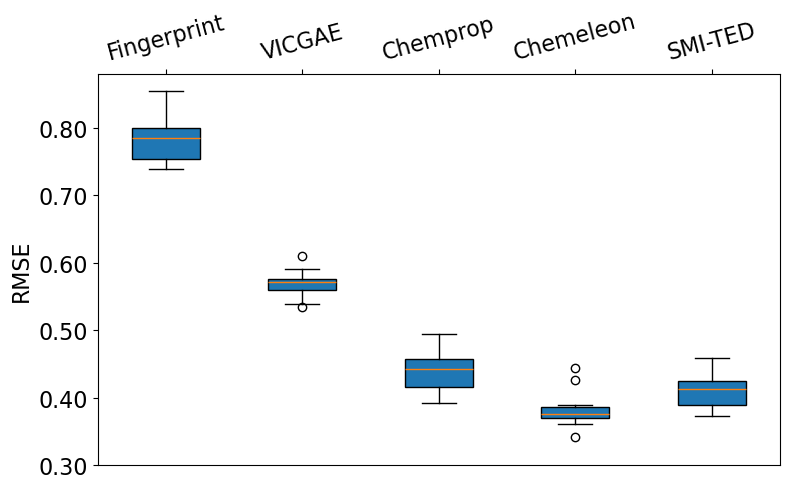

In [7]:
import matplotlib.ticker as ticker

plt.figure(figsize=(8,5))
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

plt.boxplot([rmse_results[name] for name in datasets.keys()],
            labels=datasets.keys(), patch_artist=True,)

plt.ylabel('RMSE', fontsize=16)
# plt.xticks(fontsize=16, rotation=15)
plt.yticks(fontsize=16)
plt.xticks(ticks=range(1, len(datasets) + 1),  fontsize=16, rotation=15)
# plt.title(f"RMSE of {n_runs} repeated runs per dataset")
plt.ylim(bottom=0.3)                  # set minimum y-limit
plt.tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False)
plt.xticks(fontsize=16, rotation=15)

plt.tight_layout()

# Save at 600 dpi
plt.savefig("../results/surfactants_model_performance_NN_update.png", dpi=600, bbox_inches="tight")
plt.show()

In [8]:
rmse_results['Chemeleon']

[0.3789116180668896,
 0.34162340394256857,
 0.3710342961921007,
 0.3888686942162823,
 0.4430332244562125,
 0.42523573130037906,
 0.3691591530645916,
 0.37476915963394514,
 0.3767337259411447,
 0.36053176963962463]

In [9]:
import joblib

# Create a single dictionary to hold all the results
all_results = {
    "rmse_results": rmse_results,
    "r2_results": r2_results,
    "y_pred_results": y_pred_results,
    "y_true_results": y_true_results
}

# Save the dictionary to a joblib file
joblib.dump(all_results, "regression_results_surfactants.joblib")

['regression_results_surfactants.joblib']

In [10]:
df01.shape

(1395, 2050)